# Reconstructing 3D buildings from Aerial LiDAR with Deep Learning
> * 🔬 Data Science
* 🥠 Deep Learning and Instance Segmentation

## Table of Contents
* [Introduction](#Introduction)
* [Prerequisites](#Prerequisites)
* [Part 1 - Data Preparation](#Part-1---Data-Preparation)
 * [Export training data](#Export-training-data)
* [Part 2 - Model Training](#Part-2---Model-Training)
 * [Necessary Imports](#Necessary-Imports)
 * [Prepare data](#Prepare-data)
 * [Visualize a few samples from your training data](#Visualize-a-few-samples-from-your-training-data)
 * [Load model architecture](#Load-model-architecture)
 * [Find an optimal learning rate](#Find-an-optimal-learning-rate)
 * [Fit the model](#Fit-the-model)
 * [Save the model](#Save-the-model)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
 * [Load a saved model to visualize results](#Load-a-saved-model-to-visualize-results)
* [Part 3 - Deploy Model and Detect Roof Types](#Part-3---Deploy-Model-and-Detect-Roof-Types)
* [Part 4 - 3D enabling the MaskRCNN results](#Part-4---3D-enabling-the-MaskRCNN-results)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction

The workflow traditionally used to reconstruct 3D building models from aerial LiDAR is relatively straight-forward: the LiDAR point-cloud is transformed into a Digital Surface Model (DSM) raster, then inspected by human editors for buildings present. If a building is found, one or more polygons describing the roof form of the building is manually digitized, e.g. if it is a large hip roof with two gable outlets, there will be three polygons (one hip and two gables on top) drawn by the editor. Once all the roofs are described that way, a set of ArcGIS Procedural rules is applied to extrude the building models using the manually digitized roof segments, with heights and ridge directions computed from the DSM.

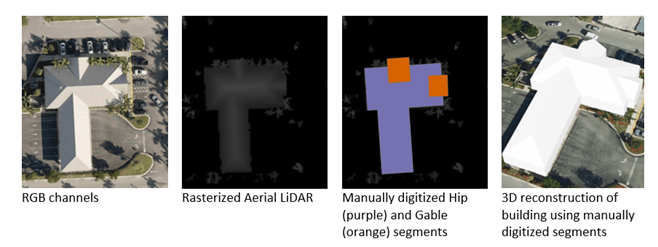

<center>Figure 1. 3D building reconstruction from Lidar example: a building with complex roof shape and its representation in visible spectrum (RGB), Aerial LiDAR, and corresponding roof segments digitized by a human editor. The last one is a 3D reconstruction of the same building using manually digitized masks and ArcGIS Procedural rules. </center>

The most time-consuming and expensive step in the above workflow is the manual search and digitization of the roof segment polygons from a DSM raster. In this notebook, we are going to focus on this challenging step and demonstrate how to detect instances of roof segments of various types using instance segmentation to make the process more efficient. The workflow consists of four major steps: (1) extract training data, (2) train a deep learning __instance segmentation__ model, (3) model deployment and roof segments detection and (4) 3D enabling the detected segments.

## Prerequisites 

Complete data required to run this sample is packaged together in a project package and can be downloaded from [here](https://pythonapi.playground.esri.com/portal/home/item.html?id=1474b1838f4a4ab68890c6595adaa51d). You are also required to download the rule package used in [Part 4](#Part-4---3D-enabling-the-MaskRCNN-results) of this notebook from [here](https://pythonapi.playground.esri.com/portal/home/item.html?id=7ae7f189665b402c908d475f2daf973e).

Below are the items present in the project package shared:
 - <b>D1_D2_D3_Buildings_1</b>: labelled feature data for training data preparation
 - <b>R7_nDSM_TestVal</b>: raster image for training data preparation
 - <b>DSM_AOI_Clip</b>: DSM raster for area of interest, required during model inferencing 
 - <b>DTM_AOI_Clip</b>: DTM raster for area of interest, required during model inferencing
 - <b>DSM_AOI_Clip_DetectObjects_26032020_t4_220e</b>: sample results obtained from the trained MaskRCNN model inferenced on area of interest obtained after performing [part 3](#Part-3---Deploy-Model-and-Detect-Roof-Types) of the notebook
 - <b>DSM_AOI_Clip_DetectObjects_26032020_t4_220e_selection_3dEnabling</b>: sample 3D enabled roof segments obtained after performing [part 4](#Part-4---3D-enabling-the-MaskRCNN-results) of the notebook
 
 Moreover, there is a toolbox (<b>3d_workflow.tbx</b>) in the 'Toolboxes' section of the project having the script (3dEnabling) to perform [part 4](#Part-4---3D-enabling-the-MaskRCNN-results) of the notebook. 

## Part 1 - Data Preparation

We started with two input data:
- A single-band raster layer (R7_nDSM_TestVal) with 2.25 square feet per pixel resolution converted from LiDAR point cloud (using the “[LAS Dataset to Raster](https://pro.arcgis.com/en/pro-app/tool-reference/conversion/las-dataset-to-raster.htm)” geoprocessing tool)
- A feature class (D1_D2_D3_Buildings_1) that defines the location and label (i.e. flat, gable, hip, shed, mansard, vault, dome) of each roof segment.

We are using single band Lidar data which is essentially elevation to train our deep learning MaskRCNN model.

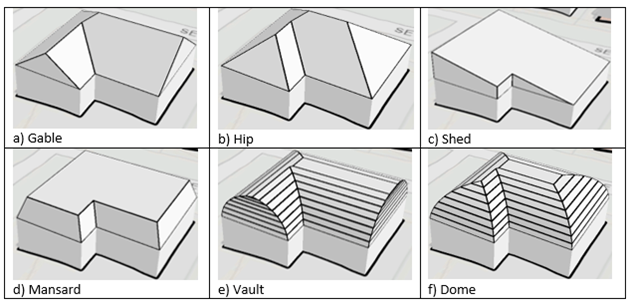

<center>Figure 2. Example of different roof types (flat not shown). </center>

### Export training data

Export training data using 'Export Training data for deep learning' tool, detailed documentation [here](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm).

- `Input Raster`: R7_nDSM_TestVal
- `Output Folder`: Set a location where you want to export the training data, it can be an existing folder or the tool will create that for you.
- `Input Feature Class Or Classified Raster`: D1_D2_D3_Buldings_1
- `Image Format`: TIFF format
- `Tile Size X` & `Tile Size Y` can be set to 256
- `Stride X` & `Stride Y`: 128
- `Meta Data Format`: Select 'RCNN Masks' as the data format because we are training a <b>MaskRCNN model</b>.
- In `Environments` tab set an optimum `Cell Size`. For this example, as we have to perform the analysis on the LiDAR imagery, we used 0.2 cell size.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAtQAAAKvCAYAAABKyFjyAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P13VFVbnyaM1v3jjr7f6PF93bfTuF3VXV1duauqK3VVf1/X2xXeVO97cvIccyQnQRAUkJxUUMCECQEFBAPmBCKISkZyzhk2cWf23sBzf7+52bDBrUfP8Xg8nrkcz5C11sxrrmc+8zd/a+7fgNXR2dUFrU4H/cyMhISEhMRrxthQP/4wpnqBcd/sYas8EhISEhLfDhqtVnCsFNQSEhISbwhSUEtISEi8W5CCWkJCQuINQwpqCQkJidcPg9GI2bm558JoMtmM9zogBbWEhMSPEkx+L4KtONZgYmbyXnl9xmD4WtKWgvrdhNFowKzR9j0JCYnvFiyY6+rrERYWhpiYmGcQHh6OrKwszM3P24zP0On1gv+Zx62v87nlnvV1a/A9PqSgfoOYIdKdnzdiThKvhMT3hsDAQHh5eWHHjh3PgK8rxsZsCmYLevv6MDE5uUw8c3gm1Z7eXqg1mmXhrfE2C2qjyQgQP1ljftaAGRthJZYwQ4Nt34gSjQot1Ho6txFGQkLiu8M88VtJaSk2b94MJyenZ7B161YkHjr0XB5kQV7f0IBdu3bhaXW1OOfrzPEqtRrHjx/HwYMHF6+vxDcX1KTW55hssRxydv5i8CxnenQK5ytHUTZGA7DBdjgJCYnvFjt37oSzszNcXFyeAZPvqELxXEHN14OCgnDk6FGMT0zANDsr3m3G9Rs34O7hIQT38yzVb6Wgpok+c/hIjwJxhUM4+NCMuMJhXG5RQiVF9XPBRhLjlBIB8eX4neRBtKuNMElul5B4o2DLMwthNor4+Pg8AzaUpKamCuFtKz7zNfM+i+bdu3ejuqZGcOa0UokzZ86IdAsKC5/L699IUBtnSTyrVDhxtwtfZnRiw3kz1mb24dawBjOm5aZyiSUYqO36KjrxW74V2FGjx7ycgEhIfC/Yt2+fEMW2EBoaigkSyiuX/SxgQV1aViZE+bFjxxZF9dVr1wTpXrp0SZDr8+K/dYKaxfTUFCJudOPDU+3wvT+AyDwC/b87pwO/OtqBAqVR8tXzQOLZQM/7ce0wzjYpMaEzwGArnISExHcGFtRl5eVISkpC1dOnQhCzwGbw31euXHmhoGYwj4+MjgpR7R8QgCfFxUihON7e3igkMc33bcVjvKKgNghCbS7vwe8faIFb7hDutk/iXvME8jvGsTezBc4PJjBJ4aQl4zkg4lVPq1HRM4UupVwWlJD4pmBRy5YCW3ieZdkC5jf2qWN/u8HhYQwMDgoM0d9t7e1CbDOpvigdJtayigohqnkpMPvCBSGmL168KO6/KO5bJahZTE8rEX6uAX+TOYT8AR4UllYd50x6dA2qMKSmOlmsrvS/yWTA7AKMNqyxBkrXct9WGL5vovGEJx3W4Zat2tE9zofFqfBPNlE8y73Fa8+Ja8GK9DlPy72ZFfVYKYKt018eb+k6r8qKeFzWeRMwt5QOx+d6G6zC22qr5W1gDi/qbas+EhLvMCx+yszRK8FudHzfVjwGC+rChw+RcuaMGAfmiMFm6RqDRXRZWRkOvcDlwwLm9sGhIZw4cQIeHh7CyPKwqEhw+vOMJIxXEtRGgx4dZd34j/uacLxNT4nPYJ7Ig/3rGMYZPaY0euis4hiIFCx+eIJoVhIEFY79ia3DLBOZfH/O7EpipDws4Thfa/LjfEQZ+H++b708SaS2mD6D7i2mbwWOax3O2n1FWOWt4luX0eITbbm/uNRH/89S2S3XF8vEZQQ97IX0RfyFOlqHf2bJ0EZ6JsLK8khI/BgwPDKC7p4e4VphDb7G92zFsYD5LTQsDP0DA8IfziLE+W/2i46KihLi+kWimImV75eWlsLPz0+4iuTk5AjSf1E8xlsjqKkOMGhx/U4z/sX+ThSM6p/lYIKJOMrCt1zveSONBQPTeNQ5jeIeFQY0NJgRfwnuJ55iThpWqPCY7xOe9FIYHV0nschpGGhQHFKo0TpJ44hag5IuCkMoo3CTzPUL3Dej0aF1WI0xittL+RV1qzBMYwyLcczOCJ/lxTz6VBjVc9nMcUU+zOkzOlT3mNNn1Cm00OiZ74lzqR809E6LNMr61Rin67MLeXN9hkaVeMJpU7zaURrk6Z6B4hlUalR0U750vZjyVWgpPRr/RsbUaB7TQs1lpzoOjKrQrZzB9KQKpSJ/JTqm9WKssbQx/61TqlFF6XFej3vVmFBq0Ez15kmM5HaJHwuYg9mwkZCYiO3btwursAV8Hh4RgabmZhHOVnwW1Cx8k5OTBcdbi1/m5OLiYhw5cuSFFmoGp8/f0HA67P4XEBAgxDhffz2CmgpjGh7Bz6Nq8Iv8SUFmy+4TeLZv/fKz+JsanMCJR0M4WDiE5IZpjM2QCFwgLCFS1SqcLR1G/MNhJD4cwpH6aaiZ6DgMD1iTSlysHkPThB61rQrsLzSHzW5SQk2i0kjpMNH390zgWocK/UNTOEP5nambhpLSmKU85qancfLJMBKKCJTHiWYljFQ2jmspKw8ind1jOEhpJxAOlYyieFRHZTWL5d72USqfOe+sDjVmaGDgurILh3FiCqnFfI/qWTyGmnGdmcgNOlQ0juAAxeF0s1pV0NB1I9XpUrUCFWPUBjQwKBXTdD5ORKtDUZXZZ/FY6Ri6dIZFcue2naMJTXndiCgD43zjNFp7xnCxVS4xSvz48KCgAF47dsDB3l74QjP4b08vL+Tm5dmMYwHzG38J3tvbu0z88t9jRKQsqIe/RlDzPSZQXkZkQc3+eWzRYCH+omVBxtsiqHkyr5uYhltCDT7LHccUca81L64E85DBoMGlu7346Fgj3k9rx6+ONuDXV2hyo2KO4jT1eFo2gA2nm/GT0+1YldaG/5XUhA/Sh9BEHDfDRgDi/b0ptfi9Ez3Yf68Xn6e244tzrfiDPfXYnDcGBYt6/jiyewh/GdkA59xB+Ga24VcZfXg0piPe1KH0cR8+PdmCf0o25/E/jjZjzcVhdJDgnmFRTvmMjU4j62ob/uJ4Gz5N68BnJxvxv7KHMEgCWKtR4filDvzziWZ8nNqGvz/SiG35E5gkUT5LvF//tB+rkhrxE0r/w+Q2fHFxACM0FvA3MAkZjfizJLpG9f9/jnXi5jANpHoNDp+rxe+nDaFbaxJukaFJNfjd410Iu96Nr8624xeJTfiH5G7cU9CkgNqKyzihUCL8VD3+5GgrPqP0fnmiHR7nmvH/Da3DvhZqK6sJgoTEuw4WrfxRd2xsrBCzbm5uwlgRHBwsVhSfJ6YZr0NQc/pTpBmTz5wRq483bt4UVu3d/v7LPlS0hZcW1LNEcNWPu/A7US24NUGZLgi952FungRwwzBWJTTD8XY/Yu714IPjzXAomISaCWtuBj1dYwg41YSfX+hDGBFmdH4P/iGhBVuJFDt52YsaYK6tH78f9BQ/JSL1utkn/PoCb7bj9/0aEVpL4puttTN6FN1qwX+IaoYn5RVydwCHn05BAwNam0bgebwRv7rcj4i8QUTd78b/jG2B5y0F+hes3EaTDrfvdhE5t2LLbSoH5eF1qQ2+pWpqDS1yH/bj14dasIPix9zqwP9zuBXRtSrMk5hWDExg96kG/DSrF5H3B+Fwvgfn26ep7AbcutuOnx1vhevdQQRRuTyvD2IIRLTtA/i94Gr41uqFpXnwaQ9+x78Kf5fWjZA7A4igdNYcrMOvc4bQrDFPQIxGLS5c68D/fbARDneoHrkDcE9pxp9HVOGPUgbRqlqYhKx4DhIS7yIs1uFHjx9jF4lZV1dXARa2Dx8+FPdeZEl4HYKa07f4TLOoZrIWPtVJSRibmHgh8b8tgtpIPDvUP4S/DWlEeL1KGBYs90wsaHlFTMDMQ+yKUFDQhj+IbMNFhY5SM8EwMY71B+vh8HgKJMfRVt2D/x5ej7A6FTEw8R1dm5keh/3+OvyEhPeogdIjQR2X3oDfCKiHXdmUSAcUuq22F3+4uw72VUpzvj3D+NOIWvwXEqENanOYeSpzRXEn/iSyEQmtGswu5KEeVeCLyFr86t44VPTc5iiPmNQG/OXJHpSpSJhyOJMGlf1qKDU6pFxsxJ8e7kYZcSzfG+0awj/tb0Jsqxp67SS+DKvGV/cnMEc5cP0HBpWgURGXLjfjP8R2olFL5aN4Ewp2h6G20JKgzqjHH6UPo2dBUEclV+M3wppwqJkHWkpHNQXXxGr85NoYprmMKiWiUhrwN2d6UaE2p8dtE3KmHv9iTy3i2qSglvjxgQ0Sff39SEhIgIODAwL37EFtXd3XGiosgjolJUVwN4tfjsMQ/tVlZTj8AkHNcXiFksW08JmmsYTDCp/q+Hjs2r1b+GY/b1x4SUHNhKNF5qUW/JtDvRjSUcaWe3o9kZPZ1UPJs3493SMinh4ex5q9ddhYRAMLEwkRRX99H/4suhWXxvXCaux3vBb/+8IQOvVMJAwDFCQ2/zyoDjtqScwSoc51DOK3Q6rxX0/3oXKB+EC0dvNWK/7PaCL1ASKy2RkU57bgN4IaEEUkbg5jhGF0Alvia/H+TQVGqAEseXTX9uB3KWx0G1We8uiq7sYfhDUQkS6Rs0GvxSCRcH/LAP42mNJtZ3HN9TCi7EEb/suBbjQTuebea8O/jWrH0wUynKF2m9ZSe0wq8Is9NXAonjbHY8vGtAYqapv5zkEakGqxp94sqIdoEPnPwU/xD9cUGDdy/iaMt/Ti90LqEdNC9aMytlV04fcjGnGkU0sEbw4z0TeG9yPK8SfpQ+KrcimoJX5MsIjq4pIS8QU3LwmyZZqF7IuEMIP5jT887O7uXjy3cN4okWdkZOQLXT74eg6JaM6TP0BkHmTCrljwqT50+DAmp6aeG/9tEtR9vf344yASks3EcbMkqKldoVcj/W4n/i6xGf/zUBN+ktqN6wPEV6YpbIuqxc9ujdMgNSO4nz/GO59dj9893Y8W4r5DJ+vwF+eGME5cOUt5sBsIMIOyJ534beLsXOJ/aNXYm1aH/3RmCH06i3sb5Turx5nMBvy3lEFMMs+RoP6zqBpsKSOuprJymQ16FQISavGPOaNQUx4mkQePDXrk5bbhP+7vRA2NUYNtQ/hf4Q040K4RgthcZ87DgKnxUfyUxhn3smnMUbpKCj8/pUQgjUn/6+oYhqYnsTq4Bh/dUoCeIlEwCXnh9qfDxZwW/PuwdjxhNw8qN1/nlUZo1M8I6pDjNfjby+ZJBK92UiCkkyD/N0f6oKDz/tZB/N9UxviOpTLOzJqgqe/Fb0bUYX8rxZGCWuJHCBbD7L7HHwfyVnh8/iIjCYM5mA0b7KKRnp6OjIyMRWRmZiIuLu6FgprzaGhshKenpxDTFgHP/7MLCH9b8xq2zTMTQWp2M/4VC2oiEuELzZVTKLDpWDP+OqERvxNeg7++OEKicQZPK7vxH4ObkFAzheo+JUp6VaivIXEaWoXNZRr0tQ/if5CITVxGdtQgsxrsPW4m5DEm1I4B/C6Jz0AWnwtuJuxzph6ZwKq4OgQ8VRLJzaDobjP+/ZFulEwS6REBzc3NoL6qB38Y3ozsIZ3wN7bkMTujgvdBGhSuKoiCdTiT1oDfTx7AKJXDstzJD44nEVlXW/B/xXTgdqcS5T3Toh7lj7vwH9h60D2DprJu/K5fPSKaptE9TWVkgqfyaZWTcIqswd9lDqB4QgsD5c9+3+w6M7dSUNeQeCZSTeonchbkaYBOrcA/B9dj4xMW5FocPl2PP6AyjlvKyOUj0X/6fB1+L828TZMU1BI/NvB7ygI6NzcX169fFwL260iXwR+2hISEID4+XuzSYQF/HX6YxDBvmfR12+YdOHAAly5fXjzn/01EtPyVOVu/+aOWH4KgHuwfwl/71cG3aooY1+zbOzOjx6RSi8FJDcrLOvCbxKMnu4ivxofxdyHV+Hd7G/G3iU34q4Qm4v4m/Mm+evziwjBaVdOwi67DP96dWMbrpjkj+hoH8Fd7GnCE+JgFdUwq8Xz2KIZIUFtWPNkN8HZOI/5rfDdqhaAewl/GNOJQj35RdOu1Y/gwpA5fFk09k0drJXH+niZcUulQUd6Fv47vQtG4hVfN4NXDobZe/O7uavzn2Cb8jVU9/nhvPVbfm8A0CezHBVTvsBr8i8gWHGuZRo+Kxg52iekZwS8TG/Avg2rwy5whVE/RWMl8THVaKaiDSKD/9NooRkhQG8WYosF5EuT/KrEPY+waU9mF/xjRhlvcJjRuiDJS+YwtffitSBbUNBmRglriRwrmcst+/i/D6zwW8Hc07KZx+86dZ8DXyysqRDhb8Rksitnlg/OzzpO5nMvCW+hZh7fGS7t8sFX42s1W/PvQNhTrzP5f5nv8YRyLWBUOnmvAH50dhkqvw/0Hrfi3QfX4x+R24Rf2SSqjA5+ndeBMlxb1dd34rfA2XO63IhICz/Szz9fjD4/0onlBUP8eic+QhiVSZEJUjU5hfXQNthVPkoSdwcPbLfhvZ/rQROTMwpLL+/BRB/5tTCeKx5ZvT8eC9MipGvyPtCGMYBo+CXX4+P4Ulv3QCpOfXokDmY341+GNeD+lHZ+KOrTjY8Ka8924NkRhpqYQfaMLf7ynEv/lYDsSG6fQT8QLgx71tQP4WXw9/uWuWrgVjCJ3UCusGc8T1Cf69aLs/BA1JKh/JQQ1TRighM/BevzpZcVSW3H5tBqczKrH70tBLfEjB5Pdi0jSFtgfjsWvLTDpMnm+iMTZamErTy4L33tR3LfJh9owpcTuxBr8w/VRjJFgtHzjwv7SvONEd0M3fi+qBae7ia+mR/CPYXWwL+eVQOIc4iPGHIPSMhmn4LS3Dv/75tgzYrezth//PbgBp4eXBPVfrRTUFOdydiN+91APWqwEdeIyQT2BL8Pr8NmDSeLPpTxmiUvrS6msIc24TZOBh0Vt+M24LjweIz5esG4zePwY7uzDH4U24UAblWVFPSwfo8/OmTDZPw7/7Db8cVg1/ixzCOOUP49R81SW2/md+DkJ6/8jusU8jumedfkIJkH9TySoh60F9eUW/OtDZkFdWdGF/xDZjlxuE0sZKX12dZSCWkLi5YS0NTg8c/Dz8DLpPS8MX39R/JcW1IZZE5TN/fjT0DrsbNQsf8kpA+hViCNB/cckqJVEFMVPOvCfYrvwcIpJhN0hrDGD1qZ+/LewZpzu0iyzHrM/c1IyicfkAfRbCerwpplFwcsW6omhMXwcUYcdVdOYn59BIQnqP05eEtR8raKsG78d2YpbRFZMlpY8DDMahB2uxU8ujkI9PwX3g3X4m+vjy4S9sMrPqpF8oQm/dWpQDDQr68Ef4Oio7vP0d0/bKMKudOJ3gmsRWEkzGCbmeRpsJ5XIejKIj/ZX449O9aNzhur0HEF9/LmCmkT/gTr8aQ4NUpa24jYnAj9zoUFaqCUkvgFY9L4ItuK8LrwtgprBXF5a3I3/FNmAo+0k7KyEsJHudZGg/n0W1F18T4PABObOEWiJ9ywreiwyeScQ/lgwg0XlyT50GE2CIwWXzulwJ7cV//lgF8qnKE+NCvvP1uH/c3IAvWriSg5Hgx0mx/HVgRrhdqEjbnxWUFNeei0Ona7D/0gfxCCNS2beY77W4vzVZvznI73oovOeliH8j5A6RDepMUe8KT6YZ76mv9VTk1hDHLylaBI0LVp0YeTVRbO4NwtsnnDQwIC2h234N9G82kllovZhg5LwrR4dx2f7nuLTh8TTxMdHXlpQ92KUzruaBvCXofXY26xeHKNMNHbVFHbg31HZY6XLh4TEDwYvLagZ83odTmc34rcOduDBJBETi0YiHF4Gg0GFg+kN+IO0YUwQMQ53juAfQtgVQiUsB2y94Jk/+1gzSWmGJ7AurhbridA0bLVdSGduQoEPY2rxVeEU+JcY2Yf6P4XV4Oe5vLOIORxMepQUtOFf7m1Ddh+R/OwMClYIat59Y6pnFL+MroXnU5VYSuS4bIHQDQ/hJ+H1cBdWFgOuXm7C/29fOwqoTiyquU5M3mwtqS3pxu8GN+PKhH6pvlQP3naJ24T9A81ESeRKg4T/0Wr8DQlfhd5sdRF+d3Sv73E7/lUUEfIIEW33qwhqdvmYQRa1+28e6MATpbmMnK5KMY6NUZX4b9KHWkLiB4W3SVCzyGQ/5Fu32/AncQ3wKFMKn3CVVg+dTo+6R234f0e2IEUIaiOaKjvxm3718CqZwLiJ+I8GkcKGYZxr5O9eDFAMjOKjiBp8fmeUhCWLTz06icf/d1gDvMqmoGNOVKtwIKMBv+FbgzX5E1ARn5o0ShzLasb/Gd2Ou2MkoHlc6R7CX0Q1IN5aUBP/9nYM4WdhtdhcMI4hHQt5PRrq+/BXoY0Iq1eCt8SbM6hxPKsJvxXajJM9WmhJJBsGxxBdOo5RtR53c1vw7wKacLBNCRWlaSL+zqwYQWGvFirNJJIfT1J+ejFm3b3WhN+O70a1UYOcyjG0j2iFJXm0fRj/FFEHfxLti7t8nF3a5SMoqQb/cHUUQ4uCWouMS834vxJ6MUhtM29U49h5LmM7bk7qxNjY1Ux1i6rC/2tPHQ7IjxIlJH4weCVBzcRr1JKozmrA7x5pQ3zlFOr6p1Hep0RTyyjWJNTiTy+OYoKtBXo1zlwnwtrFH7tMopLC1LQOwyN3BH3KGRKSMygv78PfERl5EDFX9tJ9IrugM834y5N9aF34uJEF9e+EPsW/im1FTPkk6gaUKKokkRvSAMeiCWiIwNm9ouBGM/7gRC/qSVCbrSLsR61HfkE3/jqyHoFPp1BFeVQPKLD9aBN+kj6IfiIvI5VVpxmH8946/MXxDpzvVKG2dxrXH3QhoJ4ah4jV93SDcE9JpzpwGmX1A3DJH6c6aJBVMoj0knEquwpFNcP4JLYBIQ1KDKupLpeHUd2vFHU/eK4RP0nrRwtv/N8xgN8PqYZfrVlQDzyl+gTV4UiflaBWjeKn/rXY8GhKhNGoxrA5sg4/Se1D7hDVo2cacRmN+Ne7K/GXGVJQS0j8kPBWCWoCcw7vozw8roBzQhP+gsB+xYw/2t+IVbcVmKCJPFuk52Z1KK3uw0+JV/8ssQn/Pa4Jn2QPopmFOXEQbxmqHJzArrON+P0DlEZ8I/48qR0JDWyFNRtUWFDHpNXhTzOHkXyjA3+T0Ii/PtiA3z7diyfDOrGTh/j9gP5RvH+sDWf6lwQ1g/OY6KGyJjfiDymPvzzYSONGJ1LbNCKu8AMnIcpuK/dzO/AXfJ/q8mdUlx2lk1CSwJ2f0+BKbif+NroBf071+JP9zXDMU2CYBL9aqcBWCvvnFOcv45vw12d6UcfjFtQ4e7UDf7uP02vEH8S3Ia5mGloeh7QapF5txs+ujKJfZ8K8So2D6U1YnTsmPkq0COprdzrw5ykDGNbw5IAnHBqcu9SKPz9A+RF+ktmPwuIe/HZUHfY2S5cPCYkfCl5NUBOYoNhi2tExDIeTbfh1Sjs+ZJxpx3uZfSgc1YI/dBFLcPNaXL3bg09Pt+GDlDb888luZPaqoV9wW2Cr8QSls/FsO96n+O9TOLuCMbEPqCBPI4lEEp9/EF2HPeUqJF1twy+T2/GrlA74VipBClKkY6KBoK6qHx55o+i1xF0oL/t3DzQNin1OP6Byvp/cBvcnk4KsLct87FNn0miReqMd/0zpc1m+zOpHyTSnxVZtFY5mdeADus51fZ/ItUjJYliP0soBrKN2eO9MG36R0oWjjUphkVcrJxFKYd8jcLzVN0YwynlyXkNjcLvYhYweHpwMGOscgWt2D+4q2NptLpNWM4Ww891IaFIJizS7uWimprDvfBt+xW2d2oHE6imkX2zA76QMok1umych8YPB2yaoGeY9pomfiGvYfcMavDJn/RsDwsVjRTjr+5yW9T0GW5YtbhdCUKfW4b9nj2JYT+JzIS3OZ9mPf1FYdoWw8KI1ONwzedgIx2UVq442wlhcVaxhqcfK+lnirYzD1y1xmN95BdNyzrxt8cm2gMMs+16HwOEW05w1Qd/Ui/8c0YCTix+qS0hIvO14ZUFtAZMK+xEvx7OENje3PAwTm/X9GSIS9kFeDEMz/UViXhDU4qPERhbyS+FYiFqnw9Zs4dtmdW3ZPau4mHs2jPgVQhLCi2Ho7yVhTmW0vkfge+zuIZYlra6zBYbjsMXH+jp/PLNYNrrH6VlIVbQBnS8XxOb41r7fPEgttZVJLDEeTK3H318ZxRC1la3BREJC4u3D2yio3xisBXXWKAa1P2Luonozx1t/5E9PCNevtOC/HO7DAN1bHA8lJCTeanxjQf1GYC2orXb5+FFCzx9ALllk+MOa0YFh/F1YI0J4722rr90lJCTebkhBTYI6pRZ/en4EAz9WQc3tMDWNfYVDuD+gFe40plktCoq78Ue+DQjvUD9jyZaQkHh78XYLahMJ6rYB/NeQagTU/3gFNVu7J1r78Q8XhoQPeVWfCpU9w/ggrB4fXxpG7xyJbBvxJCQk3k5IQa3GkYtN+OU1BYatts37cYHaYU6D7Lud+Ju9DcJf+6/iG/DbSV24xGJ6xSqshITE24233EJNQnFQAafsTuFv/GP2Edbpp7D3bDt+ldwm/MD/+XQ7nIunhB+5XBKUkPhh4UctqBcgvieRFljht84TCgtW+mVLSEj8MPB2C2oGkY21v/GPF+xbZ+WTTbDev1tCQuKHAymoJSQkJN4tvP2CWkJCQuIdgxTUEhISEu8WpKCWkJCQeMOQglpCQkLi3YIU1BISEhJvGFJQS0hISLxbkIJaQkJC4g1DCmoJCQmJdwtSUEtISEi8YUhBLSEhIfFuQQpqCQkJiTcMKaglJCQk3i1IQS0hISHxhiEFtYSEhMS7BSmoJSQkJN4wpKCWkJCQeLegUqkExy4X1J2dUGs0NiNISEhISHxzsLFidKBXCmoJCQmJdwjTSqXg2GWCuqe3FyoS1PKnTyUkJCReLzQkqMdHBvFHe2sWGPfNHrbKJCEhISHx7WBTUPf29UlBLSEhIfEdgAX1BAnqP5aCWkJCQuKdgRTUEhISEm8QUlBLSEhIvHuQglpCQkLiW2LGYFiErfvW+EEL6peon4SEhMQPHczlBqNxGb6O41+7oF5ZCFthJCQkJH7oYK4zzc4K8LmWhLJOr4fRZMLs3NxzifeHJKi5DlwfriP/bamjweqarXgSEhISP0Qw3zHHTUxMoL6+Ho8fP0bhw4eoqKzE4NAQVGq1CGOL+16boGbxPE9xORNOdGJyUmTMA8uLBhcJCQmJHxosBgPeYrTo0SNcvnwZ57OycOniReQ/eICW1lYhPi1i2xo/FEHN9eOBo39gAGXl5bh27RouUv24rvfz89Hc0mIeXGzUUUJCQuIHBdKorFVHRkaQc+UKYmJisH//fiQlJeHEyZOIj49HVFQUTp46JYQ2cyMbFqzTeC2CmgcNxdgYHhQUIDU1FcePHzcX4sQJXLhwAZVVVWarhrRYS0hI/MDBfMfWi5ycHMTFxeEUESwT8M1bt3CVROeZlBQcOHgQZ8+dwwCJUSZp6/g/BEHNgwWL5Xu5uThw4ACOHTuG7OxsXLt+HVeuXl2sYwr9z5OKufl5m+lISEhI/BDA+rSquhoHSTinpqUJowgbgtlQzAdz3BCJ7Tt37iCWhDYbGJQkoK2Nxd9KUHNCTLxPqRBMuidISOffv48qEtB8ja0aTL5MvKeTkzE0PGzTYiMhISHxQwDzHVtmDxKnJROndXR2Cku09cHE3NffL4wJ0TExKK+oENcsxPu2C2pRfhoDjiUl4ciRI2hoaBDi2vrgduDlTx5UoqKj8bCoSNTPenCReN1Y8NO3ee95kM9E4m3C29kf2ejBepWt0sxlzOkWzwoNaWE2jChVKqFf+Tr/Vsth4sazZ88KY7ElnW8sqJl0OaNLly8jIiICxSUl4sdgOEM+5knNWwrE1mseXCKjolBTUyPI2FaaEq8DNMmZo7Y3vcJqgMEIE8UxGSXxSrwFMLAP8jyMRhv3vkcwt3X39GDf/v3Izctb5Dshcght7e1obWsT3GgxHDBJR5PgrCbeWyTot1hQc9nHiK/jExKEa8fk1JQoN3M2l52FNQ8g/LflWl19PWL27kURDUQc1la63wyUx+ycsAwtwxy1uc3wbxLMmXMwGGzdo3Y02Si3BbPcbrbjvQg6jRITU9PUf16epzWqaYqjhFb/XXL7854T1dNm+Bfhxe36Mpgxztooy+y3SvNZvKBvvtZ8viEEh367dvwuoFFNYWJa9R33x1eDMA4MDi4aP5i7mQct9xqbmuDl5SWEtoXzOAy7Ne8l3nv48KG4zuG/kaC2JHjj5k0kEPEOUGG4ABaSHVUoBCzEy/cYJaWlCA8PR1d39zO+J98K9ALZOpi4bIZ/Y+D2oJdujtrG1n0SsrZLbj7mZ1/RRYbbXzuFzuanaOidgI7ytxnOGlQGg1qBproqtA6rxfOyGe51gNrC1jH7qvUUZEbkRfG+8cDKhGNZy7E65kyvuf5G23XmstsM/0ZB/Y+KNz/79pAb98eZqUHU1jxF9zjzh40w3wP4vWAxye4dLDSZ5yyka7kXEBgojAtsyeBrDB7UmIjZoj06OirivNUWaipzVlaWsL7zuYXXNVqtcP/IPH9euLvwNb5vqSNPGHiiwdxuGVy+HWjc0KvQ39GMitISPCkuXsATPHnajkmdrThvDjr9OLoamzGsJP5c0UdnqA+PdtWgmMv6pBgl5ZWoqqqg82I8fvwIpQ2dmNRwuOXxXgSDkQb9WxF4f6Mn8nvonTXZDrcEei4GDarOeOBj9/2oHmVusxXuW4Kev0GnRF9HA0qtn9OTJyhtHQLT3+wr5Gtu1xab7foy4PFANdKFyspylCyU5fGTxyirbsSoit7Z18In3DfVGOpuQhlpmsU6P36CkqY+6Ew0Nr3uceSVYICWOLSJ2nFE9c3a8bWD+sncjArFx53wqfchNI6/Wr/4rmDhNrY0X7h4cfGa5T7zHwvmDRs24NatW4ucz2CeY7HNftX8Y4h8/o0ENYvppuZm4bDNFhkLgXJBOAN28eAPdawLxmDivXHjhlhG5AHI+t43BuWhVTThemY6UpJP4/RpxikcP3UOd8u7oWNrgK143zlI9M1p0VNTgILiNkzrl1tVZoggNRMDeHD5OI6f5DKfQVp6Bs6mpeA0Ddqn6Dy3XgHjq1iN6UXGWD32u/wa246WQDkz//V1Z0XfUwD31T+Df06fIG6b4b4taJDR9lXhfOZZnLE8J6rnidRsPOqcpkLMveRzonad16Cj4j4K6fmqZr7B82UxPdWHwjuXkCz6ixmnTp5AHrU5l9VmvFcFpzNQg+ysc8vrnJKJgtZJc52/L7Kjsplo8Hr64Doe1AxB+7rq/G1holZpyMaqj36FQ480bwXpMphI2QLLBgS22loT6wz9PTwygp07dyIsLAyTk5OL95kD2bDAvsYsxAWBv6WCmstcU1srrM3snsfnXF7+P5fEtK+vr/h/ZTwOw7h06ZIYmNQ0QPH5ynCvBDaSaDuQ7L8Zax334EBCovgoKP7gASSk3segliZbtuK9AcwQfyj7b8B3vROutz8rbmdMs2h/eA6J8QeQePggAl3X472PNiM07iDi4/bj2KVCDEwRj70Ct3N7TjTk4nTmVbSMzcH0Eqs3xhkdektzcCbnAfqU8zB+F1zDinmyFSf8t2CVa+DCc0rEoUNhcHT1x6m0HLRMzGP2Jcor2rVvoV3b5l9i0vAseFWr62o4fv3FNoQeOITEhHgciIvFsXNX0DrOq7C2470SaIyEuh8Xoh3xqb0vYhMOISE+geocCdftu3H4RCbqFbMvVefvAqwtpurPwXG9K251fLN2fP2g/j6jQefji0i5VoRB1XfUH18RvBrCGpYNHvzxtWVl0QLmPub9TZs24fbt2zQ5efadZQMEe2DwCsUrC2p+sTkSW2ru3L27KKa5ID09PcJCw8Q3MjoqBpqVcVlIHzp0CHn37wuBbX3/m4A7j7LpPOw+W4P96feRl3uXynUHN+/eR0XLEAlqs3V8uXChAWBhsOC/DURsXFe2LHDYZ8ObYX3fEmfxPqXFjT0j0uP7NCDMjeNOoju8Yu9CMYNlLhWclnZagerHt3Drzj3cvpkGjy8+gEPwcdx+kEd1yEVV95SIs5imKK+5HZfKYVVWum7UTqK1rhRPO8egnVkY1DkNCmOzfnTNqBpBbVUJGgbMlrXFOCIvS5wV9RWgawvpme+bz222HQ0yykdH8PEXDjiak4fce3dxj55VdmYsXNc54ejVUozpsPiSrazj4izbwO06gisxjvA58gg0LlGcr2mXlSA+xOAT7LFfjx2HsnCXRAL35dt3bqOya1K0I4f7uvRWttEz7WOag7bsND77fBsSL+WKOt/NvYfLFw7Cda0TDl18iBHNUp1FmsvyXOovL3Pf9nN+Ng2BBcFy2m8d/FKeQmWwPaF5cXmWt89KshFxRXnM4SxleWHfomszk32oKC9Fu2LBQi3ivyDOIuiapSziPp8/p/6vCE6TvxMpKSkRxGl9j+vFX4bbEtQM5kb2uePVuanpaeGf9zYKaq4Xf1B+l94FCzdzPdhNj63v6enpgr+Z87nOFnA4riP7VLM/NftfW9f/G4Hfc20nUvZsQ9jF1hUrebyUTX2COMVk7T5B14x8Tbi7Ldynv7ksXGaGiWBYkRcbEfi6uE/pGSn8Ut+iNKluRk5nIQy71KmbL8B9qwfudlFx5rlvL0/TSG1pPuZRmx2F9Y7x6JpZuLbgGsD5WNI0xzeXebGslK/1OzUjFrvMYlrH19gwQOVdVj8+tyqLgbOcpzTpGsfh8VKEWdkmy8rP5TBfN4ehsFQWc7tahyMwj0y14mSAByKvN8DIRRSHAf01JYh1/QAesdfQrbUIqGfraJlYGGbnFtv1TicVnNtV5MPt9Px2sQYL6o6cKGzZdRIdS4WhtOaWjS3mfmJJj+tvld4z7WrdHwhCUPchO9ILAeklIApfOEwYaanGEa9P4RiagVbVc/JcaEvrPvOi+zzRsDwzS38R7facNhCCuuE83Ld54S61oy1BzfmZ3w/b5eF3wrq9l78TZpe2lf2Xy/ni/kh5ftf98RXB6eXl5YmPELkM3C7W4PuPHj1aFNSiHazuczvU1tUJTcu6WEn8yMdLC2rOgJf12Do9vPCRIRdkfGJC7OrBgwYPHtxufM8algKWl5cL0c2dmK+tzONVwA9kuukCPLZtR26vufzimdE/frg61RRGFApMaamTiDj0cAxajI8pMKbUQq9TU9mnoaM6TI0N0CxlEIPDo1DpucNY8mG/LhNUE8MYoPvs4jI8RuKT/bIWyqFTT2N8Wg2NRomRoQEMjE5geqQZWXtdsH0fzdL7xzE6oYTOuqOQOGCjMh9zhk7EO65H+PnqxcHDoJnGhFIDtWoSQ4MDGBqjclKn1WuoTsNcVspncEQsH/IzEGnq9VQGLbQLjvIzeh2maYBX6o1QT3H5Kc7QKKZ11CktYoPCqEUcc7lm9BpMTkxBTfVWjg+KfAaHx6GmvC0Ewe1onJ3B1CilSWXrHxylPCivCcrLhvWI/dqmH5/ABocIVJgncQvPyYj2h5nw2rAaCfe7BEGzaNJrp63qOIwJNe99y3XUQTVch9RQB3gn3EHHwBgUkyp6ftQu6gkMcdtTeZ6pozW40YdKEerqhuNlI1Zl4WUoc3j2gTToqQyUXj+nR/UT6S3cn9FrMcXtqpvB9NgQhRnBhIr6k/XzZUFdnoqN24LweML8oC117irOge+mL7H/ZjO0XGfOkwYUA02IuA7cD0cmqI9RvSxEJ+7rpjC8cH+Y+tPifWp7UR56zlrlqLkNBocwrtILElgskwVCsHQhLcgOQem10NgQ1NwGRr0KowvPYWhsUvQ/M9nRu0ttMK7g/sHvxBAUU8QZ9H6b09FDrZzCpFoL9fS48FHj+ugpzrN9a2x531roj0I0MBbeUS3lOakw131odFK02yLxUp8xmnQYHxmislB5hsboHaZnRP1RRc/IFpe9LJijWCyGhoYK0rTwmAXMbWPj40JQh5OgnibRzILUOgwjNjYWtbW1ol5vm6DmOrFPIBtEuP34nDmFP65krmc/cOZ1Xh5llxZr8DVOgwU57+7EFp1FPvqmsBLUwRn11D+tLEc8qVKO4OYhDzhEnUPnBA/wc5jXD+Da4UA4kYCbmhzBjYQQxF+qQOndRPh4OMPZfiv8E8+jbdJs3ODJFpezOicOOzwc4ebuCoctu3H2YSNUJMBm2EVttBqHQ8NwpqAQKcHucPSLxMF94fB1XYdPPv4Mmx1c4OKfhKrB6QV+sqoD9ddZ6FCeEYZ19rFoVBKHsata32NEBYTj/KMCJO1yhN3OBDzppndregAZMY5wdnWHm5sr3DwjUdinpTKayzlceBreYcloUrJLgRGKR2fgQ+f3H97Gvt32cHR0gfeeo6hSmHnPZNCgIecg1fkK+nTEO0Ytmq8lYHf8ZRTcO4cgbwc42rtgzwFqEyX1V24Teg/noMD903tpTHWAs5M7wo6cQlpSLMKP38ckcaC18FoS1O4IvfQUamoz87vGdQcmu67A9XM7JD/upzNqDXpuF2NdRB3d3dzg4hqMex1q0U5Prx6Fj8PqZe36dEQN9WgrksMd4ERxXF1c4elHE9thFs/PcjuP2Z0kqDftTEKjinJcYSU2kCZQDncjI9qcHrezh9cxVJEWEJM0aufRRynwjTyOm3eyEOJuD6+9VzDIfGdJhziXBfWFKE/sSikCdb9FTuShRaO4D58vNuLAvU5qdOJLynOqrwUp4XZwdPWAq6sT9l9tIC41i1TDrBHTgx04F0nPkO+7OCL6Uo1YNWTXxuHHZ7Br9xmUtJUiKcQRTs5ucHVzx4VqJfGKtdA14+sE9QyNYZpJBa7Gm5+Dm7MdAs4UYkLL3E5tQGmW0yRwu5sz3N3d4LjNEyfvN0HF4xRXcKAYMdR/Mx8V4vhu6r8+B/GocxzDRaexM+osHhRcRZQf9S16hr6hJ1AzQfxH7To7o8bTrFjsOXYTAzPUHah/1l2MQ+CR6yi8nQx/L0c42rkgOPEiOtQ8GTH3x1mM4O6xKLjb0btB/THyxBmkHo5B5OmHxPHP1v9lwRzHq4cXL1zA9evXmRqFsYONwayBGTw+savbli1bkJGRIa4xJ/L/QzQmcDr8Xc3hw4fFdf6uho+XFtTc4VixM3EygVoKxa4c3jt2IDMzE+3t7Whra1tEa2ur2FqJByPRYUngMklzPjzQrMzjVbAoqLe649aK5bcZ6oxTTbnYve1j+JyugJ4ejZFE8Gh5CjavccWZ0hFoa7PgsmE30gvv4OReH+zYuQvuW1YhJLMMCs28EMzGeS06SgsQ57cF2339xMDpsjUQN1qpAVkIUJ0G78Zjo2sIktOTEOyzA7tjT+PEXm9sW/cFVq13gIePPw5klmDa1oca9OLoVM2Ic1iH0HPl0BKlzZHor8+MwDa/vUg+TSS4wxtRKY9AEgulV47A39sNPn5UVnsH+O1LReM4vQjsFDzRiMO+boi63ggtWzQmm5HkT0R76AIyjoVgp58fXLfYIeTkLfSqqSzMev1F8Hd0xenyEZCuohfmCYLopQ5PvY6UA37wpjo7bdiGuMtlGFtwXTHO69BZeR47Vm2B5y5qk+0+2HcmEZ7rnXGufIJmCMsHFyGon5zAevswPFHMLREdtR+xE4pO+GOV6zH0aQyYm9Wj/PpxBHi7muvo4AjfqNOoHzdCQ+SdHumBTWs+w5cbnbDdJxCHLz+lZ6vF/dQo+Hp7YueuXaKOQUnX0K1iwbmCeBcFtSuOPuoTItD6vmHWICYfN4+GYge1806qn+uW7Yg6dQWdVD7uV1DUIM57O0JTUnE4xA/uu/bjRhWlRQS6+HwXBXUgCoaIGBbJneusRcnZEHzpmID2KT0RMU9OepFzcBc8fagOO1zg6BuOG0+HqX8xKbNw78fVhAB4Ub47d7jC0ScEORWDNNkjblI04SiVNYyeWU5aJHzpmXk5boB75Ak8pbyf+eD0awS1gd4jDQ1+uadi4MPPgfJ09tqJ1IJO8c6x33t31R1E+TqK/rFjOw0E20OQ1zZF9Z4lcTOJR8dJ3ITG4/TRfVRePxI3NTCNliKE+lZYylLfct64DbEXS6DQmQnb1HwVDpt34GqHVtRttvUGnLe4ICH7OpKivekd9YXjBnucfNCK6QWXH5ruovpuEty/3Aav3X7w3bEL+0/sh+s2f9xrVfPIurz+rwC2jjQ2NgrOsvBde0eH+BCbwd+G8Mb/3t7e2EV9j/do5mviHoGFKPMe73TE/nic5tsmqJmH2VDCH9mwFd1Sz3Pp6XB2doanpycCAgKwe/fuZfAjPmGLNtePx4Os7GwxFjzzzr0qrAR12IUVFmriUOa6iY4HCN68BQfyWokxZ9GcewT22wKQ2zGJWe0oLoRvxUdfbcKhOzWYJDLUDDeQgP0SzgdzodBTMrOjuHPYD1tcElGjYGPFLAZrcuCz7kvE5nUJ/1/miTA3B6xycsa1ehW0Wg00Oj3G6zJpnHDH9RbiA5q4WYwRy2FLUFOaXbnYvmkLNnjvxP02HXQ684RkqDUf5+80ivQ0lE9+oh02uO9HhYLeJ+LTgduxWOsah+ppGudIpCny4/GLX/4SngeyaVJBEw6aSGcHfwmH0DS0saHMpEFVagC2Bp1FB29EQxPOxgt78A+/eA9BKQUYUc9DPdyCo56fYsfRuyCNSvmoUJIVjs2bIlHQNUYCaxr1t49g/a9/ivWxt4ToejlBTWDBqFEg1edL7DyahzEqwlRXIc7eqBMTa27HJ6fcsc4hFI8GSXBRutyubtSuN5ppzKAwMzNadNblISe/jf7WQaOewvXoddjidwz1k8+6kjzPQj0vPkqcg0rxAEGrtyI8/QkmDTp6nloUnnLFBsdIFA9TBOpbivxD+PX7X2FXUjrax0z0fOgZWeXxfEG9UAYq8+XgNXCLvoIByltPAtv3CzvE5lRgmnhY3fMAgQ52SLjVISz6usmH8Cfeis4qxRS9R5r+Rwhx2kqiu1XcH8yLx6qPvsKOffEo76fJpF6HhivUp0gw32rWY25u+bv2QkFtmIdRR2PXtm3wPZqLUZ4ojNUg0Zsmm2cqoKZ3eHaiDmmXH0ExQf2dOmwPCWWn1etIHyjM70RPPry3bMV6rx2416Kl9tFQugbSQPvw01/8M2mNq+iemqMJ4hDO+X8B56gsdGspnkGF4hN+sI/MQg8LaqMG1em78Pe//ABhGcUY085DOViHBLdP4XuyAGMGehxz0yhKC8KmbTF40jdJbTuJ6qvxWPOrn2Jzwn0o9Vbj7SuCOYqNAaxZeSs8PhqI551dXODg4LAIJycnmgS5iv+tr9vZ2aGwsFDo2CNHjwr+ZHc3Pl7J5eM2Zc5ES7JCECnv1+dLxMrEu337dnh4eCwDFyYoKEiEY8sNW3PYRM7bT7F1Z2Uer4JFQb1tO/J4Erx48E4X1FmoA/Q8OQKHNbtwo4cqO/kUsa4bEZRRRSKMTiuz4LTmcziGJ6KO33g61DSAe25Yhfi7fTRQAyP16XD/1BEnH3eLOvPRcCMY69buRm4XzUjmZzFMnf6fP1yL8Ix7mOZI4pjCvSOe8D1SABV3RBJbturwPEHddCEcP/t4AxJv8mSAD6qTZgCPy+swOmVmi1kF1cf5c/ikloG0ow1B3YKTQRvxi3X0crVyL6Zxqv0OfEno77vbbRbQzwjqYhLUn+MTlwhUDIsoGK84A7tVG5BSNUmdnM7br2DnF/ZIyKNnyAEMJPYinfGLr+yRUfEKgprAy0CDj0/D/ktXXO/XYF43jOKKWgxN0BtFx9x4PeLdvoDXqcdQimqP4WqsK/xPc1txq5AIU3bhfnET1HquAJFYVx78N3yOiButlPcKMWVloT5BdbY+TFROg3YQl2JIsO5OQ4doRHr3J6oQ6/QlPE8XQ8uDoqIWCSQm37f3RmG3uZymlR+iPFdQm+s8Up4Bl68ccbFDJdrvfJgHXMIvYFCoByPqruzDVrd4PKXJEoxDVCYvOAVloldkZ0LTjYOwc4mlAZcE5UQbTu5eh0+IRK/UUvvzoerA6d2r4bj/LpHTCuJ5kaCm/jhrnELBSX/YbU9Cg9Lcofsfn4GLYzDukWiem1WjtbEStZ1Udj5MStyI2YgtgSloU1LlDFMoOROAn362GacKWoQgEu/OAAlq18/xsXMYygb5AnXZylTYr1qPZOo3PFd5VlDfhP3aD7Ap8Dha2PWcjp670fT+eeBGG/UACtNfeQrOn3rgXNUCCShbcNp7Df7Zzh/3v6WgZrHJy3rs8sF8x5Zc/hBl3bp1YimQsXnzZrgQETMH8t+W62vXrl0Uqbys+ODBAzH4vI2Cmg0hPGngsnI92Vc8Ni4Ojo6OcHdna56b4HJrcH156zwOP0uDMf/wy9WrV1+boE4LdoC9bzzSMjLFmHP2bBqulXZAQwPpHLFi3cUYfGUfhaqOp8QRNDG71gAN9yHVMC6ErsbakHR0U3+cZYstxeh9mAy7DV6416/GaOMNuK12RHbNMN3jcYgFsBolyUFYuz0ZA9xph8oR4f45Nh8pFhNbLtuSEccDtzuY1m2UX+B5gvo+PLd+Cq/0Rho6lvolr8zNkvDjd4APde9VuG/wQE4df2NCYv/OAWzwOIgaOuUP7kfyDuAzuwDkM//M8vKzHp1FR7Bh0x48aKc+P6fF07Q9sAtNR6cQ1FrUZwTgix0JNIGYE3nPzytRnh2GNa4JaB4zQj1UAv+1G3A0r40YiA1mVOCZAWRHO2FLzM1XFNQGGLUTuBa9Fc4xF9FLg5iJ+wmJVksdZxS52LHOEefKx+lsjto129yu7UtCkPnbZNUuisZ0OG3ZbXOizIK6+3oMPt/khUNpWcjISEdaagZuPGiAkvpL/kE3rPWkZzs/J4xlnLZuug77qI/vz6kTY9nY/QP41VoXZFdN0cO1wRsvIagLE52xlbiwk+rw+JAPPPfl0pTfcsyjLSsIdgHp6IUBpcd2wT3yFqmFpaMnJwxbdiaDuhdG8xOwes0WnH2qFM+Z+Vmv6cFxz/XYfeoBJoj/rPN/vqDmd0CP+gsxcPE9iwEzrYtD9egQNtrvR5VmFibuh9SuS9/Td1Nem7H7XC2M/Ax6CuC97VO4p9VRPzS3D7uI9N+KwWeONDki0c/lnJ3To4X66LqtNOazoqYxo+SUP5yis9ErBLUalal++JImR03jpHmIg+bnp/HkbCDWbD+GLhJSyt6H2LmGxpCibuqP9MazQJnpxdkQO9jH5X5rQc0TJf72g7d35oM/Ljx1+jSOHjsmwFuHxkRHw5HEdEhIyOJ1RtLx4+Kbwa6uLqFneWWPdTMf30pQs7WGP1hhgvXx8RGWGmuwdYNdQdhabRHUbCJvbm5+LYJa1XoZzp+vok4SitCQYATtCURQTALymmngN/Fy4Biy92yFx6ELuJcaBaddp9GppI5DFZhgQb1uLY6X0ki9sNuBiYgoL9YJWwPOgloC10LtsX7PZfrLbLEWfpyaLiR5OSEis4Iok8TRvX34YLMX7rRSZ+IZI1teDSO4mbAdPol5UFAg606/DJTes4Jah8bzu/CBSyTKB1hVWAYoJiQSkNT5jFwBTOBO/A7qpDcwyZ3UloV6tyN2na/GzCyRHZdrvhspO7dh24F8s0+TDQv1Hmc7xD0YWCB8IkBDLWK2rIdfRj0FUOFu3HZ8uSMV4/Q8hdsLlWVm8DY81i+Q46sIaspzsuo8nNfbIaOeB3PKb1kdp5B31JcmPTkY09E5Efylvc7YdeIJpiwfXlK92ELGwsAcZwAZAQ7wOl4i3Hmsy2IW1GWI8NiE9a5+CKYXJTg4EIEBJ1CqUGKk9Rqcv3TChSqeTVD/1LMFdBaddw5hw5Z9qCHSwVgd4r2/hH1SqRhUlqW/mM8LBDXVebruCjw2bMXZ+gkMVmXCxzkcRT3cm+aEZQKDRdi91RVpjQoM112Cr1Mw8klkMiGL+8MlCLJ3wcmqURL87Uii8ngcL8T0AsFzmL77R7FxnTfy+rRW7jqEFwhqXvKb6MlDiP0OXKwyi3PzY2jGIS8X7L1NfYv6kolGOBYA7ItHOaKt4BAcXYmUB3kCoMSTE+742PsomhW8RE1pcyI8WaO+FZvfJ6xu5r5Vj33Ut3zPVVPNbQnq63Dc7IyzdbyGy2WneJMP4f3lZpr09lCMUaTv3IitMbfp3VlYVWKeqSWh/pyB91XAHMcrbOwOwVZbtmrw9kr8Iy78QyfXbtwQ24fy1kq8epXNS4h0Tdwj8L78zJvMeWVlZW+lywfXcXB4GJGRkYKfubz8Lj19+lRYpnkC8ejxY7GbB9fHgsrKSuEzzWlwF+Ef9rp3756IvzKPV8KCoE4lQe2y5wRyrt8U7X3lyhXkVfcI958ZGvENNHFK9rfDJkcHePgmo4X4YJ45QDWE80FOCEguAs/BBEdRkrPd+fDb5oCUp4Nour0Pax1iUNGvI54zl5dX7BSPj2PLWh/cG6MaDZchjIR6/IN+MdaIMPT/txPUefDaZoeUqmkSgEvtxJwwO9WD62f2IigkDMEBrli3aQeu1bOP3LOCejg3HhvcDwiLNXOLkd6n4YYcuNjtxO164uB53TOCujY9BHbB59DJ4paekYnf2wfHscklCrVDaoxUnsTG9b643cSZ8DvDMmYS+UdJ9EVfx9g3EdRRLKgvoIfyZFE8px7CvXOx2EN1DA3ejvXrnJHJRhjKyZagZhFnHGtB9vFoBIeGYY+fA7XnHtxv0yybkIiw1A5d16OxaqsfknNu48b1a8jJuY780k5ojc04SpzvfqqUwi3EIy7hnbFuRNnD48A1DFNeChKBa3ncHTO3q3X6AvT8X0pQ7zmL7qkmHHBaS+MMvUMR4UIHRUSEwc9+LTbuPIGOqTYcdl+Ptc676X7Ewv1w7HZaj3Ue8agjfTaSH0+T9CiUq6lfcx7UrrN6FYqOeMExKlu0q8kq/+cKau58xm6cC3HEl6RVIsLN+YVTviGeW/H5hkAUDZP2oL7FWx625Z9CSCiVJzoADl99jsCshgVB/QDednakFyYW+y/zR9/N/di04zDqmaZ5/KHJyEB1Fhwc/JHfQtOFWc0zgro8ORBOXAc65/5IowmaaJxd7x6L1jEN+p4cxvpNNGls40T5mfG0eBz3Dnhje+xdTH0LQc1g/cm7MLGIZncP5jzmeGt3Nv7pcTaSMMfzNf6OxHKP9SyPBUePHBHbSL+yDzU3HBMr/3IWWySYOLkAvC+rGEyys8UX7+yHYg3ei5r9Szg+n+/bt0/4nHAFVubxKuDOo2y+CPeNjjhLs5iuzja0trWitaMLI9M68fLzgD/emYc9G/4Zv/y1OzJrBkggEJUQgU1UZsJlfQDuj6nppTB3Du4kXVcjscEnCW30IidSh/dOqxaza5Evv4SacVyJ3Aq3uGsgrYSRu3FY7xGHGu43/BJ+a0GtRV1GML2UZ9BOGsr8dTINIjN6qFRTqLtxCB4ervDY7orNX34Ex4RcTLPl8hlB3YRju9wRzZYbQXY0wSCBeifOA5tjb5sF9DOC+jEJajecKqNzUWf25RpE2q6t2EHtAGM7jvtuhltSsagn14EnGerpIoSsd8LZbyCo+Tk4rXNAdrNK1FWlmkbD7aPwpPpxHbd89THNSG9jwpagpufGS4PTU2MozYqGs6sbxXHG+s8/hndqBRHg8rJYLNRhbk6IvlyKNpoQcp9pae2lF1SDtrw4rNsWiqIuq4GWy1ieBvs1zrjUSQ09Xou4Hc7Yf7cNOupfy9K34OsEdW0O3DfYIathGLXX9+LLD76Eg9t2eLi7w93dA9tdaeBY7YoLdcNopMH0K7pv77ryvjNSK8dgHG/FES9XHLhTBw31H/HuUhecbbkGp83uuNSiXuhDC3iBoGY/8f7SU9j4/ufY6rId2z0W8qP22vCVHQ7ltkBLdeOlvp6yqwjf5QoXNzc4bPwca30SUTNEI4xxGo+SfOGy7zL6iSyFmBeCmidr1LdKh6z61hDO7t4Kr5QyIcpsCWqnLV50rjGnw4Ja3YJYty3Yd7ML0FQizG4dgi+1igm0aF8i35GOy/Ddsgt3v6WgZjB5stjkL8KZhK15i/sfW3PZ/YGtGMxv5rqZ73N4/sYkNCxM7J7B3ze8jR8lcpnZz7uKRLR1+dmlY7e/v3BXmaMBhJ8RT14t4Lbg8MzvzOu8A5R1/G+EBUFty+XDPBHjcEa6Tly21wG/+On78DlaKIweRuZn1SAyg1wRfLYY03TNPOmnyAOPiOvccfbpAOquRNDATYJ0yED9ZklQjxQlYfNad9zop5qOME+44egjEtQLz/x1COod29yRUT9pJUj0qLkYgc0OvjiclYeGjjZUPUnB9o1euPICQb3ejZ4X24Lo3TbStdGmm/ByJ0HdQALVpqAOxragNPOYQv2WJBq62GrvFY36IQ01z2E4uUagZJDyEPViO/UE8o74wY0E9fgrCGo23hhoYnNy13qELxieWq/HYqvjDhxIu406qmNt5Xl4r3dGRoUtC7WBnpsaJef2YKOjP05dLURTZytK8o7CjV17niOo2Yd6s99JdIiVPPPBfZYIFwfcaOJ+tma5oNZMCtHvsvcS2LiquE/t6h6Hp5ax3Cp9gRcKappEkNjNDFkPv1MlxFNPEUXiecexXLQ2NwmXAkZjSxt6hqYwM1mNfc7r4HHoNlqs7jc00/2BUWpP6rJUni1b4lDNZeU86LnNcbuQOHWOviDE6UsJan5WunacCdiGLWHnUd/YbJVfKzp7h8CLkZO11xC4wwVe4akopXK2dhbhoMsm7MmsNxvgSFD72NE7VDO+QlDvwwavBPCCiuiPJMqHeYzzYEHNF58V1BXJJNYjMtG9OMEzov3+MWzxiUO7QoOu+3Fw9tyPqhFLfzTRsxwj/bIDHiSop1+DoGZjCe9Mxz/SxefM51wfBgtmNoLwaiNP6Pmahe8YrH1TUlOF4YS58JV3+eDExI8bEHFafvmQE+aE0s6exZ49e8TvnHNBLJlaYInPP3bA25SYd4QwP5BvCmtyuyO+uKZHQnkwLGmzv91IwzX4b3gP763zw8WnQ1S+JUHtvJ4G3WGVlaA2oSOHyM03GV3KVppBbsCuDKrTQh34JTSRoL4aaQf3AzdAkzoS1Ex28YLsxEv4WgR1CLbtSQUbJfmFMczPYaLpHoLdN8EpLJvKxl7hCtxN2AmPvbcw+QJBHXG13kpQT+NevAe2xt15gaB2xYlS89ZZQvSYhnEucCu8iYxg6sQpv61ioOP25zqwoNYoHmA3CepXs1ATOdArUk8kuNEzER06Ctf2AOEem+AQnIn2KR3VcRz3xbLYVRsWaioOpTBUkglPxy3YefAWhvRcx35kBzrD92TpcyzUZpePY8WDNLmyWLZJ9M7q0Xb/IA1sEXhC02ZrQT1ZcRYOa11xpYcFdQ0JajfE3vsmgtpc5+abB7CZZuJt00rU0gRurfN+VPaRaGRfQRJwGi377tGgPKtFw80YrHWIQkk3CWOD1X09lY3yYR/qI14u2H+jFmpK3SKoTc1X4LRpB653L4hRS9m+TlCXJGHDBl/capikR2m2yi7mR+2pm+rA2T2bsYae2aN2BdGgDs0FR+HhRgORENRTKEraBZf9V54R1EHUt45Tu1v3rXQSTjtSy8XA9zxBnUMD6JKgbsUBTxLUt7tpkKhGjMMGHH4wTm288A6zoG7OwvbXJKi5rNkXL4qfE7dwiwV8j90kLIKavxGxDsNcyLvI8PIhp/W2bpvHXM57rR4/cUKcW+rGlhe2PLOlml1f+PrKuFzH0tJS8bE5u8TYCvNKsBLUz3yUKEDtSnzY9/AUtm7yxNmcZDhvdsOlp2Pi3TKqhpEVvAHuibcxyt2R+g39h7GK83DcEIiH40qaDKaS6AjC4z4dTRTM/YOH685bcVi/JRb1HEFMvF1xpGjpWwsx5pBgcdti3uXj+fs7v1hQp9dZBDX1FWUJQtdvRML9fuHvyzSs6rsKjw2eryyoPd3YQv3ygrpzQVDXDmsxTpNQr40+uEMTcGZWsS2evg/nw0mE7X0Flw96R2m6hZ78RGzcsht326gAxmrs3bIeMdc7xIYBbK2eGc9dLqhFu24Xu3ywWOYP/Hat3YbTj0lRzc8KflA0p8Nlqz/y2tTPFdTPfpRI+WEEFwPt4XmoUIyxlnKadINI9XPEnjOPiTspfdGucYvtap2+AD1/m4Ka0uLHO1Z+BlvWb8elOn5ulLb3JtjH5ot7s/SO8XsmLPXMbRhC5u6t2BJ1V/TPxft0T/wYDUUauJ+A9dQPcgcWxDGXeWYYZ3c7ITD5EZTUKmLCuIDnCmri2jl2Q433wlc+ZzFF1bDkxzxLwyAdI7i+zx3O+26KyRNfpw6L48S1ARl1i4La284NadUvJ6jd3F9FUBvQlkeC2jsOreM6jDSeh8dmis8iiN1v2ESu60IqjT32B76dywfDwtHs9sF77/M4Zx6XzPeZx0tIUG8mQc2rY5Y4/D+3G38rs2/vXmEw5nivLKg5MY6UfOYMbvE2IkwydI3/HxoaEhYO/vlGtj5bF8wCNpUnJCYi/8EDQcIr778qlgT1sx8lCpCwnZ1uwxHq1D6Hr+LGSX9s3H4ADRPmF9rs8rEaKTWaBSsFPdS5UWQFOMEz4QHRoRa3ohzhEnGD5ukLLh9UrxkSwAddHRB9sZq6APGuFdmJl5AFNXX6GwfdsfNQPsaow3wrQU15zs0pUZIRhG0k9HtZI/BbNzuEizEusN93W2wh99KC+uA3ENQBJKjTnnKiuLnXHQ7h16Gil57rwJad8ZJjWLPWAemv8FEik4hhsBgRLvaIyqmhsmlRcTEM23YcRyf1zTnBLKO4GueObVHXMC4EdT+RmRN2nyox13l+FLcSPOEQeV2cG1i4GdqR5LsFXqfYJWNFP1wU1M9+lMiD0kjLbfhtcsXlmjEiPK4fD4wGNF2JxVq7g2jmhh1jQe1Kgrr1lQU1c4JptBL7PewRmllGfWwe/VXZcFzjjptNJAho4BDxqQ8xqfJqyiARk8tqF+TUjlDvsNznPsGkS89V0Ypj3l/AJ+Wx8OE3LJS5/tJerHNMRCv/kISlXCIuPbDnunyYMNn3EL7su1bQRfktuNVQPxA+njSIDdelkTDZiXsdxIw80M3PoPFGFDa4H0T1NxHUgd9AUG8nQX2DvQwHkbZjM3ySSkDSTtSBt1XquBGGL2jgzX0Ngpp5j/mNfYzZIGDNXXyPRSQLanYfsrZQ8z6n7BK3d98+4W/H199WQc31YEs7+4o/KChYrCOXmY0n7DPI+2kzh1sGFQZzP28byGKaf9DDUvdvBStB/ey2eUQJ9E8/UolY+41wPVlIE70J5Ozbiq07TqFFSYJUO4pLEV/iw817kCu+0KPD0INzezZhc8QVjBMfz0y14Lg3cRpNwseY9+gwTZZh77bN2H2+3MyFtgQ1vZeq3lzs3OaA83WsDLh/L7XHEl5SUFN6M4piBG5Yjehr3J/pMPTjWqQjfrHRC9ffkKCuGdLBNFGPRI8NcD5yFzRE0sF+52dh9/lPsfHAHUw+V1Cv2DZvfhrVDzLh6+CF07lNguNMk1WI3PYVAjMbxHsO0wjyDm7HL9Y44jy7fBCPqHoW2rWWHhAd+oEH2LF2PQ7n9Ylz7hOZgRvxS/s9ePACC7WtXT5IU6O3/CQcP3FDRs2QOT06ugpisWlNAG53sM80ye6XFNTPbpunQVPpZfg7eeDwVZpc0BjIMqDjTjTWfOaDKy0LH2lR7VVjrahoGBYapOd+HNZ96okLDUvf82gm2lBWPyj6/SBNSr787EOEna2kkdt8dD+mvvCFJy43iEIuK9+ioLbfgQckwpcOnuIAo5VpsP/EDkmPuxbfq1lNF55UD9Afo7i2zxUbArMWnj+1550krPn0A/hlNVq5fHzXgjoWzWNUl9Gn2O+yEe4n8qEU7+gsOvNPY+OnP8WWQw++taBmcNmZv5n3eAs9FsoWfmNu413p1q1dKyzUfJ3B1mj2t2aXGXaDEzqYwr+yoGZwhrysx7+MxR8aWhLjgnXQ4ME7gLDfyUpi5XhcqKNHj4rlQet73xRmQZ0tvrheaaFmS7NpXo2SM7uxek0ICsZIDEwWI2rjangn8cyOpGFlNpzW/BJbdqWI7Yj46HgQh01fOCO7iUJQjxvvvgqfz7bi4O0G6LlT0kBTem4ntjjGo3KKegIR2cCdOLF8uCioeTZIeZedj4BdUAr6VWYhYqsOFkEda78WIefKrAR1sPiwwezyQeQ8p0P9rXhs2haC4n66SJ2v4/4pbPnw59gUb3H5aMAhX1cit0ZouAOSoD66yxXhV+qWCeq7BzywJXZJUO92cMEpK0Ed6OSC49bL8iR6zgZsIdFTSQHmMVp0itrUHgn3zQPA/FAFYrZ/iV++6KPEx8eFoC6h2zR7EeJsovUO9rh5IuLkXYyI5ZwZNN07jM1bA/GwhwdCI7oLU7Dto59jfext8bU+f0hTdCYQduFZwvJP7IYnaUFYxx/WsJqcV+HppQNY9d4v4HHmeS4fJSSoXXBk5S4fxIBGgwK3D3ljq/tR1E3yE2drURHCtmxFzO06iO1kFTWIZYvw1wrqFGzYugcPR6lhF+o83ZmHEA9PhBy5gQEdTUaJVU3T7UgN2IZNu9PQqWHhSnkQyV3PLcMozRJm1d3ICLHHhp3JaFXROZdB24Ob90sxNEkv/ngbTvl/ivdW++FG05QgTv6gI2TzFwjMrhHvybKy8ciu60Rq0FYEZdRDR6dL+3ySiNeN4U6iG9Y4x6NilJ1I6KAJYsHDJ+gYVFEd7sBzwzYkPzTvVanuvI/Ate/hQ+9E1FoE9TE/OO/Ledblg/pW0gpBzZM1rxSLoL5CgppdPCyC+hocN9PgsUJQx3mwoG7jGOi6FoMP1u/A+UrzQGnozIfPxvfwnr0/8l6DoGZw27AVlkU1r9JZiJfBfnW8wwdbqJmcuW58X7HwAfbNmzfFNQ77Nv9SIteRl4B5m7yWlpZlopp9q3l51Jq7+Tqfs9A+d+6cWALlOlruf2OwUNN24EzgVqze6oPwyGjhchMZGYGomBN40smT6jVY70ITuDG2DM5B1/MQgZvX0qS/BFrVKC6EOcE5OAYJB2IRFRGJwB1+8A8/jPJhlfk9nzdgrK8ciT6e8N0ThKioSPiGROJk+n0MkxgWOyARTwQ5OiDhoTVP0DtrmERBajDsHLwRkZCNhhHewWplvc2CuvRsEFZtjkGDUmcW1J334L7RCWm1Vi4fJDZqcw/Dfb0rQvZGIWrPfiQmh8NurTsuC0vnLAZu7cNXzvsXd/kYvhuLrxxjUGkR1MQvI43X4ObohZv8hT0J6ioa+zYFpi3s8qFFTVoANvqfAX/LaxHUHQUnscktHFV9JA1nDVA03MQuLw/4+AUjMiIa8SeSEL3bAS4LVsvlgppe0MlWnKLn9JkdPacoek5RUYjcE4Dw+GRcL+6GnrcgpLAzszo0Pz6F7WtdEBxDdQzch0OpMXCgMcO8qsncS+1KXC7aNfECmsYVKLt2AO6bPBC6NxrRwXGIP74HWzftMn8bsWKcYUHdcTEMa70Oo2GFoBbGMhr7Km+mwM+RykB9PDIiAj7hiSiq7KZRxLzabm7XvYvtap2+AAtqVT8uxjjho03bEUZ15m8MIoMCER6bhIuFbdCyoWMhT6N2AHcz98FlnTtCYyhP9lsOP4Y77WMkHYgntEPIp/HKZQ09e77PvtShh3GjWSH4cOB+IjZt8EJ82iHEBEaId8BzixfSiusxSZ10pU4TmqjxPOw++gzuATGIpn4dGRGO4H2HcP3pMD34CVTmn4Lbl04IiqbnQOmFB8Yio6qPxhUak3vzEW7vDL+QMEQERSPhdCJ8N32FXel1ZkHdnYftmxxx5umSoGYXmt7rUVjttqSBuD8OVV+Eo5Ov+J4NcxoUJ+3EtvDzC7t8kD466YctIenoWhDUNPKg9d4hrPeIQSNN8GCawUjdVXh7eMBvdwi1Hb3Pp5IQudMOrgdJ87wGQc1gnmN3Pv5RK7ZW84qjRUfy1nm8Qsealzmd+0hlVRX4p8pv3rpF7b3UB7+RoGZwAXirEcsvzHDGnBGDE2VwOCZXy73HT56ID3s4fb62Ms1vAu48qvbr8KIZxDZnjwX/Ujc4O7ohOjkP5Y/Ow3vzpzTDHabOQOUgKApPYO1WT1xq0EJTcx6uG32RWpCJCCc3uHq4wW7DHlxv7YNmQYQY52cw0JiPGNfNcHL3EHtXbo+/jEEF1ZEGaq7bUN4hOPgeAXPf4ktIwsQ4XoOjezyxjWZ00WlPXrBtXisOedghJqtKCOpZEtQNF6LhGpGBTkF+HI4esLEfV+OD4LTFnurohZiks0hO2A3fxFyztXayGSeCfBB3p3nBQt2CUyE+2H+TBPaioFYi/4gvXA7lmn8sgEROqKc30qpGzYJ6sAQRXt5IqbD4UBtopj2CrHBX+Gc8FUuSJr0KHcVpcNlgR+3tAtedB3HjSSb8aKA4V05MtILoeIBUladi/br1sHd1F8/JzdUVXjujcI1mxkot9xN6ObmOpkHcOBwK5812cHbyQtSRNJw5EoCdB24LQhf7MY+U44AfPSv77TiQXQX1XAfOBXvD0d4RzvY7kZB5HsdCPRGUVrmswwuwsBsuR4y3N06WLH1sZMEMkdzMzAhuHw2lwcmeyumCrT4RuFTYLJ632ItzrA6H/L2RmN/xfEFNg42u+jy2bFgPO5eFOlPf8dwRhsuVfZjSUN+y+PxSH9CoG0gUe1EdnODu4QpnO3+cftAAFb0rTFhaTTNS6Nk62lnu78KJe7Vi5m5UNItt8yIy03EsxB/ubi7Ujz2ReKkIoxR/2SDIEIK6G9n7dmD9eju4Ub/mnRzcXZ2x/dhdKHXUzoYeXDpIfW0TtQG9F8523ojPfgIFPcu5OZq03D0Oz3Vb4Uzx/PyP4PyVg/Chd6CGt58yTuPJ6WB4J9KkwVpQD5YikvrWmTLLZI2f+wiyqW/tzqgUwt3UegPbnXfjVpdWTDZmW2/By3kXri/6UFM/UbfjsJ8LEu7wshRNVnUTqLpN7+B6e6oHtXHQcdzOP4HtW3fjbqtZKCyr/zeARSjyBv9smWA+s3zIwnxYUVkpPtKziFCLMM3IzBSC21zft9flg8F15HKyhTqM6sgribwMaqmjxWeawWF5YsG/HslGFF72fF28zv1iRq/G6EAPmhsbUFdfv4SGVppEKtHf0YCukSnBGfwjPuwKpRjsRGv/BGaUQ8jc447w88XoH+1FQ20tautaMDCuo0mahYOp71GdVIpeNNbX0X0K00ZjH5Gi2XWI2kI7jf7eHgxNLTcAib6gVqCtoQ41jV0YV5u/17EOYw43gynFADq7h6DkrfUo3oxmEj3dPRhV6ZbCinZXobepEbVUlrqGHkzqlRjo6sWYSk/vIk3EJoaEn+u0nidx1I8m6byHzmlSLupD17SqcfT09GGc0uYV0WlFP7oGFFBze87ooeTzfv6dBXMcTkc9NYqu3kFMa3gyxJMTE6aGu9FQR3VraMPIWDeuxrph9wkav6htlo9fVG56TiODXWhcfE7UlrVNGJjS0ftsHZ7amyYOfS1N5jD1XZigOg5292KUJhtcFm5XnXW7Upl4675uSpvdjeqbiDf1U+jr7he/TbCyzTkv1Ti1d98ItfdCuywD7xuvx2AHtXNdvUizZUiFeeIQS9hn2vUZcJ21GBvuQZNVnWtqG9E7xg53K10wqEUNSnSLZ8t51qOpbRhamhSJMMTFJnr2PVb3G1sHoaH7TNMDefHYahePas04OkQ/rkNT+yh09C5a52MNnWoMXW2taGiwvDf8LJvRq1BRP2P+1mKgtXnxXn1jL40zC3xMemestxP1/PxrWzA4OY2xwT70kd7h58P9t5f7Lz0z6zzVE4PUP4cX2130UeUYcYT5WRkMekyN9qF7cEz8DoGB+uPUaD+6F/unOY5qcoT64xBUWj21DbupGDEx1EXlqaU6tEMx3onsSGcEplRCTQ1k+xm9Opj32LOCXd5Y11ZUVAhhzdzN//PKHPtZp2dkiJ2bSsvKRDzBBQtpfGNBzYkw0eZcuSIsB7yZPyfGhMuTGAuYYPnrcf55Rt5+hDuDZWB5fdBDp2e/Uo2wllggfD5p8OIBjK2U5vowcVGH470/qbNOVPFHiXvwYEINPdVHxNPRwxcDhiV9jkNlpjiWtLV6oxA5y8tAWDw3Q3RA8UMV5vJY31sJEZ+wdG3lOafH9eAfb7GUw9wJ2bfVEmZlOWyVy5yX5dycz6vE4R1DSOqIdlRr1NDMzENVlw6XLb64PzD/HL9Cjk/PY6Hs5jYxt7XFf53xTB35hzlW1HF5uxKxiudrPhc/UsMv6Io4K2GrjhZwGZgAFstKz47zsHbbeVH8JdiqMw12K+ps6WNLdWDw/rSWMJb7+mX32ceafahnhA+1G+LvNUBDkxmRH/VnJqRnLWdL4DrwXqxLaXI8cz8V9bV6DiI/bk9uAyo7p8v78vI98zMwf6C8lD7XfXn/ZdhqN3Htuf1x5bkZ1nEMc8Q78zTpWCiPjgaN3vyDcN4ei6rx51iavgG43zGnMY/xdyS8tzT70bFbB4tL3ouUrRcsosXOGI8emfuq1bN+mwU1w1JH3tY0Li5O/Hoi15HrxmMDL3Xyvty81RRbI9lKw2OBdR1fD6iPUTnYKrQc5nfHwH+Ld8I6vDnM4keJacVQUZ3nFuJaLGrW4Am1ddpLvM8wtwWPGdZxGPx+iDh0/4VjJae/LAyvynAdlocTeS0rB4UTdV24TxMH8Yt2lvArz8U1c9qWOnDe1j/+sfJcXBNx6Bo/P60Kw0OD4tsUyzHVfBM+27yQUTWAGZqMWOItYandrWGrrVfWkZ/jsjoSnmlXEWYpjrm8S3VcCXbJeaZdloGfqSU9zmdFOb82PoP5zyqNBdiuM2FZHQjL+oON+1xPus6rJCyozR8lkhBecX9ZHtYQfcc6PXOcpX5sOz9LfOv3jscdPl+qm7n9n+m/r7E/inS4P2qmhaudko2FC8dEfQ62b/HBxYYR4oDXNYE3g8vK4x1/gM3uy2wQ4RVG9qrgczYIZ54/L37oi9tmJed9Y0FtASf6tLoaiYmJ4qMb/qiluLhYLI3ydiS8hdTB+HikpaUt/rKirXS+D7A11rzLR+CyXT4kXgyecU92VeBxy6iYNIlD3YOUUDs4772HMdDLZiOexHcD/ll380eJbjhwp35pl48fCZiAR1ueoKSLpdPCoSDB67UZgcll5qVcG/G+DZh4x8fHzR/xkeA8cviwIN0jR44I8LKhZeVuZdy3XVBbwAMpW2Z4JZJ3dWKOt9SPrdLs4sHLpLbq+L2CB3HlANJ8t2HX6Udif1/JRy8BFkTKPlw5EYTQ+HO4dPkiLqan4kCQD0IyijCipHZ9TRNTiZcDC+q+u/uwenU0KlnI2gjzzoInLJNdyD4WhIjEdHN/PJeM/UE7EZZVjDH1cgPX6wRzGutBNh6w8YQ1Lrs3s7XalpC24FsLagZnMDY2Jj5IYUs0+9PxF5Psd8I+0zW1tYtLo7bif18QgrriHOxX70auFNQvDXZ5UDdfho+HD4JDwsTScNgOTwSduoLaIa3ZPcVGPInvBuZdPhqR6O6E/bests37kYAneIqKU3Bx9kV4uLk/hnh6IjIrHx1j+u+sP7Lg5Aklcxt/tMfkKzb3V/HmbebVOVvxfiiCmsF15FVHvV4vrDIWKzV/vMjX3yYDySKIx2d0SrSUFaGsmZfOv87aKGGGgQSzDsOtFbiWnY0LFy8gO+sicvkHs6hDL9t2U+KNgC24Uz01yH9QjRF6Pj+ufsz9UYuBplJcXeyPl3C/rBVa6o/C/c9mvNcE4hHmcOY4Bv/9datwr0VQMyzEy8uwnCgTLvuc8HX2vfu6gnwvoDLpVOPo6x3EpO7ZpWmJ54FebL0KA11taGxsQmNTIxqaOoR/s+WXkyTeJOjd0qkxMtCP4Un+4OrHNzGc0U2ht62Z+qG5Pza2dGOaZsz8a6m2wr9OMLcx2VrAnGcrnAU/JEFtgaWOloHl6+r4/YPKO8ffub1l1vMfAAz8JbDVMU/jt7Twf39gg8n8C/yl320w76zsj6/Pb/p147UJaguYeK1hK8xbBeFrJC0YrwweYBdmbmbY8KmSeIMwC54f7SqLeI9/GP3xhyioJSQkJCRejNcuqCUkJCQkng8pqCUkJCTePUhBLSEhIfEGIQW1hISExLsHKaglJCQk3iCkoJaQkJB49yAFtYSEhMQbhBTUEhISEu8epKCWkJCQeIOQglpCQkLi3YMU1BISEhJvEFJQS0hISLx7kIJaQkJC4g1CCmoJCQmJdw9SUEtISEi8QUhBLSEhIfHuQQpqCQkJiTcIKaglJCQk3j1IQS0hISHxBiEFtYSEhMS7BymoJSQkJN4gpKCWkJCQePcgBbWEhITEG4QU1BISEhLvHqSglpCQkHiDkIJaQkJC4t2DFNQSEhISbxBSUEtISEi8e5CCWkJCQuINQgpqCQkJiXcPUlBLSEhIvEFIQS0hISHx7kEKagkJCYk3CCmoJSQkJN4+GAwzMBoNMBH4b1thXgQpqCUkJCReAcyLgngNZtKdeUXilYJa4lkYMUvPZn7OJMddCYk3DObxeZMBEyotOhRqtClUGJzSCHHNsBXHFr61oJ4xmmCanV2CySgJ4bmgAdhk1VYE47dqLz20NDjr9LbuSUhIvC6waDYuCOfhaQ0qeqZQ1DGJku5JDEyqxfWXFdc/FEE9Q/yio7Iyx2h1euJ64iqaRNgK+72BJzWvMOC9XnC+Zg62QGcz3NeBx4AWpOwKwL6T+RjBHAw2w/0QwGOc6RtZ9yQk3jSYr03GGbSPqnC0eBA+t7qw40YXfG91w4v+j3rQh6KuScGFL9Onv52gJjKbVvSho70VjY0NqKtvRHP3KPRzs28pIRhgmpsH5mdt3PuuQeSrU2N0oBNNjY2ob6D2qmtAW88IVIJQbcV5PmaMs9CMtCDOezOO5rbBgNlXTuP7xoxpHvPfy7OQkHh5GIjnWCh1jqlw6HE/thPRelzvRuC9PiLdHrhf68S+wn40DSuhpXBsubaVjgVvu6CemZ2Hrr8KCf522GjnDHc3Z2xx9MGxnApMsQHgbRFL/FzUkxgeGYf6TRoVKN8ZrRJXotfhq/Vb4ezmDldnF/iGnEDN5CxMr9w+3KZ1OLBxK3bGXMMgCWqjzXBvP7TqCQwMDmNCpXt7+omEhA2wQJ7S6JBdMwr/uz04XDKCvE4VmsZJYE8YUNavRUbNBHbf60VSyRC6x9libTstC76VoDbOAeVnPPDRh59h+55oREf7YvNmf2Teq8fk7KuLxO8WBhj1U2h7+hi5ZW3QvGGr7oxpDjMjTTiyayM2efgjIioSIcHhOHGxCMP6+UXr18uCrUXayQFcSzuKuzUDmPmhLRUajJjorsajqg6oeICyFUZC4nsGi2mNXo+cegVC8npxlEi3hIi2X2XCJL23I5pZVA/rkVw5Ju5nVI9ikkj6RaL67RfUgK77McJ2h+B6owLzFGeiLReBazYhPq8ZOnMyCwdzl7muPMmf43MS5HzMzZroPTfRpFmcimOWeEvP3Evv/9z8HExzHIOPecyaiAdMswvnHN/KSEB50Px78WCrkpH+19aeh8vOw2jVUqF5ck7PamaWBqaFY57KwNYlYUyhgsxSfmxTAeVtsBhYFo75uZc0SjBfaaeR7vc+7ELS0aXnshph4LrRfSPlP0//TAvtwIeJ43Cd6W9zmWZokkZjkghDbWakduK/qHwz1D5GKtdSGvT/ghXeYN0IdH12cYA3YJbqNy/qaAkzv2DY4nxEzqDkFw9ubx7DLQeXcamOJnM7LRyzJnqW4rnRdT6nm5b7ot2o3Y10rmpIxxef2uNM8Yi4x/VcWeYfrvVd4l0Bi+lpjV4I5YgHAyjp02BQNYvOSQMKu1S406ZEYbcaXVNG1I/O4GjpCELv96Fz7MWi+lsJagO9WeUpnlizyR8l0xyTVP0JP3z6mTvyBmmmTgTDfMCvE4MJVqRJxGKicxO95Pyez8/Ty7pALothBeFxPvzS88vLYS33zSTOZGA+X7FEtvDSW4fVc2BjP9KDNuNnXunQUAGYUGyGXyAvdmcRAwSJYb43S6TJ1gQmYXNYyzWrvJ8Ds6CuR2JoIDLLhyim+WAyMvByArcFpbVYJxocRFtRGWY5jJXg5kFnju7zYM/lFmRH1w2Uxyy7kojyLbQJtzUluFheS505PLW3ifKkaOIep2l55jwozZFIX3wmfI/KwHHMaS2060J4vRhMF9KxEvdGYnATlW8xD7rHxMyDYdf1cGzacwlT9Pcst/my50Dlf8VJhoTE6wT3dy311ayaURLL/XhEBDuknkU3kezVpikcIXF9tHQU+Z0q9CtNKCVSji4YQErFMNQkMJ7Xf38QFmoS1OH+IbjWMCL4FxjHnUOe2HO8GMN9tTh35BAOE44m3UQHDUzMX5qBOly79QgddblIPHgCNx6z4aIHN1JP4PChRCQmZqC0cwwz9HZrxnpw734uaioKkXH6EA6eSMfjbi3mBstx9tQhxMefwo2iVqiIB1iIzs4oUXU3FfEJh3DkeDaaqL0nuqtwLsodX653Qlj8cVyh8KRtoW4rxKljh5AQn4TrxS2gRwajdhJVD++ipKwc1y6cxtFTeRie1aDl8TUci09AwuEkXCzgsC9hCCLeY0GdsetDOISmo5NmGGarNI9henRX3kNm6h3UVN9G4iFqo2M5qB9XQzPdiZtnTuJmaRumafCcNWrRV5uHU6euon6oH2XXMnDpbg3xoR6tD68iK+M+KspyEHc0G9V9k9QS8xhrfYhkSvPQ4cM4dvosakaIiXkiYpxC1a1sXLlSiKLCC9ROh5Gc9gADwrVQh86yO8igMj0szEDi4SNIOp6B8r5pdJdcWCqjQkljC41nxOUwDOPBhRQcTuTndhYFDYPiuWmnunH33Hk8LCrCxYvJlM9x5OTWg2XEVNMDJEV54OOPvoJHYDTS82qgotnZeHsRUqi8hw4fwokzeeildvraNpaQ+I7AfU9L/HylXoHg3D40KWYwrJlFo0KPmMIBbL7YDoecTmy80I59RUOC7weJRNiYcqR4UFi1n9d/X4+g3uiHhyOzQhzrq1Kwas0aJD2mhEcqkRi1G+7bt8PdZQfizxdBQUpKN9WE04GBOJ2SjoPxe+AXfwdTqkHcPhMFF/ft8PTYjqB954g0SVbNjeHukTCEh53EyVPB8HB3h5ffATxq7cL1pAC40vkO39Oo01J56EVl/y11Tz6ifHbAawfl67ofeZ3jRKgK3Du9G2u++ATvf74B23eH4VrtJCm3OegGirDPzwdeXh5wc4nGrcYhEvxzGG7Oxd4dEbhyLQ1+AQFIuFRDYrAT5w+EUBk5rD9O3XiKaRZ/NtrHGmZB3UCCOgDnSvqFaGTxy+LdQARWdTUOKbdLcfPEHlEn7+iL6DcAk0352H/8DFpHdcJKwVaA3ifpCIvLRNtgJ86d3I+79WOkVGdQde0Yks5ew/nT4ZTGEVSpaXAYbkRanC9cqU3dvHcjKbeNqmz2cXtycT8y7hbj4mF/uLh5YNfBmxhmAU7PsS0vCZFpt/EwPRLubq7wiM/B0NgESs7T+XYPeg4HUDgwSe1tpH5ARP/0CkJ3e8LN1RN7T99GPw8yumncPx+Ly/ceIjXWl/LwRNiJAmovA5rupsBv62f4eNVGOO2MwbWqAegVxYj1pefgSW3rfwTF3eM0UL/chEVC4nWDBXVpzySJ6T486lFjVDuHrkkjjhGxrs1qg8+tHrhd68LG7HZcb5mCgu5XDWoRyuHZ7+4HL6hDcaNRIT6Ww+wQLu/djdisKtTdScGp60UoKS0jQbsDu84/ERPk6docuGxYBZcD6Sh48AR1XRMYKs/ByYt38Ki0HNeJq3YcTEW/eh7qviqEOvwc9uGnkE/i7ErWAXiQMA45lIK7BY9wJ/so3D1CaLIyTXnr8eBMMMISzyG/rAwFKXvhE3MVrcphFKdHYZNjADKIY+p6pjBQewORQeHIevAIZfcuICZgPy7RpMCkH8OFsLX4wCUCF+8UoKyyGU01F7A3YB8u3CvDg9w8ZGbdhuJl3BWtBLU9CeoOLQl29jfX84eFWjxJCcBH//Q+vI5fQdnDHIQ7b8HmPZnon+hC+q5V+GTXGXROEZHrxnA1ajU+dj2EutE+nHD4GFv8sjAEHXL3O+Kff/o5dsWfxZ2SavRPatF5/wjcPLfjQNo9lDx5hIyorVjvl4CH7Rpq/RFkeH+On31sj4OX7qP0zknYf7oeQWeLKTU9Hp30wwc//QghGbmouH0WXhs/wydbPbDn2AWUFV5GmONmbCH+nzZQuaZ7kXNkJ3ziLqCo9BHOHw3C1s8DcKdrHMqxcgR/+vd4n9rxUt5D3EkJweefeCCjvA+a8Q7cz4jEZ59uRPjJK3jaNojx1rvwc3FBaNJVlJU+xuXD51DO1mxb7Soh8QbAOqp1RImo/H487NEII8kA4XSFAl+kt+B01RhqR/Q4WzWO9cTzzO3DmjlhqY540I87zeOLK0Yr8Zos1LtRzGZGEpatl8Pw6Rp73OwChp4U0sy2EUqTDi2PTmPrP23E6bIeKJV1iF7zj/jFWn9crerEpFaPsfZWPHyQjz69AZNDhfD79acIOPUQk/Qve+cq/PorZ2RVjkLTcBVOqz/AL9e44MT9NmgHHiJw0xq4HX9MMo2IujoHHm7OyCibgnFuBLmHA7Dmk90oGNfDNNGA5D32+MA7Gb0jE1AZTNA23oK3uyPOPB6j+oyh8HQo1nzgjfsTWgxUXYTb+3+Pj92OoHJgHLrJHlw56I4Pd5xC34QGiuZGIuZqjLwECZsFdSMOB3sT4RWhpb0FjU2t6BsleUmCtPDwZny8zQdXygehUtXjqMc2eJ6poGl/LeJ2+ONMebcY6IBRXIv1QdS5p5gcbsfePU5ILxmm60Y8SXLEz9b7IaeyG6ppNaZGmnDIYyOiM4sxqFFiqOMRImmikVJID4ee1a29X+AT5xDk1o5AOVWJffZbEZhVzQ8StVn++GzVOiTld0GtpUlEuAdWfbIBh/PbqW9Qux7xxeboy6B+RgI/C/7+e/G4bwomZS+1URTirz+FmgbC84HvYZX3QRS3jpGIKMKejXaIu92KOaMeNdmhsNuTjvZJFXS6Zpz2dsax+0PQUFmri4rR0DcAHVtMbLSnhMR3CRbDk2odDj8ewPm6CeHiMaSZRWG3Cl+ca0FU4SA6SVyzdYN9qQPu9aJj0iAsGTlNU4gp6MeoUmvTSv2DENQ9TxCxyx9pBXUYGO1G8fVEOLrFobxbKd7d6SkFBoYV6M47gk12iWgkalLXX4XXJm9kt9EEnw5emZrR6aFRT2BwZAyjtdex024PrvdMQz3wFBHbt+JEQZcwLsyM1CJyw+eIyKnBDEee7sDxMD9xX9d7B95bduBCZR9GRobR3/4Q0W52uNxB8eqy4Op7GM1aSsU0iOyonQhIuoOOIQUUYz24ecgHwckPMa2axMUwZ/gefyBWxCgmaq8chO+e46hWmAB2lZjRCB94W22yDEJQK5Ed9BE++Hw9tYs7XFzcEXLiIVSUbtm5EKz5cAfujpLSJl4uzwzFqvd8UaxTo+X+Iaz52At32sahHi1F4BefI/x8BTTE68muX8E56BKGSQLnH/TAF6u243a3aA3MGhsQu+ErOO69tVB+0uPjTxG2+hP4n6T68Ti5awM2uh9HEy//Ygzn6XyDK411NDKWpgThq4+2UpsZ6J4ej1OD8PmvNiCjmcW4EWUZwVj1YQDKuIy5h7B6jQ+ulbZjdHwcPZU34PPVP8IzrQpjI5Tnqs/gn1worNKGiUoEffYZglIeUd0BVV06vvrCESnF5lVYReFB/PLjzThT2A0dr/ia2NXFRptKSLwBsKZlTs54OoKDj83WZ15dHCEhs+/hIFyudqGBOJ3POyYMcMjpQFLZqFl00xjAK5PRD/owTZrVlsHkWwvqilQvrPpyGxIv3MXdi4fh5OCBfamPMTlrXr5X91Ui784tXEo7DMfPP0L0tQZMTjYgavWH8Dl6D6MUyGJ5NU4Scd+/jqs5FxG4+T247r2MAdM0LuxaR8SQiHrmJyKKiwEbsc7pAOoWzi/t2YKNLqfRQ7P0nAg3fLItHFdv3MSN2/dw6WggPn3/p4h/yGaEXmSGO+JDvwxM6bh0I7ge54WPNwXh8rWbuHnnHnJOhGHV+/+A2AIaBGoukaD+AgkP2sVSIjE7MsK34AO7CFy7/xht48Rc7D9mo21WQgjq0WYkBW7FFo/dCA8PxZ6wWFx42CYGkMLjrtiVSWKWXTloQOu9Ewv7gCwq4TyaLkXBndpizEjE2vcY0THxeNitxoyiFftD3JBZxv5qBhQl+cBz/x2M09kcCdGe+4lw8opHHT1jPp+f16L6ShwCo7LQpwPuJDog/GorhebdRkxouhgO16jrmKAr9dl7sDXoHBTGWeGe034zBpvtYlE/Y3bfmC5LhePuFAxohnEzwRcuAYdw+dZd3L53C8l7PeAZk4necS2y9jvg0P0+kYfJoMWT5EDsPPJAkG/X9Wg4hF2Ggp79vLoDp3xdEHzqKqraJ+kuPa7nzAIlJL5rMOk2DCmFFbpqSCeEMqNsQIvgvD486FQJn7shtUksBXre6EbLuEEQr0Vkl3RP/nAFdW8pYnZsxFZ3Eqi7/RAYdwrlfcyCSrQ9vo+kyJ3wDtiDQE97rNl4ELV0R1N3BV6+sSgfUQt/YsOsBoMtNbhwcA92BAQg2M8Nqz/1w/U+EtQ0LoQF++BWHbMVsRdx2bFwfyQ/7CQmo0PVh4tH43D8QRc0VWdojLHDzuBABFI6Af7+CIyMxd0WHdRPM+GyM5E4jshxohFHdrtgg5s3AvcEIkCE3YW4y+VQTY0gO9YXcVfriW/nhHucarAZmcRdjq57cObmfdQPqqx8kl+AZS4fGcKHml3WeAcUtlCXsqD+yB+PlOwkoUdFZgTWfuCLh9Q3tJ2PELT5Q0TdbEX/45NYtd4XNxqniQAHcMp19TJBvXbdftTSOGo0ED/358FjzRrsyqqjsOybboSeJiqpPu/BiVczjTRO7t6ArV6p6CQ+nZsdRXbAJmx2P0PjIgvqQKz5ZA+K1VwmHUrOBVMZAxbLWJ4ZhrUf7kaJchylGSH48MO18PT1x55AasNAaktqx5SCTuq3lQj5YhXC00uFoNYoKhG+6guE0JjPXp8TT9PwJQnq00W9dEZtPFWD1CA/bF31K7zvFIN7jzqhnJNGEonvB8zHKhLD+wv7cL52gkTyLPpIUDPYaMLnZoE9i3tt09iU3Y577Urzdbr/pFeD7dc70T6isqlPXo+gXrUR0SfTkX72LLKKWohI6Z03TKKm8CpC7V0RfvoMzhyJwdZPPsHeG40kqOsR+eUqBKc8XvCf1WGo+SEOePshYF8szpxNhs+69+G+L0cI6uxdG7HNKw1sy2CiyNq9iURpCjr5fE6BC4FbsMk9hUilG2lsgd4SgNS0czhL5TmbcR4XLuXg6QDRtL4bGWEsqNMxyYJa143MSGe8t8EPyalncY7Dp2ci++IlVA9p0f80G67vbcGZih7o5+dgnNOit6EU15KC8enPf4o1nonIq+iEmmj069rqeT7U7FfOW+k9POmGvTfbhY8zf9wz/fgUtrqdQAuFMXbego9LOJ7QQ6y7egaxydcwTOOHfqR5SVDPG/Dw1C74nXgEDRGZ2Arm4n64hF0lgp6HccZAwliP5oLDCAo4DeoryDvqhEP5A6Th2e3EiME7ibD3TQfL3wYS1Hbx12mQMNIACww/PAZ7/xT06Kl8pnnMNuXANTgdQ1M9wirkFHIQaefTcTaN2vFcOq4+asDE1BQuHXRBSikNmkSiJqMWjef3wj3qGk0USFBfY0F9CaOiDeYx0pSP9FNHEeS3HTFZ+RiYMLu52GpPCYnvEky8d1vGEJTXj95pItsF0mViHdPOLQpsFtvOV7uQVDq6cN+EXvo//MEALtSM2LRi/GBcPgLCcbdtwR46b/6WRN97C+5feSGtnAUTYKpOgZ0dCWoScWoW1Dv3o3RYJYwCUNfioLsngs89IQlHx8hjhDgH4nL31KKgvllrEdQtOBa2G6cLrQV1LAlq4tfGTDg5RuKpsGpYDvO3HOPl5+Dim4j6aSJEdStO+u9A/P1WYmSrg7lbNUST+52IvVInBLWwVLFlgI6Jpjwk7d2B7REXMUTjgq1J0DK8wId6SVDvRtG0nsrIYjVcCOqCqRki8z5kRjhg2767KDy+Ey5RlzBEhZ2l688I6rX7UEO8zILaMP0E/l+uhs/pUrBjCfOyXtOHo/YfwiPuBvHplLBQb/VMQccLBPUTlfCERsnZICoji34uow5lGaFmQa2dwtPLEfhodQSqB5c1OLXjLJQjpQj5fBXC0kuEoFYrKhBmLairSFCvckTyIxpFSPjPCGu5Hh1VD5C+1wcff+qCzIYxMQGx2bYSEt8h+LuvkWmt2A6Pv31hA4hFUFvAvM4ufq7E62Gkj3glkq/zGNA2PoM9uX2kJ6dtapPX/FEiHfzxGokjw0gtDrj9GpvC7wjRrO+jF3HD+4i8tiCov/oCQWcegW2Rc7pJ3Ildh4/sY1Gt4AsqnPV5Hy4xFkHNREEzb761KKiT0UFUsCioXc+gF2O4Hu2OT51PYWQZoxLhzdIFbRfSQ0lw+2VCOcN0rMDt+B34eNsR9Ilz64Mat4oF9SYkl3eToDZv72b+6lqDgeYqpAdvxsfeR9E0ThRn9bGfLSz3oe4T1nteEjUyYVLZHp5wQ8yNJUE9WXQC29xPoZUGg3mjBvcSvHDgchHSD0fh3KN+UULN8EpB7Qff40Uk8FlQG9BXeATObtGo5DGLyo95DSqy9yIw5hIGiCtzjzgh4X7/oqDuv5UAh10Z4NSFoD5wDToibn7OQ4VHYb8rGd0LgtrUeBmuQecwqB3BrXgfBJwsFFbnxYPKPaOZxIUDzjhTzD7eJKgNWtRnxsAj5jpGKUjXtSjYh16mp8YfOFJnp0GbyznRchuR3r44kdsKHU02XmYFQELidYJFFX+0Elc0JKwVK0mXhfNTEtNeN7vhQ+CdPthizfc4/InyUaRVDttM++0X1GxreIywXcG4Vs8fJZo/euaP1fQtV+C+ZQfuDlBCzKchTvhi9X6zhbo2B9u996F0iAU1XRh/iv3uTjj6mN524nT+/uLzn7vjWr9SCOqQoB24sSiom3E01A+nCiyCuhcXDu9H0v02GPSDOO71FYJOldB4QRJVO4ii28UYI7owtVyHh2M0Ho6rSfObUJNDk3S7aJTRZHxunibwZeVo6KY6aEZwfp839uewoCb+mlGio+ExyprME4bJJ8exxSkGFTQgfa2VekFQm3f5OLdCUOtQejYYqz/ww0OLoM4Iw+r3dqJgUkv359BXcBpb1q/DmjWrcfBON13hD8z7cNL5SzgGmgX1/Tg3rF691yyo+dug2WnkE5d+6hiCgk6N4Mm2u/uxcYMLLlRMUwqjyPRdj83blwR11u6N2OiaLAR1yRl/fPVRAB4vCOritD346gMS/QuCujQ9BKvf90ORxoCp5nsI2PQ5tiTcwbSOV5rHUZJbgJqOsQUf6s8Req7YLKhHKxD6Obt8LAjq6lR8+d5GJNxsFN8hTdbfwr028UShe5qK9as/weGHU5j7mvFSQuK7AAvqURLUkfl9yOt4VlAzrxd1q2F/uRO77vSiQaEX1/geC+rmsRn43+tFzYDy9Qtq3pGi9JQLPv3KCw+GZ5eIiIgXU11IC9uEn7nHo7axGQWZ0fj0J79ChHD5qEXIJx9g10n2kaZjRo3Kc7vxT+u9cOlhA1qfZGDrL34Kx6iL6CdBnbnjS6xzOU0CmoliBOk+q7HW8QTa6Xx+bhTn/dZitd0xcT5RcRHbN3+GrXFX0dnegfb2fByLu4IuFb3UMwPIiXXHr1cHI7+xHaM08E3W3oDvts+wPvoiOih8R0chjh+8TOF16KvMhN1PV+NEaRfRIh2j9bh5/TLuVfagt60OqUGr4bD3ArqIk9kivLJ9rMGC2jBcj4P+Hoi9+AhtXe1oaW5CR+8Q1FS0wmMOCL/SKohGCGoSsOsdk9BCxGkiAat8eg6btnohJj4VrWpuh1lohpoQHeBAAp19qA0oOLYDnocLhKA2GE3QTvQgebcdQk/cRF1vFxorbiLULwAXy2k0pMHn5sEtiLtH8nnWvOVT341YbNpxVgjq+kw/bNibsyioB/MTsdH7BLqEoKb6NmTDzi8ZXUZghNrQf4sLThdWoqO7CXk3b6HoaSfVW4nze7fh5OMFQW3UovZsOJzCrwgLtabiHBzso5HXNYjJ7iKcybiLmsZO9NcV4uDunTiU1w6tFNQS3wNYUF9rUCCyYHBRKFvAS3/8gcr2G91wutKJ4j7zhy2W+2zh2E9CPLN6xGbffesFNfGNrq8MB6Jicbd5lCb8S0v0BuLqsnOB2GznCKedB3Az+5j4KLyROELTdBt7wo6iaoQENQ02vPLW++AE3J3tYe++BympKYjYfQC32eVjoBZx+0OR28gOZvMwjLUj5UAkMopZ/pEiVA/g+pljSCvqEB88TvVU41jARti5uMPF1QVxVxupnDTmmBQ0od+FbY7bkXC5mqSiEaUkFl1cHeDqZAeP6BQ00mRnXjuKK0fDcPR2k7BQzxnVaMhNgutmR7jyR9ceobjVNim2srNuC5sQglqJq/s3Ye0mO7i4ucPNxRmuvmG43TqO+itxcNoYiRIhVvWozjkI5w3heDKlFStxc5M1SPC2w2bnY6jnXaMozxnDANJ3O8J3303iRh2KjgfCyeUIGoSg5jxNMKmHUJAWgvVbncSH4i7OAbjROkH3eCelUeSEu8MzKAtd87ySq8DVKA94BJxHH7Vo1fkYOG3Zi7IFl4/KC/vhtCmaymg+r7rMZY5A8bRO7L41VJqJ7U5b4OjsBlfnbXCLTkMz9XktT5Ls7BF3ucLs8jFWjTh7O+y/UCYEtXF6CNfit2Pths0ISnuI7vyT2OLgCnd3dzht24iDNxqhJJFus10lJL5jMK9rdHrEPexH2tPxRbEseJ3APtWRDwawKr1FWLCtjSlCbPeohctHx6j6O3D5IJHYmp+MuMQ01E2wr5fVPSLY0cb7OLbPHwEhe3EsNQdpR2NwsawXSlU3LsTuR8Z9erlobs1LierRDlw+tgeBQcGIPnYDOSlROH65GAoivkdpCTiUnI+hORaXkyg6m4jEU3kYFOdTeJR+CIkncjEwy7/aOI+RiguIDAtGSEgIgvfsIRKtg5Y3z6d7qo5HJLBDEBh5AHcb2N4BjFVfQUxEMIKDOXwgEq9VQUNkreh4jOMRh5DbOgw9kdS8agC5mYnwD9iDIAq3NykDTeOkR03L28UWeAu+mcl+3D23X9SRyxYU6I8DqdfRowKa8k7iUtmgedZDYZUN93D4VC762R2CSV4/hJvHD+Dc/RboSAyzANaO9yHn/Ek8bKFBaXYG9ffSkHqnHpqFbet4YDROdOLKqShR5uDIWNxuINojccv3K28m4Ub1mNkqToOEouIGjp59CF4k6HmcgcPXSsUAw5OBsbrbOHI2D8MsqEnwG3qKcTwjH4O6GbEt30DFZcRGBAifu4hjWWiiQWx2RoVHV4/jftO0mCgYDTp0P7yMk5fLMMGif2YUuSfCsYsG4fulT3D51EHxvAL9w3H2Xi2mKeGvXX6VkPgOwP2usm8K3rd60KiYITJdIlbeYul8zQQ+P9eCuEfDRLpzy0iXfxQg4F4fclvGbfbft11Qm8HvOfHEM+U3r2ZZrrPrAYtn81jBcZYPMsJlzGZYbmMzDy2GXZEfp7UsLnHU4j3L3/S/dZorz61/2dG6LGYspW+O92q+vSvLtHT92TI8W0Zui5X1XUrvmTiMFe1nPl8qs4hvne/Cufj7a8q0/Jz+tyqL5b7e8izEPfPfz56b62bdrivbePkzkJB4s2AhfLlOgdiiIXRMmj9KZO7m//k8pmAQQXl9qBjQLTOUsCElu24CsSTG+XdMFt9DK3wrQc3gHSrYwmDrh0msN+lnjzf+mz+OYyIivU2z6KX9ivX0ovE18zEn/jZvtG/e0H+eXQhEWMsG9izIzOe8Yf/SOZVJuGVYHZYlS8JSmeaFkOSf7eY9VJcdC+FZOHLYRdM+lZu05dJBeb7SD7JQ/JVFE/tQG/Rir1f+cYDFsJSRdZ14/2tLmy2lx0uM8zSpMP+SG68YWO8BbQ6zPE/rpTZut7lZK9KkhrZs0s9tYv0rhiyql5WH22ZZm/MuqQsHt8uCxZ7zsHaHEftYi+fK5+wNKCIIq4joSguH5ccPLPEkJN4keNAfmtIi8kE/brcqhdXZQqz89x26lvhkGLdap5fdY+Fd0KVGcF4vusfVy4SHBT8MQS0hISHx7oH1XPeYRuzEJPjbykrdM20UH5zzh4j8kTmLaAvn8y8nht7vR2Hn5JImXIFvLaglJCQk3lXcah7D3sIBsem/RTizaOavvS/UT4glQMuy4aDaRCQ8IywfF2tHxY8H2OJQKaglJCQkvj+woeNB2wR23e5F3ageA8TdLJ55q7w99/rgdaNb/CIuW6j5HvP7gaJhpFWNCF63lSZDCmoJCQkJG2DSnVDrcPDhgNiLtI3Ilv2pR7WzOEnn7GfHVmr2s+PrvFyYXj2OvQX9GFPyz4/bTlcKagkJCYnvDxa3o3QSyP53e3GzZRpd02Yf6oC7ffC41o2yAR2GSVCz0SSqYAAR+X3ig8bv7KfHJSQkJN5l8NJez4QG+0lU88/S3u9UCQs1u3zwDwHcaJ4WVoyiHg1iiwYRTqTL+1e/aNcfKah/+OAdRSB26Jd4VczJfagl3gKwvmVX2cL2CYTf7yU+H8KlhikUdqnFtnk3W6dxrHQUgfd6cbleIYwrX+fi+60E9azJCN4t4scOy4cfEhIS7x74I5YxlQ63msbgf6eHRPMATpQrcIXI90yVAlEPBrD7DpFunQIKpfZr99iVgvqHDZ5kHSnuQ3BeJ8Lud0m8AoJyO5FcPvDCCaeExJsE83XvhFrsyhSe14Pg3F76vxdB97pxvGQIlX3TYrXyZT6m/caCGvNGxD3sxV8eqsLfJVX/aMH1f9gxjnnrDwolJCTeKfCkmfcwbVeocaNRgSNPBgiDOPS4XwjpxmGVCPcyv+4pBfUPG7zN6B9Fl+A3PPLxG14PJF4F7vfxdwmVwsJvq20lJL4P8D7y8zTJm1Tr0D+pIYGtEe4dPHl+lcnfNxfUMGHX7Q78H8GP8O8ji3+04PrfblaAt6Kz1U4SEhLvDphgeTsxrU4PNYH3NOVzvv6yLnJSUP+wwc+5e0yN1lEV2iReCdxmbA2UW+dJvI1gSzQbRRi2dmj6Onwrlw/OlNX7jx2SHCQkflxgbrSGrTDPgxTUP3zw2MeTKIlXx8us4khI/BAhP0qUkJCQeIOQglpCQkLi3YMU1BISEhJvEFJQS0hISLx7kIJaQkJC4g1CCmoJCQmJdw9SUEtISEi8QUhBLSEhIfHuQQpqCQkJiTcIKaglJCQk3j1IQS0hISHxBiEFtYSEhMS7BymoJSQkJN4gpKCWkJCQePcgBbWEhITEG4QU1BISEhLvHqSglpCQkHiDkIJaQkJC4t2DFNQSEhISbxBSUEtISEi8e5CCWkJCQuINQgpqCQkJiXcPUlBLSEhIvEFIQS0hISHx7kEKagkJCYk3CCmoJSQkJN49SEEtISEh8QYhBbWEhITEuwcpqCUkJCTeIKSglpCQkHj3IAW1hISExBuEFNQSEhIS7x6koJaQkJB4g5CCWkJCQuLdwxsR1DNGE4wGg8173xqUruF5aRuMMJpmYTQaYRAwEb5hOSiPme+qDhISEj8aSEH9PUDwt43rEhISEq8J37mgNhCJ3Tvpi/3Xm4A5k80w3wo6NcanVNCuuG6YA8Ya8xHlvR52zu5wd3PCZp8IXK8cxNzsq5dDq1ZiQqkhYrZ9X0JCQuJl8EMX1DOmWZhmrWF8y1cz9dCo1VBrdNDZvP8NwcacZe0wC6PpbW8LCQmJ7wpvQFDrcSVuC3afrwXmiXTm5oWgJb0rjjkiICY8vdGIufk5uj+H+YV7sxbha6DwdM+4IGZnjLOYnyPy4kS6bsIj+Bz66GSOiN2Sr5ESGa26DI89EXjao6I0dWjOO4bt3gmoHtIK4jPOWnKiolHZFutLaVnuiLJS3gP3j8Ln6CMY6ZpJlMMA01J0zC5Yvg2zVA4qG6cwT3WR5CohIWGNt01Qm4XgciMDr8bxdVurcuOD7WhqakRtTTWeVtehpW+C+HYOhhXh3g6YaAx6isiPP4PD7iz0ES8bbYZ7RVC76LQqDHQ3o6G+HtXcFk9r0NQxAKX+RaKa25UHDqvx5lvAYOJBkMbGb7ryKiEh8drwRgT1tYN2CMiuo5Rn0F6Wi/K2Hjy6lIyTyVkobh/DDBGMWtGN0ooKdDWV40I63Uu9iJJWBQnYWWiUXXhypxh9GpMgDvVwIwryG9A33ILbSbuwessOxKVmo6hZgVkh0C2COgeewdGo6VdTKoCx7wlCQqOR3zpOClqPvrpCnDt1GqfOpOByYSt08zSosDBXNCA7PQUnT6XhXkUXOqtzkRTqig1uwUi6WoCeMS1xmAHtTy7j1OlkJKfmoH5Mj1m6NthUgtKGKjw4fwEXb1ZijAT52znQSEhIfB942wR1dU0NRhUKIaD5nMU1n9eRUNRotctENbvM3Yj8DO99vhm7I/cjJtoHWzaH41Z5J5Rzb6N1lspk6Ma1xENIvlACxfzsa+FjFrKqgXrss/tHfLbNG+ExexEZHoUT2QUY1C0Zf5aB2tGon0Jr5UPcKm6GWkcTl5VhXgE8tiq6qnDrfil6xzVSVEtIfM94g4K6nlJW485+J2x2C0fm7QfIiA+Ey54ktKrmMd1RjDCXj+C5LwU3791FVnIsPAMTUD2sg3YsH5HbIlEyYbYYT9RkwdctGfXKQZRnRWGDUxBSb+ejpmcCpgVSWRTUITGoG5qhvPWov3YMQYmX0auex+z0EAouHEPy5VzcvZ0Bfw9vpJUNArouXN4bhIiUa7ibeRYZtx6jtqkKF+N3YqtvPHKeVGNkegadBSkIjTmKK/fzcedUDLwjKV2S/7VX9sNvuzcOnLmNwpJWTMolQAkJCSu8LYKavyspLi6Gl5cXkpKSoBgbw+zcnBgUTp06BU9PTzwsKlouqEko3oj8Ept3JqGNl+swjRvBm7DKKQZPpyBW5eZItBpJcJpXFc1xeVVxbn5+EUbj8jZZft9a9BrNq5p8nf6ZFgwmDIPJKs6cxeLL4Tlv83VzeJNYceSyGfQUj1cRF8toTpfrtVQWE2YX050z/21ZLV2AENSDDdi37dcIzCiHlptC5EFlF/F5rFooK51zWpQtYBxAVugW/JNHCqZn6JppoW0NxqU86Z9FHM8YKC0qvYnqOsvtwH+LdA0U1oDWGxH46Wc+yG/jgdw8IZKQkPh+8MYFdW78duw8lk9/0aGswn73SNzpU0HZVYxgf3dcLB/mO0Q8g7iwLxBx2VUYHX+MOLf9KJskQjGRoK6/hECvFLRzuI6b8Ag6ix62LFvIiSAEdc1N7LT7CFscXOHo7I7w43cwqGHCJEIiYtWqpzGtprynRvHoTCi8j5fApK/BXocQXOtUEHnNQqfXCgv6QO5ReB8tgoGynNXX47CLD86WDWBapcL0aA3it9vhQtsMWm4egG/4GXSquHCvZ1lPQkLi3cHbIqhZKHd2diIwIAD29vZIOn4cwyMjOJ2cDAcHB/j7+6OxqUkIb0sci6De6H0EDcRx8yTyBu9E4r0NnrjdNoWaCwcQ6HsEV64chP2OWOS3MI/q0PowFb7ObtjuuR3bvXyQU2exqBowO6tD55N0+DrxfQ947TiOaq2eRCQJy/GnSArdDQ93Nzg7+CM1rwHswDdnmEb1zRPwpjju7tvhH3oe7VSW+clGpEQHwsPNDS6Ou3H6di2FH8eV6F2IOHwPCuhRlh6LQL+jyLl6CG6uLnB1OYCHw1Oingbi+pHyLOz25u9u3OEfFYWoPXvgd7IAWirrYjtYBLXdr+F/tgRKFtAkptkNcLL+FoJ93RCSVUV1B6YabiPEzwOh5wpQkBKANV98gvc/Xw833yBcfsqrpdRCA0XY5+uN7dupno5hyKnuo7FmDqOt+YjZHoysnDTs2eMNJ3sfHL1cTtMYoIvGJOfNX+H9j1dhq6MrDlyvF8LcUkYJCYk3i+9FUB/KGyDiolNVPQ55+iKtcgJT7Y9x8GA0yvqIRkg0E12h+FwCDqc+weDYEytBbcREQw6CSFC3cWGbr8ItkP5W65eVd8nlIwrV/USpHTcQ7RWJvE4i8HkjCeUJNOTlYO8eIvgd3nCxs8eu44+hJfIvJcL12e6A+Au16FMoKS0jum4nwutQPri5jDWZWPfVRiLEndjp4wNvgm9ACPJ7jWi8Fot9Z/Kg0GGZ1UNCQkKC8Ta5fLB7R2dXF4KDg4WI9vX1haOjIwJJRDY0Ni66gVhgEdSb2ELN1gVizMJER3zqFI6qyRkUHfbAez//EP4nCzGkVkNr0KA82Rdf2O1ETtUQNGoVai+FYtV6F6QXDxPPG9B38yA+3uCGE3nN0GqUaLl3H3Uk9k29JYjZ6YD919swM69H0/3j2PpLO5yr7Uffo6P4dJ0nLlYMY1Y3TVxeiB5dHy7FOOFD3zSMqvQYb25CRU0DxueHcNrpC9jtysYQ8fuDg2749a+/QvTNJhgnanF4xyZ86X4afVSbiZrr2LnpM/iklWBaq0RjfgqcP/4pPgi9RoLaamKxIKj3O/wKHgcuoLyhBXX1TeganMLM7Bhu7ac2WRuIJ4pR3DvggVUOiaif1MGkbMW5MEe873UKvaNTUBtN0Dbeho+bI5IfjWGWpHJJehTWvrcdt4dVGKq7iu3v/yM+C81E/9gYnl7di88+cMOFp/30bJR4ejkCH6z1w82qPmj1+mXPSkJC4s3i+xHU9/owY6KJubIOiV47haCe7niCqJhwFHfrxLIZiJTuHI7BwQsVGJlgC3Ucqqiss0RkyupMeFks1Cyog1LR/lxBzT7UWspMjcdp+xBw9Dom6N7Q03R4rA/F/e4pTgVtV/dh57FCkvHmQz9chnifHQiIv4h+/Sx67x7CjiMF4r6h6SJct+1HjeXLysVjBjVXSFAn52GUspSCWkJCYiXexo8S29rbERYaim3btgkxzf7TK8U0g7covRXzFVZt8cGJi7dwNS0K67b44dy9ZpLGGuQf8sJXX+7C48lZzBpnYdRUIHTtangcKYKe5TMJyBlND47YfYztB+5AYWrC3k1r4Hwwn6Quu14YhCsHoERpdgQ+XeWBU5mXcf3GTeSkJsDu07+D97latOcn4KMPNyIu7TpK21mI0qHtQkrQJnxkH4mruUVoHaNBZo7dTvpw2m01nAIvmgV1wnasXbMfdcIHQ42CI95YvSoaDZhCUbI/Ply7F/XjWtBQA+jacWr3VnwecsWGoG7EAedf4kt7H4RFRiE0Ig5ZD1qgnZ+HcbQSMZ72cPMLgp+XL7KrRsxGJH0fLkQ5432fsxjX8IVR3ErwpgmFP85fvoKrN27hYlI4vnr/7xGVO4rhhqvweH8jThZ3iQ/iR5quw/P9dThS0ErnRrTc3IsP1gUgv3mS6vrqu1dJSEi8PrwRQX31wDYEZJkF9b14DyRaCeoETx+kkqBW9pQj2OkDRF6qI+IFJkgoB7qG4EbTJPSqKkS5eCDjKZEGhpET4IKN7sno4MI2X4GzSwKeag2L/tMMi6DeHhSFmj4NUTXJ3e5CRPr4IqNiEN0Fp+AflCGsEhirQLj9BvieLIZurAaFdYOiDCOVWYiIPIKmcaDv5gE4R1yDgq7PaoaQRiQbcvIxJuh8zjSB0vul9LdB+FDvTc6VglpCQsIm3jZBzWDx3NrWhiNHjwoxzb7UtsJZBPUXm7xw+NwFnD+fjds1g0Tm8yRqlbhPgnrN6r2oMZHcM5KYHciH1/o18EmvJqIkQUrxZzRTOOf3PhwiL6F/oByBW9bA/UwFEeuCYDUYMW8YRyGJ2/e+dMOR5HRknc9EZlY2Ll66jOJWBZTKPpRcTIbv5g/x8y+341hKEUnTGfTXl+HGyWB88vOfYd32BORWdpOEHkbyCkG9Zs1eVPNuUVAh//AOUeZGwyju0r0v/c9iaNogfKyhacXJXc8T1M/6UFt8rfn3D56muuHv/9f/xOfB6eifnsMstTH0vcgWgjoNY1o+J4G91w3vbfBFyrlMnM/kel7A5ZyrqB7UYKjuCgnqDTj+uEO4Gw43XCNBvR7HCtuEoG4Wgtof95v5A6Ol8klISLx5vBFBfeuwO8IvN1LKGuQf9cPx+/1mQa1qQNLuPcisnsRURwkSYndif1Q0fN0dscltB47d5CXHOYIGTU9SsHP9Fri4xSDjUhJCAzKFoJ7T9yMr1BUbPQOQ/qSX1a3Il7gciprr2BUVh7oBDUwm/jBFjSf/f/b+ckmSJN3ShffPmUsYGRk593FEvjMzu3s3VnV3MSdnMDMzMzNTBlNmMDMzMzN4hDOvT9XcPcIj0hOqq5J1pSxJN1JTM9Mwe0ztVdVcPxi7ZGJlbxlFIRa4Z2QKG68UVGSHwSt7GDLBBOI8HGD82AhmLv6omzjgGrlcbPcj1Ph73PHLwMyeBKL9WaS4/oSH5pYwNzOCTz7ZltzgZp7FIiavHccMqJmZmQ34fQRqahr+cc7TxBIbWk6tC/m4bpRI7uPcPVcOxRVQB2GcDqpFbvJyySSCf/4OJhHN5O5Lbs8qNaT8RUT88g/Yx7XiDCuIvv89HgbVka3VBEiVXENGJQHdscogfPGVJwYPdLiqEW3IJyX7A9nj2fEeZsqC8bd/3UPu2CmZpyYWYX9pAnked/BPhzSs8PaQa/X9awD1MZribfDZz8GYOJFwKeFoFEGW3+Jz32rDQH07hpqcQ7pMstUB58ePYeNDnmeP7iK9exsymqB4E8X+RlwN9TmttSFnoDnRAf/4JQprYlrtoxW3cwV2pypfAtQyzNcG4W8/uKKdNUpkZn7nfuNAzVkigVii+S2mv/WW0Wna6O9sqRuRUUEY2BBBKhaS/YshJTdlzehWMnKTl0EkFIAvEEFCa6J18WK0xkMqhkAgJA+q63Sv09efpqNlERgmDzQxbbwhoduRNEV0X5q80PVEIrJ/OhAAmU9rS7jzQPYjEYtIvkRcmpqGjWSabk/2LaLzuP3dPD5mZmZmfb+vQE39MpimlsmlqPb+B761iMY0n1Yq65bRDk4v0RRphi/+6YtRDqgpeMqxUBWEXx6aIvHZGFZXltCUZId79v7o3qD99SuwUheBH36+B5+8DqytLqGrqBoTBMbFW8OIsv0Gf7VLwsTMIpZWepGTUozRxX1sd2UguXEBq+vr6M91xQ9mLmgfnEJdTQUaR9awNjeCNLdvYRJVi13BMTKM/oV7jk9Avz22hJvgi3/5Y4wANQ0taY4yxxf/8ME4gdjD8adw+uUPcMrsweLaDJryQnHnL3/GF4G1zwP17jQC7/xvmISVYGRhBXNzs5hf3cHR8RJynL7HD+bZ2JIfojbMDH/93gsdmxeA7ABPo63xl69d0TC5gAOBEhfzjXB7/AW+9SnEwsISFpfbkRxVRl4ERNibKoPR//0G8d0rHFDvT1fC5D+/Rmz7IgFqBVZbE/D13+8htqIb6yf8q/wxMzO/fb8doH6FaWzZ2WIHgoO80LshgUp5HbrBzMzM/DH5fQbqV5lWPIxURCE+twGbQhqfrFsmg1wlwFR9DmKiK7Eqk2m7vpNBqZBio7cIXt4+8PX1RUBoJiZOaYy1ZluFQobdwRL4+PiS5T4ITG3Cvpg8F1SAYK0bKVH+mmVenogoasMRX4bDkXIyzwd+fn7w9Q9CE20hKdxBY2EcPLy84eNN1s0owzKPfrQ8RmtmDNKe9OOUAPX0s2zExFRhjUC/UiXEVAPNcwVWaV4JVO+OVCAyyBOenkHILy9CpKsxvvAqvwHUtGs94ek2nmaS/fv5a/JB9hmcXoGO5iokRvijePiAS4+/1oeU6EDEPpvlegERbAwgI9YfXkGRqJ854yqjz2aeISKEHj9NxwvxNaMQkAfj6eYgMoPj0TS/Dyl5/TglLxnZwXFonN2FmGwpu9hFS1EkPMkxp7UschVAujwyMzO/Xb9xoKZdM3HdEb3ENN5MzDvA7Ow0DvnkvVtheD1mZmbm32JDI/+9bX/IQE1N26fQrt6eD2mTcX1G03iF24On0O7o9KW41Q/1zeUkbe18Osz5jS3piLZkv1L9YWqJKLTTr4407PlKXD/YNB0aQkInybYSGg6on8ebeaagrJ8EBPOItv0OxsmDJP1bjf5IWaLp3hDZJ40/51LkYsIlV8egCY25nqb7pOEr3BdProGkntQK7vlL80PXVZKyS7t6vTHN5YH2X81tcRXuyMzM/G78RoGaxuQNDA6isbERLS0tL3drGzo6O9HWamAZMzMz8290A7kPjY6NGey94m36Qwfqj9UyAta7I22o7x3GkZC8gImO0Ffoj6+/d0TTKo8LXzG0HTMzMzP1GwVq+uBqa2sDn8/XjDhFppmZmZnfttVqNc7OztDV1cWA2kCemDU173ujNfC1uwtjM0tYmj7GXacwtM0ckecXg2lmZuaX+40DdXt7O0Sim620mZiYmN62Li4u0N3dzYDaQJ6YtaaNKUn5oF9XqRVKBWiDeIPrMjMzM+uZATUTE9MnoVcDNQUn2hOQglh1ZQkXO6tZZtiG0nqxGVAzMzMzf3xmQM3ExPRJ6FVALZaIIRKe4Hi7GhsTdlgfM8XmhA0O1rIh5O+R5QKIxZc3LRFed+H5mmZAzczMzPzxmQE1ExPTJ6GXA7UM2zNe2Jy053y22wD+2Qx4R/1X87dnvLnfOm9Nu2N71geX5wuQyl4/jIQBNTMzM/PHZwbUTExMn4ReBdRrw/dxsl0JIX+XA2Q6sJRMroRYdIaL42EC130cYGs8gLP9NmxO2IF3MgKp3PBQ3YbMgJqZmZn54/M7AeqFpmSEhQQjODgYQYHBSGha0iy4XEN5Vgz8AgK5ZcEhoQgLDcHTKZ5m+WtLhZWOHE0a3D5IejFp6N3UjpWrlexwHmXJvtz+/MJiUT1xzM3f6X+C5NQSrD73HiDHancl4vM7IbiZFCf52Qaq02h6wQgNj0BEWCiCA/wQkNcOnkTXWeivk2h7DAVVddjn3+yndLOvEDnti9qp57XdX4zqkT3tFBMT06tCPtZHjSG8WIeMxk4TwL42BWs1MfkbV1xbKhFge9YbF6eTkJHp142nZkDNzMzM/PH5nQB1ffhPMIl5ho3VVSwuNsDH2Ap5A6eAWoSdjWXMzc9jYXkNG33FsLLyRuMqX7vla0olRWuqHRzTWrG5toyl5UUMd2fB9ms7ZHcugTz7IDueQJSnO7LrB7C+uozxkTG0tg8QZAamcyzwl79/hYxBzcm50vkCinx/wn/aF+JUdKsjfiKVTIjdtTksLC4h1/sHPI6sxfrKIuY3jyC/NbDBS7Xfg+CEpzikmxwPwdfSHRWLJ5plnA6Rb3cX4U2H2unnNZ5jCY/SGe0UExPTq4HaCALeMlczLZGIblosxOlOPTYnHbjY6vUxM7K+CZb7v+Zqtrdm3CASHr/WSHUMqJmZ367FEgkz82+2obKl73cC1I1xj+FWtqCdAuaK3WAe28HB7LVUmK5LRGxRDy6fZ1dOUv4JTvkCnG2vYGZ6FluHF5qRqwhQt+V4Iaxxi1tPp8OBQpjZhGDySIqTkUw42idgmdI1J0Kvas2OZp84wsTYHA5+T3DAzdFoa6QSAcbf4avASpwZAGp9dSYZw6l4VjtFpYLoZA3TU9OYnl0Bj1ZpcZJif3sZU2T+4vohBCIhdtqTcc8yBI2TSziVnaMz3hE+BRPX52etFubGYZgQk4c3bx8L01OYnp7D2r5AuwIwVegAv4o57RQT08evra0tjIyMYGJigvPo6CiWlpa4+xjVawH1xQZ4x/3YmnLC5oQtF9JBvTFhg6W+f2Kx5y83vNT7dyx2/4kst+IaNDKgZmZ+v9zQ0GBwoCdm5l/j5uZmzMzOGixjOr8joDaCW8WyZkJ1iNIQZ0R33gpPOJ9HelQwaqcvtDOe11prMlydPJGQkIQgD2dYOQVj6JCCqhxt2Z4Iq9/QrKiTZBnJzh7IHNkjcDuICAtjJLVvQ3KLjaefuMArsxJZAa6omdc8jCE9QX1mEGITEuCYWIwjwcuBui3RCE5F09opQLg5gKRgd/hGRCDMmcBuziBovfvZSDX8vb3g7R+EiLA0tM0toCLCFF/9YATXiCQ0L4ogHc3EQ+c07Mo0aa3UBMEuqQkyMR/9JZFw9wlDaIgXzGzD0Lsn5NZhQM30qenJkyf4X//rf+E//uM/OP/3//7f4enpCR5PEzL2cqCWYH3MBJenU9idDyGQ/F9Y6vnbTfd+ZtB03f2VFEgkYpLOq8M+GFAzM78d01pFCkJMTL+HlpaXX1pT/U6Aui3mDn4wcyUAGYbwuExUNw3i5KqmWKOt3gpExD7B9ku4daMzHRYmnug/lAPKA5SHeiK1ntZ8q9BuCKhximdhfkhtXKP10dgfL4EngVtXrzDU6MVpTxU5Ibh6FENlMYjM6ALNvWClE5GB6RgbrYVjVOGvBOpj1Hi7Ir1HE6MN1SriHBzQtHmE5tgQJNZOcmEo0stDHNMfOw2w8inCnkwbJiKfQrixD5oPaf37KZ6GByGvfwNKhRwnB5scmJMTgJEsTzhmj3BT0wyomT5B1dTU4P/5f/4fDqhjY2MhJPcxnV4N1OY422vG2shDbe2zYYC+6b8Tf46zg05Nn9XPpfu8GVAzM78dc0Dd0qIt+UxMv03vJVA3xz6AVXwDtrb6EGdrgcxeLWjqpOCjPsMb8XWb2hmGtdqahLC0Og2EEqzsyghBaG4/xGSqI8cQUO+jJMATyc1rBLmpVLg43cdcVRi+emCL9I5tbu5UoSMCn66AP9+KiMhELJ0D8xX+8C5egWq5FjaRBb8OqLfrYfL9D3hkZQ87GxvY2Fnj8d2fUbIgx3p7Luwf/ITEti3o+BnrdbDyzME6eUDrNJBkh4jWQxq3Av/QRIxt06Mkp+pwDtmhdjCzsIbJw0dwTe/nwl4YUDN9qiopKUFycjJkMu0nHa1eDtQyrlHi3lLUS2ujb5uCNwVw/sXya/f0wYCamfntmAE10++p9xKob8RQr9TC0jgUwxo+5CQ7n0SShye6b3H2bVGgjkyv09ZuX6IzzR+BWb1cjbJBoN4dRJh/HNo3rmONNVJjdygbTvYJWCE0Ov/EEX6VtAeNY1SFhyOf/EFmBEZigGymmKuE9a8F6pUqGN8PxpBIBhk5FyKRGHKVCmotQKtORxDrYgML2xQs0HkbBKi9crGhB9TSmQLYB1VipDMX0SnVJGfkiNdrYPe9A54MrUGmkmOhKhxOaX3cywIDaiamm3oVUNPGhevjZgSo/2oQng2Zxk9vTbtAJDjSjqh4O93nzYCamfntmAE10++p9xOoYwlQl+pgT4zuOGu4ZA5Aop1z0JMOB/cK6PdrYUgvAmquhjrXC2FNO3QBJ5lgFikBTojK1SwXnW9icfea4g8Gk2FvEYVFQqMcUGth9LAnB96Wd3AntAM0mlo6+28AtXgNiTbGSKhf1zSaJAB/sLoDsZSPk+MdnNP8S/aQ7vAQRbQd49ZTmNqkYVV6vQ+VfBM5Ng9g6hKC/GZN/PlORzo8fcs050mxg0w3Y7ik9zOgZmIyoJcDtRyrQz9hqf+fBsH5Rebip5fjNT2DsG7zmJnfKzOgZvo99V4CdX3UXTg+ue4BQ7TZBMufHyNvSNMNXH+KGdyLXw2DK01xCE2u1YZ8XKAtyRu+6d1cDXVPqjl+sPBEdFQEwsPCEOEfg8zmQWxdaCD1cKEMTo9cEBEVifDQUHhY+aFiao+LrZ7Ms4anrss59SKiTJ2QP3XETUqmy2AWmovDVwB1S+x92ORfPzBPphsQaHkf7pFRiAjzhl9KJ+SyI3QUhcPZIxxhYT6IzKrDIaV2yRISrE1gHZaApplTTQIExcdS7+H/3HFHn7b9pnhrCHFuVnAOjEB0fBrife1hn9LLAfUUPYYy/V5GmJg+bb0KqJcHvsFi1x84SH49/5Hz0Vapth/q22ka9ocO1LLbXYCq1eReZnhdZuZ3aUNArZIcoauqHAMrZ9o5ry/+UgcKMpOQkpyEpOIGrJ7e7Jvs99D+WC0KizqgIQ5AvjOI/PR0lDfNY39/AhXZFVgU3Axne5VOF7rQMLGvnbqW+nIHXbV5SElN5Y4pu6oD27c/4BvQ4XQTOuZ0Ofx09F4C9eXxFvZ4uvpoIpUcx5tr2DvVrCcgy4+FmrpcjZSQ0YPQs1Qmg+jiBEenl1Bw93clBCcHODgVcEApOtnCwvwspmdmMD09g6WVY23tsEYqGR9b+stXT7ntqMTnu9i/yp8Cl3vnkCo0S1ViHnaOziBXKp7Pk1QGlfZZwyf73z3Xi2MhqfP3FzFD9kX3t3FG01eTPO9gfnoK07Pz2BNcP6iEh+uYnV0gaWh7GSGijRY39w5xXXFN8na4iumpKcyuHEIsPMXeiZB7KaDHcKB/jpmYPnG9HKiluOQtc8OI/1pz/U8TIDeUpiF/yEBN49KXmpLg7OwMFxcX8r8TPPxSMHosfzFUk21k8tervX+hSRr0nm9wGTPzC2wIqAWbT/H4H9/AN7kFL+5D7HkdTTXAxzcYNY1t6O/rRXnpMwwtvLyd17+jy50ZDA8vazobUO6hxN8FQXlNmFo8xCUB4ImBCRxK9Wnm1Voq94RpxjDHBvpSbXTC2d0VudUdGO5tQlqwHQKyenBrHLnnNJljBbfiyefS+9j1XgL1r5VCPI1kG2tYWlvDmtjSwhyOflEYfYcvSNLLUcRbWsJClydzM7gEJ2JaV6HMxMT0XulVQE176fj3/PowTf1hA7UUfTnOsE5tx+H+Lja3trC1sw+eWA6lWgWFFpylMgWUKhWZB5wN5MEttZsLtVNooVumVHEPYzX5J9dtI1dCoVBwg2DRZSqVgnsGKZVyrDSmIah4nOsNidWGM7+unwdqJTpTHRCWWY7gAH/0retXeilwwTvB/v4+js8F2oo6nS7QmuQJ70wCm9o5UJIyTkxLq1QsIOWXvJSfHWJv/xDnt4ZSVojPcUDS3T84hZiU8yupJDg/OdTs8+wScrJPlVyi6aBArYZkvxP+Rj6onN+FiBZ+8rcg4/aplUoK3ind/gAn58KrSkH6lyXjH3H7PDwTY6EmELZ5Y9fbaUWB2iMqHbO0pzSiy+ka2HoFY+ZAm0e1HPzzYy5/R6f8q0rJmSJH+FboDRynEOLk8IDb3wE5d+S2SLZVQcDnkePV7FVN/p5Fl3zuGKkUUiEuRL+upv1d66MAaiYmJqbfqlcB9dvyhw3UEvQVeGpHYVVBJicPeIUS0stjzI1NYv2UPkwVEF8eYHJyBktz42hMdcMd+xg8G57G3pkIKrUSJ6vDaG1tRWv7IDYvyLNCIcf5/hpWd/ewPjWEttZ2jC3ugn6oPFnuR2G4I4y9UtE0sYhTvpirKTeUP2ZmfT8H1KJhBFlEYEbEQ2tCBLJaZrUDpqnBn3oGX3dH2No6wts/GRM3Qh9UWKqLhrN7Avp3blXfysWoDH8Av8QCJId7wsHBGmYuKZi51OCnireK0mhX2Lq5wc3CCoH5g7jgoFKKxWepcHS2haOjDVyDojF+BiyWOsKnYh7g76A22RHf/fNHPHL0RN7wGc4Hs+GVVIJj7uOzHKtdT+Djbg8nR0c4OwWjYUnDWvztUSS4PYSdmyvcPKMRFWhNgHrcMFBHZ2D2iIubxUZXEQKS8rHDvWeocTD2DMFednBwdoGztQdKxs+59W4AtfwC/dmBsHR2hLubI4wcfVHSt0kOj4eCMGsktWnasol2n8LiRwvUrWlyMVvmCu/Klefy9K60t7eHxsZGbiAg+n99fT06OjpwcnLdmo8BNRMTExMRA2qNDOXpda0Das8K2gvSteT8TRT62cKrsBtCAsdj1RGw8c9Gd9dTpPma4vtHzogsqsPSgRjn802I8PdFZFoakv1c4RrbhH0osNiUCDtzO0QnZyEu1A+Wth5oWxdie6gUIU6PccfCA7EVHdglUK6r1WZmfplvA/VZRyRsEjq4Lx2HXenwSKnDCVdJeoiK4ACktc1zgCc42sTe7YhJArgdBd54bOWHzJI6LJxoUVApRanPlzCKqMQehzoiAuvOcE+iHRko0BfjjcjaVW5VgqxIcHJG1ZYEvOkKeFoGo2eLZkAO3vkOTgjIzpU4w7dsSrO6ah7xdjHoOdDQ/WFvFnySS3FOWF2w1I5oAv5ThxrAX+vNhV9EMQ5IWjUepojQ7VO4iginn2CRNfo8UG/3wcfNBkGx6chLiYS3qz9qxjX7kh6OI9krDJ2rmrDTk8VqeHkmgqZKO27wrdC00dqoT4OndwHWxJrUBbNVsLWOxfL5BcbKouGb3sV9ndqpccK3Fr7IaFgjUyLU+tqhekUD8u+D5ufn8cc//vFqYDDqn376Cevr69o1GFAzMTExcWJArZGhPL2uaSz0SJ4DvnlgBU8Pd7i6uCAgtRU00k281Yoghzi0z3cizt4fTRuaz+mnPWmwjG7jenFSq7dQ5OyEtN4Dbhlkq0i0M0fpighr7SmwsvLFwL6cPOmPURnug/jKCa4GcflpHNyzh7lP2izkg/l1fQOolXvI9bRDxpA2VvRiFMHOPmhcogCpwER5ImzNTFE8+bLIaiHWxnpQEGiCL13SMLNPYFMtQXmUGTKHNDBFdThfgSC3PGwTKPV68AuMHTzg5eFBwNMDZr98iczeffRm+MM3u5OkeFMzT/SAWjqLOOtItB9qIPeIAnVKGfgyJearAvHdd0Zw9fKBl5cnHK3uw8o3Dav7s4g0jcSYXi9hK5WesM01ANRbvfD28UJeVSv6+rrQUJ6OkNQaHAgUOOqJx/df3YeTly8BaU+4OJjCzM4bYzxgsYQANe1aWLWDPLI8s29VL+19FDr7o3qJh73hIoSG5mBDykOFVyCKmoqRGNeM86MuuDimYVE/4uY90M7ODj7//HMOps3MzG7UTlO9c6CmY6DTqnQ6/O/5+TkzMzPzWze9/2xubqKzsxMK1esNwPKm/KHHUA/ku8M+vR37u1tY39jA5t4phFIZF185VeSFr777Am75E2RKExKy35YE84gG0I/FqqUaPPr+B9w3t4SFuTnMLcxh9PABimclWGlJQEhytaaWT3mK9rQgBJD98BRKzFZGwSWjl8CH6jc/l5g/HesDtWThKWzvfYu7RhawtLQiL2/muPPVP+FQOKuBQQUBouU6eJlawNm/FJph3l4gAueVMZ4IzRuESKlAVYwZ8kavY0QOF6oR6vUEextdsH3ghWdruzjc28Xu7h6Ozi8Ig5+hOdob/k9GcDuK+LWAWiLFaIYPbKJqsc47xf7OLhe7zZMQiF6thfmDSEzogpWJ1mr9DQM1F/JxHUMN2Roy3FyQ1bWB1eoIGHkWYoGkf7BL8r53gDO+Jk6bC/moWiJv0atIcfZC+oB+48wjlLh4oWSaT7s3Q0x8InqH6hARWof11X7kZmejuzYT/sWjNzqKeF+0TKA5KSkJx8fPD4TyToGa3kxnZmbQ1d2Nnt5eZmZm5ndmeh+aX1iAXPF6A7C8KX8cMdT0c682hpoLv5BDpZJiuiQaRqZ34V80CbGKNjjUALVFZBN4ZAvlYiVM7wZjQKiAnDyYxAQMFGQ9FeSYb0xAWHIVdmiVneIEral+8Eu9BmrXzH6IGFAz/wprgLqVljyMFAbBLbEJfC7KQIOWlyOZMLaLw8qFGALBGReaoLxcQpytMcpntZBJpZbi5PQUPJGu1leAnkx3eMW34lKhRon/D/As6udCSaAWoifGFc6pQ2R6G6m2Fkhp3uK2ouIfntNSjLmaOLh4ZWOVa+WogljGh5gQ5mzxq4H6gmRtoyMDri5JWNCENUMuluLynPzxiBcRZWGJvBFtt4DKcxQE3odV9ouA+jqGGheziHUOQv3SCc5mquBqFYShPc0xK+UKXBzrxVBXzpNfArQlesMjjrwwa+lYtduFQPsYDJzQ83eK+oIsRDhaIaR5gxzPLkrL4uH0wBS5A8934/e+650CNTV9eNGaamZmZuZ37XcN09QfXQw1eUrTng7OZivh6ZSM4ZluRDp7oGz6lMxVYb8xFo99arkaagg3kGr/CMFPprSfuiVYHp/HOYHxhaaXAPWTENjFa2IxdT2FMDO/yhR+Wtu7QOgQkXaWyOjauAmV0nmEPP4B0dXD6CiJQ0hsDjLTIxGTWobtG7EYPLSWJiLQJxZ5+XnIiIuBr3sU2jdpeIgcNcHfwtQzEhnpZFm6H8wIpE8dagjzaLwa3qYmCMvNQ15OPILjn3KD0an5uygLsIVrWAQyM1KQlv0EcwSu5wut4fZE24BQMoUI42A072uA+qArBa5xhTjmxqs4wbMIZ7gEBCMjLxtxiUmo6qTxycBOfwYczJ2QnJeL3LwcBDjch3HGyM1jJ1JtdsHVwRyBMekoyM9CWIgv/DMIHNNqc5UIXem+cPbwRio55uSUOOQ91cRNT+Vawb1Yc/8S708gz9sRPslpyM1NR0RYMHJa5jU9lRCt1EXhyz/fx7MN+ulJhuGqIHzzjS8mNC0rPyi9c6BmZmZmZr72hx5DPZRjh68eWMPbyxPu7m7wDopE88gMEjwskdQ8BwWUmKoLg6VTChbOFRBtdsLr3k8wjczD1K4Y5ys9CLP+GVaeXvB0t4N7Ygv4ZKv5BgI0iZVXQN2S5EMe0q04UxGQmKiC871fYJVYhY1jIWuUyPxapvDT0toGpfAEs1NTOBLebgSnwN7iBOZ3TnC6Po3O5ma0dvRiWVvrey01+HvL6G9tQUtbK1paujG3qq0BlotQHUdgvWUBs70taG7twviufrsx8rK50oc22qtNSytG1s7Ia6ZGSt46RnvINs1tGJxc5walE+zOYWlPG4+t4mN9ZgUnUk2+pWdbWNzYg0xXG0ygfLKf5Ke5Be39Y9djWaiU2BrvIvtrRsv4Ji4PVjG383xsuFrMw9JEL1rb2si65NgGprGvNx4GxCeYH24j+WtFW9cANniaHV/uzJI8XnUgCFysoq+zjeSjGT3TG9qvABrJL7YxPbcMvjYERXy0gfGFTYhvX4oPQAyomZmZmd8jf8hATS04O8DmxhpWVlc5r65v4ujsAvt7+7gQaaBbJDzH/u4hNy2VS3C2t4HljV2cC8SQq1S4ON7E6soqlol3zwSgg7YILk5xfMaDSCojzx4xLs6OSbqXEHNd5AlxvLOG5c0DXIrowF6G88bMrG8KPzf7oX4DkgtRFv4Y2cNaCGb6aMWAmpmZmfk98ocO1BKZnAud0TftF5rGU+tAlw52w01rt5HK6Xp6y7lp3ba6dG+OqMilcdXfNF2mTUO7nJn5VX4rQK2QoLssGk2LrDezj10MqJmZmZnfI3/wQM3M/IH4rQA10ycjBtTMzMzM75EZUDMzvx0zoGb6PfX+ALVMDqVerLtK+e5b2+ssU+qaCGikUsgNrqdvmUoNhcJwwxipQsmNW29oGTMz86dtBtTMzG/HDKiZfk+9F0AtlauhFJ1govspamqfovZZAwYXTqBQv0afonIV1GQ9maFlv8K0VazKAORK5XIcrYyirekZnj4jrq1B/+IhRNIXQzXN8/b8IOZ2L/Vi/LSWKXC5t4CB+W2IpYaBm5mZ+dM1A2pm5rdjCj/PyHP98PAQBwcHzMy/yXNzc+8WqGnrbbFgGYWBgfAKCEJmQQEy05LhbueGquEtiKB88X7kCsh2x1HybBBHEg3IGlzvFZZJxdiZaEdN3wpEBKr10yG8jsEMU9x3CkFubi6yMzPQOL4DofTFNcy0Ec3TyLsIa9ymvZ3fXEbS22mOxJ3wmpdCOTMz86dpBtTMzG/Pk5OTGBoaYmb+TR4cHMTm1pbBMqbzGwdq2mq7M8sKJi65WL7QDbKpxmpbDhx8QjC0I3hxiAWhXelkEe45pGNZIIaEQLVmvhxSiRhCkQgiCtqv6JNULuFjojgYNokduFTfBGoKwEM5tvCvWdLmjYajaPLDpavdj1BE9s+1OtcAdUO8MWJadqBWyrjW6FKpRJMfuRp7HQkwjqvjun+irdNpy3YRl4aIq7WmLxm6/UvI2w5dJtZNMzMzf9RmQM3M/PasUKmYmX8X056LDJUxnd8wUBN45Y8g5KExSuYITKu0mZErAcUBKsJdEV4yhoPDXsQ5J2LyQs3B9clUFYL9qjG53I4Im2/w2b++x107H5SPn2GzMRI+KaWoTfeBqakR7poFommJjrkuxGhVOpJzurhRiCA/QWd2CjKfzWC0IRymv3yFL7/9GUYhBVg5FF7FP18BdfUCd+x0xC86aIBMocT5YjeiPEzxyNQcj80t4VfUDyEBYjpS1xVQq5QQ8Y9RE2MBY1NjmNqFIi3aFY8TGiGWKSCXSbDUlAY7axOYkPPgHlGChQsVJJcLKAixRVRyGhzvB6J1+xTS14jdZmZm/rDNgJqZmZn54/ObBWqFCuKxfNx/FIdp2ufo1TI5VLhAV4Y7fBM6sbXThTDLSIxeaGqHj8eL4W6fB24QzfkKmHrkY5PbhkxW+ePbu49QNHxCpuRYeBqFh04p2JFcYrg0HtGpbTimQK04RktKDOJLhyGGkmwXDdeMPvJbfSMemwL1cK4trIIz0NhQj2dPu7B4zIeIt4RMJwckNy+BDpAp5c0j3s0OSQ1LJB9KNHJAvcvloSfFGXaRT3FCG12eLyPR/Q6+CX5Klqix11cC76A8rHAjh/LQlByMiIohnAlXkGDyPYKeDOOIvGuw4XSZmT8Nf4pAbWgYeGbmt2FD5fHXmPaVbihd5k/P77aGWgfUj+MwpZA/D9SZbgSoOzigDreKwtgVUJfAwyGfA2rVbDkB6lysi8lNmQDrXKUvbFJauBpkiVQFtXQaMcbOeLp9htGyBMToAXVrSiwSykYgggKzlVFwSe+FkOz5dsgHBWpj11BkZWciLa0SE3tn2OrLgpMLAXmalFQGlVqEmboMhMfU4ZDko5kCdesBoF5Eql0gapfPNDXbZP3NxjAYkfXUskPUxjjhkYUXYhKSkJCUAD+7X+AUX4+d4xUku1mhekFODvLlISvMzMwfjz81oBaR452fn8fMzAwz81v1HCl3tPwZKpevYxqeubyyYjBt5k/L09PT2N3dNVhOdH6zQC0n0Lv6DHYPfNB1qoRKrp0vI8SrOsLTaHeE5A9jb58AtWW0FqgVOJksvQnUntdAPUuA2jOvGyKu0aASSiwhzdwT9TsEqEsTEJvargXqE7Sl3gLqDMNAfTuGmsZFr5SFwMi7AvtkWk6AWgnyUGjPRkRIBXYINTcnEKBuPwKOeuFpHIC63TMuXpwwPg46E2Gc0ARcrCHHyxHOKWXoHupHd3cPevsGMLd1iouzWaR52KKBHKRKcZ0fZmbmj9ufElBTIKEPmYqKCgwPD3MNxCYmJpiZ36hpOaPljZY7Wv5utFv6FaY1kk9ra9HX18fK7ifu8fFxrK2vGywnOr9ZoCaWSYV4Fm8O58w+iCnoarU/WgMXLwLaq5cQHLYh0DQIQzy6RE5gNgyP7POwTqZUM6UwcsnFlkrTifVcpR/u+2XiSMxNQjpdCtNHkRiXX2K0JBbB8Y04owvEGyhwd0Vw5RgkJM2ZsnA4pfVzNchyvfAKHVD7lk9Brq3Op2C8O5APe8tQDJ9q9kvoGF1ZEYjM7iO/1GiiNdRtB2Q/i0iws0Vy1xYXkkJyjIFcZ9yNeAq1/AT1cT7wz+iC5jRrartptysC3gxS3W1Rv0oAngE1M/Mn408NqHkXF2hqaoKYHDcT09sSLW+03NHy9+8CNd2usZEwxRlHFUyfuAQCgcFyovMbB2raz7PgbASRjs4ITn6C9vZW1D2rQpCzIwpa5kBDi6WXy8gItIV35BN0dNYg2tYIDy2yuRpq9VYbnO/bIaGpE4tHMizVBuKB0X3E5LWQdcsQ4GiLKArDahX2Z6rhZOeGvLI6NFSnweaLhwirGIWIQO5aQzLMLf1RPDKP00vxVf/RtNu8/gxTuD2ZgFzbKJD22iERnKA2wgEeYamo7mjH08p0BAbHY2hLBChl193mEa13p8HawgPFza1oqytHsN0v+CKgFjLC4qcr3QgxNUZYcSVa2uqQlVWIrqkdCPkziHcwRe0yA2pm5k/JDKiZmN68GFAz/d5650BNTUciFB4voy4/FSlp6UjJzEPTHC2gmj6oZUo5eAfTqExPQXL6M8xsTKGjZRInSgXkSiHm2kqQkl2M/g0hlmsD4Jlbj57ybKSmpiKjbgQXItqdnZykJsJKfyOyktJQUtWLyZlRDM9sQ6RWQni5g47iVCSWdWD3XMTFO9O8SeUKbI03omNm78YfHR3tUCk6Qu+zfCSnpCItt4jANHkgEJimy5cGn6J/5ZxLR07jq5uLkZ6ajKTyDixO9aNxeInrCk9OoXqpE0XZqUhNSUFubSe2eSS/on0MtzZg8YQcoy4UhpmZ+aM3A2ompjcvBtRMv7feC6CmlsqV0AVPUOn6en5+OR3SWwW1ShfrLNMOWa5ZOlPuA7fsTi50QyOy3lUIhwwK7fjmarUaSvJbSWudaV/VMsVVSAbtR1p/33KyL7WuSz993x4uXW+ocQVJX6WF6+s8UtH+CskyvVEZ6QvF1WK1SgvQNG2yLoNpZuZPyh8bUL8MVhhQM70r/RqgftFyBtRM+nrnQE2D+mm3M7+HKRCvNMUivGKQ60HE0DrMzMzML/Kruj16G/5YgFoHIacENm4v0/mlQK0m10Ms0Dyk6Kc8nVRKSMQibj5niVy7QA2FTAKhdj5fKIb8qiZDDaWMbMPnc6Pc3qjAkIqv0uKLJFBq2+NwUsohFpL5ZBlt6K63hOkD1+sCNW3TdM7jGVznhUBNypVMLASfL4CYsIghKUnZkiuU2ilNhZyIlDWuHAqEHMNArYRYJLwqnwKhiBtMTkZ7YNCTmmyrX7lHKwB1fwci2c3KSqY3J3q+b5cRfb9RoKaFkY5/TltG/l5e39jExsaGwWXMzMzML/Ph0dFLH65vwx8DUNNzqFSp0NTcjEYCLS86p3T+i4B6rT0fzpZ3YWJpC4fQJ9ikjU6IpOM5+OGeEezsbGFrbQnHzC5wSM1fRGKADe4bW8KOzDf1ikH3iuYBJtyeRKzjjzC2sYWRTTh69vncfBz2w8PBDCbm1rC1ModZUA4WjqSaZSo+Bstj4WxhCnNrR0SVjEG7hOkj0OsCtYis10CgubWtDSq1+sa69PfzQK3E+mglfMwfw9rGHA/98rB2fqvkSI5R6WcO5+wecCVRyUNHjge+v28Ge1sbmDt4ImfgCOBNIT7QBRZWpHza2sHR2hhff/Mjskc05VotPsPmUg8SXExRMa/DZiW2m1JImbWBvY0RfnKKx/QO+/rzNvROgZp2hN3S2opmctPt7+9nZmZmfmemD8auri5uCFlD96u35Q8dqHXAMTo6ijt37qC+oYGrIaOArW+6HrUhoJbtjyDW2QUVE+d0Cq1pzggpmuKWnXQlwiZvgvt9Q4cjCE7OxdTebewVoDHMHIH5Mxx4H3REwcK3QgMyaw1wSKjCsfB2LaIc0y2pCEgox75IO4vpo5IhoKZfqPTLKAVoFfk/Pz8fRkZGWFhcvPEVyxBQy8+G4G/ugqplIZlSYTzPG5YhTdwAcDrtTeXD+KvvEJyjBWrJAcpy41Ay+vLQEflkObyjKkCba5EjQG92OGycH+Hej/dQdgXUfEz2TUNTbOUYTHaBaVgDaG6Y3qzeOVC3t7djZ2eHi2mmBZeZmZn5bZvef9bW1tDT08Pdlwzdr96WP3SgpuePfiU0NzfHn/70J6SkpKB/YAC9fX2ce3p7MTQ8jJPTUw5ODAH1yXwtYsKiscjNUmG1LQ9BYXWgPaeu1QTAKnecLrgh5UY3PCNTML1/3YKGk3ILOW5GeKbpdAnqky54P07AAvktmyqDZVQxTkQ3P4orL1eQFeRKoEg7g+mj022gpt7b30cfebnWlVWdQ0NDubLs6Oh4VW5pWTcE1MKhLFhYF2JfW6Rkl70INY3BtLZYKs+mkOwfgMj0WKSnd+CCzhRsIyshACVj9AXyBVIeoCQhFPl9q5oQDjkPc4MTWDuaQJKxMUpnb5bhKy0Uw9g1B9uGI0+Yfke9F0C9t7enTZmJiYnp3Whzc/O1gFoqVUAqVxODMzdAlYH1/l1/yEBNAYMCSnBwMP785z/jr3/9K/71xRf45ptvrvzll19ytX2TU1NcLaAhoIZwA2VhwUhtX4JQykNZrD0SG+nIA+T5Ux+M7+8+hq2VGYyDC7BxpomhVu0NI8TpPh4Ym8PU3g0ZHXQcWyo5lsoj4B7bjCMyNVvpD/uEVq7NjWT+KezN78HEzBxGzkF4OnHMbXExXwlvGw+k5KbC0cwMNg5hGDh6AbAwfZC6DdT0776N8MgPP/yAr7/++kaZ/YKUYVqWaZmOiori4qp15f05oJ4rg6N1Fta1xUUu6EHwI1u0bNMZF2iJd0Rm5w43snJcarsGqMVHKI8wxo8PzGFtYwWvolE694bEyx0Ii4zFJB2K+YbmEfv48QuBeq02CI+jalm40lvQewHUdLhGJiYmpncpWqv6MqDWALQKQsE+zo/6cXbQgfPDHvAv1iGRKa8A+6YJeJMfhtJ7kT9koKY1d7T2+W9/+xv+8pe/cP/Tmr0//uEPV/6//+f/4Ntvv8Xo2Bj3Sd0gUKuV2OyvQICrBUwsbeCeUo/DM81HczW5PjIJ7Y70GB3JHvjJpQg8rm2XGko6Gq1MguPVp7C7a4+SUYrQAH9jHNkhdjC3tISJfwamVk41tXy0JyUZybdChPWBHBg99EXvlgiSxSL88i9jpLctQapWYKYsGFau2VgzzCxMH6AMATWNlabl9g//+Z83yiwtw7oyTeF6anqaK+uGgFot20KGtyWCstuxvraChgw73L1nha4DYKE+Dm6ZzbSkYqY2C8lZ2hpqIhXtcUwshUg4iQjywulfPqtdQiVEX2E84p4M6/VgptOLgFqB3e48OFsFof2QBXy8DTGgZmJiYiJ6FVCfHXTieKsCW9Nu2Jp0wvasH7ZmPLE56YCjjSKc7jXidLdez3UcdAuFR1wXm4bSNOQPvYZaQJ4NMbGxVzXUP/30E1cjrfPDhw+5T+ezc3MvqKFWY6c3D1bO0Rg/paSswnRpMBwC8rGpN5oup5MuuDwKQ7/o9oILtKeEIaxkHBLRJPzMbJE7ecotEc6Ww8HEE+3H5I1HX4ptFPoFIbN/A2dzxXCwScCidhXF5TxiHMxQOskCqj8WGQJqGo5kZmaGxwRQ9cvsjz/+yME0LdNpaWkvDfmgEhyMIy8oCIHBwShvr0WEdQpG51vh9NgEIdmlqGuoQGKAE+wcQ/BkYJO8WGo35ETKf0sKHHyrofleQuZcrCEnyhOVs3ovnVcyANQqGUZrM+HrEY6+lZfHZTP9fmJAzcTExET0cqCWYW34IbYJQB9vlkAkIJAsFUEivsDZXjN2FyOf8858MDbGLcA7HSMP3tdv6PgxxFDv7u3B2cWFg5CioiKsrK5iaXmZ8+LSElbX1riHi+EYagnGMvzgFNd19ZlasN6NQBd3dG1cdzPG6aSbAHXoC4E6tHSSAHQB7hllYEe7BOpzFLndR2y7Dle0Uu6ggAJ13wYER90Id/HFiLb6UH45h2Q3G9TT4XmZPgrdBmpq2sXj8srKVVnVOSEhgSvLgYGBXLml69Ky/iKg1tdFfxLso5pxfLKC7roqVFZUoqqmBPF+jrC1D0ZB3/rzQN2aDAefqiugPpt7ilCvNG506Of1PFAvNkfCITgHiye3/l6Y3qjeM6A+xbPQUFRO3wrMVwjRke6AXx6awsrKEpbmpjBz8kR5/wEtex+elFJy/iRcDN/zukBLbCSKh/a101qRbeqj7pMHgzmsLC1gZuyCp0varp+IVMJTdKa74ZG5BSwtzWFpGolhCblpbPQh0OQnxLRsQP9P66ArFa75Q9zvo+Ei2D94hCcz1+lRTddEIaptGrOVGciunbrRSlmn08VBxLnfh7G5JUzNrOARX48T/T5jX6Ct1gSElfZzI0X+HpIsNsLD9jGMTenxW8HC7BEc459h90RviB+pEC2pDlxjKUtzEzwOKQVdrDiaQ4z1Dwh/OvtcnJn8ohfexg7I6b91PZg+Or2qhnp95BEuz2Ygk9JPvQpizf90FFaJmA+JhN4TJVpLISZ/k9vT7rg4nYCM/PFRKDeU7m1/6EBNTUGZggitjX769CkX2kHPq751EGOohnp3OAePH/qha5XH3f+7yN+thX8BthQSDD1tw5aQ/KWKtvE02h5mYY1cDwY78+MYHluERK3A4XAerM09UbcgAmQj8LxjitiWFS71XXLvMzFyQRf5418dGsDk8g4UKjEWG2JhaheNkQMC58pzVAdaIfjJKPgkP3PVEXCJqgGr6/t4dBuoabml/+uXUV1vHwWFhbCwsMDm1hbXX72unBsGajXk5B5A21Yo1jrhZeOIovnbIRcKTFenIzG9jevlQ3i6iu7mYfAIWUt3OuBLnlEJzdpWtCS98XwPOMR2GXwGA3OIuv8AxTqg5o3B75EFiucFXE21hMZ7SwhvsUaJb1zvXQ31RmMIPLOGbsKmjIfKFE8kd+jWU+NsswVe3xohqGoYhj6CvNdaq4KpdylOXwCTex2x8EjthLbbVY1kApRHmCBvRAO9+90pMDVxR9chmVCuI8PNEh7htSCvGJwUq61o2yR/qEtt8DL/Cz770Q99B9e4uNccDpPkbs3vrgyYPPgMP5gkgD5/dBp74gmPqnXI5srgG1eGo1v3hJNFcpP51gZFA5vkihApRGiItIVzdDl2XgHKa0+D4J7dcfMYf4PEU6WwCC/CyVX3V2foSAvCox890XFGa6/OURtiC7usfk1eiTYnJ3FESEeyN4WIR/8vPrfLwyb/ZoYWcm3w9WNnJLXpbm5MH6teCdSjRuDzlgksqojJn+QtiwTHuDyZwMXxCPEoeIc92JywwdFmCS7OpiGW0Jvtq6H6YwBqagoitBvC9o6OK2C5bcNATSXBTFMWXB6ZwJyAjLNPKqa5Z5EA7Ume5KXZAhamjxCY14Fj7W3tYLoeQTaPYUbWt3XxRuva9VPkYrcDIUamsLShL9seqFvR3MxW2vPgbmlMXrJN4RQQh1F6P9VKdbqMwkh7GJlZwN4xE/O3K8GZPmgZAmpDFpH1Wltb0dfXx70Y6i8zBNRq+R7Kg2xgYUXKqEkImtc1oUY3RV44O0pRUDpESjQgPZ9BqrMxzKysYWVpjvwh2p+NVmoVegt8UTyqN++GVpDv5YXGFe2z62IUUQ50/9awtia2soKNgwsaV3+nhy3TC/X+hXxI5hHvFYpR/UpqAtRVqV5I7brZG4houpq8NQZj+FB7I+Zvor06D2lp6UgrqMSQprNGjRR8zHWWkmUZyMopxNSJHCfLYxgZ29TWSsqwPTmC0YUDriZ3bbwRfWOTaChIRXpOEaZPJThc7kZeaipyCjpxKLu+Wcu3B1CUm4G01Fy0jK9xjQZU4gNMDXZhemoCldkpyCttxT7ZRLw3g5o4O3x71x6R+RUY2SQ3dvEaKotzkZqahWe9S+TNdhOpPkHoO9SrUyZAXRFlhvxR+udH/sZk20hzMkb+FA+bVSGwC2vApYGvOxezjYhIi0BpmAcsg1qu+qLca46EWWqP5ndHCvyyMlHsZQ/3zImrl5mxYm+4ly2RX8coCg9B3bz+RblAifPPCKrc0E5rxV9FZrALcjpoXNgFZvrbMTU3i9rcFGQXNWJLovmjXqsLgVdeN8T8M/R2NWH5WFuTLOdjqrcVI+sG6oJUl5jra8bk0goa8lOQmfcUKwLNU05Mu7+KfILTG91fydCb6AjL2D7yewtpNhbIHT3RLNKTaGsUqSEmMLvnjJJZvc/A/GlEujjBxccdiW1XH4yZPlK9DlALLtYgEh7i/KADZ/stxK0a77Vge9oDS71/w0LXH7X+Lyz1/A2L5Pfq0C8QCg5eK5b6YwFqalpTfXZ+bnAZ9YuBmonpzep1gZr26EHX0cVN69sQUDN9unoPY6gV6Eu3R0CdHsC8AKghXUScrQvypkhhlp/gWbQPfJML0NLXjdqSJDj5xGOKq5VVYaY8Gm6+cajp7UVreQxq5oWYqoxHRHwL17cpcInOlEjEPBnhgLjG55946J6Mhu5+VEZZ4BdLL8RmVqCzvxGRlsbwqtIMMqDYGUJcSBgKm9oxUF+MUI9IPF3mQS6cRsidf8IpuhgtXV2Itb+DgIp5CIUHGCsNws9m/ijrHsXOwTpa4wMQkPMUXbWVKK9twwZhxOk8J3hU6kVMUaCOJkA9pkFilXQdGR42aJpeRqarK7JHDAPfxWw9QuJSsLyzhzRvK6QNa6pgbgJ1Mnwy6nCwPolAD9er2hsNUM9zvzdqAmGbpQkR4bTbALsHfhh8ro2OBAP5/vBNIMAh2kTsg89hG5aP5u5eJDnfg3veCPfCskGA2jO/B+rLbWSGeiCrR1MGJHtDiPV0I2/bBqqDVDtINfknzP0yueuS6fkI9skd3BcKiUGgBk6Gc2Bjmwra4dZ6WQAeWnmh9lZoi3hjEPFJUajOCoNTZN3VZ93Dlgg4xj8l870R18pqqD92vRqojSHgLeN4oxDL/f/S+guN+/6Fxe6/EKD+O/FnN7zY82fszAeSB/glSefTqaHW+WWwwoCa6V3pdYGa+kXLGVAz6eu9bJR4OlEKH59irs9QTi8CahyiwtsLhcMH2JuoQKhXDlZ192TVMZ7FhCG9YRES2RhCH1vh6ZIOtujY9jJM1aQgLk3XbQ0fPVkJSCof50bTqg69B78Kbbc1kkH4/fwAJdOaKmDpcBYe+VRBREcqSgtGYGor9i/F5Hycoi3FFYEFgzg/n0eUrTlKJzS4fjaSAxfnInCRuCtVMPMpBVdXqlhGoo0vSqc1QKxQq7gaYuFiDTxdcnB1ZuRCVEQaI6VtA0L+BdrTnGDrXoDjyzlEWvuieOFWAxutOKCOTcQqOciTgXQ4uWVgjbDqUetNoPZKq4VYIcNEaSi8Y+pA66InS66BGkdd8LGKx4LuFM6X4eHDODzf9aUMo0/84BvTihPBFhLtjZAzqMmbaPYJnKyzuWPaokCd20V+KTFelYrYrC5NHGRXDgLDarj9PycC1JmOD5CgrS1WbdTA2SQJNDKSG6DBAFBf7jQi1Ibkk5YLtRgbgzmw+ukXmPomYXhHUysu3hxEbHQYxnbmkWrlgRYaN6NYRbpHOOoXNtGY7cOA+hPQy4FagvUxM/COBrA5aU/gWVP7fOVe6psgrTNdl4Z9aGD60wPql5kBNdO70q8B6heZATWTvt5LoIbwCE+TPVCzqA0+eBFQyxcR4+KJiokdTOQGwSG+Q294TRnGSxORkDOA/b5sPLTOvW7lzel5oO7NTkQyAWqKWXWxpsgY0CxRKyYRb+KPfm0Ik3K6CCYBtZCI15HhaYrvja3h4uoCZ2cXODnYIaNtDZenM0j1cUevNibvYvoJHK1jMEtpfbkCpl4Erjn2U2CuLgMeNvcRWjCG7QNt7amMj+YUZwLxdAMihRiVAV/jZ1MHuDo7wi36qeaFQzCLaFsvFM3qBf/pSQfUyzTvqjNUx7kiuHQKGx1xsLgB1DWakBH+IhK8XZHdvYGJcn946ICaaCzHAcm92mbv5KXA5H44pp4LM5FiMJ8AdXw7TgUbyPa2R6v2xEvINo6mIZgkh7RTT4A6p5McPbmxzdchIDoNS8cCtKU6I7bt6lXqppTbyPcyR+2qZlK13wyXx97oI6dMMfOCGurxPNg6ZXC1/leSHaMt2x3/sorDMjkc6fYQYqOCMEZO4VypK0LLyUvL3DP4JBRj/1yApiwvBtSfgF4HqI83n2Bl4BstRBsG6Bsm660MfoeL0ymuT+rn033eDKiZmN68GFAz/d56P4GaQNlYbRJC07o049G/AKjPB4vgGfQEmwIp5kpC4RylGZpWIxH68hKQVDKG05knMDfX1GReS4aJqhQkZnRCc4gXaE2LRJS2hrou1oQAtSY1tWICcQSo+7TVpsqpQg6oxYot5Hp4IXNw/aqhm06Ss3GkeLujR9tK8GKqiAB1LOZo4ksVMPMpxoHeRkrhArJ8CZQH5mKdC+pWYqE1Df4xjVwrYMhpyIcFCidut/M9R124E5xzh7h839YVUGv/3vlzNXC3iURBZgCssmhs8TVQX2jDmA/aU2Fhk4YnOV7wLKcD9Gp0NlsCF/cicOgu2USqkzlShq/POCfhGrJDXJDVugG5dBWZnvZo0bKoDqin9ICa26VqHZlBUSjrqEO0YwCGbkZkXIsCtac5arQXUrXXBFcC1P0vBOoLdES5IqR2Szutr30UuFoiqesc4u0RDqhHybVSHvUh2t4Dsek5eNI+y33JaMjwZED9CejlQC3D2sgjbE27Y7H7z4bh2YBpuMfGhCUEl5vk4Ws4lOS2P1Wgpr0RMDG9LdHy9nsB9fm5wW+qTJ+Y3lOgJji80o2UpFzMUl5TXKAyxQvJXbquy9Q4mi6FhZkTKvo1sHSx1A4fI0uUTWhqN6UHQ4jz9kfjHKEt2S5SrO8hsnyGa4CoOp/E7L4SG+3psPFIwxahdvlxDzz/eY/A1zRXa/osxhjp2ipptWIcsUZ+6NUB9WQBjHwrOBBfqImBlWUUprjeJVRYn5rG2v45JBeTSPZyRY82yxcEwh0stTXUS+V4bJYE2twPZ3Pon9vkatYvlpoR7huKCW27Oen2KLISUjBCIyaUQpRHmlw1StSX6KgbfmbWiCoYuupWR7nRiU7CgPy5egTHJGDp6gVaiZHSWBjf/TvuJmmAercjEZ6p1VdATV9GGuKc8eP97+GuB9Qq/hbKY0JQv66plj6ey4E5OS+ti9paa5UErbEOcIwsxhY9HaJFpHvYokXLs5LlSjgYa4B6uz4IHnq9fMyVhMPTyQxmEd1cjLVBEaDO8zBD9bJmkgK1y0NtDTUtD/pALd9FTYoHHrpk4ogel3QDT9smcCnSpK467kfAY2uULosg2R5GTGQgRrhrJUBf3CP81SQcPdybjRh16R6I0b0VMH20ejlQy7mGhatDPxFQfj5O+kWm4R47c/7g4qdfo0Ei9acG1PQh09DQwEEJhRxac8jM/CZNyxktb7TcXfwOQL2/v8/KLjN4PJ7BcqLzOwNqqA9QExONol7anEyG9hQb/PRA0w+1maklPAOLMMkTQK7rkoLobLIOgS6mMDY1hZmDO0oGdQBOMGljBHHOP+ORuSUsLdzRxEHeEZ7F+8H8ngm8/FORk5aI7KfTXE1vS4o98rW9+qsVM0i1j4CuJxvVbBnsw59q4nzVMgzlesLU3BgWpo9hGZSDpVMVlJczyA4NwIA2euFyrgLerqlY4GqfD1DiZYJfHILQ2N+H0ihPmDw2hpmTN2rG9GOhT9GSGoPspnkC+TI8S3JE6eR1UIu+RIfTSLR7BBMLenzmsPLIwBLZl2CxFbGpGaDduV7pcgyR1vdhmjLATe73ZiEktx58/SpuAqt29x4isEZLr5ykmK5ORnRWj+bLAXmB2Byuga/FQ5iR/ZpYWMM3txsiLbQqRMvID/ZEp/byStaewdshlnup2GuJQfCT3ut+qM96yAuRPUqWXvLZV7mLkmCnq8EV1Aft8LMJxTB5x1As1sPF6oG2H2pzmD7yREHnJA6luh3soyzYHeaPTWBpZQ6ju87Ibl/gasgl5MUlNSkaE9zXBDU2R2qQmtiiub5KEVryg5GqOwimj1avAurl/m+4HjsWu//0mv4vLHT9Jw7XciAjb+nPp2nYnxpQX/L5qKys5OCGwgkz89swLW+03NHy9+8CNe35o76+Hs+ePTO4D+ZPx7Q80dFfDZUTnd8dUBOtN8TAM+kZzrQ1p2qVEkqyDbVKD6T1paYdsdN1DKygVuuW6YUFqNVQcWnqzfvV0qVB8kXSez1ptuGycpWv5/O805UG79gS7L1OeOHVsRC/dj5+nXjzzxASFI1Jvd7n1GrtPunxaOf9WikmS2DhXYBd7lorcLI+j+G+fgwMDmKQeKC/H4v7AnLWXiLdeeSsfn5dck6ulpNz/WbOENOHqleFfGzP+WBzypHY6TVN13XG+WHXa8dPU39KQK0z7ZpMKBIxM79V03JnqDz+GtM0RORv1lD6zJ+WX1We3ilQq47nUdM5gkvJv4tpH77U5yuo6xzAieCFgRBvV8IDdPV0YvX494l3VInPMdKQCg9Pb+R3rGghV4LFjmqkRMUgPiGBG/Y1LjYGT8cP/21gZ2J6lV4O1FIOiqVy/HrLrkdWex1/akBNYWRtfZ0b8pmZ+W2aljta/gyVy9cxrdmmPGQobeZPz4dHRwbLic7vFKiZPn6ppHzM9dehcWQdAgIfTEzvSq8C6rflTzGGury8nBuJbnh4GENDQ8zMb9S0nNHyRssdLX+/JeSDDq1PRwQ1tB/mT8f0S/oKgWpD5URnBtRMTEyfhBhQa2QoT2/KFGR0vXyIRJqWGWq1mpn5jZqKlrffq5eP01PN8OKG9sX86ZjP5xssJzq/FaDe27s9YAsTExPT29Xm5iYDaiJDeXpT1gdq1m0e09sU6zaP6ffWe9Ft3tbWFuRyOWSkcDIzMzO/bdP7D/1cx4D63QE17XaKieltiZa33wuo2cAuTFTvHKjb2tpQ9+wZ9z8zMzPzuzKNhWRA/fsCNQUOej6p5YrnG2cyoGZ6V3pdoKZx0obmUzOgZtLXOwVq3c30+OQER8fHzMzMzO/M9D5Eb3gve7i+DX8sQE1BZHNrC40EWp7V1aGvv/+586t7Bvy+QK2CSqWxWq9vTNqlKp1nWIa3Yfp49SqgpvNoGd7YpKOcyl64zouAmsbU6srUze50tfNvFbTr9Q0VwF+/zYv3z/Sm9E6BmlpXUJmZmZnfBxu6T71NfyxATWulW1pa8OWXX+LPf/4z7O3tuQbo+jXV9Hy/CqgvOpLw2D4GM7fHtDqdRqyzLZL79NrgSPdQG+MGS1MjPLYOQO2YZtlOfSwemlnA0vwhHBLqcaYXrq3kLyPP1xrmZiYwdohB34Z25FetVNNlMDf3Qpd2kC6mj0MvA2pdrTR9Efz+hx9QWFjI9TF8u7aabvc8UCuwUheJH+8ZcwPRmVrYIKRGM+KwSraHinBHUj4f466dLyqHtWVXdorOHD88NDGHmflj2CS2Q9dbsFywgiwPc1iYGeGuSxR6lrWjtF2soyzODY9MzGBkbg7/orGrsRUuBzPx830jbv8W5mZwyhlg4y68Bb1zoGZmZmZmvvbHBNQUWP7xj3/gD3/4A2xsbLDza4FaNIdYl3t4/CgY4wLtPE4STDTH4P5fv0dqz64GFtSneJbuj6iyUYI0elKpsNDWBg26XKDW1xgBVXQEXiLZFvLC3ZDRtqGZvi3FDoqirXHnSxu0MaD+qPQioKbllvYnnJmVhX/961/4r//6L+7/1LQ0HBwecsv1y+9zQK2SYKA8CpGa4Zj1JERnoi/s09pAR5W4nK+Fg10ohndEkPB3MTY4z43cC/U6ki0fI6qR9n52hgofB3hXTtEl2OvJhIlDCrYlCpzurGB6ZoMbm0HGG0aQiRUKhzW9jey0xMKpeJZB9FsWA2pmZmbm98gfG1D/85//xB//+EfY2tr+SqAWoDs1Bv6lKYgyj8CYHlDzFroQEx+CYHd/FHVsauZNVsA/rhArNyuYn9NiqR2sMwe433ttiXAjgMMz2Ae+HNMV2QgqSkS4sS/aD7WzmT4KGQJqXZhSdHQ09yJIv6z87W9/w1/+8hduOiIiggsB0dVUGwRqhQj1GZ6Iab3VHbCQvBzaB6F6/lg74xjVweEo7N+6NWCZCktVIXBIGyR/AkPwMgpD/7nuk8oGMu2C8Gydr53WSnmJ9kx/BFdowHu6xBsupQsMqN+yGFAzMzMzv0f+GICaAgeN22xuabkB1Hv7+9x8HcC8DKgPhvIRHlWOlb1hxFqEXQG1Wr6LilBXVE1uoyUmFNltFKjlGCmORFhsMpKjw+Fo44DI7EYc6A0wy8HF6RQinXxRu0kTO0d9rDdicwsQ6+8Le1sXpNQMQ/PIAy5XW5AQkozJ/UWkW/qg7YDhycek20BNTYEnKioKP/30E7766it89tln+Otf/8r9T6d//vlnBAYGcm0udNs8X0MtQ0eyBb59aA03Fyd45PdrvphIl5HiFIKKed2njks0RzkhomTu5hcVtRKtSdbwqlghf4zjCDAJQ9dVjNIhnjiZIbVDUxN9JfEpCsJtkdy+zU0ulLrhq3vmcHN2gENSPc7ErOy+DTGgZmZmZn6P/KEDtVAk4j6Zn/N4qK2t5Wr2KFBbWVlhaWkJpwQ+aANQETnOFwG1aG8CEeEB6F0l4CsZI0AdjgmOKVTozvOEX8kY+S1AU1gI8rvpp3UpBgu88PXPvmhb3MXZ3gJyvOwQXjnOfUYXn/Qj0sQYRraBKOmchaYS+xDVETb41iQW43unOFnuQ5SdAzIHtiGXHiEz0hVlwxR+1pFm5oPOEwYlH5MM1VDTOGlaNmnZHRwaws+//MKVXQrYdGRFOp/CNC27dH2DQE0kF1/i7OSMlPVxJFiZwil7lMxVYbI0BEY+OdjcP8X6eD087/8JXqVL10CtFGOuPByWzmlY5F4GRehIcoZFVC2OT88x350Lqx/+iphObRw1lZSHnjQvOISUQVcnrpQKcH56hvPLZZT42eJxSIMmnITpjYoBNTMzM/N75A8ZqClg0LCOoOBgGBsbczV6f//737lavi+++AL379/nwLqgsBCXfD5Xk/0cUCvPUR9uhce+2ega7EdbYzqc7tgis3cRa80puPPQHaVt3egfqEOsgw18EisxtbmDvqxA+KV1XtUw7w3kw8U7Acv6Y27It1ERYg3bBBrycYjyIHdE185DF/GxUB0Bx8gidKS640e7eLT296Onqwgev5gh9ukQNk8MxHkzfZAyBNS6MkxfnWZmZnD37l0u/v8XAtYTk5Pc/NvrGgJqfYkn8mFumYUN7n3sGC2J4XB1dEJsQTqSPGJQ2LPBpasS8tCcGwJPt1QsSPWDQLZIOfWFs5MzUqoLEWMZgtplTSmXne6jLMEd/kEl2OHmGNB2HawfRWFC72sN05vRewHUMqUSCsV1If19TT/LGJpP/xjkUKhUUGqtUCp+wzG9eD+/m0l+5crr/Cq1+ZXKFeT8vbivzN9qLn398/Qr9yUlD02FXr5128sUtG/a3+m6c3lUXl8/3bWl54jc9OSkjMnkv25f3HErDRwrTU97LDrLf2Xa134L5Yb5g/KHXkNN/95mZmfh6eXFgTQ1jUOl8ajffPst8vLyuFpACtN03dtArVacYaAqD7k52cjMyERqkh9Mv3sEvycN6GquR1WhZn52bgI8jB/D2isGtZObmKuNRWh6HU61FckUqANCM3E73FS1Uop792OxChG6U30QUzUOqXbZIgFq3+RKdD+tRGGeZj+ZmWGw/O4uXJPLMLp5KzGmD1YvAmpqek+fmp6+Amr6Yjg+Ps7N11/vdYBaslAKa/NMrGnL5ZUuJxEXFIPONVKm1JdoyvWBT1rTjR5ontNhG7w8UjDPJ4mJtlAU546wkiHc4O/bOmqF/cMojDOgfuN650AtIzDRmu2O6LpFcqd7A1AoEeFSIIL41nwZKYAnCx0Id7kPYzNLmJsYwS0yB/MngFJ+c93XsVgkIOdE8xnoTZjCp+hgCcVR9nhsagFzYveAEtC26psdaYgu68al+Hc+f+RmoVCpsd5bCh/7RzAzN4eRuSsy6qYgVKu4a2dwOz3LCEifz3cg0suSnGdzmD62RVReF8hpxnipH1La1n/zy5ScXMvdkVL4OoSj/1TATZ/PNSHA2Qx2HqWY3p1Asrs7ysa3IVa93kuTlNx8joeK4JXTBqHkOn9Sch0E5Dpk+T0g18ESVhbmeGTjisy2VahJ2vppvJbFQoPlk/nT9ccA1LTh4frGBsLDwzmYpj0lUCipqanhaqZ1DRMNAfVtyfgjiDUPw4SOeq90icZQGvKh6aFDstoCfxsv1G8IybOEh6fJvkiomYQEuxgb1TUEO0NrhAPsE3q5T+C8kQI4WEVilIZUC9aRFeqDwn5NjeG1VpBq4o3Os9tExPQh65VAPTWFO3fu4D//8z+5kI+x1wRqhfQQA21j4Hp5FC0jy90ULjnjV19BOKkEGMwNhH1yPU7J8+psvBTOThEY1YvkeE6yI9REucGjdITrJWSlLglOQflYf+7vgoeh5kFwH2aUB6iLsoVpePPVlxumN6f3AKglqIq4B+cnU7Rqgqv5UynlXIGhUnK1mRJI5GSeSsnV0Gpua2oodbWHMgVUFPB06cqUUNF16Vvbej2sfQqwTSZourr9ykkiByNl8I2IwdSOAELBJS4EQogk2nzpvc0pyb4129FRv65vqioKUBIJlGTfe23JcEzu5f5oFHIFmaeGXAecevmjtfE0b/Qo6EADUrK9RKE7JpImWX77vEpJZgSHQwh89Aih+Z3Yk4kh5J1itb8aXbvA2rMguKTV40JMH1IaCNZJpfeSIlVcz9cdk1zveBQ3bir0WMWYaIjEo5+90Di3AyGZf7w+hmgrI4TXT0DI1fqSY6XXjOs4Xn19DYjpQ3N7ohyOv1git2ce5+Q6ig5XMNTXgZlToD/dFP7Vi+Qa0/3SRkyafNB0riGb1gZrZxMpyDkVc7XP2hn0PNP1aN7JDVJEL5zqCNVhvoitnYaQPrjJMnqeRfRcc+uS7fX2dXWdaJ71zt1xVyIeRlaDrwfUMrJj/tYYfN0tUDa0Q661CFtTpXAy8UDj/AU5F3JI5XqFh1zpq+tJzpUueTUtn+S3fPoJzANruJsfPQ8UrGV610RT/sm10zvPtMN+/fPM/HH5Y2iUSE1roPnkAUN7TPj+++9R39DAzaPWrfNaQC0YQapLIqZu90NNwKE9KRbFPdvkr0yjo8FSuDqY4PFDS/jG1eGAm7uHEl8rmFtYwsLsERyTGnEduaHGRlMyrKxNYHTfBtEl/QbAYwW5zuHoYd3mfVR6FVBPz8zg4cOH3BcWGqpEQz5eB6hVsi3kuDyCsaUVLIzvI7xyFgLukaDCfEM6nC2MYPzIGkGJddjT3upPxgtg8fNDmFlZw9JSU8HnGp6NFVJOx5+EwsbcGCYP7BFX2qcBZfI6uNiUCOOfH8Hcyorbxsz4MXzT63AkF6MuxAYm5hawMLoHn+x2HBr+02L6nfVeAHVN1EO4lUyTlKVYH+/C5MYOBp8WoqCoGqMbZ5ASiBaebGN8ahrbyxOoLS9EfvEzjK2dETBSQsjfwkjHCHaFCpKeDIKjJfT3LmL3aAVtmR744YET4ourMbhyooU3LVCPVsA/JgmLxwSw9D7ZU6g/mm3hOnMvLKrB5N4lV0OskF1gcbAFxfn5KHhSiZ6ZA64xwf5MKzIDrXDHKhA5jf3YPt3FVOcA1nn0+MjD42ID/e0TOFRIcbg8hrHFGfRW1eBp8yTon6HsYJocUxHy84vROroCAaG9a2CSQaa+QFuUNVyzJyAhf5S6ZRSy6INk8Wko3DMaCVAroZTxMNfXpMljcRX65o/IsZLzQiBPsDWM4qICckxVGF475cIZ9mY7UVhQgKKSeswdkWuqvbHQMA3+yRTCzR8ip/+Y7EfT96aMnDf+Uh0cnQPQv3GJy6NVTEwPY6i9DZWl3dih29L80XQEq8hxt0Ri2y63vaa80NGnaCiFCt3pFgisWeLCMhSiffTXVaKI5KWwvBkL+3xyHQhEyiXYnm5HAZn/pLQBC6fkdZwc41RvHTlfBSh72o1toRq8zQn0TZNzR8rlcm8BXI2t4BqWjOqxbVJ2SPkYG8UeuR5ych2V4nNMdFQiL78QpdWd2BGrCJRLuDKxP1WPJ4Xk3FX3YLg6BmbxzwwA9Tj8vWxRM6Gp9VLyNpAe5obMznXuOHk7k6gpomWnCOUtM+BTKKZvBYIdtNeXk3wXob53Dhurk6hNcMD3jz2QWtWEmW0e92J1stCOIlL2Csh1GiPz5AS+z/cWMTEzisHWZlSW95GXKvKSoM0T88fljwWoqen9hP5NLiwuXtVK317+KqBmYnoTehlQ05c+2viws6sLDQSY6f+0oa3+yyC1IaBm+nT1HgH1DElZgIYwYzwgYJpf+QyZwU6w8EnHCgGmi9U++Jn/C/ZhmaiorkJ2YhCsvRIxcySB6KQNAQ8CMEDKtIrA2dlkMRzNszDN20JPrjd+fOSKlIo6jFCI1AfqkXIExKVilXvlo7WitHZRheOJGgT4hSK3ugY1qaFw8C7AjEgB6e40ynNTkEXg/ElODGwcAtG1wcf5UjdyyRvhXdtQFLYRsD8bQtR9FzRsy0iaKki3G+F8NxKT5K1yujIMLrYOCEupQlPPMk6PZpEdGYT4gmICYZkIcg9D6cQeJASCufNL8qPYb4PTfVc07ZP0boVZ0BpxHVBfysjDkMBecU4qckuqUZgZCRvnUPRt8aE+nUC6pxtC8mtQnRSL3L5VHCy0IdLDB3HFtaiMi0Lx7Dn3QsJdF/KCsdubCmvbFCySdJVX+yWvEOot5DuZI651F7vT1fA3uwe/hFKUVw9hj6xD801h/3Q8FxamUZgmz8nr7TWmoSA9WqCmLwW8yWdIzMgjaVQgJdybXOcCbF9KcT5bj3APPySU1KIiLhqVy2dYa8+Dr28EsksqUZyQhNYTUiYbI+EYV4rjSzHWB4vhYWoNt8h01M0c4myuBQHBfhgk1wNyIYYqExAQlYzSmmoUhHjAO7Ofe7HZG6mAl5MzMiuqUF2YiwCnB/gu9CmE0uubqK6G2t/bHs9mNN/njsbK4e0Tj+EDmr4I0zUJiM6pQm1NPrysbRDbvAgoTtGXGwGPyAyUFuQTqK5Cz/wCmlJd8IOxN7Lq2jC/L8LFXD2C/EKQQ164atPD4eSVgymRFNsjT+Bj/gj+iWWofDqCA3KdGFB/nP6YgFrn2yCiMwNqpnellwG1rmzSvtR1ftE6DKiZdHrvgLo52gq2sQQO6Y54IwgxD0DjDh+X6wPwcjZF4YBuqM5tFAW7IrJ0HMenvYgwD8PQuRoqBQHqmXK422Rjha639gyWXnnYoiEf2s/n1BSoDyefwtX4Szw0sYSZiR2icunnlD0UOzsioWUVQtoIULSBLJfHSO47gUwkxIXgUjOft4EnEV6IrJ3jsrPXkgi7pG4uLk8pm0SssReadyhQkz/E3VZ4Gcdjmiydq42Eg08aNI10JRgpioZfTC22BAryMsBHX74/fFPruU80XIwy4VflXCWM7odjQCR+7lO/PlDTGmqJgE/yyNfk8WwFuaHeiG9ahWS3Ho73IzBBq5hVYvAlYmx0ZcHJMRfceE4KAc6E2pAIYgrUm9WReORWih0aFnG1T1orvodSD2NEPdvG/mwtvOw90LameRjq1qNAfdQcj3u2eaD1ttfba6wP1LSGWnRxDh65wYnl5Hytd8DTLRStK8fY6MyAi1uRpjsgpQhCySk6M8IRnNbOlRG17BKX5Bytt8TDI6UCR/SzsPoAlSExpKxoYivP5tsQHhmK0V05hAedCLXwQdMajeOU4XS1BX62Lug9v0RdgCvi6ha1sW4KAsAu+CWkAoLbQL07gwirz/HjQ3NYWlrAKeQJ5g94XEiHRCKFgHeKSym5+ZKyvVkXifv+TyFSrCPb1RdZPatcOJNEfAk+ybdiqhAmAVUc0IMcZYmHE2JJHgQ0LEWyjXxynpP7DrE7XgoPR1/0bGoC5ljIx8frjxGoX2QG1EzvSq8C6tcxA2omfb2XQB3XvAsuDJU/gzgbR+SOnYG32ovIyGAMbcu5Wmg1wan+/GjE5fRh76RPD6jlOJutgCcB6mWa2YVqmLuT3wLJjfzqQj78ouIwtc0Hn0/AjACpaq0Rlnd/xn1LK9hYW8PaxgZWBJqejPIgFp5j6mk23BzMyTwz/HLXEvF1cwTAVNioj4NNXBsHeTLpBOJuAHUbfLRAPVsVjtCsFhxTLuJvoDDAHF/eMYKNrQ2srW1gYfoYYSUDOBWrtUCthnKpFub3g9B3Sc6X3jFwx0GSuaqhJuAn4J9iojodzvbmsLY0xU93rZHasgyZ+hDlZF8WLj4o79rBJUmbfzKDNMc7sA5IQfvYIYSK63QpUG/VRcPYuZADbn2gBkHsJ66miG7cxu5UFSJCEzBD7if6jTkpUB93JOORdSZWb2yv8Y0aapWEAMQOOrMDYW5tBTuLR/jmgR/a1s/AP55Csv3PsAnOQNfEMegR7043IdjiOzglPMPUyhn3ErNG4J0C9bGQXFjpFkoCI5DbvcS13tcB9dieHCdtMfjnl7/Awt6Wu76WFmZw9I8n6cwjwTYUzzbIixP9UqECjrtTYExedgyGfHhao3x4D8KzfkSZ26F0UkhAmfZawMf2ZD/SAqxhbEnKzuO7eOBDgVmGmboMOJv8iKDCEWzuEwAnpVg4nAtj3zJNLN1mGxwe/oK75pZXZY/mr3CMx9VQh0emY5F38zwzf3xmQM3E9ObFgJrp99b7CdRN2+AiCy6nEWvjgNzRM1wQoA4K9Uf/pphr0AXVKZoSQxBVMozDsx4C1BEYI3lVEuC5nHwCW10NNQVqzxysvACoNTHUCq7xF220p9pqgcN9H7TzKKaR3VDQ4STAWFU0TM1iMX5Olql5aEoLRETNDGidLQVq24QO0E6VZNIxxBqRNA4UBKhpmo1wMI7jgHqGAnVmC45o1zhCAtS+nohpmudisWljM7o7tZLkRZdXmRIKch4iTUyQ0EdbxWhimaml5Fjp+hqgJg8kpQBDJREwtUzEDK22VZ7gaXIg4urnOegkWIutsUq43jFF+NNRUPakLeXHGzNh9b05sse3OZDm0pbLcbrQDE87D7TtEGzXNm6kvaPIdjvhZe+J5iUe9qcqEUmAevr0FlDL5LhYb4LzIwc8o82Q1dr4SVpzTuOYVdoY6lqK27so8XWGbVgNuKjk03GE+0egbuFI0+E9OdfDz9Jg+b0F8qcPuBARSHfwLDMEZvfd0XqsxHZrwiuBepQA9VF7Akwd87DNnWhybbhzQHQ0AF8Td5QunJL8ybnztUvg2yiq6sUx1JO0rxIFVppSYOudgVWyM9lxKxy/sUZ2P62XJ5d4IBXG/hU44BoUkl1ekJcYHyfYuiVhSkBemkbzYOxHltN87HbA5aEXGo9EZEK/7CmwOVSEiIh0LJyTKQbUH7U/VaCmDbyZmN6WaHn7vYD6/FzTVJDp09Z7AdTVUQ/0gNryJlBba4D6cnMYXiafI6RKA5/8lTp4mXuhavYU4stRBJpYo3ia4uwxnnpb4I5FFlczivlKGJvFYUqqhOqq5wgdUJffbJTIfWY/RWWgKZwjG6Fp1C3CdN8YToRH6M4MRXBmF9cdjmilAdY/P+JglQPqmkiYBj7jWuCq5CtItDBBXBdtYy7AQIoHvvsuDDMEaGeqwghQN+NITHlOiukaAuJW4Rg+p3XNKuwszWFhdRdivfAUqVKMpb40Ao+eqB7a4kIGKOCeLHRj9BBYrQuBeyZ9IJ2jNTkYYfn9oHU9lwu1MP/ZGCltNORjAN3rGqyeKfGDZ1Ijtmb7MbxP5yjQHmmKgIrl61hHcqOQywXoLPaCuUcu1nmaQAgZbxN5nhbwLOogR6bG3mQ5Aer454Ba0/jwDB3FATC3iMXQlmZsMkhOsDQzCjrYQn+GOQKfrpF5S0hz8kL+KM2MCkuN8fjxZze0rhzhdKkXI1xTfRmaQ40RVj6NjflREJYnOka+yz3yIqAkLGqghrpLH6hDMLIrh3h/DCGmj5DWtsZBs0x8iLG+afJyIURrvBPsYxo0raiF28jxe4AvA6oMxlD7edmgmmuUSKD4dB4ZZDq6fhm8pRo4msRgjtK0lJ6rx7jrXYWzi3WMz67ghJxGycEQolyc0LxBzvxoNu7b5Gg6/ZfzUBtmCYeQWnCXhVzF2f5R7ItE2BqmQJ3GgPoT8KcG1PQhQ6HkgoANbcNBnyvMzG/StJzR8kbL3e8B1IeHh6zsMnNlylA50fmtAPXTGGN4lc2SlIVoibNDYsuOBqj5M0hwcEH++Bl4awOIDrVBkF8gXKxNcc/cGrFVk5ATwFEo+JjsSIPtTw9gaR2CvMJYuDvlc0CtEm8i390Ev9h6oKhvm8zQ1JTSThcOx6oQHJ96s5cP2hvG0SqyPe7gkZU1rC2N4RDfgFMC5OeLHQhzMcYjMxt4B6ciOToI8c9mOTDjbfQg4OH3uBeQjdm9S+wtlMGJ5Mfcwg/ZhQlwsUgGXXO2JgoROa2glZC0twuphI/ODA+YWhjBkkC4mVcc+lcvrrsE5CwjEC3CfEcx3IzuwszaBpaWVvCMrsAmOU+r9RHwym4Gn7wlnM42I9DJCI/MbeEXmop4ApIpLQSot+vgZGoNKwtj2AQkY3zzEodD2TB/aAVrKxM4xZRi/YQUCr0bC62llkmP0JwdDjtTI26Es8e2rkgs7wdPLCMYTkB2sgoxEclcN3i3QxE0A7qcoasgCjZGD2BhbU3OhwNiSnpxRs7/QJYNQp/S7wgKrLWmw5rkzcTaDQkJifDwi0MbAerdgQyYPbQk+zaBS0I1Ds/OMFweDmMyz9LKDEEFPbgg52CjLQneaVVXQF0WGo2CnmUNUC90IComAqM75Eqp1dgaqoGv9U8wtrLh8hRft8S9YIl5c0hzMYKJuRnMfeKQn+gH8/h6CG7XUG9PINjXEU8nCVDTLhDJi9F8YyKMzIIwuL6NxgQ73DexgKVrNMoyQ2AeVg++eA0l0Z4wfmwOCzq8cdMCRDIC4xfzSLT8Bb+4hqNp9hyKy23ke9/Tlj0j2MU8xTH5Y9geLUF0dBYD6k/AnxpQ036py8vL0dzcjNbWVmbmt2Ja3mi5o+Xv3wVqWgH17NkzNDQ0GNwH86fjlpYWzM3PGywnOr9xoKYWiYQQiDUN4uhvofY37X9aSPYjVqhxttSNqKggApuXEF7ycHbBh4jWgtI4Y/LHIJNLcMk7x+nZJQEVup1YM1gG/UMR8nF+zsOlSHwjz2KJGEKRiPx/PY+axv9KRJfcZ5wz4gtuwBby9kn2JRRccPN4fBEkdHtdXskyEZ8s45H8kfRkCikEFzySnwsyTfJD9k3zIxaLuN9X+yN/kFKpCBck72dn5zi/FJD1DP1x08ESZBDQY9fmi8cnx0P2S9MUcGlq8igwmEcJ+BeaffAEdDuyD8n1fi9Emrf22/vVQLVYsx7dLzk+kUxxNTLgi86hzjT0QyYT45Lum2x/en5Byo6Eyyd3rQncnwUAAP/0SURBVEUkb/T6kWt2SY7tlFwnOkCOiBwT12+0gTzSQXR452ckPbKuhKavfw7ofiUkbXKedddGP490XyTvQj45jyTNM94FAWaST5pXcqya636G0wtyHbhzp3etdCb5EpC8X/VrTa8XWZdPbsxC7rdAkwaPz6XB5YvkkfZ1TudzZUSqyTfNj5jOJ/ngk3MhpV2LiWh51ZwvWvZo3q7Os34+mD9Kf0pATS0mf0fnPB5OTk+Zmd+qabmj5c9QuXxd0xru07Mzg+kzf1qmL2eGyojObwWoORDU/b4FdRT86FgdtJYxOMgLvRtSqOngGWT+c/un8yikcNvdnm9gfeIXH4N2m1vbXc170X50v3XTxDfW007ftC7N6/VfaL31rvdNfuut8/zyW/NfMc+Qr9YztC6Zd2PagG9sbzDfN5fr5/1q/tW6hubdXn79m5smy/Wnb+xPf75uHrf9rWU3/Pwx3ziuqzSu51/tj1q7DWftvKvpl+Tteh3mj9WfGlBTX5V3Zua3bEPl8dfYUJrMn64NlRGd33zIh5w2UlO81HTkPzFvDxOTo9jnK7hu1gytx8zMzPxb/KL+kt+mP0WgZmZmZv7Y/UaBmj7AhoeHXy92rq0DXV3daG8zsIyZmZn5N5q2+B+fmODuS4buV2/LDKiZmZmZPz6/UaCmow+1tbXhkuxEQWuIaG01MzMz81u2ktyLTk5OyEt7F3dfMnS/eltmQM3MzMz88fmNA3V7ezvXgIyJiYnpXYp2edTd3c2A2kCemJmZmZl/mxlQMzExfRJ6XaCWypSQynFl2tWmoUaq/64ZUDMzMzN/fGZAzcTE9EnodYBaLOLhZLcem1Mu2Bi3xOakA442iiASHpPlmm4eb1hqoNvFV5gBNTMzM/PHZwbUTExMn4ReDtQy7Mz5E5B2JCBtjdPtGlycjOHsoANb024ErO2xPetD7H3tGQ+yTQAueYtcrfbzaRo2A2pmZmbmj88MqJmYmD4JvQqo14bv4XizFILLLU3YBx20SK6EWHgM3lEfzg86ibu07sbpbiM2J2zAOxmBVK4ykKZhM6BmZmZm/vj8ToD6cLQa8bExiI6ORnRUFKLi09CxTgeRfl6bfbXomj+DWjttSGczDUiOj0EUTY84KiYBDYsC7VIqNc5m6xEZEYmoyEgk1s9wQ5O/SPyldqQnkfSitOlFxaJ66ly7VCPhajtiSFpREeHIbluE5CXpidf7kZsai0hyrJF0/eYZCBXahS+SWo6R8iQUN81CQiZ3BsvRNHOiWXZLsp1RlLaPQ0pH5T5eQHlKBvq3L7RL37zOFvvR0T8HoVI7g4npPdSrQj7WR40hvFiHTKbi7n3XpqNvqiAnf7OcSTmnlkoF2Jn1xsXpFDc41evGWTOgZmZmZv74/E6AeqzACY/DyzE3M4mJiQkM9ubA4Xs7pNdNQaxdR3q0hLxQU/z4xV8RVLernWtYyxWeuBNQiJmpSYyPT2J0+AlcfrZB/JNBcFitOEZb/hN0TExjZqYeARZWSG3d4bY1pN2GYPzknYnJSU16E+MV8LpvjbC0duiwerIwBRVk2exsC+JdHVHQe6pd8rxOu+Lxs3siRsZnMDtUiyBHC6S1H2iXvkBqFY7XZrGydQrK6kPpxvCuXNYsuyXhSC4ehhThQgaoJDyszc7jQGD4BeV3lVyI5lQ73P/+c9gmNOH8VS8JTEzvUK8GaiMIeMuQyhR6MK21RIKzvRZsT7tztdKbE7bYHLfGysC33HY7c34QCU8gkb164JgPHqgNjB72W58Vb8qa/Ble9qtNrq1CpYRc/u80UJVDrlJBoZC/t+eKmZn5t/mdAPV4iQ/cyha1UxodT1TB1toT7atCMqXAXGUGoorLkBlgiejabc1KL9BKbSBs8ia0UxpdLLfC1dIRVdqaZTmtQtJqrz4Mj3yrwNNO39ZeSyTM0vq0UxqJdgfhb2WJnAENCCvIzVWnpRInGMW1aKee11lvCkwSWqDUVrOvVnnhUWQtaI6kggvw+GIOmgkOQ3TBw4VQytXIiwXnEGkhdSTbGkFPVzUTRErBPjZWl7GyfYr9/gJYxpTjkjC0WiHhrp2CJKBWSnBJ0hNcnmOLrLu5d4rrXAMy3jbWVpaxvHkIAZ+Hk0vd64wMRwdbWF5ewdb+GWQv+DwgHKuAb0QOyp74wS+qCWfXp5iJ6a3r4OAA8/PzpNySMk28uLiIbXIvo/1QU70WUF9s4PJ4mICzB7amnIldOG9OOmO5/0ss9vwZi93XXur9Oxa7/gvr4+aahosfIFDTgW4oeOrPo9MvGgBHKLjEOe+c69f7mPiUdwmhVEHusc+v+1r+TaD6EkvE4JP7H+9SCLGh5b/CMqUcpxvdCDG2RXb3MoTk7v36z0dSJsSTiLpvDK/4JhyS+7zc4HrMzMwfst8RUHvDrXROO6WVfA/F/l6IbpgnOK3TKap9zRFZs6WdNiwOqHNHtVNaqc7QEO2LwOIRLmRCXxfdUXgY9OyqNvy2OKBO7dZO6SREf0YgPFI7wNfO0egSNdEuiGpd0k4/Lw6ok9o4gCaPM7SkeCO8fpb8lmPkSSziMnu0afLQmhiN5JppskSByojHyBrSXCB9oJadr6Ew1BYuPl7w849EjL89fgmvgJiAL3++EUFR0Vgk7xGK0xHE2BkhJD4LkQFeMH9ggqJJzQuGaG8KKd5mcPXzhb9/NCLJeb4T184tOx2uhLeHO9zcvBAYnIox/eiZ5yTDWGkgfKMaGVAzvVPl5eXhf/yP/4H/+I//4Pzf/tt/g6urK87OzrjlLwdqCdbHTHB5Oo29+TACy/+FpZ6/3TSB56Xez54zXXd/OYkDuNcJ+3ifgJoOxb61tYVLPv8KoOk8Or2zs8NN68O2jPxuCP8R//zqR5ja2MPW1gZ3f/wGAWXjuBDJyPLrtF/PMogvD7Ewv4StEwGXvuH1fo1lUKhl2Bwuhtnn/xt/+ikIoyciclz/ftpypQJHyw2w+es3iGyYJU8DTViQoXWfNwXqaSSZ2yIorR1HZFuZwfWYmZk/ZL8/QE2Qsis9FLFFo3qgS4Ha7N8DagKuo6WxiCAArB9NrD6aRLSdLdLGXhxGYhioFVhoSkVIRC2OyZRKtIiKmGhEhccgpagXJy+qxiU670vDfQsHRMUmIN7fFrZ+JVjjMiUleUxEQk6fJjSFAHV7ShzSns5wQF0dbYrcYQ1qa4B6nfxSYzgrAJ4JzRByuxShLdMZX3oWcOeNv9CMsNg4LPEA5fkYAh7dQXKbJlRkqToQTgF1XO1KW6gDAosmya2dSHmK4jBj/BzVRiaOUREciPS2ea6WXHi2h6OXRo9QoA5gQM30zqVWq1FaWor/+T//JwfUoaGhHETr9GqgNufCOtZGH2Gx5y8G4fl5U8j+HGcH7QQ8Ddd83/b7AtQUnKemp+Hq5oaiJ0/AFwi4cyOWSFBWXk5eqN0wMjp6C6ileBrwDe7YJ2FJpklvqsQRn/3rAbJ7dqBUKyBV3GxQotSBrEwOpd4iFYFU2pZFulaO7z7/CdHaMDwaoiEmUCzXfdIjUqt1EEphWc1dayW3XP18zTbdj/QCneS++MvX3+GfX/yE2O49kg/d1wMZyacaKpqGSrsP8vsKcuVK7t6nE5dP4uOVRjh89j2iG+fInZuIbHNdK6/g7qV0XYmM/NZLQKmg+9VUE6lV9Dgk3D70pfi9a+eZmZnfut8joOahOTEAUcVjejXKvwWoRejPD0dIWic0hwgItoYQY22BhPrp52qt9WUYqGWYro2Df+RTcE0DFWdYHB3D+HA7sqMDkNx4HY5xW2e9qXjsm4KhkXGMTw3iaVYE/PP6yRKZAaCOfzFQP9skv3ZR5B2OiqnrFwLRaB7MI0sgIHd0faCWnwwhwccHfUea9U4nnsDVMRvb0jWkWIeh/ei66vm4PQomiRSolZiqSobN4wfIHXp5Y1CNGFAzvV/Kzc1FZGQkJAQM9fVKoB41wd5SLAFkWhttCJ6fNwXvtZEH4POWXrunj/cNqG1tbWFiYoInBKppzXRFRQVMTU1hY2OD4ZERbr2rbbRA/YtdAmbp7UOlxFl/Mv702V0kNS2T+4UavJk6BPj7IyAgAAFBiejavISMQLZaeoCOJykIIPckb68wFLXMY3+tE7HeJvjHZ1/gnrkj4sq6ccgn8KkSYam7FCHePvD1DUR8ZgcOSNpKxSWGKzORllKDtpZMeATnYWKXR9K/zqOU1rAf9sPnh3uIKC5GpMMD3LEpwLZSTmCWxlSfoiMvCXl5dXhamwYvbz9Extdhi8Aw7dVFsUPum5HB8PPzg59vBKqG17nnxQkH1D8gtmUE3VVpiE+rwgpfSaBaBrF4CcURcXjSuQqlbAu1aTFkWx/4eMWgdmgNQtUpmtNikV01TJ5q5PDOppEbGQJ/f1/4+qSgc/UIEpI/3TEwMzN/eH5/gJo8kDJCw1E2Qet/dfoNQC3cQWlMMDJ7NLUe56tN8HL2wrOxVzQGJDII1LIzNCUFIrZhRTvjWorJQtx/EIPbrwg63Y6hxkkXPB96oOdShAkC1El510DdmhqLlBcBdd02IJ5HjJ03Cmeuj0M8XgCLqFKDQJ3k54NB7Sk9Hc2Fo2MGub6j8DHxQ8sxjVfX6LQzFqaJrdopAgY77QiwtIC9ZwE2tHMNiwE10/slWntJfVsvB2rabd4DrI9bYKnnrwbh2ZAXu/+ErWlnCAWHBNQMxxzf9vsW8jE+MQF7e3sOogMDA7n/7ezs0Nff/1x8NQfUgd/gZ+tojByIIBBsosTjPn6xicLIsQJqhQwjBWmonVvC2sYAkm3v4+eHiViWnqE/zxtfmISge2we0909aGrpxZbwFHMtifj+Xz/CJ7sZaztHEEvEWKoNg6lbGJqGN7E0VwWHv/0E74xOnIGPWp87+OMfv4FXag1GlzdxQu6j+nmked5uCsLfvrdB3YoIM/mO+PKrn1G+RPNHu0LcRbb55/i/X5kipWEEKwOFMPrXD3DN6uHuwyu1pagYGsby5gyqE13ww9+d0HJwidP1Zg6oY1pmsdYcij9/8RBPxmlLHDUuRtLwzdcPUDGyiroEe3xpm4TJhSWM1regeWgKp8ptxP3yOYx8anAsW0a6mxF+8S3G8toKBspq0bq8AQEB+t/6zGVmZn53fneNEiuue6xQK7dQluwN/6gacuPRzuT0ukAdBJuCae0U1QHq8gLh6V+AffpZUriFVC9rZI9f18i+THstUTDLGNROUZ2iozISLi4pWOcO5QKHJ9cZPaiLxSO7PLyo6eRVDLX2GS+cLoONRSp2CDZPl8fCK6aeq7XA+RzijK0R0TAPpcEaaoq2fDTEuME7u4+gLJUMfQUe+NY7HzRrzwG1rz5Q58HRIQ0b4gPkOZojrEZ7DdSXqIk1wy9RzeTtQIjT80MISF6VlytIsDdBxfzLSJkBNdOHoZcDtRyrQz9hqf9fBsH5Rabx03tLcWR7CnSv99n+fWuUSM/H+Pg4uTc44P79+7AjcN3b18fN1wdVahrjXB/6HT774nuYWNvj8Y//xPd+ZeDJVBxs03AHJQHD0915zMwvojbehoCmBTo3dlEZfA9/NY3CwOw6jsXkpYfWGCtUEC2X45ev7iG2hX6BA0SnXXD88ns4p9ZjYX4OM9NjyHb5Fz4zDsTEuQSNQY/w7S+e6DtVkXd/hWa/V3mUQS45Q6HbN3jopb0nb9Xi7jdfwyl7EDIVDREhQG31PR46FUCzx0Pk2vyA++QeTu+wanIfE5ysYn5hEd0Vcbj/jy+ROnyIk7UWTchH0wIE8in4fvc93LP6yH1XjY4oAsh2+TgRLyPe9mt84ZKD2dVtnElpJT4BZck6Eh99A4ugepzxBuD002d4FFmH1Z0D8OU0LOT1yg4zM/P763cC1FMFDvjW3BvJSQmIj49HXHAU4ssbMHNwO1j3BOUejxBSsUluWS/WaqUnvjZ1R1LidXpxT2owuq2JxlZsVMLoX3fgGZOMRLo8NhZJmQV4QbfO2G8KxbfGzohPIOklxCOepBebX4bedR2Qr+FJaDji4hKQmOgPR7dwNM/e7KdaX2fdifjR2A4xZP2kxAjYu/mhoFsTIiI+GkCoizMCA6ORnpoITxMHJDyb5Wqoy8MeInNQc4EG003hU6WpHZfs9yHc3hJ+kdGIT81EcpAdvvV9AhE5Sfy5BgRERGGBZEd+PIBYdzf0HXKb4WQ4E9aWsVgkD4yTqVp4mloiOC4OCWlZSAywwb34LsLHO6jPjYR3YDxiYoIQk12Hg5fFxxCgHnniBffQulsvQ0xM75deBdTL/V9hsev/Ekj+42v6D5yPtkoIGD4Pqi/y+wbU1PSc0PAOGqbR09v7wh4+9GOol8kxH42mwfhf95DWuk7AUkXex/fQW1MOP8sHcCP3IQ+Ln/Hl19ZoORRhc7QRqd5W+PwP/xf3vAsxOr/HwSh/oRQ/f3UXMU30nqiGYLEcD/75JR7YeSMyPBQhIcShoUgtbsSWUIBnAY/x88MELBDyfa63DLkalzNFuPPZ3/GTVQiKKitQWhYH4z/9iTwjAjFwQCF8jwD1D3jsXARaVaNS7CPP9kc8dCjEDvhYHOhElPVDOIaGwd/FHF///XtkjOgBdeMcJOT+PJxthzuOqVg5mELwI/ICUEwrKPiYai5HrOtj/OkPf4F1WDXmts8gUW4hiQJ1QC3B9wsMlWQj0OZH/OdfvoFfcis2zvmQ6oWtMDMzf3h+J0AtPl7D5NgIBoeGMDQ4iNGJbW1t623Jcbq1ip1TDWjThilKkqa+aeMP6ekmpidGNekNDWJ4dJ3r8UIntewcy7NTGB2myzX7HBmfwpGQLFM9n56Mt4u5yev0hoZXIKD90F2JtviewCBJZ3BgEHO7l+BY8gX5U1weYHF6TJPewABGVo4gpS1YOKlxQY5xpH8Q0/M7OD07wuGZkMxV43R3BYd8DaXyD9ewfXZNtvztRYwO9qN/chnHx0fYOjjhasCVIh62d/cgJg87tZyP/c0trgaESi44xPo6WaY9lIvNOYyNDGNs9QhTpT7wKBwhc9U4313G6EA/BkcmsE0ryA0dFz0wTioITraxuXvOddXHxPS+6uVALcXl2TQuTiZ+tYWCA64hnKE0Dfl9BGpqGv6xs7t7I2b6tm/EUHPPDh7qfO7hv35yR/OWCKKJHPz0+WcIq9wkdwZgrdYHP31ngvotOW3DR26Gx5joqEei4118ZZeIOZ4KkqUyDVA3r5EV1BAeNsHs858QVn2r5ySSgAqnqPF/jJ8exGOedrV3I38y8sSQYDDdEd9+Y4O0p9WoKCtDeXklilPc8K8vHiOrc4vs4RA5BoD6kUsZNo764XX3zzAN6yZoTMrMVAWsv/0CKUP6QK0ZbOtwshTm9x2RkRSMRxZu6N6VkHOn0HyJlO5hqL4MgaY/4k5QGXYFW0g1okBdjT2ymEp6sY7e8kzY/vQdrLK6cant/1z/fDMzM384fidA/e9JjqWOfLg+Moa5pSUsic2MHyO8fBha5vyVUmFrtAJej41hdpXeIwTmteNEv7PmX6GjxXoEGJnopfcYPinV2H1R/3zvUNKLI+zt7eHg+BTnMy3wd4pA2+F1TPW1ZJhvyYHLrfMeWTkO4dVLARPT+69XAbVUrv73LH292Gmd31egpn5RzbTOMrkUtb5f4EerWMyQZ4eKnMuL7Q44ff1XWMU2YXesDD989yXcyxagulhGpvsD/P1zc7QsrGG4txUjW+S5IL5AS/QdfG0fi+ljkp/VCtz97Ft45/WBJ5dBJjlFfcgD/PmhJxqmdiEh668udKCqbAJiXKDa5z6+vxv7PFCTN3rVTjecH/wTPwQ1kSfGtYQHTTD///4/3A96wsVt51p8gwcOmpAPlWIPOZbf4p5DMfaOR+Bj/E98G94MMf8IbVme+Px/f4G04QMcrzXD9i9fI7JhBvROqb7cREmIBf785/+CcXw7BOQ5pDqYQFPXIJaO5FBcbKPQ6yv8ElCGbd4ekh98AdOAZzgm0F7dPY+DSyWku6MIs/wM5in9uJCo8LsNQsPMzPzW/QEBNdPvqZ2eXAT6uMHLywNurvHoXHlB/AsT00eiVwH12/L7DNSvMq2h7ki1g2toIZYFaq67N5WMj4mKEPxyxxM1U9voLnKHqYkRzF3jkJHgB2fXEAxv7KIp0w+PjM1haW4KO88Q9GwqoVAQgBbz0ZfvjUePHsE9rR77fBWB0S2Ux9qT9S1gZWkOCydPVIzSliYXaE/2hrNnIVaVihtATbvg2x0sgbv1fWQPnl91pyeVybm+rsuD7+EXjzRM7W7jWZgzvKPqsAc1lPIj1IQ6wSviKWhT75WmRNhZPISpnR+i4+Lh52yPsukTnG33I9zcEXk9KwSo6TdEESafRuHr//cbpPZva746ni4gN9INRqYWsDA1hktoOqYOAaVsB0+87BCY3gPe8TDCvexham4Jc5NH8E17is0LkPzePNfMzMwflhlQMzExfRJiQK2RoTz9GsuUtP/mmyMFct3iQcVBrEyp4vp4VqkJMJPfStr3soz2K62bT8zN009Ts4w2aNSkq+mH+mp9NU1bsy5N5/b+dZZyIRcU9G8vI+mpCAST7bi8kP3f2BedVtHGgxJIFTRUT7NPWlZoX9UcnNP+rbm0KajLAdUleRFww3cPozBxKIacNiwkaStIWlf55vZ3vX8l7RqP649bd1z6x8zMzPwhmwE1ExPTJyEG1BoZyhPzr7NcDciOxhFi8gsCKicgVJJpA+sxMzN/On7jQN3a2oqjoyMIBALw+XxmZmbmt256/9nd3UVnVxcDagN5Yn59S+VKbLanwNjEDD5JjTiUyPBbhjVnZmb+OPxGgZo2cJmcnER7Rwf3IGNmZmZ+V6b3odnZ2Vc2vHvTZkD94VskuMDpOQ8CBtPMzMxav1GgpqYPL1ojxMzMzPyu/a5hmpoB9cdgOoQ5taFlzMzMn6LfOFAzMzMzM1+bATUzMzPzx2cG1MzMzMxv0QyomZmZmT8+M6BmZmZmfotmQM3MzMz88ZkBNTMzM/NbNANqZmZm5o/PDKiZmZmZ36IZUDMzMzN/fH57QM2NIEWHawVn1dWoVCooFHLD2/wG01G2NCNa6c2XKaBU3hyh6/Zy2hPA79Nym46MpTlWneU0XbmCGx2L+21wO41lCpJ/OvKWgWVcGsp331sBMzPzrzcDamZmZuaPz28FqGlH+Go5HyuTPWhpaSXuwNDUNoRqJc625jC7dUzW+x378pSIsLYwiuVD/hVUSwksi3j7mJqfw/GlmOvySH8bqUwOwdkeFldWcCqg03rp/TsWi7A504fOjnZucJu2ji6snCggOFrDYGc/1nmC5/KgM83L0foUFnZ5z+eDLBOebGBimZw/8a1lzMzM770ZUDMzMzN/fH7jQM1Bo/gIbanh8PDyRlRaGlJiYhAfl4NRITBTaA/nnD4OFA1t/+stg1xyibpIczhmDEICFTkOGRRQYq0zHTYuUZg5lD9X+0trk48mauEbGoaJPRmUL6odfg1TIBZfHCLL/QtY+MQjPTUZyWmZGNpR4WJzBCWZTzB2eEleNAzvQ6ZUozPpMbwrF0g+bp4XGcnnaX8GHgQV4oT/O4A/MzPzWzUDamZmZuaPz28cqGUECOfqImHpnISJfT4X+gC1HJcnm9gnQD1d4gbPwgEtUOs6y9dYJpdr86D5LdMt05t3tb7ePuVKKTb7M+FsH4cZcnwUSiE9QmO8N3yzunFOsiDXbqdLlwL18VQ9gqOiMbVPgZrMvwG8eiNicdtp90vyzf2+Wk8L1Lx95EdYoXxGQo+Yk0JOlikU3DlQkG25dfWPgaZF/pcrVehJt0BgzSIH9rp80v/lZOPzoVyYRpQwoGZm/gD9UQA1uVeR9/4rqVTKlz8vyPoKlS7cjt5vaUjerXW0puF6V1JrQ/DIvY/Ovl3BwMzMzPy++A0DtQJS4TgijYxROCUlKetuhgQS5bTOGJgs1gK1gtwsz+eQE+IKEyMjPDC2Q2zFMPjkRq0UnWGkJBT3jUxg+tAOBeNHUPK2UJPkiXuPTWBh6oWGTfFVXLJUoYRgdxKh7jYoHT3mjkl0MIdIL2s8GTmFYrsZXpYWMDMzwj3zIDTO7nF5OZ7WAPX0oRzn261I9MnGvIA8LJQy7I9UIDykGjtkPaXkEoOF/jA2M4XJA3PEVE/gXH4de60D6rwIS5ROibj9q8iDQUGgfX+4HJGZxdjikeMnD5jTuVaEuZvh0WNj2LnEoG9PBhVB7iugVtJYcwG6st1gZvoIRjaBSIv1hVFM+e8TmsLMzPxW/aEDtZSQreRwHoXRLrC0toWNlQNCk5uxR+5xckPrk/vxxfYUnhRmYXJPCoXoHE2FEWiYu+DurdfryiAj605WhcDBzgb2NlawiizG+qkE0vNNFAa5I7djEQJyt/7tzyZmZmbm39dvFqgJQYrH8nH/USymFIrnbra0tlUH1FICm7zFUfTObYDW6Uq3e+Dt7IHamRPwZ4thbx6PeUK96vUxDG0dYbomDu6BFTgg60oW+tG/J7pubCgjdC49xLMYf4QUDZEbMIHluTqE+0Rhkhzv8VADBg5k9FCx3ZyI+x6Z2BMDJ1qgnjlS4HT9GUJs4zHFp5UkMuz058PDtZgAtRoLJeFwTWoDd+oEc4h29ETx3BFXi0z3rwv5yA+8j+DcJvR2d6CrZxan5Hh3e/PgFZuFzUs1RLujSPALRt3iBZeXtfpkuIaVcNA+kEGBeon8UmOyJBhW3tnYEJETcLGOvIBH+Lt7AXhCWnt985wyMzO/3/6QgZpWhPB2ehHw4DHCn3Rig3eGk+0VjLRVoWdHBSX9CqckN3OtuC99BMDPl3sRHuKF7nUpVMJj5IU8Rs7gGaDSVbLQGu9LdGf5wTSkCFv7hzg6OcZwRw8WDg7JPV2Ky/Nz8PhCiOnnxFtSK7XpcI2+tfNUSsj08s7MzMz8Jv12gPoxAVNyY30ZUHM9bJBp+e4QinIzkJUcARtrTxQNkbzsd8P7njlS20fBk9McyrDeVwwXE3sUj29CRrZT3/h8SGOm5VhszUFYfAl2hUpMVEXCJ6UHQrq5Wo3D8RqkpGUiJ8YTv1gnYl6owqmuhpoA9dlGHULtEjCtBerd/gJ4eVbiUDGPGAsjOAQlIiMjAxk5afA0+hLBT7e4hw3dPwfUl0fI8/0e1j6xSElKQEp6I7ZJPvf68uETn42dCymWmmPw+K4dYjJykZmVibhQJ9g4B2HsBBjKIkBdu0oyu40nPiEoGtiCRKkgRw4cdKfAOLQAJ6yGmpn5g/OHC9S0BvkMdWGW8C6c5tqnXIXh0ZA0qYSDZ/7mKOrrnqH2WStmdy+4+zpvpQ/REX7o3aBAfYLCcDPkD59fA7VMSW7rq8hysUZC6yb3le461E0O0eUpluansMsj+zpcQGNDPerq6lDf1IK2tlZ0zexARsNILrbQ39GAmto6dI+u4JLsnEE1MzPz2/CbBWq5EpKVGtg89EPPmRJKffjTxgNrgHqQALAIcx1P4GXtjaynDeiqewIfNz8UDmzSQBFsDNcgMdgFVtapGDq6gFh8joXOPAS4OsPFowiLEumNG6dUASi2ehAYHIeu5SUUB1sjb5zWfe+jMSkCrh6RqGjvRGdxDB7ZJ2Ne8DxQh9klYlqgqf3YGyyEt1c1jo964PzIDlGVz9DS0oKmZnJD7+zGwt51rx26kI+bMdRqLgZwhwPqHOyeizCR4427jnF42t2OluZmLq2BqWWck036aA31s3XyJJpEpI0/imZ2IVURoFYB58N5MItkMdTMzB+iP1igJtAr2XwGu/se6D4h97Nb9x4puaFfrvYgNtAPMdk5yIvyh4tfHiYv5bhY6385UHOVIGJMPvGHqUMwGub5JKea7kVpyMjl9hRiAm1Rt0Awfm8UeTlZyMotQEaYPf7x1SMkdq1Dxd/Ds8wIBMUmIjs9CSFuAcgf2CKpKliICDMz8xv3G46hlkMm2USmuxE88kbIjVEF+rFOrSY3ZtElBHJgigJ10TCh331UhgQgsmyMADTR6QwiPdy4G6JMIeLCQJTKE9SGWMAlpw8C8lCitbViwRoy7e8itGmTa8B3vW9C1DhEdXgI4tNi4GqbhgUaKH0+AP/7Xni6oTlw3mghTOxiMfccUD9DoHU0JrkqbRkWikNh4lmJI9ki4qzskDOsic2mUtCYcL2HyxVQh1vgySjv6qFBXyB29Wuo6+Lh7JWHTU30CdS00Y5EQqBZ2yjx6Rp5+q0j290RUXUL3PFSzdeG4G5AHk4FLOSDmflD8wcL1PSL43AO7j1OxCy5p9384iiHEkeoC/ZARNWs9l51jFI/KyR07oG3NvgKoCaWEfC9OMBIXTSMfjGCc3gmxnfJnV+tBn93BknhLmhcFBLMJjdSTjy0pQYjuGiIQLMKKx15CPDPw5LmMySWGpPgE5GPNTKtYPdJZmbmN+w3DNS01kIO/skAQowt4RNXgM7BfvS0NaGmvARDp8BMkT2ccvqhUvDQlRkKz8hctPb1oyEvFD9+Z4X8oW1cTOQiLLcLg0PtyInyRlH7EhZa0xFb3I/BwQYkBdBYayHkt1qN01CQ3Y5EfPO3/x/Mcqa4AVWUFwtId7FHeGkb+ntbkBtsjc/uhmNOpMbJZC18Q0Ixsa+AjDeDWC8bhKTVYmjwGcKM7sPYsYiLb15vTYXNAzvk9/Siv68BaakVWDq5JHCrV0N9voeswEfI03toUKDe7smCa2QqNnhqSM7WkelqAq+kArQP9eFpTSnK68a5l4eupEfwrpjnrsfOUD5sLFxR2t6DgY56xLrdx19c83HOYqiZmT84f9BAPV6Ah7RNjPxWA0Qa17HXCw+TO/jxsSkszM1hbmkB44d3kNx1/HpATcw1VldKCUAvoCrWBp/bxGH2QAzR/pwWqEVQq2iDdiVWOzPg6peEuRMaLnKK1mQH/OPbezC3soS5hQVMHt2BW0IlaN3Ji3oUYWZmZv69/MaBmlqmVIF/OIeq9BjExMYhJi4ZZZ3LHDjujNWhfnSd3JDJjf5oETWFSYiMSUJl4xAGB7oxvH4K4fEUihLjEBsdjeymKQhkChwvdSErlqYXi5KBbcgNdadEb87HC6gozkPfmphrtEg/S/IW25CWGI3IpCcYHhnE09Yh7IrkuNydQ2tnF7bPaU8bMpxsDKIgJgqx8dWYWBlBU8M4TujNXKXGclceEuLiEBcTg9zWaVyKaayfdr8ErMWCcwy3V2J0S3DV57WMPJDO1kbQ2D2EYz4dORIQ7M+iMjsa0dExiM8owvCWEColeVgMVKJ5+pCLUVSoxZhvfYLEmEhE5tRgbLgXtT2TuBTpHSszM/MH4Q835EMByWEPvB5YoZiALdS60VplXOUFyDKPx56o2b7kutGTcQ0E1VwjwfNXxVBz6cvJvZVsR+55Ugro6l2U+NojsmYZvP2FK6CmNdbCtV4EubujaGQfXEekkiM0xnjBO6+fa4SukMuhIM8dOqIsC/dgZmZ+G34rQE3NjZaoTZ+K67dUG95Aaxw065AbsG45rU3m+iolMEq2vZK2X1IKp1fSbm/QdL9kxyrF9TzacEYjkj7ZB90Xjb/W7F/TV6qYrqe3XwW5wdOQDN05kdNEdSIPlufOFXko0CO+PUAM1w+19hh009dHollfLNGkr9K1XKfxhVf7U5HfJJc0Db10mZmZPwx/2I0SL9BfGQxTyxgMrJ5pElSKcbg6gaUjHuoibOAcXocjboEcq5Oz2ONLwFt9RQz1/5+9/3qOI0nQfNHeNVvbP2Efdh/W1uZhX/bxml07T8fOXTEzZ2dnelpWdVeXoFYAoUFICoDQGiABggQ1CFBrQoNQhNZaa41EAkgZqb7rHpkAQRaKxeomwKrM75v9bWVEeHh4JLMjfunw9BAybdXNoK6lFxqdHK4nYhQS7XsU6aVjWJvfFGqj2DCD+5HeiLzdDDkZqzNWDJZfRcCJKFTPyq4aQDs/iYHBCejFNZbXSkLIbrPrQi1/pW2RU+YRQoiHsDn8ayd+uUItUOSQDA2q89Phe/AAfIOC4O8XiJicpxgXHmtYHEReyDc4HBCAIP8T8Em4i6l1m/qjxOSETaFewu34I7jZuL2H2gaHfRL5CeE4ecQbgcGBOHnAFzGXX2HSYoNuthtZ8cEoGbZipOgcfvcP/4hvTwQhRJTzCwhE7KNu2Cx6VF89hxNeh8Q6X3iFnsezljnYPtThQgghn4hdFWp5U1lcWsLExAQhhHgEk5OTWN/Y+EGp/kULtcAspNqiGLA0Ny3uFYLpGSys6qFYnH85lFOGTk9PY0rcR+Y162IfBUajHqvaVeiMsg4T1rQrWNOb3r3HKCZsrC5hRu47PSXqnYfWYBZfUIR0Gw3QajXYMCqizCLmFxYwOzsjysmy05hdWVf/CqqYNrCgtmsK0/NLWBfl2TtNCNkLdlWorTYbSsvK0NDQgLa2NkIIcWs6OjpQVFSEoaEh9fq303Xxly7UKuLLgvzr4ybbvzzIH2VvbdtaL8qL15v3FFlmpx9Uv7OvWu/bbZv7v19GZfM44r9v11OmCSF7x64LdUVFBQwG5+O3GYZh3D19vb0YGBxUh37sdF38JQu1PCd5XSeEkJ8THxpmt1dQqBmGYT5h3FWo5fnIXvjy8nJUVlYSQsjPAnlNWl5ZUf8ytdO1a6+gUDMMw3zCuKtQy+u5HMK3vLysXtP14h5BCCGfE+mpdXV16m8pKNQMwzBuFHcWank9N4r2MwzD/FzS3NxMoWYYhnG3UKgZhmH2Lh8l1PJHzRYHFCtUzBaBfFjVTmX/SijUDMMwnzAUaoZhmL3Lh4VaETJtg043g4Wxm5jsClWZ6U+BdrlVbBPXaUXs9z5yv+/V9WEo1AzDMJ8wFGqGYZi9yw8Jtdlix/pKN6a6wzHR4StE+hQ0M8XQzFdifiQXYy0HMd0b/X16TmNxogBGk07U8/FiTaFmGIb5hKFQMwzD7F1+WKgBzVwZxluPYmX2FUyGdXWYhzoPvti4vtKBlZmXgldbaGbLMNufhJm+GHGtWxP1UKgZhmE+edbW1hAbG4vf/e53+OKLL/CHP/wB33zzDR48eACbuN7JeJxQW43oK7+Oy7lXcP1xE9YVh2vDZmxY6C3D5ctXkHflKgobplzrGYZh/vZ8SKhXZkuEHMeqPusUafHfTYRcKxY7LOLSvYlVXL5W5yswO5Aq6jCpdWyv80NQqBmGYX5C5JMQ/8t/+S/41a9+hX/7b/8tfvOb32BgYMC11fOEerziMk6dSUXRm2KknfLB6Xutri3OWI2zKL52DY8rq/C68gYCDgfiYfuqayvDMMzflh8T6um+8zCZhNNKgX4HO4z6FSyN38F0z1l1qMd07zmMt53ASNPXmOwOx9LUI7Hfzk+9fR8KNcMwzE9MbW2tKtW//vWvsbKy4lrrjGcJ9SAuHD6EWx3O3nnb1EsEHAhHzZK6qMZht0CvM7uWgN5b4TiaWAoOHGEY5sdiFddReY2V899v/ndpaUmdg3ozHyfUBixPFgphFuIspNlJFCY6/DFY+78xUP0/this/l8YqPl79fXcSI6ox/FOvT8EhZphGOaviHxq4OLiomvpbTxKqKeLEHwiF8OuRWAEOcf2o6DHtbhDlsoTcFgIteJaZhiG+aHMzs6qQ+v+zb/5N+pfBSX/9b/+Vzx69MhV4uOGfKxrujHS+GcM1vyD4B/fRQj19/l/MVT3z9AuNag929vr/SEo1AzDMJ8wHiXUPQU4dOYu3nZIL6Pw9EFcbtC5lt/LUidS/bxwqXXOtYJhGObDmRayLH+zImX67/7u7/DixQvY7XbX1o8Q6v54LIzfwmDd/1FFeWeBfp9/xEjztzDol0VdH/fDRAo1wzDMJ4xnCXUhDr8n1HeFUOc1f39Ah368Hum+3kh73gmTax3DMMzHREr1gQMH8PjxY9eat/mgUM+VYbI7DBPtvh/ojd4BUXa6LwbqPNXb6vwQFGqGYZhPGI8S6v67OHQoC4OuRWAIWYcO4m6/a9EVzXAJIkPO4Fn9hGsNwzDMT4ui7DxQ7ENCrZmrxGjzNxhp+PInCvXfY2mi0PWQl3evhT8EhZphGOYTxrN+lDiGS8d8cLfHeY039N5DsO81jMOGtdlJzK4YYNGO48IZH9zpcN5sGIZhPmU+KNTzVeoPDAfr/nlncf5B/hFry20UaoZhmM8VzxJqYLDsMiJCI3Dt3jX1v/ea5Q81l/Ew2henbzRjqa8Q+//1EJJu3EVB/m3cunkDhU+KMb7h3J9hGOZvyYeFuhK9Ff9f9Ff9Pz+B/xtDb34NvW6eQz4YhmE+VzxNqGFXMN1RghfPXqCkfQpm9bdCCuaGejAwrYWin0XT63KUFL3Cq1ev8PKFKFdVj7m3s14xDMP81fkhoZYyrNfNYmWuFJq5ip9AOVYX3/DR4wzDMJ8zHifUDMMwnzE/KNQS+XREC/4K5NzTHy/TEgo1wzDMJwyFmmEYZu/yQaHeQ3ZdqMvKylBTU4PGxkZCCHFr5IX95cuXGBoeVq9/O10XKdQMwzCfLh4h1GZFgWZ1FbNzc4QQ4hHMzc9DJ6+f4vq303WRQs0wDPPp4hFCLZE3FXmShBDiKfyQTEt+yUIt/+K4trYGizxPeW0nhJDPiMPhQH19vWcINSGEkLf8UoVajglvampCSUmJKtaEEPJzoLi4GEvLyxRqQnYL+T8uKQGE7DXu2EMt4f+mCCE/Rz50zd0rKNTELZH/A2tpaUFRURFKS0sJ2TPkXMvyz4/yM7jTZ/OXLNSEEEJ2hkJN3BI53rOyshJdXV1YWlrC4uIiIbuK/JwtLCyon7uhoSG3m+WDEELID0OhJm6JlJnXVVWYEp9lhtmryB/IyOnzpFCzh5oQQjwHCjVxSyjUzOcIhZoQQjwTCjVxSyjUzOcIhZoQQjwTCjVxSyjUzOcIhZoQQjyTPRFqxe5w1eyMw/5xcwWaLVbYXfsoct37y38FihCtd1tjh2LZueyHsIhzsovzMJpM4vzsap1/bZvIp4dCzexmTLPtKHv5GE9eVmFwRu9aS6EmhBBPZdeFWs4NOPHmHlKTk5CYlISExGTcb56FzfrhOQPNVjtMC314cDUFiWlPMWpxQFnsx8NrKUhIfYJhk5DjHfb7EIrNgfmecly7kID4RNGe+DjE3yrB7JoJVsvHz2FoVswYaXiKR42TqkiP19/FxeynGDMrlOqfCRRqZteyOoTLsRFIvXYVl9Ki4Bd1BYNrzq/6FGpCCPFMdl2oFSGfdVf9cDD+Ltrb29BQlAPvY4F4NagIiXX2QssyzvJCSC3ysb1WwKZFTV4cIlJuo7ZjCnr7Ot5cT0BE0k3UtI1jRZRXH2sublryxmWxyv0265B1WtRt8tGUm22xiHMbeh6HL33OoqK2BW0dFbhwxg+Rl6qwbnI+Llju66xP7PueZG9us9msqL8RBN8bbaJGOzQzA+hoHxRtcrZ/+35muexqg1m0aavurXMmuwGFmtmdWNF97zxOJbyERlymoMwg//wppD/qFltEKNSEEOKR7IlQv7kVjrB7fWrdDocNL5K+xqmCHrFkwvLcHJbXDTAJ6TSbdFicXcCq3oSN2RbkRkQg/mYphlb10M+24srpSMRdK8agRqfKrdWsw8z4IHp6+zA0MQ+DxSaOJ29WM1hYXcFY7yCml9dgdAmuFOrhV0n47vxNrJmdAz/WW27igF86+laNsFiMWJ6dQH9vL3r7hzCzoofF5hyeIm+Oy9OD6O3rw8DYPN7cicCpO+KGKM5Hp13E0ppBtMkE7fICFlfWYZTnYzZAI+en1epgttpgWJ1Fv9i/t38Ui6L89veJfFoo1MzuZAGPk5Jw/fWQa/iZgub8cziXVY519ZJCoSaEEE9kb4T6dgTCHww4K9+YRE7ESdzsXBULU7gdGIIbb2ZhtsltnUjzisXz4Rm0P0vEwT//Bd8d80Ps/Tdof5qEQ1+J5aM+iH7QDMVsRE/pDZyJCEJYeDhCfE+joHkRVqzg8dnvEJ6WjbM+CXjUOAq9kF55LqpQvxRCHZsPnVwQa3oepsIn6zlWTQ5YVwZQmHUOQSGROBXsB5+z1zCgMcJus2Oy9QXOBx7CqTNncOZ0kjjucYQUdMpK0HY7EKduNohb6RoqL8Uj7cYbrMrzUWbwKD4B2a+6odeN4VFKKI6FnMFp7wDkNc6qY8J3es/I3w6FmtmVGMZwLTUFBa3zrhXA0Ks0RF18Do16TaFQE0KIJ7L7Qm1R0HwzEH/yikB6RgaSQg4iIKtRqKccLDGJOyERuFW/KdRdyPCJx/MxjVhYxav0DFwtHXD+KRUalGRlIK+oX+0ZWh4sQ1J4KhpmnVunG28j4uwlDCl6PD23H8GZJViUdVrf/gBSFeqiVHx78CBiElKQknERV64/QtvkKkxWG/SLMxiZnoZBVmiYw82YU0h7OSyON4srJw8j+/Ws3CKa0otzPl8i+I5TqDsKTiH8dpMot47XV5KQcavBJdSzeJKUjMvFvZjvKYDfiRyMyx20MxheWofR/O6QEvLpoFAzuxKXUBe+J9Rns55QqAkhxIPZkx7qhlshOJ50F63NTahvKkFuQhSyi0fEkWbeE+puZPokCKFeAWzzeJqcjEuvuqCTjVLm8FzcyHKed0Kqcc/DKPzmN1/jZGAQ/P394XX0GxwNSUanxoDnMYdwsWYVDtu7wqoK9atkfBt4HlWNtcjPDMPZ9JdYEhssop2KQzRhsAKJp33he/IEvv3WC+kvB2DSvMbpg+notNhhNZugWO1ovHVKCLXzhvghoX6alKIKtXatE/H7/ohT2fcxrBXbPnKmE/LXQaFmdiWmcVw/cxaXasZcKyxoLYhC9AUO+SCEEE9m78ZQ33eOoZY3nPk3V+DjfRGD9gXcC43AnaZ5p1DrupHuG49nPyrUZrRePYMTMQ8xqlvD0sICFpaWsaozinqW8Sj6MC6/WfvezB1OoXaOod6Qx1vrRkZgGHLrJ8SCGX3ll3D06wg87xrH2uI4HmZFIen5IEz9hTiwLw1dQqQt8pysNjTlh+0g1Gt4fTkJF+40Qivrt8zhaUoScuSQD7FoWx9D8fVofPubQNzvF18itvWek08LhZrZnZhQfz0JCVdr1P9NwzaLh4lxuFYh/5Ilrm78USIhhHgkez+GWmht14N4+J97LvRzGfdD/RD/YljdstZ+H8d+H4THk9oPCrVR3Lomam4hyPs86mYUdV9Fv46ZiXlxu1vBo6jDyK37gFBHX8OKzgIbrBh9mYoTEZcxsb6GmssJiLtaK+oXh19sxXmvo0h9MQBlvQtxR4/herMQfZm1USQG/fm9IR+NolV61F6NRXhmMTbEevtCI2K/80ZqWR82VscxIVeKUm8u+iDoyhvoFY6h3i0o1MxuRT9Wi4TQQFx5/BSFN1JxNuUWJtX/bVOoCSHEU9mTMdSNV33w++MRyMzMQGpqNE6EJKCyf0ncfcwYb72FkwcDkJyahdysWBz9QyieTqwKo53Do7g4XBACvSnUTxPjkfmkXV1WDFqUZp+G36lgJGSk4XxCAm4VDwpF1uB+5Le4WK3dUaiHnsfiT6cvY1mnwGyxA7pBpHt/g6C8GgzU38PpwECcS87CRdHWEB9fJD3pUvcbqLwI/6O+iM/IQHp2Ls4F7of/rXbZMrTe8kfw9TfqA15Wxstwxs8f0TEpyL6QiqB9/rhY2oelrusICE1FRkY8zsYmo7xXo06pt7195NNBoWZ2M7qRaty/lYe8uy/RMWt2raVQE0KIp7LrQi3nhtZM96OpoQ61tbWoqalDqxBmh90Ko0mB1aHHZEcTql43YHB8GhOjk1hYN0BR9JgbG8PkghZGOZezWY/58XFMLKyq0+DJaejM+iX0ttaguroadU3tmNIKkbIYMDfSi8kVo2te6m1tEfWsLYyhe2QaepNrnVXB0ngv2nqnYTBtYKxXtKW6Bi09k1icn8TovBYmdW5pPUY76lEjjlXbMw3N3CgGZ7XqTXN1ZhBDMyuiPos4HzMWh7tRV1WL9u4xzMxOY1qcg35jHh1vxPmL/VuGF9Q6P8X7S3aGQs18jlCoCSHEM9l1oZbIpx7axY1mE5trbmcnQqrlY7zFequ4AUkRksNE1Ae0iNeWrV7m95elIFth26rXLrY511tsb1+/j9liUx/Msn2dIsrLdfLBLpttsQnhtwhp3+rl3rbNLrbJcdRW19Mepdxbt8ZDK+rxnecp2iu2qW1W3rZVPZbr2GR3oFAznyMUakII8Uz2RKgJ2Wso1MznCIWaEEI8Ewo1cUso1MznCIWaEEI8Ewo1cUso1MznCIWaEEI8Ewo1cUukUFdWVqKlpUWV6snJSUJ2nYmJCZSWlqpCLT+DO302KdSEEOJ+UKiJWyJ7B7u6ulSprqqqImTPqKiowOzcHJQfmBaTQk0IIe4HhZq4LVKqZS8hIXuNnDFop8+khEJNCCHuB4WaEEL2EAo1IYS4HxRqQgjZQyjUhBDiflCoCSFkD6FQE0KI+0GhJoSQPYRCTQgh7geFmhBC9hAKNSGEuB97ItQWmwM26w//6n3XUKywORywWnY4tthmF9ssO237ERRxPjvWuQ1ZxiHeSycfdxz5PlksO28jhLgHFGpCCHE/dl2oZR0zQ23omdL8VfL6o1hscDjsUN5bb7ZYoNPMoqu5ESNLOiHQb48tp7Qy6ObR0diByRX9T2qX2WLE3FAnhuc33qnznTJi/fxwC2peV6C8rAzllY2YWlc+LOFGAyaHOjC+bICi7LCdEOIWUKgJIcT92HWhVhQTHsT+Cf632gHHzo/i/auxWKEs9OBJaQsWjE5539xmcQAL7U9w7P/8X/Av6FTFe3ObIsR2tCIev/2jD/IbZn9CuyywYg0v4w8h6eWUKu07lVOsVhQn/wnfBsYjNzcXSUEnEJRyF4Nay86yLMV8YwW3Yr5Fbt0KYN+5XkLILx8KNSGEuB97ItRPkvchpLBTFVezIqRSiKjsxd187SyriNdCkNX1TtRyW9s2X79dNlmFe/bexz7/SxjUi2NtbXcK9XzHc0Qd+Qf887cX0KU3uWRW1G2aw/1Tv8W/eMXgXpNLqGVbth1Xvpb1qG10rTfLISRCqItTvJBePC2EWrRXtstVdhO5rjTrCFIqFtT307bWheQTXyO9ag4Ou3wPNutznZfcXwh1QeIRXGuQQi3rfVvnZhs2X7/d3wKLur/r2LKcq7536pb7iddb21yvnfW9LafWLeshhOwaFGpCCHE/9lCou0XNelRdjkD63ZfICTuGb/9yGKlPWrFhB9bGGpFzIRlP7l1DqN9hfHvQB2kPm8UeDmws1+HCqQto08qx2Bas9r9AwrnH6BypRorv7/C//+UP+MvJMNyqnVRlVB5XFeqWh4hNj0Oi73FcqluGVY7jtjqw3noDXoHJiE+PQn69EGqhyTONN+F78AiOHjuEfX5ZaFtYh8Vmg2moEtEh3tj33UGcOn8Dg2YTKlK9kFEi91PQ9jQdPvujUb24LsTUKa9SUEuzDiOxaEI0R/Zqr+L+6X1IKJrBRm8JooMP48Dhw/juRCCyi/tgtQnJ1mlUob7RasD864vwSX+ENaOQXfHeLDXdRnD0LYwb7Zhpf4Fo/69x4IgXQqNykJqTgsetUtwdMC2PojDxJL47fBRHjhyGb3apqMMCm2MNlTlhyLj7CtmhR8X7fgTpzzuwIb6Q2JYGkJ9yCt/sPwQv72hUziqwcsgJIbsGhZoQQtyPPRZqHUqST+DPB6PRqgWW2wtx8uhZ1C+bsD7eiMgDfw/vixXQmu3QjlYgwi8Q9xtnodNUIe5ILBpXHUJQrdB038cp7zwMiRodfY9wLPQqBnXGd9rrFOr7iM64jOrnF+Bz6iYmxUqHZQNFKUFIf1aD61lncUsKtV3BcM1LdIg2Qehv2/Uw7Esqgd0yifwzEcgqGRKSqcNkVyuGDHqUC6G+WLmAoapbOBV8FuVDK1Bsb4dpOIX6bQ+1abEJab7HcKuqARf8gnHtzThMQoC141U443cK95tnYVPWhAwfwbWmDdHwEvj7ZaJ9VRF7r6EsPRzpL/uwMtOBeB8v5DfOiK8AVkyVZeKfvjqKe83yOFq8ivVDxKUqLMEOi2kWhdHeCL/WIpZ0KIo/gj+L97B9TQh6Sz68jkajbWUZzXcScTqtCBpRw0ZPHRoXxHtHoSZk16BQE0KI+7H3Qp3ihZgnw7DaxKK+B5knT+P+gBZrI7WIOn8adeMGIbhyowYVl2KQcP0NZpfrkHgs/h2hDj15VRVq9D9WhXpIZ9pBqB8gKi0b/fMTuBrsi0ejYuXEC/gFXcbQ3AiuZpxxCrWM1YD+qgJcyLmCy3EB+DbsnmiBBiWZMQg+E4/aGYvsBBb/bw0laScRdj4boQEReClk2ib+751ztlhRlrEPh8OSce1qHqJCgpF65TnKn2XidPxTSP21KKI+rKIqLx0Z+fVYNetwN0kIdf2quv7haW/kNorXy62IP52CytFFTDbfQWxkASZFO6zifTBrxnAxPlAItlDo2ZcIPJCINiNgk22wWrDQ/RBRgdcwCiNKk44j7vkYbDax80Yn0k6cwZORBfSXXkPgiSA86pkXZyG/W7w9D0LIp4dCTQgh7sdnEerMkhmYrUJO17uQdtIP15o10A7XIjn5PBqmFFWa7VhH3Y1UZG4T6iatHNFhxWrPA4R9pFCfS72IoWUF3U8SEZ9XjYbnOUh90gLDyiTy0qVQz4uGjOLWmTNCdnPwrLISRXnnsC/iLuYdNqzNDaPuYQK8Doch42adUF09KtK88d3vfoc/+eVh1P59CVWFOvMA/FIKUV7yCiW1/TAoejTlnIFvRpmoQwi12SLOcQMNd9KRmvsay3qXUMsx1CLTJYnwuViF4cabiEq/jck1KwbvJ8Ev5rlTyMUxLKvjuJp5FreblmBrzsNfDokvD0KLLbINQqgXx14g3icTPWYTypKP40L5PBRhzY61DiSf8MX1lmUYdMvoLr2MCP8ghEc9xKhF+d6MKYSQTweFmhBC3I/PItTpxVPbhNpfiJ0G66NvEBHqg+fdUjdF9CO4FhEuyvZDs1aD2ENRUDtvhTBOv0jDPu88jMjFvoc4EizEVpji9rmu3xFqjRDjiRrkBHyDrwOz1SEatvVJXJFC3bAIx+xL+P8lDk06Ycci4y8TsC/8DuaEiBpF++3i/+Z6i3DayxdFExpUZ/og9V4j7saeQEDaU0ybxbnY3h57c8hHcvmcWp9D1mA1oOdJGgLCr2LYqK4WpzKPpykJyH7aCZ1lwznkQwq1EHn9Sr2Q3iDEJWcg534TDKKW0dIs+AQIaTY4dzfNtONc2AncaVqGY7oYAftOoWRKNEaNDaMVuYg4/RDzYu+SpOPILJvbJtT+uNG8INprgOwr16/2Icvra2RUz79zLoSQTwuFmhBC3I89EeoHsV/C71anqFmHl3EHkfRiEmY5vmC9AwmHj+Ny44oQ3macP/GP8EkowOu6Oty/HgXfU5cwsGyB1TCKy+e8EZn+EI1NRcjwOYCvD15y9lBPViDwO3/kVL7BwIx2a05pKdRzjQUIj09D35I4mHUFxekn8efwm5jUA/bVUWQnhuBa3Tyw3IA4Lz9kv6pH/etnSPX/Dr/1L4BmtRdPCm+g4GU9KotvIiXxAnrWTChJOIjk4nlYtWO4Gu6H07l30L1o3JpRQwp1Ueo3OP98bEtOzVYbdEtDuBp6AudyC1HZ+AYvH2QjOiEX3fMKbAYNbp3/Brl1y8J4LTCb9KhI/xZfeCeidEAO7rZhfbFNtO0EorPvoqbhDV5di8HvDvrjbpMUdyuqckMQGJqKJw31qKl6hMTICDxql99C1vDs/H6kFM06hVrbitiDXrjxZhidRbm4cO8N6t88Q8a5CBQPyvmyd/63JIT87VCoCSHE/dh1oZZ1dFUW4EXbLBwwov/1Q1T1r8BssQlRnkHVo6domjZgdagWqRnnce/eI+RlJiP50h3Uj8kxHhb1B39rC+0oTEtBStp9tA21oOhpExZsVlhsOnQX3UTqhSso7V6A3fXjQLPVDu1EB0qqajG3Jme6MGCyqw2t7RPQww5lYwn11UVoHluFw27HVNMDZKQlIyX3Gfq66vCgrAsbFi06yu8jKzkZadlXUT0qTBwG9IlzqBbnoAhp1062oCA3CS+7NFtCLf/bX3MPFX0r7zw0xiyfhKgZwbPbF5CSnIKMvAK0zZqEK4syhg20Vt5H49iGOhuJ1WLCUNFFBMc9Fucph4iILwl2G1an2nA3W7wPGRdx+1UtbmeG4m6Ls1fbpujRWXIdKalpSEvPwrPOZbHaCsWqR2/FA1QPrKpT/Vn106h8+BSt06uY6S5HbmoqUtMy8LB1/vM80ZIQD4JCTQgh7seuC7XEKgc9CDE2moQo2uUPC13SplggFsVWQDNYhcSEKDTNOoddyLXWd4ZRyC5tZ6xWhyrBzrG+ok6HrMEB27aZNiRmORZbiKacf9ooli1Csm1inclsUh+moj6WXLRF3bZ5WPW4on6xn1nWLRvoimz3++cgj6Ee/T0RtYi6N+V+O1Jotw4l27xtP1mTuiznkzZMIf/cSaSVTonymw+eUdRz2Mxs1Q0Ens3FgFF8OZHjuMU5ibdmK46t4+/8vtvkeOltOzj4QBlCdh0KNSGEuB+7P+TDYhESaP0g6uiPsUZcvJCK1hk5uNq2YzlPQOryZO1NBPvsR9CV1zDKnnyxXgqxaXUaBQlHcPiYF04cO47A4MtoXTOJLwae+34R8lOQ16OdrlN7CYWaEELcj10Vajn0YXFpCROTk+QnMD4xjtGxMfF6SvxbbN82gbHxMXWbZGxiElPi32r7voSQH2ZpeXlraNbngkJNCCHux64KtdVmQ1lZGRoaGtDW1kYIIZ+F9vZ21NXVoaqqCla7fcfr1V5BoSaEEPdj14W6oqICBoNrnjeGYZjPlLW1NVRXV6vXpZ2uV3sFhZoQQtwPCjXDMB6RjxVqs9kKs8WxhUnZ/FHwp4FCTQgh7geFmmEYj8iPCbXZAoEdev0S1pbboF1qgHa5Bbr1aSHVNtf29xHSbf5pY7Ip1IQQ4n5QqBmG8Yj8mFBrF+uxPP0Ckz2RmGj3wWRXKCY7gzHREYilyQfQzFdCM1e+jTKsLr6BQb8s9v/42UMo1IQQ4n5QqBmG8Yh8WKgVjDbvVyV6cewm9BuzMJl0MBo0WJl5hpn+WEH8O0z3RmG87QS0K20wKx//Q0cKNSGEuB8UaoZhPCI/1kMthXp9pROKkGuzHOKhWARWcR20CLHWwmhcg8m4IdAJ9DDoFlQBXxNCLYrtWOdOUKgJIcT9oFAzDOMR+TGhHms5iA3tMBTFAeHS38NoWMXGaj/WNT2CXmiXmjHR7oulqUdivyEYTXpRz4+Pp6ZQE0KI+0GhZhjGI/IxQq1bG1HHRGsX30C7UC2oUVmdr8ZUzxkM1v5vDFT/d8H/UBms+Ud1eaTpK+h18+pj/XeqezsUakIIcT8o1AzDuEUKCwvxxRdf4I9//OMWycnJ0Gg06vYfF+pDag/10kQBht78RvCvrv86Xw/U/L0Q6v9XlertDNT8L0z3noPRuC7qoVATQognQqFmGMYtMjo6in/4h3/Ar371K5X/9t/+G169egW73a5u/7BQmzDWehTaxQZ1Vo/N3ud3eE+kN5FlFyfuiDrkcA8O+SCEEE+EQs0wjNtkfn4e//RP/4S/+7u/Ux85vj0fI9RLk4UYrv/9BwX6HUQ5WX5tpV2dk/r79X4fCjUhhLgfFGqGYdwqIyMjGBoaci29zYeFWk6bdwBT3eEYqP5fO8vzDsjhHuNtx6FbH1dnBvl+vd+HQk0IIe4HhZphGI/Ih4XagpHGvwj+LET5++Okfwg53GO696xz/PRH/CBRQqEmhBD3g0LNMIxH5MeEeqj+90KQ/6fa6/xx/E/0V/0/WBi9CjPnoSaEEI+GQs0wjEfkx4Z8THadUp98ON7m9ZHIst7QzFdA+PgOde4MhZoQQtwPCjXDMB6RDwu1Wf1RoRTjn4xi3bG+H4JCTQgh7geFmmEYj8iPCfVeQaEmhBD3g0LNMIxHhELtzE5tIoQQ8rdBoWYYxiNCoXZmpzYRQgj526BQMwzjEaFQO7NTmwghhPxt7LpQl5WVoaamBo2NjYQQ8lloampCVVUVqijUO7aJEELI38auCrVZUaBZXcXs7CwhhHx2VrVa9bq00/Vqr6BQE0KI+7GrQi2RNy/FYiGEkM/O55ZpCYWaEELcj10XakIIIW+hUBNCiPtBoSaEkD2EQk0IIe4HhZoQQvYQCjUhhLgfFGpCCNlDKNSEEOJ+UKgJIWQPoVATQoj7sSdCbbE5YLN+/l/Xb8diAxziXDexWnYuRwghnxIKNSGEuB+7LtSKYkblrbPILB6Ew27ZscxeYzYbUXk5AMe9TuKkjw+8fXxxt20NFsveS79R3FyNpp23EULcDwo1IYS4H3sg1CY8TPgaQfni5uGwQrHZYbfbYHMdy26zwGyxqb3Esq/YtiW1itqzvRm73fpOvVa7awPs4rVD1PN2u9m6bT+r9XvnYTZu4EHCt0gtGsGGVoOl5WWs6U3O7aItW1WL9lhFe4xyvWKB1SHaZ7eLtQ5YFMV5XHXZWVYK+VabHXYom8dUrBBFXXGWM1msgHEODy9l4lbDjLqFQ2wIcX8o1IQQ4n7siVA/Sd6HkMJOUbMDiyMtaBkeQ1vJIzx49ARNoyswrY2h9NFDPHpchaGldZiFHFstekz21OPZgwei3HPUds9BEUIu67TYLRhveYFHYtvDklaMDbWhYWhB7Q1XhKkbplrx7PFDPHj4HM0jizBZbe+cixTqRymHkFOzKJokhFvIsdwuRdyinUBNyRM8lMctqsGoxqT2rOvX59Hf3YzO9ha8evAaIxoNhvvFcmcHyp/ex9OiSkzrFEz31OHxvYd4Vd6DVbW9QrINc2goeY5HDx/g0as6TGgMsFjNGK66jnC/kziVnIfnLaNC3H9ew2IIIZ8eCjUhhLgfeyzUQOtNH3x9PBxXb99FXkIQjvqHIj7zGm4X3kR8oA98Mh5hyWSHdXkUL26kI/1yPq7nJcP75FkUD64IAXZgoOIqQoNDcOnOHeTnXID/8T9hf84btX7deAOyYqOQfvM27lxMRGh4Nqpn1qBY3w43cQr1YVyu16r7OGCHxWKDop0SbT2DsNQs3Cy4jbTkcwhNLcSUVoFuoQHJx/6AsJQbuHqtDINz47gU/GucPHcJ+XfykRT4FQ6fzkLulRu4lZ8N36+PIrthUu29Xm19iJSsK7h15wYSTp/CqawnWNwwor84G0Fex+B/PhMFNf0UakI8AAo1IYS4H3su1O35wfjmzA1o5LgKxxhyfb5EUF4XrHJxtBi+p1LROLsOxaDD6uoqjLKcsoxXmWGIzO+ADdPI8zqJq03LsjrAsoo7sftw/HKjWNCiLO0cYm42YEMdt7GK50n+iH/UCZ1if9smkwGPY/6AL/afgL/fSfj65aDLpMNQxQ2cP3Md/Tq5r8hGHy6GRqGgaRLrKy2I9zqC201L6iaLdgZZoV8h5eWgurw2XIgTfzyCx/0WseTA8KNYHEkqgU7IumF5ERqTRR1KYhkugl9wEmqnxUEsc7h7IQXX66bVOj7F+00I+XlDoSaEEPdjz4W6TQh1WH4TLBa7EMxpFIaG41bDPITvAjO1CI/MRO2MFmZFj9GaRzgXdARHjhzBN385hPN3O6Gs1iDiQAqaDAoson6zzYH+x1HwvtYq/LkT8T7f4Q/7DuPEiRM4Ljhy4BukvhiCQbFttcls1OFR8gGkFQ1Dq1nCwtIaLIYFvEyOxOlbDUKChcObpRivojwrHhcfdGJxvhmZEaF4PSVW2y0wrEwiL94b9zvkG2iFZq4MCV7JaBWLDpsF8xUXcTyhSCi+BevL86i5dhaHjx3DySPf4Df7YlA3K46in8Dt9ARcfj0CRXxVoFAT4v5QqAkhxP34LEIdIYTaLAzajkncCYnArfpZmKVQT1cjLDILjQurGKnOxdGvz6Fyak1sMKPx1nmcvtMJy/QreH0bhbp1C6yyfrFf990weF1rAdY7EO8Vhlu9C+pQC6vNLkeIwP7elH3fG0MtfyBoWkJxWiQir72BfEsUs+wzX8arlHhkP+/G0uJboZZjqqVQX03YFGobVmZKEH9CCLVorhTq2bIsHE8qgwFTuBXsC7/k56I2kfk3OBOZgteTYj+dEOqMRORVjQrtplAT4glQqAkhxP34eQr13BI6HqThTMoLyFHO9oU3CNv3LaILO4RAjyLr+H5E3+8REiqy0oNony9wVB3yoUdFdih8wm9jXJ1GxIqxrh6ML2hg2jYl3qZQZ1cvqL3N8oeDVpuC4crrCDh6GpXTBrkz9BOViA+NQ+nQKtYXG366UCeXi7p7ke4diQeiDtmenmfJ+OLr06h19VDfijmLzPIRdTgIhZoQ94dCTQgh7sceCfV+hP6QUIdGCqGe2xJqOeTjzdwGNkbrkRpyGAe9/BAWfRE5SacRld8Mk9hrfqAUUYe/wQnfk/CNvYzrSX7wzmtQe6UN2hnciz6EgydPws/nKLzO30D/gh6Wbb3Umz9KzNkSarFescJs0qHrcRb8/I7D28cbJ4IjkF89ArPVjrXZN8iMDPuwUHulqEItpwKUQn0iqRgbQvv7Hqfi6PFjOOF/GjmZKfAJTUPNlPyqYEDbIyHe+76B/7UaGPijRELcHgo1IYS4H7su1BLduhZanVGdns6gWxOvDc5tQrY31tawYZBzQCtCaA3Qrm1Ab5Iirohty5ifn8fCygYMBp1rPwU2hwOKkOJVrVacgBYvUr2QUDyiPo3RbLXBpNdicWFB3XdJu7Hj7BmyTeviuNvPUQ79sFjEzW55EXPqcbUwCNGW0/EZRdvWRVt1JlddJtF2UceG0VmH0aTHmnZdbbvcbjSI9q3rYVQsUISoLy8tYG5hCWsbOqzrdNCJ/UziHE1GHTRi27xmfasdhBD3hUJNCCHux54ItRRHs5DS770WbM4BvX1587WzrBNVuNXXFkx3VeLFixd4WVSMoivpCDlfgH4p4Tvst/1Y7/BD297Z910Rf3/5w+eybX+13ObytvUunNveLhNC3BcKNSGEuB+7P+TDaoXlE2K12zHe9Bg3blzHjZvXce1GCcbWzXDYbTuWJ4SQPcVm+96X5u1QqAkhxP3YVaGWN5eW1laUlpWhvKLik/G65g3q6+td1KGqsnLHcoQQsteUlJZiemZGvf7tdF2kUBNCiPuxq0JttdlQJmRaPqBFrctkIoQQt8UqJLqjvR0DAwPq9W+n6yKFmhBC3I9dF+qKigoYDM5p6BiGYdw9fb29GBgcZA81IYR4EBRqhmGYTxgKNSGEeB4UaoZhmE8YCjUhhHgeFGqGYZhPGAo1IYR4HhRqhmGYTxgKNSGEeB57LtSLHc9xJScT2Tm5uHr1KnJzspGZfQUvujRQ5jrxpKIeGxbArltE9aMcXLiYjYsXsnDlzmOM6oH14SrcuXoBF8X6C5npeFg7BKN8bPk7sWO25SEyUq+jum8eNtdahmGY3Q6FmhBCPI89F+qNmV40NTag4kEuDhzcj5z7FWhobMTAsh0rb/LwbUgyZoU4K9PNiAs9gtzHtWisr0VDaxe0DmDkUQSOnb2I6tp61NZUo3NsCRaxfnusC28QezIAl4vaMbm0LvR6jzNdi7TrlVh9r10Mw7h/KNSEEOJ5fLYhH+bxOkSeiUDNmMm1BlhuuIEjZzMxJ4pLoU5PjUXTnGujK8NPziHiduMP9jo7FAOmGq7D92AamjcMsNicVms1aTA7M6uysK5g03Uthg3oFSO0c/NYXjVAsRigE23XLc9jZmYOq3qjEHIFK/NzmJldgs5ode0p9jVtYGFmRqyfxZLWrK6zWcxYqb2Ev/hmoVWU3zCyf5xh3CU2cU2bn5/HlLhGzoj/7U9PT6uv5Vz7DofzqkKhJoQQz+OzCbVRCHV4ZChqRo2uNe8J9VQzMtLidhTqyDvNPyjUhuEKJIYexO/+5c84lnAFrVOi/vUR3I72wYnQcESE+WN/SAaaJ3WitAPtd84hKi0Z0b7RyH3Yjb66Swg6G4ULcVEI9jqAExHJePrqOdKiwuC1/yhCMp5hST2SER2Pk+HrG4qwMD8c8E5Gs8YO/UgNLoT8Bf/8u29w4lwqins0ammGYX752djYgLe3N/7dv/t3+NWvfqXyn/7Tf8L169dhtzv/FkahJoQQz+NnK9SWuQ4kn/oaEYk5yM3ORcGTVkgFHnt2Hkf9w3AxJwcXMm+jbnjpe0M6zNNFOO19HdPqkh6vk0IRldeIzVaMPEvEsbDHQomBrrvR8A3KQLfO2bs0W5WNbw8Ho0WO17DP4V7UV/gioBAr4iCOmUacDY1C8cCaWLBgfqQHy+peQOe1MJzIrncujDzC0TP3sLLZDc4wjNtEq9XCz89Plen/8B/+A+7duweLxeLaSqEmhBBP5Ocr1LNtSDnjhcuPqlBXU4Pmjkkooszo02j4nM9GZVUNXlc2YmRxY2v4xmbMo88Q7n0V43JhuQrB+6JRp397w7OZm5F4MA7tQpJ7Cs4iJr8FJlclMxWZCMp+gnW1uAHVF+OQ/ahTPTaMI7iUnIr7nQtyCdiYwvPc0/APDIH/8QPwTqtQJR0DD3AkIh9zFGqGccusra0hMDAQ+fn5rjVvQ6EmhBDP4+c75ONDY6jzf3gMtcw7Qj3xCse/PY8Gw9uxz3alHSkHotEiLLlbCHXyvXY4R0A7hToi97k60wigw+uLibj0pMcp1PphXEpKwaOeZSjrdYj480lkPWvEgnYVfY8SVaFWR4QLoT4aeQfzFGqGcdtYhTDvFAo1IYR4Hj9voU6ORtPMu1YqhTr8Zi12vpU5845Qm0dx0ecYMl+NbQ0NWaq7guCQB1gRrzvvCKG++75QP9sm1Am49Pj7Qq3tzEdwwE04fX8dzxK94ZXqEuq+QhwIuMEeaobxwFCoCSHE8/h8Qj1ag8Bgf7wefrttqS4P34WmYFYK9WQjEmMjUT/9rpUOPghHYF7Vh4V6+BECD13CqGt5qf0pEgMDEHMlD1evpONcdDLKBjfEFgdaboQiVg75cBbFVEkKgrIeuYZ8bKAsPRqZ97ucQq0bRFZMHO52LsG61Ir04JM4l3UV167mITXkGA4nljqHfGhaEHXgCCKu3kXzuPMNZhjGM0KhJoQQz+OzCbXNqMWguOmsGt4O3lC0M+gZmoBZrLKb1jA+NgLt21n11OgXRjA4s/q9cdPbYzcsYrB3eutHiFKcDbOdeF1RiUpB2+SGq7fagfXZYYzNvZ2r2rQygcGpRVjVA1ixMjmKqQWdc7tNj6mxccxvSL22YXW8TdRZjsrGYayvTqNvQuMaimLH0kAzKmoaMbr0tgeeYRj3D4WaEEI8j88m1AzDMO4YCjUhhHgeFGqGYZhPGAo1IYR4HhRqhmGYTxgKNSGEeB4UaoZhmE8YCjUhhHgeuy7UZWVl0Gg0MJlMMIobCSGEuCvyiYnt7e0YGBhQr387XRcp1IQQ4n7sqlDLHprWtjZVqmVPNSGEuDulpaWYmZ1lDzUhhHgQuyrUEnlTkT01hBDiKZgVZcfroYRCTQgh7seuCzUhhJC3UKgJIcT9oFATt0WxWNS/kBCy17CHmhBCPAsKNXFLpNAsLS9jSnyW5eeZkL1ianoa6xsbPyjVFGpCCHE/KNTELZHjWCsrK/Hq1SvU1NQQsidUCx4+fIjh4WH1M7jTZ5NCTQgh7geFmrglUmZeV1VhYmICdrsdNrFMyG4iP2dWqxUNDQ0YGhpSh37s9NmkUBNCiPtBoSZuyaZQyyEfDLNXcTgcaGxspFATQoiHQaEmbgmFmvkcoVATQohnQqEmbgmFmvkcoVATQohnsvtCrSjqr92/j3O7fL1Zdvvrj+adOrft//7yX4la707rXO0nP08o1MznCIWaEEI8k10WagW6dQ0WFxewsLSMFY0GS0uLmF9cwsqGAUb9ulhewbpRlDUZ1Kmm9Kb36/hhzBYbFOOGqEPUvyBYWYVO1GU2m7CmWcKyVgfj3yDVZtGmNe0q1gyyTmc9ZosC/YZW1L3xvfLk5wOFmvmo6CbwIDMCBw4fxSEvX6Q8G3RtANaabqjrvb28cPz4cYTcaoLDtQ3WBTxNDsSJY4dxyC8RlYMadTWFmhBCPJNdFWrF5sBAcRaC/b3hffQAfv/7P+DgMW94+Ycg5/U0VnteIvZUAupWTNAO1yIp+TzqJ0ywW39cgqXYGjZWUHYzFoE+R+F70hv7A+NR3DkDu82I4qwQpNyqxQrsUHbY/0cRso6NKdw5vx9H00qxqjjEMR2wWwaQHXAM/lfq1AeH7Lgv+exQqJkfjwMLo71oaR2EWSxtzFUg4oAfHnY6L4qTJWkIzO8UpeywyIcE2ezqejhW8DgzDCmPOoU028Q2K+xCpNVNFGpCCPFIdn3Ih9l1E9KPViMkMhx14yZ12SakWRE3HPW1KKIZrEZSYrQQarNTqBULhI9vxWrZXq8FdvsGGvNjcezsTcwanWXW5ucwMT0Fg7zBiWW7TdzQFHmzc27fisM1P6y4SW5tEzdCy3vDOBTh1NrRIpw6fBKF7QuikAm9j7MQEFeAcYMFyicYUkJ2Bwo185Nj1aIo+ywSHveqi20FkQh9MKy+3h5N/TWEZD3Fguu6sz0UakII8Uz25EeJUkxX+ysQHBGKqsE14bNCRoUtL/SUoqCoBhrh2Nohp1C/kULtsMOyPovimwkIDY9EVFwe2lessG4Jr0XcuFZReSUCZzLLITapMqw+alrItNmwgbpnl1A+qAcWWpGdeh6Rp8/g7LkoREedRXR+DTYUIdArw3iQG6MeIy71DvrX7duOIVFggRmjD+OxP/g+JkRdsaGBeNS8IL4E7PzQBvLzgELN/OQYl5Cf5I+LFZPqYtftAPx2vz9ixDUjKr8WOotcu4HK3GikXb2Fy2mpOB0ehesvW8RaZyjUhBDimXw2oZb3pvHyCwhKvYk54b1rwzXOHupJRdixFqW5UYi/WYqByXG0302Bz1khtEJiLZt12h1Y7S3CGa+vEHClBourcry0VQi1ApNuFXdiv0V27Yq4e2gwPNiH3sFhdJXdwolDPrhWPwFFN4cHmVHIeFCN4YkR1FyNQ3DqK8zLP+9ua7vJbIPNOIprwftw6HAQzl4rw7JdlOGPEn/WUKiZnxS7CS03o+B77jbGXavMG4uYGBvH+FQDLp7yhs/FOrF2FUWZ/vj9/liU945itK0cCT4BuFo3oY6vplATQohn8vmEWtx9Jl7nIiIrH/NCqLUuoW6YskA/9QKh3wbhTk0nujo70FR9FxHHj+DFiLhhWd/WK3+UaF5qQVa4Hw7s34/Yx13YMCmwGLS4l3QYV94sixulFVY5rsO6jKKLZ5Bwo17tTZrrzEfwodN4VN+N7q4O1L66jFC/U6iekbu8236p/6OvYvC73xxDYYuQdLB3+ucOhZr52Ng2VvHiUihCwq9j5P3hYZsZeoij+zMximW8TApHXEErnIPXxKYXKfCLzceiuoJCTQghnsjPUqhXy1PxL18eR1RqEhITEhAfF4fMa4XoWbS9N5ZaoMhx2A6stBTg6PEA5JUMinbrcH9LqMWx7HaMVl9G8OlM9MjxITYzBu9F4dd/8cH5rWPEIvvOc4ysOt49htUB/XQVYgJ81D/9+oob54TRCpvsCd/eDvKzgkLNfFRM07h/IRznrlfDJK5TP5jFUvjvT8cg9KjNPYeku/UwuDaNvkpHROoDLClyiUJNCCGeyM9TqBvzcOJkNkZc7VHjsL8n0woUi1Ug54SWUm1GS2E0wuKfYnbDhAfJLqEWNzjTcBlCfQJwp2MVdggpt5ow/DINvpH5mFUrd0WO3d4+lEM03GGawb1zB3HqVh9Ma91ICzmK1Me9MFrtn+z9IZ8eCjXz47Fj6FUOguNvw/Vb6W1ZR0dtl9BnEccySjMCcDjmlfrXLW3rbZzyTUGrVlzELPO4n34al0t7xZVFlqVQE0KIJ7I3Qi1n8egrg39IECoHtVtjqCcqshGScUsdQ60dqkJ8/Bm8mVRgXZ/CJd+vcTavEtOGDczP9ODV4xpobFZnmxQL7KYFVJQ+Q3nDKNY31qGZ6cWVsJNIeNCCdYsed+P3I7duVdzgRnFd1OWVWYmltXWsrCyrc2Cvz3Qj+di3SHrYhAXDOiZH2lH6qglrdpvrvBVY7AZ0PIzH1wEpGFpWu58wWpaB/ceF+M+uqzK/0/mSzw+FmvnxmND1JAHf/OE7HPfxgbe3N44fOYSoqyVYtuhwP/IIjnh5w+vw1wjNfolx57VSxILB51niS/9RHP7OC1E5RVh0beEYakII8Uz2qIfagbWxRqRdyEDzxDpsVjkMA5htfoALBS+xZADWJ1px43ouOmbN6o971qe7kHvuEI6eEDc03wBcrZ6GdWt+agU26NBVdg0hB4/A66Q3jh32R8qNaiyJvS1CkEtuROFJjxHzjbcRenI/jnn5wOfkSZz0Og7f7FL1F/uawVqkhh/E0eNe8AoMx73mJdhtzmPINmsnmpAeHIJ7HTNQHPLmaBXHncWzlDMIu1oHM+eh/tlCoWY+Jg71B8bif/Mm0xZmi1W9BsnpO83qOvF5EuXejQ2K2bVt2/yeFGpCCPFM9kSoVeS80jY7lG1DKuSPCq3bep2t27fLZXEPkw9MkFh36A1WrDbYxa1vs4zNZtlqs0Xc5CwW5zHkrVDe6DbLqfNTy3LvHEPcWN8/htz+vfWy59quHuudsuRnBYWa+RyhUBNCiGeyd0JNyB5CoWY+RyjUhBDimVCoiVtCoWY+RyjUhBDimVCoiVtCoWY+RyjUhBDimVCoiVuyKdTj4+OwiddWITeE7Cbyc2axWFBfX0+hJoQQD4NCTdwSKdSVlZV48eIFXov/ErJXPHjwAMMjI+pncKfPJoWaEELcDwo1cUvMigLN6irm5ucxNzdHyJ4xv7CADZ1O/Qzu9NmkUBNCiPtBoSZuixQaxWIhZM/5IZmWUKgJIcT9oFATQsgeQqEmhBD3g0JN3BbZUyh/GEbIXsMeakII8Swo1MQtkVLT0tKCoqIilJaWErJnvHr1ClPT0+pncKfPJoWaEELcDwo1cUs2Z/no6urC0tISFhcXCdlV5OdsYWFB/dzJafM4ywchhHgOFGrilmzOQ80HuzB7GT7YhRBCPBMKNXFLKNTM5wiFmhBCPBMKNXFLKNTM5wiFmhBCPBMKNXFLKNTM5wiFmhBCPJNdF2rFbnfV+m7sdgvM4objEK8tsqzFArv4P4vy/To+hCLESdbhjEPcxJzTVVnFkl1s+1vOwexqk2J5OwWW2SKPJ47zE9tJ9hYKNfNRsesx2F6NJ0+e4llRBTrmTK4NgLLQj9Lil3j+4gWeP3+O0s5Z1xZnZloq8fzZUzwtqsP4ilFdR6EmhBDPZFeFWrHaMfamEOnJcUhKTkV6RjpSkhMRl5yB+83z0I7UIC/jOto0RugWhlBS+hLDS2ZYtgnsh7CIti51FyE7LRYJ8XGIvXQXnVMbsFsMqCvMxK0X7Vh12KDssO+PYbbasDbdjXtPn2J0yQCraJNZnI9hug0F94owqhXvzwfmmiWfFwo18zFZH2/D3cvZuF5YiCuXzsAn5DKGVp1f0RcrUvFlYAru3y1Efn4+HjWOq+tlJmpv4fz5VLH+Nm7eLcHAol5dT6EmhBDPZFeF2qxYsDLVo84H/PphLg4cOYS8x1VoFst9M2vQa6bQ1dqNeZMNqwOvERMTidpxE+w2KaqKEPK3D0pQ3ukRVmB1KJhofIhT4efxvLxGHKMZzx6/Qm3XIEw2C6b729A9PAfdtjq22BR2+WjqbevN245htthhXe3DxTA/ZL3sh9Eq+7/1aLgRCf/Yx5jWC1FnL/XPFgo18+NxwKjXQbfm7F2Gfg7XIk4ivWRUXex5dB6hD0dEqXdjm6rCmbg0NM+49tsWCjUhhHgmuz7kwzlEAtANVyEkMhy1Ywb1GFZxs9FvaLCkXRNSC6wOViMpMRpvJqRQS+k1YXl6GD29fegfmcK6sq2nWYi6w7qM4qwwRGS/hnoK4kZmFYJsFDcrk9kErWYBq3oFFt0KRoYH0NvXh76BIYyMjmBoagkGs0WUN2B+ckg9xuDYLHSirdvPWQ4bmaq6hMMRlzBtcMA804D4sHA87FiE1b7zzZL8PKBQMz85Ni3KrpxDwpN+dbHtZiCOZRZjdnIcE8t62FSztqP7USISrxdjdHIeo6PjWNTqt6SbQk0IIZ7JnvwoUbgwVvsrEBwRiqrBNThsFnW4xkRFNkIybmFOD6wN16hCXT9hFvcsKyZbniH+dCBCTp9GuJc/LpSMQifHXat1KkJ2zegvykBgQAxe9W+o7bbJ8dNyGIZei8L4/bhUrwUWW3ExOQrhkWdxNtQHf/j1r3HkYrkQajOGqgsRFRGE0IgIhJ4MwbW6GRgdm8cQiIY7jEPI9g3H3d5p9JddQWzWfSHX4BjqnzkUauanRjdYgcjgELwa1anL07U3EXXunCAAX3vHorh7RazV4FVaGPwi4pAUH4fIAF/4h2WhZUF+/aZQE0KIp/L5hNohhPp1LiKy8jEvhFq7KdSTCpT1HuQER+JJr/PGZpwuR6TvGbwR9zObxVWv7E3WzqLm3nkcPHoKSZduo03+CVZItxTqe0mHcaVuSewtf1Yo48BETT7OxN7A4IYNGzNvkBYai8pxIfAiyz0PERGagk7xfmwdQw47cSgYfRqHY2dvIj87EvnNWtiFdG8/P/Lzg0LN/JQstz/C+ZNBuFk7BnG5ei92jN2Lxx+9b0CLVRSnB+PomftYkr0CYk35hQhE5JVt/aWMQk0IIZ7Hz06oG6YsWGvKwe//+UucCAiCv58ffE4ewYEjJ1E0Iu5X1m11y+EkNh0muhpxN+EY/s/JFNSPaOEwrzuF+s2yKthyJhAp0EkhQXjQLNaJW+ZYUQJ+++uv4B0ojuHvD+/j+3DYT0j7jOwg33YMsxU23QAST+xHUMZDLFpds5KQnzUUaubj4sB4dT4CIpNQ1zbr+vK9QzSVOHUwE4NYwavkSKQ8bofzqzgwXpwJ//M3saAOqaZQE0KIJ/KzFOqV8nR843UJXetaLC8sYH5hCasbOnEj2l6vot6wFKsFVjmAUZnDs6xInMupwLLBiAfJm0Jtg92whMdpAYi8UQ852tFuMaK/8DwOhudjULeGJXGMhcVlcQw9DKbtx3CiWMyou3YKp+50iQNx7PQvAQo18zFZ6ytFZHQcWmbfTpfnjA0GveJ6DWw05mH/kWzIeT6GnycjKvMFNOpmC9ofJiDheiU25HWIPdSEEOKR/CyF2jBWhvCDvnjcs6a2x2E1YnpEtElOXafWKWTatI6JyQksrKl/dxVZR0V2MMJSX2FBb3IKdZ3sjTYLeY7B4cibmNwsCjvmWh/g1LFwlI87f6lvNekwMz4DnWXbGOrN9itmvLkVjtBCIdQOCvUvAQo18+MxouX2GRw8HouHpa9RWlKMopcvUNs5DoNtGffiElBYUoaKJ7mIPBWGy5XT6l72xS5cCglB8oOneHX3Bs6dS0HlpPN3HBxDTQghnsneCLUd0PSVwjc4ABUDWqdQi+OMl19AcOpN9UeJ2sHXiI05jTo5ptluQcv9NAT5eCMmMxNJSeeRnt8Evd3qapNF1LGM0sI0hPlHISMrA8nR5xEemoryiRVRZh0Fsd8it34Da0P3ceJf/ju+9InBhcx0pKUkI+NxM/QGPaqvnYd/gD/iMzMQnxiLK0+6YBLC/H2hNqH2WhACbrdTqH8hUKiZH48NyyONeHj7Fm7evKly/WoenlR3Y8NmxUDlQ9y8cQPXr11HZf+cOuvPZuwL7XhUcB15eXdR2/F2qAiFmhBCPJM9EWo5H7VhbQkD4iaztG5Ue3zlUwg3liYxNDEDnUlsX1/G2NgIljfkEAsrLOYNjHbVoaq6BtV1DRhaNLwzs4bZasLq3Aiaa8T22hpRrgF94xooDhvMJgNmx3oxtSpOcG4YbW1NaGx4g5raWtSI8rXdkzAqNihGDQbaatVj1DS0YHzFtOPsHfJ9WJ4ZwuCsVrSdD3P5JUChZj5HKNSEEOKZ7IlQqwiplpKz/WEoZiHOVpurR/j97UJcrXYH7OIGJZFPKtyqy4VitW1tl9hsb4drWGx2WCzyGDbYtpVREcdU65DH3DqGLP/DsiyPZXU91pz8/KFQM58jFGpCCPFM9k6oCdlDKNTM5wiFmhBCPBMKNXFLKNTM5wiFmhBCPBMKNXFLKNTM5wiFmhBCPBMKNXFLpFBXVlaipaVFlerJyUlCdp2JiQmUlpaqQi0/gzt9NinUhBDiflCoiVsiewe7urpUqZY91YTsFZUVFZidm4Nisez42aRQE0KI+0GhJm6LlGrZS0jIXmP+wPSaFGpCCHE/KNSEELKHUKgJIcT9oFATt0X+yV32UhOy17CHmhBCPAsKNXFLpNAsLC5idGyMkD1lbHxcvbD+kFRTqAkhxP2gUBO3RI5jraisRHFxMd68eUPInlBXV4dHjx5heHhY/Qzu9NmkUBNCiPtBoSZuiZQZOeOCnMZMzg1st9sJ2VXk58xqtaKhoYHzUBNCiIdBoSZuyaZQ88EuzF6GD3YhhBDPhEJN3BIKNfM5QqEmhBDPhEJN3BIKNfM5QqEmhBDPZM+E2qxY1GnMVD4wpdS7KKK88oPtkHX+lDY62/DusdV1H90e8kuBQs18jlCoCSHEM9kDoVbUG8v68oyodxpT09OY0+icdQuZleKjKO/vI7cpMGysYm5mDqsG4/e3mwzQalexrjd9VDvNJiO0KwtY0urFsvORwGaLuLmtrWBucRUG0877kV8mFGrmo2M1ievTAPJjg/FixOFa6cBC1RUcPnYcXscO4NtztzC9bnNtA3ofJcDr+D7sPxKEC886YHatp1ATQohnsutCbbYaMd7+GikRh+EfGAz/gAD4Zb7AhrjZWDYW0dc/hmWdEeb3pFqxA4u9pUiOSETVrFbI79teZLNFSPhCL9KTo/GobRGw73zj2kKIu8OkRVWuP74Ou4wRcc5WmziAfQZ34/xwOO4ptEble20gv1wo1MzHxYqWwlScOPEFvvjjX3C/f1OotagvqsequriOkoSTOJlZI0oDa533EOwVi1qNDfblbiSdDceLLo0sSKEmhBAPZXeFWrHCrGlB9KHDyGlcdtUOTPf1YEX4LOZrEBiaheZlo7gT2YR8y+mnxE0KDjjEf+UUVDJWdUiGSWy3im2uaAaQkRKNx6pQW9QebbH7ViyWd9tiFlUZVzqQGngcac97YHNYMfH6NkLPZKN9WQiYlcM+3AkKNfNRUZbw5mUF2qcakXHoCB5sCfW7sXbcwMGQW5BXsZ6HcUi5U4ENdcsqitIzcLm4V5VtYdQUakII8UB2uYda3FDWanHu2+N4OiIqtlkgnx4mbzwbs/24E3sAv/n91zgSFImrtaOYbnqCB2XPcT06HqlXqjEwVIn8p2WYX7fAKu5zmqEaXDjvh4CQM0jPvoOkzDg8kUItBNyysYCS69EICApGWGQG6ueFVL0n1RbYsPLmOo4czUTb3Chyo72RXTwi1jo+SW88+flAoWZ+WrqRsv/gDwr1XHEc9sc/hSJeW4Ze4sypTDRoxTd4TR9SoyLwvNPZYcAeakII8Ux2fciHYjGg6WoA/uQVgUf141g3mGATsmM0GbHSdh8+AXF42jaIJaMO3U+T4HfAG1fK+zGzbMRYTR5CU/IwKdqom+lAUrAXLr1swuT0GGquhuN/fReMou4VwK5DRe5ZxNysxMTyEkZeZcM75DqGrDZY3mmPFQ77Ml4k+uDIIW8EJDzEtN0OK4d6uB0Uauan5YeFeq3zGUKOhuPppNa5wmFGz+N0nDh+EN95BSPzSRssruHVFGpCCPFM9uBHiRbYrAYMVt1G2P4/4auQTFQPaZxDN2aqERpxAY0LerFgRdeTJJxKuos5nfOmNl17DZEZ1zGjUzBSexNx5wow4bpxGabbcf5sEJ52amBZKMGpr07iakkDGurfoLqiEJFHvsPDAQcc1nfbozjsWG68jG9+/SVSXk6Idtjf2U7cAwo189Oyg1ALOR6sKsQZ3zC86FuAc4sZrQWJOJFQgGX5S0TDFG6fCULS01a195pDPgghxDPZA6F2In9kCP00nl+JwFe+lzAqHXrqNUIislA/uy4HbaDzcQLir5Ri0QBIb56uvY7IzBuYWzOgPT8Z4emlWJElLTZYFvuQlRaDJ0KojXXZ+M2X3oi9mIWMjAykpafj0q376Fm0vjuW2ipuh0utSA4JREpGIrz8ktG8YpKDtN9pK/nlQ6Fmflq+L9Tjb3IQeDoTLdObc3iIGEZxJSQSua/HXSvE9bL4AvzP38C8US5RqAkhxBPZA6GW0+a55p+WlmzrQPw3B3GnX7yeqcQpIdSN8zqx4BTquCsl3xPq2TUjuu7FIyDmAWaEmDvEPc8404nYqGA87VyFqfsOvI6loW/bjxJloXfGUCvCpi0rKM3wxcm011g3LeBBkjfCLpZhRdwvd5y6j/xioVAzPy3dSP5uP+73uYR6vRvxx72QP6D2O2+LFhUXInAw6gFW5UVKmce96KMIuVIFeRVjDzUhhHgmuyvUwqCNc1VIvVKKufl5zC2uoPdFOo4dSUSL7M2Zq0XYkQjc6RzFmsWIzoexOJ9ThAWXUE9V5yE0NQ9Too3r4w2I9j+Bq+U9WNYsoPnOWfyPr3zxomsFMK/gZui3CEl7iqHVFcxMduDJ3UosC5F3noOQepsJg+WXcPDkWdSPq7c+LHc9hd/Rk3jQNgtFlN3xHMgvEgo189PSh4vePng66BLqlRqEf/cdDgqpPnHiBI4fPwYv/1MokR3TjnEURJ3C8QOHcXjfIYQlF2BE7Z2WPk2hJoQQT2SXe6jlrB6DuBF+Cr5+fvD394WvbyYaVjbUHmuLQ4fme+nw8wtEzushTNYV4NbTRqwYHeoUePOdL3H5/kvMrcvp8iwYb3qM8wEn4BUQgrSCEjy+fxNVgxr1JqZfGkV+ghe8fPzh6x+EvKqpranwzBYr9CsTuB0TimsVAzCI2sxybDe0aLyXiZD0F1g1iHLspXYbKNTMp4icxlP+iHoT+dcxNeKFc5397ToRCjUhhHgme/OjxG03HHHLgWWbuFrkA1ZE7EJ+zVZ5g7JuHVc+wMVmf7usiO2bVckbndUuNHvzgS+K8s5xbO+Pi3Ztt7/TEy17rsVKx9tjEPeAQs18jlCoCSHEM9mzHyUSspdQqJnPEQo1IYR4JhRq4pZQqJnPEQo1IYR4JhRq4pZQqJnPEQo1IYR4JhRq4pZsCvXY2BgscspGRSFkV5GfM3nNrK+vx9DwMIWaEEI8CAo1cUtUoX79Gs+fP0d5eTkhe8aDBw8wMjKifgZ3+mxSqAkhxP2gUBO3xKwo0K6tYWl5GYtLS4TsGfIzpxPXz50+lxIKNSGEuB8UauK2SKlWn9BJyB4jP3s7fSYlFGpCCHE/KNSEELKHUKgJIcT9oFATt4U91ORzwR5qQgjxLCjUxC2RMyw0NTXhxcuXKC4uJmTPkD+ElddQzvJBCCGeA4WauCVyhoXKykr09PRAo9FgZWWFkF1Ffs6Wl5fV2WXkPNSc5YMQQjwHCjVxSzbnoeaDXZi9DB/sQgghngmFmrglFGrmc4RCTQghngmFmrglFGrmc4RCTQghngmFmrglFGrmc4RCTQghnsneCLWiwOZwVS7icOx8o3kfs7ghyd2sO01BpVhEnQ5YLD88PdU7yDaI2qzby1ussL+/jrgFFGrmp8WGidZajGldiyKm+Q7cv3cP9+/exeOGUZhsrg0ihqkmvHhYgDsPitA1vuFaS6EmhBBPZfeFWoivxbiO17eicSbqPKKio5H+oguKlGSxTYqPonx/P0UY+PJgNS4l5qB+fg3m90TYvDqF4ldP0CzugDar5Z1938csyutXJvH43jU0jK7BYbOIdXaYFwfxsOAemidXofxIHeSXBYWa+dhsDNfgakow9v/5CxT0bX7zX8eb21dw7dFTvHiRh1PegbhZOalusWsGcDHAB+dv3kFBXjbCky6iT+O0bQo1IYR4Jrss1AoU0ywK44IRefkp+nq70dHRgQf3XmBe3n8WW5GWVYDuFQNsquRaYbEIARcyJIVIr53HUN8QFjYMQr5FfVLOxXq5q22pF8nxp3G/dVHc4eSNSxzL6tzve5Iue7ONC3iafgpnL7+GxiJufDCjrzgdQSGX0LNi+/iebvKLgELNfFTMMyiIOY/kBzmI2H8YD/s3hdoC7YrO9RqYeZ6I78LvCs0GRl6m4Fz6c6yI6wgcs3iYGIvrFSPqX9Mo1IQQ4pnsrlArNpjmShH8F1+UzMma7U7ZFdv0+g1M117DUa8zuFPVjOGFNWyszGJ2eQHjPT3oHZrF6voyZheXoTfJ4R9iP8MKRnrb0NLRg8HOJmRlxuBxmxBqhxRiMxYnetHS2oa27mGsimPL42y2RbEDq72vEBR6Ho3TBtg3xpB3zh85FePi1mnjeHE3g0LNfFQcdljExcFu70Xa/kN4sCXU76X7GvaFF0COCJkszUR0xgssK2LBPoP78TG4VkmhJoQQT2aXe6gtUJRx3PT/GiHXajCrk7ccIbpCjtfnh/Eo1Qu//2I/fM8k4G7LOPqeJSPybATOhacgt7AZXfXXEZ6ahwmtuOkZtai4FY+QkABExSYg4cwZHAg7ixedS6JOO6ZaniH+bAhOx8YhytcPiY96sWa3vD0HxSoOPYeHseeQVdyJ6Y7HOHc+G4MbgFXI+PfbTn7JUKiZn5ZupOw/uLNQmxdwL9oPZ562Opet83iYEofYm/m4ff0KEvIKMbEmvrGLUKgJIcQz2fUx1GbFhtWhCmSe98OJk5G4XNQJg+w9lvefhTcIO3MJbStmsWBD97MU+PonoHlJyK/ITM01RGZcx7TOjvmupzjrF4MGdawIsNRSiG+O+eJFtwZ20wByA8Nwv8v54yDL0hucPRmCink7bNtkWXHYsfwmDycir6Hwgj+yKpbEUTl22h2hUDM/LTsLtW1tEvfP++P0xReYl0M8RJb7a3Ap+wLu3nuIe4W3cDHtOhpGNeo2CjUhhHgmu/+jRIHF7oBxfRFDZTdw4sg++FyuhVkK9eRrhERkoX52HQ4htp2PExCdW4xlo9RrYLr2uirUs+tG9D7PQUxyEWR/tMVqh7I0gMyUs3jSqYG58xr+8M9/xBEfP5z09oaX1xEcOHQczwcdsFu3t8UKh2UOt8964VDEZUyaxVG3tZO4DxRq5qfl+0Jt1Q0gKzIYFx42ic+UswcallkURoUh+mk75IgPwIy2O+cRmPLQOaZaXMko1IQQ4nnsvlArVthtVvUHhzYh1oaZUoR+F4BX0nOmhVBHXkDD3Fuhjr9SikXDNqHOvIE5rR4tV6Pgn1KCFbH+faE21Ofgm6MX0G0wYH11FZrVNejETcto+n57zDYHhp9G48jFavWHkO9vJ+4BhZr5aXlPqG0GPEryQsKrEefyZizTuBURgvPPesQVS8aKzvvn4Rt/F0uqYVOoCSHEE9nlHyVaYFwdR/OA7Fd2xrJYjOAvj+OJ9JypcgT6JqNuySQWbKpQx10peVeoM65jZsOKydpbCAqMR/Oia8hHcyG+Oe6Ll92rsM434OzBY8hvXFR/GASbEeN9o1hTlO+dg9kqhPpZDI7mVMHKqfLcFgo189PSibgvv0JBj0uoF0rg9dtvEX/7GZ49eYzHjx7hyfMijOvtmG25A+8j4bhxR6y/kY1w3wDcbpqF7MPmkA9CCPFMdlmobTBrqxF+KACxsXGIT4hHxPEgpD1uxLLdDod+DNfCfHAsMgb3WifQ+zgO53NeYcEl1FPVVxCaegUTWgds5mU8zwmHn38wYpKSkZaWiGOB4XjSLmXdgd7iKwjxOoSIhETExEQi8WY9dHIqvvfaJHuoh56cw4GsSgq1G0OhZn5aNOh6XfX2wS6mOdSXvMDD+3dx79493Lt7F/cfPcWA/BMZrJhqqsbDggIUFDxETfcE5K9AZCjUhBDimezBkI8NTPV2orm5BS0tzWhpH4XWYnOOXbYq0M6NoKO1FQOzq9hYnsbk3Ar0JgVmxQLd6hzGZ+awYZQPerHCsLaAvvZmNLa0YWBqGUvzU1jUGqDIuastRswMtaG5qRnNre0YWxbrd3hgjHxi4vryFIZnNeIYO2wnbgGFmvkcoVATQohnsgc/SlRgsdth2+Ld+aHl/NJyvXz8t/pgl229xmbFCqu4KW22Q263uuqR6+UNS33iorpdHMf29jgfelCLWg97p90aCjXzOUKhJoQQz2QPhJqQvYdCzXyOUKgJIcQzoVATt4RCzXyOUKgJIcQzoVATt4RCzXyOUKgJIcQzoVATt0QKdUVFhSo34+PjGBsbI2TXGR0dRXFxsSrU8jO402eTQk0IIe4HhZq4JbJ3sLe3F9XV1aitrSVkz5Cfufn5eXX2oZ0+mxRqQghxPyjUxG2RUi17CQnZa8xbsw99Hwo1IYS4HxRqQgjZQyjUhBDiflCoiduiPvDH6pyvnJC9hD3UhBDiWVCoiVsihWZ2bk79cRghe8rwMFa12h+Uago1IYS4HxRq4pbIcawVlZUoLS1VZ/ogZC9oaGjA48ePMSykWn4Gd/psUqgJIcT9oFATt0TKjJyHenJyUv1My/mBCdlNZGzicyelWvZUy6EfO302KdSEEOJ+UKiJW7Ip1HywC7OXkWIte6op1IQQ4llQqIlbQqFmPkco1IQQ4plQqIlbQqFmPkco1IQQ4pnsiVCbLe9NK2X54SmlPhXymMpuHEexiPbv/AS0n46iTu3GLy6fHgo1s7txwC4+Yza73bXsDIWaEEI8kz0Rau3SDCbGRtVfvg8Pj2JKo4fN+hGyK+RV3rAUZYdt76FY7bDZNkXXhKXpUUzOaWD4lFKtKNCvLWNmfhl60w7bfxIKjAYdlpYXsWYQXwB2LEP+WijUzO7FgY4H8fA+vg/fHfRB8v1mGDe3UKgJIcQj2XWhVoSEPo//I37znTciIyMRGnYc+0IuY2jRAMuHRFn2BG8soLN7AHPrBpg/UNZsNmJpog8do4swWi0wm3SouBKFi3cboYEQ8h32+elYxG1Uj/q70fj9vwaidk7/N/WAyy8Aa2ONSIkLQ+WwEQ7b7vfaexIUama3stxwHX6hlzCoB5S5epwLOIWHTfPqNgo1IYR4Jnsg1CY8Tt6P8AcDrto1eHj6CIKvtcDosKrHMNucU06pcdicx7WJ14tvhICno07IK2CD0azAZn9bdrNHGnYzOu/GI/hqk9BnCFFX1P/KP8lunoMi69uM/e38sIpN9mxbRe3Oeu3i9U7nbbY6YJxtw6WcOJw5dgTnHnfAujX0Q4FV3EhlPZt/ALZuk20pz87aHbA77LDb7bCI42rHmpCWEIHXIy6hFu0WRbfywS8c5INQqJndiRalGVHIuN8KceUR0aPqymmczamGTi5SqAkhxCPZE6F+krwPoXd7RM1SOu1ouRMO37x6IaE29aYzXHIR/gH+CPD3gW/mUyzpbTAsDCE/Zh/+9bd/xv6TwcgoGQHMU3gqhNb/pA+8A07jRmm/elPrfhyPY9/+Eb//aj9OZjzE5OIqqu4m43nXqhBkOebZhM7HSfDxDxDH8EXQ5TJsmCxCok3oLb6KOyU1eJAaAW+vIGQ/aYJGcbw3zESIrjjSUNUtxCfcQ1/nYwR552BICLUitpmVRZRfT8b98lrkRJ6Et28UXg5qnI++FiY9WnUVkcFe8A6OxfWb+ci6/xJTqxZsTDS/FWoh2sraDF7kRsLL1w+BwUmonjGJtm9vB/lYKNTMrsQ0iVvJqShomnGtAHqfJiLuUhm06pd2CjUhhHgieyDUZjxN+ha+OWWYnprGRG8ZEkPiUDZlgl3832RpNryPS3mcw+LSOF5kheBY4nNsKBboel8g+FQCnnWMYFlvwfpAA15W1WN8ZR2Tnc9xyj8ML3tWYN+YRUVeNAKzijC5tg7DxioK4vbhUu2yOBsbBh4kwMs/G00LC1hYGMbdOF/4ZleLoytoun0af/r9EdzvmMNIwyMECal+0bcEi33bzVC0xW5cQUneeSQ97BFyvYj8iKO40WmUXdFCnGdw1fu3+CboIlpm1tFwKwwHgq5B3nJnGgrg73sapX2TWJnqF8c+jP/7WCrGNFboJlucQj1qEvVoUXzhNOIL67Go28BMZR68g66g3yK+dGx7P8nHQaFmdiWGMVxLS0Fhm3OIh8xwcTpCU+5hSe2yplATQognsidjqF8m/gm/33cSpyNO4s9fh+D1lB52mwMOcz+yfcNR0LEIixAgxeqAVVOH6INxqNtwALN1iDydiZrpNVjFzUm4JezaMdRVleP1i0KcCzmNvOpR0WIz2u8mIexaI4SaQtFrcS/pMK7Ua8WmdiQdDsfzMR1sog45/MI4U4LTh9PRAwtahVCHZJdiTRE7WiZx5+x5XKkchMH+driI2SJkfrINGVFCfl0dUyPFSQjOqoDOKnYTQn0z7ACyqpbUbdb5SkQciEeLaQWvc5ORVdCEdXE6cjTHcutdnDiXiqFl8YVhS6gVmGdeIvDPXsh5VonK8jIUv7yBsMP78LBfvE/W77+v5MNQqJldiRDqvLg43Gjc7KF2oPdJPGJzStlDTQghHswejqEeFDVb0XvrLHxjijGnHqgSgQfO4Nm0c3iEySyE19aLi4dD8HxC6OdsLSJOZ6B6Uitk1ISp7ipknzmHuKyLuJqdDB/vUFyvHRO3MBPaChOFUNfDIJa2hLpxAxh9jiPfxqB6Xe8axmGBwdCElENnUKu1oO12JBLvNDuF2jSBO+eCkfyoS4iyfev8ZduGnkXjD789iOiMS8i+eAHJkcfw5bfh4suBMGrbDPIjDiG/XYF89LAyW4GwAyGoHB7HvejzyCrtFe2yq+O49X1CnBNzMbikbAl11bgF+poL+O2ffZFy7Qpyc3ORc+kSbtx7hv4lOc3gu+8p+XEo1MzuZAnPkmJw8aX8Oi6zgcpLsUjOb3TO9MEx1IQQ4pHs2RjqkMJO2XkDu64PSV5HkNe+Ju5F7Yg/HoCb7YuqAKk91Cs1OHcgAXU6UXimBhGRmaiZkT/3WcbLtChEZBZDKxupH8fVuEhcrtou1O/1UDeIY6zUInx/EJ6Mvu2hNkwVIeJwhtpD3XIrEgniZvhWqE8h+XH3NqFWxDks4u7Z/QjJfYk3Na9R+fo1qsteIinCB+mvRmDDAu4Iob7VZt4m1KGoHJ/G4/gwxBQ2Q3a4yx7qxeYCHD/7bg911ZgCQ/cdeB9NQY/w862Im7OVMv1XQaFmditT5XnwD07HgMEhriVVSIyIQ9WQQd3GWT4IIcQz2ROhfhj/FQLyxc3DIXugLZh8mYC/HE9Aq8aOnkexOHE4BuXjU5ieHcKzrFCcvVEPvfzz6UITok6E4kp9D1bW5lCWHY2onBcYmplF2/N0/PFfD+Nq7bgQajO6CuJw4sxNdGrWYFhfRUH8d8hxjaF+k3cKJ3wyUDs9jenpPtxNCED8wz4huGbUXwtFzM0Gl1CP42aEv9jW+VaoLXasDz6C77chqFwQViyO5pxoREHH/dM4FJSNAe0SCsK+xfVWM+w2uxDqMgT9xR/FcyaMlF/C0YPheNU5gvmxbhQmHsf/9M5wjqGeaEJSbAgqRkxwmDW4E7kfwYn30D0/i5GhRty/U4FlcVP+FP8OngaFmtm9OND9OBE+x/fhW+9TuFE95lpPoSaEEE9l14Vazh9ddz8ZeZWj6owbZsUCw9oQbsXHoLB2VP2z6VjFJQQHByE4wB8xd2qxahDirSiwOAzoenEZYcGncKFsHNa5DuQlh8InIAxZN17i5fOHeNUxI+qwQyu2XTvrA590OcuHFrUP0/GqxznLh+zl7X6ehoDAYAQHBiD5cTsMig02hwl9ZTdwt6IfG4oQZdM8Km7l4UHdGPQW581QsTkwUJKDhCulWLa8faqh/GKwPFyN9Myr6BCiXn07HWXDQuRkL/hSO64lX0HjvCJuvUZ0vshFZKAPfKOzcP/uNUSmOod8GBYG8ejedXTMmNSp9AwrE7ifHgB/0c6gkHDcrJt5Z/o98vFQqJnPEQo1IYR4Jrsu1BI5R7MU2611ctYMoZrqPNKmd+ehdtjf7ZG1uB7tq+6vWF29w2LZYYdVbLPKJy7KOtQ61S3itXNe6O3DJbbPQ+2wv22LnIf6bdvkPNCiXdZtbZVlxHEcm/Njb0M+3lycmfqAl3eOp7bToc7OYRY31bdnZ0TtrWScvf4KSyabOjbbJs5ja75p0e5tzYT9Y54mSXaEQs18jlCoCSHEM9kTofZUFGH4i73lSD97Ev5BwQj0DsCZxAJ0ao1Q3pN28mmhUDOfIxRqQgjxTCjUu4miwLChwezUOMYnJjA+PoWlNb06XGTH8uSTQaFmPkco1IQQ4plQqHcdRR3asYWQ7J3LkU8JhZr5HKFQE0KIZ0KhJm7JplCPjo6qX2LkZ5mQ3UT9smwy4c2bNxgaHqZQE0KIB0GhJm6JFOoqIdTPnj1DaWkpIXvGgwcPMCK+yMmnv+702aRQE0KI+0GhJm7L+sYGNKurWNFoCNkz5GdObzDs+JmUUKgJIcT9oFATt0VOn0jI52Cnz+MmFGpCCHE/KNSEELKHUKgJIcT9oFATQsgeQqEmhBD3g0JNCCF7CIWaEELcDwo1IYTsIRRqQghxPyjUhBCyh1CoCSHE/dgToTZbbOpDDpxPC7SK1xaYlZ3LbsesWNSycr+fs9zLX/XL89p8GqLF8tc8DfHHZwcghPzyoVATQoj7setCLZ8eVplzAt/uP4wTx0/g6NGD8L5QBp3pw5Ks2OzQ9pUhJvgwjvpcQa9JSOsO5T474vyM+nWUXvLHsaNHcfzoIRyIuYPpVYOQ648XZFmHZk0H4w7bCCHuA4WaEELcjz0QahMeJX6DoPw22K0WGI19uOh1ADGPBmCxW5xl7A7XkQG7TaxTrOKVBkUZ0Ui+1wajWJJtMVussKulRBx2WNRebgVWh0PsZ4OsxSaOIeu0bBWU65xiq1htsNttsInyMg67XbTP1VYhxta3zRD7ONebxT6bqx3imFvl1X2sotwCHsf6wCu7HAaTSRXivsZGjK9qYRP7bB7b2c7N89tWp2iPXL/ReAXH4ougF+tsLhH//jmYnO+BaId9swaHTe0V33wL5fn9nHvzCfF0KNSEEOJ+7IlQP0neh5DCTiF/ViG1DnTeDceJrNcwwSqk0YGVvlJcu5qHy1fuoG54SQiiGcM1NxBy5Bh8IxNxs2YAZmGnVu0Eyh7fxKXcPBQ+r8OCWayzrKP/zSvU93biSc4dVPXPQhHnMNP6DFfy8nDl6j20zqzDardiaawNTZ3daK98jmtXruLp6y5oFIfai261GNBf+0C04Sryrt1E/diGKrTK8iBe3L8ujnkVD0tbsGIBLJvnJ8XY3Icsr2O4Ur8khNumCrUUd7N+DU1Vz9Aytipk2ALFZMBgUxkqu+bh0I3h6d2byM29hue1/Rjtq8PNuBP448FQZN4vQv+s/EexY/r9c7A5sDbTjzftTWgqeSLOIRf3Spug0WtQ97RA1HcTxXXD0AmVp1QT8vOEQk0IIe7Hngl16N0etW7bagfSg4Jxs0MjBBvQdL9A1Nl45BeVoOR2JoJDsvFmYQ2zXc8R4+uP0MQreNk9A8vaLJ5eTkDi5Xy8KhKiGRWBhAdd0EOD+6FfwvfcBeTll6N7ahUzLfdw+lwK7pWUovhaIvzCb6LfqmC06jJO/PlbJN54iieF1xB44gQKW+eFftox8PwiTp2Kxa3SUjy/FYcbNRuwasZQkBWL1Bt3UfTiIbJOn0FW8YA45qawKrCIrwWd+aexzzsSjztXt3qMrfplPE7zx7l73aK0A8a1IVwJP45b4stBec55RF4sxIvCfOQ/KEbTQB+KLgbjz16xKHzdgIllExaaCt+ew1XnOfSJbwpL7Y/hf+BLxFx5jJcPb+Oc39c4EpaJO4+e4cGtdBw/Fo6SEa3s5v7evwUh5PNDoSaEEPdj94XaouBl4pf49Zf74HXikBDPBFT2zUBvcQiNncH908FIetiOlQ09DLpJ3Dl9GEnFk6IVq3iVloa80gF1cMNE0x2cCUxHw8wGjMYNDFZfQ2REMrrX9Xhybj/O3u0WciviGEWejx8uVoxAq9NDpx3EJf/vkNe2homaPAQExaF1QQ7GWEfZxVgk32rEmq0byQcP4maLHHAhYjNArxjQV3YFpyOvoHNBB6NpHZ0vMhAZcxmD4j2zWjbP0QLFsIq+yks4+qe/4OiZC2gY14lKzKKNNxEXW4gp0TBtz32EBV7HtDKK7JOncbt1QhVtk0mct2iOrv4KjsYVQe4J+zCuiHPIFuewtnUO3+JKqwmarqfwCQrFmwmTKGhF24Oz8A7Mw6hBLi7gQfo5pD7vE++Fnb3UhPwMoVATQoj7sQc91Ga1h/rUnU5R8zyex5zEuZu96lhhTNUg5NA3+Pq4N/z8/eDr7w9fH29cf7MMWObxNDkZl151Q4EJbTfC8H/+sA++QQHw8/PDSe/jOHvhHkY31vEk+hCuNGyo44jtg89w6M9f4aCPr1rOV+DnH4AnAwaMvs5FfGYhJqS12lZRcy0Gp7PKMNOUj+8OXUCfUFx1OIfFKu46Kyi/EIB//vIAfAMD1HpOeh3D+asvMSXeM8uWULtmI7HZYNdO4kVOEP75RBr6lhQYJpuQmhCFyjEdOvJDEFLQJw5sRNvjiwg+/hfE3mrG2KxWqLcdK9U5OBLzDCvyfRHncHCHc3jcb8Ny+yNEpWahf0mOMzeg/VkOUtKLMK8uLuBlbgJSnvWodVKoCfn5QaEmhBD3Y2/HUIvYZqtx6lAgns8KA1x+g9OHwvF02tkI1+/qYLfaAGX2HaFuvRmDoJRX0LrKqGWFQdtsi3hwTgh1vRwnLZYniuD77VnU6KRhvq1TKDCGKoVQZxRgfEMsCqGuvhqtCvVs1wMcPZCEDkWsNpuEUIu9rEKos87i9NUap/yLyLocduu7s40oVucPAcUXB6Mif0U4jZvBJ5BWPCPqmMPDrFRcefIUWYEheDZuEiLu/GGlbbUTF8MD4H82DwN6B9ZqL+FI7HNo5DHEOfjIc9C/fw7iK0mrFOpM9C3KbXq0Pc1GcvpLzMnueYP4wnIpAanPeynUhPxMoVATQoj7sSdC/TjpO4QUuH6UaDOi4/opHI5+gHk5pV6mP7zD8jGuzmhhQFdtE8Y1wngtc3iSlCSEukud5WOh6xXCD3qhsH0BcsDG6vwoWpoGxB4reHD2IC5LobZaYDGJZSHYgYlFWJBVYh0tlY1YsJgwXHkJcel3MLYp1HlRiMgQ5TYWcNnvG0TdaMaa3LTSgbZRAyYb7iLoYBCeD60KqXVgYWIA7R3D0NuszvdGzvKxPoxn5S3QbCiqKCsLbxB14ASut82ry4MlVxET8B3+HPYYSzY7bPPdqOsahVacxPpICeIizqJ+FtiovojvAvMhNBwO8wrun33vHCoaxPvlwKIU6hQh1AtvhTopTQi1XJRCnRPHHmpCfsZQqAkhxP3YE6F+nnEMZx70qEItp33Tz9Xj9KHDyKkYF2VW8Cj2IPYdPYbjR/bjZPIjzKzLqTTm8SIzE1dLeoQ2OmC12TBYdg3Bx7/CoaNHcdg3DHfr50VrNXgS540bTRvOcc0WG3TLY7ge8RfsO3YCx48eQFB2BTbsNoxUX0Nq9n1MqEKtRd2tBETnlArRBbRjzUgP/FLd59hhf9zvXofNbkXX0wz4HPsah48cxuHAKLzsWIbdNd2fySx7p8dx+1wwju4/hOMnjuHgX/xw8WUrVsW+ZnEa9tUOpPl4I02cq2gaHGs9uBoTjIOi/BG/EBTUTUCx2mFY6ULasT/hz6FpqB1eh0U78b1zWBfSvNjxDPFZl9Cv9lAb0PHyCjKzSzCv9lAvoOhqKrJe9Qmh5kwfhPwcoVATQoj7setCLTGajALT23XyYSjipqI3ynmVLVDMRuh0OmwIdHLdZjk5r7Pp7T5yejuDwVlOts8ony4otjnrd5UTyDrNJoOznEAvtjnrlPVta8e2+uU+JqPetY/B+YAV9ZhmGPSbx5TrnXNEbyGHehjfHkvuK/eTTz2UPekYLcGp8Ew0zm5sPUHRaHCVl/UprgfciPImtR69Op/1X3MOat1yeXMbIeRnB4WaEELcjz0Rao9DyrFhA53l13E+KgKpBTVYM1rVcdY7lieEeAwUakIIcT92XahlT62cl9mzsKoPcumteYQHFa1Y0MmhIWLdjmUJIe6GvO7tdD2UUKgJIcT92FWhtlitaGhoQFFREUpLSz2MMlRU1aC2+jUqynbaTghxR16+fKleQ+X1b6frIoWaEELcj10VavlDwvLycmxsbMBut8MmlgkhxF2R6e7uxsDAgHr92+m6SKEmhBD3Y9eFuqKiAgaDfIwfwzCM+6evtxcDg4PsoSaEEA+CQs0wDPMJQ6EmhBDPg0LNMAzzCUOhJoQQz4NCzTAM8wlDoSaEEM+DQs0wDPMJQ6EmhBDP47MIdd/LbOTeKcOC80fx26JH26MbyHna5VpmGIb5ZYVCTQghnsdnEerS8/+E/98fvVE0bHGtccYyWYmkk1/g/0SXuNYwDMP8skKhJoQQz+OzCHVN1tf46mtfxFyrgM61DrCi/ckFhB3+M/6c/tq1zoLlqVH0dnejp38ES2suAXfYsKaZF23UYW6sD109fZhYNDq3vR+HHhOjA+ju7sXYzIqoUdxQtHNY1pmxPjeEru4eDExqYHc4iwNmLIwPO485MA6NzupaL+IwYXl6SNTVg77BEWjNrvXGJQz194r1/ZheXofdtZphGPeKoijqHNOtra3o6OhAe3u7yszMDBwO50WEQk0IIZ7HZxHqytwTOJ+bj8y4FDTOuVauduNSehpu5sTiRE4Z1FvTYhvyUs/jXHQswkMCEZJyH7NSYq16FEZ9geDEK7iUmYiocyE4HpCG5mVF7rUtZkyU5CEw/AyiIk4j8UIhRoTtdl0/hqOnM3AtJxVxcWdw9HAo7vcsqXvYp2qRGX8e0TExOBUQiNOXXmFFdWo7JqsLcTYsEJFxcTh/NhAPe8VqZR7FVxMQfj4acZFhCDt3GQ1z77eDYRh3iE6nQ1BQEP79v//3+NWvfqXyn//zf0ZBQYH68CoZCjUhhHgen0Woyy8eR3ZlN15kxOBK0YC6brLqLpIuPkbX68s4nlWsCrVlZR5z6xqoPrs6hKxzp1HQsigWTMiP/C1OXiyDVu20NuF1bhhC00uwIRc3YxtFbuAZ3O2elQtYX1tWt7df98KXpzIxsKKWwuzrizjidwFjQtatS9OY1bt6medacT7yPIqHxPJGG1KOeaOwyfmGWS2LWDHZMfQ0B1Givc7OcyOqbsQisbAe754xwzDuEnk9O3v2rCrT//E//kcUFxdvybQMhZoQQjyPzyPUWUdwoX4dK9V5OJf9BGs6PV5dPoPs8iXomy7hcIa4QbnKatsfIjzIG75eR/CnbwNR2CK7tA24l3wMN1rf1jvX/QBxodcw9s4PHU2ovxaH40cOoqBd7+z1Fmm94YPTj4ddS4DD2oHkA5Godgn2Uv1NBPp5w9/rEP74XQSKhzVYqr6IY8E3sdmhrsYyg4Lzx/Hbrw7Dx88Pvn6+OPLNbxF27Q10b++vDMO4WYxCimNiYvDq1SvXmrehUBNCiOfxmYT6MNKrVsWrIeQExeBhfTly4i6iT8jweu0FIdSlYpsZzYVJOHQ4GS1LOmBtBDdS4nCzQfY2f1+op9sLcT78FiZdy29jh3GiBOH7jyAk8RFk/3bne0JtNzcj9sB5tFr0qM2NwqGToi3rZmHWXciITcSz/hUslqXhSOg9OAeGuGIaw9WwUKSXD8BoVaAXXwxMigLbprkzDONxoVATQojn8fmEutKppiP3o3H86BEE5jlvLppqIdSZZeLVCp4mxiCnuEftWdaNlyHwkA/utMyLJTNuR/4Op65XwSR3sq3gRZQ/Im62qT863IpxGbMry2oZ43QjEoIDUT0H9N7yxl/Cs53jsYVwj9yJxv7wp9BjFvmRUbjVNC43YKXnMU4cCMbLYa2Q8kpEHAnAq37nzyit1iWsbpjQcD0awdF3Mef6geL6wjJWtBtbveEMw3hWKNSEEOJ5fBahLknbh+TyBeeCrh6nvgpGkctIl1+n47uUIvX1eMV1nAoKwrmENORkpiLANwy3GmUPtRkP477EyTPJSEtIQkyMP46F38DEOwOoRXS9uJUZi4izCTgfexaXHrwR0gx03TqJI2FRSItLRnJyGL7zikHdqGyjFf1Ps+AfHIrzienIzUjECe+zeNonx4I40PUoE8G+J3AuKQkJ52NRNiVWb4zjzukT8Dt3DkmJ0QiLu4zmMeebyjCM54VCTQghnsdnEeqNpUksbk1Hp2B1anWrZ9mqW8LkkktIrRuYHu1BW3sXRqc1WNMuQ6MXJZUNPEg7gRs1k5ge6EB7Zy8mVt/pm3bFCs30CLra29DZN4RltTsbaLvhi+jH3VgY6kR7eyf6Zze2xmzDosXEUDfaOnowNbcKjWYFWqOrrVY95ka7xD4d6O6bgM41Xtu2Po3+7g50tLejd2wexu89sIZhGE8JhZoQQjyPzyLUf3PM67gTuw/Xm9/OYv1T0nzlKCIeOGcXYRiG+ZShUBNCiOfxyxRqqxFNr66hbtw1cPknZqLmFh63yrHYDMMwnzYUakII8Tx+mULNMAzzMw2FmhBCPA8KNcMwzCcMhZoQQjyPXRfq0tJSzM3NYW1tDVqtlhBC3Bb5aPLm5mYMDAyo17+drosUakIIcT92VagViwVd3d2oqqpCTU0NIYS4PVXV1Zibn1evfztdFynUhBDifuyqUEvknz1lTw0hhHgKZkXZ8XoooVATQoj7setCTQgh5C0UakIIcT8o1IQQsodQqAkhxP2gUBNCyB5CoSaEEPdj14Vajie02e0/GbnfTvURQsgvGQo1IYS4H7sq1FKKi0tKcPX6Ddy4dfujkeWLiosp1YQQt4NCTQgh7seuCrXsab5x8xbKKyoxMjqK4ZGRH0WWq6h8jWs3bqr771QvIYT8UqFQE0KI+7HrQn0r/w4Gh4ZcNX9choZHcPN2/g8KtcXhcJWUccDygSmq9hKzxQK7aJHd9u78s2arXbTyp/e2W50nuBW7dedynxVxzjZX+96NXZ06TJ6DXU4jZjKp/26O994bQjwNCjUhhLgfeyLU8jG8PyVDw8M/INSKKm8TdbeRnpqCtNQkpOa9wsSGkE/Lj0m1Aouoz2r9G4VOscLusENR3l1vtlihWxrDy1uXUNw5C4NFSKS63obVwWoUvu6CQbRh+z4fwmwyoO1lLjLS05GalobU9Ey8HtZ/77gfxQ+0+W9FnrN+ZRJFt5KQlJKGzAvZuHghE2kpSUi+U445zToaH2ajoKgLa+LfbfTNAxR1zkH50X8rQtwXCjUhhLgfvyChtgqZXkHV9RQcP3YGj2tq8aahCYUZEfALvIBuowJFlJO9xOZt4qguC2BcRvXjfDxomoLQS3Fuiqus2M9qVR9Ao2z1dIt1cpurjq1lqwNYaMPFy4/Qv2oUcv5WDBVh+trReoR/+f/B3x++gD6tERYhjoodmC1LxV/iH0FvcpUXx5HHc/Jue52Itum1uHPuj4i4UoLGhjrU1NZheNHoLLu9ze/I6dv18tjqOtnm+RZk5T7G4JpJfPFwvh/bHzyxfVm+lueqtmtr+7a2utap6xULDBsa9LVWo6auHtmhf8CfIvPQ8KYWVe1DWNUZMNHdiI6BGRjEv2vNxQMIv9cL2+aXGrH/5vvw9r13tmGn4xHiDlCoCSHE/fjFCLVQYsw25cP7aAhKBjXq0Ao58MOm6FGS5QXfyzUw28zQLi1hZc2gSqfZpMfK4jJW9SZsTLYgNyYMUbcqMLqshdEgtmlWsL6+iqmJEQyOjGNBa1AlzmTawPLcEtYMQu7k8Q1rWJzXYF3cCFea7+DoyfN42jaAWY1uS4YVmwOawTqkpfsg/OgJnMp5A4Pdpor2XGUWDqU+cwq1xQaLcRWT4yPqeQ5NzUNnFgL5nhibdKu4m3QE15qc/0B2h0OUEdvU/bWYEvsPDo1gamFVSLOzN9yg02BiRNQ5PILRWY14P6wwGA1YaryNw94xeNExiLnVdWxolrG8qoNRirvZgNWlZays62E06aBZWcTS0iLGhiaxIs7fajVjZW4cg6KtIxNz0Ll63rfaKt5nq905BKf60lF4X2tWX9vFuZvNJqxpxXssvuxYxftTe/kEoh73q19E5DAYZWMRo2p7xzCvFZ83Ke5CpnWaOQyL4w2PTkGjM217Xwj55UOhJoQQ9+OXIdSKBQ77MkpzInD20mtohF1vDl+QQyo2xp/j1P5I1K+v4MX507hUNASDHBtiGMTl4DgUto3jTUEE9n/9Z3x92Bunb9dBMzOIi2f2IzYzF4nnw+HnexI+529jZMMKm7kFSfvCUTZrgU3IqmniFcIOZ6Nxrh8FMQfwr7//GkdPncHV16Nb46WdQl2FxJR4tDTW4ox3GB5NrKrnsyXUZjss+hXUXI2Fd3AAwsKCccQ/DNnPW2EQUv22p9ol1MlHcaNFr9YhY1GEcBq0aHyYhVOhgQgJCEBwSCrKRtdhcygYKb0AP79QREQEYt/hCDztW4Jupgc3z+/Hv/7uaxwLiUZBazeqc+KRUdCCdfkemSdxNzoBeZUD0K514mLwdziTdAGR/tloXtFhtv0lEiL9ERgahlPH/ZFTMQG9XYr4ZludKEKQKy4egdeVetc4aec5FCQcwOW6ZbX9dS6httnsMGun8fLSOfiHhiDM5yRC4wvRoxX1LnThVnwwjgaGIexEIO70ajlEhLgVFGpCCHE/fhlCLaQZ62O4GRmBpKJuGNQhG85jyGEHOm01or/zRsmsBq/iz+FyybBLqIeQF5qAu50zgEOD57nJyC4fU49hWBxGst+vEZxXDb0sa5rA9Sh/JBS0Qqd0Iu3QaVTMuYR6slgIdSY65Y7zNTh1+hI6V82iTuvWuTqFuhpJidFonHVg5OU5HI8sxKIDWHwthfo5ZD/7cNk1RIZeQpdqs6IdI0UI9o7B6zGNs3dcrU+IpWEd96K/wLGwJFzISkdm1jOM2cyYrCtEVMwNjKj/bha0PkrHuexnmDM7MN/XhinZlS8y9TQe35x7pI5dxuxrBEVeRu+6/ImgFmUX4pF1t9Ul1FO4H5uEa68HxYehC0lHvkZW8bBoq/jSou3BpVOReNyzIWuBYbIE4X5RaBDfE2yyt9x17ur5/4BQ3006jLw324V6QLwyoT0/BadzKqBXO7c1eJwSicziLgxWXEZw2B3My9XLYxhY/ts/h4T8nKBQE0KI+/HLEeqNMdySQv1yB6FeFUL97ckPC7V5Ho8uJiCzqF8dPqKf60dmXCBe9htUMbbDiK7n2YhNfI5pYw/SD78r1OGHs9Apx5lMlCMo/AKaFtbf6TndEuqkaDRMKuoXgKtnApBVOY2F+hwcTnsJu2Ead8+fRsrzbnE0hzgHKbhzeHD6HK5Vj8Fo3RR0IdT6NdyL+wZn84pRX1uFqpoerBkXUZodiN99cRD+wacQGBwMrwN/hE9iISak8ypavL5+Fl5+gQg6sQ9/CSnErFiN8VL4h11E65IcyaxB2cWdhVqrbUdGaCBKxsV68Z4siXb/8V++hHdwCIICA+HndxQHj3ijeFRudp731vl/rFA/HRFv/gAunDqAP+33QmBQEAJPBePo17/G6YJOzI3U4Mw3X+BcfiXmjWInG3uniXtBoSaEEPfjlzPkQ1lCceYZnM57jXUhtptDPuSP/rQ9+fA5mohu0wqex5zD1bIRp1Abh5EXFo+CjrdCnVU8oAq1bq4PF+OD8EoKtV0KtQGdQqjjU15i1tyN9ENnULVgg1WIomWqGCHbhTriIpoXNn5QqOsnZP+uFRONV+DjlYIXdzNw/EIRHOvjuBkZhqSiPpi2hHoeD8+cwZWK0XeE+ntjqOX/Z5jF49hQhF2twKRmCTPTM5idX4BmwwiDrgVx3x7FuaulGNesYqr8Ig5E3sWc7AEeE0Idno02l1CXXohH9v12p1Ar03gQl4g8l1BfCA9C+YRYb7dgrigV33jloGN1GXMzM5iemcPS6hp0Ruc5b+cnCfVqBxK8T+FCVTfmFucxLc5jbnEJqzojzPILzFI3CtJC8c0Xp1E2p33nB4uE/NKhUBNCiPvxi/lRovxx3+pwEUKCQ3C/QQiyK6bFflwKOYioV3IogRDq2BBE321Xf7BoGipB8Jf+uNkzLxbm8CA1GmlFzjmxjQtDSAz8Aikv+tSy0A/jWkggEp70CbXuRfJ+H9wdNIkNVow+SMRX36SgUxYcL4WffxqaNGLbTkM+XEItf5QnGocXWYnw9/kaf8kohs26gZpr5xF47jbGZNUiltkaxAckoHR0RUjp2yEfJr1TRq9IGRVyK9fZbTo0300WQp+HQZ1zf4N2FfNLWuhGnyBgf6pouYweNZdP4ZuQO5iTi6NF8PFLR+ua+lUCldlROJ37GmoH8OwbtXf/Qu0I1lxCXeYS6tWBIoQe9MfzfufB5DzYs+Mz2BBfJN7/bHy0UD8R779tCY8TghBxoQwa9c0X/7bzi1jWrmF9cQwz0vvFV47i2P0Iv9un/lBx+7EI+SVDoSaEEPfjFyPUUtCsQhSHqu8i2PcUMjKzcPFiNs5En0N2XinmbDZYbAqmOu/C72ggUjOycfliAk78MRB3umaENOtQfzsZXieDkF7chbW5YeRE/AE+p1NxMesi4uIC4SdEd0JrEeKoRfX9GHgdP43sS1eQkxSKfX9KRruQZqwP4GKAN/wSM/CkZXprCjgp/JqBSsTEnkbduBBq0RazXYj7VBXCvvrv+PvwRzCJMhsL/bgbE4xTicm4kJ2BmJgo5D5vwbpJTh339lyljObHfoucmk2hNqszYxg048g/dxIB0eeRJfY/n5iFV83TsKwPIS/8BIISLuBizmVkizJfBuVjTnZtr/Uh088LfkkX8KJzDqujrxDqHYDE5Cxczk6B31d+yK0agna1FWlBJ1E8Jr4riPYrigmNBYkI9PVFYk4O0tLjkZnfCL3duqNQl2Z8i0M5tXCI7dvP4VKtU6irsw8i4n6v2tu+Ot6ItJMHEJKWLv4dk3Am8Tq6plYwXX0BgacvIDs7GediU1E3IufeZg81cR8o1IQQ4n7siVB/uiclKrA5rFjoa0JlRQUqy8tQ2T4Gg8UBqyqjQrodBkx1NKK8tBqdA+MYGx3HtGZDnUJOtzqDjtoKvO6cxNpMPy6lnML9191orSlHWVUDBhcNqkjKISaKeRndNZUoLWvGxOIMBnrGoRH1K1YFy+NdqH5dhbaxla3p7uRYbv3aomj7IJY2hGButkfZwERfJ5oHZpzlhJRb1ibRVFuJ8rIy1LQNQGuyw/rej/xMJnEew50YX373YS6yJ9ygGUNzbbnYvxzVTV1YWBfHsdqgne7C64oylNV2Y2F+Ap1DM9gQbTCLNi+NdYo2V6N9XCMHm2CurxWVpZVo7RrFxOQEJhe0MBg1GO3vxfy6OH9xTHUaO/M6htpeo7y8AhVVtRhY0MOyrT2byHmsF8QxusaX3wrwtnOQvcyL490YmNWqnyvF7sD6TBdqKkW95eV40z2GdaMFupVxNLyuUI/XPLLM3mnidlCoCSHE/dh1ob5x8xZKSkvRPzCAvv7+H0WWKxGief3GzR2EWqLAYrOr8zKryN7SdwTP+UREuc0qJNoqe65dgicF0SYffy3OUTfbi8zzPnjeL8c7w1l+24NapFTLsvIJgxaxn3Vbr6ziOv475V37yONtF+Ct9oi2bK7bbIez/e+Xf4s8T3Xu6ffWy6kCd9pf9hKr6xxinRBsmzjmTm02mt6+hza1Z1+gfjGQ699rjzwnIb/OesX+28aNv488/tZDW1xsPwe5/Z2H4Wy1V+Bq6/b3xqYOHXlbFyHuAIWaEELcj10VaimX5RWVai/1ncLCj0aWLyuvUPffqd6/FSlt+uUJPLubi4YJg5DAH5ZEQgj5lFCoCSHE/dhVoZZIKd7qhfwJ7Nw7/QlR5PCRnXuACSFkt6BQE0KI+7HrQk0IIeQtFGpCCHE/KNSEELKHUKgJIcT9oFATQsgeQqEmhBD3g0JNCCF7CIWaEELcDwo1IYTsIRRqQghxPyjUhBCyh1CoCSHE/dgTobbIJ6k47Ds8wERRHxricLx96MknxWJVH3P9TuRDT37gQSqfArPVqj44ZjOODzy4hRDieVCoCSHE/dh1oZZPMeyvuodHxU1YMG6XagUWrKG77BkeVPWr80K/v+925CO3f8qT8+TDW4zL43j99CZycnORe/kyLuVk43ZZO9YUwPaBJ/45kU84FMd878l/H8JstWN1shPPCnJxKfcycrIv4s6rN5jbsO/4uO5dxWIXX1Rs/CsDIT8zKNSEEOJ+7LpQK0Jcn57+R/yPPwWgbMwkTNYpsmYbYJh+jSTvL/DPUS+FALvEVYi1Il6ruCTUZtaj//UD3K4cghl2V7sUdR9nue/LsSLq1w+WIjA4ADkFz1FaWoayivtIPXMKQf5X0WsUZdT6t9UjUOsW9dlNWrQWP8DDhgkh/q5jvtO27x/TIt+717k4GRyKgqelKCp6idctfVjWu3qpf2B/s3itoq7ftqw4y8rX29v5zqPWxbb36zQLmTYNlSMjvwYamxXKZllCyGeHQk0IIe7H7gu1kLyy1D/hD1+cQGz+G6yJ+hUhh0JR0fEkA4EHvsCXqRVOabRYYTGtY2FuFtMzc1he00Ox2mBamUBRdiQCLxZjen0DRpMZRv0a5mdnMD07i/kVnSj3bk+yKuxDZQhNuoieBcV5YiLGjTHcDj2EE7k1QrqlnIqb29ICZmZmMDO/jA2jEFSrFabFARSmRODMzSrMbujUOvU6LeZcx1xclW1795hyaMtk1RVEXizA/7+99wqOI0nzPPfx9vVe7u3szuzuxm7tzHZvdm/m7Ga3e2Z6R7Sqnq7q0tQSlFCEILTWggAIEFoRAAmCCgAJgtBaJLTWCZkJZCZSIRUyE8D/Po/MBAESrCKryKLyj/YzIiM8PDzcPT7/u4eHh8xoO9/2tm2UmE0FMWgVdB4JVuj4NY1xd/Rbp1VDo9dBIZFCptyAjq5NrdNDJaN8oG3rGyZYLQYhX1akcmgNTDQzwU3HbqggpbSzcHK1ARYS0Hr9BlbqU3DYIwsjMgU0OuN+Ec7hcN4ZXFBzOBzOx8fbF9SbJlTfuIDglCwkxqSgb20LWzs72FGM4kZiIjKTg3CBhLLJvA2LQYXOskS4ebjC/eIleIflo3/dguGHETh39Bt8feQ0XK+XY1W1gfEnyXC+eAUeHpdx/GIUmheUsNpHaBm7gjr2OvoXN0i82kdvt3ag7yvEqTPXMGQFrEstSAjwhpubK86ec0F0STM0ZitERb44eYjE/nEneGTWQEvCVXQvFpfpnFeuXMIp12sQrWr3nXNXUKffgdwhqEngblJ8upVh5IZcgtMVT3jS8ScDMjGywjLfgJZMb4ReT0HQOX9klA+jryYOV8LjcD3UFy5nD+NyeAaqq+8j0scdZw47ISivFgor5aFRgZaSKFy66A5394s445mKIbUVsv5yRLp8i8/+cgTngq6hdlSOne1Xn7rC4XDeHlxQczgczsfHLyKoq1IuIK26EyUxocirn4EFO5hvuYvY6yXoqErDhevVtM2K2Zo8BMfdhdTEUqFDfU4UokvbYcIWBkhoh94eFF74Mxt0mB8WYYnNsSAbLQrE6fgaGLZJvNrP+zJBbSJxq19rROiZYLQoAP3cMEbXlMLLi9b5Nvj5hKFmUgnsaFGfn4Brj6eEc2xqVZgb7YeU4qWQ6CAR7JzeBjOlzXFOJqiX2gpIcLsgKSMXWZk3Ud05Az3UqA73QGhBDzZssaGnMAiXIqpo3ybasrzh4pOOEVtZYKoyCofO+qNfTT+MM8jw+BLf+dwHpQqm6Sdw94xE85walg0lZsaHIBPevNxE/XUPeOZ1U4qAraESOIU8gIr9/aPzxTkczi8FF9QcDofz8fGLCOrHyWeR1iHH/JPrCM16DPWGCo8yQ3C9agGyjjScTakhL7+CshgXfHfCBf6BQQgMDoTbma/gkVYDlX4ToluxCCoSwUjS12zZwrZBjrrCCHhd9Yev8xmcCauAfOfZfOEfEtQGaR0CTgeieVVQx1AN3ENooD+Cr7ri8OkgPBqXAZZ1VGfHIL58RJi3bbbuYFu7iPKsUOGcnhfPwuVaHUnlrd1zCoK6NR9e/gG4XV6Nx49q0T2xBuNKNdyPR6DLsA2rPQ1M1EeeS8Sg1YLOLC9ElA1jk66L9REmyiPgnlkNw+Y2dSAUqIoNRPrjaRiZcFYMIj7iGirH10jWk1hWzqAsLRjeV/3gfsEJXunNgmg39hTibNAdSCl+Poeaw3l/4IKaw+FwPj5+MUGd3CgHtL1IuBKLR/2tyI5KhEgDyBuScfZ6LaCZRa6fN0LvNGFmaR7T0zOYFS9gVaWD1aRFV0kcgot7wAavDapORJy4jKjCp5hcXsbIgzg4RVRiffvHBLWZROgO1K2ZcAq+R1JVjZb8aJy/EIfGSTEkQ7UID4rBw5E1wMwEdawgqNmIunqlHgFHXZB0l6VvEd0lkXBOqoPmOUH9/BxqJtmtw6U4dTwWPZtWQVALU0CULYhxikavkQlqTyQ8HIfe/ExQ++XWQmvaoTOvoSI6DNnVUzCw4XlZH2LDr+HJtBzKpafwPeKGGxVtmFsUozk/DB4kqHUUTBDUwWVYJUH9JsqRw+G8Gbig5nA4nI+PX0xQJ9VLKGYjenJ84OzsgivpHfQLkNQl4WzKU2xb1ahLD4ZfYiXW2NArmUGtgVKtxZZZi478CPgX9gpTMzRDt+B+LgOzQig9Gm944ExY+cGCOj4DY7svJVqwKq5B0LlLuNOvBzZJxF8NQX7norBXM/EY7hd9UTFG4t+sQFVaOGIejgn7JG058PQowjL7sa1CRZwznK8dLKgDrlM4NaVFWNnDCst6P6KdziO7ZUUYVQbJ5Pn6VHj73ye5vIm2TC/EP9gvqH1zakhQsxFqm6DOYoKaXbxdUFdPrUHckImr/mUUgswqx52IS/BMb7EJ6u5cnLhKwp7+3naMznM4nHcOF9QcDofz8fGLCOqKuCOIe0pSlASnVfIUl76+hLIpDfuJpadxOBJXKQhgzdIAUq84wS8lDQWFWYhJykHLqJTCbWKiKh2XL3ji+tNerM12IdnTGSE3bqKwMB/Xrp7DkcAHULCPtjjOS/HpSVB7XbmA8KRsCleI/MwMXIuPR/LjQdtHXywqtOVHwzM4DlmFRShICcPRk762EWoY0FOaCGdXP2Q0DEM20YhYDzdEZN7EzYJcRFE6nWKf7hfUdNRCQzq8EvOw5BDUtJ2tTz3TkI+QK96IL6Q0519HaGgcasbZJGk9Gq47I7JsVBDUTHCP3QukDscTaI1shHoV90P8kfZowjZCvdaD8IAYVE7IoJqsRaTHFURnFeFmfjZCXZzgfL1RmPKxOV8P72PnEXa7AoMLqt0VRTgczruFC2oOh8P5+HjrgprFsTjehTGJ1rZOskWJmZ5ZKIUl6yzQSsbRNb4shDVvAxsrQ6h/UoGK8nI87RiCbMMCC4lBvXYV/fWVKG8Zhtpghmy6A48qylFR1w/pyhS6R5egY0vJOc5NcRs1qxjqrEPlo0d49KgC5Q/rMLKoAhv3FcJZtrGpWkRHw2M8rHyK3pFZTE5NYUGxQYKcTctYgqiW0tI+QY3gJpbHWlBJ53xEAnuVztkzLoFhzznZx2Q00mkMTMxCQ2ncm3/WHSvWJlrp+EpUVj5Cxwylg60AYjVCOtWH0QUljMJa01YoF0bQP70Mw6YFZqsOC6PDmFpWwciWFdTJMTI8jkWlHhaLEfPDTUKaHjeNUpom0TcphZFN87DqMSeqQ/nTZkxS3lv5i4kcznsBF9QcDofz8fHWBTWDfXHQujvtwEzi8tnKGJvWrX1LurHRXDYQy4x96W93lJcEsrCYBTuWtrEvJwq2s02Cexvb2wd8vpyOcQRz2AsjtWyk2rFva4ug+Ozik4lb2zkpbuoMsOsQzHFOEsT74hKOoTj2rDayl93jybb3fPXRQufcfWmSYHnw7KuQdF7a/0wQ0zVtsy8vst8sTfYIX0gTy2dhBxfTHM57BBfUHA6H8/Hx1gW1xWqFlYQqh8PhfCrYvm56sE/kgprD4XA+Pt6qoGafw56fn8fg0BCGhoc5HA7nk2BdqcQm+b+D/CIX1BwOh/Px8VYFNRupqa2txcT4uCCsxWIxh8PhfLQsLi6iubkZU1NTgv87yC9yQc3hcDgfH29dUDc0NMBgMNhj5saNG7eP28bHxoSXm9l0t4P8IhfUHA6H8/HBBTU3bty4vUHjgprD4XA+Pbig5saNG7c3aFxQczgczqcHF9TcuHHj9gaNC2oOh8P59OCCmhs3btzeoHFBzeFwOJ8e70RQb6zNYWJ0GAODgxgYGMKU3Gjf47Bt6OUzGOwfwODgAIbHJDDT1i2DCouzs1CZ2Qe6n9mmWoolhd72t2YN4tkF6Hb2ftFlBxsKCVY1m/bfz8y8Icf8rBgay3NfgCEzb6xDPLcCw+7XU17VrFBJFqB8/rK4ceP20RsX1BwOh/Pp8U4EdU3ct/jSyRdJidcQH+eN0+4pGF2z2PduY7G1AvHe7vBLSERCfBzi/GJQrwG0A3fh9Ptfwa2gH47QzKYeBOFCjkj4e74qGn/5598hrmZZ+C3YjhkNOd4ILZ+1b3hmy/Up+PZ3v8X1HjrBPjNh+H4A/nA0Er3Lr6uMFSj1O4GbQ68rxLlx4/ahGxfUHA6H8+nxTgR1dfIZ+Nybtv8yoS7mMtyze4TPfJtmH8Pzsh/KOxfgGIe2amcxrwNU/fcQEHwKJ79xQ9nIMwE8UxEOl4Je4e/5J3G47HsB548HoXHZLrt3LGgq8Efkoznb7z223HgDLkf+gKO+lVi3b2NmVU+j0O0z/M4zCwPLrztlRYG7wU4oGeaCmhu3T824oOZwOJxPj3ckqE/Dp2zC/gsYuBUAz6Jh+kuLx5GXEFH24kgyM4XoFsKzCtFbmoxzPrchsW/fK6jFVTEIKapCe2YYPJLrKUayHxDUS3UpCEhORpybKx4t2DeSSVtz4e0VBp+kNPQsmmiLFdMNOXB3uoiLly7CI7YCcvsske2Zavh4OOPcmUuIK2qGCjo8CGGCmu01ovtWLLy88rBokqEuLwynnS7A1TUSbbIXp5lw48bt/TWVSgUXFxf81V/9Ff7Df/gPwv9/+7d/i5ycHFhJQDPjgprD4XA+Pd7NlI+kE7icXInpySlM9tcgJew6utW0Q9mFAKcgPFqxJep5U/TcQmhqEaRqI+7Fn0dcxaSwfZ+gfhyNgJutMK6LkRTsilLRGm3d/gFBnYSg3Cq0FYfCN6WJ5C/Z1gYexHkg/3E9ElOS0c0EtVmH0dYaTAlTtdV4GHUZvqXUKdiZwnVXX9we11Bru4zR0XGsWjV4EHoOZRNWiOvSccUnASPrWkxVpSIg+gFWKQbjcDM65XwEmxu3D81GR0fx93//9/h3/+7f4d//+38PT09PKBQK+14uqDkcDudT5J0I6vprR/HdBT8kXQvAyWNeaFjesO2Qd8LfKQSPV+y/nzOboC7EGulb1VA5gv2T0Uvt2MLjiH2C2j+/CTv0b/pJFvxib2NZZ0XrzYCXCurAvGqszYuQ7BeFHjr11lQJXH3uQ7HWh6iEJHQt2OdQm1UYb6/EnbJ7yI/xhmtKG51lFUXevoguvg9HMGAd90POIjTxJoKCYtEtte1YaC2Gj3MwahZk2BK2cOPG7UO0iYkJ/PrXv4arq+sL/o0Lag6Hw/n0eIdzqGeEv5fLE+ASWC6M2kI3hLjLPrgzoRT2PW8OQS2xjxLXZvnBL60R/Q+j4VbYJ4SxCeoGYVUQbIuRH+yOuLI+NBYGIeolgjogpxomkwpPsyJRWDeNnuIYXG9fA1b7EEGCWhihNk3hZmgEoq9n4f6jChQyQX29WTiParobDzJ8cdklGY86xCSWtXjo/z2+/Ow7uKU+tU07IbMaFBh8nIZAHxL38U8gtW/nxo3bh2crKyswkjh+3rig5nA4nE+PdyOok07D586Y7cfOMjI9nHCjg4loIxpSPeGU+BSbe4Zwd0iistnG+wU12XIbQp0jEH/tCtyKBoRNu4LaPpvCOnwPzmcoTNpVxDwW2zbuMSao/bOrwBbUW+wsxXV/Z5z0zscEaydXewVB3bNkwsZICa5cyMSU/U3JsdtBcElpEo6zmRnDjzPg7Z+Eca0SlREXkPmwDalXLyDh0YQ9nC1RG4pxpDmfQHIrm47CjRu3j8m4oOZwOJxPj3ciqB/HHYZ78Yj9F6Buu4HDp4LQtspk8zzyvV3hGpSH3ulJTIyPo78qD1VLgEp0E/7XcrCisx3HbKk+BV///h9wKtM25WO2IhReWbXY3DM9eaTEHb/57Z8RccAI9WJ1HLxuVEDHwm+Kke19FCeTG20CWNKNoOhYdC2YYJwsR4B7BKqGxZjprYD/ye9xPrkN2+oulNyvhWh0Bt1Pc5GcVooVkw53/Y+jaJz1F9oQdt4d+Y0ttL8AhbXTEM91Iy/cC+Vjexf/48aN28dgXFBzOBzOp8c7EdSjdfm41+NYowPY3lxFVW46HvetCL93zOuoy4lFRFQ0oqIikVjUDjYorZ/vRmVDB9R7v8+yuYiHuZkoarUt0aEYfoIH7ZOw7llAY1szgry0bFSPPHtxyGHK8To8aB22C3AjJurbMSy2TzlRz+NxTS3ESjYsbcJIdSbCw8MQnVmNqeF6lDay1UgUaCzJQGRoKGLSizG4xk6sR29FIbqXbYlYHypHenIsHj6txY3ICERERuJmu+1auXHj9nEZF9QcDofz6fFOBDU3bty4fazGBTWHw+F8enBBzY0bN25v0Lig5nA4nE8PLqi5cePG7Q0aF9QcDofz6cEFNTdu3Li9QeOCmsPhcD49uKDmxo0btzdoXFBzOBzOp8dbF9SNTU14+vQp6uvrORwO56OGDSCUl5djbm6OC2oOh8P5hHirgpphoMZDu7HB4XA4nwQbOh2MJtOB/pDBBTWHw+F8fLx1Qc3hcDicZ3BBzeFwOB8fXFBzOBzOLwgX1BwOh/PxwQU1h8Ph/IJwQc3hcDgfH1xQczgczi8IF9QcDofz8cEFNYfD4fyCcEHN4XA4Hx9cUHM4HM4vCBfUHA6H8/HBBTWHw+H8gnBBzeFwOB8fXFBzOJ8wW1tmYIdzEJvmg/Ps58IFNYfDedvs0L3OeZGt7e0D8+tNwAU1h/OJsmU1o0OsxfU2BVLbOQ6uE3midRgt23aP+NPtoHzngprD4bwtNs1mQdi5uLjA1dWVs4cLFy4gNS1N+Iot+wDXT0FHGMmHH5T3XFBzOJ8ogAVHipbw/S0JQhvWEVSn4BARTev4X8NnkVtWhZSka0hKSnp9kpORlZ194BcTuaDmcDhvCyao12QyXLp0CWb6e4N9vZUDg8GA2dlZHD16FGFhYThx4gROnz792vzlL39Beno6dnZ2Xsh7Lqg5nE8UJqi/KVlGk9hou/G57dpvspdQ/LgFZXduo7S09LUoKysTHC5zvDryo8/nOxfUHA7nbeEQ1FeuXBFEH7dnJpFI4OnpCZVaLfz9ukilUmRmZiIhMZELag6H8wwuqF9u/5i1iEmZwf7r9Y05XzaawR4RPp/vXFBzOJy3BRfUL7eVlRX4+vr+rHxhAyaJXFBzOJy9cEH9cmOCemJNb//1+sYcNxfUHA7nl+ZDFtQstdbtnV2Ysf/2/v45xvyyz88U1OwpZOK1a1xQczicZ3zIgvrBmBLZPWvIFK1BtGKAzLCNgj450rvXMCH/+dfDBTWHw/kQ+ZAFdc+yDpcq5+H2eAEeTxYxqbTg/pgaFyvEuFK1iGWN2R7ypxkX1BwO563woQrqe6PryOlT4C452tIRFVoWDRiWm4Xf98Y0iG+VYlHNru+nGxfUHA7nQ+RDFNQzChOeTKlwrX0NU0orxhQWgRHy66ME+3tIZkZMixTNYg1kOov9yNczLqg5HM5b4UMT1PMqE76/PY2SISUm1y2YsDOmMAuOl/3NRjQG1jYRULcMj6p54RHiTzEuqDkczofIhyioQ+uXEdoowZTKKvjyg2CiephE9bmHYpSPK+1Hvp5xQc3hcN4KH5qgriAnmtOrIKdrH7kgIT1DDnichPRex8u2D8k3EdUkxbTip10bF9QcDudD5M0K6h1sb29ha4ux/ZMHKH7IWue1yOqRCwMibDR6ry93jFI7YL5+cG0TCW3SnzT9gwtqDofzVnhTglo2XI3C7DSk3biBG6nXkVE9BKPVvvMNWfm4SpjmMW0fwWCj0p3LRuERYL1YL4xM73W8bH/f6iauta+SqDbZY3l144Kaw+F8iLwpQb21IUG+31c4dOoCnC9dxKkLFxB15836rHGZARFNEpuYtj9pZD4+qlmKw6XTaFsyCAMojqeQjHH79A/v6kUYXvPjW1xQczict8KbEtTDN13wtVcyOjtFEPVWItzVFalVc/a9b8ZcKueFedK7TpUccO2cDr/NHcOpe7OC493rlBls9Dqvfx1lw+v2WF7duKDmcDgfIm9MUKvESAi6iNI+2/QKk6wdoefdcWdAJfx+EzYs1QuCmvlqh99mgjqsYQWf5U+Qb5/D3VE1ulZMgn93hGEDKOzFRT0X1BwO533gTQnqkVteOJPauPs4UF4Tj2P+pWBu16LXQWe02Pdtw6TbgGHTSs7ICoNeC6NRD9nKEqQyNaXm5eZOzpONODscKhPUdWIdviiaxF+IQ6UzcKUwbP40G9Fgwpq93JLdq8C9kTcjqJkDValUkFFjpVAodmG/NRrNPifNBTWHw3kXvDlBPY+E4Eu402v3nyYZSq/7Ir1+kX4o0HGvFmLHUv0bs6i53wUWUjbahPaRSXQ/LEDytRuobJvEy1qYQRLUoSSeDxLUf745ia+Kp/CH/HFhhQ/m26ftTyKn6P/LlWLozVv2mF7NXiao2QdbiouLkZOTg7y8PIHc3FzcvHkT8/Pz9lA244Kaw+G8wBsV1Dea7aLZDFFhGDyL+uhvI1qz45B6ux+2SRcyVMQlIK9xBibLNNI9TiMqrQBxQVfhdOQMCnrlQqjnbXNrB0kda4JDPUhQf10yJTjez8kBu1ct4M6oGiKJSRjFYKt+tMxv2GN6dTtIULN5hMzR/v73v8e//Mu/4Le//S3++Z//GX/6059w9+5dbG8/Gy3hgprD4bwL3qigZiPUIoXwWz1ajpDAFPQJA9RDiD/qiwa5Pf7VGngfS8Y0/TlVHoOT3zkh50k3mh/m44qLN2pmbEJzr7EjR2SbaF4w7JvS8UxQTwi+/Rvi3woncLFiHpHNUsH3swETNtXvddemfpmgZp8mT0lJwT/+4z/iH/7hH4T/f/WrXyE6OloYLNlrXFBzOJwXeFOCeqz0Kr4/742MjExk5RXiZlElptRsErUBbbkJuHFnwC6o5XiUcA0FTbPYtM4g/vS3iLnfDxZysToarr53oTjAP2o2tzGv3dp1uAcJagb72+nBHJLa19C+ZBCcLgu3YX49p8vsZVM+dCSQU1NT8dlnnwmCmv1fWFgIi2X/+DoX1BwO513wxgS1dhnpHn/A18fO49LF03Dyyce80R7fzghSnILRatPagKwegefSMUN/TpXH4UrkLawK7wyu4UFMFHLqJnHQWLLKtIUeqWnfy4h7BTUbKPlz4SS+uz2NR9NaiKTG3XC9dNzrfuvlZYKaGRPOycnJ+Nd//VdhoCQiIgIGw4tfy+WCmsPhvMAbE9S3vXDULw2i3jqkBrgj+eEQbO9f618qqE3mSWT4e6B2yebY9NMP4X0xCWMveXE7mURy/0umfDCny6Z9nLw3i1YS0nPqLUFMszl3bP5dk/jF0ZEfsx+aQ60lpxkSErLrdE2mF1965IKaw+G8C97oHGo25aOfjdAuotjTGRkN9ukfzwtqeSOC7IJ64kEM4ovaoBNOvY5HiQGILe0Ha3GetyGpHuFNEkFEO3y7Q1CzUelvb03B5+kSHk1phWkejndkmG93fTT/xudQM9/u7e2NixcvYol08EHGBTWHw3mBNzuHusk25WOlBf4XQlEtZSLTgNacBGTeHbA7UzkqEq8h3y6oswI80SixC+qJMnhciMWATvj5gjlXijEo2y+o2UuJf8i3Od3H01oS3PtfXGGOmc2hvjPs8Pqvbj/2UuLq6qrwiJDNqT7IuKDmcDjvgjc/h9r2UqJiqAxXPBMwKPjoYaScDUWHw/0tP4KrUxpm6c+JhySob7ZiwyGoE14uqAckJKgbJcIgyF6/HVS3LMydvjmoxJxmS/D3jv2MWQpzuXIeujc0h3qvsfnUs7PsSg42Lqg5HM4LvFFBfb1u98XDoUJfOF97Sg7UjK68aIRktUCQpvJBxJ12Q1rrPDl9u6Be2Suo4zD4Eg2b2b0mzId2LPzP1idtXTTA9dECyifY9v0rfDj+TumQQbT0EpX+A/ZjgvrHjAtqDofzLnhTgnpbJUZc4Hnc6rGPSpvlqIh2QUChCEasIcvVCQl1K7RDi4Z4d3z1dbxthPp+FGILW3YFdWW8P2Ju9x0oqC1bO7jZL8cD5sPtLxyy+dQNYj0qJrUvLIfKmCZfny6So35m/9zmV7FXEdQ/ZlxQczicF3hTgnropguOJDyxC2oyVQ98jh5BYu08VJJ6BLl54VpSJgpzUuB51A3ZzXN0/nGkeTnvTvnQjd3C5VMR6H+J9t3a3kF+nwwPBcdrE9VMNE/bP1P7vNNlIxo3umVoX3j96R7MuKDmcDgfIm9shFq9hMwEP1QOP3sKtzr4AF7O4Whb0UG7WofQ4ydx9lwY7j4pRpRfMRYozGx1GtLviaAXTq1CXWYc0itHDxTUDotqWkHZqHpXVLO1ptnXcPf6dDbPmgls9nnysp+wchMzLqg5HM5b4U0Jap10CqMLex3cFtYmBzA8IxdE9vrkMFrqmzEwugDp6gqkSgO2t/VYmp6E0u5lt/SrmBwTY+MHnuDNKIz4omgKlfb5dGwkg+F4ocXxmzniiCYpzj2YeybyX9O4oOZwOB8ib0pQ/5L2cEyJ4LplYcBkVr0lTPtwzKtmgyNsWT32dLJgYB0BNUvol/w038wFNYfDeSu8KUH9SxkbpWZz5nJ6ZML0j9ZFI5rmDeiRmIQvZ7UsGNCxZERC2xr6JLrXXqN0r3FBzeFwPkQ+REHNjPn3gn45YltWEde6isT2NRLUFjye3hC+nMi2P5o8+J2VVzUuqDkczlvhQxPUe43NqQ6uW0Jg7RJqZzewpN1CZNMK/GoW0bPy+nOmnzcuqDkczofIhyqombEBk87FDXQv6dCzrBNW8VjSmNFB29jv110m73njgprD4bwVPmRB/baNC2oOh/Mh8iEL6rdtXFBzOJy3AhfULzcuqDkczocIF9QvN+aXfX+moC4rK0NiYiIX1BwO5xlMUH93cwmlg1qsblixqLZwCKVhC/9fyjymZC9+JetVTSKRcEHN4XB+cZigVqyv4+uvv0ZBQQFycnI4RG5uLmJjY+Hm7i7kEfsy4uvCPvzC8pQLag6Hsw/smBHTKMffXBfj1+nznD38KmMBFbXNKC66iaKioteiuLgY169fxxdffAEd+dHn850Lag6H8zbRGwxoaW1FTW0tZw/1DQ2oq69HaGgozp07J3wR8XVhfj0pOZkLag6Hs5+tLTMJawvneWBFPTne1NRUpKWlvT43biC/oABGk+mFPOeCmsPhvG3YpAbOfpix0eml5WWI5+cxv7Dw2iwsLmJdqRTieT7PuaDmcDicA9h+A/MPD4qXC2oOh8N5NzAhbLZYfhYHiWkGF9QcDofzC8IFNYfD4Xx8cEHN4XA4vyBcUHM4HM7Hx0sF9UEv03DePC97dMDhcD5ODExQy6T4q3ckqNm8bs7b5aBy53A4HzcHCur5+Xlh0rWeRLVOp+O8JdgSLGqNBhsbGxwO5xOA3fcqlQprK4vvTFCzpfw4bw/WqLL1bldXV7G2tsbhcD4RmHZm9oKgVigUguI+qPfNeTMwhzs+NgaxWIy5uTkOh/MJMDMzA8nCHP7P6CG7x/1l7flRFc6bgz1xZKJ6jPz64uIilpeXORzOJ8LS0pLgY/cJata7ZguD8+kIbxeJVCo0sOxJwEGjWRwO5+PEatTh/4oftXvcX9YO8kWcN4NDUI+PjwtPIJ9/KsnhcD5emJZjxgX1O4ALag7n04QL6o+TvYKafVntoLLncDgfL8y4oH4HcEHN4XyacEH9ccIFNYfzacPstQW12WLGzpZlly36fVC4jwWL1YJtq/mNLiX444JaB4PRBJPpGQa97oBwvxwGw/706PUHh3tT6Ol8RoMeugP2/eJQObG577ZrN77BsqByNhih1x207xeAXZfR8KN5rNPpKZ0U7hXTua/uUhkeFOZT5b0V1BbbVyJ32X6zPu99g32kYYeu02o+eP/r8qqCWm+iNnNr6xlm0zv0cVrys5uwbm3b07MNy6aR0qM9IOybQAud3iS0qcZ33J7Z0MG4aX1WFtZN6A8M97pQvhqpjlFbcfD+t4uWrstE9XHT+OO+10D10fwK4YSyozbZYrXVlW0qQ5NBR+c6KOynCbPXENTsU8VmrK6uo3JwDY+H11A5KsfQuvGNOaX3DdagiMUyNM9poKGOw5tqYH5QUJNT1qoUmB3qRGtLC5qamtDUJsLMqoZukJ/ghJgD+7lOW6vBwlg32lpZeprR3NKGaSkTWgeE/YnYHJBh97d4sB2iwTko37Go1hvpXlAtoreDXXsjGhu7MbUkwwY5k4PCC+gMMNM98cNCmY5Xr0M8NYpFGTngX1pUs3q2OofB4Vko6O+X5TET02rZMqamZyBT/ViZ60lEG7Aw3IpGqies7nZNrAiNlJbyZJPyxEDnOvjYZzxfFz4m3kdBbabG0bK0gmPZQ/gycwhfpQ/i28cSqEhsfYyimgk66ewK3PImUEPtF7tXDwr3OryKoGaDBONPMxDi74WrPj7w8faCb24d1rVsHuaL4X8Y1hk3vNL99DKYb1vouo+4YE94X/WBl4c7Em81Yln1Y77rdSDRSulk8bHzSYdrkBScgMZ5GYnrn572nw35I5NOhY47sfDwuoqrV70RGHYbE5SfPySqdXrDj3YG2HWK20uR/6gDSs0vPKBA/nqT2qu6ogLcaZ+EhvzoS327wYihxzdQ0jL7o4NEBup4SPofIT7YHV5ennAPS8LTIakgxnWUl8Yfag93eVYXDt7/YcPslQW1xWqEiDL+YvYgvi4Zx8XicXyd049j96WwkND+GB0vc7TNTVMIqV/D2pYZ5gPC/BR+SFCzXqBK3I8Qp3/FSfcQxMdGwcf3EtzCS7Gg0NPNvD/8D0I3l3a+D5UNg5D/gGj6QSiODcUKsj1/j+PuYYiNiUJUbALqJ7XkzA8I/xPQU+93ZaQdT7unoSEBzX53lCYhu7Qdq5vGNzRq8ProjQYoFodxK8QLLoGBiIiJQaS3LxLvNGFp4yWNDjkXg3QcT+q6sajUvNyZkWNWr0wiNfAUirsVsJh+YcerN0JRn4wvDydg0GiE4aAwBBvBkIjuISA0DKJ5nTAqcVA4hs6gRO/jIgT7uSMqOhqRkZG4mliGNTqXSTaDuoZOzMpU5IBfHod+Qw3xQCvq+8TQMmd9QJgPmfdLUJuxvW1Cc+M4/iWkH6lT6+ibV2GQxLV7/gxG1HaxSWzbn0g+/7TOQr8dTyvZPsf2TYsZWxba73iiSfsc/pO1L1babt0bH21znINh2Sty6e8tEsGOfQ4BzM7h2MbO5Qj/7CmqWYjHSNusu8fbtumo8ze5pMEq+VtHehxpffEa7cfSdhbmoKeyryKo2b3UeuM0vvLLxujIOMYm6hF78TRCivqE7z8IInnP0529IoeJn90nZPT3tmoOdzLTcUe0SB0iky0c+Wqj43jyXTa/SQKRwjPxbXzu6ZrBvI3Ru8G4EHoD3f0jGBocwIR4BSotC7tH+Ajx2oQZ81sG8tGOdO57ikjX/yz9dC4T5edyF2Li8tC9osYmbVMrJJiZmIaEfOMLad6XPtvTO3Yu29NB+ntfemzHvMoTthdhHZF53PQ7h8ueKWiYGMPo8BC6y1Jxa1ArCOb95WDzzZt6LQYepiO2rB/GbbOQvyw/HOFYnrO0sHwdKQuEa9J9rKnt6WNPAx3h6Fr0e33gc+UmXPcP+MgfhHztlnIKOZ5uCL7TBbXFJPjbvddjtF8PE/4NycfhUzJgu6fs59+fn3SsSYf5rjtwc/fHg0YRJsZH0VTbiIb2Hujo3liuz0FgTis2KE+EMmIC234uE7UtQnwGMwnMLsTG56GL1QV2HqEuPStvPesg2stfR3870vtjYv99gdkrCepNiwUro7P4++hBFE9rYcUWhbbSxW5gZJZuDHIwzAExR7ZFTodh3ePgWHyO7cxZMefl2MecleBc7fsZDmfm2Me2ORwsc2gsDkdcbNTLERc7v2Mfc7C78djj2BsPc+CObewcLCxLp+N4ln62bZv+7WyTEzfZr49gjcg2Oea9TnyT/t6Nz/7/y0Y+flhQG6Ga60GQzwXc61cK5WJaFSHi8kVk1M/CaKYKyiosVVQb+x0f+3gE284ckc5ogb4zC99eycfSJt1IQmW3OVjH8Szc7rEOx7tXyFB4rXwReRFnUdKno9TsYGuLyp6EvcO5OtL+7IawO3G6PiE9gjO03xSUBhZu7/mZSBspDce5hFpsUOeMOarNLToPNRQ6rS0Ne9PMermOER2WBubUhf10HmGfkB7bDeo45rV7xSyPlYsoTfSGd+RtzOpYXSDTr2FWvIBVJZ2TnduRJkc5UJ5vT5TjtEsi+uRayid23ba8dYRlecQaULVkGhlh53G7xy6omePbd52s9+9Iz948sDldtv+FdL8q5HjXG9Nw6FQyhliaaNve/HJcD3tELel9iJDoGPQusqdRrBGzXcO++Ci/dCvN8Dl0Cjm9rN7aHg2uzc1ATnkCcR1c3GPQtED+RXjEuP9ahfpK8ZjZqFFeMNwzW2FgdUGo03ucvND42Ovnvvq+J8x7zPskqC0kEpVzy/g6aQjF83rs7JAwtfsu5vuYEGW+f5vKpntShsohGdoWtNDTNiaOmZ+TSddRNSwTaJEaBMHKfKtSrsHkugGrKwo8GlrD02lqJ2i7mfykcl2LGcUGRicVaKLtKiZiyZ90TMjwmMI+nlJBSg2w4F+ZT6ZO9dicnOKRoWZyXejMsrSbSbjWjcpouxyDMr3NP1N4BXXaqobXUDW6jnntJnbID4uX14V01EyosEZCQqfewKSM7im6jg2tDnNrG5hfUaGWjmub10Jrtl8jnUeyJBfiezypxopcTeeyPYHam5evKqjbMi/geOITyl+6jyw7WHwcge+8C7DCfKlOgemBbrQ0NaG5vRfiVTXVb+Zn9FAujqKlmba39kC8psIydXKD3N0QknUfnZPsC8cUn0aGsd42NDY2o2tgCkrqLBh0aixPj2BmaR59jR0YnV+D1n7vGsxbGH0QDq8bFVinPBX8CmuTtGuYGZ6EVG1bwWBDuYKJkTkoqIxkC1OYW1nF7EAHmpvbMSZepfiYP6b7UqfB3EiX8BSztbMXcxIFZmrTcfqsN7Iq6jEolkMjW8T0/CJUGuYD6d7VyjHe1257EttBx6xpBf+g1SiwMD2OhcVF9Lc1UHzDkGqZP6S8165iuLcDjU0t6BmepbTvaa9+FCpzs4Ham2Cc8i3GPIlr1mYIo/10fRqqC3rdOmaHe4RyaGrrwQzVC9a2rE60oSDCFU7BOWgcmca6WgvV6iy6W5opL1rQObRA/p/i2aR8vR8Gz9RyyNWUNioHo2oZA92taGZl2z1EHQr74AQrd7rW8V72RK8FXYNzWFycgliqpHQ852NfBYrPqpxGvq83wu+JoKZ7lLXVi+PdQrk0t7RjaEFJeobqFd0HTTfOIeTuMCQT3cJTxc7BeeEansWpo/JQoCU3AJ4R1EEgV86eHrJ6wspcNjeIymQPHPa4jpr+MUgVVPeVC+htZXnSjPa+GajJz7On7jN1GUJdyCivw+C8FLLFWczS/xqKR09+f2V2BnNLMkEDaVYm0Mrqe0s3ZiRK4d7ad53vIcxeQVCTk9pSIyapC87tdBA5XeZMhNGEbatNbFIYCzmIuuph/E2MCP9veC/8OpXQkuNlDmltagmHr4vwN1Ei/MfEQcQNqEHeEiaqvJkPhpHUuAjnzB78pwgRvr63DBkJ6W2rDrfKBuBfO4dvgweQMKIh527EvQcD+M/RPfivMd34ryWLkBlI6LLzkzMdaBnH38XS+SM6caRCghXDFqzk3K7f6sNf07n/jjoEuWIjOWNy7EsSHEnrxV+HifBVsRgjRiv0k2L8Jr4H/w9tO/9ECummBRWVgwgfZJllxOPKYQQ0riAondIa0gPv9nVoyPFu0bXMDC/g28Qu/OeYPhwrmoRz+SQeUiNFCmRPXtp4JUF99Tzu9KzRebdhko4iOfwq8lvmKdsMmG/Lh8vx0zhz5gROXLmBIXKwrAeqn6xDsOcFHD1yEj5xpXTzPkDQ2c/wz7//At+7BuOBaBlbJi26ikNw8vQpnDp6Hsnl/VBReS/2VyIrIxbXgsPhdpniZAKOpYn+18qXSFCfwc1uFZUbXQ/1Gs2WdXTdzUJWcSvWDBZY9BLU52Yg/9EA1nUzuBXnh+ySMoRcOoZjxz1RPr4uXC9jvDwRZ51O49SxQwjIqkF9SRzOfvcZ/vDnr3AsOAsj83LUZXsjr2UZZuagNlRoLwjA8dNn4HT6OI6F3iTHq6E06DBYcR0phWXIC/fA8cMnEJhWTo0ola9Whs6SCBw+fgqnj7uipGdFELHP5/fLMJDwme8pgPeFELQtUz1yjCAzEUcCw2jYgLgtD86OcvBIxygJCMVkGxLdvsC//P5zfOvkiutPZ7Cz3o8bAW44feIEjpy+gqyqQRIXm9DuEdRWun/0iiVUJLnh6KkzOHP6JC4mP8Y6NTx6ocFQo+aGG06dOo6TzhHIy4iGV06N0AA8n/ZXYp+gNpHT1WOi4ppQLmfpHIevJqN7Rkb3lZUEdTlCo6JQXpIBt4sncfiUOzKrhrAhzLd0xEmNqroDEYePIrdjnRpnipPyyUT3h1I8iMyrX+G3f/gc35w6j+iH49hRj6Ew0ovK5gRdrzOulXUL/kJU7IsjX/0Jn33xDU5EFGNirgUZPinoWmPxGbA+/ghRfkWYpPvdOF4NP7fzOEb13Te2BJNq2va6HadfmPdHUJvJN+nxoGIQ399ehsRsFQYbrOTTbfOo7QMdVC8eVI/jm9wRnC0YxdcpQ0id3KC9Fkgnl3E6pRd/KZ7A+aIh/CplFPfEzFduobN6AH+bPAT/sgmcKxnBb6J64SViHS0zeloncDitHyeyJuFXtQop5UnJnSH8LnuEwo7hT2kDOFO1gnVq8HeoA9feOIkvbgzgSNEYTuYOIGeG0qdW4drtIXxTOIbzWYP4PGsKtQoSkLI1BOf04w95dN7rA0iapUaf2p9zGQP4S/44nNKHcXt9Cws9U/i8aBYLJNyXpxfwfbQITremcDF/BL+O7MH1KR22qW2bHVvC0SQRjrBrzKfrT+rA39yT2vzgnvx8HUF9IqWO8oFlBXUGYj3hXdJDgs0CzWQtrkWGIDQ8AlevuOBKTDHm1slnLoqQE+wBl6BoRLl7I7t9Fi03/XHi8GGcdvNF4sNeQZS1302FX4AfwsLD4OdyFVmNYui3V3Hb51tcibyGUK9kVIqmobZPA7AJ6jB4Z1SRP6KWhsp+k+5brbIFYd97oXrRQPcciZup+3A7HI+hbT1EhQG46OKPa4mJCHS/DCevWHQuMRGsw1hVLnw8XOFPviI8yB051VN4nHIJX3x1DM6BkSjuWMZSUyY8o25gmu7nTRKuHcWJcPfypA57FPz8PeEZV4JZ6twYVKO45vQFPCLTkRQXhcuHv0X4/UHojEqM3L8OV68AhPgHIjI+Fz1ym2g8KM9fQEdtl6oPsU7nkNm6/EIbrCM9sTHTgrSYEASHRcDXyxUuYTmYUugxWZ0Gz7Pfkw9zRUj+E6ysrWPwQRy8/CIRHR2A06eu4GbnDNg8Y5ugfggZdeiMqhVUp4bA2c8PEdER8PD2RHBGpTAoY6S2rakkFl6Ub6HRMYgOpHbu8kWkUbuxRcJ/b9peiecEtZbq6WxjMfzdXeAbHY3wsKs453sNHVPk28k3t6SfxZmrMUhLjkNkVCDOnHRDfscMNveMHBs29dTWFcDTyRlZTQukn7aF8mYdhemWIoQ5H8Lnhy8iIKMM48sqiGuvw8s3AjExwTh32gVptWPQSGdQnnwJf2F1ISAKt7oH0ZIdhai0GqyS9toyLOFBdBgSb3dBqRzHrTBPXApk9d0TaY1T0NB1vXCt7xnMflxQk7jF4hJ+HTKEB2qT4GT11DNrG5ehalSBfgllODnJvppR/Kl0Cets9Fopw8l4Eq8SanAlqzgf34foUTX0W5tYmlnEH2lfyZweO9QTDUxoxP9+Yxq9ciPFq4BrcjcuNK1TanRISWnH7/Ln0KVkIxImNJCY/uccMcYpXUbTBvKLevGPt1cE5z7bOYH/FjmKOi01vKp11E8oIdEYUFLcj4vNJFgoXZsz8/iX+HH0U689PrMPPiQQTeQEhyeoZ78mwwUSw+kLRmzJVWiZUmBeb0ZRMXUkuthnJQ24XSTC/xE2iDqlBUvDc/h1FP1NeaJYkOBQfC/SJ7UkjIxofTqE/yGoH7fpGp93vIwfFdTiPoReOYyYwmr0dHei9l4W4pPLMK0hwaBVY+TpXXRKqFOzrUbTdVccj3tKgnaGbiIvJD4ahXZ9FeNdLRiQb0LTloVj3nmYVmugM+kwcisarnEVWLVsA6vdiLjkg7LJVSz03YH3oUNIrp6ATL3nZQMmqBXLyAs+hIjCenR3tKGtYwzrVjmac2IQk1oDqcFKDS+JQXJ87IZYN04h9vBvcS6yDHOU5s5cV5z0LoKEymm+Ohlnj0egWaqCbnUYHaIhLEk1GCyNxOVrT7BGN6peq8LdqCNIqF7E1rYBQ0VhOOeaiUG6hg3dGupukHgOugstOfjeO+H49k8nUDogh3yqGQEXL+BmhxjSvgK4OCWiX7sF/WAjauka2csaz+f3y2Dz60Q5gTgX+gAr7FHWc/t1GhWGWTlIbeXQmMLKoQpaEirGkQe44HGNGho219qEtb4GPO2bwoZ1C7LBB3CmBql2TE6N/+yuoN6yqlAf7w6XiPuYYY2Deh7FIU5wS20GdRnRmX0VZ/1zqQ7oYFzoRZzLl/hXv9vQkNjem65XZldQp2CUOsmLNRm4dCYSjSsKqoNK9N6NxhG3NMxT+a0NPYX74d/gcmotFNoNzHeX4vJFLzzqXxFGtRxxsvo8cj8cR8+cR2JRA8YWZELni+XB5lQ1PLziUDslwQY12orhdtR2D0O5uQ31dB28XTxwlzo9W3qqV7lh8MpsxLrJCKW0FmHHAtEkoThIUCuGbsP9dAZmDJPIvuKJ1LoZ6OTLGO5qwwj5EC6oX277/BD5eOqp4UZePw7Xycjbkoek8iuvGcOfM4dxmPxuP3XyZobmcCp7GoM69lRyC72dkyRsxZgm/5uU3AufLo39iaUZXXXD+OeseWoDttFbM4T/LWEIjaubwnHy8Vn8t6hhtJHAGCZf/YfEEdSuUxrIJwx3TONIxgz6qGMuPNmQS3GE2ojiRR3WV1dwIrIPWbMm2seejGkhobrbRH7u2H0JtDu0GSYU3RmAc6Mcw3Sf/VvKHBbZZvJdS3R/PH40jJN3pWBefEujxYLJirneaXxzexaLJKglswv4U7iIOgpsLVkzKsoHcLhsBeRtEJ/YDc8eDW0nf2nUwudGB/7u/k8X1B3ZF/HnQ6fg5+cLv9A45JU+xYzc9nRIuTCDWZmanYl8swghV/1QKlqCtCsHl89nQvgWm3oZsxQeWjHyE2JQ0ME+KGHFUv8DhHnGo3ONdYaApbZ8+PgnY5T5Uv/DJO7qIbfswMLuV/bUj6WHBPVYeQxOnjwOLx9fEnWRKG2agFLfhZjjfqh1COrpcnidTMIw87clIThxLpzaa8p47QRSPbyQQx2edUU7Ik+cQW6bAqxIzJp5zMkoLZI2IR0dUpvgEDdkwzc+izoKRkiGyhF2KRy1QieMclgzgXQ/b6RVDkNL93fCmS8RXCyilpeyozUF585lUXmNI93VF7md7LotUEkXsaxio8ov5veBUHlbZ6rhctQfD+bWyGftbxPYoItqcQ5zq+uUq2TKYcT5XaVrnAF2TOi/HQO/QhHt24aB2uLlqTGwUVtms/dC8H3wPaipAMfsI9Qq6rxM1uUhwDOVhD+7FyjVq50kQv1Q1rsA2UIDQpw8UDVjW8dYN1kDpzNHkVE/h63NnyeoIx70QakbxvVzJJLbJbbrobaqNtUHV+OroaKSakk7hS89kzBmv0/FNYk4eT5eeArzbIqNAXqVDEM113H+9AV4+kfj8aACZtITRuqILz9JwsVr9TBSnrCOjWRyBCvsdiWT11/DN565WDKRj5B2wJfqQhtpRqrIaMyOQXxGHVaZfjAsoyI+Gin3erEydguXjidhkkWgJa1EZaF5jbb7XcHslQX1f2OCWmMU5qJpltcQencMn8d14zcZ81i1ruNSdBe+KJlBTPUcYmpncSiyFW4dGtRT7+RE6TLWqPdrYU58W4ei2yMIaFFQr0OPoJxuhA1RBu+w6RabGOiawOGsOUyb9biR2QWPHtq3ZYFVJcX3JGYfKikce9xGvauN1UUci5nAkFGD8LQeeJNzZ/PqWLrZdBGdZAH/5NsNpwoxYildEVUT+GN4J7LndCguGcRXN6fQTOKYVSQY1+Gf2ItTVQsYZY0HiSg2anizpBtudkFdWtyDU/VKIQ9ADb97wiByFjcg6prEpSK6sbeoaaF9hlUFTmYPoGCGpf0nCOr5AURe+gyn3YMREeqME05xGN/YoR69lio3lYFFj7GmO8jKKUBulBsO+dyGzCzBw+hAeIUlokvCpqRQOvQmaDpzcdznpjASY1H1IubsSbhTr78gvwAFRTnwP/kZwivFWBDdRoB/DHqWmHDZU3mpkdhYlyDP98845R6K6MhwRMfdw5xFgZa8OMTdqLUJauphVibGIOlONxT6CaS4n0YRNUSsg6Eav4crJxMwrJlFvvdlxJWPkWNjb0DbRqyNeg2Gy6LhnFwLlcUkOKp7McdxrZYaLq0Ikae8cXdCYZtmQNdvkDUi5Fg42un4/tuhuHrtIaQaC/Vy51EWEYJr93uxPF0Nr0MXkNsyCDUbjNt7TT+Kziaos0hQhz8kQb354hxjoRx0GG0qFcohJ9INh31KsEQOxjpRgYueKehZpU4DxWW07kA/34HiwnwUp8fi/AV/3OlbwoZ8ziaoeymfpJTew4FollOHkBwZm8oiG7sL//M3MLE5gzzXQNzqW6aGl/KMROh0OQnXyFKotD9PUH9/MhVTFH++ty/S6ydJ7FK50LVZdP24djYA5WIt1vor4BUUChH9vUn7rZtLeBDpg2jqbK6TWH42Sk35Ro3A0sATJHuewZfnfJHfPIvNTbp/Z+vgeTUBjWKZrcypcTet9OFOcT5uZibC9ZI3NVpTsGyq0V4Ygas5rdBazVCt1iHiZDB1wGwj1IrhO/B0ysC0dRllwb64GnMdvavUvFFYw8bbWp3gzfFeCWrDBjLySVDXUMePDUtQ52dJqkbf2Dz+FDSIxwotHlKj/D9d7cR/je/Fr+J68Deh7fjXm/MYG1nAfw0bRaeF7juKj/ldpWwJ52LH0EH1s792EH+uXBWmhRip/He2FLhKwrho1YSh9nGcKVvCkpH5XS2ScgdwvklBDbKF6goT2RvIzR9CVLcSnfUj+MfseSyTHBDOw3zvxjo8rnfifw4SCWn6FaXtvwS14Ui1ApJVGc6GteKPdxYwsM58+yZmxhbwRXAr7V8jgc3it2Km55mgXpyax6W8SXSrmd83obtlFF/lzkOsXMWxiBE0sJUw6Nxm8u99dUP49UPyS889eXxVQd2edRGHAvMwMdWJ3KDLCMvtgppNQWG+ne752ZpMEs+nce7UEfz5+yu407MA9VoPoo79G5xj8zGwyOZ8m7AlG0NmdASy2T1j1qLnpg9+94dvcPr8eTg5OeHk0a/h5HMNA2sq3A8+juvU2TBTee9LDxPUDyKoE5+Ort4h9PcNY3Z5HWpN+3OCugLedkEtuhmA0JwGKDZYB0yMO6E+iC0VYbI6CSecszBtoU4Pi59EmMFE+TZXR2I9AQ1z1Lm2bEPcaBPUC9Rx6M4NhktUBdZ2rFQVdZS/63TvJyI2rQbL6knc8DyLuyMUB4lSzeR9uB0NRodKi/b8SJw5+h1u1C5CTW0Am6qx97p+EFaWczVwP+qL+7MvCmo2JXGD/Mx8Yz7cLp6G06mj+Pw7Z+Q1Twu+qYN8k3c2+SZqp/TUpqhXpnAr1hnHTp7F2aPf4IhfKV0PMM4EdVolNlQreBDlg8CCNqhJC7CnjZZtKR7FhCKV7q3Jlnz4ehZDvG2BkT39XF9GQYIn0mpnfrKg3lqfRoH/VURSx3ClMxPHz6Rhgu5TI+1n86HFvSUI88jAuBFoS3eCf+kw1W/Wjhigo7KPPHIVTxeN+0f9qTw3qRMtnZtAY+YV/NNRL5R1zAuj6DPlcTgfVwWF2Uj5uQGtXIKq1Cs4dsoJ549/g88vZWLGSD5AXA9vqgv1M3JYdxRozIl9JqiNJKipg5hyVwSFdhzXTv0FF0JT0TlnpPP+xDbuF4bZjwtqKgjIVvBFWB/yV5iIYM6TOSorFkZmcDibelkyCf57qAhnn84jvXkRaU2LyGxfwSD1Sm+VDJBjlVJ/xDY1hJQoystH4P1ERhmnR2xBD5InqA9KlW2LhMsoxemcJcYUCerMrG5Ej7IRQAu2p8X4v0NGUE83qcXuwLQbUjjHjKJ9Xo4TsQNInKdmwS5gmYNX903ifwnqR0jbEjIoTamNi8jvWcUUOVW5dB3Fj4fwDzEjCGqQYR1mLM2u4lpZP34dM46MIZUwh7PoOUHt3bEhvBVPagguCT1IGFajqnwYX92XUBzsMSkhU5DAHkH+9E8U1I451AMqOu8qHoW5wjebxAtb1kc7hqKQIPiHJaDowQPcTvQShNwKVebV6T48zvWjHq4/bpS0YXVrCxudOTZBbSIHOPUEl4+cR0heEcrKynDnThnuPSwnJ62GuKsY0RHJGFzd3v/iIxuhfn4OtZU6R1YFmvcJ6mU8uhaDZCaodeNI93TCgzGzMN9KOVoKZxJF3aM9iDx/Fbl9Yuhou+McBt1LBHX9GnX7H+H8YX88XlHYnR/d9HrK9+PeeLrCBHUIIrJqINVuwapjgtoToQXtkDORXpOHKH83uLhnQ0S93Nd5q9yoV2PwThQu+97ErNG6b+STvdC0oR3FzeA95ZDghSO+t54T1Gqqh+voryqEn7MvUm/dQfnNFFy+HIAyQVDbR6j7SWj15OK7I7HooTrBxDsbKVlbfIKIc3EYmOpCyJlA3JuSCIKazY1fqUvB8Zh7UP6cKR/N6TjqVYK1NRGdxxtZojl7uVBDap1EzkUPlPSrsNpXjrCYWPQtsPnuBph3VvE0KRxJLwhqSjflk37TSreLHN0PYnH4VAS6ZWbsUMNqE9QKEkVqjDWXIuiyD5JuluBhSQY8XX2Q02RrtH5IUK+PlMHrbBpGt0xYnRShIssHZylvsu92UaeSGrk9aXkfea+mfFgMeFo1gi+KF7Bk2cI2+XYz3dvQyUgYj+CJXIOSW/34S7kEMioLDXW0NCRI2CCLaWIWfx06ig7yd9sUnyCo15ZwJnoMnWaboP5ThVR4oskENTZluBjejzKlCYMkqC/cXaJOPglYgwYJ2f0407xfUGfl2gR1e80w/iFvgbwg3VfsPCx9GgUuJvTBn3zvBnUCVJSuDWoX2HUJvplEesmjYfwnr16kL7KpG3SMdh2RBf3466AhPNFZsNA7s09Qu5Cg7lJReqhedTaN4HMS1HNzS/h16DDq2Kgmi5sEdS9d188R1LY51NXUTu3AutgI7xMeKJ2UU4djFdUpfjh2LhF91BE3LfcjKTQUhe2z1CHfxtbGAmoKwnHoDxdROLCMbcUEMmMikc3uGTPdM+l+uBD5AIt0/6qpDVeqKG+YqDWuoDTgOLXLlL/PCc+9c6iVOroe9rIcCTKNshXRxwLQsGKCke5vw/RDuO0R1BEkqNc2mL+dw61QD0Te6sZEZQKOu+ZjjvKICbd9gto3EY0HCOquLH9ciqrEKpWPQ1C3FiQghgT1CgnqDK+zuEftv9CGjN2BC4nghhVqXymd6tlq+J44BWe/PIyzedB7/PMPQnXFrBrCtfNOiH06Q3lnf6GT0FE5b2/J0JQTQgI5Gh3LCphWR5EZFYKM+sldQX011+abNNJaePz5JOLud0JB7ba09hpOBN7B2vYeQa1cxv1wL/gLgtpiF9QSlFOcqQ96MXI/Dme8iiCmfQ5BnR9/5WcIatJo8klkRwYjrW4SspZUHCZ/OW6me5b2M0E9JypGyJUMTNgFte/tIcpT1o5QWcvrEXCEyl5Kgno3T23vu7CpjmylGusm3ZfFYfAKKcECdazElSSo459AwQYzNV0I/fYE/HKYUDZB00X6wysH05S3gqD2JUE9q7AJ6uxYXMtqxBp1rLcNKySoo5B4pxMqyr9tnRRtZXE48gcnZLZOCJ2cF671PYPZK72UyET0w7u9+IeyFejI4bF502wutXhgGt9mzENqkuNcNAnjWfZwhj2wYo6JwlgNqHkyhM8LqLdPDhvUE4VFi9T8IYR2KQVx4J/RiStd7JEaO8aIxw/IEd9eBsknpGd2I3LEBLbm4ZZ8BV+F9SKLeujk+QXWZ+fwZfw0ZkwqhKT2wKNDRY09nUMQsSSoxWL8LmIItXTzC/Gzhx5U6GbhhRCKA5sYGZnH1/H9uLVAtUsIY0R9wzg+S59Aj3ITpbf3C2rPdu0zQR3fi8QxDZpqh/FZrhhiq+08G4ur+Dy1HzfZY5yfJKh7Eex9Drc6yXHSjbs6XA7vy154SgLdOHcfl78OQQs1TMzEFZE46lOEJXKWbP7X9pYBk2234XXeFZVT1KvszsHRq0VYJme2LSfhdMaZOhUy4bEcE8dC54Qa1rnOIkSGJ2FAuvVcz9Q+hzr8NPLbZfbVKPTY3CJBnRuNyNQayFlWaqZRyOZt3e3BOgnqGySo743YnSEJapcTwehamkGetwtiqIw3SHgKPU+tlpwMiV825SOlARtUr4wbe0ao17sRdvoisjuWhVG1TfZkYpby40Q8+qlX3XcrBOGZTwVBvUWC+k6EF8JIUCvIcbIXGw2aWRT6nIJXQYfg5Pfm9Q+hN+ohGSmHm5MzSjuXhDn6rOw2DRvUYG5gfaIMl78JReu67THeXHmErRyYoB4vx/krKehfpzplmkH+VR/ElvWCldj2ColjTx/c7tkjqNkI9UIV3A65oWKa6peZ8o0c/VJHLrzcCrGgHUL8uUvUIRQLHVyrxYr+Yh98H37rJ41Qs9FvJkym7gbhWPADqHXTyPF2RfTdfmhZuVBDa5a1Ur6HokayAdlAJVy9PNEwoaJO7zZ21oeQ7O6NlNoxaPfOo9aoodTohGkeJhJV25u9CP/mMPL6KY/EtbjilYDmZbqXLMu4G8FGuppJOpEpxpDg64msRrugziNnndtBd+IW1Gt1CDvmjyYpG+UkEV2TjKNnUjFiICfP5thu6THaUACPS3R/TFFnlwTr89f7PvE+vZTI/JheLoNTei+cn6xCx3wn89+bcjhFDuGhSo+Bjin8MXEMDSrbyK5GvYGpFepwkkB1ju6Cexv5XMFvbqKleghfF6+Aaokw5eN/jxuyiVQKMdk0hr9OnMb0zib622yCep464sznN1I9+l3KJER65kioQy9dwZmUETygDvPy1AK+iOpH0SLzz0ysabC0rkdZ2QA+y5vHPAk4qlCQSNRYoO1K6jgPky9g53xYJML3j2Xkb1WYM7J2SY/k6x3w6DdCMrBfUDuToO7cI6i/yBFjjq7RJaITLp1qIV3QqeF6vf1nTfloyyJBnfBYeAlOv7mBgXwvnA6+A5lmHjd9/XGjdlrwzWs9t3DmyGXc6p6HemkQo2yKBV1/c5ITPHJFJJomkB4YgBvNc8L22aZ8uJ/xQc0Ma6soqSoppkbn6H6WCoL6RpP8pYKazfWVO1ajYIMFKhEij54j4c6uW4c+Er5ffheHkR2DIKjDc+r3CGpPEtQiLE/Wwef4OZSIWNeHaoNqGpPL1B7N1eDK5QjULrE2/tmUD7HCCHFrIdxOe+PJtFq4ZotyBJkBfsijPNBsjAkj1Peo/d8V1McD0TyzhBnxEjR0EqO0HeEul1AxooPlle97HfQmLUaqE3HidCCquheppuxQp4vq3fIgxubnUBYWiKTyYeE6lMMPceHo+Wed/axAuKe3Cr5cOXATl08mY5wlflNKxznhsO8tyKiq2AR1BdR6HQbuJ8L5cjQ612xttmG5GdEeoagckkAyVIpLR66gctKWPxsjlThx8qdO+dCT/qH4lzoQ4+2Jsj45NpbaEHDspDD3md3BsK6jOvkqwjJJ4FOdbkk9ia89EjEjrH9Aac24SnqhFAuU545VYgwb65ieHMYU893MdvTU9nvDLbAI8zoS1PcicCqsku57uuvE5XA9FA6RIKdUqE+7gi8v3LCPUFMbQHXh6SKLR4eOgki4R5SCzVKyrLYh5OvTCH/Yh3XpMEZW2T0M9GS7wS3lKRTad7Om9+vA7JUENROnmySaPeL78PnNaVRNUe9iXI6iqhGcKFnBGjnQfnKYvwrtR9oECa0JCSLui6nnuAnNqgJu8d04W7OMuhkFShsncaxwGj0kRLapsoUlN+K/pE2idFCJqr4p/Gv4AErEVBo7WlxL7UDIkIm0Ozl/EjQNj4fw3xNGkDe1jiY6h29WPwJEVBGpIZjqm8U/BfUgeliOpv4FZHTJsKQx4xaJ4H+6MYE7M+uoHV5CZOUKOQw5MmvFyO1fx5PeObjdnIJoTIKwp8uoHKc01k/A/e4CZjcsKCzswPkOm6AuLuiCcysT1FQDNmQ4F9WN8FEd5CsSHIoSwa12Gc1TcuTe68f/GDGI0p80h9oE1awIvm7HcbNtWVhVwaKV4FGcM04GFWFivA7BZ92QXdeD3tZyRF34Dn92K4Z8tQ93b93EvdoetNYWIiYsFl0rOzANl+L0954oEg1gUa7DaEUszh52w62OLoi6apGddgcTchXEnYUICYxDn9Q2D2o3TdRr1soWkRV4BNmtMvvLeSTsSczOtObB6YIvHjxtRdPjdJz5zXeIvMdlxFLyAAAQNElEQVQE9RhSXI7jzrBdUI+U4Ny33iCfjoXmXFz6zgnZjW3ori/Dnao2LMhNmC5PwMkLUXg0NkN1UImy8O8Q+2RRWHFg8H4ULp4kEdpJae5uQGaoO+LuDcG8rUfXTT8EplZBwgS1Xoxbwa4IymuDuC0HscXt6OtvQV6UBzKrZ4Rr2ZvXPwwJQ7MawzUZOPO1M3IqatHZLUJX1S2q9x2YHm1A0FlX5NT3orflIaLOf4vPXfNtgnq+Hp7HXHG9th2zi1OojPOD3/U7aO/uRCU1Tp/92yWU9i5BJ5/B9cCTwrJ57NFZww13XHKNRUWPCN0dVUjwcUNO4xKsW2p0FIXi+JkgPOroRk/DA4S5fI8/BpYJjzwPTv/B6PRarFGaetuf0rndUNIpEzops815cD96CdkNrRD1tKIkyR/BWbVQkRBZ7X9MTvJXcI6/h05RB+5kBuCyZwbGVqkeOKbSsFHCpWoEBOegvb0dHV0iVN0IxgX3GxjUm6kj0UH11hVx5fWYXJxD/Y0QXI0tQBPl6dPCcPzlT2dIUE9Rx2UDvUWROHslEU8n5qFkwsH3rDCtp7+/BkmXjuGrI6mYXu3G7eISlDf0oKkqFzGRyehbseyvu+8h75OgZli3qeMmlsE7rQefZQ/jUN4oDqX34Mubi5gisWkh4VdcOojfpPTh27xh/ClrBNmDrCm2YmFsCRdTe/A7OuZwzgC+LJxFp4xEA/nj7toh/DptABezRnEkvx//MXYQheOs0TFD1DKGM6WLmNfTvUKi3kAd1FtlQ/iXjEF8lzuMP2cMIapzHbpN23SSmidj+G1CD77IHcGRHBLaEivMShXC07rxj5lDOJw7iD/mTqFdSgJ8cAK/oTbiSN4gviyYIh+oQ3PDCP77tREconBHbs9hUreNuZ4pfFFieylxcVKMCzkT6LAL6vaGYXyWMYspui8mh8X4PKIbX+TR8SVTcM0S4VcPV3+yoG65cRaHYiqF0T52z5iknfA59A3CykQYeJwGl8vO8AoIQ2JsBC5e9EFxlxhr3em4cNEfQYFe8Ay5hjbq2FqMctRnhePMGSeE3OmGTqtEfWYQLl5ywtVAf3j6BiK/agKmrVXc8jkkTPl4UVBvY+RuMFyT70O2K6jZuxAKtFfE4Bx70SwwFqmJfjj1fTyGSUh15/sgOLNWENRbulkUBboi5GYnVCYz+u6nwO3ccXgEBiHgqj8ejBqxvTGLQt/LOOl+FTnNC1huyoJn9A1MUz1hQq2jKA5XrrjCmzoH3j6eiL9ZD4nKBB112lNcT1AbYhfUo7dx4bA/2qeHcTPeH25X/ODj54Wk4gZI1a+7brYeJosCovsZcCax6R1E6fWn/A1LRrtEi6knWXC7fAke/iGIj4mG62UvZNZPYpM6fzONBbh06DDcMioxPzuIPD8nOHn6IzA8ETfCXPA9CWo25WPsbpAtX7VUL9aXUZsWhMteHvAL8IXHVR9klIugZCPCGxJU54ThktN5+AQFIzw+CV6ebtSxet0RajZ6PIOHCeHw8PZA2t0OaofNwgomk7UFCHa/CHcqF38/d/gn3sK4dANmur+aU0/gmIc/ogICERjojG+dQtA8RnWF6rItXh1pPwU6KpJw+ZgLAoOD4OfpjSuuMdQRkkJvNmJtsBxu332LC0m3MDY9gYeRl3Da3RcBofHIjLqCr5wzMaNjOmYOhf6sLngjo24KWkkbotwu4YqbL6KjY+Fzzh0J9/uwOlKAyxepXQ+g+h4Ug/pB6uwfoJXeN5i9oqBmDoOcm9GAe+TcjuaP4WTBKM7dmUGL3CLMaWareYjaJ2n7GE7kj8KvXQ6N0b68kVyBmHtjOJI7irP35tDKnC45JIN6A3FsGkX1IiJukSMvHEfiCIlX2rdp1qO+aRaPl0wkKm1pYHOs+7tncIzOz84R0asS5uixfdZtcn79szhXOIqjueNI7VdSL9YCKzmuu1W0jR1TOIa0Mbpwsw5PW2Zxmhz0iVtTeMBGP0waFDyaxHH2NvsDMbpI5IHO1945i9uzJIzZ3LpOMcqm9cLjzW29BreezlH6DNjeMWN5VgL/ohEcLppEbNMyrpYMo5iN2L+uoGaP3KQzeFBWgA4S52ylBGG0dKwJWdcL0LdIvcWmfIQFByIo4Tb6u54i92E3lPpVtN/PQTjdGCExyXg6qhRG63R6GZoL4xAQm476YYnQgA09SkFYaChC6ea4/rALSnLsq1NtqKyoxpyCfXxjT5rYjaVcQ3NFHlom1yk9jhuNnJJVgd7yfESQ40nLqURjYw3qOqeh0i2ivjQfogUj3dB6qBc6UZx9D6NytuqDFTOU/qiwIGogIlFcM4B1A3W8ZFQOyXTDp92lnvA6+p7koHpojRoB6iGbNjHXVIDQEFuaUyv6hMfP7MXU6Y4HqGgYpB4s1VHdKroq7qCidQpr4g7cCA9FMDnL5PtdWNfYl7VzXNcrQaLaosd0610kUHpDQoIREJmBBuqYGTeNmKzL3VMO1VQOnZBRmRpMagxUZCMsPIY6ARR2sRu5yeHwD4nF7Yf1eFL9BB3Tq5SvEjRUFKBzRiWUs5HEbm9FKoKCQ+lcoShomhO22zowSnTcpnILCkBgZgUaikNxKbniNUeoWV6qMd1VjkRfP9yoHhWWPmL72PJ4sv6HiIkIQQidI6GkDhKlbe1b+UwvKmsq8KQkG9EhAQhIzEEb1U0L1ctnceuprs2iMjkOoVS3wsLYagVFGFSy9cqpDpu0GK0pQnRYOPLYdUmGUHIjEv7Bkcgrq0d9XZWQrwbK1/XlYZQmBCIgsxJL6xtQrnQhJzSInHkOWgebUVbUBIlBgubSTIRRfQ+NSxNGz9/30WnG+yaoGVvskbtag66ZdbQTbdPrmFGTkKF9bHrfJtXpYfE6WqcV6FxQY01Pfp18MntfRClXC+Hb6LhxEkLsiZqF4uuqGcTXjySYW1TScevoklDDTO0Ke/rCRrnnFVRf7NM0HEvzDbFzTCnQtaSFetMs+H12jMVkxBT5PRZP94IG62zaHxtdV2shEtJLfkiyAS1tZ8tzDs7a0jooNwhL76lVdF9ROHb8hD2NGxodZhXkH+n87B5YkOmEucwsfWrVBmbWqC4JT2PNkK+qIZpbRy91INmT2mNNSmFN6r15+CqCmu2XL89ienHt2VMd9pLl7DgmxbRNI6OOej91aPsxJV6BRLIECeWvViXBWH8PekQ9GKHODxMXbPqaWrGM8YEe9E8t02/2Uj8dP9wrhOsbGsMyXZ9ep4FUPI0luXbf1CwGu26ldAFzS+yF7T37KJ16YQm/XnSLKB65lMTjMrUxG1BI5jG/IhNehtZvqCCZn8OCRCHM3WVL9M2P99nOPziJNeoo6ai9WF+ZxWBfH8YW5dDKVyBeXIaK7aM0mzaUmB0bgEgkQu/QOKQqA3WKddBq17E0NwOp0rZ0n1Ypxez0PBQatZBffSz8wCiW2UoZP6kTbaD2Q4vF8QH09vQSPRiYWIaWPTlQyzFD20U9fZig65ZKl7AsUwp5zpbzmxvpg2hkVvhoi3JlEn29IoiGZqCQL2NmQSq8G+bIV42W5QFb0nANE0Msb0ToH6WwWrb0qK29N+pVEI8PYXBoBCPD/ciMcMYtkeNp8EFpPwiWTwrMDvbv5qOQL5R3rA2RzA4L5dLTN4A5quu296Rs9XFesiosEygS9dI9KBPa7L1x6ygelWwRY31Ut3opDqqfk+xdGMfTSZ2K8pHq7RCVOZWHdm0WA32UJwP0e20Fs/MSqFg8e+rC6LyM7hs95AvTVJa9GBlfgGR1BctSBeXxKiao7rH0Ds9KqW6xVa6eped9hdkrC2oB5kSFx4LP2LsW87MllwgSuI51oAWH6Thuhz2yZnGRoKabKiq/B8lTwvMBYT9b39kWH4lWOobN63PEz2DOevccz4lVJt4d+5jDE85P59k9t327keJmayk7trFPjrJtz6dR+CAAnY85YCObD0Z/71BY2/koPNtnT9/WNku/bbpLb9sUviiaxQT12rcoz/amkfFDglqAHB3LMzb653B0wtwlakRsApM6N8KnUildrNMiVGwSXazTQ+kQ1oneFb5MFG4JLymybVq6wQ0kah2fW2UvDbLKyj4JyxpQPXs5xn7OXdhNSXE/i9OOlgk92zkdUyLYwvBMXLEO2K6jI8fJnjA4hLqBHWM/Pxt9ED51qzPAbN0WOk3sxQYWZu/LkbvXvCfN7G11tpamIw62igcrRzaVRPjErSO8ef8839eFfaDAao+LLZFoE7l7rmNfObBj7PlC5SCIPLp+i5WVAf2mPBLqJZWjI19ZmdrOxY57VjYWui5HGtj1WNmjRWaGeWT4eCKlcUxwNo4wr4SQZ6wu2z4zvHcf2+44NxMztg4I+1ywUUiz0KneYmVkr0t7jrWhF57eOOJgefXsAwVUb+35xdZAZQ2wLU/oOplwYuKK5StrgFh9YXWB7i02J5v9tpUlnddI9ZR9rIDVa0d9p3O+UDffU95HQc0Q1nCmeuxgd71+grUHjrX1GUx0HnSc4NdpG/OT7VX9+ONDKTapzIT9tG+3PaDjLfawuzx3jr3fF2B/H7Rvf5rt8e+Jx5EeNgDiCLe7jYVzpEFIj729sIcXftN2qUSJFtZhmFWhq20av0udRCvrUNjDOnglQU0wAfXsYxYMEq9sfir5ANsHOOzrqtN9zeYzC/cgtQe72/eIHSaIhe2O+PaE210Xn7bvxmM/bi9MnAtrTz+/bzctdCwLQ+e1tROU/j3+iq1Osvti3570s+P2fSuAttleKmcjqXsEEjuGrv/5NO/G7fjNro0dR+H3f19gb16+LnvPTTjStSdNz8rh+Tx+lh+2Y1kYljf2vBTyaU++7i0bCmvLG/KharbmdReJ9170k2CtTQuHR0I5FqnNeuFF+B9lT5ntK29bHXNc594XMW3lyfLWkbYD6gILR+l3HM/YWw+f5aPtunbzRKg7tvgd5b2vLtBvR1kKU6Bon5C2PXm1/zzvN8xeT1C/Qdg5jCSo42/2ImXi4KkRHwJsHqJmdR2B2d34m5ge/F2UCH9Mn0azhgngg6/pRwU1h7MHPQn68aoUuJ0/gTNOZ3H60GUklLZCuqfR4nwYvK+C+k3CfOL08ALSBpTCoMRBYT4EmGDv7ZjC8fwRHC8YweG8WbSq2Iv5L/r1VxXUHI4DJlK1ihVUZQciICgEwUHBiEl6hIXNnyKmOe8aZu9MUDvQG6ny2B/9fbCYTNBQ73R9w4basH/E43m4oOa8Lhr1OuRyuYBMvg4tG6n5WaMznHfBpyCoGexpofDVxAP2fUhY9zzJZC8/OqYfPg8X1JyfBNUZ9gR598kge0J7UDjOew+zFwT1ulJJPXOL4CB+KcwHbPsQYSMaDg7a70C6usoFNYfzCfKpCOpPDebXuaDmcD5dmO0T1MvLy1haWhJENRup5rwdxGIxF9QczifIuxTU3Lhx48bt7dk+Qc0eJzNRzUaqOW8P1mlZW1sDe8HioEaXw+F8nHBBzY0bN24fp+0T1Ny4cePGjRs3bty4cXsdA/5/BiYWJ3a0uX4AAAAASUVORK5CYII=">


<center>Figure 3. Export Training data screenshot from ArcGIS Pro. </center>

```Python
arcpy.ia.ExportTrainingDataForDeepLearning(in_raster="R7_nDSM_TestVal",
out_folder=r"\Documents\PCNN\Only_nDSM",
in_class_data="D1_D2_D3_Buildings_1", 
image_chip_format="TIFF",
tile_size_x=256,
tile_size_y=256,
stride_x=128,
stride_y=128, 
output_nofeature_tiles="ONLY_TILES_WITH_FEATURES", 
metadata_format="RCNN_Masks",
start_index=0,
class_value_field="None",
buffer_radius=0,
in_mask_polygons=None,
rotation_angle=0, 
reference_system="MAP_SPACE",
processing_mode="PROCESS_AS_MOSAICKED_IMAGE",
blacken_around_feature="NO_BLACKEN",
crop_mode="FIXED_SIZE")
```

After filling all details and running the `Export Training Data For Deep Learning tool`, a code like above will be generated and executed. That will create all the necessary files needed for the next step in the 'Output Folder', and we will now call it our training data.

## Part 2 - Model Training

You should already have the training chips with you exported from ArcGIS pro. Please change the path to your own export training data folder that contains "images" and "labels" folder. Note that we set a relatively small `batch_size` here on purpose as instance segmentation is a more computationally intensive task compared with object detection and pixel-based classification. If you run into "insufficient memory" issue during training, you can come back to adjust it to meet your own needs. 

### Necessary Imports 

In [5]:
from arcgis.learn import prepare_data, MaskRCNN

### Prepare data

We will now use the `prepare_data()` function to apply various types of transformations and augmentations on the training data. These augmentations enable us to train a better model with limited data and also prevent the model from overfitting. `prepare_data()` takes 3 parameters.

- `path`: path of the folder containing training data.
- `batch_size`: No of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 8 worked for us on a 11GB GPU.
- `imagery_type`: It is a mandatory input to enable a model for multispectral data processing. It can be "landsat8", "sentinel2", "naip", "ms" or "multispectral".

In [4]:
data_path = r'Documents\PCNN\Only_nDSM\Data_AOI2'
data = prepare_data(data_path, batch_size=8, imagery_type='ms')

### Visualize a few samples from your training data
To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualizes them. Note that the masks representing different roof segments are overlaid upon the original images with red and pink colors.

`rows`: No of rows we want to see the results for.

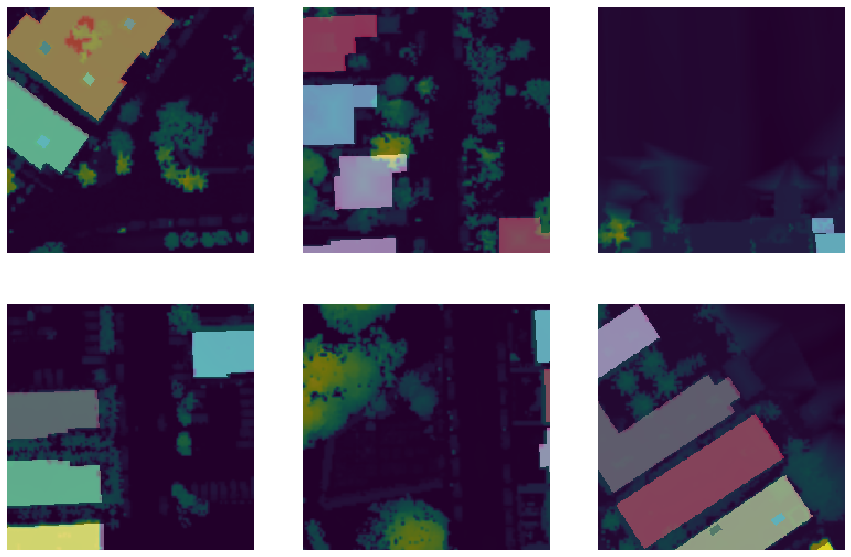

In [7]:
data.show_batch(rows=2)

### Load model architecture

Here we use Mask R-CNN [1], a well-recognized instance algorithm, to detect roof segments (Figure 3). A Mask R-CNN model architecture and a pretrained model has already been predefined in `arcgis.learn`, so we can just define it with a single line. Please refer to the guide on our [developers' site](https://developers.arcgis.com/python/guide/how-maskrcnn-works/) for more information.

The idea of Mask R-CNN is to detect objects in an image while simultaneously generating a high-quality segmentation mask for each instance. In other words, it is like a combination of UNet and SSD and does two jobs in one go. This is also why it is relatively computationally more intensive.

In [8]:
model = MaskRCNN(data)

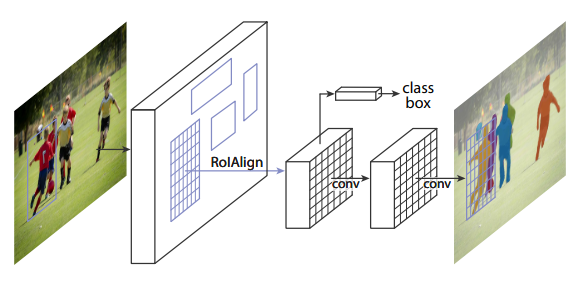
<center>Figure 4. Mask R-CNN framework for instance segmentation [1] </center>

### Find an optimal learning rate
[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. `arcgis.learn` leverages fast.ai’s learning rate finder to find an optimum learning rate for training models. We can use the `lr_find()` method to find the optimum learning rate at which we can train a robust model fast enough.

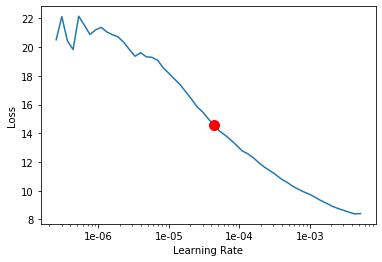

4.365158322401661e-05

In [7]:
# The users can visualize the learning rate of the model with comparative loss. 
model.lr_find()

### Fit the model

Let's train it for a few epochs with the learning rate we have found. For the sake of time, we can start with 10 epochs.

In [8]:
model.fit(epochs=10, lr=4.365158322401661e-05)

epoch,train_loss,valid_loss,time
0,2.769909,2.669544,06:09
1,2.142615,2.117454,06:38
2,1.951803,1.997903,07:03
3,1.843830,1.804779,07:50
4,1.687831,1.723288,08:12
5,1.534998,1.688702,07:52
6,1.503451,1.559698,07:48
7,1.417018,1.515242,07:40
8,1.335621,1.512897,07:36
9,1.238250,1.535544,07:26


Note that the validation loss actually goes higher, but this doesn't necessarily mean the result is getting bad. Because our training data is also missing many buildings, the loss sometimes tells the actual model performance, so let's look at the actual results instead.

### Save the model

We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default it will be saved to the 'models' sub-folder within our training data folder.

In [ ]:
model.save('10e')

### Visualize results in validation set
Now we have the model, let's look at how the model performs. There are 3 modes when visualizing the results.

- `bbox` - For visualizing only bounding boxes.
- `mask` - For visualizing only mask
- `bbox_mask` - For visualizing both mask and bounding boxes.

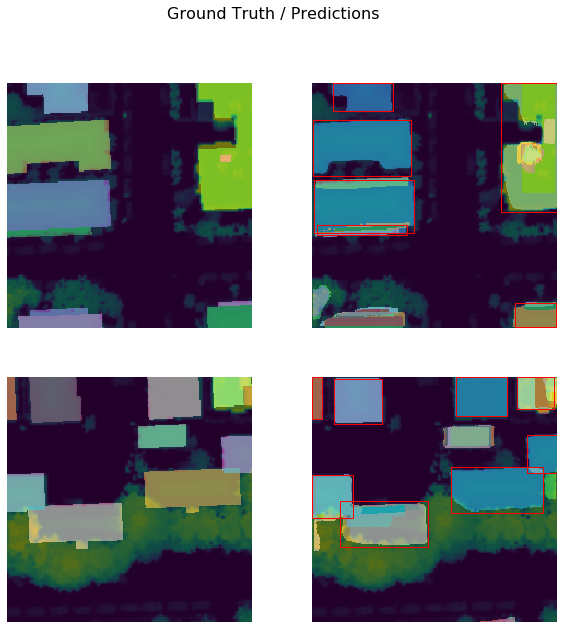

In [10]:
model.show_results(mode='bbox_mask', rows=2)

As we can see, with only 10 epochs, we are already seeing good results. We have trained it further till 220 epochs and were able to get promising results. Below are the results that we got from our model trained for 220 epochs.

### Load a saved model to visualize results 

To visualize results from a saved model, we can load it using `load()` function.

In [17]:
# model.load('220e')

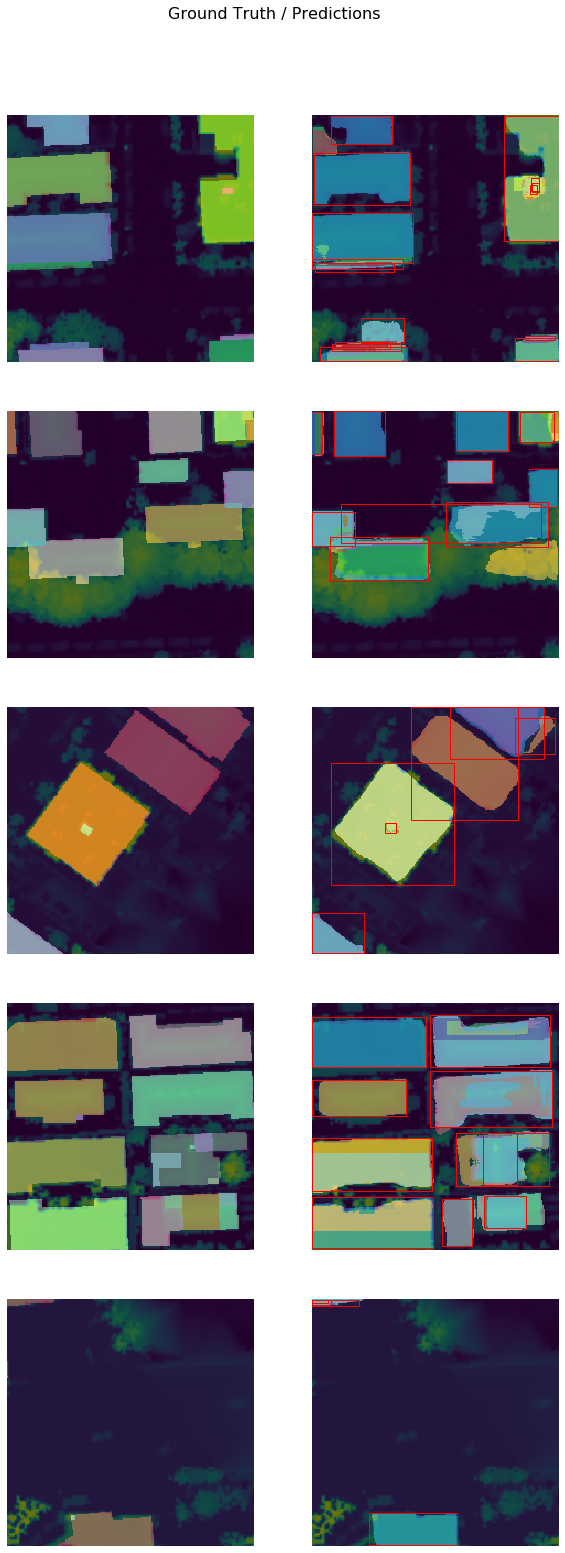

In [18]:
# model.show_results(mode='bbox_mask', rows=5, box_threshold=0.5)

## Part 3 - Deploy Model and Detect Roof Segments

We will use saved model to detect objects using '<b>Detect Objects Using Deep Learning</b>' tool available in both [ArcGIS Pro](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/detect-objects-using-deep-learning.htm) and [ArcGIS Enterprise](https://developers.arcgis.com/rest/services-reference/detect-objects-using-deep-learning.htm). For this sample, we will use the DSM image for our area of Interest. You will find this image in the ArcGIS project you have downloaded with the name - <b>DSM_AOI_Clip</b>.

 - `Input Raster`: DSM_AOI_Clip
 - `Output Detect Objects`: DSM_AOI_Clip_DetectObjects
 - `Model Definition`: path to the model emd file
 - `padding`: The 'Input Raster' is tiled and the deep learning model runs on each individual tile separately before producing the final 'detected objects feature class'. This may lead to unwanted artifacts along the edges of each tile as the model has little context to detect objects accurately. Padding as the name suggests allows us to supply some extra information along the tile edges, this helps the model to predict better.
 - `batch_size`: 4
 - `threshold`:0.4
 - `return_bboxes`: False
 - `Cell Size`: Should be close to at which we trained the model, we specified that at the Export Training Data step .


<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAtkAAAJHCAYAAABFIUqtAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P3nWxzJ1iWOvp/vx5nnmfu/3C/3zjO/mXded2yf9t3yHkkgIbwT3ntvhUAWIUBICEl4EEZ47703VVRR3rHu3lEUAoTanDZC6og+64jKiAyXmWuviNwR+S+QQQYZZJBBBhlkkEEGGX7VIEW2DDLIIIMMMsgggwwy/MphV2Svrq6io6MD7e3tEhISEhK/At68eYP+gQHMLyxgeXl5h21//3BY3SQkJCQkfjna2tqwsLiI8fFxaDQabG1t7TDvISKbjYKEhISExC8Hk29ff/8HF9mH1U1CQkJC4pejtbX1p4ns7u5u9PT0SEhISEj8CmBOHR4Z+eAiW6FUYlOlkpCQkJD4DaBSqzE6Ovp+kc0GYG5+HiazGUaTSUJCQkLiV8Lc3NwHFdk6vf7QeklISEhI/HJotNqfJrI5scFolJCQkJD4FcCc+qFFtlanO7RuEhISEp8qmHvNFgssVqsA//1baVwpsiUkJCT2wGqzCe7bFv8P2La3fxP+kyJbQkJC4vcF865ycxOTU1MYIfE7MTmJ6ZkZcezHeN5KtoBF+TvHyWYcdpwhRfZvDO432XcSEh8H2C2uvaMDj4qLBUpKSvDy1StBwBx32DkMfsaZZA+m4d/vI18+58iL7B3+2otD0/0BYbRYybjSNTcdHi8hIXH0wIK46fVr+Pj6Ij09Hd7e3rhw4QLq6uvFhMph5zCYy5ubm8Vamr2czrPgb9rbxW5R/Pfecxi/isg2mi2icnthsbzfIP2RsKVWQqHSQG+UxklC4qiDifR2QQHSMzJQXV0NZ2dnuLq6ihXihxGo45wl4sm4uDgxK8Ikzsf536HhYXFcoVC8I8CZU4+syKa6CUOiU2NDQRymVIp/lSot9FJU0rW0Yv5NGZLzijC2YYPFfHg6CQmJowXm5camJty9d490qgV379/HxYsX0dDQsMvdh4F1bU5ODry8vASvC51LHNnS2irsRMXz5+LYwfN+scg2bwNG5SxamhpoJNCI+nr+9w3GFhUwWP7IwtIEs1GH6ixveKVVYFUHOeMhIXHEwUL4zt27gjiZMP0DAuDr6ytE9PtENnMjryKPi42Fv78/JqenBXfyjAfPkqSkpgoxe5BDj6zINplhNWowOdSF4vw0JKRlIDUtE2kZaQj1i0PNtBJm8x970mCvyB6XIltC4qMBC+l6EtQPHj4UHMj/Xrp0SQjvHxLZzNdqEslpxOfM6yy0Xzc347qrKx4WFYlF5Ied98+LbCJim1mP0ZZnSErORfGLV6iuqUVNfR0eF2Qip7gBStP2H1pYGo0GzA23483gDLYMFvp9eDoJCYlfFyyWeZbhIN4nlB1wiGwmT077U0Q2g89bW19HfEICQkNDxavHmzdvIi0t7b2uJkdSZFOdrCY9hqtuIySxALW9izBTOpttG9uwYnGkHQMze30XTTBS27h9JhLeBzmO09nj7NgXL+LsLijvSyPiCEayNyJu157sP4fT7ObrwMF899iit3U+rE6OuD157j2+U5bRYqM+eWvjuI5cX0ddGe9w/oH8Rdqd/CQkJH46+FljTv65HM9CuqGx8R2RzS4kPySyGZw3v9XLy8sTQpttw6NHj3Z3aTrsnH9SZFPjzAZM1t1DYFwuOqe3YNlmuuH/AItJS4ZFBZ3h7Tlmm30hEaewHJgFMZqtO3Ec2NVkT7zJ7opiJlKy2hOIPMx76mMisrNZLTBb7aS3mz8RGJ/jyNtme7fz95Yt8j1wLoftbdsukTK4vMPyNAtDZA/WHXcZq/i1TWRr2MmT6/c2b5vN+g4RU/Zv86Gbxn7O/j6TkJB4PxaXluwLWqanMUXgf3mhy8zs7A/6ITPJ3rt/H21v3ojnL4CEsp+fnxDQP0beHL+6tobExEScPXsWGRkZgpDfdx5z6lET2VzXlZ5yePrHo2WKDYJtHz+ZiGN3+Zm42WIxYmN1AbNz81hcU4pjDjHLfGzQKDBP9mNufgHzKxvQm4mnd7hbr1VhTamC0aDDytKiSLO4ooSeuNxRpkalhFJjgEa5irmFZSi3dHb3RFHukrBNc/OLWFXriSvf9rOJ/aWNGiwtLtjLXlrBptZAdePBlxnKNS5vHgurCuipzszvnK/ZoMGyOMfeHt1OXkbtJhYW7HmtKLboHJO9/htKaPQ8uDBApdiASmeCWmG3mYvUXh3Zl10RzvnoVDt14vxV0Go2sb5J+Ul3QgmJnwwepDJHh4SEICgoCMH0b3BwMAICAsSbQ36+foh3n1dW4lZ+vhDA7B547tw5vHj58oDOfRccz2XX1NTAyckJbm5u6Ozq+kFx/s+JbFLM+oV2RPkF4lHXKvHwgcZQ2rfp2bfPgrE3L1BS+gSlFVUYWdaRCLXHm0htGlZG8LS8HGVPyvH4WRUGF9XYJiJkUWrcmEFD02vML6+jveEFHlMeZeUNmFLphPBmAlsd68Lr/lnMDLWg9MlL9M9uwESCF/p1tNVxueUoLStHVfcsdcZbUWvmspd3yi6jfCtrMbasofpSh22toaX6CR6XlKGioQvrGjMZB7uRUUx1ofwJtYXyrH4zDg3Vgw3PVE89HXuCkieVaB9dJnI2YWmoFXWd41AbLdArF9Da+Bpji6tor32C4pJy1LSNQGUiIt7pNzOJ85G2FyLvx+Uv0NU/gvbWBgwsaPYJfQkJicPBJMgzFdeuXcOZM2dw/vx5QaL8L89abBHZHUamTMoszKOio1FAxMtf7GIS5XyqiVQ534Pn7AUT7cDgoCB79uMODw/H2Pi4mF05LD3X4ciJbLMWVdlhiLrTCBXx4/s5h7lKhc7KcqSlJCA7JwdxCcl40jJL7SJetpqwMtaNx7kpiM3IR/6tHEQnJuPe4zZsMI+S4NzsLoVnQAQeV9Tizu185N3KQLBnJB69HoV22wqbSYfOR+kITruPJyX3kHnrMbqI241GFQZfFiEhNQOZufnIyU1GSOxd9I0tQ0t2w0Qcurk2g6aH2YhMzUVe7i2kpibhSfsatViDvtqXyEiKQ1ZuHhIS4lFUP042zQqdag2vi9IRkZyFXIpLzCzDvMGMrdUpPMuLR2RaHnKyc5F1rwaK7W1sdhbDIyQF/WQCt3XrKE3yR3D6Q5Q+uovcvHzEBIXhYdMoVMT9XKct5RIqsqMRmpgh4jPT85AR54fAvCps6KU7oYTETwVzJ3NXWVkZnC5fFvzOExvsL81f0j2M3xnM8bPEuUnJyUhITKTnP0HwdUREhPjNkzDvE+cM5vKmpiZhF+4/eIDMzEz4+PgI15H38fw/IbKJXLfNGKu/j4Dw25jRv511ELMH2zY7xGwECVPLBhoe3kZCxn209vahqSIfEUlFGF/Tw2YjYdr5EmnR8XhY34ne3h401DxEpE8q6idWYCKdbJ5qhJ/7NYRkFONVUzt6ettRlBaL4KgiTBlMpO9NGHueC2fPUNytrEd71xDmNqgxinE8TIxC+qMqvOnqR3d3NVJCYnDnaSeUJLStViOmOqjsKC67Cz3dnah5UYL6vk1Y9GMojE1BftkrKq8DxbeSkPKwjQjchqWBeiRHRuERndPZ0YHKF01QUH7DVXcRHZ+JV2/60NLUgrrWPhipn7qLIuGZ8gxrRtL8s+2I9LwCn9g8VLf0oqvtNdLD/FHYMAodDVzMFg3ay28jLCIZL95Qndtb8SAtnG6iKyjqpHo5ZpAkJCTeC+YqJsrmlhZBhiyu+XXg45IS8VrvfWKZSbK3r0+kKyXyDgwMFGKb/66srDz0HAe4PN4Oil8fpqWniy2h4uPjcZPy4Jn0w4j76IlsEqjGSWTeDMbdxinicUedDdRvOkqrh57rTWCun2i+i6DAXAyo2aEE2ByqQnhIFvqUdM7qIDJCApFfMwzdzms53UoXknxuopCEuNW2DXXvE1x1dkdi6RviVk5hxVJXOXw8olE9sUE/DegpTcFZzyi0TduNE7+xHHp1C4ER2ehZMYhjgAF95dnwCSvAuMqCbYOCxGwkIvNeYIV4l4NRs4rFDSMWekoR4peKznX7udrpZsSEpKJjbQvTbY/g4ZOCyR07uLm2Bq1NizfFKfCKfgTVTjsUKyTmqf1KEtmeoak7InsDZSmeuByUiaFVi0i30vUIvv6J6FwykSHbQm1hHMIzyjCnE9HQLvQjwfs8gm/VSJEtIfEzwfzJfM6z0rxw0d3dXfD3D80q8zksepdXVrC+sYGHDx8Kd48NhUIc47i3Wnc/mMOFD/b160Jg87FNtVq4BLLryODQ0KE8/0+JbCs0aC1OhW/KC+iFwTIRQeiwODmIluZWtL3pQN/EAnQkShe6nyGQSG1U73CA0KIiLQJZNaPQbs4gJ/Qm7rSQEaIY4UKxrUVLURJuplVCSdxkmWmGn5c3cl+NEpXyziVEtJoZ5EYGIqNyiI5YMfkyE+cD0jEkSJfSEDm/vhuL0OznWKU82N2DHTk2hl/A3z8B7fM6mJUTyAoJwJ3mnbLpwrBLhonPvRePsMwqqulOWOlFfFAsXq8p0VGaBq9IMtYigt1AyKDbVlEUHYi4h932o2K23ACrmYxESTz8MyuxziJ7rgux/u7IqZmERXSHBQMvMonAi7Fu2IZiuBah/pFoovqxiwwnUYw0INTLBY+6pMiWkPipYL5i0cxbK/FMdOGdO9AbDD86G81wpElMShIuJocR515wenYTcffwQGpqqlgcw88vu4rEx8WJraJ4YeRB8ubfR05kG4aR7B2M+69nYLNRP5gsMKunUZafLWZ9gwICcKtmmkh4FcVxQQjJqcTE1ASGxyYw2V2PKJ/rKOxYx2TTA/gE38KcwSreANrthhFtxckITH4GBZGbqqsE7kGJ6FmyickSTmOz6PAkLQiZFf3EjiZ0F8fCL/sVFETt7LtsMi6hMPwmcqtGiLftrizs5qFXDiPBPwjP+legWu5AlF8UGmdUxOv2a2k0sVvgBp5nRMAvqQzjU5NU53FM9rcgKeA6MuvnsdRfCT+XEFT0T0Ghsatz67YBg5V5dG2T0DyzLNbWCBead0T2OkoSApD0bAAGsnsm6jfdZhciPCPwanADJuUAYn2D8Xxgle4NnvHithrR/jACATlyJltC4p+Bg1NLS0vFYvUfEtgO8DnM2ayvnpSX48mTJ4Kv+dhBjt4LTpOfny+EucMHm88RiyFJaLPY5zQHz/tFIts7spSEsF1km01aTPe34UVFBfITA+AW+5iIQ4+uZxlwcQtDfuE9MnT3cO9OIaL9riH8QRvmxxtx05dIdnGLDKI9fzNVcr6LhXkyBnVWWKdfIygwBHVTFth2VnCzm0fr/RhE36oFmTNMPM9CYFYFVgRRmWE2z+FWaDAZg7Hd2Rh+halTzSHrpj+Ku+awOlOL8KBMDKyS4HaIVyJGq2EGd6IC4RWWhnv3qM537+NeXgY83a6jqFuNzcFXCHDzRdydcvTNKSl/MiJWI0aJiG94hiKrpB4LW0YSxJTXAZGtm+tE3M1gvBhXCVcXy7YRE60P4BlYiFWDHoNV+dSnRdgw8IwS1Yf9xdeGkBLuh4cdSimyJSR+BpizWFjz/qUseB3i+cfgOI9fH7L7yI+dx+l5cSP76fGMiEOU87+rq6viOBPxWw59e97REtk8WbKMwmB/pJf3gIb6QsSK47xQxLCIosQgJD0dpxMnkRfhj8A4MjoPinDv/kPco38fFD1G75IC3c+y4BlbDg0J9903nZTF6KtcBIQUYIYs3BaJbM+QZPStkJh1cDv1yYvUACQ8bKXyzegqSkH0g2Zsmtl1hfKiQUCibwiKWudJ6zoEtBl69SoKgrxxt3US88NPEBxegIkNGmjtrrEh+6GdxYOEIPhG5eDBnjrff/gILeObsGrX0FL1BEHuzvCPz8fLnmnKm/hdMYPnjwvhdc0FUbnFaBldEcb8XZF9Eyk0ONBSX7HI1m527ojsdehWm3DTMx6tk5uwsSsk21GTDh2PYqTIlpD4BWAeZa79qfzuAKdn1xK2Dz/1XC6HsZfL+W+e0HlfHv+EyGaytGG25TH8fJLRryGxuEMOLH55dnesNhd+8aVQ6LRoe5wE37hijEzMYHJqkozWFKZm5rCu1mJptBK+PmkYYj/oHQHJRLzU+wLB3nHo1pJQFSI7GLWT5rdEbLOiuSAK4VkvoRQiOxdht6qwZrQTsdk8iSw6p7BhCtv7iHgZ+UE+ePBmCjM9j+AXfgezm5z+LRFbNRNkPAKRUtKO2elpYWQnpqYxM7cABYtnow7Lc6MoiA+At38QUsvaoScxbDZqMdFTj8QQX3gFRaG0dYYEuOkQkR2E56ObuyJ7vOU+PIPuYM2gQXcFG6an0DoME+WL9WEpsiUkfgEsxFc/l4AZKySQmSAPizsI5kdmv4Pl8G8+vpc/HeBjR80nmycHhspTcCP6DqbUNMgXgpDiWKTq5vEoKRjJ5aOkipfxIDYEaZUTOzkx8zuCGcO1d+AdWoBFAy905LzJEMGEjpIU3Ex4gnVKrCaR7bEjsnlWl2fSreZ13I8OQEZFH6U3CpEddf/1jsjmmewF5IcGigkUqtGemewxJPvfxJO+RayMVcLHJwUDK/odQctpbNjeXsPTtAjEPOrfqefbOvMaIc6HfyuWJtBQmgt3nyh0LBrE/bNts2BpegQVt6LgGXELUxqeif85IrsZN92j0Tyl2ulTnsk2oP1hlBTZEhIfCCyO3+dL/WvhnxLZQowqZ5Ab7YPksl7obUyAHGcmUjNiqCoHfnGPSVhaMdn8EL5Bt7FEJGmjxpiF3za7fdigXupFQkAwno+sw8qLJ0kI20iYDlTdgl90EZYN27CQyPYn8nzaryImpjrwaz/tHPJjApH+bJCI1iJ8skPzXu2IbBrVmNWozAhD3MNWaIg1xYJFKlez9AbhfpGon9jE5mwzgr1C0TipgnWH9Hjv023QuZmRiLnXRjlDGB0z1ZvrK0iefosLw33T+hBe/jHoXKGRAQl/XuDJ6TofRMInqRgr+m0MlP00kb2qN2K07i68g7Mxs8WGicqiPDXTbxDl6yZ9siUkfmewQD5MHP9aOIoim7e2028u4WFCIOLvvsCMyu5fLMSoaQkPEgIQVzpE8hYYfpkN35t5GFSRQuSwrcfCwgo0BuKthR4kBwbiQesMSWV7MK0PID0kBIWN02I3KnVvGS5e90Zh7ajIj6QulpqL4OoXR2KUjJFVj859ItsoJkR6n2UiKLYQI0p73VjUj1Tdhl9EAcYUxJ1b8yiI8EQ8nedIYlStYGHThJmmu/D1TkXXunZHYBuxtLQMlUYLxaYCGt3OCcsdCPP2xfMJFTY2Nqlf7Kl1/WXw8CPO3+CZ+J8msl8OrMFm2MCjeB9E36qH0p4VNufaEOV6TvpkS0h8wvjnRDaBXx9uTHYjO8oPKaWtWFNuQa3egnZLidaiGNyIK8GaluhPMYyc0EAkFNZiQaeFTr2O3u4OjMypYDNr0fYkByFROehaVFNlNFidbUXSzWiUvJkWCx+FT7bHNfikFGNieQs6zTpaSzLhEZyLIWImm9WEkWdZCMx+sSOy2ThasDJSh5iAEDx+M0UEqqO85/A0Ix6xt2uxYbTBalKiujAOASFU9hKVvaXCdG8T3kzroByuQMCNMDxuG8UmGSHN+jRqm/uh0avQ39eH2dk1+luP8do7CAy/hXH9Btpb+7GhUGFLs4XGwmhE5ldhk/qotzgG3mkVdpE924FoX388G3krssde38EN/3wsqq0wbk2gIIyMW2EDlvQ6qDeWUJYZCCcnF5T0qKTIlpD4hHAURbaoF/GWZm0GNc/zkBh3a9et4mF+Jrz9I/F8YMX+elYzh/JbyQgJSUZB0SPcyy/EnZcdxJkm4UI3S3yaEx+F1AI698FdZGRm4E5pB5TC/cQKVU8Z3HyCkHa7CPfv3ceDwmzcDE/Gi9ZJ6G0WsbtIx4NEhN9t2hXZwu1Pu4bGB1mITslG4f1HuHsvG/HJD9Axtgqj1UxlG7A6PYCCqGDEZN/B/fsPkJ+ehVdjGsCwjFcPMhEcEI/bVOf7t++g4FkLlMS3/S3lyE7Mw/2HD5GZnk11JZG+rUR96T3kZRbQ8SKkJmXgSUM/VCTRNzuKcCMoCX07Irs41g+JT/v2iOwOhN4IxXOeqocFG0v9yA+NROKtQurPh7hz9z5yorwRmFstRbaExCeKf1pkM1hoG/VLaCy7j5TEVKSkZoiFP7GJuajqmxOExxvuazZHcT8hGQmp6UhKTMe9inasE1mKmWEilvGmEiQk0/kpaUjKzEP94BoRpVlsFWiebiISD0VxdTse5CYjKSkZ0bmlQnDzfqc8szHT8hT5T99AQeLZQVS81Z5yshOFOalITElHckoSGQASygaenbIbOE7bXVmAhCQqm8rPyH2MYYUZ2yR+p/trkBGdiOQ0qnPCLbzqn4PFRkRcV4a0uGRqaxoSc8owvq4lsbyGmnv51LZUJFE+2UUNWNMbhU/2aN0DZJcRiVPddMvDuJ+Th+YZtZglM9uMmOt/hbS8SqxuGUSbtao5lGVTX1FfJGcVoqX5NVLCffCgXbqLSEh8SjiqIlvUzcxv7wxYnBzH8Mio2DlleHQME3Nr0O3YAnavMBo2MTM+JtIMDU9hVa2l4/Z4drNQr81jhOL465djM8v2XZSYf0lkb3aVwCssHT3Eh7MTIyKPiUUF8SDly/nz3tPry1hY29y3jzTXzWLUYG7aXrfhkTEsKHXgnUccadh1Ube5jPFRe75jUwtQG+wuIWaTGnPj9nOHhiewrNSIOm8pVzDB7aS6jkwsYIuEsoU4XLm6gNGdNozOrMJg5b2vTWLCaHZhGWoaVBgNeqwvzWNpZw9tfjOq16uxMLeIDd7bm+0NnadRvq3T4roaPY/jcDOvemdh5/5rICEh8fHjF4lsBs8ssDuFRbhL2MGLQvZ+dpfTMOHyh1VEGsvbxTDCTYNdSBxxhN1zd0S28MmesgDbO/kTmOR286fzWXC/zXPnOBGqI0/e+1qUu4/I7MTHe2c70u2KdDpX7DjCxyneUSfhLrKT/m09eObmbR7sNuIox962HfLf6Qe7j6IdXEd2lbHXnerDdd7pK97VyrrSh4SgcLycVMsP0khIfEI4yiLbDuZm4iN2mdvFfp618789DfPeXl4W8YKD6TzGHv51iGzHwkd2t3Ok2X++fSJl7zEBKofr4yj3sDRCUO/W28GxO+fSOQfr7GiLI9/dunIddo7vaz+n3/Ob+2rfVyLZLvAxyocHCewqKerK+dMgYNuyivtRESisHwN7rO/tVwkJiU8Dv1hk/6bYI7JrJky7Cx8/TZhg1Gmg2NIJn3W7254BPRXsn/4Iq/xVsT3iXEJC4uPG0RfZvx2EyO4shltgAnqWtz9tbqfrbNWr0P2mGX0zCruYNq2h4UEGAkPvYFSllxMoEhKfKI6+yJ6qh6+PH16Nf+Ii22SFVTmI7OwCVL6qRV19Ayqe3UZkYA7aptdgsr59FSohIfHx4w8tss0WqIaqEJ95FyNr/I2Cw9N9GjCBXQ2HWsqRHBmPxORUJCby+qBXWN3U0YBDCmwJiU8VR1tkm8wwbi6hq6sb80rjrivHpwkTka0GM30dqKmpQ21tHarqWzGxpn27jZaEhMQngz+yyBZg97k9bhmfOoTbiYXXKTHsbiMH3WskJCQ+LRxtkc0gIhY+3n8IIjbBTG3lrwYxtgnyNaKExKeJP7zIlpCQkPjEcfRFtoSEhMQnCCmyJSQkJD5tSJEtISEh8QEgRbaEhITEpw0psiUkJCQ+AKTIlpCQkPi0IUW2hISExAeAFNkSEhISnzakyJaQkJD4AJAiW0JCQuLThhTZEhISEh8AUmRLSEhIfNqQIltCQkLiA+AoiOwtIv7D6iYhISEh8cvBHPuDIntlZQUzs7OHniwhISEh8c+DuZU59kMFFZH+YfWSkJCQkPjlYI6dnJx8v8heW1vD/OLioSdLSEhISPzzYG5ljv1QQYpsCQkJid8OzLHT09NSZEtISEj83pAiW0JCQuLThRTZEhISEh8IUmRLSEhIfFzg9TQms3kXh6Vx4DcV2VwRI1VALpqUkJD41ME8Z7FaYbZYdsmX/2a8jwM/RpHNnP5j7ZKQkJD41MB8Z9vehpH+Xt/YwPLKCjZVKlhtNsGHh53zq4tsRyW4QF5VqVKrodPrd48ddo6EhITExwwH342Nj6O6pgbl5eV4+vQpXr9+LRY3Mi8eNuPxsYjsvfXnHVEGBgcFFpeWoDcYpOCWkJD4ZMHcxhyn3NxEZWUlUlNTkZCQgMTERMTFxyM3Lw8dnZ0i7UGd+6uKbCZh3hPwdXMz7ty5g8zMTIGsrCxhdCanpiQZS0hIfFLg2Wsm0ZzcXCQlJeHhw4d4VlGBp8+eoaCgAPFExkWPHkGhUIi0e8/9GEQ215l5vaa2VhiW6OhoYWRSCFFRUUikNje3tOyK7cPykJCQkPhYwdq2r68P8SSomdP7+/uxsrqKtfV1LBKHNzY1Ce6/ffs2VonP906o/Goi22FoMjIyBBoaGzE8MoLRsTH0UuVKSkoQExsrRgE8s33YrI6EhITExwTmMSbYyMhI1NbViZkOfmvnCMyLTMYssuPi4sRM916hfdRFtpnaNzs3h+ysLGRnZ2NgYECIaW6DQ3z39PYiLS0N+WRg+PWp5PajAtOPTGj9WPzRBdfbaDo8TuK3wR+1z3nioL6+HjExMXjT0SF4jzmO+0OlUkG3w4dq4tKS0lIxEcFvLx08/6uIbK5EOxXOsxpsaPgYF8Cmhg0O/20m8KvFLCJqnlpXKJVy1uNDw2SBja6R+X1EazKLeKvlYyNiE6x871mlsf+9YOYbZdsqfNUOi/8UwbzW2dmJ2NhYTBGJ8m8mX+a1waEhVL54Ib6oyL8ZbW/eCDHOotshRI+yyOY6M2fzTDy3hQU1+x6a6DhPlOgJbGj4mDAwJSViNod9FD82oW00WwXXsb0S4L+tP88+mSw88Pjl7TaaLbDYLD/6LBmpPBsZWa4v/2ex7C9br9NArdFBv+fYvni9lq6/hkTC4fE/FSarjcr+mTaCbI91m+6lg6KNbA4fN/+gmDOQYNnClk5/SNwvB/erQ7vY+5Zs4AezJSbiVupf84e2wQZoqc/V2t+mz48qmAMnJicRERGB6ZkZwXV8nPmNeTwoOFh4bnA6BxcyV7L3BrsPcrpfLLI58wWKZ+MxRIaFDQ0XxnFd3d0YGxvb/c0F8ixIQWGhmNnh3464jwFcVyY+NjB2GOiBJEIkcvup4sK+EPTwuJ+DH82HyMpCRsJID4ejvno6ZuZjfB4ZFf3qKB7l3Uf32hZdiwPXgYjeqpjAg7xkvBpSwfwLHnIjlWv62dfZ7gP6br/uHH9f25m8t5bx/F4Kit8sUNpffyDHfc+ks3sfkJEy8UDyQxAh9es71+53hQkWkx6DVbeRUdaCTQM//4el+7TAXLChUIjXh8xzDvLl43x/8kTCJScnQcQOjmNuLH/6FPn5+btpj7LIZq6+deuWqLNjAMHo6+8XbWDfbP7NadkOMO4/eIAHBEebPwZwXbdWJtH8uhF1dbWora1FTU0tWkaWhMD6YcFnh9FsxMbiOEYmlqEz/vOCjOuiVs5hZGgaKv37eI6eOaqXfn0cDbU1or7VtU0YWdyi+toHuix8Bx9H41rgfSzSkMF8IA+TxYa1uhR8ccEbbxZJUFr2x/9UmMx6LE0MYmJBJbjosDQHwfZAq1hAb3cfltRkQx1tpPP16mVxfEGhO9xmEJ9jax5ZPt/C43YXDNSOd9L8ArDo35gfQVNTg+hX0bc1deicVlCPb787KPhNQVxiIIE23IPxJbW4Nw5P9xuDbCr0a7gbfAxXMhqhMdkX/h2a9hMCcxtPHqSmpaHp9WvBgY445jrWu8eOHUP5kye7PMj/siZgkV1VVSXS/SKRzRedZ2rYF/Hlq1c0+raJY/xw8G9fPz8MDg7uVoDBha6TcWJn8d7e3n1xRxlWIqG+0jgcO3sZnt4+8Pb2hrvHNXglPMLsyqZ4+H/4xiPxZ11BSZwf7jSuvDPr8NNBI33bGp4k+KOgbuk9+ZDAtugw1V6LhGA33PD0ho+3G664RaF+eAZa8zaNjrehm26C+3FnlM/wW4UD+fBofqUXkT6XUdim+PkzFQI0stvWo+tpMuJz66Hih/OnGCzrNjSTjQh0dUfFuPrtKJ4HBotN8HP1RsWAEtuHzS5Qmm3VDHLDriD++SS1a78P7C8CXeNt7RKKEjxxyum6uAe8vT3h4uGB5Pv1WN2i+/t3FLw8YJptyYd/eD6m1dvUT4en+21hgs2sQ+udm7iR8hQb+t/bEH0YsKh+QuTK/td7yVcYQhKnTLJXr14V7hMO48j/qtVqpKSk7Arzoyqymafb2tqE7zUbGuZpbufU5CT8iNfv3r0rZrYdbWPw3/yGkgce7L+4t1+OMpgjZipi8NfvriL19j0UFtzBnTvJuHbFDekF5ZhVY9+ztXd3Ffu9bqKe1ON1gQ88YiuhtpIw3+UBHnTZ07LrzUEbsS8vOse6bcVkQyquuadhWsOz6Qf5hJ43ixYDDaUIv+6FqFv5uFNYiKy0WLg5u6GobUoIT579HCgKg5NvIRaodtbd+jruRRIQM1148qoBCyqK23lm+fhuffZcW0fZu23hiSUWX7ZV3As8j6iScTED7eB3vl/eptubB8VR/yi7i3Hmm7N4NqV727fM79MVdPwMHnWRqBX8fqBMzlenRHfjM9T1L5EApDRUTy6P7z9H2ncnHihO5MFx9nwOm5zgwUb7bW98dtYL2YX3UED3wu2COFy96I5bZfVY05Ht3NMefusg6ibK35/X+/pSlE2/98fvP1eAOmrbMIsMj+OIKrOvZ3s3zZ7+4TrsiduX/8G4nTqIc+nvvcdEH+/LzwSzQY2B5gpU9cxCT9fdfl24zT+jz6k+H3ZC6OeB+ZkXM6anp7/DddwmFtmnTp0SC9y5fY445r3R8XHxhpP1sYrE9T8tsrkS7G/NRsMxNW6hwtmAeHt5Cf9rx4VwgM/jSrxpbxd+fHsrd5RhsxjQluePK3FPoCCS4HaaLSsojw/E+UuuqBpT0e+dm5VuJtKJu6+cBOGSwIRpFmnup5Bez6Ni+ukgJKvN/tqP0x94TcgPschLvLbibWLoh3kemV6nkVq9upPP3huXHohtLXpKE3HsG0+Ud83AQOdatw0YqXuIa6e+RnbNFIx0nn6mGb7n3PB8TiXqyrDteVXHDxMH2x6BvVufnbT7yIHabaGGOP7jPgIMqM9xh0dKDf3lcD0x2dOJNr37mtNI/bs18goux0+jeEi1X2TPVcHp+PldErbXh3PhPrLXXU+DDPHbIcIpjWjXzutVjrOKWf63ZfKrXuHxQP9Z6f7kPN9xk6F8oJlHlu9VRD8fgYXSsNBVbwwi0+0sLvmnY1xl3e0TfsvhKM9Gz8revmIic/Qj98OuUaY+F3X9oX7eAZc9VZuMy+5JmFDtFwICdF84+pnvw70DJe43rtvbV81v48T9aLPunMt1YbK0HzPv3KvinD2EuXOn2PtU3P/260/J7W2gc/e1n9sp2sZ1s4kBOt/7jvgjDepXnuVlMcmvEplw7cbGbpy4D9h/mUU2L4J5a2TsrxNfvXqF4uJiceyoimzm6PSMDLx580ZcG64rL/LhRY7JycnCF5GD/frZwWn4PF4gWUjC7+MR2RZMP4vH+YB8vP3AvQ2K6X5EX/0cfreaoDbzM0jPE7VTo5gXn0menJmDUm+h58AA9fI4HsU5wznsPganlrCi3LJzE9mNlYUpjE9MYmZ5Q3CIXYzZn02NclnkNTE5jaV1FdT0u/FeEM67xqJ1ZAHL65vEw2+fM3a7XOovxsUvnVBQMwLzTm25vsOvsnHxxHmU8gQEHRkoCseVmw+xZFZjfmoCE1PTWFUbdvmW3UlUau2uO4mJCMeoXcf0lL0+yyo91X+HQ+l55basLs6Ie35yegEKjRaK2Q4kkk0LzH+NqdlFbGzROfQcK1bmMEFtnpxZoGM6Ot9ehr0cQNFbiksnnVA5fUBkz7yg45dQ0kP8TvkwL60vzdrzovyVwl3BgC31Frb0Bnu+WjVWqZ+0ui0szExgfHIGq1T33YkjITZ1WJ6dFnWfW16ndm9iTaHerZMDQmTnB8Al6RneyiEblvvq4XfuS0Q/6SdeZ57jAZENm6tUN+6PuUVsGUkT7LST3ef06hUxKJ2YmsGahp4pwbEGqDbWqO9MdO0Xd++jTT3x7Tv8zSJ7Djm+ZxH3dFrcp3vjjRRvseixPG+/v2ZXFMLm2DnYspu/aPOSQkyccZzRoINifY36UofVeYqfWaK+1GFzYx2bOhOUK/ZrPLOwBj211STKM0BDXCFcdLiNOu5zJbR6LRZnuc+n6Z7XClFtrx9zgR6rczt5La7SYF2FtQ3Ve92XjhqYvx4/fizcP/hv7n/+l8HPF3tpsMh+9uyZ4D9HHIO5kN3sxklss0D/p0U2Zya2qqJCHBmz60hYWJgQ0BsbG0LJcyECVAhPpbOx4a39WOkvLS0JwXFY/kcJLLLf5N+Ec/wTbBCzCcHAbAEtnsa74GxwMTREEiYSPlsrU7gT7wlvbx/4hifg9eQWTFvTuB/lhu+/+BtOOrnDJzwXPYu8v6IZI7V3EBTgBV8fT8Q8aKSHlfKhMk1EwpvjLUiJ9IW3ry98PJNQO9KHR5T3sS/+jhOX3OATlo3O+bcz0UYS4dq5JniePo3brfy68+3rNBY1Q6/icex8GIaUNKqcb4HfeQ+UdPfgQaofvGhgFBSbib4VEpl0PW3rw8hNTEHdlFoILTMJpeXBJiSHuYsZ3Jsp9zCxTvcBizBKb1DM4XFGEDx8qL7uYShq6EDtw0Q4nfgcXx6/BI+AGDx5M0tEpMSr25HwpDZ5+oTgfu0wDHsGF0Jkj1bh+qmzeDx8UGRX48qpiyjuJhJmgzffh7yEm/Dy8YHHzRQ0Typg0y2iODMZZT1LYkZHM1KN2JT7aGx8jrgQD3i6++FWZRe2BFlS/clUTXY8QdgNT3h5+yPlfhHuZqTgYdP0DjHa6+UQ2Tn+Loh5PmxvMx3nsYjVQCNXpxMIftQnxCL31VJfLRJCPURfBaYXYUZJhnWnr1QLo8iP5fLoHolMRdv0lhDDmtl2pMfdQvNwJ/LjfODl6YnQlEKMKd71yxMiuy4VVz1T3hHZ4pnSqvA8J9B+7wQEorRjmQwl1Y3Om+t+gZhgT/j6+8PbMwTPB5YFQbLrR19FPtIfv0D5rTh4BSahZXwF43SPJt2vRcPTLNz096ZzQvFyaE2cYzXp0P0kB2ll7VCzCN8YRl5KOp41t6MgwQeeHj6IySrFnJaIip4bbr96vRspXt7w8fVDeEIWkdltpN9tEIbqp7zt+JBgnmPeYv7iWV7mM57BZf/lpeVlAV78ffnyZfQPDIjfCxTn8MXmN3i38vLExAQfP2oim+8d3gOWdxFhlxgHPz8sKoKzs7MwPF1dXWhvbxfgCZOOjg4xoGA7wP7pPAOupD7h9h7M/6jBIbLP+uZgRk/Pkbj/TIIv5zvu4+R3HnizuEWG1IDpribE+rjgZkQEgnyuwC+jEisaNZqLknHtzFf4+pQzAsKT8ezNNN3nG6i7m4Obfm4ICw2Cm4cXCmrHqU+YH0yY765BrPdluAVHIMQvBCkFz/C68RECrx7DF9+chU9wNApf9EJLz6udG4mDzSo8DL0A75wasjx7XVksxPVki6KccSGkRMQNFUfizNVo3C/NQkxkCII8LsM5OBm9yzz4tWG1LgOnXBMwrCYrYTVhY2EI+WG+8A0JRkSgK5wDM9C3qN0R5Sq03kvADQ8PBEeEI+B6BMp6u/A0KwTnvv0HTl7xQUhsHt5MKzHV/BhhAcR5YeHw8Awifh8CSdJdfv9pIltJ2taMgef5CAzwRnBYKJUdhvKuecCwgEyfq4ipIA7mPhh5hjOnLiEuLx/JcSEI8PLADd9oumYk+qivySKjtTQFV09eQ2h4BCKoL7ycz+F64kvoqEzHfcBwiOyrcaVYc9h56ncW2kPPk/DdmQhMqFlgazBUX4kwb2cEU55+Xs6IuPMaKh1dW9IKyxM9SLvpBj/SQmH+znCNvIuJDcrfrMOz6OtwDsnE3XtJiKC+9Hc+Ca/0cixs7Z8l/0GRzQMv0xqqb6cjwM+D7q+bcPX0wf1GnvEmntWv4UFaCEJDQxFOfedywQn3mifpXqK7mrRIhs91eCUmIiE8lOzLYyxvLOBhuDMuBqYiNyMGYeHhuH7uAnKrh6ASI4YV3A12IfvWBXpEYJuqxuUzFxCVk49U6vNAH29cdw9G4zSvx6D7a5tswoscOB93RkhEJCLDg+F74xKuRJRCZTj6HM+cLlybCwrQ0toqRDQLZhbcPHn84uVL8Rbz7Fm6NnFxu8efP38u+JDPzbt1S/Aja+B/SmQ7KsGvDdnxm5U9C2heYX7u3Dm4urrCh4SP/ZW6HR70gDqm1vlcNkQ85X5whHYUcajIpuNmavhi2z2c++46WhR0c2924ubpK0h52i4WAPU+T8Wl67HoX9NDv96PeNdTSHg2DuWmmgSxAR0lcTjvFIvOxQ2oVweR5nsF4fe7iTy2sTL4HO4nTiGdiHad8ppt7yIBvAbdxiCS3E4j/skI5aOChkf0op788BvRXRKD0365UBr2z4DybKRuuR8BJ4/hdtcKjEsd8D37Nc75h6N1UgWVcgXlSZdxLuA25vX0YC2/ged5JzwY2CThCKwOl+DK9+4o7ZqEWr2Myiw/XA19hHXqD6NyCHFXTyIg6xmmlSqsjI6hZ3iUSGcdFamucIsjEtnQQGtUozzmGrwTyjGvVmF6tBevWwah/Zki+3EP1Uk7jfgrZ5Fa0QOlWoGelhb0T5Ng2ZpA7PWLSK4jkUz3pbbrHv70H/8Gz7SnmFeqsdj3Eu4nv0Fu86Jo18poGZy/dcHd5hEa/K2jtSgWf/u3f0NI2ej+xZPvEdkMLqf9tg/OumVinuq/2l8Ep2OeeNY7TX21iKdp3nCJLIWS4vTrLfA5cQVZL7uhUm2i80kiLt1IxtiWFdrRl3D6+jNcDk9C16waqvU53I84Ayc6d/2Av/N7RTbPcBimkeV5Df6Zz7FMA9r5rhJcc/LCy2EltWkTjQ21dH3msUlxA8+Tcfr0ddTNGog99WjJ88e//oPukbphbNB9yrMYPfd88f/9j8+R9WKQ+lqNvvJ4nD7rjqZFMkBWLWpS3XE1qRKbTATL7XA/9Rd85RqDbmrD5sok0m58Ba/cemioowyqPhqQXETo7TqsqdR0Xz/Gpb/9K74jAuYB5lEnYOarmZkZsUcqE+gqiWcv4jcm3PPnzwtcvHhRwPGbcfbMGdTU1AjOy83NFRMNLMyPmsjm9vGOIrxKnuvIv3mXKJ6Zv3DhgmgXc7wD3O5Lly6JhZ1sjObm58Us+MpHstMIt+9dkU08ZNmGbr4TAaePIa9zDeaNXoRedEbu6xl75xlmkXzjMlJejNKPbTTne8EztVa8JeQw05iFC+ej0K0ikqGw0fkAly+GoENBfbLQBv/zJ5D0rE+IFhr9YmNlWbztm6lNgot/LpaYVIhZdutKo3nDSgvcSPw8aF8VInQ3jsDidbwiFqcuhGKQMp14EoY/fXECt+rHhX2GeQW3/E7ANcUu0NfqMnH6RiJG2O4b11EUfgM+6dX2+sCMqhR33Ih7ATX9Gq5MxLkLPqhjHxYKlk0FVrZ09NcG7gZdQFzFnP24cRxhp08gt2FJ/Nar1rG4vA79ngmCnyKyS/vovtvsgs/xsyjutb812dpYITFItdHMIcvXGbHMwXTcMvoM3331dwTdbRH9B8sKcjy/x42sRvAL5IXOO7j07Q28mNnkWJjmqe9P/xVnk6uoXj9FZFOd6RJuDlXC+dg5PJkxkh2qhdtJV5QO299KY6MHQZev4V7nMqz6eWR6uiCiqMPe7yTyi0KuIjCf62fGq4QL+NMpV1SPcs/SpVf2IuDct0h8Nkb1fWsHf0hk89vGieoUXHSKx6D9kmClpQCXnCLQu0n3tGYJvWPL9ggKI+VBOHYlCoMKaoh2FhmU519cojBNwl4EwxoeRpzFny6GYmDNfmymOh7fn/XDmyXqZdMq7oVcQ0ixQ2TX4Nz3f4NXTi22xO29iXuBJ3El4QXZcrJ/g6Vw/uYqykbWRR/Y1noRdvHv+D7qCdQfmch28Br//f333+PUyZM4STh9+rTgQuY//s2z2uyjzbqXbQJv58eC+xeLbH4t2ELihjuSZ2b4dSIXyjMeLi4ucCZi5r8ZTk5OeFxSsiuyeQ9t/qABz34czP+o4X0imwWhauApLtNI+sWCBp13QuEaXgamBdK0FEmCz9kJmW2LRGSzSPU4g7TaFfEaXqfoQ+Tl63jUtUr9ZwN7gixXp+HUtWRMmQwoi7wMbxImfFML/yl6yExiVEkjUa+zSHm1KNwedutpMmPbsonnKddxjupwULDwqmnzxhjV5zjiqmdgWOyE95kvEF89S08BjcCpfPVUI9xOncOjASVd/C74XnbBo0Eig+0NFAVdQ/iDHvGKkutqodHs1dNuqKMR+uDjSJzxzcQKWRgWxTz7xSNaWDWozfaAJxHaFp1osy0i+8ZZhFA+4uEjlXtw5fZPE9kqmFVt8DzBs9p2kSLcLHikvjmORI+rSGuYEeJ3q/MejpGBaF6k/rFR5rYV3Al0gktqI8Wq8eDmRVxPfEUEyK+8qVaGSSTeOIPw0uGfLLL5VetYeRROOkdjRKtA0U1nxDweEOVzX5nGKuF02hPNag1acgPgFvtcvI4U98jGEMKcLqOgTwHdRA2caQCQ17ZuvyYcPfAMl09cxgsaCO11rTlcZLO7kAUTdblwcU3BFA20rNwnZjUehzrD/14LtFQfm43uOHbhoMrZdH0IJBF4u5ndj4xozXPFX90zsUjsya+L2W2m604ATgQWYJluRgtV2qLpgtfJM8iuZ+OqR12GD1zTXu6I7A74OJ1DdssKFcSv1ozoKonAt84Z9OyY0FsSjWMX47FI9zK7xdBoCTV0j5wPK4H6IxDZzF88K81bOrEIZTj2xC68w/68dxAQECCEJ/tm829e7M0TEvzqtLunRywo5Ld7/ObvqIlsbh/v/RobFyfaxr/ZVYRnxZjDeZE7C3B2l2HwTA7vKjI0PCxmSFmg85vMg/vFHlW8X2TbYFzqQfDF48hqnUHfswScvRyJxp4B9NA1HOjrRL7feVyhwaV+24z6HA+4J77AJmkSm3WWeO4cvNOek43rQ3ffAIaaHuPyt6dxf1SBwSexOO2XByU94GJRIvM79RVz4ciLOFz1ycQUEcSuAGUw/01X4hJxnnCnOMCbLF7nqlNx8mIAiB4x+jgEp1wTMUaK2kptYsE5X5WKExeD0Ut5KxrsInuU2rw5+RTO31/F/doualcPeqi+jWTvvnGKw7hegTyv84h6Okx3zM4CX6qrieqzbZhHfsB5RJeNC+410cAj5dop+GQ+xfii3W1le6+N2qnnj85kk7C2akYQduEkwu5WY2p1R5DyrMjWfpFtGn6K8xd90LRsI8rkHbG0VPcAHPO9T+J4k+yoM85FlBOXct2ZUXWozfLG9bhKaH+iyGabpBmrIZt0BqUTq2jI8cMFzyx0DgzQ89yLwe7XiL16Cjcfd2Gq6x4unvLCs9Y+9PX2oK+vHxUJrjjpcwvL1PgXMRfhnPhMTLhw/lbiyOZMN1wIvoNFsp+7s9nvFdnsujONNOczCMh5hUFxfw1iqOEhzn9zFg+HNilP0V3YmBtGd28vGiuSqY+C0LlEhermkO5zDN4PyD5RQh688Uz1vRBnBD7qoT6j60hlaVbqcJnuifK+DarU+n6RPVmFKxdu4NWsSdgHelLQXkQc75pDonsLr1I9cNzvAfSUF9sktgGt94JwNfQxNj8Ckc1gXcobdPD6QhbZzGe86Ju3LOV/q6qrcebMGcHx7DbNxxmOj48xR46OjkLzz4psBpMC+xa+evlSVMIx48ELY9hZnFef82tVJmwGGxR+rcrnsrqPJ3LmCu0doR1V/JDI3uwvx+UzzmigttwNuogvjl+h0Yy3mN3y8aKH5/RV3G2nUaVhxi6ya5ZFfymGHuPkXz/HZTcf+O6kd796CdcC8zClnUHilUvIb2ahsodM+cHTTdlF9suFfaJLiGyrCi/T3XAmpORQkW1aH0PM5WNIrJslkd0O33M3UDG7SdeA8iHCgXIMcTeckPZ66a3IHqahsqoHAae+wgkn9526+sDb3YUe3AC0bijwLNYVfnltJNz2Xkt6uCxbQkB5Jr+CmhiRheFsXR7OnKKRn0sYaofnoNLRvbS3nlQN9cgrIrRzKBl5V2RfPW0nYVjVqM6jEfqJk3AOzsfgihI6ZvCDIrvjHs45R6KPFCDnZSESrkr3xuWkKhrVDyPs8ikkvJjZ8eEmAsMK7vpeQVTJ0E8X2URqo08icNo1GRPLPfA//iVOXvF421duzjh/JQSdCzPI8zmLr046715zH88bOE/3T3H/JnTjVXA9443GDR2RLbWbVfhqNwKvOKGwe+PHRba4B6jPc33w+eenxSJdUYa3Jy6fvYj4kg7oKE/V+iKaH6fBw9MT3l7O+Pbrk7j7hsWeAa9zfIRPopKaK4wAGZ7OwiA4x5ZhXRwzU93maCByAckvx8U5+0V2O/wuX9sZIJlpkGHFREMeGfQErG8p8DTBBU5xL8X15HvERrTd9jAM14iAVQfu2aMK5j72Te7fmSRwcBiTK8fdys8X7iI8q+sQmhzH3cO7dZSVlYnzjqLI5noyP7PI5m2rHG1iw8Lczi6CvCiKBQ+3wQFOx/3AH2rgt5Q6yoOPHcz/qIHrfKjIpoGzbo7uZacLKOufRWOBHz7/3hnxyWliHVJySjKSkzLxtGUUZhsNNB0im+zD9mYfwi5+h3PuEUhLTaW0nD4FaRn3MaRUoOGWP1xjKqAhvtqduSTwFoDvFdmU1rDWAJfvz+NuG9mTAzPZPP8y+jQKpy6GY9gAjDwKxxX/e293F6HnXtf9EGecQtC1+VZkj1GbV9/k49t/HMfNaKpjqr2uSUmpuFvWjDXDGGIvXqRB+MrbdS4MEmf7RbZFuBUu9lcjzv8K/vrlOcQ/rMTY8tZbDicwRSt6SkhMX8aLmf0iWzfzAlfPXkHFsA7bNgMm3jxHpOc5/PXbK0gtq8WcklSoltfF7BfZFy76kshm/3jmdxN6HkfjTPB9mHULQqQGP2RByc+oXYTXZfvC7WeIbDGTPViBqxdc0Tw3j5LYq/jqrBeSU9N2rm0y3RO5aBiax+CLRHxJbY+IT0Wq6Mtk6ss0FL/qhNpowNNIVwTeboKGJ3UobwvZ5bHSaJwPLMAcXbcfFdlUZ9tGJ/zPfIOL3tFI33N/pWfdw8Aa9fXqKJ7cz0VkWAjiU9IQE+yC45dC0L1Mna+bQbq3MxKqJugep/bvimwS0ewOQvcJT5Bp13vgd9UZT3rXDxXZVy+4o3rWsNPnVgy/SKWBYw402lU8CLsI77w3NBhzcLwBrfdDBcd/LCKb+Y3XpPC208yHzIF8DRgcx25xPHvNe2M7bMDeuKjoaDHxzBz7ixY+8lQ6L/Jx+FrzYqempibhHsKfFOY0jsIZDiLmWQ+eBeF8PgYiPlxk082zbUZvWSzOeedAYVzFvSAnuKTVUxvN0Bl4ezfD21G/dmKfyFaOleD0MVdUjarEw62n9HrKk2erLeYhRJy/gKz6+Z8usulcutTof5qI789FYZZu5r3ilWcalNP1uPrtBVSMq2BafEMi2xmlY7x7COVD5doUw4h2ccYtnh12iOwhEtnaPgSeO42kl1MknE1vt67jdmEDJRHX4JbeuH9mnepzUGTzw8U7mxjWxvEoJxonv/0CYfffQE91e+suQvGT9SQ2T+B+nxpWB0HzAztfA/eLV1E9ybMW7CfOmroRSWGe+OJ7EuXdqySEp94R2WevhqNHafdrtkCHmiwfXE2pJn04gXiXc8h7vS7yY5Fts8wh2/MiIkt+6kw2ETe183HMFXhmN8Ok64Xv6TNIr5nd31csmEmc5vqch1tuq5gl3nePULR65CWun76B6iXNjsjehnW5AwGXrqF4VPmTRLbNpkF9vi+OexdCoeP09jI4zmKzQj3fhtCrZ+CX9gJreirXNIyYi5dQ2Moz2Syy/XAtueIdkX0lpmTH8BDZGBeQ7HURKa8mxDnvimx+A7JJdbKL7MnGfJz1SMSadhOVqTfgm/VaGH1xj2xrScAE4MpHJLKZVPmbALxVH7+VYw5jOIjYIbLnFxZ2eY/jeDaEF8SMjI6KPJhbj5rIZjBvP3j4EE9IUPPfjvrztlTu7u7C+Dh8tfeC23r//n0xs88cdzD+KILr/K7Iphud2HSgPI4GzgmY0xnQVRKO765l71kQ5wg2es7VxHPu8EiiZ4BOtVmmkeR8BkHFPPt7MGhJZAfguNddbBHXiYVl3L9UD57JHq6MIZGdJXYX2Sey6VkxmzaQfeM4/PMawW4pu1vzsXLFJh4FX6bn9LmIG3wUgrPuqZjcaZNwnahOx1nnJEzQs71R/3YmWzn6GKe/90DLArd7f7CYRxF++hQSKvlZt3Pe25nsOdzyP4eYJ/YFwHYbRMGgwGB7NbxO/RU3C5qhJR5z2CJ2wzFN1eDy6RN40Edi2rrTBjpumHmJa+evoW52m/qQBTH1pXYN3Y1P4Pz93xDLs+n6JWT/iMjuLo7CmaB7xKkKPAq7isCCLrofdwSlVSXWUV2Jf/HTfLIpDXNc4y0/nLtJ14z4tSrNA6dDysSgeX8ggdWcje/PhGHi3RuFbJkWz6KccCO1EmSO7PxK9WrJ8sW16CdYJ9toX2hIeJ/IpjZYzeOIunQakc8md3LeG3Rovh2I895p6Ju1V0IzV45rF4PRuSuyryL+1fg7Ilv4XO+K7G74/ojIrtojsocqU3Dal54P6t+KpBvwTm8Ss+Jsd6gGZHM9cCG05KPwyWYw3/HHxZKSk4VvNfP13jh+K8ki+3FJieBHPu6wA7zFacXz5+Ka/SKRzQXxwhiuRHd3t6gEF8AfKSgqKoKfvz8mJiZEOsc5HM+ig6fY6+pZjO4VZUcXDpHtkvhM+KixDx7/p5x5jZtOTsitn6BfFnTcD8FJp0TMMTuQkREPthDPvP3bBFLcTiGtzm5UjeoJhJ7+HskvhgUxsVGyWnkWib8gpMIdvzNwJ9Lmy8KL4vhm5h0/WGSne5xGchX7XL0lL4aRVKdeNYD4qxcQXtZDD7A9X3alsJk1KItzxvWoEqwT4xpm2+Bz9m+IfzkvyIzDfPtdnD4VgK41ounVjh13Ed59RIdHQedxLca+6lrsWGEjucp13Tbhzb1gnLyciFkiSo4TYpuEJYvs6ix3uLP/G9WFFxLy7h+CiCl033LBt14ZmNHuMSjcRuM0Um6chBeRIwduAxPaYlMuLl2JwoDGKgwHr+AXRLetQp7H53C93YFtzRySforIJuFPMgMPb16Ce9pbX0r9FAn8U58h7MnYe0V2nBCXjnpZMNF4G5fO+6KRSG2beugeXTu3pFfC9/FtX+kppQkt+f44dS0DwmuR4+ge4QEWcQ+J7Co4n/gHclt2fP0ojNVk4Pj5KIypDHSt3w5IHSLbmch0lt0j6SpyfThMNxXg1Hfu6FCyl6L9+ptMdD49i5MNaThxMQrTXDkKpukqXDx5CoVtjpnsnyiyaSDys0S2ewJWyAj3lETjtEsqFugeFLXVLiHH52uciHjXxemognlM7KGamor6hgbR7w6C5T5m8c3+eo6ZbAfYdYQXDvLfnM9RFdlcP55l58WPvIp+L7eziOZFnwe/7shpeLab43jh5N64owyHyD4fcHvP7iJ6DLeWwvOSK4rbZwWPKkdf4drXp1DQMb+ThmTtxgLmlskiWHV4XeiPq1FlxC720HnPH8cuxBBXMQtx0IldObR0jy/3l+Lq15fwuIfnmSlQHdaWFqAjnpisS8cl90RMi4z2i0Ae2K+NVeDaueu4UzW6y9v8DLY9jMPlS8Fo29AR3wAjpUH42zcX8KSPRuAcTFNIcT4B74I34rxVh082cy9xZvLV7+GX30A52YNFv4qx6XUh/Gtz3HHRJQ3DxLscjMoNrKrVsJlWcT/kEgIfDorjJpMS88tvhURlxAmcj32CDVLDb+0UvwVZQaHPOVyKLydRtpPYokFdjhdcQoqxaCNO1G1gcXWHpIhJ73h/jeu3WmDTLf9EkX2HbI4FA8UR+PpiBPqY0Choxutw/fv/i3Mp1e/1yXZJqiBZuBO2NWh/kY/rV/xRPbpKzzqw1E425asrqJhS7iSyYWV5HqubRmjX+hFMdj36ae+undNvLWFyTim4tDL+BD67FI7uFfvVM2004ca3p5DdMIftgxNqOyI76eVb/2oOzJwttzxw4nISRnWOu0CLiell4uYNlMVcwYWo5zv3xxaqkpzxXxdD0PObi+wsGmRaMf48Gd+eCcCbVfvdZCSt4X3q33Asuvyj8Ml2gLlheHhYuMjx+hmecODjzG2TU1PCR9shsvkY2wFed8Pucg5Xu18kshlcCX49yFPjYnU5VYKFABugaiqMfa4dZMsV4UrwCkwx+/2RvE5ksMhuy/XGt27xqGnrRGvbG7S8vAtf9wDcquylh5mMEN1cpvUeRN64DK/oO2ju6EB740vkFT3HzBq//mIiDoZTYA5au4awodFi4EUaTp3wxMOqRvFWoPbpQ9yrHRXCTDHfgKATVxFztxStNJIqy7uPxqkFEi3s3xQKp4BMtHQOYmlz/x6OTMTq6Xr4uXgi4fZjtFA93nQ0IicmAH6BaRhU2rey0003w/37P+GkeyTKa9vR9roOUddOIaq4DRp+Okks2UX2JolNqs/oM1w7fRkJBc/QRnm2Vpchq7QZGgPvhjKObHcP+ERkoq69A68eP0V5fRuZlW3Mtd7D5etBqKzvxjQR0J3sB2hsbEFbWwvS/FyQ8KgFKvbn29PfvLBjvukOrrhcQ3Zxvdi9oLH8AQI8r+Be66qYkVVsvEFe8iPxqdOm6qcIvn4Dxb1ERtpJxLicR2KtfeHj1psCfH8+EF07O3SwyH6VegPn4yqIGqhdXY9x+uJVpNx/hTdvmlCY4o8vPvs7op4ctvBxDple53AtqVhcE95L+NXDZFxzi0b14BJdG6J4GuisDZbh6inK895z0VctVaXIetIKHQlL42o7gl0uwz/hgbg27fWVyCl6SdfRAs1YNVyOfQanm0l43tCOlroXCL5CA6rKAUF+e18ts8ierE3CidNeKKvvxBvqz+bmZnSOkyHQzuJutDsZ6xS6Hm/Q3lyPB0WP0TmlIk3bAj+nq8gorsab1jrcinHHn/78JW632kV2QzqdF/dkn8huv+WLc2FFWN0V2fOIu3YS8ZV2d5Hq5Bu4nPjcLrKX2uBx9iLu978V2RN12fjeORLzahusS90I87qE67EPxAzBq3tJNCD4K85HP/kofLIdYFHJsxnic7s8s0vPIPMhH2eXisDAQOEex8TM/tdlT56ICQnHdqecx1EV2QxuRwMNINgthidTuG1cb+b24ZER0TZuM4PTshFiUe6YcDksz6MI3o1h9nkc/vL1eYQnplJ7k5AUFYrgmEy86JiFkSdKSBhajJvoqsnDlWMuiKI+SYqLR0xSITrmVSREt6GiwbnfdRcERWXgVfc8zOop5Ef74pqLPxJTk5EYGYPE4iZs6kmSbG+ht/Ix/J2dEJqcgujwGKQUvgRLNqNiGEkB1+EVEIviuiFoiYPePvfsA6vHZHctonzcERYfj+SkJERGB8M3KAVtk/Ydf3iNyGBxGL4+5YJYKjspIYGeOR8ExOVgZJOvF+8uwiLbsbuIEQvDlfA574zASLuPfWxEEsp6FyjOQoJ3Do8iQ+AR4IsE6p+bPrF4NTJHXLqNhY77JO6vIyaVnufxesS5BYq1WXE02PIPiMPryVUY9r1xtU8GbU40Ij7Ug9pJbac6RvsHISgxncQnt9EK5UYjwq4GICklGTFRUQgMSUXnEg1odPNI93JC1DPetYT4aOgJzpz1QuMekd1VFI4TNGjaMtlg25zCnRRfXHC+iUS6bilpyfC/cRouCYftLmJCZ6Ef/nbCha5tKj2vSUiMCEJIYiGah1fFehfxRtCwhrrHibh86oa9f2NiEZtdglGy81arHhNdxbh+8irC4hJF38fQvVQ9TmKV4p7HOeO0uz/iE1Lo2iUi4Op1xN5/jiU9a6e3dbGL7Fnk+JzGKZdQwR2JCXTPpd9G64QSps0xZId5wdWV+pvvr4gYJJe20P1CA7GJl/A9dxWh8YlIjk5EVIwbjp8L3JnJnkaK+yXEvBjbJ7LvBF7BzYede0R2F7wuOaG0xy6yOT6wiOKpz22U/6Uz1/Fy5q3IHqxIxHGvNKzpqN5b8yjJCcLZy/6i3uwyE0h20yn849hdZC+Yy9gvm9eeDAyw25HdPW5zcxM5OTnimwCsa3nymHcYYXvAdsHBgb9YZDM4M54a59X27JPNv5mQHa4iDhJmvxZ+jchuIjzD46jExwD2k5rvrRG7AuTkZCM7JwtZOQ/QTyM1XkC26+pAN6hONY4ySpOVnYWM9ALU9s5CT0QlNodXz+BpYS7S88sxuqqhkaYRo68rkJuRKdLn3n6JeSJSzo/fUmlWRlB6JwMZmZnIvFOByQ020BaYt2bx7E4e0vLLMLxCI6YDJCb2PFUt4sXDTGRkUX2zMpFX0S78ccWezJSHfmMa1U+r0DfbhxIqOz0jGyVV/TSCp4eM0vECNl8nZzwcYLFE15CMzepkG+5RXTO5bRlF6F2kh53K5gGG2bCJhrJsqivllXsfraMrFGeF1ajAm8pHSMsoRNPwKNqePUIWpckkPKoepId2v3h0gAdsGxMtKKB0oi8z7pERWafH2T6rptuawrNbuaIu6dkFqB9YpjqSkNasofnlM7RObQiDo5vvRemzeixo2DWC+oYGTOPtVXjWMipEA9+nqyNNuE19nJZ9B6/7O5DjdwlJlbNkYPYMAvk+1ivRVUeCmQaJPFDMon69/fAlFmnAvrunLNedyHh5tAV3HX2VWUz3iorKphEv3fcaxYjoc/s9UojGwQUy5nZ3Ebfz/ngx2o5irk9GLiqaxg7tIyNdk42ZTjzIy6X7ke/JHPGG6H4dDWzp+lmsq6i+my+OZaTn4EntINR0r1ptRsz21aMgIx3p6XfpmgyiqbJC7ARiIUE93VGNipYRaIh8uUzus3ky6k+bBqAWx/j+VNIgsxwtYzSwpnMm3lThedsYNNTfFtUcqp5WoG9ZS+fya3Az1qa6UPriNZQa+71pUo6iOC9H3JsldZ2ovXNTLAZVk1E87F44quD7h13feJELf+1wnniN7ycW0rzCnNOwawjvtpGXl/fO7O9RFtlcT3aFKS0rQzQZDt6OkI/zOIoDGxZuK6fhz8tHREbi5cuX+9r3MYC5RKtcxsjwEBnMXrHFYk/vEJa32JVpr43iN3BGLI0PizTdPX0Ym1kjbuf20gDLbMDa3AS6ewcws7IpnkGTfgNj/fZFUd09I1hWacVzK8Qy9d/6/DB6eqi8PjpnVS04hj/Ysbk6hz46Pja3f2cOO5iLSSttzIiFdaIu/cNYEivLHS4FJqjXlzC/qsD6CqWjgU9P3xjWtHSu4KBtrNVn4ox7Mka3tmFhbiPO2lyaRr9ofy/6h2bpebZfSxbFFqMakyMU10NlDk9BobG7SVlMWsyND6G7bxTLSgXmRofs7e3tx8yahu6Rw99Ws9ugfnMJg9Tn9kVjo1Q/6mMH5+o3MTU0YM+rbxALCr14Q2o0aLE8P4tFhUa007C1gemZebHHM3MHCzgVtX2K93nm3zxhZNrE6EAf1WkQ8ysLKI+/hsDC9h2Xtbd14nPV6wsYGhpEL98LXLe+EWwYbNje2w7iQatNi9nhnfr19GN6SbkzmLC7ba7Pju/cS70YGlsUbyksZq3wyQ6+14i5hSm6xj3oG5wR28nu275PgNujxcrCDIao7pyPuNYDw6LtfH8ZtOsY3Vl0190zitUtHV0r0hnE8WszVD5fq366Vjol5mcWoeI+2um/JeVO/3E5Bh1WF2axsG6/B/mYXq/G3Oys2PvcaNTvizdqlJiZmYNCS31GdeX7QK1YxtT8inCNNPIUvmUL44P99vtgeRnVWR7wyaj76L4YyW1j8E4hPJnM6xBZRPNicN5BiTmdvw3D6xDZ1jpcBB3n/yoimyvA//JWflwJnsXhBY0806FQKERluBJpVAkWqbxv7MdGxAwmpoOBxefBdPyhjb0peSZgN35PnPC53SHMt2GPTxbnReJ1b7T9nAP5HFIHexr7R1nehgMChvJg/uGFF450bFRYGHPQjTzHtRth6KLRucNNQYjvPWFf+ynN3ti3onPHT08c4zHvnkDl/dADd7C8vUJ2bx9weDvrbHdH2f2YDI9WKOXeWQKyGbukqVErsfMWVAT9WCVczrijdkn7tr93cfB6cdiftwM8G7837O0rvq57A9ediYlFtusZHzTxAp+dwNfkfX3Eg7p3As+2iHi7T6Mj7M3HvOdeFnui07+OPcHZ+O0zKAS+9/fXw35NHX28tz+FXzjnt8ef1F5Puv+oP3UaFRlEfsewEwwzSLh+CWk1Y2QQ94qajwMsNNk9orS0FFFRUeIzvLzrEu8owhMKvICQXUp4pmMv+TKOsshm8PXiOvOXz7gtvEVrY1OT2CebOd3hl84zl4MfyXash4JnJ+k52IvDv05H/bEnze4HT3bimDvF8Z1zeWLFkZax192L4Ui/9xxx3Gx/I/Jebiewq5zj3MPScjzXz5EXg8u385cWFUnu8M5thoH4wvFc86TE2zzfHhfgSaK9cbuc5+gTi8h/X//8QP0ZB9uwv3/elxf3M7XN8ZvrRb/31lXkS23nfzfnh9A7a9++j8PW0DNcOeeO56PrlO+7OuRgnRiH8fv762eP23ttuRyenLCL7OsIuNUo3FFsIu5AP++Dva1v87HDUZ/33197y+frsreP7Hm+ey/u6dOddHyOo6z9fW6P2zsjzeLe0efqxRH0TK/bO5yCcaoWrudd8KhnCaYDtuVjAPMg9yVr2cclJeLtES9+ZmHNb31Y2/Kn1w/j+F9FZDMclWAB/eDBAzGrzf6K7JvCszxcieaWFjHrcbASEkcH/IBszPSi+tkDxATeQHhhM3QkZj+m1zs/Byzip+uz4Bedj4qKClSUPERcoDsiitt/93YLkT30HJe/d0Pd+mEC/+MHL3rSjL1ESGQiisue4tmzpyiM8YFbSjFmlUTc+0j+4wFPGjD4S4j8SpE/YNDa1obxiQnhKmI3SO+27aiLbAeY23nbQnYf4a0IeQtCBvtns+jmCRVOc9i5EkcHvC7jdXE8gn1d4ByUif6FT5NndkH8rhmrgKerJ0JCQhEWHIwALz/kN4xCYyBB+Lvatb0iuwG8emfvhNqnAp5Q0U9Xw9/DE0HBoQgNCcFND29kVfeLtw2HD1g+DjCH8xs8flPJM9Y8mex4O/k+/vvVRLYDohI2m/DbY5cQ3gJqeWfmWpLw0Qd/lnV9qgtPSx6gvL4LCv6C1ScqsAXoftVvzqCmvFSMUIsflaCuaxIGG35/AiRRr9uYRUvDGyxoDT8wu/ERg/rbbNhAV/0LFBc/xuPHxXj66o1YGLV/J4WPFNQ+MeOzgx97Y/exiGwGt4Vn7Q0GgzAybDT4OB/7sXZKHB0oVmYxNT2LVbVezDweluZTgtGow9oSaZHpGbG12vyKUux68aHEnlq5gQ2Vw1Xj8DQfO4wmPTaWF0Sfs8Dkz7rzF6w/ZoG9F6xz93L8YRMoDvzqItuBn1MJiaMFHonanQk+HBH9rjjodrLHx/53B9WFe//T7ne7O8/b8Km39/34mES2A8zle3FYGomjC/v2e7w+5Y9y7Wjg62izwIdtN7t4fPp9f7DP2V3msHSfPn4zkS0hISEh8cP4GEW2hISEhMRPgxTZEhISEh8IUmRLSEhIfLqQIltCQkLiA0GKbAkJCYlPF1JkS0hISHwgSJEtISEh8elCimwJCQmJDwQpsiUkJCQ+XUiRLSEhIfGBIEW2hISExKcLKbIlJCQkPhCkyJaQkJD4dCFFtoSEhMQHghTZEhISEp8upMiWkJCQ+ECQIltCQkLi04UU2RISEhIfCFJkS0hISHy6kCJbQkJC4gNBimwJCQmJTxdSZEtISEh8IEiRLSEhIfHpQopsCQkJiQ8EKbIlJCQkPl1IkS0hISHxgSBFtoSEhMSnCymyJSQkJD4QpMiWkJCQ+HQhRbaEhITEL4TJZITZbBIw0t+HpTkMUmT/8WA0/bx7REJC4sNDcDw9u4Lnf8Yz/CuKbBNMFiss1h1YLDAemu4PAr4Yv0Z/UD4ms/mP3ZcSEkcQTLJMtky+C0ot+hdV6FtUY2lTu0vIP/bcfhQi22yBbRug/wnYrJbD033SMMFi4/Zv7/TFNixkbA9P+0PQY0ulxpZWd0ichITEUQLzt+M5nyeOb5lWon5Cgfa5TayqdSKeRffB8/biVxLZJuh1GizNTWBkZAgDAwMYnlyCnsSl6dD0vzeIIIWFsB4S9xuAjKtes4n56XEMDA6K/hgcmYRCZ79oh55zCMzE5svd5fDwjsLwpoEM9z9D6r8fzFYyQFbzoXESEp8S+FnU07+9CypEN8zj+rNpeL+YFbhRMY2YhgUMLavF886C+7A8GEddZBtNZmg35tHZ1oiamhpUVdeifWQZZth+Fpf9FjAR32z/HpzOvEv2bby/BQ0N9aIfqqsbMLSgoLifw3cWGA098P6Pz+CVUQ0VCfWjYR9/BCYL1ZQHV5LbJf44YH5jjp9Y20Jy0wLcns/A++UcwusW4VU5K34Xdq9gYVP7g0L7VxHZRhria5aHEXTyf+PY9WAkJ0XB+dINZD5ohsJmn8G1vyKzY/e8PcccU+97jznSMcntPW4n97e/d9MdOG7PkwS2aQtDrVV42jwKo3kPUeymIxw4/+2/b4/tT/d+GK2AeugFnM+dgX9UHBLi45Cc+RCjyp3XyZzmYH7v5G0iI2KDYqoD9x6UY27LsHuOo9675e383ntM1Hlv3O5x+7G9bRLHHekOCAJHmr3HRV67x+3nm6hdM32v0Ty4QO3fmXk/kEZC4lMAC2yV1oCCzhUEV8+jaECJ/lUjlrVWrBAG14x40K9AUM08HvSsQU2D6/cNkI+6yDYRl6213cGpM1eRWnAHBbdT4X7JC49ej0Jrs8Jssdix520bC3PmA5PZIv4VXEZ/29Meno7jxGCE+mk33V7OobR7z+e3pkv91SipG4SehLY9zz15iXIdxzgvPp//peO7ZexN934YKU+9cg5RZ/4Xvr8Rify7d3E7/z6ax1bI9lmpLo7839ZPtG3nb5GPKJMnnZbR+LgcDT3T0HJ6qhvXT8Bxj+yp395+5eOHlWWvoyMf+3ncrsPS2fNxHD/QT5SO89g9R1wPCyxbUyguKEDVwAq2yZ47ytvNw1FvCYlPBHzvMx9VjmwgkDi+oGcDfasGLGqsWNfZMK+2oHNRj4y2VQRVz6FjXvXeN1u/ssj+E+KrpsV5s69S8dWXZ1E1Z8a2WQeFYgPrGwpsbmkpPQtvAxWqhV6vw+amEko1HTfpoVQoRDqlWrObTqvVCmxuKrChVEFnJDIwaCjdhv08euBFPZhgjFTWxjrFbUJLxCFcNtRTyPU9ib95FmCD8tXq7SRt1G1hY30dGwo19ExQRBZcH41GB51OjXXFpr0sznOn/mqt/p32H4RdZFfihk8SpoyiO0Qw00XTUf56qpdGpcDahhIaAxsB+q3Zgs5A54o86GIZ9FBvaaDfIUQ+rjfooNUZoNOqsLZO51I6i4UMPvXL+voGFFs6QY5cB3s5RmyJcux9IQiV8tXoDTBQ20X/afSwkrHUqCndOrePxDyno77gvNWUNx/f4j6j49w/WqqznurAZW7S+YKQqb+eJbvBK7OabkKduCb6nf5dp2umofMP9pOExMcGJl9+TvPalxHduIQhEtQrWhsapjQIr1+EX9U8cjvWMaE0EykbEdGwiAe9q4Kw9wmdHXwUIvvNPTgH3ML6zjkDZRG47JGOKbUJy7OTGJ+YwCzP6u4MrlVK4nnVJhbnpzG9sA4d8f/K3IxINzWzCi1xA4td9SZx76Yaa4vTGJuchUJvg02vxNTUBCanF6FmPmRjZ7XBuLWGSTp/YnoBW8Tzui0F6nN9cDYgH4MLK1DrTbBaDFien8LY+CSWFFtCNBr0bCeIK1WrVP40VlXETQYVZicnMD45icV1NXHd4W13wCGyY8//F4Ie9cK20w9Waq9Ou4mVpTXi4FVMUH6z8+vQkxDdorYtLq5gi7hSXHfix8WFJeJoLTRbKqjIxujJrqwtrwi7Njs7g4U1FdmObVj0VL+pnX5d3hD2le8f7ZaSylrHpnKZ6j6FuUXuc7YNeijWVrG2Sraa2j8xNYd1tR5GzTomqU7Tc9TnO0KYBwVm/SZmuP3UH8tKDfUvCWf9FlaXVqkd65iansLU7DI0ZHuMVMeVoXKc+uwz+OTWYJlsCdtlLbV3SvThDFY3NcJeHOw3CYmPFax1asaU8H05h9YFegaI4/tWDIgmPnd5Ng33ylm8nFBjYcuKVxNblG4W42uaQ2e0f3WRHV0xDNaVltGnOH78G9zp1EDZ8hAe/j7w93fF2WPXUdZNRse6iAyX07jhFQr/yFDkPh/Eeu9z+N/0gZ+/O85954S7TXMwQYG7fhdx6dpNRMUH4erJb3ElJAcP76Qj0NcVp751RdHAIhGeDVb1LErzwuHm5gv3a1eozDuYIuHZXZ6AU1//HX/66jSCUu5gdI3Id60X2bGB8PTyhsuFKwhNewGF1YqR6ixc+PISYtMi4B5RgJHZEdxPCsS1ax7wuu6HzLIWqLaJ9A7pBwcOF9k24dPXWxqJm/FZyEkKoXo6wyPqEZZJ2L7I8EHC0yFY6T8Loa8kBt4JzzDe/QRuURlY1wOKnlLc8AxCVnYcvH2z0avcwtDzW/Dx9YCvrzecfGPQMLwiSmsvCkFgQg6yEoLh6uoM3/gnWNVboZ3vQUiAKzLSkxEc4IaLPvGorq7CreRQeLi5wtUvCyNbRthIYA/X3UdIoBc83d0pr0eY0pux3l+J0Ihw5Gclwo/6/7xzDDpWlBitvYfrJz/H16evICi1HPMrAyiIpv719MZ1j0g875mGaWcWRELiYwUPlF9PKRFetyBmrFd1VtRNbeFE0Ti8iJBTWldxsmgCic3LWNJa0bWsR0jNPLrmVeLcg/l9LCL7ql825o1mGpDbsNRzD/6+OehufU78EIoI4oMbV/3wYlpJypOMU7YnnHyikJAQi6wHLSTEmxAfFoqwCOJUJ3fc7pgUZTfle+CcdziyU2Pgd9MDfpG38exRHmJiwuB2wQVRJS0wbG9DvTSEe8TB/nR+mLsHkst7MT5YjYir3+GLk1cQnFyEsTU1eirzEBIaSHUKgH9INjrXdTAvE9+5X0VYchLCQlJRPTCIursx8KJyQ0LCEJtXiU2bYyb8cOwX2T3Ezhy2idFtWOgpwcU//QN+SSmIjvDByS+ccKuNxHFzIU58/h3u91KfUBumaxLw2ZfX8GpoGKkXvoVPVh02LVMIP/YZLrvdREBsPB41TECzNooH6QG4diMQEWGBcHV2Qk7tBHGnDeMNt3Dyv75BcHoaIoLdcYzyK+qeJ7uyjttux3D8ghfi0mLgfvprfO8aiazcNMSE++LMV+eRUjssrp11cwpFWcHw8I5A6M3ruHAmCi3zm9ha74DXZ3/D9bA4xMUF4+K3ZxH+sI0GQmRTM33x2Z//ihOXPZH1tAMbc52I8XOHp28wgjxCkf+qE1tkE3+oDyUkPhbwgHZuQyM4vnZKQxxvw+i6EZ4krM+XTuJOzwZCahdx8tE43szbBfhdOpbWsgilVi/O35vfry6yYyrH6Cwd6nP98dW5m+jfBFZGRrDOq0WgxwOvEzjrcxuL5jVkXPwLPr+agJFNM8VtY3l0DMs0eiaJjsroyzh2ORHTZjXuun+Jr67HY1oHLLfdxuf/z/8D14J2UU5p9FUcdyuAEluoTfHChfB7RJokadX9CPjiL/B/1E3ptlAceRnfhjwRvmVW0xzyfC7B93aTIMzNkQpc+K+/41bfKkarMvH1v/8ZiS/GKQaYr4rDv37nga5VOpNnSpYXoeaZmEP6wQEhsodf4fql8wiMTURSYiKyH72GmrLoehCAE56xGFfQD/04wq+54F7bApbbH8GbDMO0lgo1ziMvMgjF3UqsdhbToCIZayyyu4pw6ruLKBraEHVb7n5MAwRPNC3YlfxCSwGueaVijtK2FXjglF8qZtTUs+oBBF69jsc9azCs9MHv7D+QINq3jZYcL/ztcxe8XqdKW1aRHuCCvIYZqCZq4ecegvY17iEdnibeRGb9NNYGXsDJ6RzK6aaiiqIywQNumfWiH1/fDkLo/S76C+grj4NvZCk0nEqlwPL6GvRytkPiIwe/BYprWMDTEZV4dcgEG/96GV/fH0XPsoEGwzbc693AhdIpIcKXKE3J4CaSXx/OoR+NyPbNxLTGAIN2HFm+7ogp6sTm6iJWDfzk0/NeFIYbCS/oebehPuUajgcUYpmpnIJ2ZQFLW3oxA7z6OocG9vlYpb9b8lxxyisNMwb6oRvHzc//De4FzYKjlV0PcdEzBUs6JZ4n+yEwv4FYiChqvROhN7zQTPQz+yIBbilVZC2Iw4cq4XU9EC2LzIUG1GQFIba0B7rVQQRfOIXIlyN0HDCvNcLnnCdadqblN1eXoPkRXrKL7HkkXP53fHXejYR8CAJjbqFvZQvLA0/IdnyOuFoeOOjxJOoKvnPKxpppCjFOx+GZ+RomaPE44DTOB97DinkdKWe/gW92PYnsaUQe+3ecuHkHS6KvNHiV6IovneIwzsRJYfB5HL753BXNa1pMNd3G8f/8FnmdyxSjxG2vUzjn8xAKbKLQ7St865aMGRPFDDzG9//nf8NN2EgaBGZ54Ovz1JdkBxvSfXHSPxcr3OdkZ5LP/gVOSZVYXu2H72d/of5v4mLRWRSCzz/zQy/ZEmx24fqJE4h7YX9L3ffQB//7VCjGVfSDBlUK5cbuTLmExMcM1nUWsxElpAWTW1Ywq7YIDm9b0OFvBSPE7QrB8WMKI3H8JAq7N4SL4PC6CWEkyjvmNt9xG/kVRfYIQs/+X3x59hp8PK+TkE5A+9g6jbKNUG+soCjWFa5evrjwzV9wzjcPM/o1pJ77Bn45dfTosyuFHhq1Es9SvSidDy6f+AzHnOMwqlOh8MYJXIsqIzIBNsZfwfnPx/Cgf4XI2IT6LG+cPJdE+Y0i4vy3+OKUCwL8fODj5YVLp79E8P1OWM0KPAh3wjdBj4UANizW4uLfP8OpK+7w86W0nm44e/Jb3GpdIZGdgeN/d0Xrlhk2qxXrE5XwOH4cx06eRuzjLuFq8mM+xg6fbNcbAah404O+vl4MjC+Arg06HwUjsrSX9K0N2yYVnicGIeZpP0z6GST6e+PJgAKq8QZEJGRihgT3SscjXA1NESJ7o7MILt4ZmDdbYbMY0X03Ep5pVaL/TEYL8d0Q4q64oHIK6Hjgj/gKNixUqGEDj6NvIqVmDFvLPfD190PXvFYYs7m6LDgH3sEapzNtoepWDNJfjWC2JgX/+OYcvPz84OPjg+uXTyO8uA8rvc8QlJKPDRrdWaidyzU5cA4uwgbl1ph3E8F3WumqbGN9uAkRXhfgHn4b/Ssb0Bt/eGAiIXHUwTMU0+sauD2fxcCqEQtbFswT+lcN6FjUY44Imf2yc9rXcKNihojYJIR455JeLIac3dCIHUf25vkxiOz1joc4e/wYrnl6w8PDFYmPO6ElQ6ScH8ejJH/c8PTC9TOn4BJWSjxgQ02mH8IfdBAP2GAyG6DaWEJ1fjRcPT3hdeUsTlxKA1EUXud7wqewlf7ahmVrGbmhHrj9elqI5u3ZRngH52F2ZRQpXhdxwtmNeMgbXl4eZB8CUD2mx8SzWLgmVIiB/PzLJHz29Tl4+vnC29sb7tcvUx3eQLvQg2DvIDTMqmBhn2PDFp5neuHitUDcfdWMBTUZ1UPeMOyFYyY77sJ/wiPzBSYXFjEzR5LVbMZi32MS2efwdEZJtSBxn+KOk+fJHlGb2rNv4Nj1BEwt9MLj5EkkVE5ge3sRiWccInsSYV9/iYhHHSTPKdAAJvH6SVxKraOzraLvNyeb4fb1X5DbuYKp1/k4+SdnNGzoKF6NkuCLNBC5gxUW3NeO43rUE/qLRPZ0La795Xvc6Z7nnkVrYSCOfReBCf0UUl1P4G/fO8Hfl/vSB650PUIL6rC02AOvv3+LrPpxMWHSXx6P45954g3xvG21FS5kA6PLhynGhoXBCtw8dxpffvU1wu62QUkDKOFieEjfSUh8TGD3NK3egMi6OZQN2ydSmNdnVGbB+dObZsHxbQtanH08gRdjW0KEL5Id4MmWwq5lkcfePH/1meyop4PQmSxicQW7R5hWOumB/ALuca+gsG2jKv4sznhnY1aI7G93RbZVOYr461/jUkAxVihd260bOHE1CmNCZJ/E9ehyQSDro5W48qcTeDC4TARiRG2GF5FaCuZME4i6cBweOc2wbJuho45iXz4LAcYVPAgjkR1cIojLsNqAi1+cQEY1EYrNRGmJaKlMJrbBylQS2e5oVRuEQWTBDOMyXt5JpdH897gaX4o1OnjYq18H7CKb3UUSMKaxELES1Vnt/cEiO6a0W2zrt23axPOEYETQbxu15XVhLBIe1qLqbgoynvSCJzeW3hTtF9n+mZgz0ADAYkJfUTTc4qlfqDwzNcyi60PUlRuonqNy7vsjsWJI+FvDsI7HkYFIqhq1i+ybfuic1VB7yTjV58I59D7WqD4wqVF9OwEZJLKnq9NIPN/DkmkbBj2RqIWdWEhUd5UhJPUWlrd4a0IbVmpycfXmAxLp22jIDUAIka6BUnKczWZBX0UKrlzzRFHjFMxUl8P6S0LiYwD727XPbiKoZoHEtZ18GSy2mWj538oxFU4+mhCLIdlfj0X4FBHzzep59C2+uzjmo5nJ9s/FEhGYhde4EI9tb/Uj/NJ1pL4YELwwWRZHIvsxFCyys/wQdr9duA3CsIDCIE/4ZVWDX9JpOu/B6dpbke1d2Ez8SPluLSE3zAv5TVNvRXbILcyuTyDT+wZyWpc4tx2eJnths2GwjIR74nMxwz1flU51zMciV4Z4hqoo0hkWOhHsE4S6KaUQ2byQj4N6thu50ddxI6oE64Yfcf/bEdnsLnLzQSfxG5Uv+JAEZy+L7DMoneA3e3pUJbvh5IVkTFLhmuFHOHnGC6VF+XB2DceAiiyMae6AyP4K4UVvRBtgmkWm+xmcj6qkvqM+oTzWR6pw9W9f4u7Q2o7IvoKaVeZuFYqDLuCi112sHhDZiskqMRFV2DVH6cxoLriJY8eiMGmeR9aN07gY+0pcM3ax5D7ioFp5A8+/fYO0mhGK20bfkzgc+4cX2ndEtjOJ7Jino5SSxD93rmUVdcV58Dz1Ha4klmODjJ5cACnxsYMnUtbUOoTU2H2xHSLbwfOLxOl9y3q4P5+Ff9U8JpX2OBbeD/uVyGxbFmvh9ub564nspSEEfP9viHg6RCLTZo8jljDPNuP66b/B+8EAzOoJxFz4B467Z4mZ7KRTX8Ars4bG5PTorvQjyOlvuJTdAvPWHLI8vsdX5yMxqlfhtguJ24gyu8geqcDFf/sW9/qXiAqMqE51w/en4jBNf7dm++CvZ3xRO7wCvX4T3S1N6BklA2ZdI5F9EZ9dycSSjsXzBopunsE/3FMwsqSmtMtofNGEOZWWRHYyvvnTNbSQyLaSQVwdrEXjuIZ424i61PP4wiuLOtVGBvfdfnBAiGwa7bu4RaB7ZVN0rJrAxzse3kTE465dkf0s9ibCHtuJ2zhRBW//IISHx6BlkY8AC20PcCko0S6yOx7gslcaZklks7FbH62B1/krKOtbgt6gRfeTJFwPuYMNUucthd6IpQGPQ2Q/CvND/MsRbC11w9PXCx0zdpE9V5sJJ57J3hHZr/JikFw5As1KBwIuXMC9thnKW43+Nx2Y3tBipbsMgUk5uyJ7uSoLl3zvkcgGeu9FwSPpORRmPaaHWtE5skGiQoVn8Z4IKGyB1kpX7JD+kpD4GOAQ2YFCZNvJ9S0BW/FsVI1jD8eR3rYqXjPyCnSOmySRHUCE3L+o/jhFdmshLnpmYM7xNorfpG30Itz5MgrbV6Ba6kH0xWO4FFgsRHZVuieC7rTZRbZuHrcDnRH9pB+qjWncC72Cr08lCJHdmOsKt/ymHZG9iKygG8htmLSL7Jl6uPlnYFxnRG9pDK64xKNnTYHV5XHUvGwVLoHL9blw8s7FmFoL9VI/Ii6fQebLfiiUa+h83YyheQWMS10IcPdHzSSJbBLmuuVOlFdTGpUGS423cOlGAgbV2z84m20X2bOIPPV/4J5dgyXFJlZXSdrqDZjveYTT/3oMxeN2kf0y3gXfno7HBA0GbIZVFAScxb//23/gRlYt9MSXJuMsYo/9Ax4ZtSSyJxD02d8RfL+VRDbVwWbGEA1Wvj3tgrKuBWwqllGWcBkX/G5R31sw0ZCFb//vBVSt2EX2Q//TOHOjQMxk5135GlfCSsTbXsXES1z6t6+Q3zFL6cx4fcsXX30ZhGHq2RESz599dwl3GsewSf3U1VqD1+1zUG+8get//gNJVcNCZPeWROOrP99AG4vs9Xbc+PYrsahdqdNguv05aoaV0G+t4XH4dzgR9hCr2u13fFElJD428D28TiI7mET267n9Ips5f3DViGtPZ3C9YkbsNsLCm+NYZN/tUSDrNxPZRLra9SlkB15DQdMUie63M5a880TP0xRcv3YV3mHZyIrzQVh6GZb0ChSF+iK9tEMsmrBaiQBq8+F2/TI8g9ORlXATQXF3SIxvoSIhEHEFDVBtb0M504yoazfxcmIdtm0j2otTEBh6D/NMaroNPMv2x9XrnvDxcod3TC4GFrWUzorVvufwd7sC7/h8jKxaYFGMITfaHdfcvCitGwIyaDRusGCqpQgBbono2yKRbaGRS/NdkcbbywO+ITFonSGRfsBQHoSRBhdb022IDXTDDS9v+Hh7wTc4Em0L2xiryUFB7YjYMcRGovb1vRzk1w5DT22zWlV4mRuF2IJ66hOr2Hd6deAVonMfQqGntg+9Qkz6YyyRyOaZFx7crPa9RGSQFzzc3RCYXowZhYHaSyT5PAP3mshgUb/aDEpU52fhPglmzfoI0jLTMbTE/bKN5c5SxORUQiHqs4W2p3fxsHkSVopb6HyOCP9r8PBwR0BqkbjJFKP1yCkqx5qGt2+yYu1NGaIzX2Kd0qsXupHs4wL/pGI0192Fr6sHnetJ8aWYUpkkCUt81HC4i7g/nxFb9jkIlp+LsQ0Trj2bwelHk5hUmnfj+F92F3ET7iLv7qd61EU2c4xyuBoptyqwatzZKYPAuzPNtTyAn48n/KJuoab8PjIevIaKBvVdz27hbs0wjDYLpaPzh6oRxRwVlIIXzx4hJesZFknw9r/IRs6rAeI94jrtOp7fzcGLvkWYeYHech9yCp5hVmMUM9Ctj2Lg7esLXz8/3K4dJ24kG6OZw4MYb3iEE6crTVCMNyM5jHjfywtBaQ8xpSSe3xhDYW4BummAI85Z7UJyUIDIJyAwES3zGrquP8LnJjP06lU8TvGEh7cf/AMC4OfrjfSKHixPvka8TyyaFjZhsxnQUZqJqIRSLFBZ/LZx/PVdeDpHo2meZ9J5J5AVPI4NQx6dqzYv4G5oCO7VE/9Tvxmpf61mA0Zr8uHu6QNfbx9EphVhUmOjgQjdTz3PEeWbjG6lDlbbFhoKEpCQUw2FTY2XaZFIf9BM/W+DaqEDKX4ReDW2SulMGHh5GxERdzHNgyOzHm0l8XCj/P19feAXnYHOWS0Mm8PIDgjDk+45EvtWTLx+hIjAHIzQIIcHhoMvssjGuCPp8WsM1twR/eDn44WQpDwMrZEt+IFJJwmJjwXs6qE3GBDbMI+ifuU+kc1vK/O71vGX28MoHaKBts4ex5MpjNimJTzose8ktTfPX0VkCxBR8au8w/YKZLcNGz38LPg4DQtqJmv+2Ip4hedIR8RtT8evJIloBfFwOhbhO+mI8Kwkyh2+jUzijnSiDlQW/+Y8mLwdDebZCBaVXAd7WvtKeXtazt9+nNNx/o7Xh+K3Iz9K/2MCexeO/LktO+C68ACEt8ZzpDNx3O5vExmCt3XhY6J8SiPixd9v48T5RNyO/O1lOPqFfu+pKxsY8Vv00f5+4Twd6fg8RxtFHtQGe95v+233b4LjfEcct5mNCe/X6ui3veVJSHzM2NITATcuonxn4aMQ0mqrENkprSvI6VjDjMpOyoKAt6woHtxEYtPhHHrURTaDJ1FsDo7dA+ZefhvGM9HMW+wexsftHPaW18X5nI7+E25kO/ta88dk3qY7YD8El7wtk22FKItg3bUZbAvs5QtuJc6hZDt1onOZc3Y4aZd/6LfDlYRz/Ml8zvXjk3bPZXcLs71MzmeHd3liRJS9cx73EYe3vvj2fOztJlHN+eyxgeIc6iNHGbadtvFx7keus+M394mjLzlPR/+zS4zw6HDwuMjPsfsH2Zg9fenoO0e/OGyR/dq+/VgOXysO/LXP3evO2FM/CYlPAfzcVAytI75pGVMq8+4bSfa7fjqsEgsiW4Qrif04v8XsXTEgiF0Cl959W/nriWwJCQmJTxwsllpmNhFWuyAWwvDsBs9kTyhMeNSvFDMcvEiGyZd3HuEPFgTXLHy0W/hJSEhI/JHAg8Y1tR4x9QsoG94Uu4cwx7OYrp7YQn7nOjqWSGTTb35TuUw2gD9Kk9+5IiZhHANsB6TIlpCQkPiJsL9ONOJWxwrimpbFB2eWNTaxXd/xh+O4VDotVqDzLHf3kgGR9Uso6l0THzc4SL4MKbIlJCQkjhb4DVf3vBq+r+bwYlwtJk3WSGzHNi7jr/kjeELie01s5ceTKwrcrJrDskoveP5gXr+ayLZaTMIH7Y+Ag1u0SEhI/HHAMx1KjQGFXasIrplH2dCmmNVmF5Lno2oMrRvxeEAp4h6SwN7UGt77Sl2K7I8DzPvbEu/FYQNICYmPGfzmsWWa31rOI7l1RaytaZzRCoHdRX83zWoR07CEuKYFDK9sveMm4sCvJrJ5e6queSr8U8fcJhlNvSQVCYk/MFg080I1dgNhEnZ9NoPQ2gXxdUfXZ9PiGO8mwuneJ7AZUmQfffCkSs/CJlpnlBLvgVr37mtyCYmPGXw/s3vghlqH/I4lsXjdu3IOkXWLYvG7F+HJ0Lq4998nsBm/ishmEvp/+TfhX65W419caj5tXK5C05RCjN4P6wsJCYk/BpiE7WLbiMk1DdpnVXgzuyl2ILETtD3usHMdkCL76INnsf/foS34lyt/APv2z4D6hSfZeMvbw/pPQuJjButbFtG8tV/vglp81XFwSb0rrn/Ms+FXm8muGltHxdAqKobXPm1QG9e2dD84OyUhIfHHAs94MOEyfg43SJF99MFGtHFyAy9G1iTeA6V8uyvxiYN53cHxQlwfkuYw/Goim4axgO2PASmwJSQkfg1Ikf1xYJvtm8R78WOzeRISf1T8aiJbQkJCQuLnQYpsCQkJiU8XUmRLSEhIfCBIkS0hISHx6UKKbAkJCYkPBCmyJSQkJD5dSJEtISEh8YEgRbaEhITEpwspsiUkJCQ+EKTIlpCQkPh0IUW2hISExAeCFNkSEhISny6kyJaQkJD4QJAiW0JCQuLThRTZEhISEh8IUmRLSEhIfLqQIltCQkLiA0GKbAkJCYlPF1JkS0hISHwgSJEtISEh8elCimwJCQmJDwQpsiUkJCQ+XUiRLSEhIfGBIEW2hISExKcLKbIlJCQkPhCkyJaQkJD4dCFFtoSEhMQHghTZEhISEp8ufj+RbTLDtr0Nk+mQuN8AZttOA3aCxWw6NJ2EhITEh4IU2RISEhKfLn4XkW00m6HdmEdjczNWVPpfT2iTcLfarO/kZzSZMNFRiYcP7uPe3bsofFyJ0RUNrJafI7RNlLftdxsUSEhI/PEgRbaEhITEp4vfRWSbrNtQjTfimrc3eua1QhibLRZYSMTy7LZ5Z5bZaLbCYjHDbLUft1rN9jxITFusFhhFfiaKt9D5NkA9g4cPn2FCZSQBvZOWYCZRXxx9Gi7Rhairq8GdnDD4RDzA0hblTXGO/G3bewQ6C3ZxjOpjtQLaRTwpLsfgug62nXqYqExx3q745rrYqG5WOte6Uz8JCQmJn4aPX2SbYDIzH9thOqJvDPfWkW3Ab83VJovdltn/Jlu3a78kJCT+SPj9RPZEMzxv3kT/kg5axTxmlpYx3tOGhqZ2zCp0gviUy1OYXlrHzGAbautfY3BGAbPNAo16BZNjc1AbzTAZtViYnMaiQo3Z5nu4csULeZVNmFpR7xI8i/bHiS5Iejllb8R6P4J8A1E/qSLBrMXUYBca6uvR2D4EpY7FvQVW3Ro6216jvrEVE8ubmO8ogZuLO9LL6jC+pKIBwTY2ZvpQ39CA5vZBKE0ktI1bmJ8ewcT4KN687sOagfI60HYJCQmJ9+GoiWyHED14jCcS9h4T4IkJqxkbyzMYH5/A+MQE5je2xCTKj/MgnUvlOyYw/nmYiJuBbbITh8azmyKVtLk0t1vH6YVVaAy/0WCAyzMrUXM7DJdjnsC4vYWanFA4nU/GKAv9w875QVD7tn+gfRISEkcav7PIDsTQuhHTDbm4ftkV6fn3Ee/vCq/kUmwSkQyWheOcqw+y8wuQkxELV69odCxqoZh8jkjvbEwaqELmRdwLjcGDN2NofxKHM2euICTzLt5MbOzOHNhFtjMSKsdEGxbflOBm3G3MaMhQLPaiIDsNObfzERHgg5hHzbCYVWi9mwj/uEzciotDQcMQOp+l4dJ5JwSk5OP1uBKbE01IiI5EZkEBMkJuIvnJALTWReR5nYBvTC5u5VdhnkS2dC+RkJD4qThKIptnXCdIhE6RQXAIbf53ZnYWY3TcZN4riPktng495Xnw9byOgPAoRIV44bJXBJ63TMNg+wHxTELUpFtHR2MtmoeXBF8fmu5HQXUwqjHa2YiqjknhJrgvnsqx6NTofX0brk5uCA+PQERoKAL8otG2biXe35P21wKVuW3ewJO4K/jzjdvQ2XToqriDxPgSzFH/mQ47572wt2+4owHVnVPvtk9CQuLI48OI7KZbuOGbhBk9FaBoR7BLNLrp7+EnUXCKuIUNFtMwoeF2GCJy6zE3XYO4gFuYEiJ7CQ8j4vGoZxnQjiEyIgO9ShOwh9TNJLafxp/BN2ed4el5A75RdzG2roGRfbK1Wqi3lFhVKDDbdAdOfnlY1c4g2/MmHnTOcsHQGM3A1hRSYlPRssSFruNRqA8SSjqwurGByfbHZFhC0b++jjxfJxQ0U10o/PxZCgkJiT8yjorIZjG9uLSE4OBgBAQECKHNYYHqF0rC1MfHB3Pz87tCmzl9pCoZJ785hocdGyItYMFoeTw+O+GOuskt2N63BoZndDd64Hf6S1zJaCSRbYRexLHriQk6LRkjjRZ6Eqw/KMBNFth0s8TBJ/E3n/vQGCgfgj2OBKrJgLZ7QfjukgdKOu0czWFzcRrLGvuggvPXivI00LGodbgdskCneL1OK+I0eoPoI+PuJArVlfLXUD21FMdvQ8VvrQ4m/SrKE6/h7x4FUBtIzNu2qdTtXYFtpHP1eh3lqxPl7LrYGPSirC3Kw8CC3GyFVTuNHK8T+Idf0W77RFlGLpvqpdWTXeOy7W47JuPbPHb7QkJC4oPhg4jsqYZcxOU+xyZp2e3NXkRd80XVgg3DT6MQVdwmXk1ats0YIxGclPIc41O1+0R2UWQCiewlQNmPsNAUvFlS7yNjx0x27NNhmHXDyPT2w+MeJWwkxNcXhlGSGouA8DBEBbjipFsW5i1GjNUXIczXBTE59Zje1JH1GUFCZCLqZqlT1jrhe+k8rgWFkqiPQFhYCFIKyjCzsYzCME9UTdqwTXnsbbOEhITEj+GoiGyeJdXqdCguLsbp06cRGBiIzq4u4rownD5zBvm3b0ND8aLeJG6t5hmkupzA1djn0FA+QkDS8W3i56SLX8IzrRYKYy8Cjl9Gbs2YWMsy3fYALt97oWF2FhXZ3vjHX/6Mf3x/HmG3KrG8uowsz3MIT81EROhNeF27hJOB2Rhf1RNvT1FZVxBa0AID5aOcbYLf90542DWNN2XROPblX/FfX5yAX8JtDC7rSRybqD0WaDea4fK3b5FYOSza6nBhYXFtonijeh4v78bg2hU3eLi5wNUvDLXjalhY4OrUGHldANfLrvDy8qI0l1DQvACDxQbFbCP8TpxHXEocXAOiUNG9BINiBGlBTrjo4gnfAA84nzmGL33vQkd2rKMoBk4XEzCxbUBTbhCuOt1EcnYMrpNNcfHLxxgJfqt2A5W5wXD28MT1y+fhGXYfs1t6tD6KwPdf/BV/+vIk/BMLMbJGAwPVKO4kh+DGDXdcvXAVUbm12KDBgXaxAwn+nrjh5gbXS0EoH5yDyXaIm4+EhMTvhg8msmOzn0HBE9DKHkSSyK5mkV0eBc+sSlhEyUa03YlFxO0mzM1WIcYvD7PsxGecRY5fCO71LZPI7kNISAo6194uTmQ4RHZ8xYjIabL+Nrwi8rFOI/um/Ggi4+dgvW6beIEb/pmY0hrBO/7Z9HO4E+qJwIJ6WJTjiItIROOCHtAOI5rqWDlnFPmJsE2GxTCL/BAPvJqwwiZFtoSExM/EURHZDBbaDBba586dw4ULF3Du/HkUFBYKAb7rLmLZxvYcCdizXyKyYhLbe7iXBe7z6DO4FF6EeVUnXP/yPVJI5PJc7mRTPk7+5wW8XNEBulGEXT4O99sdoh6GzQXEX/rf+PpKOkb1lFo7gWiX73Ap6gV0mEbMyWPwzKwXvK2YroHzf32LvPZ5+rWB+6GX8E1IGSzbtl0hbSQxvNl1F//41gnlfYp9bzqFG8b2FqoSruNr5xgMKsiwbOtRne2KL89EYUxvwFRNNr776jzKBpWifjNNWfj+ywt4MrCOzfkGXP/L/8K5yHIo+dRtBYoDz+GYbw5mtYBlcxhJVz7HX73vQQ8zWgoC8d03oRil2tel3MBfvryGl9Ma2NZe4/Jfv0J8eS/1rwZjQ8Nk9ajpCw1w/o+/I7VxmjJfx92gi/gu7KnwzbaYFnEv8Aq8cusoZ0A9/gJOf/4Ct9vG8SL5Cv7sfhtUBZiWFzC1sQG945pJSEh8EPx+IlvsLuKDgTUjJmszEJ5Whg0W2YouBF9yx8t5G0afReHkpSsoru5Fe/N9eDkHoWFSA6OyF+FeHih81oy26nxc+NMF3O0nkb01jnh3H2RUtWBuXbP72o1F9sOYC4gqHxJt2NbMIMvPGbElbWh+mIKQlIfo6O3EowQPfHEpFYurQygrfYKGzn48vxOD9JJOWDULyPTzRUJ5PeYUWvSVp8DNLQKvenrQ3FiJJ8+7oDPPI8ffBZXjUmRLSEj8fBwlkc0Qfr8GAx6R0GaRfbugABqt9q3AZrDIXmjB9bNfIbx8XLwhdMSZrSY8CT1OIvsRFtRdcPvbcaS+2BHZrwtw+k+X8IpFtmYIoU7H4XarjWK2SWTPIfb8l0igtCb6bSE0ZV7DiSvxmDDMIuHMCXhnNeyI7DoSud/jVgeJ7O1V3A25iG+CS4TbhKMeLLIVzVn48zFnvBrR0EBgj9uJmfhaM4iQCyTyb72hHK0kuoHVvqdw+sfXKBubxwsSw3+/ng81pWU3DIN6DjGn/oSg4m6szpEt+/M3yO+YExNCFmU73L8/hqgnPGNOGVk38TzFFZ95FNIAwYzWwiAc+y5MiOyaZDeccUrDDCUzbdFA45uvEPawjWK2sTLYgITgG/B0d8VXf/4r9cU4Zb6KwsAL+C70CYw2Gows1cPps7/j9FUv3Azwh5+XG45//RckV42jvTQOx784hsuewXg5sCEXS0pIHAH8LiKbfcg0a1OoePUKS2oj1ibeoL5tEFsmIjfNPGrLX2BcvY2hZzEIuVWCioIMJKZloaJ7gcjRIoh7YagReQkpuF9ai9dNzeib24CFjk+9qUB61i00ja693TKJDEVvI4nmoWVxzGQzYa63Bg+etEChmEXFg0zEpxWgsbkFlQ3dUOo28KbyIVISE5FbUovlLd4ykM7pqUZWRjaqB1aIAq3oeZmPlJRUpFJ5zRMqWE0KtFdXYGSNfQcPb7uEhITE+3DURDaDBbVOr0d7R4fw792/4JHB252u4Y7XaVwIegSe6xXrUUw2bGtGEXzmawQXtkNteENi9ATSX9nfKE403cLJf98vst3zWeQ6RPYXiH8+CKNgWxLZGddw/DKL7GnEnjoBn5wmMdOrmKnG1X8nkd25R2SHlAo3EEcd2V1Ep+yG5+efIbK0V4hhh080VRPQUfkssvPaRGkssld6y3Hx7ySyxxfwIvUGPrt2C6pdkT2LqBMksh87RPYxFHTNitlky8prXD9+AqmvZmDbpszNCpQlXMVfDhPZKW44dTEZkyyy1cMI+forRJV2Y6ItG9/97QLuNk9gba4HAVRWTOUekR1WLuptWKrF+c9p4PJ8AFqdGhvKTeETriebZ7LaoJtvQ4L3NXz/xTmkVlNfHrYrjISExO+G30VkC7C/3rb9i488y2BzbPNk4i2WINBbEoqQ+82iXA57X0MygewcJYK37X7B0fFlx4MfmuFtnfa6kPBsOpfC5Mt/ceCPzWyL/a1NlOfOQYp17BBiP+dtPvy6zhHs5dnPM8sdRSQkJP4JHEWR7YB9od9+XnXARGS40PMYrsdPIqtqGDrbNmwmBeqyfPH5xXD0rhM36qYQcfIz3LzbQumNqEy7gn/9/11G9SqL7EEEn/sWV5JqYKJ6GDcXkXj5X/G1xy3MGej3SjdCLn0Jz4zX0EONO57H4BReBAXx+sDTEPzH/+c73N4R2YWB5/D5jQJskqDcu3Ugv9FseRiAkyfOI79xRqz1YaE909eOaZ0G9Sk38NWVSPStkVS2avAi3QWnr2Vgivh8ujYP3399Fo/71kU/TdSl4fTxa3g1oYJyrgZX/5Nnsllkky3SLiHjxhc4c/MWFqkx2vnX8P3qP/DvPnd23EVu4tuvQ4TIrk5yxYnziTsiewhBX3yOyJIu9D8JxL+e9kXnsgnKgSc49e//ididmewC/7P40uMOVNTnFtMybrufwLf+tzCrZomvQV9rF+YWFjEx0odZ4SC/jEz3v+F8aj10ZCD3XjcJCYnfF7+byBaLGX8ArJXnOspQ2jJGwpXI5JA0EhISEr8F3icmf2scZZH9YzBvW7HSV4vYgGu45u4FT9fLCEwvxeiiFmYrf/TLjOHGXFw/eQFugSFITk/C9VN+aFzdgtVqRF9ZIk6fOoPAvOdYXllEwuWvcTM6Hn7B/rhx5RxuJBVjUW2CxWLDyngFfE6dg4uXLxJysuF96hqKeudh2bZgtvk+rp47BffYW7sLH7l+wsfcbMTIi2xcuXIZ7p5e8HBzg5d/InqUrKsX8Tw3COd44aPrDfhFZKJ3zWBf+GjQYKwqC+cuX4enpwduuAagcnQdZhpM8MLHgJPOeNS3IL7jIPy/53qQ5HsKTtc9ERIRjdhQb1yILIF+24zOx/FwvppsX/iYFwJXrzzM8oTT1jgSnS6JWemtzUnEeZ3ABRdPhEanwvfqGWTXTVAfWzDTdBeXz56CR/xtjK7xNrRdiPG9iEsu7vByd4F7zH2srK2juiAUF695wuP6FXhHZ2Fg2T7QOHjdJCQkfj/8LiJbbzCIV48tra1o/QG86ehEZ0f7oXESEhISvwVaWlqwtr5+iFvEb4+PWWSLbezETh1G4V6i29nKbncbPALHG40GES/iqI/ts818Lv1tMkBvpPTCXeQbJL0cImFqETZDbEm3IxLtW+TZy+G3n3u/2sjXjeP07Daxc2wXnHZPHRh6KpvPddRVb7AfF1sLOkTpgfO4jvbfnC9vl8d1f1uOqB+dq+e0Bnu72W1RxLErh6Mde7fsE+fZ8+HjXDbXhetn7xt7Gkf7uH+5ffZ+tKe194d9wSqn5fJ3r8OeciQkJD4MfheRzX59NTU1UKvVEhISEkcKnZ2dmJyaEiLqMP76LfFxi+xfBywIDZuziDr9OWIrBmBgt75D0klISEh8bPjdRHZTU9NOjjLIIIMMRyeMjIzs+8rh4eBZwb04LM3PhxTZ9tlcg3oJt4M9cadpAgaxTubwtBISEhIfE6TIlkEGGf7QYXh4+L0i22hif20rDAYddDqFgF6voWMWAi+kPoifNxsuRbYDJphtNuniICEh8UlBimwZZJDhDx1+SGRvqcahXGnE3GAgZrqcMdN9HXN9PthYqIBaOQS1YmAH/eJfzdbCO3n8EKTIlpCQkPh0IUW2DDLI8IcO7xPZeoMO051OJKq9sTZTDJ1mBTrtOonuOswPBRPCdrEwFIGZ3htYGk+FwaCn83/ajKwU2RISEhKfLj6YyLaZtFhbXsDs3BzmZmexsKrc3b/aEQzKRcxS3Oz8IlQG/qY6oFNtQKXlzxXsD2a9BopN7TvH94VtC9RKJfS8ifbBYNVgaZ7KovIW1/nDtDvBZsWWehPGvZtkvxMsWF+e36nrOkyU1GbWQ63Vi/qYdUosLdFxe2IZZJDhCIX3imw9kWP3FWhU47C7jbCLCO/0YIVBr4KenmuDQUPQiuOKpSosjibR3+w28tM+AiJFtoSEhMSniw8mslcas3DCyRXRMTGIiYrEzeAApOc2YE2I2W0sDDQhMdwHkZHRCA6Pw93qAbGX9n2vv+B0eBFUds1tDxYNqjPd8JXPAyFw3xeMay1w/vI4bjdM7xPjuvUx3IsKxM3wUERHR8LbIxDlbVPiK2HbqjlEBrmibnyP8N4TbKYNNOYlwDckCJHRUYj2CcWzGSM2uh4hNKsYBipIMVyLWzlPsLJzjgwyyHB0wg+J7Jmea9BpV2Aybx8A8cbWMpRLNdhYrBQCe2ksBTO9blhfeAqNegb8Aa69+R0GKbIlJCQkPl18MJG92JANnzv8SV17sKimkOvhgpDSHlKuS0h3v4Y7Pfz5KnvYUm7Atm3F04gv8Odv/NAw/7ayhpVuxF/+DF9GPtv9AuRhofdpLAIDIxGQdA/iY1kcLFo8inVBUGYdDDuHtNNtCPXzQd00CWvtAqKC3VD/HpHdU54In7B7WNTvHLCsY37TgrWORwjLfgzd3sEAh227vLftfDHyB8YEMsggw68Q7F+aNcFqtcJms8FCYpr3WebjHH5cZK9CtdaGlclbWJnK38Ft4Z892vh/MVz/vwRGGv4P4V8xQscUy9UwEsfsze8wSJEtISEh8enig4psr/wDftoTz+Dskoo56yaehLggoXx4V/iKYDWiLMsT4SEhSCpuFzPNHPqfpSEkJAwemaUwOA4eDOZJpPrEomdlDrcDI1C/oBOHdfNVCHCNwMgBDd33JA6hGTXQbK0i5j0ie1vbi8hrPni9unNgT1jrKBIi20h/zzfmIeGx/XPxo88TEJFeiIKUULi6uSEw7Rk2jVJqyyDDbxWWlpbw3Xff4b/9t/+G//7f/zv+x//4H3B3d4dCoRDxPyyyXaFWDGKm67IQ0aON/76LkcZ/w2jTfxD+cxcssCfbT2BLNfmTXEakyJaQkJD4dHG0RLahH3HXw9CpJvE71YL4UHf4habhZf+OirUaUJzmi7KGWsT6JmCIda9uDjmRcahpKINv2iPo3yOyt3qK4JdeAZ7AHi6LQkz5qDi+XpsDl9BSUJH7wnRLNoLCH2NduY6YkMNFtnWgBFfccrC483tv2CuyZ6tTEXa3ThwfKL6J4x4xGFfyLwUKI7yRXTmKgxPeMsggw68XJicn8T//5//Ev/zLv+D48eNCeDvCD4ns2V4PrM+VYLzlM7u43iOoD8NI479irt+Xzv9pix+lyJaQkJD4dHG0RPZWF0KvhaN7R/Fu69bQ/yIXZ6+6obBxFtvbZhSnuKNyXIfWvADcfqOiUwrhn9MC3cQLuCcXvUdkq1Ae74OY4jasra5ivuMBrrslYIoUsKoxF9eCH1OK/WG62S6yN35IZA+VwflGNhZ2fu8N+0R2TRrC79WL4/0loSTwh8TfHMZe5SExuxYObxMZZJDhtwkspsPDw7FKHLA3vF9kazDd7YK5AT8xQ32YqH4HJMRXp+/AaNrel9f78CmIbP6k9y4Oif/dsbc+hEPT/GLszfu3LOdd7G3b3k+7S0hIHD0cKZG93pAL39RqHJSzGwNF8PXOxAIp0bJUdzwbMcE8W42E0ERkpGWibs4I0+jz94ps80o3wm6cg0dAmDCy4WHBuOJ0GQ+7VbAuNSPAJwpDW/tdNhoKgxH3sAtG7Qqi3+custmFwKs+aFh5dx76h0R2ZGm/+JtDX1kGEgubxQy7DDLI8PuH94psgxaT7Scx0fY9iWd2DTlEVB8C5WoziZ/9eb0PH7XINplhsZqhUqxieWUFK2tK6MwWmH9EcJosVlgs5kPjfgp+6Hyz1QajToUVqs/yyio2NrUwmN9N94uh10KlobxJYGu3NrG2roT2sHQ/AtGWn/EBHm6fTr0h+nuZBotKjeGnD2zE9bLCJIW5hMTvhg8mshfqM+GWWy8WI1mtFsy8KYKzy020zxpIFS+huqkfOiPHWTFSmQSv4LtYN23jcZIrygcpjU2J8rAT+Jt7AdZI4xqGnsI14cGhInuiOht+McX7xPvQk0i4x5ZCAxuaikLhEVUKhd5e3kRtAbx8YzC4SZltzSH85nXUjr0rsgETOiqScP1GKvpWtuxtWe5B+/+fvf96jiRJ0HvRfeAzjTTjA834whf+AzQ+3nvt2D08d7mc5e7O7I7oaTE907okClprLRJIJLTWWmuttdbIRAIJLVNrnd91j8yEqEZVV890VaG6/TP7DJkR4R7uHoGIn3u6ODLiar4O0XkNHGQfDGQgpnKYC7HRGIkv/OKxoyDHateQ6hWE5lVn31AmJqZ3r1dBNp3vWjz9W64V+83899iZ+lfotBck/JuB04cL2XSFRg0W2msQGfgcIWHh8PULQWblIGSkHF/VsktbXmXHYmwfSgn8/vjW39eFNxPgl++voyzeH94kPeGBwYhPrYJQb4f1JwRL8lqCYq0Nfhm1UJnsOJ5vhYBfg306veM9x7/KZpMBZ/s7EJ8pYHqDsjBZTbiUrCEv0RehYWHkHRWBjKYZmO1vUKEj18OslWJrexcy3Y8Ac2Zm5r/J7w2yFctN8PXxQlBwMALIwzktrx1iuQtkHVdo4ccj0C8QQUGBCAsvglBnpvPlob+ah9Fd53DIndEONA9scjN0mPbGwKvqvXcu6r7CaFSNSe7M5KE7mkBcfDZ2lXbAqsd4TSZCA/wRFBiAwIwGXCic53BozlGcm4KFQ4rL98mMlY5ihPn7kLQGICg6BxskTtVWH/IbB7j0nM3WoqBrgTt6qy0Boel5yI4KgFdAALI6NvDaKbiZmJjeql4H2QcrXpAsfAPJ4nc/7IVvcbQRzrWA/9wh20xAUzyeg8eP4zF74uzfZ1bRQeVe4PWuwkbK0kzthlsCoBarhZtVaakxDVGVc+TZSOcTJ7ButXGzvXBzkJMwzqXVCRTeCk/3OcObsNRAwle5wrvTZCGf5UJkhAcit2nO2aDisEB6RK6tzBmWXl86y4yZnIt+d4Z1nuf2+c0u4OW2k+Pod3qs+zg6TaxqvRXe/GoodCQu7odMB3eMibbku8/DHe+Mi4ubxsOd27kfZg36ipLA79qClcuLK8/Xx7nTSGwmR5hOUBrmBX7fLj0hV8anBxJoXmrZ5+JwnZ/mlcZltpFEn82SypAAS1IdqXTQribOc7ycVtq6zp2b2+/8bHaVDf3sPg8zM/MP+71B9tuS8mQVLWXlqKiqQlVlJSqra7Bx9VNQrBRj9TWoIHFWkbgrykvRt7h/PcPJm2qjKQapHTd9spmYmN6vXgnZxM5FaCgMvqnfbBEatz9MyLbCZjtBceAzFE1cErx0lpvJDugPehH4Igkb6kt08DMxsqfmfqk8X+lGXtEo1ubr4ff1H/CHPz9CRMUYpHsLKCjMRVtNHoL8vfE8MB0LZ3Tq1jM0p5LwEvoLoRVnK10k/BgJX3cdPqx0CDojhUUzbA4jltvSEJbaDtpuYuHgnMIjhUSSPtk+avhB8PT1w4uAMJQNbV1D48Ek7Y7oA38/b3gklGL3UgeHXYPR8gRkk3dJtGcqpi+0OFrqQnzwM3gGxiE7LQ7PBfXQEOLeGy1FdtscLCQNM3WpyK1qRmakL557hKFfrHSmf7kFId7+8CXnCEtvwaXRiu3ebDz6/CN88tVTJDTMwWozQUh/RQ30he+LABT2bUFnc99PtMwvUBflAX7bNgx0qlqHjRswfzBWhqiyPlLRIPkx6zBcyUPpkAinc/XwJvn19wpD05wIrfyn+O3vPsG3QfHoWbuCVX+B1rxIePr4ISg4BRNHethI+N7KWAhyCxEX4AG/qFSMLcwjLy4Yz74LRNnIJox28j9x535gZmZ+lX92kK1XHGGRnGtyagpT1NMzOL6zcs1fKYcGwrmZ63gnJ8axvi/90bOCbLUnIaOLQTYT00PR6yD7bfuDhGyrA47jcQQ8ice0Sn+rD7YVJsMaUp54Y/DoFNXB4ejcVsFut+JkuhZRsU2QETBcbRIgtnoOJocDSvEkfL75N6R3bnGQudKShhcxNZBbTlAWQMIL1Vz44+kaRMU5w680kvA1czA4yPnoec10QnIZmhMjkNq9DtPtFm4C2ha7Cj2pYUipmYWKXGPN6Rxi/CMxKJZDtTeKeN8EjB4ryfmNWGpOhU9CG3TQoDXuEYIzOnGit0N7sYok3wB0b8tgt5D4cv3wu9BSbh2E7a5URJaP0KoG+jO88W1gHg5ImNXmRPgntEBB0nO8PAmRmjb2KFGXHAB+lxAOhxb9JTxkdG/C6rATKG5BbHIljujPn1ohUgMj0H+kg9XVp9xktUO+1Y/oEA9E8isxtX1OKheA6XiIVBJysaOzwyxfQ3pwLOYk5Dq8iMbYlRXWk22snGngIPmOiMrCEqkwWEkOR/ISIOjY5O6Di5lahCdW4JTAf2X4HxFcOEwqECYM5j/Hb79KxpbKgIuFejwJysCe0si1fl/fD8zMzK/0zw6yH7ocNvLQs/8ULetMTEw/hRhk35+2V/o2ZCtfDdm1YVHoEroge6YBcfEtkBPgXGvOQFzNPDfYWyEcQTSPD4mCdhmxwaxZQopHAuZVJ6gOIeFFLsierUccAVYafrWJhK+dJzDtalG9BdlpBLKNtyHbYoflZATBz1KwarDBarLAQQB6uCAd5T3LmKhOR0L5JNe9xGQi8WkWkeqVhjW9Bl2p3iiZkpI9NhwvNCCeQD5dtddmB+QrTfBOreAWNRN28xFTOcpB9kBOIHIG6ExYpAKx1YFQvxzs0J6HJhWGqwmMR0bD59lzJDcuk416DJamIrNXSF4MOvTmBuLzb3wQExePmPgoeHz9Garm1bBxC5c582Mh7w69TIKRch6+eOaDslEJya0ajUn+qFvXQj5fhgB+L4y2C1SGeSM0owTbMtf75mwOkdHZWJaZ4JAtIPSbL+AREoO42FiEB7/Ai5AUbBEorxd4oXae3pNWbA0VIy2jG3Lacn6xgMgYEl6qZZDNzPyGZpDNxMT0i5ZQKGSQ/WNsscKuESPDn4DdhoIuX8ttp91FdJJuBHjxsK05QVVwNHrFGm6VzfPZOkTeguz42gUOsuUEsuPSBASyaZ9gO4HsRSS9SMGK7tgZflfLhafjWiJvQXZ83cINZJvMcNi1GCuOQ1j+IDcdqnMAopnrP20Xd8HjCQ8bZrsLsrUYLeKjtH0eQ/kJiK6e5cKYSCXBrF9B2otkrGg16E7zQfW8igCwFZKuLHgntEJGjrOSfCrXWuHDr7wXsotGTgmIOyDfaEGgTwZEqn3kePkhtXYYJ+dn6C9OQGLDEomJQHZZKrL6ROQcSjQlhCCufhInl+c4PDzGuVQGjf5WuZO008H1ZpoAUg4ny3Xw906DSAtIhvIRV9yD9pxIUjFwnt+qv8JMezaefh6Ilq1L4HKRQHIOVuRm4GgUPo8i0Ld3gtOjQxwdn0KqIvcCqVzUC7zRuEwH41uw3l8KQU4/5JTTCaRHEEhfYZDNzPzGfmeQPTQ0BJVKBTUzMzPzA/Li4iL2JBIG2T/CdODj3kwBPAIzsHnuXD3XKJegMPQF+IPb5NsVqsL8kDNyRD5r0BPvj6exzVzXidVaHsJKpwmUkvPvTsL36Z/QuEhX57Jhoy4FnnHtUEKKqlBf5I7S8Gp0xfnhOQmvpOFrSPiyaW5QuXs2DzOBT/nBGCJ8A1HRvcHN6kRXCL442MD+2TEKAp8hp0fIgb1VsYmsqAQM7siwP1WDAJ9krNKZpIh2B/MQkdxJzqNBO88blXNKOBwkbtEwwnzDMX5Cm6XNGCsLw0dhJdCRchB2pyG6wgXZ2QEoGD5xQXYzAnyzITyYQ/TzJKzSoHoJUr0fEch2tmQP5MYjpX2DfLZhrS0HAaH5kNBEkpRKNkWQ6emiRiSPdBCi7hyzKyLo6PQmRBcrVfB5nowtAtmasyXk+H2JL/wKsakwwirbxfqRc/WH+YpQxNSQ8xHIDvPnYVZBB11eoCzME+kta85y1MshFu7DYNahju+F+iVanaCQXQx+Vt81ZIdHZTHIZmb+EX4nkG0wGrGwsICZmRnMzM4yMzMzPxhPT09DKpNxMzHc9/x6m/5QIZu2ElvtWsx1lCLM2wvBwcHwDI1FVcc8NKSyQmfION3pQuh3zxEUkoL8HB7i0zohgwOXaz0Iefw1wioncCWaREKsFxKj4xEW5IWvA9OwcqiG3WbBiagTId89Q1AoDZ+CeH4X5CT8hSt8SPmIa+CjMz0WuwWXe9NI8noKP5KewIAgpBR34oQQt3J3Fjkx3vAODIJ/SBgqBjcJUNphMmqx3JwNvyA/BAUSpxRh80xHwFqFzoxg1C0oYbPS+aWNmG/Lgr/Hc/hGJyM3Mxm+GY3QEjbf6ctCUu0EB9nDheEoG3O2JCu2OhAenIMdNW05j8RTnwBExGchNzUO6a2rBKvt2B2vg++TR4hvXIDFoEBvbhhe+PshOMgXkfm9UBrd96SVpOMYVUmR8CfxhISEwPdZLLqFZzDYrHCYlOgS+CKwcAQawuB26SL4UWHw9/dFcHIB1k/0cFikaEsLwXfBsejblENzsgp+0DfwDg6BHymT2rF9WK06NGUHoWWFVnos2ByqQHbBIBQUss8XEJdYgDUZg2xm5jf1O4FsajoJPjMzM/ND9KvmdX7b/nAhm5ib4s0MjUoBmVwOuUoDE53NwzXtnpnAqU6tJPvU0JNtelerLIViul2pN3PdRZIEGRCda6FUKqDUGW9NJff68HKV1pmOaxPQJsBp0KkhJ+mRKRRQ0TmhyfF0lhGj3rldrlRzXV646QFJHqxW8iIk56Z5UOlN5PxOsNXr9dAbXXGT+4Mer6bHKVTQGYwwGJzpMRj03HcuDPmsNzo/0ykgdSQOAzmH2aSHQkHLiKbZeH08TZuG5EWh1nHT/5nNBijJcTK5Amr9S/NZk2MNOg3k3H45CaPn5ga30N4jplOUpcSiYeEMNofzFxmtWsUdR8uUm5aQ5MFk1JF0KKEhZUnLxHBdJiRPtMJCwt3ON82jzt2aTtNN88N9ZmZmfhO/M8hmZmZmZr7rDxWynUt6UxOApPMwu3293ek7+4hvh6HrAyhEI0hI42NXYeemurs55ofD33y/69vH3z7mzvZbx7+chzvH3z7u1jF3jr312bndHeb7x9z47jGvOs55zI1v76O22O242BwEPzkEsXltuNJZYXWFu33c98PfF9+tba7jb+fNvc/9mZn5Q/N9z7K3bQbZzMzMzO/JHypka3U6rovNlVT615uEvzw7gkgsxtmlFNL7jmF+rek1OJFsYmZ2DjvHUijkf+M1YWb+mZqODbzvWfa2zSCbmZmZ+T35Q4Rs2r1mbX2dG8w+Nzf3t3l+HosLC5i/bx/zG3melN/S0hIpx/l79zMz/9I9MjKChcVF7tl13zPtbZpBNjMzM/N78ocK2aurq7i4oLNGMzExMT1s0ZntaGX0dZBNu5O4u0PR73TCDuqX97u/v6nfOWTTwRY2u52z1fruR/Pf2AzLrbRQuwfcPBzTNLoG6Nyz/3ZZ0uWB3dtpPz/34J2XzS0z/ODyycz8y/SHDNmnJO1MTExMD10ymewHIfvs/BwDg8PIyy9CVHQcAoNCERQcxpmXJkBNbT2Wlle4rnL3hX+V3ylk04Eu6gsxlpYWsbi4BBFdytbhXlDgFbZYuXlKX3vMa2yy2OCwv1ywBDINWpxKtkmhLWGR/tS2tIIDhYEuyfjSsS/ZTNNze9neNzWd8opWLN4UcM0wGXTkRXYMmdpAwPnuPjpTqvxki5vjd4Gkfe9CQ2DbytW2tMpLHJ1dQm+8ey6TyYjjnXWu757hR4G2BTaSZwbnzMw/rRlkMzExMb1d/RBkn56do7mlDbzUdPj6BcLjhTeCQsIRHhENH98A7ntAYChy8woxNT3zo0D7HUE2BUwj9pdGkBjgh6SsTGRlZiA4IBI9q8cwEgg2Uai8BZJckz0BbPPVDvrH16A0Wziwpdvd5kZAu8/Bbbsbnk6JpD1eR/+MCHobAVD3Prp876UQyaGPERyXjpycXGRmRSMgIB1DiwfQc+mhx7rOw426Jt9JfBbZHgbGVqAg4HkdH3fMzc8Mt9Pg3G6B1aTB1sI0Vg7lsNhcrcw0jTRf9O9L4Sw2AuTKQ2SkRaN3Q0bY390yTctSh+3xbsSQsuRl5yAjPQ0hwQkYE19y8H00UY7w7BooDM4Wbne66PRQs23l6Jjagc5VHs40OvPpPv9NvklYYpteirmpGYilWhdou/fTvzfpZmZm/nFmkM3ExMT0dvUqyKYcI5XJUVvfgKTkVOTmFiAzM4fwYA73PSExBalpAqTxBcjOzUNWdi5SeHzMzS/AaKTTg95lvvv8TiCbLgOrPV9BrPczlI/sgs5rT3Uy24LAyESsnulgNuqh1updYQxQq7XQEpiTL9TgUWA21i8V0OoNpAahhcGgg/TyHGeXcugp7BLQ02k10Ohc83nSuNQ66IwGHPTn4lFUNSRKNfQGZ3o4yL7YQjKfT87NLa9FZMFWXzmee8Vi8VTLLV9rMeu585yeX0FN5xAlkK1cbsSTgAwsn8tIeoxcdw6N8oqrCUmVWg5MKTxbLCYopJfcdhmdA1W+h5KkSGR2LUFB5z+laTCocX5+RvIhg97shF7anUOnusL5xRVkJ7vIzUpA/+YNZJttDih2hxH0zBtty+eutAM7/aXwic/CkcaBk+lqxBY2QaZQcj+BSFX6m+4kbngmZUuBWSmjabyAXKN3pd1C8m1wlu852a4lYU4WkRAWjfo5MVSkDG0Wsv/qAmckjSp3mTMzM/9oM8hmYmJiert6FWRTfltd20A8gWkK1Xx+Bnp6+jA8Msq1bHd196KhqZlrvS4tqySwnYGIyFgUFZdic2v74UC2zW7GRm82QhPqcWUlOEtbPwnMwaFCOz8EWd1rWBusRGbBEJR2slm9iczgbIyJN1EV/x3+7aMv4JdWio3DK7QIXiAxqxD85Ah4efkjvXkOVhgwXi5AUdsaDITgTWdTSAouxfzuLLKD/oLffvodgnObcCw3cGB5DdlpPMxJ1NyKXka6TrD1CtUxocga2oHVosNCewFCI0IR5ueHuMJBHF0eojbpEX5L0uOdUoiVIy1kO+NIiw3iVuAKDeNjbF8Du8OC7b5KhIQGIjTIG/ElPRhtysPjLz7FFx4BKBwQwqa9QFdxIgIiwhHu7YesjnXoHA5I9+bBD3+GoIgoJEQnwCMyBkNbbsg2w27XY7o6AVE5g9CSsuJakgmgw3qOikg/lE5d4Wy+ASHRMSjOTUNYeCCe+adi8VwLh0mLhkx/52peDiv2ZtoQH0XSHhSE8PgSrEmNBKB1mG/Igm9YCMKDPJBaP4uhilh8/umf8F1gDJrn93AwVAbvoFCE+wSiZFwMI6kY3HfdmZmZX28G2UxMTExvV6+CbDqerbOrh2udbmvvRHZ2Hioqa7gW67q6BgwNjZDPOSgrr0J2Tj6qq+vQ3tGJ2LhEVFRU34nrVX4nkG236jGRH4+Iiino4HB1jbDATr6NFIWBVzOHlf4KCPIGXZC9Ab5PGqZVBB4lg/BPqIWMpMVOILE06jMEFg3DSL6bz2cQ6ROOieMLjJelo6Bl1QXZk4j1zoGQfDYs1cNf0EcwnBzv6tpwL2RTgHWoMVyUjNy2VRyv9yA+thgSGtB+jpJwf9RukAI6GUdgfCXO6dK15iOUhkegaU1ODgI22jMJjHfj9GQO8S9CMXxIU2ngWqUtejXaC9JRNUdfTKT21JyDuPx+aGlAxSri/cIwI1ehIyEAuf27dCu02334+rkXhrflTsimFROTDK1JkUjtXgcp2VtlqUA7zwuZ3Sc4X2jAt889MSqmsdswV5eI4LR2KExG1Au80bSiglm5DkFIPEaPuJLEcEEs0juXcbzWihCfVKyryWa7EscX5IPmCHmpGSQ/epL0PQi8ItFNP5uVOJIqoSdl9/I1Z2Zm/mEzyGZiYmJ6u3oVZNNeFdU1tSivqMTs7Bw6OrpwcHjIDXJsaW3D7Pw8cvMKuAGPyyurHIgLhSIkp6QiIiLqTlyv8juD7MkiAtklExxUusHQQb4N5xPIrpu/C9maTaT78jGtNMMq6oFvbCVOaTcGAqrV6b5opQRot5HwMrTEx6JxZR8T5YIbyD6fQrxPLrYJCKtmq+Gb1knivRk8eX9LNgFYmwrd2fHI71jCVFUM/vD5EwSFhCAoOAhezx+jdkkLx/4Q/GNKcWgmlYXtNvzl48/hFRyC4KAg+Hk+RkJZPxab8+Cf2gElyauZACjtAgLjFZpyUlE2dQhYzlEa+RSfPfZGcHAwAgL94BMYgektmu9UzCmNsFqssKpOkCuIvekuQtNolqM9JRK8jjVS0biBbAfkaEvyRmbvKU7nahGV3witifbJtkF20I/k4Hzsac1ozPBBy5qGlEsx/vCHL+AfGsqlwcfjO+S0zZPrkYiY6hmuUmIi8dK+4VCKkZXMR59ICodDh/HyFPgGBqJ1+pxb7pj1y2Zm/uvMIJuJiYnpbxMdn9fd3Y38/HwUFhaioKAAtbW1uLy85Pa/DrKrqmu5luv6hkaMjk9wC9f09PZhZW0dCqUS7QS8twlY7+7toa6+ER2d3eCl8rlZR27H9Sq/E8i22qyQjFYjML4Qp3oHN8MGBU+77hh5sUFoXjrERn8pMguGoaInVawiwZuHKTdkx1XhjEIngeyKVG/UL0oJiZPisRyhODQGHbtHXEt2Uds618JtPRpFqHf2DWTzu6C6NUPJbciep9076HK+NgfM0iWkx6Ricl+O6dIERJVNQk/ioxfQSs5nIbxp3R2Af2wZjghkG7ba4PlCAJGZ8LnFOSUgoX+I2jPgl9JGsJd2jbE4IdvghOzy6SNyMIHs8FAUzxzCRtNFjqEhcTGLsGeRGLsi+EzCWJRHEPDCb/XJpoMeTVhty0GwoBEqyty0jzVJu0W2ieTQEAyIdTibq0FQRjVURhspezsulhtIrasSJwSGnZCthnyqBJ7hpFxJMVpJHBYSBxx6jBXEIbpi2plvyy3ITklH/46UmyGFHAjZ7giiHnkgvXMRxpduXGZm5jczg2wmJiamv01WqxUlJSX49//+3+Pv/u7vOL948YJbRZbqdd1FOjq7MD4xieKSctQ3NmOMgHZ9QxOmZ2Yh3t1DS2s7ge5+9PUPIDe/EP0DQ2gl20JCI+7Mo/0qvxPIpn2GrcZz1AiCEZ7TC7lKBaVSjs6sMIRmNUFO6PVgqgreIZnYk8mx0Z2Nz/7FH1NaK2ziXrzwTMOyUgOzXouK8N/Dk9+CM7UW20MF8PbPwwE5x2qrAN4JtZBqpZgoicannyVx3UXUs1V4FlSMHb0BRqMzPU7I3kRCUhxGNs6gJhlXHi2AF+mHtOoZmAhHnq12I/hJIHp3zsn+C0wPTeNEa4ZdMgTvF8mYk6lh1JyjOPgpeHXTkGrU2NlYxsr2MZQnS4h95oHaOQnUcgmWN3agUSnRkhqN1PZFaM1GrHdkw8c3DasyFeSyA4wPzkNt1aI7MxBRRYMkH1rsD5fgX7/0wJC7uwgtS5p23R7yYgKQXDUJlZoAs+wMdQl+iKkYgI6k/XSmBl9+8SlaSGVEqxGjOMQHgg4hAWYd6gU+aFpVwSoXIeXFExQNbZKbQIm1uTmITmQ4XetG0NNA9O9eQk3KaG7zFBbFAbLDIlGxsA/jlRCjs2u40Bmx1JKMxNIx6Mj1u3O9mZmZ38gMspmYmJh+GrW0tOC//Jf/wo2Ro+Dt1usgu629A+0EtDs7ezA1PYv29k6uj3Z+fhEqq2q52UWKi0sxQOCawndf3wDZXoOoqNg7cb3K7wayienMHGbjFTry4rnuCUHBIUhrnHbNDmIhBSLDcFUGAr3CUVLbiNK8RmyqDLBZZOjOjoJ3YgHWD67QkuuNlOxipIT5wSs6HeNCKQFQO8yWE7RkxCPANw41bU0ozmvHATmnRXuEmsQA+ArqcOQe+Ehn8lAcoz47Ar6BdMAi7e6RgbE92v3BufiLxW7D7hgpyFA/BAUFILFiGCqDjaRTgYGCOHjHZWPpUAfjpQjFST7wDwxCaHIO5vfVsDscOF3pRXIk2e4Xgvy2WWhIGo+WuhAb5IvM7k3YbWbMNvAQGBxEyiMIhX1bXIu0USNBRUIQAoJDwStrQ31dFeYlSthuza9Ny9KoPUYdP4KEDUFASDgKula47RZy01ysD6C4rgKlKTEk7f6ILhuBwWyDxahHQ6Y3GhZpD3dybUUTEMT4ICAgABEZ1RDTFnQHzXc1IsN8EegfjurRHZIuKzYHKxEcEoGmsTl0l6Qh0M8PUdm1kEiNrmn9vn/NmZmZX28G2UxMTEw/ndbX17np9W7rdZBNZxChwFxaWoGNzU1sbGyiqbkVO+I9rgF2ZHQMg4NDEIt3nYMjc/I48K4iAH47rlf5nUE2Z9rtwu7gIJTaRudqvu7Pa+YAkW6nBWEjkGt2befCkH1WgxpVaV5cn2Iq+50FUtxxk+Nc4Z3dQ5xdPez0++2+wy+lxR2Xu0sJNdelxbWfpvXOeUh6uIGUtKuHOw73NnKciYR1b3cOrHRuu/2ddtFwx3+9+uWt+Og0grS7x30rPnIVk5fL0r2PwLaNhKNdO7j9dlJxIOc2SzeRGhqCoX1SeSHQzh3nCn+7fG7n250uOg0j/U6nAqRdSNxh7ksbMzPzm5lBNhMTE9Pb1asg20x4ZnNzG1lZucjLK0R1dS0H0kXFZVyrNh3kSKfyKyuvRGdnNwoKipFfUMT1zRYKdwgzPZAp/KjpfIQ0g3+LbWY9Okpi0SekwyedMM38Q6YdyXWYa8+Dj7cHSgcPYKabCJTffzwz8y/Pb/KwfBtmkM3ExMT0dvUqyHYvRkOn8aOt03RFx96+AW4ebNqNhLZil5VXcFDd3NqGxCQeN1/24tLydfjb8d3ndwLZtHP47u4uIX/h326RiPie7cyv9fbWFja2tiESiyFi5cfMfG0ReaYoVar3AtoMspmYmJjerl4F2W5fXF5y/azz8oswO7dAoLsbyysrOL+4QFd3DyanZ7hZRiiIT07NQKd3L5z4w34nkE0T1N7ejgWSSfpwZmZmZn4o7uzs5OZGpb+23ff8eptmkM3ExMT0dvVDkE1NQXt8Yoqb0i85OZUb7Njc3IoUXhpycgu4lu31za0fBdjU7wSytTodhoaGuD7DTExMTA9Jc3Nz2D84YJD9hmaQzcTE9CHpTSCbTlksk8sxPTOHhsYmri827YdNu4rQ1uwd8S7XK+PH/uL5TiH75RGfTExMTO9br4ds8kA10xmQbDBZ7E6b7dw2bt+9fjmOV5tBNhMTE9Pb1ZtANjUFaHqMe+IHOvuI+y8dJHlfmB8yg2wmJqZftF4H2QajFlr1Ac73CnG46k8cgFNROtTyTRgMKuj18ltWkON134vjdf6QIfvi4sIVCxMTE9PDlUqleiPIfhtmkM3ExPSL1ish26jnoPpg1QenwlSoZatQK7ZwuV9BtvvieDMKxxuRTpPPFMLPJSUk7A+vAub2BwvZa2uYmJjAxsYGMzMz84P2zMwM5ufnf1mQrd2dQLYgBSm8VPCSk5BWVI9dBV1J3i0bZpoESEpOQUJaNvo36PKYDsw156BueBNm50EuObA/14nCxhncrPHzfdmNp2guLsPCkdq15UbS9V5kpiUgJSUZ6aX9ULqS4jDI0dvRANHlq/uT2y42UJ6XimQSNiWlEkKtHfqjRXSNL3HpkW8Po7SoHT+23edkrgW8lBSkpqYiJTkRWfXDUN7N+FvX6XwL0nmJ5PzJyK4Z55Zbp7KqTjA42ItznWvDLe1PNqK8YRI3txMT08PVqyDbYNBCsvgYqqtZ7tnFdRmhC1mZzdCq96FRCKFViol3oVMf4uqwHqeiNBKWdhl5s58WP0TIpvmns7EcHh5yA0aZmZmZH7rlCgX37LrvmfY2/d4g+3QkG095DTggL7eDg33M9JXA+7Ng9B6qCNnq0Z0bi7iKAZK4A4i2hJhbXCfA6kBd4N/jHx+nQaKxu2Iih2uPURn2Mf4ptAmWm83fk3SrHt/87s9IrpuC9RbPbw0VwPNJPMa2xFxaBkoSEJpUgTML2ak6REzocwyJ6Nzc35dyfxTRj3xRPb7MvagPptvRt2vA1XwtIrLroLcRCDdqIb2Uv1Qx+GHNVEUitHTUWUb7O+guS4Xno2Ss6V9XldCjt6YMg5L70/s6mba6kFwz5/zisGKhTQBPz1TMiiVcGjqzIxCZ2QIFyZP1bJVUKGIhJJfrZZl1Skhl6tdWeO7Tcmc56ubZT9BM71avhmwNDla8YNBdgbA1zOR54LaFfDeZjNBpTjjA1mvPID1qxfFWLNTKHej1ShLHDz/QP0TIpqYvK1pezMzMzB+C3wdgU78/yB4rQFDZlOubUwc9GXgc3QSd/RjZXl7o2HXtcMtuQWfGd/j6qwDULBy7NgIXK52IfP4Vvklvh5kA4P3Soi01CnX9/YiLTIdY40RAq06MFK/n6Ny+3bptRlt2MHJ7dmDVnyM52hej4nuabKFAXZwfiifOXN9vdLVQj7iCJhgI9GtO1rEkdh4j31vEqvgIqyNNKK2ow+TmJbf9Ps3WJ4Lft+/6RmXBeH4YgoumyScihxFro83cakRdY+ugpXswUwv/Z48RwCvA8KYTWNW7U6iuqkR1XTcOb2VDMt+FiopKNHQOQSQWoSXdC589jUBF/zxkp4uI8yL5PjS4jiayqVGVGojKiRNYpdvIyErHwuIc6msqUNMxDZWr7K/Ec1g/dpenHaKpdpSTNLaSeK9vMbMcU30NZHs5uqc2sbsyhAT/x3geJUDHwhEJpsL0QAvKymowukIAyBWMiemn1ush2xN63SW0qj0ozkdveRyn28nYmfxnCMf/nvh/Ef8DRNQTv4LsfAAmctPeju8+f6iQzczMzMz8w36vkB1YOuH65tLVFMI8ErFhtGK7Ph6PQ9IwJVbetDrbjGjKC0NpeSGiePWQc9tt6C+OQV5pKcLyG2F4VfPp5STCI0txQeIYEESgZknObVYsVMEvrAJXL7WAS8byEJXUCoVSipSY+yHbftALX08+9u4hQDdk004m+/18RJYNcds36kPx6WM/1PeMY7i/FoEBMZiW3N+xgkJ2Ws/dmoZqpQGBYWWgaL7eWQh+aQumpqdQxUtG+ZQEl+IxJIb4I6miE+tHKmh3xpCWlouB2RlMN+QgKqMTNOfHI+UIjRCgZ3QM/R1VGF89xWxVDL4NzsDo6i52+/MRlNQC1e0ePHBgoz0NsTmjUEsPkeT5e4TlNGNqYhSFCcGIq50mSE2gpSIAvK4dLoR4sAK8/DpMT8+gOSOZVFw2yTFmDOfGIbagHiMjXWjpGYFocwNFCf4IzWrAwu45llvyEJ/XiPG+LrQNzXOt50xMb0Ovh2xvDrCP10MIPP8fAtW/vrYbqEUT/3htCtu7s59yfbdp95Lb8d1nBtnMzMzMP18/LMi2bEHgFYd5BfnssGJnvAbhz77Gs9QGHNHOyHYjGjMD0SM8QEN0BPqPHXAcDyEyth4Hol4EZtS/ArKt2GzNAL99jfum36hDWHYPDAQg5cOFeBHbipd7ae/PFCA6rglSxash27bRjGe+RbhvIqvbkH04lI346lFu+3pTDAKLhzkYpZqv5SG5ZJI77mXdB9maowEkhRTjQLmF+MdeKO2b5hb5aS+MQEh6C2x2K1ryM9C2TftxGNDFD0V4RhPmyDHzEy0Ie+GF6cMj5Pt5o2PnprAoS+uX6hCUN8J9P2rLgK+gj8RwV1u9fMQKhqC82EVcdDDmjl01DPUcoj3isEaKabUuHBn9B4BpB7xnL5DbPsWlsa86GcEJJRAT8I/0TYHI3cGbkx1TtZkoGD3iPo8XpSGxoBXu3ih3WJ+J6SfU6yCbDmaUnfRCPPN7AtX/i4D0/77lG7i+gey/x8GqNxfW+AY/TzLIZmZmZv75+mFBNgFm/5A8HNwmTtMZ6nIiEJ49AK3NjuYsP3QJLTgZzUF69RxWuvKQP3YEi6gHfq+CbOMxcv2/wLcBCcjKykJmUgA+/dwbkxcOGJZr4BtazrUM39ZOfxai+F1Qqa+Q8oruIvb9Pvh58iG+55yvguyN5ljwu7a5z1Q7Q+XILhzlunq8rPsgWz5biUB+D5TCTnz1lS/ya2tQXV3NeXjlkNRNVKjP4aNpXUZqASfICvREUGYRasj+qsoqtPRP4FI4Dt/nadh+iVxVc1UIIOVMG41PhwoQEN90DblOObDckIz4oimoL3eQmcGDWOnaBQnyfRKx7IbsQQLL5Ho++soLmTXO9FVXVWFgYQcHfcXwTGjD3V7jJoxVpiN30Jlf7fk2OkjFwS84F4OrJ9eVEiamn1qvG/hIW7JPthMIQN8P1d/z+D9w0/2ZLI47cb3KDLKZmZmZf75+r5AdXOkaZEfkMJ6hMSUEeb0HcDgs0BhvyNV00IogLz72CcC1Zfuhc5ugq06E4qBv8FVwIbbJdpOw65WQrdzuQXhYIibXRBAKhRCKhKjlByKtbRt26xVy4/1QN3vuOppIc4zsWD80LF7CoT9F0qv6ZFvPUBDhjewuIQemTpmhM9lf05IdDd/cbtfxRvTwYyDo3Ly3pXa2PgmCwZu+5ybVJnKDg9C+SWK9mkb4i1is3W5qthMUtUlRk85DM9fHXI2GhDAUjt3EwR2j3USSZyB6JO7ajJUb2KWaKYdvlrNbi122A150ELrXnd1qqGxSIbetj8TtkAsRFeaDqSNngduE7fD2ycMRiX6llkD2wCEpx3XEeYRhmv4y4RY5v3qrDQF+6dh1n95uhc1uxmhpKnJHSDgiq81ZIrvDJQiMzsHpnVZvJqafTq+EbKMOkoWvsTf/pasV+x6o/p5/Bfn50Bt1FaH+8CHbfOvZR2XnVva9/9j3Ywt5lths35/thQ6Sd7xBek3W+6r4DpjN9x//V5s8hJ1PvfdThiaLjTu/5afOFzPzL9jvDbLPRnLwpX8imlta0NTYjIrsNCSU9kFLmc0iQW6KADW1TWhubkJ2eDgK+9ZhJvBdl/YCLRuUuGyYLA7Hi9QubtYOw2Yb+Vx9D2TbMJAbiJiSyTsvg4u5EnzrmYwDAqkK8TAiAqJQUduI5qYmCJJjUNow7ZyuTnngml3kHsgm0l8tIdnTD7yCci6tzWX56JMYr2cXoRx50J+OyHInvG61xOAbL3+U1TShrioFfqEFL01deKO5qjA8jspFS0szGhvqkJ+egqzWJddeYL6Gh6DweNQ3NqGktAJja7SiYMBgXgICU/IwLpRCIRxB7IsXyCH5amooQ0n9DFdeuwMlCPINQSUJW19ZiqULUux7ffB7GoiS4WXoLMDJShdCA2JQ20DyRcKnxUehumuZC2+92CLx/gYhpMxbm2pI+QWhZtQJyIsUsvucLdJbnbkICohADQlfXl6G3llSiSKl0pcRirDkDNTXV6G6bRhygwMbLVnwjUjFwMomptoKkVfRiLqKDBQ1jkN9T+WJiemn0Ksgm86TLZ75iIDzP3HwfD9U3/avsDP1r9Cqj1wrQt6K6xX+oCGbQBksKsz21yMnrwCFBfko7pyBSkdnH7nn+Pdgs9WEg5URzGyd37kmZqsNu9PtaOqah9xmhflWmNumx10IJ1FZnIuC4hKUlZWhqCAPufV9OJTpYLH8RDMWkLI0yg/QU1+MyqZpXJF78VVp+ilN82cleTBZrFAcraG5qgU7Kj2pQLyfmRiYmX9ufm+QbZbtY2p0AH39/ejt6ce8ayYMp8w4XptDf28v+vp6MTYjds2mYcPJ3jrO1U5c1lye4+LK2enApjnH+u4JrOThZCLnoedyWoed1TlIru42hdoMMqysbEBJp/8g0p5sYbivB33knKMbt3pZWwwQba9BqrXAQvNzK276gKIyKw4wOehMa9/4OrQkSrPyBML9U66bg/5qD8IjOs83sNkaj5SGCayM9qKrfxTCS1omju/HTR66qqMNDA/2o7+/Dz3dw9g+eWlaPlLpEM0PoKenF4NTy5C5WrWN8kNMDfZhXuJshVYeLGCA5Ku3bwBb5zdN34drw6TsezEytQ5nkZqwOzeEnulN6F1drVX7Kxig+SLhJ0XOPFDZjGpIDsQQk7Id6O3G4LLE1QpDILs6FOm9N91cJMtD6CXhB8Znca51HWVWYXWyF93d/VjYJteNbLLqL7E40odJ8l1+sIHB7m70TyxAel9fGiamn0ivhmwDgew/QjROAHqSgPYPmYA2bfmm3UzedHn1DxWy6XzhRt0+ysIDkVBQh5GZWczNdoGfVgXRhYY8vwi4kecj/W930OfbLRg12+yu7eQ5cmupYhOBYPoDFj2eLhphI/DLHU9BkHynodxASJ+rXHh3CzWBQiuJ10KO5fY57AQULeS5YsJESQjSmumAa1daSAWAnuvqYAtrmwdQ0zjJ9bLY6V53WFeaLBYoz8RYmJtBdwUPnz71RdfQBCYWtyDXk3TQZZdJKAqlZqs7XySdrnzRtNK0W11xu7dT4Lc5nNtoPuk7b6khE5H8SsxvHUPFxecuP8DuKgt6X1lIPrnycOfxVvy0PK/Lh+7nwjjT4S4zLi4Sv8NmxFJPPVoXnO87rfwM60vk/aozcC3pN9ePhnFfp1vnp9vttutWd7qdO5a8px/arxnMzO/L7w2y35YuhYPgBQQiJCwMYaGhCAmPwjgdS/e3ynGE6rhIBIeEIozEHRLoj4LuVa5V98dorT4MiS0brm9unaMpJY7EHXIdd07LzL39tB+yTLJDzE+1IiksGRNHjIyZPgy9ErKJ9XoZ9DopMf37QybH6RXfi+N1/jAhm4CWw4S5imgEZw9BTUDTQYCRgz7yjNcTm6wO6C9EGBroQ+/ABPYVBgK3BBwJiMkPltHfR7cPY+1YRWDPCYZGzRUWJ0jFmxy/sS3ChuQIegK7V4fbEB3sYrZvHFuncqhlEoz1k/D9Q1jevYLZboVBq8Lu7g7Oj8QYG+pF39gyLrUmAoJmzFRFI6ttAWtTQ+gfnsWphqSfwPPVkRCSS1IhoIBuNeNwcwq9vX0YmpzHmdpyC7SdP6PJVtvgEZuOS669xoKzvXUI93Yw2TuFQ7UGl/vrGKKNGYMT2DlTcw0+qqtDiMm9JVqaQl//CISnSlI2BHgNcizPjKCnZxArexeQ7s8iPcgXYYJqLBzKCHg7oLsQkvLrR19fP2Z2LuEg+TQa1NjfWcP21gbGh5ZxIjvHzr4Y2/OTXIPV+qESOukehkk6Rqa2oCTQTfOnlR1ggsTV2z+IeeE5uX42SEUTSA/zhH9qBaZ2zqGTn2Ln8IRcP3qdXnV+FTn/JvZIvsf6ezGzKiGVFNoabsLpziLX4DM6uwGZgVzTB/JrBjPz+/TPDrIfuq62xzEjen8v1bcp1c4E8vNyMbjx6rm/mZgeml4H2VwXgx/jN1zp0e0PErItdtiVK4j3CELPvg42rpXazLUOW2jXC6sd+rNNFKcnI7e6FrWZiQjnt+HETp8RY0gKCoGgugYVpRnwj+Rj8UANh0mN9rxoxKZmoLK6GvywJ/htRDl0dgtmKiLgFxKDzJxWLEnOsd5XjPSiWtRUZMEvMBEzhxpYlUfg+/0e/skFqKuvQkpEEKLLhwkKWzBXHYvnPtEoq61Div9jRFVMcLMmjRX5gNe5DdoGfDBRj4jQaORXVaIoPx2jOzbYrDd5pv23zxeb8Tw6DSdKC4F3FVoTvoNfXBYKinogPj/BSH0OcsrrUJKdBP/4IgLeFpwu1cPnm0fIKG1AflIovGKKcKrXYL01H+EpuajMzUFJ5wxE60OI9XoO7yg+ulaOYTrfQF5ECJJKK1BdlY/AkFj0rV3CZj5Evu+fEMIrRXXDBERbgwh6/gVSC+tQLogk+QxEWk45aqqLEfidB4qmJLQZGjsDpeAX1KC2Ohf+fjEYEStwutqFWL8neBElQOfiIc5mawnkl+DK4IDhbB254SFILqt0nT8OA+S5bjMfIMPjEwTxSlBdWgA/D290bsugkowhNSoWWaVVKM0txpzUCd537htm5l+gGWQzMTH9ovVayH7L/iAh20qw9HAMfk8I4KoJZNtsEA+XIsDvBZ4+SsaiSo7ZKh7C05ogPr3C2cE8kryeoGP3Ah1JUSge2uO6GtDuaeNlqdwsURdn40gMSMe2q1efeCAHX8cUQ2uzkLiiEZrVzc1GZLfaYNDSFWUvcX4kRBkB18xeESy6E6SEfovKKecgb7t8ATEvwjB6psV8dTQC0ttBR9UY9roR7J0DCUnAdFkQBHT2JssuMgng1iw6J3K1mbVQa013ujx8H7KVaEnyAK91i8uL1WyGXqPAhfQSZ8JJxBJg7xbJcL7aiICARGzTWZiMIqT6xGPy9BCtyXHIbF/gxgmZTQY4HHqMFWajdEhMtpgwVpKKtMrp6ylUxQOFiErphNx+irzAp6iec94zSuEwfANDsMq1a1yhJOBrpLYRsCY6HsyBt6APWocDJq0KMjlJ28kuGvlhSGhaJUdYMFohQP6w8/jTuXpEZ1dBaSVpKeaBXzV7/WuqqK8A0bwucv4TZJOKSsU0Hf9jx3hxMgQN89ibr0dwMKlY0MKwG6HW37pfmJl/wX6nkE0fWkxMTEwPSQyy70/bK037Hp/PIOxpFEYv9Vw3EKPJCrtWhOzAVEzsilAV64kv/cKRnJKMxMRE8LILsbG+jFiPKPSeq2C1WGClY0rGK5Eu6MLGWC3CEttAR30QjoZ6owO+6dVQW93dPba4FnKTRY659gakxIUjPjEeXs+8kNsvgklzhLzUMEweGGEn0G/DCSqDotG7r+YgO6tjm1sN2HA0hBCPWFIRAGYqCGT37wO73Xj6lI8ti9U5Nobk5+WuDt+DbIcSbaneqJ5Xc91ddATyB8oLEBcfjcT4CHzzJAy9YhlOluuRmlmLM0rLBjEB1CA0bEhxujYEQcQzRPDbsXYgg8OuxkCuAIW9m4R9T1EYEo6ShUNSRjaSbyuuJL1ICSnGnvoMZTEBGKS1BCLp5gDiBdnY5wbPX6A+Kgatq1LY7A5cTJTBL7OfVE60WO1rQ1psGOLItfD38EBKywo5Xod+AvPZvdtcRYGD7NwaaBXHKAgOR9nSEax2+suEFZd7PeCFlpDzn6A0NgDDB/TseszWpCAmdxBXZHtzuj/8ojLRNSaGhoRj/bKZmd8hZPf19XFxqdVqZmZm5gfj8fFxBtk/xrQPs1mDdkEAEppXCHA6uAGLMO8jPzgVY4d7aEmORFYfbZW9JY0QfJ9A1K1dcQPkaEsqXdk1vXQc4plKeIeU4Ng5lhxn5PuzxBJoCMBSyM5s3YCJQvL5KAK/jMT4JW2wsaI7OxIZvUKYtcdIjfFG75ZrZn/5IqKex2JKpcUcDd+2yYXXHw4SyI7Dkhuy+ySETScR9CQSU1La99rO9c82Gu/m+VWQXTWnhIMOyF+sgfezLIjpIB3LCbJio9EplHKQzcuodk5Bqt9Blj/J/9IlB7VwKNCdF4eA5ErIDDoM5WWgsGeTALcMdfGhyOje4gaEU53M1yEuthFn5lOURvtjYM9ZUBxkp2dBwi1/fI66yGg0L19xkH0+Xgq/rCHoNIuI+DIUfQfOgfNjJTFIbHRCdl8RDzkDzuvEQXZONTTaK9TF0V8Itq9n5DqerUV8XBM5/zFKyPmdkK/HTHUyCdPvWpHXjr2FdgQ99SXp08BBy/FWGTIz/xL9TiBbbzBgYHAQg8S0RZuZmZn5obinpwenZ2cwW35cf+qfwh8kZBObCHXqFAtI9AiAoLIVCyurWJluQ1JwBmauDDhf6ULwYx/UTs1jcWEENdX9kNts2O7JQ6BfArqWlzE/1QlebBLGd7XcGgA8H08IavuwtDKLsiRP/C6sHHqHBZNloUhrXOMg2Xg6iwTfMDRMr2JpuBZP//QVgVEC2foLCLz/Gb5pjVhcmUdleigisgZgIJg6WRqCtKZ1J2Qf9MHvuwgsEMieLPEGr1NIYNeC4YIIBERlY2x5EaO9zZg/sBLYvskvheyz+Xp8G5qIYxdkNyU8RdmME7LPl1oRHpyC/qU1TDRn4tM/eqJbLMPxYjXiU8txwkE2qWR4+aJhcg0j3Y3omlrFWHse+EUdUJoN6M8iwNu5AjOpghzPk/heBKN+egFLi8PIjo9C88IFbGYJ8kJfoHfXib9X672ITOFjT0Yh+wxVwaGoX7zkIPtspAAe/D5o1RtI8wtB1fgKVsZb4POXLxBfv0iON2G8KBGBaZVYPVGSik0NQtNLIDXR87cgzCMEDTPk/AvO87cskHhNe8gl5+/bc0L2ZHkswjN7IV5oQUn7EtaWB5CREI+ZQ+udPu3MzL9UvxPIpqYvMBP3MxwzMzPzw7H72XTfc+tt+0OFbGqz1QGj4gidVRnIyMpBZmYGWqd3oDPbQHbhaLEDedkZyMzKQsuMhIC5BVa7HZLZFnJsJjJz8zEqUnDTw5ntNiiOVlCXL4CgtBG9zUUIz6mDymTB/uIAJtZPufBmi5WEb+XOVVQ3hOWFcUwKL0k6DpAvICBZ34aSnHRk1PTiRGmCzWaGZLEfExtnJLwNBpkIPa2DONLZsL/QjfHtC24WELNRg/GWHAgyslBMwh5qybZbXUbodHrKozW0DIxBrjXDYtVifawDiwdabqYSi0GLxb4K8DNy0NA5icnpSWyeqyE/XsHoxBIUBlImhgtMdvVg/USKzYl2ZKenI7eqFWKpmaRTB+H0BGa2T2CwWTmol24NkfLL4sqvbeGIgLMNRsMVZge6ILxyTg2oPhNhcHwSVxr6XYnl/gGsHau5X2WUe/PonBSS+Ow4We5CdqYA+VX9WFkcx8jaMcwkvOJkHQ0FGSgfEXH5659agEpPrxN5928NItd1/vaF4zvnF0np+QzYXxrB4IwYl0fLKCfHZmTnYmBTSgCbtWIzM1O/M8hmZmZmZr7rDxmyOV+vUugUN82ba5+ZNna6dHs7BUi37G4YMxqgVMigUGthVB6jiZ+IvJF1GAkIvrxi4014Bzc/NJ06UH+5h4wEf4wfujs43KzIeCc8l16yzxXP9TzdpJLlDnk77G1zKyLSQYSu77QicTODBgnvKgi6iqSNVCacc3rbbs0lbeHOQbffLgOLKw4LCXN73nA6jZ5bN+XnPI97VUZu/msSztmH3EzS5JxLnNtH+867wtH+6E65ysxVHjR9nGgfai6tN6tN3j2/O113z0/L1u4K69bNnNrMzMwMspmZmZnfkz94yP4JTKf+M2qkaC8IR0gYcWA0SjsWoSLA9yarHtLwBsUZOhpLsXZqcPapvuc4ZmZm5ndtBtnMzMzM78m/dMh2d9nhBlPeNJw6W0fvOf6VJqBN+yG7W4WZmZmZH4IZZDMzMzO/J/+SIZv2G6YDTunMU6Ojo8zMzMwfnEdGRnB2fu5sLLjnOfduIfsViaD9vO7f/pbsaj25bkW575h7ffv4Nwh3T78+p99xfpmZmR+kf+mQvbe3h83NTVdqmJiYmD48XUml9z7jqN8hZBuh0+theGm7yWKGgWzXG4x3tv+QDUYD9MbXhTFyUwe+fD4uHToNFEqly2oYrHQJ2B8AX7MFJqMOSqUKWhKvRq2CRm+4/1hig0EHlUoNHZ1vlYS12m5+/tSSsGqt/nthmJmZf1n+pUO2RCLB1taWKzVMTExMH57eO2TTUcrqoyVEfP1bZAxJuGV4uX1mGyx6ITIDXiC2cZUb4fxy2PtsIVC83JaOlLa1e8PQkc7acxHyMhOweGy8nk6IzpOqlUwhwu8xvP1DEBoagoBgb/CKRnCq0MH0ygEzZpg1F9yKVk98BJjclaA1JxnNcxIYr0eO39hss+NKOIqMxDysa4ywaK4g3DuBhu4zGzBYkoyy3lVo7wnLzMz8yzGDbAbZTExMH7YeBGQr9+cR/c3/xCf+tTgnkMxNoeRw4GCkCE+/+hxh9U5gpiPFLXTaJvIApvOAWq6nNKJzk9q4OU3tDmCpOQkxdNUqdxiyzxnGSv7aoT3bhoAXgbmjlyB7ZxABqcW40DqnHLJajlEdGQhvfj2kRguBYALUNB5iZzrI+Ul8OkkfQn1zsU/O7SDb6AxMXLxcK7Xz3PR4d4s1nT6JTpdEp06yinvhGVWGU4udi5+e+WYKJXc+XX9dLep0XlZnXu5uZ2Zm/vmYQTaDbCYmpg9bDwKyFeJppPJCEOUTgDahlkCmFQ7dKaqyUhEX7Y/YZrrMK2C42kUlPwQ+fv7wDI1H29w+1/JtNhux0JaJwAAvBEZlI5ccE99KwJxIf7mDivRQeHv7IYZXAaHKCsPlNjJSI++B7CEEphbiWGHkgJdug3wZkR5h6N1XwGE3Y2ugBIFB/gjwDkX9wjn0F+vIjXmC3//rZ/DMqMP+4TGaKzOxcGKG+mgG5YX5qMzPhL+HN9IbxqEm+b1Y7UZ+8yAuT3dRGv0VfvP7P8EjIR8r+1IM1aWhf4uuFEYqH7uzyIgPgJ+fH15EZ2BaLCXbzVjpKkBhbSvy44Pg6UnSJpQx0GZm/pmZQTaDbCYmpg9bDwSyJ8HLzEBvUw6i+V1QOUjca0NIzShBVz0fcQ1L5GxqtCeFgt+0ADUB4CvRAIL84rF8pcfBZDWCwrOwoyLxna0h3PPPiGpcJ2EUaOHFoHzqiHy2YaEuA0mVY5BLJch8A8g2mgjsWwnsR4WjZukcJ9ONiEmrx7mVRHe5gNiAeMzKbdDs9CAysBi75MVgkh4gJzkAoxIzNAdD8Pr0c1TOnkFJgDvcKwwTF0aczlQhIqcGcqMDRmEXfKLLsK8zwqLXoCbtBeqXFLAZ9lEUFIzyiV0YSFokk1XwDMrDmdWEmbJwfPU8CVtKC7Y6U+EbXYtLh/MXgJfLl5mZ+cM0g2wG2UxMTB+2HgxkJwsE2NrdQk58HJYvzJiuTUZ2hwgbvXxEN67BcUoA+EU6ts0OWM0WcnYZ2nk8NM0LMVKahaKudRjh4FbLmquLQWzzJnA6iKef/gWBsUlISkpEmO83CBS04PTkAFlpbwbZsJ6hMioSTTNCtAsC8MWTQMQnJiE+IQoe332NdiEBZUk/ooNKcUC7gMgOkZcajLF9M1R7fUhKzIRYRZJrOUZZRDTq1+Q4m6tDdF4d5CayWdwL39gKHJsssBo0qBP4oHlVDeViNQLCq3FGglrNVthtBygOTMDwuRpzlVHgt6xzq2vpJAMI9xZgU2cnx91fxszMzB+eGWQzyGZiYvqw9WAgOymdj32FHmPlAuTXtCCPn40VpQObbSmIalqHY6cdzzwIsBKIthIgJaHQyU9Gw+gqWlJikNm/DTPsHGQvNSUgtmUL9u0WPHqWgpnTMxyRjBwen0KmNUJzJnyj7iJ06V/72SziorOwfnSA6pgQ8NrnSJ6PIdk/xJlUBo3RBs3u/ZCt3O0Dn5cLsZoUlukIJeFBqJiTfh+y4ypxchuy19SQjeTjeWQ9LklQC4F9O45RGhSD/mMV5qqikNMp5NKn2e1BsGcSVhR0qd77y5iZmfnDM4NsBtlMTEwPW/QZvbu7i4ODAw6Y6XNLpaItq049GMhOTEuDWAkot3sR+eQTPMuaINAMrLQkI7J+GdAfQODzHMUjEm5woPF8DilhqZg/U2C9IweBCZW4oN04NIdICfwSkbS7iHYPaV4eqJw6ocmFWnqK/eMraC5FyHiDgY8WxQbSowOQWbcAi8OKufo0BMVU4pRbfcyE3Y0dKC0UsvsQFVhyDdm5vCAXZPciNTn7GrKLwwhkz1PIrkVUbq0Tsne68SIwH/ukHOxGDWrTvdG0ooTpdA6Rz3zQuS2nJ4N8sx2R4UU4ICA9Ux6JrHZSqeAguxtBL5KwqmSQzcz8czKDbAbZTExMD1uNjY34z//5P+Pv/u7vOP/3//7fMTY25tr7QCBbuTcDfnYWxDJCjbZTVMWlomv7Ana7A2udAiQ2E8im59sehyDKBz6BQQgIj0bj5C7MVgK2hlM0pAXDx9cXISm5yE2NQGrHBhfmZKUfsX7fwTcoCH5RKRgl0GqSiV8/hV9ACEJDghEWnIaWhU3I6FR7FgsMWinaBYEEigMQHOSLxIoJ6En6tZJhJEVW4ZBCtpzAdGYUJg8IZEuGkCUowh4H2ceojItC3ZIM54vNSCpuhsLggE1/SODbA0/i87C2f4WOglC0rSpIABv2p5oRG+6DgIAABMSkYWTzkp4Bs7WJKOwROSFbMkAAPx3rKgbZzMw/JzPIZpDNxMT08EVB+z/8h/+A//bf/htmZ2ddW51675DN2XhrcRjar9hAoJfrE00XbjFcL0ZDp+Iz6NSQKxRQqLXcFHfclHgEgE1GPZRku1ytI9tIfK7FaOiUe3qtigujVGvIOWi8r1mMRutcjIY7h0oHi905tR7dT89nNpPzKMl5FEpoaDppOJr+W4vP6A16GOhCM7fzRbfThXW47TRPruNp3AYtt/CNjuTTQMJyx3DTElpJelxp1+phJvmkYbgycS+2Q/7qyLm/nxdmZuYP2QyyGWQzMTF9GOro6MDi4qLr240eBGRTeGRmZmZ+iL7vmfUuzCCbQTYTE9OHrQcB2TK5HJckLmZmZuaHZPqA1On19z633rYZZDPIZmJi+rD13iGbvsDa2towMjKCiYkJjI+PMzMzMz8It7a24vDoiIO++55fb9MMshlkMzExfdh675Ct1ekwODjI9Ve22+3cCo7MzMzMD8F0EMv+wQGD7HdsBtlMTEw/Bz0IyB4aGuIGEDIxMTE9JM3Nzf0AZJthsjhgtoKzyQKy7afpx80gm0E2ExPTh60HA9l0lgwmJiamh6TXQbbJYofBoIb8bBBnO5mcpUet0OuuuH0mQt03tsFI/r4cx+vMIJtBNhMT04etBwPZdJo8JiYmpoekV0K20YAzkQBHG2E4XA2A9LAJ0uMOnGwl4HDNH6eiNJwKedc+2U7E1XEbCeuaevMNzCBbgu3tbVdqmJiYmD48PQjIpoMeT46P0dk9gGUJXYjlRmdr42hraUJr3xzkFrLBosDcaC+am5sxsLgHusgjlUN1iKHeTm4QZXN7N1aOL3G6sYFj5V14t8j2MdrfiVZyXFtrKzoGpyD9wPleKyUvo61T0OJxy27SYG2yiyuP1pYurBzcLddL4QQ3qKuluQMz66ewk20HSyNYEJ1xn906l6xDdK4jn2wQzw9hRSIFt+AlJxuOd9chkV5ib3ED0vt6/JjJ9RpqQQs5V2vPFC4MN6HvldWI3a0lXGp/4LgfksOGo/VxtLe3c6bXekJIF6m/kUN3jsn+ZlI+LWgbW4aG3Ac2zTnmxkZxqHau+nkjPTYmpyG6uMLhyjrOXKuCvhWZtdja3oRM9+pzaM9FWJdcuL7dyGo8x+aiGLqXik++N48Wks/mzgEIr24ulEW2h6GuRjR3jeNYdfOPoJLMoaO1Ce1DK9DeviHuyIj9lTWcqt3/hS7pTjDY00HKtRX9K0eujUQOK7an2tHU3I7pzZu023VXmBloRlNbP4Rn9F57tzJc7mBx9+694darINtg1EKy8A1kBJwNOhnMFjqfvo3Atw7KqxnIz4agOB8mHoHyYgLn4mwC2ykcnNMuJrfjepUZZEswMzPDlQEzMzPzh+bLy0ucX1zc+4yjfqeQfXh+jq7WMvgGpWDtzNl15HixDSkp2ejs6kT38BIUhCIV69OobKhCZ2cr0mMj0DztfFmb1urwXUQWenp60Nk7iPXTK8yXRiOjd4fb75Z8pgxfBySimxzX092FmrJkBHpkYkH67l/uP0paCRpax6C4hz1VokEkJufh1ODaQGS+2ERi8HcobOxBV20Bgv0jMCyheXRgpb0IEUFxqOnqRldLI2obOnGoBRpDfoW//zwG6zI3hDkwWBaJjIFD8tmEohf/N371TRp2tS6ocpjQkh+B8uld9PEDUbtCl7a8kc24g7yQcKTklaKrqwu1+WmIjMrD3msqNQ7tBfKTfDEqeQncfqysGlSneiEyu4G7J3q6ahEfEIbs8jHQUrCr91CSloCimkYubWWVrdhVGKAVD+HRv/y/Edt94IzHJaOkC8/+8iX4g2LMFIYjf8y5VP9bkXaf3PcJmD28dUFfkqRfgMjyoVsVHqccml1kRkVg/vKGjK0mKQZryglId6GxmoeAiGIc0P9nwxlqBHHIrWtEVU4CAtMbQesO1rMl8GJiUNvdTuIKQkrL9yfYd8qE8fxwZA/uu75TWSAeI9e6tR3dXTUI9QlB57KU2yMeKkdkYiY6OmsQ5BeJ0V16vxgwUMYDr7ASTdVZ8IvKxYHyb7z2P1Lno7nwKhhxfburV0K2QYODFS8C2FfXgH1t8pzizH23krDkuXUxjlMRn8C57k48r/MvGbLp/OQyuZxb3IGZmZn5Q/QCMX2OuRdXfNnvDLK5gY/0TQQ7RoujkVy9BLN6H5npqVh56R1jI28vN1icDKTDK7OT+3w8ko/wRudS6m5ZL6eQxqvB1a13tmyuEv5Ft1+oFixUJeJpYhPcvcJNsn2sLC9jaXUDZ5pbrYl2A/aFa1haWsbuqYK8QLW4PJO5WpCtUJxfQmW0EbhU40IuxZl4E8sra7jU2gnznWF1cRkiifRWS7EN55INcjGc8XFbjCpIyUW5OhSTNKzjXE2bV804nK7AI48odCxuQ6YnJWC8wtrKMlbWd6A2ydBalIvhbTkXB5X5fAOCDB72XXWH8fwgxDSsQSvqRXCIAFuyW6RL4rdYLegoeIHQoGCE8fvg3OvASFU8coePyEc96nI8EOYXgKiCSZJyutuEjpJYVM1KodvtgqCgH7rrzNkwUeCHwMxBglFuWTFTFYWIsgkSvx2qq1PIFDKIVhYh3L/kfpVw6C5Rwg/B5IEF8vMDSLWu9nmbEafHJ9DQteTvyOaKRw7R6iK2JRfO62FRoyY/AV1bN5Uni3wLST5eqF+6gkbYAP+AfMhc+2hebQ6SJuEQYrw+xjde+ThyX3qSz8myeHz39Ckyh05hvxxFWnozFLduDaPqAucyGfY3yDXZEsNILpHiSISlxXWcym/BslWNnY0VLC8vYePo7q8LsoN1LC2vYGd9CRnZfCwcucKZlRCuk/txeQOXOufNfDCUg/jqUef/gk0DIY1zZROXGh3mu4pR2y+8vs8cDhv5J3d9c0hRGBuGpo0rXKzWIiqmEs675hi5gYFoF15ivjIeyVXL3FYophD2LBKLrltLf7nL3f/rwkPuHrGcjyM1rR6y6/8xB0xG1zUjOuxOh0/GMKyOQ+R4+aKP1teINjv4iBL04uxsCnG+PIi4fz4tWnkhyOlyVYzNCmxz+Sb5cuX7jgxSbK4uk3xvQW505s+odl6HA3odNnegJ5uVJ2JyHdZwItVzx3AykvtlfRFL67vY6stDcPmEa8ddvR6yPaHXXZDPCuhU+9CpD1w+xNVBHSTzX2B35iPijyGe/i12pn4N8ezHkF+McIMlb8d3n3/JkE1NX0xWm42ZmZn5g/WrAJv6nUK20ehsPRUTeOAVDkK80IHUlAw0NTeiILcUo5tn3P4badGXm4iCMSH37WQoE3/2ikBhYSHqJ3e5bYAOrRnBqF+9STyFbL/8ftc3l2QzCH4ejyXCNKZjAjgRwUjOy0dOVhKCk8uwKyPQQCBztjoD4SlpyMlOQFbjGPZEo0gNL8UpRzpS1Mfx0CpUQLMzgECfZ8gsKEd2rA9eRPBQXFqBIgJOnt8FoV+i4k4rHqtHciqJLycHiZF8jB4poTkaQvizJ0gvrEJmbAj8EstwotZgtDISn/3lGRJKm7B9sEfynoAIQT4KEpMxcG7D2UgeoipuQIGD7PRkiFwct1AVjaz2OQzmxSK97W5lhJPdhKbsIPTO76AkLhwN287WxxvI1qIyIxRjS0JkR4Wja5+2QhIwJ5BdMUtAwHyIPF4spo5d8K7dRJJnMEbO3FUip2yycUR6xGFTZ0RT1DcITCpEWUEW/D280CEkJGeWcpA9c2TBRGkoUjpFXDjd3iBiYwQQqm4AzikNGqK+RWBiAcoKSTzPX6B1k6SdpLcmLw6tKzcVDwqAyzU8RJdOkvtOhHSfJ8gZvPtLh2qzF8m5OSiODyaVByfgWC+XkZqahZLcOGRxrbYq1KSFokt4A22bTVF4EhiHstI8JAZ8i4DUUlSUlSAjMQJeEfk4pN1fzHIM5CchnJ+B/NxsBIXHonPJ2SJ+ONuCmPAQZOcVoiA5Cp8HJWD1jOSVVKb6KjKQkpOHPH4CovjNOCfgeMRB9ji5bhos1GYghJeDvKQk1K9cQC3qR2xmFa5/kLgtiwxFvEj0bF5hu7MQ6Y3LLhg3YSAzEFWDG2jKyEDburs7xymKQ7zRf0AA+2AWmSkJyMnPR2ZUJIqGdklYLRrTQ9CyoXUdf1cH/ekIKJqGTTqJ8LByuP+LL9cbkMyrwtp4K+KyBl0VXDuWG+KRVrsKBwHovnIBUnLzkc+PR1R6K86srooCkUNzjNbCNPBIWvLJfReT08tVmMTtCXjiH43S0nwkB34L/5QS7jpkkTL1DM2GRE2ug/4SLdmRiOenk7wUIi74CTyLp5wRv6QfasnWqY9xJkolIP1H7M5+em3RxP+BaPwfiP+30xO/gnD8f0E88weoZMvcwMjb8d3nXzpkMzMzM/+c/V4g+2iqDHHZjVgbKMSfPw9E88QSFgYaEOYTi4kzCjUEOEvS4R8QjszKQZzpnc2JFs0F1+q1sNCLaE8/FBMAoHgnHigDv3ScIIRT90K2bQ+5vrGYVSgxwI8lYd0/f1vQn5OE4j4RZKcDiPRJwbarYdRsMkNKwI8fWQEnR8rQlJSODpES2t1BeAVEYo879gSCZ39B/piTdtcaeIghEGG1isD3Dkev6Ap6vQbTVQlIqBjH5cEEQr1Dscg1sR4jKyAWw+cEtjSriEwsxzndrF5AxON4rHE8a4feSqBDvoSE0BxIXK2rtLtIekoUZveucLo1jnhSJqO7+2iIi0HhrKs58bYoZGf6kfTboFmrRlBkGS5IXBM1tyA7PQDDJOjFdCFCkhqhJMzTU0ogm+uyY8FIWSYqhpxQjJMJ+D7jYf0WGFFZDQtIeh5C8mdCY8wTZHQ7K0TrTenglU3DZFeilED2NKm5KLbaweO3ct07NtoLkF0/e90H/0Ya1Ec/Bb/Ded6ttgwkFU2Q44yo/R5kA7ujZUjN6OXilB+MIinEHz7BsejbdlZ81BSy8yuwNN4IXloL6B231VGCnPoJjDanIqNvjztupY2kp2HhOj0bzTHwJGml3y1n3fD8wg+z3DW8RH5SAnrEcpwvNyMxoRZubNJsNCEktBZyhwxVwSFo33G2XFvJPeAREIr1KzPO5uoQGVMGiUIHveoIRSHPUC+04nQ0F/E1k+TePUGWTyS6952QayTwBvMRCmLSMMX9v9wSucbz1WkIzWiEymTDUmMG0rvcA8vsmCyNQF7DCCpzMtFNKzycFKiO80Xb1iF6ksOR2yuEVq/H+WorwkJTcEDoeKe3GBlV065fdG6k2hpElF8URi5JviR98E1qILE5pRD2ICElH7Od5Ygsn3KBPrDdJUBi5TB2J+sRFVuOfSXN9yEKg5+hds39q4Qdwt5CRPEacarWQ68QI9P/GbrIvbnXmQSPlAYuLfarQXj/2QsTXH1BgdKUeLRtynC10Y6EeFIJoZthw3hpMDzzf3x3kcNVPyjOxwhUfwzh2N/fALULqkUT/3jHwvG/x/7SE/L/LoPR/MPT/DHIZmZmZv75+r1A9t5IHlILe7HaV4qwpBa4e/lOFYciqnqBfHLAaiZhjTJMEjAN4Pfg5TY02Xgp/GKdYW2yHZTlZWOdtkbTffdBtmoJkYF8iA7WEfciFuO3BkvuDJcjr2QUq63ZCModdnWjcEp1MHAHspuTBRxka0R9iM+tgDOaC1SHxmHk2Iljkr58xBLINm434JNPv0NEfDzi4uIQGx2OimEhrnaGIBCUgnI1cIbS8FDU0pZ46TzCYouwT/shwICxsiSERMagvnfjOv8rdbEomXa2QFuuREj2/QQ+IdGIiMvE0BZ9WWvQnBSF/FEJd8wduSC7bZOCmREd2WHIaF7CSF0K8m5B9uAuSZhdjdrUEBR2r6K7PIlANof+0O4MQlDSiEsK+rJZhDyLx6Kbi1yyqaYR+zwKqyoD2nl+6HH96LDbn49IfhdUBjXK0kMweUw2aveQw0/G0uEFGnNi0LV1cxPeSE3K3Q+dO9xFwP5wISJ4bdDazKjL/z5kr7VmIr5k/LprEOwW7A4X4M/PozF3bIRO2I/EvErIro5RzOdhfv8czXnJGJJosdSchHQXZJvOlpGfX4RdjfO6brTEIbVjk/tsUMxAEFKAfVoOdilqswXo2jzBbHES4htd3TCIHJYNAocZEB4tI8EnCyJnFshlOkRmJh/rx2rMlYTh40d+iCf3SFwsuU/I/TJBYPJ4hEB29Rh3+GZfOaJCfJBXP49LozM9p0M5SG9fd3brIbLrL9FVkoLk1DrXLy92zFelIal5zdnlhNzZw7nBqOpeQmUqDy2bbrg7R3l0AEZmyP/I02/gFRnL3a8x0ZEQlLfhgtzjdukGivLzsK10Y7YdkpkOxIfEYnDH1SFH3AOviAry3+DU1UYzeKmVWOquQkie+//KgdXmZGSTysNIYSQ+ceeb/n+QfI9JXP995F7sTPPFn54HcvtjieOTeVggke92JSO5ZYU7zKxZQEZQDnZpkZDKW3NeOlpWT7DZlo/UqrnrCtLlVDGCSEX8Pr22JXvVF2c7AhdEfx+qXzZtyT4TZ75RVxFqBtnMzMzMP1+/U8g20ZFC5CU7V81HVuMSTjY6kJhSAamriWumNAzpHXd/2sfpMDyepMLVdnot+VQFAmKboaRfyAu5N5+PqjFn6zTXJ7twiPvslBWbLXzElM7DZpYg3ScEHZKbFsCVpjwUNC5APFqM4ORWgqk3Uu73I5WAAzcvgeMS5RHxaN5RQUshO6cMcq7ecI5KAhtDh05A2O3JI5C9AsN+F/z986+hwy3FTi/S+cU4pYc7TlESHuKC7DmExhbjyE0GROrDBSQ/90Dp3Cn3XSXqJMBRx7UW2tx9su/UQKwkP2nw5jXfqSxwckP2hpOKtftDCPdKRGpmJApGCfG6IHtA7KwMKbc7EPQiGSlZMaiaceXCcoriGAKk+6T87Co08fyRPXx3AOFOLx9B6V3QkPiak33R5YJjcW/uHcieOKQXXo/+4kwUVpYihVQwXEX4kihk+6Jd6MRJyWD+LciOR8f6zWBMu3EHhZHR6BK9DOsOjOYEg98uIWU4hITsMmgdNizVZ4HHS0JcVidXkZmtS7iGbNgUaErnoXnRWcHYpJBNoJZKL5sCPzgf3NhN2xWqs9JJBeEcqw2piCoau4Y7u3QKCYElOJYuIYpUPObdyZKLEBcfjfUzLZarkpFQPe/acaM7fbKJHOo9FIX6Emied7YKqxcQF5SFXXq5yLXtqyTpq5u5hm6qnb4iJGb1uyoc5P4Nj0Gf+Aj9WckoHnbl07CCRG8ets63wfMKx/jdbuROkUpXe3Yq6qZpzYhUK9daSQU5F7sKd/s0kYZUJF4kYtXVzXx3qAjJ2QM4Ivd7tPt/iFQe+7KSUDm8hemqVCTVvGrAJbkvyH2X3uXsKnZbwg4C2aRySGVSzSE9MBti+mixK9CYy0fr2hm2WtMRnjt0/T8g7k59aZzGjV4J2UYdJIuPOIsIPN8H1d/z+K8gPekizzrbnbheZQbZzMzMzD9fvzPIHh4exoVKifXlfiRGp2L5wgaH8RhlUSEoHJzH1kwv4uIEWJersLs5i9nJDQi3V9EgiERyxTyBFgum6RRtK5sQrvQgITgIlZM3U9FpNjvAK+7nfvqXz5TiMYFVoVBI4hBisjkXHmEERqTcmxhbHVkIChFgkuzfXh4APyEVs8dW2DQSZPo8Q073JLa3pjE8tw3p6RYSgoLQPLaGjclqPPrH79C0p4FmuwuRgkJXn9gzlPiGo3/f+Urf6chEWPk8HHY9GmM9EV/czs0FO9I/gFWJDIq9XqQk5eGEg+wT5Af6onJJRah2HVEvwtG0uQ/lzjBqexewI95BY0Y4GuadrbUO0yWa8gUYP7TCId1ASnIMtpwN29eymU9RmxSOsMRKrNE8ri9gdHQEhyo7gUYPNK25qdyBnc5U/OOvf0NAmUK2BiXJnugVOSGbltVaXST+f//6MSrckE3CnJHKSFrjGgdzRgKREV5hqOufJ+W9jZm+GkT6xWFeRTFTidqY52gTOjFR1JmB4KQ2KA0qFBJods8ucrXcgpCnXyCmSXQNlHelQn3sczRvOfFxt49cv/gmaGwW1AgCkNUyC5GI5HNtAjlJYUiupfcLqbPsDaGoYghCum9hFCkBYQT41VBv9yAqvQBScpDtcgZ+X3wOwaizEjNeFYXkLjH3mUqxWI+UCto1BVhviEBC8yq3XScdR5IPuafoDhuBV34SmjfkMJ4tIcXLB1UTy+Te20RTdiwKe3ZISVoxXhaJsPQGbAtFmKlPwT99HYxV8n9gPJpF3HNPVE/RMKtobx6EjGT1gM4uUjFGa1Zo7x3GmkiMoepk5BPQd973VsxUp6J2Xgn76SBefO2HnjUxdkQiEs82AXstjBcb4IcFo2V2BZNdhYjLaCZVFgcp8zaEhSZjZnsL7QXxyGhcIXHasNLAg39IJmbJfbO6MIb+4Y3rLiKq1Rbwysdgs1+iNOQ5EuqmsLe7w1138cEJ9HY7RgsjEVfQhs3taaTHxGBYrIfDJkNprB+KuqewNN2MuARSOdHaoT+cQdwzT9RMO/Pd1jwCtfkSrWnxqF2QQiEaRsRTX1LJIc8C4RJam8h+ko7tlljE1jsrJSblNJK90iHi/rXlqBUkoXb5CubLNSQG+aNxchVb5HnC8/8cX2eOcmFe1qsg22jUc91EdqZ+QwD6h1uxuWMm/xkapeiNuopQM8hmZmZm/vn6nUE2ncJvb1eMnKJyDG65fl4mskuFqC3OQCqvCOMi58tGujOF0iw+0tP5KO6chYEjCjt2J1qRLUgn29PRv3m3iwCspygJi8YogRbTyTIqCjMhyCBOz0B16wIH37e1P93IxSPILsAUbZV1yXi2jpqCVKSlZqF92tnn+1I4joKUdFQ3D2NqfArbVwaYroQYnJzn+krTLhqLXf0Qu6aikBLA6F9yzh3s0J6jq5IPPp+PnJounOoAs1yEsbFZqOjhDhXmerqwfELTYMfOSD3S8muwsStEb2UB0vlpqBrevgWfNqy25iGncR4GwxXGx4Zw+VJ3Dac0GK3JRbpAAH5GLrrnaR9tB9Yn2rFxfqu52HiIxooaTO8SyHeYsDjWgR1Kn25pxKgur8PS4a2WYfU60oNT4GoQh56AXG0uvV7p4Jd34ETjrvoYsDrUhq0rZ+qlwin0jm3BaDFifqwLEncrqG4D8UFJWJC7w70sC9aHCbi5pqyT70yjd2QDJhLt5lAVd50zMwWkrCqweHLTqm0maW/IyIAgMwP8tHwMLDtbYY3n9NrNwTmZhRbLvXO4cPUr318ZxJjw5v6ESYLc4FjMKelAvgGMuAbnmnX7GOuaBpdkuxZLE2NcqzSV9XwV5fkZJD18VA5uuICYyCpDf3km0gRZqB9cwNTUOI5c3S9UO+Moyk7j7vmq4S0ujEI8icGlfRK/GlNtlUjn8VDYOk5AlAvC6XKlDan8Rlyqd1GXn4usrCxSFvS+56N1xtllSHswh7LsFFIJbcLurRlnTuZbkJnOQ0bDmOs+dmq5K5+kQ4CMvGLM3Z5i0HKEwrBYzF4osdBTR/4XM67PVVjb4Zxe0q7DaL0AvPQstC44Ky5UZtkumop4SMkpw9zBzU8vqp2x63xXj9BWawOW+zoxu+fsPy/d6ENuJp+cIx0NU86W98vNYQyvOQeTWsn9O9Y5CSn3v0Tut8kxrJw479XLzREUCVKQWtaOxdlR9NGyvEevhmwDN1uIcPT/C+HY//PDHv2/OSin3UzYPNnMzMzMzO8Msml3kbe74iMByNYU8F2D7H7OMuwOIS6nBrLrTsfvWib0lcSiZv4WjP6VMhMg2ezLR2hGu2txlSt0CJIRFhaOyMhIhIcEIbt56qZ/9TuXnetCkktb+h+gbCpScc0SYPn8FiW/Ndmx3JiEjP57BtV+wHolZJuMUEoXobyafWOr5GscnN+N59VmkM3MzMz88/U7hWyj8S2jkoMuEuFsTf55y8Et5OC4ad5+57LbrQRKrtto/2otNibCL6UE4iv3vWGHkdyMarX62jqD+VZL/ruXg+TVbH2495XVaoHN/o5KyE7+xx5wWfw1ejVkm7gBjD/OPzxt320zyGZmZmb++frnBdlMTExMP1Kvg+y3bQbZzMzMzD9fv1PINpHPTExMTA9JDLLvT9sP2WSxcGXmttnyZv3Q353NsNjor5s/UbrMZphv5ZeavtPuPZaZmZmZ+J1B9uDgIHcCC30wMzMzMz8Qz8zMMMh22Q2PL2+jSwff3kaBU624wMGBBDs7Igh3JLhUG8lxbzarytu2yWyFTj2P8N9/A0H7MnQO+98GxCS/eq0KZycH2BXvQCgSQSTeh0xHznXf8dSurovWvwnyzbA6AIfj3d+bzMzMf7vfCWTr9Hq0t7dzoE1nGaHT+TEzMzM/BLe2tuLo+PgXD9m0lXZHLMaeRHJdFvQvrYCIdna4cSDuY+mio9MlXvj1v32C0EQeYiJ94OmTi5UzBUxWy3tv4aVrMui1IlQkCNA2I4aeVBL+ljTR/J6vtOPJ7/4e3wXFIzk5CSlpJVi9NJKK2vchmju/TIy+3hGIztWkHP8a0DbDYlJha24EffN7JM6H9ksBMzPzD/mdQDY1jVypUjEzMzM/KKvUahiMxnufW2/bDwWyKUyfnJ0hKioKoWFhHGhTHZ+cICYmBkFBQTg8OroGbQqdU0Ve+LNHCvZog635EPyvfoMX+cNQ0wGgRgqaRqhJ/FqDkYC3DRbyXaNRk/LWQGckAElgnCsHAqR08K5ep+GuhUbnmp3FYiUAS98dJIxGCwM5jnb9oN1UzO64yHYdjZ/ss5id7xmaJ7qNxkuHZtu48xjJNaatzs400XOY3ZUBs/M8Wi09P00bXYjo7v3ghOwOPP3oD2gU3YwtspD4aCOSgQCxiZqkQW/QE5shW6vBb/7lc5SP00oLAWQCybScnfmk5ULitTnTQM9H/+rIPrVWR/JO82qFVStBQeDn+LfQOmhInvQkbbfTxczM/LD9ziCb1sKZmZmZH6Lve2a9Cz8UyKZlQGGxqbkZX331FcIjIjC/sMABNv1eXlHB7Xen2w3Znz9LwCZ9b1h06E77Ah9F1eFIMoeIP3+NpPQUeIcnoXPhBCblPhrzY+Hp4Y8An+fwjkzF1L4WVgKTdpMai335ePKNBwICAhAeWY49Ssf6C/RVkzheBMDH8yn8w6uwS7tnqCWo4kfgxQsf+D4LQVHPMoHqS7TlxeHFc2/4vghCVv0k5FYC/t9+hbT2FZLPLcR9+SViBRmIjg7AN595ILd/DTq7nSRdhr7CIPzlsTdCQv0R6O+Bj5/GY/lIA7ur+8urINssEyMn5M/4S2wDdHBgtzsTH38bgMbuHuREfYdf/eNv8MUTLxT2C2G3mnCw2IBg7yAEBnnhm79EYHDnChaHDDURz+ATlAheRiyeffUtQjO7cGU0YKY+AZ/9/tf4pz/8BeGCCmxfGEmFhLVoMzN/KH5nkM3MzMzMfNcPBbKp3RWOZgLa3377LedviCurqgjEGu5URq5bsp8nYccE2M7nEfjn3yOuaRlXxzPw+fX/xNcJrZDb6ISjCjRFfovPgvJwQBewsqnRnv4UHz/JwpHNCElvLj76zBvt3NK1dlyKxbiCBtMF4fg6upRb/RQGIWL++BuE18xgoysJ//CXSAiVZLtOhZOLC0hGM/G/P/HBzImVAL8eJ0fHUOjEiPsjSVPDIpSadYT+9lf4NqMbZrsF01WR+NffRWDLasRGUwo++pM3RrmFl7ToS3+G//lZMBYO1Hcg+2K1E88++hW8E3JQWJiPksYJkj8rjqfL8ZePvkXt9CyyPL9EZMUcN6+/XtyKTz56hMbFS/LNgYvFJjx65I2RPboAlQWDqS/w8eMU7OjVqPL7I/7teRrJkwWytVp8+qsvUb9GV9mVoirqET6L74SNxEFbyt3XgJmZ+eGbQTYzMzPze/JDgmxqN0g3NVEgfISKykquBft2f2xqCp0zZb74zb/+AZ6BIfD2fIrwgmEoDBYojkbh9S9/RNHsAbckv025AL/PP0Ns0wb9xm07nq7EV7/9AoNHJ6iPfYSPwxphpnPkk7jNtBVbu4XER5/gd1+8QGR4KEKCg/Hdn/4FgcUjEC8148lHn+CrJ54oHtqDzeGATNyJ53/8BF9+9xSZneswW+l8+yLEffIR4hspZK8h+N8+RvawiOtCstmdgc//NQArulPUxjzGn6JaYXbYYSXQfDiei18TyJ5/CbJpS/azj36N5PphzMxMY2ZlFyojSbXNgKF8P/zzP/0TvowowrGWxGO1QS1sxscffYf6ebpKrAFj5WH4p3/5HMGhJD8hYfB78hn+9CIKy1dqVPr+GT4pnaDrnCokQ/D8589QtnhC6hwXqIj8Dp/GtsHk6ifPzMz84ZhBNjMzM/N78kODbGoK1HqDAYtLS9zMUC8DNrW7JftPT2KwdKGHRk3isVgJ8NohPxghkP0pSub3CTgTrFYtIYBAdkzDOhwEsunapEeTFfji377E0MkpGuOf4JPQBm3IHo8AAOGASURBVJhuQbZDt42ER5/DO2cUeqMWCqWK68PMtbaT/TalGDXpUfjmj58jqKAfSkrO2kO05ifi8SefwTOtDee6PSR+ehuy/whB/xZJAbDemY4//VsgVtVHqIz4Bo94/TDabbDZbNgf5OMf7mnJdncXqd/SkhhIGux0Cj8C2VYNerJ88E///C/4IigTEhXJoxuy//gdGubPydEGjJeF4J+/5EEi00BFxwJo9DCRMrNaL1Hi9Wd4JrZBQY6U7w3A45//hPKlW5Ad184NTL19DZiZmR++GWQzMzMzvyc/RMh2mw7Su91F5M4+Ap2TBS/w6ZM4bKoJcLpm2DATSJUfDOPF//kjCmcJZBPottiV6KAg7ZeJHQVBbKMUDcnf4ruQGpwTDBd2CvD7jx+jYfmUAKsZJxubuIAO49n++M03UZjeV8HhMGF3cxkb2yc4353H2gWlahuG0r/E74OKsLO5hJUz2kYOLJZ64NeeaRCeSZDwye8R27BAIHsVgb/+Pfh9mxxkr3Wk4ZN/8cWiQYepsnD89tNnmDq1w2E9RoXvn/D/+TwUiy9D9nI7Hv3u31C9piAw7iwbi92CveEC/OVjf3QujCH+mz8goHCSpB4Espvwh3/+M0pG90j1wY7T+Xp8/dFn4PdukfzYoVXvYWJoCwaHFMUvPoNHfIsLsvvx7B8/QamrJbs8/Gv83q8Cir9xhhRmZuZ373cP2WYL9/Pe3zZ36Lvxq14wzMzMzD+FHzJkv84WmwMLtdHwCs+GSENA2tVXmLa2Ko6nEf3VC9StHMFst5Jnvg0W5QEac8LxyMMXfp5eiBJUQaS0cAMfLUYN1joz8MUjD/j7+SM2qxNXJH6r+gx1fG989dQbgf7e8I5Ox6JEjf3BHHxHB1D6ecM3NAbjEi0uJkvx6IUfAvx94R0QhN5NFYy6fWR5PEVW9xpU2m0kf/cMJeM7sJL3j3CoGJ7fxmFZR86vV6Izy5NLW3BINLIF4fjnP4VgjsD9NWST9FxtDSL86cd45OmPwIAA+IdGobpnFJmBnyG0ZBpWAtJ7A/n482M/tK9cwEYqE01pvviS5CuvbxtWqwnbfdn4+tETboCnt78PCntpdxc56qO9EZXTDyVJm+JgAhFfeqJp7YSk1YqjyRo8//Yr+KeVsYGPzMwfmN8pZNOpl3QKIXJi4tG3cQ4LfQDfc9yDsNEADSkU3Xua2ouZmfnn7w8Vsqm5FR+Jv9+66lwZ8fYgPdotwjlln3MqPTo93fX80nT6PXK8mRzPTZ1Hu4TQMNz2mynuuO204YPbT+MxOuOlabi1jYvPlS6aDjMN40qT8/PduM0EoB12ulgNXUzHjv1+Hn7zTQzWzoyw3QZaEpbLl+s8TrvTT+NyneM6X84p+5zpv/nuzqeBbDe5jqX5uFmZ8m75XZcVzRu3n5mZ+UPxO4VsOhhlb7YYjz9/hJjiHqjNrlW4yEOKPOe4ASl0FLbzwcd9IXLAZifmHtDkOPKdPqRofBbyYLTRlgYanhzjDE9C2G3kXNcRwOw6v3v1LKdIPNfndp6D2+qwkQceCavdRw4/FzNnerKRVAZcq3dR3XnwMjMzM/+V/pAh++dgM4Hqw7kBjG7sQa0zQHs6j9gnXyK0ZBhq8rJwv2uYmZmZ/xq/Q8i2wGq7Qk1sBJrHR5EYmoLlSy1Xs9epjjDe34T2hkYUFfbikkDvwXQD+LwEpOY1YXi4HQPr57AYDzDQ0I8DjZWArh7CyWGMrR5Dqzohx3Sgp6ESaUnxqB5aw/nePHJTkpCW0QSJnrYGkPObNJhuy0dCYjJyyzpxrHfAqD7EWF8HRogFSUmo6lmEioD3bG0svvj8K3jHCdC/cQX72SKyBalITs7GsPCCi+/+fDIzMzO/mRlkv1+b7Q7sT1YjNOAFAgKD4efnjeiKCeiNtNX8/jDMzMzMb+p3B9lWwCTpQ1B0Gc7tegxlhyN/7Ah2ux1a2SqSvvsYCZWjEB5eQLLQitDgOIxsiLAz1Y7HX3+MuFYh7IZFJD9LwKKcNntrMFTAR1bbKtRyIcK//S3SmmawPdeD0Gef4nlsLdbF66iI9UF49SzssGKxIQu8in7sHx9gpJSP5OpJyLXbiPrTbxFdPoS1hWFE+Piie1sKuXgYkSFRqB5fJ2UgRFlkFErHtyAe70Hf5im3+ti9+WRmZmZ+QzPIfv+mXTVs5D1ktdlg5X4dvdvVhZmZmfmv9TuCbDN5cBkwVZkCfvsKF696oxFBybWQmgC9dBWpYcEYP6RdMnQYyuejsHODm08VDhv6CgOR3E4hexl8Hx6WFU7IHi3JQn7nOtTSLcTFhmHhiE4YpUEHLwh53RKu+4hqvgbeqd3Q6tYQ890jJBTWoaWlGSUZYfCLzsPOyQ7Sw0MwcUgnllKjS5CI/AERSZQEgqQMjB9pAesJioODwG8agJweZmPdRZiZmf92M8hmZmZm/vn6nUC2yWqHVb5DAPlP+POzQERFxyAyyAN//PQpuncMsChXkRUTjXm6wJX5HDWxMSie2oWFADZtXaBLyzohe4nEkYpVutKXXYvxsmwOslVXm0hPS8DKKSVgOdp5CaiZOCThybfZavgK+qDdH8DTbwJQPjCIgb4+9PUPYEF4BNnFKrLJ+Rboue1ydAoikNayTnh7F/wkAUYlctjsNsj2l9GQFwHPFwJM7F/BzPURvz+/zMzMzG9iBtnMzMzMP1+/E8i2Ekg9WWhESGQ61g6luLw4x9XlBbryQhBXMQOVcgs5MVGYo3P221XozY5ARMEItzQtzHLkxzxCEoVs4xqSPCIxLaM7zlHq74fUnk2oCWTzU+NvQXY8qsdvQXZ6D8mcCDxPP7RtOxcSAKzkvBpoZCtOwOfOTSE7EvzWDQLZYvCieBg51QMmJS41NG5gqjQcYYXDMFicCycwMzMz/7VmkM3MzMz88/U7gGwzrGYt2vg+iCubBEFWbjoiujLYyXwlHnnGY0m0QiA7HLOndGYQK6T7U0jy9UZcugC5BYWICvJAcvs2gWA1usvjEeAfj8KCXIQ/9UFW1wZUVxvgJUdj+cQJ2a1J0agYPXBC9kwFPFPaoSZ7dsdqEezlgZTsHCSn8dE2tQ+9chWCiHDM0ZVvCWS3p4WC17gKu0WJppQweCVkY2JqCMWZ6UgTZCAxOQV9y2fctEr355eZmZn5zcwgm5mZmfnn63fSkk3nnD7e38GpXHs9LyidM9SgU2BPcgC5Somz4yMo9c75USkqGxSn2N7cwPbeAZozAlEydQKHzQajXgbh8iJW1iW4lF3iXKqGQa/GyckxVDozzGYDrsjnC4WOmztVr7zE/okUBtccpWd7q1hYWMTS+jYuNSaYDCqcHjnPTcNKT49wcqXiBsOopcdYXVnF/oUMp3vbWJifx9reGYnLOffp9/LJzMzM/CPMIJuZ+d2Ym2GMMATlAGbmn8zknnrdbHPvBrKJ6bzV14sPuG2mNz0dye2e5N850lt5KsJQTyvau3vRWZyN2MwWHJHtdF5ruogAHQFOw9HWZOcE/q5J/92T95PP7kUH3AsFOM9JjrPZuZHkNlow3PE3Cwa4w7rT6Rx1TtNt4dLPjUC/dSwzMzPz32IG2czMb9/0HX94dITRsTFMTE4yM/90npjAweEhx7H33XvvDLLf1G7IHuxqQktrC5rbxnCsM34f0JmZmZk/cDPIZmZ++6Yt2Gvr69jZ2YHBYGBm/sms1+uxIxZ/OJBNTUHbvXojXZnR8orEMzMzM3/IZpDNzPz2TSF7fWMDx8fHrjufiemn0+7e3ocF2czMzMy/BDPIZmZ++3ZD9tHRkevOZ2L6aeRwOB4IZJstsDkA6+1uHyRR9OZ39o1mZn57tpKb7869R2y5Z5vbZjq3u/X+fczMP5UZZDMzv30zyGZ6W3oQkE0HK+rVV1iZncSeVOcclEhs0iqwJdzGpcpwM1CRmfkntslowM7mAvYuNTeDWk1mHIgWITxWfK+/v8liweX+OraP5ey+ZH6r/qAhmxtUfmuU/WtG2DMzv08zyGZ6W3oQkG22OaDan4PP7/9f+CalGyq7HWaLDebzDcQlJWB6TwUbeUjTmT3oP4NzxhFnWAro9OFtsTpXf6TQQ/ts0893Hupku/sYNkiS+batZh06+H6Iq1+CCXYC2OR+Mh8iw+c7VM1zy4c67zty/9GZYyx2YLo8EEmta7DRWWyslusZZej96JzRhn6/fc8xwGD+8f5gIZs8b3WqK+zviSEUiSAUirB3dAGt0TkN68vH01V/7eR/6eXtb2TyvLc7bPfGy8z8JqbP6Jch22HcQ6qPHxpn37yftkkjRXNmAPz9A+AdEIrC/u1b48f+Nqn3JpARnwOhgcRot2CrMx1Pn0eja/kI0w3pKGpbJO+vN5N+uxcJlYNc74HbupyugIenJ4ICA+Hr74PyUeeifa+SdnccuVVNkBtfc9AvXA8GshW7M0jhvYDfN14oGT0CvWTmiy0kp/EwK1GTB7AJl8cSbKyvY3PnCGrysKZArVFe4lwmw9HOJjaEYiiNVijP97G+voWjCxV5eBO4MRPoNqqxL97C2vo2TuTa185byPzLstVhxf5MBYIjC3GkdZAHrgPqtQY898nGPgHmi/0dbJAH8NbeGfS0QkeecbPV4Ujr2CCQbcDl6TmUegrYJmgUUpxfKWEgsG0163EiEZJ7bhMHFwpyL7IFiph/nD9UyKbPdFFnCj577AceLwUJ8YkoahjBBQEEy0vd/+jLR36wjqmNIxiup1N9Q5P/M5NsH+Nz21CSSi0Dbea/xvdB9ul8MTyf+CAiqwEqi2vj62RXoDbGDymd2+QLeY+QeA/EYpide39ambaR7JmARZ3r+4+Ucb0Rnhkt3wPo/T4BAitmYbc7YDgcRZBvEKaOubW175V6swexmUW4MjDIfpUeDmSLJ8HLzMTSaC+CYwTYVlpgvyI3EoXsAz2sMiGqclKQlJqKEP9ApDVNw0yuq6gnHc8DwpGTJUC0z9cISCtDeWEukqND4OGfjnW5CQ6zFtMt+YhJSgIvPgrhiRXYUhpYizYzZ9qKZrrYQGxIKAZ26Jr8dsxVRyCqbhnmk3nkpKUgldyH/t5BKB3Z4lomnJBNHqaOXeR6R2GYPogcJmx0FCEpZxBaWLE1WI34hDikJMcjMiqLPKzUuJmTnZn5h/3hQrYdW51pCCP/Qzeyw2jQQ2dwVkhptysD+W4wGiBsF8AroxdyCw1v5p7NOq0aSrUGevKd65ZlNHIt5HqdhqRLByMJb7LYoFtvwZPgAuyqaVzkmHvSw8z8On8fshWoi4lG9/IKciKTMXNG16KmcuBouhbhEZGITyzApsq1mcpxjpLAF6iau72RyoGVgSoMjE+jKjsWwZE8dC2euPYBWvEIUhMjERGWgJa5m1bz05l6REdHISoqAt3bRmgl02gcmuday7uLQ/Hxv34Oz9RirJ/osD5Yjok9F3Hrz9FenIjQ0EhkVfRBanNu1khmkJsUjNC4bNSXpMMnrwPWl9j4oD8TobVLBAzJF7MC+cl+5J1o4PZZLtZRLIgl8UajrGeFazXXbPciPrvkGrKlK+2Ij4tCdFQkUhoIrJNtZwvNKO5b4RpOHeY9NOZXQKQi32x6jPY1YvFQy4X9kMX1piCm66tQuz9TPSjITkpPx75ci+7cMKQ3r5FrvIsUPoHsfTWsOjWulArorTYoVlvwPDgbB4RrdghkP4rIhZxcM/PlMDw/+wZt2/Tyy1GREoWK6UPId/sJQAmwfGmA3XyF+gRf5AzuEeBhLYvM1BY4bHJ0pCWgaGgXsJ6jIiYBnSI5TGo5rsiL3mCx4mS0GI+jqqEk99rcNWTvId8vFiMuyN7sKkFqwSiuNKtIJduH9uivMFoMFUQisWYKOvJUY61tzG/qDx2yw+9ANnCx1ITAAD42yHvbdDGP+MgE1DRUIc7zU/yOPLsD8zu41XUl002IDPODr6c3YrLbcWq2Yn+qCimpGcjlxeHFd0+Q1roA2bkYJVFf4De/+xOex+dhYV9J/t9Y4wnzj/PLkG0/HEBIfCWhCAeWq+KQ0bfHbbceDyPKj4+lKwUuFsewLL/dGcSBi+kqePr4oqh1BofymzbsjsQ/4lPCLBvHVzha60JAQAwWz0hF83gW/ORcrFxooL1YQWpIEqaUViiW6hHok4aFyytc7Y5jZteCq7kaROTUkXcIqViejSP6eQrGzxWksmlHZ4YHKriujTp0ZyWhfHyHQJsKI0U8ZHWvw6DeR3qQP1qXJLi83EdVwhP8Ibbpe11ZjgYz8IJXg6XlJYyUpyC2aAJa8r6zavZRlsJD7/Y5tOojVCUmoGlLDo1oAAkEsmVWUlnY7ke0XzLGj87JM+sIdbxgpLYIYdptgUdEBaTkZIbFAvz6kyeon78ir8sTlKXFYsldC/iAVVFRgf/6X/8r/uN//I+c/8f/+B/o7+/n9j0syOanQawgsHw6i8igGIwsLICfnoq5AzW5Sc4wXpOHkPAQRAQ8x2cvMrBH7mEK2TFVowSYSQVOuwSBLw8rtCJJamGdRWkondiFsCOFPMCfIDQyAmHh4QgO9EPdzBlrVWS+Nv1V5GS8BJFF/bgSDSGCV4wjjRmqqwP0kgeVf2gownwe46vQKkjJ7fVKyO4uRVrROA4XyvDRx18jmNTow8PCERLoi4KeTejNtM/3/WlgZn7ZHy5kOyDqSsWXPlEoKipATl4xumf2YLar0Zsbg/yuJVLxjAe/bR3k0U1e7oUIIS90+qu8an8KvMh0LNGWE2jQwotEycw+9qbK8fhrP8xcOKCXDCDQIxGrOnLMXj9846pwbv1+VxRm5jfxDWTTlmQLeb7zkN6+Qj5T4O5FUEwJzglv2FSriH/8gkDsJl6FhprDeZQn+uNz3wSMCOXcto4sLxRPXnCfCWqiLyMO5cMiLDSn4LtnkSgsLUVpaRHCnnyG6tkDtKaEIn/4wHW8U9L5OsQWNEJHyVi/Bp5vNrbpPw9Rd44Papa0BMiG4PGnx0gpLCPxlSI98ilCczohWuwGn9cOtfNwKOYq4SVo4v7fbut4MBNfk//Z/Px8FOTzkVPdh32FhZy7DN994YNsLp1liPP+HMnt+1AJBwlkl0FjMaI/OwmFAzvOVnAi3X4/kiJqcWGUIDMwFLMqE6YLkpFZXojimnmc73QhNrEFcrsrwAcs2mqdlpaGf/fv/h3+03/6T2hubn6gLdkEskVSK6kPGrHRxIePfxoisgRYOVFipTkDvhHVuKQnPRlHYHgW6K8YFLJjK4dhIneLTk2g3IeHZdrUaJajvSAVZRSyu7MQzO/G7R8lbGz6NebbJvBrU64gNTwV5WU5yK4Zhwl69GTEIDyrl3wCjBvN8Iqp5O7BG8jeRZ5PDMbO6OPKgrXGLMQUjeFwuQ6+oeU4pzebS3Ybq9Qx/zh/yC3ZQgLZHskVmJ+fxeTULDb3L2Ei7x3N0Rrin/8LPgouxZXOyg1ql/TlI7hgFGby9Bd28PCHP36DwLAwhJDKred3f0LmgATisVIk5ndAQRsINZtI9QpHz6EJdnEPfGIqcGy8GYDMzPxj7Ibs41PyxDacIsv/T/j8sR9Cyf0XGuiJTz7+Eg0bToK42ptGES8c/oEF2CHvjftlxsZADvzCy0jlD+jP80XtkrsbiRmj+WmoG1jHYE4U/LObsbS4iIWFRaxtiaCQHyA3KAINItqcc6M7kK1bRYpPFjZo6xARhezaFR0ca9X48mkShpeXSHwLWFpexcGVGuK2LIRkDRKycspA3mW+WW3f65NNu4uE1a+6QNmC3qxwZDQvQ9QuwOOIIsxw6VzAytoGzlQWaLb7EJ9TDp1OgdroCBTOOsfTURmlE0gNyscxgeixyiRUDo2hPLMJK6uDKCmrw3BjNnIGyfEvpeFDFYVqgUCAlpYWDqzdejiQvTOO2OQkCK8s3CwOdoMCFaF/wP/1RSg2TglkN2QgNrsNu8f76C0Mx2+/TORasungmojSARdkzyH5eQIWOciWoSU7EfkjEugu15Hk8QxFQ4s4PNxBf8cAxJcKNviR+Y4tDgtGBd/h//noOTpX6QNOhe7MOKTVE2g+FKI26QU+8SriWrJnuNlFNsgnGWoS/JBQOYHjozkkffEFgvKGoTJdID/gCQk7gv1DCUYHhrCye+YciHvPuZmZ7/OHDNm0u0hozQIXj91B55W3wGy1QXu8jnTfT/FFVCXOtLZryA4pHCP4Ycd6XQr80jpwYTRCpVRBozeArvErGi4Ar6ATMhN5canWkeIZiHaxC7JjK3HCIJv5r7Qbss/OT6Hc7EBYVDb2FEbn0thGExbqYhGSOwidUgoFx9UWNEY/Rv7ELRC2EVg6U7i+EAQ5aEXA8yTs6gkE879BeOW0E0B1GwSQozB4KMVObwHCEurIm8Ypo0JJ/gd0BL6jEVs05mpp1kGhdRDIrn89ZC8RQJMvI+ZFCMbOXO3sdjOBNwNka60IDhZg19V0vdQQgy8S6r/XGn8Xsg3oEMShbHAXl9udCA1Ih9hF5XadFgaLDWoK2dmlUFvNmK9OQXh6O7QuwNzry0NC9jD05OvFejuiH3mRd+Ys12e8tDwNIY98MHz6qkrKz0cPArLp4BX1mRAdPd04UdFBLnQhECsuNnqRkt2AfTn5Lt9DYxEB6jgBOnsGUN8xijOjDacrPWid2CAZsEGv20N3VRckGvLgNquxONSN4c0z2EgmpaIJ5KaSGzc2BoK6Yci05IH/ikwz/zJN70P5Rg8yyppwoHJO26c9XkFJZjwik/IxNNSHmq5ZKMl28VQjupeOuGM0ig2UxsciMaUSw5OD6BneIA9CBzQnG6jIjEZMTCx4pW04oPcxG2zL/CP8IUP2ZgcPQRXT5C3jHvtihsUsRasgHIUdi+grjEFi/QJMBMD3u7Lhxevkfs6Wbg4g9GkA+sRy8oIyQby6Tt4LGuyM5CMpt90F2WtIeh7AQbZD3A0PAhwiAtnml9LBzPwmps/xjY1NnB1L0J/jj/jK2TtdKbR7XfDwiMTMRBtio1PB4yUgIaMU+07idsp2jKJ4ck/HpyAtLRVRXhGom5dw3aEGsh/hRUQKctITERbhj+SyCQ4+HfoLtKYEICAuDqkpCYjJbIWSRGm8EqEg5ClCUlOQGhuJti0TZIv1iMqrh5aD7BUkeWZg3QXZnVmeqFpwAr6wtwTB/t5ITk5BTEoWJoRKOGxG9BdHISg0Cok5hchJDMLXKa3fm8LveECAz8n/Hu36kJgUhdD0ehwpSQ7sBoyXJiAgPAwpycmISi2HRGWBVthL0lwEqckBi3IfLWlhCE7hIZUXj5jUYmxdONvOTZcL8Pn9RyiZOSPfrBivisaXnkVQuoD856wHAdmczVbY6PzYt/rU0VkfSBKd28yW60769Dg7MW21uDu/qoXUzEgc3GfyQCfHuFflM1lt1z9jkDuOtXgw3+s79xzdZqHdl5yycved896hv77Y3K3S5N69PobAhc3uvB/pfO03j5BbcTIzv6E/WMgm/0f7wwV4/MwDAYGB8PP1Rnx+E0a7q8nLtxKnZsBwNYn4wETMHBlguFgCz/tbeGW3QWmwYmeoAiF+z+Dr64XAtBocayw4mKlFfvUg5OSFblcLkR+VhEGJDg7TGeriffE4KpMNfGT+q+xuyT46OoRKeg4VuQfvyG6GTCqF3qjDxaEEYvEuzjUvHUPYQyc9w55YjN1dMQ6Ob1q1e/P9UDFxiOO9HYgPzqC/3YRsUeNIIiZxinEiv5mTz6a7goTEs7t3BI2F3PMmLRRqrZOD7CYopSpuLBGVXiWF1uQmJEB+RtMoxv7JJYyuczksOpyQ8+zsn0Ct0UKp0d96PzllM6hwQvK3u7sL8d4BlLcn3iYV3vNDsp3Ee3hJ/s/oJrMeCpX6BtZJXg726DG7uLhdPuS9qVRIYaDz3xJZdEpcqt0ztvy89XAgm5mZmZn5jj9UyKbmFmYiL5aXp9Uzk8onrXDeWbjJ/dlIjzFzC4/Raf7oT/X05cQ1itw+nh5Dp/DjttMp/1g3LOa/3jeQ/XZWfOzMeIby+RvoZvrl6GcH2fThTB++zMyvMp268eUbnt03zO/Lt+/Dl/0hQzYz84fitw3ZF/vrOFbe7oDC9EvRzwqyaYvJyMgIhoaGMEz+Dg8PMzPfNbkv+vr7sUduevc86ey+YX4fpvfb9MwMFErlK2GbQTYz89v324Zspl+uflaQrdPr0dvbi/PzcygVCiiYmV8yvS/m5+exvr7OPVhv3zdnZ2fsvmF+Z5bL5dja2sIleYYyyGZmfn92Q/bx8c2Ki0xMP5V+VpA9ODjI9dNjYnqVtgnYvAzZ9L6hyzYzMb1LHRwcMMhmZn7Ppu+CNfJOoIP6uOX7mZl/ItNpIHfIffWzgmyaMSamV2lrc/NeyKb/DExM70r0Z0T6cGWQzcz8fk27Dh4eHWFkdBQTExPMzD+Zx8fHsX9wwCCb6ZcjBtlMD0EMspmZH44pBNF3AgVuZuaf0q96vlP/4iGbLoVtsd3MP3kthx0Wi3MeZIfNDJ1GB+vLk04yPUi9EWQ7yD69Fmq1GipiPV0P+lq2/z977/kVR5Ku+57z6fxPd6271t5379kzZ7ztmWnvp9Uth4T33nvvQRJGQgIECBDee++9h6qCqqK8N8+NyKrCSKhb3dNCCN6n5xlRmZGRkZlRmb+MeiOCXW8lW84AxPzinFkk0uuJIJtMJpOvtq88ZC80piG2ds756YT2ZxCTkYcNlR267RHkJRVg8dQI86SLqteC7NUmfOd2F8EhIQgMjcTD/i3HcqsGA1XZCPP3g29oEpqn+AxWJNKPF0H2aVMrIvltmde972tt/D7z7ajukl/lH6pbBNn1SYionnF+OqGDGUSmZGFF+uKsT6SLrteBbOXYQ/iXDjk/HWu17z6iCxpw/FUgkX6aCLId5j/Tq9kDprunR4hf7HHGMZLJ52JW33gs9tLSkgBFZ9XRV5mnX1xcFLanekt+yc46sbm1dXljsjc6i5BVVouKnEjc9fBCbHE7tLzB2abHUHUmfD294O4VhAdtc46pQa1GTD7LgJ/PXfiEZSInJRDRtfNCXlrRPPIib8PDNwSpSanwSsrBptoO9WIrch83go9pstxejLzyKhTGB+LOTV/UzcmEbc1qEcoT3eHp44/YhDykFBVhYodigN+GXgeyxd25uBH/iFX+TYiUztFqbDI8ivVB9aQUO+xLIZZpHMtJpJ8ggmyH+cNHfniI58+fY3d3FxKJRBiGlUw+D/P6Nj4+LoxZ73omvK55+v7+fkxOTlK9Jb9kXif4FPUL7EXs0kL2Yk0kPrgZiPEdI2xmMQojvFHUugqLSYOVhXloWRrbwQgCA2Ixc2jC/kglAkNzsG2wwa5YQYz3Fwit5JCtRnmIO4p7NmFjD8eVxjT89XYMdnXsQTRZhfCch+B7namOw9c3orGis0PUWwCPwDIo2ZqWZF8kVU8xkLdDPvIQf//GA4ObV2Pu/oum14Fs7Xo/ctMSER8fgm+9EjC8rgRUowj+5gaiMtlLUlQM/NyD0bQkd25BIv04EWQ7zB8+MrlcmBDKyr6TJNJ5a2trC0NDQz8Jsjmc0/japFeJ9+taWl6+vJC9UBeL6MoJ5ydgpb0YSVkt4HhrlcyhOD0KYSF++OJ6BEYPZBguz0Fx47zQoZFrtiYWkU8XAM0Y4jxzse5aIZlGRGIqNtg5UU49RVRehQDZ0wyyU6unHWkO+hHmkY5lxRpyvFMwoXVurBUjKyUSvWsc8UnnrdeKyT6h5SeJuBX7HBrdOAK+8UT9kqMFe7OzEP6x93FwXN1IpNcWQbbDJyHbYqHwO9L5i49X/+9ANs0USXqVlErl5Yfs2Oop5ydgqbkIacU9EO90wO9fwXg+vQmZeAZJ0UkY3hahOT0SGS1LztQMyOriEVmzCGw34+6dbGw6l/OOj5HJ6WdCdnbdnGPUEUkPgj0SMb86hlC3OEy6iqUTIyctmiD7LenHQrZlpRGBQRWQGeaR6BmKcZVjuWq1CWFhadiiy0j6CSLIdpggm/S2RZBNelO69JC9WBuNr3ziHCBk20Sejx/KRyWQjJQhLL5OiKNWz9bgX1/6YWhfh/X2YvhF38cBp2T9DpL9v0RI5RxgFCHb7y4eju3zbLHdnov33KKwI4SLVCMi95EA2VNVscismXFCdjcCGVzPq6R4EOCGzKZVYVvNdA0+vuGFIQoXeSv6Yci2YHtpDUrhea9Ac2YAAvIH2PU1oyXFExn1a0KqqboMJJe2Q3fGCI8k0g/pKkE2Pz6NVnvmg4Ygm/S29UOQrWPPBv6cePF7SpBN+iFdesheaoiHT2wyUkP94eHjjqgHvdBbAatiHcWxnnDzCUJWdgFiEnIwJGLbmdV4nhsGL08P+CYW4H5WNNIaHS3bB0vNiLh7E56B4cjIK0R4ejF2GLyr5hqRUlIjAPt8QwaKmxYdkH0wiLjANCwwdlPvDiPR6xa8/QKQmHsfkTHR6FsnyH4beh3IHn6UBh9vL/h630LMvTYcCL1l2XuXeAEFsd5w9/RDcOR9rGjMwnIS6cfqKkA2f7DwERha2fdrcmrqzNEbXgXZ+sN55IZ4wtPLE77Zz6A0nI7XVg6WwTuyGFvsK2i3qtBVlgh3D35P90dpx9rRvAVW3R6qUkPh4+UBv7iH2NU73oqNslnkhXnD09sbUfmtcHVjli51IMnfA3e9/JFTM8nuBqTLru+DbF4/+TPieVMTllZWYLXZjtadBdl2qwGjzwoQ5HkHtwKj8Wxsl33XnSu5TBKUxgTh/uCu4/NuL3vOeMDH1xdevn7IbV0WFltUIjyIuok7nj4ITHoMsdFRb5ebs/HtbU/4+XjDIzILo5u85tohGq9HZMAt3Hb3R8HzGdhO7pP01nQlwkUSa6Zgs5jYg+yF26XdChM78JfnmrHDwpabLC83UdqtFraN2TESyU+UdrkXsYnpWFXSt+Bt6LXCRYTJhlgdYNf6pavkqjd0+Uj/hi47ZPOHip7di/v6+vDpp59ienpa+C7x753L/LjPhGyrFGVhAcjtWWcfjGgvCEPU/WEcvdJqNpEZ+g2+u5GEVRNg1u1jbmoVHMM1Wx3wvxOGYRFLbVKgujAG91uPQwC5bMo15CREomnGMfqTSwbxMGKjEzG2c/wMIV1+vQjZrvGNuTlU888JCQkIDAqCVCY7Aia+/kXIFo9WwTcsF7s6OzTbHfDzSsCsjFVSp9aG7+HLP76Pgi5H8Klh+gk8CzpeeM5YMFAQgKgHw8Iv5H2l4UiqmGD124bOihTc691zJHPKJJtEQkAoOre1MMjGEOYThPZFhXMt6W3qCkB2DOKfTjo/vT2t95YjPjYasTExiA5MRtOihH1dSG9DPzYmm0R6E7rskG1hcLK2vo4vv/wSv/vd7/DgwQO0tbejuaXlyHz8WH7sL0G2fATBt5Ix42yO1u50IimkBHvCRwOGy/IZdOQhxS8by84RNo9kkaI4KRp1SwqoV5sRn1ECkYY/4ExHILPRlovokm62bxN7+LkaX6wYLQ1DWvMGbGb2kkCzuV4ZuSCbA7WK1flB9ndTc7NQR1taW4V/vb298ctf/hJZ2dlHv8i8DNk2TJQmI7ZsRHjh46OS1ccloHrK8R22HUwhMzEJqYnxeNTGXyABaW8Bbmc2sBdSBvdHUKDG09g7qFl01FhJ/0NEJzex10076vKCkd+xyfZ/3AAkGi5HdNxTKIQF7KU0KwAplQvCOtLb1aWHbItBA43h7f+kb1BJsbu74xgHVkY95d6mCLJJF0GXGbL5A4WPfe3r64v/+Z//wa9//Wv89re/xW8ZbPN/f8P/Zm5obBTA5iXI1q8izSMSrRLHvVw6WwKfOzFYZl/Rg+knSM54iC3pNDJ8M7D0AmRrl7sRFBGLRakBy40Z8A2IRmJ8DHxuuyH2fhf0diOas0IRFJeK2LBgeN5wQ24LbwUXoyjQA5GZOYj084XHTS9UT8qoMeQKyAXZnFH599Hd3R2/+tWvHHXWWW9/85vfCJDNXxhramuF7yyvu6ch247VpiKEZzTC0XatQHnI10h/LmHsK0dlWjAa58XoK07Fg1ZH3x7NwnME+3vBz9cd3wTlYnnfEUaqmnyGiNgCdI+O4V5WDGrHxMLy0aoE3PX0gafPXYQX90BjsmH9eQ6iHo4J67mmK2OQ9HjsCMJJb0+XHrJJpBdFkE26CLrMkM2PZ4uBx4cffiiACYdsDtu/+MUvBP/3f/+38G/ds2dnQzZD3qWeAni4hSO/oAC5aQHw8M3G+s4aUhMTMSw2A+ZJpPtkYe1Eg/PhYicSvANROcahx4652gR8fScb25x49LsoCPRBxdgCWrICcDumDvwbb9sfQ5RHEHrWF1HkdwsR5eMCnKjm6uDnHYcZuatMpMuqFyH75s2b+I//+I+j+srNoZvXY/53RmamEAr1MmQzllYsIzPcH/EJ2Sgtz0HAt/9CWd8eJuqLEF/ZL6TpK0xBWceW8PexLJi4H4Xr0XXQsVe75b5nyM7OQHZOLlIyCtA5vnW6f4BlHSl3PPFgYBsbbfmIfDTuXOGYryO2bIBeEC+ALiVkG9nfJNKrtDA/fyZk08sZ6bzFH+6XNVyEAwgPD/nDH/4gtAaGhoUhPSMDqWlpR56anhZ+ej+r4yNgwvbMJEbHJzDVW4Wk5Br01qfh88+/Q1BIEPx9b+GTv32AW2lVkDOIFk/VITg8GcPzEmcLng3TNWmIzu8UOqVzDRUHIOFJH4PsCOQ6WxIZfaMqxg0POsdREhKAWt5czmXZRob/HTS92FROunQ6GS5yqFDgUUUFklNShDqa5qyr1775Bv/1X/+FO3fuCN9ZV9z2i5DNZZDvYnJ4GHOrQyiMyEbzeD+S73yB7zwDEBjoj+uffoSPv/PBw/7T22G3DYG+pdiXjyPoRgi6Dx01Wb34DP4B8Vg43YUAo6XpyKqbxHJrLoKyXfXcit7CYKQKk+iR3rYuFWTr9HrU1dVhYmICc3NzmJ2dJZNPmdeL1tbWU5BN9Yb8NszrIH+wH0illxKy+THx71ZpWRnee+89zLBj5t85/rB50WdDtks6PM0IQW7vLmxWBjZm9rBiL8Sq/T4keaZgVmOGSTKDuIhwDDtGWD2SYrER0WGZWBciBlV4nBSAp/Mq7HTmISylTpjxF4Y1ZIYGY2DfjMnSYMQ9dEwmZhb1sjyTsKgUPpIusVyQ7XomnKybru8m7/j41VdfCcDkSvcqyHZJO1UDn+QSiLUWWC2snhoNrO4espe8eBQ2LsBkseJwX+5sobZjqSYJbjFNUCvG4Pd1INoPHGsUc9Xw9o3FHHublB04J2ow76Ag2A9FvTtQsroa45eCFV7PbVsoCItH2/KhIx3prepSQTb38soK5ufnyeRXeo75RbChekM+b/MXutW1tVeOH839LkM2N/+OqdnDIzU1FSOjo0cdxk6aH/vLkG3GXEs5UhLjkBAUhbTKdhwcD9AgyKQaRrJHGlbZJurpMnz1/reITElBCnNSQjxqRnaF0UX6S1LgHxuD2MBQxNxvgdLGcEa9i5rUMAQkxSPaKwhZTVPCyCVGPkRnhC9CGFCFe4SgYmrP2SpOusx6EbJfrJ88NKSouBjNzc1Ca7dr3VmQrZcuooJBdGxsAmIjM9C2uP9CHTKgMycB91p4x0c7BsrSER4ZjYS4AATE5mF0m8dk6zHdUgCP6wFISExE4B13POhbh966j+Igb0QnJiEu7C7iSvsh5T+8mHXoeZiE0IgQhESEIv1xLxjXky6ALh1kK1UqocMNmfwq858DeYgI1Rvy2zavd/wBfrIunvS7DtncHLQV7EEjlkjOfNCcDdk2qA92sba6wl5ERM5OZKdlt7HvrUwJMyMYu1kL8c4W1tlLyxrz6uoqxApn+Jddj73NVays7kDDE7tkUmJzbQVr65JT+Vu1+2y/q9jYllNM6xXR90E2N39e7IlEwnf1ZB0+C7KtJg32Nlh9W1mDWH5WCKIdepUCar1jQAajSsrq4Sqrs2uQnZrZzArp1oZQl7dEh866aIFCvCUsW9vcPQqDEsS+D+KtFaxs7kFHgH1hdCnDRTo6OtDT00Mmn2leR3grouuGSvWG/Dbc1dWF7u5uYdzdk7+qnPRlgGxu/oB51UPmbMgmkc5PPwTZ3GfV4bMgm0Q6qUvZ8VGr1cLKKj+ZfJZd8bCuG6qr3vBKflZ6MvlNmAPl+vr6pe34+LomyCa9bb0OZJ9lgmzSD+lSQjaNLkL6Pr1qCD8aXYR03uI3V4JsgmzS2xVBNulN6VJCNsES6ftE42STLoIu+4yPr+uTkM1b+Emk89bW1ta/Bdk7OzvOnEik01KpVATZpKslgmzSRRBBtsP84cM7gT5//twxI65EArFYTCafi3l9Gx8fF2D5p0B2f38/Jicnqd6SXzKvE7yT6sLi4uWFbOXOHOa3f87xIq0QLY5j8yfMAmZWizHQ2oltraNXMent6EdBtukQEyPjEGlpnAHSzyuCbIf5w0fF9sM7gZ7VQZRMftPmv6IsLS2dOcTk95mn5wDFtz8rXzKZ39c2t7YuL2TPVYcj6snxdKM/KIMIdc86ID5rzChBetQnuqF0jI9l+eNk0exjpKsXOzS+zlvVj4Fs0VAJPvnz52jaoZ+xST+vCLKPzR9AfPxh/p0kk9+Gfyxgu+ya+ZFMfpVfdX/nfuche6EuDim1kzjYmsf45Cx2jsattEMj3cHs5CQmZ1dwqOctlRbsjVfB7U4wKgdmIFE5SFsjWRV+DppdXIPGYkRLpi8eDomxNjuJ+dW9M8dwFWTTYGV+GpNT89hXm2A363Go1rBd2yDbXcHE5BSmZ2bZm/AClnfljm0MMizMsDJNLUJupNbTN6HXhWyrdBXZ2f7w/CoAPTv06wPp5xVBtsMcsPl44Y2NjcL3kEw+b/O6NzU19ZNasvlMwVR3ya9yS0uLMNndq+7x7zxkLz2Lw+2ASBQXFyEtPQYeQRlYlDIsNivR8SgDKdnZSIkNRUh2LRRsu/7Hkfj8i+8Qml2KsS0tDpd6EB8cgKSsbGSmJWBgz4LODHf4RGXjfmEm/G5eR/mIyLm3E7KrMPEkCwHxmciOjcXDMTFUK12ISsuBVGvCfHcVMrNyUZARi0/f/wDRz+YArQjPipKRkJODnPgIRGY3QUrTjf3sej3INqDnXgLKuwZRFhGL9k0asYb084og22EO2bzjY2trKxQKxdHDhkw+D/P6xmdgHfypHR8HBrC4uEj1lvySeZ3YY/fwxaWlyxsuslAbg+9i7uNQaIi0oaMwAomlQzDZ2JdJp4bebIB6dxhhgdHoF7FExhXExRdgVWAqKcqD3FDYLeUf2FNRD53JgOfJdxFZNipMlbrbmY/wpEZoHSmOZd1Gjlconq2qhI8GsxWq5U7EZeRBfCLSRNRXhpjMemhYZqstRQhLeAKRRg+9YhUZ3jdRu0ItqD+3fhiy7VjreYDoouewsCv7ODga3SJ62yH9vCLIdtgF2TS6COltiUYXIb0pXfrRRRbqYpFUN+v8BKz1liEjuw0qkwxjNWWIjgpBaKgvvvguHP08EFs1i6joHMzyYxX3wvNGPGZP3fcNaEr3RsWkA8gOxh4iMLQE4pcYzIqFllKEBbgj98koDgw2aFa7TkG2STKMqMBwjOzxHejQkOKJj2/6ICoyEhHMkTHxGNwhuPu59UOQrd/pg/f128iubkVHezXCr91EclUfdhXUmk36+USQ7fBJyKZxsklvQzRONulN6dKPkz1fG4vAB73OT3aMlaci6dEwduZr4OWWjU0eUG3dQWpULLp2GUSpZhAZlYsFDsKqcYTeCsWAQtjYKQdkPxp3tF3vj5Qh4EzIdkq1hqIgL8TXTEC51ou4TAbZvHiGPZTEBiKvZ9eRjuXbmhmB1PpF52fSm9IPQbZmfxVdDU9RXVWFqqp78P/qGiIeNGFNelyvSKR/V1cJsvnx8e8b94vHSpBNetv6Psjm9ZPX2bMgiSCb9EO69JC9UB2GD6+5oWlkGYvTtQh0C0ffthGKqWqEhuVgbGUVo7Xp+OcHXugRM8jWrSDBMwhlIwuQafQYeBAJv8hCTCwtY2qgGfMHRjSnuKF0VCPkLxm8B0//IrwUTaBcRENzB6ZX1tBVkYi8+jkolrsRkZKFA5MZgyX++ORGEsaXV7HMLsC6RAn5fCtCbnji6fg8lpcmUfe0E4dWasn+ufW6HR8dkqPUJwyde3QdSD+vrgpk82Obm59HZWWl4PmFhVPH+0rItpqgUsghk0ohlcmhMTjW2cx6KA5ljuVyBfRmRwdxs0EDKVsmU6hxVtCJxWiA43Zqg16tcKSVsXzkh1CpVTDyjexmKOQytk4GpYFCV66KXgXZvGMjr588plbPuOLF7+nZkG2HSa921C1eR5Va2Hi9s1uh1ygdy5jl6mNOseiUwjLFCyOPGVRyoS5qTGc8f1hd1emNrDYfy2bUsPwP2PdCBROxw4XQpYfs/fkOPO/pR21BKhJSs9AwJXGssOgwVF+I+OQMPG3sRWdPH1YPHeEAGwO1SMkswOAGB2n2JXqagaTkFOTer4fYYsNyTy3Gdxxjiqi3RlH/fPTlmGy2ZOhZKVISEpBb1Qkl++5YZKto7x0UetJ3VKQhLSMLGenpSE1JQXGLI6RFOtOE7PQkpKQko6J3VVhG+nn14yBbhdH6Ziz9hHHRSaTv01WBbP49Kysrw//8z/8ILn/48BTMvAqy9ZOP8Pl1D4SHhSEoMh6142Jh+erzVHx2wwcRYSEITMjFELtP24xatBRGwDsoGAHBvihpWobByRhmxSa6a3MRGp6IRf4Ms6vR/zQXgcGhiIiIQJT/bbz/pSeGDqw4GK1FeEQoQkN88G1AJlYOKETsKugsyObfSQ5I5eXl+OOf/oSioiLh2X3yu3omZBvFuJ/ih9vewUIdDS1ogIJ3rTqcRniAJ/wCQxEWGoLEymGhX5dqbwzJAd4ICQ7EreBUjG0q2VI79mafI8LTE0EhAbgbex9rstO/pK5VRuMrv1xsO7ttGeRrKE8JR2hwAELiH2DxaCQ10tsUTav+s8iIoUd5CA0MQih7IIQEBSCp6CnYPZt0AfXjIJtEejO6SpDNQeWXv/yl4IePHr0WZO905SP86YLzk0s29FemoLDf2RndKSu754u3HaF3NskgQvzCMC21sRVy1KZGwS/6Du54JGLp+Bl2JGlfMeJKBmGGFXvrO3A8Pdh+8gPhXzQIer2+/HoRsnkLtkgsRkpKCn77298KL4e///3vkZKaiv39/aOh/s6EbMUyUnILsHIqzJRVxc1uBORUM1o4qUNUxYQjt2tN+LTbVQDf6HpoLNvI8gpB3ZrjF/PBkjjE3hs8Gi7YIh5DsO838PXOwybnDJMKNffjUdpJDXMXTQTZP4vsMOo0wsl0WAGVRuf8aZJ00USQTboIIsh2rH8VZC/Vx+N2Wi3W1tYhds5ZwOG3tcAP4aU9WF3fwqGrufqELDujiImPw4KMrbObID84hFTUiigPtuxFyNZtIjshAd1bL/8WqRgsxN205lfPg0C6NDoJ2RygV9fWEBwcjF/84hf45a9+hd/85jdC3f0Fg+2QkJCjcY/PhGzZAiIjg1E/MI/13QP28uaQcbkJbmHJmJhfxYaEt1Yz6ZeR5B6DrgPns8cyizSvTCytDiDwdjpWnNVbtdWC5LAyCL/D26WoS0tHcfMjpAcXYYul0e90IzU+FePrIqytbkCmoVp7UUSQTbpyIsgmXQRddsjmDxU+iyNXRUXFEWQ/fvJEWGZlx8/TvAqyD+dbkZGaiISEYHznk4qpbcdwqBt9j5GUmIjYWF/ciSjDhtwBFPLNSdSWP0JxZj7qhjdPxapqRU0Id38Rsu0QDz9DYm4FDl9kEq0I98K9UTC45VxAusxyQTavr7w+Do+MoCA/X2jJ/sc//ym0ZL///vtITUtDXl4e+gcGhDrO078E2XoZ2p9kIz4+Hn6BvkgsY2lZtbZIl/GkOA0J8dFw8wpCWccGS6xEVUwE8rrXhU0VixVw/9YTI1t7yPMNQf26oyV7uZlvk4ptIzDTlIaM8i7IpKNIC8gHHzxQOnwfN6/5IDU3D/FhgfANyWF1nUKdLoIuJWQb2d8k0qu0MD9/JmTTyxnpvHVZIZs/UOSHhygtK0NBQQE8PT3xq1/9SrCXN4NXtuxBSQnEEolw7Gd2fDySHePFkfBIa8OJKQaY1HgSziCmblYAaqVoCV3Pm1FfeQ8ZxbXYc/CJIPXeGZBtN6CxKAYPuk6PcWxVbKEkzAspjwfO6GtDuox6MVyE/8slYfXz22+/xX/+53/i+vXrkOzvC8tPpnu54+OxbAeD8PkuDL0nJ8dg0k4/wbUb6UKoh3K3C6E33IWW87T8BPjfjsGsHhDPPIb3Nx4IjYxgcB+FkMhyrM31ISAyA/P7Wlan25Hom41Vkxn7g0W44ZbmnN/DhrasIEQ/dsR8k96uLh1k81nDeEHN7MZNJp/lmenplyCb1xs+aPxZ6cnkN2ETu+murq5e2pZsPhpDc0sLvvjiC+Fn91//+teC+d9ffvklWth3TqfXv7Il+6Q0E5UIiqzGC2GumK/OQUJp/+m4aasIBQGBKBo5Bp+zINuqmkd2eDQmD50LmEzKOaSEB+NxzxrFYl8hndXxkf/NJ6m5du2aANkctrcYTLvisV1pvg+ygX0UB8ShYeOFmqufQ/TtZEw4Rw0xqZXCCDryxQaEhz2G6xuvU8ghPVRgsaMUyUVt6K/Phqe7NwPyIPh6XcfH730Ej7wGLPWUITL+EeTO7Zbq4hGc33HmKDuk89Wlgmx+w3727JnQKslv2B0dHWTyKfN6UVdXJ0yj67qhUr0hvw23t7ejq7ubPVxllzZchP+qyH96v37jhgDX/Gf3mzdvYmR01LHe6Zch24SNhTVHy7XtAE8TfBBeNgH2bcXqvDMURL2ENF8vFHdz8JFgT+SI+TDLRxHjHobmVWfcK5N67znC7saegmxx/z34RdXiaJFNifoUf6S0ODqhka6Ovg+yv/nmG/zHf/yHANuvA9maQwm2dhy4K518gjt3kzCjMkK2uw2Jgock2rH8PB03Ah5AfJKCbTJUpgQirXPTucApzRpSwwNRNXca1E2H/Uj1LwDv7mtVziPdPxBtmyx/uxqV6WF4NPAq8Cedpy4MZJ+84Z70WWm/zxyYNFot1KzAvNBk8knzesFbrnkrG9Ub8tu0qy6erIcv+l2GbG5+D+dQsra+jhsMtL/++mthXgC+zHV/5/++DNl6tOVEwNPHF35eNxBX1geZnrf6yVAe5g5PP3/4e91CXvMKtGYG1uo5ZPt7wcfPD14B/ijrWIfpRFC2RtyO+IA0LJ8IIZmsjEJ60/LxT+qWHRSHeuD6HV8EBgbC39cHkRkPsOYIBSddYn0fZH/33Xf4r//6LyFc5HUgW7HRjziPm/D28YZ/aDRa5mXC8vW+Jwj2cIOP910ExudjUsSDkexY6ShHGK+7d0KQXz8IldBT0ojBR6nw92N53AnH49EV56g3x9JLB5Ad8QBbHNTtFogGaxEa7AkPN18kPGiD0jl+POnt6kJANgcePnA7b9E5slSKw8PDM9N/n2dnZzExOUkmv9oTExCLxadaD6nekM/b46weLiwuCrD9qhvwuw7ZLvMOYnsiEXbZ8ZwEGe6zIZtxg42BOH8ZNhhPxZbaLOx7K7wku8ZtcMhiZvmx5UbTWYEedthYGU7mY3d2yjwpu80Kk5Hv02Gj0eSYSIR0qXUWZPN6qWCA1NvXh8bnz4XOjnyc7JPf1bMgm9c1i8lRF02WE3XMboPZWbdOLj6qz4bTvW+tzvpsML4qcInX6dOVk2+jZ98XwuuLowsD2Xwn6+vrR15bW8POzs4rC3aWeasQ/9mfA9PKyorQYkImnzSvF/yn+hdjsqnekM/bS0tLGB0dxYFUeinDRV40P8azjvNVkE0inZfOgmxX3eTL+EviyRZsl8+GbBLpWBcGsnkl5ztymYP27u7uj4ZsHlfLOxSRSK/Sq0YXoVFpSOctft+77ONk/5AJsklvW6+C7B8yQTbph3QpIZv/xEIivUo0TjbpIuiqTEbzQybIJr1tEWST3pQIsklXTgTZpIsggmyHT0I2j5smkc5bvIPjvwPZPLSVRDpLfGhggmzSlRJBNukiiCDbYX6P5xPX8KE1FxYWjuLVyeTzMK9vvb29Aiz/FMju7+8XTPWW/KJ5nZicnMQ8u69dXsjmvcXNVqFXuVW/jfryEqwcD5/6b2mpoxT1I3vOTz8s3e4UKmrqIT8j9He5pwKPB+lt+Dz0epBtRW95NAIC/BGSXAXJq0b1l4wjPSUfsz9TnSJdHRFkH5sPn8kfRnzkHzL5vD02Pi4Mz/eq7+GrzNNvbm0J25+VL5nMR5ESicWXGLI3WhGQ8dwx85F2AVmhQZh4cdqwn6jh0mBkNbz+xAXqpXZEpWRBdHqGVUHjT6IRU7vo/ER6k/phyLZipSEdfsnPIFMfoiU3BCGF3RCG6T0pqwEdZaH46K830e8YCpVEem0RZJ82/z6SyW/LPxawXTZZLGfmRya7/H11652GbMP+Mp4k3sI/PruNuJJGbO/O4n5iOGqa2pCTlIiKlklhgHedZA69/a2oKypDZTODL7Zss+8xkpOTkZn3GBtOKFYutiMlJRkZ2eVY0dowWRGNrOpu1BenISWjFAsKV3OnBRNN95CUnILE7HsY2nCcOPVyJ+Iy8iB25ieeeIbM1ASkFdbh6b0oJDUuO1aQ3qh+ELLtEpSGhKJ23tE8bT7oRKhbFGaP67+g/ZFGJOQnI84jFoMHNJgu6ceJIJtMJpOvtt9pyLYa1Nhsz8f1wFyMb4qgU68g8ZsPEfmgA3OTfYjw9ETLmhKKlUYEfPMNippnsSNRYKe3ArHZVVje3sZ8QyHCM5sgV04jxTcGTfPrWO5owIjCjCkG2d9cD0X3/DKacwPgl9EMPgz8QnUGghNKMbm0hKn+avgFJmJWaoNhvUuA7ANG8fLZRgQHRrFtF7E81Ai3658jvn5FKDfpzeoHIVs9j4SobEw443os/BeQkGAMS45B2qqaR35sLIZ3NvEgIBb9+wTZpB8ngmwymUy+2n6nIVvQcgO8kmoh4JN2CenB/ugTwqhNaM9JRFHHCqSrzxEZkw8xn0DMKkKhvxuC0stQW1uLqrI0eHqGYGprDSm3vfB4bJVvLGj0YQTiKyaEv217nQj1KcSOcgkp7tEYOZqK14DWrBQ8HNiFZqOHQXY+DhncDTzIQFHjgjMN0HUvAPHPlpyfSG9SPwjZyjnExmZjUuaAbKt2BZmh/ujddg4vZpShOj8BZSNi9kGK+35xGP2ZQpBIV0cE2WQymXy1/c5DtnWhDp6JNeBFt2kWkR8djgk5X8PS5kQgrW4OkqXnSMssxz6P9lBOI+yWBzJqm9DO8mptbcPwzAq0NkA0247c+CAEhJRg02bF+KNI5DU5YrLNO20I9ErD8kIPPG+n4Di62oLBkjQUP1+Dar0XcVkFUGrVqImPRvHAljMNMFWTiIR6guzz0A9Ctmoesb5x6JU66pFFM45E9qLlqDcMqycq8e2nX8A/MgaRkf74+h/v40bcA8yLnduTSK8hgmwymUy+2n73IXvuKe5EVwux19AuIi8qDONCJzUO2ZFIfzYvQHZqRhn2eUOlVYzSEF/c6+OtlA4ZNXrYDYfQOD6hOvIW8gb2MP0kCrnPHS3bAmR7pmJZuoFMT09UzbiaNg/wMDYeDfNy6HhLdmYBDo1mDNyPReS9HmHUE7Cc78fcQPwzisk+D/1wTLYaDQmhKOhwvARJh0sRHlePQ4sGO+s7UOoM0KgUkMtkkMmmkOEegufLSpgsFDJCen0RZJPJZPLV9jsP2XbpBCJu3ETUo2bs7s0gLyIYo1K+RoeWzFAk18xBvNiAxJQHkPBwESb5Ug+i3Rn05uQgMzMFJc+XYZZ0ICY2EznZGYhPycGi1Iyx8lBkNTjiqM3bLfC9FYsFI7A3WoOYoACkZGcjIzUGmY+6oGB5a5f56CLZELM0Juk80gM9EJuegdziewj1uYFYChc5F/0gZDPJV/uRGOKDtOx0+IXEYWSbrVMMwO9ffhh0tmg7tIV8jwj0vT0OIr2jIsgmk8nkq+13HrLZowyH20uYXNyEhkGUXCKGTgittUEtFeNAaYDZoGIPOjlONkRqJCuYnpzC1Mw8DrRshV2PrcVZYSzXtQPH8CC6QzGkKkfcrt2kxt7OPgzOCctU4hUh7fT8KtTOUF6rUQ3JgRRmZxq9bBuzkxOYWhVBozjAgTMv0pvV60A2l5bVgSl2DRdFzgB7ixbiHVZ/To2ZbYJsVwyt8xqTSK8rgmwymUy+2r4EkE0indbrQjaJ9CZFkE0mk8lX2wTZpEsngmzSRRBB9k+z0WQR+rJYzCYYnbP58r/PSuuwSZj7wG63wnjm+otrk8Xxs6flRzwHyWTyu2OCbNKlE0E26SLoXYRsfj9+8Z7MP59VfqPZArPFtdwEs9UC078Ji0a2H+X+PB6m5aNvUwb53gQepBZjRKR4xTnkZVOit6II5fVjULDv/EnQ5rP1mZyAbjSZhTJeFBA3WU3YW+pAVkQhRiXKo3KSyeTL43cSsvlNkkR6lRbm58+EbHo5I523+H3vXYFsXkb54SEUSiWDZ8vRMv75UHEacs1WOyaqovH1V1/D3dsXd93vIia3FfvsO/Zj7ukv2sS+s9L1Vnz3y/dQNL4D0XwNvvjFR6hYkgiA/PI2ZvY9P0DhrQ/wbdgT7MMOE1/OXwx0KjyO/RpffHsbPj5euHEnEOUtc9Baz74W522L3Yy14RJc+8NdPN+QsuO7GOUik8k/n88Nsl1g7fLa2hp2dnZ+NGQ3NjZie3sb+/v7ZPKZHhwcfAmyhXqztXVmejL5TVgikQj18F2AbF4+qVyOtLQ0pKWnQ8b+ttpsUKpUyM3NRXx8vHBMrvs179zdl38bH30XhXkNn79pDIF/+wtCKoaEOQestuNe5jabA46PQj8YoIPDMAdh4W+HeLiHmX1nZRsduPOHj/FgchfixWf49ndfomp53wHZJguc/cqZeB4csqW47/E53KKf4uAUZB8i5/bvcDezRRiedaPvAT77zcd4snAIq93OUtphPSoLvx5mtlzIWJDtFPTylvrjldYj4DfBcuJYra6WfVau4/7TdpiF/E2n8jezMhpd4SInQ2OsriN0HouQH9uPc1v+D0/Bz9dx+chk8kX0uUG2WCyGSCQ68h4zz/vHQDbPp6+/H93d3eju6SGTz3RHZ6fQguhqjaN6Q34b7urqwvDIiNAS/Kr73EWCbN6KnZGZic8//xxZ2dkQs5eEwsJCfPnll4iNjRUg/CRk9xfexac3YzDHnxtmNeqTvsA/QyugYmDe+TgdfoFBCPQLRlH9GDQM2EVzbUgPz8SzhmL4R+VhcluKhfb78A8KRlBAIFLvNUNitkOxeTZkc2g17E8gOzocQcGBCAm/j0WNCXbbqyE77+4f4ZHdgkNOpgfTCLnBXgRqlrAzVo9UVobaZ/nwi7mPBZkeNsMuagtTEBTIy+OHe+2L0DMI5mEmdqsWE80PEOIfiAC/SJQ8n4SawbXduI/Wh1kIDgyAv188no1twmi3waJaR0VmPIKCAhEYkIVBsQpWgwjPilJZ/myZfyq6Ng4g3RpARmgahvZV7Py0Ii08C88aS9h2AQiNLMWSll0b9mJh1snQ9CAWfv5BiIyPQ3paKuJKOqBlLwbvWhw6mXyVfC6Qzc1vzmf5rLTfZ946yc0Bird6kMmnzOoFrx8vthxSvSGft1317fvucxcFsrn5d4a/EKSnp+Orr76Cp6cnvv76a8QnJEDCyuh6aeV2QfZntxOwxulXt4mUW3/FnbxOSEUHGOjuxJ5Wj6W++/j8V1+gZl2GjYESfPTf/4mbSbVYlx5CeajASHMjVjQ6HKy34fav/44MBrYyUS/uvgDZ1Wty6HeGEOp1CyU9e9DqdlDqdx3f+BZhx6xEqeerIds7vwt8igT1fAOuffAeiscOMN+Qir/8f79EQEEbtuVKaBWbyPf5FNfiK7AhlmFrvA53v/4Q8VVzbFsjZipi8ZdrQWiZ3IBoaRkj4zNQWg5Rn+YFn5xGHOh0mGrMwud/voXOrV3Up9/Be74PsK9UY7V3EPPSXXQV++FPbpnYkqqwNTSCyf19bE1V4ov/+RS1W4dY6y3G+7/4v/B/OADZ7ghCv/wId1OeQ8P235PjiX/eCkfvsgQ7C20I+OBX+I3PA2gMFyfGnEwmv+xzg+yfw7xFsqWlBa2trWhvbxfibMnkk+b1oqGxEcvLy0dQQPWG/DbM61tvb6/QQnzRw0Vc5t+ZQ96inZEhtGgnJCYKLdonAVtIxyB78J4H/vbPLxGbnY/kSHdc8yvA3J5CaHHWiudQVZKLjMQIfPynv6BgaA+bQ+X44vefo25dBRvvJMkSmjVitDzORXZmGr752+8Q9mgE+zv9uPvHE5D9+6/wbFOE0apo/Omv3yI9Nx8FhcVI8PoYf/zsLobFajz0PguyFSj0+gM+uB6InLws+Hq5ISSjCYdWM2Yb0vDxn2+gW2oC7DYczD/GB3/6Ds9m9lnpbewYLGhNuYHP72RjSzWPoE8+QvijSbaG5c+updlqg2a7CV//8e/wikpHUVERcpNC8Y8//Q+yO1ZRn3obf/nUE4WVTdhU2VmWWrTne+NP799GdlktlmSOgfd3Jqtw7Xdfo377EOt99/D57xmkS/k8DWpUh1/DNz5l2DfOIuCjjxFRwffPZFWgIfUu/upTAjVBNpl8of1OQTaPrW1uboZUKhUKrGEFJpNPmdWL8fHxl2Kyqd6Qz9s8bGJxcfGdG8KPA7VUJkP106cQicVH36NTaRjtDRS544MvPVHdO4bh0UlsH/KOxVZsjz7GnU9uIa26Gb0tFbjxj78gf5hDdhm+/P11tIqVLE8bVBudCPzXTUTkPELfcCeCPv09QitGz4Ts+rVd9JcG4XefBKFjcATDw0NsnxNYWNuG2ijDgzNbshXI9/gjvgnNR/fwGEZmVqA08LhnC2bqU/HJX7wxrDHAyo5PPFqMP//jLtqXDhkQM4hmR9Kf74ZPbiVieXccnp9+jLg6PmMvOxcsbx6frVqsxgd/+RRpj9sxMTGCQbaP6bl57Kn0UMvEmGjMwad//Qs++1cUOjal0KllWOh4gH+x8/HRFyFoXBJjb/bpC5B9E20SDSujEpVh19iLy0NIlMPw+OwL5HbushcC9mZiOcSzVDf8hSCbTL7wfucgm7cQ0egipO8TjS5Cuih6l0YXOWleXpfPWn8ULnIrDkt8ZEy7DWazCRaLCX053+LX1xOxy0hVt9KMb//8ZxQcQfZ3aBEphQ6Amw3R+PWHN9EnYttrFxH4wW/PhuzffYXaLSk2eovw4Xs38WxZKZSd5Y7t1X2Y7LLvjcn2zG0XOj5yQOWdLS0MoR2Q7YUhtYGV2Qq1uB8ef38f8c9mhJxh3EG2+0fwSG5luCtB0d3P8UXEIxxw+raYIWcvISr1DEI//gD+pYNsrw7tb4mgUMggkcoFUIdqFbHf/QG383sgl8shDCJqlCDP8y/4MqMD29N1PwDZ5djXryHm67/CLbXBcRzKOSR8+1f8LqAMGiNBNpl8kf1OQjbBEun7RONkky6CLvNkNByy+/LdhNFFZlV2WITRMxicM2Ddn2zA15++B8/QBKTER+CTPzLI5uEigyX47DffoJlBNm/J1u9Mwvfa33DNKxxpqWn49r3fIEQIF+mD2+8+wL0JBtkLdfjXrz9D5YoMVp0UTXle+MsXbkhMTEJktD9SSidgghz37n6CW5HVL0F2jhsfXaQZhxY4RxBxQPb0s2R8+EcPDDLI5qN8mEwGrHUW4rqbO8JiExDl44GA1GIsyqwMwm1QLHUgxOsabviGIyYiAfcbRxjwsuvbfR9ffvk5/MPikJQQDO/YChyIN/AkJxw+EYmID/XCnYAoDC3souVeJNxDE5EY4Y+73v5oXjzE3nQ1vv71F3jGIZu9RHzym+/Q6oTsJ8Ff42vv+9hj12l78DG8vvuQ5ZmEtJQYeH/zCf4WUAo1QTaZfKFNkE26dCLIJl0EXeoZHxmYqmQi7Ij2oTaYToAe79BuhGxvDYtLy1jf2YdYtA2pWgetWo7drT0o9AYhPZ/MRrm/heXlJSxvSrAv2YZYroZOp8Le9i5kGh10WgXbZhdyrV4Y4s6sV2JrfQULi4tYWFrFvsrAAFkPmXgXe/uH0LFyHZfTACnbt0iqhJ6Vy7Wcl0+tYM+1bTFUBmdakxk2iwkHextYWFhgea9DpjULLfN8Pe/IqpWLsLS0iHm2X5FcI3RotZjZsYo2hLCghYVFbEgO2bHx/W45yri4hB2ZhuVjhpwdn5COeWtfyfK0QKc5FM7Joc4ArUqGHd4Szs8Pg365ZA+7YrlwTDwWWyFaY9suY29nDU/T3PCe/0MG2e/eLJdk8lUyQfa/KbvNAq2W3USFHimnZdaroTU6OriQzk+vA9lWowZS/hDb3cXunggak+sH39OyGnXQ6E3OTyTS6+uyT6vumvHxZcgzCTMtWpj5eh7jLbQi8xkX2d8n05uEPBzpjmdnNJ3YxvE3B2NhG2ceLjtap3kLOvt8xoyJJ2d8PGlh9seXyu4o93Hep7dzHO+L605v4yrD8XEdLzu5vdlVH1zHJ/x9+vwI6Vk6/nlrbhL7QvwJe67sDsDv60+R3LgIk9XmyIdMJl9IXw3ItmqxNL8IidZ5l/oZZRLPITUlFgsy54ITGq8IRmrTivMT6bz0OpC9VB+Hb255COP/xiWlYniXj4nwsrbasxBV1nkUc0kiva4uO2STz8ccvJvTbuGGTxAiwkLgducmwvI7INcZGIi//AJBJpMvji8NZFvZQ8w1m5adDw/Ff/5zfIRVtYzkyDg087i+E7NznSk+kYD5eFYxnpfZfDaAcXHITktLwJLMJsT2nWzRHq8IQUbLGsuDdyB6uUXbxltvTm7D9m071SJuO1Fem5D25KxjXHymMLPl1eW7inodyF6oi0Ny/bzzk0N2m1W4hnx4Lpe22rMRfQKy+Yxu/FoyfjoSvwZnXV/S1RZBNvnnskYlh1i0hz1WX/b2ZdDxCWoIsMnkC+93HLKtGK2IR0pBAaLck9C9o4ZyYxCpUb7w8PBGRPIjbGgt6C3xx4fvf4SvvcJRN72Atsx0NC86eqirlpqRktwIFTSoT/dHSlYh4sLuY3i6EVmpaShMT4Ln9VtIfNIPwykAdsgkWUBabABKHhQiLNAbN9yj0bV+KKybeByKsMxS3EsLw10PT0QXtUIjsJgFW72PEcTS+/r64GZYFmYlGthEY4jxjsDAIduRcRf5UcF4MiqBTSdFbW44PH184e8VgeZlltamxdiTVNzy8kWgTxR6988o3BXVT4Jsgwg1eTHw8fLCbfcQPB5gL0dssQOyuxgwmXEwXAkvP1/43PHFw5E9Vv2MWGovQUAQW3bXCxnV447RA0gkJoJs8s9lHv/N65DDjrj3s9KRyeSL5Xcesnvz/eCXWA3OmDbTForCotG+5Vg/cD8eafUzLNk+cpMz0LvLl6tQHRGJ2hmFkEY5W4eI8Goo2fIHPl8htW5eGHrpcK4Wbl/eQveeFZaDYYTcjcaU+uVwE4t0CWFu/0T6c0dYyN7AA9wNzIeEJZ0s98Pn/mlY5zxvESE/3BdlfTtQiUeQ6JOAYamjnDvdRfAMe8JKYMd8XRoSS/ox3ZCHmOIesFsrhosSkP5sQUhrWn6O0MgibG73I/RuOrb4wsNtbGkIsl16vXCReNzyi0BRUSEelLVDdLiP9T0+EQXj7eUGuAXlYN/Krk1HDqLLe1kd2kGmVxjaxOw8G2TYUhhwMP0csfGlEHMat0uQGxSI55uuukm66iLIJpPJ5Kvtdx6y+4qCkNfBBzkCdDOP8PE/v4BPSAiCgoLhdfMLxDyeAPRi5CSmoWtLy1Ip8TQqGnWzTsier0d05FMo2H8Po7zQsuGIA5BMVSExswK8URm2TeT6hqJxjW9/WjxcJDklHiuO7JhWke0eiVF2LqcfhyClac253I6ZulzklvVjvCYHEYW9OAowsC0h0yMRUzx7ixL3/P+BP91JxrqClUWziKhbX+FbrwAEBwXB3+cOPEPTsCyV457fdYTkVWLj8OePNX+X9TqQvfgsDgHp5RgZGcHYxCrUNgukk02IDg9AoM9tfOyWhi127QXILutml8+E9pxIeLOXuL51PiObBf33g/DB57cRHByEIGa3775C5TSN4U5yiCCbTCaTr7YvBWQXd4uFT6qhB7gd8AB7RpMAVHzMVkG6TWQnpaNbgGwFqiNj0LCgElZpZmoQ4oTsimhvtAtNww7ITs1+DBnPwrKOLB8/1C4KUwGckplBdmJSLBZdHR+Ns0i4G48ZVsTpihAkNS47V9gwUpGBvKpRTFSlI6SwxzFZAZdlAWnuSZjh7GaS4lH4N/jYl4G0klGeZgbht0PQJtLAyI6J92Y/DgdWY4iB++0vA9Al5huTuF43XCSpzjnxBNNqRyHu3E7DvIyd451+BIZlY41dIAdku2Ky7RBN1cH3K3eU9U2jKz8aMU9G2T4MLG/DUZ8AEomLIJtMJpOvtt95yO4t8EdBp6Ml26JYRqLbbVSMbgsPOPHaMjYlSgauO8gMjkLt8iFbbsTzlADEVs2yv1V4HuOJ74IqoeQt2REeaN0QsoJ48gmSMh46IXsNGZ4+qDkDsi0HSwi5/mfktPF9WjD9KA6e8Y3gOD9e4oXP/ZKxqbHDohxH3N1APF9RQb3WiaBbAejeVQnlXG7ORkR6K9vGgvEKBn8lg5iqz0Jwbit0di1a0v0QntMGFUtr0u5jbmYTRukMRrc4NJrRkHwHxX2OOHDS60H2fE00qwPjzk9WjD1KRULJAPvbjoX6VHzwdSw22TvOdnsWInhLtmYHk0s74IP5LTUkIb5sAFvDNfC7G4MpBXvxYfVqcWwWiu/pJEu6WiLIJpPJ5Kvtdx6yx6vSUDVy/JCSzXciIegWvLy84JdQjKUDHpRhxfSzfLh7+ePJyD6Mmlmke3nC2zsJFZUPkJPfATX7rzE3AQMOXodssQX3yxuh4Mxk3UF5YjI6t84YL/lwHaXFcchNSUaQjztuRhZgQ+5oo15szkJifjHSQ71xx8cHuY3zsAitnTZIRusQEewNb1aO4KwnEBus0Cx3IjY2E2ucBa0byA+LRMuSFlb9ISqT3OHu4wvvgGA8HZXBdjiCuIBAdgyeSCjvwhsYnfCd1etA9lpHAYpajzs+GkXTyIlm18k3EqUlJYjPfgI+qp946BFy6xmMm0V4nBkNL3d3BKU+wJqcrbSbMVefDV9fD/iy6xD9oAsGBlYkEhdBNplMJl9tv+OQfb7SyRZRX1qG8ocP8ZC5vPwhJnYpBvei6XUgm0R60yLIJpPJ5KttguwfIYNqF6Nd3eju6UEPM/93XUazAV40EWSTLoIIsslkMvlqmyCbdOlEkE26CLrskG2y8MmybML3jP/7706OwqcRt1gtx39bHH+/ynz/fCKoF5fzyaSEcjFbbVa4pl5/KxYmt/o5ysAnLbMLx8OPy/LSlPA/YFYOPtb2mevIZPIbM0E26dKJIJt0EXSZIdvEQHamPg0eHh7w9fWFX0AC+ne07Dh/GsiZrHYczHeg4HEdZEY7RBPPkP+0HSq95UyY5IA9UZ+J8v5NYRbWo+UMZtuKA3DH0we+Xt4Ii7+H+UMGum8BMI2sjMqdKeRFJ6Jn55CV+aeVwcjqjl4hQnmiG+56+cHHywOJJc8h1vJZhs/e5kXrNCocqrVnriOTyW/OBNmkS6dXQTbVG9J567JCttlmR989b8Q9nYLRoMd0XQpu+aVg7mi+AC6bE5B5Kyz7ZOOTDkAAXrPjT0Eckvln8WgVQtMKsG8EtroLEZzzBEq9VciDQ7hLvPXazD53F3shqWERNusJyDZo8Tj5Jh707cGoV6Ap2wdeKdVCnjwHx24d5TI6eqE7ZD/Ras7KdzxGkN3ZCs2O4Si5axk/D85FTALwnhhdyAH/JnZ+DNAxO1r+rUd5n3w5OM6Ht1YznwBy3qqv3V9GeqwP2hcV0OvUUGm00JuO98VyO34ZeaH8vNhbbYUIKxsRlph4GlbO46Nn5+PE8biu01m/EpDJ5B/ndwqydXo96urqMDQ0hInxcYyTyS+Y14umpqZTkE31hvw2PDo6iv6BARxIpZcSsvtL/JHCINdut0Erm0SMnz+6JmfwODsFsbExSCpuxoGBAbRZidHmh6hvbkR2zAMsKOSYaqtAQlQUIhNy0TG7J0CheOwpIjKLBSDe7r2HsPwqAbItVhs2BysRx/KMi8/F8K6W7RPofeCH1OdLL0F2ZfpdPBqVCscnnn6KgNB0LGxuoLulEk9LHyKvsBn7LIP9yXokxseyssYip2GSgbuFwaYFZu0BWh6lI5KVL63oMVblNthNKvRWZ7FlMUgvrMGm1gabxYDl3seIiopGcmY5FpU2WHZHkZkSj+joVDTPSqASLaK+pQ0H7DhE811o6u5Dw4NMYX3LnMgZImPFTHMBYmOikJj3FK1tNeicl8DqPC4HZK8gKykYg9t8GCkbzBYrNHtjyEuMRwwrf9ajXqgszvJr9tFcnobIyChkltRhZKADCV6f48NvPJDwqAsqox263QkUZbJtY6IRc/85DtRmdh71mOuqRENnK/Ij89C3yertiRcBMpn84/1OQTb31vY21tbXyeTvtfzw8FQMItUb8nl7dW0N2zs7wi8pr4qHfdchO73FMbGAfLkJ0aHx6OrowvPheeyJV/E4yR8RFaMMCeUo8/sUvilPMLywB8X+NrpbGzG5KcJ8TwXcA5OxJLfiYLL2JchWWe0QD1UjMukBZnbF2GDpA0KLsGYBBl4F2RnuqJpxzGmw1JaLyLQKrO9MIeZfHyHh8QBWdqWQzDQhzCMSDTNLWFsZR3aEL7Ia5hnsG9CeFYyQzBrMri1goLsJc2ILxh+nIamsHduiXfSWpCCmpAei9TaE+6age3kLM23PMb67jtKwEBR3L2BjoBWtCxJI5liahGQG5Xasdubhqw++wZOhVQzXZOC2bya22AvEcksBvNmLwMjKGpY6H+Hjzz9BVuvaUeu6ANkHq8iMdseT7jksLy5he1+JzYFnaBhbg2h3HvnhXshoZucCerRmBCE0uw5za/Po72nB1LIUA2XR8EiuxKJIDt3BEvIDApDfOoy1tWXUFUTBL/05TNChKeUW7obkoHNyC1K19pX1lkwmv57fOcjmrUJisRgiMvkVFkskULHKfPIBQfWG/DbM6x3/JeXkPeyk32XIHijxhVtYOioeVyDa1wdFDZMM04D9+S48evwE9xL84Zb0HBoG2Q8j3VAyJGdrreBRDlb1Dtobq1D5IBO37kSge0eHg6kXILughu1LiofRHvCIyMGTqipUPMqF1/Vr4Gw/XHYGZBv1qEz8F/wSi/Go/AFCvAPxbGIHioMRxAeHYlhkY/B6iLqUaOQ1L4LPomCz2yGZeoqo8McMXvsQdJOl4zP42izg0R+WwxGEfH0NMQWPUc3KUJweBM/QLMwujCDsuheqZ7YZ3DKZdnA/KACJjxqx7xx0SjbfhpjUDGxxyO7IQ2jqEwjTKKhnkHAnBoPyXTyNiUXFyC7Lww67WY/H6Z7IaV8/Bdk66QbS/D6CV1g8EmLTUN29KMwYvDnezM51BbIivBF4bwiag24E3AzDiKv8FrMQorLalIvg+wNCORea8hGR/IxdFR4awq6Fahzxd5IxxV5Q2jK9kNqwwte83Q6jZPIl8TsF2fxhVVtbKwyfNzg4iIGBATL5lHm9qK+vx+zs7KlwEao35PN2f38/enp7IZXJLmW4CIds76QHaG1pRvf4NsNnDfoeMpgLSUZNezvqciPgntIkQPbjmLt4OmuA3W6GdKsPiZ6hyH5ci/aGcnj7xKDnLMgurINJvoYUL3dEltagta0Vz5vYvoYnsM+gtb/kLMjWoTLpW0TkP2XlasXo8oEQiqLYGUB6dCymOHzqt1EQEITCkU1Y7Az6LVZIN1uQEHgPi0NPccOjAJsMeM0sPyOH7KV6XPvaFyWtbWhpbkJzcwuG59ahYus3hqqREOqPkOgn2LRaoNicQlVeKNxupaBr4xDy5c4jyF5pz0VS4XPIGYDbFFOIcw9C+8wssnwjUbOyz+5XFlhMejTdj0BO2wst2TxcJDkUo2LhsjFJ0ZCVjLDYLNS3taM8JRghJSNQTj/Gdx5F2GQvDkL5TWaWrxnLjdkIutfPXiosGCmKhl9BtzArscnIw1WWkX03Ev1SLTqyvVHULRZGL3GdUzKZ/NP9TkH2yVEieM99Mvksz72i46OO/XtWejL5TZh3IFtfX7+0HR+FcJHmdSEf9hHQLiP9bjBqVx2hGiNlEbiT2HAE2dUzfHQfExae5yIwpg78k32nDz53gl7Rkv0UeoMc1fGBSK6aFvLkUskOYWQ7fGVMdoY7KqccDzMe18whVbE7gLSoGEzyUG2bAs1Z4QjLbWNlc2ixMQdR6W2QycYQdtMHzWu8TR4w6lVQiWYQ5+aFZ8uOZbw1XnmohFYhccwIbBMh3/db3OvegMrA28bZsZeHIyCvDeKFnlOQnVjQeAzZdxlkr26hIsIbiTWzjo6Imh3EB15DbvsZkJ0YhL4NPatXdlgPxxHxbTh6eXM0zHie4ccgegBa6QhCbviidd1RVoP2ECqdBct16fAv7BeWrXXcg7d/Nlacgy2plxsQ4svBnN0nM71R2CUiyCaTfya/k5DNe1GTSK8SjS5CuijiN9fLCtm997yR8GzBCblmWI2H6CiIgndUMnLyC5EWchc3Exod4SIRN/FkmjeOWHAw24ooPx/EZxfhXmYc/nU91AHZk9UISS2AhN3e+egiQTmPoWJAKl8bRoL7dYRn5yArKxHppd1CWEpPsRcSzxhdpCL5JsqGGU07lwuQzWA+KSwCE/uMXW1W9nkaxWE+CM3MRm5OEiLiszG2pWEvC1ZM1ObAx8sLKdlZyMq9jxmW1WpnKfzu3kVybh6SUlNR07sO5XwlgiIykZebgrj0+1hdmUJxZgpSM7IQnxCH+jExZAvtiEhMEWKyl1uzEJtb74TsSUTd8ELjhhbi2ecIvn0XSdnZyM/Pg4/3HeS9EC6ilfDRRfzQw+DZxsfK1klQkxwIv7gM5BcUINbXDQGFveBPxomnmSwPH6RmZyIrvwRzrPwH41Vw/+4OUp8NQ6U8QFNWBALikpCTk4GomFjUjeywLbVoSr2LvI5dgmwy+WfyOwnZBEuk7xONk026COKt2ZcVsnl/B7loHVsHKva3c7mJQaFKhKmxQQyMLWB/fw9ru1LoTXqIt1YhUTq243HTu6tT6B8cxuLaHnZFe5BqDNAq97Gxswet0QSNXIT1PQl0Bj5cH6AQLWJ4aAiDwyNYlaiFiW9kbP/bJ/cv2ADxzipECt2JmGITdNpDbG9uQaEzHQ0JaFBsY3SY5Tk0jCWx2jmaB9uf2YDNhREMDAxhcmETKj58H4POneUxIdxseGIGYkb/Rs0BZseGMSBszwDdosX20gwGB/oxvrgNrckKvUqKze0dqNlxqGS72No7gI4P66dXYnN1DfsqgxAnrdxbxdTEBGYWV1Ge4oOKMVYnjl4eTMKwfTvb65Bp+Dlky9hJ0cm3MDY8gMGJZVaH9rAhkrNrYIaZne+NeUf5p4Ty84lr1FifGcHQ3IZQLqvhEPOTPM0AJlfFQsiMyWTAwc4admW8w6Pr3JHJ5H/HBNmkSyeCbNJF0GWGbG4jA70XZ3nkra58tkVhpkULn7XRcdwOiHOl4+BsE8Jp+KyOZmZhHQdE5yyPPB/eac+VL9/eke/xzJJ82VmzTJ7el9MM7nneR2NJMx+XlZfjRD48rXPWSCsf1k9YfmIZPzZneR2zSrq252l4Oe3H2zmPif99+pgcafk62eYMOtqa0NLegedFmYjMbYCIbS+MZ31kXn7rKfg9da6FvJ3HcKL8PM7bVX6hrOyzI81x2Y+P8dXnlEwm/zQTZJMunQiySRdBl70lm4Z3+/dtZJB9sDqCmidlePToESoquyAy8tbos9OTyeSL5++7FxJkky6dCLJJF0GXFbJ56+vi0hIaGhqE7xX533N7Zzd6+/rRJ7gHHe1npyOTyRfPLS0tWF5ZeeU9niCbdOlEkE26CLqskM2/V1PT08KslvzBQSaTyVfVIpFIaHR4VWs2QTbp0okgm3QRdNkhe2FhwZkLiUQiXU2pVCosLS8TZJOujgiySRdBlx2y5+fnnbmQSCTS1ZRSqSTIJl0tEWSTLoIIskkkEulyiyCbdOVEkE26CCLIJpFIpMstgmzSlRNBNukiiCCbRCKRLrcIsklXTgTZpIsggmwSiUS63CLIJl05EWSTLoIIskkkEulyiyCbdOVEkE26CCLIJpFIpMstgmzSlRNBNukiiCCbRCKRLrcuJWQb2d8k0qu0wB7+Z0E2vZyRzlubm5sE2SQSiXRJdekgm88Tr1AoBGAik8/y1NTUS5BN9YZ83ua/nKysrBBkk0gk0iXVpYJsPXtwNTQ0CMDU3t4utE6SySfN60VdXZ0w5bMLsqnekN+GW1tb0dXdDZlcTpBNIpFIl1CXCrK5dXo9NFotmfxK85ZrDtZUb8hv27zenayHL5ogm0Qikd5dXTrIJpPJ5MtigmwSiUR6d0WQTSaTyRfUBNkkEon07oogm0wmky+oCbJJJBLp3dWFgWx+Y/6xPisfMplMvix+lyGbdy4mkUikqyyVSvX2IZt3QltdW8fC4hLz4mt5dW3tpc5rZDKZfJn8LkM2H6lnaWmJTCaTr6wnJycxv7DwdiGb97JPTc9AZXU16urrUfvs2Uuue1bP1jUI66uqn7L06VCzQr2q4GQymfyu+12EbD4coUgsxvjEBCbYA4ZMJpOvsvn98K1Ctopl/KC0VIBmPtXwWbZarTCzmzcXh/IHpWVQqlSnCm6ysrSwwXQib6PFCpvVcvT5p9pksbG87TCZTi83mizCcvOPhH2j2erI74x1b9pGMy+zSzZ2DGene9t2nHNWvjPWkclXwe8iZHNz0D4Z2kcmk8lX1a+aB4H7XCGbj1/8Ko2PTyAnNw8qpVKYLe1FyObgKF4aRmffOGRGdlAMHDkAK3bmMTi/fQrGf6x53gfrE+jsGoJEZz6CUp6nVrWN7rZ+bMu17CXg9fZhtLBy7S2gtbET21rDuUIkfxHRyTbQXv8ET548QVXHKGQatvyCgTY/R+KlITS3jULKKiiBNvkq+l2FbDKZTCb/sM8VsnkL9Vni010nJCYhMCgYcrlcmI74Rcg224DRUi/86rcfoHRgGxa7hQElsNmWBbfsJpgZtPF0JosVVptNsAuKjSazsN7M3jhOLnfZbAdmq8Lwhz9/gJp5DexW5z5Z+tXmWPzxE1+0zUtht5lP5M9Bn6czCekcfzuAna9TilfRw+B8h0G2iS1z7N9RLp7WlY/F4ngDcpTRBZt8PTs+DsZHZT8+Jsc+2LZWyyk45cs1BwvISYhEflkFGhvqkX+vEgsiKTt//JcC13HzMju25dvwXxBc+bvKI6ThZXDuix+T6+WDl42vswjnwJXf8fauY3Cd76NjPJEX335/bQJdPZOQsfPBt/kp145MfpdNkE0mk8mX128dsm0MnJ7V1+POXXdhCmIunU53JmSPV0XAOzIYPh4pmJWaYGVwvNWZD6+C1iMQk+3MY3h4GEPj09hVGGBlgKdW7GNXIsHO8iyGRyawJdUw4Dtu3ueQvVAfj3998SVCcppwyPZlMjEg1O/gfsDX+MArBh0csu1GSDaXMDI0hOGJBRzwFmKDChtLKxCrdAJ8KiUbmN+QQKuSQSQ7FCBRJdvFpliMlakRDLNySbVmyLaXMDQ4iuUtGQxWMzTKfWxvSaDhgG3UQrS5gwO1HlpW9m2JCOuz4xgaHWfHZIR6fx0jg8OYWxFDz8D/6DjY8W/2F8HTrxAS4UwCFqMBOqMOh/t72BEfQs+BVq/A1toOFGxfyoMd7B4csnMziYGhMazsKVk+Fui1KuyK9iCXbGN8dAgjM2tQGdlLBoNqmWgT2+JdzA5NYVuhg9WsxfrCOAYGR7C4dQADB3CzHntrcxhk5Zxd3YOWXUCtdBMj7NqMTi5CpjNBLRdBrNAIITWOa7fguHZjx9dO47p2K65rpz517cjkd9kE2WQymXx5fe6QzaFaJpM5c2eQvLUFP/8AJKekCnDNxcNKzoLskYpwZD4bQXtBPCKr+mDh2zshmwO3dK4DsQF+iM/JRUpSJAJTHmJHZYZkphZ+N24hNfc+koK94RH3ADsMdF0hFEJL9rNERGQXIDUqBj2bGrDdQTpcioDYfKRmxqFlXgGragvVxalIzc5BbFggwouaodFJ8STWG3E147BqxSiO9Ud60wL2BssQnFUOJSvkSlMarnv4I6+gAPF+13A3KgfFhYVITwzHbY84TB3oIZ6tRmxoCbZNbMfGLRQHxeHZigLi8Sq4u99GRm4xUkJu43ZIEgoLi5GTEYdb3wWgdeMQNovjHPGWYOXOAGLu3EBO24pwTnhrtw16DD3OQFpxD9RsmVU+hmi3ZEwagbmnUfjOOxj5hQXISI3GXf8UTEn0MMvXkOjzCUKT89n+shDk5YO0Z+O8cGjP9oJvRCJSEx9hck+K6dZSxCQmITszFeEhaejePmTn/DliwqOQlJyK7KKnWBFv4lFCKEJTc5Edm4hO9hYwWx2ByEcDsAjXrvP0tUsux47SjP3ZOnbtbiKFXbvkEHbtYu+funZk8rtsgmwymUy+vD5XyOZD8k1OTiEiMgpra2tC/hUVj3HrthtmZ2eFz1yvhuxQJNYvwro/hFCPUPSLrRD1FDDIbgdsYjwMCUbpwK4jE/sBymOjUN6/AcliPbzdQzDGn2X6RSR4RKJzR3EUesAhe6YmHklPO9FalITcZzOMRGV4nJSE6t4h5GfFoXlOBrtJD4VSjkP2siCba4KHbyKmZAxuxYNICsnA0/p7SEyrhZzltztQjvDcCgdkN2fgelgeDjn0HvbB57NrqFvknTyVeJwajuKedYiX6pEUycBSgOxtPAhLQsOqApKJatz0jcQavzaWRUR/8xkK++TsgxU996MR82QcZvb3UZgJs3ihCRHe7nAPiGbl5mkNGKnKRuaDPidkjyPeIw1TAmTH4FpkIfaF9xsDWgvCEXe/H8rDHcT4fY2S3h2+ghWpA/5ukZg41KIr1xdhRd0sNdviYAgxd8PQvCSFXidHS14IEh51Y7AyFxGZjeC/XViNekhXWuB3MwkL/LCtOijZcU6zfcc+GYXdJsGjUHbt+h37gl2Kh3FRKOtbh2SpAT53gzG2z5brl5DErl07g3gKGyFfBhNkk8lk8uX1uUK2Tq8X4JrHXgcFh6CtrV0IEykrK3PuzaHvhezaKSHNfHM6vOKrMdVRBN973Yxq++B5PQYjWhMsJrOj9bYiE7kMQjdnniEprQS7HCT1q8j28cfjiYOjWGEHZMcirnoC8rl6RKVWYH15EAkZxdjc2UFeRgxa5mUwanbRUZqLkPAQRAR74pPrsZg40AgjeUyUuuM///YvPJ9TCOXbOQHZy6ysEaUdYMWCTjuJdM9EjHPiNinwvDAZBV2rEJ2C7B2UhCcLkC0eq0R4zkPIWdkttjUUerMXhG1Gx1YjJp9mILpiBMYjyOZ2xEJbDBrMNGTg45uRGNuTYbwm9xiyDyfYi4YTsmtiEFc1BhvfhuH6YncJUjOaIDnYRFZyGEZ2TbBZ2Dr7Bgq9ItAl0qA73w8FHbtCa/9Bdz7+/uE1BEdHISI8AmEhgSjtWsL+1hRyQ64jILkSE8s8hESK+oxA+ITGo6Z9SYBvAbLZOcdeP7zYtRvWGJ3XzoDhx+zaPR7D1iw7L6kPHNfOsIYcX39UjO+fiB0nk99dE2STyWTy5fW5QrYrJntlZRkxsXH49rvrCAsLf+kh80OQLXSA06wiPyiU5RMC39I+QDaO0JuBaNszAHaOvRq05aWgqHke23N1DNTuY5vvXreCLB+/MyE75vEwYJPiSaQfwpLSkF87BpNOgpy0aLQvybDaXgAP33vY43Qpm0BocCJGeBOwUYTqxFj4RwSh4NkMOCefbMkWILukDQYO2epxpHokYEzOMjEdoqEgCYXdDLIXnyEhohwiXnTdGrJ8I1G7poSEQ3Z2GaSs7BYrO2YGuh1bekbKBoxXpbMyj74E2SYOzLyMDGUbEr2R0TiLkae5yHgwwF49mER9CLidiElW0FkGun5FbSwHLiOGypIQc78PCsUmEiN90L3muGb2g0GE3IrDGLuGXXkMstu32XWwY3+oDB7+xRAJqRyyWc0w8lgVdg16nmTDyzcRMzLHHvbmWhHy7W1ULamwUBeL2KpxQD6BMHbtWndZ6YRrp0V7fioKm+awM89ekFLuOa4df0Hy9SPIJl8aE2STyWTy5fVbgWyufZZvfHwCOju7nEuO9SrIHirzR0zVBKy8kyP7fDDTjJv//C98mtLG4MyC/gdR8AvPQ//iIiZ6nyI2Oh1T+0aIJx8jJqEQWwJkLyP1rgfKx45BjUP2VGU4wsoccd4H/Xn4xyceaOWAqdlGWmIomudl2Gi/h5CYYowtLaON7etvn4RgUiZH/6NYhOa0QL49ijDfYLSsqrA3UILADHYMLMOlxiQEFTc7IXsUCTejMSLjkC1HXXYssttXoJYMI8TLHzXdExhpKcRXv/kOtVtqiEceITDtPg5YUSxW9oJwOwitmw7IHq1IQlj58BFk81FCNmYaUVjSisWlRUwPNCHaKwgNa1JsjVTgjm8Chmem0VwciQ//GoxJVraFmmh8+t1t1PUtYma0Ev63Q9CxooZZsYV4tz/AP7sR80vTeJgciLC8LrYvA1oyPJDdsiWMD2lQi1EUeBOxD+oxuzCHpvrnmF7exEJfJap7ljE3WofkpBxMj7ShtHEMy6sTuBcXgIYFE2arwxH+cAA2uxn9JdHwC8t1XLu+GsTxaydh126qEjHxBY5rp19BmrsHykYlBNnkS2GCbDKZTL68PlfI5uEiJ6XT6YUxsV8Uj91+EbJ5p7710Qa0Tm0LMMmHtrMaZeipKUVZ+7wwuojVbMBk0z1hOMDkrEIM8Q6MNitkW+No7RiEVG+FRS9BV00tRreUMDnjenneO5PNaBpdZcus0Ko30NswCrnQYi5Dd0cT5va0sGr30fokBzGJmXjW3IPn7f1Y3VlH3eOHmBaxfdn1mG6tRG3/JuTro2joGYWG5See60Tj0AIrsxV63Sbaq1qxobbAYlJjuq8NPQsSWG1mrI81ITMmCeXVbWhv6cKsRIPDzXE0dA9DycpuMkvQ+7QRi1IDLOxYN8c70TS2ASNvOWbHwUfdUEimUZqcjOTUFCQm5LD1mzDabbDaVRhveIjEmEw0dHaj6VkPdhlkz9XGIbywEk8LUhCbnIGakW12BezQSpaRnRaEsrLHyE6JR2Lpc0hUJlgZ3C/01KJ3QSacP95irdlfQWVhAhISEpFZ3og9pRF7M63IYp+TsgowuMHOnWIRZVnpSGTX5lHPijD839ZEM5rH1lk+/NoZMdl8//jabaid124Cre0DjmtnkKCbX7vN42tHJr/LJsi+yOaha45f5s5ef7b5RGRcFrpHkclX3ucC2Xymx9z8AiwuLWF7Zwdb29uCd9jfJz9z889Ly8tCeg7nLsjm5hOtnL7hMejjhbQdz/jIR6pwyXWT4zc9PqqJI6SCdxN8+QboyNuZDwd4+3FnQh4WYWYQyJcLURhMNgau3HymH77MlR/fv40Bs2OfVkfeFpbWlbewf9fMkiaYWd58qDpXGbj4LIhWlreZpXHlc1QWtpYvd6Tn+Z5+ADhmqDzW8XrT0bnh54KXnZ+HyUo+wsewYwWTnQM7g16teBEpcQEYEuJXhDXHo7GwA7Y6RzQR9snSH+/TkY4fs0tC2hPlsjuv14vX84evneN608OLfFl80SCb389enL2M34PPmtGMD08qvOwaDELDiGvM/RfT/bBdY/L/TN9rVi5hSFfmnzrbLT9mvXYPtTlZqBtahc56MiTv1Taxe7l0ewA5YdnoWT9g97jjZxOZTL56PhfI5i3Yjyur8LCiAo8eP/5B83SPnzwRwkZOQjb55zWH9NWecpR3zp96iPKHp062herH9zAn5q3mdA3I5DfhiwTZ/B7AJwNTKJUCoLqW8c/yw8NT9wgze0Eer4zCl19+BXcfX/h4uOG6Vwja5mU/MpSLj9uvwu72FkRyzU+GYpc51Mo3+xD85Xv4xCMXG1r2gvAT8uT3QL16HiF/+RNCywehhf21INtss0C0WIvbf7yJJ9Pb7LOjoYVMJl9Nnwtkc7841/vr+Kx8yD+veYuzqyX9lNnLjcXGZ6d8YTmZTP7ZfFEgmwO0VCZDamoqUtPShL95B3MespeTk4O4uDhI9vePGj34r1l9+W746HoU5jWA3SBHedg/8Mfr6dhQ8vuKBbaTv0y5fvky8XH7+e9d3Oz+wn++Uo7D49MPEVm7JKR1pOO/JjrS8f8/Gm6VLeT/8V8X7Ue/Nh7bwvbLO7F//Oe/4HfvfYHyqeN5BPivYnxbi9XG/t+Rr+v+ZnT+8uYoF98fh+xFRH7wT0Q95iM48RXH++O/wvHyG/kvhLwsfD0Tb5Dg++Fy7PeF9dSXhEy+Uj43yCaTyWTyaV8kyOat1ZmZmfj888+RmZUFkViMgoICfPnllwJkS+XyU5DdX3gXn92Kw7LQrUaHtsxb+M/P47ChssC6P4f8tEgEBAXC3y8KjdNi4Zcz/f4ksqPCEMiWh0aWYkGyjuosH/zl93/Ah/9yQ+rjHiiNDF81a3iUEYfAQH/4+aahb0vOoN2AifpipCXew8NHaQhOrYFYz6D2qCHADItxDYnffIXo+48Qf+dLuEXVQsYQ12qzYHemBamhGahrKEEQyzc4/D4WNAYBzMUj1axMQQgKCkBkUimWVbw/Dofs9xFb1YWmkmSk3G+C2GCDzabDTGsJopKqcaA7QHt5FoL8/eHvG4+G6W0opNPICYlHy8oBrBYZ2sozj9Y/m9iE4Sj8j0wmX3YTZJPJZPJb8kWBbG4O2rzlOiMjA1999RU8PDzw9ddfIyExEftS6VEICTeH7IEid7z/hQcqu0cw0FOHCDc35D6fgt5mh2hiBH3zi1AbFGjN9sOHH0Zi6XAdOb5f4FpqK7RaNRY6ezCv0UK90QG3Tz5CcGk/FBo9jIcryA29hfjKSegMSnTkh+KTj0MwbdCjK/MufvXLvyOzfhwShQo6Z3kEW9nxjJXgnx/+C3VLesyVeeOPn99F3w5vWbZhpbsYH/ziV/B7OAj53jgi/vURbic2QMnWzTY1YEauhkY5h4h/vgf//E4cmtYR/cE/EVs9huXOZPzufU/0bhpg14uQ5/0h/B70Y7Q6Bn+8FosFkQriqSmMb25DvNmG67/6J0rH1zFVE4U/sPXzzvWjq+vQWi0E2WTyFTFBNplMJr8lXyTI5uagfahQCC3aX3z+ORKTkiCWSE4BNjeH7MF7Hnjv/a+QkFcE76/+Cs/cDmEWWBNbz7FWNNWIgvxcxAd8h79/cAeDOxvI8foEH9wIRUlDL2RGHoFhg1U2As/PP0HU0zm2lR1bw8X4x+8/RkRyNgoKCpEe7oY//uVveLqiR2+uFz75MgYLfD6uU31FzLCZFahNcsOnbhnYYeUzbzfio9/9A8m1U8LcBWu99/DF72+gU8pnttKgJvI7/MuzGLvsEyx69NfmIjsnF+6f/AE346sh1mwi5sN/IrpyHGrdAiI++wzprcuQb/fg1ofX0bq2j+m6KPz5b98gqfAhJkWOkbKka21w+8MneDi9iYm6aPz5vRPr7RQGSSZfJRNkk8lk8lvyRYNsbg7UPCb7aU2NEDJyVv+Yo3CR2wnYYH8rlirx7W8+RU73Guw2DbofJuLbT33xZGQSTUWh+OjDG+jeN0Mr2UZnWTTe/8vfce1OBiaUJtickB0pQLYNa50Z+OPfbuBx6yAmxkcxMjaJ+eVVHBq1aM/yxuf/SsMag1XzifIYGdXrtwbg/8Wf8KePr8MvIAB+/nfx8W9/ifcDiiEx2bHRzyH7OtokfJZeFaojvsM3PmXYU88hzfMufMJz0TM5iTS3v56C7Kgno7AwTO/I88C3UU8w+CQCn/pkY1Nth1GnwPpAFe588nf882MfVAytQbrdJUD2/fEtGExqtr4Sbs71D/uWKVyETL5CJsgmk8nkt+SLCNncvEXb5bPWuyD705sxmOPPDYsGDWnX8evPw7Gys40cjz/gs9RuYR9TVTF4/5830b0hhUShEZZhpxffffg7xLVIgMNh3PnoQ0RUcshmH9eacePvnyCtfUX4zDLHzvIe9Hwm2EwO2alYZaB6DNkM1G1GTD1Lwd/e88KgWAEte6DpDRpMNSTij//3SzSuKbAx8OAlyL7mX4G1uUq8//f3UDppZvs6RObNv+LGSch+PCK00O+PV+PGVzdw7btPkdG4BAvbp1yyC5XQq1GLJ+Hv4x+R1dhe7cadP36CByOrUCj2nes1qAx7H++FVkBuoA7lZPJV8blD9snxk8/qHf66duXDe2sLY02fNR4p78l+zq0GvJe6qye5/ZyGb3KNr80l9IxnN3BhDOrvPb+vHj1EGJuaxnclk9+4Lypk/5A5ZPcVuOHj61GYZRRps9uh2+iF10d/gUfCM7TVJuPvH32GyIQsxPpfxz8+vIOh2XFkxIchODoBUb434B6dh7l9dq8x7KMy9ib+/vktZNUNQaPTYbImAf/49F+IjElAbKwfgtNaoLXr0Z7uiU+/Sj4F2cL43GoJ8tx/g39EVEGh5/c1E8ysTOK5Jlz/3f+Da/n9WO9/gM9+8y1anZBdFXYNX3s9gEQrQrb/x/jwug+S03Lg9envcTPOAdlR77+HiIohhtBMph0U+HyG3/zNDd27DMjNagw8jMKtwAQkRIXA3cMd1RNiyDY6cOt3H6F8dBlDlXHO9cHC+sqRPaG8L55PMpl8OX2ukM2nL1duT6C+rg61dexG3LcIFZ/85Iy032cOgYrtSTyracb05j6WRjswMLMFLQPuo7z4WM/ybYzOrUCtP739m7KJPXjUe3NobqhBbW0tng8vQWc4GTf485vP8ihaHkZT4zPUsfNa39yBTYUF4oUBdPbPQXHynByZlUmnwuLcOHYPDadBm503tXgFI4v8p843W3Yy+ar7XYVsfm9QycXYFR9AI9zjGNQa9TiQ7GJjmy3TqyHeXsXiyiZEEglEYgnUWi0kuxvCpGRLK6vYV/Eh99i2Jgv0ainW11awtnsAHbsHWYw6SHbWhYnJlpZWsHeoEe5TSpkEuyIptC80Duj1LP3eBiSH/Hhc9y32r16LfdEWtvYPoVUfYm9HDKXeAKPJgMMDEfYkcujY80R7KML6KtvXhhgH+7sQSRXs3q3D/t4u9lmeehMf/m8f5UHXcC24CnIrA3m2D6VMhOXlJeGYtsRyGC1Wdm9VQrSzB7lGd3q95FBYf56NPmQy+e36nCCbz2xoxvpQHSLv+iKzqgpPn1SgJL8IAxKrMKU2n9qcx/5ZmXkrBN+OTwjAxysV1vGWC97RxWyBTbeNkgg/xBY1YGZTgsXhNvRNbjggm7dgsBsgb+fWzjfALa4QErVjmCfeguAag9sFlnw8V/6TKN/GcqrXN5+FjJXHxpazNI7lrmUsjxfg1cReFqTrw0iOjcL98go8ra5CVlE1dtVaoUxn7fvksuMJX0xCmXhc5FF5+EPnaFtXOod5K35XvhvconJRw/ZZXd+M9UMLRPN9aOuZxqGznPwcCuVmeZpYfnr5DrJjPdCypIXdyvIU9uE4b5K+YtxKqxXO9cl9kcnkn9fvLGQz8xd8fn8+ec80sXuG2XUfdt7HhPurc5ljvXP5iXuZcK/ny133QZ7Wmc6Rh2O5sE+Wl2u7k3bcy0/fH4/y4cud+3CVV2gBZ/kd/S3si4fIHOcj5MnysLBzpV9txe0vv8LjacXR3AKO8ji3PToXjn0KzxzXcZ1aTyaTr4rPBbJ5CIVONIa4wBDUje8KIMdl1iuh0DgmqpHvLWNiYgLjMwsCFHOI1SgPIJZKsbe2iMmpOewp9DAZ9diZrIbn10GoW9iEUqOHUr4PhY7dEPkNzajFxuIkxmdXsDJQC9+0B9hn+fExWnXyLUxOTmByZhmHBnbTM+khFe9AIj3A0vQ45lZ2oTHxmyPbv1mP3bU5jI9PYH5tB2qDmb0MGFhZ5jA2PonlrX0YGLi6bqo2mwEjj2Phn/LcMXEBk0mngdagdxz/4Tam2L4npmexd6gTymNQ7GJ6kpV1cgqrErUQoqHXqyGR7GBncwNzs+tQsm1NKjFmptm5mZrHPjtf5hMPJ/5y0H3PF7mdO869svPKHhCqw33I2LkxCS8GFhxsL7Jys2NZ3YXeaofhcBf5SX5oX2aQbWfwrpVjeW4c43MbWGgrhlduA0E2mfyG/S5D9lUxB+bV7nu4fdsTmU/6oXYC9FlpyWQy+aTPBbKtNiMma1MRlFQLuZVBoOsGJbQyWCGd60BsoC9i0jMQHxeG4MxKiDUWiCaq4O92F6k5hYj1d4d3ymOIFVJ0lEfjs398jcCCCizsyPE04w7Kh6WA1Yi+qnSEhAUjJTMHSaEe+CTyPuQ6K/T7i7ifGoW4jEykhQQg4dEI1FCiOuo7eEdlIy8zFR7Xb+HxmIi9BFix0FSC4NBQJKXGIiHnAZakdmwMVCI2NhqpacmICErA80Upg1xHiwafPnd3rBL+7v6om5axM+eYpYyHtugkiyiOCkBIWgZSY3xRNqCEWb6KkphABKWkIT01Bp6haRjfUsGsXkSWz5cIjs9HfnErRMptPM1PQFRaGjIighGe0wLJiRYRF2TndGwJ14tPusDD1ftL/JH4bI4BNB9KqwWJMZFISU9HTEAEKkbY9dSIUcAhe0UPu/4QDYVRCImOQmp6NmICb+FaRqPQouO6hmQy+ec3Qfa7YY1SBtGBHDrT6RZ4MplM/j6fC2TbLDr05EYjpKQfWgafxz+Z8RCFPTwMDUZpvzBaKaNEMe5HRuLJyDZEczXwuhOCccbP0Mwi9m4kevYNgHYWSd7ZWOAd/sx6VGW4o2JMDpNiHPHuERg6cHQEXGrKwufBuVBatOgtjkNUUQfkenbQ2wOIcPdB/74aNTE3EFU+KrSuz9WmISKzFTLdDBJue6Fx2dEmrdUocSjjwzwFonbmgMGzBgMP4xCW24BDE9hNlx2LyQyTXoOVgTJ43rgN/8RCTO3p+dboLgxBaHY3+CdY1FBo1RgoTUVCYSccfe2tGKlIQXReN1TGVaR43MCTcTlbbsdsXQ5CEyuxozZCL59Hsuct1C7phRAbfg55uEhvsTs+++4OAgMCEMNnQWOHP1QWhJSGRcC2g2J/Pzzo24LRpMdCWwGCYu9hWypHUYofutYNkC83ITIgE4y3mWzoKw3BtaSnDLJpTFcy+U2aIPsdMW8QYqZwDzKZ/GN8TpCtx8C9WIQWdYPv4uhGZbHDutkB9+txGNfzzi5mhng6DJSlI79mCpuTT5GY8RAiDn+6ZWR6+6NqVgX74TjiPNIxoTXAatQ5IHv8EOqpSgQEV0DM4NRiZVy+2AKftDKoD9aR5X8dX7r7ISw0FMHBQYhIyMLMgQp1SR54PMn7jluw3lWEoJgnWOx9iNsBJRCxpbwHu4nlpZ14iA8/+Ap+EWEIDQlFUIAPcmpGGBTbjn86ZKDNY8dNSjGai0PxkU8eJHvLSPcORsW8RIiHNvBmZt0mcvyCUTK5w9JbYLZasTdfh6SIcmwcriE/IhgDfOcmKari7+Kj614ICw9DcEgIQiKi0bNuhMUF2UJLtg9S6qahUh5CfqgCKxI7hwyyn68Cm2249umX8GDHHcq2Dwr0RWp5C8QHUhQmc8jWYa2pAJGZbVDy42XHejBUCs/segoXIZPfsAmyyWQy+fL6XCCbg+R6bwnc/NOxobIKMcBCRxAGg1bJIIJuhqB73wi7jbcnq9GSk4J7bYvYnmKQnV6GXT5Bl3YJGd5+r4bsCQXU4w9xh4HtBu+lwiSdeIo78UVQK7ZRFBSI0vF9xwqnrDY5qhM8GKDzA7dgtaMAgdGPsTxeA0/vbKybATsDY95arJp9Cnf3TGw4NhVkZ8d18jiFTi68gyI/DIboRT538aRvDvdCAnBvaIe9QNiFvGDYw4OwAOR1rQkzo9nZmo3+R4hNqIVIs4r88CAIDftWOWqTQpHasMAzPJLZCdjcrnCRzFY+CYQjVpCfVwGyG1dYMXrgezMaE0IrtUvHMdnd63qsNaTDJ/4pZI4fALDRno07GTVCqMvJ4yOTyT+vCbLJZDL58vpcIFvo1W2SorEwGu7emRhZXsbK4hwG22oxJjahrzgE/jH3Mba2hpnBGsRGpWN634S9sYeISbqPHQGyF5B8hwHxNIfsUUTeSsKYE7Irkm+idFgGu06M/DA3ZFT2Ym19AY+T7uB3njlQmixYbi+G5+1wtC+tYHFuCHW1/QznD1EZfQtlow7IXmnNgVdwCXY1CpQE30LMg+dYXJlGb18fNiRKVES4ITK/DvNrq+hua8XQzCaMvHXaaILVosVYbw0qnw2yfbPj6K5EgHsEBuRGrLTxfUegfXkVC8P16FnUYr2nDH53wtG8sIKVpWHkxYSiekQCk3oeGYE+6BX6MVqxM1YHv+veqJlYwMryOGqqOrCvZ0DvPLccsjsK3JHyfAW2o/hwoO++D+Lr5gCbEc/T/eAfX4Ipdn6H+zvQObgEnUYkjC7SumKAUTKDOF93lHZMYG1pHFlBX+GD6KdCvPyp60gmk39WE2STyWTy5fX5QDY3A12rXYPB6nzExcUxx6OQh1tYrbCZdBh+lofomDjEp+dhaEMtTCLDh8RrahuATG+FVS9C25MqjO5oYVFvoLGiDRt6gzA262hbBYbWlODD7cm3xnE/JRqRKXloaOtETfsAFFoGwWzdHIPd+PhYxMUnomZkF1arBqPP2bYbWva3GeL5blQzSJZb7NAfrOJxXjSiouJx72kvpGbe+ruF6oIYVs4YJBc9wdK+/mjoPZPVhN2FLuTEsPwT4xETnYee1X0GvLwjog2zrcXsmGMRn5iHkR0NeIP2LgPohHh2LuLjUTW0xcpohU69g466p1iW8WH9ODDbsTlUjeSEGOG8lXYsCMNGuc4r75y42FuJtlnxcVkYHK8MPEXz1K4wcotJe4jmElam2DgkZBVjbJudQ50cXc1VmBPphf3uznQgOz4SkVml6OpoQXX3tPBy5NoPmUz++U2QTSaTyZfX5wfZgk1g/Hos+3FL6cnlLljk4QocAB2ttmbw6QCEWGQGf3xEZz4ZgLCt7fQ2rqxsDG5PzvjIW3hdcrX68v264pv5UHtHsySylwJX8qOZKYX9uuSYWZFv5/LJ2Sy5rHyiBee6k/t27e/kTI2u8vB9WO2n8z41o+MLISrcQtjNiX1x821cY7nyTjs8LMUlx/75iwcfAcWZ/kTZ+QuJ7Yz9kMnkn9cE2WQymXx5fW6Q7ZpMhUwmk6+S+bj7Z90TuQmyyWQy+fL6XCBbbzBgamoKY2NjZDKZfGU8OjqKfXYP5bMennVvJMgmk8nky+tzgWyNVotnz55hYWEBa2trWF1dJZPJ5Ettfq9rbW3F8vKyMJrSWffGdx2y+XTkJ1vtj6ZFP8N89CWL8zwI251xToTp2E/mdzR9ueXobzKZTH5XfG6Q3d7eLgzmTyKRSFdFk5OTWF5ZuZSQbWIQrFgbQ168Hzy8veF1JxSP+pagY8td/WCO09pxsNCB/Ec1kBnsEE3UIa+6DSq95Tgtez7oNYdoKAiGt7cPPH38kdUwLXQcH6pIQdbDXhye6GNDJpPJF93nCtkGg8GZK4lEIl1+TUxMXErINpptUGz1IPg7d5R0zkKh10O3O4veiSXIdBZh1KPjDuh8hCVANFaN0NR88El7t3qKEZzzhG3ngmYzrBYpnib6IaS0FzqdDodyOWYmpqA0m2HiIx0Z9NDz2bJekKPT+8lO9XbHLLwvlJlMJpPP2wTZJBKJ9IZ0OSHbzID2EPUJnkisXRFGenKNvsRDOkyMdrW7U7iXFYvw8Dg8ap8Bn+pAMl6DiIwiAbK3e+8jLL/qBGRbYTPv4F6AG4p6JAyT7bAIeXFgN2Gq4yE6FxWw7I4iPdk5HGl8HCLTCjC4egi7RY2eqkyER0QhLa8aGxrbS6M/kclk8nmbIJtEIpHekC4lZDOItov74X89DD0yPSwnRk/hsdN62QqKEhPwdGQZks1JZIfFoGZJhv2puu+BbEf4yXbPfdy+446i+nGID3VCKzgH94aMW8ju3IFdf4jV1RWsb6yiLsUT1+OqsW80YPRRGhLLOrAjEaG/LA3Rxe04tB4P80omk8lvw28Vss3SdTzKDIWvfwD8vSNRObiKE0NCv7ZsWjGqs0MQGPUYy6J53E9Iw5jsZaBf6i5Hef+28xOJRCK9WV1ayN7ugff1GAwotTCfgGyz1YzVnnx897UvCh5VorKqAnGenyK+dhWSqfrvhWxuHn8tXe1DTsgdfOYVg7Z5dm5sVjTleiC/m0E2g24eMKJaaUJYQDImpVbYlaMI+foaovIe4cmTJyhKC4JHcBqWFcdzEpDJZPLb8FuDbLNiFnF33FH8fBwqnQ66/UUMzSxDbXYm+BES95ciIqkGCqtVmCzGzv7lE7q8qPGqGETXLDo/kUgk0pvVpYRssw02+SSibvmjcUvL7reuSa/MDILNmC6Pxtf+mWjq7kJrSyvau7qxfGCEZKL2ByDb5Ag34RRt1WC4Ph13/QuwrQda8x2QzXYAi3obhbFBKO5ahoUltSw24FsG9aXsGdPW0oKW1jaMzG9AqTfDSCEjZDL5LfotQbYBfflBiH085/x8WjbZEh4VpCAhPh6JpS1QGoWlWOmvQ+fwOJ5kxSMlqwKbbLlhox/xvt/hi395ILNhisH6Klq6eqFyDmQiGqtBWlIMknKrUX0vEokNy44VZgU6HmchJjYB96p7oOSLDlfQ3dmGnvpKJMcmomZgRbiJc6lXupCRmoiEhAQ0Tjoeirr1fmSnJyA+PhNdy3JhGYlEIrl0WWOyzTY1Ou6Hwj3mCcSulhGLGgeHCix3l8MvIBvrzsUmjRpakwXi743JNsGkV2JTJD3qwGgUNcHnmyCMsVtruwuyoUNfQSSCCjqEOG8uu2IOcW6eqFvUOJdYoJAroP+e4QTJZDL5PPx2IFu9gNg7IWiXHLdsu2TT7aAkNAj5rcPCOLNND+IQkNnCbps2tKXcxlceqRhdXUNNsgciSwZh0R1ioCIdoXGPsLKvgnqxDRHJGdhnN3j5dAOCAmLQv7yK9fEW3Ln+GeLqV9heLOi+n4K8+hHs7e3geU4i8trmoZYOw/vDfwqwvjBUD1+PEIwfWmHa7kGUexjq59awNtOC9qlD6LbGkJ6QjcF1EUTzHYgKSsek+uWe7yQS6erqckI2Nx/zWoTKpAj4+IUhMzcHWcnJKOuag1qjRH16IHzCI5GdnYbIlAdYkhmwP/EUIa7RRbqLEJTz+BiyTVbYjRsoSohBYnwasll+MV6ByGuagMZuw/MsN+T17EM6U4bP//B73I3IQEFOFlILH2JiW4P1nofwv+uGxOwcJKWkoKprGSbbieEByWQy+S347UC2YgYRblHolusdn09od6AMEfE1UDk/wziPFAbWCyYGxjm+yGpxxFSrZ2sQGloO3n6811WO5PwuodVZu9yJuIw8yK1WDJZkoLhxQUjP1fMgEPH1q4BqAN6f30BqaSWqqqqQH3sXgZn12NsaRUJkIlaEBhE5HkXEon5hG70PohH/cOxoSCrAiuFHMbjpHotHbPvKynIEX/8E5ZNCkzuJRCIJuryQzTs5WmEyKLA0NYqh4WEMjc9BrNAKx2rUyjA/NYKhoWFMrexAy6BcqzzA5q6I/W2CRi7G5t4+dOxvR34mlp8eBxtLGB0ewfDICMam2YPJxvbB1h/srWPvUA+FeA0zs1MYHx9ladg+J2awK9fCyoB6b2UCw6wcI5OzEKuMNIwfmUx+6347kG1cR7qXP2ocNHtKy0+S4JPdieNpa7ZQ4BWNEbUZvXl+KB08FJYqZirh55+PPfb3TmcpknI7wBFXgOzMAii1GtTGR6Gof1NIzzVVm4D4xnVgqQpffhuGut4edHV1oae3Dws7cii2e5GRmI1Ngf0P8DAqCBU983gaH4Gcvg0hD4d0aErxh2f6Q/R2d7M8ujEwOgGJ5if02iSRSJdWlxmyuYVZHG02BrncDIidnSBPLbc6W5SFIf4c54GvP2sGR5PF6syL+7glmi/nQ/Lx0UuO13PzfTrSmK0vLyOTyeS36bcD2bBgojYZd8JLsatyhViYcahUY3fkKfy9U7HibBQ2bjQjPPA+RHYrunL8UDLgiH3mkO0fUAAR+/tlyM6HnN3Eh0vjEF7YKXSGhF2N4ujriOMt2YopRLoFom/fBcU2GPRGqHd6kJ6QhQ0XZEcG4dHINsYepyAkvcEZA2iGWmfERFUGQlOeCfsUlqo17KgIskkk0rEuK2Tz6c/5v3p2TyeTyeSL7JP3rPP2W4JsLiXaipLh4xOEjMwMpCUn41H3AnQGPfrvJyA4Jg7paamIik1A05SYpbegLdML9/pkwtaK6cfw9skVWrK32+8jPqvNAdlL7YhOzYKYfTDLlpAZ5IGolBRkFhYjwu8m4uqWhO0XnhfB38cLqenpiE3OQf+SAjpRD1Ji07EuQPY+SkN9UTywD7NiAw/C7iAoJRUZCVGoGN6HSbGDR1EeCEhMRkZGEuLyGqGyCjhPIpFIgi4jZFusViwuLaG5uVn4JZBMJpMvsltaWjAzMyPcu866p71Jv0XI5jJDtLaAubk5zC6s41DnGsvDhF22fHZ2FqsihXOZHVq5BAqdo+XbalBBIjkU4rDNWgWkcq3QjmwzaSGVyYVpfLmMhyIszs5gbmMfOpUcMo2r7Zkd29Yi28ccFtd3oWfZ2i1ayKRymIRtLVAe8P05usjbdAdYnp9lZV2BzLnMbpBhZYEvm8OWTCssI5FIJJcuK2RPTk5ij5WdRCKRLrpkMpnQz+MKQjaJRCJdXl1WyJ6amiLIJpFI74Q4ZI+Mjn4/ZJvMMJptzHbhX/75zHQ/0gTZJBKJ9IZEkE0ikUhvV98H2UaTA6x12gMopGM43B+AUjYBne6QLccZtrPtXj++myCbRCKR3pAIskkkEunt6lWQbTRZoJRO4GCrEtszAdie9sPufDT7O5A5GNLdOkh3TroWclEbtFqpMELSybxe5XOFbD4cE4lEIl0V8dhlgmwSiUR6e3olZFuAnflYbE35QrbzDHqdQuBU/q90pwbilWzmnCOLljOwOXEbKvkcg+zXi+8+N8hubGzE1tYWJBIJxGIxmUwmX2rze113dzeWl5evBGTb9TKMdzegvqkbKxLXpOfHshvkmOhpRP3zTiyLX15PIpFIb0LfD9lROBR3wsRjsXlcNp8Yi/9rsgj/sv+x+7fDJrZsZy4casUS2J+n8nqVzwWy+TiF/QMD6OnpQW9vL5lMJl8J8+Gj9kQidqM++6fFSwPZVh06y1IQm5WPsuJUeIXnYVPBnkIu8fUFsQhOysTDsmKEpuRhQ86eXiQSifSG9f2QHe2EbJsA0ce2Qac5wMHmI+wtJjAnYW8hHmvDnwmhJQdbj2B4jUmvzgWyuXlLDj9A/i+ZTCZfBfN73vdNgnBZIFu714EI9zjMCw3UGjxNCkDms8Wj6bmMsgmkhYZjWsU/6VCbnIBHQ1vCOhKJRPp3ZGX3pPX1dczPz2NxcRELCwvCL4g6neMXsx9qyVbs90Itn8bOXAR2ZoOYg5lDsTFxE0s9/xeL3f/F/N+C+eeFrv8P23MhDLJ/uAPkuUE2mUwmk0/7skC2ZKAcYWmtEObxYmg9WRWHxAdDwjwGXGbNGu5FR6JFmOlLjuLYCDyb3nesJJFIpH9DPI46PDwc/+f//B/8r//1vwT//e9/F0KUub4fsmOEzox7i4kMon+BRQ7VTnOgXur9DfNvT3mx53+ETpCv0/mRIJtMJpPfki8LZO+1FyDw3gBcc94uN2UgPK8JJldTNgNv0WANggO84BUUhpTHnVBSP3gSifQzyWQyITo6Gv/7f/9vvPfee9jfP36J/z7I3l2Iw8FmBdZH/+WE6tNA/ZJ7foOVgb9BrVgW4rZP5neWCbLJZDL5LfnSQHZrHnzzuuGKsp57loSE+31Hn3Xb/QgLjkXv0j7k0g2UxYShqGf5CMpJJBLp3xUPG6murhY6nZ/UD0H29mwQA+iXW6zP8mLPr7A5eQc6nfS1JqwhyCaTyeS35MsC2bLJxwgJfQSp8MmIrrxYZNfNHcVk7zWkwy2uEa6ZEtZaMuCd9BSGo5ZuEolEejP6Xsiej8XK0D8ZQL8mZHf/QugIaTDoWB4XMCabx7AcdQxy9rg3sn9Nr9FL87VsMgk9+XmMzvHys5YdW1j3b+6fH8PJDk98X47hX77/TeeV+xaO4/VnFSKTye+eLwtk27S7yAn0wMP+BWwutiE2Ig3zUhPWO0qQ82gAB7udcL8WiOfjm5DszCM38CaSG44hnEQikd6Uvjcmey4cC53/ryMe+wf931jo+g9h8hph6vUTeb3K5wrZZqsdRvU+VpaXscS8sSODnoGkSr4PqUr3Sgh+bTMw1WmUEB1IoTe4ljNQ1WshOZBArTO8vA+DHjLpPpTaM9a9rtl+VXIJNtZWhONaWduAXGuC8mAHG9v70LD1Z253tG92sU+tY8ehPoRYpjyxjEwmXzZfFsjm0u1OoTgpEAHRaWidlwvLtobqUNEwKXSAFE09R0pwKEJDI1BUOwStkIJEIpHerF4J2WY7DrarsM1HE+Eji7yO5yOhlE2CT8d+Mq9X+dwg22Q1Q7o+gaIwX/jGxiE+JhrxcXmYUgG9xd7IbFmDjaU5a1uXf6i12WixQ7veBz/fcIzsqWFmAG+22SCZq4dvYDwWpSZYLMfAK/QMVewhP9EbrUsa2K0/reWYvdCwY3DH13cCkBAfi8SMfEwfWLHW8whF5R04sFpgcqV3HgPft/5w17HvZe2JfZvArh3E/Q9wN6uOpf/hwHoymfxu+jJBNolEIl1EvQqyuXmLNMMsoVX7tWzGj+Kyc4Fso9kKk2INuVEByKkahmuuL610A3sqO7rv+SKr1QXZBqhUSiiUKujY0fCQCQ6kRoOOLVNCpdGxAzQzgDY60qk00LlardlyWCR4GOGN3PYNmBncWq0GDD+MR0h2C5Q2OzTOvLUGBuAWdqIYZBck+aJNgGwj9HrDUbn530KLON+fyVkutj/DC6EnvIW++74fcjp3nEcGlp69WFhssNmtQlqjme1Lr3Ecg1bP9m0VIFvYN4dsGz8mEzRqJZQ6E0QDpfDMeUaQTSZfYhNkk0gk0pvV90H2m/a5QLaFAeRiey4CI8sh4Rzsas1l4Gmz2dBZ7IBsRrlY7ymBr4cfvL094J9YgR0tg0/5OirSQ3HL3RuhUbmYPdRi4Vk2bnn6wu+uP2rmZEfx3XzIqNXnqbgVXwk1O6EmvQyFUbfxcEQK2eQT+Hn6wdfXA55R97GuZoCsFAmg27Gmh3T5OTISKrFrYkUx7aIiLhPPl/ZhNakx9DQLPv4+8HPzREbNBMvbEXfN9/kyZNvYMQMjT6KQ1bzAjtEO9d4sCuL94OntA3//BHRuaGBSOwF/mb12WIwYbyxAgM9teAXFITnaD7dyGtkLBkE2mXxZTZBNIpFIb1aXHrJtFh1686IR8qAfWthfaAU+hmy71Yy9pRmIGOTCLkdpnD8KOjcgGipFYPgTKNhirXgbot0RRN6MwggP6pNvY+XgxIPCZIN5vx+htxMwobHDIB5CUmAiZtixyVamsSN0b9fgaWoAkusXYNXto9AJ2QcLtUgIL8MO379pGw9CE1G/JsFWXwUikp/ggPfS0S0jyccfLdt6WMzOY+DhIve8cMM/Brk5ObhX3imkHSoNRNKzeV5I1MSFobjXAeGbnfcRlvYEIoUMRcm+6FwzQL3VgwjvSIzss7cQuxp1Ge74PL4GJsv5VwoymXw+fpchWywWO3MhkUiki6vDw8PLD9l9BdEIvd/H8Bavhmy7GSrxGioyguHt44Nvv7mN3JYlqPYnEHvzC8QweBUpLLDb9vE4yhPecRkYXtMKLeUn92e2aFCb6ouHEwrsdGUhML8HZligle6iJieM5e2Lm9duIKlmCkb9SciuQ2JE+RFkl4anoGVhFfWZ3vjwKzcEBAbCP8AXt29+h7o5A6wW1zHY0XPPB6EFzzA+Norx6TUwvsdQWRCSG1cAUTduffopbvkGIDAgAN53v4V/cjm2JXIUp/iia02Hra4HiE1rwiHbNYd2yWAJPLIpJptMvsx+VyF7cnIS09PTAmiTyWTyRTafZn14ePjyQrbFZsJCcy48Ih5gnwGsqwWYt9IehYu0bcGun0LE1x641zXPQFyNpoIYpDfMOabm1W6jJi8Gt90SMKGysgV6zHWX4e5nd/FoaucoXISbx1qvdt1DbG4lShPDUTWjZGS/gITvPJD9fBJ6ox69pXGIq5o8Bdn787VIinyEXb5D4zaKQxPxfH4JNYmhSK6fhtZkZCfp1THZWW0bvKSwWi1CuMggh+znDLK32uF+IxajSgN0GjU0Or1w7K6Y7G4G2Su1qfBJaRRa6y0M0EV9xXDPqiXIJpMvsd9FyObDjorYg2t8YgITDLbJZDL5Ipvfq3Z3d39wSOU34XOBbB57rVeuID/KF5HpDTgwGGDQqbE924vZAwaoxV7I4JAt6UGwWzwm1DYYdgfh/eVXyGxawOHGIIY2jbAaN5AT4oWmvgkMLYhgYv91FfgiuWaBgfXxyTMygFWKphlU/xnv3c3Hts4K68EwIm5HYVBmhnl/EiHXvmSQ7WjJzo/3QvuqAcqNFvh5RGFCohWA+/ofbqB2U4bl9vvwdE/A1CEfZlCOsd4xHOiPh/zjkN1V7I2058tHI6Tw1uiBEn8k8HARkwylIbcRXz4ABbvI+9vLmJpZh1YtRp5z3+rVbgR7BaJrXQmLToKHcd/ho5inFC5CJl9iv4uQzc0fVrxViEwmk98Fvw3A5j4XyOYWYFGzg0cJgULnPx/muILnODDZMfo0GQ8HtmG36DBYkYA7Hl4ITSjCo5ICPOpbh3SxHgHu3vDy9UFh6xKM8jlkR4XA08MdYXlPIVIy3D45vJ/JDJv+EM+yvRFSPgS92Q6z2YCJ2jTc9fBEUEwBnpTl417bIoNsGaruJ2NgQw+bRYX+mlz43PBEctY95KUXo3tdCqvFgOEnSazcHqzcnkh4NAAde3E4PjYbRmpSUNa3ydI6LqSJgfdkfTrud63AyoBbLVlGQdQtuLPj9gqJReucHBbtASqFfeuE0UVmWu8jyP023CPS8LAkD4kV3dSSTSZfYr+rkE0mk8nkH/a5QTa3MNsje6PgoR0mi0V4s+CtwbzlmQ9fJ4wRzf9moGpiEOtIy5bz7Xh6Zr7OaHIMv2fmafjyk4B9ZJaG0a0Leo/z5vs9kTdbx4fTc+ThzNeZRnj7OVp+YtsTreYuC3k783OZD13oWibMCOk8dkeZX9y3Mw9hHzwNe/s6Yz9kMvnymCCbTCaTL6/PDbJd8Eomk8lXybxR4Kx7IjdBNplMJl9enxtkb29vY319nUwmk6+O2c1VqVK9ErQJsslkMvny+lwgW6vToba2FoODgxgdHcXoyAiZTCZfbrN7Xf2zZ1hZWRFatM+6NxJkk8lk8uX1uUC2RqtFe3s7DAZhJhgSiUS6EpqYmMAyQTaZTCZfSRNkk0gk0hsSQTaZTCZfXRNkk0gk0hsSQTaZTCZfXRNkk0gk0hsSQTaZTCZfXb9dyLZqMFB/DxlZWcjMeIC+ZSlspkMM9nVConGmIZFIpHdU7xpk8zH6X5wZjY+MctZsaXzeAz7ev16vh87Ax/k/Hv//XbfewI5JbxDmaODzGDiO0QD9GWnJZDL5VX57kG2VoCTEB7G5TzA2PYPp3ueo65uDTLyG1PgQTEmc6UgkEukd1bsE2RykZXI5DhWKo/LyZfwzX34StM1WO8afROCLL76Eu7cv7rrfQWRWM8QMTL9vXPCLbj6BmEa6gdIkD3h6+eDmN5/h829uwsvLE+7RORjbUMBqvRwvEmQy+c37LUG2BbOVsQjM7sSLASRm6TIyU6Iws88/mbA5PYD6mhrUNQ9ArLEIaWCWY6jrOWpqGjG5IRcW7cz14+nTWnQOLUBrExaRSCTSW9W7AtkcoA9kMqSmpCA1NRVS9rfVZoNCqUR2Tg5i4+Ig2d8/Amgzu8f25bvh4+vRWNCyW/LhBILf+wuCHw4K9187y9tqtbF/7bBY+DaOGXj5cm6b7XimW24Ot0fr7FZhJmChXJaT21icy1leNp6zcz/OmXFP5m+1us63CZYTaW1suStvnofNbmPHydaf2Cc3n6HXZtSgOvIf+DyqAgd61/Gwp5drZl+TBfxRwz8LebHzJeTFlrE9nWrVP3l8L+6LTCZfXr8dyNatIdUzAA3rOsfnE3JB9qyMfVBsou5xCWobG1GaGY2gnAb2sNJhtCITUTmP8OzhA1T2zmFntg3xUal4/P+3915dcWR5+u58iLmarzCXc3kuzsWs6Vmz5n/639XTXdNd1d3lrbzDCu+9t0IChBAg5HBCIJAEEk547z0kJvHp7Xv2DhIJEFWSCklA8r61ngUZGREZkaJ+8eTOvXcUleBuwT0MioLIMAxz0DlKki1brFNSUvDV118jKTkZKpUKGRkZ+PbbbxERGYmllZUdkl1/7QK+PB2GXnndMGvwIOYbfBZQiJmZXmQERuJeUS58gmNQ3joNu02H9orr8PXwgtdld0RmFmNqwwaL2J9FiO/iwCOEeF6Gl5c3IhKKMS2EFlYDBp8XIEBs4+nhg5SbdViWImtaRf39DPh4eMLTPQS3avphshnQWZkDP4/LYlkArj9ow4YUX8McKnOT4OUpXtfTFSlFL7BmtAsZ3sDz/GQkJ9xAdnYMgtMrsSTeg5fyK4/LsIF7IZ/j29Db4jlgrrsSkd5BeDK2IT44WKFf70aybyQedMyg+X4y0nPuouBGInzd3eEWnY0+1YbyAUCe33xfJUIve4vzu4yw+BLMKF1rdv4tEEKcj4OR7NUuBJ4LQe3K6za8oyVbfuw3r2NybBh9zwtx1iMZU/ollESGIrWsWWlFkJmoyYWvfyZUohDKWDebEhiGYQ40R627yLp4nCIE+7vvvsPFixfx3fffIzomBotq9Y5z2JLsr85GYdQqdqQdR8zpP+HStWeYm2jAhd//v/irawb65pagEbL6LN0dfzsXjLqhRazMDuCKz1f4LkDIq82C5dZ7+O6bH5H4oAPL6gV01dRjEiaMliXhJ68Y9MwZsTpTC7dPPkd8RTeGa1LwyTdeaBxdwcrwINoHRjDRfB1//uICKsSFY2NqDK3t3VgxL6PA91t8E5CFIdUK5gdq4HfqM1y+2ij2rkFR0Df43f/3LXJqeqFe1+zsb71DsguxYBTXFXU7fL//M1yymiFPeaY6Dn/9zgMti1ZUxfwd//l/fkRu3QBW1WO4HvIT/nQpE2oh2EvNt3Hq4mXUDOmh1/Qh8ou/wz29AssWO0zbX5MQ4nQcUEv2IGIu+aJy+pdbsnuXxGoL3SiIiUZkcirSEoLw/cUEjJpsWBqsR1aUC3zC76B9ahUWzQzKrwXAwy8BD2oGRAFlGIY5+BzFgY9bLdrffPMNYmJjlW4iu49fSnZj9iX8+a/fIDQpDVEBF/CzdyYGFjRYna7FhT98itRno5DtHlZtJ7y//Af889pgU/4Dxmoy8fX//ITaxTncDz+Nz91uQmMX0ink1mS1w24YQuypL/D3MwG4mnEF6ckJOP3Zv+NUYiV6nlzF//7xSwQnZqF+bPOiNd92HX/9w+fwiU7H4361skwz9RDf/PFb3KifFI/sQoxteHHdC//4Jgj9Jh1Kg3/GdxfTMWERx+hooX/JbskWlyob9GjM9MfXZxMxZdHiXuAJnIsuF0uB8ojvcDr4FhYcLT+jTzLw9Z9Pok49h3thZ/A/X7oi/Uo60tPScfn7/4PP3FMwtia7mmx7TUKI03Ewki3KUlWaDy5frYVpW6uzRRRy46KU7FAMrNowUJoC3+iHm33cFhrg4RWHgXXT5mOh0s9vROJyXCHWHDtZ6HsEnwuX0ahy9N1mGIY5wBw1yZbIY5UDHYuKizE3Pw+L1fr6OkImGzIv4vPv3FDc0Im2jh7MrMn6bsfyxFMh2f9AVvOE0uBhVb/ARSHZoUX94pFFEe+Zxjx89+kXqBydRkHQT/g84D4sdpuyb6PYt329G0E//QMnIgrR3d2BltY2dPX0YXJhBVqDFjNtD+Hz89/w6WfnkFHejg2bEXPdTxB+4Sv86X9/RuLtF1gYK8Xf/vdH3G6Ze/m6Xbf98fevPNChkZJ9Aj+652BW6LN51/ntJdlmix268Qqc/PYsSp9Ww/vk17jWKMcEWVEW/gMuRJZg8xEwXX8D3/3la1SPTSEv8Cf85WIKOrrEebS0or2rF2Mz89DoTeybTYiTc0CSLWKbRJbvZQTEZKKqugqPSm7hfl0/VuY3ZxfpXbZj+nkeAkKS8LC6FvfT/PGXH6IwsTSJqvs3cbu8CkV5Cbhe3IiRhltIza/Gk+oCJCVlYnjN8RoMwzAHmKMo2RLZor3FXs+/7C5yJmJzDIwQZLNZtkJbHZL9d2S+GIfJbheSrkK2yzf4PvgWlpSWXhOeXnPDVz/GYcSmRXNuIP78hTea5ja7D27MzWENS7gfeBJ/c7uKaaOyGJrleahUy1hdnMKS0o5iw9OE7/F/L6ZibGpW6Tct03H9Av77RAT6ZwYQ+tVn8LpRJxRbxLqIXL9vcMrvHtRKdxEh2W7XMfO2ki2XmdTiQ8F5fPnNN/jRLwMqgwVWcc4Po7/Cpz+HonNZnqBZOb/PvonAiFWLpuv++PTbQLQvSf0WzxqWMTm+CL0yIHTX6xJCnIqDk2wZUbAaHtxB4e3buHX/EYbkEG7zBnq62rAsC6tFg45nJcgrLEZb9wDae4awYTFisvMZ7uTn4351E1ZMgHGxHw9uF6LwXjF65x2VlmEY5oBzVCX7TUjJrru6ObtI77oQaccgvk3JfoJzv/8c15qkZFuVmTXWRp4h0ucMznqFItzfB+7eQagaWt1sJV8aw71EV/z1Z3dEhIUhMvEuZsT+dZMtCL74Bb694IfIiCC4B0ThWfcChh/G4YSHWC8sEJfOn0Ju3QQmH6fjhHsoIsND4Hr2B6RVDkIrrg2q5kK4XjoHz8BwBHu6wjMiBZ3zQrnt67gb+BO+d8n+Vcm+G/xXZXYRKdlyoKLFZsFUcxb+5//5HXxut8FosSkDG8tjfsDX37shJCkGIX4e+P7UedxqmlIE3LA0iszgH/HZzx7iPMLgFeCPguoxWOx7/00QQpyHg5VshmEYJ46zSraU0PWVBczOq6Ex7GyR1evWMT+rwrJGJ9bbXCan19OtzmN4ZFi8HyNQLWsVOZXPGS1WWPRrmBgfVd6ryfkVZTuTWK5bmcPo6IiyfGx6Xnkt7eoCRpX9DGNCpYZBiK5+XY2x0c1lsiuGTnwKUKRYvMbq4oxYPoShkXGoN8QyOeWfyYBV9TxUCyvQiXPZfvyvkOuooFKvQmfcmlXFitmuXHz5yRlUDC0p0m0Wr1EW/iNcwu9iWD2L4SF5DqvKzXlkdxAp4saNJYyPbZ7HyMQ0VnVi+Y7XIoQ4I5RshmGYDxSnlWyBnEvaLHhdFk2bgukQ7C2U9cVyiWlrruktTHs/t32bl6+1bd09lwmJ3n5MJvPW8p13pJT7fu04dmEU275cxyQ7nejwIPIkTsbcx5JRdiGRHyCEZId9j3PhRZt9srcf19Z+dh/frveGEOKcULIZhmE+UJxZso8TsjVaO9uDazHuOO2Ziu75DfFvuinfUrLLo07AJaoEanBaPkLIKz6qZMtP9gzDMMclHR0dlGynQAi1XgO1egHLGoPSGr39ee3GungvtTvn2iaEHHs+mmQ/evQIy8vL0Ol00IrHhBDizMha19TUhKGhIUq2kyDveLl118sd/NJyQsix5qNItk6vR0VFBR5VVaG6upoQQo4FpaWlmJiYoGQTQsgx5KNI9hZ6g4EQQo4Ne9XB7VCyCSHEefmokk0IIeQVlGxCCHFeKNnkWCBvekHIQfBrfXUp2YQQ4rxQssmxoLunR5lOjZCPSZtgUa3+RdGmZBNCiPNCySZOj1anUwag9QjRljM9EPKxkLMqyZ8c+EgIIccPSjZxeqRky5keOE8787HDebIJIeT4QskmTs+WZOv1esdfNcN8nMguI84q2SaLFVarFWZH33PzG25RftiQt0zfPHYbrDZHH/pdN5khhJD9QMkmTg8lmzmoOKtkm6x2dJXG4sKFi/Bwd4e7RzieT2pgOiKibRJi3VuRDk8PV7heOo8z58V5uLnCI60USxreWIYQ8n74qJItC5f8yn7P5abXl78zyn5esec674rc117L35Vdx/au+9zcbu/nyK9DyWYOKs4q2WabHXXX3RBZ1A2zqEs9DxJwxiMWvcs2Zb82u135aZLrm63K75ux7ah95s3VlVjMry+T+5bLjJZXC5X1TGZsvoLYo83x3posYu9bscPk2FZ+ILDZbMr61m0t1XqdFjqxn+7iSPwUkYcNrR5ao9jH1v6MJljEecptzGIfstV+a/9W66v9GLedn23bckII+XiSbdArL6Az7FxuNJugFctlgdu+/F2RLRMmw4ZyvAuClQ0DLNa9L2zvglargUb/5ptKvAmddgPLy2rl2BaWVpXivnUR2BPxvFUc/9YFaW1lCSvrWrF813rkjVCymQ+ZmeZ7CPV3g7tfAp6PLjuWbsaZJbv+xmXEPRiA3W6DdqkDYR4eeDo8h5bKmygqLkJS+E0MG23QjDUgJTYUISFBCMupxIrOJOTZLGTZgNayKwgKDkFEbBKap4U428zoe3wdQSEhCI+6io4FoyK3Sz2VCA0NQWhYMhqmdLCtDCP3Siz8/cOQV92JDXE8xoUB5KVHIjgoCIFptzG6qBfCbMJQfTFKn1biamAyKrqnYNhWV83CvAfK43A69jZMYh+jDXdx43GX0m3EbNCgsbwAjzpm0F13B9V1TSjMiIBvcBzKmidgslsUgV8bqUNybAgCA6Nwr3EEenG876VhhhBy5Pkokq0UoslWeH/zB8Q+GlGKpvKcyQqTpg9xLqcQUNgJvGxBeDdMFhNW58ZwM9ITbt6X4ePjAxevWLwYX1IK6l7bvA2yj+HDDE/k1Ktg30cLhez3V5V2Fl+euAB/Px+cd3dB0p1m6My/UIzFBciwqkL34CQ2jCaYjFpUZUbhZnUPtDYW8HeFks18qOgnahHkHYXmuWUhaHk475WEac2rlk1nl+ykqgllP0uD5QjxCUeXehGZFz+H75WH6B5fwMpsBxLcfXCjrhOTk8MoSguAT9pjmGBF7/1YuPpnoXVyAj2NpWgYs2DyaQ6Ck+9iRLwnI9U58AovxMxSF2JdAlHSN4PxZ5Won5jGo9RwxBTWY7KnBU+bu7G4Po/8QC8kFD3HuNhfze0EXAzJw5rdhIbrvjjnEo7K9iksronzNb36lnO7ZBvEP9ty602cDciHWlyz9EvdSPDyQu20CZWxX+CzS5Go7xlHX+N9uLoFoGF8A3pxfokRcXjcP43F4QZEekegamr1yPVPJ4R8GD6aZK+ONyP4x//A5y43obIIuRbLzbBh/PFVnPzuS/jc7lYk22iWLbyya4RZuTApXSS2fhfbKINVxDov9y8eGzemkRFwBsHXaqB1HPdg9XW4BUSjR62HXYjpVl9BZb+O7U1iW7l887XMjv1vvpZcbhE8SL2EzOezimTveWxCgs3ifOQ+ZZcOk1i+u8DKdUtSziOibEA5Nt30M3hd8EXt2JrS2m7a2nbr3CyAqb9UFPsczMrzE/uQl+2tryK31tuxzbbXIzuhZDMfJjZ0l6Yi+moNNuetmUf25QvIb9coj2ScWbIbbnjgrF8c8vJuItjdA9crurBhncU13/O43y0rsQltd5MQml6NdfFIlEmYlhoRdjEFA8v9iDvvguJBrVKflR4X+jGke5yGe8RVFNy6hRtZsbh4zg0NI2NIPncRV6peYEP217Cvo/pKFHyi0jAgdywy05wPH79czIj92OQ6xiGkuETg+fIGXtwMRGjeC0WoZf3ecR7bJdtsg9Ewias+3ng8ZcFCUw68ox9AXhYfiPodXzmivBbE2VQkhyC9tAOtpfE4ccoP2QWFKLydi4DTf0NS9SwHUBJCFD6aZK+IT/kxsT4IcnHHvd4NIYwW2DUzuJEUg7BgdwTf6xDF04bJpkJcvugGF1cXBKc/xJLRir7SNFGoH2BFFNCF3ocIiLiCYbVOkWCzEPOptgJc9kjEqKjrVosookKCYdtASZIvkgobcScrEndbVbDb7dgYq0NMfDaG181QtT9AsK8rLoliH5//HGui2A/V5CL9egbCL4Wh8PkgyjI9kF2nEsdmxmBNDjwvuuKiixsic55iVRRlraofWRnxuFeQBd/Ll3DGLQb1E8s7+v7JC2ypKNKRD4aU99SiakdwaASaJrWwaadwJzUMri5iW9cQlHeroJkfwFX/r/HH//0CZ8OvKi1CFbmReNS/ppyDur8G0YGucBXv0Rn/eNQPLe54PbITSjbzYWJEbW4i0quGHY8NeJToKurFkuOx80u2R9xNPH1SjbrOSaHUQmL1k8gOdEHliDBdUYOfJgfCP68J8v88o9ECk7EHCRej0d79HJ6nwtCkMcAixVdK9kIb/E9fQkJxhdjnY1RVP0ZjRx+W9BaoB+uQHeeDixdT0bashWZpCnV3Y3DuZCBuPx/AUHkyzoWXQHbWMYnXsWIGOR6BqJhYR3NeIJJL+mAUlv/aeWyXbJNVHIsRdfnhSHjQjuqr3rjyTNR+cY15mO6CrPo5eYGBHVrUZMUhu6hZyH4AzoRl4fGzWlFjHqOmrgGjCzqlAWT3axFCjh8fUbLrEJ2UiEdFVxAUU4pVUdwWOh8hJuk6Ht6OR/DtVlHMzJjoEEVKNgRZ5pEZ7IHM2klY1vuR7B+ER12DuBXuj5z6SVHkN1uerRYjOm5GwSP1MdblYBflNU2wiQte461ghKVV4XlRBmJzG5WW8877qYjPq8H8VBvighLQpraIwjmP60F+uNM/j76HibhwMRTNc3LfZjxIE8VVSrZZj5H2JkzKq4V+HAl+l3G7bQHmxT74nPgjwu60K8LfV5GKc36ZmNWKC4qj/7Rs6X6YfBon/RNx585d5Ofk4M6jNqxZbNDNjqJjYExpCVO3FOCUbwZm9TYY+x/gUnAuZoxmmHVryI09j/uda7BohpHu7oVbLdMwW8WHkoZcnPdIx7ROdivZ+b6TTSjZzIeJETW58Uh/POp4bEJ1ijtSq6cdj52/u0hi5ZiyHzlY0ChqldEh2RXD0ppN6H2QBnffa5iUBi6y3Hkbvr75mNNNIM3tolLfxaUANuMa1pZmcMPfDWkvW4yBVfUKdOvzWFD+1zXhoaiDYbeasbq++W3BdMMNXA5KRUdjOS6Lut2ilq8r/mVmahHsloRegw4vcgORVNz7FpJtUWr4TPdDxHpdwjm3dPSu64VjW1Ea/zMuZ9dCXC0AzQAS3Hxwp2savQ+vwCvkJhaUVwV0q6vYEHVm9+sQQo4nH1WyIxMS0Dc6gLSwYLQJia3Pj0Bq+TB6K+IQWCgkW0iwaWMB5dkR8PXzxdkT55Fa0SeKsB1jtbdx8czf4BpfAa3Y31a/5E3JjoRHivxKcpdkFwQj+MpzTPfXIiouAzPLy8hPCUdJ6yyGKuPw93+cgF9wCIJDgnDhh78jvXZGSHYSwrOfQCuqr+z2oUj281nl2IwrU7iXEQY/P2+c+NkFuQ1T0M13IyIqBD3zJnEsNlgMvYg/H4hnKjmwZ/MYpWSXC8k+F56NR+UZ8Dgfhq4V+ZnCCKMQZXX3I0SGBiDY6zy+PJ+EYSHZ5oFyXBLFe1YWfiHZefGXUNKzAXVDDtwDC5Wibpaj6a3juOoWgupJzcvXIzuhZDMfJibUZkQgprTH8Xgd90Mu4EbTq0LqzJL9PNsN0aX922bUkJI9oXQXKR+ywC6EVbemQlmCP7wiopGSLOp8aBQedc0JKbdjqrUMfudOIiw5BYkxMXg6bsfyYA1Czp9AUEoq4uMjcOV+JwyqGkSExiEpOR6hUQlo7R/Bw9w4BEUmITomFLkP26ExmIT0R8E7KASJSUkIDQtFQc0QrEKL66/7IP5+zy9Kdn9ZNH6OuqVItpwpxLQ+jVz/73EhoxZ62R1P/NtVppzAycshSE1OQnCwOwKSH2DFKGR+fRYFYa5wD4tASkoMghMKMbWqf61bCiHkePJRJTsiPg7jK3o8z01EWm4hUmNT0b1uR09xFAIKO4Q19iPypAtSShqwqFahJC0ESeW9Qm/FcXRU4NIPf4JHVhOMokBvSbbZasF4TS48g7MwK4re1vROsK7jbry38jWhXTeNjJg43KsuQ3xYPAbXgK6b4XCJL8Hk8hJU4vzkjB96sa+u0njE3XyODdMryc6um4dN04rAH1yRWdUG9cKEkN4QsXxSkeyo6DB0S8kWwmzRdSHqfCga1dsl29FdpGxQnIkdbfkx8E6rhE6cR9+jazh/JgqNE3NCtsvh6puGQa11U7JD86DaJdnz1Wk4F3wXarEn+bWozTaJa65BeDROyf4lKNnMh8r4szyERN5W+u1iox1RnvHoWHM024o4q2TL7hAr8xOYVm+I37c/p4Vqahzqjc1pSqW0WnTL6OtqQ3NzM3on1S/fC/lN3MJED1paWtDeNYxlnVGZMm95ph+tYllLW4eoz0JYDesY6+10bL8Ei8WExekRtInHbb3DWNGJGmk2w2rSYqy/Ay/E8s7haejkwHpxbCvzk5hRr4vrwuviK89jXT2D0ZkF5bFJXmxMs8iKCse9tllxPJv7rshwxZXKHox0teBFZz/mN8SxykYSiw2G9Tn0dLSgWRxz78QC9EYKNiFkk48o2c8RHhuD4VVR2Acfwe/E5zidWgehw+i4Hwn/wi5g/hl8zkajTy5c7hbr/ITkykGY9eO4GhyC0toGpAf543bbnCh+jtYTIaEmzSyyY9wQkdugtEzIOtlVkgbXoEQMrJhk+zZaCmJx2e0SYvM7lK4ZqrZSXD7nj4Y5g3hkxUTfIBb1OnSXxiHmRu1LyS5LvYisugWYxh/i8sUUyC9HraomuH5/EjkNUzCoB+B75q+4VjMlnrGh914szgfdwaIQ9pcfBMRFpST5LELvd4t1AP1cGyI8PfCgZwZ1ObGIyW8Wxwj0CsH/4kQUhvV2WPrLcNY9AxPivbPq13Az7gKKusWFYqZJ6bdY2rfZ73O+/Q78/LMxodu8qG1/38kmlGzmQ8WyNoPCBD9EJMYjOCQQ2RU9yiDlrTirZEs2B6HvFko5+HtTbl8uM5kdd1W0vTYg0CQkVS6XM05t1S/lTpJymWBz/yZlhqbt279cRyx/+VpCmKW4K+ttq797H+cr5PNyv/Ln4mgLbl2PQWBcLqbX5CB5sU8h2WVJp5FeK7/RFPV/20D6l9s7jpcDHgkh2/lIkm3D6mgTEtPTMLwkFNg6h4KIRFQOLShfG3aXJyOquAt28zqqr/nj9EU3BISn4UpCNLKfjqDhXhTCMiuxIa5eY/VZ8A7KwfS6KICOlgmTKGya5WFcD/eGu7s7PDw84Bmfh/E5IaWyeFrs0A9WwO2SN55MyS4m8kJgRFtRKtxcz8LD3QWecbcxrzej/9EVpN1uFJK9WeCrsv2Q/2IeNqNaiLIXTl/yQGj0FSTFxaLwxTR0C72IDTuP8JAI+HpcwI+esWifWIN1WxGWF9jKTC/El/fBbrfCZjfgRWEMXMIKMNL/DBHe53HeMxiZ6Sm4HJGDUY0JVt0UsnzP4mToFfSML6BEvC8PesQnFDk4tLEIIT6X4OrqCveQRDSM7BxoSXZCyWY+ZOx6Nfq7WtExNA2j/IS/Lc4s2XqJweA0yA8Dqv7nuF1Uht7ZDaWlWlkuznOsux4906tKd8Td2xFCjje7a+N2Popkv4aQYzlI5rVb8IoiZzIZxMHIm9MYXj6vE5Ikn5NfS8qv96Qs6Xfd1EZOnWcybt7wZl2gFfvf3qqwNdr75VebstVDPK/TajbX1xt+vSXYcWwb8th0m8cmvypcn2xHbGw4Omf0MOg00Ijj+rVWk03kNIAmcV56yGkBDXqtOAaN8jXj9uMzyvPRaHfdwEcet0W5W5k8bo1evh4F+9egZDMHFWeUbIvViv6BAVRWVqKmpsapeFbXgKamJtQ9r92x/Hl9w2vLCCHk6dOnSo2XUzHvVS8PRrKdhC3JjokOQadKDnx8k1yTg4CSzRxUnFWyOzo6MCuOnWEY5rhnZHT0ZUPubijZ+0K2qmuxtLystCizT/ThhJLNHFScVbI7Ozsp2QzDHPvIe5dQsj8o8q6LZgr2IWZLsg0GOciVYT5eZIsvJZthGMY5Q8kmxx4p2eXl5ZiamlL+nhcWFgj54Mi/tWfPnmFoaIiSzTAM44ShZJNjjxz9W1dXh5raWtQK6SHkY/HkyRPMqlS/OCjGaSTbbsDC3BzmJIvL0FvkpKSAQbOChXmxTDWHVa2cm1Wsat0c9G3dXEWJzaSH1rD5PMMwzFEJJZsQgWxJJOSjI4T0l4qvxBkkWzPbj/LUSLiFBCNU4ObthczyYeX+BHmB/8BJ92AEBfjB3TMMdTPr2JisQUJ0GiZ0yuZKZp5chU9W/Y45xhmGYQ57KNmEEHJIOcqSrZpbkHfWQna4D5JuNSo3+ZKxGZcwObYEu0WDvAQPPJ7YXN56KwQeSaWYGX2GpBhKNsMwRz+UbEIIOaQcXcnuwoJahamGbPiFFmDFsb8dMa4jL94NFYOb+r3Qmg+/mHyMD1GyGYY5OpHf2nV1daGvrw+9vb3o6enB0tLmXbcp2YQQckg5spItLjhLcxN4cS0CQQUtkN2r7Rsq1DwoQM6Nu2jonYXVqkX+y5ZsKx6neSH2zgssTtVTshmGOTIpKirCv/zLv+Cf/umfFP7t3/5NGeclQ8kmhJBDypGX7MxwBOU3Q95N3q5fQU/LM+TFBiAwqRoGocz5AX/DTxd94OXtg6DYfEyuGrEx+QTxUak7JHv26TX4ZNZRshmGOZQpKyvDP//zP+Nf//VflalZt0LJJoSQQ8qRlezOLiwuqDBenQXvuLvQOvYnM/s8H9FpT6CHCQWxl3CvZR6ra+swShMX0c3UIzgoCv3Lm49lxh7Gw+d6oyLrDMMwhzFVVVVKV5HtoWQTQsgh5ehKthz4uAi7dhYZ4e6Iz3k18HHyaS4ik6uFZBuRH+eKiqGtZxwxqZEb74msrRGRG6OI8jyH/M5t1s0wDHMEQskmhJBDylGW7K0p/PTLs7grpNnFwx2eEp8APB7UwGbT4l5GIJ6M7JJs2KGZbUK8vzfc3d3hfs4FGY/6YNg2bzbDMMxRCCWbEEIOKc4g2Zuxw2I2wyywWN+y04fdqqxvtrAnNsMwRzOUbEIIOaQ4j2QzDMMcv1CyCSHkkELJZhiGObqhZBNCyCGFks0wDHN0Q8kmhJBDylGW7Lm5OcdeGIZhjm8o2YQQcgg5qpItb8YgRVulUhFCyLFFfqM3MDhIySaEkMPGUZRsk9mMufl5tAvR7hCiTQghxxZRB2U9pGQTQsgh4yhKtkSKtmzRJoSQ446sh3vVSQklmxBCDoijKtmEEELeDCWbEEIOCEo2IR8XvcFAyHtjr7+x7VCyCSHkgKBkE/LhkV/pDw0Po6ysDNXV1YS8NyorKzE4NPSLXUYo2YQQckBQsgn58EjJ7untRWtLC7RaLSHvDTmVKWcXIYSQQwglm5APz5Zk9/b0OP7yGeb9ZH19XWnJpmQTQsghg5JNyIdnS7J7ursdf/kM836ytrZGySaEkMMIJZuQDw8lm/lQoWQTQsgh5ehLtgkWm2NnMnYrjGK50WzB9sUW8+YFyGy1w2LZfjGS29tg3nWBMpqtsNmsm4/FvuyO/WzFbH61LiFvgpLN7Dt2E1YWVFDNL8O4rbhRsgkh5JBypCXbZAFsOvQ3P8a9+0UoLirCg4ZeaIwWrM+P4llVCYqKi1FUWo3hJT2sFnG+/a3on1nbvCAJzLpl9HT1YHpF+/IiZTSbsaoaQkPnALRGMzQLo6iteqDsq7i4CCWVNZhcF69t/eUbQBCyHUo2s6/YjGgrvQI/Pw94ursjJOcJdObNpyjZhBBySDmqkm00mWEyzqM0PhjBcenILypGSXEWfIIyMbJiwdTzbJxzv4yC+8XIjfWDS1AGhrQGPE65hOTKCZgtQpDNVmClD1FBkagcVsMil4l9m+3ARM01fO+fglWTuAY13sC3Ln64ffc+7hfdw/XMMLidiUPdhBomq+W1YyNkN5RsZj/ZmHqCII9I9GhEcTINI9bTC6WdauU5SjYhhBxSjqpkm+wW9BRFwyX8DlR6i2NvNmjX1qGz2DHx7DoCr5XAIBdbVbhy+QSyXkyi7tplXKme3CbZA4gPj0P1yNIOyZ58fh2nQjMUyV5ouomLaQ+2dT/R40VeJH7yz8aiwSwubnsfIyFbULKZ/WT8yXVEpD6GXum3ZkZNmicS7g8r3dgo2YQQckg5kpJtssKm6UX0eVcUD2phE3Jssthe9puWMiwlO+DKPawJy7ZhBYWh53Czbe43S/aF5CLojI5WayHxWGyB3ylfVM9qYfmFixshW1Cymf2kvyQFYbc7YHcUufbCEETdalUeU7IJIeSQciQlW0iufbIWrifD0bCuhVUIzGjtDXh7ecDTMxWdGxZM1+XALzkPqlUNBp/dhMdZf7TrDai94omMx1P7k2yTRaw7hqtuPijtX385qJKQX4KSzewnfcXJCC1sfynZbbeCEFO4Kd2UbEIIOaQcWclW1ePyySA8W9IrM4NoNRtYVbUi9nwoquZ0mG3Kw+mfvoK752W4+6eieWIFduhQleqOlIejryR7dRAJ4fGoehfJNtvEgXcj3MUf1eMblGzyRijZzH4y/CAF/snVju4iBjxK9EGqqGPyISWbEEIOKUdSsk1mWIxLuBXuioSqYbEXG6QvwzCGK57RqBaSPV2fg8CrxdCJ5Xa7eN5shtlmRvvtMHhm120uE65sUrXBPyAEjRPrQrI3L1J7SnZKsSLXJrOcGtCK8ccZ8I4pxoLBokwZ+NoxErINSjazn2inmxDiFoz2FVHHllsR7ReP1nmd8hwlmxBCDilHUrIFRmHCq7OP4fWTG66XN2ByVgXVSB1i3WPwbEGPqWeZ8E4pxKp+c95sZTshybqJJ/B288KD1hnMzoyh8koQ3NNKsGQQAu0YwCgle6L2Gn4ISN2U7IYcnAjLwujkNKamp9BZLQTcJRDP+pdg5ewi5C2gZDP7iqgzg09z4e9xBqfd/HDr+Qjk0BAZSjYhhBxSjqpkS8w2OzZm+nEj0Rf+gcEI9PdFVkUHtFYbFvqeovBRIzZ2tTSbxcVqvqcSUf6BCAgIQPy1Ykxq5c1oXq1jcmx/9V4VNkw2rAl5T4wOQmCQeI2AQMSnl2PGbGE3EfLWULKZ9xGb1Sz+lrbdiUaEkk0IIYeUoyzZEjlf9vZLjt222bJstGy7Y+MujNtuEWkXW5v2XMeqdClRfjeL3x3ry8ht2EWEvAuUbOZDhZJNCCGHlKMu2YQcBSjZzIcKJZsQQg4plGxCPjyUbOZDhZJNCCGHFEo2IR+eLcnu7elx/OUzzPvJ+vo6JZsQQg4jlGxCPjxbkl1VVYWB/n70E/IekH9LbW1t6O3ro2QTQshhg5JNyIfHZDZjfmEBHZ2d6OzqIuS9Mjc/T8kmhJDDBiWbkI+DFG3Zok3I+0b+be31NyehZBNCyAFBySaEEOeFkk0IIQcEJZsQQpwXSjYhhBwQlGxCCHFeKNmEEHJAULIJIcR5oWQTQsgBQckmhBDnhZJNCCEHBCWbEEKcF0o2IYQcEJRsQghxXijZhBByQFCyCSHEeaFkE0LIAUHJJoQQ54WSTQghBwQlmxBCnBdKNiGEHBCUbEIIcV4o2YQQckBQsgkhxHmhZBNCyAFBySaEEOeFkk0IIQcEJZsQQpwXSjYhhBwQlGxCCHFeKNmEEHJAULIJIcR5oWQTQsgBQckmhBDnhZJNCCEHBCWbEEKcF0o2IYQcEJRsQghxXijZhBByQFCyCSHEeaFkE0LIAUHJJoQQ54WSTQghBwQlmxBCnBdKNiGEHBCUbEIIcV4o2YQQckBQsgkhxHmhZBNCyAFBySaEEOeFkk0IIQcEJZsQQpwXSjYhhBwQlGxCCHFeKNmEEHJAULIJIcR5oWQTQsgBQckmhBDnhZJNCCEHBCWbEEKcF0o2IYQcEJRsQghxXijZhBByQFCyCSHEeaFkE0LIAUHJJoQQ54WSTQghBwQlmxBCnBdKNiGEHBCUbEIIcV4o2YSQt8JkNsNssRxb9npP9gslmxBCnBdKNiHkjRhNJiwtL2NwcBADx4z+gQFMTk4qHzJ+a+yCvd5XSjYhhDgvlGxCyBuRycjIgJubG2JjY48VMTEx+OGHHzCrUqGktBQFt26hsLDwrbkl1n/y9Kki6bvfV0o2IYQ4L5RsQsgbkUlPT0d/f7/y+3GLn78/xicmUFBQgMxr15CVlfVWZGdnIzw8HCdOnoTNbn/tfaVkE0KI80LJJoS8ERkp2R0dHcrvxy1eXl7YEEVSdvt414yOjsLV1RUWq/W195WSTQg5LMiGgOOcvb5t3C+UbELIG5E57pK9Lgqk1WZzLHn7DA8PU7IJIYcasxDM5pYW3Lt3D/eLio4dxSUlmJufd1TG35a9JJ2STQh5IzJHQbKfjK7Bq3IK3o+mUDqwhv4lE/yrpxXmNn77wEVKNiHEmZFxc3dHfn4+ysrKjh1yvFFNTQ3uig8ZQUFBCAkJeSf8AwKUWr+7zlOyCSFvROYwS/bIkgH3e5eR3baErkUT2uaM6FgwomtB/D5vRKvKiMSGeVSNrGHDaHVs9fahZBNCnBkZH19fGAwG5ffjFjlA/enTp+jr78ezZ8/w/Pnzt6Kurk75eerUKTwTP3ePvaFkE0LeiMxhluzEehUSGhYwuGxBt5DsviUzetUm5XeJ/L1TCPfp0nF0zmkdW719KNmEEGdGRkr26uqq8vtxy40bNxTJ/q2RA9wp2YSQ34TMfiTbatRgdqwf3d09CiPzGscz+4ssaLKLyI2OZUWwe4RQy5bsR6MatKgMimy/Em2z8lxC/TxUGybHHt4ulGxCiDMjc1QkW2uyKhgtNmUwus5sUx7vJ/uRbLu4DoWFhVGyCSG/DZn9SPZabwXO/PwVIhPSkZoSgbOu4WidfPcW5d2RXT9kH+yhlc0WbCnZHfNGfHpzEJfKJ5UuIwPL20XbhLppHSJqZh17eLtQsgkhzozMUZDsyuE1eFRMKVxtVSu1P+TpLNwfTqFiaM2x1ruHkk0IOTBk9ifZ5bgQkowNxwxRnTcD4J5RBwtsMBmMsDqWWy0mmMxWUbSssMjbmRt0WFlegcG899RSGodkb4n0lmT/49YwPrk+gJ+LxpDUuCCet6B/yYweIdnPpt6fZOt0OqV4yp9byMdWIdRboWQTQg47ModZsvsX9EhrmkNu5wqGHPW8z/HtpPxdyrZ8Tq7Tu6h3bPX2oWQTQg4Mmfci2cojE55eC0Zc5YT4fQwZHtFoVeq6DT3FWUi73QaNrg9JPq5ITM1AoOsFeERkY1r/+teBizoLUpsWX3YL2S7Zn+YO4n9uDOCPOf2IqJ1DyeCa0pLdOKNHXueSYw9vl70kWxbWnJwcfPLJJ/j973+PP/zhD/jv//5vBAQEQK1WO9aiZBNCDj8yh1myb7QvIlnU+q1xN7JhRcr11reUEinfcp2cdvU739OAkk0IOTBk9iXZ/Y9w4cRXCAqPRlRCGgqKazEvGxvsw0h3iUCLQ7K7719Dyq1WaPV9CPzpR9ztEkXJvoQMXz+U9r0S162sGW07uoPsluw/5w7gEyHZvlUzKOheUSRbzjii0r5b/71fasmWRTMuLg7/9V//hd/97nc4ffo0ZkW93B5KNiHksCOzH8k2rkzjxdMHKC0rQ2lpGWr69zfn9FakLD8aWlXG3bzsFijq+O3eVTwc3sDAbtEW68h1K8Q279K5j5JNCDkwZPYl2X0PccErEO0jQyhLD0BsXqejAArJdn0l2T1FmUgVkr2h6UJyeAyGlPGRayiJCcLVx2PywY7IAS+RtSr079Fd5I85A/iycARh4nn5teKgWEcW5/pp+bXjgmMPb5df65Mti6enpyc+++wz9PT0OJa+CiWbEHLYkdmPZC825+P70+dx634ZSkqy4HbBH0/6f3sf6a1IgXWvmHxZ4yVSrL+/N4rPC4ZRMaJRGlq2zyYla73cxmp7+/ZsSjYh5MCQ2Xd3keBEiNoozHgEUa7eqJyW+x1Gmksk2pXaY0fX7VTEOiQ7JTwaA8ryVRRF++FK1ah8sCPrRis8K6YwvLpz4OOfcwdxqngczSqDUpzlcuV5UYgbhGSHPn2/Ax/n5+fR3t7ueLQzlGxCyGFHZj+SrW65hTMRWTALyZTpKgiE57UGWOwmLM+psdXbz7C+guU1PWw2I1ZXlrG6qMJAbx9ml3SbK7wWOzyEMHdvk2gp2adLxvHJ9X58nj+E82UTaJkzYtjR0i2F2/3h+5Hs9fV1jI6OYmJi4iVjY2NYWVlxrEHJJoTsE5n9SPZqTxlO+0Vj3jGhyGR5HE4H5mHOpEaW9yVk1k5Aq+1H1JffIlj2ydZ0ICE4HP1KTVrB3XAvpFaOKNtuj0UU0dL+FdzqWX3ZV092B7nXt4Y6IdPbp/CTgi0fJzYsYEj9bgNj3iTZvxZKNiHksCPzPiTbqEj2Ku7F+iOrUda2ISSeC0XLqlxuR8/9K0jIbYLGNIiY8z8iIuU6ksMDcNEzAl1Lr98IRzak3OhYUur3Vi3fkuw/3RhQugXKLoFnSydwpUWt3A9BrpvXuawI79vmlyR7cHAQ3333Hf793/8d//mf/6n8lN9atrS0ONagZBNC9onMfiRbO9GE5Bt3sLq5K8AwhcyICFQNLEGz2IQ4N3cEhGbiwYN7KKkZhk4/iqK8W5hSGjc0qLuVjdJWlbLpXkmoV+Fa65Iy8EUpwsrXhzsFWz52r5hC8/S7z9FNySaEODMy+5HspbY7OPn93+AhaqW7TwSKanuhka3X9kGkXIpAq0Oye4uvITm/GVrTEMLPnkZxr2x5MeJORCBuNkwofbC3R2+xKwMc5Swie0m25A/X++FTPYP7A2tKI4tcV3YZeZf8WneR1tZWfPXVV/iP//gPfPrpp8odHreHkk0I2Rcy+5HsDx15F8fs1gXkd60o0/VttXrIYrv1e2rTAgo61VjRWxxbvX0o2YQQZ0Zm3y3ZQSlYWF9GfU4IwjObYVS8eqdk95VkIkVI9oa+D2lh4ehZl8t1qEoJRkJRt5BUubftscO/enrP7iJSrn+4N4qQGpWo8+aXg+BldxE/sc377JNdU1ODv/zlL8rt16VUbw8lmxCyL2QOs2RvpaR/RWmt9ng4qXQZ6V40wvvRNLweTWFkj68i3zaUbEKIMyOzb8kOy4DGIgRUP4YYVw+UjctueYNIvhCBdsdNEjoLEhGZ9wIaKdmhYehS5FuLyuTAPSVbCqzsk927tFOyfxRyLQc/ym6BW7OObNEv1pXbvE/JlsfR3d2t3L9hdyjZhJB9IXMUJFtGFjnJVnnderyfULIJIc6MzH4ke/HFTfwYmIp102atnX6UgJ8uX8WEXo2coEtILm7H7FwLQv7+NQLymoVk9yAxIBAdK3J9DcrjvBF9p1PUamXzHWmf1SK9eXHzW0oh0ZKn41plEPv2ubLlctmaLddtE9u8S94k2b8WSjYhZF/ISMnea4q64xBvb29Fsn+LrI+MjFCyCSGHGpn9SLZmrBE5JU/xsjeeSYXbaVdQN7YKw3oPMoODEBlXgGcNj/G4cQwG0ywel5RgWitrqhFdj+6jsm3qF+e2vtWlhv/j2ZdSLQexbx93IxkUy/wfz6Cga+m1vt1vCiWbEHJgyKSkpKCgoACdnZ3HCtl6f+rUKWyIImm2WGCz2d4aWXzl6HRKNiHkMCOzH8n+0JlZM6F8YAVpLxaVwY3t80Z0LAg5F3Itp22Vy+RzZWKd6XWTY6u3DyWbEHJgSEFsbm5GUnIyUtPSjhUpqanIFx8uJiYnkZCQgOCgIISEhLwVYaGhcHFxwcmTJ18rvhJKNiHkMCBzmCV7K7LriFfllEJW+xIm1i2IqJmFR8XUO3cR2R5KNiHkQPkt/ZGdKSvi4tPW3o7GpiY0vXjxTgwMDsJoMr32nlKyCSGHAZmjINkfKpRsQgg5QKQkyw8asojKn2+LXH+vriISSjYh5DAgIyVbp/ulOy86d/Lz83+zZMuEh4dTsgkh5DBBySaEHAZk3Nzd8fDhQ9TX1x8rGhoa4Ofnp0i21WqF2Wx+a+SUfvKn7B74myV7RqVSWnEIIb/O9v+5yLux1/vp7MjaSskmhBw0UhafCMnMzMxEdnb2sWRqeho3b95UZpOS0v22+Pr64k9/+hMaGht/m2SPjo1hdW0Na+vrhJA9kP9/SLQ6HfmNyNk7lldW9nx/nRH59yJrKyWbEHIYON6jbgCT2YyR0VF0dnW9E12C3t5epa7LxpPt7+kbJVutVitTUE1MTGBqaooQsgdSlibFT51eT34jUrD7+/sxveu9dVZkTZW1VdbYgwolmxBCXiGnaZVjaN4VOf5mt2BL3ijZDMMwjHOGkk0IIR8OSjbDMMwxzboo/Nv7iBNCfp29RIq8HXu9n86OrLGUbIZhmGOYufn51/qKE0J2sbaGlZUVZdyIRqvdc0wJ+XXk+7YuJFMZd3OMxvjNLyxgZGSEks0wDHPcIov/Xv3FCSGvkOMn5IA4KU16g2HPMSXk15Hv29a4m73eY2dF1tjXW7KB/x+SigIrYKQCtQAAAABJRU5ErkJggg==">
<center>Figure 5. Detect objects using Deep Learning screenshot from ArcGIS Pro</center>

```Python
arcpy.ia.DetectObjectsUsingDeepLearning(in_raster="DSM_AOI_Clip",
out_detected_objects=r"sample.gdb\DSM_AOI_Clip_DetectObjects",
in_model_definition=r"\models\200e\200e.emd",
model_arguments="padding 56;batch_size 4;threshold 0.4;return_bboxes False;",
run_nms="NO_NMS",
confidence_score_field="Confidence",
class_value_field="Class",
max_overlap_ratio=0,
processing_mode = "PROCESS_AS_MOSAICKED_IMAGE")
```

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAwcAAAGQCAYAAAD7pBydAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhezL31nx7XlfWbf+HemXcyYdsxyCCLpWZmZmZmZiY1q5mZmZmZu9WtFrPMHHA4M5m77jrVbkfxyBl7krwzP+xP1VNVT8Gpc/Ze3zr0nTcUTfCSjCFOKFvgDXVrnFSzgKqlGzzCE1FYUon45Ew4uvkhMTUbXd392Fxdw8byMtbX1rG9vIKuinKUxUahJycDkyW5KAoPhLmODmTkFKFpZAgTJzuYu9nDwtUK6kZqkNNShq6lGfStLaGkpwUFXTVommtDx0oTJva60LPUgI6FBjTMVKFlpQFjF1OYuJnD1N8eVpFesI8PhH1iMGxo1kmhtBBpaSPWE0NglRAMy/igL80iLvAb2dP/Eeew5vltk0O+1uyO13l9YXY0e7E9JQQ2qUGwSQnk9gDeayCcaC6JQXBJCoJjQgDs4vzgEOcPu2gf2PKZLIJdoOduAW1XoyNzMYa2kykuGmjhuXMX8aNTMnjxkiZeuqTFdQX8009P4/99/iT+5cVTtJP4Pz899Q3szf9kR/9/tj3r+Kftn184+Y3sL/8nznv6S/uXF0/jX18+i++9cg4/eOMCXlNWg4KpOVSZNzTsLaHrYgMjT3uY+DrDyMcZ+h6O3G4NOWNDyBoa45KeEd5QVMcrMkpcquF1RRW8rqyKS4YG0HKwh6G7Cwz93WHk6wZjmomvO0yF+fC3pzP0HK2haWMGdSsTaanDa2rbW0CL6xoWRlAx1oGsjgrOqcvhopYCFA3VoGSkDlktFchoKEHLTBtGNjrw8LVFS30xpgfaMT06hPbmBvR1cX18BOPDA5geG8bMxChmpycwPzeFhflpLC7MYGlxFstLc5LNzU5hdmaK22e5fwYry3NYWRE2g421BWytL2FzbRGrS7NYWZzBGvcLm5udwMT4MBZ5rrVV7l9ZkEyce3V5HvMzk1jkuTdWFrHM826vr0jLoqJiWLoGwczRH5YuQXD2i4GxvQ90zF2hrG+HC1q2kNe1h4apMwysXOHqE4KcwjJ0dvdioL8H47zmtYMdbM5NY6SpHpNdrdha4fMsTGFqfAiLc5PYWF3A9saytJydGsUCt924uonD9UWsjQ+go6YUq3MTuHPrGm7vruAO7f7VNdzYmMf+8jS25kYw3F6HvLRUpKdkIDQiEeoGtjinbIzTikZ47aIW3pTXwSl57S9MC6fktHCa6+eU9LjUwesXNfDqeXWcOK/KpRr/o443ZDRxkvaGjDpOymrgTVlNHquFs4o6OK+sj/MqujivqotLGvqQ0TKEnLYxFPXNoGZsDUMbJ/gF+KM47zJmexpwONOLq2Md2BrpwE3e99W9LYyO9GNosFd6h6sr89I7mpocw8DgIKLjk6CkY4gL6nq4wPPLcf2iBu9dTQVvqirhTWV5/laGso46goKCUD02IdngnXtY+7f/+L9q4priHqZnxpi/JnDr+iauH2zg1s0dzHCb2DdRUYz/mB/9u9q97hbp3CVpyc/c/ywTx99gPtraXGJ+H8fB3jp6egbR3taF3p5ebl/F9tYK1tZmsct8dpX5TCwX5yewssRyIfZvr2GfeXqGebKlpRp1NQXIyUlAYnI0cq/kITktHcEhIV/7LsR7io+LQ1RUFDKKSyQT9yXM2VgN1dkJKLmSIf3+W96n+H9bbSkaqytQlJ+Pgrw8VJSVYnR4EPfv38Fbbz9CZmamdD/P+v8/0sQ1Q0JDGOONoGiiCyP6aw9Pd2SnRGCwvRr7W4v0hUOYnhyhhljEBNdHRsT7WeY7WMLE2CDWWGY21pYxQt9ZUlCEptpqzI53oaYgDv0N2UiJ9YSDpwWMHK2gZ2EPHTNb6Jnbw9TWSUqb47T/79jx+3rWvuOy+FUT+/KZP9aWJtHaXIci/k67nIOQqDj4hEYgKjEZTc2tmBgdRVVJAXrb6jHc18682YDBoR6pfK1vLDH/bTBPbmNjYwPXrl3D9DR94PY6rt/Yx8G1Xdx/cBtL9CkDgz1obKrlOy9Ad1cz1lcZQxYmsbWxiJs3dvHW4zv46KN38N77T7Czs4ZJpvHm+gLu3trDx2/fxdtM5/uzo5jpa0ZLbRFWpodwZ39LijMVhbmoLr6CybEB6X8zs2MYHGQZ6mzG0PAIMrPz4OPti0yWzZmxIXi4OOBKfjbqa6tQVVaIgd4OdLbVobriCtpaKlmGCtHaVI6u1ioMdDdgqK8JA/Sbg72NmKDPnBzrwshQG2am+rCzNYeD/eWj5dVlLLFcd7bW8rhuxpAJTE90YnK0k/G0FxPDPVhifJga78bwYDtGR3uQk5eKiLgAeAY6wd7blnlPFzbexjD3MKSW1KW/ZRyQUcEJBfp+JUMo6VpK7/pZ+fjr7NgnhkWFIToxDpG0+Iw0RCYnIYZpEkYtLCwoMgoBMQkIScqCaWAUosprsHrzOg4Ot/Drjx7ivVtb2F8YQWp8MDz8HJCdGYeupko0lBXBz9MT/v4hKKuoxNX9bb63Q9y6tod7Nw/w+OEtPHh4Aw/u3cDjRw8wQw1e2dSKqqo61JaXorQoE7HUrnbu9nCkxvEL80ZSZgiSLwfDP8gLhsYWUNHQhbyKEsyt9BAQYo/YOBdkZvnyHvyRfzkMeemhKMqJwneeOymP504r4wUG0J+cVeFSGTI6xrD3CUBWUSFsXN2hqG0AC0d3JGXkoKunD51dPRgYGuWLmsCVlDSEODggM9APxdGhCHGygYaaMs7JXYSsmgIMbE1g6+sAPQdDaFhpQdfGgC/NDFrmBlDSJwSY6kDfVh9aluowc9aHhZsRrLzNYUSRrOdiQDFnCdMAG1hGuMMuPgAOScGwpxCX4OALGBDL4/VjODgW/eaxAX/Vvh4QgnjOrzcb3sfxutWxUfxbEQSE2XDdjsfYcbs9zYH36yhBRRChgYDDpR1BwZ7PZENIMGaGNiAAGfjbwcjfgYLWGQoWZnhRRpnvRUkCg1dktfHjU4oSHPzTC2/iuy9RZL/w+n8S3U/bP/O4Z4l2YX8p3L+5PetcT9s/Pf/GX/z+83+/Cgdn+AxnCQjn8L3XzuFFWUWc19XHBX0KJwMdKJgbQsfZGkbejtD3soOuhy10CZoq1uYEAH2c1tDECXllposwFnp5FbxKQDilqQV5M3NoOjlAwY7i38WW/3cmILgTEAgJhAMTb1cYuzvCwJnndGCQISjoM+/qcqnF/2hY6ksgcF5DFhc0ZaFqqgFta13oirxqbgQFijd1Yw0YWmnD09uGTj8TM4MdhINBBrMqOlM6PALBxMigtJRselyCAwEGwgQUrFDAC5ujyJ6bm8Hq6jIF5SIWuH98YhhjdNCLhIF1Cv7piRH0dXegl+Axweus8v+LBI0JQog4n4CDdQrvDZokTJcIB1PjWOa5N3nOxZkJ7O9sYmpsBP4BQRS8jtCyoMNwCIaFZzSUTdwIQpY4o2qBU+q2OK1mzWe3IcDbQMvUETYufnQ8aWiorUV3TydWGcAXeO2emkpMdBIOCCQrBIBZwsHSzDh2GPz3t1alpdi+TNF2bWsZV5f5PBODGGyqwTq3375xFdvzYxglCIx11GNxuBO7DAwbU0y7vlb01ZVjoLEWhVl0tKaEQyVtKGsa04ygpmMKFW0TKGsR5nRMoEoTv9V0TaGhT9Az5Ls1sYOhhSNMrF1gZucGS0cvOLj5wdHdD65egXTOIfAKDIdXQBj8Q6IREkOBl5KMRAqsJF4zKTsbqTl5yC4sQUV9AwoKc5CXmYD2ylxcXxzGjYUhbI/3EHqY3nwfeTm5yOXxgwO9fN8TmJwcJjAMoa+/H1HxCVDW1YOiHvOXgQE0zEyZn0ygb2fB/GUCBQMNqBppw9rZ7lsHrr+3HQfCWb6jhYUJ3Ly+g1uHO4S5q2hqqPtW4v3b2H8XDuZYtvY35pj/BjE1PYPIpHS4eHgjLi6WcE3RQTDe29ogJGxgZ3eNwDyLbebZXZajLQrSEebJvKoChKaEIzrZH7l54cjJj4NngA9CIuOQkpKFkJDQrxX2x+lVeIUBOjpSWhfm6+0BewMt1BUkorggFBERwV/ue1p4PuuczzJxfFNlIRprylFUkI/iogJ0dLRRTE7izr3buP/4PtIvZ3yrc/697DgNtG0JB2ZaSMxNx+LcHOaG6Rv7m5nO9H3zU9IHjK2NZfq0YcJBD4XxMn3XPCF6WPJfmxTLU5OjyM3KQ05mNiZZvqqYfuMdZchMDYWTryN0bCxgaOkAJzdP6T2L6/5PPvP8zDC6O1uQl5uLmLgE2Lu40+9YwYCxyNHJGTGREUiOjUQr/ZmAA/GxZH19iX50URKB+we7BIM1ivFBvs8OFBcXY2R0ANcO9wgHe7hJ+BXwKo5vEhBSlIuurhYChQDddexsr2Jvb4MwsYeHj+5KMHH79nU8eHAL1w93ccDj7lKcXl8YwzbfR3N1HoquJKOruQoLEwMU4xPIiolAvI87htsb6a8nWKYmsMjyscByMre4SDhZRcGVfORnpWGG9xYVGoiyYgJAcz2BoIDrWSguzEBp8WXCQTkaGwrR0liCng7GjPYa9HI52Nskifz56X7MTvZhkJAyQGhYmBvC7vY89veWJDhYX5lirOrF6iLj1u4CFmb7uD6K9eUpjA918/g+3l8/evta0EiYz7qSipgU6jhnbZg5WUofnbUJBfIGKjirSo1wSRE/OSWPV+W08bqcHl45oya9t2e9068z8a5jYmMQnRCDyPhYhERHIYS/A+JiEJaciMCYSPhFhMKN53ULi0Jgcjb0/cLhmnIZc/t7uE7f+e6Dq/j08SHu8pkqSy9ToDvTr7igpjwbxflpiI+PQmdvL6YXFjA1O439q/S7168SEg7w6MENvtubePfRPRxsb6OhvQ3hjFVZ+flM73rU1xQhPTMG3iGecKbO8Qj0IrREwpH6ydzeEfJqpnj9ogpOyihAQUMNlg6mjHlOSEzxR3KyrwQFBVkRKC+Ix3dOnJHFi2fk8OM3L+L7r53Fj944g1fOnscZBQWoMEhd0FDFRSG2dPRh7eJBcZBCaoqBq18AXH18oc8Ap6ooDz1NFRgbqEPfUJ0BWR1q+ipQ0VOErMZFyOvJQcVcHU7h7rDxsSUI6EBeV5nnVIaKoRoFihaMnfRh4KgFC28THucI62A7Epc1rKOcYR3tBps4H9hSTNsk0gQQULwfw8DTcHAMBs8Cgb9m/xkQKPIT+JvXtKSAt+JS/D4266fWLWkWBAIL3ptYt+H/hdkmhBBkQgkCYQSFUKmmwYpgYMXjrJN4vng/HhcA2zh/mIS6Q9vHHpqeFKgUwwY+rlC0ssRryjr46UVNCd5eOK+K778ui//neQp0Cu1/ffkM4eCNL0X3P/8nO0Vx/ibFuhDsz7CnBPx/tr8Egqft2cf/2f7y/OJej+3PcPDPL4gaij/DwXdPnMWPz17C68pqfGYVvKKoQJGvBiULE6kGQdfNGnqEA2NvJ6jbmUPGUJfHKuOEAk1eDS8Rol4mHLyuoo43mV8vGBpC0dISb+pqQZbn0HK1hyHT1MjHhbDhAmOum/m6wsTLCUbuhLEvzMDVToIDBSNNXNBWxDkNOcjpK0GdeVTNnDBrrgUdKxMo8bwq+uowsNCDB+8rLyMOY+31mB7qR21ZCYZ6uujYhiWbmRrD9NQobQxzs5NYWmSwnJmUIECsLy8vYIYCfmJmmo54iQ5vHi1tHUi5nI34jCxUNzRhbGQERfmFCPILQoB3AHLSszDaP4i5qWkM0JFMET6WlqawtjbDoLuAlQVCCMXC9NAQVqYYhHi9ZQbbTTr6ESFSo+LgF56O0MQCBCYUQtcuFKfVrQlZBnhd3hBvyBO+lIxwUc0EF5QNIa9qDEU1YxgZWCPcPxTRUQlIy6Eo6exAR00FRhsbKZAnscLnn2bAmu1pw+JAF5Zo830dGGutx0h9BddbsTTcheWBTix2tWK2t41OnuKZ60mhQUgI8kddYR6uEmxG2ltQmJaEy/GRiI0gZNsxH+gbwJpOLjQiEnkMUmWVFcgruIKE5CQkp6XicnYWMnOyUVhSjOr6WjS2NqGjtxN9w/0YFe+BELWwtoR1QosIsrt7m9JXOWFrFCVb22u0FawzDfeubhLgFtHf14eGukZUV9ZjaHgMA6O9qK4pRFnRZdzaX8bnHz/GLz56wgC2SiebBD19c7g4+6GpsRkLDLiTFJ3jI8Po43uKT0qkoDGDtoUhdK2MpI8nJvZmsHSxgqEtgYe+U8VIA6b2Ft86cP297Vj0iFqpWYLd4cEWbl/fY6Da5bP974ODsdF+XN9ewGB3K1zdPFg2HWFK8ZiVlY1VlrF9vttVgrYQnttbS9jZWMSeqN0SNWwUapmFWQhLj8Xliiu4Up6Furps1NTmITaZ2wh7VWVV0nVEujwrvYQwTYgJR399Pjpr81FNgVSQkwwXR0tY6WkjNSoQQYG2zL/68PTxQCRFRFF+Kq7kpiGOAuObClsBB6V59AtlpSghGFRWlPEdzePOnVt49/138Na7byGL5eDr7vMfacd5xsTVFqpWBsitKMZbj5/grVs7BLFRrC3QJ0m1Bkv0UyssF/QX08M4JHQKQBA+TCw3NxfpB8dx5UoxQsJjUFZRiAzG0IaSLCQnRCAkLgox8XHStY7h6n/ieY9N3Ed3ZyMa66sRHR1NAIymH8pHeU0NSioqKPgSEBIYSDEdgKbqEvrgTikd1uiDtnfWCKuE1u11xoJFDAz0S4DQ1dUlwcHe1e0vfdTe1S0JFjY2V5hGIp2WJTAQkLFCwBXnWyd07RE2Dm8cEBZv4v0P3sYNisuN1XlsiVqG4U70EgySqT9iYnxQWpCO9oZyTBDSiuIikObthsnWBiwzZi2z7PcN9qOVfn5ydpbgcZ0CtAJj9OubSzNob6xFVxv9PX1rZ1s1ykszUVudj5amYvT31qGnu4rpUiUBQV9XPa0Bo4NtEhQs0e8vzA5haKAFHW1V0nKWwLCyNMbyOs5jBjA9LlqrTBMUxjE61ILx4Xb+vx0D9BGLcyP0zZ3IYPn28A9Ccm4mwplHjG01qCs1qC9VoaCvw1imiJcvKBAO1GmaOEF7+awGTsvqwdvX91sBpchrmVmZiIyNRmBYqFRDEBobC6+ICPhxm3d4KHzDw+AeEgrXsGj4xGfAyC8SZsGR6GI8Pri2hUe3t/DrD+/hwbUVtDUWI556MD7e9wikmspRXVeGpo5WVDY2UfQXore/D4d893duXsW9OweEvZt46+E9jI+Oor6zDYX1VTy+mT56DBOTPaioy0dMcjh8QwJgYm0FE1sLXFJTgqK2Kd64pI9XZNRwUkEdp+WVoWWsDzcfR8TxHhKSfFGcG43C7EhUFCbgO+cVVfEmieqlMxfx07MXmHCX8OrZM3jx5Amc05SFkqkOZPUpsHQ0oaCtCU1dHegY6UPdzABKhtpQ1NeAjqUBtM11oGetCyt3c5g7G8PQRpsEZ8ilFozs9WDsagaXcG9YedtC01IXykbq/L8a5HQVua4MExcjaDtowCLAAi5xHrCP8YAVzT45AHbJFONCUH8h0CUw+ELEH8PBMRgIoW8W4y/Z0+vHv582sc002u+Z+y3ihHFfrK9k5ly3jPeHBU0sj9b9vjTzL8yCQt8qlgBAs44jJBAQbBNDCTVHzZ4sEwkvAigEfNCsBZBE+0M/wAXyFAkXKGRVHO2g7eaIiya6uGRoIsHBixfUSb0K+D8U0v/P8xTZFNXf5boEAS8KO3NUo3BsFN+Sif1f2D9RnAv7f7ldmKh9eJa4/69N/E+Ax382cc3j83/VxL5jODi2Yzj4/usX8JOzsnhJlmBAkf/ceRm8KKuAM1rakDcxhoqlKXScrGHs4QA1G1MomBnhVSVlggQLvJI6XlZQxavKGjipoUM4EKaNMzp6PJcazunqS82RDL2dCQjO0BfNlPzdYObvfgQI3G5MSBBm4G4PLQdLXlMb57SVcJEAq8B8Km+gClnmVUUDQq+hFuS01KCgowZdMz04OFkiNpyFuzQbYz2dqC4sxDgL9Did/Did/OQoIWF8BAtTE1iansLW0oIk3LdWlyniRTOhOQaKUakpyswEAWJyCo21jci4nIe45CwUl1Sis6kZ6XFJcLVygqOZLaJ8g9FYXIa+xhbUFhZjqL2NINCDxclBbNNpr81OYbCTori1HZtzc9iZn8YKRer8cB+6m+uRc/kyQqNSYeMSxHLrg7OqFnQaenjhrCpOyGjgVQU1nOC7OKOijYsaenxWY1xS1YWMogaMDSxgY+sBd+8QlBYWobOqhIKoEgsMIosM9rMU/nODnVge68car7nC5QSBoY9BcbavDSvjfVgb6cU673egoRKX06JwOTEGKdFhqCzMwcbCNH772Uf49J1HuHOww3QbQkZKLLx93GHraI+q+jps7W7h5u3rePT4Ie4/fICrB/tY26D4W1/DytoqdvboTO/fweHNQ65vEwbWsbK+jFUKkqXVJUxOj2OYwNA/0I2x8SHp6/jo2BADcw/6+7vR19clVesPDI4gPiEDdhT7Tm4hcPIIRmRiAjKy01BYcJlieQN/+PWH+OXP38HM7DDMbC2hwDSzs3NHWWk5oW0Q02MDDKa96OnqQHpmGhw8KVqdzOkrrWFNs3SxICCYQNNUCwp6KlA31Yapw/8eOBAAtcQ8dXB1AzcOtnGdkDDH9PvfBgcThIPDzTlMjfTBxs4RBuZuMLdykQTmGkXXJsXR7vYSdneWcJUC9OomIYHb1gjMU7MTqG5vQHQOgTk5ERk5aWhrLkF7awWFaRHaWL6621ql6/w1OMiiPx9rzkNBWjhsLAxgYKQHFU0NaKtrwNbcFLq6jHnKslDWVIOFtQlCwzyQmhKBrMz0b/y+hUCJj4pCcUERSoqLUFFeSpG4jvfeewfvf/ge3nnvbeTm5f6PwsEFLWWcVJPhvebhnbffxtu3d3Frex576wuYYHkQtaabFLQjgz2YZPm7urdBwJnE/Py49IFjaWkc8wvjKKuqg5NnILwDfRHo54r4UH94e7jBNzRcSodn3cP/hIln7mD+qSgvgR8Fp59fALq6e3D77m36p/uS2E9NSkSov5cEB0sUcqLp5VWK/Rs397+sHTg83MfOzg729vYo+ndZ9rakWoXtnXXpGGGHFPoCEnZYLtcEFBBwhc3Rby6vLBAOVrBN/3jjzk2pJunR4/u4dfsQ+/zPVQLy2lgvWopSERpkj+AQZ+RnxaGxsoDCuxN1l5PRkJaIbb6T1ZlxLBGmO+i3mjva6DvXMTc/RQhowMLkEA4IIfv0uQ1V1Rim32xrrkB9bSH6ehowPNgk2ehwEwb7G9Db2YCeDgEHjRjub5NqBOan6XenBggRjWhuLEVbSwV9ZC2PF/9rJzh2YXF2BNvrc0yrQanmYGVhhPG0B8sEx9HBAaSl5cDRLRyG1n5wDYyGb0QQHL2toMB4/brcRbwqI4+fvCmL588oSxrqpxfU8IaiHk5c0MI5RSN4ePt943In8nbG5QzUNzYgnADoFxwCv5Aw+NA8mR99WSbdeS4vbncPCoVLcBTcIpKg5ewPDQcPlDQ2Ym9nFTe25/Dzt2/g7VtbWJzqQ+ZlnsvPHnWEgzFCU3ltOdJZfv0JxZaOHkjLysLS8ixu3tjGndt7uHfvEA8e3cMqY9oS88XYxAja6ghXfC+79H+jE50oKMog+EVD18AYMirKeFNWBmeVqIvkjXBSRQfnGNNPyipBTV8Xrt6OBIMApKT6IT8zTGpaJNUcnFFSwZvnLuHU+QskrEs4o66AC0oyuHDpDIydjKFrqwc1MzUKImXomKjD2sYI9o5mMHM2gb6jEXTsDWHqbgHPSA8kZocjMtkHgdGuCIrzhFeYI5z9beAS6AwTBzMYO1hB0UgL8kaaUGEgVDXTpGlA00oT+gQIQ29T2PO/rgQChwR/imrRdj8CFolhsKTIPoYAafkUEBybEPVC7H+dHcHAERCYRPl+aU/v/7MRCkjVpjRpXQBCLAGAJgHDU/tNo49M/BbbzXkNYRYxAbAkJAizIiiIe7QQ9ylqKb4ACKuYQJiH+0DH1wnnLfTxuq42FKytoeVii1dVZaBqZU3RpkXBponnTiviXwQQEATE8nj9afsLQJBg4AgcvrrvSKz/34UDYU8fK+DguPbgu6+cwfdPnpdqAIQw/elFea7L44SCEk4oKuENNVUoW1lAj9Ck4WCDCwYGeJHk+zLF/wlSsICA15Q08TqFmfh9BBmq0vK0li5UbSyh7+kkwYGBrwuMA9xhTjNjwDHxcZEAQZgRhZtoyqRkrocLuiq4qKsMRWOCLE1OTwnyBAQ5LQUo6alCjeVBz1oHVoRhVw8LxDAPNFSWopQFe6SHorOnB+M9vZjs66NgHsQSndkygeHq7DQ2psawPTeN1ekxCvlxLIz2YbSjAVM97ZigqG8qq6TDrqMAKMWV7FwUZqQjKSwCgU4e8LFxRrCzO1KCQ1GSkoqC+AT0Vleiu7oMvfXVGOloR1djM7LSMpGdkYOR3j4sUfjO0ilP0jl31xShtigXAYERUFI3wFkF0W5fFyfltPDyOUWcYvq/dOk8Xpa5gNOqSjinqsLn1oECTUZNExcVNCiAjWBi5IAiXmOsuQb9zeUYGWjD6EAHBrsYGHpaMDdOOBDBfn4Cs6O9mOO+ZQaDndUp3NpcxO7UMGoLMuDmZo7Wpiq8+9Y9/OaXn+CXP3sfv/n8E/zxtz/HH37zM1y/tonICJYnKxN4+HpgfnkeH37yPj772Yf4xS8/w+e/+iXepTDa29/D5tYGHekixcWiVEU/y7QeHxsheA2gp7sTowQ10bdjYKAPvb1daGltwpio4aHYbe9oQX19DYaG+jA1NYrhkSFU1zXA2cOfPlEHWibMG+bOcPL2R3B4OJJT47G/t4Jff/4+Pv3kEUYmeqBrYQRtI3N4egejqKAQQ4ShGYLQGGGjv7sdVwqy4OHvAltPa7gFOcMt0Am2zDtmjsYwsDFgntKEhpkOzB2/fXvYv7cdC70bNw6kNuG3b17FNYo40Z5/lvlW7HuWUP9b7RgOvs35xbGimdDazCDBexTuXvTPtgQ61wDk5hRggyC+tTaPbQbPrY1Z7G0tEgxmsbuxJPXNGRkfRfqVXBjY2sLQ0hYxUZGE6CoCQQ1aWxswMTmOsaF+6Tp/DQ5iAt2QEukFawr/Ny9ewmuXFHHikjKUWG7UaTLyKlBQ04KyjhYMLAxhbmsKR1dHpKZ/OziICAtFQX6B1NegrLSY+X0BT548wtvvPJFqDvLy877VF9Hjd31s4hrCvu5Zv86OzyNDyD2pfgHhqVEUROu4f7AqwcHh7ipWlpju2+vYWFvC2HAfJiludnnM5CQFIIFgaWmM6z2Ynh1AYXklHLwC4eZHXeHngYQQij9re3j5Hd3js+7hf8LEM3d1NRMOiqVaIH8/f+QzDrS3N0sfHDraO3A5NRWB3u6oryjE+tI0ru6u4zqF/nGNwC4F/cEBAeDaAaGBAEBA2NnZkOBA7BeAIGoYRNMi8Z+NrTUCwQxmRR+25QVMzfB9EwyuXef/eY5rN29IgHDrroCEm4SQA9w43MX1pUlMt5QiLyMMmRnhqChKY16vwNxUP8Y7mjBHP7W7OI25iSGpv9TaOssO70Pcw+hYH99ZJ2ZHenD/2g7W6V8bKivRXFeD5oYKivxywkGjZELkz830UdgPsex0Sb5wgHFB2Eg/xf9wF7d3SseK/gmtjCECEmqq8lFdmYeOVsYyxgxxTH9PPUGiG+vL4xJYrC1OEQ4GERObDn1zX6gYeEBB3waeYf7UnFbQttHHSxfO4MfUFD8+qch1bcKBJn50Wh4vy6njpLIRXpfRhY2zh/TunvVOv2qiPCUmJiI1IwOunl6wcXSBlQPjgZcPPIPD4BdBGPD1h5uPPxw8fGDpQh/kEkC96whZfQsEhEdKTbV25obx88fX8c7NLabfEBJig+Dmaomc/BRU1JUgqzAPxTV1CIpOhpNvGFIZ/4dG+phXNnH3zhEc3Ccc3Lx/G1P0W5VpGchx90FddAyuzozh+u4SZplGFUXFsDK3gww1lJy6Bl69qMQYr0eNpEadr4XXLlJf6mnxWWyRkOiDjDQf5okQqVlRTWkK4UBdERdU5CGryROQttSsdGFiYwhrCwOERHgjmmI2MNQDbjyBl7stvJ2sYGtmCG0DPahToOmam8M7NBgtXW3Y3FnG5HQfmtrLUVqTg7TcaMSmhyI4LgDWrjZQM6Dw1VODPIWVPJ2Hgr4KlI1VoWGhCV0bXRj5WcE+xh0uhAP7RNF8iHCQHE4wCKWw/jMMWFBoHzcDOmpCdNSMSIh6IfaNI30k+6r4P4YCsc+Iz3Z8jOkXxz1txpFivxf3CcEv/iuOExAgzvcFEPC3yRcmHcd9ZgIyov5sx6AgGWHBTLKj35bRhIdIHhfmDT0/Z1y0NMQbugwctjbQcrLBm2qyMHP3wFlVY7wmpy3BwXdfOS/VGjwNB+K3sGMIeBoEnt729HbJ/ttw8Jci/2n7r2oO/ul50czpyMTxXzYtOnEWP3zzIgWpCk7IqeJFwsEJOSWCghJeuCSHF+QUcMnYBGp2tlBlAD+pqY0XKPxfkFFlYVeVQOA1RU2aFl68pILnKHKfP68k7TutqSv1U9Cn8JfgwE/AgQdMCQemhANjAQvCuM/QiwLQxQYqlgYSHJzXJhCIjshfwIGstjzkteSga6UDA3sdArI2jJ11YOakC2dvS8THhiAxJhRNNaXobanDOB3tDIXhLG2ppwPrfd24uTCNPYrP7ckRLA33YGGYIEEwaK+kaC/Io7iIRaBHAALpGNxdmT9MbWBkYAI9LUNoKutBU1EXuqr6MNU1QZCHN7Li4lBfdAW5SXHISk5EenIK/AND4eoVgNDwOFSXV2GE5bOvvhwd5TmozU1ADsuTtZUNZOSUcUo4Daa7EDIvn76AM0zrs3LncEHxEmToGxTUVKBnagxtQ0NcEs2+LqrgjfOEehVTXIlPxUJPM4GgEr2DjRgZ7ZIc+gRhYJPi68bBJm4dbuPq1jJWZ0Yp4KalDmeHWwvYmR5GQ1k2gkKcceP6Nv70p9/i8198hM9/+RF+/vMP8MtffIjf/vpTHF7bQnpGArwJBuExEVjZXMVvfvdL/OH3tD/8Cv/+73/EJ598yKB6lQ70Gg4PDxhYGVBpyxRNExNjhIN+CQ4mub66soQRCv/+/j6prfbQ0ID0u729FU1NjYQFgtzSBMYIN2VVpYhNSYZnSBgiUjIQn5WPnJIKXM7NRVZ2OkXNIn7zK4LKZ48xQTHjQMCMSkxBb/8opiYnMUknPTdOATTYjYHuNpSV5cM32B0ewS4IjPWBT7gb7DzMYeJgCEM7A+jb6cPIwQT2bg7fOGj9o+xY6O3tbVK0TUlwcLCzJsHB9MSRIH+WUP9b7b8LB6J/x/xYN1bmxqW+AU6e4YhPzuH75TtfEk0qmOcIpXuMUwc7SwSDBWyuzEs1d+Nj44hLSIaOngmMDSyREBqBsXbmZwq+7m7m55lpzBAqxXX+GhyE+DF+udgz1hnhZULBc8IHyahBRU8P8srqOCejBSUtM2gYGdOHmEDdyAj6FjaIS0qRzv2s837VJDgID0ZObhbhoESqORB5/No18QX6gAJxFRmXL38rOBDnbGuux6Pbuxjp68RQf48khMLCI76VCD/OM9q2+tBzNUJ2RRYBfQh39hZwsDaFnbU5QsEiy/Qe1lYWpGZFcxS1BxTA4yxvs7PDGB5uRXVtLmrq8pGSdZmiKw7hcTGIiwpBXkI8POxcERD0v6/mYGiom8K2HFmXMyR4S4iLRk5mCgqvZBPgSrieKfU5aG+swt7GIu7ePpTg4PD6UY3AwcEuoWCXy336sEPs74uOyKJGgduZPpui/xbh4BgWRI3o5s4mNrY3sLy2jA7m0+GxIalWdW55Eb1DFPdcHt66jluEBFHjcOvGPu6tzOBwtB2z/XUY7q1Gf3slRkWb/1mC9dSIVHO7x2tNjA9ieXmG/pLlY7SfvnRa6vgrmgbNjnbjnTuHaKupQkZCEjJS05CdmYbiwlzU1Zahs70eQwNHTUbXlqcwJ/pdDXShv6tFsqHedsaJTgr8TowMtWNwgNDAe+jurEUVwaCwIO0INLqapFqHvi7G0pE2AkI/JhgvFxlLBvs7ERAcDlk1M+mL+BvyavCj/vKPtoOpqwleuXgaL52TxcuMVa/L6uFVWS2pTIqPj28whl5UN4GpreM3LndS+Q4NRSCP9wsMgqdvAFy9/eEVHEEhn4SY1CxEJ2UgPDYZjh7+MLJ1h761OzQt3aFj6YwY+pdt5vnHBxv47P4BnhysYbijHh7U1VbW+khJj0FnbytKqhlfCgiZ6Xkor29DZ1+/1Pfwxo1t3Lt7gAf3b+DRk/t4REDorqpCgacf6r2CsFRYhocri3iPxzy+uYOhrg64ubhDiWBgYGkJOU19yGoYQ4YaU9FIXxr4wsDSiNreGlFRrshM80NWahCK84VmSMN3VG20oGNDkWOvBw07rjvowtbJGB72JsiIDkJJVhIy48MQStEU6maPKHdHBNjbwpRiRU5OBUYmVrhSWIqN9XW89fAuHt+/LlUJNjSXMbDmIKcwBR4BLtA0oujVVZe+uCpQdMnriK+wylA2UpN6khs68UUFO8IuzgdOorNu4lHzIevEIzAwI12ZSxYI4whf6Id6woCi2kSIcIrtp4W/cYQw778AgC9N7P8CDqT94f/ZjMK8YBjmKS3F8dJ/pH38zXMLmJAs8mnjdi6fBoP/ZF9AgoUAg6gjsyAciJoDoyA3KDma47yJAdTt7aBoRufqYAaXwEBcJBy8ckkDP3xD9kswEJBwDAjCjgHhq5Dwf146goent/2tcPBXO0DT/gJAvmpPgYE4/ks4eIVwcPICCZ9AQEH/KkXrGTUtXNDSxetKanhFQRUXDIyhZGEFZYraE8oaeJ4Q8JNzSlItwys8/nUlDbyhpE0HoIrnzykTMAgMypo4p6MPFRsLCQ6MCAGi5sDI3x3G/m7SbzES0rHpM59ru1hD0VwPZzQVcEpVhvdAMNEhRBMKLmnKQllPEcYOFHFOOjD10IWltyHsfMxg72UFZzdzFnYrJCUyeF+ORQ3Fb1PVFcnay/OlpjWTBIHJjkbszI5ifXIQ032tdLLFKC/MQUpiMswtnKCsYQpFTQsWZlOcpSOTRuGR08U5OkEZJTMWeAuo61jD2NIB/sGhCI+IgJOTEzx9WH68fKFuZgU9G2c4uPkjIyMHPe10vq216KwuxFBLOct1ApwcHCiGDHFRURVnmL5nlVTxpqwc5NTVYW1pCksLExgY6MHUxAxubp5wdHSFKh3MaxcIEnS4srK6CHH3wVBTBYb7a9HWXY0h6WtQD6bGB7DNAHjrcBe3bzDAUVAuUrQtr05jem4IM+M9GOuqR2F2LMKj3XH9cAt//MPn+OXPP8SnH7+DD957iJ9/9j5++5vPpOrw8MgwWNrYwNvfH2tbmwSC3+PfCAb/3//3B67/AR9++K40UtDNG9fwkH7o7p0buHfvNvYP9o5qDyhmRYfNdQqnbQZUUbuwsrLMfbMMeKMUJmOSDQ8PSTUH0zMjtFFUVpeivrkBi+sMzNcpvPZ2sXfjJpbXlzFGALp3awe///WH+PmnTyjKZlFSW4r2nl5sbO5I7cCXFsawSHE0M9aP4d4ONDVUMkiEISQuECHxAfAJdYMj842ZoyHfl7YU1JwCneHi4/KNg9Y/yo6F3ipF9TiFwo3DHcLeltS0aGpiRNr3LKH+t9p/Fw76BvneRrqwQ/GTm52F2NRcJKZQnM7NY2N1iXCwiG3xFVS0yd5axNXtJWyIUb8WFzA3MYOS3BK42XjAXNMMMR6+6CkvRlNpAWpqa9AzPIrR6WnpOn8NDsJC/GFmbQlZLX3Jj/2U4uSCijqFgjlUDQwhq2LOcm0NGQ0dnFdXpaBRh7K+NeJSvl3NQWxcGHKvZFJE5aO0pEgCGNFefe/qDmbnZ5BMoP02cCCuffPqCh7e2MAmBfqvPnmX5fADfPLZZygoKPzG5zrOMzZ+NnCMcEBMVigGBxtxY4uCc3kcG0titDZCws6GVGMzxrI2PzspjXw2NtZHABtCd08dMrOikZQSjJDIUAqvGMQmxiI1PgL5CXFwtbJHQOD/PjgQI3i1ELDyCG0JhBkxok8ZxXJlaSFqKitRVVaKKuantvoKTI50Y256CIsL44S6Hdy8eYDrNw4IBuIDxyEBQDQdIowTGgQMCEDYp0m1DAIOaLtXt7ltD9v0e5MErNr6agJCu9RscnBkECUVpegh5M0vzmJicoQif55QvI7bCxN4MD2Au+tM9/UJLEx0SXAwN9lHQBDt/eewJ/pdsRytLE5gcX6csNghQZzoJzE5OYBJwsG7965jh2UnMjQSlrZO0De1gq2LG3yZFiWlxejuasXwYBeP7cPESC+G+trRz7LdR+DupQ1QCA8NEGiGCKOEhIGBdvQxFnaID2XtdRjgNcX/Rwhdo4wrE2M9vIchTIvO03P01dwen5AIB2df2LsGwMHdA2U1V1BYEQ/PICdcVLoEPVNzGJo7wIji3NjKEeZ2zrB2duV9EuI9fOAfdDQ4wLPe6bNMHCtAb31tlbFsDfOr26jvGUVRfTcq24ZQ382Y0daH0KTL8AiPg1toNNzC4uAZFovKukYc8p09vLaND+/s4+HVNbTXl8LVw5qx2xgFeYnME4OE4mpcvlKM1u4+qT/ivnjPtFs39xnXDnH/3k08fHQb7z25h+W+blSEhaMqOAyrHe24v7+FRzz3k1tb6GythG+AB3TMqJt0dXGJekrDyBx65gZSHzddS8Z2ByOY2+jC2cUUsZHeSEvwx5W8WKRnhuE7hp56sPAygpUvhYC7DoxcdODiYoQAW2Mke7kizd+TjtIRwfYWiHC0QYKrI+JcHOFvbw9rQ0OEMlhPjY3hAcn0/q2reERq2dtZoUNoR3dvI7KvUOw4iPbKMlDUUYWSqC0wVIWqiQZUzLSkmgp9Z3NY+jtRLHtJI/iIYUGlWgOp03GI1BTHNCaQEBBIUR4AnSB3qHjaQ83H6UtAkKDgKRPC35Bi/ksIeHq/2PYFBBiFHpkx17806TfPS9EuTKx/1QxDPKWl2G8aTugQx4YdHS8BxBfQcAwGx7UHEhhEB8BKwAHBwIKgY8H/WPBc+n7O0HRxgL67CxSMtOlYExGZlARFNRO8eE4F/3rigiSwn4YDsfxroPC0fRUQjjosPxsA/pr9NTgQ9iUIfMUEODx93NMdksWQpt8/cQYvnJGTvgC8qaiO0yoaOKuqidfEiEQU/ydVNXBehwJZWxcvXJDDC+eVuFTCSzIyeFVeAW+qqOEkoeEVGRW8eEGMYKSON1S0CQcGRzUHzMcCBgz9xBCnBAM/NxiK377OXyxdoO9NOHC1gbKlAa+lhNPqsjinKYeL2gqQ0VGAor4SAVcJBgRqUWNg6qYDExdt2HlawNnLAW78v3eAGwJCveHO/OnLvOob6C5t8+d1YyL8kJYYjqK8VOyuz+H6zjKdcz/qq/Ip4mMRFB7KcmKEl86L2hN1Ph8hhxAkYOeFc2p48bwm92lJX0NeZp44QQBSNbKBuoE5gUEfFrYuFJruULdygKaVM8zsPChGU1FRViaJ00k64YPNBQz2tCKbAko4ci0jM8hpG0CO6XRBTYPnMoSXtydc3VyhZ2AEdW19qGkbSaMDnWWanjirgNcuquEUzVBXDxX5aXT+rSzvDRgZpiMf7MHEcB/Wl2YpwFaljqBbawsU3j3opZNv7qqj02/BYAedYHIQElL98ej+IX73q8/wi0/ew7uP7+DJ/Rv42Udv49e/+Jj+ZBvBIeEwNLGgI/XFzt4BPv/FL/D5zz7Gr375KX75i0/x/rtPcHV3E9f2d/Dg3i3cvnUNt25fx+7BLqbFiE4zk1jZWOHvPWztbWNkbASdnQxKQ0OYmpqSTHQAFKOEtLd3oqdnAF2dvUhPy0RuTj729wV0PMLG1hZ2Gcyv39zFXYLBzz64jz98/j5+9dnbBJr72GBQzc0vQGpqJioryxhIRbMJpsdIn9TvoLO9CWmXk+DL/OHoTR/qYs6gxqDqYQkjAqeJs7EEB55Bnt8qaP0j7FjobW2tS6OWHDKoiU5xAvauEdjEPiHknyXW/xYTw6OKc9fW1UpL0ffgv7JA5o+cvFy01JVQgE7gcloKwhPSkZVXSNE5hq31FcLBUSfYdS73NgkKa4QGCqFlwuPS5AxaymoR5uILRx0zBBGs00JCEeztg9TMLHQMEhrHx6X7+Wtw4O/nBxkFZYK8GIxDCwqaanChPxf/Ozb/wBA4uXlA29hEKksquhbSSFhi37PO+1UTojgpMQqVVcUopwgrKbwidYQVTb3eefcxfv75z9DT2/WtBf3SbBemR2uxMNaKj99/iA8//hDvffAB8vPzv/W5guI94BvvjOB4V3R0lmJ7fgDzIx0E5VHMLU6znKwRzgmdw/0E6GkJDqamxJDMYkjnEdTxPWZnJyE8KhjBEYFISo5BSlQQilNi4WJpBS+fwP91cDBOYO7sbEVRUT5SkuORm5mOypJC1FWVo6OFgrizHYO97WioKUJzXRFqq7IxOdaO2zf3KPwOpOZ7h9f2cSjg4GBfahp0lf5rh+J/c3v9qGkP/ZuAhKtMr52dTam2YWNjleVzmhDP/L25hg3mddExeUV0QN5akTrqV7NMTY4OYHlmHIcEgMeL43i8OYf7e8uYHelEQ+UVAkIrxkSfMR4jaja2CAYbBIPl+Qn0U4ROT0xKTTIn5ynMRztw/3ALN+mbvX38oWxgBiVDa2iY2cLQ2h5Z9IG9fT2MB/2Y4HUHB7q+MPpW+ozWljqCVC3Tqxl9/V3oF329BroxxLgxMzsh9ZsQALlPCBKdqa/R99y4vosnj27hIaHk8YObuHf3Jp93CwtzK1hd2pBqiW/SJ29sjqKsKg+hzDeir1BjUxuamjska+/oInx2o7e3mz6+S6o1Fu9O5KVj+2vlW+zPz8vD7377a17rDjZ3r2FyZQ/N/ZOobOnDlepm5FbUITIlExHJGQiIiYdfdCJCE9LQ0tmFm4S9u/sbeO/2VTzYX0dPcyUio30RGeaOkvwEdDSVoamxBuMz81hcFcNGH0jPKZZ3bh8SDq7jwX2mwYM7uHf7Jib6+hDt6QVnPQPkxsVihzDxNtPn1u4i2pvLEEG9bGxjClUDPZylX1LWNYCRnTEcfAlM9gYwsdeDm5cFYqM9kZEUSKANQUK8L7z8rPAd2xATOAabwSHIDOa+BrDzNkKwpyXiHC2Q7GKPaHtLhNmaIcLBErEutkh0sUOCkw3i3WwR5W6PzLgI9DLgTYwPYIIi5+reKh/iGjPqHDp7GhEQ7gktUw0oiLbbhupQNFKGuqUmdB2NoO9qBn1Pa5gyGNpF+cImkVCQJOYuEJ13Rd+CP48+ZBYdCJPIQOiH+ECZ171gZwpZJytoUeQZUpQ/EwBoTwOCWDcI84R+qAf0QtyhH+wOQ4o3YUbBHjCm4DchGBwZhX8ozxvM/9NMwwgA/K3P62l5OULdwx7aPs4wCBT/47Vp4jjD4KMah+NaiGNAkODgi5qCL2sNCBXmvI4l79+S1zQkHOh6OEGP8KVmro9q0nNBaRl09GwksSggQIhsAQnCBAgcrz8LEp62/wwIfwscHAn7Z9n/oT0NIU+b2Pf0scdg8D3e9/dPnDuCg1MyeFNBA6cIB6/LKUn2qowCzhAUZHX0ocnAoEgofU1WEa9SNL8qK5oTyeKkijyFvAoBQRUvXVLAT8/LS5DwurKW1OdA0cIUumJEIgEB/q4wCuA7p2AX66KZkVhK6wQFXYKnpoMZFEy0IaOvKjW3UyDQqhBotS11oaynQkGuAg1zJWhZKkLLTBH2rpZ0kp6wc3GDi7cfHDx9oWthBU1zC6hSBAjTsjCESwADZjQBISueDn6dQmsXmyszDB6lDCgBCIn0hxqf7+WLCnwORcKBDOFHAS9fUuI2Zbx8QZVgoIKXz4pBBGTx3Ck5vHZJG6+dUcZ5woShsT0MLJyhTyjQs/UgtAQjko4pKiYWzU31GBnqxfLiDB1jO2rqaxEeGwt9Kxs6dhPIELrOqalB09QEZoR/URUpo66Ji+o60ugGJy7yuucV8doFBbzBtH1TjqDP4zNSojEz1kUB3C2Njy11MqQYXqcI2BYjAm2KYenm0TdIhzzUicauWoyOtmNxvBMFebFITg/CWw9u4I+/+jnefesBRod7MdjXgVsU4Z9+8ETqbOkXFAotPdG3wxezs4uEgH1cY9Dc393AgRjNg0FkYW6K0NGDwX46fz5fN2GopaMF5dVlKC4vRk1DDRpaGtDc3oyScjHqxGXU1ddhdGxUEpBNzU1oZhDv7Oxh8Oqik+5ASXEFwaoKu1sMyLtXsbq8TMiYw80ba3j/nWt4+9FV3L+9jQ/fvokP37rJ5+9HSGg4LCztkJQUTzDolZpVTE/QRofQ3yM6Jacyj7jCytkKNq4WBANzWLgTXumsdWz0YM685OH/j4EDEfieNhHwvmrHQVJcPzsnTxoWdJT3vr2zyuC2jdvXd3C4v4Ww0JAjIfgPsJTUNOTw2onJqQiKiIZPQLBkvhTW/sFhhOgoBIVFUjhGUkDGIT09B+VFBcjLjGX+aUN4OKEzsxBxDNKNjU3YXFvG5uqCNEzmGpeien9rmXDA5eriLNYorgabG5HGazsQhk1V9aClbgg5VX0ExSSje3CYQmdQurevEw9iu9jvTB9g5+BEoD36Knmcrk+n+9Np7O8fQJhMk34/67xfNXFcanwsaivKUFZUhDLCQUtDlfR1VnxZfPTkAR6/dR+5ednS+Y+v9ax3LEwc09/ZiOWxKjQUh6K/o5DnuIW3PvoIb71HOKAY+rpn/qodp0FmdigSMnwQl+RBIZyNhcFmNFfkSePfD1ErbDH/iM6zkyODWGH6X93bZFkZPqpVIDhMT42grbUBGQRpMT57SIg/MhPC0VKShTA/N/gG/O+Dg26W7Y7OFpSVFSHzshiFKhO1lWVorK1CT0cbxilE5ym8mxurUV9XxvydjNa2Gj77ulTTeePGtS+ahl0jBFzF4a2bBIF9rFLszy/OSUvRlGhvXwDDNjq7u7l9Afs8fmNbAMQWtnd3CRE72BY1nAdXGWOuYm19FePjohlOPzpbW7A81IO7c6N4sDGPe1dXMdTVhLSkaDTWVaKotIT+skaq9ZwjbM5Pj2KZ8CZ8qhgCe3l5lsK1H1XVORjtacAe/XpoWCgiY+MQn5SChOQUREVHH7XNT01FWloqlylITk5CSkqytC5tk7ZzfzrzfUYGLl++LKXh0yagVHz4+e1vf4nPP/8Mv/jFJ/jjH3+DP/zh1/j97z7HH37/K9rv8Lvf/B7//sc/cdtv8MtffoCt7WksLE+gpb0B1whaI6MT9PGi9nhG8mVz83wGpofof7awQJ3a2YFSPndlZQXv5agGT5SRp9+v+H10T7m4d+eWdN1/+/c/4d6jt9A/NoP23iHaIG0Abd29KK+rQ3ltLUqrq1HW0IRKAsrswgI+ePshPnpyG589voUbjCNVhYQI6sTkWH80lGdiZZoaemsVi0srWF5dJxjcIAjclqBArB8vbzFvTEzOIiQsGjr6xnB0ckF5SSkONjfwyZP7OFifRmP1FURRb1pRy6joquOSigpjvRUsRR83V2NqBC1YuuojONwJmYzBWakBSEzwRUCwHRzcDPCdwFQX+MXawzvaDh6RtoiI80BhQgiq6VzzA70lGAi3M0eMqy0yAjyQF+qHwhBflIb7oCwuFBWZKSjKyUJBYQHq6FxnmIlF1aagwOT0OJg5GEOZQkrBWExwpQFlC3VoOerB2Ic3GeIMqwhPWMX4wjY+ELapkbBODodVYthfdDi2iA2guA6CQagvlD0ccdbaGK+b6EpLRTc7aAe6fQkHx82HxPoxFByDgYACnSBXaPo7Qc3HHhre9tDydoCOjxN0KQr1KBINxLkICwICdHxcoe0ltrvBONgbBgGeUHG2wQULI5wy1sEFSyMoOVpB3c0BGu6O0HBzhCaXuv4u0AtyI3x4SLUSphE+RzUIojaB6WYuoIBmGkIICfKEBYHCguvmAk78PAhOtjAgkDV2NFLEVEBD0wwviZoDimjRTOgHr8vg+7R/eYVQcOKiZN979RK+/+pF/OgNislzyvx9BAz/8vJf2j+/ePboK/5fwIFo5vOXdjwcqdh/vH70m/ul/x8J/n956RxFvhD7p/Fd2r9w/Z+kfQQR7hP2T5IRXl6VIchcJARcwg/E/XL9B69dwo/4LD9+/RJ++qYMziuqQVlHFzIaGjijpIQLzNCyqqrQNTOFk48H/AiIjr6u0Lcxh7K+IWQp/C/pKOOitjIuaKnipBLB4MIlCRBek1eThkY9qaYOZSvR58AJBj4uMCbQGQXRAgkIfN+GAhK+MAO+O33mBx1XK6jZGELRRAtKRhpQMdagwNeEpoUOFAkLFzRleM1LUBGwa6wOaycxRKEjTstpSZ17TyvqEV7UKerVeD9ingplwosqjFws4BnmgtTsaBze2KbI3abAXUNvdzUdqA+i4vxhymeT19SGnJYetE3NoWdhTaFuQ9FPM7eROrxqGZrC0NwaeqY20DG0wiV5LSgoakNDxwyqurx3ExeCiQusXHwREpMEv+BQFJWUoK+/B319nWhurkdBcQFcCTQ65qbQsDCBor4OZDXVCDWmfFYjqRPya7JyTFMVnFbVxOt8N6IW55Qif9POM23VtLURGxWKgbY6TPS1SjUHfaKz2VA31ufHpYnRdndWGNgW0DPYhf5+Xru/HqPj7bi2PIbGhnxkZ0bh/Sf38DvCwc7+DkKjhfgTX47LpJEqltcW4B1EaNLRgaWtHSroxMWwfSvLYujWOakd7sHBjjT6UGNTHbKzMxl4MylsMwkAGUjPSKV4TEVmZgZKCQndBIfR8SFMidoEisarB3u4cev60cgebz3E2++8hbfffoJ3uHz//Xel5UcffYDt7U3cuHmIB3Tud2+vYWmxC3VN+SiryWUAHcD9gyVUFGTB0toG9i4eKKJYXZ4bw8LsCGYmCQcEh6b6agSFBsPezQVO3i7wj/KBox/fo6MRtGwNYUBHbkqf4ujl9mWQfFrIHdvxvr/FEhITEBcfj9i4WClIJzGAR8fEIIyCOzQ8EkEh4Qz0idyXJU3yNDM7jv29Ndy6TkC4sYcr+Vnw8nRFWFgYxXg4IiIipGVkZKRkYruw4OBghIaGSna8TRx3vDyyCP6fQp/nCAs72hYVFS3dn2g6EJ+QQMGZg5S0dFzOykZVbT1au7rR1kPr6COQTmBuYhTF+UlS58W01Hg4BcbCwMoFMfHJWFyYZ15akkYsEjVaYkjfrWUCwtoS1ihOV2YnMdHbhStME1sdI+gq6kJBQRcXFPXhE5qAtq5+aThhkW5/TSgfC/9jEf6sY562p0HhmwpwcWxcRLgEQxWlhF6CblsjgXuwl/C6hIGhEYqUfnSwrJeXFmCoswGdTRSo7fXo7GiiIG1Ae0Md2hmv29ua0d7eiI/epShdbkVfVRRG2gvx3tt38e5Hn+Ctd9//L5/5aRPHieOrS5KQkx2MjFRfDLWWYGGgCQXpUUiIDUZNXTnF7KrUXE18VRaTngk4GB8blDrACjgQkDA81IcrhXlwZFmxd3RAbnoCOqpzkZ0WjpAIapRvkL7/N+z4mcXEZK1tjaiqKkNxUT5qq8spxpvQ2dKIwe4OaVhrMYR1NvWSo6sTLO1tEBkXLc2Ncv3wKvZ2t2iiCdEBxf8udgkIWzvbmKWYnZqdIkwtSyOyLa0sSduKqA2EEJ1dXMHU3KJkk7MLGJuew+jUDEU8RfD0LIbHJ9HTN0ABXIHUlDR0ElbWh3uwMTGEaxtLBMM2pCYn0t/WIDgqFn7hMRS8k6htaEBTU4M0l84I89Y038/UZD/au6voY6NQkBGJQeYn8exP5/mnTaTN0/bX9n3VxDFCwP/Hnyj+//33hITP8ac//Rv+9P/9O/6Ny9///rf49JNP8MnHn+KPf/g37v8N3nvvEXJzUyjEx1FRXUpY60JK6mXCDPO+mJ9rcJBx4siO+5qJWgRhAwO9km4tKMyXnun43Yr7EL+zGUvKy0qwTzgT1/rTf/wHHj5+gpHxCf5vAOvra/jww/fxhz/+Dr8lqPz8Fz/Hz37+M3z2q1/h/U9/ho8//hC//ux9vH/vGj4RE5ldXSccZCOcerokLwXrMwO4sbWADfqj/v5B3usQbt4QfQxuSbUGx3AgbHNzG+U1rTBz8oaunRuCk9LQ0dePm1f3eP4b2F+bZhkvQn5OPFzdqbUdzXFRRQG6luYwczGGnp0mDOw1YOWqi8BwO6RQe6QledH3O8HV2wS27vr4Tk5lIrJLEpCSG0WLRm5OHKoz4tCYGIOKuHCkU0zFOlsjN8QH9enx6MxNR3dOKnr4AnpLctBaUYyiK/kor6zG4ChJc4mZc2IQmbnJsHWzgK6VFlTM1CBjqIKLespQsdKGoZcVrMLcYBfjIzUjEhOGSZOIJYdJcGCddDQ6kQADYaIjrwkJyICJqObhjNOmRjihq4kzFOlK7vbQFl//BRiIDskxfjBmwBVmFCW+4HvBiKJbX7S98nWHKgW8vKMNzluZ4pypIS6aGkPeylIaIUjR1hoaLo7Q8XCShhOVszzapknxb0jRru3hggsUqSfUNfCCvCJOULSe1tHEBX1dXNTXhzwFm7K5BdQczKHqag0VV4KLpzNMAj0JBd4wIaSI2geTYB+KUC9o8lm0CTsmfq4wJYzoe7tBw9lWmlnSwd0B/b09dDT10DOxxwun5PG9V8SoPufww5Ny+L7of0CR/X9OyOCfX5HBD1+Xw09ev0gxrQtLFx/IaBrhhwSF775yiYL9Er77Mu2Vi0dwIA19eoqQ8EUnYQEJQvDTjpoACWgQTYf+3HzouI+A+NovoOSfBWjQ/pVA8n2CyPdFh+LXzvM+LuF7b8jjBycV8X3aCxc08bKcHn58Vg0/OKWMH59WwXNnVPE87ccnFWhyeI72k9dkcfKCCgyNjWFlYwQdE22oGWrz2fWhb6AtjVTjG0QxFe4MrxB7eART6FubQMPIAOo8VtVYixCqjbOqinhVludSUsUp0SxJUx2nKXi1+D6NfNygJ+Y4CGa+EDU8osboCzMUkEAzCCB4+DkzD9jwPyRuc10oGRBY9FWkJnFingMtWz1c0lekYGZ6aygyrXl+U1MoauviNRl1vHJBfGVX57oGXpVRJSQoc52iWlkV8gbqcPKzQMrlYBzsr2J3cw3XGBi7e2oQl+JNC0JI+J8nSXrajkXE03a8Lzg4BHb2TlKfADU9Kyjo2lHs28HQxg2+YXHwDYlAdm4+hUA7QaQdLRQTiSkJsHSgMLU0hq6oeiTwKutrQNfciGBhzN8GvGd5AoEszqir4ZSaKk7IERYUFHBWmeVZRQ0aunrw8XJHNZ3cSHcjwaANHd1NGOpvxSpF8c7qLPavrmF9axkDo30YHuxG+0gzfUUL9heGCSmFyMmMxkfv3Mevfv4xxikO7AjYjgS5AL4jMbvm+uYCohKjYetkD98Afym4NjXVo76hShL/T6eRsOO0eToQCTtOLzFCkRgK7vGTh3jrnSfS2PDS+PBcf/D4Pu49uIuHD+9Lo78IOHjvvXckp7+xuQ4xItJNOuuF+UHk5EVRODrBg/myojyHgXaazj4Hzq5uCI2Kk4LtshiycHYUs1ND0rjdNZUl8A8MhJOHF6woeDwDveDOPGfsYg5jAqmNtxOsWfYDo8KQzufMzM1BfEoisnKyUVtbi4a6emkpQC8rn0IpP4+iOUua9CqFAl/M9xATF4doCv7YBAp/iuvo2FhEUvSHUlAGh4VKFkjBLu7DLyAAXj4+cPPw+NK8/QPg5ukLD+9AHhcOT08fBAT68912ULwsS3Bw99a+JDR9fX2kNP1qWv937GlR8Nfs+D3mM+509feio6uP+aQDkyP9aKjKwdhAM5IImNpW3jB18EVSRh6F1QrBYAnbFKLbBAOp5mB1EZsEz+X5SSzOjGNioJ8CNhO2hjZQpc+6cEkbl5SN+I4T0dzeRyE7KV1X3ONXBeL/TRPPL+CgoqSQcFCEqrIitBA6ezvE7LTdyMsvx5XSGlTU16EoJxkLfVW4szmIWzdWsPPkLuYeP8beowdYZj7f+PAt7H74EPc+uImrq70Yrk3BTGcZPn7nAd7/8GOWiw+/1TOL41KTE1BWnID0zABCuT+GOsqwONyCksxY1FXkob21Turkurw0gzGKVNHGXcDBBIFdzDextbkiNW0ZHiYcFBXBzNYJptb2iI4MRX56BC6nBRIO/KV0eNY9fFM7zm9ftWflub9mIn2CCfzFUv+UClRXl6GspADNDWIOgGb00IYIB3OT9AXzM1LzN3cfX9i6uCIhPUOCAzGD9+bGqjTq1PziPMX/HLXUIuYItaPjYxgZHcXE5KS03tPXJ9UatHb0oJlWVd+MMorfqromCsYGVNQ2oqaxBXXNbajlsrya+aCkgn7zClJSMlBbUYkeAksdhW53awsaa2qQn5tHf1WHgLAouPoFo3NoDBFxifQj8ZggdIuhSqdZvjrba1FWmYnKijQUZ0aipqzwb34PX2cibQsLCvDJR+/jyeOH2NrewuLyMiZn5jBEeBEQXN/QROFfh+7ufmnY6UIxQo+NNbr7OhjvMhEcEgpzCxskJqWgmD6zic/dSODp6xMfyZh+BOQGgnJdXa00el1bezMqq8qld3rsZ8QkilXVFWggVLU01hMOruKXv/xcqjn46MMPcZUAt7mxjLt3D/ELxrBfff4zfP7Ln+F9xo333n2b5ehDfPDJx/jZZx/hdz97Hx8+uI5PH93EPcJBcc5lhAQGoCArDUuTg5gd7iXsl6KlrRPTcwtSuRB9DEQzWWH37h7VHEzNziM0PhOalm7QtvWCKTVffHI6dlYW8eF9gsfhJtYZo0SH85hoTwSFe0JJR4WagJrKXB0WzoawcjeCCQHBxduYscEBcfFu8AmyhpWzNvfp4jsFpZfR2EZHUlNKsixAbmoC0iheM/zcaK5I93VGNoV1M8FgsCALIwx+Q1yO1hRhRRpvdoIPwozY1Ch1iBJToDc0FSIk2h0WLhRuFmqQM1aCLOFAzlBNaq5hFeIBp/hg2McFwlZMGpZCECAgiBGHxDClomnRcXMiqUkR4cAowhdGYX7Q8/OGjJUVXhcdLGzMoRPoQTAgEPC/JjzWmHBgGOkNgwgv6EdQAIZ6QcfLBQq2NrhoZoVTesZ4TUMXL1E4viivghdlVXBCURuvqejjVWVdnNY2hJyZOS5Q6L+uboAzevxtYQZVUr68pQW36eK5S/zfORWcUtSAoo4uBaoedCliLawsYGVvB1XCy2m+hJOEBkXeq6E7g79o/iS+Tvt6QsvFBbJW1nhTTx+n9XSgZm0ObXvCBAHlHP/3uuIF+Af7SZNcZWYXQl7HDN87cQ4/eO0ivkcTE6F9V9gbClwq4EcEg+cJAur6ZkhIy0Jy9hWEJmZAXt8SZ5X0CAWy/L8sRbysVHvwryfO47s8n2hmdNzs6KvNkkRTnx9Q+B/b909ckJbSV/435SVAER2kf3xKQZp/Qcw8+FOmyU8vaOBH5zXxwiUdnNawgLKZK+w9/WHj6g0HVw/pi6oD7aKaIX7ypiJ+xHOIc/6QkPPaWRXo6RvA0tqQAcEENgQ5NwKTi6uYCtyWIswR3qEO8CPd+oS5QJtAoKanCTUjDehY8B1YGTPza+K8uorUPOZ1eXmc11aHgokB9FzsYUgwMPDluyCsGQX9FTgQtQfejtBztYEG70V0mlc2UIKaqTL0HXSgaa0FWX0FnFOXgZyuClSMdKBhbAgZimdbJ2c48jm9ff3g4+cvmS8FmBBiPv7+0DbRg7OvOVIzgqRhFa9ub2B/Zx2dPVUIinZAeNxR0BOO8VkO81kmjs0SX8cZlN0oTN29gpgfnSGnZQkNMyc6Al84ewVSTJWgq7MLw3SKHRTXCcnxsGXaGtmZQ8vCgBCkAU1TXWjxHnWsjKDOdVkdVVzS5vOb6kOWkPaq/CUCgwIuaWlAVlMDaro6dL4mSE+MxHBPE3oIBU3tdejprMfiRD9212YJP+sU1ksYmxymGOhF+3grOvprsTzajqrKy0iI9sG9w2385vNPGdjKpZkd0/PTUVSajdWlMdx/cA0NLbUMhi1SdfRx+hybCOjPSpdnmTheOPw7927hEeHgwaMjGDg2UYNweP1AmlDq7t3beMygJGoRBCDs7GxJ1fSHd24zSPcgMy8WLoGOMHO2QFpaLLbmR9FUWUwxHofmzl6MjY9iYXr4z3AwNYjBvi5kXM6CraOb1JfDytaW5cIRBnamUq2BhbsdbD0dEZkci/j0ROaJUMKDO+HOB+GRIYgID0FIMPMS/aC7lwcFvBc8vDwp8L2Zv/zg7ecrrfty3T8oUDIBAgIIgkJDCFyBtCAEMA0Cg0K4LwS+foQBD9HHhOfz9IIn866YcdYvKAzJFBOimVRgkB8FSTN2txdxjbAn5joQTbi+jXD8e5q4prh2ZW0l2jp70NjQgmmKy9a6fIz3NSA7niLHJx7BEWnIyi2mABNNiBaxt75MOJiXZgzfWhNzH8xhbXkaK4sz6O/uQlxkAgz1rHHxojZOX9TCeUU9pn8UGlu7Mf6/CA5SKFjqq8pQXVEqdXhtrKlEX2cn89cwqqqaUdPQjvbONjSUZ2FtpA63dyewfnMHg4/fQ8t7v8LIu++ih5Aw+sEHmH/vbRw+uYet6SEMFmdgpCFfard8cO06Vtc2pGd+1n08y0TaJNGvZF2JRMxlb8Rf9kV7exEWx1pQmk04KM1BX0fjEZQtTDJNCQcEBTHPgYADUWOwvbUqLaenx1BUVgkLR1/omjvB2c0dYUGuiAxzgl+Iq3RfIi2eZWLff8cCQkT5CIAfYViUJ3eWLVcCs6unKG++8AkkWIdHwld8jHF1hr2bM8WVO7ypTfKuZKOC8F9XV4XS4gLUVZejhYDQS7813NuJmfER5rN5aVJF8UW7saUNoxMChkRNyTRGhgek0dM6uzvRR1AdJghMTE5hbEI0ixmnTXBdAMIEhkfH+N8ZDI9N8dhR9A+N08bQTlDu6h3EEPOqqDEYHBlDV3cfmhpb0drcjtYWAmTPgAQRQUHhBK44FOWL/g81aCAcJCQmIYpAMDQxJTXn86e4npzk9VjWpwhrvWKit+Zivrdm9DfzWcuLpfR+Vl74W03kpbTUVDQ31iE3Nwd+AYGwtneWOj6r6RpDk3pHTYcxn5pMRZMx3tQGimq61AzBUufsHsa5nNx8xoxMivtalJaVoo3vooWA0NLShEYK/erqSqmpk3j3eYS2NmpZ0RfvOB9FR0ehjBAlHV9XjQ4urx0c4Fe//i3+9Kf/wMcfvI87h4wJ9IcPH97EJx+/R5C5j7cYW27dvMn1x3jvfQLBx+/j0w/fwW8/exefPblNOLiF/ZVZJESGw8vLD2lJSWirr0FrbTXzDq/X2Y82vrepyRHcvLEv9TkQS1FrINY7qQ09QhOhYe5OLWUOdV0rxMck4urKPOHgEO/eu4ZHtzaxtdSP4oI4BFEvaZpQKzG2m5jrwNHdAvZeYpQ8bVi76sPFxwRRCR7wj7SHmZMGzFy18J2y0lwMkLIEFRVkZSA5NBBRoq+BgyXina1QFO6P+uRo9Oamoz83Az1Zqegk5bQW5knDI25traGlqx2ZV3JIqzUoKc9HWJQXHL0IAZ6m0HXUh6KFOpQstaHlYAJTf2c4UOy7JIXBPiEYtonBsEkOgXnC0RCfAgpEcyIBCsKO4cAkOkDqb6Dj6wVFewecNDDAJVtL6HGbSYyAgkAY8RjjaK5HBsCQhdUwxJdizwdyDMCvaurhJWUdPC+rgecuKOG58/J4/oIifnyW4vq0Ip47p8ZtqnjhophlVxOvq4qhMtXwkqI6XlXTxBsaOjihoiWBwY/PKOK1M2KsdwMYm1nA0cEK3m5WiAhwRCgDuaaJBV6RV+b/FXFGXYfi0gRqVuYU/5ZQNrfCOS0DvCSvhp+ck8dzZ2VwRkUd58XYs8qiE+p5vHz+FCLjo1HNAutEUfc671s0J5KE9Jty+MlpZfyEQvp5CnFx32d4T44uXqiqbcTC8hrSs3L/wuEJs3d2xwVVA3z/NRn8gGDxwzfkvlinMOd5j01qsvTaJfzwuLkPtwkT68KeIxg8d1Jsv4ifnLyE5wgFP3pTAd9/g0txXwSDl5VMcNHQkSL4z22Sj0WcsGPnrWNijeeZ9s/z/z95QxEnzqhCU0cPZhSqpoQDRy9XOmhPCh4XeIa4UIjZwsnfAiFxHnDzs4WxpR4MzfSgZaoJAysDGNoYExQ0oaCrDnldDZxWlsM5TSWoExr0Xexg6OkMYz/CAGHXSAIE0bzoP8OBgeh74OMKHWdbqJjrSZ3nda00KZh5f1ZKUDJRhLKxCmGBUGKlD31rI96DHjx9vL581q8zsd8/xJlOKxwHOwu4dbAntclv766AV5gVCZ9g/i2drThvzuVk1BRnI+9yKiLCImFgbINLBF4ZLeY9QytY2LshK+cKhgaGjr4wNjcSDmKlGioje1M6GV1pdl7xLKoG6lCnI1E1UoeGqQ60LA2ha8tjLI1wQVtFmuBIwUAL6mZGzOsG0DHUhq+3E4NhAZo66lDbUoW21mppuLurotP11Q0G/BWMTwwTTDrQRqHQNlCDtSnx5aYQyTG+2F2dxW9/dQQHofHhqG2rwfhUH95+fIj337uLWQrvRQo4kX7PSoNvaiL/iXPce3Bbqil4+PiBNMyfgIKbt29g/5oYJWQHt27dkIZEvXnzulSLIODgCBju4ODGTQbdTqTmxMDSwxJqhNSgIG/MD3djqLMZDU1NGByfxtDQIGYnBjBPQJilzc+MYH52AoVFJbCwdoCBkRnFfiRCw4LpkC1gaG8CS3dr2HrZwdHXAXZeBAcfe+Z7J/iGeSI8KhCJidFITIhBfFw0YsTwjgnxUvOgpORkpKWnSyaGsRSTYImx7rNzspHNwJqXny+tC7gSzYckERAdR+EfAT//IHhS+Ajz9QtkcPWGNwNxZGw8rhSUMHimITomHL19rdjbWcIeAUE0hevraZfSUqTps9L6H22inOTl51IEd6O1tQNz0yOor7iM8a5adFAwh7hFwsfRD5FBERjjuxAjFe1urGBzeUGa90B87dtk/txYm5HeS3FxKUzN7SGrZIA3L2rigrIBFLRNCNBeyC0opqg76rz4P/W8xyaeW/Q5qCotQk1ludSsqKG6AoO9XVKfGCEGaxua0cX43F5biJmeCkI6wXx9AVkTC4ib30Hy8ixSCUl5Kyto2NjAPKFX9FloKbmM9rJUPL57DQcH17G+tik9s/Axz7qXr5q4t3gxslBeKGKz/RB72Qd1jTmYH2tGVX4CmspzpS+ktw62Cf5TBIJeqR+IGJHsuOZAvBexFF/US6vqYesRAVVjZ5hYsxzQL4cFMx4EOMAn1B9pOTnUHlcQlZhIX0Yfbm4OfTPqDhPGW20jqOsZw8DCEg4errCnjzJzNoehHXWIkzXLmj3MXa1g5GgMG29rmLmZwMbLCpaM5SaOJjB3s4aRkw3jtylek9PESQUDvCajhUuaptxmiQua2jQ1aFgYwT82FNV1FahvqJaabNbWVEhiUsCBGCmuh6J0kICwMDMpDau7vDCHYQLAQK+YBG5YmkFfNPESnWQXxRwtW5vY3N3B1jbjw94Btneu0sSQpzdx/cZt7OyKeRBEH4WbONi/geuHt6X19bVtrCzT3/L4q/vXpOYnSwtLGKKY7CQYdLV1oXd0Blfqu5gmwfAPiERxfjFqSsvQ1dqE9uY6QkQ9FngP0vC6YSw7E+MYGRIDKvRIEzqOjLaz3IzjcG0Kzcx33zRvfFs79tXOjvbQ1dXDJTlFArsCy6YSXj0rjzcvqeHVcwo4eUkZp2RV8fpFZZxX0oVnUDxy6Bfu3r+HnT0xj4SA3HXUUHx3sEyUsbzExMRIwj8pKVG6hpRv4+P5/mpx+XKG9FvanpEuNQ8VtQttzQ3oI7jduX0bv/v9HwgHf8J7bz/BPYp20W/k+o09xojrhIc9qf/Iwf4+j73DbXfw7rtv4dMP3sJvPn2HcHALH1K8HxKQU2Oj4ejkyvjpjYTYSBReyUVSajp1XzBcqP3EyEib9FvSSHG0u7cPCCI7aGhtRVBcKmw9w2Bs7YWwSOryVt7b1U28f/cA798jINzdw91rC2iszUR4hAusnExg52krNTPyCXBiebGgbzOmGfF6xkjI8EdKdjC8Qqxg5aaD76zOj2NmpB+lORlIDPRFjJsjIu0sEWdngTwKqY7LSei/clmCg/aMRLSkxKI+JQH5DC5ptNKKclypKEVCdhoCo0Ph6OlIorbgyc1g6W0FcyHi/Oxg5CuaddjDNspPAgPnZMIBwcBWjExEM4sTE4wFfFljICYrE1DwZc1BpD+0/D2g7uEGeVs7nNQ3hJyDLQwJLyYxwUeAQCgwDuPvUMIE6d/A1wdabh44a2yBnyrq4CcXNfCjMxT3AgZOy3EpTzhQwo9OKVPgKuOnZ8VoMGpSx0/RGfQnF+T5H4IEf//kgip+fF6F4ldZGjnm1bPKFOWqUFDWgJamFkz0tGFvZgg7Oic5QsPLop35RUWcV9aS2oibO7vAztcPdt6BFBM2eI2Q8lOCyUtn5XBBSQMX5ZRwVkYOr54/hwtqyvAPC4WHtz/OKWvz3jXxY0LBKxdFJ11tnFISw+Rp4Q0FHVzUNEFkZCymxicxOjqBrOyc/+TMRSE7FqaiJuGHFPI/flNRggQBAgIIjqHge69elDo4f++LmoJn1hyI5kOvnsUPpKZEF/Cvr17Cd1+TJeyo4aS6OQzcQhAYdVTovs5xHN/PS+dU8dPTTOOTSniZ70ZTTx/WdN6WDqZw8XVBcIg3AoNd4U4wsHDVg5WLDjILYiiiXQkNDjzWEKY2+oQJQxjbGEDDWI1iWA1apGNlAzVc1FaEuqU+9Ai6YgZkswBPmNCMaX8NDvS9nKHGMiCjry71MdC10oa2lRpUTeWhaqYCHWsxz4EBTJxMYWxvDG1Tbel5/ivhIDmhhFCUFcdhb30aD24eEA6W0NFdCb9wOwRFHAHGs/77dSbSMjstHo2lWSjPz0CA6Eegq8/gqA85TV2pw7GNswCtIGRmUiAmp6C9pQXJ/I8z00SfYKVupi2llwHhQEVPFRriK4OxBjTNdKBOQFAyIHTpa0JOTx0KhhpQs9CDnr2F1MlajWlkZWuMy5lxqGgsRVVzBVoJCDOEg8PNRdwVE++I0UgmRzHY3YbW0Wa0DNZgY3YA3V0VSI72xbXNBXz+8w+wtDGPmLRYxKXHoJrC5treAt5/5yaWFkcl8SDS71lp8E1NvB/REfnBw3tHzYge3cf1m4cSFBwc7mNrZxPrm2sSGIiO0KK2QICCqD14663HePLkMW7dvI25+RGk5wo4sGA6acLdxRbTPS1YHB9EdU0tIuOSpCAjJvtZmhul+BxlkB5n4J5FTW0t3Dx8GJxiCVQVKOA7s/e0plAxg42nBSzcjGHqog8zVwOe3wjuYU4IjvdFdEKQVEORkhSLrMtpKCkulPp6FRQUMIAVoaSk5MtlVVUVKisrpfXSsjJpXexLS0tDbGwsrx1HKIkiGATD2ycAXvQ1Hp6+0tLFwwNe/v4IjYxGSWk5QSMHEZHBhJ5yrCyNS/1Arh9sSiObfJM8/48ykRfyGEzFTLTtHZ2YmRpES20OJjqrUZkcj0RbXwSZOSDaywejFGa7BNRNMenZyiLW1lawQRG6tXE0KdrC/CQKS8opLO1xjv71FOOFkgGFpK0jHL28kJbJGNjT/T/6vMcmnjuZoqKC77+O77mqtBi1FUXobm+AmKxuhqJ6aHwU03MzFKYUexWZWKQ4n1kYQG5rLbL7e3CZeTWhthpJfL8ldY2EqxYU5aQgOzEQuUm+6GyrRR0BY3RkHFXl5dI1xXN/nQkfdOzT0zPikJYdiqScAESneKKhPhtLE62oKUjC4mgXbu6s4PbBFrbW5zFOH7G2etTnQHRIXlyYluBA9D2Ym5tCUUUdhXowZLXtpVGd3FydER8bBHdfR9h4UPC4eVPou1D0u8DU2YGATWFP4a9vZQtZNX2cU1Qj4GnTr5nBiPBtaKcPK3fCAv8vINyKQsnUxRTOAY78vxFjjBmMbY1gxHhi7W7LeO0GbQtrnGdMFzWxCtqECStnWDl7wdrVA5bOznD280F6QS6mpsYx0N+FtpZ6dLQ0or+7A+1N1SgtyEI6RaiYBK2c0DrQ2y5NipgVH4cobx9kxkShtboczbVVGBsexO07YlbjJ7S3cP/hYzx68hb91WPcuXtf2nbv/kMMDo9gaWkF16+Ljsy3cJM+6ebNW9je3pWE8NbWtjSR2s72NtYIgGM8vrWxiQK3BQNjMyhu6UVIXBqyM66guqSKIvgymhoaMdTXTWjpZvpPSbMBxxJCRbt8MerQQE8b5mfGMENftkp/fH93Aa21FX+zT/46E/lK5CdtXUOcv6SCN84o4lXxYZb666cnZfDKeQW8eOYSXr0kh5PUTy+fk8VpBS0o69vA3s0NK5sbeP+jD/DRxx9KPr6Wwj/+CxgQeVXct1g/XubQz5WVl6K2tkbqIC06RBfSv4rOys1NTVLNSndnJx49fIh/++O/4T/+9B/4xc8+w88++Qgff/Q+Pv74fSmuPHnyUKpxfvfdt7l8jLt37+LDDz9gfPsQv//8I3z46AbevX0V9wkU+akJ8PFxhxtB1Ye6IzohUhoO9qyCNhTVjBATFSd1BD+8uoabB2u4e2sXh9d2pFmrM3PzkZx1BZFJWYhKuMx7zsI8y9B7BINPHtzCB/cO8NadTbTU5yAl2Q+h1Eyhke7SSEQ+gfZw97GFM+OXE+NNYJgdMrKZFlmhCI5g2XLTw3fevnuIkc5GZEUFIZGCKNXTBWnuTsjz8UBrciyGC7LRQzAQzYras1PQW5iJtoIcFPBGruQXoJIJWVpfhdjMZJK4AwsSRRoLobWXLexD3eEQ4wuHOP8jiw+AI0HAMTkU9gIKxAzI0qhEokmRHyziA6VagyMg8P+y5kB0Ltb0c4W8oy0uWVrhnLEZThuYQMnREQZBorkRgSCcQBDiRyAQnXq9YR1I0PDxgbqtPV5T1cHzpEwBBj86pYLnz6jhBa7/RHy1ZkYTbeB/wu0vnVXHy2dVcUnNkILQBCcUFKUZeF+SFRNr6eAlGR28yswnxtN/VU6BmZEZ9Iw8Tp5VwRmCxflz6rh4QRPnZSngKejPqmpAx8QUHryPkOhIhDNj+kfFQsfcFq8SHF48fYnEqwQVTR2oqlFwqWtAQUMD6ibGMLK2g7KGIU7KquNFJW28LqMGGXU6L2dfWLn64YyCBuQ09El6BSz8a8y8zV9m+mcVNGHHzvsnhKEfvq5AEJCRYOAYCI5HPRLNjb77RdOiYzseVUgAwk/eELUKAhaO+hg8T1A6rWYCbVtvuEckS9WS38RhiPtxcHEnHBDWCCsvEdR0jAzg5m0DZ29reIe4Io55JibKHf7BNvDwM4dfkA3qm/KQkhqM8EgPOLmYwNHVHLYU6dYkY2NrXehZaMKYQcDQRhfa1nqEAzFcrgXMCRsWgZ4wC2RAoR11TH42HOgJOLA1x0UdAoamIlQonNVNaObqEhiIyaoMxIRVNHMxRwdBQaStcGjPetZjE8+cn5vMQHAZm4sjeHLnOm7siyr1DmTnxSA+MVw6z7P++3UmznmZgrG+KAOlPHdkqA+sGAytHW1gYW8JFwa4wPBg2DjYQ11LGzr6RmhqaUNZVSFCCdZiaDNNC20o6StTDBnB0NqQYtUBDgQHEwKApokelPS0IKOlBlmmh0hPHQcTaNoYS30oZDTkYWJtgOSMGJTUF6GmtQptbdXSmPPXNhZw59o2bh/uYZpwMNTVhhYKlYb+SqxM96C3twppLOtX12bw6UePcXh3HwFRAbBxtUQEoWFsqBmP7lFIrE4yeNX8zYFI/F9UGz956xGeUPDfvnNLgoGFpXksUTSKpRgZRHQ+FiN2rKwsSaDw6NGDL+CA/2NwXuf9FFWkwTnIHmaOpgj1d8NUez1Gu1r4DhPhGxwuVUfPjA9gTRrbfRzLi5PSF+qyslLpy31ZaRG6KN5qqnLgFeIIlyBbuDKf2/uZwjWU7y2UYijCEh5RjgiM96JDJ+AxkIj8ISwpMYGBq5TnK0NFRYVkx4BQTkEnfot1EeSuXLnC586WRhERcBATE/8UHATC08uPAcqHgOAnTfATy3OnMkDWNzZKHcBjYsORxvc72N/C55nE1Z1Vab6Ab5Ln/1Em3uWVgisYGBpEb18vZmeG0NNSion2KpQzyKY7+yPO0RNFSUkYp2jbWJuXhnZc532vrQtQWMY28+fW2hzmKUQrq+th5eSN8wzKFzUpEK0d4errK3WGz87PQV9f3//o8x6beO70hFg0VpainnBZxHurLi9EB4X/Fp/n7p0DaRz0q1c30FxXgoQIL1ymH829HMn36I/oxBDEJUYiOioMIf5+CPb2RAh9hI8TRYOzJextLWh2sLNyQKhvECKZHwIDAhAYFPhl3vuquXt6w87ZlYLDA0mpYRRa0cjOjZTERmdnIbYWetFUfhmrM4O4c7iD6/tbWF+ZlSZLFM2KRFOiMTHU5tKs1CFZ1BwsLc2hvK4VJs6hkNGxh5y6MXx4r8VX0uEhRpWzsJBE1FlFDagaGMPcxYnA4AQrD3sKe0cKeAeY2FnB2tkeLiw3Xv6MT74e8A7wYfn0hy/fq2hmJwYICA0PfeZzfVO7UlCIG9cOpeZpvZ3NGKB4mx0dwlBPPcrzExBL/xBC2MhODsJwB/NoawUyfbwQZWqJMCsrlKUmoa+pAfPTE3hwXwjMt/BQAMG9e3jw6BHtofQl/HjZ0taGqZlp7IuZkK8f4haB4g5FqBgCVYxatLu3g2tcF7ZFkTxGgdnYUE9Qq0OfaJtf24iEy9l8J3VoKKtBcKR4X4VopY5ob2vC9NSYtGxqrMXM9DiGBvvQ39uGmZkRjPA9TY/34e3rq+hsJFj8jT756+wYDs7Ja0hNjl+mRntBfETk+nMnL+EF6qdXZRVwWkWVWksdp5RU8YacGl6XpfZSUEFSRibefv9dSbCLpqIVVZXSvX61/Ipt8Qnx3F+BSh7TSJ/X2tp61LfrC/9ZXFxMvZuPxvoG3CSQ/frzX+H3v/u9tPzNr36N3/3uN1IH6Q8+eE/qeCwGsPjNbz7Hz3/+GT799FN8/vkv8fvf/gL//sdf4MMnN/Hxwxt4TEBuLBXD3ooBIEQLCXsEhHkzZttBVdcM5tZuSIxPxgjTXkzaePvaqjR8tmheND4+QnivR0lVLeNlPPTMbWDn6ICejka8c+cafvbkHj7iNQQc9LYXoyBf1JL4EY784OlnxjJgheBwF17TmlBiyTJgheRUD0REOMFWTOxqrYLvPL69j+G2GtRlJ6IuLQYt6XFoSYtHb06GBAZDhTloTIuVRiZqyU/FeHMFFoe7GPRGMT8/i5nFKRRSZLgEuEPHygSXtMUcBrqw8nGCa1wQ3FLD4UJn4ZQcAufUUNilhMA2+QgIrBIEDATCko5LgoO4o5oDAQXHcCAmN9MLdoeSsy3OUTS/QSF9UkMP5/RMIWNqAQ1XMaGVD/Q83aFubwslcxNoWVMsernCOzQATv6+kKcYOiEjoECZQKBGINDEixd18NOLYiQZZjiR8SjsX79I4X9OBaY2bnANDMQFPXWc1dLFGXVTnFa1xBk1c5zTNMBZTS28piiHF8/L4Kck2RPn+PucHl49q4c3L+pKw9/J6epBhv83d7KgA/KEh78L7DztKVyNKez53zOn8drFi1DU1oQqBZeKugI0NCi+VJRxRlmZ9yKPN3lvZxX1cEJZH/Lq+ohJyUJdaxedexo8fQNRUFyGvasH0lB9ohD9NTA4NnGMtpE1vv+qPL7/2lEzoq/WGog+B38eYlR0Nr7wJSQIOJCaH52UJVQp4Q0FPaiaOsE9NBHxaUdD532T+zg2cbyuiTVePKeKl84rEqZ06bTt4RloA69ge8KBJzKSvaXZ+/JzwpGTGYba6kzk5UazQLkggMcGBLnAy9cefsHM7EGOsHc3pbg0lsw1zA26FO7GbgwSzKPm/rRAHwKC71+FAzGqkTqF9XkKYtE86ZKaEuQ0laUZvtVMNKBnowMDW11omKjAyFaH1zKVnuWbwMGVvBQMdBThYGOKcHAN927sYH93ATNTfaiqPBrj/Vn//ToT50yJi0J5TjJSY4MQFuIBF3cbOLqz4Ac4IZC/oxLC4ELwv6ggD2Xm6ZLqWjQ0VyPrSgY8ud/RjyDgaEIosIWTtz1FkStCYsIIae7QNjWEkq42ZDQ1IE9I0CcYmHvaQM/BFEqmWtJM5zauVricl4SShiI0dNaho6MeE4Pt2KGQvL6zQjGwzecbQR/Fc/NwM0pbRCfKEhSXXEYYA2crhf8CA2v7YCcFsuivZEaotkZlWRp2NyakJlhdHS1/cyAS/xftR999720CwmMcXNvH9IwYCWQJy6vLWF1bkSZI22aA3dhYJxwsS5MSPWKAfvttBuwH9+mgb2BubhA1DTkIi2HQD3FCdnwgZtprMNnXKjXpSc/KR0+P6JMlxgkXHRHHpbbt4wysYv4DMVLG5MQIxuhLq8qzERDKvBvsiIBIV/hGEAbi+DvKFu5hlgQDD0RnhMDHz0t61yKPHQfOMsJBRYWoGShHdXUVqhjcjoflq6cQqKmpkYAhV8zonJWFzMxMaejA5JQ0lp9ogsBRDaWzmydB2wOePgEUdykoLS8hGNTzGbrpX+qQm5PKMpeIgd5GbKxMYpMwt0eh/U3y/D/KxLssKCzE8MgYhobFSDej6CeUDjaUoK8iDzmJ6SjPK8bi9Iw0z8HG2gI21xel5brob7C+hO110TF5HouzM0yvFrj5hEg1u3YeTIekdCTEx0uCNyEtFa3t/3tqDkRNf2t1qfS1ubz4CipKC9HcUCV9jX/nyR28TZsliKalJcHV1QE2NuYwEAM7mBvD1MwQxmbGFBO2sLa1goGxAYxMjGDFdUtbGyhoGEFOUQcaKnow0DSEvo4BDM1MYeliDxs3Z9g6O8NBTCRl5wx9fXOoaBhAg0tDawcERISgrrEYPd016GyrxEBfHdbXB3D/GkF7ogv7W/N49OAmBc5VaUhlMfTvOt+HgIPRkX4scdsxHCwTDkS8s/OOhrKhkySYggP9cCU3mb7NluLfGXYu/oyFIQgICUNYVDQiY6MRFnH0geWrJtLt2EQ5+qodl6uv2rPewVdNnP/ezTtYX57DQE8rRvq6JTiYHGrFQHMOmnMCUBpjg6GaGFyfrcdubw1KfXwQq2eOIDMLlKSlYI7Hr68u4Pbt69LHiEdfgMCjJ49xj37nzr27uH33jrRcXiXc0kcJMBCAcPP2Ldx/+ADX6ZvE8KdipmwxW7yw3d1tTE6OSyMPtbY2Y2hkEgW1TcgoLMJAWze6GloQm5RMEVyEtuZmAkS15JsWF2YkaF5anMPgQI9UczA+2ofm1kZ0dzbh/bt7WCeQi/R8Vpr8rSbSXqTrKTl1vHhaAT8RzaGpWV66oErtIfSXvDTUuWiWfU5Nk3AgBgNRxvOnqJ1kVaklLLGysYVOMX9NZ6fU5PKr+eA4b5SUlOLKlQKpxkD4yDzRLJMmPiSJ/g5SDUJJMdpaWrC5sYF333kbn3z8EX7+s88ICJ8TBAgLhINf/vLn+NnPPpVMgMLGxhoWF8WEm0t47+2H+N2vPpLg4Gdv3cE7N/Yw2tGA3KwEREV6ISTMFSnpUQgOC4KvfyhycovR3NyERTHHzN4ybl1bw52b24T/a4xP6xgZG0VBWTlM7R2luYnEACPrjDHv3jvEZ4SDjx/fxOPbG5gYqkFNZTLSqaGSU/zgE2SGSMaXuCRPxMS5IjbOCcFBJkhKcEZ0lAv9gDoBRQPfeffRTSwMd6C/KhdtufHozE5AT346RssKMFiYhe68dFRQWGSGeqHscgwG2yqwvzmDG4fbWF2dQUt7NULE7MT2JlLnRTG6iZKRHix93eAcHwLXtEg4p0fCISUU9smhsCYcWBMUrL8ABAEGZjF+MBcW6/9lrYGAAlMuxTCkGr6OkLEyJRRo4ZQ6wcM7FOEZV2DuEwg5U3MoWVpBxcKaItABDn7e8AkLQFCEP+ISw5CSlQwLJwe8cUkOPz0tj5+eVcfz57XxqpIZTijq4gQz3sti/Pazyjh1SRNvnlOGvrEVhbwrLhkq45yODs6qm+GsmhVOq5niTVVNvKGkwPMxk54mHLwpz4yrQrEvOilT1MuqQIHiS8VMn/ekASeSmX+IIywddKFvrQlFPUXS7Wm8fOENZuwzUttubVN16NN09DVwSka05X8Tz71+FifeVJDuSdnUkZmgiiBG8bK5jY7uHszNz+PBvXvS10CRyb+pExMmCoO6viWBQP5LODgGhGM4+J4EB2LugXNS/wMxTKoYhlT0VXiOIPWaohEUDBwIX9FIySlEEsWGOK9wss+65teZOF7876WLGvjpOQXCkiq8A20REeuM2EQ35OUEo6IoCtWlMagtT0BRbjgLUwiyMkMQGcljYj2Yqf0RE+PNwhGACMKEV6gN7H2NYemhR6Bi4Sd4mrpYwybAC+Z+nrAM9iYcuMOEMGAc4Ea4dD0ygoFYGvrRvNyg7WgHWQO+f4LBeVVlnFZUxOsycjirJA9VQ9HkRptLMcyqJmycjKXn+K/eg3je/Nw0dLQW4sb+Ah7SwT68u8+gPsGAWoKiUoq3b+lsxTkTCQd5mUkI4XO5ulnCydUMVvZ6cObS04fgFCQmZvNlMLWDrYsD0vMykZmdShFYJI2yUVCUg+TUKL7HUMQxPSOj/BDLcu/sIYKyJuQ11KVhZRV0NKXOs1ZuNjBzsYSmjR7UrbTh4ueAbIrHisZCtPc381laMdbXho35IQqCOVzb38LC0gQ6uhrR0NWAhMwUuHt7ws7JmcLEFK4e/giLT4ZvTARcwrzgGOAAN19LCt1kHOzNU4guoI1B6dumzVdNpFVLSzPef/89XL9xHROTYhi6fuzt7TKQXmdgvo2DA9HX4Cb29/fp1EXVvQjWj6Qq4sPDQwL5NoFiAM1thUhJ9UZ6oidKM8KwMtSC9dkhZFOE+wSESk24Jkf7scrnXpRmSh7DKsWP+CK6t7eD3Z0NaX/RlctwdLWFjYsVnH0c4eBjS1izgz19h1eUG2w9zBAU5Svlr68+i2i6JDrW1dXVSCNvdHd3Stbf30vrkyZ1a2pqkpoVCRPNjUQQTEvPQFBoOLx9A+DiRjik2HN190QQRZaoXq+uqZA67nW0t6KmupyQlo/e7jrMz/RjarwbS3MjuPq/AA6KS8owNj6FialxLC1MYqCzHl1VVzDbWYvengEMD41hdHQMU5NjkvDaIhxsisnPCAcb/L25Mkeb53tZQGdHD0Ii4mBi60xoCkdRzhWkJSVSiLrAIzgUWUWViIikL2K6P+t+hIm0eJaJ//y9TKR5VckVdDTynddVo6GmklaBXoL37tYyBcQu02QIsfTJVk70cTb2FErmkGXs0jW1hLy6Dk2XgsKMccCEMKAnmbK2IRQ1DXBJ1QDyNFWauqoe1DR4rL6hNJy0qaUp7Kwt4OHkhAAPT/h7eCHA2w+REaLWMx25VwjF3Y3obK1GbVkhhrqbcfNgEW/fXsPDayu4c7iBexQ3h9d2sca0l+CA72GXQCCGMj2GA9GsSMBBb/8QQmMvw8TOB3qMy8EB3ryWN9z9nREVHyulhTCRF4Qdp5FI82e9n3+UiXuYm5mT8tRQfxtG+rsxLZrj9LWgsz4bTUXRKEv3RWNZPDbnerE8Mog4jxCYXKQuoKiNCgnC6BB9Bf9//cY+nrx1H48p8O49uIe3331HqhmQage+AAQBA2Jd2CH9mNj38PEjaZ/4LXybAAMxb4KAAzE7fDvLshihZ3x6HmWtnSgjCEwNjmKksxtlVRVobGgi0LVyWYux0UEJDISJ9zA02IvejkaMDnajsrqCYjkPt7aXCHxH/XCelSZ/DxPnPqeii5eoDV44K0+doEz9pY0XzivgxCVFab6j1+WpqRSO5kQSx/34DRm8fkmdedkIXX3DqKisQUNDozQBWmd3r9TsMy9PNBkqQhnF9dzcAsaYZ/r7B9Db2yP5zpGRYQmoxOz6ogZ5VXw4osAXtTDXD6/hMeHtwf27kt3nOxCDVwigE/3TxCzXAgZEcyzRX0E0+7zCcrG3s4bffv4RPnvvHj6h7r67vYIx0WonI5bi3Jm+xQP5BSmIi49CVFQc/W8Hrz3N2LmOm/truLHH8nNjh9e7jhs3DzBOn5aYkQJTRxvGXw/UNFRIM7+/Qzj49K0H+PTtu3j73jYWplvQXM+yKUYPS/OGh58RgiNskJrujVxC6+U0D2SneSIn3QuJCR6MB/pw9TLEdz595y6m+ppQm5uAy4GuyKFYqogPQ2t2MvoLM9F5JQ1X4im+Au2QHOeFgitxaGwqRnUdCyOPCRDj+NsZQd1Yg/Qmi4sEBFVrY5hTpDglhMIpNQKOaRFwSAuHfUoYbCg+BBxYJQXDMiEQ5nFHcGBGGDCPFuuB0pCkxqJzcVQADEIIB55O0khDJzWMoGntjCtVTRgYn0NUUjr0zK3gGRiEy/lZKCjPR14pya8wAQnZoQhN8UFUehgsnW1wWk4Wb1yk2JbXxAU1Y6iZOkHF2Jpi3QSqRgQMXWM6TmsYmFlDQ5dO0dgAp7WVcIpA8oaiHk4rm+BNJX28JqeCExSIr5y5iJdPXcJLp2TwqsiotNek8ytAx0wPRg5mUDZUg5mTKfxC3eHuawNDaw1uU8RFbVmcUjmHC1qyBCkVqJuJr9GiOdMlvHLuFJ47eRrPv34Rr5xSIDjYobCuGdt729J47GK0lN2ru3QK93FZfAX8b4il4wAj5h047nMgagPE+vGoRT989QKNy9e4fJ1wIKidsPKyrC5kDZ1h6hGNpNxqZOcVSucS53zWtb6JiWfQt3TACVlNik8tBIS78Nn8UHglENVlMQyE0bRIwkEMKoojUZQfgsI8ipjMIMmuZHI9Q7TH9iMU2sEnwhpOwcYw8VBHcXES6lvK4OzrAVt/P1j4e8MqxAtmQS6EAzGKFIHA1wVGfi4wJhQY0Qy8nKWJ6LRsbaBkrM/3pYoL6io4o0jHJKOIM/LyUKZgVjPSltrl61tow9ndUkqH/yooiXTKz7uMro5KHB4s4T7h4Pb1XcxOdqGiPBZJaVHf+p2K45MSYxEfz7LmZAVLawO4eFrC0cUQrq5G8PIyh7uHBWJiA+jYC5CVlwZ7FxuY29ggLCoGefmFFJd1qK+tQA2FVV5OHMLDPRHNcujp6wwDCwOo6GviopoyZLRUoWmhD2N7U1i6WUPH0ZDlXVOa4TclJRzVhIPekQ4M9HURDtqxNjeA3c1pBqg1rKxOE2zFMHt1cPTygZKOMVR0zKBhYAkdY1tEJl+GrZ8vbPwJOKEeLNdOKC/PxPbGNDZWpqVq7v9Ofn/aRPqLr0EffPA+dnZ2pK/7IyMj0mg26+vrEhgIKBAQIJYbGxu4ceMG7hHE33rrLan9qJiZdHZ+BG1dpXxfXkhP90FFYRxWp7vQ38FnI/DoGFkgPiEZY0M9WJgdZpAdwcLMiDRs5urKgjRkoeiDIdofF13JgrOXO/StLaFrZU74soSRszX0HczhGORJaDCTOi1/9dnFsySJUS7aWij6K1BbWy11aBRBaWpqggFvFGIW6Pr6eqn5kWhmdLRexjTIIQBGw99fNCnyhh+X0TGxyM7JlYZgbWltIIw1S4BQXVWGxvoyTE90Y2V+GIN8h9Pj/Xyv//PNiioqq/kulrC0skxhOY1BwmdbRR7mexolOGhsEM0D6pjW48xHK9jhPUtwsHoEBxsUqNIsyfOz0gzZ0fFJsHV0RaB/EMooIHIy0qTOrAb2TrD0CIKXX4D0zN/UoqNjGOijGPgjERYeIQ2t+Kzjvo2J+SKKC3OlzqPN9dXSJFt9XW2E0Bkc7m9KYmJkpB9xyelwcPeBrYsn9EysGNeMYWRhBw09Y6iLuRyMLWBh4wBza3v6CsZr1yPz8PaR8kVwUDBChAU/e2jlZ1lsTAxSk+NxOSkOieHRqMi/ghs7y3h8fQXv32fcIhzcubmPAzEJGt/XMRzs7axLfQ5Es6Jdrou+B2KyugWWy7zCcjh5BsLa1hHxUcGIj/VHaMzRe/ifyntfNXEvc7PzEtiMDHdisLcD06MjmJsYoqBux9iIGImoHT0DfZgVfQBmlxAYkgAzc1e4MO3T01OkpiIbzKOiU6sAg5u36H+2NvD4rSeS+BdAIGoSxPL6TfqkB2KkNdFn6gZu3LoprYvlNULBTS7FYAr7+3v0a6tSsyJRY9rV1YHhiWlUdbNs9PdjdpR+gj6wpaMZ3dzXyTIvRgcScDA3OymZgAMx54SYJ2NmfBD1DQ2IjYvDSHcrJujjxbM/K03+HibOrWFohlOKqtRfKjilqo6TKmrS5KCnlNVo3KasSFPifmUJGJ4/LYufvCkHbTMHVLP8j09MYXNjHVf39rC1tSX5eeHXtzY3sbZGEJ0jpE5MMP3HpPkP+gh2/TSxFMObisntusTw380NqCeM1xCORO1KVWUprQyVFSWMU8JK6VczkZAg4mcogoMD4eTkAG9vwqy7O9pYXh/d3cfHb9/GB/euYXV8APmpcfQPQfS/TggKcUFsPH2MtxvcXD2k2t6x8W7s7y0RDlZxfXcFd2/uMRYdEvp2MTjcL41o5x7sjaDYIJTQ702OdeHB9R18/OQ+Pn33Pt59uEs4aEZDTRKKr4RQL/nBL8iKcd8BGZm+KCkKRUGWLyrzw1BMLRUf5wpffzP4BJjhO09YWNuqryArLhiRDEjpXq4oig5GcWIYeggH9dnxiAmyg5+vGQJCbOHuR+HlLb5y2cLC0ZpEbyZ1WpTTVYKsnhLUrPWg7W4FC9K9U3IYnAgEDqnhNIIBgcBW1B4khkg1BKKm4LgJkagpEBOFiY7IonOxMMNwP+hR1Gm5OEHTkcHT1Q8e4THoIOGJpgDFxUVSVdHRCAGi3W0G8ososLIoaiKt4Rpli6zKdBTXFCO7MJ/wUInSaga7pnY0tHWjhmRW2czg0daBktpalNEKy8oIPCEwZoA+paaAc5pakNE0gaKOFS6pGkJe25CZzhLKOvrQ5dLUzglOPn7wDA6Db1gk7D3doWOuDU1TLVzUkIOcjjIsXS3hGeQEYxttKBgoQFZfETJ6ipA3UIG8oQp/K+OSDqFBSx6nleTw+gV5qcPNyYuqCI5OwujCAnb2NlnYr0l0ekDhImYQ/VuEkih06gbmX4LB0yMViaXoj/GDL7aJYUtfuqTJ+7SFoXMgorKrUVDfj4qab96c6a+ZcPDiPPoW9rikqQmfYGdk5TCzF4ZKMFBWEIaKohDUVkShsSYOTbWJtGTCQjyqiqPRWZuB5qpUVPN3Nv8Xk+IGrzAz+MfZYnqynQ52jnkiFfYB/rAKoPiUZqR2hylB2MTfTYICCQwICQbeYgI0O2l0KWUTQ74vbcjrqkGOoviSmgrkNDShqK0ujU6kaaZLqFOHvpUWXL2tpWf4r4KVeGflZUXSiC+ic5GYOv/a1S2KrhE01WUiNSPuy/P8VybSXZg4PjQ0EPb2trCytmCgt4VXgDPcCAX+/uYICbVDAOE+MsoHre210uQwynyW04paUic/Iys6hKAoJKdmSE1UKsoLEMnymZWfjBiWV59QT0KuORT1RYdsHRg4mcHQwQRmbpbQcyVcSzMtmlAMB6Gm6QgO+ns7MdLTitXZPmyvT2Jzc4mibJbb21HMcqhn4YhLGqZQ1LVheXKFlYM7mrr6pI6FxizvDn6eBL1AFBdlo6OlBiuLE+jjOf+WPC9MpJdoXiOaCInAIOBAtCUX7UuFeBbzQAwODmJ0dJQCfgnLy8tSMNnd3cX9+wzE169jncF9fnGcfqiKec0TcaleyL0SRQHQzDxaADNLa1g6eKCgqBQzk2KUoiHMTA9ifnoES3Mi4E5haKhf+iLfWFuO7rYGQnYOAkW756gwBEbTXzJAWLs5SEtPXwaOZ+QtkRZi1lHxRbC4uBAlJUXSughwExPii/nIl3AgdUwmIAgIFEvRjjY5OUUSraGhYQTLBGlbHY/t7ulkMGxDZ0cr+vu6pU6WE2NiZu0RrC+NY2lmmPl1gnl47Rvl+b+XfTXvi+e/UlgmDc24xmAvvrrOjFHEEGTmekQHwmaUlVYy0PdTjO5KAlQMoblFW1uel75ciyZFm6uzWKEYHR4ZRHlVFbLzC1Aj5u1pa8eVnMswt7eCpqUFlAh8wu9b2tuzfAVInbbdPD3h48eAK4YrFsZtT5ufn7+URl9n4hm+iR2X9ePyXlFVjMGBLkJBuwQH3RR3KxTbYojZxw+u4/6dawTPbmRfTkceYTg2JhoR4c9ubiOsJKVEsvGSyWfavbYHf2F/msBf2NP7xPniCERRgZFIiYzDwfoSHh+u4sOHV3H3+gYe3D2Uag6WFqYkOBB9DvZ2N6QRe1a+mPNALEXTr8mpEaRkpDLNWRYcHAgdkSjOTURyeox0nf9bee+/MnEvkxTdC3wHPT0N6KPvmxwZluY2WJmfxFUK0b2NLRxe3ZPgRzSlGqCwbm2uZhltlmBudppla36G8HSNvuY29g/3MDo+KtUOCOEvoOAYDIQJYBA1BcdwII6TmhmJUdZuiY7KhxTDG9LXb/E1/KhZkeiQPIm6wVE0D4lmTyPoJxDUN9WgvbURHRTATQ21UjMiMbzqce3BKOFGzKI9PdKHGvoQMf9JF48VE3mJZ39Wmvw9TJxbx8RMmkvokib1kjQoBmOygS4uaWtSM3G7topk57n/TSUlvHJRDs+dUYCCjgnjsh81Yhqu5GWhpPgK8vKyKeAzkHk5DWmpiV+O/CaWSQTaFG5Lz0hGxuUUXM5MlUysZ1xORXpaElIIvhnpySgqzJPgoLWlgVDVxtjUJQGYMFFLI2poRNNR8ZFGxJFVxgwBxX3tdfjoyS1pONO1iQH4u9rDklrT1smCMdgVYdS/Lu5OsCEIh4RQ89Rfkfzu4e4yru+tHsHB3WvY2VlDH99RAeNNYk4iAmP9kJQeifaWCty9tomPRM2BgINHu5geq0F1WRTqKmNRURKB6DgvxMS7IzsrAIW5LPvZgajKCUdFVjiSEz0QE+OM4HAbfOctUsgMaaOlPBtlMcFoS41HbUockgI9UJUWj5Qwb/h6WsE/+GiyH3svRwZzA2ia6MLE3hzGDubQELPGGqtC1VKLYsEUpsEusKNQEGAgmhJJlhIKy8QgCQy+2q/gS0CgeDGN9uVSDEPqCS1PJ6haW0LF1ATW3l4I4AsMiAlFWU0RenqbUVyag8rqIjS3VqKxiS8+P4ov1h9xye7wDrGEe6g1CquyMUJ6X1xZkoa12tu/hqsHB9jc2cT8yiKmlxaxsLqCyblpTDJoCxq7nJkGRzdbilU9eIcGIzw+FVGJWYhOykRyVi7yCRA1jaRwQkr/yAhGp+jkZucwPj2DImYYQ3tjCksNKNGE8Ne104d3hBvsvAgVxszMBAE5fVVmZsKHhiIztCxOqyhA2UgHSvp6OC2vihNnRJ8DZRhb2aO9v0/qOPnuu+/wOf8+glz8387ZTaoR+IEY1lSMXCRqBwgCP35TAT94Uxn/8hrXz6jinJYltGy84BnFQFPTgYzco3bxf+s9PG3HQU9GSwf2HoTUTAJqYQRKCsKlmoO6coJBZQza6hLR33YZoz35GOnKx0BLFjqqktFakYT2unS0NmagsioRBaXRGJ2ux5P7u3jv/Xto6GyCY4APbIJ8YRsmAMHrSzg4BgQBB3qeDtB0Es3UjKFIB6RkoAU1Yx2oGWlBSXTGNdRh3teGtoWu1IlX00ITYphTZy8riqxvBgd1NVUs5AcMkjdw+8YBru/vYH9zEWMDDSiqyEJyZhwSEmLpvJIkByZme01KjJYsMSGagT4SUVHhCA8LoQMJgo+PN8wtLGBiRqFvZg59UyNYOloQ5O3hG2wnAb2DuyWs+Vyegf5wpsM8K6+GFy9q4DU5PbwhqwdZdTPomTjALygCyWnpyC3Nw+UraQQ1N/iFuUvNhozsjWDmYQMrrhs4GUPXXh9aToQkRx04+FgjJycBzZ0V6BpsQS/F5WBHI5ameiQ42NpaxtbyDLopXiNiU6CoZ4Mzqma4qGkFdSNnuHr6oW94FFaubrBw94CZizPvPQD1dRR3YhSguVH8/9y99Zsex7Xvm//i3nP3PnuHHcdsi4eZmZmZmZmZmZmZmZk0Go2kEbMtWWiZ4+R716rJJNo+SmInjpPn/LCefqHffru7qlZ9P11Va1WRCOL796r7+l2Ny4frGUcd4rmgvPiMn9AcRfbhhbw89YYXoFVXV/9pcRoDBI8wlNJ+NRWV6O1rQ0tXOULjXERElqTMIPQPNqKxoQomVnZQ1beAf3A4ejtbSHgOEiCwUOjFJImdocFeEuh5SEqMRU9nMwmHWSG4q8pyUFtVgPraEuTkJKGhsRzNLdWorioV5/zta+HPeNSApxHx8RgQOE46jxwwHAyRsOjo6BDXwEPbGRkZKCsrE9fIrxkswsPChPH0pKKiQjHHtY2jrJDYbCXhOTTIYViHSEiPYWF2AOu81mBpGutkHIEqODhItN0j0f59jX/7KjsSxXyN3zZXd0+4uHnA2tYJuoaWiIhJxPjUDOYXZknsT4qQsttUXy5duILhoXEqv0a0tjRiSYwW8BQivpYpgjwGBdrOjZKwHsXs3AT58mFUNbcjPikLsWGRCCLoNqG2pEdtR9/KArqmJnAhGDg6lyPh/teu5+Xr/XYZ/j3G/5lAgqW7qxmdbU1iWlFNRQn6ultwdmsZH927iodkW0tT6KH6M9BRL8712yL/2wL/hzL+H64X7k6e8HL2wOxwPy5tTuHWhRVc3F0ScLB3bkvA2ehQN+ZnJ/4EBzxywK95y0nS+GGGm48T+TNT2NtbISM2BM0VnGDsMFHVD3VP/1Hjc2lt7cTgUA9pk2r09rTQtQ1hdHAAU9TmV2ZGsDk/jq3FSSyM9WJxoldMuZwcbMFQfyv5hV70tDZgqKsdF8+dxZXLl7F/+QALS4tiETLDAcMAQwADAr8+AoQj4883CD44u/KumFK0I6bDsGBlscq+gUcvOvupjvcNoby9HTVl5ShMS0ZOXioqS/PpfTEqqS7xgxiGgyNAGB7qwwDBzMxInwgdHEltro98y71L536wcuBjvNxuuJ5zniBnHy8Y2phAzUgNKsZq4oHraYKBU2pyOK0mi9Pq9J7spJoMwQLpKkUFvCvPOXq0YOfmLqbpRIT7IyeTfBz1a5Vl+Wisr0BXB93vgQ4CsmGsU/+0u7NCQLWJ/Qu7uMjZiNkOzuOA7PLlfWH82RUCt1s3r+Le3Rt48NFdPPr4Q3z88QM8f/5UrDn4/PPPxLRVXpTMC5U///xzEd3om68+xdULW7h6fg0PrlE5Ls+gJDuN6rYZVEhTmNoZwp10r6ObA5zdPBEcFozc/DgMUx3ZWp3GLsEBzzK4TO1ne3sNg8PUZzSUI7skFTGpQYhL9kd9XQ4un1/Fo3s38fjeNTFyMNxbIsCgrioajTXxBDe+BAB2yEr3QVaKB/JSvFGQRPcnzg+xkYdTiwKDrPCTO48f4vodIs6lYUxU5aA/M4EgIQDOpvpwtzWAK4GBM4kMrxB3uAWRo3Syh7oxOUtymCYOJvTeFBrW2lA0V4WKrSZ0PU1hFuZ6OGJAUGAWfZjH4CiXAUckOlpXcAQHfxo5CCUw4ARm3g5QtjODjKEuiQgNSKuoklDXhKUTCX4PM3gH2iEmwQ9uXhYIjfRAUnooKmrTkZUTQp1gIHWswUjPDERWXiQ6umqxtDSL7a11MRdsa2tD3Nj1DY5aQR3K0hw1wDmxGHJ6egyj1IHnZCXDxdEcLk4mSM9IQG1dA1rae1Hb2Ibquno0U+fJi7G3tjeE7ZzdEvP7eHFjbXMtNK30IKWnBGmCpTO6siQ0FWDhbgZDe0OiXo4Tz3Agj/cVJEicncBP33kHP3vnfbwvJw8JFQ28dVIabx6TxLEzsrB3dsfg6Aju3r0rngJyQ+SG86rG9X2Nj6WoZYj/fJszGrOdEVOH/vc7UvhPgoK3FYwgb+wCU/dQJBbWoaixB+GxST/oObxsfFwTa1u4+bsjOS0YWVlByM0KRFFeCMoLQ1BBVkOVvKkiGp1UybvrEtFZFYcaKu+qnFAUpwegPD8CIwNV2FgfwsMH5/H0o6t4+uQeBsYHYOnhBHMfV5j5HZoBAbDuS4DAcKDmaAElGxKsJvoEeJqQ1FSFnK4GFPXUIcNPzjUVIKctD2ktWUhryxEYK0NJX5EauC58CQ7+1n1hhzc80EtwsIvrly9SYyc42FnDzto8icdOEuXJiEgNR2NrJZZJjG0s9GN5rh0z47VYmG5FEzX+KGo/HgQz9vaWsLaxhpmFNbT1TGBsTqJU2wASioqQUlGEnqUhDKgNqxtqQU6dIEdLC+9KK+I3x2Xx21NKIlLXL48r4TcnVPG+tC6Oy+gSABlCVc+MoNiPQMIN5tZGMDLVgCldn7OPIxwCXGDoYirAQMlIEbJG/FBADlaOhigtTCZgrkRjR42Ag26Cg5mRVgEHa3R96yTOaiqroWfmgPflDfBbKR2q83qQ0zABJ+PiRXbp+YVQMTCGtJoaCTEDasupJOrGsUOOsbmx7h+ud9wBcT1j0F5dXSEh3CYiUgwODgohzWDAQpqngvCUHV68m5aWJp628+Le6Kho1JRXY4Q685auCoTHU+cT5yZ8TV9/o5irr65vSudvABdPX3S0NAg4mBjtxnB/O5V9F9pJ0PEITV9fF9bIB12jDuPK7iLGeuswMdAoFjFWFKejvbmcgOEvgzh/Xt9QJ54K8oJkBgSeNsBigMGA8yzU19cLGEhISCAYiBXXwdcXHRUl4DIoMIDgIBSpKUkoKS5CXW01AUcdgQmVYUcriYIBATPzJG6WFoaxt7WA7eVZApp57GytISw8DEF0r/hcvo+JhG0cCYiMXzu7ucDJxRnWDvbk81xg6+QCa3tn6BpbQkXHACflVXFKgSBWUZPurT6kVA1wSl4Lssra8A2KwPT8kog2NTs5hKH2OqyP9aGVRH5uTiHdkza6riqs8rQijlREkLpE+65QfWQ4WJwdxuz0AMHBGLoIhiLS8mFoyxF6eOpiPLLzEpGUEUmCPBRpGd9/jdcPbQIOEqPRRPBYX1OOMl48XlaElsZqEUXq/p3L+PD2Aa7sr5MPGcIcCVG+5/9MIHjZGA4iIsKRnUVis6IaO6vzONiaxo29JRzsESCc3xIjB7w4fKi/AzPTo3+CA55OdJQEbWJiCCXl2bAl/WHmYA4vb2dkxgZhtLUKTVXF4pr+neCAsxB3kLjv6m6gNl4nwpKODw9jiq6DpxVOUDnMTA0KWBgb7MFAVxtG+7vI73eLEa/8jBQUky9aW6Z7RNd1cO0art24gc3tLQEFDAA8rehozQGvLeCwp2IKEb1f39ggvzSCzq4uLC5RO6XfLZBP5ZHE2toa8l9lfxw5GEb9wDDKW1uRnpKGEC9v+Pv5IDElgfxSgXgg007++3BB8ogoE54C2d/Na41GxYhkfQMJa/JfH13dpz75MNQt+6jvarz/kR35hO9qRhbGkNJQgISqAmR1VCChpYgzmvKQ1FIgaJCGjDp9p6EIDeo/8ksL6X60i4corS3N5O9bRUhihqXurk70kY/k6xkiiONpRYc2hOHhVxt/z30Fb4dpP973yPjz3t5e8Xp/f5/05ja++OILfPH5l/j8sy/w1ecv8OnTj/DRzYv46DqBHMFvZVE2vEiLmDoYwtLFCG7eNnB2sYSTuz2CIvypDcWip6sOq0sT2NlYwD7BwRUCsh0O8DE2SPBcjhwCiHTWvnmh6OwuwqULS7h37Qo+vH4JNw7WMERwUF8dh6qKKLQ1p6Oxmvqz7GCUFYYhL9MXGQmeSInxRBrBQRpBQkKcFyLDnfGTvUePcP2Th7h3/wAXF4fRV0A/jAxCIIklOwc1EfbIP9oVtj5W0COyOaMuByNqqB4k5l2DneEc6gKbII4AYw4dLzOYhDjAMtpbjBZwDgMTggNeY2AU4w3dcAKAsEMoOISBP8OBbrAb2eGIgYK9OaQMdEmYaZJw4LmR+jA004WFrRasHHQIEEwQmeiL6EQfhES6IIwuLD0vGulZYSgojEJtTSoVejnmF3qwsTGNsyS+ds9uiuQUPLy8vbVCDWeRGtMCllcWaL9pEvsjmCABOUadPtNlTIgHKrOjUV2Uid7uTkxOzxExd4gU4z09HWLI89zupgANTuDCc8D4P+qaaqBiqg0JPUWc1pOFhIEsJHWloWqmCkUDZQKCM/hAUUKQ7geKZ/Dz99/B//rNm/iP19/Df715DL987xTePCGF07LKcCVxwRkRee4gCxRuSK9yTH+vHQklRW0jggICgnek8d/vy+F1SXXIG9hC394H3tHpqOokZx+fIvblhv2qY/0Qxsc2sXVAFg/XNZdRxx6J/NxQFJDlEwCU5IehujQa9WUxaCilil5BDac2Ge2VyajNj0ZVfgz6WoqpA1rAw/sX8emzu/jk4S08fXQHUyQwrahOW/kSGDAg+LrBiDobPU+Hl0YObMTIgbKtKRTMjSClq4NjyspUTgo4oayA40pSOKUiAQl1aZxUkcRxei2pJS+eZHCsf0dn+7/pJPkejvGTtP1dXL7IIwfUUVJd3NkgQJ0aQnppFmIKUlDfUSc+u3p+BRd2ZqiDHaNOpAMZqTFwc7WHpZUF9IyMyMxgRFCgrmMGNV0LSCvr4LSCKokqY+ibGP/JoR6Zla09VLT08DoBwq8+OIWfv3MKPyM4fOOUGt44zWtrtPCerBZOy2viDIGEna0VfD0dYWqsTfBhACe6fyau5tC20oSOpQa0rNShZakKGztdFKRHob6xEOV1RWhroU6opRbTw60kwIbFyMH60iK1z1KCFDO8IaNHpouTynpiDrSbi5NY+FVSWYN3JaTwgbQkwYE2YhMCsLw4gqsHZ9HV2Sru4avqzne1ozp/+/YtMdzLC3Z5qg3PN2fxz+2Mn6ozHPDcbg79yYBwNLrA322tbmL33CZGxttR1ZCJzh6O7tGI6cleFBQViPYkp20Gd99gkfxoYWoAU2PdJAg6xMgBP4mbnBzD1ib5jc1lXN5bp2OOY4Lu1cx4F3q76hEfy4L7cErKX7pm/u4IDnjNAY8ccCfIw9kMBp2dHWJKEU8X4gQ/fC18DRz6NDYmCqFBAYiJDEdSfCzysjNEIszG+hrqRBsEHDQ1N6Czow1trQ0YHeKFyK1YmRshYCWfur6MzfVVWNvZwtrZGWoGhlAiEe/uG46M/DJ4BoXCytUJOlZGMHG2hDr571PKSjijwiNx2lA1MoQcbdm0qK1pmupAUlUWyrra0DY1E7HkNckHyakbQ0JFh35LdZJMSl0fygaWBOSWBOomUNc1RXBkHFY2t7G6sUoQ1o+WqiLME4hNjU2grLSS/Oc+JsZGxTqDVTr3NRKliwQHhyMHnBBtHHMzJOKmh9FGvj04IRPGDgEIjoije1CP4bFOupcVJOAakRAf9w/XwX/U2MckJ8ehtaka9ZVlAg7KS4vQ1FCN9ZUZ3LpylsTBWVy/sIatpTEszwyJuvJjwQH/T2p6MnYv7FA97KNyoPpC4ubW/irV9Q3yfWepL14XIwb9Pe0YJyhYIWjjNQcsRpeXZqkvHhLQ0NxaidAobzh7WMPPxwZFaaGY6WsksVOJiMjIfys4iEtKQ0UNg3UtmgnUeL3RyEAP1UkeOWQbEFOM5iYHMUHtiafozIz2YWV2jARch4D10PBITM3O49LBJVy5ckmsN+ggEcsjCAwDDAc8fYhBYY9HDkiEcj4DnvY4NjYmpkXm5OQQEPSRP50mQcsBGOqF/+KEXjxy2D0wiMa+fhTR5/HJafByo/vr4IqwuHgUkw+orSV/SP6boYAXhvOWwY2nis5MjVP5zJE/nxcPO+5dOYfZgS4UZqYhOzOD/ucwYuGRHQHAkXHb+fZnR8bfvWxctkd2dJ+P/LeJtTn5CwWcUaN+WVkWx1R45ECW+mI5KGirUr8iAV0rQ2SQX3vVefwYdnQPPiMw+OzF5/ji00/w5MFt3ONpRXeu4P6VfcyN9tA9i4BfmBN8w+yoTrsiKMAePv4OiIoLEGsAec3a2a0l7J1dpbazTX3heQKAXZE8sKOjFpVVmQSmUaipy8TcQjcuX1on3UD6gkDi6sUVgosilJaEo6Q0HNU1cQSt1SjIj0RebgjiYpypXZnC18cc4aHOSEn0o77HC+HhTvjJ0sNHWHl4H3t00hcu7Yq4q9GBPGxqBc9AE3iGkDiIdSXBy8L2GNTMNOAe4gafCA+4hbjAlbausb6wjnAXIwZWsT4iMhGPGDAYGBMoGJHpR3lCJ9ztf8DBESDwlqMSaRFBKTnZ4pSeDt5TIFFGAvmUogaRoC40DHVgZKlNgkEDOmaaMLHTg3+4C/wJRvxDXOEb7E1wEIvevlosLfdhaa0fo1MtGBptw8LiBLYZEETG0z2cO7dDVLeOlbUlanTzmJmbIvE/hpGRfnJQPSguzEZKdACmWkvQWp6LhpoKtHcRfTe2UMOpEyTODozpbXNj5bCTp+Nx/NnWjmaRTVZaTwlShvKQNZGHHG2VDBQhS0LyOFXak+ok/jUk8b7iCfzXO6/j/3v9Lfz0nTP4r7dO42dvnYKStjHScgtR39Qshgcb6+tEZXvZGf1Qxo2QKzALml+cUBJTiHQd/OEbmYS+sRmERcXC0+cw0zHv+6pj/JDG/+MZFITi8hwSMsmoKE8g8ZaI8ook1NWmo7UxG03VqQRtkWgsjUVfQwa667LRXJGG2aFmXNtfw7OHN/Ds0W2i9Af4/MmHePzwNuaWp2DjaQ9rqmPmPm4w9/WAMQldfR49+BMcHK45UHOwgJKVuYiC9a6SGn5NYvV1KUm8oyiJkxrSOKMph1PkiD6g9ydI0JxRpTJWU4KymgqCAv2pcftSo4skIRGL+LhYZGakISc7E9nkqGprSnH+3Bo1cKqHVCcvX9yihr6KW9fP4fzFs6jpb0VQdgJySODsETg8JCdy7/pF6kSGkZGcRA3ZF/aOzjCxtIWOkbkIA6uuaw55VV5caAMD08P56WwVNQT7I5exsvMHYfyaLTH5z47LytYWqgQLZxS08KvjSnhdQgO/ldDEOydVoUrH1FRSha2JPvw9nKCrrQE5csja1A45WZeduzm8wlwQTM4kNMgJBclh5IBSkFWYIhIBdTXXYGqoBSsLQ1gh0TI/N4PYxHRIaZjh15JaeENWmwSfJqRk5WFsqC9Ea0BYFLV5FUjRvTS20kN6ZhiGBhvE1I/amkpxzq+qN9/H+BjXb17H4MgQcvJykV9QQOddCs4oHBcXQ4CQjJj4GPhSZx0RHUH3KxFxiXHIyslCQXEBNlY3yJdske+YwPzSMG7d2cP16zu4sL9OYrIRmsaWOK2iCyMLaxLcRVgkcTZH4DczQVsSPBxCc3Gep7VMYJkE6bm1GQwNNNK5xCAhNQgxycEICQv+m+2NfUJObjZ6erpEBk8GBA5VyAsPW1qa0N3dJaYU8XQpBhweCeFRBB49iI2NRmhIEKIJDhITOExpKooK81FZUUZlR+KmqR7NLY3oJtHS1tGEhvpKNFLdnSEfuTo7ju21afJ7C/D294eylj6kVZUhp6UGPQt7OPoE0tYOKvrGkNcm321iBmN7B6gZcrZuVWgY68PI1hI6FsbQMjWAqb01rJ0cyb9bwcDMAmbWdrBzoX7Fyx/udCyvgBD4BIchJDqOQCAWiRnZyCkuJzBroXNsxeDQMNY3NsXT0nESWw3ks5dJ0B+cXUcVgV8hAUJRcQnB6Sy2xYJkuv8Ls1hanMMC+f4FKgvxpJoEaX9/NzKzc2Hn7AE7N1fEZyahqDIPBXlJYgoITwn8MfzgXzMu98yMVAx0t6GhqhylBAf5+TlU1uUiz8EdAoOHN8/h5vlVbM4RmP8L4CCe6lRJVTHiEuIRGR6DroZS7K9P4YB838FFnla0DV6IzHAwPNQrFh/zlsXoERwszE3S+36UUV8QEkHCOdgVTeWpmBtuRx3V67DwiH95WRwZ398Q6iuz8gpQQcDWUFeB/q4WgoNuEnd0jtRmlueovdOW1+vMTw7R6zGskg/Yojo5Q1DEc+MTU6kfW1zCRYKAK3+MVDQ+OSFGVXl0gI2nGbFduHhRrIHiRba8qJZnFtTV1YkHGPxQgKGAR0K57QdRn8rG0yX7qb00dvcgKjsL1p6ky4xMYWFlh8iEJBEsgufRtzTXichRIt8EbfkpdVd7MwHOiGgzYyN9SE+MxHBbLZYHOtBXW4a5iVER6YjvxT8T2rjMbZ3soKiriWOKsnhHXgpvKUjiLTlJEXpcUkMVSobq5F/0ER4R/i+tI/zfgwRjv/vqd/j9777CZ588xMd3r+Dph9fx6NYVbMyNIy8rjvyoLYIjnFBcFIfSvDgkxPkjOTUcfT0NOHd2CRf21kkvrNB2kzTDroCDne0VzM4Nkf9rojaSho7OSqoL4zi7vYjL57dw/WAH169uoq29kLSxPzJy/ZFdFEzaKgP2Lkbw8reCX7ANPPzM4MnrEn0tSb/YIjTUUUDKT8Zu38bwvfsYvfshlm7dRUFlBfyD3WBqrQp1Azly9LaQ01HAe7KnSNwqw9HXBX5RfmLkwMHfCXYk6u0jvWEb40dQ4A8Loh1z2ppxuFKCA8MoL+hFekCX4EGXtvoiOtGf4YCNk5xp0rFk7KzxgZ4+fiujiF+flMFvTyngTQkVvCmpghOKSpDTVMFJqgzHFKTFYl9jG10EE3CERwUiMi4BVbVVGB7tQktHGXJL45BIZJRfkYqRiR7snNsUi3XOnecFPRews3sOi6t0c4nI56hTmSeb4HUHYwMoLs5DbIgXxuvyUJ+fhpLCPFTVNaK8toHojOf09mOROpaN9RWsrS4TIJATJjt7dgsd3e3QNNWHlDYBgZkK5AkOVEyV6DN1IlpFnFKRhIy+PNQsVQU0/PrUO/h/Xvst/t/X3sd//PY0fvmuNBy9grG2zU8JLpOTHPlRGhv/B5uXfzBCo+IQG5/4p89+zMbFHZ+xhQXikiIxvzCAixcWqDNZwuXLJKivrhM5z5MTakFjZTLqi+PQ15SDsb4arM714c6VbTx/cBMvHt8XhP7i6Uf4jOCAM+/OMxx42MGa6i/DgRnBgYmfGwy8D+GAoxRpERxouFpD1ckKiiRepIxM8I6yOn5xUgKvneYRHxlIU7nK6lBd1FWFpKYSJMik1JUhpUSAoKwMfx8XJMcR3OQkoaW2BBODHbh/8yK+fP4Azx/dwv7esmjkDAfnz26Kxn7z2h4ekbO4ff0AHaMdBAdRyG0pwdkrZ/HRh7exTB1DQnI6PLyDYefkDWt7T5hYOUJD3wjyKiowp/t1VFbfBoK/ZEegwPsfwYKFtS2OyanjNQk1/PyYIt48IY/TEvLQUFGFgZYO9LX1oaGpTf9vjhBq9zHe9siitludGoqsaC8UZISipiodJeSomlsr0MEL2LoJDqapI1wex+LyDNy8A3BcVhe/ldTE2woaOKlKIHJaFtIK6tA3tYOFS4AYTdA2t4GlnRVqKnPpPnGUmUmRRI3P81X15vsYH6N3oIeuvQKhkWEia2ZmViYSSNDEx0UiJSUOaenJSElNEKFeyyuKUVSSjzrqNEdGB7C6skRwsC1GHNfWF/D8xQM8enobN26dR2trA9SpXBT1jOEZ4I/2lloszY4SHIyRSKCOlkQoZ+PlhGgMDRvzo9heHEN3ZwUiYz3gEWAJLwKt73KdQiQS0PAaAx4x4JCmPK+YAYHzE3A4PhYMvNiaBUJkZOSf1hwkkBBJSUlCdlYGkgl+2HhqEh+nvbUZzbTlkYMBEmwDnPW5NB8VRTmYpPu2tTSNs5szdA+W6T5RR+PqDUdvT7gF+SA6JR1pBUUIT0xGcEw8QuMSEZWShuySUrEeKzU7HVkFOSiqKBFWRmXQ0NaM1i72253COnr60DtIQn14BP0jo2Lb1TeAPhI13f0D5M+nMDU3j4WVVSwtL4IXjLPxyBPnOqgrzcLsYBMKc9Jhbm0PA2oroZExWJ6n815bEFOLVlcWsLJMfn9uWkSPYjjgp6PdnS0iEpB/gCcsHc1g7W4Jv0hPBIa6oaw4lYRX6r9UbLBxufM0sEbq7xpJjFWVl4iHD6VlhQI6b5E/eXj7Em5c2CTxMUJwMCjq0485rcjTy4vqhTvCqc6lpyZigPzBhY1pXNpdJf+3Lh6qsfgXcDDYIwDtCA5WV+ZFefDoPId/nCQhXVpZjIT4UNQWpWJ+uAvtTc0kYv61wu9l4/vrHRiEQmpfDOdV5cXobGnANEHOIl0nL3zn9TDL/ECA3i/T9a6IxfDToj5u0/3gUbr2jg5snz0r+v7LVy4LOOA8BjxqIPIYnN8TW/GawGBzcxNra2sYHSVhTsDEI6EM/xxcgR+2cMx+HgHliDmeBAKpKaloa21HdWMzPOOioWJjAVldHTi4eSI9Ow81tTUEB+RHmmr/BxwwrPVRWTHo8ChIT2cj4sL9MNBciQsL4+ghEGxvrENMdKSon6+6Rz+UcZl7eHmQ+DfCaVUFHFORw3uq8nhTTgrvK9F7JUWxFkHbXA8xcTH/0jrC/12QX4A//P4P+P3XX+HLTx8dapSHt/HgxgGWqU/ITkpCGK+lLUojaOzF3Eg36ip5GmsOZqb6SP9sYp+gend7Wcw0OCAwYMC+cGELm1tz6OtvQFV1NvVPBeT3a9BOwDZNfvDqZdrn4jpqGvMRHucO3wgbhCY5IygyCCdkPoCGkSLsPY3h4m8OB28TmDtqw9XdCMGhDgT13vhJ+fQUyjd3ULl/Fb1X7iKnpRUx6ZFw8TMl0SOL00oyeEfqNOSpAtl4usEnLBD+kYHwiw6EB0GCU4QP7CJ9YUuCyCo+CCYxBAYEB+Z/DFlqGElwEE5wQKYvEp7xeoPDEQOeSqQT5CbClSo4W+MdDW38WloZPzsmi59/IEuAoIRfneD3injtuBR1uobQtbCGLAmU35w8CXlNZepsEoXjCI+JQXZ+FlkKAsLc6IJtYednjbCEQAyO9hJxH67w3yMw2Dt/Hnv7e9jYXsMGOapl6jCWVucxvzhNgDCMSqroQSQkq+P9UJUegwaOhtTYQB1ZNaqIrLu5kSwsYHFlBVsbm9he38Am0fvu9hZ6erqhY2KM41RJlcz0oW6hRWCgSqZJolIVpzXkcFqdFx9LQ9lQiQDoXfyv3/wW//vNY/ivt06KBB5yWiZo6hnGw6fPwfHL/9mN7cgYQLgyH9k/E0j+kvH/mlpbIS45DDs7M3j66AaeP76DT57cIbF/G588vo7rF1dIpNSjp7EA4z1V2Fgdw93bF/D4wS08+/genj28g4f3rxKl36ff3sWnJMwXl6epITjAhsS7uS/BLxmPHBh4O/0JDjTdbaHuZg0VZyvIW5nhOAni16UV8KuTkiJMGofxPK0sAXmCPDUTbSgaaUBOX43KUhkSyjJQ1FBBoJ8rassy0VZbiJ6WSqxQx3zt/AYuERBw+vML51fFyMHBhbMkerdEY79xdU/MEX7y0R1cICBoHWlB13QPLt+7gs3tDaL+HNi5+8HQ0hnmdp4wt3GDnpEFLK0PRwlY3LPIfxUEfB97eVSBpx9JkGB/4/0zOCUpB1k5JUhLyUBHUwNuzpZIJvCvSI9Aa348esvTkR/vj5zEYGorWQTQOST2qtFBTmqooxGL4wTTC8OYmR2HlZ0LPpDSxrtyunhPUZO2ynhbQhHvnZbHKXlNyOhYQlrPGor6ZjAk6MnKTMLy4rhIvjM2MviDtAW+voGBLur4qI53d6Crs0PMPe3uaqeOs17M3W7np+/U3tvrSWjX1RKMlqOpqgLdJL6npwbx8cObuHf3MtkBnj27i8ePb+Lm9V3qNBvg4OqCiKRUErk9hyKAQ5dOTWBydAjzYh7vEMY54g/DAV3bDl9ffy1iEj3hH2EPv3DX73SdvA8n6DmKRMIjB4fJ0EqEQOH1FAwHvLCa86HEkI/kUQSeOhUXF4uoqAhERIQRYKQLP8OjDwwY7Tw3l6yuvgZNPMWoqYbEZyrKC7Ix1NkmFiUuzw1h9+wS2trpv+vbMDo7jZGZUUxyhCcS6kNjY8JGJyeFzczPY2JqXOQjGKZyFNvRQYxPECzRb6fod9Nzc2K/WfKth7aI+aVlzC0u0TGmMD5F/nl6Ruwzv0yfCyhYxNzcrAhFOz5G0DU9gpqSTEz11cPMzBzqhpZQN7WHT0gkFmYmscVhTEmcicXJS3MkQHkUYYZE6YjIBNvX04ny4lzExQbC2cMGJna8vk4HuqZacCdfERVFgEU+6lXl8WMZl3tiYjwySHSXFhC8Fhcgm8qwmurn5sYa+cLr+PDeDdy5cZF85Q4Ozq786HDg5u6F3KJq1DbUE7T1Y2t+AAfbczg4t469sxtitH12egx93W3UtrsFHBxOKxoW4UB5QTKPLKwTKHBZ8ShfIcFpZmIYZgY60NvWjrDwqB+lLLgf/Et29D3fXxNbS4KDQjRTmymhcuEws1NjA2KNy8r8+OEoAemMnc1ljNK1FhXmITM9BXW1lXQv2C+MYWZ6UswWuHj5Eq7dvEltYB69BPm85mB9i0OZb4uHnGwMxAwFPD2S57vX1taK6UTc5nl6EY8ccHsPCeGQxR7w8fERsNDW0oaq+iZ4xcdCz90Z2tTfegcEI7+gBI2kczifDAMCA9qf4WBQhMsd7usSC3gXZobRXF2AtYle3CM/0FmaS/1eMQID/P/pZXJ0v83szKCkpwZZMkmyExrUD2tp4IyGOqSpj9Y000VOfs6/tL0enevvv2E4+BKfkRZ5RP3Gs/vX8fTuDexQ+WYnpJO/iaXyK8fyzBjGqE3kZSYjK4uguq8J25tzYuTg4MI2rl/ZJ71wAdevUdu+dgHb2wtoaS0lzZqBrOwoaiMpGBpqx97uBm7dvEJ+dQx5pdmIzYiAR4QT7PxNEZ2aAnktNeha6sDSzRg2Xsaw9jCApas+nNwM4RdIEBHhjJ8s7W6ihJxqydo22gkQygcGUd9RQ0I4HQqG6iSKjpOoVYatlzO8w/zhFxEIn6hAeMWFwD0hFE4EBbaxAbDi0YI4AgIyhgMOWWoc6SMWIB9FJGIzifCGbhBVSDJ1f2cokzBTdLTGSQM9HFc3JCGmjP9+Txavn1HDLwkM/vtdOYICc3GD2TjcGm81DU2goKMH7+AgJGelwtXbBSGRAUhMjYKzpy2UdJUgQULczt0BPb1dRFn7OE9gsL9/QUT+4dXoPNWIbYMaK9vC4gwWl2aI3puRHBOMsfoSdNaUoKKiFDlE4sXUydZTw+/t7xIRjjZ3iOh3zuIs0fse0f3++XPo6umChqEh3pSSJqJVEomyTG10oW+mjZOKUmI6iqKhCokfeRKZsvjNsbfwn799A//x2/dFwrGfvnUK70mrwt4rCKPTC9Txd4nrfVXF+7/RuCG7ebijpCIDly4t4/mTm/jkKQn+J/fwlCDhs08+wuck+h/c2cfV/RVcu7CKex/dwLMXj/H0+WM8efoxnj59QNu7ePHiPgHFffHb1fV5uAW4w5aAwNLP/RAOCBQMXwkHJFDNqQwVFPDzk6fx2hkJEQGB4eAD2ZM4oXQaktoykNAh05WFjL4C5HQ5pKk64uMCMdxbj/7OGhTnJKKiMB2TQ53Y21zE/u4KOHwpN/JL+zuik+TXBxc2cUCfP/zwBj5+cAP37l/G9VuXcJb2Kawoh42rF3QsHKFmYAVVHVPYOVBbpDrxQwDBq+xoRIH/46SMCn71Hl2/hBw01NUQ7OOMgrQI1JUmo7UuE3XliagpSkBmjD8KEsMJivLR2FyItt5adHTUoa+1DjNDnAhsUHT89k6eOC6ti3dl9fCWrCrBPycUlMMbx3mkkLbSagQNujiuogMZdS0YW5kjJDwYoaFBIpEMnxOLI64n37aXO+y/ZLwfH6OqIg/jA+0Y6+tAGwnpkoI8FORmiRwUGalxyEqMQ3pcDJJJQMeHhSIuNBhRgf6ICvJDZ3slOesFnNuZpo5+nK6tB1Oj7ZgaacfsZA+aWxswQkJ2fHQMi5PjWFvgaQMkkMdHsTg7SWJ0CtMkYqcmBrBCwmFnlQTvdDtBYBDC41zgG+r0neEgJSVZgAALe4YCBgQOZ8pTjXjtAb/m/AeFhQUEBSlitIBjcXPYU/ZrnP24vJznGRMItbdSmbWJNVbtrSQwCIRqSSRUVpeiiMCgqiQf00P92CSBvbU6ITqtVhIa1dVNWNlYx+LqHDY314RxEqA5Ev1zc9N0rXTtdN28FZ+RTRMsTdD9GCebpHs0PUv3gET+5Mw0xibGMTo+RjBB94k+4+9GCDTGJifEFIvB4SGx7yxBwvQMQcE4wRUvCBxg4BpDdXEG5odbEBQWAQVdM6hbuCIuLQeTY8MCDtZJdHKM/Xme5rE0K4zDy44Mk8DiGO6BAfB0dYantycBqjlOysnhmLQspJU1EBgcIurQq8rjx7JDOEhAVkYqSgtzyfKQRSKzigBvYmKS4GscbR3ddE8GcJEfPlzcEnX+x4QDV4KDoopmDI+NimmTF7emcH51Euc2FqjPPFwDyBmSezpbMEj96SIB9OgIr8cZIcBZEtOMeORga3UBm6tLWNvcwMj4ELJTozHcWYcqAiJnF9fvVRZH/uHbduQ/2MS9/aPxPfuuZutoDx1zXZFxvrG5Dg0cNpRgjQMQcGb0nfU5bK/OCjjgaW2cJd3cwgyaOtrw9vGm9leBabr2jbUl0ip7YuTg4NoN8iWtKCgqFIuSJ6ensEbtbHV9DWvr65glmOa1UhxJjUcMeOSAwzCz8cJYDtPMgJCVlSWCEfC6A35Q0N8/iPKaejgHBcLW24v0kjc46VZ6Zi5q6mrR0FBNwFIhyoKN1xzwyMFAD/m38WGx6J+jlq3NDePWuRU8vbyNjuIs1JQWIeBHhAOfAFfYu1nBwMZQPKiT1lMnUOCHsFpQNdWGqaMlSspL/unn89fs6Fz/8HsAv/8dvv7iKR7dv4qHtw/w8c3LOLs8j6yUFHj5uCIlIxrjw63ULzWhpDgFSamhyM9NRE9Xvch8ziMH50n0s3a4cH4HFy/uYmtrntp6GdURDr/qjZKyeGxuTeL2rSvCr4ZGhMPU1gp2pHWsfG0hbSANY2tnvH3iFGTUFKBpqgYzRz2YO+vA1tOQ6oIxPH3N4RdgjZ9cIMfRRo00ro1ocnYR3XPzGJsdRmVtLtSNtKBlqgs7L0d4hvnCK8IfvjFB8IoOgktMIJxiA2FPWxuCA7HOgMDAlDMgR/seggFHJSIg4NwFPFLAxrkNNAOcoB3sBllnCyg720DVzgryxkY4rWGK46qmeEtaG788pgBV3cPY8WzscI6cDzs5/szA3BKnlVShbWosKDIg1AepGfFwdLODvDrBgbIiTKwtUFtXSVDA4aiuYG/vvHh96eA8Efo21tZWsbVNRL61RY1tBuvU8PiJm6+nG1JjwsjppiIlMwcZReWobmlHc2cbGlvrqZMaxsHBPvb3zuL8uR0Rtaitqx2B4SGQ0VDFWzIyeFtWGopaCrC11YcZOQ4pJVkRwlTHRh8WbuawcDHHKQIGzoj8/7z2Nv7Xa+/jNyfkxHSqkwpaCIqMx/kLl8S1/isr+I9pfJ0BQf5YXBnC48eX8fln9/CCYOCTTx7i2bOPxPbTTz/GcxL9T5/cxacv6PMvv8DTr77Cs6++xpPPP8fjT5/iCX3+8ZNbBBIPSHDfxDqJc89gb1h5OQk4MPPjNQevhgNlR3OcMdTG6zJSeE3iDAlWSSpLSRK0ZwgMpHFS9QxOa52BhL40ZE0VoG6jDgNHHZi7GCImxhezEz24ffUsrpxfx+76LC7trol1A7eunv8TGHAo0/ME5ufpu62NGSwvj+L6tV188ug2Xnx0Ex/dvIaBwUG4BYVA19YFGqb2UNIxgY394ZSTfxYYvGxHgPCz96VxXF4VJubGyKPOubU8A3kpAYjimMhkGVmhSIsLQm5sKNqq86j9lKKV4KCdOnGOWDQ10EGieBDzs6MIj4jFGXl9vH6awOCUNH75wQm8/v4ZvHb8DH59Sgpvyijj5ydk8LqkAs4QHOhYWMDKyRH2zo4Ij4lAXHIcfP184OvvIxKD+fhSJ0HnyImaeMvn+7csPiEU4SGOiPBzRJg3gZaTLfzdXRBDbTcrPQFlJTmoqS5GS0stujqbMDzUg5VlXmO0gg0SNwsLQ9QZFyA3JwyFeRzxIRgZSQEozY2lzrNddKYNDU10vHCU52RhkkTnPInZGRKgvO6ARekcx9gnoTA1MYwNnuayPIS8gkhExbvDw89OiJNXtY+XjdsKwwFPJWJhz9OJamqqhcAfIKHMcfv5c15/wLkL6htqBQg00FZEW9vaoOtZEyKS9+fP2BZIjLfRb7oIElrbm9BHAqeGAKGqJA/TwwQHS9PYIDjgqV6NdQ3IzS4WkVKWOVztyrwQ2/y0kaeIsKjgJ/KHxmJjXDwdZTjg12wMDex7ZxkECA7GJ8YwOjoitpP03eTUpMhrM07QwNFYmuncRkaHxXccR5wXXXJeil4CormZUZTlJWNhpBUJiYmw8whEQl4lhqYWCBwmsUR+e5HAgPebneWEdBNiMezM9AR6uruQnJhMdSMSaclZcHX1g6ScOt4heH1PUgXvSqpTJx7wL/fFXDc4SlRSQryY8lqUl4WU+GhkZ6QjJ6cAbl7B0DO1Q0BIOAnOUVzZWxP1/seFA0+kZBeJJ94PP7qB63uL2JobFA9K+ntJZFL9mJkaE3AwQHDAowM8rYufVnPkIgYDniK1sTRDwnoR+wcXsHN+G+Ul6RjsqEJ3C0FcWJC4Lr4fXCbftr8k8oNDfBAW6o/AIB94+7rD1cMJrp7OsHExg727JRy9rGDrZgYHH2M4BerBNdgA9t7qsHFXgbsXCXoDBUhxniLqy1WNtKFraQR1My0SWCbUZ/siNz+L2kUt2hpJJ4z0UXsawSqHAp6k6ycAGh8dRA3BQxQJ9oSUNBLlGdRGG0WY3b0dzoC7L0KXniVhOUVtsW+A2hxHHlpaFKFKl1dXsLTCDzMXxRoDnkLE0wX5NcMCgwI/VGQ44C1/ziMIvOUp0T19/VQ2uXD28kFQcAQyEtKRkZgB38AQZOZm036VAg7Yj7HxKA635YHeDsyM9mOwpwUjfc3UlnpxkfzA04NNDFUXkX8o/FHhoLg4FZk5sXD3d4SKoSok1GVF/3xCQQaKhuowtjcT68X+2efzt4zP9fKly/jmqy/x1WeP8fzhTTx/cANP717HubU5ZKRGwtBcGY6eeqiuSUBvdx4qq+OQmhWEjLRItDSVY43hYGsZe2fXce3KPq5fvYjbN6+Qpt3BxFQ7qutS0dCcjp7eIqyuDeI8tZWGxkbSwu5Q1NGBno05nMK8YOhmAmUdC7xx7AykVRWha6EFe6rTFgQH5o6asHLWho2zLmyddPCT3eUxbF/aRmlfF9LrG5BVVo6cgky4e9vD3sUOXv6eCCQY8CMo8I0LgX9yBDwTQmAf7Q8bNpHo7DD7sRmDAU8l+uNowREQvGxawc7QDHKBdpA71EmoKdtbwTUsBBFJidCwcCZRrYPXTipBWkVX3NSXoeBlOwIEnt+ramQED383BIf7oaGpCkurC1gkkb998RI2d7eJpDg02HmR6ZRHD65du4aDyxfFav/NLQ5ByqMIezi7ex4XLl5Be0c3AgMDEE0wlJObgew8EgKFpcjI4URDOdR4yqhz6j2kaeqAR4YHsLCygKyiXJjYW0NaSw2/lZLAW5Knoa2vBncnU1gTHKhoqdB3ilA2VoOxoyHsfewgraEg4OA/3/wA//XGCfzqfRm8dUYVx+W0IadhiITULBGKj6+VG8WrKt//TcbXmJiUgCdPr+P5s+sEANSInt7B02cf4pMXH+PTz57Q9hEeP/lIjBC8+PwZHn/9O3z81Td4THT+6Jtv8PDzT/Hk0yd49PQuNcZHePLxbWydXYVHoCdMXW1FOFNz/8MFyQwHet+CAyUHc5zW18I7CrJ4X1kex1Tk8RaBwesSx/GunAQkNWUgZyAHRTNFKFkqQctOjY6rCwuyhMRAjAy24BwR/ZWLm7i4t4G97VVcPziH29cvieRETP8HF86JpChbG3MkVHpJMPYR7e/hE3Iaz8lpnCXnn5CYAj1rRyjw1AgjK7h5eIlpP68S8v8sY0DgKUavH5cQ6xuCyB+UZschM8kPYZEO8A6xRGi0C0KpXSeG+6ClKofEaTmau6vR2l2PThLYUwOdIqTi8sIoiqgjU9Awwq+PS+NXJ0/ibckzeOeMJN6RlsEbkpIECGfofqvhTWl5KBmbwczFDXZe3nD29YRXiC+8Q73JiZnCxM4YhtaGMLYwgoO9HZwc7OHsaA93FycEEDAE+vuJ6B8coi80OBAFOenoaqsisV+ChDQf+AdYICzAFonUmWcnR2O8v1OEGBzobhHzacenBjG3OIH5RRLx63O4eHlXjOZcZsC7eg7N7WXIyg0jMRaAlEQ3JMW6o7okEdNU9nUVpfBy9YSblQ3SI0LR196IeRI6M9TBzk+TKCVxOjo2iMamOvFkn2Pun92aQUlJwuG6Az970d5f1T5eNu70eD+eLsQCgfMU8AhBSUkxSkvpOkk8JiQmICU1BZwVOjk5SXwWHx+HODIO58eR0BgQ1tdXhfGT/CkS5QwHPOLa3tWKXro3HKShsjgPU0P9WOO50osjVJ5jaKqtR0JMKnVeq4eCjkTeYQhEEvN0jWwsLHjazhQJcD7+odAfE8mZGEY4W/QcwYEYbaAtwwJ/x/seGedtYBDgzxmGjj5nsOFRA35SytfD+QqKsuLFmoPOljoMDI8jo7ASRWVVmBkfwRpB2RrBAC+Qn5sjOFg4hIM5gpK+nj7ERsfD0dEd3j4hsHVwh4GpLZQ0DfG+pCLePCVH4tD3Xy42WPD6BwYiJCQImenJIlFbUmwUcggO4uNSoWvkgNMK1MG7emF4ZAhXz2+IevJDwwEf71XGo/vOHp5IzMyiNjRPdXsNKyQkx7vqUFeeh5zMZAKxNjFa0Ev1q7+vU9Qd7k8ZDjgJGr/nNQmbyzM4S0A+Te+bCdQz0yMw2FlOkNGC2tIsVOSnIjYyDDGRoYiJCBGWkxqDnLQExNJrbw9HAgFXEr3eiE42R0yGCQrLvFBRTJojzBIuniSIXJVh660BIwdZGDvJwcpbEeaecnAJ1SLThEeENryjdBCSYETi1xxGFkowtNGCtpU2lE00qD+Qhay2LLTMVGFgrgU7B2vEx0SjlvwAz8+fniR9MDWEJWr7nGxvger4yNg42rr7MDI9i7GpGTEixuFCR4d6sbI0j3Pnz2P30lE25HMiUzLnZlpcWSQwWMLi8iLm5ucEFHD75nVFHF6zr78PrW2t6O7uJrjvxhCBM48k8IhBIyd4pHbSNzCM/JIqgoFwREXEIS85E1lJabBxdEZsYjzqayvRxNOKqN3y1K8FggN+3dfVgtnxfizNjWF6fAAzY32YG2zD1aVxTDaUo7GsCMGBfj8aHGwvkQ8ZbkNUfBD1j5pQ1KeyUFeEBPXX8jrKIicXL4z/d2ivvf0D+JLg4LPnT/AZaZcXj+7hwe2rOL+9Qu02HL5B1gim/rS1OQuLE/UY7MpHbRWVRXUqJkZaCBqXceHcFs6TcYZkjlh08+Aibl7Zw+7uNAZHqLymW6mtTOLKhU1cpc/Zd/uG+MPQ1gLKRlrQszWAmrEyTqka49fHSMeoK0HHUhPOfpZw9TUlODGAsbMWDOxVoWsmh58sDbWipq4IQYmRsPMh8WRtBTNLU1jxk/hgPwSGBcAvMgDeBAheBAWuCcFwiAuADcEA5zJgMOApRRy6lDMgG0d5w+CPi46/bSIqUbALjKL9oOxuD3kbK8gaGEJFTxepGakwsHXDW9JqOK2oIQr/L4HBkfH3vN97srLQM9OFu48zIqODxQLCRWpADx4/wdrWKvoH2kn8rwuibiSa4uE3Xs1fXFKCbCLowqJS6jjThBgLi4iBjq4h1DVUER3pTuQWLdJh8//8LfMnoNCzMYWUjpp42szZjk0JCkKJbO1sDEkUKUJKWxHSOvKQ0ZImZ6KJM8oy+Nm77wk4+O83TuKX7/L0ChV8IKuD9yRUxLSOorKaP00v4or2qgr4f4vx9XEotaePb+IJrzd4fg+ff05Q8Ak1qOc8cvBAQMJnBAVffP2C7DM8/f03+PgPf8BDAB/+7ne4++ITfPT4AZ4RPHz84Q0xrWj3/KbIn2DqYgNTbxeY/RU4UHaygLSxHk6oKeG0pjLOaCvhmCqVi9RJ/OLEByKWsio1Mk1LdahbqkCP4MDJzwzewdZUj4LR01GL5flRnNteEsPIyyRIDvbP4s6Ny+Awfns7mwQOPIqwKzIljww1YqCvGvu7c/jw9j7u3riIxoY6WDm6QcmAYFPdGC6u7j86GBwZ/6+Vja142qCopgUfgvr4GG+EhjvCj645MNwOfkE21E7c0VSdjZ6uStR3VKCF4aCtDpODHVia6qf70E8dVx0MLKwJBuTwDoHWGTVZSKsqQFpThdrxGbwhcQJKRnr0uSo5NBOom1nQPdCHPrUrO28H2Pvaw9LNCpYEeX4hgX9qE9/FyktyMDRSh6rWTBIKbkhN88Ngfy2G+puwtTaPscFuzPNUn1nqxAkOOP74cF8bpsZ6sbE8jW2ChLWlaWxdOI/iqny4+5ojgY6TlOyKtGQP1JYnob+lChF+/vAiYVmSloFGEtXjA63kuDliES9CHieBO4T6xhrEJ8WRryrH3Owslf0qiYhu9A81ITs/WVzXq9rHt03A9EvXyB3hdzXen2Giu7tTjDbwKENVVQVysjIEHIyMDmGMRH1ZRRFSkmLFguSp4X6sEjAtzQ3SdhydzW2IDU/E2uKKmC6xQqJlaorEwiSLf56zfDiPmt+Pz0xgcHQQI3TMSQIitolZXo9AcEDGuWYmJkcInIbovwkGGC7oGJN0vCH6X/5scWmWBFCXmKbEn/X3HU6h4KkVHXT+ywuTAg6m+xsw0cNJwpph7+KBoJBQDPV0iEhLvEB0bo7KeJ6T8x2uPZgicTY1MUVgVQ5LgmFpJSVIyMlBTVcXKjra0DM3h66FOTy8DyO3vepBDX/2t+xV5XBkL5fjXzL+bzZXLwLyMILevCyUFGQjJz0RFSWFSE7NgpaBHSSUDKFv6YzUrFy0UF0rzM0Qop37zO9rR9mTj6b0ftsCAw+f4B8ZR/7q6u/FyNQw+kd4gXkN5kjE9TZXIDMzHg3tDeijsp1fXhDlNzzYJ2CAn1IzHHBo8BUCNoboJZ6+sjYtyrqyshjVpWkYbivAVHsRiuI8UJVNYpTz3JQmo7mhiKwULfWlqKd6HB4cAX1dfZhb6CIk0g5xaW7wDLCgfj4AXW20X3MRfIMd4OxvAws3IygbssBXpnJWhralKrRtNSFvJA85XVnyWXqwIU3k7GYhoiaaOBlC3lABikbKUDNVh6aZDtTNyV8ZmcOLwLK0hOeBF6OhtRFFFTUoLa9FbU0zmpq6kJZVDDtnP9IsTtAhUzdyhIK2JaRV6D+cPNHa3kWAtEngfhbn9nZwgYTg+uYqpqh99A/2YmKK2hTV4ZExKpuCfBLACWIh8+45An363ejYqICEgcEBak/jYsStk9p4dU0Vysrp3tQ3Iz2zGMERKSirrEcL9TXN9dXIKSxEJe3Da65aySZHSfyTz+IHGvxgo7+rmaCA/PjyLEFnPwF7H/bXF3GwMI7pBgKKkiL4eXuKuvzttvFDGrcjrmePbl3CBoFJZk4SzBwtoGVlQOXB0GZM5WcAGzc7xP6LFySzcbvtIP90//5d3L5+mWB9C88/uoVH927gYG8TrfV5SEoPREyiF9qac7Gz1Itz6/3UJ/VhZ30Y53dmwJmReabBHtnBpV3c4JGDa1dwgcC/o7sScck+iInzwuR4Fy5QX3Lt0jnMz02hrLoCMakJsPV0goOfE07KH8e78nr4r3dOQcFQH7o2RjBzNoGthznMnQygYiYLNXOq7zbK+MlgazU0dBRIrMpBSlUW8sryMDI3hgOvMQjxFQuPecTAO5HXFwTCItILljG+sE4IhFV8ACxFdKI/ggF9Zxh+OHWIYeBo9ICh4HDxsSs0fR2g5mkPFWcSZM4uOK6kjKDICLp5TdRYLCCvoYuAoGDhlF4FBN823s/azh4yKrIiF0IUnW91dSHKK/PRN9iF9a0F5OUfzlVme9nRvWxH3x+Znb0NvKjz9/V3Ee+/y/nwcZxcnXFaXR6ntdWJZLVhbqUPf18bWDsYQFpLHhIEB4pGqvSdAnTJySjoqOL1k6fwH2+8j5+/fQa/fl8Wb0to4o0z6njjlDJ++74MJOW1iP57iRDPioWFfD5/T4U/6oRevs6jTueo83rV734sO2r0vGjzCTWeB/eu4eHDW/jk+QN89ekDfP3ZQyJvnk50B0+e3sfjpx/h4ZMP8fFXn+DRH77Cvd99ibtff4lbT5+QQ72IqyTAp8f7cP3KOaoHS3AieLT0dISFSITm/hfhQIXgQM5UHxIEBqc05AgMJPGekgTeVpDEbwn65LUJCAj69K31oGWhBiM7TQRGOiOZGnh2djS6OzlaQD9mRfhK6gTJqTMUMO3v727jwjl6fXFfJDPZ3ZlHX281KkqTSETW48rBGrbOLSEmLZEo3wKaxrbinvwY04j+mjEgaOgZ4/UTciIDsy+J9LBQJ4SHOyAo1JrAyAIRiR7UqeRRh1+LuvayP8HBRH87FsZ7SVB2o7evGY4enpDSVMcZLfI72uSM9NUhqyGPEwpnoEOd8GklKZxW5gQ3OjB2doWMjhYBgzrs/B3gGuYKb/I1lh4O4r581zrL9T48LAgR0e5w9DWGkYMywuJcMDDcQL6nmhzxHEb6OjDW30HnS9bbiS7qMFuryzBIHfzS+CDWSbhM9HahjdpiUUU+3HwtEEtgEJvggIQEZxTnRaC5PBcRdF6ZEXFoKyxGV1khliZ6SegMYpanFYxxev1+FJfmkwhooQ68D5ury7h0bh13b+4RFN/A8Fi3uLZXXccPaXzveIGtyGfQ3Y6BoT50cUr+3CyCuDaMj08KKywsEqMvuVmpIjY7z9vnhdSrC2PobK2Hn483CexlsUDyMGoQrzOYpi2PAnAOmSkynhrEi5H7SeyPYnaePiNY4BDSc4vTJBR5bQGvKaD383NYXFjC3Mw8AdM07TOKsckBTM4MY3ltFmubC1hYnhKfDQ31oKe3HW2dBAJdTVicH0ZVSTLGeirQ31EDO0c7OHoHIzkzD+NDnOF5koQnj3BwfoNpLNF5MCxwG+WnoznZGdA1MaO6ZwB1C2OYuZNw9LAlAahLsKpPPsQfYRGRonz+loVGRCAs8nBffxbQvv4EFz7w8PIR024cqW4bm1vBxNIGhrRlM7W2E2ZAr/XoPOTVtaFEfaKSpjZUdLVh6+IAjyB3BEZ4kSiMQHFBjlhAnZUWg/LSPKSmZ1D7tISkoiFk1UygqmtO/bklvL3cEOTvhQA/bzJPxERFIDIiHBHhbJGIoGsKJwul9wGBwQgKDhH7iKfxUaH0X3R8Ehotba1oamkW6z5muZyWl8VUlxu3buL5Jy/wxRdf4auvvsYXX36OzbMrqCThk5gVhJGOKoK1RnDm76mlKSwQAKzvbGCA4GCgr1uUB081Oho54OlpDAfLy5PY2OBRnmkxCpWdFo7u+iwsE9TXZISgpiAE9RVJBLOl1Ec2o7urBd0dzehobUEagZKrqwfCo4IQEu0KCwd1OHlZo7a+DAvUHtvbKhFFGkbPShOy2lJQN1GGpqkKzB314OhnDUnNMzimdAIymvLQMSHxr60GF2cLZOTGIzYzEjo2OlAyUaF6ogF9B0MSVrpiGmRyejYaGxpQUJhLEOdN2kQPsupmkFIzxRkVE5xUNsF78oZ4X8kU7yma4X0VWzJrvKdgDD1bL9S09mLj7Hmc279AgLCP2dk5jI6OiRGAlpZWVFRUgrN+lxaXIy0lEzmZ+ehq78Xm2g52t89TvV7FDLWbeYJvBl/OTdDT1S4yH2dlpCA9LZ3qZjwCwuNRT3A/NtSLBWpjvN5ncGQQrc11aOQ1B+TzOPTy9AT1Y5OHIwc9HY0E+sPIzkmn/8/D5EAX7uwQuDTVUVkQbHl5CT3xKn/zQ9mRTrh99RKJ4y0C0TZ4BJPOtDeGlg21W0sCeoIEXQsjJKcRAP2L4YD/34vaPS/W3qN6//mje/ji8X18fPcaAcJVbC4Ooqo2A4lpgairTsPKVDt2GQrOTuLiuXmCA7KzHOVwTYTLv3J5H1evXsANAo219TmkZEciOtmPACOEwLALe7Tf7YMLuH7pAlpam5GQmgJbVydYudpBWjzkVMP/9+YJnCLfIkH98GkOxU46VEFfBUpmclA2laZ6qIKf+JPD0KZKrWSqCUNbYzi5OcGdHIhXZDA8YgPhnxoFn9RwuKeEwYGAwCzSE+ZxvrAk+jaL9//jGgNvGEV4CjAwZDB4KUzpERRwHgMOV6rn60jiywoqtrZ4U15JPEHUMTGAGwkzVw9XpGYcPuF4lfj+S8YVxcbRFqHRASgty0RqWhg5YHKI/rbkLKPF998VNth4aJR/4xbmCAdvl+91PryviY0FTmtx0jNt6JtowMZeB3rWGjitQwJIQxay+opQN1WFiYMR5LSU8Yv33hPRin71nhTeOMERjNTwpoQ2QYMKfvWONH7zjgQ0NLXISczg2bPH1MEehnQ8EvWvqpDftiMo8AkOJap2hIa5K1z9olBaU4+k1DTEJh4+rfw+x/yhjf97cKAfnz39GHsbq9Tp5SE5KRbFRVkYJKG5uz6Nezf38YTn7D37EJ++eIznZPc//RgffvkMtz5/hrtfvsDNRw+FwJihDqysOIc6nkkSImNw8HCErY8LrP09CA44WpGLyJL8f44cmEOWxL+ErpLIa/Ce4gm8q3AKx1XlIKmjAVUD6igMNKCgKwc57TPQNleAp78lkpL9UV2Zjd5ucqBjfeRQeSrNlAjdt7+7JRotJzO5eH6HyP8Srl3eI+e2Qtdch8w0f1SVxpNzps6XHLlzQDC0CA64TP7VYHBkfC7qeno4pSgHG1dL6lwcEBZli0ACg4Bge0RF+qGtsgDd7ZUobipCQ08DetubMNzWiFmCA16E297VSOVgI4Y3j8sfx3tSp3BSRh4fSMniuKw8ziirUJvQImjWErkOTiocJpzjLOMGTibwiQtGJXVQ0Zlp4ny+a13l/RJiY5CbFgd7dweomWnDLdABNQ3lyMvJxtLUDEZ7u9HdVovhgQ709w6Ro65HW2ML+to6sDA2hg1qfwPkbEepQ9zemkN7ZylSMv2RkuGNvPxg1FYlYrS7Fl0VRcgPCYG3jj4ySBCOk6CaHubsqAPUhodJBI8I2yUguHHlAq4xOJ5fx4cEB08eXsXBpcNpIK+6jh/SuL0FBPqjtLwI1bWVaOOMyKPDyC8qQA59l5NbgPy8YtTVNiE5MQkVtN/4YBdWqRznCbqX54YxNtwpRNvKCodT5DULUyQeJuk6eYrQHMHFuJjnzHY0FYinEvHUITGaQO95ZIAhgZ+Gzi+S4FxdwczCIka5TCanMDF9+P0ECUcGivlFgg4CCX6K2jfQQ3WK4KCbymy4n+BkCmWFyehrL0VzTQGSU5PhGxqHivoWDPf3kAgaJtHJsdonBRys0LF4y1Mn5ug/Gug++Pv6wNbGBnYOljC10aO2Tv7aUI2EowGUtHQgIa+CU9IKkFKgDlVNG/Kq2pBWVMMJKXkck5TDcerTjkvLQlJJGco6ulDQ0sQpOQW8e1oG75+hei6tKIxfH5OUp/qvhONSCjgpqwQJBTXI0vGUtQ1hYe+KwLAohEbGIig8CgEhwXDzcifB6UR9XDRKeW1MZQlqK4tRnJ+OMoKD5OQUaOlb0PHU6BzVISGnDiUSAfpGhrC0NIGToyVdn7Oo5zvrSyQoySft7OH8hcvYvXAJ86sbBL8jBACdItFYd0sNFul+bZEA3N7bwbkL50XEnMXlJbHlaS/XblzH0+fP8LvffSPA4Kuvf4dvfv87bO2uIbsoQUTg6q7JwlxPHfIyYjC9MI51qvvrHLWHyoTnsjMc8Nz2wwXJywIO5jg3AEHg4iLVF4LLaaov1WXZGGgrxXR3HYpJmxRkRqCyJA3VFQWor6Pz7WzB1BiJwUWOmrWAdhLUOdQH2HuYQ8NYAa6B7qiuqyY44FGKQTR31hIc6OIdqXfIj2tCx5z6a1cTRCQHQdVICbJaMuSPFGFqbwHfYD9UE/x3dNYgPT8elu6mJKSUcUrrNORNFEhDEVg4WaOsslKMYlVUloo8Hcq6dgQQfpDSd8UbsiZ4XdoYv5U1xRvyFnhT0QpnjPxwWt8bbytaQMPCA1UtfVQWV7C7ty9gm2cNcPLCo0XFnNGdpxOVFFDZl9eip70HUyNTWFvkTPs72Fhap3pOdZpga5Hu6QQB+UBPB7ramlDDIYSLCpGYnoXIpFQ0kW+aGR/A2Y15gpFdaoMzaCGhX11Viglq1zytSCxKprbXS/d2nPwYZ7cuKy+El4czcpLjsDo6iOGmekSHRMPR7ruFYf5H7AgOSooLUVJWiDwqX3MnU8joyECW2qqMgQqUjQ1hZGuDxJR/PRywHemvsuICPLp9GQ9uXMDT+9fx+O5VrM/2IY2EvbuPOdKo3k0MNGB3Y4JAbxo7q5xwkkeWV7BPbebihR1cpT6D7coVnnK2ga6hZvSNt2N6cRR7+5tiRsKHVw9wZW9X5APx8PWDrpmpyCfzgdRJ/Pq0LH55UoogQQ5vycjhHVlZvC0tiTPqylC3UoGahSy0rRTwk+CoaHhGB8M+xBOe4b7wDvKGf2QIQjIS4ZcdC9+sGNhE+8CCoMAmgUcJOOOxN0wJEEzotVGUFwwiCArC3Q8t7M9QoBfCYOACrQAXqBMUKHsSuZjr4yQJrN/KyuEDJVWYOjpB20gX0bEhaGmrR0xM9PeGAxb+bp6ecPFxQ3JWHApL05CZFU6O0peOF/K9j8fGvwmICYBXUNDfBRYKBuriiYO+mRYMrbUICGQhbaQIOWOuuErQMFWEjZsx9C308M5pCfzi7dN47X05vHFKheBAFb8h+9VxRfziAzn87D0ZvH1cBrpGlrhw+QDPnn+M+flRpCQniP9i+0uinj/j71KokQyPjGBodBRpmZmoqm/A1rl9XL56A5evXcYFqmwVtTXwoookKvGP3KD4HHk9xzffPMPXXz7Gh/cOMD9LRF2RQw0mGonRMUiiTjKbOr+map4/PEqd2pZIH39w/Rqu3ruNGx/fJ7uFGx9eI8HSi/rKQqRlZ5AArEddcyOJQmdYuTvCiqDAyMsOht6c2ZvgwNMBOh4vjRy4WEDBXg+yFqqQMlAguuZEZzI4oShFDYhH2VTJlCClJQl1c3nYexsiJMqJzj8aPdRx9Pc0ibnP0xODWF2aE6MFHLaUG/f53WVcurCNm9cu4cqlXQKFdXK+HchID0BOThDKa/IRFB0LKVU9ODq7/MumEr3KjhYoK2iow9jGGIHhjoiKc0RohA2CQh0RHuaJuuIMtLeUopTgoLmvGb1dzehprMHMSDfWVmbR1dMCY2t9yGhIQVJNGgraalAkwfW+pCx+9e4xagfv4s1TpyCpqgglfU0ydUhr8eJkGejZGZOP8kNQfCQsnA7n5X8fOIiLjkIT1afwuAAYOugiINoZMeTTggK8Md7fh7G+bvR2NJDAaEBHaxsJxVr0d3VijATMDK8rGhvCIMHO+OAoPrx7G/sXt9AzQCA404XlJSrr+QFM9VIHnJGEVB9fhNnYo5LAe7y3kzpo6sBJUHN+A17HsLmzgnN7WyTOlnFlfw+XdjeoE5jBxhoJ5PnDpFXf9dr+XuM2l5qWgvzCPOqc0lBQWIzmljaMkbhv7+xCW3sXCelFjAxPkA0LOOhqqcPc2ADW5kk0jHYjOzsJcfFRtH8HJiZn0NfXL6b5sHV394ipnDzfmadx8sLoo4XP/KBjYYFAYHEe8wsceWiaBOeCmGoyMDFGAqkJ2eWlyC0vQzW13/bOThHScXCIpzrxCMMkgQznQBgmgdeFxg4SP3TsMRIyBXmpGBtsxkBXHSqqKuDkHYL03CJql10CDpY5K/IfoYDhgNcg8OgBG4dqzI2PRoiDFYJdLRAeaA8fHyvYOpvB3sUBbu4ecHFzh5OLKxydnGFP/Ze9gyNMzC2ha2gCQzNL6BmbQUvPACaWVrBxcqLfOsHR1Q2uHt5w9/aHpw/5WL9ABIaEISwyBlEx8XQPE5GQlCISe3HZv8q4vNj4dW52MsFriYhH39RQhcqyfJFwr76+TiR9yy2uQmtHH/oGx1DT2AYXT18oqGuKcJv5lUUYGmgVgRFWV5Zx8eJlXDq4ht3z+1jd5Do9TPd5FD1dHWiu43wldWIq1zhB2ib5XI67zwtiecvZejkW/9NnT/HZ51+IbLBffPmVgIODq3soq6H2luCB7rIETLcWivVKMwTG27ubWFtdwNRwH0Hb4cjBPN3/yYkhEcr0CA4Y9pbJdjY3sb68iKa6EjSSj2yguhgfHo6c7DRw8rfGhlq0ko8f7OvB7MS4WPBfUlUEa0dbumYzEZVFTlsGVm6OKC6voLo7LDJkV9VXQM9Sl/w59a9WOiQodWHrZgKfEGeY2OhC00iN4E4BhuTvwsnvtNH+w4OtKCrLgL2nBZSM5SFnIgdVGxVo26rBydceRaUFaCKBnZufCxfvYMhq2uIdGSP86qQmfn5cDa9L6pAw08NrpzTxq1MaeFveFK9L6eOXx0gfaBqjpKIG58+fx8H+OSxQXR0bH6RjZVK9o7ro6051uoSgmKNR9WF8ZFgEEFhZXMDSAod95eAGi+Iz/m50aBCd7W10bw7DE1eWl4ukj7mlZSiorsUQ96MEBlc43PbFvUM4aG5ATXW5GMWZm52idno49a61uR693W0EbDNoaqxCSKA3Cdke3NjbQ1MZ3UdtE5iZHYbXfpW/+aGM/SKvm7KxtYOKqhIsbY3g4G4pFoRrmGtBw8oA8voGOEnwzu2S28yrjvNjG2uqhLgYXN1dxZM7l/H1i4e4d/kcVie6EEua2o3qU0ZqOPVDzdhcHsfGCtV7aiN72ytUFzgn0jr297cIDPZx6+Zl3LxxCQf0+42dZWycXcGlq/u4efMqrl3ax30GiL2z5BsaYGFnjzNKylDU0yUdo0QwIAFJLXW8S1DwgaIijiup4NcnTuB9eeqPDaRhYKcKazc9/MQ/Owp+ySHwjfSFT5g3fKP84J8SCu+MCFjx1CEyS54+RGYRd5i/wCzGB6bR3jCJ9oJxFI8YMAg4ExA4QYe2OqFu0Ap2hW4oJzezh6avE2QdbPGBoRHelFfD/yYR8IGCHCTV5SGvIQ8LGxPk5GWivaMVuXk530uMs/H+DuSsjysoQZMIKb0gC6Pj3dQ4GomCDzP2vep3f80YDhIyY+EXEfW9z4f/z8qRRKa+CnTMtaFOjumUxhnIGitC00YbOjaa0LFQIidEdEuO6d2Tp/Gz10/gtQ8U8OZpNbxB9tpJZfzyuAJ+fkwe/01w8Kt3JPH2SRmiwIDDqTQPb5NDGMfZzQWc3V6mTrnzf3QgL3ckqQQGQwOD1NDnsLOzIyJIdHZ3o6O7F5cuX8WVq9Q5UIVbXF9BelEZfMMPoeOfDQjcyI+Iuo86iE+ef4gXz+/hi88eCHv+9A4ePbyO+/eu4AIR8+TUCOobq0nEZCMrO4UETQKSUmJRUFyCjr5e9IyNYJgc/vD8FLrJcWbkZonoUeExUcgtyoOzt9shHPg4w5jAgOGAMyT/TziwgaqrJRTtjSBvqUOOXxPS2so4JieJ109+QE5eguqZjJgrr2CgBB1rdWpIBgiLcUN5ebKAg4nRHhIcMyIeNMfpvnBuB7tb61RWKzi7RXBw/ixuX7+CyxfOiWhFO1uz5MBLqJNLQXd/CyISk6BtfBi+97skNPsx7QgQVDRVCSRtxaLk4DBL+AVZwCfAGoUZUWitL0R1cwlaSCh3Ewx0UplND3dhfmqI6mkbnD1soWqgQp2mIhR01CGvqYn3JGTxmw9OkR3HW6dP44SClIBrBV0lSJOPeFfyJCSUZaFlqg91A21oG+mJNT7ftY5yXUsixzw72EgdbSy8w20Rn+0N/xA7hAR7YHKoH31tzWhvriG4qUZvZzP6yCZGejE53IPp0V66hh6R9bm1oQ371CGuU1k2tlWipb0CDQ3F6G6txGhLDWozUlEUG4+s8GhUZOcK8TNM1z82TD5ptE/U4+X1RWp/HcgjATE6PCIyqVaU5RIkRqOw8HDq4A8NB3yvjtrbkXV2tYmn763t7RifmEZv3zCSUzPg6xdA/rgH29vncOP6bayvrqGkKBcD3a3YIMGytTqLjdUZTEwMwMTUAMUl5cjOK0JsXAIio0jwEuAmJCYjOycPpSQcqmpqqe02iMgrHKZ0eHRETE3h913dXegkuGhuaSHhVobIpHjYeLmSnzSHqbMDQul4ySkZSM/IEZaYlEZiOll8lkDnypmTAyKjEZGQiOT0FPgHkBjtqEVLXTEyszORXliFtp4hEkwEA/PjJEQPY+gzGBzBAU8r4tGD2fEhVGckI8XVFlnUh5VlhqIkP4aO82efeOS3juzb/pbt6PXL3/01e/l4fPy/VvZ83JSEWKQlxaKsrECIY57iUVNZSgJ7Brfv3Rfr7R48+AiPnzzDufOX4R8aI0YnZDU0EJebQeVeg9u3LlHZXsGjR49x5+59EvoHQvC3tLUT6E2KBJ+8mJxHhtbWCWKvXRGZxXm0gPe7cOkivb+Ju/fv4ePHjwgMPhejB1/zCMLvvsTVmxdRWZ+P0Dg3NOWGYKGtCH2NJUJgTsxMUt3awBQde4j6Ls5zwMaLkhkaDuFgQiwYX16eJiioQ1RYKLIzEhEdFQRtLW1ISStBVVuffE+wWDvT1d6C2clRLM0RaC5NICM/CVoGWtAx0YWZoxFsPCzETICMnCwM9naLawulY6noK8PAXo/ggCMO6cPd14LMCq5elgR7GtAyVoOBrQGcA5zRVFuKqYk+Aucq+q0XjByoP3cggDCXhrqlLGw9zJCSFk8gXI8Sglt/6ktlNWzwi3cV8Z+vn8F//OYUXj/Bi2aNIK1qDAklfZxWMICMmgnU9QkmHd1RRvCytb6K/bObWFydR0d/OwLC/Akybagc/cXC7Im5CSyuLWFmcY7u5RTGqW4PktDvofY0ODaK4ckpDIxMYWhsBj0EiD0DZLRtaOlCPsFjRVMb6jr7aZ9RbK8tYHtllvzQEDoItDlIQkN9rUgqyDDPIZGXlnh9CPmvsSGc290gcGxGUV66WOS/S75BV00HEtLKUNXQQ3BwyCvr+D9iR+3qyPx8DyPV+fv7IiQ0CDEcyS4+BkEhQXB2c4WdkwsUtQxgamkrfv+qdvRjG7ftyPBQXCQYe37vKr54Qu2G2sjySAdSEukaSF/XVedjfqIf2+vz2N5YwtnVVZzbWKG6sCYyJe/tcTLYC7h5/QA3CQY458HBwXlcvXYZB9Qed9Y3cGFrC/fos53VRfKX6dAxNRPT91+XkMB7ivJi+pyhvQEU9dUJmDVwRlmRNOcJnFCUhKqhDFz9zKne2uMnrqlB8EoOhn9iCALig+EdFwjXOD/Yxfv9BTDwFesLTKK8YSSSmh1OJzIIcxemH+oOXZ5SFOoBXbHGwBHyjlZ4S1MD/y0li/8+Lodfn5YniubFiMpQM9SGmq4aVXpfNLc2oaau+ns/6ef9TayJziVl8R79hytVnL6hLmysTWFjY05Uplf97q8ZHzMiJgSB1Mn9PbBi62wHIzsjMVSpZKgEGRHdRgWqFupQNVOClpk8rJz1oGWohreOERiQ+H/zpArekdDAWxLq/wcc/PwtCfxGxJuXRWxyAp5/8hgXL2xjdLAL++dW8cmz+7h+/QJ17l2orq1FUVk5Wju6SPjfwOLcPHUac3QvNsjJUyU7v4eDq1fIMYxhYHgUF6lS3bpzA9fv3ELv2CRiMgqRV1As7turKvk/akedIB+/j5/W9nbh88+f4HdfPcFXX3wswODzTz/Cp5/cF7Dw2acf4pPP7uPx8zt4+Pg27j+4gRs39kWacE4k1dvRhrKiAqSTMIhPSUBKdhqSybyCfeEZ4CWibqVmpcA31A82nk6wJDgw8XGCgRfBAYGBnqe9gAMtMg0CBDU3a4IDU0ibEmmTeD2pokh1SwK/PXkCJ5WVoKCnCUUDdagYa4jFavKaknAh6i8tIXFPomRhlp9KjYu4xDxP8PplarQb1MipM+Tt2c11atgHYlHyFofpO7dGdZWnZLRRmXQhMDICru4e/zbTib5tfF6OTo5wcjFHYIgNgggOfEMs4BVgjoxEEpV1hSQsa9DYWY/WrkZ0ddRjcqADa7OjYnFvULA39Mz1qQ3oixT470mewVunzhAAyOCEvAI5KzIVWUioSkFSXRrS6grUidJ919aEoZU5dIwNoKKlDi9vL1GPXlXHvm0stpLjY7E42oRMEnze4dYEB54oLI9HU2MpNpfm0F5PYEDiv6O1BqP9JGAGOzDc10qgUI8Ret/X1YTSggwkJ8RheWUGzR2VCIhwgU+QLXz8bBFH/rC3pggTrY2oyMyBj5MHstMz0dfbQUKkH/PTw4chNOemMDY1juj4eDi7eiA5OR0JdG4+3q5wcrZCKI/gUtv4IeHgqL15ePsJAc9ZkjlaUt9ALxqbmzBEfoCfFnf3DCKvsJg6qngUFpVQ+xxCZUUt8nPzUFlehH6CgwV+ojg5LKZIzcyMwcTMGN7+QbB34ifqbrCzd4K1rT0cnF3pvgQgnIQ7/2dCchJS09PFUH9UbIyYjx8UGiIi7/j5B4in8nZUrywcbGFsb0XCywpmTrawsLElALGEmbk17B2cYWPrIP7Dw9MbTnT/bEgI2Dg5w5Xe+wb4ws7ODDXlOeijOjhH4qm4ppUAIgG1leVYpXY5Q9C+RICzuvTn0QOGA55WtESCdJTKryoxBpVpkeiuzxWLXVNS4/5tRAafRw1dS0lhLvnpLFRVl4myYTjgSFO3yI9//JjDPX+Mz1+8wJXLNxESFgcJOSW8TSLAxNECuQWJtN8BvviS1wl8gU8++ZR88Of48ssv8PtvvsYf/vANvqHtV19/wQHaxesvvvhMRFz56nf0mrbf/P73+IP49g/4/R/+cPhebL/Bl/S7G7cPUNmQj7AED9Rn+mOlqxRNpdkIDwtDXFIq5haWCAZGCBbaMS/yfxyuK1ghWGNAEHkolqmMyKoIMP28vEhcBcLKxhKKqno4IaMJOR0TeASEooDqc2c7L5gdxOIsleXcEApKUuHiYU++2QGOnpZw8bWEjSsJnyBvVJcXkxjuQ2xSOHTM1WHmagBda1VYuurB2YOBw4qEpgNMLVShbaIIY0c9GDsZIiEpAqOjXQTF3ST+0+HkbQoDB1Xo2CtC315FTF9KToklOKhDdX0VXXsq5PUc8PoZbfz6pDp+fYLXG9ojJLEARXU9qGweRHljP6paBtHQOYrq5h6CgVES/8sYGJtCaV0LvEKioahtDB0zO/hHJCCDYDentBbpRTWIySqhY+UgKD4L3pEpcAmKhVtwHBx8o+ic/UgE+kDLwhVqJo7Ub1njpKI+ZDUN6bcV6JlYIJCYEqGWG8qKEU9aJy+vAHV1BPIEB2NjI8jKykBQUABaW5tFwkgON7u9SSL17IpYf8B5W85vn4OdjTN8gyPhGxQBb2rz/v7+8PT0oHbtC1/SY35+hz7tuxpnfs8gYcuhmdvbWtDa0oRael1ZUSambB0lI/xLdgQUvLbn36Xdsj/ntVv7qzN4ce8Knt6+jGd3rmCK+pf05HBkZseJvmd2bADrBGs7m2vYXeNw6AwHq3TPl3Ce4OAyCf/rVy7gNkMCbc+d3UZXZyey0jIxSv76/Pom7h7sYW9rjTR1M5zp3ktoqOOUphrOEAw4B5jB1tMEpg4m0DU3goKWGpT11GFoawhbdyOExbgiINgOP7FKIGea4AcXAgA3AgMnggCbOF+CAZ8/QYHFn6Dgz2BgHOn9UoIzXoB8CAZivUGgG3T8XKHqbgd5Owt8oKeNn0nJ4D9PSOK/jinivz6Qx08/kCQBfAbvy0pThZWEhpEWsvP5iXCWEOY8PedVwvvbxhXAy9cfsmq6ROAaePcMkZGBMQpKizE01IsWqsC8z6t++9eMz8E/yFNM8fh74MDF3RV6NvqQ15XHGfUzkCU4UDBRgpyhAuT1ZcQ8dRtySJoGqniX7sM7JxXxLoHBu1JaeEtSQ8DBL16Cg5+9I0XgoILf0n2TUFBBY0srnj9/gr1zm9hcn8N5AoS21loEBvsjPCYaUYkp6BuZxLm9iyQ+97C+tibSrF+/QRBAtsFJVWZnMb+yIrJFXzq4KOaObu7uoba9G+MzC+K+vaqS/7121HD5uG1tzbh/7zqePr1PndJj6pTIPn8ooIDh4GVI+ILg4NNnt/Dk42t48NF1PPr4Ll48o32eP8DXTz/Eiw9v4sb5LewsT2FtYUwI9KrqXBIernBwt4aWvhrC40IOQ5k6WcHEzQ7GXo4CDA7h4M8jBxpuNgIOVAhopU0NcUxVWUTDeldSkqDtDE6rqhAYaELVRBsaFnpE3gpU707CxsEU5aWZGOon8TQ7Ihr3RTqnC3vbWJ6fRieBb1V5KXVK5WgmEToxOijA4MLeJm5dvyimF83N9SErPxXGVodrDV4lzP9djM/P1c0BASSMg8Jt4BdmJcKapsT7oquOOt6BNjS01aCmvQZtXfUY6mzA8ngfVujepKXFk8DXhZKOBk4ryRHQnxbrGE4pyuO4nDR9JgtZLQJqTXmcUpYUowhnlBQhRWWhaWwIXTMTqGhrwd3D4zsLaN4vNioCw52VJPSCYeGkBY9gU/QN14m5x5vL82iqrkRHcy0BQiWG6JxHeIFjSzV9VoXB3lYqwzrkZiVTZ0kQMNhCdcobjl7GcPe3QGCoE9KSgtHfWIKavEykxCYIUT0yytlFRzBCoDE50iOifoyODyOvuBjWJHQ9/UKpnsaKbNf6RrqwsjVFyD8BDvh4Znbu0DayJrDzQIB/MIqLy8XowMjoBCanZsRoYnlFBbJyclBRWYXmlg40NLSiqLAUWZmZImwmL0pcnJnA5toCFhcn0UWwYG5tBUNTc1jbOcCFp8+4sbmT2HenMvIUxsL/6DM+l5fNx/f7CYdvG3f+RxYaFoLIEBJ/JRmYGeui6ymDe0AkIuNTkEdCZ32RBOfilIihz1DAU4kYEI7WHSyQ2Olra0U8HScq2Av15Efy8jj0a+S/jcjg86isKEVOThrSs1NIpBaIqEVFedki8s+DB3cxSNv8vJz/4145ODrAydMOCSnBmJ4fwsePyH+++ESAwTck+n/PiZq+/hxf/+4LAoHPxQgAC//f0Xdffc1g8JWAg69/9zv8jiDgmz/8nr7//eFrhoPfExx88w2+/uYr3LhzGSVVWQhP8ER1ui9mmvORHhMEJ4I5J88ADI4SDExyfol2zDEcUHlwIrQF8pc8tYinGa2tEihQXauvqUVGcirSU5NgbW8LFV0znFA0gLSOKbXjcJRSOfdRXZwhCOcQuyvLo6isyoa3jzMiooMQEOYCc3t1WDnpUb/uhrzMFHSRNsgrToOlsyEs3Qxg7qINWy99+IdaIDrGEWFhdnCn9m3uoAFzd33oOWohKIKuY2EE0zP9aGgsQkScBwEFR8iRIehSQ2CEOwlaXhxN/q+1HuGJqVA0dMKbcqZ4XcYEvzilI6YRaVj5Qd8hmPoRd6gau0LJwJH2c4SMrg1UzVyha+cDOQM78odGeO0DFbx+XA1vnNCAhLIF+UIL8oXWOKVijRMqtjimZI33FazwnrzFn+x9BVPqm8wJbGygaWRF98yZzAVWYuuEwKh4ZFc0wMXbH9YW5ggL8CMfxaF9l9BKYrymtgoDA/0IDPSHpqYmsrOz0dPbjaHBbuxsLIoMvAtz42irL8OF8xeRlFWFvSs30dM/iM6ubhL3fw4Cw/ZyG/2uxr+rIAju6GxFY0M1Wjn0c10VCqmeh4aE/FX/yN/x720cXITmeNU+P7bxOYUGBeL8ygye3DzAs7vX8cn921ibmkJyYjxBcwiaamqwOsc5ddaxsbVEGmGORP4Krp4/i/2tdVza28E1AoLLB+fAWZJv3riKdvLbfsGhYhS1q6+ffruN+wdXcHN/F0O9jUhJCYIjaU0PX3OERrkhItYH2vrKMDYzgo6BPgxM9GBuowdHNyN4+NmQLjWEkZ0afmIaT51GrBcsoj0PLdYbFtTBmycejhSYExS8PFrAEYnYjCIIDjjJWeifw5YerTXQZTBwtoWslTk+0NLGa7IK+OlJKfz0hDT+630Cg2P0/n0Z/McbH+BXx07gjdPHSQRIwyvAG/mFh9GDvosg5/08vbzh5OwmKoKnty9MLGxwRkEd/mGRaGxtQXbBoYN81e//mvGx/fzdEBIT93fBAS+u1iU4UOG5jgYKUOFRA3NVKJuqQM1MmUSqNpxEQhVVvHfqDN46Lo93TqvhHUlNvHWGnzAo4ecEUQIO3pfFL48r4mfvSuPXH8jgmKQyjMxsMDU9g4cP7+Pg4jZ6u5uos88WUSU8qLN19vRBYno2FhZXSICex9zMLDleXgS5i6vXruEqgcD1O3dw/fZtXL1+DdfJRP6Hq9cws7QshALft1dV8u9rR0DA1tXZRp3yFHXQk7h+9Tx1So/w9VePCQYe4ksyBgKGhCNQ4NGDz1/cx5ef3idAuIfHj+7j4aOP8fjpE3zy9BE+ffwRHnNEoycEDI9ukl3D3WubWJrrIjETAM8AB5ha6yEhLRo+HCPf1QYWXk4wozpqRB2HiFb0Ehyou/KaAysoOVhCxtQIJ4m4T6ooQVJNBRKqSpBQV4K0JgGe7iEkyGjQe2U5uHg4UCfXSLTPcb0XcePaPr1eEtFQOJV+XFQ44qOjsDAzJZ5SNjWUo7I8W8xDf/jhDbqG29jZWaDOPgluHm7/tqMGR3Y0vcgvwBYBoXbwDLKEW6AFosJd0VSSiZmhTjS316G8vUpkXO8jkb3C061mhknIZEJTj+CKhL6MhgqJf0kCAUWR8+O4vAROKkrQa4IBNUUck5PA+zKcfI7XfMjQfefFyjo4o6gs5n5/V8fPjjkyIgy1dM/j4kNhYksO0UkX+cWpyM/JwOTQEFpqSBDXlaGHzne8r5WsDcPdnPCnU8RjrywvRhqJk5CQQHT3dlDHak+Cg2DFRB22DuZIjAtHb1M5VmbG0Nc/hOjEdJRW1opoIRwTfLSvHdPjQwT2DUiiztMzIBSuPqGITSKQDYsiWLCFk7sD4pMPgyj8UHDAHa1vQAis3ILhGxKHgsJy+PuFwdnZB6WlnFV1AINDwxgcHkAPXWv/UD+6e3oxOTlDwrgQCfFJiIuJoQ4sFi3USY8PcySuUbHAfHR8ELrUwXh4HkYpOXoA8Crj6/lH7FXX9rLxPnzfctJiUZ4bj6HueuRT2wuOTkZbTz9mJkexsUQidH4S8wQCL8MBTy3iqUYMB2Nj46iqaaC2mIbcwnRExwUiISlKXN+r/vfHNj6PtLRk+Ph4wtXLFUlpicjLzRBTizhnwI2bV5Cbm/M/7vnRb/kzvkcJSbzGrwYffXgHv//mdwQFJPBJ+H/59We0/YLE/SEIfE6A8DWPIIjvvsAX9P7QPsPnX3yGL77k0QQGCfruC4KMT5+Szybf/PwxLl06S/c/BeFRHqggGJlsKUEc+eDAoGBEJ2ViaGIOE9Q2envbqH8axyyVRWVVORqbG7C5uSqmFa2vzWJrZxlt7R0oLixGeUkBYmJCYWRtjuOqqjijpwP30EBU11WKHAGzk8MkcCextDyJpqYygnYPuPjakvg3gp6VKuw8zREZG4z87Exq020oLsmm/tIOti4E+QF2cPO3Q0ioO7LTQ8lnu8InkEMoU1/tb4TYFF801JdQnRkVcMzr2vKKk+Hibw5DWwV4+BijtjYTk+MdGOxvp3NuR1hMKuS1bfC2lCFeO62HX5/SxW8lDfG+ogVOqNrgpJotPuBIRcok8GnL9q6SJd5WsBBAIaNuRiBkTQLfAYralpBQ1BemZ2ILQwtnGFm5wNjKFcbWrjCxcYOjixcJQS9Rxmwvt8mjunBUB8JIkJraW0Gd+jFnb7rmokJ09HShubURtXXVIm9CQkISLEhT5eYUoZ982sRQD66dJTBYXEYVgUF1fjjGxoeRVn24Turov47+7+V6+32Nz72ouBCtBFmN9F8Twz3kn6sRG/O3/SN/x/tYERDxubxqnx/b+JzCggNxcZXg4NYBnty+hucf3sUWwQD71oz0JCxMjuH6/jmc3V7FCtX9dX7wu7Mm4ODC9gYuntvG1cv7BAWXcYd+v7d3Fq0dnSitqkVyRjYB9xgu7O/jDv3XxY1VDHTVo7QkGVGxngQG7vCPcIauuTqklM5AXk0ZcqoqOCUrAVU9RTh6myE01g0eAeawJlD+iQmBAJspLzSO84Epmfgs7hAIjux/TiPi0QIGg0MzCGNQ8CY48ICmnxMU7S1wWl8H76lp4Jdn5PDTD6RI4JK9J4H/fOsUfkrb35yUx3FFLfzmuAQJ3g9IIEhD38QAcQmxolD/1sgBi3fej43F+JHxewV1beiYWiKnuASZRYf7veoYf834+KEh3gj5O0YO+NzdPN1h6GQKAxdT6DoaQNdeF1rWWlCjguE1B9YehuS0LKBjooFTMnJ496Qi3jqlKsDgDdpyhuifvS8n4OCnBAe/IDj46XtyeFtCC28cU8RxSSWxqG3v/Dncu3sFbS1V6OxsFJE9QiIi4OLli9jkdHK+s2LkYHfnrFjkxAt4ec3B5WtXceXmDVxlIzC4cvkKLl28iMtXLuPazeuob6j/hzvDIyfE1tvbg+fUYdy+cYkc6xyuHuyI9QSfvfiQOpI71KkQAHz+QLxnIGB79uQ2npDg55wHzx7fwsdPPsT9T57h7udf4M4XX+HW8+e4+egjXKPjXn/8AB8++Qj37l/HwwdXMNBfSyLOHj4hHH3LDrklafClempBcGDm6QgjggIGAwYEXnfAcCBGDRgMOFqRtTEkjfRFSFpexa+gqw4FPXVIEhjwAlk5ggMpTWWcVpKHHIGDt58n5ufG6Pou4P6dy3j04Db29zbE0yweNWhtrENxfg6JkAXco+/v3t7HtSsbBBE7dH23RA6HmzcvITMnXdyvVwnyfzfj8/QlyAoIcyQwsIajrxmJThuUEojNkLDuJGCt7K5Fdc95kVcAAP/0SURBVFsVBlprsUTAsDE3gpb6aljb2cDewx06FiaQ1VTCaeUzwqTUZSCtLo8zKnLi3p5QkMNxAoNjKlI4piQNWW0NgjRlHJOVhfP3hIOoyAgSucFwcnOAjbsN7DwsYONoDgN9PfR1dqOHOvOmehIZgx0YIyE/yNlbeU5+VzvKiovEkx1/P56Wk4SGljbIq6vgmPQZHJeShJySKsxMzVGQmYCWxir4BYWIDO/OHj4oKymi43VgZqQPk2NDBPUkgurrCRBy4UEiPT4lD03NrUhKTqR7GYjEtMP57f9o58rG9ycyOgZxWUUkYsIQEB4tIp64urrBzsEFJaWVGBgk3zlymJGYcxv09nVjguduL8yKJ3UFWenISIpHdloS3aMmzE0MiakbK0uzmJoagwFBHofB/CHO9x81vm/ZGTHISQ1CV0MJWmsqMNjTh+mpEayvjmN9ZRyb1AYXZ6dFbP0VggKe387boyRuUwRFJeUNcHT3FaGp/X2dwFm1+div+s8f29gvZ2flwNHZHSpaBnD18ERqahwJqXS0kuC/fPUwq/5fKg+uE8HBfuhor8eH927h+dNH+OSTx3j67CN8+PAG7n94Ax8/vodPPn2EW7cv4969a8Kv3r9/DbduXcDtW/u4fp0EzM4S3dMZnD+3Tj7tCi5eWKN7OEhCvx9z0wMY6m9Beko4IsPdUZUZi5meOiTG+iEmLhoZOSUEoRPUFkbR19Ms4GCc6pyHD4nWqAgS9/Mie/UqifzNrUUC6ha6xnRUlxaI8rV0MhNhwU/rKMOKgJrXLA71dQnomyfIm54ZRR0JSoYDa1dj2HhQW/S1ofblSe0sVozi8rQizvHkTf2Ds7sZwb4VPP0cEBUdQPU9DFmpwQiNdoJTgBnCk7xQUZNFx+cIdAQtfH7UBkrLc6kftxHTNOIS/dDdWYm5qV5MjPaK3AM+gZE4La+Dd6V0oGtiBz1Te+ibOYgpeA7OHnBw8RRl9V2Ny/7bxuX5snG5/622yL+LiY8j/+MOawce+fQTUww3t9bF4vOKCiqf/l5kZmYJv5aakoH+gUFMkA+7vLUqAgMUluSiJi8MI0P9pJOSxDFf9V9/r/HxqgkWF6hf5QzBL98Dvs5X/ebI+Pp53387OAjyx/mFETy/TXBw9zo+/fg+Lq0tob66CBmp0agry8PZ5RmCgA2c3V3H7rktXNrfxRWy81truLC7iSs8rejaBQKEA1y7dhnL6xuYnFtESWUNMuneTE5M4AYBwt2Dfexvc2b4HpSVpyE6IQA+oc4wsCHAVJbCcRlJKGhpQFFHDepGajC214F3MCc1tUdAhC1+YhjjDWOOPBTvJ4xfG3EUIvqcgeDIXl5fcLjGgMHA+09woBfiCTUfJ8hQZythogdJ6nB/K61AQCBJolYGP31XCj99+wx++s77OK6gTKTtAs/gWKjomeHdM1I4IScDVS11uLq7iIx/XLCvAoQjAGB7lWjnzyzt7CGtqgEfntuYeXisb+/3t4zhID4uFMGR0X8XHPB/anEYPFsdaNgRrNjpEBRoQ8NSA3r2PHxpTLRuJjIqyiqr4gMJNbx5SkWAwW9OKOPnBAY/fU8WP/uAtgQHPHrw+hmCrfeV8cYJVbxzQhE6hhYYGhvF7dtXSPyvYHNzCTNzU4hLSkJSehZ6hsZw/gIR5P5FnN87jx0ChJ2zu9g+exa75wkYLu7j/MElAoaLBAaXyMHfFQsD+dz/kYbOjfGojNjBcMfz/PkjPCXxfvWAIOXsCq5d3saNq2fx8UeX8fDDAwKBmwQIBAdkX37+MX731WMBCk8f3cInz+7ixWcP8dGnj3Hp+TNsPfsUm598jp0Xn+IswcLa8xc4++ILXHr2Ce6/eIab966iraMa0XF+VNmd4RfshpKKHPiF+cDKwx7Wfm5i5MCYwIDhwIAgQZc+13SzFXCgYGdKdVgXp/U0cVpLBSd4/ruanEjPfpyI+wP5k2Rn8Lb0aYI1ErXycrB3tsfQYJfIqfD08V08+fgO7ty6iIE+jgqyjXu3romQpjzV6PqVPdy/e5EgZh83bqzj3O4C7tM5755bE9Mi/t1HDY7saPTAK9QBbiF2sPMzh4+fFXUYiZjta0ZfXxOquqpQ1V6JvtZ6zPM6oIVRVFUVwsDCAKb2ljCytYSmkQGk1eTxrvSxw7UGKvL4gBwXL5Q6RYBwikBBSluFHJoK5FRVqZPVhqaxMty9vh8cBIUEw9DKCBqGqrDxMoMjAY2agTJOSUsgv6oK+ZXVKCmrRAUJ5rSMDGRkZSE7Nxf5hQViTjNvaxsaUFPfhEx6f1JFAW/KSOBNaSm8L6sIDQNTRMdEITw8DGpautA3JkcbEUWCrRmTk9SxTvST6B4k4TKGuoYaxCYmwj8kjBx6IXqam0lIJRJMuMPC1p6gy+9vdvAvG9+Hl+2o/bGV8nzi1CTYuTgQGNkhKIhEibMVbFxsEBIZjIjoCGTnZBNQ95H44Uy1w5gh0baxOo3x/lY0VxaggsRXbWkRhns6sEDXsDI3ju31JRJ2HbC2tSFBFf29zvefZXy9RQXJKMwJR19zKYbam5FHMFRXW4rJqS6C8zHMi0Wrh7kOVsT89kM4WCbY4cRBTY1NcHbxgZqmAdzd3BBN/Vxq8mG+glf9549t7JszMvNgauEIBTVdKlMPJCbGIjc3FfX1Fdjd2xXn+pfKg+uHf4AX6pvzCeCrMTzWhpHxVgLEBnT3lZGor8XmyiiuXFzB1FgrRvrrMTbUJF5zkI/J8SYSv03o76lCT0cFxoebsbPB4Wu7SRCXo6mlFFXVecjLT0Bcgi+SUn1RXZhEPqAUyYkBKCJRWV1DkDmzLKZc8lqehflJLJLgdvX0EKKVI1eJfBQzwyL889TMDNrbO9BQXYKQQBdYORlTP2okQrBbudpQe01Gf2+nyLrMEX7GJ4cJDioQTyI/LMaXADxUzOkuyEtDaWEu2lubMD7ej86eWoRFuiMojNesmMMvxAXJyeHIIuOpaZW1eQghURWTGinCYa+uTmGP539vr4tIY01N9aINhcWGoZIE3uzUABbonAd620TUn/TsHNIQ8fALPEyk+u12ymV0ZK8qq3+WcR1KIn8TEuoLT08H0jphVJ6tApRHRwepvVSLxcgFBXkwNjZCdFQ0unt6ROCEs9Ruent6Ce66cG6uQ6yjC45M/MGvgc+xkfzktYNd8kXz36v98bnw/ha2juI+v2qfH9v4nGLCg7E3N4CPr53DfRL4j25fw4XVWZG9PyUpGOnxQZjub8P2Gvmj1QWMjo9jdGyY6tw6Ds4TGFzYEZEOb9+8gju3r+LmzWvYJRDILigiPWgCMysb8gH1ODi7g7uXCeQPdnBpl+CjvgDegU7QNGEIMIWkigyZPOQ1VaBqqAEFHQWoGMjByUMH0fGOVKcd8BP9SE/oR3lBL8pTmAG9NuS8BTGH2Y55bQGDgeHRwmNhngQKvvTeF7ohXtChzkbD1xlStsY4SR23gZsTHIODIalthNdOKeFXxxTwi3cl8dp7EkJI+VHnmV1cjoKKekQmZkJRUw+nZOWhoqkBEwszRMRFU6PKEIXLIp3F+d+CgpeN9zG2YNFhgvCEGPH+Vfv9NeP/TUuLBYd6/XvhwMBOH9p2GtB10oSRux4MXfQJErRg6KwLB39TuPkawc5BF4qqSvhAkuDgNCdEU8avRQhTeRHC9KfvSYspWD/7QAq/OCaLX7wnh98eUyGY0CAI8kRzB0ccokr26B451FmkZ6VTo09F/+AIVa5NrG/uYGd3D9NzC2Lx8dDoOHUAA0Sbm7hw6RL2L5zHrVs30NHR/qf7+/c0piNnx7/n+a5sX375DC9ePMTzp/fw4vl9sWj6wf0buHuTV9lvY39vXiT9Wl0aJTjZIlHNowgf4/PPnuDrL57g2aPbuH11D4/uXcFnzz/Eo0+f4spnn2Hz06+w/Pk3WGL79EvMPv8Mc88IFp5/gRuPH4hY8ePUmeXkJiE0NgQhwf5oqq4goRYCY+pITAlizcgMySlyKNPDRGiO0HG1hxaJfBlTQ7yvqiDyGkjpqkJWj00Z0tSAJNU57r4M3pWTxBsSp4WdVJCBi5czdTZ9uHuLRw34adxdIvsdLC0M4uz2PO7dvoxrBAXbmwu4RGB279YV3L51FvuXZjE82ox7H14TybH4/r1KiP+7GgOCp78rXENtYetrCi9fS1Rmx2K0pRJDA82obC9DRVsF2hqqMNzZiOWZITQ0lhMU60BRWxlyGsqQVVOBki5HTZCBhKqs2J5RlhORjKTUFOgzdmTSYghUQ1cLeqbq0DCRh6PnoeM/6lyP6iAbdyxHdlSvre1sYWhuADcve7gH2sHGxxgWDvrkUI3/tM/Lv/trZu/sBGVDTahb6FC9UIS2pSGcvFzIZ8QhMT4KDo6OSExOAycv5Bjhs1ODmOJEXpNDGBkboHbbjKqGOgRGRcE3PAKpSQnw9HKFrrkx1PR0qcP2/E6d7VEnmJIYj/KSPFSQ8KoqzUN9ZRGmBlqws8SZTWtJPIbBhjoFTspoZWsAQ0s9GNuZ0dYIWvoacHN3QE11KZ3riHiCvkodE0fc4vIa6+VcD/UY7G7H+GAPFqeGsDA9Ijrs7q42AkJfhEdEfKfz/Wcb34u6mjwUZIdhgOpdF4mLwuxcMe1meWWcQGASGwwC8zMiOg4DwdHIAb/max/s60d8bApc3X2Qm5WJ4pxEJJEf4WO/6j9/bOP65+0XBi0DKyhq6MHZ3QNJVH9ycwngaqpw7ty+ONe/VB78ua+/Jxo7ixCbGojkrHDEpQYgNSMQuXlhKC9LRnsbgdVgA71OQ2FhIvLz45GXF4ucvChk5kSQGA9FWmY4/SYCKekRyCXxn5AaAR/SAp5+HnBydyIYtRJP4z0CLZAQ54Oq8lSEhjmhoqoAo8Pj2Fk7i5VpDh/bJmB0cWmegKURAyPU/xAczNJnm8vTuLizhvW1dfRTuXC9jg5zF5HSLFxMYehgCHd/FxSXFmB8lCNSTYoynJ2bQGt7E8orC1HfUIrmxjI015ejmwR7b3urWFg7OzeKqdk+VNZk0XWEwjfAjvoIT2RkRKMoJwkVhZkoLS8k+HCAmq4OOjq7sUm+/MIFzlS7jrWlBYKNAhiamJHesBIJSmcmx7BGcNLf1YKujiYCrgGsbh7mLfl3aB9Hxj6ykIQ/h7/NTk8gn5GLod5mgr4+EZWI61FPdyfqa6sQFOiHXNJjPKI4MngIBwOkIaZnx3D//DRuXNxHSFTSD359XM/Ly0qwt7OOjbWl79X++Fx4f3MbB3Gtr9rnxzY+p7jIUAKqfnx4eRsfXt/H0w9v4MrZFRTmJ8Kf+qSUBH8MdzdidnIEDS3N8A+NIHANxcTEIK5d3sXVizu4ceUirpPx2oPbt29gZX2DxHyMCKEck5CI6Zlp3LpyCfeuXsD9K+dw48IG6msKYOdqSf2pNPQtDaCirwo9C33qgxUJGDSgbqRCn6sjOMwacfHOCA13wk8Mo3xgQACgH+ElTI8aB28NCAgMeCtek9AVxvvQ9+GcCdkH+mHe0Ap2gzZHJfK2wwl9Zeg6mKGivhrFVTUwc/bC+wra+PUJWRyTkoeuvj6SSbhWVtegvKoWpbRPTmEpCasAnJZVxhvvnMQxWQWc0lFFXmMp6hqrEBMViUD/w9j7bN9FqB+BhJ6JJbKzDxfGvGq/v2YMB0kpMYjNyP7ecMDG/2nhYgRTV02YeGrBzNcAxh760HfShombPlyDzMkZGSE0wAK62mok9lXx5hkOYaqIXx2XF/ZzgoL/fkeSIEEavzwmhf9++xReOyaPt0+qQtfYiZxxgQhPdunKZWztbKCgKJ8KNVTMFz63d4GIcxoj41PkIKuQX1iI6roGNLW2o6iklBx0lZhecHRf2f6eRnQkxPj3ldXVuH7npog89PTph3j86A4+e/ERvvz0AV6QWP76y0f47NOPcO/OPpHvWVy7uoFbN3YxPNiG3u4WnCUn8OCj2/j0k4/x/Ml9PP34Fh6TaH7+8CZeEFg8/OQxDl68wOonn2P+k68w/4LA4NmnmH76ArNPPsfZ51/izvMn+PTZHSzP9aGsIheeQSzYYkQoypiECJi528LEx5FgzR4GHvYCDAQcuDsSGNhBw9EW0sb6eE9FDh+QID2jpQgpHSXI6pKQJUCQJSEooaaI92Rk8KakBN6RksQZJRk4e9hhbLwTH927io8/uoGHH12l6zyP8+eWcOnCOu7cvCTyG/Aizo21NVzgcKa393D1+pp4ovnRR9fRQAL63ymvwXexo9ED91A7OPiZkTCwRE5CEHoq8zE73oWG3lrUddehtamaBGYt1hfGMTraDQsbY6jrqUHbRBen5CWhrKsGRR1lkaX9jJIkwQKHAdaDqr4adMw0YWCmQc5PGxb2JiTsbeEV6QhrDxsS6Y5/qr+8QNnRxRmOJNwdOLa8MGc4ubrChb4LDAtBTGwk0lKi4RfkKDIlxyX5iTUEXIdfVb9fZVzn/QL8oWWqATsfS1i4G8HayxTO9Do9NQz11QVifUJvTw+JkKHDHAd0zVNjfQQIPK1oFG3dbUjJzYKlqzP0rK1g50D1kiDF0s0OLn481cDrO3W2fN5RocHorSnG2kQP1sY7sDhQi+3JZuwvdGJrioR9Uz7SqNNxcjSEqQXdRxNVaBjT1tqYIIsAh/y2q6cNKqi9TI33Y4GnZUxPYGVpBrvr8yLh2cRgJ4Z7OXpTB+YmBkTiJI72w9FlCooKSPSF/VuIH64H9bWFyE4LpPpWhqTIMCTHJhHEdJPgnMDa2pQ479mpMTGnnYXkCoHBkTEgzE6Oo6muEXFxiUhPTkRRZjxS4sK+Vx35Zxpfo6WDG5S0qQ0ZGMGL+se09FTkUF9XUV6OnbN7Yp+/VB78uY+vJxraK2DvaQc7TweYO1jAkXyjD4G+i48rbMkfOtHWyIYA0sYUWiZ6UDPUgrKBOuTIF3IY8jOq8mId0DEFaSjoaUFOU1P088eklMW6uFNyHJVPD0YOutTXOaCpuQBRMe4iUen0xCR2VjaxMjOJoZ5WEZmIp7Qsr69ibWsT5zkhF4HqJk+xoH6Byy8jIwOlualoKqdtfizcvazoPE3hTRqkurYcs7PTmCfoWyRxzoubOet3XV0l+qhvGSDrbm1ATytn+W0nX80Pz+awsTWHucVB6ruyEJ8QiITEYAKhJFQWZ6MsLweRpD8MrS1hae+I7u5+rBEcnDu/jp3tZXCY6jrq8+zsnaGla0T33BcDvd3YWJrD5FAvtfl+bG0s4/qNa6I8XlUW/ypjH9bUWE9C8xJ2t9awODOKiaHD9s35QOqqCQ462wkWhtDZ1kR9dA/piQGMDnVjb3kWE2MToszun5vC3csHCI1M+sFFOLe3jIx0tDQ3YWJ87HvdQ67jvL+Ztf0Pfl5/r/E5xZI/OlifxEdXt/Hg5j6ePbiBbQLgxOQQOHuaIDraE+1NFSKcrHdQKJS1jUgfe2OYp3Nd3BL5DjgE+o2rB7h1/TKuX7uM3X3OUdVAGsQbyWkZ6B8cwJWLe7h//RI+vkEgsbeOkoI0mFgbQob0jA75fDM7I1g6GkPPTA1WzvzagPpWHeoLrZGc6IXwMFf8RABBuCd0wzyE6XAoUtryZ0fAcAQHf9o31APagQQFHJUoyB0aPk5QIChQszVHdjU5p/091DQ2Q9fSHscVOTW5MQIj41BSVkYX3Yyq6lpU1dYLQMgvLkdKZh6syNl9IKmAXx8/gXflT8PK3RLNLTXIy82Dt3+wKOjvI9J5X14kl5F2mEn1Vfv8NWM4KC5MQxpPK6DXr9rnrxn/p7WbKczddWHmoQsLEiJWPqawcKVCcNWHR6AlwkIskRzhDDN9bRw/pUxwoPpKOOApWT9nQKD3v3xXGkpaFohJykV9Sxd29s4THByIDKdRMVFoI8e3d55EKVWYyqpqcR5s3NBeNm4wbH9vh37U+PLy86g8q5GWlYn45CR09HTiyuVzJPr3yfHsHmY0fnAN1y9t4uHdC3j08WVc3F8kMFgTowY3rhIcDHShppJDlDWR013FsycfEgx8hE+e3MOLx3fw4tFtgov7eMDhW198guXnn2GWQGDm+eeYevIJZp7R+6efY+fZ57j17BFBxXUsz/aSaElHQLQrUtJC0NlSRgTuTWXgAMsAV1j4ucPU1/WPcEACzd2B4MAW6g42kDDUxVvycnhDWgpvyUiJ7IHvSEvgPVlJfCBL78+cwa8/OIHfnDgpom1JKsvAwcUcg4P1BD3n8Iga/LMnd8R6CV5Xwdu7ty5hnzqVFeqQ2js6CdgqMDvPmUenMDLUQlBxBZmZaf92eQ2+i3E98Al1gluwFbwDrZEQ7o6O4iysTQ+gb6wDjX2NaGuvQ29bHeYnSCCP9dJvnGBtbwYHgjRtU50/TvfRgBKBmIKmnJj6Y2ClAz0LTVg56sPRyZAEv5lYP+LsbwYzV/qNkzG8Av0QTh14SGgowsLDER4ZgQh6HxkVhajoKETHxhAQxCI2Lk5soyLDkRobjqBAR/iGWaOxKQcJ8dHfqwM5qvuGFlrwjyQY8TGGjaceiSlDZKQHYaS/EWMEBM1N9agoK0ZHcw2mRwgO6DPOc8DTiuqb6+Ds5Q41fX1Yu7rBg15bkEBzCfZAJMGLr5/vdzonbstpESRo4iPR21CBmrxkNBTEY4Sua3e6BRtjdC4dRajMj4a/ryXcvCxg62YGTTMtaJjqQs1IFZpGynDztUMe+buq6lIxxSg+IQGdHa3YIHE2TzDAQDDY246hvnbxeomuYY2E9Mw0T5Gq/zeDgwLkZoSQECxBYVYawgIjUFZaicGhHmxsEgQQHMzNTGB2ZvyPcDD7Jzjg96NDfSjmLLLJyWKRb115DtKS/vXTivj+cp3g81AzNYG0pgYBqgH8QvyQmpaE9LRkFBUWkMjeFPv8pfI4qr8lFQWQVlMivyaHd0jUn1FQg6SCOt6VVsRvzsjiXTkVvHZKGq9LyOKXJyTpM2m8dloSPz9+kuw0fn1GBr+RkMevT9Pv5dTwxhmeISCFX72ngF+9z7HT5aFubgi7AIKOICf09tcgNdUPBXlx1EZ6sbawjLnJUfR18ZqDMZEIb2RiDKOTE1hdX8H0JAn4uTFsry/iLPVz50hXLE0NYKC+AGMEftUlyXRcGwSGuKO8opiAlrMpz2NxgRN3TZOY70RtdSWJrVq0NdaguaEG5WWlSMvIRE1DI+aX5sn/cjLCVfQPtKCutpjaaw4aGkvQWl+JpsoqsV4niHxJZUMD5uYXsLy5iIOr58Rv1ldmCGDGUFlRieDQcERERJKw7qZznsIsQfMStY1zBDyL899vSsyPYVyPGqndPnv8CE8ePhBTVRZmhqgsWgU81VZUoKutBXN0fbMEaYtz/FCnjyChS4wcLM4tYH1tAY8vzuPxjRsIiUj8Xj70uxj7Ns6X4ubhg4Sk5O91D4/quJyG/g9+Xn+v8TlFhYfiys4C7h5s4s7BFp7ev4rdjQXEpwTD2oUh2gbVlXmkXQphaGkHYxtnlNfUY2t7jXTTBgHCNtk5XD24gBtUZrduXaf6eBWNrW1IoXqdmZMjss9fOziPu1cv4AHZlZ1lgoMUggN9ggMF6BqqibU1bt62sHM2pq0VgQX1xS768PEhQIl0QkyUJ37yMhRoh5Dg56zGfwSEl+Hg6LUAhzAChxCChAA3qLjaQcrCGNKmRtCxd0A2CdK9gwP0j4wQkbjBwMYJeRV1WN3ZxcTUJDo6OtDa1oa6+kaUVlShtLIGReXViEvJgK6FPYkwGbwvdxK6pmqIpU48LatIFPLfWqD8KuPfRYtFiFFC4LMxNLAdvf9Lxr/l4cVOIml+zb/hc2A7Osar7Oi3nt4esHE3J9FgAn07Dejba8Pay1ysCHfyMoVvoA0iybHlxvnAzdoCcrJaeEfi1SMHDAf//ZYUfntSmZy5ERw9g1FQVo35lVUcEDm2dbYJMCgtLxOLjXd2z6KislKcxz+jYfAx+dgc6uz2nZtop//39veBNQlr3yBfVJYXYLCvDd0kCLvbakhIDGF2vAf7Z+dx+9YOzu1O4fLBMq5eXsODD69iZ2MFbc2N/z91fx0l23Gl+6L99xvv3XfgntNw+rgtSxZLm6GYmbmymJmZmZmZmZm5dlXt2syMYpZlybL7njvuG9/7Isrls1tdsiXbstR/zJFZmVkrV66ImPP7rYiYU95tnZ+fwAfvPcbvvvqEIv8d/OqjpxIQvv7qY3z62y9w77dfY/c3v8PG1/8La7/5V6yKWQNCwuav/xVXCAfv/PpzmfL00tk51NYVIzk3nFCai4XpHkQTah2DXKGI8IVTeCAcxZ0xse/g93Bg6usBIy83KNtY4nUtfbaFDttADT8/dBo/f+MkfnHoFF48ooyXjp7CKwyQxxhUNU2NoG9hAL8gZ0xNtOLJw4sSCH79q/fwxWfv4ksCzicfPpY5is/tLmNsYpBtnwBHVw86hAxMz/Xh3PYCPnn3AUopZP6jwoFIFRiW6IGweA+kUHgP1RTJ7ETzS2NoGWxGR18LpsZ6Ze2AnfV5tDZVIjcvBbEpEfAK9YRnoDvMbIw47k1hRyiwcTKCq681vILEnVEXimVX+BC2A6Jc4RZiDR0rZXj47VVJFv3xIBPO+FkTr8lzZVtHUwzHJHkzmDcjOzNVvndQXz/IxLHEcRKSw+m/CvnbveEb4cCxbUvxE43pyS4MDXXJit8N9bUy4K7yWizNjWOBJoovTRCiY6JjYGFuDXc3b8RERMIvxBd+cQGITI+UBX6+yzmJAJqdFI8QL08UZmYjOTYa2cnRaKvOxfnlEZxbGMLWTA96mwsRH+0pN1+6+StgYmcCS4UVzZRByBSBDBZJmUk8h1BY2DrC0sYB5WWlMruShIHNBSzy3EUht521OVkE7bycOZiFKLQj4Excl4PO8W9pol16u+vknoM5jsf2hhpUltdhY3NX7vPY2RUCckXOGmwQEPbhQMwYCBNLjUZG+pCdn4Xcony0dzahh7CR/T2XFT3b7/Ztv18eZPs3bfZNfNdBFhwWyPZzh6mHPUzd7eBEYI7jGMrLT0d+XibhoAIXL59DSWmJ/M5vOzdxrPaOWuhZmeBNTW28oWnEuGuB107q4cUTmnj5tDYOaxrjuaMq+MUxsW9QmY8qjEtqeOU0oeCkBp4/qsq4pERTxuvKBjikIW5uaeO5w5pyz9xralowdLGAa4wjohL9sLY6hPbmHFSWUWyzXdaWRDG6dUwROOdnJ9g2W7j36AHe++hD7J7f4TiZxUX2s5s3LuL81csU8pewyXE001mNufYqtFZkID0nFLkFibJq8NzcrJw5EBWwRWrUsdFRgmI7ulqb0FhTKZfRJGVk0NeEoKiskjBCOLhyAVevncP6+hxmp0cx1N9JjdKJEcL7cFc3mpqa0UbIX2JfuXDpHK7euozb967JYlSXLwqgXGfMmkGHqC1EQTc3O4Udfvcmx81Z/s/1S4SDrZ8mHIhq2u+/J5a/PmYsvoP5mRF0tzdisLcHna0thASRGnYO6ytzOLu1JPdozM+O4sKZJYyNTGBkaBhPrqziw4f3kZTyw8BBdEw8bBw94B0Q/L2u4X4f1zK2+quf159r4vfEx8Xg2rl1vHvvKt65fQm/Ztx/QG3Q2FwkC4+FRdqjuSEPne2tCA2Po2gPl3Vobt64LMHg4d2re3DwkHDw5D711GM8fHiP4DYriwpevHAWd2/x2I/v4MPH9/Eh2/XGuWVqqxypO03EDLyDMYGAcBDiAycXG7i6W8M/yAGxCR6EPHekZ/qjMC8cfydA4FkwOAgO9k3MGsjPxwXCLMIPpsE+0PNwwSkLU5nyUdXUHN7hUVjZPIO1zQ3kFBahvXcA95++jV999RXefe9drK4sy40uPT0Ug23taCck1IuNgISEjMJy6FrZQMdCH+bWBjAzNUVsUqYU3AeJ/z9lQqyLDjLS14imhgpSaAKCKQpDo0KkhUQFISjcnx3Pg+LOCz50ur58HhYRgJTUOBQXpWJwoB05WXsZlPYtKigE4aHhiGRAz8nNkakJO7rb0NjUwO9I4TF84OBhA88QF4oGih6FoSzdbuNmgZBoD8Ql+yM2zhspkW7oKE9HAYO7sYE13lAywIsndf4NHAgwEMuKXj6hi1eOayEoJgUltY3yTsb8itg/MMZzyEVZeQXWN+hICQftdIiiIx7UQf9SEwNNXIPx8WE8enwbs/PjKCrJQXgsr2dkAMJigmW1QhGkKsuLUFyYLddB97TX48zaDK5cWsH9e2clJLz91jWZqef+nWuEg2467zIG5l48FilOv/4UX37+nlxW9LsvRCG0T/DJ7wgHv/sa5377r9j83f+N9d8SEL78rVxetPXV/5J7Dj74+tf8v6cEkQ0CUiWiUwJRXZODzZVxJKfFwM7PGY5hPnCLCYEz29+O/diOfWBvWdH+zIE1XtfUl23w88MMjG8q47k3lfD8ISWCgSpeE2CgriarCxrbWcLM1pQw6CE38r3z9Co+//QpPvv4LcLB+/jqi4/w9NFNue/gzp1zGB7rh6c/x5GDG3xCg/h3Fz59/yF+/cFTlJUW/YeFg8R0f0QleyE0wR3Jcb4YqyvFDoP+EuGgoacOLb1NGBnswMrcKC7vrGJ1fkxWLy+pzIYbIdrFx0GOeWeOmyCxntjTDP5hDgiLdWG/UiA0whk+4u4G4dqDItzcUV/mzP82AfRtJs7V180eocGuPKYbBrsqkZYc/70CyH7gGehrx+AgITzSC26+tvDneBZrsmcJfJ29rWhsbcb65ibFwSZWKXTElPzi3IQU3ANdHQjzDYCzpQM8bJyRGBFNZ+3L3+aOgHg/+qDvVuBNjPOoiHAYGVnAysYNOvqWfG6GqHCK5HYKm5pyNJXnoSA9CkG+DgwGFtAwVIWmoSZMLA1haK7NvmgoC+I4EDBM7N3h4B6AmPgUKXi2NlaxK6rUUhwIAbVGUBCFxMSMwu7WKpYWZhAZFUl/Fve92+KHMNEufexvdWyHxelOrBFeGus7UFxaK2eUts+uYWdnTc4aCEAQm5L3wUA8F7n1xycHkVOciajUWOSX5aCluRxpaXuz1wd957O27x+FRRDwomOiEBoajNAw+sewUGnBoSEICgmW5u3vB//gQASGBsDL3xsunm5QuLvBxctbrpd2cveCpb0CNq4OcAtzhW+iJ1yihQ9zhmcMYY9QnpkXR0DLQBF9bR1F8IWL5/h38be2x37/7RmohbGjJV5QIgBQ1L+ibIgXjzPuHFbGSyfU8YayDv3eKfyScCBg4MXjYlZAGS8TGF4WdYroC18+Rlg4rsHYpUugUMfzJ/i/JzXx6knCgZIqDBVmCErzRUJmKLbWRjDYXozs3BiK+jSO/z5sbCxhdLyPonoCu+e2sLy6iLO72zRRuFOknV3C5cs7EngWl2YwQFjrZTypzEhBmJ87krKjUFlfQohrxsz0BM6sr8g6FmKD89TUOHVGF3q7CAjN9airqkJodDK8QmJRU98oq/5euXIeV3jsM/y8yF40NtyP0dF+jA31YLSvC9PjwofNYJsgfO06weDOddy4eRm3bl7C1Su78u75BmFgcnIctfX1GBraK+gmxrhIk3vt6kVsntkrxHpQW/xYJvppXl4uds5uYn5himNhATOT/Rw7rdQ83ejqFHsOBrG5ucjft8DHeSwuTGB2ZhBrGzOIi8uEr080zl9Yx11ej/SU7O/lQ7+LSd8WkwALW3fYubCvf49ruN/HNQ0tDvw/8b44X2Hie4SJz30X2//8QXbQ55+1yHBRjX8cHzy8hU+f3MFX7z7E0+vUBYPtyMxPQHpGCPq7qtDV1ojEpFRkZOegf6AP19lPJRjc2YODx4/u4gnF/6OHotbBQ9xk3xRL2EQGuVvXLxEObuPTt5/gV4SHt+9dwGA/9W9OmFyRo2WoxvjqCDsnG1jZmcCBwBAS7oSkNB+kZvoiMzsQBblhezMH+4Cwb3J24JllRfu2/1nz2ECYMJDp05FpKxygamYKVWMjqNPcAv0wszCHW7dv4uy5XTx88gRffv0bmRP5dxR2jx89kFUcBwf65QxCDx2EAISO7j40t/cgJjUdxvY2OKJ0Ekqq2hQN4fKiHiT+v4sJsKirysO57VHUN+QiItYbyZkRKChLQVpOJCITfBAQ4YIAOtuoOB+5yaq+MR+NjUWoLMlDW1M1snPiER7tS2FP0vKxh3cIBX5EMDLT4tHaVoPKqnzkFaRRpCchLimM77vKWYMAfj4gyheWCgtoGmnC1NaQ3+OEqARvDi4fFKWHYbC+CHkJsVBX0cNLxzTxAgFg357n3wIQxOMhVQMG7yCUN7agd2QEPUMDiEsUnSkT+QXFBIMzchlRbd3eTMtfO1CLQSSPOz6GDz58C7vnV+hgC5CYEsoOFclrGUuBGI5wgqPC1RXhkZFISkmSsJSZmY6S4gL0EqAmx3tIwdv47JMH+M2XYuPuO3j7yS3Mz4yiraUeMzNjuMdBINbtiw3JX3z8FL/94j189dVH+PDrz3GHfWnnN7/bAwMJB19jm4/bv/m/5czBe199gc8/fiThoL6hFBEJIUhJicZofyfFQTzs/VzhQDjwIMw4RwfBPsJfwoE1Qdfc30vuOVCzs8ZrmmyDk0p4gSDwCoPnG6pqNBVZKfm4prJMv2lsbwE9SyNoU2h5eTtimBB6//ZZfPrxQ1l74bOP38WvP/9I7jcQKUvff/8uxqZH4BkYASM7NwRGR2N6dgRff/YuvvrwKa+RKFz3HwsOxPmKfpGaHcyx641AivnEeF8M15ZgY7gXy/OjaO5tQBtFdH9/G5bnxnCeAWdndVZWHm5sq0B0Bsd4fBCcnK0QHMKAnxQEN8KBd4AVfANt+NyUwskaHgH28OL48Y10hi/Fvfjeb/bTP2Xif2JDfRAR6s5jO6IwNx4J0d9vhm0/8KwsTqO7ow5BgW5wdLZEbGIo6urzMTc/TGgfxujkJFYJ7Ovry1ihqF5aGOf1mMDWygK6GxuRFBKOWO8ghDp5IS4sGq6e7rBys4U7QTP0e8CBl68/Tqrp44SaMVR1baChbw09YxvY2rvCysIOlmbmsLOxgIOjFcxtzHBKUxWntdVxWov92EgdpvZGMHEwg7qJKU7pWcr0quLmzfrqMnbPnpHLcHYpqHcICetst50zFHAUbee2lymCZpCclID4P1GU6G9lol0G+hrQ0VyIleleVFeUoqi8gWAZTaERK2uM7GxvYE0sl+Dz/YxFAg6EGBVidWi0G5FpYXCKcEd2dR76BzuRlZEsj/2sEHhWWAgT7wsryMtERnoyvIMo/Bkn3Pw94OLnAYW3HzxDAuHCvy1dbGDnqaC5EHgDEU4g9GO7u/m6EA5cYOPoBFOCo7G5I4wtnaFvbQcLbwWcotxhLZJbBFoiIMETCRQTRWVpqKrMR0VpAWqrqnH+3EUUFf1pOMivSYWmlQn+hWJfpMp+6aQOXqGwf+mEGl47rYnXlbTw0nFVQoGqfP6mig4OERiOqOrimLqBtBOaBEyepzn7mpnChT6R5+juAzcPPzg4eSCIMJRTlo3CuixsLw1guKkIOaWpqB+g8J6akf1qaLRHVhEXG8PXVhfkUjVRBE20jxD5O9sU3xND6CTsVlWUIzE2Hm6ObtAzMIJHeCDyyovRyvfmZji2RJtuLklAWBQb/wd6MDTYgzGCvEhKkZ5dws83YnJqUra7AANxV1YuJ5ufkgXZpqcmME8BNznSi7nxfrmE7uKFbVy9egk3rl/B7VvX+HiZ/3tejg8xAzU01C+XvtTU1nGcz2GJxxKJCK5eu4j1zXV5vQ9qix/LRN/NzMyQsyWrvE5iz8GaWDY0NYJ5QtLU5KjcT3SWMC3gQNwYWF6a4uv9WFweR0JCFuztfLCwOIbrhLe0lKzv5UO/i4njRUTFQN/MGqd19P4w/sTr3xx7z76+b+Lz/+UXh/7wf8LE82+aqI0lTMPQkjBhxUcrvHpKF6+Lpd7/xgxwlD72tKYxdI3MOTYtZI0XZzdXxn9v+Pn5Izg4WCaTOOh79q26sgzv3r9J4f4Av6Y9vnoe9dXVCI+KRkF+NsYGOtDeVCuXbG9ub+P+g3t4/OA27hFIH929hkf3b+Eh/xazPY8fUVs8ecBxs4SOjhb0EWgF8L79+BY+evqAAPIAHz6+jpGhWmQWxMDRxwlGHPNaRtqME+qwcTKHu68NfAKtER3viqRUL6Sn+yE3+xvLiv49GHxjrwHfEzMLptEB0Pf1hIqNDVTNzei4LGHj6ghrF1u4Brihqr4SFy+eoxh6G1/86lP89usv8b9EMZX/+1/x9Ve/xs1rl0npMxSa4+jrHyAg9KOzuxc9nb0SEpwCgvDc4ZN444QmNIxsERqfImcBDhL/f8oEHPS0luLSzhS2z0yjrrYQLU3lGBtuR2NDCQV9MuLFWnQ668T4cHS118msBvVVpcjNzEZ5aT7KyjJRS2Aoq8uBu5gNiPZDXgnhIjMKBQUpSIgJIihE8nkCsvNjEJ0ahLDEQMSkRcA/zFduNLRztoWbj4Ji1QuJmUH83hi0VmfTWZYgKzYSOlrGdMS/BwLaL/chgc/fUDWCk28oyhpb0TM2ipXtTRQz6IkiUKmpmSiv+N+dXgyKgwbaX2L7A210dATLK/N0uGKPQSpcPCzh4WODhNQQJGdHIj6NgyI+AKbW9vytAQgIjUBASJjcDBoZE4WMrHRUlOdjaKCVpHsG//rb9/DxhyLN6jYdzxgmRvsYDEQFU1GxdAVPHtzArz58IuHgyy8/oPD/DDd+8xU2CQQrX/9fWPrNv2LhS4LCV7/Dxpf/iotf/A5vEw5EnQORWq+CATM4OhjRFH/9nW10NOGEAze4sr0EHDhFBsCBcCBSmgo4sAzwgqmPO+HAEm9SPL2qcgKvq5/CMV01nCYAiCxFJ3RVcFpXnSCsCx1LQ6gaqkNF9zQFrC16uqpJ+Gt4/907cs/E55+ImYNP8MVn7+GzT5/gY0LLKkVVcHQk9K0skJiViI0zs3iPg/fXH+5tWvuPCgdRyb4IinVDQIwzYuI80VCYjom2RsyyTXuG2tAiUhzyUdw931lbwPmNRUwz8Hb1t6CSgFBYU4TomBDkpccgj7Dg4UlB62Ii10fa2BnB1Zs+xtkEjl42cPd3QgzHqvjeg/rrHzPxP3XF6YiP9ISnvx3c/Zz4XR7fa9zsi6tlCv6B/iaO/ShEEzhL89NQU5EnN9cvLs5jdGyMDr4C/RQmm2sUCwyqqwsTcsnB9EA/KrNzEeHhgxAnTzgREAwsbelLrWDproBnwHdLwScCnrGNSAety8BliGMMXkfVzHBU1RyHlUxx+LQJH/VxXF0PynqGNCMcUdHC68qqOEQ40LY2gLGjKQxsxd4wC/ZvC0JZKOprKjAxPozh4UEMDA1gdmZS3gldX5mlGJqlyJ7FxV2K6ZVpQm0excKPv6xov12mJ3uxMNWJjdkhBrlMpOVXwDskBumZFKjrKzi3s4XNjdU/wIEQpX+AA742MjGIuNwkKCK8EV+Qht7+brZxKoLDQ1BeVoDSomwUF6TLvOT5eclIT4tBYmIEUhMJIEFe8PN0g7OLG9swFM4+gbBUuMLe3Qs2bl6wcycAuipgwXhg4ULB7+TA2OkEvxBRTDAMiWnxiIqLQVAo/WagqCwtHkWlV1/4BvjTlwbAL8ifgOECvyhfxKZGoaK6CPV1FagoKZTi+dz5XZls4k/BQXFtmtwAr25iCWNbF8Yp9kN3TyjcPODrv1dY9PtaFX38syZeyyO8ZJYlYnm6EwMN+cgoSkIP/cDm+iYunt/C4Eg3+9rQH+BAmIADAQkrq/Oy4GAFx5FIolFb1wRXNx+YmtlCy4D91s6B/jQO1bX1hINpOdO1LWPIKhYWCAeDvezDvRjsqpfVfFs62tE/NomNzb12F3Bw4/ol+Vy0vejz4+MjcgOu2Cs00tsqhfM1OcNwgbHqqrQL53dkoTYBB6sC9rs7UVxaJuFgZmocs1OjcibiOo+99hOFg6KCAjy5cwNPbl/FlZ11XGT/P7vB8cHfJOp9yGxeZ9extjYr4UDOLkwNSCBIS8uHvb03SssycGF3GQU5e0X3DvquP9fE8XzY55X1dHBUS1VWzXdwd4B3oBvFrDPNgeYE/xB3+bdngBNsnaxhYGIGbUNzvHRMDf/Hz16Ts1gKVw/ZBuKYz9o+NHwbOHwf2z/O/rHFODvIxGcHezrx2Vv38Jt3H+HBpV2kJabDzsETMZHxGO3rwSZ11vLKInbOncPFSxfw9NFdCQai/sHjB7fwhFAg4EAsL7p/7xZmZqhv6ddW19dw8/ZNPL5/DW/dvYGPHt6TcDAz1YbkrEjCOwHIxAintNShY64PG7Hsz88WCk8TBEYoEJfgidQUP2RlEg72oeDfwUGSyFS0Bwd7YLD3vpnITERBpe3qguNGpjikoYUT2towsDaHtast7D1FCeZADspuPOIP+uhDsTHzY3z99Vf43f/1r/jNl7/C++88xflzZyWhDw8Ooruzi3Q/jOmJabS0dULX0h5HNI1Ii6Y4ykBm77E3pfR99x3sLyuqZwfeXOjH7Ws7MpfvzPgg1ucnMNDVhrLSYqQkJ8Ha0hJhJL5aElwVB3lqcoosElRaUoTB7iZsLpKkJwYQGxwEPw9vUlgK4pMi+H6ODAqZqbHIzkpAEoVCcFwwHXcAYtNjERobzOvhi8jYQCSmhhIMApGZH4mywgT0VmZhpqkM+bHR0NUywwtHNPAvR9TkbMEvCQUvn9DCm8oGUPhEoqSuFZ3D41g/fxEjMzNIzsxEZnYeCgr3Ur6KznjQAPtLbb8zi/oH9+7fpnOu3Fv+4OcKQ3M92CosZXXgqIRwBFJkW7LzaeiawczaBeZ2LjC0tIEeRYeFoz08A/2QlBJHQMjD6tIIfvXpfTx+eE4WLBMp89qayzFJwdjb24729iZcvriDX3/yNn77q3flhuR3v/wcV35DMPjiKyx++RvMfEH7zf/D519j+cvfYueLr/Hoy8/wsdhzcH6RQTMfoXGh7PBRGGOQCAjyg4LB0J1t4hYVCFe2kVOkH+xFOlP+Bhuaqbcr1GzNcdxAC0cong4RDo7yUclQC6omuvJRxUAfp3R1oUz6VjZWISSocYBZo6w6HXNz/QSbRbz71n18+hHP+9ef4pMPRSG3d/HJJ09x5uwyopMCoPAyRkp2sMwtvrs1izvXd+UMy3+UGgf7JuAgIiqMY98M5i6m8Ap1QFiEC9Jjg9BckofxnnZMTPejtr8G7f3NmJocxBYD/kWKsvnpUfRTGNR21aGuu4EwR3Avz0FXTS78fKzg4GIGEwsD2DtaE64toWOiA00BZcb6sgK56JcH9dk/ZuJ/ehpLERPhCicvMwo2SwovT+nUD/r8QbY/JsYpIkdGO1BUmITwEFfERfsiLyceXRQheQUcm0WlaGwm0Pd0YXV5hnAwhbVFCpOlGYrXcRRlZSM8MBhBXv5wd/eFrokpVPV1oG1hDEc35+90TuI8TOydcUTDAIfV9PGGih5NH4dUjeg7TPHmKXO8elwfLx/XxCsnNPDaKU28dlIThzW1cMpEA9q2+hIO9KxNoWxoQn9uAlM7N/hTlKZn5SE2OR3hMfHyTvTqAn0MBZtIy7qxOoXzZ5fkcoOUzCSEEf7/HB8kruV+MH3W9gPtsyZ+67N20GfSM9JlVqiNhWFsL4zJJaGB0SlIyi5BW3sHzu9sUvxsEwT2lhb9ezhYxtD4GBLy8mDt5QFP+vuamlqkp6TAyUXBuBCOhGgvJMR4oK42HQ2NOUhMFsuwfCnQC1FZloeY2AiY2djAzM6ZUBAAI0tnGFkoYGIj7trZEVREoa9UxMbv7WP4YyZ+00HXRrznTKh19/dDalam3GNQVlzE+FWOq1fPo/S77DnoLcfAeB9y8gvk3/uCfo4+Xtj9wa4/2P9vdfrPMnGcaPpgnygnLE53YLyjDGmF8WhnHN7dPkvAFAkauuQSFtEOqxRFwi5e2JGQML8wg77hARQwJheUVCE1uxi2zj68jk5QM7TEKX1z2Ln5oaisigDL/ieyFbFNxWzDDP1LJ0XYCI892NNAOKjheO3BzCIBlyL4/LktXKYwEyCye3avGN7k5AhGR4cwPtovayoMdDZSqM3iCj8nZg5u3rgi4eAyweAs+5KYgRLn3tzcgHK2S1lZuawR0N3RgqGBbly5egEPn+ylNj+oLX4sE/2oMD8PbxMM3rpxSW4y3uVvWZqd5DUUs2miCN0qdnZWsbIyjVW25frqHEXm3rKi0rJaBAfHEYhS8eTBJeRmFMljHvRdf66Jfu7hS3g114GquTbULTVh4W4C/xgFgmPt4BNuBN9wc/iF28A73ALeEZbQt9bE82+8if/2/Jv4Tz9/Q8LBf37usLz+3/f8xDg5yA767PcxcR5DAg6e3sVvP3hKODhLDZkMKxsFFI6OaKopk+NCFKVs7+qUtaLu3r7G63wTj+5dx6P7N3H/Lp/fvyXTmT4iKNy9dxc3bt/GzoWLmJwTe0QWcYfg+9GDe3jvwVXMz3YjKj4Iop6Y0C46FuYwcbCElYsVDG1ESnE1WCpMEE3flpEahIz0YPzdQXsNrJJ/DwYUv1ZJYbAgGJgnBBAM/GEa7g8jX29o2DjgmLaR3KT086NKeEVFg41oClsPZ7gHeCAxIwFzi9N4yJP74P338cWvv8QHn34uN7CKqZBbt65hl6QzPTmOybExzE3OoKq6Tt5x1jO3QkC42KAXjtOaOtAyMkFEZNR33nuwDwUDvT3oaqpET10WzhAO7t08J3N372wyKKzNYXZiGNWEgdS0dCgUzvD3D0ReXr6sCiiqMYZFRKO2pooN2Uq4mMDi5CjiImLg5xmE4qJC5GRnoaqqAnm5OdJy6KSTk5Pl3XIXAk1sQiyDVTzKS9NQX5OBtqZsNNeloacpF9MtJbjYV4e7kz2oSk2ElpYxnj+qjv/5prKcLXjxmAaOqhrAxtkfecUNaO4exqXbDzG5uI7E9FxExiejqKRM/s6/Roc9yEQnltdxsI9gcAv3H9zG1PQ4fP19YGlrD2MLa5hYWsPGwQlWto4kdgsoq+tATcsUWvpWUCXcaZLgtU0tZAErDSMj2LqIaozRFP81uH51Aw/u7WCgvxrpacFISwlme+Shtr4MpeWFFB4r+PC9J3j30S18/vFbeO83X+Lib36HFcLA3K9+hanPfoXF3/0/WP7X/4UFkcHo81/j/hcf4/NfP8W9O1to765FZEoo4hnQZylKwwmtLiFecIshGEQG/Bs4sAvx4aMvLP09oaOwhYq5IU7oquE15WN4XeU4jmur7oGBsTZUjfVwUl8Tp4zV6bTUoe+gCxt3M5nxJSc3EQN9LXhAyv/4g7d53u/hg3cf4fNP3yYoP8DO7jzSciMRleqHnLJEVDbko66xDHUNVRTZ0f8h4SAoRDgdFSgb6MAtwAmhYRTKwV5oKszB7FAPFlYmUN5Vjpa+RoyO9WFjeQ7XGJhXF0URoj5Ut1ejqa8JE6JwWnc9FvsbEOpvKzPruHnZwsVdAT1jU5xQ08Kh02p486QynNz37gQd1G//mIn/aW8sRlCQHX2VAdxDeb6EGxGIDvr8QSbGmzhOb38nTWQ0CYfCyRC+fjZIywhDPeEjNSMFpVV1GBieQEdnNwFYLCmiaCUkbG8sY25mUk4bF1H0BNPXhUREyA39Dh4KuVzNmjB90O8TY3LfxPt+QYFQtzDFaWMDnDYywDFdbZoOThoYEGoN8epJA7x8QgcvEQxePqGK15Q0CBK6UDEzhLGTBcwUFrB04ji2s4aWqSVeVdLHCS0z6Fs4wtEzEMY2LoQxKwSHRsjsJeLO4hn6zo21GexszcuMW/H09RZsI3E+4ry+ec7fZvvX0dNbpJ8lIHn7wNXLm1DoAjsnZ7axuyxoKR4dXF1gbm8PG/oPe3c3KCiMLRUOsHFyg7OHN7z8g2SO76mZWUyPD2Kstxnbi+MSDmLT87F45gLPdQu7YsPq1qbcuLrBdhDLSYRI3KU4FGJolYK0oqYOFg7uMDKzRTz9bF93L0V/KWJjIlBckIqwIFcEBYq89qls53h4+rkzbrkhKSOOAjYNiZkxMOd1VTXUgb2HB3x4bkHBYq/BvxX+4lrtC47v68NFf7VXuEKd/lVkNQljXMrNySUcVODGjYsoryj7o20hvr9nsA4ffPI2BW3ZXwQAf8wEHMQlhcM3zgUzEy2YH6xHfFYEUkvyMDM2iSsU5KOjvVJgi3ZYpW8QcHDp4lkJB3ML0+hmvxMJS9JzRSHLPJg5eEPT1BbalvZQMbGFtYsP4YFwMLdAMNikoBV7SFYxNTGElrZmDI0MYHSgFSOMB6Jq8+o6P/f7dhffI0BEgIH4e35+Su5VEHAw0teO+YkB7Gws4gLfu3b1Mq5euSjhQECCmDEQMw0tzfUy05xY4ptJ4G/ndwo46Olqlfso3nrvLXm9D2qHH8tE38jOzMDDK7t4dHkH2/RNEwO96Gxtwuz0xB9mDs6f29xbUrQ8xd87i7nZUcLBLNraepFBIOgbqGWMvoHCnL2U8cJE3/ym7b/3fc3Wg+3soCPNwEUfTsHWiEzzQEKmG8ITrRESZ0vYtoQPwSAg1h7m9MMvHjqM//rcGxIO/r//8jofD33r3oMfw8S1H+7rxudv3ZPLih5e2UFuVorM3ufqZs5rGYeB7jZ0Mm509vRibm6GeuY6Ht+/gUd3+fjgFnXTTbnU6InYe0D4FIVtmzs6EZeWIbXz9GQ/Ht+8wu94jHfuXsH0RCci40KoKVVxWEMLJxkjRCpiIztzqIoboSpK0KY+CwvxRFpyINLSg/ZmDiQYfAMObFPCYZ8cDYs48RrhgXBgHO4NI38vaDg4QtXMBofUDfDcMXX87KgqfnZESWYnUDM15Rdaw9rZAcnpqXS2q3j61lt4/8MPcfM+CefBXdL0Rdpl3L17B1tb21haXKaAroSHpygr7vfvOoiNowIOChf5/I8tL9qHgvy8HAz19eDupQtYGKHjoeA4szwhKxuKVJmXLjAYbC1hZWESXe2tqCwvRVxMFNJTk3kexaimY21pbEBFWQXaWxowNdSFcwyGGxxApbm5SI1NRE1FKcqL82XWhcrSQpQV5aMoLwtZaSlIiY1DEmGmJCsd1XkZGGwux9pYG3ZnunB5uh23Zrpxf6YX7yz04dF8D0rToqBCmnv+uAb+5bAqXj6lg0Mq+jCxdUdKThkbfQirZy9jfn0HKdkFCAgKlb/z+wTi72PiuMLEd3R2tUsoEPaQHfHa9UsoKS1lQA+Elw/7iq0T7BzdYGbpAEsbJxib20GfDluseVbRNpZ3y+zcfaTwOKpO4aKpD31LK0TEhmNoqA3Xr69jeKgO8XFeiIp2Q1lFGipr8pFXlCmnhGdmZjBDgLxPsf3kyy+w9cXXWPzqXzH3619j5osvMP/V7zD59f/C+K++xvqvf4PHX3+Or75+B08fn0fvUCOS8iKRkhWG5YUhwloInILc4BLlD4/oELjHBP8BDqwDPWHBIG/i5QI9Z3toWFFwGWgSgEUKUyW8qXZSziKc1CMQmO7dydC01YW+swHMCAaWLuawcrRACI81SMH41pM7+NWnolLyB/js43cICo/w5PFVXr91VNblICU/FqXNJUjITUZgjFhzn8BrGvAfDg7E+fr6+eHN06oUlQZw9Rcb+r0RT9DqqirBCqFseY1CuKsCLf1Ncn3xCqHg2vktbK7MYWJqEPWddega78L5i+s4tziG7clujh83RLA/+IUoYKOwxlElPbx8VAMvHlajqcBW4S7750H999tsX4zW1eZShJrAxksfIcl+FHNJMoAd9D8H2f5x8gsLkJmTjhD2IRtHI3j42iCZkDsw3IregR4UlVeioKgcra1tWJibxiqFzvrSrBQ/07NTcolDbFqanBn1C/Ll7w1CII/l7OcMQxuzP4zxZ8djUEggQsJD4MXPiwrTBk5mNBOYuFnA3MMK+o6G0HUw4GvGUDPTw6un1AgFSnxUwhsqyuyj9vD295XHOsjM7ZwovBzg7BMKhXcwbFx9YefqjciYONTXVsvsJdubCzizIZYZ0CeemUNOSS50bcxh4uggRf5B1/Ig8bt/HXVM7GR1aWf6flf/AFgRDCwVzvQbHgQUwoG3F/zCQ5GQkY7U3ByEx8dRJMYjOjkRyfSHWcWVyK+oQ+/oBGbmZjHQ04qmyjysTg1gkYG1vmMQzT3DcuZgl6Ln8oVzUkQ+CwdCHAoxtL6+hOaWVrg5e8Nazxyhbj6oLCpkjChEFiGopDAdURF+8PX1JLS6Q0PPEKcIW8dpouKosb0BbL0sYetjDXNXC/pvwgR/434bfl8I+DYT19jawRmvK2njlJYRbB0ZK1IyUFNdJdfDV1R8+zKP/eteVJmNL776RD7/IeEgITUSwek+GB6sZTxuRGJOFHJqyjA5NIorZ0UhvT04EHfwxdgQUCCW+4hlRbNzk2hjDIpPzuA4S4WzVwR0zBQ4rWdCDWKBU0amMOF1SMvJIwSMUsQuYXVtif1zkQKJcNDewrHYh4nhXsyPdDOGU+QuzfPYS7LNxcyBWFYkHkU/EK+LAp6T40OYHu3D+sIEdggTW5srcqm02HMgwODSxV2sLM9TLE+iu6sNxUUFSE5NRWFRsSwiNkVoEHvsFjneHz39ac4cZKSn4QHB4PbuKgbb6lBHTSPGuLiRIWZFxHi4QK20yfG+siL2UMxhYX4c65tzqKpqhLdPCFrbSyhcz2BqYBYdo5Po6e9CQ1UhqstyUVSQjbzsNNQzDrQ11qKkIAeFuZkoyc9BQXYG8jLTkJGaiHhCd0xMGOLiIpCUFIMigmNGdiqcPO2g58A466AOLYUWDFx1YONrBP8YG8SkKhAUYwHfMI41Nx04eOnBM9wKFk5GeOXocfyX34PBPhz8l18ckW3w1xp/f4mJaz/K+PDle4/wxVv38e6d8xjorUNyRhDCIu1QU5mMkYEu9qN5rKxvYWV1jfrnFp4+og67fWVv5oCw8PDuDbzz9AGesn9NTk/DzdufvtQSviERMuXs2wSJj6i3L2+vobGxAsGRIfQV2nhVSU1mBT2powUVQz0cITC8fOw0TmsZwsPbGbFxPkjZh4Nn7Vk4cEyNkbUMrAgHlnH+0A9wgbarI05zUJ42tsIryhS0JzTxC9rPjqgQFJTxwnElHFLVgKq+AUxtbJFTUIj1M5u4fvs6rt2iOLpxFXfu3ZVpxC5cuoKllQ0G0LI/rHH8pvjfF/xa+qbw8toLas++v/+Z/c8lxkWS+FswT8fQ0VCLpuoKDHV3MDDP4vzu/jSi2GS3IoOcKOwzQMJvrC5DZzNFSks9mmsr0CfIv60N7Q3VmBrsxIXNeZxfY6PSEXQ11PGYfL+lVm506murR2djNVpry9BYUYwWOub2qkoM8HjDLTVYGe7ApeUxXFsZwx3afYLK49VJvLs2jtszFBEp0VBhkHnhuCaeOyyyRBhQQBOG4jNQ30YHtX0Rl27cQzaFhq8/OxB/57c5/r/UxHHF8cVa47feeoS7JFQBBu+9/9YfAGHzzDraeG2ampuRmJwks2+IsvcJBCM3BnIza3vYOrnBwMIWxtaOsHX1oQDyhxWFxhEtYxzX1qcIsUZqeixm+ftnpjpQICp1FkSiu1esLS1De3cj+ob6kF9UgszsXAqufsxcvITGS7fRcO8d9H/8K0x++VsMffxrtHzwFVrf/QJLBIQHX32Kzz5/yIF0DoOjbcgoiUNGbgS2z0wiKzcBbmFecI70h1tkMFyjAgkH/oQDsZzImQ7ICup2FtB2tIEWxc7+MiIBBAIMxAyCmE1QMtKAprUOjFyMYephCnMBB84WMLU2QWxsKIPPBN5+cheffyLSmX4olxV98O4D3L93Eds78yivLUBEajRistPhFBwEW19/uARFwsXD7z9kETRPb2+8cVpTZizRMjeFwsMe0YSDzqpirE4MMIiOo7q9Ag3ddegf7cb87Bgu7azLtbwzMyPoHOSYmujGyuYslggPm/xMeV4cfIPt4RVqD2M7E7xKH/OiXG6nhefeVIa2kaXspwf14W+zfVFUWZUFVz9z2PmZwiPcBX5h32+J0v5xfANDYE4fZ+fqJIu52btaIT4hAKMjHRijuGhtb8PAwCCFxRq2N5bk5t01CoplWndvN1IyMzk23GDuKGZb/BEfH4SgCE94h7lB4avg8RQc7/7yu4QFBPpTfPsgICgAgaFB8A/2l7URFJ4EcE97mdZS4esIB38beIa6Q+HjJO/CC3P22JtpEfbHfId4PyEzh320DpkFRSisqkVVcwuq6utQXlGCqYlBbKzNYoV9fJXtur42g6bWelg62sGR/cAjYM9HC/EqvkeYeP7s38+a+KxfYCg8/IIY1HhNg0Ph7iuynsUT6nORXViMgtIStHbSh2+uY4fCfmBkmH+3o6Oni9dxkL5hEl19w+gbHsEMxdroUDtqy9IxPdCG2elJpBdUEjCCEE3A2aL4O7t9Rs4ciGxFYjmREKV7cLCXrWh6fBT58UmIsFEgyc0TNflZKC3OQFy0P+JifBAS6gYnFzvoGBridQFeJ0UtFB2cNjCAtpUxDBzpD7zp+5zNkVuUJ3/nQdf6LzFxPe2cXXFYUx/HNQ1hauWIuPgU1NbU4tbN698JDvyj/PHpFx/L5z8oHGTEIDTLH7307cvjLcgqTUFOdSlmx6Zw8/wOxgkHYs/B/myBgAJREFMs+5qbm0AXRXZcQgrsFb7Q1LfFaW1TnNDRxwl9XZw2pc5wdkQ8hW53Xy9hYkbeaV3hWBNpN3sHetHV24uxwT4sjA5gdpjAUN+A9tYm2f5CD4jvEo+7ZzclHIjlzhOElYmhbsyO92F1fkIWzbt4fvcPy4oEHIilN2c2VyUgtLU1obikhL6lin9PYW56HIMUyjOzE7j34I68xge1xY9lom9kZWbg1vkt3CEATAx0oqejib6rX153kaJ1i4B1nvAsah2sEQ62NggH9NdiD0JlVT0cHF3lnoNbV9exNDGFsfU19I/1oaoiB8X5qchKT0BCVDCyk2NQmJWK1IQYpCbGIic9BVmEgoSoUAT5uMHd1YHazhle3k7w9BLr3iPYl6NgbW8FLUvGFDt9aNsbQsNalzCoBGWj07BwNoKdty4c/Uxg42EMS1cjGDsa4rSuBn7+2lH8558LKHgD//m5NyUY/J8vHPvJtIG49qVF+fjV23fx2dP7+PTxZVzYmkZ9fSZiE1zQ0VEoN9XPza6gpqELlTVNWF5axr1b136/Ifk6HsjlRWLm4A4eP76Dickp+PhHwNhCgaKKWlw6t4MPHtzCO+yrI309iIxPgDV92RFVNfzi2Ckc0tDGCU1qGy0tvH5KCa+dUpX1TcwVlvALJyAk++DvLBOCYflNOEgKkcuKHJKiCQV8Py4A5pHe0GYAUrGxwEkDY7yqrI2XT2vhqLYJHZQRfnlCA//8+gk8d0QZrylp4pCKJk5p6sLWhR2oqgIbW2u4dfsqrl67jHv37mPnLJ388BjSGAB8A/YE7zfB4Fnx70Yw0Day/Xef24eCrKwUEo8/IqJ8kJmTwOMmIyg8FIkpqejs6KJgW8Y5BoXLDARiadH5s2u4uMsBsDIrBX5HYxUGODj62xrQVl+Bwc4WdDMoVpcUyte3VqZxdnUWa9OjdHBD2BQFjSh81umAxOPMcLeEiIn+Dg40UYmxGzOjfZinc1me5ufmhrE2O4SNhTFsLk7hAr/3HoHjyswQKrKzoG/iwCCjj5eO60DV0A7BMekor2+jYDqLuw+f4srNu4iI5sBiUDiow/01THTayspKitqP8fjhPQkDTwkIAgweP7mHd997infefYJHJNiL58W0/Cx6+5uQlhENr0BnRCWHyBSuZjaWsHFygImtNTSNTaBrZg0HzwC4sPOe0jMjverB0NQY3j7OKCtJw/xcHym5nUBST6c0zUA9h4sX1uV60xwKlPDoOLZnFjKaOuHbNg7fsTPIvfY2mt79EhX3Pkb8uSdIv/gU4+9/hftffoFPP3uEd59exvhUP/Iq0wkH0djdmkdRaRY8InwJB36EgyC5tMiJAVLAgZGHI5QsDXHMWBeq1mbQlY7JSM4eiD0HYgbhlL4GVIzZPsaaMLQ3grmbGUxcjGBkrw9LB0KCpTES6dgEHIj83ILwxb6DTz96Gx998IiB5RwaCZJBMRFw8AuAKaFJ1cIB2nZuUDMV12tvduwgEf5TNQEzVnb2BFqK9xPqeEVVWW7U9qaTL06Lw1R3sywA1kcAqO+oQe+IWEM5hN1NjsczK2z7MQxP9qNluA1t/RSh+ZkYaaxBQ0Uu3Pys2V4K6DM4/PLYScKzMl5R0uajGk5rGnxvZ78vigpKk+ESYAlrX1MYKgxh4bDnVw76n4Ns/zh2Cg+cUNaFio4x4d4AOiYGiAj3Rm9HLUTKUrH+eXF+ihA0hwvb83Iz8vIihfXKolzOGBgSKjftB4VHo6hA5KmPY1/3gHeoI3yj3BAY60/wDpbjct/Edz/7977wFibO6Zu2/97+5w/6Pc+a+J+6xjqMjvVjcpbif2cTq9sbGJkcQV1DJbp7mrG6KsTPINaXxim2ZzE80MOx7C2rc+aX5aGsthSVtZXILchDTn4uoT8fySkpSEpOlvUQIiOjpQmxHhQSLpfcCEDwIhS4uBMwvP2QkZ1P6OhE/+AI+glYI6OjOLO1hQsXLmCYcNDY1IjmlmYKmh5MiDuWPRQlvKZt7U0Y6GtCbQXhYLAVhXk5cPUNgUdgBCJjYjFH4beztYGd7c1/Bwdirbq4W7rBNuqprEBJaCQqY+PR11SN8rIsBAa58vzMCC/WsLQ3hoahNo5pqOGlk6fwsrIKxaoRlIzNoGJqCj0HK6iY6CA9J0te04Ou9V9iok1dvL34fcZQMzFlH1YgNj4RNbwGV69cRnn5ty8rEq97+HgRuq1x7/HeXe0fEg6Ss2IRkuKFts5CrM51sJ8kETxzKeBXcYOwJzLkTI4Pyzv335w5EBmE2tpbEBgcBnNrR2oAM+hZmcHQwQTGbuYwcreClbcCEcmxEiBn5+boU2YpYifZR8cwNjaMoaEBjBAOpkYG0NPeitLCAjQ31fN7FiUUCKEvlhaJ2ggCDuampuWd/1mC8LhMvzyGLX72CuHgmqiLcOW8NHGOos8sL1FDjO7tO6isLMPIUB9mZ8YxMtyHGT5eJ1D8EH3gLzHhR9JSUzHS24eh7i6MEKJGh3vkNb906SzHxTJ2CAMXz2xga2mFgDCHjZVxzFHrnNlYkpvDI6KjUVKUgxVqmK35UQwuTKGX75dUFiInJxWJ8RxzIX6IDg1AfGwk4uNiKfoTEJ+UgvjEJISFhsDNxQk2tjawc7CHnaMNXD2d+H6czCwmlikfVlXF66oq9PtKeOnUafzszcP4h5dexYsnlaBjp00Q14OWlQ6OairjuUN875ev4++fP4T/8vO9PQciW9F/ff6oNNEG38UH/tAmzqG0MBefP72FT99+yMeruH1xHY21uQhnvKuuSZc3YaoqGxgfkpCUmo/FxRU8vCsKy96CqJR8984VPLwnshbdwJOntzE2MYGgsHhY2LqhtLoON+gDBBw8IfjWV1XD2tmT2sUSvzx6FIcJBCcFWOtoQ8vECMfURHYyFbymrA51Ey04+VgiItadcPD7LETfBAS5ITk+nBYKi2hfGAe7QcvFGspmJlA2IBCoUfi7eiGMwk1c9GfN1cMb6oYUWBZW0Le2hndwIDq62uUAvHX9Gna3t2WO46ioGAQE7oHBn9psLD7j7O5LwvSRz/eLjbn5+MLFzw0RSQEIjfdDJM87lOftGRYKW58gBMeloLW9E+sryzi/tY4rZzdwcXuVwXpVriUUmUP6Kf5rygpQV16I2rJC+djb2oja0kpkJaeiurwUU2ODWJodwyIbbWm8n0J/DPMMoEtTw1iaHJJZWYQJIJji6+N8nORAEdM7wqb4fII2OT2CqdkJmQbx2pkFnJsdQUNZGcys3UlvhlAzUsA/Kh0VJMa5VVL9g8e4c/8hGggq4veKQX1Qh/trmDj+5YsX8OTBXTx9fB8PHpJKn9zH+x+8jbffeSzhQDwXdQhu39im+JmhiGhDWmYk7F1N4eZvB1eaKGJlbK0PY1uCgTmDqJEx9CxsYGDlAD0z9gkGNGcne4SHeCEq3BP1tfnYWBeCehFP7p/Hvetn2FbzFFLTpOYaRMYmUjTFwiejFEb5ndCqnoLL5BUErt2H5/QN6LetwaFvG803P8Ctz36Fzz59C++/fQMj4wMoqM5HakacdG4FdGSuBAFnAoFnrFhWFEQ48INdiDeMPRVQtjLGEQb8k6YGEg4M7C3kpmOxrEjMHmhS9Apg0DLTk1V9zRQUl7a6MLXTo1OzhYuTDdKSo9DX3Sg3Jo4N9+IJr+E+HFy5uovU/AJYsx/rO3hD2dQFR/VsKSac+D12UDXdWxf5H2lpkThfLUNDvHJSGS+cUMbLGupQMtWDtZ05EkP9MEzoXuWYWSRE17fXoGu4Q+Y1XyMg724uYYagMEI4qOltQEZ5DmJDA1GVmYaizEQ4eVnBJdwBhs5i/bwKXlVRwmuqGgwUhDRdY/ndB/Xjb7N9UR9FP2HrYQojZxMoGWnhqLq6fF04bfGZbwrw/deefU9kCjulboBDJ9k/CAjH6A8N6e/SU6MxTmC+sLmIh7cuExQnsTwnCr9NYWFuBAuLMxIOOtrbERERS1EcDg+K13KK6MbKfETH+iAk1hOpRXFIzIuV5yW+86Df80OY+L6W1ma59nr3wjbm1+bR1NWIVvbpecJA/0AbBfQCVigGtin+REG0xdlJBAcFo6WlHVUUg5U15egXAkmI7P4edPV18+8BNLW0oK6+CQmJbN8iAgthX1yDoJAwhBCSvH384ermyZgQgsqqWn7XMKFgEgODQ2ilGOns7JS1F1p4nBr6BfH3IMFhampSFnRKTclADqGiubEapcUJbIdGFOZmsL0TERARg6T0TPqrEQkH53a35CyBWFYkwODfwAHFaQ+/L4PnmRyThIrSYmSwP9q52DL2aUDJUBNK9Afa5obQMDFkUD2Nl1WUccLQBMf1jXFcTx+61hZ8Tx95JXsJIw661n+JCTjwCvKDOn2SrrUp7NycCAcxhIISCT7fBgfiNXE+6ozhwidvnjsv//4h4SAjNxExab5o7sjlWGhHeXEa1jbW8eDRE1y7dAGLFPFiGY8ANbnngCa0goCEhflpaoc2RMfFEMpExVgHuAQq4BxsA9sAcxi6G0NfYQx7bxfkFhdifHyC/VHAwRSPOSJFu0hPKvYGjAz3EwrqMMy+Ke74i4JRV6XYv4Dr1y7J1wQwzE9Py/9fmp/E+EiPjEMLIhPS+ibhdEfOMIhZDgEzIt3n2OgA+vvYNwmmDfVV6OvtkOlAxaOoGSBmGH6IPvCXmPApSYmJSElMQaBfEAryC+W46unrw/rmBs7uiirIC4zDWxjuGSQ49GFrYxbLMyM4s76MsfFxVFRVITc7HXVlubh5dhHjU9RGKyIjZClyc5KRRB2WEBuK1MQoxMZEwlHhDENzK5n61sDCHromllDR0scxZU0cV9GCkqYuzO0dER6XBP+wWChpGeFfXj+Kf3rlTfyPVw7hn14+hP/+yzfwDy8e5t/HcUhdBa8rnyIUHMI/vvgq/vsvXsV/+8Ub+G9itoAmZg32Zw4EHDi6fL+sdD+UiXMQS6w+fXyNcPAAX7x9l3CwjYaaAoSGO6O4NJH9qQOFhRUIjkhCbkE5dnfPQVRFlvsO7l/DndtXCAhX8eDBVTx6cpP+dRDJGQXwDYlCIyH5xtXL+OjxXbx7+yqa6upgZu8KJWMLvKZ0GuoWBlBjjNY01aVGE0kwtPGGsriprwwlfRXGXQtExXrg7/ZTlAp7Fg4sE0JgFRMK67hgmEd4Q9+X1O5kBU0LcwZmIxhY2ku6E07q2cC5b+J1MSCsFAqoGRggMCQEo4ODuHnpItZI9kkx0QgM2Jsy/y5ZiPZnCGys7fgoUmSGQ+HpBW1LU9i6W8Mr1BUBUT6IT49HSk4uguIyEJBUhLyqVklV5+j4L28t4+rWEi6sz2OVRD/Q2YbJkQG5hKihupxOKw/5WWkoyMlAU20VyvLLkBibjLzcfAzx4ovUZLMU/lMDnYSAAYwP9mCajwtTI/JRvDYzNoCpUX5GvE9nNEUHNTslNl0TEMbH+P4g5sYHSdvDuLIxie25XrQ0lMt1kye0rOAXmYni2k6Mz63j9sO3cO/hY5QSHn5o5yI6bHFREdaX53F+ewUP7l3D26TaByKX7pMH+PSzjyQgvP3OI9y7ewVXLq7R+XahpDQDfkGusLA3pOO2ZDu4wDPQnp1RH2YiRaKNCVQN9RgoTaBtag4zKxsonByREB2K/IxYRBMO4uIC0d3TiHUGk6vn17A42Y22uiJ0ttchm4MoKDKSnT4U9jGZ0ExvxdH8MSjXrkKlZhmny2ZxKG+MwDCN7DM3cemDj/D5R0/xyTu30TvUgfT8FCQkRcq1kgUluXAP94VrdAA8RMaiaLGsaA8OzH1doK2wwmlzA5wy0YMaoUbL0oyDyJBiQBsqJtrQsNClgNekQNCECgeUkp4GNIy1YGZrBB9fBeKj/VGcn8ZBnU2IdePvisH29gbeeecB3nvvLrZ3NxCVUgArdwpqax+cNHLBEV0KDhMH6Ni44rSxGWycnP7DLC0SEOPPMXxYWQUvn1LeK4BEJ39ISxca+vrwcXVBR0UpljjGxObjqrYqtA61oqOnCZ2tdZgiPImMII1NlcghIGY3FKCkKBvlqclo4lj0EpuRQ+1h4mEETXNtnNIVM5Ki4JIGjqppyTEh/Mw3TfTlg0y8J/4nKsoXts5WUNbXw2Ee57WTajJYefsFwNvXXy5x9OHzfdt/XZiXjx88vH1h4+iMN05r4Ji6Hk5q6kNZxwiOHh4oLk7H4kQnLq1M4ubuKi6cpQA9s4iNpSnMcszPsB8KwdPT1Y3w8GgYmFpDTc8cuclp6G2sRWSED/zCXZFWkoiotL10rcKfHjRmfwgT3ycKOe2c3UY/2y2rOAdhCeHILEin2J+Qm0fP0o/urM/hHO0sfena0hyio2OwvLKO8ckJQkAzWtqE3x2XVdvrGurR3NqCkrIK5OQygPF6pqVn0a9VIiqaEJTEMUqREhAYDC9eW1H8p72jCz29AwSDEQzyfCoqKpCbm4v09HSUlJRQ/BJA+vspSGYxTN/a2d2JyPBYxEQly5oq6enBsphQbXkhUtJSkZZXgLHZBZw5u4ML5/eKBQkQeBYOxHNh6xSIYt9BcnYRUrKKUFBUTGiLgKGVGV5RVsW/HBG1T1ShTp+mYWaKI1rs89o6OG1qJm+eqYtsU36u0LcyRH7pXiagg671X2KiL/uHBULX3hgmzpbwCPTkNU1CfV0Vf9c6Bgb6ZJ9/NiaLv8W5qBIMfnlMBad0jDEwOStf+6HgQGQ/yspLQXZxDAZHqnB2cxCVjBmr66s4d+kyrl6+QGCYkMuKxLUXQCDuxO+nMl1YmMToeDcqqgsQmxyBSOoV/xhP2PmYwdiF4oZw4BjoBJ+IAGQX5mNsbIxAvojlhTlMT45haFAsWRLpSYdlYS8BBgIMxfIgAQSiVoGAA7FUSNS/EJuMJ0eHMT8zKcGiu7tDZozJKyxFQ0snzlLoCygQ8CLgUtRnEAAg4GB4qFeCwtzsuPwde8XEWuSMxA/RB/4SE/0hMVHM4sXC2tqJYzIc8QkZCI9OQXNnH1YISqtr84zzlzkezuDM1iYF6hpW6b9WOd7XNjbQ0d2FpoYaDHY04MGldYzSr5+jP2hrqERRQQYyqMUEJIiMjiJRi46BKV4+qoyXxVL0I+qyuOvP3lDGP798Ej979TR+9top+Z66iT00TB3xyklt/PyNU/j5oVN4/ogK/iff/4cXj+OfX1XG379wUv7fP714DH///GHaEfzjL4/jH144hv/z54SCn+9tSP5P4vlzh6FlZCXb4G/pS7/NxDgszssiHFzF5+89xBfvPMS9qxfQ1iySknigui4bi0vTaGruRExiJgpLK3ntz8oNyA8JBKKo6oP713Hv3lXce3AZdx9ew8TMLNq6R1Dd0oFu9sFzu9v48NEdfPTwNno6O2Hl4kVNY0NfpQk9e1OYOVvA2tUKNi5WMLUz4/U2wGk9HeoZDTh7CjgQMwcCBH4PCH+AA2HxhIIYAQh8DPGCnjsbzMYM2haWUNUxlOL8T11s8Z74jJm1LTR1DRERHoVZDrzFiVGK8L2qw98nPan4vLunB6wd7GBkb4tTRqQfawPYedvD1c8Ndu5O8IuIQGldC0pr2lHXPMiAvIzd9RVc2VmTy4Lmx/ow3N0qZwZyGDRqGLB6ScwtpOCKklJk5xQgOiZBpiSrra5BZka2DGijI+NYmlvAPIPfaG+PDIDdPZ2YnR7H7OQoJsWaeP62icEBPqeN9MtNJ2NDe4AwwfcmR0cwMzKEBQbdjckBXFynE5nvR29nA/z9/BGTWoac8jYMTczj6vWbePjkKcoqq3/wTr0fNOpqqxlYMwlBolz3GTx9clsW2Hj69Cnee/99PHn6kMRKZ8Hz7uguQUJqALyCFex4ZjC00YOTj4OsdOsXqIC1owmMbIyhY2XEAGpAcWcAdXZANQMjOLk6oyQ3HY1lOchNjUJQsCci4iKQmZOFxoYq1FXnIiczAskpYXDydoKZkz2c/X1hF5UKjeRGvJk5hlfyFvBy5iQO54zjUNYMlCtnEL64jd0P3ueAe4Rfv3MTA6ONSM2IpNgIxdBoJ3JLM+EV5Qd3inj32EBCAuFA1DkI84FFgBsM3NhPBcyQqo9rU4SqqOKolrhTqC3TqWlaakHTSlPeOXxdRQmvnD6JE/ycgYUhhawj8jLEpvYY/n5/WNnbwdnNDX2DfbjDQfzue7dllgzPoBRYuIRD1y4A6lbeULVwg46tGwwVHiR7KxzW2Cv28lOvd7Bf38DFwx0nNHXw0ilVPHdcWS4vfEVJC4dVNWFGGCxKy0BfczMdXQPSy3NQ1VmDxtYatNRXYlrkH+dYbG+pRWFDIUq7OBb7WtFWWoKhxjp4uFjCM8IZlhQCZk4m0DTVJ4io4g1+l7KuPp2aNR2ZK4LDg2W62pSUGHn9U5PF82iO3TjkZiUgNZ6BLzIYsRHBBLhgZGbFI5RwaulIIDSxplnJjfOmts5w9g6Co6c/3PyD2fcC4OTlD2snLwKgK80NJtausHPzphgLhVtAMOw9vWBsbw8DW2sofNyQTEE/0VePCwtjuLwxhwu7K9g9u4Z1sQZ6ZgSzs6NyaVFLUxP8/IPk3TMbNx+U5uVhsLOZATqYx3ZAeBLHVqCzrK77twxook27e7oIB1scP4NIyk5FCIVxNdtjcXlJFnva2ligyJvHDsXfOT5fnJ1g8E/CxUtXsE3xPTg8hHKxLKesFJXVVaiurUFpeZmsMxAblwBPLx+kpKYhN78AaRmZfK9CCvCY2DiEhIYhNy9fLiUSNjw6honJSVTRP+fn5yOP10lk1xEzByMjYhZ2BRMEhKGRYaSlZiIuJhnFRbnIyg5FT3s52puq0TfQj76xCSxubuHClSsQaSjPnRWVq9fl3WoBBkLwiefCxPry7p5expAW5JXUIL+gkHAQKeHgVRVN/M/DSgRhJT5XxklDBlRrM6hYmhAOjDiWrWDpoYBPpD/UGWjT8tLkNT3oWv8lJuAgPDYMjv6MfUHOiEwIQUFhFn14Jfp6u2V7iO/9pplY2cmiZs8fUcIxTQPUdfajqa3jD2lM/5QddMw/ZQIOSqrSMDxcjUtnx1FFOKiqqUZHbz8uXTwn9+KIDcliz4dY1iPuxos2Ecu+FhbH2cbdaOsqR1ZhHFJyIxGa5E34MoeVpyGcQhwQSR+fzO+oqK2Ss0jbG+uyUrIYZwN9Ik16L8V7F2NLjRT/omqx6AP7MwbiUWw03t9DMDkyKJef9fb18jzrEJ2YRh/gybFQhPMEy/09CgJeBNRMTY4QCCakrSwTmnnuAjzF3wP9Xfw9ewB2UDv+WCZ8Shr1T0VFNaE8Cl4+EXB2DYS5tQdyS+owt7JMkN7A7du3eE1n2QYz2NldlzMHYt/U7Pw8Sjimhf65f+0cHl09g57aUrmvo7q0mDoqC2mZ6cgtyEZxWRHik9Ohrm8u9429eMoQPzuiy3Gkjf/xhjr+8VVV/PPrGvinV9XwDy8r4X++oYbnj2vjBYLC88cIE6fUGYt12WfV8E8vncL/5Of//oXT+IfnlfD3vziN//7cSfz9cycICMdpx/Dff3FYzhzsZSt6Ay8f15DXX+icg67F39rEeRTlZuCzx1fw6Xv38dlbD/DgxmXU1hQhJMIFhWUJ9HvdaGxuI6j1Yml9HVeuXMKDuwSCW5fknoP7967j5k3221vnsX3uDLr6R1Bc2Yb0gnKkiSyBc1N4m58RlZiH6P9EjFExs8ab6mrQsjSGtqUeLBQWsGWMtXA0g5apLgFBrPYwgJe/HeISvfF3ZgIIngGEPTAQqU2DYBQXBsuoUFh4MwAqFFAxMsZxLdK6tb1cOyYc1EE//lnbBwQLa7GByxhJ8dGYJGGLNFrfNTXpvonPewX4QMfSAIYkH20KUH0Xcxg5W8Ha2QV2Hl5w8PZDWV0T1je26YjO4xIv7CUO4h06oGk6oHJ21Iz0VFSyYycmJCM5KR2tdfWooSBJSckiXCTBkmIgNDoWrU118nOZmTmoqW1Ce1cfquoakFtYjKiEJBRXlGNiYgTTE8MYH+rDNMX/2ICYMRjAKB3SMB3DyGAPxgkK4xw0YmpudGgAc8ODODNOZzhLxzLahQY69PICBtKGfnQNz+P6TVEa+wHq6uvltfshxcF++3R3tyFDpOIrSMD0dBuuXlrGPXa+q3Sid+/dx8NHT3Dr9jWsrEyivCKZjtILjt76sHQzgL2PFRR+tvAKcYG7H0WxuyX0TDVxSlsJSgYahAJdaJrpQM1YC6d0dWBJUZeflYz22hKKolT4+BL4FI5wZPsFhgUjISmMgj4AIZFeMHeygp4Nj892tQ1JgVpUDd5MHcULmXP4RcYk3iyYwqtZa3izeBZuYxvY+ehTfPHRu/j63dtYWuhCeXka2y8arV01DCwJ8Ir0hYeYOSD8uscGwSUqAA7hvrAIcoehhx207UnRFgY4RtH/0skTeFXpBI5onsYpA2WomqlC20YLp41UaVqECAMoG+rilKYKbEjfmSmR8i54QUUJr4MPvAP8KYobsba2gIsX1jA1PQJbt2CYOgXCQBEEfcdA6Dr4EQz8YOzsC00LBU7qmsPCTvGTX1okZjdCw0JgbGGF4+q6+AXFxnNHCQcUHi+dVJFgpaGrB283T4RSSDt7+SKYwr2khYKtpwkTI73YXpnH+sIUpicH0djfgNqhBvQOEOqLCtFJUelgZwLvSBfYUAg4+tnDVGGJE1oiT78SgYTAZmxI6GQf9LJGcKIf4tIDEJfmg9gUL6Tnh6O0KpmiMhWZ6cGIinBDTIw3wqN8EBoTgIz8DJTX1Mo9T1m5hSgoKUdRWSW/fwTDY5MYnZhEBwVifUsrx3wTKqobUFHVSCFbR6tCU2s7ati2SYRcOx8XmLrbwszNEgGhLuioL8CZqQFc2lyQiQ/OiMrCFA0rcxNYmhN33mYxOjKE9Kws2Di5wDciCv097Zgc6+b5RFOMeyM2NYTXl9Ac/t0qJf+1TPiCal77RQqANYrnxMxU2Lu7IiUzG13dA+jlNdlYncUG/cDm0jjOn1mQv62oqABDwyPo6OqUN04Ki4oQGx+Hzu4uaUUlFAy5hH6K+wz+7lr6tvrGBrl2ubefApX/k5ufh3ix1CE1Fd29PVheXaEf35AZ77q6umQSBGFi+YNYZjRJaJieXcfK6hnMzE2jubkFhQUlaGmuk+3e2VyC/q4WBtoRNHX1oJegMbMgcujv4vzvZwr+NxyckctFdsUei6V5WcwqJjkbCWl5yMnN+wMcnDYywiEdHbyhrYrXtI4TCjRg5GEGdTsdnDTSpr8zgraFOWw8RFVjE0QnxH2nOPl9bP9mTlp2PPyjXBEY7S77TWWlWEtfSzE8ACcnZ6jr0T9p68kUwKe19HGSdlrHCMc09OiHTaCibyoLjBZV1VPAi2r3KXJvSBzbLTY2FnFxcYiOiUZEZAT7YhgfIxEREYGoqCj5XlJSEmNmqpzNycjIQHpGlkzlmZiUKPeX5PGYeQUFyMhOYsyMo1Avx9m1fhTnJcobQVUNTdjd3cYm/aO44y7uxIu77GKfgWgXIbDn58cwMtrE8VZI8ZOI+Ax/BMe7wjdKAfdQO7gE28EnwoNjOhglFcUEyTGZAOAs21bM0HWKegOMxQP93TLlqNg8LKBQgIAABDFzIJYXCWD4AxyMDWF+boYwM4KC4goo3P2oLzxQ29aFy5cFSAigOC837gowmJkek8uIxKOAAzGrIM5fzICI6sxtrY2yvQ5qyx/LRNzPyspETVUNfUwcQkPjERaeAHevCOSXNBIOVrB1dk0uoxJwvsAxsXtuAyuzo1gh7EzNzHBMl2BmaozC9gLevnkW7ZVlKMnJQ2BQBFx8QhizGV99AuDmG8D47oUjKoZ4/qg2fnHCkGBAODhEOHhdHf/wigoBQY3PNfHPb2jQVPHzo2p48bQ6fnnyFCFcBYc1tPHySTX87PXT+OdXTuMfX9yDg398gfZL/v3CSf4twOAI/ttzb8hsRXtw8DqhxOyvPgb/EhPjtzg3E588vIB3n1zDx0/v4tqFLTnrHJfsg8IKjpWRVrkUs39sDBs7Z3Dp8jmZAfGdJ7dx/84V3Ll9FbfvXMXZ85vUCm30M9nwDkxBSl4F8qsrZQG1dwkGHzy6zVgzTH/kC1ULG7xOOHhdSRlqhnows7eEtqG4uakLPUtdaJvrsJ+bITLWB5nZYYSDRMIAwUAsL5KWEAwrgoEFzTghAuahgbCmaLN19YQuD35cUwdB4ZHfW7SKz4uNi+amRjKdVWtz07/ZWPxdTMBBQCShxdkQ5t5mhBZrWHk7wsjBHrrmdgiMjEJeYZ6cyjvLQX5+Yw3rU5NYn57E3PgIGhrqEEGn5ubrj6zCUsRn5sM5IITP85GdnwWFlw+dv6U0kW6zT6QxpZCvpGiISUhBDik7ODUNXjyGKz9bUFAoM1usL8xijpAgoGBosI8wMIAxgoAAA2GjhCFhgwNd6OlpxVhPG5YpBpa6WzHUQcfHwNjQ2o2uwWlcvHYX77zzLjtK0d+kQ4vvyMxKR2lZCp17IBrqsjA/3YMLYj/E+gLaGmoxO8PzolOcmhlBVU0egsMckJDhjsAYe3iE2sA9xA7Bce6IJG26i7u89nqyqMZpPWWc0lOFsr46NI00oWNGQWeqA3N7U2SkxaCnpRrlpFw3NzdoGpjwfRu5DM3Dxxnefg50ymxfNwfZvqI8v4lrBFQDCnAioRtHMifwRsYgjmT143jmPI5nD8O1bRprj97GZx+8i99+8BA3Li9hckKsUa6g0GtAbFoUPCN84cVA4pkQBrfYYDgTDuz5mlWoJ8z8XWDoagsdWzMoG+1VZRTZiVRNtKBtrQt9B32YuhpBz4EDi0LQ1NVa7kE4rqEEGw60zLR4TM4xUGytopTAV1haJPvcCIOTSE3WQjHp4EnwdvWHniNhwMYbapYe0LB0h6alG+HbnuJCbOh2lOPlIFH+U7D9WQMNbW2cUtPGISUtvEAweOGEKh24Cl4+rYTDFPGaxkYwNeV1Muc1NbOFd1wYcmsL0dHbIgugnSW0b1MYLFAw97PP1Q3UERxaUUiBUZyTAxcXG/hFucHe3wI2XjyOszn7jz4Oq6niTQaMkzrsT2b6MHc3RUAs+1+SB6HdhWPcCTEpnrLIXBqdXFQCoTPSiULIA2EJfvAK9UBMahyFbBcBnAKVYrO3r1+mHBXZhc6fv4ALF89hiQ52eGSE7/Wht1cU5xvA4OAIejq7KByGUE8RmpSTBAN7Qxi6mUDfWR9egQ5orsnHPCFneXIAGxvz2DlLAbs4g8WpUazOT2KJ4kcIl/qmBlnMsKSqGhfPn8HG2hQycuIRHOWNxLQIVJXnICE2+m8OB830zavryzhP4ZSSkwFjUQFf4YTYuCS5xn9rcw5nViexuzGNC1sE390NXo8BlFdUoJB+S8wWFBQWIi4hHv0UqgNDg3LmoJJBq72zHT19PRiboOgbo7CiCJtfnMcQYamOY6WwWCwDSkEjx8rC0iJW1lawtLSE0dFRacPDwxIUxH6D2dlZzC9tYXVtE5sUkiM8RnNTK0VoD0pLU9FSVygLChUQXHpGxrC6fRYLK8tyWZGozHt2Z28ZkYADYULQ7Yp6B4wdwyOjMlNcU8cAaurqERMfBRM7S+jRN2hZ60PHUQ8WfmawC7GEiZceNGyUOIb1cUrHAEfVNHBETVnuOQiK2Lt7LmLlHzPRxt9mwkcLE8fZt1xCaXllGlJyg9hGQSguTUJFeTbqastlOk8h1P2DQhAo9nOERyA8gsKe8TEyOubfHOfPsYNmFP6Yif+JjglHX3cJzix2IT8rFt0DfZhcXML5i7uEgGUJB0Js799x31/itbgwSQHei/aOcgn72cURiE7zQkCMEwHBEc5+lvAKdkY4fXl5VYlcPrS+vij/d35uCu1tTRIMBgd60NHeTAFPOF8R9RBECltR/ExA4RkK/ssSEsTrozyX8fEx9rVRwk0pfPxDOC7zsLKx/vvZhoty9kDMbIiZA7GcSCwhEhuQxayHWBK1n5ZVvF5bUymvwUHj7ccy0efEOeUQ7FwVBEy/EKSlZCAruwytneNYWqV22hCzIAKktggGIsOXWDkxiJnJUbnxW6xzn5uZwObiBN69fR5dhHMXF28o6VrhDTVzvKlhQV9tTCgQM76GeO20IV48aYTnjhngXw7r4LlDmjSxtEgN//SaCk3MIIjnp+XSvdc11PGGxmkc0VbBUR0NvKmujhePK+OfXjlKODgmlxH94y9PyMd/elHYUYjNyP/156/iP//LaxIM/o+fCTgwl+Pnm2Pu+9pBY/O72P74FSb+Ftd9rqcOHz84h4/fu43P332AO9d2UVOTi5hkT1Q0JmN1axwXr5xDL4V9Df3i5NQIbt+8iEf3rsoaSnfvXsetO9exRl+VX1IGD98Y2DhHMB5VoYJxbG1jFe89vks4uIuJsVHYe/pS1zjghKEuXjx2EkraOjC0MIWmnhofdWBkoyfTMNu5WSA2MQC5eZH4O/OkvVkDkb7UWlgSjYBgHhsA/XB/WAb5w9bdE87e/tAys4CxnQPiExLlDz2o032biYti6+AIXV1dKBzskJuTLS/SNwHg20wsPxKf9wnzha2/KSy99WHhZgzPQC/4h0TJXNmRkZGYGe7C7tIYdlemMdrbhcoSUY+gRAaT9p5eCoREWLh4wimQzt7NH6dMLOBJAIpOioSViyOOaxvwfS8YmVuiKi+dxxugQG5GUGAEsvJLkU6oSMotgIODM0oLi7BAODjPQHpmZU5mKBCl3qcpAmYmxYzCCCbHBiUgDPR2oLurBS1t1ehuqsBMYy0WWpsx1tWJ3qERdIwy0F67hSdP36JjO/O9r++fY6JNxPRzSVkqEpLckJXlg+bGHMxPDdKJz2CJji8vPRm11WUM4CIVaDwDvh/hwB4J6e4MTP4ISXBFaIIbImgx8S4ICGTbEN5MRb51BlElAzWc1FaCjqkWrBVmMHcylXSakBCCzpZamdLL2cUdpzX0cFrHBMbswM4eTnDzsoOVgzFs3OyhR3GirKcPDSsFND2ioRdVAqvsTtjmdMAqrY79tg5hNX2on13G9ccP8NG7j/Dlx6Lo2GM8fnQNly5tYHZxjHAQDa8If/hQpHrGh0swUET5wybcW5ptmDfMfZygbWeKkwSawxonCAdKUDPTgLaNNnTttKHvqAstG3WZKUHFXIMgqYFjmqdlLv7snFRMMpgtUgy2sb17ejrQwTZuF1mvKiqRm18IOxK8qYsPtGw9cMrYEWLPwREdSxynQ1U1ssMpXT7XMpF9/ac6eyBmDZycnXBcWRWHT6vjkLIW3lDRwuuqmjhEYXSITv2kkS4M7aygcHWFt28QgdEFruEByKjIJhw0Y3ZyCGeWZrHDQL44P47p1XG0jDTxurXLzXFlJeUUiQkIiPKAc5A1jJwNoG6hASVjDV4rDbyhKqpXq8ularaeFvAPd0ZYpIIixJn+yQ1JKV5ISg9AVIo/wpK9EcB+6hvnDI8wJ5jYG8MryActra2orq6Ry1R6enoo/nuln7h27Rq2KC4Gh/pQVVWJxsYG9PcP0igEKBi6OzrQ39eL2nqRXz8H1p6WsKJIMfM0QnC0J/1FCaZ7WzE70kuhNo1NwuLyAkUwfcIShY8QEEsUDqPjIxTAC9jc3MRVitXp8T6kpccjJiEC6VlJaG2qQlJ8rBynB43fH8JEvxObe9cZXHYolqqaamHhaCszkCWnplC4TeHsFoFncwbnz8zi3OYsLp1bxzaFthD/4kaHsL2ZghzCQAe6eropXktQUVVOIOuQIDA2MUo4oK8UaR8XZiUstHe2ob6xjv6oGNW1VaiiqCotL0UVYUPMGIj2GRgYkI/C5ihQVjfO8louYWd3DeP0vV2dvRgeHEJyUjQqizPQ0yEgYwHtfQMoq2tAF9tNiEJR1EoISLEJWUCBMPG3fDyzjqXlFbR0D8mZgygK6sBgPxhYmcLA2gDmzvRLvhbwYT/zJoxa+5jA2sMYhjaG9FOaMHGwoP8jONCH+UX6M9jGISImCqEEhZDwMLn/Ljg0lH+H8+9Q+tMQhIi/ee3DIyLkHXrRDt/FMnNjUV4bj/qGLNRU5aKxvoK/Y1sW8xTviw3Bz5rYW3CQfXOvwF/bBCTkZMUzVg6iMDsOi6tL2L58BVdvXpEza6Mj/XKdvmgPEUf322KZY0Uk7xDpgRtbCtDUmYfU/EAExioQEOtE/+CC1JwYFJfnoo1tLVKHbm4uS8gTMxFi1qCnu13uO+ilPxaQsCzWzK8KgBDtvre8TC41292Sz2cJ72Jp3MDACKoq61BKXzQ/z76+uynB4CbPWTwKmBHn3dPTjtaWegkiYg+C2M8iZg/Eb5miBqhmvxdtcdB4+7FMiF1xTqWFjL8KZ5obgoPC6XML0N49huX1VfqtOUKO2DNFfbOxhM21eYz196CqrFTOEs7N8zrSh1/ZWcZHDy7zGs/AwNwRL4tlQ0cN8PPjxnjxlDFeOqmPXx7XIRjo4xcEg+f43i+O6eO5w5r4xWENaT8jFPzzq6pyydA/vXxKzhC8clqDMVgDR7XU8aaaKl49rYwXjpzA/3jpTQLBG/jHF97AP/3yEJ8fwv948RD+/oXX+Nrr+G/PvYz/9LMX8P/+2cv4/zx3CP/pF4cZhzz2zM0LjtR/Cpe91M5ik7Iw8fxvbe8/uoJfvX+fcPAID9mnmhqqOf4DUF1ThK0tkeZ7HJ29/ZinL7p46TxE+tIHhIP796/h3oMbuHbrEmYW51BcWYuQmAzqrmD6IbHUMEL6zLvXr+C9+w+wPDUHb29fmDvaw8zNDirGulCnqWqrwtTKELaOpjCz04eNK32WmzlCI90Z46PwdxbJIX+AA5uUMNjSrBNDYB4TAAN/Txi7OsPJ01uaEgWaKP0ufpjoXAd1um8zEeCE49M3MoGDk0KmrcrMTv9OS4v2wcDD1wfGCiM4BJpRMJjAiXDg5WSH1GixCa0GwwxqZ+eGsDPbh/nhTlSVFlOshsE/OALVDU1o7upCSFwcLNlJVIytSLaGFDM6sFPYIi46AJFRQXAhCCUmpsLbxQ2RoZ4oK8hCRUEBwn2DUZyej6GWLrRVNcCHF7uhpgaLYyO4vLGCyyLTBZ3S/NK0zM28IEQAncw8G3hidEDCQUd7IxqbK9DZUI7ppgasMsCNElj6xyawff02nrzzNt56+gglDKw/NBzsO4fM7ERExbkjOl6BrJwAiqEMnm8/Fid5/pNjaGVAKS7MpChq5/XxQHSkKxITPBEW5YBQCrGQWBek54UiMkaBkGBTxERawdGLEMB20rHShYqROlQMVRlY9WDvZgl7L2uKDSP4+LugsryI7VYILx9/qOkYQUnHFEZW9gye/khNjUR0rD8CCIM27k57lYktjKFuZw8dZy/Y+EfBOTAGCs9giqk4TEwO49HDa/jNl+/ht78W9QXeg8is9Mknb+Hp01uYWxwnwIRLOPCl+PJKiIRTVCAcCAeWYV6wkoDgAzNfJ2jamkDdUpekrUcg0JMzBqIKsq6dFk0TmtZq0LTSgJoFn1vpy9SmNi42yC1Kx/jcCAamhkj7Vehnm7c3NiI5MQW+gaFw9QmCtqkNNMxJ8Aa2eF3DFC8p69OBauFlJS2c5O8/rWcBZQMLOLiKAfrT25gsgCUqKgKaBno4rkrnrUwYUNHEcR3+radDuNbEEW01nDDRhomTFcVPMAooVAKCQqAIcEdycSohvRmjg91Ynh7D5vKMXFY0sTCI+t4atBAOahtakJGVh5SMJPhHusnlA3YBVtCx1+Y114KqmS4BQQuHNbX4vZrQYju4+tsilEIhMUUUcPFDAoEgKsGbIsIDgYkecI+2hVuUDVxD7eER7IHKump0EATE8hSx2VWsaRfLVcRd6Vu3bhEoL2CMY7u4uEjCQ2NjM2pqGigCOtDS1Mr/a+FYrkdjZz2CEwPgFGwHW18zRCcHoKu1EgvD3ViZGaXQmJBVXpeX5ukTpuQyhHmKnfUzK7LA00BPJxrKyzFHEOltaUAEhaJ/UCD7fjTSUzg2KSb/1nDQQzG/yPPtG+pHam4aXPxc4ebngg6RxnRthuJngYJhim03QjiY4XMCDn9PdW21BAGxXEjAgEhhKjYii83JOXk59C8ZKK8spYhrQW+/qFHQiZ6+Lgzwt/dRtNU31iK/MJdwUCifi88npyYRurNl24hMRQLe9kFOLCtaXF7DuvC7y6MYGx+QcDAyNI4oCu+s5Gh0t9fLcwmJiUNsajoFZgvhYOf3ew72shMJIfosKJyhP+/u7kF4XBrHoa+sbBwTGwlXXw/Yu9rD3c8Jzv4OcAlyhEuwAh4hrgiJDkRwlNiD5QafEHf4hIp+6wgnkZzB1RT6dobsp4Yc45p4+fhxvKmsDGVDfWiaG0HVSAfahGlrhQ0KSgswNDok2+GPiXlh4n3xuaamDDTU56CyIhcFBbmYmp6Rr4vPHCTUfwwT5yrg4MzCAFJjw9m/lvDg6RPcpijaWl+QIlvcaRftscjxImZydtlGq8uzWF+ZI6zNYHx6SKanbm8tQ2leJHLSfAnTASgqSiYYFaODfW16YhybhIyz26vY3qY4nxqVm4UnKdL7ujsIi4T26XEC4yzW2M4ra0tYX1/B+fM7MjXpJkXwImFydHQYowN96G5rxPhQL4+3xj6yimsXz+GmSMl+57KElun+fjRU17GvJCImPhG97J9bPMaVS2cIoOuYm55Ac1OzbI+DxtuPZfvxX9RnEHufzK0UMke+rZMP8suqMce2WCX8X7i0gjPrM/KmxvL0NLqb2xHg7Uc/2IqFeb4+M4a3bl3Ee3cucVwPQMfYAW+omOKFk0b42RE9vHCc8e2YDp4/Sgg4oklQMKQRGvj68/z7uUOqeOGwKn55RA0viqVEtF+8qYSfv34SLxw6jRcPn8BLh4/x8Rh+eegoXnjzKJ5//Qh+8fphPP/GEfn3L988Jp8/9+ohnFBRxzHaEWVR/FGd56GN/9fP3sR/f/5NaBuay9/8XWz/Tv+zJvzw9zFxjQ8ycf3F+71drfjw8Q08uHIOlwmptZXl9PfhKMzPkZmyRBrs+aUV3H/0GG+/9RiP7t/A44fX8fDhDdwlINy8fRlLhOw6tkliegEsFD5QM7aFmpEN9VMirl/cxYePHlGb7iA7PY36wwXe0b6MU04wsjeDkuYpWDlQS3vYyoQyVk7GsKb5BzshOzdib+Zgf8+BgAO71HDYEA4sKJpMvFyhZ20lpydNrWygbmCInMI/b7mLuBjpGRnwCQyBsZU1jK1N4R3kQXGa8UeXF+2DgbePB2xdbeHoawPfKGeERrsiLswNEXaWSHH3wnBjGzbGR7Ey0i0rYw5SZGQyqLj7hcA7OBrJWbkIiQzj93vDw88beqamUNYxhIauEZwdLJEW44Pi3DjEx4YhKyUJgYQiH19H0rQH4iJDEOLhgfTwCPSTyGoJNQHBgSjKz0UXRcaZyVGcX57DWQap5ZVZzIuGZeBfppMTj2IWYXigC10dTRQWVehprsXiYD+WRscwOjyMjZ2zePrO+3j3vXfw/vvvSEGy34l+KBNtWFKeh4zCCLlOOy03FFn5sQzoqTJX+BSv5RLPXaRgLS5OQ21tNiLDCAA+FogKsYdvgA28A2wpsrLQPVCJ6qpElOQH0mn7wd3XCuYU1VrmFG5CZFvrQcdSG7qWmjCw0YOpvRH8Q71RU1uJ2roaCshwaOobcVBrw9TaDlnZKXTkNWhtLkJiUpjs1IY2JgyuFOImegQOPWgYG0CTjwZmRmhqLMPNyxt4/+EVfPLuLXzx+WN89tlTfPTBY2lXruygua0WvqG+8I0OgU9cBLwTo+EcEyzhQICBJc2KkGAulxbZQNdBbC7UgZ69LgwV+jBy0oeBow70HbX5upa8iy2Eqqa1PrRp1m5WSEiPRHFVHrIJU+VlBejraEYVQU/MMollNeocuCc0jHFM2xyvqhrhueOa+Jdjqnj+pAp+eVJZ1go4pmWAU3rGUOH1EP3+p7YxWTrP8ACo6evgpBDnGlo4oqaB0wYEQVM9KBlo46iuOk5b8Lo5mMDFzR4pcdEIDfAj5NkjsSAZ3YPtGKNwWafzO78lxMAEJuYG0NhXh2YKxtaeASRl5CI6IZpCywmugVawD7SGmYfIH68PNXMdHBPTzGqaeF1NBaeMlWHjYwnPMHsJqxGEgchkL7nUzS/aDd4xTvCItZOA4BnhhMLKPAqNcfT19WFoaJiis1POILS2tVN8dlF0TmNiehKT01MyXV9ySirFejxiKADq6pvR3taJuto6VNVUoKWzARkUJ+4hFIoB1ohOCqBAqMHyRD9GKXzFUpnahnoMcbyLrGViSl5slFxmYG2pqkSiXwBiHF3RzedjBIXYiFCYmJvRR1pC4ewAfx936TsPGsM/hIn27R0YwOziAirr6xERn4As+vyqulqsU0ytr83j3Pay3JB8hqLvAp/vbC5SCJ1BBUV9c1uDnEEoLClDclomMvMKkZqdi5SsLKRlpyE9J40xJBtl1aWoqC1HcWUxn1Ps8Tpn5OQT9JORnp2HkopqZOYWIDE1AwkpGSgur0FOfgniktIQHZeMiOgEhEXGISoxARGxsTLdcVBINMLDYykWC5GUGMGxl4m6iiJExUQjh+dT29KO0ckJXLqwK+FAAIEQo/sm7jSL1zYpFhub2mQRSp+QWFk/oDA/W85miOVOFQziGZkZcs12DmOM2CQtx8U3zMTOBIa2FjjEPnpcSxvKuno4rS3GixJOEqCV9bWhZ2UBJT6aOJnClyDcP9aGnZ291JcHiexnTYh/8bm+ljI01ZcRwLIpUBPQ3T8oX/+pwUFWZiymBlvg6+aEhsZ6XLl2CTevsC3OLMslOWK9vmiH/Q3JwjbWFti3NnD91lXMUbQ38v/K89LRUZaBkZYCVFckoqw4BeVFeWiqqcMUY+rO5ir/R1T4JYDPjGNYLO+lwO9obUAnxfDwYDehYQQrqxTAYmkj21zMJol9BAIQV1aWGffGMDsxhGEC8SQ1xfrarISN6xfO4er1i7h8+4KEg5mBQbQ1tSM5rwhB0fFyOd0y/dqVcwTP1RkZ/zva2JfYHgeNtx/LhL4Q5yRmt4MIv+Y2CmgZWEFNxxyR8Sn0j1MUnjM4u7vE8bC3X3OktwcdjU3w8XBHA+P29MQor9EIBehdPLh6AeExaTC0dMEJLXO8clIXJ9QNoaJlDDMre+pHO/kd5jZOMLF0gJm1Am6e3nCnefr4wMfPF/6BARzD1Fo8L3FuEVFRiI2LR0JiktzDIipQi9e/r72mbIDXTqjJ539LX/rHTFx/AQFv37koU31vE1abqYeiI0KQk5mC1cVJ3Ll5GVs7O1jb3MCd29fw9JGocXAFD0Qq0ztXcUukyl5dhFjyWlPXCnsnL4jioEFR8Rjob8WTu5fxyVsP8c7dW5ibGkZsSjh8Yz1hTq2iI25q6ipLOHDxsIOtszkcPKzg6GGJgBBnavXgPTgwiw+ERULw7+EgQi4rMqNYMlLYw9bFBSEh4dCiY3P28ZYbjv4c4boPB8E88WNqWjB1FGk7fRg4EmWjfRsgiJmFuLhweHrbEiYcGPSDkMVgXFGahV6K285ECjJ3BZqTE7A7PiL3F4gNWXklpQiIjIGjVxAU3iFyn0F4ZBBiovzYAD7wolCxsrak2cDP0w4Z8e7Izw6mCPCVlUoDvRiY/RQIDHRDpCiaRcHo4WGN5OQARMe4w85DAVd3J8SHBGCsuR7rowPYFnc56MxW2ND7YCBmDsSG5WGR1oyiu62pFqM93bi0tYXzu7s4c+4sKfA+3n/0FO+99xbefu9teT1+SDgQbZGVlYGyOgbqqnCEJrrBxdeWot4VvkG+iIqNRGp6ErKzU9HcLNYPJxKaPBERaItUiquSzBAGTD8EEc4ycmKQkOyHjDRfZCS6oKMhgQPaG07uFtAjEGha0Kx0pJhWNVGGpqkGjGyM4OjugBAOhIjoSHj5+cBMFEwzMIGrhxdyspLQWJ1Nh8/AH+4BNw8HWDDI6on6A+aGBAxT6FobQ4fHEalJh2eG8eDhLbz14CbeeXoDH310Fx9/cg9ffPoEn374hMF2BXnFmfAM9kJgQgQ8CQie7FPO0YGwjyRJsx9aRxAOQj1hGeQOc5K1IQeLti2Bxl4Hhk56hAMxgyDAQJO/RQ1a1lowczeDqZspTFyMYedtjZSCRLT0taCeQaiyogQdTfUozM6GFZ3jSU1DqJnY4ZSmMcWBMV49rY/nj6njBTqtV1XV8bqq6l52JE0hfPWgamQCb1/fn9TSIjGTkZAYQ8hyZtvyHA00ZZpaVRMDqJkRagw1cVhTBW+oK/P6GMHK3RquXnYI8mc/iY9CWUUBiuuL0DTQhIHRTixNj+CGEAAcNzML42gfaEVrXyuaGbBik9MRHk2Ac7dCYISC4tsezn6EBE8LOPraQ9fOGK9rKeFNbWUYOxrDPZQAEGaHgFhHBMY5IiheAb84B3gRCjxibOAZYwfPKD4Pc0BWSSKGJroxPTOGmZlJjI4No6e7C22tregnMEyME1ZmGOBvXsfw+LgsZBUSEQG/4CAUlpagpqoaxQUFFDtpaGypQXlNEZ2qNRRe1oiI8UVXWwXG2A/y+X92Th6wVXigsLAYU/wesTdpdXYaGzMzaC8qRaqrF5Ks6L8oKqYpYOoqC+Dm5QxDO0u4+rsjjED71w5owrccZOJ7hO8RBSsXV+ZR09CAlMxc/r5mFBZXorqyDpVl5ViYHmObzWBzZRbntlb4OIcr57fQ3S42bOfzswXIzi9EfHIGAS8NYYSqiJhYBvsYBv4ImZEolCYeg4JDEBgUTAuBqHnjHxBIC5JpTcVzkfZUmHjNTz73f8bE337ynJ+1+Pg4tLRUorOlAgNdHI+NDcglHCRmZGNqblYuJdlfVrQPBWIjrFhDLjLmbKwto7u7HzmldSiqbkILxV1ZcZ5Mgylu3IglMkLs7tv+nfxnxbg4DwNzY1lD459fOYxXTqnhiLIKlHXU6cN0Gf9MCAY6MLI1gqaJJux8OFYCrAhk2VIci//fP9a32T4cNNaUsO82oYhtk8N+1ju4N/PwU4OD1LQItNXmw97cgPEnBeuEggu7a4TMWbluX8wc7BLaxMyBaBsBB2sU8Ourc9g5ewaLy4vo7GhDM8FyuKkco62lKC+Mp49NQE1ZEVobGzEzNYmNjSWK/BWcofCfmxrFGOFguL8THS11BHfCQX87x2IflubHscZ+fHZnDRfYfwUcnCWYra2uEiYGMDHcS8BvI3D08Nx4TjvruH7xHESmoovXd7G4NIPRgX70dvehc2gEzYODqGltkdWVL2ws4DyBQhQ+FJvERXscNBZ/LBPjXZxTR2czAoMD4eDsCks7JxiY2CAsIkHWF1lcnMXm5gK2NuexSF85wTbqbKlHRKg/OtsbMMRr2sv2OLO8itLsQsZn6jMCtbiRIo69b9/n7vs3fdJ3sYN+376JY2qb2lNb/LQ2JYvzLiDMv//gKq5vLePu5bOYHulFQkwISgoysM2+s8s+3D/Yh6GRAcLrJp4+uI4Hty/hniiAdv8mRLr5bfovsadgamIa6emZHGPpmJmfwb3bu/jgyTV8/vZ9fPzkLv3zOjVxMnxjXGFNrWLvYw87V2tY2ZvAwtoQ+mbaMLDQgb2bBWOdB2N95N6GZFNRAZmAIPYc2KXswYFpmBcsnRXwphP28vCGvpEx8hgY/9xOLhomITEBNq7e0DG3hqUTxXaAE3xIKamZyfK4zwKCmDEQYODp4YyE2EBE8YRjE7yRX5KK1q4GDtwebI/2YauBgTg9HuNlBVin816cnkZb7wAiUzNh7xUgN4B6BUcgJj4WpUXpKMyKRGaCL7KTghBKIeji6Qg/fwVio10RE+eCoHBHxCb6I4JiMSrCC7H87tj4YHgSFNwooIVQCYl13stjbaZPinZEc1keprtbsD07jp0lOjM6sRU+yk2IFEATw90Y7G1DZ1s92pprMDnUgzsXz+L21fMMVpNY3TyDxw/ewUcffoSHD/Y2e/6pTv/nmhgs4vj5eUlIz4ogZXpA4SkqfprJtJBRCfEICKeA9vGFj68n4lLD4RroACdvO1iSNsP9+XsrklFZGEXxE47oaE84KvQR6meHMDczNOfF8r0YBAWIOwWiyIaBTENp4mAADXMlaNqqwtjFHPq2tlAztISyrjlU9YyhrKcLXTMTePA7AwK9kRgfhpRkISQ84BfoQrolqDpQGLrawkZhCTMbY1jYm6OoshBTU724fmUH1y/t8DpexLtvX8SHH1zHe2/flelYN7cWkJQVRwHpicBkgmZMkDSZqYhwYE84sBUzByHuhAM3GHs7QEdhCh07Pbm3QM9eC3piSZENjQFdy0qT8KAPc08jgoEuLNwNYe9ng9yaPKxcOIPNC2fR2d2BjuZGZKWkwNvLjwPPFm5BkbBz84GGkTUOKenhl0dV8cppNZwy0Ie6mTHUTQ1xitfhtKEhTBTOcGcbiLY6SKj/rW1/E7J3gIJj1xBaZlqyEJSyAc9XXxdHtdXx4qnDePn0cRzSUIGGBa+Pk+hTtoiJ9Ed7dRnGRnrQ0t+M2p469Iy2Y3a8H5fPMIgz+IvlN32jXWjqrkNmUQ77ozN8/EPh4amAf6A9ElICOT59KTC9ER0fAldfd6gY6uOYlgZh0QgKkSUr0AbeUQ7wi3GAT7Q9PCPt4S6ymkQ5wY3j1inIHvZ0jH6RXiipKcD07ATWKASnpiakDY8MYpzifW2dQnFnG1dv3sDK+hpaO9pRXFaK/CJxZ7wFvV2d6O7soIDslMthSitLYOVoDRtnGwKEBxrritDTWoPI8HCoahnDysFdzkxMTY5iYmKIQCJysc+iraYSKQzMyT4+mOnvxxT9gqiuHBoZACv6lcDYYIqovUJozwbYP8fEMb7NEhP/dzAXIri3tYpiKwdJ8ZEIoy9IzchFQFC0zGiSnJhBsTSI7fVF7LLtLp7dkHnqz1DEXTi7Lus4iOWiTi6u8q6guDsojivO4VkR8KwJX/fs8/2/n339INv/7DdNfF9VdQmFTCWG+9pRUVWBpMxsZBQUYXB0VC4rEiJU3CXeA4NluX5cmPhbBNz5hXmMzi1h8cyOXIPe3lKFMxt7tXa+i+gWAGFtb4vXTokc7Sc5RkxgrrCFmaM5bN3N4R4kYEA8WsHKRQ82Hqaw9zAgVEVimjFDfM9Bx33W9uEgMjoKRaVlqKytR1V9Axqa95ax/NTgIJmxZH68FRkJYaioKOAYW6Eg38bO+l5NgJXlvfoGIluRaAfxfENkGtxaxbWrl7C+vipn3/ramzBIKJ/qaURBZgzysxLR2dqAwf4eLC0vYJ2fX99cxCrj7xjH53BfJ8ZH+tDf04aezhaZHERCuljetzyNs1tLuEi/fZXxeHNzjT5hleK3Fb38ntG+VizNDGNzXYDLBmPMOVy5dBYXGWvmFqYwONiLvu6uvZsK8/NYJVzssP+cE+C8MsOxMYpqwptoj4Pi8Y9l++NELHUOCPSFk6sTFGIJuauHzNo4OjLBdiAcsG222O/FnWxRq2ZmcoA6phqLcyMS7LboHyvLauFs7wUXvwh5zP2xedD3/q1NnIvCzRuaP7GMReL65BMOPn3rNn719C4+fnwL26tTyEgJQy779PLsEGYnBjA2PogbNy7LwmdvPbiGJ/eu4tE9UQjtFgHhOm5dv4hNxrBNjg2RrndyahC3bp/He29dxfuPr+LL9x7ikyd3cPXCGsprshCR6ouQ1CBEZoQjNDYACncb2DtZwdzWBDqm2oxhZggOd0NufpSYOQiBRWIojMJ8YBdPOCC52EQGwj4iCMmZOUjJyJYdxtnVTTb8n9Po+x0xlUFD19YBjl7+SEtOQGK0H4WT2LRoidzcHPkZAQb7Bc/CwoNgRZGRkRSHaNJqMs+vvDof3cNtmJzux/mVKdxkoN3qbMUCHcDc6AAd6wSaurrgHxkLUztX2Lt4IYLOMz83FSW5cSjODEVWog+Sotzg68OA7mIGBxKUm4cNvHzMERBihbgkCmOKRH8K4ZBwL7h5O8LDzxleBARRpCI23huOPk7QNNbg/zjSQcWiv7EcWxODWBfl2nt6MTkxjjU6p3lRFXmwA6MD7ejvbcXQYKd87fqZRVwmlYuqyTXNTZieX6NzuonHDx//2df5T5kYKOLYeQSD5BQ/Kbb8CEgKCm6FK0VVsD+S0tMQnZAoiz+5EMxceQ0sPcxg7mwOO3ai4ABnlOZEoCg9GD3tRSgqjIcfoSnIh+CkMEJlcjCaq5KQnREMnwBRf8IeVq6msHA2lGlPTVyNoGFlwGBpTHFphZNaJjiuoQ0VAx0Y2pjC1tUeNg5WFBaOPAcnUqwnggiGPsEEBG97mgMhzYltZkPRZY7giED2nSR0dTTLNLFbG3Ok5jN49+lVPLhJKr96DuNTA4hKiYRPTAACCAceMYHw+H0BNAeayFYk4YDCTswcGHo5QNPBEBrW6tCyVSMgqBEIVKBidJrnqYLTNA1Cwilj/m16GiZO+lKcljWXYffWJVzk9/YxUPV0tKA4LweZGemyknhybgH8IyJhYGWLY+raeOWkEl5TUYaKiZiVMIehowWUjLShamYEU7Evx8NV1kwQbfZjLy8SswZ+/j50HiY8LxtomxvgGCHgkEgzp66OYzpaOKKlhjf52jEdXje2sQXHlpOHNVIJecMMQtMT/Ria6kN5WyW6RzoxPdaPs8tz2F6bY6AdxdhsHxq7q3id0nBSXRfmojiPjxd9hFhqFos0iouYKH+Eh9GpObtCWdMIb5zSkLUmxEySCWHElmNaQIBjgC2f28GG49SSfcmQQKnNz6ga68iaG57BfujsoSBZXcXi0iK2djZxVmQvuUAouHEJ125cw9VrV3Hl6mW+votVCob1jTXcIDA8enQPjx/dp0C4iJr6eoRGxUDTyARaxqawc3GQKSX7OhoREx0DC/qg+NRsuZFWVGodHRug2BzH4so02jrqMDjUiYnxAdy4eBGjvR2oKc+BL/ugAWHdn310ZrYH53fWMDLQi662Zrksoq66HFVlhagoLUALRVdlST5S05LolwgSISGIDAtFdCTBPTICEcKPhoYiJDgYQUFB8PH2ho+XF7w83OHr5YEQ9q9Qjvv4qGCU56dirK0M010U1WJdd24iwkP8KB4CYWHtSMEfgJiYVEyMDMgllAIQttYW0NfZTBCuxU2OtctXdxAVHUbfuddvhc85yBf9kCZEQHwifT1/TyfPq6KyAp0DwxiensXqhth4vDdzIOBAgME+HIi89UKUnttZpzDdkdWDxyn4unvot/sa6Uu25W/6rnBgq7DHIeXTOKlL+Dc1ow+0hIK+MizRC1GpHvANt0B4ggN9kxscPU3hG2yFqppUucxOfM9Bx33W9uEgLCYOhWUVBNd29A0OyhSIpYRZIcgP+r8fw8S5REWHYHG6E1WFaaisyMcCx8B5cTOF/UjsCxAzBqLysEgLKmZyrlzale2yzTa5evkczrLdttZWMNbXjZ5GUXyrCRmpMTJLXGtLA2G9fW9DMuFgc3MJyxTvfV2t6BZ7XHo6USkgMSUF2Tl5qKmqx+jw3hK/Lcbic+fWceXyLgFwjRCyjh6xcb6nHeMDHZhn/BDLinbPsd+c38R1fu7GlYty30J/fzdqigqQGRqG+qIirMxOYUdkQ1qawebSNI8/gda2GtlOB/XVH8v2NVlbSy18/dzh4u4I/xBvpKQnoqmhDgtidpPjYXebALAhispN8u85TFN8DvW34OyZedy5cY6x9ibqaltgZMzYHLC3kf6H0C5/rgn/4+TuQzjYy1h00Gd+DNu//r967z6+IBz86p17uHlpBVWlyUhLDMTKzCCuXzyDK1d28fjxbbz16AbefnAVT+5cISTcJiDcxL27okLydVy/fkH2995exoeuKsa0Idy9uYmPnlwnHIgKzPfxkG1V25CP6PRAxBfEICghAJ6BTrB2MIWjsw3jlDnhQAeWDsbUgQrGkyD8nRXFklVSOMzFEou4MNhGBcEiiOI3LBAZuYWIiEmAwsVdZj/4cy+u+L/UtBSk5aXD3t0J/iTVoswUlOQkwsXFAgYGaogI8JFLMKSzo4VHhiI1J5lByQxBAUEIDQlFYnI80jKT0U2aX+GgExmJLtGRboz0YXF0CMsEgzGK84LSEnjyfxzcvOQylQCKmuS4UJTlJaIgIwyRwQ5wdzGGtZ0ODCy1YWJlCBs7EwKCMeHAHOHRzrC0M4CljT7cfRQw4vtWFBf2LlYIo1iNjPKCpcIMuqYasuCXaMymskws9rdipLkO+RmZ6OzowOrCDGZGejA93IkxAQc9LRga6qUDmcSVtXmsTw+grbUSdS01KOI593T14/aNuygsLPyrB9X9zpidm4B4gkFShh8iYr3h7eeBSAbz8MgwBIUE8honIi4+Xs4Y2bs6EoJsYe0t0kgSotztEUSRnhrvg/gwV8SGe1C42RIOHODvaYkAFxPkxHgSGkrR3FSIpFRe6yRCAj9ny/dNFBTchL3TBjRdUyjpWtJMoGliBGOKIUO2gSjnbeVoDk9fhbxLHR7nA59QBdwJGm6i4A9hwzPQGU4UjKKAh5XCAv6hXkhIiZdrbhsayrC+Snq+Rme/s4G1lVlU1hYjkP07ICEU3vEhcBdwEBtEOOBvjPCDLcHYJtSbYCDgwINw4AhdimATdwOYexnCwsMQRo46DPCqOKlzGm+qHsdxPVUc1VGCmrkWzCiCXTnQ6jqqcfn2JZy/cn4vtd1AJ5pqKeTKS5CQnISA8DACkAXUDHWhZW4ETQtDnDbShLKJBtTFEiwrbZwyFJudjWR5cw0KWRcvBQqLcmXb/VhLjMT3iu83sTZCaAzHYlw4DK0tcVRNHa+fVsERDS0oG/OczSi+TQ2hzt+lZ2cMU4Ux29IQCXFB6GuuxsRQBybnBlHUWIJegsLUxDC25V4dURV1DDOLQ6hoLkJuVREdlQ109K3h7+sPG4p6ewKJAES/EDe4ejlDz9Qcrx7XxHNvio1nWjhEmDimo43ThjqEK30oGWvjpL4WTumLzcs6eENVBa8qKf3eCGSGhvAOIlgysLeIyqk8l4m5cUwvTqGzX2TY6UBvXw8aGkV6zQLCSaasWXHn7m18/On7ePz0AWYX5+AVEEgfYotT2kYyh7yxjQ2KKdYnRgeRkZlNWPBBbHKGFCfijvvk8CCWZsaxJtYjr0zh7sNbuHjjCjaW1zBOoVGYk0AY9uJYsYAb++LYWDvuXdvB2uwouhorMdLTiFT23dhQT1QUJPO6lqIsOw6BQXuzTM+aEKjfx8T/pMayn+UnoLEgEZnxgVA4mMBI7PPR1ICRmTWFRAgGCTECDMRyIgEHXa31qK0owr2bl2U5/+zs9B81EIvvDosIR2SonyyyNzM3i4aOTrT09GFmYUEKz4vnt38PB/975mAfDs5urcjNgC1dPWji/wl4W1scwZ2b5+Q1+q5w4OzhDGUDdejbWcobACqGSrD3siAY+BKA/ZGS44t0WmySG0IZcxJTPSlwi+RdavE9Bx33WduHg/iUVNTW1aGlpVEK5IGhfllF+qcEB/vnOtLXgJrCDBQVZKKjpw0r6yvYpujvpRAXG4X34UAs99rPCHT2DKH8ygVcOruFs+urhIMeVObnITcjFcGh/oiODUcj424fx88c/1csSdqhqF1dniaUd6KhqQ4ZOblw8vCFlpE1tAztGN/9ERXPeNHShgWxtOjsqgSQS+dFcbM1DBOwpkVKU8btiZEuivxJnN3dwLmLm7hBOLh2bhczUxOEjw405eYiW+GCAjd39ObnYn18SNYzEbOhwqqrfrozB51tdQgO9kRgsAf7Yhy6euvZ94el+N+hXz6/s0pYFtnWJuXyrhVCz9z0IMf9FCFpEzdvXCZ810PLwBrqvLbimD89OPDFK0fVf1JtsH/9xcyBgINPn97A1d1Z1JQnUV/5Ym6sQ+4ZeCSqIdOn3rt1Ho/uXMDjO5dxn372ycPbePr2XTx6egu3+Nrs3DBaWsuQkxuJ0op4TI+14J17l/DZ4zv44q0HeHr7MkrLMxBB7ReWHixv+Bpb60CP2sPE3ADaRtrQN9entnKRK2eyRJ0DMWtglRgGu+QI2CeEwZHBwUps2o0OR2pmLoLDoxAWuZcb+c9p9P2L0Nhah5TcFIRFeyEywh2BfmLNvi10zbRhaW8Cfzc7pIQHI50iys/PE8npCUjOTIWSphYMLewQmZBG8dWOQjq9/u5ObDEwbzOQr82NUGzTpiexQDgQOY1Fxouo2Og9i6JADaEYjg1BZmok4mP8GEidoHAzg4WDAfQo7gxMdOHsao1wsWQo3AJBYdZwpNAVUGDrZgNTRwtZCt/Bww4+fs7wD3CGs7s1bB2M5ExCWrI/KgviMdRUivbyAiTHxqKxoQHL89NYmBggIHTRKbais70eBQV5yEtLx9JgLy5vzKC3uwr1TUWobyhFfm4BKbwZmRQVf204EAEzMysB0YnuSMj0QRwtklATHBbK3+4KN3d3+Ph4w5cWFOgPZzdXmJAmxR1xR39bOHjbw5FwEEbhIjIWBXvbwd3JHJYWunBxtiTAOaIoJxo5yYGorqxAfX0dxXoOsvl7IxJjYWBlhjeUT1FYq0PJwIyOxBbKOqRVMyteYwVs2Bfk7ISHLdz9FfAPEfsfHBEa64GgGDe4B1rDM9gOQdHuCIgklASLDCrOct2cvBsXH4Q0wmZGbhTqGpIx2F9CMdYmZ2qSMgg7BAB/9nPXKH9ZGdkjNpRwEAC7cD9Yh4hZAy9YBHpI0/dwgI6TKcw9TWHpLfYVGBKOxFIfY4p6XagZ6VDYG0HX1lymPdW1MYI5CTyeY6izuwldFCStTTUYYpvXVRUwEKYjKSkafkE+0KLo17UU6TftYctrauBoJJcv6drrQ4uDVYCCvoMZdGxM5OfsXW3Q3FqFzq69Qjp/a0AQMwbie20VdnDyVCAihhAZEQJdc3MJB28qq+Eox+hpQz2CjaggbczfZMFrYwh9Gx2Y0mKifdHVUI7JgTbMLQyjpLEM/VND6B/owfbKAi6eXcbSgqh2O4iKphLkE6jMnbygRTiIi4mFs7Mt9AiMVt62vGY2MvPLIQ1V/PyIMv7lsAZeOKSJl+j8Xzx6Gi+fPInXlE7h1dMn8eqpEzy/kzispoRDKqdxiIDw+mllvHj8JF45eQrHVE9Bz8xALlFy9fEgcLoiICIYJjaWHP8OCAjxl5nMjMwMocs2t3awkptpSyiEE9MS4BscABU9PRzT0OZ3qeKlEyo4qaWL8OgoNDXWIzk1A4ERCSiprpPrkFdnJrA4NoqVqVGszU/KJRIVVfWIiMtAelI2BunfkuMC4UYgFzUdTBXmCApyo//ygCuf+7HP5GTEQF/nFMyMVRAT6Ym0OH8E+zrLNvpLxaD4f3GcmABvJHJMJET6wMPTBjbs99ommtChn3RwciDwVsiKz2KvyIWddQz1tsmZg/u3ruDpk5vIyc74CcBBJEI53lrrKxgP8tHU2Y3BiWl09vbIXPeXLmxLESmKXv3vpUViz8EqdgkN6ytLhL9VbOzsysJoa/NjuHn1rLw+3xUOvAI8YOxgCAt3Gxg7W0DPWhtaZspw8DJGeJwrYhI84e1nAUeFLhKSPZGZ7UN/VY5337opv+eg4z5r+4I7NzcLPV0tsuBbd0eTnLUUFaN/SnAgrkdAkB/aG8vRVVeBvKw0xCTG0Z91YvPMFnq622QaUJECdH/Pwa2bV/aAbW0Z1y7sYnt1GXVlJUjm+IoglDva2zFGm9IvuaCksljeeBPL9S7unMHF3U2srk1jdLIfFXXVHONBOKlpCnUTF5zQVtAv2EHVwJmxJQlDEyM4d2ET16+ckxuORV2N/t5ujPZ3YYj+fGq0W+45EBuSz+wu4yr7zq1z5/D/Z+4vvyNLsmxftP6HN8Ybd5xxzukuruQMDoWYySW5Sy652F3gYmZmZmZmZmbGiFAwQ2JlFld19T333fc+zDdtR6s7T93o7uziD2u4y+Wwt9myteZvb7Nlq/NzGOSYbUpJRYm9Ezo9NZjhee6OD2CV57y0u4LJhSn0dndK/fQ2X/1b2bkuG2d+TEoMR2JSGApL0zE20U44nmL7zbPdp7HF8zgkHKwToMSFthWO+4nRXuxtzePWiVjIvYOa+gY4KD3h6P6mJOjfGxx4aALwzmXjv6s+OG//X37yAL/7/Dm+fHoLD46X0dtciKKMCCyOduIp481D2tnJFs5Ot/D4/hGeUvA/fnRKu4kXz+4z3j7G2Z0DAu44SiozkFUYh4yCaFRXJ+DO6Sy+/uQOfvnFU7zm9w8M1SM9LwSF5fFIzgmHV5A7dKwMpY1crxgaEprF7sjuiInzREqyhnCQGAZ5Ujhc0mPgGB8Kl5gwKAJ9ERAXw8GbTktDZU3dHx3sRQOIclnZ+RnIKExHQqZW2qjIw0dsNHUDBi5WcNK6IjYuCPGRQQjwpXhNjEF+YQ4TsytMZQ4QOzmGJKSjc3gU6+tb2F5Yxu7cPLYovufnRL3dSTrxmjT/bWt9BQtzkygry0NSSiQyM2Ip1kMRSdHn4mwLR1cZPP1dIVPZwFppTnoyh5XMFD6+LkhP0yIl1R2xCe7Q+DtRyJnCwtEaVoQXE3sTilZ3BjgNIsN8kRQbIk2xSU8PQUFeFKpKEtFVm4+Bxko0VldLtcKXKAZEOcPZ0R5MjnRjaKADaampCA8IxGhLPe7uLmBrbRgVVQwuxUnSrczSskpExf55a5ufO2JWfhhSmICS83ieBSFoG2hG/+gEhXgUnFxc4eevRVCQMD/+TREmt4admzU8ApQkSi8Eh7PvxA6zYSpoPGRwVhCqxJX7QC/4+bqitiYPlRVZKCltRm2d2J24BTV17RRRsdAxtsFFPXNcMbaVSm1ZyD0pOJxJq2KutgrOhDBPtm94QhBik4IRlxhA80dMog9iU3wRkUABFE+qTQ1AWDQBIUKN8Ggt/IO9oSWsJOXGIC0vDvHpPL8sD+QU+KGpOQutbdXSHhbaGPpWcqR0t8AzNhSeMaFwpb8pwwOhoIiQE4jtA30go1A0dneCjoMlDOVmuCEzwBWLK9CX6THR28BKaSvd5RBAYETfuGCmS6F6Ffrm+nBytEJUqB8SokORTBgtzEtEaVEyqsozUVKYigS+Zs42tXK2gaNGQdFgB0s3Aioh1diJv2Urdl7Wh769OUwdbaHwckZQpBYtPIfG5nK4q92kfvxrAML5GoMwApQRgcXMzgLBhOycrDQCQhThzgIX9PUIfGK/AV0e979UbhLtQpA2dTKHnYc13HwcOJ6D0NlQioXRLqwxiNV21qKVwiavKB/zkyNMRBRiM0MYG+1HfUcd0sqLCGIa6NJX8rKz6W/+0JGJ77aEo68cTr4KGMst8KGBEd7XNcF1U/aVjRUMbEwIJBbsJ1GLXgYnbwcCvQNFvxNcBHy6KaBvxePWYzubmbAfbQkhBFx3BQytzeifN+iTMlyl2LdxkkHh4QRze0tYOlDg8bOO/FulcUNIdAgFiQesHe3pzwY8Bh386No1fMDjuWxiATOZPVRu7hzHiWjsHMDs8gpmZ8Qu6n2YISSIq4qifntDYws8fKN4HOGMJQnoa2lBeWEKNARycafOhsAZGuYDL085bGTGcHVnWyaHw8TsKuzkxtJmNXExfgjQev/ZhOA5ILg6OSLAz1Oa1hea4ANnAcoEZB+Ce0VJLtYINxvLszimYBLTino7mqQ1CEsLo8ijQPpbw4HY+MuH46W7jZA+NoKBiUlUNjZLi9zLy4qldQWibKmAgfNFycKkmvdH+zg5OMTKxj56BkalvVgGOhrxgOJRtM23hQMtc4WdJyFZJTbqc4A1/dIn3B2h8Rp4+tpB6WIOB3tDmgFCwh2RnqGm8KrBV589ln7nbd/7hybeV16cg66WGrTXVxDSGgjd/RgaGZGO4W2f+WvbOcRo/FQY6qzG9FA7StmmgRGRKKuogdjno7enHRPjg9I6A7EgW8DB3bNTCdrEtKOz030cri6hPDUdPo4qwrEcuqbW+FjPjEBuCf/QcNQ21GNmahwH/MzxHnXC9gb7cAWlNRXwC49g3nGEno0X3tdzxvevyPHuDTmU6lD+vw5rm+s4OTmQppOJTeS6KegHRJlhgsz0xAB2NhfpG6tvdnTeWsbt21sUyjNSWeOEyERYXDeGwsQaPkpX5GUkYWF2CAvzI9JFgaV/KS37Nl/9W9m5Jhjt60BMqJawloq6ujIMDxMOdqZxsreAbQLR5OiANL1oaUnMyhiQrL+vDXMzY1IlKFGaOZ75oKqqHKMTo3935yl0lKdPAP5f37soHdvfC7ict//vv36BX7x6iH/+6iVB4S5ONiYwN9SMo9UpvLp3jC9f3sfnL+/h81cP8BlNwMHDh8d4LtYfPH8k2RkBYn6JOrImgxooDPnlsejszCFMrODXXz2iPcfzRyfo6q5AcnYAohM1CI71RlJ+HDwYo4zsraBnZQKZ0h5uajmiY9XIzQnDd+zjxW7IooxpFBzigqEU6w2CtSTqOASFR0ml6AoLi/6oYC86piA/T6pBX1yej8TseMRmBSKtKAxRqb6w9rCAha89LspuwMHDHjl56RTaWaivq4TYdry6phIZubkIiIyFm68WdY0NONzdYZDYwO78AoX3NOYovkVljaGhUfR0dmKLAeRwewUdzRXIz6ZgTCF0MIEGBXnC2t4MxhQQBramuGFpCEdvOQW/M9y9HKBho8TFuCMn2w/JqX6wtTOELgWfNYWcCQO4jbMZvH2ViIrwQ1JUMPISYxFLIZieEo6szHAU5cWguSIbU0yU85OTWF5akqYVrcyOYmKwHVOEg8nxfunOQXJsDCaYbFZHxet1aG3ORWNtNmoqC1HOQZac/WZ61Z8LEETfxSaGIzUviHDgh8yiUFQ1ZaFzqBOphWWQuXjASu4IF08PBnBvtocSji5yOKjkMLPVl+6yaAkAcTFCxHggwN8evhoZ20KNBEJSNNvDy0uFIiap+uZqJKVXorSyA80tA+jrH0dASDSuGVrimoktLBXijoQP+zMCSk8tzGUK2FGIePp5IFJc/c+NpQAKRmyMD/suELm54cgviuD3xaCmPgUNTdkoLk1CRlY0yspzUEDgFBWvkjKT4OXvjfA4P2SXhqKwMhqNHcUory5CZFwEAuNC4Z8YAXdCgmdcGFQRAXAhGDhR8AowEGYXoIG1ryd0nezxnqEevn/pEr536UO8o/MxrpnrwJSwYE3AtHahYFSZwZTJ/rpYmGtjDFtHG3i5OiJY7YEQXy/4eysR5O9MQIimLxahmeCYkxVHIHWQpk9ZqygaXMwkOLBwtSKEGOGGjQFMCBxXLYxwyVQfFgoZ/HhchcWZyMxNgJ2zHaycFNJicXFF/y+1DuF8GlFKagRiUthOPk6EN2epUlFJQQ4iokIJB6bSFuxiQfJlHquOuOMhNr5zsYGenSmMKF7tPcUmhS5ITgpCe20h1qf6CMNTaOppQklTDVw93NHWWIv9HVHyb5xJpwfphVlQR4VTVPlBz8QG6UnxCPD1wEcU9Bd0L0HuaknYdJV2zzagwL+ir8s2MYWTWlRHMmWws4JHsDk0kbYIinUk3CgRHOEMdYAjP2uL60Y38P6Vy7hGUW/lbA6Ftz2cNEqpeto1ExNc1jclHFjistE1yNjenuxLcWXSTe1O/1LDV+sHX39fqfSeMIWrEh/zOy+zz3TtbXDFnD5hZApnlRsyc4oQlZAG/8AgjvFqzFAsjM9SMMyPSYUIckrKeYx58AovIkh3YXZkFL3tFYQvb/hF8jf9lIiO9kFEpBpeBBxPHwVSs6PhQeBycrXguHKTCjVERwT9Wa8SnwNCbFgo6vJTUFMUyzjnh+gYT6SmBKOlvpRxVoiHFexvr2J0sA3DA81YXRxDSX4iigsy/uZwkJjCeBDogoGRNizNzCI7uwz23gHQZ5yLTUvCDoFAKme6s4EDClExr12I0IPdDdw82sPC3DwycvgZFy1s5F6E1EKc7W1L7fJt4SAxNQbuwUrYqm3gEekONfvTX+uMxDh/JESrEUtQ8NfYIJX5xifYBvHp7ugfKMEXnzyUfudt3/uHJt43xPEkqsi0NzWglTYxPoLhocG/GzgQ/hQaHoawUE/MjjXRx8uQkp6IsLhExvQmgsAuesTUvpF+CQ5ESVMx5UvsO7BD4Fxfn5d24T5ZXUR7QRFCVF4wM7fBNQtbfGxghQ9vmEDpoUFpRYV07sI39wkIGwSD/qEBJKanQ+7uxbzviA/1bfCBvgPjuxOB3hJ6FgpExydheHQIB4e7uHf/Nm6eHkqbpc3NTkgbmIp9fxbnxqT9FpYXFt+UKl+dwCD9oLmlm3EgFtd0CCnXmAuuG8LfzwdtbTWYmRl8c7V9YV7qp7f56t/KzsXpmNh0MjsNBblpyMpORkNDCXY3J3HzcElaENvT2SxNsZueGkYfoaCrqxG9va18bEZLSy0aCU9xseHSePrFr375d3eeQkN5+QXh//2jq9Kx/T3BgViQ/Nmjm/j1p0/xf//qc/zi9V189viQULCPewdreHC8hdePz/Dy8W1pZ+TXL+7j8cObuHfvSNoI7SXB4MWzh4SFU2xsTaKjpxgF5eFo7kpnH+UTqGfxC7ED81cv8OrlHfQM1CKzOBIhsV7wiXBHUX0ekgqSoNQ4w9bFGi4aOdw0CoQy3yQm+uE7NpH+sE8IhX1SGBwpnlxiQqGOCENIVJRUmzaHcFBWXv5HNaoI0nW1FIpl+UjPSUR8ZjT8mOxScmKQlxsDHz87uAfK4aRVEg6UcNd4IzklEf29nXjy4DZ++ukLBuxVCQpa21owSEedGuzFIgl1fZ6CYmYKy3OzmJ2eQXpWHjzcPVGSl8P3dKKqOAnZ6YGkWi+JhMQ8XhcfNxg7WOMyhYGFggI3TIOIBG+ERrghMIDCP0zJ5OeN9LRgODs7wNzBAiofZ2hCVNCGqRAe7smEqUF6JEV2YCAifb0RS1gICFAhMswbJZnx6KuvQT8hZWlxkclzCcvTw5ghGIhbk2LPgJbWBpQV5WKurxVr421oqk5Bd0cRVud6MdDXiMy8NORVViElv0RyZtGGf4pDnwcB33AV4rMIMwWBKKyIw9gUBzoDn29MMiyUHjBXOMHBzUXa5EdO8WopM4etnGBkoQO5gwlCtF4I0/ogxM8VcZFuSE/3Y9tq4OoiIyxo4EfBlFuQj4n5GZQ3dKOspgVlFVXSxkjxTNQu7FtTBwUs5O4wsHCChZ07TSVtfmZqZQMLmRUUFJYJicHS1fbstFD+jgcy0vyRkxNECAgmaBRiY70fK8v9aGkqRk9XPWqrihAcGg6/gHDIHJyRnJWC5t4qNPRUoHu0E9lFWfALo5CLDoI6JhgeMSHwToyEM6FAGRYIx9AAOAT5Sybj+VlqPHBdYYuLFhSIJta4YGQs7a2gb2uMS4ZXcNHgEkHhEuHABNaetjB3s5WultsqKAAIVGoXRwR4uSLY1w3BAS7Iz41Ae2MeOhvy0dlcRgGQCE2wWhKl4sq6vcaeJpeuilu7ySlgXCiuLXHFzBCG7AOFOwVuXBD9NAhyD0fo2lpJ1Yzc1eo3/vFnhIR/hYKkaFSVp0jzn2sbshCTpEV+SSrhLxuxsZFQUySbchyJ6VUGbBsTuSXNXLraLVMroKcwgZmbBZwpyMXmZCGhXqgtz8MggTg1JQrlTQTgsgKIikxiXv7e6hyON2cxPzOGtJwsyNzVsFL5Upyr4eamRkxsFMxdrXHJ+Dp0LUwgc5JD7sL2c7KgeDODXwjbO1xNH3zTJn9oal8fQq/v//aaNkhLyPKDk5srXL3FRo+e0t0ApYcTgkLfLKYVJsafMJFk/tDE6+I9MjdjmCiuw9LFkOPIGHYuDlB5eMLL3Rducjf4Eb47qyuxODXKcxyniJ7GBgXM0OAwcvKqoPKKhr3SHzVVVYwV9SgvIPzl+SMj0weZqV7ITqWQjFQiJdkbFRUJhHQPaAnnCWEeyI3xRVyo359dCJ4DwkJFIUYZS+tzQlGSG0bhH4POtlJs8vi3Vtewu71MMTeCHSantZUJ5OXEIysrSfrs2+LRX8NEv2TnZlMURqC6PAcapSuUCjV91B0BCcnSHhbiyvIx4UDAwOE5HGy8gYMj/q+roxNuXoEwsnIlIEajproRN/kecV7fFg5iE8KZ18zh4GsLe187mMv1YGWvB1dXc8RFeSOXeSY61AVZmYFISdMgM0uD7q58fPri7rf+HfG+kb4WabMuAQeNdbXS1Nq93S3pf2/7zF/bhC/5BwciJj4AkyMNaKrJQmpaPOLS0lBeWytVDOvpbpMWJYvypQIOpAXJ0qZkq4z3MzjaX8Pp5iLmO1tRSo3g4aWCiaMM18SUCFMjuPuqCRrVmJ4ex/a6mIq0xO+ZQ0VVBcd5CMxsXRi7LfGRoRne1TPCD3SM8GMdQ8YxOUoqS6WypPsHG9jcWqZvz6O/i3qjp126eNHf1UZfX8ThziZuHdzEcH8fj7ULlWL8x2QQHn1gznxmbuuG67pWjDcB6BvsoWBbwsYmj2PtzRqSt/nq38rOdcFIXwdqK4pQUZqHopJs1NYVYn1lGLePV6hfZvl8ToLnOcLR8vK0BEYTE4OYn5/A0dEWurubkJQUhU32zT//n//r7+48RZzWaEPx3969IR3bn6Kl/pwmYlQBteqvP3uGX3zyFL/+4pm0RuCL57fw+dObeHn/GF+/eowvXlD8nx3i7q09PBe7IxMW7t49woMHp3gqqhY9fyhtinb37g5Gx+vR2JqMvpEsTE1U4tG9VYLBE/ziy+eEiDM0tJfAP0Zs3qiEa4ATojPCEZIQCA3ziKuvPbyDHOGscWBOlCEsxB3fsY3SwjElErL4YCiSImAf7AulL0WflxcsbB2kzWz+mA4/d77hoW4GAjHfWk2h7QQbpR1cnBWI8XVFXXYk0hM08NW6UhgqIZM7QeGo4ImN4Es2zOfPH+D3v/qpdOtkZKAD21OD2Jpncp0fk3YdXp6ZwfrMPKrLKimqixjQu1BVmI++1hq01uciNzsIcfEeCI1m4vdTwkppI4kZC0cHeGo18Al0JzS4ICLaDbF8T2q8N/IYqKvK0pGdkQC5qx1cfRwRlRyE0FgfitwgREXykUAV7OEKP3eCg7czlBTTak9HZBCsasR824xM9Pb0MMgsYolwMD/eh6WZYamusrjNOEb42Zsdwfp4OzrrM9FQnYr2lnw0NuYzwBVhemkeS9v7qGntQXjkmwoAwsnf1s7/mYnPOvI4RecnZfuhsDwCNRR87Z2NyC4sIjD5U3S6wNVPLPgV88oJayob2NpbsP9NYeNkCmcPK2h95QhmW/hQ1Pr5O8PfzxP2cjmuG5lB4eELL20gIbBM2tthY3sTra3NtBZ093SjoLgISi9PBmIH6FnL8ZGeGT7WN8OHusb4WM+Yj/q4amQgrUGpLEvFgBD2bQUoyApCUXYIWmrSsTDZjcPtBSbuZZwebuD2zT3cvn3AZNoibX/uS1hrba/D8uIwOjvKUFdfgK7eRp5zIrSEAr/YYPjGicXIYXCPDoZTBM87zBd2oRrYBnrBRusBa4KPNc/RQm0LIxcLXLEwwEXTGzBW0GeUltKCZBO5IUWgFfTtjfj/a9J+B3JvOZy9lFC5sv2clfD3VCElLhgFBODy0ng0VaWiqSgR65NdmOfxVdbmIYcAFE0A8ghygYJ9Y6Y0hQMTnp2ns1SpxoywYOlsBUeKbZ8oDTxCPPialQQOJo72MHEgmMgs4ENAFX0sIEGIewEK3xYWxPvOgUBYemocfT8Tm4tdTOK1mJ5sRmdnMWrqsrCxMyOVEA6PiYAPxbNC7co2kcFITj9xsSXY2MHGnQLIzYZwYAQrLysoAxT0KznHtwuK81LR1VSLgvx01LRXIbm8gPAQjNT0bOwuz+Lm5ow03aahtYltEgob+pRHQBgUCmcEBwe82VBPZkZ/04e+iTFUni6EAg/6nRN8gz0QFvVG0H8z+Ivn/5F9U+T/IQB8cwz9RyZ+U0FQdHDjOFHbQSEWyburCNYu0DewhaGeDWzMHBAbHoPm+gZMjIhpBpPYWJnHCJ8npeTAQxNJmAhGWVERhum7lXlBqCiOJBhrEcNAnhLhjmgG8witHBkJfoQBFYLcrZDg54iyOH9kx3NM/5nh4HwqyEZDBYbyYhGlsaSvWSE40gUtjTnYoXDYWV+lqKaI2J7lWNxDe3sTouIjoQ1+szj6be311zDRl4VFBagszEJvXRWi/EMhV3gR8J0QnpyOnc0dnO5s/29wIMpPnsOBeH1ocADakBgYWavg6BaA3JxCbC9No7Ki/FvDQVJSJAIi3OAWooBzKGNEiBwqfxmUbiYI4NhIjFUjM0WLquI4xrlg5KZr0NOag8+e/9fgoJYAJNZ8iNLJjfW1zD2deP36zeahb/vMX9vOfUkb6oOW+hy0VKUjPycRJVVl6Bnpx97hm2lFYt2BmE4k4GBLTCW6fSLtVr22MotjEfMZ+/dnh9BTW4hAihexa/0Nmaj2pgevIA9UN1ZgcnIEu4SNw11CxcoYY1clPDy1uHDVAnoWYmG4Fa7ZGOGqnTlu0CwUlsguSMHS0hhu3tzG6eke88wyhnpbJUDobm+mtWJ2UmyKNk3NscbYyDjV0ABDM1u8f8kcOmYqGDt4w5qAb6f0k6bR1re0YGxqFLOMacuElL/leHibifgnjmluchgNNaUoL89HZU0x43EUairTGaP6pTsHa0szbPsdLIjzoP8vzE9hfGyAkDCJW7f2mR/qkZefhOzsePT0DvzdnaeI5ZqAUPwfP74GN+qE/0ps/0uaaKfVmXH87otX+MVnz/Hzz57iZ58+xJM7u8y/YzjcXMAvPn+BX/D/n794hNdP7+MTPj59cgf375/i4cNbePLkLl7ytZcEiOfPbmNqsgU9PdnUXMmYn6nDi8c7+NVPCR8/fYUXL++hnrnFI5QaW2sPl2Cx548XVBpHeFLPOXvbwj/SFeoQN75GcIjxwXesE0JgkxgCq6gAOEYGwDvMB3HRfijNjkNtY7O0lbsItm87wf/IhPOJ8qQV1SVITItBdFIIhbYCOqT8D6/rwMLOCh7eSmTnJsJObgNdQwoKW1tkZ6VKi5B2t9c4yFfw6ulD/OrLT/Hpkwc4Wp/H2twkpidGMT83QyE6i6mxQTS21GJsbhy3N1ew0FqLxtJURBI6NBEu8AlncPZzgpO7PezEomI3e0TH+iM5yQ9Jid7SlemMZD+pvGl9cTxm+2sw3V+NoswQuPnbw9rJDMa2JjC1t4ajjytcGJQUDOzuPkq4aZzhoLKHyptCxdcDWXER6KuvRH9Hh7S1v4CDxclBzI50Y2V+lH/PYmlijMGtBuNt9VgZbkF/SwEHYwIKSyLZVikYHG4iAfZhYGQQU/OLaOvtQ25JseRM/1XHFu8PCg6Eo5czhb8TEpl8SsqjUcT2EbsQunn5UdR60TGUcCQAuHhbQk0B4kYAcFRaQ+ZoDnuKEHe2Q6DWEQlhhCylFczN9WFiyuBqZMm+NMZ1Uxls5EoUFuRQxA9glec9NNiHsdEhBpJRnlc1HdAX5go5TOWOuGJqIVW4ee/6dbyncx0f6Orgmok+/AO80NlWSfDrYEAuI/QlM1kW42BzAndPNnD3dEvazOP0aAv7DP5irrDYWXNmYUmqQ59fkE5ArEBTUyE6u2t4nlmIYIIW6w0EHPh9Ew7C/WFPMJAFexMO1LAN4KM/AYH9au4lg66DCS6Y6OKqpQETihH0bA0oLvR4/IYwV5rBkI/6cn3YqW3gGayCiiLe2sYUMktTxAT5YaCrDutLg+jtKEZrbQZaCT1bM71MetPo6KhCe1cVgTYO4fFaBMf5wl2rhE+YF5+Lv7XwDHSFUk1BQVNT/Lr6qmDjQjEuKgsobGBkawYDM304KKzhzf718FAhIPDfNoQSsHBuAgD+0MTr4n11VYUUraW4dTCF+zeX8Oz+Np7d28PJ3hyOdmcIYSvY3JlCWW0+/YCAIreFmaMdZJ6EbTf2J4FbTCWy4viy9rCHuZhy5WoJJ38HqALk8A5yQhDHTGFOEgY7WrC1Ns+xOogc/mZsTg7BsRS7TP6Ha0w+s+OYW55HWmkR1JHhhKckeKvdEE5R4UUId3CwwQ09PegbGVKQs120KqiDVNCEaRCT/Aai3zYO/pImfjM01AMhod7Q+LnDWi6DqcwepjZO+PiKOT68aIqPLpvCxMKRYjEDvV2ihOsoQWgac7PTKKusgSYwCjIHD5Tk5WNhsAXlGSFIo+iPj/BFZlwgcgk+qUFqRPu4IJKBO87fBWn0iYqEIHRmU4hkvNmn4G3C7I+1c0G3XVeOueJ0xGvs4e5uRjh0R1dbPnbXZwgHS9jZWGQsHsbm5ioCA8MhcxX7v8j/5L74JsS9zd72mXMTvy2mpI5Q3B0uLzAGTcA/PBbRWQXoHBrBytIiTg92cELR80042BGVcfj36dEuBekyktLzYGhNeHfTEmqLsbUwgYrysm8NB0WMRzX1mQiKp39k+CIk2x9Byd4IjnZFdLQ7UhJ8UVOahPKCWBRnhqIo3Y9wWISvXj+SzuHbwkFLXTG6WxvQ2liP+tpqCu0OfP7Zq2/9HX8NE3cP3DWePN8UAlsWKvOTmSfmce/xHdw8O5SqFYm7ByKmb9CvBCCIakVi5sAyc/6xuHOwu4DdmT701OUhONSF8ccIpi4GsHA1hV+kN8prCjHQ34W1hXnJN7c2ZqQpysEhUTAwscM1I7FruwwWbubQVRjCTGUOOzdLJKdHYHZ2EAcHb3LK3tYSOlvr0EUwaGpsZF/FM/748zdjCF8dGCUclFVWw4iwcVFXgY/0FNC1cYXMXcs4HgW/sFgEhEegpKJEAoNd5qo/dTz8uU2MobTUZELPMHNuPQoLM5GalYCAEE/kZUdhYboX89OEg+VZaYrX7OyoNIV7aWmWfdXBMT+O7e1FxMRooQ1QITxCjdCwN7nnPxuff00TGsgnMEyaVmRq7Sj9/c048tcy8bvChJYWbdTb3oLffPYC/99ff43ffvU5vnz5kCDwFK8en+DW/goe3twjMLzET189w08/eS7NovnkxWM8enAbD2nPnt3H8xf38OrVI7zi668JCNsbU1icb8PCbA1uHo3x83fw25+9wq9+8TkePLmN0sZ8eEarYB8gg3OIM8JSqIlC1dIOyU6utgiO0TDnhiE+IxJpGaH4jm6IB4zCNdBn4pcFqJnMfZCbHofxribcunsfPf09fxQciM+UlZVKpbyS+X2ePs5SzXNnigoLmYW0qVUAaT8nPxVB4SFQUqj6B4chLzdDCgyH+1tSAH/64A7FyhnuMGAfEA6WZyekbbtXFsXugwvYWVvEJsXF5FAPJujkE601dPpg+EZ5QBOthrOvM0zsLWBgZcLEbSvV8w1lg8REeknTjioLY1CVF4VO0vJ8Xw3WxlvQ15SHlBgvabMzD60CMiHKeMxiSpK5uEoqar17O0LhoYCVUgY7FzncPVXISYnD6sQwj3sf+3t72KDQWZ5hMpoZZsAax+Yag+T0ONqYuPoaKjDTX4/uply2UwzyyqKQWRKOgqokVFHcNnU2oHdoAJu7PO/jE7R1dCEjI1NysLe19x+aeJ9wQjdfF8i97KCNckNWURiKyuKRkBwJR2d32CpU/L83BZYXH+VQelpA5WnFNpJT6LhQtKjgyvNXB7sgIsQLlZkpCCNMmOlTLBtZ46qBFT7WNWfbyhEVG4eRAULQDIFgQiwuHUB3VxsaGmqQnJZM+FBJJTwNbCyhb20OM4UthbY1jO3NYWRnSvgyRWCIBjXVhWhnH/bw/Ocm+3GwNY/7omTarV3cPmTiPliX5p9uMLGI29BFhTkYZvIfnyBA3D3E5EQH6uvz0NRajtziTITEhcA/OhB+BASf2FB4x4X+GxwEq2ET5A0b+r2Nv4Zg4Alz+qeRygZXbAzxoeENXDTVwyVTHQZ/A1i7WMGefe9AyhY7JovEZOVhAqWvLVRsYyeFJZwp3rMSI0n+M3hyb4v+2onJwVoMtpVhrKsWh9vzmBrtxPL8MDraq1DXUIS8wmSERYs7WQppwXVmfjSSsyOhofBVExLiUiORmp2MUB6/AD0DG2MYy0zg4qVEGIE+KjIELi6EGhsb2Cgc4eHjwz7kWPYRA18DbVAAg3gU0im283IIKk3laGuuJHCt4tmDPXzx6hZ+8eUD/Ozzh/jNV6/wu599ga9fP8UXL+7iyYMjrG/NMGBEEUqsoE+Brk+Yv8pjuGZrDEMnK4KUGXTsmKhdrdk29nAjSKojVPCjCAqN80JktDdKKAYmKQBeP76Lk7u7KGouQ+NAL1q7ujiG53G6KaYJjmFscgixmUmwJwx4BnoiLFwt3YWJDvCD2k0FW/qPg5MDwUAUNVBKBQVMHEzh6ef5N0nA4jfTEiIQJNar2FrhKsfGZQNzXDO2wzuXzPCjC6b4QIftZaqAhzoQjbV1TMijWJqfwPz8FDIISNYKF8KDHPmZhOuBduTEBkDjag97SyN4OVoh3MMZQS5O8JJZQuNojWiCYjzHdTItj22U6esuHcfbRNkfa+dwMJOTi/nCQrTlpCIvPZpjsxwzo/XYW59ivy1QVC9hhsJqdW0Nak0YFD7hsJC7/qd98c2EeZ40zxPnv2eiYMLbXv9D8/PzQ3FJAWbG+rC9voDe4T5UUDiPMkY8e/KYInATp6e7hIAdCQyOmGsEFAg4EH+fEhrELsmZecUws3djzgpEXl4BVhnHK8pLvzUcNFQXo7e7mGPHF0nFIUgsD0NYqhdiUzRITNAw/wRTJJSgpiwZxTkRtGAMEA4+fXomnce3hYPF6QGpUlEbz7G1uVG6c/Di+ZtFzX9PcKANYr7NT8B6XzWG6guxuTyJk5vbOD7dltYYdne1SuJcXBwUi5JFmcztrRWsiiks+8s43p1jfm1He002Y4oXnP1kcApwgEugEyKSg1HTWAZRQnqVcLC3sSbl35GhftQ31BNqo2GrtIOhTB+mSkNYeJtBprGEUm2N+OQATEx04eRgC7dPDtn3S9L6h/qGOmoUAq/CHYaWSljJ1QgKi0NFbT0qG5vgSBh497INfnTJCj++aoyLRhYwVzjDXuUGJzc3ZGanY3pqhKLtTS5+2zj4W5kYf4mJ8dKmrPW1ZTzWJEQlhCE4QoPUpED0tFdglLFoeWFK6ovJSTGVaByzMxPo7W3H0FAntnfmUVCYxM9GIiklEKHUceI8xXe/7Tf/FiZiiy/h4L+9w1yua8kY7C8d41/LqivLUFVRipqqckyPD0lrg3pbajA31IWHjD+/+/IT/PbrL/DT10/w669eMhffw1efPsIvv3yJX3z+mnDwHF99Qkj49CXh4Im0xkDcLXhBGHjB937y6WN8xv9/+ckrfPr8Pl4+PsCXrw/w8y9u4p9+8ZTf8xw//+kn2NpblaYRuYRSt4YroAiUI700FWk5SdJFLSXzjR81nnewGyHBB4WlCfiOqcoaNiQHUycZnV0JT4q4YorAtYkRPHz0VKq6Ixr4bQ3/H5kI9CIQ/1//65+wu7eOqpoipGXGoLI6D30DjSgqZkAsSacg9KUoolMl5aG5s1+qcXxLbE9+vIfbx/t4cHaKBzePcZNBe31hkuJ6lEQ7jjkCwmhvJxbHBnCyOot9iorD+TGszA1JlWvcI72h8HeFEYXMRWND6FlZQe6qgkbMSw4XFWX8UZQVKUHBKMX45mgLjub7sDLSiPbqdKTFq6Ur7WF89A72JAQ44Jq5CfRszShcnOBEkWZsZ4FLJnoSOKj9vZGflYxRBrj5qUksLS5ha422PI3V2WFpI5WttTnpjsjqwgy2l8axPtOD/s5iVDekoKghEakVoQjP8ERyYQRKG/IJB524Rzj6/e9/T0L8AhUVbzZT+c/6Q/xfvC84KoBgYAWVvy1FshtKa5JRyESUnJYIH20YHN284aJ2g3egBwKj1PAlBMidzeHiLqOwdCQsWFEQ6kHP+jpMjHUQ6x8AtYMrblzUxRV9K1w2tMVVI1HmUI6cvFzMTQxgcqAVA4Md6OioRzYFbXxCFAWqO6wUNgzMpoQBU8IAQc3FWlqUa+ViAQdPGRzcbAgmcmgDNYiMDJXm4/V3d+Jge4N+sIObBxs42vmXjZeYxBfnRP3oCgQG+FKU+CCA4rGoMI2BLheNjQVo765DfnkugggDfmwHXwKCj1hvQIHtFhUklS+1CyYYBHrBin1nofGGiYcb9Ck8r9iZ4WMzfXxkpEe7gY+NrkHHUl86ZiepypAtbLzMYO1lAju1GQHUhgNMIZWaFCV50/mb8+NdODuYp+8uY260mb5aixEek9jI5On9Qzx/eEzQWcHe1hwDdCUK8xM5PoKlHVLTKRSSs8IRGOEN/1Av5BByRB3+2pZaeBFmTOWmsOW49SZc55dloaa2nCI6FFb2djCytpJ2mra0t4I5fdVCbkcwc0ZCUjimCU5fvL6F3/3qKX79s0f4599+gV9+/RK//81n+O2vXuNnX77Az7/8FK+fPcXTe3fx4NYx/XgSjW3VcKEgFRWJLlua0kygKzODPtvJmGJVLKa+bKFDcDCmrzlCK9bwRLtxTHtLQiiaibw0Lx5ThMXHHNuPn99CeXs5hpameF4TFAkzOKGAWGICGqWgK64rgX9sIJy85RSEKoT6uCLY3R1+nky6HIcKFwf4sO/8OC6V7nZQERL8CfzC5982Hv5SJpKg+M0AtQdkMhnevXAJ713Rw/vXjfDuNWP8+LIh3r0udrx2hKmjO5NUKJrqajA9NsikK+BgkqCewr5yhpdfBOpq6rE0PoAiivAAnrMdAcyH5xcd6A0nG0L49QvwUNkjLlKLUD9XhHm7ICvUF+n0CXEcfyjI/hQ7h4NYCn2NmQ3sDU1hSUuOjsbyRDcOKbq3KL62N+cxw5i7tLaKgOAEWLsG4aoZxRo/ey74v2ni9XPz1wbAWcXERHOimdnIYSZT4MINEybyNwvDP9YxwiVdY1w3NIeeqTX0eCzCjKzspbuVVnIXmNsREnmcMoUbzPi6s4szQsO0BOEkTE320gawPT+D3qJizDY1YntxHKcnW9Idgm/Cwe7WqvT3TSbtvZ0NNLR0QukdzO93QWhoGKYG2/9LcNBEOBjuLUV6fgCSCrVIzPNFaq4W5RWxqKtKRm15MhqZa7IzQpBOUMjMDEBjXTru3HyzXuDbwsH8ZD9G+jspPFrQ1d5Gkd2ORw/vorq6WhLlb/vcX9vEcQQEBqI4ORyHQw04HGnDylg35qb7pOk8ExRO53cOxN4GopypKGW6wz5Z51jZ2RR3qsYxwThaX5zGmOILpY8DbL1tIfOyRWCsFlUNZRT5w4wnS9hdXSO8rksXEaemh1FUkQUXHzlzjgXMnE1h7mEMO405guM8Ud9UgE0e4+3jAxztHWCTv9k/2I/YxBRcph8aWbtA38oD10xVkLtrkFVSjKrWFqiDYzneCQcXzPDOVUNcNjGGgY2FdCEslsK7s7MNC6Js8dK01E9viyF/KxOxKzU1WdoErampUrpI68EY765WIDU5CMP9DZgYpr6aHcc+x8YatUs/faypqRYDA10YHe3Bzs4CUlLDkJoWhLLyJMQx10cTwv4YvfiXMnEsfgGh+O4HBjR9/M8PDfE/PjTG/3iPz983wPc+NsGPLlvgJ1etJHvnihU+uGqN969Y473Llnj3koX0KF67oGvP2CTDhzrWuGbiCANzFSyt2GYqT7TWVeHTR6cU+0/xq88e4eXdffyvn7/C/+83n+O3XzzDP/36S4r2Rzg73kBXcznKC5OpE7slLfCrrz/Hb372BX7x5SuCwRNJ0P/6py/xs0+f4etPxJQjQsInL/D80R08f3wXr54/oLYWC5If4jWfvxIlTZ89xleffYafffEav/iKoPGzV/glv+PXX3+Cr754ifGpYepYDWSeTgQEN/jGqjG52Iu2jlKkpQXDS20HdYAzVN5u0nrj+uYKfCdb64kSJps00kOa1gvRFL1VaXHYoNh+/uITOnjnf7mzz5Pm/+f/+l/41S9/hqWlGZSW5yG3IBUDDAx3zlZRU52J5qZSOChk0DGk0LBwQk5RJc5uH0u3E0Ud6ru3jnD/9gluHzCIc8AuiVtbhIO1pXmsUWCPk2CnupuxQRE921iFsc56zC6PoWGwBcEZsRRwzrhqYSotKjWVyyno3en8omSnO4ICeL7xAeipzsLKQD1OCAb7M92Y768lHGQglVAQQsLSBCiktRJWFCRXBRzYmMGRSdnE1hxXTfWgy6St9PFAQVkeZib6cXNnBWcnR7h96xZODnelwLY2NyJdJRHl0LZFub/FGawSFpbH29Hdmo/C8miklUcgtTYcyZXBSCoJQXJBOOrby7C5s4Tnzx/h5z//Jb7++reor39T7/7f65NzMPD0dYVKa4eAGBdEp3pIG+2UliWgpiYPhSV5CAiNgEotduZ0ZTCzh0ojh5e/Eq5e9vCi2AoIppghLLhQ7Ima9bqGegjw1iLIMwBWJnYwsHKCpcIDNk5iwzg3aeO2ybF+jA20SVfDi4szEBMThFgKZS9fN9iTTGVudrB0MidM6cHEwYB9YgBLpRHc2MYeAU5wZWDS+HshJCwUSUmpyM3Ow8TYqJSwbx1u4YxJ+4hJe3NlAcuLs+jv7UJVZSnyCCbZmamIDPNBWUkKKiuzUFyRg4TMRGijg+AbGQAfAoImOhieMcFwjQyE2NdATCmyCvCEqdod+ioXXHOQ44KlJd4zNsB7Brq4QKi8Yk5xYqKLj/UvSxugWThaEKSNYazUg5WnEROTMRSeZvBWOyCE5xmqcUVaTCAG2yqwNNaK+8cLWJrulDb/GextwNefM3A8PsU9CoBnBISffvIAG8vj6GqrQnd3PYZHOhiokxGbFAb/MA0pPpDnkYTymmqEJ0ZD5uFAEa5PQX6dQswCUWnhqGmoQHZeJvvTHcYyS+haGrFvLKSt0J2l6UiEGldrFBcl4d7tDfz2ly/x9ZeP8ej+TWxvzOPnX7/AP//+p/jnf/oKn75+jNHhfqQlJyMhIZ4gmcTj0OKqyQ1cNjOAjoyBkYBgStizcJLx0QrGcvapA8Ujf8cvzAPhMZ4IjXElGHghLtkLsbEeKM6Lxnh7Mw7Zdzd5DE2Ddeia7MP4zIR0ZfCUInNjdgzjEz2oaa9ERFoEfdMFbioF4cAboWo1FHY2FIEEVpkJLPmb3vRxLcE2INQDiSlhf/UELMRuSIAW1mYmMLK0xg8uX8ePrujjx1cMcMHQgvHCmmbB9pHD0UeN7IJcDIiYNdaDpfkxKS4Wl1bAwyccrppwFBSVYXqkD3npsYiM8IM3x2RYiBIxsb7sP5m0YaNXgNi13BPefp4ICfFHQrgW8cFe0rm/TZT9sXYOB44yZxiayJgUzaBnbA+NRwDGu1pwwH7cWprD6sokZueHMDI5Dg9NKOw8QmFg6w5TCmqZ0gNuGn+o/bRwdvOEQtRCV3rBwtoZFjIVTKydoMPvvmpInxI7pRtY4aqRtVTy+OMbjNu6hHQ+XtY3xxUDc1w3Fv+34N8ELj6/ZmSJS/zsRX0r6JjaQd/MAUYEB1uCmpu7EuEExumRdqxSyIzl56HLLxit2iBsD3bgJsH8D+FgZ/MNHNwWZTMPttHZOwhNSBycPQkauXlYGO9DeVnptxLcAg7qmfPWZluQRThIJhxk8jEnPxClJZHo7ShEf1cpCnIjEBbqgvA4NeJSNaioSiScfPuFz+J9A2Kn7b4OdDQ3oqme+au1CZ+8fs4c+/cFByKuNzMvnI604N5MHzZGu3jsNdjeImBOj6Gvt5Nw8GbX6oX5aeqAm4S0Nani3ybz+upcH3qaClFRkMTYFAI7V1tctdHFNVsDKDQU5GmJaG5rxuLCHOMaIWOdcLC6gIXVKZTW5cIv2hvuoSo4ah2g0FrDWWtDOPBGRV0e3zeF2zf331yUvHmM7r5++IVE4YK+JXO+K3SsXDimZbBwcEJkPOMx87CdixrvXzWi/5nihoUFblgaw8zBkj7ji9LqUgyPDWBleVZaMyH66e/pivobOEhCZ3s1OtuqmUfzEBHjD59AFTJzojE02IDVxX6sLw7hYGtBKqAgFnuvby5hbmEcM9Qv+wdLqK/NQXZWKNqa85GVk4rQ8FDpXEVsFFrkmxcG3mbiPX9JE8ei9gnEh1fM8cOLxnhP1wo/vm6O7100wfcvmeKHfP0n1wkFFPw/vmZJyBNwYPO/wcE7FwkPF83Z11Z4/xrBgYBw2ciJMcsR+qZyKJ29UVVWjntHWzjdZr4f76WfVuDV/WO8enCCTcb64YFOatcRzLHdOpnfsjIj0FCfTfidwC9++hq//+VX+BUff/3VK/z882cEgif4BR9/9dNPKfg/wbNH9/CYsPzg3i3p4rkYGy+fPcGnYm3uJ4/w089f4otPXuHJw1u4e3eNQPAIP/v8Cf7pl5/i51+9Zoyepj7whInCgbrQFeUNBfj887t4eLaOJmrgtORgFBalsO8zUVVTg57eZnynPzYUk0xG/YmhaI0PQnGYF2qzorEy0YvHj57zA4VSI7/Nwf49E51eVFSE169fUwxvMunlUPR50PE8kJoRRoGbg4pyMT+8FpkZqQiiUHVjBxZXVuOYAVtsrCEWhYldEe/dOsHRFgf6yjzmGSTEbTpxRf5oew3Hq/PYmx7ExmAb2kuyEBXlj/jsBBRSLOVUlsDJ1ws3KN71ZRawdraDk7eoVS6Dg4slE5UFIsK90d2Qx+TRjF0KuM2JVmxOtWOsqxyZSX5ITfGBb4AjHChqLVzkTPRGuG6uDzuVHWwdbfldLvCPDkFQbAiDfgoGu2uxuzSKlfkZLC4uYW9rDevz49gmGOxRhG2tz+PweBePHpzh+Z1D3Fwbx2hXGSprk5BRFYXYkiBkNcQiqzYS2ZWRSM4NQkF5InoHmygaB9Dc0oqnz57jzt27qKqu+n8MMPFcGgwEPjO5Dpy9zZFdGIzKqnA0NiSjpSETvZ1VaKgrRUR0KLwDvOAZ4CotupZTPNo7W0JFUPBnP4UwsYrSrU4+ztC1Jznr6MDOXgm1pz/MLAgHlnJpt0lzW0e4ealRXFKMOtJzYUE2EpKCkZEZI1lJGfslPhjOaifCgS2M7QxgYKPD/jCDk1oGV60cQQQx/ygPaXOz1OwkZOZmIzMrH8kpmaioqMDgYI9UQ11cyb5zeijdTVhfXsDQQB96e7opuHqkBeotDaUoLkxEbX0BMiiwg2LCoAljwIvQQkM4UBMOPAgLKsKBPMRHWohs5usOPZUTLsns8L6pJX6sb4TvX7+BH16/jo8MDSiEzXCFovgjvcu4aHCZwlsPpkpT2Gls4RToAAeNBRxUJvDgufm7OUHr5oiijBgMEQ6GmouxvzSIRxTDS3MD6O9vwi9//hK/+/WnFOdPObDv4fPX9/HkvjinJTx88ABnd26jb7Af8elJUKpVMHe0IpDIYOWogJ61CQwVJtCR38A1+TWYuZtJV83C44KRnB4PT8K9LX3TTGHGzxjDQqEHO/7fVmUBW4JYfII/x84Efvn1K/z651/QD2qQm5OOTz9lIPrla3zxUwIDwaV/oJ3+EYXgyCh4+GkIGqJ8qxwGdqJ6kyF0CNymdkKkE5TEoj65pTQtTO5uj+BwL4RGuCI4wgVhBNPgCAWiIlXITgvGSHM99jk21oXfL/aikolpiP0m4ODWFsF5cRxTU72oa69CZFoUwmPD4a5SITEiGmH+fhR95pC7iXrx1mwPc2nNUgAhPzyKv0koEb7/tnj0lzIx3jyc5DA3E+2txDv6xvjBNQO8r8f2cXQhVDvhhpUpzBxt4BsRgNLKAowOdUhTyhbnRqRb9Nm5RfDyE/OUk6QN0Ub6OuHrpYS7lyOCIr0QHU/4dqMYtrwGa8YuCwqi7116l0nsAgWzHq5euwQbS33p3N8myv5YE8I0MDgU719nQjW0wk8o3C8a2cHU3BGdTbXYWJjB8sw4lhdGsbwygY6eDsgULjB38IIBxf81EzsKeBl0zeygay6DDsX8DQr/G0a20KHpUswbWjnihhD1jCUGVvRvc3uaAz9jjxv8nJWcYKtwk6Y/urh7Q+WplooPuHn7EET8EBAUgkBaUEgYwiIiERUdS5CKo58noKevG+NjfdhjMj5urcN4YBB63X0xkZqJ2wvTzB9L0poDAQbnC5PFtKKj/U2cnR7wtT0MDY8jJjFTusual5OHGYLbfwUOakrzcLrej/Q0DdKLIpCW6Mu8GIpsQkJGXgjSc8ORkOHLse5Jkcq+JkhXVSUwYX/7kqnifVODrZgd7cNAZxu6KY67Olo4jv/+7hyIaSdlOYl4sDSOT7fmcDDVw5xZhTUxV5r+JMqH7ov9CZg3xdg4PTkgpG1hcWaYOXQUq1Md6KrPRW15GnLzEhlvHHDJSheXrY0I4Pawc1YhISUFY2PD2BWb2xH2NqgVNndWMDE3iLyKDMRm0VdS/JgTlFKbZxQmoJk6ZJ0C+Ph0C4dH6zjY2WbOGUJYbBKuEzav0n+N7R1h5aSkL1BjJCUxZzcwX7oRYPWpCcwousSFEuZQVzn8Qv1QWJaH/qFuTE4OUVQPS/309wYH6ekp0mL2sf5WDPU1o1lc0a7IQntbKdYWB7G7Pont1WncOtlHa2sb6huasbI0y74ZwcxEH9bYJ/PTPehsLsJQdwUWRwdQSx1QX1OLHI6XrKwc5BKqyymcS0tKqQ0KpOk17S31GCTMjg50Y2ygh4+E98FeTAz3Y2p0ULJJ6h1h40O99OtWjDIujvZ2oLmqFNXUkx11FRjt52v9Xfz9Ogzzf+L5QFcretubUJyfhdjoCMTFxkLmoMJlPWvmcFvmdHu8q2sjgcC5CTgQ9qOrFvjRFb52hf+/bI0fXrLE9z42xz98YIL//q4R/vt7hviHD43xw6u2+NjIBZeMnaFjRo3kztheXo35qWFUlmSjJD8NNeV5uHdzF3dPGWP2VjEy2I27Z/TnvRVpw8/amlx0dVbg8cNdCQR+y5wswcCXLyT79Zcv8bPPnuKz14/xyasnhP1n+IKQcOfuGVrb29HY1ILbp7fw5Wcv8dWXz/ApAWGLGrOjvQQtbSmYnKjj507wO+b1X379CRYW56F086Am9ENLRxPOznbwqy8ID589xjHj9+pUP2Yn+gkxjJm727hzZx/fSQr3Q3aMFgXxgciJ8UFmtA+KM6IxPdqDe3cfSSL/j4GD+sZmtHV2oqi8BNqwADi4OkhXM+0pyr00ColURzl4Btjp7e0tqG2sw9TclHTnQNQ6FreyxLSiMxEgNtewsTSHKZLX9IyYrzuFOTri7uwIjmcGMFxfhJhIX4pPGYw4QKOTEkk+vYhOSYCtuxzOFL+eFPmeAQ58bgWlxhoqXzlikoPQ01mK6aFajHeXY7ilELN91Rjja/npBKW8aGmhjZIixFIlx0WTG9C30Yd/qCdCxNXoIA0FaBDUQkwTqsr5/qHWEuRlJBN6MqW5xdsrM9hbm+UgoyhaEVuwb5P4HuKLx2e4sz6FUXZmeUUcUkpDkVYZjfiiYGRSzGdXhxEQwphU+HdRpFSWr76pCl29bbh1RpFMitxjAisrL0NBYSFSszKgCfCVqurI3C0pxi0RIaYSlUWguT4aPa3pGOwoYhJp5aBrR1lZOsJjfOHmr6DDEJwoPOQuNlI5UbE4Ra1WwtVdAXtPJQMwqVnfEDInFUKiYuDkSRGqcIXc2YMwoZYqKmXn5VHIxDJ4+khtVlqajjYK5N6+RmQxkLv6OMFSaQ5LJ1NpzwgXXwcGaDf4RVLcJTPRR3siMTscrb0NqGmsJ2yVIC0zD3kMKD097Tje3ZTgQNxJOj3cw9TEGDLS0xGopd9mpKOhpgwVJRkoyIul7xUjpyST3y3WngRBcw4HUW/gwIVCTeyEbE2IMvZ2xlW5Hd4jGPxQ1xjfu6aP7169gR9d12Eg0cdlM2NcMTWgIDaEkcyMJvYj0IWBkxHMXc1gQ+Hm5GENX7Uzgr3cEOOvRm9TGUY7q9FZk4OF4WZsLg8hPy8OWTnRHJSbeP78Jr747CFevbyHB/eOsbm5wH4qoCAMgL2jK6wdlJBRFJs5EcLsLSgMeQzGxjAn4Jp7WMLCxxzKSPZNoD1MVKZQ+SmlK8rmcnMYyAzpA+YSeCnVNhSmprB3syLA2UglepcXBvH6+X2cEbrzCkoQGR2NtfVF3L/HcXa4gi0m0ur6GviHRcI3LBquflr2m4LfY88ELMMNa3PcIBwY0icMLEykfUOs5BY0M6mPg8JVhEtH+oEK3lonjg07BIbJERenRndNKY4XZ7C5Oo75jXGUNpagb7SbYnkCR4SDzcVRzEz3o2e4DUkUEaExIZAr7BERFoKIQApCd36fv6e0jkaldoAHz9E3gHAZ6YoAjsm/Jhyc3x29xHFxwdCIfkBBbGGAd29clvzGWMG+IlCJilfXrQwJaU6MEQGoryjGzNgAgWiScNuLsqpK9I9NYWCgH12NjZjsGYEzBfF1EzN+h620EN2ccPGRkdhozgpXLSyZxHTxwysG+OFlQyYxI7x/zQQ+7CdJkNKEEPtTTZyblaMHPrhhjgsG1vhA982jwkuL8SmxGeU8pikQFmeHsbEyh5aWRtjaMYYoPeDo4iWZk8qL8d4LCpVGMmcPUTrWFw7O3owd3tJzV2+OS/9Q+kwYtEFhhLxI6be/aecXQc7t/GLIH5rok/N+OT49xsvXz3F/bw1nvS1YSElEc0AIGlMzpKpDxwcbEhwIMDiHAzGtSMDCPeagm0eH7JNhJKZkISO7EP29/Vifn8bI0KDUPm8TwN800Q/VJXk4We1FWqoaaYWRSEkkFGQGIDlbi/jMUESnhSM8UYPQeMbVBA3iCBG1tUl4fG9XOodvCwer0xRSg12M8U3oZD/0UCA9ffbg7w4OIqLCkJkQiAcUI7+8uYU7jAN9HWWMP2Ia7ixGKA7FxnTncCD2GxAXC5fEer3lMazNdDG25qOmLBUpKeFQuDnA0MGUMc9MikeW1tbUAZEE7B7m3UXsrq1gR+zFwe87OdrELNuptjYf9fUFyCyIQWFFKnoGWjBPfzikL+wTDA8PNinmJwmXfYhPTZWmaZrYWNF3XeifGsTHBiMnMxEVFSXw9NFAx0QUq7CEmYsdHAj0Ko2SscgHWbkp6OxswjThQMQ30U9/L3AgjkOMo5LCHAx21mOXumRysAMLFIh7mzO4c7SMh6ccH1vz2Fmdw87WNrx8gyHnGJaKKcyOY4U6bJP9ckKoWpvpp36qxcHMJOaou6qpGUsKiggfGQSEDOqbYmTmpiI5PQYl1AUjAw14eHMdLyhQP713iE/vHuHz+8f48uEpvnp8C18/OcPPn9/Fr189wPNT9v9QFxYH2nE0P4YFsadHWRZ2xrrw8GSVxzCAlupsAnIT5sfbqQvbMN5Xh1r2rZgelZ4eD3NrG1zRt8RlYwe8pydj/HwDBBIM/IuJOwhXTexpclgpPCW7YurEzyjw3z8wxf/xjiFjoQ3+2/vUCFdkeM9YhQ9NXHHZwo26M5g6tx5rq/Po7mjE4tw4bp3uSYuEnz+5i9/95ms8eXSG3/7mK7x+eR+fvr7P/2/i/t1dfPbqDn768g5++dkjaa3RJzx3UaXzsxePpGlEYvrQk6d3ce/BGY5PTgghVUjPymeePsKL5y+l9QeffirWINyjPu5DeVU82nri0N6VgoO9EcLBC/zmF19gZXEJ2gCCcUwSx9UB/u/ffY1fsX1//vAWHm6v4Gh5jnFxHhOMb0e7W3jKfviOJQerdawfXJMC4UqBG0hQiE2MpKjrwu2bt1FAcSYC79uc7G12Hpy1QaEIjYpCjKhJrPWGhdg51d5E2ngsJCYA+UWZ6GpvRDkdtLa6GM2t1Vhdm8MZA4K43btP8r9NSLh5uMtBvixVLJgmHIjtu2couiv5uZaSXEw2VaKMTieuIuhSHOnaWUDj64emukYUVZRSHPpBE6pCYLQKnoHWcFQbwivUAQFx3hSlWqRmhCA3Owy56cHI5d+NJYkY7yzDEEEhKtBNEn0KVwXMnWS4Zq7HZK1EBUVfTZ3YXCsIPsEeUimo0DB3qeJEf2MeirJTkJmZIZVk3eLA21udxO7qFHY2FqTb1WLjnS0mmuPFCSwOUQxXJyK3KhoZFdHIqo5Ffn0c8mqjCAehyK+JRlS6GiFxfvAN8UF5HWGgvAA5RXmoa2lC18AgsouLYa1yhIXYn8CFYOBjh+AYNySlEfSKQ1BbFYGG6gQMd1ViheJrbWkUbe1lSM7UIjBKDk2QPVzVdrB3tiLEWcNeRXHpbgNHBl8bChxdBt3rpuZSudCUrCSEx1JwUwRr/Hzg5eML/+BgaIP9EZcYitT0MDSW53CAtmBpdgjTU31SedagaF8KCztpnqgrBZ06XKyW17Af3BGU4IVQJsmiMnHVpxs1DTWIiE9g+yahpJiA0dEtVa66J7a3JyAc7e+iu7OLcJCFkJAoaH21CKaPFeXHobIiA8VlecgtK4ImPADuDNSekVp4xwRDHRsGz+gQafMzeZAvbCk0Dd3k+NiKwULPHD+4aoLvXdbHD6/dwIeGurhqbkjBZ4yrZoYUxIYwsTeFtbM5bNhGFi5WuGR2WVrgJlfZwsdbhSBvD6SGBWGBifruwTo2FoY50GbR2V6IosIw1NbEY2a8Ds8e7eLJk1uYW1xABoOolVKFC0bmuGTpBB2ZiuYEfbkTrstscMPOEhfNjHDR1BgW7nawVJtBFmBMOLCFjb8VjN3MYaQ0ha5MD7q2ujB1NIMtj09GIBB3Z8SCbxsnS/gSAivKEjmupnF6vEMYqYCrJhTeFGaVFWUcZ5vo725lcBFgEM9+9+F5+sKKAs/AXg4da0t+vwX0CSu6BAQDG2uYERZM7JiUCQbOXvb8HPsyUglvP3sKPyeOSQJ5sCP8CTIRsV5orczDIQPn3vo0ljenUdpQhKGJHqnyhSgfuLs2jbGRDnT21iMhPRJBHLv2SisEh6oRF+kPd/aVLc9HxvNx91Vw7DkhIMyR3+2G+KQgKe68LSb9Jew8zr17w4i+YsJxJ+4SsJ+M6Tf0GX32m66MgtpEB1ct9WGmtIab2gVlxUxkoz2Eg3Gsr8xifHyEMNaI3Pxc9LS3oa+1G0pHd/zk0nUCuQH06Jsf6enTL6/SL3Wl2uw/IBh8n3763Yt6+B8f6eD7V4xx3YJjVaGCmL8fERqMlKgQZNLn85Iikct4nk2LjwpHNEErkv+PDAlCeFAgggMCoNVqoXT1oB+7w4Emd/WkmPfCFUM7yS4byHDV2B6mdh7wDozGxPQYtjYXsb48RRO70y+go6NNao8/1r4p+v9UESW+68HDB3j95aeE4D0s9DWhJiUa5RkZzC1HWFiYwsE5HHzjzsEuRaSAg9sn+3xtF7OzBKDZJSytbGBxfh7bTKD/FThorCrBw4MJ5OUGIj47CKlpEYxpGoQl+sM/JhCejOduQa5wJ+QHMR/FEiKqGacf3fmv3TlYnx2U4GCwu4M+1IKujmacnR3zu6r+buBAtEdU7JsqXLfnh/Fycw63Kfh7W0sImpNYEYuHCQdih+pNxvpJ5s5/vYswO4q1xVFsLfRjsK0YtcwTiQlBUKkdYcacZWBvDCNbE+ZpOaEhDsP9nXz/DDZWF7HF7xJ3hI731qWpvd3NFRjorEV7WxnaO6owMUHoo74QOWV/WyxG38PK2hIGBnuQnZsBb29nqCn6tT6OHC+uyEsLJfSloJeiOrcgEya2ZoQDU8ZF5galJaHYCv5aNyQnRaCsKAtjA51SoQXRT39JOBDf/U07H0vndg7W5+MtIzUBM8OdONpcwKNbu5gb68X+2ow0FeYJwe1geRwLI92YHhmg7pqDi3cQzO3d0d/RivHeDgxRBE/2tWF5rB+3t5awR1A4pjab7u9ijAmCi5sz5NQOzmw7uZstrOUmUHnKEBfvi7bmPJzuTOHu7hzF/yaeExKe3dnFUz4+pe8/v0th/YjA8PSmVMmujL4TE0RtVlaIyd52tFQUYp7AsLU+irq6LKRQt5WUJqKsLAll5ckoKoqTNhbMzgpBUXE6bB0ccOGGKd7XEXcKrPBDwoEAgh9cNoO1wk2y83YRdt5W5+3lofm3Qgji+XevyvADXUf8UM8RP9ZT4LI54T4+A+sby1J51wcPbjK/35HKjT5/dg+PH92WpvAKWHj2+DZevbgrwcGTRyd4Snt+/wCvH5/iBeHoCd93QHG+vbGBo4N93Lt7itevHhMQHmBxaREjY+NYXd/G6c27ePb0KZ49I0A9v4cXLx9gfmEEZVWx6BiIxehEHsbHKvDpixP8/ItX9P01BAaEIywyHrepsX//80/wKx7Pr57cw/PjXUz1dqO9sQkNdbVYmJuSfvM7VikhsEoOgU1SCGwp2l1iQ6GOCUVdWx2254eQnZkmOdfbHPJtJhwzOCgISqUzRTrFX5gWzmolzBTiVrsx7DXWFIJaCtYS1OVkw8fWHN52ZogO8iOlruD+4QGp9c06g6f3SEsMEGLX49kpsd5gGEsL0xC7PyYlJtEJI5EZlwA7GxkT53VcsTSDlasDAUSJmLQElNXXIyUvhyLRB+oId7gyCLsF20EVYAv3YDm8gpVw81IgKNQLcUl+iIvz4OD3w1B9FpYppAvjIpAUFgiVi4JC2RF+YRqUVGShsCAeYWFuCAgRewPwO3zl8NE6ITs1GP3NxWisLJRK3s3OzzIwzeNgZQTHDIAHYgdOgsHKwgKFWB8WxoaxONyM+so4FFRGoaA+gRaPbIJCVkUk8qpikF0awXNRw95DBh1LU9i7uxJymNAjoxAQFcNzCKUAlMHQgQLNTwU3rTM8/Hk8QXIkZfohPsWTgBeM7vYizJK21xbGCC3dqK7LRnZBAFKyXSj4PRAe5wZnb0sKeEt4BCmYsJwoLsX0DTt4+ftD7a9FemYqsnLikJDEwRLjR2FJMeIhyrqqkJQRjfqGPH53C2b62rEpAvrcqDTtoH9QzLsVm3+583udmRSd4R1GYUdRF5bkTSD1RFJWODoZrAcJFZkMyh5+vnD10pD8s9He1Ibd9WWcnexJtzj397bR1NSEotIy9AxwQJRUoLIsH+WlydLtuqLSAoTFx8AnKgheUVq4hfvDKzqIgBAKj6hgaQM0h0AfwoEXxbUTLlhY40c3zCjAjPAPH+vQLuEn169KQu+CkS4uGt7ANVN9GNoYwpgi3NLJGJbOJjBzNIKFoyksmRhUSgf4ubkigwJssqcJdw9X8fhsE2P9NRjsKkNHUzYGe8ukKTV7e6uoYOKWu7hTeFngfV0TvKdvjncN7HDBTIGL5hTjBIRr1jJ8bCxuY17GT25cganKCspQORShlrAPtoB9kB1sfO1h4UbwlhtL+zCYO5rQR6yh8LSV7hg4EJrtCIxBwc5orE2nmBtGd1czQsIj4eghdvhVIyomWtoOX+xS6hcYAgu5G0GIxkdDO2dCkriNakozZpuY4LIxk6G1Df2DPqKUwcrJHC4+9lJFrMBIF7h6iz0YTGFsa0xQlcGXfR3I8ddYloON0T5sLo1jbWcW+dW5mGBAm5kaxt7GIk52lngc/Rge60BOcRJSc6PhwfMLi/RECsFTTCFyEOsnvBzgH+VN3/FDMH8zUuxTEvfXra0vEoeH2odC3RDv6hrBXOkkXUC4IRZtmxtAh2LFUG4BY0dLaYM7e42TtPA/Kycew8OtWCWgry1NUGz2oKWlGcMTo9je2UZLXRNUzp64qGeKD+gbl4xs8O41U7yjY8pkZiD93k90TPCja0b48XVjwoIR3jEwwzuGVniX7/3Q2AY67C9jCyu4MVZER4ciOycdBcX5iI6LgZOrClb29rCVO8LeUQU7pRsc3DRwUhMQfBj/tYEco8wBwZHQhschIDIBwbEpiEnNQXxmAfukCIMjjF2Em43VaWysTEk7xzY01Elt8ra2+kPh8k172/v/VBPH8eDhfXz59U+ZrI8w0N2Igf42TC7O4/DOXWwz+QogEBehzqcVibUGopypeH7n5iET6BGOjo5xcusM80sr6OrswPL0KEaHv93Ow+I9rXXleHo6i/KyKESk+MLLxwkyZ8YLjpdrFib4QF+PotIEch9raWrlGziIx8M7W6iurPzWcLC/NoV5irTRvm50tTahrbWBx76Dqqq/LzhIy4pASW4UdsY7sTfcgRPqiz7CweryKDYp4MfHhnCwv03wXJXgYHdnE1uEg8UlcbdxCruMXUOiulNJEtKoW3xDPWGltoOeWANGU/rIEUloaG6twiLBVdwF3SMUbG8tMsawfQaa0d5QhI6GAvS0laOtoZSP9VicnsQRx97NA+aXo32pUEB7ay3KC9ORkxqKzATm0RAV0qO9UF0QjcaKVMzwHNraamFGMDCwNYKRvRHsXcylssYFeQnMWWUY7WnB8sQQtuanUFdT9b/pKOH7bxPvb7NzYfptLSoqiuM+CrHRkchNTyGklkpWX1FCOKojFPRglVpqf20W92/uSpUAl6cHcbQxj7v7a1id6MNoex2668vRXFOBmpo6uHhpCQeuqC4tRHtdBWqLctBaVYzWymIsj/Zji/njgN/Xz7FWWV0kFUPRRvkxt/vAX+wOHqBEdLwfxXo8+rrLsbU8gO2FIdwkJN7cW8Tt41VC+RphfZEaaY6Qtoz7Z9vY311HXk4WggP80VRXheXZScLWBD8/h+3tSfT2V6O7pwJj4y0YHKrH0HADJqfa0dSYg0r2U0FhGmzs7PHuJT388IIR46dYb2CGK8Z2/9pe533wzRjyzX76ZpwS7xOA8A8EhO/ecMAPbtjjHT07KNWBGGNuu30i4orYZX1Tev76xT2cne7g5bO7BAGAtoTwAAD/9ElEQVTCwpMz3Ds7pJ4dYrxZxjOCw+N7+3hEu3/niGC8iuKSMkTGJKGwpBKz01PSncxnj+8TJu7hkPB6dnYbL148w+tPnuHlKwLH8/u0R5idG0deUSSau6IwOJrNMdWFV8+O8ZuvPsej2/eQmZaJrOwc3L59iJ998Qy//OQpPrlzgmHGjNS4WPZNKTp7egjNhL6VBXzHMSEAzqlhkCWEQpEcBbuIALhTQOWU5qKFDpASG/PvNtzbTLw3LCwYvv6uCKTo1gS6wlljD7mXNewoPF2czZHir0F/ehHa/GKQZmiBDr8A9ITHY6dvFFNzk9ja3cDp6QGF4IE0nWR1dorOLHYWncAMH3Pz8iGzd4KNjSNFmSeMTW0p5vTwnu51mDqIOeC28PJzh3+IFp5ab6mcqUIcg9oanqFKqcype7CLtMGUXEWhEewt7QIbl+iD9GTfN/sddFdiYbAdpTkp0AZ4QaV2kq5+5xTEISklAF4EAjeNnE5BGKEQ8yUcFFHgTvdUYqK3BQO9vVgQpVZJ5vvLIzhYpSjcYDsy2C0TDoZ6B7E4NoIlwkFrXTKKK6NR0pCE0kY6RXUc8iuiUUDLL41Cem4gNBTU5gqKBQM9ii4FPLRhcPLWSAtQxXQSpbcDAqN9pFq1Ag7snI2gISBoKcyKi6IwNdqCtXmxMHocoyONKCqLRlqON5KzXJBZ4Inccn9EpangEWgNldaejy4SHCi9VcgrLUJlXTWqa0uRnRuL2AQfwokHf9+SbWuF6FRfNLUVYmayB1tLk5gg1W/wUdRJXuXjCkXQwEAbKqryEZcRDk2YK3xCnSkYXVFA4q+py0d7ezUmxnrQxqCUmZ+JqKR4aENDkJqair7OLtzioLh/+wgnTOhikVl2fg6cvXgMXp7S3OMaBqqy0hTUVBegrLKMIBIIb/qyZ6Qf3CP84RkVCK+YELhHvoEDe60GVhoPGCgV+NDEAj+4aoTvXjTAdy/cwD9+dBnvXL+GywSCyyb6uGZGKLCzgEwlg5yQ5uhtw0RkzfNQwUVDH3KWwV2lhNbdA9kJ0ZgaasbR1iQe3VzF2mw39ldHsUMfWJ4bxCD7PDoxBSbWjgQDijldK/zwijG+f8WIZo4PjRzwoaGMZk3xYIp3r+vjR5ev4QcXL/LvK9BXGMLCk6DtYQpDJiM99r2pkxWBwJ5mI9XtdlbL6AMKto8t7AgUrvw7LMwZdZXJ6GwtRXJyLDR+QZC7+cNU5gw3bzWqaipR21APR1cvmNqpYGTnCl1rJ+mK9McGlvjJVUP88JIuj+MGfnTpBj64IaZamUvtIsSONE0s3Bn+4W4EOyX9z4qQYQwVX9cyOQQQDurLsrFAcFybH8Y6E0AuQXt2dQLTDJTbq3PSVawV+ujkdA8Ky5ORXRSDUIr/5FQtsjIiCQka2KssIPaasCUAeYez7+nzvsGecPF8UyHnbTHp29p/lLDPE8m5afwC8T/f05EqEl00NGMs8YKr1gs2bnIYKQgESsY7tSOUAa58lMM7Uo2E7GhU1OYygXEsrhAGKJrWed4ry4to7ulGZX0DMlPT4eTkDH1La1w0sZSS2PvX2Md2jFdu3nB094aLtw/8AoKgDQ5BQMibBYD/nuUXF2J8YQajc9Oo72xDXlUFcqsqUcCEX1TbhOLaBlQ0NKGmuQl1LY1obG9GS3crWsUC10GKzeFedI/0omdsAAOEuBGKgGmCwdLSlHThY3t9jnAwT1hv/C/lib+kif56/PgBfvbTL/Hw1k3siVK5Nw9Q3dpOAZ6N4f5+3GNuuXm8J8HBuYm7BwIO7t46xBkBYYqJuaCkHGmZ2aivq8Ec22B4sP9bw0F9RRF25tpQWhyO+Kwg+AYqGS9spAptHxncwE+uXZM2EPSP80Jokq80regNHGyjmn30beHgaHMWixSh4wM90rSijrYm7B9sYWpq6m8KB+K3hYljLCrJQnF5DGoZ7xf7GrBKEXk0N4ThjnLmwwFps7PpKQpMwsH62pIECmLNwZ07N3HMvhCC62R7GhPMr0KclxQkICJOC3vmYQsPC9h4mEHhaSHl5YKCJMxR7Ip1XMe7S9glPI321KGTeaZb7FRfk0Xhm09xm4suCt2VyXHc2t3GfQLhyd4GFmfH+P5mTHTXYbyjDD01majOjURbZTqmB+qk6Svb/M7e7iY4OtvC1tGcmsMSrh5WyEgNRGdbCdYY62/vLmN3bgK71C+zhMpvjkthMTExjMUpyM7ORGFBnjQnPzM9AxGh4Yji/4uL8im22zAx3IfWllYkpvB/0QmIi01AcW4u2hvrUVtdia62FrQ3N6Khtgp1VeVoECBCId1WW4aZwQ7c43GcbS/gDh9v7a7S93dwl+L10dk+BespHtw7pC6ZxzEhamN2VPrMwmg3z7UD/R1N6KRYDAyLJPy4o7KUx9TegK6magy0N6KzvgodBIiB5nrc2iPgDbZhdWUKlTUFjD0pKGebNTbloqGxAN3d1ezXJqyvDEh76JzsEEaON3CHdu90i4/rfG0RR9vzuLm/Iu1tdHK4IW2kW0E9Kkqr7hJAZse6sSiKWfQ1EXTaMT3UivnRTkwS/ka62Ge9jRjpbUAf+7ywMAtyJxXev0ww+Jh22Qz/8JEhPNR+f3S8EvHFw0cLaycvXLdywXv69nBw85H84WRvWSo2cu+WiCPbeP74hOKevnXnELcJYg/uHvH5MXa3xIaLa7hz6wD37uzh8cNTHB/vYmB4iDkvDlb2Kji5+qC4oFC6MPqI4+DZwzt4JSoUvXyzGdpzQsGrTx7h+csHOL11ipbWZoRFqVHdFEM4yKeGnsDPPnuAX3/5GV4/fiJt5FdRUcz804nDPVHG/BSnjHmxYSFwVDgiPTsfI9PTzFFVKKcffceZBK6k2cYFwzUrEfLIIHhFh8AnyB8qCzl8PXylxvg2V3lEYwun9wtwk2q2+1LQOqttJDEltmt29neCnasMVlYWkJvYwt3ACuG2NpitKsFEeRlqsnOhDvRn44STBIdJWDfpwKdYZtCYH+nH0qxY7T2JuKQUXNYzlSpoXKeQumJog3d1DHBRTxf2TjZSGc7QCDV8A9yZSAkQfhRAFLuaCE9o43zhF+0HhVhHoLSn4HOi8PahGA1BYnoIiosTpEVSqxQoS5PdKC9OoxBNgF+Ym7TLsFpLEU5h60wxbqm0gIHMALYM9uGRXqgrTcACSXaJjT9EAptfmMfuzioF8xB2loaxx2S6t70qwcFAzwDmhgawOtKKvpZsDqZ4lNcloqI+CWU1HPwVsdLGaPlF4cjND0UWTRsuqoBYQ+GupfAiFMnsYCY3gauPHYWCCyLjfRCTrIUX4UDhZgGVRoZ4Bqv21mLM8VxE1aSNxTFpgBaUhiEpwwMZeV5Iz3NFVokbEvNdoI11oMixp9hzgox95errhsyiTNQ0VaGE4i4iWg1tiBJeIY7wCJEhPN0VqQW+6Okrxf7GPHbmxaZDvQSCSSyKOYIzI9jfYpDeW2MCWED3QBNhJAHpOdGIi9eitiYfS3OjfN8YWlvrCWjRCI2h4ImPQFBYIMrKizEzMSZB4qO7N3GXFL28PIfqhiokZqUiPCkGLq4q+l0gyssz+f48iNrxGoKFV6QWbhE+BANCQlSQNKVIwIEyVAuZnzfMPNxww16O9wxMCQaEgo+v43sXruG7H1+iKL8qLUS+YHgDH+ldw1VjXWlakUxcvVdbwjdcgZA4byYFKwYfAQeEHS8vlOemY2N5EDsrQwxYzZgdasLNnSUOxFto4+D1Co6GvrUSH92wxvvXrSm2TfibBvixKH15Rdz6tMBPCArvXDHAx7rGuKRvIlVluUEA1jGzxHUzIx6XLj42vM7PXMYPL1/GFSM92LvawTvYlVCkJBAT7nzt4K62g6vGThLY8QnuaG3KRE9nJWLioqB000DfSgkTmQusFM4Ii4vnWNHAzE5J+HSBnrUzrpg60OxxydhWmnP+o8v6+N7HOvjuR4QVttM7V6/zeK/ihqUBoUQmTWOyVlqxjWwhJ6i4CmAIcSeoOMNVTGsqSsF0VxP9kHCwO0dxmo9pwurM9MgbAUc/Web/pqbE1LJclFalIjMnjP4fiYykQISEusLFS1RJMoKpowms6Z/WhPvrlhb4QM9Iij0iVp2Le2Hi7//Ivpmshfn4+cPJmWPdyw8ujH0KFy8YWSpgYqOUSlqasb2uGtrh42tm+IhgcMPADPZKtl9sBPwJoXZeCmnRsL3YeZIxyDPCC/Y+9lBxfOaWpzMwt2NudgCbq5PYYqIT9d1zmejdtUEIjkpAVVkFwkP8pfnURg5W0DE3xw1zK8azyH8VW39oQkR+087FmXguzmlxjWNybhz94wOEhDHMrM1hcmUO4/OzGJsZx/i0aPNBTE4OEMyGMUmBMDozSBAYkDasG50dxBhtbm0SG0x+a5uL0jqZ3e1FiooFAsIiWlqapN96W174a5vo1ycCDr78nIB+jC0KtIbqCvhqQ+EXGIGe9nbc2t+U4EDcMRBAcH734BwObp3sYZDxuZzfVdPQiInxEY7pGcLBwLeGg9qyAkz3lqIwPxjJ+WGIEAv0o5whp4i8ZKSD93UJB84W8I91ldYcxKR4M3nHUlhsoKqyQurbt333N020+dbiKOZG+ynMetHbwXzSQ/HKPDM5OfmtvuNPMeFj534ozlnY+ViqKCsliHVTuNZSGJagqjYe7Q2Z2Jzowh5zxPpIJwYopEWJUrG+QOxvJOBAgEFjQw02KYpu3z7B+raY8sUcsj2DpfFmDHYUo6ulCGlpYfD0V0pXpUURhNgoD6TH+aGhOAMrFJQ3FyZxe2ECJzND2BxswXx7OTYp7ncZlzcn2rA22YWN6SGcEQge3z7CC8bo24ebeEzBdpdC+v7OLO6sMX/NdGG+vx4r4x04paB9cLYrXRnu72lBdHQgtIGiKIKGQl+LptpMLEx1UPSu4qUQhJvLOF1ZwBP61hOKweXRAZxx7Igr5nvLBIfVCeqDYZwwHh5RwIu7TekJ0UiNj6LAL5f2drq9t46OlmaoffyZ67yg9tKgIj8Pp2yXx3fP8IT27ME9vHj0QLLXT8WOuo/w+P4Zbh1uY3NxEivMw1srs9jl8YjiHjcpDs+ON3GbAvbW7R0cH65JwnustxUzbLuN+XFMDXXRnxqkPR8SU5LhodGgpDgb7S3VhNAa9Hc2Y6izDbXFRagrLqbGmURXYzlWqNP6uxo4ziop5Jsp4OswNtCAsaEWCtROrDE/bqxwPBGw9tZmsEeYOOLjPj+/uziOg2W+zse1KWq+6V7MTVBPddZgdoTgwb/He+vo7wSCgTbcZCzbo344Xp7GCcfnDuPb5tQwaqgbSglXlRUlzHcJuGpgw5xljB9ds+R5+Esx4m2x49vY+d2E8/whKjYaWDsRWLPZBtO4s0/IYZy8fXOdgLuEg51paZ+B49Mdatojtvse9jk+97dXcIuvnZ6u4v49vrbPMTs1ioqqCqSkZiAlmWBF0DvZWcez+7fx5N4tPLp3ikf3Twl1YiO0e3j5+iEe8XFueRmJadmQyR34GI6+/nLcPp3Hr758gi8JFI/PTvj3LvVtOmJi/VFN3TXJdmrr6IDK1QNmFjb0rwBkF2YjNFYrTR3/jnNaKBRJwZAlhMA5LQ5O0Qyg8ZEIigiBr5saAV7/tuvqt7KYMAoNLbRMit6BrpC52MJcbg0zB1uKIktctDHDB9YWuGwlo+gxhrWNERsgD/npsXC2toWHrTPUClfSaAPuHR/hYGMVUwx8y0xuK7QxBunQ6Hh8cN2YAs4c71FkvXPdjI8GTNw20AZ4IjU5mAk3moJdzSRrCwuSvVis7BtF8ZwVg1hCkGewFs4+GrgHBsIj0A9pBWnoGW7B5vYsbjE4z073o4PBJDjUDdowFYWODbwCHQgJSviFCMihSFFaU6RYSM+DQt1RmkOoaSnARHsNqb0Wo6N0VA7GjWWRWEakDb326BA7W5tYnFlgYJpi4BG38PIpkhNIbImorBOVEAgIVfEoKo1CQUEYCmnFYpO03HBpcbe7fwh0reUUSQ5wogDURjgjIsodSakBSM0MYQJkwPSjeI3yRkNzEWYIBtsrdNClGWla0TgHbHl1LNJzNUjN8kR8miNS812RVuTNJOUCFeHCSa0g1CngKjZDC/ZEXFoE0jLZplGeiIz1QkCMB0KSPZFdFYGwJFe0d5VKm1nd3j2geGcQX5rCBv9eYmK+dbSDBwy+928fYotioodkX16eLW253t3ZSDCYRK9YQ5CdRVHrDZXaFWExwTzfZDQ1izsKAxQh4rbjPg6Z1Ncodmb5vUMUO80dTZLYVbnKUVtXiKrqMqlMq7u/Fp6R/vCKeTOlSJiYUuRG+HUM9oOVKF/q5IgL5pZ4R9cA3790FT+4dEW6mvcOweA9nSu4YHRDqlClY2EMPUsxr9UIJnYGkDnrIyDckeYGmcL8X+DAEWF+alQWZWB6oh0DneWoLUmWrmIsTo+jsaUN7r7BuGap5Pc64CMDe/z4shm+++EN6Yr8u9d0YSGTQ+XhLVV/Cgh8M4f+bRYYFMSEFAiZoxKm1na4qKND4WoGf/pgTLKG/e4C/yAeT6QnRSv7LskLJSVhBIM86dhi4mMpdp0IFXYSCFhwvInNe66aWBIYFDC2c8M1M7GTtRxXzeS4Zu6Ai8ZinBmwja5LIP6+WLx94QqB4SouGOjjmqkhLhCi3rt6CR/euMDv04M62JExwA1mhCpzpTGyGLTGWmskQBV3Duq7azE81YcZJq69dSbMrUWO8WEsLoxgeKwd9U0lKCpJof8norU6C6lJ/gRzF7jRP90ZWxw8CTcOdrhkYoUP9a0IUA6wcWDMkbNf5CrYKVygUKqkK0eOSnfIHfkZRyfIneWITgxFWnaEdEEgOj4Q/gGat7b1t7GwkCCkZyZS+Gnh4CWHrZc97NQOcPDhc29b2BHSVSHOKKrKwTR9dnVhnDFBTMeZR1d3B+KTU6HUhCA+JR+DXd3I5zjzZ9u5B/A73MU0KoX0O98U/t/WxOdWVucwzdg5KS6urBDaN2cxszqNqcUpTBHgZ9jmM7PDmKBQGmZyGuV4nJidJDSMYXRyhI/jWFiZx4aoQU+Rs761TPG5jC1+v7j7scXxeHx0IP3Wt7mI9Jc2kbSfURz99ne/wIO7x5ga6EBmYhzqG1pQVUdhSNEp9k0RUxSPJCDYwglFlHh+csAEzlh1R4pV69je25VMbMwlLn6INQffFg7a6iuwPlGPkqIwJGQHIS7ZFQnp3vAKdmDsNoMZY4eTxhb+Mc4IjFMjIkmNsvI43Lm5Rjgo/9ZwcCSmFY0yj/R2UZC18hj7sctzqaqq/LPAwTl0fhMCxO+eW15eNmpqyhlj8lBMcTHU24x1guX8QAumu+rQV1+A7qYcDPQUUXDW4GR5DGeLE1jubsBUZyW2KY6315alPLC2OIfBnk50NDfw+SzOTg6xtDAHsRfK8cYMc2YXJnsqpbUHhZmRSKKIyU+PQlNpKgbq8jHRVI7ZljrssQ3uzUzgIfPEg9kxPJgbwU1CyZ2ZHjzbnMSD3Wk8OFjCg6MNPDk7xvMHZxTWZzi7uY+nt/elq+xn2/MEhDmK+Rnc5G+fiqvrO8s43t+Q8pGouNNAAV9ZkY/Ojlr0dNVgqL8BSwTpY3HXgONujcewPDGKLR7Dw8N1PL21w+/fJYCIq/frBJ4FLPP9mwTv9ZUJglQVmuvLMTHSA7EXyj5B/ObuOmZGB1FWXIjKsjK0NLDdRockKPjdL3+On//0C/z6Z1/hn379Sz5+jd/8/I2JEpiP79+SdoteZ/ttbyxhh6JUAMLB5pJ00W5/bwXHJ5s4oHhdZzzob6OI727D4sQI+7EDzU016OvrRllZCdLSU1BdX8Y8W4Z6Wpd4b18vmivpE0VlWGIcL8xJwcRgD1pqyqiBiijoGynk6wkcLRjpbsQa48ze+ox0N+fmPsfh/hJBZQF3DpdwdrBA+JqlGCYoEBj31wgKm+PULkPSFKSNmUE+jmFbQNXWLEFO3F1Yp7bYwqM7e+hsb0Rba/2/+uX5xaG0jDTomsioGW3h7RvwJ4HBH9r5BfELRvYIiUnASO8gViemCDWT2CN09va2ob2pDsV17NeuNizM05fE4nfGz3UxVW53HjeP2Q60w903F1sWpkdoY9IUqs3FGTw4PaB/3sZT9uUz+uiThwSFh2d4LtYbvHyIe0/uoH98HEFRybBl7tOGhEh3TV48PsJvfvoKv/r8JT5/QYh4cIzq2lyEUhfEJoUgISMRbgROE2sHGJrZwMnFDbGJEdTX3syzHviOY0ow5BTTTunRsKV4sqNw0lJs1TbV8sDXsUyHCaTYMpbZw9jRFgq1Cs6+nlBpPeEeLBZTuUIdqoZbgLs0/9jc3hq2zgqY2tlA11zUpzaRNrV577IR3r1oRDGhi+9eECLCGNfEBiP6N5DFAypJToAfBUuozAsRTj7ICI7G9vwCaXcR4+MkSAaTjeVZjI6NIiIhBRdFeb3rpvgx7YdXDfGxsSmsFHYICPBCRkookhMC4KtVwV5lCxN7M4oIc9h7yuEV4g1/CkXfyGAG5Fh4BoVBpnJj0E7B4uosPvviGe49OEFOXipFli88KLK1kTzHYDkfnREU7Q4XtQ1M7Q1ho7KBzMNe2pDKxcMWUcEqVGZFoKs8FwOtLTzuCSbmRSZPOsH6GAclBwWdQsDB+NAYpnt7cDQ7gNneUg74NAkKSqrjUFIZK92CzS+OkO4aFBaGo7oqkTRYjYb2avgR4EwIBmIBsoOHNdQBcvaREgkp/gQELYWlE3x87JHFYxkeamTQIZGv0fFWl6X5emLNQVcvg3llFNKy1EhI9ZA254lK0cDJ20aqKGTnZgcXXyVcfBxhqTCC3NUc4dFeyC2IRlllMjL4KKoL5ZSnoKq5GE1iQfnSLAfrEfZ31qRAdMjBIXYhfSK2/Jau+h9JoLBGcBgb7kR3dxPaO5qRm5eHlHTCQnEpgmIp9DWu0m592XninJvYjr3SHRhxpU8sLhPrT8RuzGNDPZgZH2L75ELhZEvHL0RdfS2cPXwoqjzhFOgJL1Kyd4wAg0C4RQRCFaaFvVYNE3clrtha4z0K2w8M9SF2QxbrC66aG+C6hSGumOlJG9yJSkVXaWLvADMHM9g4W8DR3QzB4c6EMBd4qF3g5OwAd8JJMhNVZVEKRgeb0NNait7mUia1KVRUVUPm6odLZkp8yCDyg8umFNhW0lzyD64b8XjflOEUJhLveRI+T8p/mKSFifedJ2kBCz5+GmgJccECFGNcEJeoRmKSFqk5gRTBPvSfKPR252FivI2wkAAzO1fcMHeCmdyTIluLixTYejaOhAF7GMlcccVEgY/17TheCQHibsHHl/D9ixfx7o1rfK8ZPjQg2Hx8BT+8qIP3rhngxxev4yeXdPC9Dy/hnWsXYO1iTECzh5JjzlhmCmtXSyTGaTHQUE5IpThmEuid7ELHQDOmxLQikfx5juvzo1hdnsQcAaJFzHvtaUF3ez1GCOoVhfFI4jkFR6sRGh8EJ3dn6JmY4KquES7rGOO6nhV0bgizhKGhDczNZLCzkkNmLoeDhRJ2pgo4WMrgSTiIj/VDbJo3wlPcEZ7wZhOxb7bvf2TfFE6in+Ijw5CVHgdtqIYxxh7O/s7Q8vu9w71gR1CQcwy5MU4WFGVidmwQa3OT2OBYEYsle/v7kZKVC01IEtKzK9DFuFFVmoSIaEcExSgQGE3hGPlmwdwf/va3MfG53cNNqZzj8tos5pmQVncoSLYXMcd4NyNqlrPNZ8XjIoFhZQnTKyuYX1rG4jIF29ISH1ewubWNvYMDqULaNvPCwQGF8+Y8NgkZAg4O+fofU9nuL2Ei+T998hi//+ff4NHDW1ifHafoaeI5rOPw5ACHFHd3T8XV330cMFYd7q5K0xeOxc7JTNxizYG4wndbTC+6c4KbFIw76/PYpV+Khati3L2trb9p4j199N9b673Izw6hcPAlvCvhG65kzpTB0ccKCm9LuPnJmGMc4OJP6A1wQmpWKPb3Z1BZWSb51tu++5sm+vc2hdT6RD8mejv5m+2YnZnCrbMTjA4P/Lt+fR5j3mbfjC3nlp4Ui4zkOOSlxzC/Mi9lhiKXx9pYm4zqiiTkMNdkErZLimMx2lWMFea09Y4C7PaUY7u3CkfjHThkrlub7MbySBtuzwzj7uQg7ksVaFow2tGGvsYGDNH/F4aHcIs5cnmcsWCCfjnQi7mBHumK8OpIB1YGG7E50oTp9jKCRwnGmXsWOuuw2deMte5mTDbWYntkEI83VvF8ex3Pd9fwaGsR9wjFt1Yp0vfmcbY7h9t7i7hztIXbR2JPpROpUtLx8Q4enR1Kr9/cW8Pd422c7K7glD5yvL0i7aJ8vjZF5DtROXF+hkKWfrRDwb3GeL+6NM38R90y0o9BAtsYQWWOkH2yv05huCWtnRMlucWma8d7Oxw/S9jbph8S6DaZp7co5k/EnaxdQgjz6Al/V4CGKPm8y9/YIqhu8jM3j/clP92jpjifonLrZJe+zPPgb906WMPpwSp9fJHHNoctnv+GAKy1GWwS9tfEHgxr89jjZzf4/bPjg2ivq0Qv229qsBd9FLNi07O+vh40NhJyiwvQ2FqLWkJvVWUROvi/GZ5bb0MdOqqrmNen6QtFjAnLBJw6tNbX8HemsTI/TJjpZVuITeGGec48doLZrcNF6oUV3Dtdx20e6+1DYWwjAssR49MRhfLR7gIOCAJisfTu0iRO2I/b1DOrS2MEiCmcERDu3dyQ9i0pLMiVxv43Y5C4WCH8V99CAQNL5kY+/2as+HOY+E6xp4uVzBmx2nCURMWjOS8fS5MziAxPgkoVRE3lTt2goX4qwjb9Z3FpAt29tZic7mS/beHBnX2C3DG10iluHYuiCNt4QD98TiD45Mk9vCAMvIGDO3hKQHjKv589fiBVJds73pWmhgaEJ0LtH878noT52RF8+foxvnz+BL/87BP87LNXePzoFHUNBcw34QiLD4CV0g7XTS2gQzDQMbGAs6cHyipy0diQi/z8OHzHScBBUhDsE0MhiwyCjVYDj0B/0mE1jg63MTjayQ9pcM3UFpfNrXDJ3BI3bOQwdXKEmYsNjBVWsFA6vLmCZyjK6ulSLOjixwSAH3x4Fe9c1Mc7F4zw4w+N8OEVS1zQs8CHemb4QNeSAt8S1431EUWxXpCeBjcbJdysXRHtG4H4kGgsjIsrCUxgE4NYnBvFytIcxiYmEJ2URgHjiA/1zfDudUNpvcEFczHlwxFh4X5I47mEUBg6ufE47a0o7EzezI1WWsHWzRY2rjYMxB4IS46FwssPhpb2CAgKxQyD6svnj7DEQRMdH4nguCD4R6nhF+HGRE0ii3ShiQV8FrClgJZ7yiBzFzXgrSmC7BBIUZAZqyUc5GNzeoqDcRsb4pbo9jwdfEpaaCMIfWF+DkW5hajIzMD+RA82RurQVp+Ksup45FVEIbskHLnFFN6FYcilCVAY6K2URGd9awnC0tlXanuYKU2h9JbDVe0Av2AnRMV5I1ncPUihJfqhp71YWmsgFr/MjA1jtKcPfW3t6OcgHRppRVdfKZrbM1FRk4L41DA6LweQlREd2VKqKiWVgA1Swd1Pzv9ZSJtb1TfnormtEJ091ejoaUR5Tbl0S2uBts1AfMKgerK/jfs3jxgAD+jEd5lkj6XNbQ75+jaDWl9nCybHBrC8MkeoaIa3fwDkbqJiUQrCkhLhH65FaIxWmrPY3FKG/v5mBkQGUA4qEZDnp5k05salW3i7DM7lxTnw8naSpj3lFxXCysEZls4usPdxgScBzytagEEAXMIC4BTsDxsfL+g5yekz5oQCQ/q1CXSsTWFgZw5jQqShjILTTB8fiylFhNePDXSga2EECwX7XUwrIpAFEgTFZnFePgwKNuZwIZwUZcagsSIT85M9WJzplm6hiitqDi5qXLNyw4/1HfCurjX+8SM9fKBjKt0lOE++Iim/Lfl/GxPJ/l+TOaE3Os4X6ZkhSEgKIPCpkZwVhBQxF7ajBHNzA0hOS4GBqaO0w7W5ozscvHxx1cKaQGSNi0Zinrs9PhS1oC+Z4ns81u99fE26Q/C+3nUCDseaiT7HnACGy/if713Cdz+4hu/RfijWa3xwBT+5eo2gYcwxZ0QzgZmTBRx8bBAW5YluJnNx63iLSWp0cQjVXdUYnxrEzuoMkxmT3MY8E9UsltcX0NbXhiUmr8nRPnTTD8oKUuCjYYzwdiSoahEn/MTTFb7OzvB0UECtILA5u8GfFujqjhAPL4R7aRDh6YNoT1/E8TEjMBAFMWEoZIyIT/VBSArjQOqbuwZva9v/zES/pcdEIjUmHE4ezmxLBUIJpOWVucjKTYWrxg2uPp6IT0xAO5Pu0sSQBAfri3NYX10hHHchMyef470atY3t6O1rZ0LOI+Sz3zJ9kFMcgaT0EOn4RD+/7Rj+IxOfu/XoJm7fO8YORc4yk+wGk/PG/goBbRVbFPrbhPhz29nfxC4F0B5j/wGTzrGo+U87Ot3j39vYP6JgoYg+5DgXNbvFnYN9fs8+Rc7fExyIakW//z9/K11lW5+hqFqew61buzg93aafbeAeBaGAg0MKo12KkMO9N1eExWtifx0xL/juHULC3UPcPdvFEYFKwKuoYvRtfEWMx4GOJtzbmkBsmAZ2cgdYWRNazQxgYWcMe5U1bBXmsLE1h7Uow2lvDBt7fWj95RRpYs1a67/GhG+K+m+a+L84lp3pHuzOjWBtagSzIxTgC9OEHPbh2iT6uhuRzvGenZ2BtLRkaeOr9LQkZGUkI51iX4j+zJQ45osoFGTGojg3CWnJESjMS8ZIdw0me+qx1F+HqTaK/dFmdFWnITFCibQEConSaFTWpyOG+cgjyAs+IWoCcApWZnpwtNCHW3PduL3A5zOduL08im3CwfbKKBYJCkfTg3i4NIXt4S7M9bdhsK0F1YX5aKupYn9N4e7hPqb6KVBbmtBcWY7G0gIMNvF4Ousx19uAVQLCVEc5/1+E0e5KjBAUZnrrMNvfwu8owfzoIB6c7NN28ejWHgWo2DeJ4HdrE3dvU6Cfbkp3j+4c70kl02/RH8RuwGIu9i36/R2CoQABIdKPOSYERO5IF7zo+zSxmF1UuxLlb6VqSASLU2lMrEpgsLO5jBEK7PbmBgkQ5qfGcCyggnayw/fu7tD4HTu7ONzcYNxboxjekP53uCkq3c1TXE7QRvicuY7xcZtwL9YwrlKfrCzOYGeL44+if2KsG1MTvdhYF6/NSxdXVhbFxchZ+vMagUHkXpGfCfMU2huMsasU8AuLC8zb89jh+WyszmNhchi9TXUU+7WY6O/GQE8HWlsbMEA46+hol+5mtbQ3orG5js9L0dvRgs3ZSUwQvIfqK6XjKSnJxzz1TXl5FaJjElBaVoUsxreEpHTEMb9nZmWjrbVRukB4yOPZ3yBIrc1hiTFxkd8lYEuUgJ9k/03Ql8cIWJvMBbcON6UpSHfEYl8Cz972Anbp32LdQntLLa1OGgtvu3MpXndwdud4c/+z3jU4NxHz1Bp/KD68jmQTS2SbmSKLwruLbeSh9oeOpRI3LFxwzcQe7r6BaO/rQl1LOWN+HDVYhbQO4ctPn+GL10/4+JSa6Sbj0jKBdRc/Fa+9eIyXhIEn924SHm5JlY+kOwePxdqDh9inD9c2tyI2ORfJ6Xnsn0ZpLdvr5w/x9O4Zvnr1Ep88fSTFs6S0cMip5bxDPKT9v8Rdd1EQRd+GOtbJHpExASjIjiHkpeM7iuQgKFJCYRMbBIfoEBg6O8JWqUBBYQ7GSZJFZUUUNxpYOKph6+ELCxd3GNorYe7kAjOFnKagaFLCUsG/7Z1xw1SsAbDANWNLXDMSt/pl0qY3N4ztYCp2xpSLha4esKRgMnZUwUTUMU+IRFFhAVxd1TxwP0TEpUhOtTQ3R6E1KlWJWJwewfzcLFrFHCm1WiqleJ3i7oK+Pt7TuY6LFoaw8xBizR1urnLY2VvAxMYEhjamUrlFWxcxJ5og42QOU7kJ7L0coCZIePgHwtXbDzn5BTg5OcQ6yb2otATqwFAEJkTAO9wHTho51KHuUPkrpbsPBvw+uZcz3Akg9u7ie0ldajn8A1VITwjAYEMJDpdmGFj2sUk4WKVT72xM4HBnGgccEHOzU8jOzUN2YiI2B7qwM9yMzro0CooY5JZGIJNgkFYk9jgIRx7BoK45kwK5mgE+GkFicWecF5y0tnDVKqSNw9wIBwFhbojhb+fkxXGAJiAvJwyNdVmoqcxmwM5Abm4aUhKZCJgYyssK0Cauxo60Y3yiFYMjLcgsSIWjpxMhz4wAZU2RYwOZmznc+BtivYWnn6jq5IGk5FBUV+dikgJ4d38Vo2MjWFkl8Z/dwulNJlxRv5pg8PjsSLoCc8o27R8ZRXltHZraWlHNx+jYWOTl5/K3xzA2OYmkTLG42A+eASEIjU9AVFIMYpJI4BVZ6OlrwBIDnQjSu1vrmJnlZ0R99fkRHKzP4XhlFo2VWYiL9ZHgIDwuGiYye1jQj5383aUFyeKugUuEFo6hAbAn+Jq6e+CKlQzv6RlT5Ori3RviroEBdK1Mpb0M9K0NcYFA8O4NHQKomN+vixuWQuia0tfZPo5m8PBWQOWthMKdICKzhjcfyzLj0VmVxwTdjunpZoJcIVw0vvj4hgLvXHfAD66Y4CcXDSF3dpUClkjufwoU/KEJwXAOCdHREQgK8oZLII/T35PHyH7082PfFcPX1wc3bshwUc+E4KPPMWgHHZ77RSNDXCMgXDCwwoc6lnj3qgl+dEkPP758nTB/Q1qDccPGiCChy4ByCT+4dFGCgf/x7hX8z3cv4/sfX8U/fngF//DBVYLDVfzwyjWClwGsPGzgFGhHyHZFmxgbCxPYW5nGxOoYCtpLMTotRMM0k63Y3HAJ64TGBSbY2p4mLK7PY3S4G4WFychIjYajwhqOKhni44NQmx2HhqQoFEeGIitQi3StHzIC/JEhHmmZQQFIDw4gEGiRQysOCUJ9Ygya0xNQxHgXHukJ/1h3hBISRJu9rU3/MxP9l0Wfi6VfWctlcPBUIC4pBO1NlWisLUUcY0hGdiqG+nuwzgS4NjuC1VnGtLkJaYOm2dkZzDCurW1sYZvCQOw43NKcj6QUDTJyg1HXRnAoSZaOT/Tv247hPzLxuSMmhSOOzc2tZaywPTf31rBFYbR7vINjjtPTuyc4un2E/dN9HNw8wImo8392LO2ncnrrCCd87Zh2eLJHMNgiIIgrrNs44vj/NzjY/ruCg9tnt/Hr3/5MqgZyuLqAEwqX+/dOCA03cf/WAe4zLomKROIK8N7OMkWduHIr7nTu4+G923jERCzef+/eEeFgDye7SzihqPqayfrb+IoYh6tTPTjbGKaYVkPp4ggfVxf4a+hvoYTRSH9pvnocfTcpOhypSaEop4/XlaZhbrAFk32tyMlIlX7rm5aTKXaOT0NWejJjeTIaKotwj7D3mKLp0dEm7rNfHx7z8XAdByuDUkEEcVGpra0SpRUiF6Sgb6ABm3OjaMhNRwn9syQhHM1FOUgKC0KYvy9ig/3QU1uEvdkh7NMOZoc5ZkdxsjyO2Yo81LrYoyHAA33MGQ1lOQiICIKVpzuUfhqk56RSmE7i5s4itmYYp4dbMN1Xi9mhZgx111G4jmCBr29N9eNgYhDzvS3Yo/BdY07sb2/F1FA/jpkzzw73mPc5RuZnMT9OsdjXjVWK1+2ZESwNtVOQVhIWijHcU43RgXqpEtFQfyv6+zpQVyem9I7i8GAHB+xTsZHaBuPJ5jb7+UQA7ib299ek/x3v72CPovxodxNzPJ7dDQpwsd8FIVCUVV2Ym+bfHC8bq1KJVbG52vnCdTEtbXtDXLXnb1Bgi6v3QryL9RG79LeJ0QEJDsQ6kLnJIYrhJezz/zsUw+uL0zTqgtUl6e6A2E9gd02IZfF8HivMc/MTQ9Q/7MOlSfroiiSSV5bE1f4l2jKWKOzn5mfQQ/jo7unE6PgIJqcmMDQ8SL3Qh8G+PsbOYQzweVt7GxqbGlFPq6lvREllHfJKKlFWU4cZinkx1W5lZhwDLQ3oJyBMDfZhRCxw72zhd/Wgt7cbNdWVaG1rJDA0UkOUoZP5XPTPOF8briuX9pMoKsqTZneITcEsZU6QOXrD1NYdxtau0qOVnRu81EHIzyumNqlBeXEJCgsKkZqeieSUdOqLNMTEJiIyKvaNxTDGNzbwvGekYhWn+4vY25zG7FQvmhsqpTFxfrfg34s94nVvH3/pvX+JaY/i973VfrB97zqimDsjbxjC89o1aFQqnreCAtwRBlZuMJNTkFN3qEOYozjWGztKsLw+hNcvHuBXX3+On3/5Cb767AU+e/mIIHuAR4zLX3/6HF+9fobPnj3Ey0d3pDUH4g7Rg7unjG0PpApGdwkMo9RRxeW1HN+lKC7NYx9V4oQx4cWjuwSLe1icmcTU1DDCorWQqczgFeKOaxamzOX2zNXXccPKCkbUy25qBbT+LggOdsd37JnI7FPCIYsLgyI8mELaFo5KOXLzU0mJtSQ9Cq+EFGlRx3mAiomLRzyFbVJyClJSU2lpSE0THZuCqOgYhIVHIDwikgEwSrLIqGjp9fPP/z8sMhyVZSVIz8pFVHYxiqsbMDkuFqusYmmKyXR+/M3W00ykVXWVsHW2gZGdIUwp1ISQu2h4BTes9WGrksPYxhKXKOquUdwZU8jYi2ot3nbw9FXA0cMWlhR2Fk5WMFVawdrVjmI7lAK8FIP8nb3DDVRUFCI2JRNGTgHQVTjC2FkJPTsZ9Cg4DR1dCE/eMPEIhFdiJmILcuET6gVHdyu4+Ir9ApyRkaLFeHsxThkERY3elaV5bGwuY2d7hsFhDEdrExS2Eyiur0I2KXq5swfHw73oJRxUloSjiGCQVRKJpGJaSRTKmrMwNFGP0ppkBEa7SWsefEOdoAlWIIyQEBztzvOzREi4FwdYPPIJApm5MYiKUyM43Bu+gWrYqexhpTCHykuO8Cg/FBRkoJVBa5xBZJGCZWJqEGl5iXD2dYSVK0HK0xKuQY7wjRLVYNTSLfFgQlJYmB+8PZ1RnJ+BifFenIodJQ82GUhFoNzBnds7ePzgEI/ojMe7KzhjEG5qbUFwfDrk6kAOCnE3hj6SlIG0rBzU1tUxuM1J5bOSMzLh4esPV40G3v5MnjFBaOuoYRCcwi3+zhnFiQjOrQxWTR3NmGbw3GUS3pjqQ29LAZrqc9DV00jY84Gxgx1knip48Hg9I/wlOHCODICcg9LSxxs3FE5438CMYv2GNG/+Hz+6wMeP8e61y7hkqIPrprq4wMf39W/gookBLpuK6UU60LHQgYkoWUefclMTPjwdYe5gA1uKa423CgWpUagtTEFtZSay86Lh6e8BHXM5/vF9cbfMHt+/dA0qtzdTiP6cUPCH9s2ritogUZHIBpeuG8HUwgbOrkqYWpnjmp4ZLhkY4mN9HRjILAiETgQgc7x/XY9gYIwPbhjhXYLTB7r60LG0JBDbSJuxXTLRxWUzHVwyvYYP9HTww0s6b+4cfHQdP7osFisLQLguBZx/+PAy3iNUmCpt4MDx4R2sQkt9EY4IB0cEu+n1SeS2FGFkagAbFBTHB0s43VuVNtWaZyJsH+vG+q5IvktobixAUW48AvxV8AlwQU5uNOoIwq0ZTB6piSiLiUBuSACyA/2QFUDYp1jP4d+ZwVpkB2lREhGKuvgYtGemoCUjEdn0DTX70COYgTDpT4ODnLgYJLCdnd2VhGk3JCaH0yerMTfSjZHBVszPDvK8lqWqMusLI9hYGsf68gRFBwUUBfsxRbdYkHl2uouN5VF0ECqzsoJRUBqHzuE6aat7cXx/LBxMLk2gpbMR/fz8Itt2U0wLOtklEBz8qx3+ix0R6E8IDMdMQOJuwSlfu32XkHCbgHFKcLh5jAMBFcdv7hxsrU5L66gOKLJ6env+pnAgEr/4fXHO+wd7+Ozz53hEMLpJwXXKY3zAxPqMiVhU/Xh8dpOi/5QJVGy4uSltvHlKOzrclV5/dP8WHtIePDjF/btH0gLOY4LVq7tv1laIfhf98U07f+187M2ONuNsqx/tjE01tSUY66yQ5mCPDdWhviYTZcWJaKzOpvjtlKZfiCmfbfW1aBdxcWRYqtDXT7Em6ryX5WZIFXQO6UPL033oaa1CZ2MFZoY6cZux9tmtfbw8O8DLO/v4/MERvqC9OtvGHfrdYHcz/Py84OnlCm2ADzq7mrHR1YB8V3uUaZzQEOyNwYwEpLu5INrREZmBAeivqcC62KxvtJ+CfBR7i1M4XJrGaWc7TtIycFxSjDMKxo3BQbQ0NKOoioKxvok+NoATUWWI/izmy8+O92Ckv5HipJ+5ZghHJ+vMG5u4RaE+39OG6d5W3BMXlZhDZsaHscQ2EHeeRQGKzeUF6Yr+3ibFOZ+Lufd3xH4FomoWx9dQazVWFsaYW1cwOTmOwpIyJKXnII0aoq+fr28QgCl6RSl0cRW6u5O/NzWOZZGT1xexTmj8/1P3l922ZNl1KFq/4b57/SzbkqoqKzMrM0/m4X02MzMzMzMzMzMzMzMz78OUXCCVwNb9Aa+1/vqIk0dOl/NahquS/GG0iBUrVqyIGXOO0fucAzbXVjA/PYWp8RH0dDQR0PdhnufMz81gicC7qbEOUnFZJvTWCMY315cUtx8hBeIKJC5FsnIgbkVCCnbZR4RoyufVxVk+ez9GSWyWSGr2935w7ZE6LxyTq9R5Ui9EUq3u/RDgf0ACIXphhyRFVgAkraoExteT8BSUFNNu5iGnsAQ5RaVIzy1CRm4lYpNyCfoyEZ2Qg6j4LIRFpyMkIhWBQYnwC0yAmycxnr0vTKw8YGDuAl0zZ2ibENcY28LWzQfd/YO4PD+lftrAeFcb+tl/ZeVgfKQfvbS3fX09yupBQ30NOlublOQDOTkF1MEl6G7vQhP7Ql9tBcnMOAF/Bd/FBGrq6wmMbaBpYk+74gRtC1foUrSMHaBjaA8LGy9Y23rD3sEPzm5BvD8vmFg4Q8/YDrqGNtA2sFL2zWydEcqxVE0S3NdbR13ag5GhepSX8Xl5/L9X37zXDT/13f+KvHdbuqdjRQyhh3sPTKB23xSqahZ4oG2Duxo2UNVwgK6JLaxdPUkOjGFOcp2cE4+BkRY8fbqPv/n9VyQG35Ag/Abff/USX716im/fvsLvv/0af/+77/B3v/1GIQm/++Y1XlMnXZzu4Zq6+cXjS7x6cYWXr6+UWLC2ri4kpiQiPSsaldVpWF4exJevL/HNm2fsf9Noa2tgHwlDYLQnPEPcaOOJcdSIg+5KshVr2Hvaws3PAY6S/tzRBD+zT4uGVXIkbBOj4J8Qh7ioKOQkxaK1oZiMsxXZ2Vn/yMykIf5Y3h+X7Xv543P+KZHGLSvIQUVxMSoqGjA6NIbzwwNcHe2SHFBJEkxvkDkukyTUNZfB2c8KDv7mFAuYOulB0+wRH04HZo4WeKSnjc8ePICagbaS49071AU+QfbwCrCDGwmCracVLFwtoG2tDy0rAwI8N6QXFqKdg6F7oF0poJVZWgXzgBToeUbC1DcWFn6xsA1Khl1YNhxiSuCb04bQgnoUtzYjJTsGAaEO8AlzUmbvs9ID0VGVhumeOrSIX15nO3apRLa3ZnGwPY5zsl4JRByaGeMga8fawDCeLExhpqeUwCkFtXUJyCVByCBBqOjIw8RyF6YW2pFaEAb/OFcCdhe4BFjyBTsjMNIZARGOCImSOgORJASRCI8Ohm+wK5xIhAxN9aCupwtVQwMY21rCK9ALeQWZBFpUeMMECrMzVK4LStXloKhAONBQOAY6URzhGyPB20lIzktBen4qYuLCkJmRiNhwAq+MBMxLSXsq+EsCm+dkuM9pmJ5f7eA1O7uU+BY/5EUSLq/AYOg7+kKVisnKOwyR6UXIKqlBHQ1JHZXN1OQgB3snCosyCfp8Ye1sBzuSmYjoAPQNNBN0rOHJ9SFupFAL+0FccgrbOZ7v6V3Q1mRfLYZIxibGaJhGuuDo7a4UpLL2cYdXdBA8SQrcKc4U67AA6Hm4KkXPPlRVx8/vPiCIvYuf37lDUHsbH967jc/VHpAcCBnQwG1dMmoLfSVXvZaFNrTMNWBopwdnX/arYBcqVhuoG2rDyMIYHp4OyCLRLsmPRVZeDAeZM+5p6eGTh+b47JE1bmsKOXNX+roAiD8Gcf9c8h6oWNo44PMHGlCRwlrGetAxNyTZ0YaqkSYVt1RZ9oSBjQU+V1XjfeuSNGjiluYDkiMNmLrYwdzNHo9MdJXPj0zV8dBEhQRBUyEQH5AISOzBRw+4JVn46IGmIn/5xUMSood4aKwLI2dzpZJzS0MJTvker2gAlzgW8gj6x+aGsbY4qZCDJwSdEjy3sruMyfUprPCc1aVRjPbXcjzlIDUpEPHJASgsjkd1DvVURjw6CfgbUxNQEcP2jwhWpDwqDGXRYSiK5D6PN6ckoCMzheQgDW1ZKSiKCYGfryu8wz0RmfYu6cJPtd8/JQo5oN4sTIgigSbhiPBBQlI4ehsrCWJGcEwCdHmyhKdnqwR2s9hYGYMUIdzemCYokFzdyzg9lWrwOyTTG5ihwRjuqURpURwqqOB7RhrR0Fn5P9Vv5Hz5XWltAaKT2BaV+RifHsH+0bYC+i85Zi9ujnBBQCnbc46zs6t9nF5SLvb4eQ+Xj0n8H+/zXIJnZRWB5IDG6eRE6gKsKnUOJAPb6ckRhoaG/lmW7d/biR/bGBH5LxF5xvdSVlaqpLu+IcF5wme6OdnE6bpkRFkgAdjD05c3JAnXeHIpsQQn2CEgGhkZxCgB2P7eNo4JUs9IEJ7R8L54do2Xspz/4hpPSdyu99fx5nwb6zODSv2fH/9vfGwM0lOTkUSiKHnmJU3l9NAAhlobUJiRhezMYhws0K4RBMqMcHZaEnypD2IjQjE20EuQuorK8hq4Eyg5OvgjlgCvILcYEaHhcHN2Q4CfP6orywko5zBK0DbKe5Yq8QsErgckfJKi8oLg8nhjVnF/ekzC8Oxoh/e8i7mJCd5vHtLSM1FZUYXJiXFcUlcu5sXhksTzrLEIZy2VmM5Nw2huFiZqKrEkPv4EvpvzEgA6j30JaF0mQViaxeUi23djAc8Jgh8TxJ9siysMyePxCa6uz/DixVM8eXzNd3CpBMCuk/hcnJIQsE9dPzvB0+dneH19ihkC0Zn+LhKAd0XoZKZ9fmac/WlLAeAbq4vKDP3e9jrJE5+N7+p8l9ebHsNAE8lRQxUW5yaxubWB0soaWNm7wcyKNjEoGp1tPdhaIphfmMHm4hxmSVryMtNRVlSI2clJBcSvL89ggUSgt7uLYLOE2KOEBFdiNiTd9zBtyhBystJIEGpIKiYUMiH+/kIGRCQ+YI73skXCsEOysbu9zHtdUlbSxK1ofXkeU/zfCb6ryYkRDI8OYJDtOjQ6hP7BAXR0daOtoxNNBNuNHa1o6mxTtrUtTahsqEVxVQVyisuUeiMmNi7Qt3CCjpmjkmVOy9wZ6sYE+CYSO+ZEm+UINUNHqOjZv9vXd4SqLr83coUGRc3QGWpGLlA1dsEjY1eocP+BPoG4pTP/r4N9/gTnbPfJ7jb0NtRgYqBHWTkQctDd08ExMqTUauhqbkRXRwd1XBY8/MIRHpWMqLBo1BC7zZIItddXYWy4B4UlebB2ceb/WdBmmEPP1hZmrg4wdrCn7bGGjqk9DIkJbF3D4OoTC3u3cOibueOemjnuPDLFrfuGihu6FkG1rZsrYhLDUFGVit7eYuKmXKSkxCk64Kf0xZ9SRC+5ewfg332uhX/7hQY+VDHFrx/Z4AM1K3ysZ4V7BnwGfQNYEH/ZuTsQfzrAydcJfqFeyMiMI4FdxO++e4G//u1r/NVvvlRc3JZmpzlmJ4mnbkgMvsPf//Zb/O1vvsYffvMVvnz1RCEHl6f7ePXkAl+9oX56fUF9foTFlQUUl+WSIASgpiEZo+O1eP5sj9d9rbjJlZcXIyDED8nZcQiKCWBf0cdH97Tx4V0t9iNJW+8EazcrkhcrGFgb4GfOKZFwSo6Ae1IkkrJS0VxWjN6KYqyOdnIgLqC0uEhpgJ9qmP+3RFGuoUGIcndDqm8Q2qjgpSaA+Hqur0xjfWFaGeAL82TQBBMeQXZwJDGw8zUl0NeHsb02TO0NlRlyHVND3FF/BBVdDYIdI4UMOPvYwNXPFq4B9oqLkJUHWamtEcUUepYW0LexUQqLpWanoKK2HCVtnXBPr4JLWiM8Mhrhk9mEoPwOBOT3wCunB75Fw/DJqkZBQz0KSgU4uyMy3ovg3JfkIAjludHoqC1EWX4WmjigNjdWlFmAg+1pKvAFiI/rGpXm4OAguqtqsDvSh5UBDryWdDK+GMW1qKg2BZNrvZjfHODgzUJoojvcwu1g72fGZzBDMP8zjkQkONqVzNoNEYn+cPF2JrDmM7qTBLnaQMfICPc1DKgETKBvZQvvwEDU1FYrsyiSHnZ7iYRrfga19dVw9naBpZstCZcr7P1d4ESwGJaUgIKqSpRQSZVTcVZXFKGltgy9LdXYonLd3V0naD9Vsnu8fHyMl9c7eHq+jrPLC8xQaVawL+lZ2EDbwQ/azsEwdg+BT1Q6UvPK0T88ghEqkd6OKjRUZyGX5CYyxh/OXvbwDnBCOknX0HArTo7W8fSKQOZiG8NjvXD3CYCWgTVsHdwIoLLRUZ+J9oZ8KjEChZIcOPt7ws7PC5Y+bnAM8SE5CIFrFMkBSZMNiY2OuyNuGeriA5WH+Pm9ewSv95XZ7dvaWgTw6rijoYqH7DsPCILv6qtC28YA5u5WMCaTlkJ+Jo5GsHaVuAMLWDuZw9DCEKaWxvDxdSY4CEFBYSyiUoJhaGuluOZ8rmqJ29x6+HgrrgY/BeL+ueU9SBSCcFdDB7oWRhwDJtCz0VJW4HSt9GDn6QgjO0sqCUNom0kVZF1oWpFIUAwcjJUie+JOpGamzTbRhrqlCskCCYSaGn55+yF+dU8VnzwSdyMeU0SLSlIdH7Gdb+uqw4Bt5ULi2dRQjKOFCdzsrnIMLCKvqRDjC6Psh+M4PVxVVps21+ZIDhbRN9uLwcl2tDYVYYQAub+lBAVZEUjPCkUaAX0hDUZjciza0hNIEFLQk5+O3oIM9BdlYYB9o4/b3sJ3n4eLctCdTf2WGo9Gnl+aEAkfjhf3QBeEJPyvxRwUJcWjgcAqNSMGHmEeCAz3Rk1hJhYH2nGwOo6LwwVcHy0S3MxRn0lhwHFsrpMc7CziSNxVxC/4jODucAkT/fVY4jPXVaSitISEpyaDOilLub/3M9P/PSLniqSkkdCnh8A/ygMpBIMd/U3YIIA5OSEQPlnD+cUmLknqD49WCOImsbQ0grmFQcwvDWFzbwpr28OYW+7B+s4UDo62sEmg9j5bkdQ5EHIg/tjnZ8f4+puvlfv8YxD/T8l7kP/HQP+PpbAgD/l5OWioq0IzAUx3h2S0kaDodVyRnMiKwMsnZzg7XMfjyx08udrGi8tdpa+dE6ydnxPgP7/C0yckB1c0qCQHy8uLkFSyiYnJmCBoPpU4i9NDPCOwfc7znpMgvJKECjSuT4528fp0C19d7WJvdR4JCfEwMaduMDOHh7sr8rKy4O0RTH3gRZDqi+z0MsSFxMPZ1gc21gGY7evD9uIKhnqHSSKykZSUx2eqwsjgBBZnZlFaWIGw0FTEJ5SgsLARtdVNKMwrQG5WHqoqCNjGxpTc/+Iu8+zpDb588xpSuGt3dQEbJNeSQnJlbhQrBLLr83PYWpjDzuoSyfYqFhcWME0ysUbAurkyi00SlJ2pYZyTqB9ye7kyjy2SiNUxAmeeu8NzNpansazE+s1glwRrh2B6m8+9Q70v/efqUlaM2b5sM0lE8fjyCNcklhLUu7g4j5HRUfT192KEIPuAfeSKBEtI6LG4P5GAzfd0YaavS0mtebC/hZmZMcyTjMi+pDVdW1vA4eEOCcYWwfe6ktHoiNu1mUl019WgkWBHXA5X1hZR39xMch5DWxyP4vwC9BFwi2uO+LPvb9P+8vnSkhOQmZ6KuZkppQaCrGzI7H5DfR3iSOaqamswOD5C4r6iBOvKb1pJDCQV6z5JwYHEFkgcglTWPtkjCdhSiMG7uIM19sNF2vl3AcmbMpk5P63EGwz1daOltQOJaQUICE2Ab2AcfIMS4O4bA2ePSNqTIJi7+MPI0RsG9l7Qt/WAtqSTNicZsHQjqHfEIwN7aBI8PzR0wgMDZzwy9aB9ciTwtlPkvsSQGTrgjq4NP9vinp64szhAzZS/pzwkgbgvYuyMe0bOuG/oQnHi9ewQnZqLwSGJ+1rFyvgQhvi8U4M9mCKZ6Sc56OluV+p7dJO8jPFZ+rp7EBKeCF0zEhaKlTVxW1IGZiU2obmGmDELMfHhCImNJLaywy11HZi62CgTjra0kxqmJkqhRknprW3uTpLgC2Mrf6jrOZEUCDEwwSd3DJV9TX3aekcnJCVHob+3CssL7dQB6Yqu+Cks+aeS97pL9NJnj/Tx//3wPv79B3fwi1+r4Ve39fCL+7r4tZY2tCy14eJjqlTMTkiUQrKxqKopRnJaEhKS4zDK/vv6+Tn+9q+/pa55gr6ePhL5AhTlFnIMruGvvvlKIQd///vv8He//xbffvlcyaglnhqSnvTt0ysShsd49fKxopdl8jyzMBqVdQlo78zD45sNfP/NU6XfSryRraMDvEL9YEd8JF4Bt7VMaLs18YWmLizcnGHp7gQje3MYWOnjZw4pEXBMJntLCkECmUxfYyX6Kgsw3V2L/eVRlJeWKI3wUw30/5ZIA6dHhyHDzxtFfgFoI6jeWZnE06dHBKE0wASyy5MTSiBqT18rAiN8YWJnRPCvR5ZjAgcSAAcPa5IAR5jZW5IYaOKetqoyM2pga0yCYAM3AhOnADtYuIs7kSn07Y2hb0dwR0anamQABy935BRkEgiXoqi9B6HV/XBIb4RnbhvcMxtJFGrhntMCn+I+BFaPwzevDolFxWRq6YiJcUNUrBeVkyciI9yQHOOL2tIctNVTsbS3sUPPUXmsYn9rHkfbs5CCIxII2N3djbToGPRWFmFjsBHtdakoLolARV0K+sbqMbc2iKrGbMSnSZVBFzgHWsPUUYcvVwqyeSGvLAlh3HpKwDCfUcfUCDomprB0soOVsz0MCMzV9K2ULDQWzp4ELdGob2jA7CQNCI3DOhWxKLAuKoCgqBCyegu2DZm6jyusZIk5PRNDE1Rw4+NYlWDwsQEanzEcbMzh9GSHhoqd9OIEa0sLBAhbeHwu6QCpYNbX0VhfhZAgX2gZmUKHCs/CJxKWnkHwCY9DRUMzJqbGqHgalAw0pfmRNIwxHDAhZNQuiIr3QU1dDg3FABnyNq97hMtzGo/ZYb6jQvgFkdA6uyKDhFYqVjZX5ysVLcNJBNxDfOEY7AMHbm0DveD+Q4Yip6gg2EYEQI8g+HNjHXyoRkCrck+pFXDfQA8a5lREpsZUwrp4oKOF+3qaeGCsDjULgmf2NV1rfUUMbUkGbAmmnY3h6mEHZ1d7WFubISTYg4YnFEWlifAmOHyga0QgboE7aoYIDQv7FyMG70WAoowzK3tnGNmaw8HPEAZ2j0h4tJUqzxKXo0fSYOFko6zAGZAImXGsmLiaQNdWB2rmalC3UIeWtRb0HDRh6KLFfR0lYPuDOw/wwV0VKhgdGiEKScQDI03cNaDS0X7ErSoMOU6dAx1QX1+EvekR3GwtY2t/GXmNhZiUPO0ENmdHa7g+3sYODfoav6vurkDHYDWK8mPQ31iKnrpCZCYFIjklkOPMA2lh/qiKiUJTUhQGizIwV1+CxaZyLDSKlGGuoRTTtUWYqMzHRBkNYF4GOrNS0JqVinKSiuAAdwREeiEyJUBpm59qt39KpF0r0pLRU5GPEuoCT4Jw9yBnFGclYranFccEz5Ku73xvCfub81iTyQ4BW9uLBBUrOD5YU4IFz49XlaQF8+MdWJ/pRUNZCopzI5GfG0ZjGEGDm6LMYsp9/rekuDCPkouC3EwCy2Sk5gYiLNEd4Sk+SC6IRl1bGcYnezE3O4DpiXaSlSHsbk1gZrINLY15qCxLRhn7cEVNKpo6ctDYkY7qpmS0dhdjfIq/W5zGEoGjTA4cihsECYLMZF1dnivk4IQAuqa6ElWVFaisKFe21VXvpIqfxZ7IhFMZZbC3G70d/N/6WjTVVmNhchhL02OYGunDSG87NuYnSKq2cCbuDr2ST70INcU5BC6dOJCYlaEONFXQPvH/uhqq8fRsD7//6ileXe/gm1dH+PL5Ab6iDXlNMPqcgPUJicMNgf6TJzcE/1ckRafY2dkmOGxCYkIKent7CUZ3SQ4OaIDPFN2muBvxswSSnmyu4Jp6/Dn76MrsFMIjY6kHvEn8gxAWFonaqipkZmchjYY9q6gM3bxec321kuWlorYW63NDBKXrJCTz6OzpxujkFCZmZ7C6toztlTlMDg+jt0uCMFewOL9BezePOerqxZlpbK0KON3ChaxsHO8o/u5SzXdraRHjBOATw+9cV5YXpjBP8LxAsrE6z2sv8LcEsBJLJ0GKe9sL2N2YJjklSdggsdpcwh63e/x+g0RJqvdv8X42SQQkdmB5eUpZsZfVPLnHbV7ziOddkSA8ZbtKoaprEqYbKWJFsnBDsiCpMjtp98rLKlBQWMJ26OP/rfE+VjBFYN7Y3IqOZhLgohKMEXiKD/4pAfeS9C3K4QF1wNYq1gnQ9/c2ldUHSSUrxw52NrHGexhoaUZvc6PiR72zv4HV9WXME+hL287PTWKwrwMLcyMkUpsk4JsEt/3IyU5DeUUhliTmSdx3+C5X+JtWXicnOwfdPT3Ke9lZWcDl4TZOxW1oZhzdrU1sHwm+38CprLqdvctqJNmNjnivFyQ6FxKLwzaReClx1V1mu0tg7TD7eE9rC9uiBm4+UdAwcKR9scdDPRfaCFeo6LlD1cQT+g5B1K9eCuB/YETgbkAgbyggXsiAowLwVU1ccVvHVvlOxZj7unb4XMeKv7Hjb94RhVtalvi1ZMLTMMfn2tY814H62An3SB7ukzzco9yWVNpaVvhCh1uSCAv3YMSlSgpumTCcxkRvG4F+D5ZnRtknpW/1YnJkUKlZMUPC0NzQCCcXP6jK9dXNYWVHHRqdhPHBXsySaPoFesPF2x3+kZHEaS74XFWH9sUKXmGBCq5QNzJR4lIfaJvinqYZHmpaQJ3Ppcl7Uec9PdK0olhCh89tZu4IVydXFGWn42x3kfqj8F+UGLwnBG6ePtAztaFY4//4+eeK/J+/uIc/+0gVf/6pFn75OTGohg5cvRxICKIwNdytZDBcnunGY/adjtZ2xU2srqVaySb12+/eEONcUV82IiaK+re4DPvrq/j9l6/wn0gM/u+/+S3+4W9+g99++wovnlKPXR7gxfUpycEN3jx/glcvnuDkbIfkth3VzdTj1Ylob8vF9cUK/uo3L9lPt1BeXg5rBxJLI32SSyPc0tBmn7LCr+5LQUYt3NUzeFfYlDjAlVj6Z7bpUbBKDYWjLK1nk511kJEXpKI0IxqNFdkoKSr8k5CDKpnxqyrGGA3IfHer4lt5c72LtbUZLM5NUSHMYX1hiQZtCnGJZK0EcuoGBDbWxnB0t4WDmyVsXSSVqhEHnDoeENypmxoQGBME2cpsuyMc/O1g7GwAIydDAh4Kf2vhTCDE34TFhKK/nw1bV4n4omqE1g4jsLwf8U1TiG8cQ0rrBPIGV5E9tIGErgUEl3ciLLsABaVZCA93QmCoM1x97eDmZQt/suO0xGi0N5OBj41RyS7hZH8bu1SCB9tzJAdU0FQkYoziIsJRk5OK3eE29DXnkhzEYnisCaMTHSirykFUnC9Co92RkBaEpIwwBIW7IiLOhwTJlQM6CH5hznD0soJUSr5H9qeqZ0LWZ6XM/mqbWilLkbYevmTxSYiISURmJt8pAURbQwVmxvuozBawSEOQwfa3dreHjZcTXIJ84B0SiPKqamxsbGJvd0eZrRIle3K0yY65j5urQyXV3yqfraqqBj00AL0DfUp14nQayIyUeAT7usLcwlypy5CcV4TGNgKBzjY0tdWjuakMpQUJqCUYaa3PRl1NBrJyI/hMfko9h57eShq0SRqbPTw5O6YROlDA1OLSDInFKA16OepKM9Benobupmr09nQgODIY7qEkB6E+cIkKhCPBo3t0KFx53JGf7SIDYMR3c8dMFx9rPsCvNcQnnuBVT1sJzlEzNlRcsFT09HBfCKaBGpWu+Nhr4JGhJr/Xgba5AaydzODn74CocF/4kGk7WJkhJswHxfmxKOXzOJKV31LhuYbvSrQLgPwpYPmnlvcEwdDaFE7+OjBzeQQzJx0l65aGsRbUDbVg40ZjwTFh4mREcmDygxjD2JXEyFmHW12Ye+nB0kcPRs5GeGSih08eCUF4iFvqmlCVlQU7LWjbapNYaeKRmTo/68LC2wxOgbZKMPvW+ACuxPedBCC/qRjT69OKm5rkeX5MwCFL/lsEyzU9lRiaaUVSgg/6+b7760qQmxyCOI4Jfz8HJAb6oSExCd2ZSZgoz8V8XTFmqguV/YmKPExVFSj7wyQOg+zfgyT/3bnpqEuNR254AGIjfJCUGY5MElNpF5lx/6l2+2+JtGl1Zir6K/MIijMRnOhLcuiG0rwUzPV34Igg7IJj5owiaQhXl2VmUXKOrygzmsf7Mhu5hfOTDRztEQytT2F3aQRdtTmo4X1VFkQgN90PKfGe6GstxOwADSO/l6rrO8ujHD8ZBPOpKMiLxdhgA5anuwikqzDaUULgnIjcPOqNNB/kl8WivDad4KcS4yMtmBhsxGBnuZLpZZb703116G8tRlNNpkIQystT0NySg87uXJRXkoA1Z2J4qBkba3PK+zniWJR39ZTj8+3TC3z54jG+ffsS37y4wW9eP8O3Lx/jGwLxb3n8q2dXPPcAU6NDqC4vo6HP5rO0kQgeY3NlGa1NjQqJGCCgnG9rQW9GKiqD/FAbE4aDySECljlkpqbC09WD480bZUUkKiMDqK4sQGl+JgrY/gWZyUoGs9ckAI/Pd/DqqQT0HdMQ75JgbOOK4O2COkTiOyTO4FwJON3G4f4uwfQMKmk4WxobSFJnlODMI3ExOtihzttRfMsly9rW8hyOCVAveWyLeq+rsxOdXd0YGhrG+Ogo9fwipqaHMU1SM0+dukMAurY6hZXlSSWNrKS03iMpXCM5XOb3mwTk6xwHWwTo2yQ7GzJbLyshBKHbm2tKBhnRz5K2Uu7nYPddimjpO7viM7+2hNmRYfQQKI8PDxLEzxFczyr2UojB1hIJgMjKPK8r7qwkB1uL7yapZOZ8993sucjuhpAG+Y79UtxnVheVdLvrP/TXNf5+nbLL93/A5znjNW4O1/BY0k+yb0tMxvUJgTLb+ozAeon/v0CbPUr7t7nN9trcQH9PF1LTsmDvEgAntyD4+gSir70RGwujeEyiJhl4JFuNuBiJT798FlCzLytVHCdbfO492s1NEoDRrk5KN9uSBJXvQ1x8JPXnAd/V3Pw0mgnoxyYHscvfrazyXfH89o52tHe1YmZxErP8n47uTmW1oLqmhvaoBQN9gxxHhRju6+X7WMXUxDjtTAPyCopQUlGNlo5uzLN/rLAdhOSMTpBUz84qqxqXJAg3JGxCFiSb0OI8/4N2arS/i++nkcSxBt6BUcQsdrivJwTAg2DeHfdIDu4buFKXhkLT0hu3NK1xR9eewN0Wn2vZ4A7B8gM9WyW1tGzv8/M9HWvcJQn4XJ0kQNUIGqbO0DJ3xecapvjovq4iv1bRp142wB0tc/7OWslAp2Jgq+zf0zYnVjDhdxZKhV9Dey/4hkQqxc7kPW5TF6+w7TbmxjE92I3xvk6M9HSio6EWvbTdFST4rm4+MLNyg56xA/xDYpVU5EMkqatsaxMrAnszcxICe6jomuGRrgX0zKxhbmcPIyvZOsDU2h6W9q6wcnCDvbM73L184RcQjNCIaBKNOCQmpyI7r4BkrgoNdbUYHejEDXWk6Ol/bk+W/yd5TwyEEPyfv7z9X8j/Rfm3v3qA//CJZOzTVVYP7rONXTy9kZ6ZgvraSgz0NuJ4dx6vH5+TSA2hrrYKnZ21Spa+3339At+8eomFqVmUsb+1i8cJif43L67xn/7qW5KD7/EPf/s9gf4bpQDa05sTPH18gtevxK3oMV48v8T1zQG2dqbYN9sw2F+GqfE6Evdl/P1ff4nry2MMDg3BKygYusQraqb6uKsjbsWm7EfauKMtcYbq7BuaxAcmyur3z+yz42BKg+uQHoIwGsrBnga0l+WiMCkSeSnRyMvN/ZOQg5rKXEwNtWGKAHOXg0+MzrOrAyqmGQ72CSxS6a3Nz7ID9iOC5+uacFAYanOrxU5mBEs7QxiZ8zPBiZYJgZmFMQebGQcaH1xHA0aO5rD1tYWpmxEMnQygR3Jg5mwN7zAneATYIrcgCYuzQygsyIa1Tzi8CruR07OJ6qlTNM9foHvjMXp3nqNu4QJ5I7tIbJ9DQmUzimuKERRCgOhuqfhpmdmZwZpkxMfLFTUkOgvTsiQruYYF9IhCfkcQdqno5vg85aXFaC4rwMlYD2b669DWVkxAPkll1oBEvoP4pHASkDS0t1dipL8JbS2lyM6ORW5hIkKivQi87WBPQqJBNn5Xw4gAzxq6FlbQYPuY2DvDxS8EnoH+JD9xcHbzQkBgMBITYqkMSQ4m+6j0abxIwPLL8+Ae7AlrMl3HAA9k5GdROY7xfrdxerSnEIGLiwOc0vDOz49ik7+RZdWRkRGlpHtCei4CouJh4eQGc2tr+Lg5sP9Ewd/blQOdTLiiFIO9LWhqLEZWVhTSkwNRSwAyPlhPZVyLttZSKuBk5BRGorQiAQMDVTSGs8pqxGOZmZGZuz2ZPZrH6ekaDe0EBghmRtkeMsvYRCIWGBEMz4gAkgF/EgNfuEaHwCMmnESB/TsyEPYkB6b+LnhopY9PdQhmdVRwW0cdn6qr4FO1h1Suj3BbQw2fq6nh00cPefydS8xdkk1JbappqgMjW2O4+9ojJMQVyVIdUwKf7SyQmRiGmrI0ZOfE8Rxb/PqeBnz9A/7VEIP3Ivfj6etGAqhPIqgJ9xBruIU4QNtSF1Lp2JTjRN+GRMlEHRoWHE+2ejB3M4G1twksPfVh728MlxBz2PmbwMLDXKnie09XF7c01GnkSLJ4DQ1LPWjZ6EHPQRcmboZwCLaCe6QdPMLsqewzMD/QjlMlGG8RNZ1VmFgcVfrU0e4SlRnHyfYytg6W0TXagqHZNqRmhmCiqRbLva1oKk5RiqElxPsgNz4UvfnZWKwppRRjin14sjIfIyXZGC7JxXh5IcZL89GTk65kNMoJC0RuRBCySSBzwryRGueN3JxQguEEpCVFKG3zP0oQZEWoIisJnWUpqCpLREpmMBKSA1AnWWc4po8Iui5PdnB2uqfkExfAs7kmM7hr7N/rHFtSqfdAyWt9RrB1ToJ0sjlNsE5DXJeNgYYstFYmIT8jCGMkzBO91ejnGJrubcDcQCuay7NJSuN4/4GKe95QF0FMVRZaKrLQyP7YwWv0dZBYddegriqH95WFUe4vjrYpKzG12QloyIzHXEcdtmf6OR4bUUHCUZSTjMGuWmws96GlPg2tvI+OxhLMj/fjjGBSsk1dHawr1UBfXR7gK4LyN9fHeHt9jlcXJ4rbyBPqDZHHh7vYWphFeloqHJ1d4GTvhPSkVCzPLyqFIhtIFKqa29DZTmJTXY0R6ovRhBgME/Af8n1I2te8wmLExqUhOTmPYI4Ab44AbXaUgHgak2ODtAtdWCN4Fx/19yIz/u9TTwrgfC/vju0qOlnRywTi4vrR392BFd7n9voygfkyxK/8/W+FIMixPYU4bOGQQF1cTeQ9isi54nYioF1yxot+f5f3XgDvtOKmsk3ALTP06wTxsr+1ssD2lZzz/L/1JWV/W/qGEkTL6xD8b/CcLeXYCnZIFnZJJETWeE3JeLU4OYKx/m7MzYwTtM4r5Eb5DdtCqafBa24SCEvc3iHvR3ziRcS1VXLfb2+QlKxJTN87WSeZWV2axCqJ1vLCJBYIEFdWprHAYzNzo1hYGOd/T5K0vCMzO2yTYxKXk4NdJZOPBNgfkSAIkD8jGds72CBgWVVWH4YGO5Cbn4eo+FQkpeYiOTGZIIh2aKhdcU9dktn2uUkFYEvGoA0+t+zLSoQEHa8LUWI77LG9pvi+pC7C4iztEP//iOec8L932M5z0+OoratGk6QRnZpAY0cXyXENiqoakJpfhJyKCqQVlsI3Ig52Hn4ETFFIzSlBWjZBr1cwAiITeF4ZItNyYe0RAOfAaKibO8DCPRCRCRmISUxDUEQCAsLjERmfRntVhampyXfZj062eL/LfMckB+N9GOomSekjWOvtQWRsMnSMCfR1bWhPnBWScFfLFne1abOtPPHI0AGfqBjilpoJxRRfaJgRxFtARdsCDwnyVQjmVTTNcZ/f31Mzxl1VQ9x5pEvM4U7A7c7vjfFAwxDq+ubQNLSEoaUjbJy94egZCBfvYLj6hhLrRMAvNIb3H4eQmBTEpuUjLj0H5VWV7GPLJPRneEEdvMP3PtXXoaSQbaspx1BHG9oIZge6G5VVmZSUVETFJiGJv83KL0RNYx1aW1tJjmdhaG4NLWNrgkyJd7CFnWsgElOzlEyF7UKou7uVFOadJIs9fT0YGOwhwe7CQH8Hhoe6le3QYJfidiyrlEfUnwcykZT3Lv71pzDkn0IEB8tqwf/1wR2FEPx/fvEF/o+ff6Fs5fO/+1BSe2vgl3cMSdDEpdgM2kb2sHfygbO7F2rqKnBytKGs/u2srmG4vwd9PXU4I2H42+9e4fdvX+BgbRnLk1L0jf2aY/PLp6f4j7//En9P+TvK779/ha/ePFHSmT7ju3r59gqv397gxYsLvHgmWYx2SBxWcbI/gdP9KRKRPfzDH77Gd1+/wtrGGvtsGAyJT8VLRMvMCJompkrsgbqREbTNjbmlzbYzhae/E37mkJEAM4Ic98xIDoYIjHY2YJQP0ZidhoKkWAK5rD8NOajJVwpetfSQqU6OKX6IT88PqQgX3immhQmszk+hiSAhkEbexNoYRgQ0xtbasLDXJ1vVg5ruA7K1uwRxWjB2tIA+QdttEoNP1R4pIEbSlxo66kOfYuxkAlcCxYQ0P6RlBaGqKgOTo51KQJmmhSssw4uQVDOH/I5NNE+fo2HiCEXdy0iuH0NkxQCiakeQ3tCLkroqRET5wtHVkuxY7scMBmaGsLE2R1ZiAhqpiLrE/3FdjMUmjrcXKXPKrOH29jrGJZcvB8PJzBAOlkZIABo4AOvR0VKNBoKettZajEgu6LkxGhQpBDeJ6qps5BAQBIZ7IDw+iIM8lM/vgAeaplDVt4EGO7CaiTFBniWs3Bxh6mBJ8uKMwKAAZKWnEESUYIHEYJP/NzkiRcZ6UFCeBSd/MnoXst0QRyrHOHT3NmGHhuT0eBuPb05xdXWs+IQ2NFRjbmIAY2MjyC0uV5YkI+OTYeXsAWM7N2VWwNjQAMVZKUiLDUZKQggiIr0QS0CXlOKLrIxgZKeGoKeFhmG0i4OkGUMDzWhtkwrHmSQuuRgZqqWBHFcKpMiMgSwRDw/1KK5N+5tzONoax0BbAcY6KzA60o08gkBfEgO/uDC4RfjDKcwfHtx3jQmDY1Qw7HjMPtIPVkFu0HI0wR1jkgC9R/hMXRW/enAHHz28jU9V71M5P8CH9yh3H+DjByQQmhq4b6hD40BiwH7m5G2uVMj29LVCDElImK87vOxNUJobS3CYieDwQCp9Y3j7+f+LuxL9lAj4lfHmG+EA5wBDeIRaw87PEqbu7LeOpgqJloKBKgbqHAeGHDdGMHIwhKW7Eex8jEgmzOEdaQ0HPxOYOJJEGGmTTJFkaakqbSTpTiV+46GRFvTs9WDpZQTHYHN4RNrAK8wO2bkxGOuqw+HyFAHXEvrHaQim+zC/OE4Dv4TL010lg8cm+93IVC/6Jlpo2BMx0UCyKMa2sQDlRVEoK41BTUEcxqrysdlchYXqIkxU5GKoLBv9JVkYrmDfqCzGRFUJWrNTkeDniTBvZ6RG+SOb47UyLRSF2UEoK4lEQ20K6gnAkxPfrSC8F3l/7+XHx/9YGopJDuoyOC6y0NCYg87mQkwPNVPBT+CEz3HB8SN1AaSopLh4CMgUsPm+mJIU91P8tWkEr442cU6StD07gNWxdmxNdmJ9sgPTBO2SH36suxYFqSTQGXGoLczESHcLkuNj4e/jgejQIDTXVKCD47O+tIDkoABD7SQRBM99NMbFebkoys5Af1sDJntaUZYaiwgnG4TbWaK3vAB7fAczkz3oaK/FzNgQ9tclw9o8n6eARD4VlUXpBDrtStrZeY7/bYLGXe5L5eDzww1cHW/hQlJHEiTvyXMSrIpIlc/lWYK0xhrkF+SigO3ZXF9LIE6AubGK1U2JP9nGuqRTJODfHOnC/ngvdicHcSQ+7pvLGB8bxtjoBCZGZzA3u4gd6tL9gzUc7m8Q6Epu+XcgXdr09IjAn6DySGqr/AjcS6CrfC/HziQjzpFUKhXwuYnNVQHivC7vR4pSyUTOe3LwnmzIZ8nlLv8pq6jHh1IIbpU6kkB7l8Cb/Xaf+wfcHu2LG5C46MwqqSh3txYhKSvFZ39PVs0IYqWNBMQrbcT/311d+c+ywt8uLWJjnr+XtLck0yJbQgrmCdhnx5QU3wvTwxgm2R4b7VZcgJYWJxVysPrD7zYI8Nd5TFJnrsvKBN/pBsnLOgmG1PNZWp6lfZ1RKs7P0b7OzI5jgoSjpa2JoLcYHb0d6B3uQ2tPOxo6mlHP41X19cgvKUFCajqSM3KQnl2AzLwSZBWUILOoGCW1NahpbsCMTOjxf6ZnRjFKPT87P4CB4S50E9gvLM4rpKanrgxTvc2KK9eq9BMSGYk5EFlbJcnhWDna2eA7EbeoBYXg7PKep3k/ox0tChGQNKWyIrJJ+7i8MMa+MoDismLEp6UhPjMXPpGJMHcLgrGzPwwdvGHk7AMdG0/qK1eomjhB09wFjn7RsPEMxUM9K9oEc3yuZa249dzStMFnlD+/racEmz7QtcNDyUKjaa3M5D+ivTWxdkZUXCJBc5cSFH62MY8DvqP10V7MdDVhjdt52vmM9CxY2DhBw0CKT5Eg8L9U9a2gbWIHSwJIExu3HwJ1XWDu4Ak7dxITz2D4+IUrQdbBIXG0o8mIT8xGSmo+UtLykJmdj6paKUzWipraRjS3dqKjq49C3TnAMTM5g8mZeUzPLWKa42ZhaRUrqxtYpmxs72L/+BSrG+s4Yj9/8+wM3728wPfPLnBFsjU3SKDe0oAF6o89jo25kSH2t0FcUE+1tdSjpKQIwxyXOYXZCI8LRV5+Lvr7h2FoZqs8i42LP9x8IxAek4qi4jKsr60qQeqSzWqHY2mDZHeRJHSeumGTRFhI+SqJc39PB9qa69Hd3oIR6vy9I47r41VF1/5zY9H/lvx45eCTB9rv5L7WDy5FX+DffnAP//5jVfycfeWjh2b4hHLrgSnuqUqRMQuExcZgYnoMg/39WJpdQndHO/F1PAY7a/G7N4/xm5fXOCApeHN5iK9JCl5e7eLbV2f46++e4rdfP8F3Xz7GN2+f4MvXj/Hq+RWevTjHs9cXePXmBq9eXeHl81O8fXmEr1/v8z114eZ8A3/F3/3ff/gGf/Obtzg/20deURYcPO3gGuACKxdbGBEjahobQsvEAA7eLiR0xjCmzXd0s8DP7GlkrJLD4ZkZhfCEYHTS2PbRwHYRLFbkxCMzI+NPQg4qK/ORlZuGiJQcRMQlo6+vT1HMuzQ8KytTVDAEsqPjVEC58I0MhI2rFWwcjWHvZsJ9U4XtqOip4lOVWwQsakr1YgtnM+5r4LamKgecBezdHaBrrQddBz04BdoRVHshNcUfacm+KMyLJSDtQFJqKhmUC/SdImAbnEeAWY5MEoKogma4RGcTaKbBJjQRrnG5iCuoICgtIIsORXCQExwIrmydrEhWCMbtrZEVHYnMmEhERQajo0cKedFwUcmdbc4rAdfiWiQp1cQIn6/P4tnhKg5WJzBC8DTQUYfZcelE41ilARF/y20q2sX5EZSWpiIg0BHJqRFU4HkoLM6Hk6sXyZEZ7uuYEZhZUPGZvgN2ToYw8TCDva8dYpPCUJifzGtXY2dpCGdbk1ie6sT4cAsqavIQEOUF12B7gj8HRCR5o7w2l4pjGlfXB7i5Psa5VDcmsx2nkhBjn56VC3vvYMSlZaO4tAzOrh5UCCQAaVlwcXFGUlw4kuP8ERnujJh4LyqRGCqyNDQ35qGvvQbzVDpzksVhoIsAv4cGrgMjg02YHu/EyjyBwc4cXlyLW9EmqmhEImLikJmei97WVsyTyLVWZaGzvhidfS1IzEmmEQhAYGIUXMP9lTgDj/hwOJM42ZMc2Ib7wS7cFzbB7tBnx1ex1MEdAuDP1MTf7iE+UaOoPsSH99/l65eKv5+QHEi6ThVTHWjb6MPc1RguflbwCLCCnYsBwsN8ERHgBW+SjZrSZJK2HHj4esHSwVnp0z8Fzv81iMyQh0T5wDPEDNZu2nwufdj42UDbVh8aFjowdTIjuTaDmasNxZLfm8LO2wyO/qZwDTKDX5QtfMMli4QptIy1cEf9Ie6RHGiZ61IMcE9HHQ8NVKFnpw0bX1PYB5qRsFnDI1xqAARjlP37hIDp/Hgdsytj6B5tx9zyOA3/Mq7O9jgmlrFJmeex8bkeFJWnYLCmECcEzIsDtWisTkJlWQwqcyIwUJqO8eIMjJVmYaapDG3s37XpMWjJTUZnYTqGa4vQXpGN1Bg/JMb6Ij8rAjnJ/igRgprpj+rqBDQ1ZqC9NZdEIRapyX5ITgpCI/+zoz4Xi1Nd6GgqRWNlLqoLU9BdX4SOmmIS0zq0NRajqZL/S4LaT9LS2piP8YEGHC6N4pJj/JQg4XhzEVKBV2ZThRy8T4MoIPU9kJUZ7puLY1yd7JMc7CgVUU/4W9ETZxszJFKTyrUOCMaXCcqLs5IQHx6AROqVod4ueBNAuBLwBAWEobOti+CQgHteXEAImmiQd9bWaYDnqTuWCKAEuPPz8CCaC/JQmhCH8sR4SCGjI+qXQwLuo2MBCk/whEZcUsuuShrKuUES+R5lFnp5YQK93Y3KDPPOpri9yIzuIsHzCgE4wboEZ/JaWwSfItvr3FLW1+awRrC8yne/tvoOqO4RVO9L+5yQPB2KC+MiZY7XWFDcXg4JDGVGU2bjFeC+IdcXFxvJGCOz4ALE3wH+d7P34hf+fqWAbck2lTaW70VkX45dnh5SjhSCcHq4R8BzqIjMgJ/wd+9+/y6fvbyf9wWvhBgcsk1Ejni/QmSFHOxK+klJ0sD3LYGpOwSy23w+qRq7xWcVn/0dAqAtAt4T3u/M+JAisnqws8bzeXyX2/dkQWSNYH19YYptTpBPECUi7f/ue7YpAZusnAwOd6K3r4lAa1SpjCqFItclfkDqahBIH7JdpBq3FKeqrq1Fdn4hkjPzCO4pafmKxCaTACdk0vamI5gA1MkzBKZ2HnD1j4BPeALcCE6tPYMIoINh4ugFM2cplpoAW48w6Fi4Qc/KE9qWnlAxdiLgdoSBrZsysx6TkIqQsEgEhwUiIy8BFbX5qKsvwRB19mRvC6ba67DArbSzFLmU1R/J8iOB05K9SDLm7PJZNkg0lGdhv9qen8RcbxsmupsxTLsxNNbN52/kOC5Bc3M5qnn9xLQEOLh5wMjaCWom9rjP+7pj6Ig7+va4ZyCprO3wha744DvjC21b6Nr6QN/Oh/bABB/cNsaff6KHX90xw8f3zfGLWwb46K4pPn1gTj1nh8/VrPHRAwI/DVvcIVF4qGsJW2cvVJeV4owE7oyk7XxqDOckWdv9Xdgd7cMan6WloYHkuIh2sAz55bUoq21WMgU1dfSgd3AMPQOjigyMEANMzGBqbpmAfomkbx2bm7vUi/vY26MdPr/G5eVjRV68eIE3b17j22+/pXyD77//Xtn/zW++V+S777/Dm7dv8NVXX+HV61d4+fLFf5ZXL/DlV29o289wfXGA189O8f3bGxKEKzynHt4XMsk+KLUXrtn/t/hOVkk0z4+3+F560Nfdyj41zf6USsBpg/T0BPT19sDGzlmpFhyXmMV33aq4bLW3tdC+DyqZxFbZdyUuZHiojzazjLq8DCMkMouz0m/XaP+nMDEi9TD47Ozrx6ebJI/rqKkqUlYO/qXcikTkv38qcYKrB/uPiS30Te1wW8MEd7XNcV/bkn1HFx/dNsCvVQyga2GNiPh4BIZEIzYuU4lV8gn0RROxzTcE+3/zNd/l5QG+JUk7o/57fLaO33x5ju8pX7084fs5wRuSt7evbkgErvHs+SWevrjkexRy8FghDd9/+xhfvTlSiga/eHaJ33/7mgThBf7w7Qv89psnWF8ZRWZ+PIJiiIWIofVor3VM9KBpqAVHL0eY2JrA1Ja42skUP1NqHKSHwyk5GBGJoSijYW0mKZjsKMVwZzkyMtL/JOQgNz8Dzh6uMLSjkjGyREFRMfao6MXgyINOTgyioaEJLoE+sPZ1hJ2PLZy9CMI9TUkEjJVMKzriSmSiC30rQxIDcyo3Q2ibauGBjgZMLC3Ivv1h42YDXXs9+Md4IiM3CrkEC7FR7sjNjKRyHUNheTHMnKjseB86ju4w8fRDIMGuU3g4DFxd+NkNBi6OsPXyQXhsJHJz4lCcG47MZG+EBzsiMNgNvsFeCA31Q11BFiqzUxBFEFlZXYpNGrczKuojGshdGnsxjFLKX3w1Hx+u4/X5Dr56fMhzFrE40YeV2VFs07hKbmXJ41xbV4fE5FgkJoUjIT4Irc1l6KeR7qGSDIoOh4m9HdTNzPHQ1AgqZrrQsdWFsbs+LIMJ0EKt4RnhAt9QF+TnJyiVk8/35hQXhg2CmYmJbpRV5yKnJAWZRfEoqkzD8FgH9klYLpQMFLuK+8NTKhKJn1icm4Z3UDh0rJwRGpOE3p5uZKSlIDYhCX1drUhPjUYSSVNknBfCo9wIwrIwOiwrBA0kAM1YmhnF6uwM5qam0dLSgtr6OqXongCNkwMpU7+lxBs8I4s+219HcUUF/EIT4OcXi6yUbNSXF6GmKAOtbNeq+nJEpsbAJyoQQUlRcIsKggsJgXtcGFxi/zM5sOF7sA7ygLGHLTRsjfDAhARBWwP39LRxX1+CazU5iFXx0T01fKYqpFKF3z8k2VKDpoU2pICelau5kq3IysmI/TYEqfFRiCQLrypNQhXbLyD0XbGV/xn/9T+lyD2GkSD4hVnD2d8Slp5mULfQhJqZJkEAjwW5wCHAkcctYOoiqwaSbciKIMGKYMEGQZF28CGRtHWxgKGFKBgZdwZKMLO+NcedBcecsw5cQkmmouzgEW0Pjwh7RCX6Yay3AWfrczg/Wsfy9gzqu2sxszKuuDtIijbxH94WMry7jNXNKdQ15KGtLB0H0z3Yne4kuS1Ec10aavKjMFCWismKLCy2VmB9uB0NBakk5f6oSItCc2EyWsozUVGUiJhoDypkT5SUxKGyNB7lRdHISPVX3GVG+6owNVhLwlqMirJE1PPYzEg9gZgUAmpBcmIY8rOT0FhVgKFOGvWCNKSlRKIgNw4THVVYbatBLftYYag/yUkG73MELwgir3fXcCyBu+LbfbiluB2IS4qAzPfkQACrAE8JajwlMD3dJ4il3jshgbiQWXEJBKUhPSQQPF5f5rFtLEuQZHsT6mvKqRdHUVJay77XgJbWdsyTFJwrAfwHeCZFCKWaMQHx4dEezi/ENfBYAc+SbWedv10bGcba6Aj2FmmEeV8nBOln/P312alyL6eSSYbvRSp27hOkHxOUT4z3oa6mVJml3iYY3uC7FD962QpQlhl0mVEX/aZsf9jf5/uUDE17uwT1+8vY2Jh9t7+9gAOJY9haeefuIgW0SBRltv94Z4v/uwRJ+SfAe29zWdE/EvwpM/RCRKQ9hRS8b08RAfbviYAAT9kXeb8KcH68z/4n7U798sNW4hCEKJzxOzlXrifXef+uZMVHgmTXZeadItl01kh61viOllekDfiueI4yC8qtuMkIyJUc41JIa5XgfHN9FTPTE6iqKGO/SlBSXa+vsZ8T+EpGn8116n4CMmXSiERLtpJGU9KXbpDsHe4TIO7skYjskdB2oa6pCd0DPRgY6sLiwqhiK/c4dg53dxQSNTo8hMGBIbR29KKwrB42LgHQs3SHip4jga4DHuo44ZGeK8UFD7QJntXtcOuRNX790BK/fmQFFSNPaFj6Q9suGLf1XfG5jgBqR5h7RCKhsAXeMYXQtPSDqqk3Hpn54paOC35JQP3Lu4aKW8XtRya4dU8H99W1Yetmi+SMaOTkxJKgh6AhPxHr/S1YpA3bYf+WGInJwT4Md3dgtJeEp7UJnQ11GOvqxGB7C3qb6zBKW7cw3IXlgXbM9bViqL8Nba2VaKjOQwXJe1NtIVqaylFeVoDgoBAYm9nirpYJbuvZ4DMtK3xw35B63ZrA3kYB91+QJNzSsICKgR10LF2hYULwr2qFz1T4/CQEn9w1xm0Vc3z+wAQP1CzYXra4pW6OX6uaK6sKn2ta4Y6GOYxpB1MSkzA/0IEDkoJTjq0jguGV7jbeayeWRvsxOzbEvr6F68ck3i9e4tmrV5TnePXmFb4hoP/yyy8J9N/g+fMXlOfcf4sXL18qBOAVz/3+u+/x13/9V/j9739H+T3+5m/+htvfKvJ3f/c3+MMf5Lvf4Le/lfN+j++++4bXeIXj40PscBwJOZTKyEdHhzg9PaEc4cmTSzx5fIYr2viXL87xu+9f4e3zcxzQDsu4Pz0gMKcOef3yMceqVCbewM3FEQ5JytcWJjE+2oPUzDh4h3ggJzMWc9NDxERZcHPzRFFBMQqyM1EvK7g8T2I6h4d7qaOmOQYm0dnRQXJQg97uXkyRECzOL3IM8N6OT6mzqKvOLnB5caaA3KvTbYyTALb/UPjsX3IF4Y9FCIPcj5CGH4vcp4iZtQs+fGBATKEDVQMTpSjwIxLSOxqmsPX0gRSV+/bNM/zdd2/wzZMz7CyOo7WuEFPEX6+f7eG7Nyf48sUR94/x5asrxa1IKiRLJrWXL5/gy7evKC/x9dcv+b6vqIuGUFJWhKKiIjy+PMPf/eYrXvslfvuG2G13EtW1WfANcYGrjz1snKxgZW8BXWMdkmlbOHnZK8HIQSGu+JllZjQsMiJgFeeHqNRI5MWHoik7AXM9NVgYa0NqWuqfhBzEJMbBkABeg+zLyNKOD1eqBBeJYZU0h9NTw0jPziFot4Q2AYiZuw3syFZtCF707PShZmxAgmADV39vuPt7wdHDEdZOlrB2sYa5gzWiY6PRSQWTVZgOjzA3BER5oLAoCYP99ehsKyMLrsX29hxKqwvh5OsGC09nmBAIOhIkhaVFwi3MC8YkHCYuVjB2siCRsUNIsAtSE72Rm+GL+FhneHqbw9XbjoDLC/EJIQSuhRjvakBHfRkG+9qp3GlkacQk5/bO+rwy63R8uEkDvoUrAoFn4r97votnZzRuNIg7sqROYjA9OYrKmlq4eAVAh53Lw8sDDXUVmJvsx/RIp0ISfAj0zNzIBHlv2o4m0HHQh7GrASx9jUgOjGEdwnbws4WWpT5JlROaGitxSJAoLgwXNManBzRaMwOYnh3EzDxZPMHaDr9bXnmXneSAxvLxzTlBAo21LBVPTSA8PhUP9MzhFRDMNmxQ3KCqqkrR01SCUhKMksoU5FckI68kkYasHJsLY9ig8VpbovFbXcI8iUF7azcJRTqCIuLR1tmJYwKXp4/P8YJKS4p8XJ8dKinW+oaH0dDRh9KyRtRU1qK2Ih+NNAg9bbUoKM9FcEI4fGKCEJAUCQ9JX0rg7hoXCheKY0ywEoxsS3JgE+wNcx8X6HJQqJNEqptrQltWk0gWtKyM8MhYj2RBC6pSC8BCn/1RA2omqtAwVSfg1YWmKY+ZasOAvwkKC0BaUhziI32Rmx2BzJwYhIaH/qt0J/pjkdWDCPaZ9NwA+ITZQdP8EXTt9NjHTSDZvBwC7OAQaAMrbzNYuBvB0d8KrkG2sOdna1c9OHkYkBzawsWHY9DVDGYkTpI5zNnPHp7BTtxawiXIgoTUBj6xjgo5cCM5CIr1xEBXDY6Xp3CyJ7UOZlHWWoqZNfFjXiBI28fulsSWrOFE3HFO1gluGkgEE7Ay1ILTxRGsTXVidrQRU93lWO+rwXZvPbaG2jHe2YAM9oMwXxdU5yVDMhwVZMchOsYXMXE+iE/yIwnNpkHKQFpyECICnVCaFYuV0U4CZBrw4Tasz/ZhbXEA61TQEqSZmpIAXz9fpWBhT0cnJocHeb0wWNiZIIQGUWY+p4sL0RoShoaQcHRmZmB9qA/POE6eSKyBzIrvrRFsblLeube891EXEiT7iouR+LELwN0lIOX+McHkqQBSmQWen8HuilRP3VCOCxiWtpLsM+sEpov8boW6ZV3AK/XKPoH33s4C/2OOQJGgfW0am3zn2zK7vbOE3e15jv15HG0QdBO87q9IILSkfBQXmRVsEYCLa4341R/z3sRVRtw2xD9d3Dwnxwc4BosJdnltIRkyOy46jb+TbC27JBEHJEYHSrpTEakYK0G1JAgE+dv8/929JWxxu79HMsB7k1WLY2kL3oMExR5wX3z4DzbXlP/el8q1/K1MHohL5i7/S4iBtJ20pRLP9QOYl8/SrgppEEDD53jnVvRO5JiyysD2PGR7i1vRfxYSAbb/+2u8f08iMiM/PTWG2blprK4uY4Xtvr29qQCupWUC/00B8+J3v4OxsVGl5oJkpFtaIkE8PKQOPcECbWk1gYPo84TkFKSkZ6Cqth4p2QS39c3ILixFaEwCcorLUdXYhpKaepTW1KGktk7JgJSSU4ysgmrEpxXTxoXB0TMUyVkFaG1vgxQKFTemQxKnk8N9HBycIDktF/4h8QiNzYW1ezTu63vgC11P/OqBNX5+2xQ/v2OKj1WscVvbGV9oOvG4Jf7itgn+A4//Ss0WKhb+uGfqC23nKKjYBOMzEoTbBq5QMfOBlW8KJQ1qVsEkBe74Qs8dn5FsfEAw/XOSg1/e08dHD/Tx6SMjAm5d6g0XZOaSWCeHIpvjsSTBD2u0uwdj3ZgfHMBoRzu6amvQU1eLbkpreRnaKsr5uQ4dNVVoqy5DP8HhbF8LNoY7sTveiw32xZmuZsx1NWKmvRrL/a1YHuzCwmAvmssr4OPhC3VdUxICU3yhZYHbJAK3VUzxmcz8P7LAJw+M8FD3nXuPur4FbF288bmGGT5SMcQHd3TxgN+p6JIo3NPErQdauKWii1/e0cAvSHg+UjHGRw+N8Ov7+nhIAuLo6oqykkxM9rVhaYDP1NuB/qZq9FFHjJDILE4OKSuEr169wNPnT/DshcgVXr9+irckCdcEwscHUtdhg4D8AG9ekiC8foHHT65I2I/x9qvX+O77r3FGkn9EAvvmSxKG33yLb7//Br8lKfjue+6TEHzz3dckG18pxOAZ/2eZxKuzqx0VVeXo7OnEwvISVjc2le28VIDmuLm8OsKr19cEmM9IZJeIL4pILDtweLDOvrup1K8oryxVsoxdnR1DMldNkJA21BYjNjEMfuE+KC1MpO6U+hC9xCT16G5tQVJUKEpyBGc1kxh0K+lqJaPU7Mw06tinS0tKMTDQr7hXLyzMkLjs4+bxFR4/fpdV7Cn3JZWwpLjuIenbmBtET3uDghl/Ckv+axPBznKvH3MsfKFmjE/Yfz5j3/qUZOHT+9owsrJDXkE23j69xF+/4fu+PkJjbS7Cwp1QXBSNnY0xvCIpuLo4UN7Bq9fP8SXl7XP2m+eX+PLNY3z1lsfevMS3fOcrfNdJxCTmVjYwM7ehPt7Cf/qr3+MffvsVvnl2hOXpDmSkh8DD2xLh0d7wD3KFi2BpR3O4ezvAP9gDASQOiQm+JAcZkbBID4d5rA8C44JQnBaL9sIMDDYUo6elHGkZ73LKykO+Z0fvGdE/JT9mUT++xh+LnOvk6QljO3tYu/kgKiEJPb1dVORU7jQEqwtTim9hWHQSHhib464ZSQQf3sjODiaONgR3ptC1Jnjx90daTjaKy0sQkxBNBkR25OeG4BgSnpZ6stcBZBA0+EV5wSPAQQns7e6sodKfxLXkxX5yhNrmErj42ysZWmy9zOEX7Y6geD84+zvCzNGMhIQgx98DYZFSMdgTsXFeBLeeJCRWMLDVJ1ExgYO3PYGXOwdSIib66qn4qLipxHY2BIRvvyuRLkvRZOZ73MozyjGpGvmUIOJCUhzSwB7ROM1NjqG9pRHJmTnQt6ZS1jGDCclTRUWFEsQ2PtiOtNQI2PuRtLgYwczLAhY+ljDzMIaVp5FSE8E5iO3q5wgte1vc0jaAib0rioorsbWygksO/MvDdSVLwSGBw8kBP8vMITui+AU2EETmEvwUV1ZimAZPfKYXSNSmJ0aU0usmjq4kRJ4oLkxFXlYMcnMT0FieTCBVhL7BWowSyI2Md2JipAtb8xMEIQsEAAICNhU3sbSMfJI3AnZnPxRX1VA57OLFc1k2e6zkGhfjLZk3FklSFglEZmdmlKIyjXUFaKjPwUB/E7KKMxBAUutNcuBDcOj5w4qBc2wInONC4BQbDIeoQJIDP9gE+cDC1xMGLg7QsTd7F5xurw8dG5IBvj9dira1NvuTHvRtDNnmuhQtijbJghAHGgnNBySjmrC0t4aDnTWcHUwQF+fNfuuv9OV/7asGIu9jD4pLIxCZ6AkdSzUYsB2MXYyhw+c1dTOAjZ8J7PzNlIKD7qEOcAmwhYmDLnTNVWHpqEdiYAU7DxOCDqmbYKjU4AiIdkV8egDi0nwRmeoB/zgHkjYHuEfZwyXSAV5hTmiWjEWTg0r8zdLuLEpaSjC1Pqn4RIsv+D77hriQnJEoXl/u8fiY4sc/39uMA/a9eQKA/hYChfp8TNQXYIYkYLC2BOlxUXCwtYKjrQUq89Mx0tmIdIJ7Dx9XxMQHI4P9s6OjGlWV+QikXvCnZKXGYX16FLsz41gd7ePYWyYhn4bkRxdXls6uNrS0tWFmdg6b6wImdzAxMYqO7lZMzwzjmqD3eprEpq0dR6Nj2CNpPltfxg3v/VJm4Ulwjmlgzzi+JN2huLoI4BSR2WUBnQpQJaCToFMBvFJdVUD1Ho9vEGxLZp4x9nlZSRUQLCBcstvIbL4E6MsstviRr61JcOmc4tIiIH57jaSCIufK6uO6uK3wejuScYggUqrybnNfvt/ZIGDnb2RFU5m4IFgXAC4uQZLlZmt9VtGTGyRxi2yr5rpK7Ek++JV5xVVGKtGK7PD6Mrt/wGeRrXze4TUkXeaBXJPXXl+fIVmZV0Suu/2D282GzLqvkvAsiAvJvBIQu7g0SSAuvvRj75In8PMKSYm4Wq4JIBdXHbb3e6Il7SPtKnrq/TFp3x8TAzmmHCcIk2Bk2YqeeR+gLLEJcq6QjR+7KMl2cmIMk5O8j5VVJZh6cHAIlZVVSCbQLygsRiEBfGZOPopKKhT/79z8YiSlZCIuIRWh0QnwDgynvgygnenAxt4xgX4ZzO3doWbkBF0rXzzQdyRIt4GGmSd1kB/MXcPgGZmC8PRCZWvmFgJTHtOy8MVtLQfc13WErWsIsnOLMDU+pBBaWeGR1ZCDowt4B0RDz8yD14mGgWMsAbw/vtAPwkeqdvjzL/TwZ59qEegSIBu7446eEz5WtcS//1wP/+4LA/yS4PmOsQc+1XUiKSB5MHYjUfDEZ1r2PM8an2ra4bausyKfqNvhYzUrfPjIBL8k8PmApEAA9l0Ca4nhuy+TSIFhaG6oQ3NpNkYa8jFQlYbdoQY8Zb+aH+4jOWjFUCvHVX8fZkkWxnu7MdXfg2XamkW2+zzH3ersKJbGOjDbVYvNwQ4cTY1ibZD2pY32iXpkoqsaI63VGGqqQU1hPnzcPaGmQUB2XxP3aDs1zOzYvgb41V0tAjUpAqUFdWNr6Fs5QMPQDNrEF79+qMO2UcF/uKWCewZmuKtnRELwAB/fV8FHvM5ffqGGX3L7oYo2RYsEQRu31PRgYGWNjJw09pFhJX5llf14eKAHHa2N6GprhNQXOj+lbb26xMXFBUH/Y1wTAN88uSYYvqK93cAUn0dklWP18vIUX4nbD8/ZO9jFNc958uwxhkeH0dBUj+NTEg0SgG9JCn77+9/i62+/Vj6/fvsaX339Jb4ieXj27FopejhJ29vW101bWYKQuDQEx2XDPzKVoD4WfSMjOLs8wdNnZwTm+xie7CCOikJLeznH6rSiV2S1wTcgCC4kT/u7+5gnyO/uqEFJSSqS0iIRlRiOsvxkzE61Y3NHqkEvY3KIdprkrqW+XIkLnPkhaH5zcxUrywsYHupHV2cb+gc6MT4xgDXqirOzQyUu4fFjtssN24X7svIoEyy9JFl71AUvLnYU2yXY8acA+b82kXu1c/IiITDCv/tYkp6Yw8jWA3omNjA0s0RwiI+SsvkfvnmLV5eHaGe7h0U5o7g4hvp1hDppHd29nUq2x63dPZKDl3j77BKvnpyQVF6RHDzF13zXX759g56eHri7ecLJxQ2lZRXEUI/xh2++wR++fInfvr7C2mwf0lICSQJskchtQmoQXD0t4eRuTnJrDt9AR0RFSTHfAPzMNisaFmmhMInwgIOfMwrT4lGTlcxtNBl+BALDQgmECSCipQJoJEK5HxgaivDISCQkJCjVIEWkAcLDw+Hl5YWQkNB/lFCeK9/9U2JqR+AQHoG0gmI0d3YoKdmOZPaJhml1fhKTI0MIYWe+o2NJBeUEDQt3qOpZK8U01C0opuIrZYtIyXvOgVNRWUywFg73QDf4hHkjtyADBQQM4XGB8InyhE+4G0LDPQnqglFUmI6mxgp23iE0tJbDN9wFdgQ6dp5m8A5xJgCygrWLBWxcrAmISDh8ec0AN3j72rMxneAV7ARzF1No2xhB39EKbgFOSEjxQkFRBIa7y7A92YO92TEck+zIEv+RzGQJGCAxEMMrRnifhvWUBnV3cQIbPHdrkYCYxGC4rwftzU2ISc4gePXAQwOSImsSnsh4NJGZZ2QkwpvA35pEwMhJB5Y+AugsSGy4JcFxcTODm6M1zG1soMrO+JmWOYGuB7JySrG2tILr8wM8vTrA6d4q9mi4z3l/F2en2N3bx+j4OGKSUuAVGgXfyASExSdimO9hemJICSSWOIrYjGQEhPmSoAQhNsYNKRmhVBpFNPKDWFkYVmayzg6lBsLhu0I6BPiSWeL0cIdKlIQvJhG6Nm4Eo8FILywhYFihUjjHk8eXuLk6o6FfUZblt9anCEKmsLu6hCkaktrKbNTU5KKxpQbx2UnwF3IQGwR3EgTPhDC4xofBKSYYjjzmEB0A+6gAWIf4wirAF+beXtBzcoC6FY2FhT7bVIJo1WjI1KBmpgVNK02om2lA1VADOmaaMLLRIhHVhZ6NAe7qa7INVfi9npIxS11DDUYGqgiNcEF0YvD/FqsG70XGXUF+FNJzQuBJ0G7magxzDzO+CxJL9iP7IEqgKceCCVyCbEiQbWDqaAADax3FvcrOiyTUWRdWXvpwDDaBR4w1YjJ9kJodiMQMH8RmeiIy3Z3vxgnu0Y5wiiDBCLJDWUGyUiBMgnVX9+ZR2FqCoaURBfQpWU92tvmuV5SZ9Mfn+7g63eTnMWzQgOyNj2Kgrhql6fGoyoxFcxYJflEGujje87MyEMc+mpOdhcFOiUuRdHH1HPuFaGyuR19vO6bYd6fGR1BfU4v6rlYMS4VT9rF9gswlghABy/v7qyTus0pxMgny3Jec5yTMsqp1yv2Lg33cnJ/hgn365oL3t7fOfs3fkVjL+L463MMVjZwEgB0cEICKWw6N2zl/L+D0nesJwbz4Vwu4JpBVdMGWZLlZovEl6CbI2/hBhtjfR0gQdtkey4vTNBgE9hxXUjdBQL2SCpM6RGbyBWRvyUw+z1mj3txamuO4XsYGjfG7gNuVdz7ufM4tAekUKdAo2cckoHN7bZrfzSjXl6rV68scezx3WapYczxvLo8owKCW7b1L0L++OIXVuQnFZ36LzyJZcSSTjqTOXFuexYoExUrazhUK72+d363ymhJ3sMK2lUQLy3PjWJRMNbzHpaUFHpvFwtwMpqfHMc1rzy5MYYyASSrLSnYTyXbS3duP/sER9PUPKPnpu/i5rbsPTW1dqKlrRN/AALYI+iU//qG4IRHYv3MtIvin7r08PaCeO+Rxfub3x1Lf4GQfp8f77IM7OGc/vBJXI+W8A1zRaF9RV85PjWFuepoAbZIkuBAO3pHQNneDmoEt9C1doWftQz3hC+eARCTlNyA8tRT6tn4EpFb4+KFklDOHpp4lgkLjMDGzjraBORjYBRJQm+Mv75nhz8Xf/Y4J/lJcWjTsoWEVBG2HCBi6x8PUOwU6TjHQsIvEQ4sQfKbriTv6HjC2D1LiBYYIqsU164xg6orPe35yDi+/cDySYlgWAXhoFszzfXFPzxO3Cew/Ilj5+Rc6+PCegXLPt7VscFfblsd08YvbBND3TRT3m9vaJAMq5orIOR8T+Cty/518qmKEL9QlJaIJvtAwwQMSAgnsvaVqqKTN1LemrTayJikKQj9J9MZAl7JisNJTiSMC0e3RdoIW9i+CRyEBy2zfjUX2JYm/YH8+2pGVKxk36wRKq1if78dEZyXWqEN2R7nfRsJflKi4DBYUxSInR+p9pBAExcDB0RYPHqnh9iPqdGMrqJtb4xNNAnp+/kxdDx/ce4RPuX9XWw9fqGni04cq+OWtB/iLW/fwZ5/dwS8ePsIHKqr488+/wAd37pE4aLJdNPHLeyr4yzt3SBKkiKYW7mjrw8TODrmFuVimjdrbk6x+s+ju6lBS5LY01JMo8P0cHpAcyMz4Ezx/8YrA/zku+FkqjwsBkN/OsO/L6tQ+9cgLZZXhGUnBU+qgM1wRMF8TOK+xLc4uzvH85Qt89c3X+Oa7b0kK3ijnvnj1UokzeC0xBW9f4snzaxxdHGNhcwMZReUwcfAmuXRTUqAaWDujob0T51e0uU/OeN0ZFNflICzRD7VNhSQp1AHUJ+dnZwgODoeNvRu2dzkOSDZ6+Q5rqnOQmRmH5NQ4lBNjLc31ETtMUg+uY5DjsrW+Ef19nYrL8DyfSUjBFgn5xvoKVqmPxKVufn5KyUi5Q914cXGK62tpn8e4urrB+fkJdQJ1AX/f0ljFsbuCp5cHKC3+H0+x/y8VqyD/K7b2oaaZQg5kJU3D2A6ahhawsLFDZnYCnl3s4RV1z0hHM/tuOuISAlFWmob5yT4MEGdl5+agiGB/cWUVT59ckRic4c2zc7x9eYUv3zwlESRhePtKWbGMjIxGbl4239sCScQ1/u67t/j7b17hr98+Uyq0l5amIDk7GKk5oSiuToGTlymciHWtHfXhF2SLrMwAlBWGkxykRcAqKRjWUd5w8HFCsI8bEsRfvroAnb1NcPEkaXB1gYOLCwKCghAUEvJfgPo/lj9eLfin5MerB25BwYhMSkZJZRlmaYAOtgiaxQCx84wPDpCYJFDJGlLJySyLJx7pWEDH1Aq2Pl6w8XaHoaUZzM1NEBzgjfAwP3gHusDex4bA2YoPb6tkFLLjvrmnuVIQzdbZhJ3dBNZSK8HBGrW15egf7kBkciCvZ8xzTeEf5Q5bD7Iqb2u4BznBM8QFbv4OCCOxiI32RUpqGOJTQ+Eb5gH3YA94h/nwcxCfgQqqMgoDXYW4WBzBk41FGptdnNAAHVFxyFL7LgGazNbJTODOxhr2aFwXhnuwQgCzRWM5NzZCwzmLvq4uhEQnQtPWHfcN7ZXsCrpSv8DdC04+UmzEB15hDrDxMoKDvxlcg3mvATZk+g4I9rZHpJMjgr38YePqTzBM4uMVjHKpzCzg6/EpQfgBCcuSooQvjmXgL6KsohZZ+cXwi4iHa0g8Egpq4BIYiUq+s16CLMmPXlKSgZTcJCSkhaGgMBJVNclo6CzE7GI3FUEv9qlUjpZ5ze0tXBztUSkscHCvkohQCZzsYXpmku87BSZu/jD2CEVCTj5W2U6XVye4vDx+VxiH715mxPZWZEaWwGdqGrUSUBcTjsrKUirjUoQkxCCARNArNhjOEf4KOXBLiICDuBORFNhF+sEuwg+WyqqBN0w8PNiWdritJ4FCGjR0GvgVjcQnNAL39bQI/H8QE23oWWrDRMiBVBO21sU9QxoQnUckEfowtGB/MzOBs5MZ+6YromMj/7ciB3KvWRnRyKYySM4KgVuIE5zDnGHjS3IpgcR+pnAMYH8KsmTftoGVixEM2B4WJAiuAZYk89ZwCjSCS7ARPKMsEZXtjZzKSOSUBCObklMeipTCIAIkT/jGOPPa9vDg9QuzYzHTWUciPIo1WTnoqMTA0ijBrVTblZnbbWzTeIgf+ZVUX70+JjDbw/bMBDZHOSZGBzEx1E3yPIj1mXfF/NYlUFZmm2lw1vhbpWjSJg0QjdHq8iJlXpk9F1C+sSruKavYIajf29+A+MivLExiZnxACbY9IFGWANNd9tU1Af37JPMEW8ps/vYqDgk6BUAeKbPL4roiAYPLWOc1Jef6+4DWQ1kB4HfyOykSKHnYZcb63T1QrwmY5lbIgtzDtrjc8L1I4cf1dSk0Rt3AMTlPgCx542UCYY66YXdNglc5Fgi6BTxJukyZZJBq8hsk0DLDvzQ/iJmJXixzjEkw58qcFDycUFJUrigAXVJWjlPEzW+G301igW25sshjC3wvBO0SDDvNsTcg7hHdrZgY6MTm/BimpkdRXpbHNhvDEkHd8gxJA8mI5MGXtJ2zs5M8Z5JgfgRdPQTy3e3oaG8iUatGeUUFSqXWQUkxcvJykZ6ZQclEakYW9aakiUxBdHyyslUkIRmRCYkIiYmDf1gUPAND4eYXzG0E/MLilLSMsi+Bsw7eYXDxDaeuD0J+YRnbjmTg5EBZCZWg4msCJKkues0+9UpqL9ycK1lyJFOLFLQ6kUJWsk+ycHGwh0vqQvn+kr+5JCC5PNtlm5DgLC6SbHbC3jMc9wyc8dDEg8DZFL+8o4ePVa1w38iDx7ygYxdMkp0IXftQfPDQAn/+hTH+8jMtfHpHCyoEznYugfCNzIKObRA+VLHAX9wxJCkgYL8nBMGAhIGAW8cRt/Wp9039oGYdAlXLYDyyCISKuYB9f5i7xyIkVurj1GB6ZATXJDnP+bzPCTZvzq9osyOhKjnyDSVewBkPDKj/nb1h6+QJG0cPWDu4wy8ghGQlAv5s24CgMPgFhsA/6N1+YEi4ElAsEhoehfCoWERQomLiEROX8F/Z//8n8Q8Kgbu3Hxpod04XZ7DUUUNyUIvj2T7FS2F7eYJtvsk+LZmW5rDDMSyrXEKapaaG2MfNNZlBXmF/68ZQazlW2R+3+7vRV1WAguwIJKT7U1dZ0Q6awD/aEyFxfrBytoCKjgYJkgHBsCXu6hrig/sE/AT3n6hq8r2pKkkoPiEp+PjuPXz64D4+uvuQ5EkHn6pr4efyWe2RUkX/jqYG7mrp4HM1DdzT0cQDPQ3aBBNYuDqQoNnAPzwEHT0dBMeSynUTk5Pj6JQUoM1N6OF2msTn5PgQF+fnBMDXePnqNcH9azx+SoJweU27d6PEI2xt72BhcQknp2f48uuv8farLxXg/+rNa7x8/UrZ3jx5rGzluBCD73/7G577lUIWhEgoqxJX1wSST3B8ckRyPYnGjm4UVtQhOCaFWCsKroFh8I+IRlN7Bw6ODnFJYD5AvRqdHg6/SHfUNhcRzI8pY/ry9AQxETGwcnTG6s4mCcwYRofaMNzfhMbaEiTFRSIrNYn6YAiL0z3U2zuYHB9Hl8QTTI1Th4neWeA7FFfqfer4Xb5f6mCSvq3NdcU97+RYVlWulPu+ub4hIb/G2dkJTs+O2B4zmKMOOz3dx/HxDhoaav+7ycF7cP5e/kdJxXuR38m1/mdIhvzvPVUj/NlHKvjonp4SxK5hYA5LW3uSgzg8vdjGNzcXJAdtKCrIRmCQF+JiQjBErDXQ24XK6hr0Do/i5OISz58/xpcvrvBW5OUN3rx6gjfibvTlK8XdMTdXMsKlK94azy528bffvMB//O41fvfqGTaJJ7NyEpBcEIUkiZUtjoVnsB3s3E3g5mMJv2CSA46j0oIw/Mw+KRQOiSEIzEtAY08TivMzkRwXjhYO3jF2gPeN+V7+ZxvnnxIhCk7u7rBwsENsQqwCCi+PaZCFHLBTzI4NIzMnA3d1tPCxMjgNoaKlBw1DPRjYE6S528HMgeDf3hIeLrbw9LSDm7fMdtrBkuDe1MEADp78LsQRzkF28I3yUAB9cJgnQkO9Kb5obq5RcjkXlGcgINodwbGeiEoJRHiiP0LjfTmovJGaF4P88lQ01hehlUqtq6MKbe3lyC1IQHqOKE0/ZKYHob4uHsXlYWiuScTuaBuers3h5lSCAo+V2Srxy93emFcC+sTHVyoQb9DwLI8PYm95WplV3aVyPKKR6u7pJwnwh6q5Fe4aWOJTDRMqNT2oGJrDLdAfUak0EGSajv42ygyvf7QzYlP8UVaejuaqPNRnpqKrrhbl5ZWIS0lHdkGhMmt/eX5MJcX7OVwnIFqm8TwkMZhDY0s3copreJ0EeJOQOQTGwD8lH06hsaioaURvazvaq7KQn8cOluiJ4jgvtKeEYqq9EuMkBRvrE5gZ6ybBmeCzzOJwYwl7SmDmCh7znV4TJN2cXWBmZgVhMekwsSe5cw9ATn6BUs7+lAr08vKCIG8TeUVl8KHRykzPwdjgKOYmJ5EQQzDgas97zGfnLkEg+4sP+6w3xUskPhyusaFwjAqCvdQ8IDlwIGmwCPCEsbcHDNw9cJ9t+QtVDfziwUN8qqnONn2gBB9rmZII2BrAxJFA2EEHJs66sHTVh5kT+5kt+5uFHu4ba0OD5MDG1hzu9hbw87JFRLQXYkgO/rXVNfhviZCD/JxE5Kb5ICnZC/a+1nAMdYStslJgAedASxJCCxJeW44VBzhy/EjBQZ9gZwRE2SI0wR7BCTYIirdBQKwNItLckVLgi7QCb2SVBCKb5CAh1w+hyQQgsc5wiXCAZ4QrinLjMN1ehcXhNswsDKKwqQR9NCpCDt4Hf753t5GA0hsSRQmwPVgiIB4fxSbB5/bGAk6PtpSAWXGFOzmU1JIyc/9ue7gnPuvivkeQLy4tBPWSHvn9MXF52SUo311/t2o3NtiDnrYmJQe95J3f4rjcFj97cc/hOJVgaVnaPtpfx+kh/5dyRHIh1xNysMvr75IEyMqA3LuIuLi8d2mRIFnluXhMyIGsFogIMVDO4TNs8z8km8/6+tw/brd4D8tLBPuSynlpClKbZFMIAMH9goDyVanGOqkY8DUeW14Yx/LiBOZmhmi8uxRwvzA7weMzmGe7zc5OYVzcotqb0S4pTSeGMdjfh8ryCrS1NGN2elwhD+vLc/zNPJpbWpGYloHw6FjkUW90EEg0tDbTWFUoKz0bkmJT7pOkfpEGXDLhRManICwuFQGRiXAPiIBnQCg8COgd3QNh7RxAcukLUztvGFq6Q8/cRdkaWXtA18IF2qZOJOKesHYLhrVrEAxtSORN7UjUbZTZ50eG1tzaQdvcFUb2vgR8Lnio74CHhgTpBOq6lp7QMaYNiU/H+qqsUEpRLhI2tv25uHmJuxf18M3lCcHHCQHJnpI2U8ifEAPZKuTghyBlmcyRfP0X5/J5BwdCWje3UF3TRLIciIdGriTTCQTfTtTJxvjFfWOCcHt8pmWLX6tbQcXUA0Yu4bit56i43UgedPE1vv1AB5/d11HSYT40dsMX2tb49SMTRSSV5qdqpgSvJvhc0wL3dO2gYuDI53ZW5KG+o/LMGqZucPGJRmZWKQa7+7E+PY3z7XWCbBKdoyMc7hwhnDpb28CGRMRLmbkXe/7jSbn/WXmPA/5HRP47KysbOwvT2Bxox/ZAG85ICsa6G7C/MUtCc6SQAqlGLG2/LeOI5EDGtrgZbqwQ1O0sYX6iAz1NZVgkMdgf7MNsWy2aa3OQV5GAiOwghGQHIjA9AG6RLjBzN4e2tYESS3ZLXR0fEPh/cPcR/vLz2yQF93FHSwv3iSnUjPRxX5vgX+MRbj1SgYq+Pu7o6OBXj+7zXapBxUgXWmaG0DTWh5q+plLvxtzxXYyVT7gXHLwcEZMcg6GxIQLtfQXsCjno6qSt5Hjpbm9VyMEZQfbNzQ2ePXuOt28FzAvQf04AfEVsQHJw8wwbm7tYXKJeOTzF1c0TZYXg6ORY2crqwcnZqSLHvNYhAbV8JyIAf3d/Dzu7O5Rd7O1yf2ePZGMXLW2dKCipwODYFKYWVzGxsIippUXMLi9hWVLn8vzVpWXkF+TALcAZvuHuaO2swtrquxjBk/1dpJCk27m78PcyATCGxZkRzI33YZKEIjslAXnZOUra4umuBqX2yTKvPTknumyZ15jH2uI8pI6IuI0eULZ4fJfvemdrk/pTVvBIxk9OlDa64HOen55y7J1gi/pxaWURfQM9GJ8cRUp6EsIjw5V+/FNY8o9F+mtafAwGcmMRHRL03/279yK/l77r6RtAeZdw5KdErisiff2PryHH76gaKuTgw7vvyIGusTUsbIgdoryxvTKKb2/OsEScKwXTQsMCkJwYrbhUHx3sY3x6Dh0Dw1je2sbTZyQELy5JDq7x6uk1Xr94oriQCUHY3tkgHm1hv2tUVoJfPznCH755ir/99hWuScrqyqqoi4l9Y/3gFeGBuOwYOHjbwjvYFT5BfO+BjggOckBakh9+5pAcSXIQhpC8RFQ2VWBisBttvLmZ+XEUFv/pSlXL//gF+yI8KhjV1SWKv/01lfUBAfIqjdvYcA/iUyKhYyqzAALiCNCMdKCqTzHWhaGLGZz4cO5+jvD2dUQYQX8iSU9GThxi08IRmhqKWAkazQ5BZoIXcrOiEZsRj6KSdORkxSI3Jx4dJEQSlNs70ISS8ix097UhvzAT7V1kxy01yM5NxchYHxZoPJdpPKfYUcfG+jE61oOqmnwaz0SEhDghKcoVdcWRqCiNQG1xFObaynBJo311sKXMYIn/qgAHyUwhFTIl3/QigdECGfYWB97TMwLoYwkIJKA+2kNjWzcNpRt07cyhZmGJewYW+LWaAe7rmlI5EXzFR8PWwxnmzuYEdQ6ITPVHfmkiBgYbsEXluz0zhkPxwaVIcPP42AgNugRJ7tMg0nie7ioBL0/YOSvKKhAaFE0lUYOgqHTYeoYhICEb0YWlyKqtQlNHA9oby1BbmIKy0niU5IeiJTkQ1Z6O6COxHJ+kkSJIkbSHawQpUgxmgyDiisb1hv/x8uoAXz2/xM31NTp7h+HmGwJjWwJPLw8UlxRgie9afIBlFmGOCiwuOQ1GFrbQJxEK8A9SKiEnJITDhSA1LTcdyXk58IuLgmdMGLxihRhEwD0mFC7RwXCODiJB8IcdyZ9VoCcs/D1h6usFLUcnfKJniL9UUcNnuuw/FkbQsNaHtpUO9ChmDuJHbwFTV0NYeRjBTly0xN3GwQg6lgYkCIYw5LtwcbaBl6MFgnwdEB3nizi+h/8d4g3eixCZ0qJMFGX6IyLSDsZOOnAItYVbuAW8Ii3gGmJGcmiD0ERXEmV3eAU5wYXv2dmDBCGQACzFG2l5/ohLd0Vkoj3iM0gOcryQnu9D0haApHw/hJMw+MQ7wjPOEe5xrvCIdEV+Vgx6K/PQUpaF1rYK5FXnYWR+BCsEl+99vd/7iwuoPjvehVRJPVhewMrQAOaG+iCBsJI963x/A2f7y7g8WsOlZNY6WFEqTl4ekQzsLBDIifvNnCI7a5KXfwbHHFcSDH2+T8BOw7S3vqpkzpodHcY6yfH+Bv+LQF2y6EihqAMCkgP+RuSIJFpcGw74e3H/kUBbWWmQolASLKv46nNsi7z3d1eCYvlcsi+EQFYL3hMDeU75/mBvA5skJCsE2+Lju8lrra7O8vM0pqcGCTQGCL4nlZzxE9PDmKeemJgYxBLH1xzHt+QKl1WS2alJkoIhpTx/XU01piRGg2Csu6cbdQ1NqK5tog4sREgE9V98AuobmpGdUwxXN38UFFZgaGQcs/MLGBoaQSHBRFBUMqzcg2DpEcxtMFyD4hASHYem1jYCCiFhJEMkBivLs/zdNLxCYkmiCfwdAkiug5Wqr9oWHtA2c4UaAfJDLXuoaNtDTdeJ4qhsNQ3d8MjAFbc07AiKbQj03fn7MPbHCGhZ+kPVzI0g2wl3DewIvK3xha4tVExEHwZCnd8/NPUlYffGfSNP6NsEQFPfDkEhcVicnVNmoy8ILmW18vJEUpbuKSsIIhfnR8rqpKwayPb8TGZ1jwis90gq9qgTCcKoryWD0+XZHs55rV320e35WVRX1MDWxR8qho6w8IzEA97bbS1zBcx/rmWJuwT9tzTMFVE1ccY93pMA/luqRnigZYK7avq4/UhfCYZ9yN+q6FvjoY45HmibwcjKCcbWzjC1dYWlg4cyy2/r7AlPnwD4+IfAl2TLPygcIeExiI1LRHJCEupLStBdWYbW0iIMdnZiamaORHIehXklSEhMV8DLe2D/U/b3TyFi46WAaVNtGQ7G+3E5NYTtiQElWFfc2W7YxusyAbDKe9zbVmoerHIsSFVkWTmQqtSSOGNrRQq/tWCF4/WEYHy5swG1pWlIyAxFaEYAAtJ9YRFgCi0HLeg46kOXelvVTIfvRlaHHxL8q+MLTXWSsIe4q62GB7rq0DU3gK4Zgb+BBlR0NPk+tPGFlipuaT2kvVXnO9SGoa0Jia0FLJ1MYe9pCRs3Qzh6myluyF4h4lYaQazQhj3qFSEHo7y/luZGNDfW/+PKwe7uthK4vrrG5yFo36RsbO7w8xY2t3YJ6gmqV+T7LV6HwF8y95AI7B8e/CNBEFJwfnmhEAURIQjyvZADOffiSqrlXpOEXCkrFI8fP+P/HhJjrPE7Asq3b/D8zQs8ffkEL149U1x5znjtLd5TZUUpEtKikZGbgNm5QeopYp35MY6XE1SUl3LshyjVvyWj1vRoPxapX/Y3llBemIv83Hxsk6AutdbhBfXjwgJxAN/nxvoyNomXVvib+alRbK7MvZuYoUjigbWlBczzdysL4kWxruAjGZ+Pr0+UsSluR+JuvLm1Rl02i7zCPOqvd+7qP9XP/lik31UT/w0Uxv3jOPgpAP/H8p4U6JnZwJAY5OdfqOIvbqniz379AP/mo/v4Nx8/xJ/dUsc9jltx99Ywd1LiMt4ThR9fS47dUzfBz29p4pe3tfHxPW3cV9eHsbkF9XEMbdAEvr46wsrEMEaJdaNjg9meqbQ9m9hmvyiprINPaCTyy8qxR5v45etrfPPmKV4+FaLwFN9+/VZxIbu+OWd/WkVrayOv04vr81188/oKf/j+LY52doh7i9jPLalPjaBnZwVHPy/qZkNYOFjDysEKDi62cHa1QYRUSLaMCYZhgAcco/2RnJOI8b4ONFDBjPDFNzQ3/MmUiTRmcVmBYhilbPzzq1M8P+dgoFIXn9b+nhZEJQbBzlUGqD5ZuyFM7IxhaG0KDRNdJZAyMN4X3iQIXj72SCaRqK4pJNBvRe9gG9r7WggsG9FbkY2WpDD0VRUhKDQYpVSoWdmZKCsvVpbDJWBGIuqlUt/+wTYHyCQm2aFl29bexIErrgsEHZLyjve3vUNgwXseGGpDfFIwQkJdkBzjjZqiWDTXp6OnOQ+zZOB7ZNiX2yu4OBK3g3cZNaTAyyoHyiINvRj72YlRDrRFZSno5kR8lNeVNHbpWTlw9vGAg7+4fHjgkakFPlLRIkkyI2ALI0hLhb2HG/QtjUkSbJBdkorB0TZsrE0pFYZfXRzxent4/uScoHuX/ykBh3L9QzJ2yaKyj6sTsvbdLdQVFSPMzRuZ0WnIya5GbHIR6roGUdJci/SSZJIOqUkRhcmhVrZTJ5V5L1rSIpFmboaioGBUlBQps5IzU2PY39si8Tik4iHxeHzBwX6Gx1fHSrXLobFRpBcUEnC4wYBA25GEroyAUWYpjkmiZEZvjqw5tyAfoZGR8CEJiqRC6OtpRkZ6NEIjvJCUFY/I5Diy4Ah4U3ziIglCw+FKgukcFQQnkehAkgMaCyEGPu7QcXbEHWNjfKCmofiT/lpTjeTAADq2htC21IaakSoHiw6M7IwoeiRlJnD1tYFvsAtsXS2hSUJ6X08DOjQm9rxvZxsjBPjZI/p/o2Dk9yLkoLoiH3V8p6mpXnDwM4NnvAvcI0h8QvRIEozgE2MJ3yg7OPlKnRBLWEmmMI45eydruHvb8Lk9kZkfiKKKMBSUBiG7wI8KLAy5lPhckv0ML/gkucAjwQleye7wjHJBIQl7V3ke6gszqMQqUSpp25bHldVCAcpCDgQ4C8BWVhKkPgDHzv7iPBb6ejBBgijBy09oPJ6QdEodjJfX23hxtYWn5xt4frnJY+sE/ws42p4lQZhRZH9jGsc7kqlHCACPbS1ij+NN3BclS86qUjBqikZrEfv8bnOFRml1WiEHEmC3wzbb2ZZUnLw3jvs93tsex/LOzpripnMgaToJ6t+TAeXe/1EkN/+7VYUfEwN5RoUciOvS4Rb/h+fIs3IraSxXJQifOqC3pweFxWU03NkIiUlCTEomsvNLCEZ6lKqzNdSfUviosKgCkZFJ8A+I4pgJRk5hDmoITmQ2397VHzZOfjCz9YCJjSss7N3g7BXMY/4wtfKEX0gi/EJjuY1GRGwKolNy4egfAyPXMOg5h0ObYF/F3Bse/mEYHZ9iOxAEUVevsM2WOW6Xea8+4anQsfaDlm0QNG1CcM/Qk2DZHp+rWuLOQ1M8pKiqWkBDwxpqajRSKmZ4xK0GCcEDIy/8WtVOkfuGXgT/4TBxiSUB8CYxsMctbSt8rGaGj9TMlZn5eyQUGlaBij+9kilHyxGapjR2BOzy/OPDI9RpkiFuETskWpJ+8eqU/YV66NkTAijaGFk9EJF9yfcurkaysruzta7EPl3y+NkZ9SNlf20BJwRGxyRb7TU18PIKhK6pI0wcfGiTPGDl5AFztqmJjTNcvfwV8fANgncgQWt4FMIioxEVE6e448T+D7jk1OfW/5Mi5xXERSMt0A9V1JktbR3o7u7DwMAwyV/OvygpeC9i44Mjw6hrInEyNYAvSbRWBjpQV1eEhZkBZWVGZpjnZ6ewsbFCOztH8jvNcUA9IDPhG+KSKkHy4+juqEdnbS1WaJPHa4qQlxDKfu+NMGKAiCQf6itz6FprQcNCE7q2ukpGQx0rfWgY65KQUc9z+0CPxEBPFaoE/7rmujCxNeL71KJIxVgd3NF5iIfG6tC00oWWhRbxhhHMHI1h7WZKe2UBB19TOPnTBofZISDGneMlnOOxHRvsO6tryxgZGUJbazNamhrQ0dKEseFBAuU1ZUZ9fp6geXOb+kNm/k8J8s8J+C8V8L9/cKDM/AvYPz6V1QMC/KdPFEIgxGBnb1dxHZJYA5Gvv5UMRd8qIvvihvT2q7f47jdf47vvvsbLl6/w4sUrJT3qzc0FnjyhPJViZIdK2mNZLTunjX7K79aJbcS/f3ZmmO08Q5xAgrY8iQMS43kC/I6eJpxf8P6owyYHe5V6G5JEoLy0AJ5uXihPSMQicdzJeA/12xw2ZfLmeAcX+2sKsTs/XCMm2cETYhxle0myfnYAqTkicVpSDPLJ9RGxygmePpbaI9sk6qJP1xUC/+TpFQnVOjq6O5Q+/+N+/WPAL/vvwX1BQR46coNw0JaBvPgIBPq9s9XSH3+KJLz/nbWLH/uHFf7Nh3fxl7ce4pOHWvjskQ4+VdHBxw+08cs76viLL9Tw8zsSnG6grPA90nOAuaUTsjPS/ot7k/8yNnfAL77Qwod3dfHpA13cVdOFpq4eklLDaZOm8Yc3j/GS9mxnex4p6eEoLEhSXE+bGtvg6ukPLSML6v1U7LM9376RbEXXePP8KYnCCyVb0ZdfvsTTZ1cYHJKq04McVzV4cnOK779+jhfEfrLqm5iczTFgi1890oKWtQM0zax5L6r4/IEKVDS0eI9WsHUSDO2On2l6OuGujRmMfRwRlRxJ0NeFnqYazExLlcTmP5lSkcZraKzBi5fXZI2HePX4XPGdPKPhXCZYF3LgG+JIcmAAGxeCNhd92LmbkcHbwNjeCBauRvAOdYZ/iCviqCgqqgrR09+BGbLXZfHPpYI5JENdqanGUHwc1tvb4evpi9ziChSUVaO8ph6rko3kYJ8D5VAx3sdHexxIVzTa72IFDsnYZDA95iB6+uRdjtnrawmgOcbJ6RYNcyoyMqJQWZaBPhKC0ZFmJZByf3EMW+P9uCEIeSx5tpXS/e8KIq3x5S+RGAhBWFmaVVj1DgHJk7NtPOPA6Wqvh7+/L0Kjg+Ef6w07PycYO0vcgRXuaerBhZ2mqrYJdY1NCIkKR0B4ALqocC95T09p3F7Q4F0fbZM1rigdRQIk5+bGlYBB8Y3u7+1FcWEhFqcnSSJOsdzfi6KwMOSFkEDRwBSXlyI+PR7xVHwRka5ob89F/1AJRkkOBodaMNBTh5a8TMTZOiDKyRNO1k5ISssk+J/E9LxUt17Gyuoqurq7MTo2xv01ZXnTxScYFs5eUDMxg6qxDpz8HJBbmILJsR5lRvaY97xMANg30IWx8WGMjQ1henIQI4OtHDTxKChMQHJmLLxD/OAaGgD3qBD4xEf+48qBa0yIsnJgHxFAcuAHCz9PaDva4a6RIT7R0sRHqqr4lYoKbmmpQdvGmMZDUpnKKpQaHhmoQd1YS6mRYWihCyv2Lw8fB1g7mOOh1iMCnfsEM9qwsTKBo5CDQCdEJvgpCuWnQPi/VhFykJeTgfa6NGRk+sPCzRA2gVZwCDSGna86nEP14BdnC59oqethARs3S1g6WhJ86UFTRxfW9hYICud4S/ZAVp4vCkuCkFMQgKzCYCTn+ivZiiIyvBGcSuCZ5Ab/FE8ExXmgqZqEuasZs4OdmF8YQVVTMcbnh7BIAv7eDUcA9PtZdfHfP5V8/esr2BwfxTL7w9b6vKInrk/3SGw3cX2+TSOzRWOyqZBqmeGX2ch1GjbJyrO3Oa8A99ODNWUrfsySd1/k9ITg/VCI+LAC8jeVQF9JqSlBkGtYW11SDNI2ye4S72twdBDN7W2ob2tHRWMzymrr0NTcwPG8xOuSdFNXSNXjK+oKEdmXOgZyXJ5FnvF9xhwRZVWBcnIss9hSBG5NcXXZ5Xk78r+bm2ht6YGnXzSMbP2hZxMIQ7sgAtIguPtGQ13PjO/FE+5+4QrwV9e14juyhy6NgLGNDew8SI5JANQMnKCiZw8tcxdomztSb3rAjGTBwikIrv6JBD9+SuXW2xpSMdMO4ckFCE0rg65jKNSsA6Bu5QdjlzCEhMdjYY4EZ406lTrtSOoQkEytLE7CIzBWcX15YORG0O5LcOWBezSYdzUtcV/VGKoSjKduCm1tIQimJAeGUOExdX0Hjj13fKFph09JJD7XtMUjXkOH/6li6EDDa6kY6vu6NhTbd5Vq9UgGzNzx0MABt7VtKTZQ5bnaRnZwcPJCTXkZNmcHsD47iLnRHqzMjSoZo+Q9PHt6/Y/E4I8JwgGJ3Bbfy2MSCDG2SnV4koMt2pLH1M3P2Kc2xwYwRGLW0TWA9IwsZey/lx+D9qX6lf9K3gx++V/J/28Z/0si/5UcEoQ0Hw80FOUTCLShsbUF80tLyj3998yU/nOL2PiYpBhkZkdhs6cRJwT2a71tqKzKoW7veRfTsSrgVIJTCUbZ3rX15VggGTuVmfFNkgQS+/WVYZSX5SM5OgYjFcWYbSxHaUoU4kK9ERXqgfhI6p0gJ7h5OcDUzoxjRl+p5m5oR71lKoHJWuw3ukpMmYYJPxupE9Q9gIGFNokBiYKJDgGUFu7qPIAKyYG+vawU68PMwRDGvIadtyXcQt7pRe9oB3iE28I3yhnuAU7IZ9tPTk8Q/M9imGSglaRAVg7aSBDGR4c4vg84zo9xdEQQ/OQZXn/5Nd5+/RW+/Potnr98RnJwjDUSoxHau5m5acVFSQKQRbZJxrd2tmlTF5UVg/eE4NvvvyMR+F7ZF7Lw5su3ePX2JV4SbL55S2DI616RWLzDLASVLy/xjPhKvBhERNdK4gAB8ZItbX5yFHPjA1ibH+W4nsc69eiBVHi/PIQkEpDifitzE1iYGMVoXw9iIkORkhJP0B2AnMAA7NSWYb2tEufHq9g73lCqp59Tz17y883ZhiJXJ+skCNtK7v7Xz87xkqD/Jcfbq6cX3D/Fi6dHvMcDnrOH5dkRSBau5yQ13337FpLVKT8/G0mJcUrfln714/H3XoqLCtDa0Y59EpTOiiTsDlVgpqsBNuY2MDC1gaWDJ/yDI5RzBef++DrWboG4pWuPXz0wwIf3dWBg5aToUTsPH9h7+cIjOJT60xl3tY3wGYnBfR1r6k47aJm6wMjGjViwRLnej/u+mYUNPr71gHpQG3ceqkJFTR0amurw93XCWG8T/tN3r/D337/E1ekGCooSkZHFcTs+hFb+NjIsnIDdm8fzcHy8ja/f3LDdhCDc4O2rp3j1kiRBXItIEiTm7tWr10o/+y371W94/ObsBA0NrUjNKsMdTVN8+EADn6pp4zM1A/z5J+r48I4hPrqnjc/V9XFL3ZAE2gg/MyRoMvB2J4iSOgfRmB7txTgH7MzEINpIDn78gP+cIv8js/f7+5KjeRsvb86UlYMjAoSFSYJDkpbIWA84exrBycsQbv6m8AiyhmewA5x9bbhvB99gR3h42yImNoQvJ4cgtg/XT2/w7O0zfP09GfbjZ7gcHsd6WSUOhkcRFhGFjMJiNHZ2oY4Mf3p2kiRgB69fXOD3v32tLDH//nffKb5cN9ckK89uCCJ2lf3rqzMO8B0lWPFAyQW8rpSI7+5pwOzsEM9bwxkJw5MbEgc+0+bsBK7Wl/HkYBeXHPDHuzT+VHbCuiUtn2TrWOO++CNLJhFJLXp9tMFnH0AqQW8wlZ5rgDUs3c3h4CdBxR7QMjSBuZU9MjNyeI0lDI8Mo3egjyCGxOLZu1Sgr0lubs4PcXK0hatr8UlcwfzcCOanh7BGhTDU34/8vFw0kWXu87+Pl6Yx01SFzvxkdDTkorA8ATHJPshICkB6mBd6G8swNNKO3t4WdHY2Ku4dUwMDiPAOhI2xPawt3RTG7R+ZhKCYZKVAWmZeEWITU5FXWIai8gYSvGACbxcSuiCoGVtTERvDK8hTWTmY4fOKq4b4ja8uzyhLbDPTo1iVgEca5u7OatRWZ7KjFyAzNwkeAT6wcHeGrb8XPKJD4REbppADpQCaBCSTHFgF+cGA5zwwM8F9Y0Oompkq/qQf3L3DAfIA6uZ6FG2oisuasQaNwiMOeplR0oKanjqBlrpCDMxsTPFAU3xS70GD39lYm8DVyRxBoa4Ii/NRlMpPgfB/rSLkIDc7HU0VyYiOcsUXGp/jkbkWXEIcaPRs4R1ng5BUL/jGeMDG0xom9sbQMdNWAvzua+pCy0gP9u4WJEYeyCkMIbkLRHqOP5KyAxCT5o2IJHdEpdBgp/ogItkLMRn+SM8Kw1hnHZb6OrG3NIPdo1WUNxdhfHFQWTmQ9J1CCGQcCEEX4CxZZs4lXmdzHfsz00rMgQThnojfP8+V1a9NCWzjdmdvR5FtyXi0RYAxO4MZgg0pPrVAg73Naxzu76KNRntyahITk7Ii2I7+wQE0tbQowbKyrSirRU1lI2pqWlBSThJVUoX0ghI+SyZ8QqPg6BUEa88QmLgEsB/zeRPTCeS3cHNxQsNGQ/fsGq8kJS+3QtIlbuKxgE9uxVVKCIKQH3lGIQib3G5RH6xLvQJJz8n9yYkRRZYXF1FV3Qhbjpc7Ova4b+IFFXMfqJq4ECRbQ4XgWMC3ksNdw5zv0Qy31IwJoi1g4uBBsmuLL9Rt8ImK+LVb4DMtM3yspkfgbgNdG088MnGGhoWAeFvc07fCF1rG+ELNCCr6dtC29oGGlS+/94a1RyTBkS98vAIxPsQxOTOJUxKD6/1VXPE9bq1MKNnHdMwcYWDpwr7hD3s3X/gFBMPXPwg+foHKVkSO+cm+348+B4T8sOX5P2zfH/MPDEZAUAgCg0IRGBymSFBIOLeh/D2vG8Dr8DwfXkvODeLxpLgYjLVXYn6I9my4QykqeU1dKDPRl3xP4kZ0STD2Y2KgrHDyfUlxqNdvpEDVcwKqGzy5PMLxxhJebczg5cIwXpJg/hUN8enxiTLufwqw/ylFyEFRYgLas9IwSqI6QjvQ2t2OZRJNub9/LeQgOiEKkVHeKKJuzvZwQ21mGrJyUjA20oXL8z0lM87k5BDH7ybtdz+8/H3Q3tlGsr8DqSB9THJwsDWtZK7JjI9Db1Eulpqr0JKdgLxof2RG+iMxxBdxwdQ1SXGIoz3wD6S9dDFmn1SDnqW6knlOx9oA2pb60LIgEaDeV9G/T5tEXW+mCXNbY+ib65Cc0jZYPIKJqyHHuDHHvDWc/WzhRLwRGsv/yYlDPMUzyBXu7tYI8nVV+lx3V5tCBPo7O1BfXYWa+lq0tLdgeGgAp6cS53dFgEd98OQxvvyK5JBg/tmLZzg6OVR01/LqspKuVFYgLm+ucEkbfnlzQayxi/29PYyPSVXsGWxun5IMfEVS8I1S3+Drb79SVgy++uZLRaQOwtfcvnz9Aqdnx7ggZnlCDPOUxFiycklK0R3ikCVxRxSvCZIxySgoBUq7W+sx0teFvY11bFEfnYnrHUHpMon22QH11OIk5qibBnq6EREWgrycHNQUxmN9tAFXG+OY6KzB9ckWLk/FLZQ6XPDQ0TqBL3HI2Tt5crWPV89OFULwjJjqhnjr4niP51Df8zePL/d4/ARbxEW7G6t4TjzzLUnPwswEEmOjEBsZjGpixg7i1Kc87zkxo8SXKQlMthapi/dwc3VBm7KF6oo89PXWKR4Jvn5hsHYPh7lbOIwpbqGJCI5OQngsJSEDNr7RUKU+vE39d0vTnMTSG25+oXDxCYSDt5+SOCcwJhrphUXEH2HQ1LeBhq4t9BS95wAbZw9U1Tcq4+7HfT87OxslkoghOxNpqUm8nw60sZ1bakuxMjWIv/36Gf7w9ROc7C6goCABiYnBGBtoxwKfp6W+AuWluRga7FBWVr6iTnqh1IO6wNdfvsDXX0n162ckCG/w9q0Err/l+91me2zgNYnl5vIK9WU03Phsjwxs8Jm6NvW+Ke7rmRHr2OGXkrr4jiZ+fvshPpQVElUt/MzIyxO6Ls4w9XNFeHIk5nmTc8NdWJgaoJF6l+7wxwP8n0uk8XLzcrCxuaj4Fz+j0n55eYoTydAxPojp8X5k5UbAzdsELiQHXsEWJAhmJAZmcPS2gJOPFXyCXBAbH4LkpGjEx0airq6azJud7Rkb8Pff4e2bN3h9cIhX4ru4uoS8ilK0D3RhfmUG4wSlZ+e7JADHbPwdfP2aHW2LDOz5E7zPoCKVM7eULAorygyglO4/FleAHQ4WMurzk22CcLJidvqnZL/PaWAuLs8wNDaCqspyzPcN4GpzCxdyPQ58Kae/ubKgBGIKMFong5dc31KM6JRyxra42V9DX0slYqK9ERDhipB4P/hF+8ErxBvxaUlK1o+q8nJlyfVIrnsg2TUu8fQJgcmTa3aiJ2TgZyQGR1Q8Sxga7UBLawUGehsURi6/W1qYRVNzvZJreJsGfmGwEW2lSSjIDWIbRaKqIQU1WVEop8LN9PejYq5DX38XOjra0N3dg0ICJwcybSNLDypVkk07fypfTxjLrKSzP8zJ0F0Iptx8guFAwKBjag8jW0+SnRiY2otfrR0SU2PQ19eKNSUoVQDhDtaXZ5U0Xu0EsaOD3ZgY7UZzQxE/F6O5sRQ5eekIDOcgd3GCpY+bsnqgxBtEBikrB+JWZBseAFN/b6jZWHGw6+KRqQn0bG04QAzwIcnBxw+/wEMDNZICdZIDqRCsjQcGmko9gwe6JAz62tAy1oaprQlMbM35O23cJkFQ4/cWFobwcLNCkKTFjfX+35Ic5JAc1JeSAEZ7kfTcwa/VVWDiZA3XEEf4E9w7BdtDz0aKDGpAnaItqV7N9AlIjaFtbkTCwLEYZIs4EoCs/BCk5wYjWshAoieik0gIEr2Qkh7AdxWGgqJopZL0MhXcYle7EgdzcL6NgoY8TK2PvCMHBMoCnN9n8ZFxJjO9RwcbysrBlqQ6HKfhJCmVOJmdzTU0tXUjq6gS6fmlyCqsQHpeGdLySpHN/cTkTISFRSMujgQoOkHZJidnoLS0GokphfD0i4GZlQec3EJhReBrZuUJW0cSSktPmJm5EXjGISWrAgGRadC1coW6mRPUTR0VX3M1Sz88MPeFqrkX/MKSSE72cXFGoEndpaza/UASRA/IZ9mKS4uQHXlOeUZJZ6rEIPBZNzdWlAkCZeaahrtKsnHlZKK5qR7xBH665rbvMrW5hOAjTQt8omGE+wTzKkZe+FzTDh+qmOFTdQt8rm3J70y4b4QvpPiThhWVPfu8MUmFiRs+0+Z5Wob4XJfnaBorBZ1uaZmTNDvhnqE17uiZk1iQdOjbK8+pa+3F98y2sfeAnbMX3F08MNzTi3m+h52lCSWT2M2xBMKuIiExSRkHIqLTZUbuvQhA/VPIj2cBR6nnJikLY92YnRxFQ2MLsrLzsbIsga6S2nQP1yQHj69P8ewJ3xGBisxQyizmEwIWcbV4LOThaBtXuyt4ubeCKz7vq5Md/MfffaekfRZg/lOA/U8psiJRlpqC3tIK9PAZJwguR8eGlZSa0g7SLj9ld/+UoryT2AjYOVhxbJlDT88EZuZOcHChTWluVFL/bm/MYnqyn8R+jXZzSlkNq21owpkAZxKHs50lpa+tzY2ip6ESfRUFWOmqQ09JEuqzI1Gdm4xQvwD4eko6xjw01hQQaBH8RbjDzsNUSb2sZ6dBG2DIsawNbSupaSOZ6Cjc17PWh5WDKawcqe8d9WHmQWLgJUUgreEf6YmwhACSASfExIUhJSMZuWUFsHGwhp2pAZL9fZEdEYLZUYm7m8UM30F3aytqG+upo1oUN6Pzc5JQAn4B+hcXZ0pBtNdvXuHp86eKu9D65gZlXVkdEBejF69f4oSg/umLx5BaCOenZ1he2oCDsy9CwhOVYmpvv3qD734jGYtkBeHd9nd/9Vv85nffKyThFUmsnPeefAhR2KZ+WaTdX6VOXSIeEqJwST37/OpIiRkcob2dJwiXui6SOU7ssRRyXCFmOOUYkNWD8aFetLc0wNXFEfm52RjqKMKLs1m8vt5Cb0sFnpDsnfyQ7OSYukHIwfX5DkH77j9uH1/uK/VghACMDvSgt7OJ4H8EUsPl+c0Rvn7zWEkgISmaz4938NWrx5Dq6P1dLRjsIV5YnFZiiR5fHCmpog931n5IPCEJVqT6/KGyWlNTU4yKqjzs7m0hIjoZNt7xMHaOgKl7DGz8EuHgHw+v8CREpuYhOqMYXlFpMHMPVcTSXRIjuNL22UGT2EXb3IH60BkVDc3oGx5HZ/cg+gbGMTo5i8nZeUxMTSkTTzLuRBe97/sjw4ME7s8Vz42Ojnq8eHGB2ZlBkt15/P6rp/iPv3mN372+wupsP7LTwxAf442u5hKsS+a5Seqv6X6Og018+eoGX796gu94rbcvHys25vWrZ+xLz5Xq2M+ePUFOQSltmjdMjc0w1NuPuqo6eHqHksDQhplI/JMaHhrr4QttXXxOW/GL21q4paHDz1q4p2sMdSNT/MzCzx8mnl4w8/NAVHosludl2b4PcwRir59f/MkUizReZnYWNrfEH3cR5wdbeHFOtru3qbgVSe7sxqYiRMZ4IjTKCeFxLvAJtiajIzHwtiQ5sEdwlICQdLQ21RJASuXjJixOj0GK+hyfHeCYQP0ZFf13V2TtVO5jfElT08MEI8s0zvNK4I1U8bwi47063lKCo/7/1P31f13Zle6N5p+4v9zznu4OVSoFZluSxczMzMzMkoWWZMm2JMsWMzMzM1mSZabiSiWVpIPd6VA/9xnLUd46dZ10ujtJ1/GnRm3Q2nsvmHOM57vmnGPMEyKkc6xQzEtlQClHLZkUZF78GoOFDIUe7ElqrtlXafIkHzbhYG9nSUnfOUNyyyy5xv30x838MmxMzGJ3eRGbi3NY4ffO8Temx4aUxZizpN7pP0yn2GRn3Z2fwL3VKSyPteFaYRI8/exh6WQMPyniFuBEUeqNmpoKJT3h3hqDM0XHPsXJPZLi00ekySdsMASjuwebWOfxtHXWorA4A2lpEbhZmkknVo+5sVdTOWbZAbuGO1FVV0a6jUdWSiBSkkOQQIcbl+SHytQo9KYlI93JAdUVxWijY2huakF5ZQ28whOgRRBQo7jSsvaDhrU/NG0DYOAUBJegRIoMSxK1LLBzhpO3Dxx9POFP8r5yrRRFN8sQHhOI4uI0En8LzzXBaH1VKeIjRWRa66tRU3ED9XRCvZ2NqGAHb7hTgrrq60jPSFUyGdl4ecIxxA++CVHKmgNHAoFDuD/sQgkngV7QcXXCaSPCgJoK3rh0CW+rqOCUqgrOXFahCFJlZ6HgNdPEZdo5PVW8q3kJZ3W1KLx0cZFwcF5LFRe0LilrW9RNDaBmrAddBgNraxP4+DggMMINgTGeSl95nQj/qpoycpCdhusU7DGxgTw+qWp6gUJSVTluLSsjCk86DI1LFIka0LMygKGdHgztDaFpYcRzpsuAqg0nX0tlhCAtNwCJWT4IS3BBZLwrUtP8kJ0ZhPyccJRcjUVJSQJKipMwxnY41lzL9j2Fo8N1FFTkoX+WUDrcp0y1E+Es/UFGD3Y3X4m3u7tb2CesrxLiFwbbGTDG8fDRHhYI5gkZeQz6AdB3CICWnT80bHyhbesLfRtvGFHwGhnZwsDIDuq6ljhHEaxiaAc7gql7eDbUzX3wrXOSGcaCx/kqz/tpDYrpC4b47ll9AqId4TMM1j6J0HEMYztyw5vqVkr+dxVjTwpub54jQrGNP9thBDxDk5BRQJgdGMPB0QEePbxL0Sl3p9k3JR3m3hYBfkkR/wIDslhPpg6t0CfIjYEVWSjNID06NIHc7GKEhIQjOjoWMTEpcPcMg6qGBWxcQnFWqr1qGOOsjjku6jrjvLYjzmja8dEOF/Ssaaa8ZjxW9j3JjHFeS7az5OdMuY0ZTqsbMSgY4bS2Ic7qGeKCgRTCMuajMfuACc0aZwgIZ7VNYWTrDGdvX7j5eDHgOCA+LgbTU2MU2LKIsIuiu0Wpk7KzNv9/BMT/aZN9aWqsomgpxURfE/LzcuDlH05YzUN9bSPb1priZ+Smjyx6l2lqh/TfBzsrONymD2fb25c1U7Iofnkah/TFz7YJCQzmT7jdP3//Y17X3a8MHNy4ko2hukZ0NbWil2DQQ9vn/v29Yvh/ZBLjI6LDYGZjAW2KFkNzJ2gQQNV1bXH9+nVlbZpkIRvsa1dG/fqHJhEZl4nbNTXY4rVaJBzssn883FthDJ3CQHsdasvpO1pv4Na1eORkBCA7Owb+IUFwcPfmZ3mtMyIQnRIMjzBnWHmbQ9uBMOCsA0fGTx1JU22vD0NbLZg46sHARodt3QBWjhZw9XOGhSthwlUf+vYacPC1gm+4O2LSwhAeF4iiohzcrChDXkkBbB2tEcGYdiMqHI3x4RhtLMfYQCv6uloYp26joqIS1TXVvB5d1AaMxzSpqi3VgEXI3f9DHQNZTCzrCyRFqUwj2j+4i6XVFfQO9TN+s43uyBrBRczOLMLF3RcRManYu7uLp88pKgkD3/v+p8qjVEv+9LNPlEepniwVk2XK0gjjqUx52tvfVlL8yrqOsQme72Ep6jemzPk/3luDpESelLVXBLR1GYWdk5H8RayyD0yJj6Zflirm/d1taG6sgZubPZISIlFXlY2DrWE8f7CGOxX5BGv2ne0F/tYcjbpncw5H1EYPjjZwn3+TkQMZHZCRAhkBnp0Ywvhwt6LB5O+P728RDg6UqaKbq5LZaJjbLyvvy7RRyRQnICCZ5+RRPi+PAgmi+Xb4e6tL8+julEKF+bhxM5/HvoWym9VwC8mCiUs0dGxDoGrqST9qQ0FsB2MbV1g7e8PeO5jw4Mu/e9PP2+MdNYkFFlAxcFJumlzWt0JodCJu36nBzNQkffYGHshsjeMjZWHwcwr37s42pe+dtP3urjalAvXa2hRaWquwuTWDhobrBKMB/ODDJ/jsvUd4dm8Lw111KKceKi9JRk9zGWGhATOT7YTnWcaTHcLArnLT9+XjYwUOnspz/uZLQuLDh/ep3wpgaGEHNV1Tauo87kcvsjLz2GaClKmo5oRxO19v2Hg7w9zVGWc09HHqsh7OKWnc9RgndGFobYGvGbjwZPgGwpmdNjw1mgF5EA+22BC4wy8e3eVJvfZ3g4P84iJl5EAq4olzfiJDTXTQktLzkI57crIHlQSEkrIUZBdEIjTWFd7BdnDysYKxI52NtTFS0hIoIlsx2tOBxYlhrJAsD9mQ78pwFQnr6HALj+jgH5FqDw638fBgD1sU/nI3/4CEebxLmmfH3F5bY5DYwgo78QfsfBvLC38Y+tpko94mqa6zATPoM5Dc53fK8M69/U1uww4u3727zIC5jJb2HoSmZMLeJxBX0vIx2zeIPYqfPTbaDXa+hUlJ7yVFgyQP+xgWKdKlQucqO6QURbvHhvRgbQydbETRFHABIa7ILkxAanYEUtIjMUS4kSG/fYp/SdH3gMco06BePHlIyn6g7Os2wWiBTvV23Q2kZUcjNt4XWVnhqLuTT0CoxsRoJ3qHO5BXmouMvGRe83SK8CxkX8lBQHwC7LzcUBAXjbmyEjSlxqGXzk9gTVKQVVTVwjM8CapW7lC38YG6pRc0bQJw2coHuhRoRg6+iliRkQS54+odGITMrAQUFqXhTl0RyqtykZQagspbVzHQRzggpMkUErmTJwszRyVd2kAHulvvoKPpBqqup6Gn9ZaSez0+NRkuIezIwV5wCvX748iBa1QwHCMCYBvqA6sgX+g5u+JNDR3847nL+IfTKvhfb5/Dt8+rQNXIiAHBFJpm2tC31Vfmlqpb6FEUaeI7F1XxrbMqtIv4p1On8Y2zp3DRQAsaFrrQtdGFjZs5nF1M4epqDN8gWwTHuSuO4P+2BcnZmamIjw+BqbUZLlMgvnVRDd/iOfr2mctKFVEp+vOWyiWoGWnCyt0C1h5GdCi6sPYyhZ2PJVwD7ZWUv/GZfkjNo+X6ICXbB1lXAlBcGImyqzEozI1gewtBUkYgYpJ90VBXjIGmKmxPDuERwfXG7WuEAymIJdOFxl+txZkcZluYVKbhPLh3wP51D7uzI9gabsPKUCfBcQATU8NobGlAUFQKxTnh1MIHZ028cJ6CX8XcGxck/SNFtLoGhbK6Cd65qIdvntPBt1QM8a6uDYxcI9leffHdy1b4J4LA18/qERJM8Z0LBjijRgHN5++qmlEwO0HT2hcq3PZdPTpTXXucUrfgdsY0U4p0K54fR8KIO4WGF4xsvBDKfWpsaGVwWqI/kPL3MnVlhw5eFgAuKTVGZMG+jBJIoL5/LBVBd7DJftzT0460lGy4OPnB1s4R3n4+iIiMRWBwNOwdveDgFgwdwo6GoSXUDa1wicdyQduaj7bKczW+p21pA2MHR5jaueKiliGvryOcKZic3Lzg4uGjPNczs1EqwuqamcOFgO0V4AcPP184exIC3CUXvqsyRSc65tXc3hOrKL+p3KmapogYGmhBd3sNffSrBb/y96+CEBWTfZHRyPZaxjDuY2J8LEor6O+mlxmoe5URYbnhIwUZ5WaPZFSTGz17Wws42ObftihapI4F49EmxejO4hheyFSH1RnCwQZ++oNPcY8A+FWBg/LCPIJ3J7o7utDZ3Y6h4X4cU6x8Va6JxPigcIouCg8NQ3NoUnSdvWzJ9ueJ3LxC9oNNrBCUh/t7MDczh8HBSWReKUZ9fZ3STxbpG3Z47h/uryqQMNhRg/KyDMaCa6ituYLYBE8EUsAHRIbCOyQMITEhiE4KQlxmBGKyIhCWFkqtYwNzmRYUGwALO324+dnClcI/MjkQkUnBCIjyRyC1kE9kAP2cBUxdjJRRVK8wV/hHeeFKSSaqGyrR2daAqYlRNLY24toNGa2pRG1sLMYSozBaVYjxgUZlDZNkKaq4Xo7bt24rcCCjBgIHMzNTyqiOXJ9Hjx9CqhvLQmIBg/sPHyigIDY2NYFOno+7R/t48uQ+9vd2+LlVzMwvY3P3CEf0GyL+v//5Z4qdwMHJo4wkCCA8efYYm9sb/M5NPKY+kJsUizzXMnIghdcmJ8eUzEFjjLW3Koq4ry3K+qe93W1I0TKZPi2+SepQLEsKUoKFwMFgfwcKCzMJZQkoKYzD5FgDBesmblcUsj/JdNAF7O1JRkSpWbOoiP5Hx6KX6NcJCa9MXu8qOupon77wcIN6b0kBgYf3CCyHAumzjA9tjA99FMcbhIwlPKB+E70lIwmHe5IGd1wBgx2CjBSz3N6Ypa4aZ/toQl1tBYqvZWONfb3yVj2sXSMIhCFQM/EgGNjinJa0SeoUIwtc1jGCmp4ppKL2u5qmjAkGygLk75zTxtuXGEcuGePUeV24uPri+rVSdLfUYXa8V/ntI8YrqT3wg++9xM9/8j1lxsjJSGZOTgb9URWePz+gzh0kIFSgsrJAuYEhN8bGRwaV0c0hnvu9tQk8PZzHy/tLuLdLHXh3nrpuh/puS7nh+/zhEZ4c38Wzx/fwgiDy/NlDPH36kN/9hMBRB1vCY2B0Cjq6BzHB32+oa4anVzDsXIIJvhGwdHOBjYcjAdiBMUOmkWpBRV9TGTkztDKBm68bvmYS4A3H2Eg4JUcggDY13IuHWysMzMPYOVjFtZKSvxsc3KqrQmtfF6oaqtHV26Fkt3l6vI+tuQk8osCV+W9TUyOYnRuhgJ7CxGAXSorzEBBBcWPvCh0zO3byTHQMjmCEjVjSAe5szio0fLRFx79O6pQhut0NincJyHu4f/Rqvtv93S0ck/6e3TtUpgPcf3DAALGJ9x49wsEmQYEBXPZF+S6Kf2mM24SJu+w8B3uEBakwyA4nULMvC4BXFtHe2Y+Q6AwlH7YNG5JfeATaq6/jcLwdRwuj2FqcxMLMmJLia358CKszkkFllHA0g3mZdkR42F9hINqYwNxAE1JTIhEb7Y07t3MxOFCNYQolWWg9ODDIx1ls8bcfPrzLwE16fUpAePyYjWpfqfC6ur7AgNGAwpI0pGYGIyXDH9dKY9BIp1panIigME+4kiTzCrLR1VqNgXZue/U6HIKioefghtjQUIxXlGGOnWx5tJvnQebzbaG+pQ1ZJZVw8I8laQdRcDvjvKEzLhk7s/MFwNj+D3dw+bfz+jawcXLlcUQhNzeGVBuEqBhXxMT6sKPcwdSkjGKMU0it4PjeNh3SDEZHe9Hf14qB3gbu1w1UlCYRDirR2lRPoZkIlzC23zCKnbCAL8GBLET2gZmfFzRsHfFd0vE/nFbD/3rnEv73OxeUuXVvXFDBGfVLeOvSKbyl+i7eUT+Dc3oahANt/k0V//QuweDdC/jG6fN44+J5krU6LhpeVtYnGNkYwtLKAC7O5vAJdmLwcFCC8P9tcJCUmABDQ0OcU9OABoWiLET67nlVvMvXb6tqUPhexiX9y7yWRnALtoV/jBM8Qy3gH22LyBRPxKX7IzEjgLDqj/RcP2TScvKCcfVqJOGA1zknFMlpfohIkMXIzgiMcqa4zFbWHSwP9yjD2A2ddeibfzV6JtNsBA4EDGQETRb0Pn5whKe0fe7z9hidZ3MD8q8UIDAoAjZsm+oG1jijacnr5oDTuk64REC4TFC4oOdAp2eMdy/p4R0VfR6TEY+Hol/LEqcppi+yraqauvG62hEGCQzqptAwdsR5bUu8dU4X3z6liW+e1sR3VYxwVs+W28tCWyec17XCGQ1+L7/vArdV5e9f0DGGjqUdna43TB1lGp0PiotKeAzz9Bf79A0yvehImdMuGbxE7KwRDpYZoOVxa30FWwwuuzvLaGqu57FFw9zCBUYm5jAyN4SH96tpa6+z4FApYBWkFJry9Q+El68vfAP8ERQSjOAvVKiXuhb/GZP2cWLSrsXkuXzXT3/yuVKXYXqih/BOqKfvWp3/6ix+FZN96eU+N98uQl/zLfR2d+JmVa0y5B5L4BnokRsrAgM0+s57FCcycrBLESRzo+UGz/oa/eoWQYE+SeZaS3rcbcafx4wfP/n+p8qdwq8KHJTmZaOzoZ6+tJWioF1J+yhC9KtyTSTGh0aHw9DGGmoGryonX9Kzh56lFxKSU7G6JtOKZjHYSziYZqyflJztTRigOJYaFLIeaZex9cHddRzwukz1N6OD4DfeV4vb9Cne3hT99PthvLbBEXHIzc9BUckVXLuej/Lb11FZU4n49CT6oFCUlRchLjEMYdG+sHUxIxiEIelKCgIIBvr29nhbQ12ZWqpLHx+ZGgVrNykCaYnguDBM0z+tLlKAzs0hNCoSBhYWCAsKR35AKNqiIjBaW47Bvmb09bejvaUJ1ZWyKPkWOjralOtxjxpDUp2ur8v0Y1k0/EQpYiYLiqWQmSwqFkCQasfLPCcLK8vK9KDvffYR3n/vGe4RCD789Hv4+PufK6MGMo1IRg1ORgtORg7ETkYOZJvPfsDP8G+HR3eV6YsjwwMYnxzHwtKCUmdJFiMPdDYiJzsJN25cxcBAN9bWlhWIWCM877IPSDHFdeoSudM/KrMy5icxR1He3laPgpwYtDRcw739Rdzh+b27tYhD+rMToS8jBQIFYscH1FEE7aO7oqXYt6Q+zeqrqUeH3PbuzjyhYJngIJnCpM7FINqbK+lrmrHP1w8IDU8e7DMuHCg3ZZ89PFSmFgkYyNSimQnu58okpK6CTHkqLy9GXUO5kq2pt3cEIZGp8A6Ox2lVfbx5Vh26JtJ2ouEfHAo1wsEpNR1ltOBbZzUIBRpQpX83s3GEpb0bLG1d6Zdt4eLihav5eTzmKrQ3VbLdtii1nLbW5nB4sIH3Xj7geSx9deOb1traoEw3//GPP8QPfvASDx5soplaJiYhEj6B/nB294K7py+uZGVSRy7j+y8P8eMP7+PTF4f4gEDx5DHbjjLV6h7ee3JMfXcPz6UA2qMjPCM4Pn3yUJlaJPU1JKOdia0brpZc5znZRGN1LUKCIhGfeAU+IbEEAl3GrMuMixdx+jL1zpmLUDPUhr6VDqHZlFrQHl8zi/SHQ1oUzOP94ZccrmTLWWGQ7u6qx9zqJPLy8v5ucJCbkwkHXVOYqGgg0MkFQ20tON5Zx+KklN0foGNeYodaZGMcxRLfW2RDbaq+hZS0FPgEhMHJM1BZUBKbnkPyCUBCSiJ6etshRYpkiFga0b5UweTrzbV50iiBQbKJbLGhHfHkk+rv7+/g4f0D7FH43mdD2hMwIDhIsYltKS6ztsjPyoLHZTS0dOBmRRXGJyb+cNdjTkmJKEFSFs1cK70BJ/cA6Js7QpfgYmxlhytJEVgfbMD9lQllaHRxeozHNowZAsLi5ICSHWBxYRIzkhuYdC7D2fdXJzBFBxgX50taNUUSHdkAwai9sxVF10qQmJKMrq4eimmSPo/x8eMDfPj+Y3zw8gk7Io9lh52GwLe8NIHxsU40t9zAjZvpuF6WhJKr0UhJDuR+2sDI0oROOpHCuwGDDKR9/YOoaG5HVlk56u7cxt74II65bzLv7wnp9d7RPlq7e3G1vBYeYSmw9IwgibviDdL1WYovLRMnmNn5wN4jDLaekdCSNQmWNnD2coRfqCv8Q+wJB54oKEhCO4FEMsVsEAhk5OXoaEuphDg5PYJepfR6N/p7q3HreioGuu6graURkQnxcIvwgwvbsGtE0B8XJAscyLQim2BCiacrVMys8bamkZJy7B/fVcPXT6nhH94+h398+zTevnQB76iex9sqZwkI53FGWxPvaGjgH949j//1HdlGRg7O4TvcTtVYF9pWhnzUYXDToYMwhq2dFezcreESSDCNDlXE0+uE+FfRZF8jwsNx7vwlvHNRhcLYGCYOVtAy04aejT6hQA3ntM7yPV14hdvBP0qAwBkJWW7ILPBGQVkoCksjkFMQjKycAGRl+yE7yx95uSG4SjDIvhKC2GQvhMa7w49g4EML4vPSsnSKtSrMD3QqwaNzuAP1g82YHBtUTKYVCSBIGjdJA6os6N1hYNmcU/Ki38wvgLmZI05f0MWbvJbvqOgQDkxxkSL/rKYt3lW1pGM3wzuXTXFGy4xmilPqRrzOBgRBBoNzOvjOGS0lw4SaoR1UDGzoLC2hZ+EEKycfaBlRvOiYQ0XbAioyHUfbnI7UDBd0zQkG5hQ0JtAxs4KOKdu4kSXNAgZs1x7BAQiQ9hfoAVcfR6RlxGBsuJOCZkFJCnAsC17vbitTpdYodKTasqQCXSYESZGuHW63sjKN9OwsGFk4Egqc4OzhATdCuwi8L7etE8H+RZNtvmzy/hc/99812Zd79CtSRXp1eZyBuId+bAjLs2PIyEj/Sk0rqqmuxLWcBGzMDTFg76GcQTIwNAIJ8fEUGw3058uEgzVIppZ9tjGZJrqzMcfrIevJGCdkPjTFRkdnE1qbqwmwfdie57nf38DPPv8MD+7f+8rAQUleFuqrKlFfX4+2dorTvi4lh/1XCQ4Cw0JwRl0db9LnnKfgekddD2rGVkjJTMPmzibmZqbQ09GO6XEpQDiHsTHqEfaVLfaZlWVJD7yI47sbeExRecQYuiGVvLubUZAeB2NDTTg4SZaiQNg5+KAgv0ip6TMwMICWlnYlW0thYRlulFejoamFVg+paJx3rZAx7AZCE5LpJ/TxHTVD/OM5dfp5c+iZmxMoUmFkY0FAcFJG4wIjYxEWGk3hdwvOPv7cf0sYmDrCnr4k2tEDCTzf+YV5uHO7EuWlJchITVYy5zQxrsqC5EePHhA4NxQTUHjx8jke8L2RsVEMDA0qU4w+/UyE/Cd4JOskCQyy2PjDD2kfPMf3f/AxPpI1BdxGxL+sLZCRghM7AQMZNZC/yaOsS5CFyTtsD+OTo+iidmhvb0EXAXl4dAidfC01S7YZf/v7W6ld8nElJ4MaoBvz9MXrhLJNAvOstP+VGUUAD/VJdrcRNDbUIj83G3cqCrA614+Hd9dw+3ohDtinliYHCW/NSgpTGSWQUQMxAQVZcyAmowlisg5BFiof7i/RRxLE1ydoU9hen1amJE2MdEIWMH/w4h7BYEcZOXgkMzZEqx1sK9l7ZEGyjCBIccgtSZt6sIsXhK+xsT6UXMvGXfrglZUNFJeUYnB4DKXllbhTV4/O7g5FdzU01imjrW9ckEw+hjCwcUN0QorSh75s2VlX6BOa2E6p97hvUutmdmoIuzsr+Oij5zg8fjWl72TkYHi4l6A1iWfPjtgvCUA8B109jQiNjYSVqwcMrJ1g4SCgnK7EiR999Bg/ePkQHz97qKwxeEQYkhsYD493CAdHkEXJMkrx3nNJZSpF9R7h4GBfWQtaVlmjrLkbG5vE8f4eRnt6EBMWhcyMfOquWGiybcu06ks6OoxjNspCagNrE5g5GMLW2Qy2Tib4mmViCByyImES6w33uEAlhenGnKwOH8bx/S3kk4zk4MS5iMnz/47JSXrd+3ISe9hRsxwCEW3uihSPAIw2teIxL66kthwe7cECHceqFKJZouPmPt6d5ePUJKZHx9DZ0YsbFTVIzyuFf2QyjHlRHb0CkFt0jZ8dpnBe+KMp1TBXFrAoWUFmGMiWFxVAkLtIssBxY4PBW4zbSjaLgb5uzE5PYqC3F33dfSi/UQn/sHhYuvqxIbngSv5VNDY2UniPYEJSmLU1orO9Adk5WbBxcIKWgSnUtA1wWccQERQOgw2lWJ/oxu7COM/1xKsCIRRF0qDXFl8tyJYFQgsEhA022N2lcaxMd1LQJ8PDywbGFqa4UlCKmKR0JGZkoqqmBiXFN3DnTjUJfxF399fw6OEu4eCBkgv32cP7CtzcZ2c6YsddWx7jfraiq6Mcd6pzCRhpCI8NgpmtJSxsbUnZlRgbHObvU7ysrWFi8dU0iMd7/N4Ddm52tscPj5T5tvW8RvEZudC1dMEFA3t8/Zwe/vEdDbx7yRBvndaEDoWXi2co7NxC2fg8YeLsBns/d7gGuCIgzAO5BIPengYF/uSukAztCxxI0aEFHnt7ZxuuV1Whuv4OmpsrUXE9DeNDzejpakFEfCw8owIJBMEKGEghNIEDqXNgH+YHa8KBgYcTzhuZUPDr4c1LkqFIXRkR+ObpVyXzT6kxSGlpQNVAn07eCOf1GBxUVLndJbylQgehqolvnz+Hb184g9Naajityb+dO8PPqkJL1wT6vLaahnqw8rBGCCFFxNjrBNVX0WRfg4MD2S7V8daF0xTR52DnawEbbx24BBnDOcACjn4m8I20RVyGB1JyvRGTao/kbGcU3wxCSTkhoDQIeYUBuJLrr4BBTlYQigqicLUoBsmZgQiMc4F3jJNSP8FDgQMPVFReURaxrvKay8Kxkflh3Omrx/BAtzK1SIBAMhbJQn1ZDyOLeGWax6OteQw13aGTC4cJHamhtSMdmzkuGxrjoo4RLmiasJ9Z8XiscVnPCuqGfDQUAOB7FPzqBpbQpOka28DQwgFqehT7hEZVXVNo6Juzn1IMMNBr6hpBXd7Ts4CmvqRuJTiY2cDM3oWg60tnHo8SSV9a14jqhmbUNreiqbMdta11KLiRi9wbaUi5EoqcvAj6jCpsrg4TDuZohPeNJeXmhMyTlXm7YvJa1lhtr85Cipp5BQZynyyUjD9eQf4Ii35VWOd11/B/wmRfJC3iMq/dxuok5ngtZeRghb4sMzND8eevE4d/b5NY09XRipuFGZjoa8H10iKkZedidHIatTV3lCkHcuNHFpDLgstdGSGQUWHxP1tyE2gRs3PTKLlepohOL29Pgm0JFsb68fLeLn7x4x/gwfFXBw6u5V9BTcVNBQ6aKUS76DtFLMj1+s/AwUms/2ubXI9UCiorZxfCtRlU9fVwRuMytCxNkJaXjr2jHfp8wkFni5KcYI6wOTU1zPgsFchnlDnysj7ncHcNTxjH7s6PoLu8FDcyU3GjuAAZuVdg7ekDVRMCv7EDrFy8EJ+WgWsVd5CUVQhb1wBo8X0tIyd4+oQjIiYZNo7uUNM3Zvxygoa5C966bIl/umCGfzxvSFAww9nLenD3D6avMISehQ0um9rC2N6L7cEHoeGJFI8ueFvdmPHAGKcumEBFU0YSreDiE4z8vKsoLSxESlIspPJwba3E5xUlm4xMLxI4kDUhj58+VkYKpmdnMDM3i4ePHymjCMpowocU9598osDB++8/w8sXjwgTj/GSoPABQeBkncEJFHxxBEHAQT4nUHDv/hG10wpGx0eU1OD1dYynLfXoG+hVRg9aWhopwhfx4vEBDnlua2p5rVIT0dvbrVQ4XpIUzXsr7Of9SiHJFfqB0cFu+ulFXMnKQoC/P4Z7mvD5B9QcB5soL8zFwx0p6tWO5lslSq2RV+sIKOIfSJadLWX04N4BIWFXFiavKMCwszFDWJf1neL3F5WUpg+ONvneIsrLCrA0N6ZMq3nycB/vPb2P92U6DTXO0e46Xj45Vm5uz00O/wEOCBUEfykQNsu21NZWgw8IV/eP76Onuw1DQ30ICg6AG6HP18cNRfmpKC0tIPAFwtHdRzHpOyea9ct9RP6WkZ6GUsJla0u1kkmor6eF8DGL57xOB0e7uFl5XdlO7E51FbVoPzXTHfQOtOLJ07uE+Bq4+njD0MoBRtYusHb2QUx8snIt5Fx+9uKYcPAIzx/dx9PHx4SDdQWWntzbflUh+ZFMI5fF6tsEzzUcHsmUpUVML22gtWcIC0uEEJlOtjSP+lsVqCgtg0+AP9uwFbSNtWAhMyBspaifA/TtqGdsjWFsLqaPr9lkRsMiJQRWCQGwi5DqpikUqr3YXJrASH8L0tOSlbtBiYmJiI6JQWRUNMIjoxARGYnwiHBERkYoAeHmzTI+D4O3twd8eLA+vr5ITknBrVu3UXi1WBnytrV3gpWdIyzsHGBpZwcPOtuMrBREhAciONAbvU01CLZyh7OOGZwNzVFRcBX7bNAyTDQ+2oe5aYr5xSmsEA62ZFFMXy8WKNgXxsbQ09GNoqIyePiFQ9PE4Q93Bfk7Tr4o4O+3tTWjsqqcF4YXkGJ/fGQIdZW3cK3wKtpbWvn9o7y4HSgsuorb1XfQ1N6qbNvU0oQMHt+NmxV8zEVqWg6SUnKU31Axsqej80FiWpaSSu9q8TXcrqFAuJqPW1XXuX0Sxbwr7BxsYWppwRNugYhQH9wqTsZQayUWJeXp9AgWCQcTo4O0XqVRS/ajJTpDgYOVuUlsLUrl13GMDlcjMSkUlvZ2MLR0wLXKOrT09JF8G5CTXYiG+kYK7Q6sCtmTtA8JCTLs9PDokB1HOtE9drRdHFHkb61NY44dfWioicd4C6U3ryI+OQH+gUG4fbuW52cMi7MTBIAdPHvxAu+99wQvnx/h/Q+e4ICdS+54VBIiJJWgh18w1I2toWvrBbuAeAo1a1zUNMUFdUNoG1jA1MoZl/j6zfNa+K6KJgzsbRGVmoArhdm4fr0AHc3VmOGxS/VSqdJ87+4GdjcXeSztPLdpsHHzhqd/ANIzE5CbI3djm9Dd1Yyw2Ch4RQXBKzb0jxWSvwwHhp5OuGBkQDjQwrsaOnjrkga+ceoc3r6kAjUDKZkvd8cv45KeLlQMDeno1Qk4Z/DGxQt4W00F37lEKNC+iEtGGnhH/SK+cfY0/uHds/j6KcLDGQ2cvaCDdy6qMxjp8Tx4/N8HByGSVlYbF3QvQ8NCC66hVghKskJ8jgvCEx0QGm+LhCx3ZBb4IiPPC7HJtohOskZwtDHhzBxxqTZIu+JGyAtAfn4IsrODkJbuj/hUX4KAG6HNHq4xFFYJ7vBJdEdwohdhNAUzIx3orClH9e1S9E33oaqnlkL6Va0DEWWS7lOmFq1SGBzub+HDJ/fxYHMBHTXX4UHg8wwLhE9sIFyDneHo7wqv0CD4BociLCIecYkZSEjJRGR8Etx9g+Dg5gtXrwB4+gbCLygU4dExSGK7SsnOQ1rOVRReK6cArMDVkjJcu34TlfRZd2ob2a9acae+BXVN7Wjv7sXw2Djmlpbw8MkT/PyXv8SvfvM7/OZ3/077PX7921/jwdNj1LVVo6r5Bq6WpRHYE9HXxX5OsF+dJ/yuz+Jga5kQICOMDDYLE+zfY/zbOPs4fRrF9uBAB32WM6+HBTSM7eDi64XwGH8luPy1RwD+qyb78oC+ZGlxAmsrE/RZAzyOUazMjiMz46sFB+1tLai5UYjZ4U60tzZhcGISuwcH2N+TEZw1+px1SAEmgYO9bYLBvrxmQN2Sejeb6OR19w0Kg66RGYLDIhkbarFEaH2PcPDzH332lVpzkJ6ciFulJWhuaFRSmQ7206fu7TAuFinn4nV2Ilz+HhYRFYuEtEyKbX+YMwZYOEmNIhOoGl5WpvWsbS8p8X2wvxPTEwOYnxvG7IwsjJ3E4vyUcsNMRg9kFO4BBeW9VQJDTxdyk5IQS21S19mNlNJynDWxx9u61jijb0mf5gBz9wDoUdCfN7DFu5pW+PZFU5xWNSbwO+OcpgneUTPEOW1LxgcrfIt/+4dzZvj6RXOCggXOa0rCk1BoyGiioYWSAOCcDrWFriXFlR00zR3xjqYF45oF3lW3xZvqUqhPFv/bwjcwBiUlpbhZXkL9UMy4ekuZTvTeey+ULEUyiiCwsENAffDo+NUUoY8+wieffo/A8JIm4v5jPOf2IvBlrcD9B4cU6Vu4z+0//ORDZarQCRCcmIDCqxGDDwgIH/Czj7G9u63cJG3vbEc3z9mdO5VKhkIZYZKiriPUHxuby3j08JDAu8u+0kzNl4qunm7MS7X4lSnclXn9fL44N8K+sYhJWSM2PUUIKqGGS6KWmcQPnz/Ai/u7SjbB3p5GapZ2LEwPUrQPU7RTUxA0xMYH+zDQ1Y7xoX7MEVjG+rqUrJSL3E5GJg62F7G/MYd7AuwUypsr84iJpla1oeZy8YSJkxcaatifO3qwNDmpVEJ/em+TPmgIM8NdGO9rxcYi4Z9t6iGFtKwdkqlPP/rhpwpg9XQ3oKnhNpLjYxBL3ZqdkYzerialjoPoPWmv4scEAl7nW8ROgFe2Lci7gv6+ZoyP9WFyYkRZQ3bv6C6aqGkl5XsBITG/qBgFpUXwozYpq7iKg8M16q92RMXEKtOVLGzdYWnjioCAICU5zo8+foDPPzrGp+8RFp8+UaYO7e8tYHVxAA/2l/Hi0RGePD5kW7qLo+MtbO2sKpA5v7iC4vLbjB0BjLVlmOV5f3pvH0sEp/72JsbHKNh62cLJ0woenpZwcjaGkY021C21oGllABPCuiUh4WvGFJvGcQFwSA6DfaQvRZY/UnOSkJkag8LMRKU4xiyFeGJSPKzs7aGub4h3VdShaWgCbUMDij4NaOrrQc/YEGqaqtAz0IKhkT50DAzhHxLOk3CHDiEbmgZmePP0JXz33GW8cV6N4kwV6npaCAn3RqC/M2LDvdDbUaeAg4mlNRwZICtu3ODFpVBcWcTyNAPz1CSpiI2LQVXWIWwMD2KyowOtdbUUx1nw8vGDlqElVPSsoWLgoBTH0TZ2RHhoNEqvliA8PBJBYWE8OYm4QREQHhgCO2t7ZGXmoH9wBNcrbvEiOSI+JQ1ZOflw9fZBZEIiKmvqkZVPwAmOZKCIRERcOsyd/aFr7Qb/8DiU3aiAhbUt/EIiUXijiheGYvv6NcTHR8BbstkEufE4fREeFULhFI38nEi0VRdhpKUKa2xMIv5nCD5TJN4Vdj4RxlKXQKZWLM3J3cVZwhofp3vQUHsTodFhFHQmyCoqQVJ6FuKTUulo9jE3N6fceZmaYkeXIXGpaigFWQYHcHR3D88eP1Do8zlFzMP7+9jbXaGzGlfWcMzMjipTsJqa6tHZ2YaZqXE64VU8OryL5w8eEjKO6Zi26age4vDwEOvrW7hdJcO0xYiMSYCKrglFtCm07HzoMJ2hKndceS2k4MfpS+r4NsX0G+fU8Y6KFnTNKC4jKdAIj1cLctHZXKdUht7dXFWGASW3saQ3a+a+uHj54ZSGIZ20ATx8PZTF1P19NWjvqEdYTCS8o4IJBa/AQABBKYBGOJBpRcqaAx8XaFgZ4by+ZB/SYRDQwqnLKmwjmjC0NYWBjZGShUjuYL2tpopvnj+Db5x/F6e0L1Hwq0LF5CIMnHSVCtxvXT6H//32KXz9jKpi//id83jjbXV8493L+Paly7BxclTmar9OUH0VTeAgIDAAmkbG+PrbUvPhIux9beAbbQvvcCO4B+rALUAb4fGWiE60QWCYEUKjzBGVaIfgWGvEZTgjs9AL+df8UVASjOy8AAKmJ4KjZA2GLVwjbOEcZQcnKRQU4wxvwoJnpCPbiye6mirQUFGMSkJpPyH1al0ZRgZ7lGlFMnIggCDtf4H9XCBV1gvJWpfam3nw8LFHXH48rlSlIr0sAvm3sjG1Oo2nL5/h+5/9AL/4xS8p1n+Df/7ZT3D34JCCYh0723s4Pj5WhvAlgP7oJ5/jp7/8F/z8X/8N/0qRL0L/V//2b/jtb39L+w1+TdH/698B//ZbPv72d/jt736Hf//33+Pf8Tv8/vd8/vt/53av7NfcUD5z/+ERQSkdrr6ecPN0RmpyJPo7a7HBcy0LKZU5uJLDe+0VHKwSDBanhl5V75WMagvj6Otrg7mDE32XDUWLAXQsTOHuZY/IsK/OlDUJhjJysMD9XZqXjG79WKDPmRsfQF5e7lcODuoqi7A+N0SfsoGm5jZkZF3h+83KlCJZGyZ3FyVbkcDBwZ5kMFrE9hphgfDQ292NqPhk2BEwQ6PiKPQqMDfSgxdHm/jJ9z/GfZ6HrwIcyD4UZueiofI22pua0EcBOMT4ODY1g7TsAsameAQTnLNyi1BIwZqdV4icoutIysxDeGwy/MNi4OQTQjD1VuYqS9YWPXMHZcG7io4pLtFUdM1wQcsYZy/rK3O0dY0t6eMtqAMsYOPgSnNRzN7ZDX4Br+pNBAQFI5DQLubhHYiAGEkZGQx3H27j4wxnV4pvH0sKsmQsLc8yHkl9j07FF8jNAUlxKVn9dtZX6A9mlPV4ktJyb20Be8sL6G/pQmRQFJydPHElvxTJOWVQMXTCKS0HvKvlxJjkhEvGbjhHPfA2weANivhvXrCgoLciKFjiTVUTfOuCgfL4troZvnXeAN+4YIx/PGtMUDDBG5cMoUrYuGxqr+SEVzdxwAU9Gz63gLqppPq1wZsXjfDdi5b49gVTxgFjxhATwoIlrFxDqRtKUFZWQgGdhYqKm5AUpi9ePMPTp4+VUR2BBZnTv7m1okwBe/bsOV6+9yGa23pwtaQSkzNLeEJoEHCQRcX3Hx4rGYok+5CMDggYnNgJGJyMIsi0JFnDIHUUVtfXcLW4CKnpaWhpbSH0tqGX53lqeoyaagodnS0Ype+VmRXHh1sYGugn2NygLhrA4vIU1uhfJaXvwrzAwSifr1HYS1X7ERQXlSEwMAqLYyN4encdzyjGm+rLldSbE0NdWJikYKdvkJFgKbgmfn1+RmYvvEpCIQvNFylgJbPkzFi/UudpkzCyJ9P7liexIRXqed3TM9KhY2imFGiUdV8aWiawsnBEJfWW9GHJYLdCoNyQIpYyRZmvHxysK3AwSx9bUXEN3/v0A3z4wTOMjfVgg/28tqYKHe0tGJLf5u9euZKp+I3X+ZM/ZeLvUlOTMUZBPzk5iFEek9xUPb53lzrzKqKjAxEWFsU+EA4HN1fYuTogrziX1/o+1lfnqTXzYGLjAh22Mz0TO1jZOKCGvv57H9zH5x8/xPc/fIr3CHiPpeju3WWsLQ3i/v4Snj86xKNHB3jylED3cI/wKID5FHWNLbBy8oCGgQljbQzGhwfw/pN7ON5d4zmZQmZ2EiwcTRESKYlD4pBXkExgd4ChgyEM7amzfBi7PczwNbUgTxhGBMAqLBBWIb7wzoiFW1QAQvi6+U4V3qcYFDgIZoc2MDejk9Bj0NKCtqk1NPRM8O4lDSXDySlVdZxTVYGRqQHMrcz5N0NCgzEdhznOq+vi7Qvq3FYLb1/UVuyipi6MLU1RcasYxcXpCA92URa3JeblIyknl46rWJl/d3dnG8szU4SDST7OYIHOY45BdWWagra3E3fY8WIpEu0dbaGiqYnT3DcTR29YeoRAw8yZjckeoZ4huHGlCPGR8XB2cYexuaVCxYG+QTA3saJgv4L6lg4k07lqGZsiMSMbuQUlMLXh581sKYDKkJpbTBCIhWdQGDL4t+S8awiMSsR1Nszuri44ODnB2tkTYan5yC6povDNRGxsOOJifQkfoUhNC0ZMgmRrCURcvA/KKG7aKwuwNNCOLQp6WVC8Imm4SMoyhLa5InOSZe71jDL3cm1uFgcLc+w4wxRi6fAOcydBW8PNy5u0OoV7x/ewuDSr5NAdGyW9EuoGGSBuEbBaWpqwvrGK4wdHeMgG9vzFY4okkujzh0qDk7zekulojkJFOv4qQeRQOvmDfbzk9z6/S6Pwefx0j2RNWBwfQwTPpZ9fMG5V3VHOgaWzO757WQ/f0TSFtrUrTqnrMZgY4o1TZ/Hm2Qv4znlVJfPNKbaBC5e0oaamAy0NHfi4exDu7vwBDiRL0ausTzvrC6iuroKlo5uSMeDUZQOCgjuiYn14vqsUOIhMiIE3YcCdgCBg8EU4kGxFksrUOsgdJm6W0Ja81mZ60DDVh7a5PvSt9WHiYAwLV1kYZ8Dvv4jvXDiL76icw2mdS1Azuwx9Ry1Y+hjSDKBprcZA8S6+efYi3lTRxptsZ996lzDx3cv4X99RwTfOaUDdwFgRTq8TVF9FE5DRJuS/c0ETb5zVwJsXxM5B3UgVNu468AwxQFiCNaKTbXiupdiZjBQ4ISBC0vpZITHbG1eKA5FbEogrRUFIyfbjtp4IjHWBR4QdrwMtygGO4QSEMHu4RjoRGBwRFOmCvvYqLI72UqDNY2l/EQW1VzExNkA4GFDmvkr2GAGDObaLqYlB9DWxn90uQWNFHgHfBZFZ4YgvjEZcTigKK67g8NFdivh/o3D/PX5PIf/734vI5+vf/Rb4PUBlL/+jyYtX9u987/dfMnnvd/z87yj++Z/yif/336vPy28IHHDTPz7/3e9+jeP7R0hIjIeJ6avpeXFJEejtZOBaG8bdbYqanQUahec6gx77t6QElDzdswxKkxN9DND1KKY/c/MOgqEF272KjlKPw56gEREV8ZWCg6PDu0qK2bmpYUwx0I70N2NsoBnXy659ZeBA9rOLoqeprpQChYGbgic9IQNhQZFoaW7mdZCFkDKNUaYVyWjVvDKtUSBhd2OZILeCpdlJ+tsyWLp485o6IikhXkn1/T4Fx89+8AkeP3ig/M7rBPtfaidVkuXu/xdNBP/rTH7vdZYWl0zobsHEyBDjQD8F0DAGBocYdzJhbOWJCxpmyh1KVw8vODhTpDi+Mgf6blkM6ebpQ/NVBL0UnPvid/85OxmFODG5/id2MqVInl8tuobwhAQ4+XkghP45MsKHAsUd4an+KC27ih0pUMf43t3Vyvg1pNwkmBwZIDxPKOv9luanGQsnlXSVckNtdWIETTcrkBgSgQDue1JyJkJjM3FG0xpvXbajL7fGty9a4C11K/prM3zjvBHNBP905lXq4jdVTSnkJX2zTCWVrDTc5qw+/vGMLt7VtsZ3VAkJpzWhYmQLIwdPXCYQSZVugQOpH3LJwApqxvaMG4aMbZLlzBhvq/F7VMypkayUiuPRPPfZV64gMyMN16+XYmlpQRk1EDgQUBjhtZI799P0BfK4srrKWL1F/VEMv6AIVNc34z5BQBYVy9oBWZgs6wdkypBkJ/pTcCDgIFOTJAOSmBRT6+2nj+nqVKYXSb5/+U2pBL61TaFP4S5rC7oJDRU3imjX0dbajbWNdWzKiM78CM+7rPcco8Afw/HBBsYoqKcIBM3NrYiNT0V/RwvmRrtwb3cZrY23MNTTqtRCmRrs5XXswwz1xQxBYXK8HxO0yYl+ZS3hUH8HhrjdsIweyKgRAWFzVSBwDiuSoIUif53x4Hp5OTWoHYHVjvrCkmKaIOoahAxqu5q6WnS01RPo57kP3ZiVNQCT/TjYWcI9aplpxpCy0nx88P5zivY91NTeJBws0V+VKMV+29ubqWVuKO35z40WvM5ke/nc8HCPAhlSxFLgoI/HlJOTioAAVwQF+cHL1x3uvux/hOLsvBRea4LP2iyqamth6+ZL/WAFfVMHmFnaIyc7E/cJNu8/2cUPPnqKZw8f4IFMDT+WWRUTysjBk/v7fL2LJ08O8Ij27MVDpbBeAfuZuZ2roldHxtl3NlYULfeY16yp+jrC2O+MrfRgZW8Eb19HhEZ4w8nTRslG6Ogn06MdEBhqha+9Y2+FSxS2+i5u0HNzgXVMKJzjI5CZl4PRvl6K1Gl0dTQhKJQBoK7EnQAA//RJREFUy9ICBla2bPSOimizI62bkXiMrCSHvRMdjwMdj6uSWUPuHljaOykrvM3tnBWnZOnoDhtn7ohHALcJQDgD3v7hGo6OV0ifSWw0nbxADYhPSEF8fDK6O7sYgPbYOOYwPyWVgyU3+AQbMUmTJNheewsJMeFwdLNXFtOqaGvhrKYOjB09YOnuDx1zB1KYG5ICYpAbmYKogEj4+wbDzt4FWRk5yEzOgJOtCzLScxEcEQt9S1uokbaiU9KRX1wGfXMngowOdC2cEBSTAq+QKLgTDhIIEaW3a3G19Cb39xYa6muQmJyMqJRsWHuFwy0wHr4BEQgLD0ZcjA+SE70Y3OUiuBAOAuisfVCQGYHhxpu4t8gLvbOuTNPZ3dtUphTNEwBENCyw867RmawsL2Flhg5xYhoHbNDrW5MoqciGm58D/AJ82cml3HYeblRcV+4AjAz3ssN1o5+OYITXcIIdf5mOdpWNZH55AZsMhg8eH5M47+Ppo2M8IuE+ONjC8f46HkvxtiMp4rSBh4e7eHF0hBcH9yhwljAzO4L8wiuIj4knjPlBVc0AweHRyMjNhQXb0HfVCIpaelA3l7sparwWWniHwHj6Mp9ra+JddXWcVlWFymUNGFFI+3t6oyA9HRN0CjsUSwc7a8oUkgOeD1n4XXW7igTsjvP6VrioZcTA5cJ24YfGumJ0dNQiOikGPgIH0UHKdCKlOnJMCJylAFpUIOwi/GEX7gO7IAeYupnAwF4HBjbaMLDlo+TrJymbkqC1zXW5r5dwXlsVqoZq0LPRgqGjDrRttaHDz1y2vIy3Nd/Fd9VPQdVUB3r2ZvwugrKeDr51+iK+eUpNSXMmj+Ik/m+YWiRTVGRf1fUM8Ob5d/COQJEqgecdNXz7XRWc07wMTXM12LrrISTWFLEZxghLMYZ7mCUDpT7hwYR9wk3JQhRGGIhK9kJIgid8Ytj/o53gEmEPx1AbQoGt8tyVDsch3BEOBAM/QkJDdSHWGShesv2t7C8g53aGklt7nHC7LfPvCYcz0yOYnR/H9NwQmtne64uT0Vd/DQkJvnD2t4M+gc/CwQIZdMBH9wkHv/k3ivTf43e/FcFOACAg8MkrXf+afwICr/v3p94/+Sd/fmWvQEKBjN//RkkjV19TjabaRjS3taK2oQIjg7VYX+jB2vI49u9KgcIVws80NgjgkrxgmWJngcdYdrOEAs0Vto7OSEzPhG9oGP2PGbRNDJT5oKHhX62RA1mQLFM9Rge7MEOwmRhuZ1DvoB8v/JvAwYnIfJ19UYx+0WQ/e7rqUXunAFPDrRQpA8jLvIqQ4FjU1jUqqUxl9ECpZbC5TDhYIBhIdVYZNVhRss7NTo4gM7cA5ox1PvT9tdV3sDo5jGP64Sf02Y8fPlJ+R0T7l8X9F+0vFfh/yjw9PeDG+Ozr4wk/X+6LtxtCAn2RlpyCwvwilFEQtDc0YXFqSlnIPzzcrUD1FAV0Q30TKm83IiMrV/muL4v5Lwv6E/vyeX7ddflLTT5fUFCIvOJChMaHIzE1CjGxvgiJdlPWJMUnRlEU83psryojB2OEm42VeaUG0AkcLM5NYU6JiTNYpw5YGu5DZ/kN3EhPQ16SJNcoQVp2MYHaEW9csqRZUfQTAggGIvQFAr59wYSPMlrA1wICp+nDzxsqU4jeUrPA18/o4R9Oa0HLxgPvaplyey0YUU/oU99oWdgq69bkrvVpTVNl5oCZSwDeUjXCG+f18MY5HbytYqCsVXhH1QQXtS1gzc+GhIYjLS1VyT8/MNCnwIFUsh0fH1XSm8q6Fkk7293didGxUQp2xvjtbezcPcLuwaEypUjAQAT/yeLjL0LB6+Dgo08/VLaVaUcCEg8lrfn9Q2zvblELLGGCbURGDsQECgQO5OZic3Mt8q6kIi87G3m5VwkT3L/5MSyy399jbJZFu1KdXqYsj7HvSwHHickJXMktREv9bYwPtOAJ9UN/RwP62hoJB92YZL+bkBECivw1iuHV1Wmsr89hm9AhGQmnJ4YwNUpoGBnEQE8HBvs6MCk3OMd60dfThM6OOvQTGvKuXqV4toUqz/8pNXNombrByjUYLr4h8PD1xZWcNArhGUwMtWGivxkzhIS724sKHMhNjKKrV/DsqaRx3VQSDNyj2JbFu52dHejt7UJGJnUf+8Lr2u+fM2nb0q8EattaG9l2hwgzy4SfIeTlpSIuLpC6KR5RsdSBcV4IjHBGQUkCz3sXXj7fxRb3JzEzh/raEXqmdrC0dkRRQQG+9/5jfPLiEJ+8fICXTx7hoVS3PlpjvxjB4fY8njLmPX54gKfPjvDs+T0+3iccHKKhqRWRCemoburE1q4UddzH84e7ONpewK3rufDyIgjYGcDUQge29iYwtdSDCWHBiLrI2dcKoZH2iE1wxdfOSkEnawZxL2/Y8QS7xEbDKyEapeXFPMFtWBxqR2drHbJysv8PZ/VF+7Kj+UtNPttO8Pjxj1+gufEq2puvU0Qnw8TEBvb2rryY17C5IYJ5iQ1lWDnZcjdxWebis1F2Nt5GdmY0KceDBMnOK+WgtXVwSd8AKrr60DUyhYerJ9JJUJkRCYgJikeAVyTc7H2QEp6A8uw8BNHpx4XGw8TMGafVTHBaywwObGyeQcHQMrHGd+kcLmhTWBKCzJ28YU3ocPILQ1BcMgxtbGBqawVXb3cYW0q+cDOYEoS8A6LgaOcBV1dn+Pk7IyzKFbFJnkjNDkRqTrAy7SL3ShSm+lpwf30Jz0n1h9s7WF2cp2N/VTFZHLykcpS7J1JRVeZgS0YTybAkU4KWliZRWJROQWFFCtSHmr4ZrJ09EJechvKKSjbSJgyyo80SMmQ+8MhQD9raW1BBmOkd7Mf+wS6ePrmH55J56MEBHvM7ZT3CYzY4qdnw8IiN6uAujqQwy+Ya2hrqUMzOWVx2A1dvVsEvMBGmVjxuawe4+ftC39oUqkbauGSoxfOvq0zTuaSnjcvGunytDi1ztjMrAz7qUvQYwtnZEekJCagoKsI44UDmYu9tSRXGRT4uKwVxahvq4RMaqYCeBc+rn58HrmRFoLGWTqu9BhHxkQwsQfCIfZWlSIGD2FA4xRAOCAx2kQHKVDn7EF47DzPo22lD11IN2hbq0LTQhJqJBgOJKq+vCvf3Ai7qqkLNUIVwoAEDBy2oc9uLJuehZnEZRi7sRO6WsPCyg1OwBxwDPdhvzPG26mV8/dRF/MPb5/GN0yoKEP/fAAcyauDp7YdvnbqEty+dx0UdTWXq1jffVsF3zvCc6OjiFAHhnNYltnMpAqQHbcvzeJfn6ZQGz5vBZWibacKcoODsYwHfCCd40em5hjnAOUxGCmz/DzBwIxy7Ehwco1zgHWaP2lu5hINhrM7OYONwHbnVOUpGiQkGhT0KtbtbBFlZkEhQHhrrRl1FLuqupWOYPiIzxR+h0e6ITQlBUmokSsryCAf7ysiBItR/9++v4ODffydS/pWi/zP/Xon7P4wIiOr/j/79YZPfKyMGr+Dg3/lbHzGAjw8NYH9tDVsba2hprmK/KcPUSCuamurotBuwsjLDNr6gwIFMFZybHmKAqkRASDh0jG3oQyyRmJUMv3AGkUgveAU4w9HDDu70MV8lOJA5tSNDvehub6CA7qeI68bqwjBuXH+Vuu91QfTETsTm6wTpl+PDn7OcjHRkpKURFhMZgOMVi4qKRlhYOCIiohRB1tV+h3GlDHMTneinCAgNikFsXBYqq+qUUQMBhJ0NSYBAcNuRUYM/+CDCwV1CgtygyaXoNHf0hLOHL4V4HhYodAZaGpCTmg5vvhcc/P+mi/3P2BeP9S+xkpJijFBEzjL27XFfP/v4JT7/jGLw4w/w/MkTbG9uss9MK9elt5fiiLC9uTyP/d0dTE3PKN/xuuvx9zC53vn5+cgrykdYXCgSkimYU0MREeNGv2GLqts3lXo8AghDg90YH+W+ry1igce6ND2JXV4rKcY1w7i4SqgWOFinHljsasNo3W3cuZqPAgra1Iw8GFh70U/Z4G11a2Xq0NsaJhT/hgQCHXznkqECBV8/q0sw0KJpK1OH3tEwx5sEiP/9rib+6cxlXDA0JxhcJjjQF+oZQtvcGmc1dPG2mhbOyRRaTUOc0TaGupkt/aQBvquqhTe5/QUtQ2oPU8YUI6gbmsHKwYVgH4nU1FRkZWUoVZJPRg5kzYEsSpbCVfI4NUVts7KkFEKTpB9P33uJh8+eKouKRegLHJyAgTwKMPwpODgxeV8+9/L957j/8J5S62B+cRZj40MY4TmWR4GDgcEe/va8MjND7uTX3bmDqMg4XpfbChxIpsO9zVXqrynFLx/urSoFy0TYj40PIycvD23UY3fXpvF9itk5gltHfa1yc3J8ZERZ1LzD6yvZFOWOvcySEJPCr2MEwOHBPvR2t7O/NqOx/g6ulxbiamEW8nNTkZker0zLCg4NgYGJBbT0LaEmBcm0rXCB1/aiui4MTYzg4emAzrY7mJ/ibzdW8rdbcLizhPuHm8qoRQ6hR+oBHB/vo62jkUA0QqC4gorKW7hx8782aiB2AgeSAWqIx7G8tICHD+4p6zS3tiQd7zXk5kciOzcc6VdCUFKegp6BKjx4sEj9tYH+wQ74BAbAmG3MkhDq7uaJ8mtF+OzFA3z0ZA/vPznEC8LB8dE++/08lud6ccjvlWlFouEeP6F+e0qIpJY7vHeEoZFx1DQzZrb1Egb3lJHQe/vLWJ7pRXpiIHy8rODta8/z6YlISebi7QwH6kgrR0O4+1oTYqgjEzzwNT8PNxQX5KCnvRGNrc2o7uyCf0w46upLsTTWiOE713CnolQ5eHHerzs5/1WT75Pv/cVPP0JH63XUVBUgMe0KImOTkENqbWhowsbaKpbmZggHpMvpYUiBtNUZiubpCcwOdaG1rpSNJwwe3vawcDCDsZ0JTPgoZm5vBlsHS7g72cPG3ALaUhaaQl9L1xg2ltZwsDCFqYEBTEwtcOqiJs6oGcJE1hEEhCPYlxDg6ApLK3tcUtWEhbU9zKzslGkYBmYWsHB0gK6FEQW5FanVBbZOVrB0sKJI12GQ5/s2VggK9eGx+CAhzR+5RQxmhZGIT/NDTJIPmikaNmdHsE9aP1hnkFpZwcrCnDIf78RkWpFAweH+tpKxRebkbxIQdimeZfh7bnoApSXZCPB3g6mDAwwJeXoWlrBycUV4cjJKqu6gtqUVNdV3UH37Diorq1Bb04CZiWkcbm7jKZ3QE9Ko1HW4u7uOo7vbeEQ4uE9IeCK55R8eK7Ub5gkrjdWVSraP7NwcTC4s4eaNShQVFcPLxwP+od4wsTei8NeCrg2do4EmLuiqQcNUKugS0qz1YepMcKIZ8rroU1QbmJrBgp3Bw8UdVeyYEghkOsmuzL2kSbrY7p5uRCelwNE3GEnp2cikaCrMj0NDTaGyoCg2NR6eBAB3BRDYBmgCB86EhRM4kNEDhzBvWLJ96FnrQt3kMjRNCQbGWjhD4fvu5TMEGC0Y2pnC3JWg5WBAiNCCto0KdBxUYeiqBSM3fZgRLnRI26pmPEZuq21thksG+rhAEH3nspaS7vTrp8/ijfPnlTb9VQaEk1GDS9rmeOO0Jt5WUSXA6REIDPFPb13AG2cv8vrpMqBKOjdNBj81qBhdZqC9gO+oaPM9QwZHDagZSUVRtnV3M7gE2cMtzBlOofZwCLGBc7idAgUnJnDgEuNCWHOCL5/LyMFIWwMKs7IxMj+KgrpCDDLYjI30UJQtE0rX2P6nMMU+0jXUjmtFGbhTnIGR5hsozYtk0MrEwlIfA2o32jvrcHi8p4wcKP+Uu/r/MRycQIGsM/j1r3+N3/zmN38U+3/JP9lMAEF+Q6YxffrJRxQzE3h+75j96AjdHXXoaLiB3vY6xCYkwzcoVEkfKHdE1xbGsb40Tt8mqQAr4Rck+dI9oG9hB88QT7gFWCGUwik6nuIzwgdevl5fKTiQBcmyRkoW8c1ODijpTLdXJ1BZcVP5+39kuQzKqSkpiI6MQnhoGAIDAhESHoaI6GiERkQqiQ6UaS5evvAICoBrgA+DlxPMLGzhaOeCEJ8gRPgF0U8Hwss7gKAbAB/fINg7uMHK2gEurl7IyMig4J/Dg6MFbK2NobT4KlKSc9A/PIfugVGsL9OXbsp6g1UCASFhk1BAOJBgKnBwwHa4Sh+cX1wKXXN7GNJfRXIfx7pb0cJrkZ6UhMjIaOV4TuBG7L8iMP4jOxEg//IvP8O//eoX+PWvfoZ/+dnn+PlPfoD3XjzBxPg4qqqqcfNmOaG0AW2ttRjkfq5QzD19fJ8ibEb5/Ou+++9hsv+SFj2bIj4iMQrpGXEoykukAHVDBoXTzKyMrG1hnfFufGxQgQO5MSYZBRcnx5U1BzJyIKkzpSjdxgLhenoU2+OD2KL1NVbjSkYyElLS4OgdQt9sh9P0b2cZ709r6dN30Z9R2L+lpoNvndMkFFzG//OuCv73KVV884IWTVt5/v954wz+1zunCQqqBIgzeOPCJfpCPbyr+mqd5Cl1DX6XJr9Hnf6RmkFHj49qeFPtArfTgK6pMTRNDKBtZgwLJwd4BfojKTUF2VeykJ6eilZqLIEBGTl4QsEn6w8EFiR70ebmujLlRxYnP3pGMfjkPt77+D2lRsEJHLxaS/AKEv78tKIP8d4Hz/GEYvjBo3t4+PiYAvIBxeO+MotgnOdRRgsm+Li0PKc8bm6t4uGjI2Vq8+jQILIyc9Hc2qIsSF5iv99ZXyYYTEFqG0hWr8lR+mv67JHRflTduYXx/lZ8/GAHnzy4i+XRQeRlZ1HgX0VJaakytSqHfT6b70mCmzRCfSrhPSUl+Y8+QUxeJycnIS42BtHR4YiNjkBMVAQS4mII/PQPERHsc1FKYpwvfi4piQBRkIqb13MwMtiCkoI0dDZVYWdtRpkCJSlGszKT8ITnYZ96qr6pRsmEmJqejtGxCXR2df2X4fmkb3Z3tWOGIHtMgf7Rh+/j449f4Je//D5292awuztDGBrF3OIgPvjkIZ6/kMr569gmTPXQh0bHRlBL+cDH2w+RIaFovHUD36Po/4RwIHU9lmZnMDoyQDgbwvJ8P473lv6QrUig4K5iDx4eYp1t6NadWviHxcLDPxzVdfXY3lxS6iTsbYyhtaEYN0pTkZsbj9j4YLh6OMDG0QqO7jbw9LcnpDggPMIDwSFO+FrplRx0tDVhghd4iAK8m07GNzyQYrIA071V2JvoVxYHycG/7sT8d+zkpH7w8hEK8thYkqORe7UYt6pr0TcwgEWK5d1tigQ2xlkp1T8zDKmau0IKXZsax8bUMGb6GnE9Lw4RYQ4IDneAT4gdXPyt4egnc6goQq11oG18GRoG6rikp4nzetpQNdKjgLaBA8Wgo7strJ1scFlPF5fpBFzdvJDIxpfGhhgfFoSEyGCYG+siOEgyMLkSEoxgRXFoYmMASycTBnwGqnAPBIa4IDjSi0BiQHAwgn+4CxLSA5WsLTFJnhS3dBK05IwgFF9LJd324t7WIu6uLOBoi8J8f5dBaYMBakUxEcuSxlFMnm/zPZk7puTkpnDeXV9Uphgtjvejvf4WCgkJoRTJ9h6OMLKzhJ6dNWz8/eDFTmRPEvULiUBFdQMmZxYpukjwy5u4t7nD71tXHG57a4OSIemAgHBIEHlEaBA4kKlFc/yN7tYaUnkdblWVM7D2Ym1xGh0tdxAT44e4JAr0AFuYOepTXBtSbKvxHKtCw0wT2pZaMOb5sPKwhImzKffLFGqk/FOqGjirogUDI0s6jCv87VmCoOQaX//jtKKlpTmUVVQgPCEF3f1DyijT9bJ0VFVko7Ojluc3iccXCA/S7+vgwF6ZWiRrD/xg5eMCHalRYKhBQNBl8NDBuxqqCsRI9V8dK30YORjB2MkQpq6GMPc0gLU/YdGTsGevDg0rimFzTbxDgfzNC6cYON7FN86dxlldLZw30MV3L6swoKjgu6oXYe/8Ki/964TVV8Fk1MDd2x/fOKOLb566TKg5RcF/kYGPQfOds/j2uXM8Lg28efkyj0sT37p0AV+/8A7eVD+PdzR4rKp6uGhgRKCygoWLJSzdzOAUQBgIc1LgQKYTyYiBW7TjKyjgczHnaGdeF2cExLqgs+Umempvs6/FoqL+NnIJCwOjPRgd7sEeg9fhxjKF8zhGKTybehpRWHQFeanRmOq6jZtXo9HWVsKgt4q7d5cxOt6L+wxqv/q3XyliXeGCv2Dk4NUdf1lU/FsFDOTxL4KDVzzwx38CIr/97a8ZDD5UFoL2d/dicGiAPrQM9beLUFKYDVtnL7j7hqG5uZmidA4byxNYXxyh4BlUFselZxfAiHCgomMMEztzxGdEICmLwTDOFz5BboQD76/MYndp2z/5yQ+VIpWLs2NKOlpZlLy3Ma2kPM7OzlZSO7e0tKC3txfd3d0URS1oamlUKvfW1tcoNxaCAkNhpG8GQz0zGJtawtTaBtaOzrBzdmfAosi3d4UlQcDQxp7A7ggDG2fomTrAwNgBJnx04N8dHV3h4UV48vGDj59AgtzJD0UIgSM2NpaiYBgfvy+joauYHB9BTV0b8q5VICo5BQ01t+lf56FUSWZ7kxGdV2u+lrG/RX+7Msfjm0ROYTGviZviQ+9UVWJbRnxGe7G8MIuSklcVUF8X3/6adhIrX758ivdePsE//+h7+Nk/f4bvf/qesiYwJycPgQTM4NBolJXdQENdNbpaGzHNY37x/DFm5qf/x0cOcnLzkFZQgOjURFwrzkNnXSWyk8MwOFiPl+89VoSpLIgdIxicrDmYnRjF7NgwtlZlFGcSUxNDChxsCSAQDmZ629HF7ym6kgJXF1u2GRtl6vNZLUMFBt5UUaO/UqGAV8Hb6mp87zK+cfYC/vHMJfw/p84TEM4rz//h9EVCwTn8f6X+zZnT3P6SMnIqo6QGNjY4xc9JHRhNiv5T2ioED+oJIwNcMtbHWT1VvKt9hn9TZ/tkLDHTgp6VHj9nCBvqjJCIEGRmpSsjB/X1tcoU4g8pHl++fK7YRx99iE8++Qjvv/8ST589poh/iGfv8zp//FIxgQMZJTipV3B470BZmCyQ8Ofg4NmLx9g/3MHWLmPq0S6OKSa3+VzWGgyP9NNH9SojBrIoWUBBIOHBg0Mc392k5ppFfW2DkuFogf17ZXlKqQm1uDCjrP2QjF5T9NcjA51K6s4V6pGtpQl8+nAXzwnX0lalvX0Rmk/A+S+xk+3lO778Pa/bNpe+cX5mAFXlBRgdbEPNrRJl9GB9cZz9e5ltZwSZGYnK6MXAYDdS+LyzpxNxiQmorq1RRnbke17Xdv8jk32Q45WaGnMz0xT9R3j65AE+/8FH+NEP38cPf/gUP/jsJX76E/bX73+IfybQ/+Sfv49f/PMP8NkHL5RU1l3tjQTiIcYGaqCNVTzZ38TPPnqCj3k+1+fGcIc6qLCwkBqogYAwiPuMe1IETplW9OTw1aJkgoKkw03LyoGtmz9sXP1Rcbua20/i5aM9PDpa4nXtpZbm+amWRDJBMLU0hK2TBfWALYIj3OATQEDwc4S3jw2+VpCTi9LrJWy4KcjKy0b2tWskewbfxlIcLPbge6SRDQpTOfjXnZj/jp2c1EGKTSNjCjIrK6RnZRIOqjA43IcdgsHR3Q2ldP3cRB+mp9lQ5yewOjeN1ckxrBJolvpa0HAtA1lJviROb4RFusDRU0YO9KFrq08xagBjWz12UjPYetjAzMkcJvYm8Ah0QUC4O3x97BAWLPM57ZVRBr9AT6SkRZNsI5GUGITkxEAGG2ekZfN1RhiCot0RFOMB7xAHhEV7IC09FKkphIgEH6RlBiEo0h7BMfaISnFDbKoH4tO8EZ9M4EjxoXMMR1VVHgVEPY9pAvd3V5XKzcd727h/uI97B3t/yLm9rECBjB7I4/rKPNbpKNdXF5W7Xcuk95XpCewwEB9K1gYGq9nxRrQ1XWMDSkB0XAC8eUy27nbQszaFuqkpzFxdEUZST8rLRRqveUN9M+amZjExNoLbt8uRz2tfU1OFITqMjfVlpcDZ/Xv7yqKXvY1ZjA20KIsO11en6Vh60Fxfjqz0SJJ+IKLjPUmc1nDzs+Q5NiUg6MPQXo+CWwtaFhqEA0MFELQsCWYmWrhopI931XVwUdsEdi48L/kFmGMDPri7BamIKyMHWzwuSe96rewaASsdqRlZiIuLQBavwW3CQV9vI+EgEe4R/srIgWdcuAIH7nFhChzI1CKBA5twf1gG+MDcywXa1sYEAS2oGevhHCHxu+qqOKd7WUlTqmfP9udhDgsvChXCgZErYcFNF/rOWjBxN4KOnR5U6fgvGmvhtM5lCucLFM0U1ZoXcVpPDaf5PWcICu9qavC4tJR2/VUcPZB9kn37p7PqhBtNBsqL+Pq5t/AdtVMU/mr49vlLDKKqvEaahJ3z+CeCwrdULuINjbM4Z8Rj1NFQAqa2pQn7kmTkMIO9pzm8CAaeES5wDiMEhMli5FfTicQUMAi3gz3ft6H5ERj6utjHm3kNI2KRc60I6eW56BvtxvBQF8F1Dkdr7APzUxibGUTbYDv6GcyGepqwOdWNmvI0lFxPwu3GMtyuq0BXXyuePH+Af/v1ryjuZb2Bothpf/m0ohP7i/79GTgou3GDIOABe3c3Ot9AVNzIRllpHv1GEvzDElF1i86aImd7VRZWjmJhto9tfxhlN2/AgX3BzMYJVg5OCI2Ngpu/G5y87WDuYApDC/M/tqm/lgls/Gfs5HPp6WmYpGiTBcmSg351cUKZViSws7m+Ql+YoNwZFEhISkpiv41DTEyMsv+SAjs0LBxBFPDevoFwdvWCkwvN1RMuHp4MUj7wpNCXEQMXDx84u3vDyc1DSbEs2W/kO75srxMhYvK+/H2otx4bKxSS0+NKylp7woSJvTWFxHXu+xz2GGdk5ECmFckdUVlzIAuSZeRgf2sNNY2tcA+MREBYFK4W5is525UFzhP9aGisV37rdfHtr2knsVJuoiwxLjxhXJYKqQ/po0Vw+vgHE6y84OwRgLyCYtTWVKOtmeJusB9Pnj1BUfGrdKav++6/h8n+5+blI/faDSSkZdCH32AMH0BxZiyGu+uwzD5/7/guxds6z+uwMjVK7lDPjA9jYlgq588SpCeVhAWri1PKYv6x3g601lYgJyMWvt4O1BDa0DbUxmV9HZyX9Ye076peIhBcpNBXUSrcn9HWwGmKfil0+R1VGTW4gG9fukj/p4o3BCI0CARaanib/l3VUAdntOSmoq4yhdjYwR42Pu70jYxjhILzujrKd2pa6kDdXJWxVgNGNjqwcDaCpZsJjBkzrKk3wqKCkXUlncefw2tVh739XXz0sawf+IiC/wN88uknhKMXf6iU/KEyBegFReOnP/hUGTn4gCAhC5GfEwxl3cAq4/PK6jIePX6oAMGJnYDBF+FglzF1e28DR8f7yrqsNbbpqRlJXTqAIWoseRQwEJNpRXJz8AE1yLNDapHtTfbxXayuLNJmcUgtJkVopyZHcLi7iTlZ8N7ZSs2yhSPCx87mHJ4erOJgdU5pq69rB38Lk/5XkJ+DDfbLedGJw52oKs1FR0O5ktpU1s1OjffTbyUoi6/nF6dx40YBobSTmjFWmbKUkBCvtNHXff9/ZPL7ubk51KYysjWqtFPJFPnpxy/wg09f4oOn9/CM4vwnP/oIv/jp5/jJD7+Hn/7oM9on+CGhQYqcfUbg/9n336e9wI8/eYxPnx7he48JGdRC/fU1iAqLgY2TH6KSrqCzt1epV/X08T4ePbiLpw/v8vtf1Z3q6RtEavZV2PpEwCsyFQmpeWiqa8Dze3fxEQHi0/fv4fHRChpry+Di7QRzJ1NExXkimnE6KtYdfmFucPG0gbuPLb4WcyUbuaUlyL6ai9yyElxvbERtexOmR1vwdG8Snzy6jz1e/L/FxT5xeFJL4eLly9AzMUd0bAxKSovR3d2uOG2h2M3lScyN95IMR7A4O076mcYaA+wqHcUW3x9qLEdeegQSYnwRFeHN4GIPExsjaFsZwMzNGi4EAB9/R/gFu8KX5hXghMAwd3j72SGGr7PigxEV6oHgUMJCKP8e5gy3MEd4BFnDycsYIdGS892T0OSJ4FgXhMa5ISzGFckpfriSFYbstGCkJhEO0rwozO0IBM5IyHBDTKIzYuJckZjojYKcSNTfyaXIbmSDHWWAmSIUrOMRO+EDQsEhAeHewS4v+g52CQwCBDKtSNYdyKKf+ZkJrCzMY3FmSpm6IICwvjCLHW63tz5HuuzE4kQr5sdb+Rv1qLtdiNysaAZlf3gF+8AlyIsNxhmmbjYwceLFDwhAZm4eSstKUcrzXVx8lcE8EzdvXsckweuQsPKIVPro/g6Jcw2bS0N0BLe5H73cJofnygf2jqYIj/FETII3gsIJSzwn/jxvtoQzM1dj6NFR6ljpEBQorq10oWGmRSeqQ2dqgkuGND0LOHgEIv/qVczPjRNG9pT0Xwd/KIPe3lKHyAiKCD8/tot47l+qsuagMDcazU2ViEuNhzchwDMuVIEDMYEDF74WOHCQqUURAbAO8YOFrxsMnS2hY20IdTMDnNXXxlsyp15PE6pmOjB1N4eVrxUsvM2g66ADbTsdPupCz8EAph6W0LUz4mfUcFaPMGGig0tm2jhnTCgwuIizhoQMQy28o63JAKOGMxrqSsoyaduvE+j/U/bHRcgmkrJPBV8/ex5vqV8k8KjQLjEoquBbDJZy1+w8j/ONc2eUmg7fuqSKs4QFbcK2qpE61AlI+jbasHQ2hLu/FQIjHSFVkH0jpd/YwyX8FQx8cWqRAIIjH+1pvrSOlhsY72zHjcJSpObmIrOiED0jXQoc7K8s4IHMB2f7Fzho7GtGF8VCZ3MNVsY7cadCFuw6wNDOGHYezsguzMLdwx3Cgaw5ELUuJiMHf35B8p/69xdDwh/+CRz87ne/wfc++xQ3b99RFjDqWFvDK9ANN29k4VbVNQTHJNEPRfD1LeVu9MbSGP3aCPu0rKMaRtWdCvhRAAeGRCI4PB6OXv64bGSg5IG3cLEgiNnCO8BPEd2FhOnC/HwUFhYogkPmcosVFOQrUzdycnJwhX5drvWXLSkxUalZ87q//aUWSYGfnZWhLA6VFIPrcvNmsk85JrmxIPty584dCqF6ZfsvivUvPn7x/T9nX9z2PxPAT+JL1c18TIy0o7WlVoEPOy8vOHh7oqu9hb52HVvcZxGfAgdS50CmFUkRor31BQUSWrt6EJOWS/+WgKyMNMyOdmGoq4b+6Tav7at9fN3v/zXt5Fgkq90i459MhZI1aHKn8tqNClgRSDVNbWDqyHiTnoGbBJ/bbFNtnS04evQQRSUl/2Xx89cw+e3i4mIM9k2ioqwWTTW3sTbfhaKscDTeLCY0VyhTa/Z2tzE99SrNpaS7lCwzo6N9yqJ9GaGSu9UrC1Po7Ghj/E1EOuEiMYkxwMsWDo5mcHSygomlAbSMNHDZWBNvq5/Dm6rnCAiXKPgv4btq55WbQSrGBAg9wgNfv6MhdWwIE7r0c7oyjUgVF3XUoKKnjndVzkONkHDRQBs6tpL1zhIX9PVxRlML57W0oMrv0DTRgKGtNvRtNaBrow5zV322L1O4S+aXCC/k5afj2rWryijTnepqbO3s4MNPpMrxp3j/048JAAIE7/0xu9AnfF+eS40Cef/x4ycU33dxLAtQnxzjiHFyZWUZ9x88+BIQfKTYyWsZaZDFzAf87F3Gc3lcotAfpajvH+hWTODgZORgZnYCUkhrj3C8tTKHfsk0NCWLiJeUhciHe2v83TlC9hgOdjaoNUYw2tdNrbLAazSA2ekB7CyOY5PXTdrq69rB38KkbV0tzMMDCuajnSXMjnSj5mYhWmrKsDIzxD48h74uqdsQrVRI/tdf/VKpYDw81IPym9eQl/uqrsF/pX+IT5LPylS+GWqynt5unoshQgLj7eNjfP7Zh8pazmX6xs8/ew8//fH38S8//zF++P2P8fn3P+BrXrf3H+PD5w/wE4GDz9/He48OMDXYRz03jiV+V1PFTcRExsPJPZgxJVrJ2iRZjh5Smz043iMYHBAQDul7V9HZ088Y1ICg+ExkX6tCYfENdLe24IMHB7Q9PDpYw+HmNOqrrsKDetAz2A3JGcEIDLSCI4HW1s0Kzh7W8PAmHOh6eEDLxp4BzQFaMqzrH4yA2GhU3szFDEXm5vyCUnL7b3GxTxyerZ0ZNGWqj7sbEpOTUEixKGWp15cWcG9XqrtRJE8yiE4OY16GEkmukht3aWoIyxNs5C0VyMukEI7yVSwszBtu3vawdreEjbcNBYQlT6wlvAOdEBThiQCCQWiUD/xD3ZRUo4nxfhTR3oiK90ZIrAc8Q+3hE+2KQIpdN39LJPHkxSb5Iik5gCATrCwmvpIdRlqNwtWcKBTxdUl+JIoLg5GW7oyMKx7IuxqCgsIIFORGoawwEW01V7E42oTthRFF/OyvL+F4X0qJH+BYKH1X7ppv/uEu1rICBxKwBA7meaxSzXNhWuoeyIiC3D3iOVnga54bGdaTNHw7a3NKoaXdVZLr3CCWKaSm+5vQUncdxVdTkZQWSlBwpni3gxEdnaWjI+ElFuWS8eFGmVLefYbwIYVZdrk/x/d28PTRLhvuHp4cLWJisA4dzddxqyIb3iH+yMjPQtbVNOQWJSEk0hVhUS7wD7KDjZspLCm2zVxknYE5jB3MoGGqQ0FpDAvCmoWbHR2om7K42zs4GgW83pLB5SEb+qOHx7hPoSc1FqbHB1BZXoaSa8Uou34DjY3VyM2JJgR6orq6FPHpifAiALhGBxIMwl4LB/ZRQbCV0QN/V5h52MLQ0RzqFvo4raeBNzXU8LYGhb2+KkFAD4Yu+jByNYC+kz70HI1gwGBj7GJFUWwMNXNtqJiq45KpGjQpjPUpjPWcDXDZmoHGXBPnjQgb6hp445I6TqmrK3eV7AkIcqf1dUL9f8Kkr7n6ejPA2eC0lja+ee4sg6QmLL3MYct2ftlCU4GFU9oyLUwHqjo8NqliqqvFv+nC3J3XU0ZYaKZ2Ggo4h8e6IT7Vj+DsBe9wR7ix77gQFGVqkWOoFcGAgBAhi5Qd4RDqCEsZYQq2RUNNMcY7WnDr6jUUMmgW3ClDP0FfphXtry7imOJneXYcg+M9aOhtwgah+eWTezhcG0dVudQS4HXhddQwMYJPSCDml+fxL//6r4qwl9SikMXFv/stn8vowev/KSlIf/s7bvdq1OB3FPm/F/utfO4VVCgpTuW75FEx/p308Tv5P9//7W9+i1/96lf4+S9+ivfff4HrleXQs3egWcItwAm3KvPQ1lqjpEmOiE9HS1OzUtRxbW4EG7SV6SHMTw6gWjKvpaXixs1K5BWWwMrLA2pWBso6GN8wD9j62cEzyA9BIaHKdfzv2p8S33+JyWeSkhLRxes3I3ccCfYzY71YZxtb47W7VlaKyekpwkqBsv3rfP/fy+RYO1rvYGKoFaNDbRSTqfTxSYhMzkYlr5X4ui0CglTNl/VdShrTrRXsyLqubYokAkLPwCBq23oJcHVorL6jjNTODzdjpKcatytv/F3h4PDoGAuLixgeHkJPdyeam5qQkpEJc0dn9gcr+nYvpBEMq2uq0Npah86uFqUw0lcBDmRB9czUMsrLqlF3W+aDjyE7OQRZkliCsCbXQtayyDSp0aFeLChwMKSsbZHpxPPTw4S8XsLBDOrq6hAQHISwSH+kpoUjMyMaKSkRBGup02BI/3sBp7TO0ZddxHkDTVw01OWjtlK/5rTuRQLDRYKDrKNSxxlJxqCvjXc0VXFaRxWXDNTp9y7jHD97QUcF6vSRWmY6UDeStWoaUDMVuNCApoUeDOyNYOVpAY8wB7gHEeAD7eDDGBif6q9ohpT0cJ77TB57gXL8AsyHR4f49LPv4UOCwcuPPsDz915SY+1i764I+EMFCAQMPvz4I7zg3548ecrP3FVGVt57/xkePb7P50d4/vzl/wEHXzaZjvTF+ghbO5sYGRtCe2cr20WbMqVI4ECmGckUI8lcJM+7u5sZc/PgG+iFgqICLC7PYZHn//hwE2vsD/NzMupJPTDQS03Qp+iUAYJGR1st2usqMN7dprTV17WDv4WJj8nNySbQzFAjDqKxihqF+99WfwNTQx30txPo726hz4rGDvXkL//lZ/jsex9he2tVWRy9vb2s7O9/tn/I78rnGhtqlYyVnd1d6OrtQ//gILp6OpUbrD/60fcp4O9imuD08UfP8NN//gF+9pMf4b2XT/HhB0/xw88/wItnR3hwbwufvP8AH714iLmJUWSlZSHvSiEqS0tRUVxI3ZkFv5BY+IfF4WrJNczNjlKfbePRg31qtFdwsL25jr6BYdy804j4LMJoRS110030tDTgJbXc0cY8OhqqMNHXjDvXc3h9PRAaH0T/EYpAtl0rez1YUPM4Uyu7UTN/7YyJFd7UN8NpuZMrqTztXGDs7ILs7AR0NVxHd3MbZuf/NsNEJw7Px99JmZ/nGRmCK1fykJqSRqF9Ff1dkuJyGRvzM1gmECzQUUjqv0k+zs6MYnZqAH0dt3GrLINiPQpxcX4IC3VBSLAj/NhJvYLtKfRlBMCBYsIWPhTGsQmBSEuLwNX8FAavFGTnJSExJQyZmREoLU7GNQrdqChvRET78TtjUJSfhNvleSijCC7IiEdecjRqShn0Kq7iekk6svnZK8mhPNnp6GwqQHVlAmpuJ6O7vRQDXZUY7r6Dqb4GrIx34HB5BEfrczja2iD0bFMAb+Fwfwf7pHBZb7Arxue72+vKGgOlEBThQEZLpBjaAgPu/Mw0CZ3BWIrC8VxMz01gfEpSPs5hdXUFe3QAh+wAkv1Hqgs+ktLkqxT8032YHGlmQMxFRnYcxXwAHNzsERwRjLKKG2hoasQuIfDRo2Osr69gYX6W+7DIhr2Jpw828d5TqVy8gLWlIWyuT6Clpx079+6iqLwYOcWZCIvxQ1KqFL2xhYOnKRx8rOFKGHPwcYCVqzV0zCm+CQfWfC71GWw9PeBMEHWjpWakKVlbHtzbxRP+/oMjGUlZJwRNYXJ8WEn/NsQON8/jLbyawuvrjKLCTMQkxsAjPBCuBADPWMJB7Cs4cCUcuHxh3YFNuB8s/N1gQjjQtTOhY9dmEBAwkLmoDACG6oQDAxg468PYzVAxGTHQsjaCoZOVUjVQ3UoDxu46hAw92AQawMrPCOYUx8auJtzOkN+nge9cuow3L2koKUG/S0jQMrNU2vdXARBkH/wpLg0kdautFY9bE988w+Cpdp7QpgtnCnYt28s4a3ieAET44XmydzOCvY8pTFx0CFUacPQ3IxTawjfEBh4BZvAJtEJErCdikwMRTLB2Jxy4hDnBNdz5DxmLLOEcagkHAoGVly2/xwoGTjxvzkaorMjH8kAHplvqCa+3UVZXThDoxeBAp3LX6liqcS6wr3Pfe/j+GsH5iG1ic7YPTbX5COPvOvs5w8LBniI8AMPsFz/5xc/xOwLBb3/za0Xg/17Smv5Oah68ykQkz8VeFTqjqP+3X+GXP/sF/vXnv8RPf/YTfEbH/cOffI4D9oPe3h709PTg2rVrKKawkrt+8ih3P4sY5ItKilBcVKwsuKuprUVPfw/GhntRcvUKnLwJSAG2CI/zRltzBWZG+7lNDW5UVlDQdVD0jGKZQmdtdhirM0NK0Z8xiuyGtlZu14C0zByKjWBeJyPYedgo63qiIsOUYCQ+88S+7Etf9/7fwmQ/4uPj0Uk46O5oVgJvV0s1pke7sbW5jILCPMzOziijGF8JOGiuxORAC1Z4vutqbqG6sRmtPQNobm6kr1vFpoxSrS8rPlfA4ItwICl1O3v7cYMB92bFbfr3cqxPj2B3mddvvo9wcPPvCgfzS6soKruJiLhE+u5YhEdHw83HE6aOdhSq1vCNDkXRjWIeWw16OhvQ3lqL+/cPlc/+PdrGnzL57SL2nYmpeVwrrkDZtTJMjPUjnj46P0ticR4WFuaww/g12N+N2upKjA31KIAg04xWFqeVG4NSJHFqYhw3ym/R/zB+eDojPMwbV7JikUChI3Onje0NoCo3ckzUcZmiXtPCkI/04eYGFPbaBIXLOEUQkHVVMiJwyVDe08Q5XTUlFqjQBAIuGqhC10YPqoYq0LXQgr6ZBgwtaNbq1CtasHQ1Q1CsLzIK45FbnICKW1dw/Vo68nKiKRaLUF6egZs3s3DrloBBDq7RZ7Q0NykLkj/97FO8eP8FHlG4H9w7xNDIsFJwTOoKyOiBFC87fnAfT589x/7dQwUoZKHy9z77CC/fk8xDDyl07/5xtOCLIwbyXMBApiI9fvroj7UR5hZmcet2JcHxNnp6OxUgkBSqAgQCBu3sy5M8xxW3SxERHwprJ2ukEKYnpglp1Bj7m0sEuHkK0wmsLc5iXHwebX15niJ7GS1N1bhReAXLIwNKe3tdO/hbmPgYWc/RWl+FruZqVLP9l+VnoPF2Cfo7arHEfj81MUCBnYC9/S385Kc/wiefvMTx/T3co8B+8GD3P9U/5PfE5DMt9CGl10qQlZmB3IICXK+owFW+LiwqxMrqEn7wOSHwgxd49uwePv/8I/yMv/3i+VPsUfu9ePEIP/7xJ/jk4yd4/vQAH7//EMf7G6i8XgZvrwAEh8ZSg7JNlRTiSk4+4lOykZyRq/zO+PiAAgZiD493lIyTDwiME1OzyCm6gYCoZGQXlrHtVSnx58nBBiYHu1Ccl4vORkJDYQZsna3h6O2o1A2KjfWAm5eFkrUokBra3dMcX9N3cMNFa0eoWdkzmEfBLSqOgT4eObkpGO5toBhcwvTs9N/kYp84vKKiRFi6mCAoOQr5V64gyNsH8cEhuFNcgrUpClv+/vzkGE2G4aeUYS0pjjRDQdnbVYvaqqu4XZGHksIkpCUHIJ7CISjUQcknG5McRPEZgWh24qgYH1wvTMV4021s8kSNM6AV5eYhMigIySH+6K+5if7aSv52AAJ9/HGF4nO2tx1TJOG6G9cQExgEXxd3pMcl42ZJGVITEhHk44WoYD9UlGRjerAZc8PNWBxvwzoDx/xYG6aHmrn/gzggFNzfXqFoX8Me4WB/e/OPJq93SX07fNwiIGzLwmTZbnsNG0szSk2HVckvTGKXY5c5fxPjQ0pWB3kUU9Kf8m+Se1yq7u1uryrZhyTL0eHeJg5217C1NkObxPBAPaoqs5GZHUFwcoaDtxuuFBHG6CgkO8zw8ACD3h1UERoWCCYPjvfx7OmxUlp9j6JN5h0uLYwqa0Iq6GwaO9sRkxKD0BhJvWgGNz9zCiRzCklHuPrZwsXHFrauFjCWrEXWBrC0N4eZvRWMbCxh7iDFouKVgCD7+Yi/9ej+gbLYcXVlQSnk08nv7yC8NFJEBoX5wsXNDilJsUhNSyaA+MOVgCMVkpUqyX9YmOwaEwIXqXcggBDhDwtSsj6h5LK5vjKELBmKNAksMoqgTTBVt9SBmoU6tO20lBEEfUcDQoG+ss5ACqLpORIMfCmYQ8xgE2ACE3cDGMrogYORUvtAFiR/+6KKkt3n3UvaeOuiFt6+TBJ3cFLauEzpeZ1o/3uYgIHsg665CU5pa+EddXWCzEWc0VTDZQZFXR6nHoOgjo2cAzUY8PgtPYzg4KEPtyBzuIdaw57H7uhrhsBIVySkE8LjbBEQbo7QaFtEJLogIM4BbpHWcInk9Y5y4KMT/YkjbP1tYOlpQSjThaqxKvStddgWTFFxIwcz3U1ouynCm/DddAtDE/2EwC4l//8R2+vaygymF8bROtCGRfaT3R0C41Qv6mvy6fyclKlr5i4W8In0Q2NPI44fH+H5iyd4/OghXjx7hvfeew/Pnz/H06dP8fjxYwaBB0qV5Hv37im2e7yLncNNbGwtYn5lAsNzbP/zg8jNyfpjAPhL7OQOfFxMNPKSYxDm74LAAHtkZ4RiqOMOFsb60NHRisbWFiUYL0qOdoGDuVH6iTHCwSiGRwdxi5CRkZXD/pCCoLhIWLpZwj/ACTnRhANev/9JcfdFk/2IjYnB7apyXotbSjpTSVgwOdyJ5cUp5OfnsO8uKdOL5Py87jv+XibnbbC7HhO9TVhm++rvbMHM7CyvRRsaGuqUu9VyM0RGDgQOJFW0pAnd2yEkbFD0rMyioaUNxeU1KKdP7GppxiZjz8JYB4a6a+hH/75w0NU/TOhMgYNnIOzcA+Ds6QVbN3sYO1pA394UIYlhKL9zHW0tNRjoakRfRyPjxt8mfv9nTPY/i0LnVnUd43EOoqITkZNTCDc3NwJ4IZaXFwkGW7h7d4eCqx7ZmSno627FHEWpxDkZLZCCdBMyzYJwl5SewzgTAjsnBwopJyTHBTNm28HOTp+xxQB6fNSy0oG2hS6Mbc1haGUGE1sLmNqLmTH2GMOE58vKxQq2HrYKhIvZevC1mzUsnS2VtYnWfM+AcUvWLdo50v87GsPJ3Qwe/g5w9bFH5pVkxX9lpcWjuCALV/OykJudjOKrWYqPq68pQlN9GcqvF6KMcNDe0sQ4eh8ffPCeUjRxl8e7yGOXkba5hXkljekHH32Ih48fYXB4CNs7u4SGEdyj7xKB/8HH7+H9jz7A6vombpZXKVmMvpjm9JPvvaqFIHAghdNk5EAAQSoq9/R1Iy0jFZW3ypX0oydrDaS+wTAFvVRI3ru7hbGpARRfz0dgmD+ycrMwwvdlWtHW6hyv04wCaxtL85gZGWQfaKdGnMOjR/cUIC3h8S+PDv9d/ZXStjLTkZuRhNKCbJQX5SGP16PiWjYGO+sZTyYwR38r6wsEDn75rz8jZD3D8so4pqb6sLk5R19Q80c//mX/LnbyNzkusRJey6bGOlSW30RSQgItEckpKYiNi6PFKiOrMu3zBoW+2MHBNj77/of47LOPCQY7WOL5e/78EX7yk8/wwx9+gE8/fISffsZ4dbRHLVnM+BGCgNAopGVloex6CRJTUhGdkKrU1rpTU6OkgL13bwcPCTjPHh/ghYyqH+zxGg8gOikTNu6B8AyOwq071Rga6KBv7kZNVSX3PZ77cxOpyXG4rK/Ntm0Mv0AHFBVGI5qx3Yd6LT7JGyFh9vhafVcXkvKvIqv4OjoGRrCxs8Mf3cdAXwsF5gJ++csfK4L1b+FcThxeVXkSzOw0KfTccCszGTG2VrgeEoqmtEzsDo9gc35GoVXJ/S9TbGSqjVJane/J60WK4tWpYQrzDvS2V6Gi/Aqi4nzhHeSCsJhAJCSEISTUkyfBFbnpcRhurMEiSfnOtTyE8gJERcYrOfdvlxYjJyUZtpY2MDW3g6ebC8YGepSKk+XXr8OfwJCSkomkxEzcqW5C1e061Dc0YZSdYYIdaJmNUBblSC7aw/1V7FJ0bLBDyVC1LDSWaUNK2jy5S0WT1GDbUr+AgUlSlG6szEGKoMlQtnxuY3WW788pd9UXBIZ4/NIx5bcko8OJSdq3qZE+TI+K9SslyOcnh7A6P4FtgoLMD7xPsX3/cBvHB+s8j73o6byNjvYKlN7IUqpVuni4wS/YH3l0dBl5ebB38YFU0SxmJ5ibm8Hx0V08f/IATx9SWLGD7a3PK8cwNjaCjt5upOakIjwxAEExrgiKdoNXMAWirzWcfawpMi3h5GUDExt9GNJZG1CQWzmLuAxGenY6O9g1jA904u7WklJnQeDg3uEuNjdWMDQ0gJqaOyglvGSkJcHD1xnOdN5pKbEk9qvw4Xd8EQ5k9OAEDpyjghQ4cOCjRQDhwNUG2rYmFMFGMLAzZkA1JQQYEQy0oGJ6GZcttKDDoKLPAGDkYgpjilgde11oSVE0FwOYe5nClKJZz0kXmhS5ambauETIOKunjrfUX2UrevuyOt48r0XTxtsqenhbVQd2Lq7Kgs7/CUA4AQMbZ2d849xlJRXpeV0GTgtDZXG+qYM5NE0NcElPCzZeDnAKsoNTiAns/LTh6KkFv0grhCe7wT/KEW7+Vsp0HlmDk3TFB4lZnohJdUF4kiMC4u3hFWcH52gbOEQy0Ibaw8rPEWYedgzUhtC15fd7mMA70FlZ/1NRdgULQx2Y7m1FC8VlYd0NjLGdS/Gm1flJtoVlBQ4m5kZwu7UaTQP9yC/IRVvdTdTczoUbIdTazxQ2/pbwiHBCakEsKqqvIY/CNC83F0VXi5BFxyqWmZmppLX8smVe4fu5qcgtSkRWYQxS8iNwrTyDbSvhvxTY5Dzn8rM5hJUYwsGtogRMdlVjbYr9d2EWbd2dSsYeyQ62PDeGjYUJrLGPLhHAW9qa6fiv8xiLkVdQiFz6Jv8QN2Ql+ONWjC/yE+L+bsH2PzLZjxiCkEBUXXUFBtmuh3qblcWAKxQR1Wxzc7NTyMvLVQLr677j72VyTdoaCDANt7E8PogBQlr1nSqUlJUpvmt3dxsbMnKwsYwt2o4sTD4BhE1JgTqPobFxNHQOoL6pTamVMNzZjCoKj8rrFLsVf1846CEc5BXfQG7xTWRfvY749HT6wACCsjXM3KwQkRqB65XFaKip5LE2YriPMbGnS/ns6773P2uyH2J/Sjx92eR3TywkKgaRjLMRFFK2zj6wtPGGtoE54lMTFUiTVJ4yFaO7qw35uZkY7u/EPOFgTICaYLBMyBkdGkLp9QqExaXTB0TD3tUdnh5OiA/zRZi3LYK8reHv7wS/MC8ExwT8H7//uv0T+0v+HhgWSIEWi5iEKMRmJCKR++fOeBmfmPD/dy5Ozod8rq6qCK315ai5VYayogK0NNQqiUcePzpWUocuUlhPTFG/rK9in2AgUPD4qQj6JwowrG9uYXxqDg+fPsMHn3yED7/3IR49f4rBkXGUUCh+Mc3pF+FA1hsIHAhQyLqDY0k9PDOJegrasYlRarp1BQrEZKqNjB7Ic1nTIAuPpZLxrVvXUVN7h3+bUCoU70h9FvYPuRm5sTyPqaF+9NJvrfH54eEOmppqUX+rAjvz88qx/738lfzOlewslJcU4HphDoqy0pGflojK0myM0C9tr1E/Eg5SU+OVc/5zatoPPzrE6HgL+gca0dsrGq4PtTW3FUFfUV6OurpaPt5UEhAUFuYpaxrk8XZVBdrbmtDa0oCbN8qQk52NpoZGVN2q+mMbkuv/xX5y0hbuVFdhfn6WvzWKAcazA2qcT7/3Pl48u4f9zXl89PAufvDsAWZ5XsuuXUN0YiJ8ggMQEx8NDx9fajJ3wkKuMm1pRzTd/VcjB8+VOgjH1OubjC/t/FwG7L3DYOHii8z8fEjl5xvXi5CSmoqAkHhkZBchLDJSKVJraGOOwGBn3L7JOJgRjMQEXyQkuyMyinDww8//GUMjkyTHKXzy8Wf40ec/wvc/IZkujFP8zeLnP/uxUqxDDu51F+a/Y3Ly5HtvVaTA2OYyzJ0sMMgLXB4ahDGKwYGrhVjsbFFSZM3My51xye7BYPolOJBCNSuzY9hcmqSA7sOdO6UUnYm4UngFRaXXkH8lGxl0QLn5Wbh1sxTDba1YHBlGH51QUVklWjoG0Nc7iP7ePgrVCiQRABLS83CFIlkWmQjZ9w4MKPljB0cn0djWQyc9hus3q1B5u1q5E7W2xsAiAWV/jbS/jP2DTT6uQgp9rFL8r1FIr0oGluU5kjY7PW1jeRrrYnwui63WKObW5tnxFkd5/ikg5kexvjqDVYokmfMnxyuLAGXNhQIJAgcj/RinzY31YX5c7NXz2dFezIz2MGAP8rv4HRQn++wYx3e3MMPtejpqMTPRhbkpKXhSitiYCFjbW8Ocot3Swwtali6wdfFmw0xGc0ubUkjn6YNjvE9AeEwKfsaG/YhObmttFa3tLbhaVojYTDrZ9GBEJAXAM8gRdu5msHQyhIWjIWxdzWBsrQsjAQSKc1t3ByRR7NfWVKGzpRZjvYRRwpDMnXtIODjkb2wRpIYG+3H79i2UFhejgOIwOikcPgFOiCP0VVZcQyQJ2D0yGB7RofCKCadAjVDWHigpTQUOaA6RQbAO9oaJpwN07U2gZaUHbVko7WAAM09TaNpoQsNKUwEDHQpZmc6h52AIA2ddGLvrw8LHDLYBNrAi7CjAwG3UzHT/MDXpEs7pa0DFRE+Z13pGVxPvXNZ9BQaX9PDOJR2o6hnBzdtLaet/rylGJ1Dg4OYELWtjXDQ2xrdUNPGmmjYu6utB11IPhrYG0CGondFUxTktDTj4OCMkyQdeUWbwDNdHAB/j0l2Rnh9IEeKDgEhHOHmbKeYdZkcIdEREoiui07wQlOjOa+AKJ25jx79ZB9gRsKyhaUHQsjOFe5CDMhUoNMwT3t52KMxNxCQd990Vtv/tZeTeuabAwdBQF1bmJnCwtYKNtTlM8ViqWm6jmI7bxs4K+akxqK3KZeCXNKl2cAyz4vW3QVC8OzKuvMqZ/cUg/efsxGnLgqzoZE/48HuyC18Jhf9KYJPvLEpPxq30GGRHe6GqMAHjbbexMNyLlpZmxCQlIyUtVSmrLyOBUghNAF6mz8m0gr6hUVRXNyAmNhaZuVIDwBPXUwIwlB6Ga0nxyve/7nf/3ibnJjY2Bpk81sbaKvRShPZ11mNhsh9rixNKlWspliQLo/+n91muZfmNElQUX8VkXx86G5t4LWjtbdjb21EWwa6LMN14NY1TFiJLzReZVrS3JYJoEc3tHcgrrURtQ4sygnnrWiEKsuLQ1VaFhvpapR297rf/mnYSK+cWltDR3UsR0IaKqtuEWfZz+lFLT3uYuVshLCkUFbevo4sQOsJ2NjrUh5t/aOcn7f4vMTmmk/7xOpPCXiFhEfD2D4KHbwDFiz88fQPhHRBM/xwCL78gig76YHcvxVw9fZVpQHHJjMNl1xAUlQZjqwBc0DSHtZuLspBzY2MNx8eHygh5U0M1Jkf7CQQTSuXc5fkZJctXfU0dImOSCAYxFECRsHHxhIe7M+KCvZAS5IrcWH9cy0lScsf3D3T+Va6NnI/41GRU1dQgu7gM8WXlCM67CvPAUETF/+ksN3KeKkrz0V5LwXjzGorzrtB3lUNSkh/sb2NhYVqpL9A30KPMzpB1B0+ePVXWiOzu72Fa1heuruH+4xeEg+f4+Puf4fOf/Jhw8BxT80tY29pTIOAVHHxhShFfS1Xk5y+fKSMH8nj/0X0lBeo+Y7bYNoFgfpG6gsJ+j/syy/4qOuX4+C4WCSuHhAc551JUT9YRyRTP7Y15bNMvS5rZbW47MzKA7tYG6pJJZepvOUG5p60dd5dXkJWRoZy3152Xv7bJ+c+hxhvt78VAVyf7ejFuFOSjpfo6xuQmN/dbaigVF+Uri6+fvbiHrq56XLmSTg13FSPjXaiuLUcJ+3V+fi6hqEKZ4vZCRmo+eIHHj+9hcKgbZdevooCaModgmJ+frWR4LKFfaaeelGv9545X/ibbSG2X2lvlaCi/hoO1WXxEMNhcHkfT7WLMD7UTDo7x9HAbo8N9ypQuC8Y8J08X2Dg7wtRGklIEoba+DlvUco8fH+LRw308fMB2w+eHh3vo7OlGcmY2fCNjYefDmB0VrNwsuEWf4BPA/hkYi4TUAvbFMJwjHOhYGsLF2wqFBXGIj/ZGSmIQ4hkLY+Oc8LUf/+BHFNpLWJhexKcffIqjvbvc2XkM9TST2gfxi5//M3Z3dpQDe91B/3fsxOHdLE+Bg4cxBYQ7+joaUJiehGKK+evZ6aiv4gWeGsD4wigb6qtRA0nxKY8ncCDZfMZ4Mns6m9HcdAeVt0pxu+YWhkloU6Tu0d4B9Hd1YHJyFHOTE1gYG8PKzDRpfYkUPYklKVdOAFiiU5qfHlfmNM7MkKrZeUSgbG8tYpNBY4cXRATrMKmvmI0v1N8PUaGBqCFhy7zhvS25m87OtDimwNXizLAixOU8ymtJqbW1MsVHGaKbwrbY2pTyfHN1EjsrE8pK8t3VcRzyu+T7NmWNwtG2kkpsjWSvDK+yI8t+Smn/KSkOR0iYIwjMjvRggb+3TJG1OjuCJf6uAgsEiTke+zKPT1IPLs7wvEie7rkhbC5SkHU3Iu9KJgLCAqFrbQJtNkJzzyBEp2SjsaUTQ8Nj2NrYwIPDfbx4eIRnR7v4wfsv+HiAZ/ePCSyTaG5rQFF5IeKzY+Af6QUHT0s40iwowG3dTGHtYqxU0zVxMIKRg7y2U6YT1ZPQO5ob0NveqCxAlZX994/2sEfntUEnKnf3amur2QlL2JGvIzU3GUERboiK8MCdWyVIz8uES6g/3AgIntFhChx4xUe8Smkq04oIB/b8m22oH0y8HaBJQaxqqgZ1MzXo22tT+BvDxMMQeo660JYKyvYG0KX417LRhp6TBix9jeEQbANrP0tlvrwW4UbDSh+XjDVxSkeFgKACFVMdZX2CmAY7m5qZKS7pGxMMNPHds2o4dekyAUEPeubGDJqvpoj8rUYSTqBAzIlBU0WqUxMAVE0JKtpqOG+ohcvcX1U9FZzXuoDzOlLY5wLUDDVg6mgEzxBbuAUbISDGHBHJdkjMoujO9WNQd4VfqBU8As3hGWzLgG4CS2cdeAVbIibDF4GJFABR7nAIc4VVgD3BwJxtyRDmjhbwZr+OTw5BanoEQqXAF0VMakooBlqrsc52usw+VkBAFTiQ9HIncLBGcJ6YG0Z1ew1uNFXD0soEWTEh6KwrRUZOKAKS3AiCDvCOdYAfwSTxvyCg5TylpAQhJtETnjy+rPxopFMI/KmA/+dMfrtIgLcgFSWZkSjOikRX7Q00VN5EUAiBlSJK5ouOUOxIcS2ZMihpGWUq4NjEBMVeLfz9QhAUFMjt0pAe74OatAAs5Uaj9CsGB5KaNDMjGfXVlej5AhxsyA0a+hyZG377dtX/+D7L9S2lGI2LiEJbLQVjd58SF0rLb/y/aw4215SRA0kEoRRh3F5V4GCffl/yuOcWXkU+4aBvcBQ97a1oYWzp66jBFn33CRzIOfmiyXH/tS2FwqKyslIRQlIUKiTQD6GRUXDx94eVhyOsPO0QmxGDVvrSPsLPaF8PZhjvMrJz4eEXjKDQCMVCwiIRHhmNMJ4TEfgi6t28/ODu9QeBT8Hv7R9IMRGsfM43KByeFBOuvkFw42ufkEj40/zYpqWyt39wGAL5GBH1Kl3t60zOkRyDPGZTgCVnFVHsBFKgWEDT3ApJKcmYnpnC/eMjJdHGIMFmljFLMhNOKvnfFzE7PU1hVgg7Zx/YuYfA2T8GFs6ecHFxQm5cOCqz41Cdn4yumyV4criLe/f2/mpwEJMYj5CEdFgHJUDTNxYqnqFQdQ9AWGyc8vfXfU6Ou6WuCn0tdbhDQC0iHFTcKKV+oabYWOW1GcPIoEw5bEEvAWF+eQH7jKkbO9uoaWrClatFuN3QhAdPnuP5+x/g/Y8/Vuw92n22sScvpEAawUBGDD77lI+fEAw+wgcff6DYewII7z3H05cEjkfHOLp/iO29bUzOTChTjBoJyTK9Thbcd/X0Yn5hXkld2tzQgKGBAQz19ynFZ2Wa8vLCBPvGAvZ21hW9IclPJJFCR2stxsZHFXBOTs/D1fwSjBNeszMz/+R5+Wub9DcpqjhBrbAwO4uSvAICWQMm+jqxyH28u71IjbVCDVGEO9U3MTlNoV9W/Mf2WFCYj1vVt9De1Y6u7i6lIJrUaRkcGlIqJ4v/yGG8lmnMZYS8iqqbqLpTjhs3rinX+C89TtlOtu+pq8RgZS5+dLiInz0/xP2tKXQ2lGB2qBkv721iZXoYNVU3GM9iYetso6zRNHe0gY2HC1x8PHGFYDIzM0aQ26ZtKQXQnhIqDo520NrRjFRCRSg1UFBcEBKyo5Ffko7qhgpExsfCJzgWoTHpSr/WtzJVak/ZelsiOjkMltamcHV1QHiMN481AF9b3lrD8soySWQbB3ePMDYyQhsgDdVieqofv/jZj/HZp5/88ST8tU2+NyU9AM7eFojLjEPn+DAq6igGyq5jcnAYI909fBzC2sKCAgWS3vMkxafAwQkgDA10487tm6iskBzPN9HdRbihs1mZX6AAkXn7Y4QAuUs/g+3FWSVN4jwbvNy935gfwzaF1dp0P7YWZBrTKDZl5EQKFS0MYYN2uDmLfRHwFP5jDIR5iRHIT4pERUE6ehsrsDk3gN2lYWwtDmJ3eUT5vo2ZQaxM9mJjdgB7K6O4S9G/vzaJvbUZ7K3PYJePO6vT2BZY4G9tLvI3l8b5e6N4fLiJJ8c7ONhZwZMHd7nfhAPut5iMBCwTEJbYyedJ+XMTI5ifGMA04WBquBtz4wNYJqyICbTIFAYpAjJHWBBblnLoNKnQOjnSiRslhYiOYrCICYeTnwvM2ECis3LQyk6+u7/PALpGByFVmTeVO/vPaZ++/5zU+xif0vkc0eHMz06iuv424jPi4R7gAms2Okkha+9uztd2cPG1goOXOSwICjLNxNjGnEElhB3vJoqKriEtIwONDTU42F3HYynEcm8f29vrFFJDymI1f79ABIeHIywhhA3ZDxnpwWiqv6GMWDgFecMlLADuUSGEg3B4J0TCIz4crrGStSiEgBAKuzB/mPk4QsfeEJpWGtAnCJi46MLITYsAYARzbyOYeRrCytcclj7mMHY3gKmnPqz8KIJ9uM+Eh8sWGjRtZeRAshnp2OvTDJTX6pa6BAYNXDTSUABE19YUp1Qu4a0z53HqIkW5hjbeUVPFW6qS9cKUwddXafsCCSLoBRT+qyafP4GChMQQxMSHUMTzWM0ILUbaMLY1hL6tFsFGBZY8Ths6Ay1jLQZmKQKnDnUTDZi5GMLaXR/2ngZw9zeDf4QtotOckZ4rdSgCkJDsgpAoKwTH2jBIusCDEOEeZEaIsEJMlgcCEum4opxh6SeZeiygZyOLabk9QTE5NQwZaTFI4rUJCfakCLFBfHwAuhor0Vx1jU62CNfYZ8dmhtDf384+O6lUSF5i/5T3GnsbUdl2B04EjRwCX09NKfLyKGwSPRCe6YewdF/4hLshls5PfMrrHPOfMjlnseHeCI9wQQD3/0phElKSEpWA87rt/5zJb6cnxNE3hCOTMJSXFUWnf4sCoQYxCWkIjk7A9YpKTE9PKnAg66eW5mU0cAK371RTYEXROXtTZEWgu7cJDRXZ6C9KxP71THRnp/ynj+1vZbIf0TxvaWmJuF15HSP9HRjtb8Pi1MCr+b30MaPDvajjcf9P77Nc37KK63C2s0fJlQKUFTHoynx1Ctr0jFRl7u/+7hakIvvm6iL2Nlawv7n6amrR5hKGB7owPDaK4clZlFdVKwvSm3hcXR0NkOJ1UtQtMytL+Z0Ti09IfGXxiYiNi0d0dAyiY2JpMcqokBRnkznJiYkJ7K8JSEpOUqrCJvF5fHwcPxvLc5uMrCypJPuqiqwUaRI4iI/j97B9RIaHICw4ABGEA/GLgeHBNElPnYL+vg4M93ZjYqhfuXFzrbQUHj4B8PANhqfM03dxh7u3L3z9AuAfGIzg0HCl4mwMhW5CIvcjOZmWgpTUNKSlp/8fx/ZlOxH9J3YCR1++Dicm26SmpyH36jXYuvpD28IZ2jZuiE5MRnNbG+5RHEtsG6RQm6XolKJQsxTRUhC1p3cAAeFxsHHxo15gLIjLghuhxc3DHTcpiKqvpuFWbiIGiq/iGWPS0PDgXw0OwsJCoW7mjHPWwfi6oT++aeqNS+5B8I3+0z5Hzk9XWxNBrR53ystQXFCAyhs32fdlhGodMxPjGO7vRW9XG7q7mzA61ofVjSUsrCyiubMTt+ob0TM8ihcvX/yhUBoh4NOPlXoqsmbhvff5/id8n3AgdQ4++lTqJkimo1e1EeT5S25zsu7g6PgAE1Pjyk22cLZHF2/RXUHwDIpEXGoWAWUI+3f3UXytDKXXb6KL+yAjgDK1bmluFDsbcxTa3O+xAWWWw9xELzrb69A/NICyylp4B8YgKCACrberUVFa9ifPy1/bpL3JuS67XoiJiUHkZCSjvf4OlqaGsb8+TX2ypNxUzc/LQV5hGtq6bivbn7RTeZR2ctKmxV7XruW9L2/359r660w+M97ZiKW2cvzo7hx+/Ggb3392F4/2F/B4bxEH1IONVWUICfCAh6cDXL3s4eHvzJjsBl/272BqnJyCTMX3HB9tEqa38fDhPp7ImoN7u7yGXbhaUoCkNPqd+FDkF6aiqbkCo+M9iE6IgW9oFBx53a1cHJVMeA6BDrCmHnDxd8X5y6pQ19aFmbU5fP1d8LX8+nLU9bagcaATjT2dqGltRAsFR3N3PTa5s//y88/x2ScfYGZ6ClcLCyFV2sSuXi1UCqtcLZKhlgLlPSkEIQVypPiNZKoQy83N/UPebSmfnaP8LfsKLfuK4uzi4uQOhD0dhRGSchJQcK2UHaUPSxOz+PTRczxe28bO+Azuzi1SGM8oabNO4OBkapGYzOOdGhfxO0DB24Yp2hLhZpWBap0CY2VuiI6yHyuzg9ijwD9Ykak8o9hdGcPe8iiN761NEADGlUflORvW7to0QWEM90mfexTv+wx+a+O9GGmpVi7yjARFXqiN+WGK8X6K8T4SdS9mhnsw1tuK4e5GTA218W/s+HP9WON+rFGsr8+NY32exkd5vTYroxljmBjsocjvx5HUeCClS5G0o60V7gPBZmEWG4SDDT6uy1ShuWl+7wSD8riSyWF2chhT7LgTI32KybDsnKR75b4tElAWZgb4mvs3LY/cV0KQzB8sKS5FcEgkImJpFJf/P+b++7uR7Lr3hvVvPMG+TlfSSBO7pxNzzgQJgsgAEUhkgACYc84555xzzrmbqdk593RPDkqWJVu+9l33edb7ru+zT3Fot+dypJmRxvIPe4GhqlB16py9v5+qc/ZWGORIyclAV3cbNjeWuLYd6O/EPAX8O7cP8fzZA3z00Qt8Ro7nl6xq4+MH5DQOSdiNcwuUjXY9IqWhdE9DwRMHQqAIIbEaBWlsBPjqcAQQOARGhSGMHw2lxsgV7wmIJGFG/YW92Xj04BYe3L+F46N9zJHjSSLBFRQYioCwMMTGa5BeYEFhgRXtLaVoaK2BKt4AkfH07cEZHCiTvnx74DRDZLdAaNOBb1QiQivgUnfyYoIQqQkk8X9aBTlU5QO+LhgCQyhEJh7ElkhE6cMIFoIQrGBTjHzhLwlAkIwVSosAj66DFUwLVTIL46YbsbUKbjxveIm8ECAJxNusovDFt3HZ3R1XvL3x06tX8aZbAN5yD8Abri647H2Ngp0K8XYziYJ/dzjfxtLSE5GU4kByqgWJKTEkckUU7MXQ6MTgyyKpbelalJEQE+QIdST8rfQzA4dQX1zx88ZFX3d4RnjSfQmE0hwGBQl+nVVAQjYaSdlSFJbrUVZlJoCXwubkw5YshDFRAFNyNBxZYiTny+HMU0BpjyIwCINXNIFIFAGIPJwcWQwJAQvSUyxwWg0w6zTQG+WQafmw0P9Gu+rQkkciJF6HmqYSzK5MYnp6mMTBMh4SJLI1ByvUR4fnhtA93oX8TCc6CjMx1VqJiuIEmJIUiM/RIa3QhvxSOg6JqG8bkFgbNuQlwmiKhtoqQ0IKE1/2b+30mbHvziNRV1qUgeJSti6pmgTaMLcINr+oBI7UTDS1tXPrD5gf2yMwYBWGt8h/9fT2IDE5k8tQkZ1XgOGRLgy1laLeqcd8djKGqJ2+7bV9X8bOg605yMpKIzioJl87QT5rjPztNPkgVrxyF1vk2zq7Thf5nXeMb2vsfjBj331mZ8H691k++ZT69mZECwXITcuGVe9AiECNMKUO5RUl3JSJE/bm4AbBwd4O7h4d4N7xAfmzG9yDiju3Drk0kqMTE8grLkVOYQmqKstQkJ+OkrJsNHVWY3RqAI3N9TCZjFCpNVDGqBCjUtPPasgVCogkEojFYkRLxFBrVdCoZUglgMxIsxE420mw5HCLcutqylBTU4SCohR099Xh8Hgdzc11FCvZupnTdTJsDc15NSzOrre4KA9zLNnG3BSX6WebQHuVxHVbW8fX7vNqm5618++z8+7PNzX2HekEPCUV5SROtQiMlsM9VAyVwYSq2lrcu3uLe/i1MDFC4pM9xNrE2tIct4alma4hJIqEEglQS2Im0vNKoCYw0pJfaSstREdNASqzneghkLpLMDEzN81d33nn8W2MnbNBb0BIZCze9tfi//ZW4y/85HhbGAul5bQdz9uPtXFHSwP62uvRXFeJUuqLrU1NuHXzmK7zNjYpfi+vLFBcZZnORkjPLOAmAemd20e4f+8Onjx9gpfvvyQQ+BCfEgx8RqKffX5CcfcjrrryS7z/4YdcZqMXtN3jZ89w7wFb5HwHN2/fxtHJCfaPjrG1u4fFlVUMj42jpLwCSgLFa57BeO2iF1677EOxyB88GbVh/yC2ru9RH6xFS0sLCe0lLs0vS26yuT5PemmZQGEXu+SvbtD4XmNwTOAzNj6GqvoW6MyJcFgTMN7VhbaG0351Xrv8qY31SQbSpRXp6O6twWBfLaZH20iTLeDZ/T08urdDY2GBtGg2UjMs5INLuHvzx/blb2vs+9j3zhNQPVoZxM+PFvH3D2/g1x88xG8+e4HPn9/Dza1FtFQXw2YkH6KOhtmqgjNJD2uCHpYEllLfirrGUmyQnnv88Jh7cMyqJDNNxiqMHxBcjk8No6GhArmZCejrrCUIHScttYHk9AQIY5TwiQiDD590jzQQQoOAtEwkgqV8/PjSVfz0kgfevuKBkPBQ/EBTlgpzZQb05JCsJVlIKMtBWkUuSlvKsXuyid/95jP89tef48OXz3C4vwdWQXdkrI9bRNgz0IUOIrSOzjbuFW1LcyMKCALyyIGxHNesEA57PdPd3Y0mGhTs6Ue83QabwwanMxl2eyIFQw2M8XKojSIU1xZwT08mRkfw4NYxV+OApeRkRXZu7K6QMThgi3ZPqwczODgDhM21JS6zxN2bWzjem8Px9iQO1kZxSHZza4pL49nTXc1VyzwmEX93+/Qp//HuPAcBbI4/m+JzsDOHmwQMx9fpePS9xzc2cLK/TUJ8iUBiEyesbPsGQQV93txexREF+JO9NSJpNs1nhoT0DJf/e3igD2ODFOC7mzA12E2if4wc9ignFrYXpwgoZrE1S7CyPEfwsoid5VmM9PcRdFWgjKyztR0D7e3YISd/Z2MeD+n675JwvkvXfoec5+2tddwkqj9ki4XWCTCIkm+QkF8lR8pEenNzE9rbWjE7MwFWyZMVKNnbmscOfTJQ2lodpzabpiC+jtFRVtiMAktxHmobi5GWY4faIIPREksBsIjLq5uQlEKCpxzr62t48vg+Pvjgfbx47zn+4Zdf4NP3n3E1G1j15smJUdo/BTEmBQQx1OmifREq8oXSFMXNU1cQCIZJWLaIUHj4B8IvKBIickzJGSSm2pvonGZxhy3gPjmitr+BteUVCsZVRNBGuAdGQRSngcIkgTM1ls43hZtGlpyZDj4FY7nVTGBghcxpREyyFapkO6QOCwGCFUI7AYRdC4k9BmIS0AIjj2CAZR4KJjBghc58ECz3IXDwh0gfQccScek4o/Thp28PCBLYuoMQRRh8owMILsIgpN8FWoIEBV2HyBuRWh78CSKCFL4kuD3wrtclvOP2Dnx5nggSBOKarwfecvPHmy6+eO2SC966dhXhUSEwGKSoqUxHdXUG0rJN5AhiEJ+qRUKGnrtOZ7KGhKMWzgQVbHYF95lEv7O/OZwxsCWqYKG/G2MjYSZQsSojYFZFw6Rn6cnoWkmoR8X40fmyhcZ88JRCuBEceNN3u4azBdi+iFAFINYpgCWFZfiSwZEiQWK6CAVlcQQIsXReEljYW4JkEZKz5cgqUSKnXI20Yg0sGQrwqA3cwz3gI/BFlJogQ8eHI0GLnEwCF7sJFn0sjHEqcnZKKI1COJJiMdvdiMFCuu+Fqaitz8bk4ihY9W3myO9RQGJVJtcIzIfnhzE0M4DZ0W7sUTBa720iB8rEgRlZpU4CxGKs0Zju6en41gGJOettCibW+GjILKxAIgMY43cKHOy7iyhI1VUXIDcvAzXk5OfHezFH/rKtvY3OswMj4+PYo3Gyv7dJ/oW9ATx9uMEW3pdWVBEYkECsa8QMCc6epkKYROHIlAnQk+HkzvXV72Pn+FV79f/fl7HrZKlMCwtz0dpYgyXybWtzY9hanEB3ex1X0JCJUlZQiZ3zVwXoH7Iz0cr2/apVVlVjcHiUs6GR00+WRSivqBw5ecXIzi0g8ZmNzKxs5GTnki8tRxLdk0iFlBP36Wn5iBLFIkygREVpEa4TqB0zMPjSWFG0W8f7uHV0HfdZMUb6eZViS3t3F1o6u9HRO4Bx6oMjJN7rajJItBvR1JyP3GwHdGoxtDFSgmAVkp3xyM1KR1F+NlkOMtJTkZmZSSImG9lZmfTdBWhrquKevK4TILI1a+xhyE2KdzMzg1hbm8L77z/krpm1ydn9PWuj8+43+zsrZLkwy5JosKxYbIrsLB33gHvjwf7PtvvP6ifnGTsH9pYkrzAPIrkc/hFRuBoQBnNCMom2Vjx+dA/7O2uYGx/C+uIcdjfXCQ5mCQ5W0NDSBPeAQCTn5qGS4ltlYx1saTQunCZ011WQIC1FPsFWC8Wq21sbmFuY+5PBgS5WD4E4Hm/5afGXZH/hI8df+0YjWqP7vXDA1jj2ttWjkyCvrKgQzY31OLl1k0tfukkwusAKZxHEjE2OYnZ+FgskyJfXNrC9u4/d/WNs7x1iY+8Aqzs3sLy5i7nVTUwvrWFifhnjs0vkF9fQP7mMrpE5NPeNo6ZtAGUNXSisbkV2SQO1VRUcGSUwJuRCrImHX4QCV7wj8MaVQPz43QD86DLZFYpZ4hjUdHRhgtpsdGQQw4P9BC80NghkDg6uk36YJ91FUEAahC1AvkH6a21pCqODPdRfp+j8p1Bd24QKGmOrE2PoIrhg1/91Y/9sjP8pjH1PZ3cthkYbUFqeiO7OItJeNaTr1vHBMzYdehc7BAplZfkktONQSbGG7fPnGAfse0cIFt/fncIX+zP4DcHB3798gH/49CV++f4T3CJN2VRRiNREM51vDrq6CNSairk3AOnZCUjLctK11uHoaAXP2VqDJ/fx4ukDfPDiCd57/hAPHpzg5sl1TFP8KC9Kx8JUH42nBQKJQ1TUFEGskiBIGIYQeShpHdI/FKtD5WEIkkThdTcf/NVbrnj9kjcCQiPwA2GeHWIyYU48YgqSocxyQJseD2OaHe0DbdhiT5ypYZdI0La1NSKPHF1SKol6CwmwuFhI1SrIyGJiiaK1JL4USoRF8BEUFg6z3YrM/CykZKZwrzRCI3nwCvCDV6APAolMIgVR0JtiUVicidq6YoxNDKCDQGJ5eZHL8MPmfN6kG3z9OnXK/Q1c5+Dg9Knb2dsDVmKdAwQKsuxntsDvYJP2Z28GSASzJ/Z7ayz9YT2dRxp9TzWX7/WIROjRBsEBCWa2kJmlF7yxw57mz2CfbIfE/vVNGhDrs1xmnu3VBW4awPLsGBYnB7FLEHCDjnFC4oW9hTgi6l+ZGcfY0ACKi0pRWV6J6eEOrIx0YmN0GKtjkxju7URLfSkm+7swS5TeWVGNeYKIrblJDHS0ISEhDXxpHCLEsSTqDNAoNOiqrsJaXyvuLo7hLt2H+3R9D0hMPCIwuE+f98mR3ttZwQMSVHsL0+jv6aZOlAe13kL3yEmCvhLtXe1cmrJ1ChSbS5MEEXR9q2MEM2TsyeXmGlYXZjE13Iuu1mrU1OTB6tBy893UBgOKKhtRVtuBrLxyVFTWYJcC6nvPWG7el/jg/ef46P3HePrwhIDuiFvM1M4VdHJCoRFBKAtFnFFM4lJPAECCNz0W+ng1lHo1woViRERLkUVBfHaaFcAikbEyxS12enDziNr9kO4JBcvpGRKshfCN1BDxiknY+kFHQj89y47ernpq70JESlUk6vXQpNgRbdNAmWRGbFoC5ASikkQbVxRN5IiDNEEDqVMJUbwYfAPBi5JNJyJxL/aGr4CIWeqHCGUw+GoaOLHBiCBjU47CVMEQ6KMQJA+GO8+dtvOHWBcJqYFPgjuUoMATAgMPIQQXYUqWV9sF1/xd4BZ4CXyFF8TqQGrPQFx098SPLjBCd+XWInj6+kApE6IkNxUZBDQxMdGQyCNoPIkRoxVDKAoDPyIAEeF03FB/8CNDIBFHkfEhiAoDLzwIsuhAWAhakmjAZxMIlMRJkKuTwq4kEAsLgEeQO7x4VxAspXEnCSVHEAmXcC8EyoIJiIIQoQ4mcAgm6AqHzhENrSmSq3itN0eSiBchPUdB41hB906AhDQBkrJFyCpXoaDGiIQcJSSxIfDjucE/3BthwmDyCZHQGSVIcupQmJmI7KR4JFr1cJjZeguCOF0U7IlaLJF/magswXhrDSprczA6N4zZRYLW1XncPSKxRHCwvrWI0fkRbmoRK7R1fbQPuwPt2J4fwMHRMvbI1rdncHjEph2McoHnPKf8dcac9fWeGiQmiKGiPqHVS2Ay6b9T4GDfnZeegiwLAYZCiLR4A/qbyrE6PYzJqSl0DQxzQXR75/QBx+H1NfIppw83WH7xXgrIo6NT6Ovsw8wYjcX2Ikhl/jAoQ7GbZ0Nx4ikgfFN7NYCyczsTlL/Pzruur27DjpeUlMRVU2+ur8bcxDDnE9map+Y6lq6xi3z1JlftfJ0tIu3uBMsCkp+Xg/zcLBLSWVyWj9LiEq5WRGVFJQVCEq+dnWjr6EBHZxf93IGp6SlMTI6TMCG/O7+I2YkpDPX2o72pFQ01tail/SpLSpHqSIRWpkScnEwmg1YiglWtRLwqBsmxKsTGycEnWE7ISuZSsCqi5dDJY1FVWED+fgN3SJSztweH+wQIR2xd2WlK07sn+1z9A7ZYc2h0FM0d3egdGuWyTN25voDR/hoU5VrIp+eisSoPeZmnC+LrG3L/zZZW6s419j+27dzkEAniu/jwow+4J8UsvSFLo7qxSv569TQl5Hn35Dxj96agIJertzEzOYIVitkL85Pcgmt2HPb/8/b7zzTWD9lsAvYgSCQXIYjPI3CTw5megVoS+/fv36JxsY6Z0X6KtRPY393i6vysLM+jq68LPIkAjsxkZJVmIzU/CcbEWNiccahhaURLcxBv1aHUaMXx+hpm/kTTili7sfbz4cXih55S/IWnHP+naxT+j0uB8IgQfe13sH3qqsrQ1VyNnrYGEs4FaKivJb91hLWd62juHUQRgW1qaQ3ic8rIyuHIq0JCXi0SculvWZWwZlTAlFkBXVopNIkFUMRnQ2xOR7Q+BQJdMkTmXAiM2YjUZSBck0LxLAH+0nh4Cc1wjdDhapgW18JjcTlUgzd9pPihCx9/dzkUPyIweP1KAH56lb3F9keoJAbFNKa6B3qxRP1niLQKE/1sSt3K+iqBAkucsMgVXd0l37W1Rn6X9MQg245i9zbdp6mpaYz09nIPL3dpvwRHMizWeFitNths8bCYHWR2mAw26HUWAi4T+VoLjEYzDEYj9KQ1WJt9U6uvr0BLYwWayceOjrdjaXUYQyMNGBmso1gxQBpiF59+cAefkD24e4jGRmpT0jXFlafj9Lx79n0bd95lhfhwdxq/OJjF/3h6gN9++ebgN5++wLOTA/Q116O0IBvNzbU0lkexuTxO19ROPjIPuflpGBhsxckJabDHd/Dy8UP6fMBlkXzv6X08f3YPd+8eYGqmD0VFSejrqcPkWBdu39pBT18zNEY5otVREBmEkBqjIdRGIEoViXCFGBf9QvAXb7lQn/BDIEH7DwTZNoKDBETnOBCVQSIqzQZ1SjykOg0KyoqQU5iJjNx0xCc5IYmJAU8oRTAJNO9gHnzDI+ATxiMLp59Z3voohESLIJApIFVpEKPTIlIWxU1viFJEITSaxJOAPU3mIziKD5+gQCjIgRcWFJKTL0N2WgYycwsxMDDIvVp8cLyH+8e7uHl9EwcUbM7WG3BwQJ307O0BAwOW4YAZm4d/nQLSIe3PAu/uFjmWhUmUkVhX6Nm8+lT0U7A6IDF9vLGAE/pcZ1X+NjYIFpbwYHsBB3QzpscIAGi/g3lyUCvz2FtZQV97O/LS0lCYkY6epnpMDXRib3kaS+TIBlqbUJiVA6c9BdFiDTRxFnSQU1gd78NIUzPKs4uQ6HQiNlaNFGcCCjLykGB0ID89G7mZOVCp4uATLMAlHz6uBohwzVcAF/cQqGUaOAi6anKyMDPUg5XxIayNDGB3chTbE0O4uTFP5zeF3alJdDY0wGiOhz9PRKKU2jeMBLBETWCWTOA1yi0uYulO2cLB3XUSKRuTBGIs+M5hl8TJIh27Mi8DGU4LslKdUGnliDMb0dzVh4qGdsjVesgVMUSlYxTAbuHTjz/BUyLXzz5+D59/9BwfE70+PDnC9NAgCaN4qEUCxNL9zySRWFOShJrSROTm2pCQYYWNRLxErUEE9ae0zGzMkSM/rd8wTcFhCw/oOA9PjilIH2H/xh4q6hqhMMbDOyIal338CAZEMJg1qK/LQ0trLWL0RkRrNVAnUR+OjyM4sECZaCWjvpxkPV17YNdB4tBBRsFEatcQHEhI1LPMRD7wjvKEX7QngiXeNFDYk3RfggIv+Ek84BruhmuhHtzUIQYJPE0ADa5QSIzhZBGQWQWI0BBQ6IjAY/zAUwchUOhPYyEAUvp7rDmAhL47OcIw+Ib64h23a3R//fD6u1fh4uWL8HCCMGrXGIkUkaFE8sHBCOeFk7CnnwODwA8NRzSPD15IBEIC6G9B9L/gcO4zJIDAxN0dwkBf6CLCoA8jGKP9JMEhCPELwGU3T+pT7vCMJKBRBND1BsFXFIx3gy8jQOYJoT4QKjvBQJIQGhsfcTbWZwIhENMxZOFQx0bAliBEflksckoUSM0VILNEjrQSFTe1SKkPJ+jxQxQBSlycDLo4BQz6GCTY9HTfrSgnwZRHcJZiiUWKNRbxFjUUcQw8pFge7sI4Bc+qrBSU1hWhf4pE8dIEl0bv9sHOKRwQdE8SGLePdWKTQH2PxtpGdwuO16bx5OEhrh+sooecZXd/GwYJzL8LHBx01yEvRQW7U4HKTAvSEmzfSUix785KTkRlggmZpliUpSdipKUKKySc+/p7ueJb88vLOD4+xOGNbexuUrDdXOLWTK3TZxeJ6vbWThI6FZgZ6UX/QBX0iWI4M7VoSYnFGIkiB/lUXwJDcVwst5hUG2+BJT6BzMktNtXG6RGjjoU2llWPjUdCMsu77YCDjKVdZNf7x5qT/BezgYF+lBbmYWp0AEtTw9xCurmJQfKvrXTvtnHn9gG2SUhPTg1S8CbY6a5He1slKsrzkZ+fi2Ly+Tl5hcjKzUd2RhryU+3IIb+QQWM2k4AyPcGKdPJF6XYz0m1GpFkNSLRZkGA1k5k4S7SZkUR/S6Z2SLFbkUqWnhCPrCQHshLtaE23oixDh1iCeINFhgQT+UO5DKXORAy0t+IW+ZabN1g6aYLRA1YtmeCA7AwObhIssAXkRWWlKCqvons0xMWXY+qXzdUFiDcqUFaQhq2lUyH/7EU//p///8I3MgYIDXVVePbsAR4+eYhb9+9wcPDiyV1MDHYSeJ0ueDyvr51np3CQR4JiHLMUH9gnKxbKiryxmhP/VeCAVQru7+8EXxCG8OhQxFrjIFDIkF+Uj9vUZ1gGvwWCJpaWe4fAeZViwiL9PELxTq5TQBInhiZegTi7FOYkBZLT9aivLEAnxeNMgs8MlQ43Fpe4J/HfBA5Yu5wZO7+vGjuGNs6AdwNF+CvXSPzfrgL8X1dC8Zfv+sItOPJr7xH7e1tTLXrb6tDbXo+KkjwC6mps7t0gMBiFOj6LBD2JeYUDnhIb3IRW+rTDR0q/C23wEFjgLaJP+rtrtBnX+AZcCo/DBRL6bwfF4O3AGFzlGXE5XM/ZFZ6Bs8thOrwbSkBAUHCVAIF9vhuixiUChSu8OPIfZlhT8lFW04yy2hbUtHSis38QI2NjXI2JbWrveWp/FpN7B4cxvbCAza1Vgud1HN28TqCwwi0S391YRV9nG6YnRkis7nMZfubGhrFH92q8qxNhIVEUQ1RQKFQEAN+ssjtr6/PuwVeNbZeXl4Wutip0kPX2NaK1o5oEdTmd2xg+ffkIv/7sQ/zu1x/j1794iScP7qCqshxqrYQ07f/+FvY/y9j3ludl4vPDBXyxN45/fX6Af/roAf7x5y/w20/fwwcPbmGyvwcFWZlITU5Ga30Vlib6MT7YjQLSZunpCWhqqsT62hSe3D3B+48e4z1WLfvZI7z/nADh2V3s769hYLSFYnYyXWsi+dk0rJPeGxhqhcGmgEgdCRHFYElsFI09BbRWFfz5YXjN1RN/ecEFP3HxgWdwEIODeESTCbPtCLFpIE+LhzzegNh4M9r6elBUXQNzYgokWgNkqliIlVouQ4GBApOZiNBsZZ9WmCzW/3CTz0wslyIgwp8rLCLViBGtECKQwMCPFwFXH3/IYjTIzikkskyAQqaGUKpEQ2MTAcA2HrD5nuSkbx+y+aD/DgfMzjIWMThgc3Y5MKDf2cLdm3tbp3PyCSg2NlbQ1dUDkz2dGiAGYdEKNNRWY58C2cJoHwYbG1GZU4BxovijpQU8XJ/H2lAXynPz0FdXh4nWFtTlF6Mku5ibr8oPE8GktaKvoxcDXV2oq6hEkj2RW4jDi1QS8EipYeUkDDVISElHKx2/ICsXMnEMAkIj4UnizjuAh3A+CUGBEtFSHTlILS55hBHN++DHV4Pw42sheMONR2QfhEvuYXDxCEV4hBRJqencE7j6yjKMdLVxKdJmhrvRUFEIpyURMnksbR+Atz2C8I5XOC758nHNj6hQKEFxWTnmZ2exsUzXtziFNYKCna0ZbG5MYX11gtprERuz46jNzYaeAC+LhEUyCW25WgatyYBopZJEoITINRdT06Pc0/zD/QO8eO8xwcFzfMHsoxf4gEh2Z24R+Y4kmKTkvOVilGYmoLUyB+21ucjJsiDOqqRgIEAgPwJu/gHUp1RobG7FzOwMOaQpur8bdO8P8OzeTTx7eJtbCL1I4JBIAiJMKIMf3YNouQY6UxyKSijID7XAmZoMvlIGsTEWigQzVAS4Qgo67FOSaIaYBBsDBInDBJmDfrfqEU7X5h7hA49IL/gKfRAs9UOozBthck+Ex3gSHLgjUOZD2/jior87t22oyh8SayjUzgiI9QQEBAoSUyQEunAOGoJjvBCppm1IVLNK0XGWcCSkhpFA80dGehTBtR9cA9zgFRqIv33zLVykAenpHQQvD/puEvuhoQTcfkHw9AuEB40PL29/BBEAhAcTeBBQeLu5w8vNDb4engjw9oG/lzcuX7qKixcv4xp7E+HqBVc3H7x5xRM/pb7wurs/XEOCEK7i0TlGwo+ghdV28Ih0RbSOwCA+FMaUKDizFXBkqpCcY0a0jCCeR4AgioRSI4CKoCcpS0L/i0ZKLh/ZZTGIc/IQKnRBJLWbXi9DVVkOJoc6CaAbUFtajJzERKSZjChLTUI+ibw0ixYZDj0c9Kk1SGGyKbE00oX+smLEEegVkhBqG2knOBjH6vIMBwcnB9vUPxc4YGgaacMWe0tHELs71IuhlhqUFGchnu5tHDt2fgYa2FQ6ChznOeWvM+aj9nuakKQTwhErwlBOEopSvz4Dye8ztk8yy/9v0yHVpENBshMdFflYJThYX13G2NQMBoZHuPTIrLYJS2nM1hywAobTs2OobaxGD4H4cM8wFqfHMDXbgcwyK1KKzcjJNKCdhLheb8CFMB48CPwDA0TwCuQjUiwnoKPxKVEgTEDAG85HQHgU+RUxRDEUDGJktE00+V4ZDHYS92npXM55VayBgqUBcXoLYnVmKFVxENFxomiMRUZLEREtQRQdO1oWA7FCw/l/pVYPlSaO4EOHoaEhOG1W9JNAWJ2dwO7KHJcYoaetlsRpP/p7G9HRXonMLCvBiQZZeTak5dB3GeXk/0IRSjDrFxQIfwpEJpUI+QT07H6wwP9NRcLvM3aMEgqmgxVWOK3Ub9P0aCzORh5BRX68Df1dLOPQHo6uMxBlcECgQDBw6+Y+BwZnaw6mpseRnZeLNPLjpVW1GKa4OEuxI5/6ilLBRxb5t/eePuLO/dvAAXuD0NHRjPuPbmNqcRrDrDr48S6e3T/CYEc9qtmTcDrmeX3tPGPilkHXDAm72alRbnoRg4Pre9v/JdLKMmPnwGLYwsI49AYF5DFRUOvlkMeqkVuYy8HBzYNNgoMBGgOj3FuDdepTy8tTWFydQWFNHoGBHFq7CAnZaiRmxRBU2NDUUIr24V7kkwBMVuqwMDyM8clxrg+8+v1fhQDWvmdmsphgIfA0WVj2JQP5KT3UOgIXqZzicxBcwyQkzpX4W/co/Midh5+6BeGKTzC3Lzvmq9/DjP19dKiHQK8LI/3sbVcJqqrKMLu0jszSZviL4+ESGY+rUXZcjrLiCt9CEBAPT5EDXiI7fCVO+EvJZA74ETD4SuIJFgggCBTco4xwjdTDM0IPdxL/biT82ac7wYMrwcO14Bg6XzmZjLNrIRJcCSJ/ERkDfVIOltY38bOffYGT29T3KJbfvHmTBPQ9nFzfxr3r65jo70BXZztKKqsxMDaOTdJThzdId+1von+wB10E1rsbaxgd6CM4GMIi9d9B+vtAZzNm+9sJDtphIp3I2uCsrc9ro+9q7HhlpYXkO0fQ19uAiso88jMpKCwgfUKA8ttffoF//c0v8a+//Rn9/DGePryHosJCSJUiAsgU7rzOO+73aez62fdWZ2fgi+NVvFgdJDi4id99/Bi/++X7+PWnz/CCxv5obxfMBjOEwhikOpPR11iLod4WlJZnIoX0U2FpGoaG23DzcAfPHtzFi8f38fHLp3j/vYdcUbTjo22MTbSjqjEL2SXxyCmwkj/owPbmFEorsyCLExJkR0OmE0BpEJFWkcCV/PBfvnEZf/2OB2lQd7gF+eMHwlw7RDkEBDkOxGSQoDJrESLmQ0kia3h6Ap19Q0hMz6FgkvgfbvSrdjbgvnrz2f+sdjtsiQQRThpoRhlCowPhEx5A4sgfPiEBiE9OQHV9HTJzclFPUFBQUo7e/gFyagwCSOSTwGdz/o/2/n06EbMzMGCv5BkcsFX17P9HbF0AbX9wfQs7O5vooWPZEjIQwFfhsp8A/jwhqklcs5XsDeRIDBQcBZEypCRmYHVqCrfo77P9nbDbHCjOLURNaRVsliSEhMsoEIvg4s2HXGMnQTpDg2GcAqoB3v58XPWMwAW3SFz0FMGDBqhHhBrRaguyC8q4a1LGGeEeHIFr/pHwp+8LFIjhEsiDN23nERaLH18JwY+u+OO1a4F4zSUYf3fJH//93QC85cHH314MxNteUfCNlJKoVpPjMpKTKUV9TTmaqeOYyJFdoH3fvuqPH1/ywt+960mAQce6yha/BuOabzCdsw4DA8PUZltc+tPFhQmsrkxS27EFymPYop/3lmfRW1uLFGoTO4FaXmYyV5E4PDqcS8OZmJmG/pFBtHe2IjEhCVkZmRwcfPT+E3z8/mP87OOX+PTFczy+eYLhjk4UpKWirqwIXSTk5qYG0N1Zg4LCJMSaSODzfOFJfeCyjxf1g3DYk9JQRoG3hoBsbmaCy0389N4+dfwTPLp3hIODDVTXkuNPz6T+WIC8kmpU1FYiO99B51OFiupShIuiSJjLCA4sUCRaIXUYuIXJ4gQjpIkWSAgapE4LZHYLBEYdQpTszQErdhaEEEUwwpSBCFf4gafwAU/lTfDgA4E+EvxYMfxEYVztg2ClD6TWEJhShdAnCCEl4SyKDeWm5UTrA6ByhkFh8oeG5d/XBsGaEEHnKiFhxIfR4odwiR/d92u4FuiBH158i4KOB1w9SNC7uMDd3ZV+dsE1TxeCJk94BHrDw9cDXj4eCPD3QESoJ6J4Ppzxw70RHekHSXQQYljJc60AcZooMhLzaiGJxFBc9ffC257ecAkOgB9LIyvxRQBdQ7SGhKI6HHGOaJiTo5GUF4NEggNLkhiONA03LYhP1yuQ8CFT8xFrESA1T0WORoOcMjXSCpQwOYXQ6PgwmZTobK3DrRubeHBMYn5+HL1NjShMSUWmxYLytBQUJMYjw25EDt2LZJuB+q8CziQd5gbb0V1aBAXBaHZtDWp66jFJcLBCcHDncJd7KLBJ4maOhEH9UCu2dpdxZ30RK31dyCJwFUj5NI7CECKMgIjue1Lqd1uQPFpWiBhhGDR0vY3xJoKD75Y2lO1jprEo5BHMhYZCFBmBXPJ9KxMD2CI4YPPjWzs6uDVBB3ub5Ks2uDUHLBXz0tIMZuensX9wC8PkW3p62NSaClhsIhhNAiTZxGhKS0JcjAav+wSSn4lAUKCYQEBC45OEvEgOgUxF/kGFSKmC+51PnyJlDCQq+juBemiUAOEC9mY3BiLaTiSN4d4yqFiOepUWcqUaMvq7jgBEbzBybfP7LIPGf25mJgcHKxQrGCCwvOJVJWmoLEtDVroB2VkGWCxCEl1CFBZZUVaWCEe8GlERgYgMC4KAFwalWIgSGqPsmOe163c1Fo/KMhOx2pVFwGrn5qQ3VZQjxeZEPgn98bEh3D454jIVMTi4eWOPoPQG7h4TGBAgsDUH7MHEFgmjKuqfVifFwMQU1JLfbagvptimprFC97g4FR98/Iw7/2/75iAzKxWl1UUE5gkwJ5nRQOe4tzaFLjo+m6rEjvnVuPp1xrZj289MDXOpQGdZFqk5gjaKg4WFf/5q1czYObAF1TePt1BVmQ2zRQGtXgydxYjmtkbcOrnBjYt5AuqFmVFuqvDq0hTFqmnsXl/F6Gw/+aFEJOfqkV9hQ2KaFPmFJpQVpyMtNwtmRyLUUexhRRnWdte59jjP0iiWmexmiqkBiFIJIdRKIFCLTy1GShooGt7RkbgQ4Av30DAabz4IlccggMaUe6QAgSIxQoVCAmcJEpNOtdFXjb0VWpgexthAJwFlJ1ooVldVVJAmGUJmQSX4Cgt4Ej3EKiPEaoJ0oxWxhlNBzYylhzVZGLTEw2y1w+ogUZuQBntiGhJSsigW5iAlPZuuhfpRTj4BbCFy8osJlspQ19SOptZONHf2oLl/GOkFpdDFpyIpqxD1Le3/4TwZQLHPmekpfPLyCR6c7KKDYjarL1Rb30SQNYOdrU3c2F7FPsHB0tIsWFrZA4Lqgb42TIz3o7WlhcvGVV1VhNXpHmxM9nHH/KZ999sa60eV5aUEmd0EKzUkljvQ092D/euHBPj7+MfffoZ/ITD4H7/+jODgEzx7dBdZJMr5EgHSc08zcJ133O/T2DmrVRoUJSfjxcEKdkea8NHxOv7hg8f4x59/iN98/hzP7t1Ae3MdogQSePlGQi3Tob6oAGMjbWjrLSP4ddD5m9HeUcnVwHp07yaeP7mLD188xsvnD/De03t48ugW1lbH0D9Ug/aBMgK8RCzOdOD5wwPqF+WIs8cihrQ4TxqKINLjIZJIeIZH4q/fdCFzJ93oQhrFBz+IzrVBQoBgLs1ADdGt3mHmii7I41SobqrFOFv01TeA9PSMb+1czpzVAAnK6oYKEoAGEkxRXLYSluJSQiLEmWpCQyvR6UgP9g62UdvQhOq6BvTSd05PT2N5aQH722s43GHZhb7M8nE2nYiBwfrpa/ndLUa2rMrwOo6o0Y5IWMwvLSI5Mw++oQJc8AzGW15B8IvkI68gG1MTY+SYC+EVIsTVgCgSbWoMDA7geHcVy4tTMDiTII0zw05CNDYhB697hOPdYBne8I4k4R+D9KI6Cgo18GbpzTwi8Pq1MPz4cih98nDJT4J3A0S44hcNrTUJxbXVsGekwj0kAld9IxAskENq1EKoj4U3X4OL3nLaNwgXvYLp/CRwC4wkQc/DFe9wvOPBw3+/FIw3vaLxjhcPl31DEMwXcMVkUikwJ6ZmIoyc4U/f9eOKbv3woht+csWDjkVAwZ4cX/PB266+JCIEKCqposAxh7HRERIoo1w12vWlMVzfmOYWKm/SdW/NzaCbRHqSRo/s1ATk5KZCqpJwJehT2eI6AiotCQdBVDTUMSpuXjHrlO8/v4+ff/w+fv7R+/jkvac4JPEzy/IME8Sx+dQDI33IL8klUDNAYxAjXBxCDpgHz7BgeASzrEZKyDRGmAjKugg+jm6s4sldIuP714mOKUiTw1qYG6d71I8WcngV1EfySvJhccahrCIbff1t0JnjEEmOXWIxQBxvhDKZwMChg4iEhyzJQoBgImAwQU4moPYPkPHhGeUFniacW7UfoQ5FiNQXoVIfbnqRTzSJcqk/wlThZGHgx0XQsfnQJomQkBmDjDwjiX8lNEYS5vF86BLC4MyNQjKBgMbkC0WsLwGVCBlFEjgzo6A2hXALmT2jfOFC4v4qAYIfzx+hEf6IUfChJ4FvIpq3WCRwJKqRlBKLlGQt0hK1SE1QIyUhBqn092SnEkkOOf2sQnqSGjnpahTkaFGYrUFBlpa2U0KuoGuh73AP8INHiD9BqDsCo70QIQmB1qSGSiciaI+hgKpHSY0TaXkaWJNFcGYoYU1RQGeTQklQZIhXwpwoI3hQ0TUrYEoUQE/X6qDvsBIYWA0a9LW34CaNy/XZIRI1pSinIJ1NgSKHxn4xOcJshw2pJLqTzHokkwgwWdQESgpM9jZjsK4GOgLXnKYWlLZXYoLgYHmF4OBoD3ePrtPYXsAi/V47QNuOdGOwoRoTbU3U98QE1X7wFfHhHRUOF38fqHW6b+2jmH/K0esRHhmGoCgeCYtwpFu1XMBk/uvbGNsnNi4Obr7+BHfB1P48pDmsdJ1tGO3rwcjoGJZWV7lpRY8f3OLSFJ8c7HB+bIetZ1pZQnffOIqrWsgntqK3pwHp1P5J5Cc702NRl5IIJwEXO+dXjX3vWYD/fX87z862OzPWfmf26rWd13Zs+5KiQkwOD2CSpWwc6MZQbz0y0/RIJfhjRdyMBhor1M8Ki21obMzCUE81aorSkGmLQ3mqA43kX7rLcjFRezoH/7zv+a7Gzrs0KxE3p2sx0VvB1WKYJr/f3d2H6to6DA52c0UpWdxgaUzZwuQTgoQ7BAgPDw/w4OgQ92/dxBF9dvb2IJcEdmZuHjoa61FVmAOnNQ4VFZkEdT34xa/e587/PAj4OmNvDpQxMTQmZSRKZSQWedy4LCxMIbGbhsbaQu6YX9f+XzW2Hdt+ngTp7NQI5mbGMD87xaUBZfP8v+lxvk9j/So3JwsPbu3ixhZBfzVL10pCvyAH8wTH9++dcPWE5gk0Z2fY2+1V7k0iWz9xfY+NkUn0kS9oI3BuaM5HapoKJYVWVJdmw2mzQSxWIMA/DGKKTSn5mRS/46G1qRBjkkJlonZW8rkpzkpTDPgqAYLFYRQzokkg8cgiyPfz6e9SBIqjOL/yrr8XfAU8XA3yQ7hSCq+IIETIeNBYYhBHfsxg0SIhyQo7xRsH+bi66lIszo5goLcB3R1VNB6aMNDdgr6uNjQ31JOgrUBNTT0qquqRk1f0b2Pw68bdq38/s1fH63exs+N89b7UEQDfv3UDG6uTaG+rxvj4MLX3KnZ397C/t0M6bIWE9zaWFmfonizjYH+Htuni0rA2EkTIFRRDbDp0NxdidaT1W/Xdb2vsuOVlJRgbb8TUTCsePz7E86fP8T9+96/4/LMP8c+/+wz/+tvPuTcH//irTwn0j5CekYyAsCDYyY+yczvvuN+nsXNm3+uwmUlzTaCpMhkr010EBS/wz7/6BL/7xQf42YePME9jl6UZDg4TISpKjJy0BIyPtmFyuhUtbfmorkzH+GALbtG9eHj/Jp49ZlWSH3I67IMXjzi7c3sP41PdqGzOQ1V9Dvm1FdJTRygpL0K0So4APg/X/LxIk/rDJTgIl3wD8d/fdcOPLpF29HaHZyjBAT/bAmGWGVnNZZjfWkJHdxtsdguSsxllJmOkv5crIJbzHYtasMZYWV/HyPgQ0a4VFrsauQV2pGUZ6XcdCSAjBon6bhyQkz7eJcGeQ39PQ3Z+ERFwKQ2kaqzMT3ELFI/IiTM4OH1rcAoG7KnbKRxsfAkHBBI31rB/uIPOvn5yEjoSSEEkjiLgxgujzyAotCyvcgqRkwnv+JG4DyTxK45Fa2cXWE2AoeE+KCxOEvgCuPCUCJDb8GMPPn7oThBAAv2SfxT4ShP3ZuBqoAjv+ETjtWuh+O8X2HQOfwREKuEv1OJdr0gSvTGwJNugtqjgGRIC7wA+l2M6IcsCHQVQnwgJXHxl8A4SQm+zY3Bsgmi9Eb29/SgqLkdQuBBvXvXHG9dCSPQH4l3PEBLWMhjtDq4wTSBfgbdcQjg4YNV4L7p5I0quQG5JGZxpmfAICKd9fXHZMwgiOYnMFBJuWbmoIWAZHenHMgWS3eVJ7K7PctkH9kioLE+Oo6G4GEU5GUhLd5IAN5NTFUMaq6b2VCOML4bZZONqUTBnzhYkf/jiIb748AW++IDZU7x4dEKC/gbu3TnGxOQEzHRtMrpupVZBAVAIiZZlehDBjwRZgEAIkdqIrEISDg3tJCLqsLY8hsd3t/Dewz08f7CP+8fkoHbWuexLBQQFLN9vYiZLfVuI3HwSGF0NqK6n9hLyERmrIQgwExCYISEYYVOK5AQKEoIEBguKBD3ENg2CYyLhJXBDmDoIPHUwgiQ+CBB60fl4Uz/xxLUQN1wJvgJX3hWuHkKUPhR8XTgEsaEw2IScQJbKgxEp8ITJzgqGRSO7XIjs4gjEJweT8ZGSJ4cxJQwaBwFIXBh8JIEIUkXCTxYGfwIkvjwMRrMUZUV21BVb0VBiRkNZPOrK41FTakFVgR7V+TqU5RqQm2lAajLBAYmt1BTqQw4l4rSRUMVGwkqgYCWAiImLpnamtpUJECUVIjCSzlceBbk+ErFWljM5EnEmOfQUKFMzDMjINSI9l4Qcq3ScIqFxT8fOVcORHkMBUAKNVQSZkY6h8YMkLoggKBomhwwWWwykIh7E5GQK0tPQ21yPlmoas+kO7u2ATadGhsNCoJCBgowkbv54jDSaIEgCtVGBWJMIQ11VmOttR1l+Acqa2lDQUoLp1QksL03iLo1fds+3N1mO+QlU9VSgszQHA0kJmG2tozaTI1BAAVsTCX9FMDz5PgQ9X5855OuM+SetPAah0UJ4k5j38/eFkKDDav6Pc2TtzgS634lcLnjub9SfLRYrTOZ/F+smsxmRQhIakQRmBBu6WAUay7KwOt6N/a01bG7uYHRsEhsb63j66C4HB+xhBqt1sLWzgr7RPtS1d6FzcBz9BMErC/3Is8tREMfHUkk69x3MB39fAffbGjsX9vRudmIIAx3ks1pqSBBVIDvHhuRkC5eeNzs7DfUNZSSgB8gPEDz0taEsKwnd5XlYI/jZ7a/H9YFarLd/OyH8TYwdqzQ7CUfjFZjuoXOY7MHi0gwamppQUFjAPWxgqSNP2OJ3grSbB19OLSJIuH98hCf37uDurWMc7t/AyMAAMhOToZPKUZqWhpayUmQS9OZl2FFTmYlnz04LhZ4HAV9nDA4i+UK8ccUbl31ZVrcwRJNQDYsK5ubjZ2Ymc2lMv2ncPRMfizMjmJkewvjYAGamxrG1uc5NK/qv0G/YtbCF6Y/v7OLl4xtYmO4gEHKSMK3k1rKxFNa3Tg6xQKAwN0txaXudxOocxfl5LrXxxsY8ZudGSBT2kFjqQ2NTEYmlHFSXFcIcp0dQAPnVYLYOkgdfXgiJIPLt0nCIKd7I9VICMD6CokJI4EciVBiKCGkkGcUM6emaSJ9QNqshkMRRIK75e+OipyvF7QC4BPjALyIMbgGeCAinGCvlgScIAY8fAqlMCKlECJVSgpwMB6bGOjE80IjJsTbMUJ8fHWzFcH8HOlubqK9UobqmAQ0tnX/y/v7HGLsvbC3I7sYiutoqkJ+bgOaWWqysLuPw6AA3rm/i+vYijZctgoJt+mTpWG9iYqIHA/3tGBoYgS0+CQaDFg00Hub7Th9MfF/Xx47L4GB8rBlzcx347JOH+Off/gb/7//8f/Crn3+Cf/rtR/iHn73A7375MX75yQvcpHOuqCwmvxxC+uO0EOl5x/2+jcUng8lA/r2OxoGZ+kgzfvOzl/jtF+/j1588wy8+eoyt1VkYjXqERwkREEo6wh6LcYKt62ujmO6vwyBp9b2FcTwlsf/00W289/QuBwcvnt3nPpktLUwhJT2B+jUPpvhY3D7cw+biIizxdvBkCrgGheENF3e86+OHN9w88JaHN1676oq/vfAufCJZatsw/CAqh0QTWXZjCbZvsHn9myQ8nGhoI7ptrCIynCCxPITKqspv7KReNXYTFhapg5GzHRzpJVFaRI6rF71ddRSAibx1KnS2t6Czo4NLeVpYXApbQjJijXReSqLyxCTMkYN7cPM6jl+BA/a0jYHBqS0RLKzjYG8Lx/sbOD6kba5voKymDkF8CTyD/RGpFCCcRJNvlD9XHOqqXxB+4ibA235y/M3lUHiGKYgsc0iUFSNWoyZHIMHlQCku+EtxMUBBnzK84R6JawHReNctGB5BBA6hIrzty8cbXhH48RVyIH4RUMdZ0dzZj+yyBviHy8iRREJnUyPWRmImisRhYCgJShEJbjnibFIERfIRLTYgKzsfHZ0dBEM1qK6qQi1BUVVlJZcy0EpCJDxKip+864+3r5HjCookB0dQ4c8j4R+I1y4F4iIBgKdfKOKdidTGNQRcgwQXRVxBG6XOiIvu/rhKgBDCk0AoISHpSEBndydXD4EVTmNwsLM2y1U33aU2nZ8YQ3tjI5wUAFMyE+n8YwlKIiGUy+FMzERXRzd2d3aws72FsbEh3CdH8emHz/Hpyyf49L0H+Izo9dmjO7h95w4y8ssIgmIQRpClNNlhsGsgj42CTMMn2BDAkuhEYSWJ++YelNBnZnYOBge6uXLtj+7s4+m9I9y/uc8F7eWFGdTVVaCruxlTFAQX6XyrqnJRWZ2BkYluaIxx8OaFQ2I1IjpeB3kqq3fAiqLZ6NMCGYGCNJFBQhz4JDAjSDTzdDwChWB4Exj4sbUHskCCO1btmFUW9uJqF/hEs2JnPgQLLrgSeBXBTJhGB8Pdjyg7wB1qswimZAG0dj+o9F4kVEMQnxpDAEQAEBOAGIsAMaYoBCmDEKaLRKA2FCxjUpjUDw5HDOrLk8gsKMxRIzs1jnsrkJejRU6WjEyKDBLryalaGG0iaOg4ahLXYeJguAZ6wiXQFXxVFCKUIlwhcesaEAD/0DBECKIgkIQRuEhgS46GM0OAzMIYJKTJkFdsQ2Gpg0BdT05EifSsWCSnqeBIksGZIkdusQW2FFY1OBJRGlY4zQ9aWzQSUjWwOdQwU9saDGpY9FrkpSWjIi8bxZlpSE+ycePaalahKD8FrU3laKgpRH52AgXPaGozHpfKVqmLwGB3Gff6uZVAtaaxBXlNBZjdIDhYGMO9gy08vMlS0M1jZmUEFV2F6CdROWu2kqBsRVFJAmItQmgSpJAmiAn2xIiznma7OHtC9oeMbcuMLeIXa2LhGRiEwAB/JJsNcOiNMBvNMFtY5dd4GoM2roDV2T7nGsuEo1JCHSuDWBaFVALT4dZS7M4OYHZsEB0dTJyu4fatW1w13mPmb1kl9c1l8ldrmKGg0D08hmwaLynJCVigwJFvFmCkwIbntQXcd5znY/9cxsFBRSkWpkYw2EVw0FqNwb568jtJJBT0sNmsKCkpothRgsmZAbR315PYTUUy9Z253mY8WJvCy905vNybwd35TpTmfPtpYb/POAFBcLDTlY2uskR0NZWhtq6KfGQCMjKzuYdKrBoyA4MDEj/HB7uncEB/u3X/CIe36X/08y4JpJqMbFhDBbAH8FGZnIzaklwkWmMRGeYNUXQIlhZnuftzHgR8nbFpRaFhkfjrn1zFjy+54YKnJ95ydcWPL1zAhWuu3BSTispvXkyKXS87B7YQeWF+FKPDPSS4x7G5sfaN1xywYzBj257ZeWPnPPu3cfAHrL+vA4esntCtdeysj6Ig28I99Fkk386mqd67e8K1J4ODvZ0Nrl7D+socxX7afmeNIHOYy3bU0t5M9zGdhJQRujgdREIxhEIJZDFqRIglFItjyU9ZkZCSgKS0JCSnJ5Ol0M8p3LSi9MxUZOVkIod8V31TPZrbmumzAakZabBQ3zVbCfyddiSmJiMpNQXOpASkpqfS9lnIZZm3CvK4Gk8sZjc3N6O9rQU5ORncAtkhEnGTY62cqBvorSc4aEU3nXN1ZQUaW9pR39rFtcV59+DPYeyeF5NeYEVTl2Z60dJQhPr6MvQN9GBnbxP7B5vYY/Wgbu1yUHD75ISDuMnJXrqfBEFTs9Qe5cijdpkjONqd7if/5+SOe973/bHGjltZUYb5qS4szHbg45cn+B+/+SX+1+/+Gb/5xSf4+y+e4vP37+Pzlw/w8bN7uEVjvK+nHdFSASQx0j9b27NxotfrKTY6UVnswBq19c9fPsS//PIT/MsvPsIvPniMxalBxGrl3LlGEcTmkT/dWBzC8dIYBspyUWiOxUxHI56wdZkEBy/o+tjbAvbmgBmDhM6ONmji2EJ/KQpKC3Hr8AC1ZZVQauIQEC3mphFd9PbHZX/Sj5ev4F1v0jnBAbjk40rxORg8sh/wCQzEeQ7El2RimwLWk0cPSZhWYW6VBiSJ8dWNDaL0CZSTUP2mTupVY42xe2Mfj549xuzCNHIKski0V8JkJcEbTmIhNJpLbcUKo5VXFSO/NA8FNRVw5hdAYbahsrYOR9ubeHa0hweH5LT397C9skideAmb5DDWlmYIFla4qUZ75DiOiBBv7+9id3mRKL0CYUIBvHgBEGkFkMVGI0QYhksknn7iHoQfuQTjkncoLngE46q/AJ4hYoSKYuBDDecRHoqroXy85cPDm16h8IuKQYRcR4I+BbxoJS57BuNtzxASvTKINGYotEZyHJmoo+stLStDXkEhF4TCIoNhcmhgTo5DmCIc3hG+kMQK4Uw3IpPanVUZZcVtWGd91SF/1Umz//OjFXjjih8u0vde9g3HT654482rfhRIAhAUEsZVWWXF6F491pnjVmrj8OYVL1z2CIUvQY1IGYe65lYsLc9z8yLX5keITKexwYoZrS8QfK1gqG8Q6SmpKC7NQXZhEuRsrrpEyM1rnJubQ29vD/KLilBI37m5tY7PPn0fv/jsBT5+fh+fESQ8e3wft+7eR3ZpPYnLRLhHGhEgVENCx1Fq+dycda2eQMlhgonaypqcgc6+EUzPL6Gvvx/LS/O4f/sYLx7dw8PbN7k85KxaJrvXzx7fxcnRDpYXJwgOskjgatHRXYUy6kNewYGIJMATOy2QsIJozngonAQJbL0BW3eQaII4QQ+RMxZShxIimwxRRiHCNDyEq3mI0EQgQBQIVwIDl0AvGkiswnAQvAgWXIM9CCS9ECIKhn+kH9wC3RDA94XaKoEmPgpyUxCksawImA8kBAE+kR4IFbM1CGLYk1WQW6IgshJk2enTLqA+4Qc9/S8/y4J0Ev/KGAK/IH+EhgbBYCahnqyk4KQiUa6GLZGEJ4GBJDacoCMS7qE+eN31GlE/0T7fj6CF+oObG676+iEgjKBEwIOCoCcpVYzUbAEJfjFKqtQordSjrDKexrQDZaUm6jMmVFY6kUZtGE/QqjMJUEqwUlhoJhCUEUiSM3UqkJqiR36mDRkpFu5VekZ6InLIirPTUUTGKlNmZbDMOdTfrSrk5iSgtjofLXXFqC6mIJwSz2WYYtMK1XE8jA/UYGGoA1kpySiuqkNuUz7mNicJDkZxb3/zFA62CQ5WR1E3UIHZ2mIcl1fgLissNtmKtDwT0srskNulCI3hURuEUNvHcXPDE5NTuOqyGZkZBN7ZyM7NQWFRISqqKkmUNaC5pRmtzW0YGhpHc1cPzAThAnEUFEIeGvNSOdg5G0dnY/EP2dk4jRKGEoDzkZ5sxmx/AzYmutBSU05w0I3VtS1skE9lDzVusIKKu2x65CK2d1YwMjVKIJ4PgUgNbYySoKIH5QQHuw3ZeJ8CNTs2+57z/Oyfw9j11lRXYGN5huCnF9PDnVhdGEJJcQpUKhEk4mgCKwIsmx4Wpw7xyTroLTLY7TGYGGzEs5N1vHdzDXe3JvF8fw7jnTXcMc/7ru9irK0qCA72OrLQkGlASVYCxsfHUNfYiuqaRizMTFHQvIG7tw4J1nZJsJII2tvAEfmVwzu72D/ZInjYxfxgHzLUsUgMF6JUpkNnWTEBLwnDApZEIxK+Pp7o6+3n7s95EPB1xuDgmpsvXnvHEz+86Im/eOMS/vL1S/i7d1zwd29dg6tfBAnbLM5/n3d9XzV2vewchod6SViPYHiwi1tXwQpJVlRU/FssOM/YfmeWTGOHZaOKjycYtrPKzglwOGhMJaUgNS2de+CUmkbiOiMDBYWFNK6KSCSXoKS0hBtjORTL2f+SaFwzoGZC22gx06cNCclO2i6bBHUuGuvzMDbUhGS7mitGt7e7ifdfPsOD+7exvraE+bkp3Nj7MpXpwhQHcyMjgyih+JqVlw+zPRHB4SJ4+0fAP4SHwLBQqHQatPd0IY9giF3Ledf6fRjrt8zYz+x7WYHOqvIMtDYWERzUoqejGlVl+cjLySKo6UBD2389OCgrK8WT+zcp3u7j+uYMBvvbyH+mopcAYe/GBnZ2CQ5u7xIUHGBna4u7ZzME/V1djejq6KE+koG0tAyszAzhzuY80sin/inH86vGzrecznd+ohvTo4148XgPv/v7T/G//vG3+PvPXuLj927iZx88wPsPjvApiefHtw/Q3dmEyOhwyNTyP1vbs/6Rl5OLmtIMdNVk4zZprl88vY/ffvoC/0Tn/bMXD0jfTiInm8aNXQNLkhatXWXYXxnHYlMNSrUUV1UKzHe24Cld05OHt7g1B2fTitgnAwWWfKa4vAY5NFaqCXjXlpcpzmZApFAjVCqFR1gggYAnaV62JtULQfxQ0mViiFRRXG0qVsT2B1G58RAXJEKTk4gZEoSPnj7BwNAgVnc2CRZucIFsemYGrAQ7u7DzLvj3GdunjBzT3NICXWQb9FYTYs0k2uRqoiMjCYp8DHb1oq+7HVZLHISBAdCptRgcn8X44gZXtv7m4T7uEKjc2b+BhalJLn3W3uYaOY2V08rIy3Pc3MSz+aO3r2/jgEQkyy0ca9NCGCeE3qEgYUIXr4yCS1AIwUEgrgRFwZmRjaLqegREkfB2C8a7/pHwioxGEAW2d/0CcMGH5bzXkbAq5Vbus5LyrDS+zmDiys4npaRxHe3MEb3qJJgwidWxGhBSyOKkJIxDESgOg8qqRlVzKVbWp1Fa+s0XirHv4IukdFOD8C6d11W/cFwhSLnqFgi5XI7q6uqvvUdsX5YJ6u1rfrhGQBQpVKCGtl1n04hIYM9P9mObZTBanuBqIWytzWF+fhatLY0UZNro/tQiKZEEtYwPRawa9Y31XOn/moZGTM7NY4r6CKvs+OmHz/Czj1/gF59+gE8+fA+PHj/G1MIK0gtr4eIvhD9fBKVeQmJBBQMJarUuiqvgy6awdQ0OYW37OmYXqf2ovfv7+/Dg7i08fXiHS0X26N5trLLCOFssU9XKaR5vFgSHm5CZE0eg4sDoRC8FDQt1/lCEazWQ2O2vwAGBQYKJm14kSTRAmqSn32MhpuAkiSeYsMRAZFKAp46mPuAP9xBveBMYBPKDacCEUh8JQqAgkMAghHv6HSj0RZDQg1vAHKUmIFD6Q2ESwpAkhSguBNGxoQgSeSOc4EBrEBEAxyOz2AStMwqy+AhE6oKgtosRS+2g0kaBJwiGm58/fvqOK9685AqfED8i/3DI40QwOtXkKJRQmaIhJnEdSf3YNdgfP7l2jYDgAn1PEPVrL7zpepWAhc6LgFhO7ZqYKKKALUNZuZyANRLVtWo0NlpRXWlBFVljnRVNjfFoaUmkNoxBfIKEnGcQ0rL0yE6PIVOTCLKilIRQUaYTBSkO5CTbkZnm5MCgKCcNtWUFKC/OIYeWgqycJKRm2WEj8EpNNaO6PAeNFQQI5fmoyEpCXpqNnKMNSQQbM4MNmB/oRGVpGYpIrOU2nsLBEsHB3f0NDg52CQ6ml4ZR3l6MFQKJW12dOBofQFNDPrQWIeIzdYixKSHWq6CMjf23sfhNrZmAuqa1Bbp48ktxMmiEAaiivpmXStf2NWPp9xk7plQhhEgahbwsJwcHu3MDXFGnqakZ9BBwd3Z2cBmKWMpGls6Ug4PtFdQ11EEs1yMkXIl4ix2bEz1oSVZjPj8e7zfWcE+sv69g+12MnUttTSX2SLyxImirM8NcTu7SolQkEYRrNQrY7CbINVIYHXHIKkmCPUMFR7oKFbUpGB2rx/hIHfnzYixPtaG7sewPXh8TBWybV43dp1ft1W3LshKx3ZqNXPL9xfTzwvwcWkmYFRWWY3RwgCvcePfkECdH7K3BFsUaijMnu2TbuHdzGw+Pd7ExOYYCmx2GSBESZOS7SeC1NRYSXObBbotFSBCPhNHptK9vuiCZTSnSamNx4ZoXLrjSmL/qj7+94IW/eduT4IA+3/LAjy7SOOYruOO+2gZfZ2dw0NzSwBVBmhzv557IT4yPEvxX0nhM5d7Es/iVlJJKEED3iSyFYlhySjqMJhvidGaYzPFQxmihVKoRE6Ph5j+z7FQGo5nAzsktwE1JTaFYeAoIOQTeefl53AO+lJQUOmYyEhIS6LsSOfvqGze7w0Z+Rot4hwqdreVItmmwTT797//+53jx3hPcvXMTNyiGMzjY3dng0v2uL80QTG+ivaMDcUYb9LZkiGPM1H4Uy6ndrvn6I1TEgyXZgqX1Re57WHuc107ft7HvbqovR0VJFhprizDU34j+7gbUVBaR78tEQ2MjGsjvsO3O2//PYayt2GyFn39KwvrZCR7e2sXi3CQMBgPKqyqxTdpqe3cZ+wfr2N/fweb6Ot2bdQ4OurubUVFWhfBwCRRyDaaHu3Fve+l7h4PKinJsLY5zD5lePtrGv/7Dp/j//Y7g4NP3CAxu4+8/eYRPntzE5+/dw30C/prKQoTxAiFUUtz4M7U9a4+Ori7y/6Nor8rCcl8rfv7oLn7z0XP84ycv8OuPnuHpvRsY6Gd1uYywpsSgoSUPu5O9mCkpQoUyBs00no7mp/DB4zt4zozg4OytwYcvH5PueoaD/QOUVzcio6gYubTfzOQkasqroDGYITZoIVDz4RfhB6FKDKlaCrGCT+AQSrE/HJGyEAjkEezNgQ387HiIkiiQ97RhfmMVnX09GBgfQddAH+rr67lKxw0Np0R83gX/PmONkZWTg1oaEM0d7ZhZmCehUoGC3Gz0ttZggyhzcagLJWlJkISEwR4ig9SbD7XYQILJjtTcEkwvLmN1c50rAV9RXsllXujv78fS4gIWFuawsrLACUZWve9wf4urWLy3MEEDswAyfRTBQTicaTEoLbMhvzARfLkELoHh0NtTMUXHWN/dQUF1A7wjJHjbiwDBNwjevEhqvEg4klPo3Ju4a2fXcp6d54TOHHVtQz0UGhUCIyMQGC0gISlFVIwEJdXF3DzjbyNAzo4pUcXgqn8ALnn544obwZQhAVV/AN7YeVrJsbMUl+6+rACdmNqxEDOzBAYLk5idHsTy7BBubM5id40AgTrv4uo0NmmQr9MAnBvpRFN1ARwkqoOFISgiQbi6voIR6nRl1bVIzcjE4tI8dc6n+PzD9/Hxy/e4n+/fPSHhs0FOvRMx6jhk0H1v7KhCXWspyoicHak6WBO1KKrMRlVjFfJKSpFTUEx9Jp+cTg+Ojg64WgpPH92jQfAAe1vrp1WgSSAuzI5heWGcjj+N5rY8pKRpSXzVoXewA6HCaFwJCEK0wQK5ncDAYSFAsLwCB0aCAzInAU98LKR2PWRkUmscwlQieJK49osMImFPIl5Gwp0tVqPrDhEGI0wcglBJMMLlARBo/SExBiBK40d/80e0WghVvBAycyREBh54SoIGaSBiDdTe+Ykor3HAniZBrIMPpY2PxHwTTMkahAj88I77u7jg5YOLnoF4282T+90rzB0BfIKEmAgIVGEEJgEEKEHwjQzBFX8/vO7iRpDoikgFD8GiMFzz94AXQY2ABrjRHI2cHCmBgAJ1tUqUlQhQVSFDd6cDbS12tDXb0NlhRHOTFi1t7G1CDLIKZBS4o0jgq5CUKoUjgQRRggIZaUbkEhxkEhikJ8WjMDcVFUXZKMlNQ1VJDqrKckks2KE3q6AzKxFLAJhIfaWlrgQDLTUYbq5Ba1EOarIT0VyRiYI0A5aGCPIpAO3v7qG0sRU5jXnnwsEM9cW6XpbFaggrnW04mRpDA/UXmS4SlhQtDI5YTtyz/s/GyHl23phgxsaTLcGJWEscsglq8u0qDBc6kJto/1Zj88zY8YxmLVSxctRW5mFptBUHS6NYonPuIzAYHBrjUoAusAJPNP53Nxe4RdesonBreyuUGgeCI3QEF3Hob65HTWIchtKtOCgqQBEFBTaOz/veP4exc8nNyebgYH1+nAT+ILaWyO9WFSIxXg8LtYPJxlI1h0FG4BXn0MCeZYQ91whdcgzUNjE0FhFi2Vs1uxYZidavvT52D1nbMrOYScAaCbK1OgIQHeI0BsRINTCoT+Hw7Bhsn6qCTNwYrERRkpYAN42bJsGm6vTTvZibmqK+t0NQcB2HN7bocxO3b+7g4d3rJI52cJ9+f3S4i9WJceQkpcKoNcBssKIqvwgrE91YmW1HTpoDgkgFIknEq7TqfztH9lbgPDv7v1pDY54XAd8wHq74+OONq9547TKN56sB9OmLv3rDFX/xk6v47xe9ue1ZX/xDxrazWG0oryzF5EQfCQK6xplJ+nmM+nYWzNRucTo9zCztuN0BJ/WnU/tyHc0rdt7xzzPW1n/IXh2HZ/cxIYUEvllKPqgMFYXkQ+ic8/OzuakqT8nP37i+w4HN9hZLT76GxZkxbKxSvBmZgCMpG2KVFZ7BUvz4oj+BlAve9fNGlFYAR7YNyxsL3Hew7/pqP/rPMNYuLL3n2FAP2purMNDTgP7eJjTWVyI3O52b2tbRfbrm4Lz9/xzG2qq+vg6P7h5ha2EM86P9GOrthtFo4Sq3r1Hc3SR/dZPGB0uesLK0jJvHNzA93Y/aWorZWXnw9+cjLtaM/Y1lPCXQTvke/RU735rqKhxvLaG7IR9HW+P45Nlt/PzFM7xH1/Dxs2N88OgIz+/ewD0axwsTg8jNSkZkVCikJIj/XP2DtUddcxPu07mV5TpQnenAva1F/Pbjp/jnz15ykPDw5h5amyugMykIZMKRmWPnqiq3ZufCFi2DUxOLmeE+PHt0C8+f3cfzp/e56sgvyD54+QQfExwcHhyiqrYFTd396CStfHJ4HetzszDEGUiL6GEjzaXQy6C2aKDQCiGUBIIX7Qcf0huhQqZZQvGDiEwLItItiE6xQJ+dAkdeBsxJJGCSE2GOt0EikXBPAxpJ3H+XBmWNwfYrraiG1eGENd4OQyyJkZpibM524fpCJ2a7qlGW5IRZrIIxUgf/yyHw9uTjnWvBJMY0yCiuQlpeEV1QOvKKK1FSXoMKEqSs6ujQ8CBm56axvrrIddrD/U3cucEKms3SwCxCnF0MlS0Kadlq9PcUYGiwFsZ4I0L40TDbnKiiDsbOj5lIpcVPWaYfD1+odQZk5Z468+/SwVk7sX0XVzdgdiTDL1xA16IgYamAL49HAl+BktLTbAXn7f91xs5Fo4/FZW93+BO8lFTUoufLV9p/6N6wbUIiBfjphWsICg6HQafj0spVVlWgs7OFE9zrS+MECJNk49jYmsbO7iI25ifQ21CDqsJsZGTYoTRKoNTKMDU3hXhWKbW1HU4KnuUEbtsb6wQGL/HFJx/js49f4uP3n3DVk08oyLL8wz0EoIXlObA49EikY+WXZ8Geqoc+XoqMvEQUlZeiqq4BlTUNqKiqI7Hfi10K3A8f3ObggL09YGtO2BzU60xc0cC6sbeEqZkOLk1iXr4Vk9M9qG2uhVtgCHz4EkQZ4iC2Gk6nFSWeTiv6NzhgNRAcBoIEE2TM7EZExinhIwiDP58AgKAgUs6nz3C6f0EERgGcMTgQaMIhNfGgdghI6AsgjI3i0uLJTVHQOMVQWKMg0pEziuNBE0f9zaREUoqSgFMGe4oCjgwtUgtscGSZwY8JhwfPHR4R/twibd+IQIRJAqAwRCFCEgQ/ng+u+F7F2+6XcMHDBRc8PfCOhwfedHMlIHAlcIiASCuicw6Ad6grREp/6IxBFPgDkZvLQ0WFmJypDAUFkQSScrQ069HRYUZXjwmV1UIaT9FkYvpZTeJJj4JiAwwEBrEWPuITY5BNDio5hU0NiEVikpX6TSpKizJRkp+GuvJ8NNWWEITkE/jnoKiY1eNIR0FeEopzktBUloeydAJYsua8NHRX5aO1LAtH82O4R4DJQLJ/auJ/g4NHX8LB7MooqjtrUVhfguKsFGxS0GqvK0K0JgxGp4LGcwzMVtN3GqcskOcU5KOxrR5tjWXoKE7BYk0OUiwG7n/n7fP7jI2x9MwkaHUxqKnIxcp4B3Zn+zE/PoTZ2QXqm3M01jrR1d6EZRLULHf4DiuERtY/NIA4SyYBoQF8pQNpaVlI0CrQQKJ5raQYZd8hVev3aexc8nJzcH1zmYOD+bFe7u1Bb0s1kp3kP7MSIFdFI5h74xYCr9AguAWH4m1vL1wKDoBHVDguB/oQ3HrDLyQYOnXM114f+3sKAX5UsA/CIgQkqkXwC5PBK0gM1wAR3IMkCIiQw+n49xoVzB+W5qVjvrMERRlmlJdmY3xyGEtL85im/tbX1Y3t9XXcPmZvDthiZLbuYA23b2/j7t1d3Lm1h7ssc874OMqLy+l+5BAAmJBuSsRCdws2ptuQlWiDgKdAQJCAAqsPBGIeosWRiOCHIiSM/EVoKKKjRYgWihESEg5fnwD4BQTD3csHXgGBCI7kwd3fF5c8vBEQykdAGLMo+LPP8Cj6v4iA8T++EUtJpXFVnIXammxUlOdyT+IjhSLaPwJCuYp8ZxUBQT/5234sUmxk2YrYYlO2L2ubrxprpzP7art/H8bGVWFpLgYJnDfWJmlMs+mHZWCLktlbg8eP7uH63hZmpsewvraAPRKAbPrwzOQECgrLEBGtgqufAJe8BXjLLRSvu3njUpAnwtRhpF+smF+d5q71P+t6vmrs+o4oZu3vsCJhDRgkMBjsa0VjQzVXuKu6ugKbWxvcOZ63/5/DWFvV19Xi7q0baKR7Uc3icGUll3ChjC1UZus9NhdxtL91Gn9Jbx3tE8BNj6Czo5FL2yqSxSAqWorFwS7cX5lBbnIS17/O+74/1tj5sunYXZ1NsBjUSLAZUFKQi6yMDGTkZCMpMxUJrDik2cplsWMpZ1mmIr8gb8SZVP82Fs479vdp7DszszPx8cePMdBWjr6aPNxen8SvXtzBbz96QvacW0vQ3dEMbZwKAbwAOn85UpPiEUd+wMM7hMs8Wd/SiHssjemzB2QPT+Hgvcd4/+VTfPD+MwLsx5icWURtew9yioq5pBGHqwuozC+EWW+CXieCTCtBdIwIAkkI1LFsYT57MH4FgVG+EJKe+EEEOc2orHhIcxMgSY+HPMEMa0YyCspKwObmDgywOWVdXEDL/iMyFtXUt6CuqY0EcRVyUlOwMNaDB/sLOF4fxmBTGZzaOMh5Mrj68HHBPQxvkL3mwop5hUGktiC/tAEd/RMormxCZV0LevqHMTI2js6uDkyMj5BYXCQhscZlNLi5u4L9lWnUVWWTMGPloUPgTFZhcrQOCzM9KK8sQV5RCV3PaZEZ1tHYdbGfNXE6xBPE/LGdhx2THaOCzpUVXnP1Y7UCBCTcouAVEsnlG9cTwX3b7zk7bpgoEmMzUxilNmC/s7+ft/2rdnaN4VEiRESJYTPHw2SKh0IVh0wi/z4S4uxp0xKJ68ONMQr6U9hYmcL64iyKCZSkQgFSU+1ISTdDoRYj1hiHbBItJTX1SEjP4hZ0T4xPEtE+xYcvXuLFs0f4+AOWf/cOXjy9TYH2OoZZpb+SfAI9BwlPI6zJNgKDGJgcUpRUsTUH7Wjv7kHf4DhBYC3iExLR0tmMI9r34b1beHz/Ljd1jK0tuU7Od2t9Hpvrc9jamsPURDvy80xoas7Dzt4yDHStrMaDj1gAXmwMJPEECIkWggIGBwaIySTc+gOCAgYNDiMHB0JzLEJYsT5hGEFAOMKkBAZc6tUg+j2Q/u6HADIBW1RtlkJmkoKv5iNSHQkpgZMsjo84uh6NQ4hYEtimlBjEWYnSidCNFhkMVimBtwLWBA0caUbEpxGc6AQEG2HgKRmQhBIQBENNYGC2y0lo+MPdzxNvebpxi4deu3wNb7i44oKXGy77usHF/wqilOGQ6cU0sP0QxHeHVO0NS3wAwZII5RVK1NfHobM7Hq3tBlTXyqh9yelXyZCQEons3GjUNWjR1mZGT3siqotNyEmPhTQ2DOk5ZmRnWZGRYiIzI4UsOc2CRGbJRuQQ4NWW5qCcIKEwOwGlhWkoyE1CXqYTVr0CsfIopNriYNNKkWrUoCYtEY0k2DrL83AyP4nHG6t4eLSP6WUKJg3nwwF7c1DWUoWs5nJOVOwND6OzphhSfRQM1D52gpd4x9c/df59xvbp7u3FvYd3MNLbij46rx7ygwaF/DvBAdsnryATSrUURXkp3JuD6wuDHBywFJpVNFZqa2sxOtjLTd1j6w52t1eo/y5haHSY+kIZgmRpEJkKEBodg7CAAEj9/VCh06I0Pe2P8kl/amPnkpubzWU4YdOKZke7sTYzgubqIjhtWiQmGGCK1yLGqECIKBxvu7IFtxH4qVsYfugahB+5BeJ1z2Bc8AmFi28YYtXqr70+1q751AcF4d4IjxYggESIfzTBQbgQbgQKrEDV1UAB5DGx3LbMH7LPBLsFFhqnKmUEl/WDzaMe7+9ErjMehTYnprt6cMRq6Rzv4vh4G8eHBAs3t3Drzg6Ob5ERHMyOT6E0uxCp5CvjBGLk68yYrKvGYHMVnPEW+PjzcNHFG94hARDLxJApZRBJxNB+w2lu7Dy/jbF9nClWJOfo4EjXQE7+xj/SF26B3uQ3opFXnI9xEgPTkyNYZtMwd7boPuVy+57Xtv/Zxs6jgezw+g4eEICV5tkxOtWLz3/2Ae7eP8EjgoOjo+uYnRnF+voMjY1ZzMwOoaW1EUnJmeCL43DVXwh3nhJXAnh429MVl4NdESDzhz5Zg6lFGkfURt8kJn4fxq7v3u19PLi9h5G+ZgyR9XU3o7qqnCCtDDU1lSS2t7lzPG//P4extmKzQ1gRrdLCXDjsNm7608zcLLZ3t3BI8fZobxX3bx9w8Zet/2C1pKbIr7U21aKpvhpaEp1iqQz7i1P47OQ6shO/29TMb2LsfDMz0sGKn8VpxVBIImDQSGE1UUx1GmE0a2A36mAmjaKJi4GM/hct5yMk0h8GixL2BP2fZTyw7ywqzMIHj27geHkQW4MNeH59AX///gP8D+r/v/noKa4T3JaXsBgiJO0YiAjSHXqjkvyKgrRjFNyC+aQb0rC+tcLNqjiFg0ccHLx88YSDgydPHqG8uh4ChZbLelRGMemjhyfYXliAw2wm/6wGXxQBr2BvhPJ9yE/LSCfz4BMdBJ9wL05P/ICfaYEo1wlxfiJXJTmWgntxWwMmF2axsrKC+fl57jX44OAg6urqvlODMoefRsIxM6cYdfVtXEGghyf72FudQ2ttJQxaLby8gri58294huPvrgXgCjl7thj4He8wqMwpaO+bQlPnMOIs7OlyDW4cHGNleYmcfRcNvk4szk5igy3yI8I9YQXTlkhsZDjgEXQNLoEeECsEKCtK5bIGLK+uoL3zdEHQqw6E/czO9esC1Dc1tj/nwBOS4BXEwwVXX1z1CYJYo4MsloJJqAhu3sGwWO3UUb59FhK2/ctPP8Ds/Bx3P76NEzw7t8tuJG6jZBCKNAiitpbFGFBBnWlyYhSzI53YWxjAwdI4DsgJrK0so7quEXwhCV1jLCryU2GN10OqkqO8oR75FdUoq2EFU1qQlZmHqbEpPHtMnfTFU3xEcPDBy/t4/8UDPH54G6srCxik/sRAMYH6RHJOFjILUkhsasji0NrViOmFeQyPz6KhtQcs5Syrt7F7fRN3To4IPO7j/p2buEt0zeBgcW6Uq0uxSee5ujSCtpYcFBdb0dtXhw7qFzyRDO/4exMg8CEwabkFyVyKUw4OWA0EEubJZihTbQQIJsjJsTATmtQQxEkJAMSIUPERKg9DGA2Y8BgCBgUJeFU4RHoSAboYCLQxCCLnxP6vdIghUYVCZxXDmCiFMUUGHX2yomPRiggCAj0sjjhYSKhoaf84sxxqoxRyfTQMiQpYCGItCbHQWxTkEIRQ0T7B3t5wcfPGT1088XcXrnH2uqsbrvh7cQvco5Rh8ON5IEQYgAC+F/WzYGTkxVAbG9HQbEJphQZJqeGoqYtDczv9rUWNjl4dcouESM2KRXmVDS0tSairPE2jmmaWIdWqQhydU1qSHjkEU9kEVZnUbjkknMtKM1FWnYfsvCSk0t8K0h2oLsxAU1URmmtL6bMQdSXZKEiOR0GSDRXZychPtiDboUMVe/CQGI9MSxzmOhpxe3ka7bXlyCvNR3ZDPha2Z7C4MEZjeB2PKMDsbi1gbmkMVV3VqBttp3vaga3xMQy01hCQmtDYVolGgobUNPIR32Hcsn3YQsq96yvobC5BZwWdtz4GGhKg38XXsX1KSgsglQlQSIC0PtyCw5k+THS0oKS4DB39I9jYvY79fXZtq2TLBAmL2Kb+u0LnUlTdCd9oE91bCa64k0+86gXPaz5IFwSiOOW/3poDlmpzl8BmY3kSyzODWJjsR0VxJow6KSRSEvzUv+VGMUGzFJcCPPGmZxBec/HFa+QTf8IW49LnG55simQIVyCI+SYugH5p7Pczq8g1QkXjLyomGjyCL55aDB9+ONz9yUgkegWdVqAXS2nsfFnETRIjIlgXI0oWCpNZiZbqQrQV5aAtIw3dyenY6e/H3RtbODjcxPX9NewTrN3aXyf/ss1Nodjf30NHSwfSLNTHk8gXWS1oSrBjsKIELST2skl06+IdMNrs/+HcWdswY775VTuvHb+tseMazAbIDALE2sXgK/zhGnQZ3jxfGvtypOdmoI/iIktVPTs9ST53CTk53zwl6vdtrH2am1pwcniAu0db5CuSCQ768BFLOXnrEAcH+9hYX+XeHKytzhIcLGBifBD5ebnIziqAUKpFQKQc7hRH36Q+9NNrV3E50B18LR/xmWasbs9z9+JP1d7f1tj1TY6PcG/MZycHMDrYgd7uFtJP1WhrY581WF7+866L+Kqx86itrcE++d2uVoI3ApjxsWEChHr09nZyDzB2NuZw62iXttnE+so8WHavObpHHbT9UH83V8S2sKAQO7NjeO9gi+LF9wcHrC+npSahujqTvr8YA13lGOosw/x4M5amWzA32YiViQ5MDTWitTkfxWXJSEo3IkIUQLqFB1u8EHaH+T99TLD2YNMbP354gO3xdmwONOL+xgy+eHYXv/7wMdkjnOzOoyjfDk1sBESqECgNUcjOT4DVYYN3eDTBcBCiY9QYnRjB40d3z4WD/Rt7SE7Pgpt/KLRGC7ZJa3/+7DY+fvIAi9Pj6O2ohlwtgUegFwRSto0A4fJg8MlvR8oioTIp8IMoggMpgYGIvpytPZDnJiKlqhhDUxOYn5vHzAyr1tlDHaSX+2Qd+ryL/n3GbgDbL4wngU4fj/HRQQz29iAlMR1hJExZBp033IPxE89gXLwSClcfARwZZVDHp8M1RAC/KAU5QiekGjOX0pM96a6upgG2OIsl6ojTo71YmZ8kETvHZbI5IdLdJ3DISHLikvsVvOPhBQ8ff8jFAjTUVmNpZe17G5hn12o2mhApECFKxBZ7qOBMSuLWXrAFzHqjFaERYvj5hyAmRoGsrG9XYI51sNn509R53+Ua2H6vs2IXlz3h6kGB1Tsann4CJKflYWyExPb0MDZn+3FEAf9gbQHra8uYJBApLCuFzaRHJ4m54rwMWCwm8KKiMLGwhIr6ZhK0dvCjRWhpasK940O8eHwPTx/cxIund/Ds6V08o058+9YJJsYmuEWBLR39qKxvJSGbjfiUOJgTVKhtqSTxtIaV9Q0sLG2RcK1HbVMdNjaXKWAfcWXQnzy8g0f3TzgQXJyb4DIYLS/MkcMaJ0DsIzgwobDYiUoSqnZqd39+JK6FBCFEFQNhPMGwnWAgxQqxXQuJgyCHYECWwNYf0GciwQN7i+AkaCABLyaRHGWQISJOhEgmMgwEDCYZJFYl5DYVpOYYggQFojQiLp2oQMNSirLpRgLokyUwZ0hgzZRDnyDnaFxCgoY9xZBopZDGyiDXKSHVKSDSSiDRCKA2iBFrUUOslsM7NBSvX3bDj95xx0/oXv3o0mX86PJFvO72Li76uuAqBcQrBL4XfH3wUzcPvO3lDrcQD4QKPaAxBaGQoCCvVIGkTBHsiSKkZChR3xSP9o5E1FTbUJgXi6oyHRprrWik3ysKCQTS1HCYxYhT8xBvliDDqUOqnVXMVSMmVg57vAFFOenIo/uflZOMwnwSTPlpaCjMRkVRHgoKsgnCs1Cem4aSpASUJzi4twV1WQ7U5jrQWJ7H1c9QEax1VOXh+vwg2hurUFpbh5zGIiztLWFhcYIruPOYhAJbjLiwNIGGoRr0zPTQubdisr+HAkE9KitycfveMfYpYOUQZH4XR8/2ycxKRysFmPqKNLSWpqG3NA85yUnfKbBxzr+yAGq6nwXZdsz11eD22hgOWcaVtU30j8+ge3CY/OoUVhansbO+iM3VBfpcpgA7CLU5Be7hKlzzj8ZVVz+4EcS7XfNGcVQgOtP/a00rYteak5ONDRJwO+uz2F6Zws7aDFobyxFv1VBwE0OujYaSwS+NGe+IYLzh6oPXLrvjp1c98YaLN2dv0t/ecfGDl08o4o0G1OaloJMEY0eJE+0lCWgrsWOgKh6pFhof6ijyM3qYbRYYyf/oaXujiS2itXDz7a02Agm7nVsE60xgi2cTYKNxbXVoCNrSMEj9pptNm0hJQanJgsnWZpwQHBweEwgcbnHpZe9Tf7p3vInb9LcH926js60Ddp0R1RkZqHDEI0kuQoHTguKcTBSWFKOgvOJ7iyfnGesD7Lq1Nj0MTi1iTELwlWEIIID0DfeHSCFEdV05lw56ggQey1bEpmD8V+k7rN80NjbT2N7A/FgPchNYprkW9A/24M7du1wl//6+ASxQjFuYm0J3ZydaGprIT9Whp7ObhJ0dopgYhAjFeMvVC6+9exXveruRuOEhNl6NqYXTt+l/rutl393Z3YXBwQF0tDVhuK8dPe2NKCstRBPFstqaCqws/3kB5qvGzqOqqhLvPb6LjcUpTAz0YHl+Bm2tTejt6cR1tp7zxjrunNzA9Z11LM1PcXCwND9N46MR8zOsPs0SZicmsDYxgLu7q6gqL+Wukd3vP6WxYzIrKUinGOBEc30KupsyMNaZh625Box2ZqGpwoDxznwMtmejrtKG0lIz8oos5I94kGsiSXvGEWymc8c7rz2+D2NtzM47PDwYj+8c43hzEYerM/iINNKvP36Of/r8BT5/eotLb1qUa0VhoRUW0g0SbRiy8h0oKC2ASG0AP8aA+o4unNy5iecEBQwMXoUDNrXo4YN7qKypR3lDB1a3buBD+t+//PwDvP/4BI/uHWCgpw56ayx44kiYaMzoyIeESQLhwQ9ASHQYaRERfhCRZoIg04aoHBpwhUlQFibDUpSJUeoYLI3p9MICDdohDPT2Y5pEHbu47zLo2D4iqQzRchniE+m7lBQAfXjcgqIfX2U1B/zxursPRNFKdHcPEYj0IzcvHxZy9jGaWIQKpCSEorj6AxK5FrXVDeinbVZXN9DU0o7unl7uKckGDbrjHQKEnVVUFmYhPNQPLuQ4rvm4Q6aWoYeEBUs1+qd2HOx4rG3Ywi+ZVAqZ/DRdFut87H+v2lkHjxRK4ceLRpzx9CnXecc9z86+67t07LMO+pa7P94he/NaEC648nDNOxxGqwMDg30kWiaxPEuAsDSMvY1J7BLZsqcG68szGB/qQWdTLepLipCZkIjoKAES0lJJ5OoQpVDAmpTIrQFhC5s+/+AJPiQw+PDZPXxEHfb9l8/x5PEj3Lt9C9ev72J4ZJIEZjkUsUaoSUw4s6worsnDGpHzyb0TdPWMwGxlbxXSMTDUh8P9HYKCWwQHBBoEHmzO4/ryHImTRXJYG+Ss1rGy1I+hoVo4nWooVdFIz0pFnMWKK37+cOPxEaRSQWQjOEi0QkkAoHCayMxQJJi5KUeskrKEwQHBgjzBAJkjDpJ4DUQECSIry2qkpb/F0v5xiEmIhcKugcyihFAnIUCIRmQMH8GyECjiJTCkyqFJiITSyiO4jaQAHs4tzJTrYjgokOtjoDCpITUQtOhkEJOYEqkFCBaE4qqvFwHBNfzFTy/iL9+4ip9c9cIFL09coL78tucVXPJzgWuoNy77u9PfWVVDb7gG+iKAH4hwSQD4cj/I4wIRo/MjJxBOgiEAEmUgkggQksks8XLExgmRliRHSZ4eNaVWVBaxNwNqOG1SqGNCYLOIkZ4QBwudH3vKICWgMVvjkJeVgpy8NKSS4M/LTUQV/VyY5IBBrYRCyV7tGmgfgq7oaIgjeEjQaVGeYkdtViLGemmsdrbAadGhrigNyyOteP7gBDuHx8hvKcMiwcEi9b/97VUODq5vLRPMT6F1rBHTm1Pc4vYtuuftjWUwm1Xo6G1BU0cp0jO+2/xWtg+D85QkHUqzrWgvTsfeYC86ar97draa2jzYE9QoKrBjlvri7b0prK5MorKhngA4mUvPvLG+QlAwzxl7Rb+/u4nGunoE8xXw5CmRmldF15QHX/8geLh5oVEpRldmxjc6JzbGz3wNM7bPV435gG9q5+3PjP2vk2CNvcG7vrWEvfU5HO+tYnSgHfm5KcglcGTTisyJelhTzeBJonDZzQeX3X1xxcMP1zz94eIViGteNDbpZ1/fYISE8BDF50MsiIBaHAE7wUWqPhr5zhjYCNAzMk6fRr56fb/Pzs6zt7+O/E0zVhZGUUqiPpmAYn54ANcJ2m4xwXNwmst9f3eN4scKHhwRJNzcwTHzMSvL6GptQ1ZCAnQSETLjjehqqCIIqkF2biay806np553L74PY9elopjoHRJOQVwGc1Ic+U8l/KP8afz7k7/ToqG5hgR2J8HBCGYJRDMzM7n9zjvef7axe9LU3IrtzXX0t9QgTS9GcloCYtQxWFvfRE/3ALq7ejE9OYlJOv/MtGzuQSITnqy+UU1tKXQWDaSxCrj6B+IiAYJPSCBCo0PAl4SjvqWO7vfpOrw/h9kdTsgppumsdu7N0jBB2thQNxqpz7B70t3VSnAwx23L2oKN129rr/bxrzN27FftvG1eNQYHj+4ccYt8V6dGcEg+aW11AVtbqzg82MbB9TXujT2b0ru8MM1NL2IZjZrqq7jpRZOjwxjp6cDG9BD57utYWF1Cz+go6pvId5M2+2o7fVtraa7D6tI49YMu9HdWYG22hcAgAS11CWivdaC1woyuGhtqizQozJagucqO5up4lOarUFoUyyWksSerYXFoUF1RiIaG7zYT5rsau28KlRavX7jKJdaZI6Bqb67F4fYKxYluHK7N4dcfPcW9/VX0tpaiuTEXpZWpyCtJRHt7Bdram6A1x0NrTUDfyDDu3rv5b2DwVUD44P33sLa1jaziKqjizBjq7cCH9/fx8tE+9nbmkZlt47QIWwsWZyJNTv5VrZfgsp8rvIJ94cMqJLM3B6JsB/gZVghznVDmJ0OTkYCarjZMLM1jcHoKbUTuPWQTA4OorfrmRVleNXYTWPGJUHE4AkgwXPIKwI8u++KvL3jjby944k1Xbyj0erR+meLr1U7LGpX9LUISA6neQcfRY3hoCr29o8gqqKKLtMFkT0ZdbT0WyRHubSziaGeZGr4CBr0CIrmA4CKMhJIKDa2N1ElKv9M1fJ2xY7HzY7mfdXQNZ+d/3rZndrbPRTdfrhBaUur3t3jnVWPfoY7T4WqgP674M3HpRz8H4oqvDwRyKRqpfRYWZrhBv7E4go2FQWyvTmJrdYpLu7i/u4Ee6hulhXlITU6EOlYD7+AAhAoFcJJ4GSQHzqo8N7W1YmJiFA+pA794fBcvnt7Hhx+8h2dPH+PJkwdY21hBSXkVEWsSIiUaRMXIYHTGITOfBnRXORo6GmBPyYbGmEoB0IKMnBzMz04SWBzRMU+4twePH9zmAGF1aYYDlw0SWm0UGAoLMwkYK6EzSiCWBZOw1UBttnLVAH2jReBpSeybWGYiA+QOE5QJFsQkESwk04BhcECgIHGewoHcqfvfTJmgR0yyEapkAwGCjgCBgMGigthIfU0vB18rICggQW0TIFoXBLk5EhI9n6u1oTTGIMakgZJMYdZATnAgNihpOzmiabCGSCNxwdcNf/fuu/ibi1fw3965ir96x5XgwAOXCRjcQ3zhEuiOa4FucA0mWPC8ijeuXcQFtyu45usOL/q/H88fPjzaLsAV4WJvxCcrEUbCwdX7CsJFAVxGAv+IEHgFBEAkDIGZwKYgw4CKXDOyU9RcmlGFIggWggP29Ds50QSTwwATfcYTTCVSm+noOliWAxXBTIbDiLL0FNj0OojEYkhlMeCLZLjs5UfgSVAuU6CQZf3KyEBtJRPyqTDq1agpTMXSYDM+e+8hbt19gJKOKszvLnwJB2t4dPsQ+wT6yyvT6Jxsx/jyGI35dkwMdpJYK+fmYdpTWPYnI9Kz/30h6rcxtk9WdhbMBgVKMu3oKcvFrckRdNac5oU/b5/fZ2yfhvJUlORY0FyZjp2ZTtzenMBYfzuKikvQ1TfAvfXbo3HEhChbuMgKO26sLWJ4cAAJ6fl07wiytDYkOBMQEh6CUPKXSUoZqm1Wzmew7zjP2P9eNZZGkhVRTEllqSpP01ieVni2c0/aWQ579vfU1HQkJaVw0yCdzkTuyayZ/q/XGxAbGwcTCWmLhW1vRwptn5tfgOTUVOQX5mNxYZYEwyFubC9jfWGCBMUq5ye62xtQWVmApBQr8ksy0drbBJPFCIuVZcqxw0ECimXJSUpK5vLqp9JxM9PTORGblZXNPRgqyM9Da105ClIscMTR2IoI4vLEs2s9r+2/zlhbjI82Y3a6A4P9TSgtLsDq8io+//xj3CMwPbl9QGCwg7t3jvHg9jE35fXpnRu4d7SFW4f0d/rbndsn2FxfJSBooGtrxOL8GAnZOTSSCK9hhdXoO8777u/D2PWrtbG45BGAaz6e5HuDyX+yuieu8Ah2hZr6cn1TNfr7O7mpITMkzEpL/7Qx748xdv4NzS00BrYw0dWEqmQTisryMUdxZ2llBTs718kHLGJ0ZBADfd0wm+wwGm1ctefx8R6kZVmhtUihMiu4yv1hAj5kagmEMh78yCeGsqrwUjaGYgkiTMjKz0Z9YzVyCeTkSjk3L16pUSIpzYnULCfSchKQmu2EPckMg1VHMclA8TgVWbl5SKD+WVZRiR6CjWJqQz2NBalShXgaK+nZuXSMDJhs8RCRjwvnR8M9kIeLnkHkmwXgK3RISKGYSNcwNtiNhppytJHAZU/a2QyHm0c3SLPUcCK1oaH+S6vjsgbV19eirq4WtXU1X/5+9rcabnpSZSWNi4Jc5GRn0pihcZORjizuM43r31UVpaiuquCstbUZQ+RbJibGUFNTzaUsZZ+seFtNLX1HbR3mZudw/+5tnJDwf3iwgcdHO7i5xxYhr2CfIOCQxgGbWnSHxsat4xsUc2cJFraxsjiD5oZqTI0NYW1+GoujfTjenMfjh8dYP7iO8bV1NLWfarozP/VdjR1jqL8D9w8XsT3fgZOtAfS0JKOj3olusuZyE+pKDairMCE7U46urkJ0dWSjhn6vKNWjqMiAlEy6v1YFcgvSUF1f858+bi97huInr1+ByWDk6jRNjnfhYGcRY71t2J6bwBekkw5WZ1FJ55dPfbOgIBn5+Ynobq0iPdsAqz2J+mo+Vgjanj+7x8HAeXBwcnOf/G4xifwoePmHobW+Gl+8dwt3D5dQXpYKlVEEf0EQPAgC5Ooo6jdGOBN18A7xgWeQH/iyqNM1B9EkABgYRBAgKPKToEyNhzHJgdGZSfQO9aOCnF9pdTFaOpvQP9j7rRuUOSW2j0yngI8ggAQNy+dMoudtV/zF69dImIbBzF4H0zZsWwYD5x2DL1FCn5CF2pY+2BOzERqlJLEkgluoBDxxLAqKKjFLnZzlEJ8jei0sSIFUzqPBLKDtbSR86zEyNkiDpeVP1inOro0FvLPzZ3betl81th2bduQVFMplLzrb/7xt/xg7Oyd2fIFCAjeeD1zD3OAW7oJAmT+C5IHw5vvCLcgbaqOOHCa1cX0T5icHsT5PcECijFVQ3iSy3SRRf3xyk6smKVfLYXJauFy5ocIIpJOzGp6aRkJWAQKjiUaT07Czt4Mnj+5ygv5jggMGCI+e3MPO9Q00t7fD6sxCuECF0GgxcklENDTnIzXXhPzqPKQXVyBa7QBPZkZCWg4G+ns4OLlzwop/3MEHNAjYWwQ2T5Jlfunv6UFJURWsRNYSmQgDww2IlnoiKDwUOUWFSMzJhkdIKLwjI8FXkyg36iGxshSmbJ2B6csCaf9uEpbFyEH/Z+Y0cMZNN3LqIU/UQ5GkhzKJACGRQYIeKgYNDB4cWqgTNQiS+cFf5AVVvAwxVjmE2mhICAJkhhjIjCpITSqISGQLKJjzdTJE0v8C5EK84++DH7pcI3PFX797FX/x1mX87cVLeMf9CjxpMHuz+xfEFiNf4+Dgiuc1cgAe8CXi9wwiY5lgQoJxyc+PQMIVUg0fHv4sn/pVeIT54XXXdwkKg/HTK95wcfdEFC8YqVY1itP0yEyMQXpKLBTKENhsUpQWUBBMtcJBPiE5NwUZWUlISbQilsayWi+DVitGCkFWLgk9pUQOVy9/XHYPoHMNwF+964r/dskFPuHRsFOAL03NJiGeCbFSAYmU7neyGfP9jZgihz83v4CyrhrMbs1i4cs3B0ykHbB7y+BgrB1zGzPk9Jho20ZZURICg93gRdd62cuHG0ffZUyzcZFPIpQJ2XS6r7m2OCywNVckAJkzP2+f32fsHOY7a7Az3onr0wM4ofFzb2UMh8uzJBAGudodI8P9BD3ruMkqJG8tcwUHWZ2W8fER6KnveocKwYuSQCYmseFxBW50b70jQxBA4jiEFwiDJY77HmbsHM/GN7OzQMrsbJuvmt1BQEXGCfQv89EnEjict+2rxzs7ZnllFfIJdNo7O7C0OE9gPo+D3XUc0726yyrZk8BgtRse3D/G9RsbGCCYm6d7yvZ99VxftbMnol81tk+63QCdQgi1NBqF+d9+YS07xsxEN9YW+0iUzeL46DqJ0GVsXt/CMkHZHRL/t4/2cUJihqVK3qB7dbizhGcPD/GURM7Noz3qd4c4ODzg+ungYB8mJwbQ3dOElrYabGwtcd9x3nd/H8auP1wghFdIBHxDQxHED0YQxVWXoCu46PUWeMIglFcVoq+3AyNDA1wq0/9qbw4qSZRurK1gabgHA6VZaGqtxr/8z3/ExuYq1tfXsEG2MD9JgNBH/d1Got2GgdEeTM52IzlLB7k+EmryqeYUIzQmBZRaAfn8UESLw8nfh3H1I9664oFL7t7wDgxGRDSJdTEJIl4EXAKCyC9SHAiL4IpAeYQEkAah7V2u4oK7F676+pPID4SLny98wkLhIOGdmJ0FX1443AIC8a6nP654B8ItMJyOEQXXgDC84+ZD+/qRPw7Gmx6heN0jDO/68aGIM3PVaqfHBjBIAnB0qBsjg124ebCNTz96jn/41Wf4p3/4GWe/+w37/IL7/Nff/Qr/61/+Af/zn3+N3/3Tb/Hbf/gVfv33n+M3v/kEv/vdJ3j/g2NMz7SSoN8jeP2yLsedXW4x/YN7N/D5J8/wazr2zwiAf/GzT/DzLz7Gp5+8z/38y59/xtmvfvlz/Pznv8AXP/sFPv/sM/yGfv+QPcS7v4+P7h9if4NlilrloPnWrX0u2cttEp3MmMZi04sYHLDFyGPDfaQVCO5GenFjbRoPH59g+XAfHVMED91/moJvrP92kIY72ZnC/lI39uZa0duSiIYyPeqK9agvNaG9MQXDg6UoLDajrDoD1bWpBEsGggMjSkssKKtMgyPFAFtSHGp7av/Txu2ZL/PyDsEV0r6B3t4oKchAerIB2WlmDJK2/uDBTfzq/Se4Q760s74ClUVZsFlZYVQ+mmoKsbmygL6BYRSWV2J8cgSPWHXk9/4dCJidwcLG+hJYEcLQCBGUagMmRvrx/P4entzZQl1VLnRGKfmNQHiG+UKo5JM+1sKZFItoSSj1fRdozPJTOIgkKBDkOhDJphelmOFD1BDA56G9qxO11RWoJweYmJ9AIkeJxu467iK/iaNhDcIcAauqaEtxQp9qRFhMBH50xQU/vOyBv3rzKi5TY7EKjGy733dM9j+VNo4GczRksfEIJUF5yYeH11wCcTlYhGChBikZBeinxlumjru4OE5UXIikVDMys5PQ1t6AqqpSyEk0ajUxXNquP8ZZsn1ZO7AMTgaj4Ru3yat2dgw33wD4R/AQq9dxv5+37Xe1s+8wW40Il4bCX+xLQOCDMLU//KWu8FdeQ7jOD+GaMLiHk9Pz8YeLTwgihGrUVJdjbrIfezTY99ZmqHOytHhr2Du4geM7t7BMwkasFBGJayFUCMjYYlw1CVc+XEKEECi1aO3sxP17rIrffbzHHM/7z/DRJ8/x9L27WFpdJLFZhDh9AorLqjFCjqW7qwIFZU6kFjphSU9DSkEtRheuY3F1C/OzU9yTDPakksHBi2cP8fzxfXKMLKgvYnxknDuWKtbB1V5o7ahGvEMBTZwc+TTQZhZZ6lUH0TEF0ygRxDojpPEEBg62EPn0bYGIjJtWlGSBmH5maU7Z37naCGRiggMxiUgpAYEsmfZNMUGZbEIMmSqJLNFEYGAgQIiFZ5QvrgRT+yp5CJdTII8MQIRKyK1REBMYSMxqCM0qRJsJEOgzyqRGsFqGy6GB+CnLTOTuir+7egV/d/kKCforeNfrMgUyd/jwvOBKov+yzzW4Ewz4hQYghIRjWFQ4Bb8QEg3BNE5CSSwE4y23i1wV54turrhEUO4W7I/X3a7gsl8wfnjBE29dckOAnw+cRjmKUuOQ6VQiL9uKGHUkbGYxynITkJNqp3FkR2KGEw6CKJZSMj01AWnpiVyV5AynExqxEm4e/gQcXmS+3FvB/3bRC//XW674m7ddcMXdF8FBPLj7+eNdDzp/Lw/kptiwOtKGPbovu9t7qOqtx+T6FAmwcdzYWsF9EnEHextYWZ3B8OwAFjZJiK7NY2NhFD0d5fD0u4o3rl7F6/R9P7ngz/Vz5nPOGwdfZ2x85Bfkc9Ma/H1dYNZK0FSShaqcZO54zC/9PmPbvGr1VeXY6K3DVDtdS0cj5jrqsT/Vh7ubS7hD4pPlnV+YGcfNvTXss9SAdH3sLQIrKNTf3w1bQgoiRSqoVLHIz0mBNk6MQIE/AsiBR5okCFaFQE1wyb7r2/ibM7H9qrH9z+zsb+ft+6qxbXv7SeiMTpCQ2yEBN4/mumosz06QoF7HneMb3Bu9jz94jl/+4lNu/ivLhz4w8N3Wq7F9kuzxUAp4EBMYleWfVpM/b9uvM7b9yuIwxgaqcHRjDi/fu4/bd26iZ6Ab7e3NONzbxs1dZjunFZPvHBEw7OLkeB23bm7jxvUNzJLvqa2r59JfJycno7WlDi0tVejorMX07Oh3urbvauy7Igkc2ZqkMBK9wfwwBEcTOEoCEBjtDUWskMR3CXq620go9WF8bARZWf+14KCK2vI6tffh8gwWCQw6umoxNNrFrSH6+OP3uUWWM9MjGBvrRUZeLsyJDiRk2JCUxdZZiKGJF8NM/iqO/JXWEg09mUrDQ7QwBJ6+5A8uuuJHrJgk6Yx3rrnjzSvX8I67Oy6TuL8YwNa+kLmE4C3XIPz0qhc3bfNt9yC87RZC5kf+lRW1VFCbCnGF/CN72BIg4CNELOGyxbztTnEyMIL+Jqd4F4nX6Hte49aF+eBHV4PwwyvBeMc7ArEE+0NDg5gkcdbWVI3BvnbM0XWxonuseNUXn77Er3/xCX77q0/xD7/4mH7+mPv85ecf4FdffIDf0N9/9YvP8fPPPyLB/xKfffwUP//sKZ4+voGZqXbc2JvH2so4iXXyKYcbeHj3kLOPXj7Bzz6jfT79kMDgU7JPuJ9/9vkn+OKzjwkGPsKnn35Ebf0hPv7oQ3z0wUt8+sELfPDsEW7dWMLO6gTGKB539HRicHiIwGCbxvcqbhL43zzc45IpsClerF4Le3PQR31tkravr8pHY00udum+Lm1soGNlBS1fTvE6ry98G2P9N8HhwBJpkp3lXsyNlqO/MRld5Yloyyd4rLJjuNGBgaYUAoVEFGXGIi9FgroSDVrrjaiuMVH/0XDrc+Kddkwtnmqjb+L3/lhjfd5hMcMREYgoVxe4uQTBzUsAP+8wiCKj0NZYjQcn6/js+TEe7G9gkaB4iHyLJV4BoYqHsvI0rJEOGxgbhSkpHfEpGZiaJQh7QDroSzhg6UxPje4h+dxu9sbGnACxUIHa2grqb0f4lHTXjdU5NJTnw2RUwyfUm1srKTcICZrUsDulUJmioDLy8YPILAt4GWQECVE58eAl6EmgSKF3WLkFNeuLi0Ts3cipTocxIxaDsz0YHR3iLva8Rjgz1uCs4TOzcqAyGBAmjoJ7mBeJ+TfwV29fxI/edSXa/3apPNm2PIEEfuESeAYL4RMhQ5BUg8tBEXTD41BEAnNyimVnYE+45zAzO4ix8R5sbSwQOfVCGyPhnpI6rCZuoda3+e5Xje3D9o23sVSg/1586bxt/5CxY2njdLjk7QuPwEBuEd0fattvYmfn2NJQixoasEoNm/MeAJ7ah0DAGyJLGCIICvxjXBBKnyGaCHjwI3CNHN1V/yi86x1JIsSKzs52brE3E2R7GzPYIoG2SO17/9EDPH/vCYaHezA52QuTRQP/YD8ER/IRJlPDiydGtFKNopJi7knds8dsGtAtDg4+/ug5PvnkCR4/OsHC3DyJpSXc2N3F7SNyOpszqGnIQlKeGaVN5RiYpPtJImT/xml2FwYHJ3S8+3eOubcRD+7exO3jPU5k9faQc2rpQkPHIOzJGVBrVEhJtiMtw0znkUKBpp2Iuw/OZCe1dTCCRRIubSl7c8DWHLBaByKCAZbaVMKlPCV79U0CM/of+7+YpUMlkJaRyZPJ6Hc5W6dA8CB3xEFuj0OALJL6pgeuBZMYDvHClQA3hCijIDQoIbZqILFpIYrXQPilRVu0CCU4cCGh/46/OwUxD1wO9IJneACBRSC8Qj3gE+4B3wgveId5EgR4IyAyFD7BgfDw94VnoB/cA3zg4k/fR5+uBA6u9P3e4RTs/APgFhCEq74eBBlX4eIXgB++5UJB0wN+fl5INMlRmqFDVkIMigqc1CeFyEs3oCovCblJNjhsRgItE5IZGNissKg0UEqkMMTqoI/RwdczFH/906v4P16/hr98y42r9Po3b3nhv73hhr/46SX89YUreO2aK35yzQXveHpz55yX7sA29Z0xEtItDc2o6KnD6PIYCbFRLnf+ncPdf4ODERrL/SQUFubGsD4/hLrqDPgFE/B4e+JtT09u3YVQfpp+9EzovmpsPLxqbDtmbIw4kxJhdpihIDDIy09BSUEyonkBXD2WzMwsZGXnIiUtnSyNhGEiEhJOC0ixqTbMjEYjbDYbiouLMdLXhfUJgtzWehTnZ6KzvgTLox3YnB/hfFBNZQkFUYKFQwqye6tcLvTN9WWu2NPq6gL+P+b++suyK7vShv1ffGO8bbvQqipRKjkymBnujbgQzMzMzMzMzMxMGZzMnGIoUFW13eB2t3t+c59QlGV1SKVUqSz/sMalcw/ss/da8zkbVllVHaLi06UU+0O9LQwKyXAnFHj62yMowRU+8QoERrBdfQ8+4ruYVH6tbcgrKsXgsFgljAKgvhaL0xPY31yR2rDo2RO9es+liXHXpcDVS5Eqyvq0fX6Tiev096MgdFUhKz4ctcVZr7wfsf322gxGeiqwNt9Lf9OL4qJcJCTGoSAvh+e9iTv7+zi6ukU/tIItwsDRNTHMaJ2+axl7u+vo6GhDTGw820A8WtvbpfX352f60dRQhDIK8e9ybd/VxLH0LCzxy0uaFKNaeFNTCwZyM8g9bWDrZAQPfyWqqgvpDxt43o0YHR2QJo6Le3fa/v6jTdzT5LQs1qN27LLezzRXoqcjH5//9iVePntKMLhPIFvB0DCBbnAYBQWFEtyUErzFQ75qxoWqmnyUV2UTHKIQGOmB4GCKmzCxmp5Y/lEIc+E7raBhZk3/oI/zRvowUdnB3oeA7WKDs4bGFPFG+PFZ8aBSC/9w8SL1iQVMHKxhprKBkciIz1cTmq2HEvr0v7p29KGWptCh3jirYwxtvhqLhUVsHKBlbAltYxv6YQcYWKhhaKmCrdINYVEx6KBPGB7qRkNDBerqyjA+3o+jo208eHADz57dw+PHx2vUi+zQwp4+EfPzHkq97C9fPMHLd+/x/X08e3QPzx/dx3v87fmj21hbGqfOGcE8feZAXzNmRJbymXEC7hbeffaEgP6M/3/GePsc70kQ8Fz6/FxAAPf9jAD/lPsS9lzYk4c8xn1cu7qAnvYqZOWkUjDGI5q+b3JqDLsbizi8yljMdr5MX7WyKBYCGWP7r0JXO2NrXyfSM6IQH+OFCULQ6MQEqibHUdny/SR8E/U3LjYWc2M9uHdtHqN9ReisTURzYSwaciJRmuiK2lweuycPJdQPmYm+yE/1RnmeH0rzfFFVFo3s3CjYq63g4e2G3tFvvwz8X2LivMVx+nNjsVMZh4HUQCR7ucDeyBjxfr7IieN5pSWguiQF17en8PzmHrapsbqbypGQFAjvYEdp2E9RUQb8GGesXagTHD2QkpmJZcYOAdIPH9zG/XvHw4yEPXtyD6MEiaz0fKSmZKGN9+fli1t4eu8Qj27sY3GyH2lpUXB0l8PZTwmluyUiYlzo39QEWic4elnhb2ySg2BFMLBJCYU8PQLO/ENKZSFGZiYxMjyC/o4edHc1kfQzkJAeiIGxdnz8yfvSxYqL/moQFnZSGC7ubtBhAVzS0YOZnVhqzgg6ZgYUOTZ/SuzyKg5LbOvl6w9LhTsCo1OQVVyJlIIimDlQyAb60tk0YHNjHitibf65YaytTGJrc5EBax1bS9OoKMhGBYPCPCv0ysIsGhvqXjnInlxbGO1Vz//rTJyDTO0sPbWXOdj/xfs9Oce6qhJMDbaioSYH/sEOcPQxhVOwBex8jWDjbQyHQGuKXSVkwQoYOjngooWcYtYR54wUeENLPHm2R2xKJro6WjHPgLoxT+cz3cfgOY+rFPNbS4uYHe3D3Hg3airz4OSqhq3akccJRFZJJa7duo39/R3sbVMI0akIQS+WIn1Bsn2fFfXDl3fwAWHhIwaEhzf3sUPhv7owhZbOEkQK6i9JwshEn+T0FqdHMDspMjlTHM5PSROQxfwDAQd7W6tYXyRgbG9iZnkZKfmFsHfyhIL1JCs1FzX16aiqSkFRYRShsIGiphOhMdEwdXCggFfA1scVqlA/OEaKngEaxb+TNDk5VAIEAQXiO9GrIExJAFAQooUpYwkTIpkazTnmeNUjV37vHOEHOx9n6NtbQYdi34hBRwQXaw+F1FMgJjY7RvpIcKAI8yQcEBQIFDJ/N+grrHGFwl/bmm3F1pD12wwiM7OZ3BjmDkaSWSrMYOFgCSMGND1zc4p/0dWth4t6WnzVpPjXgq65DsGCoGBhwIBmLiXNM7ASeRBMYGRphl+euYi3NAkH5vqIDnZGboI3kiPdkEUH7+omR3yYG4qTI1GRnYrCnHTkZKUiLz0ZRcmpSAiMhMzcFroaurh8Rgtvv8kAe94Qf3fREH9/Vhc/f0cfr72tj5+/qYOfEUJ+dOEy/l7jIs4YGOBtHX0YW1mjPD8Dt9emsMZgOdRLwUY46J3qw/jkANYovq7vCDhYwvz8cc9Be38LujvqKbT70NNaAm86NUuVNRR+DnANcYBfhLf0RCgmLlYaxx4TE0fYjpGGz0REREptQoy3l16lYYARBINopNAxD/WLlZAqUViZg4hoH3g52iGIjjtULFEZcfz/yMhjKIghTMQySInkkMnJydJKMKIHUQiY3q4OfPT8ITZ53hVVRehoLMPSaIe0+tdQL0V1Xj6SkpLQ19PBOryIrbVF+qIZ+qoFzLIOVzTUonugH8uzk/xPH5ob8hEW6w7/KCcp2Z5LpIzXeZyJ97S2/9c24VtyCUEFRUXo6enCBsV0e0s9FsVywjMj2BWritHfbm7MIiY+Gq4eAYijry7KzflO5yx8Y4CfN+JDvdFTX4bWyuMVUEScOW3700xsv7E4iYnuWmzNDqGlugwprCNhoRHIzsqVHlAcEQ72drYYL1b4uoqbh/RXR2s44rWI74eGhjA0MoHWjj7UN7VifKQXy1Mii2wVikuOk1mKcxXl8yom/vMqJo5jq3DC375JEH/9Mv5/v7pIYUs4oJ9xCVbBM9geoZHuqK8rRTvhoKmlGt09bayff/3Vir6qA75sX75mcQ3OHn5wIXz3djVig+2jqS6FguY64YyxmrFlamqUQroSlRXV0jxEMRS4traK31WgpDQHRSVpyCtMRmC4WEXNATH0W/kZwSjJj2Os84K1SiUteqJydYea5u7ri2AKq6DQEHj7+0qLnBzb8XsvH18EBAXx92DJAoKDEBgSjJDwMPqUSOm9OO9vY6fds9bWejQ31fI6KgkHA7h+bZdi7sa/e9r7ZTB4/uyRZC8o4J8/v0sBeEua+3L/zi08uH0TtwjgPW2E8rkBbKxNUqQPSInWWhqrGZtX8OLpYzx99JD7PLanTwgCX5j4LB7sPeQxxQqCDygsH94noDy4i+ePH+Dl/QOsM9ZXsa2lZKRQNMZinEJ/e2NVmuMnVikSD+oEJAg4EBOSezpbCMtjqCG4VVZk4sbGErb39lC/OIfK1u8PDmIZt28fbvL6BcDko6UuCQ2lSSjNjEBxmg+aKyMwMVCICsb6pGhXZCV7ozQniHXDl3UjEmWFSQgLcUd0XDBq2DZCI78fDfdNJq59Jj8U18v88bAuFPebY7HdmI6mpFAMU2v3sV5npMQiNy0MB+tj+OD+NSkze19rJeIT/BAk6nZeDDVMAUIY00yU7jCQOSE8Ng4TEyMSHAgTD2HEMqbi/bOn9xlfVqjdBGBPYIbxZHV5Ap999IJ+axwzY90oL81kXXeHT6AKLh6W1LSOjGdsDwFKKFwtj3sOZJmRsMuIgG1qKOzjghBGMdDc2Y625jaUFpSzoPOQkRCCGjZIsbzbx59+gpa2DumJ2kmD+LKFhAfDxctZekJ5XptCxcAIVrZyOLm4SxPgxDbf9YaI/xpYKhCTkoPR6Rmk5WbAJ8gNIRRaXd112N9dwM76JNYXRrFJIBAT/m7tb+MWK/Quxefe+hKWZiekdXwzUpOk5DDf9lxOGro0Oe8vuIavmnCeYn8KZ1eYWVog4IvkaKdt+00mzkf8r762AhODLZgdacPm/AArQgty8sLgHyGD0s8Qcj9jyHwtYe5mAUNnC5yx0MOveI/OmSpxztiJAk6F86ZqvK1vR1HqgbLyCu6jDwvjndhZG8PywiBW52ZYkVdxsDCJAIUVavLTkcYKbueoRCaFw+jUDA6vXcM6RXxvVysdSIk0cfgFnd/H7z7DRy/FE5BbePfxHbwrKvPdIxxR3DdW1yI02BvO7rbw9FciOy8eXW3lGOlrojBskkBlgsS/OD+Bg7013CJlH+xsUmStSkvfDY0NI4EiLTU9CzmZBWhv7ER9cwWDSSqiYzxRWpqI/r56jI71IjYxTgIEQ7k9LJxdWC6+UIYESJDgEkNAkHoOQqVJyk6iN0H0KkT6E6gCCAkBEiSIPAlqkW1ZbP9FD4P4rzMhQsHrsHBXw1Atg6mrAtaejpAHeRAGRE+BD5QRPlAQChzCvKHge2Uk4SDEDcZudtBVmsFAaQpjhciYbAQjmQFM7Q1hrTaDtcjSzO+s7E0oFMwJChT+IlGaBYW6kQa0zHRgYG0ELVMdqbfCQGbKzyYECF2Y21vCVG6OS0aaOKevBS1jY7j4HyduM7U1gKOrMx2FB+RyW0QFBSAy0B/BPl7wYPkoZErYWBAkDe1wVssYZ7SNccHAAm9e0ceP3zyHv3v9DP7uzXfwt2+cx9+9cQl/+6vLfNXAT89ewU/PXcDfv/Umfn72PP7hrCbOXzJAuLc/Fno7GEjmGZxuoqihGK0DvL+zI5ibHcWNg22C3wqWFibQN9OD+u4qtDeVYaG/DdPd9UhPZgCPdIJ3BMEgygFBsa4ICP12iae+ai0l2YSgZITTYScnh6Iy89/81LexEwEklvH94Plz3L53E4ME6v7uRsJBD9Ym+9BYUwFP7yAoHD1QXFYmrVi0Rp+0STDYXFvCqpiYvLWMWTGxvrIYk93N2Foe5jU6wi1CRXC0gm2ABesQ20bw1ycM+2uaOGZ+QQHKqyrRwRixvbWGjtYGrNPX7opVfvY3cffoKhYXxlFYWozktHyEBMcyMOdJ5XnaPr/JhM+NjgxBTmoEWqtEboFjyBDlfdr2p5nYfoOwMthXh6GBZpSW5CE9OwNtQ32oaWtCVWMtDg73cbi/g10KIPF09Bbh4Pr+MuPHEq4d7mJ7exsdXb2oqW9Fd98ANlfnsL00gsa6ImQV5iIhPRMieWaYgEgCqZjIGk6YDAwOloRlIMWmk5sn25cnVM5uULm4QuHkCA8/ClRfL7h4ChHrBntH+gi1I393g0yphkylhoPaGUpHVyidKArMZfiHc3r4u7e0CAeE7re1cEbHEPq25lB42cGfAT4yRiQ0rJDEaH19BeGgVZrQKsrypL6+ip2I3JP49yomJrX7+vlL5hcglkQO5PsgeIeGIyI1AcMTPZgdbEJRQag0dl5krN7e3MAsY0VjYw1hQPR+dFFct/BznfQEtJbgU1KWjSKKm+SMaCSnUxhSPHU15GFePKiq/rehz9+HnQDOV+20unaaiXOpZUxuaa5Dk1j2c3IEd+9cl0ScSGL14P5twsFxz8ExEHzRYyDZYwr9u3j35WNuRwH4+BFuXTukptlBd3M15qf6sLpIrbM6TR8yR8jdwoO7t7idgAwCAmFAvH7ZxHePeaxHj+9JgPDgwR3639tSr8EHL57i5d09vH9/HwdXl6XhgCJD8uwCfdTWBjYZz8WwItGDL+YciLkHIs9Bf087oW4Z2wTr3d1F/v8W1q/uompmEuWtzVIZnFY2r2LiXqQxtl8VK6KxLRfnxyInOxixUT5wc7JFXKQrKkrCUF0WiaLcUBTmEggKAqn1orhtCPKyCAlZIYiP8UBcUiCqmkoQFPHdMut/WxP1pCQ5Es+bwnGzwgd3agPwvCcBz8eKMV+dgWQfdwS6uUmjWsryE3B3fwEfPbqBpzcOMDXUipSUIASEOaO4MA419H/eBFgLpSvkbj4oKC1hWW/+CQhO5huI9y+eP5R6Epqa2hEYGAkf+pnxiT5pwYXullbCRhbi4yPomzzg4aNg21QjO4v+K8wNag97WFN3/I0tA6wNocA2PQzydApUBke3mBBklxSSOIZIWqWoLixAdW4qg1Ujbu7QabJydg+OUZhXIL+8DmHx8bBzsofKmwDgZwdHf2vIPc1grjKCrrmYEGorzSsQFeTEQZ1WkN/GxD4UTl6QOXoiJCoaWblpSEoJR05BEto6a7HORnJ4dQU7JNuNxRnskKKv7W3j9tEeHt44xPXtDTTVVMPLyxeWckdpuMCfq7jifMU2AYF0aj6+0jWctt1fYifHMLQ1g9xJRiH7avBx8v+KklyM99ZhSeQpWJvCg1t7dCZX0dNTjayCYIofR6h97WDLCnnFwgVnjd3wlpEr3jJ0xhkjZ8KBMCecNSQcGCjwjoGMlSUADfX1mB3vw/p8H6GLDn1FdGEOYm+wD/UBwUi0skFzVjLiYikmI3xRXV2BkdFRlFdWwsvTAyoHW1SV5uLp/Rt4/92n+OC9Z/iAr+/R+b1Lhyi6TIcYdAPcKbpNbeCjViGK+0lKC+G+0tHdXkERUidNOp4cH5UE49raBPYICGJM89HeDnY2RZfnKgZ7uzA21I9FOqaa8jJ4B0bBj0AXSZEfFx8oNYKRgSaMD3cjIzePotgBV4wsYaF2h8ybgj3YF6oIQkAUxX50KIEgCOpwfuZ3LmI+AQFawIDUy/CFieFGJyaGJ4lM4yLjsn2QF6x9XGDjSzEQQgAI9yUQCCj4igk4iPKFfSS3p1g3dZfB2NESxiozmApTGPP8TKUshg4edpC7WEPmZCkld7LldpYqAQjG0LPSg46lHnQtRW+BPjRpYnmy87qXcF7nIi7wVVf0JPD3cwYa0DbThx33ZeFghvOal3Hxig409bShT7DQNyY8moq5DLZw8naEk68jHZM5NE31cU7PAK+dv4yfnjmPn5y5wNeLFP6XKVyu4BcXtfEPF7Tx47fFUqyX8JN3LuPnF8QTzgsETn38SkMPb57Thq2xOVoLs7FP0NtcnkNuTT5q2YYlOJgZpTjbwj7hfokA2jfVi4rmUt7bJswNdmCgpQoREZ4IiHaHa6gSPlEucA92QkhYyCv7F7F9XEQYUoJ8CEYKlGbHo7Pq1VcrEoEgKzMTSzNzeMb6ffvhLal3YKq/CyOdTcjNTIe3XyjrYTLauzqxQihYXZrBGv3U0sw4NlamcfPmLmamR5GXmoiRtgY681W4+NhAFWAPOx9r2PjZwC7AAR5B3n8VP/TnTJRVSWkpWjo60drexva3I4lQMYl3Z20eu6vzOCTgrK/PoX90GF2D00jLKKEgL/mzfvY0E9cYHx+G9KQgZCeHoa40GwX5ua8szvqHO5BbkMhzz5IShA0O9n+xMEUIMjJTsSaWQt7dpiDaxPW9LcaLDb4u4XB3FXvi4cPmFqZnF7GxfYD1jas4YBw83JpFXW0JvEJCYchYIubDGcllMHGQQ+7hBku1A+FZh+3Wnu3Xjm3QmFBtgl9d0MRbGlq0y9AWCwhYGcGAfl/PxoJCXxO/unSJAH0eP37rHH7+ziX86uIVnLmihTcuXWEbuyC1tx+zvf2Ube1Hb57Ha+9cwCU9Tdg7WSExNQSpFMsN9eXo6mrGwGA3Rkb6MTU9gZjYWGn1qsQk+un4BEQwfoae9KT9hRZ6ynffZGGREXAJ8EBBWRo66vNRkBciTaTdXl/D7tVtTE2NoKparORTi/a2DoqcRoJOLe9dG5pb6lDfUMn614AqXmdmTjJS4oPQWJqOpbFe9LJt/RBt4+tMXG9jfQ0GB3rQ2dGC8bEhaZKvAIQb1w+kOXn3KOgfUqQLSDjpPRAm3j+m0BYTi1+8eIZbt29jYW6WdW+Dcb4DE4Ot2FyZwPL8CPYpzIU/2WQMfPSI+3j2hCLxKcXjk38HBidwcNxzQDggGAg4EL0GH737HDepnx4ebeHRrQPub1ZaKGF5ZZFwsC7NORS9B6LHQAwtEqsuDdG/iQnJzU31qKcv2Nycx8t7t7B7/Toa6OOKCHWiDE4rm1cx4XsyMzMwNtZH0RyBiopM5BUnEZztoa2nC3ulFRKSvAkrmaguTUJ5SQAqy6g5xRLdYpGT7HCkpvkjLFyN5MwwjM32ISH1eG7Zacf7PkzUw2vdOfh4LBsvR3Lx8XwFfrNcydcq7HSVwcNOBjtLOZyVMhRkRmJzrg8vqNkeHF7FRH8z0qh/IuO80dqUh5H+Rp5/EpIystDR0yP12t69c5wETQwrOp53cLxq0cuXDzA+PsQYGQtrWyVMLczR29eG/u5OxIbHMM75IjQiCipnNWQKGzgoRWK4IDi7qKQ5bWKS8t9YxftBlhIMeWY4zBP94JAWBhUFUEhKDDp6O9FSX4mG8iIGt1YsjA5hZnQAjWyY/qHBsHbyhL5MgYsmBrhsrgk5g5dntAP84u0RkqSCa4ANlK4yCvC/rLfgxMT/xZJ7WmLGt745TG1kUta4to4GLK7NoKu/HX2spOtL89jfXKPgWCQcCOe+RaLewb1rBxIcVDNQye1VMLFTSWvoN7c0nXpu4jtx3sJ8fI9XCPlLr+GbTFQkT39fOHo6w9ld+a2Pd3Ke+bkZaCRd9jSXYW9jGu8+uUUB/giPHt/B9PwoYpJDKfBUMLK34v2yJRg44G0jNcFAjTcJAq/ryvArLRu8rmWNt3RtCQdy/OqKGUxs1WyUOdKKC5PDbViZ68HC4iBFzRiuL0yhi6KnJDgQRWJFqOIMBAe4wcNFicSIcAS5ekBtYYMgwkhLTQWD7YY0mfj9l2JM5CO8pAP88N1jUBju7kBqSDByw0PRVMgG0FyCdJJ+RqY/WhpyMdLXwuMTTCaGsEYnKOaWbG+vM5hs4Bod491r27h7Yxe3ru8SIIawtDSHYNZTJ+9Aaf5EbJJISe6OoGAKq7x4tLWXY3S8H4VlRYRNR1zQN4KOrR0seK52vA+qUNEDwDKLDCEciJWLjk1NgS8mJkswQBD4MiRIFiG2C/wTIIjPaoKFeK+K8DsdDoRJvQfivSdsBSC42sKIwt+C4t3cWbxaQemnglOAE1Q+Smn5QjHJ3EJtDjOlKU1AhDkM7YyhbaEvrURgZG9O0WEMY5m5lD/hkr4Grhhrw1BmistmWtAyuwQzB4oTSxOcvayLt85psn1pQu1pJ41r1jDSwxUzTRgp9GHpZgIzV0PoO+hDg9BxRoeCRayqdOEyfkYAeO28Jk0ML7qCnxIU/p7C5b+8/g7+/q2zFDLnpXG9r2lq4scXud3ZKzDQ0kVtZgr2Z8YwO9CLzIpslDSUYHJuBLPTI4SDTWkCnFiidpAgWtFUwSDUhpmhbrRQlLl7K+DgJYO9lz2c/Z2gcFcgnKLjVYSjMLF9FOtJop8XlApLlCWHo6+66JUFhthPRnoaxigAbjC43ru3j09e3MPD3TWsjYlzrkRmdiFSMnLQ1dvNYLuMlcUpaQjVztocDjdmcZP/29xYwggBd364H9cPVhAYSbD0s4e9Py1IBRtv3ntPpx9EAAlfU1JahoaWNqn3Qzxxr6+rllYtucrzPuL9unWwhVEGcL/QMMid/GForoar23cbCiWOl5QSiZRkfwkQ6itzUVyY/0p+WBy3oiIfUWHeyEiKwhDvT2tJGbJ9g5Hi4YO86FjsU5TuUPxsb69hXyRBIxzcOlrFtX1+Jhysr69LcFDf1InKqjqp93l3bRo52SkwtpOzHRjjHW1TXDDUxRVzA0KCFSwdHQjmejirr4WzFO9ndfRwTscQb16+wm3FfBld/PLiWzinS2gnqF9muzyne5l+SBuvE6Tf4nbn+J/L3M5CbgEblY20HLiapnJTw4c+yveLXuYTS0iMQl5ukvQgpa9HJC9tlsTd9s5VJKSkorC8CtuHN7BFi0xIlpatFfVIlKd4PTHx+asm6vf3ZeIYjh6OiIn3RWVODEqLInC4v4yZiXGsrS5jlj6hrr4KlZXVhIN2tLY2E+YICu0t0iTyuroq1FN0ZuTmwN3HCwpbnBgAAP/0SURBVG7ODoT6BMwOdaK6slza/2l14YcwcV96u9sxNjKEVmoNMZxZ9HJvbYo5LVdx88Y1irybUi/ClwFBggTaCwr4DyjaHzx6iInpGVRXVREKBtBPYJoabMPa3DBu7q+z7AZQUVaA2blJPOb/nnwBAtIwoof3uX8BAndx//4d3CMM3L13E3coLsW8oPt3b0rDikQ8PqB2mh7sJYAQMsTvNw5wdLCNne1VbK4vSqsVCTAQPQdieJHoORwe6ML66gpu3b2Lo2s7OGR7WtneQcnECP3697PUr6iDyclJFLmsD+21mJweRE5JDgyoL85qGEBDXx+BYZ6Yo8AWQrq/Mx/NjbkICfVim1HBzc8dCupReycLKenq0EQn8ktffQ7TtzVRz8W+r42V4g9Xm/GPB/34x5vD+HynCb9ZqcR+dwnC6H98vUKQGBOO8oJETPXX4dHRJu7tbWFqiD62JBkJacFoa8rB1tIg1pensEUoeHL/Op7SbvHeCMgUQCB6EMQCEAISXr58iDnGzcycAloxJmdnCZZHaG1oQGhgFBxcguEREAmliyf0jE2gY2CEgJAI6JtY4LKeBmRqW8JBgj9skwJhkxIE8wQ/2KdSCCUEw0s8rSnKRlVlEepry1FXXYpKkRm3OAuRyZGwcbGHjo05BQYdntEFiqrLcAm1QUCCPUJTVAhNcENojA8SkxKkhioK6rQC/LYmKoYoaJnCEZf0TClmHKBjaoOQ6Hh0DxFaludRJz1RqJYy+4knQGuLc6y0vdJTEyEibx7u4v61fUyP9CMrPQWRMVF0PiUs4D1p3192gCfHS06MgZMTRccXv592bt+XnRzT1NYGppamUkKpP3dcUbalRfkICw2QJo12ttSgu0WMO1zAowe3sE44GqEjqm1rg9rbHyb2LrhiqcI7xnKcM1fibRMHvKEvwy91rPDzy8b48Xk9/IT22iWRddcSv7hM0ahlSsL0lNZhHhvuYvl2S6t/XF2fwgYd0/JIL8ZY9v015Rhvb0R6YjhcnO3gbGeFUCcXJPgEorWyCsP9YinHVilR3TM6vKeCeOmgBCR8+P4z3NrfwtbEMA54v9Yp7ltaKhCTHoLAaDfkMIAMddViYbIbK/PD0vKJA32D3IawsjSLG1dFRt113L1OEDzYwMzsOBvEBKITYlBcU4eYlGy4+4qxrgHIystFSUUW0jKD6agLMTbRg/buFgREhEHLwgoXzaygR3g0d3GBAwOwU3gwnAkI7nHh8GC7kLIpi6FDX5qwLE1U/gIOlAQBYaL3QXw+mcgszVcgHCgjfE81BwKCQ7gYYuQNebAbrHxUsPCwhxXFryVBQJgDoUFJISynQLR2tYOJgxl0rHVx2fQyRYkm9O0MoWttgIuGV/6UKM3YwQL2bmL1KKWUQVXAgVjf2FAkTVLpQe5hAzN7G1zgfT5zQQ86xjrwClFC7WELV385vEKV8AhRQOltC3NCiLaFjtTrcJH70TA1xFtaWvjJmXP48dsX8OO3RNK2M/j7t8/gx+8IKDiHnxEMxOtPzp7D377zDv6/dy7iR29fhC6FT3FyLMZZZ+sL8pBenI7s8mxMEWRnpoZwRJAUJuBgRGRJbqlCS3M1+trq0VpXBleWh7ncELYqa9jx/G3lNoiOjn5lX3PixKO93Cky5KhMDMZm16svZSr2k5udiQ8P1/H02iqe3FzFJ/ev4t7SMHZH2zBEwVZb14i5pRXsHe5hnyJ6eXGSbXUe26szDMbzBIMFdPV0oalWZILuZhubgVeAPRx8ZZATECwIbRo2RtC3sfhBBJDwRV29Yjm9UkTExmP/8JBCrZqgPiUNNzikuN7bXMIAAc7J2wd6Vk7QNXWk33aWyvi0fX6TieMli7XoU3yRkhKAxroClJYUvZIvFsdtrhMPuQpQQRgdqKlAB+/TWEYeViobsN7Th/sHe9jeXMWWOH/Cwa1rG7hzfQMHO8vSWO+JiQkkJKXDPygS+QVlmBkfwerMEONIAkxtbCnkGQevGMCOQCDamg7jophfZ2xriQu6Wvjl2TPQMNQjSFhC18KIr+awUtlR/F/kNqYM1krCrjv9kzMCggIkE+f9ZRP3+8TE9Z/YScw6qcd5uZno62pBT1cbhXWTlIDq5q1bCIqIgKOXL+IIp+v713DnwUNpe/G/08rtr2nivAOC/JCaGICW/ERCfzEePzzE7CR9P0Xm8tIMmprrUFZWjubmJvp5Me+gTpoY3tzcyO9LkZqWDhfvQJjJVFCrlRRX6Zgf7+F1t/wgbePrTJyLAJYRQlpdbTXy83LQ0c44uLSAg/1dirtbuH/v3+xkmNHJ3INfv/sS7z9/Sjh4hGHWw7q6esLBILpraygmWzE31o3bFJSrFI5ipbc7d2/gMf/34OE9CQru37sjZcy9eVP0VBxJMHLr1nXWiSNcv36AGzcOcYefxXCkR/du8x5MMoYnorO5AXsE/qtipbU9QvL2orRsuBhS1ERwm2KsFhP4WxprCT9tBLpp6fyKiinKCTDTy6tI7WhFUEayVM9OK5tXMVFn4uPjUFlThsmZUfQNdcEzJIgwbY7XLxkRsE3hHxGI9U2RVHKO0DSKhtoqyJTOuKBnzu0spB5vW+o5nzA3JGVEIDj8+KGF2Pdpx/wm+3K7++pvYn9iv22l6fj1USf+240+/PdbI/j8xgA+P2wlKLThxmAFMiOjkRCdgvbGGmmex7VNgt21LcLVPMb7m1Bbk4307Aj0thfj+tYk7l3flEaDPLm1g6f3jvDk0fFcAzGkSPQeiFcBCS9ePCAA3sTo5CzauofR1tkt9RaNDg4jJ7MELj7RULj4wcBcxH0daBmasC0F4ZymIX3VOeiZGOBvrNk4bWhWNMukAMhSg6EWT5jjg+EZG4zkzCSJzhKyEhGRGg3/xFC4RvvBzM0emlZG0LTUwyXTSxQpuvCLViMyzQ0xaZ4oLM38zoX+VTspaFMrKxha2cA9IJSAkk0BE8ebnAhfWmZRGboG+jE4zAZIkTrQ04GNlQV0trWgobke06TpvZ0NNqId3DncYgATGUpHsLnCm3FnX0qbX1523PUtrK+rA3dJwDVfrETxfVzHtzFxHCdXd+gYGkPfyBDhkWHS8b9aAcVn8X1NZSmaa0oonjORnZWO4cFuKQOtSCDTPzyEpKwc+EXFwzMsAcZyH4pFL2hYeuK8uTPOmCnwppEtfqVrgZ9dFhNJtfC3b1+msLtMYXcZP6NQ/KWGCX5xXh/nKRz9gyLonMWwnn4sTg9gZ32ajqSXDmIWK3NjWJsaQ2dVGXKy4hES6wNXFzlCPT3QTXE+RWeWnpqIoABv1FeUUsQf4j1Cgch98AHB4MMPX+K9l4/xPivwg4NraK5tgqOPN/SVFMUejvAPD0BpcRomxxrpZBsxOjSIpIQsODq5obO9Abf3l3Cfwfw2g/oWxdYuA/zV/W1MEiJGZqZQXtcMd59wZOaWo294FK3djQiN8kREuDsqyjMwPNrJ73uQmJ0BMwcFLhmJbn47WDo7Q+btBYcAX6gJX85iFSOKfQEGLnHH8xFOIOFkWJEEAZEBFPp+FPqEBH4WJt4rToGCE1OEExDCCAhhYh4CjxnqAXtCgizIRepJsPGjyArg+RAObLwJDm5yGCosoCszhKbIW2GrBxOVBYz5nYaFLs4bXcEFEy1CPMWktTG0TXVhwDarYaRFJ3kJ2jZ6MLDXgszDCpZqG1zWN6XAMYQ2HYObnxwh4bYIi7JHWLQKgWFqChc5zK3NcZli53WNd/CG1jmc0b2CNzQv4xcXL+C1C5fw83MX8A8XLuAXGhfxFn87Z6SLd/R1CZka+PGZ8/i7t9/BfyEc/PgdDRiZmqI0IwnDTVWoLchFZlkWUgtTMb04jqnJQanXQKx+s7o4jdHZIVQ1lzEwFqOluhgjvH9hIumc0hzOSlt4qBQI8vJAbEzMK7fVk7YU6OwITy8lqjNCMVqR+coCQ+wnJzMD+8Nt6K/Nxmx/LR5sTeHOwhB2x9oxR8G8vrGN2xRl1xiYN7cWsbk+i821GazOj2ORMJtbVABrpROUKjdUFZdjZ3OBPsAVjkFy1kE5jF2s8A7vqbalyQ8igETZdvb0IjUnH55+gTi8fgM1FDxi+WixitjNg6u0LQyPD8A1MJgQ4wYDG08KYMf/x4+J98LEPr/OxH/iEyMQn+qDpFQ/Bvt8aTL3VwXyN5nYR29nO2rLCtBcnof5nkbMt9Zgp4/wNTyIuzzvvZ11gsEqDg92pGGo1/dWpQnJt67x/dEehgaH0NLaiVyCQUVVI2bFE+6ZEVSX5sLbz0dKgOXh4YWomEjExEUhJCwY4RHh0upzgUFiOKoP/AP9EBoRIiWDCw4Nks7ry/bVazopny+X2Z8zsY/iwjyMDfcyFvSgr7dLmkw9xf15BtBv+QbAyTcI64fXce/Bfem4r7L/78vE9YWEBqCpNBUbXfUYo1B68vgIs1PjFLlLmKffbmbcrqqsQnt7G9ram1FXXyPNPRAmEnglJqXA2Yd+1zec5R3Oe5GH2bEedHV+P2Pcvy8T19pYV4OZyXGpB6SwMB/tHS1YXl7AtaN93L19QxpaJIT61vYG1jbWcOPWNTx6dJfC7x7eJRTcZjsTgDczP4/h4RHMT82gtrgEfW11uL67itWFCUyM9RKiajE1PSrlErp3/44EHrdu3SAAXMO1a4eSXWfsFXZ07QBHPL447m3Cwf27t3GX29bXNsJZ7YK0pET0tDUwXhdgeWaYmmmB/moBY+NDCA4OpHCtJThfI+g0o7OjCU0EnoikNHi5e6GurBILG5soH+xDXH4uaritqJsn9l3qt/iPWAhGTJBubG1CRW0FbNQKaJiZ4qyRATTFkGw3BaYI7df31jEzPQXf4BCcNzDDLzSN8EttE+oZfRjYyaQkelEJHvStjogQC1l80f7+nJ201dPsq9tkZyZgcagO7+6N44/Xe/GPN1rxh5vt+OPDEbw4GsGDvTk0lxWiqbIMbbXl2F+bwvPbm3jvAYX/3U2C2AQmhxvR25CHhZFWPLqxiZePr+PZo5t4zPsrJrKfrE50YgIURO/B8yd3pRW/4tIzoWcpg8xeiaOdXfR39SEyMoGapxyxcWLZd3cYWhhD18IETn5+eFNLD7+4ZIgL2vpfwIHoOaDZEgxskyliUkPhmBIGdWwAorISEJ2XjIC0KPikRcKd4KCK84dNgBv05LYMUubQtTSGMQWIi7dSmhxUVHw8aUzczNNu8rc18X+xH1cPD2jo6cFSLuP+0/5U+MLUbr4wsnNHTHoBKuubkF9YgPi4SAaRcqnLa3hwANW1lRR/A1J3zOHVDdy7tot3H17Hxy9u48PnN/Hhs9t47/ENvt7Fr99/jM/ee4LnLPzbhIguCk9xw087v7+WietSOblA29gUpjZWSElPkb47aVAn5ZKXm4Pc7DRkpiVhenYWi3Sq5eWl6OzsRE//IIIIBZYqDxjbe8BA5kWR6IPL5p64ZO6BC+YueMPADq/rWbHhmOLH53QkMPjbty7h79+6iL9/8wJ+xM+vXTDAaxeN8TpNy9AG8Wz8fQyqC1MDWFsYxtrSGBYXRunQZ6QegariAqSkxiAxhyAZ4gknlRz56anISYiDM4VluJcb6kqLcXPvKt5/9ggff/ACH3/8Lj759H28/9ELAsIzzE3Mwc8vGprmSrxlaodzVvawJTAFhHujoj4ZTR2FLJN0KBTecHHzRG1tMdbmR7G7PieNET7YXcfR/lXsMehvbq5hnk5YZLisb6QT6+5l2QwgISUJbp4uCA4iyBakorwiG/2DrVhanUZVXSW8AvwpaOTQNKP4trWFubMTRTlFe4gYFuT/xYpGx70GXzW1MP6uFEDwBSgovjBlpB9UX2uit4HbESpED4M6it9FExoivWAf5gE5y1Me4kFYIDAEuMLG14mQ7gATRysYKU1hojaXlukzUVvhipU+hfkxHFwx18NFfZHg5wI0jbVxyeAK3uH7i6ZavDYdWLqYEhBspGRA5zT1cVZLGxZyM0REqRAcLkdAqFxaR1ysCmLjYAUdEz3+/xJev3JOSqj2ts5lnDPQwQWCwBk9LZzl+3OG2ty/LrQIJZfNjKRlTMVY6dfOX8KPBHieJ7QYGiIrKRL9TZUoSE9GVkUOEkTW5OVJTE4MSJORxaTk1aVpDM/0o7q1FD299dJYzKWRDhSlhCPIzQ6BalskenugJDkRKYmJr+x3RJsS7amhshyhMX4oogjND3F75XYv9pOVkY69qSEsT/ZjYqgD17aWcJMBdW9hElsrS1jfuoq27i509rZjeWUaW5tz0pKEa7zGxqYG+IZHQebmx7KOQG1FHcFoEqFhjnAMtoMiUAYrLxl07c1hrpJJ53zaeXxXOwnUp9nJNqJMuvr6kZZfBCeKgO3dPba/GszNTko9B0c7G7i2v4XRyRH48FpMHLxhqgikj3aBj///+zRcWGZWprTUpkjUJVZ/ElmYExOTkJSchIjIcPgEOiMsxg2JqYHcJhRtFEDZ2VnIyspCZmYmMjLSkEYfk5KSLPVUJyTES08Yk1kfEkV26NhYxoUsaem+/KwY9DQUYWu6F4ebIkvtOta3l3D1iIBwtC0tbiCGnorsyGLOwfV94Uu2sb62jo7uAbaFOFjJ1MjOyMDUQAc6Gqp4Psdi9EQciPp3molyPHk9rWy/DxPHLy7Kw8hgJ/pZx3r6utDdN4is/HLYKD1h5+wLE3tHjC6t4NGTR9J5f9/n8G1MlENkWBBGCdFbbNOVpbG4dn2R9YgxRSxvOj2JbsaxivIKxjOWc0ebNOdAvLa1taKIEJ3B++8WSK0SEE6xGobC1GSMi6WEZ8al6zrtuD+ESfefYDM9NobmpmakZ6WjrLqMAD2I3b1N3Ly+TyG4jsnpaZRW1yE1Lx9DU5O4eYeAcP86Ht99hLs3Kdzv3MRV6pfp2Wn0DQwhLDIW6RkpGBsbZBkJaGpAWVkR+vq7pN4ACQCOBAAc8L2AjyOp90C8HhzsYX9/V4IF8d2tW4SJe3ckiMjLLoCflz+y2ab6ugliJVmYGO1ljJ+VkgZOzk3C29eXkFNGqLgr3ROxbG4moVRMlvVx80dvcxemFxZQ19ONDEJMWmYOYuITaUnUECnShH0xcf/EB3zVTtrSl018Lx4Gxicmo6q6Es1t9XDyYlx2t4e5iy1MnSwJiiqMEhAFyNQ31kDH2ABvamvhTQO+GhrhdcY2XSsz+EW4IrsoElk5waipEmI5GaVl6aipy0U1raomFxXVedQCeYhJCCNI+CM83htRSZ5IzwtBWW0sGppT0d2Vj4mRKvR1VaC9OQeDfVUEtFLW1UL0d9bh6sIQ7qyO4Pn6AN7b6sfT9R58fHMef3xxDY8P1tHXUItB1uf12XF8/Pgm/vjBfdo9/OblLXz63l1q1Jt47/4uPnt5G7/76BE+fHGXwv82ngowIDx+FQxO4ODdFw8Jkb2EoDAoPPwQl5CM3c1NtDa20i9mSuCdkZOCQGoqmbONNDxZRi2hZWmCn13UloYzSsOKJDBIDoJdaoj0XqxgpMiMgJpCPySfYJCbCI/MaLimR0KVEAR5lA+s/d1h5KCEpdIJNio1bBUKJNAx11RXSTdRNIjTGsq3MfHfk8rgIJKOUCT7i3T/X1Sak30Lpya+U7r68OL84RMSRXhIR4MYWjQzhp3t4yQ9I8MDWJyfxtLcDIl7Eod0/i8e3MQnz+/hk/fu471nt/DswRFe8OYIu39zH3eu7xIOtkn8VdIxv3x+39XE+Ypz/3POWGwjrsvYRgYNA2NCkR3qGuuRm5crLaEo1lQPCglBUGgoPLx94OTmjpaObjx9/pKOYYCNpgNdA2NwCYgkFLhD28oDmhbu0LR0w0UzNQHBERdMVXhTj3CgY4XXNEzwk3N6+Pu3NfF3b17GjwgIP6b95O1L+Ok7WvjFZVP8SsMSvzpvBCu5E0pKyzE+3IX5yR5sUcjNTw5KEy/n6TjauzvYwCpQW1OMlLQ4eLg5wsnWCkEyWxR4emAgL49BtU9KOiRmzr98/ggffPgCH37yHj767F189MEzCv1lRIWnQctYnKMtzpvIYciApvB1hm+cCvm1CXD0cIObhwDRUl5zMyZHBzHG+7y8MIMbh2IFIwb7rXWszPG+L85hfGIIM7MjmKJw6+xsR1CQcEJxdLJ96OhsRmp6NGJi/QhXGRgf68ToaB8Daj6UHl7Qs7amyLWCoUoBS0832AWJp/xfDB2i4Be9AlLugyjRcxAMZTSBQPQgxByb+KyICoBDFP8jAOBUMBDGfUV8MSyJ2ykJB2KSskOkD+wjaOG+NL6G+UARxu9DfWDr7yYNPTIXk4pdbWDpagdjlSU0rQ14j7Uo0CnSjTShQSgQvQZiuIN4r2NlCG0bQ9YJXRg66MHeyxrmCgtc0qcTvaTJNmfE+uVGMeQEvzAVfGlugfaQuVrAwJb7NtLGO3qED0MtXDLRJsjpsZ4Z4hKB4LyxLs7y+3cMNVnfBKTo4+diKdO3z+G1dwieb4meBR1c0tVGVKgv2mpLpHWeC6tzkV2aidmVqS/gQGTcFd3lMxieHkB9VxWWVkZwa28eKyNtqMtPQABhyMXKAP4yK2SEBxMOEl7Z95z4kc8//5TtrBj1OWGoSwx55XYv9pOVmYEbV9ewsjqHnKIctLQ1YW1xFqv0R12tjYTUbvQPD2OGIL2zs8Z2QzhYnMAGr1Fkn0/LzUNwbDJCopIY7DuwvjqDzPRweIQ6Qh2ogirIGbaeDjB3tJXOWVzrq5i4phMT//8u1j4wgqi0TMiUjmih2KmrKKMPEL2wU9jlPTsglE/MTMInLBL6NmoY2rpAy8weJrYK6UGPf3Agg1IQ/FmH/cO84RPMtuzjDBe2LRcPsWqPC+zVKu7fAbYOcsYAe9ZFbwqLEMTGhyIgyIPvQykughGXGEmxEYmU9Hgkpcbx90jExUchjaIpOycLuRSQra01DPLZSKcQKCqKQ1NtISYGezA/O4up6Sks0G9dvboMsYTprug9IODc2F2lLePO0SbuXNvDQN8AzzuOcO0APUs5wSURHfVV6CHQ9fX0fG8x4i81cR4V5cUYG+rEYH87ekXvwfAYfIPioWOkwNsaprhiao367h7Gi2fS/fxz8eivYaIuxkaEYKOnEgejbSgqCMf+IeMzxdTa2jxmKZT7e/tQSTgQS+Z2dXWgrq5GehVWUlIkPQgMjk2Ee2gMgoPCUJSWhlEKrSWChbiu0477Q5i41jzWxbmxYTTWViEyiu0oJgIFZcUYmRjHytoar6kPSRk5CIhOgNovCOHJqejo68X09ATGRsawsb6KLfqLEfrFyrpypOVksL14wsnVkwAdR/GXisDgcLaNcFRWN2Dv4Bo2NrdYliJvx4YEAoeHItPxgfT+BBhEr8Jd0WNAE5AgtinKzEIhyzInJQEDPa3o623DHPXTwBBj7OQYFlYW2MbiUEYdIHoORM6oXrFcbnYG9Fm3XOyd0dfYxpg8isjYGPgHBcGN5+nm7iktGRscGib1AEiT2L9YUlpoGjEkVEyYFyZ6gL/sc05MJCBsbW5Cf5+oDyUIj/OBf7QbVH4ymKkMEUE9Oy2GPK9No7OrBibWejB2MIeOvRkuWenhoskVWKot6L8CEZcegOz8SPSzDi5Nd2FtthfP71/Fx+9SkD8/wvvPCWb3d6gHmlFVlUrwiidARKC2Lo6Ql4ymukTUlcdiqKsQi2MN2F8exNHmpLSUfjl9fyu148rUMNbH+zEj8j5Ql7YWZmG6sxH/+MFTfP7yER7sbePm9hoeXt/B5+89xB/evYc/vncP//XDx/jjx8/w6fO7+Pz9h/j9R0/wOT9/+OI+Hj+4gccPxdCzO3j0p2Vw/z0cvHx+H9v0ZaW19Ugg7JWUV2F5fh7NdU3UkKnILy6iVk6GH/WEzMUOViwTaycClsIGv9TWZTkZHcOB6D2w/gISbAgJ1ilBsM0IhSInCh5ZMXDOiDzuTeCr6FGwp1gxdnGgGLCAhYIOXKWEPa25qUm6gd/V2YhGJP4fSOFr66DAZQND2BE8wr4gTPH71/3HTOYEF58Q1Le0YG5BTFRdxrKYh1DXgKH+XmyvLkrj9Jpq6jDS14+bezt4cf8Gnj+6IQHBs4c3cO/WHm4TCsSkWfH06+HtA2mIjtj/V4/7KnZyjiK7bGTUv0HON5XTyX/EZBttIzNprebw6EgYmpnCyMIawVFxKCyvRgSdo4uXL8ssAptXd7C7v49ifh+Tms8b7Q0tGw9oWfnwXnlDw8KZYKDgq1iFyBZvaFnjdU2K/itmeO2SEX58RktaXeZHb13GT85oSKvM/OhtDQo7Q/zikhlev2xGWLFhkIyGyL45OUZAGO3G8kQ/1hcmsLA0jZnVBZb9BpbGh9Hd2oDMlHg425gjisK6LzUDSw0tGOqhM2lvxywdzeOHd/DhBy/wHqHg40+e47MPn+K9x48xNjANv8AEWDh4wcjaGToWDrDzdIF7jDM8Y1Rs3NGITUqVniINDXZTALRLoNDS0orFxQVcJRiI3AoHWyvYu7opBf35+RGCwhgG+ruQxnNJjE9DV3cXevp7KDBiEBUTjNTUCJQUUZi1lGBguAON7Q2IS02Aws2FgtoKlyytoaNUwYJCRh7kDTkFuoMk5APhECYmIocREoKPhxZJy52KXoYAyYTQP4aDEzvuITgxARwOkvnBgZ+PjRAgXrnt8bCkYxO9EcoIAkeYH+TB7rDzI6D7UlD5OcLS3R46chNcFkubiuVMjbSgba4PU3tLGMp4D6XEbHrQpKg+b3xFmnBsrjClk5DByFZkVRbZl/UQEuyCkFBn+AUr4RnkALW3HSxVpgQBHbylcwlvap2Dlqkm/6MHIzsD6MuMCAPaOGt0hXCgzbpFsNTQxs8uauL/e/MsfiyWM32dr+cv4W1jY1wxNoSPlxsKKOQaa0pQV52Brr5GjM6PY3yqn/eOoLe3jJWVOYxMj6O2ow5bB/O4e2MRi8ONyM2MgMpdBlM7Y8gdrBDG8oiJiTrVT3yTncDBb373EQbbKrFYk4/RouMeytO2/zoT+8nJycY9+o2l9SUkEeaTacMUBYsE6J7mGkyMj2BtYxUbtN3tdWlJzHX6q43laSyyDXX1tKOBwa93YAhLy4u4TnFakp/Ith8I7xBPeId7UTw4wsbZBl6BHohPiEMej5FPkBVJ2HL5mpaRQbGQwPocKz2di4hJQFhULMIiYxAaGYVABufAUIrssFD4hQTD3Z911MMbMrU7zO0cYUj/YGBBILeiUQjLHD24XRS8A8Oh8vCHvZs377kcJpY2yBZCIjMds+MDUlDcXCX00PeOsP2LCckqT3+4BYTD1S8UQRQxYkhAVFws4pPjEcp24h/qRaEUhNjEaCRQcCenplDop0kJ54QlJInEc3GSGE/hb0XFBWhqrWeb7STYd1OsDGN+aQqrGwv0f2s4ur6HR08e4IOP3sPHn36Ef/rjH/HrX3+AlfVxKX/KyFgLxtium2srUVZSKq3/PzIqklJtYXdnBQf0/fvcz8H2Em7tr+LWwTqu7W5idHgEPgERLBcV3Hk9Ytz7UEcTRrra0NPd/Z8KDirLSyjMeijaWEYUUSNjY0jNKCB4hcDeyQdqT18MTk7hxbsvpTr+Q8CBOGYKIe7ebBceLI3wXkRjZ2+SInQIKwTl+blZDA0MoqaqikKwF93dnaitrZZe+/p6UFlZQRFchdS8IniFxsHPNxgNpWUY7+rC+OBxcqvTjvtDmLgnEhwM96K5uhzZWWms7wlsU2EIJQwkpOYQ3qJg5+QJSxcvGKqcYaJygpNPAAK4TWBoCLLys5FVmIGkzFiEE5J9CdZOXi7UBZ6EZ3c4ufsQvH0ZM8PYfnLoQ9pRU1cnlVljY4NUX1tamll+XRgY6MPY2Cjj9CaheEtacWxnZ/tPIDHW3oT57jZU5qZjkK+TjNNiQmtdcxthcwCbjO/1Yv5HeyuuHe5hdmoME6MDqKmpglLlAh8XDww0NWN1fByJkeFIZPsVwl/cky+bKJfTTPjvL5uoKycm/jdAWBTD/SpLs5CY6gefEHu4+duyPKxZrgGsLxTq2/NYnOuEt79YrMIBpo7G0LfXgaWjARw8zeESaA97d0sph0B8fADa60uwPTuK+wSwu8KPEFCf3tzDJy/uUCvOo7U+F8V5UchJ90NmqheaapMx3F2C3pY8jHVXYG2qA5tTA4xL1DYs6yReb2J0LHJSU5EeE410lkFRZibiwkKQwXp/i8d5eH0LD47WsLMyga3lKTy7vYffvbxLQLhPOHiK37z7BM9uHvL1MT7/6AV++/FLfPTekz9BgbCHhISTZUxP4EDY86ciud5d9I9PIrWwDLEJyVLPVWNtI3x8Q+HqFQZHdz/YUMuY2RMK5Jawc1ZIvSpattYwVNjibyzj/XBiUi+CSIqWHAir1CDYZ0VAnRYOp5xYKDIjpZWMlEliIiYFSoAzrJ3tYOMk1sK3hpGlIZ348bJopzWQP2eiEoj/Orq54RzFia65Odx9vl2iNPG7j3+gNEk5ITUdowzA8wtzKKVIdvcORXFhMeFgCSsLCwSFQbQ2ESDGR3H7YBuP7xzhJQv52YPbuHNtF3dvHkjp/6UMvASFGwcbyM7O/LPn8E0mrsHN0wkqF0uo3WwRGO2L9Ow/n5TmpEw0jSwYlOxYJqa4LOYiWDnALywenb0j6OzoRFVZCeJj4+k0u3B1d51BsBu2jgEUf56kZQ+KRE9oWnoRDFxpTqRCBd7WtaHgN8GvLhriHU0TnKH98oIufvqOBv7uzQvHduYi/stbFyjqruCXlw3wlqYZROZkTTMnxKdmSWMNZwkHu4uD2F0exuo8bX0RN68f4ub+trT0aZ1Ym9dDCVtrUwQHBJG6WxEUkQIVBUdhQaE0/Oddku4HbAhiiNFvPnqfDeBdHO4foam5CyHhyXDgtTh7RyAyJRORGfHwT/JEUJIbimrSpeW5WhqaKSIyEBGXgvS8YtQ0ERCWCAgbS7i+uwKRrOUkcYtI+S6cWQcFhphUJSZI5xbkUXzFSSn965uqUVWVieKiaAagJPT2VjFItRBCGhCfkgxbZ1cY2KugL1fQ4TjB3MMN1oFesKeotw/1hYqvTpHBUEcEQcn3Kgp9J4KAk4AEQvVJD8HJpGUxhEiYgzTfwBf2X5gECF/YvwOCU0wVKXoRPKRJzEq+2vk5McBYQdPGEFcs9aFtaSCtTmSmtKKAN8UFY028qX0Ob2iek0T+OzoXoWOmyzpjS0dhJeU/EEswunvYIyDYGT7BaijcrQgAhA0TDVyg+BfLo140uAR9C4KFjOAhIxzY6EODsKBloQ1da0NpWcafnDmLHxEMfnL2Io+lj9fESkaXNPC6gS40jPXh5qxGcnQYITIGOVlhqG8uRR9hc3isG/ub04SDlS/gYAz1XfWYWhqgk2vB4lAbCrMT4OipJrDIYadWwNnTHVF0yq/aVk+Czie/+xRNDWWoSY1Fc/zxXJ/Ttv86E/sRw1x6uygWC0rg6h9KIRlGwV6C8b5+bMxMSWvoC1DdZjsR9XN9aQYbYvnB1VkpgePy8iwWFubR3dODhrpqAu4icumDQ/zc4OPtxGDnDGcvJayV5nD1YdllxEljrGtrKpCVnY6sglyExEbCzkUNE3sZdC2sccXQnGYKAysb3ic57/Vx0jxLpQPkLqzDDvbQs7CChqEZLuqZ4qKuGS7rmeCKvgku6RhBQ88YembWMLNTQOnqDWffQF5XEEV9PIVxD5rrxQIIS9jdWsDBDtv/0Ya0klhuUSH6RsawsrmDq3uHuP/wCV6+/wHtPbx47wXGeU9FGX/Vvk4kiO/E75989qlkv/7Nr/Hb3/0Gv/v9Z/jwk3fx9MUjPH/5FJ/95lP84b/+UbI//uGP/Pwx9o7W0d5dg47uWgz0tqK+qhxZGZmScJrnue7uivkGm7hxtIMjkeVZQMH+CsFgGTf2tzA7PcUAmwYPvygkZxbSfzRjur8dE73t6Opol87tq/XhhzBxHqUlBZim7x0d6kRPZ5O0Ss7U5CwhaBazi2soLK/E1aNreP/DD6TyFPX2tH39NU0cMyctES9Wh/Du1gwqymKxsTWCmdl+1p0JLIqx9RT51fTJQtCK3gIxrEj0Igg4EL0IDU2NrO8lULnRtyqdkUTwzRJPtIuKpes67bjft4nr+LJ9ua6evBfnMjXSi5mBTikBn4A3McLBmnFE29ASRuYO0DK0xkXGeQ1rO1yysYWGjQ31lSvbuh+Co6IQlRSHqIQIJGbGILc0E3Wt1WjpbkZVQy3yi4qkY5xm4jy+bF/9vbi4iNDQJA0NEhO+Z2encYfC+GhyAJP0K9OjQyguLUVpdS2P2YVBtue9/V0pM+/czDj2CdPzIkHpxDAGe7sRR/jPzUjDZE8nDudmUJV9vBqQKIeTMjqtHL+tSeXKe786P4bqsmxUlKcgJTUQkdEe9P1eKCsl0PQ3obezFsszbUhK8oVXsAPL0gg2LoZwC7QmSFjAOYDAIJKJOhhD5WyD6Ahf9DZVYbanHaNtLehjWewuzuDxDbHK5QZ21iawNN2Lvo4KlOTHorE6G/0dVehrr0KrSPxWkIasxFhkxscjPiISYQHBCA8KQ4h/MAK9/RHgH4D4xHj4+ftA4WCHzPR4FOQkoKE2G/U1hLm6Yoz2NeHJzW3844dP8Dkh4N7+DuaGBnB79yp+9+G7+PT9F3hGCBCrWt1/cEuacHxfWuHqeCKy6DE4Wa3o+bN7/O0mmnv60DIwis5usbT7DEb6h+HmFgBbZRAs5B7UlpZSglRdcxNqeQV0xPwDWzMYOVjhbyzi/GAR5/snODjpSbBLCZZgQJ0WAVVWDOwzoyFP5eeUQPilByE0zR/uwSrYOolJIDZQeTrAJ8j9TxXhtBv7dSYqjPifg6MrA5Iu7BQOf9rPt92XqDTOHoQJBqzG5hZUVtVSWCbAKyCBjoeOe30Z96Tlwu7R+cxhanQQ++sLeEQye373Np7du42nd1jQd25IcHCH3wtQmJ0aQmHhcQKfV70uYSfXpml6BZrGV3gTdKThGx6B325pP3FMMVZX24RB3twYl0zMYCBTwVrticKyGgqKDVLyBmYmJ7HFAL1/uEG6H4alwhcalh64aOWOC4SCS6auOG+sxjlDB5yjwD+ja43XNYxxWd+CBOkP35AYCvBgCggH/OqCDn72tgZ+dOYyAeES/v6M6D3Qw1valnhH1w5va9vCwsEV+cUlmBobwNJED64uDWFjcRjLC2OSGF+en0FhXjpyc5KQnBxBoamGta2FBHGm1krYK5zYkEuxtbaEOzf28fTRXXzEyv/xu8/x4bsv8P67Lxmw9xkA2pGVW0zh3oj2vmECQRkCE3zgGaFERJI36ppLUF5ZxN9rUNfSicyCUmQRECZYHoe729LKKWItZjFZcntjWQIE8VkkbxGrLfR0t6OktAQdXT3o6u3ByFg/xsfa0ddTgarKFEJCPGorswiVTRgZbkdFTQFikiMpklxhZENRZaOAkdoFNn4+FOhiboALlCF+tECoQgOgDhNLnzJ4UeQ70gEdL2X6byaA4MROwODrAOE0MJBM9CyEecI+xAPKMC/IA1xh5iKHvsIShgQCcwK8BU3PzoRgqCVNVBZ2Vl+DwHcFr186hwsEBEu5BduzDMZ81bcxgaGZHlTuDnALcIKlmqLR+BLO6F3kPrTpUHQIBtowttKBnullaBpcgL65LszlprBRmUmmZ66Pty5fwM/ffge/PH8J5/WN8LaWLl7TuoLXdDWO4YAiNikyBPFRwUhJ8kN1PQUlhc3QaBf2NqZwfU/0AM5giO2wtqMaQ5Od6KVDnutrR05qIsHEBjo21tCm8L1kZIKQsLDv7H/uPn3M4JsEtdwW/nJrxAT5/bvA+k0m/i9MZD8OCOC9Z2DXNydQWdrC28cPjZWVWJuewB7r3jZhR5gYSiSWMd1kMBbDh7bWZ7G2cpy5XXSrpzLYLEz2o7ogkaInAplJUUhLi0Zcchi8Al0QRNhMTItCeVkOklOi4EZQcvVxgYO7GmYKWxjKbXgfbWBoLYNM7QQnL2/48Rz9wsPgIzK+xsciLi2FUB0r9c6GRsXwle9FZum4BETTIqOipfXwRS9EAq8tnYI6Ny8feQUFmJlfwPsfvI8JtiMxrPDqxiKOxJyfq0uYnhySJpDef/gQH338CR4/EssqPsZ777+PDz76kOL+E/rVAqnsTrsnX2eijD/97Df45FMBBr/HZ78WcPBr/Pp3n3CfHxEEPsHnf/g9fk8o+PVvf4v/+od/IkT8BlcPtpFfko20zEQCYA2G2Na7u0SG53VsbC5LPQeHBxu4fngVt67tERDWcLC7xOshHBAaVpbm0d7ZQ3jtQUt7H7qaKbo76jHQUokOiolXvY6/lonzKC8twthQFyZGeijY2jFEMb2zvYN33/0QOwfX0NU/hL3rN6X7IMrzLxVs38VO2tyHmyP4YHeR5xyLpZU+TFGAiWVMV5YWJTioqqiEmIAsxGtjY/2fhhWJ9x2dHejs6UdmbhH8fXzgoVbC21lN4ZUu7fukbb6Kif/9NWxmtAc9TTWoLM5n3CtGYmoaFE7usLJzgszBHSY2Slw2NcN5xngN+l8dB2u4hgYit6wcJdQyodHRbJsU8xUFGKVPePD4Nh48uoOxyRGpV+27aBPxn5PzE72PxcWFWFycx/31eayybk8TDoYp+MUY/+z8YswtieGS68e9DTsbWF+ZlhZMWJ4bk+Z5rM7PUuyKjNaVGOtrw/ZIP2ozqQFYrqcd/7uY2FdddSXqa0tRW1WIyBBveDrLEcN4GcM46aq2RUJ0kJQPZ3dlEPXVGQiJdIVniAre4Ur6PCd4B9pA7sK4qLSAjbM17F1t4eopR3lRGqYH29FMeCtKT8NoT5s0l3FjeQL7V5elBzq9Xc0oyE1HdkYykumfoyJCEREWipAg6mI/X/jTvLy84O7qDg9XDzipXWlucKRecPb2hKVMjgsaWjAxt4CdzApB1AwZOfGoqM5FW0sZtlcn8PGzO3j33g3MDw+hkr52oK0d969fp5ZZx/BQL7XNCHb2NqVVqUSis1Ph4Ok9qWdhme2+Y2SSPotg10Odtr6N1LR8xohwakQPXDYyhaGtOcwczGFqb0pgMoOmGWO7jfHXw4GYg2BPOBBDiRQZUbBLDYddcjCc0kIQnBeFyOxQBEa5wCdYCf9QZ3j5qeHkKmcAiZYmi33bynpSQVXOLtA1o3j8jvkETvbj7u3LAJaOwoJ8FOQXob6+A0MslF0G3fsU+3dvXmMA2MXe1ioOt1dx74jC9PZNPL93RwKEBwIObl2TAEE8bRbjN/0DAxHBgPldzkuY+J/MQw4tGx2K60s4p6MFJ7dvP+FRbCdXOsKIAV9fLoMmhZCBnQJBBKHO3l6S/FXcvyNWGtjHIeFgYHgE9s7BuGLpjss2Hrhk8QUYGBAM9GW4YGALLTM5bB09kVVQjL2DIzx9/i5WNnZ4/9Lg6R0AEwsH/OSLlYv+7u0r+MkFQ7wpwEDPnmAhx3kDO7j6haOtswsr86TqqV7srIxha5mOYm4cA3QqgYEU8V5OyMlLQWxCKGzkZjA0N4KFTEmHk0Jh3kX4GsUWBbvoqXn57BE+fPlMWrbtfb6KpbcODveweXUDq2sb6OzsRyIdoZj4HhDpjMBoZ6TkhqG4JhvjhJFusaJIRw+GRyextLyKjZVl7PI+n6zHLJZgE4AgTHwnXhfmpjA5OU6oOsDUzCQGB3lO031YnO3FyGADmurzkJ8dhWzW+8aaTLQ356GxPguZWbEICguCnI3fwIqAYO8IKw9XOFCgq+jUlcE0OgwVIUEZQmEfLFY74muYH+xDfb7WxDClbwKE0437lFY48oZK5EsI8YKtrzPPhxDppYa9nwtkPo7QY/mLXgMtK0MYyc0pqI3w5hUNnLlyEdrGWlC5yQkCzoR9OX83xTtaF+k0LKHyUUuZms8aXsSbOudxmXBgbKMPM1t9mNoYQJ/ORNNQAzrG2rDmft08HeDu5QClky3hwQjvXLmE1wkH53T0Wf/08LahLt4w0pYWMgjw9URGQgziIoKQmhyAhpZSDE0PSz0HO+sTf4KDsbkR1HVWYWSK97e3BZOdbchJSeIxDfGOgR7eMTTAG5qa8A0IeOU2eiJUiuurYUthbWBhCitjI7jIrJGYFI9sBs68/AKUFDJolJQil+JLjHfO4ffZuTlIo79JTUtDemYm2088Hb4vhXYQ7BiorFh+gcGeqK3Iw7gYA97ahKaaSgz3U5iuiiyjrJers1heHOfnGda9MSnLck52DsqKCqTu5oG2CtQUZ6GmPBcl5VnIK0tHXEYEknJiUFSVjdzCZEJCBNx4j+0cWeYyc8KZA1y8jh9AfJMJ33KaiTI8zURZCRPb9PT14b0P38PAYK+UHOmA/vLg6ipmJvop3mpQWl6Kp8+e4dNPP8Htm9dxdLCLBw8f4PmLF/jkk49RwDIU+zztnnydiXN+/uIlPvzoY/zu898TFD4jBHyK3/zuU6nH4NNff4bf8vvPf/9HgsNvcf/+Y37/O+wcHSAzPxdxiXHScAiRibevtw8jo8PY3FrBvph4fLiJQ6nX4Cr2CTn7hIP9qwu4RlDYvbqOlZU19A+No7q6BUMdHZjqrEN3bQHmpkel8jjtfP+jTZxHRVkxRUwjRunLRgaEHxvA1NQU7t5/KPn76sY2LG5cxYcffySV5w8JBx8TDt5nGZeVxGBuoYtw0IeZGQqytVVpKFdVRYWUAE3ME2tqakAbQayd90+8Fxm6p+dm6StGec2FSGCbCw3wRHR01NfW76/W5y/bV7c9sZN9ver+Tkz8r6OlDp3N9SgqyJXqvZiU6+bpBw/PIAQFRrOt+sBAZgkN+lNtpTH0aEGJYajvaEZCSjYMjC3hoFLR7+RgfHwQIonok4d3pdgl9v+X3MOTc0xKSkRdXS0erC1gqDQXjQXZKOW5xsQlICuvADOzBIGlZbb1Vewwrq4sjuHqxiw2l6exPDuO3Y0VaRJsSVU+ivOT0V9RiPrsNKmcTjvudzGxL9HT0dRQhdycZIT6esPRzhZZCXGoo18O8nJBRJAnxgfbMDPQiLKCRNgrTSjM5fALUyMqzgUBQXawVVtIK/TZUbNaO1nBivEtMtaH8b4Q+VnUKxFhyM1KRWlJrpRRvagoD9lZ2VKeLT//IHh4EEa9/ODm4cvXALh6+MHR3RMqFxcJBOQODpDJFbClTpPL1ZCrnGFh5wAtfXNc1jKGqYUcKkcXBIUEsT5koKGxVOo96Gmvwy36oMc3jtDb2IC4sEhqj1wM9/ShND8PLi5O8PL3RWV9DbZ3NqUcB/fuXJPmHYglTJ8SDp4QDp6JVa5ePsHy5hYyC8uQnpWL5voGPL53n76hh1DkDT1rWymhqZ2TDVQeMtgozWCtMIe+hR5MZKbHcGDOQvny8CJh0sTklBAo0sLhwMAjT4+QehKcM8LgkxWJyLxoJOeGIjHFT0pQExzgCGceJITip7TsuJvrtJv7ZTuplApHR1iz4ofHxEqfxfenbf9NduJsXDw8EUxBVlVZJnWnriwsYm50CJvz47i+syatw31jf1tacm9/aw3XSMH3GTie3b2Nlw/usfBuSUm6hO3tbvGmNSIqVvRAhJFAv9v5iQrt6O2G82b6vAEK+PoHSvt5lQYttvcM9IWJ2gEaVhYwZOWzVKsRER+P5bUVQs1t3Lm5i+vXNjDBQODmG40r5i64aOGM86ZqnDWgqNexwdtXTKFv6YDQ2GT0Do3hxcuX+Od//u/4P//nX0iaj6XjnDg+b19/aJnY4BcaZnhDQIGxE84YqgkajjhnpISGiQJRSVl0VuOYHuvD5iKJdnVUytY4MT6KtPRkNhxXRMaEoITiyD/EnWBgDrmjM/KLCulI+jE+LIT4BHZ5X+4TzES25HefPZYmKr//3lN88MFTCoy7mJ4cQxqBwstVrDDkhWjW27B4D/jFqJFUGI7WAQaN/g7MLMxhZXWVTmwJK8uL0gpVImGLgJAFHkcMKxKgIJzbAe/v4d5V7BA+RPbHufkpTE8NY3luFEvTg5id6MVQfzNam0tQWZaG4oJYVJclob4yRXrSVVaajLTUWMIj2wkbm4nMkSLaEbYi+7a7ByzcPCAj7CoDA+AQQIEfQMEv5imE/Hv7Mhic2GmAcDoY+EvzEsREZTE0ScxlEAnXlNyHItgL8kB3HtON791hTkeoY2ciDS0STwaumOrgkqEm9Cx0Yacyh2+IM/zD3WDnYgVdK10pGZORzAwKbxXM6UyvmGsRDM/jvP5FCmjRa6AHLQLBWa1LOKNxEbomhnBydUKAnwd8vJ0Jho6QKW1wSfcKfnXhHF6/rIELhnq4JJZTJXyY2FsiNopOOCURwYSE9JRAwl0VRufGMDjSiW3CppgUukKwH5sbRnV7GYYmujDa34bp7nZUMHgZEXTOG2ngkqk2NC0M4Ozp9u/q8LcxsX1sbAxC4sJg66mGtYsSltZWsDQzh39wECKiohDzhW/6cxbD/cTGR6Cttw5ZRUkICHclMASgsTYHbU0VyEjPQEhIhCQQFgi0mxuLhJ9JrK5MSgmGxJO7zq5epKZmojC/EFsM1AWZsfQZTvANdoGTrwKOAUqo/B3gFuyE1IJ4ePMYnqEu8AzyYBv7t6RYwk99F1/6bUzsN4/B6t6TBxidHMX+wQ5BfF3qlRsa6qaIYTDNz8cdCtLf/e5ztuWXeP70MZ4/J/y//z7h4BPk5r5apmNh4rquEzSev3xOKPg1PvpY9EJ8RCj4GB9/+jEFL18/+QwffPgJnjx9iUGK+acvP8Di+iaCIqKkrKClBLyWRjGpsR9LS4v0F/PSsKKbN3akngNh+2Jd931Cw+4ibhxu4Gh/C9PT0+juHUB31xB2FpewO92PiS6RAO4/DxyI+1KQn41BthGxrHWXeLre2YnyikpMzMwjMiEF3sFRqG/v/cGHFYljf7jSj5ebM6igP52eZbue6cMsy3Nrc4PxW8BBJZopkrq7BBw0StbS2oyW5ga0tjZKE2UX6dPbWmuRkRaFsFBPhIa9+mICf00T59Ld2YzBvi6UEPhFu0nPzGJ8DaSfDERCQioCwgJhrrKEkZMZtFT60FEZIqUsAy28jz5BkdA3soCvnz8yM1KlhGofffACDx7cluYOiHI87bivYuJ+nNyTrtoqDBRnIZd+TAjk3LxsdHd3YGN9CeurrPfbm1L8XJwfw/bGPNaXprAwPSb5L5F7ID4jFkmJIegoy0JNdvL3ei+ksuzuxPjEIKprSpCXmoCMuChMDHTjkJDfLDLbJ4VjYbiVAF+BvKwY6BteglxthaAwV8YYX6QlecLe2Qaa1GOaIheJnSX1pw1cfVWISwlFDK/b08sTLm5uNHc4u1L0O3pApfaC2smH770lc3RmvOVnpdobDkpPKZeLrb0SMge1ZHZyFaxtHWArU8GG2sDKRg0dfcZWQ2v+pqaOCUZcdDiqinNQRwjJT0tAbXE+DtZX8O69O5jq6SKkxCIiOgPdLe1ora1GUFAglNQWiTk5WFpbwt3bR1LS1/v3bkhQ8Jh27/4t3L59DS+eP5ZWwGpjPOkbInCvb+C9R/cw1d8OGXWUobUZLB0sYWZrBCtbUzg5qwg0MgKCJWwITn9jHusrwYHoPfiyiR4E26QgyJLDYJ8aDmVmJByzouCcGQHn1DD4ZUQgpTgO+SXxpMs4ZMT7IzLYA3Hx4UhMS0Rq2tePqRffi0oonvLZUOS6+xMwMo67Ar/uP3/OTip2YkoaidwdKWnJGBkZxJBYjYak2dXSgKHuNmwtz+ImHb2YZCZWs9nfWMPNnW08vn0DLx/ekxJzPbh7PLToxrVDdHR0wd3bDxa8yXZKZxSXVbzyeZ5crzBRub/LNZ7sQ9/OArqszGaOSgo3W7h4e2Nqdhb3bt7A/dt7JMkdzM7P0qEkQMPUkUBCMW+ixEVjBS4Y2EHTyAZxqVnY2t3H737/e/zrv/4L/s///h+Eg39GdfW/nyR9ckw7tScuWHnjnKUP3jEl5Jg64xwh4YyODGZyd+QUlBIQhrE0O4yNxUEpnfsShXZfTycKC3KRkZGC9q4mpKTHwt3XBXInRxJ8FNra6inaR7DOe7K9uYKb1/bx+MEdaYiRSIz26Ucv8fGHz/H44U2M9XehIDUZmXEx6GysQXtrFaIJpV6EA/8UFwJCFOo6yjAyIVZOaCdMEFKWxGokIxgjgEyOUewTEGYmR6QhRSIFvBhqdP1gV0pytEVnt7a+IA3rEBNEt5ampWUku7ub0NxWg87eZuTkpSI1JRZF+enIzY6i4wxDUV4sKkoyGZCzpAmfFjI1jOydcNHUGmf0TaEjs4eNhxfsff1ovpAFeMEuiI6Ewv3EvgwKMvF6CiB8GRK+anL+JhP/+WIbMVxJKYyg7hAihjp5QhHqAUsPB+gSDLStDaFlTmFvpk3ANIHcxQzOXlYIjKCwj3SBwsMGxvZGuGykS0gwgtJbCQdPOg1HC+gRGrRMrkBXZFc20cbbWhr4xcVL+NVFDZzX0oWFtR2clE5wIfCrHRUwtjTEWe0LOKsnhjHpQtPcEFfsjKCjNJfAIy01HsVZGfB1d0Z2Rii6+xowwXIXk8E3l0akCcmrFG9jc0OobitFa3ctqkuzMdXdjPbGUrhSJNt7W0PpZQNHX3up58M3xA9+oYEIiWCbi4xCeIRYiSoBUdFx0quwuPgkxCanIjYhCakJCSjKSUdtczmismMRmBSBoKgIhIQeD1E6CZzfxk7azOL6NPpH2xCTEIB4WkNNLgVMPZraetDUMYD2ngHpqaeoc+vrhIT1WTrvZQyPjiE7r4TnlY6q6no0N9UjhdCi4rU5iWGc3raQ+cmgCHSQACGjLAVuYS7wDf23HldhX/Ydfw0Tx0hLS8PRzWsEcrHazwZ2No+fKApfUFpRhiIKu1v3HuB3f/gDPqVw//jD9/H06RM8e/YMBwcH0vmKMjtt/19n4j8rBH6RRO7oxiG2drawy33t7O9jY3sbV/f2cHB0HbfuPOLrbZZhLVY2r6KJAdLFJwCe/sHIzilAX98g5hcWKUan0dvbLg0pEn7m8YNbeETR9ejBDfojxoirSzjcFUOMNqTMvbdu3eb92sb08BAWBtsw0ikS8x2v4X7a+f5HmzgP4W+HhzqlhFjdvd0oKCqGq7sPqmqaEZeYDmv6pPKaajx8/MMtZSqOKY790UI33t2dRl1tEkbG6ng/ejEzM0JoXsXIMAVgZQWaG2rR3dGKhoZ61DU0oIlw0NRUi4b6cgwOdqKppR7JybEIC/eGX5AagSG+/yFt4NuauCctLTXoam9CeXEBKspLIBK7xcYlHGcOp4+KjAuGb4Qn5H4K6DmZwzZAjcruBjRTyDlwGwdndySnpiEpIV6a6/fw8V1cv3OIVQr277PuiX3119ditaUOVfmpqKzMZzxtxQp98vbWPFZXZqS4Kdq5eOgmHuqJV5EhfXt7BdNLEyirE0t5FmGkvRxlGfHf+/l1drWiq7tVypTcUp2PwY463CTMf/Ye2/zaDNors7E60kIRXIV86laZzASuHir4B7giMsQFybEU924K6FoSxExNYGBpBSsHOWxVdtRTjIFhAfDyo/B3dqGoV8DSRgFrO0fY2FH8y1xgZ+8mDQWT08R78b2VDX9n7LeiTjS3kkmvMgdH2NGs7RQwtxTfq6Cpb4nLIomvmRWhwxkB/p7UEYkozUtGcpQfmqgl7mwt4KMHN7E9N4XstCwEBkShtaIcW9PDGO1rQ3VtObr4usdrfnjviFp1H3duHUpzEUTPwY2bh7wXaxCJ9I6u0z8vLksPBra3tvExddX2/Dh8g6kv1HZQuzvARmEBE8Z5OwcZXy2hTWjSMtMjHMT4wizG+09QIEDhpCfBJlH0HkRIcw0U6WGEg0g4ZUZBxe+cSGfBpLLi2jwScR0aStORFOmPjPQExCbFMSDGn9pAxXfCKbgKweToTEqLlz6L7/8SJyUqTXpaugQHKldXOHl6MDiVo66pCamZOQy2JFjS1sLMBO7fOKDoEEtdrmF3bQVHm+vHw4vusnApTkXWXgEHN68doK66Bl7evnB280JSSjqD9wja21qkcz7tPL7Ovg8HLI7p4KqGvo0ZxZs1zHkzFazAw6PjuMtK8PDOPsFml851Cv4hibhCOBBLl541tsc5gsFlI1sKfXf0D4/hH//pH/F//++/4P/+6z/jf//L/yB1HmfL/OoxxXmLsvX0D8MZK3+ctfTGBXM37k+NC3piRSkZhWUIGltapcRVy/OEg9VxCv5JrCxMYWJkCKNDA9I434z0RIRHBcPRyw2evh4oLc3DwuwoRcUyg/CGBAei7B8zOL989hAfv/ccH718hheP7pOml7E42E3rxdKoWAmpHiHRXvCMc4JXsiMCk1mXMnyRXRDPQFOMcTHeloFjkCJTrKQg4EA4MAEKQwSNlcUZCRCO9rZx42iXYmULm1tL0lPAZfEUhL+L8++mA6pl8MkpLYabfyAhUQFPryAE8n1ibLg0MamuIhEl+ZGorytEbn42vMKioWVlj5+eu4LXtfWhK1d8AQj+Uq4Eu0DCAQFBgoSgf4MEGYW8gANZ6BeAEHYMCEL0fyMchBMOaHIxvIifhYnvBSCIpGpywoFMZFz2IlCqLKFnZ0zHqAd9Cn2ZuwlUHqZ0FnaIT/ZEdCLLNEjMJbKUViy6bKwDubs9XPwVcPaxg7XSCIbWOtAx08FlQx1pKM8vL2vhDQ1tvHn5Ci5o8jddE1ha2sFBTaeqsIIJnbOhzBwXTfShaWmAS9b6uExAuGKui0iWYU5GKmFCiZSkYClb9SwD0NBwJ9bmR3BtZwUba/MYnx9GRXsZcsoy4efjjNbKIrQ1FiEk1hVB8c4Iij4GG48AJ3j4eR4/7Y+NpR9KkOr1N1lqaqo0WayI9aaoqYT1KB7dg/0UWa++EMGJ6FlanUX3QIvUExOZ4Echk4+p0R7p6c327jWsUGBub22wncwwuE4QZKd5nUtSL1xjazcKKxqQkStEnQe83N1grjKDws8Bdt42sPW1hZym8JYhozgFPlG+BKHQ7zUI/zkT5SLg4Matm1heXcKSWA6UQW2f92uTgmWIwk5kUn78/AX+8I//FR9/8gE+oT169EjqoRwYGHzl8z0p2+HxUdS1NEhJkKobazBAf9DS2UZ/X4CqxnLeu07cuHsbD548RWVNpSSE8ysrEZGczPsRQfgqQGd3D/fRhLyiPFRUFFHwrOPpo1t4yAD74B7jAEHh9tEmDng9R/ub0lDU3Z1trCwvo7WjQ5qrNDPcjQ6RmK++4nsre3GNJybK+DQTx/o6E+WTQ9Dt6m7C7MI4hghqBcWlcHLyQmtzN0oKi1GQk8brGCM8HUrbi2Oddi5/TTu5lx/Pd+HDa3MErHT0DZRjdq4PU1ODFKELGBzoQyUhU4xjFxPAKxmLK2rr0djejhoCQ1lFIXLyM+Af7AdHZyUCg90RFumK6PjjnvnTjvtDmLgv7e0NaGmsRmFOJirLSxmbBpCdmwcPH38EhYYjIzUJGZkEffouM4UdguIi0dLViUKCnYt/OKwUbvALjkZ0XAoys/NR29SMkelJKUeI2P9px/0uJupXPwFsklDWWlWG4ZF+aYW15XmCwNU1AvIcQfm450BAgYihIpaKB2/iu6u0uflJHBGod+eGUJZ+rO9OO9Z3MXGtIs9SekYyGpvq0Ntcga7GMuyuzuC3HzylTphBQ1EKloebsTxSg+KMUIQGuhDAAuHh5QK5zALurgqoPVxgKpdD29QcGgZG0De3gDGFsaXMGnK1AxzdnOHuTYhwcSVMU9xby2FqSbOw5yuFvrUSFjYq6dWMn03M5TCxsKPZwtDUCvrGFtzOFpZ2DtxODkMzG+iZ2uCdKwZ4/ZI2zmhqQ8/MGHZKW/gEuDFeeSPE3wG5CT6Y76/Dw/1VzAz1IcAvGHa2akT7+6K3tgTdzZWoI3z19bewrGdx69om/dOaNKT8ySOxvOld3KOGunXrCI8f3sP6xjpKKquRkpEt9ZT++v3neHLjKoqLUhEQ4Mw24wEXTxWMCAcGlqbQNTORelOuCDgw+wIOTqBAvD+BBWvCgV1yBC0U9iJzcmY41BmRsE+KgCw+nIAQjeSyHExO9mK4vQZpMUEID/NHcEQIhQaFICuFuJknTk18FpkiFc5uiEtIkj6L7/9S5ySOkZuTy8bXzIIOhKVCKY2ncgkMQWpBMeKyGfTrOtDc2YfOjnZp3XExrEgsdSng4GB9FTd3twkNLNC7N/FIpDC/cwO3rx2ilQ0lMjwShYUl0rjNw4NdCsoNid7FuZ92Pn8tk8ov0AtuQe5QeDrCXG4NV09PCopJ3DoU8yn2GNgOMD8/i4jYDGiaipwGTjhnRDjQt4aOuQxeQWFYXluThhL93//zz/jXf/1f+N//W/QafHM+B3Gtti6BuGDtj4sWnjir70A4kOOKsQJ6FioeL4WQMoSZqQGsCkBYGsPG0hSW5imyl5ZRVlrGyhiAMNaN0MgAafJkfGI4A0C7NJnxcHdLmgR+/+51PHpwC89JwC+fPcYHL57hg+fP8IwV/smNfQr3SRTkFcEvKARqb1cEpwTCN8Edfglu8IlRwi/KARl5YRgcasTIYIs0eXVieAhzk+NYmJ7AyEA3ejpaMCLGfC/P4fqBgIMd3tdt7OysY352Aktz06wjc1icn5DStHcM9CMyORO2jj5s0Ao6EDfYOrjCy88PxcXZ0oTlvKxwFObHsBxz6Lhr4RcWQjgzwZs6Yjy8CYwcHGHrStFPh+NAQFAGUuwH8jPNPoQCnmBgF0wRH0IL9fp3YCB6BcRKSNKKRpIdi/8/TWoWUEAwdxC5FFi29hH+NP7G9+I3sT8ZA6eNjwqWbnYwVZhSsIvuVD2Yq41h5aCLkFAFyzWcgs+P7dcZMmcLXCQcvK2rBQMKe/cABXyD5FC6iQlMurhiooPzetp0dBr4h3OXpFfxWcNIHxe0CRW8biNLE8gcbaUkK4YEEk0zXWjaGOG8hQ4uWhngsoU+ZC5KeAf4wsLCHGG8xvn5McxTLI+P9GJ5dgyHV1exxYA0Nj+Eiu4qpJZmwtFVhariPLQ0FCGMcBAc7wr/KGd4haikLlEnVw+prZyIrD9nom6LISc+BJWihhKK+Uisra0yCPW+chsX+xPHXmbdqqpjYA9SIyI1AA1N+ViZ6sEWgXNzbR1bW9vSsMary/wsJiZTYG+vLTLgzqGjpx/h8aksO3c4u3vBy9MLlkoLqP2UcPCVQeZDQPCwog+QIT4zDv6RIQiO/O69rt/FxLFEErIHDx5ISxdLk0hXxqWlTK/vU0SvLFLsDeD+48f49ee/w/sfvIvPPvtYGlIkbGh4WConyXd/g4ltvmwNjQ0U9PnwCw1ASAzBLjcT5fU1yCrMQWhsMGJSIpFekIae4X4K43F+X4iAiAik5OeguKYcccmxyM/LoOgkXHZ1oLu/Rxonvbu9TLBZxRH9wCFjw7X9DVzbXcEhvzukv9+nIJqnX2hiPGhoacHO1W1sLc2hvalC+v/JtYhyeRX7pmstLS1BSQmtuFhaLrW9rR0iiVZDfT1qqqtRLiarFpcgP78AuRSa4n6EhoqekTSWfQfWN5cwTaFWXVeDRMbb6bEJKR/F3vokHt3ZxOG1I+k4os6edo//mnbSTu4M1uKjw3m0t2ahq6cYyysjmJjox+LCDMVMD6+xhNdaifr6BiSmpiMqIRX5FTVIyclnO02Aix/9posCLhR+Scm8B7mRyMk9Xjbzh7iu00zcW5E3p6u9EdnpychMT0UtryciOh4ylQuULp4UgSEI8A+B0pGxRekM/7Bo+AdEQE0oMLJzw1ltK4pYClBrFxiYK2GjdEN9Rw+yXmF+57cxsa8enltdYiryUtPQ0tYm1TuRs2BvZxPrqwtSz4GAAtEDL+btnQzbPbi6gVsHYjL/Hp5TQ+3Pj6Ii81jnnXas72KiLEdGhqV5JZmZGahgW68qykRXSw0Wp4fR10pfEBeIJcLB+ngTmkqTER/th9BwxkK1EgYmxjA2N4exjS00TcxwSd8Ql2li8Qh9M0vGLX1o6OpKyWeVri5QublD7e4JRw/GaUeCgphbKHOk6FfDwpZwYKP8k5na2EvzCoQZWQgYsICOsRmu6Bnhsq6htPLba2cv46fvXMRrF8UqgVqMwWbUq5ZQe9pTE8ng6WqDjIRQaQlZkePDgmCgoW8FN2dn1Jflo6w4F6FRYYhJjKYGrcPqwpiURPPOjR08eXgDt67vSQ843n3xGM+fPcLI6Agq6xpQXl2H5aUVfPLyCT5+cgsDjKUJ8f5Sdmhvf1dYyM1hYC0eGhISbE1g4mAh4EAAwbGdAIIYamTJPwo4sEkKg21SCGQpwVCkhUpzEORshDYJ4ZAlRsI3MwGFVYWoICTEUIh4eKkRHhuCjJx0xMZHS84qKioCeXTOwcFB8PX3Z4X+fjIoCxOVRWTEbOvoQHZ+EWzZ2DRNraFBUtMm7TkF0VlW1mFsYQNdQ5NISs9BdQ0LdYmCVCTK2lyTgvT+1jor9i6e3iN93bmN5w/u4erGJgryS+Du4UOHmy+tbLG/J7JorktL9X1f1/Bt7MSZ+orEVAQ6l2BXadUjN19X1DfXYXqKgorifIvXsri0hPiUHGgY20PD3BG61s4U0iGIS8+Wnro8puj+l3/5nyTN494CMZxIvP45Zyq2sXcLxiUrb7ytZ4Nzela4oC/DO1rWsJJ7oKKqVpo/sDTVj63FEWwsjksOZGl5CV29A4SCWGlMdnJCMHx9HVkpXVBFGhZLVV5jUL66uSplWhVdYvfF07vH9/Heiyd47/kTvHx8T1pJqra+Ee5B0RSsLnAMCEZoQgR8wzzgHu4Gd4KBa4QlAuPUqK7PQWdLGYbaytBUW0cY6MNgTxfam+sZ0GvR0VyD2YkBwsEW4YCgSId3eLAjdWevri5L5bi0PM3z7kBiRg4Frh8MbFxhYucKlWcwZG5eUHp6wz8kFKmpScjPSUVaagQy0sNQX52PcAp0a5UdNC3NcY4O4ryhaHwKApY77NzdJUhQUhQrgggABD5ZkAcFvAcBgb9LgPBvw4vkhAcJDkTvgdSDIJKwfTF8SJpzQDigCTgQGZmFidwLAhhEL4KM/7cLcIetjxMsXO1gpjKHmYJQoDaDsYMZzO30ERbihJKCKGRlBCIm3p3O0Apn9TTxlr4OLpvpw83PHuGRKngHy2GuNIYG4eCszhW8qaGBNy5r4C2Ny6wLmtJTh4t0tucJCDomRrBR2MKKzk/bXA+6VnTCdDrnzHSgQUjQoUPSszGFpdwWFpYWSEqKZl2YkRLVTRAOlmbHccC6sLUyi8m5ITQMNCKvpghuXq6oKsxFV1MZz9UDYUke8Il2gWuIgm3CDO7ePq/ULk/aVlpZLv1JDgJZpktC3BIOhH857T/fZGJfy6zzBSV5cAt2Y330Y9vIwjLbxdLUmJRQq1/kMRCJ0FamCQezWF1e4OdJNNTVIoyiwdSOICd3REZWLmKiI2HvLoPKXwk7HztCng0sPdjmXGzhExkI77AIhEbHfqdz/a4myjcnJwcPHz7E0RGhfWkGq4QDEahusE0tLs6irrER127dxm9+LyYOf4rf/e63+PWvf41PPxXvP8e16zfR1NKKnLwCpGVkS5aRlX08AbwwH8UVYuWxPOQWiNWR8pGZm43wuGg4uLnA3EEORz9fuAaHQeEeBrlLCOyc/OHoHcHPoRSNcVC6R0DuGQSFdyAi09NR29GEvOJM1NYU0n+PYWZhAQOElAUK0f2dNQqdRWlpRvGg4Nq+yG+wgr1tMSl5jcJoHSvL85gkcIxOTGN6choL46NorC7F6Fg/NjY3KOZLvzAh6o+X0/xhLIwiOUtKxDc9N4bWtsbjZXG3V7E+P4KrS4O4vT/7n2JY0VhJEp6vT6CzNYcxPB9Xd2YxPt7HODCFvt5uKeN/nYAh+n0vvyBYypTwCIyAyisQcnd/GKvUsHZ3hMrDBbGEw3Lur6r8OEfJD3Fdp5lol0NDPehqa0BuRgrSU1NQWFwKRzdvnNcywluX9aFlIMa8RyKjqBZljd2obOmDTO2NMxf08KuLYplxU/z8HWP84qwptzeDvoUS1c2dKCoq+l6vU7Tr7rom5AZFwcvZHXFJqQTQMkyNjUtzDZYXRVthGyEsix6DEziYmx5jO1nH1bVVxtVp1q8D3FidR2PR8VKmpx3ru5goy+HhEWTQV0RGxiA1Pgo1FcVIT0lASJAfAn1cEeihQm1RGirzElCcE8/vPeHsJvK3mEHDUAxz1cEblxizLl+RPmsaGUuJdrUNCQtaQsQbQIvf6RAedEwYK+3sIXdyhZ3aBTIBb9SY5nYEDXNb/s7YZmQhmb65NXQJBFcMjHFJzxAXCRqXdA2gaWgCPe5H18gMZzR08YaGDt7S0sUZHW1YqeQwk1vC2tGemoLHcPWC3CMAHiHxcPIOp1B3ZoxUwdPHC21NNWhsqpegODopGW1s12uEg521GTy4vYtH9w5x89pVPH5wEy+fP8SL54+wvrGB6YVljE7OUr9u4tfvPcOHD68TDioRHEgN5qWEt58LbKklLRk7FR4yOHpRpzha4m9MowUYiN6DYzOPFasXiVWLAmFFOLBIDIJ1UjBskwUghMJBzD9Ij4IyIxqypHBYUtTYeqgREUdqz09DTmEqGjtrUN9Wh/ikKKgdreDl5YDszDgKjySKp+9naasT5xISHgyPAE8WpBcpzAEaRlbQtrCHloUcOtYyuEeEo6q1Fc2dPUjJKUJgVCJikjKQkZmNYQb/XQpSaQzdxgoOSb5i7sGzu3fwPoXz5Og4xNrWQSGRKKuoZOEySOxuSY3j9s19tIqxj/8BcCCOIcpMXG9oWDCCQoPgH0RR6K6QElf5UPzFJSQiOiaW4FODialpKduinqUDtC1VsKWwLappwubhER6/fIY//tMf8L/+1/+QegvEvr+tcxHbinN420CFn18wwBtXjPC6hhmdFxsWQSQoNBpTE2OYHevD2uwAtpcnsL40jSUG35mZGbS1d0pjLYuLMpCSGgNXLydExIaho1sMSRqVnhKlpCRLE46uUXCI5B5i1v1z2nvP7pOOD1BeWYWo5Gw2oEAKIzGsrRwlNQXwi3anOOT9DnOgMFAhKTUeeTkphIBiZGWmIzMjTVrir7W5ls6kEFWE2dHBdhztruP64bb0xPBg/yqubm9QoC5hdU00qDGk5eTB3tUPhnZuBBJPimlPCpIYCo4gihEPKWAVFRahig6qIC+VtJ/D/efC3V0NS3sbNmyanZygZk5HYgFNcwto2dnB3JWOxs8b9qL3IMCD5i4Bgl2wmJPwxTCjYP72xRwEadJymM+fAOEEDiQTcMBXkUFZ6lH4YolTqdeAdcPGzxMWHk6EAxeYOstgqKQjkxnBSjzRl5nDyt6c4O6K/OwI5GaHIDXNB37BYplWI+jKxDAkU3gFqhAWoYYv4cDa0RRa5hT4BAQtM0O2NxNcMtLFeb0rOK+vhfN0ipf1TaBDhyvGMJrach+WdJBWJtCwNMQZI01ctKQDtjEmuBpDpqJDcmKwqy4mlC1hjPVnbKgbC9OjhPYVBpx5zFHUdAy2oLS+HP6Eqqr8HPQ2liEhzhNRSV7wCldTJCvhRF8TEBT0Su3yT0KF4ra0KR8+BLSJ6XFpffXv4qvEvlZXN1BLcewbFQLnABcUFKWyXfSirbGe4BhD0IpFf08nNhbGsb44yaBLABobgEjKJVe7MSA5wcU7WBJG6alxsPewg4OvnPfQDhaeDEIqU1wmbBkrHGDj5EVIjfxe/Oq3Nckn5ebi7t27uH37Jv3iBm0JW+vT0uo+Il9DdW0Ndg6O8BlBQCwr+pvf/BafffYZPv74E3z00Sf4ze9+j6ObtxkzSuDiw/bk4gdLtQiOgfAIi4VLUCRsXNgeGDAd3H0YsNzYDh1Yd5XQtnGAlYeY+O/Hz6JtesDI3gvman8Yyj1hqmQ8U/tSPAbBROUDD+Er6quRX56H2uYK9A510UdmwTcgGE2NDdhcXaTQWZKGTuwSBI726Bf2VrG/vSwlxbx5fR8b6ysY6O9Dc1sXhgZHsDgxgfrKYpSW5VPYtiEnMwdJicc95l82cV9EeX2difr3fZrYp3hgJpY8HB0XINqFkaFePLl/HTf313C0PYsXD/bx7vvvSecn/nPaPf5rmjimOHZ7bgyeLU+iqyUHDU1ZuHFzHRMTAg4mv+g5KEUN65GASDGZ3FauhNLNl75EDQ1zFbTFRE83N1g5KODj6YKi7Fg0VOf+YNd1mon7L0YatDP25GelIYNtPCs3X0oueEbTCK8RAN7QtIDcKxJpZa0oaOhFTnU79K0d8cZlQ/zqvD7hwAj/cM4Er50zxdtXLGAuc0Z14/Hw5u/zOkXdaamoRqpvOBRsZwGhEajg5x2xZDr10cLchDR8SMw1EAt8CDg4zh00yvcr0kPKqqo6zE3O4O72OhZ7X30I9jeZKMuB/mGE0t8pFc6Qy+zg4eUprRBkZmUNCwKAknFXJZJ62VjAzs4KJuYU+oxPlwy0ocU4dIV22dgIF/X1YGBlDnN7W5anGG8vh5a+Bc5dYYzS0MOZy7wvFzTxq3Ma/Kwj5YvRNbOCFmO5ibUtYcMaMqUKcpUj7NVOUDg5SyaWsVa7uPE7R8iVavgFBCA4JESawxYUEopAmodfAIHWAzFpKfChnnMgKMr9E6FKqIFNdC0MvTKg6xAMU/ouM6UD47MnhnsaMDM5TA1UibLyKsxMiDl5K7h1sIqHt3aPh5XfOaBeEvM2aY/vY2dvF23dvVLPwfz8ggQHL27vYXigDoH+jvDyVPL83ODownL0UyAiwZux35FganwMB1+2EziwjA+QzCyODpuQYEtAkOAgLQLqzGgoUyNhFeoHE1c1/KMj0N7djs3tVWzu0PY3MEGqTMtNg4e3CoEklPraPAwPdn0vlVlUYLGf6PhoOPvyJohx+JYUPJa2/ByMwJhkyFwZGOxVUPEmhMQnIJWNMSo5HSExSRSl/lAoHSkQy6UKLVanOE7iw4Lm+8d3rtN53sbi7BSaCRZt7e2SYDySxqZvSnR28wbfH+5K5yHO57Tz/D7s5FpPjiNMlJ9oJOI7hcgf4CyHAyuko6snK2AkauubkJlfBDOZAhZKZ7gFhKG6uR037j/Ar3//W/zP//Xf8PjxA+n/px3zm0wc34VB+Udva+EnZzRJweb42Tv60DSWIyYhA01NTZinqJuf6MHm4pg0FnBtbhzL81Msz2kp9XlwaCBCI0Pg5u1KISRDWFQYUugwM7Oy0NjYxOAwjqtXN3GDAfnxw1t49/k9vP/8PoPbLczPzaGmqQ3ZJZXom5hCa08X6lpqeG/94RfpjIikIChcnOBAuk9hw4tLCIZfYAArvxPCCJJinkNpcSbqCRRzU324eSh6DnZ4T/cIBuuYnZk8ziA5Poau/kEERSfB0NYVhva+MHUMolh2g7mzNyHBDca2ToSDUNTW1KGSYCPWPm6sq0B/dxNUSjvpSYWFQg0jmQNs6SiUTo7QNDXBO8aG0LG3g6WHK+wDKIYIt3J/woGYrBzoA9mJiZWNCAj2BAT7UGHHkPBVQJCSqYmhRPxOmPgsZWjmq52/JwWUMxz8CRs+brB0U+GCuR60bY2lpU2N5FYwtTOH2tkOEeFu0moOWRm+SEh2h72nHMZKG0K2EbzZhsPDVbxeG5ja6+G8wXlcMdWiWDOBseiStDWVVn84r6eFd7S0cVZTFxp6hlIWXVMbW+iam7EcLXHZ3AAXzHR5DnTWZjrclzncfJzh7e2Megr/tbU5jI70SMOKZieGsLe5jJ31BQalEfQOt6OxswnpmanoqK3CUEsVEqPckZrij8hIdyTEevCzL+Kjol5JKJ8IlbHFAcJmGryCndDV146Cgvzv1LbFvmZmF6XcG+50/HaE+NTMGHS31UjZQs0YhJzYhnoJwdvLU1gjIMzPTWJyYlDKcGyndGOZOUFNKBUZl5Pj6XfdbaD0kcHezx6mrlY4y7L7mcZF/PIKoUzfEgpnj1e65r/URLkUFhXSjzwmINyWBPUBg9QuhadIhCbmUIgMtgsra3jvw4/x29/9Ab/9zecEg4+lngOR++DTX/8WB9duIDUrFzZiSWB7J9ZLR+jbE5a9IwhDURT23hT7rqynLjCwcYSOhT0sVO4wVbjA0pGvDk4wtlPB0FoJQysxdpb/t1DAVOYEubMXrOQ+MLZUwMndA+nZ9AcprBslWQiLI3jwv7ZyNSorqrC+vHCcJ4YgIK7lGuHgpljedHeN78W43quYmZ5ER1sb+oaGCT/LWJ+fIRwUoaKyAF09HdJ9P/HPp5XZf5Sd1OeBgV6MjfSzPfVjikJCDDX49OP38MmHL/GHzz/7T7Fa0VBdHl6uzqKzKRtVNcm4/2BXGlYk+eH+XikngAAEkeuggG0jPj4R8SlZsCb4valtCy1bF6gDIuAqgNLJBZkJESgvzvjBrus0E+2ysaEanS11KM7LQnZmJutiHuxdvHFW1wK/uGyM1y6b47yRinFFAHIA67Q7wUEMe7GmHzXHBR2avozb20HPQg1PxvTC4m+3KuSrmKi/GUkpyAmPR1hwOAE6E61t7bhz4wg3DralBTtEHiOx4Eh/T7sECKtLx3MO1tYWMDw1juyiMhQWlmK8sx1rg53f6zmKsiwtrYCj2g22Ngro6jOWGokkjRYwsbGDtVwOO7ktocGaIt0DusYmMLW1lp7OiySgpo4i+68l/YYNtE0NYKWwpUh3hqu3J5w9vKCgH7KjX5ApXeFAeHPx8JGGdrp5+sDb73guy4mJc/mqifL7Nia2FftYXF9F//AgCiuaEFs1hqDmA/i23IJH+SrUye1wjs5nHHZHcJgnultLsDjei/aKclSnpGO+uwP3jzZx7/oW7lzbxP1be3j84Abh4K60qMudWzfQ29eHsqoq5BYU8t6t4DfvvcCH929ia3kE4dynuxdjuo+TlPA0PNod8en+cPaTwdHT5njOwdcBgjCzeH9YUXCJeQeylDDY05TpkVAkhsM+OACxOTkYmpzE9Zs38fK9l3j49CEWN1eRV10B71Ax2cYTGamhGOqtYSWakArltJv+bU0UrCjU2KR4OPm6wsbRgeQng8LNHUkMMj0jExibW0ZaQRnsXDwpjp1gIneA2tsHwbHx8A4Og4rf+weGorWlHTtXt3CN4nCHYLN3dQ2Hu+u4c30Hj+8e4ta1HWmIizCxzQMW/LVrW3j44Bpu3tzF4eEBxWyDdD6nnetfYsKxnVQgcc2nbXNSFlauCqg8vREcGYfG1k4kpWQgNjEFgRGRqGlpwcjULNa3d/HBJx/jv/3Pf8I//bc/oKf3u6f8F/8TQx5+SkD42Tu6+NVlE5yl80rMLERrZy/mZmcIA+PScqAbc8PYpLDbXprCxuIsykqKYcFGrHBUIygsEC7ujhRBjjzfJHT39mH/4AB7pN2tTZY7nZAYQ/eClf3dp/fwkiR8/+4trG2sY3GN9+rWLXTwPyWV5aioL0Rkoj8yC1IQwuvWM7CUVpnyCvKg0JJD18SUJK9EanoSamtLGDQ7KWTm6fTEHBIG/4OrWFtdRF9vFyq5P/G0qrapBQFRSdAnHOjLCZuOwbhi44zLFg7Sd+Zyd3j4BEtjf6srylBZWiStqjEy0AEfL1depy0cXL1gYGUHuUpJcPOFZyA/y62lybm6tlawdHWChZszzGlmri4wcXaGhbsbbHw8JViwD/KCQ5An2xrfn/QgfAkQTiBBTD4W2ZnVhAKnqCCoIgIg539tvVzgTSjKqShGXE4aZB5O0LAwwBUrI5wz0aa4N4MuRb2xhT6cnKwQFeaM9ERPZGbwOB5WvG5jKa+Bk7sM0VHObM8EToUezuqfwRUzDeha60DbUotwIMYqmuKysT7e0b6Cty5dxPkr2twvHbOtDHoSHJgz+BE2uJ2Gpbh+Q9g42cDT1wkhIZ4UArnSkKIRwsE0hfLc5PCfeg7mZ4YxwHvWSPDKyM1Ac005BlsqkRjphuLcaBRmRKA0PRhVFOFZiYmvVLdPhEplUw4yCsPgGaREBeuIeDL+dW3v6+xkX/3DIwiJjIEDg47K3xWJaeGoqcxFUGAQ9M3EqhhB0nrtW6JdLE1icWEKc3MTKKusgrW9OwwtHaFw8kJ8XDTCApwJE7Zw9JFDHahiPbHBGSMd/PSCBn5+XgdvaRvCTuX4F/vWVzFRLsVsy2JY0S0Goe2tVRzsrxAMRJbkBWmt+pLyUgrpEdy5/wgffPAp3nv3Qzx5crxa0ZOnT/Hk2QssrqxLi0WoxPheBmmRFd+FgdjNyx9u3oHwCwiWln72ZWD28wuQyva7WHRYCOoKEpAa54vMTJFQKgS2Di6Q2bsgJysPa0sCDhZ5DZuSiZ6DmyJLsuhBEPMQ9relIYfXr13D5s4O+ilcR3ra0FRTiIGhVikzvDjOaWX1H20ndVD0cojFIMaGB6QnumJy4vj0DMYYD5Y3dhmv35W2+yFE9Mk5tpRl4irBqqYsmQImGofX1qT2PzszwTLuoRAspH8tQnNjHYoKcpBHWC4sroALwfENTVucM1bDyikQapdgOBOqIwL9ERsV8oNd12km2mVnexMGKabLSwqkhGNpGVlSvPYNp0UkICQ2A9Ep+UjOLkdOUR2yC6ro50pQXF7LcilFXmE50nNKkJFXhsycImTnEpQSEr73Ni/adQr9Z01eHvJzslDI8q+tq+H5s44vzlNgLkiTxUW+Cf/AALR3dLDdrGKSACpWNBqcGEZuaQ0Cg+ORlZCGqc5jaP7qvRCfT7Mvb3OaiettaqxFf28HBlhvykpzpLmLrl6OcPdzgSd9rT/jZWJSFLUBY3ltFRraG1DdXIGknFh4hYmEaM7wDXaD0kmGeOpIcX5fNXGcL5solxM77by+i4njbGweD1dcWF1Dy9IdZEw8R8rUR0gafYbozmsIrRiDJzWID+N8Qw21dn0JKkKCUefjh5WGWjw62sKjO/u4fX0bD+4c4umTO3j2VOQ5eIDb9MtiYYiF5QWsra/Qp+3gnz75CL999hhPbu4gISEULj7ioaUMLs62CI9yR2iiB+zFanjuX8DBiZ3AwcnwInMBCGJ40RfDigQgyGliaJFbRhxy6qqxdf067tLRX797F7cePcDs+jLyayrgLMZTu6gQE+WPmtIUTA41MMAPSAVyWkH9ORMVR/zXNzgIIQlRCIgJIRjYw8TOhhAShsqGZqxuXsVdbnfvyTMMT88hKDoRZjI19KztKOZs4RYYiODoGASGRSIhOR0i+25HZxeGhvqlpfhEopsdihERGB7c3sOje0fSWHixWsWNw6u4f+8abt8+wP37hAMp4dghZmfn6MDKpAp02nl/FxMV8KSS/rnKKH53pZC0ZXB18vPH2MwCg3INyitrsb61jY/EWN8//AF/+OMf8T//+b/hf/3Lf8fnn38mDV/4rhX95F5Y2Knw0zPa+Nl5XbypaQyZsw+y8itQXt2A3oFeTI0PYF2CgyFsLU5gU6xH3dIKT58gWPN+BAR4I4Ii1j/Qm86vQMpQPDo+hIWFaaytLX6RWGkLj+/dkVYsekl7dPcmbt88ZPkf8fo2sbWzj5aOPuSVlSA8PgjZhUl0nOlwcFDDwlokPgnBFSNrXDYwh4XMAQkpyQSjDqwuTxMEV3hfGfh3N6SkaONjQxgc7GN9GEAbnWF1Qz0iElNh6uBOQesBfXtfaNm4QsvaCWYKX1gpvOBDyBQT5ro7mtDd3oxhiobRgS5UVZQgIjoO9o6eMLOxh4+fF7IzolFQmIoQkSBLRcFsYQodSyto28hwyZKBzsQS582soCNXEBZcIeN/HAgTDoEeFPqe0hCjUwEhRCQ+85EyMTsRDhxZpgr+LgvwgEdEICGnGnPLM5ggsIUmEOo91bhkqoPL5rrQt9GnaDekILWAk4scwf5qRAapkJ7kBZW3JUwUJjCyM4VIbJaU4I24BA+4BshhqjCEqdIQRvZ60LY6hgQ9a5E7wQAXDTVxQe8KLupoQ9/EDGZ2djC0NocegcRMKSMcWULHxgQmSgvYOVlTCHLfiSGoqiqU4GB09LjuzIwP4mhnHbsUbQIOBie6UdZcCf/wQGSkJqC7sUyCg8KcKGQmBSInwQsV6RHISno1OBAm6nNxRSLS8gLhFaxkPUqXJni+ahs5aRsDo0PwDQmDzNMVCn8nxKYGobmpBLHxCdA1tYMVhWl9fT02CQdbrIuLC5OY5f2prK2Ds2corBW8x0p3JMZHI4/g4+uvhLuvPZz5auZIODDQxWsXdfAP5/RxztCYvtble/VBX7aTwC3K4sTENbZ3daF/YFCavL3Ctr21OYvN1Qlsr01henoYOfnZiOP1piSnIj01DalJyRQeCYiLjZH+/1Wrzs74k83XV/0/9mSo+9/Zv67NfCsT24r9FydHoCojGA2VmchKT4DKgQAmd0RqYjLb/4qU9VVMPBarsYiJyFLPgZikvCd6i/dwdLhHcNiXVswJCg5GXnoiaityMDXTS1G7Ix3jtPL7j7aTOtjX00Nw6UXHWA96pofQISZzh0YgzT8IuUlJeP+DH7bnICwiFGpHOYIIyk4enhQkbkhMT5egcmp6AgMD3Yyt+SguykNDQw2FIN8X51Mc59H3euL1y9Z4Q9se502dcNlMDUMLJdRKV6gVopfzPxcciB6ccVplebG0vPf/n7m/bLPsurJ10foN58N97j1nb2+X2bIwGSIig5k5VjAzMzMzMzMzMzNnRjKKZRmr7LKr9j7ttjFDYadVIVspS7I/9GfRxAG9t3fNMUaPjYtBUUkJ+odHMD49g6qqKoyOjaGf8DY8Rn83OcU4OI6W5iYpR4W4n5ftTLCed76/x8Qxw0ND0V5dJrXvwsJsJCXFwcfHh6DZTTgQSdCmUVZRCS19I5RUVGGOfUeAz+RID3qH+pCWWwYn11D4uPojKyYO4Z8lpRPX/Pn7+CL7Il8mfmtnfN0/WMUuBfHUeCfbRjoiYnzg6mMLezcxl1GG4BAvLK9SzzG2331wgL3DVfrkGuQVJ6GiNhul5RkUx6fX9U2U45cxce7ionyUl+Sit6cZHaOzqBpYReXQLnK6NxDfsYvY5iX4JmTCgbG8Mj8WIxVZ6EuJwXJRNo4GO/CAIv/e8SaO9lZx9/YOHj0UmZJvSwnRRBLZ2ycH+ODD5/j0F+/jaH8D//bRC/zy2UM8u3uAYGoBE3szGFjoQWZtCHcfGey8TeAQZA1TG22R50AkQTu1l0HhDA7EkwMBCLoRntCP8JLgQDw5CCXBzO5t4KPf/RpPfvEhpndWUTfYhejCTDiHB1CwuyMqMgiVecnoqy/AUFs5xodbv1JlnAUjGydbChBNqBpqQ9NEF8bWFgiNjUNr1wA2dw5x/8EjPHj8GA+ePsbO4RGKKxtgKnOFnJYeNK0sYO3mgkAGp/DoGMQkpCAqLg1BIVFITcmAyH45MzWF5UUxMW1Sempw92gHD0R66v1twoJY2nQVx/xud3cdYxSwLS3t3G8OPd2nWQq/jkZ2dq9f9nhn22vbmEHJUBfJOXlYWtnE2toOfv7pL/Gf//s/8Yc//gH/+Z9/xB//KODg3/H73/8GaWlpf5fzFOfV0DPFD95RwHfeuo6fXFPEG9dVoK4vg6WDF/wYcGsolqdHurE41oOF8X7MjA9TNAzT2ZXBw80NIQGeSE0Mo+j0R0CgL2LiI1FVU4Th0W6IrLhCrPf3iFUQ1nDv8BiPT9jwb7M+SMhiaNfa2jJ6+0eQlFYE14Ao2FNAB1AgJiQFIDIyFJ7efggIjcQ1dVNcVzOCiq6J9Lmnt+f0n04xFGJ5VlotaXx0AJ0dzRIoTk1NUKB2ooiCJJBCU9/KEYoGdpDTtcN1TSsKYWsCgxNs3AKRkZuH9o5GOs56dLTWoaOlEX383EU4qmtogZtXKGwc3JCRkYzu1lI01eSgIDuBDjcKPgG+UCcI/OTqLXz/iiJ+clMVP5VTxlWCgrrMGoYujqfDjtxsKfRtT+cfvAQIZ3Ag8hkIMBBQYCmGFInPfLUhQMdkJ6G/vx3zc6NYWJpCY0c9XPxdoGyoDk1LXehaa8HI3hBWTpYEAEu4OJjBy9EISdGu8AiyPJ24bC7SvNshLdkPiQke8A22gaWLAYzttQml6hT8BAxDRZaLMm5oKRMWCAxa8pBTvwVV9lc1fR2CkCqUCASqxjoECh0oGmoQDjSha6EFOydTtscI1NYUSyK5m3DQ1yv+9WyS5oRs8rrH2Ca6h9uQQb9j6ShDEKGnuZJwEGyH+ARP+AZYISDADLGRToiKeLVhRcJEH0pKJlikiEn/MqTkJKEgP+8r9WlxrLS8XPpAb5aRjA6Y7S7MFTn0ha5e/lBQM2CbcEVjfS2mCc2T430YZf8YGu5Fi8j8HM62rGsOa2U95IeHY7yphDAfiOBQ9qswbzj4uOGWgTF+cl0NP7yihZ/Ja+Cyuv6ffIbo12cmPp9nonxeNrHvX7OAoNMVYF42H78A6TUpKQXNTfWYYD+fn+rHIgW5WMo18rN/5c4T/K8i7r8OE+fPjQpAdUY4OhvLkEdwcbe1h5PMBhEhIayDEayuiPlki9hcJhwsTUtzDsSwIvHk4GB3g/CwiPq6WgpZV+gZmCE+Kgz5OQno6a8nHJwOMT2vPXzbJupdXEtlQRE6qqtQ21iFHoL2YGEpau09Ea+si3w3Dzx69Eja7u+JA1/VxDl96f/k1JWlITPv3NLDGzc1oGEsg727F1o6OtBKH5qXl4nU1CSUFBehsCCHsSML4YTNWxrG+OkVbbypYIIL6uZ4S80Ql5R1oK6hD11tva/9vsSxXrbz+tQXmbiW8opiZBNyotlmktgWw8NDUcu21Nt/qh3O649n78+O83XezxeZOE+kSKza2YrSzBR0tjRQwOYhNDQEfX390nC6sfFRVNXWQtfQCPmFhRgfG5GSmYqlwksqymDh4AFzmTt8XHyQERWJoowU/jaAzMwMZGdlYm11VYIMMUxPJEstLS5BZXklmhoZN8UfczUVUvmIa/n89Ylyqagux8zilDR8va6uGHEJIQgM94K1qyWMZAYwMBdPo215LMYQAtk6t9vamue196K3t57Q1Y6OzlrEJ3692Ztf1cS9tDQ3sAzaqT86MDs5iDmx8lNfL/LKGmEdUwHn3C54pxbA1dcd1bmx2O1rxFP6s0/3lvDu4QoeHq1Lcw2O9ldx/84eoeA2HtwXcHAHT56c4L33HuKjj57gk0+e4vH9fXz8/AS/ev8hjve2pVEMWpZ6MLQ2gKOrBZy9LKFnpQxjR004u5ucwsHZEKKXQUH6ToCBmJQcfjr/QDfMA4aR3qdwUJ6F3qUxLPDiBjdmkNFSDp/sWDilhMEhJgARsaGoKkhHf00hJppLCQiFaG8qJ3GWSIVyXmGdZ2edy93HCeaO5hR5SlDSVYeLtzsKS0ul9cJn5tYxN78qpeq///AeAeEBHj59isXVHSSkFELLwhYGTvYUNA7w8PMmMYUjKCyaIicW+UU1FCb5bLQiHXc6JicmMEdxKGbjH2yt4cntIzw8PsDdwz0c7GziYH8HGxuryMnJQlBgGKqr6iVAKGIDf5X7+ryd3aewV22wYl9TWysom+hQIHuiqaUTOztHhIA/4H//7//CfxIOfvWrT/Hzn3+A3xHm/vjH30nn+XudjTiGmq4RfnhJAd99+zp+fFEBb15TYx0ZQ83UDmExCehsbcL8WB8WJgYwOdyN6ckxivNBKTFdbXE2Wijw8tKi4elmB1s7C2TlpmFsZhwNbS2IThAiOhUDhK+DzS08YF2IPBS3D7Zw+2iXnZ6UXVnNTp4JC5dAqOjrkrDNkZQaiMLCVFTXlCM2MR7yBg5QMmAbsHBAREw8hgYHsboklmNbwNLCJMZGeihEm9HWVIsOdtbJ4SGsLcxjoKcdKekpsHL2hLyeDS6qWeKtW0a4qSkmGzsSMlPQ3d2N+elRTI/3YKC/GX0DrdLY8cHBXlTX1cDayQ6eFLKNzZUUT+0YpcBtb+G9l+egp7UaUQwWb12Vx3cv3MJPFXTwEwUVvKOhBUVzE+g52xEOnKWJy4auDjD2tIeJl6Nkpl5OMPMmGPi4nsKAnyvB4PRVmFWAG6yDPBGSFoumrkaMjvVTuI1hdkLAWSaM7UyhYUXHYK9L47ksTaBvZgRrG2P4+5ghLckNwRFOsHQygIWTIXwC7ZGS6IOsJE9Eh1jDyUUfMiddlo0uTB206WTUKViVcENHEbcMlaFiQiMwqBuqQFVMbNZUJBwQFAzUoWakJm2rYqZKuNBhn7RHeXkmWpuqMcOy7O5rxeBwl5TrYJMCbWddrGLVgfb+JqQVZ8DZ0xHRoX7oqCtERKgDwuPc4BYkI8xYwSfEBv6871ftQ6ItR4Z7IjjQGdbOpkjNT5PGOovjvCwK/pad9WNLZwfoWBqznM2k1R+8fO0oagKlJFwunv4oKSnBxGg/20MXgwPbzGAX2003Zkb6UJGciGATGUIMrVEVHYtNtisXVzEGVp/93AQGMnNcUdHAj68q47WbegRzNbyloMX6k8HVw1M6v7DA4GBpkYKzzyL3g39AIHx8/eAlJsZ5+kjrrDuwfTl62MLdzwGR8eHsd/HSUsFi1Sc3Hk/Y2TFEeQgT9yns7J7FqjIzDG4r82NYmhtDV+/pU+LzhPo/wgQcFEQHoSojAv0ddagpLYKnszssTK3g4uKO1rY26R9Q4RM2FsWk3VM42FwVJnKwrGFnewN1tTWnTwO1jBAeFIDUpDA0t1VglQAh7ve8tvVtm6gTcS1tDfVoq69GU2cDulkfh+NTKHXwQZiSPuKsHHD79m1pO7H9ecf5Jk26xkA/KNInvCWnjtduaOFHV0Q+FBuoGFgiNa8Qze1tKCjMZ3xOlQRkcYGI05lIYEwwt3PHZSUjXNUwh5KZDRTNrCCnLeBAA1b0ncEhQVK7PO/cZyau4az9ntlZ+xYmyuY88yT0u3t5wcPbW5pg6unjy/7tC28/vgYQmEU/I0wHUVAHBvM1LARxKfGE5RDERocjMyMNQWw7YuhqWnq6dK7zru8fYaIMYiIiMMj43FVVjuGeDrQQ/CMiI9BGYBMmVoasb2yAtZ0N42yBBNZD9F0D/V1I5v1cVdSEkZkDAr380Uq9NzPcS/G6TT/XKS08srgwIyUonaAQFkNqBgd6CQqDfO3nMXqowUYomuuksv789YnvYqKjkJObiaa2eiQkRCKA/t7J0wGewZ7wjwiAb4gvQiNDkZaSxDaTIyWf6+tqknIv9bZXo6W+GNXVBUhIjv+Hlr24l82NNRwf72NrbxVri+OYH2jGkJR4tRnOqQSEnEF4FrQjPCMHTVXFuD0/jqP5KdzZpd69u0tNtIW7RxvUROt4eO8Ajz+Dg8ePT/D8+T28eH6X3x3gKe2j9+/ivWdH+NUnj7G+sgYXP0/Y+DrCQayA6WNNs4K+lRJ0zOUQztj/L1oCBEIIAWdQ8BkYaIcKIPCQJiMLk1Yv4mfx9EBkTLZLDUdAPoNYQRICi5LhkhEJWWIgrJKCYZsYjMCEcBTkpKCPlTBeX4QBWkNlPlpbaqXlmP5WpYhGKgrPTCbDJUV5aJobQsfCBDqmxohOTsAQ6XVnj6L97kMsL26wUQ3j5OQuHj1+jMcEg8dPn+Pk3kOMjs8iOD4L1n7RsPEOh7GNI4OgF3JL81BMyi0oqWQHD0JWdh4JeAzzs1NYnJ/GvEjMtbaIOwc7uC+W1aQo3d9elYYTLW/Mo6KhCua2PhQjcegZHsfG/j6Ky/72fX3ezu7zzMTn87b7Wyb2tbSzpXiwQXV9Ax4+foT//K8/0v4D//Efv8OTxw+xu7uNDz54V5pAKLY/7zivYmfX/oN3buCHF+Xwvbeu4WfXVPD6TW1cVrOCsbUnsjLz6WAIBUNdFD7tmJvuxxidycL0GObEd70t0tjxxEg/2FqbwNvfl4EhHz4RUXANCEZSWjr6OjuwsTCHo90tnBAQ7p3cxp3bx9je2kR/bzdSU9MoQmXQNDRBaFQAauvy0NVVjemZQRQU5RAMA6Aro4i2cUJSMgU9j9fZ1o6a6moMDXXTOtHSWCVNGOtsrEZfSwNGulrRVF2EWLFSjMyG96OPt5UM8do1dVxXNTgdTlRSiNGhHmnM+NRINyGjF719XZiaGJWcYEpaIgxMdWHtYIaSUorf5goU5KcgPi4QxblxqC9LR276acZSMXb8Xy8r4Yc3lPG2mhbkjAygSeAzdCEYuLjAgGBr7G4PUzpBUzEPgdRv6klA8CIgEBLMfcWwIhcJEF42OzrM2JwktHe3YpHQOz86gs6WRviHB0DdXEcaNqSgd7p6w001NegYasDb2xw52XTCcRSGPpawdjGCvZsJnbAtUmLdkRTpBF9vM7h5GhN8LOBMmDCQiSFSN3BDSw6KhAM1YxVoGStBl5AglkpV0bkFDR7bwFyTfVgVqsaKUDNThom9PqLjAtDRUoHh/k72vSn09rdjkOUpsiSLxFpbKwS4IdYZ4SCTcBARHYKclDj0t1QhLtoLfqG8Ty9b2HjICDNmcPFweaV+eCam4qL94eZsAUNLbfjHMHhTQEZFna7T/WUtJZX1m5JAWLWCnkyP92cICwdDlpUMWVkJKK8sl1ZBEhP4xCpFs+P9mGS7Gebn4eE+Atww2itLEOfuC1ddS0S5emKmpxnBMYGw87SDc6ArHHzdYGAtg6O7Fx16EPzYTwKDQ1k/IQgOPX8M7ZcxN29HBMf6IiQmmGLnNKma6OPC/pqAFL/Hx8Wit6sZM+MDhINxitE26ZjnCfV/hAk4KIwNRkVaKFrrilGYmwVLmTO0CWD2Lj5obO3AvFiRZWURu+tL2Bb5DZYnscFXMRdNDDcSTxZEzgGxjKGqhh6CKQjTEiMJ/uVYWpmT7ve88vm27aw9d7Y08V5rpAzQfV1tuL+wgiL3UETo2sJHxxrrm18tS/XXYeKc3n7e0tyr1+XVabqEXQ1c1bTARRVDuASEo66lDUUigR37VElhMYrz85GZlobcvAIERcThlo4prqrrQYN9QdtWBlVDHZgY6yEswBOJSafDZsV5XjbxnWjX4r7PzN3Lh23fH3aERXOZHSxtHSmQrGFoI56QOkDP3hTqlmL+lRq0rA1xQ1sVigb6UDYywQVFdfzkyg1cUlGDnI4u3lFUxmUVVRhwX//oaArWIDizL4XHxSAz63SIVHpaMry9PJCYnIj0jAzpus4ro3+ESX05Jhp1mekoZJ8po7iuratCSHgodUUd6pta+FqPweEhpKenSuAghL5YRr23RwwlzII8Y6WFjQtiI8IxLPJtjPZSuB5L+UOWl8RqYPOYn5vEAn394sI0X6elPC+nNiHBg5jXICaji+t5+fpEfaWFE7AiQtFC/1xemM3yjIezuwMSMxKQnpeBeIr+nLxshBIQK0qLUVNZKg31FcM3a0tzkECtkZURh6KivFfWa1+niXsZGR7EwFA/ppYX0NbdjbDgELg7uSMyuRgR1bMIaNpFVOs6cloGMUpdcXdvA3trK9glbN19cITH94Q23ca929t48vAYT5+cSE8Nnj4VYHAPn3z4BB+9uI+fv/cQn370iJ/5/uePcHxwjDCCVVBSEIIZ58PCnRAUwhjqog03XyOkJnnhXzSDXPAnC3aBdrAbdAgG4imBLoFAWzw1oAk4EEOL9D6bfyCyJosnCCIpmhVhwCopBBZ8NU8IgmVCMBzighGZGIGG4kwCQj66aguQSmDw9XZDdl4qMkjPn6/4MxPfi4IzMjPH2zcV8Np1ObypoAyZvQN8SOUi8+b9x09w7/5D3LlzF3fv3Mft4xM8fvJMsgePHuPhoycEhafSNkW1HfCMzoNnRDaM7Fxhw4ZUTlipbqhAVGwcqusapTXNP3jvmfSv9OY6A8HaAmbZeLc3V/jdNgntEPdPDnD7zh4GGdALSMRh8fkIikpFREIK0nJyUFhaQqeU9IX39bKd3aOHx59nwH+Z/b7Izo5nKrNCR18PPvzkI/zhj7//DA7+He+//y52drZwm+J6b2/na+sU4pxi7WkBCP/r9cv43ttydPLqeEPBGDdUzeDo5IO6yhqMDXRhfqIbC1PdmBztwYz4J3tiGJP9XehpqkJVfjKDrRMMjHSleQIBMZHIKi5ER3cHpkb7sUZnsrmywLrYlZKj3Tncw8nxgfQ0RzgAF3cfZGRlo72tTgKQ1aVxrK3OoaOrAwHRKRSwwdKyhTW1NegkHGRlZyMgMAj5Bbno6mxGK6+hpjwXjVWC0LNRXZSEgswIhLI/6DHgXFFSwXV1HVy6pQplbR14BzgjOycStdWZ6GmrJAC1YJZw2dbQitH+XnQxIGdmJiKSItPX35mOLp7Hz0ZwoAvCCd81FRk8VzayM2JhbGaMN28QDgRkXVXBRXV93DI2lYKegZOD9OTASMw/cBdQ4CSZAINTOHCGmY/zF8KBJb9zi/BHYVUxBWgfJgcG0NHUgNyCbDj6uFDIazLA3cJPLt/A61du4totedjaGSMzIwQpSeJfMksYWKhDw0hRmhQbEuyI6HAXBAfZIijYGqER9vALsYbMURs6JkrQMlGDmoEqVHSVCEbqkNnowMxSne9VYGIlhhAZwsyagGCuAk0zJVg6GKCQwDQz2IEV1vEKg8fAcJcEB509jQwiI9hYmsDoQDuhoYX9tgSFJTmoLs5DX1MtAnwJTgQwRW113NJSgYKGEqwJyWd96suaGAOclx3P4zlATU8ORg76yGdbiE2LgU+IH7yC/OAbHIhgBrzAsGDEJcRLJiYFBtAn+fnzdx4nMDQQofSBrkEO9DdOcKPDdQ8UWVtdUF6WiaH+NgLAkBSoZkZ6MDXcjQkC6uhANwZokwSGltpyeBBk9ZX0ERUUgTGCg3OoNwWKHvRYN2ZOVgRnQhHPJ/r9mX1eCJ3XX7/IzvyHX5Q7AqP8pffnbXeeiX0DAwPQyjY/NTaAFQb86elB6RjnCfV/hAk4yIv0R3GiHxoqc1DCfm/t5As1Q3u2bycUFFcSTBexziC9t7GIreUpCQ7EhORtMUl5bRFzs1OIjozENUVVaT5TSlwccjMS0dpei83ttVcqs2/SRN2LaxGLTrS0NaOJwkgsazo5OIgQV/ZpG29Y6DtgbmFe2u5V28rXYSL+ePl64ZKqmFCvhrfkdfCDC8pSXp43b+lDX+aCpIxsFBbkITUxHkV5uSjJz0UOdUMmhas7BfcNdVVcUVOGmrkB1CzEcpQacHGwRGluMoYGmhHNGCLu72VzcnWHnYsb7AkEWlZ2eENeBe8oaxAE2O+NzXFNLDetoYOrqlpQMjCEjswcujYmUDHVhqG1KUzsLNlubOkLbRlrZZBT08RNVQ0piZa8ugbfq9EHaUGP2sXVxxcefr6wcXKU/vTKz8tCWWkhX7MRERFGn/PPlY9BmOjL8TExSArxh7+bIyLDA5GakQxf9u+8IorxmjrkFZdgZGyUMNCBwd5OKXFoTU0lqmtqEB2XAi1ja9hS4MZGBGOgtRKDHXVS9t6tzVWK/3FsEL4FJKwsz0uAIOYrDdHHiScJU5OjEjiIZcXFsvFJ9LGirZz5NFFefdk5GCekL1cQyqkjRM6igEAP9uFsXmsSQkICkE/4d3J2Qn5hHuN9Kzap53bW59FcXYSECPpN6tKujtPkheeVw7dh4txiRbH09BRU1VYjvbAG+tb+UDX2hEMw233LGvJGnqJg+D7KeglOq7N4cLKNp2KZ0tsHeMgyfXafr3d2cO94S4KDx49uS3MOnjy+i2cEhE8/fI7ffPIufveLD/j+MX7zm/fw0aePCRUPEJsajZCUAEQneyI5yQNpKZ6EQGtExtojM8nzc3BA0wp2hXaI2ykc0KQnBp+ZgIMzOwUEilECggACAQZncGBKQWQe7Aknb2ckRwaitiAdUWG+MLcygbqODiwtDSniaqXCEY3x5QI7C1JOHq4UGFp4/fJlXJC/RTF2Oub1jPqbCQhPn7+Lhw8fk5Ke4x5v9gwInvH7F+++j6fPXkiwMLu6i+TCeniEJiOEQj4oNhhRKaHIyE9FL6nt0ZOHOCSJiTFbx7urFKCbFJdsuAxyy0vT0hODk/1dEtoxBvsHEB4ZJS1t5e0fQZFVBm8/fwRSOOSwQdaTrs+7r5ft7B6dnZ1hb//nbK7nbfsqdnbc8JgobGxv4Re//iX++L//iP/4w+/xu9/9G54/f4rDw31sbKx9bXBwds5/JRj89Ioi/r8/voAfXVHFDy+rU2xSsKkYIjYmCX0U+eNDnVic7MHSRBdhoVNaHnZ0RPyTXY+ehlIUZkSzTKwoIK0QnxqLzr5WLDNIL80MY2FiEKvz0zghqIl5Bw+OdtgxbuPR3WMszEzy+F1YWZyjkJzGHp2AWAJzfnYac3Pz6OrpR3FJqSTkxGTjXsJT30A/xWc3UtNSkcd6q6ksQmVpOsoKY1BRGEEw8EdBFkVgtBccnS1gIqMos7eCOYODMduvzE4f3r5WiAh3lTL1jvY1Y3q4B42Exr7WCtRXpCMx3gdx8V7w8bNCXKwHSgtjkZ4cwAAXgczUMMQRsL28RBZckVBFJGNhmV1TwxVVfaiZWsHAwQFGzo4EAweCgQAEZxi4iDkIp5Bg6kkoEE8NKPK/CA6k7/xcERAXhmJe2+jwIFqaG1FcVowMAoJXZASM7J0ZpHVYf7fw1rWb0DbQRWCQO6Ij3ODmYQ5TGz1omWlAz1wLDq6WdMRiFR0GDjG+P9oJIREU40EyePnJ2G+toEexrsL7MTbl9vYGsLEWk501YOuoL5mxpRr0RGZmMxXWtTGaa4uwOcU6nhyR/kFv66xHM/1DQ3MFg3wbpgmTPe11aG6tQrZ4chATjIhgf2RRNJiZGOOmsljD+ibkNW5BTV8NOsY60trXnl6nq5Z8WROTyKsrsmHnYQxbfwuEpQXBOcCRQsQT/kGBLJMghISFsh3993/nRX86M/HZPdQBjoHmsPM1gou/OcvHHgW58ehtqyIUiKdoDIaDXWw3HRjoasZwbzsG+joJB4NoFY/UvQJhZkxR4RuB5IxMqFqZ4XUlOVzWVICKkQa8PoOD8/rkVzVxPC8BfrGncwnO2+Y8Ez5AZCwdGe7D3Mwo1hanMTNzCgff9tyCLzIxzyFfmpDsjeaaPLQQLB08giCnaQ5lDWMkJ2dhdmoGy/Mz2FyZlcBAenIg8hyIpU03VihYVlBaUgJTazv6fxcU5eQhLzMV9Q0VWF1f/Nrr46vamYjKLipEPeGgleKon/2qq78XVs7usHINYX/2JIAPS9v9tVh1ZmfiTGz7sn2+3b+K+YR4S0MNL8hr4BLh4CcXFNm2HaFm5goDmSt8A4JRUVKAPAq+uspSNNaUo7w4FykpsbC0p8/UV4SivjLkdZRxVUMOKtqKcLE1R35KNPq763jfNQinCD87n429E2wcnODg4gonN7e/uJaX7eV7Oruvz3/3efv8MT5vpSWF6GhrQltLAyoqStneEhEZfQovX0fs/7pM1GmcyMMQHQwPd7H8bxRSspIlPRYWFYnohCREJTKe9/exjNtRU14oJUGrq6smHNQiNT2f8cKVcOCGsEBvtFfnoae5HA8oZI8Odyn4RT6hFayvLUsrUtVUl0vAVMu6HSTAiicJAhpWVxakJwmNVWWICQtBwmc+tzY2FvcKS3A7Px/7Odk4mBtnfy5GWJAH43gKxXYdGmrLkUvBbWxuCr/gAGmZ4Qf3j7G7uUhf24CSnET6YbHkerd0zPPK4dswce6urg6kJMVJ2Z5j8hrgnNQKt7Q+hBeOonnsGH0LT9AwvIeajj7ML4/j3aeHeO/BAV7c2ce7vKfnBIIH1K13j3fw+AHh4OGd0ycHT+7h+dP7+OjdJ/j0/ef4t08/wm8+/QC//e1H+PSXL3BycoSIhAgExgUiOlFMjI5hjC1AZ1sBOvja1VKAfxEwIOxlQBBwIJ4eiGFELwPB50HBMMpHGmJ0BgjCzOIDYRkbCLtAT/h4uSE5NAhFaUmIjY6As7sH0rMLEeTjRuGVhN7uP09QPnM84rOrnzuMbcygrK0OHSMDBuQwqQOeFeqZ82tpbcO7732A997/EE8ICAIExKRkAQhnnwUg3KcNzSwjObcMVYSK5v5mJObGISw+Ao2kx/3b+9jdXaPQ3MfR1hKenBzicGtDSvYxPz8mTVy9vbONo80dZCRlMGiLddnZGPPypTHnxcVFqKqqQHcXBe/UBMrLv3h507N79PQ8HccrPp+33Vc1cTxHF2eUVLJDPn2MX//7b6VJyf/1X3+UAOHDD98nHKz/RXn+vSbOaUvH+/23b+AHF2/hu28r4F/fuYUfXVTG29fUYWbljKKiEqm+58d7sTbRiSkKvknCweTsHAVgP3qba1FTnIV4gpvM2ghmlrooKs2kuB/FOolZ5Eno7+6Uktad7K7j8W3C2vEu7tDhHOzvYW9zDdt0KDvLczhcX8bq3DQW5+awML+A9eVFDDMwZmakSqsRNVF8jY4PSise9Q/0Ss4pLTkaqYlByEkPRGl+MIrzAlGUG46YKE84OpnCwlof1o7m8A/1pFi0Z6AxZTnL4OwqQ0ZmDLraK9DekEc4SEZbbQrKC8MQ4GeCoBBLBjlTBARbIjTUGvHRrshLD0c2QcjCQhdGptqISwiFk7MlTM2NcemmKgOlKlQNTWHs6AhjZwKCyOXh6ggdeweoWlqePlFwtpeGFpl5OREOaF8AB+bCAtxgy/7oHx2KioYa5BQXwCcsCP4x4fCJioONdyBUzexwXcsIV1S0oKChCWMLE3h52sDDxx6WThYM2uqnOQlcLKXJyX5+tggOdkBwiC3v0RoRUc40d7h5WkNFSxXX5G9A31CT8EuhbasHG5qMpq2vBFXdW9A2U4Ohta60fXdLJfZmxzDY1cpgwT5aW4ICtoXC4kw0NZTRadWgub4cTXwtbyol1KQiNSUBsVEx0GU5KevpQo/AZubAOvEW4yed/9S3zuxM3JzZeW04JysD3RQU3qF2cA63gke0IzwC3KW+ct6xPn+MMxPntnLntRAOPMIt4exnDBcPE2SmhWOos056zD422I3RwV5pWFp/N+GAIDzS14WJsX620Rb4B0bCwNgFGob2UNAxxI9vKOK7l67gtZvXcF1DCZ4Bp+Bz3vm/qonjOfqzPr8CHISFhkrzRcR8g1UG7JXl06U9/1ngQDw5KIkPQWGCN2rLM6RhhI4evjCwdCT8e6OhpglrCwvYWBY5DRaxJRKgLY7z8xS2VsUqRotYWpxDU2MDCiuq2EYbKTR6kJ2WjMzsVExMnfr188rn2zbRNn38Ayi+w3ifLRjs6MQsQWD/6Ah+cckw9YyCookP6poakVuQ/yeB+7KJe/m8xYv1+ePjEEOBlpqZgfDICAmWhQWHhiAgJIjn9ZfG3otx+eLVw9sL9s5OsHNyhL2TE5zd3Okz3eHo7gg3P2eo6mnhspwm1LTM8c41FbyjoEdATUdQTBpyc/PR396E2tJc9o02jPa3o5G+ITMrDh7+BDQvM5g4GULNWAs3tW9B10SLcGCGCF9X+t90bvfn7LyiTF7uw1+mH39dJsqzrKRYGjI5SoBuplgtKytGSto/V7I2YaJcEhLiUJEeidg4QhF1WmZWLMyoxwICAlDE2FFTX4PFxWnWSas0b255YRy9vR3o7u2WJpLHpSQjNJztgTGpPD8RA+2VeHJvlwL2AHvbGzjc28bezqY0SbmT8NrR3oLWthb2oQmsb61ja3cbM/OzaO1oQ0piPNIo8OvZ1ubZ5jZyMrGZlYbj/DzsElR6MtMw1tWEVF5jUXU+hsTCJ7MT0mIo9m6MX7yGtrYGnnuXoD+H3o5m9tkE9HbVYZJa5Kx9/CNMnLujqxvOHh5wCghDeOUQ/NuO4N32EBn997C4dp9aZgcDfdRH3R3YoA56/ugOXggjALz75C6ePLhzmvCM9uThCZ4/uY8XTx9IYPDi6T188sEzfPrR+/i3X/4Cv/3lx/jFJ+/it7/+EMePj+EeGABn3wCExUWxTgtZHu1YmOqVctVMjHaeDwdnTw/EvIOXgeDMxORk8SqtXhTtKyVGE4BwZmaRPvAI8UVqTDSyIqOQHBZO8q/mCaews7qP+aE+JEUFIjUtCvE0T5/ToTVevp6wcLLCDY1bkFNXhJefj/S9aLCfL1jRocRvLW1tePzsOZ6/d/qkQIDBGRycfX7w5AmO7z1A/+g0ZsRM+fU5pFJgOPt6w8XXDyXVlViksBRLPd3eW8PJ3ibuiX/YVxcwRzgQy5vucb/DtU3UFlciPYHBpaFVSqm/xv3EbP2pCXZ8XufQ0BBaCS2xsXF/cd1n1+vo6ESw+LN4efmevi4Tx3b38kTP8BCeffA+4eC/8Ic//B7/+Z9/wO9//+84PPx65hy8bMIBqmgb4HsXFPA/Xr+GH/D1++8oERBUcFleR0oWVl9fj9GBTswNExKm+jA03IVRiv7RkSEU5ubCx8MNYWEBFJw+MKSjd/WwQ2t7IyYmx6RMsb7+FOwMZhtLs3hIUj4WS5ru7WJhRSxrtoGdzRXsb6wQEBaxuTgvres7PjqC8f5u9Ha2orgwl46iEY0UBq2tlRgb7cDU9CDqGHBiogIQyTYfH+mO5Bh3pCf68DsvuLlbw5JgYGyuBVMrXThTzMocjWFspQ8TmRH0zXTh5GHLwBmExFgvVBVGsY3EorosHq7OegiLdEJwpDP8Qxxh46CPYD87NFXmopXXYGZhDGsHK1RW5SOBkG1tpQdVbQ3cVFaCopYWdAkCRo62MHSWQZ+vKuYyXNHSxQ09PWjYWMHQ1Y6A4EBAcCQgfAEc8DtzClxTHxcYu9nDleXrFhEETVtzqFgaQ1HfFFc19PG2ijYu8fW6liFUjcxgT4cVGh4IGycbKWHMDW1lyDEAG7EMXNyt4OlNx+stgysDtLuXKcWsLfwCBTQZ46rCDbxx+SI0dFRhbqFP05GSrOkziIthS9dVbkFRV5WAoC0lSWyoysPmZB+WZ0bZFvoxTSBs7ahDO4X01EQfVuZGCJDtaO6pR15tPjIIjakMEDb2zgQZA/oLXajq6xAQjODg6UhR4iW1x/Pa6ReZ6ItBdJY9XbWISfeBe7QMLqGWcCV4veqxRN+ycLSAS7A1vKOs6QvNERbtjJrKTIwSBLoaa5HPICcmW3Z0tmBAJH0apDHAjg10o5JgHxKRBAv7YNzUkOGn11XwP9+Ww3cviMSDF/Cza5fh4n36z+d55/8qduafnAIcEJJ4Oon5vO3OM1F24eHh6O/vxNLCGJanhwgHY0hKiJX+sT9PrH/bJuCgKDYYORFuBP94NDdUsr0Syt39EBIShf5O0c7mpCFRK0vT2N4QCdCmsb40ibXFKQbMWWzQn4g/G+ZXNzA2OY3Bnl5EEbKDGeuGhvv/apmJ8hUmyupVTbS/VzFxHT60ALbnloYG9FFkzRJeju/eRnZ5JVSNbWFk6QAXV7YhQoQfBb3YRzK+92VM/NPnV7Tzruc8E9v6e1rBiv7hppoqdGXWuKikjJ/dVIC6mSUBPRLdfQMY7O9DfXUpJkfF07Y+dLfUUVDWIiUzCg5+ljBxYL+30IK6uRp0LTRga2sEL1cZkpLCpIUXxLnOq49v08Q1ZKSno7+nHYN9HWior0R1dRmKivIRFRUl1fF5+/0jTFyLmOMxXpaGmqo0JKTFITc9HNZOloinppkcG8As4f9wbxXTrJPZsW6siWGfo30YZizv6utCWmYKIqOC2P9D0NVajqmhZjy9v4N7J0e4f+827t09xsH+NlaX5zE7PSHNMxjjvnNzU9jf38La2hImJ0cwMNBDn1mCfIrXxugoLKan4SAvG7uE8UP6z5OsHCzWVWOorQaJyaEoKUzFymAP9qnBVqnBhvPyURkcgiXqjoNhwvEMgaarHVkZSaitKcDRwbLUDs8rh2/DxLmHxycRFBEJR59ApNT0IGPgAFkTT1E38xA7Oyc4ZBl1E25mxgepdzbwTIKCe3iPAPDs8V08ODnEvTsHhIMjPLp/WwKEZ4/vERK4zfP7hIH38OtPP8FH772Ln39EMPjVR3x9inHqIzN7dxjZuPHcPkjMjEVZRRYqy3PR0FBGcI3DvwgI+CJAEBOVzzIlv2xnkKAX7gmDSO+/AAQTAQdRvvCJD0OOWNM3KRFRoSEUZPWknEf4zce/wh2KuNyMGHiR/h18LaFnpwFrL3PIXEyhqK1K0WWJ4PBQqfD+WscRv4lt7lP8P3n+QgKCBw8f4+DwGMe3T/D46emThAcP7/OVhb13Gwur6yioLIaNhzP0ZfbQt3aBmaMbAaEWW9ubOD7YxjEh4eRoF7vbq1hdm8PC7DhWZiaxv7KCzbkFrM0SJHa2cSASoW0sYW5mFjXVDYSdbKRn5rBz0NJOsxcKx3B2nTJra4KBy9+8r7/Xzs7nz4A9MjODx8+fSU8M/u3ffoP/83/+Cycnp6tUnLfv32PimKq6xvjuO/L4gZig/I4iTQU/vqhKUaiN0IgotLU2SnMOlmYHMD/ZJTmYqXEG76JKmJrbwc7RGcFhwXB0toMpxWtweBii4pJgZGGPW+q6iIqJw+jwAI52NxnEF9DQ2oH0ghI0d7diloF9Z5N1wu/X52exRKczSMHV1VSP2soy1kkScnLTUV1VgMbaHNRWpKAgPw5xbLPhIR6IDPVEmL8zvJ0s4O9uCxsbU5hZUcDbmcPK1gSWdkYwICRoGqnCwFoDhraasGCblblasS27IYJQU1/KzlWaj97WBsh4/f5BPjCxMpMyMFrY2sDX3RFV+WloqK2Cm6cn3LxFMqxSRAY6MVhawsHVAoZmelDSUoOqgVhNyBpGhAMdOxkUjCzwhqIq3lZVp7A3IxzYS2Bg9leeHIglTc0IByJzskWAB4y4vRFBQsHGCG/pqeD167cIdFfxg2sKeFNFEz+TV8EFJXWYOTjRaYUzSAfDws0Z8vpiLK48YUgDjrxnL38nuPvYSynXHdzEP+NmcGWwd3S1hLaxPm6oKOGWmiLkFW9C/tYNaHN/HUMdXJVXxpVbKnhbXg6XlG5AXVeZPiIcs33N2KIIE1lq17YX0N7TiM7uBvatIWyuTGFivBcdw20obC5BRUc1CiqKoWVgirduquONm2oUGNpQ0zeEqbUMDs6vLuhFn/HxFgBbRjjwhztFvWOQDRzdHV75WKIfpGQkIC0nHIGRDvAPc0BSShA6Gksw0N4gTd4V6fZ9g4JQVVVCAdSC0cF2DHS0orK0HAGhcXANSoWWdRDeUDbFj26oso7k8T/euILvvHkF/+v1C7Cwc/xa+/AZHEQk+ElPVV/l2KLsIgQc9LVjcWYYawvj7IujSEyM+1bhQDylOFsq9cwEFIhXcT9V4UGIdbJGSmKElEBJDHf0C45Ecmomerrpk+gzFmbGsb48g52NeempwSbhYGtpCtvijyLGgLb2TuQXVzJ4ivHjRUhOjISbqw1yKVrEOb6M+QdSjAcIAe8LLx8x7NAH3r7e0vszc/Vyg5ObExxpLp4u0iR7a3uKelNzGJhYQGRytbJxgLmlDQyNzeFAv2lPMzYnuHt5ISTQF1lp8eijGOomgPYR3GZmp5CVmw93j1N4/ryJevy8nUHNmZ1X/1/FRDmUZkfBy0MGTRN9KBka0gxg4e4GQwd7GFlboaisBH293QS5KgwPtEqr3fW0iiWja5GaEQUXPxmFjSVs3cxg5mIEUwd92NgZwM3ZnHAQgvSMZOm+zjv/t2niGmKioxmDStFFoddIOKivrURjQ52UAV2U83n7/SNMXEtGWioO2sqxPteLPJEBPCMcTt4OyMymGF84zX6+tT6POfrk+Yk+CQ4G+tqkPwdm6b+HhntQUZ6HwtxktNYXo7u5DE/ubePoeB+3KWSF7e5tUlstYWNLLA+/K83rvE3xe+94F+uLM5gY7kUr6z0jORod1UVYqCrDJuHgNiHrIDUJG/Ex2Od1jlcUoq+hBHUlqahKjsRicT72Cwtxt6gET3MrMB8QTZAowVpRKWaqKzFC/5ufl4L09BiMjnRJ7fC8cvim7czf3j05RndXGyqqylFRU4ui2na0T25ieuMO7t+9h6cn+zigDn1095BAcB8fPH+ID188wguCwf07+zhheQk4EGAg7PGDO3j66C5eiCFF7z8mCLzAw7t3qLlGqG138G+//oQaaQHhcenQMnaCioEdtMwt4ejngLB4f4THBiGGZe7k7f7f4UAj0Bmawj4DhJeXOn0ZDnQJBmJOgj5fz4YXCUAQZhTtA/MYXzjFBcGJgsk52Af+saHoHejEytQ4qgoyEMN9gmPc4BpmDTvp8bsjAiI8pOX2RKF92Q4jtmvt6MB7H38izTM4Or6DMdLY9MycBAYCGB49fIBHfL+zfYzismpYONhBUVcP8lrmkNO2gYI+Ha2TN1q7urGwMEuSHcXezioOj7cJDKsYG+7H3BhFytw0jjdWcLKzgYd3drG3t4xVBo3GxmY4u/jQYQsBKJy4Czy9/aVHa8Gh/ggK8ZXu6VXu6+81cS4PEmFBRSWm5mZx586xNKxIDC8SJn4/b7+/x8S9ieO+raCOf337Kv71HQX84JIafkT76QUFaOgYMzjlopuOZGyoBWszXZgbbqHT70N75wBCo1Ihs3VCBEk6ITEWtnbW0GI9qWoZQEXbGHZOHigtr0BHR7u0skhHVy/8QuMhc/OHD8VJZUMt5gkIYhjY0tQoRno70d3ehJbGOmmt5sSEGISH+SE7KxYZ6SFsg84IDXVEUJB49UJYiD+CGbDtLa0Q4O4JP5afp68nXL1dYONsyTZiCi0zVRjZ6sDO04TByQrBcb7wDBLLfvojOSEKHXRovc2NGO7pRGiQH7zEakKEBCtbK4pnD/jwc35mAqpLC5CXKeYlRKG8VICklTTB1ydQBntnilwrLajrq7DjGkDP1hr69o5Qpgh4XUEJbymrQMnMFHpO9jDl8Sx9XWFF8S+ZWMZUGKHAMoBgQEAw8XOHeaAXTPmdvqcDDLztoeJgigsGqvgx4eC7Fy/je5cv4Mc3LuGnNy7gdblLuKx2C/IGBlA0NoS6pQnkddXh4OWOhLQ0JKdlICsvF8kUwD5BTnDyNIW1sw5sXPRg724CAwttQj7311DGhRuKuHRdBQq3FGFqqgENFQ1oaRnx+1u4xO/EfIHoMH/MsU2IJdq2CAKLu7NoHmxEexfrc3oAGxRoYiWobvqP0qZylLdUIzE1Bepahnj9shJ+ek0FN9T0oUV4Mqajs7Wze2VRINpuSHAoWjpbkVKQiIBEfwoVii8bq1c+lugD0wygm2tD9E2lqKwrQF1tEQbb61CenwV7JzGm2pFOOBXNTTUY7KGoHexCV2sT4uJ5X4YOuKzlgDfUbPGmmjl+TPj5DsHg//fTC/jeRXlp2WA9c+uvtQ+fBavIeF8k55zCwZcVg6LsIgiS/X0dBLlpAsIQ5ikYysuLJGF+npD/OuwMBgQAiOuVjMAd4O2NiOBABLg5wNvBGq4uNvBytkOSrS3CHWyREBOCrsZ6VJXXSAkUG5vbKWwGsLI0T6EzSyg4W8J0Glti7sHiBPY3l9HW0oSAgGA4e/gjp6gMtfW1SEmNh6mZIVxcXaXzi7L4vIn2I+xP1/hXzMPLg+YpAYK7p/upsd+dt+1fs8T4cAqzMratToJQA7oICCJWDY+MSr+fV4/fpolryM+IhoujIW6o3mTMkMPbt+SgaKQNVRMdGNmYoKA4F5303411ZdIfSrMTgxjq66QQbUdZZQ4Cwl3hE2IPR/ofC1d92HuZwMdHhphwN1RWpEk5El61734TJq4hMyMdXbyXTsKN6PMN9VWorq5ARUW51EbO2+8fYeJakuLjcFBXhLWJDmSmJyGNMU7kxsnIzcHC/Dghmn56fQEzrA+RxX6N/UXkOBATk3d2lrG1sYh2+ujGmiKMD7VhbW4YH7/3AI+fPqCm2sP+4Q5unxziSAzn3t/Czu4mDihcjw7F8O4tTFMjjo8No76uBllZKRjpacBmWy0OcrNwJy0F+ymJ2M0gwORmoycrCfkxAciN9UN1fBCm+Hk5LQGbmYnYTkhBu4MLllMzMJiUgBlC2eJYF9paKwgHsWhvO83e/CrlfwbJL9tZP3/Zzvr85+2sfwrr7+nAz5/fwcOjNazMj2K8px7DHQ2EAZHp+D4+fO8Rfv3JU/z8g6cSFLxLwf/+s4d8/whPH9zGydGO9Ce2WAlKPDEQUCBMPDl499kDfPzBE3z68bvSUK5SseTs6KA0rEjAgYNTADT07aFp6ggj6mH7ALESHl89bWFoYwplQ/3/PqxIwIEECJ991hS/f7bcqfZngPAyHIjXs6cHxqwgAQlGfNWN9YZuhDuM+btZmCec4gMRnZOApNQYBIV5wz/UA64BtvCJcEZYohfi04JQWZ1/Wmgs8PMq5otM7NPR2YlnT57izu07WFlZkcbVP3r8CM9fPGNB32WjnqdDqYGDpw/kdPTxjpIm3lLQxQUlI1xTN5cIytYtBEHhyWjr6MPS0iKOD/dIs9uk2H4Mi9VEKDbXGTzubK/j7sEWDm9vYGF6FPXFRfBnwDc3NIeesRUcfYLgRpHp4iUm5sgQREAQ1ygazXnX/02YOJeDmwvcg/2RkpeGroEO3Ht4D//2u9/h//y/p2X2quX8ZUycVxz7f75zFd95+xp+cFEBP6GA+9klIRS1YG7riuoGBq3+RizS+SyOtWNmWCwDOoK2ti7kZueioqQIDVXFiCJYGhlqQ11bEz7+fqitqkAzg3piUjISUrOQklMOW49wyFzDaP6S2OroasXMVD+mx3oxzPrqbG1GZm4mwqNC4e/vAW8Pe0RFevGzK+vaXsr4GxbmjKSUcKRnJCE4IACOMhukRMWhh9DZ3NqI5PQEeAW6wc7DkkFLCxbO+oigeMwqSkYtHU1OYQYKSnLQQWcjlqYcEas48Dq62+ul5UvT0qORnBqHxJR4REQFo7oiHzUUNSnREYgI8kZFaQYio8WEL0cJDvyCbKQJrHYu5lA10IS6qRkBwQFKhianS+Wpq0HdygJGrk4wIRyIScmWn4MD6cmBgIMAVwkKzAM9pKcHBl6OkqnYmeOCrhq+f0XkWLiC1+Su4yY/Kxpq4YYmAUThBn509QrPpwAdK2OYOlgggNeeU1KIwvIylFZWoJ8BoWeoHcnZUXD2toS9mylBwZIQYQU7bxl0rQzx1s1beO2CPC5euwlNAoOeni7rUw+XlZRwSUkBypoqiGY9jzVX44B9aZOicn57CjU91WjrqsHcZB82l6cwOdaPHrbh4vpSlDVWIiImClo6hnjnpireuEE4UNGChq4YwmQOH+9Xz3MgOfSUFPQM9iIiOQ6eYQHQtzGHsYXpKx9LtP/Dww08f76NqYUe1DSXISsjHrXFOUiNi4aRqRWU9SwQHBkvLQUoJiT3djZTNDQQMuOkPBqv3zLDFR1HyNGBvymnhe8RCP6f1y/hf755jXBwAxr0NeI8553/q5jwBYGEWX/6+NT8JGmN9i/rr8R20dFRBKAKrFFIi0C3ujGHysoSSbifJ+z/XhNgIO7f0dUR9vY2MDQ0wHU5RVwT83W0DGBpYwd9E0MoKN+CmqUhdPS1EevkguzwMGQmx2C0ow2D3YMUPMWIiI5HVVW1NMRB5DTYXJ3F+vI0ttdmpScHq7Nsl8uz6OI+OTn5iE7MgH94DDwDAuHi7SGtXPNV6uJMXHxVO++YwkR9hIYEoq2xDKOMXV0drRRCjZibncTU5OlckPP2+zZNXENeehQC/Wzo45RwWUUBV1TlcctABSZOJnAPdEJ1XTFGCc1tjVUY7m/H9PiQFINHRuh3+poRHc+4GmgPDz9LWLvpw93fEtERrsikb26ozWJd/XPkEBDXUFZWigmRaLOtQVpwoL6uCuVlJQSEqn+Kazwz0XaS4uJxr7EctVnRSIqNRFVePFLzklHX1EQdNYa5qVFpyPXCzIQkcMX7sSExQbkZ8zNDWJodIZQ2o72hHG301wcbYqz8sTTH79792zikoF1dW8QK91sTKxetLWN8ehYjEzPoHRpDCXVaSWUtSipq+P0UZiZ7MFaZh5W8DCwzhs4mxWCzJB9rBXnoz0xBVpAHEoOcUZEahvrEEAzkJWJ/qBHLLRXI9XPBQGEmWnOScbw0jsPNGcxN96GD8LI8N4bmhtOFcb6q5efkQCTLzM/PRR5hpZMaoKQgE5VleRjsbad14WhnE3trS9jfmMedg01ewzL+61cf4T8+eYJfPTvAzkI/GqozMdiYi/3ZHvz6vYf4FUX9Lz9+jF9+9AgfvnjI8jv5k4mnCOIJi5hHcZeAJeDg7InB6ZAiQsSLRwSBF/jg3cfYJxy0NzdheWEGn3z4jN89gL9vKELDEhGXlg1Hgp9PnBtcQmxh5WYuxW05HW38yxkMvAwFZ8AgTExKliYnv2Rn8xEEKIjlTvUiTpc3NYzxlcDAKM5feq9LEWYQ7QMD/m4a4Q3XxHB4xIXBNtIfZhQqZi4kFVc7+FHEZGREo6Ky8EsHpJdN7CMqan1llYX0EHeOj6V18B8+uo/1zVU0NjYiODQc5nYOUNQ3xk9vKNJUcFFJDxcVdXFZ2QBvy+vBNTAFLr5xmFncQXlFNfq6OnC0uUb67ZNm0vf1dkjUvMfGfCDGtm8v4c7eGgNNC3ISYqU04T4BQYgm2SamRcLD15YmQ3xCzD/EAYgysXd1himFoB8FWHd/Nz78+CP813/9p/TbXwswf4+J+lA3MMH/eOMyvvPGVfzwHQW8dlkFP7usimuK2giNDGPQ6sb4QAuWxruxMNEnjWWcmBDjDLvQ1dlACChFXk48PLzsYGypj3iK6yYKqcSEBASFhMM3JJrBIBra5q6QeUTC2M6Pn8NRVF6KkdEeiGytPRRdQrCIyZt2Lmz41sZwd7OEh7sZhZANomKceDwXpCR7oKEhG8NDLchIjUZiZCCKs+gMK0tRVJiLqupSlJTnwjeQwtveEGGxPsgrzURKdgri05MRlZiI7Px8zNCRLVJgTA31Y2Kgl+2mi8G4HzUMciIpVGtXO8p5zLq6cjqDclTk56C2rAAdrZWIjPJETII3ImPcEZ/oQ1AJQ2xCMPTN9HFLR1Mak6ttKcMtfX42MICOnTXMvSj6vYU5w9LnFA4kSDiDA5p5gJhz4EwTmZUdYOTlDAMPZyjJzPC6mgq+d1EO3yXI/UxODnK6mlKW7Wtqynj92jW8deMalA20YOZoTjgwhrmzGZz8neDq787yD0R9SyPuPr6L5c15xKVEwtbZEs6sr4BoL3gTvnRtDXBBWQmvXbmFN6/chLKWIu9HD4o6KriiroCrmgrQM9VCYoQvRuqLcTA1LP1Tu7AzjYrOcnT21mNmvEdaNWaK0NU72IGqtiq09rciISmOIGCF68oahAwVKKipQl1LDTbWpoiNDnnl/ibabGZWOvKKc2Hh6AITO0cpgZmTm/MrH0v0rY2NBUzOtiG9KAaOPva8VgNkxkeyzvPh6OILBU1zwrs/6mqqMUH/IkRPRV01RY4XbmiYQV7PgfXshAu3DPDGVdYH/dV33rqK/+v7b+B/vXUNanqm0nnOO/9XMeELfPy84ObnhISseAQE/+0kUmcmthPDI0pL8qRhResCENYpprtOBfx54v7rMAEeLp7usHJ2grKhMeS1DXBJlfBpZA4NI1NoE6rNbWxg4GQHOVUlhLJOi+JikRITgtr8bMRFxMLWUUyi90N5eSUWF2axJZY8ZN2JYUVbhIO99Tns07bE08iFOQwODsPTLxjq+qZSXhUbF1d4iHH7X2Nd/L0m6lJk4u1pr0J/XxfBoFnK/j4/O46jva1v1Pd/WRPXkJUUhqAAaxjaakHNVBWaFhrQsVGHY4AVPIPtkEX/39PRiO7WBvb/AUyOD6O0lBqhqgTjE/2MB6XIzWXcpa/xCbZFSIQzMhIDkJcUjNb6POT+Ez05yM/Lw8hAj/TkQ6xaVF1VhtraKmqThn+KazwzqS/Hx+Okvgxl8UEoy2NcbClHDYW+eLomBPXkcC9mJ0fR3dmOQoriZfYbsZLgEv33Pvv9g6MN3DvcwMRgO4qyE7FMYDjeXUFvdzv6CBMia3FLUx2qyoulFeKyMjOQlJyKpJR0vqYhOiYeUQT2tPQszM3PsS/OYqq9GnM1RVhkLN2gPng6P4mnBN2VlgasDXdhvL8J432NGG6uwPbMIJ4/3MHJwQJGeqqxMkaBvjiOd+9s49ntbdzeWsTB2hzevXeAT58/wOOjbdzdXcX7D4/wweNj3N1fxSa3nx3txmhvE+N5O++tnzqlF/cO1vDxkxOcrMxjra8bexPDeJci/b0Hh1ic6sFwXw3yssPQSDhdXxpiOyxFQVYqOgm4j4/W8SmF+cLoIKoKclBVmI1JxrLttXGkpfmjpiga27O9+OV7T/CbX3xMOHiCX7x/Hz9//6k0lEgMK3py/xgnh9vS/AMBB2KugYADMaTodDjRA7z3/BE+ePFYAgGx/P4K62d8eAi7W+u4c7RDeLiDjoY6LM7NY3hiEHZeZvCNpVaNsCYcmELf2ghX1dVOlzJ9GQzOTICBgAAxr0B6QvAZJJwNQxJPFM4mLJ8tbSpA4AwQxKtBDMEg1vc0TwK3NY/2g0WYD/QDfSEvk0HBwBA3lZRgJbNAenoiJqaHJKfxZYPSyyb2EfsuLS3hyZMnuHvvLsYmxpHDYOxK56+ha4abanoUEpoEATVpGIK7TyBCwiLh7RcAbRM7uAYkkpDrERadBmsbe5QVFWCfIDBJsTczOUIqHsfK/AxWZqews7SAY4LDk5N96TF6Q30JklOiCCG+iI0LQnauWNrUH8VlJO/q/K90T3+viXNa2dlAx1QPbhSP6dmpmGEn/tWvf4HR0eFv9JpEXagTxP717Rv40aVbeO2qKn58UQk/vXgLjq7ePP+o9EhyfKAVcxM9LF8CwuQApmdH0NRSwzIMQ1x8OKJiQ2HnLKMIoOPPyZSGFU3PLaK8rgXGNu4Uq7FQN3eDmokbbN1DCAcUW3RcwxTmdXUlKC7Ngk9YAFx8nOHgZI7QUDeEBNpTQLojTgjxGDekJ1Ok1eZioK8JdVWFaKZ11ZfTMWYiR6xw1NZImOlFcVEW4uNDpYRmVXVVcPT0giohSN3YigIhHB2dfViencfc5Bg7/BLGR3qxuDiJmbkJ9A8NoKC0HJkMEvlFedJQJ5GYaHK4h0GjFZUVWahvKkRZZQby8uNQWEjgYHD0psBX09OApqkxzJxdYOzgCD0baxjY28LckyDg4wYL8eSA93cGB5JxPwsJDpxhFmBPc4CpLwUvQULXxQHXCBjfvylHgLuE71+4ih9fuYqfXLnEOnoHP75wgfV0GReuX4WWsTbL2QD6Mi0Y2enAwtUYejJdtil9QlIUenhfDe0tiElJgEeAD6wcCS2ORtCRKeOi2gW8oXANr12/hTeuyVG06UDXUocAooyr2nJQNFaBibUukukrxhqKsDPahw065cWdGZS2FBMGWqSJiGLVmKmxPik5WnlDKRq76xEdG0a/YQlFTS0oaGuwjNShZ6QJVxcr1mvwV4KDhMQ4BIT6Q9+CglJmj8TseCkfxFeBg4IiBrqsADgHWUPLUhsOzjYoIEhmJSbBwMiagGQFLQNLBHDb2jLCI8uwuLoahjzvNVUDCl0ZX03x5nV1ApAe60VegoP/z4/fwff5/qqS1hf6SiH8XlX8ie3FuvPmDuaITI6CX8iXhwOxb2pqKgryMzE93ifV19LqNKanBqRrPE/Yf10mniBIk41fHlr0mZ19f/ZbqK0tyuKikJ4Qguq8dEQGhyM4PI7AXkexOYHN9RUc7lLY3BbjeHdwREEj/u07oO1tLmF3exMVFVUwMbU6HdsfEAQLBycER7G8ePzzyuYfYaI+EsVkcPqVEfbPzo4WtLXUYZQ+cX97DWkpKd+o7/8yJsqrJCcBoewfjn5mkHkZwjXECg6BxvCJliEw2gl5BSkY7KaYpoAeHWSMmJmQEhOWlhdhfo4+YbxbAqDamlykZIrVdfyRmxyO7NhgNFbkIDUt5Z8GDuJiY1FdUcJ+3igto1tdVSqtStbe3vZPBweRYWHYKcvFYHUeKvJy0F2Zg+ZWMfyRApkxem58iO2qn2CWCxcXF4r9TizNTmJ5aggr1EKrtPW5UczTZ8/SblN4n+xvSDpKJOVrFCs7tjRhmPuN9vVQA/RigeC3sTCNrcUZ7FB4768t4mhzBU/vHdL28HBvGQ935nFvb56gMY8Xt3fwh8ePcWdhCh88Osb9u9sEkk28OD7AJw8f4Nn9ExzSB21T1D8gCPzh2QP8mgL6w+N9fHT3EO9Tt82zPzSX5qC9Mh9dBI/+pjIMt1VhkDDU21iE5vJMlGVFo5TWWJqGjto8zPY3Y2O0B+3UUnWxkeii8N/obcPjzQX0ddagvrEAmTlRKCpNIdzGwVJmQi0pQ0x0BCaoB3Y2VhETFQ0b6svA4DAEhIRihbAyMddEHdmGZ/d28Mn77+PjDz/Crz56il9/8AAfvftImogsnhYIMLh/m+VB0f/o3pH0xOBsvoF4avA+oeDD9wgTBIxf/Pw9vHj+GGurK5ienKR/W8IB6+LDF/fx7z9/gY/ffUzN3QcHT0N4hJnBxssABjY6UDZUw5tyN06HFX0eDF4GhDM4ePmpgfhespeGGZ0lR5OeFEQRACJP3+sTDnSivaFPUBDzEQxCPaDt7Ylrhka4pa0NezrsjIQ4tNVX4R5veG9/R3IcX8V5iX3EvqNj46htaEIECdTQzBLXGUjfvKaCt2+o4q2rijC1tPnTOYQJZyo+m1o6QNPQHjYO3ggIDEVvVwfWCQOj/d2YnzoVfOtLc1iensDeyhIebG5JDXh8ogsFZSJRiD1cXS2QkhjAhkBiXerA0GAlysvzpOO/asD+OkycV2ZrDUs7C0QnRGFqdpxw8HMJDsRv5+3zddhZmWoZmuFf37qJ778jjx9fVsYbFDvquhaIjElCW6sQf720ToqKTkzQ2Qth39vXj0CWv6mpTPoHISQ0FCbmJkhIS8bs4iIWl1YRn5QJIwtH6NCUjGzhTLALic2mwO5gEJlCPzusGMufkxvPQBPEQO4qLcEZn+CPgrxY5GTFIIDf2ViZwtrSClaWDFKObggPjUFJbhGmh0boCCelHAriXxIBh+Jx6uzE0OlkqbZ22Lv7QVmfkKtHADN3hl9gJIMZBS7B8XB3U1qzeXV1Hq0UfqFRMWyL1tA1tkAgnW+TmJcgEhON9vP4g5glGI+MdKKvvwmtLWVooCMqLkxBWmo07BwsoaKtLmXstHJzhaWbC0wp8M3dHWHu5Ug4cJLgQLLP4EBMThZwYOYvEqTZ8bMDLHydYELI0mR7uKipie9evoIfXLiCS8oquK7BviFHSLj4Nt4mNMira+KGsiLFtxK0TdVh6qALGw9j2Hubw8zBAJommlAXTxXsrCmQHOBDJ5dZWIzEzHTp32cLJz1omIv1x2/hTflbPDbhwFiT90CwkGnipqECNARwEA5i6GP6eL/LfW1YmmZZbE4gtzYb/SPtLGv2wcUJltEAhoY7UdVcira+BqSlxzIw2bG/6kLDRA9avB49E3V4etkgJTnyK8FBYKA/bJ14TCMj3r8qEtMjUVZe+JXgICzKF25B5jBx14e8oRIsbc1RlJmK6uIiOLv5QknXHKraRrC1tmKwLMVAbwfScvMIJna4pWECOTVTXFU0wGVFHZoW+9A1/OuFG4S5q/iftLeuKyMoJEI61xfZq/jQs/6qZqiJyKRohERFfOn9xb6pqSmooGibIxCIpHXiycHc3Ih0zH+G5UwFIGQG+qI41AvJcd7oowgoLSqBh08QQiNi0N3Ti0PGng/ffYLnj0/w5IGYAHgi/QN6vL2E+wzM9+7cRlNTC6KjY9guypGenQ0HDw+Ex5/Cxz/Cv59n4jriBbhT0IkJva2tjWhurMaYgIOtZbRSbL9K2/gmTJRXRUEywsJk8I6whReBICzViXCgBZdgXcRn+lA812F6eAwtNfUY6OnE5OQYyirLUFNfjSWKwmmKtKGuBojs6hHRvnB3kyEpwh9pYf6oyElh7Ij+p4EDsY59EzVOX3eLNI+irZXX3dmK6prqfxo4EO1GXMtAXTXu9DRhd7ofdUV5aCpMR38n41V3F/qaa9DRUMk2VIfE+AR4eXojLycTjZUlqM7na2kBmsoK0URf0FFXgfnxAZzsreHFgyN88uw+Pnr8AD9/SvH64CFenBzh7u4iNuf7sLc8iKdHy3jv7iY+eXyIT57cxuPDdSwSLiYYJ8VIja3lOdTTV8ZHhyEuIhR3trawPDOO5IREhIVHSXloujqaKcCXUF1WghBqCDGaIzMxChPd7Rhkux9h2Y+Isf0EZ/HUItDfHx7unoiKiERleam0wMzt2wSNu3vSKnL1daXSJOyPPnyCTz99F0f7K5jsakJRYADqg0IxkJqOlbYWPCOs7O0uS35va3cNtwkgVTWV8PDyQiRjv8j0LTJB3797jOamemkO5OBAD5apJ6W5AvcO8ODBAZ48vY33n1LkPzjB0wfHFPwneHz7QNKZd/Y28YBw80BMQP5sKJGAgrMnB2LewbtiTgJ92EfvP8UJz1XX1IXY1CI0dvWhs6cZJwfL+PWLe/jtJx9LcxmmJrvgHWANz2B7mDuZQk9mDC1LE2oC5dMJyeeBwZmdgYA0lOjzJmDhMzg4AwQJEgQYEBAEHOgSGHQJB3qEA03uo+xtCwUzQ6jqacPf0wUlydEojAlES3E6SbMLP//4PWxtnaZ1/yoOTOwXzsowldlBSUMf125p4J0bargorwVzmQO8fc4PnGfBUVvfDD4UeUXFpVLOgtmJEWn98enhAeyuLmF7eQErrOQtkUlzbgFHW6dwEJ8SCEdXIzZQB2RlRNEZV2CbNLm6MkXK7mGDOH3E/vI5vw07uy93DzfEMehv7qzgt//+C/yf//MH6ftvMqCdnVtD3xTfeeMGvnfhFl67ooq3r6hBU9cM8fHJaG9lZx1sZzl3SZAwOT7CBjuP/LwquDgHISk+C3mZeXB1doDMXoac/Bw6gC6EBUdAV98ECuo60GVd6xLsTGSOiEtIJtR1ss7aUVuRi2zWRVJaHGLjQ5CcFEIwSOQ5a6V/PaxsHCGnqIur8vp455oO5FTMoaXvCCeXYFRWtGBqaoYgMkuBv4j1tUXMEg5G2aHXl+bR0NQKY5krbmpbQY77KOjZQtPAAlnpGQTJCSzMTlEcTaKtowUu7m5Q0dJnezSGibUTQmLikJyeho72ZizOiDGcvOdxsaRr/2dDorox0F2PlrpCVJRkICY6ELpGulDW04OxnS2s3AkB7k4wc7OHmbt4gmBPQHCU4MBC2GdwIJYxNfMjHPhQrIvVjPibWOFI1dIUFzVU8BP5a9LTgiuqirippYRLitfwjtxlXFG8BXk1DVxVUsSb1y/yvEowEZOw3U3g7GUGO1djmNrpU0iqcdubeP3KFehbypBdWi79+x0eHQIPP3tYu4qJTeq4pqZCUyTIacHOzZyAoANlU1WoWmhC10qbotwZDaXpWGKdrVFQzm5OIq0sFQOEg7HBNklsijkk/X0tqGkpRfdwM8rKsuBNMFIX8yT02Z7MtSFzFsnGXBEc4v3KAVf4Ay8vb1g7sB5NtaCkp4DMnFiUlv15HtSXNbF9RFwAHANMYOJtBAXeqw7rLyM+hnBQIK3a5ewXBo+AIERGBKGlvgTtLbWIjEsiPNqwnbBdqxriEn3WRYLBjy7L4QcXb+IHl+Xx3Xdu4v/+2SX87LICDE2sKDqSkEUgS0tJQE52BvtNJpoaa7BIHyWu47x7Pc/OrlvTVA9BrL+QyIgvXYZi37S0NEmAzkz0SzC3sDxJMXe6vOc/AxyIictV0aFoTwlGQU4Y2ppL2H4Yq4ytEEBf0tzcykA9LyW8vHu0jTuEgkMG+8PtRRzQj4vH+Pu721heXsX8zDSGBvsQFBoMBRVlWNrZICYmRiqH88rn2zZxHZHhYSgtzEQ+gT09K5uWgcbGWizOTlDY1f/DBaloF5kp4UiOd0Rioi2SCAYR8bYEU3t4hZgiNTuYZT2B5elJ9DS3SENyhE8d7O+RlsAUyepmGJvHe9vRXJOPsDhP+AXaojQtgiAYjqTMCPiEvPoTxG/CxDWIpGc9FNx9/c1obqtBQ3s9atsaEBYT9ZWuUdTxmQnf9UUmjn2eifI/z9Ijw3HU34rDuVEcLk1hqK0W9SXZ6KLQ76qrRFtViTR3qra8WFrVqLSkGHkZqWgoL0R1QSY6a2rQ29DA/Vox2CaWba7BAmPbo+NtfPz0Dt6j0N0YHkFPWSmGG8ox0VOJruYcVJcmIyctHImEPJGjYqinFe3ctzA7HYU5WehsacLkyBBSE+IY18uoF8awwDhbUVoEZ0d3BAREIzI2ESnpCaisKsRAbxcyM/IxOjyM6vJ81JQWoigzE3npKSjMS0BdfRGKS/KRTcCvqqrB6OgY9vZ28PzFIzx9ehcffywWsjnG3bv7+PnP38Uf//hb/OpXH/L3u3iP9/GQfuKj/W38nGL9Qwp78d0jQs2jx2I4+2189JFIwHsfx0cU/I8f4vHD+1JOAiHgbx/ufDaB+AQnx3t4Jt7fIyjdE6s57dLnrOE+r+X+nSPcub2Pva11qb1vrS1LKw6d8Lt7YglTmgADMZRIAIEAA/H0QAwrEu/nGANy8svg7kc9y3ssoR5anh3AH3/xHn7x3vv49KPnBJYBBEc4IiDKGQ4+MhjZGUHb0gjyOhovrVb0OSg4G2qkHuD0pycLZ5AgniBITxMIBgIOXgYEMcRIAIIBoUCPkKAtPhMMxHdaAc4wCvGApYs9YqJCUZWZiM78JJTH+SI9whUxYa7o7W3Fr3/1c7SwMYjG+mUdrthOavQBATC2soWcqg4uyqnjsoIWbmkZwdHtbycdE7+JbZTV9VBYWobp6QlpfeuVuSnMDA1ge3Eeu2tLWFmYoaOaxMbCPPYoGtfmR1FTmYWQEFfEJ4cgLiUGvkFhqG9uJ0muSyvrHOzsIjcnR7rG8879qvaqxxHbe3l7oqg0GwdHW/j33/8GY2Ojf7U8vg4T9SLKVMPADN8Ra7W/JQclTTOkZJUgJj4VhYWFmBobkOYdLM/0YX66j7DQi97uQbQ0dKO+qh7ttRVIiPSDiZkO/AM8UVlSiMzEBFiZmkFdWxu3NDUQn5GOXB6rv1f8y7DKuppCb0slSnJj0d5cic62KvR11WGwtxm9fb2spzxekyMuK5vjHdolNWtc13bAFQ1LKOnbwDMoGnWtLZigeJ9fZCBiUO3r7aSIE05qBAVFZdAysYGcrg2u6NoTEGxhauuCwoJcKZDNTI1JazUnpyXDzskFhma2kDn4IyAyBSFxyXDz8eG2Oehub5QSszTUVGF0iIAw2o8JAsI4RfFYXxM6m8vpzJLh7u0CVX096JibEhBkMHG0gamzDQHBBhYSHBAAhJ0BgnhyIMGBKz+7SSYyKutzHyVzQrOeKi5rKxNulHFNQx6XlK/gstJlXFe9iauKcgTq63hHQYHlQxFqbQQTG124eFlQSIk8Araw9zSHvkwHijqqhAglXFFShmdwCKpbmlFUUoDAYA9YO5tIuQxUDXQgr6kEfQsNePoS5MzUoU5TMFKGjpUOfPydUJaXhM2JAcI2gfpwAallKRIcDPe3SHMOlmZHJbHZ0MG6HGhENQVBSJA7TKwMoW2lD3ULbZaLIVx97REedbri2Xnt8YtM9AMPDy+YWVtBnWLeyF4D2XkxDOh1iIoKR05OttRWheUXFPD1z5aTm4Os7Cwp0GRmEWYLc+HgacH60YRDiAyWLCtHVyukx4WhPC9d2r65dwCd/X0E2Ub0d4ohZk3IyimEla0bYdqC0GuAC/JqhAMNvH5TGT+9Ko8fXZHDT67ekkDhtSsK9G8qUNbUo8AlhJibwcraEtY25hSqIZidOf3X/lX8p9jeL8wTOcUZCI78y8STf83EvrEUOV0dDWzDnQQT+hTa6uQgkmOj/2ngoIbtoo4iMinRD/U1xUhOiEWu6K8UHdub69jdFHlu9nBCu3+0i6OdFexvreCIYHCwtynlUtneWsPM5BhBqAGJKckwMDeHq78ffVncly7rb9qkuvT3hYOLHUxkztA2IfAaWRDq3ZGRlYn+7u6vLQ59VRNtLSEhHHGsj9Q0dxTk+lPMeaK4LAJpfF9amYyN9WnMEQA6mxqliZ2Hu1u4f3KMTz56H3dvH2KB8XlyoAtTwy0orkpBXIIXqrOiUZkWBXcvGZw83f7h9ylMXENlWQ7Gehow0dWA3sZK9LWKnD/dGOg5XU5T2oY+SJh4f2ZSn/wrlhQbh9TYeGQnJSM5IgqZgSHIoR+uTExEcyFFcX4WCpLikJ8Yi5LURFRQyNemJSLc2QneNvYIYZvIio5BNqEg1NkROfR1s33tOFqj7pkcoLivQGtNCdbmxrG1PIvNRdbJWD+mRgek+QOjI4MY7Ovk7xOY6O/E8uQENufnsE6AnmYcb6o8Xb55TyQSZH31ESqSnewQbqyLHMam1uJUNNfm0Y+m069moqQ0Dw2E2M6udrR3tLFvDkq5R0SukcOdNWmS7132zU8/fC4lJxwd6kVnRw+qqlvR1TeEipoy6ThLvIZ++tgPXjylvughQFaiIDsfWeliaHI+2gloA9Sa89Nj7N9i+fod3Lu9hztHm7h9sCFN+hWTf8WqQC/4KpYOFe/vU8C/eE5AeHEPz56ITMR3pM9Pnhzj8aNDivITPH5wSBAQov0uP4tkZPcp4inkpaFAPO7jE2n+wH0xfFHMG+B5H1DwH97eweKySNTWhvG+fqwuLmFhaRkd3b2oqK5BE2PrJMtwd28Ld+8f4z7tbCLyWfIzAQkin8EnH77A7u4mIagFQaFxyM4vkIbpjQ214pfvPsSn74n8Bx9gaWkQXoEWsPcygKOfBWSMW/rWxlAz0v3zakV/AQifgcGZnQHD2XZ/emrw2ZODl+0MEoRpi1fCgVGMH4wjvGFFgRdbnoe0gmKkpaYhJy4SLXkp6KnKRWSYG0ITAijK8/Dg/h18/P4LlJeWSB3gvA73sokOJbYT47ccPX2hpG1AgaOFK4o6dI4uLJzTQPdlnLc4joWVDTJz89DZ3YHxMTZOEthoNzvA9CSOtxggNpYxMzOOJZEEbX4SB+w0axQ23Wxw5bXFCIyPgoGtKxy8AlFFxzY9P4719Vk26g1pRru43vPO/U2bKIPomHCMTfTjvfeesuOdCojztv067ax+vnvxFn58TRmKmsZIzy9He+8wEpJSUEmHMdLbRqdDm2hiZz5N2jM9MY7JoR5M9TfQSeUhgm3IwFAdznZW8HNxgrWxASwtjKFlpIWQ6CAUFGRhhI5KypJMx7GzNEHgGMT0SB/mpgcwP9uPxblR9LCz+Ycm46aWPS6qyfCmshneVLHAT28Z4WcKBriibgI1YxvYuXsjLYfBlE6upaURVTXVaGun02ptRWxCMvRM7XBLzxaX1GUSVFi7+CInLw9lhJfeAQJIWjqMZA7QM7Gj4LOBoY0nLFx9YESn7OTtjaCIEAbIGFRQTMb4eqG9qoJitEua+D7G+xbDAEb62wgOxUhJjoa9sx20DHQZ7CnWHWxh7kwocLWDpbs9BagjLL2cYCkmJ4uhRQIKCAeW/m6w8v8sCRp/13W1gYqlIeQNNCGnpyElI5PTlMd19assj2uQ11HAdY1bFKU3cVnuGlQMtNmWzWDhYEAosERouCuDrjUsnMWqBvq4pa+Oa5oquKKqJEFAfFoCBofaUVOVDQ8vS+hYaEKBdaZiqAJbO11EhDjA0EQBSno3cF3rKnQICWEU+R30C0cLExRhi7j9/AC5tTksQzrJ/g7W4wzWGSDGGJCauurRO9rBAFKK0ADem40hDAgu+k5G0OSrJmHDmd+L9ibau2h7X8bEtmIJSV2ZAZRNVGHtbYbkDH9kF8QgpyAVWzsMGid3cefkHnZ297FO0SgWO5hfWsDg6AjaurrR2NKO6vp6pOamwMbNAmZOevAJt0dUggfr2QtZSUHoaxYQyPvo6EBVXSV6O+sZCFoICC1IS8uCsbktVPWMcVNDBxdvKeOigjIuKYi8ELfw+o2bfFXkq1gB7AZev66It26q4B2+ahmaQNfEUMqR4Rfohm6KEFEGX1awSoKS2/vTt6flxME/Mkgqk/O2/byJfQMD/FBTWYAhttep8T4sTQ9jdWIY8VGR3+hypl/WJDigj6iNckdCvJ+0IMLMxBiWV5ewvy+yrO9ic20FewSEo91t3D3ckRabONhaxi79/b5YbnF/G/NzU6iuKCNgJCAwNASGlubwDg1CdGzsly7rb9rEdbi5u+MqofKaMv2ZigHbiwLeun6L/sMYTU2tX7puvykTbS2TvjU1IwYJKUHIy6Cl+aK0MAw1NUkYHKnD4fE6VhlbpwgIS4uzEpxtrC9jj3UhbJP1IiaKry8Mo6W9BJ3NBZhtq0RzZjz83Czh5Oognee8/v51mSjHLzJxbmGpYoWdkWZpmM7dpSnsT4/w/Sh2ZyexNj5CaOhCRmoSMtOS0NZQwfuoRmdLDVZmGLPGurE6M4ylyT7MDLTg3eNV3N+Zx0h3E2IjAuHj6Y7wkBDUlJch2Mcb1mZGsLEwQgx/G2VM3WO5LVHD7K3M4wGF6NbKLPIzk2Cgpw8DI0u4uHlLw68DqZFcPbz4Pha93W3SCnHj9L/t9WWEsyrcPRZJzA5wSFBepz/eYdmLjM+zFNdrjLdiTk5bQxVmhofw4OgA90R/WphBd2MNGssLeY8d9AcTqEtOQArFZ7mXLRpjAtBbkYfhnlYMD/dR+I5icXEGm/StyzzHxtoS9ggEtw/Xsb+9gLUlAsraNDZXp6QlrrfXZzAy2IGW5lYEBUcjKo7HzkhCYhJjakkZcjOzkZ2RiMTYYJZVONycveEfEIHckiLU15Whjfc2MdiJzaVptqFJws80dlg+xzur0mqUjyjYhT08pnhn2T2jGH9GaHh8so97hITdo3Uc3tnGk8e38e6jO3jC7+7z88O7u3j68IggsM9y2yJ0bOPByS4e3z+kkL/N7w9wckjQJQw8fyzmEuzQ3+xijuVVVEb96OOPAHc/RIfHISO3BLHpefAICkdAZBRKq6uwsDyPewSVJ0/vSZmQBRyIJxFivsGnH7+HX/78A3z0wTMc7m9RSwygtKQGra0tmGZ7evpwH78R27z/AT796BnLeRDhcW7wCrGGR6g9jO0NGPO1oKijfjoh+WVAEJ9fBoOXf/tv9lkOhC8ChNOVjAgHYohRsDusI/yRWleK5OIKpGUUoKWqGlH+HoiK8kNoUhhsQ7wQl54o/Uv7/ruP2RDX/9S5z3MwwsRvYhsnErCGkQUUNPRwQ1kbt9QN4UpQ+Fv7f97OgqQb9w0Mj0FeURHmSMF97S3SLPO7uxs4OdjGDDvFNBvTCon2ztoy7tK2l2ZRy47kGRkKLUKJvVcQnVY7lkTDY6NeXxljY1945Wv6Ok2cOyMzFStr8/j0l5+giPf3bVyLOK8YXvS9C9fw4+s3YOLsicScCngH0TGFRaOyroKishWzUmK0DowOiizKg1gQQ27oOBrKi5AaFwUre3Pc0r0FFxdLhHs7wc9dBnsPU7h5WaGyMhOr80PYW2UnX53F1voilhk8lufnsMS6mpzpw/Rkv5Q1VObog8taMrytZoELauZ4S8kYP5PTx8+u61KUGVMwW0PPwo3OMglN9XVITIiHT2Ao4lIzpVwNsYnJMLCwh4KWJS7cMsENdStY2ntTmIXAyc4GKWmpUDGxxBVNU/zwbRW8cVmDIGEBDTMZ26gOLJzEGt0RiKdDq8rNQbiNDOU8h1j1pbi4iM6yHxPjgxge6EJvV7MkvMJCfWFgrA91fV0Y29pQoBMICAxWEiA4wMrzFA7+YmKygARfVxizrAw9HaBDOFA008dlDSW8QwC4pnITCtq3CEMq0DRXh5qJGhR0KSpUFaQnCHLaBAgjbeibq8HV1QAB/tawdTKhKNKBip4Sy0kR8lqqdCYa0DExQERsOCamBjA700uA8oOxnQHULPXodEwIFi5ITRbZuwkbTvowczUhUJkhONAVtXmpOCQcHO9ToD3cQnZ1FvoG2zA50IFNAvgy+5sYdtXW34oOto3q6kLkZ8UjKMgV+gQMXSst6FjrQIvXpWdlACsHawaMIERGRhIqIxD+mYWFh0kWGhaK4OBg7h8kbecX4M82QehxMYfMyxRekQ7IK4lFQUkSQiP9EZ8Yx314jPBIBDMY+wX4wMfPG57ennB2dYGTswvLxwPunl5w9XWHg5c9HH1t4RJgDb8wJ2k1qrSEYFTlZ1IAFaKoohoNLc2YoEgd6GhER3MDA3Qk1HSNWK6GUDU0kFapUtRQg5KaCtvkTcLAJbyjcBOXFBUICfJsd4p4R14BFwkOxjIrmNtawMBMB2ERvmilwBB97ry+eJ6d+b3IhACU1uYiPOnLT7I9hQN/DH6WBE3kqliaGsIK66yYbfufBQ6qIwPQGO+D2FgfCb7XF+cpMFclMDjY35EmHB8f7OLkiEGdcHBysIFjxqDdzWXpycH+3haGBnuRTuhPSkomOObBPcALfhRiUTH0Yf8gn/55k+DAzRM//ukNKUP9aze08a8XFPHGTQ3GRl00NXdK4vW8fb8tE20rPSUWwf6uCPS1R15yIDJjPJAc5YK6imSsrQziyZMjbO+sSMMzhRDdoiDdoE9fE3/8bK1ifW0Bc1PDGOltQm1ZBtro/2dbyjFVX4Ka3AT6mmAEhrjDx8eDfd1fWsEpmrE5LjociXHRSE6MRUpSHCrK8lFTVYJGitvq6lIUFGQjOTUZ6RkpKKWwLasoRGlpvvR9cWEemhrrkZubiWgeJzY2Qsqn0EgRXFtXhczsLERERyGWxy8qyqX/7pRWvzlcn8IxNcDB0gTWJvqxMt4vPVlbpm3MjbOvDBAG+imoh7G7Oo7dlXFsLAwRCnowQZE+0tWIvuZKrNK3LrBviUUyYmJjEBcfj9y8XDTQf+QU5CA5MxmZhZmobKjE3OK09ITlkO37iG368OQQm9QuwzOjqGmoQ3tbF0ZGxjE5OQWxQMjY2AjLepplvECdsijN6RB5e1pqyrG3vYbt3XUssezF8No1sXrX3AQmR/qwTH0jRljUcrvx4QHpCc/xzia2CCbdTbUoy0lDTVEeJnv7sMH+s9ZchcOuOmy012KK9zHQ0SI9Qa+tLERDVSFhoRGTYjGKwSYMdVYTOkrQVFeEhuoCaX5Ja2MpWmjlxekoL8lkPSbBnLFYVVMXVoyj/vTN8dHxrJ84+vxg5OUmIS05GQ72XjA2tUdARCSam+p47GbMjfbiYGMO9wkg9/bXccJ7FGBw/2hH+kdfPEF4ep9C/84+oeAAHz44wXOW6UN+vndnD48fHOP5gzt4cecQT/idACeRRPHJgyOK9uM/wcJDAoG07Oj927jPehDC/Q6B487RLmPeFmFrBVV11XBwcYGRninMdC1hasj44R0Or4g0WLoGwpbAkJKVy/g6STg54rGOThOg8fxiGNHHHzzHLz55X4IDkRn5ycM71D4LBKgRDA924+TOGn77q/fx4Ytn+NWH7+MXhIPDwwUUVyYjIolAEu0LPZmRNKz4ovxN/IsYNnT2ZOA8exkUzr47gwOxYtHLSdL+AhTE+8+GIOmFeUA/wguGn+VD8M9NIwSk4Gh7AzW1pfCIC4AsyldK1GTj5Ybg6FB09bTgt798H2Ulp5N5P+9chAMUDs7L1xeapjJcUdbD2zc1eVOa0DSwkpa7FPt9FYct9hH7qupZw9ErEPVNbejuaGPnHcWRGH+6Jf6xmMXM4gQ7xhQ79xQOV5Zwm/czxKATkRAHHUuKAw9/VIv1s8eGKVbnMTc7il7SfHVlxZcOvF+3nd1bZU0pDo/3sXdw8JXL6VXs7LwiOdr3Ll3H6zcpQims5dVMpQRn/iGhaG6pxtRIKxYmuzE/2YuxwQ7MTAxJjy3TKM6C/LzgE+QFEzsjmJpqIiU2CKHBLvAOdYBvoA1ycqMwwf236IDFuOflpSmsEoLWFk4nR05Md6OjlQ6cjkJNyxSX1S3xtpIp3iQUvKVgiJ/d0JPsorIprqoTNHWspAyqdaT1+NhYGJpbSYI+JSNDWnnI3iMAyvo2uKJmhlvaFnDxpLgKD0aIqyMSIsJgaGeLK7rG+OElirhrqtDQE3MaLKCiaQIrW3cUFlSho64VXSVlyPfxQVN6KhrotIfoYMWyrpMTwxinIB7oaUNdlXjaFif9G6amrw0dCxOYOxEKCAeWrvaw9HA4fXpwLhy4wczHBSb8rO9hDyULA1xQkcdPrl7AWzffIdjcpBhVpSlT7N+kEL2EN6+/g59duYjXbl7HdR11mNvpM5BbIFL8w+BuBkuZLjR1lKCmowJ1A20pK7K5tRnhyAs9/W3Y3V9mGaXBwMYAV7WUoWvJ/UOdCUNecPO2oBPSgK4178NMEzKZPtLjQ7BAENhYmcT8zgzSytPQO0jxPNiOrQUGz1kxTGsYPWM9qGKQjI8PR2VxNsqL0uHlbUswM4CJrT77nQ70rQ0JT+Yws5XBzskRDjR7RwfJzt7b2tvBzp6vtg5wIqg5u7nCxoX93dcazgFm8I20RmtXKUYmOhAQ9N8f55/Zy/8UChPfZeblwCPIGzI3K9gRWp29ZSwXZ2SlxaAyPweFuYUorqhDSUUlBrrbMNbbia6WFviHhhNILaWVqcRjXXVDlpGRBrRZzvJaAgYu4ZLSNdzUUIQcy1RRV4NtVA1XlORhbm8Nn2Bv2DiaIyEpnGKlSrqW8/rieXYGB219dZhYGERqXvqX3v8MDqYnBjEnbLyHQN/JPjzCe82VjiMmBAuBLuwfMcxInLcqwh/tKfQZjFnNDTX0MxPS+PUdCp+93Q3JxBOCvR2+bq8wPhEK+CrgYH+HkMDvJ9kve3sJqR3dKCwvhm8Y20G4HyJeYQL3N22iPry8fPH6z5Tw//z0Jr7zlhL+758p4CdXNPHmVTWUsu2Jtnrevl+XiWs4M1EuZ3bWR9LiwpAa5gpPGx1EEaI7q7PRXpGBuoI49DbkEy67JMicpngeGuiiX+/DihChIos64/Dakki2N0q47sFwZyMaijMwVFeIRYrJ6ZYyjLSUor0hB5npvgj0M0NxXjhmRxuxPCH+TR/EyfY0bu/OUgCu4MGddTx9eCD929tNER4RHgQXV19kZOZgfmEGY+OD0pLWdTU1FLC1mByfQURYFJzESlWBwYSLMgrqNdoG6hpaKdZLMD42hfnZeazOz1NoHuDeAeFzYwGzk/3oF3MPuhqkVzEMb1Lk5CFEDNFGh7oxNtwrvQ72daC3uwWtrc0SkNTVlqOns0UC1GGK+a6+AcbIIQLDFGPcHAX6PBZ5vZti8i6hd2d7nUC7jdvHB1Ks3z3cxRahd4O2vbUuLaqyu7xAEKFRn+wzVh7yGrfX57C9OY95Akx7ZRnqS4qkhVh22D/WNlekP29nCGVL86OYmxwgLAzz3pewsraIJULC3MwEFmdZV4S6rqYaVBGeWghfi9Nj2CbkzdDnTRMIprro+3ra0dfZivLSQgr4OPr0HPr8NmzMD2BxvBWbc73YWZuSEhKuL0+wDYxR8I5gcW6Y70exsjgq5Yfx8g6CgYk5Yqm9xApQZUUVjMf+iKJuEFqnjPE6KDAW1nYeiE5IhpioPznUi41lCu2jdTymgL9/vM3XY2luwNPHJ5L4fiCeFDwQmYdForHbeO/JPTzlNnf3twkUu3h27zbefXgPLwgNhwSiutpK1NdXs9w38PjRHTx7eg/37x9geXUGE5PjuH37CPsHexgYoA/hdfb09bB+jrC5tkq4y4eJpTUsTGzhLPOCtaUnjKy8YeYSAWOHQNi4BiEmPo1ttFuaf7DDMl9fnsMuQVmAh3h6IIYWiScIYkLyx+89wb3jY2wur7A+RnlP+/i333yAX336KX7zyQf4zS/fw2N+V9tUSD/mCRd/L8ZjC1y8qUSTP81z8DIMfN6+CA4kMPgMDv4bIIjhRp+Bwdn8BAEHZ8nSbCgEKin+D0hafeMDcIz0gx6Fi7qTPVQM9WBqaYyZmRH8/rcfs/PuSLPhX3a84r1wMB4+ntC1sMA1NS28JScewVPE2DohJCxcckLCMb3ssF7FxPE1DSyhbeGAsNhktLS2YoUN+2hzETsUnff21qR/p4UIXSX5b7BT7q2tYHp4GDmZWQiNiJUm3DZU1aC3lR26pxsVleWIiotFxmcB8+V7+jZNnDssKhQVbMijUxOob2yUvjtv26/TxDm0jczx/YsK+OEFJfzgbWW8c10X8qrGsHXxRhGd0EB3A4UFAWGiB6MUmSL/weBQHwqL8hEWFojQyED4BnnAwcEMAX6O8PCSITKZASDEDlHR7nQy6Rgf7qDToKBkx19dmcYy62dsrAPdvTWoq8xBUlQ4VFX18eYNXbx2RRuvXVInWOrjdX5+U4FiVtMK17WtcEPDBG5e/iguyENyYjwMTM3hxWCQX1yAhrY2eBAU5HVN8ZaiNoWaMfz8fZCXFo2apChkRQQjOCYUehTvyiamkFfRgMzKDkaG5rx2d0JNFOrLazDQ0Ij+4nx0pERjkqC8ubWGbQqRkVE6/pEB3v8gRIIZkVmzvIxlEBUMLRMdqNPMnKxh5WIHKzfCgTvhwEPAwWcrF30GB9LkZMKBuZ+bBAeGYhKvjRkFvxrekLvKviMHBW0xJEidpgolHUUoaMpDjsBwQeE6XpO7AQVDXYKuDPFRTkiLd0ZclDOCAii27Yyl3BGmVsYEJwNY21vClfBRQKCfX55GY3s1TJ0s8ZbSTWiYaMPf3w4hoU6wcTKUhhtpW+pC20wHuobqCAvxokAow9zUEKbXJ5FTk4O+wRaM9jUzUIxgfX4MUxMD6BrpQm5FPnx83FCel4FegkJqYjBc3MxhZCFWPzKAPcvAK+DPWcm/rPkH+cI33BGeIYScKBn7RzYamk5F9pftq8Lv5OTmITA0CFaOlnDwtIaLtw3cPW2RTEE03ME2PTqF1KwCOLq4IT8rDZ0Ntejv6ER6Ti6cfLygLzODlqkeIVCVZaMKSwKPzMWM0ECg1pFnfSlIQCeGg91UV8AVxRvcVgOOngRFWyNCmCd9z6vlVhG+Utxn9whFPYVBcs6rw4FY0WttcQZLM/1YYvCep3jr6epEdlYeoqKikZiQhCRafHyCdOxv84mCOFdNdCBakgKlXCcl+bnYWlzEvdsH0gS/fTGnYHedAoiCan9DWvLvYGsJexuLp3BAYXSH296myJqankdeUSmiKWbcApxZZ3YM2lH/MH/+eRP14eXpgwtvyOOH7yjh+xfU8b/eVKW/VcNr9Lt5+aVS+YvtvoqJ+3zZRDs7E/2ft2j6WmFi+GS1mMhalIVCQnJ/bSq6KpPQUBCLwaYiLI60Sdnyl0ZaKB5rMNJWKfXtFgrimpJ8VBfloLmyGLXFuajIz0RdaZ70vjgrBdX5WRhjP12lr5jvqsZwSzH6W4rQ15aPlpoElBeEork6hdDahL31MRxsTGKXPmZ9aRSrFJhbazM4PtzCLsW0SGbl6uYBN/cgwkEeBd0Y5uYn0EMRu7q8yn22sb6yJWXXLmYbaG9tx+jwKHa2tnCwv4eVlWVMTU1K7/d2d/i9GIa8Ji0QMDkxhIH+LvT2tKK/r40CtZX79mBitA/jo0P8fZQwNI4p2sT4CEaGBRj1oYPaQYw3F7kBxIpHImHiMAFhSgy9nRqR8lfMEZrmKOpnKEIXKPCn5iel0Q2LM+NYoJgX24gcTeIJzMw0RT33m2FsmSCEjBNKxgcJKQT6mbEeCu8RbPFYm3NT6K6qRFMR62ecbZsQMcx9mtsYswguC1LCsyGIHBQzAgYYuwQgrKzM44gwJJbcnB7qQXVBFiry0rFB2FtZmUMvhXF9cyvKKitRUJCLoqICJCSnISA4DLHxhMPeDpbbIm4frFCwrxPexHyAXWmhADEE58HJHu6IZUufnFC8b2Nhbpr6oBz5hWXoEMujjo6gpqIBbv6hiElNQzuPt7y6jrzccgQGRiGvoAhj3GaW5bzEut3fWeTx1qWhU4/v3eExjymaCQSP+Z7AKOz+g0M8fMD3/P4+IUH8239MwHpwtC9NAn72/AFW11eQnZODktJi7NCf3L13jH1e8xjhqai8CIUlpZglLLbS1/sHh8LD1x8x9Icbm1vY395ETV0N/Kgvgv2jkJFQiKy0Sjh7xULfLpgxPgK+oUnIzS8nOA6zDVMnLM9jgO2yiTDS3FCN7o5mAmUX9U8/pieGpeFL7z97jGf37+EJQeejD+7SHuHTjz/C7375MT796Cnu3d1CbWMxPALcYWJrh8u3NPD2dRXcVNE6nXPwMgx83l6Gg5cBQePMgk/tLyBBzEn4DA4EGIjlUM/gQAKEKC84JgUjr7UKSWV5MPR0gqK1JW6YmULm7IBwkvu7z+7hw3fv49efvkfiXpHS87/shGT2NjC2t4KGmREuqyhDTksH7l+wEtGrmthfHEdezRC61m7wCI5BYVkVOzBFCoPfOinsgKLzztoclihYREbNxbkJ6Z+oodYONJSUIzsjA6nJSRSjVWipb0JleTV8AkKgbWwm0VlMQqJ0DuFsz7uGb8rE+cR5Pf28ER4TJSUN6x3qR3tn+99dbn/Lzsr1x5dV8bOrmvjpZU28fUMPN1XNoG5gA++AUDTUVdBhdWCGIkX8+zg23I3B4T46lD7UswNUMFCU5GcggmJS/Hvt4GoqpdD38bOEh6c5xacHigqzME6oEI9Hl5cmsUhnOEXYaGHAaKrOQU5iDCxNZXjjsjJ+/I4ifnZRBW/d0MRP+PlHtAsqBripZ4lbFP5idasCBqCC7FSEhYcgITUJi8szWKYTTMzOhJbMBpc0taFuakwBaI/c5ECsURS356VQDAXDL9YfgTHBFLNecLK3hYG+NoKDfQkc2Qxe9dihc10faMRCcx6We6qlYVC7FCKjBIMRQsHwQC+G+3vQ3d6EmuoSxCVFwlBmyHavDRMHC1g42UhPDiwIBxYeNDHv4GxSMs2cZubtAhNvZ2lYkZ67HXQcraBsqo8r6kq4oSWGBSlDSVcN6oaa0DHRgoGZME2oUpxeUrkFNVMjuHjZIinGlXDgQjHuiaQ4HwT6OcDNwxZ2zlYw4TXZOFnA3sWSAOWDkqoy1DRXw8zZFj++cUX6t9vJ0QgOzmZQI4Ao6aqwfNWhpKeFG8oKkNlaIichDhOs66m1KZS0lLBdtmCwuw6b88N0hOPsfz1oH+pEGYVAcko8miuKMdBUjqKsSISGuUBmZ0ARbQFXwtCZH3hZ1Pw1O2ubQRHO8CUchMbaIysvARGE6FcR2WLb3OxshIcES0vQ2jqY8N70ee9mSI4JQQ9BoDi/APaunnDz9EBTbRkG2hrQwsBQU1uDEAopExtzOmrCgLEmtFgHLq42cCAEa5ioEAhuQE7jOq6qXGWZ3iSUKkOT4KVOwLJ3k53OGciMQSJhVtzXedd4nolt/Snw/SNDkEuf4BcWIpXHedt+3sS+IcFBUkASwwxm2dcmx8Q/oN0YYLBqbm5GZ1cvpsensDYxhY3FZVRUnD49/byI/6ZMwEFDfChaEgJga62PFIqQlekpCph9io0D3KEwuH1nD7cpPMRqI88oDJ4/OJYmDR6JIUUE9kMKHjG0qLG5A1HxKUjITIazv4O0tG9wqP8rtZNv0kRb9vLwgszIEj+5cAvfeU0e339LHa9d1MKFK+qIjUmmn61DakqSVAdf1mKjI5GcEI/42BiEBgdLy0DG8bsklmUo69+JMdmOcTwlIRbpSUlwc3CEpbExosIC0dNRh4WhViwMNGC6pwIz/fTzfZXoby3BaE8DOhpL0d9eiZmBJoy2lBMeitDDvtFcWYLKvGxU52Wije+bSvMla68qQXt1KVr5XW9jLaZbG7De34r5vjrCdi4aqzPQ0ZCF9toUtNen8dhFhNZOijqxIpX4Z3yWIn8SK4uT0hNmMdH8+PgQ4xOTUlvt6hkiGExijXC4TfG4IfJd7O1QoJ5Q9O9ifXUFS4sLPM4aoWJD8tk72yv8vIg1aoMtCvTl5WksLFCYU4COiT+5+tkferso6DrQ392OrtZG+rd2DFNoi4m1ExTeArBnJocJDP2nSdMIEz09nYQQsW0rY0YdJgY7MEk/OD85SBuSbHFOQMwYFpaoQ8T5hOjv78Qs++MCxbuYRCyeBMzw8zTPJZ5OjIhzjA6gh+K5g8DR2cVzMPaOj/VinvCwQcEv4KC1rBQLY/y8uoQZAsPYxAjvSzzFmeR2Q9LQ6mOC8937JzhmX7p95wCPH55Q2O/x3EPS8qYVuemSCJ9emEZiTgEs3f1h7RmAiIQUZBOyYlLSkZ6bT51VJv3x1jM4hE2W7aP7h3jy6I4030Ek8Hp8X0z0FVmAefy7++yT64zzq7zuMYxPzqGhpQ2Z2XlISKJGiEtGYHgUmjo70TM0Ss2VipCwCGmi8+bWJmFsEoODPVJ93Tmi0BfzAu4e8nUfjx6KVYaO+MrP9/coondx/94egeEId+5sS/W7MDMqPWF8/vREmpS8tDSHsrISlBJclxYnpIVfErPSYO3lA0sXT4SFRaKjuQ2xUQnQNrSFqoEDLB28MUS4vM+yme1uRAnjWlRgGArzK9Da1IF0AqqtdzBsPHwRzT41OjaMk8MdvCeGN929gzHqopKCPJQXF6KJMaSylP1pcIDtqQ8nx5t4/wWB4P2H+PC9h1Lys9/88gMpOdrvP/05fvn+E0LDDuNOPnyCvaBkZIDvX7mJn1yVxzV19b+9lOnn4eBlUw/6S3sZFAQgvPzU4C8syh1G0Z4w4u9Gvq5QsTCFLoWTD8VB72AfaW6SN/QIn3zCiyepzUyPIzcrm+LPh0LEBUo62lAz0oYhA6gGRY6eFUVh5Oma33+vwD0TCSbmNlDSNIKasS3EWvpOXoGorm1k0BvFMhvFwfo8Hu6Q3hanscLOOD0xhOnRQYx1dqGfwTAlMRZ2tjLYk8bCw2PgGxAOA3M7KGhSDKupwdnTjcSc/60GFBHExb15eHlL5Wjr7AwHD7GEXDia2r+9pwe6xjL88AKF+SV1/OiCKl6/poU3b2hDRc8CcYliKdI2Nvp2TA/TCRIShoa6MCEE/tQouupr0FyYh7ToENg7msDNxxruXgIMzODsYgp7Byt4+/qgsqpKGj+5zPoR0CacZ3tbGTrq8lBIge3h6IDLNxTx2mU5/PTSTdoN/Oy6At5WUMUFRXVcVFKHhoER/H3ckZ8cgcr8JGSmxiA9PY4dvBy1Vbnw9HeFPAXuBQ0KNCtjOLpZIjPRGzt9tVjvqcFQRxkdbQvquW15YSbv3Q1uXnaIjvVDEsEhMSqAgS8JOfEMvISbnESRo6OPQWkIHR3NFFbdhIN+DPb2EjDrUFiQhYiYINi4WsLMyRTmzpYwdxKTg21h4UZAkOCAAVksXXoGB589OTBjPzPibwYEBENuq2VtBjkdddwUQ1a0VaCgpQoVftY10oQ5ocvGXp+AoI7ranJQN9GDCyEgNd4LKXHOiI9xpoOjAPexgTPv2cHDGmZ2RrB0NIa5gxjSY4kwCob8ymI6Rje8paKIa2oKcHEygR3B5LqSPC7IyeHtmwp4R06R7xWgaWBApxhIMOzH1Oo0KjspHIZbMdhZg61FkXlzkn2vBz3jLIsBsXZ7s7Rm9VBDKYozwuEfZAeZgz6sCB8unq5fqV+JthmbGISkNG+kZvohOy+ZfeXVVjwR21aWlqIiPxdxYtUkH3sYGyrBwlgNKazvbsJvXlYGkjOzUNdUT/Brw2hvM4Z62tDV0YL0jGQpm7cly8lQZgIjS7YrVwcY2+hDXvM6bqhfhaKOAm5p3YKKvhq0TXVhYGUAHcKijQv9YLQ3cgim4l5eBQ6E3/MN8IOGkSHM7J3Zxly/tD8Q54kID8fs1DjbaifmplmHrKfxEbEs7wDa2ppQVl6G3NwcitIaLK2vYXhmRjr+eUL+mzAxrKkpKQIdaaGwt2FbCw3BcFcnNgnjUmIhio8HDxj4CQfHdwgKDOynS5puSasViTHC4qnBLiFhenYB8yvrqGiohKOXNWSOhvD0evVM2t+EiXoU1+Ht6Q19xpoLN7To4wgF8sa4JG+Id66owIyxLS05CWEEGlU1dbxzWQGX5bRxS80I+kbm8PLyRAIhtTAzDY2V5UiLi4Gfu4s0VLK5pgrtYsx9RioKszPo28oR4u8HbU1NqKtpQFtblzHPEWZGFtBV16Vpw8PZFW1NYvx4PXqaitHbSqinb+xpK0FXSykmh9ul1bpE/piexmopIdVwSzVWKVDHKGS72xrR21zPeNArJY2cJHQuUEAvUUgvCpsZwyJF73g7hXNXvfTUWQw7EU+vFqb6sDo/ID0puHOwhLvHGzjYWWY9LmNvbxn7ByvY31/lK+GAdX6wt07xv8bvdqQJ6Hus+z3xRGlHDNNZk4acbW+tYmtzBetrS9KkaDGkZnVlnoJwWrL5uUnMzY5jWopZI4wBgxiiCBXDgUaG+6VXsfJdr4AEwvMAoaFXgAC3m2OcWuB1z4mFNKYHMDVLIc5jiLX+hWCXJgHPTGB2nnFteR5zS/N8P0UgGCfkjDHejWB6ph8TU/2Y5fnXZ2ewwW1X5vg7dcoctdT0+DimCPJTFPZipa6WlnaUFJcjPTWN/bOSvw2x7Kaws7aMVta3yOQv5lyKVRrFJOFlsbw371eUxyzLfnZmXFpyUwwpWt1awd7+5mdwsI+1mUm0sA3VFObzmKfJQCNTMiDzCoahky+svcMRGJeO1LwCDFP49jDmRSWmwjcsjnqrARvLizg62OM9TUuTaqWnMgf7OCLILRLOmttaUNfYiOq6JvrrMiSn5yG/pBIllTXoJjDEp+ejpL4duVWNcPYLhmdQMEqr2cZ6+pCXX4Ts7EwpYeoxIUMMK3v+SOQLOMajR0d4THtISLhHKLgr4OC+WEJ0D6PDfdJKgykpCdJy5GJurJiMvLG6gO6uVrS1VBKYRF2NwNHFAco6BlDSNYSVnUzaz9vbCzdUtHBJRYeAYEiYyMWDjWnsUOu05GchMiAEAQGRhPdsJCdnwJEgFRAWhcrqKim/x7uPTvA+y/cX7z7D8d6W9KRglG1K5GMa6e/B3BTrhP3icH8FH7wnJi0fE2AXeJ2r1NUP8PEHj6VhRR8TGJ482Ge5VhNSZJDXM8AbSpp4R0EZ+tTU/6L9Ck8OxPyEl00t8M/2eUgQk5Wl+QafPTUQJt6fmitMEkQmZV9YhPrAPdgfpVVlWNldxYsXD0k2T/DoyREO7qxjnI69rqkOfgGB0DEyhoaJIWHABCb2ZrBxs4FP4KtPOj7PzqDA3sEJNxQUoWdoJmVQ1jS0lB61yKvrs2FFYHx6HivLSwSYGWmo0PbqMlbZAZYmRiUq72mvZ0fLgifFmKGZEQWWBUxkDtAwtMANVW0o61J0mRvCmcKuODcemXSyf++1fxk7uz9nV3eYWtrBTCYSSBlB10wfDp72yOY1i99fRVB8FTu7ju+/LYYWKeIH7yjip1fV8do1TQpzXYogF+TmF6K/i45gsBVzY50YGWyT1v8X/65UismArm6Io2j3odB285IhwN8O7q6m8PN3oVh1gTGDn6dPEBobmrC1uoKVmUXJKfb31GOwrRQ1OfEI9SGUaqnh7VtyeP2mAINrp0+gGOSuKCuzvtURHBqMGpZLbU4MKjIjUMr9qorT0FSRwaCZhtBQF+ha6ULRXFeadGtqrY0AbzOUx/ugJskPNdlhKKDgL0oIQkZsECxtDWBKc3WTwdvLCR50HNGhQUhNiERCbDDvwwVh4X60AMTEhEnr1hdQUJUVFaO0sABJiTEIDPWGN/uWe4gL7LztpGFFFs72MJeeHtAo/s+WNBVPDcx9nWHp585XNxhJk5IdJThQp+i8qqFEB3Udl5RuUDxcx5VbN6Cuo0wBb4xAim0vHyto6KtASVsV5lb6iI10QWKMC6IinRAYaANHBwNYUrQKOBCr81g4GUPPkm1cXweOPr6IyUiBY5AfVC1MpH+3I8Lc4OrhCDkVFVyhA7qqTAi7pYIbalpQ1TdEUlQ01hmAlneW0DxEwTxB0O6qwebCIHZXx6QkeT3jfahjUG1pb8VAayNGGstRzvpx9yUw2ejAnJDi/oqC/sxEu8zOS0BTWy7qmzPRRjHj6/dqORPEtmWsqzYGxNribOSmR7GeTeFOmEtjG+htrJDmkPQPi8A/jkUG/4mhdgz2NKOztRb5eWnwJkTau9rCluYghooReI1kelDWk4ciTcVIFUoGKlAxVIOqkQa0zHRoWlA3VpGWiw0K/2p5HsSkbFV9XWjSZ1m4uEjlcd62nzfhM8LDw9De2YXSinIGz05pxaKxkS5Mjg+ghXBQzO8zC/JRQchd3dlH39ikdPyvYw6C2P9vmYCDkaJkdOXFIcTDBrlp4ilVr7SU4d72Ko4o/sW4XWGHFDd3xYRDsZb43SNCwR7u0MR7IYLEanqPHt2T/uFNT4xAuJ8zkkI9pPsR5S5MlOer2tm+X9XE+YUZmVnjmpwmrssRDC5q4SeXNPGmnA6DPr+jKLF39iAAMNY5u+DiDUX8WExWvq6Ht+UMcVOTcO0biqzcQhQUFKO9vQutLR3o6upl/5umeF3A2tqq9C+pmIOxtbWOwiLCSFAo9wuBnZsfIuOSkZGRhWyxvDRBuJ4Cc31tDevLU1ieHZTWWl+neNqgmF1bGMHt3UXs76zhHgVfb0sDWsoLMdhaLy1duUwROiHmXlH8bKwy9q7MSEOO1wl1mxTHq8JfiJVtFiYx1FaHgRaxrv4AtjYWJfG6zv3XuM/m+gy2N+ewvTEv7TtN8TQ80i9lr9+gwBeCf1OI/dXF/z9vb/0f55Wl+87fcc+5n5meae4OOYlJliWLmUpUKlBJJWYsMTMzMzMzsyyyZeY4dhg6TA1nznOf/TrKZHIyPU3n/rA+VSpVvbj3Ws/33Xuvxf1sSOJXmBDCmxvL3wp+inIKYbEWbH5uUrJFbmdpcUb6TGRTE0kTxKv4W5iAgWmKyZPvijUrc7MU5ULQTY9L74WJp/ELFP9iLv8az2+D57PIffUND0pJTbp7+zA5PcHrSBihCL1OrbS7sfCsyvDAMNYmCAJL67hz9S773jby8htQUt6ILor6FbEOgd9fI7gME0pGR0b5nTmsLy1jYnSGArQMnl7hUKoC+J5ieWpSugbH+7vobWlCFe9hf0cr4WKJcCRG0A4JT4Tm60fSNRHnJT5bEe95zGJq0d7lbfYtXrO5WbTX1aK6uAgDFNKdPT3IK69GeHI2Y1Y4bFX+cPIKRGx6DgbHJ1DX3Aw3L38Y28sREBrN9lPI9tOG8tIqxOqSUVpRj47uUVTWdiA6PhshugSk5Bchv6IOPgSOuKQsDAxPYO/gCnaP70GXXY6QlEJEZJXDNTCGMBKF1MIyxKdkQOvty5gbiu6uJrYJntvB5rfri3YIIIRI2vHxZVzhtTs62mZ73+H9X0BKahosqeMumVowPkSgt6ud8WkVx3vr0ghZNWPI5GAjthaH0VBewBjihtlAAAD/9ElEQVSQh3jx8Jo+orlFTKPK5vswKPw18A6Qo7kuG4/ZPl/fXsDGUB9hrBYR0WkICU9Abm4J9WQjRofHcOv6MW5fP8Tbr9/Fe08f4O3X7lLfrGB2YgBTY31SjZnFGQIo388ReMTU6icEAwEHy4Tk4UGxXmYQD+9fkRYj/446+/GDa1L6WEsnB7xoaIaz1s4wtrWFg7v9X7fm4DsoCPeSzCTimf0QEsxpYrrSCRyIqUQncCBGEuyjtXBJD4clxUJAdiJGSdVi8dcbT67jvXceSMM58ytjyK/KQmFtIXJK8qV80mYOFI8aF7j7uiMkPhB5RTmSMxSO9ceC1l9q4vdiO1pfX5haWiEwOBhZpOhsWqwuDj5+/jCxkcGUoJBRyODf1I7Y+ARoKFJbG5uxt7yCfXaE2dFeNDaVICopGA4KBwKMB9RBwRRvATCTuVN4WsOeQsmfYiqFgNRYlkzhM/oPOYf/yk7OTZja05PC2QP+wZEUU4QtmfOzKreezuxkwUhM/v9n3qzYh7WjG/7t1AX8K+1XZ00JCOYEBEucNnFCQLgO7W3NmBvvIXD1YmasA1MEhEXC1yADUY6nN7L9tMhPioAumkI1TIGoUH9oA3x5nV2lHPFqzwBSeiVmZ6ewvbrJjjODpdlBLI62YqSlDOnxYYQ3O5yzuIRzVkY4b2mEs6YGeEn/tFTYy0nujITEaBRm6lBEiM3S+SKL7biOHb+jJpuvCfD3k1GQXcIlVzMYu5lJhcIiwj1QmBKE6qxINJYkIjFUiVh/Ofw0BFqFtVQR2M3DAWlpCRT9lWisq0drSwsys7OgUCuQQQBoaq5DdXUFiuiUy0rpHPi9igoec1Yq4YDwkMzzTmV7DVFDQTCQexMGfAgG3xs9cCUIPIMDX1oAnIP94BCghS2/Z6F0g56tJZ67eB6vXjpDUfAqfnv2FF6+eAZWTmYICPFAcqo/EpL9IHOzgqGxPhydzKGL1SA50ZtQpKEAd4WbnOfjZImAIE8kp0cgNjEYripnCaysXeUI0ukQkZoIzxBvaPxdkZ7mj9BQb5hbmsDSXkCEOfvEJRhYm8LG1QlVpTnS+oLty4sYWxjCOJ3r4EAzDjencbQ7g5mFAfRP9aO8pR65pcVobqzFTH8basuzoAlRwtXTkcfuJT3REWLpx9renzPRR1o7arBzeRzzCx1SsI6Kivyr+oTYb1VVBTrqKBDzM5CbGAG5myXkFPcJMYFoqymQqvPOjNOZCzGwNE0RPUTn3oPBvkapUF8M/aaO/jIyLgAh0T6EA0eCpw0duBGMnAxhyDZ3UWYMI2cz6NvxPc1YZgpL3g97lR1CI/82OAgJC4WemQkMGPhk3lrpevwlDwukkYP4eBSUVvB4dcjJSZcWUor1I3sMmnMURm1dnWju6kBZdSVGJqb5dz8qqiqlaSkn/un/pnUUZ2KxkUKjIBm58eHoaqrCEkXk1rqYUnBFyiAiCgoJE2Dw6OFtPHzwzO7cviZBwd07z0Dh5o2rUvYikZlEzNUWqWhXp/owO9SBdm63ub4cBflZBOgIQrUCKk/2Q3cVFEoN1GpveGp8KcS8oVR4IiQgACX8bnFeBkKDAqCQy+FGONN4eiGcwiM8PAJiDrxc4QVnN/ZvhRYqryAoNP70F1rIXOSwdXSGDe3UBRP89NRF/PRFffyKr7944Tz++bnz+JcXL+BnZwzxgqE5+5oj+6gWNnYusOJvXNS+7P9WeNHAEc/r28HYSYWi2hbs7O1hfX0Na2sUx5vrODw8wO3bt3DjxjXs74upHP+RUnR1fRUd/QNIyC6AZ1AEopMz0NHXiyUxz31zgQCxjqvXdnF8ZZviZh83ru7ixpVdKRPUwe4qrlF0iZGZ+7euYaq/Cx1VJRhuq8NVinYBB4sLM5gdJ8hRfC4R5sR0mHWK9V2KXrHwVQj3be5roqcVw+31mB7qkRbutrY1ob6hljG5BsOjjCWr05icGqZAa0BSUiIiIiJ5nwrQ29OL2SmxuHmW95OCfmxcWhsgbGxsAGOjz+zksxMTowECBsTIwIkJIBBiWcz3F8JZgIP4e5XHKRYLb26sSK+iWu7J3yI9rnjYuEsQ2VpbkDL/bGyuoaO3H8Ex8dQQUdDQQmMTCDRThKYdHO8sYnG4GZUiRXKsCl1lSVgf78Ctg22KwDFExGYgMjELOeUErcV5zPEaNbc2IoXnrSPIFWVlY7CjE7VVzWxXfjh9wQ76xo7wC45G/8AAxfI6xe4OhjraUM041NPSiM2VRWmU5GS0RCzgP4EDCRS4j3FC3CxjbWV1NYVtHn1aP7paW6WsZY1NjcghNOYVlyFclwQPnyBYuiphyb4RSJFfWluL5KwsOCi9YeTgAUtHd/YHd4T6+dF36hAdHYvUzDwEhOlgI1PBxklN3+cAP16XguomJKTlMY4W8F6N4+Gd27h8cBWp2cUorGpBVfsQtBHx8A6NQl4ZQTo8Ej5qxq24aOmBrqjLsk+IFHVNrl8RGcoIA3wv7IjAcLi3iUOe81B/H/uuJ06d0cPzr+gREKwQHhIqZWXaXZ5ET3MZCtLC2Q5LcbQ6iutsc7cJl+OdzcjNisbUQA2ON8Vaj16UFKSiLDcKy0NVeG1rHrcp7vcnx3ituxGly0JwZBKKiivQTjjaXFnBreND3Lp2GU8e3cDbT+7inaf3eJ5H/HybfWkLj+4e4emja7hzbQeP+PndWwd48+ld+rM9dLRVIpExJTcnFlcOl/EmNfaHbz0kkB9K/trSwQG/PW8AfXsX2MtlkKsdn8HBDwugfd9+DA6+AwQBBpJ9Dw4kI3AwqImMRdKaAwp5CQ74Kv62ITy4ZERKFZQjijPQx0CyxUDy4O5l7F9dQ9dwGyJTI0h5nvCLCyVlxsInLFCah6sMVCCa/yutLJac/t/6pFsEQ2EnwUOp8YR/4LNCacJO/i+2f/JUxpwO9ZKNK+Q+odA3t4cZ30dGxmGwswc7S/OYGGxDCQW/mAOvDVPBN9wP7lqKNS9vWDjJYO5kCzXBJjFOg+qiCHTWp2B6sAqd7Q3S9n/sOP8eOzk/Pz9fOMocoVSrkZ6ZhS46nZr6Bnj5+sDI2hymjtZw9XJHREy49Jsf29Y/0k6O619fPkc4OIefM5A9d9oCL513wCkDkqu9CnGpmejt65Aq5K7PDWGRr2ItwgqDx1RhISq9vNCTrENjro6iVQ0PBxWMnZX4KTvrS5csYXvJGrEEs6beeiyuzGJzeQZXNghwdATdTdWIiSYcENRM7c1hbEfRZWuEC+YXcM74LPQtLlCsWlPQKpGSTjigsMjNTkJGcgzyUuNQlJ6ItORIePmJgiEWsFRawFplCWeNHUIivZCZQYGUlYCoyABkZMbzOhMStW7cnzXc2OlEx8vOTZYWG89NTTJQiIrL3QimGCjkuU1NTaG3txcFoqJjaak0P7u2sQ7ZRXmI1sUiMSkWaekEvGAlFJ4qyDXebGeez9YeEBBcAzUSHEhVkcN84RwaSDgIgAOBypTO9qw1xcAlI8LBRVyyNqJgMIKeJUWnrbGU8SeIgBNPCAgnBNg7WcDMwoQCxwXxST7cvxLhkQoEhsqh1jjBTVTUDdOiujwNpSXJ0vx4UxsLWDk7ISxBh4KaUujSYhAVq0Vqqi/SUkPh7GIBJ3crArQNbNx5/ShsxVSpqtIMrM70Y3tnHjNrE8/gYLBFSut39TID3PIwRudHUMn+klNagPq6CswMtKOxKg8qApi7pwzZecmoqS7/m+BA/KajvQa7G6PYWunHHoNCcnLSX+VjxDaq66rRyjaWERdGaCVIBXvAh34rKsIHjeXZFDGNmBrukuYVLy1OYWFuFHPTAwShFhQWpCA9PYoOO5avEUiI90NAgAs8vR15zdjOXE1h5mZCMDCGqQuhVGbCVxOYu5lKrxesLiAoJPBvgoOg4BCcMTQjIDjARq6W+uhfCgeJSUkIDKNPd1UgIDAIZRQDUyMD0nqf+ckRtDWxDddWIUYXySAvACgRQWHhiI+NQC3bxwghfDw1EhM5OqzW5WFbpCWuy8V2UwEW67KwUJWJoZx4VEcFIN1bgUh3GQIc7eFjZ4tolRL+jnaI9/ZAR2EapppKMVHHftRQgq3+JmzShmuKUJOZgIaCTIx1tbCdjWONolMIMTFaIOBApAUUJqqW3r97gzBwXbKboiAaxY94vUYRe/P6FQqGHQLrhpS1bp9+ZY8iYH91CreP1nC4uyBNFQgOD4ehhR3s3NQ4a2gp1d4xtvWAvUcgTOzUcFMFIyEhDZ1tzahnP9EwBhmbWkCf37O2J1yHxyGnsAzRCRkws/PEKwZOuGijhq0yBKYyL/Zbd7yibw4zBnRrVzV+dcYI//O3Z+lTL+LnL1/Ev75wBv/80iv4ny+cwr+ePosXjE3xirEFDK0cYGBqAzNbJyTlFOOirRtOGTvgZVMHmNCH5lTWYmt3k6J+G1tby9jZWaOtYm9vg2CwhenpcfT1dkhPw0Xl+Mv7u2js6IAzIUjPQgYTByViU7KkhafrYk6/mNu/u4itzSUcUnTtUvBvEMq2t1axukyAoHjav7whid6FkV701JZKcHBMANnaXJWetovpRUu8X4viIdzc9DNBTTEq0mpK7ynGJxkvOmvLMNrTjg4K4aTkRGk0LJYCsKa+AqMTg+gjNLS0taC6phqNjbXoZlsQCzlHBnow0t+DsYFejA+J6T4DmBgf+g4ATp78n4h+ASTra9wvj12MLohzESMN0vWgnYw8CBEtpiAJQS3WNYg1K2K6kli/IkzAlZietLY0Jy0e3iDkCGG+tbWJ+tZ2OCm8ccFGDgM7D/ZLO1TXN0o1BfZWx7E+IVKBpmOmPRSLfQk4XK6nnxzBysoEOnkeFY0taOpg3FxewejIMMoK8hETEIQwtQ/ig4JQX16CpMQ0ti05Llq5wdU7EJlFRZjh9b7CY7115UCqwdBUUYY+ttG9LZ4Pz02cszAxxU5cAwFEol+I2k9D4sl3YyMhVg1vv2CChrhvi2hvYRvn56mpacigxUQSeBjDLRwdqD/o25QKaP196Oc8Ye/mAQuZAlb2Tgj190ZOQjhqSzJRSq1YUp4HXVIMvH29EUiw1rc0ZdxVSfPxcwkeyQkJmB0dwv2re3hA+Jwd6kUbAbGmshLuri7w89Ggs7UeU4O9WBgewPL4AK5szuPa7hLjzBKuXV7HjcNtqb7JdWFS1jICA/vCNV53AZ5hgb6wd3CEmbUDjMys4eHuhqrCTBytTeHG5jQuz/fjwcEi7l2ew931aTzeXMSVGV4HxrLbS0N463CF0DCHwcZqLFGfPNoYweu7y/weQaunDWlxSfDxj2D/j0ZaWhrqqiqxQH81Nz1IiO3D0cEqHt0/ltbkPn0o6i4cSfYmoeE9wsDr967iLbGg+sE1wsEdiPT5ne2ViI3RIj0thH1vGG/dv4b3H9/Bvav7aKypgLObC16mHrhAbWDtbAk3pR3+yUrnCzG1SDzp/779GBz80L4PC/+HnYwiiClGIoORzv+76smmcX6wTgmBfWIIPJIjkN5QgV4xN5XUmViRB0VSOBQMIi4hQfAIDYJnhB9UoUoKWEeSYBKqeDJ/aeD6MTsRp9l5uQgJF4ub1dI8dfHZfyWOT35jbEPnJ/OEmQsFv40n7ChKQ0ijYphwbnYQbS1FyM+PQn5RLDJzY+EXqIbKSw6Zuz1cFLYICHFDSrwKpbkBFEOR6O0qwsryP3b04ORYhYn5oz4+z54C/pgF0klcsqGYdnNgMKPj4Gc/ts1/tIn9WDg442en9fGT58/jFy8Y4sVz9njZwAWnjR0pon1QXlWO0aEOrMwMYo02O9aNtfF+LLQ1YaSkCP0UiJ1VhcjPioVGpaGot4KlqxyuVi7QnLNErKMSqZER0vz0ETqCVTr4tVmSeXs9AoK8YOsqplBYwoziVNRO0LPQwwXLC5JZuJgTSDUoqcphkOtCS0sVyT8ZKXFRiA1jUI+LgH+IBmqKPmets2RiMWwAP0uIj6ADTEBMTBjFZRy8fdQIDPalQ+NrqA8hQIu6ujI8fHAL+7tbuHPrFh3rCnLzCtDS3Iyjw0Osrq5+W4G3Am2trWhsaURuUT4DHWFIF0XhKHJ4+xI6xFx7L8jFCIJIafq90YOTNQcuojoy4cDWm9eITu05A2P88pwBfnPeCBcJBWZi4SthyNrNSkpZKtpojE6DYPZdF5WcIkYN3yAtQqKV8Al2QGi0ByJ1QjyqEKB15/VQoyQ3HOVs87Hs924e9tyODKG6EJTWFiMzL4li0A/FhQl08ImEcFd4eFkz8JkSRszgrrGEX7AL8tLDMdbbgI3NGSxfpghYn8TISDs25gaxMS8WptPR97WguKEcrb1tmJsZxfxgB3KSImDrZAIbR2MGGCWSU+L/ZjgoL86meKzB8mi7JIREO/1r4aCythJVdaUIDmKA9HWFV4gcKj9XhId6o6ksG9O9zVL9BpExZIXQujAvphj081w70dRcgZqqXFSWpaGiKAG1pYkMPDFIivOFF/2fAyHA0tUIps5GsBSwIDfn34QDFyMY2os1My9B66v9q32JOO7g0FCKV0f6A2eCohMCgoP/2+2IayN+GxsXx3biBRuZHAq1r5RKMz8zA/0Uac0VJchNikcU26Ccot7VyQkuMgoAG0eKYHu42dvC19kBvh4u8KXATyFUtRRmoCc3FU28t3XJFAeikFGAD7QuLnCkuDU3tYOFuQxmNCtrFxhQULu5K5EYn4RUCoRoxo1UisKh7ja08H4kxUQgNyVRmj+9MT/L6z+KxZkJadqJmFIk7DoDpXi9duXZGgMheIR9l+aU/xev4nuiEObx4Q6F2hYF2TpuHm5STG3hHiFicmwUfv7BMLaU4ayRA/uYnIHXFq9ecoC+rRJ61iqcuuTM++aLxIwCzMzNYZ7Ct7a+AWHRibCSaWDqwP7sE4G0/DJEJWbRt3ngV2et8IqZC85RLL5s6sht2HH7NtAEhsE/Mo4i3xk/fdUA//bKRfzLi2fx01fO4Ofnz+B/nnoe/8+Lz+GX+np47iL9nKkVwUAGF6UGSr8gnDG1xguGpnjxkglh0xkRKUk8pnGpcOfS4gQ2RFroLbFwlyKfAmqSIruzsxkzFDwSOFDEZ+Tn8zxt8IqRE/23G0E9lCK8h0J1iQJS/JaCUqT9Fqmlt1el2j8CFsSasB0CyL4YQdinKJ4boWiikG+rp1DbwvbmGmZ5n+amR7mtRYyOj6OxuYX9ZVLKwrNMOFjl59srYlpRp5Q2s59CdmF2ihAzhe2dLdwi4G0S4qZmR6XCpTduXSP47OBgb5WifYlgsoijvWXezzWKwXUc7/+HqBfTjcQ9F+1ATJ0RkHjyXthJG/n+3+I74r2Y1iTajIDKZ3YVIuOVGIG6d/emZGIdi4CGbUKQGMVaWxapOgke6yvo7O1FeFwiHDyD4REYQx8fgoaWNhyIY9ucxfH2FO7sDeLmdhuO19txvDWEvQ0BbFsYHp9BTkEFSstq0dnRhcHuLmkUoL+hAaPNbRhubcFAT4c0BcxO4Q85tx+XnY/OoW4cHG0Tko/xgMe2wuvcWl2JXpGek8cprskJHInzE3AgwElai8M2LKbYZGTlwJT+wzs4Cp39I5iZnUVFeSkKigrQXFeD6vwcNPM+JUWHQKl2ga2zDWRu9ghlzAoN1EAud4ODkzO8VArU5adiZaARo60l7M++jMGRmBhtYR8exDBjcjB1YUJSCApyk1FZlI3C1HjM9bfhGkH9jT1C+3gndiZ7Md3djOJ0HQpTovi7Ckx31uPy5CAOqNlub8/g0dEqnlzfweNjmlh/cGNfsqe3DvEmhfcbt4+kv6+tTaC7Jk8qQKfyFCN5Svj5ehFesrA/N4SnbEOv7a/g7Vu7eHy4ireubODD4228S9/wBn3Eu/zf050VXFmYR1dVDYYbqrDDGPc6/3dvnfDb24qc1GSeVxhCwoIQHx/OeKYj+KTy+qXwfRjq6wp4H1bw3lsP8MGbD/Hek3v43duv4eN3HtNex+/eeg0fvPEQjx/ewFuEhZvXec+WR1DC2NvcnIsH9zfx6dP7+PDhbbzJ9rhK+I2JDuU9M4GVG++Fyh6Ocmv8kzWFulTx+Fv7R8HBd1OMKDBOshhJhdEICKY6P1jEB/AzX9hG+UGTFovIokyEZadAxUDgGO0Pp8hg2Af6wdZLBQ82GhetE7ShChSWZaCppe5vFtIikImAH88AIicUaLTe0t9/yfbEdzTePhSRjjCh8Lxg7oZLVq5w9tBIlXGnp0folAYoaBswNlJLUVqGLDbm4BAFf+cIjQ8Dbog7QsM8EBWlQmGhDgMDDZia6kcl6fxvPafvm9iGOB9hvr7P5g2Lz4SJQP5DE9fD198P5g5WiCGRV1CQ/yOO47+zk+P8l5fO4ScvnMfPXjTAb09b4IUL9nhRzwqGFvbIE6X+R3oxM8ogM0PKp4BamqComhnGGoNXfUUxspLjUVNajNTEaDg728Fb7oFsbRjqfGKR5KiGm4kVwiMpWqXCJ+1YXZrF8HAXxW0g3LUyOHraw0ZhAyPHSzCwM4CRkxHM3czh4uOMQJJ2JgXt6FQPZhdG0dbWgIw0dtDERGRlpiExSYcY7jcwOkiy8NgwiqRIJCXokJ2ZjlQG2TR29IjwEOl9XFwsEhOFRaGhoVKaorC6vIDD/cvYEKMHbW0Y6O+lw10lHKzw7xY0NzWit6cb3X1dqK6vQUpKGqIiwrmPcMTFB8HH3wsqby8otBrCCQUF4UBUTBajBydrD6RsRYE+sPZUQd/eES9cNMXPhYh48QJeMTiDS7bGsCEYyJS28PSTISJajfgkP4THhyKEoi9UlwifUD/4RnjQZIQGd0TEKnhOgSjIjEFlvg4tlfFoLOd5JwUgnNDgE+BKMHZHWkYUQagAQwNNDHpTGB1pQkZmKMGKAOdvB78wbi/CBdExHqgo0GGWjnJdLKrbmZNGDvr7mzA73Ib5MQa34Q7UtVWjtKEUE7wfe7sUF9ODqM5NhJZwJkYyZO7W0Pp5Se36x9rdnzPxm66mOixxP331xRgY7JbaqOgnP/b9HzOxjcKyIhRXFhBAxZoBV2hCPeAVIIcu0g8dFflYGmzHJiF1a3WegXYW84SDafqAySn6jlHe644aNFbn8ViKMDtYj5m+anQ15DMg+UGhEgXpLsHC+RKs3U3pzE0Jskaw87CUgPasqR6vget3x/2X2Elf9GcwcvZUwtLFFQZWdmxXz/yHOKcfmvj8xNRePvDyC4bSO5DwyKCpDYW7XI2YiAh0UAz0NtYhgWLdz1MBrY9GWqDq6uQBO5kCNi4KQoI9rK3sYWXvwgDlCEe20VTfAJR7+SHL2hbFCg+U6KIRQAi2sZHBwNwF+hTcxo7eNA3OW7jBiGLaVu4PmcIPXr4hiEtMRikFydLSAkXuNhob6rCxuoyFmUkc8e89is7LNJEjXIh9AQTCbgqRx79F6lIh7L5vJwJQZC4S6xRuXtuX5igfEQ5EPQQxVebq4QH7bAdsGR9eNbDDaRNX/OK0JX72ihl+fc4Sv9W3wq/OW+O3F+wYR1wh9w5AZ08XRew6xian6IMJAlYU/0YynDcXWat8Ye/mhd+etcC/njLALy8Y4+d6hvjNRRNuw4T7MIOa11Pu5Q09cyv8Ru8SAcBYAoN/O/UyfnHuFfz64ln85PSL+JeXX+CxvAwzBwcEhoYjMycfRhZisfIFnLc0JVyYw8rdEfGZidIar/3LFKwEgyOK9uOjLfa3FRo/o6gXi1mXliaww88OeW2SszNw3tQcL+hb45SBAxzdvVFdUy+t9doVowRr81hfnqCNYXtdLBYex8bKOK/fEq5fWceNqxu4fUzQ2pjBaEslxlprcXNvW3p4ItJ6LsxNYGl5EfWNLYimP+rs6pKgQ8zNX+Hnm7zPEz2daKssQ2d9LeZnpnB0tI87t6/j/t3r9LUEu6tbFO+XpVGhB/du4K608HwPt67tQkpleX0Pd475nvdRrC+5f++mZA/u35JMTDETryf/E69iypm0JkWadvZslEkIZQEVJ6Bw41swuHFdjDwJgHg2ciDAQHwu6hHsUPBvbq3yfOYJTmJx8RLmCT5d/T1IyMxHeEIGCsprsbi6RrDZ5T3ZYJvbkK7d8cEyblCUHu+tSYuIL+8eoKWlD6nphSgsrZSm77W3NbLt02dyu8e7G1KSjvb2XvryTNiqouAZkYWY9ALUNNRKWZbEVLt7169KIN1eW40eQv519gkxAiKmSgkTACUgQcCBAKg1AtpAbzfyi0rhpNDC1kOLqKQMKXVobm6WVAPgiOc43d6Itf5WDDWVorw4GZlZMcjL1BHs0lGZrUNydDC8FW6Io+4bqMzG4XgXrlJ4j7VVoK+pEJtTXbjF9nM42om64ig0VyRibqgeE51VaClMxUxbFW6tjOLdw0W8TuF/m4J+l/rhkO1vpJU+vjIHI7WFOJ7uw/2NcTw9WsDbN9bx6WtX8Nnj6/jktRu0m5J9+vg2Pn9yF5+9fgcf8/P3bq7j7vYYWqpzGHMUUHmJkVIvVJZkYGGgFY95D55e2cGbNy7j0eEy3rq+iTcOVvDmlW28c/cYH929ijeuHmBxYpY6IhO56VmYGezB69f2cMSYNkVoyU6Oha+PePgmimcGwy/YExo/OcKpp4NClMhIj8TK0hje4jF9+OZr+Oitx/jiw7fxzSfv4+uP3+P7d/Aa2+IG78027+XSyiTb0hDyGKfrajPx9PEevnrzEd67cw3vi35wsIlO9jkxE8E7TAF1oByOCttncCDWBvwQEP4SODD/ESg4se+mGf0AEMQIgqUAgzi+CmDgvh3igiCLC4ZDTADf81j4Gxmp0jksGMauMljLHWDvYQW1rxOdfgAKCrOkAPVjwfnPmfhNVk4OQiIi4cgA6BfwbBHZXyOGxTbsnF3puG1hIlPDzEUNcyc5AsKj0NLajDWxoGhuGKtzItOOWGRYhdLiJMKAN3z83ChgXODh6Qo3lTNBQYtyioihoS60UJSIYxHB+sf2+5fYSZA/sb/0vMR3XeXucPFwQ1HZs6Jzf801+VtN7MfMToZ/efGcJFR/8YoRnjtvJc2B1Te1Q35xKR3PFKbG+6VRgxUxr3e8G7O8vsubC3ScncjKoNPMyEFTWS6Sw30RJHNARUQMmuhM5eZ2MDQy4f3yQGhkDHLyCtDc0ohRbq+yLh+hsVqKaWc4SIBgLVUINpEZw05pA092wvCEAOSXigxaPRifHEQrHWx2dhaSk1KQnZVJuMtDRlY6ktJE6fZEpGemIotBMiszA8WFdMwFechje8tKT5fSVxbm5iE/OxOlhblobqyR5mIP0jEMDfZidLAf/d1sLwwGQwMid/Y4BgkKwsZHhykcx9DD/4mc8XHRBJ/4CKQQpINDfQidGgoyTyhEzQNRLVmMHojUpnSurjRnOi8ZIcJK5QE9axv85rwhfv6yPn5JQHju/EvQo6C0djSGXG2DoFA5wcAXKRkhSMyOg44QFJ+ZjajkGIQnauEb6Qz/CGeEUcxnZIahqiQVrdXp6G5IRnt1HEqzQhEf64mQEFdEhlMQEzSqy1OkytdvPhGLo65hdKwFKenBCItSIEqngi5Ohcw0XzRVpGF+tAMrqxNY2JpB3wSvx0AzdigojneXGZAmMTDWg1aCxjj71+RoOw7pJHcJjdkp4YRh0a8coPCSS23rx9rcnzPRtwt4/9pEcbXCdN7L1O/6wg8F9X9lYhvV9VXIzkuDj4+coplwEOQO/wAlMnVhGKkrw/pwN7YYqEUWkhXawsI4ZsTI2Nyo9DS2v7cFXa1VmCGkbM+zrROMZvvqUZwVAV9vO7gpzOCkNIPM0xIOCnNYu5jwb3uKYzsYWJvA0MoS/oEhCBBTCHj8f85CwwkFwYHwDfKHi8YDcq0XbN3luGQtBJ5aSg4g1r2kpSQilSCexnaeQtAVc3ZlbioKV0/uT0aw9OP3NZDJPREQFgdPbz9p6kBGYjyKeU0ToyMRHRlGqIxGcGAYwSEJPoF8H59OsPGiSJXB2MwVJmYusDV1QKpnAIZ1aVhITseGqABbUggfwoqxlTPOEQbO2yhhJNPioo0HTpnIYObqB2MHbofCOig8njA9gLW1ZSl3/ZPXH2J9dZGC8OazaRFrS9KrWFwpKr+K0YJngv/Ze2HS/yh4hNATr983aS6yGDE4oBCj2NndEqmsKVS5j+3tDTQ2t8LC0ZVgYIvnDKzx/9K3/Y/nz+FfXjqPf3vpAn7+CgX8eUsY2bjBRaFGZVUJRA2PlrY2uPO8f3vOCr88a43fnLOAgYUDrGQeeEnfDD8/rYefnTuLf37lRfz07Kt4/qIBLJ2cKZZj4Mn7dsHUlH36NH59/jz38TL+9aXn6Vt/g5eMLuB5w/P41blTeO7cy/D09UJXbyd6enphbGqEc5fO8dqZwNTJFHZyW2RRYE3QR4rsMuIp9o54ui+y8CzNYJ0wu7Y6i/HxPnR1NWB4pAvjU8OITU4gHJjiJQMjnDExg6vSg/4xE4M9jZgm8E8NtUjZidqb8tHTXoK+zlL0dpRyH0MU5yu4ebyKm0eruLE9h8n2aky01eOeSBG6v0shJPL+jxNGFtE3MIKi0mpp8bvICLSyNE1QmcPq/AxFVh+6CaPdDfWYnhjD5gaF9GUxwiPmjq/T1giA3474UGBfOyIQch9XCYtXKapF7vgb+3u4f+0Y906mmtEe3LslAYUwsSblwR2+3uUr398RQEA4uMXvi/d73PbI2BAG6NN3CXz3CCcCAI5FGlxCgQCBg/0dabRAQIIABPG6TaEtFvLu728Sytb5HcLC9irGpsdRVtuAyPgUdPYP4+rNmzi6eoirbKMHPK/VjRXMLMxKIziHhLjdnVX09vcjITUH0cnZyC6tQG5pqVSwb3xqhL/ZIoguo6OrB1HxefQZ4TBwCGbsi4DKN5baqhSL3N7RwWXcuXaVvncJPU2NGGhrIYBQwEojB6IWwxT29ggHbB8LCwRunvcOj3d2YgQ9vX2IScyQptMFMha3tLejv69TWjR7i8C5N9GHI8bxhfZKjDQVYWu2F0erY9gab8fqYCM2RrvQWZGHsfoSPCAEvHu4Lj15f7S7iHtsH08ptt8hDL25s4C7qwPYHKnD7e1R+sgqFCQGYrC+EI925vH+tU08vryA4+VhPDhalArfzY22oTxHh4bceKx01+BghuCxMohr66N44/o6Pn54iN89uIL371PE3zjAPcLQA/qFt27xswfX8O69Qzy9vYvG2mzGSlHDxgP+YZ7Iyk9GW2sN28823n/tAd59wLZzOI/Xb67iteNNvPPoLj763bv44nfv4K0nT9AzNIsAXS6i0woxtbCEx/eu42BjFpcJzO0NhUgjFGSmhaGsLBXxfO/D2BYSokJ6ajgaavIwPdaJ/c15XN/bwJ2rlwkDBI/3nuLLT9/H208eSBWnc/KykFmQCV1WHOJzdQin1s8nIDy8tY3P3nyAd+5cwdt3j/Amz2luqhOZuZHwjZBLiUXsxMiBTfyzdKNCpJ9Awj8aDv4PQIgL+I/RhIRAWMcHwlJMO+J7+6RAqZKyd3Yyyvq64e7vCzt3B9KTmL6jQHS0J4pJmxnpqX+1qI+IioLM3QPePs/S9P2tAlj81tDaFsqgMFh7UIj5BkPpG4TEpGSMD/Ti8tIsG/wkliYY8Em34maGhVKouTnC0VkUjHKBma0NTCwteEwRpPx6tLXUUlSmSNv+sX3+ORPncRLshYlz/bHv/Vd28nszKxuoGYDFuoS/dht/i53s9yen9PDPL5zFT0/p41enjfGiniX0jO2gS8pg8BnB1OQwHUs3r2cvFkXaO4qlsZkhTMyO0xF1k9rLMNxUhcqUWMSq3RFHoeyjkMPcxgZWHh5IycnndxclQPDx80NjUy2G6IDyipIQnRQkkbLoEM5qOwokiksKOg8fZ4RG+9FZpqOJ225oqEJVVRkDXj5yc3NQXFSAhvpalJcVswMXo7S0WBr9qa2hOKyuRHNTA60eddVVdCSiWmc72urr0VBRjtb6GnS2NzM4d6Cruw1NDTVoa6xFLx3wsJjzOiwKmUxQ/A5JNjsppqxN8loMc3uNyEjOQEZqnJQONZpALaYrqbzVUIopRt8CgshcJEYPXGhOhAVnwoG1Wo6zlmb41Zkz+PWZc3j1kjFe0H8V+hb6sJeZwNPLDuERHohP0CI+2Z9QEIGs0mzk8vwiE8MREOUBn1BH+Ie7EobdCBGBKClMQm1ZIuqKw1FbFIrqwijkESxSuI30BC9kJnqjiMBQVhiPuekeKe/yG7S5+SEU8vrr4rQ8l0DUVyRjoqcGO0uj0pqD7avrGJzuRZ+YZsTv3thblUZ9BgkHzb216BqsJ3ClYqa7FlcXhlFdkISQIAU8/dwh17hL7erH2tyfM9HmA/x9kMF21N1ajbr6SpSUFn3Xr/5SKy0vRmFeOmIjfHl+AYilf0uLD0NTbgbmW+qwPtCJlVFRy+NZusGlJZFSUBTvGcbs7ChGR3swNtyDJb5fF3nM5yawNtaOxuJExEeqCITu8A6SQelnDxe1Fawp6izszWHrRkBwp1BXKeEdGAqZixIqMb84IR4NVaVYGOnBNkGks7mO4BDANuMvLU4VqfZM7R3oZ5VwVvnAhKL1lQvmuGhqK40KdHe0o4Xtf3SoE1Xl+QTUHCiValjbu1IEK2BsK4e9uzesHOVwJhwovbltLy1CgoMRFxuFFvaDjvY21Dc1IauklMfkB61XGNyUAdCExRPMfehP3XgcSlg6e8PWWYlAjRZt+blY723FNuF8sKsF4YQNS5kS+rYK6NupYGivwOlLVjhr4QwTJw0umLnDnJ/HJWbRZ1C8UDBdYfAUCwyFIDykoBdPdMWCVpHffO/yhjRFQ6p+zKAu3gvxIyBBzI0X35Wmlkjvn/0t3h9RMFwR874pxERtBzHnXEovubLAtruB+pZGWDg54by1HX6pb4h/YV/7yelX8XMK+t+w7z1//iJOGZjCxM4J/kGBaKV/WZ0fQW9PG7z9/aT/PX/RDOfN7aDy8UdwVDQu2djit+fP4rf6FP/6rxA6TkPPyhQqfy2S0pN4zT0J+caEjrPs0+fwstE5PK//En3qb/HcxdMEKD28bHwWr1x6lffcCbUNZWjvqIe13SXYuBnDUW0OJ5ra3wk5hQnobKtGV3M1upur0N1Uif7WWul9b3sdutqqUFaSRqESgbycRPrDZGjpb/RNLuJV4wt4mfsytreA0kuB2OggVBQlo6kyFYXZUYgMVSMlKRRZ9F1JCWEoLEhDT3cTNtYmcZ3i7frWLMGgFuOt9XhEESyehIsCYnPsC2u8xmtr65icWcY0/bm49ovsMwsLE9LC/oXJUfRTyA61tmJ5doa/WyW8beFgb1sSzWJK1OVditNdim9CwwHFu1g3csR7drTDe0/bIVBepwi+T8H+iML+zk3Cwd07hISbuM+/H965htdu38RD2t3bN3CbwHB84whXKNav8XV5cwk1LU0or6kl8M3iLj8Xv7vB7189viKBgahgLEysNxDTjMQogmhbRzSpQveVI6zwPNv7+pFWUIRiwkFOSQX6RyewvsPfEzCuXN2j35hBfXMbhSljCsFykdejj5rJNzACJgRlK3kg3H1DEBRFQC+rZruf4zXYxDjjqS4lBdbssy7aaMg0MXBUhMHTJxIZmbmYnpqUwEaMFOyuLvHeNxEOmnGwTtjm9VoTRUVnRnkOG9JIh3hoI66vyBA1S6gUaTV7u7qQSR1RyDg5MEif3ViJYYLio6vbuL+1hKtTQ9jqbsGV0V482qDgPyQYEgRurU3gEQFgf7wLG/z+481ZfHz7Mj67s49Prl/Gx9d2JPvweAvvHW/gTTGfn5pgc6qDPjsfSYwnVQWJWBjswLKoRN1WSVjMw2hvOfq7y1BXk0Of5I/0uEBU5MSgtjQFDdVZ6Gkrw+7KKB5f38aj67u4zeNcZ7vqJaT2tTdKqXPvHu/hNd7va1e2GeMJXvmRiE7UIjzBD2kE6sbOZty8dwefffIp3nvjNRxtizY9J1Vg/uD9d/HJV5/j888/xrsf/A79MxsIz65BcEohusfEelu2NZ7fozuXsbcxhsmRBvR2V0i1maqqMhEaTBDxcmSsDCNcl2Okt57n1ICJgTbMEbqOCHzvPLmHLz59F28+vYfSkiwERvnCO9ob8jAPyCn6/XQapOVF4u5dwsFbhIN7V/DmnQM8vrlNiK9GXIIP1L72cPO0h0xp8wwOTrIInUCCFUXRXwYH//XUohM4+CEgnKxB+O69AAWCgVmsL6wIB7YJAZAlh8IvNw3HbzxBfWcn0tKTpQWgsREahJPUkqVV18lSIP6xIP9DE0E/JCwcrkoVndhfP1rwQxO/lzMAh0RHIoABKyQ+Gd7BFFLZuZgc6sfx5ir2F5ewNDaE0b4GVJQlI4hwI3N1hIenWKAYKlVHdXByQURElLRQr6Otjt/LotAs+quE+Q/B4G89L/E7N7kCBsYW8A2iuEv96+DrbzWxD0snV/zLS2fxE9q/vqiH586a4fRFa4KcF4pKyymK+zE53ot5Cvolvs5SIE6N91FQDWFtfVFaCDU/0IXe6hJUZSYhMtgLFramsHNxRnB4DGbmF7G6sQUnF3dY2dhT8JVIzm10uB1NdApppOpgtk9RyTaM7TAyPgCevm5ITdWhhQDQ19XGgNhMgVRLiGtAZ0cLWpr52t6CDjrOno5WOp4ODNIxi1GAQTESIGW4GMRAb6e00E0skpoeGsRIVycGOzswOkjI4f9FNciOtia0sA2011VjYngA89PjFIZTBINBbrcdvdz+8FAf+vr7UFPZgKzkLGQkxTM4RyIhIQS+ARoKPdV/hoNv1x640mR+NF9P2KjdYOhgiVcZxEX60jMM5K8YnacwNIabwhr+FAYRdCLRMSqERSvhH6lAfFYscktzEZsSjpAYJaHABUGRcgTwexGx3shIi0BxThTKcoNQmReMuhIdqgp1KMkOR1F6AMqyglCSFYKkWA2yCRsjvOZ37x3j6Zv3KaSWCFhFqCnLwGhPLQ6kEYIFBvBFHN26jMWNGcxQNO+uTkll/cUQ9sTsMHpGWjE+2837kYeeujzsTHRjvL0SWYkhCAv3gr2bzXd94cee7v+Yie+KfufpI8RlBINtNQb7O57lPT/afVaDgFAoRo4yMzOQlJhMmM+Wqv2KzCfx8TrExkYiPlGHnIJ8ZGVlICcjEY11Rbx/NRihqBKLzdYYKNfHB7E2PSqtgVmV8oTPYEEUKGKQFSJHAIOoaCoysYj0gfvb69hdGkZfSyGBKIkgmoxw+k6RncnG1ZaC2QHmDg4U6XYwtnOQpgQZ2zjBws4NPoGR0rC+yDSyOj3M9teEktxMinsV3JW+cJT74ayRPc4YiToKLjC0csMZQ1u8dN4EBuY2BAAH9Pd2YXt9CXduXJEWhvZ1d7KN6ODsrqKQV8DKSQE3Df24vRscXdVQe/shICQMHvSRgcEBaGllcF1fYT+clUahHFxUsHNUw8HNF7YefrjI43zV1A56ls6wcPOEg0oDDy9PlFcUYoGieWZ2AJU1ZQxcAbhk64rzFq4wclDjkp07zhlZ4GVTS0KvA17leZg5qBCTkI6xkRFeO4qh9QWKxAUJBESBwV2KsvGpMYxSwEgCjSAgTMCBWEcg4EC8Cgi4Ij4Xoo3vxXfEtCNphIHt4fjKM4CYnhqRnpiKRaj7/HtnZ5v3vwD6ZhZ46ZIJfvLqafz0/Gm8bGWIs1b60LfSw2nT8zhrbQwTZxvCrIogmSSNivZ3VElTBc0djXHJwYTXxpF9LRj+of4wIfy9bHgGZyi8L3Bbp03O83zPwsDWGGbczjlzkW3NCHoWxvyfHq+jGbehR8h4Gc8bvIoz3PcZy/P87XkCnRHcVXaIYH9WeJtBEUgoCLOGNsqBccwOiSm+hMA0VOQnoqU8A+3lmWgqTkVtcQr9VB6aa3NQToDISgnlsccTFNIRGSkWaYq1WzxPnttZC0voW9rByy8AzQ2VmCTMJydFw97RARofMdrpB2cPFduMDO4EwZaOBlw/WsGVzTn011HI1VZKIwciXekGfbyAg/XlacxT9Hf0DKOrbxTzM+w/c6PsMxNYWRepjicoYlsx2NKKxakp/o73m/dDTCvbP9jC3sEmLu9tYnd3W0pHLtYwTEyOYXZuCsv0LeNTo+gb6sEy28ud61co/m9iboE+Z4bbXl7CNoHi2vUjzM3PY2pmBtMLc9jiPd8ghI6M9GGgu43gXQ9RzLB7QMSmVRxdXiMciAJh93F87SrbySb3vcbjEqlWL0ujCgISjr9tg7dviKlGNzA5NYuisire+ygUlFehtqUNBQTrrp4u6cm+qAUl6jsMDQ+hsZXxiTppYXaWsFUkTc/77blLuGDtxD5tCXtnF+h0Oik+ibojYnSyoCQPgdHR8IuMhVdwFIKjE5BbWIjW1jr6HlHYdRZ72zO4drSK4T6eT2sNY1a7lCZzYqhXWoMwT8CeYvwa7esijE1ifXGGMasPS7yem6srGOjrQxvjZk9PO7JzUtDWXIPL9GfTfT2ozKDfDAhEXW4ehgjTUwPN0tTJzrpcDLaWYrC5BG2MC+tj7Xj7yhI+v7WFj3ksv9tbwseHa3h3b1mav7/c24bqvBSUFvD4C2LoF9XQMYaLaUqpCRGIiw5ASnIYougvfQOV8AvRwk3lhsAwb0TqtAiJ8kRwpCcys2OpMbpx7XATB7xHkwTNppZK1NTnI784GRVVBYSxeTy4d5v+ZA4tLWXo7GHM4T4TMyKQzT5Q39GIgxvX8cHHn+Ojjz7BDTFV7c4enjy+i8+/+BKfffMlvvrqM7z/4e8wNLuO2LxqJBdVYWFjHW8RJkQGovffvI03Hx3S50+gj4K9ri4H9XXZBGp/BPrJkMhj7m4twtJ0J9bm+ggGXdKsCpEO+KP3HuHLz96SMn5WVWYjMtkHQUkaBKZ4ITjdB6GpWqQXROLmnXV89f7reOsOAfjqFl67RmAcaEBGRgj1kgcCwhjnw1T4JyHGT+oPfAcHMX8hHNB+DAyEfT+D0Q8hQYwanJgl9yfMQsABIcGOwsyZQV6dEIP142Pcvv+QDn4V7TUlSKYDCvZxQ5CPu/RULi83488KWBH0RcAXWYhU3n/52oL/zsQ2xWp5X60KRSVFKKmpQ0tPP6bYObdW5nF7fxNHpOy12SFSdAOamtOgS/aGd5ASGn+ttN6hurIaZcXlaGlqwfjYMIXPjDS/enikFzkUIf/dcYr/i/PRarVQq59lFvl7z01sw02uhLmtA2ITE6W/xTX8se/+I03sx9LR5Vlq0xcv4rlzFLAGdrhAwRIRE48eipPpiX5MD3dgdqgdK2IEYbyHTqoDc3R0yxRSa7MTmB3sxtxgB+qr8uHp6QpnR3vUllRiY2MbWflFUnYBucITJYWlqCkvxfBgJ7p7GxlsGtBIR1BMOCsSWRHKclBcnCVBwRSd79zYqJRKb5wCXQj2iTFR9bUdHR0MBu0MRnR2o4OiHgMDzTRF/cSo9HRSTBkShW76CQjiaco0YVFkw5gYEplpetBDZy3mG4vttNTXoau1mXDB//X3Ypgg0NXehorSUuTn5BNoKpBdUIxIOvGYKB2S4mOQnBhGxxeK4FAvqLQKyL1pWiU8pKlFtAABCGLUQE3zhJ1GDnM3ewKCOQWWPgXFeZjYGhGiLKDROiE8QkEnquCrG2HaVZovLxZcRyaFIS0/HtHJfvAJcWIg8UBUvAZRMXTE0Z5IifNCDh1RWXYwGooJB/nRKKajEVOMigkGorJyZJg7oqLUSExnQGgtwM7BslTTRCxO3Fmdxf76DO4fbuD+lS3cPt7B3btHDOKrUs7vPYqDw911bGytYGF5SppWtrs9i7nxDvS3lGBpqBmbI20YayxFE++fn8gO5a1ERGS41Lb+O4uJieS5RCA0Mkgq5qbhNYvQhaG7uRIHWwvc96qUfSgpIZYQEIvo6Ej4+gfxXuikcveR0TEEikQK4SCCtVh/Eo8ABl2RGrilvgIzw51YFIvpBcwuiAJDYqrGsjQVRWRbEYAgFiOKxbHb/Hx3i2JTZD6hCaEqnmhvrE9gZKgBQ3Tig/0tCA0PhpGlLc6a2FEw2sGUAv2CpRPFoRNOG4nPHXDRivfPP5LCugnXj6/yXHj9JoZQV1UuZRRyV/nBzE7F7zvh1CVHvMg+d8rAmqBgjXMmltLTahcPOZqa6igUeDwU+Hub61icm0V+UTE81IRPhRi18oPaL1jKmiMyuqk1vgiNioF/WCgCeZyNzXWYJlSIEQS/0DACiZiOpIGlkxJGBINzFnZ42diC+zbHBXM72Di7Q6nxQhn7qKj0KaosZxfkwtFDyeOyxWljB56rC+HWCqcNjfGisQFOmZnilIkF9Ph7r8AQtBPcN5bFtRagNUtRtiZln9qn2F/bWJGe8IsntpLgp52sORDiX+TcF69i7YG0MJmfi/e3KAzFmoSbN46kxZhX+L21lRneR95DUa12cULKQJWalgQ9IwP88vTL+OX5MzhnY4pLzhTLdoYwdTHGBXt96DkYwkpuDY2vK7LTwiRB1FSejuhIXlOVNazdzWFMES/6p76pgPgzkl20uQQzF0up/541IyhYG+Cs+Tm8ZHAKemb6MLIxgpXMHNpgJaydCQqm5/DLc8/jlPFpnLY4BzOZMXyCVXDzsIF/sDPCYt0RGOuMwHgX+EU5EvplyCuKxlB/AyaH2rAsfC3b71RfC6b49xJBbX66D2ND4oFIHdtkG8bpi5vZV1LSdARWd1yyt8V5M2seiyvvdzTqGuoxNtqN6IQUfuYOW1ctTAh2xgS9C+a2sJC5o7S6gn16GTvsC23lJehkG91b49/sC0u8f5PsO2LqVbcA08Q0ZBWWE8zGsTo/RriexerGopRJaKC1BW2Mz+ODBHCRNnSH/Wx7AZf3KdSvbEvifnNjE22dfcgrq0FsaraUd7+ktg4xqSkIjYtBWUM1VlaXcfnwEGl5BfANj0R4QiLyK0oxy2NKogCPzcpCQXUVRgVoDvYil7+L06hQEBqK4eZW6Sn9BvvujZv7eHjvOu7fuS31wR2C/poozikeIBJOT7IW3RDQuS/qbRzi+OoRDq8cYf/wCM2tFNYU0A3NTRTuzYTeQazMU3wvzeAGgUdkrbn/4Brb5yHvzRJjQ4K0BkVUnnegCHZV0gfQ78fFhqKtsZz3bgBLC2OoE+l2ywqQkJEKT38/QkgwagllYi771YMFXN0j+KyO4mBvAWMUoK2ttaiqKkZzfRVaqiro6zNRT+3TWFbK12L0NDWgu5Fg1FiDno4WzBG6Rhkve7pb0dJWRz0RgZTMBBQU5Uh+VOuphJ2VJTzk7ggJDUBiUgjjjhKBga6MQRokJwcSOD1RnK/DwWwH3tufwUf7c/j48hw+2J7HrakBHE8NoSgrHVr6epEcJDTeD9owhTSNU8w0cfZwgItSBo0YPVe60B+a0N/Y0HeYw1XriiCdCiFxKkQmeqO0Mg3z84M4JMyNjo4iLjUdQTGByCiJR0xaIEJ0jFuM9XsH+1IWqinuf3NrmkDZiWL227iUcKTkJaOZ8X3l8jHuPnoXN+/fw1vvP8WHH32AL77+PT77mnDwxSd49913MDS9CF1uCTLLyrFG3/T+u2/inSf38bu37+O9pzdweWMcDbW5KCpKoN/MQ01VKrLTQ1CUE4X+jlL2zXoMd4s1coSo+iIsz/Th6WvH+N0HD7mte5iZEjUlitHaXYCekQqMzjShrDqZsJFBP7aKT996IE0peuPWPt69f4StxUHGuDwUFcchiddeF+eDf7IjHHy/SJnNt3Dw/fSmPwYFJ/Z/QsH3Upz+AA4kQBC/ESa2KxY/x3B/sQESGFgTTixifGDP43CPD0dhayPuPXkdH374PnaX51GSk4rQECHK3REZ6o3q8md1Dn5MwJ6IZ7lKLcHBX/M0/s/ZyXZ1cQmwdnBCTEISHcQkrt28hiN28F1RkGVjiY5tAbsrE1hZ6KYQLEd+iUjHqqSAc0NSShyFZzs76Swd1apU4XBkfJANtAQt7U1oYBAV+/gxsS/OVfxP5NAWr8L+Ued2sm1ndw84UUQnpv95+DqxvxcgTq7pL142xs9ftcBv9ezxqrEz9ExlJPxYNDY2oa+7DYO9LRjpa8bcKK/dBAMWA9PYYBemxPxS8XRwfR7rM4MMaN2oo0gM9VWhtCCbQr8cci9fOKu8ERkVj7S4FAR5+yIzMxWpGUl0vDXoJ1gIEVRYQDAoyOP+SOST45gWT/zF1B7Cgag+OCWqWQ71SsDS3tnO3zRhoK9fsr6eXgwMDEjZkUTJe1EBu6a2EuXlxdITlJLSQuTmZEhFR0orSpCRm4vk9EzkFRYjLy+PzrcKuUUl0uL2cjqNkqJSxPNY/QOj6PzYfoIjpadt/iFBiImLQIKAg5RQhLLfKbw94OZFOPBRwYNg4EEgkAfQAgUYKOHM944EBxsGDCMnS+hZX4SFi5k0YuBOMeIf7IbYeG+aBuGRbhSfrlL1V3c6Uc8gD4TT8YbGahjs6VQj5YjSKRETq+TxqZFK55qZ5It8OtGynHDkZ9CpEhbSUnyRkOCN8GgBxQ4UzB4Ii5cjLE6BitpsabGUyIAhFlU9vH4ZN3fEtAIaHfS1g01sEvoWRKGq2SnsrIgCSotYmZnAFgX2IQXZDuFbpIdbGmjG1kg79ihAVgfbpcJjYfQxmVnxvAeFFJmFqKnMR08LxeZwCyZGO5GRnQxvPy1cXZ15HpEMwAwGYQEUu+7S005vWhN/O9jZiPbGaiTERkFBoezi4gI5Raor70N0fBLCY+KQmJaJtKxc+AWF8v6oea5hyBX5qQU8ttZJI12rBJr1hfFn87gJAsJEtpU1kb6QkLBNISNgYJO+4Nn89WcmQEGk29zenMPyokh4MMi21gatjxan9Y3xgp4ZjULS3oOBT07BbI9XDK1pNtJogLm9OyIIMQI4xXqodcJVNwN2XEoiXNgfDCxkOGfqhFdpL/I3pwws+DsLqTDdJRt7OMnl6CQkr4pFiBS+QpiIzGwZOVmwc5bBntcjgOLJRe0JAytrXDC1gDkhXOGllUSHd4Av6ikYJtlvOloaEJ+kg0KjhpWjDBctrAkzVtCztMRZCwu8wt++SoFvYusAP8JLM8XGPPv2HPtdRWUpt+klpeEUEHTGxAbPn9d/tpjW+hLOWBnhrJUZwcEIDnJnFBRmYHaqhzA2gpW5EQLeCo4PxRSibWk06Ma1A9yiyBeiXwj+E+F/suZAFEITryefff97YuGpyHYjplWs8J6OEdZaa/IplDLQyWBdUZbJ9mGHF/VehBmhwIrv9Sji9W0uwtjVCDae1jBxM6Z4syCEy1FNAdJRnY7qvHgE+7tC5m5G8XwBxg4GsHbj9ZSZ4hWT0zhl9CrhwgJO3i6wVtgS9C2lZAr2KitYEjpkKlvINU4EVBVS06MlADC0NZB+q2ejL6W+1YSoUFyZTSEfRVGTRH8TRYHshYgkBWJSPCmKtGjvLqVQn6NYXcc1AtXx7iZfxYJrsQhbjJps42B/Q+q/O9tst5cpeNcXMDLaD11CHKwc6LsJcWIUx1kdiDBdMnKKCuGhjcAla/ojVRhUvlGEuAgCZCTbYgq6+niv1pbYT6bRUlGOtupKLFBgbu+IBwLTGBjpxtBQJ2pqquDhRV8Uk4j+gW5CQBemx8ewSLEsMhp1iGmdOdnobGzE4HA3eoea0N1Xi4H+RszNDGHv8hbbfy/U3kEwtWWfsXZDYFQScooraWWI0Onom2rYN0Wa1TUkp2VDpQ2A2scfqZlZGJ+eQn5NA5Lzi9A3Msp2tYP10WHUxcWhWOuNDv6+v7QCleWVqO9oxprIX399Dw9vXePrsTRyIGobiNEDMcVIrDkQWYuusT2JStANFN/NrQ3oH+7DzmUxHWqLMaVbqs+wSL+3QjsQ2Z0Y6w7W53C8N8/7tIArlzfR1dIJlcKL/suHMUCBIGq5sAheKwrnJGqqiqJUdDRXoLmhAskie1h0tJQVx8nVFY4uMsQnRKO9jee+OI7L67P0XdX0nfmoJizlFxchJycPAz19GO7sQEFaKoozMtDX0oL2mhop8UAfwUxMt60qK8bcxDB22CbmZ0dQ21DK2MFrGMI4QGj1ClRA5eNG32IDW7ZhT8aZkBhv+IdT2Ac4M06oEBithipAxpjniubKJFydewYIH/J8b00OYJgxtSwxkeCjhZGVFRwp/hWBSngTrlXBHnBhPzAgSBs7WOGSnTXfW+NFg4s4Y2YKPfoJR7UdBb8c8elePLcw9PWK9S+jPOZ5VFbVwMZV+FNzuPs6wydKDd9IX8Smp2BwZFi6Z9ev7+MWhfWNm7sYn+xm/IgnTPjCTxcOXXYJatvHMTy3gsfvvoXPvvoKX/3+j/jqj7/H119+gk8//hDrewfI5X4SskTbb8IbT14jHDzAJ+89xgdv3iYcTKK+Jhc11VmE4m767QFMjTRJI3CrM93YXhzACgFAFIoVU60PCUwfvPMAn338Br747C28/eYdvPP6VTy5L6YqbeHpwz2MDdTSl7bi6b3L+OiNe3jv0TW8//AYnzy5iZu8rtOjBFABCPkxSE7wxT/ZEw5EkTJ7AQhiBEFMLxKAIIQ7BfzJ+oMfQsH3P/sODL4tjiZM+uz7MPCtSd+P9PkWDvxgIYyAYCkBQiDM4/xhm8Tj4bFoUqLROTWKO68/IvlfRmVdFQJig6H2lSOQDrCkIAV5OemSsDwRqOJViGXxmYvcA4HBIf9wMBgcHEZpWRPOimwSal9U0pkIZzk3PcwgKHLRTmKVwv/yBoP7GulyuJUiJQthBB+/UE/k5qUyWLdjZXUaG1uLGKAjSEhJg8LTB/HJicjKo6AtfVbH4fvi/GT/vuz8Pr7P0pP+JeL9r7GTfRha2cMz7BmA/Ff7OPluSUnJ330cYjv2LiqCgR2eu+iIU8Yu0vV19wpFbFwakpJIzrk5FNsV6O9pxvRIh2TjFIOjAx0UUnSW28tYnR7ENgXB1EArKgozERsVQgHoKhX5CBBFb/KKoHVXIzooHMEhoXBTKZCalcHrn0yRHQ4vbzop/wA6uWJUVVSgqrwM5aUlfM/XMr5WlktrCyr5v8SkRKSnp7MDV9Op1yMvN08S+dXVVailsxTZiWJioqRMDQUEjvSMNGRnZ5DMdRRsok6CPxxc3CnMwxBAgI2LF099/JBbUMhrWsq2nU+HnQKlxh+eWv4/IRmBPOaQ8BAEU8gGBHvBP8iT/1PAwd0VIle0qKsh6h14BGigJEh7BIt1B56QERicfNSQadWwlDtJ0xbEImylVpgVgzRFcqIX4ij0o2NViIxRIVgsoqeY8Amm847WICLWi2JYRVMiNEqOYEJEJAEhMclbAoG0JAJBItswASM2QYNIgoNfuBudvxPkvvbwjhBg4MHtePA3gWhtLJOeFP7uyT3c2VvB/vwYdilAN2fHIaqczo4NYIRQOEnhsDI2iqWREcxR5G6MD2OT/Wx7fAA7YuHkaA82x3uxRTGwy8Ax0C7mRKeirCAR5QVJKMiORX56OEoyI1HG92X56fDVesHZ2VXKkqOLiUcLg1xFZRWBgvevtg2NTd1S4Z9R7ruusgKh9COuDBiOMnf4+AcTxnwQGB4FV5UGnr4UQDEJvB5x0FLwBIXp0NbRI815XhRZidbE/OcpioI5AsCqNDoghL8o6iQAQbwXsCBAQLwXn53YliiUJIBhbQ7rBKJlilExVU3UJBC56l8xsMZvz4lK0xTmFs4SGAiB//x5YwplK1g4ubKthKGnqx3z9E/zs8MYJqzklObCSaWEvrkdznA7Lxpa4NfnL+GFixTZxiY4a2JGaLCEqY2tVDxpZnIYcxQoIuPJGK99em4GbGX2sHCwgdrfB7buzjC0NpdM/EbkLxeF7TR+3hQYRVJV6LnxQQqTcvj6e8LI0gQXzI1gaGcBYycrCVj1HQglNiYwsjWFD9tvbWUBxntbMNnfisb6cgSEBkhV3S9aiWM25/kZQs+cZqWHc5Z6MJZZUAQYw9bVGjGMJc0NhehnWxjsqMXGwiiOthdxdW8VN65S6F7dpdA/lLKyiLoG4lUaFfgeKIhRg5ORg5ORBOn/t46lOd9i4aiYajHcXY8W+ve6wiS0E3rrqzPgS2FjaPkqZN52MHMxwUsXX4C+tR7svWzhGUlxRMj2oUVEKdDTVoCl8Rb0t5ShJD8BsTp/ePkT0HV+yCpNhS4jCjYe1jhvcZ6vtvBifHXzdYMqRI2QhCAk5YqMaZ7wDnIjqKkYQ0KltIcKtSPhwoxwIgDFEvIAN35Xh+6BFnR01WFythfD3G91YxZhNpqgEI3iimQK4G4cisW7PMejg30cXN7H4f4+rogFqQfb2Keo3dzexOLyIo3tdYNQu7WO1bVl1DU0QOsXAmtHJRwVgXBUBVPkRUPhE0whTsFlpYSHJ4+vuAZ1tfXSlMq+rkYK3wlJMG8uzVPgUyCXl7C9iKlfm1hamaEAG8AgobimqhLuKi20QRHoZpseIbiO9rBtTY1gcrgTAyItelUp+sRT7PoylJWmoLQwHnVl6ehprcL4SB/yCSq2Tm7QN7aBsYUDonQpGBgaw50797G0IIB8E09u3aQIm0VXczsaaht4T2sxSf+zKwrDbW6jf2iIYv8a3rp7B3dWlnDY24PjznYc9zAm1dchIy0duuR4DA934M6VTTxkW7t5fCjBiRg9EJAgphWJDEZiWtHoYDfidGFQerlDofWgSFYjm35qiJ+3t9eio7MG5eVZqKnMRW97Ddt1LYV5JXoaCSnNJRTmdSjIyoK7mzsc2e/s3G25DQWiY4IQR20VT+GamRJJ0RcJXx9veKq8oFRo4Ej/YC9zJug7sr24Q0dx295ch0GeR1RUOJzYr7UhQdAGBCIhPoW6ZhXLc3NITYhHcpwOS7MzGOrpRivPeWN5GT29vYzPndhlPBapfTdWJ1FSkQU1Bbulyhq2nnZQBrpRSHvRNPARMSFRi0gxbSbKE9pQOT9TwjOE1yHQGe4+9oxHGnQ15uDGGoX58iha8zMRrvGBu4MHLtHnvaRnBD0zM/oFIyh4zn7Uls6EgwvWRuwzou/p41UjI7xkoM+4R6D2sGc8ckZQlAeSM/ypKZIxOUGQWxEZuOZRWFIJE2sH6BkTuJWuhOdYxKXHwT8iEEVlRdJ0NQEIDx/ewt07IhvVDsbH2hGfFgp3PxXslH5QBSUjMbcCR7dvEwx+j2/+8Cd88fXX+ObLj/H1F5/gyo3rKKFGiE4Mp17IxaMH9/HavZt44+ENvP/0NmFvESODzZiZ6saju5cJDtfw5N4+Xru5g0fXt/A6Xx8cb/HvQ7z92m289/Q+vvjkHWnNwZefv4d333qAp/dv4N7xZRxuEh53FjAz3Ib9zSm8y2198vZDfPj6TWndwaeEgyc3thlze9FSl43SvGikJxIOHL9dACzs+4Bg/b3Rg+8DwAkQfH9U4eR/wr4PByff/aGZRfl+ZxIgfAsHEiDQ2dmlhsGGDtI2TIvwwgw0MLDU9XUgoTgHngkhUHL7Hj4uFDB+qK0uQFFhriQuT0yl4g1ycEIIxe0/AgyE8BXbKS8vp5jfoVNdQYQuE+ctXWHhrKSwCpOejnVTyPT1dqO2phbVVdUYHR7ANkl0lnTXUF+ArNxYCv94dLBjL1IIbZD8lymORJErDQWgra2cQS0exSXFqKiqIME+gxyx7xMhrvHSwM/fT3r/9z6x/69M7MtVoYIJBbXntxDyw32Jv8XnaxRAX3/9lfT+7wEE8Vtfiq4XDOzworEMp0zdcMpEzC92h7GNHGY2bhQ6HtLTpkyK8JbmekyMdGNuopsCrh7D/Z2SEBMlzC9ThPWKNRxFbOhFOQgK9IG9k7U01SQqJBgamSsSKeT8AkIpqoXwjaMTVMCRQl3MlU5MToMuPpECLBThBIqQcJEVKAyeGi+eZzjC+Z3YyGh4edK5+fhQ6CZBVDiO1cUSYpJQVsagRKjIy89FTl4OsrIzkZaeJt3TxqZ6pKSJAlAhcJIrYGbrgJAIURQqDhHcpkLji4rqenR196C5haKouQ3BEbHQ+ASgsLBAqn0QF6+DzMUR5tamklnY2TDw2sHGTQFXby1c6fzlAVrCgc+3aw484UgwsFF5wE6thK3SjYLFGuYulgiIdKaAd0RgpAui4tWIoaiP0qkRFevJv/0RlxKKpPQwJKQGExz8pBSncQSAkGgPaMNk/J0bv+fJz8V0OW8GOIIBnXk0XyNi1AiNVhMyCAmhz54OifoICYQIkcGru7USc0OduLWzjKt0zDsUANsUoDvzE9ggHMxThA60N2G0qwMrE2NYmZrAIgXD5uwk9pZmccQAdGV1DkdibvnMCFYHOnHI323MDWGIbaIyPxGZcf5I03kjM8FXqlyZlxKN0oIcQpsYPs1AUUGxVKF6gtsfGR1mP26S8rOPjM5gYUo8aV+lIKllQA2EytMXHipfCQBkKl5PF1dcsraBia09nBRquHpqpaea/oHhaGpoweriAjZW2CfYz1dXp7CzuyyJnRMIEKMGJyZAQEDAyUjCyQiCgAbx2db6In+3zPezFELjyGEfENmEXr1kg1+fMcZvzhrheT1jvGxojjMmlvjVmXMU0GYwd3LgPY3ByFAPFgkHs5P9mJkdQnVTGdzZHwx5/K8YmeCX5/Tw09Nn8PzFC4SCS3jV+BKDqSHOGV2SRjSH+fsxMa+6r1PydfFp8bB3d4SxrRlMHS3oB61g7GgGSzdbWIu26WQLKxdbClYN0tJ0DDol6G+tRmNFLvuPF8UjQYJC3piv1nJbiJoNpu5syx5msKNpA1wosELQVJmOthrRj5N5XTX0AxYEFyOcNhVgYUYzhLH9RR7DJTiouB1XM94XM4KzEvk5caijoGqrLcQCffDB1jyuHazj+HADVw42cOvawXdQcDJicAIH0vQOQoFYdyDWGwg4EJDwbNrHPo6PKZgPttDX3Yil6UEsTvZAZNoSI1PlxYnQaG0JXxQX3hawVhjD0F4PRo4XoQ51g1cYRTz7T0pWCPIKYjA13obDnTnsrE6zzYzzXrWjtr4Inb31WFqfQudAM8W/L2HLAs6eDlAQDNy9nRGfGYOGzmr0c78iq1pYrDeCCQk69tWM/Hi4axyg5HVUU2g5amz5qkAGr+P4dD/jziTWCEu7+yuYmhZrpFrR3VODUfrTTbbTo6NdqTLy4PAYuvtGMTJGMF1ZxRYhYH5pCd2Do2ju6EJP/yAmpmbQPyCyubWhirEvnLDtwn5i5erN+yGeYsfARRNCAefC9uYOS0eK1rgkpCQnor6yiH28lr68k0JoQKr/0Vdfhfr8bEz0dkkjVqLtDfV3YKCzCbWMwWpPP3h6BaKxugr9DbUEgiYMdTRgZqAJqxRUi52MDfT/Q2216G8uRX99IcZbKzDQVI6SgnRCfDBcvZTsw25wpSAOjQ5FdV0FAWeFAD6HfQL8g6MdHG4sYpP7F3PQ97ZX2H6WcGVXZFY6wDwhWYxE7a7OYmNiAFf5t6hwezTVy+PoQFZmJvz9fdFOGL6zv4p7YkoTr6mAA7E+5QQOxNSiyYkRFFPb+AR6wkFpTx9tD1sFxb2/Aimp0YijJkpMDUFCMoU+fbKOQj89KRR56dEoSI5ESUoMClIYe2KpDzzlsHNiPLAiJMts4R/ghZjoAESHaxEV7gcvjRqmZrYwMbGGpaU1rBk75BoPAr5Iu6yS5uLn5aWhkn1eRf9gxD5m4+6A8NhwVJQV42BnG6J2RHJqEoJCg7CwOI+BwX5ptsNNApUAp6nxUVzdXcX1PXE9R1FZnwdNmCcuudngvJ0xnL1dERrrh8g4H4TrPBHDeBDOtuvL9hkU7QX/KA37iIJw4AJ3f5mUXjMuOZAAkifViQnSeMLO2gWW9iI7mQqXrNxhaifDaQM9uHm5IUQXxPYmgylj/kUrC1yyoY+2F+uxLCDzdISbtwO0ERr2KX8kpEdQ8KehtrEceaWiYGcetMHRhDRf5BaWo6ahFQUlZSgoLUBsUhQSU+IwzvM7vnqIRw/v4t7dY+ztLmB4oBFZ+bHQ8jrbejxbDK4KisHC5hY+/fwzfPnVV/j8y68IBh8TED7BrXu3UdNSx/saQW2YJ007Ew+Up0f7ccQ2tjAtUuKLmhZLeO/NO/jsg8f45J2HeP/JHTwUo3fsu5dXpqTZEtcPNnH76mW8LRYkf/Iuvvr8fdy9dYQre2zDbGfbYhbLxjzjxyzu3bmMt968hY/efEA4uCWNHnzylHBwaxubC31oIxyU5YajKDsY/+SSSoGUGPLMvgcIJ9OLvhP03wOA/yT0v/f5f9i3Iwf/lUX6wFQaPfgPODgBBHORwSgxCPaJwbDl326JYfDJToA2Iw7uCaFwSyYcJAXByd9VyjCj43GLrAfxEQGIDPBFsFYDX29vacHgP0JAn4hysfDn6Oo11DR1UKBGwcRODn06OhMHd7hq6JQjw1Hf3Ijm1jaSbjyCw6JQWVMjPR1cW5pAL8m/kU6qo70Ss3SCu1uL2NlclDKwNNY2QEPatDF3o8PMICzUobAoHyVlBaitq0JKSgopPhoabw0CAgP+YSMhf87EObvI5VIVYT///7xe4+SajIwM45tvvsKXX36Bvr7evwsOhIltOiu88YKRA5675IQXTdzwAl9/c95Sejr6m/MUBmbOFB0U5RRo4ml8X2cdxvprpNRdo0O90hxVUVhncnwIlWWFyExLQE56PMJDtdCoZXCjmIkkYPkoPKHS+kMTFE6nFA1ndmgtYaFOFIgZn5JGcoRgz8jK5n1tRglBTSxmDyUYRAaHIyEiGgnRsYggOMQnJ1FApyItK4P3rRDlFRUoZRAbHh2VChxlEBziEhNQVVtDYVWPotJC6AgRLmoN5N5+yCooQV1DM7+TQkeZibqmNiyvrmGDjmWRATkpPRvefoHIyEyXRiVEhitrWytY2VrC1IoCycwM5ykITRxcYStXUWwpYaNUwlrpARM3Zxi5OMPQSYYLBBF9G3voWVnx1UKak5qQHYjoFG9EJBAIBBgkeCGSYCAWdoXrvBCbEkghGIToBB8Cg4bQpEVsghbBsUo6WFf4hrtR/CukBcxhER4IC/eg+JMjkjCQxEBWTtEi2r0o7FVbnY+29jK2lVoGjXHsEeKWx/uwOT2EyzOEgqkhHCxN4/ruGoMw7yMD9Vh/FyYH+rC9LPJ/UzyviCfocxRrO7h+dRdHexu4us9gy9+tjwxgZ3qMAX2SwXsIY33t6GupwGBnBYZ6a9HCQJ2cFEfQi2DgC+J5pqCJADYyNoLmtibkFecR1MLhFRCE5PQcCuEejI+OSe3A3tEFfsERDKR+BEpRpMqJItWEwcdSCkDG9jYwsGYgojm5uksLA6e4XTENQCykFHPTtyg+RHVYMU3oBA5E/xcm1h48++zZtCNpKtG36w/E59ts0wIOVpdnJHBobGokiPjg1EVT/OKVC/jlaT38+twF/FZPD6cML+JFBsrzlsYMkGJUyBe1NRT4PS0Y66UNtKGmmgHbV4lLthZ4xdgQv75wDr/SO4NXTPRxwdIAZ8wu4lVTA5wzuUgfG4PS0nzkZKUjLjYWPr6+BCE3WDlbw8zJnN8XC2DNYSwzhpmrKawpAuyl1KrWUPm6ICRUSSETicrceOTTn8dQgMhVTtJvjZ3MYE8hZOdhxXZLMFBawN2LoibYHTEUCaV5OtSUJLMPh8PPT05BYAZ9npeelRFMKZYN7C/AXm7B47FjPHDkPi3gKLck4Iejo60K4wywM6NdkvC+frSFuzcPcMj2IvL1n4wOSAuSRaYYAoAw8V6YWO8hpnrtU8x9HxDEWgOx5kCA3hCBVFoXs72MyxSPG4TcpoYihEQqoQzkMQVaw8nHnGBuSig3hQ/hICRGhYy8cPoa9on6fPoJCnJRiZgCdO/yOjbW5jE63EOxzP5AiFlg/KisLUBiGsVJaiS3rSVkB6CxrQJzhIlptnkxrzurIBFB7KMawkcwQd7Jy459VAGfKKUksuT+LgimsBwY7mA7mkL3QA8GKLznxegWRUZbS42UVrW9ux3TM5Po6OpCRGwSNH6RFNAp9F8NUhwsJSxrAiKg8A5AfEom/WM7iorLCdupCAmPoOD2ZP9wwcuXrPDCBUvoW7jB3EFD8LTDKTMZXjK2wQULW1wyM5eygxXlZhCo0lFWlISm8mzMdLegu6IEndUV6G4WT+0p0ijOmsqLUJSRBR+vIHhrAlGanY0a+sTm/AL0sW8vDtZjZ4iwRhAYayjDTFcDVvoI6T0NWOttQC/9TwgFt42zJWzVDnDydYAzzc3XCT5hKkRTc2QXJqOmrhBDXVUY6KlFe3sFunrq0Ma/2zvL0dpShCaCW0lRGhoai1BYmITS4mRCSzoay9PQWpuJhrp8aXTY21OB3MRI+rd+XBdTJtlurhztSdOJhInMRGK0pK2lkX3ED85KR9gTDGx432wIc3KCXWisD31wAP2yFhk5EUhLD2MfFKO0wUiLD0ZufDhKkgQkRCM7OQrBhHEnUdBSZgE3hQz+WiWCKPyDg7zgqVHB3NIO5/RMpErcdg42cOV3xAiDT6gagVH065F+iI2PREyCDi6eKpg42cPVR4lywv3s5BCu87ivXT2gPyhEQIg/ZhdnMTY9gaq6Gtx78ABHx1ewK1W73sTl5QkMEV6L2H8DdT6w1zAWOZixr7ogIMIH2hA1BbQcXowVYlFwcLgaIdHeBGctfKgh1UFK+IRTW1ET+goxz3avIvy4uyoYizKhCU6GJjQdYQl5BOgxFLN9JKfHEiTCpLoyDkpnCnVn+iNHxjoX+hleXw87OCjsuG0vOHJb9go5QUJLWAyChasX/YkCKv9QgnIfnr7xNu4/eIw2QnBFZQUKGB9EynKx/mlybhK37l7FnbtHmJrsRU9XHarYvsLjQuHIuGvuRkhjDO4fH8fvPvoIX3z+BT77nFrpi8/wxRef4Olbj3ndhggfRZie7cXD+zekeCNmHzQ2NKK6ShTDLGG/nMV7b93H5x+9IdnH772Gt167icf3rtCu4vX7x3j66Abe4Gfvv/0Qn330pmRvPL6FJ6/dxpNHt/D4wXW8xu89ee0G3n3rHj547xE+eesR3n/9Nt557TreenCEa5dnMTvaxP6Wh5riKFSXRBIOUkLgRAoV5iiMYltMMzoBhB8bHRD25+Hgz5sAgxM4+OHogchcZB0fADsBB9I6CL6PC5JqITjwM8fUYDglBsCDwsM9WEFHZA8vbxki/D1QnZWIgeY6lBY9Sz/494jV709PWl1ZkZ6gCEcoxKuH539UHPYNDCaN+kDhF4C49AzklZQjLimdjjwHbZ09dPibpDaSZV8zAaEO0+O9WF0k8Ym5moSDPQb/4Z5eBPtwO4SN2KhY5OeJp9ChCAxWk9DZ8QuzEB725ys4/6PtZGTA21eLQApr/wA1YmOjvrsmkxMT+Ob3X+Lf//0PePL0NTRS9P690HICHS9ctMUvz1sTEGT41QUb/PS0MX5+xgi/1DPHS0ZOFDCueNXQAZZ2LkhIiMFAbx3JvVsaohbHMTk1KQ1zT02Oor6mHPVl+aguzkBxThwivRk4PWSwNTOFnZs7VAQCBQONpzYYWblFGJ2YxuLyCkrLylBbW0sn0Y0tEvjM8gJSMtKk8uw5FPEFiWkMBlUUv2VIz8lCfHoKyqorGTAaKeKz6Lxi0T88guu371BcJULpqUFJeQV6B/tRU1+Diro6Buo4RBEG0/OK+d1xwkU+MgorkVtUzr9HeSwTaOvuRlisDm4MuO4KJVQaOn9nZzp2e8hcZBIkXDI1wSsGl/CyIV8vmTMo00yscMrYCs8ZmuO3FJC/Pm9MuDLFb8+b4acvncdzegYUUz6ISQtBeAKhOkYjrSkI12ko9FUIDHeHX4Q7nbI7vEOdoQlkAA12QRABICjSg1DgTsftyoDigQj+JooWHeMJnc4bRflxaGXgHB0UJffncOPqFkX8KnYIA/v7FP78+/BgXXqacbzDfkABvToi0tGN4Cr7xC2KfpEubp8ibmpiEFOjg9hZX8b2JsUXhZNYwCul/RNTO6QFu4SDlVlsiEXjnW2E7QoUM3g11tVilAJonuDR1lZPqImHnasHzpnaQVThNrFXIiA0lvc1F9qgYApZP8iUGly0cJAKT+XlZqO7uwvhUVGwl7kSgnRw9NDwdy4UxOKJuzFFtDFByxRGThYwdDSGga0hzAkKuvh4KV3tOEXeyrwo+CSgRmTOWfxuVOA7OBCLkvkqoOAZCFBoUpQKMNjbWZdAYZXwszQ3hnExWkbwqWK7dvJwx0sXDQgE+ryvenwV6SvP4mVjMc2GIt/22Tx3Ma83OjoQFXlpqMvPQC1fC+hXtD5yaSj+rPklnLE0wmnLS9C3fXYO0hx5O56blSHcGcx9fD1hb2cLc1MrXDTk5+YXCaMmsHCxwEWbC7D0sICV0hxWCgvYeFjCWesIuZ8TvIKc6TucpGHqptJk1OcmQhfqDRd3O4iq3JZuFM8Uao4etrB1teI52cOHviZM1Czhq3jSO9jdiO62MikzllztROFpyvMy5L4spX06KqygDhBrY9whp9BT+Tqzr2VibpbQubWAPbapg51ltsPLuHvrCrZ4fUXmK1GkSgCAeL/KeyHA7TKvtwC1FYqezdVFLC9MSW1O1EWQ0piKOfhHbJuX1yTAEFl0lpdmsMPfbW2J1I6rmKSIEosUI5K8EZahgUuAGWTepvDwtaYIUlBcp6B3qAYz832YoHCc5T5WNwjDOxvY3t1G/+AgyiuqJF8yOzeNjc1VjI2Le16GcgqGMrE2TcxL7+lAVTlFeVIqouN1SMxOQHxuLEGAQkhtB2NHEziobSl+ZXD04jX2dKAIckZOSQY6KJrjUjPZz8PR2FKPCfa9tIwUCZzTMvKlWg3iQVdOfikSUnIoinIomnkfKJpidCm4YGAFvYsWUKh9UFndwOObwtz8AnILCmAjk+FlfbbLcxfxS4Lrc68YwN5JAzM7OSycFOyDGsjc+LeJNTzlChTQr3Y0lKKzJge95VnYHmrHwfwo2mqK0VZHkVRSiJqyYqnSdWdjA5pq69HZSoAhqIx1dxJ4e7DIez071oKpjnJMt1Sgp7oYXbWlGOH7bpFtideluSSRUGHLYzCEg9YOMn8KRS8rtlUH2ClsYONuCTU1RUxaKPJzI5GZFQZdij906YGITvVDXFoAoYx+MliF0BAVEpOCEBTqgZhYLyTE+SCbvrS8NA71DVnIztfBy8sJ4RTe/TyG/ZVp3JIWtrPNiSJ8IlsR48rW2rKU7S6UcGDnbMXjsIW1iqCssYQ8xBlBSVqkEiRTMkV8ikBxQZwEIoXpUchPiUBRcgRqchJQnZeK7KQYBAVq2EfsqUccoGU7iCAYRISKh4oUw85u0DMwx8VLpvRnDoxJcvgFaxBMTRYYTvEdpqXgF0UEtZB5KOk3NDhvLiDfjfuPx9RYP27tX8b964cY6m1Hbm461rfXsbS2Sjhtx4MHD3H91hHuPLiGWzcuY49wMNBUKh1zVLIf/KI84RngDrWvmzRKYUexflGMIMrMoPZzRng0ASHGCwExz+DAJ8wbOgJPIvu9X6QX27IjbFwckMc2ubF1FbUdwxhdPUL7yCyevPs+3nn3KZaXGUfTo+GhcoBMJaM2c4XVt9X/L9GfiTow1m7O7I+euOhgRz1hiVdNnelP1LhoRxiSqQkusZidncWnn36Kzz77DJubm5IWEGsCk9LSofTRoqK+CpdF8ox7R9R4YiraEgYHOhCtC4eD3AEGdiYwc7FFJfXo2++8jc8//Zxw8CW+/PprfEZA+OSzD3Dv4TXsHa3i4eNrhINjdHd1sO/lIDuvBBVVdWior2OMmMGbFPG/IxR88uETfPq7p5J9RlD44pO3vrPPPxZQ8Ib0nU8+fB0ff/C69Lf4rngvfv99+/Td1/HBk7t47dY+gU+s5etiH8xBS00aQTwalSUR+CenpEAJDGSkLWESJHw7iiAA4fvZi34MBsTC4x9+dvK9769B+E8Wof1PgPCfRg9EatM4vickiNoHoqqybXygNJLgkBIKe8KBY3Iw1BmR8CJEiLlsYVFqlOfFYE3M0Rr666ua/tBOROrg0JD09Da/sJSNzQcOztwXPxf/F3YCEGrfQLj4BMInUoey+hbUNneirKoB45MzDCh7FEHLGB/qwchglxRs1igEdjeWcEhhdERbmR5HbVExYgPDEB0eimR2iIgoL8KBK7JyokikuQwAcX+3+P5r7eQ62DjbUhDS+eUns6MsY3pqGr//+hv8/g9f4d//9x9w89YxpqbGpe/+2Hb+GhP7dFf5StlTXjKR4ecUtD89c5Gmh5+evYjnjewpYlR4wcAVz502g5ObB8oo/vt62hEfFyMVthOLert6+7C2tvJMgE2OYG1yAEvj7RisL0B2pB9U7o4wdbSFmaMzTM0d4OyiRAqDZVdXN0aGBlDHQDQkUpBOT2CXomCJwq1YlHwXawh0cSiIS0JDcQXqa+sQEh0BpZ83MvJzUFJaCo23FraOMqRn52JsagZOrnJcMDSS0vel52QjOo6CNDsHCrYbpX8IAdeHTicLSi8/uHoGSIWk/IJC4OXnB4WXBlYyJxhaWuOCiRkuGJnAyNwCFtZ0eNaWsLOmKOPrRQsLvHjREL94ldfpZdorhvi3l43wr6eM8ZOXDPCTFw3wry8a4WenTPCvL+jjZy9dgIGVI8/fjMHSDA7uVlD5uUjTEiLjvBAWo4JvpBu8I1zhFe4CLwYqb5ofoSAwSoFQnSdhOBCFFYlo6SzB0Eg920Ublhb6cHlvDnfu7uHho6t44807eOute3j8+Cbu3D7EMQPL/tEOdi+vY31lBld213BMEbw5NYa1iWEcbi1SgK1jjxCxJ+CAQmt4uE9K67lDEbfJvrNO4SZVt2VwPdrbljIZHWwsYnV8FHXFJfD394ezBwEmIBDFxUVSPYlsCn1HNzlOE5Z+c9YYz1+0ZhuzkwpRBYTHE3pikUE4jErM4HVxYRBxlzICjRDmqspLERYRBn/2TTu5O4zs7RhoLCmcTSiMjWEtt6EYs4UNhaqFmxGs3MzhHexNGIlBfkEOBsTox8QoOjo6pKqxQnSNE2RWeC4Lc+PSfGux4HCgrxfdnR3Sgl+RflOMFoj2OzU2jJYmAmVpDqpLMtHdWIrCnETI3G1x3uIi9CyN8aqRPsFQH2ctKPQp3A3tjGAqM+ExnoWVsxG0vh5IiAhBNgE/JyYcyWI9Co9bX6TXpNC+RCFp6GCESw6XCAf6MHYygrEzz4/vzbkdCwcC59mzePWcEQzNbKXaMx6+SjionGDpzraoZF+Ssz1qHOGocoRPlBZBFExiXnGoyDpSlIjJ4Xb0tzUgNNAbMlc7OCmc2Ac84BOigXegCnINBT63GRMvpvZFIyRUi/z8VEyO90mLisUaldAob4oVAWP60vV29iWE+NpDHSSDZwghJlzO9qlEUUUqJmZ7sM32JJJEbK0v4KqoYnz9CEvimrJf74l+zXvQTd/R1dVKIU5I5XUfZzscHxrE8sy0tE5jcXGcfm8Fu6L6rCg2tUdw217CLoFjfX0OCwvT/M0k6upbUVpRj8KSChSVFKCwMhOJJZFQRTrwuByhS/SWnoxm5iegrqUc44S8tp42VNRWo66pAcOE4NmFRSSk5cBZ4SM9mU/OzEIf/VFXdzfSsjIRl5zE2ELfNDjEQF6PyADGbEc3WNvzWvpQ4MWEwlXjAVeVXKqU7cj75BXgKT2ttZJZwczWFCFRwRiaGEB3/zA6enowPj2GZt6XuqY6nscsRkfn2I+XCEC7uHJ4wHPeweL8nJSlanJsDDnp2fD08IKvxleaXinquIj0lSLtbjuBOCgsCKY2ovKyHl4iuJ69aAx3OcWpzB12Di5QMZYG+ITAg/E0ws8f9WUFEFXQRdrK5dYKrHfVYG+2H33tVViaGsLUkMiO1C/1g+V5kRlqFjuEqV36gNVFsWaH/WRjGoN9tRhsKcZ0Ry36GqpQUZiF/Kx4FKRHIo3XvTQnEj4+9nBWW0JBaFWHOEHuI0acCE0aJ/qCCzB3NER4kh8K8yIZD/wQk6hBYmYAXz3pt9UEATXFthKREWqpRovI8BYbo0Z8tAr5GSGopj/saC+Usr6o1dYI8nVFU1kONtmOrhFERVE34bt2CJHiHDaWF6Tzqi8vRoifhsDugdBoX4TG+SEpO5Igl4iq2gyUikXrbUVorsnG3Egbqtj/2ytyUZAUQUiIRmFmCvy13gQAB1jLLOHq4wBvwnKQnwLxCSHwD/aBtZ0MFlbO8PTykaY8+Qd4w4/w4OVDH0/z9iEs8Bg82HYs7EVqZBe8cMEYFy3NpGxA3W21uHt4GY8J2OtL0+jubsHG9irWN9fpv6Zx+fIeIZmQu7siCWYx9eVgaRxjg41IJdhEp/oTEgIovjVQ+XvQP1niJeMLeNVcnyLeDgHst8Hx3ghOIKQQuEJ1PoyXOmSKVOOxPvAI8EByTiqOj4/x0cdfYGRuGXfeeh/zW7t47c2n+Orrz/D++2+gtq6UbU2kQreD3NMZ/mFsqzQntQts5M5w1Wrh4O0DQxfGA16PC7ZK+jstTBw96esU8PIPoj/owjvvvIM//elPjF9vYZDALtZWJqZmwI8AnVVYgGHGpqvXLuPOnau4f+ca1tfmCNOpcFHL6DcvwcrDHjHp8Ti4uo+PP/kdPv/iK3z9+98TDD7BZ19+TPsQH1DAf0Rx/+D+VfT1dT2rJl1Qhkrqx9HhMdw4PsI7b9zDh+8+kkS+EPsCBCQY+Jji/6NnsPAMCr5vzwDh4x98Lj776P3H+PyDp/jg6T3cEVMst2awxbjdVJ3G+EL4LItDFQHhn2SEgxMweGbhBIQwAkIoASHkuyxGAhIshZD/MeH/PUD4/ojCf/rO98yEcCDs+3BwAghmsX4wjfWV6h6Iegg238KBHc0hgSamFCWFQJFKmmSnDyetJ5GqW2vTsDvRyhMs+7tE9Ikg7mWgFtNCAsKiYGbjDHcPzXdg8MPfiM9VfhR6IdGITM6WqgNGxSaira0DCwww4snncF83g9wIg/4a4WARmyvz0hzG48sr2JgdQXtVCfITdXQmajoeLR2TP6FETGeqxMhIEzJEVp0f2ff/bRP7dPFwh4OHI4oqC3D/0T384Q9/xP/645/Ycb7Gn/7XN3jr7SeEg7F/GByI7VywcMNz+tb4xXljnDKzxCuWFHWGBviFnhFeMJLRoahxypDEby5jEPVHckY6LGwdKKCtpTmtGv9wlFeJKsTTuErxKCrs7q6NYWumB9M9taguTkNIuA9UGiXs7OwlE7nfo6NikJCQQKcfjry8HDQ11rDTdqC5qRaJhA+1uztUdCpqBjZfFZ0Y77u5FUWWsTGcKT5Vag2MTExw3vAC7MWUrNBgGJqb4pyBHgxMLsLK3pLHZyMt5jS2pOiyY8C2Mid4OsLawZ7B25HfsYMrf6tQyOCucJSepjrx+rsp2Q6VMqi8eAwM9kqlEwOQE5R0es5qOQxtbfDceYLBS2doegQAA/zsxYv41fNn8NxL5/Diy/p46dWLOPWqPs5doIi1dYKNjRVFWKA0l7K5rQ4jYz0Ym+ikM2xCU1sFrRyt7WVobStGZ1c5evprMTzWhvmFYQaAWVw5Xsb1W9uEgSt4+OAGXn/tOl4XT0IeXMG9u4e4fXsf16/t4OpVBsajbWxRXK2LqTIMKkvLDCgUb7dEQSmRiWNkEAdry4S6OWywb4in5nMU1SLz0wIFwTqF3NriDG32Wf7/nQ0c7G5gb4uQvbmE5elJFOUWwlsrFnQyECVEsw0UUZx3oKG2AgnxOvgHBsOBQHnWxIKAYIwzptYIj0tAaVkpv9eDtMwM6Jlb41UzG/gF+mBqsBcj7Y0optP3ClLC2sMOJk7mcGEwkzH4O9M8KFDFkzp3rRWcvUzh5m8Jub8M1i4OUPv6UgzmSTnKo3SpcPMMgqd/BDJzCtDa2oLGxmr09LVTLNYgLFLHdqdDY1MTBdoAxsYGMDrSh/qaSkRHhiA0yAs5CeFoIKTnJIbAxdUU+tbnpNGBM0ZnccbkAvSsjXDRzpiAYiVNsTF1NoC52yXYyCygUnogwNsbnm4ucHMkVNoZEiIuSjBg5GDAAGkII0fxagAruRksKcLNXNhO3M1h4mBGsDLEuUsEITcNIuIjEBwTBAcFxZa3DPYaexg5G8PCwxwKfzcJDOKzwxCZ5AtdciCaWsoosscwMtyNhOQo+lUveAZ6IETnh9jkEGnxuyeDfwBjR0ZBEkqrcpFXmIKGphLe+xFsrcxhfKSH4J8ojWYpAu3h4U8oCCQQRLlCEWArjWSF6tRIy4lAQ3MB2+gAoWBOmnO7tTYvVfm9xkC9SDEvaoxsb69hdlakHKZvnhym0F+Upn6tcF+rFMPbIkPWxizBYIHiU8y335bmiB+IgmhHu9glvG7StyxQnNY1tcOD99bSUQVLCgyFVwCConVwCdLCOUSBQArJirp8iiJPaa67OsAHeeVl0IaESXVePDRapCXr0E6AFAt69Qwt6C+sIFepUFxWhP7BLnRQjFU3iD7YgcH+TuSnJyOSIi9YFJzzC4ZaqYWFhQNsKeqCAkIRHRGFGEJtZkoiEgmFusgwxEaEso9kSakmbx7v49GdG1inQI0IC0VYaAiqCB4jw4MSgO+uzuEqIf6aqNpL+N5ZmWUfY3/sakNnYx3a66oYb4vRTmgb7K7FEK2F4BqfEAYlQc/c3hxG1qbQM74EU2v6SBNTvKpvAFMrWzjIZGy/MgQEqJGTE8s2nonJnhps9DVgs7ceY2wvou7DvoC7NVHwbIZwIiqKz0mAsMF7s7O5KlVG3uZxbm1OY6S/DhMdlVjua0FPTRl00WHwULshMNBLym6YpOM9CZTDO8AVvqHu8A2yh28gRTT7qpafObmaQK60QGycF0oIBzkZQUhJ4n3KDUNWWiBykv1RlhWBsoIE5OfESGkmSyjea6rSKNoz0N2UL+Wgb2sukoptFVDUVhQko7ehVFpLdZX+TBRf290iHNC22KY26e+W6dvGOttQnpmG7KRYaSF1e2stxoa7MNrfzu1VIE4XhNKidMwSlJt5zXXB/qjOz0ZxVhqiw0Pg5uoOA2NLnDUyY593goufGm5aD4RHhSAtOwFBESJO2THOudOX6JCUGIcYgmRwiJagoERomDciItiWgr3gxd85K9xgai+jL7QiPHkQTKMx3NuIR8d7eEoxfEA4HhvpldKIb+2I2hG7vAebjAmrGCV4zs2P4sF1fvfWAfsfgbJIh8hUH+gygxBE4e8ZooS9ygl6NqYwdLCAi48MGvZrbawS/gmeCE3SIibFH6lZ4dK+wxODEEHNNzI9hA8/fI8a5A9YWF/HlTs3sUcB/fpbr+PzLz/BH//0Dfb3L0tFSUuKsymyc9HV20AIb0BxbSkCoiMJGSGwIaBeZD89z+uhL7JW2fN43L3gJ6aD19bhypUr0qiBgIMvv/xSAhIBByHhPBZdEuGgEIXslyv0K/fv3cTDe7dx89o+Y2Q9tMFqOIhROvozzxBvNHc14eHj+1Ktgy+++oow8BE+/fxjfPn1pwQEvv/sfTx6cA0zs+PS1GNdYgqSktMx0DfEbV4lHDyQhL2AAQEFJyMFzwT/698J/xN7NrrwRIIAYRIk0MT/Tt5/9enb+OSd1/D4xh5eu7aNh9fW0Mu2W0k4qC5LQEVxLOEgwR/OhALJUp7ZdyMINLEW4WSakQAEaQThvxD+fzkceEtmyu/9ByA8gwSzGBrBQKw9kOogEBhE/QVbHQGBoGBPQLBLCIIjoUXNYw1MD0cog09GRjjGOspRX13yN4nUk1GAuIQ4rLKxl9bVShlJ9C+ZS7n/xTb/K3F+Imgdlb5S3u5Lls+mvIRFx6K2qQYtnfUoLM1BRk42BkcmsLqyhpn5KSysTDJ4TWOgrQqxkX7QBKkobORIiA2gw83HwmQrrh3OS2nlCr9ddP1j+/+/bWK/clFALiAQk7PzePf9D/H7P/we/+t//QH//r//hG+++RIHe7v/sJENsR1vBsgXCQe/PGeC0za20JPZ4TmK65+dO49f65vjZbFg2cgNz+vb49QlB5y1csQLF63w67OWeFHPDudNKKw9/Xj9m7C0NMXAP8PAvoTLGzNYnx3AymQ3r3sFGipzkZUay+sfiEBfDbw9lZC7ucLR3h5aLwX/F4XqwnQUp8dLDtnD2Rk2hBBHRwoiAoUDv2djawtrG2s4yeiUXV1gz2M1tzODia2ZlFbRSenKY6EAoDN08RBTKNwoBjzg5aOERkuH6KukEPXiOXvRKSShvq4cDdX5aKmngGSg6e6pZrtpRf9AMwZFfvH+JgrIUpSViSxIycjKSWDbSkZqZgpSMlKRlZeLguJSWjnyCkpRVVmJ2ppqNNbXE3YapOHKtpYWDA30Y7i/m0F2jYJpjtdpQar0eu/OMR4/vIE7N6/g/i3azX28ducAbzy+LtUfOLq6Iy3afPLwJu7fP8Dm1oI0lWtykteZQkzMvd6h0BJiTECwEPUbfN1eX8b6qnjauoqOjlapOI7I3nNMgb89M4Gl/j6sjI9iZnoE45ND2CEAzIk0sgTPBUKBWLQrnqSLaR9iio6YdiOm34h9XV7n/+Zn0dbYgvKSMoI5BfZED+bnB7CxNIYVUXNkvB+dFPrhMWEEKXMCwCWcJ5hpg31RSfBtbihBQJAGF60Ic1YWFHuuaKwoREtpNtLoc+TevNcKkT/cBj5hzgiKceerEzyD7OAVYs/+awtNCKEi2hHuvvZsgwbSiI+TQgl3jS/cNMG4ZKtiwHWFAwORKNAXFB6OzIJ8xKSmwsxBAWtnL8Sl5SIjLw9JqUloaWmiUGhFVnYaqioKMNxRj0kGoNaqHAQGyWFJQWNMQW9ASBDTey5Q6Ju5mTLwWsDR0wyOWktYqC1gaG8CAwK2obkFLpqZQY/nbmhrBGu5JcxdTGDmbARLdxOYu/IzDxM4eVlD5m0NBzV/7/Zsnv85ApWRtTtcVP5IyUpGclY8XBkEXTR2hCEHft8SMi9zOKrNoAp2REpeKDLyI1BRnSEVMtsQ6ViXx9DeXYPskiQEUiQExnoiMtGXkOAFTRihO0QuPTUVhQlLKjIxNNxK/zePAwGVFCKdPfUo4fZSc8OlqW+BQuRFEpADLKXF8enZ4WhrLcUM7/3W8hQuEzT3xbSi7RW2x2Vp0fEy4UBkfBLpj6cpZBZmR6Vqx2Jk4Zgm3h9RxIkRqcu7SwTZFQqMfnR09WNpkds63MMtiurDK3vYPdghHCyjvqWDIjOSgMjYpGZcs5bjjKEMr1q64ayDjAATgsp6kVLZE/4U7GKqYFZRKdzU3hTN1rCmEEvgdzpbm6GLjYdS5QWtj79UvKq8vBADQx2YJ1zNLY5i5/Iyj2McPYR5kaWmj0K9sawGvuownHvVGufOWlMsqpGdlYUu+r+hjk50NjTyu61S6knxOtrTI/WJ+akRxsw6+jt3XNA3hqW9LeJSdKjkPovzMlCSnym9ZqclIiMlDsnxkYiNDpUsJjoYkRSUMYzRcYzNMbFaREdpEErhFxCsoM9zgJWzBS6Y6+O82UW8YngBz509jXOmhtAzZTt1MIJMaQnfMFeERHqgND8Wa/0NOBwj/NQXorW+iH17Dhvs8/OzU5ihH1hamOG5z2JlaQ6b9Ccite7W0gT9AAX2QAOGCCezHY0oTIqDm7sz9Nm/je2s4OJO8UlQCCckiIdvsTHeiIpwpSB2RXyiDyKjPREerkB2RghqypNQV5qCvLQwlBbEoaulCJ31eeiqzkFjfhKKspNRzevTKZIlEN7HhnqwzRhzsD6LKd6nytIs1Fbm8V5WopwgX5IWg5GWarZHAtfOhlTjYHN9RTJR/VlMf60pzUdiVBDieE2bm6owTQhbmJuUQKi9s4NxwwPuCgXBcEjy6daMd6Eh0fTnbejtG6RWCcJvz5niZ6eN8FsD9nEHF0KCK1w8PaFLi0d0YiysbB1hY+OCyMhYZGWmIyU5Don8XKeLQGws72lsCK+BD8J4T30CfaSUwq8YGLJ/uyIzNxaT7ItPbx3i3QfXcby3xvPuYn9mXN3feVZsbncbVw92MUI/OzkzzNhxiDfvXaVvnkJOgQ7BcWqEJXlDG6mU0prK/T1g6WYHG8ZEd8KZgnCvZB/WxHogMFGDiBRRkFSLgFBPaMMYG/NTsMH9iirDf6L+OLp2BY9ev4fHTx/g/Y/fwzd//D3h4I/45NNP8fi1x3jt4S28/vimNHL9+pt3cXz7GLllJVARpO0UWhg6yqHP62HpIrLqsZ/VNmJpbR2vvf66BAQCDASE/PGPf8THH3/MezKNmPgkHlMyatmP4nj92jubcI2Q/eDuTdy5cYTpyX5ExYfA1dcdDt4u9IduiEiMpNabJwR8Ki1O/vTzTwkyn0nTi8T7Tz75EDevH2Bicphxvh8pmalsjxGEzzxC8RReZywWgv5k6tDJ63+Ggf9sJ/8XcHAylegEFD4hOHwuAOODp/joyR28c+eQ93ULAx0lKCMUFORGIjcjFP/knhAAd8KAG801ORQuNGeaLDkETrSTTEYni5VFJiORxUgAgtn3BX+Y5rv3EhhECAj470wAwjNIEKlNT2ofmItpTNI0I79ndRAIBtZxQbAR6yDi+Z6AIEYUnHg87mJleogXFD5ylFAkrc8NIJsE/tc8ZT8R916+XnD1kkNDEWhoZ8eAayeltfxzYHBi4v9evgHSolBLmRuMbWQwZwfVhoYgiDfanoJTpMcKCIlBR0u7VL5/ZnGCYmcKgy21SI4LhV+MFrl5yRjtb8Hh5gzuXlnDzcM1BqtlKauReKrz//fUImEn18eSziUlIwPbezv48OMP8O///if87//9vwgJf8T9u7f/Ycd2sj9zmQa/FusMzG3xCgX4Ly/q459Pnca/nNLHL85Z4FfnbfDzM5b4+Vlz/OT0JfzqghV+ccaKTtIOpy7Y4aK5A0J18WhqacTY+CChbA5X9rawR4d8Y28Tm3PjWJ3qw/RAIwZbK9BckYNKXv+iNB1y4sNRmRmDsaZ8rPbWYL6jCq3FmdCF+kPtqUIQX+PZ6VP53biECEREBiAxOQqV1YUUEU0ory5DQHgQLJzs6Uxi0TfSi64efl5ZzDbmDZlCjjg65ta2BjS31sMngO2eglQld0VqXCQmB1pxm/f/3o1N3L25hbsU5w8pxl977Q5ep0N8cO8GHcqhlFpwc31BKq61tjCB9cVJbIrFuYtTWGSAmeV5r9CBr6zMYm2VQl18d41CepVBl++vX9mmYNqn45tADqEimwArirmJjByv37supUN7cvcq3x/j/p2rWCI8tDJYdYuKnDPjBIJ+FJXkIzKKwiE5Q5o3ucBtrc4xiE9PSvOC58ZGsMa/d1aWsEshtb26xABaKFWbPrwsnkquYn1qAvO9PRhtp3jpa6egLMHy3BRWKAhW5ycpBqakufdivv7JIt6T9J9i+s32xiIhYB4zw8OYGxlmQJrD9aNlXN2blRZb3T5cpkCclRIC+IaocElMoZGZ4RJFs0xhJz29zMmMglJtTzFBaLA0gJ3MHLmp0chLCoOf1hFKP3t4hrpQiNojJN4NugxPhCW6ISzBBaEJrvCPckR4IuE+W4vweB9Y8d6/csEQpw1NoG9hj0s2Cpw1dceLFx2lwmNmjiqYOymgCoykoPQnrLjjFRM32KtD4O4TAlsXOXRJKdJ83rKKUowM92FxirA01I6ZkXYUF6cigP7TldBiqzCWptmYuRvBXG4EW5UxnLVmcPaxgrXKlgHYSaqgrGdqDWP6qIt2MuhZmxMERJ58WwKAKc342UiDqwGDmgXkfnZw8baTRiH0zE3wqqH5t4tLVfALDkVqVjrcVK6w5nUKiqa4D3LmNSIs8DeaUDdkUuzVNxZiiIJpgSJnfk60wTmMjvcipyQdIXH+8Az2QDD9XnRyEILiveFJQPCNVCElJxqNLWWEO0IioWKVonBmcgzdvS2EizpU1GRTzGiRmsLfRVPwJKqRlB6AZgq56TGCAQFyj+1tn/u7sr2MfbaTa1cOcfXKAdvtFDrZ9kSF2dmJQQIs28jhjrQm4c6NQ/aJXcLBBgXpKMYm+1DdWMvzjaJoSkRXd5+0/uD68R6uHGziYH9dGuFpaWlGbm4BsgsLEJ+eilhdJsws1dKDit/omRACVITxbqleQ0NDrVTQqqe7GyXFJaisqEK7WBhPWB4fHiQ4t/P/7aiurkV7WxtGhgbpv0YxzHYtEj90sf9VlpehtKgQddUVqKkoQgrbiaW1B148bY2fPn8RF8ysERQbgfDIMIrhMPj6aqHxVMPVzRmuri5wd3eFu9IJrh7uMKdAelnPEr85cwnP6RsQMEWGFytCC4HS1FQaFT2tr49zhoY4f8kQr9IPv3JRD2eNuB9zQ9jK7eCskUnz9p0V1lB5Eda8HOGiFNW7xdS2CxSrhjhrcRGnjM6z7ZlAz/I8++AFWLGtuvnasr3b0ocqMNlWiv3RNgkO6iuycbAnanwsY2ZmAuNj9CWzk5ijaF4kIKyLQqNLM/QphMDtOQwQmjurStBbVYHoAGoHQsFpCxPu1xSGFmawtrFEWJAvdOGELuqVVLa3VArQ5DSRgCCMvjwMhXkxqCpORF15HpSudkhJjJBS6uaKavkEgkYKtvysHH6egba2fmRkFFNQMT5MzeHW0RHm2Uaz0kQmpljk5iQiQOuKYI0zqnIT+R22ZbaddULqyuqCdPzr9GEDgz1IShVJEhzhweuWkKXDkMiAtb6I9a0NTMwv05+kwc5NjaCoZAxMLtM3aODg7sO22YUrN+8jLqucUOCI//GiKf7nC5fw89MmeP6CSO0rQ2RyInJLCqH1D4bMRUXI8ERgSDCCgoPhrdVC7qGAnPHIx88LwWFa6BIJr1FhEKPYL57Xh4e3B8oqM3HIa/y7x7fxwaObuH2wgcmRbvbrCWnd18LcNO+FKJ62g6nZMQyN9REUNvDajQPsbcygoCgJAdFqQrIKKgK9R7A71KE8Fl83ePi5QxXiDqWAgyg5FNFyqKOV8InVQBXkLiUhMLAyhh/BaYnX7ksK6j9+8xWevvk63nzjPp48uYdPPvsIv6eY//oPfyQg/Am///prfPnFx3z9GN988xG++cMneOf9N9Dc1sJzj4A2IIzXUoe03EK09/RhfXuHoPG6JN6/+eYbyb744gvJfv/73+Nrbu/JkydoaGlDKMG+Y6AHadkEyMJ0bGzMSWuZ7hM+Duk3isvzJSgwkok6JDIEEqTHZyal6USfEBA+//ILgsHnEsR89PEnePrGU8xNj6OpqQYlFfmITghFIGEoMsoXjQ3F9Eeb0rQiIfhPnvwLADgZNfghGHzfTkYLvgODb4Hi44/4v3cf44u3H+GdW/t4cn0DQ11lKCqIQmoq+0O8H/7Jk51CkRIOOc09hZBAc5VGEAgINLH+QFqoLEYRvh1BOKmDYPHtCMHJKMH3AeHHYeDH7bsCaVIF5f+8DuG7FKcEBCsBJjo/WImpRmL0gMfjHBMIWRhJN9wPNQVpWJ/owtHyKAP9fw8IJyI0OCwUal9v2CtlMHNiIDR7lus7ICj4v93G9018V0Hh5ybm/ikZ+B1dYWTtDENzGS6Zu0KuDkZKah7G6eBFRd85OrxlETApjCb6RAn0SoqecdwUC10k28Sda7uS8OnsfFZJOSMj/a86pn+UCeGvVKuh9FaimU745r2r+IL0+83vv5bgYHZm+h8KLtJ9idAxmNjjlJkjXjC1x28uEgJevoj/8Zwe/vlFQ/zbqyb4GZ3gz8+a4N/OGOHXF6wlWPjFKyLQWeK3/NzI1glaX18G01Jp3ur2MkXkwhyu7V+ms9vE1d01HKxN4WB1AtsEy50ZBv/5AWxPduFwqgOvrQ3jjd1J3Fsbw0hzOUL9NLC2s5ZyQlfXFKO2roQO1gP2DuaQyx1QXJKF2bkJZFA4Obo449xFQ9g4OmJ+cR6LFLnxCTo4Kb3g6K4gYISif6APHQz2Ng6OMDa3hLWlFQJ8tBjs/f94+8v3uJJs3Rftf+F+uOfcc/Zeq7uri8Esi5lSLKUyU1KKmZmZmckg2bIsS7KYGSxbsiUzc7nIhS5m7n7vG6FStVct99q9untvPc94ZmrmzIkRI97fjIgxjuGcmORIAX/pwhpevXcTD+7doUC/idfu38Fbr79Ke0CndB3rFNfLFOqLE0NYmBjEwng/P/dz3SBF+rAsU0sLozz+8H+wxfkRbBBCT56YwYH2/WzMfaH1DUB2ZjaGenj9LHdXCaaXZNf+LKFhBFW1dXJ8fn5+Efq5zcBgL2rr65GZXcyyWYljx7rkm/0VMQ57kGL/OIUhBZh4s3aOUHJxjSJ9bRETFHCLPKfLF1cJbISD+VHMUTzNDog3tB2IS4lH99EjEg7ENa2tzMhhRgIQtnoPxORd8b/IsrwuxrouE3zoZNemR3GVgvLupUU2YhR+ZyYJg4SF83OsQ4eQmkM/4mkJc6WJjJKTkBrG+tVA8bYf1TXZ8o2nFeEhMMwDHQdrcbilDJkZoTKbZlI+RVaEAwJj7QgIrohKc0J8thui013hH6VgA+iOjMJg5JenyUnOZoQCK2cV7FS+FFIe2MUG/BUjJ5qz7PXaYeYKA3sv7LZ0w3OGrizHjjLPh8jxscvEDpaOKsSkZCI5Q2QK72KDfJwi8hAW+WwHBjrQfLAe6YQabbg7ocIRCq0CVhpLqIOd2bAq4aK1ga2zLVReYihaKNxU/rB10rKx9ZCTqhVqJ4p5Dzj7OMPOw0b2Hth7WcLNX0HB5kxfpoTSVw1LF9ZDExvsMFYQEpzg4OYtQ7o6u3vI4XAZuenw8tcQFpRwIoh4BnghJy+D5bgb/d19KC+pRVF+JQ62HsCRjsMoKS9BTlEOkjKTUFxRiGbWo6a2SlS3FKBSRH3pasbUNIU7IW+RAqRPJBzcvx8lJUUUcyI6WAbrUjzqagv5OQbN+4pxpLMR3d0HcZzlZ5DCe3l6FmcoIldZFkW28eN9g3JSbV1tLSpLi1k+KbSPtKGn85DMXj4zPozJUQpxMcZ9qI/bd6G98yAS0tN5Dz1hba9GblExFihOTxG+V+bHsLIwhs5DzbyuBuljaup5DbXlqC6vQaB/NF7abYxtekZwd1eip6MdZUV5cohPYW4mivKykJIQi1QK+KS4aPk5gqI2NjEBiTxmUHgEfUQ8omLiodR4y2GArgQ7Zyd3WFrZw8rWEZb0F6Zsr3Qp2l8xNMeLBJF/36GL3RT1Otbm2Gmsz+dlJJc7jPToE3dzqYtX9PbgJb1d2G5kQDPFbgsb7LKyxU5rG7xkZoIXDAwICiaEVWvsteF3FgQEG1vo83i6CsUvZkPxTaD0dIEry5CNlyMs3GxZVmxhYGUIY1sjmDmawMTFGOYakaTOmNBtAhuNLSyUAkL0+NkCjr4OcAlwQFCEG3oPlGF96DC6m0qwr6EY5y+s4PTpZUyzvRwa7kMv60AHn9n4hMiMPyfn8J0+QR9G/3CgtR61bB9LUjPg5a6GsbUF9hJerNUEc3sxN8sRQT4+iPTzhr+7AyJD1QQ+f/hTnHpRxOcUiaE2kUiMCUBVWQVMjM3grvFEbFIylx6Ij09ES2OLzIWSk0efkFOFmIR8+AXEENSbcG59g+ezgOrqaqRnpiA5JQahIZ5IjQ/AwYYilpsRrJ1ewcLiDGbnJuVSXIPwoQXlyYhK8YZ3uBsC43xQ2VqBefrfxZVl+TZ7anYBKelZqKhuwOjUPEXkfoRFJaK4vA6dx8eRXNgAHcLoH/Vc8Yfd9nh+r70EUz0rJbVRAhr2taKkogYhUQlwIwy4iUiEak9Y2DjC3NqBbZSK+sQHQVGBrNf+8PD2hBm/0zG25LpQtOwrx90rp/HRq7fw6N5V3L9yBkszrC8TA7hw/gzBYA4nFmZxi4A0ybaos+ewnLD/gHBwYW0OrfsqEJMWioBYH3gRDNQRKvjFeyM00Z/rgxCR4oeARC/4JmkJBz7wSfaHJ+HBWmMPC3tbmNkpCKEadPX24NNHH+Ln777HFxTbn3z0Nt59+ADffvctvvvpZwLCz/JN/3fffIlvaN9+K8KIfsJ1X+D9D96UIUjnZtkWLyzi7NmzePX+XXzy8SP+/itCxff4+c8/4qef+Ptf4EAst3oPvvzyS1y8eg1ZIkJW92E0HahFZm4Cwf0Yrl4+jfuEA5HUc39bK1y8VSzjDjBzsef1pWBmeREff/oxPvnsUwkIn372GT7/4isuv8Dly1dRVJCLgsIsxCSGEFoCEMfrz8wOxaH2Cly9uCLhQPQYCIEvegG2IGELDrZEvxT+v3z3JFDY+v7zz9/BJ+89kHDwIbXco3vnqRs6UFst2vYY5OdE43eBxYnwzU+EN01L88pPgGd+PDQ0NU1FaBAmhhlt9R4IQPg1F4J40y+GB/0CB7/afwEIlqwswh5ftwUIm70IfyMHgoADgoltaigcMiIluGhIuYF5KSglrc32HcbGZC+uLwzh8tzg33zjvwUFwgJCQ2DgqIC+ow1JzxFOJD0nd9e/+dv/lcl9hofAO8ofbmwgLRzZWKqCkFfUhJHxJRnVYWVuDJdFb8DcDGYmRVSMExRIKywEC7hHirt/8yJuXjqDqxSFp08u4MTSHKZZ4doOtEig+EfP7Z+xrehFfkG+yK/IwDBF9LmLZ3GHQlVMtpkmHIjvn/Tbf8TE9SWnpsPYwQsvGDrgRROKEys1Gy17goEpzYRwYIFndC3xvJy0bMWlHZ7WUeBPe2zpHBV4geu2GVrT+VmjID8LgwQwka12bvy47LERY4xF3OkrvI7rl8/i8tlTuLKxgptskK6ensPlpTHcWh7H7VPTOL84jqNtzQiLCIWLl1aGNe3pPoZOCh1/Xx94EAQiwkLR2FBP0TuHvNwcqNUe0HjRGXr7YGhgQL4Jr6uuQFZhGcV4Bw4cPCjf2E+MjyGRDVBiSjoysgtQWFKJ0qo6GS88Oj4J+9sP4dz5c7h74wpuX7uEO1zeuXEZN69cxPkzp7AwM4GJkQGMD/fLJD+jAxTlA8cocHowPtJLUd9D0SP+78RQ3yF+14HJMQrxyeN08P0UYHMoq6mC2i+IAi+EzqEAsxRKF1fncfn0PAX9HM6emsfc9ASqauoQGp2AYjaQ0xNjbLAHUMDP4VEpSErORufRDiwvT2Nk+BgO7K+REbpOsC5ePDOD86uTFLddONq5HxOTfTjB/9fWZ3H50gmKs04cO9CA8b4+isN6qAMCsP9gO86ePInlKULM2rwMKSnGGf86tIgNq4SDMys4c2ZZji0/OTWKlbF+nCV4XD87h7tXVwjZJ2REhuvnRWjQSRw73ork3Ei4+zsiMMITjc1lmJnqxZlTU5ia6EFpRRYb60zUNhdT/I1iZuQY6urzEJvhj3QK/6Q0DwTHKpCYqyIsuCMxX4n4HHcExznBJ8weXkEO8AvzIWwFwcbJE+4+IXD3DSMkeMPa1RfmzlroUvyLiFzP0V4ydsLz+rYstzYUd8787ITtJkrsYJnfbmwPEycNXD28ZRjcCTFZls91ivA3Nt6HYYJXy6EWRKXGwpr+S0xINnG2ocjwQ1BsABzVDrB3Jij4BSIkOAouzl4wNRdhJFWwdlbDwtkJ9holFCpHWLlZw95TQchwgEqEUgxUQuXrDnuVG4xs7PGKAcWnPkWoEUWXOcHF2Z3XpISNsyt9Hn22gwKu3JcFYcGVYiouOgbdh46guaoJnio/KCmw48OiMXisl89yHRsbZyiSpgiqUxJQV5bHME9An544TiAYwyyfpQgKIJLQ5WekU0Qnwd8/WAKJM4WNq4eHFDS+vhqkJseguDAXcTFRCAoU1xqGrIxs1JaVoIKNuV9AELSBkXwmIYiOTUJlWTk62ttQVlLM7dJRXlqKupoalPL/nOwsZGVlIZ+/S83JQmBUHFy9QmGuoNCKiURqeirCQkMRFBwIf/pDV5Urz8mN1+xJiHCBo9IN1jYKCfvbDA3xEgW4pcIerk6u0DcyggFFt7GZGUws+KxoZpYWMDLdXKdnakoxT+N6PSHwzSyxw8AEr+jqY6e+IfSMzLgPcxhZWMOAQn4Pf7OT+xO2zcwYL5ka4kWCgCEFlY459+lgCwWfib2XCg6eKn52g4rnrArygyrQG5oQLdyD1LASk841DrBVOcPcxRGuAb4UcWHwT4xGYHIsfOMjKd5iEJgUi+DkBERnpSMgPgpOPmqKbwc4+bqy/bTCSyb6eN7QGC/o62GniQFMnSxg5k4wcNXHdvOdMLQzgp3GWkKovv1eWKqsYeluR6i1h2+ECzpbi3Bm8DAOsv61tZbT753A6uklCQciI3JN7WaY0N7jXXJiuXjhcmppGjNc5uVmw0/tBR83T9jZOsHWzRnOhFVnbyWsHOxkXH8tRXCg0h1ejrZ8Hhb0d+5w8OA1uypYf8NxrOcIxkf7cWDfMQSGJGCHviU0wdHwCovndgGEV/rPmSmKw26kF5Sj5fBxJGXlo6yqUk5kP7N+BkOjY6hvaURqViKiRXZiapVegusSQVJcx/G+bloPerkcos/u6+8hhFYhpyQK8ZmBCI33ITTH4FifGGEwgpkJQsXKAv228OXD9K0D0vd2dXaiuXkf4lPz+WwjsMPSE0/purC9VLJcqFlmHFlGNPAOiUIZgTi7sAju3r6wYfm0cXOFHe+DCcuogaUNFK4ET0/CfaAWToQpS4pxhRPrsVqD0JhQlJRmsV08hU8e3JQ9B6/fPI91gvvoUDc21sVLrCX59vvqhQuorasmiBTJnum718/R755E3/E2xGZFwIfgo4n0gEuIEtoYL5YhMR+HcJAagMBEH2jjvaBNYJsZ5wcHXzfCpgNKqiros3tR29SA4/29ePuN1/HT99/hu2+/wk8/foNvv/5cDnH+8WfRa/ADBf3X+Pabz2kEBH735ZefcElR/ukjfPn5J7RP8fVXX/L33/L3P+Avf/5ZjoD4M5c/037iPn78kd8REr4nhHz37Xf4WYDDj1/j6y8+kkO+KqpL5KT+rIJ0tHW04tzZk3JY4uzMGPJKsuHoyTrh5wQblnOfaA8cGWrHB598hE953E8IGa+//Q7e/+hTvP7WuxiemEFQTDzCWb+ikoMRkeCJ9OwgNDRksZ3rw8M3rlPUb0Yfelz8CxNDhH4r/H/97pd1YhtpW/8L++RtfPYhf/f2fXz6xm28d+8iNpYH0VqfLTMkV5Ql4XfeOTHwL0yGL82H5l2YBK/CRHjSPAoSCAmJT4QD2YNAsb4Vyejx3oO/Fw6eDAhPjmQkoEAMK3LiOSjSCCXpYrhROJwJDT65icitLcLQ0f1YGe7EhckenCPN9RzcDLsphKYQt2IpTKwLCQmGwtkOu02N2EgbYLuFKRRqt1+Tfv2j4ntr/94RWmgi1AiMj8Dh3uO4fOM2bt+7j0tXzlPIzOHixhKWZyYx0t8vBeLp9WVcu7pKMDiP21fPS9HX33sMRYV5OHigFbduXpVJiPp6OjE81PdPneM/alvXlsCy0NRei1ECy+r6Gt774B38xIopvvtnokT91sT+zBy1eE5XgeeEYDJTEQ6c8Mdd5vj9ThM8tcccz+rZcJ0dBdWmPbPXhiLLCs/o2OBZfhbdq7vZoKZnp2OSYmplfgBTIx10tIflm8kZCpPFE2KS7CpOra5gbW2FouWkfBN9muLzLMHsLEXn6vIsRkYG0XzgIFraj+JwRxfFspgct4DDFLEHWkSuhX4szs4T6FYwPTmOocEBDAwM8vlOUtyexKmFKaydoMheXMKpUydxYoGCaHEKGxS405MjFH6jGJ+cxNGe4zIigqW9M2wpKJJS0zAxNoT1U7MsF4u4fG5FLjdWKY5PilCYozKu/8wUr42icUKM+aRNTwzSYQ9jgdc5P8X/xwgJFOciKd/8dD8Wpvox2N2GBQrtpKxceFA8egaGoayinEKbcLSxiCtnF3GJ5fXK2RM4e/oEOo4cRnpWNirZGI6PDci3/AmEOLU2BF6+wcgrzEJ9s3ijkoG4hCg0NFYSRES0oXH0H9uHuPhYqAhMQVFRyKSYa2itQ/9AJxpqCpFK4ZWZmg033yCYuHmgvG6fvMfz4i3h3Oiv4T0FFGz1HMg5B3xWqyJ6jBhaJMbqDnTjxMQAr2EaG2fEHIh5XFhfIpzw+4VxCs8hQkwzG7BsCu5GGRFpgU59iQJjktc0RPE9OT2EAQLVwswwho93oqQ8CzEZgcgsCkVWji9C4uwRleaMhFxXJOa5IjbTDQFRjlD6iqRBtrBVOsOMYtLYyg2O7t70NRpY2angrg2Eq3cATCmUXzJ2wAu07WbOeNnQBs/tNqM/csYugoG+jS/2WHpht5WGosoZxjaOqKmvxxRBUAwPE/NoFhYmMccyVNvUBO/gSOhZ2knhbkrBrqYYdvH0hLGtmEysREBENLSEPyMzCko9ilIbF0JuAMwcXClALaBraQ59axNYuorwly4yeos2QMPz1cCcomq3scgwaslzJSAYG2AbRaiewpKiygGmDjYEBV6zix3Uvh5QBvgjNjkJESFBaKmuRGVhISIppkODgpEZE0MB2MTytIqL507xWU7hxDyBTvRwiYhihNn5EfrEoX6072tFcV7B5sTa2DjERkRBrfGFiZUL67QCu01soG/lAEdbR3i4qRHgEwC1yhPOLu4yiZEXrzclMQEZrD/+oTFw84mkRVAQhiM5OR0R3J+ffwB8fP0REBiM0LBwBIeEymSH3lzn6eNHCNHA0klFOFLCyFqEwSRYOTjBgMc1Vjhhr6U19phb8vmZEuassc3YCjv4DAytbGGosIaekw128j7pUMxv1zHCLt5DY9Zrc2c3Cjot7D28uPSSyQsDo6OhDgqEjYbg5qGmuPCjmHaEvq2C4l7D7/zhGy7iw0ciOi0ZoakJ8OFnL563OigICg8lTF1t5bAdB083aEP8EZOVjKSCTCQXZSGlOEd+zijLRzotozQXaSUZXMf9RHnAM1QFTaAGQRTJKcXZSK/IQ0ZFPtLKcpBYmIHEIhqX6aUFKKqvRkphNjzCfGUYX0t3e+y1McUfdu/Cv+3Yhaf36GK3uZjwLl66WcDKQ4TV1YOdmufmZQ1bD37nakgwIVy68/dKCwRHu6O7pQArvfvRXJ6N5tYqXLxMv7wyhdGJIRwd7EaBmHuXHI/jvV0ypPHc/BhOrMxKyMzOzIDWXYNwkbWcoObv50lI95QT883sDQlxtggkLGidrRHgYotQtSOcncQzdMDLxjYyZ0hqXhlObNzAoY4+HO3qh4LPKiIqBs37RQ9SFhoOtGN+eQEt+5pRWl6OMfrrkbFRCv1ezM5OymzHIvRs/1AvWg40oL6hDMeFLpkZlG/au+kvq2rq6SPbUF7dhP0HDqGfgnd2fhCdx5q4Lhs1DUVoaq2gED6C6ekRzNEvnSQcnD27hnUK8SVCkYiedeLEAnr6+hEen0kYcMbzenayfdxm4iJ7DHYaOdAHecInLBYZRUUIig6HLeurQimCCrhB48+64kFIcHOEV6APfFhe3LzU8i29qZ0dnJQOiIkPZl0OR3xSBC6wvfnstWt49NpNvHHrkkwIN0lNss5zEfmFROb0kydOIDFRZPwP4XmP497tS7hPQJge60Z8fjR8kvzgHqGBU4CbDEXvIeYaxIhhRVo51MgrlhZH7RSlhQXLclRKIi5cOo9PP/0Qb7zxAK89uIsvPv8YP/0gxPt3FPTf489cCvH+04/f4Yfvv6GY34SCb7/5Qi6/+vJTfPmFyDXwKcW+AAr+7uef+Ns/S/vLX/5C2/y8aeK7HzZ7DETwlZ8IDnJ7/u7Hr/DFZ4/kXINRtq3ZbO/Kqwi0Z5ZlwI2+/mOITYmGk1ZEr+O99rKBV7gKrV2N+ODjj/Dhp5/gnQ8+wJ0Hr+Hhe49w//WHONo7CC+2vdEpSahsLCFcxMtEo7W12Sz7Y3jv4W0CwJsSDgQIPC7+HwcDYU+EgyfYpx+JqEfv4rN3H+Cr9x7gvft8nmsTONiUj7qqNFSWEw4CChIRWELnWZwKv+IU+BQlQ1uUtAkHhZtwoM5L+HWS8tbQoi04eDzU6X8YYvSY6P+tWTwGB78FhM3Jyn8bEBwIBPYZPG5W1OaS69zSIhGUFY9KAoJIlz/d1YKRAzWozk5GTXkJiouL5FhqMdkzJTUZHl4qmNnQOYkY3zbm2GlmCSc66X+V4Bb7CI0Kg5oFP4b3rXu0FytnVrBAUbN4go5saVx2SU8ePojDPL/eQ/uwSOEoKvy96xfleNex4UHkFxTITKjt7W04vXoSl86fhsiQKibV1dfV/MvF+N9j4toCQoPgHxWIlKw0FFeUYIqO+f1H76GJIuVfCSzyWOEx8i3ri0bOeEbXnuLfllBggT/uNpXLZ/YSHHSd6NzFG1c7PKenkIDwh10WbKis8Mc9NnjZQAEHCrTUlBSKjm466iE66iHMTg8TGEYooAkI8xT6C7NSKEvjfRaxz9dOLMlx7iLxlphsK6JlnF45RcF5imJ5BRcpcs6sLlGgT2ON34uenlWKt9MrizIaxcmVZSwtzstJdetL01hfmZGOfpX7O0exf3ZFZDmcxvnT87QFXFhj+ZgcQEVFEWJiIpCWEo+W+nIsTffhHCvv2dVxgsEUxe40IYECnraxOoa1ZQrwxR6Wqx6cmD1O8Ozjbyi2CAzC5if6MEM4mB3rlf/PcCnAoCgzRWb+Fpmn3QMiZd6HZAqPiZFjFOIU16enCSDjWD8p3tCN49jRdp5bKfbva5DzDUSEo5ikZHgHRrHMx7FhK0d1YwMCwuJg56JGKJ9fbU0dy/MQDu9vQURMFvwicimi4xGTXozGAx0EjqOoKCpGhF8wfHxCNieKqQPgHZmM9LQcDPd1yzfJspeAjZCAAjHnQDwXMdRofZ1wQFi6wKVIhrZMgS+G7YlkeGdEUiku5fMRCcYW+Uz5LASUTU8OEahGMU9InyfATY2NEci75eTHkZE+jBGqxkf70NPVQbhMRlpBPLJKohGboEJYosiy6YDoLBck5qsRkugMpZ817DXWcPSiiHR3g6mtK0xtXKH0pMh094K1vZIC2h2m9k7YZa5geaWoNLHDHmtXbDOyxU4Cwh4TB+iYulCoe1KMExLstNC184ARhX9WTg4mpsYwMzuG7p7DmCRQLizMobqhhUIwjoLVhYLABlYunnBQEUhcNfzfjALTGc7aAAoDD+wiGOzQMaHAdoLSK5jbeHHfCv5vw3O1hLWTAi5ad3hQOIRHBUPr48F19nJ4yW5rBffFczTeQ9FhCgeKKzs1BYiDBVw1rhTZFGM+XtCG+aG8vBBNLCcHG+qRwvLh6eUPP+8g5CbEob22HJO9HTghMuISVke6WjHc2YJ+glrvgToc3V+Jw/sqUFmajTAChtbTB5mJKfTl1YiOS5MJKE0IXkovP/gFB6G8pACHZVz7avR1teFA+0H0ibknYvgPobS1uQYFJRVIKyxFYEI04nKSZQZnM3tb2Chd+bw8CKTeUPr7UqQHQBMcSPOHKkjLOuEFR60KVu7O8i2mjRCUvE6P0GAExMVwfzHwoejShPFeRYTDKyIMnmEE5YgQuPjxmatdYalyofh1ho3KDd5RkfAMD4U2Mpy/jUNIciLC01IQm5OF2OxMRKSnICAhFkFJ8QhKjKd4DuC+CFYEgYiMJERnp1GgZyO1NB/JJXmIL8jiunSEpycRFEKhDNbC1tMFfvEh3CYL+Q0lyKktRFZNAbK5zKjMR2ZlAXLrxPpS5NWVEQJy2U4l8Bisw7Sk4gy5TUa5gIg8JBVlIqEgQ1p8XhoS8jKRWpyHRB47IIE6gEBo4upE2DXG0zp6FKmGeNHAGDtMzSi8TQhJhoRIA5YrK3gEOsDN3xYuATZwDlDwvqlgp7GHtbsNfIOc0d1UgLXBDrQ3V6Oz5wiuXtvAzGg3mhpqcJC+p6ShGhm5WRjoo6+jj54nWC4TMAcoyuJ4bz3cVNASFD2cXOCpcoVa60wxbMHnbAaNnxN8/Z3hrbFBSrg30sIJ0KwjeyikXzJxxE7WPQMbFUKSSuDpG44jR/vk3I/uY11YPbWCAbbJEzP04eurONp5CAcPtODc2TMUxuJl0ilcPL8uc2GcZft9SsyTEHlJxo5jkW3NqdkRTNOXtLQ0ITu3GJm5FUjNLEFFVT06O49gaXlShmOdWxjhb+f4me0MBeeZ9RWssE05Rd937vwZbLC9OUG/J4YnLRMOjg8MIJX7M7B2lnlsXjCwwnaCjojCtsvYGnvN7OHM+hOdloTQ+DDZE6jxI0iHiySgPnD3cicseyEkMpRA7QdHVxcYWtqwftvD1d0RmdkxyCtKRXxiBE4ScD68cx4fEA4e3rsqe9kFHJw+OS97bwUcnFo5yfakFh6e7jh27BBu37iAN25fZrs0QgiNhhdBQBmiZplxJRh4IyAxkMZzifWGV5QntAQDr1gvOPu7wsVbiaHJMYj5BD/+8A2F/ZcU/19J0f/pJ4/4+WsKffH2/1v5vTCxTgCA2EZAglh+/dVnv5pYJ7YTQ6E3oeAvv0KB+Cz+xPJnwsD33/+Ib775Do8efYy333kPjz76kLDxpYSL6zcv48y5VeQQlnPyU3Hq5CyuXz0ve4HiUuPh5iN8hj2sVPb0IR6ob2/Gm2+/hXc/eB/vffgIH3/2OUHhc1y9cQfVdU2y5z07rwD72giIlVmIjNYii3p7bPQYHr5+A59T0D8JDv6D4H8MDJ70/eP20QeiJ+IdfPrOq/j6/dfxwauXceviAo4dqkR1eTLycyPwuxA++CDCQcAvgOBLQPD+BQ40v8DBlglIeBwQ5NCix+BgK1KRHGYkRf7jov+vZhHnL+1JgGBJsLCM/ysgPD7ESE5Y5r7FnAO7TDExeTOTsph7oE6PQkxhCqpI3Z37KtFJ55cdG464yDBU11ejks4mIDIQDqRhKwcrNjBsRN3toG9rCe9fkpr9K4Wt2J/S3xvOfu7Ir87DLCv/8MggausaUFVbg4muI5irqcKByGAcyE7BxPEeLM+ewKUzq7h+6ayMKtOy/yDGp2bR2roP++hURMK0uzcu4RYBYpXis6mx/v84IIh7JI4pumyVniqovT1QUVuJazevyog1/2o4EMeycg/ALksVhb+DFP7P6lnLeQZP61jjGR17PLtXTPpzxrO6YpKyg5x78Cdu94yeHZ43Et2srhRJLnB106JHTPzjvR89fgyjA72YHhPj9EcopsdxYp7Ccn4SC/MTFPRTcvjKKoWoEPunltkonJqnoF/CBTYUF09TqJ4SQDAh7dyZWQIDt1mdwlk6+XMnp3DmBIW/SPxFZ79OkXKZ66+cnsF5AsCl0zRue3l1kutpazMk9xlc4LrVxTGZLK+v+xBG+7uwSBF7cmFczhuYmxnAkgjteGKCgl0cYwILk70Eim4szPZhblIMm6IRBKYGj2J66BimRroxSRvj595j7RT29aitLUNlVSlBORhKj0C4eAbJpDce/iFISs/A4DCBgvdDZOQ9xcZ3aW5Y9k6MTwygf7AbvX1HMD0zjA4K54zcfETFJ6O4rAxt7S0oLK1gQxMHd+8wOso8VNU1oq+3i418j5xLceRIJ9oPH8Hho0dxkJ/zysuRkJkBpbua4jIUjppg6FAUm7izvquCEB6TjEOHDhEOFggrAtYo7pcmcZrPQ0wKvXzpNM6LeM0XVrFxagFzE0OyB+AEG62zdOBXLqzznp/AGYqJC2vLuLCxhpnpSQwN9hOCjksI7B/oQ1FpCTIpwI8c5bkdacfxoU7MEkIamii+/YJ4b/zl3CbPEBU8I53hFe0EvwRXubTxMMVem73QsdSXUaq82dB6BwTCSaWBZ0CQTL6mY2KFl/WM8YKuEZ7Toe01wQ4TBXSsnAkHNnhBxwx72Ji7+UbAJyIF6qBYOHgRlpw9oW9qheiYWAwM9aO8ohghoQGoqa1G6779cpiaSNW/19xeCgJzByV0zWxg6ehG2LCAnpWDFNP6Fi7YrsNz2GmCvYbWsFC4w8CUwl/XGJaEA1cCjSPrtanCGqbWFvDwcENIiBZGVhR6FpbYaaWArrk5tzVhXeJ5apzhpHGCqZ0Z7F3s4SLm4nh5UmB7ICzIB0WpyWilrxNjta0VrrC2cECQRoPW8mIcbqjEofoyHG2pREdTGTqby9HRWIYjzaVorExDXmYowkM1cHJWwNnZFcmxcagqq0JCSg5UfhHQBEYgMT1Lzu2ZFW9XCbMXV0ZxtL0BpYSSpn0tEg4vnTuB/LwcAl0maloPo6SpERllxbAQEcfEG+a4aPjFRlHgR8A3JpKCPI6iPVZCREhyDEJTBABEUswHQh3iI803JozfxREMU6WFUbgHJ8XKZQRFenhaIvcTQ1HPuhXoA1WwH38Tzt/Ey+E4YalJEgJiczIptrORVJiH1JJCCvFi5FRXILuqHFmVZUguyue+khGZmUrxno64/EykEAqyqksp7MulZVQWU8znIjYvA6Fp8fBPiIA6zJfbpqKgqRz5jaUSCJIJCkklFPlF6bIHIK08F5nVhIWqfKSWZfP7TO5n8/uUshykEwxSS3IJAJmIy03jeabzPLOQkJ+BmKwURKYnIiozkcdkPQ/xx16FAr/fqYP/69lX8P88vx2/f2UPnt6li+2GhjLRnq27NVQ+Cji6GxJUTeHkbwXnYAdYa+1g5GwFMzcFPHzc0NtaiTEKqXxe88T8LK5dPYfDdRVICvTHwf3NaD20H40tDZgYpU9cnqOfJgDSzw70HkFCTBRUhG8HW0cobCjMrK1hY28Nd60r3H1coPF3QVi0F6IoUBNjfBGiJbwpVNBVeGMv/Y2+Qo09Fm7YYa6GnTuBtKAMp9fPyihuIrLQGQLAyolF+iAx9+kERMI88aLuIoFgK6u2CFW6we3On1/D+sYJiuUZbKxSPK/MYYT+pqllP9v/FhSV1RNYa9B2qBMi6/Qi25eVU3M4w9+snz2F1dMnsEqftcpjCTAQk5hPizlohIKVk4u/wME8JujH9rFNc/X2wS5zCzyvr08oMyaUmULHnD6J66wJboExIYhOZfmO8kVYrD9SsxMQFRcBN7UbnEVbrlbBycUF9o6EYN4/M94/ra8GKdR3YoJyaVkuNUo73rp8knBwA+89uIlr9K0Tw73yRYsAIhH0Y2JsnJAwjMioULSzLbhxdQNvESTOnppBLkWnd5SGwCuSjpljl9lemLtZwzVACZ9YHwSlBMI3wQee0Z4wdTZFNsvf62+9STH+vRT9n3/2kTTRG7Al9MV6YVtwsGUCEDa/++pXSNgy2Xvw0/f/AQweh4Off/4Z3373Pb76+ls8eO0tTE4voH94HDNLK7h971W8/8EHbFuWCIs9fJZFbEfzsbw0IZNyzs1NywzKSl8v+m17QrETFCp3NFDPffLZx3j3/Xdw/7X7+PDjj2VStPc++JD3awrNjdR7zfuo9RqQkU7fEuWHzIxYjA514S3CgRD0/xUcbK379NHm5GNhj3//W/uY2wk4+OTt+/js4T08evUK3rx9mlqhDfU16SgiyP1OTeEdWJTyVzgQPQeFv8BBQQI8CsTnZHhxG7FU528CgoxcREAQcCDmHQg4eNzEEKHHgeBx24KDxwFh67vH4eA/5ULgUkRKEj0INilclxomcyC4iqFOLPjq1GjEF6SgmU6xs7VWxgz28/ZkI62FX6QPFGpbOHiKTJzOsHa0hcLdCRGxsf9yMBAmJud6BfnDwc8RUdkhaDzE86moRHZ2OUmxFWOEgTNH9mOtJAvjCVGYZEM/O00HwQp/8/oFFrIpdFNINbe2kN4zcaBtP53QqhzDd/faedy4uCEjeNTXb4Zu/T8JCOJ4FnY2cFE5wNPfHWmExo7uAzjSeVh+96Tf/KMm9hcQGkOHp8RLpm74I0X/0xT9zxkKAFDgGV0HQoMjXjR0wfMGTgQBZ7xo7ITnDOzxvKE9tpm74CU6/G3mTrB388Kxrm6M9h3H2OBx9PZ0YmSYAnF4iGJ8mAJ7FAszk3LIytICBTFBQXwWkCDeVp8iJIixnyeXKPZPEgYo9i+uz+IsBf25NYrVlRGsLQ9hbZE2P4jTC0MUpBTy/Lwy04dTc/1YlZ/7cWp2ECdnB7Ay3YdlMfaftjzVj6WZEcxP8VwocOXk075uLvtkOE8x72SWNk+QmZ8excz4IGbHBjHSd0zG8h8Z7cPwUI+MPy1+O9bXhWkup0Z6MT7Ui97uDgrKSjkBX+PrCzXN0skHhjZq2Lj5wSs4Bv6RFDoxcahr2YdDFO4jIzx/guhlinCR/GmVglzEY55fGMPGuRWMTIyirLoGuUUlOD7Qj5WVefT29yMhPRc+fG6ZFK6d3YSV2XGcXBwlPLGh5TZLFN3zi3MEh3qKbjGB348Nkys81D48Jw8KUSX2OmrlW3VP/1B08FzExHyRJXlNvEkjIJwmLFy+eAY3WF+uXjuH66wXJxencfxoG/oIQcs8xzNr8wS+MUwTTKaGu3BqkZDF55qXn4Og0FBERUUTwttQxgZbofKGvqUT620UQuOSUVVTigOH2hDGe2Jh6wYDCwXs1WqKHUuYiPwAriaw1phD4WVNcWMOPYUR9G0pfNQuiKN4DI8WyaDY0NrZw8TWAbuMzPGirgGe1zUkGBhyaYyXDS0IBlZ4fq8p/v3F3XhJ15R+yYeNPf2cnMTsCiMFRb6+BZxdPZCelcOGXAMdXT1oPH3g5RsCe3dvGNor8cwekSnZHLqWhOJdethhYIqXeZzt+ub8bIVtYl7OTlM8u4PH32WIF3cb4oXtutDRM4K1jQ3sHURyPVvYuTgQGJVIS4tFS0sF643o3bBlHXLATgMzqFUq+Ph4yF4FNy8VLBwVvEb6U1cXaIMCoGZjn5wQjmP7GtF76AASE+Jhq3CCJ59tMX3Z0uQI1gWo8XmK4QnvPriOD964iY/evMnlFZxe7kdDbSbCwz1YJqxh52APfz9fREdTcBNeFUotr1lLAAtGJEV9z7HDmBw8gtWZ46imsBVjkytqa1knxBvfeeTm5iEwJB6FFc0orac/La5g2RdDc3IpfMVwmwIp1CMzUuX/CSwbsUKMUxQLi8lOoUgXb/KjCRMREhxCU+K5ffKvgBCTLQQ0xXV+Nn+TQfGfTGCIIxREyF4E/7gouU6IfWECEhILcuWx00qLJBhklJegoL4GRY11EhDEeYSmJEo4iM/PoogvkGCQXVMmlwIM0soLkVySj8TCXERStAenxEEbHUxYSEVmVQHSK0QPQzYSCjO4j1QJBikEhbSKHGlJbPeTSgkL/CwgQQCCHD5Ei89PQ0RGPEJSonmtCbw+cR6phAQxFCkd0dmJ/C4GboSf7WYW+P+9sAP//ooeocAYf9pphD/t0MOftu/CMzu347ndr8DEciesbLdB5W8JC5UeLLzMYaC0xItm+nKuhLPKBR0NVWjlPdESIsfn5nHuzBqacglFFFh9LEtDI/1ynpOYryd88vLCOM6sTLLeT6K6ohzeWj8o7N1gZu0AY3NrGBFmzW0s4KC0g9LLEe5ettAGOiIuIQChASGwtPeErp0PTJSB0LF2oVj1xXNGTjB2cIdfRAwmZ2Zlr4HIaCyGzkhI4PLqpbOy51IMa7wsXj5srEpoWF5cwOI8fdwpMexnhn5uUkbommd73tF5DAeP9OD48ATaOrrQvP8AxqfExOR5zNInrdC3neF+Tq9zX2fX5fyFM+vrOHtOfD5F2FiVifs2zq7hPI8pAGFqdhJNB1tlnhtdG2Po2BjRN4kREQb0GyawclHATUbMiaAvTkVabjyhJwHltYUElAIEhwfB1t6WkGQLcxGdyoK+zVoBY4KVh48SHt4O8PB1RQlh8eiBOrx2/gTef3ADj964g9uXN2S0r4XZMRmxaIL1uqvzKGFmRSYWHBzslpnuH96/RpA4gYZ9RQiK0SIg2g9OXi4EGANYu9vDM9wbgUlBCEjyh0+8txyObe9hhzG2cV9+9ZV8Wy9EvRgaJOzHHzZhQHzeggDxv+hB+FkOMfrub/YoCFCQUPGDCKQi5hn8FQy24OC777+Tk4Zv3b2D/YcOIT41DbllFSiqaUTdvkOYnFtCP0FvamYIGxsL1BCdLAszuHRB9OycQVtnO+HAQ/Y0mtOsXB3R0L4fn/N8v+Z1fPTxh3Ky89fffEMjgDx4A7eu38a1y5cJkH0oJIjnZSWghgAvkj++9/COFPRPgoNfoYD2yWNgsDVpeQsG/pN9/JAgQUh46y4e3rqId+9cwMO7Gzi1cBz7mvJQW52G3/kmRcI/NwnBxRnwpMjzLiYIFCfCp4yUx6WAhL/OP4iHKk/kQaBDyKIgF2FFf+k52JqY/Neeg7/CgBD/TwKCJ5v4zV/B4D/0Hgg44HGEiWOKY8scCKIXIz0GrqlxCMyKR35lHmpq6BhTo+Dt4wYvP1d4hbrB1M2YTsmGwsgTAX4BSEmh8//fAAbCxH5dfdRyVn5oRhCiMiORX1aK4/1T6OkfxyE6ulNDHbh2sBon2PCsNNRinGJvbGoIqyIu9/kzv2TrHMbg6CCWV0/g4oU13LlxAbcubeDa+dO4d/2yjEsv3iD+nwpxKu5VWHg4LBQ2cHRxhDbAC6GxgThwpAUP335dvjn4V/ce+AaG4yUCgegZeJr2Jx0bPLXbBs/stccL+mKsJWGAgCDGW75s7IpXTFzk8CIxH+ElEwc8b+qIVyhsFG4emKGzX5gexwrFvxiXLyafjbOxmeA9nhwbwgzF7vz0BOamxmljmKMYF9FJRGx0YWJ4ilw3PUw4G2GjNIal2SGK+V5MjR6jdWOSQlRMBBaZXSfl+P/jPE4vxkZ6pAnxPiYE+6hYL86hj/8fxwiF/XD/MUywARRRU2bobAdFdt2RAQrcaawui+FJc7R5mV3z/MZplokNLLChFBPcpB3vpijqQT/hs7uzAz203iOH0HW4DY2NjUhKyWBD6YndJgrsNLajOLXHTjMX6Fi4wNU3HN7hcXRmamgCQmVyubzCUswQWs+vn8Rrty/jwvqyHCe+tjqDcxdXMDjWj7ySEiSlpctxuMO8rvqmakRTSEXERcrhdbkF2bKLeYHOdJoQNDLURUg7JMM5xsQlwMFFQ9D0hTvFo0hgpqLgNVN6w8RNCxMnd4TFxONYd5ccAjQj4IgN4hyfyRwhScQ6F42lSKwmYp/3dLShvjQP+2qKMXh0H3oO1aOxPButVblory/G0f3VOLyvDqHB/hTXnnAhMIZFpSIgMh0GhKSXWW4sCCUavyiEhAQhOjYBKs8gGBIydUzs5FjzPabmFPQGeFF/N14x1mGjbEIwED0HJoQDwoKrPX0O961ylQnwRENraCWGDJlhlynNTPzeBC/pU6Tr6FNI6eKpHboU7Hp4cY8BXqC9qGOIbXom8n9dQomZjRv26hNCrBxhbGGL51/eiRde2Ys9elbyvP60xwhP017UN+XztMKLetz3Hl28sFsXe4wsKOot8JKOKZ4nQIhJxS8bm7FOGUHP1BJKCjF3nqutwgzWhBtzaxMKBgtUiHHfjcUUVK7YbSkmS9tij6E1vNRecHF0gEqtgrW9PXTNTaFjaQ4HX2+4hwYiINYPJUVpON7ejElC6wLBcG31FO5cv4nX7tzA/ZuXcYPCQuTQePPV63hw94qca/XGnXMUEuco/LpRUpwAv0B3KJysYUP40HhpKFS0sHNzh4nCEUaEFXNbW9gSaOLjozDc246T07042FqNpgP7UN3cTN85QoBdxtDYADq6jqOzV0zebmf7UEUgjUBsRp4U5eUst+KNvXiLL+BAvLGPz8uSYj8ulyKY4l/0CISlUigT+kQvgVgKOBAQkUDhnsgyvmk5/M0maIjeAdELoQ4RvQ6BvwBCCkEiQwp/cRzRY7BlAhIEIAgT4CC2i8pMQyz3J4YPiV6D9IoiuRRDigQspFcUI7OyjFZOQMgjSKTAJzYMUdnJBIJMROek8LebYj+BzySZIJBemU0YyEBeYz5y6/NR3FqKgqbSTUAoF70GuShurkTlwToUNZUjr66Y/1eg4kAtKvbX8n5VobS1gpBSQCBJhDosmPBoj//xsh7+r6f34P/z79vw//3TdgkHL+zRx3M7d7Ms68HexRJqrTX8o5WwUBvDyN0Uux1M8bS+Lv591y6Y2trIxF5VWZlwV6owOks/t7KCDsJCdXAQpo91yAmfYn7BCn2gyHWySPDfWJ2VwztF2NfQ8GhY2bnKMq9jbE4g2QxIITIHu6sdYaMwhF+QG4pK05GSnCbD8uraaWBEH6RvawdzV3fssVPCkGUsMimZ7fGEHDJ0nj5G9AicWCYQnFnF1csXcPniOZyjD7565YJcNz87g6am/aisbMDA4CDF8qgcStxOH5yRX4Co5CxklVRjX8cRFJTyeWclobquFI2ttahvrkMrRf7Sygl0HD2KkbFJjIxPovNYL8vwWVy6fA4XCSSXr5zHhYsb0k7zfMZ5jMLyIjhoHOiHdOULCxGW2NTRECZ2hrBwMocr629QZCCSMxOQKsKUJofILMwJ1ExieJGFwpyQZMWlFXSNDbHHzBj69AV27hZw4/PyDfdCSEwYKorzcH11Ce/ev45Hb97FA9bfFULN3NQI78Mq5tg+th9sw/wC24ZzaxhjvRO9vW+IUNi3L/B+HEVyRgTCY4OgDfKGuaOtzOxu5GAuhxG5hyrhGe0BFZdphcm4fusKvv/2O3xLONiaMyAnGP8CCeKzEPy/BYNN24SDx01stwUI339HaPjxx18BYQsOxOfvf/gO777/NnoGuhGTHAO/yBBEZ4h6XoSIlCzkllZinBrhJn3We+/exs3rhLWzy1hfX5E5H9qPEg78VVB4Osis845aR5Q3l+Hhw9cIHpu9FsJEJCSRS+Gbb76Wid0+/ug9QugKDu2rR3tzFQY698kIUZ+8/0AK+v8SDn4DBv8rOPj0o4f44J1X8dGbhLyzK3j7znm8fe8szq+NoW1/MRrrs/A7Zagv1AnhCMpPg3d+EnzL0uBZJHoM4qB9Ahyof4WDaAkHW/MOtnoPBBjIeQe/hQNh/004+A+AkLgJCOIYj8PBFiA4Z0bDlefkmR6K6NwIpBaEIzJBDe9gMYbWDJZKIxgTDqw97ZBBR1tcVCIF/L/6jbvYnxDqInymvq2FJEcnwkgcHX3XwADml09hcHiCQq4XZ5ZG8fapSdzp6cB9CtYpVqae7sOYIiRcYuW/dvUCrt+8ivsP7uHKtcuym/HKtYu4f/cGrpw9jQe3rso3pb0UXk2NDf9bIGfLxL7F/RJg4OnjAzsnFzg6K2Fpy/urcUf7scN44+EbmJqclNs9aR//iG0ddzdF/osU+8/ttcZTO83xrIxI5ICndynwkoEbntEhPOy1o4DhdhS8T+tY4Y+7uZ14W0oRvM3MHsY2DhSpR3Hs8AGszI3KCVVi4q0QL/NsdETCkTk+B5HOXsDBohCh03Twv8CB6EUQJkS7iBgzSUE/SYE/Pz2C5bkJOSxpidvKN/vCadJmue9ZfifyVMixo6eWNpPgnFqWdub05njV02siZB+dC5+r+P7i+XVsiJjYbABFNIjzG6dw9dxp3GQjce3SOTqjM9zXCmYIBm2H21FMQVHIBkeEiCynUCivKEdRcTHyCwqRnZ6OTIr3uLhkaHxCYaxQY7c5xaatJ17mfd2rcMd23h8TZw86skCYO1P0EaSsXTUyG2Qfy+1QXxdFdS0aKvORkRSOFNbDlPQIiv9AKD3VcGMZiIoLl6Fcy6uy2fgEyVCgAcEaFBSmo7fnMKYnhjA83IXunoNoaqlBUnISVBpvWNm6wVo00Ma2MlGPvcoThvYuPB8lnL28CR5paG/fT+DpwmA/wYsgNzE2SMjqk6BwkoAwvzDLZ0BwExGb6JzHRESkrlZ01OajJj0aDdlxaMxOQBP9XHNpAbKTEpGWmIqggHC4umphY6+GmaULDI1sERgQgfzsAoT4E1jc1LCx4/1h2dumL8wCOwzN8KKuIUX9HtouCvw9LIu7WQ738L7qU+SwYXVWwM7FHrYuDjARGbItLLDb2ATbDfWxzVBPLrcbEgL26uLZXXvw3O69eJYi6oXdOtJ2U7zrmlvieX737A6CwA4D/P4ZLrfr4mVCxPPbdbBjryn0zRxlb8cfdu3FnwgCO0wtYGhHgDE3l0M69piYYK8xRZg4ZwLHc4SNVwgm28xMCBEmsKLIDwgJQFAQgUhjT3OAh6cz3JS2yEgLR3SkJ+ydLeWQhef0zOQxXRyd4aCwhZOjI6xsbGT8ez0bK9h4eUAZHgSvCA2KC1NwqKEEw137ceXCKTx67w189emHsjv78gXxtvUk7tw4j7s3L+C1e1fw6p2LeP3eBbz9+hWCXx9S06Pg5EYoUljATukCtY8XnD1UsHVzhaWTEywcHCho7GDraCeHMAhAnxsWE9tLkJ6XC/+ISBw91onB8W70jBzDwNgwRgmXPUOdqGLD6xkkwieKt/3ZcgiPeIMvPgvBLoBBDPURgBCbk0Ghn4LQlAQ5LCgkOUF+FrAgeghSKJjSWJ6EpZYIsV+A5MJ8xOVkIzI9jUAQC1VQoDSfKAqjNAEUmVL8i2OJ46ZwKWBBwICAEwEKCfkCDjaHIIWnJUk4EGCQWsbvCgkhRTmy1yCjsgQ5NVXIr6+jqC9FHM85ICFaDjNKKs5GYVMF6gnJrccPoOFYExq7G9BynMueWlR3VKLqcBX29+9H7ZFGZBCgM6vzkcM6XNJajupDVSjZV4KCxgIUtRShdH8p1/M7fq5ur0LZ/go5fEkVGozdVk74Hy8a4n++YIj/5zkd/I8XduGFvUZ4aa8B/vQKy+0uXVg72MBRRahzIUQ7GWEXxeufCNhP6+rRV++FtbMz2hrrkZMYTzGvwtTiEtu5dfTXVKCb92Ku9wh96Rim6U/Fi4CVpTnZwytCZp5eXUFL6wH6m0iZT2ingQl2GRnL6E+WLKNi7kpEsD8crE0RGeJLiKxDZXkly0kcbOiD9BXWMLJlXbE0hLlaCVOFDXyDAzA2OSxFrkhUtnF2Qwr3haUlnFpbQy3v+YG2NoxPTcmJyYMj44iMzYCzeyBiEtJRWlWNwz3dhNBsCnZ/agFvuPoFI47lKSzGH0FhKsQmBiCdvimVEDg0NoGBkTG0HjiEyppGxCUS6JIzMTUzQxg4K4FAQIJ4GSJ6EsRwoymK1Mq6SgKAM++rMSzVhANPClJPaygo7p00dnD3VsKHYjw9OxUVNUXIzImnNgpEWFIgNEEiC7IBTO1N4OjhBFWABk5+7rD2todrkB1B2BNR1FXWSmf4+fjh1PQUReRVvP/6bbx17xrOri5ilvdIwMHKyiJEws0+apuzhIPxiUE5BPT+tXN4684lnFwZRm5BPKLjQxEeF4ngWGo21msbtQtcApSyx0DAgXuwGzqOt+H9R+/gh2++ww8U8l99+ZmEAWFiQrIYVrTVI/B4z4FYbtnW+sd7E8S6zWFGm2FKhTjf6jEQYCD+v3f/LvrYvpcTiiOTwxGcsDmM0Cc2Dk4+QXx+eTh5ehU3bpzFW69dov86z/Z6he32EjXaMupaq6EJFgEFHKDvoANNmDNyKpLwzjtv8JhfEkgIByKB7J9/koDyw4/f45sfPsNXX3+M27cuYH6C7S3br7mBI3jr1jl8/N4vGZL/Czj4LRj8r+Dg80/exntv3cUX77+OWxsn8MkbN/DJw2u4d30FvV21aG3Ow+/sPNzgFuaPwOwk+OQmyPkGYkKyl4CDongJBY+bgAORA0GZLTInbw4tEuL88d6DfxYOHh9W9B8B4a/Dln4LCGIegkNmBNyzQuGXE4SE0nBkVITSSXtAE2IFS5UxLLwsEUjRcqz/KIopnP7VYnpLyGq0WvixMRCf5f++QVD5RyI+PRNV9TUYHR3HxPS0zCR4dmUKt0WiHorKsePHpAibGh+g+FuVgHD9+hWcPHVCvpUVb2HFZNHTFI93Ll+UPQhv3r1KwXgG4xRL4lj/OwBh67r8/AJgY2sHlYcn/AJDEBwUA1s6YiMLG/iFh2FmaREfffKRHIryrzwPsa+gsEgohHP1CmUj4gMdU2e8omdPUWWLl0TPgUiG9kuEoudFr8FeKzy125SQYI4XDBV40cASBjzPpqY6NFUVoretHldWZ3GNxH+elUOMXxcTi8Wk15MiXv7iHB2bGMKyiBUxtpXCX4j+LUAQQ1PO0DGKITKnuP3qiUWcoVi/sEEHfm4dN+kQ71D43OLy1vVzFD+X6USu4gEd6hv3b+LBneu0a1x3A6/dvS5jJJ8mOORTWORSGHT3dFFA12N+aRoXr2zg6uUNvHrrMsXUJX4+i6Hh49yOAiAtHuk5aUjJTkEG/y+rKUdr2wEcPd6L42Mj6B0ZReexbpafNmTmFUPtFw5daze8YMB7pK/ADhGpw9Sa90gMi6E4tnOBMZ+pmZMShjb28AoIwsG2feg5egDNtYXIzYhCclwgwsPUCAmnM/d1g62TDWwcrOGhdUMc629xeTKPFUFAdiVMqpGYGISYmCCEhvohLCoA/mHe8Av2gSUFppW9M3SNbWBm7Q49Q1uYWNhR/Clho9TAxccX3iEhSM/MwJHDbTglEh4RsMSE/QvrK9jg/b9y/jTu3hBvos/j2sYaLvJZnSS0zRxrw2zPAQzur8Kxqnwcq8xDR2k2DpXlozKLoBQaAY2bBjbWdjA0NIGRkRnsFfbw06jQQOG1vywbKdHBcHPm/dmxBy/rmeMlgsGLeiZ4esduCnwxhMcIL1DYvKCrS0DYhZeNdAg1ZjJ8qJr3wlnlBBNrc+wxMoCBpSX0CAjb9HXwisEu6FoZw8DWHDoWJtjB74XtJCyIePUGVlawoGg34f3ZIxNOGWOnvim26ZrwO1uWfVPs4LFfIaA8s30vXuLyZX19mh52GhvAzFFBYeBCMLGHkZUJdE10Wfa5JAwYWlvCxs2JRhi0s+A5GRNkbBAQqEFUpDdionyRlhKO7KxYZKWHITHOm/VdIV907LaygTGvwdvTHVqtGs68N0oRLpLi3dbVCeZKJ2iigimmQ9HeVo2F4SNYGuvChTOzuH1tHa8SBm5fW8O59WncuLKCaxcJw6fn5LyAqxdPsq6cZl3ZQHd3O/yDfGBsZQYLe5ZBlgHv8BA4ebHB9VTBQeUGB3dXONKc3N2QlJqAmYk+nJjuR/vBJmQVFlJ4xKH14H5kFecgMHpzfkJ7Rzv6R46ipqUCXhR+4ckp8g2/eDsvlmKojxDpAgqESBcCXvwv1gsoCIiPofCOkWJd9BgkF+Uhs0LMEyhFbk0ZrRx5FOq51dXIKCtDTFYW/GJi4BkaCs+wMHhHRsqeAwEeondADB3Kr6uWQ4mEFTdRGItQx4QVARBiW3Hs+PxsCv8iOZxI9BbEih6NfDH8J4cAkMfvyiQcZFZWIDY3G/7xm3AgehfSK3NQQSFf21mL4n2FKGjNRnl7Pi2XVkQ4KEfH+GG09O4jGOQiq7oQ2QIOCAX1RysJDWUobxNgkC+tqCUHRU05qGorIxzwGnMTYe+tlZPr/+/nDPBvL5ng96/oyzkHz+3ZS/+8B09v34kXd+thN8W6rqUJ/rDjeey2IyizDvx+zw5CpyF9tjEUSiXqK0pRnJ2GZD6TyaUFXD17GitdhzDXWI3F4S7Mn5jExPw4FgkHJ+mjRcbkM+trFNCzFNOpcCDM27upZLQdfUtzlnljGNOCfH0R5R8ANytrZMREY6jrCEXQUWQXFcPFzxvmTuawczNhvTCFhcoeDq52bHP8UN9IAIoNR1FRAXr6B2QW3ZHpGRzqOgZtYBCiEpIQnZiM1JxcZBSU8rierK9sE62cEZNCf9zYDEffEOyyVeEFY56TvRPc/TUIi9UiLNqdEKFFQnoIfIP8MDW/hIMdXRibXkBDazuUHn5ISMnFzPyCHE4kJiQLOBDDiwQciJeF4xOjKCwphpvWlQDqDA8KUVWQI/yiPOBGge/m5QgHpT3richFkoWj3R2sB83IKUlFYIIftFGe8IykRgrXQB2qhpIi3TnQFcpIdwSmaBGU4kPR7o2dIiyuqQVGenpx9/JpvPfaDTy8fx1Xzp1i3RuSE5LFUKfXHjzAzZvXcOXKeRnNbnF2FHevbuDdV6/Rb8+gsioT0dRuftGBCEyMhDvruR19pTJMA59kP3jGaeERqcEIYf/Tzz7Cd198ia+//JRAIIbiiN4CAQmfyR6Ax20LEh43IcR/+OFrinEBAd9KE5DwA4FBfPfNN1/gi6+/xCc8xpvvfYBPvvwK73/4IeFvUSb2TM2MQ3p+PGJFouAwLaw1bBddHOk7AnGsr5s6bgj7WltQVV2LwrJapBWKoYAFEs5dgzWETAu4BNnDJ07NehmGE2eXCAJf4ecfvsP3336Db3/6AZ9//ZXsOfj+x2/wNeHgzs2zOH1iFAME+bHBA7h2aRHvvHkNn338GkX964/BgYCFt+X/TxL/wh6Hg8e3E+u/fvQqPnr7Ab757DN8+Np9fPXaVXxyhxrj0hIGugjOZSn4nY2rM6w0btAmRsEnKwFe2bHwLU6GX6mYe/Cf4UAOLRIJ0mTvQQycH5t7IMT6Vu/B4xOShej/78LB3wIEsW9hjwOChIS0KNgkR8MxPQY+BYkIKYxGYIYPvCLtWWHsoAy2h8LHCmGpgejtP4TWls1sw/+qnoMtAR0cRiB5TKSL/UthHRyF7OIKjM9OEQrGUF3fhCMUcKNT4k31MNYpMM9THAoBJMaSCwEqJjo9ePUuBgf6ZHIcjdZDTsATYU3fvHsLtykS79+4QHE6ifq6ChmCUhzrt+f2z5i4R5GRfMZOLhQEFHV+Is18AvLyCpCfVwRf/xBY2DnBit8XVFZi/dIFTExN/EvPY+ve9vYP4vTZS2zgZ5CYUUhB4iPDtT23W4zZtqFAs8bztBf1bAkK5nhqhyGe2mmEf3/FAH/YpkeBZI3yikL0H23FbP9BLIrMyEcacfLEOC5fPEXRskwYmJcRcM6vn5Yi/woBTUTIEc9DDCcSSxEpZ2S4B0tLE7hLOHv7rQd447UHFO1XcOvGbVw8ew6X2KiJnAS3rl6SE2Iv8VmeXVuRIHFahDU9uRmKbokN3BzLxNTUGNraD1JU+iAlIxP5xYUICg9CFgW/iKWcnBaL5qZqrJychYhmMTB0BKPjXRif6sa+9mpUNhajqKYQ+WzccyoKkCHeYhbly+5Q/6gowinrn4ubjMz1sqEZXjGxxCuEgt1sLJ+luH1BTx92Hl6wVWlg5erGhtodSi8PNl5ROHCglsDahe7OehTmxSIhniI/3B2hEe5s1CjW3BVw83Sm8GdjlhRIsRaEzJwICsww5GaGISM1BIGBajg4WcPI2hjbDXdDx9wQL+jsga6FFYWDPnYZWmEvG089EzagFvYwcxDJw1xhQcGuIYwWUPTMDnXj5LSYzzGOE1ODWBQhUmdGsL44idNctz43ho2pYawRDhZ6OzBFQOhrq8ORxhI0lqYjPyUScWzw7eysYSjCT4px/xQtz+/m9e/YCQMjXRRmxWF5uB3zXVUoSAmFVuOAF7a/hL3W1thjLZJBmVP07OA93CV7Cl7Upzg30MXzumKI0W7ClREsHc0ITFZwZKOscLFj3bCDsY0VBb0+dpvoUYhQoCvteI2W0Kd4N7A2g7HCiqLfAHuM9aFnbsTfKGAhQoQ62sLQSsCAPs9zF/bwOzPCmC3Bw1jB52dqDFN7W5g78t6K4U3mejymLdQ+SngHesBFYw9nDzs4qe1hx/XuHq6EOn+CmxfctS4EBApwBcVTiBrZbAQFEKQmBcnY7PHRWhTlRyMjJwrOPoRADze4e7shmM88jPfRR6uCn1Yjh2h5+XpCHeAFTagvBWMEy0wp5gbbMTfUjluXl/Hm/Yu4dWEF4wP70N1Ria7DlTi0rxRH22u47jCusOF8/d4VnD97CrU1lXB0cWV54H2xtYerr7+Muy/G8Fq62sNUYSkTf5nbWkuLS6S/ba1BW3MZqisLIWK617QegH8I2xD6JT0LJ4o9P1RU1svQu+X0lR4BwQhNEHMJkmWPQSr96tawns3x/6XIpOjOqqBIKC5GVEYGghLiERgfJ9/wi16CDAp2YeKz6EEQy7SSIv6unEZRScEYSF8pzJ+w4hMdLQW/6BUQPQaPDysSICKARICDAAQBJeLcxATp4KR4xBEIxHAi0WsQnZMqxb+Ag4RCMQyoFAUN9ciq2oQDATDiezkMqTIble2VqDlShcLWHOQ1paH8UC4qO/JQelBAQjEOjbbjwOBBZNXy2LUCQooIEkVoOFaBuqO8p4cJBwdyULI/G4UtWShpzUPNIbY3+8sRmZkIc1cXPMs6/IyYZ7DdAE9t16Hv3YWnd+6UYPD09t2s4wZ4aS/Lv5kZwWE7XqEP2mZsiWf2EGqNTbHTwlZm7g4MDkZpcT59fTeWTi7JIBwnx4cxcfQwpsf6KdzYPs5PYFG8oFkUUeZY99dOYWhkjL4oVEbZsaWmsSX8minMYEkAtqLf8ff3QpSnJyIdnFDPZzna20mh3IaUvES4B7tSA5nCxsMMCk9r2LCuuGttkMA6kFGQAWNrKwmbacUliEhNRdvxAbZ11cjKzkZxbg58Pekno2MQGB4HHSsN9tr6wMrFB7GpuRThtfSrYTIHwS6FK2y9WS8pfiMSNBT+vsgvTJNDXedm5tkmrKFlvwiRuYChsWlUVNWht/c4NtienL9wniC9Rp2wiIXxEZxnWzI21C97UcWLwcOHKfjz4tDUnMc6kIyinDD6zChoA9T0p8Y0K4KCH/JLy9A3dBzdA8cQnRoHj1BveEf7wjPCgyDrCT/6dK8AZ3gGchmiZX0OgJOPN3YZG9E3GyCROrH3SAMe3ruIh3ev4ObF05iboF7hc7l+/QIePXpPviG/duUClkVPPL+7d+2cnFd07+pJtLPchKT6wSlKCUUo2xk/+nlPeziGKeGeRDBI8kZAWhAm2Ca//8FDfP3Zx/ji0/fx6afv4PPPHxEQPsa33wg4+Otk5L9pYm4CgUDY9798/vnP31OgU5hzHyL3wedffY4H77yD9SsEHWq1q7dvY3ZhBo2E0XSW7cj4YITEBcKLcODqr5Z5M+xUdgS6eCSlpcJF6QlTKzfoWbpjN01HoYKxixqmbi540YTtgbMpLNU28IsLQHvfIYLA5/iJMPDho0d4+9H7Mrzpt9/wfL77Gp9+8h5WFocxSZ/Zc6QazfU56Oyopi6ZwQfv3sanH4negM1Mx5tgsJn34G/ZfwkHH76Gj94Tz+kqn809fPXmLXx09yw+eHAJSzPdrIOJ+F1GfiEbGzs4+HjAPzMB3tlx0ObFw49fej8GB0+ae6DMiYXrL4Cw1Xvwr4SD3wKCsK1wqb8FBKf0ODhlpHKZBNeMBLgkhMI13JMV0wrOXpasBI7wjnFBHIFhqL9VxtX+V2Qb3hKuHhR1AcEh8vNv97m1TVBELEKj4+QEzta2Duw7dAw5xdV0KrGoq6/DmRNzOHdqEYszYkz7GFYpHq9cPI8xwkNLcyMOHGyRUQtkAqyLZ/HmvZt448EtXDi3KuPrHunuRGNz8z99TcK2hkeFR0ZSSITJ8xf/i31vmfhfmMgkbUkh56DRYN+RQwSEc0+8D/+MiX2Jfd6+cxNfsXK99vAdTC2vIbesAdZKH7yoa4uX9e3Y+Lhit7kzQcGCjZCutKd3mRIaTPHSbh14eLqhriwdK8OHsdTTggNVmTjUVo1TKxMUJicIAku4sHEaN69ewaXzG7LnQCTfunH1Am7zvgtgmxofgsjIee/eJdy8eU6G0ROCJikhATlZuQgKjoBS4wdvv3ACXRAcXFgOnTRQOKpgZa+EtasnzYv3TENh5w5Da2eKRCdYu3iguqEV13nvV84QJi6fw3FCSEVDKYYn+wlGJ7G/vRFZeQnIyo1GXkEUKqsSCZqpyC5JRHRaGMIpaIOTwhCYEIHglFh4RYfDOYj1ylMNHTsbvGxqKGPUbzcT4QZ18IrRXhgoLKBjaQJtaCCiUpIQHMNGJdAfASE+yMtPQENdDnqO1WF+tguNTXlIywpHdLwXYhO1LM/eUNNhevqp4Buogo+fIzSetvD1c+b98EVOeggKcqIRGxsAra8aVhR4OrbmBBNC245teNnICHssbCgWTLFd3xIG5q4wt1MTON1grnCEo6s7wSIUeZlZGD26H4vDx7A82o3p44cxwcZ9duAIlkeO4RTXLfUdwdzRNpw43olFWu++elSy8U1MpoOP9EQgG0DvcG/stbfEn9jY/d86+vi/dxviOVMbbCMs7DLSQ3VFNk6MHsDZqf1oq0lFZIgSJrYG2Gamh+0U6XtsTeUYWT2FHsFqD/ZYGUKf90/P1gwG9iawdLOgoDeFsaU+bBytYEcxa24n5gUYEgIsYEGhYkfxYaNUQJfb7DTaA0MbwoS7I2y4rTFBQZ8AYM//3X008AllQ6pxgTlBwcDWAsYOVjB2pDAW8ewdrKFrZQZ7tYsMUWjB87JxtoK7lws0tMAQLz5DTwoEd6jEG0QXKyhV9tB6u8LTy5nPQ0WA8IJvgAbhEVpk8FkV50ehluKiuS4LOWykW2oz0EEhH54YAKUfG3Bf/o7PNiraH3ExQUiKDUVGkuhNCkFebjwFSjSKKxLRfqAEawt9uMKG7Y275/He6zdwmQBQ15SD1NxgJGcEEHgDkV8Qy/pXSXhelCH7piaGEUqfo2smIjuJXhVz6FvaEGIcWFccZOIvXUsrmfTrFQMj2YNj4ewme5usnNxh7ewFn4g0BMXlE5a0MHT0hEtwJNsBb+SIRGetzShvqCMcBMA3ir6Nwlu8pd8a6y8AQYh1IdKFiBcCXgh38QZfTA4OiBdRicSQos3hP2mlm8JeAIYQ9GL7zIpS+Z3YRkRBEvMOtJFhMjLS1rAiAQfpZUW/7j+pKA/JJaIngGK/oojCP5fCOx3ByUkISUlGTE4WEuR2+QSALP6fKecYiP+zqkqRV1/5S69CBiIyCTwFWbLnQAj98oM1FPbFKDtYJAGhqqOUsFBBE9BQSTDYj8NjhwkHOciu5f5q8lB2oAxN3bVo6KogJJSjuqMY9Uf5m44K1HdUoe5wFcpaq2QviqmjyINhIIcN6ZoZEf43h829oq+PZ3fuwVOv7MJzO3UJEHvwsq4+nn5JB8++ZIIXd1jgjy8Tro2NsZvP1cxeBUd3DctQDn3NhAwLKoZcishi42MjWBDhpuXLFMLB4jTmCQlzs2wnTy7LXANRiQlw8lDJjN4qPzc5kdYviNDKuuEX6Ik4Xy2yfH3RWV2O0cEulgVCYjDLjdoE9n7WUIYSEjysoWejD7XWCompoQgMJZiqVDhwuFP2jE9SOHb19yMjMxsHmhpQW0gA4zNurq5GTGQMbAkAGrU/kuKS0MB2vqy0AuGxqdCzVuJ5A/oHlSN86YsSUv1RQp9dXpKJvq4urM7PYJ3X9t4br+ONe/cx2j+AxsoKnJ6fxumFKWyIiHGjfTgvPs9NYH6kD0tTIxg8dgR9hwgUfUcxNtyJY52NaCbk7astZP2NhsLFBjYujoQld/oRbyRnZaOrt4taoYuf8xEYQ20XGgoXby94EfIDwoOg9HCVUcjs6HfstR4wsFPIOVY7DHThz/tRX52H+9c38MEbt/DazYtYnB7hMxrGhUtncOXKRdy/dwuXqE9Er/o8z1EkF337/jU8euMqIagbUenBUMWxTSQcOAa7w47+xDHEFe5xHvBK9EF8UTwWz8ziw4/ewjcEgw/ffx3viky+ImnXpx/IuQdiaNDW0KG/ZbK34OfvJAwIMPjzX36giSzI3+HHH7/CD98SECjW3/3wfdy8fw/Xbt3E8soyDrTVI5saNzw6kL6U7Tbh19rVAQ70mV6RXnAPVEIb5gNnQqGYg/aiGMK8wwpP7bLDH3ba4vc7zfGMrjGe1deDHtvc7WYGsPN0R1FDOT794iN89ekn1A53sHH5Al5/+yF+/P5Hwsu3eO21WyyXHWioymDZIcSXxqOA/nR64ige8t4JONgcLvQmviQsfcr7IeYabIn+39p/goNfEqFJOCBY3Ll1HTV1zRgZHMRHr9/Gh69exruvXpG5oOprsvC7gx3diEiMh7mLPVRRwfDOjIGGYl+bT0go+M9wsAUIagKEyH3gJkKbEhAej1z0z8DB5nZ/GxBEDgVhtvys+GWYkTimXVIoHFOj4JyVAHtWCm1+MjIai5FTkYGU7FAk5wYiNsuDwsYLfR0lOD3di5Liwn9KwG4J1i37r/YlvgsJi4RfSDzq9rdj3+EuNox1iE0oREh0OuqaW2QElmsX1rBxcgEnxKQrOqJTyws4s3oSFy+cxd1bl/GQBejGhTN4/fY13GLhuimGVPDzxWsX5aTlgaHhf1qY/3euS5j4PjQ8QmZb1VBUTi3Nobu7W/72Sdv/o7Z1Xo10yo1NjZiYmkJpeQVEbP5dJo4wtvOEk2cYxVcQdpk6yDdZz+5mJd1tJt9o7dQ3QmRUIKKDlMiP0aK3LhsjHTWoKktF15FGXLqwgrffvIvX79/G/Vs3cI+V5/LFdT6XzQg7506LvAZrMt/BoY4m7G+rwthEL3p6RVSfIRztPIqqimqoPIIoTDxhrNBir7lS9my8uNcWu01F1ls3vEyAecXcTWZ9ftbAAX8i2Dy11xrbzZ0Ql5aDycUVDE5O4+ar91G/rxnaIB+0sxFYO3+WjVQry00CwTYalZVxaGnJRFNrLrJKkhGRFo5Q1oXAxFD4x9OSIuAVFwp1TCTcwkJgoXLFHmtTClkL6NpY4BmdnWzAd8KMotLE3hSewV6EjBwCVyH8wwLhpeV9yo5DHZ3VoX1FmB47hMX5HjQ35SM3NxQ5OYFIzeD9JAT4hqjgrLGlqLWEKcW/nrEe/ChKxZhaXwpPOw9HNtwOcPVxg72HC4HADP/vcy9BhyLQSa2BsbkxdPT0KKrtKPDYSLs6UQxaIoqQ09RYiaPtTZjoPYS5oS6MczkuQEDM9xgfwOrSJAFuARfPLOIin80GG9DRng401RYjJSMcAbFu8I5xkGFHHf2tee/34Pe79uLft4uQohYU2a68fiuKUD1YO/KY0ZGwMLdBRWUq66sbxY8Ztpno4RUKoJ0U+YY2ImGYMYzszPg7M5g7iXCBVhT+pjC3N+b5m8CFgCQyDKspUOyVNrByNJdmyXst3uy78B5YO9tgjykhw0QXhgpz/pZgQTNXmMLDX4WACB94B2n42Q127nZyGJCuAAx3N+yyFIm1zCmEvBGSFImkgiS4+7OhVdmxQXODf4AW3t4aqN0pVvjcfXwomtxt4a5WsHw6QuXpSoDzRESYP8JCvREYrEZKWjCqKins92Xj6MF8NJbFoedwOY4TDOMSxLmwAfd3hibIDRFRFBrJYSjKT0FhdgIKMiNRVRhLQZNAsEjB/sYsnFroJRis493Xr+LDh3dwhfWrvDEbMZkEC8JBQnqghIlDh6pY9xbx2t1LONpxAE7u7jLk60v6IvuvSCgmelBcKXJUMLZ1IBzYYpuxmZxfoWNlywbYgRDAZ+iiwSsmtlznxjLugV0W7rD0CINHTCqUgWEoqKlDJf1GU3sbQuIo8pNECNLN8KJCzAvBvjWUSAh7IeK3PothR1tDiwQkiHVbUYaEwBcwIUzs40lw4B0VLuFAfN7qrdgCA3GMpEKCCMFAzClIKS1AHL+PzMxAWFoaQlNTEJ6eKqFAwICAAmFpPHYq4SSrukyGNRUwEJefIaMWiWFHIsSpiFZUur8SFe3lqO0kDHSWo7W/AfsHmlHfVc111RIO9g8cJBjkIa+hCPkNxag+VIPW441oPFaN5t5qNPVUYl8f/e6xejR1ERqOUPjuq5ZDsuw8NDClCLIXCbbc7KEgrNpp3GQd3ssy+gpFkgCFF/fq4IU9e/DCDl3sNVBgu44lnt6ugz2WrIOOdggjFFZUlKHz8AG2e7MQk4CXl+cwOjaM3p5jmJwYo41ibHQAy0szMhP7/Nw4Tq+dwNTMODIJRIHRwQilZgimf4+M9UVcfDDCYgIQEOyJQNaLSC8VDtZXcJ89aGmrRUC0Fk4+CrgFO0FFsers6wA3XxeEsKzvaypHSlwUijKycW3jLMXtAzy8dx1nRP6U5XncWl/DdFcHelsacKylCXksT1U5GehprsHggQbM0AfV8/n4+1PPOCqha2sHW40SPmFaxCcGopgaqiyPdaWuCouDvVgY6MFgRztmhwaxMjWJsa4jWCEEXD4xgWunpricwkzvUSyNDMghyPubatF35DB/O4ShrsPo62kjcGQgOiYEkYRRF4paW1d7WLFdtnZ1J9gHIrekFH1DfTja3YuEtCK4eobAVukNC0cV7N084OlDQezhSd9kR/9G3+zjBQulG/ZYWWK7kSE0Ab48Rjaunj+J9wkH7756Q2bPn54a+iWnzJIEOjGX7tzGmpzHd4brXr15CR+8fk0OKUxhnReJztyiNXAKc4d9gAucgt2gjNDAle1IFDXlANvVV1+9SjH8AO++cw8PH97D+4SETz55l3DwiYxe9CQgeNy+p4kJwCLb8V/+8qOEA9GDIOynH/ndN5/im68+3exhIEB8z21FtMhU+rK4dD+Ex4VAGxBKv+0OA2trmDlbwDWA5SPIES5s2/TtbLHTzA7P7LHBv22zwh922dNs8T+3GeFPOobYbWMlhyLtMNeHg7eK0F2B9z/5iAL9ES5fvUDYnMNrb7yBH7/7AZ9+/hHW1uZRUpiE7LQglo0ItrspaG7MxcrSEN59KMKZvkaRvyX2H27CAUFhCwB+a/8VHHzx4UOcOrlCbVyIsooqPHrrVXz42k18+OYd3Lt+msBwAL/zC4rF0Z5eKJQuMHK1gyohBB6EA2+SkxcB4W/BwebwItF7EPdY78FfJybbPBbK9K+i/++Hg8cB4UlwIHsQHu89SAqCcyotKxzO2VHwyIuFX2YYIlICkZjmj8y8QCQku1EIBmOaju7C3HG0NmwmEnuSEP1bJgTqlkj1DghAVEzsr+uetP3jJn6j8gqAldITDiIyS2gSxW0zegZGMUynN7c0RuF/EjfOruD0kkjAJZJlLeDKuTN49cYlvHX/Mu7dWMd1Evpbr93D5fMbuEZCv3PtEm5cuyAnKnVRRObmskHjsf6RIVNb1yZM9Ar8vfsQ23pQqFg42SMkMQZDI/88pDzJxPkI27rn4rhVVZUyIdu+Qwfx8Zdf4fqd+8grroJSzbJkrcQL2y3w/C5LvGhoAtdgLQJj/eHpaY/kcB8sdx3EIoX+7OBhXDg7j2t0etc3VnH5zCpOn9ycYLR+ZhlXz53E2uwouo8cQNU+lpvcKKQURGNfRzOCIqIpgrMxNrmCssomOKtDoWfljRd07SlwFPj9NkP820tGeH6vI56hA3lB1xovGdjjKULDv203pUMxw7/vNMSf9hpTJLoiNDEDeVX1mDl5hmK9EjbOSuSUVOFw9wAqqytQThBoqklCc20yaqrSUF6Vi/jMeAQlUAgnhMGf5psQCu/4EGnK8FBeN+sihaK+jRkMKG73skF+VmcvdhjupdgygCUdn4pCNiYlgg4jCb6B3nB1VSAqxBP15eloa8xHe3MB5iaOYGRgP2qrklFUEIqC/HCZzTFUZFilk/cIdIM5G6MdBsZy3K7Kh47V3hrP6e3Fy3t3w8jaCDoUxM/t2kWxYEjR6wVHdzVMTI1go7CCg5uSAsNZRrLQtzJESFQAWporZZbn9aUJPpdFnF6exInZEZyYH8fyvOjxWcHly6ewujyOmaFuTPQcQdfBRhTmUlTxWfuLDJyxGsKBF5wDHLHdQp/3ey/+pxwbrY+nduzGi7q7CAcGMLM1pXBWw9jEHEHB7vDwdiZwijwEOtBTmMHYwZL3zxjGhAJLV2teK8W6szlsXC1h7SIiFZnDUWXFe+FKcS/eWjrDwd0GSi9n+IVqCRte8PRzh5qQ5OLhBFs3Cgaamci94mjFe0GA4vG0hAKlyLLpbs19uSEwkufuSUAgfIg3WCaEDHuNPWLTw1HWWIgDxw/wOv3px215LFdeA4GC993JUQElRZuvrwoqNcGBcODN43t4K6EhIITxnITIjyPEJST7IzcnXL616jlUhuFjNVhd6KboqKef8yAwKuERTNigcAqJ8uI6P6SlRyE9LQK5mREoyA5BEYGxrTkdB5vSMTO6n8JhEOsnBnGS/naotxVl1clIzw+lPw5HVm64jEp0pL0alzbYUN45j86OfXBSKrFNzLEwtqS4tCE0OcrhQeYOToRuBcuulUywpW9HAePoCH2uF2O5d1kp8Ied+vjTHlM55+hPuwnAeiI4gQ12mzsiNb8U+eUVaDrUDr+oCEJjtBy2IwSuEOpCpAsgEKJ+y4SIF+vEcCABEgIOxFIMLdoahiRA4HETcJBSXIh4/l4AgTiGgAQ5Z4Em9iVAYquXQvQ+pJcTZAkFuXWVyKgsRXx+LiIyNnsOAhISEEThGcnzjOc5ChO9CCn8baLscciXvQYCCKJz0mTPweaE5E04KG6tQOWhSgkHdV2VaD5eh9a+RgkK1R3lFP9NFP2NyKkroBUTDspQc5jbcH3dEULFkVJuV4I6/r78YCkqD5agtp1+aH8171k2NMFBLPuEeWvCMuuIDcuwC+u9M8uYBUF4r6URoVoPe82MsFvMrdFhPbN0hI6+Obbt1Yc1/ZIzhXtBQYrM7zLBOrwwOSzzGExNj2FialwOrZ2bncbC/DRmCQIiS7joORB29uwqhkb7kJabiJBYP0Qm+iMizhPRsVrEsYwmJQqx7As/XyV8fZSoqS9F/0g3dc9BlFTnIDw5CC6+drBWmfLczeBJoRpBAG5vqkB7fS36Dx7CEgX48kAvlvo7sa+iADN9XRg9fBBTnR04OTyI4UOHMHmsC6fGBnCOQnl9agSzA8dRy/Lm5OaOXabmMGB5taXO8vIVw5CCkJseS6DOZF1rxcixToz19iInLR15mblorG1AVnIqOvfvw0XCyOXTSxjpPYaaskp0HDqKrJxCuKg8EBuXgPqKchwkjJTx+WkjtDCjPxG+fbepeIFAwDYV0cQs5XDR6OREHCKAdPNY8SkZ9FcqOGo84eKlpT/ygNrTS0YFs1e5wsHDDepAH4KeO++NG4xZ13RtrBEQ4o+h/qNyDtHbd6/g8voyZkSUxXX64Uvn+GwWJCCcP3sa/YSYaT6/O7eu4tHrt3D76hrKa3PhEaWBJp6+P9QV1uLee9vCifdc4e0C92Bv1tUMjE4MyJd177x9D2+8cRtvv/0qPvrwHXz5hRhatJmv4ElQsGUCDgQIiJ4DYV9/8zm+EGAhhiTxf/H5s88+xNdff4IvPvsAN29cRGNDNVIy2a4TgPd1HkRkcjqhKhjOWk840u86+9kRDpzg4q/CNjNzQoA5fr/DEn/YYYs/EgyeIvA+Z2CBHWxfdRSmMKP/3mWlA2WwBxL5nG48eEDIeRcXLp/D5OIM3nz4ED/98BM+/OQ9zMwOIosaupS64vCBQj7nYoyOHMDtm2v4+NF9ivvX8eVnm/MMNqHgr0OFnmT/FRx8/PBVDBw/jpTcIhSWVeDDd17Dw9sXCXC38MFbNzA72Ynf6VspkZiaheKqWhgr7KAMY0WJDYYmJwYedNza4mQJBAIGhG3BwtbEZHeKcCXNLScaLlmRcMoQWYxFuNHHIhc9LuilifUECJo1yV6YVRwh4Bd7vNfgt/YfQOGXeQgiipEdGzjHlDDYpYTAMT0MbjSv1HA69kSUlGbiQG029hfH4Fh5PMVgJRa7m3G8vQktTX9/lJ8t4azx9oWZvQPpP0GK0ydt+yTb+v0eK1dSqBeCo1LQ2NyGsbEJ9PQeRWtbo4x3f+fiKhvVBQkHImLO2tIMncMi7l5exWu3z+P+7ctysvLG+ioJ/gzXb+DO5XVcunAai4tTcrJqARuf/865bQ0j2gKDv/eePG7id55+PhIQ8gsL5Nt9se5J2/6rTJy3OMY7HzzE+x9/gJ/+8md8/9PP+Pizr1gBbyEtowi6hnZ4Za+lHNtqqXaFIx2QpZ0pfCmOpo/sw1mCQc/BCgz1HcTZ1Vk50fv65fO4dOkszp3js1ijIF0Yx3jvYRTmpSAgOoBCTIuIJD+K9mwp3s0UKoTF50HtF0Ox6A99W188t9cOz+hYS5Hy+21m+MN2K/xhmzVe4LnoWrkTEuzw76+Y4uk9Vnhqjxn+bYc+dpjZwVLpDRuVNyJTc+DqHQhDa3vppOr2HURDUy1qKrPQXJeO6vIEgmA0kunMggkDfnEhEgwEIPj9AgdeccFwCwuAtVYJU2drwocpdpvpElooiA10scvMGLvMxSRWilqNAu6eDvDyEW+a3REV7oeSvCQcaChEK+tPXVkyjhwsoyg/jtHBA6jk//l5UcjJi0RSWiAiKb6jk33goPVgg2QFHWNDGFpZ8FjGBCNj6BhZwNjKHNv1xGTF3RQNCjpdfzioNLB2UMCVIsHW0V5m6VUoHSiyHRAc4YcY+oR9rZUYOt6OS2eXcP/ORTy4dwX32TBdv3YOly6fxvTcAPY1l6EgNRqlmYmoLMxCYkIkVFoVzLk/EycbWKkdYMx78BLP60+7DfDUThGP3RDP7tkLPUszKVBUvhr+xhOmljbQ1d0GZzcFRb0f748lTHiPzCn+LWjGoodAaQ1H3i9Xb0cofRzhrLEhGFpD5W2PwHANgiO1cPeyh8LJFM4EBA/eV/9gDQLDPBEQSpjyc4ObJ3+rdWVjbAcbFyvuw5EwoIZfmBcbazuChRWCorTIou+NjPOTiZyC4vzhzX14BrpyfQzauupxoKcVPhFesHSgwHGyhKvaES5u9oRgXpO7PTwIIkFBHgjmfv0CNyeSi1Ch0SzHaRmhBIMAxCb4IjUlmAI/Fp0HyzE/3o7J4f0yKU5kjJqAooRnkCPLv4YCzI9AHonCklTk5MaxHESjiKBYWhzGspKAlup4dLcVYPBoJY4dLMLhpjw0EzoqWGbLKuJRXZ2C6qpU1Fdn4PD+UixOd8uJy2376+FMIfKyniF2momQjM4EL1eCASGAUKBnaQ0dc0tsNxbRlszksLSXDK2w3dQBL+rb4undllza4zmC+VM7rFm/rPi9C6IzyjAwtYTM4lJkl5VDGx6OsNSU/wQHAgaEcN96q7/1Zl9sI7YV4l68/Re9DVtwIJZbQn9zuJCIdiTCoWbLbbfgQHwWsCDgQOxXQIH4jdg+u1okNCuR8weCkpKgCmG9DQyEZ4SAik04CEtLRhSPK2xrWJGITiTmI4i5CAIIorJTEZqWICFhMy9CIYpaylHRVo5SCo5SPpPKwyVyWJEYXlTWVoT6rjrUH23gdpXcvkQOUartaMK+4y0Egio5KVlYAwVTFaGg4kAJKvYVo6C+RIZO1YaHwcVTAyvCqJG1CYztzAnOYg6BGPpmAT1rQ4pUPZjYmsPQzETm6LAg9OkZmGC3gT5s3BxltJ3i4iQM9Lah61ALpob75fBOkfBrfmEahw+1YaD/uJyftbgwgxPLs5idHduMAndiEbUNlfAN9SRUuyKU5TOWwjOZsJueHEyRHYYk+pBoapAklu2DR/dhdHKAYmwYIxPHUU2/ERDtDXc/Bxm6U8synhzrg/bGCswO9mP4SBcOlleh/0ALNmYILRTCw0cPobG0BPsqq1GZk4+k8ChU5BeyjFehoaKCUFCNmKgEaLSBsGT7oGdLyHUR9dmJ/tUDIUF+CAv0pfkgKz0erc0tCAwKg4mlHVzEkNTASPgFR6LjSDfWT58hBM0hISkT3kFxyC1v5T69WSfUBKIiHOk8guNjPShsLoQ2KQCG9CW/36tLkWrGdmcn2yBd1hP6X3Nz+hQ1SspKMDo+jOa2JkQkRkDlLyb6O9FvufHc3BEQ7AsPP08eywf+YlijSvQ8OMjJuH/cvRN6FuaorC6ToUw/eHAdVzcIB9MjWKJmuXXjskwqKUK+Tk9PyHwyVTVVOHd2HY9eu4M3bp7HwbYaeIWroU3whjJWA6cIN9gE0E/6OcOIYGPs4kzgDEUV9cj62Q3cu3cd9+9fw+uv38YH778p4UDmKvgNDPzWRE+AgAPReyDAQECBmHPw40/f4d1H72P+5EmcXD2Jjz9+Hx8+ehsnTy6glmW/d7gH8+tLONjdiVgCurOXmIdHsBM9rwHO8I7whHugN7aZsm3fY0mzwcsGznjFyBkvGjniBSMbbLegT7IwgrnSFnts9Li0Q2BmHmZOrhII3sBlgsjC6hLeeucdOazojYf3cax7P1ISA9BQnYqW+nTUVifiWFcVrl1ZxqcfPcDnn7yBLz/dnGcgeg0+++i/OefgMTj4mvdxeX4WmQXFqKqvw8MHN/DB/Sv4iMt3Xr2I6bHD+N0eSyXsXT3YyJSwgsTA0IGAEBsCTVYM1Gx4ngQHW//LnAcEA2G/hQP7lM18BLIX4Vco+Ntw8DggPAkKtuxJcCDMLikMDjQ7HtchIwLOPA/3tDAEZcchLT+JFTYTHdVZ6CxPxQGed2dNIaYGe2RX5ZYY/lv2q2hOSOa90sBOqUFITMw/JHzFb1R0GBYOPnBThyI9rQTlpfUUMmkIp4MZG+jBrSvn5MTVtVMrOLm8iFOLczizMo/r59fwxt1rhIOruHB+HVevnMe1S+u4QZi4dXUDN69fwu1b16SoFclicnJz5Pk/6TweN7GNvL5f7O/5zZNsaz+uGhUCQ0MwOTP9T+3v77EtOPhZjCfEj/jxzz/g6++/kZDw6RdfYnh0AhGEMHsK7u1GptCxsWQZt8ZOYz04utjTuedj7kgdmipSKUzKcObkFO7euIA7vM/Xb1N8Xj2Hy4SD5ZFeHGquRFCwB6xcLOER5Ab/CAqmqEDomFKsGCgovLXYbuJC0WklwWCbsStFigJ/FGMQ6UDE+qd2WGCvuSNM7T35G0c8vdOS68zx1C5zbmeMp3VEhCVT/t6UDofCWs8Uu0ys2HAFooKVuKOTgFCbh2KK8rzsCGRkRSOUdUYbyQYlJgi+AhASw+CbGErnGwyP2EC4UWBbUoSauJgTSs0ILgbYaa6DPdbGdFw8d1N9GNqawF5kMfWkGBbd6gEqZCRHUrhVo+9oI3o7atBBQdDeUojuzjo5DrL9YCVysqN4DqHIyAlBUjoFY6YfwtOiKG785FtsEwqFlwwMsYuwYO9KcenjBZWPJxzZSOlaW2M3GyxjNpwG5sawsDGDtZ0lLGzN4OiqgH+IFsncly9FbBbr8aEDNXRow7h4/gTOnxOhXxdllubu/g60HKpBVVU2ijJjsK+qAA2VhQiLCJL7fm6PvszW+pKhEYHIgGCwF8/sMuB6QouOAWFNDzuMDWDA41s42lKki4R5SljZWEClcYNvkBfvDRt3JxNChiFMnAVMGcFWaQl7woCThzXFjZiUbQO1jx0CQpQIF3McQlTQeNpB42Evh1gFBtFvEAqiY7wRE+/L7VRQeznQHxAQuFS4WhGMzGSEEd9QkVnZDRo2mOEJ/kjJiEZuXioS0mJRUltCKM2Ci9oWGdnR6Btp4/WzbPKYLireZz5jEUI2KMQTvoQALw8H+Pm5IzzCl3CgRUi4lveW5xKhIRT4ITUrBHFcRsZpERtHQKA/LcmPQ11FEorzI5GWwnUZAXy+AQiLVSM61QexhMHqxjy0s+5UVGYgO8QfIAAA//RJREFUOzscxYVhqKuJw756AmVTKkEyl8ZtWrLQJi0bTQ1paKhP4zIDdWwEaytT0ViTgf7uRqyvjmNw8Agi46MpMB1gaO8EKz4HCwKjGBphZGtLOLDEHnMzNsR8bnp7WXaN8cdXjPCyriO267tgt4k7dM29CBJamNkHwdQpiGU+AGlF9ZhfPY+imnrkVdXAOyoGwcmbE3634GALBoTQ/+1wIdFTIHoMhLgXgCB+swUFYrutXoOtoUUCKMS+xFAkcQwx50D8TmRhFsOStiBEbCd+LyAjoSBPDh9yCwyAhVIJS3d3uAUEE/ZFsrEkhIrMyiJ/Ak3AgRhiJHoRJBwUbMKBgAIBBwISRKjT3LoSCQei56DkQAFKDxag4lDxL3DA7/blobazhuK/AYVNlRI2MirKUNfRgv19rag7UoXqw6UoJ+BVtpWhuKUIJc0FKGoQ9yoV6pAAKP394BHoDw1Fr7OHkvXEjv5EROIyhK6VIf2iCQzoX8zoC6y43tzCBE6OdrCzp3+wMqXQtSHUmkHlZQd/gnEU6237vhasrixhmJDQ0dmG0pIitB3cj/GxYczPTWKZAnRhQcw9mMXx4wOIjo2GkgJXG+iMiGgPpKYGIovQm5UajDxqgry0SKSwruTW5KBr4AhOiMhnawsUnydw+NhBhIlJpwQL/3BX+jB/FOZFYnq0G/MToyjIzOHvszDW3y8zrZ8kmCTFxyI4IARhobGws3PntbhD5eEHBxc17J1ETg5qECWfo8JNhjJWKBVw9SSk+7gigMIygPfM15ciXIz1D9SinAJaQRC2cnRDfEYeNP5hyC+rwtLKKi5fvYrDnceQkVuOyORCVDQehaM6APGpWRifmsP6xjlsXD6DY5OdfLbl8KHf32urkC9A/iDCHhuK0MXmBBRrKL09UcR72d1zhPW3DLHpkWzLVHD3deW908DHj21akDchQQ0fXxVSUqMQEOQJhZst4UBEtzOVOVoSCar3r5/Hp2/exqtX17G8PIPxmTHcogYRCeEWF+YwOzeLvALWodRUgtwsXrt6EXcurOFQWx18wzVwD3eHS6Q7HCNcYR2ggKmXLXbYWWGblQKOvuGISM5FfesRnL+wgQcUrW++eRePPnhLwoHoNfhfAcJ3IpLRY3Ag5h2Iz28+fF3O6WvvG+Sz78YlEfnx9jX0D/SiqbUZi2tnMLp0EoW1tQhNioaT1oVwYCXhwM3HBa5aZ5g6KPC8rhnbams8s5swYGCPV/Qd2b644wV9J8KYAk/t1oOOlejlNMZuC7YlMcnoHBrD64SDG3evYvX8Kt56+yF+/vFnfPbFB1g+MYZDB8vRf6wWba05qK6IxRHWvQvnZvHRB/fwxae/CH+KezEhWcDBfz2s6K+f/9Owordfxduv30dpVRUKywoxN9GLhzfO4BPC3vsPLuPi+iR+t91cRHNwQCTF6dLpdagCKSS0brAN94InAcDrsWFEW2CwBQey94CNiOw9yI2BK4WCc2aEfHMvhhj9dpLyX+FgEwyeCAhPAILH7XE4eBwQbCmGBCAoRO9BZiREWFOn9FCoCSyRufEoLExDRU4iajJi0UFB2Fyci3OnT+HRh49YcGeQl5fLBi4LBQV0oKUU7OXlcsJyY2M9MrMyWfG9YWPvygY0GTXN+1lRc/9bb+a3bEtAa/0i4BfIBiooBjHRSaipbkRPdz/WVtcwPj6Gurpa9Pb2sNItYWFuWobWvLi+hmvnzxIeLuLVO6Rp2vUrhIRLqxSxGyTM87hx4wousDLt29+Cyio6ex7rSeexZVvns2VCbD9pu7/XtvbnpnJHSUU52g61/0v2+7dM7Leurg5ff/uZHFP445+/xQ8ipvGff8T3P36Pd957F6vrZ3Ho6HHYuath6ugIYwLwK4Z6sHNzQnFOCsY66lBZlEjBUoiV+RHcv3UJd+5dw/lrGzLD490zK1gb7UNVcTpcNLawdbOCH4VVaJwPvIN9sIfi/WU9G7woQqvqKegwrOgwLChAN4X/07ss5PIP20zwsr41wZANv6Naxs5/docZ/vCyEbc1o7OxoFOhmKXT2W4iJui5smFxghnNwV0l3+YUFGWitCgFcRGeyCQExyWHwy/Sn+IjANroQPjEhxAMwuDN+uDF+qFho6eOCYSdHxttpRXMXcxo5jByNIOuwpSCmcKYcGDGxtnR3ZKNgzPiYnwRG+mDOAJHeVEajrZV4XBrEerKU9Ban0M4ycbh9hoMDRxGbXUOMtgIJyb5IIuAkF8UhjiKzZBEX4TFeEDl7QQ9a1MKBBt5/l7eKijVzlB7qyn6rKFjZsD7YQUrBws2pnasExoKaieo1fYUCio2LOGIoe8orshC95FmzE/34dSJSayIoUW08Yl+dPa0obWrAdU8t7z0cDRX5KCQz1WlVWOPmRg+ZYin9xAG9hriT7t0Nt+m7RIhQI2w3Vj0auzhdyIu+27CmA50KD6D4mIRSzGXnpmM1PRYim4bNshWcPa1hyMBwJENmas3lxorrregoGfD62UFD19b+AeKt/SurNtKREZ4IVWEBs2Mlct4iu+4WC/ExXsjMsZThoMNCfdAME3cK3M7I5ZLC2iD3OWwJG+Chh+3iSTk5RVkYf+hVnQP96DlcDM8/VwRFeuNgaH9OHCQwpTPICKcYELLyYngsXwQGODCc9DSt8WhtCybIBeP+KRQ+IeqCAhKJKb4IzUzGLEpfghkY+3H7aMjtUiJ90NOOo+ZHYKMNG5D8MvIDUZqbhCSc4IotPisixMoNJKRlxOF/Nxw1FUloL4qBgcIAQdas9HalI7GumTU1ybJZXOjgALCQV0q/V0SSoqjUVwcg7LSeOxvKcBAbyuaKFgCI4Jh5uQEY0cnOdnVwMpMxp03tLbiszHlMxW9BsYyvKJnRCjhKRvJWZUUSyXIK2lBXesxtLT343D3BI4MzmB/7wj6Jhdw6c595JZXICotk6I2AoGJSfJtvhD6QsgLwS7EugADIfq3BL4Q++I7IfQlHNAi01Pk+kQKejH8aKu3QWwnbGudmF8g4MAjLBh+sVHSxITmrWOJIUviGJu9DQWIzc2h+M/gdvFwDwqlhRMoRJbi/wwHYmhRjMjDIJK0sZxuQYGYcyBAQfQcZLCty6mjoGyvIAjkSzgoayskLJSiobtKhjOtO1qLkn0V3EcirFRKaKP4POvLCQZ1KN1fjIImlpuqZO4rnftMQXZVOvLreP6EA1UIoSAkGD68PgEHjmp3WX+e37MLT+94BdsMdSQg7DHXg76ZPhydbOHu7gRvL5Y10Uvn4UqgVsGFgstWZQ0XD2ekpqVibHgE1y5fwtzcBAaHemR0wdGRIflGeolAcOLEHOFA5JGZwv4Dh+k3AmV0rtAo1q0EH5bZEORRA+TRNxUSDipyE9geZaLlWLPsNRCTf8+cnCdkTKH1QD2iWSdCY30Ipp5IzwlAfV0m295R9B0/hvT0TNTWt2B6bhGnzqxhanaasM77Hp+G+PRi+oBgKH0j4exFPeIsAh+I4YzZrNMpFNhBcHVTEAicEBruhsBQNf2aFzx+CQceFBND3x2ChtZG1qUCFJeXoqvvOGqbeL0TYzh3ju375QvoOtqJnr5hdPWOYWRiCdHRCRjj/Th/+gz1wC22+WcwszyEyuZCtk2+MLaywUu7jfCsnhl2Wtlhl5U19FmHVH4+KC4tw9GuTpl8LTWXdSAmAP4RfvD096D/53n5etD/OiMgQMM6yrIWF4CAcC00QWL+gQsFsJGcqHtibhRv37mItyl0N9hGHunplElZL5w7g8nJUZxcPcF7ux+xicno6xvAa9cvywRqUxSi6QXx8ONzUscRKKPcYB/mBMcwd9gSRIw9NHAJ432JSEVGYSM2zp8jGNzB2w/v46NHb+Grzz/8JVfBF3JSslw+lsNALLdCnG5OWv4W34pcCd9+jet37qKj5zhSC0vhy+cXlpSKoooKtHccRmNLM/qHRzG/dg7l+zsRm52DgOgQeAaLsNrOUHg5QkWQchIv2sREYyMrvEA4eG63Nbbr2+FFESlRx5ZaQAGRE+epbbqsByJDvRn0rOyhCY3CwWM9uPfGa7h47RLOnN/A2+++iz///Gee/9e8vrs4c2oCZ1aGsTR9BIsTbTh7cgCv3zuHjx+J+QZvbYr8X8S+NALC5x+980T77EMCxN+wT997DR++/wD59N9peVHo6qrH6zfW8fHda/j43mWC3En8Tsdeg1cMLOGg1uLg0S60HTsCK6U93KJY6TOifx1GtGUSDn75rBa9BwIOaBIOcqJ/hQOnDJG1+K85ELYAYdPEpOXQJwKCFe1JUPBb+y0giCRptonhsE2JgF1GlAQEO3ke4dBmRiMhNxlVlYUYPHIQty+so/fQQRbSUUlur/NhLS0tYGxsRCaWOntWkPAC2toOsDFNgbvGHb4BQXQuNSw8E5hdOoGK6iopep8kWP9XtiWg03LoYFN5XnXVmKbDWaPjGZ2cRm5BMSKjY+ig6mTq9pMnljA7Q0G0OI/1UydwmwQuMo1eOr+Gy1c2cOHSuoxiJN60rJ9ZlV2vhUWEnDI6+PonD5vaOofwCApMLp+0zT9qYl/BoRSpwYE4cPgQHVHXPwRSf4+J/ZaUlMjkcKK78Mefv8Nf8NOv9uNP3+Pr777FvdfeQGBYJEWcFg4aNUwUlnBnoxQXE4rKvDSKpwQ0N5VjYXKQALYq30pPLY1heX4U1+YmcW5sAHWV2fCLovOM8kZSVhSyCpPhEaDFTgNTvLjHFPoWFMIEbQM6An1zBXRNbKFnZg97Zw3sXdSyDIl7/Y+aj7+WIi2aQqoCjbVFKCpKR3iciBkdLHsNtLFBm/MMBBiwTnj+AgcqQoM9hbaJi4iqowcDhSF0bYzwsrEOdhjtgaWTFVS+LnDV2EDjpUAkxWEUG5iIEC1K85PRSThors5AQ0UqGsWyJht1hIK+4/txjKK8uIjnF0twyY+Uw0aS0wMoOn1QUhjN8xa9ZAo6Rys4qVzhSTHg7mqLAH81/EI0XGcLF7WCdcweAUFqJLEhT0gMQhqhJzbGn+XTG3HizV9JKo61N/D59MmhX+f4fM6dWYZI3X+s/zBae5pQXJWGrJRANJVnIi8rEfbuLrxGY5lk6Rk9fbxouDmESCQue4n/7+R324308ZzOTrxsqI9dFJ0i1OIeS3Mp7vIKc1BcIiyd5+aGYD77oHhfeFG0e4XSJ4SrKN5d4RcmMpDy/2BHaAkHPj4K+Ps6IIJCIJ3nnp8Tj1wBBxQgsdxHaIgTBbwrYnnPYuKEmPHl/Qqk2AigOFKwjPJeRHoiItGfYEAoDHBCAn1ZYVk6QmK5bV4MMksTEJGiRf3+THR2FWNfYwpK8uij8oJRUxaD2sp4JES7I5HHEEOFynhP2tobUVNXInshRPSm4AgBHd4UMl4sR1qExGgQHq0hWPA5libyGaegriYVhQURSE71RlqWP/JLI5FTGIbK6jT6lmwZyaq1MR8Hm/Nw7FAhmuviUVGZyOMl0AdFoaQ0GjW1ydw2lRCfjOrqeFRVxaOS51dUEoWi0lhaHLdPJGBEwdfHhTBszvJiCUN7B+jbWkPX3Bi6ZqZyOMNeC0KtlYiuZQYdawukl5dgYHwSy6dOY2aBPnBjA2cvXcT6hfO4cO0KLty+hVkKqN6JcSzzu8jkVKiDwuDiFwK/uEQJB2KYjxDrYqhQdFbGrz0G4n8h3sX/InJRSHIShXo0LUqK/i0wEJOVt8S+6GGQ+8lMl/uISE+FT3QUnHy94RkeJuFAQIYAkuisNLmfLTiJyc7i/6n8P5MAkgg7Dx+Zc8RW4yWPG8zfCUAQFs5zFpAQJOZBJMbALz6SPiAMYelJEgwSWXZTS0X0olQkFqchvykf2XXpyGvKRHZ9GnLqM5BDWEup5HMimGXQt4kIZzZqN4iQrfl1Zag4WIHilkLkN2YjqyYNeXzeObXZKGzMRVkr19cX8xySEMJz0IYGwcZFRJSyxS4T0SO3Gy/q7pYvBsxdbOhz+AxN9eDi5gAPiiwfXye2Ed7w0LLehIohmoFIyoyiOC7EcYrjtbVTsgd8ZKQPx4930TfXY2x0UA4pWlqckUEhRCjTqalx1Dc3U7wGIiiK4p7lODHBG9kpASjJjkB5XjTqC5NQX0SfkJ+O7pEeLK3MYePEAk5zH1NTg2g5WI3skgQK1nBk5QcjPdMb3UfrCB9DmJweRc/x41g8sYLV02s4d/YM2+QT6KCYPNLZxbrXi7jEdOQWliMmMQ0R0UmElSM43HFUhqau4PVER/sjgoAeGqmR83a8/ekz/D0RLUYfUJxGxCejpqEVff0UhWzrN86dxqnVJZzdWKPQ3sD1SxdkZvz5mSmsr63izOoqhgYHeA+WcZqfL509i/Prp7CxcQLHB7rpMyKxUw6zU+AVQ953GysY2NtgF/3aTnNbWKuCEZZSgMyiIsSlhiOJYB+cGgjXICWfhYq+n/4/KpCiPpTimeAgejnZlrj5esHQRoHn9opwzTbo7m7Cm7fP4aPXX8VFnldKUgxBPQlnLp3D7OI4Vk7NYHjkOCqqqggHw7yOs3jn9Zs4t7FI/ZQje0T94r2hilBBE66GOsId6kQ1XBJUcI7x5f+xCIsvx8rqBl69fxNvifHwb9+DGFLzzdefyJ4BkdhMJEX788/fSxgQSdK2IOFHLn/k8vtvv8U33/2I+2+9i6ZDPSzf2VCFJ0Mdnc46k4KQhGRE0rKpuw7zedYe7IAvn6XSP4DARCjydYeCbZSZ2gZuIe4SEFzEiydTazlcea+pM++LEiIZpYmVE0xpZjbO0ixsXeHg5gWtfzgy8otk3qFLN6/j5Dqf7eXLePThR/iZcCAyJn/5+Ud4yGt8jff07pVlvHHjBN65dwYfvXNbvu1/HA5+BQQJAu8+0T77UADC37BHb+LRe/dRXpPBtiUATc35uHR6Bo8Iep/ev4ZP3riK3+k5eGC7qQJWrmoUV1TSyS4jNi0etiIxRXyYnFcgegm2egyEbYGCRgACCXCr9+DxoUUie/IWHGxFMRKAsGmbcPAkQPh74UDY44BglRAK66QIwgHBIF2YgINwONBUdDrBOQmoaKmWXZKP3npDJhEbGTiOmzev4oMP3sPdu7exvn6aFUyM75tlI1aJwEB/GeovOiEa3X19mFs6iYmZeS5PUMRPEBwy/2HRK37nF+KPgJhgFNSUoqCyGNWNdUhIy0JyZi7GJyawsXYSl8+uybkHImrR4swEVpfncP3Cady5uoHbNy7h/KXzONbXj9b9+zFLRzk6MigdV0dHBxvpahxoOySF5ePifwsMvH19ZcbjfyUYbJm4Pp8AP0QlxMl79dtz+FeZOM6+fa0Eu1E6i29J4D+IXIe0n6X9WfQgsOK9+c7biE2gGAgJleflSTAIp/hsbqlBT3cPyqsrKFrKMDnQiyunT1B8LmBhZZL3fAi3ZidwfXoEhw9WIakgFtFp4cijUKtoLIHSSw0Dc2t5fcLE+Wx9fnyduHZhoqfjb/WibH33t74X+8rJS8Fg3yEM9R9BTm4aG4JAeEeGEAwICAIMWA+0BAMBBx6sF2rWE01sCBwDPGCuVMDI3gT6BAMdSzGm20BGzxFDWrQBrlATDDy8HREZE4BYQkdkuB/ys+Jx5EAlutorcbStAvsb8+Q48SLW+ZamAhynKG9pykN2Zihysihg86Jo0Sgv4POuK0RmSgJMLe3x4m42UsYW8PfWIDrYAyk8r6gYOl4vG3h6i14CFwpmDySwMcpknd3XVExhmodYCuaU7Chk0+90HajD3GgPzp2cwflT83JezsLUCHoHjqC5uxH5ZUkoyo3EIf62ujwfjioVniMEPLV3N54z0MU2U2O8ZKCHl3R1sMfMWOYX2GUiMhXvlXMvdK0tYal0g8JDjczyIjrOEpaJfEJ6PkqLElBQGI8UQmEkBX9ieghSM4JlrPLkVF9kZQUjM80f6UneyKJlJ2iRk+iDovRglGaGo5y/q6WvrCmIRGmWHyrzg1BfGsVlOIpyQlFSHIe84kSExngjOFqLmFTum/czhPDgHepCn+yLuHRfxGfzfhSFUbT6IKsiBBVNBIGGKOynKN9XG4+2hmQc2Z+F2rJIxEY6IiPdB9EEhHT6wKKSLGTmJCGJPjmF+87Mi5Q5DOJ4z2OT/el7AgifgTyXWBkrvZZwUFmRiOJi3v/cYOTkh6K4MpaQEkXBn4ojHRXo621Eb1cN2vbloa0lU/YcVBEoyvn7Qu6nmMK/oiqZ/yeitCyOoLUJDKXlAgqiUVgSjXxCREFxDNIyQ6Bm+TNVmMPYzpbC2EEOhdhraYK95iZyXoielTnLryUBzhR7rMyQxuckstPOLyzKlyvnLm1gbeMklk4usC2j0Lp6GUvnzqJvYhIzK2tw9fSHkUIJJ59wip40BMTHITQ5WSYsC0tJ5uckivZMivs0it5YKeRjsrP5fR48w2Jg5xkAt4BAOURIQIDoBfCPi+F2iVLohyQlECDjKEASuI8s7i8NZs5KvKBvAkt3L9nz4BlOcA8Plkt1SOAvvQqR8I0Oh19UJAKioxEQFQtnjQ+snUTSNy1UgZvbiZ4SL5rYj7DAxDiEpIhhR/Rt/CyAQQw1EvMSZOjT4ixCQSFKD5SgeF++nG8geg5EWNOqzlKUtBeg4VgtSliX93U2Y3hqCF3Hj6LpcDPaBttkxKKGrkrUdZahuacWle1lqDtSyXXVKD9QTgihwIoKgw3rmhgmqGNF/2JHkFMYQc/OCMZOprxuSxg7m8CAz1GpceEztoTGz1JO0Bfhe938HJGU5YvutnIsTQ3jrGiHz67i8pXTmBTZ6EdFlKLhzaFE81Myoswqn63IdSAmIueV50Eb4kFYVxJ0VUhJ8EB+si/KMoNRTX/Ud7AGzWWF8COgHThyGKdOr2BtRQT7mMfi4gS6+vahvCENBRUxqK5PQS0h9nhXMxZmh3D+whlcvHwBZynS1wgF59ZWZICQlYVZrK+uUKivoL+vR2oGkfxzsG8QJ6kPRHu9IV4wTRzHvuYqZGUkyqRqvgSigFB/+oxU5BeUEriLERaTxjqZh337D2FhaUEe88LFM7hMMX3tyiXcuHKRwvo8bl69JHPvXLxwTr7InJ6exsWLF+Sb+ovnV3HlyjqWTy4is6CEz0KJV4wc8JK+oXzxsc1YFy8Z6eJ5/i8S1u21dkVUUgraj7RifK4XTZ31bNtYD9huZLJ9S0kKQ2S0EMcaOKid4eajhqWTNeumBV42MIaNsw3a2ypx/9oZvEPtdPPiOTTVVyAxMw9Lq6dwgr55hX765Kk5jBDqpqYmcZm65bU7l3H7+gZ6eg4QTEJYbgkI9JM+0Z4sz6wf9Fc+Wf6wD1NDGRYBbXgmxqbm8eDBHbzx2i28+9ZdfPTBGzKk6be/9AyI0KYCErYmKIvPAg7k8psvaV/jiy+/xuT8MqJTcxCRkkugzoNPcjEis8tQ2dqOmpb9yCstJ6DmwJd1z9E3AFZuLqyDrnDzcoGDpwPsvB3gEuAGj1AvKH21BANj7DK0RnJ2KfKKSlFKvZWbm4e8vHwUFBSiqKiEvq7sP2iBqpoanOczXVxZxI07t/DFF18SbP6Cn3/6M+1HfPfVZ/jk3dckdP3/efsL9zquLO0b7n/j+d4HZubt6Z7uTnfi2DGJmZmZmZl1xMxMtiSLmSxZlsUsmTFO7NiJHUMc6qTTkIa5v3uVrMRJO91JZp73urSuqlM6p6rOqdpr3b/ae691/9oqHt7axLOH//1w8FsC1rMndzA43AIVY09VVQZWzg7h2Z3r+PBtauLb5/ETYwdvHDKUdH12SKITlFLh7d1tsCHZmvp7KMXOZPiQQIFLTux3wEHUHhxkhH8FBxZJwV+BgfQcCBzsm7EM/6G9FBAoaF4GAvumZDKK+vtMRnrcj15cMAwTwmBCM00QMNkDFCuCin0Kg2VBCk50n8Du+ip//JuYGOjFOQq/t6Sg2K0bOM9GNzc3i+xsFRwd7ZGSkoS8shycPjeNxfU1dHT3or65FQPDIxS8ExgnycezkYv4+y5B910mn7Fxd4KWlTmDnAGOGRjD3pOCofEkTnb3E1Q2CAFbuEkncYONamFmHN0dTTgjXaJsdJd3lnD7xmW0nWinQ4xDbkEpBvp6caKN5zfQz+8xR2c1jtr6Jgby8q9Eqix9fBng7OlIg4OVbS87v/+qye8hx3L19EB2YT5qKeDl9cve+18x5fylOMzmJr788kvCwV+Ucuh79jfaX5UhRs8+fkaAalDmYfgHeisCODjCjc6xATNzy5iaW6CzncH55UVcpoO9cWGNQWEV64uncVdExkgvsjIiYe1hDnMHY7h4OyAwKgAe/t7IKSj6v/Y7vmjy+2XSgY8MtlGY1TCwxFJIBFLkhNLBhsBdhhMpcCBDiqTnYM/cooNgJ3mZPSWNqKkyZ0LPSsZQmsLWyYxAYKGM97VxMlLEWWCEF4Ii/eAX6IEAfzckxEuPQArqa3NRX6Oi8Kbwo6gsyI1Da3MhujrLUV2VSqcYiORkLwpSHyTH+/E9sQj094emDuHggDpeO6IFG0uCgJMFQvxc4OJqCjdPQ0QxmMdEuSNWQICiuCAvDt2nqig869gGgykw43ntCjEkKUwJRZvnJnCRQWd76QzOsl0Mj/ejubsROWWE9fwYlOYlICslARZWjvgpj/svrx1VKrC+oiZVjY/gNY3DFIia/P7G0LUwhLaJJnTMNOkDdWHobE1xF4DWk5UYGGrDiYYiNOQnoC0/Fn2VaRiozUJvXRZmOvKw2F2Ale5CbPQUYae3FBd6SnGpuxjXe/Jxsycbb/bm4HZfLt7qp3H5Npdv92XhxqkEXO+Ixp3uBLzZmYqpikjUCigURyMjJxixBIAYwkN8TgCiMnwIo64MQB5Iz/ZBZp4/VPkByCoIpFAPRmF5BCqqYlBXHY/G8li0VyWhtSIeRXm8FumEiRQXhPD3jUsJ5OcTCCDJyuTmZMkyle5HkeJNICPgxHkS8PyQlx3K6xuFipJYpeegjMK+gAJfxfdnZQUrT/rzCyOVHoCysmhUVMSikoJKlsUEh3x+j7wC6RXgZ7LDkKEK+TtLywhCanogLQCJyT6IFyhJ8SX8eMHZ34b3J6+JmQmvkQnUTI326kgQBI4b6Ch2VKBORwOHjXSUjDzdfUPo6pICWYtY317H+s4aVrfWsLS6iqXtbUwuLKDhZCcqKAIMLBygaWILK89AuEcwpgUFUZSHwS8mhpAdQgAgNERE7on4QF/+3x8+UVEU7REwpUg/qmsKQzt7RdjLcCGZQyCiXSYc7w0bkmFH9LFR0QiIjYNPeCTcA0PhRqHj6OOnwIb0Vsi8A4EJP8KEbJPeBz9uk56AoIQ4xNJPqYqK0dp5CqW1tYjLIiinpygmPQ2ylF4KMem12JucnKaYDDmSycsyJyGhIANZ1fkolqJlLTkolYrHrQTfVoIvBX9Rey5K2gqRVpKM/qleXL51iSJqSoGDxv5G1HRXEgwKUUnbhwOpdSA1EEpPlPF48XANCSAwecHIwQEG9hYwFiHlYgo9e/oZmoGTpHTUgy59jp27LX8HC9h6mcLOi+DjYk2/ZEb4dcN4Ty3hYAyr9MGbm0vYOb+MOcbeacLfnbdv4vKlHaXXYHFhVoEDAYW+/i4kZiQoKYNd/awQEulIP+KCDN7PBQTgipxIjNJXVuUSIJydvoKDrdUFpaK97OfM2RF09taisjYT1bUqxs0Wxtl+7G4tEQrWsL27gQ3JXre6yM8sYHt9GZco0i/u0i5sYWdnnSCzjU1CqdRmuHpxhyKe8WNbUl8vYWF2EoW5KljbO8DEzlkZwp1TUIFEikonz2DYugUgPC4Jjc0tWFlbxnXG9WvXL+LqlQu4fvUS3rp1HW/euEq7hjUK74sXL2J1bQ1DI2NYXF5ShhRt8zjymy0TVgrKq3FI2wI/O6SDV49rKvOpXtM6ggO6x3FQEkJoG+A1TSN4BYRiYLCL5z2HNf7WnQOn9oatqmKRGO2DAD83ODg5wczGHm5+PrByModnIGHB0QH2btYoL0/HzuoMLhHKr2xvoudUK/1RLfoGR7G4NE+Im+Y5Sca/czgzO8HrepaAs43H92/h/NY8xTQhPMkPIalsS9JzGeWGUPqkgEx/mPnZwYrHdAtNQHtvP27z+r9z56aSveijZw+ULEOff/EZY/7vFQiQyscyvEig4Kv5CLKUnoQ//h4fffwxahqbkKTKQXv/GKrbB5FS3o7qzlGc27qI8zfeRE1rKxw8PQkF0ltnxxhpCivGA0fepw7edrDzs4W1ty0sXG3ph/aKd1oR4Pe11f4DwP2HgC8+DNw3eV9TSxPhaR7vPXyP5/onnjsUw3/y789/xhcfPsaD25dw99IKAWEDT9+7+X8FDj798D7vsSU0NuWhjjFtbqoHj966gkc3zuPprV38xDswErq2HjhuZIGYhEQG5RNKV1CCKhVGnk6wTQtT4EDAQGwfCpyyuaS9CAcvzjt4EQ5eBIM9UCAciAkgPO9F+G+Bg3iBgxDCQQjMKGgsCQdWhAOZnGzF4OiaGoq0wkx0tDXh3PgIZkb6MTLQhbX1Fayz8Tc01CJNnrjQeQfR+WdkpNExl6B7sAeNbS1IFirMyUX/8BBmz0kPwhwDUy9UWVnKDSIX/2Wi7tsmN01UbAwBzAfHTW3wy+N6+OVRXehYOKH+5CnMLtL5XL6CieFBtNRWYmZ0ALur5wgHjRgd7FCGumySzMVJlZeWw9snECWllagkBNTX1bIRLuHyxQvYZWBcXFhUJnGd4mdbm2so6DIQHPzNKs7/t0z2L8fxDPBFYXWZMnzqv+uYsh9paLL/q1ev0Vl8ir/97a8KDPz1r39Weg9k/W9/E1ggkf/xC9x99w4a2pvYuC0RkhLAgG4P1wAnBu8QZBaWKb01bxLErq2cJSQsYHdjiXAwpeR0Xlk4TbouRmpGEuKS4pCSmQpHN7YPJzsl+8P/d3AQw3tWxpgXI5T3t0uoLzwjBQ5CCQfBCgiIuUbxfn9u7mwnzqFucA52VvLUWzgZwtHTnMHBFp50wm6+drBxNoWpLYHBWo/O3xTmDARW8sTIwRpm1mZwoS/IL0pHcZGk2vNHdloI8lQxKClI5L1Vjp6eSpRXJiCZwjYixhlBYU4IIoC5ernD2NIaajoGSsVbS0sTuDtaw97aHPaOZvD0MUVCsjtSk7lPBqV86ZFh0GhuKUHHqWqK/QQ0EAwGhk4waHdhbOAkNufGcHN7EVcYvJcXZzExNYL2vjaU1OchvzQJ8fQPbnY2OK6mj3/51VH871fewM/eOKZ0sR/WkxoFWko6Ul1LfZg4WMHM1lBJP2rLAOAWRpGaHIGOk+Xobc7FQH0GphvSsN1OsT9UirfHK/Em7e2JErwzWYL7U6V4j/ZgshTvi42X4OFYIR6MFuDhaKGyLkt5/WCkAO8N5uDd/gzc70/Gvd4k3O5Kw5n6eNRSWMs4/EICQlZhBNILw5CSF4LErAAk0zJyApGVG0BxHoTcAkJ9YTCvB4GiLAKl5VH0AxGoLAhHY0kMWggH1RTuxeWRFApRKKTQb2gqQHdvM7p7WlBXX4CsvAgkpfoqPQXxiT5IICSkUqDnZIWgtCgKlfxMVXEcqqT3gEI/J5PHzAlDIYV/Xl44iooilDobMkSorIz3AZcFBWHIIdxk54TzPg1VACCJwCGWTAGQkiavAxAX70MgkWransqQqohIN2WceFicB1wD7WFsbwY9C3OoGRnjqJE+jhhqExQoLqXStAlf62vhoK4GjproKhNwKxpa0HjiFEanZihsZ5Qq9KOnpzA4PoHesXG09vQgOTMbYdGE6aAQeIaEUtBLPZBoBQhE/EuvgQzdcVMKo8VQgCcp4j0kMR7xqgwkUZynqlRIp68P4zYR8zKMSHoP5H2ylCFGEempXE9FTGYmknNzkJaXg8GxYZy/dB6NrU0KUMgwJvmsDDuSz4jF5WYhQoYyqdIo6jOhKiuiWOvBlVtXMTYzgdSCHAUE9uFAPiNQICY9BAn5OV9NUJbeA5+YKOV1UqEK2bUi6EuVeQYCB8qcgxOEhLYcLmXOQSlSixNRdaIKA1ODFE+dqGqrQWNfA2r34aCziHBQpsBBUcteWlMZdhSYGE7QkjomTtC1toa+vSnM3M1gTsGv76AHYxcDrhsTELShaa4OA6n5YacPNUu2Q5ln5GlPwWWBWN57pwfaMNjVQeCfoeBeo9Al/M9NYWxkBBsU9FLPQOBAeg4EEKYJEt3d7fQ5cfAOcOG1dUBAmAP9pAtS4vaGFVUT6sfaCTrFeYji9R2aGMM6wXF3c5XxcwNbGxvKxOah4XaMjnViioA0NzeCZQrZtTVCxDZF/sXtPUjg+tbmitJbcOn89l7GwK1VXLi0hd1L69g+v4IrV7ZwfnuZ4LCKKxc2lLo4Eqc7T7TAzccf6iZWsHbzRqIqF9EpafTHnvCIkHaeipYTTViiaLxy9QKuXruozB+8df0KbhIMZF7kAmP5zVtv4tzCEiZOn0FSWiZSqEnO8DdaXZvn7zWPBYrygvIKaBhb4VV1XRzT1+MxdaFmogk1M21oWRpzaY6D2sYwt3NFQ30dluZPY35pDuNsN80tDfQd2chnnImOCISzs7syydrT358gY4O4VLabEH8ER3ihtCwFw/0n0HWiVUmgsrp8Br3DY+jqHVBgamVplkA1y2u5yOs4jnM8zlX+Vk/uv4k7N3bR0V6NuIxgpNDnJdC3JNL3xOWGIDwziPHMB+EZvN/TslBSU6u0n/feu4unj+7h2dMHePrBI7z9zh08efJQAYT9YUViX/zu0z1I+IPUQvgd/vyn3yujQ2qojcZOn8btd97D2bXzqDhJKBydxdzqFm7ffxejM9NIycmGX1QYYZcQ5CyTj21g72kHR197OAXYw87XFoa8x82dHWBq7wRJZf9DYr9oRInjSyvn8P6jB/jzl1/ir3/+TwIOweCv/4n/5MofPv4Aj+9cIxhsUqyfx4fv3/7vh4MP9uDg4buXcaKlEMWFcRgbasPNi6u4tnYWD66s4ydZ6enwDo6GvqUdsouK0NvTqdzINY21sAvyhkN6BJwo/l1f7DkgFDjlxBAOYr4xrEjgQIYWCSBYp4Z9o3Lyi4BgIq+fmzFfixnJnASaIW1/kvG+7QPAPzIDmcsg6VNpMinZVCZEE1Bk7oMVYcU6wQ+OiQEI4Dnl5WWgo74G9ZUlFHoMxkU5aGipQ2JiJLIyEtBxohG93R2orKxACgODPPmOTUpADINCZV0Ng9AEZggHK6urmJ2dxcDAAFQMHHLRX3ZDvGgiakPDwmDn6gJNI2u8oWmJXx8xwX+Q8v/jsCYM6GBVBQXK2LeIqAR4uvugtLAQZyYpgNrqMdDbjpmpYTbGWWyuSjfnCk61NqOUAjU1MZYNuxBbdDBvXt3FTTbEW1d2cX59Htsr0zg92o0aKZYTG/t/HQz2TY7jL2NtQ/xQUrtXV+K/49iKUGYAluXu+fPKkCLpKRAw+MMfvlCW+3DAVkcy/wuefvwMPWODFIEO8I7yoChwhbO/C0WHA2w9ApCuysLC6RHc3FrADn/DNf7GO6tncf3SJt556wZu0FlfunIJl65dxQoDTHZhNiztLAmHqv9P4ECOkZwajYHuJlRU5sI3yg8uFLNeBAOv2O+GA+foADiGexEQPBTnZu1mCs9AO4RQlAWGu8HWlc7O3gDG1gYwsmHwoBjTMTeGtT3hwZPBgULNxMwIoQSRzBQK13h/mh9y2eZzaOUlyejtraH4rEZ2bqSSFjMy1hehkX6ED3eYEgSMLc1gaGkKbz9XBPi7w8LSnOBhxYBuj6h4N5RXpBG+clFSnsXPBxEYIpChSuD+ktHWXoNTFLa9/W0YG+7A6uwIbl9YxW2Zb7O9SqgbQc/QKTSeqkFuaTKSCU3OttY4rq7PAKmHX0hX+tEjeE1bA1rmFJjGBnhN7QgOaR0nCFnD2dMWrt5WiEgOQ0lTJWqaKzAx0oo+Cu6ZujhcPJWG+0PZeDqWS8vB47FsWhaejGfh6Ti3T3xtT2iPJ3JpBXgyWYCnk4VcFuIx1x9P5OPJcB6eDuXiyUgm3utLwa2uVJyuj0NlcTiFd8Se+C7kvZ1POMgKpP8JgEoZiiMTd0Wc0wgOhQWhKOKypCRSeYJfymUp/19VGIVaQkYVBXt5Jfdbk4iamjS0NBegrbUM9RSKxYVJyMoKQxrFe0oa4UOyTSX7EdB86f8CUczzEDioLUlAXVkSSnhNczOCUCTDjQpjkM9AXkAQKZDz5bkWESaKivie3DDuN0gBg3TChOxbwCCR+xU4SCJUxsb7Ilwmfoa6KsvIKC+aJyKiPREU7arUUZAeLW0zUxzW1cPrOpoEATWCnDEsnG2hbWGEY0baOGZMcWmqCzt/D8Rm5aLmZCfGzszhzMICFtdXlLkHK7vnsX7pEtvqFkYmJrCxvYUbb93C2NkphKXEUKiHKRmIRNiLyBbBvy/c43KyKPoTEZaUiNS8bFTUVWF8ahSXr+ygurXxq0nEe/MR9jIOSbYi+ZzMHYhh3EgvpE/OzsDo5DBuvXmVQF+rDEfaT2W6DwfyeRH3kfJZbo/KTkd0ZjKyy/JxovcEKpuqEKfagwh5rwDC/udlKdv2ew6k10DmJHhGhu1Bg/Qc1BQo6Ur3i6AJHJS2F6HiVCFKlMrHZcioSEdmBUGiPA8FtaUobakkGNSipqtCGVIklZKlIFrpib0qydVdZYSDYgQmhCvzFA7pynCT43hF/XVoWKoTCoxg4KgLPQdtwoIRDJ1FmB4j7B3DK5pH8C9vHKS9RnCgP/KyQFZ+DIY7GpDK2FRXXcfYuoC5+XElXen46IgyhEjAQKojy/AiWZeeA6lOn8wYHhUTiFD6dN9AG8KmK+KivZBGH1WRG4PJrgacqqtEWXERRqcnscS4eZ6ifntDnv7vKvVspEd+gQL2wnnphV7EytoqFqVnge+VJ/nnL2wqcwHWCAdXrpzHlcvncfXqRewSEC5RzMtwttmFGaysM3bwfVub68r8xXPUCUtLC9QIPQiNj4GZmzMs3Zxg5SZPox1h62MHW39qr7JM3qP92CFQXLt+iXBwCdeU+kUXsLmxhty8fKSkZ+Ls/CIKyyoJu3n0W75w8/ZFSUUZzpw9g82tdf5ms1DlZ8PYzoptxkTphdO30SOQ6fA6CZiZse1IxWN5EORK/1GGc4QCmeuwSFgan5xAY2050pMiEODnoSQWMbaygpu/F1z97BGXFoTgcMJ+Gn1NrQqN9aXIIziPDPTyt1vGHL/r6ZnTuHJpF2tL1EgL07hIaJpfnMLM2Qlc2F3Hg9vX8P5bV7B4dhA5xXFIK42BqioBmWWxvO8D2D68kVaUjPyqIkQmJSGGNjg6hDvvSLaih3j0/n3cfvsWhgl629vr+Pijp3s9BX9i3P/LH5VhRn/44reEA+lF+Jz/+wzPnj3ieU3hMSHht7/7HdbPX0Rpwwn0jIxjZu4crl6/jgtXLmNUCqtWFBMQfAgEogtsFXP2d4B7iBPsfa1g5mqGFuqwntExRX9834fC+yZxvO1EMx49eo9gQJ3yfFjRn7/8M/725z/hdxT8967v4tbOPN6/vYuPHsk8i/8LPQfP7uHpw2tobcpHVnooJsc6cGV3CReXZ3Cf8fUnnS31iE9Igw0JMTAyQnl63lxXjYmpMYSpkuAocJBJOCBJKj0Hz3sMHBU4+Oacg3042AOEMIryMGVYz98NLZL1BIJBPMHgue0LezGpWyD24+EgAKbcv5n0XhAOzGVycjKPmegPu7hARKTEIoOO1MHVEW5BPgiIDEFEDJ12sA9OtTdhZ3MZ01PjpOp6wkMiouJ408bHKVZKYBg/PYUlOo/lFZkEtIXFxUX09PSgurr6O4XvfpdSSGgIbF3sCQaGeP24Lg6pm0LD0IEU7w5tE4LCcUmR6MDGGAI7Fx+4eZLUfQMZiAtQV1uBof5ONuZxrNBBrpybxhU2jht0UCPdJzDa04K1uTG8eWkd17bp1Ejsty/R2S1OEypOoaWpHikpyf9lISvfRb7n992PvE/G+SdkpqChufF7QdQ/sn36dnWVAk5xdL5L+N3vPlfg4C9/+fLv4OCvf/krfv/FH3Dn3rsYOj0Bt2BvuAQ4I0oyWcWFQ9vUESb2XgiLisPkUDeuSKGt5bOYZ/DZICDIGFOplry9tYm+/gE0nziJitoqxCZHw9pB4OCHZ676oQ5FTI4RHBqIkwTZwuIseEf6KsXOvAkGnrEyrOjlcGBPswmTiclesOP3diAg+Ia5ICjCFR4BtjC11aVw14YBA4mWiWReOEZo1YappTV8fX1hI4XJjE3g7GiPiEBvxIV4IibYBWlsT9kZFPEynr4sHR2d1SgqSUNUtC8Cg12VtJnefi5sZ9ZKJhEnTzsGMzu4eznC2s4O2ob6cPdzQFWdChMTHagoz0FIuA9h0gshYYHw9qFgDPXDqZ42Bs5etBASRkbaMTfVh6tb87h5YU2Bg0nCQf9QF04SIOpPllMU58Db0xU6hqY4JAWzdDTwK/U38GuNwxSWujiqp8PveBSHNAkLJnowtdKFlb0uwhOC0dLdioqqfLRWZ2PlRCYudGfjznAuHo3n4gOCwLMxFQEhE48o7h+PqvCYgPBYgGAyG49o708SHmhPJgkSU3n4YCqfS7E8Zduz0Xx8IHAwnIkHA6m43pmEoXKK/dwAZFNY52aHQpUTgrTsIAUO0rODkUMRXkARXkhBXlQYgSIR5gQBMXktT+1LSqIp+iNQRqFeURxNIcRtNBHteTnhyM0K57UKhyo9HJnpIchIC0SqPM0XMBCjcBc4UKUHoCgvnLASi/rSRNTRirPDkUOQKOR+SgqiUcBlgQwvosmysEDOjXBAaFCpghUwEJPhQ2J7AOKPxCRfxMR6K6lcBQ4kbWp0jA+3+RIIxQ9Lz5Y59K0NoWlipEwOf1VTTcmmpU4YsHZzgJG9BbQsDKBpaYjjZhQ9DuZQVVdh+fJVvPv0KR4+fogPPnyCDz/9GM8+/wwf/u63uPfwXcyem8WtW9fx3sN7WKJ/T8hOgVe4pBfdqzsQniaTkROVp/Mi9JML8wkMFN+SxY4QkF9RhNbOZgLCEPIqS/ae9vN9+wJ9Hw6k+Jki1mlJuSqExkZQrKlQ31RD/xIC3+jIr3odxARKZB8CB9GEg5hcKWaWBh/GI9cQtm/e/6FJMQjnue0f59twoCxpAgZhPH+Zf+AeHqK8jstLU3oOansp9HsrlSJokrFIUplKtqKKTgr/rnJkVKYTELKQUqxCVlUhhX8Fartq0NBfg5ruUtT2lKKut5zLKtSJcV+lbaU8/3hYuDvjoGQoOnwYr6gdJLSpQc1cDUeMj9AOw9BJDxZeprD2Noa2lSZ+duQY/sevD+N/HngNlt62sHI1RTnBpKO+HIkR0RQrbRToqxS8oxifGFCy8iwvzSkwIHMPBBSk50BsbnYKrY3VqCzPRUy8P5zcTeAbYIfAAEdE8h4ryYrE6e4mDJ9sxujwEJa3NrB9fosxfgWb62u4sLNFQbSOixsLWKJ43Vg7Rz/WgpzCEixTLMsTcOktuHx5VxkKsri+hFsUtzduXiYonlceFk3NnMHw2CRUuYVoaGlDd/8gOrr60Hqyi6BfgpOnOlHTWAPXAC/CrTE0jXXhQB/oG8H4HiwFGl1RUKXC6FQ34WANVwgFly9d4DEJIDzG2voqMnPy4OTmhdyiMqgKSuETwtjj7AV7N1/4BIbxeL1YJ+zMzs3wPSpYOpvCwoVA7WIIc1d9WHkYwtLdFAa2ZjgsFcbVjXBIWxIo+KD9RBsWl1cwt7qBgbEx+pJCREhFb293+mwn2HjYMWYwRjoYwcrFFJHR/tRP4fxuFPZpMYiLkWtWj/MUswurZ3H23Gmc393A1soCNcoMf+slgtIcpmcnscpt71y7iE/efRO3Li+jviWX95AvwTgAESo/Aq4/citTMHy6G63tjcji/V5YVorq+lrMnTujgNn9+2/j7v27ONXfi9nZaTx8cA8fPqPo//RDZQ7CZ7/9SOk9+NMfP8Nnnz3j+if45JOnvGZX8OlvP8Szj57g6o0r6OzrIdhdxJu3ruHde3fw4YfPeD2vobiqGN6Mj46+/N5SE8bfGd7h7vCPdod7qD2svMzQPtSJ0h9Zx0m006lT7Xj8+D2CAYGA+uRvf/0rz/1P+E/CzecfPqSGW8Gl1Um8d2uTcPCPeg4e0gQQ/t5elqVo3z5+eg+ff/QuPnl6WylOWVmaguWFEdy+sY3bF1bw6Oo2fjJHaoyiKPILDkVaTiZamuvQUleFhaVzdCplsEsMhlNGJFz24eD5PIMX7aVwkPo1HPzd3APpMfgOMBD7sXBgGLsHCLJPgQ/pPRBAMCUgGFPAGPOcLOKDKaQiEBYbi2Q647quDqTwBpThE64U7WPDvXiHVCo1BkZHR1FQXIQwQlMkG0BCchIqa2tIwLNKcY7t7W28+eabuHbtGubn53HixAnlZhERJzfAvslr2e7p6wlLWzpJByto6OnhDTUdCiV/5X/7Zm7niANaBjC0dYWzbxgcPAKhaWgBd59gFBYVY2xkEEvzs5g/M4Wt5XPYXJjBzfNrtBXcubqJt67tYG5mDH09J3Budhwby2fQ3FANf/9ghNPxJiWnKOf0spv2+5p8n6j4EOV8v8++9sW8t78falsa6Xw7/kvnsL+/DFUW790oBo4l/PGPv1eGEgkM/Jn0LWCwDwdf/ulLPH70AYbHp1BIuLN2dYC9hy3ScuORokqlMHaFmb03wqPjMTZwChfWpDt0Dgt0RltLFKGXL+DW1SsMLiP8DaNgY0+H6WQHb4pfNx9HOrDvX3BOvrece6GIAC5/CCTIMXwD/NHSWIe8oix4RfnxXpZqyEFwjw7+Tjhw4P9swvxgG+oN+2B3OFO4e0iBLk8LWDoxgDiYwIiCzMDKDAc1NPCLQ0fw8wNHcFxTF9Y2djCWfPOGJjAxNoWLrS2CPAgWHvYIobBPjJUJbCGIjvJFfHwQ79E0ZGbGwtPTBo5OkprUhqLIC3EE9AA6WL8QZ/gEuELfmELBwADJGXF0yPM4O9ON1CS2T0sDuHP/AYFBcHFxh4ODPRoaq9DZ20rhX4Xh0Q5Mj3dhe+k0LkiP2PoizkyPs632o7mzHsV1+aiqL0EUxZWBhSUOULS8rieZmQ7hP46+htc0juB1zeM4pKUObTNjmNiZsz0aEcLNERLlg2RVIgJ8nVGhisLlnkLcGizEvbFCvD9ViKfThXgyVYBHE/l4OCHbivD+6WI8ni7B4xnadCkeyWv+//E4AWEiB08nCALSk8DXYs/GCvB4KBsPB9No6bjRkYz+okDkZnhRtPtBlRmINFUgEjP9kCRwkBeKrHyK87ww5NHyCQSyzCFAiCnbCAt5hXtP8osJB2UlMYrJ3IFCCv2crDBCRwSyVKFIFyhQQID7p1hPSNwbVpRIS032UeCgMDcMZTLvoDBmr9eAQj+LcJArk6nzIpCXG84l/Rz/J5afF6VYTnYYr32IAgYvzjGQ4UX7cBCf4MNr44GIKHdCpMCBF2LjCJyJvgiOcYW9txRckvoYIl508JqmOgHhKA4Q7Gwk5aWbHfRtKLAs9aFuIWPaTZFQlIf1a1fx6MOneP/hO/jgyQMG+sd49ukzPP7osQIE8/NnlLll9+69oyRISKXv940IJRyEIDBBxvzHUXQnUbCnUuSr9lKZEg7islVIystCQlY6Yvn/2PREhCXHK70NIu5FrEtK0/2aB7Iem83t2RlIyMlAWGIsQuJiEEkg8A0jHMTswcE+FOxDhVIv4fnrkORE2Pv78rvZwsDJkfAvk6L3sibtp1jdP6ZSX0E+y9cRBBaBA5m34BISqExKjiEECRw09NejfqAG5Z1FyKpLUyYkl57MV3oFKk+VIbU8RamQnFBEGKrIQ259McoJ2nUyXLC9ACUyBKk1F2UnZXJyiTIhubStBPF5KXAK9IWmuTleJ8xpWhhBy0ofbxgcw2HDozhqQrAjKJi6mcA5yBL6ttr46cHj+P+9ooH/98hxZQy3qbUOmutLMdzRiq6WdiyclRomK5g+M4SJyUFlWKz0FkivwT4ciMm27Y0livpJdHXUIybODw6uxvD2s92rJxLkgqqCBEwRDnqaatFBETy/uoTdizt7PQeSDYgi9uIWt63M4vRIN+YJCBlpBLGkTBSUVFBw8z3PJwj3j/Sha6h3rxLw5R1cpHifm19Ad98wTnYOIrewBpm5ZfRx9H/+kfALjWNssYNnYAAhMRyWrnbQNJVJvXqwdWH8CPKCE8WnnZcNYtJCUddSitMEoh2e03ll2NIOrl+7oMyFHBwdR3K6CmHRCejoG0FmQRmikzN5rGi4evqjuLQS587NY5maoL27EX7hznAOsIStlzGsPSnqPYwIBro4rKuJV45q4ZdHpJCgIXSNCGblZVheW8f82ha6h0eRk18AL0KDswtjhLsDocIKNvTj5u7m1CX6cHa1VIYDZtKnxCaG8nePRmNDDa5eXOV+zmBmZgQry2dxnlC1qgw3OqcMv5pXMkxNU6ts4KN7t/Du7fPoG6hHaIIH/GJc2N6CUcf7a233DG7fu4DBkZNoOVmN3tFuCvYSFJaWoKmlFRtb27hP4J8jyJ2dm8XNWzeV0QMXLl7Ag4cP8PHHHxIGnhESPsRHH72P333xCbd9QAi4wfZ/D1fpKx4+eoDF1UUF+t67dxt/+uK3ijh/98EjVDO+WrtawNrdArbe1IWhTvCL80AgzTfaGQ7+VmjtPYGC8vLvHfdfNNEAJ0608lzexn8qDy/3HmB++ac/Eha+xBe//QD3b1/AW1dW8PDOeXz05O1vwsHzegV7JrDwElPmFHy3ffjkLr749CE++eAuLmzPYmL0hFK76Oa1Vbx7c0eZd/CT87tbKCksRlBIEE71dWDm9AgFUrcy9q2wqRp2kf5K74HAwf5kZAUIntseHHw95+DbcCBDi15MaSpw8F1gIOJehhX9GDjQj/ble31fCgjmPAfTpHAlk5EHnWXVqQ6MTJzG2tYuxufOIUmVCQ8fTwQG+GCI3/3Zk4ckyXfofBbR3dvD4Jam5F4uLi3Gqa5TyiSgpZVlLNOuX7+uAIJMEpqYmCARnkJxcbFSYyCLgSVRclCHU6T52sPF0xr2TmawtrWAqbkFBdA304jui14zW0cc0Zeb0x/qxjZ4XUMqxnoS4KJRWlaJxqYmDJKadzZWsELHKI7t7o0LePP6JUxNTyEhPQMBkTEUOtl0cKUEEB8Ym9sSTmQi4A+rnPyi7Z+fH0Wmno027F0df7Ao9g0OUn7TF7/3jzH5/LUbN7G6uqqUI5cegxfnGci6bBNQkMb3299+hoXlVdQ0NcKQAUzfVAuZOXEoqyiEX1AkohLSUVZegXNTw7i8MYfNtXnMMwBtL88RDnb5215l25hCegYdclAIhWSwknovKNKLcPD9ew7kvM9O9NBBnmOw+mGTtOUYAQz6zY21yM7PgGuYF4EgkGAgcED7DjhwiQ2BA9uxQ7gvHHjtnGh2FOgaFFi6FOOWTtaEAwtlKMcvDx9RagD8yyuv41cHDuOouiYOq2vjMEFWTV0XxobGcLGzg4uNBZwJukG+LoiLCkBwoBvcGUQKi1LR3EzRkOCPoGAHhEe5ID7FFxGxPFcfW0Qn+CGSbdTUwhRevr6YmOpnoO9BfUUqooKdYWmmCw9XZwb2MIp0fhdnZ5QX56GlrRItfbzvxzrpyDqVHrJdAtz22iLFxAy3DaB35BTqOutQ2ViO2KQY6FmaKb0GBw00cUD3GF5RP8SAeBgHNI/goNZRaBjrsF2ZKqkFo2M8CTHebKMOcKI4PVmajjt9eXh3OB+PJgkGZ4rxhPZouhgPp0rwUEBgpoxQUEZoKMVTbnsywfcQJB6P5uHRKGFglGAwRjCgyetHIwSG0Xy8z+XDkQw8Gs7E2z0ZmCgPR1G6N9JSfSisA5Qeg9hMX8Sq/JCYQ2GdHYQ0bsvMDuY9G6Is0wkQYpk5wVDlhtKkWjHBgYBQVBRNnx6NYhHyWaHIkCf48vQ+xQcpcoyMAKSmBihAEJ/gjdh4L4KdF1KSfCiM/JDN/+cQUrIICunJvtzmT7AIViYkZ9KylfoEEcjNiSAQhCtLMYGPzAyeDyFBTIYXvTgBeX+YkUxAjkvwVCyGATcuwYt+0g8RiTIh2RaGIv5NjPGGji4OaGkocPCGzjElz7q1hx10pWeBAlTL2gDaNoaIyErF1s2rePrxEzx67y188OAOnr5/D0+ePsB7j97BvXffwhzb8tXLl3D1yjW213wERcTAJzwCPtFhChwEJ0ntARHgmQocJBVQ6OdQtOc9r4LMZSTjgKQ6lZ6G0JSvBb4I9P3aCAIFMQQMAYSozFRF1EslZr/YWAQmJhEOohAiqUuff04+I70UyQV5SKOl5OUiJEkKoflAx9YO5p7e8E9KRlRWBpIJQWklBQQBAokAS3723pL7kW3RBJiw9BT4Uqw5BPohhKAQnZ2spBxt6G9A40AdSk8UIJtwkNuQgRKK/dK2PEJCETKqMpBdn4eE4jQkl2chqyYPZW2lqOuuRHFLDgEjFaqqZOTVq5TXFe2FKG0t5vdOg09kCEydHaBhSuC3NMVhtjd1M20YOhjDwMEQr+sewiG9I9AVcWpwHP/y6mH89IguXjcyhK2fPWzsDdHdVoeZwT4sTp/F7vYullcXML84jbGxQYyODCvzDAQIJNugLM/MTCg9CZtrC0pGuZbGQkKnO32zFSIinREf64lUQmdLWTpmhzqxNDuNrc01XLy0Q8G/jE3CxzYFq/QK7G4tY2X+NMryM9FcXYqmylLUN3XB2sEN1Q31WOF71nfX0T3Uh+qmBgyPD2GLr69cu0wtsIyZs+cockcxdWYRJ7uGEJWogk8w9ZJXIGxdPWHn5kqxHgT/yAACggVs3CzhQijwD/eClzyoCXQiPBKic+JRXlOItc1FgsGmkt3nrZuXcOXCNs7vbCsPH9MZ06fOnMXo2Dhh4ByqKiuRwXujpLgQI4M9WF6YwRR9ajI1m5u/Ha+LMfSsdaFppkPYVsMrR47iPwhn/3HoOI7o6MHI3AyVVRX8vVcwS9A5NTiM7IISuDp6wt7WBYZmVnyfNrStDJQhqQ6+VvxeDtQuTkhPD2XcDEZQVKgy4uStKzu4sLOMhbkJBbK2NhawQiCQKtcyqXt5ZQ5nz4zh/MY8Hrx1BU/fvYWFc6MoKkmnrsnFGOHrxvUdvH3nAhbXRpBREIqkXD8UNCSisD4bmUUFSMosRtupUV6P8zh/YxOTM7Po6BlESU0z8ioIgP0jePud+3jn3h1lUvdDtv/ffv4RHj1+iM3NbTx8+JQAtaFkL7pDUFhZXVYKyn7+2Sf4w5/+gItXryI2OQUmtlYEKxnyZQnXSDsEpTI+pPmy3XvB3scC+YSV9MycHw0Hra0tuHuXcCB65a8CB3/Dl3/8UoGFPxBmnj2+gw/ev0W7STF/7+/AQGBBTOYNfA0K39ek0vJD7u9dPH7wJo91m/faOQz01uHS7lk8unMJT25fEjjYwMTIIJKSojE+2c+LNY6pIcLB6jxy6svgFB/yFRzsDSv6ep6B2D+Dg68AIXFveJECB88B4e/B4L8GB/rRPi8FBMlaZB4XCjOKpPCyfPSfmcGaUHJXH1Izs+Hh50+nEojwMJJrdbmSFeAPv/s9dncuYmFhAa1tbairq8PQ8BDOzZ/jTbaJs2fP0nGN4dKlSwog3Lp1izfdMhvmFGa4/5GJUZRUFSOGUBIY7gEPXxvliYY7ASEggALpO8Txvoj+2etStdYCBzT0acZs2FY4pmcNMzsP2Di6o1LGZRJSZiaGsUVKv7S9gg3CSn5ROew8+Ds7EpZs3GDj4gNHN28EhkUiJTMLFdW1SE1L+8HCfP+8XLxdoUYB9++HD+Cnr7/B7+SvNJDv8wRc9hEYLAJDhcbGhh8kjL9t8tmR0THcvfM2fvf5b7+CAwGD/V4D6U34/e8l3dkf8fnvPsNbbIzT584o6WltHI0ppOLRUF9EJ5eKppYWnGMAub69hBtbC0qX6PICA9XaHG5c3sLdt67TYW+zjYyhq68Xg+O9aDhZTgCLolj6fnCwD1ftLUV0nr2QNKDFxTnf+1rIMfxDfNHcVEUHnganEDdI2lKP5/MNvgsOXCVrUaQPXKKkYjIhIcwfloHeOGxpjKMGejiup6cEit8cV8fPDx7Gv712CD/j8pXDx3BQTROHNPTwmhRy0TCAnlSvNDaDjakZHK0s4OFkh4gQH4QEucPL24bCMxydnZUMFhQUOWEUYiJmCVPhLnBxt0RUrDe3RcPD0xmBQf44eaJKGcueT+GYEuUJD2cLxIQG8HUm0mKTEBUYiNbackyNdaNrvIMAcBIjwyexPDuMi+vzDDTL2KCQOD0+iMGJXrQPt6OQATY8PgLa5kZ4RfMYfqN1DK/rqeEg7aihJo4ZaeAN3aNsU4dxXP84nNzNKJ6DUFiYBFUeBZAqDqMNhXjUn4UPRrLx4el8PJvJJyAU4oMzpbQKPJ3hcqYEzwgLzyaK8AFF/9OhHDwdzMbjQYIA1x8PEwyG854bAUFsJA/vExqUOQujmXgwlI3VliQ05gYgM90XqVlBSM4leKr8EZPhgzgCQlwWISHTHymEgTT+X0AhTRWEdK5nyO9LS+e2DBnvT3DIyg5FNoV5FkV5OiEgVXoL5Ok9hX8SASGZQjwpmfuUnoPnT/NlQnISRbsMLZIehJQkbySKgI9zR7L0KFDkq7JCkJEZxCUBgeJ/37J4rP2l/D8rJ1wxVVbYV8OL9uEgkaCYwP0lcZnIc4lXCqzx2Dy3SMKJs789xYxUGzfaS42pp42DOsehbqIJOy9bmDmbU4DqKU+nNQkHahZ68I2NxhqF/wMKgEcEg8f3b+Pxe3fw5PG7ePj+Xbx996YiNi9evoidi5f4O+YgKDoevhFS8ThUmXcQnBSHaFWa8kQ+gYI7uZBin0CQkCsCPpeCX0VhkKqYPNmPzEgmAEiV4DQFKBJFqFOgyzCf6EyZB5CJiAzCRFoqgpOT4C9pUhMSFDgIJWDEc9+xOVkU9FJRWYYiZSBJQCQ/j9c+E0Hx8XANDoEHASYiPV0R/xnlhcisKCIUZCEmJ537UHFdQEHFfWUgjstwfgd/fhcbfwqZTPlcKj+Ti5aBVjQPNKKgUXoAclDSlo1iSWfakofKjlKlnkFeUwHhIAVJZRlIr8xEGcV/dWc5cmv5ujwB2TWpKGzKRGlLFqraC1DRVoyMkgwExTHGu9pDx9wQx/R18etjh5VrZMl2ZeNtyfamhp8feg3/dvAg/ueBA/iXA6/ioJE2dN0olHm9fXwd0N9Wj7MjowR9qfezgLOLp3GOwnJoaADzc+ewvHQOs2ekMvKssn5mZlJ5vbgwjfGxk6isTEF0nBNiExyQmuKi9MRVsV0M1hdgbrSf8XoWW9vruLizQgG0js2NDexsrTO+z2JyahT9/V1IiuY9G0P/XFKEpDgVrGxc4B8WijECyfYVAsvGGqZOT2N6ehIXL+7gJoH0rbdu4drVy5iZmcYl3oM7O+fR0zeEasbntLR0JTteYkIcMtKTUVqRjdgUf4REeyCA/jAmOQgR8X7wC3FBQIgnQsP94enpiPGRXmWe4OX1Bbx1cRMXGd9l/fRwL/pPdWDxLPXL/BnsLM5ivLcDne0n0Umx2VpTjbHebgx1dyAtORbW9uY4Qv92QPMNJUPba+pS20Udh7S0cVhbBzomRnyPDWrrqrC6toTZc3PoHR5FWWUtQvyD4WTjCDNTSxjS1xtbmcDBzUqprB4UQ9AJdkZUtBfCqdP8QgMJZ/W4d/U8bl3dxtI5aqDTw9gguG1sLmGBYCdAJvMx5s5NYm35DG5d3lTg4O6bF7CxPovLVzfx5p3LWN06i87+RuSVJyMw2gVhSR5ILKBPKg1DUUMekmQ+TlI6KmrbMDh6Bv1j04hJzUJKfik8w2OQmJ2LWeqiS9cvYG5xBrfevoYnH76PG7evYfw09cL9u7hw+QI+++JzZe7B9dtv4+zKGq6/dQePnjzG7PQ4fHw8oEPQtfV2gkuoM7xiXNiO6PuKI5GcFwznACslYU9aBtvMj4SDwsICvPPOHUWnKLrlrzIpmbrlb3+l9hQ4eAcfP72L3xIMPv/kwVdwIEDw0dN3lCf/AhCylNeKPdnbvm9fbX+JffzBPWVfHzx6W9n/e/cuY2v9NO5LT8WDm3j2zjX8ZGvtLBZJc73dLbzx+9B7imTc04b5pTN0NImwjvSFY0Yk3LJj4ZobpwDCV3MNvkfPwb7tzz3Yg4OvoeBFMBBhvzc86MfDwYuAsA8HZvFBBAMem+aSGY84yWFeUoqU1DS4ezMgeXrDy9cPoSEMYolx6DzRhmuXr+Hxo2fYULIZzLHxzyikLvMLZAiR5BienJxU4ODmzZu4ceOGAg3d3d0MhOnwC6ZI8xUocIKrpyXcPMwRERmoiEO5Of6RIJT3mFjZ4DUKs+MGpnhd0xi/PGyAXx0xwa+OGUPDyI4NMgb9pPwpitWVhTPYWKRR+FaVV7MBR8LWjTexl5Q+D0NsvIiebOQXF0KVnaVUf94/j5cdf9/2z1Pe6xvkTVHtrqQQ/I2mNv6V8PKzg5r46avH4esf+L0bibwvNDwMJ0+2oa2NAeufnMN3mewnMjYebSdP4vqNq/jjH774Cg7EZM7BV3Dw5z/ir3/7El/86QtcffMqogmL3gG2KCyOR11tLhLipQhTPoYHenBpdQ7XGZy26GDWlhawvXoWN+nIHrxzE/ffuYUbt67iyo0rOH+F13qwGVn5cfxNU7/X99+Hg+zMcF63k6ipzkBmZuIP+u2C2R6bWsqQW5wJl2BPOEVKTQPea7QX4eBFQHCOEDDwJSD4wTHcDw7hAbAO9oWGgzUOaOngl28cxS/e4PU8cIT3mBqh7xB+rXYch3W0oKarAzUdfRzV1IeuoTmMGSwM9A1gaWoOFwdHuDg6IJT7CmFwCwxyUoaK1NTm8N6UFLopUFEcZqYHITrSE9FR/igtS0dLWwnCwj3h622PtKRglBIWyrNikJMcyvd5IDMuBCfKilFJ4ZQWFa5MJpwd6sHAZBdO9DUQ0k9ifnqAAfMcLmwvso3OYXqqH2NTvRia6UdTdyMSc1KgY8V2c/wQfnH8dbyuewzHTGRSpFSJNoS6KQMkA6e6sTph2hiqdH90NhegZ6QNfbyuM40lish/MiJDg/LxZFrAoAQfnSnDxzMV+HCqGB9NihEMlKFCBIKBLDweyOYyG+/vm4DCC/b+kIBCDp6NqPBsNANPxrJxsz8TYxUhKJQCTNJrkBNIMeqHhDQfJKYTELIoqLP9FTDIoPgXEyDY6zEIVXoPUjN8kUK4SKHIlhShihh/Pp8glb+/LPcyB+1NDE4kHMiQokSCgVhSou9XlpwkQ472n/B7KT0MGdyHDE/KySSMcF+ZhBMVoS8rh8cnLMhSXmdw+/5won0weHFicjwBQNKWJqXxPGiyHk9YiOP/QmK8YOthAzUTPRyiyDxMODhqoIvjBDpNMw2lgq6BnaEiPLWV3gOKUVNdeIZFYO3CZdy5fw8P3ruL9++/hUfvvY33uf7wocDBLZy/tIOL1y5j9+oV1LW1UWTkwDcySklFKkN9JAPQ3jAhGdqTqfQIRFNcx/IeTCIcyBAjqYWwZ1LgjKKPIl16G8QEEsQEMAQKoijwowgUUvFYhvdIalEpYuYbG8ltKUgoyFGe9EfRZBmQEKP0NAiYJOVLr0UWpOaCV3g4ori/JMYsVVUxsqqLkVgocJBKGCAg5EumogxuIyhwe2Q24SAlDtYBPgjlfmNykpBVmYcToyfRwjaZU6tCYXM2Sk/kovxkAUpbCwgLhchr4LKtEvFFBJ3ibGRKcgDCgWQ5yqhMRXZtOio7i1HRWaT0NlS1l6CyrRyZJdnwDPEnGBjhDULca2pHcVBLjYBnSDCwgr2vTCLXwXEjXbyqpYFf0q8c0acwtTaBO2N2KHVBQW4SpilyW2tq0d/dqWTemV+awdlz0xgdGcLK8rIyVn1megJLi3PKuoDBnkkV4yaUlCYiMVXS/XojO09S8vqhKj8CYzzHRYp/mRt48dJ5pZdA0o1uyHyCtRX095xCbVUpaghd8WEBSAkJQD2vfV1JNVLikxEeHoqOzhP0MfIQYgmr8+co3Fdx7cIO3uL9dHV3C7evXlSWd25ew5tcv3lxFys8t4GTzUrR1fFTrRjvaMYY/VJHSxEqS1MJ7aFIpi6Kjg1EGP1yeLA/8tJTEejphtrifKxNj+H83GlcmCOIzE8pdqKyGD0t9VgnQF1aOYd1CvDpvi4U5pagta6V37cclQWlaKyqpY5Jgqm5mdJb8LoWoUDzCA7rquOwngbUjHSgbWYIPV4zE0t5SKaiaJ/BCr/f3MIS+gYGUcx70JfnYm1jATsnW1jamsPa1gweXo7wj/ZHRJwfomK8ERzuqxQ7PcV4/uDaLu7evICdjUXCwSh1E2P7xgoB7KxSpHV9m+vLs9RQ0zi/vYQHb1/FRw/fwvv3ruHqjQ2Mne1DSaNAeTSi0oPhE+mKcPFDeYGI4nWNzvJHckEsolJjCVbpyMipRHHtCYQn5yKpoBqWniFI43U7NTyOeV6jqbNnME2wlDT0g2MjaDrZQug8i2u3r+ODT57i088/w9qla6jpGkLb4DjhbwPTYz2IDPXBccY+A2tTJXmJexjhQHpOiyOQWRQKjxA7AlI4kpJTf5R+kc/I6JL333/w/GGmJFL5G7788s8EhC/xu88+xpOH7+DJ+28rIn5vKNBeb4EIexH0Tx7eVp76y/K77INHdwgQAhF/b0/4u//2owdKT8RnH8swI+ltvcVtPN7jt/Hh/Rv4yfr8ODYXSeDnRtHZWcMbNxPnpocxMjkIr9gQ2PJGkAnJbjlxcM+LVwBhL1PR13MP9ucc2BEObNP3AOGbcBCqZA0yT5R5B897Dp7bXoaifTB4AQ4EDL4h/L9OW/pyk9Sm34SD/d4DU0KJpE41iicoJAbDliI9KUeFxpYWxMgTGi9PimipXhuBAF8fBAcGKBOAb71JMXjjGq5cuYSLF89jeZk3/YxAwTjOzp4hDEhmgeu4/dZbymSgzq4uxMTFwMbBBkaWpjCxMYO5rbHylPT7QMG+yXvk/T8/cBjH9M3wqpoRfnpABz99g6Bg4AZ9G1+YWLshL68IszNTmCPtzk8NY2liEEOnOhEfk4C4uDTU1jahtroWFeXlKKmoQBoDXFRMNFLTKNoYvOQYLzu+2L6QDaKzdPN2USZR/frocYpHLfziiA7+39fVYWrtqLxH7Pv0HOybvD81NQX1z2sf/JgGJkLZ3sUd9q7u6BsaxCeffPxVr4EspSdB7E9/ksJof9zrSfjyS9x4+zqyihIoRJxQVJaA2voiJDF4x6ekoSC/AGdGBnF5bRGbq8tYX13BNgPRjQubePeta7h3+5rSBTk9O4Oe/i5UVucjXSW53PdqXbzsPF+0/d+0uS4Hs6c7GZhqUVb6/dOgyvsS0whWnZUoLM2BW4A/HENpbDOuSo2Dr8FgHxT24GCv1oETwcA+xBuOYb7K0sDVBgcly8gxdfzs0DEutXBQehDUj+N17WNQN1CHJgOKupYm1DR0oEdQlfkHOvoEBQNDmFvYwM7eAf6BPoSCAMTG+iImxoNCMBgtJyrQ2lKC8iKCKV+HBTgjOT4UfX0tGBxuJZjxHuV7CwkGFfnJqKW4qSnNUp5iq9huT1Xmo5S/a2SIF5ooiM7x3h6eOIXmrhoMjXfizHg3QW6WcDCPjc1ZtschjIx1oXPgBPKq8uETFUQRacLvo0GgPYajxppQN6fQJBR8ZSZahAUdWLjqIinOFR21WegaaUbfWAvONREOhin6RfgTAJ7MlOLD2XKCQTk+muL6eJFiz8YKlQxED/uz8KBP9dVy3+T115aN9wZy8HAwGx8MZ+HDkUyCRTbujWRjtTEGlTkU0YSC6Bw/xFHcpFDwp1LwJ6go+nODkJUXppgCBCLEZXjRc2BQ5QSxfUu6UH6OYlyAIC2D0MClpBBVJh3T9tf3egy8lR6DlwGCwIGIeUl1KnMTvoKDDEJJauBXcLAPBAooPF8XKHjR9uccKHAiUMB1gQLFCAZ7gOBL8HWDpZMpjupr4oC2Jl7VpPFePKqvAXUjTZg4mMHUyRJaFvpQM9XDEWMdHKTYcaTvXqAvvn3nNu7cuaHkQn//wdu4f+9N3H9XJi++hc3ddexe3sX12zfQM9SHstoqhCXEKbUJ9gqdJStwICaTjSUlaYRkHZIn+4wVkRT0Michkhaelqj0GsjQIwECEfUxIvIJBsp8g1x+Jl9F8U544HYZRrRfqCwwKRqRqiQkU4DH5KQhPCMBEZncryqZn0snBBAOCrOVIUQB8bFwCqR4pK9MKspBZmUhsmtKkFKSo4DBHhykc18qgkMhRXwh4tiOAlLjYennCb+UeIqqBGRUZKOBArqhvxFFBGBJR1rYnIOCpmxaDvIb8vm6HLkNVfBJiIdXXDxBg/9rLKYVcd8qZNftFVLLqc8ioKiQWZaJ9OIsZV6FB2OEoZ0lNHhNJE2wzOs5rHcMmuYaMHEy5v9oFJea5sZQN5GsaGbKcL7w1HDEU1sMnmrEAq9JoI8figvzCQNSQGsWp0+PEA4GCANSj2CBbfy00msgJj0IZynAh4e60d1Vj5KyJKQTqlUFAcjI5f2q8kZFYRTG26txerBH6dHf2JLegmVsUrCurW9ibXUVp9rb6KNyUEPIyaDeyY0NR2dFMXqbmnGytha5vA/KeC1GB3ow2tuF+Ykx7C4uYGFqAlvzc1iemcB5yQ54aRu3Lm7ixs4y7l7awPXVOZyfHceVuSlc4fI6Rf7luTGsne7F9EAb6ujr0hPDEUlxHRsbilzeO5XFhDTeew2VJViV4cJLZ3CRPu7WLuPQwizhJQQhfn4Y6unB5e1N/v8c2hvrYW3vgZDQOMTHpiM8NBYpqbwHQsJhaGkFNamObKjD66FGQJNCj8dwzOg4rxWB20gbZtbGyC+k5uP5bRKAdnZ3MHV6EkW8toGhHnDwtIG5syk0TKQqsi6cPB1h522LMIJBSKgbHN3sYWFrhxMtTXhwYxfv3b6Maxe3MDTYi4bGRkxOT2FlZZE2j02pP0JwmF+YxtrKWYLUDp7cu4WHb1/B2bkB5FcJYIciOjscsXnSm+ePSMaOmKxIeEa7wT3Cnu3Fj22MPrAkAxkE5vCUHHiGJfN/aTByDoJPrApRaQXILq5CWk4JEtLyEJeajfDYZMSnZaBChontbuPi9au4dfcOTo1PIyq3DP6JGSiurlbSxWdnxMLBxR5OHq6wdXdUskpFpdDHFYQhszCEwO4Aj0Bv6qiMH6Vd5DNlZaX49NOP9/QK7c9/+Qu++P3vqVf+iC+++Iz+6x3cf+dNPHsiw4a+CQfSKyCA8PT9t5Tld9mHT+7x/fKZv7dPP3yAzz95RPi4j999+j73fY/r73D5Dj7j+m/fv4OfLM70Y21hBAM99cij8G9u4I25NofS+gp4J0TAJzMeLtkxChwoPQc0Z8KBkrVIRTiQoUWZkbBX4IBGOFAAgSJGAQQSsmWKFEaT2gdBFOcU6DIXYH+CskxOJiAYiaCnwFeMYsdAYEDEvmLeytLghboGL7evIUJ6HPaHKCl1FWJkGJOkTg2EeaQ/smoqcObcOXSeaEd0TBR8Sb++fhRRFJu+BIQUBoDmE3V4+uwR3n3vrpJ3eGNzFTPTk5g+PYGFc2eV4ltT0zOYm19GSXkNfANDoK6jjWNaamyYRvDw3SuQITfDDxHPYvI5TUNz/Oa4IYWaJX55zBSv6DhDzSYUxwydYW7jhuryasyMj2B6dADn6EiXZ4YJCSTkyko0UkgO9FAsdbSivb0VLW3tKK+sohiuo7hsQ21DJfIY3L7r5pbtMvlVzVhdefLwq8Nq+PlrmjC2sIeRhe1X3+u7Pv+PTD4jn5cu14LnvRgve98/MhHKtk5uOKqtj7rWVnzw4QdKb8Hnn/8WH330TOkx+AoS/vwHpbtO4OAmxUNeRTJC4hyRVxKHOt7vyRQGaaocVJZXYun0OG4wgMiwIpmUvrm8gOu7G7h/64qSFnZkuB9ZuQzsDNxxSRGISfRDKp3JD4GDnc0pbG9NETRmeW0afxAcZBUkoH+4CTX1pfANCYZzaACceK9/Gw72wcAlMkCBA1kXOHAI9fkKEow97CmSpSCOGuHgDUKBBkWXMY4ZM8hTjGmaaELXRBs6RhRjWro4oi6mh0OEiDeOc13DEFq6xnBxc0VUVDBSkkKRGOuD+DgfZNGht58owSmaZMnx8bJFYJAnGlrK0dFbj9KqDIRFuKCwIB6tjSVoa6jg/dpKhxuKKIJEbnI4BWuAkrs8uzAR8+dGMDLZhZN9jRgiJEwMtWNn8TQubM5ha2sO8wxukmUkv6wAERRFzgG+MLCzgYaZEb/THhQcNlTHbzQPKekWD1K8qJvpQN/OAKbOWoiLtEN7bSa6hhvRP96CpROVeDxSgCfjhXh6ugQfEAw+PFuBD6fL8Ow5FHwwWoCnMkxoIBvv9mTifnc6lxl71puJ957bi7Bwj5BwX3oYCAcfjKi4j2w8Gs3Djc40tBSFIC2LYoHiJiGPIkfqG6RTTAskZFP4fNVT8DUYiEnPQa4ELpmbIPMJKMYFDMQEBqSXQHoLZF1gQdal+FlsnBcS4r8LDmj7aUj5eclulJUZwmtJIEhjoFQFIydXJkaHKlAgS0llKkOOZL6BMqyIy/05BwIHiQIHsuQ+YxO8FItP2qvKHJfojdAIV1g78v7TU8chbW3lfvzlkcPPJ5CrwcTeGtbuzoQDY7yuq4FXue01bXVYurphcn6ewf423mL7vk84uEcguH3nTdy5fxdv37uLFam6e2Eb1wgHw5PDqG+tR2TSN+FAegvEBA5kroAM9ZEn+CL8I9Ilk1E8wtNlMnICt2UoY/0FEmQ4kQwrknUZ3iNP8eWJfnx+JgEgQ+k58IuTAmc8DmEgOjsFaWV5ynuCU2IIEMkU/cVIJfAnFWXx89lIKS7gZ+Jg6ekNn5hYbs/je0oVSy4WOCCcFBEiuC61DFSVRcisKkY8ha5vYixMvdzhEBaEyKwkJBVn8HMEi9oCAkQWVNXZyrChBIJ7ckkaUkp5/sW58IiOwWETaxw0tIKtfyDPNRFxhA8BkJhc+sx0CrbUSG6PQ3BiNHyjI+AeGgozZ7kmJmxr+jQ9xos9ONAwI9A5mhAOTBhHtKFmogNdc32KSVPYyvBB6oagSE8MnKzFYEONkvAgJ0uF9VXxvWcxOd6PqYlhrK8tYXFB5hzMEBIWFThYWZ5/3oMwgeHhkyguS1baSHIOQTPTE/Gp7igpiMTIySo0lsv4cBUGR4aUOQbbW+sUqduEBQphivyBnpPoPVmDQn6/Uvry4bZ6TPd3YeTUSdTzs1WlRYpNDvRi/ewZLExOoqelFd0UxKsElhsEz8sUvZc353FlfQ7XaTfWz+HW+gLubK/iJr/P7Y0l3NldxbWNOazPjqKtthhpCWEICXRHWKg3zy+R8ZDQGReOjlNNmJ0bpw47i4sXpfLxNs95CxVVtTC3dkBqZh7Wt84rCVE6u7rh4BMEQysHBIbHIjOvCMlZOQiMjYWxgx3UjOj7jLRw1ECNv786/fpRHDc+Ak0zdaUYppuvI+rqi7G0QHhaPYetjVWMjw0hO1uyNPorGXocAqxh6KwPPXt9GNgbwT3AERFRXgjwd+K1tIC6gQF9QAbevLiCx3ev4eblHTQ1NSIgOAx1jc1YWyOM8VrJb7+1tYJz8zIK4zR2N5dw783LhIOrWFuaZGwoREp+NKJywhBXFMt7N5zgHYaIjGjYMyYYuRjCP4EglOqFyEw/pJVEQ1VexPdkwjEoDGbu/nAOjoFnaDwCIxMZH2PhHRINr+BIxew8vBCRnISGznbUt59AZXMz234iTFy9oElNY+XigiC2mfAwX6SlRCE9PRk2jg7QNjbgfjyQnh+JzOII+EY5w97TGRmZWT9Y14mJ/qmoqPg6iQrh4Mu//gW//+Mf8RdZ/v5zJXnCJfqr99+7owj5zz7eG1q0DwnSo7DXq/A8a9FL7NMPH36nff7xY3zx6VPuSyDhfQLDOwokfMzlp08JB4/fwU9Wzg7g9PhJ1NJZpCYFU/CexdjsGELT4+AluaBzkpShRPv2jQrJAgds4AocEAz2TQBB6T2Qegc0qZqsFEaTysk0c0KCTFD+xiRlEfLP4cBI4ECgIJJQ8IIp2/4OCF5u+0OSxKTImkkcG5AAghRei/CDe3I06k61o7u/H13dnQxu2XBxdkVwgATATJxsa0ZjfRluv30dTz94H7ffuqlkDViWychLS3RU82hp70BUQjKi4tNhYOpAsWSMVw9p4g01bXh4e34loF92g/wzEyHow3M5oGGC32iY44CeHd4wc6E54Q19cxzX0UPbCcn7PohOnuvEUB+Wz4xi7dw0ZidGMdB1Cn1dHejpOomBvlPo7+tmox9WJnhJ4ZjmplqcaNtLK/qyc9wX8FqmRvjlUZnApIGfvqr+1ft/TKN40WQfgUFBBJaKH/U7yfsdXD35Oxiino76w48+Igj8WZnkc/nyRQUQBBb+ptiX+P0Xv+O1vIO182vILkukk3BDAoWXpL2MCA9Uak9UlpRgY3ZCcew7y+ewsbyIbclzTTi4e/2i4vROT46h9eQJ5JfSueemIEkVRrCI/94CX77r+ISkjhvCwvIwOrp+GBxk5MYT7srQeqIaAWEhcKQIduL97EzgFSB4scdAwGDf9nsQpNdgHxLMvJ1gxCAtmV9e1TiKAzrqSpEcea1hrgVtmq6ZLnQJEMd0dPDaEXW88ro6fvGqGn5xQBO/PCTbtGFgbKaM00xPlnz4UUihqI+N8kRFaTIDbw1KCpPgT+fu5u2I9NwkVDUWoagiU6mzEEWYGBw8ia7OVgyNdCMlm6DubY3IMHfEJPjSybtQ0AZjduoUxia60Dt2Ej0jJzDKz6wyyF5gsN3aPIeFuWkGuRqEREfD1t2DgsSO4sQURw11CQc6Ss/Ba9qH8Ytjr+KXx19T4EC+p7GjEeFAE/FRduhrzcPQdDuGp09gobX0Kzj4YKYUz85W4qO5Snx4uhRPFSjYq1kgYCAAIGBwrytNsRch4duAcI/2Tr8KD4ey8GRIhacCCaP5eK8/GwOVUcjLJQwQDlIKBAaCCAcU1GKZ/khVBfBeC9zrLaAI3x9iJJORc/IJDgINFO3ytP5FMFCyEXG533sgvQYyCTk2zhMJLwEDGVYkQPAiHKTxczI8LJvXIosmKVclc5GSvYjBXJYFNElnmpMbgWzaPiC82HsgKVMTCQPxAgYyZInrYgmEAymE5uhiBg19TRzV18chXX38Rk2dcKCmZNHSMbOEgbUNxY4RDhvo4w1DvkdfD8bObqhtp5g7c0YpfjYxM43xM7PoHpUiaNMEylE0d/ahvW8Q47OzGDtzGqU1FYhOS1LqDgQmxCo9BilF+UilKN8T/TKPIIcCpAipRQUKJEhhNL+YKAQlSi0ESSsqw4qkmJlMYKbYz5WJwVkKFIh4TyiQCcPZ3H8C7Cm2RegHJsUoPQspxXx/nopgkKa8zqgoIjDkU6znIaEwnwCRw8+E4KiRFXRsnBVASCjIRRr9TmKhfFZAIp9gkKccP5H/i+WxApISYeHtjeMWVjhqYQnHEH8EJovQSkGEKhlhFKDhFKLhqiSEpMVR8CfwM3Fwov87YGCGfzmoiX85pI3XGWNMXN3hHBIKV/7PKSQIdvQ1tv4+sPP3hRW/i6mLB3Ss7XHE0JjgrQcNS0NoW9GkZ8dYCxoEcpkIe4xQfsxQQ5k3okWBamSmDUd3K4QmBsDNxxp9LRTweVkws7RRnqguL55Vxq1PKNmD9p5oCxjMnzujgILAgaxvrMtk0jWcPt2HvKIExKb5IibDE9Hp7ohKcUNhYRSGT1ajkNfW2y8AjW2t1DfL2CQonltaxfzqJkbpz7u7mtFanw8VzycnOQRNlXk4NzWI5bkpDBMImil0c7KycGZyAjury5ifOYOGylpkJqdgpL+XIncZq4vTyhDHi5uLuEAYOE+TTHfbqytYmpvj95hTCq/tEiJWF6bRe6oZleWEtPRIRMfIcLtgVNUVsA0nUpOcwBz3t31xHRcYc3YpEneoPZbWNxGVlIrY1Ewsrm1ic2cbyxTeUiTMk9+vqqYOp2dm0DPQh7q2Jrj4e9AHavN314AmfbmWhZZSiE7D7Dh0rbRgShD3DHDi5/KwvDCBizv8PbfWMDncj9ykaKRTM0nBQs8gazj4mfF+tIK5qwm8/R2Qxt8pLTkcXn4+0DDmtkBv+uBBPHzrMu7cuIz2jg5Y2bsgMU2lDMteV36LJVwgmMn1k8rXS0uzuH5lG4/euYn33rzE32Uc1U0FiFSFwDPeg5DrpVRPDk5jbItygaGLPrxjPeDH/3nSX0dmeiC5KJztIQr+if6w8XNm21MhJj0VkYkJyJC5Qhm859nmIlLjYGxvAUljHp4STail3rR3hJaZGY7q6eINLU0c1NTifWoMMysT5PG61FUUKxnzjmhow9jOnMBFf5UXAv9YN9i42iux/MfCgdTQklEN8gBTird++de/4g9SEI3rH1K7zM/PYZD33qWL23j66O7Xgv+jr2HgU2W5Bw4vtY8e8f/fbQIIn3zwntKD8BGB4PefPVbg4COZ7/DwDn4y1luPjpYSlBUmo+tUPS7d2EF2dSG8UyLhmRUP9+z4l4LBt+Hg24DwzZoHXwOCVCu2VHoRvq6g/BUgEAoEDH4sHLxYMVlsHw4UKIiWoUpcxgdBN4L7CfGCH51leUcrZuh4zsyeIS3nIluVg47WNgyc6sDpwW4MD3fj7ju3cOfubSytUCzusJEur6GbgSaQgUXPygzqhib49WEtHFQzwiGaizsD3Y+8cfZNhGBmdh70rV3wigb3a2iL45b2MHR1ga6tJdQMtEj2kaiqroSKMFNVXk4oGMLqPB3o4hzmpicwOdKPHn6/7o4WpT7C5PgARod70dJYg5rKEjTVVaEwP18515edg9zE8j93b1+YWDnA2MLuewvZf2b7T9HDo6O+AoSXve+7TM7DkXCgzYBW19iCJ0+f4IsvPselSxeUJxWSzky67PaGGUmPwmdY395BH3+DBAqWcIGDjAA0NJcgIT4CEZFhaKypwsWlM3hzcx6X1hawyeu9RbuyvYa3ZbLV5V2lK7t/aAC1zY0oqCpAck4kUjLivvfvIt8zNS0MXb3VaOsoo9hj4P6e312OkZQRidqGLPQNtCAojO3IxQkOdHgi+l2iArCf0vQbcMDtL/Yi7EOClb8brH3tKALMGODVKZ6PcqnBQH9cSUMo3c/HJbDra9B5quG142p45Q01/OzVY/jXXx3DvxMWf3NYG8c0dGBnZ4OUxEiUFqQhkUHFy9MGUeGeaG4oQH0tRVd6NGKSIpGRl0owyEVBWQYyc+OQkBJG2KrD7NnT6B08RTjgtZAxnlGSxcYHYYSD9HhfjJ+qxcQk2+N0D9ros+Rp4bmpfsLBWWytS/CdRkNjA4IjYmDN+8LQzh7qBNs39BgMzfWUIUWH9I8rgPCq1hvKulQMNbTXh4WrFsHGFVN9lZhe6sXomZM4XZuN94cJAP8ADmQOwbfBQIGDrhd6EGj7gKC8t5dwQHtvIAsPB1SECwKCTFAmLMzWx6OmMBiZeb5IK6AYz5HJxBTOMvcgQ4YZ+SOFkPA1IOwNKZKehGwGLZWsExoylaf1wQoIvAgH0mMgYKD0GkiGImUS8nMYoKUkc/80SXWaQhMhL4Ag6zKxWeBAhhXlEYil1kFRfiQtCgUEAVnK64LccKVCsoDBXraivYxFimXyvLgP2X+y9EzQlOJr3LeSYpXH9vO3h5G5ATQIAEcZqGWYm+TQP3BcC0e0jXFExxgHNHQJs9q8jlp4XVcHR0xs4RAQw8AfC6/QWHiHU/DGZcIxOAGOgUmwcIuAe0gKPILjEZdZiL7JM0hQZfN94UrPgcCB9ARIViKBA4EE6QlIKcpBeqnAQRGiM7Lg6BcCHUtHWHt4w5cQGpaSolhkusxNyFIsLkcAgXCgTGzOQ1hqBqy9/HHM2BqH9Mx4nv4EC5lAnI2YbIIE3yPLSMJGdA5hQSAkXQWHoAgcNrLFvx3Qpmnx/rXldwlGcHIqwtMzlf2GJKchIJ7gHZdIS4B7eDQsPH1xxNQKbxhb4lU9wrGZOYxdXSnq/SjuA2iBFFF+bPd+sJAsdm7u0LJxxCG+/3+yXb9uYIc3TJ3xSw1T/OK4AQ7oWuCgvgUOGVgQGEz5Wnpt5LqY4KAuX/OaHDM2h7a1JbRtTJSsNga2xvydeA1NdXHUQIMmlZGNeR0sYeFsAksHQ3gHO8E3yp3i1A5TFMM12RnwCgihqOxUso9JT/gk4WCZQlpEpExAlt4D6S0QcSlzD2R40O7OKn1BBwE5htc0kLBGQZnsTDHojuKyeAx11KIoK5OxMhGdfX1KobApAmRJVR1UxeVI5nVPpw/OUYUjmeJParfkZ8ehq7Ne6b1YpqCdYBzs7R9CS3Mrz2ceKytr6OsfQWvbSbSdPIHV9SWcnT+tVADe2V6nPyJ8nD2Hkx2n0ExorWhqg6q0Ek3tHRgaGcI84WdufhKThJrOrlqUVaSzvYaisbEQ/f0t1CIj2N5eoTDcxQ4B4NJFAgIh6DyXIxNjGBobxfZ56flY4vFkNMM02ltPYHZyCuc31pW5coPULrH0t7rWugS1YwQDTV4TLejZ6EJf6trYG8DGwwphsQE42V6LjdUZXD6/rKSGHe7qRJy3J2K9XZAU5YUYiuGYZG+2nUC2L0cEhbiitCgFrc1lSM1MgrWLA+xcbVDfUIg3L6zhwdu3CG/n4BsQCr/AUIwMDWOTcLC5yLi6vYFtQtLi4qzSg7C9tYy3b17G47u3lCFJZ88OIbMwDja+pnAOs4V/shcCkj3gHefCe9gKXlGeSqV/lxAHBPF/gYlOBG4XQoQ3bH0tCAwRCIwLZFt3Q3x2LNtLENzC3AjX3rxHtWDhYQ73CDfo2RkrcycPEgpeP34YaroaUNPXxRE9gq2BJoJCXVFZkUN/lwpvdw+YW5vBg8dMLAhHcKIfgclHids/vuegHFK49a9//Qu+/POf8fHnv8Nnf/gDPqfdvfcOenq6UENtt7o8jw8o1veyDIntAcFvP5L6Bs97Ap492DOu79U92Lf3ue25fbsI2kdSC0E+857SY6Ds9+P39nojPriPz57cx0+6W0tRXZyBky0V2L24gpND7QhiY/FSxcA9L4FA8PJeg38GCMr8AwGE55DwDUBI4fKFFKcvA4QfCwffBQh6kTKfgYDAG0efr40JCVZJYUioL0U3BaPkP27v6WGgzVGKn3W2NGGUwrqlpYbOZJjO4RTKq0rRPzKAppNtpPdEBglr6NkawMSRzlhbG6+raSoTnL+vUPxHJvsoKa+Ei18AXtOSaqBmsPJ2h2OQB+z8nGDpYcP/ucHDjyQcGYPIiGh0trVgae4MltnoFs5M0FkMo6+9Fe3Ndehsb0b7iUY6vTZI9ef62kpUMPA11NQQEAq+88m93PxyLmLf9Z4fY/twEBBKwcDAIOs/ZP9yPqbWDtDSM0EFHf3jx4/xu999hmvXrtCxbn4LDr5UwGFhdQ2peekUDu4ISnBCZlEUmk9UopgiII0BvrWhAZtnp/C2lL7fWsX6MgGBTu3azgbu3riEaxc2cIbQNTw2grbODlQ1VCCazicu8fuXUJfvmZgYhK7uKgaPcqRn/DA4iE8NQ1FJHEZHT1JwpcLC0RHm7k6wCfBQegT2ew8EBsReHGL0IjDIe+2CvSgU7GBOh6lmpkWxdZjB/qgy9ObXGq/jVc3X8ZrGQRzSPQo1Ey3IsIHDejr4xaGj+LdXDuEXrx/DQXXCgaYWTMxNEBQsWW/C4e3jDhMzY3h6OCIvJxlFBIbKqnxUVBehqDSPMFhEy2NwrSLYlSKvUMWAeJrAWoqUIEeUxAegjACVmuCLsHBnJEf7oKEoHTMMpkOnu9B4qkrJgT070YPza7PY3TiHuZkJFBYVwtnDB0a8L44bG9N0oGaqRfFCuDFQ+4Yd4/fRsTaEsZMhbL31FTjoa81F10gdOgYq0VsQh4dDeXvDiqZL8Gy2Ah8RED6UtKXctj/PQMDgnVOpX/UYfLsHYd++AoUeFV+ruE4TSOhT4dFwFt4fzMB6SzI6S+VpvB/S8ymas32RkMrgnOaNhG/3HHzVaxCKLFpOnkwIlvoCe5ZOIf7t+QYCCF+BAYFBMhZ9DQQEEVpaaqBikuFI5i6IpXFdwECGFeUT3opyo1CYE4FiAkFxXqRSHE2WJQIKAgYyJviFHgMZViRwkCmpTrlN5i+kPQeEFJrsOz+X+8mLQlysD2wcLKCur4/X1LWUXstfHDnCe+04QVQHvz6ijZ9z/f/8+nX8719LL9Bx/Py4CX6ubo1faVjhiJEzXtdzgLqVH1438abQDcBR0yAYOEQRfHlfOgejuXcSESnZ0DK3gp2vF3yiI5QJyTKUSGoFyDwDZbIw25f0DISmpBEuYiiy7PHTV7XxGzU9iiw7OFGs+8bEES4S6U+SEBjPZWIy/BMIJ4mSoSiZ+w/l/WdHH25GMW3BdmYFa2+2v+BwCpxIChfG0cBwxey5P4egEIqcEBw3tcevjlPAaJhzaYJfS9EqPXNoEU4M7Nxg6OAOXVtXCh4XbnOCupmd0stwUN8MB/Qp0u2coOvggqPm5jhsYoqDhkaEDTMcN7PmOdjy/rchOFgRCkzxSzVd/EJNn0BgBHO/CFiFxELDzpPbDfEzwv9r2iZ4XccUPz+qg/9z4Dj+/Q0N/gYUUoQFPWt72Pv4wM7bFUYOfM14KKZtpU8418Ub+mo8Pz2YOpvDxtsGjv52cAuhwOQ9GBDhzHstBMvTA+isq0AlY9HZs2ewJMXNpscwLQ+7limk6ZOnT48rQCDF0CStqQxRuXB+k+tn0N5eibSscKTkhRHKghCR7o2YdF/U1mVjtLsZOSkJSIiX4ZijmDxzDml5pbB0DeQ5BcPIzktJSBIexvs/PhhZyYTrBH8EMM72D/dQhG/i4pWLGBjsQ2V5MeZnp5RMR9s757G5s4XThJbtnXWcnZumThjHeSmwRgF8enoG2fmliEzKRGiSCp6RCQhLTENxZTVmGKPXthaxsTlH4BnH8OAJVFVko76ukBA0yO+2iIsU/xd2d7G7fR6XLpznd11XMiTJw68d/k+ySW5sL2H3/CouCJCsrGB7dZ0xawWrjFlnz06gsraYQOsETVMNaJgch46VJowdDGDqaAJje0P+BuZISIvD2PggdjbP8ZiLhJAVTE+OIysmBrF+nkiO8WW88lLSKyfnSRE/Z4REeyOR1624PB3p1IQ+AS5wcrNmO4/DpbVzeHD7BlYXFxhXyxAdHYuBnm5s8JxWJPvf9l5tiZVlmTdyRlle4m/8zpvX8OT+m3jrxjYGBpoQST/lG+2i9Bp4R7nCO8IVXuFucA12ofaRNmQNh0B7LgnchIaAeG94RbqyPXoSlH1g72cN31hvOPFecwx2gHuUG8w8TGDkYkDQ8IKhizkO6RvhmAFhQE8LRuZGsHKwhrWTHYxszWDjaUnfFY6elip0VFagKDMNuflxyC5PQFCcP2KSvn/c/raJzikvL6cm+QJ/Jhh89PEnuHzzNt66/wDPPv0t7t6/j/HJUQz0d+PCzpryVF/Sju7ZPhiIuN+rgvzJBwIIz0X/96yQ/InUQVAmI8uwoofK8pMP94YrfSIF0j54Fz85yeDc2lhOol7A6YVJhBIKAggFXvnxcKU57c81eAEQ9m0fDr4NCGLKBGWaAMJ+L8I+IMgEZbFv10AQ25t/8MPhYB8MXgYIYgYkZH2a7v46lzLEyFkVh8qeVjTTEWRUlylFZJJU6SjIy8JQZysaGypRUpqLwCAvePo6IzolAsFxQUrhEjs/G9j4WNM5OsHEzgre/r7fWyT+I9sXzvEpSXDycWXjlu5ZTZi7WNAsGUhc6Gx8YOpqDX0rcwSFR8PPP5TBNQ+To0NKBeWls+NYmBnFcNdJ1JaXIkuVpVRHrqutpQOaprgcRk1NJWpJp/kEoh97o/9Yk98pODSMASIMQVEhKCgrUM7h+wDC/u9jYe+qjHkvKq7AkydPlJoGz549xYMH7yowIGAgQ4u+/PL3+O3nn+L02Tn4RgQwiHsghGIwtSACjW0VaCNAFVdUoqe7FzsMQHcub+Py7iad7CK2CAg3L2zjzrWL2FyeU4KUlNafX1zEwFAPYhICERkd/L2vu7yvrDgVE6OtFLudBFEGkO/528tn41PDkZzmi86OCjQ21sDJwxMGttaw9HVThgp9Gw5k/cXXYvtwIO+39ZeKj5YUGoY4KuOCZaKnoTyRPUqhcYxC+jiOmqhDx1YXBk7G0KKgPkRnekCdIltdHce0KbKNGPytzSjMneDO+9XEygraMnnZxAxeHq6ICPNDaWk2WlprGMib0N/XiaGBUzg9NYChoVNoJrzKfZkWTvCxNERrgCcK2daC3EzhSScfl8KgTb80d2YQvSMn0NRTg97BVpwhHOyuzODi1jwWz51GZWU5vAOCYWZPsWRiCA0LXQoTbX4vdWW+wTFjTcUk1/oRI3XlO5u7mVDAGSAkyBRZSV5Iyw9Hblks6pL88G5/Dp6MFezNOThTjg8JCDLnQOBA0pMqw4QIAXc7U5TluwIBXYSDU2l4pzP1BeP/uZQehQfdmXjQlYn3aPuA8HCQkNCfhvPtaegtC6fv8aWA8UdSJuEgzQdxGQzQqr0eg32T3gKZnJzN892fqCxDjdIyZWKyTAqWp/WSWvTFrEHSc0CAo4noT88QoU7AkKFCGdyfYpIClUKetve0n2KJls11GT5UlBuuVFAu5LK0IAplhdGEgkiCAmEhL4KgwHPJDuUxeTyZL6FMkPZX9pErlZb5v0yeSxq3paT4Ip3LbG4r4r6qS2NRkBlKqLTDcW1t/PuBw/hX2r8fPoZXjmji568dJxxo4pdvqOFfXz2IfztwkEL1MP7P6zr4368b4WfHLPGariMhwRav6jrjFV0XvGbgiYNGvjhmGYRfaNhB3dILNe3DyC6rxwE1bQKCJQWGDwVECOwpzJ1CwuASGsl1xiv/IFj7BsHMzY+gaYdfHjHALw8bElYMKJT18Lq+BQxcvKDv7E6x4Qk9e3foO3hAy9YFmhTuGtZueN3AhudiAV1HNwp2R7YlG7ymZ4Y3TKxptgQXAVkHBTyOm9lA28YJ+rbuhHF7gqsPfX0krH1CoGHpgl8cNcB/vKGNQxTrR3nsg7rcjwEFvp4V26s5DugY4QhBQMfeiv7ABTb+LtB3seaxrXku5jw3B1h7+cLGKwCW/E7OoSGw8PbAMVMLthFrnp8b7MJiYBsVBxN+b32esz7bkomzK3QJQ4cMTPA/CGX/6zcHcVTPEG4BgYgmUMVmJMIrxBPWFJvmLqYwdDTm+w0JMBb8vDksPe1hQjFmSEEqufJ9CAYhKT4K+J+sycHG7BDGB9qV+VzSKyC1DGSuwenJEawQBqT4mZKpaOmsUhVZKX62tYqLF7aUgltVNZmIS/VFXHYQEgjJSZI5i6B56mQFzo714ERtJVrr6ym4ptHY0Q+XoHhoWlJPOEZBw9wfOqauMLOwR0SwPwpSo5AZ7QknZ0vU1FfgzOyEMk5+aLAHA/RbMh9ie2sDFy7sYmd3HZsU8ue5XFtZxPrKMq5ePk8Rv03BPYl0VQECIxIRmZKDsJQshManoaKuCbML5yjw17Gzs4zdrSUK57OMB72YnOzDGsW1iGepPyVwcOnCZYp2wgG/qyRGkeyIZ+fPobKuCuu7a9i9LOeyio31JSVRSl9/H/oJMiOTQyipKYZHiB+0zHSgba4BQzsdGNvpwchGDwbWurBwMkNUfDT6+vqwvjaPi5cIXJc2+V1W0NHQiJKsNLbxlD2op38Jiaf4jnKER6AjXCjOA8JdEZccgOAwN4SGe6OurlxJuXqTYr+vsx2jw8NobmzEYG+3UgxtbXmex1kkPK0p57tf5VqGjd24ch4P7t7Ek/du4eLuAqpq8+AT6kb/bAEzZ2O48ZjhBDfvCA84BTjA1ofay9caenbahE4L+MUSNuPZjgNsCQfeChx4EhYsCA8uYc7wjfeFW6QH72ljWPnY89pbElyNcUSXv4cl71tbS5jZWMLKyREWznaw4v0aFemFk9WFmO5ox/LQEKb6W5GbGw07VwvEJ8f/aM0kGkfmHHzyyScKINy5e4/aZBlLGxfw8MkzPPngA1y/cRlXLm/izRu7yuTifwQHL9qLcKD8/7n9/XaZk7A3REnAQJYCBvspUD97RjiYHOtVuqdGZoaRWpYFj9Qw+BAKvIuT4JoXB6/iZLg9z1K0b9/uSXgZINiLPc9i9O0hRtapAgdfpzj9du+BAgeSlvQHwoEuBfPLAEFX/hfjr4CBHk2gwDDan8cjlMQFwicnHkFF6XBKiYJrUhQislJQWF6AzpMNUGUmIzklGj50tJ7+jvAKc4RnhDhZIxjzRrP2IJUG+CE+Kfm/BQzkxpGbLigsDIYWhvAMdIJ/hDMbpBmMbbSgay75o61hR1o/SmgwdrSHk5cfQsLjUFVRhcG+bpyZHMT0eA/G+9sJOCeQk5YBN3c24lApolaNgeERDBEOmtqa0NJcj7HBXlSUlfygJ/c/1va/n59/ALSNKSBtrODi607oikZ5XZnyv392HgIHObl5CIlKgJ6hGXLzipTKiH/84++VDAACBwIJMhlZxvT98U9fEA5+i7WdHZQ1VCClIAaRGd5IyApEU3sVmltbUVJZh4HBUVzcWMObdO5SVl9S6G0uL+IaQeH25V2sL84qcDBz9gyWCQjn5qeRyns6NOz7Q6G8r7W5kvufxs1rywx8Iz8MDtLCEUwHnZUXi4amOoRFxsDQko7N1QkODAQukUFwJQw4yxCjGK5H7k1GdlFsr9dA5ic4RkhaU1/YBTvByt8GRnSG2rZGFP9GUDfXp4imqDbVoZjSJxgYQs/BCAYOxtC343ss9aDJ+1DHTIro6DGQWsGd7cDeyRpmthbQ4jU5TkH06lFCrTHFgZMT3Py8CbsJaGyqwdmZMawszmBp/jTmaTMz42hpaURVehq6PDxQTBET6WCDpMRw+EV5IyjWm79zKCa7W3mN2tA32YlTg82YHO/C6rlxwsGCUqJ/anIUtQ21iEmKp4On0LLSV3pEZEiRJk3bQpumQSFG8NF9HZrWWjBzN1IqiFrYacLJ0xR+0S5ISOb1pEC4QyEvRcs+mCzGM0KBZCt6NlOKR+MFFPQ5yqRj6TW425GMex0puE+7156Cd/btZArunEjGnbYk3OXyXnsq3u1Mw3un0gkH0pNASJC5CINZuN+fgcs8XmdJAAOQD9IKQpAoIl96AXifpkrPQWaAYsnpftwehBzCrcBBRnYIUvm+FIruZElhmr4HByoGdak1kJlFsS81CviZVAp2sUy+X2oh5KjCkKcKV3oECnIiUZAdifwsmUcQibz8KLazSORQ8OflhqFALIcgzPMpIJyU8PjlRfQphZEEhjCCQSihgXCRJWDgh0QZDkWTDEoqHrsoj/snQEgxtYyMAMVku0xkLuS+qkuiUUQI8fawxXEtTfzHoaP42aHj+MUxdbymro1fHjyKV49r4NfH1PCLw0fxK7Xj+PmRI/hfr2nifx0wwE+PWioA8Este/xK2x6/0XMmHLjhV1pOXHfFz9VtKJ5dkF/dhpZT/TAwt1aGKb2ha4JD+mY4aGCOw0ZWFA2We0NpjC0JAGb4xXFdQooafqNhAgN7H7YDf7yqY00o0cBv+NlXdQnWZtbKZ4+L4Dex4r7McNjYCse4XdvWBk6hvrDwFZHsAjVLCxw2M4UGBbe+AwW8rROMbJ0pninEnQgYNq4U1Z5wC4+HR0wC3CjW7QLCoGlhBw1pT47OcPXxg62rBxy9/OHgEwBbGfrp5MD9sw26W8AhyA72gZYwdjODEcWMobM5vKODUd/VjpbeHhRU16JjoA9FNVUUyyEwcPaEoYcfrHgc62DG6+AIuMcmIkKVhaDERDgH0p8Q3o1cXGHr6wfvMN53RYUoqa9GRkEWwuIIdYFucPZ3gqmr/A660DAzhoGdNSw9nHnuBjhqqAYrDysEpQYilveeDGU7y/a8croP44MdhIM+BQwmCQZjowP0tWNKT4EUPBOTdSmAJj0HAge7O+sYn+hDXnE8IpI8EJ7mhehMPyTz/isricdEXwM25sawOD2O5fk5TJ+ZQ2pO8V6vgWsITN3jKBLDYGDjDVMrJyTEx+JEYwVaq3MZS3Mobrv2Js6e38LY5AQ6unsxPj2LpZU1bG1vKwlKNul3zu+sYGt9Ebuba0qxMnlw1N03hNKqRqTnlhL0yxCvykdKdiGaT5xC3+AgFhYJCDz/ixTS2+srOHtGippNKcOkrjDWXL50fq9o3+WrXL9E4b6L1fV1DI9NoK3jFOJTU5WibBuEjK3z/DxFdlV9LVJUKuSWlCKrqBjuvGY6FpL9SwNGdoawdJGK8DrUFRowsdGFub0pXOhvVVl5mJ6e4jE2cZki/fzOLpZkbk5fF3o6GlBdnY2K6gz4hdkjmP7RJ9iF0OMB/1Bn+p1wJKaEIjs3EePjA7jE3+Hs+CAKCRbbaysYHexHT+dJpX7Fxuqicu0EBuT6yfriwhnCyDy2NwkIV3fw/v2beHDvBqamBhEREwZ1fR1oGmnCnvdNHDVlaKI/fKLceM/aw4c+2jHAjnrMVQECZ24zdNCFO2HAKdBOGXpk4mYIB667hbvDKdidMGHK9q0JHSsLqJsQrrW16fttYMn7VNfECEd1daFuKg+NLBEQ5oLs9EicqCjGWQLOykQ/2uoJfMEeyJIMZv8FOKisrMTHH3/8FRwsrfL6bl7GO/cf4gPCwbNnD/Hu/eu4f/cyRbvMOfjncPCi+P/so8ffeP13xv18PVRpz/azIX30wX3u7z38ROh3aGoYKYUZCMmOp1COhXtODDwLEpTCZ54FiXDPp4MiIOzbPiS8OMxoDxBegAOuf5Xi9AVAUOBAyWQUrsCB9B4ocJAYtJfFKH4PDmRissCAAgQUCF/DgYj+v7c9IBA4eAEQ9v9HINDhUldeyzAjgoFxTCCPI3MR/GES4wtzOTZBwS4xDOH56SgiBVdRrEYnRCCaIiU2OQLxvFHS8qKRzmDoEWwFPQt9ePgHIregSLlRRLS+7Gb4Prb/NFzM2csXmnr6sLQxQwIbXioDcmSaE2w89WFIAWdgawoTZ3voWFvBwtWF50LxkJ2BoaFeis1piqZRjA8TDgY7MTXcSzHaiOKaatRWViMpPApZCUloqKrEydYmdLW3YlEqTbLh/le/wz8yaRAibuUYto5O0DaxYICjWPXi9WKjdPJyQHJuPLIL/nkvhuynpLQMJ7p64OjqhszsbNx95y7+8IcvSOMfKUOL7tx5S4EDpfeAyz/+6Q94//H7SnGUisZCxKoCEKPyQUdfHaYnZ9DQ3EmB2oH56dO4fn4DF3a3sEYA2FxZwvUL23hHshVdk/kMixgaH0HfcD96B9uhyo1CFO+lHwIHVZX5WFoYwIULhI3pvu/9u8tnE9LDlXvPI4i/V2YaBVwx3DwY2G2sYePnA6eIILjEhMA1ViYmB8Ijem/OgcCCmNRFEFPggOYQ7kYh4ABTLyvoEHbVrXQpbjRx2FADR421lJ4CA0czCiITpeKpCd+jb6MHXWt9mDqZwZFO1M/XEQF+LnB0tlUyOxw4ro03tOh4CQhW3iEwdPLkujEsHFwhdTbGR/oYTCUgLCljTpcIXfPzM1icHMFwXjbiPNyQm61CaV0VIgjs7n72iOR5DtRXYnToJCbmBtA+0ITh0Q7MzQzigmQJucAgywDTN3AKBdLTx+9u6mSuZCQ6yuBy3EgdelbaFGHaFAOaUDM9QtGmTfDRgYWLGaFbi+LKCB7hzoiO9UB6hAtuU8Q/GS3Yg4PTpfjoTLky/+DheL4yZ+B+T4bSa3CnXcQ/rS0Rd1q/trdbEvFWcwJuN8UryzutSQSGZLx7Kg0PugkHYjIXQYYn9atwuVeFkyX+yMnzoY8JR6qI9xwCANt/GkWPMueAJnAgkLCf1jRVFYiEtIA9S/VHUqpkLApSeg1k/oHMQ5BUo7Lcq0MQpKxL0TKBg1zCQD6hoCBHhgVFKet5vK/zCqKRS0DIlUnHFPB5MrdB5Y+sdB9k8/j5fF1EOCnkech6brb0DvAYmYFISpMhUQRwwoGsZ3JbIfdTVMB95+0BRBYhI4efy5PP53P/PMf4GC/Y2RMutTVxSFObUKCJV9XUcEBNnfeUNg6oU5Afp1BXV1dSnf5aQx3/+6AO/p/XjfGvx6zw7xq2iv1M0x6/0HEkJDgRDhzxCtdf1XOkSHVHQmYhxk6fUfy2X3AUtE2tcVDbEIf1THHM0ApqBlbQMLKArqSCNJFhN1r4laY+NG3dCNLRBO5UmHuGKL0AGhaEUEtrRWC7h0TCMzSKQBsF1wA/OPl6Ubi7wsrdkv+3g62PCex9KZ7drGDp4wAvQnxaSS6SJMNRRhoSVRkIS05W5igYufmyXcbA2DcEZoFhcIiIhGNIIHyjQukDklDXWIumliacaG9Ha/cpNHe3o+pEHUqbSrksQ1NfNa0SDb0NSClKQ1JBKqGoCD3jQ+il/2ru6MDA0CBqm5vgHRsPs5Awxr4k2ETEwik8Fj5JmfDLyEFccQny6mrR0tdN6yJcdKB7chzFDXUUanEIiA6HZ7CvMgbb1c8dbkHesHBzwitqx/Avv/mNMixMzdSEgkwHh3SOM15ZIEoVAVVJAsqKEnFhYRwTvS0UkI2Y4LkJEEjSjHGaVECWYSfSc7C/LvCwSjEpT5/lKfQAY1waQTYkwR1B8a4IS3KnWPVGLfc/P9yGC8sz2Fo6R3+zirPnFhCflg0bd/rF8CSYe8cQnEJh5xMBn5AolFdV4NzsJDYWp7FCqLi0LcJ/jUJ+EQXltfCPSkFMRjHK606g/VQvhfoo1tZl3L/AwTx2KXhnz8yivLqBbTIPdS3tONU/grzSSiWNZkZOPopKy1FcVobhkWHs7m7jxrXLuHxhR+mRENC4JnPbbjLW3LxKu4Yb16/jypXL2OJ729o7EJOYhuxCGc6ajpC4ODR2tGP8zAzqWk8gICKOsBgM79BEOPpE4aieFQ5p6yrFIK3dbGDnYQE7VyPYuxjA2d0M1g5mMLe2gTfvsa7uHuzsbjB2XsLli5dwaWcHa4vz6DjRiObmcnSeqkVyWjCi4jwVMJA4FBzpjuz8OOUpf3VtIZqaa7B8dhIDnS2ICw/Axa0VzE6NoetkK8YYL/d7CmTeyNdwIK/nsbbK34+QdfvmBcLBLVwmNNVSszi7usPMxhzO3g6Iz4jgdfZGQKwbghK8EJLkj5DkAAQm+Cq9BhbujDHuJsqwNe8odwUObHzMYedLYHY1I5jawtiB4K+tBn1rS5g7O0JNn3Bgb8nfxR7GNhZ4nf7kF8cPQ5Mw5RbhhPBEb/quGJTkpqOjoRRzkz0YHujAyRMt/1SnfJeJFqqqqsJnn32GL7/8Eh999DHee/gUN968hycffITPfvspPv/tB3j04CYev3edQv7+czD4ezh4mQkY/FP7mEDB/SnDiAgF+4DwEV9/8OSuMgn6J81dLYgtU8E/LwH+hUnwKoiHex4BgRfdLZfLvDh4yLZ8MW7j6z2TomgyvCj6uUUREujACAQKJLwEDr7Zg/BCmlPJXqRkMNpLcypDi/aHFymQILULnoPC1wDw97ZfBO3vbQ8UBBKU3gSCg1JDgUt5bUg4MJKiaTyeVXwwfDPiEZevQlp+FoLTIuDB94UlR/F1Otp7xCFXIpE3ZVJ6IgrpPP+ronr/abrUXDC0sWNwMoJ/QCBiYqKV7fvmE+IKU9L/MUNNqBsbQ9eCgEICdvJ3QwDPsaQsF11d3TjV0YXB/m5MT/Th7OkRRfwP9XaiKCYWcXaOyAoKRlNZMcGgGf3dJzE11o/TE0MoLir43iL3h9j+93NydiX0GMKScJCoykJLe5dSjdHexRmGVkYMrm4Ijg9V3iufedm+xOQcT3Z04tK168gvLkIZQefeu/eU2f+fffYpbt68jnv37n4FB2KyLinCnrDx1LZWIo6iKTbLFy2dZZidnsXA8BTGxk8rE5BvX5Fy9WtYJTCtL8/hyu4a7ty4iGuXZTxkL9Kysugk45FXmI10gnFKBgXP9/zd5HvFxYagt6caZ8/2oqxsr97E94WDOLYZJ39TQqIObF0cUF1TpxS1s3B0UJ4cOgRR8If5wyM+DB4UHx7SW/ACHHwbEJwifQgIHrAMcIKRuxW06BSPmxMOjNWgRsGsJ70GtgbKxDYje306VAKCg4GybkPR4+ZjB28fOmNvZ9g72+G4ng5+/vpRwoA5RYE9LL1CuD8KtONGOG7ogNCoRHR0tCkZSSTAbzOASJCQbuYtBsfR0S40tdWja6CPQbUUqvxsBIT5ICjIDa0U/cMUEhMzknmmAX0jJwh2vbiwMY9rl7YU0Gg9UY8UVQKiUul7vO2V3oNjJhpKGj9jnrOZkz7PXw8GdrrQsdPj/zRhYm8OM3sLeIRKwAlARKQLkkPtCAcZe5OPpQLyVAk+nClT4OD9iQK8N5j9HXCQQCjYA4Kb9TG4Wh2hmKwLHEjvwXtd6XgoUMDPK3MSZKJyXyZ2ujPRWhKI7DxfwkEoMnPDKZojkSU1DF4YViRgsD+0SOBAiqPJ5Pr4dH/Ep/ghIdlPSRuaTFBIlTkD8pRegECZj7AHB+kU6zLUJytTACFcAQQxWZehRTKsKI3/l54L6XXIpujPyaagV/khM50BM92XoEAoFnEvYECT/8u2NAJMYqoP4gkH8QQJ6T1I5znkP+8hEDjIIfCIyboCBlzK5OSAIGdY8XpoGulB3dAAR3S1cVRbA8d0tegbLXFUXw8HNKV2hcyR0cBr2tr4tyN6BAOCoKUHgc+b19UXtp4y9DMY9p7BcPENg1dQNPwjZNx3Js8pWxFaQ8ODGJ0YR1puFpwJ1i6B/ojNyEB2SSny6NclI1l0WipM3T2gIU/4vQJh5B8Jm5BY2AYxpvkHwz00DL4REahsbiGwjijWNThC0d2C7KJ8qAozkVOawf8XoLg2E1Wt1cgqz4WqMg+51cVo6+tEW3cHqupqUFJdhvTifHjGxMEiKBxmobEwDI6GeVQ87BMS4ZGShNiiXGRVFKO6uQEVtbX8XAMhug7F/HwZgaGOPn1sbgKrl9Zw4fZ5zBGYEwnaQXHRiEhMQFZRCXKLyxCfnEk4KkBkSiLsoiJgk5EKh7wceBcXI76Wbaie4qe4AhF5+UpWpNKmWpQ1c/+drag71YawlHjoWJlC00zatS5hyoCQZQwDaytuM8PP3ziK//GzV/Bvr76hTB4/wOt0lELM1sMOibnxyC9LxYn6AlxdnkZvmww3rMPpqVFMTY7QBwwooLA4f0YRj9JrIMt9UNgfmjJ/bgYn2xsQmxIMP8K8L8VcWJw7pNJ3S3kqVkY7sLMgPn0e20p14xm2lXyEJ6TDJSAS2nbuvF9cYUMY8w2N4G9ZrUwAvby7jksbC7h5cQu72xvoGxxDcGwmtKy8+P5A+pUYxuJ4pOYUYHhiDGsbhAjGCBG8jc2t8AiIgJWTO6KSklDf1ozSqnLG9hgkJMVDlZWBQsbZMYKFDBO6desageCi0ltw7eoF3LxxBdcp0MVu3tgDhG2CwSCPU1xZg4DweIJkIbx5D5o7ehAQUpGeV4HIpGyCQSjMHHxhai89Bj4Ea0sc0NCDjrkZt5nB3t0cPoG28Au0hqeIZidTJVWnPwG5tqFZmcdw+fIOLsmQqe1NgtgM0tOSocpMQX9fG1qai5Cc6AdXH1uehzt8ghwIK378bCG/N6GHoNvSUInh7hNQJUVid+Ustlfm0Edw7SZUSp0KuY4ydEzmjAgUiO+XpRRJW1k9h4u7q7h76xIe3r2FHQJda3Mz/WE2/EN9EBrny/vVBzGZ9C95YbwHBQ784RMtw4QD4OBvo/QiuBIOZJiRR5iz0ovg6G8LPWsdWHtaw8LFUpkcb+5sxTbvCl0zHZjZGcPR054AZQd1UwOlqr6uoyk8eS/5ETjjM8KQkRGDvPRojHQ1Kd9pZLBfidsvi9P/zEQD1NTUUK/8CX/9618VQPjsi9/j3QeP8Ps//AFf/ukL/OF3H+Pp8wJx/6jn4LvA4POPn3wTBr5thAMZSrQPBvvDiqR2wtPHd/EJj/GTiNxE+BUmKsOIvEjyeyAQ9w379jYBg304cMmJVmwfDvZtDw72wOBFOPhmD8LXk5T3UpwGKoAgQ4v27cUaCMpQo2hvinxa1N/by8FAbA8CvsukroJSjI3HMYnxpyMOhWdSFHwSo2DLzzvyfzJcw5uWTWdfUpKJ2upcDA5RwFCw/Vgw2BfNYiFh4bC2s4eLp8dX4lhM9i22/15rT1MlNZmGsR7hwIROwBA2vOmdfG0RFO5LaEllAM9FO8l2arQHs5ND2Dp7Biudp9AYFo0T0fE4qVKhu6mGINGM3t42DA2chFTI7mxvRHr6j6v69zLbP+eAwCDoGJhA38QCgcEUM5kZkAxF1TW1BK1OCp0sGJHa9WxMGdTtERoR/A/PQX7zxqYWvPPuu9jY2lTSuX38qaQy/ZIN7Y/44IMnyvAimW+wXxhNmXvw5y/x7OMPUN1UgbAkf0RQtBRVpStPKIrKqxTBsDw/jVsMrJLWbYXObX3ljDJs5fa1HQrQHbS2tsLLNwgWNs6IiIpFclosMrK+f5Vj+V5REf6oq1VhaqoTubkJyM75fvmS5RgJ6YTESHvYelnAxNqMQFiq5OpOz85iALCFmSsBIdgX7jEhhINQuIT57Q0nig58KSA4KesBsA/zhlWAK0y8bGHgYgpdCmkdW5l4yeBipQUtc3XoW2vB3MkQVi6GDPKmcPKxgZOHNZxdbeFIMDAhqB7S0sRPDxzGr9X18RtNQxzQM8fPjhngp4eN8Iq6DaxdAwnUxRhnsNvYWMHm5iqD/rzS1by6toDZtTlMMYgMDg5TJIzzmrTDN9wfgTzPnJQo9FBITI134VR/E7qH2zA50Y0duUbby1hbnWOQqiJMeMMtwAVWhB09OwMGdZl7oEU40KPpwsBGG0YOhtC20ccbBlqKqLFwsEEkr2VSfjyiot2QEuaAt7qkSFmhAgdPJ4vwbLpUgYNHk4V4OJSrDAmSuQYyp0B6BN55ofdA4OBaTSQulAUrdqMumv9PUYYUPezJxKO+LMIBoYCA8C73I3CwQnCoLwqESuYc5Acii4K5IC+cYv7rycgv2v7E5HRaYlagMmk5nqI9XoQ5g2hiqi/vT6mY7K/AwH6PgSwFGNIzBBAIGAQEMZl/kJYSoAz3kOJosRRZUqAsJT2An+H5iPjPCkBWlj8yMmWoEK8JwSU3l3BASJEeDhXfl0o4UOZKpHnvzZfgOaURaKT3oagwgjAr0CNQEKJYXp7ABwGHbTIg1BMOng5K0Sxtc2Mc19eBhoEuYUEfprxGRwifrxw7qvQc/FpdE2pmlrDzCf7Kj4pJO/lHlqQ8xc3B6Pgwbt6+jLGZYVS2VKOKYDk4M4YzMrfo3CwmZ8+gtqMd3slJMKQPMwgOp0XDOpJiPSIGzuFRCIyLp0CLR1VTM070DaCtdwgnu4fpY05CVVCEMgrOoakRnL9xAZduXcbC1gZyK8uQVlxAgZOLuEwVf58spGRkI5qCOziJcTUuFnZxSXBKz0VQeR1im9sR09SG8KpqeKSmwD44mCKIfiA8msK/kECTDe+wSLZ/JyXVq7WbB/yjCAPJybD38YeulR3brgPbnheS+f6sokr6EcIJfUdYRjJsoiQmp8CpMB9B9bVI6uxA+sl2ZDY2I6WiHNHZ6YTmGCX9o29sBLyjQ2Hj46zMJzCws4KasaEydvuIDtv8cTX8x+Ej+Pmho/iXXx/Ezw7KhHLp6dFQ0mJ7BnkhoyAFBYXJGCYQ7M6Oou9kHboZh2amxxU4EDCQ5f4wItkuYCCvBQ72HiSsKMOPqiqLESE9pL6O8Ap0QnS8H9JTgtBRnYP18R6sn53ACiFjfXUJ/QMDFLMpBIhkmNi70C9YQdvKkj7BFs5e7qisKsMm9315ZwOXtlZw7fw25s6eQ25hFSycg3HIwBUHjbxw3MIP6uaeMHVmO8nKRV1rMyZnJjE+NYbopFRYufoSJijiValIzU4iwCchLILCNortODUGJaX5yuTlK4SC6zcv0y7g+vULuHH98vMeg327Qmg4z/i2hPKGeiRnyTj8WPrCdEJvGMwcfSmUixAel8nvlIag6AT65CB4hsTA0M4TPz+ojZ++dozXxgB65gZw8bJCSLgjQkJt4OVlBDsHfTi6OSE8JhFZBMXTszKheoVwsIHzF3YwN3+OwJ4Mb2oSEf19p+qRShiQnlwx70B7SDrq1IxI5OanEHqykZediumxXgx0NuL69hJuXCSUjQ1Sa3RgcnJUATq5jnINxQQO5PUqv+PSyjn+/gv83Vdx/81LtCsK2M2enUFccgz8w9wQneqNmAz6JvqeEPonLx5fYEB6DqS3QIYW2fpYKnAg5ktwcAqwg7mLMdxDnOEkE+KDneAR6sI24g0HDws4eVnCK8iZ2sOG97SpAr32Ho7wj/GAb5QDogkgmWnRSlHOyVPNeIs64OzpKcXXvCxO/zMTDXD69GllMvK+ffjJx3j05DGePXuCe3dv44vPPsTHT97F0/feopiXDEX/HA72hb+AwT+DA9nHfm+Bkvb0k4d49vgO3nn7Mu7euYYnUucgID8BvoQCAQPPwoSXwsGLtg8G/wwOpPfg20OLFEh4Dgpf9yB8ExCkF2F/cvL+HISvehEo3vcAYc/+e+Bgb/iSUngtlseI81fmP1jF81wi/WDGc7BNCYdJgAesfFxg42yDoEBPnGiqYqD77iw//8z2hXNCYhIsLCmwXFyV1/9of/K/gHBvOnwr5Ua2dLWCmZMJb3aScqQnXH3ZONylcmE02k+28gYexsL0KNamJ3FxbBQbbSexTIc/2ViH0d4T6O8nGAyexCCX3Z0N6OxoQEdH8z89j39m+99NzNHZFXaOexWixV4WrGV7eFQUjhkbULiR4inqZNt3nYP8r6RMalDcVqDg408/VKBgv6dAJibLuoDBi7mE//a3v7ERfoSC8nw6cDM6DSvklaehta0JeSWlqG9pUuZrXN9dxFU6qA0K1Y21M7hBWLh76yJu37iM8fEJ5BVVICZBRdGVi7T0ZMTGf/9sRfKd4uOicKKtCEvLw6irL6Cwyv5ev7ccI4MwEZrkAa8wZ1g5WSE0PBiTU8OYoaCOSoijCDCHtbcbnMMC4BYRBK/oMLhFBytw8DJAcIwKogUrkKDMQQhxh3WAI8wp/I1dTWFgz2tiJ5CgDQNbbZg7G8LO04zi25YO1REObpYwtzaFvpkJ1AxEHBzH//71AfyfVw/hFTUtvKath1+q6+GnR/TxirYdtC3d4B8agQbC3cISA8TmOgP/Ana31rC6dA4bq8vYXl7FwumzOHdmTrnO7iEMSGEUvQT3zoZynJvsx9BYJ7rGThAyurB+bgLnNxcoJCYIHioGQTsGT7YPdwsYOZsQEPShy/M3dtBV4EDXSsac6uCwkRoO6BzHUV1NaBnpwDnQjSIoUMn/nx7pjLe6VQocSMYiJaXp6RI8O1OGx1NFeDSaj4cDe70H906l7s03eA4I0nPwZmOcAgRXqyMVu9UQS3BI5vv2eg4eyHwD2gOpnDyYowwrmm1KQEV+ADLzKSLy/AgHQcij4E5N90EKAWFvWNHekCIZWiRP52WZwkAZp/JThHgc36s8rZfUp4QFgYh9KFCqGOeEKiavZdKwZBPay0wUqGQviov3VoZVRcW4IzrBk5BBwOBx03mMTAJIdnYgcqT+ghRoo6nkNcX9Xp0F6ZUIUM4zgUAQK+dCiEikpfM88vLDUVoShdLSSBQXh6OoKAwFBaGEgyCoCBxJMrkxggHb047XyQy61rynCAXSg3BYW4viUxu/PHwY//7aQfzisBpe1TTgNebxVDk/qP1FSWahqBg0nTyB7YtbODXYg9KmGpQ01qKitQlljfUoqqpBfmUtEopL4Z6eDsvERMarTMa8QoRye0hxOfzTVQhLSaNgC0dkUgoiUjMRnqJCdFoWwvjawccbdl5uFCKBiM/KQnZpJfyjo3HMyAiGjo4wpc8PiIlHShYFe0EZwhJljkEELMJDYZ2UzLiaj5AqCrL2bqSc6EBcTR0CVSrYBwUQDsIRnZGpgEF4ahqFUCws3Nygb2eHIwZGSoa7XxxhW/zNa9CxsYWtry9Fkw+C4uMRyu8SRotMTURIMo/Jc/JITEV4WSXCqqsR3lBHOGiDiqAQk5eFyMxkhKbEwj8xGj4JsTzHMPoV+pdwP55HMNtnCK+XE6+RIf7j0BHCwRv4tZo6fvr6EeU6/fyNIwQ5NehbmSGIvia3RIXiglTMj3RhfqCTwF+Lrr49OJDeAxlaJOtrq9Kmp5WeA4EDmYgs67JdbKC/CzlZ6Qj04z3jYA13Lyckp8i8mQQMtVZjZ2YEG+dOY2XprOJjxicnkJCaDmtnN2ibWsCB8dLEwRxG1sbw8nNDY0MVttckdfU6ttaWsba0jPb2Xrh5R+CovgMO6rvi1zpueEXXA4dMfaBp40NfG8RrGIv69jY00XwJbDGqAtTw3sqiL0rN4v1emUYYimc7CyGQR6KsPIdwMIILl7Zw+eo2rt7cwrXru897C/aHFF1V1iXP/QRBIru0FEGxiQhPzEJqfh3jfiCM7HyRWVIHVX4RIuj7/SPp4/3d4BXqBwsXB2Vezn+8oYnjhvSBZgawpS90dNaHi4uOYpY2WrB3tlX8cUxKIsZOD+LipVVcurSO3Ys7WN/aVNK3+nn5oK6iFNO8XlWFSfCh37ckWPgGOyA81hNxifRH1Ej5+WloqC7CKv3xhfVZ3L+5gzvXd7C6OIvOzpPo6TmlDAsTGJDr91XvgbzeWMYyt8nE6As7y7h9bRvvvXUFb13Z5u9wA228H1PTo5CU6ku/5IIY+r6wJD9CqgMsPGzou53Ztrxh7W6q9A4HJ/jCL9oTHgIEPnZw5//9Ir3gznP3DHVAkAyPivGCa6AdHAkTHkFOsJFY5mgBGxd7OHu6wsXbHm6+1ozvfqgry8JUZxN2pkdwjeA4ONir6JCX+Zh/ZuKDZmZmlF6Dzz//He7evY/VnV1cvHkD569c5O+wiA8/eh+fEAQ+fCoThO9CKhj/7tOHiomg/90n7yvFy6SWgWQr+vip1DWQwmYf8H9PvwECL7NPP5QaB48IIO/gT58TNLj/++/cxMTEKMbGhpUK8z/Z7zH4Ggy+Fv//f9r+8z2qK1v3hvvfeD68z3Ous/fZqXd3u21MDso551jKoaoUSqVQyjnnCAKhLCEhJBAogSQkIYQCiJwcsY1tnO22O+1wnvd+7zGLomkau+mz9/thXCvUqhXnGvP+rTnHmD8KBoQCAYOfhAO+FAHFBvgrS/0TKDyFhRdbEVQWI4GE7D+Nf/BnKU4FECje7QUQaBbh/1+Gg9Ro2CZHcJ7bpHM5Mw6OBBSnjDjYcb1VCp0ABVOAieebqIGDpwOiIoLRf6wD/XQGryLqXjT5jxSshEQdwsL+1FLwsm1fNPW/5GgWaj/4R3qxYHsjOjlMRfJrtLEIiUpAemaByka0tjKH5fOTKq3ppYtT2OR09dQIpoa6MUKyH+rtwNlT/Rg/2c1roYMe6OQL3K2yGP0t52Qxy3WJBYdpYC8OmHDwKvuSbQLCwvDGwT1w83FCojb6pf+TL+yy/sbN6/iclP1v//57fPHlp/jtb3+jAEHgQGBAWgrEFBz8b1mW1oP/Fx8/eYKC8iIcdDoAl0AH5JRmoKahFjUUF8MnT/I+zeL+1RU6t4u4tDTHCmIWt7dX8eDmhsqosLm5gbMz0q/0KEVkNqLjNAgN939lcWI5/0sEgwcPpD/rGfT0HHuley3HKKvNewoHAQigiIqICsEAn9sNipzTZyYQrY2jkCcgRIUjPFnLSjwFoWl/goMXASGAy/60gDTCQqp0NYqCny4CPglh8Ij2h6s0xUZ4w03jAdcwN3iGu8GPDjOUTjUizhe+we6wdrLFmwelb/gB/K833sT//a+/wj9wut/JEXscbLDTnubkhoO+GvjEJCPRkEUYa8S56TmsXJJ+ujOqMt5YXcbVlUu4dvkyIe0cGhrrVTaNzKJsVnwJMNIf9LXVYvPCJM7NjmDwXC9Onx3A8swplc50Yf4MKqrzoYkJgE+YB4Wjm8om5hLqApcQR3iGOVGsucMlwAGH3KwIBruww34XDjgfgJXzQcKPHbw0bqpbkcQcvDNcrEZDFjD49EwlPpuuUXAg0ydP4UDSkwocSECywIG0HLx9NONZnIEl7kCm73eb4UBiDiSrkcQcCBxIzMHbAzmYaEpBdRkFdxUFe0UMSsrjUEooyM6LUHAgffdNeWYgEDAwZoUjIzsCJoKAoUDSN0YoS+d8VlE0hUksCqQrUJmkOdUqKynTU8zLOAQ65BWYB0mTsQ/EJL1pGitNAYNkQyhFNCv+nCiY8s1QIl2bikslxkqLQkKBwEGhtCSUJRJkzOtyCSjZ0oIhoFLIfcp506SVQ+CgtjaFcJCM2jrOK0tGdQ0BoYIAU6SDPjUKHgHOsHK3wX53O7xha4Wf796Lf3lzJ/7p9TfwLzt2c15GTramAHWER6iWYJP/yr5K+ahMSR5xBE1He3C8bxSG7GIExuih0WfwPlYhs7ie97AWhsIaxBSUwTe3AA6ZhIPiUug7u5DRM4h0/je74yjyKKhjU4wUbbkU0IWIz85HUkEuojNT4BJGGPZxxms2+/Ev+/bhdRsHCuZfworvp0OQH9+rcATEUehr9YhNNiAiJQkhxlQ46bQIIkxIF5/wsnKkNreguKsL+a3N6ku/xB0kUaQbc7ORmpONpPwsJOSkIdKYhGCCiFNwAH5ta4N/JqjbB/kiNCURcdkGJFLgJ+YYkFwgIzxnI704h88nn9cqA0cRMgpKkVpbB1NnB0xtzUgtyVdgkFpkgoHbppUVIrWsGMnFuUguyoQuN12NHm0sKkRAdCx22RBK9u3BDqs92Mt3/p937MA/vbGDz+9N7LDeQ4BwQTyhorDShOaGQlyeGsG5vk50tcmo6T3PuhXJVKBAug9JrMH8hRmKyWWum8X5GcIBBeWZMyfR1FILvT4OYYH+8PPzRkBIIExZ6agrKcTp4524RjC4vEg4WCIcXLqIOf4/v7QQXsE+8AjyRERiBBy8bOHib41o+tPG9nIVFLxxeQ1ry6vo6xlAeVUTDjkH4HUrL7xOQPjFIR/6sjDCnQ5WnpH0MVrVha2svhkDJ0ZRVFaNyekL2Lq6gZ7+oyitLEB1ZSEOE4g6agvR2lCGjpYanDszhi2KzNu3t3D33lXcu30Nd27dxOjEWTQdI/Q0UwxXt/HZVCIqOYsgGUehm4703DKK4wL4hvA9CQpHEO97Vk4qgT5BvTvx+ghEaXleFLi77e1Vq43EHTh7eSIwNBCePhTPHvZwcLHCIYeDcPP1ph9PoKZIxii1wbXrl7F9i3DA+u7q9atYWVpBXXkVWioqsXh6FEPttfQNYfAPsacfD4GWfkKCkhubCtHZXolZ6olrKzO4ujyF9+5KitLr2N5YxcjQAO9nl3q+5taChWeBySrm4PKyAoRVPvMrVwho16/g/XvX8d4tQtOtO/z9Mo60VRNSclBBPyYjrcsHUf/4GDizvEusS2ahEWnUQX4hznweuYjSByNCG4IY+eAQQb3E+jIg0puA4IeopEBE8vcg1mEBMT6EBelaxro8IgDeBE03Xy8Ecl4+VOqTwjHS24pb1AL3Ls1jfnIM9Y3m7uQv8zF/zcQHzczMUJtIvMG3uHrtBkbOnMP85SvYukUgeu9tvPfoId55+6ZKLypw8Nnjh/jyyTsEgsf4/fef4ne/kW5BH0KNdfA0IFm1GHz7pxYDc4uCtDD8pX331Rfc5kt8+9kH+OGrR4SLd/Hpx48wenIMx7u7cf/uNfwshFAQ9rS1wNIaICYA8AwGnjPL78+DwcvgILDEgMDSNGUBnBcTSLCAwo8CgopBMNvzWYwskOAgX/efQoJZ+P/XWw5sJRsS92ebHg1rUqJdpoyNEA0rbSicMrU4kBACL27nmxgMP1Jqfp4RXe0N2Fi5gNrqqleumMRU5cRC5R8cjJjY2JcK4J8yy/9D4nwQTnKPS9Ww8IdDm5HAgh4DN79wJOjTVcDT5toCLtPZzc2cxswSneryHK4szGDyZD+6j7Wi71gbzp4cwBm+0MODRzE00IXDh1uQk52FdKM5j+9f6+4i52M5p6TkFGiionDAjiLL1/9vujbLPuxc3VUXgrAIf2RlJP/FOYhAlmAeGdPgq68/x9fffE7neoOA8ETBgQxHLq0GlpYDBQn/+R/4z//4T/zw29/R8d1BXmmx6mPuF+EDLZ2qpx9FbkgkUoxZGO3vxc3Vi7h1ZRVXlgkIF8/jzvY6PnznDj587z7u37+Nqbk5tB45iq7uLjS3VyPDpP+b4WB4qBnXrs6pQK+jRzte6T7JMUyFBlYWvohLC1XOrLgsB+fOnVDxENI/dWBkEGGJMXAM9IV/HCGSQiNExjlIS3gpIPjzHfBj2ZZpACtuczejeAQmERj0MfDlMXx1YapFwTdB0iP6w5NA6h/liWCNKzz8nGHj6oidNrb4+Z79+Ic3dxEMduI1ChM7d0fYe9jCytUKVtK6EBKG6IxcaNPzEJWYitKqOtTVNyLbZMIAK44rFABr66tYuLyAU+fPoO5YE3LL8iiOs5CZaUBGnh7HGypwiwA3NTOCfsLBOOFgaXoMV9cuYHV1BifHe1FRV0DHH6oC0Two9u0D7OAWKpnFnBXU+EurCM9bRki28bMmNDizwghEUDxhKNgeMXFeyNEF4+0/g4MKfDZVreDgc8KBajl4Os6BxB2832tuNZCYg/ckO9FxAYVsFWdgDkSWLkWEgeEiZR9J2lOadE16j4CxfcyIwZpEVJXHoqQ2EYVVcSiriENJUQxhQEOhb/4ib8onINAEDtJNGmTmRKplozS10wQMMmmmwihW2jEKDkokcFlaCxQgyBd+mddBgpYzTTJImozQKhnXuJ+sSBgyNEhOJyBkhsMocCAtFqoVgnBQloCKmiTuk0DAeTGZLymnuC+RbErR3JZWTDgpjTVbsZwHQadCi8pqHapr9ahrSEZDQwoaG1PRyGlDfSqX82CigPUK8oGNhyt2Ozri53sP4O9Znv5l5y78au8evGlljTetbfHrA9Z4jeboG0zAyf6b/EwRBfeZ2Rm0dB5BTnk5RXIxNElJ8IuJQVSqAfEZmYg1pCGaFkzR5EMLzMlBdC2FUecxVA4OoIblNaeumsI8B3HpBuiyM5HMeRknQQZFSzBlQJOqRUAi6xV/X/zrQSv836/thK2PJ0J1CdCk6BCeRHhPTeL/05CQma6+4uvyTIgwpiAuNwvx0ipZVYbchhrk00zVZdDnZiKJZijMIcjkUJjnUbhTrBdkQc/3JMHEelzP+jMsFM5BQTwHPRKyjRTz2UgrzVMmIzibqktgqnpqFeYRoSWNdzL3l1ZRjJSSXCRmp3FdBlILTUgvk5Gg8wgKBIqyAmSVF/L43J7nGZeWAr/IcNi4u8LVX/pvE8qD3LCPULTP9iCcfZ0JcS7w5vqI5DCkZMfiyOESLE32Yfx4Gw63NGJobFR1J5KuQgIHIiAtMQYyL4kg5Kvz0sKsGgehq6uDZd+IoFA/BPl7I5jCNyA8FMl6ls30TIwe7sDW4ix9uGTDmccK9zV9/ixKqgsIcxoCmT+BTKMy+PhGuiDOGILqliLMnp+kH7qsBhI7frwLaaYc7CD0/PyALX5JuPuFlb0a82G3gy/2ERrcQ+LhGxaH/KIynD1zVrV2vnP/Ad69fxPTZ8f4jmVDSwFbyrrscF0Z2ptq0FxXgZH+LizOnsGm9LPfWMbtrVUsz5+HIT2bsCIZsWJw0C0I1q7+OODkw3dB+sTHIjJBjxBNBPxDqUmCg+BNYZyoD0cmtVJeXgrfhSToUuPhFRKgMvLsJCDsdXSAV0AAwjQaeBOiXD1d4ODmQP/sBAcPN7h6+9CXR2BweBCbVwUOrmCb9cnm1jrWeS96OjqRrdNjuKMV0wPH0VCXA11SEFLTo1BYZuR7bcLxrmacHu3DNQr9hzc2MH1qAHe3V/Dxu3dw7/oGLkxNYqivW6WEtXQtEiiQQdwEAuX5rBEOJH5jafkCNgkIbxEMPn5wC3dvXGdZWCRYFaOtIVulUU7LiISbjNcQHAg7Ao53qD9Ka/LRfqQKsYmBqG7MRyiFf2CML7VSEHzCfej7QxAc54fAWC8kZkQQrHXQ6ELhx/pAsuLF8D6GaLzh6esCWxc7eAa6w8PfEQmsC06PdeH66iw2LpxDd3sLfeX/eSpTqcenpqbwu9/9XmUsusfysnjpCq7euosnX3yF995/l+X9IravXcKj927hkw/v4fGjO2oqLQjPwID2/Tcfqy5C33/9Cb7/VlKUfsxtJD2pwMKnnL7cvqVe+s1XhAmBi8/ex/dffYgvPvsIfX19aG5pxiW+Nz8Lq5RMRH8CA4vYV4DwimAg9hctB1x+GRQ8bxZAeL6LkSXN6YuDpFkgwZGEJ/Y8IPzX4ECM2xijYUOzTuN8egycuN5eFw5bfSQCcpMQVZhCh5micvwW5BvQUluCieHj2KLjeRURLKJQCoVsGxIahriEhFeu0F40+V8SBZ/WGIH41Ag6Jw8V6HXQQ/p80zmHxuHEyAiJfRnXLs9j6bxkeziHtQuz2Fo4T6d0FidO9KpMBKN82cdH+tHP+drqciSxYvFwd0dEBF/8wqKfFL1yHnI9JlM2IqJi4eLpBR//gGf346+BxYtm2d9Oa3s1ImFcTCDKirPVOsu9MxP3H/H555/i4Vt38fEnj/Duew/wJQu6tBJYWg7ELPP/8e//hn/747/hk08+w5lz0zASfnzD/AkHfohJiqFz9MUBB3f4BITjSHMLbq+t4Pb6FWysrqoUeDc21/ABj/XeW7fxFqdX6DTHJ89gfnEOgyc6KbYyf/I+PW8WOGhuzsOVtbOq721rW+Mr/V+2iUmIItjYIdEQhsSUEBw5Vkuneh5vP7iOD95/QHi5ieOEvJC4MDj6e8E/PoFCX8BAug5JAHIMQghEEmcQmMKptBZwfQCnAgZBkvKUZStYdTUiIDz9Xf4bkEJAJix4xAskSNyDK1wCbGHvaYWDzoew0/YAXrexwmuH9lO87cJeu/045HIIVm4Ucf5u8IwIRnB8FDxZodl5eVMcGeAWTPgIjYBOr2clsYwr0rx8aYH3dhZj44OorMtHeg7FaVECK+potNbmYXV2DKcn+jA40YuTE4OYO3eS5XwWt68uYZ1gcXJsAEXl2UgwauAf4wF7L1sVjKc3aBAZGwbvwBCKSl/YBzrDJcIFXhFurExd4B/tDZ8oL4RF+UIfHYK7I6X49FwtnpytwZMzVXhCUHhyrgafTHFZgEFGSB4uUGDwXre0DJjwgWQjktYBmmpJkK5G/F3GPpBWhvdPlOAR9/v4BEFhiNsRMG6fKMZUexo6ahJQWxOP6jotqmq1KK8W8S2iXIQ+xfbT7kTppggFBgIIYtJ6kJUXQUiIMgtzWq505ZEv+6UJFMNaTrXmcRCKEpFbkIic/ERCVwKycuKRmU3LkWxHscjIjVGjoSZnERBoRolbkDiCYolxiEdxRSIqapNRXkUgrtKhrFJMq+CgqDSOx+BxS6JRRLApq9YSALm+PI7/IxxwvqJGi5p6+dKYiqYmA5ppLbTWJiM62kpRVl6E0KgICk0PvGlLMbbvEP5hxy78kmAg8QZ7Hew4tcEOq0N4/aAM7uSE9MzMV/alsl1ZRQU2+A4fPn4EhQ3VyK+rhKGIAjvfROFbiEyeQ5L0/89Ko1in+M01IaYwH3GVFUhpbUPF8aOoPtKK7KpSCuccpBXnqf9kUVSbKkuQVVqG9NJiNZBaIvcj4wnYBQRjl5MnZETmiBQ9ogwpSKTAMFCMp5cWUXgXqP2I+E+h6JZ5OR/ZXw6hwFiSr5bldzmmnK+YnK+YbC9f8VML85CQlUERnoxwCuUoY7IZDgoJGhT1GRVFyKwsRhahIJ0CX0zmZX0Khb9sG5dlQGymnJ+B55LFY+fy2uQ4Agi5yOa2uZWlvE4el4ASTdDx0YQQ6Fz4bjshSueJwAi+Wz52cCUYuAdKVw97OPhbqzz0cfpA9HZVYXbsKPraa9HV2Y7RcTMYiEmXIhGPlniD1dVFXFyexZyI6bVlNYLy4Y526AlWnr6sc3w9KH69eGw/+Af4QRsWjuONtVigOF9ivScDpcl4BafOnCAc5CC7NJnPl3VneihCE33M/dApHLPy0jEy0ocL06extiyZ5E4jPS8TzoE+2OPugAMUjdYBbvBPiCN4aXDIzQchsVq+r40YHRrCFdatH96/gydv38PbVy9h8dwYSovyEUYRn6mNRWl2OjIMSagozMVQ12HMnhrE4uQILk2NYX1+CuPD/Ujmc5P64ccsMiYK/rzOkMgQuPm4I0gThJjYQGRQGxUQDrJNeuhSYuFDaLLn7/tdHdVz8Q8NQqgmFN68X55cL/fLK8gX7n5eKpVnZFwMevt7Vb//7RubKpXqta0NbFxaxcTgCSRFRKI6Jxtneo/j3KnjODl8GN3dzWhqrkIBy6MEDvd0dmGguw/Xr26hu7MV5+mXH799C/euruIKn+XE6CBGTvQ/yzgl8CeB5dJ6sLI0jzU+W8meuXpZfruAq2sX8e7ta6x/LxMsjhCqctHWmI3urnI0tZUgOomaj8/e1ssFHhTyBt4DGW3aYIxEI31JoiECkYTRkARee0IoITaGzz0ekSmBnA9HHOv+sDhCFvVTIOuz8IQAAqYrImICEB4dhFjCQqopluUiAY3cb/eRWgx3taMoKxOJWnOc08t8zF8z8UFTU+fw+z/8VtnX33yJDz/+BG+98x5++OEH3Ll9A8d4/w631aksXnNTI7hzYxVffPo2hb05/kBaE2ReBjD79kvJOiTxAzJ2gdkEGizgYDaJVfiTffvlx/zPx/g9geKHLx/jB8LFeyy3lZXlKK8oJYDP4mcRZZkIK/1zMBD7KTh4fjuL/WW3or/MWGSBAZk+v/751gPVgkA4eBkguNCku89/NxzYyn4EDggGAgiOGbFwNcbBlYLIxRAHbxa6oOw4xOYmkDRDoCUwFNORVBWbcLStlg+y/ScrJ4vo1URo4E4BLfOvWpm9zOS/OfkZSM6UrxYecPZ1pABygp2HJ3wotgqKyjFz9ixub63h1toStvkirlyYwfKMAMKcGthLmjV76KD6WUEea29GaUkJCsorERSVAAd3P2g0sTAZMmB6ScVrEbgS/JxfXA6/4DAEBAWrdf8d1xYUEs5rcaVwD2dFbkDnYb6UJwYxzRfq//u//x2/+/47fPr4A3zz1ecU/b/FH3//A37722/xn//5R/xv/g78p+pm9JvvvyYc/DtfwN/hD3/4A7795nNWOJOoqjIhhWCVmBrCiiwcBx0pRGwIWGFxaG/voDO6pJo116Rr0cXzXF7Fowc38e7dG6ycVtHW1oFkfQYSYpNgSNUjy2R26C+7nhfNcu9q67KwsnqaAstEB1v3ynAQQSduZW+HGAp0Y2YYevrrsURHur65jLce3sSHjx7i9u0NHDneBO9QX7gEh8JRviJGhMItOhh+SRGEg3j40zEGG3QISdM+a0V40QQW/AUO+A4EpREUOPVLjoY3y7+Xlk6VFb1XFIV1mCPcgxzg4GOPQ+722CtjJNgfwH5nKxxytcEBF2s6cEc4B7Cs+rnB2ccV+yjqDnr6wSNSC5fAcIRFRqvsGBtXlrHKimKJ5XWBwqC3txX55UnQZwYh2RiK7PRonOC1TZ7ux5B0hztxnPNDWF+axI0r89ikkJg/P837cgSltRR1qUGqD2pAhCO0Kf4ICnXHXsLLPp7jQd/9cNE4wlvjAjd/W3ixYvCJooCLC4BRH4M7owIHVfhMgpJlMDQCwecEA+lWJEHKn01U4GMJSpaBzgQCaB/05igw+KgvzxyHQFODoMkgaYSDj8fK8PFoCT4cyMFHhIN3R4twuTcPvfV61FXEoroqDtWEgqqaRJRVSXCydOeJRHYBhX+BOY2ptBaImWMQYtV8Vm4EfyNEEArEcgqi1Zd+AYSCp8I+tzCe6wkYeXEq3WmWAAH9WgYrQIEDUz7XFcQjnceQwL9U7jddujJJdqSSBBRKKwFBoKI2CZU1OlRU61h+eZ6V0nogWZaki5EZBMoJAVWEADGZL6tOVNPqOh0r2hS0NqcRCAxoa0pDe7MR7U3paG8pQEVlHoVKBKzdnLHL3h67HBwImwexy84G1u6uBE0XAoEDy5Uz9js5KDNmZLyyz5HtygkHV7e3MDIxqsAgvdQszC1gIKI/k2I4szwfubWlkMx1Wor4+AIKdgKCqbZKiXb5n2wv4j23plz9L6eqDDncJruqHFkU0Kncb3SmUY1+7BoerVoLpOVARmVOystWYJBZXsLtyyjAS5TgL2ttQO3RdhTUV6lzknVJhBQdQcMCBHK+AgkyL8eXY8v/04oLoDVlIdpgoAhKRQT9U2xmKpIKTAoOLGBgqi5VMCDQIOuyawg0BAUdxXC8KQ3xWakKDLKrinkeFShuqkZRYxVhqhIlTTUoaahBcX21goS4tGT6gCAVQG7rcQC+4bYIj/dGKEWrj2SAcbTi89uHA24H4cv3KzU1nIKzFWeHOtBWX4K+3mM4e+6MijWQ1gOJK5DWAhGRMr92+SIWLp7D9PQpwv8SlijCO9rbERUbD0c3N7h7u8NV/Ar9i7efJ9K18RggvEn82MX5aaxShC5enMO52QlUNxWhrCkbWSzLmmR3QpQf/CL84ezN8w3XoIWwODF8FMO9nYTWOmhiqCsopn9tuxdvOu/HTpd9cAr2wj4XR7xhdQAOrKf0SQmoLMzC6NEm3Fyaxv3V87g5P465E10oz8+GJiQYCZpgaKM0iAoPQXFuBvoON2Ksuw1jXS2YONaKwQ7WwSxf4uOljrDYi2VX6o7oxFDEsN6yduK9DvJEpMYXibFB0LFOSOA9j44Jog7wgrO/O6y9nWBDbeDh76mgwN3TGQEhfgiNDIVfWCA8CT6+If6ISohBKcvP8Z5jWFpapMDfVF/sb129ivlzU9DTP0f6B6KhpAybi1O4vHgW05OjqGcZSNTqkJtbjOLCahiN2RSYVdDrYtFcX4rrVxbwcHsVdzdXFHSdGO5TLUOWAHMBAxmvYuXiBT5XaeW5yOOfx5nTI+oZnJ88iU2C2sTwMcJTO7qPlqO9g89QusNrw+AW7AlHHydk5aewDPUjMyOKdUYdGpsLeY1eiE3VIDqZ9z1Jg0jqiTgCgy4rAkHR7giNCIImPpx1l6vKwhcY7U09EAidIZK/+SAq3p/+MAGZuTHIyopCUS59V1kuUuNjERkd+cp1/osmz1GSiPzhj9/jP/7zd/i3f/seP3z/DT7+WDTNp9jeWuV1tqC+uhBV5dkskyW4cmkGX332roo5kK5F0oJgSUMqg6Q9efyWGsDMknnoOzHOCziY7YM/s9+o1gOCwheP8VvpkvTlE7zz1l00NtXTanGJ9/xnYWUyoJlZ3D9vz4R/Ga2cQEAoCOJ8YCkhgBZQYgGAZGV+RUnwKxThr4dvgZ6CX0fBbzEtRb9YIjxzE9W8pbXgR02NhSCgkKjiECRQ2fVpJiMnmmQX+rNUpzQJWLZAw5+6HZnhwJ7bKhCQGIPnTNZZtlf2tNuSEwFE4hwc+LsTRbh7jhaenHppNQiJiYBem4CYyCBERweiQr66vKSgWF7mRB2vQzIRhf9t8QU/ZuJAikryoE2LhJOvDVwCHOHk50RhH8wKuATjE8NYWaSTur6Gtylyb60v4TKd7bIAwgUKML6AlxbPY3xkEJ0EA1NWBnwDg/n/RCQmZyNFm4mU4BikeASgMiVNnbMcU87bck0ZGWlw8/VX/5Pl/47rErPsX5qog2L8VVeH1pZiPHh4W9G25VgtLS1c38Jps3nayuXWVgrtJk7N66X7kWX7Zq4fHR3G4vxpOrQciphkGEzyhTSBUEAw9AqFe6CkXCzE4twZXLu6DBmtcnlhBluXF3kveR83L2NpnhVT22EUFlQg11SEtDQ94hPMz/Vl1/OiWeDgaFclNrZm0NJWhr5+ViKvCAex2kTYOLkgQR+LmsYinD1/GvOXLmNmaQnX7tzC3Yf38Na797F9cwO1jTVw9/PFTntn/OKQNXY628M9OoRQINmLEggAAgYy/UswEFNBytxWdTeywEFKDHySouCl1/BdCIa/Lggh2kCExPnBO8wNDt62OOhyiEBgBRtPB1h7yuBHrFRZue62308xZwUHLzc1AE1AQgrs/CPg5BOK6oZWioF5rF9ZpCPkfZ+f5b2fxvnzE+g4VgNDdgySMzQwJIWiq6WC8HAa45NDGBnvZ2UzikusjK9dPo8tAp3kzJ4+fwb9JztR2ZqP9BItskp5vyhE07mPkHBP2Hnuh0PoAbiEWyM4zg0RCV6sPAIQyGkwBUxCdADuSFahyTKCQRm+OE07U0EoqMRnU5X4QjIYna7EJ2MU+kMFChAknkAFHKuBzggHNBWPICYpS4cJBycK8clwHqfSalCI64SGU22pKhC5sjyW4BpP4Z1I4Z2IEq7LK4lCZn44MnKlpYBQkMtlGTvgaSCydPdRg43lExaKCBKEgbziWNWlSJalS09+SZyCA7G8ogRCQgIhIV4BgnQnSs+KJhzEEEDi1QBSJu4jk2AhliXHKIlHYXkiSqv1BAO9EvzVdTQCQiXhoIJwUP7U1DzXVXK72gZCMK2ylhBRTaig1dbpVUtBe4vRDAaNBnRw2tFoRGONEbk5CazUJbuOIwUYQfOp7bAmINhaK3vT+hD22NtiN4Fhh9VBpKUbX9n3yHbFJSV8967gAn2iiGsLFMhXfPkyL8v5FMT5FDc5NVxfnI1kimtpRdDmZCGZgs/y9d4CE9JqICZwkFddaYaFmlLVhScxNwtBOj3cNFGETw3C9IlIyEqn+M5VcJBVUapgQgBBoKO8rfFZy4QFCsSkRUGOl1dbTqtQVsR3XGCiVNKg1lWp/WmzzXCgSUpGeIoW0ekEEZ6/pZVAwEBMYEFMwEBM5vUSv5BtRCItvTRPwYAFCnJ5PTnVJSio43F5LAGE/OpyaDOpDWIjVRCsM+shW7f98Ar2gKOXO+zcPdVI1P/y5l7scbRFQLQX6iuzsHiqBxMDHfTd5Rg92Y/VZUL9hWmKwrFncCDL0nogX5kXCQdnTkuOeUnRPUmIroGbpx92H6CfcbKn33HmO22vUip38P6cHurG/Oxpis7zFDoUoisXVarOw90tKKjOokgMRki8I5JZB4TGamDt6AonZ09kGlNxhOfUUFEGLeHDn/XbQWf6z/178Yb9Qexw2KdGjX/DZhfhdR+v1RYenraI13ihsSgFfYSPgeYijLUWoacuH1lJ8YiJCEU8z0sbE06/Eo70pBgUmfju5CajKjsFJQYd4kJDEB4W/lfrAak7kjOikSS9G9ytEBLmw30HIC7cFzHhXoiPIigkhCCUwOAd6gXHIBccdDsEO1cbOLvbw4P3yZug4BPkA0+xQC8EaggUiVHQJWuRnZuLgYFBbF25gpsEg+2NK1hfXUZRXi683b1gTDGip7lejZ5cyvIflyCARoHu7gMvv1BExyUixSBdjOmHsvWYnzmBd+5cxts3L2P14gxGRwZU1yJ5ttK9SCBhc/0Srq1fxtU1gsLmGq5e47t54RxODB3HysIU3rqxjvusj08NttN38LiVqahqyqVvJ5hXZCEsLhBtnVVobOD7q/VDJXVqTbUJgRT8ETG+0KVGIp71VWikD+c19JmJXA6EJioQEYQqD94jWy8r6iiWH10IkjJi+Hsw0lnnlFZzX/UZGOypw9TIUZzqovYibOuT/2stB+emJvG733+Lf/uP7/D7P3ylxhZ4cHcTD+6s4/zUCYwOHcbpU8dxfnoYFy+M4+37W4SB9ynoBQgeUfx/gK+/eE9lGHry+CE+/uAePvv4LdWi8Px2P2bffUXAoElGpN8RDL7/8jPu6zHOnB3H8e5Ovn+z+NkzCHjBLJAQSPMXCCgmBNAUBNAEAp6fFxMgMEOBiP8/mUCBGQwSlL0SHNAscQjPpzoVOLDY82MhKKO4fx4OxAQOzPOxrwQH8n+LqS5MPIY9X0Rnwol7Ns8lNRbecSRPOnkJmq1l5dHZaR7ZV15si8lyenoGNJGROGBti6gYim0Rhf9FAW0Rz8UV2QiMcoVrkBU8w+0RqvNFvFH6CUfieH8j1tamcOPaAu5dX8b2lXm+pGcxe3ZCmQxlfp0v4eLcFMrLSmHr7IZdVo6wsvNEhp5w4BOB5APOqHIJwGBSNrpKavii5yKHlpXFitFghHtAgBrM7L/jml402V94dBT86HAli0pDXS6dhTl1mOWLyvP3+cdM9mMx2VaazM6dHUZNnQkFZXqkF8QhtzwDhpwCBMWlIjYlCyUUDivzcu8kxeYFvphTql/o27e38Nbta7xvG6y8zmN4+BQ6jhwlZOSor/hyvJddy4tmgYP5xRG8+/4Whk4cxuBQzyv9X64hVhuvRkQ2FRWqEU4vrG1iceMeZtZuYPryBi5tX8PNB3fx4cePcefuLeRQVOyxcVTpRX95gJVEgK8aSTnKxHdbpTCNfikYiL0MDqQlwTc5Gj7SgiDBy0kaBGpDEEg48NW4s1zYwcplP/awErVyt4W1h536arjTdg/X7aew20OTbEHeyCqvg1NABOw9g1BYVofGpnbMEcwurxASWJEvUxgsL87i9JkRFduhTQuDMVmDI7XFWJwZw8nxPpygTZ4d4nMa47NZwLVNGZZ/FmenT2HszCD6Tx1DU3c1SuqzUFGVTqBLYMWlgYufNewDrRCU6IYUE/ebQ+A3aRCe7IvweC/oEwNweygPn54pxWenS/H5RAmN8wSFJ2fL8dk5QsIZwsF4GR6PFqn4ARVoTJN0pY8l4JgmMQkCBu+LDUvwcjY+GszB45PFhI8CzBwx4EgNBXV5nPoCX0koEDAoq0qgIJfuVJISNJznpzGPGyCAIEHJhAKBAwlGllShz+BA+v0TDmQ+W7oYFUk3I2lREJPuRubWhux8Cv9c6aIUrSwrV/5DeChLRE4ZIaGUUFBKkChL4Lp4FFPwl1vAoCEZdYSDOi7XUPBX8zexGsJCrWzDqcBDXWOqMpmXlgZZL/EFR1ozcKw9C0dbM3G0JR1Hm9PR2WCkINMjm/4rItqbwtKeYvIQXrfdj9es9uJfdu/AaxRorx+ULmv78MahA2oq6wzGvw0OysrLVbeiBQqTZIphgQER9iL2LV2L8uvKKYhFsBcirciEtEITf8tEYqZBCXbZVloOLN1+RMiLWC9prkNZc4MS7QUU1Hn15TBQdIelphAOIuEXE4kYClB9rkl1ATJDQbmaTy8tNHdL4rnI/gRAtNnpfwYHckw5nrQqFDfV8nj1airHEyCxtBzEGtMQSZ8SnqJTXYukRSCtNF91H7IAgkwFCnIopqX1QFoRLN2KEkxpvMZsNUibQEF2lbRwFChgkHgDaTEorCUwcKo3pUOjiydkRyGQ4tfW3ZGi2Rk/3/EmfrXnIF7ba0uIc4KNrwdCE/0wdKQGl0Z6MXy0Ge1H6zF5bgxXVcDxjOpWJC0GkplIxKNAguTGn5mZpFjsQw1Fe9/x4ygsKCQceOOAjR1sHO1YXhzhRJFuTInF2PF2nBvuxcLsGULHPAFhnvsgfCwuoHugB9klOQijgI5J8EE+BX0MhfF+K2vs3rsf7u4uSIgLQ1ZKAgJ8PODj643XWcb+edcO/NqaYOBwALsc9uKg6wHYeNrAPdAZvhShcdGeyDOGIofQUcoyXG+KQmV6FNISwhEV7g8dBayR/lIvH5LoL3P4W0NFBo40lBESsuHl4QcPnwDl419Wbi0m9YQhJw5aQwSFPuv9EG/EhPohJphgEO6N5IQgpFEMR0T5wT/cA15RnmpspED5Eh5H8R4fjoAQX7j7yMj1XvAnGEgAszaVfjE1CZlZOXyPG3Bu8iy2r27i5s1ruLq9joqaSoREypglJWirohAvL4NelwArAt/rB3lfCO1vWFsjLFqDzmPN9NkDqKxIx8hgC65vzOLBzVUCx0WcnhjFCT4bCUxemBf4m1atBTK+0MqFWdVlbHn5Amb47Pr7OimUx/DBnW189f4DzE70o51A0NiWj8qWbBQ1ZKCQoJecGYMCatPqyjSUF+nQVJuFooIk5OfqWacUoYWwFx8fggjeg7r6fDS38h3Ki0NktC/CCA/RyeEI1QapAT49Qzzo/wORbNQgt4j+uCYVh3m8pXN9ePvyeVxhXdRWU4j6xspXrvNfNPFBCg7+8A3++O/f4IfffoqPH93E6sIpDPc2oqujnPetGRtrk3jyyS2K9of48tN3KOhlTIIPVGDyV5+/q6afffwQn350X8UjfPr4gVr+/BMzJMjvMi/rXrQntG+/+gg/fP0pfv/1F/jq44+4/kNMnD6J8soiTJwaMsPB892FnkGBdA162irwY4Jfpi+DAq9882/Plv8LcPAiIFiCky0ByhZAUJDwnLB/XvCb7cfh4E8AYbbn9yNdmgQS7DNi4SKAkMlroEAKS9ejb6QPS0szLHAlSE2PRw0rg/7hfhTzxdHEx/HFcYCHr48qRH/tpX8Vk0Il+6qmw05jxe4Tbo2oFE9Ep/mywtKoPpRJWVFoOlyO5cvTePDwmuqLfvfmBu5c31StBadODOD0yWGsSbYAvpRHjhyBV4AGOw86Ye9+R9jstkZGMAWYNgldcYk4WViF6e4TLLA9qKhoRmysAXu4rW9QqDqXF5s+/zvMcp3ewR7IZ/nJZ5mZmz317D7K1GIVlZUU6Z04drwbx3t6eW/qKP7rUVpWRit/tl1hYSHa2poxO3MSre2sFIsTYZSuFpUZqGxsQlxaDiITUyluarBGcXlr+zI21ldYscxhnZDw9q0tvHvvBp3XHIVQLWLidAgMC0UcxbGeYCrHeNm1vGgWODhz9jhu313B0a46nnvHK/1frj1ez3fA3wsF1TU4MXkei+u3ceOtT/DO59/h/iefYOvBTSzJMP437uDzJ5/ho/fv0PEbsNvKDvscnOAUGMgKIwKhBi3CjFoFCC8DAzELHAgYWMzfEKsAwV9AIS3B3O0oOcIMCLE+CIhwgbOfDQ65HYKNl6RAtcN+lwPq65XM73U6hL2szPc5ORManBAcn4yw+CTE6AyoaWzls2nBqVMj2Li8TIg9r778iUg4c/YkSupykJOZiMPVRVicHqOoGMbwRDdO0manh+lM51ih8X+XLmDu/CROnx3F6OlBtPa1oaimhOUoG9kGPbSsJH2CXODK8hWZ7KeCfUsrkymKdUg0hSMmKQC6BD9c7cvBB6dK8DHtk1Nl+HSiwhxrMEU7aw5SFjj4eKwEH50oUvEHCghUJiKzCRi8R3uXoPHucB7eP1GAd7jttb5cTLal4FhtPOoJAqUViSgSES5dcwgFAgb5ItAp9k0U+9k8x2yWVxPFfTahQEZNzylJMK8rioWR739GAeFBjKAgJoHJmQUSjxAGU344oYAAQUiQzEOmPOmeJC0GMpKxOV2pdB3KIwzkChyUERZ4LjKfz2lhRRxKKuNRUatFVYMe9bQGmdbrUF9Hq2dF3JCkrJ4A8KLV1Sdzm2TVWnC83YS+I3no68hBb3s2elqz0NVoRFt1CqqKdUhNjYC7nwR9HsKvrfbjHwkGv9i7W7USWEzg4Bd7dilA+FtbDsoqynH5ymUsrl5UAlxEuQhu6WIkVlDPKYV+oXyd5/pMCvJ0CutUimVtTjr0FNqWuADVWsBtLP8XOChtqqNwqUJBYznhoAxGiurI9DT4xMapVoPotBTEZaQRNnIIA2WEkWIVjJxSYO4mZAEO2XcKYUUAQVo0BFzkfCX+wNLaIWaZl7gFgY64DCOiUlNVzEFYshaRaUnP4g4MJXnPYg+M/F+67INgIK0K0rog26luRU/jDaSlQLoWCSAIMAks5BMmpMXAAge6LCPCEukHKAzdAr1h5WKLAwS7X+17Hf+653W8dmiv6vvuFOIJbYYG5/rbsdx3HMeaq3CE7+bswlmszJ7D+bmzqtVAYEBAQb4uS6vBRdZbkvrx5MgoMtPSUVHCe5ORCf/gIFW/+gT4Iig8AJExgagpysRpwsHMiT6KzSlcWV1UrRJnKXYbmlpZ3glqfA4h0dGIjQ5CTgbhKTqYcLCH9RrtwB44OjtAG+tLP+HLffphr/1u7LLfg93O+7HHZT8OuR+CnZeMl2ILVwrKEMKsNskfhlR/GFMDkWMMR3lmOEo5zWT9oI0P4nmHI9tI0E+JQCaFpykjHCXUTmXFmdDGxGLXAWfCTeArwUE6tZQuLRIhhIHoiBDoIkOQEhOCLF0ECqlPSgqSkZwSSQ0SAL94b/jHeiFaH4pYLX0b4SA0Mgi+BAQzHATw/AMQKC0PCVEoKCpBRXkd+nv7Wf+tYW1jFQur86hgmY4zGOEfxWNrolCUnY3YuGgVCLzX1Q6v2e3Dr+0OcN8BqKzKxfzCSXS0F6OsNAXzs0MUv7dx95Z8WJvE8FAPZARs8evqGRPSr2+sERBXcGXFnKZ2cXEGIyd6cGZ8CA+vreOT+7ewuTyDw+2laOvkfhvTWS4TUdmcSx8XD12yP5qbTTjWUYCB41U43FyIvq5a9HfXobUxHym8/oK8ZBxpL8eRjkLuJw911dnIzIxDRq5k/4qDd5hksnPifQtECuFNk8DnmhaCge5a3F+dwcfbq1idHEJbYxG1xk/X2ZaPmC/7TZ7x1PQ0/vDvf8C///vv8MN3n+HRw01cONeN7iNFGBuux9L5AbxzbxW/+fJdfP/cCMnSKqDEvQUEHtM+eqDsCy5/SRj46tO38c1n73H6jupy9LkMbPacybovCA7ffPmBiln44ZuP8fVnj/DBe7cxcbIPDXXFuDB3Cj8TKLDAgJh/YRL8CvTwzafgp4gXs4h7rzyzuP+TyE/8MzD403Z/HQ4swv9l9iIciJkB4S8DlC2AoCBBvvQ/jUf4c0CQ+Z+Ggx8DBIl7UGlN07lMQHCWLkY8h5DCNNQcbUYbLbckk4UrHkFR/qprj29YEPbb2SAsUqMK0KtWXD9lUqCSU5MRHheiBu7wDLaBT4QtErNCWOF4wkvjhIOu1rBxd4CfJhitR49gbn4RzS0dKCosIoFPKhgYI7wM0zELKFxbX8WFmTm+NBXw9ZN8xQUw8aXvbKnHRE87TrTXoSQvD4bsPMRm5sArNA579jkhMjLmv+WafsrkvkXFaVDIspWTGY3urgaMjIygta2D1N6Ek+NnMHTiJE5NTFIkzmD1CgHo3gOsb17DyuoVbN+4hfmLyxSbR1BDYGhqbEBnZytOnupGYxvFQEUSK8NoVvg6FFeVI7O4ArUtRzAxdhL3r13BvRsbWF9bwvLinGo5ePfutoo5mDg5gtgYlgdHNxxydFIZj/QsW68i7sUscNDCc7i4fAoVVXRox9te6f9SBgwZBgTGBKOgtgozy+t49OlX+OGPf6T9AV/98Bnef3IHt9+6gZu3HuCt+3QGnz5U3cxitbE45GDHyltGjdQhTOINJPD4ucxFf2EvgIGlFUGZQAEtkPPBaaxsU2MQQgccFOet+u47+jvCzsdOjSdwwPUgrDysYcX51w7toO3Bm3bW2GlrDRldVseK/qCjM+KTDYhN0Kvntbx4AWtLF1hZLKjRlOdZWQxNEv7Kc3CkinBA4b948YyCgxPjXZgmHKyunMPWhnQhmMXY2BAaGmtQXmMejTavogy5mfloKC5BSQ7LVmwADlDEROkCkMvKJTc3To2uGp4kgWneiIvxxcqxLDygkH97uAjvnSjG+6OleP9UOd4lJHwwUY6PxkvxWGysVGUuejxSpOIKVGvBYJ55gDSagME7Q7l4ezAXd4YKcel4Hk42paCdYrumgoK7Ukc4SEJhaTzyiiORWySpSyMp+mOQzXW55YkU6YkqPWgq4SU1OxyGHA19Tgj0GcGq5SM1O5TrwpRZ5gUUsgolmxHBoFDDfUc97WIkA6pJlyQJcBYzt0LklUjLQTwhifBQQmAo47qKBBTwPAsEWCpiUFqToOCgiRDQTGvhdbQ2pyprezqVLESSplS6HYnV1iap9KUN9SmsWAkHbVnoP5KL/sO56GvLRndTBjprUtFMOCvL4bukD4NXgDsB0g6v27DM0PY4OahgZAlElq5FO22s8MunwJCWnv43wUF5ZSU2NtexvLasBLeIfLOwr1cBytICkF9DcV9VBVNpCdIKCQflxUijkE5QaUPNX/MFEETIy/Yi5mVevvjnqKn045ev9AVIIVTEZKUjVIKEJUNRil7BgXQrki/9hqJ8NRWBb2kdMENLgTpObHqKggNLi4XAgfwm8GBpaZBpRlkRtzFxe3OrQUhiIkL1MtaJTrUGaHMzFCCkFnMfBARpSRAosLQiSAxCXFYaoggTsRnJquVArkOCkU2VRU9bEHhdhIkcQoEAQnZFiepWFJoQA7/IMIpmJzj42sPexwbuIRS8AbZwDnSEI0WXV6Q7yqqNWBrrxUIv4aClFr0jx7GyNo/FqdOqL7qlq8mF8+cUIIhQnJcvygsrmD8/j+qyMorfPKQk6xAUGojgiFBo4iIQRdGrTaTgzk3FYQLZSM9hXJie4P9mVIpnGZvGPzwRdu4EATs32Di7w8ndHqER/vAO8MAem33YI90eaYFBXkhODqavDUNiajCvww623gdwyGsfrLz3w9rjAA46STa2g3D3t0V4tBu0yT4wpgcgzRCALIJAQWYECrI0BIEQGA3BSDeGIccUzbo4gdtR0Cf5ICklBIl6aQHwwD//eh92Wrm/EhzUNLMcpoYiRh8AA49Tzve4sigRxXx3ygoS0dqQhbrKZKTzONFJIQiJ90dEYgjvUSi0BABdTCQSec9CYgMRmBDI5yatvjJ2gTe3kdHYS3G0+zgWlszjD8g0r6SEfqUQPhotUlIzoImKg5ufPw66OMHG2x27HKzxr/t3Yp/LIfiF+6Cqju9AkRHRujAM9rXjo3usP29uYuvyAiZPDWF8ZAAXCILSQrTM/UvsgXQvEl8vz1/SnMrzlxaGbdbDjx/exsr502iqz0dlbQYqWzJRQF9T2piMkno90rKDUFOfiiP0KcN9FWjlNmO99RgmKPR2CaTokJUZi9rqHIJPJU6PNeDsyBEcbiqk3yqi/01HQkoYgmJ9EJtE35mrJ1wHq7EQJke78HBlDncvzWBsqI31UzZ6Cbg/VmfL+udNnqn4HYvJutvUKr/7/R/xh9/9Fl8/eYzbW/M4M9qK4d4KTE20YX66Bzc35/DF4/v4jbQYEBBUV6LP31OtAZ9/LDEG7+K7zx/hN8reV/adxB3Qvn3yLr59GpMgJvEJFrMsf83tZQC03373CX73G4lB+AAbl8+r57VwftzcciAtBM8DgXcuxXwOhXx2PDw5fV70iz0v/BUYFPwlCDy/jWXdn8CCy5K29CX2PBz8BSSQ8P4iSNnSikABbwlWfh4QLPZTcGCbaolN+HNAELPsS+IOXEyJ6hgSj+CRpUWYSY+oDC0iCSaR3DYwLhAu/i7wCwugyIlTheBVK60fMxGTUriiuT/3IB8EkMyl24YMRhWW6GseyCMugFBgh7977U38w693w8pZvhRkIC45C0GaRKSkmXBioAfbG5dVq0H/8U5cPD+tWg82L13C9Pg5vkC9mJycxBk6aAny7OnrwOFjLfCJjMSbrh74x0N22G3j/N9yTa9ichxtSjyys2JRyvLVSKewQEfy6INH2N7epuOYxyWe+81bt7CwsIDjx2SE516cn53ly96M8tJSlNGhtbW0oLGuHpkZGTQR5az4y5KRSbGlK4xGFiurzp6jdDBNyCUgDPb14saVJdy+uqaC3y4vX8Ctq5dVQPJbt7cxPnoCSfpk+AdFwNknAN7hftAZzc/6ZdfxolngoKklXwUkV1Zn4+hxc2vIy7Z/3qQcSN7/MG0IypqqsXbtJr76+gt889XbuH/zImbOdeDEWAVOTXZjcekybt26j2vXF+iILmH45DFExIbBwdMNATFRCE/VwV8fDf+kH+9W9DwcWKDAshxsiEVIivw3lttxmetC+R6F0qEGxPrCNdgZ1l7WOOh2EIdYidp62xAS9hMKduEN273Y43AQDj6usHZzwCFnB+xzsIeNqzusbL2QSUi9MDOrguivLJ9X3YyWV85j9vIURgY7Mdhai7mxPqytzeHU9CBGz0jZHcDS4hlsbS6yXMxhYOA48vNyWdHlobilDM3HD6OzrRMnOtvRe7gMMfE+sPN2IGz7KCGQEO+H0CgP3hsPhPG3eFacC51ZuDlYgFt9+bjVnYub3Tm43pOD7d4cPBAIGCvGh6dK8PhUKT46yamMWXCiUMHB+wO5Cgzeo71DKHhrMAcPB7JxsSMdPZVatJTHo6E2GZU1KSq1aEWljDKq5flK/IB0IQqHMS8CWQSEHJbV/Eo98it0Kg5ABhbLYNk15Eo6Pg3S8iORmksosFhOKNLywrltFLKLo2EqCEc2zQwHMvbBn+AgR4KUZcr95kqXJAJBdqlASQzyCAWF1RQdknGoIhbFtPLaRIqTZMI2AaExCU1NqWhpSUNrqxFtrZwKHBAMaiVlKcGiktdZXcn/VGlRx3XNNXp0NKTiWGsmugUMWrNxrCETHVUG1BWyAk/VICI6gH7UDQfp03Y6EQw8XGHr5QFbd1fstrdWMQj7XO0p5qxV2TESLl/VJ8l21bU1uH73JpY3Lqmv8iLERdyLyH8WPyBBwhXlyCQcpOTnIoPLpqpyCmxJF5pBsZ6lxL2JIjm3poLCvli1QEhQsEn+T8ug8BYRL6lGE3kcTYo5GDkyNUllLZK4A12OeT+S2UhaJlKLc9TX/RRCQCqhIaUgH9ocaT3I5DH/FJAs5ylAYAESARyBhwSK+xgZxThVTwjRqlYK87GMBBIDz6v0GYzIVJbF8uuqn7Y6GPifZMQTJlKLMrn/AuTWFqOosQKlrTWo6KhDYWMl8uur1P0SoIk1piAwPgoe4UE44G4Dp0AH+gBvNcCUK8Wzm789PAKdodOHYuxYNVYmZeCzVtY5HWogs431VSUQRQhKS4EMiqVSmNL3yvLM1CSWF5ewdWUV05MjaCPsJ0jrny/f1zDJRBOGGIKBIYllO9eIcgLZ8e52zE6dwtnJCVQ3tlD86rDfVUPxGoaDzn7YY2WPXY4HYOVmg0MsY2+KT3I+AFc/e8RHecJA8Z2USvGeHIQQin8n3/1w8OfvobbwCLGHZ4A9/EOdWVbdkZDgCWOqP0zGQKRrfZEe54dc+pTCtBDkG4KQx2meUYNiEyE8NQymlGDkpWuQY+S7bkiAQZsAZzdv7LZ2eiU4GOhuQl1VJsqKk1BRpEcj/ceJY5UY723C6b5mTI90YKKvDpXFOgRHuSNCFwivUFc4edsigTBSVJiJNCPBUVoW6Ku9NV5Pg7IlNbU34vU69A31YfXKMq5srODK+gpGx0bR2NEJTWIqNBExCA2NgKunF2ydHbHX9hDsJWNQqC8OedKfu9jQl4YgtzxHBQIXlWXg4vRJvHNzHTc2V3B+apx+vBtnT59Uz13GPBAgsAyKJkC4fe2Kmp7hNpcWZ/E+69/b25fQ19OExjaWySo9TIQCU3U837dYpBdGor4tE4c7C9DeakJDtQGdLQXobCrmsRrR1JwPU04SwSYOFRVG9PdV4tSJNowONaOnqxolZQZEChhopUtRNFKo8ST2oL6+EFdmx3Fz4SymTh1HdUM2QSQGKfzNwPdMnoc8M0tLgUX8n52axoO372Lz6jIePLxujoGkTc9M4dz0NH73b3/E7//4B/zwm6/w6aMHqktR79Ey9HQWY3KsDbOTXVhfPo2P37tBkW+OIZCWA+lWJIAgJut++/VH+N1T+4G/fU/RLyagIOlJRfyrAGXOW4KVZZ1qMXhqlnVid2+uUSP24OxEP34mLQUCBQIEFiiwgIGHKY5iPN4s7p/rKmRpLVD2fLciiz0HBmIvg4MXoeB5exEOnlney7MYWTIZORMSXg4IMm7BT8PB89mOnocDWxYUmUoLhToej+FoiIYTzYPzIYXJCM6JhzvFhSMFkYOPA1IzU1UBkcLyshf8Vc1S0MKiIrlfD1K6HWw87Dg9SKcmKSKt8Oah3Xhj/z78/M09eO2AA36+2wq/2mcLWw9/Omc9DHlFFBuFOE5RJPEGJ/q76VyO4sL0pMoIc3VtBW/dus6CuIhTpPnD7Y102kfQd6wTteWVdMBheP2AI3653x7RMfH/bWBgeZle9puYvHDGzBQ6XQ2qS1NRyGc/NTmGTx9/qPLh9/d0Yai/F+fo/Ad6u1FZUoSq4iKMDw+iODcHJbnZqCjMR2t9LeoqK1FbU4OGhkqVerSqKYeCgC94aTyKmnNwZuY0xilGz87N4yT/v744g1ubq1hfXcIKgeTyxVncvbaGD/myL12YQ2qKAc7u/jjo5Ak7OsUIVkzynF52HS+aXLNsKy0Hq5fPoLa+AEe7Xr3lQOBAm5WAruFu3Lp/T+VBvnpliBVCDYa7MtDdnYbhsXZcvCSD2NzBhaVTuHlnEXcfrKF/8Cj8Q/xw0NEevrGR8NVJelKKe2kBSIl5KvQJAWrkZGkVeEmLwVNACKFppMVAWh4EDmghXA7jexGsC1EDkNn52MCBla2DvyNsvAgHBIX9rgcJB29iB01aFWQwstcP7mRZtmOl4oidB1wQFZeK3p5BltFpFUi/zgpjfW0Ra1f5PBamsDJ1BmvzU9ggCMxcOoPx8yM4fXoIF6bGsL2+gOvrizh/bgzD/T0YGBpAa+9hlFHQ9PcfxwIFQ+/RegQFu8ORFVlYtC/CowLh5uuGaFZkCRka6DLCWVH4oaZUj2PyVbtOhs6PRgVFe7l0QSpOQC2FdBfF7umOTFweLMa9UxV491QZ3j9ZhEdj+XhvPA8PR/Nwd6QAm0MFmDmaid66RDSUxajWgjr5ok6rqKD4loBf7tdUEK1GN5YWAmNeJFJyNUimpUj3IJZVAQQBBYEDgYJkU5iyVG6TRvFvFMsPQ7oEMNMEMrILIyj6I5BTTDFSHIk8wkF+aQJBIUFlIcrkvpRJ8LF0XZI4g3JCCkEln2BQpLo8xauYCAmWruI1VDZqUd+qZ0XJ8+c1VNYko75B0pKmUrjpcbwpGT0NyeiuT6Lp0cNpL5f7mlLQ3ZCEo/U6HOG6w4SEjnoj2gnobayc61mXZKXFIDg6GPb+BEeKmf3uVtjj6YT9TvaEA2fsc7bDHhdb7LA/iDdtDlDY2UOfkvo3wUEVfcHNB7exunWZgjpTCW4R8yJ0RcybMwGZv+ob6Vek+490/ZHYABHzZqFuUqJe1ou4lm3NX//NYt0i3GWf0joRnZaEMD3fEW28aj2Q7kWSylT2J/tPK5FMQhL8nEsA4f5lzAHuPz4rk0I/BbHp5lgHAQMR5RJzIDEGFqCR9XLuso2IezlWqI7vp9bclUmOJSYByxLfkFMt+6hRJucvy3JNso1kUoqh4I+n/5WuRRJnIN2LpFtRSXMN56UFoVSdg1yfwEhQAuvIIF+CmxV2O+2BYwDfefkg4LIfO63fhAfftxyKs3ODrViY6MXA0Wb67y6K93GVwlhSlkq2oitryyrOwBKIbA5MZj21KYGxi/THkzjcWglNuC8c+extnBxYLhzgG+CBTAJRqXS74nl3dLZg4cI0TlLUJqamY79LAF63C8AOhwBCZyAOOLrC0dcFhwgF9vaH4OJpr1oCfAJsER/uDGNCAIzaIKRTzOu0/ggItYdPsA28w+k7w6TFwRmRUW4EEor/9EhUUteUpkWggb75aKERfZVZGKzLxnBDLgbr8zDcVILR5gpMH2/BlYkBXJuhMB7rx2TXYXSw3gr298c+O9tnuuFlJmW3ks/v9vI0FsaOY6ClBEerszF+rAHLpwcx1FqLpgIThttqsXiqF6cH2lDTwLouJxYhib7wi/ZQX8ajtMGIT9EgJjUcQQQ4ydTjGuACe2oLT38PaFO16B8+jrV1GcX4In3vRSxdvICevl7E6fUI9gtEQnQsIsPDERYWgr0HdsPVxwXh8Rp4RAbDOcALLl6uSMs3Ijw5jFMtRkeP4O27G7h/YwNrS3MU5T0YGe7D4sIcn/NF1WIkrQUy5oGAwrWrV3B9ewMXzk+zXJzG3TtbeP+dmwSJSfRQ7GfQTyXTlxorEpBBH5pNWCgUP9SWjcYWE0W9EdmZUSjKkeQlLLtFBoSEB8DFzRFG6ra6hiy0thZgYKABXV1V9F35apyVluZi1NTlIUEXitTkCNarx/Hp7XU83JzH4HAziurTYSrTI5tgJl2RoglbyZJ5LNUMCqkGar/UVCQkJhJU6nH+Qj/u3VvEg3uX8S7r6h9+/w1+/x9/wPe//y2+++FrfPrJO3j/rS3el0UsTPdj+fww3r6zhEcP1/DW7RV89O41fP3ZO8/gwNK1SFoNlH36Nr7+5G18IzEJT95TUPDDlx/gtwIGT4HA0npgMVknUCAtBjKVdZYWhbfubeHceD/1XxN+9gwIpJVAQMBiFLwWULCIe4vYt8CAJSjZ968EJf93w8GPpTm1wIF82f8/gQMLIDwPB44sAJLi1C4lEs6suNwkxakhVk1dMuPhnBkD7+xY+GdGwinSDY6BTkhIYWX6V74A/DUTRyCFTRMdTfG0F4fcnbDDbj9et9lFseUCzzAfOPq441e7dsHTxx9BIRQ2Wh0SdXrEJWrhwhfYNzIGuiwTYrRaOrhE5OfkoLOjDWfHxyh4SeznZ3CJDnRrdQGXKYgnRvvRc6wDh1ta0NrQTBFTi8TEJDg4uyEi+r9+TRYTRyfXZvyJQEI5Vl4+K+3MJFSUpCE/KxI9h6vxwTu38NmTD/DuW/fx4YP7eP/uLRbobbx97yoe3rmODx+9yxfqAZ68fQOfv03oWZjBZTqeW+sr+PAdkvzl82iozkCmKYKVpBY5lem4cPo4LrCSunPtBt65fxfvPbyFh7eu4ebWFVxenldfrx/c2lTjHEyePU3xyncjQAPfoEj4+PsgId4cf/Gy63jRLNc+c7oPt67NUQCPYIr7lHXy28v+YzG5JwaTAfp8A44Q5KaX5nFhYZTPrRRjffmk/XJ0D+XhcH8rphY2cenKLdy4t4rbdEwPH17Fo7dvKzh0cnGCva833OKj4JtEKEiJIhBEIpjvSADLtk8y18u4BhT7L4KBxQQIQtNePrhaCP/vE+X7FAwcKPQccYAibz+B9pCHNQXeXuy024HdDrtwkLCwn7B7kJBwyM0W/7JjH5y9AlBUXIHxk2NqnAlpObi4OI21tSVc5XPcppi4s72Gu/c2sXTtAoanBzDKinZq/ATBbpq/X2DZnsTcudOYIgQPTAyjpq0GZeW5LNcUNTnJ8PS04/PzQFR8CDz9vPDrPXuwm+/XQZdd8Nc4IyzSF3m58agsT2aFnIDi/Ai+PxqWSemCk4i8wngUF8SisigOzfz9WHkihqq0OFVLo4Aeq4/Fybp4jFIID9Qn40i1nrARi4pSwkFlgoIDCeAVOCgiaBRQnOeIOCcoSCCwCHWjtA4URFF0xiCD28g6EfHphIc0woMAgoKE7DACYwCSsgKRmh1CsCAYFEYitziaIBCDAkmHWhpNMJDlOOSXEACKzLEKEssgx8sjEBRU6pAvrRe8FglKzmLlm1sRi5Jq8/gElbWJKKuJQ1F1DOra0lRgchXPv748gdfH62/SYbxNj8tHDLh6NB3XjmXgxvEs3OrJxp2+HNzuz8NmXy7mj5twpsNAwZSEvjo9eglZvRU6HC0mJBnCEB7hC2c/F/UhZK/DQex0dKDApNB0dMR+ZyfsIdy+dvAAXjuwHwccHKH5Gz5ayHa19fV4+9E7uEwBIl/apfXA0l1HRLb66l8mffnNwl8EtcQGiImAFkEvUxHZ8rusFyiQaUF9NfJqKpRwl65KIqJl/5rkxKemU60HAgmyDzVwGs0owcjcVuIAJP2pgaChy81RcJBoMqlWhvhMgzpPS1YjOd/sSgGDIgU0Ms6BHCsiRUcgkFSdWgUi0lIhcCFQI9ekWiqK5FrN1ydTOXcBAzmObC/HSsiSuAMTjyPjOEjXIok9MMdCSAuJHFdAxCcqHIHx0fCODIONjytet91DeNvHd94ee5wlrfF+hNBH1jeUYH6ih4KrC92HmzB6YkCJP0lpeWZ8RPU/FziQqcQdyLxAwtLFOdy+uYmVi2dxfuYEGusKEBHuB3uWg0O29rBytIOzswNSE+Jh0CUiIMiPz7gaK0sXMTY+QdGqZ93piV/aeuPX9t7Y5ehpjnna/yasDuxUAb36+DCEhLkiMcEXTaUGnO1uwnR/G2ZOHMbJnkbUsp4wsGyGaJzoGxyRkRmK8mId+o6UY+l0LzanTuIyfdC1yVHcmTuF+4sTuHdxHPeXT+P24hncWjyH7bkpXL9AMXz6FObl2of7MT8yiGMEM19vT7xxaB/r7nhVFzxvxQU59EHFqC4rwYWJE3h76yLuX7mArQuncHVhAtcunVcfSypys5EYHoaOuiqsX5zFlaVpDJ3oQEFZKmIMIQhL8ocmJVCBgkYfiOjkYITEesM90B5OPrawcTsA7xA3pGRp0dlNiNlYVAkerm0sY44CfWiwG2kZKdDG0S+kG1GaY0J5QTaCAzypP7wQEkXxHeZHOKA2Ich7h/rA2seGgBCKWgr0tdVZAgLr1auXcW5iFIP9xzFFH22GgzkFBgII8uwFGG+zDpY0p+emJrCxuYJPP35bBd8u8Z6WN2XBUB4PY6UehjIdkvJjEJ0agNxS+imCwbFuvn/5iSjMSUVBYSqCw7zg4eNGreSBNIkPrctCY3MO2joKMTDYgG4CgsQnjAy0oquzGmWlvL5sPeaGj+H+2hwmTx5BQ3sBao4UoqmrHKV1fHep+7zCnBGfHo3k3GRVj0m37j021thvdRC6lAgc7SlGQ2Mh6uvMGS2ft4nT4/jwg7t49O4mvvrkDj565yq+/Pgufv/tI3zy/jYuzg5RJxyn9lhVIGDOMiQCX7oEvafWffbRA3z2wT18welXH7+luhNJNyOBg988BYMXuxRZAEGmllYDmUrXok8+vI+FmTEcba3Cz1SqUAKAxWT5z0xaFJ6lJLWYWaz7qK5InD5v0i1IxQhwv6xcPSVOIf+pcd68jvuVbWgehAF3HkfMLTtBTZ+PM7CYBCSLPf+bZZ3Z/ryrkTOB4PlgZRWwbKDgJwiIidi3JRmKWdaJyTaOBAbLf56PaXjenAkHbpk8ZgaNy94sIE5xnnCh40jI+j+PNbCIx5LSCvgEheHX+/Zil8Mh2Ae5Yp/nIbzhtNeg9xYAAP/0SURBVJcvsB/8w4KeFTIRjXIsMfm/LMv6N60c4ewTiIh4HVLSTcjMzkdhYQnGRkewfeUyhdQ8VumcJY+wDDiyMHcOoyNDaGhqRGpGJuKTWalQJCZToOflmXMwv+yc/1aT/Xj7+SMq5se748g2hUVFSE1JRFVZJkyGIDRVZuGtOxv44TefszB/jj9++w3+8M0XJODP8LtvzUOIf/vNV/iev3330UPc37qEuqpaFBWWY+h4NwHiNin9BkYGm1CjAppSkUcnMX22HzPnJrG1fg1vPXyA+zLwysYqLs3P4uL5KZXK9CHh4OG96yodakBICPbw3u4+YA9HV0ckpZgDkv+auBezPN9+VjwXF8coPnNhMmW+0v/lnpTXFyM5LwXVR1owTriT8QxqapNwrN2I4cFcHB8sQO9YN6YXt7CwehPbd6/ilqSSe7ilRqv84K07qKutpBNzwl5PF7hKcFqiBiEU/DI4mrQaSKpSAQQ/AYQXoMBiMu5BqDRNiz2FBAsohBMqAhND4BDgBCsvG9j42lE02OKgDJZGk8Bka08bwsEeCr09cCRAOHFb6X7kHOCHSFaQgTJwUIYR42OjuLSyhIuE2ePdx1jBLOMWRd2d7Su4fWcdSxtz6Bs/jsHh4zg9NshndhY315ewsTyL2bNjOMl1g+O9ONzbjLKKLGQYY5BmIPwQWALCvRES6a+axncdslf91/fynPw07giLDURWFoV0LsVwXjRK86NZSVNcF8ahsEyPwsoU5HEqafEk80V+HkV0QQKqirWoLdGiviwBTRS8zVXJaK5OQb0E29ZQTFcRCp5m9qmu1hJYzCML5xXFIFuJdYr2pxCQVhiF1PxI1XKQQjhJyQ5XMGDIiXjWpUhaDvRZIUjICICWlpQVxPWhqktSJsEiWwZPIxQoOCCc5FP0F/DcxPKlNYLTQgJBcZWeEJCkprKcz/PKqSQ4EA7yOS2qkoxFMZzyPtTEorrRiLo6A9qrkzFYl4TZ9lRs9mTg/rAJHw6a8PFgDj4dzsVnJ/Lw+Yl8ZU9G8lXw9vunynD/ZDGunyjAxkAuVrtNWD6SjrnWVHQURVF8+MEn0AP27nZ8LvvxhpUdfrXvEF7bewCvHziIHYes6dtssMvaFnsoDgPDWAn/jXBw+8FDXNpcR1xGKoVzivribgkwzq8zpwnNq5WuM1VPhbBkM8pXAjo+06hMRLZAgQhsMemaU9LcQL9S/gwWBCwkvkBEunyRl24+8iVf4MDSCiH7VNmKCAZG+bJfRPGbmkKo9sNBDw94RkRSsCerY8o5yL5lKuMkWOBFzkUgQ/Ylx5OMSCLyZQRmAQM5vmwv5yTbxRgN6vgyMrIlU5Isy7wIfumGJOAk2Zyk25XFLK0qsg/ZX6iWdXZYMALiouEbHQEbb1fssN6HHbaH8PP9e/CG7UH4RYeisqWKAH8cl+bGcIbvau/RNpyhQFTdSpYuYHJiRLUSiEnsgVkgLqnuRTK/tbWMmakT6OwgGGXEIjoqEI58b20cnOHi4Y6I4GCUSiY9bSLiEmIoDo9yX0uEg9NIMGRgN4HglzauhAM3/OLAIZYfK7h7O6E414CBw/WsW3KQzfc9wxiFRtY3C6PHsTLej0tnBrF0dginTxzB0fYy1p9JSE0NRlamBpUlKehuL8clgsH2+XO4PT+Hu8sXcHeDtnUetzZmcefagnlwxuU59Bw9hhS9Acm6VMJGLYb6+3Fuchx93YfV2B6HXJ1g7eIEZ9YpqUmE8xS+dxk6zIz34eqVBWxcmsP2+iLF9TI2187j8tJZbF2Zx8LSLE6MDqGA5SavIB99A71YWV2kuF/C3PkxVNTKqPTiQ+KRTB+VaIpCUra0UiZAZ9TQ13nBN4zH9TkEX40LUnLiUd9egdn507hGIX+dAv3ypQV0d3egrrEUDbVlaKwqwWHCb2d9BXJYB0THsR4Jc4OVtyMOOtvBj4Dg6e+Jvc4HqV1coNGF4fjxVvVR5yHr15WFGdZXPdQbvL8Xzc9dWoqkxUCg0Dy/ju1r6zg9OcayM4S3WP9+wXr97o1ltHYSjum74rMJBRnyfoSqa6ptzUNhqQ5Dw43cfyN6jtShp6sGnUerYcpNUxkme3qbCBjDrMubcORwESGljlaP/p5ajI+04+zpbkJCGwbaWGaP1OJYSzHKq+nvWnMp9mvoB7OgifPnvYukL45n2S6GMd8Aj2BPuIX6wtrDFXttrVi3eKOuJUPV7RZt9rwfkvWP3r+Dt+9fVi0En7x/k6KeAECBf+86y+5gCwa7a3Dj6gU1AJqlK5EFEKQF4etP33nWciBgIPEGvyEEqK5FBABLd6LnocDSzUiWLV2MZFmmErC8sTKLUwOd+NmfC+y/tJ/8kk/zyfuT+eZLFyWzCSiYuxm9LC7BHFvwMnseCJ4HAMlUJPbi7xb7Czh4IZORBQ4sgPDTcEB77n/PQ8GfTNKpJsCBAsqLpB1gorBKjUBgQhAr4Qw0N9c9KxTPV04/ZZYC09rRhjIKOP/IYLgEu8Mzyh1eCa4ISPJFGJ2IZb8/tW/5TUaCTTblo7q5gwU1FiGaKNU1qKWxEVcvX8IWRddlab6dP6eCbrfWVzB1dgLl5aVI0GqhTdUrKi5rLEBza+PfdC0/ZXL+Xn5+CI2I+FHgkGNJWlGDQYfMtGgFB43VJty7uYbfffcFfvjmc/z++29oX+F333+OP/zwOcn3S/zmu6/5ghEePn6E9ZU1ROiK4KExobq+i2LyHkXyNhpb8qDPDEWsKRTpFRTaDaUICNUgTmdEBx34+voyAWGLwGTOmLO5Oo+7dGrvPLiJhYXzqKqrQzaBIyO7EClpemRJX0Ze098CB8kU0EMjh5GRIf81vNL/FTCVUABksNJoqETfxGmYSihYDBrU16fiaJeJIrgQg6zQZi9tUzg/xJZc89vbeHj3Ct65u4H3H9zA5sYlirtalUd+h6MNnMMC4a+joE+OV6lNfZNoyTGvDgcvGq8tWB8B7xh/uIV7wl3jCVdVcVhjn9t+1dff3scR+5wPYJf9Ltj5WMPe1xb7XfbCMdAZjl4O8A/2RXlFOfoHBtHR2YWKmnpodRSiAwO4SnDbWFvAtWtLuEQ4GJ0cwNjEoMqDvjA7gRvrF2mLuDg3gXGCwcDJTnQNNKG7r4FiPA0pvF8+gU5wcLeCM4/1ix078Ou9dhSddqygKTaj/BCg8YGBIJGVGY0cUyQqShJRUZqAoqIElJQloaQqiYCgRVGlHsWVXK5MRqnEDVSmopJWRxhokS4zDelooYhurEtBXUMyQU6ggMBLqyAkyMjCEgMg4xIoOCj5ExxIy0EqwSCZYCDdiwQEkrIkI1momhdYSM4Kgy4zhCKTZqJlBRMWgrk+FBK4LJBgKoxETrEZDgrK4yn+eR2ViWpaKMvPrSuuElCgEVyKarTIIxjkVcQQEAgJ5VHcLhKl1bGo4zUfqUnFWHMaljvTcbuPUDBCGBjPx6fjRfh0ogSfni5V9gnnPx4vJhgU4cmpYpUa9slkGT6ZqsBH58rxiL+/M1KAO4TbiXo9MnWBCAzxgqM7oe3gAT4XW/xizwH8Yvde7CQUCBAIGLxx0Aqv7TuAGK3+lX2TbJeTV4Bj/cM4M3eBojpbiWBzgLE5G5B0z5EYAvlCL1AgglnEsAh5Ed4i8EV8iyA3i/NiimZJayotBzVPQUK6GckAZvl8LplqRGQl1lMkFkCvxPrzoJHE/afIcQrom/JyFBy4hYbBMSAIfvTZUQaK+WzCLY+VUVbC88mFPkfgoAxpRRT2/E2fm63Wicnx3MNClAmUyPEEBOTc5LgCDHJuMraDLke6VplHV5ZrsvP1gnOQn2rlkOuU1gSBhfhMiit1zuncnx7RhlSCjg7+MdEI1WkRnBCPgCgNXH098Mu9u/B//fM/4f/51b/Cxd8DFXWFOHumHxenxzDS14n+7k6cnTyNxcXzmCcATJ05qQShtBpI7IEAgQhGSWt6eXUJV7cuYf78KVSW8f1NCkGqtHYG+cDdy0O1FGTzmbRXViI3LZXvWDnm5mUU3ouQEfXLa+rgEhiEnU5OqhXql3t34vW9b2C39evw9rSBIT4Exdl6GNNjER7hj6I8E86fGlajFy9NjWFjaQbX1i7g+sYiVpemMDHWjf5e6RbVjlMnCBFzFOmEnHuETRl49Pq1FWxuLuDy2hxtXo06LF1yYvQZOOQWgr2O/nD2j0JQjA659HHNXe1IzEqCa5AHXLycERjoxXPIQG5mEkrz0zFz7iQusI6eX5zClfUlbF1bxfrGCja2VjhP4U5/fmbqDIZPjuLs9AwuXlrGOkX2VTWQ5zyGCTrVTSVopEA+PtKBgVOdODbQiN6hZtWHXsaPidL5IiSWkKX3RZqMd1KegY7uNpxfnGV9uIZVPoPGpip0Hm/GieEuHOuoIxyU4UhdKSqL06FPCYdflBs8wgmzAe4EoHgkJSXCPzoEjiHesPd2QX5+Ji4tTOGd+zdUC/DY6CAG+rsxN3tOtR7J85aWAjUoGpelPEig8izLQE9PJ/XKIj5/+w4esw4fHz+G0kbp3kfozdUhPi0KZQ256B9pJSAl4PDhQgxQyHc2sT7srUJ7RwHyC1KoKdJxvKscYyO1ODlcj7ZG1pmt+Rg/KbB6FMePVuLY4XIMdNZgqK0SPW1laCZAHBmuI6R0YmFqEM2N5UhOkYEmU+gLs1HfWo4gjT808REI0EXCJy4KhzxcEBjji/wy88fbF/2QRQc8/vAtvPtwHY/f2yb43KN2+Qi/+eyRmr97fR43t6bw6Uc3FQiICRhYYg8EEL59GoCsoOBpUPKzuIMXwOBlgCBAYIED6Wb03Zcf4p07m9i4OIWfWUT3j5kI85eJeGV8KN5PzQIHfgXJ8C+UrEfmMREsXY3+vJuRGQ4UXBQQJJ4zWffnov/P4cByTvKb5Twsv7uZEl8KCGLPA4JAgMCBBRAsYCD2Ihyo5afzln3Jfs37l4BtPdwzE+FL0/BlTjYZUVNdyYLXh65j5nRXf63ikt+lAMm29c2NCE2IxB5HKxxws4FfvD9CUwPgq3NGvCHmR8X0y0z2F6tNIt1KdgMjjnT3ofNYN3JZeUydHsf2FToZUvvG0nmVrvPqFTqb9UsqnZyMWHn63CkU1ctokqnoGny1a3kVs7wYYj8FB9nZ2TCZ0pDLZ1qaT0FSnYEbm4v4w7efsyB/jS+/+xKfEQi++p5QQPvtb7/D9999hd88+Ri//fRTrG++hfDMbnikdqOyg4516zYdzxLKaqT5nDAgYitfRoM1IjiaFZsmAenZeTh7dpzOaxkrBCcZ50DGPbh9dZWEfwPnz88QII7iWO8QxsbPoPVwAwyZschkBfoqcCCmrj1Ti+m5UVSUF0KvNd+LV4GDkrJ8isJE5NWUorVvgM+mEuG6WIrVNLQfy0c9nWK9ZNEaGMXw1CVMrd7AvbvbuH+Lz/rSDCHhGu7fv4WF5QUYKUheO3QIOx0c4RwaCr9EAYREBKWKCey+HAzEfgoOgiV2ITUaIbRAfTidZQABzZ0AYIODbvtUKkBpObDysCIQ7Cck7MMB1wMqBsEt3BWZhOuj/UdRVV+HWAKBd5AGDh4BCAqjuC0qwfzCLCHtDG7cWMF12uz5cZyeGsXEmRMUICcIdNO4wYp8beUcZmeHMHG2F/3DrejsqkIFy5AmmpWV6yF4B3siIiEEv9y1G3//q734+1/vwW4Ha/hF+qrRXVMJ/xlZ8cjLiUdVaRJqKpJQXqpDaakeZWUJKC+L4fOLQyWFdRUFdVW1npaE6io96qt0aCMQHCa0tdXo0FgVj7qqWIJBPCqr+N/KeNWXX0YWLigzj02QrcwMB9KFSLoSpREapOVAWhCkO5GltUDA4PnWA11OOIVbGBIICokZIQp+U0wapOVGEg5kMDSK+9I4dSzJPKSyD8mUy/kCDWJlsi6esEMAEnChFfAci3jOZXValBAKSggIlVVxGOR1TbdlYKMrG2/JAHDDuXg8koMPT+bi0ekyvH+2Cu+fq8KjqWo8Ome2D2ifnK3AZ2cIDGeK8fipfTxRhE/GCvBoJA9zrcnITQlCcLg3nL2dsN/eCrts7fCG5KG3t4dbYCBcfP2wz84ev96/D7/av5++Le2V/ZJsl5iUCleKMyMBX1oMpM+8dKMRQJCgX3OaUskIZP4iL1/ILXAgQl7EvQhuEdMCBCK6ZTuZquViwkEh1+VTcBcUqKkMSuYdSeFA8SyQEE0RK/sTkS7AocsxEQ7yVVeiuEyuz8hEpMGIwHgdPDXR8IqIgiYpicKf52Eyqf3FpKWp5VijUf0m6+LS0xGfkYGg+Hi+Wy7YaW+rvuh7akKVsJfzDoyPUV2b5NiWbk4W4BF7047vpauT+p9sG6bjO03fEJQQixCtBFQnI1Sr5XqdOm5wQgLC9QILBpgIGZm5mbDl/3c7yFgV0kefoF+ZhQvTQ5g6NYD+4x0YGR7A9LSkL53C1OQpzJ4bVwGoUvdYxjmQOASBBfl6fEXiEqZOoYSCLEUfjDRDpEpd6hPggYjIIJTxmD2NdTjWUq+6GC5fvoAraxdxceE8autr4RXsT9/jQLODtasVrOz3qJHRdalhaKjOwWBPCyGdz4B+vKtnkMJ0CavLF1SXxo3LF+k7F3CN9aPY5uUlrHH50tOAabGrFOM3bl6jT9rEzRsbuHbtMja36HM31wgHl1HX0AYnn2jCSQQOeVGnhKURwqT7ZRyfIZ81tYh/tAdieW2JiYGoq81Fe1s5RkaOYmV1Flfk2Nc2cOP6Fra3ade2eLwbkKQc86ynVpYWcZnza6tr2FijwN68gmsU2ZIB6NLqAqYvnME8/f/N+xu493ATa1dm6DeH0NJBYMyJhiE7QvmLOEMgYgxBhL9w1i156BsZwuLyssr4VMjljq4GDAwfwbEjtWiuLqR/K0ZrYxF9SArLXTiiUzWITQyHMSmBEJcATWIMnEMC1MCFMfFROHOyD2/fvY5b2+s4e3pUjY4taU0FDC7Sr0sZkMBk6WYkcQhbm5d5jYvcrgszp0bx+OY2Ht/axPKFUTS05aOa96j2cBX9oBaZ1I9N7UXIMkWipFSL1gYTOuoyKf4zMDBQidraTBRTlx49UoDTYxT7J5pweqSJz74KDdyuqiodba1F6O6sxOm+FpzoqEYHr62luwK1x4vQ2lmIztYSVFfmo7g0C9V8RvWNBaipL4S7jzOitNFwYJ3iR0hwC/PjexGA3PKfhoPffPsEXzx5gC8/va9SkX4nop4C/XffPaZQfwdff/4A33/ztJXgc/MAZ2Y4+JDLXCeZiTg12yP1f4sJCDzfpejPuhYJXHAf3339GL/5RuBAIOEJj/UEn37wUA0o+jMZWOynTET382L9z4wPxOupvQgIMpV18psnxYzFLNv+OUikPPuP7EMA4RmA0CzHEwhwzYp7dk6W7Z7Bw1M4eBEQXmxFeBEQZN5i8tvzQGBZZ1m27E/2bT4WoYRg4JWpQ3JlCTr7+9HR3IHWuhpcnD9DJzejCsHLKi9ZJya/t7S1oGdoAFEpydhha4NdDg74xYF9qg+nH8VVNJ3hqwjI582yb2ffYFQ1t2JlY5OVeyViYmLQ1XkY2+uXcWN9FauL0+ah5s+fwzZfxgd3b+DhvRvKwfWPdyGrJA15JUZ0dXegrLxU7fOnIMVyXbKNxSz/sZy/TH/qWuT/ubm5KCzMRkG2Dg1VqSgvT6ZTOIXff/Yxvv/2W9x/8im2Pn2Mh199hUdffoEvCQc//PANvnvySMHB2tWPEFI8DZ+SFVT1b2Nl/TY2r1xAbTMrbEKrlk5EbwyluE+iQ0tCgj4DFVU1dFYncXNzFVdZIS3NT+PSwjRubV1SwNDR0QojK+fs/CLU1tUjOy8V/uFOMLBSlXN+2bU8bxan0NJWzQpvGkN9nSp396s8W7l/NU18fikaRCXHI6eiBkUNHayYU6DPSKSIy0RWaTrFRhJCk5KR33gUfdNXsHJ5Be+9cwPrl+cV+MzMzeDM1BSqGptx0MUTP99rjX2culOABCfpEJyiVa0Igal/GYxsMYk5sHQlstgzOCA4BBvjEUZ4DkzWwDPKB07BjnDwt4Gdj2QvEkBg2fayUqDwps1uCj8uezrAOciF4jyA9zSYYrQGVU3tcA+MwD5Hb3gHRCExxYhxion+wSM4c6aP79hpzEyfxPCpHoxODODs5ChW+LyuSXP73DAG+uvRdbyWZbcBXb0N6BloQW6REQ4UCd6Bfkjgu73T+gD+7le78Y879mO3ozXcQ10QTseexOvIyNIiP0+LypIk1FUkExCSUV6iR3WZAADXVepQW65FbYWW8+Z19YSDRoJCa00y2mtS0EpgaFDdibif6kSUExRKJPsPxXkRxbcI8lwKd4GDrMIYFZCsMhIRDtK5TnUryosgHEQpIBAzSuAyt5H5JIEDThMJDPGEgnjCgZbTZFb2hhwZUdk8mrJKVcrjSBej/LJoHjeGFX4MwcA8fd6KCAoCQEUlPE8Z36Beh6raRNRWJ6CtMQWXDqfj5nGTysr06YlcfDKahw/HC/H+mRK8P1mOR2f/ZB+cq8BH01X4eKYGn87V4ZOZWnx0rhIfTJbhQwGF8RI8GSvCR9zPYlsqitLCEBYVAPcgD1h72POZ2OLXNgfwBs3JzxPOXm44YG+jntsOu0OI0ptb7ix+56dM3qHgeCNFaxC8I3QKBCxwIP31xQQSzGMK5CoBr4Q7xb9FXMtAZn7RkUrUCyDocyRLkIxFYHraUmBCYpaJQj2Dz0IGTstCYGwc9tCn73NxVF1wRJRbvuiLmZdTOU1GEIV3iE5PAZ4E1+Bw/s8Fe52c4RkWxvohRQlyEf/BiRJXQHGemIjAuDhun4gI6QpKaIjgNh6hIfDShKluQr6EEhnZOdFkjkmIMiSxvJiDlBO4Tq4lgeBT1tKIitYm1HZ28Bqky5N8nc3mb5m8HiOnvDd5eQpABErkOqNSDRRCiSp1aqxei5i4CHgF+vKddYBroA+0KbHoPFyB82f7MH6iB/29R3Hu7Gksq1GRZzB9dgJLF+RL/6KCA8l7L2JRRKNAwu1b2/RdFMEzZ/ieZSHPFK2APT0zDrHxoUjSRqGqwISRYx24ND+Fy3z3l1bnKCrN+8g0GeHkIYHL1nD1c4RPsAuhgs8hyhUtneU4PztCUDmJprYG9J8YwcraNWxdvUpbx/XrmxTktO0N3LpOYX1zC3dvXMVNCnUJmL1x8yo2ZTuK1pu3bhAMtnGdv13dusz6c00J+eWVK3yfGmHlFo1/PRiKnU6xOOgZjzft/VnPexH8YhCdwmtJDoYpPxHpGZHo7q3D+OluXFg8gysbF7G5cdl8TIr+zTURzJdx6sws38sOVFU3YHZ2TnXJubW9xm1WsL2xghs8h23a1uYlwsQabsp4R7d5/rSbN9dw8dIZ+sN6NLcV0opRXZcHHf14UIwGzsGhLEsGFNfUYmhkGOdmJ3F8sBMVTaVobC5DV1cjhXQFjNRENTV5qG8oQKoxGjEJLG98Jhr68JwClrXEKL5rdvj5vr1w9ndHa3slbm4t4aOHN7C1NIcBaorBIQr/WdFKfGZ89tJyIJBwcXHWfE1b65icGMXAiV41kNq760u4vzqJwcEyVDQno7o9HbmVWhgLYpCcrVGj4SflBaC0LhFH2/PR0WlCfbsRDR35KK81oarOiKHhCpwaqcNoXxUOt1BnlCehrJ7bNRZitKcR69MDWDk7gg7Wt0XlBr4T6ShuSUMmt0vJTURBZTrqm/LR3FKEPOpXV19HeAZ7qayRkvkpLDEMoYkBKjhefM6LdblFB3z5+Qf47JN7+PKztzj/Lr775kMCw0dKvH/zFYW8EvEf4CtCgHT5kal89RdTcEB7GQD8VZNuSWrfHxEQCAdff0pIeEL7HF8++QAPb13Bz0RsvwwKnjclvF9mpgR4PDWL8LeIf1l2z5IxAeLhQQHtSSHtSfEu5sXfZBvfvCT45xMQClLMMJFjhonnWxGeBwUBAtfMWHVOAgTPrzcDglYFKf9FqlOKlOdjEJ7BgQQg02TeYi/CwfPLqtVAdScyw4E7r8slIw6evAaPbD1Csg3ooMBfXrqE06MjODXaq/qp9/Z0/YX4k4pK1kngsHwZc/X1ZsHyosNwwms2dvjHXfvwupUDfr5rLw462D2r/J4vYK9i8p+gcBm5MhaZhcU4crwH4xMTmD8/g5t0aut8GS8vnceVlXlcvbJMh7KKB7eu4v2Ht1We/8b2Br4cBSgpy8OpUwOqD+LMzBQqKivUOb14PEuhLyOEtLQdJsGXoq29lc6nHrl52S99UV5mct4FBQUqw1ARy4lkjskvjMXs6R788PgDfP31d5i5/xDHNrdx5u4jrL73Id6TVoM/fIff8oX5ty+fYOPWFwitWoVP/T1UnHgL126+h7fvXEHvQBsq2qvRfLSWlRbPr6EYpfmFSE/JUkL9WHsT1uZnsU1RLaP0SraiOwSlq3S4Q0P9ONbTi+GT4+gf6Ecmy7F3iC2SWdm+6vOR+zPa38EXcBkLU2Moys5R614FDsrrKymefeAbEYDM4nLUHemncCxDQHQ4/CMlCD0ELiH+2OPmhNC0LFT1nsXs4gKuXb+CiysX6LBzkcqKvqG9kwJRvqjF4oCzL96wdsJ+d2/VguBOIeGnjUGwIeGlYCAm4xtI8PHzwcgWSAhOJyCIERACUyLgGeMDxyB7OAZYwyXIGk4BB2HrI4MJ7cNuh7349cE38at9u9XXJStPJwpALwRFxaCyqY0iuJzvgTPetPWEnUswgiLi0dDagILiDFRVZWPgeDNGBo/iWF8bhif6cIZwsDB3hnBwASuLJ3HqZCtOjh5Bf387y2A5qhuLCYSEel9PuHnzPmq88OsDO/G/Xt+NXx+yxX43W5WbPSo5iBVlLDJMOsKBDmWFAgHJqK2ksy/RoaI0GXVV6TQj1xkoWlJQU5aEqlJCACuQ+qoU1FdyG/6nmlbO30sJuKWEhJKKOIoFinMR4ZwvJCCo8QUk6LiI72lRjDlzUHkiTBToRgKCtByk5kRQ8JvjDtJZEVqyFkm3oiTCgpbzFjhI4FSXFW4GBEJwRl401KjKxebg5ELCSVGlxE9IiwHPo5znJOfC5bySKN7faFSWJ6CE2xeVxKCEQFNRHY/2xiSMdubgZmca3u4y4nFfJj4ZysLHAgdnCAIzdXgyVYXPzpXjyVkZTboMnxEQPicgfEFA+HSWYDBbjw9n62g1+HiqGp/IYHIykNxIPpYPG1GcFoFgjT88gr1h5+WInfaH8ItDe/EPO3+NN632w8rJDvtsD2GX9UHVt30//WZMGoE9rwCFhUW81xXKqiqrFeyXV1TS9xSo0V/Lq+qQX14LF58wVubRCgCku4xk5xHBLClAIzmNSZNYhDSuSzF/kacQjqTg9tFoYOXqxvPyRGhCHEUd/5OsV+JeWhQsLQuqdSA1mSDPfSXpER4TA9/gYLgF+iMkLhYaiugobiOAEKbggP9NM6rjRPCY8RTuyXkEDG5n4PGNFOpxFP5JWQQO+eJPgR9u0CMqk0BB8R/K40fzGlIk+1JuBv1EOc6en8T5S/PILstHpF6yUeXCVCowQ6gpykJSYRaSuWzk7wkZKSwTRTh6/Aju3rmOTQpfGdBNBmYTgLLEHMhAa5a0qWICG9IKIimvvSMi4B3kD08/V3hF+iJQFw5NXDCqSzKwPNWPpZkhDA8eV1+LpVVAUpbKiMjTkn1MZam5qJY31paxRlCQFoU16VK0uY61hQXMjg+jOCcOORnBKCXslvMdLMxNQoExCdUEn6Osq2ZlhHUKyIvLF3Bu+gyaOxoRnRgO70DCQKgDImPdERBih/BIN77bMTh/4SSuXFkgmFzE4vwFbBMKrm9fxbWtLU6vUexf43RTBceK2L9xfR036UtvsB68wel1Cu7rN/n7zet4cPs27t26pYBim/XF9etruEpBP3FuFvr0EhxwicQb9hrCAc0xGG/YeuMNO3d4RyWipLZKfYGuqs1GUWkqxs8cx4WFCSxfklaDJdy6saVi4e4TRu7yWEc6u6A15NB/x8GQkY/ewWFuexE3blBM0+4QYm4TYm7w3AVWpP++tDrcuX2dz/cmQWYLa5sLhI9TOH2mByck539nA/Qs+z5h4axDIhCuN8BUXMr6rgeLBLnZxRn0n+pDS2slenvbcPJkN0pLTWhursSxYy0wGrXw4zvrF+KtRmMuKMmizzHBTxNC/31IpXmvbSzAlUvTCg7uX13D5MlhDA50Y5LPWlqJpLVAyoKYdC2TbkV3eA3z56cwNnECly7O4B0+37dWz2H6VDOamgyElXSVErqiJg2ltWkEmDTkVMSgriMTx45XoorbpOYGq4FjTdSVOfnx3D4JTR0mdB0rRmdnEepbswkPeehoL8Ls2BHcXDqDfpanxNhw1vFalDYaYSiMRpjenz7AmyAXDX1anBo7wpdQYO/ljAgd68O4AIRrQ+gbWH9kxcKQnvzSet2ikz77+F28I/GAH96hYH8f3xMMxFRMgXQbooCXLkQi6C0gIK0GYn8m9v9W+xE4+P5b6bL9RLVC/MyFYltMIOHHzLLNX1gG//ecuZHknxlFsztFuUcGwSCTUECTZcnyIwG8Hvzdm6DgSyDwp/jzy9XDh+LeW+wlUPB8y4GYwIksW9ZLzIEH9yVZjF42FoII+ufhQOx5KPgxOLBAwcvMldeiUpsSgLxkRGlCTjZJc+3aOh7cu405Or1Z2jZfzCOHzYNmiIAUkSfzO+2c8T937sc/79qjgu1+sdcWv7KyxSEfd4onES1W2GvjgPgEEvD/ARhYTI7lERyGE5PncJOCepMOcGFeBrs4jomTQ1gjGEgu4YW5SSzOnsaVpRnVx35bmvcWl+gUr2N7a0M1p27Ly0qns8j/19XV/cV5ybJ0BwoKi0J+aTVGTk9hemEJxwb6UN/c8DfBQXl5ucqQUF2eqURWfkE0JkcP47uPHuGLb7/HwPYt5M0uo2P9bUw/fIz7332Lb/74LX4ggf/xy0+wfutzhNesIaDpHZQPvY1rN97FJ+/cwOLFSYycG8f45AhOnziMxTMUlRT6I90DONHdg4nBXmzMz+Hq8kUFB8sXeN82V3BpYQajwwOYGD+N6ek5DPT3ILsgmQItGsYMwys/I3keZXlpWDjXi+nxPsKIOZXpq8BBVnEBDrhaUUB7IIGCyJBXhYhkE1yDQrHLzkHZfjdn/NqeIjwiBvFFTejo6cctlscmHsfNzw8BXB+ZaEBGfgV0GcUECj2s3Hz5X0fCqQMOeXvBI5YCzahT6UzNA55J/EGMggKV4lTs6VgIllSmqsWAcBBI8R1ACzISFowURYmBhA4nOPhbwznQiufKc+O8lfsB7LTdhX/duwP/vPMN/OOON/BPO3dgh5UV9ju44PUDtvinHfu53gr/usceB2zkq3EAgqMjEaAJ4D3XoqOxFINdTejsbsLweL+qQKYlu4XEJGzOYWVpjMuDrPyOoo0wmF2aCe9QX1i5OOJ1vnO/puj8lz078It9e7DP2QY2ntZwDbSDNj2K4kGLsrIMlfWipCgRVRV6VJTrUVZithpCQXV5CqrLkgkGBAdlBNkyParKtASIRFRyWk4rKUtEsQT+UnAXiTh/akXy1b40VllOSTTSiyKQlh+h8nZLWtGcUmkuj4OR4t6YLzAQiZRs6U4USREYpeaTCAFJ2RoKtTDEUDjFZIUoUEjiNnrCgZ6/JXM7AYu0HBkQTY4bTxDg/gkk0lKRyXWStcgS85DH30tZwVaWxKK6QgYK5D2ojsJwixY3j6bj3rF0vNWTpQZ4+3CsGI9Pl+Ex4UDs40mK/bOVamqZ//QcweBctYKBx9O1+HiuHo/FCAqPp7h8thofTpRi+WgmcvQhcPNwhqOMb+DKMklofMPaBj/fvZtAcIgwHgBblvHXD+zHL/ftx46DB+EbF4Pu3hO4MDiJS5cvUoiew/zIJM6dm8f86WksTy5iaWIG50+N4HBjJQJ9vaGJjFUtA9KVRr7eS5CwmAQMi1iPkEHL9BT6ScmIM6QhNoVCPEGL0Jg4hMbGIi5FBvBL528p3Nbc1Ui+xEenSxpQESRZSMvLhjE7C3WNDZiemUb3iWG+twZEERpS8nNU1x4JGlatEDm5SMnNRSznY01phMJcwkwZRfIEFi7OE5brkUQxnpjF3wkFERTF8fkZiMvNhIbHjkrTw1CQRR+Rjfq2OiysUiDTZ2UUZvOYScirLEZeVQmSctMp+HluAgblhQSFXGQU5aC4ugT1TbU4eWoYQ2PDBAFz9iOBAzFpTZF4jIwy8yBtsk7iFQSIguLpF+IoluT+RQfDJdQdNk+D/tvqi7EyPYiZiW70HO9QYlACjSUTkcCAdCNal8xEc1NYlBYE6X9OYbhw/hw211j/bFzClZULONxajXRDLIwG1i15WpVNrLiA72RuChpKc9B/vB0LFLDLq4uYPHcGR7s6WcbzEJcUznNypzkRFFwQk+gMoykITS2FuLQ6jc2tFXPrwPVruHf3toKBWzcJA6y3b9/eJiBc5XoK6qdTEd53bq5TaEuyh2u4dXcbDx/ewdsP7nD9NgX6Fk1aHdaxcmkFLR3d8A9Lot8Oxl43f+xy8sYBd3/sdfFSGsCH5bDl2GGcoNju7m1CU2sxZi+M4srGPEX8Ju7c2aagv4a37t/Ag7vXFYi0tHQglVAQmchyklOIzr5+TF24gKXLq1hYXuY9WMPWtW1c3d7mftY5f43wsIL1rU2sra/jyhbB5jb3fZ8QcYfnuTKL3r6jSMsywj8iHLa+vtQgvnALCFIxPWVV1Wg/eoTHmMbCwlnWfzy/K4vo7+/ic8hCPIHX21u6azrByceV91kDbVI0UggM4TFhcPVzQ0CkN2SMoamz/Xj/3jU8unsDKxdmMURtMDZ2QpUHAQRpNZKsRdKKIC0IAkbr6ysEv0lcmBrHw7WLeH/tPLZnB3CqtwLDXSU40mRCfXUaauvTKfrzUEExX1xroH9LQ0F1Cv0pfWthIrKLUpFToFODSmZVJqCiPg2Nbdmoac1ASY0erY3pWDnXjfsb59HT3ojEuCjkFBE6GrL4bkYjOiUUAdF+BAQvFZsWFBMAJ18nlVktNi0RyTmxfJeSEKEPRmi8/4/W6xY4+PyT93B7ewVv3dtQIx7/qduQGQosXYh+zH6s69BftZ+Ag99++zn++P1n+JlzRszLhf9Tk9+dJBPPy8wYDeen5pQWxakYl9O4zBfYNS3WDAjpCXAjZTkmR8EmIRTW8SFwSNIoSPB6CggCB365Ovhw3pLq1Cz6/9RKIS0GFjiwtGiYtzFv7/lX4EABwlPB/1fh4LmMRS8DBGmJcOW1ufMYTjw3exPhKJuOMTcJHaM9uPfOPWxsXEbfQA+6ejpJuDUoLsxDUpIe/gG++MXuN/EPe/bh73bupTjaz4rOGv+yS0YZ3A/7AHc4BngiIUmnCtCris4fM9mHV3AoTCUVaDvWg7bOYyTadHj5eCIxMQ4nTgyqLzSSR3phZhynR7qxuTKHRw9v4eNHj1hw7+HW9jWsLl3EuTMTuDA3y+kkiouL1b6fP5YI2MYmvlSs/BIN6RgYO4uyhmZoWYlWNJqDtJ/f/sdMrlnGJpg5ewottYVoqzVRqOgxNtCIzz68hye/+Ra9GzeQOXER1Yu3MfnuE9z55jt888N3+LevP8Pvv/oKV+9+hrwjl1HS8wB94/foBN9Vw7ivLp/D6dNj6OvrQUNdJfp6jqCuWvod1uHY4Q4CwxC2FucJBxQU89NYOn8Wd1iBLPNcehsacKSkCq1F5aiWvOLpMYhKDoWBFf6rPifZLicvHT39DZg8O4z5+flXui9yb7OLCmDt7g73sEh4RenhFpGEgz5RCEoqgY1fPH550An/us8Ku5094KJJRERGBeo6T+Bw7ykYssvh4BkKO/cgeAbGUOAY6OSS4RYaSwdaCX1aCvZY2eH1Qw6wDg6Glz4OwSkU+SmxFP9RyoJYOQcbuI6O0DIg2ovmR1DwVy0IFFwEaD8txZ6GZZqi2877IOw9DsLFzw4O3jKQ1T6e7w78067X8Y8EhH/YQVAgLP98j0DBPvzPX+3C37+2n++LHd7YbUVxaI9/fHM3z/EggiOCUVFiwuDxZhzvaaOgGcDJiRGcPTeBy5fmCQd8hhszBNkx3ucBHO1vgz5LD3tfVxykuHzTiu/cvn34xaE92GG3G4fc98PO6yBcA2wp/MIp6NNZCRehsEinUo0WUzAXU/CXS+AxAaCyTIdyCVSmSctWPQG2oSKFgKBX4yGUiVFwl1KEF5fGobhMBLd53IAyVkxi5riDOAUJklUoU8GBjFkQQZEuAcqJCg7S82JeCgcyldYBAQTtUziIzghCQlaYGQyk9YDbG/n/jALuj9dRyHMqLk+kcIrnMePVQGtiuTxPZfw9TyCGcFDB86uqpDjgudZVx2K8WY9bh9PwVjfBoD8H758owEdjJc/g4CNOFRScoZ0mLNBkqpbFJivx+FwNPp6pU3Dw0WwdPiI0fHS6Ah+Ml2DlaBYKUjTw9HGHHYWGlbO9Ghn5dWtrvHbgAPbY2cA90IdlmAC8X3znXuw4tA/2Qb5ISc1HeVYZTFnZyMnMQmaKAVnp5kxguek5yDZmoT4nD3UFJvi7uSImKo7iVsYFMAcLi7i3TKULjdaUBV22iXBFcZyTAwPFezXfwTNz59E1NER4K6HgKOB9zuR2maqLkQT46vPNX9TTC3P5PPNUP/bGtlZcv3UTM/ShAhRhifFIK8gjmEgrgLnFwZCXh9Q8SV9qpPg3EB5MKCgvwsBgHwZHhpBekIt4nqteugNlGxFNQDCUFyClNJ/PPVXBgbQc6Lg+waAl/GcS+nIQnZSAOP5m4rb5NaUKDGTANUm3aior5m8pFDS5KKouQ35lEY+TyTKYRWDhfggi0lIgoCBpVGVcA8u4CrIscCBgE0g48IuOgS49Ffr0RHhRCO512Q/vACccbSknHAxjaqKXcHAYE+Mj6guxjGtwdvKU6k6yRhE4Pz2BK5cWFBjMzZxVgcrXpWvMBsFhYRxFJVmIlLSpQf7Q6aL4nFk+i7VorcxEb3s15s6OKhG5uLSI0ZNjaGlrQ5WMxZCfhog4X2hi3aAz+CKvOBrVjakYHG7DlXX6iWtrquvSLYruG9evEgrWCAhXcOvWBt55544Ch9u3rlO0LuLa1lU8uHcTD+5v4x7F+vVbV7HO7W9TwD/k8q0bG/zfVdy8ucn9rlPQzlGMVrAsh7Acu+GQpzMc/Cks46MREBMJe28POHh5oLKhCqtX6K+2lzAzN4rtGysEjw3CwVXCwXXul7CxvabixW7ekKx5p2DKLUQowcKQlUlwbFEtybqsfCSm5/FZNqNrYBRl1Q0U9cfR1TeEZJZ/mW890sX1NTjD+7/Fc5cWBflK397RhFhtDKxlzBnphuXjBkc/H3gGhSAsKpZCPxOnJk7zni2qQOfbt7fUAHajJ0aQmW6Cn08gnL08YePmoAJ0wyL4TrK+iE0Ih0+wFwKivOiLolS2oHvXL+PDB7dxa1O6DJ0iHAwrOBCzjHkgYCCAsM1nIfdTuptNnzmJW2uL+GBzGR+tzuDO4gi2zw9gYawD/R3FONZagK6jZcpnB4W7wivEk0AdSe0TT/+XgDRqteziZBQQHBKLI5FeEofSegOq23gPGw1ob8rEueEmzJ3uQXNdObS6OKRRT5bWZyGPvj2zUMf3LxJhOl/EZ2hgKNSy3HvyPlnzPdIgl3VARbO890nQvAIcfP3kA3Uv7t+UjEU31bgF31G4f0dI+FayEz3LUPTnWYbEZPn/H3DwPfXTb7hOwYEChAzCwEvMmeLHIS0SDhT+js+Zk/yPv0nufyf+7miIgCOdulNyBBx0EbBNCINTSjQ8jBT1qfFw1EbhgCYYr3m74Rd8QXbJICYpMfDM1BIgpDUhmvOkTxH9OfEKEMxgEE+RT3u+VcJi0m2JD9tDxTMQJn4EDCz2fOuBPYXOy2IOfsyeb01QcPAUNsQs+5fj+uanILomD42jx3BqcQJFx2uhLzHCaNQhJ4UF1scD+2wP4A1rCabbpbI67GLFt/OQFX6xYyd2HLBFlKQeZcER+6+Cgfxf9mPn7YOdNk7wj0hAlC4d7gHhsHXzhEdgECugSpw5O6mcsnwlP9F3hJBwmgV2Ex+9dR3vP9jG1c3LOHz0KApKyjAwfIIC7Bwd8PhfFH4RsCfGRvkSpiAoMhxdw+OIT88mWdPR0BEmveI1yTblZaVYuziHUwNH0F6fj0KWheHeOnz2+DYeff4x2maWkdw3jZxzGxi4+x6uf/Elvv72K/wHC/dvaR9++jUurL+L9Zvf4NbtJ3jrrffw9ls3cW5yDK0tbRR/ldClGpDOyr+yrh5N7R0YGR2lAzqN65eXCQSXcYkVl9yL2xJzwHM5eeQwDpdUosKYjXxW6GkEU4ldSGcF+arPyvJMjnZV48J5Otu1NbX8sm2fN7m3xRVlcPL2ptPTIFyXBqegGOx1DqRzIlhr0mHlGgpHHw2CEzLgGZ2JKFMzOkbmkFxQBVvfcFh5heAg4cApOAauYfGw9gqHc4AGh7u7MHN+hhVAFn6x8yB2OjnCNtiP+4gmHGhVLIGAgYyD4E/xHyAtBy8BA2V85wUO/FWrQgyCUyMRoA/mvrzgRECw9yEccGrrZa3iDX51cBdNvuDvVmLvX3aL7cc/vbkff//rvfi7X+3FP7x+EP+yYxe32Yf/6+e/wN+98Sb22NgiIiKC4rwIDU21ONZ3FMMnBzE+MYqVpVlsseK/fnUely5OYHbmBHoGD0OfqYNLkCccfGVQQUfscrbCHtcDOOCxj+dmDc9Qe5XOL8GgQVVtrupTWlSahLzCaOQWRCK/KF7BQXl5EsunDmUU7wII1aXS7SgJdWVJar6M25XQZMA0GeRM4KKAsFBUGqtAQIDAAggWOMgnHGQXRxEGIpCeL6lIo5FVyEotPxZpudHPWgn0mZK1yNxlyGKpMm4HQUFrCkecBCUTDlK4TroUGXMopAop+Eu0KCDcSItBIWElvyQGOSWxhJAYZTI6cl55vAKDPEKMZCgqrREYknTCMThSFYvZRh3udhjwngQhDxXgg9EifHSqVMGBgIF8/VdAMEFYGC/FhzJ6tBjnH49z3YQAgwBCNR4TED6ifXC2Co/423snC7HcmYnS9GgEhwbA0dNNdSHaRSD4JcHgDStJQbkfNq72sHYlMBwg1FlbYZ+jNQHZFXqdSb1Hb58ceKnJb1kEBumfrgkJQIhGumEZnwGB6n9PIS+tCXqJM8jPpeDPRxLnkwgKybRaivz5y6sYmpigEChDWl4ukrL5W550vZHxAIphLC0gLGTASPFskhSh9A0p3GdjRyshrBBagofAgQCFCOtQfaJqvUjj/5NzTYSDNCTmpCM1PxuxrDPi+Hs8p5FJiQSRdG5jHglZWg8SCQNaCvnYLANi0llnyNd8kxER+nhotLEIS4jhNA4xvEZDQQ5kfARpKUguzEZedQXPpwgx0l2J114o4zNUl7DsCCwlPoMDAQOBArFcAoRAhYwoLWMfSByD3DOJf5CuRXK+iWlxCIgPgFuoM7RJ4Rg+3oTpkz0Y6T+s4g0krkCy0UhWIjERgCvLFyjuT7IOmsPU1FmcHDuJkZFhc+DvxSn0DTYjMZk6w80F9k4uiI2NIICnoKM+HSeOlmNioB0Xz1Psbq1jY2sL8wsX0dc/gLYjnahuqEdGThoyqA1yCpLQ2lGGEyePYPnSlOp7f/269MW/gYcP7nK6rb74b9Hf3717VcHBfcKABCjXVldhoK9ffbm/eXMLa+uX6TPPY3R8jEByAffuSsvDVf7vOoXzNSW6L8xfQG5xKetb6iE/L3iEusFb44HAGD8ERQfAN8wHXvRH5bzvSysXCBmEiuuXcPvuBt56+7a5W9L4ONbXVjA9PUlwmMZNnuv07BSyWMaiosIQER3Cd9wEOy9/7LCVrsm+sPUO53PNQnBEHKEgG0lpJjh7+Kn54vJalFbVsp4ewerasmoR6Tp2GMkpCdDSv/toPAkGh+Ae7g6/mFCeazTiklJhzMzB0WNdBDVC2/UrCqLu8lzu3r6D1uY2+MvYSsH+8Az0ILT4IyExDLn5BiSzLvAN9YZbsAtCEvxQUpGF+dlTamDRh4SfJRljafyEak2SoGQBBMuYB1I21gmHEish8ZCz8uFnZQ5vXV3B5+tL+GRzDh9tzuDRxjRuzA9j64JkmepFdVEanG33wZb+I14fpBIyZNGPGkyc0p9n11KnFWmQXqFFblUyjX67JRvD/Q04wXq5uS4H5RW5SDcZ6Fvpo2uNKKtNR3GlAQVVOmTQX6bT7ycXxBIOXBEU44pk+uQc+v5MAkNGng6xevP4Rz8FB08ePcT797bxwcPrePLhPXxHGPjhaxnA7AMFCMoIAC+DA4u9VPz/NfspOPjmMy5/gp9JC4CIfJfnzNIaoFoECALPg4Gal1YDC1CkUygTDpxSNbCOC8T+cH8cDAvG/tBAWEfzhUiMgU2UBrv9/PBzeyf8jz0H8P/Zuw//5OqIQyzYLslxqjVhT4QXrEhaLsYIBQdq8DVpQVDC32wS2/AiILjTVNyD/G6JOciS2ISnIye/DA6ethr8CQ5+GhCetSY814LwIhiIyfEke5EfASE0LwVhJsJArg7RBSnIL89FPR2AXstjutlgp+0e7KcwOehsi/32FEkH9uK1XW+StiNVoXlVofljpsQ1xaTsSwZSs3L1xCFnb1J9INwCouAbHg+P4AjVfcPFxx/VFMeSOUK6F3W21ePkUA+2Ny7h3TvbeP/+LSwvXqAAq8fwyBAu0rFPUzAvzC/g8OEj6jiW45WWl+Pk1DmExIZTpPqioXMIXppE/HL/Iby2/wACQ18tJ7lsk5+fp8T52VP9aG8oQgbLXX93PT57/zbee+99tE9cRPzRSegnVlG/to21jx/jyRef4A9f8uX6/B0W/sd49MGH+ODRZ9jevoMzZyYwdmoUtXUtCI9J5n0IgaOvD8Ji5QtqJQVUGQUkwWfyjIKSDTprGedgZvIkttbm8d79bSzSQZ/o6cHQ0V50NDfDVJQMfW4YHXX63/TM5LlUVqZjfm4C66uX1fLLtnveFByUltLJe8I7KBRaOnyBPQfvEDh5RsDDh0JckwRdWiFKGrpQ2j6CosOnUdjSixBdBuEgDNbcdpejF/a78V0LIfj7hMPNNwS1fLYXlxbRyetyYiWyz9Eeu53tYEOH7xXLCoMCw0dPOCAkBKQnwk+6F70IBRYjHAQoOJBRlmMRyvcklL4kgM7SPcodrqG28Ipwgr0f3wN7Cjzb/XjTzhq/ogB87dBB/PPu3fhfb5jjAP7nr3bjf/zrLvyPX+zCP7y5A//K3/+f19/E3xMc/uH1fdh90BHevsGIpTipqK1A/3AvoXUQi6zANtYusAzPY33lLGbODaGrpxW6dPoGVsY23oQf2h73vTjgvRcOQYdYETojTOeF6OQAZBRoUdOQj4rqLBSW6AnF8cimaM8tpLgXKKhIRnU1n6F0NeJyVbledScSMKikCC8vlq5I8SimFUhf/7woZCvT0MIIGZHPIMECBwIOkjVIuv1k5UcqOMhk5SNwYKDw12XwmaeHPDNZtoBCOgFAtkvlMXQEBAnMMxIosvJiCTXxhAE9igkuBSUJClLyWbnlFAmM0AgJFsvh8QUSlFXFo6hWukLFoL4kEsOEheX6RDw8YsSHwwX4aIRgIK0GFPYfEQYEDOTr/0enzCbdjQQePjhZpOZl249OEhTGBCQICFM1+Gi6VsHB+4QHgYNLx0yoyIpHeGQoPPx94CA5wx3s8Iv9+/CG9UHskqBkgoB7oCfn96t1+51t+AxdkZpiQmtpEf5fismXmfyWnmpAUQnhID4cgRSYIspVfECajHVgzkokwcfS117EvqxLVF/1c2DI5W+mTN6nIqRmEx4IC0b6KCMBQoKSBSry66qUmJYuOMbiPJgICwYR0OkU2jxWWHwsBXQyYg0pFP+55lYLgklshoFiI48CXoKGjUikP5F9RCXr4B+pQUh8jIKDeO5Hy9/lNwP3n8ZjpRblQEdIiDelQZ+XZY57UN2i9AjXETxS5XjJSshLBqY0AkuygEtFGbJLy5FeWMhrkFaFSjX6cVpJLo8vaUvNYx1YWgwELF4c/Vm1lBBowvU6+nkNIgklienxCEsKQSzr8rb2clycGsW50V50dzZjmPWKiD/pOiJdikQQigiU4NP52TMYGh5AXjGPU1LG96AIx7qOYKj/GMqqMpBEP5JAAZtOQCoqyMSRxgLMjrTg+sVTuLo0pTIJXb26ha2r17C8soyhkUG0tLejtrGJ73INOrva0NPXicmzY/x9ngJ3DXfuXKXwpNi/sa2m17fXcevWOteL0L+hBL50JTrO8wglUFZWlGJz4wrOn5/DwPAomju6UFJZi+6+Pmxurqqv6QIGt25e5T63CCDzqGmqhkbHOjfSh8/SHb4aV7j60wcGyQB+vhSvoeg4Uq/GJtgmmNy+s2VOVUoxfPbcJHKy83C47TA6OjpR29CEyZmzmJw+hf8fa28dH0d2pf3vfwvZbJKlJMMzGfCMmcXMzC1mbrWYmZkZLGZmliVZlmRLZh7D2B7yTAYyyYaTfT/P77kla+LMTja77+/943yqu7q6qrq67jnPt+4992RnxyI2ygshwU6IiA2DmpEFDmha4qCWNfYqG0HXQobA0GiCRwnCouLh4OIJB2dPFJVWE2qWMEHAWBXDdq5clGaEWt9cQkFFGjwVdgQDDVh5GtBXm8FYZgPvEAXBKh31dXWSYL9KOBKzColcDDEMq6aqAoEBfgihnouIDkQ4ATE83EfqOfBX+PI3y6BnK3pNDODp74zKshycnh7G7asb2Dq3KE1DLZLHd3oPdgrjiXwDAQmrZwhNV84RJs5Ln00tjOICv/P+2SXcWx7Dzfl+3F8dwaNzk/jsxireE7kUXc2I9/eHg40NkqkliwkDqen+iEqkj0zjfZTiDp90D0TlyXkfy+Eb5cK2HIiujho01+QiJSUQSWkEg9hgtnVfwkEo8koieR/FoqA0FgmMCUHR3myfbnDxcyBUuSEgWEZI84Oc/0kE9WhA6J/qXQkYeBYSduHg08f38ItPHuPLj3bqFexWON6djlR6/RQKBCT8/4aCXfsvcPCRBAf/8dVnXH6Kr/j6v8CBBAQRXpIZhlP0i9cCBnbtGVAQph/uDn2FK/SCXKDl6QgNZ2ecsJRhr54p9hma4Ki5FQ4ameMnKtp4/pAynmewf/6QEl4mIByzsoS+rychwQkHbAxxlDeiIYW6SFq2eJq4vJvkvGu7UPDNXAcBCBIY/IVeA2FCzAuBL4S+EP0CDMRUpruQ8G32bXCwCwa7cPAsiIilOAfLODnPn8ZzduDvCCIwpOYmsuEEQEYnYWCjD30rPWiZaEFdXw16Jrrw8P5TDYNnReH/1sT3xX4CAoPh7OoJX78A6b2PXyA0DaygrGNFYewDM5kPjmsZ4ZCSBrz4WV9vDzbOnEY2HX5LYy2WF2Zx/cIW3rt9iyJrg4Q/R2cgplDbRHdPEwYHerC8vIjq6iqkZ6SjpKIM3SNDKKqthrG9NTTNrJBOkapr54m3VTRxUE2b4tVbErnfdt7PmvgNCQnxGKCDr60sRBphK1DuhpLiVNw8fwZ3rtxBVdc8bNIbIGscQUTfJDqW17F+fhufPriLrz56V5r798sP7uP929cwQ2eanBKFIJFUyN99QtsSKibm0LOzhKWTC7yCw6BhaAFTKwfExcdL3ZdbZ3eStdeWCQobC7iwtcL9jBAyhtDV1okcBrDgCA+KAhniE6P/13CQmRmNVYqWxdlZ6f03nzDsOhRhu/9pekYmzCyt+RucGFRC4RXI3+NEoePsjojIWNTWn0Jzeze6RqbQPb2M6oEZCsYcWDv5wMLBA/aEQnEPHFLShrGVE8zt3aBvZolIipE6/uepadlwIDQGRyjgFugFVRPRFW4FIxdnWAf4wp7B2ZZg8N/Cwa4REhwj/eEU6Qcnth1RhdkmSAYbP3PYB1jBxNWIkKIBZWNNqBjp4KiOSDBVxzvKJ/D6kcN47dARvHLgCF7ed5TLY3jj5DEc1NHGq0cJDUfVCQ5q2HtMB8dUDQg01oihgGvuEAXRmjHLwCNmZ7qwuYhL67NYnOpFXV0JvILYnm1NCAdsfwxUyhZK0LRVgZGzJmy8DShyLBEc44LM4hjUNuYjkwCXRlGdlhWIuGQPimoKeTGcKDcU+QVhyMtTIC83BPm5IllZISUj51GIZ6cFIyM1EGm05GQ/xCd4I44CPiHJE0mpHhIMfHN4kTTkKItCPsOP2/giLsUHMRT8UQQEMYRIgMCuCTDYhQMxBWF0vBdiEn0QwWOInoSIeE8JDJKSA5CREYKc3HACDX0Q4SA5nRCSwc94DonCsgkkWaL3wJPGc8wU+Qc+Uu9BSgHhIMsLddnemC4IxCbh4G5LjAQGH/RT7EtwsNMzIMDgEaFAAMHD3lQ87EnZMb6Wehj60vFBL7envT9IQBjLk/IPHk/k4z3CxYOBNKw1xSODccXG3gqGlqaEAxOoGxvioKY64VEJR9RPEAwsCMUyqOjzfuE9o2NhDCNRFFIR81fhQB4UhPjUSIpmTymBd3daUgEJAgqEeN4teLabfCue1EcSFiKEyBfbhgTBI9Af8ugohBISYtJTEcbviloHos5BLIEg9umTdgEIcrYtUWjNh21KDCly9hVCPxiRotgZjx9McS1PiuP34xGRJmZJEpWTxQxJCRI82Hqx3fp6wSXYj+cql0S7NO1qQgyi0pO5XRyCEp4CBc8jgNDiplDAISAQjhRsHjyWO02Aj6ihEEL/HsDfpCDUiKlWw5KTCTEEhbxsxIueBZFfICUbi9oGokpyvAQ8YiiRsN1hRjtDjXYASsCBqZMTXAK8ERQTCFmAHaHKA12dlVibGcJYD+GgoRJDgz0E952x5WJI0e4QEpGgPDMzIfXeWrt6IyQhA6EJaVBERCKOMCBnnI5JCkF6fgJKKrNQkBODhsIEbE124P7WImPCKm5cEnkCF7GxsSklI9fUlyC7II3/dwzSshPQ0duA0ytT2OS2YlrQixd3EoyvXr1IobsuTZsppj+9cGFVEr3Xr12RhO9FbhvB625tZYJ4QlNnRxsKi8ro87PY7rIpvFNRVlHLfYvaKxtSzoEAAzEURsycVH2qCP6RbrDzNIED4cCLItLd3xo+QXb8fW6IifdDQVEaQWAEmxTcoudCDFM6y+syPz+PqYk5DPePY3RsBvOnVzExO4n5pTECSy7qxHj5zGBERwVBTc8Ybx7Xxx4lE+xTNoSKrhnCIuPR3S2G0HahmOesUISjrKwSZ9fXsXxmEauEpOsEmbu3ruDB/SvoH2lAXqWY0tcejoHGjI9a0LTQh5WzeAAThKoqxm7Rq87rI5KdBSScP7eKgf425OUkIzM9ksI/HempvG8UXnDzksHZ2wWWrg7QMNeXKuWb2RnzfIMxNtCOuzfO4ea1NUxP9mKgrwPzhMWlp0OLxJAlAQirK7O4vL3G/3dLgpnhmWEpR+LOyhyuzw7hbC+vfX8VzozX4+bqkJSPcJ3318SpJhQTwKd76jDZV466igRk5oWyjfvDN8kZ/hkeCEzxQGxOCO93MSFEJPq7TqG7uQoFxfGIT1OwnTuyzTsjs4A+vjgMJWWxqKxiG6DmNLE2oI8yhDN1rzzUB25uVtQX9MfU0LFJwQgIcUGAfOdh77fZMPXTf3zxAX7508f4/IN38dkHd74uZrZb0OwXPyUciF4DwsBXfC2WUv0CAQcECTGF6VdiClPx+pM/mVj3MwkEduoj/FfjZ58KyHgsFUL7kssvPycg/OwzfPLRY3zx2dc9B95/BgYCCoQZhHlIy2d7E6TXAhK4nT6FkR7hQJdgoM0LZBEYCI/YNOg6yvHaCSO8cIgB/IQ2Xj+hi+f3KeOHbx3Hc28r0Y7jx/uO4U2KRSUbW5y0t8GbFAf7rAyhF+wOm5gQWPJmF0nMNgk7Anun9+BPPQffhANzaYhR4H+Bg2eFvNRr8BQOdsW/gAMdYSHu32pim2/CwS4g7C7FsXaPufvaLCEE5inhME+Uw5LnJovzR3BaGKJJo36hHrBzs4SVoym0jdRg72gLT+8dyvymQPxrJkTjsyb2ER0dB/+APx+a9KzAtLR1gbKuLdSM7OlEdPHOMTXYOrqhvKICK0sLKGKQaG9plsrPX97axr1bN/Hu9St4ePcGnchFOtVVjIx2oCA/nc5rAguLbIjTIzjV3ojopEj4BHvTwdtLSbKhyQVQNrHDfg1tHNbUoUj9y4XPnjVxrgIORNJvdhaDdLg/3APc2Ph8UF9aiJ5T3cgu6+J9UgiT1DI4ZVcgvqQRpSUNmB+ZxhU6+48e3MHP32cjefiuNKZvoL8JqVnJFBy20tSVSob6sPej6HVxgJG1DYytZTC3YUOXh6Cv8xQ2V2exsjCFhbkxOsQ5nN9a5jUqhJziIDI8AuGKYIgKk6J6rZgje/c6Pyvod+2b68X/EMP7dXV1Cn09Paivb/yzHpjd/y49MwNpT3M7cvLzER4dC0s7e7h4ecGPAdk/RA4HV2eEMHidaq7D/MKMlLw4PjeD7okxpFWUIygiGnYyN3j5BkERHgMjUyscJxDqGppBy8AEJzRFHoABrGQ2cHLzgqOLOwrL8tA12IpwChBDG0uoGhtBz4H/qbcbrPn/OnwbDHxtBAcBBdKsRYRhrrMP86EJuPCEfYgDHOT2sPK1hqGjIeFDC2rGhARDNaiaauKEvioOaynjgPpJvK10nHYS+9XUsE9LFQe0NPHi/iP0IUfx0l4l7DmmhcOq+jDkfxoeE4O6U7Vo72jA2Gg3QXceFzaWcW1zAesLI2htruY1oy+wN4eRozEMnfQJBtrQddCBvoMGTJ01IPMzRFC0I7JLoykmqikuYqThOIkU1FGJrkgW4/UZTDIJAlliLH5OMHJy5F8DQn62nNBIMEgmGCQFIDUlECkU6AmJvhQTFOVpOz0FAghy8oOQWxD8tYnqybk5QcjOpiDPDERSuj9iU/124CBpZ1iRGDoU9o3hReJ9bJw3RYY3IuI8ER5HIUVQED0G4tiZ6Ty/nHDuOxRpGYEEBH+KJZ4bgSQ5xw8pef4EAcJIhoADD8RneiE+w5u/VUzZF4jsHB/0loZgsyIcF0oCca8zYQcOKPYf9+/0CDwWYEB7OJiO97qT8aAjEQ86k/BeVxIe8v3jnlRCQTo+7CEgdIseBX5nJEeCA2GPxnLx3mAa1psTkMa4o2+oAxXRK6CvjZO62rwXVLBX+SiBQJ0CW47I5GgY2ZkRDtS4ThcGMkeEyCP+WziYqa1ACGNURmYcPAI8pKfxYh5/0XMgZisSQJBYkCsJfFGvQAwREkI4IpXCn2CgiKdoiong8cMRGBHGax8jWUyaqGmQgCR+V3wvXsBB1g4cRGemUmjFSEN+vAgHXmyvHkGBcBVPWRPipIRkIegFHIRJYBBNsR5LoCcs8HzETECmBHNRp8BNIYYfhfI7YXCXU/j7esON+3IJ8pdqEMi4T1dFCByDGDO9GKec3WFMH2zq4gpzFze4hihg4+MLKx8fmLi5wdTNE8ZO7jBwcCRYxCE+P1uqDB0UF8FzE8XOdmZxCowlBPH3RxJEBOyIayJ+l0hOjhKAwOsj4MNATHbg44Gg2GA4B+70vo0Nn8LKZD8G2hoYU+oxNT2KpSVRw2AU46P9jDFzWBa9wwSFOQrhpMxc6Fo5ISQxh+CTDxefALh4uME3gLGEcT4oWkzN64dMAndrSSKuzQ/h5tkFbK8u4tL5czh//jw2NjekqrrZ+QQzahZXX1t4BdohpzAavQP19I8T2KDovHj5vCTkz/H12TOnpdn5Vlfn+H4Z585v8rNLuHXrmvRALC5GAX/GCjFURh4SKPlSL/8w+IcmIiQ6FfklVZiameb31vi987hx/bIEGJvnT6OlqwKKBDH9tB38KDTlse7wDbNDQJg94lL8UFqehJraYowMDzLmrOLK1oY0Y9TA6ABqmxr4e8QMStdwjrH4+u2bWKZAXlqaxGh/Ayb6y9BEX5USS41kRS2laYajGqZQNbKAtqkZFCHh6O/sxdYZUdNoCc1sA421ZVjj77x6hSAjpj1dmcfl03O4zHi3PNuDjo5iabihk58pdC3UYGhtKE1Na+vsiJyCfJwhBInpzq9e3MZlMRPS1hnMz/QTCtJQlheFwfYyVJRmwsfPE+bUdsaMHzJvZxjZG8HQXh8mXHozlnd1NOHda1t4eH2b/nkCI33tmJscxtryPBbnJqX/ZJvXYnNtAefPLEjTyW6e35CGVC0RkK6uLODWMn07/XRvVw6aOjPQ1pqFBV6X5pIsDDZVYqqmFJ+cX8FHW6dxdXEIU4NiVqY0pOYTylNc4RZmxTYrR35FEnq6arE2PUxtUYMwak9vhSt8Q5wQGuWGvIJwVJRHo6w8AuXVsbwOkfDwZhx2s0dkdAh9rxzefrbIy4xCcUE88vMJpJkK6gNXKRE6pTAGqbHRSJCHoiyVfvD2NYrwO/jip/fwy092HmaKnoMdIHjaY8DlNwub7a4T8CCBhLCP7uHLD+/ii6cm3v/8yQN8yW0+e3LvW+1zfv7Fxw+lpUh6/pLH++TJI9x99xbEZDV3eH5fw8Gu+N/tNXjWTMRnT5emUSIRlyKZ0KBPkasnd4eWpwwnrSygK3OHS2g6TD0SsEfNFv/2ljL+7c0TeGGfGp7bo4TnaS+9o4IXCAgvvHMSL4ihAio62KtjiDe1KR4tzWAc5AvLsGCYKvxhESGSlRXSFKcW8XwvTPQQPM1B+DMwiBXrn9Y54B/7bG/BN+FgN99gt0KyttztL9puz8KzQ4zEPnbNKELkZvyp92AXDozjg2Ao5UDIef5BtAA40vy5LiJRgXA60OBQPwQG7TzVF6Lw20Tyf2e7IrO0rBxJySmIjY3n+zD4+f7lfe5+R1XXHIc0THBAzYDOxBD2Lt6IiolHU0MD8rKy0N3RSWo/L03pdvXiFm5f2cKjO1fw4f1ruHFFVDCcRnl5Pp36zhzRPT0NFEJhcHE2gpOjAWTuVrBxd4bMJ5jH0cVxfR0o6enA0dXtfwwHIuF5do7HqSxBIAWpobU5dIz04E0xLPcPYYBOh3NYJhyj0hGZX4HcsgZkpuSjMq8CXW0ddLBXCQh38em9O7hMkdhQl49AhRuFsD7hSBN65npw9rVBVLIcEQkRiEtOoyjLR2tTMx0pYYDOconwMzszjHVRIfPCGQwNdKGoII/Orwg1VflIzAyBb6QLgimAIyMipGu7a5FR0YiIikJEZIRkz34WFiVHYKgTOnndghVyyMPCaQpExEYgOiEKcRQKcenxFH7hdFD+cPF1h7WzDJpGxlDX14eloz0BUwZLmRVMbU3hE+SD4rJiVBDwSktKpekbQ6IiYMv/QM/cBFoEIQsHBm83F+iZmXAfujQdadYeDRM9aJnrSsM0tI1NYWRhyXMIxfh0J6GvH3klOXDwcIWKoSHULNhGPZxhK/f+BhA8a35wjBQmeg7EECORoLyTpCw+dwxzh0zhQnOGjb8NDBz1ocUgpG2lDi1rQoutLs0AGhY6OK4nhhypQ9lYD4d01PG2svJOb8Le43hl7wkJ8g6p6cLERgbfYDr5Ev5/HfUYFIWQCK1ba0u4cnYWm4sUI0PdyMrPhJO/K0ycjSmQ9KHnaMLjGxMOdGDmqk1RY4KgGBmScoPQ2F5MMFAQCtg2kijM45wpXgKQkhVMcS2nyA+SLDNLzGpEy+TrNMJDsj9SE/yQnEAYSKJATwmQqnYmpzFIUJinZvogPYsCJycA2VLtg2DkFxIu8uQoIBzkP4WOVIrzuFR/3p8+iEjyknoFdsyTotSdQon3HQFB9BTExonZlfiZyDGIp7gnGCQzKCWJ4xNSsjJCeI4KpKYTCjJ4jgJAcggwhJS0/EApvyA23R0xtLhMkcDnhWRxrlkBKM4LxExdLK7Vx+BKRTDu9yQRCggHA4SDp/aIUPCQ4v7hQBoeEAbutiVw+0jca0skHKQRDggRX8NBGt4jLLwnhhmN5+HDqSI8FkOL+P1zrUnIiaNPJawq8/9W0haTNajhsKYqDqmfgI6ZPsV4LNtGAiHPAgc1lXFQVYVwaYqQoNC/CgdpCfFoqMqThnc6uTpJ02+6ibn5KYKF6E3l/ZNaUiAJ/QQKffFkPpZCOE4IfX4emhSLAMKBj6gTEB0h5QhEpaVQ/IlikZkEiRRpaJAY9x+emoAYQkIIhb5PRCg8Q0Ng7+1J0aGAe3AQ/Ng+RfVkRVKilH8QmiwsisI8EqEEiqj0VIgqxCZOolK+ozSLkphaVcygZGTviGPa9N1aBjiiZUR4MiBAG/B6GGOfuhHePKmDnxzTxOuE59ePauLN41o4oGGMPUp6eJ2vXzmsjlcPa+PVQ9p47agaZEHBSCzOQ6zIOUiMRDDPxYfgIvP3h62XN39vuDR8Kjo9EdEZSYjntUnIy6ClIS4nhecZAn1rCkj+vqB4AgzjZmlpOsXmABbHeyhKS9DZ3oQZMWxkeRYT4/2YHOvD6YVJtLY0on+gD2MzC7Bz8YKpnRuCIpIRFJkIv9BI+jlXePrJ4B3mCQ/G7jDe55mJnhhpysO1lUlsUkyKp9kXKR7FUJzz2xvSE+baphrIo4MJY47wCrBGLNtFaWkS5maHsL19Hmc313Hz9nVsb57Z6SVemsL81Ahj3jq2L13A1iXRA3CeQvgcRWsPiguTERbuA2t7S9g4uiIgIpaCPwZ+YbH0ESmoY+ycmRnj/ihEL2ziyjbF7NoiBihWs/NCEBEvevscCX7ONEe2axdpCs7OliLMTQ9iemwEp0dHcYdwc2nzrFQQ1V+uYJytxSLBSQxXWj9LfyaeoM9NYbqvBSMtxWitSEFabAi83N1gZmkLTQMTCnJrSdB7eXojnefW3djIfQ9hoqcNA/SPs5N9OLNEmDk9g/Ozo7hIOzc1jL5T1SjKTaEf8YeTlxX9qh4sHUzg6G5H/+qNksoiLJ+eluogXblwHhfPrxMQNnBmeQJ1NTk4VZmGsa4aNBFA3Dw8oaRJyNfThZkD9YCrNVz9HKXik2Y2poiLj8L06CDevXQe18+fwcxoL+YmBqVp1ZcXZ3BmdUmCg21C2yYBRuQ4bBFG5uansTA1TqhZxK2zy7gy1or2xhSc6szktYpGSWY4QnwJXoxBfU2l2JodxGNC2udX1/Hkwgrur03izGgLY2UCQsOd6HtjeD+24er2Mt67eh5jva2IiguGn8IdiihPxNOHFhZGoLIiBjUEg8rqOGRlhyIgwAlRkcJfp6KokLBMHT3WV8/f0Ur9UUbIKidExCKzKIa+VY4itpOuyjL08n99cvsqnrx/G6Kw2S8/peinSBeCXwIBAQaih4CvBSzswsHPuZ0Agp/ye588uinZp49u4ZOHN/Dxg2v46P5VLq9L6z7/8F188sFtfPT41rfax4/v4JPH1EYfECZEfsOX7+ODD+5hnvdVVlYG79meHTgQQ4WehYHdHgLJImlskMZsmMJ2X+sFu0CLJC1yC46bm2O/ppibXwRwGdTswnDc1BcvHtLFv7x+HD9+Rxn//sYxPPf2Sbx6UBUv7VMmHKjgh28eJyAo4/UTWnhLTRtHxTAPN8KGqws0XJxgEOAJ61g5bBLlsJCSlHfqKewCwp/bn+BACPRnwWD3ab+YqUiI+2eHFIneAa1g179ouz0IEkg8hYTdnoRdUHgWQISZ8PjG8TtmTaIXU7aaJ4mcCIoliqOk7CQKmAYkJyf+j4Tyt9nu0+Xs7Bw0t7SRXJPh4+0nrftroLELCCoG5jimawZtcxnMbF0hc3JHelomEuISUFleiYWFJWysr0kVIm9cOItHty7gY8LB1e01zE+PYXJqCCOjXRgebMboYCNKcylsg62h8DGGi7sxfEN94BkcDHUTI+jZ0Cz14UxxKo79bef1rIlzzMjIQG9fLxtjJWQuDjimpgF1PQOEiAS6sEi4+UfANYBBND4LJVW1KKQoTolPQUJUAtIYqFfOreHCxQ1c29qkOFxEfW0una0tzOzUYW6nS4AxhyeDhhiCkV+choGhAWxtbuPixjlc21zDBh3nIuFgfm4MmxuLuEHHIaamTSeIJcfH0hExOFJ02XlawtDSCNZ0yCFhfvAJ4b1raUUhbwp1AwpqAz1oUtzqWhhCz8oIGhQ4IjHNxs0MXkEeUNHRJKCpUPwcxUldJWiaaMBQFFVxphOVmULbTBuqBir8TBVHNFVoSlAz0uZ2FM98rWWsw0BgLw01Mrfi77NgYLCxg5W9HYwIVEL8q3FbJQMNHptCWmYBAztTaPK1rqUBjBzMpPcHVE9Aw9iYIKEHCxsdFBbTaU604QIdah+hSCRGqhnoQ8nIEDoONrAJ8oJ9KMUDQd4+/KnwZ3twIjCL4US7YLDTy8DXohchiq/pUxzCKc4iPCALETMZmUHPTgf6tloEAhXoEQ4MHYygZalHqKQw1FHFUT1NihtlvK10AntOnMSe48rYc0wFbx1T5nXTJgBZEZQcoYiJQE1TFXr72zDLQL/BoHJxfQbnlkexyAB8qrWG4iUI5p4mPC6DlrsFTFxMaaIXyQheYVYUZ04UQV7IKCLYJbNNiaf1ie4IS3BDPMV1MiEgTYBBbiAyaVkU9FlZfM3P0lL8kJbkh3RaiugpSKKlinH+FOAZwija0325FLMG+SGD4juHIJBH8ZAnltxPHvednR2MDNF7QNiIS/JBbII34gkbMXHekvgPjfVAYJQL/CKdERgjCvm5I5zrRK+B+DyGx43luYuhRfE8l7QMAo3InSCgpHOZmRVCUAji/nkMHkf0FESlcj8pzhS4rohIcee9LWocBKAqNxQrjUm42RSNW40KvNeXjEfDFPvDFPfChggIFPaPB8TwoRRpetPr3HYh0wPXGuLwoCsTD3sy8V43P+9JoSVzm0TcI0Q8HMrGBxOi5yBPGlZ0viUBNXkRCAhlLLIjxBpq46SWFk5oa0CZoKhnYcSgHQT3AF/oWJjy3tDAMX0t6JqZUvCH/VU4yM/OwKnaHMRH8PdGyGHlLmYeEXCgQHhaPFKKc6Tx9OLJeIyokpxKMSyWGSmI4jrRuxAQFy3lCIgpR4PoB8KSk3h/JBLSRO8CgT4lVnr6LuBAfC+Y2wgQEEJfFE9z9PflMSn0wxQIEr0PiYQJwoGcUKAgHASLJYEiknDgFRYKC8ZDY5kMdj5sW4FBFOxyqBrb4Lk9x/DvPzmEf3v9KP75tSP419eP4YdvncS/v3lCev+DVw9/beK9+EyY2O5ffiK+cwL/8hrX7TkOfZkLfGNj4R4RRlAIhFtYGJyDFTC0d4GygRlMHFwIzTEIT44jCEURCDKQXlaAtNI8KU9BVGbWs5bB1NmFvzMAokZIa3M51pfGMD3UgfrKQvT3tmN+aRYLSzMUY4OYpZBubT2FALkYLlSErJJqGFo7wd5D3JMlCKLo9vALgL0rwSBQBne5EzzC3KQnuTm8r8daSrE01IP5iVGIImFbFJLnRVVg2tBIP0E8CSExwZBTx4SFuyErLRitdTlYnurD5fXTOLeyhDuXtnF9YxWXV+dxlzHuKoXoeYrO0/OzGBnqx+nZcZw7I4YlDqCqLAd5+emwc3SQeio9A0Lh4h0EFw9f+Pr6IjE2Es3VxdgUQ10otBeH+zDR1YzhjkrUl8Uhh21JTGucnuFHcRmAgvwQVFI4DjSXYG6kHZMDbZgiQK2I2QMnJ5CRlAY3J18kRaWjvrwMg93daKmvJ2jVYYDXra++HAP1pcgUU+J6u8PZ1QH2LnYEF2uCrwzO1FAubm5wdHSCu5Mz8tPTMdrThbH+LnQ0N6Cc8bKVQLNBKLpxfhFbKzP0W0mQyVzhFxKAAOHDve14/RknfW0RHeeHxsZ8LC6O4Ma187gqel4IZJcIBxuEltHhTjRW5qKpIh+FOVmM85HYe+g4VHUNGA8t4OBG/8w25+VP3WRmzDhlhuyMVKwRBG5fOUeQHCUs9GHt9CxWT88RQual/3Wb/4/w4+dETgmPdZowKPTHOX5+gzH+NgF0rK0AHa1ZiIvjvZEViqTkYERSJxYUJfNc4tHTUIKzwx24uzSBn26t4MN1wtbqGMY7q7Ew3IqH1zfx4buX8cHtSzg9M4TcvCSE8h6OjPahH1agojwetdUJONWQjObGNProMIRTFxbnpaC1sRw97TVSpe1RgtFody3a6oukKtIlpWkoIJCGx3ujMD8eK2M9mGmtx0/fvYqfUpiLoT0/f0IY+ITL3d6Bp70GAgx2TYIDmuhdeCJg4L3rEhw8ebTz+iPCwYcCEN67xnU3JYAQ8PFfwUCsoz28jU/fv4cvxDAkHk/0HDx58hCrBLIc/ndt7a3/FQ52wUAashPzdOgO1xuSogxC3CTTDXSGqqcNjtlbYK+uMd5U0mKw1sJrBzXxwkE9vKPvjuMWvnhTxRTP71PHy4c08DKh4LCWMZ2NOzQpRvermTPQG3FpgkNapjiuJ8yY2+hiv64h9hsaQcXJFsYhPjCn0BcAYJmwUzzNisH9zyCBS5GjIMHB7hN80XPwLBg8hYNnk5H/BAduEghoBu2ay9e285noRRCQ8CdA2IUEqfeA+xbLr98LSOB5mcb7S2BgIXoSEihIxBCpUAbsrCTMLU7yBsz5q0L+L5kQ2C2trUikUFWEhv2PoOBZE9u6eHjhoIYBhasddE1sYGBqjbTMQvgHRiA+MR2Dg8NSkvIiHeT5M/O4dWkddy7TGVA4L88Lsp/HyGQPlk4P0yH2oTk1HOVRXihI9IaCzrigPAf55QUIYLDwDfWAu78dHN2t/kfnKj4XRdBqGxoRERMPHUNTHDyhiRM8X1fvQLj48F5w8YapnQtcPP0gD4uCT2AoXD0D4OUXQqfmh7wKioGSIpSVFKOFgNFQlU3wcYd/gCl8Ay0QGOYIr2B7BiEP5LCRi7oPl85t4vblSzuVo+m05igwRf2H8wwm5+mc2ts7IA+Ngj8DZ2ZOGqKTQ2FNka9nLapvGnB/zrDl+yOa6njnpBLtJN6mmBW2V5mC9vgJ3vdHcUBdCSf0RGK6LsWtGlSMNKFsTEBQO4G9J47huLYqjO3NYOVmRTFvCGMHfRg7GULXwQDKJmoU+qpQNdTCMQ1VKOtQHFuYSxCipK1JYFCFiq4WzCngTeysCBrmBAF9mp60T1F51oJmaG1AUa0FY4KImqEODqiowtTBAb7BXoiK9UJFZSL6+2px89oZfECns8x7NjE5HgYWVjw/HWhbmcPE3RVmImE5JAgOYf7SzERObAdOEYFwjgqSYFgkJTtKwOBLUPCGnVg+BQTbIGeYe1hBn79L21KLwKMCbQtNAqsOlHlNDmqpYI/KCbxFKDhIODhEONqnqsRreRIHpSfKmrzWWlDVN5DAxkxmh4SsFLR1t2B6chhnl6extTGN7bMTWJruRUt7JcLTQ+Agt4alpy7sfQkV7kaw8TaEW4g5AmLsKMxcKPjcEZroAUWiJ8WQhwQIEaKQGMV6KoV1Zq4c2XmByM0PorCX7yQmS7MUUdjTctL5OjUQGQSD9AzCBIEimeJAehpPk3oQaGk0AQFZhIEcCgcxLWoWQSInS9RUCJGe/kfHeiIqygNJCfQdsd4M0t6EAJGg7Ab/KAEHrjtgQIugRfKz6EQfxIlcBzFLESFgJ2+CIiwzBNk5YchIlyMmhtAjur352+LSRMVl7ifJCaHCEp35Wz0JEP6oyFHgdEMSbpyKwu1Tobjfm7QDBSM79sFTQHhfJB4LOOhIwJW6cMynu+FSdRTeIxy835dFQEglKIjhRgkSQDzoTcXj4ZyncCDqHGRhuy0ZnTVpyCpKgczHSZqVSJMwqsr7U9OEMGtuCFsXR7Y1aykXYb+GGvZqKuOYgQ78Aii2/gocJMXH4VR1FgpF/YrEGKkCsahnIKoIh6clEA5EUm62BAfRGYmISk+QZh0KSUyg4E+Af0wi3BRRkAUo4OAXRJEvpj2lsOd+pRmNEkRxMFEtOYr3WSL3uVNlOSA2Gp6hCli4u8Da050C31fKNxDrQ0QegEiGTqHwTuG2ceFSYnE4oUQ8vbf29GBbs4Eq/bOaqS1fO7MdmOHfhch/9Ygk9HcB4N/eOC6J/++/ckiyXUgQSwENwv4EB0fx728oScN93zihzTamjZ8cU8MeZR2omTtIM5sdZmx+eb/wY5pwoE8N43mG8zzFkKu43EzEUEhEZmTCTR5J/+IIPRsHOAe6ISpRLj00Orcyif72OtRXFREIBqQE3YWFKcwypgyPDiEhLZP/rQWcg2JgImZeM7CGix/BKi4DvoQ9N09PODhZwyvQlqDkDJ8wV8Y7R5RlhaGnhkBBoKktK6M4XZGeMm9t71hzayNCI0PgHeTB/bginvFYTIc91FyMhb5GrI/3YHNmHBfmp7FBUNkWDxLGBvhZFzqrq9BWV4sU/jc1RbkUfM2oIDCm8X7JykyHkxu1g4k1zAhDVjb2cHVxRoCXGxLCA1GRmYjRlhr0NdQin8CYqOA9mZdBS0RZXhyqy9KQnqKgr4hCfXUuqoszUZ2fgcTwYJTwnmvPy0VlZCT6+ZtKMzMQ6h+IxIgYxEVEItgvHN5uIbC1dJLet/I8G0sreX18oWdkCgsHMzh7WzM27VSN9nR1giPbirObKwwMjODo4ITKEiFk21BWVIzw0BhER/GaDHRSeFN8n1ulPyuFuQ39sit9COFWVN73lcsQrHBATKwb2poJV6fHpRoHogL15UvnpPwKUdVY5Ad0NNehhPdFcW4+YqLjcVKZvtzQDEa8f8Xw13DCZ3RcHLWHJ4zNTBAeJsfsxBDu3biAc6tzhAMC2fykBAeLCzM4K4rgbYg6F4tSYbzt7bM4y1g8z/vnDOPzZR7zxswgzgzUo6UyCS7OWsgvi0VBZQri0kPpB8VwHxlCqPXSkhVoqMzCSFctpnrqcZHA9+6ZOVxbmsQnty7i07tX8f7ti9znEnq7GpCZHs3r44usDAXqa1PR0pSO1qY0nKpLQUleBJJifPg741FewM/qilBfkYOOunzeL3WoLKAPS42hv5YjK58+IdodmZmh2Jjtx/pQJz69dQmff3CPcPAYXz0RE6jsAMFOD4HoMdgZOiTlHogehadwsNtzIEyAwhd8L9kT7uuT+5KJ18JENeUvPiVQ/Jk9kuxLASOffYCvRK7BT9/D57QvvviI/+UFVFMrtXd1EQ4IBgYM0obhXjs9BdIUpd4wjiYk8MebxHjDLNID+nJn6Pg7QtvbESrOtjhoboTX1TXxokgyfuc4Xtp7Eq/uV5WGEP3kpDHeUbfEa4d18OoBDRxQNoApoSA1twh9oxMorW2CrUcIxYArnYkbjOxd4REYhKDwEDY4MwZ+XYKFBg7S+auIgkV+zhIkWEXt1EGwFonKUg4CYSBuZ6pTc77ehYNdk3oPnkLBt9U3EIAg4ECbol9bLmwHFDSDhLlCI/BPwPA1IChEroL4vtjPn3oPBHTsgoIwkxjCSSzPg3BgFh8M4xiRTC2HUaA3XIK9UVlTjKZTDf9rUS9MbJ9fkI9TLS0MiIHSPsRY9m/b9r8zsR93Lx82XhvYOntRUAfBPTAWOiZucPZUoLquEfMzkzg9N0UYmMbmmdNSVWVhosFeoDPZuLyK5fUZLLQ3osnPH20MZiXpUaRuf9SfqkL/cDuKKzJRVpOFrIIoihcvyBV+f/U3i56RxKQkVNefgl9gONS1zQgHWjiuYUjB60Jx4MR7SgYDKysY2exU1HUmMFjRqbkxYNu4e8JXFC8KCkJkRDjFQDKaCAd5GcGIjrBDSKgNIhO9EJ4YiPiUWHR1taKlvhqzI0O4tLEm/dbT81NYmB7j75/A1voKNtfXMDgyjoyCCuSV1aGztxeZBekMZvaw9TSDo68lAggaNk5mOKCqgjePHcdbx05weRJvHlXCm0eU2UaO4fUjR/DSvoNcr4Z3CNb7VDWgZmYIPTsTqQDYm4cJE8dPEhwols312UYMYeZiDjNXcxg6mkCXol6Nwlld9B4Y60HDUI9i2giqFEjClPV2xmnrWVpC38qaQGADfRtT6FhwPzJL2LjawsbZBnYu1rB3o0h2tJTA4oSWnlTkqaiiEE2tJXQQpejqrsLAQJ3U7Xr69CjGJgeRmJ7C77nwuLpQZRvVd5TB2MNdmtFIpiAM8P8VtRBcIuVwFpDAe8E1KoDv+TnbiT3biYxtxJGgYC93g4WXLeFA9BRo8Tw1CVqa0CIgqJqIp8Iiz4BgpXaccKAk5SHsUz2B/WrKBAMNHNKgqakTkPSga2oGE94LQWHBaGiqwSzhYH1pGufXpnCRgLA804+a2jwExvFeUTCoB1vDM8QOzv6mcA0yhk+EBUISHCFPcEZQrIsEBiGESXk0BXSSjzRUJ4FiO00I9zwFCggFhfkhKM4PZbAIR3FOOIooWiTLDpMKo+VSkIuaCOkEB9F7IIb1ZIhhPaKXgcJ7FxRSMgkJBINMCSgIHFKOQASior3g4WUJTy8LJAo4IBiI3IIomug9EHkHijgPRCcQGuIp8EWvgUh+TvJFYproqRDDk+Q7YEDLzg0nzEQijcdQKBzh628FRYQTQUAkIns+HVrE/REMxLSqKTzH0mw55urjca0lGu+2ROBeVwIeCxgYTscHXEo2IBKOU/C4NxmPupO4XRy2yoJwoz4WH/Rm46OBbDzuTiUoEAw64/GA27wnZjIaysb7BIOHo2I600xcaE9FT0MWymoLIY9TEFzNpKFvquJeM9TmfaoDUxtraJsYS1Ob7iEk7lE7yXijDFcP/78KB8liWFF5Bopy4hEVGQodSzvCQZiU+CuEfGJBDuEgV0oqjqHQi6LAD4iJgpWHN3SsnaBh4QwlIxmO6trgsLY5TugTsh2cKVzDEZ6cSLAkKCRFS0I/IjMFYWnJUhKwf2yM9ORfz86WbdkZjgEB8AwPg19MNIITBRgkIzQ1ia9jCQRhCE4SoCBARA4DB3vsV9fFi/tV8Nw7J7lUw4/3KOP7LxMMXjsuifxdGNgR/UfwvZcP4p9eOiAtd02sF5/vbrsDD9xeAAaX333xwNf7eP2YLk0brx/VxisHRKFObVi4eLJtxPE6JUm/KzBezKwkZlyKg5HMC0e0xEMIS7YnZ+QWJWF2qhvnlifRWldKUVWDxUUxS9EcJinGZ6bHUVZRDpm7HwGE/7GtD9u/K45qW8CdoOArj4W7TxBs+dvt6LPs3AzhLreHr8IJ4SEOaCpORGs57xECS2WpGEN/WkpgFcOKLl3eRn1DDbz9PeHsJePSmdAeKQm38fZKTItpT/ubsdjXiSXa6mA3NihKVwZ70FlVjjAfX4QyrmZQ3OcmJyE/JQEJYSEIJKSFBofAP1ABMztH6JuYwsrKHIogH+SlxaGxPBetjOvt9TXIz8qFu6sPTE1sKYBjUFVegeryEhRQOAcF+XMfAaiuqUN7awdjUg5cZYRUaqR0/3Bkevgg1dsdBYmhiApxRSr1gyJMAV19R2jpekJdxw5G5lZoa+9Ge9sIQmJy6ee5zt6UcdASgXJHhFPPBHs7w1lUK/ZxgzshSyZzQXpaFrrbO6Whs7nZRQgODkdGVgYamxvQQkGYVVgNJ+9IyDxFPlIG41sy0rLDkZTqj5ycUHS0FmJ8rB/T06OYmBjk9V7dmZ3p6jYu87qLYqljQwOoYfz28/aHLWHRhlBiwVhtYm0ljRwIIjC5eXtJdZZCQ/wxM9YDMV36te01LM2MYlFMdUs4EEnJqyuL2KLWOL+2grOrCwQY/s/nl7GwOCkltYvZjC7NDmFrpAMDtTkIDrJGEcV7WkkMwqgNQ8J84OHvRLC1hcyPgBnuBt8o+s0IT9TnpuLB+TOSPb60KcGB6D147+Y2rpxfwUhfM8qLUlBaEIu2Uzno6chDZ2sW2poyUFOegAL6+LqKDFQUpxISEpGZHI7e5hJMDbagqjgHimA/BAR6IDkrApHCH6cEYm7oFK7Pj+Gjy5v44v13d57cfyKg4NGf9RTsgoGUU0AT63aHGe1+JvUuCPuM4PA54UJMgUoTr39Gsf/VZ2KWow/5/tvtF599iJ8RFKRqzJ8/lnIOVpYXqLsSkZSWQTgQvQLhHhTP3lIvgXEUYSHCA4YEAoNId4pfVxiHOsMgyAmqzlY4ZGqEd7T18OpJdTy3/ySeJxQIOHjurSMUPgzaStoUay6wcvaFsq4lnbg9/ORR6OwZwB0K2F/8/Ge4fvMWQaEMFs7esHbzgat/AAkvGr1ssP19TXDxCmLA18ZPlJTxJgXSQSsT6PAGtwgLhC0bingaL1VSTgwmFAQ8LYomehF2hhZ93YPwtPdgFxCeBYNn4UAnRCw9CQk0NiqtYHcJEAQc7Jp4L9aL7XQV4rt/2pfY7y4kCDCQhhYJMOE5GEb7wSiaoBIZCMMgb+i6OcFcZo2QEF+MjQ2hpqZGEvffJpC/zYSoFtvn5GYxuCv+r4cl7Zr4vgudkYJOPoCkr83gt++ECVR0bBCXnImFOYp4NtAVwsHa6XlcoAO+euEcrl08j1tXL+DanUs4f2kdzUV5yHR2Qy8Da3ZqJMW3H3p7W7GwMIaJqV7MzvVjaPgUikqSKHgCEBkZIR1b/B5hzybr7v7GmtpaOtB67isSVraO0DEyhp65KUxtreichVnAysmGxuvJ6xubEoYAQq6c90d4gpwiNoYOLYWOuQCNlcVoqMxBJhtoeJg9IqKcERnnBVFOvaQ0XxrjODcxgvmxYWydWcaZpTmpx0SAgejmPLd2GmfPrGB6bhFZRdVIyChAE+EsvygH3rw3IhKCUFiRhvLKbKSkREDdUFRw1cYhVS0udXFc0xCHVfV4bTWxX5VB94gq9hzXxT4VQ7xNQDioSUFvqM8Aa4CDqsK4rbIG9rINHNEWw4GMoGYiCkJpwcCa18DBkpBEMUwzEIn8VkbQNDWAAR2uPoFJSddAOu5BFR0c1dTkenNYOttxewspT8GW103m5gCZhz0sZDYwtLSClpEFBbYl25+YGjOY5o9wCumwaE+Ex1AsJgcjPTuOAjmGwFeEhOQ4aVyrJoWaqokJDJ2dYeXnB/vgQDgqguBMke7ENusc5g+3qCBaAJzEHOhiilMuxfAjGUHbNsAZFp62MCH8WLobw9iJQGSrDS1CggYhQRRTOq6vIuUfHNVRxSFNZcKBktSDIGojHFBVhSrhwJgg5OjBc4+PRkNjDcaHerGxNIuts7OEg1mcmWd7q8tDcLwPAiiykxj00nMUSMrwhTzKBsHRNgglHIQkusIvmiLkadGxCIpvUesgk2JfPMlPpeDOywtFKaGgTCSqFUaiqjAG1QwiVfmxqMyPQUVBtPR0KT9bgSyCgUgETiEQCCgQdRGynr4WT+aTM/yQyHNIzxQ9BxTw6WKIEdtHJgUng5iXtw38/O3otHdmPYqXegV8CQRe0pC46CRvxIp1YghRMvclegvEcKGntvtenHcGf4PoOUhP4/8b6YZguQMiY92RkkVAyRG1DrwQn8ljiClNM3wILgEE6yBM1ETjamsM7nVES3DwsD8FjwZSpaFE7/dzKcCgJwmPuhIJAYl42JmEO6dicbsxDu93Z+D9njS815FAOIinJeK9nmTuI20nKflpz8GD/nRcaEtDf1MuKhtKEJUWA9HLpawrAFAJxzTVCKT6vHedYWxtTQDWxR4lJbytooS9hGlXZwrFvwYHFLTNVfnISo2GkzNjmhHv90A5wTBcms1HzFikSBLFzJIRlbmTfOsql0s92y/sU8ZzeynM39bAD99Sxb+9eRL//sZR7FXRhcw/CJHpaZBT3AdSQAdR8IdQWAYmJFLsx0DGY6iZW2OfmiaUTcxg7uYJB37HxscPlgQPS08al6auHjCjuSpC4R4qkpFdcEhbl8cVvQGHJQH/jy8c4FKI+6MU8ifwA4r7XRDYFf3ffXE/t9snrRdLYbufPwsN4v33XhLfOUZIEBOGqEkQ8dJBdbxw4AR+vPc4f7eYWlgDSgbmMLBzkGDFUDwQcHbla1eomdnRf9G/adM/2xK45e6oayqkyOvD0mQf6isK0NvdJg1ZEAnIE6N9jCtTyMrOhq2jB4wdfKBqzvhq4YhjWqawdPSlmPSEqbUMmrp6MDDRo6bQhI07Id7TAinRHhhuKsCpsgJEKMLR3dkl9RyIxGIBB9sXz6GpuR7+cvoXD1t4+jsin+JtvL8Fq1MDWKNtivoysxPYot+/sDSDSytz2KYwGu3rhacrY7yeEQoKiij8ShAuZqaimHWmf4kgHMTExFOEe8DawRoOMguEK7xRUZKB3s56jAx1YmpqAnnFZXD2DYWupQu3VaCithWjY5PoogBPTkmDm5c/8kvElKIr6OzsYzwvoZhWIDciCc0p6cgL9ccpxpPUJC8ksX3HJUcQkoJgZKGAe0AcrF2dUNt8CiNjp1HVNgQ7CnELFwd4BLlKM+ZEKtyQRE0SFuiEiFDCC/VCalomiovL0cXrNdTfh7HRMVRW1iIxOYM+LpWxk7AXSUCNTUdqVh4aTtWjm3psZLwFbR2l0rS0+blJ3Fc+Ghsb0D/QjbPrS7h8ZYNAdg4XeN03NtawcnqRoroYIQQsf19fOLu6wZZtzcDSDBYOVnChlnPxcoWrmwyxjNtCTD+4cQ53rm5hfXkWc5MjWF6YkYrjnWYcPrd+hrrjLM6uzGN9jf/ThRWsrM7y2k1gnp9vzAxie6Qb8+1VKKTPTSuNQmyOHEFhbggLD4Scx3D0l8HWzw42vox1jvqw87BAWLAn1ubG8PjaFh4RDj65cwVPCAiPbl7APa67vrWC+fEudPBe62rJR1dbLtqaMwh0OTjVmIGSomiUFsdLfjo20g+R1ISdzcVorM5DTmYinJzs4enHeJSiQEwG/UOMN7rqC/H+5jI+vrSBX3x0F58/uYvPPrpDQNgR/aJn4C+Z+FwAwo7t9DAICJCMAv/Zqspi+tMdCPj42+2zj/Dzn36AL7kf8R1pWNHH72GD1zqb7TIiLh5/s5OI7Pm1GZKsDGhGEQSDMFfoBDtB19cJWh4yHKJAeU1FDS8dUcYLB5XpJE8QCk7ghT0iOfA4nbgoHhSDll4KwekZpBcUo4Ti7szmOXz86U/xq1//Gr/4xVf4/MufYXppDQER8XALUMCXDdwn0A9j4334gj+su6cTjm4edEg8Du1tIwofb9InBbeopCwAwZbizzY5BNZJcgkQpIrJT8HgLwGCEO/PCnq9MCH0xdCiHTiQAOGvwIH4fAcQnk53+sz+noUDY3FcilQjLkUPg6Gcjj/AC/aBAdJvTaaAKS0uRGlpGRSh/7PquruiOTExDoHcz/9fMBC2u08nPx8GLFcGQXO8c9IYOqYuyC2pwpmV0zhPx7u6yIZKQDhLB3p5awPv3riCB2ImhxuXcGZ9FaE+vvA2sUR9Xh7KSnPphHKxNDeJ8ZE+XNxelaYCPbs6hcH+U6iqyENWRjJiY6IRFxuD+Pg4Kf8iPY3En5pMcZ2E4qJCtFF8iwTbjMx0qeCLmBbMxdsWDhSRMlcL2LuY08nYIZCNMrcwFmVVsaR0ihpa9al0dPVWoLOtEp2nqtHeUI2mmkKKNR6TUBBDS0wORFlZBiZG+jE5MoD10wtY4+9cW5qXYGhJFGXhbzi3toRLDDqbZ89IPQeRiZnwDo5ATl4u8vKz4B/sjfDoIHT1NODqpVUM9Z6CiTVFs5E5VNkmVHRMoMbrqqJtBnV9Ara6Ad4+oY0DKsY4rm2Fg2oGeOu4GvYSBo6oG1EEmeGwmhH2ntTCPiUNintdKOmL3AUj6JqYUhw5UgS7UCCZwMBCn05Xn8HTBHqWFNZ2NtCn0D+hpY99xzVw8CThQF0TehZmMLW3poCmMLG1gAUhwcXTmYHTk45bFK9x5fXk/W/Ic6UYc/C0gTOdqWugA80WHsF2DEo2cKNQFTOHNLfUSMVrGptqEBYVSmCzhjrPTYu/28LLGzJ5EFzC5DuAoAiAK520W0QgXMIJCDTHcH8uCQhhPgQJT27vDgcGNnt/a5i5m0DfQRe6dtoUGzrQsdKEupk6IUETSoaaEiDsVTmGN44dwpvHj/D6qeCklrbUc+Dsw/+Vgq6e5zXQ0461hSlsby7h4uYCzi2PY3CwEcV1WSioyURrVw1FSyV6ukqQXxiK8FhHwoALxaE7/GJcEJpI8U0xLpKJSwpiaNHSzD+p6YSD3B0wKCcYVBZGo7owDrWF8bQE1BUloLYkgetjUJQbzkAhJwgEIo0mliI3Yac42k5ysOg5SCIgCDjIzaRAyAxFLsElM0OMnQ1CQmIQBUUwwcSf96yvtExOC0Biii8SaElp/oiXnkyJ3IZg7lPOZZD0Pi7R9089CeLz1CCeh5z7DmE7I1ATksSsRunZhJcsURTNA/EZXlK+gSiSJs5NVHvurwjFxdYoPOiKxb1OCvzeJFoyHon8Awr9RwSCR52EhvZ4Whzea4vDg5YEXKsOx8O2ZDzuTMZ7XP+QcPCwOwkPewkTgxn4mGDwZLpEgoM7XSk4UxuHjqp0FJbnwJf3h4m9CTSMtNkulHFSR4t+yRQ2js7SMAV1YxPsV9cgJKpj/3EVOMu8JV+2CwPPFkAT7wU4iMrJTeVFiAgJgoqattTGTB1d4S4NLQqVEmptPL3gHx1NMBA5BmlwDAzhMQwk0fwD8aT+J8pcKuH7r1Kwv3wIrxxSg76tC1yCxVAjfwr+AIp9X5i7M944uENViGctYzzPGPmDV/dyeQzvEP4PaZsQbHTxymEVvMx4+uJ+JbxAe/UIIZj+4ogYsnuSMPLOIR7vAP6Jx/pHwsF3XtiP775EcS9ggQL/n14WsMB1NCH8hX3n+b0SEOxCgni/+9kuNHz/lR04+AHB4HsvHcd3njuIf339OP6Fx3pHTQdvqanhxcPHePzDeOnASbx1UpPXgT5JTQMH2N6OUEAfITQdoY9TMjaHqbsrHALcIY/xQ0dXFX3nAAY66lBbXoDBgV6cXl7EEtvjBGPC6YVp1FRVIkgehiAKYn0rCkhXb1g5eUHPXEYfZEHgN8FJTW36UT2YOZpQ0FnC2cUUxYTn9fFmDLTUoqiwGJMTOzPbnBWFswgIIhm5k20/PjmW+7SEtZMpomPl6OtukR70bJ5ZZCyalxKRJb++usAYt0zhuYqJ6VkEhEbTB+vDIzAUre1daGlsRHRIMOJDFQj08ERYaAj8wgIIH57wD3BiLHZiOw1DU2sVJihUzzPejc1No6CuCd6RFIn+oUjOLMT01DQu8PzmZiZRU1OH+oZTOLO2TrDhOsaejr4uTPR04dLkGDbHe+m7BjE62kygD2WcCWXMLEBYGEV7cydKa3LRM9CCmtoG3qsJ0LOxh5W7G3xDKYbpU5MTAlGeF43KXFp+MhqqK6Q6CR1dPegTYDA2KNUpmJubR0FRNQIVyXD1iyZcRCE8KU0qeCqGfy3RZ66ujTO21dPvJSI8MgoBgeGIjkmkzyzA5NQILl5eJ5CdxQUK7MtSgbjLqCgtgT99cQB1ha2DLcxsrWBsYw5zmRXs3B3g7OUEH39XRIf7oKuxCNfPLeIuBfnW2SVMjw9JFbKXxMx7ondgdRkXz61zuUC4nMIWRfvZ9UXM8vzmFuewdWYWN+ZHsd7fhJrSeIQl+xDIPeDIGBZEMAqkH7EU94GHFey9rWHlbMT/1p6/xZd6pBnXt8/g6toi3r++jY9uX8LN8yvYXp3DA76/xWONdtRgvLsa86NNGOwqRVtTDu+JbJSVxCJN+NBYH3h7WUNBXRgbHYCY6GCEx8il2RVlvjLIAmSEfReCsCHKC+grCQaPL2/iKzG70JM7+OSD6/jyo1v48sObO8bXPxPA8ORd2l2CAbf76F2uv4uff/Ie/kPqZRBDjB5I05nu1i4Q05KK3gJR3fg/vvyYgPAtUPCM/eLzjwgWH/B77+Nz7u9nfP/g3i20NDcgMzcdfyNNTRopeg4IBIQCw1DRU+AGEzGdXJATNDztcNzaGvsMDLGHIuV1JU06CmU8TzB4Yc9JvPK2Et4+okln7YSswlKsbm7io8+e4MmXn+LqnWt474P38Mvf/hK/+s2v8PkXP8W9++/iyZMnePzxJ6hsaIFvSAT/qGAKPhe0tzfjq6+eYHqyG/EJsZKweu0oHRFFlraPC6wIAPaEA3uCgbRMVsCOVCYAwTJBVEimxdFig76Gg11AEIJdiPfdp/zChKiXEo0VYun1Z4CwM7ToT4DwLBxo0ylI20rf9ZAA4ZtwYBTN48XyuDTDcF+YKvzgkRCNcFFyPzaWpBmBCJGQFhQEeydnKah9m3gXJp6oi89jKaTldFLyEPn/EzAQJuDA198Pmqa6UDbSofgyw3EdUTnZGxX1jdgkSV7e3pQAYUXQ/NyU9FrAwb2bl3Hv3ZuEujHYWdnBz9ULLfUNGBrqZeMek4YenV1ZwJXtddy6uiWN2z+7PIP56SEK6Db0drTQWjE+1I+5qVHMTg5iaqwHw30dGOjuwKn6OhQX5iEjQ1QrjEdmjqjS6AJ5qANCQh0RGCzjudsTHqLpJDNQUxeP3GJCU1EAhsbLsXV+Aksz/Zjo70Qf763q8nwGkxRkZUUhJVlO+s/H+sok7tGhnZmfwfkzy9L5ChBa5W8VoCBmThAmgsfUxCiP0YSE9AJkF1fjVGszCkvyCS3+MLMyJrSF496tLVQUphJe3CFz86LoFktfyfSMbaBKkSCmjn37mDoOUJic0DKhGeEA29UhFV5/bVNoGlhD09CaAdIM2sZWcHD3RnBULEKj4hAeEUNxmEZBHkFnYwtLBwtYO1rBxskW1jKR0+FGsHaHnZMbrB1c4eTmB3e/QMKMnG1NDjkFUExSHBLTEpGVm8FlEvwVwVJSYER0DLfn/W6gAVsPa9j72sLezxF2hAR7P2s4+FjAnevE+M3ysmzCwSS2Npf5Xw+horKYoCFK75tBh/7CwpPOmQLMJSwETiGBNH+4hBISwgQgiF4FrgvzhyOdt2Oo19fmECSTKikbuxjDiM7UWGYIQztd6FhqEQ5ETQQNnDBQx0GNE3jrxCG8rXQMR7TUcUJXB2rGRjBzckBwdCiKKgrQ1dWMZQaQ61c28e61c7h0dpbBpg/DMx3oHD6Fyel+KVnyzFw/+rrKES/BgDvhwAOBCWJKRgavRB8U5EWisSINdWVJhMtwpKUFS0OFivPCpN6BUn5enheDyrxYVOUREgriUV+cgJriOAJEFPKzFMgQcCDyFSjkU0WtBIruNDEtahaBQVgmLc0PWdwmL1uBfN7r2dmh0pP+ZAaguASfHZDgNmncNkNKbOR3xFCkLAEOgdz3TtKxEP8pfC96GmLjRY6Cl9SzkCB6FZL9JUDIIoQISyEgi4TptEwCSroAKw8kEg5Er4GAA1HXITXZC21FgTh3Khz3u2Nxt4Piv0cI/CQ8ejqMSPQYPOpIwCMCwCN+fl8MQWqMxrkCP9w7FYf3CQdi/SMJDhIlOHh/KAtPJovw4UQRbvWk4nxNGKby5WggZOUUp8OHflMk5BtYG0HTxADqRgYUika8z51hZieDhok59hIM3lbVwJ4TajA0daQYkUu+8tssITQBeXFpyI1PgIu9E04q6+KFtw/jnZPqMHF0kqr8mjo7UWjZwjlIjuCEZAQlpMDGOxh7lPUp0I9SkB/DP750dMdePCQJdjFm/9VD6tjD9vyOshbeOKFJwa9KaFDBD/dQeL8sxDhFOgX6P792mO+FSN9PYS6W4qn+O9JSEu/S0J6DjLFq0hN7AQ4iD0BM3CGA4O+fexv/8AKFP7//nRf34u9ffJvrdwBg1wQI/MNz70ivpZ6G5/fj73/8Dr5LqBCvv/M81/P19wVYCMh4ieckfs9zPDbP4/svvYHXxHBIlRPYp6VBUCB8aejguIEpThqaQtnUBKqWplCxMIeRq5v0wMvG34Nt3Atuwa6ISw7B0GAT1pbG0NZQjqbackxMjEhTLM+K4ShiCM/SDMZHB5GVncn7PxdeASIfJof3awpsZe70lcL/GVID6BAQLaRqwgH0O4pAR5wqjseN1RFsLIxjZnaG4vWMVFW5k8J6aGwYg6MDaOtoZDuLou80gqWjDjz9HFBanitNpXqW8WuN/vzC1jlsUXRunD0t5c8tn1lBU1c/BV04jtIPm9q7YnRyBvfffRdtjdUY7+9GWnwUwT0VxYTXsvJMpKbwPgm0Q2CQA/JLkggHXRTIy7h8YxuDhIGwxAxYufjB0UsAezZBZlSqm7B17izWVpdw9dI2rl25gK0L67hIP3Xj0nm8d+2yVKF/ZWkaV+m3Ojqr0Fibgp72RsbNYfowCuLzSzhHQV1WVgQr+nhtCweYO3vCxT8AIZEhyEyPYSwuQndbDSpKCpCWms7rK2Zy68Xc0hKWeWxR62F+YQHZ+eWMAYnwlsfDncLfMygEeQX5WD49h/WNJdoCGk7VwI8xwpOf2/D3uHjLEaSIRH5+IZaXl3j+G9i6uFOdeun0ijT9tr29Hbx8ROE1gou9JWOSPeydHQhrjC0etnD3Z3sNckFpURo2lxmHr27iyhaBhdphanJUqnewMDOGlcUZ6Xpt8D8TcLkhZi/aXMWZM0vS/3j3xkU8PLeMKxOdqMkn3CT4wsDJDOqWBvChlvXmfWMqM5HM1tMcroHW8A1zQFJKMMZG23F6fgQ9LXWYHOjA3Eg3X1ejq7UWF9eX8IAifrKtAcuDHXiwvYLLyxM4PdFBTVGPuvIUJMXRL3M//ry/YmOC4O3tCpk7tVCkD4K53jHUGdr2+jB1s4GxuRbamsvx8PZFfPDuZWl2oS8+voOffniDQv8WvnoKCF98eAuffXALn35wm8bPCQWidoE0rOiJ6GEgFHxMKPj4Ib6gqP9CAgQxPOh9iv0PCQgfUfx/wuXH+OqnAgA+/C/2lTBut7Ptx9yP6Gn4GHd4LWurilBUnPa05yDCA8bh7jAOc4eh3BWGAa7Q83GGKv/Ew+bGeF1VFy8eUcHLdHivHVbDy3tP4qU9dIgEhKNK+vAlbXb0DuH23Xv46hdf4ac8yLv3b+DDTx7ht7//Jf7wn7/m8ld4/P4DXL58Ae+//wj/8atf4cKVa8jIK4RXoBwxickUGBVSgks3A3V6agy8KWqUdc2xX9sAup6usIryhzWFtx2F/w4ghEiAYE9AEL0IVgQGy/hgCRC+7kF4CghimI8Q7rsifrcX4Vk42AWE3d6DZ3sQdmFhd73IP9hJUnb/Okn5z+Agyhf6vEEEJJiKeg2xCvhnpcAvMR6uPn7w8faFj483xa0PrBys4ea1M///N3MHdp/shygUsLKyRnBw8P9TMBD7dvXg7zNSh6qhGrTMxJM6C7jwHMWc8dvn1nD72iVcv7S1Mw6fcCCG3IjeAzGl6QcP30VNVRUszG0oMrKkoi2bdGxXLmxK37t64byUo/Dw7m2pwNoMg8TUaB/OLE5QhE9jmfvbXl+VpitbOz2J07PDmBsfwMzoEAa6OlBTUUxHFyUJssIiBQWTD9LTvZGbK2ejDEBivD/aWyswNtKCweE61DalobIxEVMLzbh377w0Rd3G0gKmRwbR3tKAU6eqCBKF6OqopuPpxcWzczg3N4trm+u4QBA6Q4cocg0Wp8axOj8t9RqIqtGiUvNgXw9KyioRl5aHpOwilNdWMRDGEwDsoaGnCV8/d/7uVQYQOSprqtDQ3IKKmjo0tLShtrEFIWExsLZzhqWdI2GBTtPVA+4+/gx64fCXhyOYn8fEpzGI5CI7rxi5+SXI4bKguAzl1WKIFfdV14iO9k7UiylnC/ORQ3jKKsjh9jnIy8tDeXm5VK+iqqqGrytRWVGN6oZG1J5qQWNbG06109pa0EH4amtvQXlNBYV0CUrKS1BVzd+WGC3NQ23pYQFdB32oW1Gcu1hQBJhCy0odti4miKBoS4oPZWDKxshgG1aXGHAJWb29LUhITeD3baFO4WDmQVCRB0IWHEDR7/sUEAgHYcG0HUAQQ44cwwkIYd5cih4HV1j7yWDhYQVzV+7DiUGagGBgqwc1My2aNjQs9KBqqiMVTDuirUbBosv1JlAxNaZwMYCZiy2Dgj8KSnIwNTVEEbCG+zcv4PoWg+LSIOZWhtAz3CxNw9tGn7NGMJ0ebqeAVyA81h1hyd6Qp/ggKM6NYjkIddVp6GksQEtVBmEgGqkU16lpYlYhBfIo3vMzQ1GQKfINIlGSHY3ynGhU5dMKY1BeGI2CHIp8bp+cLJ70exPIdp7Ip2UFIDM7UJrBRFhWuj9yCAz5eSHIzREAwvX8bkKSmG3Fkdvv1D8QMJGVLWZI2rGcbEIBgUBYaproZWC7kIYg+UhQIVnizqxFEhxwm0yCgZiFQ4BCkjTsiOcm8gzS3BGfLpZiKlP+zzzPRMJSda4PlhrCcLsjBvdboynyk3YqJIsCZ10U/nx/vyVG6jV42BaL+82xuFkTgaVkZ9xtiMWjVkIBv/cePxO1Dx4TDj4aysCHQ5m4252Cc7VhWCvyw1xuAE7lRqO2thjpeSkUVTKYOphD38oMuhZmUNXTI+wGUKQEQ93QBG8dPYGfHDnOuHScUGsNbS0bmBs4QEfJEtonLWCgbgvNY1ZwNeU1U+SgICoDGWGRCPXyga+bN46LJNx9R3FAjfeVlT3vW3uc1LeEpqkDDG1doW/jimM6Fnhxvyq+/9oRfOelQ/i75w9QoAtxTjFOMf3dl8VTe4p7ivXvv7JfgoHv8rUQ/N95/h383Y/ekoT69wgSIhlYDOcR6/+BQl8s/5FiX8CCsO/yOy8dUOW9LKPZQ9vGmcJcXxq6+z1u9x3u6zviewSKv3t+D+GAol+AwtP9CPsOwUB6L3oLXjiA7xFi/vHH+/DPLx/Bd5/bj39+5SgB4DD+RSQqv3pQyjf451eP4gcvHyYg8Fx/9Ar+9bW38eqBw2xjmjimx3amowlVM1MKLhNo0T/ou/H/cLFkm/WDb6qc7deRkGALjwAHtolozI52YmVmFE3VZWhpqsOCGD9OXzo9MUQblHodxdj13Lx0JNDniJ7hmsoyKWFc5uAIE1Nz6BEGdU106HMsGR/tEMkYmxbuiaH6XNxYm8DlzdO4cPE8zl/YQu/gANJy8lBQVoHmjhb6xxLGB4o1PyN40Nx9LBAW6Yem5hpJ9G6fP4utzU1sru8UPjtzZg6Ly4vILKyAgY0vQVRGwRyLmfkl3L19E0vz49hYnUNjXSmamyrR1lbNuFOGksJYCeQzCOVllancvodCeUmarrWkogb2boG8b91gLPOHg1cIyqobsL65gauXt3DjKu3aBWqebYhpWG/duIS7t27g8oWLGBkapg7q4HktYm1tFnNTXYyPE9jeXMEFAs3FrU1JJOcXZrN9eELXku3EyRV2np4IDJPTlyVhsLcNSytzBJwxtHZ2oatvkOA0htX1NUzPM9ZS1I+MTSA9twi+IdFw81fAzt0bngGBKCotlv6ztbXTkhCvqqumJvCHs38ojBzcYEMg8Q+JRGRkHM+zB+epB65cu4jN8+cwt7BEP5MMcysLeHi5IjDEB+7ejnBxl/F/dJGmMrVxtYCTjz0c3W0hVwRgoLMJty+u4ibFuOhVEnUvFsU5zk1ID3hEsrMwkYcgKjSL11viP6SJ+kvvX1rH7aURNJenQh7ljUN6ajigrQ5PhQscvOkTnM1gyWPaeVvB0d8SHsE29LPRPMYgBvpaqCMiEcZ4FBkVjCC5J6Lj5PyvS7AyPYTTw924TL3y5PoWPr11AR/dPI+7F0/zM17TpgI01+YiIToAsREB8Alwg7nMGGGpIQinf/WK9oSxoyGs3a0RRHBeWRgmFFzBZ49u4OHNLXz+0R189vG7uH/nMq7xHri4tY5z4qHqmWWsrixjhba5eRb3797Ekw/fw0eP7uHJ+/cJC48JCY/wxZP3vgEHIsn4KRz89GMJBL78VAwf+nOTAIHb7b4WJgDh8tZZwmQOSkrT8TdSFeQwwkEYl0Ls8k9UldngGIP7Xh09/ERJHS/SWYmnGC8SCl7eewKv0lG9sf8k9E1skZNfirMbW/jiy6/w29/9Fr/85c/x4D6F4MYKHj66i1//+hf4z//8Lf5I++ijx3jv4T18+bPP8Yc//Ba/+I9fShX/xBPRjJwCaU74ifExDA41oKW5jGReBEc3NxzV0oGylRW03ZwJLY6woIhwIAQ47PYgJIXAjmbN11ZcJwDhazh4artwsAsGEhyE7+QdiARjkUPwP4KDZwBB62ktBNGDIIYoPQsHu4Agcg5E7oFlvAKOSVGwCPaHPYV3WlYeQiMj4OrpBEcPOzh62tOReUliXYh/YeK1mwcblocXzM2toVDsfPZtQv9/YwJAxH7E0CQHmS1MzPVhaK4JS0djaQy/q7cXothYevobcXn7rNRLcPvqJSnfQBpeREEvllvn5kia2ygtLIS3TwDaevpx9epV3L50gdtfxG1+7+b1y3SE27j/7i0sLy6gvroK/d2tuCQSi1YXsDQ9TkJfpTCng14Ywxptg9Bwdp7HmZrE+GA3Wk+VoKYmiRaJinI58nP9UF0RIznlmvJ0Ou1JPLx/HbduX0JLRyXqWvJw5tw4768nbHB0vOubhIQVqeGJ6pOLbOjXrpzF9YsruMbz2JyexuUzBIMFkWcwQWgYl85LwIEAGCnvYHke59lIV8+uo3t4Crnltag61YD0/CxeMztoGmrBx88NF86fRk5qJPoHejC3OI+J6SkGjHnMzM2jraMLDU3NaGpppjjvQjNFekt7K69zH7p7+9DTO4CRkXEK2mnMzs5henoGfX39qKurRwNhoLenh4AygL6eXq6nDQxgcGREsrGxcUzQpqempDY0NTGB0ZFhDDNoDjMgDIyMYmh8HEOjo2jv6kR7Zwe6CAjNHa3o6OvmvnowQKusLkYw71s7b0sc1j2Kt1RO4piRFrRsDCiaTsDYWgeBwW78v+3pCB1RUJSIllOF6O6s5Dl0YHp2CLnFOTBzIDCZmsHCzR2OAf6QBfrCMcgbboQBF9F7QHMND4JrBCEhYmeIkZjVSBbqA1u2PwsfGQzp0LWtdaFtpSUNL9K01KBgUpUAQdPCAEqG2tIQI9GToGpKQDAhNBjqQcVIH2rGBggKV6C/p4v3h5h3nAH1HAPt6VGcXhpGZ289yhtL4OXtiVO8JxdH+1Gen4hYiujIFD9EUUCHUMwnUvyLqS/7TomclXQUFhAOCKriiXtuRjiyCRSZyRTpycHISwtHQQZhICMSBdkEBgp7YXnZIcgUQ4hSvSn0PZCc5s32L5KRfZGW4UdhIZKRhfE14UDUOEjnUvQw5OYp+D0/hIfJ+JmcUBBCCOA2Agpy5BT5InfBj9uKhOdgSeiLIUQiaTkm3uvpFKg+O3kKNJGTkEzgEUnKImE5muARleSN6GQvxKQK80SMgIQMb6QSQlIIIQk835wMDwxWKbDdEIH3GiNwrylGKmZ2q5Gw0L6TgHy9PozvI3CjNhx3GuNwpSIC07Ey3KiKws2qUNyu4ef1EbjVEo/7nUl41J+KewSFi3UROF3gj+Vsd8zwOI1pClSXZPM6x8PO2Rr61sY7/6uY3UtTE7aurnD28YWmEeHg0BG8c+IEDmtoQtfcDupaFJXatjDWsoephh3sjN1ga+YFX6cQ5MXnopJg35ifj9LUeOQlxcLfLxBHVdTxypFjeFVZFa+cUMNPjmng7ePa2K+sh71KuhTrKviX1ymsXz6Av6fI/7sXKcZforh/4S38HcX0P7yw8/T+uy8RGijIhTDfNQEAuxAgCfanAl4S8d/Y5h+e24O/+/Eb+NGeY9irZijNHrRPTQ8/fOsQRf0b+D6P9T0CwXe53fcJIP/8k4P41zeO4EdvHZPqBr24VwmvHlTD60c08cZRLbx5TBtvHdPBQVUj/hZDHNUw47XSxXFtSxzVNMNxXQsoiV5Kcxcc0rDiflSkYUh/+6+v4gev7sMre49B2UBAuDLh6bgECicNNQgIGjBwNoChG8WWwhUuMS5cmsE+2BwBoc6oKk7GEsF7vLcT1aVF6GxvxjJ9/dmNZcxMDkm1Y1ZOz+DUqWre04kIUfhBQZiPiJZL03GaW5jCzMIExmLKZ1tDePo6ICjIBUnRvihMDMJSXx0uL4/h2vYZXKTI3qAg7ejpQ0JqFlKz89FI/1pVXUiBLIbl+SI7Nwz5BXEoLc3C0GCXVOxMPDAQQ5AuX72Ai5fEFKhnKJhnEBwZDz1Ld/obb4Qn56G1ZxBDw0MUbCs4t76I2qpCNDaUoq6+AFWVGWiozaY/rsXwSDsGRrswOj2MWcaKnuFRKGLTYGjjCR1LMduUF4xsRf5SKmYJHJcZIy9f3MS1q9u4Qki4eHED169t4eaNy1JvRl9vN2NdKYaH+rB2ZgFXLq3h4jaFIz9bWRE9H2L41DIKSvNh6+kGU0c7WLk5wNnXDfIIMewxQ+qh2bp4Fpeub2PpzBI2L5zDwsoChglnXX1tjAvD6B8cpr8uQUB4JNwDA2Ht7IiQyDCUVZVIheQ2xBN6xs6KmmrCQwBsqEVMnZ1h7+kFRWQkcnJzKeRHpXyDG7euSMnga2fPoKSsEK4eMnj5OEFBveYT4ARnCmQPPyc4edmy/drD1d8Flg7WhEATxEaFY2miFzcv8jeeXcLU+BAWGItXl2ak3gIxjemF7Q2s8NqKXAQxJOrihU3JbhOqHhIqHm6dxtJUN6xdLfGG8nHs09SAtYc1r40pgcAZzgEucPJ3hI2nJbxDnNHdXolVAldDYyWsZfQzVkaw8rCHna8MjrznvAKckZ4Whd6WalxcmsSHVzbx83vX8IsHN/DFvct4cuc87l9exqW1SZyqykdUsDe1ky1s3cwRlxOBkCR/eIQ4wTPIkRrXFw01BbhybgEfP7iMRzfPEQ7O4ZP3b+PmtfNobWtDWmYBElNzEZOYhcj4DEQmcJmYQ+gtRmtHN6ZmFyTwunL5Ej79iGDw8QN8/uT+X4aDz3bg4L+zXVgQvQbi/W3CahvbZXFxEv5GR+4CXRKNQbAHdHxdccLeCnv19PETZQ28dFgFPyYM/PhtJby0Vxmv7qPtPY6jqnrwl0dhYHgcjx+/TwD4Nf7zj3/EHwgHv/vNr/Dpk49w6/o1fPLxR/iPX/wcf/j9b/F//s/v8atf/xz/8cuf4fd/+A3+z3/+Dn/84+/xxVc/R3t3P/KLyhkosykAa3GqtZw322mKpF5kZCXypvTBcQMT7Nc1wglbUxhRrNvHBcE+QeQe7Jg0i1GiAIQQAoLoPdiBgt2lKclOEuzPAILoRdiBA7H8ExwI0+L1+DY4+BoSJEB4Cgchf6qk/CwciLwDoxh/AoKYuUgMd5LDLCIQMcWFGF1cQll9Nfx5XDHDTVCEB3zkzoQEVxha20PP3BaHlLSgoWNMh+lBQo/8fwIGu70F7nQohmY6MLTQ5fF0YeKgA2+FjMJQzHgSQqcdL81bfPXCWdygExN2lc7pAqlWCOi56QmcXZ3G9sZpjPb1oLutg07tHN69eQ13r18iUFyW4ODeuzd4L1zGLb4W4np6YlR6Gn+fUHGJwWJpcgSrQnwvTGKdDfDyxpJUEOUqG/9l4ZBXCAmzg1ia6cbIQAmam2JRUhiI+po43sTZqGQgurCxgE8e38f7d2/hrOiRmBvi+a7i08f3cGVrGz1tnbi2tYF7PKeP3rvNY1/EB/dvSMOirgpSXz6NNQr5WdGrMT4oTV16ZmmKQnIGy3Pi6YUY00oHfYWOb3NDChhJWYXSU6ry+grI+R9bOekjJIxwILp6c9Io3nsIBDMMBLO0OSwsLmJhaZFBcgWnV5axTFtYmsc8j7t4eomNfh5TMzOYmZ0lvCxidm4OYxPjktPIyc1BbV0tYWEKU5OT6O/vR2dnp5TcNkBAGB0bwyTXT0g2IQ3z2rFRCvZRjHPdKPc1wu0GGei6e3vQSTjpEf8bwaR3YJDBbZjbDvF49cjKS6TjtqcgOIA3lI7gmKEmjGTm0LHQgqmdPnzo7LyDZPBTMGBnhiGrIJZOjcI1N5qg04DhsW7k5OfA2sER2iYiEZpiLtAfbhQAziFecA71IxgEwI1g4CryECJEHoI/HAgINgIO2CYs6Mh1nEyhZKoBNYKrgcwIolCZqpkqlIzUoWZKEDDRkYYZqfO8dGzENJc0E0NomZhA2dAAPsHB/O/bcZ7X+gLvp/Mbi1g/PY5l3k+9A03IYmBXN9aHQh6MxeEBNFfmorAoDtklMUjIkCOUkBCXLkd1UTKaSlNRkBuJDIr9NArrjFQG4IwIAkIoslIIB7ScVL5OCpVmF0lJDERqUiDSuT6TMCGmNE1OpFCPc0dKii9BQAznoah/amJdcqrIHxAPDgKlIUdipqD8fF5fgkB0pLM0/agoZJaREcz1BI8C8cSS3yV0iPoFosiayB8QECByaoSJYUWiQFqcWD7NPZCSlNPphyicwmLdoIh2lZKa40XvQbqvNK1pUqaP1FORRlBJzPTlObqhuSgAS+UhuFO7AwCPulJxuToMd9uScKs5AecrFbhUE4HtCi6rInCuRIH5FE+cK1bgQrkC18T3CBXXCQfX25NxqzcL1zszsE54WMoNxAqhfzzTDyVsT6GBvE9c7GBiaQBtC30c19HAfiWCqqY6NEyMYGBtRbPGQRVlHNMW9wOFpEiId3RHoCKe16KIAFdAwMjjdcxisCvBBO/9dvrclppS1JRmo7ggldcgCg6Me0o8zlu6KnhdUxlvqqlgj8hj0NTDO2KWoEPK+MHrB/GPL+8nHOzF34phOy++g7+nUP87CnVpmI8ABoLD3/5I9BQIkf/UfkSA+Pr1np1hQTSx/HuuEya22Xn9Nv72h3sIDNz/8/z8R2/gH597E//08l784LV9+Pc3DuBff7IPr/F8VA2tYWhHUejgCXMnb8h85BRBnjCRecDS1ZfXwgdWXJrJ3GHh5AFTexdpacKlb1gMolJzkFVajdiMQkSmFcPKPRyvHNLDv7ypzN95EP/0k0N4ad8RtjVtmhqOaCnhkOpJHFA+jONah9lulCkSLeAU4gaXSEc4hpuzHVshgve4mA1qnrGjrb4KVWXFksBdOk0/ODuOseFeqfDZ4sIE6urKCLvJvDfD4eRsA1uKRy22Z1NbY4osR7h7OcCPAi0iUoyhD0Ie29epoiRszfRia3GEvn0V586vY5o+s7S8mmCcjdzCUtQ3NaGzqwUdXXX0lY2YmujC0tywVDH9KuPYzesX6csJFRcoNil+53luK2eXMTE7g9jUTNi4M3Y70xf5hMFTHk7fxvucEHKRsXCAonpyshddPTWoqc5Gf28jhoY6MDQygMLKKgRFxyOGIi+5oBIyv0iClyuUjWQ4aeAgTfXqHRROvztMOLiCq1cuSpWQt7bXsMa4d4VwIEDh7NppHqcLZSUF6GxrxDIF8jrj7sqZMxgYGUdNQzNau3rRPTiAlNx0eIa6w5qC1MHLknrCHZGxwSgozEJDfQ39cTd6BvqkysbN7W3UWl38PcnIzKXWqquj1mpFXkkR434o/MUMc95OkIf5ITohDIWluYxPs1LcKCgrhUuADyzcZXDwc4FboAcCQvxQWVWMdZ7vRV7Lqzz3qxSXZxm3O7roX3MSEBMfhPAobwTKneDiYc7/1RrujC0egYQEHxfqHAscVtaGJ2FjvL+V8XgV59cY/wgwS/OTWCPMiLyDNcKNgAPRa7A7S9EuHFy5ch6PeNyPb17ENcKQupEOfnL8OK+5KQzszaFPzWhNUNG1MZFm/9OyMIKjtwvqqosJqLWISYiBsp4WThhqQc/JAqYU+ObuljBlzPHwkyGc8aixIgfvbi3j5wSDn9+7jp/e3MYTivtP727j43cv4vzpKRSkJSCaetOfwByeEIjgaB/4hbgyZsSguaUMvR31WJ4ZxrXzS1gc78bW2izevX2F92oHAhSxMLGjNrXxgZ4V9ai1L/TtAhl35WzHIYSZeITGZyMyKYf/fR9u3byKzz+6hy8/EdOVfjsc/PzzJ5Lo/zYT2+zaLhwI++SDBwSySTQ15uJvlFysocY/XNXFESftbKFsay+J8OcPHMeP3j6G5/cq4bk9ynjx7ZN464gadE2tkVNUiguXr+DLr35Gwf8r/I5Q8J//STggBPzxj7/Db3/zS3z15WfSzES/ITj84Xe/xx//8EdpG/H5H/+T7wkTAij++Pvf4f69u+ho70BT0ynk5OSikoS1fnYak2NtJPNC3mTpFK/OeJM30WFz/uH+7rCi4BY5CNaJhIIEOaxFJeLEHRNwsFMHQYCBGFYkKhhToPM7zwLC/xQO/pLt9CK4SoAghiftDi0yjnzacyD1GuwAggkBxUwMd4oLRlh5HupG+pBB2owVCbKZCv7pflDEesKFjUbPljeoTAYNXUMEByskMS9E/beJ/f+N7YKBzFUGbTN1GNnqMKAYwNzNGC5BNohK9EReQQRqqjJQWZaLCtL/2eVZ3LgkwICQwOU1OtezbKCnF2YoVAcxNzWMZYLCFgXYuyTaB7ev48G9G7hPKBD28P5tPLh7E3dvXyMsXCY8XMF7d67i4a3LuL61hvXFKWxShIsKxjcvrOP2pQ3aOu5ePYf717dwh7R+88Ia7lzewOVzYnhPN2YnmzA/1crXg1LlzdX5Gbx7jSBCp39H1GK4uIa7/N41wszppQUGnzhpdgwx9eot7kdMmXb14oY09d3y6UUszYopSwk8BJUlgsHa8jQbyAShZBSrC1M4y/NbPyPGX55GW2cbnW88bGWu8A+mICxOQ1pBOBRxDkihsLl4fgYV+WkMGIMSFMwvCtoXEEAnRwgQgLBEGNl9LZbCZggRQsQLm5mbxSRBYIiCvb6xAfGJCdK0f0L8j9FR9/X10amdknoTuru7MTpKCKD4HyUQDI+OSAAwwOOLpXg/QkCQjNuJffYzqPQN9EvL/qEhBisuCRzj4yNo7zhFYRULF1/6BGMVKPE+ERWEbbxtYOZkDAtHI7j52Un1HNwIzS7+TlwSar1s4ebrgNiUUNQ2lvJc+lFZXQFbR0foW1jB3scbjsF+cAjyhpPCFy5h/hIYCHN+Bg6sQjxgG0ZhE+QObQLJEX11HNVVgyYdup6dETQshFjRlIYVaVkZcJ0hjJyMYEzTt9KBCQOAg7czz9cZIdEKdLY2YZP3gCikc+H8MjZWJrE01UdY6kJFVyXMZXaws7LGVHcn+purGOxSUVybhOTcYESniSE1QSjNiEJZRiTFPgV+uqiKrEBmejByxKxCmcKCCQlyZKbIkRQTgOgwb5on4qN8kBLvjzQBCgl+SIjxQFwU4SDRX4KGZC5TxDCfJH+pmnKSGPZDSEghOKQKeBD5B4SDHB4vPtZDSiIWgJCeJmorhEuAkE6AyKCJIXapKfwO95coegriBIjsWGwsIUEsCQdS7gEBQkzLKgqlhUaKHB5HCRoEjAgoSUrzhijQJl6nZhM6svg63QP1BYEYLw7B+YpIbFeG4HpDFG61xFHwx+NMkRw9UQ5YLBCAEIkb9RG4XBWGjaJgLOewXVRzXXMc7rTG405HEq62p2CrNRWbjclYLQnHSk4AVgoV6KIvjAlwh6WlCUzMDWBqY0Q40MNRHTUc1lDFMUKCmokBg7wh9GzMoGSgJRX2M3W2hIfCHxEUPmVNLWgbHkV9dw9q2ltR3lSJ9r52XKIg7O/rQFlpHrJz0xAeo4C1uy0svWUw9LDFMUs97OX9tpfH2qOugjdVVPDaCWU8d+AovvfaXnznRTGch3DwYwKAEPkv7LwXvQV/+yMKe4LBPzx/QHr9d8Io9v/MuO7vnyNU/AX7ux/voxFAnhM5AmKo0UH8A48lhhr9M+HkR3uPMCYfgoapDfzCYxGVnIkCCvz2/hH0Tc4iISsfjj4BsHJ2JxS4UCyyPREIjKwcoWFgAUNLGYxogeHxFLKN6BmZRm5ZLZLzKtlmIvHmCWO8cFAXb6lb0Ezx/DsHue4A25sKVESej/IxvH34bWjon4C+qRqMbQxh620H9wgZfBLsEZwiJrGIRn9rGaYp9CoKs1FVUYzpGQL5yjwmJ4alZNNV+tOlxUkMDXailoBQUJgJM4q2AMZzU/oXURzSJ9gJgfQxYRS7MZHeyE4JRmlmOIabS3BpaQTby5O4RH++vX2OvnURFZXVBA3G1YZGCt4WDI0OYGZxHCurM7hAwXmdcevutUu4f/sG7ty+ia1L2+gaG0FcThbC4uNRVEFo7OxFdXMLAqMiYO8XBEOClbGdA8Vj3FM42MCq6AFZFz59CDOzA1hYGEdTcyOSM3Nh5xGE47o2UDZ2om/ywElDWxzRoQ/TMuF6c2iZ2ULU58kpKMHsDOPA4hLOniWcUPwPjw1gScwKyNg6Nz+B3u5mFOQko66yAB1tDfyfKyjiqwgveQgIT6BYjEJAVAzc5QHwi3Sj2DWlXzZHSIRoz+5ISolGVEwUIqLi2e7T6dOzpQewKek5CFaIYVzpyMkvRkVNFdIIGD7UPIFhHvDwtYV/ICGGOiQmKQKlFWWoqW9CQXk5XIO9YeMvg3uoizRRRQj/l/r6IsxODeHyxXVcv76Ny1fOYWvrDObnR9HWXoNM6ptEMZlCWjDPzY3w4iIJZk/GDXN7S4KmLvYp6cLF3RsjBK8bjPVXzi1jdW6MsZj3zdIc5hi7lwgpordAQMH83KTUg7A7rOji1fN4QG3x+MYVXtcJ3qv6eGn/MZzgtVc2NMYhLU0cUFfFa0cO045iz0k1KOkaw8HJBXaO/K+4zT7x4EFPE7oOpjAhGFiJoUiuYnpyOzi4WUBOnTfW14SHVzbwGQX9Z7cu4ZPbBIPbW/jg1jYeEIxqi/NxqqEY1dW5jBHxCKSeDGYsq+U1Gh/rQG5mCv/PYowNtKGyJBPtrXUYmRiDgv+RqYMvtK18oWXpCw1LP2hYBUDTNhja9iHQs5fzXpQzzilg6iJHYk4J78E1fP7hXXxFMPi/gQPRSyBt98UTfP7k8Z8NNbp3+yJmp1vwN28b6GCfsRHeMTDGq8oaUrfq6ye18OKBk3iOcPDKARWI+gUHlfXgGRiGroFhPHz8GL/93W/ws6++wN27d/Ho0UP85je/koT/737/a/z+D8J+hd//Xqz7PX7/uz9K9jtCwu8JA3/4w+9pfP+bX/NHfYSVhUnkZSWjtDQfdfVV0pPH1eVxtDYUSvPHFuRnwE8RJhXsOmhgAh3RjUYhYR7rB8sEOsOEoB04EJAgYEEUSuM6AQiiSNouHOxWTn4WDoSgfxYOvjm06Nug4FnbhYNv9h6IQmgCDnYBQdQ8MCWsmJGk7ZPD4ZURCw+ec1xRApILReVJf4Ql+jLAuZAWTSSyTUlL+38CBrtQEBERAmcva4KHLixc9SHzNYWH3AZecntEx3iiIi8CnZWpGDxVgr62WqSShMV80asrOyXbr9IuS70HK6T7BcxSSE/S2QtRvcJGuc4GK4buiKcyt9hYBRQ8IhwIE6/v3bku2f1bVyjm6Ug2V7FCB7BGQLhMR39t6yxNOIcVqVfhMpciQenq9hlcF9Ur+flF0Z3IbddXZqX7ZqinC+ODw9g+t8lAIZwHRfzaDC5u78xo0Ekx4OnvjZrGWqyuLdIZz9PRTDBYzWCWx52epVicHsfpmTGCwCQ2V+f42+axRjhYmh7C2aVpad0KaXrj7CLGGeCKSorh4+eH8CiKxPx4ZBSEITXHl85XgfMbo0hPCqH47pVE/rNwIGBAvN4Fg911wqZnZyRxL0S+AAOxFOJdQEFYRDgKigop7kfQ29uLlpYWOuWdoUYCFAQcCNE/ODIkLaXXBINdSPim9YreAprY/wC3EUOaunt6GLwn0MxAJ2Yx0rcyhLoZhZe1NpQpBI7pnWSQO45jmidwUluZjlcNR7TVpWJu+1VPUrgpQdtcFzbu1nT+7tKYXxGYK2vKYOVoDwNbW5h7usNBJCcr/KTeAzFz0TfhwI7txy7cF9bBBHSZJfZrquGNY0elAnInDXguxjoUK1pQNdGGtrUBDByMYSAjJNiL3i992LlZwpPHV6SGUvhkorezEWfmp6WE8ktbvG/PTPN/7ccsg3v9YAMFVizsLa3QVl6GodZa5OZHITEvGHHZYgx+AP9LOcozogkHEUgmHCRlBCMzJ5RwIIqdBRIMCIi0dCG4Y3ykcdGhcneEyZ0QFeaKuGgPJBD6E2LdCQYuiItx5358kUiRHkvBHx/vhYSnJmYiSkjxozgXiccU5an+UlJydpYCCRT3IidC1CdISvSTAEH0Poheh+wsOTJE7wTBQSzFDBoCOFKTuR8BHrQk+heRkCxNd8pzFUOKEmgR0e4IDnFAHMEhOY37zRI9ED4MbjvJ0iIvIjXbj0HeFzWFIWjOCEA3/dRcri+uU+zf7UzF5boYnAowRYmbIZr4m9eKg3GtKhAXy4OwnO2NgSg7bFSEY5vbbddG4PqpOFxqisN6dQTOlIVioyQEm/mBGM3gNY3gfeHoADMba9g628La0RzG9iYEAl1omhlC39oMhnYW0KKYNBWF/PiZsYORNFWhIontpK4CneOj6J+fQc/sBIbYfvsmB9Ha24FpAnhVTQ3CIqMQFBoGR09PaBA0TvC+0rAy5b1ujmOGejhhpE8INYO2mBbYwZ73mR1eP66Gf3r5bdoBfP/Vw/iemBL0lQPS8vuvHpGSk//heZEYfJjAcBD/SGH/3ZcP0cSMQlzyvZhpSCy/+5JYv2MioXnHDnN/R7mvE1LS8z+9fAQ/+MkxaXtxTNFz8cO3D+PHNEM7FwRFxMErQI6ImATUnGpFKwE/JCYOhla2UNM3goquPqHcWipuqapthqMUYBp6FGMq+tDk0kbmLU0x7ujhA6/ASBhYueHNIzp4cZ8aDmqZw8wtkGLWGuqmujCyZ/uyNICJnSXM7M3gGeAAnwB7WNgbSvlAToGW8I+xR1SGD+N3FuYGmjHGdlean4nGxmr6vGlp7Prs1Cjmp0elYUXzjB0zMyMYGu5GfkEG7B0sEJMRDp8wN/jIHRDAezKYcSmS91NClBeyec9VZIdhcagJF6kNrjE2XLt0DtcpCLcubNEvj6GjUzzVH0NvXyf9fQWaOusxMNotzccvZp67IabfvnYNM/MLqG5pR2BiOjStXaBqaAc7lyCK3SRkFRchOCaY4tcHMh8vOHm4IDQ8GHOMU1eubmN+YYYwUIfRsR5JCJ85s4yCknJCmDcOa1riHVWamjXeUqamUtWlZtGGqMOipKMjFarUtzSHnTMhKq+Y7TgNxSVlaGw+hdLKStQ1NaOZYNPd24YOUXG3KAm5GZGIoX80sXODrRvPKyAG/lEZhGFfnDQyh6UHfR2vjTzahSJThug4N4QKv5MQipj4WMaoJLZjCtLJeTS3dSEqNgl5hZUorzqFnr4RdPX1ILMgFeEJfoigD/INsERYmCPC4nxQ2VCKwtJSwkwpkjKz4RjgBis/K8gCzAiTxoijT+loL8dAbxO1AWP31XMU8CvYYOwWU5g3NZVJvT5x1Ghl5SlIzQpHSLQP254n/OVevH+ssV+Z/v2EJgx5r9ZXFTPuU2tsLlEXjGBiuIeQQX8tetif9h7s5h0I21jnsUT9oUtruHl5G3cuXSKQdBCeLfHvrx/AG4e1IAr4vbT/OF4i4L966CSep6Z9aa8aYcAYxzWN8PZRVbxx4ASXJ6CirwULZ3PYEwwcA2SwJxg4EoI8Qlzg4W9PPyrHcHc9rlJ7PCIMfXRrCx/SHlzbxH3qmfT4GPScqsJobwtKi7Lh7euOILkfr3caCotSYW9ni4jwMIzydzXy/mxubSLsZRBAPRhr3aFu4Q01Cx+oEhBULf2hah0INZtgaNjIoWUXBk37cOg6iqKLaZiYnsYnj2/iZ5/c+8vDiggH4vW3mQABAQm/+PITKdfgq6fAIGY4EpWUV1d68DcvH1PGSydU8cIxVTx3UAnP7TtOMFDCayL5eL8yfsLXOqZW0kxE5y5cwedffkWB/wf88he/wH2CwdbWlgQIv/rVLyUQ+MMfd/IL/vDH30h5BaKH4Ne/+T0ePf6QDfkGvvzyC4LFr/DLX32F9x7cwMxULwpyYxGmcEVkNB1AdQ7F0gTu3rmAmfFODHQ3YIQOpLK+DmaOrjhI4jtpbQs9XnjTCF9YUPxbxQdIhdGsBSQ8hYNnAUFUUjYT4vwbcPAnQBDm82e9BzuzEv0Peg+egYNnew8MxTGiCAnfgAPJYoNgFSeHLT8LyYlCVm0m4vOiECay3qM9YeVuimDCRR2F+f+foUS7uQXihoyJViAs3AP+ChmBwArucnN4K0jE0Q7SE8u6gngMlmdgsiIHc63V6GoqR1p2EgJCFcguKCSwjWN6Zhpbm2sU9Su4fm6J1L5GJzCNOTr8OQbg6fF+LMxN4PTpOaytLuIcG65IaBbAIOwCKV96L2xjpyT6/MQQZscHCQjT2Fiek3oqzpwWPQQz0rRzO7bz+szSEgX8MsFgRZpWdZZCfaS/B12trTi9MEcnMo0VNtwlCvlFCn3xvry8CP6BvmygBZKjWeT5id4B8VRiWvQUCKfDY4njbp6Zl2ZTOkNoWGEAW6aJeZfXV+aksY8bIjl5dQlDQ/1IT09lg89HTl4qRVewNOa7pCSev2+WgiyM4rtHEvyi90BAglgKE+sEFIjXU7ye4jNh4rXoNRBgIF5PTE1KT/cFiASHyJGWkY72jnYJCOrq6tDR0YEeCnoBBmJIkegZEL0Eu4Cx24sgQGEXCsT+xJAikW8ghhWJ9wIgekX+Ak3kONQSOpS0NPD2iaM4pMWgZqyPd1RO0sHuxyv7D9MfHMcr7xzDi+8cwQsHDuOlg0fx4v4jePnAQan+gJalLswo1kMjvXgNGvl/TCM1MxnGNlYUHK6wC/SHY4jvDhyI/AMCwrNwIAqk2YX7wFruCSN3GU7w+G8rncTrR4/i7ZMneAxVQoIokEZwsdCRTN1cE1pWWvQPRrB1NYNrkAMiKSRK6nIw0NNEOJgi8C3zHlzBhXX+l3NDWFoZl+Cgob0OiZFhqM/Lxmh7A4U/g3GWP+IofuMoljNEHYyMKOSniWDrzXUBUs9BNiEhl4CQT2GeTVGbwGAaqmAwCPagqHFHiMKRQO7ENueE8AgnBklnREY5IyrGjQFcVCZ2QTDbYmiEs/Q6PNoNseKJPwV8QkqANPuQSB5Op+DPzBA9Bwyysb5ISQ6SIEXqJaDIF0nOYpiRqFuQmS5yG572LogpS2m7S5F4LOBATGsq8ioE+CTxvEXRtBCKgeg4gkqSN1Iy/KRE5IzcQGTlcT85AUjLIRzk+qMoh+ARLEOUjT6aQm2xVRuLK/VxmExxQ4mLFgo9zZDkYID2CHss53pjLtMHbaEOyJHpojHSHQ1R7qgNc0Y3z2Ei0xfLhQFYLw3GVlWE1GtQTf/vw3vE2JJB2dcfithweAe7wc7Tjv+tFcwdbOHq5wkXPzdYOhECeZ2d/Rzg4GmFQIqQgqp8DBHyT4tx2VsUbiJZ9cYlbF7ekmai2djcxPDQKCoqa1BZ24DS6lokZaUjMEKBuPQUpOXn8JhRiEiIRWFFKepaGgkVXaikaHPwDpRmHzqoKkS3PZzdvXeM4trFk/ezuw8cXb3w9nEDfP+14xT2J/Avb5ykKUn2z6+f4DqxfuczybhOrP9nbveD10/i+/xMvP7Xt5TxL2+Kz47he68RPl4/hH9/i21unxJe3neSIsaCAtMDhuZWsJc5SYUsvf3Yjtw8YGJpCzMrO1jYOsDVw4vmDTeaK8/V25cw7u4FT28/vg7kPRoKRVg479FIWhTCI2MYg+MQnZSO0LhUFFTUorCqSKobY+tuh5j0BORV5iMpl9+JdYWDmwmsXIzgFiSuvz2ief9WFCZjor0WvWKWorpyDI70SXCwyngwPcZ2NzcuzcIzOz3C2CEe0syivkFMV52I/JJUCsgInoMboqKdCbk+SBO9aVGeyIxxR31+JNanO7G1NIZrW2dw6cImLlw6j7ObqzzGJEZHevj/dqK0LIfA4wInPxkCwsSMXRGorS5lXJknkMwiKikDhg6eOGbiAiUzHxxQc8BhZSvCk6iZ4wAXgo/oGQ1SeMOD915ggAuG+tul8fciXys5Iw0tFHbbF85LM/OERSdBzcAWbxw3wusnzHFQR4Z9GqY4qKkDJQpOFV1VaBtpwcjaEFqmOjC2tuB/QH9n70a/kIDSihrUnWpHdV2bNBteZ3czWlvLKDBjkcN27eVmAWU9W0KhL2w8IxGSVAQT10BqIRM4ykOQXpSAjIJItmsPxMYRDOJ92M5DeD3zUVXXiKGxCVy6dgVT9IMiWXtkfJKwMIf5pVWMTo2jtJZxrDQWWUWhjGPCx3ghg9e6a6gV9adOITuvDMGR0XClT7YKoHj2N+B/boKwGBfCQalU7O7KhTO4cmkdl/mfbJ07g42zS/wvOpDA80hLDUNbSymyqPMcPKzh6u0ARUQQPPy8oUSIfeOkOo6oaSCB7X1+oh8X1hhrF8cxNtAhJSYvEMhEj8DqysLXeQeLAjjPLGL97GmsiYeJ2+dw6/JlKYfCwEaGF8Sol7dO4kd7lKRaJD/ecwx7TujiJ4e18ZODeoQDc4KJAX5ySBWvH1TBfiV1qOprQ+ZpA08CgZOPLX+jEzwJWj7RHnAO5Ht/W17jYFSUZRAS6rC9Qp16eU0aHiQeVgb7eaCjthTjva2oKy+Ar6cT/HxcEZ8YTsD0g4WNNewJhpn5+UjMoOZLz4O5ox/UTF2gbOIKJRM3mjuUTD15X3pD2dwXKhYBULMKhrq1goAQCj3HcNj6xeJU9wAe3b8h5RyIaUi/+FRUOv7gqX2Inwmx/zlBgGJfEv6fCeH/RFq3+1qCA37+M1Ep+XPxvUfcz0M8uHsBI0NV+Jvn6WzENGk/5lLkF7x8QJki4CTeOqyGk5omsHf1lejy/sMH+M1vf4Pf/+53+P1vf4ff/ea3+OmnP8WDBw/w+eciwVgMFaL95+/wn1I+wW/xm9/8El/+7GfSEKQ63mTVddW4yMb8/gf3cP3mOczM9uBUUx4K8yMY1OSIS/QjjQZQXE7jy88e44OH1/Dwnhi3fgWzvBnC4+NwQt8Mb6nr4JC5mTS9qQmFhBWFt3WcPywJAVIvwrcAwrNwsDu0aBcSBBj8Fzj4H/YeCDj4Zu+BAASDCG8JDr4NEAyieA5xPDdCjUdaCLJOFSClMh1BFCLekZ5QJPiipDoTTadqpSf+3yb8/5rt9hZ4i0qEFsawZUB3dDam0xQ9BTbwZXCXRzlITwmri+LRW5GNqapCzNeUYoA3dnp8GBRRhBUGD9EVGhQRg6T0LIrREdy+cg7vXqTQYkMV5H5ubRGbFIGnSfvTFOxiuraZqTHMz4xTjE9KBcZWlmYlE69FMrOY8UhMFzozPozRgR7MT4px/kKEcxsK8TN0BAIwxHLntaiTsIK1ZQb5NS4p5E8v0IEwILQ01WJydFgqC9/cUI/ezi4M9/djZWEedaUlKM3LpaMtx9mlFWxSmF9cWcIl2vbyEi5vnJWSzTY3liWntkKwWV1e4HKey0XpHM6KZK71NZxdO8Mgt8wAM4mysmJUVFQhJytLcmoFOYloO1WBO7cuIiszCYMU47tAIAS/EPvS2H+KdvFevN4d8iPE/O7n4jMBEAIYxGcVVZUUl+GIS4iXqmJnZmZCFM4bkZKQx6TlxMTOcCSx/W7PQI+UsNwvvRcAsAsJXT3daOV16mCQE+/F+r7+XgwODkhJ0PVNrdh3Qgkv7D2Alw8fl8Y3v3KA7985TodLX7FHmU5XBc+9rUR/cRTP01e8Qgf72hElSbjr2xvC2sMMbgF2bMty3i/thLRxRMZFwMjOFtbenpAF7wwtEjMVPQsHsggGTLZJMazINsQLFr4u0LYzx1FdDexVEVOXioJTx/leBaqmOzMXiWTkozoqUu6Boa0+rHmPuwTaQU4hnJQTgebGUizzPhQVri+eJyBszGN9cZRicRINg43o6G9AE0VlW2kepnqapbyJiHR/xFAMR6aKGX4Ckc7fkRDni4BwCv4ET2m60Oy0nTyDLC7FEKHoaB/4+jvDxU0GJ5qrhxBn9nDxsKVos+bSGm7ethSStpC5WsPawQyWdiawpci1c6bIc7GGT6AzwqM8KNQJIfQBsQzyAgTS0+SIjvSAr7cNEuLFEKJgaX0yfWUShX4yISKeS5FvIKBCJCWL1wIuhCVJPQc7NQ8iYz34X3giJskHsSLxOtFbyjkQuQfRSZ4MWKLWAY+bRSDI4W/LJqDk+SM7X9RgCEaIO4Wp2gnkuZliJjsEi9ymJ9wG/fHuqFI4IZJ+JsFBD9UKZxRRVIVZmcJG+STstLRhpqYOY2U1OGnrIMXRGOOEkE0BBtXxaEtXQOHhDCMzWxjZeyAwPhWZFDdh8XLYMmBLRf+sKEyc7ZGQGgdR4DA+NZznLEdkYhDKKXCW1uZw5/4d3GVMevz+B/joycd4/8PH+PDJe/jowwdSEt9jfv5A2uYObt+/he1LGxR40zh/XvizMxQd49L9euniWdwSuVO3b+L81gUUlNfyPOgPgxWSb33WxEOY3Qcxwuf+4HUl/EAAAdvJv+5RpdhXoehXpsg/ie8RCoR9XxjfCyiQtn2T3yEQfO/1o0/tCNcf4fIg93EER7Qt4R6YwP+Kwp3HECaO939j3zz/Xdv9HWLf8hAFmtt6KSabGCf8YC4zQ0RyNMqby5GcH46QWBmsXfS4Xg8+CntEsV0kMJ4VpEahv64ErVUF6CRszy6JuegJB/Th06ND0swzG4wXkxP0j7OjvPYz6KcI7KIg7mqvkWYAyme7jSMgpPLeTOM9GxfhhuxYL3RVp2NrYRAXV2dwZWsN5zfXpCJYjRTqecW5KCjOQl5hCiElGK7+BEqCi7mzCeQRfmg8VYXp6QmUlFVB18IJLx3RxV494V8icFDdBW/sN8RRFQOpXoxnmAPCEggobCtuHiaIo7YYHe2iXpmmP66lsJ6Ren/Xz5/H2Ow8PALDoGXuiJOG9tinao7junY4oG6IkwaEAXMD6FvpwkwM4bU3gJkY/ib3h7MAugAFCkqq0Nk7hLGZJbR0DfJa9KO/pwGNVSkoyJSjND8GHu70H57+iM3IRwq3j2cssySQqhuZIzk7H/ObyxihlsrOVSAjxQsVpXFo76jE1PQwthnX3rt9GZfENhSt04yX5/hfXDu/gYtnlrE0NoChznpUlaagpCgKZSXCIin429HdXofM1GQE+FFDWdvB3M6a19MKTt7mCApzQlCQA5rqC3Hu7CyuXj6Ly5cJBxcJbNQFWxfWMbM4hoTEMBTnJmGgpRp56fEwsTGDoY0pHD1c4e7pBRMzKxxR1cS+Yyfg7OqMlsYqnJkbpg1htK9ZyvEQw4hmJkepH+YkIBSF9BYJmcuLO73562K2w61NXLm4JQ29tXFxxwFVXfyYgPBve1QI60fxg9cO4/l3CNf71fD6IR28fVQPbxw4KT38fp1a942jqtirrMQYYkQwsIGdixl1jy28Q53hH+MOO19zWHuawp0+LiDaHSnpIehvr5Rm5Wo+VS5Nk+vpIUNGYiTG+low3NOI6uJ0pMSF0EdHIFDuDRtnR2iZmDEOuvCecIeulRdUjdx4nzjjpJEzjhs50ZxxQqwz9oCyqTdUzP2gYhkAVctAaNsEQ9c+FMauEShp6MSd21cJB+/hCwKBJPqfCv8vaQIKxPuff0kIoIl1v/jZJ/j80/fxyUdiKNL7T3sR+N3P3n8KBtTyn9zH4weXsbTQRTjYcxLP7TnOC3cCLxEOXqQjeuugEh2xE/KLq3B6dQOfffYEv/r1L/C73/0av/2tyCEgAPzhPwkKv8cvf/lLKSH5j3/8A/7P//kDlztg8Nvf/pIO+RHWN88iv7wYgRFypOWmkLzr2QCa0N5dQYFCJ9KSi/raVDQ1ZqOSjb93sAk3r1/gD/sQv/mPT/mDPsSTj+5JY/tyCzIh8/bDYR1D7CVxqrk4wjDYBxZRgbCk6DePIZ0REAQMCCjYNcv4nalNn4WDXROAYBDu+62AIOy/hwORqOwi2S4gSHUPBCCEe30rHEiAQJo2oVkSXmwZ7L0yQuGTGQ7XRFE0yh0JmaEor87gTT8lOWrhuL8NAP6Sie3F97wD+ZssjKCpqwUtLRUYGWvB1tEUts6mcPWyQkS0N0VzIrrrizBQW4IuOtjmvEykhgYjyNcDhaX5qG1phU9IBDSMLWFoLcbVZ+KqeGKzOk3n0YaNldO4xQB7aX0OW6uiPsA0FmemsTDLoDA9JpkABDE92S4ciOqHKwt8Pc+ANEgh296CWQLFWYrx0wSHGTpx8bRgbY2CfWsDa2dXKIIHMEwxOzU5jo2NVVwloGysL2F6ahiFBTnIy86hSE9EgH8IFIpYCqYsHmMFEwNDqCkpQ25OCa5sX8Ktixdwl07kwZWLuLO9hc3TixTsQxTXBJr5WWnmoJGxcYrmMQwMD6N3oE8aejM4PEaxLZ7Mi6cuY7x323k+w/yts9K0p3Pj/ZgZ68V7D66hsDiD+yMYMYAIONgV7rv5ALtP9SXhTnEu3ottBCQ8CwjidVtHO3Lz86SCa9k5ovpyitRzMDQ0hGGen8gVEK9FArIQ+qJnQIj/lrZWtrUOCRR2IUCYeL/bcyDej4yNSD0hAg4mp2bR0tkvFQB6+bDoRTxGIDhOv0AAOKCCl/Yp48W9wsTsZcpSwaaX9qviFTrcVw+exFFtDVh5WMIpiBBAQHBwN0N6ejjWKcRHR3sgc3eGtbsL4cALjiE+Xw8tehYO7ML9JDiwYxu0CnCGgbM5NCx1oGKqiWO6atindhQHNI4SDkRhNDEWXQMHNdRwUl+LDtdAmnFL5ssAHOGEQArqytJsLPLeEgnJYqiZKIa2cXocK2tTaBlrRVtvBVrqclDPACaGQuTkxyMgzgNBT2sdhIix+myjokK0V6g95HHuENOYZlKcp8T6IiGKQptAHyCqPFsZ4QSF8IGjBBhlTcmOKKnj4HFlHDh2EodOnMR+LvccPIaf7D2MN/Ydxb6jKth7RBlvHzoJHWN9+FDUyBmQwiJFdU9XxMZ4ITkxAGEhzrCz0UFkhBfiKVaiedy4WG8kJvohgSAhCX4KKdErEJu0YyKnQOopIGSIaUzFZ2ExHghlcBP1G2KSfRCZ5I1Q/qaQWFdEJnsiOtUTsWncd4YX0rMIBxkEg9xAFBSEoCArBLH+DvAz1UastSEqAhxR6mYs9Q5M5ISjkO99jLRgeeIQnHU1YaVOv3NMHXspct8hWL7+5nG8+sZxvM0YY8//8hQBZbE2HmPVSajPS0A0IdjePQBubL9xeSXIrSxHVHIk7NxtYW5rTiFhAjNzYwq8fHT2NKGoNB2lFRnSBBarawt479E9PHhwH9vbF/Dh+wySX3yBzz/7KZ4wgH780QMGzCf48PE9ruNnP3uCTxggP/zwHh4/uoMnH96X7L171wgP1/A+1338mOs+eIT79xl/Ti+jpvGU5Fe/zefumvhc08gO//aWBv71TTWaitRz8N1XjhASlKBpaAMtmuhlkLl4YQ9Fyr+8poQfctsfvkXbo44fvq1OMbPTu/DcPk3s17BCdFohfdHI/1U8+N+a2L88JAR1jS0YGujhPRgCD19XpOal0T/UIrcwEkGRDjB30oehTB8eoTJEJ3sjNyscjfR9/Q1lqC/LRgPBfGJ+BEurc4wHkxIcCIEnnviK/IMZ0eM8N4GB/i76sl6KrUYK2GZUFqUhKtQDEQoXKS8nmu0gh3A+1laG8wtDuLy+CFFMbH3jLAboR8MSEmDv5QavYE/4hrhKw2TFcFkHfwo8f2vklaTQp/ZLQ45iElJxVNMcrx43xnEzHyiZ+uGto5Z47W0NnFDTg52rFcWfI9uFmGXHBqHhDmhuKcLERC/PewV9Pf14cPcebhMcr1y5gCUK7OyiYnjLQ+HsGyRNvX5IzQjvKGnQJ+lBz9oYFk4mcHSnsPSyRDQ1SGFBBmNVFIpychg3JnBxncJ6exvra+s4f2YJy+MdmO+rwsJgA3pPVSAi2B+pjG2BAUFsv7HwCQ2BlUwGR5kL4iNj0VpZhuGWWvTV5GGoJhezrZU4O9iJralRXF2dx/X1ZcwN9aC3uR6j3e2Y7O/BGcbnC8tL2CTw9DTWIEZBCKMeSk8LZfyKQwchMFrhDyd73qs8lpWNDYwsTGBAHyejXw+UO+L/I++/47rKsnxvvP9/7oSe6Znp3BXNWUQk55xzzjnnHAQEJQgoIioqiogoGBAVI6KigoiYcyxzqtzVXVXd/f6tfSxqqvtWz9TcZ577PL/bf6zX+Ybz/X7P95y91/q8z957rYQ4f1pb6rUik2eGj3Ju7JSWil6tAzgl8HboWB9NzbUS31dqx1dZkI27jwdmTrZYOtrh5x9AWIjoLRs7psyZi5OrCyuWV3Nk3zaOH+iiZ1srW9rXoWom7ZcYe0B0wdDJY5w6cZgD+3aKrtgpseWA6ISjnBadOXpWYK1nJ95Bocw2ttKqiv+b+J0fv6MK/c3g38QPqVj2/mwTrTbXW5NnaXr3FxLjfjpprmxnClTM16bQOXraSVuQOCIAFCu+2EvAwDfchZiMMOLEhxaXJLKpZSkrl1WI740nSnRjlMQ1bx9XMtLiqKkslPa+iVXLBVrlcV5eGvae7uiYWQoQuDLXVBU/dZWY5ouOpZi1L3PFdKwFEGwCBBCC0bMPFUCIYL5jFAucoyUOxmDiFoe5Vzyldas5f36EF49VtqL72t1/Za+fK6E//lwVRHukvfZM/N/Lp/d4Kj7u4f1rPFd1ErRMReP73xNQeFNh+eXTm9y9dZof/WryAn49Rd0RnCMnahbzpIOonOud23by4INHfPLpJzx5/JDrN+QLnz/T1gx8+eWX2voBtchYW1j8hz9oi43/9Kc3C44/+ugF166dF1LvZqN09kUNi4jLiSM+K4Li8mQRO2lC+unUCKUuX55HQ32+OKG1IvoO80QO+PEHt/lAnPOnHz/l2ZPbXLpwUgCiSgKiBMmsDIwcHJloKMHXxQ3jkCAck+NwEwfmJMLf8TuA8F377sjBXwKCKlI2DgjfwkHSfw0OxgFhfHqRVhgtPeJbQPguHNhkxWKqqibL6y4iPDwl+HsWCigUJoowUnnGk2lZV0PXtlUCT83/aUAat2/v+giIuQn1WnrbaQJKz8wEY2NzPD19tGHkyNho3D1dCQnyY1FxLs3V5SwrL6IoK4W46DBSU5O08ugqO87a1g0EhMegY2qDnpU4hdRMBk8ck47RSExwGHu7urioMj50b+TYni7OiMA/I05u5NRJhtR8wBP9304vGj0jECF2buQ0YyNDHJd9169pprqijPWrV7Jh7SpxDg3UN6hUcStZ07KalrVrtPz7C0tLKC4uprSklJbVq9kqInj92hZpN90U5ZcSEhyNi2egVqAlIikPF/9IEXQFVCxaTER4hFB7KBVVtWzc2KoVZ7sqjl2lZt26pV1EVB7FIrzLa6oJj0sgNlmCX0oWSZm5xKenk5iZLedURGNCBsHhqi5BAitXrxBg2aJNRRo7fUT+8x5OHtvJ/QfnWLQkk93izMbhQIn/cThQ9t0pPzsUGOzp1UYO1Ou7ditIeDMSsLOnR4MJJeZbN25kdcsaOTcNEqzW07FlC10CJ8q2dSk4eJONaOu2bdp7m7+xLQIPnVu3yT5qBGG7nM91rFq9Rluz0LJunbZ+YZ1a3LymRb53I8tXtmAvEDjf3JY5xhboGFky28CMubKdY2ih2SwDc2bqmzHHQMS5kY1srZgr++iqysqR7oSmSjAJthGhbklckp/81hJOnT5IVV0FHkGqYmQIvgmR+AkcqGrJAaq8vSqGlqbSmUbhLX3RKyUSpyg/TNR8c2dLzNxsMXS0QN/eVBs1WGBrwjxLVS3ZlHkWFhjYW2Eu+9m6muMnQThbnLeaprBmTb1Am7RLaaOqUvfY8GGGBGz7+3to291Gx851EoRaaK8vY8/GRmlfyXLsjlgHOuEnfVkNK8dl+hGf4U20iKCUzDCyRLAX54kvywwhPzWYrOQwgdJArB2seXvqFH41eZr41Dm8JXCltsqv/mbqHN6dqcs7s3R5V0ePSfP1eVtNxTLQx8jKAj0TA8xFWIdG+xArvxsvPig6JlD6YgRJCYFERXhiY2tGaJg/YeH+hEf4ERUjAkb8TGxCAMGh3sTEBeMn4kYVfIqS1yJVhpAIN7yCnLX0em6ytfMQge3pKO05lNzicLKKQknI8CdRLFsEXmZ+kEBDIEXl4ZQvVouhE6mvTqaqNJZ8ORel8X7Uq4Dp7oavmSlhZvOpCPOgVvxkkqd8v54+pnN0cDSzwNrcDhNzZ2YtUNMp/KRNOWPq4otjYBCJSeFsWlnK0a5G+rubObxLgHZ9CxnFi0jMW0hywULSi0qk76USEOonQdcNN1cnPNydaWioYmCgT1sQekSltLxwWgDgES9ePOPUqUERgbsFEIb58PUrsZci/m9y8cJZXr18wvOnD7WtsseP7vHo4R15TWLOo7uyzwj9R/o0cXPvznWBhXvy+n3u3LmpfZ/qQ/+ZLx6/MRMYEoWlgxd2rn64+YYSGhmjva5M7TNu6nl0XCJ+4QkEx6YRIr7LPzYTR/9oLN2DsfEKwyM0geVrBGTFB6g7/9/3u/+dpo5L3YzoO3SYYek327dtYGP7Wnr272JP31aamopIzfbB3ssYWx9LQlK8pc2EsWJpngj4FWLNNAscNDYuZtuudvqPHdQKnu3fvUvLbKNGEfb37dbqDai7wu2bWunYvIHt7evZ072ZypIsEmP9iQxzpUDgQK3bqS2O48j2Fs4e3SW+9oA2vXVwcJB1GzcRmhCHa4gPwRKDI+K9pQ85i0A0xyfEkoyscLq2tjA8eIADvTskhpRibOPGHAt3dB38mWPlxaR5NkydZYqxiTVuHg4CBQEikqNEePuzvDabw3vatTV4wwOHBExOcO3MKU4JbBzr3crebW001S8mNTkGXz9P5i7QZ/J8YybM0xNAmIeR+CtHD2tCQlxZmBnBxup8ttaViS1m/7pmBre1M7J7K+cEkkYPH+KqCN9rA71c69/B9eN99Ei8aqlfRmdjE9kxsSTHRhEVKe1JYndCRBhlmRl0LClnS+0StjU1sraqiprMLDaUl7O9vp4tKxppqaujPDePZdU11CypIi01XYuLjfUrWFK6mDhpmzbW1ji7OhKfEkt9Uy15+dnib6yl/5ri5O6iVeO3dDGXdmmLf7gTYZGuREd5aHBwdliNuvdrVZLPjw1rd/eHzgwyINCwT+Dw4F6Jc5vWUldeLP4rUESyE3bujkREhpOemoqXn4hiQwOc3VxobqrjxKFdjA72cXS/xEs5P7t3dQsI7GXf7p1a9qLRMye0dSsH+9TzfdKeDjEkffbSxXN0b+/Cxdufd2cv4F8mzOatGbr8YuJs8cPzmDTHmOnzJXYtsGTGfDPemS5AMHGWNu3oJ+/N5V/em6X565n6BhjbWeLkLXAZ7kl4jC/+wc5ExfqRJhqyfEkW7Rsa6NnSwqKyN1W4XYLccPRxxkBikpOcq9AwX6oWF1BWkkF+XjJrRS85+/oyR9qYob0Xs4ycmbLAER0rPzEf5lp5S1sUE1CYK6/NswkUQAhhvl0Y8+zCNUAwdFImkOAmfaK8Xhuhef7whoh5JfTvafZKAEBNDfpQE/wP+OSVql9wl4f3rgog3NQeK/v45TepTL+BCTVyoODg41f3+ejVXV6/uM6Pfj3VgF+pugUSuCyd3KmsbWBk7DyvP3ytrQ1QU4OuX7spHfG0CJ9HfCFQ8Luv3thXCgz++Ef+KPYmE9GXAhCPOSFisKNjHW2bVrKxcw1FtQWEpgcSEOdKbkkEZRWxlCyKoaAogsrKFLo6V3Ht0igfffgRn372FZ+8fsbzJ/f5/NOXfCh/7sbVYbZvXcXa5iU0t6zAOyyYWeaWTLdxYIaTK4ZBQdgIXduJqHDIjPyfAMH5e+Dgu4Bgk/bncPAGEP7X4ODPFierNQ3fAMJ3Rw/sBA5sBHRUbQQrgQH3ogRcCxOwz4vDUz5TVVtC+8bltKys4OzQfnb3dP+nQWE80ASGy3E5WwhhWjNPxMR0Y2NmG5kLlftSUVHL1q3bRTCtJTxczpWDswjnKBLjk/Dz8cfTSwRGfBxLamvoO3iYts3bSErLwUjaxWQrW3RdPAiOT2bnrt0U5GVjK+Kxd3MnJ8XRd61dTs+mFgbFyQ0P9HNBAODyuSEunTvNtYsjXBancUmeq5oJt69f5trVi/Tu2U1uYaF0vniS03PE4cQJuCQSFh1DfHIqiyqraVihagnUEZWaS1JeBUk5lRRUNBIUIaIhMIrWdZuoLFOLf+Ixc/TDzlucZ3oZZs6hzDZ0xtI5GF0TZ+Ya2kmgVnO7C2hr6xDHsp/9IiIWlhSRkp1PXtkSolMFKgLkurgFY+jgg66Vq3yHLXpGduibODBtngVTdM1wcHenurpMAzeV4vTC6CDHDu+i/0AXd28OU7WkgLr6um/FwPdZYVERxd8sOP8+KylZ+K193/v/X7SIaBH8Me5EZfgQmSzbRE8Spd+n50SxbXsrPRJQY5JE+IcGEJAgYKBSmwoYBGXG4yNiMTBd1TuIxCclCk+BBetQH+Y5WonDNEHfzop5VobfwsEsk/lMM5jHTGMDAQQTuVbGEohN5BpbSHvyprqumA2bmujoXMe+3u0MicgZGTnK2BkBuWP7OHJkF5t722nbuYH+Qzs4vHUt+9ubyU6PZIGNIRMN9TBQedb97QmKdRah7SKi3YscgfmFJUlUVaZRpRYIZ8eKiIgjMTEGjwB/ZhiZMMXAiFmmpswxN9e2yubKY/V8pojmifpGvD1Xl5nyerQE9yoJ6kk5mQJTbkSIwE9Ojyc4LAhrO1u8/Xy0+ice3m7o6Mv/N5Xv0VvAAhNjgQlrHEUsm6ikEiJG9EwttIV1U+frMdPIkNmmJkzV1+f9OXpvxIoEvYk6C5itb0JQeICWQWRhuaqMHUKKXKeS0nhtakJ5hVrjEk1+aZQAQgwNdSnk5obj5eWAr4s9CZ4uuDm5YDB/Ptb6s4n3daQwIYQwHw8M5b8vMDTGzsUVE3sXraiYofgej5hk7AJCcY+MJb20nKUi8DetqWFvRyMHt8u572lnW3cnjes2kF9RRZj0f9+ISBEiwRKYfQgK8cbf353AQE+WLCnhrAiRmzcv8ODBDQGDe7x8+ZRHjx9wVITCThGiR44ckNc/4KnAwBN5/f69W3z6yWt++/nHsv2Q16+e8fADCZof3OGZwMGjh3cZPXuavXt2alMlHz64zYtvPnvv7m1GR0e0kbofIs7HpxiN2zgIqNe/b//x/cb7UZH0+YLiYomPRdq2UPzEqjVrtPf+2nf8d5o61lVrVokOGOX+3StcvXSKs2ODDI2d5PDALhE6C8kvkmsaYIJrkC0RKT7kCVi2LCukb/Nqtreu1FLFrmisYtuOzRwZOCg+dz379+3hzPCgBgXjC0rV3HE1crBzx1b2bG9n387N5KRFER/jQ6hAeq6aP58RxDKB1OO71zEysJPhE/tFIJ6S7zgiWqJKfLa/wIEvwQLTMQKvUZFuBPhZERnuTEluPJ0tyziwbSM97a3UL1mCh08AC6ydmGIs/dHc6s2NDl1jTOS5s7UF2YnhWoaylZU57N60ghO9nezZ3EL/9s2c3reLk7u7OKmKvG1tpbu5jtqiLHLTYvH1dWaOvg4TpX++P1+H9+dNR89CT0SvJemiJ1qXlnBgTS1HW1dwcksrJ8ROdm1kUHzjmT2djOzbwagI4lO72ugXf7RB+khcsEB8SjaHtnRQU5hDQXqCCM4sFhankxov76VGs7y8kABvLzwDwwUsM/AMiiE9OYO0iCgSAkNJCoshxCeItKQMQsKiMbN2wFv2TUnPJz4hC1sHTwxMVcE5F4mDZXTs3ElKbiEmoq+Mbayx93bGNdAJ12DxR9EOhMe7SZx2FzhwF8Ao5eSxPq1uxMjZU5w/f0ZLL3pm5CSDQwMcHzxM766tWoXpFbWVJMSF4ubvgqu/q4jtMJKSYgX+AzAUH+/i4UzTihoGJZZeHumX7R42S7tZu6aZ3Tu66OvdpWVJPCu/pdatHNi3XbP+/j7puye5dfOKliXQycOXCXOMeG+uKVN19Xh3xlwmzjYQv2fDbAMBwXkmTJitx68nz+Zf353OP70zk396b44GCP8mW3Wj/L05c1lgZYqP+JvomCBpi56EBHkQGuqNqnExdHwPp/t7RQcU4+jniJkA4CxjHWYY6Irfs8BP/FVIuI9oFHcyMyVOlBZgJlp1ppE1etZeTF7gwIT5DgICPqJlPZhh5sYsC4EGc29mW/hIzPNHxzpIICGUubZhzHeIlLgnJpBg5BpNomghVSH62YOrvHx8i9cCCKqKsmYCBx+L4Ff26asP+EiE/7MPrmuvf/b6IZ+8kPfUKIMaOfgOHHz4QqBC7KOXanuHH70/21CozYrYpBRtocrte/cECtTUoC/5/PNP5fFvefDBB9y+fYePPvqE33+ppg6pkQIx2f7x66/46ne/5QvZVxU427V7O2tbV7OufRUrNyyluCqPaOnsoRI81EKfqDQ/UgskAGb6UVyWyqH+vVy5eoVLY5f43W8/48uPXvDVZ6/44tOPxOG/4IPHj8Xuc+PmOc4MHaBn+0YJDhXoWzvy9nwLJpg7MlMFqgBPbBKDcMwMxyk7UoBA4CBP4CA/DudvphYpSHiT2jRKIELZG5iwV5CQHoWtQIJNajjWKWFYJoVgISLf/JuFyePrD/4SFlStgz9/rionq6rL36w9kO9T6xpU9iIFJApQtPoHIkIUQFgmh+Ckjq0gAQcxHxFIi0rzaV9dT1tzFReHD8p5ecWyZcs0p/3XnLkKHAFhAeia64njM2WmBOiJOoYiFKy04jeBEQlsFLF/YvCkViirsrKKkIhYXH1CpeOLOAtLJjUjn7LSRWRl5bBi1XoSM4swsvFgmrUzkz09mR/gR2Ccqr5Yjoe7J27WtmxsXMHSojzW11bQuXoZR3ZvE+Lv0YZ9R1QNAVXgTKj+nFDupXPD3Lp6QYODsbGzWrXemLR0AqLlf4fGiNhxxzckhmhxbMmZeQKCm2jb2kvl8nWEpBWRVtFEYHIpjgHJ4tDtsbDzoHFFszatKE7a7xxTZ+bbeOMRkY6JSwjTDVxYYBsgndEXC3nuG55GXFqhAEkZNbV14nRWk56RJs4qCM/gaAzlv84wsBNRpQqAuTBZHMnEuSK8xMnMlvOoFhtOkq25ozNFxdnU1y/RqjheGDvF+jX1VCzMZN2aRu1ajAsCdX1UQB+3v3z+323fbRf/u03979SsBOIz/EnLCpTzrOa4q8W3IdSKWB88tZ/Wtmb8wgMJEjgITIkhMCNOgwPflEhC1FbA3FNAQS1IVnCg42jJdFNDDQB0LBfI9TUQSNBnpomO2Jv1B7PNFshjXWn3Bjh52khbCKZx5WK2SIDt3NZK354d2h3QM6r8/bCCg70iUHaxZW8HLV3r2CXB/7AIk76O9eSII59rrAph6aFjrI+TuyXhsQI5qf5kyn9RtQtqKrOpLs9iSVkO5UU5pKUk4e7li7G9qxyrHbMs7dCzs9RMR/qirsoVb28pjt+Q93R1+dmU2fx86lwmiSix8w8lNDVH2nQ4+pbWGgSEhIdiYevIhOm6TJKgpmtqL1BqzC8mzOXn78/h396ZwS8nqhGJOUyaaySB0IDfTF/AlAVWIkwsBTxMRZxYM9VYBJCRiwQhV6YZuzPP1lvLuW7nHkxR6UJ27Gjl4P4tWhGnDeuX0tuzXgTXFhFs6rUVLGsuYfW6haxfX0ZWQbwEPVvmGUn7N3PAwMJaG/GIkcDpK4ExOsIbF3cHFliYM2nefGYJBE0XkJlr68BsaxsBBFc5ByodrQdx6WksqVpIRXEKTTU5rFtZziZVRK+3i7WbNsr76dh5eWHp4oiDp5OAjB/RsYFERnqTIL61urpExPpJEe73+ejDl5rQ/+gjsY+fcf/BTUbPndbs40+ey2vPefniiWZPnzzkw9fP+fijV/K5F5rwfzN6cFf7rju3r2l341QhKjWa8OrFY54/e8Tjxx9w/fpV9vXt00T897X9/y4b78fj/uO79r+rf6vfalnbwpnzZwUOLnL14knGLp7mxMgxba3OhvXllBQHEBhqg1+Yq8SJUBYJZLavXMQhgXGV9at52WLWrW0UPdDFVoG+gsJ8WlvXaemjFRio0YNTJwe0nPX79u7Sng8c6qG7cy2ZEi9TU4JITPDRivelpfnTvCSdU3s3cvZYj8SSo5wfO8OBvoPih8uxcfUU4eUiQi5A2kcUKXHhxEcEkhQVwrKKErpamti1fhU7xeorSvHwdGeKzjwRaDossLMQEWiGubUVwf7+pEZFUFecz+bGpexrX8fA9g6O7xThfqCH47s6Ge7bwdD+XZzY18ORrk5WLyonMyKc3PRk7a67roUh000WSH+bxxzz+ZjaGxMUKiJ6aSn7xBf1tK2hTb67r6uDQQGjE0f2ckplUNvXybrGClYtLWLZ4mxWLF1IbHQIrq4e5Eu86u3aTE1FAZWLcmkS37assZTcvBgRnpGkxMZhJD7CyicG+7BsfKLzCAlNJMDNh3DvQALcfUmUGFsi58rV0xcbZw9iUrIoXVxHQekS3HxCcPcLJauojKOnhtl98Aj+0SmYCti7hQTL9/kTGO9FULwLocnOhMc5ERHjQnycF1UCUEflup0TsD4jUDAqMf7MyKCAwklGRk9zeug4GzasIS87nbrFpSyvXUicykgX4kZwhC/xiRGiPSPkmMT3+bjSUC+i9+B2ro1KW9u3k7qaKgrz8mhtWaVNLTq8X0T5oIDDsQMclGvRu2uLlhVvbOw0N29epqurG3tXEdyGduhae2rZyKbNN9D85DSJ3RPnmvGrKTr8dMIM/uWdafzjb6bwd7+Zyj+8LYDwrgDCO8pm8W8Tpotf1cHBxUn+Z4S2sFjdmIiKDaG9YzXDg31cODPA+g1Ncn78sBXgMZf/YOJkjamTJdYu1rh4OeIT5I1ngK88d2GeuT1TRVPMMXPnfV17zWYLEEw3Ff9s4iKA4MFMM0/xnQoQfJljFSjxI5i5Agi69hHoOyiLxNBF9HRSLrt2dXH32lke373E0/tXBBSu8VxMpTh9LcDw4uF1rRaCev7k7mVeyWsfCTw8unOJh7cv8eKxmkJ0T4ODDwUY1NSi189V5iMBDHn+Ixu3QCpqlstFPccnn3wiQPC5tv3qq6+0KUSffvYpz54/ldc+0jISqdfVVCK13uAPX37JH7/6gg9fPUWV8t4gDX+NOIb1HWupXbWErEUphKcG4uRjg6mdPpauRtqijtBkHyrqcjly6qA0xMPULFtDQ2OLOPYHfPnbD/nt5695+PwxlwRKzj8Qx/z4Ic9fP+bJB1c5cbib1SvrpTEHyck14219SyZJ8Fng545lnD9OAgfO38CBs8CBs8CBmtvvOr44OSfmm/SmUd+agxLtajRBBLytutsvot5KCXcBhO+Dg+8Cwv8MC38OB+OAoGBgHA60x1lvHisYcchQGZfi5dhEHIlYKllczMb1jayuX8jO9ibu3TrH5WsXvhWd33Xi43ecvCOC8IoK0Ap96FqYMlnNcV5gjoW9D67ekXj4R1JUXkNnd480aHE0dSsoqVhKUEw6QXG5lC9dw/KV68nIyMHTxx9nnyAs3QOZb+fLNEcvZvr5YxEZQXZpGfExMbja2RLg7MCijBRivJzJjgygo6mG49KhD/Zsp66ugfi0bGISU8krKBIHsYGTJwa4eG5ExPRZTpw8Tu3yBvzFsQZExRASl4SdixyrclQBodi6+Ypoj5C2I47DOwLXyHRCM8uxC0qUjhiHjpkzhlaOVFbX0NhUT3HlIuz8BOx8wuU8pGHvH4ueCCE9W1/mi80yc5VA4I2ddwgu0nY8JRAkpSWLgM3D1S8AA0sHcSjWTJxnwSQ9G6aIc5mgZ8U7s4x5b5o+k2ebCGxZ8948S4zsnCiXoLNS2mHPrm0MnR6gtraUBBEwFYvkmv2/LNL/3zLVFrNzU0nLCBHADKZQLQrOiyJf+mJGWijbOldz4oSAbEYCgbEiitNiCEqPIViAQq05CFEVUlMj8ZJg4Z4Yjr20KX0RnLMs1PQhEwwcTTB2MREHaSiQoBYhG2LgYCzXWJ6LGTuY4OhpTbwAd8v6Onbs2iSOvEWrtjl86tibebFDhzU4ONrfw7Y+Cci72ljXvobuDWvZ27GJ8oUCxOZWzNYzw8HZnqAAZ6KlX2Vlx1K1JEPej2dpRTZLFuZSWV5MWUmxvB/PPPFDqjrtL6S9vK1nLgLBWNrQGxiYuEBPxIKxVpjn3yZN41/enyHbOfxaZckwcUDHxpOpRg4SvEzw9PYiNT0Ta3sBVV1rpi9wYIqBI7+eZc47c6x4X8dKANVOQMBBHlszw9hVgo0bjr5hYhF4hSdh5RmGuVsYZq7hcs5CJbiEoOcSiqm0fVv/MAHhCJbUVopI28rp47vZu6ONzk2N2iLE/sNbOXpkB+1qbvmiEjrbWhg+vk+gbjWuwcHMk35i7uiGrpkZVo52IlwyiIn0JSTInYBgX4ysLbRpVb+aMpP3Zqu7b9bYiRjzjwjFM8hPA8NQ6SdZ4qNLi6KoXZzIksoEauuz6Ny+lvWb1hKRGC2fccbK1R4bN1t8QzyknyaKKFpE7552gbx+AYLHIvRfSOx5LUL/Fc+ePeDFy4ecvzDMwUN7WLe+mcdPRPQ/uc8HD+4weOKoXPOD2jQhBQYKFpTwf/H8kWwfapBw6eKoVn1VAcJjAQYFCE+ffCDf8ZA7d25x6PCh/8fh4P8LpuKKqq9yfOgEd26dF7+t8vB3skfE7ODpI+zsbqa8NAoff5WwxIsE6cOLKzLZsrqK/u6N7Ny8ltY1y6S/bxSg2k19Yx2BIjJVIa7Dh/drowUKDFTeegUH4yMJwycP0Ny4mMz0CIlDoeTkRZCZG0xqqg/rl+Zz9sA2xk72aWuHhodPaMkh1rasw1fa8wJzW7z9g+Sz6WSmJhMpv+cggt/Pw53oQH8KkuNZW19Ny/JaEpOiBcSNmaY3Az1LPRGQJlg7W+Dr60p8mD+L8zLYJ77gtKqQv3snJ/t6GZT/cVqO+8qwSrV9jFPHB9jXuZVyiW/RAidLioulDdfgGuCBvq0R8631RFybCohbiqAMYE1zDfsEfru6t1BQVKgVahsYPMGR4/0cGTxEx7a1lC1MJlv+d674y2XLK0hOTyCnsJhNW3dwQAR4y9plNDSUs2HjMta31mqJCirK00mNSSEyNJmSRU3kL1xOY8MGFmWVUJ6SwcrqWkoLC2hesYJNbW2kiW9ZtKSKzh075XoeYtvOnVTVLqWxeRV7DxzkyvUbbOrYgnd4ItbeQXiEh+IX40uUAFpchjfx6R5yvT1JzXpTlLGxoZQ90jYOH9zH4SOHtIrVY+eHpB+e4YL0JwUMbW2thIYEkZUcS115NtkF8YQm+hMeLzE4VaU2DRM950J0fJjAQTn9fVsFDgQi92ynsrSU5ATxD0sq6d2pphf1agvah08dlce75Jxu0+BgdHSQq1fG2CH/y9rRU6sEPlnPFnMXEeR6Brw3y0hiu434UHP+bco8fvL+TH6igODtGQIG0/n7d6byj+9M5yfvzuSnE+fwy+m6vDV9LnP19HF3dyUwyIeQ6GAyijNZ17aCja3LBWTXiXYuwdZXpT22wczOEjfxgxYu5uLr3HH3d8VAYtc0vQVMNzRnpom9pi2Uz35vnj3v6NgLGLgzzdyF6aJPppu6STxwZ4apAIK5jwCCP3OtgjQ4mGcfLvEuDD072TqG4x6SwNq1qwRQjnLnyhnuXx/lg5vneXT7goDAJYGEqxo0qMcPpQ/fFLhX+zy6c5Hbl4e5dfkMj+/f5Lm2OFmtNVDpTP8dDj4SX/qj9Pxqzo6pVKSf8/r1a86fF2dw8iQffvihNl1IAcLvv/yCP/xBQYGqT6AKnv2eP/3xS7Hf8/HHz7XsQstXVLNh82paRQCo0YLwtBACk3wJTvLAOdBIAvc0rNz1cA1zwjPKi5iMWBY3LqdgiYjbwlrichZR19LGB68/4s6LR5ySA9978yoH7t/h6O0bPHjxVFs8cWx/JyuXLSIsMhxDW2cJxEbouLthFROKY4pAQWYUziK6nbMFAtTUIgECt8IE3MXGsxepKUffNUfZfxwO7ES4K8H+LRwk/jsc/CUgjNtfg4NvMxcpOEh7UzlZAYJKc6qmF6kRAwUIbgIF7pmxOMaH4hoXSlR2IkWlWayoLmJT4yKO7G6T63GPzVs3aiDw3SFo3+AAPMP9hV5DCE5JxMTZkXlm5iJ2rQkT0bK0fiV1y1YTHJ2KvwiH4oo6cksWE5mQSe7CKmLSCvCLSJHH1ZSUV5OeUyCiPBhdKwdmWjgy08GPud6hGIVF4xIbT0hsDNHBgRSlxFOQFEXTokLqi7IoTgyjc2UD+7s66GxtJTY5B0N7fy2HtLtfGMuaVmlpb0eGT9HZsZnqpUupXVZHtojzgrISAcTlZOQWkinOMKu4DN/wOLzCEvCJTMMnJpPA1AKC5FjdIpPxiU3H0s0fF98gaXOb6BbntLCqHFN3L20ag7mHP6aufsw2E8Elgn+OhTOTDWyZpmWQcMLYzgEzexv8QvwpKivCzc9bQEMA08KBqWo0ap6Zdgf2PV1zEWCmTJpjxKTZRrwz24xfTDdCFVApE+FUtWQhy5fXiKNeJaI4hTg1JUSuyd8yHGRlJZOSEigwECiBOpCcLAnymWEkxnmzqDSZoVP7aFq1VJsCEJEejX9KOCE5iRocBCpoEKHhq00risQpJhhDD0dxloZMM9BDx+INEChTcDDfZoE81hcBbISJOGRLVyutgnOUBJ1Va2oEDtrYvEVE/zgcaCMHh7VUeQNHd9N1YCub9m1lmxrt2rub/l07qJcg5ObqirmpJdFhvoT6OeHu7ERYWCBLqjMpLY2mrjKHZVUVNNRVi4CuICYmGV1DG34zzYB/mjiff50uwUjXRJy/ET+boqOlh353nokI/AX80zvTtAD0r1oAWiAAYStBw5H3JZgZWAvsLqnQ1pyk55Tg4hOFtUckcyy9mGHmzlwLN0xdgrDyitBGxoydg3EMSMLBN0ZLOezk7k5gWDgO7p7YunpgKhCrK6Jphqkds23tmOtgjpGrqhVgT7r4nvWtS+jqaGJTSx2NdYWsWF5EXX0B1bVFJKeKX3L2JSM2jVaB+LrqCryk39t4euATHkxAaCAJIrJqqxZSvSiXZSozR2EmwaEB+AWHkZW/kOS0DPz8/TAxNkBffz42dtY4ediLwJA2USBwUBYtMB1NWXmkCEcFCHkUL8wkTNqGe4A7zn6uOEvg9Q5yITE1lKbmCk4PHeTho+u8evlI7CnPnj7h448+1Na5vXj5hNFzQ7RuaGGJ+IO7925ITHumjRCMnDnFycEB2f8hn3ysFiqrNQf3NShQ04rU9vq1i9p6gyuXx3j25MG3cPDs6SPu378rwvbw3wwcrFzVzIH+I9y6fl6rFZKelcbSxkZODQ1qIn5pdSE+fr64+QQRFBFJZUUB7c3VAtgtdLe3sGlDMz07t3LoUJ/4+hrSsrNZubaF/QIDhw6+mV6kClopUFAVgbeLaD4zdIjC/AQSE/2IT/TRsgUlpnqTmRVAu8T8cwfUXPQDok8OahWFB0/2y+e2iohOxUJA1drBCk8vBwIC3XD3tMfU0gBnEXZR0TFUlpWys3MzB/buoEL8touPC1YCBDZuFjj52uIW6CD/xYaIUA+aako5uq+HgcMqtfUhzo8McUJltzs1yMhp+f+nVaakAfq2dLA4PpGy8Ch2rFrFxpYmwgV8bd0txBeZ4uBjjU+IKykZ0axsqmLPnm4OyHfW1NdJW17FARHnx44fZU9vt4jsRRSLPklJDGTRoiy279jEypXL6ezskv87LFB2VHzZOrZsXiN9dhXrmiqoFphYtjiXhhXNrGrdxK59fewUmFEZoQ52t3Ooq43TA/sFeFUq2YOcluPevXuHXJP9jF0YZeziWdF+8t9OqjS/A1wUMa+m5bWuWyP6rACPyAS8okIJSQokJT+M7OJwyirjqayV312Zz5aOZSypyCYmIoCIsCBWNjcxLP1MwcHFS6MCCGcZkXOn1t7lFeSzqCSP5uoCqgT0kvOj8At3JThM4C0+gMj4EIGGNGqqCtm1rYXRE33s37WNKvGvKYmJlBTkSTvcoGUtGlDrggQO9u/drsFBX1+3/LfDAgfnpD0dFB/jz/sCAz95V4cp8+fxs0nT+NlEXe3mym9mWfCTySp9sIKD2fyzShUsUPD3b0/ix+9N4V8nzBA4mMUvpulqIwxvyWdn6+pgbmeBR4gX4RKzskvTNaBJSY/FM9gLVZTT3NUWSwdr0QYLRF8YYutmKxrDUvSELqro2jtq5MLAiqkG1swwcmKirr0ci7xvqEYNBAo0MFAjvAIJ8vwNIPiK7w9krnUwOrYh6NoFv8liZB8qbSxUtJ1KsjLAgxvnvoWCZ/evaGDw8uF1nt67rJl6rgDig5tjPBY4eAMMF3j+wS1ePr79ZkqSmlYkcKDso5f3+VT864/KqtZy884zEflqGo8S+oc4cGA/r1694Le//Yzf//4Lvvjit/z2i8+0ysZ//NNXfPn1b3n68gP6jx2gvWM9nds3sbGzhZomtZgsmrBUf22NQbDQZliGJ/H5HiQVehGS4oZzsAuWHq7o29ixwMYFx6AEPGPz8UleiHu8BIfVbWw/M8y+B3dpv3uT9g/u0HXjKkN373L7zh16utayor6EvNw0/MNC0bW2YY6jA8Yi9BySo3DNUIuT43HJflMATY0guAmpuhf8OxyMr0X4dk2CKk72DSAoOPju6MH42gNlfw0Q/mM4eFMYTU0tGocDB7X+QX7TRkBGrUdwzY7DJyuB6OJsUhcVEZYWS+XiElZVldC+tJSOZeXs61rD4b7NYttoaVkmzjoZC2dTbZ61Z6gPNu5OzLO0Qs/KFq/AIPJLRLg2rmD3rl62bu0SEVyFtYs/TiL0nX1CMZZz7x4QJiItEU//UGycPAgRmAhPSJWG7s0cG2em27ozSQSCrn849lGJ+MYl4OzpTklOBtU56VRmp1CYEkNebChbVtYJyCxlVY0IppJSIhJy0LcLRN/aC1v5XVVIZd/eveLcNlJQUCDiIozi8hIBEjWvNkcaeq0IhnxtsW9gpIgfETZ6ls7Ms3BhnpUrRi4+WHiJ0HDxwNzZEz1zG00ErV6/hs5tG8RxZWFgb4ehgwMGDo7y2IlZxhZM1TdhvpUjcy2dpJMascDSFmcvL+xd7HH3cqKgKAN/NZ85JECcihfu3tJ2xdmHfWcB4V9aTFw82dkZlC7MZlFFMaUVJeIsYogUUaPe/1uGg8KibLE40gUOkiXAJ8Z7ERfjTnZmiAT+KAlUnRw8tIMk6QsR0i8CxMmGfDNyEJARr607GIcDh6hAdJ1tmLBgHu/Nnc0U/bnMNtWT9mAgYKAA4c3IgaqarAq2mTqZYSfBPjjCQ4RmCVu2tmhwsKen6ztrDvo5e2I/x4720rV/Kxt6Ozh+5hgPrl2664NKAAD/9ElEQVRgRITMmvol5Iowjgv0YmFWBIGeNpgZmWNmaUFqTghZuX6UF6XQWLOExvpqGmpr5L/lYW3vyXuzDLX0k/82Q593BAbem2+mpYf+18lztedv6xjzk4kSkN6bwb9MmMkvBRomzTeR4/bE1MEdK0dH8qU9Nq6sJyUrC++QSGnrXkzWMxU/5ySCQ4R5RDQZCxeRubCSmPQ88gX2a5rWifBa8SYdanwovmHeBItI8Q73wtHPGXN3e6x87bDwNcUlzAn/aD8KyzJZ3bKY1rXVrFu9mIb6bG0tWGZeKOFx4k9crJg2Tx8zC0vio4MID/dhrvECJs7TEeC3FNFlj5OLBXv3dYqIviHx4g6XLp9i2/Y28koKKa2soqa2lsSEGPz9PPEL8mWBqTHzTBaIGHMgIT1cSxvbuLyYNasr2dTWwK6d6+jY3CTiqZTCRXmk5qcQlhCEt8QMlZ5yp8DezVvneCiB7+rVc9qiYnX3X40gfPTRawGBl9y6dYO1a9dQLwJM3e3/6KNX2j7Xr13ixvXL2hQkBQcKLBQ0fPDgtmwVIAgMPHsoMPBAG014+eIxL+T5C2104QkPHtz7m4ED9R9XNq8UOOjn3u1rnD5xRM59Dx3bdjI0NMKFs8MsF38dGZ2KT3AK7r5hEmvq2dG+hp1tq9iyYRWb29a8gYODfdQLXKpU5nsOH+TINznqVTErNUqjjRgIkKkFyaMj/aSmhBAb60VUrLuAgS8JKd5aob+tK2sZE7BQi5H7VUKBEwc4Jta6YaWWqtQ90BknT3O8/NXNAS8i4jylHXuRlp9Gk/z23r692ujR4UN7qaopl1gXKOaPZ4ATDl4WuAfZ4hfqQHpGOFs3r2Jo8IgI5uMizNVNhdOcOHFM/MewPB7SAHRERJkaTWiX/t+7ehUj+yXOtjURHeeLu7+txFYb6YfOxKeFSozL0qafDIhQP3a8n2XL1fldzcH9Bzl25CDdAlRrmioFEMrkvJaxo3sjJ0TMd7S30b19pwj+vWzdvp2m5csYFvE+uG8Hu9qa6d22ll7pEwOnjnFi+CTDY6c5MzrI6OgJLl04zcXzp6VPjkq7v8Cd62NcHFMVjEfltQtcF+i7fHWUqzfGuHD+JGNnj3P5whm6tm+lqm4puaWLiUjKICY1k6CoSELiQkkR7VTTVMLKTeXU1KXSv6OFQvE5KQ42JLo5s6xsIWcEwNUUo0vnR7Tt2OgQZ+XYNrepLFSLqCxMo1z6dlRqJE6BrniGybVKCCVa9FVmbiIFYhtX1zF4sIdDe3ZStaSCqJhYgkMjWLFCpfBWoy8Ceft3ibbpYkv7BnZu38bQ8HEBkhGOHz5EoADre+KDf6zSbU/Q0eytaSoBhAE/Ff/8L+9OF1hQ6w3m8k9vzdSmFv3T25P5zYw5vD9Pl19OnSnvvXn/55Pm8Msp03h37nQsPG1xEthzCfPAxtcJa09nDOysmKAzS3SXMdZu9lg42aBvZcICCzNmGRryC4GLt2fPF9jQYbKuITpmoldN7ZhhaM9bM0yYbiBAYOAm0ODCNIGGqYZiRi5MN3ZnlqnoMHM/AYQAZlv7M9feD137INFVIZg7BIqmquH82UFtypACgBcfXOPVIzWl6Oa/26ObfCZiXz3+8MktDRDU44/VouUnAgXKBA5ey/PXLwQO1IJk2f/jZw/4UUBoCn37B8ThCi18+rF2h+SBCHMFBQoOvpTtH//4tWa///J3PBfnqhpjVUM1OSW5QqzNrN3cIsEqnajMMA0K/JI98U/1ka0PgcluJBb7kbkoDP84d6EscyaLYHtfx4RJelYYOQdjE5iEZ1IJtlE5WEVlk9DUwvorV2m5d5fVcjwbb99ix5XrnL59j0tXz0qg309nx1pSUxNx9vYUqrLG0M8b65hwHEWkuWYk4CqA4CxCXCuSlieAkP+m/sE4HKjtuDnnvDEFCN8dPXiz9uDf05p+FxC+CwnfBwdq32/Tmsr3aOsO1IiBfL+DgIudAIJ1VhS2OfKb8rse2QksXN1A685OikVwli0Uyq5dRE1+KpsaFtG9qoYjXevY3bmWJZU54vh8sfW0wtDemPmmhszUmYeusSUhIh6UQFUO/i9Nve4TKMfm5IapvT1RSfG0b9uspeqMik3AwMyamYbmTLe0Z7K1M/PF6RtEJ2IcGiUQF4VXUBjRCbG0t7ZQlZVOckQYhiLavOysqSnOY9OqJqrLSsnJyCYgJAFDMw9MLN1wdPamurqWvb27RIw0awtxA8OjiU9JEKEdQqbA0cpVdeIc0giLECESLbDi7CKA4IqhnbuYGyZq4bmNLSa2amGxu4h7NwJDQli7fhVrWhqIV2LSyx1Xfx88VLGt4GBx0IG4+QfiFRyhZVyKUpmIEhLIyc2ivDSX/Kw4SguTtBz1+SJE0tLfiH9150wJ/P/I1H4lRenkSPBR/SAxM5mI2KC/eTgoLc0nvzCW9PQgcrLD5LxGkpMTSkZmIBkZAaxbV8np031UVhcSnhxCqPSHAAECH5XSNFMgISVCgwMvMafoYPRcbJlsMJ+JuvOYIMJ0sp4OM430mGuu1h6oBcrGGAkUGDmaiZC2wMHDivAYH62YYtf2Vm1aUc+OTq2WxcjIABcEEM6dFGEx0Mu2/Z1s6Gnn5Mgxbp8/oy00bK0vZ01tPssFcFZUCLS7mGNl7sBcPUNCEyQQZnuSLz5lhcDBqsYqmpbVUCbtOSg0UsSzNf/8/kx+NkuXyUYm4tBteV/fgN+o+c3GpkwxMeXXc/T45Yz54vytMXH2wMhOZQBLJ7uoUFskHBMfKOAfS4H0fzVVrrhqMaGJ8XiEBhKu6kOE+dOyaT2nRs+wubuLrbt2cf7aNY6LIAiODxLgCsM72ouwtGB8E7zwiHYVoPAgSASTZ4QtAbKNSpFrUpjJoso8CsQvlhTFsLAsiqzCANIL5Zok+IiAd8RMwMLCx4rAaBc8QxwkeOny61lzJaCZ4RHoLkHdX447gbrGhVTU5FLXtIjskhSCYkJE1MeiUim7+7hgaiOAbmogQdEYXStz+W53OY8pHDyyh6tXRrlwTmUvE3Ej12XH9hYamyqoX1HJ0iYBNXWXLlWNNCTTtkkE1cHd7N7dzYYNLdy9c00T9a9fvZn2quLXo0f3tWKHHR2bePr0Ec+ePebJk7si5ga5eOGcBhEfffyaV6+f80I+9+y5AMHTD74FgldqfYICgicPeakyIIk9efgB9+/dof/oEa2Nf1/b/z/J1H9sXrVKBPVhbt+5Qe+eHcRLG8wtyBdhfpDe/bulraVi6RWBvXcEIUERbN+wltEjfRwSEN+wbhXrxM93SWxR04bU4y1b2jihptAcfrPeQE3dUu+pUYNjA4e0BcmnBdrDIt2JTvUjKt2X6BQvUpL8qS5JZfvaek6LYFSpVRfVVFG5bCmbutooryokJNaHIAHasARvwmLdxMd7atMalzfksnHDMo4c2ccZEajqN48e3S8+aDnZObHECYiExXrjHWhDUIQDSWn+ApWFHNjXxdkzJ8RfiNiWz50bHRaAGRS/pbLxjIj4PsXZ0WMMnezn8D6VinSAs6f7ad+8kqSMUMLkWEJjPEjMCJJ+nEjdsjK2ybGeFB80OHhM4tVaqmuXsbVrB/39Bxk4sotjR3fIce5koH+Pdld8aPC49IVuqpfW0SAgUVXXyKLySi4MD3FOztn5U/2y32ERxSpL0CkR+ue5ePkcV69dEPEvgv/CWc5fOsfwOXW8KjmICHZp/xevXufchQtcvjjK+YtnOHNO+sXFIa4LKJyV89Mk1z0mOV3gPZ/C8hqik7Kln6eL74knOTeZxcvLqFlZQs/e9RzasZHVRdkcWLOaA21tnOrr48alMa0+yJiAwYVzAiMjcq6GB7U05k0NNWQmxRCXEI2Tj4f4bitMXexx8fPAxcdZfIWDtCVXSnISWdOwhNqKEi3xSazEbf/AUPFR5VpV4aaV9WxuFy3U082enu2sb1kt0HVY/vs5zgjEBfuF8N70Bfx8lgn/9p4q2KnAwJhfTdUTMJjBT96Zxr++pwBAQOGd2fzzW9P48W8m8rNJ03lr5mx+KoL+n96aLu+p4p4LeFv8+a+mT2eGsT4zTReIgNdhlokeJo52mLs4MdfEACNbUyxdLDC0MmXafB2JBUbMEN//0wlT+LeJ0/n55NlyDLPFdxqjY27NPEsn3psj+xq+yVo0Sc+eSQvsRBvby/c7M8PEXX7Li1lmvswy92eWlUCCnY9o3QD0bER7CiQUli9m+PRRbarQs3uXefHNiIECBGWfPL/LR09va6aef/zsDvevn9Mef/pCIOA/gIOPnt7nR17+Qezes5fn4hg//OgFn//2Y15/+FyrYPzHP6qiZr/Ttl9++QV37t6heW2LVnbeWgSaX0QEOaXF5JQVEpURi48IVo9YD3ykU/ukeuGV6IFnrAseEULn/vYY2Kv53Aba8Ppbs014T8eM6YZ2uIUlC0gU4xxTgGVYDnoJOaRs203DxWs0XL3BChFbK85fZsvVm1x+8oCnzz9g9PQxVtZVEx0VgVtQALqOjsz39MAsLAjHRAGEdIGDDIGDzEhcciIFAt4AwXdHDMbhwCVX9hU40GohfGf0QAGCZXKYiPz/GBB+CByMrztQowfKtFEDBQZFidhJgFa/m1SzkI59Ozl19qQE2qUsrCkhb2GGCOoGtq1qYP/G1VQXZ+LmZIKtixHuwSo9oTum1lY4OXuJAMv7D8WpEr3qfTMHadSOVhRV5DJ24SSvnj/WCmAFR8eha+PEAo8AZrj6Mc1diDU0BIuwcNz85JrbOuLo6kJ6ShKVGVnEhsSgr2NIaV4h8WGhrFrWoC0eio2Lx9szEFsrV2ylE3i4eNBYt5QDe3ayfnWjVsgrPD6FuOR4YmJU2rhU1q6rZ2F5HhUV+axauZSS8lKKKqspr1tB1YpmalY0UlW/VHOWjSua2Ly5g47Nm8SR97CzewMta+qpbajV/p+a06myARUVF2vPx+27kLQwJ4G8xGCWlqWwvC5bjmsJK5Yt1t77IeJe7VeUl4RvgJvAhw+uAV4CIL4UFub+TcNBdU25iM508gtiJNAWiEhbTs/utbS2VtO8ukxEwjJGRw6xbv0yIqVvRQqg+SkYELgLyk6Ux5EaHPikCdAnhGEqQUNlK1KOWd21njBvLtMEFmaZvFmIPMd8gQhOQxHalth52uHsZUN0vC+rW6rp6d2iFVfa2bVFm1Z0/vxJLo9JgD99iMHj+9jWt0WDg207OxjYs51D2zawfHEuzSIQ6qRd1FWkEh3pjY29JfMkIESnBJCWHUKe+IuGqlLWLK9mpQS8uuoqcvMKsHPxYuIcfd6bq4eO9Ek9W1s5ThPmmpphbO+AgZUN803MmG9sjKGlBQYWZlq2oerqCjZvWE1FUaaARxwV5TmsaFxMS8tyVqys06ZBRMWplKNhJGdFklucTGlFHoUlmWRmCaSK/03LScU/zA/fMB+8Q30Fkj1xFlOB19Ff/EScN74ihAKCXAhO8iU0018EVChateaCMOJzQojOEABJ9icsKYDgOD/8Q1wIkv0jIvzE1/uh62AugcqEaXPmYe5kjW+U+PtwF/l+S2x936Q5tPawFvHvgqv8rrWLnWa2rk5Y2Ntq6Qpn6+sI9BviHeJOnhz/0oZK6fNFAijZVJblsLa5ks0bG9iwvkHazmrWtzZKuxEhuLmFI/19DA+fZt+ePjrat3D71g2eP/uAhw9v8eHrp3z88TNev34gYucUx4/v58WLh/LaC4lrj7S7p+fHRuW1F7x89ZJXEuuevXzIk6f3BCjuCBg80vzgx6+e8/zxBzx9cI/nHzyQwPlEAucT7t+5JdDR9zcDByubm9m6vZdTIu66dm2jqLRU2twStvfsoknEvqmLK+/OMyIiLZ/urm6O7OzkyPZN7O1qp611NRta14i47dRGBrZ2btJSl6psUGp9gYIDNVqg3lMjCCprkcoS1bOzjQgFtkmeRAocxGcEkJ0ZTm15Nm1NdaxuqCc1LQPf8GjSS8q0LF8JmcmExAcQnxtOakEUqblh0i/iqK3JlrhZyaGD20XcD8lvHBMQOcrAwAHa25spW5RGbmE8sYm+RMa4kyptf6EqbNXZLKL/gJYuU+XNv3hhVAD2AmcFFBQgqOfqbvyFy2e4eP4MV9X7IobPnR1k994tlC5WN+78iE0JknhVSHNLFR2dLezdt0PgYEBskA1t7dLvilizTlVdHuT8OZXi+yhj505p6XSH5FiP9/fLOdtPZGw8y1evY+WaNgrkP49dOM+InMerV8e4fuMSV65e5Nr1S/L4srYYWBWZvXrtojal58ixI7SogqC7exgbO8OWrm1U1DfS03dIQOSIVj/o3KWzDAuYn5LrcF599+h5isuXEJWURVl1I+n5FSysWkaKxPjg2GiWr1/J4WOqyn+PBvVDx/o5vn8/dy5dY+z0GY4dPiz/Y0SDKGVqtKZVBP2O7VtZ3dxIskCGl68/+tZ2TDcy1bK76VmKfvF2JzY5gjjRUJXFGRyT83VGBH9n+0Zyc/OJjI6noLCIrQKHO3d1il7ZpRUrPXxgLz3b1bqD/fJ7qkryCBlJGbwzVZf/662ZIs7n8+4cc60ysppa9M/vzBSbLuJfgODX0wUKlE3lH341kX99fyq/miZwIGL+x2o0QQDhl6r+1zRdgQn1eA5vzZjH+3Pm8rbAwvT5C0QHu+IZ7EdQTBAeQc7oWZjyiwkT+M3UqUxQmeP0jJikayiAMoefTZikJWvQMbfCwM5FXjcTOBAgWGDLe/OseVfHkgnzbZli4KSNHCg4mGnizUwBhNkCB7NtfZhjI35Y4MDEIYS0goXSlw5oU4TGpw99Fw4UFKhRAjXVSK05UNOJxqHh6b0rfxUOPn79AZ++esSPnDwdWLW2iSciuhUIfPnVb/lcwOCTT1/zhz+q9Qaf8fXXamrRZzx49IiGlWtw9FTl6yMluOcIGCyioKqS1LI84kXkRRXHEV4URUh+CH5pPtgE2Gp3+SbP02PCHEMBAhNxKmpOt5UEd0dCEjNp6exhYf1afBOKsQ3NZXZcATalIvaGLtEwdp2qc5dZJHBQNXaRg9eu88Hz59y5dpXuja0szM2mbHEltn4iZm1s0PFwxyoqFOfUWJzThVAzInDOihBAiNaAYHydwV/CgTIFB+OjB+NwYPUNHHwXEP4rcKDsL+HASYFIbhzmGeEYifOzyo/FTo7JPTuesuY6+oUGN+3bRkxlNvFVeewc6OXF4ztcOnaY8uwUAn0diYj3JyI1lJi0WCJFjNfVNXG0f+A/FbcKEGIT4wQEgiivLuTg4Z08keD4/NlTNm3bhmdUDHoevsz1CWZeaLSYP5bBgTh6+GFq6YCuoQlmRsYURMcS6h2En7sfy5bUkK3Ed0mJNr/T0zcQZycvbM2dsDO3w9vFjZX1tfQf6KV94xqWNzWwaGmtiINcET2B2lBu+aJ0KsSxbt68UpzyMTZ3tGv/5T+yutoa2ta3cHH4KHck+B89flwLbOr/KxsfAfju/1fP1WfDfdwJ93NjjYiwvbs2snvHBja3rdLe+4/O37ip/bJy0kUQOmJsa6VN6/IL8SI/N+sHff7/RFPnfvmyGmqX5NG8YhHHj+7i8sXj3L4xzN1bZzlzej+7utdrC1x3dreRkpVAuPRTlbXIR/pXiIBCcEa8NsXIOzUKt3jpQ/6uIrSNmWqgw+T585huuOBN5iILY+aYGWh3cFTGIiMRrtZu1rj62JCSHiqwuZSdOzeJwNwgv7lNfvuYiEYJHuclGAscnBzso3NfB2u6Wunc3kH76mUc6NpIvfS3dBHhsVGehIWqlH0++IY4i5h11MR5YmoIBfmJrF5RxbqVDawQIF2yuIKc/HwBaD/mmZrLsRqKM7dgprkEP1MTZhobMc/cnAVWVlg4OaEnr5s62WPsaIuZozXRCVFkpCeRKoCUpQqcZUcRpH47zp+QaF/8wtwJjvHDKcAKj1BH/KM9CZX+7xXihquvAy4+Dli6mGBoo4epgxG65roY2RvL95uhY6mHrvV8bN3McXC3wNzVGO9wVxFD8l+SA+R37AmLdCIuwUtEkhsRUa5ERLriJ37bz8uWGGnTyTEhOLrZYuRipWVc0pP/ZGlthKm5jlZBOjjMkdz8aGIFynx87YmK9CEiXI5Rji8szFPgP4vc7CTSUqLx9XMhMMSDDLnWNVVFtIrw37F5FXs614qwbOXA7i3s6d7Itk3y2o42RgYPcOvyMI/uXuTFo1u8fHKPJw9VUZ+HPHvyZhrQrVuXefXqsYDBI+7Kfqpg1dq1ywQGT/PpJ694+vSuQMVxEaC7tIrHr1884VMBCVVg8+NXH4ipqqIfCBRIYBQ4+PiVAMXLN9VEXz69rxVPe/zwPof/RhYkq//YtLKJ1es309DcxMDpQTZ1bqdp9WbWtG4hq6gASzd7jJydWbGhnddyvm6Oisjf18n+XZsF7JrZuKFFGznY07tD2yooUHfuxzMVqcXI49OLxkFh9aoa6bthhCV4EJnqIwLVh8goLxJEeCXHxREUKLHcKwSXgFgS8iuJzSnBXiXPUNNTIpyISgtkSX0BrZsaRJAKUG6o5/DBHvn+U/J7JzkjYKmSR2zf3irQXUbN0jxKy5KprMygoaGITW3LOHG0l3NnBkSwnxaRe4YL589qU9KuXD7PlUtqCs5ZzokIHxUwUFmtrsprF8+PaKBwVIC0ed0yFi4poKKmiI6uFrp3bmBvX5eIbzVyqaYnDbJlazeV1fV079rD0LAIehHnI8PH5DiPC5icoP/QQfoPHhKYGZQ+GU9zaxutm7uJS8tkx/59nBYgGZXjOTM6JqL/EmfOnuHc+VGu3bjKrTs3BQ4uc/nqJbp7dpKQnSfnM5HqhjqWr1kn5yifkKhkoiNiqBXdpGoEnDp9kvbOLeQVLxQtVUvhwiXi8+LEn0USm5pPVIoAT0Iazj4B5JQuEkjuJz+viBUtLXT27qGgYrFA4x7aNmwRmMume3s358bOyX87TceWDvwD/OU8l8r53URhXglePqEsMLNnup65CGRjZhtbYuvpTmRSJNk5SVQUZ9LbuYGTh/awU9pOWWmZ+JZkEpJS2NgmPuJgrzYCdEzakap90NPdyd692+UaH+GGnJslpZVMnW3IP0/WFbFvzCQR3O/OteBf3tfhx2/P0lKX/oMCgl9O4e9/OVkDBTXV6JdTdHh7ph4/nyT7vDWZf/z1JHldjTDM4h9/NY1/fmsWv5muj46ZLVPnGfDWlNlMmi1i30h8rukCZunP4J0ZYjNnM8PAWLbz+M20OfxGwOA3U+by0/cm8s6sORIPzJhv7SDQos+kBWZM0BV4mWvOWwIw7+taM1nfUYODGSaezDAWQFDTi6x9maPBQQDzbMMwcgwX/ZfHnr09PLg59mdwMD6FaBwO1GtqEbJab6CmHqlpRi8+uP7X4eDDD/hEfOmP/MNcSM+NEbrcwsefveD3v/uMP371e/7w9e/5SoOFL/jj16rg2e/45PNPOXz8BHHpuSKIvDC298VCxKG1jxcuET54J/oRJgQfUaiqnoZiH+TOPEtzIS1D3ppqqNHbFH1rOQESuBzchEwbOHdRDvLT33Py3DWicytxiMjEJCIH+6xKUrbsIX7PIVJODVN08SplZy+z6sI1jty5LeS6h+KUcPITg1jdWE15RTlWnr7oOLtjGhiMXZwI/RQR/mkiujMFBrLewMH46MG3gPAX6xDeLFCOEkCIEEBQU4vG6x78+ejBd4FhHBLGwUDZ+JqD744cjE8tUmlNVd2D8doH3y2Q5pGXSHhZNnFVhURU5hBSmkF0RS5JSwqJK87CLyiAJdWLxMkdpbmpmsUVeaxbt4I+Ed79/Yd/kLhV+ySlpuHiH6rNXT4iDuv+B/c4MzZMQ8sKvOKjMA8PQz8sEh13WxY42cj18mSuiTOTdYwx0TemOiONxdlZLM7NEctmkypatmKFiIFobAUMbKR92Jq74mjlhLezK4tLi9nW2ca27s3iNNvZsqODFavryc5NFPGQxqaN4iy3NolD7OHs6EntGP+z6T3jIyG3L4h4uHNDW1vxQ4K3+kxOSiLJ8RG0rGpgu4iSVhETG1vfFJxT3/19n/uuqf2ycjMxMDfSMquEJ0Vpi6r+1kcOVjQupaW5ir09bVy+cJw7N0e4eW2IW9eHGTt7hJXLF7FrqwjB3k4KyyRwJUcTIkAQmhVPQFqUBgdvphVF4p4Yhq2IUz0HC2YYzWeGob42NWWepZmYymBkyBxzfXlsiL6NsQhjEzz87CgsSZQgsoxtSvhvbdOyXAydHJCgfkKbVnR2cL+0s71s2bOZ9t4tNK9uZHvbGra1riAvN5qEtCDCYtQ8eUcCRUh7BzsQGONBUJSHwKyvCPkIVixfLCC0lOqaxWTmZhASE4ajnyvGqmCbhwPO4YE4hfjhEOSDa1gAvrHh2Pl4MNfMSAOceVamzLc1E5/lpM1VdfZy1qbG5RTFaqLI1dcCV39rgYcFAhIG2HiYYeKqj628buQwHwsXNcfVVAK2nbYI28XbHDtXQ5w8zQiIcscvXIR5gj8uQQ54hLkSKr7Y08MGxwA7EhNDWFqSQ6qc75AQd0L9HIkWIV+cE8vSymzZxpCVHExmQigL0xIoy0whPTUOd7kWpi7WOHm5EOTvQX5mPJ1tK6muEKjf0MiKunKiQr3l9WgW5sVQXphATUUWHa0NrF5eSUluknzOHS9fD+Kk721Y28S5wcNcOX2EKwIB10QgjZ44yvH9vQwd6ePameM8ujLKq1sXeS2B7eMPrvDxwxt8LiDw8tFdAYT72mLimzcua9OLXrx4wE0JlH0ixrZubZXrfUqE6xMefHCLPbvV9IOVXBQf9+mHT7SCPy8f3ZCAek0C6B1ePb7LCwENBQUff/iSjz9SGY3k+5/d4eVLVS9B1VD421lzsKKpSUTpZrIXFrNUQMHJM4j4lIXklahkAhJLAxxxDvJk/dYtfPT6GdfPHuVU3xYO7+mgY9NaNre30t3VoS00VnCgpg6pBch9+3o4fuzwt3CgphWpzEVH+w9QUJRMamYY4fEexKSKloj3wsNb2rejJRYipvTNnDGy88XAPlD6VZL0swj0bD2w9JI4E+hAamEia9oa2dm7md49ciyHdmrTCc8MDTE6clYE+LCI8yMiJLeyY+d6tmxZIce2iq1bVrFuTR19e7o5NdjPkBybWp+iimpdFvGvavIoOLh18+obSLhyias3rktbuy7taVT8nAjzaxc5Le11285OyqvKaVqzjCPH9nKov4dj4m/OjQ1pd/xV9fu6xkaKKytp27qVo8fUVKMBDRCGh08yIDH82JHDAilHRbgfJUNibEF5KVHJKeIT/EjJyBDftkna4nHRPDU0rdrAwcMH5dzlc3zwGGvXr2XN2jXy2gHaRJjnV1QTk5ZNaXU1RVW12PuFY27jiYe9B7G+/mxoXM7Bvj5WrmkhKTNHmz0QGhWHpaMnsw0scfINRd/KQcS7n/ijMJxE2C+ubsLDJwx7ea1xkwCjxN0lDcvkt9vIzS+ifHEVvfsPMHDyFGs3tuHm5U1QWATV1UupEygKC43FWKWg1zVlhp4ZhnbO2Hl74Sg+MDTcX3xHKnu3beT8ySMc7euhfmktySkZAggJAq3L2dWzjX19O7U2c+SAaIStm9nft50LY4PcvDBCY3Ud70/V5V+mzOM9HRsmL3DkN7PMtFSl/6iqJb87W+BApTGdqsHBP/56qgYBqlLyr6fN16Yc/Vjg4CfvTOXf3p+lwcE/q7UJv5quTVN6a8YCfjpB9vn1ZP75N1O0egmT5sxDx1jikZmV+Hhrba2jAoOpukYCDab8asIMfvLr9/mlgMd7s/WZpm/BLwQY3hZt/M5cE96ZY6bBwbsqG50c7zQjNwEED6YbCSCYegkcCBgoOLANZJ5dJPqOEXhEJNEpfeze9XN/BgcfChB8dzrR+FaBwTU5R2q/z1X9g3E4EPuzaUWv5b1XD/lRUrp0+rQAylWqsPOn+N3nn/EncRBff/k1X339FV+qRchf/UGbVvT7P3zOk9dPWNexBTv3QKEjeyboWTDV2AQzb3scQp2wD3HExMta/owQm94C3purRg2seXeGBRPmmEtwt5VgFUnPocM8ef6Cr+R3/vj1H/nsiy9p7erFLSoFp8gsyjfuJq55Myl9A6SdvUji6TEyTl0k9+wlms6N0SMNZ8O6pQIGCxlQqffEGamUlDq2jhh5+2MYEIBpRDAu6fF4iQB1EeGthP9fg4NxU6+Npzp1EEBQgn4cDr4LCP9VOPgzQPgP4MBe4MFFzLsgCb+SVM2CBBACCpLxSAzHxcudopIC6Rh9jInYOSlBtWf3Nrp2bGHXrjfl9f8zcareV/vFp6ThHRZLzsIlbNvdx/CFi5wYO8uabZ2kVFbgFBuLVYAnttJxTe095Tqqa2iEpbU9i7KyWFVTS4SPN2FeniwqzKe0oBAv7wB0jSwwM7HB2coeVxsb3O1syEiOY1F5sTjNJpavaKR13XoR5s0iHkopy0sXcbaKi6cOMjp0iJMCPj80CKv9DvR2c3F0iI6OTg0Yvm+/75r67zGRweKkfKhdWsbmzS2ULsyjprZSe+/7PvOXpvZbVLkQvxAfAYMIUovSiU2N0BYq/y3DQePyWto3LOfksd0aFCg4GLeRoQNUiZBc3VjJ/r3bqKqrJCw1ltCMBMJFOKr1Bv4p0XjL+VRw4JMajXt8KDYiuhfYmTPbxIjZpkbayMFcc2MxI634mZ6AwXwrfYEDY9x8rUkWn7Zc/MLWbevYtm2TwEEXqs7B2bPHtToHKlvR8YFeOnrb2dTTwe69O7U5vLs6W0jLCiNOZUnJjyQuPZi4tECc/Sxw9rfEJ9xJW+QYE+9Dfn4SRcUFFC4sICxWjtFNhLyLKWYi2B38bOU4xB+6iahRU2gCXaSvhRMe44+7n5OIa3u8gt0IifUlKjEA/2AXCYo+ZGbFUlqaSk5OFGnpYWSJj0pJCyMjN47YpGBCorwFHlS/DScg2F0Edoi02YUUFaSwpCyFpRUZrKwvpnVNlQjhajZvWk5dXYk2Xa+wJIuszDiy5NxW56bTtW6VAPk6iouKSU9OJy9LIH9ROWuaV5CVkUy09I8l8v+KEuLJjYqiND+baIEX1yAPOXYv6eeepEgfqKyowNLCksjISLn2y6UflRIbEyowESkWRU5WImWluSxvqCIpPgp7J0cWmNtgKAE0NS2TQ337uXT2DJdEGF0ZGeLs8eP07+ll8MBerstrd0dPcV9E/qNLQzy5OsSLW6M8v3OBM8f38/DedR7cvaHNCb9+7YIm4p88uaVNK1IgeOfOFT768LlW7KxX4GCZHMP+fTu06vtPH97mmdhLgYv7t69JW734ZgHy88dvshg9uc+TZ/e4cfsip4YGuHDxLIePHPybgYPlK1awsrVT2vyb9NVeQRI/vWJw9AwnND6a6FR/fCK9aGnfoJ2/Cyf2MdDbxpG9AgOdG9nSsVFbR6DAYNfObRoAKChQIwlqqsl4AbSjRw9q4KAWJ8fE+5OYGkRMsg+JmSFESt9w9rLF1NpEBJYZc02cMHMOQVeEkrFLmMC1PzNMnAUQnDFxssM/OoyaFUvZvW8nA8cO0H94DycFBlSGvJEzQyL6T3FCxLjK3DMocfPE4F5GRo6wfXs7RYV5NDQ0iDWyrLGJbV1baduwTuClX4OD8elFajTh1OlTbO7sZlDE78ULY9p0o+4d2+js3sqq9eskJgRTu6yWUwILYxdVWk+V+/8kJ4eOaaOUiZmJOPu6Ep0Sw4aOVo7075fjEbgSKFFFvgYHjoj/PKKdt5QM8YuRATgF+WJqZY6HrR3x3oEsX1RLmFwTr8Aoliyto6S8jBUSTw/2H6Fr5w5WrW0hOSML79BoWjq2sfPAARLzCjF18kXfwI4AR29y/YOpFuhoXLxEQKOS2qaVogUWEhQhesfJRc63BUb2jhjY2KJrbiVg5oKRrScLLF2wcfcnIauA5Jx8Orq309q2QQOTlvWtLKlbRv3K1bRv286GLdsoEyjxCQ4jJTWdZoGIrLQsXF28MDCyRN/UGlt3d5wDfLDzdCIiOpjyokx2blrDyNE+ToutWNZAQmIq8YnJLK2vEbDrZLdoHrVmRcFBrwDonp5OxkYGuH/lPPu279JSS/90mp6WDeh9XTt+OtmAf3hrNn8vIv8f3p7F3wsc/PitaQIHkzRA+IdfTRGxP03LYKSmE6l1Cb+aNpffzNDVFiX/bOIcbX81Lemnk3X45/fUd0znf/xqKv8k3/d3P58on5+o1a95V8dAPjOTf3lnCm9NmcOUufpMmDGPn70znX95ezq/mDiXCTpm/HyyyqBkKgBjLmYhoCDbeQoOHLTjnmbkrsGBgoTZll7MsvZipk0Ac2wimGcr2tI7nLXSRm9dGfk2U5ECgNcCAmrkQI0aqOcKDsZHFO5eHdFe+/CJwMNfgYMPXz3g1YsH/Cg43IPIuADp8IEsXV7Dnbt3+cPXfxLRriofy/brr/mT2n71e377u0/49ItPuXjjJvll1ehbuvP+XFN+MW02c60tcArzw9zLRav8+baQ1C+mzJITMEcoSRqXqSuGlq4sUhWYL13iE63S8ld89tHHfPHpp/zxD3/g7sMnlFQtxSEkgdyaFmIWrSRg+Qayhi4RLZZw/i7xF++Qe/IsG6WDXn10ncu3hrl47RQDEixKK8oxd3JlqpEZUyxtmOXmjEGoLzYi1B0zIzXRr40QSND97tQiNwGEcftLQFB3+scrJ48DwXfth8DB944e/BU4sMtQi5YjtOJtbsVJeJWlEliRhX9xKm5yHC5+3qTnpLOpfZ04rVHu3LrI0YED4pw62b//zZ30HyJOxwEhOSMbj9AkYrLEuWzcJnBwmVMXL7Pj8GGiMjJw8PXB1NYJPSNboXxLphpYMN/UAj8vH6LDIlgwdy5m+vqkxMdQUlRIbEKyVlQsOiKSVbWLpZOvo7WpjiUVxSJ2MskqKMA/JJyggHB8PH1JjIklLz2FzeuaOXviIJs3rmRzx/r/EhyoBXBjI+KwOzp+MBx4eNgRJWKtcWWVVpDJ1c2ecBFE/xU4WFiWQ2RCEAEq9WKIBx5BbiQmxf+gY/g/0dS1qK5aJNdwBWdO7dfg4PqVUxoY3Lh6WkTDahYtTKd+SQE7t2+kqn6xNq0oKC1WK4AWnBlLoDxW04oUHKgqyS4xQVh4OzHXwpApC3SZrDdPsykLdJhuqKtlL1IpThUcWLtZ4BloS0yCF4urMtmyZZXAQRu9u7o4M3Sc0VEFB4dFgO4TkbBHGznYeaSHF68e8/D6edauWExeUTz+Ma4ExnlK4IsgIsGbkHhPghO9iM0MJiDCWQKYOynSnwvysygqyiZZjjcs2peweLEEHxKS/SnOjqS+MpPaReksrxFxXCvwWZFOWXGilq6wqjKDLZuWsrm1isbafGorc9nYskz6ylKWlhWwqr5K+sRK6qrKWSlCY+2qRuprl7C1fSNLSotJjYukrmIhh0T0qrvsZw50c0qE2bVTBxg72svo0b2c2NvF7vb1EmwLpX36EREVRFFgAEkS7LMiw+XYFpGWkoubBBkXrxAt64yn9EsHd1/m6pvi5uyBm4Ud1jr6hHh6kV+cR3JuCoHh/ji4umFsYY+FrSsGpvbM0jGWc5DM5q5d1DTUk5CaoKU79QnwIzUzg9Vr17G4ZimR8Sk4estv+QtQZxfRu/cQly5d48rla1y9eJFrF88zdHyAXhFnB3Zt5+ShPrleR7h65gQXTx7kxugAV8700y9wee/mRT4QOFBTO56KmP/it6/55JMnPH+u7vY/4NGj2xLonmprCVT11EMiFgeOHeTug9vcunubUyNnOTF8lh29KgXkXj549JBPP/+YFy8e8+DBHa7dukbPvt0sqa1i+87tHDh44G8CDpT/qlm6lBUbunATUReZloGTX5hctwjisorIXZRHVkkE0WkhLK6rZl/PTk717WBg9yb6drXRIbGpfdP6P4MDNVKgphOpkQM1lUiNIiggGAcDBQ3JAsLJGSFiQSTJNiTGBysXCwysTJhhYKrN0Z5pZMcMsdmmzkyYb63VAFFFKxdYu4sQjqOwfIkI47Xs2NWtrVEZHFQgcEiEt/T/kRGODxwTaDgsgv6kiPbTnD2npvlsIT4pTfxGBl7+En/d/QRUEkhOimNrZ7s2d17BgRo1UOlw1bSZ8OgE1qxbLxB6VluovGJlI5m5ORLfCmloaqa3T3zM6WMMjRznzFlVFOyUQOYx2jrXkVmUgn+Uj1YIbJHA/YFDuwVSBgU2DjPQL58b2M8piYVbtqwlNMpXG6XxTAjG2dkOH0MT0u08KAqJF9DPwdU/nOr6evpPHGeXQPWRYwOMnB9jw+Z24lPTsHL2FMFfTo+03SUi/t0FKOztvEiSvt4kgrs5KYXKtDTSUlOIz0onpTCblJw0ARLRPO6umLs5YevtjpGjAwtsHLF0C0LfwUOeu1JYtphNrZvYv1uOX67piROH6JX+0iV9aVFtvTYNKld+W02LKlq0mA0bN7JmWR11lZUS9+Nwd/PE3slJzreztj7KLciH2MRIWlc30L97K4d2bBb/tpXmFctJSk7XFiYXlxQIuLXT17dTruM+DQ4O9HTTs2OTtqD99oUzjAwcx8LGhXfmmWl1A96aY8WP39Xl//r1DP6HMhH1fycg8M/vzNBA4McCCn/3i8n8/S+maouQfzpBR9Ot78zW0+znk2fxSxH9/6qyzL0rn317Kn+n1i5MmM8/v6vHT95dwP/4pTxX2Y/enSbwoABjEv8qcPDz96fz7nSJVbpG/GbSPH4icPLzCbqimy349TRDJuiqwpU2GhSMw8FEPTtt3cE0AYTpGiC4MVMVSLPwZKZamGwdohVHM3IOon5Fk/jMYZ7cu8jT+xd5LoDw6qFac6DWHojJ448e39JGFlTmoo8ECj59fo+XqmKyvP7qocpcdE+rovzh8/t88lpNsbzPi2f3+VGsSlGVHo+duwM2Tva0b9nCx5+IWP8jCBMIFPxRK3imwcHvP+XzLz/no88/4/CJU9J5U5lrbMdECQy/ETKaamgugduMt4TY3plpwHtzDaVDm6Jj4kB4bAYHjwzy+sMP33zXl1/z+6+/4lOVgu7ZI37/W/WbX3P95g2iJGjEpBRRuWwz7jnVuK7sIODgGXyPX8Sv/zzeG3YRXdvElr49PHn9gMdPrnH0wA4tF3d0fDwLrGzlJNqywFfAIDFKYCBBg4FxOBh/PD6S4FaQoKU6/ct0p+p9+4xoEfRRIuy/HxD+Ghy8GV14s+bgz+BAW3sggPBX4MBBftMxT+CkMB5HESpupSn4VWYRuCgTXzWaEB1BUlYaa1tXaVOLnjy+w43rlzh+vF8c4OAPhgNlaj8V7FIFEPxi8wQGSimpXcnW3gOskg4dmZCAgaUdc/RMmS8kPn2+sdCsCQtsbXF298LZxQMDA2MW6OlRVCgCp75Ogn6AVkG4rKyEMwMiWgb2cVA6eHFBFm5eHti4ezJjgTFTdRYwZbYORhYWBIcH07C8lvqGJURGBdDUVP9fggM1leX4sQN0dm79wXAQFORKfGIADY1lVFUVExEhoik59r8EB4sqC4hLDSMgNgBTZ0ssXKwJjwr9m4SDcdhcJddu2+Y1nB06qMGBgoJ7t0e1x5vbGmltWcr2LavpF1G+fFUDsVlJBCsgEBBQaw6C0uO0qslv1hyE4BDui6mHgzaFaJrBAqbq62mQoOBgmoEuM43na4uS9e0Msfe2IjDShbziaOqXFdK6oYHOra3s273jTZXu0RNaKtPRwf2cFEDYsqed1h1tDJ4e4ODOTgHZVaxsKie/LImSRWlU1OSQId+VVRZP7uIkSuuyyCiKoqg0gfLydBqry1i9fDFrm6tpXVPL6pWVrGpeREtTBVtW13Ny/w5O9G1n//Y2DvdKsOvt1ALf+lX1HNnbyflTe7lxrp+VtaVEBvpSXlhITkoqTlY2pCcms7J+BfFRcQT7h5KYkIqvtz952Xns6t5JcV4Bgd4+AlqLObynhyun+xk60MOZfvlOVZlUAmdPZxu7tnTQsnoDESnpuHu4kOvhQaWrJ0l29lQX5NEl31VR20hAeDzhcWkCPwlaphJDCycmTNHBUny3yRxjbIyttEX+lTVLBH7iRET5kC3PI+OTBQaa8fANEUGXQ9+Rw/T07WZT5ybWtq0jMDSIoNAQdu/bx/lLlzl85Ci7dvWyfHkTK0Ss7N9/QKBtlLNnz3J2ZJirl8e0BaS9cs02bWqlSyChZ/cujvUf5rIqsCQ+b/TUQeoWF3JkXzdjAn1Xxs7y8vkjbVrR06e3efbsNo8l8N26eYnff/EJn7x6xr0710QInhIYOM7AmWFWtnUSnJCNg18sLoFxxGcWsffQUW7cvslDgYpLl8/RLcdZvqSe9OwCWtva2SGA8LcCB+pO8qrNPXhFxuCiFb+zwV6ucfmyRiqXl5NZGIx/hBvhMVFUlZWxRyD0xN6tHN63ja1bNmjTinoEytXUIrVVcHD06Js0pqrGgQKFfoFaVTxVZTDq2tZObmEcSenBYkFEJ/jiFeSMka2RCH8zpugZ8b6OocCBNToCo3NNHbRkJnMt1dRlHxx9kwiJy8M3NJ6ouGSaV68SAdkrwv2ICO+j8psnpH2dYceOHto2bubIkQHOnR/Rcvx379pFZXWDwGo57gFxzDNzJSQqicWVi+jY3MbpkwIWZ4e0tQdnZXvy9CnatnSLVtpK/8ARTp85ySFpn8tWrSarqJj1bRvZK6L1yPFDHDt5hGER/kPy+8fk+aqW5USLjvCL9CQszluLP337t3Ni8AinpA+fPilx/MRhRocH2NG1gZgYP0JlX4dQdwICPfE0MGBJeCxVcSLsaxpYVF3L5i2bBXTOcfHimOgA6R+jZ9h/YC81NdUEh0RITI1nqVy3FS3rSc7MIzgwhKIUAfnKMg40NdBSrm42hOMf6isgoeomLJVrkS6wH4B/mA9+4X64+Lnj5uuDu4+/+FlfnD286GhZy/lDBznZ281lOe7Lp/oZFDjo3ryZrKwcgiJiSMnOZeu2bewSf3Bq/24OyHVeXV9FfHQo3r7uEvsD8Qv2wdbNSqsLoaaWHejp4NrQgDat8Jyck7bWNeSqRCcJiaRlZbFtx3Z29Qis79vB6eMH2Lujky2bWzl8cCdXzx3l4pkB3LyDmG3hw1QDW34+ZT5/LzDwd7+aok0n+vtfi7iXx2r7XdOmGgksqMJo//LeLBH5uvxsuhE/m2HKz8V+MU0eT9QTgNAR8T+Lf9T2nyJAIIDx7kz+/jczRPxP4ZcCB5MFBtTC5n96ZyL/+M77/GzqDIEOAQz57C8mL+DXM4y1dRAT5tvwrgDBr2aZaDWUfjPLVFuYPFFPLUxWIwhqipHKXuTGLAGEORZe6Fj5aKNm+g5BFJTVSPs+yaP7at3BKC8EAj4U//Xi4VWxy7xSowQKClR15G/su8/V489UdeQnd/nw6X0+//AZH714xMevn/CjIlX+PyMFRy83dI0NiE5K4NTZM3z2u9/xBzVi8OUf+fyzz7QUp3fu3tIKon3x+y+0KUEtre1YOXqLaLTg3dny56bq87b8wUkzzZg0y5jJAgcGlo7SgJdz695DPvn0M76Wz3/95W/58quvefLkKSeO9XP0UB+P7t3id599zB/+8LU4pS2UVYjI2NFPZGE9UyOymFlUj/mqbqzqNmKSvJCc6tVC5Jd4+OCOVjb6RF8XyxYXUVyUi7M03ol6xsywdcQmNgrn9Fgc0t+MHCjB/104UBCggGAcDsYBYRwOVJEyu4wYDRCsvgGEcfuvwIEGCCIkNUD4T+DAIVceF8gxFyfgWpaC16J0fEWM+BYKKMTHEBgTIcKlgk3ta7l+/aKW7/v69SvifI/8l+Bg3FTA0wSzwJ5XeCLhydmY2jkTJQIlJj0HezdfzK3s0Bchr2trgYGjrcCkOxb2Ltg6uTFt5ixcPdxJSEvFTsSHiYOTCAU15SCPlKRwViyvIiMrFQNzC6bo6PPurPlMN3iTxWWeqTEuvh7ULq9mhQinGDl3yxtr/0twsLC0QMtm0rap7QfDQX1tsbSVeBF5KdoC2hX15TSvqNbe+77P/KWp/apF1OUUpxAjYtY9TC2M8yUiJlo7JnUN/neb+u8/1NQx/jVT/+1/xVQRnB3qrs7uLVwYHdAWIX9w7zwP71/gwd0xbVrR6PAhbl0e4taNc7TKNUvMSyM8MxFf6U+qOrJfskptGotvuspWFIpTZAA2/u4YO9mgY27KLBMjMQNmmxqgY6EqkSpYNZH3TbHztiQk1p2K6jSaVpXSsraGzR1r2df7l3BwQMtW1NG7iaXrlrNkaSU7N69jt0BNZWkqpdLnMtLDyC2IISE7mIg0XxILw4nPDSEuM4DUzGAWS3/sbV+lCaLR/t0M9HbQ2ljJxpVVNMv3pceKaC5fwpa2DhrrG6koX0x93TIyM3NJS82gpbmZ/v29nD05QHXlYsxM7bC1E8EgIt3S2glbB3fWrO9g284DlFQ2SDtbzLLm9SypW0FHdw9bReRUijCIiY9nU0c7Y2dPcuXCiJaCURXxunDxnFaw6tjgIAf6h+mW72luXMHm2ipO1S5nXVQCHY31XL1+icviOza0t4lwWcuWbTvk8Vb8g6Okr5pgaOJEqG8sduZO5OWXsL23h74DfdLf1tO7dycdWzaJADutjdp1b9/KsPy+Wgh88byIqBNH2LdnB3vl/F86rwDxklz7Ma7IPsMiFPf3iMBav4btWzczdPIY51Ue9nNDjI0Ni28/zT6JCwfUnOzRsyLA5D2JS1cvjUob20hpcQbLahZybUxE28VRbU3Ay5cPBQzucvXqiAjSLWzvbufls4faOoOKimLCYsIIEf8ZmZWLe0w6hu7hGHlEY+weiYlLMLGZhdTKOTokwnVYBNaq9e2ExKQRFJlE89qNbO3errXzv/QF/6eZ8g/FC4tp29lGmsRT10A/9KwMsPdzpHjpEoGDKoqXxAlweuEd6KZVvu1orqd/dydHBFB7d3drowb79u7SRg0UHIwJ2KnMKv39+6S9HBUht0sTc6dP9rG7ZyOt62soKYvRCp4lx3kQH+NFYIgL1i4WmLlYM23BfH4zeRZTdc1ZYOnF1Pm2zDR2YK6FI8aOfli5h2DtJTHYWR7LtYxMyJK2vJURAWVViOvMubMcOy3toK6RiNRcKprWc+TkaWmvIuz393C8/wBV1fVEJFVIjEsjMK6cI/39IjrbGTk5yNnTJxkbOa3VOBgSMXb2/FmODhzmoMDO6aFTDJ4eoq//OA0rm9mwoYl1reILe7ezU8C9d28vO3d2aUW81BSZ1Kw0DRBSBYRaV1dwSCD3xPEBbXTj5PF+hgVGrkl/OXFoL41VxVQUJmpZvwIDfEgJDaAuO40lKYlsWl6vjazdlGMZFBg5J2AwdEQAbJd83/49It5XkZWYQmRIFPECTDl5hQL2icTFSkyuK2dfh2io3QJva5dTtTCTtMxYSsrzaKhZTK5onpSkYOITggXUQgUcvMUn+AlsBOHu5yOA4c/WFY0cF1He19bE7g3L2bW2gV0CP8vKCwkP9sfJzRUHNxdSU+JoqCxgl5yX7vVN1C4Soa/AI0jgIMJX4MATr2ABMoGlfNFfzXVl9Gxq4ezAfi6NnGDr5g3k58tn4hNJTE2jTXxNr7QtBQcjJw+xf3cXnQKkB/q2MyYx5py85uMfIqLahQm6Fvx00jxN9I9DwDgYKBgYh4VxU89/rOBggg6/FKH+9nwH3tZz5h09F97Xd2HifEcR94b8WODg7341WYBgosCBqq48jf/xawGFX0/i7Rnq5rietmbhH+T9f3hrIj95f6oAhXzvO3P51RQD3ppp8i0cvKdrza/k+U8FGn4p+llVcVavKzhQtQ+mG7t8CwezzT0FiL2ZZ+3LAvtA0vMXcUza4d2bw6KDx3iuah7cvc7zB1d49fjNFKPXavRAIOCTp3f47Pk9PlZTigQMPhVfqeyTZ/d4qTK+PbvPbz9+wccvH7+Bg/wClQ4vnSiBAp+wIDyF4qoaa3j4/BG//+pL/vSnP/HZZ5+Iwz8nVDogDvi5dof/T3/6A3fv3iW/sIzpc02YJLTz/jxLJs01Z8YcE+YI5QeHRdGzt48nz17yu9/9Xquw/Icvf8ef/vCVQMeXPH748M180euXtSJrX/xOXnv8gheffUrL+k3SeYqJyK7ALq2UaWGZzFWpTmNztIq5KYl51C+up6drK0/vX+fOhVPSKPZpDidX6N3Y0ZM5dq6YBwXhmiJCP+PNNKE/g4NvRhL+2tQitZ9jdiz20mls09+MIIxPMdLgIPk/ggNlwZh/d/TgB8CBvRyTfY4cq8CB88Ik3MpT8ViYgreYf1Eq4VkZBMRFE5cWT2FxDt1dW3j86AEfffiSa9euUFdXpzn373P6/5Gpz6jAFxGfgsrBO8vICh1Ta6y9AwiIidPuEBmLCJthpoO+kyW6Jsa8PXUWcwxNmWtgxORZszCytMDK1ZU5IvpnGuphaG0oYGGj1S8IjgzDytlNAk04zr4hOHn64ejmhbNAhr8En4aGaungrSxeXKjNE/+hQViJ2aycVGrqK0ScrvxB/11990YRhQ1Lc6lenC5taA3nhw9ydH/3D/5dtd/ChTkCQTHki/CoXt1M/dp1VIkATElJFRGYoe3z322paekky/cnyuOk5JRvHqeQmJhEfHwCsXFxJCYlkZubK8e3kKKiIgoKCymRx7n5hXKug/Hy8cPV3RMPLx+8/QK0u0DGlrZY2Dlh7+oh5om5nSMGZlaYWthjaeMs5oSJuR3GZraYi3h1dvMmMDBEvssfQ1Mrec0OHwkaVYsXcuzwbu7dGuXxg0s8f3JNAwQ1evDk0WVt+0wc1707F1mzoZkYAYOI7CSCMmLFVCKD6DdwkCb9Us3lD/LBzMNZHKElc81UhiJD5lkYoydQoG9rhqG9qnFgjomTGbYeFoRFu1NemcyypmLxIUs1ONi7e4eWrWhsREytORjs46T4io7dbXSKwD0uwfj04V72b11HebFKhZtAcXE8eYXRJAoQJBaEkl4WS7SAQXp+ONk54bQ2VzByqFubxnPt9GEOiBDNEOEZHhyMv28w+npWODn6UN+wRoR0Nw2Nq1i3sV0C2zZqli6neXULJwaPcVb8346eHhJSMrG0dSE2IYU4CegOLm6sa9vMvUdPuXzjDn1H1HSBSxweOM6pMyMilkdY2tBAZEwMmzs7RHwNcUHEtcqgcknEspZJ5cp5eawyrIwxJJAwcGg/oyIgLoroOdbdzcmDfdy+dY1nL55w8/YN+geOsaZ1MwkZJSK2wtCzdGOBuQvhcZmERKUSn5rPyjXtrG/bRlZeEd07dmpFjq5fPMPpgQNcHRvlxpVrnD83pk2/UNNHrl09L2L/lGzPSgwZ5MK5E1xVQ/9DwzSJQAsNl3YrQm7lynV07dgj4HGY4RP9XBbYuSyAc+36Ddle4JwSZKrQ0fkz2hShxx/c4uTAXq6f7ef62HGBgkc8f/ZYK3D2ySevOCRi6djRQzx8cJv2XdtILswlODUVl8h4jH2jmOsWwXSHEKbbBjLLNpg5VoHSjkJx8Y9hoYjEDV1dLGlajU9UIl4CbOkllWQWlWp98Pv8wf9Jpnxqk/jSYyLMVm3sICGrCEfp28bONjgGhpGYL+J6WRqRqR44e9qQnhBB+4pa+nu7OCD9aW/vTg0IVB56Na1IpTRVGYlUOtP+/j5txPuIwMFB8bd9ezbT3dnMqhVlZOUGU1yqsnWFkJYVjluAA8Yupug5mzNx3hyJNzOZpW+BqaMvuhYuTNEz560Z85kswDDL0F58gQe2XiESX2IJCE3SqvD3H9onff4kw4Mn2LtnLwXF5SJYfXH1C2Pt+lat2m67CPlOEaPNq1aSV16PZ9xCMkvr2bVjG6ePHeaG9KtLp44xeuwQwyJYL8t5uX1BYFf67oiqoryvl/ZVq8UnrGV7x1Y2rFnJ0qrFlJaUii0iLyufnLQsirJyyM/Jkb6eLH0pjuKiZDavq+OIwMlJ6Z8KDtQIy7nhU1pKzuGBg6xfUU1qjC/mElvTYmPpVjdgGpayfmEhm2orOLp9C6MH9nC8u5OTAiAHRUj3tDRr244V9eSnJhEWHISfn4hwf18io9UoZBiVZZkCD7X0tDayrqaU4qx4iVsR5OYkU5qTTmZiGDmZAgipkcQnhRMpvjgwxJcgEf2Org4E+nqSHxlKrfjrxtJUGstTqJZrVpcbTYXorIRIHwKV6A9wxcfXgeyUUJaWZ1BRkEh+dpRozghSxOLTwuRchAnMBQiE+FNZkUXb6qXs7Wxl+Mherp07xX5pU6WlpVq2orikZBqbm9knbUlVRz59rI8De7rp7NjIftmeG9zHlTMD2nomHQt3fjltAf/y/hxN8CtAUGAwPoKgniv7nwBBRPxPJi3gV/PseNfIk3eMfXjH0JsJsp1i7M178vpPJ+kJGEzlf/zqfdlO0CDg7345iX8SYJgw24ifT5yrpUj9e3n+D29N5cfvyO//aho/fW+ewIMJb8820yBATSN6f741b+tYaKMG7wgwvJla9OcjB9ONXZlp6v4tIIyPHsSk5Imv6+ODu+d49fAiT26eF/tmYfKTG9rIgIKDcVNQoOBAA4RvFi1/ooDhxQMBgkd8/OETXr94yAtV5yBDGkVefgapudnEqTt4UdKARLweFvr67LefiKD/SrafCgjcloB6ghs3rmuF0b7+6gvZ/lYC3GnpiHFMmCt/bLYJU+YZY23vTFl5mQSss/zui8/50x+/0sDgw9cvefVKQOGL3/H177/k808/1ipYfvHlF/xWQOSDp69pXr+FXYf7NAKPTEgnJq8Uh9gsDPwScI7IFbLPJsgvmAjvIHKT09nW2c5z+WOffKRS0t3iyuXT0nia8AqNQdfGhXmOzliHBuKYEomTiPBxMFCg4CiNVK0/UCAwDgnj9pdwMD56YC2d5ds1CD8EDsQUHKhKyX8GB98sSrZTdRUUHGgWo1VPdsyVY8yX3xeRosy1IB5vcSSBC9MJy8kkPCOZoLgIIuMjBM5ytPzbz54+EYj7mJ6eXf/LAUzdfVaBISYhCRtxoJPmGfHW7Hno29jgG+qHs78jDoEOOAW6Y2xjKQ7ZUCDCAGs3F2Yb6su1n4OBrYCDlQg2CSR2vq6YOFgy38RQxKY95dVLGTp/heFzV7hw4RpXrtzg6JGjLK+rYbUEl23tq6hRcNDZ9oP/gzre8MgQ0nOSWLa84QfDwb7eLXRsWsrq5hIJUG3cvjzEzQvDP/h31X55+WmERPixuH4p3fsP09M/yM4D/bj7BwkYh3HsxAkuXb7M6OgYZ8+eo2//QRZVLhbQSsAvNBIP/2BcfQLxDAjBzScAC+k35iLQbZzdRag7Y2Rhg67A12w9Q80WiAjXE2CbPs9QzICZesboGFkwx8CMOfNNmTnXUDN9IxtsHb3x8A3DxTMIawcv7Jx8sJHXDM1UQS8zZs8zRVdfvs/YRj5vrpmeCH9jAQFDK0f0BQr0LRzQM3cQyHNlvnxO19Renqv3nAQEXTAW4Whi6Y6+mSuGFs4iIGNEOApoiVh7cu+yQPsVnn8gQu7+RW7fGOLShQERd0e5eUWl/hti+eo6YrLiCEuPIUSAIES2/tIPtArJCdIfgkPRc3BhqpH4FQMDdMwWYGxvjI2HtC0vVYBGoMDBBAtXSyzdrXH0tCYq0oPy8mSWrihm1YZ6OiXIHNjfy5mhY1wcOc6lkX5On+jl5HAfnXs2sqFzC0cOHWSwr5vtG5cKUCVpaw3iM/2Jy/AhKs2PmOwg4vPDiEj1ISc3ghU1+QwIWFw63ce543sYOtJLrwTnhPhkFpjYa4X/3NwFulx8KFu0hEOH+zk+KKJejV5cOMcxESqH+g8xcu4050RYj104y9bubZRIAFzTspr29o0sl7as1hDdvn2TJ08ecfHiec3Gzp/TxP7JUyLcxM9VVpRzWATK5QtqXcc5rlwc4fqVMa5dHuXqpbNc/+Y1Vf30+iV5TbY3Lp6VoDvMFZUT/fI58emXuXnzGnv29ZGcUSDnNkJgLIhZxi4CCB6kFdWSUVSNi08kzl7h0mbD8QuO0VIyqtoB1y+PcFuu6a3r50XAn9Lu8KtF4Ht3b+f8qICBvH/tivzP0WOy77CItRN0yWdT0gsxs/WW/hJLWGwGjiLs1BSn03J+LonwOj00xLGTw5w7f0H+00Vt1OD82LC2uFUJht3bN3JR4EzdFHr25BYvnj+Q+PKEV6+fcU3i1ItXr+k7dISQ1FzsA6Ow9IvEyCMcffdo5jhFMMnCn4mmXkwx8WaGqQ8LbOWa+QkQZheQL9ctrWgR7qEJ2HqLz/YKZb6V6/+yb/3/J1M+dc3a9QKyO1m7cReBUelaRhkdG5W5zkviTwoLl8YTn+VLcIQ3OSkxbFu9nKO7u0Xo7tH6mxoxUJmK1MJkBQoKFPv27dISaZw61a+NHBw5sIOtHc1sbV9BY10huZnBlAiUJyX64xskgkhvCjPN56JjL/7PZAFTVRFEHV1miN9T+ePfldj0ziwdpok/myqgMM/CTiuaaSBt1treR5sadUiO6bQcz+D+vezp7qK+qoaggFA8PQNYuWwZR/buoLmunIqSVMoX5Wo1mxIXltEg/XCnyng1eJCxo3s507ed4b1bObZrk3xfF8P7d3L52AHO7t9F36a1tFRXsraujo3Nq8jNyCA6IhonJ0+srJ1xFGhxl/MWGRJOvMC8ujnj5uHGwoJ09oh/Oq0WIA+e0tYunBEfMTYyxNjQSU4fPUDH2uUEeQoQmZmTEBVFp/T5xsJMqtNiWJwRTX1JOo0LszRbVZFPY0km9QVp2vNy8anxEp9CQ73x9HDE19eN8HA/wsI9iYsT31SYwMqqQupl32zRR9FR/sRHB5IeGUxWYjgp8SHyWU9N5AeF+uDr74Griz12DhakxodTmZZAXXYihcmBVBZEsiQnVH47gsayRErzosnLE9BelEFaeqick1CBI/lMSSLF+TECghEkZ4aIhQqwJbKwPJ2ioiQa69U6qi1cHh6Qc3+IwUO90s+3snjxYlIzMolNTKKsskIbOejZ0cExaUeH5Nps29rG3p6tjBzt5frIANVVS5gnsepfJ8zln999k770u3CgHo8Dg4KD8de1996exS9mWfC++IVJViFMtAqXbThTLcOYahbERH1XfjnDiB+/O0OE/yTZfyL/+Ov3+Mdfvs8//XIi78825Cdvy/cqMBDY+Me3Zr5JofqbWdqowftzBAB0LDU4UFOI3p9vwwQ9Gw0IlKliaOMF0d4URVOjB67a6ME4IKjpRWr0wFf8066d27l3c5T714e5NjLIg2uqnoH4Q4m9Lx9c00BgfMRAAYJ6TY0oaJWTn97io5f3+O2nz/j0I/Gdz0VHvxYt+fFzflRZUSiknkSsyhqSFIxXlBshSX7UNS/m7n35gk8/4isR9l+JeP/888/58ssvRez/QexL/viH3/Pi5Us2bNqCtbOXdEoHIiRAtm1u5/792xo8/EllOxL76MNXXL50UQLcBT759FP5nq/43e9+y2+/+JTfCRzcf/yYfUcGiU8vxic8FFtPT1yCQvGLTSMiqwyPqGwcg5KxcvTB3VEEQHY+a+vrOCxB4vbNCzx5fJtHD6+h5heuWbechHTl1D2YZy9ixtsP69gonDLicBax75QjYCACwEEaq6uAgutfgMGfwYES7dIJVX0C27RIAYQITeBbpYR9WwPhLwHhDSS8AYN/h4M3YKDqJ4wXQvs+sxdgcJBjclCjBxokyPFIJ3ZXi5NLUvAXhxJQkIGfXLPgrCTC0uIpKC/Rcgo/fXqP23euaZkWlIP/Psf/Q+zbUYTwSE0g6ts4YCXOxdbbDis3C2bMnyXC1RJDewP0HRZg6CigYKwWjApI2Jtg5m6KsZs5hq52zLG00By5ymucK8F27MJVLl6+yfmLN7kgNjw8KjDQwaaNK9nRvZp1q2vp3vKmxsH3HdtfmvqfoRFqnmoMjY3LfjAcdG1rZWNrFa2tFezYuYa9OzZxaejNmo3v+8xfmtqvtCyPaHGgi2qr2bxrH9v2H6N990HcQiKxtHdhcW0D1fWNmlXW1IvwysXJ3QcdQ3NN2E/XNWaWngnzjK3QNbGWx6ZM0xHhP99Y3jdh5nwTpgmgqf1m65tp+6h95xpaakJe2QJzuzePTW3RFSjQM7HDQJzifNnqiVBVz3WN1Pv2Ahf28ts2zBUomG8sn5Xn8wQOZi0w1X5TbWeKTZ6rz3vT5/HuNB0NRowFFgzM5TtMrOQ62mjPrR3dsbF3x8xSjSL4aDUwbB0diUuIoHf3Zu7dOKdVbnwufVKNIBzr3yEOXIRAZzPdnes5cmQP1csXEyawHSrXLljgOzA1Cj/pA2pBskdcJBbevkwzseA3s3V4Z+5cEQjzMXU0w8HXCXsfRy2Xv67FfEzkNVtve5ylfYaGuFBRkUrT2kqxWrZsaeXQwT3y+/s4P3yUyyrl4vHdnDgl12tfOz37d/Pg3g2GDnayeU0pBUUxxGWHES5QoAoxhYuFpPmIDwogKsWXovxoDQwuHt/LyOB+CeACBwP7OSFif+OGTaRkFJKclk/ZwkrWrFrL9q5ubS69Whd0+/YVbRqgyn6i7uxfuTIqdpaLItjVCOqpk8dFXJ8UQT3EBSXeL4yK4L7MnZtXRRyf1+yWCHlVgfT61fNcOn9GS9F6Qx5fvXRGPneC0TMiwOU7r1wcEiAYElE+wlVlmkAXKBs7yZXzp7l5aYS718e4dVUVcVLCfUhLkRgen465Wzi6DuEscAiR/hwgMSFbxHEU1p4Rcv4DMHMIwNE9hFUtbQyJiBkbOyG/d1J8+0nOjByT3znHqWOHGTk1wCUR8xfODspvDnFDjkFtzw0P0r19F0mZpVi6hmPkGKKlp5xp6opXhIofnYycOaNNnSqqqGGNnNehoVMClyPa6IgaGTl6eB/HDu3i+uhRho/u4NWLm3z80SOuCqDcunebyzduc/XuQ62Ak55zJLqO8p/E5tiFyjaSmRL0J5v48q6eM2/NtZXA6469Xyz+UWlEp2QLHFSTWliJc0AcFm6hmLgILMnxqX6vbqJ8n0/4P8WUT129rpW84mLpo/WEJUbhKiLRWUSlc6TAsvSBhbUxxKR6EhbpQ0lWMlualnJoewdHD/RyQq69WlugRg7UmgMFCwoO9kqsPqIW3B4/yEERdMf7d9O5cQVdbY00VudRkBhIkcTIosx4IkL9MDbTx87d9g38u1hjYmeOvqX4S1NDdMyMmKY/X3yCCcbia/UsxD9ZW2Ng4yg+yhET8YHZOTl0rmuie/Uytq9bSXvzchpEWEYGhxAWFMLSijK2rl/B8qo88jNUMgpfEkXExkgMrlR1CtYvZefG5WxvqaWruZJd66rZtqaSTU0C8Q0LWbesjJalxSxdmM6i/BTyRHNEhgfj7uWOtZMjOkbiS+fM1/ymlcBVUFAQkZHhuLl74OjgSEVBDn2dbZw8fIjjxwcFhge1ERY1cnBO4H9M+s/x/TtEqAcIkCuR7sfSxUVUL0xjcX4sZXlRLCqMo0S0QpnohEoR14sK4uV7E7RthnwuOtKTqGgffLwdCPIXOBBQCBYfGalGWEuSWbe8knX1lVSX5ZCdHUd6UjjpEYEUCPBFBXsT6OeKf4Ab3r6uhIT64idbV3cbQuW13JhQVlYUUV6YQvWiTGqKk6mV326szKJWoKCsJIm6pQXULMmksSaPZZWZtCwrZvnSPBZXpovgz6S5uYKenes5fGArRw92c0n684PrZ7l69gSHd29lb3c7vTu2yfcsJSMrRxs5yMrLZZe0rd6dW7R1R/3iB7q7NtOjRqgO93DllPjidau0m2Y/eW+2BgbKFAyMjw6oxz9++w0wqOcKCv7HLydr9gYOLHnPyIsJZoFMsAgTOIhgskUoE438eXe+E79Q04Cm6vLL6XP55bRZ/HziVH4xYSr/9s4k3pLX1ILkvxdY+Idfj49SzOKn7+vyzgxTJsy11KYUqdEDDQ50rXn/GzhQ04nGIUGBgRo9UIvuVdXkfwcEN2abezDX0gcH92A6Ozq4c32EM8d2s1Xa+cEd3XIOL2jpS9V0om9HCr5ZZ6A9V+lNn9zkoxd3tYrIn3/ylE8+fMyrlw/59JMXAgsv+VGXkH1JabaWvi8mJ4jwDB+CE9xJzgmnfcsaEdy3tXUAKnPR11+LifP44ovfacL+DwIHf/zjV9p6hIaGOgnK5Zw4cYzXr1+K+P+97PfFt0Dx/PlzcfBDnD9/XluU/PDpSx48eszHn34ogPGU/Qf7yMjLx8nTVwSpOXMtzLDx8yMqNYeKmmY5vnJcYtJFpAbjHxjFyoZl9G5tp7utRcTkRm14/vK1y/Ts3c7iaqH/1DC8QrzQEYcxVejdwD8YW1W2O1NEv1CtS74qRhaBi6qgnP3vmYu+CwbKHMRRqKJoqmrydysnWyuxL6ZGEMyT/mc4eAMIQd/CgWVK6JtRg2+yFX0fGGimfi9bAGEcDlRlZ4EDt6JEPKQz+5WkEbIoG++8JNxS5D+EB+IREsjGLR08eXKP333xER9++Ize3p7/W4CgAqAKhOkZWYRERGHuYIO9lyMOns4iWHVEyBqL0xbhaW0kUKDHZD0DJs/XZ56VGeYedug7WjPNWBW7M+G9ucZMXWCNa1A8dWs2s1TZ6g7qVrWzurVTAtF6NmxcQ3e3qqS7nE1t63+wSFf/MTM7mbIluaxokqD2A+EgRz6TnxfD2rWL2Lx5KQvlmleX5P7g31X7LVyYTWRMALFpKWSV15C7pIm08nrm23owfYEZVi4+2p13Ixs3DK1dmGNoxTwTW+abiygXMa8jj3UFmnRN7Zgtgn+mvgWzDAS0xN48N2eqrglT5wlI6JkJlJkydY4h0+YaaTmiDQQK7JzcsXVwxU7EemBwGEEqE5SYehwYHPrvr4WGa8f832XqvP+lqdcTEiPo3rpW4GCUhwIHj+5f4t6dc+K814h/yKBYILdxmQTani2U1y4UuI0iIieRUFUATSDBNz0Cf1WbJDYSI1d33tPV52dTZwogzNIWH5s6WQgIOGLmbCkCQY85JvNEFBhiYGeCuZ0x4WHu1FTnsHLtElpEdHR1tUt7WkvL6gYGDuzg0sgRbeTg2OAeuvZtkbbXwu7urRyStre2QfxGSgjOwW5Y+ToSkCj+JzeIhOIIwgQSopN9WCZB7vaZw1wcUCLn0DeLB08wNHhcW2jb2tZF3/6jEugOcu6MCOPRM1y7OKatB7h8YVjE+Wkui2C+Ks8vnjvNiFpgO3yca5dE8ItdEcF/5bzsK/tcu3iWW9cuaPsq0977Zqveu3llTLPrl0e5eX2U0ZEB7t2+wP27l0RInxKAUFBwhgsXTnPhkvz2RTkeAQN1HDevnuOyCPXLAgvX5fWTIuhU+srolFxtes1UswBmWQUww8wbU/do7W7VAjt/HPwTpB8ni29NonJpE1u3d4nvPSGAIwBwXSBDQYlAz1WBn8sXzmpAc3FsREBGgpcIRDW96/hR+a2mFsITCzB2imC6qQ9TTbyZYubFPFsfEjLy2La9h8q6JlwDIsgrWUT/0X5t5OCSfKeqtNu1tY09GtAf4OShLp5J0Hv+7IH8zzHxhZ2sXN8u/mUjQXHZzLWPYYp5EFNMAyS4+zBJgv5EfXfxT15M0nfW7sbNNnPBOTCG5LxSDQyWNq8nR/qyc0A8tl6ROMnWyDGQ4PDo/9THjK8B+s/s+z77f9e+73f+I1P/ZdzG+7CyfhGnh6WfLF9bRllDMiklQcTk+ZJSHkJxfQz55cHEp/qRIUJ+c8sKDquF/1ta2Ll1A4cEEFQOepWBaKcINlUATdUz6Onp0uDg+PED9O3p0qaFbWtbwZaWpayozKU2N5HytFhK0lMID/DHTQR2WGgAPqritohbexGlKiOca6CzXBOJPZb66FoYCRzYCBRYYGhvLo9tRT+IX11gjLe3G+V5iSwtSKJKbHFhGoWZSQT7ehAZFiyiNoN6EbLVZUmUFoZLPAiitCyWnIJIigtjaRI/0lCeyqolWSxbmEhjRTLLFidRVhRBjuijnKxQ0pP9SIz10vyOp48DLl72ePi7YuNih4kc1zwzU3SMjcQ3WRMaKb4kKZKAQD98PDyoLy3msIjaMwP9nDkzwtCwKtQ2KH7hDJfPjTB68ignxGflpYbgGeyJf5gXVTX5LK/Lp7mhSKyQ6oo0yooTWCiQUCrb0qJ4Fi2U/yrHnSf6JjHZnzg1ZSfKl/joIFISwoiNCyBJvnOp6KQNjdW0N9WypnGJCPCF1C6R7yzKYHllCYUZieRkJJCSEi2fCSNDHmekxREVG0BUlB9LSvJYubRGq+2TkhpPUVYaLXVVdAiQta6qp6mhnHXNS9jaWsee/x97/xmex3Vl66L+fffpbre720lWzhJzBkmAAEFkIpNEIAACIHIics45B4LIOeecc84gCDCTSrZkW86SLMsKlnvcMQuCRMvqPuq9z3N633vOj/lUffVVrlVrjbfWXHM2FqC/oQBTvTWYHmrELN/ZZZavm+uTeP3WEn52bw0/f3gdv3qT9Rfnt5YmMdjRgPa6ciWPQV5uLtv5UHiKG63vFSVT8qCEM+1rwcRoJzoIpt0EUYnSdn+JcDrQiSOqaopL0Q4Y7PQeiFjf7jXY82WvwQ4YfAkHezXxAuuJl1lvvEQ4eJn26ulLeFnNCk8dNsAPd6vih7uO4PE9B/HELrZPu3YruQ6e2b0Xj7/yKn74wiv43tMv0KQ34mXleNJr8MxedTyzTwNP7lHDkzLu4As4eO6I1vZU3Iw4fRQOxLVI4EDGUOwAwj4NMxzQvAAN3fMoLyvDPdbxC+PdBNYMAjF/byxv53D5oqdA7Hdv38e7b9zCA9b5azNDWFsYxe9+9QYk6dn7khDy/V9Su1OTvyeg8C6+c315lo1nCcJifeAXLl2FbrBxs4HpxbOIiPfF8EQH/vjH9/Dv//5XfP4XAYNP8Pbbb+Pha6SS935HQPgMn3zyZ7zxxkOlC1zGJ3z66ceEAnFFehP37t3Fb3/7W+7jjxSvv1TsZ2//HP0TSxiaXMQvfvUbJe13WkYcbOzPQ89EE2dNtKFLgWlsdx6hMVGorm1EXlEFXELCoW9jxwbDBgkpiUhLT4C7hzOc3F2RWVCEsoZmRCbEw4cE7+5pD3cvF+ifu4CXVSi6dA2hbmcDfW8Za0AYoDA0pfg2phg3CiIsPOJetAMH4n60Awc7gLADBzuAsDMw+e/hQLIl2/wtIHxTSNOvmRLKNGgbEMQEEIy+6D0wjfIkILjDnBWAOX+fC/aEpq0lNExMcCUkTIml/Mf3foM//Obn+POHv1Mq+W8jlv8zkwZkW/R54ZyVBbRYYR88oY7dRzRw6LQmCZjk/Mo+vHBIDc8fPInnDx3DK8eP4wWKumf2q+L5w5o0LTy1X5MvgC7UzzlD1dSRUxdoW7jBKzQRucUVqGuqRX1DMWJiApCczGfIY37T+XzdpEGLiPJHGivMq/nf3q3I1saCDY85K51o1FWnIiPOB6Eel771cWW9PIrckAgfVtwXoWogJG+KowZWeEXVgPfhFA6oG+DZ/Sfx9B4VZfo8IemVY7wP+0/giVcO4qldh/ES75sklntuH9fZe0yZPrP36Je/n9lzVJm+sP84VNR1CAGm0Dc0VY4vJtf/aAO/Y18XAd/Wvulav63JucTEhKO3u5aidhXvvHULv3j7Dn71y3tYXBxAbl4MomK8UVtdgDYKu7CEEDgEuMCJoCvjDWz8XXDBz1EZc2DmdhkqhhKOTgVP7DuA548ewa6Th3CUMKpCENitehCvHt+/HcaUcCBTdR1VuLIRzM2JxrXSFOQWpSkhFetqy1BVeRVzE90KHMxOdmF0ogudI20Ij05AdEiUEm2lNDsOdvaWytfIfeqaMLQ1g0+MCxILIhGY4A7vAFuUX0vAm6sTeLA4oQxmFB/h5cVZdLS3s/GKgF9wHLr7RrG5voL1pXncYiN/T770yxgACtt7NymUbyx/IfCv4wb3cZNiV2Dgjoh2cQmS9cXdR+a53Rv3WaHfvoE3H95Rlr354Lay/CYbAIEKsVubhInb6/j5zx4o7j3iUnRXjkWY2OL8BqfXeYxNEdfXl7G+tgjJ7HpLgZVFLM1PoqKyCo4eAbyf2wL6uWNGePmECc2Y994YJwzsoH3eBXp8bw0tXSlWvBCVkIjpGcmyOoG1jUUMjQ2iZ6AXS8sLytf++YU5jI6Noqe3D2lpFCL1dejt64FfSDSOa19Q4njv1bDCUX17HDKwx1FDqd8vIy0nH9EpWTzOJQRHxmJigkDGe3ab13r/3k0MD3ahseoaVqd6sDozgBubNwkmdzE9v4q4tByExacjMCYV4cl5UDFyxXMqJnjhuCle4rW8oGJAMDDGMV0rBQo0zW1Zh16ApbPUR2GwdnbFeXtnmNi54YiWKU4bX4RPeCIiU3IRHpuifMHcef/+d7fQsPBvXC7ujbHx8YiOi0VkTDSSMlIVi06KQ2JuOq5WFKK5qw7p10JQUh+F5FwvJOf4IiXPC2lX3RAdfxlJaRSHhbloJBwMNxShozIDdRVZfP+blfEF4k4k4w0kv4GYwMHk1BDm5scUf/GFyX501Bag9loKqrJj4e9CoX3ZGhZmJjA0MISpqRnraUtYXDgL0/O60DXVgKWDMc47nIW+5Rkc1zmmDJQ+qaMGDUN1aJ87w2elBVWtM1BRPcnttRHgaYmIK9YIcL8Ab9cLuGxvBkOj0zDnPn28bBB4xQpBvhcQHmyFhBhHZCZ7Iif1Cq6mBSI/NRAZMZ4oyghCdiKvP84F8YnOCIuyV8YdeXqchzfN/4oN3N2tYWVjCkeKZn/fy3Bzs4WT6yUuuwB9Ay1YWZhQWDsjPMILHh6O8HByQE1uJtaGenBjaQ7rEhJVeg4I0LdvrOONu7dwc2WOIm4QBZmRFMVyTDc01OYij7Ai7VVxRhSqriahICsKuWmhKM6NQXFeLEquxqG6JBV5mRE8njvLK885hELfzwNXPJzg5eWI2IQg1JbnobumFAMNlWipKUJxCSGhJAPVBRkoy81AYkQIQgMJhldcERLqg6gIf4QGefNcHBEZG4TG2ir4evvB9IKNMl7K1soBZfmlPMcGpCTGIzU+AjUl2VhgPbs1TRCg3V0aw71VAsHNRbx5dxUPNuZxY2YEG9NDBP0J3L3O619nnTo9yHMqQV1JvgIHxYWFCA2PgI+fP9yoRSoqS9EvPQtdDZigKO7ubkFXaz3WWb7uLo5jkdNjJ08og5F34OBR96IdSJBeg6/A4CVlKmMOfrTrFJ4/YUYgIBxo2OI5VWs8f9ISL568gCcP6iljEr77LAFDXIqefBY/ePZFPL/vEF6kHnpyz6t4eu8+/ICA8G/Pb0c0+rfn9uPJ3Wp4avcpwoQaHnv1JMHiFJ45JGMOdBQgeIH2/OHt6YtHCQcqetRS2z0HEtp0u/dgGxC2ew/OEYSNkcR3eWF2GNcXR5Soe4MdLZgZl95sySEzh7cfbhK8NvE7yZR8cxndTVVIjQ1DJ+/Xb375JkHgl/jD7wQO3sV7NAGEP73/K3zn9XtbSpd7UUEagoL94X7FDybW1jhlcBrOfhcRlxGATVbKf/lMBhT/Rek1uHPnrlJZS/QiAQEZTyBTCVEqg5UFGKT34Pr1NRLxCn7963e53UeKKYObb91CVkkTimo7Mbt8HZU1ZfBm4XdwEb9lXfj62cE94BLM7Y3gyReqtOQaWtqacSU8GNqW5wgIF1hxW1CUWULbxBgHTmnizDlbmF32gYnNZVhfssPlyzZKMh8ZHHpGzxR7T2nhqIkptJ0dcdZXohcRCILdYEIwEDjY6SnYsZ1xCQIHBoHiWvQVHDwKCDL+4O/HHsi4A5na/B0gPOpiJICwY18CAuFAL5AWtG2PAoJxhAdMY1xhHucBMwKCHqFE39keVpI5sKpO+br29s/exIfv/Rq//+Vb6OvZjq7xvyr6ZPudr0oyCPaSI8WB+UUcolh96bD40J2gyGVB30tBu+8Yfx/DiwdO4pVDmniFRPwCpwIIL5KEz19yU+yymxecPdhQ+QchJesqahvq0NhUiZAgd9oV5VjfdC5fNzmvpOQIFJUmo6AgXxHG37Teoyb7vkRQvHDBGDHRfii9FoPu2jz0sKH6tseV9SQBlaefxP8mFJwxwNlz1rBzdFZMMkLaOTjB5pIkrHLYtksOym8bmSpf9e0pRh253mXYKv85KPv9z+xRGPim8/rvNDmnxMQY9PfUKXDw6188wK9+cR+/+Plt3L2/iKycKIQQyvv7mtHYVg3/KD84BbvjMuHAJtAVtrQLfC+s/QjoLg44on8WzxIynz18DK+qqmKX6jElI/I+DcLSkT0KLIhLm6qRNlQ51TfVgwsb5yw2ljkFifDkO56WloTBgQ4szA/i9sY07qxLdLQODI60o2u0ExFx6fDzDsV4dytykkIUONA05fPUMoCxtTm8QuwRlOABn0hHXAm6hCICzsZYJ+7MjVD8zmJBMrCuLKK7px9OFNYWjr7IL61XIo5sXV9RvgLK9M7mdQr8LYp/Cveb68qyu1tbhIbbFOjXCRNLisAX95711UVsEirE1UiSLkkYxetrS8qyrRtrWFqYURIvyX8CJ7L+Fv977f4dBUpWxXeZYCLnIANzZcBy79AAhsZH0dndzXpiCmNjY2hrbcUQRdwsxf3Y6CDaOjrhGxwNLVN7HNQi5FJIP7H3NJ4+oIWXjukRmkygYWTLOtYTanoWuOh0BaU1DUoegGTe5xG2CTFJaXDz8UNJZSWq6xsRFZcIL98gOLv74qyJFaJikwhP/fAJisIBNnSvqBjhJKHA8KI3jhs74BV1M4o9E4THJCIqKZ2C0BKe3N/wYJ8yfkHcih4+uMVrnkN1aQ4meuvR316PyLg8BEVk4UpwMgVuPsrru1BS28Z6sRFa553w0lFtlh8DNrjyoeIEXjimznKkj90nz/C6ThPaj+C47mlomuhDRes09qmqEVy08OxBVVi5eKNvfBr33xS3zdcJKJsYGR7D8PA4RsenMDU7h6n5edTwPjt4ukJF8zT0zc1h6+oKDQN96J8zh5nNRd4zXf53CsfOqLLuVFHcdSKSY5B5LQfJ2akorytFfWs5rQLlNQVIz01AVHwgImIDER7nh5jUYOQUZ6KwshjF1eXIKcpDQmYcYrOiabGobq9FDoV6Qk4GMgoLUN3ajsqmFiUTb8/ICJq7e1DDZ55fUc77UgnfiFAEJ0YgJCkS4ekE96x4xOelICI9FklXM5DOuqai8RqauvJRWZeJppZiNDVLeGAKyNoMDAx3sHz1o6E4D301uWgqiUdVSSLbnWYld4G4Ew1T/K59AdHDwyxr8xNYXpnBxEg3FqcH0N1QjIaCVPRW5cHb+QICpV02N8RJ3sMzhvrQ4bttYHya7Y0mdM3UYHnZEJYuhjh7kSBgosZ39QyhQAfGNpIJ3BAmtkYwu2iOC1ZmcOb+Qgn04f4XEeBlAU+3cxTmVnBwOq/kD/C9YouQwIsUwCyXoTZIiXVCcuRl5MZ7oSY/BiXZEcikCC/MDEUq29yUJC/EJLggVAIUeFnD08kUob52COJ+PFwtYG9vTliwQ0ywK+JCPZEY6U84IShcuoAQL8JU1BWkpwQjOTEMmUkx6K2rwPpYH+F2VHEnWl9fxKq8zwvTuC11AO/VneVJTLKMF+bGIiHaGyM9NeiqL0ZhRgLSY6NQlpeLqZ4WzA+1URhzX7TF8R5MDXaivCAb4TwH32AP+Ad5UVe5w5n1qq39RdhdtkVRfjpmWDd21VXiWnYa0tPiUXgtDXVl2Si6mo2I0CD4+bjDizATGc79+LrDyekSLlhfgKOLMzIycnDo8EmcOKUHVQ0DQhCvMySeZTYd7l6+iIgMR2lRLqZHu5TcMusEgM3FOWwReu5sLODu5gJurrEuIxys8B6sL01hbXEK67Tl6VG0VpehuvAq2htqUFFWjOjoSF6DH7y8vZCenoyuzkYCQhOmCZmjwwQE1gMLk4QM1g3zE0Mw0NX6ckCyQIG4GAkg7EDBTo/B/yAU/H8eE3tRsf8hic2eV8ETB/TwwklzPK96Hk8dM8MTR03w5DFTPLZLXYk69M9PEg7ETYnb/9PjL+Jfnn4FP375ZTy1dy+e2ncA33/+VWXZD3j8x14+xnNRw0/2nFbssd0aij0h7kuHeZwjuoq70YuSIZmA8PIRHbxCQFCMde/LKvoKKOw6eRZ71IyoZ42xX8MUhzWM4Ozph6HhAYwMtFLLpCAuKhhRUTGEqWiUl5ZgbmoYo4TxuwSxm+sLhPcOhIeFYoht1rs/+xl++8t38Ptf/xy/+807eO89gsJ7v8BHf/gFviNfoW6yUA50NbLwJ+PSZQ/oGJ+DppEunP3tEEgx2tXThN/85ucKBHzyyad49913cfv2Lfzyl79Qeg0ECuQ/MZkXe//93+NNwsPPf/42Pv74T1zvIy7/WIGDqZlphCbnIDo9Xxmk6uBiz+OyIQ6wwGVPNvCupFB3E1z0MsdFl3MsZH5ITo6GGRvrE5JK/QIblLPaBAJTqJua45WTmhSeOjigdR5nzCi6HJwRHCBZQyOQmhCDyxRgRwgQu9TPQM3SGnrurtDxpOj2dYVxgLga0R4BhK/AwOlv4OCbeg92BifvwMFXtg0HAgZfh4Ov9yI8CgoCB7qBnH5hjwKCuBiZx3nCMMIFZpEesKawdY6NQFRONmo7utDZP4TpuTn8/re/xHt80L/42WtoaKxXBOU3ibn/qgkkKALwC1B41Jxc3OBw2RmOTi6KXXZyhZOzGysjmqv7l+vtiNudL9U7+6qoKsfAQBtqyzKRmxKlLPumc/i6yfZZWYmorMxFcfG3j1Z08aINjI2N4cay5335PPLjA9Bbk/+tj6tcS0o4bBxN2RidJ+xQQHKZHP/b2M71f1v7pnP4383kulKSYtHdUYnbW/P45c/v4advbeH6xiQ2tqYoDL2VwWf9/c0oq7qGKxFX4BTiAXvaJTamdgQFCz9HWPG9POsoEWR08PShowoc7FJTwwFNNRzWVsV+AsJutSPKVEX/NE4aauOUkQ5MLEzg7eWAnJwYpBIQJMxiGBs4yaZ5nVCwuTqK6xLRbKgF7V11KG8og3cIy5pvILpbypCd4gvfQEKcqy30zpvCmftKSA9ASDyfbbgjgsKdUFaUiDuLQ7RRrFHkSHK1JQrxts4eXHLzx2HNc7jsE4ERivH1lSXMz0xhltC+RPE4Nz3N39MUtkuYmZzE8MAw/5vn/epGO0WbDCxubG5GfWMjBgcH0FBXiykKbvkQU1pZjq7uLqyuraKqpholZaWo5v/5hdcwNj6Gmzdu4P6d21icm0dnezsy0zNQVlKCa9cKEBgahtjkVETHJyEgJBxlFbW0GkRGxSG/oACVFJrS61ZTW4v07GsU/b44fOaCAgQviqg+oYvdJ3Qomk1xxtgWZ0xsKG7PwsqJjXRePsv+ZYp/Z+QVFMHkgj3OmlohMDwS9m5eypiVo2raykB4i4vOSMm4isGhUUTEpEBVyxwH2dCd0LmAk3rnsVfdWInacULLiOccBXcff6hqauH8BXNUVRTi+uos7t7ZwK1b13GHNj7UjuWJbpTmZ8LgnDsMLnjC/JKEY74CR78QOPC56lywwJHTOnji1b147uBRPL3vIB57dTeeOXgILx8/gb1SrjTU8OrxwwSFw9h36hiOamtwnlDK9Z/ccxB2Ht5o7x/AwvKi4h4zOTaA6YlRTIyNEDpnsXFjHWu04tpyGFia4tl9e3BSVweGVhZQ5fS0kQHOUlCpG+lzuTrvH8vrWQ2Y2pnBijDrSkHs5uuErGuJqG7MIziXYHCU5WG6Gz0D9aik8C4qT0Jtay4auytQSHEYnZMCn7gQuEdegXuUL5zCriAwNR6+ibHwjouFb0ISovMKkF9Vgz6Wpen5GSwSMvNKryGYMOAbH8p3j4KR+whMjYZvUjh8aF7xIdxvMEJTYxBBAVtUnYeKhjzCSg5KyzNRUBCPvPxo5OYnoLu7AYuTgxgl6I8KOPAcK0sTMTTYjtnpMUyOD2NmalTpobpB0JWB5BuE240bywTqaQrBMfQ2laKtJB2zrWUoZXvWQfgpIaBoaqtB30yPbb4hHFwvwM7FBOcvacPJ1wJuwbY472QIvYva0LfVx1nbszC6SDi4ZIQLtPM2Z2FJWPD0tqZQcqdId0NMqDMBwAUJMVeUKEER4mYU78e2JhC5yf7ISriCvJQAlOZGoqYoAU1lGbyeLJTlxqGB5xcb5IrKfLYzvO4SwlhhSijyEgNRkB6GguxIpCb5IyzMGdHh7ijKikNdcRYaynJQTOBKjfJHESFOfnc2FKG9vhD1nG+vK8bMcCduLBECKJZv31zBLU5vLc+wfpnCg+VpPFwVo4CebMdIVy2F8wRqq6tgY3sZ2voX4OwWjHHWC9cpijdmhrE2O4Ll2XF0trUhPDQSHj7eCI0NQ3hCODwDPWDjbAd7VxfYsX3OJRBMjfago60FNdW1aGttUxJGSp4acdvJyctmXZqK3KwkZGcmwtPLBZcc7eHk5g7/4DCUsg4xMZdz8IS3XyAiY+NRUlWHuvYeNLJOk48F07PiMiUJ6Gaxzrry1sYm7t3eUgImiOvjrU2xZWxtrm6HMl5fwvWVBSzPTKKZdV4l66WWWhkfWIbkpDgEBwUiMMAPaalJLH/N6OsjiI72YmZiAIO9zZglbG3y3i3xt8clK4p0NaX3QKBATHoQdsDgUXei/0E4EBNI+B+SEO3JffjXF1TwYwr5Jw7q4vGDevjRXm382y5N7ucwvvv4bvzjY698kV35ZYLCK/j+c7vxwxdfxQ9eeBX/9hzt2d34AYHkRy8ewY9fPIbHXlHFT3ar0wgGBIwfv3pK+f3kPk3WTVoKGOyYAMIOJLxEe/kLSNh1XB97TpzFXlUj7FczxlECwgVrF7YfHWhn/ZMVE4xYf08kUPz7unsiKiwSFUUlSIuPQ3Up39GGeurvWRSXlrHsDeAe38e3X7uLX7z1Gl6/d1PJdv67X7+DjwgI37nNB3KHtjY/ifraGnj6+OKMwVkYWpgiPDEE2UXJ6GChlHTkv/v9rynwP1PGEnz44YcU/Nu9BtJTILYDBtsQ8WdlsPGnn36Ev/47//vLn/HXv36KD/74BwyPDcIrIgQRfMABkaGwsreEtQOpPsAO1i76cCQYnLXThDWJXsvyjFJBmJw7C11TPehRAKgZ6mK/uhrpSQOvnDiNV0/yBqroUkCY4ZiWBS5eckZORhJaagpQVZSJ2PAAGJmfwx7VMzioZwy1i3ZQu2SHM6720KewN/C/rMCAQMEOGEhGZf2Ay1/CwTf2HtAezZ7894DwzWDwKCA8OhZBMSWS0VdwsAMIBgIIBBeTCIle5AmrOH/YxQXBI1G++iSjjA+9oWsIbd2DuHHjOt58/S5GR/owOj2B5NRURbh9k6D7X7Wvi9hHBfCj9p8JXBHVOVlpGB3qRF8DxUr2tw8ZKHAQFhqI6MgACqFt8Pim9R412belhTVMTMzhfNkBSWG+qM5OQEdZ9rc+rqwXmxDCsmqN5KwUJdLMtzn2/z+bXH9KchwqSjMwPdmDN17fxP0HK5id7+U734yQcFckpgajrp6VFe+3R7AHHNjoKr0GIZ64GCj5DVxg4eMC3UsXsVtdQxmM/OyhI3j1xAkc0dHEIS2+9+oqOHD6BA6dOYmDmio4rHUCKjpqMLUwRHiYNwVMCuLTwmHrZI3o6CjlC+Ybr21ga20c4/2N6GiuQD3BoKy2ECl5mci7lq1kKU6IvoyYBHeExHohJNobMfFXkHMtEnFZIQiO94aPvy2uZobi/toYNmYHscBGWL5gSw/C8NgokimsjazcoGdqh6SkFAwPjyL/agGiIimyikoJr+U8bhO6e3pwrbAYObmFqK1rQ1BILDy8A5GRW0zA8CNwuiM0KAxBBOsaSV6Ul4fotBQUFhahhyI1JTMb0Ykp8PIPojB3R0NLk9K7cIMCdXB4BCERMbC2u0yBHYnYxFQkpGQiNDoBtg6u8LwShLSsfBSWVhEuWig863m/ClBwNZeCogV1DY3wC4vDcV0LHNOxgLqJBU7oalNgq0PX3AqGli44qmVGUDBGQFQMfEO9UVWXi9r6a4iMDoeltROiwpMRzXNQ09HHK0dPYv8RNVwwt0FyQqqSwG1qeJyC4yrOGp3DITVNHFBnY3hcjYL9JJ7cdQwqpw1x1twapuctYGxmACeXC6iqzKa4mMTd2xISdZViYgUbK1OYGmxB6bUMuPmHwTWIAigyGhZerCNdWa+72OHEeUMcZFl56dg+vHR0L148skexXScOKq5pe9UPslydIGiewB71EziopY4jeqc5VWX7clyJr29+yRZRKcnILSpCbmEhsq9eU77ap1Kg5xZko6AkH0kZKbBxv4yj+prc/37CFSGW5fS4njqhVgUnDDVwwkgDJ8+qcdlxHNNTgbqZOoztDODgYY2sq3EYGm/D4vVxrGzM4DpF09r6PGbnhjE80sa6vAWzM73oGW5HVlkBPGOi4BwRCtcoXnd0KC6zjbvo7w0bf184hITAPlgsFBkFhQqkvs3G/62fPkRlfSlCWG/5xQfAPdwDgTF+iKHYDUoJRnAqy3lyENvlMEQlBSOKQjqJ0/T0UKSlBCE50RdpyX7ITAuhsKQALsvFWGsVZtqqMN5UhL7abHQ1EP66m9Df3Y6e9mYMcLowNa6YuDqsLs9jiZCwTsF4Y2US/YSDVr6v0/VFGMpNxFxtEbrK8mDPd9nF0QK+bFMzk0KU7OKRIY6IjfZAYpIfgiNc4ehhgfP2hjB3MIGJvQnOOZjClmXlktN5WBMQwsPcUFeRibbaq+ji+fV3VKKxOh/52fGorbyKsf4mCqRWjPXWob+tHMNd1YSdLtxaHcOd9SllUOydtRncZLkbaK/FyvQglqcIiWPdFOu9FKDdWJzqwfx0D0aGmtHIY9TVXsNgV6PypXa4pwUNlXy3cpJQX8nl3Y0YGWhGe3M5Koqz0VRbiunxftxgHbK1IeMxVxXXuZtri7gxP4XNuQncJig8ZFm/f3OBOm0Bm+sLBOUyuFGQu3v48vlkYmZkAGvUZ6uzw1hZGMMa66PpqQk0NjbxnBrRKSFlu5pR11SllNXi0hJUEhqHBnq2j7e1iZu37uDBg9cI3ze5/bTSw9Pd246+fslT0UB4KGR9lYI8lveG5loMjfZjeW0edY3VGKTOGBkfxPjUMJZXWW6vX8f1G6xvb23i1p1NbN5c5/6vY0uyTG8JGNzAnZuSs2SFtsb5ddy5vYG7dzeVnkHJJ7E6N6XAQXleDnVcJUVtNQqu5SlRiFJTklBWWoiRkR709DRgXIH1QfR1NmCyvw235kexOdWLJMLQy8e08Mx+NTy+SwU/evmI4t7zr4QEmUqyMyWR2ROP2qvb9vgu/PMTe7juQfz4lRN4QhKhUcz/y/OSv+AQ/uXJvV+sswvf4z7+7Zk9eOylA3j8lUP8fxeB4SV8/9n9+InkLnj5JJ54Vc7hFB4XtyLuS+Yfe1WV+yQw7Np2N3p2rzpNA8/t08Dz+0/TNPHCAU28dOAMXiE87Dqkg91HdLH3qD72qZzF/uOGOELNq0HNGxoQhWY+1+Z8lvdrhFq2wxlhYciIjkMV26AgV3dkxMQil1pwaX4BV/Ny0dfWgId3trDJ5zXAtruuRrKZ9+Hh3fv44Hfv4DurC3wJNrd9YsUfMDEtFmZWJrjkcgk5pLa6phoUlqQhlzQ/PTOuuAbJAGOBBAlzKlCw02sgQLDjZiTLBQb++u+SK0HmPyEsfKBE02luq4OdlzV8KHL9I/x4LDucNjiNs1YG0DBVg52HGUzdDGF05RzO2OnDwNoIWkY6MLhgAiPL89DQ5805fhIq2gYwtnGGvuVlNjBGbNBscErPBobG5xEefAVN1Xlorc1TuuT8A/1x2vA8XlXVxi4tI+w2NMExawtoudnBgOLckBDwJRjswAGFuj5hQF+BAxmc7KrAwZe9B7Sd0KYCBzuAsG07oUy3w5r+Z3Dwd25G/o7bgLBjci48NyXMaZAbTEIppOICYRXhi0thVxCaEY+ylgYUUGhUtPYgv1wSgm0Pwuwf6sXAxBSiY2MVIf1Nou6/2+S8stm4tjVWoq+uEAN1xf8lOAgJCUKAn7cyKP7bwoGzoxMuWloiyM9HGVDXWp6P+qL/GhwEhPiwMbJCUnaqAgf/GQD9P8Hk3icmRCMx0R9FxRkYZeM5tyRfLTtRXpWGJAqMhMRg5LAuCYsJgpO/6/ZAZIKBdYCbMhDZyt8Lpu5O0LGVSEWSXv4QXlU5ht3HCQQaGniF02cP7sPuE4cJBKpQ1VfFSd3j0DRUg6WNwIEn66t0JOXEwzfMD1k5uWhvacUyG9rN1QlMDrZipK8DA33tFNJN6Oiu5P8laCjNQkyYKwHGiYIvCnXVaagqiacI94YL3zufGF94+9oiL8UPd5eH2BgPY3F+DqsCBxQ5cwvj6OzuotCPgYamMewoxFPSc3He0g46+sbw9Q9FUmoW74MkGytDXGIiMnLyEBWXAisbFwphB8KMH05qn4O+rjkcjcwRfckBdWlpKMzJRPfoIMYGB3hetejtG0JxeQ3ComIRz/10drRhkw31CkVXRUUl7Oyd4RcUgYSkDKTymNVV9cjPL0ZSokTnqkNtbZPiEnPv3muYmpjGcF8fFsZHKHxG0dpQj8CQCBzXNMJpM0uKLmvoWepB01iL99iM9as1Dqqb4/hpY6Rk5CD3aho62kvQ31OD6PBQXPEMRVVhA9ITkqGurYeDqqehpqYDX1cCeFE56ihKykrKERMTBwMTU+wn9O1WPYG9Gmp4SeUEnt57BHuOa+DQSXWYXRA3EHuEh7igraGAQmyAbZUIig1lELi4JMyPdmKKIi89JZLvpCPsHM/D4pIJLJ3P89wNocb2ZK+aZNPejz2qB7D75H7l9xEtCZ5AEDE4gpNGKlA1OQUNcy0cN1DDURHvBgROPYmGdQIaRtpKhlgbJ/nqKnHZPeAfFQjPEC94B3sT6FiHm+gSQo7jAKHimLYqtMz1oG6kCVUDSdB3CqeM1HHm3BnC1imo6B/DYd0jUDU9CUM7PXgGX0b61WjkEqqTCzKRnM+ymJ6M0Pgo+IX7IjCakJofh/KSFL47CYhPjUZoXDjCE6MRmRSDqOQoRCVGsKxGIjkrGem56YhNieN6CYTRWpb7Jd63DSzPT6O1tRb5hKmS0hyKrXRcTYtBAUV5dWUeSorSkZESwWcXirLcZPRRsEuirMHmYvQ3U/w3F2CgtQij3VUKlE33NGK1vwUbfU1Y767DJt+nxf56dDdUoqakCOUUc9XFBRTm9ehpaVRscpj1AcvyzFg/RXYvxttrMFZXgrnGMsxU5WOFoNEjX9zTolCaGYtKvscjPIeRhkJ08L3uqMhCV30+mmpyWNf4wt3LCg7UElbuVoQzK3iwzU5ICkVuDuvj1gpcX5BQt6NYmx3CFt/TFb63w4QXEe+LFPvrFNPrfHfX5kaU+c3VaSXk8fXFSS6bxObSLG6uLijz8+NDmBjoxsLEELcdUrLzzlOQz3PbmdlB9Ii7ZHMluihSB7j/flo777e4WY2NSNI3QsRwJ9paa5SesLaWOkxPjmCBQnhudgqzi1KXLBKCKbDnZ3k+M7i1sYLXH9zEwwdb+NlPH+Dh/VtYXppDT1cHxoZ57OkZZWzR3a0VAsYChT7fj3vyUeYObt3ewu3bm7h9i2Kcgvw2TfmIsLGG2zc3cUeCGcj4pfv3lHwiD197HXdkrAOF/PUbi1iR92txFP0DLairL0bfQCtmCKurvD+35cs/j7shoYp5vJtbMi+ujxLkQAInEOJvrOA2jyFwcOsez+XuTZ6rgAFh4cYSpyu4p4yN2sAtgsOWBC1YluAOU3zXx9BECCpjm95YWYYWGZNYX826rBKlLFuNDTUYJ1h1ddVzKjlNRtDX3oDhjjrcnBnEvdkBNF1Nxp6T4ppzBi8c0sCzAgmvHsNjhISfSPbj5w/gB8/sV+yHf2P7aHvxQ8LDDwkSP3nxMMX9CQr6E/gxxf5jLxzj/wfxb08RMiQrMuHg+0/v5vJ9XE8yKO8jHOzCvz59QIlQ9COuL3DwFKHgyT2n8BQh4AnCwE9ePYnHCB4yfeKVk3iKEPHUK6p4hus+x/+f36OBF/aexsv7z2DXAW3sPqiDvYd1se+IPg4cO4uDhIPDJ81w+LgRTM9aI5n1dmfRVcwQArsJn10leeitKMFSVyeqUpJpKShPTcJoWyMi/TxQXnSNz/Am6ps6EBKZAg+fCMTGZ2NyfAE/e/0+vrM8N4YNqWhZCBeWRpFXlASPAAe4XnGGu483G6BI+Ic40NyQRgK+/8Z9fCIw8PnnhIC/4HPaX//6+Rc9BwIJXwHD558LRHyMjz/5ED//xVukyll08GFm8sW1djWErQcbQS9bmF40xTEtFVbSajhmeBQXnI1w3t0EKmYnoWauCZ0LhjhjbEhxb4LjGmdwQkMTlmw4EzNzMTg5h7K6VuWLW1BkGkKj0mBpbYdLl6xxjZVeZ1MxJGFRRlIUnJxdlcgwzx3TwTOnCBimZjh92QoG3vYwDnCGcZDrtouRuBr5O8OAjY3eFYp/H+lBcIchhYz2FUcFEmR8gI7Y13Mf/A0g/L1p8lh/AwdfG6QspssKTgYmS+SiHZNMzWf5DPTF7YnT89E+uBjjB9soX7ixMo8vzUNIZhqupKXD3N0DQWxU6opT0dNUriQryqqoQ1gkhRvF9P9uIlYR+IF+SIgKVaIk1Bdvuxp907pfN9k2LCwUzi5OSM9I+9Zw4O/tCVtLcyTGhqKhshCJUcHwctn2+f+mbb5usp6ntzOs7MwRkRCJyOjo/xcOeO/j4ngvotwQGuaCuHhfJCb7IiXNHympEqnIB4GBboiKDcGVEG9cJhw4EgwuhXrB2t9NCWFq4esOYzcH6NhZYv8ZdQq649h7UoUV/GHsIhi8ePQIniMc7Dp+iHXGSagbnoaOuTaMKGAtbQ0RGemFmvprKKzORXp+KiqrKjA9Po4NivgbKxQB88NYmBxGf28rWtrLUFOejs7aPAqRKJZBe4osb5RWpqG7sVCJohIS7gOdc8Yws6fw8LRT/JA3p3uwMSduRYtKQqfl5QkMDHUoOQpCw6KhZ3ROGbdl4+QEAzMzXAkIRH4hxRXvz/TUlBK6t5mCqbW1BQEBhCRnd+UroMk5K1y8eAlpV4KR7+6N5pQkCq0KDPd34tbKCh6sb2CwvRPri2uop8DPTMtCW1MTRnp7sExxP9nfi+zUNIrpCJQU8L1v7EAHK/7WhhbUVNSguqIaHS0d6GrvwujQKCZGJ9DT0Y3O5hb0tTZjqL0FpVfzYGVxEbv2yj1XwVECmJ6FNsxZzlW19bFLxhAdIKTtVyWEuBLGQuDhYocAHxe4yXgbSxd4OPoqrpxqOjp4+eBhGBiYIsQnEN4uHqyX7XHW3ByG58ygZWwAVb3TOHLmBA5qEgDVjuDl48fwyrGj2EsoNDY1UL4eB/vYKQmb5J4/2FzFTx/ewfRIP0pzU7Ek/swTnShIpVC004azvQ483E3h7UfRyDbkyOlXsP/UARxQP4hDpw/joIaUG7Y1eicp5rlMex9B4DBOnzsNg4tGFPEaUGM7dNpUA6dNNLjeCRzXVsGxM0egonkEJwgUhhf0YGxrTHiStkkXuhb60DDVpug/RdGvBhXdEzC7ZIZzjud4fcehbaYBAwstnCOsaJ3j/k1UccZKE3p2OjC214VbkB2Cot1g42xN0NXHCULVUbZzR04RJE6fxEUnK1wrSkEjBXFTXT6FUimFZRVaW6pRWV6AvNw0pCTHUuxno62tASUl+UhIiEJaWqKSlXd6eBDNNVXITU9BJtfrqKvEdG8H6ine44LDEB8RhfqqapQXl+CKhyecbS4hMSSUorwUQw0EA75PfY3X0N9aiP72QsJ1JUb7G9DN8+ipK8BgbQEWempxY7wdMz116G2qUYRdRX4eyvJyUEcxV1WQj/KruYTwYv5XSlC8yno+D4Ms3+sD7djoaUF/1VVMtBPWq3LR31bKsl/I+RwMN5dglMcaay6jsClHD2GlrooAFetJQcPn7G1NEDSGtcsFeLD9zLuagsG+FgrMQb7vE9giOG8szWB5ZgyzhJKJwW6K/K5tQJkmFM9NKK44K5yuEbDXFqZYR4xiShLpjQ1z+bQSPUjmB7s7CAZcf3EaS1xPojKNjQ9glNbZ3YKmlhq0tdejqpoCtqkSrW21/F2H9o56DA13YZLnNDLai/7+DkxMDCu5Dea5/2lxP1ycx9KKBAtYYX1FEb8uEcau466EP5ZQyNRed+9sKUkAJQrYmw/v4vX7twkOm4rdu0exz3UfPqTgf3CL23Ce27127zbXu4PX7t7GA9n+Hvcl+6Sov0PRfo//379/l3aHYp4wcVdAYlX56DE00omR8V4MjXYTFqaxuTWPmxL8gMCxsbpIKJGACDcIJqvUkGu4QyC4v0nhv7HI/2ch2dK3CBFynDt3eTyCgMCBuBLdkvWk12DrBvd5HTcIFdfXtsddzLE+qy0pxLW0FOq3a2hurGV5b0RTYwPhgJqushTDwz3oI5gODfZgbnpcyZQ82FaP6xP9uEXwG+H936WijRcPn2adpY7n9lOY7z6ugMFPXqI9fwg/ee4Lk3na41/aATz+wn785IUDhAP+fvkoBfzxbUh4UQU/fuYQfvAUQYKA8IOn9uAHAgfP7+V+j+IH3N+/cLnkNRATSHjs5eMEk5O0E3hi10n8hPt6TECDJlGMnqQ99dIJPE1AUOBg1ym8QDh4UeBgnyZe3a+FXQe1seeQLutGfew/ZoADKmdx4IQx9nOqedoE7raOKE1JQOPVVNRfTcRoSxkWe5vxQJL3dbShk3V7X0kBRqpLUJ0pYXzL2JYsITU1B54+4WyDQhATkYzG6ia01DfgO4vT/UoiCXkpJia6kZ4bCZ8QJ3ix0dZjBW7hYIcQVlwO3lZw9ndAXWctfv7bX+DTzz7DXz//KwFAwGAbFHZ6FHZ+f/zxn5XxCXPzC8jNy0NKegIKyzOQnBUMGw9DmilsPC1x5oI21M1OQ+3cKWhaq8PKxRiXr1hA77xUqrqsXA1wUE2DFaU+dI3Ps7ENRntPD37687fxp08+xsM338LgCF/s61uk2g0KklTYOzogPTUe3c2sTOrzUZ0bi7ToYFhbX2JjcRbPHNPCXv2z0LA1x1kPWxhR2BtQ4OtT7BtQtBj4UPi72kPb3RGn2PjpXnHB2UAPaHM9oxAPpTdBSWTmzylNAOEMwUEGJ/+fA8Lf9h5809gDCWsqx9gxgQPDEHcYhG0nSTMOc4NF9BVYRnrDKtwLzgkhsKfI0nXkMS5YIzwiFB3lOZjrqsHkQAfqmvhidXajqKRUEbbfRkT/32Ui8O0v2cHd1RkeznaoK8/7L8GBp5cHLCzPIy09Vfn9Tes9arJvGZPi5GiN6KgAFF1NQ3SYH3y9XP5LcJCRGoXQIBdk8EWLjvl/4UDKVDzhICHBC7ExLoQBZ4SGXEJcrAcFTIzi8hMe5gv/UB+4BbjhcsD2YOQdOLD2dcWFK64wcXeAgeNFHNE/gwOn1XDg1Em8euwwXqVw3K12Qll2XE+DYHAGmhLZ7JwezlrowcLuLOLj/VBNsV9WdxUl1WxUJI74zCTWlqZxfZmCXuBgahgjQ92obypUxH5HSSrKMyMQHGSPyJQrKK/JRk9tEequZhA6L2PfCQq+M1pwdLBCQ3GaEnlDBgtusCG7TuiYmx1CUWGmEs7P3sEB5ywscN7GkrBihYAgf3SxYl6Zky+Qq9hkZTw5OERxO4qWhibERMYSbqP5vsbC4qIdAn390JiYjraIeHQUFqCmtRr9o4MUae2oK61EZVEFcrMKCSHxLPeBiIyIQ3yMRAZJRlJsEvz9guHrFwI/3zAkxWciIzkXAf7hcPPwg6v7FcUCgyMRFhkPF847OnvispM7HOwv8/3zgIuLJ1Q19NhQHcAPn9ujhOg7rnMSuqaSV+MUDqip4oiWGvapquKVQ8dw+MRxnFQ/jkOH92H/wYO049i97xBeObAbr6gewgEKf6PzJvD2dMNpTXU2cHux6+h+1udHFd97SWanbkgRrH0EBzQPYjdF/GFNFRhfMILNRTNYm+sggKKvtTwbt5enlGy1P6UgmhsdQG1hNu4vT+LW3ABaK5IRHXARVwgGkRGXEcsyeCXYHkYWp6FBsX/q7AmoGRyHqoEKThur8ZgnsV99D/Zp7sdhnWMU9uo4qq2OfSeP4qSOOk4batLUoMHtTumrUORLPo3j0KfIt3Q2h6mDETTM1aHKfZ00VMXxs6oEKe7/rDpUdFS4ni6snC+wDdWEpYMJrC+b4jLbOjNbPehaakLfRgsmjno470QA8rWEq+cFGJvp4qSaFk7x/mtpS7Se84QpO+Wd6umsx/RoG0VTJxYne5VoLhODnSjOy0AkAc2X5SYtPQO1dfVISk5GRBTfw6RElBQVoJfgd1U+nBTkoSg3AyOEwPHmeuSHhiKMbUWCkxsaUrkt281Qa1tEWNki188ftUUZKMqORUZCAJLjrxBAeIy0AOQXxBJWkrn/IKTQivMTCQ2VGOyoQmcDRVt3K8V9M1qqKY5rKtHb0oS22mo0Egp6GurQVSfwUIKWimJ0VEo23yostDUqYw0qSrMIOQkoLU1B4bU47jteCYcpWXP726sxM96NsZE2ZXB0TJIfvIMdqVec4USADI31Q/ZVipumCszPjil5NpbnZyg4V5RxPmvLkmV7Husy+HdpFjdkIL8M+l+nIF+W5fNK6OHbFKoy3aI4l4Rk4gN/79amskz2p6y/znefJi6FksNBfi8RQCQDdHdvEwqLs3D1WhpK2ZZVVhXwuZRgcKgD8wvjXG8SC6w/VrjtKvct+U1k3NISgWCV53p9TYIYrClf4yXS2Obt68pXf8mVIgL7/v0tPKDYfsjpazJPMHjtNcLAXQrw25tcj3DA9R7c31R6HRSAuHsLd29yW/7/OreR0Mf37hE87m3gPmFAiZImY3luU7jTbm4tYXFxHG0dTegf7sMMQejGFmGFy2/dWCQsbdv9W2u4K2MG1ueU8RJ3ZdkNmRIirktCtxkl38rD+wQXOdYdCXFMgJDcK7cIA6sL6OnoQC3LSldXKxbmJpUe0MmhPlQQXq+mJKG2tAidbU1opzXW16Ow4BqKi/IxyPI/QngZ7O/CFMGtv7MVvSxHc8P96G2oQUFaMvYc18WLBINn91B00558Vb78H8KPnz9IgU/R/vR+PMbpT3bs2YN4/FlOn6PJQGKu+9iLh2kybuAofkR77Lkj+NHTB/Gjpw4o+/iR9DQ8vQePPbuXdeZB/PD5w/gB9/O9J/cqbkf/+vRe/IDH+yGhQ/5T/idAfJ/r/OgF6cVQwVOEg2cIBs++oqrYc18AwvM0mT4r87vVlZ6El/Zrsn7VwquEhVeO6LI+1cFxNT042TkiJyEGhRkxyEsLRXNNHt/FBiwM9WKxpw9dRWXoLiJo11XhJmF2tqUK96W3mZopNzUTBelZ6OV72lNVgayUdHxnfXEMS6xoVufHsbo8huLSNPgFu8Ldj0LY2BSGrDx8An1wyc2GZH4OEUmBmJwbwR8//ACf/2UbDMQ++WQ7r4EAgoDBXz7/DG//4i00tbXB2c0XahqGMLe2QVCMPyLTJEqJOS4HX4BD4EUY2Bng9HkCwnkdnLE2gOFFHfhGUig4GsHU9ix02DDtOXJYySR7raQCywSAP3zwAT79/FN89Omflfmf//I3eO+DP+EP772P4dExJCbGIzs9ES1VVzHUUoTeqkwCQgJCA/ygddYcLx49hf3aBA/bCzBwuYgzTlZQd7KGDqFAlwLl1GU7qFhewNEL53DwgjF/20DP1wV6fi4wCv0CDvy/ggPpQXi09+A/B4S/h4OvA8IOHOzkP1B6DiRbsyRwIxxIdmezcIpiwsE5QsOFEDec87HFaQszXPIIQFZyNrr4Um0MNOLN1UFszQ1jhQT5gBXD6OSIIm6/jZD+v8PkXM6dY+NobAJLC1MKrVRl2bcR23INbm4usLK+8F+Cg6jIIPjweSUkhqCdL0lvVyNmJoe/9XFlvZbaQtQWp6CJ0xjCwf9OwPXfYXL9Eq0oMzMQqSnuSIx34dQHublRyLuagKiYQISGS4PuCdcgwkGIJxzCvGAb7IGLhAUbf5ZjQriZ12WYul2CiqE2QeAkDmpIJu5jyqDRXapHcVjrFE7oncZJAsJxHTWc0FaDprEmrBzNEJ8QiPLKbFRS+Nc2l6OvR+JpT2N1cQpbaxNYnR2kyOrD+GgvmlpLFThoK0xkhZiNpDhvBEW7Iq+Iv+tLCNeFcHVxwhH1M1DRPAM72/OoyovHxkQ37i5PY2NlFpvXF7C0MIaK8qsICiKoW5/DJXtruLlcgo+HEyvpJEz2dmFjisceHkJ/fQOqrxYjL4XHi05EWFAkxXsoXFy9YXxOfOzN4GJqCQ/DC7C6cAFGTnbwiYiAi5UTdHQNoWd4TkkoeFBNl0L2DA6rncGxU5o4qspz1NDhvdDHcW09HFA9jcP8/8gJLRw8cRp7j6sptluybZ9UV+Zforh/+ZAKG5eTyu89KqoEoVN48aAKXjh0nI0pG6S9x3FCiwKb9/qMRIRiPW10SROHdbkdn8l+Pg+V08dxXEOF53IUh9RUCFInKbZP4IjhcWhanIGlvQnc3W0V8auuR2Guy/81DkPD4CTOULir6kr+ChVomZ+ChskJGFqx/md95+luA9tz2oj2s6egLcddCo2HN9fxxj0KnRsruMd7/wuKnAd8rjNDzaimiCyhUJUxLxUV2SgpzUQI60hDa21oc99aZqrQPa8OYxtdxdSNTuCQ9lEc1JKeC1W8cHA/Xti3F8dPq0OTYKpFaNGWiDjGJ3Ga6+pZaMLCxYyC3oRwYAAtgoeqyUlonj8NbQttxb3N7KIRzO3NCBJqBANtmLE9c3CxhJunDYElAN6B9rB2NsI5Bz3YuJnA1c8CASF2hObLiCAoC+hJj9C13GtorKnHQFcnhnraMT02gHWK3dVZAq6EflycxNzEMIquXUV2di6KSyrR0taNzu5+tuHlLNst6O6Twabi+95FEK3FBOu33h4KsLEhzHV3oC41CW2xoRi9moblulLM1xRiiAJ9uaoQ6y3V2/Hj26t4L3NQSBgoZl1XVp6OxuZitHXXoKaxBK0dNRgabsfQQCvquV1zbZniEjI/OYbR/h7la/smRfj64qzyxX1raQHLk6OY57nLl/yBljo0FeYq7g+t9dVoa5NQt41obSlBc1MBOjsq0c/fI0NdFNGTuHFjmYJ8EgNDbYr7YGoG65ZryYSVNLTwXCem+rHAe3NjcxW3xP3sxgam5+cpcIcxMs57R8F/S1xbblEM39miMN5OSnjr5oby9fo2/5MEhTe31nGXglwS7kleDYkiJgOrJTKYzF9fn1dcatbXCBUrknxwXsnhsTDH6x7vQlVNPjIJVtfYllVWX0Ubz21quo8wMImNtVnFbqwvKNutSeQxntcaoWNtbQkbBJlNzsu4mi2K78276zzfdSXZofjmr/PY4tZz/x4B4OFNBQ7eeO02bm1tsD5aV0DgNf73+oMbXH5TSaT44C6B4fYtQsUtXjPB4O4y4WAVd++u4TXa67dX+W5RxHP+1u0VbKzzeRFgikvZtiUkID4lWQlcsDA3gXs3F7C5Nop7kvH++hjBQGwUdzYnlYhwNyVwAAHiNe7z+vIE15khRCzh7haBgmAg7k8CB5vX5zFGIZ+bmYXQ4GDk5GRgVBLmzU1hcrAXVQVXUZSZrow56OlqU3oOGurqqA+u0a6yXLRjVOCgpwNTo0Po62xHK+FTXCOjQ8NhY2mNAycM8IL0GBAKpLdAxP6Pnt2PH1Cwf//J3fjBE4/Yk3vwQ7GnxKVIXItoBIUfiah/4TC+Lz0ChIHvP7Wf2+6jUfRzXdnPvz7xKv6N9s+Pv4p/4bJ/pX338VeUwcrfe0rGJXA515P/xL73xB4u24N/e2Y/AeEwHn/pGJ58SeVLe+LFY3j8haMEFJoABOHkJwQTZb1XCBOvnsDTuwg8+9Tw7AE1HGT9b+vggMjwQMXFMp6gnBAfhPT0JKQR+hMjUxDuG4UQ9wAU8PfdhRmMiRsfQXagthRtpVcx0VqLt1ku78+MorGsFN+5vTFHMBhh5cOXb7Yfne2ViIzyh429DS46ukDbyBJm5+1he9keNk5m8Ai4iAICxIOHd/HZpzKWQJKj/QW/+93vlLwGkuxMQOHTz/6MB2/eRUpWFk7rXsD+owbYq3IGp0314BhoC/sQithgU9gFnoOpixG0rPRwwohiQEsDh9SPwcbVDlrGWtA10YXReVMYUTzmF1XgtTffxocffYyP/vwRPuEx3v/je3jw2mu4ffc+fvWb3+LPH3+Cn779MzQ1NSAxNgKlrOx66wvQxgouOzECnh7u0DGxwG5VHezS0IXa+QtQszLHQTMDHDhnSAiwhZq9LXYZGuLFM1xHRxcHjPSgamcBbS9H6PmL378rDEWsB1Ks0/S+gINv7160PR7hP+o9ENvOebANBjugIHAgg5ONw905v52b4TzhwDzcE+aEAzNfW1h5XkZcUhbFRwEq0nPRX5GLh7Mt+NnKINZGOjA+2IpNvvxTfMkzMtIVkfvfLWrlHHx8ruD8BUs4Otqg4L8IB17eHvDycaMAzfnWcJDPBjExORgFbPR6uuoJB01KV/G3Pa6s11jBCqqpCJND7YSDqP/Hw4Hc++TkWMJAKFKSPRAXI6FEg5Gbl4CUjBhExAbDL8QbnoQC11BPOBIM7AjaF4PcFTiw9SfsEsDPEdDN3O1xjGJ07ykVwsEJHCYkSBK0XaqHsY/1wwF1FRzi8iOnaRoUsLqnYGRpiCuE9/yCNFQ0FKGmqRzDfV3KV3uBg5vrUxRVo4o7wcRYHwVGE6qKk1F/LZFiqQbNFZkIi3RFeJwXCvLj0FiZy8rWD7qmFOXmRvD2uISKrChcH+vAPQqUG5LiX6KucH6MjVRxcRbsLpnD2soIfl4OiAn1QUFmPOpLctFUmofCtFiEebnBw9YeF03P4YKJKUyNjaF/1gDaZ3Whyrrv6KmTOKZCoX34CHYdO6K4Vh0/cxrqFO2HVVVwVENNca/aq67O/05jH8HpkAAUfx/VOYPnj+3DQW0R5xq8L6o4oqaGk9qaUNPXxBHNk4qdMiBMnFHFMS3+p3eGpgVVfW0c1eI+Tx3nvo5znjBxgr9PyvZqOKWtyrZA8s9oQfsC77eBCHoNXLA1h9ppFdhcOsfGyRznLhoQBoxg4WAEK3cTOHqaISzYHnlJQYiP8Iafv6PiJ2524QzOmqnD8JwGtI1Voc+p6UUtnLMjhDkZITDoMrdzRlyYGxpKKVgnO3CbgkV8q+9SIEkeiNfvrCvx0m8vjykuRwsEvkU+16WJPswNdxIY2gkMGbB0MsRZq9M4a6kBMzsdXHQ1gZOvFWw9z0PzwmlC6EmoGhKmWI50TPTh6ceymxLFcuDP87diudKGjrk6dLmukZ0+jO0N4Oh7kaBggjOEDbPLxrB0OQfDCzoUq9EISwiFlqkWtIzOwMzKEBekXPpeRn1tIUrK0xCV4A0Pf2uExbqisCwOdXXp6O8qwuryIN546y5+/Zuf47e/fRd/+P1vlMhz9+5cV8LX3rx+AxtLFKeLcxRnSxSqKxgem6AgnqVI3aCY3OJ0FTMzk8oX7fW1BSzMTihwvMDt1zaXsUDAur42h1sUsov93cpg23ubC3j9/jruUcDduTGvCMXXbq3i5q0VSMbreeqDhbkhrCwMY43vzybF3q2bFJAbixSzc1gjJI8NdKG2pEBxGZqdGMH4yAA62xox0NuJeZ7DNJeNUfiJH/3M6ACmxwexznOYHiKkc7va3GzMjY8ryQTfpm64sTqJ1YURrCyOY2VpUvnKLuF7JafIPKFiemIA/d1NaG+qQk9HHfp7GjE10YvlpQlFsF+/vqTkT5qYmUZRZSXveQISUlPQ0d2JVQrxLULATfF1JwiIbYmPPMX/5ub2VMIEi5vLBvchpvQUEApWVxf4myJ+hXUJy6Nick+lHuB5Li+M816PYXy8Gz0SZnegCf39MsZHwimP8nomuN4EAYDPkyJZPi7c4PlKzhLxuZcBuRL+WNy8JQP67dsEA3EXuivPd50CvZJ1aTryCwvQS/i6SWiQ3oPX725RrN/A3c0beO3OTb4bhANu80AG+t6WCEGECAKCgIL0FNwncEjvwcN7kkxxFQ8IBg/4vF+/t51QUQT8PDVCKo910cEF5y/awzcgkLDYQjgi2BDIb92YxvryCI3QtTTCZzeI2akBJULV9ZV5vPFgi3AwhcWZ7TEacxP9iq0ujHL/c4S9CbRzf/n5hcjIykU9Rb3kedhiuV3jM26tKkVZXjZa6qqpS1sVl6L6uloUFxWgmHDQ3dGC0aFuDHW3s04fwgAhoa66AkVFRbC1dcCp07o4pHIWz+1WxROvbI8F+Nen9+D7EtaUMPAvFO/fE/vJy/hnmkyV37R/eWIXjeuI8H9qj/L1XxH1FPT/LAORf0IQ+Mkrin33sZfxTz9+SbF/+NEL+KfHXsJ3ua/v/uQl/ONjLyrTfxZIIDx8j/sVgPiubM+p7Pv7BIQfCLDIeIfnpMd2eyzEv/F4Yj94dh8BQiBiP378wgE89tJBPP6yjIM4gqf2nlBCM796/BTrt/OwsLeEg7MNnFxscOmSZMbmMktb1kGXYWRqAwN9M1yhBl6aGERmRACKUiMw2FhIOEjDaEspXiO8/prlba6/Bd+RQiG9B5PDrZiiLU33o6biGlzdLsPF25sNowUbLzvYOznDP8QFnr4WiEv0xcBgB0HgV9u9BLQ//OEPfJlI5HfuKJGMZKzB79//NQbHxmDvHIijamZ44cAp7DmlhjOW+rDyNYNtoBkh4Twu+ppDz0ZXcRXYdfw4XtqvAhUNPew+pAI1TS24eEioywbcv/9TfPTRZ/iY8PHHD98nJLyP3/3h11i/vkbqvo53f/Uu//uIy/+EZVacEqnE38cDKTFhCA7wJfA4wMjCBqcMLbBP0xjPn9DBS+r62K97Fru0tPDymTPYZ2SMV/UM8BQb4xdOaeGw3lmcOmcGTXtr6HrzBlPYCBwYB7nBmGBgQGGjAEKA698BwjeDgdjOYOVtQHi090DLdxsSduBgJ//BDhzoEw5MIz1hGOqqRDAylozObEDNCAwWYa7wlfEHicnISy9CTkoeynJSMdlWgJvjzVhgZVVblIqG6qt48+Em/viHd0nyG8jMyFCE3X+XW4wcW0AlOEjiKruiuiyHv79dhCXZNjRUvkj7o7ik8FvDQWX5VZSWJKOqOgsN9cW4lp+OgmtZ/yU4KMhKRmddMeYmh/7fngOa3Pu8vDRkZQcjMdELScn+SE4NR1wyhVZ8OLxDr8CD748bwcA5THoNPGETQjCQxIsB7rDxc8MFX2eY8R0xdrmIQxT8e9SOKAM9D2uewCGa5DjYo3YYewgJhwkGJ3Q0oCIRZs6cUsIvu3k4Izc/A+V1JUp0jonBASzPUAjNjisDkjeW5KvmEIUEBcpsD1pai1FdnIaptiossRHPywrDlRA7BESLawrrDl6Ds48DnPg+R4S7oSI7HFuTnbhNwXT3hiQwm1O61NeWJ9DbXY/QMA84OJjB28sWSYlBhNAERBHggwnz7m5WuGRjDHdHSzhRVFtZ6MP+8jmctz0LY2sdmFzUh+F5fWiYnMEJk9PQOq8LAyMtmBvrwMbaGBa2BtBT/Nd1oHVOC/pWejhrrYuzFmdgZGVA8aoNTXNCkq0WjKzPULhLSEdj2DiYwpqC3ZzHuHBRj7+NFLvIZcbcl66ZJuFHegXOQMtEjfPq0Dx7DKp6J3HaWDJ9q8LAlMcwM4CBmS6FMhsiCmVDs9MIj/CFDp+LKxulq9mxyMuOVKLZhAS58D9XzgciL9EfvZVX0VNTiMLseMJjDAICL+OinSHPwxjneA1G50/jgo02nFyNCPsWiOK2Jdfi0cPnszTZhlvr45BszpILQsIe3txaVdwbblGc3VojpM1PYm16FMsTQ1gY6cEc26fl0R4MtlQhNiUAnv52cPK0gE+QA+LSgnCtLAVXS5PhG0ko9bCAg6eNkhfjKmFiZn4Yb/z0Nm7eXUYroVFyDNg6nYeZteRp4fmx3s24Go2AcCdcsNMlQFjAO9ABHt4XUcpGNoDP2/gioYCwZOt0ARcvmSI+IZiCsQuzs/3o6alFTW0+OjorKSQl5O0INnl9rz1YxTuSG+TXP6X9DO+++1P88hdv4o037igDNu/cvInbmxsU8OustyWc6xZus729ffsW7lMQPrwrAnA7GowISyUvBE2EpwjmJQrYVd4viRR0c30em8szCmRIBmtlwKqIZRHH1yWT95oSyUai6Ijr3A1CgJRzZcAup7JPyacxM02hPj6E4Z52NJUVo7VyGw5GR/rR1tqAXi6XdcbHBjFCEJjn/Bino8OcnyEMEBxaq8pRQuHe3dKE8eEBvPPmAyzNjWNSevhGeml9mOD+pmiTBIwJbj8tywa70N9BAOnkdoOEwfF+5d1enBlVtl+en8Do6BCBrAw5eXkoKC7CwBChhHphk0J6i23fTd5H6SWQ/CE3KMgl5OqG0jNAuKAJCEiITeU/AQX+d0MG3hKQbqyLTfP+TNEm+RzFJBITxS3v8RJBamVlXOktWFkiPKxI/pEpBSAEJAQQZP3rK3wOhAQZzLvJ/e/YTR739k1CG5/NHQHElSVcCQyFvZsv7F28kJGdhcXFaT73LZYJce/hupssF5y/z2f5UKCAU8nQLiaDge8KQCjGcrS1nbV923gsTuX9unWDxyccrFGkl1dV8/3JRFLmVVwrKcPIKO8fl4tL5fqqRJ6awtL8lBLSWT6uzc9Nsl6d4nUTOB/eUcrPMtdZlHEdfB5rvPbrBFLZv4zVyMjOVsIWxySmo7y6GnNzU8q4hbvrC+hpqkFxTiaqSovR0tSExkYZq9WIyooylBRcRWtjHaYJBSO9Mn6EZXCgE5WVRUhPT4OpmQVOaejjiIoBnnnlOB4nHEh0ou89vZuQQKGviPRtAS/2TxTxYju/Rdz/k4j+L+y7AgFiirD/avk/EgjE/uFHL35hAgdf7Wdnv3IsgYFtMJD9be9TYEGBD5qAyL9JjwYhRqY7JjDzA8VliZDw/H489qLAAcFglyRJPUFdrYqXDh3HAVVVaBjoQMeI7YipES5YnYOpJBM2O6sksLWwtsL5C6a44u2AXtY9McFXkBjhh9LcBGQnBCIrzh/DbAelN/b1zUl85z4LxCYL99J0D8Z66rE42o3x3mZkpMXAw88FFg4XYXbBAVGxMRTouUhO8UdsnDfy8hMpwGfwxz++r8CBuBP9/Oc/x89+9jPFvUjcikSo/+LdX6GorA5nzS/hlSPqeOmYKvZoqMOQDZal5zlcDraAe4Q1Ljiz4TunjRNnZBCGGg6o6EBd2wRh0fEYHZvivn+JTz/+VHFl+uTTj/Hnjz/ER39+H38iILz9zk/x1ltv4YP3f89j/hHv8Zy2KPDiUjOhb3xOySiroW8CbXNr6Ftewkk9Mxw+Y0SBoYvdtENnTDjVw9NHTuGpY9v2sqomNMys4MKXMTIzA/bhQTC4IhGNPJSQpiYSNShgGw7EBA523IuU8Qf/CRzs5EF4FA6+7l60PTB5Gwx24EBciwQITCI8lKkBYe0sTXoTJAeCWagXvGOD4OPrgcysq0jPLqHIzkSRhJ0rTEJFTixyY/zQUpyBhxRKv3/rJv742zfw4R9+ia7OdkXw/ndAghwzjY1DSkIM/N0d0VZVgKzM9G8ltmWduPgoREYHoqy89FvDQXVZHmqrMlBVyeOUZBIkA9mAS8STbw8HOenJKMrLYCPYhOiYmP+fhQO53kdNruObTO7t103uw45FRkSgMD8NKRSDMhg5OT2C72AU/CL84R3uSyjwhmu4Fy6HUECHesCOU5tggYPtngMZc2BBODjn5QjDyxcJ5qex59QxJVzpEXH9OKOKveoS3eYIDp1WwWkTbWhTTKsbaeO4tgbf87MID/RHWdFV1NSXoam1DlOj2wMKl+cJB2zIVxZGMTnWh7GxXkzOyMDAJrQR8PprS7HU24L+5hICTiTCY1zh7XceUTGXlUHKwRSREeEuqClMwI3ZPlyfHaJQo1Blo761MY/VxTHUVecjJsoLMdFeiOA7mpYagqtX4xBCkPcPcFQsku9pJivijNgARAc6Iz3Bm/fLE1EUmhEEfScPG5jZGcHC2RQePtbwcDRFkJs1Yvme+/vawtPTGj5X7ODuYY2gIGdFhPtducQpz5f1SRyFbEK8H0IJI6mJEgIyAunJYUiI9UMA65YwHjM1PgA5aWFITwyGk5M1TC6chflFgoQkkbLWhKHFKRicVyN46MDooi7/04GTy3k4OZ+Ho7MZbC7rK6JYegncvZxw7MgR6J/RRkVhPlpqS5AaFw5neztl0H96YhyCvTyRwrKRHhsHD2dCV0wY4TESQQRF3wAnOHCfto6GCAlzRDrbl0yK+YriJAq+esLcIO5uTOLOxizFlEDYnPJ1cVkyU4voIPTJgNIlisy5SekBH1TE46SIz6kRCtVBPuNG1NTko7AwFVVVV9Hb24CpqR5ljF1nZw3q64soPEowMNBMITiHd3/5EO+//w5+9/uf4fU3t9DbR2jMTyboRiAtMwaNMjB2tAUdHSUoKkrAtWux3H82mpquoboqE16BjnD04vOJ9kZiejiy8xPQQci4fmNaceMQESbCXUzE2B0ZsPmFSfx3MfHN3jH5fVf8wW/+rUnUJhGOAgSv3b+lTG+L0BUhS2G7yvskomxhdlSxxbltk/n5mWHMTQ/zHoq4XVDWFVvhfRWxtybzFGrrC+IONK7c2zm5n1PDvOcUetIDMDWGifFhjI/2Y6i3DU3lhYoJLEj4YIEDyZI8OTGshNWWgaMTowNKD8IoTSL1rBMwepsaUJqejsriaxjo7cBbb9zHDP8b7OvECLeR/c1S9MtX5xl5b4e7aV0YG2hHX0e9Ejp1drwPC1NDhINBnmu/Mr/Ea5RrmRgfUfz6V5YpatelN0BAgPBDyBIBviWCXxk/JOMOZpVrl3CgirvQyvyXtsH/Zb3NdT43gS5Otyhi5Uv35iMmQHZDIIxgsHl9ms+YIEagkvIruTokVKhAwhLrJElAOyvnynk5V3ke8gzEpKwLJMhz3mKZEZeo/MISlFU1EnTKUVdfi3kKboFlyQ8g7k4CdusU5pssAzJIWKBHwFJM4G/bbWrbbklZEdDe3B7foIxxEOOyGwTvmyx3g6w/23v6MDzB94vntCl5CW4SJGSsAcumRCy6sUFYIlAoblCyPwGN2xt44/V7XGdTSYIn+5XcJFI+Nyn+r3Obts42+AaG4KyZNcyt7eHm44vqujpCB5/H6hLrkmqkJcQjPiYaRYWFChy0SbhlLi8tuob66golPG5/TwfrdL73Y/2orSlFWkoS7C5egvHZ8ziuaoCnlAHIh/EvFNoCCNJ7IL0D/1Nw8DeQ8NXvL9f98Vc9BTv734GDnX0KTOysr7ghEQqUHgXprdjpqfjCdkDhX58ScNiz3Yvw/AHleqQ3RNylXtx7Ei/uO4Y9x05AXVcfp3T0cFRNA9pnDXDO0hDmFoawtDkPe0cbOF62hrenLfV9KJKS4hEVGcJ2OwAZqZHIplUUpWNurB33b4zgOzKq/A4LwsbSMKZYiU521WOqtxGNNXmIZKPoGsCH5uuJipoSVqj9JLhiJLPxDw13ZgNcgDffkizJn+Kvf/2rMlVcijj9lNPPPvlMmd66ewdBUZE4eloLu09o4rlDp3BUSwunDDVg7qgLv1hbeIdZ4ZKrGbQNTmP3YXXO+6Gkug6379/Fhx+9h08/+yP+/fM/c59/xm9+8ysCyB+57E881naCNSWMKsHgDxS6azeuo7a9G15h8VA7a4Hdx3XwIsFEw+gcDC5YKzdPy+AsdAyMYGBkDnWtC3j1sD6e2K2GZw5p4KguwcXVBxHJmaiR5BLDw/BLTYSW+yVoX7kMnSuOBANXmIiLEWHhy94DwoEu4UDni96D097/GRz8bf6Db4KDRwFhx7XIQMKthrhCX/IyhLoppit5EDg1CvaGfYg3HD3sEZNMsZ1fioTMXArfMIQGuiPEzwlRPPeByqt4e34YvyEd/v61Rfz64Rreur2Gn712G0sk/5SkBEX4iSD8NkL5f9XkWKksqJnx4QjiPS7NTkRqcpJy/G9a/1GTdcIjgxEacUVJgib7+qb1HjURssUFqRSy4SgvITjVslGvLkRzS5Xy37e5ZllPcjPkZKWgqaUBMYTnb3O+/1V7VLT/RybH/Y9sR8Q/ajti/pssIiyEIjiUU7EQhIUEUnCGE75CKJRDCUHhFHfhFJuRyMtMQlZaLMVtGPJz41FRms17mook/o5JJFQnhSIgJgBuFIEuobQIgkGEpxK61DbYk2Cw7VIkYUyt+C5Z+tEkYpE3y/klGxzR1carJ1npnZLBqsew68RxvHzsOPaqHsMJXTXoW8jgTj2cMtGE5lkt2FpZIjt+OxpLT08z+sVPeX6ajfUSG8oFZQDc6soUJqcoUMZ7MTbRSyExgIWRXszI2ASuf2uWAnOgCWWE6fhYd94DG0RF2COKwjU7JQhjPayTViaxOjOiNHrydW19VTK+dqKkIAV5WZFoqslFY0U22mooRAkbLVW5aK3KU6y77hr6JaZ7fTn6xMe7MR+DjTlcVoDKvEw4uDjAzMIE4WFXkJkciUh/SaqUjNTocLg5Ey74bHy9PODqaI84zvs4OcHH2QlxYUG0YOQkJyMhPBzBPtw+IQlpsfJexSEnIQ7uthfhZGWBEG4f6e+LMN8rhJVwZGRlwT/EB5aXjGFidQa65iege06VoKCD8zb6sHMwgi9Bxd/XCr5+FvDyNYeLz0Vc9riMM2yMDrG+VjmmBXeXK4iNjIGhgTFOnzGCtY0LLjl44qyhJUzNbGFobIXTmvrw57FLywrR3tGA7NwE+PhdQniUG8X1VQJBHUZ6qzE13MQ2aQgPbs3j4S0RY/LVVYCAoEcTIbXIuupvjKJVpvKfiKsdX3Bx+1pZmqCNK/PypXf7q68kZ5pWppKQ6cG9dbz52hbeev0m3ni47bP9+sMbFFjzyvaLcxK6cojCa57rz+H+vSWKI8LK8gh/z+L+3SXMERwbW8pRwTqlub0KQyMdSphLccW4uUmRxLZ2i8JoQ1xf5Is8xaVAgkxl2fqKiEqelyIk55T5teUZXvsXopGiXMBoR0CKoBcRKQNt5ffc9BimKKanKchFMClf3UfFehUXjMG+dgrwVgz1tyu/RdzPTI1TwI9gSiL0KMndhhU3oKmBHsxJxB7a+GCf8lV/coyAMC33YpqiluKW4CBhJEcHOtFYVoCGkmsE8gGl56C9rRHdXa1fwEE/hgltIviHB7oxRJvkea4tzmK0qwMVLIMN1eXKuQvoyDNUehb4rOW5r1FMr8vzWxxXQHyN8+KeMj89QAjcdlWR/5fFBWpmEItifFYrFN3z0+L2IgEJCJgsE9sAMLMt1nl/xeVQPh4szY0ptiy9DrTFmTHFVqRXalHchsRYrsTmub24dxE4tihkb9K2Vvgc+Sw2VqXOkTEFnG7MEEBmCQcsbxIilXAgz1lM4Fbi828/o37l2uX5LRLKtq9b9rFEQX2dQEOdRqE9NESom2M5m1vAIo+/LuWGYnvH/WmTInyVZV7EuLhHbd1cV4T6bQp5Gcx8V4lOtKVENZKpiPe7hErJMSD7l4HPiqvVnXU8eO0WFghvk1N83pzelNwEtwkrdzi9I2MebijTrU0Jj8prp23R7m4tK4OhJQrS2vU1dPWy3LHsiEmOl+6+XjS2NiMtJwdOnr4wMLOBjrElzp63gn9YFPIlJ0xJOeLjEhAcGAwXZxdERkaivLxccRevqa5U4KC2sozgOIyBvi4FUCcJB63N1VxOQIhPhKu9CzS0DAkHB/DjFw/iX5/ZT0DYh3+h0P7e4yLgd0Dg63Agol3gYftL/9dNhPyO7Sz7ChK+Bgf8/Y8/fkFZJu5G0rvwj2JfAIJs8+h+lXEJX8CCmADCNhzs9CKI69FBZZC0RFB6kvbcruN4Ye9xHD+jBw19Q5zSNsBBFXWoaurgnMU5XLS1ho2tDWwuXoSDvQ2cL9vCzu4c63BfuHr7wMbeDolJcSgtzkFmWhQqStKwvtiD79xUupBkQAxfvJkBTHU1YbS1Br2tZaisTkVUoidSM6PQ2l6O2ZkeFuQWXLsaBz/fS0p3+eBQJ37/B0mOJsnPJKzpX/Hb3/4Gb7zxGt7/w3sU8x/jo48+wBQL/EXHywQEAzy7/xReOHgcLx4+ADWDU7jkaQGPABu4+xAQLpsiNjEZC8ureOfdX+Czzz/B53+V3Al/wp8+/L1SkFdWF/HBH3+PvxAWPvn0QyWPwl/+IjDyEX5LcOijmA+IiYeelS0FhiEOntHHKypncOCUDs6Y6EPbRANmVnq8ccYwNjbFMXUTno9k0TyJV45qwtErEFUNrejpG0RdawuSivJhFeAJTWcr6Pk4KHkRTPydYRroCiOKG6MginQx/j4b4AJ9Gaj8Re/BN40/+DZw8Cgg7ECCAIKS64C2Hb2Ix6TJMoNgN5zluVgGe8HWzw1XosKRdDUfmcWlSM7Ogo+/J9w87ODrbouOoiz8amEEv18Zwnu3xvBbUuJ8VzXqyvPR1lyFheE2zHY3IDNxOxmZCEoRod8kXv+vMNl/Unw08pOjEMZ7FeLrjLhvKbZlHRGtmTnxKCzIV/b1Tes9anJNhQXJKCIcNNamsULuhURhkEpO/vs21yrr1bIx62pvxNT0iJJNUs7lm0T7jih/1GT7/1XbEfA7Fh4aTNueJifGIikh5sup5B+Q8QBFRRTwRZnIv5aGhuYiNNK62iuVmOAdzWXopaDp76hGV2OpkkSwsjAblWV5qKi5hrLafJRXX0VNZR7a6kvQVleEurIsVBWloq4iC7X8P6c4HWEpEfCNDoBnuA+cWSYvB7vDMdwTDjTbUPcvoGDbrAmtVoQDC+mlFLvijHPul6FpcR571NXxzMGDSl6D54/sw3MHDmHXsZNQ1dkei6RjqgV1I3WcMFCFmr46LliYIirIF9WleejsasDgSLcSQ/yGfNH7QoQtLk5gamqIcNBH4daF2fF+LLOBnqe4WRnuwf2VaWwujmKkvx597aUYpGDtrMpEX30+prsJBnPDeG2NDSUbdmWg4sYyNtbnFUEy1NuI4d56LI53YlWy9/a3YJ3icH24AzcpYLYIIzf43+ZEFzbGerA00I6V0VYsjzdjZrANGWzQtPRMcerMWQQHRyE4IAKOl9wRGpwAWxsvWFz0gJa+Jf83gYGRJSwsWZeo6+HsWTOuE4n8q0VIjEuDr3cQoS4OAX6R8HEPQKRPEMJdPOBgcgHWhufg7uAGb3c/hARFob9Pvqous/xmwYV1kpX9WTbS4lp0HJbWmvB0N4eXmzkCrlghIsQRYeGOCI28jKzcJISGR0CDYt/K2g2u7qFIzypkHeOHIydOw+iCA1x9wnHJxR8e/tGw41TbyBoeV4LR2tqEBYqf63we9Q2lSGf70thcSJE9gDs3JmlT2FwdUwY3vnFvDW/S7khIRAXyxOVl9e9MRNQmTeZvURTt2PZviniJskK7qYjzBU5pm4vKb4mmcu+2fLXfjqAidp/iSInEIv9treA1iqAH/C3nIdFZxF9c9qGse1dcPyjEuExAUXzwJVrO/CwFpvRoUJxKD4d8eRehPsZyJjY+0qMIGhGIM5NDik2NDyi/d0x+yzoiIOWL+zhFtnx9F+G/AwFi8qVdpvK/mPwn60g256nxQW7bSyDopDjvUKYjg90YpU0RjGd5jCmel4zFkVCfUzwvyTQ7x/dnerCD81xnguc5yfMkFM/xWuZnJhQ4kDEA4k4yPtSD5nLWJ6UFmPwCBKTnoKuzRYEDcSsSQBA46OtpV3oUJrhsQUJQdrShPDOTUF2hjJGQZ/aoON7g+6v49SuuOxPKdGd+he/qMtuyteXtnsGNtSluR4HP5Uvzw1idH8PC5IByDfO8hrW5UWUw9/WFcQqgSQUCxC1UkpFNy7PgdIb3Y25ymGAwQfAgMMxu96RIiM0VQoHMry8LKPBY3McaTX6L+L+xTuBQxmHI4GQCB+uJVc7Lb3HnEli9sS4wuKTMCyDMKuViQHGdmp2S6+HxvgA+pVxfX+a7MUOwXGEZkjELrHfWV/h7lXUQ7w3rIIEAGTcheQVkXMS22L9Bgb6JBw+2lEAkYvcp2mUg81fGZYpRzHObe9xGxvRIz8C9u9d5f6eVnpuxoT7e0+1xFkryspsruK28B9IDxvPktYnrmbicSfI4iQjV0taOnMJSakjWScGhuBIYAq+AMHgHhsHR8wrO2zlC19QK6rrnoa53HqeNzkPH3Ar6521gYmUPUwtbOEgkNUdnREREKMkaGxrqUFdbg6JreagsLVKezyjBVc5vdLALrU1V6GytQ0l+HqzMzKFraIynd1FQP78P//bMAXyPcKCI+p/I1/xvBwdf7yX4uu30BmzbV3AgUwGDf/jR88q+5b8d96NH4UBsBw52bOfY2z0J23Dwr5JX4WkZnyCDpA9DwqY+oUQ6UuE1HsXBk6dx/LQWoUAbx0+dIRjp46yJOUzNLsDc9DwszC3YntjDzcUFuvo6vNcXYXbRCfpsF674BaCU7255aQ7amor4bgzjO2MTY+hnJbGwOEICniEctKG3uhRDbdWYGmtCc3MeSktSUFSQgMrKNNTV5aLgajziIn0RGuiGnNwE0uEcAeCP+OSTT5Veg3fe+Rnm5qeVuLkfSVSjzz/F++//AaUVVdA8a04BroHn9p/Ec/tUlHB4KqfVoW2gCb8AV/QNNuHNN19TYOOjjyQLs2RW/gv38Rl+//vfYm1tmYX+Jj780wfKuAOBAjFZ9/333iNFbyHr2jVYu7pA+8I5GFy0gld4KBx8QqCibQxVgzMwtNaFmS0bNXsL6BoY4dUjWnjmwBk8vvskXjx4ig2ZDwpKKimiShEcEwUbfy8YedhDz90O+t72OKv0HBAOdsYePGJGBATJkyAhUbV9tzMo/8/CwTcBguJaRJPxB4+aAU0v0AUmFGJWwd5wDg9EZGY6sisqaGXwjwuDB4ElOsADrYXpuD7UgLcWuvHb9QH8ZqkLC60lyE6KQE5WPAbbK3B/fgB/uMdGjxVnbkril4JUhO2O+P0m0fw/Y7LP0oI8XEuPQSxh54rHRZ7Htx9zkJmRiK6OChbsb+45eFSoi8l1LEz1YmKwgY1GKzbYsKwujrOiW0JzU8OX17lj33Stss7kyBCW2YBMsvHt7G5GVHQExVOI8l9MTCRiaclJIsqjCDuhBKAIZKXEIC0hHDkZscii5WQlIC0lEsWFGSgrzkZvZ40i1LtpPbSulnJ0d1Zz/1VscBsxOdiIiYEGjPXVYojL+jvK0dtWyhe6kLBCEV+SoYQWLCtIRXlRGooJQdfEp1DCm3FaRjHfzPXrKca6+mvQ1lOJ1u5atHXVoLaukJVvCVoby9DRWM79N2NskCJkZhKtvW3Ir8zHtfIclBMOmgmRxeVlhI1iDHd3YZ2Nelt7LcIyI3E52geOMuCYYODA8ihjC+wjvGAT5gGLIGcFCHZMwMDS31UBAxlvYHHFCWau9lAzN8Yrqifx1P4DeHLvPjy5Zx+e2XMA+1RUoWdiCnOr89A10oGmhJw01sJJ/VMUn2fg5GhJGApBWeVVtHQ0YHx0UHGPkK9+K2zc5ijaRODMzI4qtkiwk8FZM33tCiDc5XoSim9Dooqwgrw52YNb0314wDJyl2Xk9sIE7rERvEMgkAGEkvhH4EDEgZQhCe4gH1k2JwUEeggCvUoggOtjXYptEA5uEkZvyMA8CrAtHuPG8jDGeGwPVy8cV9OHoZktgkMT4O0dzsYxABftA6BldBlWzqHYd8IQh04ZwdLRhyKedYi+KRw9fFBSUYO5xVVU1TYh71oJmlp7kZyWh6TETBQmZyDO3ROR7l5IDI1ERXEFn3ULegcn8fbbv6IIuU6wyENsfBjikoLh6S+QoAM/L3NcS/NHVoIPYsOdERvpjoREP9bj6Rgl3JSVFcPnii8qqupRWduMaYoWXwLreRtbZOQQJrk8N78YLe09yM4rQnh0gjKA9gHbhTdevw+JuDI7S3HL+3tjcwZ37yzi4d0lvH5/FQ/vrCgDJd+8v6EMkrwnQv3WhmLiSvOoybIdGBC3hR0oEJAQYbUu4kzEHAXWBp+dMgiUz2zHxUP+l9+yXL58ikmSppuElw2WB4mRf5vP+Tbrh9tcJnHzt11HtmFEXH62faulR2MSEqlHYuTPjlNIT4zyHeolbHZvZw3ubEZvVzP6e+TrfQdGKGjEr/7rkDAzJYJfxP82IMiX5R0wEOH/qAkYyFd2Edby5VnmpQdF5qUHYAccJvkujItLD89HQGOS+7whPuDSIzLajdnhLgJBF2aGOrA42U9RPIShvkaeZzPrnlaI29Ugp/0DrayTmnktFPjj3C/PobutAeV5GaigDRMABvq7WJfWKr0HYzxnZcwBjynn378DB9xOfMb7W5pQmsH6j22AnLuIYuk52PmKLpCgCO5VvsPSC0RbWprAggj/+VHMU/AvEfpvEM62CG8yXadQV9blOpLvYEYBnl7MCfR8YQIBck+lF0NsdFgCFYh7ipi4S41gdEjuLyFiUaKSLRD4ZjmdwwrPRQZryxiONYrhNQrkdeqgdfkAsTyP9s4OXCsoQmlZJXp6Kfrn5Sv/dthUyQ+wtiQ9PQIchCsCh8TpV9ynCAfy7OSalbCrNJlfIoiIO9jyzJiSlO3mFy5M2y49FOo3JdoSyz/fBclAfU96BCjy71PsP7x7Aw/uyOBkeY8k6RjfpZuryjt1n1C7bSzHFPx3vghVuik9arx/yyyD43ye9RVsM2qrUNdQq4Cm9JzeIBTd5TtzT94ZgSP+3mL9uMYy21xbCxd3X9ZRDjC96IoTmkY4pW0CVV1zqOmbQ4MgcMrAHMe4/Ii6MVTOmLIOP4ejOiY4yGVHtUz5nyHr+PNwcfNCenoG8vLylAHJrSwvJYX5KCYgyLs13su2vJ/Plu3wUG8Ly2wr6qvLcOGcKcwszfH8Xgrq5ymuBQ6e2r8txB9/kbYt4P8eDrYBQcT7jn0l/r/ZvmnMgUwFDP6PHz6nTOW/bwKDR02BkUfmt3sO9nG6n9MDBIOD+PHzR/C4RDV69SSe2auOp3ar4cndx/DK4eNwcHdHcHgYIiIjEBUbi+iEJMQlJCItNZWaI4NaIAdVleX8L4rPwAZqehbQMbSC7SUXXCNQ9fU0sH5owgDfz+/EJmUiODIG1TXl2JRuthm+xG2VGG6rIGl3saAOoJmiITrSB+Hhnkhk41FWloHm+kJczY5DXHwgGprK8Ytfvq30HHz88cdK5KJbt7bw2msP8BFF/L9//gk+/eRjvPWzdxAQHsPGTQe7JD7rYR3sPXIGamcMERYZy8Z6Fn94//cKGAgQSCK1P//5T/j3f99OsvYhQePXv/kVQeBPyjp/+tOHynqyzltvvUnIGURKZiZsXZygd94clzzcEJ2WgrK6OuSWVsLysiuOapzGKT1dnDYgHDg4wNLOHvtO6uHpfWeUtNZP7DqBg+oG0L9gBx0zS6jo6uGkmTG0HS5C180e2h4EBB8W+B04IAx8HQ6MCDkGO+MPKHZ2eg927OsDknfg4NsAwpdjD74GCQIHOkGSE8EZ50O9YRcRAM+EaMTwgcey0vWMC6Z4DUB7XiaGy/PQU5+DkZY8vDnajHcnWnG9pxotVfmsAIooTMtwk4Ll/Xdfx4fv3MMf7q9hol7ivqcRCP0RHBigCOCv26OC+pvsm7bZsU42LvnZCUiO90N0lAcLaqay/FFR/00m6zTVl2BqtBUVpdeU4zwKAzv7z8rKQFtbkzJtaa7HT1+/iXtbrNRWpygERzDYW4O+rloKi2WsSOW/sAjJPpnOl0q237mGR/e7Ms8GaHYKY2zch4Y7UdNQjISUUNQ3FmFmrBtNNYWs0OIpVCWsYgZqKaprS3JQW5iJsqtJFGnpaBR3koostHCb+akeSESdeQpLiWV+a22Kx2Dj2d+Ijp5adPRWo6O7Au1d5WjtKKUA5DMRP+d6QoFkAi/NJCjForI0F30U6tMUcBNs7EeHuhTY8vBwRk5eOnKvpSOGQJJdxGk6wSU7BYk5aUjOTkNjayMWeP03b1zHmw8f4OfvvIv7b/4UFS2N8Kd4DE0KQyWvs2N4EPElHQjPbGTjt4D7Ww/Q29OB4IRAOIS7wD7cA/YEBPswL4KBNy4RDi6GusOC5dcq0E2Bgh0wECjYMUuauRvfDwsTSKSeV06ewCsqJ/DCoWN4bt9B1hlHoalrgLOmZtDS1yEQ6EL3nAE0zbRhbmsMf39npKdFopxluamtjg2ZwMGM8iVLaWTZcM5TwC2vzCqRPu5sUkCyUZsf7sZcfyduUwg+FJ9Zigz5Cra5wMaYjaTE7b5NASDLtwgPSyKq1heVL3pKIrR58Xsfw+rcGNYpWDbmBym8aItDWJvtU+z6XD/3N4g7S2O4vTiNzXk24jdElE5RbLXA9qIjjM2tlEzKZRXVyMsvRM7VYjh5BsFVvr5zqst6ydEnEGmFJXD29UVwXDSaezoxRTH1+k8fYobXN0gRuLS2gnZCW1dXJ6YpTLvKC9FSWoC+1gaeO+/HBoXEg3v45S/5fG/dQW9HJwG7BRMUhbUNBUjPDkVjRRomWd5qS5KRlxmO0hKWj6YSzM4N4v69NQqmMZbNNuU+bsg9e3gT1YTGorJ8SGz4G2tLkLCE1ymWRATOUKBK4iaJmPL6gztKrHaJxHOXwkS+4m9u8JnQbm/OU3AvU7zIc1hWen0UX2/Fp1qSQ8mXU/miLEYBL4MjKaLka6uYPGexnd+L4iayMMl5Xjefu0y3XXXETUnckCTKjIjQneUyRkXclCi4p0exyv/Ez/w2RZhkrL2xKmAhriECEQIH23CihLKU3oIpAiifwbz4uitf2EcwxWsfGuzGIMvYDgzIF30R/gIBc4TUBZafR02i8shy8fOfntgGARH5MlV8rClsR4fEXYjiiKJ7pxdBRLWAggjNiZEBjA1xvcE+DPf3sJ7rYj3Xjl4K+/7uDorUOQUeujua0dpYg+aGGjTWVaGd9UAby09pRRmKSoto11BVU4yubr7vPc3ooOiX2PPjfK7Tk8Po62hS4KCM9cggxf8OHLS21CtQoPQaUIDLOYlbkcxLj4IMXp7s60F9wTXUVZQoQCdjIMR2xLEiovkcJZ+ADMCVqeQUkPkVLl9a3J6X6EKSNEyJPCRf1Ql0Cqzx/ssYlInhHiU7+hDBbJjTPtZX7e2taG5tRltHG3p5HoOsLwaGqHlaW5F3tRDFxeVoayc8DI/y2vlu1DZSK9Wjs7dPsY6eXrR2dqO5vQMNza1sA5pRQK0REBqL81bOsLnkjfCYdBSV16F3YIjXIeJ7neV3RQEEsfXlBUKClNNtoJtl+ZF5cRMT4JRnucg6amF6GJusazZ5TWszo6zXxvguy0BftmHcxzLbIrHh3k6WWW47y/W47jrrpuss5xuL3Jb3bUvqPmo9yQR9UxKbSW/MAvc3M0DN18Oy24kFtl/zhMQZ3qvBxnpkxMUhLDQCXn7BSIyPRTXb54nuZjwgHPxM6lGB7KkhrLNMLw304GpGDvSNrHHs9DkcVjfHnqN6OKxmhL1qhjQDHDrN6UkdvHr0DA5w+UF1I2X850vHtfGyqgH2apjg8Glj6JtdRGxCKkpKynD16lVlQPIIn88A67wuPjcJl9tVU4vmslJ01FagojALhfnpyKddtD0Py0uWeOngQcLBHiUM6T9TZEtPgLgVbcPBtonLz3aUoR2jQBehTvsnziuA8Agk/NNjXMblO7+3/3sZ//Bjin8BjR04UHoOaJwq69Bk2+1oRdJDsIvHoPH39vLt/3b+3x53IBGMDuMnLwoQqOLpvafx3EFdvHBEHy8eM8Szh3TwzD5VJRt9Y3sbbt29hQcP7+EB9feD11/Dfc6LJ89bb76Gt3/6Ouv8t7HAcqdtdglHeJ/PGFyE2TkHRFCb11QUoTAnGZFhYfiOtZM/tIwuIoriXCpEGfw1P1qPgfZSTLJwbPIlnWLDmRAXBlcPR/gGeyEnP5kVRA3a20pRUJiGwuJsTLMik8HJn3/+F2XcwQcffEDx/if8RYT+Zx/jc3E74n/zy2s4d9EBB1R0CQXn4OAaiKq6Ntx78Cb+9NEn+ExxTfoLt/0jIeM3So+DQIKYMq7gi/18Jsf59BP86te/Ukbx19bXwSfQT0naZuN8GVdCgpBTkM+GrkF50asb6xCVlAwdowvYdVADL+87BTVSqrHVRQUGniEcPLlHAz/ZdRKP7zmJpw+o4fG9Kvjx7kN44fhJHDYxgob9RWi72xMOLsNU3IoozgUGdsBAvtor8xQ/4mK0E+J0p/fgKziQHoS/hYNvCwg7Yw8ehYQdQNCn+NINkvwH3rCM9IdNRCBcYiLgEBqAi16XEePvicmcLGzUlGClvxrLvRVYIyiM5yUgO8wdeekxrMTb2YjUsTEc4/3/KYHsF3jnrQ0UZUfiamoI4in6fAk7BWV5aGqpQycbhT6pcNlA9bPCH2GjtUbhce/hfdx5cJ/Te4rv4X3arVs3KSwWMDI+yWfSjta2TlbOnRgeHkZdXSWqq6+hsppkW5ONmSnpIqxBbnYmcmhZWWIZFOspSElOREJCHOk4HJkUvcPDbZgcb8fEeJfyxT4yMgxRUeHIJQiVVhRj7cYijY351hLWKewkU/f84gTG2TAPDrZhdLSOlU4OCq7FoLO9nBX3DN58cBO/eOshfv7Wfbx+f1P5WlJZXozYmCjk5WSgpCgfC2z4e7pa0dXTgs6+ZuSXZpHUgxQhL6HYOlip5uXnIyU3HwWVVeigUOujAJvs7UBPYy0aa8uQk5uKrLxU1DdU4s3X7+CD37+Ln/+UL/EbD/DLn72OKQqD1KwkRKVGIywtCmEZUQhJj0BQShgCk0PhnxSiWEBiGMKSolFQUoD52Wn89LWHrAjexC9/8Q6f42/R0tKGiwTh+FSJphIOB18v7iMGruGBcA8Pw5WYaMUNbXplDb/74EP88c8f4/0P/4yPPv0cD955Bykl1+AaGYCA5AjUdtVj/PoNZHauILx4BKWNk+junVQGhIfE+sMtzBWOYZ6wC5VQpdtmKxbiiYvBX7kSPdpjcJ4QLWZxxQXn3B2gZ3ceJ020cUTvNA5rnca+U6fw6rGjbEyO4oia+FNq084Q9LWhbqQFTRNN1iWWyEyNQDmhp44A09xeh9HhAQXirq+wDFCkijCW6CnzFHzig/vma7eUjJ5L432Yo3i7Q1H7kAJDorisSnSRL1wCVtmgrqzKgDzCI6FhbLyfAmVa6YUYG+lTBsLOU2StzIxjgw34jVUCwsqwAp4SE3xrfZywMa7kWthg2ZsdHVYyG68vT+E2hfDQYC+CAsMQl5CA4dEhJerHMM9nkvvM5Dvb0tWFpOwspOfloaOf4pJgUUkRN8zG+Ka4AjzYwOtv3lKmd+/fUMIfrokr1eYqwY0Cdm0O9zYkc+my8hXx4f2buHP7Ol67dxNv3L2Nuzc28eD2LTy8d0v56rq0PIrbPNethRG0y71sLME4hcMCgeDW1rLypVHcOO7dpoi/s4LXHt7A/fsbWJEvtrwv9yTzKcFLckFI9JE74r66RrgS/+hVEffbQl/GBUiPjvh+S+x3GRMgJvOKL74IfwrAHaEkX5S/Pt5AxJN8cd75eq6IKS7fWVeEv9hX2xHkOC9i/qv9frX+9nrcp8AB11cGP3NdJQqNiFVlu21feBk/IF9n71IgyRgBgQ0ZIC1RcwQslijMZmcp8OdGMTk9xDqHZWVCBqFKz4AI/W23ob/pNfjCvuo1EHeibb90xf1EvsQLGAxSzPZ1KV/iZSCviG4ZwLsDCgIQ0ksw1NetAIEIqpGBXnQQ9DNTk1iPeyGMwisgKp6gGQRHL3840OzcfXDJg1OPcFhc9oelvTdsHNwRGRXHerKZorob3RTVAgfy9V/JFMxzbKKwqC3IxRjPYWdAssCBuBjtwIGcl8CM9CZMjktoVArUpQUMUvQ111RSOK8pQHB7k+VHBtBu8V28ToBnm7JxfZVlc5miXwYVi/jncq63xjKyyP1IqE/xm5e8BZJJWHIZKLkJWMbGhnoUIOjvaUNfbxsGOF9dW826NRdx0rOWnIWkjDwkZeYjPj0HabmFyMgrprBPRkxiBqIT05VpSFQCgiIS4RuWBjf/eNi6BOGCgw/MbNxhbucBM1t36J+/zHrJGkdOmeH4GQvomDjC3NYHfqEJaCZArLMuuss6RsLx3uT7cO/OTZ77DV4nr0vpVZDxJpJheHte6V0Qoc9ytcoytSDlZbAL00PdmOP8EuuIdZZTqXsk07OA0ArruGUuX6Jgl56TpRnp5ZbcEkNcbxircyOc57ZsZ2dGWjDeT4ijphvoqERvayl6W0rR31LOaTVa66qVWPnunldgYnERzk5OSGf7Osky9ZD3/jaf/yrhdXqoExODHehqrkNRTi4uWTvg1BlDHNM8SzDQxUkNQ5yg1jqhrg8NbWMYmlrinOUl2Nq7w9nNB67cv4dfIPzCoxAam0AoSEZibCIK+YzKiwpRW1qCLuq8buk94HzV1Tw0lBSjkvrgWnICSkQfxEUhiVo1JiYAjk4WuGBzDntVVPD9F3bje88doB1Uxh18Xwb4PrUX//Lkvi9sz7Y7zxMCBQQGyVlAYS72T0/sxnefFNuDf6Rg/wcR8Y/zN5f/w48FHAgbSojT3fhHgsY/Egxk+k9ij8u6r3C/X6zzhOQ/2KPY9zgvGZS3l+3m+gIKO7kQZLmss4fnuQ8/elayNJ+gRj2NZw7q4QUVU7xw8jxePmWJ548Z4Slq1gMq6hibmsKHH32o5AD75C+SUkBM3PLFq+dj/PXzzzj9M+HhPgzO2eC0gQWMzC/hnIUjfLyCUEbNLAElLlIXf8cvIp0rXEQ4SVe6tm7fmMD6QgeBoJEE2cOGjmQ7N46KsiL4hwQjMDoSQdHBKCxNx/BIEzo6a5Gdk4SU1Dgskujli/6//7tkTv4rT+hzngxNegA+fB+fUtz/8cMPUV3fDHtnD76Q6ZicW8Qvfv0bfMT/tkX/p0ovwS9/+XM2vFPKVKBAAQS5sL98hk8++wwfcD9bt26hvLISvv5+cHB2wgVba7hS9CSmpxAKSOoy+KWzkxVUC6m+ludcDA+fEBw9aYxnXlLDi/tPYf+pM3j5qAae2nsKj+9Ww2OvnsCPd23bD15VwQ93HcMT+1XwnKo6DpqZ4LSzHfQkpKmvE0wp0L8OBzsmYxFkkPJO9mStK19lT9b0tv8bKPi6/UeAICZwsGM7gKDAQQiPGemlAIIRhZl5xBWYBXjC2M0JmhfMYW5ljuxgf0ylpWCN1L/VXIbbHTVYLszDQEEaslNCkZWdgNbWCjTX5bGR68Uv3n2Ad379EBu3Z3G1OJ4VpDd8/G2VsIw5WbGoLctXGoTupmoMdTaiv0O+Vnfhl2/fJQzK8/4An/359/j0w1/j4w9+pXwxLC6rpEDNgm9QKIJCRMjHISUlDQXFV5WkVbWsmOpaJHRZESu9Lry+MYtbC+NK/HKJZb4y0ctKvgmNrVVIzU9FZlEWatuqUNtShqqmEpTVFaCgIhcF1fnILc/F1apryCyhqCpMRzpFYxqnaQXpSC3IQOo1Tgm62ddikZEdhshoT8TH+VP4Z6KuqoiNaSutjY1pHWori1FWlMfKikCSGo/q8kIUluQhNTcFqVdTkULLKclGU3stblCMPZA44Ktr6BtfR8zVNqSW9aJrdE5JRHTvxipuXV/DwHA/QhMiERAbimxe/8L6Il4XMPjFW3jnlz/DG2+/hp7RXuWLvROf5yVCn12YtyK0bSi0xXdfMc5b+bvBMyYU7dznr377G977T/GH997De3/6EB/xnVm/eQvpFP9R6anwiY2EE4W+UwwFQXQgPKNDCQkB8I4JQ2pJPmp43U1sTBsHulDFBj6T1+qVEAbHSF84izthWjSSi64h9GopgnOLEZWXjwi+c34xIXAN9VaSm9kHEw6CCQZiQbRA/mZ5lOk3gcE5Ardins445yHRiiygaaGLE8bqOKrLiu/0cezXOIEDGmrYr3oKh05q4PhpbRzT0sRRnVPQNtVESIgrmivz0F5XyEa4DK2dDRgfG2HjOk9hSiG6LF/8Z7YHXrLx3Nxax0/fuIPX76xheWoAixQ4b1CQvPPaPYq+NSXCibhHzlEszrHxlegsS3MUj5wXATY3N6YkZhodlh6afuUr6PzEKOvLCWxSXG+tjOImIeE2oeDWGkU1bXq0A4VXsxEWzPLvF4DKikKsrU5RMCygq72HkDCkiIctiYSyKgmFZjAx3M1ls5iUL8Fjw4oIkqgj11dWCBzreO3Obbz58CZFxjrFvQyivUXRvsHfEs98iyKE/93a2rabtK0bBKBN3KUYubk6j7sEhvtcdm9ri/W/CF3ChQw+FJcFCuDR4S7MSm8IIWqV53ODIl8Gd4or1RxFrgzilF7nGxR1N5YXCQ0r2I5Lz3W4/xWeu8CVmCK+Z+UeSoz0ecxPic/3KJZ5n+WL/SphaW1lmgKcgl4EuHwxpjiapziapfgRsBNT5nk/dlxqxAde7Es44Prb0CAgMK1sPyfrcLoo4p/LxGVFxPuKCHr5Is2yITH5ZwUeZZ98josUPjKVr9yTfHeneUz5LcmgBBIk/KREYbm1tcbznuO2PCduL66G4psvGXPFxicGWOaGKJQpnEXAj1HgU+zLb+lRGOF0lM9ZBrZPDHdgXGxox9ppnRTdXZx2Y5zrywDg0X4u4zs6pgw07qDw71JceqZGB7EwNYGZ8XH+P4BBiri+zmau0670cra1N8PbxxendQyhdc4VZ8ydcUzHiu+RFafWOKR5Acf1bXFC3x67T5rhsKYlDmucx2nDS7Bw8KcgDob1ZV+aF+u/aygoKUVmWioKM1JxLSkB9dQKHa31qGDZLinNR2dXC0ZGBgi7BHDpOejnNSg9DoRllpWHm9cx2d2OrppqvoPy3izhAcvq3VubLIfbCcvucF5JVEbovHmb5f/uOm7xvb11e40gO0nYHyUYrOGN12/irTdus8yvcx98Nx4Q/m9tYF7cqHj9E6NdGBnvxSDvWVbuVVg6sM08dxlnjB2hbugAtbP2OGVkj0s+UYjPKsFFF3+Y2rpBx8xOEf/nL7FNvegODRN3qBm6sF6yZL1EAapuzHrqAu/hBew5YYJ9qnLfzuPImQs4yP8Pa1pAm8fw849AY1094Xee7+MKr3ENt2/Ltd3mtW7iJuudFcmYzPdju65hWeX7Ir0r61K+KcIXKe7nJwmJ/W0YZrs72tWE8b5WlodWDPY2oautGl1NFeioYx1YW4Qm1odN9YVorL3Gdo3tbGUup3moLElFRWECSvNjUZwXrUzL8uNQcjUGVcUU5bnRKMhLQlnJNeRfu6YMIA6MonAPC0V8ZDiuUUuMdrZhhJA4xnZynGDQ2V6HRLZpOSwHVdcKWQYqUdXcgoycvC978f8j2+md/7rJf/lZqagrLUR7Ja+puBClqSnIiY1CbSHbK2qY8rwstFZVoKrwGgVujnLeSXGB8PK6TBhRw4+e34UfvHSUuk4NP3nlJJ58+Th+8pIKfvyi2DElU/EPCA7/9ixB4eltKPhnQoTYdynWxWT+HwkE//iFiBcxL/avT0sOgiPK9J+kp4Ew8A+PfQEIAgcEA9mnQInAwA4cCBTI7x1AUGDgyb1fZk6WMRLf/QIQpPfgRy8cw94T+jigZsJyZYFjejbYo2mDXWrn8Oy+U3j14AkMjU1QG39AMPiYWvkrMPic2lm0uUzF0+bBg3swsbSBjf3lL++/n58/Gnh/S/Iy4Onhge+UVTfBPygWBflFyuC9pXnpvmzF1EgrG7IuFsZBbC2NK1/g8orLEZdNsiapJWfHo62zknBQh9i4UFKaNdLS4/H66/d5MhT5n31OQvmLAgef8mR+8+47+OjD95QeAQlvOs6G9t7Du/jgT+/h40+3E5p9LgOL/10iH0nehN+xIVrGBx+89+VFfc7lH3/6KX7z+z9gdnERsYmJuGBlDS09PV6kPcJjWZgl1nJ7K4YGWPH296Grox0NpM329iY0NVPoZBfA0sYLe47o4jne0KcPnMCzB08qEZSe3q+Gx3ex0BAQHt+tih+R1H74sgp+svc4fnyQgHD6DA5ZmuOM6yUY+jgqgLADBztQYBrisQ0HtJ0oRjuA8JV70f85HPxHgPB30Yse6TkwDPOAUbgnDEIIKyFeMA/0gpErQcbWBr5XvJEd4o+aUF9MpERjiaJ2JjcNnclxKKTYC48PQmRShOJP3tGYj8WJFty9PU9g7GfD1oWK+lxEpPggKPwyUmJ8UMVtGlKSUJ+UjOZ07ocFqjUnEYMV2XidYPGnt9aUSEjvPZjFe/em8bu7c1if7EVcZCj8AwPh5OEDFzcfeHn6ISAwGAkU3BkFkuE4HnHpkSi8loL5wWbcEte27jqMNpRisq0Cs73VaKzORkpONCIyYxCcHoPwTIILwSYyM4rL5Ot6JMKzYuCXHAb/1Aj4JITCNyEEXlJZ8Dp9k0NxheaTFAJf+fIe6Qd3H2e4uDuw8vZCQnwM0pKTkJ+Tjaz0ZMTFhJOqXeHm7ICggCtISYpFanI8Qrhfv8Rg+MbT4kJQVFuOWwSg995/Hx/84U2898Hvcffdj3Ct6x6K+u6hsm8SmQUpaGwsRV+fCO9a+CaGwi02kNMwJBAw8iquIp8Vd15FDjJK0im8Y+FEaLGOcIF1mCsu8plfZJkTsw5wIRQ4U2g7wYLlwT7CB1G5yeigSJgnqM9SnHWM9KCmswk5FPihKbFwi/DD5agruBjmhkuxPrCL8YZzhBecwz3gQrh0i/aBR5wfYYCwkMD7RRhwCfeBQ4S34hZ0OfKKsg+P8CvwjuS6UV7czoPg4A47lj2bEB8CyxVCgTcusQzaK3DgCdsAQoyf5DJw/0YwMPd2hLmXI8xYXs1cHWDkaAVtKwOoGmvgqDbBQP0wDmoeg4qeOo5oSoIvTRzT1MaBU2psfI8Tfg2RnxHNxqoWfa2VaGtm3dQhiZEkXKK4pUhcdopMCvtpire5+UkKC8kgSiFBmFumWFsY6sObdzbx7jtvKjHjxS1GehsUVxWlm34Ca6wjJZHT0rSIx3GKXxGE4tc9jCnuY2Z8CAsUg0uTfVibGcTq9ACWCLRi8lsGf9bW1LCuzGIjmoSCa3nKV2H5Qjg3MY4liqd1isoN7ntTBk3ODGF1apDbyle/AcxT2KzODvMcuN48wYf/X6dwv7E4yumw4g5wXQZdUvSuU+DeoNBYXxT3mgUKbfFf5jxtgzByXfyeKZTly6q46cg6S/MziquGhEZcXaCAFoHN8xGhv0ahL1/YlUG2MxTAPK+hoS6K337WE9uQsCpimzYv/uA8/5UVivwlCvRFEdrjFPWjFIi8dxSvkvBKhM/C9CSBgWJIvuATDlbWKNIXKG5FpPN5zXOdabYXYhOEgQneoykeXwIBTPB+zs2OQlx3tv30t03ccWQAsHyBF1eWHb97mcpvcd0QoTrP857jdYjbjkCBhNeU/wQstl08Rre/dg/3Kl/mRykyFdcdBR4mlYhVt29eh8TAFxiQL+nigz/Y34UhWg+F8RjfQXElmiLoywcHcbuZEP97Pnf5oj0uLi+cH5eBygIBj9ioGEWXDLYcUyIGsT4e6lfmxSYpumcIV9O01cUZQsEIjdc1LmMdBgkLEma0D/09XUqd088y3tLdDRfvIBxRP0sYuIRjupewW/UcQcBcsZePmVDwEgi0bPGSzKtbYdfJc4rJ/L5TFtinfh4HT5vDyTcCuYVlKC8uRpHAQUIM2qvL0U3BmH81C9m56ejsblPcQTrb2rEkz41QNEXIHRvsx7JkTeZzH26uQWtFMWYHevFgUzL23sADgsBr4jdP8Lp7fQX31glia3OE1lncvi7Rgli+JfGYjCngfbrJsvOQAHtnlSDd24bBljrFjW6ytxuzHa0Yb6zBLNcbZ5ntbW1Eeno29Mwv4SivY7+qjIU0wstHDbH3lBmOaFviDCFBhQL/qIY5DqpS/HMqv/cdN6JIo/jXkEiIRtilooc9J3WhomOKo2dMsOeYAQ6oGrGOMsahU2exR0WH25yFiro5dPQt4e5+hYK9lu/XJO7zGjclvOraOt+/RaWHc2FmEjMT2+/J9PiI0tMz3N2ihGsVF9rS0kxUV4nAz0XptSSU5MRT0FPMX01AbnY00lNDkRIXgJRoP6SxHs9IDVYsPSVICTOdnOCnTBPYriTGeCI1/grSE32RkeSH7LQg5KYHIyvFF2mJPsjOiGB7GAZvX094+LG+D/SFT5Af3DxdYHfREpnJCeilruolDErm+e6OBnS01WKYz3+oRZKUDaCxpVkRn+KO+18dqyjry7Yh/p4oyktDD8vJUFsD2mtK0VRZiLH+duW96mlvxHh/D/9vJBRVYrRHgKkJ9aVXcc7UBE88tws/fukYfrJLA4+/ehpP7T6NJ15Vw2MvneByFfzwhaP4vvQqPEOhTjD4rgIH+/E9cUVSptvz332K4p5i/buEgn987FVF0P9YMhe/cvwLMb+bwl96F17G/yFuRpzK7696A/YSKAQsdv8tHHwxFfvh80fwE+rOHzx3+EuI0NQz/VLE/0emb2yO3qExvPfHD/DnTz7EX/76iaKdxURTy1RAQeBgdm72y+3kHu9AWBPvXX5mAqHKFd9paapDc0MD+llxCBzIAKLiohw01BSRBAkIw624MT/ACn4Ode19SC+pR2ZpFcJkcCXprKa2BAmJEXBysYbDZSvU1VfhN7/5LU9Ceg7+gr98RlL50wd477fv4pOPeNIf/ZHQ8Ak+/NP7+PiTP+EzGVD8+aeknE/xGUHiL//+Of5KkwsRlyLpNdgZcyD5DX76zju8ASNKRCNzCysYn7sAF09vZF29hqb2NrR2tihx5ztYGYk1N9ahqqZc8X9sb2tGdW09BW481PXP41nCwE/2nMCT+4/j2cMn8AzJ64ndx/CEMvqboPDiCfzg2cP4IX//iBDxoyPH8bzOGZy8ZImzFDMGFPqPwoGAwY4ZB3tQsHv8HRycUXoPvi0cbAPCo3AgrkU7cPD3vQduMI30hmGoB8woFG2ixP+bYjg6EhnpqciNj0RJXDBaaUMJEWgK80cWxVpwsCcuB7ojNDkS1Q0lbMCqMDvaxMprEP0t1ehsKkd6ViTc/S4iOMgRCb6XURkagMawMNQHh6I+JBQNYUGoDb2CBgrMlbpsvDVajTcnyvDWeAneGCvF7aEy9NVkIdj7MlwoAG2cnGHndBmevl7wI7AERgUgiOflFxOAwBh/FBalY7K/CQt9FHgtlRhhpdhfX4yupiLkXY1HQIwvriQEwzMxBK4U5+6cusX5w52Volt8IDy4zJn7cqHwdo4JhCvnnaP9ld/uBAU3butKWBBh7h7iC6vLdrhwyRoBhJeMqzmIYaUXzvsWGxuPwMh4XPIJQVhsOppqmlHKhjAkORbu3Kcrz8MthnDB+bCsOFxrZFlj49M41ICqvnrkNlcjJL8QIVcLEJCZxnUDFFAJTiO8pEYp5+PE87pMQHGO8oMrK3Qn3sNLfJZ2wa6cUlQHUEyz/FzwccJ5mohoUw97moMyLwL7PP+3ICjYsLy5iHiPDoJbVBAcQq7AgWLdMdgH9oEeFOlcJ9gFNqGEA5YV23AvOFD0OxAsxRXIkb9tuQ/LK3w+QR7cXpZT5IubkMyzXDnRHEO9lPXtlXwF7rCV8xS3IYKANbez4Tthu2MsWzb+ksfADVZXXGHu6wIz7t+U12Lq6QgTXoeJ2yUYu9rBxIlTRzsY2llBz9IMmiYGOKl7Gkc1T0CFkKB6VrL6SuKzM2ycNbDn+DEcPKUCO9tzqM5PwWh3Pbpbq9DRWqMM/pwhHIjPu3TRiwuJCM4pEU8LU7h56zru3NmAxCtfkq+avV0UHuIic4vrz2NBRCCF3oR81e3rwAxFzeqcJFKjgBbBLNE71rjerAz8HIS4fyiuIGyspoc7Cdh9NArn0W7MS3QiiuiN5RnclK/29+7x+FtKT4AMDp3jseZpS+I2QHE7L18IKXbXRGwTFFZ4jEVCwQJhQLFZcVsZpMimOJ6SCCs8BoFkksddoFiak27+UYERCmMKjB1Xm52puNIo7jQyJTSJKeDEeyP3aEF6S774Oi89yrLd9pf4cUU0iw/96OgARkSsKr0mcu7jFHsEHP4/L/dYhCqvZ5HbLPF+SVhIWS49BdLLssD1JIb+9rpcpnxlH8A0r29ivF+xecLEDK9lVES0CGg+g/Gxfgz0tVOsS1jMDt6/Lor2NowMbdsw262hgWau04SB3kZMch2xCQqJHZvs57LBTopr8deXMQADFKw7EX62bWewr0zlGpVBvFwu1y+uRou8dwIHkkBMIldNCYDwOmbGeJ5yXiJcZHyBjGcRaOF+RuVLfz/FKp/NDIX9pAh8CvZJCv6JER5naorws23jk5MYGRvD4PAw2ju72ba2sL1tRHlFLQooyHNyC5CZnY+0jBz8f4n7y/A8sivdG8/3/3udc97JJM1kZluSxczMzMzMzGSxLNmyZFuWLGZmmZntdjMFJzMnM2dOJpN0d3Du/722rI7TcQc7835YVz1VTz1V+6natff9q732Wu3HThBICCAs5zXWwUs8r0QkmhgfR1NLB6qPtKCkog5FVQ0orGmBZ2gKwdqdIt+P0B2ghP9+Y28KYwpeYx/CASHAzBe7DSh2TbyxW99NmUDEHgrj/dwmb8ztvSNRVF6Lwd4e9B1rwtmmaqyJ6yT/S1NjA5IoOI51dKC2pg41FTVYpshdJSDNULj3ywhD32mcn6D+OHMc84MncWNtGu8RKD8Qd7srq3h8cRmPWCfeOreEt3j/782N4u7cIG7yOb801ocr7O9vURSeH+OzPjWJO6tLuM5rera9BWUZyUhiW9JSWorz/QNY6j6JpcEeTPX3YKavFyfaT8DDPxKHjR2VT7yGoQv26NjgkJGDSti6R9MSB7RtsE/TCrsOmmEv1/dpWaltezXNoaFnw8/m/GzE7QbQ0DfBIV0T7KOuOCSh060d4OLuBRc3L7i6+8LZ1ReuHv6IjIpFaXEZQYlt0J2bBKDH+M777+KTD97B97/zAT567y3lViV5Kz5+/23lvnpOJoQvDKCGIj8zNwJllcmob8hGFZdVxQmoLktGZXkyyij2S4rjUVoYh4qieG5PQm21vNCiUezXVCWjmr+pqUxBlXxXkYKGmgxl8rn+CSDUVycRNvLQXJ+LPLbxWexH4tPiCQeJiM9OQdOJdhzr6mB9P4+FaXFFnsbSHNtItlkfvPcAn7x5H4tDAyrQSEvrxvzBZ4n/P2WbcJAUG4bWpgo+I9MqiZq0eysLo2xv59RLhyW2BTdldHBtBcsTI3hwaRUf3buMDwiKabGx2LX3MGHACC8RDF7aY4lX91nhpd0meH6nAZ7boYdvUZDLnIT/9dpB/I9X9+F/cvkPb2jhH7cexjdp8v3mfv8vv1NuRTR50//ctsPqTb8S/8p16IACB3E5EttwFZIQqn8IB998XeOJaeIfeb5/eE0D36bmlBGN57bpqvXdWuZfiPivukabAr++qRX//p//iU8//0/85rcbHjfiTiT6eXMp9pOf/DshU7R7pTq22Dj18eLsKIrzUuAX4IZv1NUW4mRHkxpulA5hZmYKA3yQTvPGz02eZSN3FheXhtQw7/mr1zC+tI7GEyeRmpOFUgLC8c4WdJxsQU5+Mlw9bRGbEInLV67i08825g9s5DyQ/AQ/x69/+Sl+SxD4lfg+yUTizz8lxcgfkAL/ln/mv2i/VX5SMkqwSTsyPPLT//wPFTP3xOlTiE1Ngau3N7z8/PmQVGFsfALr6+ewvEwynZlAT89pHG8/SlquRV1dDRooytqOHsVQfz96z5xEfV0VQsJCcVDHGK/tNVD+WlsFEDT08MbBwzRtvHFADy/uIEnyhn57ly5eOmiMFzWM8bqRObTcXWEVFQj7pFA4U2y5ZkuUIElCFg9PiixPiiYPmisfKmcKJycKJIdMmX8g0YvCYaXgIOz38iDIuoDDhv1xOPgyIDgSUFQ40wICQn4cXApYhuJkeFPURVflo3GQDTAF0r27tzE92IcmAkNrThoa+LAXx4ciOT0aERRwRfVlmFgYx/TsCMYJBedZJ+amBzE8egqtHTXIpmjN5vkqKPKOZaWjMysNJ3PTaZnoyExFV24KWlJCMH+sGBfPVuHSQDnO9ZZgsbsEo12laGssQAYFamRCDELioxFOwEorTkJuVQYyKLLTiuRNdQaSStjINRSi/XgtOgigbQ2laKkrZmdTjiNNlciryEN8fgpiilIRXZaB8LJ0hPL3ERTZERTXakmhHf60FfL7ojREFmdQjGcqk8+R8iY9KwkB8RHwjAhAZEYiMssLkVVZhKbOdswsLGFs5TLKO4fR1DWC29fus66tI4edYBQhJrqYx6RYljfqsozltrQjhUirz0NSbQ5iylmeYn7HMkTwv4UVSDkIAHJutW2jbGEF4jaUovzzA1iX/AgEfhTUvhTTHrERsA8OhIWvN0y8PWDk6QpDD1eYeLnDMsAXDmHBcIkOVQLbLTYUDhGBMPf3hIG7M/RcnWDK3ziFB8MniVDGehhIOAhgnQ1Qbknyhj9BWXB2PAJ5TncexybYG85RQfBn3QhlHRYIkH3UJGNaKEEgOFfmEWxYEKEgkPd2cz6BjGoEsq4EyjIjFgHpBANJcpZCmCbQuBAIXOLD4MJzOccQBqKD4RQZCOfQIDjxvzrwf9l6e8LS1QXmTg4wc7SDqaMVTJwsoGdlCg1jQ2iYGFLg6MPQxhix0QEY7mrC6swgpggH0xP9WJgZUyJU3pJLoiPxZb5CMSruIeLedf3GJdy4eYmimgKd4mJ1eBB3KGLv3hUf5RnMjw9hZY5CUt7sUpxepkARE6Er4lv8y8XPXN5SCxTIUrZd51ISMN27fh73b0jYRJlncAEPZTIhYUISFEl0EfFVF1/7+yzDvRsU35cIBOLGIsKc59h0a7muXFsusF1dV3bpyhptHVcJDdflfIQUeVMvb+flzfwFlk18uiUe/fWrlyhuN96Yi6gVsS9vw+WziH1x2xFhKyJXRgw2QUFN+qT4FRcc2U/9VsQvIUDEskx0Pb+yiDUK0mWZ9Ly8iMvLFNfzBKQlCm2BhkWBKgr3J7Y6N0WbxCqF/RJF4hJFonxeEZsbV4m0Fnm9F7lcZWevMt6KO87StIqcJcJybX5czYGbIXTPj/djTtwZ2aHNTg9hbmYYC/OjhIIxzM+N0HgOtmfrsxOERh5zegwr06NYpqBcniJATI9jfnoSC4RCEf+r81MU7zNqZOSBXA8CgMDQ5vUSqJJtasLzk+v21uP7KkKMfJZ7JO5OAgS3eR/uSf3i9Zf5UtJP5RWXI7egGDk5BcjLl2U+0jOykZaeheSUDMQnsV1KzEFEQjbCYjMQFJkC39AEeAXGwN0vin1eFJy9IuDoEQZ7txBlDu6hcPIIRVxSNkaGRnGFgHObgvqKJDMlNJ2haA+MSIWTVxSsXUNg5hQEY4cgPjee2GvgSnPHAQr+vYZu2KPvin2G7mqbfJYJj9sP22Gbli1eP2iJNzSssY3rWzS5fshGTYo8oG8PWydPFGZlYuBYPSY66zE/1IuFqSlUlFXAzd0bWdkFKC+rQnV5Nbrbm3G6rREnjzbiVEsDhjvbcHm8D/cJcbeWRnB9fhC3ZwfxmPfxEe/pndGzuD8xgIcE/fvjfD5HunFn+BRuj/awbzmF4ZZWjBzvwsmmo2ivrcfR2jo0HzmCAuqT8NAABAb6oqashAAyhoW+Mxjt6URf9wmM95/F0ZY2wkEoQsOjvhBIIaERXI9AWEQk3Dx9lLmLefnCy8cf4dweGRWD6OhYxMZSLCck8d6l8h6mf3GMp23TNWYzkIXY5lva5Zl5vPeQQvqdx3hH5huIW55Mvr8v86MkdOs1SGI8mZh+fn2MOucEisoSkFPMPvgIxX5DOqprknhdCQHlCaisSEBpeRxKSmMICTEEg3jUVgocpHxhR2pSaWlqWV1BUKAdIRDUVqWhojQBdYSE1qZ8QkEqjh+V0YYMFBQkobgsB7ml2SilRsgsy8fJ4QEMTUxgeWWVQC6hcpcwMzVOsD+Hjz5+Gz/+7se4ODutcle0H2tR//dZwvZP2SYcpCVEEV7yMMG2fW2FEHJJ3NSo+1bYTlxdxSQBU3IeSE6OmYFePLy8in8WN8u715EYEUE40MaWg+Z4ab8VXtxnjZcJBy/sNsXzu4zx3E5DfJvC/5vbtNUowf98XdyIKNi3aONb23RougoiXtpjhBd2Gaq3+zJ6sCn4N01AYWO54Tq06Xb0NATI5023ItnvH98QKNDEt7Zo0bS5TdYPKzAQk21+QWGqzjzr+nzZ5FqN89n7nHDw219Tc4trEfX205AASE6yz/H5Z58SIn6Gn3/2U/znz3+CH/zgEwz3dyM+Kpj13gbfiIoPRiaFwhIb5Du32VHKm6Rb9zA8NIKx4dNs6AZwbmGQpLaw0WleWENTawsysrMJBDnIL8lG1xkSS2sFPPwcYetshZr6I/jwk08UHMgE5d9Q/P/2t7/i+gbJfKZClH6usil/73vfw3/8x3+wsJKr4Df4r/8iIPA3Uvj/4p/4/JefqdnWnac7kZmXhYCIEHiFBJBik9HcdhSSVOP82jl2VmuQsGOLi3OYmhzH6OgwTnQcQ2trM86e7UE3oaK/9wztFNqPNiA2LgZGFjbYelCfFCkVRwc7tHSwTVNL2ZZDh/HyLg3lg/btndp4gRDx3D59vHzYGPvtHWAe5geHZDbMGZFwyYomHMTCPTdOwYFXQSI8aW5PAMFFAYJMUI6CLQW+9RMI+N3kZIGDjfWn4WADEH7ftehpOPiye5FdXgzsczcyKHuXpmyUh0IzieL67NIkbpLm77ARWmZn2NncgJaqUhRnUWSnEg4o9oqbq7BMkSFhKztOHsMyO8yugU7Un2pESXsl4ggcsTxmPsV3GYV8KQmznMK2rCAdJflpqCrNRF5WBJobstjAZKGFyzpphCQUYmUm8gkqqeVFSCgpREKhTIRNQlJpElLKk5HIYycWZSJOhHtZKhIq0pFakYlUin1xX0miwE6m8E6kqI4mGISLX3tBMsL4XUhxCoIkIg4FdggFdrD45dOCxDf/iYXk8Xv+TkT40xYq28XtheLVh4LVPzkaYVmJiGNZ2vpO4cF7C9pwTQAA//RJREFUb+Hdf/4xJm88xOjqFTx49BjrFG45zZUKNsJ5HhHL4SxLBC2cQCbLsEIKaNYBMSmn7CsgIHAQls9zbwIByyRlUwI7R968J8CX4to9KQqOUaGwDgyAsbsntGwcsc/UCruMTLFd3xjb9I3U5wOsw9r2hABnF+i5OHHpBC07O+w1t8AOQxPuZ4xdxmbcxx52wX7wS42igBeXnkj4ZBAQ+F833vBvZCn2TYmGXagv9N3sCSIu8EgI5XYZwUhECPeRUQAZUQhWowNP8hU8BQWb8wnE3SlAjHAhoxA+PK5XYhQ84iPhRIBxJBA40RwJBQ6RQQScANiF+MHOzxfW3l6wcHeDGf+TiaMTjO3sCQC2hAIr6FqZ45CRPvZoa0LTRA9G9qawdrdEOp+N+YEuilTxrx5Qw9syX0Tg4OGdG2qi4wN2FFcp/M5T4K7K5E55m0uRfYWCf43thcDBA7Z/b711F5IYSVx8JFKNTDC9QsEtnyUZkkyqlWRI4q8ufvISDUdMPsvcAPmtTEoWMLh7jbBBu0cRL9vuiRsEn7Fb188RDC7i9lWeQ9yAuF1isosPv7wtvyHzGaRsan0V17ntGrdd57EuEzwuiGi+uEQxuqomvF67TLDgcWQ/FcVmaU4lf7rO7y5y3013mk1xL6bcY3g95A24RHwRIPgi+gu3yYjB00Ag0XXkzbkKq0lYWl+cxPzEEGbHBrFO8b8+N4OVGQGAKd6DYcyyw54Z68c0bWq0D5PDvZgYOas68jGui01S+E1z3+nJYbbbo5iYYNs9Moxx3o8Fivf1hUkedxznCA3nFgkJFIkXFggTcvyxAZw51cl2/gTa2jvR3HwM9Q2tqKquR0FRObJyCpGdXYikZLY1iRmIi09HTGwqomOSERW9YXHxaRRV1QTJKTVqIyM193gf7yhhf0G9tb16cWMOgoDBZgQdgSa5VhLOViLjyGcBAwnZeWFtGQ/v3sGjx2/h3JVbCIhJg6VnBAzdwmDsEgpDO38YOwappYGtHwy41Lf1VZ9NHAKhb+0DLVM3HDBwxB4dW+w6bI3d2rb8bM/Psi5RXhz4HLhC29xLRYTxD0nEQN8wbqyv4Pb6LK4sjavJoV2dXXDxjoSeuQe0Td259MEhQ1ccNHDi750p7p34mUuu79G2U7aX59mhaUWz4LksseUA25tDZtipZfHELNlXWqvyHNC1gbGpPZJjYjDY0YDVweMYPX0MnW2tyCL4eHkFIDU1Gx3HOzE+PEKoG8AYRfrC+AjOzU5hnQD+kALvg3MzuDzVi5WhLlwcOIn7rBvvEx4/5P1/l/bmwhTeXJrBw9lh3B7vwbXRXgy0tCAxKBohvpHw8AqFi3sAQcUD9gQSr9BQhMSz78vnuQkDEiZ0gXWnr/+kSug6NNTPz/04capbCa/Nt69iTwv5P8ee/q3Ys0Tbl01E3PTIOD58/Bjf//h9PFZRmq5CMmZ/8qFku5Ywvffx8QePn8yLWcDI2HHkFkYhl3BQWpXAPjUedYSEBlpdbQqqa5NRXs3tFXGoqqTQr06muBcY2Bg5qCMU1B/JQENdplrWVBFeCAd1BIB6bqutTkN7WzFOn6wmGOSy/05HU0Mu8mXUOMIfkYmRyKssQGJ2GlLz2Jdn5qCQsDszNY2lxUUMsf0cnRzDOkH62vnzmBkcwuhgP3rPnvmr4UBMfluckYpjjdVob65FXm4K6/pJ9WJgcYZAKZpl+CzbpHlcIqQMnTqB2+cW8L3Ht7A4OgInOye8suUgXjtogef3WeIF2ot7NsDg+V0mrPv2BAQDfGuHLgHhMP5f5Up0mHBAcb5NX9lzOwwICEZq+U0l6OUNvwh6zS/AQLZtiv1NEHgaDGT7JjjIdln/toxKbBEjiLyhg398XZvb9PDCdp5vmwEs7b026sqfWa+kPsr+kv9LwcGvfqG8bwQKRHtvuhiJvv7lZ5+rF/XifvT5L36GHxIO+ntOIyo0EMERHoSD5Dhk5KWyga3HpSsLuHXnMh48fMhO4zor5HnSLDsWUuuFtTE2fpL5cJ4k2Ibs3HwEh4XDN8gH6RQ22YUpCAjzVBmO/UP8MTE9hX//yb8rcpFCbbgG/VKFI/3kOx/i3LlzGBgYwNraGn784x/zu9+w0DKRWQDhtypvgUQ/unn7hoICRzcnOLg7wyPAF9lFBehjRVy/cJ6NsbzRusiHn50+P6+xYV6ToaXlRcyxs1paWlCfBwd7caa7S/n7trATiYhJgp2XLzQpOHbq6WGvvj4OmhjigIk+9hnqYDe3bdPQwct7SXGEg+d3s+Ls1sFzh3SxS6KkBPvCMSkcjukRcM6MUqMHIsY3Rw88aE/DgTNFugOFvB2FvU3qHyZH+yo4eBoQrNPCv4CDp0cPBA4ceH77vBjYEQ4ccmPgmh8PDwpU78IkBFBYJzYUo76/E9OXVvDg/bfx4K03MTQ+itySIkTlpirxmtlYhj6Kq46hM2g61Y5lCp76nmOIqchCkLiglFLMllLU8l7HUaTHU8jHFrPDpeiN4TKxPAtRBQmIp9iPLUmiwE6jmKe4JzQklWZzWy7Ci/Mo6HMRTfEdzXJFc7/o0kTEEGZinrzxD34i+MOLZTQgHRGEgvCyDJ47HaFFLIOyNIQUpiJY3rYLEFCACwQEimsLTd6K+1PMiik3Fwrv33vTrTL0bpisyz7ytj6Mx4xieWXib2ptITpGzqCPQuv49Aw6xsZwcvAMqtprEMmybUTg2TDZX4T+ptjfiNJDOBB4YPm+gJEvvt+wzbL8LikYwS4tHnbhwdBzdcUBS1vsNrLCdl2JUmCK1zWN8OohA7xMqH3loAFe4/oWbTNs1TbGVh0DmhE/G+E1cZHTMKAZ8jeG2KFvAj0nJzhTiPsoP/8IeKZGwlfe6FPAb7zdlzf7MbAN8YWOsy0BwQEu0YHwT9twMZJRBdlHlgISKqvxE1MJzJ7MI9gMSeonrk7iCkXQ8UyIhHtsBFyj+cxEEQrEIkPgEBFEGPEnBHnD0tcTVh7uhAJnGAkQ2DtSQDlSANlin54JBZI+xYwh9kvUIj1NgoIhzF0t+BxbI4f1f33irPLtX5mnCJnox/z0qIIDcSuS0IgyGVZ8wlW2VrZjF8TthYL/NgXyJYrDi1MTeEiBLOn/792iWGYnJyMCksxIuQutU3SvUHgp3/Zl1WkLFMhy0+Qtn4h7EeniSnJFRhQIFgIX8lliq0uyJXFnucgO7JKKRrMR1lLcZi6I37nEv5e36nNjyj3k4vIMLq3NYU1cY9YkgZZEpZmiUJ9/Ag6Eg4uLarTirky0vXSBnTPLcHGZYLPEdnzjrbcSu/yvChIo+tWEXjEZReC12YQCNUrBbeJGo5JlLYvrjWQgFTDYiJRzgWWfmxlE75kODPSfptDvxwiF3+jYMEYp/AaH+9A30IOe3lM4dboTHSfa0drWhPqmBlTWNaj427lFJew78pGSlYOE1AxEJqTRshCXnIuE5EyUllao0d61xXnCxgT6e3vRdewYznZ1YLD7FI5U1yAsKgE+IQnw8k+Gk3s07F0iYe/KNtYxlB1rMJdhFN2B0LMOgI6V/8bkWktfZbpWvjC19UZ4RCJG+gdxl9AvPu0SwlaEmkQkEtcruW6yFCjYDJ266YZ1h9sEEAQOBAzEbl+9hDfv3cO9+4+wdPEWvGOyYRmUDpOATOi4xOKAmR8Omvthn4kP9spbe2Nv7Db0xF4jD2iaebP/ccUObXts0bBSb+zFtmhYY6uGDV4/YInX9rMt4PpOHQfsNXCBhrErPCiQe7rO4Lq4LLHunx89i5XRQTQfqYe7dyj0TJygqUfANnHBYX176Bjb4uBhYxhZuMPE0gPmvA5qaeMNW+dAtW5q7QozGzcYmDvAzsUPDm4BvKaeMLFyhaa+DfZqmGPvIVPY2rojNz0D/ScacX7yNFYkiSLB7Xj7MRQWlhHcTuDChQuQ6FS3r17BuaUlJR4vLMxj7OQJXCYIXBk8iaO1BThaX4KpM8dwh0D4fQL4v71zHz965x6+99Z9fJf2ttTlpQnld15TUQt9I/4vQzccNHbDfn7eq2/LpQ10rZ1hTFCw8/dD44k21udzmGN7cKr7OI52tODMmdMEBEmUuPpnv5X9Ok0E3PHWo+g42kLtdRRXrxJK70iSNBkxuML2RhKiLfGaXcO8CGCJ3jdyHMWlCSguT0R5VTLKyuIJBunqJVxjPcX9kTTCQTJKKxJQWZnE54NgQKuqSFEuR9WVAgoZhIFMLtMJB6kE42QFBXVHMgkUKdRG+TjWXoKWxky08Jg1lRlISAxFWEQgtUIeSusqkJabjej4ZGRl5qO1sQ1TY9OYnZ1HZU0NMgvyUXe0FaWFJTjV1oHxsXEMjAz9zXDQXFqGmf6zrM9V8PFyxUne0/FBSdY7BMluPdzXzTZzGhep987yu+vrc/ju27cxILm1LB3xGrXbFkL1Cwet8KqmDV7TsIClk4869qb5BUfQwmFm707wtfoCDP6RYn3zswIGinkBg6dNIOG57SLsKfL5vbgICUSIu9A3xT3piQkkCCBsjhoIHMjcgm8LIBAOFBjsMCKwO6gyidh/1jX5Yya/mV+Yw29/89mG582TEYNNOJClAMOvfvlLfPrznxEMPt2Agx9+hInhHmSyz45J9sc3dCztYO3ujmSKzcGxE7h2exV370tylwd4h53kfa7fuMxOaWUQF9cm2EHOY2igDwVFpfD0CWDD44mQqCBExgcjjoIjjgdOSI3DaXYKH3/nfRbmUzVqIIWTQv7oRz/AzOykSoU9NTWF9957j9tlNrXAwwYg/BeXn/70P1SyhoAAPzZYFvAjzQjIHGlpxCQrwdLqCqZmptHPzmN8ZJQdlUSAYIe2vor5+VnCxxouXjyPRXYs09NyvuNoajqC2tpGxCflw9opgOLDGboOFtC2NYa2NY1i45CZDg6aauOAsT526eji1X2aeH4Hb/wu3vRdrBT7tbHNxAz6Ph6wjQ2BfWrYF4Dg9hQguBMKBA42AUHgwJEifmP0QNyL/jBzsrgZPT0f4VmA8PQIwpfnHtgTCgQM7LOjCAsElgKCSlES3Ln0KqZQrc5CWkslGgdOY/TCGprP9iK2sICCPBshJWmIrspFblsNMhrKkFFbgtpTR5FVX46IgnQEipClcA8tz0ZoWRbCSrMo1vm5RD7nPFnPQFgZhTUFvXwOJzwof/8SgkGx+PxnIpLfRxAiwgkCUeX8XEbYKEnmeipCKPpD8iiwCavKCtIIARmEhXQEiB8cBXcAwSSIwjyQ+/pTfPsRAgJE5H8JDJ6GAwUIWV9t/rIvfyfLQIr5AB5L1sN4jniCUXJ1ERJqyhFblkcQSlYAFJTD89GC5bpQ8AeyDP5yLIposcBsiv5sQkvO7wOARBeSkJ5Pb/uiHOqtO+tPcgzFhD8OWNtii44xxb0JXmMn/MoBE7x60JhQYISX9xvhpf2GeHGfAV7Yq8/PetyuR3DQ5z6EhwO0/WLc98m8mr0mFjDz8YJbfLiaAOyWyGUKxTw/+6VS3BMMJFqQdRDFk6Md9F0d4RQZwO+jCAgbowo+yTISIPtGq/kPX0QZemJqYjHNK4mWuGFPg4FzZBjsCT5iDjQ7Ptc2gb6w8PGEqYcbzF2cYWLnAH0rWxjYOELfxgWHTGxV0sQtB7SxV0cfmiZG0LE0VNnVzZzNYOVmiUwCztLIaVxdY9swO4yJ0V7MTA6p2PoSLvH29ctKFK9T2Kq3uxTuNyg+xK1IJnFempnc8FmmQLxOkS8gIO5EixTkYxRaZ892YZjQvExRfo7C+BzbQQlBeWFNMtfOKlcYmXQqECHwcEXAgCa+9NcJDDI5dmOdny+dp8heUcPxa6trbK8WMDO3gMmpWeUjfubUabQ2t7CDbsKZ093oOHacdgzNza1o5+ejkvm8qRnNLUcpvI6j9Wg7OjuP42RnFzo7TqOttQtHWztUYrOpqSEVinUz5v9G6FD+7yeCV1yHZPTg6UhA4jsvECXJoAQIZOTgaZNRhLnZKVTUVCE8JhoJaSLsUxBAoR4Sz2c1OgU+4YnwDI6DW2A0XP0j4eQbDgevUNh6hsHGm3XMKwpmLiEwsPffMDt/6NiIEYptg9VbdI/AWOQUVlIQVSIqhu2oZxA8vdgPRMSi/kgjsvMrCIZRMHBiW+oSAx3xk6fI1qDglgmj+/TkDbkHBbQn9uh7YPdTtofb9vE7TUMX9mMR6Dvdi8tL8sZ9EtfPzePxfcmALEmrNnIqiIm4lTj8YjJhW2Bqc/TgHoFBBKhcxwdXVvHg0hJu8V5PTc3BLSCaYB6CA3ah2Gsq0WzcccDAjQLECbu0ZXTACTu17LFdyxY7JFCGlg3FP6HgkAXNHG9wKUk6lREYtmlZY5euPf+XE0HCmf/XGS5ugTjddhy356dxlfV0nf3v+PEO5Calwc8/mOIuHnHxmUhLL0J6ej5y8woQFhYGL+8weHuFw98/Gl5eYfDzi0JYeBJ/w2fbOwjePkHw8AxAYlKGssDACPj6hfC7EG4P5TICMdEyalyOrtZanGmvwOjZo4Re6XcnVP0cHBrBNUKrRNO6d/s2n5PzOLdyDgOne1BHMTnd1Y6x5ioUsg8qqi3E2f4ulXX4vUe3cf/Bddx5dAMP332IN99+qMLs3rl1QU1KL21o4/UkVJn4Y5c+l3LvzbxwwMiZ19Qae7UtsPuwHmoa6gjJl7AyM07APInjxyU05gnqhmEe5/z/Z3DQefwY2o42qgz/5/hcPSQIvPlAkvRd4XM3w3ZiifXuKsaHe3FpaRRjwx3IL45FXnEUysrjUFuVhOb6DMJBNhrqswgH6aisSuF3iQQHAkJZIqrKk1BRJpao5hk0EAIa67IJCISDGt43gkE1QaG6NgMl/F1pBfclUKjvCBUlxezbwryQyH6uoqUKTW1HkJyWBVevaATx+ZbncGp0jO0URWVGEbx8Q5BN6A8Ni+M5mtl+LrJdG1P/91nX4c8x+e3gqeO4uDiNk0cbEBPqh56TxzA9Mcxr0o+r126h90yPclO8sDiK4TMthIRhfPj4BmbZpjo4eim//S2Egtc17Wg2CAiJ/D3hvTnqI9s23b6s7D2o/QzxLYr1b203wLdEyG/RUBOXv7WNACBGMPgmTT5/i3Cg5ihs0cI/UPj/LwLA/xQ3IoEBwoPsuzmqsDmSIO5EAgfPEype2KaDF8TFaZfxH5TvLzH5nZRfIoBuwsCXbRMaxIX/s89/hl/88j/xwx+8h4WpM6gsSSDkReIbO3WtsF3HBOaO5sgtS8b88gBu3b6owv7JhLFrlxb4WSa2jeLS6ghtEgt8yMrLKxEUykpaVY22E+3KvSgmiYQZ44c4ioOi8lwMjXbju997jwX5jAWRQso8g58r16W7d+/gJz+RSERCNL/Gp59+qj5LfoRbN28gNzuTjY8bnFwc4UPxkJGXhR6S4sDoEI4dP86OslkNmfb1nlW2yA72gryNuHBOQcH58+tYXV1mAzWl3hK0slIdqa9FanohbByDcEBbGg99aFvowYQCw9DRGFpWuthnfIiNDE3/MLZqaOGlXQdYGQ7gOQLCtwkH39qjhZe1DXDAwV6NHtgmbwDCl92L3AkIT8PBpmuRAIKIesme/OXRg0171uTkpyHhqwDBJiMCDjnRcM6XyEUsQ3ESvMpS4VmaApcilofmI2/lKejTm48gpaEGQQU5XM+h4E6n+M9ACC2MQj4kf0Ooh2RRuFPkhtACMihuc1Mo5LMQXCjAQPFemIVIAoC84Q/ITUB0eY4S9BHcFlz4xKWGDUs4hXAYr0F4gUyEpXiWkSZ+58tr5U2o8uV3IvZDed7oAoqNfAIGjx/M9dB8cd/hOpcBFOL+NL9c/jabcJBFgU2RHsR1gQA/mUz7xHwzY5XrjLInb7Rl4q4s5S23vPFWwvwJGPjx9z78nbf4+/NzIMsTXJDIa0GRn8vrw7IEF8r2WIp6liFT5gckE0jk3InwzUpQ5k2B70ZB7JYgE4hZlvQnrjY8bmB2HO0pMHnihrP51t0rNQou8aGwCPQmHFjjdW0ZKRAYMMYLewzx0l6D37MX9ujj+V26XOrgpX3aT0wXL4sLHMFBsn5L7o6XCRLb+JyL+5FDRDBc4kLgJBOAE8LhER9GAR/BJYGBIt4qwBe6zg4w9HCBY0QA3OPC+F34F0vZ152/cWM53RK+bDymbI8LhavMJYgK5jEIASGBsA70h4WfDyz8fdQ5rAP9CAZ+sPLzhpmnO0xcXWDm4AQTW3vomdtQ9Fhij545thGOXiXovHFAB/v19KFvbUYoIOi4WMBYMiN72LO9SMLCYBcuLIxhYXpQwcHs5DBFPkXaVQkJeEG5yAgciPi9cvU87ty9jpu3NiK8XJ6dxuXpSchE4AsXxDVkXrkbibiurCxEZmYijhwpw8LChIKDdcKBxKAXmxofwKnOozxnH9aW5U37LFbYkUn8+fmZMcxNj3E5rt7EX7l4juJoHb09/aiqqkM+xW9KegFSMouRnFGMmJRCBEdnwCs4Ae4BrL+hyfAMJOQHJaiQi66BCXD2i4ONezjsPCPh4B0DW48IuFDUuQfEw9UvGU7eyVwmKXFeR5i4xrZ8Ew5kBEWWAgji0/xQ3uZyXSbSSrhOgQMRuGpirVynJ8vNz+JeI2Axt7CC5KwymNr78twJKgSklqU/jJ0phO0iYegQB23rCBwyoyg2DsR+o0DsMwrAQfMQ6LslwMgzGXquCTjsGA0d51huS4SBewrXE3DAiu2iTypic44gvfAIAiOTYO3sA2NrLxhbuMHe0Rttx3pwsn8eIWlHoGkfBWOXSBw09cJOXScKf1cCgLPymd+tR6Go60qx6ILd2jLh1BV7ub5PT9x2PKBl7A5rBz/CZS4ykth+BfuhIDMFowO9uHPtMt5+cBdvPZCcDjcVFEjSs7doj+7fVDkPZK6G5D+QaynuZFfPL+Lm0hCuzPbg2sqESjRm7+aFw+bO2GVgz/NKfh83OLv5wdHVFyaWrjC39lAx4HdrmmO3jhXLaMWlJctrybJaK7cHectpxWsgZu9OYA+K2LBAGb0PQ3BIBI4TKM/PTGB9bACzZ7sJC80IDwlCCCGgqqYGDXUNaG5sREf7MYyODKK8rAS+vqHw9g4mGATCxycEnp6BhIYYhARHwY/f+fuFwtPDF/HxCcjPL0BOdh6KikqVO0kaoTCJ8JGZkU0w7cAkn7nmuiJ0tdXg0tosVhdnMNjXS5CcZl/M5+WiRO9iPVtZwuzcMo7UtiA2NBqFORmorc/H6e5mTI73YG1pjNpjgc/fDC6uTeHWtRW8++g6Pnr7Nj569w7ef/cuHjykIOw/i6DwGIRGJyIyJglZucWob2qnwD2CjCyZ30bLyEPdkSb18nBxfoZa4RSOtbeoOYlne06xXAt/k3D9a03O2dLSRB10Ge8SfN5587HKuv3o/mXaRbYrU6xPa/jwnfvqBcPV+XGK4VPIKyccVEayTYpBY00i6mqSKNDFXSiT/5PXUcQ+IaBSQUEiyksTaPFcT1DuRU0NWawDhIm6DFRz37KKZJRx//KqVBRyv+zCaORz3+KKRFTy++KSFNh7WsMlwhMZ1TmoqClCWmY20vJrqPOyCRc1vKZn0HH8BLJzSxASkYDEzHzEJOTy9y0YHR/F6Fj/33SN5bcn2+swO3YWg2eOobYsD6P9pzE7MaK0aGFxNQpYH6WtvbgyieGeNqzODeP2tXOor2uBhbU7tAydsEOb7YG+G6ycfP8kEAooyD4BweHsc2zxbQUHEu6UgLCDy526+DaXAgSbJusCCgICm0sV3YgmcxlkwvNXwsF2Xby4Q6ImGcCS7dvfCqxyzWbnZr8SDsR+SV3+69/+Srnu//JXn+JHP/oI64uDaK3PY71IwTf2mfCi6Vljh6YWOxp7HDtZi+vXVyDZJzd8LC/h/u3zuHlpDpeXxd9zCBdXZ9VM57KqWpw8cxZLa6s42duF1o56DE/1oLqxGEnpESimML10ZRE/+9lPWBiZfyCjAwIA/4Z//7//R22TjMoCBWL/9m+SrGkUXr7esKc4cXV3QWhEKMm2EkNszGb5cPf29PABqGFlr+ADUYeuE52KGqcmJjHPiyGjBuJOtLAwh3FWzI6OYwSZUuTm5yMjpxAefuyw2ODu2KeHvQc1oXX4EAwt9WDgYAQdWz0cMNFgBTqAHYc18foBTcLBQd6wA3hhlyae201S5PJb+zWx3dQUel5usE6i8EkJhUNa+BfuRQoQZPSAYOBekPR7owdq7oEI+SfRizbhwDwxVNkGIPwODr4MCE+PIPweHBBMnHJj4UThKiMHNpkRsM4Mh21OFBzyY+FcGEdISIZXEYEhh8K0MA0+FLVuFKcBRRThhIKgonQEUfSHl2YjqiIPMZX5iCY4hCo4SEZ0kUTWIUwUpCOEABCiAIHimRAQwuN7pQcjtjJLCeVQBRtJyjUoir+LJESIS40/y+ibG0Mokc/y5p/CPJciO48C/8l8AXGt8cmkIKJ4FhMIkDfwEh4zKCuJgpq/yxQ3oA3zzYiHd3osvERc87qKeRK+xG3Gg9dYWRLFbWKYMvksb7mV+4uI9icwoUYZBCpoMvLgmxVLcCFIcLtvhpRRksslwCOLgJGeTOhIJEywrAoI4vn/Y+GaTOiL8IOuhxMMPF1hRbHhEkvxTWCWqEL+mTEKEp52w1HRhpSrD8vL++8UGwjTAHfssTDFyxoU/fv18eJeQ7ywm8s9BIHdugQCHRobFS5f2E3bc5imied3a9C0NrYpk3311O/fOGwCHYpv62B/2Ib7wTbCH44xwWrisUv0xqRml2jWsSB/GLpTtPh6KTiQ72WysFNEoNpvQ/QHwTmGFrthLnECHE8Z93Pk/rYhfjD384KBmwsOOzjgkI0N9FycYeThBlMvT1h6+9C8Ye7hAVNXV5jYO0LfUkL/EQoO6uOFnYTybZp8/rTx2n5tiit9GNhZwNzNWsGBob0pxbETCgiSi0OncH5pXE2inxrrIySM4hwFuYweyIRSmagrYkDyBQgcSGIrCc15kfsMnTqF08dO4OjRdjSxYR4aHsbQgLjKDKrs8X0DpzA4cgbD7OgmKMBm5ubY+C6y45tC89FjFPY5SGX7kldWg+ySamQUVCAlqxCJ6flIoPBPzSlF69HjFEwLmB6fRDpBwNolBCaOQdC3o/B1FF9zfxy29MNha5qVHzQtfCh4PaHBpWzTtAhk++TLbX4bZuZPQR5MER4CLdsgHLINhhaF9n7bCBy2D4W1VwRqKJZu37ym5lLcvsL/S1C6cW2NgvYyhe59ZSJwZfRgfW1RjRhsjiRIroDerg70nJDMyiNK+N65vYabtxewuDyF5JQ86Bt6wNE9CRpm7thn4gJjz1je6wRo2YRB0zoUu418sFXHDdv1PbBdj6bviYNWoThgGYr9FsHYaxaAvaYB2GcuMbtDsNfYH3v1vaDB/Z3d+Yz4xcPO3gfW1p5wdQpGkH8iPNwIsR58BoPSYcBromXkh0PGbjho5IIDhs7YL2/U9R0JBfYU2XbYry9w4Eix7cj6w30kAg8B4iBNg/trGsmcFjeY2LH8VnYUyD7IScvESNcp3Fs7p5J03b52SY0OvEkweEwweFtGD25fVROXxd6isJOQ3zdWxjDT34Izx8pRX5OPptZGmNs5wDcwFDFxCarTFpPOf9M2t/259vRvn7bqqkoVOUYSLU6M9OHMmRMUzWGIjov9g2PU1dUSTiuQSHEfHcN21D8EQRRCPr6BCA2N4nUPho93CEJCIgkL4cjNzeFvjrAvrVAvBktLS5GTk01ozkIB+9a+3m4sL4zjaFMFmo+UYGV2DOeWZvkcDhOWF1m3lrBG4L53ZU3Vq7MDg6w/2YgMikJyXCL1QwfOX9yICrWyOLsxwsf6KJPpJUOyhIuVJJGffPKuyoR84+ZVXLh0Eavr5/HOe+/jvfc/xNvvvIt33n0P9x8+wvUbN3HuwkWCySJFcg21Qj1m+dyO8Lo0Nx1BQ30NerpPqGRtcj2eJbD+nibnbG5uxPe+9y5+/rN/x8cffKjyh7xJOHj88LKCA4GijwgOj+/fxspwL0aHjqOAQFB8hGK/KhpHKmMJAnEU/U/goHYDDsRdaBMQykriCQdxXE/i92nK/UgAoaUpR/2msjKVx0pDBX8joxLpOWHIyItAWl4QahvTkZjiB+9wV9gFOyMkIxoNR+tQ21CDzrNnUF5bh6TULPiw7rj6sJ/z80NIArWOXxQCIzKQmV+Nzu5unO07/TddY/ltHnXTiWM1mJ8Wd9EBrLGuTQ5T9w2eQU5emZroL1Eqxd2yv7cT3We6UNfQwHYiRLnR7TtsxzbBBWZsb+V4f6kPv6WjF/5xqy4Fv0CAroIDAQIZMRAQ2Bw9eHoUYRMWBAxUOFRxKZL5CbRNONh0KxI4eG67HsztPf6i8n2VSbnn5ud+Dwa+bAIHv/mvX+MXv/pcpRL4lx99jHOLozjZVoGO1jJ8Q9fWE/vZqO8zsIe2mTESUsMwONil3riJP6pMZrt19QIe3mBnuj6JKySLK+tTmJkdxdj0FK7ffoD5pVVUN1SjsDwLDW3laDpWgdziRFSwso5Nnsb7HzxWUYk++/Qz/PznPyUQ/AcLJ5OUf6vgQEYN3n77beUiJEOdjhRVzr4eSM5MRd+QZOEdx8zkhBoKrKusQmVpmbIqNlTH2toVGCwvLvHhn8bU1AQmub+MFhw5UsMGLAvx8bFw8wyAFTuZQ3qW2HFABwc19WBjYQMrfSMc1jmEwxY60LMzYAesgx06+ylE9uNlCq1X9mjhtX2H8ep+Xby0lxWCYuUfdx/CFgNjaBNerBIogJ4aPXgmHNCeHj1QkYu+Ag42AOH3syf/MTh4GhAcczZcihwpvp0LeS6afX4MHCncZV3cjHyLKWpZFm+W0aeAApiw4JtPwU3hHipv+wkIgQXyhjyNop1CnWJdRHwABXwYvwshSPhx3Ve28XdBPFZwQSy3U+hmhSKuJkeJanFD8s0X4ZxI4U4oEctMgidhQODER4S3vNEnBCgQSIuFBwWypwj79GhCAdclPCyByvPJCIDvk2g3Pskx8Ba3llR50x4NNwpvF143Dy7dlYXDjYDlmhgClwSK3/hgOFEEywRY51hui5M35oQE7utFgPCm+fC8vjyvLGWbH8/nx/vkzWu7eW5Z+vD+esq2dEKETGImEHincltyNNwTeD/CAqDtYoddxibYY2qOw472KnKQY1QgwUTceAgtyh1no+yyrsrL8rsmsqwU1nYU5Ma+7thlZoYXDurg26x339yth2/ukAbnsLJvbZdhTWmIxAis27We2MZ3T5s0Zi/s3hhF2KVvAV0HF1j6+MCBkGBPeLEK8YQ9gcY+0h924QHqP1hzu2WQL5fBsAkJocD3g767Oww9PWERwH1CN+YMOEbxukbxulKEyNIhklCg5hQE8Xf+MCAE7DG3witahBvJF3LQRLk+bdM2psC1haGDG8xdvWHm7AEje2ccNnfAVg1j9YZGGszn2WAqf85tGnhppxa2HzKggLbifzCHvhMB3c4QxnbGSOQ9He9uZzswjokJwsHoIJamx9n5z6iQmFcoStbPs41Ymsaa+P9f2cgmKm8yJ/p6kRjP5yKYQtQnBpZuYYhMykdIZAqFVRrSsrJRUF6A4upiJGWkIT6FkBxHi8lCUFgqPAOT2OlQpFPQa9sHQ8OGQt0qAJqW3krYH+K6lk0g/EMTcaKtDZ3HjiEkPAVGtiHQ4H77LSiYzWnGXhT/HjhgRjOl2Kbg3annqGyHrgN2SxQZA48vYs5LDHpZ6tqFwsQzDjouUdB2jcdBhyjoOIXD0jVYvU1dX5zDfUkGRrF05/oVPHpwFY/fvImH9+/izUcP+PmeEr7iJqPehPOzQELvYD/y2M5mZBcgNTkDNaXlmBsdUpO+x0f6eQ3Soc0ymTtE4wDLuk3XGjuN3RUI7CY0iD/9dh0XvKHloJY7dF2xVdsJ23Wd+J9cVOr/7RTt27Tle4p5iZjD4+1nJ67B/+zgHAQPr2BY2jjCjPfc2ckJ4WGh8PLxgjVB09nLHxZ2bjCzdYebdxDcfWi+wfDyD4WPuL8ERSrzDyHgc+kXTNESzrYqMp6WgNiEZMQnpihLTE5FZGISAsKCEcr6Hx3mj5K0eEz3dFHQruPujYtqdEASnr3z6B7ekyhFAgrKzeiWygD98Noq7p+fxtxINypKc+Ef6K9EU1BEtOrw/5SbwKZrw9P2rP2eZbKvnGNpbkblGJD703v2JMVdnNr+rH1rjrDPLi5Wowry8iwhKRnBfK4Tk5P4OUnF44+KjIO/v0wqTkZtbQ3FpIBBGQoLC5Gfn4fCgkKUlpSg+1Qn5mdHcLytBm2N5biwPI1L64sbMfpZ/2SezzKfvatrc2oUqo/gnZyQhmDPEMSHx6OmvgE9AyM4dWYQJ071ER7GMDA6jTN9ozjVM4SB8RksX7qO1cs3MDw5h+Mnz6CruwfrFy/h4+98TPsQ3/3+J/jO9z5Ryw8+eg83b13HzPQMGo404CS1w8LcJAVkP8V0OSRfzYn2FsLI4h9cn/8Ok3M2NNbj3ffu4f/++z/jw3ffUYkFxaXo8YMruHRuhiC/io/ffxPf/eB9zPefRl9PK3IIA0V1CSivjEFVWTTFfxQqKxIVDDxtAghqTkE5dVgZr29VMmEgXY0YCBy0NueitSWfkJCH5sZc1NdloZT7ZueGIyMnlG1dDAoqw5FfEo3kXPZtUT4wdLFEVGIUmo8eQVtnMwJCwqFvQvDWtCZ0y7w4PbZjFtipaYHdWrZw84tF0/EOdJ7p+Juusfy2KD8eXSdqeQ+HCI6sRxeWsD43ipmBU8jLL0NeYQkG2F6tEPbajxO4M3PVaKM24f+wkQsMLX1gahuojvWXuutsPi8W9p741g5DPLfL4PfgYDMXgpisCxRsvMgz+H1AkBGEVzdyGzwLDg4a2P1V5XuWbZb5WVCwaTJa8Ovf/lKNHHz22c/ww+9/hPmJPrTXFaOlKhff2MrOdqcMXSofTVNYO1mhprZYDY1LY7iZ0fKd+9fZwczj+uoo1ucHKMjP4mR3F1qPU7A3H0VTeysa24+grCaXgr6DN6qdla8AdXW5GB3rwfd+8Ak++/wzfPrZp/jtk0nK4mr0ox/9E+l/jRWzFAHBgXDxcId/eBAqSadT82zo5tiZry5jjiAik9HKiopRT2IVKOjs6EDPmTOYZ4O4zn3WlpfYOM5ianwE3d2dKCouUlRrbecNLUNXbD9ohV37DeBsZYsUb1dUU8Bke7vBxkgf2sZ60LE0YeU2xJbDh/C6pgZePUA42HcQu7QpZjQFDg7iW7v24lt792GLoQH0PF1gEesD60R/OKRSIGVEwJUi3Y0A4JErUYsoiAtT4MmlB4W0modAweucFQeHjFjYpUXDmgLVMjEMFgkEAVnSzBJClJlT3P5uNGHDnoaEr3IvEtucpCxRjCTMqeRAEHORMgi05CXC44l55iURFFLgRyjwpwWIqbf8yfCjyBdweNp8CQpiPhT6Yt7ZhA2aF//XxjIeHhT07plR8MiKhgdFtRuFsEtSJNwoiiXGvbwhlzf4HkkRFNbiq859k56YfH6WyXcS8YbHkfj4IrZlJMAtXkQ/6058KGFAjOsEAkdus4+mAKboNQ/yo/nCItgXVqH+sI0IVBFzXCVfwJNRhY0ybZRL+c0T3rxTZSkjDRvmmSyjDwIXwfDkb7xkX+WaIy45vDcB3hSDltiqZ4Qd+qbQsiWABnorOJHQna4J4uvP6yDx/Wlyfqe4IDjEBLCsfgQDli0kAEZ8DnYameL5fQSC3QQEwsE/qmHM3weDb27VVPY7UPhD23iLoacaKnE52q5rAi1rW5i4u8LCxx06zpbQd7OFZQAhISwQ5r7e0HVyxGEHJ+i5ekLbmULV0hbbDM2wy9QSmhTxRp4+/F8SYSgQDmG83pGE+vAQtb7hQuSrRgv2mpnjNS09vEC4lozjz+0Rn8rDCrS3aplgv6ENtMwcoE0o0DS1wV49C4K5PhtNGW6VcG6SKVIDz++QLJQH8fq+Q4QKI15XI+g5GsPQzghmDqZI5T0Y7mrFzNST6DdjEkWHwkREikT0ubyOxaUZjAo4zIyqt5KX15dxbnYSvcePIzI0GrrGjtCVN/TmvIfSoVj7qARJRjbuMLZ1VO5Obr5BMDR1wGEdKxjpWcLK0hV2jgHQMyPMUcBv03XGGxTCW3Uphilwdxk44aA1r6l3IuLTS9jBn0X70RZ4+oTioL4ztmix7TV3obiW6DHu0ORxDho7Y7euHXZoscPVtKRZYLsW65SGBfYZOLA9ssUOiWCja4tdOrbQtvRU0W90bFkOx3BoWgfxP7DcFi6Ii0vB5GAf7p5fx8MrN/Du/Xv46L37eP+D+xRUH+Djjz9Qcfo3I+5sRiwSOIjJyoW+ix8MHf1hZOmOIHb2J1tOYrFvHN0nTsMnLB4akg3W0Fu9od+lawVDW28Y8LoZWHnAxM6HAOQNQxtP9dnUwZfX0JtGoLD3gqWDDywdN0yG+q2c+YxyacBz2Tj5IIwiPjqBbam/O82ZMOKLnPwYZORFISYlCJG859IBtlWU/tm21HH0mSbHqayuQFpmDLKyIpCR4o+c5CB0NZfh/MIIhdt55f/99pt38c7jB/in736If/3Rd/FP7FC//5338U+fvIv37l3Gx/cuYIF9VWxiGvQIv5ZOXgiJTlJv9p/ViX9dtikG5NyzE6MYG+lD18k2xCVtgMmX95dtZexzc/Ky0dzahIqqciSnJiGcz7FsyyvIQ3FRBYVnDWGgBJX8vrqmQkFBQUEBLV99LiEYCBy0NNVhiEKtraUCjbUFWJjqxyKfs+H+XqytEMYvX1Bzfe4RsmSEapjQkE8B52njhtLMUp7jCJx9olTd0aeQs3QJhY17JEzsA6FHyNaz9YOpe7iap2Is9crKFX4hkRgeH8cHrMOf8H6Ivf/hO3jrnUd4SOC9zro8NjqsYFwgRRLJDfWdwpGqMuRkUCjzfq8szD7z+vy9Tc5ZU1OFi5cW8cEHkpH8Ie7xuXsgAWHuSICVWRXV7AM+m995/32cmxrh9e1Aemk0CmoTUFkbj6qKOJQUR6O8LEFFHRKT0QIx+SyQsLEtgZ83Rg6+AAOxplwcbczBUS7lcz3BobIykfUiAWW1sWho4/7NWSguT4VfrB+Mnc0REReGqqoiZGalwdDYHgYmfjCwYJtj4otD5s4EfHNosR3VMnKFZ0A8yuvqqQ3/+jwHYvLbFtapM50NbDvr1MjP1MSwCmk80deJXrapp0+fUXmsJiZHkZCSSh3LNkjqkpW/mldkZuePyBheo7/yOdwcQTigb4fnCQci/GVEXvrUp0cPpK+V7S/tNfw9OFDuRSo/wkakIoEDcSkSONgwbfgHR3wtYCD258DBr379KX71m18oOPj5pz/D9wjYQz2dqC3OQlt1Ab7h4OyGg+y8NQyc1VDsXn0LuFNAtRw/QsJfwaNbt3CLBHvvhoTcW+BSkvpMYGliAL0nO1BddwQtJzpxvLsbx0+dVDFte0614tKyUF076itSUVWTjuULU/g/P/0xAeEX+O2v/kvNN7h67QraOtiApVBcUry5+nogJS+D0HESk1PjyjVobGxEuQlNTIzhFI9fVVWFjo5Ork9inA3DwEAfRoYJK6wYY4ODGDjTg7Pdp9HZdUINNVnae2OPxGfeR2FzwBSuDh6oS4lHf2YYhlP90ZsSijh3J+jo6JKANbFHTxfbtLXx6iFNPL9nP769fbfKffD6AYqVXfvwTa5/k4CwRVcf+u5usIjxhk0ihR3hwCFtY/RA4MCLAty7MJmWsgEIhAMR4hsJ0uLhRCFtnx4Dm5RIWFFgbsKBJcWp+RM4MOO2PwYHz3QvehoOnpgAgsMTSBDXJhnBcBNIYFkEVjxyWdb8ZPjQfMV1RkzAIIcQ8AQANoFgEwoEAjwz4yj82XnT3Plf3Ag7Yq6pUXBNi4SzjKYkh8KJ5XaW2PYUxS7xtLhwuFLIbxjFPTt5MRXzPpbintueZa7cZwMKKKy/2F9CYgbBMZqiNNIXDoQBxxhCQWQArEP9YBHkAzMR7PaOOGRnDw17CjtnJxh6ucMqOIC/Y/nUqALhIi6Y5RHh/zsfencZkUjasE0ocIkL5P7+hIFAuMsoBMvgGsOyRAXD3M8DB23MscPAGDsNNkKIOkUGqzKLC4+E8RQ4kP/9u/IHw0HyZkQEKbMLoQB1c8N2AxMKasLALgEEfXxLva14Nhz8MVMTobZpb6xvO6Tcj3boGULPwRGWPl7QsDOl4LcgFBAOQkJh5OaFPSbW2M62YKchBaq+pYqK9OIBXbyiYYBteubq+wMW1tC0s4UhnwMrf0JNEKEgQCYYB6l1HUcn7muMlw7o4AXCwHNPAEcNy9Ke5/95mdteJTS8xu9fITS8yuWLMvH/CRxIwylw8NLuwyq88A5tDew10qag1lYjfaaOJrB1sUBcmC9qcmXCXSna2RlJ8p1B8SlmByJ5AMRVZolwMDM7gtmZYTUnYHK4Hx1N9Th5tB1ZGfkqostuHXts1bTFAQr1fQZu2K0n0WPEDcUeBw2s2U7FQZcCXeOQOWyMzBEoPtrBcbBzCsQBPfmtDd7QsicQ2RJ+LLFT2xr7zSjU3SIRFJvB9rEDVeXlcHT0xGEDcXWx4DlNsEvLmG2wA49hhT3apthz2AT7dMwIEJbYr2uOvdx2yMAS2qZ22LpfBzt5H/Qtef8ceO0dKKadfWBu6wlTmpGVG1w9/SETUdNS0jB8tgcfPLiPG6vncZVC7c61Ndy4sYpb967h0eP7akLtnTvX1TwDcbOQpcBBemElLL2jVZp+HSuKAEKTvX0APJ0DEREZozqfr8s2xbt8Tk1LR2FpBRqaGylSShAcHwC/SA+CQgDFbgCSs0MQn0E44LMkv/nt+fm/2eQ4zc11qKrOQGtrDvJyA5Cd7o+6Sl6/3qO4cn5GiTUJcSpzDN576wE+fu9NvCsjCY/vUcTdw70rS3h8ZQGDA4PwDoyGozfbrIAYBIVF/7fBwdjQAGYpkKbGBtlftiMxdcOl6Mv7y7aaumpk5WSipKwYKWkpiIyOQExcDPIL8xAXHwc/vyAVMUr1saP9OHa8FSWlRQoMNuGguKgYRYUFFJ9l6O0+huNt1WhtKCak9GN5bgyTI4NYXVrE5PgY2ttaVIhdeQ6nZ/jdYD/q8oowdOIs6o+0EwgioGkRQPj3VdmZdaxDIEnaJCGbtk0IdBzCcZjge9jcj8+JA+zc/DEwRjigqHn3/bfxzntv4b0P3iEY3Mfd+7dx4dI5DPSJHuhSoXXPr86i/8wJ1BN0KoqLUUc4WpqZeub1+XubnLOqqhLzBM87dy7gwb0bhIIbyrXozg2ZsC0J+mZxcU2SGa7h2vI8hoe7EJsTioxSSYIWR+GfwPsTqxKhSfQhgYHNuQZi8lkSnkl+AwlbKpOQZb7BJhy0EQyOEQqOteShnesS9aihLh11R9JQ28hjNiTiVEcZGo/kIyM/AcU13K+jAcMDZ9heZsGa0O/qlQgHzySCfQR8wtMQEJUMT4pce7dghESl4lgnrz3v99GjrV+4v4kA3vz8tMl2ManLT5uq16eOYpzCta66EoWsc4PDrFcrs9R7x1To4JmJEYwM9OJsz2n4B4VBx8QRumyzjJxCoWnmBlu2j3IcOd6z7sefY1K2IALp6wfN8OoBEwUAMkKwOYqw8RJO3H311HZZboLB/5DEaC/vx/94aZ8ChC/DgX9QuLoGzzrvX2Ob1+1ZULBpG3Dwucoj9tnnn+P73/0E3dTj+SlxqC3MxDcqKqthaWOPvXq2NHaAxjawcHVAKsWjJMO6f4uV9vZVlXXzHjuUBzdXcJcN4NXVSVxZm8OlC+tYWF7CyMQEJmZmKOonSKF1ikAuLY+ju+sIsgticKS9FHfevoGffPoTNXowRvEfTyiwcbJTFpMQi7rGOgyODqp4uYNsOAQIJF9Bd/cpdHZ2KFAYHh7i9gmsrKxgcXEBfX19ONZ+TFl72zE0NbaguLgKwaHxMDRzxNa92niDAmvfIS3Ex8bwIZvFu4t9uNORh1v1STgnDw+Fpr2lJbbt3I3X9+zDK/s0KKL20g7whtO27MULOw/i29v2U2QREHbsx+taBtBxcoV5tA9sEijqCBm2FMO26eEU4RTJ+fHwLEjaGD2geVJ4b8KBW04CnLPj/2D0QCDBkrbpXvRlMHgaDjYB4cvuRV8FCfZPIEEyKUtiNgEUAQPJ7uzOpScBwUsg4QkM+GTTsjZGAcQ2Rwc2gUBgQCDAhXDjzPJvmhPLLzDgSHNIDIZtbBCsowNgE8lrJO4m0QQGiVoTy+sUTWFMEyAQkewYHURxT6FPsfwskwm0st+G8TcU5OLG4sDjOlHkO0T58RgByi3HnECg6+ZKKHBQb71f1zHFa5L0jrbFwJTb7Ah3XgSEYCXI5dwbkCDiX8BgA2CUP72MShAIXOODlMlnMWeeS0J9uspv5L+wLBb+XhTa1tCwtqMotMFhOzs4ERpktEMAwCE6mMeOgjvNhddAlTtyw+zDQ2EXGgJr/0DoE9p3GpjjxX0UyAIHOzcnPz0bDjbSu3+VyciC/EZ+K/MSNAnAhtCxc4KVjx9FvDX0nBwoYF1h4OyBQxZ8brTNVVSkVw8aquhHyg5sLF/jttcO8bOGHrZoG6j8Czr2LtBzdIO2nTMO2zpD09oBu40s8MohPUI2G8w9XO424P/YiBn9rW0EBfHflAzkBJcX+J9eYEP6Asv33HYNgoEMt7LRVfto4VVeh/1GJjhsZYKDZnoUEXowc7WAo5ctvHztkcu62NVQjlOdzRRFx9DdeQyjfWfUyMHlK+dw5coFrKqJwjJJeAgzYwNorKpAGK91MEW0jZ0rDlCo7zpspd7Ka1l4shOwoMB3xXZtiSpji12a5pBwj/sOUqgfMkawuzfCfAPh4eIFYxPe78Nm2KFhhu08xnZtiRNvhB0HJSQy65uRI5x9w9mOnWQZO+Dp6Qc9Q2uY27nAnJBmwevn4OoLFw9fhIRFIjo2AQnJqUhKSUdiUgriExKRkpqqGvyvsi93tpsm30nG2mN1vDYtLbi8Oo3HDyRT8x28+eY9PHxwW4Xk3AzPKeFM5+cmkZEpwRsCoGXiwmvvTNHmAgM7D4TFxH/xFv6D0b5niu2/xaS8jU2NOH3mJKoaKuEV7g1zZ2tCkD2vjzMi+QxGJwUhOCxQleFZx/hLTf5Pe1sj+5FydHSVIjXTF/GJ3hRZhIP+Dlxen8Hd6+fxkGDw8N4tvHn/JsXcNfW2VyJAPbp7FVdWJnF+qgeXzq+irukoli9cQ1RyFrz8AtV9eFYn/nXZphgYpZAXQT423IfT3ceRSWCW7V/eX7Yd5zMi7kP5FPlpGRmIiolBbHw8SsvKUVBICMgvQWNjM06f7kLv2VPoOtmOOgJFSUkx+9giBQd5uXnIycpCaXG+goPTXY3obK/E6vwA1pemMEc9sLywgNMnT6EwPx/Tk5NYXV3EwsIY7l5ewXlxOxoZx4ljJ2FJgD5oxvpmFQJjlzhl8lm2aVgE0rg0C4KGsT8O6LsRvsLRMzyKh++8jQ8+/AiffOc7hIT38fDRm7j/4AGuXL2qchvNTQzh2gVJ2DdOMdmBpuoKlOTkoq60BEvTk8+8Pn9vk3PKyE3/wAmcOz+N6yqvyQWVY+PerYu4dlEyoa/hyrl1aq9LuH1+mdDZhbBUX8TlBiG3OJxgEEOwi0M1hf9maNKNEYQNtyKZfyDzEWTEYNOl6Gm3ovYmwgFh4RiX7VwebczC0aaNHEVNzZloIyS3VHH/Ci5bytHSXsX2dARXeS37zvQgMzsX5XWNqD/WiaOdZ1BR04zahmZUE7Kb2zvRKe5h1GejY0OYm6aQPzuEo60tqK87giNHapXJPJZmPuuSTVvqVDGhrbq6hutN6hqJHSFEvXVhBRcmx1nWo6isqkP/8Bj16RQG+0+rjPIrM6MqMeLESL+aR2Pp4AcDgqSOfSAOmDrDJyDka3kG5RhBoZHQNHFQgT4EAp4ePdgEhM1tkmn5/3l5H/5/L+3F/0N7FhxY2Ll/7XXwd3Dw1ROSBQ4kx8GvJZLor36FH37vezjVfhTZiTEozUzCN0ZHx5CelY09+ubYedgc2hQGDj7uCInzx/GTjbhx4zLeenifFfWcipd95/qyGkG4vDqG8wvDuCnZQddXsLy0iJXVdTQ0NCE1lZRaU6myYC4vjaC2qQBxWaGoZcN7ZuQUTpw5Dn827EZWpnD2dEVGbiYrUqfKzizzC06f6kJbW6symTvQ19eLIXkjMjvNfSSm7iympqYxPj6J9uOdyCsoRU5+Mcqr65GUngcDVoZd+zdGCvZqGcLU3pYVux6P37yO//svH+LxyhDudFfi7okiXDtWjuMFOfBg57x9x168tGU3bxhv4Gv7lPgS/+5/eH0vvrX1IO0AXtihqSZJvrJfF3tNbaAf4AELCkt7imT79KgNkZ4ZRQEeu+Gyk/80IGyOHiRSnCfCiaJ7ExBkBEEgQY0iPAUDX7an5yE8y7Xoq0wmLH8VHLhmxcI1MxZuWRT+T2DAixDgmc7/QBMQ2LSNkYENIBAQcCTUOCRQ3D4x+/iQJxYMuzjCQUwQzIK9YeDrBlM/L9iEBsIxKpxiOFy9ubcKFj93QkHUpkD/ajhQ8BAVoES2QIUIauuQABX20zZUQmPyO4KBRMHRc3HBLmMLvH7YCC8fIuHv08cL+w3wgmS+PqiPrbomOGTlCFMvP3X+TeiQc8hyAw4IMjyvEvVPyrfxeWNkQjIRO0UEwzmCv40I5Wfek4AA6Lu4woQiT9fBjXBgD/uwAOU25SwjBRLxJ5HXMCYMNkF+KsuxgSuFtbMrdBxcKaydoMFy7TezxVYCzUv79BQc/KMCgg0w+MvhgLDLfb69QxvP7aTo3sX6e0AXewwtcdjaCdr2djDk9dKysVP5ELZoG+ENClvZZwsB4I2DOsq2HOK6Mq5z+epBGsW/5FjYyfZjmwCYhj5e5u9e5vPx4l5CwW4Bm40G87mdBISdvAe7JJmMxI0WtyEBAx28yO9f4v96TpIObtPA8zI8u53/nfAgoPDKXl3s0jXCfmMj7DXUo3g3VlGKPAOcEBLqgubqXFyZH8P1K+xELiyrhDhXzq9Q8F7EnbuSAfimitW/tjiOZYlm1N+N7OQkONo7wdDMGgYWdtAwsMBebRPYeQbB1MEL+/Ws1CTXgxTGhwzsoGloA11Te7YvDjA0soGFgSGsTM1hY2UDTy9/+ATyGbUnkPK6aprYwsjcBkYm5tA1sVJv+d0JEtXVlThSW4n4uASUFFd80QE+bZuifvNN2le9UXtWp/Ask2P19PYQloYx1t2DC3OjuHd1CY/vSejE23hw/xbu37up3IveenxfrY+PDSKZ7bilA2HP0ho7DY1VXfYID0NBafHXJsqfZSLUOzs70dvbh8LyCpg5yQiLPg7pWMDYgjDINlei4kURrr9OOJB4862tFSiuIITlhiM2KZgCOAMDvV24uDLHfk8S2F3EbUKUuBe9KSFO78ob3+t4cOsyLi6OYexUI25fW8Q//dOH+Jf/809YXF9HZn7B1yJM/phtioFx9pMTw/3qLWovy11Qmq22f3l/2VZHESeTkbNzCgiemSo7cGBQGKEwh/+7FN2ne3H2bB9OdB5H+7FmtB6tR119NSoqy1BZWa7EXFZmJlKTk5GXk0EwaEX3yWacOVmH1YUBLM4MY3J0EItz8xiliD998jT1wCoWliTa1zRuX5jBLULCldlJnOrq4vMcoSbZHzRj+20fDiPnaGjbhhIQgqBl6QcNUy8cNguEppGMHLhBz8INfhExyCslqC6vEQ6+jw8/+i4++vh7hIXv4PFb7+La5UtYX5jC/EQ/xgdO4syJFgriOlTwnpQQaqaHB7545r78vP29TM4l5ywszOc1rcTUdC+uXFpROUhk3sF9tlmXz80rN6gFwsvSzDxunlvG2PgZRGcEIrEgFHklUSgvj1ejBjUqQhGhoDxJhSutIyg01kvugyxCAYFAciFQ/DfLNq7LUlyJmusz0VCbisa6NDQ3pONocxY62vJwqqMIHe0FaCFItFVnoiwngXBQg8aWalzhPbt5fpb3doywyHrR0Y5KtmnlFeXIzZWEaXnIE8vLU+5nMnG9okLc0ypQTugsLytDUVEhCvmdwKV8LioS0Cz4YkSqgsdqJCw01NcRbqr5f6ox23cWE2fOoPNYO7pOn8Tw+Chm5yYJB6fYzi/i3NIkZsf6cZYgm5WZh5CwZJhY++GQmQf2G9nDPzhcXfsvPwd/jclx5P7ZufiwXyMcsD/7XyppmswjEPdXXbyyh5qDSwEAmVsgQPD/vLCDULAb//OVnfgfr+7h79in6ZirY/0l7fmfY5vtwbOgYNN+9vOf4L/+69f4tQQE+sUv8cmHH6Lr+FFkpcQiJzYS3zh+/DiGR4bhEhRMGjeHjqmtyieQns/OqyoHiyuzuH+bnevNqyqk1q2ra3h4+xzu3VjCpZVRnJsdwuXlWdy6cgnDA4MID4tARHgE6bQOvd0dWF4ex4nuBqTkRSGjOB6hCf4IivWDm78HO0tPlFaWYmJqXEUWmhgbwfnVFYwMD6KdBNPU1IBhfpZJxpKrQCYay+jB+PiYiiZyoqsbKYQBawdPmFq7wcTGBYeNrKCpb4c9By2gbeCAxPQcLFMs/NtP/hn/+n//N27evo7WmhKcrS/CzPE6NOVlwZsi7sA+bbyxdT9epfCXN5cipCRmrcSo/TbX/3HLQXzzjQMUMYfxEu2F7VrYctAQuy0soOPhBkt5g51MAU4B7UixLe47MkrwTEDIT4Z7XjJcc5Pg/AxAeFZ400378iTlrxo9kGRrsq7gQbY/GUWQCdHKtYgmYOAiZc2IgXN6NFxobpsgwPK4p1LEskwyOrBpAgUCBL+DgBAFAZsmIwViNjGBCgxsKaoNCZuHHGyg5WQHEx8vWAUGwtSXHYCbGww93dXEV9twf4ruAEKAvF3fGEH4QxNRvjGHQMS6TSiFuIc7NB2doOO6Ef3GzMsLBs5u6q39axp8QPdSZO4RtxbJBWC4Eflnn4hafew2soSukxusgwLUhFoXmkymlbf5rnH8n1HyNp//LzwUtmEhBJEgWAT6w9TPB0benjDy8ISJpzfNR8GAqac/jN38KKIo+J29FRxI4jFJ8rU5T0JcijwSouAQEggDFyfsMzPDdj2K8cOStExfvWl/jWWTN/OvHCDQ7JGQaRsjBgIDXwUHfw4gbPxWfneISw2K98N4XcMAB0ytoEcRqGlli+26+nhDSwfbdfSxS98ABynG9+kThHW1udTDXj1Cha4Odmrr4rWD4lupp/IpvCq5FwhgGxGUKPh3E8L2sPxPhl2/vV2Xz5OOivjw/C7ZtuGv+bwAwTaCy5ZD+EcC+bcJ4M9tJ4Cr7/TU6IF8fpHHfIX38pW9WnjtwGHsZjmNbS3g5m2LuDgPdDYV4fzUIC6em1PDzeeWF3DtwhpF71W8/fYjvPfeO7gpGYdXp5QtjA8iIzERhvzv27T0KYDtYGTnCENrGzh7+8DYxgaGVlYU+46wdfGArbMnnDz84OkXBE//IHj4+CE7OxfxiUmIiIxEIQWzJGZs7ziuJnjW1EpOlVp2ihsiKr+gELnsMLOzs5CZkYTmxiZCwhHV0XzdHcOXTcRI70A/Ll+8ghtr67izOouHlxbw3t2rbMuvqTkGMnIgUCCTkiUh2tTkCJLYPhm4msHE3x5mhDC3KH/Epkahrrbi7w4Hp0+dpjAdQkHZERjbu2OHpgn2a7JtJ4DaO9siIs4XCWxvv044mGAfdPX6OfSPdWN4rh/1R+tUpLu+7lO4fn4db966gesX13mNLuLRgxu4fZ3gKXM0eM2uXVzFGsVwb1s1zi/0419+9Bb+7d+/h3/+tx+i42TnfxscjAwOUIgTDob7MDR6FlV1ZWr7l/eXbcVlMkKSh9yCEuRQlGXlZNGylZArYn092kJYamnhNShT/vG1tRRqR2pQyXUJBlJaXMq6nIX42HikJCdS0FWhp+cYJsfPYn1lGrNTw6osczOThALC+uULrIPnCAYrmBgZxG0C10MZyRNXn4oy+PsHIygoXEVLio9PRGJislomJf0hQH/ZZO7D2++8jY8++hCffPIxvve976rlnds3VMSyuYlBDPeeQEdzLUpzs5CRlITMlFSc6TqFs71nUUbhWlxSijKJxFRWoZblFVUqVGd1jbzprkd9A5/ZugZUVlXzO16j4hIUFpVQEBchJydftQcZvB4S4jUlNQ0JasQvGRlZOWwP6lFdfQTZWfmIjU5AdEQ0mo7UoburHb0nWwkD07h4bRW3rq/j7vkFXF2exMX1OXzw3mN89/0P8eDyORXaNa8oDnnlcSiqjlPzA5prMtAoUYoqk1BdGo86AkIL11vqMlEnWZFpRxuy0NaUo5KatRIMjjXncVs2ao6koryOYFTP/RrS0NKcQTjIwemOAvR0lqKrJRfHeJxc6oaC0gKkZaZhZXaQZZnHZcKdPBubwPP3NHl2Wmpr0FpdRcipw+jECBaX51Xo5b6eTqyyDq3RJGP6BOFYci9ERafC0HwjMd4ePSsVLUyO9eXn4K+1zefNwsGD/ZgB+1Q9/MPr0m/p4o0DpthyyAyv7jXCi+znZJuMEHzz9YPs5w5SS27MP/jH7drK5fDrLNembZbvj4Uy/eyznyo4+OUvPsfnn/0M3/3kPZzqbEJ6YghKqEm/0UwBLlmEG0+0w97FCyamduzMCnHydAtKq7IxPNaLu3eu4e23HuDG1YsqJf9tCYV3YxVX18axOtGLa2wIrqwtoqK4AL4Ue8X5ORg8ewqnu1owNHgCM3M9qGnMQXSyP6HADgHRvigsKUBH53H0D5wlEY8qAFhfW8HKypJyJxK3okE2dFcIHQIGMnIgYUqX2MjIBOTp6Rm0tp2AT0AUdh4wwlaS2m5NU7xB8bCNQt/U2hkFxZVYP3cBH3zwHu7du43B0TEc7TrDDvwkWhsbERIQBB0Da+zhjdy+zxDbeFNf2WtACjykxJa81fxfr+6nkJIbup83dy9eoLB66Yltoch8TUMPu4zMcdjJBabyFjw+HE4U1y4U3vJm/pmAUJBCQEiB2xNAkBEEmX9gy453Ew6ett8HhBBY/JHRg03b3Cam9knn9zKCsAkJmQQCmlMGgSYtCo6pkXCiuch8ATGCgITldFZuQk9chZ5Awab4f9rEdUjMigJCGQW8VQTXw/yh48YH1MIM+yzMoWVnrya67re2xy4zSxyyJzD4esAy2BvWoV6wCfeh+T3TrMN81T5WIdyPxzXz91HzCLYby0RZK/XGXdPaBQfN7Tfeuu8XdxbCnHqLTZoXtxiVXViPQlxXTRjWsLFXwGIvIwBP4ECgwCEyBOYBPtB384C2kwe0HN2gYefMcjtgt7kNdphYYbuBzC2woFnSrFgPbLHbmOXRs6HINsc+E2voOznDNsT/i5EJGT0Q8LAPCYCuo7jemGDLYQO8rmmgYOa1Q4Z4ndD5+iEjvCIjHbt18K0ncPBl+zIc/DHbmHcgcCFLiapA6N0p82gotgkk+0wsef1suTTFDj0d7DLQhoaFIQxsTaFnZQQDGxOYOFrA0M4M2haEBiM9bGWZN3IpGCp7iQC2EWL1CQDIJGgJ0cbG8YWdGzGcxSSBzLdYlm/v0FTzC17dq4NXdmvhlZ18rnZqQMPQEpZsdK0I/WLWTp6w4T0QgW7r7KWWDm78ztEebp42yM8Ow0z/Udxem8WlC/NYWp7GOjuPq+dX8fjRbbz//rv48IMPcOvaBYo8idyzjPWZcWQmJcPA3Ir3zBRGhMu2M2dw8sxpCoMylJSWoKKyHA0N9WhukYRjzbj/6AH+8/PP8YN//Vfcf+cdvP3+R/j4e9/Dd37wffzzv/6Laoyf7tSeZdLR5eVl48TxY4SD2r87GIjJefsGBnDu/GWcW1zClYVJXFsaU26hEuL19u0ruHn9PNv187hyYUlFqFuhcCuuLYJzqCtco11oDvCKdUJ0eiCKSnKVmH6WyP46TI7d3FiP7tOnUcWO3trVF3sOm+OQhgWMtYzhQkhN9XFBZsLXCwdDQyO4cO6iSqQpcfkLinOQnJ5AgVyvBOb1SxvhXW8Qnh7clTDfFwmft7j/OZzqOonuznaKz2pMjJ3BD//pPcLBD3Dn/jVMURz/d8HBIO/z+MQoBkfYf46K9X1RL5+ua7ItOjYRPsHh8PD1h2+QP7LyMtinNqCr6zh6z3RjiMeqr69HeWUFSsrKVEQjiVYkb3/FnShXBDHFbkpyOpKTkymqC3CiswWzM2Nq7srE+BCGh85iYX5Kuap99OE7qq6NjgxRhLbhyvw0rk304Ux9OYVyjSqTXKenn5fNcv8pk9+ePduLd999W9mHH76Pt99+jOvXL0MyfN++eg7zY304QTioKspHWmIiQgNDEBkSieaGVpzs7MaJE6cQm5CG0PAk5ZYcFR2HoOAwAkoyn9kiZGbmIiEhhZaEqJgIxCcmIDwiBpGRCQSYLCSnZCCVYJCTI2/QC5DDayQvBYoFIgqLuK2Q0FWCgtwiVBM8Tp3oQHtzPXoJCBeWZ3Dxygph84JKond1bQYXLi7g7XcfqkhGdy5Sd11ZRkV1BoE5lhZN2Eii2M8mHKSjWiYll8ThSDmB4Qkc1ItLUXWK+ixQ0CxzDo5kqLkGsl5TSzioTeYzloz6xnS0HWW71J6LrmO5OHUsHyeP5uBYQzoy0kKQV5yN5MxkLM/046OHF/H2g6vqmj9dB/9eJnWgKC8PnS1NmKZOXFxdxjIB88KFVQxRZy6zPVtbmsQM6/v64jyBoQ+xcekwsnDFIYmmRDjw8gv+2ssr5ZJjSmbkl3YZ4fltBhT/OgoIXmL/twkFG9GI5GUX+/I3NvIavLLHmH2c19+tXZDjtra2/ok8BxuZkz//7Of4xec/xXc+eRNdJ6qREOeBopxIfEMu9vlza7h+9wqqKuuQEpeBuopKTIyeISFnobG5DCMjp1UCk1s3LuMqyf8aOxSZNHP32jIuL41gYfQ0prl/e0sND5qMrqO1yuVoduI0SaQW59aGsLh4FsWlyUinaG7ramZD3I/Z6SkM9J9VMLBIQJlfnMPQ2DD3nVeTkQUOLl26wIZ6WQHM+PgI+vp62Gl0oa6+AVFxKTBmBdhJUS8TjiWJjAYFW0B4JDpOdhBKJjA9OY6RvgEca2pBU0MLKmtbkZBeAGcPXxzSNaUIM8PrGrbYfthBRRd5/bAV/kFciUh3z2+nqHpjH/5h6x6KnP1qzsGLBIWXBQz2UDzpWWKvjjm2axryt8YUqrYw8veCdQwFpgjsrNg/gIMvJigXpML9CSC45CTCMTNuY/SAAt06JYLCX+wr4OBJmNNNOPjy6MEmHFinbXxnlRr2xLgfzY7f2XMfh7RI2KfyM89jz/M4EEycnxohcE4Mh2PCptvQ70YJBAa+AACaZYSYnzKLcF+YU8Sbh/nAMsQXZoHe0HK2w24LU+wxM8deM4ppQxO8pmOIV3X0CQ2W0PdwIyC40whY/m4wC/CEeaAXf+tJk6U3171h4iehNB1h7O0Mcz9PmPpIojBbvKZtiDd0zbCH4nyfqT12G3IbxfVze/gg7tEgDFCAHjisXGG2ahlg62E9CnFt7DTgPbOyUSMYMirgFBUBp0heh/BQ2IQEc7s7dhpb4nVt1pPDLDOFyauaRniJgCHuSc/v4wNP6HiBQPniXhHzhMv9JniZn1/ao4ftWqbQtLCDlY8PrP29YRPoAws/b9ixI3YMDIBTQAA82DmHxLGzYacTx84lPikViSlptFTY+wSy7BTUe/Uo4jfewMsb92+xkVFv49n4fJONj5psLCMJFP7iBieuPP+w9aACo29RbMvIyYtsvJR/v8xbYN2Wt/A7Dhvim1t24ZVdB7D7sBF2axlhj7YRDhkZ47C5PkHAEMa2hjC0NoCBtT7MnMxg7mYJE1dzGDgS9gz1sFNDB1qG5tjP3+3TMcEbBySqF681Qf11DVNs0TSBk6cf3PhfQvhchkZEKQuTZXiEMv+gYD7H5rCwtYQL64I0uG1lbVhsW/6jJvvFxbNzL83EzelhXJodx+RUHxbWKX5vUPSyvZJM7x+9/z7ee/ctnLuwTDG8godX1jE/eBa52alw8CEcupvCyddRHe/L4kSEx+Zn+U5cGt/7+LsYnVliG7WEubkFrK6tqXT1f05DvylkxGVSlrL+rP2+TpOynzx1GrMLa7h25Rpunl/GxfkxXFpfUAkpb92SjMlrGxOVLxEOzklm6Cmc6G5DVlkS/BOd4BplDMcwfQQkOiKnMO3vDgc1NTUoK6tAZFwydEztFBxoE7rtTW2RxOepkmAQzefo64SDudl5fP87P6Dov6OCXMTzHJExoag7UoFFCvwbl9nn3ZQMvVdZr66rHEA3b1yhAL2B+Zk5TI8Nou/kUawuj+P7P3wX3/3+u2horsGZ3u6/mwjYtM16NTU1qXy8+/t7MDzch7XVRYwRFioo8OX7p83Bwx9+gdHQ0jWGnpEJ/NkeCRRLJu7h4XF0dJ5kf52FxLQUJKamEB5yUVhSglwK3dTMbKRm5CCbQjeLgFBWWqEmg65LAAAKcUk0KHAwONDD6zqh8mbIxPfbdy5h/cIKutg/3+TzeH99Gp31xWiqr1ZletZ/+3NMrm9Pzxl89JFE4PoQ77//Du7du0MBuY5F6oCbl9cw1teFo0fKUUk4KCHopCQmw9fTG4H+PshMT0Q2xW9NdQWtjqBwmv/nDM6cPoXBs2epIyawwGd/bnoaU9QrI2O9mJgcRtepLjVHQ9ypp2emcfnyBdaP63j78UPcv3MTtwgnd25eYxmmqamG1G+7T50kfJ1WOSB6Tp7A+EAfrsvcgusXcP/WRZUL4tL6LGFhGW++fQ+P793G4vggrp6f5XnyUV5FEKuIxZGaFIr9TByRicilcagUOChLRBOhQIDhiMxF4L6NXG/iekN1qloKGKiRhdo0VPEY1TXJPG462gkDnYSCzvYcnGjLwqnj2QSKeORkh6CgksBTlofF2T58793reOfhfy8cFLLutTc24NSpbpRV16o8GSus2wNnO1XCyhXe46nhXi6nMEzdWFhUDgc3yRvjiV06ljCwcFSjQ3KsZ53jrzW5Bq6eAXhxG7XAVj0FB998XXTj70wAQYDh5d2GajRc7KCerfrt36P932wLHj9+85lQsGm//e2v8YtffIbPP/85fvnLnxGo7+NYeymiI534ex984/NP/xOf//yn+PH/+QGuX7mK6f4xtFRW4fSxRqRSMEbFBqGsKhf9g6fVW5I7N64RDs6rEYTr7EiurE5gfY43anYQ04SI9flB3Dg3gVvnJ3Hr0hSFeTP6exqwtjJEUs0lkXuhpq6CINGEmfExjA0PEj740ExPYpxC/uxgP4YlwsGqdL5zOEdClHkIAhCnT51SE1iyc3Ph4uWH/Tpm2LLPEFspxvZpWMDGwQdp2TnoG+rD8uosH95B9PAhrK0i9CRmII7g4xMYD2MrD+zRNMbW/foUMRZ49ZA1xaMNtmjZYZeBHd44bEqRdYg3di8p7wDFl9ghCrLDynXijQOGFEKW8PCPVJXQ3sWTokpfic391jbQ9nCHWWggHJIi4UrR75ITqyYoexQkEAoSCAdJKrype34y4SAJLgQIJ0KTQ0aMmrcgkCB5EGxkJIFC3YpC3UpGEZJ+N5og4PA74/cU+dbKngKCJ65HT4OErcDBEyCwSw6DPYFDzDYxFHYyf0BGCXg+NZ+AYGCXEASbxEDYxMnIgP+T0YEAmIX7wSTIh4LdG6a+ND8fZcY+nkrsG3hS8PM7fU9XHHaxh6ajPeHJCbvN7Snkec3lLTmF9k4DS+w3t8M+MxvsMrLELsmKa26LQ7Yy2mCrRhi0xBffyR37uH2XgQX2m1rjMLdbePpAz94Vrx00oggldOibYq+JNfYa2+Ml1gsJ2/nSAU2eRwMH9LRxyEAPhwz1oWVmjN36OtAgsBy2tYaGrR1MvXxhHxAEW19f2PgQbrx9ud0JW1jHXjkgGYbFB18m6IoZq88vsS7IeQQKXt1njtf38X/tMcIb+42x46DAqhn265nBxMEJpk6OsHJ3gbmzMyxodh4eSMvJVQ/x07YpTmUZn5bB/2SGl2XEQ7IcExBelrfy29nY7NBW9tJObZ5Tn2aIl2nyduI1yYosUYBYvhcJCq+zjC8SDF7md68QKl7YrkEwMMEBYyvW670sqy60eU11CG56FmawdLGBpasljOz0Ye1kDCd3C7h4WsHT3xG+Ia7wC3NHQKQ37L0cYe3qiMT0dAr/KBw2MGMj7MD/R5Bz8IKxvReCIzaipYiI2zSZxLppsi7fP3p0Dx9+/A7F6hUFBr9Zwp80AYTUtAR0NZbh7fMUukvT6Os/ge7BTj77A1iZn1J+vI8oEiRU4M3bV3Dj+jncojgZPdOF/NwMeId4wTXQCVFxEX+WgJOyDk9MKl98S0tbODq5ws3dAyVlJX/W7zcb7sbGerX874KDSortrIIy9J8dwM1zK7RF3L97A/fu38a1a+d5nVYVHFy7uIgLFCajvDdVDYWITCfU+moSDgwQnGmH2HxvJGV+fW/sn2Ui1IuLxR2risI0D+aOviqOuoYu4dTIAn529ohwcUaAp+fXVg455/TENN559A6F2QX0dncjNi4KwWH+FL75GOrrxjKFx7VL5wgEl/Dw3hU8vH8V9+5IfoibaqLtYO8pdLbW8nMv3n73Fv7pRx+xv/Nnv1fzZ9WNv8U269XS8gJmZibUG3sps4TqnFucR9eZbkQlJMLIyhY+IREwc/CAvrUz7Hlt9x/ShQXrsgfbU8l4XFnZgMbmDmTmFyMuLU3BQXpOBrILc5FdVIiEjEzEEw6SsvOQlJ6LiKgECus89LB/Xl+aUy8RBQamp0aVe9PM9BiWl2aVrazN4P5b9/CD//0DggsBlHXsVEsZhepGpKpn/bc/x+T6Dgz044c//L5yIZQXimfP9mCMglzgYJ2w23+qDccba1BTWoj2pma0tTZTMOahtiYbPaercOZkKc6t9hMo5nHv7nV898N3WR/uqrwWH77zJt57/EBly3770R08enxNgc4S/1NJSSGSkxMwyGv++PE9lZvgh995Dx+/9wiP7l7Du4/vUPRfYt1ZYfsjLzvnMcNr099zCj1dJ7A4OYU7l6/gHiH9PuvWLWqrdeqX85eXcPXyCuYIWD3HmvgfRtHaXIQjFPbV1YmQzMgNkvRMQpeWxavRg/qKZDRxWwOFfy3BQNyN6gkJmyaAIKMHymTOQV0Gr30qGuvT0N66MXJwoo1w0J6Js90FaKmXCerxSMyOR3pBBtuPdnz45mW8df/Kf2v7lZ+bjfycTOTmFyEqPhXtx7uwvDiHiaEzvGdzmJscov7sVeFzB/p6cbTtOALCY6Fr7a3m0hpZOREohr72Mm8+dxIdTgBBQm8LDDwdiUhGCgQOXt1njJd2G2G/rpX6zdcNKpsmz4JEwvrpTyX58LPBQOy//utXKr+BAMIvf/kpPvzgIeGgElGRrkhI8cY3fvMb7vibX+AnP/93fPDeHdw+N4OuunLkJSbBxtqFnb0rrN0CkJiRR8G9ipvXL+HmVXYml2V2PSFB3satzmB59DQWB4/jykwv7p6bxp0Lc7i6PIS50Q6cPFGD+qZixFNwRkQFoaamDKe7ScwTwxgbH1LzCBYW5jHJBlYSoXV2dWCIjcr09DgWSNx9vT3oONaBxoYWpGcXwCMoAhqm9hT0FIUUa7sP6sPdzRsnOzowPjKA/j4Sf08PWtqPI6+0Eh6B4dA2c8F+fWd2Mk6sLAQBirfXKeK2HDShWWLrQRts07AiZVpgj545Xtkncw72q8nH39oq0YsO4yX+ZqueA/YYOEGHRJqYWYJLK0voOtGBuKQU6FlaY5e+MfaaWavQmcYBvrCLj4AjRb9rfgLcCyXHgIBCLNwLniRIy09UYUU3E6Q5ZsaoOQjiZqQggYDw9GTljRGFZ9sXYPAECjbBQMEBzZrrvwcHAgbiKvQFHIQSDiT86O/gwDGB22OD1aiAeZgfrCICYR4aAD1fD+y3s8UOY1PsMjHDAXY6+61ssN3IBFsNDLHT2BwHLR1wyMoBe00tKbIpqgkEr/B6v8Lr+CrtBQrplyh6XzloquzlA/yO4PXKQT0ahf1BHbyuZYhdhhbYTmHwskwm3svt+3SwQ9cEuoSNwzYO2EkBvcdAIsQYYD/hYr+JrfKH365tRJjg7/V1oWVqSLFryQ5RxLolzJytYOFqTdFuBSMHgoarG2wk7r+jHaxdnGDryc7TzhF79K3xhpYlIVLMQtnWw1bYqi3bZRKutYpVv03LRsWd36ltjgNGVjhMsa1hZEYBTeHI5+n4mePo7juJHnbYJylMC8uLUFu3MZT+rAdcGg75zoSd+G4tY+xiPd9L0zxshoOaJjioYYJDWibQ0DLFvoMG2LZLBztlEv5BczWStmWPAQ7oWEFTzxaauiwLgfeN7Yfw/Ku78dyWA3heMn5LFKQ92tjD78ycnOEc4AoHPyu4htrBI9yF18ASLj5W8AtxQlC4K8KiPBAV403R5IuMrEi2CWEUGi6ITQxHRmYqQkLCEBOXjNDoRIJEGEIjov+sN8zyP3/0w4/x43/5LiYnRv4iOIihgCvLScK1uVFcX5tFL+Ggs/cYO+ozKnyhuMk8uHVVibqpmWHML45hZW4MdeXFCA72h4evOzz8XBAV/adDyck9kSg6nWdOwdDaHIamFjA2t6KZIys37yvv5ZdN9mtp2YjG8d/WuVLUxaVmor62HiuTozhHwTQ2PoLlNXZQT8HBVd6PC+syatuNmoZi5FYkwT/OCZ6xtvBNckJ4lj8i2Cb8veEggnVIEtAFRiTA2NYDB42sYWhlD1uCgaOFBYJcXNSb368TDgb7hyhu1zHMZVtrKxKS4hDC9i4lRYRXkXIBmWefJC4ybz64hkeEgzu3r+P27Tu4cvGSEsY9nS1obSpBz9k2PHrzFkLCgjYSjf03wYGMFEiyr4nRfgz1nlTJAI8dayfkhMHTz19FxdIkYBnbu8HY0RP29t6EAsmKHMHnNwLhfGZDw6IJNVEIj45DSnoGMjIoIBvqMDo+yrrfg6LqOmSXViG3tEbNCcnJr0BRYQVamlpUdKKb1y+rULiT0r+PDmBxYVqtryzPYXWNQvjhDUyvzLCPP4WOZgr1I7mEseN/0/Mg13dkZBiffPIR3nnnLaytrSjX5Hnqh6X5KZxfnsbkwGn0dLTw2S9BY20t2o42oa29BsODDViarUdnWywmR6pw8dwQwe8yPnn/sYpI9fj+LXz47kMFBZId+7237/HeXsWbb97EDYr5Ton6lBBD0CjElUur+PC9B/jgHYGEh3jvrTu0u8oe3b/O/S+onCtrK3MU353oOdmB5elJ3L9+lQBxGXevXcDNi+tYX1vAufOLmB3sQUNyPLpb63CRMNVGHaXmGFQlqsnECg4IBDV8Tusqk9Fck47WuiyK+ix+n67cimT7pgkgyEiCjBxs5jiQEKatjZlob8nC8aPZtCy0H00nMOVzWwpKyxPg5OMEJ293lBVnYW2mH3eurqCyouzvJnCfNjlHQV4OEhNiER4Vj9ScEpzs7sfq0gIm2c6vsH4tz1ErTg5ibYEa8mw32o4fQ0R8EnSs2X/qsr+3c8MY4f8UAfbrLvPmsxfEZ+ilnfLyTiBBW7kVyWcZPZD1l9knv0BIkH3/XtdtsyyXLl2k8P/5M6Fg034jYUx/9Rl+9ctf4heffYZPPnoPp7vaEBrsjpAoV3zjp//xE/z4x/+C7//wQ1bqe7iwMoGqwgxEBPohwDsYDo6+MLVzQXhMgpq4LJ2sTL66enEN11jJr5xbwrl5drgTvRg92YjBjiO4vDCMxzfWce/SAq6tT2JsuBPlFVlIzZCGxxtZWYmYmh5B79nTirZlpGBjnoGEMB2kuCcpk6oHhwdwmo1RTX0TisprEcHOwtjGFbs0KPoO6OCQph6MKU69PDxRUboxia2gqIwCJgmR3Nc7OBbGdl4qlvhrFE6vHaCQ07DFGxoyUmCOl/eZ4NX9ptjK9Z1adoQGLg9b0EwJDnIjdfEcb65MnHyFomuHIc9t4ol9pp4wdApCelENVmdGsDg1isW5KdQ3NMDZwwcHKFz3yFtsSxtoubvBNDKEYj9WJSBzyYslKBAQCggLhINNQFAZlHPi4Zwdp1yMxByezEP4c+FgYxTh96FAbNMV6QtAUKMGT8EB7avgwDkuQk3GNfL2gq6HO3Q9PaHh7IKdFlZ4Q88YrxySSbT62KFvie2Equf3EqIOSKItXi8K5S0aBhTphtjN67Fd25j3QF+53DwvIcDkQdptQLFPoqYJLMgk1lf2Sax7TbzMY23TNMJBEzvso/jfosHf7zfhMYyx38gWurbO0GA59puYQsPcEru09VS4y0Mm4uqlg916Btirr8flYf5eG3o2pgQ4A1g7W8InyBUhkZ5ITo9EcXkhqijUaxtr0NzegOMn29DV3YXS6hrYeoVgn5Ezz+GKAyZuarlpuw3sVJi0PQb2PK8DtCycoGvtAAdfH3hRFFi62ME/whdjs324fH0R9+9dwlvsGO/fuYr5+XHC8NBXioYvGpyIWBgZW8PK0hk+nkGIDIlCTHgckmKSkZWajezUHESHxsDK3AEGvEaGxrwu+hSuJtYUBNGoqm1AS2sbKkrK4e8XhP0aenh5+wG8sOuwyjvw0iFTFSVIw9gYdn7WsA8wVOYWZg+nQHu4RTjAL96VAtEFgXGuCE3wQHi8J6JTfBCb4YuoJC+KOB+KgzQU5WcjKzMLcfHJiIqKQVJS0p8l3uR/Prh7FT/51+9hapzC7C+AA4nHHhXqi4kzHbi6No3B0W70DJ3G6FgfFqfZXl2cx+M7V1Q25NmFMUzODqC/9wQyKfhs7KxhZmMBazsLhLOO/7EGW76Tckrs9Mb2RnaWzgokzR1sYefmjLxiwt6TCcbP+v3TJseRaByy/GvF0F9iUqaikiIkp6WjICsbXazn8ha1oCwfp/u7lVvRTYKBwMGVc3MUR/MYHx9AfVMN8ktzEJEUAa8o9gPu1qwj7giPi/m7w4GbTxB8g6Ph6OnPummJfYZm0DA1xmEjPZgY6SPQywu5mdlqXzEpj9jm+l9qci9amtpQUlSKgvw8lJTkIyE5BmGRQUgggBbkZKChpkLFU5c34+9Q+EtStFs3rhAQ7nB5ExfXFnGqvR7ZmRF8JnzR3FqL+MR4FBQUq+N/+b78NSb1ZdPkvm6atCMlhBDJ+DtBQT421IuRgTMq6deJ9qOoP1KLsooKXlO25Tb2yKmoRX55pSrXpskxnranjy3fN9XXoaqmAem5pXBwD4SlvZcarXd2C4Sziw8hwxdNzc0UJufUnIPREQLKYC9mZ8aVm9E6r8/VS4t48OgmHn/4JmbmBnCyrQQj3Q0Y6z+lzvHXPg9SRglz/t3vfoLvfOdjPHhwT7kiz85MYnykj7pmFktTg+g90apGDgqys5VP9oS8QLg4iitrxzA7VIj5sSN499EFivl71EOP8cG7j/Du441cFu+//VCZZMS+e/ci3qbwf3j/Nv/bOk50tKOhvkYlV3z/nQd4V/3+Eb7z0Vtq+fEHPBaXMiJx9ep5XKKGWl+exfTYAFYJczJicO/mRdzmdzcvncd5QrtEW1tkP1QfFIixk8dw4+ICjtYXoLGaor+ScEDhXy/hS2W+QWk8jhAQBA7aGvhcUPg3S94CAoIAgXwn9jQctBMMjrfko6M1HyeO5nHJ9dZsAkEG4TgNx46moq0llW1HImzdnVhvrBEfG4HjDeWYlizg5f99cFBcVIDY2CjYOXkgOikbZwfHcX59FRODp7E0N8Fnb4FlOkvIG0XH8RYCaw78CMR7DWypCyxgZO2C1vZOrKyuqnr29yi31MHAkPAvoOClXdQ2kk2ZYLCxrqeiJsl+z/r912Fy7DM9Z/DZLz6l8P/q+QZiEsr0N7/9JT799FP89Cc/xXc//ojtxRmEBMmcPlN848P3P2Aj9wBv3pF0+tfR19eBmJgg+Hi5IT0hFQmRiYhLTaGAKsUMH3I1WsCKLQnSLnN5jaR8/YK4F01hdbIP473HMD3QhRvsZN5mp/ymDOVfWcFZbm89WoWGxhIUFCbxD5xARWUJzvZ186EeUNGKhoeH0dvbi1NdHWhoqEVRWTmiE9MRSqHvFhilkhBtPWCE3YdMYG5ug1RWlsqCDD4sMoHtCMKjE0iIvtA1c4M2bbe2HV4/YIE3DlFYatrjdQ1HvKZhj9cO2W64EnH7axpW2K5lSziwxg5Ncy4JEfv08dxWLTwnk0t2GBImCAwGztht6o0tBm7YauAKXadgZJQ34NziGM6ebMUKhchNAlNnezsiw6NhbuNEQDDDDmMLaBFeTKMowhUgxMGtMB7uhRsjB38ACLkCCJIkLV4Bgn3a7yYqK0B4JhRsmGXy76BAJi1vQoF5YrAyBQg0G35nSwgQOBAgEHeirxw5iAiDuQ87aHEJsrDBNhNLvEH4UdF09m8I/S0aJtA0d4OGmSuFu5GamCrhwwzt3CnSdSnQDWDkYAcDO1tomomvujHe0CJA6MhbfVOaGT+b8B4ZYaumsboHb/DYWw4QKggY2ubOKq7wbm1L3n8LbD1oAQ0TZxjae0DP1gHa1pbQsjSFpvjKm5nC2NaGvzHiZ0PWGW1oGOlCx9IIpg4WMLM3hauXHaJj/ZCbE43OE7UYHDiN8YkhrIowurqEG3fYOF9cVplD3fxDcdjCheV2xkH+p336NgQNG/VZEgZqmTtC09Se57KHJu+1nqUlvEMDEBwbzN86IzYlFGf6W1nPj2J1aQRDZzvQ3dWC7tOt6D1z/CsbCukkpRGTWNJxsYSBhCTk5+ahoqwM5aUbJp9lny9bZmY60tPTkJqajNzcbNWwllC8FuTnIyIiGjv2aamkY1sJwpJc7SXC75ZDWgReEziFWcM9yhYe0Y787ACXOGd4prjDPcEZHgku8E/1gn+KJ4JSPZFYGIT8ylg+pwno6qrHMK/jieNtKCzIQ0ZaMtJSU/+sOPhS5gd3r+Gn/+cHhIPhvwgOEpISERkZjKHTx9gOzWF8ZgB9Y73KLWZpagC3Ls/g/ftX8OjmJZwjKCyem8Kp7jaWLwm2DvYwsmLHYWmGwOCgP9phSBklWtqb7PTrjlbDPdgV9j5OcPR1hVeIL3IoJrskSeOf0fDLPmVlG4L0rxVDf4nJ/6on/N64eA5XF+ewOHAKvV2NaO9px+LFJdwlrN6WOWTX13HtwgIunV/A8tKMChXY3NqMgMgwmElkLSMjGDu7ITw2UZX9afewP2Wb4v2P2eZ+cmwnQkF8Rg4Co2OhZWaOPYYG2G9qAD1r1lF3RwT4eSOM96ygoAglZRXIL85DMUWfJOmSsIj5efk0LnMLkMNnKD09U0XWkf1le3pahoqGk0CLi09kexAPL98g2Do6wNPPDYnp0YglFIVHBfN3yRRZlRjsPY0LFH8CB/fvXFJ259Y13Lx5E7PTM+g91YkzHc2EjEIUl/HZy09Hckoa/ANC1X+S+/60yba/1nKzs5CTlamsvLgQZbSjjXWYnxrD+socpicG0Xe2EwP9XejpPIaSvBzERkXCPzAQbr5+KK2qVmX4UyJpsx3Ky8lBcUEB8nKLkZCSD3uXANg5+sLSxhMW1h6wsnWHvbM7Gim4r1y99AUcDA70KvciiSyztDiD9cUJFV54aX0B585N4/7VaVya7cXcSK86z98CB9evX4VEKZLJyI/ffKiiIvVR7PT3nsK55RmcX5zEYHcH6ivLUMY60na0HcvLK7h9fRUfPlrC4+vDePvWHD555z7h4C28/+6beO+dR4SA+3j7zXt4i/bowW31vNy9fQH3717FvVsy9+QGrl5kn0Ewk+hVb4kr0lsPWIZ7KpCLhAj+4P3HeI+g8ebDO/z9dVy7elFpqQXCyUWCyzVqKAkIcJvbJfLjRQrf23xeb4wO40xyMhbOduMm28rWOop+ivuGKhkFSFaCX+YaVBTFqPkGLYSD9oYcAsLGpONGrtdVJP+eiWtRK+HgWFMejjfno7O1gJBWiK62fAUHbc0EjFZJmMbjNaagrDINPuFBcPTxQWJSDJqq8zHQcxS1Nf89cCD3tr62gnU9GUERoYjNSEPv8KACrIXxfizPjOHKuUWM9p/G4uwYmlvqEBweDHd/b+zRNlMvhzWN7ZGQUYjjp3rR0rbx7P092l45rpWjtwrV/QLt9f1meJmAYEmtEhAcob5/1u/+VpP/ItfpTO8Z/Mv//Vf87Fef0n6uchjI3IKnoUAmISv77S/wi1/8HD/4/nfxv//ln/A2IfjsmXa2mfEIjfTGN65euoQLq+fxzoP7GOPDnJGdBCc3G7i7OSI9Lh6FbFSLynPR1FKDpYVJRbM3L5/H1UsyuU0mJ6/h6oVlSMKTlTlJRNFD+u7F/Wtr+IC0/eZdiQV9jY3qLHq6j2JggMK/sQiNTdWsaLHoONGuIhGNjo5gbGxMwcHJE8eQlZkB36Bw6JrbY7+BFcWdM0WjkRo1cHYPQm1FDaYHezE10E3irUdSchKFnwcOmXhij54Ldhx2UKMEr2vY4dWDhIEDtnh5vw1e3GuFV8SFSNsRO/WdsV3XgfvaYPtBiXQkWVo18NL2Q9hL4aSh74it+y2w/bAddhlR6Bp74SUdZ7zI3+6x8kFcYS3eenyH128GqzNDuDA3pobsR872oabqCOnLG4coGHXZaJqGhMI+5Ul24nwCQr64GP0OEDbhYAMQEgkICRt5EAgUv5cH4RlQsGlPjxI8DQVmCUFfmCXXrfmdbRIBQYBA3Ib+CBzYsAPWY/l3mlriNT1jvKyprxJS7dhHYS/uK/tFzFtSjLtTILthm0zw3mfMe2bPjtwF2zR1CAoGMHaygQHFubYVBbyVCQ5ZGEHH1gKHbSyw19gQ27V1CQcEhsO8x4fN1byO1/bq8VgGBAxTHtcYr+81wMs79QlsegQEU+hausKS19jYyVHFvdcneFg52rFR8ICjpz3s3G1g6WgJKydrfraDo4cdnDxs4e3rhIT4IFSUpGF8qAuT432ori1FaU0BSuvyUFqbh9rGCqSmJ8HF0xsWDm4wp1k6uvM4vvAOjkREYhpiUjPY4OQoy8groZhIQ1h0FGITY5CWlYjMPDbGTaUUHr4KiD/84B6+98nb+KcffsCO4g47pyNf2VhsdsqFRUVfdOJisv2vNTmOHNPeyQ0vbt2Pl/fo4sXdEpPZgJCnid36urAgOHnGeMIjxpVwYAeXGCd4JXnAPc4FbjSfFC/4pnrDjxaW5YuE3CDkFPM57qxFf38HTp9uQxOf7YYjVYSvbCX4ngUET5uUScJo/vynP8bM9PhfBAcSiz8+OQ4jfV3sXJcwMTeEs6O9GBk5i+XpAdy9Mo2PHl7C7UtLmJzpx9z6BLoJaFVVZfDy94exnR10CQjeAf5f2dHJtZMyPnr0AO9+8CZ6RjoRlhwAG19rOAXy+oR7Iik7EZ2nOr7yfj5tch8kvrfsK8d+1j5fp8n/krwzC0O9mDh5DONdTejvbsLsxWncfHwLd0Ts3LqI+zfPs21fxqULi5BcEZNTIygszoeTlxv0ba1xyNQcZu7eMHH2RCSBVcr/pywzK5vPUQbvkyR0S0UihU5CYiLiaXHxCcrkuxyJfpNfgBT2N6Ex8bD18EF2SakSAkYOhH0bM+g5Eu5dreFMKPPwIbT6uCAkPIQg4Q4rbveL9ENkIgVwaBDcvbzh7ukHL+8geHoFwcXVF840d48AuLr5wdbODWYWDjCiGZg5wJLrAWHhCIoKQ3B0MJIyI5CWHYP0zCRUEDq62luVe8r1axdw5/YVFa3o0f1rKgTsZfahHceOoUISgXW2qgh91UcKKZgtYGhiAVt7dyTzf5VXVSE0IgxxCYkoLa9Qy/CoaG6vRkFxCXz9/FCUn4VjRxvU8H5dTTFqqwpwpCqP4j4VeQTawsw05KelICM+FtlJCSjKSkdlYR6O8Fq11NZicXoSS7PiVtSH4cFulaOhqaocnvYOcLa2g724Ztm7sHz1qh4+q748bZt1X2yz/Ugi8Lh6BMHa1geW1l4wt3CDjZ0ntwWgqfU4Ll46r+BAJnX3n+1RQUEunF9T8w9EI4jHwSqF+9XzGxmlL072YEyy39ZU/VVic7OMly5fJBx8R01KfvzmAywuzOLE8aPoOX1CuZ6cX53HUN9ptDbWoqayFMfaWjHH6yXJxmSC7Ufv3MT7fB7effsBxfzbeI9LyWch9tajO4SBa4RotiVi8pafyzsExTs3L+OWuFtfo7C/fhE3KfBvXruCGzdv4Mr1a7gqLkP3b+MxweDtB7cIBpcwNjGBGWqFMQKcuGWvL8+xHOLex2PcuIqbBITbFy7g9vISWnNzMX3yFG6uTOBEs4QojWffFY/a8mQ0ViXiaG0qmipS0FKdhhONeTjZXIhjddlorU5HY2Uq6mU/WRIMaksTvgh32k4waKnPxvHGXP4mD6dbc9F1lHDQkoam5mS0tqagsS4BtUey4RrgDpcgX6TkxOH0yVosz53FkdqyP6sO/a0mdULc+iqLM5GWk4So1Bh09Hbi4sUVzLGer8+N4/L6PPvyHqwszVCr1iMgxI8gEQwdEztomThRFzrD1jMCEcl5qGpsI0BsvIT4a+rbH7PNuiggsF/PRmWu34SCr/tcm7Z5zu4z3fjxv/1vFYXos1/8DL/89WdfgMAfgAHtF7/8OX72s5/g3/71f+M//+PfcZN1t7mxHCVFKUhOC8M3psZHMdg3iKaGekRGhsHFxR4uTrYID/RFIhuypKgQ5BbE4ejRSgLAJC6tLii6vXJpnZX8nIIECRU22N9DO4PZyWGszY/j9uUVvPXwNu0uHt+7iTuk4unRHgz1n8DsbD9GRs8iJZWNW1EeTp3qUpOJhoaG0N3dzQe3Aj7evtAztcEhI2vs1DbF7sMGXLdQwzbHj4ugm0RvTw8raJ1KPW3r6gN9G0/sNfLADgr47RTwW7VkXgJhYL8lzQov77XEq1xu17bHXkNXNXdAfMklYcWL2zQJBQfxxj5NNTkzOjUHKXllsHELxX5jcSXyxQ5TP7xi4ImXDFzxhok7PJIKcPett/Dd73+Md99kJ0sBcm1lVvkMLs/NIIsdm5WtHUwcXGDq4wf7uGi4U/C758TCNXcDFAQG1LyDJ6YAIZeiNGcDEL6IYvQXwMEXUPAEDEzjA5WZ0Sy4bp0YAhuCwJ8DB5bBgdBydMbrhsZ4RcdAZYbeuV8fWvtNoXGQIn6vIV6RyTa79QlWeryOh9Wk1y37TCjsTfH6AQPeD0McMCEQmBnz/uhjl7j5GOlC15ZQYWWJnTr87V4NilVN7q+PbRom2KohvzVU9ioB4bX9NC637DekGRESdLFLy1xNqtMyt8B+Q11o6enA1csFYTEBFH6OhEsX+Aa7w81bhAQFhZc9PAgNHm62iI8JRkVRFrrZmQ+yUSmqLIBPhBd8or0QnBiAyqZyjM+MKl9bEejFJcUoLStDRWWlil/f0NigwlvKQ/mnLDQsgEIgBG+/9wD/8uMf4p//9/fx6PFNnDzVor5/lkB8ulN+1vd/rUljLuH5XiEcKBjeI3GYdfAyIeGl3Vp8Loxg5c1rFe0On3gX+Md5IDTZH4GJPvCN90BAMhu7VDa86QEIzQxAULIn4jKD0H6iGt09raivL2HHUoWTnW0qoc1fAgc//em/sm2Y/IvgICUtFSmZyez0u3DjyjxGp8+ie+gU25c+LM8MEgrG8c5tCpG1GfT2ncDAVA+6zh6jkG9HZFwMDpub4YCpIXxDAr+y8Zbr39ragu9//zvo6e9CZmEiAmLcVLZSXy7dQp3hHe6FmOQo9V+edYynTc5TSDiorqn+Wu/tV5nc81oKxIneExg+QfHa0YSzp1swuTaGaxRFAgcSeefBrQuEgxVcJhyssB0bGOhTk2n9w9l+uGyEuZXs1wfMbFReDF0bGwK6JUwJWG4+3vAJCoC9qzOcvT3gGRoOr7AIOPj4w8bDi0s/OPj6w87TE04+rgiMCkRIbCC8QtzhHuhBUR+HgvJS5JbkITY1Hp6BPkjKSkVaQSbcAtzYsdvAMdgJTiH2vN72vN4uCE8OgW9EIMtgwbKYwo2CwD8mErYEA31re5oTjG3dYWztBgMLZ2Xy2dBS8uHYYr+uOXYdNsW+wwQOV39UHilHVlE+AkOjUF2di7NnGzFI8TbD67A6PU0wuITrvE7Xb67j4f0rFHs3WW/F7/wquk4cR+ORSoz2nsTJkydYn8Kw66A2dE1skVlQiZ6hCRRXH0FKdh5OnOxFazvrUU4RWto61Xp+UYVK4jnO83SePInyikqkJqciNSkF2akZSIyLR3wCgSyJcBUdh7jIWCQnJCEhIR6JhIystCwU8Ngj/YOYGRvH5PAgxvp7MdB9CjVlFXAwt4ezhQucLDxgamiPkrI/LcSfboM2RaBs24QEMQn36eYeAHeaq7MfxcVxgsC6GiXo6enG0ZZWDPT14fy5VZWUbW6iX4ng9dU13L54Hu9fO4fbC6NYnhhCX8+Ga5Ec/0/Z5vk3rb+/D9/93idqzoFMSH78+BHF43n0nd0YOVhhec6vLWJ4oAfH25rUm+iuE20YHupXURAXF+dUuVfWVrFMW1k/h/nFZczOLWBmbh5TM3MYpeYYHKJeEhsexcDgCPoGhnGW17znrLhAn2Wb3oOOE6d5X7twpOkYqhuOouPkGazw/165dIHgNofOzm4Ccy7LUIOh0+24MC+jPRIqV5LsSZ6RS8pd7f6t63hIsKhn/3OMYHlhfhjdXUVoqE9GaXEcoTEdRyoTCAhJaKb4b6lKw/H6HAUIAgdttZloq8tC65FMNFSmqJEFAYPGqlRl4n4kGZJPNOXgVHMOulu5JBwca05DY30i7yUhop5wXJ4C9wAP6hhrpGbHYXaqGxcJKl1sS+Taf7nefN0m9bSyuADVpXkoLitAItuF9pPHCaCLmB0ZUiNCMvoyMcI2f2EKLYSD+MQYJKUlwtTeCzqWXtAw94CWFdsFOx/4RfJatHTgVHePKr/Up2ed96+1Lz8jfy8oENt8Ro+2teEHP/wBPv30Z/i1zCP47Gf47S8/IxD8zrXoaTBQ9ttf4Le//SV+/rOf4j9/+hO8+85D9Ha3o6Q4BWmZ4fhGQlwEvDy9YOVsD3M2sr7u7kiPiUFJZhoqi7LZAAXzQnvwIS/G+uIYLizNqpBu18S96OrGCMI8O/TOTjaOTQ0YICSsL07jKknuwb1reIf0LXAgM/Bn2WG3Nlai+3QbTnd3ICs7TQFCc3Mjb2gzzpw5gz42JGXyFsU3CJr6Ftira4GDhpawdnJRbkirrAgSSrWl7TjCErJg5RlOYehEc8QhUzfs0HXEa4co+A9QuGpa4w0NK7xxyAJbuG27hg12adthr0wq1rHF1kNmeGmXLl7YpoXnXt+P3ZqG8AwKRQYfxqMnu9DFsuSWH4FzcDaM3RNwwC4C2yyC8LqZL14xltGAFAytXMTdt9/GW2/dUzP4712VNyILuHphCf3dxxAbFQY7FxcYOjjBMsAfzolRcM3YyIMgEYp+BwgbowYyOVkiGG0AgowexKnJycq16BlAsGkbIU9D/2C0wDT+d3AgZs5tVvzehoCwCQQyIXnTxUjmHzgKGNDsCQ7W4cHQcHbGaxSNr+oaYLeemZoEq7PPGNoHTLHnoAm27TXAKxI5h2DwGq/nNor4NwhcWw84YOdhOwp97kOo2KVrSFAgYBzQxG4dXehYyKRdC+zSNMDW/XpcmmC7jBAQEHaw095vaA1NMwe8cVAfL+6icNWzhB07IWefMBzSt8Hru/WwhfDxxkHCiIYOy3IIDq6OiIwPQVC4O8KiPBEd5w9vH0eEhnoiif85IToAUSFeSIgJRZC/LwIDA1BI4d/ScRSBsUGwC6DwiPNGdmU2xqZGvni4n2XyYP4pk/3kGMnpcbjz6AYevHUbV25fRO8IgaQ8F9l5mWqfr3roxeTzl7//a03OlUAxsfOALuu/hF01JnxJwhZjAoIOtmvpwMTVihDgjchcP0QRAKIIAmEpXghJJiikedN8EURhLJAg+wkctB4rQ11dPiIjfCisijE4cEaV/c+Fg6tXLhKcfoRptiUi+p8FA1822S8tPQ3ZuckUIB24e4P3ZLYHPYOdGBkfwNzUIG5dGMWbtxfZ+U7hRGe7mo9waqgd7afqEBUfBkMr1mcLfQRFfvWcA9l+9GgrPv7OuzjSXI4A1q2oJD+U1UQjMpXwGfH/Z+6t/+w6rrTf/Af3vjNhMoNssdSiVquZmeE0MzMzMzMzMzNzt1rdYgssy+zYSSYTju0kz31qtzuj8ciUyHPfH9bn8D771K5a6/meqlpLF4ZORjB1NPta10scT+Q/T2XA/6LvfJwd9KmvY+K4BybOqYPwVFqUiZqyQvQ2N6CjqQYDE13Y3Fv9nzMH9F9iWVZaejr8AgNhamcOTUsDHFFUxiF5ZRwnECibUWjra0JRXwfKhvRvmlo4z/ghr6EEfWsTGNrbQ8fKCipGRlCm/9MwM4M6wUBRVxvaxtpw83FCQLgHXH1kBHjChDXhigHdL8gVbvRZJvw+Nx8XhMUFw4l+y9ReF6buhDAvfdj6m8LayxjOgY5wcHOGo4sLzRkuHu5w9/Li573g6sFbT28+9oWHZD7woJj2EoWpaJ7eftJjd/G8lx9jUTS6hnsRmpwGRT0ZIhJi0dpZjsGeBqxMDGGH/XPn8jrWt5axujbL2LaMa7vr0hryy5c3MTjQiw7x5xgFSkVFCUysrXFRRQPRiRmYmFvB8NQcyurqUNnQgLGpWTS3daOptROjEzNobu9GbmEpBscm6XMGkV9UwrgYBD/fQAT5h8CP5+fu7gV3/h4XF3d4unvD19MPbgQERycXKde+vZ0LXJ08UJhXSAFZjZ62Vl7jBtRVV7KfZsHcxgl6BtY0GdS0TRAeE/eVfe+g7xyY6FePvi4ePyrW3d18UFFeRVE+g5FhUfW4AqmEnBrCjoCD/r4OTIjEAcvzEhxsLy3gwfYSbiyOEhSmsHd5g7piXvr3fJ0CWcw6TE+OYm1lgcA6hQWxFGlqBOMjfRzv9SguzqcVYHp6HPfu3sb9e3ekGge7e1dwZW8XG1tbGBkdkvTJ8sI0tcoM+rrbUFtVynbK5LmWIoXA5u0XImXF8g+Nh5t/JNxpDp7BsHYJgoWjP8wd/AixvoRUxmxLN8KtKzSM7KFhbA91QzuosL8o6lgRRC04Bkwgp2iMkwpGOHZBH+cIY7auFLPltSgproCPTyicXINh50iRnplNYK/CFP3UMn/f9uoy9rbXJW21LmYg1pewubEqbcaN8PNDS1U+qstjkEk4SE0PQmpKILIy/JFHE7MEwkoyQyUwODAxK1CWF/k/AEHMIpQSDqoIBdX5YbRQ1BSEobYoHFUFPEZBCMoKaflBSON73f2ccUlTBf6B7pif7MHe5iJ6Oluk6/5on/g2TPTDhNgY5KQmICMjFfklRRyb7RgfHcZ4Xy+mhnukDef93a0SHDTUVbJtEhAWHgwNQxnklM1wUsUCJ1QtcOSS2IhvA5lbIOJTs6XaVyLNr+jDn+/f/7fbwfhMSknF+Ow83nznPfzhT6Kg2R/xpz/8Hh//+c/4+OM//6PWwaNgIB7/7e/iObG06E/44x9+i+tXL6O0OANhIa4IFXUOrCz1YGpmyE6uA109HcSFBKG+IBcZMWFIiKFzCnai47RHU0M+FmcGsDg9KnVkAQZi5mB9dQ5LdAZTpO3qmhqpsvHIYA/mp4awvDzBwLOErfUFLM9OopkXrSAvgx07DuGRngzqnnCnIEtJjZeWF3V1d6Czsw1ZORmwsZPh5LkLOHrqHEzMLJGUnID+3hYM0YoIEzomNjiiYICXLxriVQr1wwomeIFg8NIFXQKCDn5+TAU/F+vTxX4C8bycJl48pYrnT4g16wSHw5ektdYireNTh07jhVdPQ8vQDMlZ2RQQrahvbURLV4fk0ANjC2HmFgN5Ex8cJiA8p2aLnyubQ87aC7mt7IyD4+geHkZLawMhKh31hJ/dnSVcu7KCqrIC6R8ffQtzXNQ3gIqtDJqertJeApGZyCDCgzDgKZkxwcCEYGAURTiI9OFr3p9tUHaHFoPmf6+BQCDw/6/Upvs1EAQcCLMnGAhAsJPg4JInTcABwUCAgypfF0uLNMTSogMw+AwOdAgHOjyeqHsglh6puzvhpIERnr14CS/JK0FByxAKYqqOolxNURumxjJcUtbDc6+cxTOvnqPYMoCusTXOKxLCTmngGEW8gqYBlHQNcVjABa/nBRVtmNk4wsjcBifOXMQZCg59E2s4MrhoGVriuLwKVA0o7P2CEBIdBy0jc5xWVOOA9kZOQRGKyirg6O6LQ6cV8P0XThIEFfGjI4qECwUoaOjwc55Izohh8JfByckErs5mSE+LRF1lFnKS6FSjfBAZwnY2t4CdZwAFXwXqG1oQLZZQ2OhCy0EXjkGODBwJT+RfBTGAG1vrsHllgcK1CPEU0RbOMlhRTPoG7C/P+PxnhKMSzwt70k5LHFNm57S/dEtkjXpVCaIoy3O8pq+cloOWmTasfUwgCzSCjY8xbH0FFJiyTUxgH8BgR3EmZhBMvSxg7EII8zBHdmYkCrJj4UugTEqJQgODnvierwsH9Q3tGByfR3V93TeDg8AABAR60j9VYGWB4opirqWzHt19nRjsa8P2Yi/uXJ3F9EQ/x2cjv6MPHUP1KKpKh5vYU2NqCGVjLdgT4r/oWh9ci7fefR1pOQnse1Zw87WFd4AN+48RLDz0YepmAGt3y691vYRTDw0LRdFntQ6epMXERiMqKlJadx8TE4XsbJGVpQCt7c0oq66QlnDOjo5gcohBdW4Ql68KcUtA2JjHZYpeAQcLMyPo6GhEcnoKzGRWFOaWMHd1gpyGNn3uJSgZqULfXhvq5prQl5nAwNoCZ5WUcfTMOWjo6cLC1pZt5A6ZkxOsCAnC3Dz3U9p+kQUHBzEeBCMsyh+BoR6QOZhTsLkhLNafbWwOS3cDmHnrwNRbG45hNnAOdaBg8ZA2E39+74Iw0e++ron3l5XXoGt8FC7RhAObEBh7BsIt0IWixA/d9WVYZdzbWJ0nGIglIwsUsisSHIgCoXsUo1sUcWK5zCyFa011KQJCg5CUnoGp+SUMEwBqm5pR19KI0elJ9AwMorO3H/3DYxQ53ezzDdLjnoFhgkG5VD9AZP0S5uJKKHD3gQvNjuLfzt4Vzs4eFOLeUlYhcys7aGgb4yJ9sgljYnhYDGIiY9FQXYPWhjqU8NpHJWfCNywejhS83oEx8AmOkvbzPQoHos8+zsR7DgDg0T78eRPXcGJslBAwjUUK8WGClhD3JUVFaG5sxPzclDQbNTs1IBWRmyYcXF5ZxJu7a7i3MYNbV9aldf0P7t3CG/dv450370uCXqxKeOuNu3xOPH8d9+9ckzb2Xru6jVUeZ2ZuEisrS7i6u4srly9Tb2xLdSfEkp5V2oKoy0SxvbO1Ki39GervkpYZFRdkEw7Y1kHRUFI3xQVVc8hrUXNQSJ5VtcRReQOcVLXGMSVLyY4rW1JYmkkrE44omFFvUHCq2eC0ugxHlSyk51+9KFYumPJ94r1WePkCH8sbQcXAAV4BMbBz8Ia8kgEUNa1hYOaMBMa2xuIcTHQ3SUu1t8TvICCtLVNXrc1hjbppk+AZnZAAX1d3lOenUD+FIC3DF5k5EcjNjUJudjDyMwJQlB7830xAgjSLkBfFz0WhODsMeamECYLBARwUZgSiMk8AQRSqCyP53jA+JiwURKKykM8VR6K+NFLauJySEQsDc0OEMm6uz4/g1u6GVK1YXPcDYf2kTPS5R00cvzg/B42VJWiqr8XoKPvZ3BzmZ6Yx0tuN4d5WzE0NSpu7JwilQ31dqCkvQQTHoJ6xnQRrcmpWvJ6WeOGMNl4+q4UzKoYwsXVDQnou2noGUFK6ny1LfN/j+vf/bSbOU5xvfHIq0grL0Ng7hJsP38H7v/k9PvrdH/Dr3/8R//EHQsKfRZrSP/83ODiYSRCpTD/+5I/4K++LkgbX9rYIzSkICXJGeIQbvhMe5oKkxED4erjAx9UOpXlJKC9IRHiQE3y8rAgHzshIj0JPdz1mpgewIDasLYxhTeTEXpnkQJ+WAGFzfRVTE1NoaW6hY+jneyYJB2PY2JzF5uYy5udn0dzShAFevM6+VkTE2iO/MBShkS4IoxAurypAU0slRUUxYlNI7Xb6sDRUQYCtKQrjwxHi6YLMtGSSYzYsZd549RzBgHb4vA5ePqOBpyhEf35aG8+f0cIzBIKfH1PHc6d1cZQD9YSKDIcIDc+dvISfHb4g7Sb/sTAKy6cOncSxcwowMDHnuUShpKwMPaRRaYM0QaVDAoROZJQ0Q+aTiAvGXjis54xnNWU4buGOoLwyBGUUwDUkCjbOrrCwNkdiUiRWVqfw8M3XsDA3TlgoR3JqEpT19HFSWx9nLW0g72QLVQop3RAXGPJCGBMSTAgHZgyOxhIc7M8k6IcTDkLdoR3sCk2p2jEBgXYwW3AABgIKDgqliftK3gIQ7AkHdvtwIGYRfPbh4B8bkwUc+DnuzyLwvVKNAx5bmE6As1QHQdXFAefMzHFYVR3yFPjmdjwPTSNoqxkiIigChblFDOyRdHraMLSwQ3gsKTwzB8FhkYQEG5hY2iOA9/1Dw2HM321oLoM/g1NGdj7iE1Lg6u5NBx2G4tJKVFTWIjImES7efohNTkFpRQXKKsoRHRuH+JQ0FPN1kb2qvqERGbkF0DG1xLNH5QiBcnjq+Hkcu6AMY5kDPAL8UUJHIqOouSB/BoEBPsjJSkBteRba6/LR3VCMyuIs6V9n//BIJGfnSNmJKqqL4BxgDy1HHZj5mCMiLuwrg+LXMTGI33zrDpZXR9k2wVIKUC0TdRhbqHN8OSIkPOB/OCXhJMXnhIn7j772r5r4rqDgUBw+RTg4dAr/9vIZPHX4Il48fB4nTp6Hpa05LNwMoWWnCDVLJZi7G8IpxBoOQeawIShYeZvAnECg52gOLQtDWFsZIzshAsMd9WisK2Yf8ONv8pPOXYivxwHBoybeZ+UQCJl7JEVVxDdaViREpS9FYnJSMnKyC6RxVl1fjb7+Xgz3dWBzvgfXt8cJDuPSP5pT8+No6CxDRUMOwcwN2kZ6uGSgzu+3+dJrLc7x7ffeQFRcKMHWEEaWulDTUYYur6HMxwjWXgaQeVgQVAK+8nrtt38g0rNTCKAphNI4BIWGsc0ikJSciJSURGRmpvD3pCE1JRZZmXEoLU5HOQNeTEw8bKwd4OriA0dHD5iZWVEwOsLDxwsevl6wcbTjODODs4cbnD3dEBkfixoK07KGZjRQgPbxu9cWl7FNYba5MYfdq+vY2VnDle3l/ZmDxXEszooq9D0oq6xguxCgLC1hZO+Mi7pmFFC60LbQhMzLEM5eDvAL3L/On7eDLECPivcDMf5FfSA1PQmRcSGMDUFISY9FbkEKgiK8CCf6sHI3hpUfAcHHABa+YubKhX4kUDru4473TUycU0ZGFvooNlwS8mEcWAibcMJjmA8iwz0onjIwP9qD7fV5XNlZlVLjXiNQiWVFV3Y2pL0ooujVzauXsT43gaqKIqTnpKOrrw+jkzMoLK1AQkoqymsq0NDahOy8AhSVV6KuqQUZOfnIKypBe3cfb8vYJ8NhTwhwcvOBg6u3BASOBAELW1f6V0dYyFxhS0Cwd3CFlY0T1LRNceKcGo6eVoaSmpG0xMfIyBxp/L7G2mqUFhUiMjqJ/jie0J6P4rIGlFdynDbu/+v7RSaSGMTFxEj26PNijDzOxGtvU9CLdfUz0yNS4TNRYHVoYABDgwNSvaJpPi8K7K1T9IrCgZdXl/Dm3jrubs3i7tUtPCAUCDgQm3kFKIjMZSLz0t3b1wgDO9LyrY1NCn/a6vo6FldXMTk7h8GRCfT2DBN8u9HXN8jvoSZZE8vl1rHFayXA4Mr2mgQHozwvscyoorSAkFCH0NAEKKia4qSiGc5oOeGosgyn1WypGxjzlKxxSMFcslcULPCyvClepOA/dJGQQF1xStNRslcVLfESXzt0ke/la4fkzfAK7798wYxmjNOqFtA1d8ElkVbzlCpOK5vwWrogMiQUJSkxGGur57hbwNrSPHaolTYJ6dtiLG4QDra3EJ+aiTCfQAzRv1aUxCIvPxR5eTHo7mR8LIpGXpqfBARiGdGjMwjlBIiKPIr7nHBpGZEAgvy0QGm/gZhFKMoMQW1JHOorktBUk46OZsbGliK01mSjuiheAoaG4nBUER4Ki9Okmb383HReqw28ff8G6mvKESWKyT3SP56Ufb5viUxTq7OjmBodxNjIEFaWFrC1RvDu7UB/dzN91ij6OkWGum5Mjwyitb4GyezDNrYeOHfJAHJKBLXz+vjRSxfws1fl8eIJRZxS0IGpzAPxaQWE9AHqve5/fPfj/Pb/LXYABql5xYjJKkF4RhGya9qweOMurr//S1x970Pc/4//xFu//wN+/6c/SjMDj4MDMXPwxz/9Vnru97/7DTX8IjLSYhAR5sEYFILvdDeWoIYXvpwXPS0+GJUlyUiM80KAn5W01qwgPx51NYUY7GvBzGQf5ggI64QC0XmXF8ewujTBx7PSrv3XblzHretXpeI6aytidmGCNoXLl9ekdF+rq8tY5gBtbq9HfFIwMrNjkEMYcfe0g1+AI2ITfJHHDpkQ44HCBH+UhjqhN5HiKDMGfuYmSIiMRWlZHZy8IzjojPC0nJ60WfiFk+p46oQWnj6lRyDQwTMnNfH0cXW8eEbAgaB5vveY+Hf0PH566Dx++Nwp/Pj5E3jx+Dlc0taDs4+fVBOhub0DrR3taO/swNDQANraW9Db34OJhVVs33wDxU1DMPGIpVj2wWF9FxwxcIIJhayBIwU1A6ghz9HC2hQhEX7o7G3Cteub2L28LFUiFbUX7FxdcVxFA4fUtHDM2AAXHCwo0O1hEOr6DzgwFYXRHtmcLOBA1D/QCXaDVtA+GHweEP5VONCmCTCQqiTzmOJWLC/S8qRQdrOHup0MFwz0oWluQWHkAAd7N6TGZaCpqh6togZFSSmC6OjyCovQ2NIizR6JZRgii0hSWipBIJPXOxGx8UkUP9lIThH/2jA41tazXVrRwXbv6e7l4zoUFhYTFMpQXV2J7IwUxEWFMtAlora2hnDZiiYKnfKycn5XIbwoxBQ01Hn9j+EluVOEAwUYWtvCwMIaodGxkDm44Ly8Cnz9Q9mHy9DdVoOhzjpMDbRicZLOoK2RoFHL690sVVpsqMpHWnrE/hp79n9RMv5JOAoxkK9cXiQw9yMrO5Ri0BvmtnqQ2WkjKtwZISFe0nse/cy3CQfCxHFt7R3w7Muv4ruHT+InL5/Gc8+fgtxxedjJbODiI4OOTAlKppfYv/UIBRaw8TGBpYcx7Hxt4Mr+aOlOmDQxgw3BuiItHXsL0xjtb0FKZgSi40Ok7/i6cODgGQJrj3C4ePhKjx8HA583ARERERGIi4tBYGA4zMydYW4lQ1ZuDvp6ezHS38mA0o2d1WEszY3iBgXc0uocympzUFSRCv9AD4p8U6ib8/c52n7ptRbndO/Ba/D294CypiIuqsrjnOIlaSOsnbcZLFx0YWStQ1Dx+x+g93kTrwcG+VMA2kFLXxtnFC7i+NkLOCWvCC1DA5hamcOZbevqwbHmKApTOSI+PpBwXI3c0looa5lBXc9GqkGjpGkCDUMLaBpbQIuwLGbclPWMoW1mDTUjM/hH0X93st+V1yGtrAbFdc2Yn13EDYqOq9tLuEpxtre3n5ZTwMEW/bUEByO9UoVcexdPKOno4qL4U0PVEPKaRvzNOnDzcf6H8P8y0f91TbRvRGQIgcYBiamxHO+lFLAViEuKhJ2HPfuGDE4BdnAJdYM1RYqVjz/CYve//3HH+yYmzj0ri31magyWATHQckqELDgZXuH8jhAPiq44jHU3SGlxt9amsUdxe/3yCmGAbbi7JaXNvHXjKuPfLvvaPGqqShEaHkZQTWeMK2CfCIa3bwACgoMRTjEllrF4+QbzcSQ8fYKk28CQKMjoV43N7WFh4wKRxtWWAGhFADS0oj/XMcNFdTNoG9rCiqAgc3CDvrGMfUcXh06qSiZ3URcq7A+q6nrw9PRGaWEBaspKkZqQhNSkVIyPTWNmdgkVFTVIIJAO9fXQpxIcy8soBpKRnp6KZMKpuBbfxETmLbEc6DZ//5WtFUxPDklwMDE+Km3WnqVYFzMHs7Nj1AEj0j/iUwSxy2vLeMj+d2t9CrfYB18nGIj0oSLbj6huLv7lF2vxX7t5FePjY0jLLkRGXgnSckuQnF2MxKxixKUXIiwui+Mylu0aibS0XIyOjBIuruDhveu4e+sKrl7ZlOBAZBISxxPQIQqQdTBWhYXEQFHNFEcumuCEugNevmiJVyn0jyiYSDMCr/D5QxeNKfiN8dIFQ7x03lB6/KoCoUzFCkcUzfHCOZHYRI+axFD6w/IVPhb2Eu8/Rw3y8nldAoERjpzXoD5RImRoQkXfDL4ersiNDsRgQyVWZmaplcRegwVqqXkCKMcifdXC3DzCIhIR4x+GpdE+dDblIC87mHCTivnJbjRT1Oel7sOBAILPw0GJmDEgEBxsRBbLi0r5vACE0txItNRmoqu9mO3bQhgZJ0jNYHFKFIzLRTljVXmmH0GBkNBQRFgnQBPW3rt7DR++c4c+Y5W+d7+Gh4hRj9rj/N4/a6KPtdZXYHtpEn0dTdQcNVhZmMH22jyG+1sx0NMs1bPp5WvjhIMZwkFHQx3BpxjRkUlQ0zCHnLwe9Z4Kvv/MaakWwVOHzuK5w/S753VgbOWB8Og0aoEOzM0sIpVgLb7z24i7/6odgEF6biHCU/PhGZMF9/g8+OdWoWZ+A9NvvI/Ftz7E+nu/xN5vfo8Pfvtb/Okvf8Gnn/yFEEAooEmQ8PFf8PGnBIdP/oC/8bnf/eevsLuzTm2Vg8SkUGRmRRMO6irQUVPKTlKImAhPpKcE0HF4IDZGpHlMQVtLibQLfGSgE9Pj/ZiZGCThTmF9eYYXaAKb7MAbhINVCoPL0iYaku/KNDaWJ/k+BkleUKnDk+JvcpDvXt1GDb9T/GsWE0+izU9FQWEqYuMCYCXTgZe/LRLCXDBQHI+FwnBs5AVhoywJlbERdHIZKKtugwudwAuEg5+e0sczp3TwPMHg2ZMCDAzx3MnPshQdV+VzqniOpC6Kpf3wxTP48Qtn8COCwc9ePIkTF1RgbGOHKIrWmuZm9AwOYWhsHMNjo2hoapQKsw0O9qOzuw0DfH73zutYvfY6kkpboescATkjT7ysZg1FUxPoMpjLnGRwcbWFt4+T9I9kWnYCxsZ7cHVnGWtsJ5E/Ni4pGQp6Rnj2giJe1dLGOWszaHg5wJABz0QsK2L7G322B+HAHi2OJmYPNETlZNrn4eBR+6ZwIGYK9P1dpGVF4jkJEggH2u620HG0gq4txYeZEXTNTKGlowd/n0A0VTehubYR5aXFiI2mU05NRnFRvrQsLD1dbNpNY9ApRXFJAcV+ATIy05DKYJmYmIGYqCSUFJWgmDAhrKmhEY31jSgtLmGfq0Qp4SA3JwuxEaEI9vFAREgg+2MUHX86KiurUM/3CjgI53PWznZQ1FHDObVLOKWoiJMKSjh5UZkiywqa+mLZEsWbUwCam1vQ39uJhalRzIz2Sul3L7Nfin48QGgoS4pAUUQgKihMYiPEv3ZmiIoJ/ZfhQDgYMZibGoswM9PFdgpCHMHXxcMK3t5W0niLinSDX4DHf/uug899W05KOBnh2BWVlfHjV47gx88dxosvn8HRV85CV1MHri5WMJcxiBkrQ99O1DmwhJ2XJXzCXJFekIyC8nxpPbqluQ0czGyQERGDhaF+TA91IC05mNc6Wjr3rwsHAUGiDkqIlPrx4HcL8X9w+3k7eE9raysmJqZQUdVMOHeBjpEpxWUyero6MdLXibXZXuwx6K3MjUlrmReXplFZlyttoA4J9YWRhYm0rMjOxeEr4eDK3g7cvd2gpK5EQFCVUuaKWhZm9ibQMeN9HRW4e3p+LTgICPSDjb0FNPQ0cUZRAScuXsQJhUs4p6JGEagBHRMj6BnrQd9Qk3DgJG30rmttR1l9K8zsPCBzDaKQDoK7XyhcKTatnNxh6eAK94AwhMQkwY3PGVjYUjilYGBiDhPLG+iYmEX/9Dz2rlzDrcuXcXtHFHS6gmvXtikKlrCzNivZvMj8IeocZGfD2ZVtaqIJJT0lXNSlz9LQhZK+Edy8n2ytA9G+0XHhsHGyRlJaPFqba1FbXcZAlQiPgCDIPLwYG/zhyd9n6RoCc48YBEWnPDE4yMnJxSzjmGdkAgwdIuBDQRYRH4G0lFjUFWdjsrcBSzPdWJrtwd7qJG7Qr9+4ukm4YtvtbOHGtV0pH/5Vxr/25gYEB4cyFgTBPyACrq5ieZAPzUOaKXV2JQw7+cLR2ZeA7glrWw/o6FlC/pIWVDSMYMXr6+wVAiMrZ4KYJaFMF0cvaOL4BX2oEQptHD1hQzhQ1TbF0TOaFD0iDbc6/Z4+lLUtoKppCBuZPcqKCtFYzVgbH0VQyMHy6hIGKbIzCM9BocFIp0/OzNkvxidM9Ethwt88ao/rw4+a+OzY8CBj3SZ2KMBnRc55gvkIn5sYH8ckTew5mJ0ZIyQMY5WibnJ2hu9dxRtX13FjdQI3rqxJaT53L69LYNDZ1ihtHJ4aH5Ke7+jqhqWjP/QtXWnuMJT5QMfSE2rGLlA3doWWkYu0VCc8MpFwMoW37t/Cu69fxeu3LvO81nF5c0WCg4WZcWnZc1dbEzpbmxHsHwIlQu+rFwxwXM0eL8qb4UUK/WMKhjh80YACX5uPtSR7Xk4Dz5/WwEu8f/SsuB7aOML4cuiUMg7LqfE5Dd6q4oicMo6K2zN87wkVqVL+WUVtnFXSxOELIi0vxxJ9h6ujDJkRAWjIz6TfHJSK622szRGw5tk2swT1WcxNTSGEfSghMBTzAx0Y7ipFVWkipkbasb08gfG+GpTnRkizBgdwIDYmi/slohhaehByRPGzZLER2V+qg1CUFYJiCv+S3DBUlyegt7uCgLuANx7ewIP713Dn2iYm+hpRmROJgmRvFOcEo6EuBy3NFdSB7fjwrdfw/tuv4eGDW4iPj/tW4tOjJvxyQ1UJ+jtqkZuVKO1p6+pspB4dwFB3MyG3DQsETwEHYwMEyrEBaU9VT2sDivNLYECgPs3r+/IpTUkH/vCFU/jJi4SEF89KmRVf5bXTMrRh/IlBU3MnJidnCNAVUr/+tn/bNzFxLuKc0vNKEZKYC+fgRDiGpcM6Oh/GSUWIGJhG6523MPn2rzH7zq+x8MFvcOujX+EPn3yKvxIQ/vrJn/CXv/4Zf/37p/j7nz/m/T/ik7/9CZ/85ff4z1//Anu7GyivLKBODUd2biy+k5IYjRw2eHJSMLy9LBAcJKOA8UdZWSLaW4vZceowPjKA8dEBDFBcTY4N8UJMSsU+ZqfHMcHHQ/3dHMQCGmYICRNYZSDeJECsLU7u10FgQN7ZXsWN6zuYnZtkQG9CdVMV4tOiERMXSCFeK2VuMTDWhYqWOoIpmAfLk7DTlIp7Hem41VOEhe5GlJRWIbuoCk6egXhZwQg/P2uMZ+T0CQTaBALdfUAgGDx/UgPPkhJFsayfHj6PHx06jR8+fxI/f1EOLx2VxyV1PXj4ByG/tATtPZ0YnhjDwOgYRiYmMTQ6iubWFjQ21hMO+thZ6tHY1orJRQbPOw9Q0z0Ga584yBt74CjhQMPcFD7BvijIS0FWcigqCpJIqyI9nwsKizPZRsNYmZ+k8xxAdn4hHZkVnhf1D5TUcdrYGOqu9jAMEsuKBBh4SlmMHoUDQ8KBNHsQ6g6dEDdoPgIHXwQI3xgOCAb6fs776U39naAb6AJRGVlDiBdTHVjYmsLWwRrmlmbQ1NKEqbEp4qITkJtbgMDQUHh4eiDA3xcRDDgi65UQ8SEhYQzsSVKe9GYO0qzsDIRFRDBgBiA8PBbpaYSE6DiEhdHxJSQhKzMHmRnZKCwqRRaPGxObAB8vLzja2UFmI+N3W8PJ1ZMCgmBRXoMUvj8sVmwg86MwE/+W6kCeDvf546fw4olzOHpODa+eJiC+Ks+AKkN0fBoKisrQ1z/APk3QlVLHTbOfTmCgoRhlYT7IdnJAoa8v8qJ5nu52PM+gfxkORLCNigpjIA4nLLYhPiEQEVF+ENXC/QKckUQhHZ8chOgkConPArT43IEjiImJ/VYclPgecXyxDObQq0fw8pHTePaVM/jZc8dw8tRZ2JoZwMPeWEr/au5oAXf2uajEENQ2lvJ3DDCwNiExnCLK0QXezq6ICQtDF8fK2tQAWsszERXmKy2d+bpwIETegYl/pMVzySnpyMnNJQzWorevG8MUG6LWwOBgL0ZG+3m/Cxsb67h37w30D8/yPAnTlhYUl4m8xh0Yob9amRbVR8exxHE4NTaMyakhVIhp8/pcREcFESb0oKCvBkcP53+0/eNMnM/65hoCCaoGFO4Wdjb8Phksnezg6OlOuHCBo6sbxUnkV/YZ8T0+Pt7QNdSCDgFAWU8Lyoa69CUmUNDWx3EhHjS0CQ560NHXRkCAJ/1xLiqr9tfFPs4SE+KRk5mJpro6ip9BqVp8LM8lPycHba1tGBifRM/UNEbnl7C9uYPthUWK3EWp6quAgyuXl6U6B6IQ2jzbamiom+BOERnoDJ8gU9j5aMLKywRKPF9VYwvYOTs9cThIzUqGk7cTkjISJIHZ09GG3OwCeAVGw8LBD54eYQgOyYCTbyZsfHLgHZr0BOEgB9t7myiqrkZkQiZKqyrR2tmE+jre1pXtzzZO9VB4tGFrYQi7W4sEgw1pQ7L44+vW9V28xvi2tTiDusoqeLj7woEi3tU9AC5u/vDwCoIDBb2xsTW09C1hauUEe1dvWNnT7+qbQF5ZG6fPq0BVSx/eQRHILCyHk08wocwUx+RFUg5NnJTXg6KWOaydvWHLz15UN8Qrp9QoQOnrKFzPKOpLhcl0Dcxgb+eIvKwsngv9aWI4GqqLkEJofrTPiH4q7Mv6/dcxcYy62mqKcILS5rpUiE1URx7o70F/7/7SojnCQEuzyNKUh6X5GamA1ebGIl67vITLo724trkogfv01CiaWmo4zrzg6mmP7Lw01DVWo7KmDs7eEQRjb2mDsI1rKCydQ9gW/rAjKDu6hcLTJxzp6Tk8/izefeM23r2/hzde2/msOvE6AXhF2pQsUtJ2tDYSQJoRFhoGJTVdtq8WTqmKjasmOKNqBCVdCyjrW0GVolHd2A4aJnbQsWBstHSGCWHO1s4djry+4ho7O/NceT3c3Hzg4eELTy+RRcqfFgAvL956+cHfNwDWVja4oKgCOSUlKOmow83ZFhlRFPCJMRjsbMb6MoFgfZ7jc46QMC2tyFhZnEMS41xScBAmOuvQ01yAtsZ87Ik6G3zv3FgH6koSpP0FAggEGAhAELAgZhPy0wIIBAHISxNgEICCDLGsKJBwIOochNBPxGKwrxqv3b6Md995He8+fA1v3t3FzFAzjxklLUPK5TFK8iNRWZbM65yLh29ex7vv3sPr929LKZn/1f7zVSb6V1lBFkrykqkhvOHqbYf0rHiplsdoT7s0wzTLftPf08r7HdSifdSuIqOlAMxC6PJanjpvjCPypnj6lBJ+8PIp/PTQOak42fdeOI0fvHASzx05C0UNQ/gEhqOssg6j4xOoqPy/CxDEucQnpxEMsmEfEAdb/yRYB2dCLzgbqpE58GwbRvX11zH65oeYeutDzL33EW58+NE+HHxMOPj0z/jzX/9EOPhEgoNP/v4XfMLHH//5d/jdbz7EzevbUuHGgBBPpKZH4DtWdmZsEHe4e1rDy8eaYsEWeXlRDCgl7DSNFLUMxkPDaG5uRUYmg2p1rXS/tq4BNbX1vEg5PFA62jjQFuYnsEw4WFuYxMbiNE3AwqQ0w7C2PC2t15wYJ1wszKGW7/cI9EZSaiRKS9LQwwvp5euF0wpKcLC1RGFiIMpjXLDZkYu90VrMD7VJFRDT0zNgb+soZSh69pwxXuBFF5t+XjprQKon5Z9SxQunVPDMMQX85JWz+OFLpyT7+ctyOHleDcZWDoiIi0NtcwMGR4cwNjGK0QkKxJFRaeagq6cHre1tUhq2rq4ONDbVSctlqhoaMbm0gpKGNsi8w6Fu7onTapawcXeXsqCINGNDjQUYby1CaUYYAinCA4O90dxSj8nxEQwPDiEjpxBqxjZ45RJhhudyVFMPShQZen4uMA7b35hsKNkjcEA7WFok9h5oESQeN3vwKCB8UzgQmYlE6lJtUTmZYkDcarvJoCVjkHGyRpCPC7xcbGFrbQorAoKGlgYsrG3gGxIuFQkzsZTB2cUVEWHhSEpMRUJiBkzN7NmnApDKPtPY2orC0mKER0UiiDAgqvYmJKXBxz8YtgyOpubWDKAEqsBQdswoHjcW9m6+MDS1goWVHcWYFdT1zKBtYgNTmTNsnNlGloQqXktdC1ucVyMYqOuzT5zHs8dO4ulXKXQJgT87dBZPHTkPORV9mNuL9IhuCAyPR3JaJvtvDboZ/Ocn+jDbU4eqCD/EE9YiGVhj3D0REuiLgOD99dSPG6hfxw4EeGSc2EPhh9auKvgFucOK7WpiZgRjUz2YWRtQYFJ8+drCiddTvF987gAOwinAvy3ne3B+Hs4ukNm54LnjF/BjgvTRk+dga6iPSF5zZwaw8PgI1BLmB4Y6MDbah7nJMcwNj6C5oBBxPj5IjovhuOnA6Egvlsa6sdbfgtS4MPqSfdH/OEH2qIlz+DxEiOcCAoMJnt4IDg6hTyogsDdKRY0qKoqQn5eBhvpqjI2Nobt3EAlpedBjn7Bzd0ROYTpFSTsGu9sxP96L7eUxLM+MYLCjFSNDXRzD2RyXJYgMDoCCujrOqCvB28/nS9tZnI9IlyiqxBeViAra1eijyBiZGsfs4hJm5hYwN79I/5T+teBAVHbW1FCDrS2FtpMVXDnunIJdKHpccVFNgyJRG2bsj7YmJgj0cEMagalA7EHgsT8frA6uY0dDNTpqyzHQXI22ykJU5KSipihXSgKRlJOBiPQsZJWyzcan6JvncWVjATeubeE6AUEUoRPT9JsUaPOTAwywPWhuKkJapi9i02QITDSGV7QV7OgvNC0sYWnnIEHco9fsXzFx/mk5SXALcEJUfDBqaopRUpiH6Oh4fpcnrBwDeY0S6D9y4eybAZlXKkJj0p8YHIjq9tt7l9HGPpNblIPqhkqMTQ6ipZXxrrESk8PdWJkZxiL9xebiGC5vL2Hv6qZUEGuXgCDNGmyvYbCrFakJKbC0dICZMBtHyOivXD39CQfuUFbVx8kLGlDUNoKhjYxC0xZqBoaMe6o4RQjQNjSCmx9FXGUt8mkO3kE4q6yDE/LqOHxGhbdqhFJ3OPsFQ0HTSPoD5DBN7iKPqU7A1DGEkbEZhag1IkNDUVdRirzkSJTnp0tt/Gi/eVIm+qTI/LOzvUk42MQ0/cNgfzeGCPFi38FAXx8W5xeQlZEtQfTE8DCWCRDL61O4tjGHtdZm7LHftXU2SolJ8kqy4M7x4B3hgZDYoP0/36T4ES3VzQhhnBG/5fM2PDQqbYoWm3rfe+O1/X+437qNdx7exh1pedG6tO9gcnQQzQ216GpnXCrIY9wJgm9AEPx5Gxgc+thjfx0T7fBFJl4P4/VQ19HFJR0tXnMt2DMOpIQFoDglEaNilpNwsMkxuLO1gK2NWcLBDLbWllFfXYP8xASMtFZLcFBVmiwlD1inrpoZoRYjHJTnhKM0K5RAECRZSaaAgyDkiYrIqaIegp8ECAIMBCQIK8kNxXBfBa7vzuPuHcLt7V28cW8PN/cWMNxZiar8WGm/gqiqXJgTRh8UgIqydNy7dwXvvHNHqoUSERH+rcWnAxPtl5mSgJrSTGSksw9QExWWZPBa92JqiPqUbbcwOyGBwUBfGyZGe9DWUinBQVFBNvWKMU6cN8SrF43x3Dl1/Oy4POPcOXxfwMFzJ2nH8YNnj+D5I2egrGUIN28CVEkFhgkI5ZWV0rX7/xsQRBtEREUhMjUbtn7RsPJPhFVgJrQ8UnCOdjIwAxbVXSjYuY3+N97D+FvvYfrdd3Ht/V/g9x9/gr998vE+HHz6J3z6t304+Mtf/4K/41N8+vEf8cff/QpXd9eRnhmHAOrMpLQwfMcnwBU5JLLUzGhk5sZSCCegvaOcg7sZIwMdHEBtfK0QweFxsLFzg7d/GB10HLz8wuAdEAFbZ2+4kJIz83PR1duBubkJic5X5mewRoJfFZmN2IlF2XSx0Wa/3PwW8svaYU/iF2AREy1mKtIYHOKhbqIDHR01hHk7IzPSFxtj7VgZbkFbRa5URbEsMxmO5uY4dkYDz57Ww6GLJH0NaxxXMsWLZ9QJBwp45uh5aQ21mD76IcnwJy+fxQVVQ3j6hyIjN49Cvwa97FTjk6MUF+MYGhlD7+AwuvsH0NxGh1FcJP1bKTYlV1SWITIqHoVlFRicnERjdx/8o5OgY+kmpcSydmb7ZadjqKkMm/01mG3KRX1GMOJDXODi4YgoUUCnugpZ2fmQOXnhgpY5XlU0wDNn6dRVdXDJxhp6FN9GoQIORIG0/76sSNjB0iIxe6AV7AbNzwDhAA4+P3vwjeHAxxH6hAMdHk9TbETmMQy9nWDt7Yq46FAkhfoi1MNBqnnh6upAsW4AXVMjWLt68HoxuFG4Ozi5Iy42CakpufALiIE228bQxJ4dLUbaUV9UWgJRIyAsNBIBvA5uXgFwcguAqqYZTp7VZHDTg7yaKYW+Cc6qcTBfYkBU0IKijjnklHid5VR4bUVechW8RPh7TqRQPaGEl+XUJRh86bQ6fnroOGHgJJ49fgZHL6nhiIImb/UJcRa8VjIcuyhSLtpAx8wBiex3zS116GyuwVxfCxrSExFiaQcLJV0Yin8Q/PwQFBXI37K/Bv5RR/9VdhAsktNj4RfqBhd/Gey9CFMRAVDSFWl0z/L3nMGLJ0/i5TOn8coFOfbjs5DTVYe5nUz6rCQgvT0RFPg/Nys/STuAkOioGCjrmrAtL+C0/EXYWxgjjtCakxwj5Y9eJOzPzI5TAE9I0/6XV+YxN9SHTkmgj2BqbpYCKxsVebkYaahHFQVpZPj+bMijm1IfZ+I9n4eDg+etrW1hYW6DkOAI1FTXYni4D4X52Qjy80JqUgLKysvpiwKhZ2INE5kjIhMjUFGbj+7uJp53C+bG+7G1NI7FmSGMtjdjfLgDec1ZFPolCPPyhZyyOo7y94pKy1/WzgftJCw1NQVpaWkoKNivU/GofZ1rJd7j7uEJHU01+HjY0//5Ii03AuEpPtJSJ0MDbZgbasPDwgShFJCxHt6Ii4hEZmL0Y49/cG4jBKLRzgZMdtVhqrsOQ60EOorblpZqZFJ0OQRFw4GBJb+oAuNDvdL6+ds3LkubSHc2V6U14NsrC1ikKJ4ZbUd3TxmyikMQneYEnygTuIWZIyQ5GMpGRtI+hycNB6m5CXD0tYJnkAOFoD+SeH39/YPoRwglLr7wDUtGRFIRgqNz4OQZifDIeKmfPO5438QO4GD3xlU0tjUS5iOkWYzugXY0i2rS9WXobavF9GCnlKllV+w72FmRCmDu7azTCAmbaxgd7EdORjp8fQKho2chVUVV0TOBgZUdrBxcYOfoBgNjGZQ06Is1LKGhbwN9+iItIxkU6PfOK+pDUU2PPtEYzp7BiEsrhHdIApS0LXDsvCqOnruE05eUoUc4s3F1h6KWPo6eVaLwUYW8ijaUNHWhpq0HPcKGpYU5woMDUVtOsZ2aiCLGKNHGn+87T8KEzxMie2VhFpfXVzDDuCqqIgs4ECle+/t6CQfz0rLRoIgIDPf2YWlqFItrE7i9s4w9AsT1tTn0UtzVib1lbQ0EAi/EZcQhMSMRlbWVWFiaQ3x8rNT/hT0OkEUR1YcP7uPN+7fxwcO7+Ojtu/jle/fxwbv3cF9kOKL4WV+Zk1ZCNNZWoae9BcMDPexn+5V+Hz3254//r5pooxQKXBNLc+iYG0PPXB92MlPCQSAqeW3mJoYlvyoKqu1eXmGfEhuT56WlWvPTU2iiJhlpq8ZwVxlKC2JxhQAhlsbOcZzWlQo4CENZdiiKM8SsgVhWJJYX+dN/+yCblpXkjZwUsbTIT7oVj0Wdg4mhBrx2Yx23b+1IwLu6OEJgqEZTZRpqixJQVUhNSMgoL4pBUrw3aqtzce/+FTx88xZhrAfh4WFSmz3uNz8pE22Xn5mK0Z4G9HbVoqg4lZoqX0qQMzHSI80cLC9M8Vp2Ure2SzMHjfUlqK7MQ3JSFFQIzUfP6khFb5+m7vo5NeIPqAm/9/xpfPfZ4/g+4eD7zxzBj547ghePncN5wriDuy81Kv3n6CQ14H7mPclH8VyedN/4KhPtGx0bi9CkFNgHRsLCLw6GPilQd0vGWft4HHFKwSt+WdAqakH6xnV0P3gXY2+/i4l338beu+/hd3/5Lzj406d/JBx8LMHBnz8hHPz9b/jLn36P3/zqA2xQn4s9wClZ0cgtSsJ3qqsK0NpYhvqWcrR21VDg12FynA0+0I2iwhKSdDQsHL3g6BkEGUHA0tYV5lYUjwzGAhas7Jxh4+hCmotAaWUpRkYHsLo6j6WFaSzPi+rJAg7E7AE7ECFBrPPeWl1ASnIZokMzEOEbgnB/N8TFeSGFJOvibw1LSz2kMRCK1FQ76zwWA3p5rD/akgNRF+6FIA4wuVMX8aKcBg5dMCAcWFEE6uGZ4wp46vA5/PhlOfzwpdMSET516AwOnVCAkbkD4acI7V1d6Oxpx8BwLyanxzA8ysHAxu8dGkZ9cwuy8vKQmpGBuoYGDPG1FsKRWMKSzufbB/owODWJopoGOPuGQ9/cCaaWNnTCDMxtVdgabcFEcyG6yjOQlRAKTz93WDk6MJD5wsLeE3IqRjimbIxjquY4JK+HV5V0oGBtA00vRxiEucE4yhMG4W6EBG/e99m3SB8YRRAS+LuF6Yi0phIgiNkDsbRIgIGAgoM0pvum9Agg7Nt+alOR5lSFr6ny/WqEAGEinam0CZnH0+bxdHnflNfEPsQXPhTHzjZWkJkZwNVJBjMzExiamsCI4lGUJ7dmwLN1dIeLmx98/cMhs/OEzNEHWgx8iurGsHZwYzsQHrOyEB8TBzd7V+ho6EOLQdPCxgNy8gZ45YQ2nnpZmeJeET999RJ+/MoF2nn89LA8fnbkIn7y6gX84KUz+C4H8/dfOM9rexE/eFGe9+Xxk1cU8dRRUdxOhYP8BK/9cTx7Qg5ymlo4o2WEkyps6wtmeF5OrBs1xMtnCSCaVohITEQnxVRDdRmGWxsw2FCHQHd/KBMm5C9qw1Jmj8jYUDh72ULmIoO7j1jzHABXT2/YODjydzkgMCQUMbFxSM9Io7jIJFTmo7qmEkvLi7hy6zLisqKgLzOEkoGWVDDqFAP4C3KKeObkJTwtIPb0pc9MAS+cVcazcpcINGrw8NpPb+rn70iY8v7Wna8w8X0iF/zJC5egoqUBX18XJMf4oaEgFdPdLVglGMzPTjJIz+xn0VgXoD+3n8rx2h6aWjrgREAMDQhDUkQcKrLS0VVbiIykUMTHBiGdoBQdHS5teEyhuPbh9zm6uEn/rIrv/jwcCBPi083NQ1qiUZBfjNHRMVy9ehk99AsFIoFCSiLi4uN5rRwpjAwgI6wmZSWgtCoHrW016O1oxuw4RfDSGOFgEGOEhYnhTmQ3ZKCltRQRPn5SitxXzp6HrZPjV7bzgWj4InvcZx5nIsA4uTpRHKpQBFojLMobKWkRSEwMQVyQF9ysjOBjZ4pwB2tE29khzt0L4X5BiAj2/cJzFG04LjZgTw5gm791e2YAS6PdWOHjmZlxlHf0wzEkDaZOoYiITEZnY6OUWefGrtiMvIHLGyvSGvCdtSUKtyHCQRvaWsuQU5iIvLJ4uASYwTvCAbHZsVAlHIjMY08aDtILkuAYaAknfxs4eTjCm9cnKCgMTi7OcOeYcPMNg7t/LJy8IhlzAuBJEf6k4EAsX7t66xqa2pskOMjITWNM6EJrex1qKwtRnJmI2sJMzLL/iLXeuxwD1wkGu4Sqve0Nxrp5NNTWE2LD6APdoKCij+PnVaQMavKa9PNa2lKtHmV1A1xQNCcEWEJJ3QIXlY1wVkEX8kpGUkpNZXV9qNFvKarpQ1PfEpqG1rigqge5S6q4oKYqLUHTNNaHtqkRzqko47SCIi6qa0OR36GooSnNOBmZGMPW1hrhIQGoLC1AHoElXlSfZhs/ru/8qyb6cxFBeWluGmuLs5iaGMII46tYJTBKIS4AQRQYE8K/qKIck8Mj0szB9MIQ7l5dx4PZaTzY3cDVa9u4fe06Zvk4NDIMBWVFiIqLZpyexBbhK5ki/ovGmRgXAwP9+MX7b+Ot12/j/Yd38NFbd/Cr9x/gow8e4MG964TgTSkd7Ry/u62pHoM9HdQXi1K7fJPx+8+YaKMykdbc1wNm9paMnUawtzVFQogfClMTpCJt2xx/24SrnS0C046oxjwvwecWn+upq5FmDiYGqlFWGIfrV1Y+mzlokzIOlWQFSSaqJR9YXgrBIMnrHzCQk+wr3RewIKwgMxit9Xm8ZmPSkpLdK6uYHO1EY00GaosT0FCSjBreFmaFoK4yGRlpwWhuLMbrD/bw5pu3sbI8C5Ey+duOT/twkILp/mbMT3SjpaGY51GK+flhTEz0SBmo1pbneNuNkUGxxGgQ1RV5SEoIgbenPS4piX0fKnj5PDWinAp+Tj34gxfO4HvPnsK/PXMU//60sCP4HgHhxy+cwNOHz0JOUZvxxBfp+WXoHRzD8so6hgcHpY37or+Ic3rcuT5pE20bFR2N8OQ0yHxDYewRCkPfBFywj8BRi1AclcXhiHMGXvHNgWJmHRIWd9F+/10Mv/0+Rt5+Gztvv4PfEgT+/ggcfPLXjwExc/Dpp/jb3/+Oj//8R/zuP3/JMbaAwpI0xKeGICzOF98RGzmGGVQmpkcwPTNEwh/mBRiQptx8/cOgpmMBXSt7+DLgi41uXn77S0FsZQ4I8A9CaHgEgkJDkJSShNq6KgwN9xEO5rC8NMVjiWqbwiYICft7EdYJCTsr02irb0dZehFCbCjaQ/0RG+EO/xA7xKeLXN3+FBFR6KIoWeQA2OE5LdRlYzqDgzjKAylOdlCRv4TjCpo4rmyC45cM8TzF1s+PnMVPKSp/8pm4fPrIBVzSMIK3n1gXH0BRkiOlq+rs/gwOZsbQP9iH7r5eAkMvahoakZ1fgJyCQnaIISyvb2BhZRWt3T0or61Fz1A/hifH0Nnfj+LyWvgFRsDPxxeVJXnSP0qLY50Y62lCS20lwtkmZhTVF9Q0cEJBHec0zHFa3RxHlAxxQs0Ep1VMcIQd8IyxEVTFxt9AR4KAJ4zCRNYiH5hG+cJEGO8LMyYgCJMyF0kzCK4EBAEHYkmRyFT03+HgcSYg4dHHBzMNaoQLDR5Hh8czCHSFUYAbzIMo8sN8YeftBWc3N2nzpBlFi7yiIk0ZxhZGFPcmcHZxkpZ+OHMgmVs58zUdaBtZw0zGY5nbw4nCLpICOpdwlUnoCmL/sTC1hpGpJSz4nrOEOlEP4ZnDIpvURfz4kNgjQsD7DA4EGIjHPyTp/+Cls/jRy2JKUIGAIM/7F/Ezfu6poyqECkUO9hN8/jj7wUnClyJeOqeMp0+q4sevquJ7L57Hz45qsJ8Y4oKWNXxCQ9E33CPtPRjtbsM4gTEzMQ2GuhZQY2A3MTFHVJRIqxhAJ2EBN393eIcGw8nbD/qWMuhRHEXGJaGnl2Ls8ja2r2xhe2cT916/j4dvvo2plTXIvH1wTFEFr5xTYh/VweHz2jhKB3XsooAUbRy+oIejFw0kO6Eo1kTq46KWMdx8rJGa6YnkVHvExvj+rzgi4YSE01PV0oXMwZ5iPAPFOYkoT41Be2keZvq62MdnpCqeoq7J8uI0NlfmcGWTQWp1CUU8Ry8vX/j50idQ0FUX5mN5rBejnfQJnWWYHWtFXUUuGmvLUVFVwu8grGrSATt6IDgk7LEi72D2IDEhRfqjQqwBnZgckpacxMWGUIj5wZ6QpqqpBwV1XVgSxP3DfZBIoV1fXy7BwfRIFzYXR7E4PYjxTpEHuxMZ9an0A5WIp5A7raTBa3EBplbW33qQOzBxPX0DvWFgrwMzV0OYO+jDxckavo6OSPRwQoyrDRJ9HJHs5YwEPhcqc4KdiRXc3Ry+8BxFO22vzGKPguLq6gxubs7jyuIE9tZmCavLyG8ahJVfGmw8E5CaWox+wtw6Rdd19lkBB2Lm4IqYPVhdxPx4P8b6GpCbmYSwcMJdcgzM7Qxg62kBb7avsoGoUyL7FuAgEQ5BFnAIsIa9F3+zi4uU4jU8Igh+Qd7QNHXAOU0Z5NRlOEMzsXF5onBw+/4dzC7NEhAa0dzRhNHpIY7vFjRWFSM9MhhpYf7oa6rAyuwQrqzN4frWKnbXReGqTawvL6GjrV1KuuDi5gt5FR0cO3eJ4HkBcioqOHL+HGHhrFS757icIgFBiwCgS4jQIiBoQJniXoPwYGRmKo0NTT0dxi5VqOppQ1VfmCa0THSga2EAHXMDGFiZQtNIH4pa6rikqSZlbVNQV+MxtGFtawUPMWsdHoASAk1OZgZsrPdnJL8NESz6c2FBEeZmpukbpjA1OUiQ78P09KgECGIWYXJCZOxrQAdj7ez4BBYnRjA61YO7e+t4n+L33dt7ePjGa3jr3j3qhTlkZWehuq4WDo720pKlFor5Lzt/MS76+3vxiw/ewoM716RUmx+9dRf/8cEb+NUvHuKdN+/g9bvXcY0wvME+3tPRiuG+Tty4so7srMz/FThob6tHbHwEZM42MLE2IBwYIybQC6lRoegklG6srhDS16XZAzFzsC3G8PayNKMw1NqEic56wkA9aspTcH13BRuLU9I4rSqIQmG6HwFWQIH/P27zkr2QleAhgUFGgicyE7wY4/ZhoSgrWNqQXFOWhMXZfmlZ0Z07exTZ4+jrqEBHfS7aq7NQX5qEouxQvi8BedkRaKjLx4M39vD223ewQ3DJzs781v2m1L+yU7E8SphbGkV/RzVaGkuoV/swRRsZ6pFqj4yP9EqzB3Mct7XVBUhODJVqdTnRh56+oIUjjLdPfbbc/MfPU088cwrfJRz8n6cO4//9+asSJHz/+ZPUFXLUImfxyhllqeBqYnoede04NqkHN1aW0NvdJfXFx53rkzTRJ8WMQXRyOux8I2DkGgw990goOBIKLAPxgnkgXraOxmGHFBxyT8eZ2BKEj2+g8dbb6Hv4Ae0dbL35Fv7zz38hHHyyDwef/IFw8BcJDj7929/x6ad/kwqmiWxFl7cXUFNfgMQMkeRChu9c3lzmYJzCqsjkQbG8s8bAT0joaGlAYEAIDMQGKmMz2Ll7wtNfrPsMQGBgMIIDg5CbnY3SkhKUlpWgobGWTqAbM9NjWJSWFk1hZWGa9yexTEAQswcCDtbmRrHFoLW5uoravGJkezEouLkizEVG2HBEcVUWBkfbkJufiKJSsaF3AJvTvXhjrgu3WnOxU5OJ8uhgWJoa45KuEU4q6+PVs6p47sQ5XvgzFIYX8fRxRRxT0IWRjRvCY5JRW1uPFJKXq5s3ikpKJSAYHOnHEK2rpxMNzc1oJwCI4jR1jU1SgRixxOjKteuEplkMDI5icmoKwyLH7gShYWUBe3t7GBkZRVN9DX8jf/PsCB1OA/Jzc+Dtw4toLMMFCpaXT8vj2WPneT5aOK9lgvOaRpBT1cE5NZoG4UBsRrQ3gxaFu1GoF4zDBAz8dzB4FBCkugcEBG2xOfkzOFBju/0DED4T/I/ao0DweTAQpi7tNXAhHLhCP8gNhoFuMA3ygEWIF9zpuLIrClDcUChlZTmrqAC5i4oUdmowtNCHtoEWjMzNCA+EARMbyCtpEQpsERGfClcKxaCIGCSnZ6CypkbKGFSYX4Sk5BREJ8QhOCoaumbWkFc3YDsRDg4TAl46TRA4I0GBmDUQkCBmDQQgCFgQMws/eUXhM0i4+I/H33/hHH7w3Cn88MWTfP4kfsa+8MNDp/HdF87g318gSBA8njmujWOXrHFW3YKd3w+zFLjXdrexzP46w+taW1EFJ1sXmBlZwpJwEOjjySCVgNikEA6YOEQmxsDB0xP6VjIY2znDOyiU/aUZY5MTmKZwHmEAFOvP5xfXUdbUCTULBxxV0qH4VMNpZUMcl9eVNhWeUzLGaQV9yF0ywDllY8irmjLAW+CMogHb1RDuHpYMIo6IjrFCdBSh+X/BEQkT3+Pi6oYQAU69Hehtr0dLaS5q6Zh7qsqxNj6KzdlZzE6MSRsK1xdnsS0qpS/MoqezAyUcWyJ9rcjbXlFSxOBSKv2DfW9rGvevLGCkpxHJCZE8vh+iYsJ5G4z4uHjEREd/ocgTAjSO7yktLUdGVhaKS/ORlZPEMeaAiEh/uHm7QYEArkJhJQSlg6c1/AjO5eUF6G5rxuRQJ4MowX1mHw7GhzqQ2ZCG/oEGZMbG44KGHl6Uk6ew0vlfa2cR7IIj/GHrbw4zT30Y2VJsm+jB3pjXnYAjACHexwUJ3q6IcXaFj5UD9DUM4ehs96VwIJZ1iPXWOxQT927s4sb2Cq5tLTGIziGusAmGrjGEgziCnFgiM4LthXmKo+39VI9ba9jdXJPgYHa0F0PdtUiJj4KrizscnRxgZm0ICwcjWLqYQ9tCF3au9NVPGA4aeirgG0so8DOHU6AjbD3s4crr6+XrBjcvdygYuuKktheOa3njiKYXTB33Zw6EuP8yE+/5MhO/Iyk5GTNsv3W23wZFz/zqHGaWJhkrOtDTXIu6nHRUpiZgrL0OGwujbKslth3bbYOAsL2fDWeagrexsRoR0REwpE/UNjGChqkBLHjdDK3N6BdNYGzBW8Yucxtr2BBs7Zwd4cC2dHCz431r2DoSjCgexV5AKwczWDtbwIptbsa2N7E1hKmtKUxk5jC3p8C0sYAO+42angaUtNWhoqMJfTP2E1c7+Pg6IzLcl/42BVmZadDV1Zfa+NuCg8ioBBQUM7aKFKaTA4yN1AIzI1LhswGRe35qDCPD4s+1CcxNTGJxcoT3u3Hj8iLhYBW/oHB/7737ePO1m7ixu0OYGOfnp+kfolFanIu2ppovPX8xLgoK8/HrX76D+6/t4uGdq/iP9x/gNx++KcHBRx88xC/eewN3bu2xr69jhBpgcmQAd25cQQ5B5H8DDgryMuEf4AkHd1teWxO4OJkjIdQXkQHeSEtLxPwM4f7yZYi6DGLZ2g7FmoADMZMw0dWGafrPqaFaxqk0bK/PYGVmFN3NpSileM9PpbbJEIDgj5IsQmGWP/JTvJEZ7440YXHuSI/3kOBA7DuoL09AfUU8amgri/148PpV3L93AzevbmJtYQRTg43obylCU2UqinLCpD0H+TkRKC9NIxxclfYcbGwsIjMz/X8FDsoLsrDJ/nJlYRiDhIOmugKMj3dhaEwsfW/EKqF+gkAqNiWLgped7TVoqC1ET2sVCnh9VVSNCes6+Am1xY+eO4GfPXcW3/vZcfw7weDfnjpCQDiCf3v6GP5d7EGQNinT+L4XjsnD2NJRSkk8NDDE71lASkqKdE6PO9cnaeI7xP4ap4AImLuHw8gtEoq2QThu7osXTX3xtKk/nrcKxyHbeLzomIBjgZnw7Z1H1fU30XrnbTTs3cbW/dfxmz/8QVpW9OknAg4+W1b0MWHh73/HJ5/8FX/545/w29/8EgvzY8gvSkF8ehgCIz3wHVHYReTT3Viex+LUCK4QDtbp/Pq7mpCdkYaoyGipHL1fYAADfzwSkxLQTIrPy0rnBapGfU0lmhoIBr2dmOBgm5scxdz4EFZm2WEWZ6TlRSsLU+xwhIXZUWnKenVmGBvrc+zwrZgoKEaiqSWCzS0Q4OGCgBB/jE3z4vbWIjpObAIsk6a35ppysVmXgRu9lVgZbENeQQaDlAVeOnUBr1KAn1RUxgUdQwpwCwKDAQxtPRGdksP3FUtCJTcrE46OzhRcMejs7kRrewsKigqQX1ggLR0SYCA2JDe2tkkzBxU1tZhdWMTc4jLmpuaxvrKCZf4ekaHirYev4YP3HuK1m3tYmp2Q/i2pqipDaHg4TG2cKDTMcULBCEcuCmGoQnC5gJfPKFCIaFPE6FMIqkNVV5NO3gL6tuZQtTKGNh26UaAXDIPEDMF/h4JHTdp/QEA4mD3QCBR7DgQc/Hcg+Lx9ERiIvQoSHBAypCVFga4wIBwYBbnDJNgTdgwwUfkJaBprgluYK+Q1VKCsw4Ckrwt9cz0GJGVoGOjAyMIKxla2MJc5QtfYHDJnN8KBL4IiI6XlOJ6+fkhOS5dyp2cSoHxDfOHA661pzGumpo7D5y/h2RPnCQMclC/JSTMFwsRA/bdnT+D7L8rtzyq8fJ4gcBbffV6Oz5H+ad/j/f/zzEn85MVz+BHf9yMCxvcJCf/2/AmCAT93WBHPntKAnLo9r4klTquYwZ4if3RyGCtLc4S7KQavEXS2tSAnIwMJUTEI8vZFRGAgKsvy2UdSEZMQisDwANjznA2sbWAoc4DMxRWRcTGISohGFp1XdGIshWkI/EMi4egdiFNqmjh8URmvnLvEdtOHup4x9E0sKXYC4CNSdgaGIDgsAqERUQgMCYMLAdyJYtDf1wthoT4IDfWGL6/r/5ZoFU5efFdifBz6RCrfng4Gn3rUFeWhtaQQi3292J2fw8r0FCbHRjDPsS6WG61zjG+vLUq1TCb4WtfgECKiIuHv5YqJzgbcW5vCG5cX+LkBJCVGUgBZIo63dbWVGGWQTkn+4qwzQtyJc0pKSkZunihylspxm43oWH8kJIewzcNhLLOErqUp3Nh3g6K9EMvnqypL0NvRSjjowOrcAJZmhjDW0YKR/lbktWRhaKQZGTFxUNQ1xgtyCjh0+hLb3u1bD3TChNP3DfaCrSie5qkLW3djWFgbw8jAGK5GFnC3tIINBaSNsTFk+hSUmgTIi5qwtrf9UjgYHR1Be0cHWtvasUx/NTs1gfHBXnR2dSOpqA4OISkU3XHIKyzF1PAgthbnCRP7MwcSHFA0CTiYG+vDcHcdivPSEcPr6OHpCjNLPY5XSwp2c4pyA1jzVnynENafF9uPmnhdmHjvl1l8QhxyylLgH+MC9zAbeMc4wtpbpInWgoGZETz9w6BiHgRl00BCdxjULCPg5LVfS+PrmCgwF0nfHxMXJ+19EilS4+JiEUuLiY1FcVkJisqLpT0HE+zTSxQ+M8tTjBVN6G6oxmRrI+Y7W7AxMYCd1SmKtlVcv7ojCbnLm4vSJtKVxVH0dtdQPITByd0adm6iurQJnHxdYOtqT8FvA3tHezi67Retc/f2gYuHhwS43oHu8A3ygCchyM5BRkCwhS1hwc7NGs4+9nDysYPM1RLWTlawJBgYWphDj33EwNyIQGBASNCHgQXhzd4STm62cHOXITTYHYUFyRRwybCWWUvt8G3BgZ2jJ8xsnVBQUYpxxviJiT7MzY1iivcHB7owOzOORVGEcEH8mbCAjflpjE734vLyJN5cnMOvXr+NX//qTfzy7ft4/60HeO32Tdy9c5ufEcuTxxiDB770/CU4KMjDhwSB125s4+Hdq/gNgeA/aB8REn790dv41YdvS8XVRE2m+Wnxp+U07t6++q21y6Mm2iguin2W8OfiLTKcWcPLU4bEiAB4O9vD3l6Gwf5+woFIDrAmwcHlLTFzsIRru2tYmx7DlaUJLE93Y3yoCdeuiGWA8xjtb0R5frQ0c1CaFURQCEJFbijKc0VBND+pBkJOisg4FARRCE3UPCjNi5DqI7Q1ZBK6crC+PIx7BKp7r13Dg7s38Nr1bWwujGOqrwldDfkoy49CTro/ISoUhYWJeP2N67h5axe11H6ixsX/BhxUMgZdmWH7zA5hbrgNLY3F7Fdt6GitRV11GcFqXEqeIzIYTY71oruzHv29jdicH8VwZzv09Mxw9Jy6NCvwA2oDIfy/98wxfPfpI7Sj+K64/+xxafXB9/ia+KPxR8+dxk+eP40jp5RhKXNFZlYe+1i+1F8ed55P2sTv9vAPhpGjH4xdw2DoHo2z5j44pO+BZw288XOjADxtEY7nbKLwgl0MXnFPgF1dP1IXd5AyMou6uXXcfP11/PZ3v5XqHIhKyR8TEP7290/xt08/kZYUffKXT/HpX/6C//jVh+hob6DWt4cnNWV0UgC+s740jct0hNtrS9Iyge21OQ7Efoyw4bva6tFUX4UaBvHu3g7MUAiPjvRjmZ9pqC1FZ2sdBVW9RG4jg90Yo4lgNDs6hKXJMQrnSWnmQCwtWqWJjCGi+NTK9BAWFgewtzyBKwxkJa6+SHT2gjPFpczOAdX15egiHPiHONOp03G6mqAwwQfl0e5oy41GX3sl0nNToGFihGNnL+CSmhbsCDAhSalwD4qGiYMHLHm86KQ0FBQWIiM5HsEBFFthwUhKSUahyDZSU4OMrGwSYba0D2F0cgpTc/Po6OmV4CAzNw+Do2NY3dhi0LyC2zeu4eHrt/D+u/fx9sNbDASTGO7vQkNVpTSDItZP65hY4aKmKY5fMsZheSO8ckEPh85p4NVzyjhy4SJOK16EvKoC1HVV4UDHHxYZAH8KTnMXO2gQFAy8hTD3hFH4/hKiz4OBWGpkIGYPPgOEf8weBIrZg/2MRV9kjwLBo2AgTF0sK/J1gBaPoRNI8RviDqMwTxiHesGKoGIb7o6AzCDYBthCXlOJYGAABzcn2LvbwJoB0IDCRt1QHyq6ejCxsoGaji5/I4HByoTvc4amnh5Onj0PFU1taa2+qbUlA5o+20sXSjpqOK+uhENnzuJnR05S1B/Hd1/Yp3dhguT/zzMkfN4KQPju86ckWDgg/AP7/otn8PNDF6VNgNZ2TtIAPrCnjivz2Io4omCOF04T2uT14eDphV72157udsxOT2BmehQzE8OYHh3E/MQoBjo7UZiTh5zMdDrFFARTrNsyMFvYW8DEzgqa5qbQZWAWm5a9gj3gE+JJIJJBl31SRUsP+qZmcHDdzz70qIkB/6gJx/pFJl4Pj4yQPvdtB68DE98ZGRGBLkJyX083x2EvGurrUVtQgJ6KcoJ5P7YZ5BdmJuiQJxjop7C1PCNVjBVC6fbd19DY0YUwiq7omHD0cCxvjnTi+vwwVmcGkZIRxzY0g52zjbQGd2p0ACkUagICHgcHwoTIFG1QWlaNhKRsFBQXICObABfuzPHjCgtnsfRRnz7AGgmZYSitykZLC4NDV4cEB8szfVie24eD4b5mFHcWoH+wATEEtHNqugTHi3jhhAL0DC2kdn9cuzwpE9dRtLEbgd7V34zO3xieAZYwtTUiJKtA6YI6VJV1cIqwLEc7d0YRcnJKOHxaLOWzlD77uOOK9skvLIZPUDiPF47UnCK2VSqyszII5OVIKiiCT3wqPMJjEBEbhYaaUumPnB0CgcgtL5YViT0HYkPyzGgPhrpq0N/dQMgqQnp6PEWsNdz9ON5dDWDhokc4MICjlwV8/LwIsSGIEOKbkBsWFo6IyGhER0dLBepCQgjAwcEICKCv4zl6e3vDxdkFdjZ2cLZ3giP9vbOzA9x9nODsLeM4ckB4sjuCkimiwyh2PY2hZ2HC746Cq8h+xt//qIljft4e9x6/2ETE5BQgLDkVsWnpSExPQ3JGGnKLilBZ34CS6mpEJcXDNyQAiakJaO9uxcDYAMqqilGWm4HR5gYsD/RibXIYWysTkoATtQ3ErSgIurstilaNYqinGulpIVK9HmdvGxgQqkxkpjCzsZCK28ns7QgITnBwcmUMcIcN28DWyUmaIfFkWzoQUG0dnGBpawdtQwNo0a+a2lgRCmxh6SD+gDGHjrEpFFS0cVFZE+p6+tDk+0RdDGMbcwIFY6iDJWS2ZggK8ERRfiZys5Lg679faPHbggMtPVv6PQsERyZJy3ZHKdBEWtJxtuHwcDtmqCnEaoJZiv0raytYn6eWmOvHGsWb2HPwS4rSj375DsX9e3jv3Tdx/+4tPLx/G/cp3q9dXuH43f/j4qvg4B3CxfXdDbx27TJ+8dY9/PoDAgftV7/gsd9/CzevXsH2+ipWFxextjyPW7d3vrV2edREGyWGhMPV1gruvvZw8bXlWLBDcmQwfBzsYWtphV6K2O0NsRl5HVevrBE65yVAuHFtHbeubODh7T1sLE3h2s4qhfwVwqkoNjuJppoc1BbFo6EsCS1VaehvLcRAWzHaajLR21yEntYKWhl1UxlvKaq7yjE90oT5qXa2wRBuXRfH28O92wIObko65/71HdxYX8RIZw1K8sJRmBdK/5uA6to8XLuxI1WoDo+MQlRUtPTbHvebn5SJ4+dlpmJ3dhC3lqgrxzulomyDgx3oJrRXlhZC1MMQ+w0G+9qlbEVi5mCAcHBzY0ECK3MzSxw+q4QfHpLD9146iX9//ighgEYo2Lfj+L7YnCxtUD5BWCAoPEOIeOYUfvbCGRw9rSItg/7f6CsHJn63A32egVMQTD2jYOIdh0s2gThi5IWXjPzxrHEQnrOIwHPWhAPaYYcYaMYVwi6vEqlNXVjZuckx9ZEEBaLwmaiU/Akh4W9/IxB8+jHvf4q/fvJX/PXjj/Hhe2+jorwAhqbasHQ0RnisF76zujyHeYr+7Y0NjI8OY2Jc5AIfxBCDak9nA1oaKlFUnI+m5jqaqEdQiorKAmRlJ3IwpqG4OAPFRRlobanCUD8vzHAfZnmMqZEBTPOCzU6NkNJHCQq8qNMjJN8hrM+NYn6uG9fWJrHV3Yme7CKkBkfD2MCUwUZkMEpEZU0ecouT4eBuDjUNOXh7msPeXA0OVtqwszeGvpUBFHW1YG5th9iEVBTX1qG8qQlFZZWITUmHi4+/VCU3g8ExLjocMdEh0pKEopJCBtEiNDS2EnoakE8QaKMQFGAws7AopTRNz85BcXk5JmZmMb9MR7aygmt7O3hw/xZeu3UF0xODyExLRlhQEHzcfWFj7QgDMxlU9MxxRs0Qp8TGYwV9HDmvxw6pIeWpPquiDHmNS1DVV4WlvSmDqBeS4kMZREPh6e8NHWszaDpaSfUGjPjawR6DR8FAmJTa9HOzB5qfbUz+JoBw8JzIdKRJE2AgTJo9CHaTTKQ11fJxhClv9T1MYOBsCAMbE9g42iMsIoDn7QADe31c0FKQqqbqmYt/s0yhQTAwNDOBuZ0JjCxNcEFJGUam5jCluDGVKkmbwsTSlEFNi5/TxDkC03PHj5Pqj1Hkk9pfErMC+yaEvwCC/zIO7EfAQICCeF4sQ1LX3f83UwQKMYCFiftq+mb40Svy+PlRDTx7Qh8vn9GU4EAIgMaGWkyOEQwolET/XCHAbi3N0sn0IDwsAi6OLkhPTiYgpCEo1BvOPg4wd7aEhrlYDmKM6LRwBMb4IDI5BDFpUQgigIpzODiPg3N53OD/KhOfjaTIsqOQEPcf955vw4RTSopPQGV5FdKLyhCVmIJoCrzcKIp9CvXFkT4G12ksLYk1xhzDqzPY21pk0NrA3u4VVNU1oKimGiWVZagrzcNUey12pwewtzHDMZ0GOw87qGgrIzk1Tko/J9rqy+BAmAAEUfcgJa1IWl4kUtlF0IF5h9jDxF6PcKAJe28LxGWEUOwVoLWtAd3tLZga7sLq/CBW5nmMLsJBTyOqekrR1dcAbycXnLyoxv5A8X1WFUZmNv+08z/obwd97lET7XnQJ4S5cUy5BlrAN9wWXkE27FM20DDSwtHz53HkxFmCwDmekxyOyp/H0XPncOqiAk4rq8LY3PIf5/f57xPPO3l4wtTOEca2jrCi8DShAA+LjUXH4ACKG+oRQzEcGMX+Ge5FHxuJga4mXF5fwu7OJrYJB5trS9hgPJibGMD4QBsmCHU9nXXoa6tCXKTYkG8DWy+KU7a1zM0cTl5WMLcxhL6xIUzNLKR9RCJBgw0Fv629I2x5K7O1hw1N3IrH9g6OcHFxgZ+fH+J4bmmpqYSPVMYTiti8bCnOdPU2oKAkAbHJXgiOcoa9hxmcPfeB/3Ft/1Um2ieOYJBS3QLnkFjYeYfAwTsYTr6h8AlLQFBcOoIT0uATGQMrR0c4UayXFDDmtbUhJjkJIYE+yElNRH5mulRVXazLvnZ5Azeu7LDPr+PK5gKuX1mWaqb0NFchNiZIWjpi6WADFfpCRQ1t+jxrmFPwO7l7wtnJCzIKDXsHD1jJnBnDHGDE10UBPxVtAxiY20DLyAJyF1VxVE4BZy5pQJnPq+np4ZK6tpS29MgpJQKkBi6pGeCiKkFBTZMgwetgbQ5DE30YG+sjOIBAzfhWVsCxErGfOUz0xUf75pMwcVy/wGiEhCcjK68Mjc31+3DeJ9aD90uZD6cmurFAHTA6NoTt5SX6WoLUTA/9yCjuz0ziF7f28Ktfv4df/+aXBIR38fabd/E+xb3Iu3/n+ja21hb+0fe/6BoXFhTgow/ewW0KW/Hv9y/EhuQP3sBH7z8kGLyJ995+IFVbFrUYttZWsbG2iCt7q/90v/omJtq9ICIWoSJ2hnggMooxI8QTmVFhCHdzR4C7F2G8Q1o7L1KuXhc1NOhTBXhe21vBzd113Lm2zfFJuNpapoC/iVu3dnD9+hZmJnqot1qlJAIzY+1YlaBrALNjHVIyhp3VaWwtT+DqlihyKDbTT7D/TuPGnkhhukHIWJFmv3a3V/e/++oG1hcnMDPUie6mElSXJiBD1L4qT8PW9iKWV5ZR29AOF2qfgMAQ6bc97jc/KRPHz8tIxAz9wvZUH/1RBf1DKnoH29HZ1oTSolyMUXeKDcmDfW1StqIuxpy+ngbc2pzD5flJajRrvHTiHLXFKQkOfvDyCfz7M5/NGnxmB6AgAOF7zx+ntuDjZ09KxXN/9uIZjjX9b/23Pmriu+w9A2HoGgZTjwgYe0RByyUCl+zDcMIiCC+Z+ONlyzC8ZBOLl6yiccgqHBe96TcbOtA3NYd37j6Q9hMIMBAw8CgciNs///nP+Nunf5WWHP2CQF5bXUJ/ZASZiylCYzzwnebWZoRHhFEst0g56CPiYlBaU4aSinzkZichITYUVjYWsHeUwcLGDDIHK1jbm8PESh8WtkawcTCGm5cMyRRGbW21mJocwsTYoJQuTKzBFBs+ZyeHsTBF42tLBA8BBwszndic78fO1CjmBkfoUBNhwODizg7n6uqEpJRI1DaXIiDKG/KaZ6CkdxGaxqpQN1CGqp4ytC0N4ervh+ycQtRUN6GkpgF1bS1oaaojwFShoLQU6Tm5SKeQKK8oRf9Ap1Rcpbi0CPUNTRgYHJNMbFAWdQ7mFpcwNjUtzRx09lL8bG3htfuv49qtW1hanMPszATF0AxmZ8dRVJgHDzcPWIvUl8b20NUR1XitKf6NcFZND3LK2jgpTwdOEXr0jDoDvAJOXTqPSzqKUDdWh46JBuzZdj6uMni6OMDN3RU2ro5QMNeBmpsZDMPcvxQODGgCDg72HvzX8qL/CQSP2ufh4CANqmaAC7Q/AwSRsUiHYKAjjhlAYPB1gq6nPdTtCQZOBAQbI7h7uxC2AhAW5QkLnq+RnTFk7vYwt5dBjcCmqasNU3NjuPM7RO2Kg6D0qInnJAv0h7unB84SIAQciMEr9hgcgIEwAQMCAiQQ4H3JBCTw8f8j1gtyYKvqGD82eIigIWYSfvDyOfzksBIBQV2CA3N7Z4JiAeprKjA22IeZ8RH2zREsEPxmCLXFRUXS58ws7OHnH4q0jAwkpsXCzdcBVhw8RvaiPoEZkjNj2M/iMDrVS+GaLP22Lwpg39TEuUfHxsGeQu9xv+3bMvE94vvsnP2gauyESwbWcHB1R0V6EqoigjFTV46duWFsMLAvz/J2ZVKa/r5yWQTcZY7BRpQQ0lOys9k2GWgsL8Z8RzOuL0+iqiYbLgF27DP6cPS2RXTC/szI44Dg8ybeFxuXQEhIQ2V1BRJTYqT9BTaOhjC2UYdzgDWS82JQIbJZtNejs7MJ48OdWJobkmYOJvtaMdxVj+bOKrT3t8DB2VnaECpH8SWnqAElXUM4ubpK3/OvWGBwIIOmHwE6EOGRoQgNC0FcUjRik8LgF24PrxBzBMc7wIv3TRwMoWGsjVPy8jhyUg4X1FRwXkMZSvoaUOPzinpqUDfVhpaFLjT0DSCzs4e7h5v0j70Px5a3j7eUFlVG0a1DMDd3oDB3d6dv9Of3hCBdLJskHIQlJcHD1xOhUf7ILk5BPX3r+GAnRcP8PhxsrUk54DdX5nlNx+mrBzE62IHOlkoMM9DmpUUiIT0MIemh8IjxQ0RaNIJ4LJnD/kbXR+1gKdEX2aPLjh418Zr4/PbmCvp7m9DZUY6c3Aj4hdjCJ8RZGluP669fZaI/J2VkorC9D54RSewn0YScULa9L+w8wwk6oTC08YK2GX2ijjlsrZxRmlmEpqYOhMXFwcXZDuHBfgikrxI+Y4WCS4Dw1Z0tXNvdoKhapq1gpL8H8ZGRsLC0oj/ShwJjwTE5FQp8FcYHseTSAy6eQXB18YWLq59UKdnC2gWqWqY4c1ETx8+KrCryOK2gSSDUwkvHFfDMobN47tULBEZRZVedYKAmgcFxxpVLaqZQ1bbAOUUdnLqgChUtA+gZ00cbG8DE1BBR4WGoLClBQ3khsjKSGQuzKeKDERAShuCwSASHRLCPipSwUVINgYjoaERGx/zDomJofE5YzGfLr0R2sPiEBCQkJaCguFBKUV1WUYHF5RXMzTNOzk+js7uFQrIMDQ0tBIMBDPS3YW5mGNPjoxy3NZhkvF8hEIzM9VHsjuM2dcL7t67gP/7jXWnPgNgf8P67r+ODd+/v1yi4uSWtvRd944t8oHi+sLAQv/7ofWlpzNsPbuI3H75BOLiPX/H2ww8e4I37N3Dj6hYubywTDkQxwGUMDvZIx33cMZ+kib5bFh2LFC935KVEE9pSkJMUgZyYMER7eSE2NAxjBClRxVkIdNGvhGAXm5KvX13Fjd1VwsEWbl3bZDv24fW713DnzlUCwhVsbYgxvIQ9Aqoonib2aYqMk6ND7QT8LvZLQgM/Mz3ai9mJfizODmKK4DA10YHx8Xbqtiop3bGoOjw40M42aUVnayUaKrJRlh+P7PQQuLuYEOYDsbKygLT0bDhz/OgYWksZw/7ZcflVJq7pAXymxEdguK0Si8NtaK6jNi1ORs9QB7q6WlFckC3VOthfVrS/50DAQU9nrfQH9C5Bx83FCc++ehLff0EsUT6Fn74qRzg4jH+nfhAbkT8PCP/+3FH8n+eOUHMcx3efOYEfPneKvverM9o9SRPfJQohGrmFwJQ+ysQ9HGa+8TDyTYKiYwSOW/jjkHkAnrMMx1NmYThkHw2FoFRUr2xh5949fPDG6/jj738rQcGBCUgQsCBmEz4hFPz9b3/Fp3/+I375i3ek9N/e1IFufrYIinTBd5Izs2FqYQV3r0DoGltIBVls3V3gF+aHoFAvODqZQ8dIG9qGmnR4ytA11YKavhK0jNVgbmcIc1t9ighTBFLQlpRnY1jsGB/uxdzsBJ3oLObnJukYxqTZg3nCgQg6SwSF9eUBzE20YX2Gz09NISe/kEEgDC5unnBycpSq06ZnJyKVndPa0xwnVE5B1Yyi08maQc8fybnZaGzvREdHL/LzipGUloEKCobm+kqME062ttcxOSXSm3FAUNjPkh7bREaa/DwUlVVhZGwa84vLWFxaxCJJeGhyBv2jk1jc2MLt11/Hw3fexgcffYA3336IO7evSyXyh4YGIHKb+/iI/OtOMDW1g7GRHdQ1zOiUHQgvdjitpIfjCtp49ay6VL3y8Gk1vHjyEl6Sk8exi4pSAZRzlxRw/sx56KnrwsTADHb2TvAI8KPgtIQy21eHYtws3FdaXmRAM4kNgHGUH0xoRtG+MIjygX6kF3TF0qJQd2iGUMgHuUiAsJ+9SOwxEJmJ7AkCND8HPveoOUogId57YOKzWjyGqMKsSxObkwUs6Prw99lZQcXSGRcMLKFnbwzfCDvEx/pI09WJGbEIjfCFm7cdTB1MoGepJ62ftLe0QGr6frD/ogElBr+wR2FBWccI3yUQHMwciFkBsaxImBio33teAMJxDuyj+DcO5n97+giUGBTFZx8XOMRz4rUfvXoePzmigKeOq+Dls5pQ17fk+WWgrCgPYwM9dJyibw5jSVT+nhxHRVUNXL2DYGjpBAMLCjkG1ZTMFIpRdylzi6UL2yHEEyFh/gTMRrz77gPk5ec+UechjhUTFw9zG2eYE0T/txzTQZtZOwVRoHrguKoJTJycpE1hhcHe6EiPxVx7NdYne7E2M4gVCveN1RkKTJGCbxML01MoKy1HHoVJHAVfmLcHKuNjsdrXhsaqTMnxOPlYwMGbfofOSIjCx8HA500ISHFeCYkpKCwqQV5BDgWNP1w8zGDrqo+wRB8U1majqqWcvqEOnV1NDLidUrKAJdokg+RwZwNaee6dDJxeAd7Q1NHF2UvKOKmgiAtamhTmarigrgIvim83N1fIbJ1h7+ACaxnHpLklbGxt4epB8e0uln/YwcTCAjoGRtAXhafs7ODu444gjtnIOE9ExXrA1dOKr6vAkn3GK0iG0DhnJGcHIrcsEdFpEXAL8oIvYUJUGheCLDE1GSkZafR9GQSnGHj4eMDZwxmuXi5w8/CAp7c3A7InxV0AgkODEB4hlvFEsU2SkC6lYG6UTMyuZBHOFlZWMLO6ioDIaHh4eiIlJR4NLVUYHO2WltGtL4l0tOsSHGxRmFzeELMHYt/ZBIb7O5CTkYjmqhKUF2cgvTQN8YS7uNp8JFXlIzEnGb7+fl/7+n0dE9dXLF0tK8lCX28dSsuS4RNkB59gt38NDtLSkMcx7RMWBWc/woC9OxT0LKBl7gJNEzeomXhA08wXF1RkMDXyQE5CCZqbepCSmwV/XzekJUQhMSEWVWJj/tK4VDBob3cLe3sEK0Lx5uYaWprbYStzgYIQ6+fVcEZBB0dPq+PQMSX6fANo6NkyVgZImfNkdu4wo081s3KT0pi+Qr/04lFFPHfsIp45sm9PH76In4sZz0MX8fzRSzh5Xp3HYWw5cYnHvITTF7Sl2ghyvBWwoKJpAmNzGZxcXAgyfkhPSSIcFKKxrBjlRQUU5nUormlEQ1c/appa0d7ZiZ6BbnQPdKGXIllkaBpg24/TB4p9F7MLU5hbmsE8bXltAetbq9i+soGdPYoPitSt3TXsXN3GjVvXcP3GHq6LQnBXN3jcZiSnZiAyMgmFBaVob2vEFH3rQE8vwqISUFtRj9XZGUwuDWFnfQo3Rgfx9s0d/FrAwYdv46OP3sGHH76Dd955HW9Q5N+8tib5F9E3HufjD65xEeHgV4zZr924ggd3dvEfv3gdv3j3NfzivTv44L27eHBvD7dvbBM0VrC1voDLWyvo6emWjvu4Yz5JE323t6oU5SkxyEgOR2JiIMIZZ5MiA5AYSYhPT6GoH5eW+F1lG+8REA72sty8vo7XaNcvL2Npbpig6oW05BjERIciLFQs1XOFr587AulLgoJ94O7hwOdc4OnlRBCVwdfTEWGE24iQQI7nFLQ312B4sAXDQ61SvYC8vFT29RpUECLr6kQF/G6Mj7ZjeKARQ/1i7X4d77dicmKQ2moEPr6BMGbfFeYbuF+QTvy+f8bEZ7/KMjMzUF6YjpH2Kox31qCxJhdFFenoGe5Eb2+7VMm9r7v1sw3JLftw0CGK3FVjb3kE11YmEBsVhucPn8APXjiOHxAOfnKIcPDUY+Dg6f+Cg+++KG739yKoffbn4+Ou7bdlIt6L77T3i4S5WzAsvSJg7R8HU794GPolQsMjBqdlQXjBKhhPW4bgWbsovOIVh9jROay+y7FEMPgzhf/BjIEAg4MlReI5AQl/++vH+ESqc/AexhgTwmP8pM3IEfEe+I5LaCS8RXpJa1cKvCBYOzrBylEGZ4o9V19rPqbYczOHjOTo6GMJ1wAZLB31SY6WCApzQ2iYF+Li/BmYQlBZlY2xkT6I6ojjvFCzsxRatDmaSGu6QEgQa4xnJ4awtECAmGnH4lQ/Fhikptjpqqur9zdouXsREAgogTx2ahjSCmOhYaoKQztTCoAYtPV2Y2FtHevbuxibmGYHr2EgZGCsq6AwGcObr79GEnqbzuCWtAFJbB5bJKiMTE2goq4BtY2tdHwrdHrLWF5dwuTsNIanGSSvv4aH732A9z/6CO/94j28/e5DPHjjLql8B62tLYgm+Ts6e1Ak2MPQxA4GxrbQ1qWgVzOCiZUrjKw9cFHLAsfpsI8p6OEVOXU8/epF/OxVeTx9XGTVkcNzR+Xw4pHTeOXQGZyTU4W6mgHMLGRw8eJv9nSDnrkBVGVmMPR3hzEBwSDcB0ZR/pKZ0gyjfCUw0IvYnzmQlhaJvQdiedFngCAAQBQ7OzABCP8FBvsmNjEfgIFaIG/5OfF5bR5HzBroClAIoAPg8+Z+/rAJzIG6TSR07Jzg7G+P8rIc1FaWobqphNc+Cg7sI/p2uiRcS2nDnIuDI/IpJr/JgBIOXjgMZW1jCQwOZhAEIIjZA2k5kVgP+OwxCQokMNDcB4MvAxDx+o8OncfPGKR/flQFh87qwsLeD0MjU2iorcFQb5cECJNDvZghWM4QKju7ehAcGQcjKyeYyJx5fXwp9qIQHh0MDz9XeAR5ShlbdPT00NfXw4D2PjIozp40HPgTStT1TGFgsr+k5HHve5J24JDcPb1h4eAPbXMfHFU2hrKlFcLiwxDpy+sa6oU+isX1oQ5szRKopgaxvDCODQbcq7si+81lKYg0tTYiITYSUV7uKKSQHakswnBjKYrzoxEW6YyAcCeKcNdvJC7FucXGJiAjMwvVtRUUfREUjzJCmy0yC2JR21YqwUFtCwGgWxQ965LWKy8x8E70dmKoq1mCg+7hNsQnhRPyxb+vmpBXV8UpZQVc0teCka0V7NwI2poaUFLTomnikooaLqmq0lRwUUmkorwEObHcR16B4k4V8gQMdU11Cj8nCvUQREZ5wMePkOxoCkNjTVjZGcLF2xJhhIbE9AjkFWcjPTdT+j0HgVK0/ZO0g+A7PjWFguIy5GXkoLW2nkFgGGMUa6NDfVJuerGkaIsm/rG/QsG0vTqHrZUZTHMsiPW8Iz2dyM9LQ2JxGmIbCxBRX4Sk+nJEZyTAy8dHgrbHXat/xsT5Dg32ITszEa3NZSivYBuFuCAowkf6PY/rs19lwgfEJ8Szr6RARsjVNbPERV1DXDAwhaKpLS4YOkLRKghWwUUwdkuDsXUYhVs26hu72I/qUVGSg7b6ChTmZaOuplJa9y1y5u/tbkrpHDe31yict9Dc2gMbO2/2ESNp6Y+6ntgfYANlLSPIqwgI1YSmvgXMLBk39MxwgUL//CU9HD6phmdelicc0DedUcPTR+Xx1GF5PHdcCS+cUOWtKl4kPJw8T3hV5PsJB8+/cgYvH73Az16S1kMfOanCY+lIVeV9/H2RnZ2OzLREFORkoLm8FGUFhYiPT0V6XikqGpqRX1yA2roy1NfXMG5Wo62tBTU1VejoaEN/f4/0uLSUUFhB0G5qRFt7GyYmxOz5IpaWlzDFfjM+PSkl7VhYXMHk5Azj/Dx9wBpqeMxAUT2fv93LO4DfUc3XhyngehEel4zKslosz0xhfL5fWupybXiQIm4Rl6/u4Nq1a1KWwK2r17BBP3LzzjW8TlG/e3lJ6htfBgdis+hHv3gHr9+5jrdev4EP37nL22t4643rePdtxvYH13HnltADK4QNnuvqIlZXV6TjPu6Y/4yJ83jUDsai+I7c9Fhk0DeER3vBgzrK2d0McZG+0p9spQQH8Yeq2LclZg1uXN3kbyasb84TFJZw/7VtXN9ZxMrCKMqKs1BfU4rSkgJpWWxXVxt6ejvQT9Dr7eNYLchGS2sDr9Mc5qm7BJylpiQjLSWd4yoL3Xz/1WvruP3aFbR3NCKHfaSvtwdlZSXUcCXS0qG7d3dx+/Y27tzZwc0bW9gVeyDYz6cZG8UMTXwKBXtNAwZHJ1DfxP5UWIDikiL2mWJUVlawL1VLt+XlZVI/KikhoPJ+f38fhoYG2ZfGMUU9Nsxr390t/uTtwPT0FMV+Lz9bg9paUfByWLKWliY0VBZIYDDeVoW+tnI0tZVhaEzMFHSivCQfPZ0CCgbZx5r3lxV1iP2wVdhbGsTtjSnUVBRzrJzFj14StZDk8COxr/EACD6bLRB2sO/g358+jH979lX8kDBx/Jzyl/a9b9NE34lLSoZ7SCysPcNgTjPxDIdlUBKswtKh4R6JE1b+OCYLx7PW4XjGLRZevTMoWFjDxN51/OZ3v5VmCQ5mDIQJUNjfnPwnwsFf8LdP/ijN2HV11TMeO8Av3AVx6b74jpWru1QdMjMtF1XlNWiqr0dGWhISE8JogYiL9UF8lA9iImmxAYiK8WdAcIIPyTTI3wtRwf4oyopHa30uBrtqMNHfha6GejTxYrQ3V6CpoYQisoAXrQnzFBKiQIXYMDI23MLA1IvFiS7Mj3Vic1H8U9VFok5kgKUQpmAOIVGHkWRqWgrhTxBx8bFHfmkuwWAJW1d2sEtHsrm9hZnZKSn/uajwdvf6ZXz07gPcpOOemx6Vsh0sLMximu9ZoAPqZ2dr6+zFyvplOrhF2hw2di7jzhsP8eZ77+Otd9/B/Qf38atf/xJvv/UAzc0NyMjOlWo7aJEedQzFEiIxbWwBdV1rXFTUxXkFbShqGENRywxnVQ3xwik69VPKePaoAn4ilrMQDn5IcSqy7/zs1bN4+vAZPPfKWbz4yjnInVeDho4RrGwd4OHrAzsnCnkLY2g4WcMk2BsmEX4SIJgQDMwEHER4SxmLRErTg5oHYmmREPUHcCCEvwCCAzD4enCwP3ugSdPmcXSDXKEX7AbzcC+EF5ciJLcbrtEtcArJgaWzm7RGuJbiLL8omY4nFL4EBit3czjyfNyC/BhUqtHV3faNHa8YgOIzAgoOMhYJSNjfeyDg4LgEB2Lm4KvAQNjB8X506AIBTQ3PntKFvLYTrJ3DUVbZwmAvNtMPsE/ShkV6u35Mjg1hZGSY1z0Pju4+sJA5wo1iWRRyS0hK5GMZNAwNcU5RlWCojfCIaOztXUVqatqXnss3NXEsLx9/qOubQUVb7yt/65fZQbD6vInjHZg4vjCxhEhRi33QyA6KOvY4oWKE80YmMHKVwdRKFxGedmhIicFyZxM2JwawTFuaG8U6A+7O5Q0JDq7sbGCeorw4KxVFibFozEzFcHUZFinOh5oLkZ3iBy8vM7h7f7OUmAezB8kpqSgtK0JhSToDlT8Sk/3ZH3PR0VtHQKhETSv7X2+LBAcrPI9lAQd9XRjqbkFLB8FhsIEBKwVBhB0TCwMo66hATuk8VI102FKhNCYAAP/0SURBVL/tYePkAF1eY31jcxhSTOqZmEHf1BRaBvq4pKYCZYKAKGqla2QGK5kDzC04Xo2N4OHmiJAgb4SFBCIqUux1iiLMiOUYYllGFOLZFgH0mbHx8ew3kf+04P26Jo5fzWAbGx6JcDcf5EYnYaynn354EmOD/VieFzM+a5KJdJw7m8vYXJnF5vK09EdOV3szFsZHkZebhsjseAQWpyC+pRJRZXkIjY9g//R+4nBw49oehgbEfod6Cr5UuHrawz/UT3rtcb/xq0z0c5GZKC4hhtfKGgYW5jBzdUUwYd49IRWabiFQdouHLLEJzknNcIsoQkJaKTr7KWhHetDTXiPtXRli/5maGN3fgL8jMsqsEw7WKKZWsbi8TH9SD1NLFyipi/TEWlDVNeB3WcBQbCI2NcElTS0+tuT48oKathGOySlCQc0I9u6hUNGxxmE5NZy4qI6j51Vw9Jwqjstr0rRw+Kw6BQoBluNQXtkApy+oEkpVCBvqOKMgTEMCj4sqmtAzNoanrwd9VQr7oS/iosJQz+tTwBgvs3dDaEwaapo7eK5lyM1NRmlxMeprKaTaO1FbXYOG+gZ0dXahhvcrK2tQVVOPrJx8+vt8wjaF3cg4unsHUF3fiGL6+KKyGuQWVPL1EtTVtxEe1vhaLXwDgyUAcmSsEBAv4vPw8BCKaxvQ2dmDtcVpjM12YXd9Cusd3eiqbUFybglScqqQmFuDuNxKZJZWY2ZxAW89vI17ty5L/yCLa/lF1zgvN4cQ8ADvvnkfD+/ewv0be7hzfUcCgjdeFxttb+P2jV2p4N/m6hLhYIXnuw8dXwfOxXs+b+KzX2Tx8WJpVgQi4sMQlhiAaGqZgrx4tk8OSmrSkJYeiuykcBRlJKFaLL2cEXCwIsHBzWtbUsYiqdbB5QXcvLqMKxS5OxszHKML2FxbIExM0t9uUcTfwN17t3Dn7k2srC7Qz0RQ5JfijYf3cI+/WaSZd3Z2RWBAOCIj4qhpmnDn3jW89/5DzMzMoLq6DsND4ygrrUR1VRW2L6/hwRu38fqDW3jw4DW8yfZcIWiINPWT44Nobqrlb6hBT1831jcIxuvizwWOBZ7LlEhEs7SAq1d3cYVxQNyfmBiTbHFxnrAyK9n29iZBcE/67DQhU9jc3CwGBwfR3t4uQcEctVlnZ6cEGvWlOZjvbcTliR7srY5jZWWMNo1RgmwV+3dvVyv13ghv9+Ggm3DQwThwZaEPdzYnMDrQhTPyivj5K6cJ3ufxY2oJYZ+HApHFSNgPn+fjZw7jh88eofZzkq7/4/rdt23ie0VfSs0tgksQAcE7Ajb+sbCgWQZRi9D03aIgbxWMl8yC8bRdFAwKWmCVVYGIsnq8+4sPpNmD/WVE+1AgbgUkSJmL/vYxAeFP+PCDh6ioyGZ814TMxRC+oTJ8Jy46Gm0N1Rjv7UZnbTWmB3rQxiDeTjLtrCtFR00xWkrzkB4TCjtLMxgbGMLIwBT6OibQUtOHhb4x0mJC0F6fT6Jj5yrKQwuJsZ/kWpafjLzMKBTnJSInMxplJWmYGO/iRR+U1r9ND3didbaH1o75cV5cXtRBOo7IqCR4+IUiLDYaLgwMiRSfBYUJSEgIQGNTOUboaFYZyPauXcHu3jYp9zo+/OghfvXhA/z2o7fw21+9KzmfmupytLW3YmZ+HitrHGgULpPTE5hdWCJ5dqOtdwiLm9u4//Zb+MUvPyAQfIT//M//wK9++SFmZ6YQFhoMUxNjaOqaSv/4aBpYQU3PkkLCApe0zHFRw0yqAqykaYIzF7VwVkkHpxW1cYSCX2Q/efrwOfz0kMjRfx7//uIZfJcm/SP+4in8+CU5/Ji3Lxy7gPOKWhQhlnBycYeHhydMHOygZmUKPQ9HmIf5STMIZlEBMI8MICT4woiwJu09EBuTPwMEsRxILAt6dGnRARh8LTj47L7YZyAAQcCBQagHzKM8EVySi8KeOZT37mJg4TqdeCkCw4JQWJSBOJ5DKsEx1MsWJuaa8IvyQ25xHp3aNubmJ6WO/bhO/0UmnLz4jGing2Jo4na/QvIpaVmRAITDZ5Qk5/y4YzxqB8d7+qgSfn5MBc+c0MEJJWucUjCj0LNDanquFLQmRaYiOr459q0pMXtAx9vT34ucwiIUlVagqqoaUVFRUh0Acxt7nGJwfvbVUzh1QQX2zh64dfsu8vMLnqgTEcfyJByoGVjgoppYzqcLBxfnfWfxDYLU583T0wueHl5SX3Pl7xFF7MQmUpENR5cCWFWkqtUzhpquGS6qm/B7zaFpagYlcwOc11SAnbUx8sNDMMOgszU+gHWRnnh+XApYAgo2ONauXFmX/mHtrOEYZOCrK8xFY0kBqjPSMFybj46yJMSEO8PLf3/N+uOE4heZeH9sXDzqGmrQ2duEpLRQpKQEoautDH0Djftw0FaD7j5R9Kwba3NjWCUgTA50Y0DAQWctGjsr0NyQh5zkYLg4m3P8ibodujCSmUDHxBDuXl4IDQuDrx/bLCAAfvzOgMBABAYFSfZoez7OHr024joKO7hOPt6+FApi7XbSE+0vjzPxnQ31dQSwZCS4eCHTOwTjTR2YGx7BcFc7FukPBRjsiIxFIi3nxhLWRRXsxSkszo7z/gK2FmaRn5kMrzBvWNHPhBdnwpFi3d3PWcpU9KTh4Bfvv0dhtEFo70RCfDjhzRDOnvuZQh73G7/KJDiIjyOQxcLVyxMuft4EgGDElxYhODsPhl6R0PZOg0V0HUwDi+EYmEbYzERrZwsGxrox0t8k7ZPbWF5gG23g2vYKrhMIdtcZgyikdq9sYnFpHoWl5bBz9oKGrgXOMRbIKajigooKFDRUGTN0oGVkyjYLhF9wFJQ0DHD0tALHlx68w2KhbSYjFFzCWWVVyKtr4pyyBk5dVMFJ+pkT9DHnlXWlP6TOK2lLy+AuqqlBQV1d2oh8SV2Hx9eFtpE+zGxM4RPgToEYCicHa4QF+VF4FnB8JEONMds/MhW1rf0oraiUkmHk5mZJswdNjfUoLipAeXkJ+vt60Cgel5ahuKwCWbl5yGc/EkVCS+kHkzMypY3uPhwfjp6+sHJw5e/2RGxiKvqGhlHX0oCYpESpYGpkTCxqGyowMtaD0dEhVLY2o7WjDatLk5iY78b28hjmCBWFqUUwdWK8dYmDqUeSVJPDMSgBvSMTeO+te3jjtV3CwRcX3Drw860t1ZgY6UdPWwsqC4upQfJQSt8j/lkW1Yf3KGC3RLak5SWKyRlJKMcnRCMhMYpjMoL9JFoS9bFx0cjOS0BGVgJy8zIY6/KoQXKQX5COHOqZ+voCtDSXobe3AR3tVdQaeWhrK0VrczG6WsoxKLLl0Ad1ddSgvLEQidkx0iqL9KQw1NZko6Y2E3kZ4ciPDUZFcgJaSkqkujF7V9i/CAfCxD6una153l/B7euruLW3hBu8/+DOVVzl6zuXN3H75g1coxAXfXBvd1v6Zz/A34eglIUbBKFtjqOcgjyYmFnCxzdEmj3q6u7G3fs38fY7D6mfrmFhgbC0eQV9fUOEvxFcv3GNsEEgu0/Aev013L9/R0pDW85xXl1ZzDauRS9BeXhkgBBwBVf3ruC1Wzd4LtexOC9mK+awx+euXbuKra1NLLOtNzbWpecui/bnGLrJ977++j2CzU3s7u5IMHH9+jXe7vF9u9Jnd3evYHJyAp0drWgqycB8ZyV2CYtv3t7BO69tSRunJwgTdWUlGO5ux9L0MAa66hjDewgHNWiuL8HKSAfurk6gpTwfFy4q4Jmj1BSEg+8+8wqeOSxqGRyTlhX9Pz89jH97+gS+L5Y0v3BKqrf0vWcP4+R5xX/a7zwpE31enENSWjq8QuJg6xMFWUACLAPiYcUxYhUQBz3PKJyzC8IRS2+cdwyEXVQKxjd28bs//uEfS4o+b3/566f4mLeffPxH/OqjtzkWSuDlawVHD0N4+FvhO31N1Zgd7cDSaBcGmiqwPtmP5dEezA10YKKzCQPN7NwcEKGBPlBQUMQrx87h6BlVvHJCGYeOKuAcHZenlwuS0yIQKNZjW5jAz88XVdUl6OIAyc2MQVJCEAryE5GREYXsnDgMDDVheXYCQx2kvOFmjA9WYWa0CXP83vXZWVRVNiIttwQ+gUEwtzRCQlwQ0pNDUJQTg5LCJBSWZGNtc5GdeFeqiPjrX72D3/32XfzuP97Cbz54A+89vIPx4T5+XyrS6FDqW9qkKdBlUvUCnXhbZzeGxmfQMzyBySVCw9WruP3adVwXsHFlm0JxQspUc4lOWFVVCxdV9KGua0kIMMUFVUMoaJnhkrYFzigbEAh0cVZRB8fOquLwaUUpXZb49+fFk+cl8fg0SVVU5PvpEQV8/6Vz7Hhn+PiCNJMgBO9PXpbD0XPK0po2Y1NrOLt4wJ0dQV9mJaU3NfZzh1mYLywiAmAZ4Q/zmACYxfrDJMYPRhTlBmIGgSJe7BPQoqAXcHAACAIADmDg8/sOHgcHB889Cgcmke6wjPJCXncX1l9/H2/86g8Ynl1ESVWxNJOUlRiG+txkVGXEwMXWEMFhnigqzERnUyP6+ju/8cA6cPJixkBAgchCJEzc//6LYuCexA9o1raOkvB53DEetYPjPXVUET89rIinjmkQzi7hqcPKUCcceAWEo6G5BSN0dBNj/dJ6xdGhToyLmYTJUQwJcKCDqq4qh6ODLezsbUnXNjh9SYUAeA7HLyjDOzAUaxvbyMrK+qfFnjjPAxPHOHAIlrYuUNA0plggdJ67iJfPnoOyvj5UDPWhKtWaMIaphSkcHGVw97DlrSnFvg2iov0RQZh0c3OEqakRTM0IQ9ra0ONnzSwsYEIIsLSygo1MBhtbB1jL7ODu6ckx/OXC94KOBrQN9ZAUEorx+lrcnJvA1aVpbNEEHGwR2gfFPh+K8WsUTpdnpzBPUTBG+CouLYavqzvqU2IwVp2D1soM+AXu13H4JgLzYPZgYEgUMuyFp7cjIthXR7pqKWwaUMPgXEPf09Xfikn6lM2FMdoopoe6pGnn1u4GVBBQultK0VNLQEgJgZszhZu7TKrB4Oa+v7790WvyZfa46/lFJs5bpPiMjYtDQtL+BvbHve9JmTh+c2MdmjLTkOPmg3z3IExUN2NxYBBTDPAr9MOXCQdXdjYpRggJYs8B4WCTYCeWgQ71dGCmvxvFmUmQOZrBxteBwtofBlYmCA52RVLS/gbjx12nf8ZE+3z4/vtSysnRwR74+rhB30gP7j77iQ0e9xu/ysQ1iotPQFB4BHyDgxFCAehMuHGgOQWHwtiRotQ7E3aR9bDyy6fIdoaDtQyVlUUYmeojHDRgZriDt92YHhvF3voS7lLQXJdAgW22uSxVAk5NS6VfcsBFxoQTZzUp4nWkGYTTlxQp9C9Bw8AUsclZKKtugpaBOeRVNGBgKfbQhUr1b16VO0M4uIRLWpo4o6SMV06dxaunz+L4eXlc0tCGrpEllDV0oKCmSjBQJRioEC5EZWRNKGlrSEtSrR0tpD0vERF+cHGwQnRYAOrrShGXmEggMUZgaIzUjv+K2Tg7wszWBobWltAwMmYsFHVvjCBzdkV0QjxyinKQSyGdlZeNkvJiNFFMin2I4l9lsaRkigJ2YXEa45NduLw8grmuNqRGEQisfaDvEAVdhxho2YZRBMWiqaNXSk/6+r1dCuqar4SD3NRY5KfHIyzQD94+PN+ASESHx6OE4n5wqA0Ly9MYGB5HUVkDElIL2B9i4Oblg8zsZAJSKRprCykwW9FQXUnRX4f62jIpTbtIldnX04qBvjb09xIaaSJOiL0B01PD0pr9jIxkZGWmoLuLmoYwJExs7h2d6ERLeznHexAFugtvI1Falo7s9DDEUjNlxUaioaAUawvz0p8re7v72YqkZUXrc+xji3j91mW8RjG8s0HdQ4AQNZauXd0h2K9jfX0Z6xsrkhCfnJhCQkIS6mrpm29SnO8wLhWWwNFVVNzPkJb/9LEf371zA++8+yYh4R5u3r6Nu6/fx9Ub17FHUS7SUd+595o0G3H33k1Cwm1s0K8nJsUQMuNQV1/FY/RhanoKDx8+xIMHr+Ptt9/Cm7x/584dCv7bBIr7ePPNNyUT9x88eIA33ngD9+7dxV0e/+HDB3jrLfFZXltCgrB79+5I9sYbr0vHFM/t8PxHhwfRU1OIpmwCW2oeJtiXtqZ7MD3dj/6ubtQRrNprK7G+MI7B7nos8PnG2lLkZ6dinBr2pliV0lIDLS1tvHhaCd9/5Rw1wDH85KWjBIAjUm2DH4l6Sc+eIiCItOnH8H+efhU/eP4onBmv/tmY/iTtoH8n8hq6hyTAnmBgHRALS/8Y2IYkwjYyHfoEBgXHAFiFJaJragG//N3v8MnngOBR++Rvf8MnBIRPCQeiDsjwUDMyssPhH2oL3xA7fKetMgf1VSloqkxDeV40qgoSUEYBn5UQIu2mz8+IgzvFpKmtGV49fwE/O0qhe0yB4pbCjY38/Al56FlbI4TvdQvxgY6lORT19KBhZoDAiBBExkTDydURoeEBHICJdNKByMyKxsQQL+5wv5SiKsjPCV2tVRjpbsICRdnkGAdveRUcnJykjcn9fD4lLhA5qeFI5XmlZyVhemacHfEmfvufv8Qff/9L/OWPH+E/CQnvv3kf929fwyYHzOjoMLp7e6SlRAMjQ+gd6MHIOIXC5T3sXn8N127fxfrlywSHCYxx8M/PT0v/IkdGxUKbYl1Vw1DaT3BJAIGKSBlnQGdvCHk1A5xX0SMc6NKJ6+LUJS3IKWrj5ZPyeOX0RT5Wo4PXha4xBZgdBbqeOZ47cYkd8gx+9BJFryjeRVD44SFCwotybMOLhAxtqGiLVHT2UtEwW1dX6NhYQMPeCgY+rrAI85PMLNIXptH71ZONI7xhSDEuRLxeiLu0tOgADj4PCJ+fPfiymQNRLVmXx9LnMY3DCHw0n/QYzOxu4vKde9i9yba7eQ2pGQkoKslCf2sNGooz4O9jA3dvK+TkxaO/p4nBcn9D8jcRUAeiWKqGTBNVkn9OCBX3pWVGJHpR5ExkJ/o6g1aII5m9C+Fg/1jPnFTHUyc0perKZ5QplG2dUFpVJVW+FmsWRSYIsRRliHDcT7gZHORj9qOezlaKrGq0tjUiICwYFxnAT/1/zP31n53HlfYL5184z2RCk8TMtmQxNaiZmZm5W83MzMzMzMzM3eoWo22ZQWYOzcz1XlWycjweOXEc57zPD+uz9+7e+8aqta7vXVVrqWjgpIYOA6MR3Lw8EfwdYS32/W379v/+ljk6u8PIzA4GJtaEDy0cVdTBwZPqeOLAaTzN/vbMcUU8efwUnlM4g6NqShQGarC0N4UHr7+rtynOhTsipzAGpVVZKCrLRUl5iawNkJic8D/2893jE9dTmLhfD7pn4jdOPj7wj4zBSN8wNtmvri9M4cbGIvYFGKwvYXVlAeWEgD5euwtba7iytoYLDFrzDGKxOdmwsXVCdUI0JirzMNNTDw8vO1g72PzDAlN8v6i4CKPjwwQaf2SlxmBLZOGY7EFzN4N6dwO6vhk52Fwcxc7yCObH7sFBB9tmSWU2+tsqsdjXiMneWvS0lLLNNiA3NxV+fn7/soAgrmF2VoasAyAKuonr/qDv/VQmtt/Z3oLJplq0JCShJiQaU5V1WO0fwBzF99oioY6+UmQsEoshxcjBzvoCzq/PY1hAQWEBehsbUZCWAAfCgYnI0uVuCX0TdcRGuiM97fsL2P0YE9fnzTdegcgMV8Q2a0rwNbUzwLnIHz9yIO5lbFw8IuPi4BMSAP+YMLiHh8I5jAI0MBrGzuEwc0+EjW82bL3TYGDuQ3D2QBFj0PCMyJ/ejKmhVgqRVkyOj1CwLeHSBTEPe1vmpRcZZjaXF9DWUI8gX3/o6hpTtBvglIYejqqq4biGOk5rqUPL2BAxFOk5BaU8LyuYWJrCzsWW0GWHk4qKOHj0KA6cOozTFP/i4cMzh0/i+eMncezsaShqKkJTl9ugqeuoQ0VLk1CgTt+gJNPdHj+rAG1TsZbKAmFRAUhNieD9CaCYYkyvKUQ0z9/YzF5ew3+mbYvf27tRDzhYQdtEn7Fei7HeWBYhtHC0QlhsMArLc1BSkYdi+p66hkq0tjVgkG1pfnYKC5MTWF9ZwuLqIsXlIP3GGBaGOpAQHg1Ta09Yu4XA2j0MDu7n4OEbgszsPGyuLxMYX0ZLa/P3tgHhr+KpNSb72rC7OMk+P0PRPoOO9h4C7qCcIieyJonMSh6+kTCx8YaBlRt0eE10TSwQExeJDmqQHlpbPe87dUNPJ32FSMnaKxbn0q8IUUxwEGkzx9l3Jkb75DodkQBFrNsICQmCDYEpOSlBClrRr1ZX5rC4MIHxsV7UVBchITEKkdFByMiMQlZGGBKjfJEVF47KrBy5/keM4O2LbEUCDnZEX5zDRbEG4PI2Xrp6nr50VdajunJxFxcv7GKT+9jZXsP+xW1cv3GFYvq8XLsp4tYrd27g6rVL1D1DvA+NGBsflWAmfPRtwsFbb96RowfvvfcWPv7kA7z99usU5BToL92gSL+OG/yOmKok1l1ucR8i9olRlpraSpSUiDoDQxIO7tsbb7whYUC8vv7663jzzTfx1ltvyff3vnOH78X/X+O+qNXeeUu+F69vvfWGtNdeu/MNHLzE378uQWJ+bgbddRUoS4qCs8M5pBPCm8oy0d5RK1OOtzbUooP+bWZyEG2EgL7edrl+xtvLG2WMOdPst3uEUR9vPxxU0sMvn1ekpjiDf3/sefyccPB/HjqAXzx2FP9GMJCg8PRh/O7ZI3Dz8PqX++d/xO4DQlp2Pn1YuvRdDsHxcCQcOMdkwSkhD1bhyQjNLsL1O6/iT3/4ghDw4FEDYaJC8p/+zNc/f40vPnsPW5tTqG3Ipt43h5uvBX4WE+aO+EQ3xMa7IzKKYjzSmebKhu6E6GgvJKYGw9bXBppWBnjs+DH85sBx/P6QIiHhFB564QQeOaCAQ8paUNDTpVBRwxNHT+OZk0K8HMNTxxRxUt1IPvXUMjRCCIV+cio7R4SPXIcg0kd68gacOH4aURFRaG9go+6oYUfuQ35eHmxtrVBeUoDZ8UF0NFagq7kCHc1VcgHOtauXcZWk+xoJ86vPPsSXn76L61fOo79fVATtlGAwx0Y1KoRdXw96B/sxu7yE6y+zM3z0Gd567yO8/vY7cn3BZVL49Mw4SimiAgKDYWJuBw1dS6hqWUJBxQwqAgiU9eQTIUU1On1CwVEFdfnU+MApdRw8rU4wEBkljuHJg8ehoKmLoKho1NTVUCT1IyOvmMHCGI++IDJPnMRvnziO3z6jiN88rUA7yYZ4As8ePwtFHWNomVjB3klMtwiEmbMjThnqQo1O14LgZRnmD+Mwn78CwXdfRQrSfwoO+Hp/zYHIViTWHBgEecEqLACOEd6IyU3AJXbWjz/9mlD2JQbHxhGWFovK2mKkJIUiJMoNYck+SMgRVYJdGWBNERQc9HeDkWj04jui4QvTNrbFwy8qSygQ9tBBJb4qyBGE3zx9b7RFXc/0B21XbO+Yki7bKkH2qIpMafrrZxXx3GkdGNu5wSc4BFm5WejqamHw6MSQyGgz1CWHTmtrKul8erAwNY7FuSmMU4h29bUjLiUatq4WMBFiyc0KZi7mDMrGcPexh2+AB4JCA2Dr6Mg2ZAIlLSO2B2OcVDXAcWVdnDqrCwWC5RkVfZzm+ycPnsGT7EeHT6lC31wkAPCEvbMvhYAZnnn+OJ56jv3oueN4UtoxHCCAvnhKBY++eBqPHjmDJ46dwVNHKSCUz8pc+YZW2nDzs0BItDMS0wIxNT2IK1cuYn1jlWK68J9yduJaGtnYQsfSFv6hMQgPjUZBeiZW2I+vbi1jYVykkGtBamYWOhhYdwgNF3YZ5M7vsA/2s2+FwMszAHGhEcgNj6CoLEdFciSB8l711geJxe+z+6MHs/NzSKJwzUyLxwzv3VBPE31AG1o7G9DTSzHHQL6zNIbzy/cypfX3d/MetqCzrQwTXTVYHe7A1uwg1mYHcH5jVoJhUFDgPyWg/paJYy7IyyXQhCInv1B+ftD3fioT97utpRltpcVIpXBN9vBFX4koZjeIqf4umcBhjWJBrjmgANgm5Ek42Fign22TWZCqS0qQz2scTJ/gEeiEwEgvBNCH5KaHUIT+9CMHc/OTyCvMkcXBjCytoWOuQyi1/NHXStzLhIQEpOakwT3Yh2AQAFfCgaVvAPScvKFp4wMD5zBYeifC2jsGhjYeMLa2R3pRAbpHGTvYTnaWx3CT8eXalQu4eJ4CjtdKtG1RWfr8zgaWKdhKK4vg4uXCfmwMFT0dnNRQxSEVBSgYaELDVEz9UafodYIX96utrwNDMx2Y2+gTjk2go68GLQNVnNU+CVUdZfoGBRw7cxJKGsrQMVYjsGjA1EofRuZ60NAXU5UU6VcUcEr9NI4oHcNhpaNQN9KAma0xQiMCUFqajeryXDTWFKG5qRxp6ekI/CazjDDRLn5MGxe/FQBiaGMg96dCM3Y0hZWbBRy8zBER74mULIJJUgj7ZQRq64vR2dWI/oEOLMyNywKTq4vzWCBMjU+wbxLadxdG0VJTi5DQ8P9xfPdNfBb57K8wTov3D3pwIe9xfCyG2+uxvzSBV6/u4i4h87Vb17A+P4GmGrb/pER4eUfirIYTlLQdoGJsBwUdE6jqGlAIuqCqMh9NdaWoLitAHzWGgAIxl12sRxOpMlub6uTrPPvM/NQIFmbHJRiK+fiTPC+xoNfdzRXeHh7obKEg3RbVx3fu1Q9ZX8Lc9BiqqkuQnhWPgsIkZLL/pMT6oyQzHm3UHmJa0Z5oW/v3UpkKOBA1ZAQcXN1bxZ0bF3Dr6h726GtvXruI6xT+AhCuXdvHrZcu4dXXbuPlV25hn38T1+qVV69R/N/GbQp8kXHxtTu38ebrr+Ct11/Gm69RfH9jb7/5Cu6++zreE7UgBDBwO6++clOCwurqEhYW57C5tcb4N0I4iENJaZFMvjEwMPDXEQIBAO+++66EAQEFb7/9tgSCa9eu4caNGxT5YsTg5jcmpirdkhAgXsVnMUJwf/3B6KgYrZ+QaxYuX76IRbaXwY5O9NbVIjSsABnZhZhnv1xYFdkoxZqEUpSV5ssY7urqjDqRdKa+lTrKE0b6BghinxtubUR4UDgOKxrgoSNaeOyYJn5HTSCyF4mCZ//P7+8tTv71Ywfwu6cOwsnFTba977az/xtMHFd8YjJC4lPgFhoH94hUuBEOPJIL4ZNagKicQtx8+Tb+/PUn+Muf7y1GfpCJkYM//knUPfgjPv34HSwsDCK/MBbuvqYICHPEz6JiPREUYQO/CFsExTohKs0b/lGO8Ai2hl+kI0ITvegwKZTpyB4/dpQX9Bgeomh55PkjeOL5o3j02VN4ggLu6SMn8cSLxyiQT1EoK+HxF4/ikcNn8R/PK+PQWUMKXyNYOdohgWIgiY4jJTFEDsV5egfixGldmJnzplZVorMhH90tZSgtzEV6cgJG+hjA2Kmmh3sww8A90tuGAQq2i/v7ePXlO+wk13H37bfwyYfv4NKl82hsbUFNfZ2cO7ewtIjZuVk5/LWzv4dX33oH73/yBd56933ae3j73bdxiY1vaHgQiSmpFGXuMLN2graRNVS0zaGma0OwMYaGtgXU+PnYGS0cPaOJw2cEGKjiBYq0546r46lDPEdCwvOHT0PHwBgZWVlyVf7I8JBc2NrZ3YVzYeFyEdnvnjqK3z59Cr99TgG/olD9/fMUvc+ckIL3oJI2ztBZiekeXp4eCI+OhoWzE04b6EDb2QbGvi4w9mcwc3eBmpsDdAPcYBTmDQOCgV6ImFpEQPhmcbJYfyCEvgYhQF3AwDdA8CCTIwbfAIVY1CxM1E6Qxr8Z8NU0zBPW3H5aZSEuvHQNn3z1GRbpGH3iQuEZF0J48IGVnyOyijPpNMcQ6OEMd09PiGwmD3LowpkLu+/8Xdx9oGtkhccOq7HdqOChFxXw2wOnKeaP4hdPHcFv2ZF/Q4H822eO4XfPHIeGnsn/6rzf3Yf4v62DMx568hB+9/QRXu/j+M2zp/EQ26sAOid3D6RSVIosErXF2egiEPT2tvN+tSMjM4PCJ53tje1vahhjvI85BYUU3MnIzIlDcpInwpKc4Bdvxz7ijMh4F6SlBSA7MxzpaeGwsbdlm1CFkZkN9Iws4OjsBjtHF/nqRHN19YCrmwfcCcde3j5yPntcfBySkpMpZBIRRbgMIriEhIQhlEEzLCwCERGRBPdInAsKZjt1JHgb4NFDBCcBDodO4YUTFAqKJ2DmqMfObY9I9u3JyX7cun4VKytLyMn58dOehIn7ZGRtBWUdPRhZ2RL0s9AnFvdPT2J9egQ9jVUoys9m/2uQi9fOby/Lp9Hzc9OorqpCRHgUkhLTKY4L0FVTh7kmOvGMePgQDvwD//GsN2Ihc35BAUV2FhLiwlBblIUWBvfe3mZ097fSB/QQDgawxe+eXxrG7MQA+gb7MEg/0tZcgrGOamyO92NDZFMT65gWJ7FEYRoWGvpPXae/ZeIaJiXGsy04ITUrR35+0Pd+KhN9oLWlBXlpOQjw9EdceCzqy6sx3NmJkc5WrMxOYH11UT7l3NpYxtbaArZW5rC7Pk/fNYC6xjp0NNWjt7kG+TnxhF8npGdEUdQEoSArGtFR4T85HGyd30R2YT7M7JyhoGEIZX1d2HndK1D3oHP8eybuZUxcLAJjw6FnawUt+lcVC1scJYC/oGIgU/UqmbrDwDUMNn7RcAoMg7mzAzzDAlHeWEHgrcT51UncurIHURVZFKHa4/W6cn6bAm5DpoKdm5+CKN7p5GIDFw97WFDwqxqcxTGNE1A2VocBRbuGsRbM7SxgZ0/fbaANK/7NwcUUDq5GMLNSh52TLtx9jGHrqAN9Q2Vo6SjAxEydPkyH3xHFiaygb6kPBa0zOKN5AqpGioQOJSgbnqIpQtdSB6Z2xggM80N1TQlaGivRWFuC5oZiZKSnobKyERcuXsXQSB8ys+6NIv6j7Vz8xsbVHIraZwg/SlDQVYWSIcHGXB3mPG5HN134BNrCL8gJETG+qKzJIxzUEcpbMDd7L1306pKAg0UMD/VgZboft8+vYJxC8/vurzjGvu4OvEFRm0ewFt97kNVV8z4tT+P61gKubszh5vlVvHXzPC6ujaM8Lxl+Hv4wMfKFkqo7zmg7QtfOFXo2jjC0toEzY2oaY0F7Sw06Wmsx0Ccq7YpaTSNYp/hfnJvE1PiQfN1YZR8hDG6Lhx9sq5dFRkSKW7HgtqG+Bnk56XIq0qX9LVy9tCOnCEmxf36doncYnT1N6OmtJ2wUo72hiH5TPKhokiNScu3AhS1cvrhN+Fz5ZuRgkXCwhtdviyxM13Dt4g5u37iMGxT8AhBeeukKoeCyHCkQU4FepeB/5dUbuP3yRbz51k28Tkh487VbeO2VG3jl9lW88+ar1Exv8m8CFAQg3JJVkcWC7TdevSnfv8L3l9jWRaagvLwczM5OY35+lnEpAvX1tWhvb8f09DQB4mU5XUiMFggoEBBwf6RATDHa2hJrDlbk4uLV1RW5GHliYkw+uF1dXcb6+iqhg3DY0iS3W1pajOzsTBQRzPv6euR+B6ml+ju6MNXbTzDoREVVB+aG+jHK2DY01IVqAlcztaTIhqSurknIjKbOzKIWs4CRsSlSYyOxwjiQEhkDRVUTPHVcFw8fUsN/PHcSv6K2+I+nTuBXjx3Gbx47hF8/8tz/1WBw30SfEG0+JiUTPlGp8IjJhGtsNvzTixGTW4wrBLK//PlL/OcDoOC+CTj4A+Hgv//rT/jg7uuYGO9AQpI/AkLtEB7niZ+Fx3ogJNIZARFWiE1xR2gMgSDKCcEkh5AwZ2TnxiEmKQ4mVhY4fVZVlmxXVNGBiqYexRwFNEXa88cV8cyRUzikoIpDimo4cEYFTxAWHj92Rt6AJ4+oQVmXTtDTGYER3kjJivlGREUiPD6Z8GAEDTMXiq4cDHSUY7CzEkM97RhlB50Z6cXSxCAWx/sY4CcxOdBJuq/G7OQUXrr5Cq5duYlLFy/Jp6OSbqcm0T80iKXVNWxs7WDvwiXcfuUOXn/jbbz//kf45JPP8A6h4O13Xmfjv4CKyir4+gXDxMIJ+iYO0KNpGdrI9QViqtDBU2o4oaxPINCi+FLFs8eUaWdxWEkLTx9TwpMHFXDguAr0jW0ohv3R1Ngkh09npsbQ19srU3QJmKmtq6Lj9JDw9MvHjsqFtr946hh+9eQJCt7TePaEFpT0rXFK2wQ6hmZwdfdGHOnwXEQ4TohhaSNDnLG0gLKNA06ZWeCwkR7OOltDP9gDhuFi3YHPPRMLlL9ZnCzgQEwT+isgfAcK7tvfggOdUHcYRnjBMsYfVgQAp6gAJJXnoa6vHcVN1fCJD4NDmC+sQzxh6mUHF39XNDModTbV8hwcYWljBi8fj//lyIVVVpbQ8WShpKQA7l4+OK2qh2d5LZ8+qoSnjpzB4xS8DxNGHzlwnLB5Cr9/9jAeeZZQys/PHDpDoX1vce537T5wCDusoIUnDooKzEr4rQCx5xTxEMHsAO+jyAdeU5aPuqJ0tJRkobO+HP3dLXSIjUhNTUV2Vh6GesU8Y5FurQe+50JgbG6BxMQIVJYmISvzHCHBC9lpfijJDkJFTjgq8+JQlpOIkODAvx6L6Mg/td0/RwNTK7ap4zzHEzgkMpionIWKrhIMLFXh7GHGINSCV++8JNNXJicnyd8+yNn8EBP7k1MhnGyQmZ2Orp5elJVVIZEQ291Yi0ubq3IBa1d3t6yMuru5JLOD7FNEjY0OywXbQUEEHkJOHgG6itvop5hPTgiEt9+94mMPEozfZ0KURkVHIS0rGanJPAbev9H+NvQRDNq6GjDIwDE+1IcNipLdpRFM0Jd09nRhcLQXdRQtY521WB7pR21ZOeKjY1BaVITC/ALeu5B/6jr9LRPnKDIYmbAvx6ely88PehL6U5loJxtbu+gdnEdmSSOKGnvQMz7HoDuHlfERgtM0tsXUmO11+RRUrDkQwmd3bR57FDTzSzMY6G5DTQGDkLsNAugvctPEta5Af1c9zyXqJ4eDPt6TxKx0aJvQH6qb4LSOPnRsjOT/vt0Hvm3iGn7bvn0NxP+DQ8OgY2mPAwqaeOa0Nh47po1HjurgiRP6ePKEAZ5XtsIBVRsoExKcgqJh5emJwMRYtA92Yqi/EfNjnZgY6pY1c3a3xELRFSnidrbEOo0NbM7OoiKFYO/ijORgAr+/DUzstCjeVaBhoQ1DOzPomBvCxNoCWrr6OKOsCC09DRhb6MLSXg/GViowtlSCo4sWgUEb5oQFXQMFaWaW6rByMIKRrTnOGmrjqMpJHFM9BmWDM1AnHGiYK0PXVhe6Vgbs98bwPueH8opSNDRUUDAXoautBi0Njeho75dpR2fmxtgXkxAfd28k4dvX6u+Z+H5AmCe0THV4HCq8ngo8lrMElrOMnRrsx7ZIzghDek40cgoS0dxaTn9QL+FgZnoQk8Nd8gn6ytoqxeU4VmeGcH17EYPiAdr3HIu4f709HXj9zk3cuLqPjfUlTDO+ioXTw0OE/plprK0QcCni99cXcPvCBl67uou3b13k6zYub0yiLDcZ7k4eOKtsjbMablAzcYad/zno2tjhrJ4ebJ0cEBkZip6uFlojxsZ6sETgExWLZXHAb17Fuhxp26tyBOnq5b1vnuCflwtut9mPFhcn2J/mcfHiGvb3V3D1qsjMIyBiG5cun8c6/eI878Hc1CA2F8exPN6L+aFOCQdizcHFC9vc7i63z35JONjfnMe1/XW8dusS3hAZly7tEjh2JBzcunmVQHAZL718mYBwnYBwmwB4HleuXcCd1/jdG7t45aULhIAbhIDbhI59bG5soquzB42NjXLK1p2XCQ3c7u1bl2kEjZeucdtX5BqG5uYmWdtJZDUSKUxdXV3pw4NkPBSZhMQ0JmFidODy5csU++tytGBjQ2TyOi9fxQhDdXU1f9ONwcF+mSZ3aGgAa2uiD+3JjEYipWlXV4ccfUlMjJcmYEHAgQCJ7rZWTPX3ISmlCVnZ1SjNSEddfRmGqBGbGqpptejvG4CSkhr8/ULh7RMIIxNzagQnJEWHor+2DGGu7lA8rYUDJ/TwzCk9PERd8JtnqMGeOIpfP34Ej/C9C7/zfzsY3DfRL0Sfic/Ih198NlwICL6pRYjMKcXO5Wv44vMvvncxsjA5cvBnvv+zKIL2Ku/DCGLifeATZAXvQGv8LDTSBcHhTvAOMkN4rBOCwm0RGumEwFB7EpgTcnJjkFuUja4+BlqS4vzSGtY2d7G7zw5x9Tq6B8dgYuuCx184iidfPIYXTioSDs7iuVOK+N0Lh/DQgZN45qg6nZYjopKiEREfiGACQkZGJKJiguHg4YeTGhbQNCKMhIaiu6kEk331GCVJj9Bmh3uwL/JuL01hZ3kavW31KMrj8bCxnN/exYW9i1glmW4ywC2vLmJpZRmr62IO3gW50ObNt97Chx9/hA8//AAffXAXd997m53ophwiy83Lh4OjOwyMbOiEbaCpZwU1HQuo6lpAUcOYYksDT714Bi8cE/M/lfDiSYLPCZ7bUQWe6wkK1UN46rlD0NQxRHFJuUxnt7G1gaXleYyMDtE5N8jONT42RGczhMLSMhhaOOKxAwr4rVhoKxYmP3ESv3j0OB49cBYn1Uygom8JBR6DuoE5NLV0cC7QD1b2tnj6hAIOElhOGlvjeQ0GNRUlHLcwgJ6/C4zDvGEkC6bdgwM9kd6Uwv6ngAM9goY+X024XWux1iHEA+YEEreEUPhRJHjEhZBYg+Accw42QW4wsDOBb6AnnU8jMnMTEBbpy3Nwg5cHg0ZiJPp7WnGdznJvTzjbSTraOTq6NTqFQphbW0PP1BK2Lh7wPBfMRhoKB3cvmNs5yb85e7LhBgRzm7FIJDFn5RYiv6iMVo48vgrnlZtfiMiENOhbOuPhF8/SxBQcwupRTbZFVfz6KUU88pwSjvBeOjs4oaGsENVZ8WgpSEFXdSEGOxrQ19Ums3V0dnZhhE5skvdyfHwSuQUlshCWs4MtSnJSUJoZi9yEAOTGeaEiLRAFCb4oTAmVadfyc7P/5U5GiCDhHAzNzHFGTQdmdu4EcF8YWZvKp3vZxalsk3PY3t3G+b1dOU9UOJQHbeuHmNiXi5sjrK0MER56b0TInILL1dkFeXTWCxNj2KHDX5iZkVMGVxan2UfX5Xz2zc17Q8Zi3nB9axvikkSwtkcz4ayxNAvB51xl5d9/RGjeIsiJdR7ZeekoyE9DU3k+BVwnxUijLPTVN9CBieE+uSB5m3BQV1WCBAJSa3cz2ihaxihuG4oKYWvtijMKGggICEVkRAzCKCT/mev0t0xcsyCCo5aBHnxC7gHkd8XsT2li+xOzi4jPqYORewQMvSPhn5SL2qZ2DNOHzgz0SIEgFiTLOgdb9KUrs7yPbDd8L4pgtRH8GkryERXqi0D27dy0RLZztv/CbMRER/7kcFBeVw53f28oaetDUTwsoV9woo+KT4qR/8/NzaHloqOT95qCIysnC6KOgfjf95nPuTBomLjg+VOGePaECZ49ZY4nj5vg6eNG/GyI506b4zkFa5zUcYFbaAoS80pR2tyM3nGRFrEGkwMt6OtswijBRcDB7t4qdi9sYku0b4qt/el5dKVlosieMdPHCT4+ZrB2pvB3NYWhvRnUjQ0J7hrQMrZEUEQ8XL0DoGtsDiUNTZjbW8E31AduAY7sw9rQN1ODrgljppkO4V8XmvrqUNbWgKKeEU7pEGRE1pUXX6BPe4GxU5GAoA0FgsYhZcYEZTWYWjkiMysHtbXlFE2l6CAcNDW18JpV0WeWIT0rQ67TycnKlNfmQe3m+0x8X1T7NrA2wUltTRzT4LEZ6EPNUIegY4DwcB8k0AcmpoWjtDIbw6OdcvrQCIF8RozADrbLxA+i8OjM9CSWJgZwfWsR/Z1t33sswo+KqcRvvnoNr925zna6QtBpuefPqmswPjqK7bUlXNnbwmUK9ttX9vAyxfHNS+dxi2JcZJaqLMlFHKHcwsqNEOYFbTPCm4s9FA0McFxFlX+zlFNmenvb0NfXismpfvqvGWli5EBMJRLwLEYKxGiogGhRyfjivqguvkZgERqEgL27ha3ddaxvL2N5nXqEULGzv4s9kX3n4kXCwRWCwiXs7mxjY3kB5/n/3cUpLBKaNsWIHcHjAtvVtW/gYHttBjur07jAa3Tj4hZeu30Vl3iOAlpu37om65OIEb7ze5u4/dJNCvI9ZGZmyXoDd169hXfevYM337xJgLhEUNnG3Pw8+qjZ4pKyCcxRGGB8u3HzGl6+85JchHzjFoFCfH6Fn2/ewHvvvSunCC0sLDBGl8Pb2xshISHyvUjAsba2JkcGLvLcNjc36eNn5HenpqawunovVezExARaWwUQiJkUw3I0QtQ2ECMtInuRmD4kphSJEYS6uhq202xaFjo62iQ4CIgY7iOc9zBuxFcjM6MCVVnZaKqvwkBHC2oJwo21NRjpH4WWmi6C2NezsnPg4+claz4UZiSgPjMBRZERUD+pjoNHNai3lPAwddjvXjiN3z5zklrulEy7+1PGbOHXRRy5/8DiX+Hn/woI2SXwTiqAZ1Ih/JLysXT+Kr746s+EAGH/GwyEffn113LdwX/+5x/laNHYaBs8vS3g4m0MzwBL/Cww2B7naF6B5jgXZgf/YGvCgTP/Zscg5kDHG4nKuiJcI7W+8voruCrmj738Ml5/+w288sarGJmchoWdC554/hCeJhw8ffg4nnjxCJ48dBRPHTmKxw8ex+PPn6Tos0YBhUB+aSrCY3zh4UuR4WQLbVMrKGpRCOtbIyQwGL3N1ZjsacRIex1GGeQn+9tJ11NYmhrBDjvP/OSInCqwQRAQaeXE04Pe3k4K8llssPPusLGJqUKv3HkZ7919B+9/8C7eePMOXmKnEuXTX32FHYrUHxMXBWtbB+gZWMPA2AHa3L+YOnRW05QO2xinVPTxwgkVPC7g5pASnjuihCf5/qGnXsQLR07JkRPxJDksJIjOaZANv0/CyeTsFLoZcHMKchEZHSWHulqa60m1PRgdn5CB4ZlDivg1afV3z5zBw8+r4uHnaM8oQpFwEJuQBVNbdxw9cQaRQb5YmejFUEcT7B2cceC0Ng6qG+E5VW08S6esYGsKfYp7Iwp443ACwv36B2Fe/wsOJCB8j/0tONDntnWDXKAb6AzTSG+YR/nCPNoP1oQ827hzcIwJhHOcSJ3lDwtux9rPCXZedkhIj0FiVhiKK9JQVZmJzpZSCrdm7G5M4srFJdy8sc7XRTrzGdy5tYO93WUMUci1UrDUE6raOzpkvuNmBmjxubmlmcKyVf5NPLXoHxiQzkZkE5I2PMzALZzPKFraOuEdHIOnT+ng2TMGePSIFh4/qoUnj+ni4YOEhGeU8AydggVBpK2uAvUF6WjMS0N3VRHbXaMs+jTIdtXZ1Yme7k4Gs1H5pHWMgJAQnwRLM0vEhEWgNCcdxenRSAl3RWacG1KiXZAa74eK8myUlhb9ywTmt03sw9zahtB6BvoWNohMToaLrzvb70kYWRqhuLIM04uLFFLtckj+nzkm4YSc3e1haW0Ad3c7ePh4IzgqAakZOYiPi0dWSjKGujrw2s3ruLizgQ3xJE8+CeP9ZeDeEwvaGdiq6hthbuMAJWUFRPt5op/XvZqw5ex6b+qIEP0PEo7fNTGtKCQ0GNHxFPXhfmgsy8PqwjjbQDe6+1swNNJDMdKLTf5ta3EEmRS1okZFaU0Zr0eNTDUYFxSEM4oGePGEOiztXQmXRbLWyr/q3onzi4mPhZ65ESyd7621EAFJ7O+fMbGN75rYdnZ+HpLzSmDpFQV9lzCo2ZyDqWso0jKL0dfSih76ptnpcTk1RsyNFmsO1pemZZ0DkYGnrKICzdW1aK+pQRAFu4OzPfT19OAmiiG6iExT/vI+CBOQcN9+6D28b+L74nfimJsoZkOjguDK9mXr5g4bD3vCgRWyCxPYhtZlccrPvvgcX/7ha3z8xce4+epN/q+EQOwNC2cfOPpF0geFwNWXfsnNC/auXnDyDoaJnTdOqlpSpFvijKYtjqqYMPaYQc/MkZ8t8KKiCU5oWMEzlPe/tQd1BI9mCsXqiizMiZSIV/dw68YVXNhdk/7q4gW2591NbBMOtubmMVxZjtrwcyihjwwJtIeFrTYsHM0oRE1x6IwaHnr6BJ49rM5j9EdhdRfyK7tgbOuHU4w3fuxHOZVVsPd257Go4ZDCGajqG0KHIvb4WR0KmKP4t8cP43cHFPHo4bP47XMnZDaV3zxxEL9/5hB+//wRPPT8CTx5UBHHz+giMDgKpWWF9J3F8glrZnYBvPzi4Okfy+vhA2UVTbi4+Mvr/Y+IFvH9JN5rsQ7kLCFG3VIH2tb6MLDSh5ObWIwbjIzsWCSnx6KiuhAzs2MUjOOQC5JnpjBL2JoeH8TC0hKmJiaxyPcvX9jAaP/3VyoWbbm9swWvvcS4Th2ySzgQ/ln4/OGRMWxubPDe7OO9t+7gtZdv4db1a1hdWcb42Ci6GAtK84tlMUYx9SQtIwOuXn7QszDBWX1VHBUZn3TEmkhDmep2fHyIINPD4xuTIxwCDNZXFrC8MC2hQDyxF0Ag150QAuZnJ9De1sgY3ygXwZaUlqCgtAxZBSVIziJQJ2QgMi4D0Ym5bNPpvC/RFNeMHcVlWJyexT7F9T63vzE5LFMIb1HDiDUH1y5zP4SDjeUpbIhsa8vTuLq3jrfY1gXAz06NygXxDfXViAgPlpn19vf3MTe7iNjYRCQnp0jBfeHiNvYvrGGTsDLE+FhV14isfMK3bwSsHD2Rlp2HxrYOVDc2o4z9PL+0HMmZ2YhLTpUzFxaXV/H2O+9IcS+mSl8m2Fy5fFmuRYqKjpbTheZmZ7FCCBgfHyfEdWFocFAC2yzPb4K+Sfx/cmIMU5Nj6CUUVLGflBLsSoqKUM5rda++RoN8IFdTIwqnlUprIwAODhHOezoxwxg/y9faogZqxG6MtrWhp70JU8O9aK6rQkt9HeaoRZ3tHZDNe1xFXxIVGYTOtga0lTOuFxdiqbwONie18eLjp/E7Yc8r4+FDynjk4BkCtZ1sZw9qf/+o3ffHoj2npqUiKioK8fHx8rP4+08NCWJ/YtspOSXwi8tDcEoJWofn8e5nX8oFxwIE/lNUQ/6vv/zVxOc//vfX+ON/foE///ELvPX6bbbjavpcC1i669CHWuNnAYG28A6whru/BQW7OTz9LBAU6gjx92C+ZmaFo7q+AC+/ehUff/o+3iQUvEpI+OSzD/HBR+9hnsLDNyAYKhp0EoYmMLd3gpv/OZyLjEZ4fByiElMooqNgaevERpnOoF1PxxEBSwdzqOlrU8RosKEGIzIqEWnJaajmTSxMT6TwSkV7fQX6KNamRvqlrcxPMXDN4fzWqpyTd4nOeWioE0VF2WxEoiAH/04w+OCD9/DlV5/iw4/eJU1fwcXL27LK3w3a1YubmJ8bhf85P1jaOBIMHKGlZwdNXSuo61hIODitaoCjCloyl/4zRxQJBmfxCJ3zgWOKOHxcAW5evujo6sEO6f8SxY/Ijz9Ish0c7MEEA21ucT7ySgpl+tSRsWFJwK0UtwP9Q5LaRfrMF46r4ndi7cHTinjkeTU89rwSTnGf/r6BMNPXR31JLu5cXMYbl5fw6sVVFGWmQ+m0Gp45oYqnFNVxmN/RolAzDnKDUbCrzCpkHPUNHHzf1KLvsb8FB7qhNG5fn69G3IcBX8V+LOIDYB7jB9uYADndyDbKD2YECFeCgyctICEQwUl+KKnNooNox+7aBG5cWMWVvSVcu7KGa9fEkCzv1/4i3n/rBv77L59Lh3G/A/2j9iChpGdqixcUDeU6hocPniUcaOKJozp4krBw6LQOzK0c6UTKUcX7VZKRhpL0NLRWVmCEQDBBAB0mrIzxdWZ8BDOTozLICecXEx0HRwc3pFOIi4Vu+ZlhSI4jGCS5IynRh4AXhKTkeHkMD+rMP6XddwwHTp3BMaUzMLE1k/OST6mdwSlVJShoaEJFRx929gS2hHj5/Qdt54eY2I+Nkw0MzPVhbiuqpnvCMzCS7TkcAQTl8OAQ1JWVYG95UVYkXp6nyFxfwg5h/MKFbRmods+vIzU1C2bmdtDW0oKTsR56crPQmpuB4GBv9i0XuZ8HCchvmxCSIiVoKn1FQJAnzvk5o6NW5AqfRF9fCzq6GyUcTAz3y6F70f6KCrJh4+iMgspilFXmoLmqAEGeXjhyRh8vnNTECWVNFJWVyTm2/8x1+lsmzi0sMhx27k4wdbCAs48rwmIiEcFAGxUVh4bmVvQNDaK7twdNzQ2ori5DZXkBaghQ+YX5yC0sIoxlyLz96WkpKC0q+GZ9VhzbXiRSUmIZuEXBL35OT0VwbCysPMSiWzeomnpAQcsZ+ibeiI5MR35WNjJSEmTFVPEEUjxw2VylUFmakSMHYmpkSWkF72k1+ls7kZebg3MRFN7OnuwDKSgpLkVfbzc6O5qRnp6EOJ5HAn1+akqKTHEqzlXcpwfdP2H3QUJ8T1gy+0xlRRH9aCvKqnJRUVuG3JI8BMZ4wTfKkoIrBqtigeal83j/g7v46o9f45MvP8Hr776G1NxymDn4wcE/HpHZVQjLKEVifgVyyqtQUFWBisYG+qJG5JTW8v43oLiuCVWtLegdHcTM8hx6x8aRV8nYlF+G7LIqBPN++EWGobajAV3tlbJQ523CwfVrF+UT48sUW1dEGtOdLaxvb9PWsbY6xe8RcgaqkJ0VCVNzbajqauCokhoefe4MfvnQcTzylAp+/5wCDimZQdciCBrGfnjqiB4ePaiKAwq6UDa2xOPHFPDzJ17AL58+AlFA8zfPKOKXTynhF7SfP3EG/+fRk/j5Iyfwa77/3dMK+O1Tp/EQv/fUEQ3ChxYO8NXdIxAFBTkUYqJabh0KS6rh7pcAExt/mFh74dhpLZxWNpHX/R+Fg5KyUooHB2jZnYWOgzr0HbVhRHPxMafYS0J/fzNauM/OziaICr0CMnu62rAo0hrPjFIsjsgF3NNTI1ifH8PtC5uYHh6U237QPoUfbWcbe/vN24zjOxgbvTc1ZXh4hPGfANDVi64Oxt/+QfT19FOot6O6qh4V5TXw9w+Hrr4lodYFGXkpiEoKgb2XLTTN9XBaTxPH1NWgaaoHXVMduHu6oKOtHcsUsyLTmqgSfkWMDvA+764tYntFzP3fpVifk31kaX4G2XlFhFJ/9mU/gp4P9C08oW3hBS0rX2hY+sg+p2jgDCUjV766QFHHBarGnvCOTkMNoWJpth/n54ZxfnoGu+vr7IcirfCGTK6yty1AfRwrc4NYm+vD9vwI3r59Hdub2zitpgdbRz/YcJumWnbQMXEi8LhCzdgeSsZ2OG1sg2OGBGE98fDVBqfVLaFuSJiPzqVPyIeyjh2eOKyJw2o2PDZPnNRxhoKBOxT5/rS+GxQNqQOsfVHZ1ofhmXmERkZIALrA819ZWmEc8EB+cTnv7QQ2VpZkMcVFmqgPtcLrMsu/r8wtY31xFWuLS1hdmsUaAWdirB8D1EpiwXdVRRmKC6n38gpk5eYMxuCs7HTk5GYimQCakpqErKwM5ORkYbx/GPtTc1jubMV5+qUNUUyN+5qgj2+ur5E2Pz3xTbXkZvR0NqKyLBd9fF1lOxskRMV5e8FASQNPPM5+xb7zy6fE7JYz0DC0+If7wffZ/XicSP83QN+SkZ0hF3WLLEyLS4tyVouYpvVTa4P7+y1s7EFoahEyS+rw2rsf4s/fjBwIGPiu/fm/+Pf/+jO+/OJT6ukdFJcSnL1NYe2uDXsfM/zML9gW7ucs4extDg8fKwp9W8KBE/zO2SAswoU3KwI19YW4fmsPX/3hU3zx5ae4+/67+Orrz/HJpx/Ighl9/QOyhHZPf7+cerS8uSltntR98fIVrK/vMWhlICYuFL2D9aTXPLj5OkPTSBPW9hYoKilAFR14cVExggJDYG5mAVtbW1l0StBlT5fIdHBvqsL0+DCdzAQ75hhmZwYwNz+Iiqp8lFUUYHZ2EqIgx3vvitRYr+L6dVFMg5370ho725Yclruws4LpySGEhAbB1NIGmvqEAl0bqGqZ0UyhrG4s6xaIKUTPHVOW9uwhBbxwWAnPHTwBQxMLNLe0yMIjK0vzGO3rxiCJdpSEOzU1TrruwyjF5DSF0dTclCy6NjUxjikGn77uXjQ1tiAtMwc6RmKu+Bn8x1On8OvHT+L3TxzFCYKHrakx4n1dsT7ahVsU0+srEzIVWmNtNayMLfA4Kffho8o4omcAPU9nmIV4wDjEFabh7jCJ8r5X9+AbOPhfU4u+x/4WHGgRDLSCKCjCuZ9IbzmCYMi/WRIMrGMDYC3gINIXrsmhcI4/B9e4ADhH+8Atzh8+tITsWCnWRGrEGxSH2xvzmJwawPiUeHo0gS1+fuPODTkn/afsMKKji87y1FFVBl5FOkIlgpU6Hj2kiieO6+CgkoFcN6LK66ilZwgTOggnayekxyZhgAFicniA7a6ZzqUFcwSEubE+zPG4l5Zn2Nab4eEXhNCgULRSvPU1l6Ag2RdlOUForExFdWkWMtL/9Tns75s4zxeVlKBmpAorF2OYORnjrL4KDimcwpMvHsWzR07L+gYpKcn/1DGJ/Vi52MPQzhpW7m4wdSSUOnggOCYZ7V39DPyz2KTT3luYQXtdlax4vi4W720uY58C4MKlLZzfX0NHSzdS4rNhbGAEZwNdzFdXoTMnEwW5qYhJjUBsbJh8Ev19glI638QEKUCjokPgE+CCmKgADLXXM6BPo6enCZ29zRgZ6cWIyOU/y+C7MU3hWQw3bx8U15bLKW+lOcnwcnSheDPGc6c0cUpdB7VNDbIolNiHuFbC6X7XRNv6diC5/3fx/QeZ2NZ9c3Z3pa91Q2hsOKJSo3COxx0SG4KI2EhExySgkP6uhn29mgBTWZyNxoocNJamoa4gjhCQRUDIk5V+g4P9kJwYgaKsBLTVFKKlKhu1FSnIpb/OyIxEZW0RWrtbkEXQsXF1g4oYodWxxJHTBlBTt4a3RzDvQQLyGbxGhig8NulreK82Kdq2+CqmTYhF5WWlpagpKsFU7wA6WttkznQzG2f4+IVRxPdhQUy9WJtHZk4KrK1NZbpHkYP9xu2rGCSYiXP+9qjC/VGG+9ejpbkGm8sE79EWrM0PUHysy2xF9Q1l6CckdA/Uo6wuFYmZ3gS3VAmYIuXhZ59/gc+/+gqffPEZ7n5yF7m1nTB2DoJbcCI6h0QNmykMT4lCW7NYWFvCllgwurqCodFRjIzTH1MAzjNY75wXU+62sUhBI4p0iQxsxQ3t0HMKgJGzD/IohGfmJnGV+33zpWu0q7i2t0l/topLu7u8ThR03L5YX7O+TDiYGZR1BfzO+UBLnwL0rAYee4FQ8IIi/v2JE/jVE6fw+6dO4DdPnsBDL5zFQwfV8MsnTuLfHz6E3z5xDL8RKa6fOE7xfxj/xr+J3Ou/fFysTROZVQgFjx3Hvz16TL7+gp9/RTD4JWPIr549xW0p44kXVXCUoOvnF4oCUcW+LA9dLTUy/aGdVxTOaNni1FkTHD9rDH1zR3kPvt3H/56J7ze0NMNXVOp31IClmx7M3PWg76wBK1ddVBEOJgY7CFRNFGmtcgGvWMgrHp6Jp++tLQ2oqavAPGPa7OwQNpZ5bSmGZ0dHvvdYRB/q7+3Ea6/ewEXehxG2KyFU29vb5JSV/PxChIVHIZzm53cOnl6+CA2LQHFJGbJyihEalYxItvWgSH9YOunB2EEX2lb60LQwgZa5ET8bwNbDGFEJIahm35tjzF5empRpRdfXlmVhr/XVNb4uYXR4lH6qAEPUPN0EEY+ACJzWssRxNUso6jnhrAAB2gltexynaD9BO6njQLHtShhx4nedcErHEeqWznDyckV2ahiGmisw1dXFa0E/yfYoRvGuXtqVC5K316axOj9MMTyE1Yl+3KI4Hx+dhIqBGQ6cUMPJoxo4c1zU1TDAcUUzHFexwFEey/MEv6fPGODAWXMCkC2Oa9rjmIYtFPRdcFLbAc+eMsITx3TwgqIRDqmY8X+WOK1rz+O15v+toajvAFUDR1g5+8He1RPmVhaorCqlvtqluO+BpZ0zIqJjCWEVGKIGWl9ekGAg7ofI0LS/s4t5ivmp0QlMjo3x3s/g0j7P68omtrfnqRs3sbY2J+/5d/3lg0x8r660BLfXZvHy+TUMiwyUvT1ybVtHSyMaaiolHIwO9WJcrFNdGJe1KNrbqtgnBxiPCglSGlA5fQpPPy+KnB2TmRDVRGFAblv47we1vX/E7muOuMQkDPGcK6orqHHm8DH905//8jk+/vgd3Lx5XV6n7OwseV4/BZDcN7Hv8toGlDV3IL2wGK+8+Sb+8g0IfHs60X1Y+MMfRaai/+bnv8iUtdn5SXDxNmE/1oCFqw5+5h5oCbcwa0QmBiAzLw55hQlISA6EXwDhINyZcBCO2voSbO8s48OP3sPnn3+Ozz77DF988TneeedNWbTixvVrsvDF9RvXZSGNq7wA12/fkqW7RbXhd996H50k+3OB7gxu8XTO7UjOjGagtiaAeKCqUmQbCUdIRDjMbF3ouPRwQk0fytrG0DY0h5unN3/fQUqkoJyZoI1QcPcwiBegp68Ww6Pt3G46Jij637/7Nt4mGNy4foGOZJ2NcJ3CZAEbqyTcxSnsM+iJAmkCDgxMxFxt7ktJF4oqBjitrCcrHR8+rYGDx1XkqMGTL57Cw08dZudTwSkFNURFxcrV86LU+czYEJ1EP3o7u9HXJYZNGWAockWWIjFP7sata7h6/QpW2en7+J3m+ib094n5l6OISUyR9RIeO6gkA4fYn5OjI6oK0jHZVIH1iSF09fehpKMH5b3DCIxPgZmFLZ4/roaHKHQPaelB190JFqFeMA0jGIS5wSTCE4YU8AbfhgMKec1vFTl7kP0tOBALkjUJBwIQDMM9YSRGDoLcYBHmBUsGCCvCgFiLYEtzSQwiIATAPsoLrgl00onB8Irwl8Fgm/R8cXcTE2MDMqe0u48HYuKjZLrE1165LYchf4oOet/ud9TDZzQh0ogeVlDHQQUNuRjx8RPadJz6eOqkOl44o4ITZ7WhwHuvwe85WjpS5OdijKKyp6sJ3W0NmOhtx8xQB+YnewlqYxQQQyiuqUdkeDQqKb4Wh9rQVBCLkeY8bE134zJBqLejVe7/Qcf2U5vYj6WDPc0Ubn4OsPeygZaZDk5rquFFhbN48uBJKKuqyUxHwiE9aBs/xMR+zO0doKBthGPsL4cUdKGgZoSAcxEUdxN4mcB8a3sVewT3jppizIz04MLWspyGIfLCy9zcFFbrFGXlecWw0jNGpHcAilMo+kR10PlxTDSVoiE/DmEh//up830wSE9LR2VNObLykxEc6ozocCcCWQKmhltwcX0G08Od6BILkke6GJwGsTY9jO3FEcJDA5pqK9A50ISCigy01FYi1C0ABkbWsgK0hpEm0lIikMw2G+DtyvPyh7+/HwICfBHo7wt3F0d4eXnCw/t/L7B3crJCgJ87hQmDvqsdbF1sYO1iCxMnM5i7Wsp0t1o2WtC114GNuwXbvx0Fti2CAmwRE+mC9JQA5OZEoKMiE4tddVjqqMVUbTGWGisxXVGIyZJczNWVYLQ6H3U5cajIj0VLQw4GOsswSOuq59+LU1CSHY2MpHPISgulvylGYW4aBZMXDCwtcFZHD4pihFffBI4OBOHEeEJwPy7tEdq21+T8avGET0yj2N6gKCIIj432Yowib3N8DN1NjUjNyIKhqS1s7dzR29OGWYq/vf19JKemwdnZGe0tTXJqx6eff4yLl/awur7EPt6BjvZm+r5OtLTUy5zpogjWxYubePO1a9jfnqP4Gcbu2hTu3L4ip6GJed89vY1obi0hyEUw4PqivCoHN25cluvHPvn0M3z08af46PNPCQfvo6hjCC9qmMHaKxTD08sYmZzB1NwctvfZ7uiDF5eXMDI2KhfCrm2sY2qGQmZqEmMT4xSqczKb1+raGhbWt1HfNwHrwEToOHgiNCEWBaX56OttwQ6FyVUKnH0xfZVwcHl/D/v0aWL+98bqHK/dJFaWJmQlWQNjirSTZ/HModN4/MBpiv7jeOiAEn73nAJhQUEK/v/zyDH88mkF/P55ZZnB7pePHMIvCAMCCO6byL8uvivs54/dg4J/f1zUezmNXz99Rtqv+NtfEw5eUNDDKTVTKLBvhoXFIJ/A3VxXhl4xclBUDreAOIJ0OIKCw/7abv9Rnyt+09zezusSASt3Xm83iglPmo8xXP3NUFUSj/GBVvT3tEsgWCIQiCkwQrSJtpWdnYeAoAiMjk9RSI7y/zO4fe2iFHZi2w/ap/BZ3V3teP+d1/HWay/j1vVLuMD7el6uZVqlPqlGbWMdxrmNofER1FMsRsZGwdPPG+Y29lDVJACYWcLbzxXe/nawdjaEmqEKzF2sYOtpCxsvE0Il+2+UNyydbeHM2BSdGoOM3EIkpuchITUHsYnZCAxNgKevqNjtAltHL1jZe0Nd3w4q+k5QNXSHiqEbTqrb0D/a0/fa4KSGFU5pWuOUhjArHFY0xoHT+jioZIgTmoaEbDNkMGb2N5ejPDeH16tXrv0R6w6uEIIu7a1hd2MOa/RdS1N9mBvsRlNpGcJDo3BMVRendcxwUlEPygSBU0pm1DGmOMJ9HFU2xYtK3JeiIYW/KQHAGM+fMcJhFXMcVrXg/kXGHh08c0ITR1X0cFhJm3rLgOBoQh9oCV0zOxhZOsGG7d/J1Qdefv5yypXQVzev7aGzrR4ubl70AQ7w8XRHKv1IYV42IsLD4eHhhcS4BEQR1MSaPgdbOzja2yE6Moz9v4N9fwkzs8OYmh7C5NQPfyAovtdQWYJX9xZx5/IGigrzEB4VQ/HfQT9Yh8rSIurCeyA6MtjFtjaF4YF2dHZWU0v1YLkoHy3WzognOOs9eRRPPn0UStSXP6YPfJ+JY4yKiUFLRzeKSyvkFGlRI+L999/AH75+n1r4NXz43huEpG25dmmUelbsX/zup4AEcR5NbW1Y2d1F52Af3nhXwME9EBBAIBYnf3uB8n/9J8Hgz//NY/szdnZ34OHrBD1TZcYtLTgQEn5m620I53BLNHZUYG5xGHNLQwy82TgX5IDgEAfExfvKUuzjFKvvv/8eoeAr2te4e/d93LnzCl4iHNwkHIhy2KIU9rUb13DzJQID7a23X8Hnn3yATz/6FBMMLr5+jnJUoqO7En1DFFfR7ggNtkNGyjm4OFvA2MISJ1SN8KKKCQ6qGLMDmfIGmsDI3Br19fUYpmATVTuX5sYxOd6N+rp8NDUX09H3oqGxjADRhDvcrxAh+6TLC3srtAVc3J/H1Qv8vLGClblpFBXkwMTMGOoMlgrqBjhCAXlKUUcuUn2RIv3gibN44ZgShbgSnjh4nH9XgoOLF8m5HuvrG5L8Bvu60NPRgi42BLHyv7enT44M9HZ3s4GOY311BZeuXJQjKwvz83SOIyToCfT19Mo5842NzRQIgezEWniS+z2srAlff3+M9rVTPM1ihIEtrb0PDvm1sEorh4ZTIPRNHHFK3RIPHVLCYU0daDrawjzQD/oBBIEAZ+iHuhEMPKTp8r1WsBD9zvdGDmjfrnNwv9bBPTi4Bwj3IeE+INyHBE0JGK5yipFYg2AoRisIJSbh3rCI9YclzSLaDzaxAbCLO0cLgGN8EFzjAuEVG4jQxHC0dTfRkS9iiQJwik6mmYKjnNAgMme8/NJVuV7gp4QDYaLjiaxDba1tSElJZ2AMgjeD5jE66xeV7HBW2xH2jp5wcfGAh2cg7Rx83N2RGROKETrAdoqhyppqAmg7oaYXcxN9WJ4bwRpF0/DIAOpF8ZXWRmwvTGJxsB3vXN/BzQuruH6VguTK9vcGu5/axHWLiIygQw5mXw2HvbstFHTP4oiqIuFACU8eOgEldW1C9j9X1EWcj5aBCZ47ropnjmnh2aOaOHxCCx7uAehraccWnfPqWB8muhox1FqJnflhXN6cxyUBCCK7B4XUlf1dXKH4629tQW5sEhpKKlFXXY1ZBvWRplrMN9E3lKQgLerefGgBBN+ej56VmSWFwiTb0OhoB0pLU1BcFCeF8lhnDQFjDKvj/eyfLegb7JBVdtdnR3FhbRLL4wMYG+iicOxEdXM+RgfaUJaRDTt7Z6gZ6MDAXBtpSSEozYxBXloMomNDEB7mhyA/FzSV56G1ugAJsX6wctCGiYs2jLwMcdZMAVbOBkhKCkZpUTpiYgJhSyAwdjCEiasJLD0sYONjQ7OChYcZLD3N4ezrgKj4EGRlx6EoPx61lRmorcpGZWU2qirzMMRjryrOIgCko1cU3isnHHQ2Y4L+baafoEroqSrNwgihdGt1Gp1NFfych+iIUKTHRSBNFL+KDcZ4bzMaaouQmhkPGwKLuaM1rJxsYWFjAWcnG+RlJGKTbfklCm6RgWVhdkI+6V1bpqgmHOzsrGJ1dQaThIAZCvyupnr2hxoKLEK/ZwAG6cf2ds6zvd9Gbm4JQkOi0dfZj4s7+/jog7dl+sZX2bdffekyrl3YwJsvi9d1vPPmS3jj1RtSaNy4uktxPYvt9VkK7SXC4xrOby3Kp/DjYz1oaa5ENK9pLK9XRVUBbty8hM8IBGLk4MNPPsMHn3yEO2/fwdDuJYQWVKG8ZxRTa9voZ5/oGRzANMXpyvoKlumPxycn0MKA3c+/CyjY2NrE0uoqhiYmUNnQiNi0LCQWlKOodRAJ5W3wS0qHW4gPRa8LUtJjMDLcgZ3NBcaWdQkFVy6clwvuxdS57c1lbKzNYXpyEKlpaYRxirOjanjyBUWZ6vvnD7+I3z57WhbCfOQ5Rfz+OSX88qkz+LcnTuEXtF+JkYCHD8lMdvdh4L4JQPh3ad8aLXjylIQE8frb55Xw+FF1HOU+FTQZLy0cZB70uppK1FYXoY0gXVVZh0BCgfAVwn6sGBF9sKWjC6FxsfcSHzhbwcnXDp4E9MhEL4z1l+P8+jRj9ORf6wAI6BQVhsX8/ZTUPIprT2qAcYyOTclFqS/duoa97Y3v9ZfCZ/X1dOOtV27j9Zdu4RV+/wYB4Tzb1yj9QE5hNqJT4lHWUI36jmaU1FbA45wPVHQ1cFxRibFdE2dVNGBja4bwSB9ExfkhMMILRezPKXnJhARDGNlrw5SwoGlhjWdPncVhdS0Ke1OcEesQDewo+s3wwmldHD1L+NKyxVldOyhqWuG0miXFuAmOq5rjDEHgDCHgjJo5Tigb4hR1jAJh7YyqCRT5+9O8P8dVCAbqhlDVN4a7mx0K08LRXJEDLzdX5GRnYm11UdYbuXJxR8LBvZGDISxO9mFpbADJoeHw9fSHgY0T7AJCZRE3KzsPOLmfIwyFEIAC2T+D+P4cvHz84O1LPxoYgoBzwfL6/qMmrv19E58vbM5hoq+ZujCBvi4aGalJKC8uwDl/XxgZm0BTWx+635ge9ZWpiQkszE3pb+xRWlKEmRlqm5Ex9PffWx/4Q+OR+F5rfQVe3p3Grb0lFBMOXAgiVVU1qBftvLIMW2vLBIJujA0TBhiT+3ua6UsbMddei3XC1/noFPTZ+8H2uVPQVdeT5/NTaQ5xfOERhN7JSfT2Dcipd41Nddjb28SXX7yPD94TWvgtfPXJu/j47hvsHxPo7myRU7FqqDF+imO5/0D0JvvJNiHz3btv4Y9//Pp7Mxb993/+F/5IMPjjn/6MC5evwNzWnDrhBF+14exlhZ8ZO2rD8ZwlT6gV+2yMFyluerprEBzkhKAgO0RGusPH1xXdDBAiBejXX/8RH3/0GV599TVZ0EIMk9yi3b51gyLvlnx95eXb+IAg8cmnH+PzLz/Dp59/gMWVcQSHu8LVxxBxqW6YGG5Cc3UO0hL94MJgam3rTAjwwYHjBnjhjDEOnjXDIWUjCQcGppYoKMzHAi+oqGK7tb4gM0bMTY+go60Oo8PdDDDzFOET2NxYlAFtjiJuY32GjpxBjgJleWECdVXlyGUHLCwqgL2zCzuxNg6cUCUIqOPQCTUcPHpWjhAcPKGIkypqcA8IoAO0REREmFxlL3L0ildRaE3MeWxra5EpulpaKET6xN/a+b9+LC4ushPMyAU6YphtZGREdoTBwUGZ2rSHANHX3YW8wkJ2cke8oKzN89WBlasX6ptakNPcivSBMYT2T8O8vAuqMYVQdg6FiZ0fjGz98MwpVTyrcAIaNqbQ5XkoWNvgrLs9NPwcoE9Brx8iKhxT2PP9t0cNRCG0+/ZtQPguHHwbEDS/eRWQIEYjhInKyfeLr5lF+0ozpwlAsBKjCAQEe4KBO4WWc7Q/PCL8kJiVgMHhLlwktL108yKu3LiAzd1VQuV5vPrK9Z98WpEw0dlEZ/m2pWdl4VxUCkwcwpCQUYmbt1/BRx+/zzb6Bd557wNsrCyjr7Eak91tqOTx+J4LQlJGGgVFD2bZ3hYJM+urImezyMgwRlidxCUxbWZpAq/sr+H2pQ3cuLaDi5d2ZNGxn8r5/C0T+xCLjWvLi2XqwnMhntC30oWCvgpOaKvhBSVFQrAmg4j9P3WNxfVTJxw8fkgRDz2viMcOqOCFoxoMCKYIInjlUxQlhYcgOsAXdfmp2BjvxIXFEVxancI+hdPFHQY9wsH1y+exKxb6iSe3vX24ev0apman4MMAmU7Y3WitxlhtIZKj/9/7FhsXiebmOoK5KKQ0jJm+Tox3NGC4sw7Li4O4cWkF71zcxM2FKcx2sT+218t6BhPjg1idG8X6HAPsSB9Ge9vQO1SP0vp09tlaNFeWwsuDUG2qDUtbXUTS75WmRVBkB8PaxhiBAV7w83RCcmQgspJCERHqDA9fU5g5qcLEXZui3xR+IS6EljiEBPK7Pq6wc7SArrkGjBz0YEFAcPS3gxsh3c5HTMciLFBQJSTFoLGhHBOjhJXBNjTxvajOXN/WgIb2Zrh4ucMvMACFDKjC99XV1TIQlqNTPIUnHNk72UEUI9pcX0VhXo6sgGtGweDr4okIV1cURYdjinCQn5+IcMK6m78T/NhnfQn2Hj72DOZOKMiKwdLMkJzCIEYOxLQPAQZS7BIOLomnl/sbvNb0awzATQQ08ZQ2LDKK5xmA8cFeiuRt7J3fR319C0JDozDYP4J9wsGVC9u4dnEXVxkcr4p521tLuHae/X13BVcJCpf21uWiS7F27PzuupzCsUfRvUcw2CIYCGhZmZ+W2cLE9FI7e3uEhZ9DW3sjwXACq2sbePWNN/HVH/8gpxVtvvkONt++i93X38HapWtY3tpGO31sWna6HN4XxfJEtfzU9DSMjo9henZGvvZx+12DQ8ivqodbaCxs/CMRlF6ClKo2RObmwSPSD9ZulgiN8kV7Rw2WlyclNO3ymEUq0/M8ZpHVaX1tkcJunj5hGHGJKTilbIZnDmnimcMaeITi/VdPiKlBFPpivvNTJ/FrgsHvDqjj0aN6ePSwFsFBUf5drEf47bNnZBV9AQViepGcYiReH+M2vhkxEJAg7JEXGbeUKDrVLaSAVdIygY2TOyIp3IpL8ijIctBSVYL62ibZj/7ZJ5RiG62d3UjMyIKbty9CI8MRGHkO/lFeBF5vTPRW4sLGrARNMWIg2tF9ONik8K2uaYePfyL96TwmJmd5vSbw8u1rEPn27x+f8GffNuGzhgl0f/zsE3z64V2ZjlM8lQ0MC4atswO0TQyhpKNFca4uR0tV9HWgbmwATROhH/ShTGBSVtWFkYkxkpKjGf/T4R3gDAcPG/gG+8DAWg/aFlrQNreAkp4dXjxrIfXHUV7PA0qGfL03Vee4hg0BzAqH+P8jKua83mIevwN0jBxkpkMxRdnI0lmKdXsnbzg6+8JBLJCn+fqHs98kITI+DdFJGUhLz0R1QSYGavMx1FKJyPBQxBG4RE0YkVZY1Ee4tyB5gn20HyN9TbLwV1JIMHxdPRARG4dUts+I6HsZvO6buFbfvX7CxHX9W/age/1dE9tvqSnFDWq5xQWxEHkaMxOj0gID/GFkag5DajVtLUOaAfT09GFsbAw7OxtYW1vDzc0TAQFhCAmJpa8rpW8q/sHxSHyvqboYL29P4KW9RVSWFsLW1g5V5eUSDMSag92tdVm4bnJMZJqaxADhYJbasD4/BRMd1eirL0RDcSa0lZTp873kdXnQvv5RE9sRdYrKqiplsd3q2irk5GagsCAbA/0dMk3on776CF999i6+/vhtfMrPr966JPtHr1hsLXzR2L1Mbf/sMYltCJ1648ZVvPnmq/jii8/whz98JQFBjCDcX4ws4eAvf8Efvv4aX/3hj9jc24OKjiZOKByHoYkOzKxM8DNRSEWsTG5sqmRnHcD4RDdq6/IRGOxEs0dUjCcpMRwDg924e/ddksif5OjBhx9+JEcS7t59R4KAmD4kXj/95COS0mf46MP38dnHH+OLTz/BJ3Te+wzcyRlRcPQypwjWQ1pGHAYIJOKJm5ObNY6fVsUZFQuKGCscOKWLI2eNcUhRVJTVkRWDG+trMcZjWJodlUO4AhDEE9xZOuOVxSncvLqPPYoPsVhpmOS4yMaxvS0qEy7IFGq1DBBBQcHQYYP18KGgZcM6dFqZ+1LBEwcV8OwhJVnI7NCJs9AzNuexZshFZs2tjTLXrnjC0S8y2HS2o7u7U6bcEunCRDYikUFnbGxMZk8QICDSeAlIEOAgTOT5FaAg/iasj0Gqo7MZXT0diIxLhoqeJZ2NEdQsXRmYCqAfnQDrwip4Ng3BOKcBRz2i8aKZK1QsXaBn7Qh1I30cUz0KA3tjKBoY4ilFFRwxMoCSoyW0fJyg5ecMnXOu0A3ygE6QOzT5Xs3/f8KB6ndGEH4cHHjBNMrnnkX6yExGliKTkZxmFAC7WH84ERQ8CAp+UedQUJyNxRmKa1K9eCo4MiI6cjf2eJ/+FXDwbfu2IxT78Q+OQkl1K97/6C6+/OoDfPX1p3KB45uv38HcSC8GW+pRkJkNPSNzWDg4o6C0FMMjQ3Ie9uL8JFaXRYaGObbFeeyyPe4t06nPj+HqzhJuXt7EPM8xOfNeqsCfygl9n4ntixGSRYrmxalBCrVC+IS4QoMCVcFYDc+cPS5TKSrr3nta8t3f3re/FyTEb4+IaUqHFfDEi8p46pAqnj6ohKdfOAElZcK0iyvCAs4hPiwCdXmZWOhtxOZYB3an+7E7P4qLhKhLezu4fm0PlwiGN3e3sLe5hhuvvITwpESYWtoiNSwS8zUVmKkvQw39RaiPFQL97CgMvTA7N4ClCW5rbBB7fT3Y6+3BJTrYN27s4e2be7gxQ9/Q2YLJploMdBIcxnrpdPuxND+CjfkhrIz3Y4LOemisBeXNmWhsKUJ1WR78vCjcHYzg5GKAIB8LZMcGUGRbQlPrLJzcvWFqYQUbW2t+xxJm1rpw9rVCQIw7QpK8kZwbiYTkcMTHhsNARx1uLuJYfWHlaABje21YuBjCg740KM4P7oFOsPOwgpe/B1JTEmQq0O72BtSLqqmpSRQMaegeGEROYYlcDxUQFIaMrDxCQCUqK+tQ2dCAOcJAAmFVn0G3tq6ekLpOn9RN8ZpA3xqEEL9QJPkFYaC8Ahv0ezV1hcgoSEJ+WSbi0sLhF+qKQFpcjC+qi1OwMNEnc7bvblGIrCzIfO7bG/fgYI8gL2B+j215i9d8bqhbtmuxjmqOAe3y/goF8TTWN1cwQ7EwyAA3xb+vra3y9yLd4pqshru9voLztAubhIPzW/zdtsz0cukiBdCFXVwUI70Xdu4J7p0VXCM47PA42pqbEBERDUNjCyiqaMPD2xUz9B+ff/6pnC/7kZha9NmneO/j97D9+uuYv3YDq1dvYp/APzw1g8FRCpfFOaxtrvMYNyQMlFdWyKr1ojDl4PAQBoYH0UG/XtPVh5yGTmQ39aKkcwQVXYNIKSmAF/2ag7cNgsM9eb0LGUsGeV4LBIQVmc5UxJitrWWs85ptsH0PD/UR6kJx4KQefv+MIh5/UVVOGfrtM6co9o8QEo7iN0+dkqMGjx83wCF1e7ygbIHHRNVWflekXRbgLeBATCsS6w6E/Zzv5SjBc0oyy8pvnlGQr8+dNsAJDWv5RPuYsgE0DAimpqKwmiNcPRyRm5eO5toy1Df8dHDQ1tmL7IIy2T6jKE5DIkMQkRCK5JQwTHXXYn91FtNyekePhE0BCmJakYDPjo5+JCYVoH9gUj5EW6Effe0VkZ5zFZMEeZHGMk+aSFebjcyMdHR2tOLjD97B++++JR889g8Osr3HwMjaAQo6hlA1sYKKkQWOqelSvGvjpCaBwMAMp7UN8czxs4zvynjiwGkoqGhSz0QhMSUOvkGeBGZnuPjawdrdGOYuRtA0NcZzx7VxVNmGr2IajhFeVDRgbDbBQQVDbv8eFBwm+CnoOtCnOsHayYdxrQIJiUlISU1Bdk4O8vLzZU2XwsIiuY6yrIzXn321ra1dpt/t6OhEZ2sr5vu7sT/SifnuJiTFJyAyKkrCwb1pRfdGDgQcLEz1YXykFavzg8iMDkV8+L1pYT/Ub/9UJuJmS3khro53YWtjTT6YWJ6fwdTYMEKDg+V6TF1jS1iYO8KGOsXZ2QU+Pl7w8/OBs5MzLC1sCQrO8PL257XKQAbj4z8CB+11FXhlfQL7c0OoZt88F+CH6nLCEK2loRZLvHaD/aIuCa/pzAi6O+p5natRUpiKhto8pKWEoLm5HH7+Pv8rDv5YE9dfVF+vqqtFF3VdI/XiyBjv1/gApqdHsUxteved1/D1Zx/iM7bhmzvLuEZ7UxS0e+U6Fuanqa0HME8/OT4x9tf7+qB9/RAT16m5qZHAfROvvHQbH3/8Ib7++ksJBwIM/vu//1O+3oODP+HPf/paFkLbunABqjrahOiz0NXTgpauNn6mZ6kDO08LUrgXwinqImL8+N6VQdEInn7m7ITuyCtIpSBuwesUTp9+8imd8xf46qsvCQpfSRM7EpXY/khCEfYXMYwhSOWPf8Afv/wcn3/2Ma7duIKEdAoABwtomevD0MoS4XHRcA9wgZUzO+PhMzipZCwrE59U0ceJs4ZQUDOELjt5VGQUpkYGMUU4WOBFn6cIWFqYwOrStASD9ZVZ3Ly2j9fu3JQL65qb6lBbWyFTZ4lFyqIAWUhYOCxtnUn4JjCxscdZQsILpxQIIOo4cFodRxR18MIxZRw7rYIkNtxZUcFvZe7eolQKEQEGIj+vGC0QgNDc3MjPLRAVkO+PEghIELUNhAmHkJKSguLiYgkEYgRBvIrRg9GxEQwMdWGIIrSpsZWdJZznbIYjenYwDkuBWmQK3Ko7YJJUCgXXSBwycsXzGsY4wyBpaGMJXwo/Jy9jWLsYQ0lbLCrSwAuqWjhpZoITFiY4bWMBZSc7aFD0aPu5Q8vfHep0hCp+DtLuA8JPAQcmkd7SRJpTMwZSSwKCgAMbwoFFlB+ckkLgkhAEj+gARCRGoKG+EjMEuNXFMexszrBDD0knKIqi/FBH8VOY6ISFJaW4efsS3n73Bt597xW8/PpLFCrn2c660FpZjJqSYjo2MZ3LUgbC9q5uzM3PssOL3NezchrBqoACvu7ys5i+sr8+iyu7i2wfNQxe1nBwuZd951/pwMW2UxmY9taXZPaPuZk+5BUnw9rDHGeMlHFQ+zQOnz3BQKrBczGT11mYOC5hDhT1Tq7ucPHwlJ+/+/9vm6u7B5zd3Cmk79n9v/v6+VHcptMxD+Li1h6WCcsjLQ2YaK3D/uww9hcIhbNjMr2peNp6aW8DVwkGV3e2sHNhD84BATB3cIWHozvKGSgnG6sx01aFutxoFGWEorw4CfvbvPZ9HVijWFipr8NCTRU2+zpxi0B2fXMOW33t2BCLILtb0cfA0DPYTkDo5/3ifpcITmL+fE87hkbbkF2ehKSsGCTQB/l42sPZ3RQeXiaIDnVCJtuui505AsICYeXkDWMrR3gFBMPAwhzOPu5IzU9DJ8F2cKId9U2lyKBfc3G0JxxoIjLEDwnxgfy+NZx8KNK8zOAf7oZoBibfUHe4+XH72amorSpHE4PdOH2amPpUW1uFkXEx8rmLnMw8hAaFo6qCAaddFGMSqQvnsbW3h92rlwkXYi1EANYJBrvbuxRZy6isEYke6Jua29FLIbI1SVExPowyBvO0nFR09bcTELIQzH6alBqGSsJCb1MVlgmU58Ucetra8rwUc2L6hxg9uMB7dOPyNu7w9c72Cq5uLeCCmJ55eQdXLp/HztYs/VgHahprkUU/l1ZQhJS8fGSIJ4LZhbJKaVJKNuLj01BQWE6/2Yfq6nqUV1TIQnnLK0tyMfA6QUSkcBRTm/YJKRe21zAzOS6rX/uz31k6ekDT2Bq+53zkQyqRe/3Lr/6ATz//Eu8z+N169RYmN7fhEx2P6NRMnBcjB2ubWCagrO1sYoVCZn5xAXMEmGH6a7H2QHzeOb+LmdkpTM5NYufWyzj/1keYu/Ya+pa2MDg7j+r2OkSmhyE01g/xiUFoJBwsTg9jV9aFIBjsLmFtg+2OwV7kmd/Z3ZAZpsxtHfD0cTX8Wix6fO4UfvP0CQKBSD16FL949DBBQRG/f1EdT54ywZOnzfDQIW38/oCqhIPfPXtGLkoW04kEHIhRA/H6yyeOEwjO/BUOfv/CWTx8kL85rIEnjmji0ecI6wT1M+q6UNZWh5mNKeOdKdKzknivc2QWLtFPRb++Lyp/jIltiOQDJRV1iIlNRhqvd2RMJMJjKVrjQzHeVo9LbDtipECsORDrDOZnx9Ev1qcQ5JcWlzAywrY5f2+kf26qH++/cePeiOvFTbzz5sv4/JP38OlH71BUvYqP3n+TYPAmPvnobdx9/y1cv3UdVY2NMCAYnNI0wfOKejh41lgmmHjulDaePamF509r48hZCnsFPRw4o0cxf28BtkhR7urpCwtbKxjbGMOWoB4Y5wrPUHPYe+tD00QTRxU0cELBGM/zmr54ShPHlHRxWt0Uh7jNkyrGNMbYsyayNpOqgbWcqnr/un7XHnT97pv4v/jd1bFubI30oDAvj3CVTM2xyLa1KUfULu+vy2mDi9P9mJrokGnAs6JCkBEXI3//oFjwrzSxz46KIlwnqOzQd08QCsZHCdj9PaiqqkJeYTGKy2sIRJUoKSmX02WEZhLFzO7VfGrFJLXSJvvk+Yu7KCkr+sHnIfdNf3l+rBPDTeVorqlAAwX5YE8XGmpK0VxfhempceqtQlRUlDAGjqG1qYIgGI7QCPq8SF/kxwVjvL0ByYmJP8n1E3FX3MO5uTk5EtlOXbhHf/bJJ+/gy8/fx8dssx9/8BY++/g9vE9AEDU3hgty0V1IH7UwjPfevIbXXr+OnZ01atVxxqlFOUIstvlj9YI4L6FNb968itu3r+Ptt9+UIwditECYgAPxem+qkRhB+KNMLnTh0nlYW5vAzEwXZuY6sLAxws9MRCdxNYMjhYS9mymcPM3g7GVO8WkC7yAbJKYHYXi4gxd+CHffewt/+sMf8F9/+Qv+izv4r//iDrlxCQJ8FX8TO/7Tn/6Ar7/6An8SxEL7/JNP6IjPw8XbB88eO4FHXjyCR188ys58goSvDmWSynNHFXFEVK87fgan1ESn1ICyuh782fkqy0qwQGezPDGAGYpqAQcCCsTIgRhF2NlcksNwbzBI3LxxiYK7BlFRoSgqzkdxaTFSM9IQFZ8IZ88AmNg6EkxsoEhRfUhRGS+eUcEpdX1oGFpB08Bc1i7o7evHAilUVAZta6yQqUgbGurY4IvY4KukkBUFncbHxzA5OSmLfojRgTzRwZOTkZWVJd+LCoTi72JUQZQaF41IjCyI/PkDw90YHOrEYG8/8rLLoGvighfUzSjko6EXlorQyi5YBCZB28oLx5X1eV0UcVxJBc4e9rK8tX+IBRzdjHHk1Ck6QU08RrB5UoHBQkkNz6hr4UUDQ5yytoSKiwO0vFyh4efyVzj4LiD8a0YOzsE+PgR2cYFyFMEx2h++sUFIzUrG4AAd3fY8bt/YxsVdCo7tRYrsedkpHtTg/xUmHHRDQyMFwzAuXBTVYJfR2d+J/KIc5KXHITshFK21paitKEeArx8C/ALQ2NRMJzDN+z0tFzytLI9jfm4Y2+ti9GAB20t0fBTnK5O9yMmKg4oBA43qGbYp33/pud13Utsis8b0CGYn+gihLQiPPwcNc02cNlKBopEiNCx0cVRNBXqmFtAzsYCOmTVOaWnjqeMn2ReVGFgVcUxFAxr6xvyOFRxd3OR27wc0sZ/777/9t/v79/HzQUZqGkooDD0cPaGjqg0vGxuMEJT25kaxRh+yLvotxcOlC+exTbG2tTAn50cmZGXCwt4VerrmCA0Q8/7TMFxfismWEkx1lGNppA3Xtuax2NuOwZoy1GUmIjvqHGryk9DZWIQe2lRzFVa6WjDX04qWxnJ09LVQCIq+PIS1xUHMs8+NdLayf7cgmALeydtVrjdxcbKEk7sJRbcFEmK9kJ0UjoiwIDSwn/oHhCIxKQ3VFNzBYaEoJjCOjA7i6rULuCjysw/3oqayArYWVvB2c0ZRbiJSEv0omFwpKt2kDw0Ic0FMUpCsDh8SFYCa2jIM9LZhirAips/sUBxPMrBNzs5RdF/F5Bjf0y7uX5BpA9fXBATs4MatG9ja3SIwtGGwsxPXCAu3rl4hpK5icX4OG8sU2wzaQuyLRcbCh5WWliEkJJxBMgUJqfGIS45EdW0Rhrj/0a4OLE2Msf0u0Y8uyOkfAgzEAlthe7truH5xi3Cwjrdor13e4vGts69wHwS8xaU5JGdkylSAqoa2UDGmT6EpaFlAzcgBZ/VtoW5oj7M6FgQsd/gGxdFviae2EYhPzUBTWwfBYONeASnub5fXYYfCe2VxXj506ezpx/j8IkobWmDh4gkXLxc0EzbF9Navvv4D7n7wMYH+VVy6cRlLW7tIzSmU6RWnpuYwOjGJKQLA4sYqJthnJ+h/x/i3PvrjgaEhOcIxOT1J3zxEwTKOgZl5DKztoXflPLqmFzEoKu1P9KO5rwH1LfQD1bkY7GrABvv+HmFjZ3sJu+eFrdDW5MiBKH4pArOLhzdeOKOO3zx3DL96RsQ6Uc/mFB59QQG/efI4fv3MafyKIv8Xzyjj/zypiJ8/pcC/0QgFP3/kEO1FAoHIVCTA4J6JUYefP3YU/+cR8XpMjhz8/gVl/OZZBZnF6NePnsBvCRQiThhZmsMvyAfxyVHIzkuhWCIcVJQhUGT0iYxGTEwcoqNjEcuYGCcsLgFJyakyd31CUhItmQCZSrDj3xKTEJ+QiARpScjKyUdtUxsycwqQzH4hFp9GyyrlaSgrzsPyUB8u8x5OjQ7IYpJitEBMB+4jlAs4mOe9mJ0hjBEA11ZmMM4Y+PbLV3CD1/H2pW289/Zr+OguBdVH78nXLz4R87XfxIcEg/fu3sGtV66jifHY2MYRpzVMoKhnh9PaYo0V258hYxvbnI6ZEzWNP5w8zsHVJxg+jOliNMc/IBAB58SaIHs4+zrBN8IDsekBCItnPw22g6WDCUzMLWBgTH/g6g1XD194ePnBxz8Y3n5B9G8h8PAOhLObH+zd+ffgSFm49ccKTfG70owkrAy0oaWuEvV11bIvXBIVjimeL+wSDsRDp4VxTI/1YXqwFxkhwYih/RTi9h814e+bSnNxaahRztAQPl8cx4NM/O/7TDxEamlrQWFhgfzug/b1XRPfa6kpxlxXPfqbqpGZnozAkBBes0ZCezGqqwoxTX+nb2IOL8bqWb5vYgyIiAuAZ6AjYgn4GfTBC9N9P1mqanFMQuuJQm/tbQSmrQ18/OF7+PKz9yXgfvbxu3+1W9cv0H+0oDEiClVRYajPicfFzSl+/xW89eYtXKC/HqZvWqKWbGio/8HX5bsmfifO/c6dl3Hp0gW88cZrf4UDocvvQ4KwTz79BF999Tn+9OevcO36RTgyDtrbm8DR2YyaxRU/0zLSZCcS9Q2sCQVm8PC3gqu3mcx36hVgiYSUcxgd6cDQYIcsrf3VF5/hP//8J9of8Oc/fYmvvvwUX375OV8/l9OJBBR8RRPTit5+83W8+urLuHr1KvqHR2Hp6IqnDp/EIweO4dkTZ/D8qeM4qamIk2rKOKqoLqn9yJkzDC6qOCIWEp09i+RUBv+2BjlXeG1mSE4rEGsNxIITMXIg4GBvZ1UufhML3G7d2CfJtiMw0Eemk4uIiUBCWgpiGRwDIyPh5u8rTdfMFMcIBwfpTJUIB2IRT1VtA4M0SZ2BVuQw7mptkoU2RDW/zEyx2DAK1dWVMhPR+fM7FPyTcrSgtLQUomKnWHsg1hRUVFTIoiFiNEHAgViL0NvbK/+fzo4hnvK2crvDI/0yHVdzcwcFRCwU9S2gaO4ANStX2PtHySlEembmOHL8GJSUFWFjY0Xn7gc3L0PEp3giMzcKaoScgyc18Azt4SNK+M0hBTx04iweV1LHc1o6OGZmAhVne2h4O+Osr/33AsKPHjmI8IIxzYTCR4wcWBAQrMTiZMKAQ3Qw7GKCCAjBcg2CK4HBJ/IcckjOgwTO3Z0FXKfYuHx+GVcoNoTj+Ck67Q8xsZ/MzExMTPXi4sVFOuVZWZ/CxdMFoYFuSI70QlluPJrL89FcVoRGBtfRoUEsLVGgUkSJVHeLixTis4MUcBS8i7OEA4pd8TRsoIUiMU5mpbF0MZXzvCMiw390h/97dl+cX7ywj+2NFbkuYnVlEo1tVTwGKygZqsLQTRfq1hpQtzTCQWUVPMn+d0D5LJ5XOI0zOmwnqmpQ0tKFnZPz/3DkP/R+iHNzcnGCoZ4eDAkFKoq6OHNaE9YmlmjgdV0i1As4mCPgi6erE+wbaxRsmxQL21urqG9uYuANYEA+By9RN8HPDxVZKVjqacQ+YevWxgwur06jjQEiNsIXoeGe8PC1hm8wYTnMAckU5N3V+ZjtbsIAYSQzIwEFZbno7qMome4nlAxgYbQbo53t7JsNsPNwgo6pOfSNrGFipgcbZ2N4nbOTQaQ4L1XO7x+enUVLbS3mxVOduSlZbXl1nse8MIvrezvYpxBfnp/FHH1GUV4BqsqLKIjqKN6LUdeQicKyRCSnBVNsBSGbwSA7JwGl5bnop3+aHO/HCH3q3NSg9GOrq4tYpl+5sHceW6LCO1/FiKSodBtNAZZfUoaFlUX+fYvifxVXCAmXdzaxv83+I+b3X9rhMW3KlJrbW0sEsAWC6wyqK2sQE5WAeAq5WAq8gqI8DA/1Yqy/F931jZgRmdXYdgUYCJN1KQgXEhA2uL+dZQkHH1zZxeuXNnFhZxHnvykAtry6hqTMAkKAPU5qO+E47ZiGDc5QqJ3SscNxDQucoJ3REkXHzGUu9qjkApTUdSKzuBZ5JTXoGxyVxQy7Ou5luJmkWBfz0KemKd4JS2s8z/a+DviFiLL+7igTc55fuY33RaaiT7/Aex9+JBclv/H2u1jbu4CdixdxYXMXCwSlCYrUfm67rrYJVfWtKKtuQm5hBYpF3YahYYxOjqGplX21vArZJZUoa+pEbecA2gZG0drTh5Ye+uzuLvT0EcZ6WnitBrHNc97d2ZL+4vy2WJy8SqG7gg1CyOjYGEorKgmREVDTNcKTxxTxmxeOEBQUGdcU8ezh03I04RdPH8b/89hB/PvjQuiLUQFChBxVIBQ88gLteX4+yM8H5PufP0zj+58/dhj/xt/8G3/z7/zNLwgav3rmJEHhNH77hAJ+95iYOmOMiKhE1NXXyXUsVQSDysoCfq5EEUGxtWsAozObaO1bQnHdKFJz65GcWc77MIPBwWn0DkyirXcK9V1ikXY/Kqo6GBc70NDcjdpGXquyUvrvPBSyv5eXlKKsMAcF+VlISU9DUWE+VicIzlsrWBgfwbAoTjo7yVg6jX4xF3ximOJnCjNTI4TddfmUfHJkiHBwCzfEdDKK4bvvvImP3n8Hn7z/Nj6++zahQDx9fRfvvfMa3n3nOl555RImJkcIL+kIj05BWEwmwuKyEZmcgwS2xbTcItQ0Nv/Vf4lYe9+PCRPvA875ETTtEBzjg6SMSFkwsbNHTHG+l2JX+LL7dn87903MBhBFEpPT0tmOKuTfhP99kE/8eya2nxkXian2GrTWlaO5sVZOMxE1R65eOi/X7OywH28sTqK6ohTnvH0RQfCMDv7/Hxy0lOXj2hj7wvQPX0z8bRPXSvwuIiJCPmz9odsQ36urKEIbAXSotRGpyQnQNTYgrOYRAipRVVmM0dExGBiZEd685Bz+3u5WQmwyUrMS0N5SgaridCzODNMPZ//oe/ZtE/de6Lri4iJ0ElhXlxfYTt/AJx++LU0Awn1QEDNb+jqb0ZSdjebsTFSmxGFlpAsfvnkDH7z/Ct7/8A36km1ZLHeB2lNs+4fG3m+b+N3U1KRMECTWBL/77jt/XW8g4OD+YmTx+e7du9Tun/HzH7DHGGJrbwY7R1PYEw6cPazwMw3ds3xjAk9f/sHdED4BVnD3MoWHjxm8fC0Qz6Db213Hi1sl51d/ePcdfPX5p/j0o/d5IV7H9asXGUTWsCLKXK+K4dYdBrpl3rAGZGanI4E3MTw6Eo7uHjh5Vg1PvXgczx1TwCmKEQ1DTZzVU4KWsS5OqWjimIIqTqkpQlGHsKCigGNnTyEg1I/iOwc9Hew4Ez3YWBjFNB2QsCUKMQEH5+mcxejB2rKoKdCFQYqzzOwEWc3VN9gXSTlpdBwpdBxpiEyIICQEwsbJFooqalDXMoK7RwDaSH7rq0tYELUJxkdJcX3opJjv6eyQi48FbVZWlmNsbATzFARiYbL4TVZWphT8YpRAVPMNCgqSNRpiY2PleoOuri7ZgJqamuT3RCEqUXpcLGAeHBSZoUjB3HZGXi58A4NgbGEtp7GY29lDSUcFWubqMHPQlzcrnsfu7esAGwdNhEWRhhMDYe3oiGcOK+Ohg4r4j4MK+O2LfH9URQLCo2fO4jlNbZy2soCqu+M9OODvfywc6HwDB/qEAwPCgUGYJwHhnhlL84IpIUECAiHGLoxiLzEC9gkhtGA4xp6Dc7gvguJCUVlfjsnpQZmh5OalDdy8uIGutnvzYh/U6H9quy+oZ2aHcPO6SB+3irK6KviHBfJeJ6OvvRw9LcVoL8/GeFMVVkYHpDBcWZ6XIwdiSHxxYRxLi6LmxgRWKax2xJAw+8jCSA9a6wsJpIFsb37ILIhHUnoE+1LUv8Sp3z+X7a1NKVK2dtawQ0G3ThGXWZgKF95zSz9znLVQhYaNIY7raOA5BUU8foygfugoDpxSxGk1rb9mMxLb+0edp/idjSMhVF0DVho6MNM0gYGOOQz0jOHp7IKcpHhMD3ZjcrhHFropLy/F9OgQtpdnCfcrvI4zSE9NQ3JyBsJiExGdmIIEvtYXFuEy/3dnXxTU6aPAS4Onvw08ztnD1sMMjvRR7oFWSErxx2BbOeYGu9BSU4XQ4CBERkWw39VgZqIXa3MDmBvpxBADhsjNbWZlDXU9E6jqmELL0BiGFuZw9HBBSEQQ738mQb4ObR0E+B5x3+cociawuTJDIT2FpRm+p/gUhX9EFVWRw3tuelzOqx4d6qHwH6C4HcHkJAXoYA8GOlsw0tuGmfE+CvYhtp8JCqUR+qkeWWhMiPIZCp5ZiqbVuUlsLi5ge32Dx94OKzt3GFm7w8TBDyVV9fL+LrMNCqA6v7Nxb23A9irWRXVV+q9VHpMsQjQ5Kgv5dRKEiinaMhlEQ0PDERkegdaGBgx3d6OnqRETg32yWN0KAeFeGtN5OYogIEFkFxPJHG4SEt7Z3cTL3KeoVj83My6H8LsHehEanwxlwoGCvivO6DtCQc+Sn02goGPFVxsoi89sByq65tAwsIJXUCwiUorhG5nB+xZHgZaGoPB4+AaEICYuUYq+hJR0xLIdxCSmIjElWfry+HiRYcYTaQWpWOA5X7x2nYDwCT75/Avc/fAu3nuXAfjt13H3kw/wwcuvyEJpE/Qtonp6SwP9NKEgJasYhaW1FLltmJ6boyDuRmxSHEJiYhDA6+IbEsp4EYqgyGj53t0vWD5tz8/L4D1swtLkBHbW1mW1760NUYxzQa6X2toQhf42MDtHmGxtRyLFo5qOJg6pquB5FSVCkgIUNQkISko4rKQuc6uraJvwO6awsXemuTAw3zPRj3+sOTi50twofvIxwHvTzfZbV1OEpvoKdHe2oo3xrKGJ1yK3lOI4BOq6VjDjPj38/FFdX4vO7nZ093ShsbUZFXV1KCml+C8qQjXjVXNDLVoaa9BIyGhtqkUX46IoCDlAUd3f24rmlgb+vxYbM0O4xni8MMEYSjhYZL9ZnJ9CH+FgYnwIy4vTMt3kJsFtnTA8wjj76s2ruM7ruLM0iddfvYa7776Cd94iAL53Bx998Dre5+f3330Z775xDW/cuYIL5zfkNIyFxWXML61jbHoOwxOTmF4gEC8vY3Ri/Hv9mBBcUZEinasnUjKiCUy5uHztAoqK/n7yiPvbE98T27+/jwd994eY+H1OYgymO+tkkgVxTS5f2id8b8qRgyv7W/R50zKhgtAMFhZ2iGCbjAn71z1o+lsmzrutshA3xkV9icF/6hhEexV66IduQ3yvIDsLGWGhyKSejAwPgqWdFXLy8+VMkeqqcgwNDsOU2snHOwDjBIXGhhqEyQx+kRgd6MDiRD+21xaQnJr6T903YeJaCFAsKxdFM7NRXJSP8rIi6TvffuMlCQcCDMR0ODG1SEyXu3B+nfFvUD6gWu7vw4WZSXzw6g18/NFr+ODT1/EJIUKk6B0c6EZFxb1pgH+vTX7XxG9mRRG/Cxdw5coVwsHbEgbEdCLxen+9gbAvPv9cgsOf//w1lqijrexMYEswMLczgKW9IX6moHICFjaa8PI2gRvhIOCcNby9zREQYIPAQFsSGsm4rxEtTRS0dAJSQM9OY6CvW178xMR4eHp5wtXdTb76BfhzO+7QM9DHaWVFAoESFNVUcVJJGS8eP4UDR0/h8AlFqGmqwsxCGwYm6nBxd+L3jXBCUQkvKh3Bca1TOK55Bqdo+ubaCI/0R1dHDUb7mxmoR7DEzjLNQCumFm3xZp9ncBRD82tLbLzNRaityUFTazlCovzg4uOAsPhgBEX7w188bfR3IAg5wsrGBOYWpsjKzCMFLzAwzssAOTc9QTDoZUPrxzSDweDAAEZ4Q8fFOoG+XukUe7o6UU1QSIyPR0Z6BnJzC3ndQnD6jCIOHz0MIxJtSGgwnWsxg0WzhAsx/66xqQFDwwOEAtrAMIGiGekUSonp8XTOFSjMz0GoP8HFzhKuPk5w8LKEf6QLoil8XLzM4eBswv9pw8/fErExHggJcuH19oK6vpks6PG7gyr4/Ytn8fBhFTxMQHj4hDKeUFbFIUN9KDhYQcWLUOBN4zVRpWBU8//7i5I1Q2ii1gHhQJuvwnT5Xi/EA3p8bxjmIc1IgAJNQIJYfyAAwSbCD87xIXCIC4IjzSnmHJx4L53D/CgQYhiE6uTUsNuXtnBtZxE39hYJobX/cIf4MSacg+xIFGQie9I+HXFLRyvCYqLkHNr6mhLMjXVjqb8VEwSZmZ4WLE8Py+/PiFobczOYGB3FLIPSIju5SD+7sjCFge4OFIlRpIYqdLaV0mnEEm5jUZAXhhB/a5lu9Kc+v/vnsru5jl0xXefmJazc2MfCxTVMLA0jLT0Munb6UCFontJXwkm9szihpYYXxOLio8pQ1TVGcGQsQhl0fuyxCectsntZWtkgwNYGQY4UOl7+8PL0pXkjhQJsoreLAmsQE2NDqG+ol6ne1th/9/Y2sLmxIh16d1evzBGdkJEj08z6OntjoqMd/c10wjmhiE7zkPnUHb1MYeVsCCdvwgF9VnLKOYx0VRNAOlFXUYHgc8EIDw1DfW0lpka7sTpDwT7Qit72BpSxX1ra2BEKKNJ0KdL0LWFs5QJzW5FpyB0RvBY11bVooojuaGmVC+5E4oM5wuzs9BCF/DDmec/FvGqROk+IHTFlQizAHOrv4nkQROam5GiAyNCySTG/yrYhYXJlkiA0iYWZMfR1t6G9rRG1PEYRDMppQ/0dmGc7W5gdwxBhIzUjFek5OWyXsfJppXgAIbKlLcxTyK8u856LdIdiOo5YULxIcb8gF4CKhXmjQ1281j1oqC9FVFQQ74Mjzvm5Iz0pBjVlBehqrsP4kIADMUVz7q/rDUSAE8e9vsbPyxO4uDCJK4Sf3dkpbqsGkfGJ8AuOhJdvGMxsXGFu7w5n3yA4eHjD3cePQj9AVs33PxcK/6BQBASHwz84AtZ29C16ZlA1sIO6iYuct31a0xJqRo5wO5eAxJxqAh9FqzH9k6ED1I3soGNsicCQc8gmIIRG+9KP+6G4qgD1zbXY3FnHjVtXsEUxOsPjm6Ngv3nrAvbHh7E6O4Lm4VbU1lchi9ctIi4OASHhiBKjMAUFaCew1TWUITTKH95B7owTToRDB9i62MHKwRY+gecQwfOMSUqkf09Cf0ctxQW3OzeN3d0Vgtki9gnfAmzFAuUttt/V5UXGiTEUEsa0DTRxQlsVJ4xEn1OApcO9Kqz3TfQX0de+a6Iv/zMmti2egIuiYQO97Df0W53N9YSbdlk4qpt9qaS4WE4XCgkLQ3JmKrILs9DB7zW31jBe1aKO/q62rpx9oASVZfmoLM0nIBTK6rOlFEHVFET1DY2E5w5MjvbJfjE+3s+2246t2SFc3VpiPx/DSF8XFnhfRHvs7WnntRmUyRzm2ba3N1dktpviAopzQu5NXseVqUFcvbyLWzcvY/f8llykfuXqBVkbRaTDfZdg8Brvr6g1sUMguySerO9uEMJH0NPTRiAflYvjB0e+X7iKaxwbHcVzykE7z3eBMP3qq3fkdRPX70G/+VeZOMaq/EwsUtfsby7hNiHpFk2MHFziuV+/xPMT+mZ9Xmbe8vQNhreLN0IDg+R5PGib/0oT+8xNS8KtKQpt+rPvu8Y/xMRv09JSf/A2xPeiGJ8iqC3TqK1yM5MRGiHSG1ehgTq0kr5zfGQEwf5BSE1MYVvsl6lhvb08kBAbzVjej835ccZqwiF96T9z/cRvRXspLBGLzvMlgHh6uCCeEDI9MYT33r4jpxJ98elduW5GgIEwMbVoa5sxmr66lTFqrq8P7758E+/fvYMPPnkdHxKE33vvVdy4cQGj44ME9c6/+orvHsP3mfi+mMXS09OLzc0tiMrMYibP/SxF315z8Kc/3htR+OOfviRUT8PJyw5OPiLltRFsXS3ws5OKp2UaPyE4g4PtEBbhSqdBQRrlifgod+SkBKK/s5riNh/ZBbyZmUnwdHeFlYU5jEyNoa4tCkidpalIO6N0FqcUlHDi9BmcOHUKiooKUBejBDR1JRWoKZ6FlpIqHMw0EehpBgsjLYoIL3g52kFTWwmHNI7jkN5pqJipQcVYBbrmWgwsHqTDCgz2tNLZDGJjcQiLU/280SNYJVnv0DFf2NnGLh3GYE89SkvSCQcVqGzgjYv1YmCgkI51hXugDTwIPTFxfoiPPYfOjjosMwAurs5jmsFeZCESlZrFouNlOnpRt2Fri46INjM1gdbGRjTW1iE/JxcZyWkk2XyEh0Th9ClNHKAoP3D4FPRM9BARHYj4hEhkZKTIJypd3XTMIwNyju7U9Bg6u9roXBvkYuXKqhKCQjuFSAWSYqPg7uhEkaKLkGh3xCf7IzkpAIEBtnB1MYSLqyg4ZUmB6Yy60kw0lucg0N8RZtaWePKICn73POHgBQU8zGN59Jg6Hj1JO6OCp9XVccTEEMrOtlBhAFQlJKgSEAQcqH8DBt+2/wEJwa7QCHWjERBoWt+kSBWmw/cG3wCCGD24DwpimpFIbyoqJ9uK6UWxgXD6Bg4cCAcOYb5wD/NHen6GTDV5fnUWewtjuLA0KjNriAb+oIb/U9r9QHqZgeelyzvYYtBqYOCL9vGFv70D4gP90SdGDEa6MdPRgHkGzzkGuHmKqfmJMYpEtoeWJnQTFufocNZI3ovzEwS8LNjZWCEjNR7zk91or89FcXYIaoqikBrpisxIL7nfn9K53z+X85sU2fs7GGPwbN6cxeDFFazd3EE9+4IFO7uOlQ4UDdjHVI/hjIEGDqur4ZkzSrByskcnRW1SctKPOi7xm+SkJAyPTSI1NQ3RwT6opZAQJfQ3VtewubKKtZlprFO0XSTY3zjP6721jSoC8/jkOHb2dxnUN7G9u4eVFVEgawlpOXkwNrVCqM85ZEREIMjdlj7JDb7hlhSSpnKxr1eQPQLor9wIXbFxPhjvqcPMUCfqCe5REZFIoCBsrKvG5HA3Vqb7MTnQgr7OBtRTMHr5+cDI0grqhiZQ1jaHig6vj5EtbBy8YO/gSV8YhfLSGtRUlmBA1rnowdRkH/3AgAREUdxphkAg4GB8pF8++Z8cJfgQDMTUGDGFYpbtYpniY42Ce2lpBvMCClZn5DS0uYlBmY4viO3M19+PAjgMHn7n6BPyCBd9FJozmOJ3ujqbMC/nbLchMSGe3w9FdVUd/7+K/b097G1vYUtkB2LAWV1akGt3xNSN+W+mlg0ONjNIxiCSfdjPi9eT/VpMm4uLPkexly3F4zxBRYxeiJGDvwICIWOd/XJtcRwbDKyLFNNjnW2IT0nBGR0TvKioj5OnjKCiJqaxRKOssoDHnomK4hyU5WWhOCcdJXwtE1NQ8nKQnZVNQImGo4sHDCxdoaxnh6OqZjij64izxh6wP0cBn9UEA6cwHNOyx1FNOyjqO+OsnhXConkfG2sZf5Loy/3lVJCUdLF2ooBBsJ7CtAtjI13o4blODDSgNy0Oc111qGmvQEe3qPVQieb2RmTlZSIhKZbbqsEAfW4r+0V2fhxi0wIRFu+HYIJHAH2Thb0FQSQctQSx0qoyXr9YtNbly/Vuy/TfIj22NEKCgIOt9UU50rK7KSraL6K1qYFga4dTWuo4pqsKTTPGOPbP/y/Ep+iLqSmJ8il/L+/ZMAX6WG832z5F/PgIpob75PSGrvZ6dLbVob2jiSK/FQND/Sil6C8oLJIPvEQ/FusOIhPiEBgeThgMhSeFl7NHAFw8g+DuH4Y4xsDerhbG5AEC7zhmCf6bM4O4vLHI6zSB0f5uzLGPiNE1UTBvjH1DrD+Yo4gX04pEwpCailLsEW5f2lvHiEgk0DOImrpW5JfWo7C8ifengte/iNuZwWvXdumrN3GZULa/vYgrl7awt7fGvjWJyfE+2V9WGcsrq8q/V1CJ65PEcxIjecOEpyuXLuHue3f/P7s/3zZxjBW5GZjrbqCeGSIQ7OLmjSv34GB/G1cvbMs1B9srMxgi8OTkFcPX2R0hhO8f46f/WRP7FHBwc7JdTisS1+xB3/shJraVnp72D8FBcnw8CmOi0JCVignev/aWemqnQfbjRlRVlmKN+qqntRnDFNVi5LS+rhI5WZmoY7vepU5sLs9FdWUhoYK+40deP/E7cd5VtVUU8MPo6GyltaCd/mWMfvvi/qZcTH9/rcGHd9/AB++9LkcTrgnwvXGR/n0QyfTl8dExMkXvnTs38d7dV9kOXyYcvIybN/exd2ETs/NTmGX8yMjI+Ieukzi+6upaNDe1EjSuy3SmYqTgfsYiAQTy85/+JNcLCziYXZqGs68j7L1tYOZsDCdPO/xMVUcHhmbGOBfkiNSMUDrdcKRlRPGixiArJRgFaSFoq85FGR1zRloEEiPPwdlAF7bqqrDX04ITxbCrqT7czQzgyveOBlpw0NPgqybcDDXhY6KNQEsDhFgZI4wWaWOCeAdLZPhYIzPEFUYaKgjy94eFiT5MzLUZEJSgYqkDNQttwoE6LJwsYcbfRMeEM0h3YZzObWmqF2vzIwywAhDG5FOuy/vnCQibGKMDT02LRXJGHJq6alBUlY6wOAbGMFvCgTWCCT15hUmYXxjBMjvd8ChFA52XWFWfnp6KBDqOxsYGWTHzypVLso6DGO6bJhzk5+UjmQ4xPiGVgJEGEzM7HDqhKNOgHhBlzNV04RXgTedUhPqacvR0tWN8YgT9AyLbUQ+G6IAbG+tQUJCL0rJC2ahaxPy59GS4uDlyewbQ1FGhQNFDekYIEuN9kRjnTQCwgbu7MZzdjRDI+5QcF4LO+mosjA0gOtQTKupimpYOHn9RGQ+/cIZwoIxHjxIMTmjg4ZMqeFjhLJ7R0sQJGzMou9lBzdsRqt7fjB58a+TgQYCgQUBQ530SpiFGEb4BAwkHNFFT4T4U/A84EFOLxOhBjD/sCWKOBARHAQdRAbAP94N9kDd8IwNRU19BxzhM4diPy/OjuLkyRUFd/YM7w4+1+4L6tZev4daFdayNdaOJMFcaGoaqmFjUZ2VgiMJsbrwXi6PdWOrrwApBYGNgAMujI5gWzof3sqm5kQKXbXFhguJ2BX0DXfDx85YVfkd7KeyGWtBUnIDqjGCUJviiKjkQxVnJP6lz/yscrK9hnQGm+8Iays/Po3Z/ESOXNzAwO4bknERYOJpBw1QdJ7VP4oyhCg5rK+OQlirMHKzR0NbAPhb9Dx+X+H5qcjID2BrP/wKBvAbRiefYtivlk69LFP2LE1Poa21Fc3E+FlvqcH5iFFd3CTHsDwMU1yLTiwiIaxS3+ztbcr1PXlGBzB2dSmHoYmwCJ/YNby8beIdYITjWBTFpfohM8oV3sD1c/SyRnBKE2aE29oletFEYiaBQVJAvK/aKqUxi5GCa/x8Vowe9rQTvWFhSwGmZGEFBWwen1DSgY2oGTwZeWwdHWFpRlIaFITMzDtMUP6JuyvT0MEX/EOZmJyi+RZGnCYLAoDQBB2IkQQghMcVonmAgqr8uM2AtLs7S30xhmt8fY0AZ4Tn3d7SgICcTIcFBslCRp38g3HyDkJtfhLraejTWN1LE9chFamuLSxjr70cT/1ZT3UBg6KPIWiR0iIJhW5if5n4W5jA02CcF2BThZVKM0Ez0obmlAulp9OmJfkiI9kJcpCeDkh9yM2PQUE1xTfCdIqCLc1liMLo/tejeCAKNICPgYJ3teprHnV1UgpM6otKqFU6cNoOqmgmiIiMRFxtFsC9AIyGhNDsdeRToealxKMxKQVFupqzWW5CXi8zsLPiHRUOTIHZa0xRnDR0JrC7QtDoHY7dYKBq54ZC6JbcvFsvb44yGOYN5PCGgm766i0E5D9l5scgriKPPLqY4qMPIUJOcTjo03IwhwniNhz2mq3LRz89bu2vo625BV28DBgY7ZFVWMbVleKANg/2NEBX2e4cbUVTBAJwdj7ikKFjZWcAv0Bfl1VUorRBpZiPQUpOLlckBWZ9DgMEuxenO5qJc7ybXeawt4OI32ZaGuzsRGRIKPXMTnNFXg66Zzr/cn9030R/FtJn66jIM9Xay7RNmx4YxI9Iwjw5heqSXPq0fs/Rr85N8FW1lYgxt7V0E5hDYO/vBytYLFtb04zZu0DCzh5K+FRT1rKGga40TGpay8q9YCOzmF0bAaMbK7IiccrfAbW2wj1zeWGZ/m8QY494c/aQYVevpZt8jRC+KVLhsb3u7m1gnFIjUxlcYty+vzaEkOwMR0elw9IyEmUs4jJ3D6ZuC4OAaRKHXgjvXtvHytS1cu7iOy7RrhIUrV8/LkUdRI+M8r7/IFjNO//J9wlVcn+TEePqCHgx0tRHwdvHhB+9/7/f/lSbaRB790FRHLZZnRiksd+Towe7Ohqw7cn5zGWu8XjsC0tnuJkaGkRMbg7AA/580fvxQE/vMSU3EjfFWgt3QP3XNxLbE7/8R0VtRUohxCv6+kmzM9rbIjEXdraLqei3KyvPpJycxN9aHRfq+xblR9PW1o4P+v6+lGevTQ2goTUeTGC2M/nEjB/fjbF5+HsFgBLdeuo73P3gHd+++hc8/+xAfvP+mXF/w1ecf8PVd+V6AgphiJADhpZuXcPuSWBe2TN1Tg/DYWKRlZWGf2vX9dwVEvIK3377Jdr2Dl0TxyNdewuLyImbmZn4QINy/pi3NbZidXUBpaSVu374lC6HdHy34NhyItcN/5v/+8McvMTY9AlM7ExjYGECH+tvAQh8/E5kN9E0N4enjgMjoc4iOC4WvnxviKUBz06OQnxqGkoxIpMf4IS8xEA0EhDIfJ1S426P+nBuawjzRGuGJtkgvNIe5oz7ICXWBjmiimGwJcUZ7qDM6w13RGeqCDgrb9nMO6ORrT5QXSoM9Yagm1jxQfNKJGptrQt9EAwbWhlC30IOGuR6dgxV0TQxhbGbGky1Hb2cXG0AP1kSlWjYAISwXGJA3VpfYobbQ0d7Gc/GCi7ebLLxV3VKM4upk+IbawMBSBY4eFkjJiEVrWz2DSR+tHz10otXVFdx+sUxbKtYViNfdXZL71gaD/zCDchXOBQbLzAWO7gFQ1jLDc8dU8OSR03jiiDKeP6EFRS1DuHi5or62lI5XPEkcllOKGhvrUVZWLPM35+fl8BhbsbA4Todci9CwIEKBGdR1tKBrqkeHTBHkZ4fszEjkpEcgNyMCkeEe3C/hxt+a98gXhblpFK7thKQhlBTEwtpGA6bWRjimpILHDhEODirg4cNn8fARVfyWx/YfRxXxiNJZHCS8KTpb34MD3m8VH/u/rjl4ECQIOFAPcoFqsAvUaBrfVErW+sbuw8H90YP7r3JqUdT/m9bUNpZAQDgQIwgO0XwfSWAI84NDoBcik6PQ292ExeEuXJoZxi2K7KtzE8hOT5MN/V/lBO939CsXthjQ57C/NoGtUUJnZytWCHWzfZ3SAc4tjslCUcsiZ7dIv9jRiaVBBlXe39b2ZgJCPUYY7KZmR7G6LnKqL6GBf8vNyUJnUw1mKUKGRPGVjHB0FcZhrC4Lw00Fct8POq4fY/fPZXN5GZtXL6B1fxW5O/PI3pxB2co0uteWUNfWCGdvZ/YtfWhbaUPB6CxOG6riuJ4qtNj+gqNi2b5/+HC12KdwVmK0QUBwS0sbamilDZVIyQ1Ddk4IOmoLkR0RDldLW+hq6cDG2BjV8fG8xm24wWO6c2UPSwSXrQ0xjUVML9vBDYLCxqJ4UtbLvpINX0dHWGtpw85IHx7uDoQBF7gH2CEqRWQZ8YKbvyU8A22RlRONZQqeZQaG3o4mOZ2oTQSG7i75tFROKxqkeOxtJBw0IT07CZZOltChEzxrpAZ1Uw0Y2hnCLcAZrr6OsHMyh6WNIfzZD3p6mggGoxTd4+jsECX5O+ScZ7HWQAgfMa1ImIAEAQfzM+MSEMRc6yWCwYycqtiHtoZGVFD8F2Zns9/mI4sOPzY2Hm4ePrCyd4FXQCgio1IQeC4K5/zDERwQye/xPJo6UVZYSYFdiNHRcYyPiToh4xgaECmBF9DK9iZ8VAOhqLJSpLKr4/1okE/Ueno66G/qCQK5qCrN4L7jUVWSie7mKgy011EgNWFiVCR5GJPVkf8HHFDwCnEi4OACg+siA29heRlOaJrgkLI5Dp3UxWlFHdn2hMXHRCE1IQ6x4WEIC/Ln8XvTfBAbGYaoiBDExUQgKSkeIZERcPL0ggPP29DKCQqaZlDSsZZTic5oGuOosg5NH8dElVllPbbLMFkVW/jMmdkBDI80obevEmMj9eyHYtpXK32tqIZNEKzJRru7HRZ4jmur4/jk04/uzfWdIiCuTOEjBuq7b99hzOD9Gu2kWB3BnddvoaW9gW0oDTn5WXBwskdQSBADeANKykqQn52AzroirE0OE3bXZIrJ3Z1l7GwtUVwKEbckhcnu2jx2VmYxwvZXkBoPdy+RC18ZNoTyHyqC/lkT/VdMm2muqcRQD33YKNvk1Biv0RAGe9vZNxoxIzLfjPZgcXoQK3P0bfS5IhObnpktlHQtcVaHr1qEAdpJTUucIKyd0SbMadngmKoljqtZ44yOI5x9otDd0YWtpRlsrcxhfID9j/u7srnK2Dwli+TNToxIcO7pasUI+6FMXyqm/7D/izWK1y9fwMtXL+IC4aIoMw2ubPdGjgHQtDsHRXNvaNv6wdLtnFw0/sZLu3j1pT3cvL4jweDq9Qu4zN/uEgg2NsRC8R1Cwi6hePx7/au4PqnJiXKOfy8BXawbeuet139Sf/xDTbSJ/JQ4zHTVYXFiSD5MEFncdrbYvgiZe1srMpvZ+Y15wucs4/0wmgpzEH7O918WF/+WCZ+flZKI66NtcnTzn7lm4vjF78U1ENv9eya+18d+tdXfgZnqYgxWFCH6XABKisqooxpQV1eGeZGpj217lnF8ZX4MY9QUYpRssKMZS+PdaKrKQmNDKaITEn5UfxTHW1BULDMW3rh5Be+//xY+/uhdfEEY+JQg8AlB4B4c3MUXn74nAeGj99/A3XfuyHS8d166jIs7jHXUCfML06iuq5VpnS/v7+Ojd9/EO2/ekmtt3njtOkHjdW77HTnF7t46x4W/AsKD7v3961lcUirXFY2OT6O07P9H3Ft/SXZc+b7+O95bb9337twZsy1sqbmLmZmZmZmZubIwizmzspiZuZq5W91qqcVgyZbt67nr+74RrfJo+rZkWyP5/rBXVmVl5TknTsTe38+JiL05Zt5+LKHgZObgBAyEieyif/7z7/HVH7+EimNTz8wAuhYGMsuirokefmLtbAtnT2cGKE+40ylWUiB7enuiuDgPo6puKOuKUZIVh/hIN+Qn+2CQgX9MTOHH+2Aq2Q+TKQHSxpP8MMr3NHFe0MTSCASaaHdo+H+aKBpfR2hjhIXpRF8sZcegNtgT1voUJxTFRnYGMDM/Bw8nU7iQYEydLelYDQkN+gycrgiPikVAQBhUg2pMjw5hcVKFLXaA5Wk1xtlhRClqsflsgH9PzcyCNwEhLD4cTR3V6B4QHcIfTp6mNBsEhvkjj45oiAAgUgiOCkCgIx0d1cjlRKLCnEbsOZidlhuPRT7fyooKxMUnwdDMBr945Rx+/poWfnFKBz974zx+ekoLL58zwZtaBnB0tUV5cTp6W+vQ1lRHMdGB3u52VJYXo7mxDvMUDSKP8fT0EJIomu3sRS0HI+iZ6JPWzGHnbougMB9kZSaihAImPSUG0VGBCCKIOfs4IJRAFRsTCkVtJQXBANTqGpRVRCIixpU3Vxe/ePMs/uWV0/hvL53F//Pb8/i/fnsW/zfP97+duYBf8IafcbODTsA34CBELC/6dkDQJSBIOBCVlr+Gg5OZA2GiEvM34UCYWGIk4OCvmYt4nS4p4XIGwVXMHiRHwD0pEs7RQfCM9EdhWQ5GBtqwMTaAqwQEacsz6Gxp+tGctnA44ruPGdx3NuexuzMvaxQcrkzhYGUaGyszmGPQXKSgWON7m3Psa6oBaHhOMwO9dNTjdD7DpPRnWacW+dmFxUlsbq7Q1uVm86qKSlQX52OiqxnTHQTG3lrM91ahpSwZsRRQP5SDP7mWmSmCzNEuWjaXkLkwgTSeUybPM2dkGJmlZfAKDoCNuwMsXC2hQzGsY2uE04QDLXMrOgV7OLr9Yxsi29rbsL63gWGOn96hIfSqKdwoJNvqM1GURkguSkBBCCHQzA6vnb6I0+e1EeHqi+6iMqgJ293NDehoV2JuQaQ3nMTMmAp7DIbXKeZ2tpfkeucgdxfEePvAz8UFWXTqrl5e0DczpLB0kJuSAyKdCf5uKClNwfr0MIOAmkFfyTGnhEbM1qmHMD2iksuKJtVK/q0BPbT8knRYu1jA2MEY+g56MHDQhZmrEey9reHiawcXLxtY0CeFEBZKSnMxTHGvVHYgJjqB4j2awrub4p/nzfY9mTUQcCB+F0JbvsefZzneR+lL6tkXEgLDEWzvgQB3X5miOTYukTCQioioeMJ/JJJSs5GYmAEfn2A4O3vBxtYFySnZyM0rRXBIDJKT06HhvZycHJcZLWamxyFqE2iGeiWQaEYG5UxkZ1c7FPUN9FnVfG1Bg6JRrhdvpf9pp0/qJ0RMDnZjaqALkxSMcwQbMXMglhY9mzFYkq/rqwvyniypenA0rcLyWB9Kyopw3pAC/oIlLhmay8J1oi+IoCXs+T7ynyyMwBAVgZjYaLlZPCVVpNNMQ0RkNEJCI9gm4XwNlTUzvvl/ycnJhLweuVZ9c32WfWMKy8sDhJk+rC4Q2OcoBihy58Z7sNVVh+OiHNzoasHh9jze/+Ap9rfX2L8IUqszeO/JA7z39gMC/zhW50dxuLuGR48fQaSb7uzsQFtHm8wslpKazOBaj5KSYtSU5WNQWY9ljvfjjXVc5xg73F/H7vayTIaxT0hYW5jELvvuLv3GWG8rehSFKCmMhWeAEfyDHL6XGPk+JnxKWkoyuloboSEYimJkMzNsGwon1WCXzPwnRNQSr18Akqi+u7wwhmZlC7QZ204b2EogOEsw0DJxI7Q546yYKSAYnCEknNKyweuXbHBK1wGO3lFoblZigX5ndWGewNmJSYL/FQGV85Ny3InlHbMEhKGBbgJyP8fFs/05IgHBLkXwwe4m3rl/C1fpe5WKCgTGxsPCLQCm7uHQsQ/g2PSFtYc/iquq8Ihw8FDCwb4spHjjxjGu3aB42lhDX38v/fAItrY3sbe/I/vNt7VPXm42ltmXOlsVjNMNuLq//a2f/zFN9IlSQuRMdxPGejrQTrEoiouJRAP7uxs42hUVkmcJCAT0pUksU/O015QhLuL/zMzBSZy5NkytRf/xX2kzeR/y8pCamiq/R5iohJ6Sksr30v763jdtnkB7eZJA29KAybpaFIplRo1NaO9oRUuzAsNq+gQxm0uftcz+PUdIGKeGXZgcxM7qOHqpBdvbalFeVSG/70Xn9W0mzjc1LR1DI6OE0X288/Y9uWRI7Cs4WUIkwEDMEggw+PyTd/jzE9o7+PC9h/j803dx99aRLPwqsisN0Z/NTE5gf2sTb9+/g4+fPsY7j+7IGQbxneK7BFCIPQuPHtymz9vmOJ6jHh1HUVHRX9vkmz5XyXg8y3HY3dvHnzvk64cffiCzFJ0AwjfhQJQf+POf/4A/fPUleugrRBIFPQtjGNqYw0pUSLZ0tEJabjpCSGHmltaYWVhCZGycrAB8+/ohZkZ6UVlMBx7livQEFwxVRGO5NAqrOcGYywzEhASDQIzE+RIIfDGW4C9tONYHY/F+GON7w5GeGAp3x3CMN6bTQrFG0bBdmYFaClEr/QvQMr0EGwZmdydtRPtYIdzfEQ4e1rB2MoOVnRlc3JxITQWIj03AyLAIwiNyg8kqA9bG3DCmNL1obKiWG4BFobGunh5k5GYhITUOpRU56O2tQXU1ryHaC67eFEd2PEZ0LFpa29mhhjHG4C2W/ExPT8rlRAsLc4SFfvTT4YgMRe1sdFH5sKCoFBd1jfGLl87gN69fwmvnDfCbMxcJCiJVnQHOXtKBlbU+MpID6HTK5dTtresHuHy0xeA7zkG/hutX9wgbKmTnJMLXzwmu7pZwdrOAu5c9XD2c4OPvh8j4ePgEidLrXvw+W1hY2sDE0orO2hguPh4wsxLLwGJlOtThsVaoRmoYZP1hZKGFV7XO4hen38S/vHoa/89Lp/F///YM/ttrF/Dfz13CT4108KaLLbT83eSyIgEHz2cteh4QdCJo35g5EJuUjUTmIpna1BcmfO9k9uCbswiiMJqoe2BHOHAQRdG+BoRnkBBBQIiCS3wYnAk7IUlhqFOUYH60F7szamyN92FlhIJkfVFuoPsxHOGJo1uYGcPqokhLOiernu7tLjFoLdJJL2JjTRQ5m8f2Ft+jLTKw9SoV6GNQmVH3sQ+OoZeCQi2e0E1pKNAoOJZmKRa2KQoXEJeSBQ93T7RWlmFpqB3zAw0EgyTEBDvAgwD+Q12XuJa09DRMUJDOU6zXUZxGEEijNSokUEhasu9aewfC3tMHjj6eHPymMHWygLa5HrQtDKBtZYXz5qLatgU8I6LhFhgMfQtrWDg4wd3PD+7+vnzPD640n9AgZGdlQdXRg7fv3scf//h7/JmO549/+Qs+/+JL3GJgm6rJRXdBOIbKU9CYkIBIr2AKSkL1aR1cOq2PEBc/+Lp4w9LCgeIpEorOQWSXVSEqPoECYgg3DjZwfLgmU30qq8vQSGeYl5SCmMgY6BraQtvQFPZuDlLEe4XYIyDKGRX0J2LZx8LoAPo6G+XTcpGyU6MaxKRmEKszKkyolFAPNKO3rxHl1Tlw9rKGmYMhDB0NoO+oB2NnIxjaGcLYzhg2LtYwtaXv8XREQnI8enr6EBIUAX1dHtvOlcGoTc4IiGVGAgJm2PZTDFxir4Ewsa50nGJyYkyD4cFB5KdmwsnQGpbneDxtUxiaizolQaioUUClETOVIxhSDaNd2Y6Otk6kpRES/AKQk1+IoWENqmprZfHEjQ0KUYr2ne0VrK/M0a8QCCnExNpucQ7jBDVRgDE0IgF2LgEwt/GCubUrnD3oV2KSkJWVh7LCYqi7OjBLqJgRy4UoIMWsweoSQXh5Fpti3wH7vfj+OQba+f52bGt6MNnbhOzMlL8GI2GiDz/fj0V//DY7+fy32Ys+L44jNm+LzdMrhN7lxWEsLvazDcawszaG7SVCEoX+Ev3GNsfZfmMtjvs7cWt3BQ9vX8UO/cj68rRc+nP98j7j2hG21+d5jTO4erRNoXkFG+vLmBgfgcggJTY4KimuW1rYT0qLoGyoIUT18vspDBgfjsXyFeErCLDP4GBNJiMQVZ236Ud6mmtRW5RK+C1GVVkk0lID/7lwQOgSS6mmx8WyoVHMzWuwsDiBAcKgmI0TlafFQyoJstMi898omlvboG1iTQiwJviJuj/sM96hsLD3goG5kzRdU3vomtlD29hWbuL3CAhDVXUterpFHaBOZGfkoKmiFLuEjfUZDSZVhAGCgzDNUB/GVH0EkvFnEE2YFbMHYgP9FZGpaHEUfe01yCzMRUB4DIIj0hAUno7gyBREJ6VDyf768PY+Htw6wI0rO7h8sClzw1+/doT9vW2ZAEA8jd0iCO4fPBP7ov883z7iPbF8eH1lGoM9LWipKMQC77v4/POf/bFN9Im81ASoFGVoryqnf4uU8L9LH7pHMBAzqhvLIjPaNI43OSYJed2N1YgJD5H3+UXf+WOaaDvRTrc0jHm9bf/lNhP/X1pagqGhAZn5sbGxkTqtFqI2i1gz39vbzz47RG02KpeUb4giowvjWOxukbVuepXN6Kd+6+hQoqmxDkMUuOIhx9ToEPvZmISDKXUP1maHcXWXorm5HK0N5Wj+utDYi87pRXbig8T/be9s4SHF+rtv35fCXYh/AQnCPnzvEd5754EEBPH+5588S2kqZg7E3+/cPEI/oaqmtoqQMIr1tTXcu3Pr6yVFj/idD/g/7+NPf/icgPAR4eApPv+Y4PHZh3j78UP50FGkKZ2ankYbQVwprVv+PKwZgYraV1R/F7C8uLSAu4QOUR35rzBAMDgx8fv/FNBA+90Xn6GRPk/XRB+GYvUKNaKLtyN+Ym5vjtLqEsQlJsHUwgbzy2soLK1AV3cHHtyl01waRUtDIaJjPJES4wRVeRS2apKwVRqHhYIoaOj4VHF+GKTwHxIgkBCA4UR/DBEO1PxdHeODwShPDEZ7YyQ5CPMFcdiozsCmIhN18V6wNTkPC1s9BAfbIjHEEsl+ZogPFLlqzeHtYwkXZzNERwagjWSo6u+jIxNreRflcqLlCQaIBQ1W5zTo6+tAaVkhmhkYJhns+gd7oCShNSpK0UWhPthL0ixKhheFsYW9HYO+H7JzixiIOzCqZieiiBJwIGYKxFNCUQVZAILYjV5VU4e29i70DagRHhWPM+coss9oQ9eAhGXvDAcXH4oWOtaLF2Bjo4UCAU0Dtbi6v8CbLjrRHTx6eAVXjtfQ01mHhLggBAZ6wT/Ig0HcBclpvigtSUJxfjby0osIAOHQsXTGWV0LnNMyx0VtS5y5ZIrTWmYwsHDEOR1LUp4rfINjkFmQCWVnDUJCPaGtfx5nDM/gVe2z+OXZs/iX107jv71yBv/j9CX8G8HlZ4SDN5xtcMnPVc4ciD0HJ6lNnweE/5g5EHDgDV0xa0Dx/816ByaEADFz8J/ggH83j/V/BgdJwbQQ2H8NB86phIPUCLimRsItJRoeqTFyiZGbqAOQGYu+nibMj/VhQFmDlppiLDOQqAYHfrTAKga8oq4KHa3N6CRpLy5RDC1RfKxOYY3BQyxv2VpdlLMBywQFDYVSQ2MNivMy0SI2jg71Y4hOTdXbReEiptDZJ8Xm5OUl9tFVFJTWwtbRDVHhkRjjeBIbzwpS2DZWb8LY0vi/7FyFCYct2ic/Pw97xztYOtpBCaHWKTMblmlZtEzY82d7inAtU1uCgSPe0NKBtpkJTumcg5aVIcHAFNo2trhgYQ4dG2uc0tPFm/qEBgKpsZMztK2toGtnCT2KZT0zI1haWiMiIALDvSo6v0/oaP4n/kxn8/TJY+xSoE5U5GMgPwFVsYEIt3WArakjTuvZ4DcXTfD6GQOcZz9+U9sc57StoWvsBpeAeFwws4ONuxe62JbX9zdxnaJNFEzbFzn4J0ah6elEKkHjnJYFDHgdVg6EAx9HeATay5mDmrpsOXMg4KC/swk9Xc3QaPpl1pYJvi5ODqBHWYvu9kYKff69vxHpWdFwdLWEAQFBl6Znb4KzJnp4Q08HF0zMcN7YHGcMjKRYqVW0wszERsJBoL8oZNaBzp4etHa0obW9Dc1trVA0N6KuUYHq+lrCRzVKysoZ/MpRXFSGIL8w6F40xoU39XGKbfD6JRM6YlekZBfxmgkuk7P0QTNoa2yBoqoWURFRsGA7Z+fmyLScOzvLMvf5AYPTBoX7CvvpGm1uUi3hZ4w+TMOxMtTdifi4BFwytsMr2jb47XlTvHLBRFaQPW1gByNrDwSFxaJLFPQTmZbYNmLd+erKPEX3NMX3lEyfuEGxu71KscVjLA50YH2wEwONlfzumL+K+Bf1xx/aTgRJX3cbutuaef+a0dQk6khUydnXNVGEkMJ/Z51gMz+Cw6VJ3CDUXOM1yIrOhP19tt3h9jou72/jiML+CsfIVY4Vkf5aLDk62F+nwFyTdR1EG0wzfggx0sFjiRnaga42LDIuCNtaXpB1JnY2CQY7K7gsMm0ROsSsi9iQvE4f0lhdCX8PT5TlZqGzqRTVFdn/VDhIT0shFIsnkxwPs6OYJ0BOTI4RoKvg6eWHoJBIVFTXYXhsjHAwQROVZavh5/8sWcJ3mbiOb5p4T9ncjOTULNg5uCM6NFzOSonMQ0NdSrmvSCTz0KgG2E9Vsl6IgJFFirjVlUX5oG+dwLe/NIaZEY6pvjbkFRaimL6zorKZY6gWCgrFdfrgt+4c4K27x4SDbUKZ2BS+JcHuBu0qIeHoeFeCwd+EA46pDfbt6bEBaLpb2d8X5Oef/+yPbaL9CjOSoaovg6IwD65uLmjtasemKH62t4GtzUUJBzuMRftLU5jguQ62KhAV9n9uWZFop7cmqY06/zGB/SIT1yBqRoil12VlJWhtbaFR6Dc1y1eVSjy0HeE4n8YwY9q6mO0a70MPx1RzdT771gAhcw6dhAOxIXmgv1vCweTIIBanCcWEg0l1NzZmNbi6PS+XudaW5hKOld/aP75pJ9crigP29PUSRC/jyaN7stjuowc3+Sog4Z78WdiDu9fkvoJPPxSzBu9KgBCZNIV/Ffu3DkUl5IVZ1BOCZubmMUfb2t7Au+8+wPvvPZQFAD8XRdQ+/xhfEAi++PRDfPnZxwSFjyUgvPPkLbnMfYLtplKPortXTZ07BrV6nIAlsmCOECx35F6FGzev4LPPPsD//MuzpUTCxH6Dkz0H0hi3/51x+5NPPkJ5TRl0THSga6EHE8ZBVx97/MTR0w5FFUXIzs+Hi7snSYyDWlSQJNmLFI8Hm7MyW1F2WgQKk32hKYvBdnUy4SARi8UJGM0MxSgBYTIz5JllBNOCMJXJ1zS+nxKAGb63kBeJjfJE7NanY78hG2sNaWjJDICvox4CvC0pqIOQHm6NOG8DJARbITTEBnHRbggLckRpQTJmJ8QaSTbyygKd8AZWKRyX+Z6oRru2OIolBrGREZFitIIE2SWfBIs1v1PsQKruBixM9FFotiMqJkLWXLB38UREVCIqK2qhHhyiw5rGyPAwBSohoLcDPRRzPV0dMn2peHLX0z+AkbEJ1Csa4M52cnN1R1pKKglXLFPoR2JSCsHADC4Oumgoi8XcUDW25gdx+9o2O80h1lbHUVuTj4T4IIQQCgJDfHgDHOAZaIuEjADkEw4KCnIQGRYPM1t3iLW3pygmzmtbEDzscFHHAnpG9tA2dMQrZ8zw2zdM8JtT2nD28UJGfopMCatjfJ6i5gIB4SJe1T2PX188i5+dOY1fXryIlwz18VsK0jfd7HFJ7DkI9oQWz0NbWDAtxB1a3wCE/4CDZ/sO9Ggic9Ffax58c/aAryKtqSmBwYz2zerJYmOygARROVkAgiv7kVtaFDzSouGZFgP3ZMJCTCB8o4OQV5KD5qZ6ZKSnIygwBK0trRwMO9KJvmjw/lfsZOAnpqYglqJTpK+srq1DcXkpYasV7bRe9gPxtHZIPYy6phakZuciMjYeIcEhSI6JQW9LM4boaNQ9HZgb02B6VC2nNVfoAHbW1jGmmURMSgYc3X3Q29SGDQbHhtIk2Lmcp/DWgk+gz9908uI8T0x8Vtg3A7OwSp6zqNQ7PEpBo+5BJoWpXRjFZUA4jN0pBpLSYe8bgpfP6+Gl0zp4mWB7Vt8Ypwy08YapFl7TvYSLhIVzFMYXzPT4+zm8aahN08Pr+vp4SfsiLpjrwtjeGCbWhjAyNoSdtSOqy6tw+8ZVvPv0LXz48WM8eXydAn0IvZX5aM3NQIKfL3R5zNdOG+LXZ03xmwvm+PU5Y/ziohF+Tdg9o20LLX1n2HqE4yxB29bBBcMUuFco2ITtrM9T3Ik0nQtYnBtBRXkh7J184eDsRV/lDt8AD/gHOiEhyQ8dLSXYmh1h8FBhqKeV47eF/kDAQS/GNb2YUHcgNyMJudmE6XYFVtYnMKRqhY+PK3SsLQlI5jhraslxY4JfnTPEby+a4Tfneb4XDGDq4EVASIQWgcbA0AbOrv4I4Dj1C42DVxD7sH8EQSUU9u6BsBZ1CRy8YWznCT1LgreJIy4aOeC1c6b45Su6NHEPzPDL143w0psm0DNx4bWEIjo6HUUF1SjOLUKofxAieP98/QLk0pu5+Unsbi1iS8xkLS9KAb84R59HmxojGAwPUQiOExTGZR2HzPQUmNq6wMDeB5buQXDwDoWejQ9+fcYYvz1tQN/ngyreu56mBgxQAM9MjsrZiFX6zA1CwhbhQ4DZs02mw5iiKFnsUaKnruzvCqo/pJ2M0+6OFlRUFMvlSBFRcYiITkBBYSk62pRyVmBrZwEbW7MU7Iu4ebCG6wfrFI8r2N5bxPKKWDI1i/3dNcIAAWF/i7bNYL3F33ewL8SYWN+9vYZVXruY+RF5+UW2E1HYTtPfg9WZSSzSF2wtzfMYG9jkvdjfWeX/b/C7Z2S77WyuYW56Si7nMjVxgDfbvqK4lDHp2Xh90fX90Cb8g4ADUYFbLOGZnRrGxPgkxVcN3D2D5MybvpkzHH3CkMn3xhjbFicnkZyU/L3OUfqfslLExKdCz9SOQOuAxqpKrE6PEarE0r4BTM+Mcxz2E9JFApFpmd1L1MoQszXjYh8CQeJodRIr0/zMpNhrVIDSkhLUEmBK2X5tyhZcu7KPx/eP8PTxDdy/fYQrx1u4elmkPb0uRZvYiLxL8NvcWpWzB9/WT8V7uTnZvH/00XIdv0YuOxOff/6zP7aJ9i7Py8B0ZyPaKssQFByIDiFwCZvrW+y7hNV1wu4afd9UbxvKEqLlnoOIkMC/GTd+DDsZi29ND6DrB8oqKNogOTkJ2dlZUCjqMTrKPjs7i4WFeaytrXI8rtBW0ctxvrEwidnRbrQq8lFfmYXx4R7ME24721tRX1dF3dYp4WCafUrAgdh/MKXpYb8awuY847OqkzG7Xj7ME1W9v6sNT641v6gYQxTd+wd7jG8P8JSC/zFB4KHYMHz/Bh4/vIX7d65Ku3X9UD4seOveTb5/R2YxqygtpI4NQ25WKprFDCT7fe9AH9o6hbYYx+LiLK5e3WUf3pFFfB/evS5B4+G9G9SN1/m9BI5bV3D75hHuEz7eJSC8/957ePr0A9rHtE/wwQcf46OPPsKHH76PD94nlBAyxJK7Tz4RBdD+oyry//pfz+zf//1kz8G/489/+iM+/vhDlNeWwcxOzBqYwc7LCq6+dviJh689svLzZOXDtKx0CuARbNP5iVRjt3mAm5d3scEO2tdZj8GWIszUZWCrMhn7tI3qJKxUJWKnPgOXlQU4bs3DfqMQ/6k4bErDcWMGjhUZuNqUhavNWbihzMWVliwcEBDW6pIxVhmPzEBrZES6orY4FqE+pvB100FYoCXCQ+2RlxOOovxYDPTUYXGGQVDVhuOdJVwngW2yoyxNqTE73o+FWRW2NqZx+XhdLtkROZVF9cW9rU3s0gGJ8uNXdldwmcGgkR0wksLOw8cfXr5BMmVhVWU9JkbFpkENusQUVUO1DAxtJNnx0TFoxklnmmFZDVkUfunsaJPTzsOqPrnueI9OaYjBJDLCDx6ORuioZRvMdmBrug/T7JxtzZVITAyBN2ksMSkMSYnhcOPPFs7GMHc2goMPBYefM4WFAx2sGUW+GaEhBL4h4XCisAyJiJV5w8Mi4+DoEoTXzpoTDPTwi1fPwtrNGcl5ydCzOE8xchHnjS/hHO0s7YyJNl7TP4+Xdc7hNVOKNDsLnPV0xKUgUS3ZExcDPaATSADgzxIOaM/DwV+zFn1tMr2p2JBMSJCgEOv31+JoJrH+hAN/mMcESEAQswfC5P4DwoGjWFok4SAS7ulRcBOF0YQlsT2iAuEfHYrI+Dh4UMiaWTnLrFAT4xPf6uifN/GZF9mJqH7eUtMzEBgVA5/QSAp2P/gGx8LTPxzRSRkIi01EdHIawasEMYlZcPYKgYG5MwxMHWBLeAvwCUF9eSU6OOCnNQNYZgCcIhyItd+Ls1N06gtYW1lBj0qFvOJy1JVWY0ChoINqQ3yyD++7KRw9HOW1CQf5TRPvvchiYqIYxOPYl2IRS8iNj4tATnYSiosyUVNdJOGzsDgD2cW5CIqLhSv7j5WXP+z9QiiArXDJxBT6FjZ445IuLhiZ4KKlKc6a6+O0ySXo2RlC20YbevY6eNPoDZw2PiMrK58nFLymdxr6tjpwDbSBT5ADAgLdCHBJcs3urNjUuaihz5jl+FuheBrFdF8rVBxH2Zk5MLJwxMsXzfHzsxTEQmyfNyYo6ONVAb66VjhN6DWk+D6nZworQ0so8ouwy7F85ZBBfmsGu/tL2D1YxtbeEobHBlBdrZDfm5GahNT4cKTHBaK6IB5T/Y1yOcPypBqDhIPenhaMUjirVb0cp11Q9bfSSYs2jJE1RdZ25rDG4wSHBuEcofsVLWu8fMkav+LY+vmbFPJnLPDTUyY8XwO8QpB5U8eK484Mp85bsP0s8Qqv5eULIqWnFX5z1pLC2wK/Om0u7Ze0n5+xxE/PWOF/nDLHf3/NBP/yqhF++poh/u1lXfzqdWOc07LCOX7Py68b4Ow5M1xiG7m7BKO0sAIJsUnIzMxl/8xCdk4OREVnIfIWZ8exujiHZcKBWKYo6ibMUMhOUbQuiWAqMiLR35TmpiEwOBh+weEyt39UXBJBNAIWBAZdY1vCiB/SktJQmpVJcZKN2qoKaIZVWBFpV5fnCQUL2F0TRdUIZSJDU38nptqb0FVbKvuhGFPPj70fy8SxxDHbWxuQkJIAO1d3OLgGw9ae/sQ5VFYDHlT3YX55EqsUfGLp5hUK9ptX9nCwvyaTBIwzToyODWFJbK7eZB/dENmF1mUa2P2dLezubhEONiUciKxSQ+wzzc11FNT5FL5FMjXiNttGZOARhQ6PGEc2KeA21xflcsNttpVYhrW2sojunl6ERSXggq5I8y2KiOaiobFejusXXd8PbcKvZWakY0zOCIkluGrU17fC1S0QekaOeP2cOc7oO+BNAzuYewShsb4R40ODUqCJ/33Rd36XiXtTVVaC8JgkjmFLXNK3RFZaJqbUgxyHHRgWdT/YR8Us/Iha9OFpWQ9kZoqgtbkqQWGNffnGLuF3Qex/GIWyuZpGvUER197cgBFVPwXXdTy+d4h3H92ggLqMm9f2cfP6Ee7euYFr147lbMEJHKyuLX5rPxXviWVFG1/DweriuKwGLj7//Gd/bBN9ojAjCRPKOnTXViEmIgJdPV2Ym5+W9V92CQeLYr/IxABGlQqkeXugLiddwsE/qz99007G4k5fO5qqn/mCF33uHzHxneJaRPHY2lpeE8fl5cvHHJM7spju+voalpeX0Klslmld91YmMD3UAlV7NSaGOjDGsd/e1szYV4Ge7nb6wWm552BB7G2hFhxTd0CjakVfRy3GB9kfCVkbK3OornlWnflFfUSY+FtBURF6+vuxyOPfvXsb7z19Gx998AQfvS82Gb/1n0wsKRKzBqL+xi32x+P9HXnOoYF+CAvyRyTjjLe7M6rqCtHb347GxhrGpj50tDWiQ1mP1qYK6k1qhN5mjpNOjAx3YVTTjanxAUL+s31Blw838M7ju/jsE1HZ+Av84Q9/wFdffUX7Ar//8jN88cWn+Pij93iej3FEWP7g/Xf+WhX5BBDkciICg3j/3//yF3z55RfP4KCmFCY2BrByNYOjnw2sqU9+4uRiwWDhg7yCAvT0dcn1bkcHOzyRXdy+fow7tCOKcZHfe1bdionaTKyVJ+GgJhnbtYk4oOC/2VuJu6pa3Buqwd3BStwZKMfNvmLc6S3Bvd4yPODvD/rL+XMpbnYU4GprDnYJDuvNmWhO80NxojcqimLg528JJw99+AaaIyjAHFkZARTuSRjsr8VQXz0a6/KxMq/G8dYiHfUoVmlzUyo6QTU7xShJe4FQsCDX3q4uL2JbFAmiszjeWyXkbOPezWNZvTQnPwNu3q5worB2dHaSG2N6ewYwPT2D3r5uNDTUop00OjAwyKA5SlEyyhvaB82IBiMjwxgdUWNsRCWrTs6TUI/3t3DleJfn2YaEKD+U58RgUcO26m9Grsj+FOCKEArvsAgPxMb5IT7eD9EJ/vANd4WtuylMHQxg7mgGLRMDnNbWhaWDI3KKi5Cak42g8DCkZGagoqqKwq8YDo5eFBOmeP0NHZw6rQUnT0/Uc3AYiyUfVvq4ZHoJF4wv4oKJFrStDHDeTAev6p7DSwYX8IqVIc552EE7iCAQ7EFIcJOZi3SCn0HB80uL/goJEf8ZEr4JCKIomoADYSY0WT1ZAAJBQVZOlmlNv4YDmbkoXC4vciYkuBAMXDIi4SqWG8UGwYGgYunqCEMrG+gYmcHbz09uEhRLZoQj+l4WEYmw8AhEREYhOiYWMbHxiIyORXR8MnLKa+ATGY1oQoipA2HHxh2GNBN7T+hbO8PU0ROm9h7QMxcb8qxwSssMZ7TNYGRmDy/PAFTyHjVVF2OC4lMEuLmvs9UszEw+SwtJcTW3NIfxyUnkpGciJjAI6h5RhKsQRrYG0DXVgqm1AeydLBEU5IOMjAQp9ivLslBdkSMzzLQ1laFFUYy2xnL5qmwoYsAsQXNdHjpbStHfVQNVbz3BuQUdzcVob+RnFGVISYiGmyfvJ0HT1isAbiHesPNyhq2bK7QIBmf09HFKVwdnzYwICQQDnscF8wty3b2urS5BQY+vxtC1McZFnqeNhxXC4v0Rx3sYHRuCVAq18sIcNFYVoaWhQm6y6mPQ6O1sQ1dzE6+xFvGpGbD1IDg6esPUyQcuPsHw8ick03wDwhAUFgP/8GiYOLngvJ4xLM4bIds3DGNdCgaBcWytjmOXIv7wcBmHokLyhqhEPEOxMIDBzhb08Lh99SWY7VZgf3oI+yJBAUX0YK+Y9WmVcKCi0Bsa6MAQ4SA9JVFueGuiQ55dHiV0rCAqJhKva1ngl28SBM6Y4OdvGOCnr1PAnzHEL97Ux8uEg1+8oYufUcT/6rQlfkax/68U+z970xz/9oY5/uV1UwKAGf7ttAV+cc4Gv9FywMu6zgQqd7xh4E3Q8mWbB8MnIPTF/ZMWQjgNC4tFenou6uoakZSUzvYJQUBIhKxsPDkxKos9ioJImxSgYi+AqJWwKjLjjA2jo6sL3d09mBgZwtRgGwrS4uX3igB3AsLi5xMTf8tKy0BmQgwSI8MQ6OuPhvoG9tlFrC7MYnN5TsLB1vq8DLaarjb0VJWxvSvl/35bQP0x7ESQtDTWwj8sFLpmttA3dYeBoTe0tJ1h5+iLJIrhCgJOfW0N48EkNpaWsDq/gP7uLgz29VFwdaJZSbihWBXrk8cI8Tsba4SfVZnNSrTd3LyoQzGP4ZFBVDFQpomxSMgSy1RnxzXYZTwRcLC/vkJ/vy0hQ+TUFylN9xmPRErttdUVNLR2wNTOFa9c0MMZHTPYuXggKSVJtvuLru+HNnmvc7I4TsYkGIilRbEJadA2sMZFXRuc1bHFaV07vKFnA4/wZMa5DowO9XNcJH9vOKgsLSaEJuEMgeicjjnCgyOgrK+XFZPVFG8TUyOydlB3Zzfvj4CDIVkQTcCBmDnYWJzEo+vbON6YlBW5hSAaG+7F0twYJggSKwszePr4Hp48vIy3H1yVcHDv1mXcuXUF9+7elDMHAg7EjMHW9ipWVp8tE3pRPxXvFeTnyr4tj0XhPcXzE59//rM/tok+IfYcDNOPdddVISogCN0trdQ1M9jfWMUB4WBpjiJ3WoXFwW7UJ8TJcRjLMfvP6k/ftJOxmEsrznm2afhFn/s+Jr4rPSMNm5trUohfv34F+xTYly8fENo3Cd0d7AeTuLW7hJsiNox2Y2G4G8OijklrI6rZLp0drfLhnNhzMD+pkcuKxjSdUA+3UnyXoa+zAcqmKurbDayszaGouPDZ9XztF098pbC01FRqvyFqwgl5TvfuiVoET/HRR+/jydsP2fcuy6WJV8SepWsHsobB5NgQj1Mj4//wYB+PpZDpV4eoKfu7O2RCiGFNM9bWRJ0cxratJawtTcvkCGKGdnGWoLxCaN6Ywu72LM9zCdevbuDOzV08Yr9/78kdvP3WTTx9577MlPTOu2/hvfef4P33RI2ER3j/6SN8/OG7tKf83z3+/i7+9OevJBA8AwTxKuoa/Alf/fErWQTt888+5Xe9h9LKQuiZXZJa1NrdHGZ2xviJjZ0FTp/Vh5e3P/pJSeJGiGqlImfwleNtuV5TBKJhdS96WykCcqOwUpmMneok7CpScL27GLd7K3Cvvwp3+ytwp68cd/rLpN3ufQYIt3tK+FqGm51FuNFZiJvdhbjWkYed5iyMlMajOi2QQisBUbGecPWzQFCEHcJDTBEfa4+83BC0NOWhraUEOZkx6OmohyjMIxpT2NzEEDRDFPR1laivr2TjD3LAj2B5XkyLLzNQzPIGTOJge4EOZR97ewtQNJfCL8QNnv5OBCMbisYQFJWWQjWswdCwmrTIG9tBQaEeQUNTG2obFEhNT0P/ACmV0NBFASQ2v4giHINdrTjcXMbdq4e4d+OIjrYLBRlxyEoMQ3JMEIL8XHkdwUimGE5IDmLAiUB1dTJyC2MQGuMBNy8LWNhow9RSD1r6WjC3tYWrixOiw4KQFBOB6GB/hPp6IjkiDAmhFFe29nA2tYKntS2C3d1kcB/q70ZEVBhBwRE2blYEBSNoEwrEhtPzxlp4TfsMXtI5g5dNdXHB1Qa6hBUdsdcgkELR34WvtBfsO9AWxt9fNIvwV0AgHMhlRgQDMXvwbGnRM0CQmYti/Z5VTP56Y7IABGmEBKf0CDimhT+bUUgMhX2oD0xcbaFrZYaLhrqwdrRGdW05dnY3MDI+gojYGLlJ088vCL40MbOQSCHl5R0AF1dPuPkEwCsoFG6+gXDw8IaTly9sXNxh6ehC4HKGuZ0TrJw85dIPcwp/e/6fc2AwcqurYeFOYLKwwHlTE1wyN8MFM1NoW1pC38YauhamhC0jvKmvjwtGRjA0N4G7pwvKi7PQUJmHlroiWQ9BbIJ6lspyWubCX1qdlOt95/l7UWEBnB0cEBkWzD6shDfBTN/0IowpyJ1cjBEb643a6gw012ejuyEbPYosdNZloq8xn1aAodZSDHeUQ91WjCFlEQZaCqDpLMVYTyVGu8ox3ldNUV6EnqYSjLRVo7u6SJbmd3FxhV9ELDxCveAR7Emh6ozw2ARYOrniV2+exi/OnsFvzl/Eq1paeEXrAmHAHDrWNCtL6LKPGbHN9CysKHjsYe/mBmcPTzg4u8PO3hXuzp4IYlsHUcgGBoYjIDAS3j7hcHcPgTUFkrWDE8dZGOISEqQT/i7z9PaB2TkjpFJIK9KTGAy7sErw39uYwZW9JRxtzhIYpuRUrUgdub00ha0ZDTYnBnFIP3A0TwE9P4bFKTX6+wgHfUqoR/rQz+8R0C5SmNaUF6KirJQiUYnJmQEKiiVkZ6XC3T8ULr6h8AiKgF9wKHyDeT0EymCCZXB4FDz8I+HiFwtb3wzY+GXD0icDTqF5cA7PhRPNOSIXXlGZ8I9MQUB0GgLiCxCaUMx2zkZYXI68PhFwXiRWxPsiY0dXbyf6GFC6KWbjk9LgRn8cRHDKKSjCBoXs4c46dtYWsb26JEFBbJJfWZ1HB4NORk4+BWgm6imQRzsbUZWX9p3iQRwzk4E4LS4M4f4cJ3bOKC0uxxIF9cr8rKzmvL3CV/r9cYJJdUE+qjJS0d9Sx6CZ/MLr+LHsRJAoaitg5+ZNwW2O89pW0NKyxdmzptATm7ztXQjC/nDkmC4prUFeXhn9Qia8vOhDk7KQlpXHexlFkZyIyKhIuQRhbmoUM+NqFOXnIIbjoam5Fcp2JeobapCZk8rPhhM4iuST7Y1FwtjsNGY1amzy58PdTWyJ5StbKzjcX+V9mSFAqGUKzcLKeuhaOuElwsGrF4xw+qI++7bXP03MiXublZnOeznBc1dhdkqD7KISXDAwx1ltc7xx0YxmQf9qh4yiGszwuhbnJ2VVZfG/L/rO7zJxb6rLSxERk0zwoJa4YAgfDz+Kx1wCZzWFWT/GKb7rFKKYXCk0KjVE4UARo4XOELMIYs/Bu3cPcW1nDsdHG9hge04xri8R9menR+Sm5Xce3cP7b1/H2w+v0q7jncd38ODeDdy6eRWHh3tYW1/CLIWhMFFoVJzXi/qpeC8/L1f2baFtBgaU9BUd8vPPf/bHNtEnyvIyMdFWj8HGeiQzFqmaWrAzN4c9wug+x/k6tc7inAYrhFZNVSVmKJLjoyP+af3pm3YyFq30TJDG8fFDtpm4noTERJkp8tatG1jm9Y+ODsvYf/XqkSzSJ/rCTd6zx3vLuE5xvT7NvjTSL4G/uqpcrvoQiRVE9so5gvECwVgUR1xaEXtcqBUnB2Vtl8O9VSwtT+HBw9tY5vGWFheQX1CAvPw85ORko6qynP+nlqtCdrbXcf3WVTxg/3uLUPDk3cd46/4tar1jWRV9k4ArEs5cPVhHbUUhgvx9UEj4FDVdBnq6ce34AB+8KzKk3cCH71zDe+/u4MvPb+OLTx/iq8+f4s+/+wj/84uP8afPP8AffvcUf/z9+/jqy/fw5e/ekfaHL57iS9oX/Oznnz7F/fvXGbc2ef5zsr7SBoFY1PkQxdcEsDx95wE+/uhdQtU+nvJcv/rz7/GX/0Uo+J9f4d//8pWcNfjiD7/Ho6fv4+NPxWzDZ3j/w7dRVJHFGK8LC0dTGFkbw9zBGj8xMDTAq6d0YG5mg9bmFqyuMPjub3PgrmJvdxUb67OYnRlBMymorCAVBZEeGMwIxm5dKq515uFWVz4edBbgAQX//e4C3OvOx90eWi8hoDOHUJCH23z/LiHhVlch7vUV8Wf+T18pjpsLsN5QiN7iVIqhYqQnhVIomSIgyBZxMQ40J2TwWLU1OWhtrUZ8fLgM5iOaAZLXFBanNXLqSGwYE7mLk5IToWiqx8Q4qXFyVKab3FicZrCjcZAdEgxWV0fQ1FaKzMJYBm4v+Ac7IjTCA3lFOXIzYWdvDwYJCY2tbXIneFxiCjJz+TdFPfoENCjFZpkmuflFwIG6pw13eSMe37qCWyTJLR4rNz0efh4O8PN2QmI8KZ/BOi0zDinpkaij+OtoL2DgSWFAD0RooD18XU3h72aJAHd7lOZnoyItEUWRIahJikVNQjQqohmoCAGVtPrYCFoomhJCoS7LkHUnmksz0aOsQ1i4L5y9bGHFG6xrpoWLRhdxRv8cTmm9idd1z+MNUwOcd7DEeTc7nPOyx0VfUTHZFZcIC5e+kbnor3BwAgtfw8H/tswo0utZxWTCwclGZZNoAsJf7dlGZcu4ANgkfJ3aNJGQQHPkvRazB05sEye+ijSnjpEECk8H6NmZQstUGxb2JoSoNCxwIKtHhxAYEQIrwpGrm5fcWBccEoGg4HAJBwJu3X38ZP50BzcPQpY9bJxdKGjdCU1ecPXxgS2FsrWjG+xcfWBk5Qh9Kxt4hYeirKkK3hGe8um4qaMxrNwsYE3IsnK1gj3b04J90sTJBAa2hiRrY1g7GcMvwB5lxYmoLU9DfmYUNP2tMn2aWPO4PD+HOQapiTk6p9FBQsMkQXMQGby3oeEhvFeiWmsGAkJc4eVrhaAge6SnBKGyJBV1pWmoL4pHfWEcilODUZAUiAK2m7DGkhQ0V6SikoBey7+3VKYRIHL4mo6GslRUl2UjPyUKbYWpUJXnoDE7GcHennBy9+a1OSCvooiCNQ7RcSlw9PDFaxe18a+vvYb/99dv4GevXcIv39DCKR1jvCT2Jpw3lBtZ5XKaiyZ49bwRXjljQIFhQahxhqGZC3QN7aGlZ4ML/MwFHWuKNhucvWSD189Y4JU39PD66Yu8L75/VyATgcbR1hluxg7ID41AJwNhh6IKk5puHKzP4Gh5HIfiacvmIuFgGTsM7nvC6AcOl/lKISE2Qc6ODaC7qxEdPc3oJhS0dzXLSuhis+PYYAcGezqhHuqkD2ml6BiDggKwurYKVfU1FJSJ8lyFSBImfv6miXNMyKpERu0ochvGaONIzv2PZWDPf17Y3xJc4u/p6WloUjaiuY3nqlIhKDKGfd+FY1nM1KRhZ2dbboLdWhbVUpflBlixWXFtYxmqEQqv5jaUVNSz/5RhrKMJRWJvBY/9ouMJE8csYF/Mz4xGeKA3/VQAA1oZJkdF5qM5bDDw7IgUihuLGBpWISUmBlX0r+r2Jp5ryv8ROKipLIGtqy+0je2hrWcBHW1j6OmawMhYPBE3wyVDsVzOFNFpRTC294a2uRPOG3LsOvrCPSAS7n6hiE9OR3pmJv1vC4ZFH1B1oK2lnr64HtV1DYinOIlPjidMJCOf4D8w1EUYXWGbL8mMNqNi78HsFI73tghsy1hn++xvL2GPYlak166oqoGzbzhevmRG8NbF6xd4XnpW8Pb1/5v94IcycZzUlCQ5YyCKjQk4EJWebQj0F/Ut8No5Q1zgOemb2SM2KUPuLdwmbIs139/nHMW9aWXMzc0rgJGFHX2AEVxcPRAfF4caUbRqcgQLFGwibnZ1imrcM5ig0BUZi4TwGh8Zwur8OB7d2MWNvSVZsV6cs1zW2yYSC7RhcnwYD+/dxIfv3sXjB8/A4Mnju7hHOLh9+5rcb7C0vCCXRHdRkHV1d8nz+jY4EBuSVxanIIrYiQJa4tzE55//7N9j4vtEuwk7GfN/7/gQn82nnlE1VGCunboiJQGz1BZ7C3NyBm99dRpz00NyJmWBgDXW1yX3CMVGhH7n+P6x7GQs2ljZI4G65vu22YtMXE8gY3lndy9W1jagGRlFe0c7VlaX8NajB4S+GTkrcHl9Ho8O1/BgfxmHG2JT77isO1NVVYFOZQvWKOjH1f2YZ58Rswdied3+9iLuXd/B0dYcVN0KXNlfgaj+fv/eLayvrRNYVRgZHJSFJgf6uvl9Xfz7kixKt7e/het3ruLm/RvY3d/EJsf9MvvnMf3jhlhquLaCR/ev4d0HV9FQW854543omChZTLe9tYX99Tb+RLH/1ef38Ml7+/jk48sU/w/x56/ewx+//Ah//OIT/v1TfEVI+OJTfu53H9A+xBefPMXvPn5Xvn5BKBCZjz79+B1cv3aAcV7b4FAv4WCc2mgOU4QElUhJPTuO2zzXR4/uYnVtAW8/eUA4+AP+8u9/xp/+9Hv8+U9f4quvvsST997Dwvo29g4JK+9/iHcIETnUDEbm2jAw1YehqSnM7ezwE30DHbx5Xh8Odg7oalOyUVZx9cohAWELBySUDTpAjWYIeRz8ackUqqmh6MsMxbEyH3cGSnGnOw9v0R71FuDxYAkeq0rxgK93+4twe6AAb41W4p66Clc6S3DYRkgYqsRbY1W4r67DclUuRumEWxjMBhurUZAaCz93W/h52iLA3wlenvZwchYbAJ3gExAAYwvxlMgZ2TwXkV1oZW5C7mCfY2N1d7ahsroKxeUl6Kdwn9IMYo5OaI1/31h5Fui2KTLU6jZ09StQqchDWKwXIggI0fG+SMmIQlZuKhpbGjCoUtPB9KKjqweZ2dnoHxpkh10lvWpketOSkkLU0vFNjKpx68oBPnv/MZ7cuUxxooK6uwGVRRnITI2mgwxGekY84pNiEBgagPDIQNTVFbAzNqCvp1puomwqSUZ1SjAUqSFozY7FcH0RZurLMJCVBFVuClQ5yVBnp2C8IBNjuemYyEvFWE48NigKr/ZVYaImDWVJ/pjWdCAtNRJefo5wFYLWzggGFrrQNtHCef0LOGegjdNGRjhlSvFnSqFnY4Zz7o7Q9vPAJX83XAhwxsUgl/80U3ACCcJO3nseEEQGo29uUn4eDoSZExqsBCDEB8rCaLJyMgFBpDWV+w4yROYiQoIoiuflAF07Q+hYapFk9RCVEIjRqQEsby4gNTdDLjUKCAqWy4ViKHRj4xMQFRNL0EplOycggYExJj4WUbHRBLJ0ZGRnEspSkZyWTMjLQjkDeGVtA0qr6lBSU4NaZQNaehpQ3ZCNpPRghEZ5ICTSE2FR3jQfhMX4wNXfFk6+NnD04auXNbz97RAT44HCnAiU5EVTZEWio7lC5g0XqUxX6NwXFkn2c2MYHaSzm+IgXp1Hp6YP7RSn44MqFJWm87x9kMR7l5oUgPLCZLQzSCjKC5EcEyLX00eF+FK8+SA5NgqZBN9uipouIf7YF0qLc6CoK0e7UoG62jLk5qShsJhjNC4CTZnx6EqPQVNKNDKiKLqdXWFmb4eCigpExCbB2c0fNo6eCIyKg5G9A+HgDP71JS3899+cxU9fvYB/+S1/f/ki/vuvL+DfXtHCL97QwW/PGVPwGOBXb+jjlfOmBE5zvHrRVL7/0jkTWefjt6eN8OtTBvj5q7r4Bc2MAPZtQfp5E8FVfNbYwBI+Ni7wd/eEnZ0lklKjMDrcjp3FYVzZmKKgn2H7jmOTYLC7vkARO4dNBvqNBQrbaVEDpZ8ipJHt3Iw2kaqwrUGu41wY68Tq5CAm1X0UhW0cgwqKkgF0NJahrZV9gGLk79mkJoJYbFKWtKTsGnnO30dUnZj437Q0wgEDSSODW1t3N7wDg2Hr7AEHV28kpmRgfV1kx1nFzvoydjdW6ceWZMXUza01AtAAcosrkJ5Xioz0bPTUVaA0I+U7xYM4ZkpyEioL05ESG46MlHQoahVyc+qa3Ey/gIONBRztrlJwqen3k6DIz8dcdzuyMlL/bvHzQ9iJIMlITUBgRDR8QqMJTs7QMzaFhXgA4OgiC8jZuQfDxt0PiRzjRRT6hTXdMHOKRHRWNZr6h9EnUv2NiFSwGzg+2OX970FLE8XrhBpXr13HkEoD/4BgBAWHICsnE4qmGik8RLYRkRNf7GNpa6rG5MiAzDoiRMIW+9+V3SW5p62gsAgWzgH0sa746euG+NWr2jhzyQR2Ll7sw2n/pT7yj5g4jtiQLJYUiT0HYgZBbPIUm7j1jAlQFwhVpvYwY9v5hQQwtvfJjdVZWZnf6xzFvemiXxJ55t29vGSaYUcPD0JtAhr53tzMhCwWODE2jMvH+7hx9QAz4yqe3zDhYI3CdxjrBPwH13Zw53AdNw525KbloYF+xmo1JsZHKZDH5CbQj99/C08e3ZZPR9966w7u3r2Be/dv4eata1jjGBGpyQsKy1GvaP1WvyPeEzMHq0vT2N1c5nFEhd3vN3Mg2kv8X1lZqUzHKTIcigKqf+93iTGanhyHFmqg5a4WqPPTsEhY3aHoFEA1v6DBqLqdANUnl/eJGR5R0yQhKuJ7ne9/1U7GYlhYDIJDn9UiedHnvo+JtvTwCUJNgxJL6zuYWeC9GR7Bzv4B7j14iDZlKwV8D9YnhnAkKtYPKKHuakJfr1i/r0B2VgZjYiGGqM/EPpUO9r1egpS6r51QMI+7l9fx8NomjjdncON4A1sEi9u3b0IzNoXiojwoM9IxQECuZGwtqynH/PwMdbCowH2IW3ev4satY46TNazNT0FNP7Dc24oZ6kw17d6NAzx9dJ0w04zgqChExkQiMSleJlcRGYx+98lb+P2nd/Hpe8f4mK+fffaIJgqoPeXr+/jd5+/h80/fwecfPsGXHxEGaJ+9/wSfvfc2X9/G5x88kX/79MPHMjW+qPAu9Plbb90lDFyXswgdHa30Yf1yaZ2ordPW1izH28cff4IvvvhC7jH44x+/lEUh7z54gMGRCfQOjWP34Dpu3b6N/MIsWFsbw8LCCI6ODjC3scJPHF2soGNsTDHuhcnRQVwRew1uXuXBd9Db24PauloJBqF0yjEx4RhsLsV2dyWu9ZThWnchxX4F7gxW4BZF/90RBR5MteLBbDseLnTh/nIP3tpQ42i0E10UtXUJ4RiuysE2A/NkUzHywvwQ4+mKYDdnNFWVo7asEHnpcfD3dIGOjgm0dU1x5qIhXjmti9cvmuA3ZwxwStuSgdOPIruBQoB0ODYoS8KLrCR1DXXIzMtBMzvGtEhfODqARToikbVhSzzpYSM2E0KKSrPR2lWHgrJ0ikEvEqsTnSfFXmEKFIpKKBmkuzu70NPdhabGegwOq7G0sixJtry8lMeuxiyd3lsP7pDm3sM7b90iTQ6iS1GA7sYi9LdXob2lnJ/NRGFpJgVZBDwpalPS0zDY34mVeQ1mxroxP9KBLXUrNtrLsVidjpmSBEyVJWKyNAWjhUnQ5CVgnKJxvICWl4ip/GRM5qVgtSqf4NWA22oFVjqKUZwcgMnxHhRXZCOE4t0/2BXO7tYMTJawcbaEpaMF9M1N8MoFXfz6og5+pqWD35AOz7i64JK3J857u+AcoeJCoLOcPXgeBp4HhBfCAe3b4MBMAAL/Zk1AsE8IgiPBwDkhBE4056RQeKRFwZPmFhcCh2BPWFOEW3mawo4WEu2Jzv5GHF3fx4jIekEgGx0fQU3Ns+q8Yjpc5PgXjur7WjKBor+vGarBRnTy3nV31qKhvgRlpTkor84nLHjBme3o7GEPRwJrYLA7Eng9qfE+FO2+KMuPQUttPvthPzaWZxjs5rG0OIs5BiDNQDffH8ba5iLG5hnoFqawOjOFgqIk9jl3OhEfpKUEop7H0dCxtTY0wdPHGx7sLx6+/nDz9CUEJVPMZaKTsNpCgC8sKWJfr6cw7MWAapBCRsBOBfLLyxAfGwlFbhq681PRSsDMj4tBkI/Id2/FfhiLBAoVe2c3uVymoKQMmTl58kniv750Af/fL0/hZ799Ez//zSmYW9pKs7Sxh66RGUz5s4UNnYa1A2wcXHhuARQX4TzPQPgHhbDfRSA0IkpCmyhqddK2/4jgOAm258+bQVvfGm+yv9o4OSA/PxNTI70cY6LglYoOWo2dlVHsLGuwuTCItdlebC/2YXu+B8vjfeijo+xg0GhnAGlpq4eajnyZ40NkNxMb2NSqdoqiJmytaTDY2cD7rUQPoU0IJHF8EbRFIBQmzul5oX3y3j9ybd9m4hhi0/GAWoUm3ts+iozi0hJCbDUqKut4z/uwu7uPrS1RdGsDezQBCTv0Z2ItbIuyHaa8JxaOHnD39kd9UTYq/gYcnAT56uJcVBXmUvQ2YWJEQ780g62VeVnp94DB82h7iUFyHDV1VWgrpY9qbUZO5j8XDoSJcx1RE/oGBpDGWGTn5g5zOweKUFG3xhcBoREEqihEJycjNjUCCwSn8ZktePino6ZDg8W9A6xtb2FunoLgxk08un+PoqIL0dFhUDTW4MmTR5iZmUEk4SMoKJjxjpDVp2T7LmB3a4Ug0YXa6gLU1xZSzA5KMS2qR4taCcebs+x/owiPjsdrOrZ4ScsBv3zDmHHLGJd0jeDm44MMio7vuh8/pInjiAdX4um7gAORSWl6clT6SUNTS5zRMmQssGZ/sYGbrxOaW6pkOtc8Cubv05/Fvenn2FEN9ckHMoYWlrDzcOV9iJdLtESxp2n665mJURwf7eLy0Q5m5V4IDfvzupxBWF2coHjbwt2jDdy/eiTX3Lc2NcqnwQ2M6b1dSlnX4POPxWbQR3jv3Ye4f/8Grl49lGl+9/a3MagaQlxCEjy9AuVSsuzsnBdej+i7+fm5MnuV2Hi/uryA8bF/fM+B+J6qqkp89OFTfPLJBxR6H+CPX32B//Xvf5Lf9feMEXGv8rNS0Ftfiq3RPiy0so8MdmJjcYZgMI2N9RmOyWHMTamxsbqAG2y7fY79hoofZjPwP2onfsPJyRt2Ts8KZr7oc9/HxL0KCApDcU0TxudWMTW3AjUFrGZ0Esq2LpQXFWKGGm+HPvx4eggrQ+2Y7G/HMN9rJhxUUJeJbEe9feL3BjTVV0tAEJXgN+eGcX17Dm9d3cDTe4d4fOdYbhxeWFhAdlE5+00kmv190ePpicKEMBRUl2KafXB3dxWbWwu4fHUH9+9dxV2C7RX63RmlAqv83pXBXkyy318/2sSDO0foZl9Ppn8SYCxq4zQ21uLwgFAis2xdxkfvXsP7T2/ivXdu4ekTQu7bd/D+O7fx/rs3+PMVPLl/WZ7bw5sHuMNj3jrexA0C83WRfY3HuMoxIIu7EZb3djfkCp+93S2MjmkkiNfymusVtSgtLUJFWTGW6M8vH1/BzZu38Pnnn+Kz332Mdwkd1+/ckllJ23oZO3f2cPvedWreKsRQCwcFOsHXxwkWBIWfuHpZQs9cH64UklNjfbh78xh3CAdiwLi5ecCbwiIkLBqmZnbw9fNGY1kW1rurcGe4AZd7SrHQkI2Rmmy05caiuzQN870N2JsZxO6sCotjDMjTpP/BfiRFUKS4+6A8N4eCvh/NdaXwJhjY2dnCwdmZ1N8q08e1tdTCz9sbr50ywWtvmuHVM+b49Rsm+PkpI/yMTveli1Y4q2uHkIhEdHd0YpCOQ+Qub29voRAvRXxquiwCNMlgMs2BNjfSj3k6yjUGPZFTOZsCICA4CDnF2aiimM/OjUZKYiAaypMw0lsHZWMFqitK0NLYhOaGBv5Owdjdw8ZvRlFhIbq6OujkxGaPR1/vUKczWxhGe2MeqoqiMNBejJkRUaK+H2OaHgyre6BsaZBTrGLKapGDfoWicVJsau4m1Y724vFkN2731WCjJguTRckYzo/HZEUapsvZnlWZWGsoxFZLCfbaK7DXUY3LvQrc17Tg4XgLDlR1qM6OxNh4L8pri+mg/REY6g43Lxv4UOyLWQRbJxO+Osqnx69o6+AX2vr4tbEFXreywRkba7xuaYpTDla4SEjQC/aGXqg3tEXdhDCCwd+CA1H/4GRzsrTn0px+bWL2wDJWzB4EwS4hGPYEBLEP4VkNhHC4ivoHyeFwITy4xlDoRNrCM8wKUUme6B4iCL11E5fv3sHqppgCz/yrOBMO679q4ruaGmqxLyolr01jZ3VGTsv3UkB09rYgOdIP4bY2SImORFx6PNs4CJHBLogKtUdijAtKcyPQ1VCEMX5WbIhdW5iQ1VyXGJhVg91yGl1UZ11fn8Xy/BhWZkegJBBWVKUiIyuQ4t+dzi2LwmOUkKKCk5c37D294BkcDhNrJ/gFRiI1NQvqwWGMUMSJxAEjBI6FpTnMzk+jn05KVCmua25CQnwsGsvzMdGhwFB9ORoZ9GtzilDJPj2g6qMI7SckRCE5PVUG0LSkFLj7hOC3p3WgbWxDYImVTl+0yT9q4n6cmGjX5wPA32Pif73ocy4Z2MPC3hNBYVGoqSrH/PgAZtRtmFK3YErVhJXJLmzMfQ0FCz20DsJBB9YnBtBHka2kX1AOEg7a2Q6dvC/0bUsTQxgbHoCa47JvUEGhPYVRsVl5UDw9bEd1daVcc5rwjT0Subm58vWb1/N9r+1FJr5LfP/IxDgq62oocvql0JocH8PC3CKWF1ewv7fLICCqRq9TlK5ij1AglraIKW1REf68jiEuGVnBws4JpZnJqM787j0HJ8esLStAU3U5hgf65WzX1tqSnDUQcHBIYSwyvIkqwEPqAYwo27DY0ojcrLQf9Pr/HhPnevmAQXBiDGEx0TAyN4clfZmrtxcCwkLleyEE0rKaUmTlxWNpZZJifwHhUWlo6VFhkiJgcmoSvT09mBwdw+bqhiy2ZO/sirikRJmlSGzszs7JQGxcJOEsB6OEzN3dZ0u4+ntaUVaSibqaAvoFlZyFXlok5C9Nyo3z63MjiIlLxBkjR5zSd8SbutbQMhCF7swJt3bwD/7nZZcRxzmBA/FQTGxMFj83NFbDhaLdzJb9xNEWzt6O8PJ3QHl5NsfBitykK8bei77zu0zcG2VzIxYoROob62Hj7AgjG1MERwWiuCxPzsrNMO4KobK7s85jrWJ6TCyVIeCz3QUciJS8tyiCbu2v4P41ird7t3Dj2mUcH1OMXTnE9av7eOfRLXz49CE++fBZppjHj+/hwYPbuE978NYdbO2uoalVgfKKMrSyr+bl5b/wekTfFXAg8s6L4njHh7sy45G4juc/+10mvru6ugq/+/xjubZbZLL5d4KBMPFdf88YEfeqsjAbswOtOFgcxTXqiDubc7JY3zwBYZfCdHd1EkvTGmwRDh7cOMJVtuFQ+7fPjPyYduI3DA0scEnf6gc9B/E9gcFhCIlOoLjOQFpGDjLTaWmZSI5NQEd9DfbYl6/NaXBnYQQ3l8bYZpPUrMPUjI1oaWog6DeioqYOtXX16GhrJRzUQ0mdKZI0iDoat/aWcPtI1CKh/hK1c0bGkZ5XjPh4wgF9yVhgILor89Gu6sXqxjqOL+/igKL86Hib/fFA7iu9IdLo93Viua2RQMf7siRS669In1BFOAlLypD71gJCgpFfkIvODvHQsR0aUQR1cgirs4O8n7SpIWoFFV8HsED9Nz/RganRTowPt2NcTfDRdGJ6tBsz4z2Ew0EszIxglpAv6oUMDw3w/MfkjODwyDC6ezsZB3rQ09OBzrYW9PDax4b6sbk0j+FBUdm/VdYJOb62h6Pre9jmNbV2tCItNwO1zdVYW5/gOdagIDcYGRkBCA51om80wU88A+xg7WIMd4rJcQrMKweruLa/zhPsQXZGMlLTEhHMC7Wycoa9vQvCgoJQW1KAyd42tFcVIiUqGPERIYgNC0RWUiz6lY3YnJ2gUGp/tn6+ohgd3UoEhVAM2johmk58eLADzc01dJpBJBRbmFnYIi+3CO1tbaitKoONjS1++6YRzZhgYIifv6aLn75KUXvKAC+dM8MpbXuY2HohJSMPpeUVSEpKRmZGLiJj0mDnGsTzjYGishIqQsPUUCdmx3kjFsYxPalBDo/j4hUMf55zEcXZiKYR4/2kS1U9Zgk9rdX5qCwtQFlpGWoqa1BVUkHBlYgGRSPmZ2bw9qP7+PSjd+U6s70tkQd8gDeinjckD+1N6ZjSKDigx3FAx3OwsYKDTZFKdVpWdBaVTJc46CdnJihO1GhraMY6z+/hdDfenmjFg9FW3BjpwjWNEvcmO/Boqgv3NK3SnlAIfbQ1ik93p/DBqgZPpjr4PgFtWAFlabJcm9jV10LBmceBFYNQivjoOD+CgjNBwRwR0d7wDfTCyxfO45faegQDB7xiaoVf6+rilzpa+I2JEU4zkOn4EQIICFohntAiHGiHe303HHy9MfkEEE7sZB/CM0jwg1m0HyxEetO4INgQDmSBtGTCQUoYHFPD4SQyGImsRSmhcEv0g1eCO3xjnRCR7IUW3pcrt45w6+FDzC/NyvV83yeQfZsJJ93MwHbEQX60tSTF0db6kqwyODnch5bEaNR6+aC3vATtnXXIy4+mQ3FGdIw9UpO9UV+Rwn7WiumhDoLvAJYp/pcpHgQIjo4OYpy2Ske2J7JsLRAO6ODm5tWYmu5BTV0GEpN90dhE+NvdkIVRxNRkUEwMolMyZCVdkdmnuqoOG8trFIfrcsOdeLIkNuFtfp2d45DAurW1RSAV/WwUV3cXsEZBrGmoQXdBMYYJtTcYaI8v76O+qR6hUeFyJisjIwNltQ1w8PQnHJgjIfGfl1nl20wc39bBDY5u/igsonNn++0uqLE23oHFsS6Zym52WElIaCY0tGNnRcUxN0ChNoAttm1Xk6iAXIbK5nJ09rVidKibMEGn2qukwCunP2qiVePoYEHOMGrUQ2htbZazgpmZ6SgszJfFD0VqvYqaHzdDz0nAXVpblcuKRBpNsZFULK3Y2djA2qLIUMQ+yfu8JXwJgUAU2xJ7ELa31ikillFSWYfimmZU1regv0WB2q/h+UXHE3ZyzPrKIiiqStDT0fbXmQNR/GxPLpdZwbW9VczPjaGkvAiN+YUYqWD7pCX9aG3xIjs51xm2SX19NYJCA2FPP+Xs7gxPfy/24zBExUcjjHGopDwHNbU59OntFKOTcumUEAxNLS1orG9AEQVjbkaWXEKVyCBuZG4PWycXFBVloa6uDAUF6RSVKairL8bk9ADFq/ADi+jtakZZcSYUdUUUs0O8B/OYpVBZ4ljeXR3DBsVKPMfNWUMbnDN2gqG1Gy7o6ULPVB9mdqbyXP9ZY0qK1soyCQXLC5PPshYRrAcpkGLiRdIKe9i4WsLD3xHejP35+UlYoW8qLeE9/p5wkJ+TQ3ExwDHVDq8gH1g4WyA42h9Zucmy7tDC7DjWluchiknu0seOsY+PqPqwub4slxUtzGhkbYqbhIOHNw7xxSfv4fdffIrPPvsIn37yvpwt+PDpfbz/zj3G3rfx4fuP8ZSA8N57b+PtJw/x8NEdXL6+jSEKq8rafDlbn5n14g3WJ/1JFBIUMwfXrhzIirfyvec++112AgdiqYaYNfiE5ylmDcTGT/Fdf88YEX2iIicN6xSCh4SAG5uTuHtI/XVln4J0T2ZYvLw1L5dGi1S5x3tsv5VZ9BO4/t5j/NAmjtvT0Y+07KJ/uM2+y0R7imyCohDayLCKwphgOzaKtckJwlM/Fih+t0f7cTDciWtjvbg1P4IDtssEfXc3YampQcH+nUQ49UA84aK9TYnOlnq015VLDSiSWRyuz6G/sxkZ1A8FxWXoHRxBaVWtzGKnCA3HWGoGBhuq0d7XAQ2Fv6iAL9LKjo1rMDam4XiapbCfgpow0lVaTF+rpFgfRn9vF2GkCRnZuQiMSkZQeDzCCTl5BYX0LQUopA7O5jHzGGszU6KRnhhFi6XFI5W+KyU+AulJEUhNikIif07i3zPT+f85qfzfDJQU5aK4uADFRUUopS4tLilFcWk5CsXMf24BSsuKOP66ZJamYZ67ulOJrdlJLGqGUMuYFkafWVyWi9qWMtS1lUOhrEBsYigcXAh4Mf4YHW6l3lfQNwYw/oVQH1vCxolw4BPqBa9QdxRwQI3TiSxyoB4wOIiNtbNTI6Swcnh6eRAOXGBp6QhnNn5cbDxyMrMQHREGHx8veHh5wcfXB/GxMWisq2bAHkUXxVZYYLDMX1teXUqa8icEWMPb0xstDeWkezr68ABYWlvyu21l0Z+igiKkJSfCwMAIL5/Ww6kLRtLeEDnR9SyhZ+YIfXNXnNN3gpaxI6ydvZGYlo24xDR4eQXC3NINOnTOjs6+SIiOQXMVhQUhZ25yGPOzo5iZHpVTVKHRKfALC0F2UTwmx9tw53AZV2Z70V+Xi1QK2MSESAq2BJn7OTkhgTSmlDmxP3z3Md5/ch8HFHmiGucyCVDVq8BAZyVJr4HHacXWihpHO+LJ2yoOxabudTqh5SmZkUHk152bnWanHER1UxsqKquxrOnG49UhvL/ai0+2hvERxf9nB1P4wxFtfwIfLw/gHYLA04UefLqjwRdHM/jyaA6frKtwf7QRVwgHPVVpmJvow+hIL4VON7o7FWhsKEZTo3hinErA80dcnBdCQr0ZrKzxiq4Bfmtojl8ZmOHnOgb4uZ4efmNqjDfsbXDJ2xU6QQQC9gsJB2L24Gs4+CYgPA8K3woJNGMCgmmUH8wZMCxjA+XsgSyORjiwIwwIOJCpTYUJQCA4uCcHwjvBF/487+zSNEzMj+Ha7ZvY3d/+3utjv82Ek25urJOpImW6SIptUefj+PIR5knq/YnJaPMPw2CZyECgQFN9Jto6slChSKIDiEU7B93KjArrFKZLUyIrgtgMSOc2NwnNsBCfvVhdYh8Q/WBxnH1iVmYAW1kWhfvEmskCKWgO9lexyj4ilgkpWluRX1YBcxsHuVFLVPLeWduQ6XnFZqltBlqRUUwUAjrcF8Wcdtnfttg317G3s8S/zWNnaQTzFDZtKSnoIixvLczj6vGB3BwdEBqEHIrgyblZ7F6+AkVbOwwtLODFcfzPEjLfZSLwOLl4IDcnX7bp5dUR7M/20OkNY29xDOszojR+m9xrs7s+QRvFNiFhvL8NivIyVNWWoaK5DD2qTim2RQn9puoS+Pp4oLg8F0qO2b3dOcwT2lWD/XIpoYCC6OhI9q8MNPEeFBYWwD/kWdXYHzMQi+/vGxpERy991ZyoeqyR9QY2V5axMMV+vrwgnyaKJS5725s4ErMI4sHD3g529g6wtLGD2bU9jpF1rEyMoZkB6W/dQ3FMscelXVGF3vY2jKpVECkjNwnfAg6uEgyu769helKNqNhI5MXEYZKwJOpL/DNFyYmYE1ngivMzERbiBw93R7h7UNz6ucOPvio4MhCB9EXxSSEUuymoLM9CG2E7OSEUaWnJSEpKZbDNYmxJRlwU41FJCdIzcuS+G2NzGxmMa6uLKWTL0NVZL/elLS+NcRwJGJtHX3cL4SBDLisSma/Ecp15MTtIKNhcVGNneQxFJYW4aGQNPQsXeAVGwNLeFqY2JjIloKOrwz8VDsT6a3GOYl29WFa0MCPinxrVPH9PQoGDpwV8Ah3g5WdDwZGK7Y159Pa0yXMU//8iE397kYl7U0BR1NTQgCaKVp8Qb1i7WSAk1hfpWTEEqpJngEJ/qFZTXwifONgN9UC3nM0fGR6QRQr3hXijQL55uME4+xBf/u5jfPrZhxTe7+HjDx7jvXfuyD0HYmPmJx+9g/cJCAIORCXYhcVpjBLa2rvoNznmC0pSKZgK5Hk/3z4n/UmkAxZ7Dq5fO8TDh7fke89/9rtMfLf4H7GU6Ks//A5/IiT8+1/+iDv/wCyEaL/y1HisDbRgd2mUcDSHO1fXcXi0LSskH7H/HaxMUmdosL46h6OjVVxhjNgi+BZ8C/z82Caurae5Xe7lE5m/nu8P38elBV4hAABzyElEQVTEdwrLyU6Dpq8N+7zWu/sbeLC7hgebSzgaV2O2vRGTTZVQlWRiTVmFyyN92KJf1/SKpbi1MjuQs7sXtaIBgiLj0djUhLbGWnQ1UY+OqXGN7TmlGZDZAp3dPBCZkI6qxnb6+CJkJ4tEO3Gopo4sZKxMT0uSGb8y09KpAZORmEJLTUFyairSUtOQHBWNWGrbqPBYas8MJFIfJMXFIiYqnv4oDoFhyQiLpHZMzSTwxNFnhSHYLwS+bv48R3c4OLvBwckL9o7esLHzgJ1YEuoVAF/fEHh6+MPN1Ue+CnN3o7/z8IO7py9cPbzlNbp48nffYNi5eMOd35uRkYyq0iwUZsSjJDMBVTkp6FdUYripVi4bdXO1Q0SMH0LiveAX5YK41ECERHjAzcMOAQHuaKJfaK7KgY+LGSIjfGFkZQQrR3P8xMDaGiZO9qhrqoNalIwnFal6urA6L1KAzqNBQREfFAgrGxfY2bvB3d0HMTHxiI6KgYcbL9LZCdaODnB0cUZoeKh8AtHTSeFbXMi/e8NFVCKOiYCjmxOMzcx5oZ5Q1BZD0ZBPuvJho9jDxsYSTk6OdNKJCOaxRHVcLzaUf3CUtMDQGETG0LHzRkTGpsHOLQRvaokKqyZw8wlGXlE5Inhzre3c6ZS9eWMSkcVgUFmUj/bmejr9GnR2tmKMZDU9M0Nh0IuMvBwSZjgqyjNx43gdV9enUFOYDGcHE16LBZLSY1BFxzYxpeLfd/G7j55wYK5hhgJ8ZrgLY/3NpNJCdDSVY3RQiY0lDQ63p3F5d4G2hqNtMbhFLu0Zirpp7K7NyQJGXd09iE/JhC1vur2jC+oLMnB5TIl3l3rw5f44/nx9GX+5tYw/XJ7GxxtDhIJuvDvfJf/+dLUf729r8PHeFAFhFh9sDOPquBJTnRXYWRnB5Ggvz6VHzvqMiXXVg03o7ShHVVk8kmI9EU7B7x3gjTOGRvh/T53Fz7QJYWa2eNXSBm/a2+GCmzO0fQkBDLjaAg5CPWn/AQYvsu+aSZCgQDOM9IEJTQCCRUwArAgI1gIQvp49cEgJkzMHEgxSI+CcEgWXlEi4J4XCMy4AIclhqGqqwubeFm7fvUkBkPeDOkbhoMTMgVjXKTZ+jY6oKNKm6aQPMD85hba8MhT6RyE3PpHg1Yy5kR4G2x7UK0uQnZ+K7u5mGYB3VqdkbuXRoV65SW9yXIPe3jYMDXRyLE1hcZZigkCwvzEn142LolUrC6LKba/McbyzMYutdVHZexbLK0toUiph6+BEp+HP72vn94vUvCKbDMfm4gxf57AvBCOD3N7GMo421nFFCMbtZayuTVIw8/vVfVCVlyIjOBi1uXn8+y7u37+LpbVlLG+u4613n+CdDz/A1Ts3kZmfAy19bemo/088lfqmnQRfHy9/DHa3UTiMcYyO4HhtBlcoZlan1VgU07Tzo2yDBUyP92Kgux4tVWVoq6uHZmwQnQSu2tYa1FSXYWq4Rz4lt7a2RG5RFjr7GrC7S4BaW5BPqkSiAbG0SFh7uxIdHW1yFsE30O9Hbw/x/WIWtay6EqOjKgz2dcjKn3MEg5mJCRwQCPa2VgmEYhPsKg536Fs4FrZ4/0Rmj1AGJfnEKiIJuYnxqEhLlX36Rcc6MXHMMYpekYFI3ddN36EhFBM6OQYkHOxSiOyuYJbCJCk1EQXs+0utzfSr3y8f/t8y0b7fNHGMExNVrWdGB6BUVCArJRphQZ6yynxouA9CI30RGs3AF+2F6AQBBznoUCrQ1VZGv1+AovxcAl8S0jNz5cbRkqJsxqcWuTxUvBcREcv27pJLb2anVRz/YtZvlL6AfltUqKWIHOpvR0VZNqor81BTRUDoa5dLBpeXxwkHKmzR9yuVjTIDmp6ZHZw9fGHv6gprJxu+pwcrB3PZ3i+67h/aRHuJNLXqwS6ITckCDkQhrXn6p8EhJWOpG8KEcM+JRkpamNxbdfV4E48eXkFJcYEEi8ICvmZmIz6O8Vgs9QgOl4CVli4EYYysGyM20ZcRssqKS1FTVs1+kUmIZJz34vUTOuIyQlBYmobWlio5gyFSQ3a0t8plRCNfw8Hq13Ag9nRschxvs+33Ob7v3zrGBxT+Ipf7hx8+wccfPsL7hINPPniE3336Lr74XDypfw8ffvRU1jeo4riJ5blGx8YhJz8L2XlphAPC3gv6qehb4l4M9XeirbkWytZ6zLB9/tH7c/I9n336obRPPn4fj94Se1m6/+7vEp8bKMrE0Ug3rmzO4ObxIi4fLWKd/ntlbZExnbqB8WGVoLe8PI2DK2u4fnUL7967joaqCvn/4jxe9N0/tJ2MSXHMyrw8ZOckUfgGINDfDclxYSjKTkYuRXVBZioKM1NQmpuBkpwMFNEKc7KQmpSACArz2KgQVJTmorm+FC2KUrS3iiW9ZcjNTeZnE9FLANhZHMNlaqY1dTeWupqx0dWK8boyTDaUoys3CQttNdiiDhPFGftE+uHqGoJ/KkxMLWFgao0U9t3GpkZ0tCrQ2VInMxddoRZrra+Bna0jLGzd4eoTgYjYVERR6EeFhSMmLAxxEeEI8vOBl6crAvz94UvBbm/rAkdHN7i6+cDF1ZtCm5rWyROONDsXX9i6+sPR3ZeineYRQC3sAytnQoB3OAIiUuAREAXfEGpTB08YWdjDwNoBJnZuuGRiBwMrT5w3csYFE1c4+MTCLzQFto4B8PSNhqWNN7R1baCjawsDQ0foG9lAz9gSWoYW0Of3eIVEIzie55+eg+yyctnnoyPckEidl5kWgcK8dPS1NqI4LxWR9JG+AU48Jys4eZrLBwOxcf4EoChkZYRzDKegMDeR98cLGdS9dk6mvCZT/EQU+Tmla0qRU0DnV4X46DhkkXimxiboUKbQ3taE/IIc2Du5U8j7yrRscfEJSCVBeXp6wNzKAhb2VjC3tYSds52c9o2KDoe3jyesLO1hSfP29+bBHGDv7EhS8ZczBy0thUjLFBsZ3RFIMerh6Sarl7q4uKCuvh4NDc18bZBP10tLy1FEJ5STm4+0jGzEJWfBwMIBr10wgKGVM/JKqtHa1oXE5Ez4Bccit6ACra2dyM8rQCpJMCEhUeaxFZWNx8efrdPKLciDu7cb/Pw90MIOuTA1RBGdxfO2I/05Iz41FKnZUWhpr8Y0RfciA0dbYxm6myvQ2VCK8hzSaXkWxeCgrJB5+WANVw7FWmBRvGSVYk1M/69Iwbe3NS8zf6wz+LYoO+DqFYRLupYwM7JGeVoKbvG7P9+Zwe935wgIS/hobwZPd8bwztowHi8O0gbweEWFR+tqvL09jhvz/bg23YPrM71Y6a3D2lgnbl1ewcx4PyYIeGKpxPhgJ1TdjRjqrpPFsapKUpFPogyLCoWVmyte1jXELwQcmNriDRtHnGe7a3u5yWVF2oGEArGsSMDBczMHwmT9A2FfpznV4WdeNJsgjb8b8NUowpuA4AtzAoKlnEH4RoE0AoKodeBEcyYcuKTGwCmZgEB4c08Kg3t0AGJIxP2jg7j34A56CK8vcvzf14SQaqDjWF1ZwMLCHHr6euXGJpFzeXppmQGnEraWrhxcARwnhZgdGmaA60csnWEI+6yyQ4k5Bhhxr+cmVRR0GgnIolK3yKYwONCBpfkxOXOwJwp5ETg3GRjFLIXYYCT2ISwzOO5tzmNrdfqZ+CeYq1Sicmky8nJyMD6ixpKowjwyQLHcih5lAwY6mjE53I/1hSm5fG2ffW5bZLGRG+1mZY52ZX0t6kuKkUEHmBQUjBnNMB4+uIcPPv4AT957yteP8MGnH+Od99/F9uEu4dGXwT/sB23f72viHPz9A+nAMrC+RJG8MYkr6/OEgwVszE0QuBf4/oycGWhuog9oroSK4n6wrYNCqAttQ80oVZQhm4GqW1mH+qpSODkLf5GLtp56bO+IcbkhM5+NUhyL9havotDhwEAfFIo6ZGQ924PwY7aHCLj5hQXoVw/JPSTCR01OjEOt0mCgX4W1tVXsE/o2eX93ttaxTbDcXluiP1nG2PgkdIzMcYm+5KKeJTztbFGdEP93wUF3XQXGCAdj7MvT46Pse0uyAJpIYypmDq7sEDIpUGQBMQbg42ExTf2/r+UWwuGbJv7+vInz+aaJ47/I0lOTkZEmLAXZFLkKsSdCwNLYAEb6lKgtyaYIiUFiXBDC6VMSU8MJBt7wDHaCN/1WbFwy6qqrCdOVFKMVaCdgh4UlIiEtC230/wLkZ+jrRSrsgb4+1FbXEYjWCesr2N2iIBP1NPh6uLtG25DLino6m+TMQUtTOf1EKYaHurGwKJaICjE7ivX5QWg0A7KqurtviJzt09I3go6xPows9WBqqy+v7Ztt9mOZaP8kCrEmRRUBoZs+h76E/kH4mVX6ltyCZDQpqzA+2ce+3iNrClw53sDd2we4eWMX+7xu0a9KCsvh4xMKCxtXuLr7yToaZeXVBKocRETHoqCoGENDKh5DTWFRiHCKKzdPJ0KRBUJjvVBWk46GxiJZ9XWFx58a18hKtlOTGgwTXAb6OmU6WFElVuSqPyTgb86PYG9tDiLF6NTUMPb21/Ho0W18/tlTfCT2Gzx9hN9/+gF+/9lH+OITivKP3sPW2jIS4uJhYe0MEysnuHj7IT49BSXlpbLfvah9xL1QtrbA3y8Urp7+SM8ukO+Jz3+zHwv7Zh8+sZP+m52VQ20i9ikVIIXtEx2dQLEZLwtuir8/3+dPTPxNWApBfrS9FpdXx3D7YBHX2Pc2GD9UbQ3o4tjsra/AgKISffU0gszkSA+2V6Zw78oObh2so1XxH9/1ouP8I3byPd9lOZkZaKqrgbpLif4uBfIoLqOp3/JzYtDf3YSBnnY011FvNNVhY34Sy1MjvKeTcllUu7KGvjQWGbkJGFC1Y5H3WsX/aa0tQid1VUtdIRQVOWipLURvRw2UTaUoy46HIicZc811mKorx7qoet9YQb3Ti23Gg3HGPlF0s1nRiviYZJgam/OeBqCysgzNzfXoIliI4pwizfDR+gLqyktgbetG7egBE0sPWFI7WlpaU/zbU8s6w8vbhQBgBzt7S9ja2sLUxBq6OiYwMbaGOaFfvFqY28OC/2dq4wZTO08KfX4XzdzBS5oR39e3doK1ewB8IpLh6BuJ8OQ8GNm546yBGU7rm0KPffW0PoW+hRve0LfHGSMCSEAyQuLyYWbvBxuXYJwnFLx62ghvnDXFG2eM8foZfVzQM8cFA0ucM7CAvXcwvCISaPFIKy5HQWkOUhN9kZnqh9hYHyQmhtNvtqMwO4ltE8A+SbDxsqYGN4Kvrx39px8KRLbF/CgChS9Ki1KhbKmUD8tjYrzpR73wk1++YYBfnzaUT95Dg8PYIJZwdfZCRUUVFBRMeSSPxMQIOHm4SuHg7O4CD293RMaEk6bYCPbmMuuBWMvo7OkARzd7vmcJYzND6NFBGpuYUrB7wpPk4u7jgqBgP3S3KzA/24u+/mrU1OahsqoIHh5uiIiKJP3Hon9wAL29vVDSsTc0NKCKnbewsFCuj05PT6eDy0dIVALO6Frg1QsmcPAIRG5hMfIKi5CUnitnG0or6zE1t4xGQkJAcAT8AkNRVSmezA1idm4MrcpWOLt4wMbWDglJ0VAPd6F/oAXh0V7w8rdGeIwHGpUlqGsoQg07rcgm09bEAdteA0VlLtoJCFPqLmwsTcuNTQIE9jaXcEhCPd7bwMHOqswCcXywgatHW7h17RBXrxzxnOYQnZQOfVNHmBrZIyk0GhMtTdgZ6MIynedMUwNGKHI2x7vw4fVN/OHhMT67uYP3rq7j8fEy7uzOYn6oBZqWCkx21mG4tUputtxencBQXwuG+7swTocrns4M9XAQdzajqaYUmSlxCA5hhw30h5OPD04bmuBXF/XwKjv865a2OGVjjbMuDGo+ojiaBy4Fuz8Dg2/sOZBgQCDQEhbCz9HE7wIUTv7+TUiQ9RH4nh7NkN9jHOEDs68BQWQvMo/1g5UAhIQg2IsKyqLOxTfMge+JV0d2bo+YYGRU5GNrb4vCrV86q+cd//c14RybGurkJqXm1lZExyciLDISdXSEda1KSel2rt5ILS1DTnEZeho70NTE/hNM0OL7SemZGGB7L9DhLcyKp3QTmBjTQDM8gH4KmwEO0rlpBjuKjm0GaFEwbYV9UBaaYuDcpMAVrzur81ijMxX1ORanxil6R9BFsTs0IJYlzcosH9MaBtP+DqgJCKIU/KS6VzrffbEUcH0OG6tz/F5Cx8wsqsurEB0Tz2Atphsz4GltjUwKh/3dbbzzzhN8+NFH+OzTT/Hp55/h488+xfv8vWdgAD7+/rJNXtRW/2wT9zmQ7azWDMrru8zru8kxdnlrRS6B6e9uR4NCVDRvotDoxrRajf7WNnRRBLarWlDXqUBzWyNGhjrRpWyUPqa4qgSt3fU4OCLIUwCKzV3jFMcnpqZIr6wU2cZKUVxSjpxvyXzyQ5m4xvauTkyLFLjL83LZV3JqBuwd3WFv74ySklKCzJbMTrS/uyVnDkQxtIP9XbS1d0HfxAqntUzx5gVjBDi7oCH9uzckCxPHVCsVWFb1YIl9bXFuVu5nEAUVVexfu19nKzraWZHLIdfYn++uLqC+slj+77eZEPVC4KelJCI1OREp7G+ZqUnIomDLzkhFJoV/cX4WygpyUFWUj8rCXFQXZqE0NxnlhWmoKc9BXUUeGqspEtrq5IbxSVUvpsRGvIF21FblIT83kbEgFimpkbJ+TBD9iqOvG6w9RLAWs8eeyMyjj+5skUtJ83OzkZaagvHRYVl0a4HjS8zErC7OQzPYh8s7mwTrZ8X1hDDd5TUfH+/gcH8T64R4UQuhuCCD/aeevrQEnU01mJ8e4v8PY3NRg+3FMQn8FfRP7n7OOKN3Fq9cOo9zRhdhYHMRQbGusm2E2HzRvfghTRwjjjG0MCcbjbW1WJyextriHJYXZuTMaCOhQdmiIOD0QKPuxxJ9h9g7sSaWryxPyKrbU9MTqKpWwMbRC7rmjPEO7hT/z5b95ucXIDUtDeWV1TLVt1LUbCnIQ0FBFoqLM1GQT/hoLiKcNxAclNAwrm2vLPA4Uxgc7MQyoWxmekRWJd7Z3ZRruhfmJ3D76g526RvFPRBpZiurCjFJn3n16h7ee+cBPvvgCT557wmh4AN8/uF7+N3H70u7yZhaWVYGJzcvWDi4wJ59wJn6JPNb9t2I9hH3oq2tDfYOfrhkaAddEwepEcLDIxEREYWw0DBEhInfIxgzQxAYFCzN1d0TLm6ess6Oo7Mnx6cHxaYLzK0cYGphT7OTr4amNhSf9vIptrWdk8zu5uDsAWc3b9i60Jw8EBYRiUYCwPhgG/aWRnB1exqHbP8FdQ8G2L86GbN7CAe9hAPx2t9SiylNL7aWJnHneBNv3djH7cM1PL17hIlBxoP2BjTXlKGhskQmGWiqqUBNWRGy0pIIx0GIiQ5DbmYKKjjuFBWlcullOfVSWVEJx3Q5Bij4C4vy4BcaBL8QXyku66pLCQPVqC0vRHFuutz3s7e+BFVvB4V2EUrzMpCdFodGnp+SuiUxPgmOdq7w83HnOOvDFn21eKBVWpiDpOQYxCVFobg0S17zQl8bFGLtPcV4Y0oUNE0lGGgpZcxKpcYLQVy8N5LjfFFXkIiZjjrMttTgcGwQm6P9WCFALbIPaegXOpXN7NMtHONFiI2OQWlJsUyr29ggVos0MS5QT7Gv71KndTY3woVaUcdMFCB1hZmZg4QDW1srWFmbUPQbwMnFmoAgHmpbQl/PBNpahgQCOzhyDNjz2mxtnGFu6UjAcIShtSsMrFygZ+EEQytXGNu6w8TeHWZOjnDw9Yd/VCIcvEMQn1UCQ0L2y+d08dvT2tDl/541sMIFYwe8om2J1/XsYeYaBtfgRIKDB32GF149b4pfn9LDywSE37yui1++qoVXzhnipbMGePWiCex9I+AdnQp7/0jEZuahvqEKtWVJKMoKQlSEG8EzFP3KOtQUZ8PL2Yra3o33lPfWzwae7ibISQtmX6E/JlCE+NoiP4MauK8JPZ01aG4oQElRPH7y05e1IczLyw/ennQGusbQNzSDt5+YIYhgp/KFf4AjrF0tKfBd4UHn504YCA73QXCYDyJjAxDFmxgR44vYRFHy34MDlQ3uYAZDY10YGF3i5y3g5G0CGydjSWft7OgbK3RIqyPY2JihUFfAwcGBAyacgVyJ7v4eDA0NyQGsUCjokPLl3oXg4GDEx8fKtWnpuQWw9QjBGyIzhIkdgjiQRYrHvKIyinsKS3dedHQy7N38oce/O7r4IiOdDp5iYWZmEONjo4iPy4Atb3hGbgYqSbCLKyOoqsmk40uGZoQCfERkMMlHdg4HQGMJavlzKwFBFM9ZmRvBLsXKzvo8Rcs8drdEZgvS/+VtPHpwTZa7fvvRXTx59BBvP7zL32/j3r1bFLc7SC8ogAkp09TOhx3TDT6uHghy84CPowu8KAiCfTyhoHO8truC9+/yu64f4PbRJg425ykiRzGj6Ya6sxEDDFa9bMte0nF7aw3pnD93NBMSnhV7EmuJa8orEB4UAmNDY1zQ0YWlgyOMrG3w0vmL+NX5S3hJ1wi/0jPEz/X18JqNJS55PdtzcDJzoB3xH3AgQeAbYPBXOPgWQJA/f20GBA2jcG+Yfg0IZlHP0pxaxPnDOj4QtgIQRA0EvjolBMAtNQTOKaKqcghcksPgHBsE74QwAluTLK8uHPwPJdhEEKmrqWTAmpB545MzsxHC/lZRRafX0Y6MrFyEhkchtagA/ZphzI5OoaS6GvYhYXDwCSFIJsiMAbPTall5c36WTn5uGrN0jH09beilkB+h019fnn62tGiFQLAyITcui83qoor3ulgmtMhATjhYn+d18ff56XGMjahoQzL13obYpyCCOQPrCkXPxtwk1mbHsbM88yzDEo8vNpBuMhhvLi+xH/Sjq6cHnQNDmKYA9nHl2LW3xXB7B27s7OH9J0/xwee/wwcEg09/9zmus123jw9Q1VAv2/dFbfXPNnGPPb18KUQ6sUpxcyQynoj9Fnxd4vV3sj/0EhBW2D6bIosM26y/vRXKtnooB1vRoWrHMOF5ZqIPcyO9EqzGRwfQ1ddMAbiKmZFuTE2IqqrzhAINuih46uvqEMX7X5CXL1PCJSfG/+hw0NPTjXkBBxRKza2N8AuPhbmDJ7y9fVHPYL9DMbu+RiDY2sDxthCza2yHTfrILo5rE5wiHLx2yRRutrYoTYr7m/dPHpNBfZnie0fsb1hfw9bWJn2fgKJi+WT9kEL55sE67l/ZwQ2Cwj3+vMC2EzMwnfQtSgV9jqIaLTXlqMjPRHVRLkVHEWpL8tEsistR9BdnJSM7JR456cnIEVWZCQwZqYkMRqkoy8lCOUVcngAJxpq0lGiUleSgSVGB1sYKtDdXyjXIM8P01wP9FCVKdCirCPIUN/UlqKktRk1dCbJzU+AbHgYzFy+cMbLBmzoW8I+I57VUybX3YvlIeVkJx8YMpglCK0vzODzYlU/IRwgdYtbtyt6m3NdxtC9SBLKP0UQqw6GhDhTmp9FSCKL0uV1i2W0LFmc41pfGsLXM8bc6hdWFEYqROkQnB8Hc2RjnDC5ShFyAe6AV4tJ8ERQS8KP2oRMTviwxMYEAlosG+qjxITUhZlau799cW2ScaGD7VaOnq1VWKt5YnWV7TGBpfgSLi6OEA1FUaRz1iibYu/pCh3BgRcEjlgcHBgTLWfjMrBzkFxYilcAXExuJ9LR4dFC8LRKQtpb4HYsjHH+17CNNfG+S/WsZK7NTGB/uk/5RwOY6z2VtneC5vkrfRuA/2sIVAaOMoysLE2ijsJmYGMJV9r0PntzDB2/fxQcfiE3I9/HBh4/wySdP5O+PHt2g31YjmeLT1c2Bot2aGsOJovdZWmLR5iezAMLE77k5GYyVrRR8fjCz9cUlfXvoGTvChNcq0nRaWzvBkkJfrIgwpGg0sbWkGLTAGxe18dpZbZzlWNM1tIaRmT2MKTBNLIQ5wpivRuYO0DO1wzk9C7x2Xh+nLurhkrEZv8MeFk5OcPDyh4mNgAU3VJQU8P50Yof96PLWDC5vL2KX7SOXEU1r6NvHnv0ssi3S7x9sLbGfruL+9X08JBw8vLaLG7tLuLYzj+PlUVzbmMLN3QXcOVyRm7uPNmbl8uJGir2e9gp+3yAu8z0plBsVSIxNQEhYJLIz01FRmo+I6Eh4EoL8ggMRGRGIHMJEXnY6oiNC+ZlUxrIOTI2PICcrDUHengSDZLZzPgZ6u+XyMisLW2hd1Ie1jRm6u5vk5vPhoT6EBAXCzcOLGi2S/SYbw11NGGW8bQgNRYmrC6pD/TBQlYtpdSs0w60YUDViSN2MibEOnjP7wOokNoZ7cY1tszQ6SL3ThL6udgz2d1NLNsrivY2KRtTWVLPfNMv6AnW15XLmoK2tkeO2TdbDUvf3ypUlepbevEduMDG1h6urO++5AywsjWFkrC3ranl6uhAWrKFvZAotaiNLGweZUlyYnSMhgH1Dl/de39JZmq65owQEAQfWrj5wJ1x5hQfDPzoOTtQHwbHp0ONnBBi8dFqH/+MklxWdM7LDq5fM8NIF+m4dK5wysMEbBjyurQde1zbHr08TDggEr5wzwm/PEgz4+ss39fh5goxbMJwD42DtGQY3/zDkUcO21GSgPD8MaUl+KMiKxaCyGkNtDfDlmIgK80ZVRRbHaih/dkVDVTpG+mpQmRuN3JRQtFQXoKooHeOqNjTV5iIpxhs/+R+/Oo+f/faCXOdfVJAvL/7UmQtwdHNFeFQA4uK8CQleiEgJQEJ2BPJIdjnFyQilsAsnONSx4zW1FqKwOB7Jac+WCTm7WcDNy5aA4URYcEJUkiti090RGuOJhMRIOus6rNAZbdCpTk8Ow9fHGxYWVvD09pEp/YbHRzEyOobunl6CQzuKikrlVF1sXIJcN1pdWYjSymqExGVDx8Idr54zoAMjXESGy+wTusZWOKdrDksnH9i5BUCfN8bJ1R9ZhIMOZQ3UqlaZqnV0ZA5lFXUY1AxA0VIO9UgbtncmcevGKu7e3oKqvxmZadEIifBEenYsOjrrsbIyzUA6jwMGjl0GFbGEY3N9gdcyj9UlMUW7hcdv3cCTx7fwmHDwNuHg8YM7uE+RL0pf7+1vknIzYWVDB2TvCWtbVw4qe9hZOcDeyh5OJNOkiBCU56ZKwXj1cFcGr1V27kmKRNVAF4Z629GlbEBDTRnqKkn+JPyG2gpSXzPU/Ltw+mJQikFbXlwEBxsb6Olo8ZimiIjy4z1xoeMzIqFa4FXC4L+c1sK/0fH92tgIFzzZ4cN8KfyFyPeh8Bebk8UMAMHxr0bhz/eEaQcTGk6M/yNedQgWz/6HPwtwIETo8lUuMYr0hhHBwCRKAIIvLGKebVK2jg+GrUhvSuJ1pLkkhcM1KQJuNPekSLglhMMtPgzeHHSDI8NISU2Rzl84/OcD5Ive+y4TAbVe1q6YZECiOGtpRU5eIUVaB6bn5jCkGSR05iExLZXw0I/J6Sk0tzdzHOSjRFTy7ezEJPus2Gy3vjJLgTeOwaF2tLXX02GVorm+ipBWjMlRFb9/mEJ0FCsiEC/Q+S9O0Ca/fh2Xy2e2V5/tJdheX8TywhTmGCA2N5ekWBFpB0Uu+uVp/s/sDDYXxTIQUVFzHEo6SlEQZnCwh0J6Drs7/DxF9PryIuYWpmWdklAvdzRmZOJAPY6PHz7B+1/+Hg8/eA/H165gdWcDO5f30afpRyIF3D9DzPwtE+cQExNLfzCCeUKTyCK1vbGMfV6XEDti47d4uiuyjojrXZoZw0BnKzq7WzA0PYTxxTFC/6TMF748MYA5DUGBImZ4rAcHB0sE7U6MjQ5jamaaAa0HJSUlKC0tQYOiHgP9fWhqrJNruP/Wk/j/iol+PDk5jrW1FYKLWhbUcvAKpZjwRWhoJIFyQi732N6mz1l/tnxMJDs44P0aH59AZFwyguPT4BeTivT4WFQzkP89cNBSWoj5vnYc8vt2CR2iErOyXQmRFnqRfXhzbZrHWcTt403cu7xB28SkqpO+pozH1VAot8onlTUlechJjUdGAgNNWgJKstMICQUozU1DTkocihm4Uvi3xNgoJNBSkmIJCskoyctCYVYGMpKSEElxHxwiREg2murrKTYb0NZUA81AO2FYQ4gbQl+7AureZvR1KtDaUIYGgkEnx5h4chkeG0MxbotXzhvhNOHA0sELUVGxGB7okT5xSKT2I1CtrixRkK5gb3dbwoJIDbhFmN6Vy0DX6MsX+fdFwuYchgmTVTU59DWhFJSx6O6swVB/IwVSNwUt+yJ9/67MbCYE9hhGxjpRXp+F6FRR8NIbwWHOiE50R3queIDgL9tc9KO/ZeJz/xUrzs9BdVkR26obG/NzBAPCwRpFIf3H6Gg/+vqUtDaMjQ1w7EzLWY8Zjo2FWbWc/VQP9cgx4EDhpG1mAXs3N7h6ujGuOyAg0Id9Mghh4UF89Ya7qzUSqBNGeltwdXMODw7WMEcfFxUTTZBIwuy4yBKzSYE7IdOLr9MPrS/MYGFaFEdbQi9958yIGtd31yls13B9bwP3bx7RP05QXC7h4Z0ruHNlD2/z9eGdI9y8uoW37h7jyVvXcEdUVWa/PKYg3lrW8FidaKrLIxTlYmygBS11lSjKy0Yx+1lJfjYtByUFOXIGqK+rDY72Priob4c3tSygbeQAAzNnmFu7UfA7wpRi38bVDqb2ZjB3tIKprR0uGZry85YUlk4wtHCBsZULTL42I4pDAwkG9tAhaJzTs5HLns/oGFE02sHBm4Dl7wE7Ckx9ftbU3IaQnIz+jiZs81qP2XbbAjL5s8isKAo9yrhAUFqaG8Pa4hRjwjKOdldw63hb5r6/srOEWU0PAZ565ZDj9GARtw6XZKEvkTFxf2Naplmfm+riPe5inNDwfX7f9AjaWppQQF1VXqtAQ3MjCtkuHj6EJTsX+AQEydm/yvJStLdRrFNUTxGqRTIVtWoQIrNbaVEWlITuXvqA/r5OTBMoG+gryytLUVNfLvdq7vJcl5dnoWxVIj2jAJ7+hI/gEJmTf3WU19jJvlhYjkRfP4SxX1VR102wH25uzWOXcLPL6xN7NY85HrfnJnh9O2itqyWsRCKRkFrN2Nva3IDOjlaeJwGhoQ6t9Bv1vO/CunluSuqkrvZWzI2rCUjtcPUOI/B6Qs/EDRcozI1NLGFpZQ07B1tYWptSj1nCwsoCF7W18ca5izivpQ8TS4KiLfsE9ZmZNYHQ0l7CgYACAQcCDMTPEg7cfOBJ2HEN8OE994OdewAsHX2gw35xRscUZ3XMYWTtKv9PgPdZAsGrl0zwsze08a+vXcQrWibQYX86Q/g8pW2GM3qWuMDPnDO0JUzY46yhHf/HlrrXlf/vQnj1hIXwddS+bfV5aK1NR3V5CqpLMzHa04hxjvPYUF/ERvojMz2G7RaM5PggVBSkorUmFwWpYSjKjEVnUxUGCVMdzdWoKEpDgJcNfiIqGuoYWTAAByE3O4o0bQwTYy0SlQ0ysxIYqFKRV0BCrChEuSgE01ROEMhEGMnSydkBpcXFUDYoUJKbhYzEKGSnRyItPRDJmT5Iy7JHTr49KuuiEEYwiEuJhbuPF9w9xTp/BeanBAT0IyYxFjYOFKP61uwgtejgjVbUtyA0JBJ+vkHIyMhFcVE5SkuqaBWoqa1BaXk1issV8A2KI/lbymuwdnLFRQNTnCKJnTdwhKt/NPzDY2Dr6I6oiFj0sONMqrtkdoTxsSHMz5LGGRB22flWV0ZlasO3Hx7jg3dvYZ2DqIZOJkE0Zk44apsKSbRKuTFokAGntaUZ7co2DhYVOhhQFYpavt8tRcrbb93GW/dv4P6d6/z5Lh7du457dGj3+d2H23PoKM5BrLcXQrz8EBsShdTYZBSkZaMsKwf1+QWYbKlGY14yHd48ZLVqOsnZkT46+w65xq6zjXTM49VWlkFRU4Eu/q7q75FPwSYoQGfZriJFnPi5jdccT1GYmhyLivJclJWkIiU5gCDlARdfgpS1HV6mA/u1tj7etLGCrr8nDCMDCAZ0YuF+FPXez0BACP2vTTvU468zB998/3+zcDdok1JPTJfgqBdJQIjygokojhZDOIjzh1UC4SAx6Fn2ouRQAoKYQQiWxdKcCArOCbT4EDjHkcbjQpGYnSwLjog9Ki8KjicmAu2LhNHzJj6nIBzMTI5igYJhgACQlZWN7Ox8ivxBLCxNo0XZiKDgQFlwbZKOcnllDg2tDXSuvA8KBerr6yjsNGhpobAhpCWkiKVIhD13J0QQ9jJTEjE2PCirXE5PDVPwDTMAiH0IBAppE3JGYWtNzCBMyVoJC3Ti6oEOipImDKu7scjAsUbRP0sh2dvZhb5uiteGRgbyQjQ01SE8IgYeDD5xCfHo6+9iX53BMoFVZAppZRAST1grCzLQXZiPOf7f4cwsYXUXe5ePcff+Azx+8hh7dMBTMyMcY882vL2ovf6ZJkBPTO+LMSeWVgkgEEuBxOsyhYbo6wsUz7sUzgd769imqBvqVPIeNGFgvB9DtOGRHrnpWxRBm1b1yFz1qtEe7O8vYYuQNtDXgVbe34LCbMTHRyOL4rabAC7asK+3UxY9/DHbQnz3LAPvBsXrEPueh4c/Xj1HH6ZvDyMjSywQWvconDY3l2WeeLn8ZXNRPpzY3d3ExLTIgKZBR2MvhusboKYw/FvnK/p8TVUxhgba5L6Lo70dbBMQRN8WMzQiveU8A/wGRfC1wzXcubqBG4fLmBzuhIr/I1J5qnraZK2EquJc5GckIZsgUJCZLN+rqyiCoroUhTlpqK8qk2mxE+MikZIYg8zMJOTlpaG8NB9FFCVZmZnwDQilwHKEg6O3zAJSmJeH2iqKf2UdNIPtmKIIGu1rwQqBb6C9jkCSRTDJxwjhQVQvTktPhZmNIwUchZyVyP4RiqTEVAkH3ez74v5qRgYxPqGBqPg/TODvpajppU+dYR8Saa6XCOKT9JvT04xL/GxFZS4SU/w5nrxRUBADzXAzYaKZ41gp9wwd7mzJjeFixnhleRzzC2r0qxpQXZfB608lxJShqSmbYigPsclBFNs2FBYmcHFzZryzhmcAgzpjX0xSImJT0hCTmg1Pv2AKcR94ePsgOSMdIxMTGJ+axdjUjKwWOzw8hDSCWHxsMH16BHz9XODoYo2wMG/kZMWzfSOQlRqLSt6TscFerM89S4SwQh9zzPu4v7eCnW3e36UJxrhpmRFnh/d4k+Ngc3mMPmcQQ4SHKt6/qBj6YjdLOHlbwjfYHsHhjmznEB4nGplpkagoSUNjTT46FKVYmxzC21d3cZ8AUlNaSsHlCCdHD1SVVqCzsRGVebkozUlHfVkx710xisRSvdo6RASFICspAX0UjGts+3tHW7LGxs3LWwSBbQr/JRyszuLW3hquEcJ2ZoaxPz+KY17PFZ7/1fUZ3BBieL4fi2OtUHdVIo8wl58SAVVLLS4vjvOcZnB/exYPOd7fvrqOt25uyodnLk7+hAInii8HaBs7UzvY4wJF/UV9G+gTFLTNjCjwXBEQFQ4jG3u8fEYLb1wwwWnChNAYb1wyxZvSzHBa25zCzwLndK34aoPXz5vjpdMGeFPbGEaiYJ+vJ1wDvWBg6yThVcfQAsmJSRRjdVicUGN7iWBAIF+iLc6N06eNyVdR4VqmpWXcEIW7jghRl+nnRAVzoQmUtSW4vLWAG/sLhPhVOUZ3VhlPeD9FooYNxpQxTbestLwyp+I9HpdAOEuxrRkfx+T8PBaX5jA+omI/bUFYXKpMBapsaeGYGJP78FaoQ8Sspai1Mj01RtHdDtVQG7Y2ZmVcalMqMDauYj9VYWxyABpqOg01lma4h2Nqgp8dQF5+GVw82Z+oeZLzc+lf+9He3EHRmghTSwfoWzsgJCpSpgSd5fgTD9qW2XfFksdV+r9pnt8yY3NwYAjefOMCdHSMEU34b1LUUX81E0AaUMeY1cw4KKy1RcHzVMrK952EgzFVH6rKywlwTjilYw8tYzecvch7dtEIF6h/DM0t+Tdz6khj3hsTaBua4ZKo52BoSRCk8LdyhpGlozQxM3TJ2FauWDmZNdAx4zVQ8Jvau8PShcBoJzJrOhAqqZWMbGEg4FFAhIk9DC35dxt3GNu4QY//c8GYIKllREgwwnkjG2jxu7QJEwIiDSzEcV1gYOXKz7rwPWcYW7vDxsmPwOIFawKuNftxRGQMBroU6GkTSRdEls1Qxvo09LTWIikmBN6eDnJvb3CwL4L8fRAbHobinBSUU2cqKovkUrEuZTNCCWmx0cGIi/LHTzq6u9kpWumMk5GfFYaUeDqsCBc6oGA2eAVmZtSkRg3F9DAFER0Uncs0xUMWB7q9gx3aWluxt7YOTW832huqUV2WRecfitLqRFTVxTDQeiMyhtTswUGoY0AiM4a3b4gUNYtieQQHeX1TLZ2lJ948awxbOyckk1odHVxhaWELWxsnhARHICe7gOK2BuXlVSgqKUExnU5+URWSUvPpdP0ICKYwtbGDpYMTtAxteAM8EJtOp5yWinQ6oq72Lg5CkWpSTUGhlpugJtmhRSaF60e7uCqcD53n9uYsji9vUDCtYXhmAHWd1ejtr8eQqoWBpEk++c3KyoK3dwACAnleOXnIJRjV1lTJvLh3CQQCCm5eO8Sdm1fw6P4tPLp7HQ/vX8W9+0e4ur+MTQ6odXb2zfk5LHCAzmjEUqERzKiGsMSgdSgyr9QU4vLOOu7du4kbV3awNjeCSc0A1IP9GBTFuXgjWxvrCQYtEgpkFUqK2xOxND8zLn/WcFB0d/Dcu9vQ0FCLSApVV2dHdhJ/BIUGwJH35U3di/jNxfPQdXGESZAPjML8YBIVBKMIfxgTFPQivaEb6QWdCFH3gHBA0woTexK+2y6Fuvwn0xKQQGDQjfAggHjyGN7PKig/BwmiMJpMb/p19iJXOnpZIC0pDK6RYsrOFxV1ZXLd6mBfN3o6lBQsFH3imhk4kvj5QgFBDKJ/z9NvIZQa6qslrC7SIanpzMRGdg93T1RUlGBNrMPl32JiIhEeFsKxoKGw3Hg2e8BAmFdShrTMLAwM0gkWZKFGUQFbN3v85sJ5XDQ2Qnh0hMz6NTWmptAb5XFGMC+mjcUsAYPb5irPcWWSYDBLh/7sackGxdlwfzthOw5RYb4MyAno6WoikDaivqaOMNKEuoZWRMQlws3XD5kFBUhMy5NrKs0trWWfHBkZoNgblk/Rcwj5YvNmeVEK+qsKMcrrmmPfuXUkqj/ew7vvvIuH9+7i9pUjufb3kAG3kALunzl7cDL1f2JyCQDvTSrHsEgLK2ZSVhZFcaBVuX5azBiI3wUk7O2s4ZBBc4dw0K9sou+qRzeFbMeAEsq2OopEgv3EEKaGBBywTXqbKawX5RO7idE+Brh6QlYeFPRhnd1KaMZUGFQPUIzxlWPux4YDMXMwPz9L6G9gvwug2LCm2cDM1BZzDJBHhztY3xDLMERl3gWK0lVcOdqUswmzC7OorlWgIC0f7QV50JTl/83zFX8vy6dYayiTG0avHu4RuraxtbmGB/duSJ+zy+B/uL+Cuzf3cOt4DQfrk1iY6MPWygQBdYjBvQ55hIGC7FQUZNH4Wsb+rxBrn+sqn+X+TolHSWEOFLXlKC3K4c9ZqGL/q60pRktjFRoVlXL5nn9oNK/XDHqGtggPjSUYVBOKWyjiCAbjPXKN/+QQRfmsGi2VeSimEG6pFQUne6HubUF6WiIcnBl0LdhmDOQ+IsVfejpaFVVyDKWkxaG0PB9NFIw19B0VVUXytb6hgm1XgpLSHI6pMlRXF6KxsQI1NUXIzo7mdwQik9bSmIeV+QHGrD4K7mFc3hawdIgbRwc4pGDbpqDd255nvxzDxHAr2utyMDemxNxEJ5obihBNH+ct0oi6W8DUzojC4jzsvawRnRaFDgGsa2voUmkQERsHF3c3uHmKmftQDNC3b2xtY3N7B3uH2xzTIqVrHEryI1GUF46UFLGs14cxN4rHKeb4TkcTz324R4l1seRwSaSnnaCwnOM9XsWtq1u4e4Pxjj9f3lvGzaP/v7m3fNIrS9I86+9Ym+1KBinFHGIFM0khKRTMpGBmZmZmZmbmCAWHWEpJmaqsLOhu65md3d6x/fDs40epmuy27J3emVmz/eB2X34vnOP+/O45x30ZjyVt7eYsHm/PfMi4RxEtyRXmZvpQXkV4S/ZEaqY3yiuiMDJYhuXpVkwN1KG9Lg+DHRWYHWrD/FAnhfo0RikyvJ1d4ebmq27o1ZXLotNCZCXGEiAlI00c24mMJIUjPTUDyYnJiI+M5GfysD0/iSerc2oK7d4694F+aH9jDk825tVvS177TfrPXQrpfWqRZyvcZ/rKRxN9mOomGDQWoL0hHxWFySjkeWivLsLKWA9mBnh+uxuxSaF6uD7N455BZ3sr7lBcXWYfu3DTAudvmKut2NnrpjipYcDH2hR8lrBycKWQs8Hpyzr47pwmTQtHztzCt2dp3B7hVl47fkGH36PIu2pMuJff4ONrBrhCENCiT9axtMBFbROcuqyPG9xGRUSjqqSQ7bcO8zJ9iPFL1sNMURxPUnNNjwsUjPL5IPtbv7o5IqNVMi1rg3DQXl+GstwU7Epq9Yle7BD6ZPRhbpJxbOJDdeypyTG0tLQx/pSgnTA/MtBBX9qHcX5+RGLRlExVHcFob4eayh1EMHhg78xrk4yB3nY1aq3AmXAyMthFiOhAcWEW42G3Sn+bn5dLDZREn9mIdvrWls46tLENSDaoMfpVWUSdITMlTC1UtstkQmJlVQHaOpvROzyE0NgkaGiaEJhM4ObpjobafAKqVMLvwSphdZHbWT7v622lDmtRazfOXrgFMwtbtvlk6s9KNDRUEALYr4uyld+XqUTVVfT/hIMqQmcNPzPQ3Y68nDxoGtzF0UuEOa27ajqZhpYFzl03wEUCgoa2AV8nLEhGIIp2HYKECHsto7vQNqawN7pHiLTCdepLZRTyH6FAIEFM1iAIQOiZ8PtG1tza0WxgTBgwtOBzintd/pbAgT7blEwx0ubnb9DPXzdgG+FzLUKFHn/TkECgy/824G8Z8XiNbtsQUu7DgLBy+64j7t13ho2NOyytveD5MBhDfeyHU93IyYmHo9M9xEb4ozgvhXqees5IE1YyZcrZWWlrZzs3vpdDPxJL/xiJ5Pg4uDm7wNLcDO7uzrymkfhdI4VVaUkxCrISkZ7gi7DAO/B/aISSwhA65gosSQMjuck8arlbtLI2h62dNTU05M0A097RieeH+2qoe5lCe3SglcI/C9GxsqBH5inawo6O7pauIb47rQE9YyuUlNVjZpyOlJ9fIeXKXT49A3OcOsuOd+oS4ii4y8uqlOXlFiI+LgmhIREID4tGYoKI8RTEJyQjJpaOJSmL4iuSJ/8+acoablKw7a4tTO7YI4CdLy03HV29FNybG3Q0K2xw4+x4PRgi3QocTIwNYW1Ril8RDCg2ejoaMU/Hs00H1d3bhKzcRNSUpmF8UKo3F1IotHH/ZA56GEVoKgVoHMLCQlBPOt3eWse7Ny/w49sXePf9U/z47gXev32J9wSEF8928ez5Fr5/uoG37MTPVmZ4/KNoqqlAQXY6CjPTUFOYjf6mCmwNNGK4pgD768tqncLTgw3u9wjGCSYD/T1K8Lc11xN4ZMSgWU2tENL+CAWyFRM46O+RSs2daG9rUgWuNC7ewOVLWrh/1w4R4SEqpZWZlTa0zLVhaG8FU08nmPhKutGHMHjoRgHvpuDg3wKCGz62yq5723wwLxtc83qg7LqX9b+wG96EBNotfl6Hv6fv50j4ICAEOKsKyqaSwSjEQxVKs5BiaVJNWYyPlQV7wjnSD/e97OAd7M1r0aSGWqco5NroFPr7mtDZW4eYhAC0d1chPvHfV9BL3UUtzPkwr39xVk0zSaETc6Holqq5ixSiUgFURsniKThkhGCN7aWdgTujqBiVjc1obmvH+OQ4Vgl0lXRWRndN8e2169Aw0EMgBVJ3d6tKZzpLx7/A6z5IxyvpT5fmhigoxIbp8Kewu7H4S475JQaMPuRlxiEpLoRiK5P/24pGOr1stv/url4MT87xt2PpUMwRFB0DF4oqPaM70NHRV5leRkd6MMd209pZi7YOCpbmEjrTbAzUFqAjkyKN17itLBcDfRTNdNQ7y4t4u7OJwdoSDFTnYqSpSIlIOT8i1n/r3In9lqj/t0x+66PJb/+WuXs/hLuXN4JCQpHE69BEJ79MQJNCQDJ1T0YNPpq0+0me0yW+t748Q0E0grZqGWquQNdgOzr6WtDUWEE4qMNodzMG2qTuQQ/aKBYeUfjur81gqJefqZfh6Fy0tNaz33cyyLXR2lUxnGEKd9mv3zr2/xkmv93b26MyJcnUsGwGMY+AGAapOzAytkRHcxN9VT/BM0UN6UvxKEmAsEUw2Ja58pvriEpJwh1/L+TkEQqLU/6b+yvv92WkoqeqEGO9bRRMK/ytVXWn8GBvk5C4jgM5P1tL9FlbPE+T2KRY3J4fxPeHa5ijWG+jeC/ITkVpQRYDTQbys1IoTpOQz9fKy4uQQ9/r6kI/HOBFUChDfXUJ4ScP9TUlBPpy+rByAm85BXsp/CkWr+mbMz5YqqKWdfWV6GCbHeivx/hoK4+/iWKogH29EbmpYchLi0Qnvzs10omu5kq29xAGNXtYyOinnj7sHZwYLwIpoCPhRz/lSQsMdUNcchAiGZuCwjyUn4iM8+Vziux4X8KzNxKTg5GaFoaYmIeIi/Yk9HijqjAO82Nt2Jjtx3hnPcbaGzDZ1YHJ7i6M9XSqO/T99EUjFPljbGOj7XUYbC7DVF8ztgj8/Xze0lBCIRWLkHBn3HYwxB1HQ3gGUeCkB6NvuBk7u6vKz1SW58Pf1xkuzgJJdpAsL5IxaY3x9eXLfTzeX8LGPIXTZCOGOvJRV5XGeBhM4RNL4ddE8UgBvDWP5/y9F7THm78UF+M1e7G7hOeEgpfcPiEYHxBmnlF4v9xexoudeTzdmmbMGeP1XiP0ED75vKO5gKAWyf2KQ19nIbYXevF6Yxqv+P3xrip00E9Ms4911VegoayIEBAPL1d3pCSl0sf1UXhKjR8KS4rKrvYm9FKklRQWqAW/komwuqaO4FWOwa42vNx7hJcbC3iyPofVmUHsMk4+3iQY0C8+ZrycY9xemOjH5sK4qh30iOdW1RCaGsDq9ADhdZzCuI/+rIn+rAOz9J/9nQ0qfW12Rjr7eQ9BeAQT4z1sX3XsWzY4eUnmcxvSjHCeoHBJ2wpnb93G0Yv6OHZBi6L/JqFAD2evUr+c18Kx8wIIOqow61HCwN/soq7afndBF8c1DHH6qhlOXjbBySuGuEHRd+qaDk7f0MFxNX/cABo3DeHl5Ue4jiMg5GOCMWxymKJ9qA9jgxTukk57hMDA8zcx3E/h16nivNSeGuhpo34aQF5GAtLiwxgnetU6mCn6+47mGjRRHDc3ckvL5zl2cPKDPvfB3dVN9c2u9hrGzmr09DSqKcrD9IkTjEeVZaWwd/OCnauHyvgz0CMVxdnOR3upPdjWCYDD/W1qNG+wf5DXchD3rKgXjO/B2cUHKRlZSKQfCvLzRUpsFGYk/ox1o76iEEb6hnBz8kBHVTk26DvqCeDObpLek7Bsfg+Wlg5sE54EGMbb6XYaIZw2O9aEqdEGzDKODQwNIjQ8hsfjzficSwjpRFtLE4+zCjWEAylkWM92WEMtUFlRTHipJySUq+rJUkizisdnammP4xeNCYMWFPf3oUFAOHfT5JcpPIQULWNc0TXnNbuDGwSDW4YU/6YPFBjc5GuaFOtaFPeahlYEBcZaAoTc3f+4FRPhb8D/MeQxGVg4UNSL2cPYikBgbgs9MTMb6FPwy0JmPUtb6FrI6MADfo+f4euG/LwBt8aSEcnCDiZWDjC756jM1Mqems1epVK1snGFBV+TqWAy0j1NAM7JSYWdjTU8KPZLCUxhYd6EhdsEKyPY2VkRDu7C3MQKKcl8LyIOdx94wdDMBde1+Tp1oZG5EaITgvC76vICOvdc5KbFU6BGIDvVA5mpDqiqCEVna5FqnEszs5BFTfMU1lJKemt3AzLikFtYioGREaxTEK2vSHq9Sayy40pGguaWWmRmpyEhOQGF5SWwdnbEFW0tingLRMXGscERDFSgHybZVsHB0RUm5vZqyCYpMxutre0kwiZUVkpxokz4+wcyyAQhISFJTfkIC4uk2I1GZFQcIqIT4OblDxsGhAd2vFD6RrAkIEjGihoGoa6uJhI4IWdkUC2KGh3swCgben9fOwl4EJMT4xQXUoV0ifs/Q2G2jom2FsS6uCDQ1AwhjtaY4G9UlxWgi4KwoKQcIRGJSEkvQkpqpkodJ9lNJC2bLPySUYNnh1t48XQXL5/t4enelrrbub4xR8c9h8czA3gjQffJDgXPJDtcF4aF0gksa9N9OBzvwExjOXYoAp4+3sOB3CFcGKUIkiwPJPnhHor+Vkgu61ECjtwhkGI98zNjSiz9GhCkvPjU+CAGKHgk64olO2JwQDTSkzORm5mItCQfhIbawDfUGffd7uO2pyPuBPjgdrAfjB66w9DXFboPnaHp5YBbngQED0LBLybPP5p6zZ2wQBi87kZIoF11tsYVmmyvujz4YM4EB25vudlB290BOh40/qeelzP0vV1g4OPK/3WDMQHFhP9v4uMGUx93mHl/MEs+N3exg7OvJ5KSEyH54Gd4ToZ57memhzC3PI7Wrmqsbc0gjccnIvRfC6N/bfKZnNxMCrQOjBAW+wcHkFtQxGscraYMDQz2q7sqsvZF7lY0EAYG+JluirnimmrUs630EiiWV+bx7oeX7BNdMLpjhOM3r+Gi7i3Y8viluNIG921ndR6T/XS2DAKSwnRlcYSBX+Z3D6vF7Y/4G5tsEyIqlhn0BrvoGCd6cbi3gudPNtFBYZUbF8XAMYTx6SnEM+j5hQYjn44vNiUd/kGhiAoLRQOdozjn0aEO1NaXoL6uBN099RRiWehqKMB0SznqUqOQQdgqyk9V/UHShE5LTulifiYrHkNlGWgrzUNCTIwSk/8eS4iNUZacEIfUpASkJCZwm6isqrQINTIvlCKiiEHK28Md1tY2ML99D3oMHlJF8rapEWyc3fHAyRENrQ2YmhnGEPdtZmKIIDWJZfYvGTGQdQdisphR3VFb+pApbJ2PewkT0jcGGTT7GdQ62urQ216LPgbOIcL08EAPhsf7sb29hGcURrNjfWhgQMnPzUBWVjqy8/KQlVeAnKJSZGRno7S8TB3b/xMg/Y+Y/PYw4UxS58pNi9q6csRn5sDeM0gJiPmpKYqDPtx/YEfxmord7W3s0kdtrS1jY2WRPmcBrj4P4RwjBRsL0Z0Wrn5T2vVvAZqYvD8ZE4DO8jTld3bXFlUWJDm3K2x7uxR/m4ujqiLrs+0V7MwP42BxCC/WJvDz0w2sMui3NFRS2BWiq60erU3sBzyHEk8qaXLzKDQ8BAGBDym0ZdSrioG/Gp20Hn5+mEJa6sP0tMudvxLEpSbgvrMb3Hx8KBoz0NpWTUirQU9vJbo6yxjoi9BUk0XB14bi3Fg01lCUjnfS5/VTqDSjuDAZifGBcHVl0DXUgbOzPf2aD31cFBITfREa7Qb/UAdExnvxv/wRnfQQKdmhCI/zJFi7Iop+MJXPi8oSUF6RgqrKNNRVpqKf/zs/1Mjj5X9RGPXVlKEhJwtVqamoSEtGSVoiighEsgi7nG2nju2lq7QEcxRV6/TF61Psy4wtq2oksJT9wAtOvndg72NOEaaP6DgXgn4xXj5ewvuXW3i8Pc1YUMljDEd7Uw4F+gT21qewRxH//s0LvH/9GH96tY2/vljD271ZzI60IzTIC57u9wlocXi8M4ef3x7ixxc7ePtkS9mrnUX89OwR3h2u4jVF/9v95b/ZGwLEj4+38MeX2/jpxSZ+4O/+409P8frJGt6/2CVELGCDsWdtYQjbq+P8/ireb2/he/a1VZ5/yZQ3wtiYl5aAiCCeV/qe6rJyCtxhLLM9bxJsNlemKda70Nxcx3Y+iMLCQty1uk+QpfbgZ1sp8KSK8u76Ag4JAQsUo/PskxsykrpInyk570e70d3ZiMqqEvbPLCSnp6CgOF8JIrmrvTA5jLH+TgrjMmSmJ6h2OcbY2NfVgiT6ovCwMArIcnUHururEeWlZTAysMIxivpjlwwUDBwnIBy/bIxjGkb49oI+vjmjqUYHjpzTxNenbuKb07fU54+e18Y3Z/keYUHsCJ9/NHl+WctM9a9fmyHj7hH5LMHiyDl9fHtOD/oUiEEBgfSFaejtaGRM71BTT2U6sEwLnhwbVGmxR+ivZLRzYqyXx0SfRg2yNDethH5EqDfmCEbDBLGNpWW1Hee5nx4TvTOGsuJK3LZyhYu7H89/E3WOJFGZJVTNYWF8ErP0OzO8JmP9jGX0e86OzvD08KH+q8IkgWV2tI2flar7fer8NbY2oayhDGsrw8jPyYARxbKMVidnZCI2MQZe3l6MQSFwdfNQv9FQ24CoqCRcvWUGA3Mn+oQkZKZlIz0jB0npOSpxgKt/DGw8IymE7VVmurDwcGqqcERGhjHexiAvNxvD1G6i0boo+PNTElBTlE+/08xY3IDamkp1M6KstFCNWkjKXMlYJDdEq+m7GysrMU4f11BTznZnj/MaH0YOrhk/wBX9uwRCSwLBbVzTs8RNQxkpkDUFAgX31foAtUaAj28JEBgSEGi3+NkbuhbUq3cJODL158P0H9nqmlurBcgyCvDh+3ydW6M7IvxtVMpTQ8lsRDPiMYvJdzSNrQgLD9RzNeXI5C5M7znB/L4zTPmaMX9H6iXcsXZWmcSsCAcWhAZLK0KDhTXsHJzVDc3blrehp2UIM7ZvW0LC/QfmeGBrCi8fe/j6udAn+0FP1xCmZlYw4v7e0pX1MoQDXe6DgTnOXT5P+NDF79obK0mCFagmdTVUZrPBBaGiVIo9ZWKwr5EOWDKrLFDIU3xOj2KM5JqdmwUndw+4P6RYT8tCTX0tZihMZQGR3B2VYf6BgX60tLURDIoRRrp19OVBOZrDwcNalVWXXN6T43QgS7LIpREZBIDY2EzEJGYiPi2dDj1JVa/LYKOTraQxjYuLR0x0LGKiYhEhcBAWrmouRPB5aEQsHvoFwtvHE2bmljDhgSelpaK1vU4JhaGebhTl5lA4SRVnNraBVnY2ir4eQsLgiGp809zvxdlJbBAkGlKTEWlqjqIH9sj098E0hWNVSR762TmrG+oREBJOQVmE1dU1vHv3Bm/fvsbhwQ7PwSL2dzZU6tK3dOTv3z3HD6+f482r52pB8uun63izOoEf9tfwxx9khOEZg/26mk+4Pj+OTQbhvZE2LFPMbBNUBA4O6cC31qYxw3M7rkYIBpSzEDCQ+YgCBjLvVdJYilASQJBrIIH+4zztSQpoKSdekJOOogJ2zjSKuLiHBEESf5IbImNcYO9xDyYyeuDOBknxrcQ5RboBxbmuhyu0XB1xw8kO1x1scc3BRtkVWwIA7bINKdzmHi5Z38XF+1a4cO8OzhAET9PO3Lb8m522sMApc3OcIXSdVcbGaGaO82YWuMDrdsFC7DbO87G8dt6Ur9MumlhAw5Sd2NIKOvftoHfbmsRsi9ycAh7nIp4/e4KDJwc4fH6Iwxd7ePuHV2jldRfH/FuC7NcmIio2PhY+gZIzPYBiIRaOnnTod/gf1rawvM9OaWUNv6BIxCVlws7ZAwbcJ5/AQAqNRJTzvEoKwEebC/inf/qJbaoOrt52uKx3E/ec7yI8yovBKpUitB1LvDaPFhYI3RT/cxNYXx7F5hrBYIUBmOJ8m4D6/eEjla5uf4OCd3VSCbUXj9cpCOcw3lqFaQLvIa/37tYq8ngtI6ND0dxah2kK5aLiXEQEeiMrNgSdtSXoaqqkUy9COQNpFbdSw8PP6z5ailNQmxWLuGB3ZGdGorIkFZ0VORgpzcUSA/BmYxWW6koxXVWErcFOvNycw4yI7Z5mdLfV8jiG8cfne/jD8338gQD8h6d7FCD7fO0Af3r5WM0dfiXC4ykFyuEGfqRI+Z5t/hWP6zlF+TiFVkZ6MhzdPRGemIqA8Ei0d7SiMC+DwSAHPoTEqso8zM3KNLkeishGNbwuQCBTitYJUR8XJu9srmCVbVwKwa1PjWGEADDFvr20TlFGUSXVqCeHGegIyqvs2zJNp4dCYm5uFE82KYr5PZnuIBXfPT086UT9ERQeg8CIOASHRyCasCPt6P9LOBgbG1U1NsZGOlBelUNfaY+zN7TpzwLok2bR3tqOgqJyzM7L3f1l9dqb588JnBT0C8tIjk9Fsl8YOngcvSGe6Al/iPQgX+QEUmwHeKEv0A0DET7oDnJHb7A3GoK8+Vlv9HYVEkgncLixgm3a7vYGbRXPeK12V6awMTfOc7RAMBjFK4LBi9VRvN2ewTpFQyvhQMTYhEAo28gwA/DoUBdjRr+aipBLXyNFA5vqy3jOuzE/0YfV2WEKZcm41YXu1go01+egqjwFmWyL/qF+PN/+fByHsrJ0VFdnUGCkoCgvir6b7aM2B4vj7ehvo/gcoNCZ7aNI6iM4thM6JAVfOmITQmBlZwUv9uVwQklpmWRWomhoKUBbcwH6emRBcT0mRpsIFh3cz3q0txdgaLAGG6sEoJ1ZVchyh8cuc933KW4f0zdvsl1NdvF/ZAFkYQEaCgrQVFGCFsbODore/q5WAn8vRSr78Ty//2gRT/ZXsMc++2h5lv1lHAsUd/npgYRgN0JyMioKE3l+B9Rd/PeMC3/5fkvZq50ZvjaOP7/ZwV/e7ePnN3v48w+H+OkH9q/3e/j5h228e7mCNy9X8eRwkfE3H+HRfkjLjMUY2/nbZwf4iXHl3fNdvHqySduj/9jH88Nd2g6e7G3icGdNxZUDbve2CJqyjofia/vRGmSd28baCvvXonpN6mssSU0W9rFp6oDJiQle8xF1R7uPgrZFpqwS+FMpwpOjotDRUKtSpM5ND6sYJAAvc9plvVx3ZxdKSirh6fkQeXn56O/voc5gm2Eck2xskh+/tqIIJUV56OlpV+usJkYljW0tKgkSDk4eqgDquZumFE/34esfivrqWoriHrQ11EEqB4f6+yKb8btV6lrU1VKMZlAvhLE9pqKOPq2GgCdTmvS0THHkrBa+PquNr85o4cvTmvji1C18fvKmsi9OXseXpz7YV6dvKPv6zE1l8trnJ67+zb44eU2ZvG5gdu9vUPDRJNPNt+e0cZT/deS8Eb67bA59cwdER9D3EoZlCukwfZKM9kv8np8dVzc8JH7LyOgM/e06IWvn0SpW5+ew/+gRWuqqUZKborTBLNvn4d4j9fmP/lGsoaEB9x098DA4FJ397VgmaK7y87LwfnVRqq7PYXV5GkuMX8Pss6XUa9l52aitr2N7ljVxY2rEOjo6HDc0dXFFUxvapgYq9XtsXAIMjG1hZOkI76BwxKVlIqewHOU1LQiJjEdqei78A8JVZqejhKnjhLCzlw1w+ZohXLxCkVvaAL+IZFg5+8HwvivO3PiQce3cDUOcva7PLT+rYw5Ta1fUNrdhY2ON17kTpdlS0TcHbWxPtXU1qKutVDAg8CJr02prKhQoyELlgvw8Xv9MVFeW8PUqWFGYnyCYXTWgdjGyxkUdS1zSkcW+d3CTQl/u3otQlyQ2sj5B2/AubuoRHLTNeOwm0LhpDA3uowb37+I1XUKPIXSN7qgZMbd0zaClb6Eeywi+rhFFOrcGMk1IFjDrmUPbwFQtcDY05XeMLFSFdiNqVQOT22prYi6PLaFryN/SM1Gf0eF3DIzMYGhkrkzf0BT6fM3y9j3cpxa6e88Zd+444Q5hw1QyZ3EfjHg8VmYOcPd4qAp5evl5ULfYIjDMH/ftCS0mhrC6dx/2jtR2sr7B2AbWjg9haHEHRub6cHC+g9+pqSo84W0UEZ1t1SjMT0Z+fqpKBVVFR9jV1cGGR9E5Ic6gTw0LZmRnwtnLVxGRFknLJyCYICB53mUBjSykGUFDXT28HgaQuEyha2kARz9bOPvbwN3PHlk5Mre3Atn5BegmyUtJ+oKcXAooWRjYiMKSYlRUVKC+vp77UKXSmebn5yM5WapdBiE8WBZcRCA4iEIuOBChhIQINkap4piUGKfI14IkFR0Ti9bmWlUEY2KQ4riuDgmxEchIjkIPnc305CAhJBH+/L2+TsnWMIxxOvC56X5M9zVjpaseP06PYLWvB3N0YrLArkdSaXU1M1DnMtg0YGFuhoF9hI5O5rtVKKH/p5/e4uWzXTzamMPj/XW8//6FSmn65s1zfP90E68pBL/fWsJffvoBP777Hhvry+zUkwzSc3i9v4EX/P8tirC9xXm8fvkUr57t8HdWsLhMx0xAk3MsJjn1JbOB3OkTxyFwIHOwxRmLiWOWUYSh/i7lfNpr8lBZJDm/XelU7yAkxBppMp800Y3nzg4BYc4wtjHHrXts1M4O0JPFye4O0HZyxg0bB2hQIJ81s8RJI1McNzDGMX1jHNUxUHZESx/faunhm1u6+PqmDr68qYXPrmoq+/yqNr64ps0tX7uiiU81buGzS3TAF+mAL91S9qWGJr4Su8zP8/lnfO+zCzfw2Tk6YdqX5+mcz9MxX+bva+ji6EUtnNHQgT4bdgqd0NgkwXRtE/MrFIpbm3jEANcz+O+rfClwEBgWCisHB2iZmOK6oTEu8HjO3NDF6Wua0NCUlHRa0LhloO4qyPYy39c2MaYD0WUnM0V0pMz5lYWX/sjKjlLpfZ287eHseQ+Rka4YG6rB0x0KBQbYudFR9HW0Y7ivjdewg+K1h4F4WC0y3VpZwPbSNAFiTA2pvzxYw/bKJHbWplT608X+ZhxQWB3KHbU1Qh8FewdBcqC3hc69i2KsHEOd9Vgc4u/SJti/pmV9A0Xx4vwk8gtS2c8ysbM0jLmhFhRQlAUGOSI9ORBDLSV4Pj+E1xRvLyYH8Jaw8mZpEn/aXsZfHm9S9O9if5MiYaKbAmYJP1F8/PT9E/z89in+/O4Z7Tn++sNL/P0Pr9V0hkO2/x+fP8IfX+/gp1fbeP9iCy/3VvDk0QKmR3uRl58Fv5AQVDe3or61GWMTQ+rOXkN1GSHeH2UlWQxaY1jmPvR2t2CU/md9RRIIMKhRSOwsTRCgR7E81o2FEVnDM4oFCv9hBgiZvvVofYEBln2AoDBMcbI4N00IX8TszCg6Ohn8xruwuT6Bv/78lv3zFfvaY/ZfBqDBHhVYRPQ0tzYhPCL83zUC9d9r0kYTU7MRGpOqEi1Itp6w0EAGtiz6vSxCzAx6+wbR1zeE7e09ng9Jt/lB0D1an+OxtSA+LggBkf5IjQtBLcGwz98DeyG+eE9Q/KOvK9762uPHQGe8CnDm6x5YjA3AfEkatvqbcDA9iG2KisHubowM83wuLWKH526H531thjA7P4pdwsGz9TE8WR7Eq01C1Uo/3ss0F/qxF/ureCpTVWjP9iXbzAaBcQf7qxQzhNuxQf7Ho1m8PqAvfLqNH59tEIpHVF2Z1uYi9LVRtHcUITc/DvGJQbzuKWzP9M9jrbyObZgYqMdkfx1WJzuxLTdPCDP7FNSHW7M42JrhvrItsP8MyjSXzlpEJobDl+0nPi1O5d5vrS/B2tyQugP/nPv4mqD9RqZ3PttU0zyfHi7RX69RdD/GX9+/wD/84TWF+Qv+zwKm6PcXRoexNjWhtlP9vZgZ6GN7G8LC9JgSY2Libz9m0tpcW8Qu4XiH+7e7Pasq7B9SzM0SovrbizE13IDlmW5sLozgKcHrxRZBgv17j31yhfAjx7nLx483pggp49haHldz77dWZpVt00/srs1jYWYM1TWV8PHzh62LHeJTYyio29TaKYl5k0Pd3HYQ6inUJ8dUrYFZGVEeH8TkyIepIqP83Bjb++RIP62Pr3XztQ6ME/bmZCEs+6RUyR5m/xrk54cEAiliB7tb0dfViB6a3NGXRd/5mYS8uBi01VXS3/G3+f8y2i3ito+6QdJP9nZ3EfrqIJmMigqL+H3CHiFgVKbVcJ/GCBtp8bHqjrqMLLR3daOptQV5Bfn0U5G4SbF4XIPCUfMOxaMZdCje3Dz8EBoahbT0LFX3o6enH21tnSgoKIYUJ/P0DqHY8YbnQz/4UT+ILrF18IbGZWN8TSD4NRR8doIxh/bp8ev47Ph/Ff4fAUHA4Juzt/5m357TVCajAkcvUPz/YjJ6IIuUL1JMin19hrHtNL9zSkYaGDuvWOCWwT1qmSAUp8Wii9Ay0NmsZhHI9KFZ+jJpRyLw5bHM/Z9jX5T6HFsry+x322gsL0NhaiJ9fAc2Npfx5Oke5qgBpujfxnjtBnhOSyrL4B4UBv/oGBTXV6Kug4K6hYKavq2mvgallaXIK8lHDi2LmiYmLQmB0REIio5CYrLUjspCQGgYReN9nL2ij1MaWriur4+Y+Bjomz7AsXMGPIcyrUoTlwhbmhSZRlYu3FrjirY5jl3QpGnjxBUjHNUwwqlrFrx+pjh2yYTx1RLnbpnjkrYpxTrPF8XzeR1Zq2eGY1fNcfL6bXzH7XF+zic0hlqxh22uDeW5FPuFuehua1KLozta2f4aa1FXXaE0WVV5CSpKi1SWovi4eFhY2cHbzxe5hYVw9gjChesWuGpoCw22netG93DF4A6uGcicf0vuswmvnRE0DSwo0AkMWia4dFUX5y5p4gw1yMkzV3H8lAZOn7uCCxo3cPHyTVy/pYeb2ga4dlMXmjqGqhyArq4J9Cnu9fVMYWJ8WxUDNjYiCBibwNDQkPrUAubm5qrY2t179/DggTWF/j0+v6Peu0fh7kTd5ebmBlcXF/h4eRNww39Jr52L4qIiAk+V0tnNTe2MVR2EpCY1Bd/BwRlGBAgDfRMYmVoSBggJD30IrUbU3x6wuG+Oew53CQzucHZzIhwY4wa1nK2bF+7aWuNhgAf8g1zxu+Ehmcfeh87OBnSw4eRk58DPTyr9RSMkPAbN7W2YJ2FOD/VTQLeooZq+gQEMjk2jtLadfxYJBzdfFBQXY3CQInyMBN9Ug2iSupXkRya1PuAOeIS4wZlg4BPsDT9/f9y2soeuqRUyGfx6u5tRnJON3tZeXtQylPPiChRIAbSSkhIU8URkZGSQXrlPJODQgDAEBwTB29uDgdULQUGBDOAxSEhIVulYJTORo4MXsjJzVS7cHoLLxMAQO90o2tmQCnOS0dFcodYc+HJf9IwtkJWQoFKtjU3QQc0yACz2YWd3Eo93aEtzGG1vRWlxNsGgAV0MxrJKX4qMyZz/eQbvWYr7vd1HePniUE0rOthdZ5CdwBad/88/vsH7t2/w9vvnDKh7+H5tAk/XZvHz+7f4ke+tb65hmsJlY20Jb/n91wzGO/2t2KKYE6B4++YJAWEbCwsT/B8Z3RhTRC/zJxfoCEQArS/PEhIEDiTjzQyW56cxQ6Dr4vUqzs9AYXYC8lKCkJnkjfQUV2RmeKgRg4RoFyTFuCAxxgGpKb5w9nbAVWNjnDEwUXfuTxma4Bg7/TEtcxwhMX9+SQufnL9GYU+Hyc7xKQX7352+it+fvY7fn7nOx9fwCR/L9tNT1/DZ6ev4D0cv4pNTV/HJiSv4/YnLfJ1O9+QVOpVrdJaSSlcD3526zI53BSdOXcKRExdw5PRFHD3Dx6cu4PhZDZw8fwVH+fgrfueLU3Ln5gaO0iGL47mkaY67jr5w9YuGnWcIHH1C4BkcBQ9CnwivX8+H/y0T4ecfxuAhlVY9SdM0aydLWFizE1sb0YyhZ3oLOiY3YXJHD5YPTHDP3gK2nndx29kQ5g+0YGtngLKCOJTkRCEvORgpUV7w97MiNLigtjIVy9M9OJAKrFMjmGIAlAJpshZEitX1ttRhuK0BE51NGCPE9TdXYYh9cX60m6JnUolpAYVdAuAW25RUrn11sIE3Tyi2CZ9PKNA+bBcJ8X1KSMh73x9u4t3THTzbXsX22goOd7ZUsbSD9Rm8PlzG+uIg6mtz2b+SGcxb8Wxvge1zAz+/2qKQ38bPbx7jPdvdHyj+3m5SBD5aZh/qpCDJxfRIK/YpaA4JDi8ptt5SZL2j/cjP/0gwfkFBtENxuL0qQo7gS/Emj2Vh/bD0ndZa+ppUhEeGIbsgF+0yLWx+DJNTfYTtfnRRcEiV1NVVQh/btcylXOS+b6xRGK/OK8F6uDSG3dl+LAw0Yaa3GX1NdajMy0FxRhpqSygsJB92XYWq2NlSW4P5SUI0+7Lc2R4ZaGW/ofDdmMD/9p//Af/l//pn/Kf//E/YI1SWlhUhOjYC/gGybup/Xj2N3zJpf/Ifvg/91bTJ/KwsTFCQznMfN3itJwl8u4SApVmC4Ng49ra31dqAF493sctrMsnrUVWSjkA/Jzh52cPMVBsPHa2QG+SBhvCHaAlwR9NDF5S72aHW3R5VfK/Z1wHjubFY7SzH1mQHNqcH0NVQjRCp7ZCajrFhgiMF5kRXMwabCZ5N1ZiUNRpTvdhfGCAgDOFwoY/tYRbPNmfwSO5+b07jkKD1hkL7Ne3J9iL2Hy2io60GlRV5jBs1ajrnysywGj3o7WpizJBK+UUUsc2E107k5CbC3csa8fG+6KbQH+Z17e2oQS+/O9TdRDE9yn5Asb29QBhZIYis42B7BVuyGJ1tRFLV9hL6UtKjEUVYio5hXMqOVrm7ZXqLrDeTlNCSynFGFnxSjE5REEs2rwH2xQH2y/amWjXCWlOaj6riPNRWlPC1OvbTNnXXcpTXRqanztK3yuismNwM+ziN87/aAMbHKHqHWyjMRwgni+huIeQMNfF/alRmkf5fCryN9bRgkFAz0F6lrJexqb+tGhOD7Wo6xMSQ/C+tr0clrpgQYzyrrayHs7MvrtE365iawyfQD1XV5epmkExb/HAzrwU9jNsiqnq7Wml8zHjbx/PZ01nP+FWHHplyx+0ANUB/O893c6VKTSoV9tsbJOlFMWGZfYj73NbI81FfhI6GInS2lKCnoxKD/Q0877WoLGScSYlHN9vLFHWAaIGp8T4FCDI6IAX2BngMbW3tyMvNRWM9/7e7Qy0WFUCZ4nUY7+lBamwCXFy84epFP+4fC3v3YJjedVaZgM7IYmGKu5M3rXDq5m2cJSBI9qDrhAbJKmNp7QJrR29Y3nf+MMXDxFplJNK4ZaGyC527qoczFLlnLjOunTHGN2d01KjBb40cfH5CRgc+2Bcnbyj7krHnKxV//qWJ8P9o35zVUqME8vnPjjNW/vJ92X7J3z1KYfzNRYLDDRP4e3mhICmKvkumvhDmZN0Bz4Ns5eaeTEdWSRcIggtsvzK1coc+8NXBHqoLCpAQHIyE0HB4+AfDNyQSdhR49+ydefx2ML59HzcNLXH8qgGOiLiliD19Qwunr/LxNR2cvS4FtfR4Dmk3DXCaj49f1cJxKdZ1WZvCn6BzjjB0nmBEABIxf93gLmzcPBAUFYfzvBZHz5tR9Jvj64s6BB4DHNMwwcmrZvwdE/4n//eiPj7neT1ySba38OUFPXx50RBfEpC+uWBCWCBQmN6Fua0NTO7LlBxeKy0LnLhkhOOXTHH8shm+0zCGwW0bVQNramxETSmqKcxhmyUcNEoNoQ6lcxoIBx2EgxZCgZiMVAUFhaoRCH3L2wiIjIKrTyjb0R2CzG1o6JqrasPa1KE6NG0TS2hRVJvduYe71lLbw54i3QZWd6xx1+qBuksvwtvBwYn9zgUeHp7w9PRS5u3tQz/up25eh4SEqlSrEeERiIyIRHRUNGJjYtXsl6TEBCTExyE5OQkptNSUZGVp1K0qDvx3WEFBHvb3H+HPf3mPg8Md9PYRsNMT6EsdYOdshwgCuyu1ssltc/YPC/aPu2wr7kjLjkVwmA8/YwMbZ3uYWJnDytYSTq73CNO38bs0kmc9O2knO2lLWwtpcwiFReUYn5xDcVkVxqZm0D80gtS0bDg6f0iZVNfAYDxLIbK0RpE8pOa11VVLuig6s5YG1EVFIN7QGF7XNOF39x58XGwQHO2N6KwwxGREEjoCSFo6OHXxBnculk6nnQGuEu0tHcjOzkZlVbmalyhQkJ9fQDDI4glNRigbv6Q39X0YRAAIgbOTKy+Sk8q84+fvDd8ALzh7OsDWyRa2jo5ITElHQ2MT6uqrKcbaMEf6lsIiaxTX6xTac3TgDbUluHvbkCBjgSZS6PgoHf/kMJYosmWe5xOKn1dPVhlA2gku3LfyIjrENjr3RrQ11NMptmGSgUIWkz3mhdmmEHvyZAdvvn9Ke4J3b5/RXuLtK26fHuD1FgM7Rc5TCsV3BIWffn6Lp2+fY5PBfn17HS+fHeDV/Di2+hoxOdCI56938O7dM/z4+qlKdbbC/V4iiCzOEBT4v2LLc1NqrYSUypeh3MXZccgwo+TVb66vQB7BIDUxEAlRrkhP9GDA9ENpQRBy0nyRkeiL7GRu41yRHOdDYnyIW0YW+PLcLXxxXhO/P32Ddgt/RzH+H0Tcn9TAl2ev0GFo0JGexZdnCAAU95+euKRMHn9+6grfo5gnJBw5fQVfHb9EoX8VXx27qEDg+LnrOEHAuMj2cV1TDwYGZnhwzxbuvJ4PXT0Q6OqJUFdvBDt7wt+ZAOjmqV73cnRh0HCDg5MLHByd2R5d4fSLubp7koK9YOPkATsXH/gERcAvPBIB/410p2KxcdGoqi1CLQNebkEiElPDEBsfiPjEEGSwAyWlhsProT3/9zYeUoSFhHkhKtYf0QkUdOGuCI/yQGKsLwNmIVpr89BQnoGakhQ6rEKKijIGvWasUMTOjnWrwCmZOWRqV2lRrqo4W5qbhoq8dNQWZKI2n9uiTLRSNI1SkK1MD6rpHZKuTkBhm3YgiwgpjF4eEECnh7A8M6SyjuxQfDdX56mFmsuzkv1oUk0/a2eflCqimSmpKMhMVWnzXvG7Umuko+3DovZZgvMmAfXR1Cheri9gfWIIW7MU0xRzm4TlrZkBzLAPlPLYgnjMhXnRFLHNmBnsxxL71eac5KGew7ONWaxREHTTaSfHRSE3M0ndYeylEJE56vXVZSjhsddWlyAzJwVBEYEIig5GUWUhmglEUpyspbsBzV316OhpUlVSF9nm59lnR4Z6GCCn2XcJHYvjOCAcHCxS4M9Q7PW3oY7nNYOOsCA1GVUEjoaSIrSUl6GSx56XkoKirAyUSR7u7BTkpcehriIHk8Nt+Ovf/xn/+z//M/6P//J/YmPrEWLkzmUog+0v7UPgQET8b4n737Jfg+dH+/V8fzEBUjH5/ST+X3NNOcFtBvvLM3hMCDxYmcBTCu/d5VHs01ccSArTpXlVBG59cQovDjbx6vEm28IMz/0QRnrqkZOfgOg4PwVv3Z3V7Ps8/rpCNSVDRpZUZVKK7a2RNhzM9WF7rh/r85JdpwURoQEwNjJEWHAo6srLUcPz1Erx3lqSh8bCbLSVF2K6txWLw53Ynx/G48UhPFkYVNtHk12Y7a0jTFTjEdvK4caUypbS1FQDd283Bh97OLs7IyjED2kpcSjMzWCgjMF9eye4enggPzsZnRSiyUkUN4TuwGAnAloGiig2E+IikcogmpmeyWNqwfLCOJ7sreP75/tq3cUQ41VNLYVBbT2mR4fQ29uOaimAR1EbGx+Awvw4VbRybKCXIrhFTUUQ62oV8GhFZ2srSkuqkJHONlklWc/aldDobK1ju23md9soYD8I6+6OZmVyp1sEuIwwyeJ2mSMuW7GPKaT7ea4G+/k7FNt1lRWoLatFfVUl+nidZKQvPzcdackJBI8GVdOhsaqIbaCIYrxcFbVsa6zkfkjSCSnyV6eystRVlNG/1KCTcae5phZ5OYVwcfeH5QM3WNm7EQ6CGbsJxa0N6JDii43V/F4Z+7+IcIIer3O/SuXdTPFJKKGNDjSzD7RifLAZ49zfYfa7MX5meoDH3VpFsVWG4gKpmBqHorxktNTkY6K3ln2+hQDbTOBuw/J8L2NpJ9pri1FHPzZK8FuSUc55xsU5mWY8rPyQQIokP5Bsb53UGlJQa5wmC3ClSJr06+mRSZWt6gqF86VbFHE6Njhx1YLxxhBfn9XBpyc18dlpPYpRU3xD8fgdxejp64QGQsLp6yYKHk5fk3UD+vy8phLjXxMAvj2rhyPnZL2APr7jb317xghfn+Bv8j2ZVvS3qUWEg4+A8FHQi4nIF/v02FVlH0X/R+H/0QQUPsKBPP74/pe/+sx3BJOvLxnjwk1zuDi7IykyHNX0Vd1sj9J2xGTxttQrkpF/tfaAsC4Z2+SG3zSf76yvMMawjYdGwtrSFqevmFPkW+KkBgU1z8kJCuoThJDjGmY4dtkCX/OYv+Kxf8Fz+M15nr9z+vjqrD5juQG+OEOTx3zt6wsGfJ+mzhe3F3S5r7oU9QaEAFMY3nFEPP1rQGQ8TlD4H71I8X7VFF9d1MRXF2QNhhGBgMcnAHDBEEe5X393gvAk2Zyu6OAiY/1pXWMcucL94f8dJTToWN6FvbcrIdAOdk4U5DZOuKFtidMaRsrO8Hpe0zdFYXkFlhfnVdHF+qIcttUPNUyG+7pV35ZUnKr4a0Mt+0op8jLTYP3AjrCij8s6erhDADG1tMH5y/rQM7eGl0yFSkxi/P9QMO/fYx/99m/Zv/bxv2W/jge/jg//Iya/JQlP/vTzOxwcbKkpxpm5SfALoV94IDXH7sHCygz21MUePq7qNd9AJ8aLWKRnUiOFeRCaZOGzDpw8rPk5S9g7WOB3mZlZ6OrqRm93LxpqGkgzGRRd7nTkUvo+FtXlVcjOzCGBm+Gmjg6dvCsqGchq6cDy8lL4fiEGOuUuaJcqlT5YV4HelCRU2toj3eIuSiQXbUYygkM8YOt2l+RiQjHvCn0Dkuqla7h6SxcPHwbyQuahurKGFFRAikpDZqasNUhXmSuSk1P5WpaCgwD/UHh5+pPU/OHj48etNw/EhmZN4rGlOLyHOw8sSX/mhAVfZGVnIJ+iq4nOdmKwC6sUGdMjPZgd76eoHqPTb0Qqyd3H2x2NDXWEgEE1P39iWOaPyiKpeaxTmG2uz6KeQSc1NQaF/L283FQGr0y0NDOgdLWhq5Mde0hSvvZACujs7TJw79MYxOWx3O2TjEjbsqibIv/58gQOF8ewSnHX382g1VyjCqL0M6CuNFdif6AB0321+P4NAeL9S7x5tk8AkMWYMld9koAgcDCMGTqKeQq6RZXScVT99zzhQbIwyZSqkuIMlJSmID6OcBbmgNR4d2SletN8kJXih8wkf6TEPEQMSTLQ102JbJPb9jilQcI/fhVfn7pGZ8Ht2Us4dvEKNA2MCV9OcPf0gJOTA/SNzaFvYg4tfSPoGJqoufgGJhYwNr8NEzNLaGrpwNjYTJUp12YH1dc3hLm5BWztbOFFmvXz80FESCDSE2KRkxyPOIJlQuyHAme/7pC/7mD/lsnnPn5HivhkZmYoa6UQkMJGf/rDK/zDX97hH2l/+fkNfubzP/74HD+9e4r3bw4pOLZxSJG9Oj/KczyM7bUZld5Wqp/WV+WhsjidQr9DrQGQucQbq+MUK3TUG5PYX5/EDzJFga/v8vm6iKYlsWE8WiGMLo7SqRMOOurRWEcxUF/Fa15HZ1aH3rYGCrcmlelkvKcFk/3tKjOH5B/fW5vF4eaCGi3YkTmnIhS3FvF4ewnbbJdDDOSSA17S/s2MtiInPRQJMX4oYN+MT4gi1HjC0c0FJrxGure0cc/CjIA8gud7mxjoaWUfD4KPpx9C/KIQERCOzNgELI2OoKWyHKmx0YiLDKKzLUZ/Wy1ys5LoSHzg7ufIfhCOyqJ8hAdGqArc8VFh6GtvxCghPDtJKmg6woLXPDgoEPWS8jUxBna21mrBW2J8HBoIrZGxwfAIcINnsCfCEkIRFEXgSgyFf4w/3Pi6h58LsvNSCd9SLG4M3TxPUxSAkshgd1mmYbCfERK259mnh7rQzfPZ3VyPIQbZgdYWDLa0qGrQ9QVFqMrPI4DlEMzyUUvBW1WYhYaKfJ7nbvyZ/esvP73GP/75B7aF53j5eIsw/hhzk8Nobqih/0v/F+3x/61lZ6TQUpGcGIeywlwKPgrFmmpV60UylOyuzOAdhf7PL3bxI6Htp8cbeEUw+NPzDfz4eAXv+NofXx7g7398hXcvDvBsbw3vX/G5TIFh+/2Pf3iJP7zaQntHIYqKY9HbU4nZ6W7MThHq1qbx/PEaXjxfwbODWUIG29QC/driBDYWZig+RlHJ/fDy9oS7uzsqKDgmBvroe7qxwn1bIZAt0x9uzE4RRFawMT9FABjFxgT9I0XiXE8dAWGEn2nHCl9bkSmZo10oYgB3cqWfZxswZPDXoU+wuHcf3g99EBMVCV//kA+L9Czvw8/XB+VF2aivLUdaeixS06NRUJyF5NRE+AcGwd8/DPb2ngQJH8QnJdDnSqXWAVRWVMHDO0DlpL+uZQotPVO2mQBkFReggv6+qaMB5RTcUvCrg+2ik5AsdQ/kTvUgBb48lgWLcrPJ0d4VsdExampCr4yYUEhLtpbuzmb6dtm2oItgICaPewgL/QQREXACCx8BQgSwAERXW6PKCiN1JIry8uDt7kfQSUBlVSFy2A7d3BkPbR1UZdeK0hLUVJXQX1fx/wk2VeVoosCpr61GK0V0TV0tEhIT1XmrKpM79nWoqWCbpgAqJ3gUllfS6lBbLyPaMlWok+2qEyN9bapQpoDX7HgX1hYHsTbfzzjSj83lQWyuDNDXdWObjx8tD1Hsd6KhMh/lEi8JFUUU+plpcfBmvHawt0GgnzfK8tIwQ5A4XB3C/lo/v8v2uy5VkAfY18pRR+gZJxxIGtxHAq7r01hlP52ZHOQ54jnraVMQJaOmEyMDaoRjrJ/xWPr19BTy88uhZ3Qfnx65im8vmOKMpg2OXb1LMWuKT05o43/59hp+f5xi/gIF6HmKTArRE9csKVxNPohaithvKUyPXZG71+Z8XT7D1yiMvzmnR+P2rCGNcEBA+OKU1t9g4NNfphN9cuyask+PXVf2yVE+P3oVvz9yBX/37WX8r99oqOef8/OfH/9gX1AAi315knDxy6iDQMQn3135V3aZQlwLn1B8H7tiDG19C5Wy/e59RwQFh6OY/kFSAFeUFqC6ohgdBD014iP6ghpLpmgNSKXpxRkUFxchMjIO5oSDbyjSv+L5+JrnTM7NN9x+q2GObwlQ31Ckfzw3Isi/vchj5/n4kuL/83NG+IRw8OkZPhdouiTinueL5+pbvv/VBR18fpGm4MAYPkHRKtlMQHgUjong52tntCj4tfVxREMTR+Q/+FvfXbHAJ4S4TwgdXxMijlzQpMA3gZm9FXSpAS/pGfFaaEFD5w7M7Rxx1/UBHL1t4eLpCNM793DivBY+5Xn/6rQWThEUL+uaIi0nn9pmFpX5ueikr5js76BO68Ha3AwWJ8eV35qnP5seHsRQVweBuwIeHt44p2kKk/v34UE/Y0ZNqqtngbCID4UixUQ7fBTav3Wz5//vJvvf3dWOv/zpZ8zPLyCV+jkuMRbBEX4Ij/JGRlYkPNwfsA/fhaMjocjbQRV2jInzQlJqAFKzItR0f0fPe/AJcEBwmBv9tB3+byrYpG9zzhD+AAAAAElFTkSuQmCC">
<center>Figure 6. A subset of detected different types of building roof forms (shown in different color) </center>

## Part 4 - 3D enabling the MaskRCNN results

The next step is to extrude object detection results in 3D using traditional Geoprocessing tools and Procedural rules. First, we used the “[Regularize Building Footprint](https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/regularize-building-footprint.htm)” tool from the 3D Analyst toolbox to regularize raw detections. Next, we used surface elevation and DSM rasters to acquire the base elevation for each building segment, and calculate the roof ridge direction. The final step was calling the “[Features from CityEngine Rules](https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/features-from-cityengine-rules.htm)” GP tool which applied a procedural rule to these polygons to achieve a final reconstruction of the 3D buildings.

All the pre-processing steps are recorded in a python script and shared with you in the form of a toolbox within your project. Double click on the script (3dEnabling).

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAUcAAAJzCAYAAACcStFNAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAKCUSURBVHhe7P0HcBxbmt8LSnqhXcXuhJ5WCmljYxT7nubpSVrthkbztJodjaQxmpnunu4e0266b/ft29fSe8IThvAgCEt4gCRAAAQIWgAE4Q1hCO+99wVXBlUo7/Df72ShQJA3SYKXvJfmfhnxA6oyT57KzKr61XcyT57v72HP9F+Sx/CHKeMMwzDfWv5L/CjSW9fwhBy3bWbAaWMYhvlWY7dZnpSjwWiE2WJhGIb5VmMym1mODMO8/VhtNmzveMr93+F0ypZ9HbAcGYZ56xFi3FAqUVtXh9LSUpSVlaG8ogLdPT2y5Z/Gub0t1fH0fCFXm93+pfmCl5ajzWaF0/4YB2GRKfc6MJkJmfkMw3y7sDscmJicRFhYGG7evImsy5fx6WefIS4uDharVXYdgVim1WqRnp4ure+ONIUoheuuFxTgUWsrnDIR6P7lSC8CWLG2okP9hAb1kwT971w2YMtKGyG3zh4sJFVxktNGZeWWPwGV3VZp8FHaEA636+Gg57LlGIb5ViDkODo2hsysLGzp9RgeGcHRo0eRmpb2QjnqDQZcuHABAYGBmJya2vVcbl4eTp8+ja6uLtnm+b7kKMRmM5pQ2TmPv06fxG8K5/DZrTl8cn0K30mew6DDCvtT6+zFSutrNrTI71JizvBikQo5QqnGj+L78VELy5Fhvu3slaNuawtDw8OSHNMoInyeHAUiSlzf2EB8fDwCg4KkdQsKC3H27Fm0tbW9WrPaQdFeYfE4/nPqFHLmjFTKTtiAbQtmF3RQ7kSOQoKime3GurM+tfYx1rOA/2fYGJp1Flr9cVNcNNN316HH0vwdOf4koR+/eUqOX3oNmUh0b512eiye2/cTsTIM87UihCP+C6G5cc93L5NDyHF8YkJqTotIcGR0VJJjekbGM+W2F7G+YmUFaRRpnj5zBkHnz6Pl0SNpvlx5wQvlKKJG5dAi/u+hw0icIjFuP3mO0S4EJcrRTm6s69AysynRrdBDayExkZTUGh3yKqfxL0PJ/KMa9NIyjYmW0XpzCu3uOoMbRpioHiFAOTnCacWmegutO+XbFvXYpPJO2+PtcVIUu7qm2ymjxaTKiGXlFmY2n33gGYb5ehF+EFIrunkTnl5e8Pb2ho+Pj4SHhwdSUlOxsroqRXly64v5IspLSEzE/MIC2trbcfDgQcTGxUGpUu1K9lkIgWp15CFqSh84cADnSY5CsM+72v1COTqcZuQUjuI/XF3GBolRCG3vcjemTS288iaoyT2Ljwpm8PtRg/Dq0EFP8uztXcJfJQ/jHwcM4i+vTeNs7Trm9DasLilxIHsCHxfN4Vc5E/i92DFkkIBtohPmU3K0OSwY6FvBF9nj+Ku8WXxSNIPvZIzjo9urmDbRwSMJ26lMb88Kvh83hB/kz+HjAipH9f7HiD78rF4nRZBy284wzNePEJxKrcaVq1dx6NAhHDlyRBJcVFQU5ubnnxkBCvFtarVSk/pSUhJSSaQhISGIiYmR5FhdU/PcCHDvxRcvEnNFZSUSSbJB1MSenpl55rrPlyNtFFkPnyUM4v9bopSaw3tX3otBq0PzkrvJbUdbwwR+J3EGrWqqg55P9C3g30RNoociRhF9imbuqlKLvg0zLXcQZqQXDOE/5CmwaiE5qjS7cnSSLJWzK/hv4UPw69NRba7XMCuV+FHEAH7ZrJHKqOfX8CcRg/DpIRFKZWzo6VjA/+7XhV82shwZ5k0jRKXZ3ETOtWv44osvEBIaKonxeXITCFGJ84YiSuzp7UVMbKz0XHTvUWs0z4wcxXyjyYT8/HzpHGNTc7PUR3J1bQ3R0dFS83pqelpWzC+Wo16DX8cP4j+VbDxXjlY7CQ3UpN3YQu+iDtVd8/hfQsdRtCCESdFj5zz+deQEmqh5675i7XCSwJwWzKzoMEDN66sPJvHPYmcxqafXVT+WoxBncckE/lXKPFYcpL2d1wQsKKN1/rekeSjocUXZJP6XpDks0bZIZUTznCLaj5P78ROOHBnmrUCISEkR5DUS5PDw8HObtnsRYhUSFV1yRMQoxGenusR8ufICd9QpIk0hRrG+mCe2QchVCLKurg7b29tfWvcFzWorRWR6RGQO4z/fWofd+Qy50IttbWziSt0ifnF5DD+9PosfZY7gH4dN4NYz5GildRRLaiSVzOGHVybwy+sz+IvEIfyjhDlMfUmOBiReG8W/zluFc4/g7BQt9jXP4H+PmEQvjLhSMIZ/la2gg7VTRshRs4lPUgZYjgzzFuEW1PPEJodYb1mhkJrGQl7iuVy5pxGv8/RrubfhWXW8QI5keYcFDysn8NvxU2jZpOhwz8UPgZCc02lEXtEY/lnCDKoXDFSLA1rFCv59yDgKd+TYsyPHZpKjndaxW3XwSBrE72UvoY/muZrAs/h/XJzFxJfkSGHxrTH8b5mL0DgeXwV3UvO8vnoKvxM3izmSYxbJ8X/NUUgXiaTtE3KkyPGzVJYjw7wvCMntN9p8FV4oR4mtTRyMHcT3bq9i1iq68OxAkaROR7IzafB53AC+W6mhGsT5Qwvqy8fxP1Gz+vaOHAepmf074eNo1JGwaF2bag2/HzQIv0GxnNax6hFzbRj/IH4OM0/J0Unl5/oX8P+KGEXuMolUvLY4p2jU4mTqEP6iTEnPSK6tc/hXISMoVLhkKxjqX8T/27cbH/A5R4ZhXoJ9yVFcBV5fU+EoNXv/09V5XGpZR8qjVVxqWMRHmfMYociupGoa//78GALa1pDxaBmHM4bwPwWOoXCe5EcyMynV+DhhED+4u4z8oU2sm/S4kD2G/yNhGrHt60hrWsCPL/bj71HkKJ1zVKnx/ehe/LzRdbXabjfh9v0Z/EnqBAIb15HZvgLvO1P4zpUlDG6JpjpFsA49Ugsn8Z/jJxAl1bmC09fG8K+DevErliPDMC/B/iJHQlxw2dbrcZOkFFWnwIV6hfT/cq8GG6L56jCipm0V0TQv+uEGRqg5e6NDiTH3OUa7BbMzKsTXLiO1Rw2FkaJH0xZuNq7gQq0CaV1qjK1pcK1HA6WJmvMGA8r71lCzZNrp6E2vQXX0jqxJrxFF9cR1qLBotJJ7Xdsozh04rCbU0DZeEGWa1tA7v4lj6QP42zqWI8Mw+2ffcpQg+biatDvNavGfmtauc4A7y3YQ0Z74v/fOFLvjyXWEzNzNXzFPWof+S53MaT1xL7YQ4t5tcLrr2FnniTtfRH2OPdshmusqFUWgI4ieMjw+F8kwDPMCXk6ObzMkRrNmC1VL4oKQEKPo52hAZtE4/m3aAiYNrtsgZddlGIZ5ivdIjhSlqjfwg0vj+PjGLD67OYcPr4/jD9Pm0bBqhIUiyr23PTIMwzyP90eOhMVmxsKiFg2TGhdTWkxtUfOcxChXnmEY5lm8V3IU2OyuQXjd8Gg8DMN8Fd47OTIMw7wOWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGhi/JUaQ9lCvIMAzzbcJgMj0pRy3LkWEYBnpqRbMcGYZhnoLlyDAMIwPLkWEYRgaWI8Mw7wUi8ZZIvSoyCr4Idzm5ety8hBxFGkOHVKkL+076gncH685Bebz9b89QZhbb3m0Tb5yNx59kmJdgemYGj1pb0drW9kJEOZEzW3TXkatLsE85WmEybkGxMIWx0REMDQ1heHIROit9oV8qL4sVThjRUxKPD79zFnXrXzGvC73uNm2rSJkgu1wGi8UE1cosRqXtH8Tg6AyUBpG46+Xy5lod29h2PucXh4RrNWzieqInclsWn192ByHBzfUFjI+5ju3g4CDGZpehM309A/TanMD6YDk8z/ijfXkLNocTzu1tKdePXHmGeZsRQc/8/DwCAwNx9OhRHD9+/IUcO3YMp0+fRndPzzMjyH3J0Wp3QrfYj+CP/wd+eTwQcbFROH3iDKJTq7BCMtj/F5hk5DBhprscKVH5GNIYXj56s1JEpVvCw6oqdExu7E+uYpRwgxI3Ir7AxycDEBcXgwA/XwRfvIHpLSOF4/vbBgvVsz7ZhcaeGRgohJfdb0mOGlyOOIiM+nlg+8VytIukYCkn8MvDPrgYH4foqAhk3KqFYosiyK9BWFZqAWzO9+F6/k1Mqs2wbC6h9VEHFjcNz0xwzjBvK6KlNTwygpMnT+Lzzz7DgQMHXsgXX3wh/W9qanoNclzqR8jHP8TFymmp3EZnIT7+65/iWv+mFH2J9r7V5upVbqJ1RDNRiEs8NxIWWu4WmYhcxOQaiJZkQhtnsdB6IsQlAe02KemL6nrsqkPUa7Y5YFU8xKGf/hSBNwcpMttH5CfkqF/H9WhfZDWQsGja1g4j9shvEFM+BRuFoeL1TCaT9BpiX9zic2+32DYLvfZAUTAORxVDTRGhO0mYWWybWE6vI0Qr5Hgl8jAyxWvtR44WAyrTzuHCnUFp21yT0yXtnbql47Rz/Cz0/7GY6TFto5mOkXh997a6tpe2xy07aZmrnNFEy+g9FZP4Z5iqh9eZQDTMq137vrMfrnoeHw9Rn+t9ch0n9/YzzJtEfAc1m5u4dfs20tPTkZGZ+ULSMzKQk5ODpeVl13dYpt6XlmNkKbXTRUFFB7wP/i1C7s9gtjkXpz/2xuVrMTjiE4/mKfqS6edRnBWBE0dOUZR5GB6hl9C5SGtuOzDdch2nPzqHh+t6qWmsHCvH+TOeOHv2BL74TQDKRhQwkXycVgOGG67i+BdHcebsGfj452J0dQTZEUfw1z/8K/z8oy8Qkl2Jdb3ry/z0du+yK0cfpFaNS+m3AB2qLnngQtE4lBOtSAw+heOnTuGQZyAKGiclaVhWh5B0IQr51zPg7eWPkJBgnD70c/zkFx/jeGAaepdUGK+/grPHT+PUydPwDc3FlIW22/jV5Bh1Z0DaMjEJdeln6hDq6SHt+9GDoahbNUIz9AB+0VlY1NH7In48bAaUxJ1BQskIzCYN6q+cx9EzZ3DmzAl4ppZBpbfCQT8wnbdjEJ5wFSnxQTgXfgcDo7UIjk/H5MIErgV+gR//9Of49JgXMu8PwmDexKOCCzhx5jTOHPXA1fppes+d2JpvRoyvN86cPoUjnonoWtLQZ+PlTkswzNeB+AEXtz6r1Op9I+4GfN5Fma8QOc5I5RYeXsGvfv4blEzpMV6dhl9+9zvwzW6D3umE3baOwnMf49eBVzCrFZZRoTj+EH5+NAXzJI/J+kz85i+PoEalh2bkAU4eOYn7o2aq1YmOq0H4xQd+6DRYsViRip/9+hRu9Sikc3fL/f2Yp7DTufYIp379a4QXj9I6ji9t75fYlaOvS1g0WVbbEHo6ADeraxF59DNk1c1K0tTONCCABFk7roV9fQiRh3+Ow5n1MIuLUc5tjNyLwum4clIrRXaGLUz0tGFRZJiltUtJtnGlI7A5tnD1peRoRE2aB44EJuFOyT3cKipG88AClkc6MLghVQ5FXSKOUsSq35pCkrcf8vuWKGKnbdhoRtDpUHSuGfAw/TROBN2EQpxDtKtRmuiD81eaYKDt7rxyGn91MAIdy1tSfeu9JVQ2CtNqqmOhBQG+4WhZomXbBjReDUNAejWMouBmPyI8w9GuXsHt8DNIrliQ1l8aH8eiWvXMX12G+aYQn0GtVot79+4hOTkZKampLyQ5JQV5eXlQrKy8jshxAOFffAe/OkbNv4ggHDjhifQ7PfQFsmO0KhW/+avDqF2jZ1TWvNaAIz/9CIkVk9gmeYkkqctdRTj4tx/i7pwO042X8ckPT6BRtYGWvPP467/9HKGRkYiMikaIx2f4G4rMKseWkHvuM3wUeh/iMo5rO6gpS01b22qLS473RvYlH0mOBhVuXjiEj4/7ISoiDH6Bfki524elh5k45p2FGXKQncoBGpQn+CDm9hhMa4MkBopkJ5QkRopOad+G7wo5PsAmRcDiudOwhorcWISGheLsJwcRdLUROhJM9leRY1Ay7t4vwZ1bJWjum6P9BqbqsxESFoFw76P4+FAqpuiITtyLxMnYMgjNzVXEwY9+lBybtK30ntwc08BBv6LivOL66G0EnInFqBboyAmAX/pD6Gl92mys95XiVHC0JEcLRYRCjs3LBmBrHIleB/C5x3lERUYh8kIIjn76IXJa19B1PQrHzp5DbhVFqfTaL3cxjmG+HmwOB0ZGR6Vzjp999pl0PvFFfP7559L/13bOMfST7+Ncdi3GZ2YwtbRO0RTJgSKmkcoUkuNpPFTr6YVIZItV+PzvfoOU2lmq0S5FZKu9d3H4Jz/DjQntYzkq1yhK8cUPPolAz9g0pqYmMTk9D8W6GmbdDNK9PsVvoqvg3HbJ0fKUHCNE5LhfOeo3UBDtgajrDZiam8b0wgo13YG12lQcPlcAhdhSi43UoUNNsjeiCoZhWiXhBISgcnwDdmr+i+MwdCcSp+NF5AgYlW0IOeiJ1HsPMTs3hZJYfwRcbcLWS8vxy81qYAW3ooLgE5WHvrkFjFek4eCJNEyIQHyhAf6nI9C7PI2swGhUzpH9NroRfDQQDxa1u3JUThcj6GQUBtUkx7xA2rYWah6LCPgpOc41wV9EjkKOmiFEn/ZCekMfZmamMTExhbllBZRbVtjNWsyP9yHr/Kf4NCgTYwrxfrMgmTeLkNvs3BwCAgKkK9FCki/ixIkTOHPmDLq6ul6PHEWzOqpsVIpoxEUYi7j6vCvHU2igZrLNJi5UzODSgQ9wLKFMkohocrbk+eGjT+iLarRg6qGQ43HUb25hpiELv/rpERQNbkglSTmYGV6kL7EOjWk++PEnIdRkFHEKoF9ZwjrJ0b7SiKM//yXC7ohmtetiytPb/AR7zjmm1UyR0F3bL0S7OV0Lr88P4d6QXqprmyKwWB8f3Oxcg22NmpT+wajYI8ep0hgciyyTmpxb7dn4/PgliJ8AWOeRdPxzBGY3f0U5+iH8RhdFZCQr+zbZqxMBB8+geF78tNjRmh1EkWMSJuhX0mkzo54iwbDYNERevo01vRPb1nUUhR+Ab1qr65wwrdNREA6fmGIoqb62a4Hwv9JM2/1lOdqWWxHoEYbGNQutpyXJH4P3pYc79WxjdW4JepMaCytK6YeOGvm47HMSCVVT0g+W3D4xzDfN5NQUenp70dvX90JEuaHh4ecO0bh/OS72IejD7yGseAgmB32BpWUuOQ6XJ+FXf0myk+Qorqo6sDH4AME+x3Em4AKiQ4Lg7XseZSNK+qo5MUFC/OSHx1C9ZpCkVZ3pib/5zQlEX4xFVJQPzqc0QO/YpmbtGApiTuHnh/1w8WI0Ii8WYoYiIodBgRthh/DT3xxHUnELVAYS1/POfe3IMS/SE8kVY7TFjt3tF+sNPbiCYGpmh0ZdQEh4CFLutEFr2YZV0Y1QX4rGxlxyFFfgt0SUdeAA/JKKMDTRh8vnD+FkQDQSk9Jw4cwJ+F9ulOR4JewLpNfP7VuO5SneCCnodMmRtslu1aL5qj8OnKHmbVwqLkf74ZMjKRQ52uEksa8O3sMXvziAvOYJWJxCqE6oZ7txJcQTvheiER11HkHxuehb0GKbtr356jn4ZjU9lmNvMY4HRmJyg3RHYr0TQ7+650Jx8+EU1MtDSPU5CG86HtEXziPicgNMxllcvxSBwKBIXAgORFD0Zen85XMvhDHMN4T4ziwrFBgYHNw3M7OzsnW52ZcchUREJ/CVhVmsaPQkm8dfCIvVgi3NOuZnl7Fpcvc2F/0ZHdCuL2BkZJgMPYr5NS1s9CUWZyAn6rPwm+8fRc0qzSPR2owazE2PS32VhkfGsKQ2uLrJ0LfYrldiYnxUWja5uOHqQmK1w7i5gkmaPz6/Cr35xX0tLWYTlGsKrG8+uf1CnA67BasLExgaGsbo9AK2LLRN4ksv9lmxArXeJO2nVJ6itnUqOzw2S1KmfVcuYpT2cWxmFVrNBhQbWpisZmysUpQr9RvcWe85iO4xmg0FVlS6x9tG+2jRqzA1QcdvbA5qjQpLCiW2qD4RsZvNolP+IlRbj7dNdFA3apbomIvjOIolDamWxCiWbSpXpG0T9YsPknFLg6WVNYoIqT5qhuvVK5gYHcWsQk2ypShdOS/tlzju80qSoNWEjeW5nfeT3iPxQ8hRI/MWIK5FLC4tITQ0VGoyi87dL+LUqVPw8vJCX3//qzWrXYj+iA7ZCE3qX+cQfRWfnG/dc0ucJBvRXKS4rS3vHH7xRSImtaIMzZfWd5XbLeuuR0R97vl7uo24b7fbO+9FiO2RjzBd+ya9Dh2ox0IT8/c+31N2Z/7e7RDdCdzb/uzXkkfU86UozH1c6LWkuuk1Hh9j0QdUvMae8oR7e6Rt2lOfmP/kcXX3IX1yPXcZuXq+9H7urMswbxLxeRRNZHEe8bNPP/3SxRc53BdkGhsbpe+RXL0vIcdXhL5Y5oUuZMSR3U+dRm7LgiQZ2bIMwzD7RLSERL9F0TUnPj4eCYmJLyQ+IQFpaWnSbYev1JXntSA2YHMVQ4P9GJldgcHy5aiHYRjmqyAEt6XXS3fK7BetTvdMMQr2LUdx9fPVEdeJxSSa13LLvxosWYZhhOjE6af94rrtVr4uwQvlKM5JGUxmnH0wheMlkzhe+pZRPAHFpgG25/wCMAzDvCz7kqPOaMb/9XwL/p5vE/6e31uGdyNGV3Vw8AUChmFeI/tuVuspenxb4RFiGIZ53exbjiKCfFuR216GYZhXYd9yZBiG+TbBcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZ3ls5ikEs9QYDwzDMvnBl+XzskPdOjmL4orGxMeTm5UkJdxiGYV7ErVu3cP/+fckfbpe8shzFzd5u5JZ/04id6x8YwADBE0888bSfSYy9eq+4+NXl6BahGPJnfWMDa2trUKvVrkTyb1iUbjn29/fv7BFPPPHE0/MnM7mruKTkq8vRLT2R61UML97Z1YXe3l7pcXd3N7oIkeRGJMsWQwI9vf6zEGXFaLwC92u4nz9d9kWwHHniiaeXnV5JjkJaQnqjY2NS9i6RzEZc9NgbKao0Gul8n8jstUrR5NN1yCHWXVtfx+z8POYIEY2K+fMLCxJPl38RLEeeeOLpZaevLEchMHE1R2TsEvITI+5Kg0XuEaO7nPgvIksRRYr/L4ogRXQ4MDiAvs4mVNfUSNIVAq6prZUQybpfJgplOfLEE08vO72SHCcmJ6Wsdu7nAiFJ0YwWkd/e0XGEzETk2N3TA61W+4RAn0bIcWh4CPOjHXjY2IiWR49Q39CA9o4OCbcgRR37aWbvR476dQXmZucoUl2AxiBGE3/d0zbsRj02DWIEdZ544ulVJpFgrr29HZGRkVLGwAsXLkjPbeSZ1zV9JTkKKQn5CdGJZrVbjKJJLSLJzs5ObMoIUDwX4hRR4PPGW3TLcaD7kSTH2ro6jI2PS4IVjND6IqIUghTCfVEU+Xw5OrA+WYO4c+GIj09AQvAZJFcvSEkbXuu0bUNDbiRSqiZ3ZvDEE09fZXLQ97msrAwHDhxAcHAwUlNTpRSsIntgAwVRr2v6SnIUMhJpD8X5QPHYLcGp6Wm0trbuCsstTTdinpCpaF4/L5GN2JjBoSHU1NWjrr5ekunesqIeIUYRQYrlC4uLz40gnytHyzJyQ87jaueK67ldjSWVyfX4NU7b1jXkXfRDzYx1Zw5PPPH0VaaFhQV4enoiLi4OGxsbcDqdUKlUSEhIQEpKitRifR3TS8tRSEoU6Orq2r1QIuaJc4mi+StEJgQomte70HNxflKUFWIT4hPnEeXkKObNzM6i4eFDNLe07EaMe8uKxwIhSFFGCFKIWq4+wXPlaJxB+rkwFA6v7cxwTQ7TPIqzYuDr4YXzF1LQuyrCdSsm2m4i0tMP/v7eOOIdguqxLWDlEdLjc3HrZirCEh9g07iCyrxE+NEbGBgZj+41ikMtA8gKvoTiB3cQ5XcWwRfvYNn22uNTnnh676c6akl+8sknGCc37J36+vqQnJwMk+n5wY2IPIX43ANji/6M29tf/i5+JTlqqMncQ01q0YwW84QAO6gpXU+SampqQnNzs/TfjUiSLUQm+jwK0YlzlbNzc1+SmXguxCqi0ta2NqleB/0qiKjQLUjxWCA2WPwXghZlxTqivJwgnytHWDBWn4PTX4SifnTN1Zy2r6I42gPhhZ20FBi8kYz4O12Y7MzB+ahczJEPHaYRpAaE4NGqE8aOq/joeCQah1YBpwbVieeRWDJAKgUUIy3oXbbBNFECjxOhuNfcjy2bBvkXvFAybBCvxhNPPL3EJFqnH3/8MaampnbmuKYhCrpE5GgkLz1v0pMnhL+El4SrRD3iHObT01eT4+bmE3IUQmsjQYn2/l4p7pXj8MjIE3IU0aGcyAROsrgov6FUSlIdGR2RmuxKCp3FfDFPyFAk7RbnNsU8sY5cXYLny1FMFBHWF8H3gB8eDK9CN3EP3n5XsEB221b2ISYoDLdq65ETHouGFVez2LzcgPjgQojG+MjtMFwo7IWILc0kQT+fDMw/dV545G44QrMfQi+e2JS4mRiAutmv48IPTzy939MsuePs2bPSuUYhMDGJ/+L5pUuX9tWsFheFH1FLVwj1WeW/khxFE1k0q4UU3fOWlpfRQk1c0awW0dzT7G1Wiw1aXFp6phxFRCjkJ85divOK3UNj6O7tk84tVtXUYHa4A/1dTVigOkTdoqxYR64uwYvl6JpGq5LhF1aI8bpcfHLwFALPByDA3w83u5UwzT+kqLEIKzvR92RZEvxTH8IOJW4Fe+POkOsAb3Vchy/Nf/JwG1GT4oeiPtcvmsM0gIxzSeDAkSeeXn5aXV2VLsSIprX4f/XqVYSEhEgXZKqqqmSbyHKTuINPR/541vTSchQIwYmr0kJw7uaumC+uRIuQV1zJds9/Gkms3d2yV7Pd7JWjuFItaGtvlwRcS0331ekejPe3YpGev4ocnTYr1pYXSXCuabklB4HxNzDWVAi/uLug1jNNDqhW1dheb8X5kMuYpznbm6NIOPsFIu7PAIYBxAZcwYjFKZU29N+AV9RNaMUT6yqWxIOtQSoTg0drrnBya6QEoeF3sCE944knnvY7iQsvFy9exNGjR3H58mWpC09AQAAiIiIkMYrzh69r+kpyFFITF2DEbYIGkt1e8QkJiVsI5eQnhCma00JmTw8FtBchOnHRRjSb3XfFrNCvhZCxkOPKVA/GXoccrVuozw5DcEIKUpISEUPN5vLRdZi3ZlAY6w//6GSkpiWguFkBh3MTpbFe8IuKR05eIRLOn0BBvxX2qQp4J9zC5o5hHfo53EkIgF90EtKjEtGgAuzT1fBNKIJ65wLM0J0weF9pIu3yxBNP+50UCoUkxuPHj6O6ulqaJ/wj5ovziK97+kpydCM6gIvzh245CoSsxicmXJ3A98hRiFGcMxT3W4tw9mlx7paz2uBwOKnpPUwh7xaczm3puZiWlihyrKvH2lSvFDkuLa9ga0uP4eERqYxcfYJnyVF0zDZvrmJifEJiYU2K96TJvrWOyYlxTEzNQrdz/tC6tYrp8TEsbmxiS62CXpyTNOuwpnHFmO7JYVBK607OUARNz7fNW1IZd7Rv1K5jXec6V8ITTzy9eNrc3JTOJx4+fBiVlZX7bjq/yvSV5SjkJs45inuqp2dmYDSZnmhi7y0nEP2RRKdxcd5QlNtbZi8KjQKKTQU6hjoxszqLZc0yltTLNG8Fw7MjqGqpwdjEI3QPPMTw3Ahm1+bQOdwprWM0m2TrfLYceeKJp3dhEgGVOGU3PT29M+frn14pchTSE1euRRNYjJWoVCp357sR3WvElWYRMYpm8fOa04KZjVlMrk/R/xlMrU8TU7tMb0xjVjlL/2cwLf0Xy6elspNrUzCYXFfPn4blyBNPPL3s9EpyFIgoUESN8/PzkgDF6Dvu7jbu84/D9FhI9HkRoxub1Q6b7ashV5+A5cgTTzy97PTKchS4o0QhSRE9iqvKovksLtrs7e7z9HrfFCxHnnji6WWn1yLHvbhF6UauzDcNy5Ennnh62Ul0Dn+tcnwbETsnjVLe2Sn9GjAMw7wIcYX8zt2777ccRR9IccuRyCZWXFzMMAzzQoQYHz58+EQf6vdOjgLRxBe/AAzDMPvl6ZtL3ks5MgzDvCosR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpHhDcvRBrN1B8vbcYcNwzCM4A3IUUhQ3G7ohMmkg9GolpDmW0U/I9dyeeTqYxiGef28schRqx7E4nAoFof8sTDoh/XZXBgNqp3l5i8jbvN5qg6GYZivi1eW40sNOkHlVMsPMD/g7RLiXAE0ay1Qr9ZjaTSc5nthYegcLXuS+UEfrM3mwWQWibs4gmQY5uvnleUo0iGIHDLPy+vyGCtWptKhmEikKHEDVpvIUw0Js8mALc04dOqhJ9jaHMfG/A0sjoRRM1wr1SFftwuqEtvbTmmUjSeWUZNdDLZut7FcGYZ5Ma8kRxExlldUICcnRxLkiwe4tWJ1+rLUhDaJc436FRi3FC7EY/3alxDl1IoqLI9doMfPl6PFasNcbz0a2oehttgfC5K202RYQlNVIyZXt2BjQTIM8wJeWY6lpaXIyMhAU3OzlEHwuYIkea1OZ2G649eY7zuFhf6T9P/4l+l1/V/oP0H/T2Gm65OdyFFH9TxbbDa7A+WRP8P3P/FHu8KGbburrNXuxEJjPH76q1O40aGg0JLESdsiol2BdY8sLbT9Yr+s7mX02L3MKkYhF/NFmZ15DMO8n7yyHEtKSnC/rEzKO11dUyMJ8pnnIHfkONb0HUw0fxeZiR8i6PwJhIaeQMgO4rEgKPAk4iI/wWD99zDe/GdYHA4hOYpte74cG9K+wC8+OI7k+30wbW+TxGxwWNdQdP4LfHA6GHe6SI6wU3N9HTOTk1LGwVWNkdYlqZuMUKtV2NJpsDBLy2YWoTEIKVpJiBao1xcxMTGJuaV16M1WFiTDvMe8FjmWUPQoJpGZsLKqSkqXICvIHTmON/8lyfH7yEg+icKHJSjovIWCjlsoJK53FKFtdhz3m4cQG+ODgdofYqLlu/uTI0V0NVe9EJGUhotxVzChoejQSfvUVwiv0EykpIahqH2F3KhH2614+AWE43yQN86GXMG42iylaL0a9hnCErNwKTYc3h6eCLlSiU2rA9qJh4gP8YeP/3lEXshAr9oJBwlTbjsYhnn3ea1yFCNwt3d0SAn/9yPHK2mnUNh8DxmNGchszKL/mchrzcOIyoCGwQXEx/miv/YHLyXHqgxPXK5rR35EGO70rAJODcouxSC3thXXMyJQ2E6Ro80ExcIcpAzU2yoUXPRHWs0URZgapPn/AkH5bZDSV2tJ0H5+uNc1i+6iS4jMbJLmW1TLWNFT09sqvx0Mw7z7vDY5jo6NSWIU6VhlxSh4hhwzmzJ3BJmBholOjGm2Udc/99XkmH4Kl9s2MFuRiPC8VuiXOhBxMR2jC8soTA91yZEUtzHeibQIT5w6fQqffXYC6VVjsJqVyI71RPmYgaTqwDY2UZN8AZcrxrA0UouQI79GVFE7VjfFecxnbwfDMO8+r0WO8fHx6O3tfb4YBc+QY1bzZRT3laNpqgtDazpMaiHJMS72q8kx/SE1nfWDSPIKwZUbebhyuxl60yaup4agqHMNJkU1zn7ojeKBZTjtW6jMikRSuUuOly964P6QjuRI7XHHBoovRiCrdtIVSeqncD02CCfPJmCABOngq94M897yynIUV6nFBRmRqvW5YhRIcszEeNN3MdH0PZLjSUmO2Y+y0b+8gFGlHcMbFrTMjuDh0AhSUgLQVyNE+hckx+B9ybGS6kyrX6I9MWMgzxs/+oyaxX1KagtvIDclGDdIjrqBm/Dzy4EoZVtqgdenB5BaPQ6bdRPp3j+Cf04TKHaEZrQUfiejaHs2oJjowrharDCD1HOnUD5uwbaD5cgw7yuvJEfBll6/PzEKSI5rs7mYbPs5ptp+gasZnrjxqJia1Rl4NNuPUbUDjVN9uNJyGTe77uFKTgQGGn6BqfafYXns4r7kWJ9zDtnNCqkjuHq2DgnhN7Bg24ZTv46bVy/ibs8aHIYV3Iw7i0Mnz+J8VCYup8ThSt0ERY4q5MUeQWh0IoK9TuCLMz7Iq5uEgyQ4UpmGk0fO4LTnWaQ/GIB+bz9KhmHeO15ZjkKK+xKjDNfy8nC1LI+arVeQ//Am7rXUIqvmsvQ8u4bmX7si3YHzVesXnb9FP0XL0xdOSNIWixl6g54OgFnqqiP6PZo3V5AT54kHw1rYLUZpmavfo1jPDIMobzC61ueLMQzzXvPKcvyqCOE9KC9Hdu41FN27g4KbRfQ4Fzfu3qLnt5FXWIDCGzeg1emksnJ1vE5cclTgyoVTKB3SUZP5RXf7MAzzPvPG5CgQ/SFFZKhUKgkVVNLjx881m5vSRR65db8WTEasLM9hQycuLMksZxjmW8MblaOICMXths9Dbr2vE6vdwf0XGYZ5s3JkGIZ5W2E5MgzDyMByZBiGkYHlyDAMIwPLkWEYRoY3KkeL1UE4JUTHarkyDMMwb4I3IEfRoZsgMW5tTkGrGpAyEZqMGprHqVkZhnk7+MblaDJuQr+lwMbiXcz2HJXSIMz1HsPiUKAkSrFMv7X4FEswGpS0PqdnZRjmm+GblSM1nddmsjHd+RGWxy9Cpx6QIkajYR0b8zcx3++BOSHLPcz3ncZM9+dYGr3wwoEnGIZhXhevTY7ibhe7wyG77DEi+2AW1ucLQS1oiNSsVmpeW63ivxMWsxFms/4JRL2atUaXHF+UfdDulNKvPjlt46tlG6T9cYp1n37MMMy3gdciR3Gbnxi6rK6u7gW3/LnkuDJxCTpVP7TKrl22VJ3Qq7t20Sm7aX43lRvAxtx1kmMURY7PlqPV4cRC511EBfvAPyAQgYGE/zl4X0jDoykVnC8zkIQY6GJLjZq7WWibM8Bp0kiPW2e24OQRwBnmW8Ery1HIUOSMuXr1KkJCQp4fPVKzWshxouWHmGz98RN0Vf8cLQ8+QEvZB+is+jkmHj1eNtHygxePBE5C02tVWFlfx9jDGzjkdQ6PhhegWF3Hpt4kJdranbaf3Eb7nnBTkqi4cq5dxdXoEyge2gKM68iOPo57Q/qdUoBDZCt012ETKRXc07br3myqw0HP3KOFC3ljm6Jjqbx9t/w2bYtrXEiKTncr2anDXT/DMN84ryRHtxizc3Jw8MABhIWHw+F0ypaV2JHjePP3JOFNPCJaf0AC/AHOBx1CyPmDiAr/Al7eR9Fd+7eYbHMtH2/+zr7SJAhBUmsd6qFKnAmJwsS6hSI9G2yObainHuFGwXVcv16Ako45kqDryridls90lSM//zryCm+jZVLlkqd2DdfizuL+sJDjBvISfVHSMoi60gJcu3Ef/fNqqtcmNeUt6llUl9ygOvJwvaINKqMDdv0a2mrqMLSqpXIOKGd68OBhL7bEKQTNPGpKb+BabiFqu6egpzocVgMmOquQm5uHOw8eQWGwsSAZ5g3yleUoxCiGE8shMR49cgQHSI7h+5bjX0rR42jJDzBc8EMMF/4Q2f6/RmPaj9CV8zfI8PkNOrP/Rpo/fOuHGN9nDhkBuQfKwQqcCY7E2KoJju1tKa1qlKc/MsrKUVlxC8HnzuF68yyctGz+YT78fSNRUFmF+3evwsc/Cs1TGjgNG4/laNEgJ/DvcDQkFaUVlbhx+SLJNwPTGhuc+iXcij6P8CsFqKwsR3pcCEKu1NK2aPDgkh8CrzXBsrWK3Iv+iLnXJT0uzopDcsFdVD+4hdjzMSgdW4GivxSRwXEovF+Bu9nX8GjdzqlfGeYN8pXkKMRooBVzrl3DERKj4KXl+OiH6I3+ITqO/QAdx3+AdvrfdfR76D72XbQddc0Ty7oDRIKt731FOVqonazE/dhwpJePupJk0aTouI7AwFtYtc4i82wgSsd1O0tMaMlNQHxeK3Qkt1y3HE0qZIR+gfTaGVcxxwquhwfgcu04Jh8VIiqyCIs7lW9ruhB58iJa1VY4NweRHBCDnOIsxMXexRo1m5c6C+DvGYfGsQUsL8/gfrIPwnMfYqA6DwHB1zAnQl+Kfw0m+f1jGOab4aXlKK4eb2q1yMjIwKeffirx2Wef4aOPPkJQUNDLyTHyh2j/gmT4xV+g7dD3UO/7KeoCDqHt8Pekee2ffwfdfq8gxw0ylmYY0afP49bEGuzUlLbY7NCsNiDWOwPjg7U4dSQWfWYrbKKJDSvGGq4hIaEMq1ubyNvbrI73cD2mJrITWjRkxiLnfi+aLkchIKcZenGe0ELRHhaQ5x2EkpFNKgeM3fbBn/71r1DQTc11qr83Pxg//9wDUbExuHAhmojEzUcz0GzM4FacBzxDUlDWMAHdtkjlIL+PDMN8/XwlOao1GrQ8eiTxqLVVoqWlBX19fc+/Wv1Es/oH6Iv+a4zG+2K2MAVTBSloLylC8/07mKLnswVJmMiKQk/Q31L5r9isXreS2KaR7uuH7LZFqYktUI2WIsy/AItr7Qg8HISHa1Zsk/RExsLeuxmIv9wAjXlv5KhEVtRxFHauuw6SZRn5oaG49mgc3bfj4X+pHGqKCkU2123TKJJOR6F+xUTVLeHOxRiExgQiQeTQJl0O3aHyiRX0+PG07RTnLsXVGCvGH92B75GzKJ/WYZuvjDPMG+MrNauFIMX5OvF1FtGRQDx+btQoIDmuTKVhrPFPMd70Z1KzeurqRaw0lGKpthgDNQ/QTSzS45W6YszdzUHv+R9R+T/CwmDAvuW40V+GY+dCMEqC2t62Y6wqAx4nwlEzOYPZmX5ci/bD1do5EqUVDRl+8A7NQdfcPCYG6xEfEorqUS0chnVcuXAcxYOuc46ZHt/FwYh8DM7Moe1BMjy8UzG2aYduoQvRJ04gq64bc3OzqL8Rh7D0SmzajGgrioJ/EolzZQRxgedIrkvYWh1AzIkjSC1vw+zcJGrLq9A/sYC5jtu41TyPxfkOpIWeQ+0UHWO7/D4yDPP185UvyHwlRNS5Uiv1WRR3yAzGfYz2Q3+JdtGMPv7XqIw+hwcJYdJjMa/94PfQG/h3VDYKGwu3YTIbqJ7ny9Fid2Bzvhe5t4uxpDZDZB+0iT6QrTcQHhaK0NAQZNeNw2a3S7J2WAzoKE5BcEgYQiNjUD6opAiQluk1eFiWh64FAxwmLZqr81F87y6SIwIREJOBpgmVFPFZHdvQz3chKyEcwefPI+ZaORT6bZg3JlF49Qq6FikC3LZg9OFNXL3TAQOVV002Iz02CMHB5xGdXYKFTSvWR6oRR2IOCY/E7U7Fk12FGIb5xvlm5UiIEXiku2OoFTueEY62A39BgiQRHvouOg78OTq/+DPpsZgnzjsOhByGjcJSC/2Rq08OcV5xmyLbvV1hhMTc07aQ357ye/s5OnabslaKLAH77h0yFCFTne7JvrfJ+0Q/R3G3D80j8YqI2r7Tz9HmpEh7p3+lEPjjybWdokuQe3qpDusMw3wtfONy3IUiurWOemo6X8Hcvavy0LLFqluSaGTrYBiG+Zp4c3IUkPRElPd8WIwMw3zzvFk5MgzDvKWwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwM77wcxZiSRpPpCcQ8ubIMwzD75Z2Voxj8QoxCXl1Tg9y8PBQUFqKgoAB5+fmoqKyUctqIMnLrMgzDvIh3So7inmTrNiTEmLA6kwWxiZdwv7wSbV3daO3sQnl1DS7ExUNrNEll3OXFunJ1PolVEuousmXeB96FfXv8PsgvZ5ivl3dGjuI2wpWmcgxdPIPhWA+MxHpi8OJZ1Hj8CsNxXphJC8JMaiBG4r1RffZXtOyMVEaUFess15e88FZEk9EArXYTKrUaKo0WeosNtjeVx8Vqcw3OK7fsZZHqejx4rl63iU2dAaa9Zd4wVrt9N4WuhY65Qa+V3gf15hZMtP1P59MRt5a6B/Uwm83SyPQm85NlGOZVeIfkaJcGo2j97E/R9vmfufjiz6SRfJbL8jFbdRszFbegKC9E18G/kJa5y7V++qeYKUp/rhxFEq7mK6fxq8+PwNfHB6c8jsE/vQZa0xtIdEXRklWvxvTsIjTGVzx/KiIv7RomZldI9iQhEsqj6xeQlN8MtZMi8afLvwEsFjNUK/OYW9t0RfhiuLfEIJw664HDZ84itbhfytgopOkur15dwOyKRsrqqF3oQ/KlaPQsWfaMqsQwr8Y7Jcf5kmvoOvm36PH5FXq8fynR6/UB1nuaceNaDgqyr2CtrxW93h/sLu/x/hU6aZ3Z21kvkKMT1eknEVDUJx0Hh3ECCWdPIadZjCAuvpg2aQgzMW1v7wxLJtZ9Yv7jYdLEEGXSPOLxEGRi6LNtKX2tNEDwnnqsO0OWiSGEpTSyq+04F5SGIa0Y9NY1bqRDWo/WF1HTnnWFUBzOnSiTZOge/UzUJYZjc4wW42hIEUSiBjutIw2YRvtkliKtx+XFtDuOpIg2nU7aVvGKYlvdKWS/jBhuzUFR7u4+7y1rte8Ohrx3vijr2h+xwIK267GIvjcsnkG5MofxyWVpHd10NfxOB+PhtJbKu7ZNjKPZcyseYTf7pfK6+R7Ex4ahW+EeCo6OoRRV0r7Re+IeXs5Kx8lJPwjP2g+G2cs71ayeL87BdH4itPNT2JwacTE9Sl+gEYy3NWKy8xF0s+PSfO3MGHRzk9hamsVMQRLmbmW6oiiZugVCjjUZp3blCLMGRcn+yKyfkb7AFuUUCpODcNbDG5GXijClIyHROhbVDIpSzuOspyfOx6Shb5WUZDeg7VYsPH194e17Dkllg5IQzYYlVFxPx73SUkT7ncX5i9cwrqUvrN2M6Ye58PT2wTn/WNQNTeNO3BH85O8+wuFzUSgbXMBwxWUUPChB3NmLKO1twZ2MGxhS20i8Viz3ViO/qBUaId6tdTy4EgYPLx8ERcajuqUbWYEf40d/9zFORWWie3YTPWWpKOvfoHUdsBmUqMqJgIe3Lzz9g5HbOC2N6L6lHEVJQTaKb99AiJcHotLvYd7g/NJpBhG5LXTcQe79h6gvjIOnlzcCE4qxIk5JkMR1s42IPucHX18fBMTfg4IicbtDh9bbKSi4X4xYr0RkXY7AyYMf4sPPjyEorwEGi0M6DWAWvxJb88iIjsKt3mWStV16vcm6LJz+/AP88tOjCMp9iI2ZXlxKiETF/VsID/KCR+AlNE2r4TSt4F7KJdztXaAfsG3MddzDhcx72NiizxOfy2RewDsXOYoo8HFUSHj9HIquJpTcvYOJkUFoV+eh7n+E9dkpVNQ9hGJhHjM5MZi9+aJmtRN1GSdxMr4IgwOD6Hp4F5cS8zGuo6jIvIa78WHIbhinaEuHtrx4RF5rgJa+5PciziIirxkK9SrGehswtGLH2O1Y+IRdx4hahQ3FABL9PXCldoZkOo+4z38M75QH1IRcw/XwY4i5NQD9Sj0CT11E25oeyu4GNC7qYZiohs+5BPqSr8Jg06I64QROB2agbVYLna4LcUdD0LJmp7DUium6HIRElVJkaMXDJB/4J1VgTq3E7GAt2ict0HTm42hgNsY2NDCazChLOor0hwp6t81oyQhBwKVSzKjVWJluQbi3H4p7VmHR9iHoVz9GWMEjLC9PI/ncMWTVTtIrPBl5iYGIJysS8MFHHyGPxKpWz6Mo2kNKOmaiaHfhURlFfWqYTBsoS6Rty+ukHxst7oZ8Do+oQvQuaLGlWUbVlUiEU1N/TW/crVvEgRv9FfALjkT3kn4nqrXColtH/bULOJ/TgHW9GVvLQwg/9lc4m16FVY0afeXpOHouBfM6M8ar0+EbdQMra5NICw5EQfs8CfbZnwOGcfPOyVEaMfzI93cRzxU1t6FZnMFESxE6bpzHxDBFS5ezcfjIccQnJGNysB/Kvkey9boR5xwbMo7ho5OBSE4OxeGD59GtpCiQoivNxD0c//UxJOQUoqCwAGkXPOAVkY2RAWrynYrGwBY5ippuYoTz7a1+XDwRglqFUfoyO7ZtmKzPRUzCA6xaF5AZeBr3x8x0pG0Yr7yMsPgHWFH3I+KgaMIPwkCykQYcX25FQHA6+pUmaiTqUZ3kgbiySWoWbsNi7MOlkxFoXXfJcaYhDxGxlVjXPELg4QC0bIjolbaHjpnIqWMZvoeTYUVYpecOivzKU08hq3kdUD9C8LEodGrpB4B+OLZhRCf9iCTntWKdtik+MADNi0JRRrRRxB6T04hNUd/e47YjR4/UUinSs1ETWztbjvOn4zEoZbzdxmznfeTk5iMz0hsn46pob3QovnCCBL0qDhy2bXo8KohHzL0Bki/t3069a/3liPI8h4KOWZj2NIcdNhO6biUi4maPlG53i5rVkZFBaJ83ipejQzuLLJJ8Ub8GcChRHBMGv4uBiM+qpx80vBXnWZm3n3dPjoe/hw6R19oNCbLX90OsPapCb8lF5Af9GBEh5xESGo729g7ExMYjKjoGw4ODUt6YZzWn3M3qoFvivNc2Rgqj4BVfAzU9U9Wn49eHI1Dc9BC1NTWoqa1Dz6QCirorOORTAHF2zEZ1UGsQ23N1OH0wEq1bJtjptWxOG+a6byI24hYW9IvICfFE7aw40haMVaTiXPgNLJNUlvsrkRp1jprDVzC4RV95IceQNPRvGCnS0qMm2RNZDQpJPmZJjpFo26AXFPU35iMivhpr4/dw+HgaSKHS9kiDCZP0zUN3cTK8CCviPKJbjo+UwNg9HDySiBE7Na8pIqOGPwbKL+NSei2W1/uRGhaKzjVxOPRozY9CSGoV1OTjvReohMQmSI6huXUwWUlgNgd0G02IOZuEEZMKFckx1LynZnz9Q5RSlHo6oVqSY+nFU8jv1EkXUJzWLbRcj8PFu/10VMR5UhumW+/gXHA0GnvmYaL9EWIUkb9N/OBYhcQTEFHUTTJ1nXNMjI9EzzLtgzivCAUKA4Jxu08pRZ/zFRfwvb/5O+R00D7jyRQZDPMs3gs5dp74Kyiay1F54xK8j32KhEvJWFxclPZndW0DKWkZCA2LRG9fv3T3jJwg3XL0L+giGVD0ohlBvM9p3KbowzhdBd8T4eiiQMQ1OWDQm6CdovlHg9BMTWkx2awGGDbGkHjmNK61KqQghlSCjsJ4xGY/gtY+h6vnPVEzI5a45OgfeROL2i3opSsT1NwMP4zI+9PASiv8qGk4oBNfb4Mkx8z65R05DlCzOgD1K6562tJDcZYiMuVmD0KPeKF8yiAqI+looaFQ1DJ4C0fPF0Kogey4J3LspvIeKB7VSuXF61emRiPz/jA06l6khIagg4I7lxwvIDStWlaOk5WJOHg+BasmUcc2ZkricSK0FBtbPQj7IhRNm2I+0JUfjFNxlbtyzOvQ7sqxKScaF3YuyKjHmxAaEYmORYv0XEziIoxOtYpFhZJe34SOghiEFbkuyBgW+xDsexSlA643yEE/UN7HItGsoihT04+UwETcuJOBkKh8TNOBduUFYpjn807Jce5eNtq++HO0H/zuLuL5RNp5zE9PIiw0GHHxlzA6Oob19Q3o9VtQKaYxNdKDtHSXIKempqUI8un6hRwrkw/DK7eDvokUfTgsGLwbg8/PUmSlMqEpOww+gWG4VngD6ZlZKGuZIjHY0ZgdDu+AUGQX5iMnJwddK8BS2w2EevsjpagIBbkpiIzJQN+yGXbjBNL8TqBy2iW1kbJEeIXexNxwGSLjc1FUdA1xF6PRMG6g5vkEkr08EHSlCL2LK6i9dAopNUvStttsalTkBMPb/xKKbl1H9Onj8L4gzjkC/XfpB4Kaolk3biD3cioekoidK9TcPnQSF+9VY2ZtCxVJR5DasEyltzFUnomgcyHIuFGE3KsJuJB0HVMqOwyrbYgP8Ecb7Y+QY0tOKAIuVcjKcao6CYdPHkZiRhFu3EjCqZNBqBndxLZxAYURPghOy0PRjXzEkcCORIuc3eJc7WFkt7nk6HCYMVSajtMewShsGUH/PTrun5/DlaLbuFFYgPz8PDSNLGGgOB5nz1/HKkXDU1WXcfpMIK41jkIzP4DIsz+CZ+QV3LyRi7AgHyTc6KQfESVuJ/ogsqAFFqMKRXHeCM99BD1Ft3tPDTCMHO+MHEUTcbWjAeMZoRjPCn9MRhgU9SVQr68iLi4era1tqKisRm5eAVaW5/Hg0iE05Z9HX08nLsTEQalUykaOoqvO8kQ3+mbXpW4gogmn1yyho7kDC5sm2Mxa9LeU4/79MlQ0tGJBY5auxlpNWgw8Kkfp/QeoezQIpckmZSlcm2jDg7IHKKuowpCCmsYOG0wmDSYHerG8Ka7kWqBeGkff8Dwd8zW011agrKyMJKCQzhVaSM5rE120L7UYWlJhdbIPE4otadulC0vGFbRXivrbMauYxcjoIn3pqdlsM2Osowr36bWrGrqxarDBajdhrvch7tc+wvyGHorJHkysbkn7KbrgzA82UfkyPKiux6SSIjnaVsPWOsYGB7GmF9tqwurMMAYnlrFltjy+j50+PBb6UZmoSETItTL0NVVTPeV4OLwsdbsRTewtxRCqK+6jrLYLS4uT6B1XwET1LYx0Y3rdKIlW7I9Bu4Lu+geo7JyAcnkcjdVVKC8vxwNCHJfOyVUolybRPzyHLSpv1K+hp+EBytsnoNMoMT41grHedlSVleJBSz9URnr9rQ30dLRhQW2UuvMoF4bR1jNF+0DH8Kn3n2Ge5t2RI2ESg0oY9IThKfS03IwMiuh6e/tQXlmFvOs3sLI4i6Kgv0Y5CXKovxtJKWnPbFYLxEUZd186gYhWRS8/qfsKyZMWS5PUF9HdNNs7X/Q93FOXe9qb7lX0c3R3h9ntn0h1SK1qmqSc2U/VIe4EEV1Ydu8IEevu9h8U/fie6ue4u53uvpDuea7+f6LP5OO6xHlRqbg07c6nbRL9HN1RokilCyhw58J5nD59Bh4eHjhz6iSCkwvwoOASzl+tlG7TFNPe1LeiD6RrtrhYIyJy1zLRz3Fv83Z3f2hd0R9RrONGTOLilpj/eD9dx0yUF8dP9McUx1Yq7+4DSsdCdOFx33kj+pKK48tiZPbDOyVH8UWW+io+hbuLTlp6JoaGXeetxBVfo5aaUkF/hQpqLo8M9uBScqoU8TxLjsyLEcfaugchJMVAFe41DcJo4S4yzPvDOyZHeaSmJv0Xcrx9+y66urrR0dGN1pZm3Iw9juL0ANy7e1u6UCOiT5bj60VEonsjXoZ5H3hv5Cj+V1ZWIz0jC1euZu+Sne1CzC8tLXtus5phGMbNeyFHCZKelaQnkCLJXWzSf/cy2XUZhmGe4v2RI8MwzGuE5cgwDCMDy5FhGEYGliPDMIwM77wcRV876Za6PYh5cmUZhmH2yzstR9EtZ0OpxNLyMpYVCgnxWMzj9KwMw7wK75YcRVccK0WFhEjItGUwSClZLyUlIzMrS7p9MDklRUrPqtPrpTLu8tK6cnUyDMPI8NbIUTSH5ebvxaTfgmFTLWHSbUK9toJLMRfQ1fwQCxOjmB8fQW9bC+IvREK1siyVcZc30rpydT6B7fE9vXvvsX4aMYKP+37dr5On76d2IwZ0EPcVi20U9xvb3XlfvgbE/d9fZ/0M87byVshRnCNcWFyUXeZGGs+xNBftYgTwY3+1S/vRH2Ao5CDGL5yQGA49JM17oszh72P2zuXde7DlEB3FTcoZPKyvQ21tHXrnNbJSsJiNWJwZw+z6Fm331yVIK22rCSvTQ5hZ00vbtruMxGhSzaK5vgHdYwqsrUxgfFF+pKGvBEXZYlQhG9UnjpdGMYnR+TVa9vX/GDDM28Qbl6NIPNXV3Y3oixefeyFld7DbQ9+RBrzd5eB3sNZShaG6CgzUlmO9rRYdh777pTIvyj4oIrDRO+mIunIV13JiERAYj64F6+7oO9LdNrS+w6RBUYpIvDVPIeaXo90nJCXW2RnV5ullUn07uOdJUpTm2eHAFiriTiCtVoz+Tdst5tMxcFiUqEoJhndEBmo659F+JwjBBR2PI+899T5+7b2PZbZx9zHVr1tCXU0TJlV6KTodKYlEQHYtTGIMxJ16Xevufezen516GOY94I3KUWS56+7pgaenJwICAp7btHbLsc//E4xeOofRRF+JsQQfbPS342ZeDm5cy8b6YAfGdpZJUNm+gE9fKEchCaViFcad41CTeASBRYNSGgIhTqNOhbWNDWiU67ibFYKrjQtfkqPJZKTjp4OUXJ5EYTTqYXDnnaaIc3NLDxNJxWYzY1OtxNr6OtY1W9K+CbGI8nqqY1Ophs6sRlWyB7IaVmB3OmA26qBSbcGw3onoE8EonVyHGH+8/1Ywwm92ScdONLctJh02qN61ddpWA/34kFgNeh20BuPOUF8WGOg9Nu5EguI1te6kViRH81wzAs9F4P7APPRWB8YfxCDsehP0W5tSnWqdSZK1yaCDRqunSJakSMfVqNdCozPwcGDMe8Mbk6MQY09vryTGAwcOICgo6AVydKVmncyJgXqsH6qhLhfDXdBODqGvsQZ9D2uwOTX0eBkhyk7nJWCO5CgEKFe3G3fuaNh1Uga9rNZFbDu3oZzrQVLgIZz18aPtjIV/mB+uNS8+IUcxbqFhsQfhEeFomdHRMh2q0nzgmVQHI1Wr6b+LwIy70BitmKjNg6/PGfh4e+GwdyhuP5qipqwDwxWpuBAfjdAzkbhW2Yr7mT642qTCtlmB/AhPBIZcQd61QPzqRx/gM59QlPQrMXov1CVHhxPmzUXciffFMR9fqv80TkbnY2HTgrmqRJy8VAaTXaRu7UXIgYMo6KFtdNrRdiMEiZUzEDmlTVsqlCUdx89/8SG+8AhEYccqZqsT4HMhBbkpEfD0PoNDZ+PQozRja7wCPkcC0aiyYVs/hZQgT6TWTkgD5e49pgzzrvJG5Cia0r0kRi8vLxw5cgQHDx7chxxdkWPbgT+XUiPs8vmfYr2rETfyrqGQIse1nkdo37t8hxdFjmKACoNuCiWZ6UhNuIT0wmasU8Tm2NbgdsgZJD4Yl5qZNoqsjh75ArktS09GjmI0WOMi8i5GIKdlASbVJK5d+Bx/53MDKqcZA/dSkFnShdWZVsR4R6Fh0ZXnZXO0FB5nEjFhMmOkIhlnPS6iT2T1ohi2JtkbV+qmUX45FKEZpRD5tGCZQrpPAhrX9aIQ+qTIsZu2zYi2qxcQmlorJQUT69dThBtypR0mRS28PJMwQmGxqiUDh0+fwYWCPoo8lbgZ6oeKaSsc4vSByHmwOYJYkuEjhav+8Qex+PVxHzyaFQlibGgvCIfXxRKoHFb0FEXjYu4jdN9Po+2jHyZ6XzlyZN4XvnE5ivOKHV1dOHv2LD7//HMc+OILfPrppzh37ty+5CjOIT6dYGuuMBkLxdkS80VprrSte8q0H/revprVJuM6Btva0NpUjrSYKBS1r8FJkdbFk3Ho0JHUqYzdvIU76QEyzWorRX8mtF+PQNztDkx21yH3aiYSQy+hdWIKN5LicbdzDv13ExCYUguR0spqsWMbS8j3DUPZjAaj5YmIzK6FzgrpnGNdiieOHDgDz6jrWLKJ0bCdFKWNIsUrFrVLaimzniTH230ktSFEUXO7fEErpVkV3ZjWxssQHZCLWaMCOQFnUTGvRl1SMvLL8xEfcRMLsw04F5iNGSOVF/sghgTf6Ed0xCU8nFNLPwZjZTEIzH0o/aCJZvvmUi2iziZimNzp1C4i3fOn+NGpGAws6vmqNvNe8Y3KUYhRdNBOSk5GZFQUoqOjJcTjzMzM/V2QeVqOO3Qe+6GE3LJ9ydEihtp3wC6GEKdppSYVB/yKsLrWCO9DkWjfIjE+V460f2QT3ch9+CdcR0PpFeQ8mMTQg2gk36zAlawMDK2a0H89Er6p9RApnd1yzKMmsluOsbkNoJawJMfaFA8cO3wSp4NS0a8S+V6eIcc7/RQSUnP5WBAeLOqekOOFc9mYI9n23ItHYkExsjMK0Ds6gps5ibidn4bYO93SFXBRl8NJ+y7kGJmExqfk6Dqn6cTmbAVCPdMwLgJJ/QryA3+Nv/MiWa5apFQGe48Hw7zLfOORo7iqKc43iu4iexHz5Mq7eb4cHyf5lx4/tfzFchRXWtcwOa2ibRFHwYDm1AB4pzRCb1tDbuBJXKoQ2aAfN6uvPd2sFlDT2mkZR6pPAHwDQ1C/YINtqhhfHPVAYtItrJCkVrrvwe/EeTQtS3lMoRkpxXn/DEyaLRguS0TMtfpdOVYneyG7YQFtFI2eDc4FtX6ptTyK5KfleKuHNkWD0lhvBKVS81aq2YTGq2GIzeuiBvY2ifI+/H55ECEF1dgyUFRakojDvzyOWz0rJFMNuutq0L1A4aCqH5F+0agmyYppjJrVvznlj0Epr6sOdQl+8M14RHWKZvVFRGfVobEoHufpPzermfeJN3ZB5mXZleOh7z4W4T4RKVyfL0cRNSpwNz4Evj6+8PM9Aa+LhZhRmqmpuA3ldB1Cjx+Ep58fghOyqNnp75IjTULqu5AcSA+ouXQCBwILsE72sm4OIuzYYaRXTNAyB6xWI4bKsuDrexbe3l7wCL6IqoEV0peDosxLiMt7HDnWpHjhStMGYBfpVH1wKjQW/XNTyPKLR92OHPtvhyLyVreUsGprfQq3Yrxw3NeP9uEsQjJKsaylaJeiPv3GEEK++DXSaoXknZh4mIXPj1zAiJJezDKLLB8PZDUtkWQ3UZkajANnfFwXZGouwSucJBsYAB86LgcCr2BBa4eiqwhe3pHoVTmwbejHhZNnUNC5CuduMjGGebd5Z+QozgmqJ4ewVHMHS7V3Xw5aRzU+8MKr1XqtiprRa8S6qxvMbtY6G7Y0SmnZ+qYeJqMBerMOC6OD6OrqkvppdnV1omdoFBt6iiZNW9DqRa4aV71bOi22TCR48TpWErHNAo1qHaurq4+78tAyI0V0One3GkJ0wdkyml3LTToprax4vqXbgmHn3nFpHYNpZztJzUYt1nb2YdNIYtzTUX2L6tNL20HzTAapa5GImkXmxi2d67WkY2R0dQdSbxlpX/U034RN1RpWqE6VXvxgWGHY2oRaa5A6wltof/RaDdVH+7zzWgzzrvPuyJEQkZ+4ne0r8dzzjS7cnZzlOjQ/ucxOkeYGmotykJiQgEtJSfQ/Hmm5tzCudEhCEuWeWHdPXU/Xtztfer6n3N719pR94Tq77JlPSPN2n7vKyC57Yn3348e8cH2GeQ94p+T4dmGVmrVPT+6c1AzDvNuwHBmGYWRgOTIMw8jAcmQYhpGB5fga0NExm5yaQktLC27fuYPUtDTpdsjDhw/jRz/+Mf74j/8Yf/AHf4D/+Hu/h3//7/89fud3fge//du/jX/2z/4Zfuu3fgv/8B/+QwnxWMwTy0QZUVasI9YVdYi6RJ2ibvEa4rXEa4rXFtsgt20Mw3w1WI4vgRhzsrqmRro6ffToUfz5n/85/uW//JeS2MT//+M//Sd8//vfx8cffwxvHx/ExsUhPz8fFZWVaHj4EG1tbdJgGyOjo5iZnYViZQVKlQp6g0FCPBbzxDJRRpQV64h1RR2iLlGnqFu8hngt8Zp7t0Fs07Fjx6RtFNv6onEyGYaR51stR6v12ej1W6isrMA5f3/8yZ/8Cf75P//n+Kf/9J/iD//wD6V7wcVtjyWlpRifmJCt+00gtkVsk9g2sY1iW8U2/4t/8S+kfRD7Ul5RwVEmw+yDb6UcRf89MdK1csuElU0jVncovF2CUx7e+C//9b/jH/yDf4A/+C9/KN3FUlJagrn5edm63gXEtheXlMDTy0sSpti3//7f/zt8fH1Rev++7DoM823nWydH0VHZaDbjwagS4fVL+Dj2Jv7zX3+E/8s//r/hf/3d/4I//vAkPozKw9HbI/Aun0fFuBJbJrMkVLn63kU0m5u4X1YmyfGP/uiPpOhSDBsnmuFy5Rnm28i3To4iYsyr7sSf/voU/tW//jf4d/+f/4DT54JR1TGE0TUDxtb0GFJs4UTpLOKaFTh1fxY1E+r3unP36NgYQkND8bu/+7v4t//238Lv3DkMDA7KlmWYbwvfKjmKe47PnDmNf/h/+j/jux8exp3KBgwtqTG8g3g8vqpD8/wWvCsW0DK3SYJcRnqbQra+95Hm5macOHkS/+gf/SOcOn1auv9brhzDvO98a+QYGRmJf/JP/gmOHDmM8NI+5PVu4HpJJaIvpSA2JUPi4qU0ZBfdxa2BdXiRHIsGNnD2wRxu9q9LF2nk6t3FnWJBTE8PZbYHUcyxM3KNGFv2iWnb8ZXuT7ZvP67zCaw2OGiZK+q1SkOu7TeNgThPKboNiWMWEREhW4Zh3mfeezkODg3h93//9/Hjn/wEHZ2dUr7ppBYFrver0NA3ieKHnSht7JIQj2u7RlEyosaR4ln4Vc4j6ZECq1rjc+UoRs3RTzchPjYaF6KikF0zDDPNe7qc1WxAX1Mx6obX4HBYMVqfh4sXL0pERVxE7v12KC1iWLMn13seFosZPbUFaJ7UPCFIkfbBqFGgrvIuxtatsOnX8eBKMh70LsDkcI0CtLeeZyGOmTh24hiKYylXhmHeR95rOXZ0dEidqkXXFvc8SY6PVpDbs45rt0oRdiEWkbGJEuHRcci8Vohb/WsIq1vGoloM12V+oaysDgeGS26grG8A4xNNuOR7FoXtKmloL7FcRIjSGLpOE0oz/JBYNUMzzChL98L5nDpMToxicHAYUwtr0FvsFF06pVHJRaS3ve10pTAgRJoCUY/A6XTJ12ox4U7cIVx+tCFeQZpEsn8hbMPKGBKjvFA3ZYLTZoRidhpLSq0kbrtDvIZzp67HEauQqog2pXpEDh0xgC3tvziG4liKYyrKMcz7znsrR7VGg3/37/4dklNSnpgv5HiJIsd8ihxbRhdQ2TGEqs4RicqOYTQOzeDesBpRD5elqGy/V6lFOlYbRWTCK115HvC+1k5NWLs0CO3iYAPKy8tR19KP4uwQpNbOSqJ8cDUYaSL/NU1ChjYxrJpZi9mxAUzPTKGp8j4a2kagpmhSXEjSrU+hoaIcDyqq8GiQto8EKeRYknoWeY0TGG6vRmlFPYYWNNTUdsKwOoHUWH88nDHDYdZhanIE6zorTFtr9HgM0/Q6NeUP0DYwhy0Sr1Wkdt3aQE9TOe5X1KF7gOqcmoZ6y3UcxLEUx1QcW7ljwDDvE++tHEUebHEXydPz3ZGjOOdY9KAW8WmXcSkrWyIh/Qry7pTi9sA6yVEhdfl5ev1nQ01XYcbNaaQGBeL26BpFZNuYab2F8+f8cbmgANdT4nHw5HFk1s/JytEqBrU1ziL15Afwjr6Kguu5OHfskJTN0LFtw2h5JmIzC1B4PR1eZ4NQPrKGbWqel8Z+imPnE5BXUIjLqRdwNigZwxsU8W5MSnJsnKVtU07hUpQn6mdoW9fbEXrgQ4Qm5yP/cio8TnmhYpya5dYtlF8OR+hFquvGDaSHncHfesZifNW4O2iuOKbi2H55/xnm/eK9laO4L/nmzZtfmu8+55jfp0Rt9yhuV7fgbm2rhHhc1TaAu8MqRDUs71uO0vk9/QiyfD1xyjMU18q7obZvU7NYget+vsjrWHMdXP0SYgMOIr2O5AgL6jJO4YPPjsPbywMnPYJQ0DAJi30RaZ4HSKAL0iojpUkISSiHih6btGpsGqipr11HTWYwAnM7YIMdd2I+R2B+G0SKGUCN4oQAxN3sgVY5i3S3HFXTSIs9R48pyiU5hp06idJhkSfGgqrUSCTf68P6WgsunI1Bv0iNSNNqZxEOnIvC+JppV47imIpj+/QxYJj3jfdWjn//7/996X7lvfPEuUM4bUhpXUFB3wZullYi7lIKElPSJeKTUpFbdEc65yia1S8XOZro9YwwaqZQQBHa+bxeWDZ7EHE8Fq2bBqlZbLcYUJEdvKdZfR6XKsapaWyEbktPbwYJyDCDq8EeEKclQbqbrsvCudDrWLQZMfWoGklh3vCmSPTU4SMIze8gtdlQmnSKBKyEuErugAk999KQdLUFSuWcrByNK624FB6J3nV6iW0dmnOiEHm1ERMthQgMvwcx2+7YhmW+DcFxqRhZMezKcVOrlY7tl/efYd4v3uvIUYxa434uxKjaMqJ+Sg3PB3MIqV9G3qAWuUNbu1wf3kLJpAG3RzYpclx6CTlapTwzIp+KSM9q7MrHgTM5WNrsRsiRAFQtG6S0pUKOt5M8SI6Pm9WSKCnGFGlpRfoFlxzPonJKXI6xYqo2A+fCijC/3oWA3/iiZExKA4jBW9E4nyuiRRvuJh6n5vmiVA8cWtRmRCPuNkWO6jkS4jPkGBaBbhHQkhybsiNdcnyYg7OB+Vh0iAtBwNZkA3wjYzG68rhZzZEj823hW3HOUYhxQ2dERP0SrpERHoypcH9UhbIdxOMH42ocLp5GRucGSsa1iNy3HG2wUVO4pbEfCoUSqs0JFIR4IrKwD9ZtM+ozfeGdUIJFjQZrnXfx4W8+QtpO5FiWeQ4XqTmr3VRhbX0NG5otap7PICvgBMonXXKcrE6F9/kCzM49QvDJCDQpdNDMNOHcpx8h4JqQoxN3wn6CTwIzMKrYxOLwPfgdC0bdjB5W5SSSLvigYUbIcQrJF7zpMclR0YK48yHoXKWXIDk+vByKkMwGrK31IOTwCVxrGKMIcR0PswPwgxMXMbn+uFnN5xyZbwvvrRz3Xq0WTdrqcRVC6pagNtqgNFglNnZQESaK/nwq5lE6tomy8U1EP3wJOVK01nw9Hn7e3vD18cTFolbopf6K4gLLIm7G+MHL2wvns+6j5l42irsVcDqt6ClOgIeXD/z8/ODj5YGLOWUUbSpReS0F7RS+iTKLXSXIulaNdapv8H4SPL084X8xH/UVN5BTNQyL04a20iRcLbyJhEAPnPILQWHLPJzbThiVC7h34zL6FBTRbi6h+EYWPbbApBzC7dw8jKmccDr06C/PR+79XuhpHcVgNWL9zuBMUBRyCq4jLCEFo6suOfLVaubbxHsrR4G7n6PoZF1FcgyqWUYfNRE7lgy7tBPd1OxV6S1Sp++7Q0rcHNhATNPLnXMUXXbExWqB6MLzuJO1VbqDRVrmdLj6F+70f7Q6Hq8jrSf6G4pzk1SX+15ukTlR9DcU9e2WJ4nZqB7Rn1F6bZovykj9IgnRhJdeW6qLmuyiriceUxPf/Viq113Xk0nDRkszEXK5GOtmJx1D7ufIfLt4r+UokO6Q+f/9Pn74Nz/CpykViHy4jMSWFcQ1PyaeuNazjgN3p+FN0aNn+TyqJ1QkD5fEvg2IK+4m3QZKUr2laNb7jCdCIvNxs7EdP/kp3yHDfPt47+XoJioqEv/4f/6f8Tcffo6kqgGkt68gYy9tK0gjrnauom9ZK1vHew9FyuL8pxiRfHhkFAcO8r3VzLeXb40cBeKihxiVR4w4c/rUSbQ9aoHDRk1JN9TcFf/dzc1vI80tLTi5MyrPaR6Vh/kW862SoxsxVqEYs1CMXSjGMBRjGYoxDeXKfhvYO57jv/k3/4bHc2QY4lspx72I0a8PHDggjYYtRsUWo2OLUbLFaNly5d8H3COB+/r57Y4ELo4BjwTOMI/51stxLyKfisjs99/+23+T8qyIfCsi74rIv/K+5ZAR+yj2lXPIMIw8LMdnIDL0iUx97uyDIoPfu5p9UGRO5OyDDPNysBxfgr15q0Vu6Lc1b7XIqc15qxnm1XijchT3ElusouOzQ+qYLFfmXUBEYpNTU2hpaZHu505NS0NQUJCUZuBHP/4x/viP/xh/8Ad/gP/4e78n3Zf8O7/zO/jt3/5tqVP1b/3Wb0liE4jHYp5YJsqIsmIdsa6oQ9Ql6hR1i9cQryVeU7w2R4MM83p5A3J0DbBgosea9VaoFNUSet08CVKIUgjzy7zL8mQY5t3jG5ajFVuacZJhJRTj8Zjv94BiLAZLI+GY7zuN9YWbUC4/IMoesyT+P8Cmso/WNz1VH8MwzNfDK8tR3AsshtuSW/YlKPpbncrAbM8RKBfvwWRQwkrRohieX7vRTctSSZoXidg9kEQHPLE4HAKTSUf1fHtu6WMY5s3xSnIUYhQXDXp6eqRh/uXKPIkVq9OXKRoshUhRKsToajaLsRC3YbPDheMxYtAGnaoXy2MXYTKK2/qeL0exTWKQBpPZLCHK2+ziNeTL77JPyYtt3W9eGYZh3l1eWY6i/1z0xYvS1VVJTIRcWQkROU5nYa7vJBQTSVJUuDwajaXRCyQ/ihInElzzxqJpvnveJSwM+khN7xdFjkKCQyXR+OzQcXh6esDjzEmc8g/H/ZZ5mOzPkxptt0GLlTUVDLLLXdjoB6C9KBSZ9TO7I+IwDPN+8spyLCE53rlzB13d3ejr79+XHMebvisx0fyXWBw4g42ZRGwuF2JjvhCa5RtQzWdiefgcplp/QuW+Q/zFTrNabNtz5EiRX9uNUJy/PUh74qTo1ArFWCX8PzyCxLph2EmeYhvE0F7uSRoaTMxYqMPZkDwo6LHTRq9BUe3jySlFo2KYsMYrZxFbMbUzXwwf9jg/tfWJxP6PI2kx1Jh7sttc8ywiJN6ZdhPtUxTtnrv9FRP8MwzzengtchR3WQjxtDx6hP6Bgd1lT5fflWPz90h8P4Vq6R6mJwfw4EE1ruXeQEHhbfpfiFu3SzHQ3wXN2iPM9RyQBLlfObYXhSPkDslxR1rUSoeqIxdfnErBDAnPoZ1CUWocwsNCEJZ4A5MaOghrk7hx8Sh++sEX8I7LQuuUBpbVLqRFRSA8PAwxV2ugpG0XeVWar/kg4U4LqvLjEBgSieyyfhhIZHa7BYt95YgNDUNoWCSulPbB4LRLA1nMt92meWGIvJCBToWBpL2NjYEHuBhFZUNicb9niQTthFMzjRuX4xEUFIarxa3YsDwec5FhmG+W1yJHcVeGmESH4wfl5dJI0bLn73bkONb4Z1idTEJbWzvy8gswNDSE+fl5LC0tYWFhAePj4yguLsH9siqszt19qcjxaTmabU44VJ0IPRKIujUHtAO1uNfUh8WVRdTlROJ0Qil0dBCWH+XhqFcCGidmodoyY6HpDkq7Z6BQjCM/whNht3qliLMl6zh+cfQcylpHMT36EGEeZ3H90TwcViP6qm6ifmQZyzMduOjjifx2BWyL9QjxuICa8UVM1hSjftmCzZEaREaloXV6GSuD1Qj1jUf7+goasqJxIa8eU8O9eNj4CDN65+6gtwzDfLO8FjmWlZVBq9NJd3IsLS8/+8LGrhz/FKrlcqRnXEF2drY0urQQ4szMDCYnJ6ULPKLeuLhErCwNUvP7q0eOonlsMw0j6UQAqubM0j4alvtRXlGFityL+NznCuZtNHOmGh4huZgXaQ9oO8WY2yujzSgrr8DNSwE4FVcJPRVruuKBoKJeeiQawDaMlKci5OJdrIoQ1WnEWFcdysuKkRTii4t3B2HYeISgA74oHllwjbLtVKMiNQhnz6fhfmUNKqtLEHXyQ1xunsfDy3EITsjBlEEqyM1qhnmDvLIcSylqzMvLQ2tbGxYp8hMXReTKSuyRo0YhmtIFKCwsRHV1NTWtH0h1ifOXt27dosixGDnX8rC62PNqciQjOefr4OmdhBH9FkbqbiPCPxxZt27jdkY4vvDNxoKVykxV4mxwDmaMIoXAOupzMhAWHou823dwLcYPZxKqsEXHpyXbE4lV09h2ULltG6bbChF/sRjLpkXcjqHILzEVRbeLEBvoi5i7/aCtxUhtPqJD/BEcXYylzTlcO++B0zEZuHXnNoqKbuJ2cSmGV03QLI+iIjsEp8/E4k7DKLZ20iM8vZ8Mw3z9vJIcRYQohBafkEDNT2pCPk+MApLjylQ6Rhv+K9SKSuTmFaK7u1s6X6nVarGxsYG5uTksUvN8amoKBYVFWCE5jjf+CRaGAvctx7CS8Z29AeyWJdyL80XsrTES2hKy/YJwuUkk1ad97b6Oo36ZmBNynCzHqcAcLIi2s7YTwZ+fR+2qK03+yJ0onI4vd0WOl8/AO7txJ9eKEU0k2JCcVqwvVMDrUCLGpAVmlCb4IvpOH8x2M8WXgIPkmXPuCFKqe1GeGIKY232PL77Q/lvMBhgsIvwEppoL4Ocbid41mzQAr9y+Mgzz9fJKchSIQRLEkFgvFKOA5KhcLJY6gWtWG3DtWg6am5uxvb0t5Wsx0sasrKxIop2YmJAiUsVCF+b7TmBl+jJMJJDny9GO9vxzOBB6GbW11aiqeIDrqRfgm3wXCi01lW1KVKWEIzi1EJU15ciOOIOfHU3FvHUbztUOBB32QHLVI8zPDeNakA9iC8tRU3EH0We+wKELZZIcm9MP4pfHfHH9bjXKSpJx5lQUOpbMsC634YKnH7JKa1BTcg1nP/sCUdSs3pq4g4uZ91FbV4rUi2GoGjNBPdmIsKNHkXSvjKLmu0i7fB+r6zOouX0FV29Xo/R2OpKz7mBxi885Msyb4pXlKKLH/XSediOiP6NRBZNRSVFjGzIyMlBeXo7e3l6Mjo5ieHhYEqY4F1lXVwOdblUqb5Q6gMvX6UZ00F4dbUJRYQHyr+cj91oBKlumKI5zddmx2Bwwro2j7E4erhaUYWBoAI2dI1CbrLA6TJhsLUPuzVIMLhuwNdeOG9evIfdOA6Ym+vCwdxZG+gFYGmnCo75B1N7ORXZ+ER6ObUhNbCH3+d5KEnouih60Y2q8Fx0TazDp5lB5swC5ubl40D1H22CDjaLTjXHazuu5yKP59zumadtNmOltQEFODvLvPMDYuoWjRoZ5g7yyHF8e+sKTxITIxGNxhbujs1MaXkuMNVhXVyddoBHN6i2DgcpRRCqV3Z+A9/YpFNPT/QWFIN2Tw+ncs9yVQlVMIkfz436I21I61W2nKzIW3R+dYj330j2dwYX0XJNrHan/4p6+i9ipw13P7rRzfvTx+q5tcJdlGOab5w3I8UlEc9wdebpv+RMXesR82b6SDMMw3wBvXI4MwzBvIyxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMI8MbkqPoCC46Pu/px7j7/FnsXZ9hGObr5RuXo0VKzeqAXq+AyCfjTo2gXqmDyWyiZU5p+ZfZ3x0yDMMwr4NvVo5WKzbX27AymYrF4SApV8z6XD7WZrKxMOAlJdFamUojUh9DZVemUqBaroLZbJSvl2EY5jXzynLUGwy7t/zJLX8SqyS8hSF/aFV9FEWa4c44aNAtkQAroFwqJkqkDIUC1fIDiizjSKbBMJlenH1QIHK5iPumHQ4HbC9xj7KFNuRlyjMM8/7ySnIUQqytq5MGpt2fIF2pWTcWbsJKzWezWQ+zSQeTQYzSo4ZFNKtF4n6aZ6EoUchT5LTeXG+RoswXp2a1kRDtWJ0ZQE9vH3r6BzG7oZfysFhImO7BI+QQ265enYdCrafH8mUYhvn28MpyFPljEhMT0dbeji29EMvz5CXkmIW5nqNQkOyWRkLp/0VsrlTAqBuG3aqGw66DXtO9k7Y1Qio33392H6lZrRQxGjFUfxcXwv2lAXijouORWdIGC5zYnO1HQ+8cjHb5c5c2uwN1GScRXznzOBsgwzDfWl5djiL7IAlyanoaDxsbpWb2MwUpxlsUaRKa/gJjjf8DiwMe2Fytx8RYFyorq5CXdx1Zl6+gp6cL6zMZGHv4x1JKhbHGP8bi0PnnjwRudcCq6UXo4ZO4Pe7KFQNqWqvWVmAgIc5VJOFEfAU0ThLfE1GuyLUtxqW0o+HyWVyqnpXkKMZdtFLkaqD9MZhEBCuEKRL/uwbl1RtNMD29DQzDvDe8Fjm6sw8ODQ9LSbYMVKmsIHfkKFKtLo8EYWV5GtnZebhw4SLy8vNQU1sjJesKj7iAtZVRihpDMdd7CEtDZymSjHnBOUc7bJZJpJ06hMyHy6BWuzROokg8sNh+C+cO/xw//uATnLl0C3fTA3CheEAay9FmWMed5BBcf7SEpjwvJJEct0mqZvU8biX54cSZszh7wh/Fg2rYnCbM1V3FsVOncfrIWWQ3z8BMEaf89jAM8y7zWuU4Nj4uyVFkInyWHMXV6NmuT7C63I/UtEzcvHULK6uraJ1qxdLGEvTUNI+Pj8fde/coQjNLaV6nJmegVfbR802q51lyFNGfA8vtN+DrcwaRSQVonVRK5xmtDppfnwXvtAZpVPC17gL4h9/BOgl0a6EJMQExGNQBLVdF5Cjyy2yhPiUMiQ8mpP2yTlUiwD8VE6v9iDoaimYNzVTOYHBxA4Z9DsLLMMy7xWuRo4j2xIjejU1N2NRqd5qgcuuIq9Vp1GROQSM1wZPTMlDUu4KBBRXm1mawrlqXEm2NjY1Jibe6urpw6dIl1NU1wKCb3EmV8Gw5Chzb21IWv+rLofjlEV/caFuUIsTF2kx4pdZBj20Y1ONIDwlA05IdszVJCEhvhoX2/aFoVtcuAao2+Hz6MU76hyEsLBTngzxx7KQvWhc2cCPwFHwTr2BERStssxgZ5n3lleUozjempqZKF2RExPjcfDIicpxMhXoxF3fulknrzmxsYXlDDd36KjbVKmzR6+uonsrKSvj7++Pu3buYm1uAen3oBRdkCKpfXK2WUiVsWzHZdAWeXqmYMgIr9STHtHqSoxPblk1U5cQgvbwVt2O8UTiwReUdrnOOdcvAfDVOfHEeFdPzWJidwczsPFaUaugtTli3VtFWkojDH/qgqGcWFno92W1hGOad5pXlKHK/5OXnQ0frPVeMgh05roxHoK+3G3Fx8Zgj+RgMeszey4Fmflrqo3j9+nV4e3ujhuoeHByiKPMRdMpeqbvPM+VIdZt1S+ibXNvZE2C9Pxcexy9ihNy3Up2C0wk1MElL7Jh+dAdx/idwyDsPc2Yr7NT0luRYMw+Y5pHhdQLpVTM7+V/MWJxZhkEzj+kN18We4TvhOJdaiS0SJueWZpj3j1eSo0CpUkGzufliMQokOaZhqu3voFlpwP37ZYiJiZGyDy4O9WJ5pA1L412or6/Hw4cP0dPTI5VZnGnFxlwujIbnydEBq74XF077ICw0AhERETh34jxu9c7B5HRCM1ELvy8+h+/VMqxoKbrcnECW3yEE3uwjIdulrjz1maeQQEIU08pgLSJOfw6/yCiEhgUhrWQE1o1HiAkJQ0hoMAIi49AwvCF1HJfdHoZh3mleWY5CivsS4w5Ggwp63YKr0zc9HxkZxdXsbEyMj6Luqi9uhfwYBp0KipUVKVXrplZH5XQw6NdpffOX6nsCqxEbi3MYn5iQmF7YgNmdXdBqomXTGJ9TwCgy/+lGEB8Wi9pJFUWNYvut0KpWsaEVV9otsDmc2FyblfJnj09OY01nhtViwOrCDMbHxzCjUFGddo4aGeY95ZXl+NJQ9CilWyUZiWa5JFeK2pYme1GWcBBtd+Opmb1Fy0Q5VxkpWhTNZrn6nkB0BBdRoBuq46llovm8NFyPq2lRiMoowbqeykmvYXH1bdxzd4zo++iuyzV/T/1UlsXIMO8v37wcn4FGuYKN5emdkXme0XR+DQgBznY9QEFpLaY3jJw4n2EYWd4aOUpRm+hQ/TWK0Y07eT4nzmcY5lm8NXJkGIZ5m2A5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAxvVI6urIIi26Bzn528GYZhvhnegBytLhGSGHWaMWwquyWMBqUkS9cyGXjcRIZhvkFeWY4vd2+1FfqtZWhV/VibvYa5vlNYGg7GwuA5LA76Qb36kETZuyvMx/RgSztL67/g3mqGYZjXxCvLUQwQsbGxId1vLLf8CSgCXJ2+gpnOT7A6lQGDdgZmk0HKQqhWVJEoz0v5qxcGvB8z6IvZnkNYGol4fg6ZHWyuMcZ2J7tNvpwbcbeMU/YWQivstIxvL2SYbyevJEdxD3TZgwfIyMyUhi57cQTpSs0q8lIL8VjJZFYx1JjVSY9d+aufRpTTUvS4n9Ss4hbEyda7uHo5E5m0TVk5+ehTWGF7hiDF4BZTneVonVR9KV+1lUQ80FGHnlk17CxIhvnW8cpyFKN5X7lyRUqRsLq29gJBuhJsiTSrakU1VMvlL0RElCuTybRO5AtHAreRTcsTP4dfWgnaHjWj6VE75tUkOqsQp8OV6F+wk55VjOFYk3oUsZWz2N5JxyqGKhOpFmDR4HqSHy43LkiJusTrSsvE+g73UGU0j+oQUbPDKYZGE6P27LzObhmGYd5FXlmOIofM/bIyqNVqVFVXS4J85qg6UrM6C+PN38dEy1/tm/Hm72FxOOSFzWoxjFhV+ilkNbtGA3duU0QqxGjfhlE5i67ODrR3dGJwQS0l3pIGuM06g6SaOUmONoeDtq9XKtM/OIairFBca1kkOTphtxqxMN6L1rYODEwswkAhrYVkrViawfzcNHo7x7BpNWN1bgRtbe3oG5nFpsnKgmSYd5TXIkd39sG5+XmUV1Q8O5fMrhz/kqT3gz38UJo33vRdeizEuXfZD2jZd19CjqeR1bIhbc82RHPdAePKMK6E+iHoUjJSky/ijH806kfW4KQIb1eOFC3OdhQj9JwHYlNSkXrxAg57eeJ667IUOY7WFyAyKhKXLiUi4lwYbnav0PZMIN3zNwiKvYz0tPsYGKhCXGgwImITcSkuE50qiiBfcM6TYZi3k9cix9L79yW5dHZ1oae3F0bTM8ZkfEKOP3xM8w+kCzFr02mYaf+AJPm9HTG6lu9bjtS8rUk+iN8cOYsAfz+ERN3CIrbQknkBF6+1wrCzjxMVKfCLKIGaHjdIcqSmM1ZwzccTeZ07Yl0fhN/ZQ8hvW4F9qx8JHsGomtaLJZiszUJw7HXMa+aRRGVyW1eldQZuX0LopWoYRSmDCkqDGKxXflsZhnm7eS3nHO/du4eBwUFJjGKerBgFz5IjiXBD0YbRsUmo1nqlJP4uKYoo8iXkKCLHtJNIuD8E5cYqVja2YFcPI/bMedyaWIddnAekSFK72oAYj2SMksWarpAcRcZBVRtCjieil5rCYmRwu2kTtzODJfGZurLxs599jDO+PvDy8sLZk0cQfrkMi+vTyArxxUPhVoou16da6LV+g4D0Bxhf0MGycx6TYZh3j1eSo2g6i8gxNjYWg0ND0rxnilHwDDlOPfohVpd6EBMTj6tXr2Fmqh9rM9mYbP0JLf/+y8kx/RQyHrqawuJcI7RjSPLyR8HAqusiid0BzWwVIr2yMG0FGi+THOupvKIBnofC0KohMdpIkMZNXL/kLclR352LE945WBIHyOmAc6e7kHFzBBnBvmiYF92B6HiIQXStq6jIjsWp4xFo3zBRs/o5x4NhmLeWV44c29raUFtXt/v86TJPIMkxA2NN35EE6Way5S+xttyDixdjcfDgQYSFX8Dk1DQUo8EYa/wzKv/nWBw6vy85VqYeR2r9ErYdopyVhGhCe0EkRX2ZGDeYYbEoqUwA4ooGYKEmcl3GSSRWk93sWty+cBJheW3QUT2a3jv44OPPcL1NAaduBgknDyC1Yhh6mwVL08Po7Z/Bln4M6YFeqKfVYdvCXH8dOhftcJinkO5/Gg/G6BWk7ZDfXoZh3l5eSY4CcX5R/H+hGAUkx/W565jq+BDTnb/ZZbbrNxQ5dkkXPILPB6KpsQFa1YTUAXyq41fEL7E8Hk9y1FM9z5djc2EECttXHnfspte0mvXouR2HE2fP4OyZk4gqaIbWbIfdbkfbzUjkPVqCk8JBvWoQaeeO4+SZMwhMu4UbOcko7lmRclcrxx8hPuAQTpw6jdOB0agf1cBmmMaN5Fi0L29j22nGVOM1eByj5R6euFI7DrON07YyzLvKK8vx5bDupGZdfAKjfgkba9MoLr6N0VGRvH8Vhq0FKYWru4wrNatcnU8i+hk+3aFb5KX5UlbCnQsle8uLTuGiO8/jcqKD+s4yEt3j+SIboZjv6ufozlj4RBkSNXfjYZh3l29YjgKSCkloLyJVq8nsikJF6lRpkImnyvDAEwzDfJO8ATk+m301zRmGYb4B3io5MgzDvC2wHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCPDG5Wj6MLjSrIluu/wlWqGYd4e3oAcXf0cLTYnDPpV6LWz0OvmYDYbXJJ8un/jXmTrYxiGef18w3K0wmhUQ7+1BJWiWro9cFFKsOUPxXislI1QLHPdGfMkBsOGTH0MwzBfD9+sHCn6W58rkBJsLQ4FYnOtEQYhP4oeV6cyMdt7DLM9R57iKGa6PsPyeMIL761mGIZ5XbyyHMWwZeJeYrllX8YqSXBtNke6G4Zc+RhxC6FBBaNh/QlMpk1XZsJRkUPm+Qm2GIZhXhevJEchuKHhYYyMjOzcEy1f7jEi+2CWNGyZQTsH/eY4tkRTWjNKj8foMf3XTUqP9ZsTxKRUTrl4D8tjF16YfVBgtTu/1myBfIsjw3w7eGU5ivwxF2NiMDU9LUWRcuV2oRBRyFEMYjvT+RGm23+J+b5j0CjuQbtSh83Vcmimy6BZLqWm9KeY7vi1VG6q7adYHA594XiO4vUbb0Qho2YCTufXcAHHZIRWp4dRbhnDMO8VryxHkSbh5s2baG1rw8jo6PMFuSNHMbL3eNNfkPh+BdV8LuZuBGPo/AfY6LqOkfMfQjVehKmOn1O577kGxKWy+8shY0Np4mEE3eyXRgLfu8zq2NlBMW3vjXKtEAOGuye7lBDLJo3h6J5sYkgysf5yM/wi8rBkF9W7tmPvuiKjoatOGxw03ylSvNIkhjcTz12TyNXtfm2GYd5WXj1y3EmwJR4/bGzE6NiYbFkJtxybvkOR4a9JjPmYzfVH/9HvYcjz5xg89zMMeP4N1JO3Md35AdxJtvafYMuGsuTjCLk98IQcbWSmtYEKpKYkIzk5GTl1o1LKBEmMJMPh+gJcSkpGamY2updJbMYlVBZeRXLSJSTnlGFWa4FRvYDydG988NExhGZcR8e0GtSAp30pQhKteyk1AyU9Ij2DAyb9GjoflqKutho5qcVY1GvQW1uEhIRLyC6qpud2l3D3bDvDMG8Xr0WO7tSsS8vLrhzWGo18BElyXJnKoGbyz6BcyMN8YSgGTv81FrLCoLiRgpFzv0bPof8B5eANLI54SpHjq8rR6nRCNfAA588Eo6itA12ddYgJ9EZ61TjJbRsTD9Lgfe4SKru70fzgCiqG7dAN1+L6/Vr0DPTidkooPFMfQKfXYbImEwdPheNeax+WNGbM12fD1zcOD2jd9qYSBPr4437fmpQmIeno3yGAxNjcOYHBhjyEhmeitq0TdXduoWPDwSlbGeYt57XIUQjRQBWJyHF2bk6aL1deiG19vgAbk1mYzfZF58//I0b9foWJqOPEMUyEH0bvx/8VQ0G/wHr/NSz0n8T4y+St/pIc7XDaV3A7MhRXG2YozhONWlDdt3He/wYUxgkkHj+JW8NSMlWKJq0wma1SpGlSz6GruxedJWk44JOJGQsVWXgI79AczInHlnGknAlC2dQWPRGTDQMlGbiYVgeVdRapvidxb0ikcnVivPIK/APTMaJzta3NZvntZxjm7eGV5XifmtSFhYVo7+jAzOzsC7v1aNZroB4uwWTiMTR5/xKdQZ9jKu6UxFDUUdR7fIChyM+wUpsF9UIRRZk/kZrhX0mONicoDEX06fO4ObFK0hOpWe3QrDYg1jsD44O1OHUkDn1CiFIdQowGTHXVIDkkBDEZWbgc649PPEnmlm1sz9TCM/gKJo1ULz0+degC2vQmVyrXbSum2wsRd+EOFnVzuBLsLSXe2nbaoFPNovxyMLz8Y1BY2gc1bRunUGCYt5tXkqNoOovIMSY2FvMLCy8Uo5DPxnwhFKMXsLlwF4X5l9HV3oaeBRXqxtcwMTOHrPQULE89gHIqHYsDXtJ5x/H9Zh/ckWPYvRFpX6RrMOZ5XPH3RebDWem5O3IMCbyJZVUXQo6cQ/WSWVricDiwbVlGQfB5JJQOibVhHS3GyXPpmKYi29M1OHv+KmattEDVjdCjPrg//WTkGJNeB6VlFpfPe6NubpsiVzPMVhGzAkuDVQg6dgplE1uclZBh3nJeSY6CsfFxjE9M7EOMAhtUqw+lWwXVimJcu5aFlvZOBNSt4IObs2geWUBKSjIWpsuxMZdF5eKhmEig/3HYWCyhJq+B6nieHO24H/cZjsXeRF9vF9o6ujC+pMF0y3WcOxGAW+1d6O6qR1pEIG60KuDcdqAtPwxnfGJR3dOLR1WFaB5dRWVSKCKvlaO7pxXXo8/gxwcSqVlNkaOiFf5H/HCttRcKjQm9d2Lg7ROHClq381EpYkIjUU/isxvGkOJ7CtWzdEDteozXX8PV+z3o665AUmQk2hYccNjl94FhmLeDV5ajiB6f233naaSReJyw2baRey0Pne3deDhrxJ0hLSbmVpGSmATlhoaat5DKiQEqJKSRe2Tq24PYjvGmG0hPTUYySTYxKR13myYg4sK1gXKkJCfh0qVLuNM+D/vO1Wqb1YT20nQkXkpCatYtjGmdMCkGUHg1CbGp+Whta0VZfRfWjSRfhxHDNYVIyMhF25RaxJoYa7xBdSYhKTUDdWNqOJ3iTp8VPKq8j3Glg17HgtXxRlyh101MSUfNiIrEyFEjw7ztvLIcvwp2El37XAculEQjoyEDxYM3UUpc78hDxO0I3Oy+CbVe/ZwLO8+GnPvE5O57+EQ/x93+iAKrq/m9M0ldbISZdyaH04ntbSesO2VdDWSaL9PP0elw/0jYpDrd3XWsewo9LsMwzNvMG5GjzWbHwNIAKsYqUTlahfKRComK0UpUjVWhbqIeGv3mV5IjwzDM6+CNyFFgtdokSdqomf0ENE8sk1uHYRjmm+KNyZFhGOZthuXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZviRHnV4Pi9XKMO88ch/4dwW5/WG+WQwm05NyXFldhWZzk2HeWdQaDXTUAtIbDO8kWxSgCNRqtez+MV8/m8S6UvmkHKemprAwP88w7yziM6wisRjpl99ATaN3DbHdWp0OY2NjmJfZP+YbYGEBMzMzTzWr6U1hmHcV8asvPtTiv2gayTVZ33bEdovIUchRq9XK7ifzzfCEHLeoOcIw7yqbJJP3SY7iCyq3n8w3A8uReW9gOTKvk/3LUW+gN84Gu90uYbOY5Mu9s+hhpv2zmAwyy74GpOPpOpYSVgsMeplyXzN6gxEW2+PtsJqN0MuUe3W+/uO7HznaHDb6pNtdbNtglSnzstipTqdNftnLsm856o2wis+M3LI9GExUr3Efx3zv59Fmo3X00oUt2bLfEvYlR73RAqduGXX3b+Jabh7y8/Jws74Pmzq9bPl3D9oPrQptZTdR3zsDrckoU+b1oacPola5jNbKG8jPv4783Fzk3W/EkmoLJsPLHVODyUzC+WrbK8SoXp5EXcl15OXlI+9aDspahqHSmV6LIPVGsyRb6blWjfYHN1HXPS0d369DwC+So9Npw/LMCuKqZxFbPYestg0o7SSkp8rtYrMCTuuzlxNi2djEKlpXjLCRrOTKvAz7kiN9fgxrU6irasXcpu6Zx1K8v3P9DWgfU9AP77M/V3q9CUbtBh49yEMOfb+v3biLjsl1mOmz6Pp8vUiuepjMFphIqPLL301eKEeD0QTlYg8u+3ghJC0bN+8Vo/heBnz8L2NiTeM66PRmGcWVNnHFbe+bsGe+UXRT2Jkv5GAQB57ePNeyx+uI7gwGQsx3velUzl0H/QLq90ZXe193t4495UX3iJ2yot7dOnbKudeVytGXt6euDI8G56Qvr9gG93bsrWdv/e4yz/pwPgsDSUM91Q7vI3+H8NQbKCu7gaigswjLqINmi/abjuHusSEe7/Pe16YPJO3LbGsJ8muGYbSZv3y8aNt219vZ1sf7vwWj2Yaljls4e/ooMvPv4s6tItR0jEG9ZX6inPSeSO/r3npc9T9xXHbfTypDn5uN/kpcLumCzmqGQadBLx3floFZaKW695QndqNmad8fv8bj91Vsh7u8/DF/thytFN2Z0d4yhZ/F9iGweRFXHs4j/u4Y7q5ZKYCkiJJEaLcT9F+SIUVPNsUagutWoKb5NjGP6nSXEYi6hRBzCjrh2aGlYNQ1z7qnrqeFKb2OmC8t+7J49yVHClYsY2U48Ct/1G9swkjHTnyn3MfS/X0ymqyoTzuK4KJ+ipDFe/p42WP00OuWcCs5DOGJ6Si5dxfXrhXiTnWb9Jmabi5BYd3o7ufr8fdIvGeuz4RVt4bG+3dQM7RM+0A/rDvfb3f94r10vV9Pfkae3I63jxfIkQRi2EBJvCcC6YurFB8yqfllgnptAxot/WoZ6IOvVmBseBCDQ2NQqHSug2agX6PNVYyPDGFocAij82swiYiBlqnXlrCq1GB1bgwDg8OYXlTSGykO1ibWFAtQKJYwPjiB1U0RSWmxMD2KwcFBDE3MSfIQHwapfu06JkeHadkQ1bEGLTU1THotFqn8wMAQpuZX6YPkeiM0a/O0HYMYHpvBhtYAs16NmYkRWncEs8vr1ITQQalco2iYtoNEubqyjLWVJYwNDUr16OhNFdtu1OuwODXs2u75FaysrUCloeOwV9ovwC1Hv3MeaJzUScde238bh05FoX9VS9urpQhnwrW947MUydEHmPZB2reZcXpt2t+FNahXZ1GZ5ocjkYUYXFyBdkuU2cT81Ii0/9OL6xS9maDbVGJldQlLczMYG6X6aD/Eh9Ulx9sIjk/HgtYJp8MOC0V6us0NLFN9GvG6tL/KVQUUaypodeK4KOg9WsQoHRexDe7jYjLosDw7Jr1PY9MLWKPj0nk9FL/xy0L37CI0Gi1UdHxddYofpi0o5sal8oNj09jYpG2nyGNTtY7VtTWszk9jeGgE8ysqeq/pfaUv2/rStKv+qQWoRT1PHddnydFKzV717BJ+dGkAxfN6OtquJrWDPo9KAwmLvtDTS5vomdNgYEUPC4nNQJ+vsbZx/G78CKqX6BjozVLzdHRegx5iXGmUBCjkd/1mN/y7XHIU8zQqrVRX98ImlvQUsYomtxArCWpOoUHX/CamlQas0D5rqdm7V5D7luN4BY5/FoJGkqOJPk8G9TJGh+m7NjSE8cUNmGnfhBwbr5xF9L0BrM+Lz80wZhWim9MeMdF+aqbLcPpjL7Ss06HZps+A6E6kUUOzMoX7SX44cfEmhhfpu0TllYo5jIj3bHgcyxv0WaXX0Uy1Ij7AC1GFdZheVUK9vgIF/Rc3lei3NFhZXMY6fZfN4jMyNyF9XyfnFNgkv8j9yL0tPF+OdODUU6Xw/OIcHq3aYKEPtNFshcPukJooRlqu35hHSUYEvIICEXz2NPzi7mFaRB6qRdxPDMIJf3+EhJzDQY8Q3O+coV9MB7qu++HouSikxkcigA7qgZPhaJ5Vw2acR47fR/CLuoQQ30z00AEevH8ZXl5nERB8Hqc8vRF3o5EkSPVrVlGTGYGTfucQ5HscIVkVWNFYMFKbj6AAHwT6n4OPZxQejKxTE2QA2eE+OOF3Hue9glFBH9ypiss47eWHgLOeiMmvweLGKrIijuJurwYmVR9iT36M4JhURAR44+BhDzwY3ZDE0f0gC+c8jsE/OByRAb74tU84WseVL3Uu7bEcPdE0Jb6sTkyUpeNM7A2s6KzQz7YiOTIIAXRMTxw/jQu0z1tU/2LzTZzz8YGvpy+i0u/gYf1tBB75AD/7+CiCrlZgQ61Df0U2HVPa/3O+8PGNRe20BsqFJsR4foqAkAREx9zGNIlWnKvalWNCBhaFo7cdJAozViZKEX4qAQMaEohZifqsWMTltWBN3YuLJz5FCB2XcNr2Q0d9UDWhoi+3CePV+TjnfQa+gb4IiopHyYNaxHn+Cn/7ywM4l3YL07NzyI46iltdSjgokpxsKESAF31egoPh4e2FsCvlUNEP7VLvXQScOono2AQEnD6OY+fi0L9uwOb4Q8QFeuGsTwBCzsejecVEX7Ynj+uz5LhtN6DwTj8OlK1BTz8A4lydtIz+iyhPMzWPTzIH8ZucAfzRxV5cGtVCu6JE8OUO/HZAO/72xjRaqNk80zOBn6QN4aPsfvxR/CDuKwxU9x450ndijZrtR9K68aOcYfwiqw8/KpzFxKZZEmR94wR+ntqDD3JGcDizF7+bPoKONdMT5ytfWo4q+qFZn8bNaF+cCAhESLAfDnpFoG5wkcRtQ/OVMzgRFIuUuAj4+3ngkEcsupY0sO5GdvS53RxC0vGPEXm7F5smCn7M9PkgaU82XIP3wV/g558cQ3BuDTTri3hwJRxe9D3y8TwNj6hczKr16LwZjs8+/CU+Pu6N9JoOtBUkIDa9FkozfZ42B3HpdDjuTymw0llM31Vv+ND3Ljw+F4Mqaoq/RFDxTfNcOYpzRhsNmfjkRCamKKw2U3TVcz+NvrRBCIvIwyhFMgN3UxEUexfr4hy3bQmXfU8it3cJw2WZCAzOw4zJSQscmG/IwLGzV7Bk30Z3vi9+eTYKIytmWmZEU04gPC/cw7pRgctnP0L0rX6YaMnm3ENcOBmMqin64ImSi40IOE4fiIUNTNN2eZxMxKDGQa+7ieWVdazMtCLGIxS1cwYq7UTf7TgEp9zFUEsBPD2uYlnMVS1DsT6OTC9/5HUp6NfeSFHVCjZWF3E58gTu9WlgUfcj7PNfIbliAtuwoDLZH1E5LdjQDeLikTO4P+bansWmHHxAgmibJEG8rBxnuxF05G9xxIN+VELDkZh5Ez3Tq9DTr7ZmaRYzqyrpsoFhpARHPOMwvraAe9HBSKAoYJuOp2plASqjDeOlifDPaaM521BO1SHKKwrNy+K4WtGeH4WQy5WYn29HyKGDKOxchYMiA/dJfCHH5e4SeB7+JTz9gxHkH4OS9kksz1ci6swlOrYuOTZciUfC9UfY0PQh+LNfI6N2hkRqRGm8H2Kut0Ot7UH0oaNUv4pe14bN9Tko6H1RNl3GyYQqeoed9IOzhCtRx3G7Rw3zZj8unfDBrd412mp6C5T9uOgZQD9MS1DQ/p7+7ChKh+kYm+aR7ueLgtYx9N5LRGDMAwiHm9bmME9SePoClqwc6T+16RGV2QePLhWsFDE+HalpVinaNlI5OorLXeP4z5dnoKYfCswu4M+zqT56J7ZJpKvLGqxRYCCObXVpP/66ZIX21vb/b+dKu9pK0vP/yD/IyYd8yYcsJ5kzkzMn8yHpSbpPerqne9zxgtkXL+AWq9mMALFjjAHbDdisBtvYuN3YBtvsIHYhVkmIVSBACLQj8eSpKzPemG7bSdx4onvOe+BcVdWtW+/7PvU8VSWhSgJH9mzPjPziQSQKoGRbcG8jt3wIcZ3rZMxrCM4ewi2DQ/psun8af5k9gr61/wk4JqOTCkhZlYP49AYsusRoujDRnIvwmGoYPB60l4Tiq+iLZKp8v70t3C+UIa6AEynb2B8/CxXX0vBdJDN3I84moK5rTopnwahHG3Jx/nofR8CDHeMqdDottkVKmyY4WclQ2anjcKyhtiAT5V16fmBF541c5JRQaUrgOIbCs3Lm8DS+L0iBokYpRpOslApx8yNmjhI4PivF8eAiTNNxNoKjYX4WE0wo2bEktJOq30gOxH985YdwzvZhNP/j3+BG6xhuJMYi98EYrHT8DqWwxdyPrIBEdBgJWlUxOF/VC6fdxhnKigVVI1IjL2PCtITyeLKLYQs8TgvGGxQIS7yJFcFS2YbLvYj6xCRUPxnG7Uwy0uoemKX2d2C32zH3QzY++eRLBJ86hfDwcASd+BoxF5ugmxtHTvCXiMytwqh2m+2Y6MAchAYcx7WHWknqWYx6lD4HR+vaAPJio9CmpRsJvP21WYjLuoOp4duIPXMVGkonScroB5CanoZnE2SV7wqOs72IiQpE1aMBdN0vJCO8BPXGLqXbNrZMGxhpKuY7hOBU0FF8dkKOkXUTxlvKcebE7wmQo1hd3yaT3cHwzSzISp/A4nFi6o4c//bbrxDy0vsnXHkI3XQnss4noXeBkont7/dDYo59DYhLTkFrnwqqUTX0hk0szTYj7SVwfHI1F3kExxWjErlxMfQ7odi1ia7KdJxnoqkfl5KRXIHO5WKMPF8bJMjPP7yEUMVdrIs1R6MXHBuGTNhoL4H/qTJod0V5C5weI1oK5Lh0ZxjaoVuQy4soW/ewZ1vATXkccm4PYl7dhsSTv0N8WQu0y2bK8tfXzn4EHK1mKMqGENm7Accb4OhgXSuZ7hjZ4AD+JaMbf31pFosejtWUDr8sm8E823AxzjZXTcitGpTK/UNqDz69vQg7wahagOMgFcDCPH4pV6GPbNTNtvf27OjpnERU4yJGJ7Q4UqLFAqHBzfd2cjL/umKciuz9wNE59QBhAXIMLKlQTCZW2jULmzhpsENJvPoM8iA5+jf30HX1NNIaVWSD9AkZ4UzXdaQmVFDdMademlxszB/T2iLG7uTj82MhKG1RY5c52F+jQNy1dmyLNUdOMrqe+0iNDkFosD++PBJBcNRgz7KA61SBZW1TfLvtV8FxS4WLBMf72mVMPa1B1IkvkFk/wFgSefCmDw+T/Tg4ckYxaZ+RrUXiB80OPA4LmQ0dTwahCM9EJ0GnkrNHzvdjsHCWMW8xaB0ueMxzqEz4FormEVgYfDvbBMGNbqT5p6DH5MHgjRhEV3RIO5niC95z3ZWIlV2DxrKECoLjTYLjLp+lbshESEItlnZ3veDo0qMqPgl1nSNoUsQhuaaHTmP7OxYGvB2aezkIjK6AnnLCwkQRSSqtc9rYJ7LSh9cV8Pv9GTRr1uFmIps0rTjvH4i4oiYsGZeYvC/AMZ/g2KphPacJvdXpiFHcwcTTcgSdusyJQhx1YFLp+pF0IZng+J6yOvoMHk+YOPMacDM9Fil1PXASuB+XJCPgTDGmzEwCTRu+jc5Cz6KJcnAXtpV+5ESG43QiQZpjMtaQjeiyp7B6HBivz0BoUh2W+G47Yj3YapOSf3W2VQLHHoKjAN/9fuzL6vPZRdAYmZicrGysszx1F/IzhVBtueGxbaCtNBOZN7pgIDjmxUXjmY48wrmJjvJUxOc1Q/2oDIGRVwmO7B/bfQUcs+5h4zVw3OwowcmIy5ihnwQ4unZX0Zwjx+XmUeiGbyFdfhHqtT36bB51aTJk1PVjmzTavTWNmpx4BDCOulbM0m7qy+P6p8Bxz23F7Tsj+LR+geMkjqF5gcjJuIJnC3JK3c8bFmCk5N5Ra/ALAuKCWH8V4HiF/3M83RYDjib1IbrHSDB3YfCJCv9+6yVwHBDgqMev5GPotDuZK15wbH86gag7SxhWTuHXl2ehJ3P3uPneiwbKaxU630NWixy0qJoQ/O1FKgw1is9Rzj6bIcCJzRAbTEutSAnKxND2HjopqxPrhiSpbGOMqltKkJBSAz1z4o/gyDwXS0ZiXdtJEJxuu4Soc5cwu+XEYJ0C8VRN1j0HtD0VCPw6Fi3TBvpCj2uZSbjydNYLjrlyXHkyLYFjx/Vc5Jc9wbrDA8/mKHJOp+D25DIcLjcca0MojDlNZluM8U2x9v/qux0m+4kNGSYQ0b29IRlBYXkY0BthF2fiNgaREZyGthUjBhtyEBauwPCGOHdlwlB7Lxa3NjHYmI+w0AwMrnPAdy0YvCmHLOMuA9AjyeovgmRQLrjoNA3Ko0KQUj1MINXjamygxBxddNbqRBvi/IIo1/Sc8d1YYeLEy3IxtLKFiYdXEBGUiM7lHbi29VBN6sguusku/FHRoYWdYDE/pcLI2CwMk8/QOSuE+gZqk/1R0qTE8KgKq1SfS8obSEi+iIm5ZSl5G/eZY0wkHu+DY5Uc0Rm3oFsg2zsWgOuUD263A+qmLPyrnww9M+8hq2e6IZNFoGVsVTonZxyoR3hYAjo0c2TFicgji3IxuZT1cnz2h0QM6XVQDfdDs0k/zbfhgiwOvXo71LXpiMi+DxOl2tr4I8T6BaNWuQCHxw6dehSqKT0MuidQJCSi+0BwrEeCogDTBrFxRZlDYDPqWhEdGMUk2IJrsx/J/3kESbU9WBXMMVaGp8/Bsf27FMTm3MP8/AhS/f1wtY0J6trBwuwQppccWGophF9cNZbdTlgJjmVpVAVCVhuGkUbWfrllgknnxiYnAHl0Klqn17EwVA95WuEfwbH2AifZmm5oVZ0YXORzHVoUnfNH3cAWnLa3AEcJBCmd11ZwPFeJUw9WKAu9O9Qrcwb0zq/j2/whfDfP+GCcXq1S4q8KprFEEHVOavF3uROY4P9uwwI+zyDw2SiXKWXDsrvxCRmhAMeq2n7ECFnt2EbqxV74/7BK+c86LJd8ZRiFo9swry7hs1QlSqU1Zie6W1X4i8xRKN9ZVu/AwfEcZ+xFZzdilfnZVZmGME5m4yQhTucWOssTEV/wGCaPG8+Kg/BFxAWoDG44d8ZRFBGKnKZxWFzPj2uRWGzOD6CpTQ07JzSHw4qu6+dxmuxywebAYMUFnC1oIeRRrt8rRHRKHVao3o3DDTjxxUlUdGklcKxMiUPeAxVLsc6tPIQlXMUK6+s7vsM3vwnB3YkZTI70Ymp9D1ZDF+QE9LYZPs/2+vsdHvtJcPQeKzGh+2YxIsOOIyQsAqGBx5BU+hgrZDbW7Q20FMvgHxyA0BB/nM1pxJKJTNG8IcnRoLBg3g/AmcwKTFIOORy7UFbH4fQFBTKiwhAY7IeQzEasbdnY1hxupJ1D0xiZIJ0umM9cVyMSKT8Dg4IQIkvB/YF5yYlWUvyOylQEsX7QyWAoqtuxTho/+7QWMeHfIDAkmDNrGlrH1rA+UoNwP0oB9uP8lRaYjBrU5sbD3y8AId8moplgInbcK3NlaB4lOBqHUXIhkQxJyCMTBhrykVJwFwYG78TTKsj8jyIgIhLpBZcQk5yG9vfZkNEokcKAeiI2ekRQ2gxozDyLKMrU2cF7iDvlD79QGS5dLIAstRTjy3o8ZhIEnAhC8Jko3GidIrg5YJh4jPMnv4J/9k0YtuyYfFSBc6H/xfdnudgsdExuYFPfgaIMBZSLgvG+6IfYXFscaEJGURlmV73gKJLPZltHx21Obkf8cC4mG5fysnC5oQ+G9SFcTiNr05NJOTbRU5ONtOIHWHXuQUc/xYcfwcnAYMhSSjCySva6pERG0Nc4fuEaJjV61BTI0DS0TrnmxPLIIyhighk39NPZGNQ+m5U2SOaHbiM/7wpltQdu6wJu56ag+O4gVI9LEHwihPEXjJz6HmyQNb/tbrUwFwFlc20Nkfl9+EXuAH5Nafy7ai1mOQbj3VP4laIf/1SokoDjt1U6sm/63mpCalEf/qZkAo/023h4fxR/m6nEb0rUlPoqHP1+BXbK9EZOZGlDZuyRUZoN60grV+Lv2f4/5w0goXMdOw625bajr28Wn2X24h8LR3Dq5iQ+vaZG9zswR6GQTJygCsICqRAKMaA10Vc2bJtW0U4WfzLUG+Pn8uqhWxNLTU70VMVT9eRBHhkK/yA/At196cTHi/VaK8zGLqScYP6GhVEuh+D02UL0GTZgoxpcGn2AeMZXUP4dLGtGUZIUgmOB4UjOKEKOQoHqLg3H1oLh5jKEnTiKhOpe2HamUZ5yDgHHwqHIv0gZnoOnsxq012YyfunvU2fwHWW7mYz1492tfm7eM1Q7lM2URJven/URDtyfecSZpi3eE5+JH8yV6ok6r9wXILsjsZU+yuqkqh46yPtjAVIbB9Jr1rFasW3eYhubDH4CC6n/G8+lmc3inihPkDKbYJLKM7h4T7S133ez9CzeY+CZTN4yQk68nZN2KHv3KMlFsO9irr0O8ekFUK9SjkrAclCdtzTRd46BSAjRH+87s798ppigvOXMfF/22SSWDPbHgZ+zrLjnHS/Wld51E1svvf+7mddXZo6rSRwy/hPnCl+2F36ir8VzxX3Rt21v317/toUoL/X7uZ/exgfi3ffj5aCjUz8GjsLEzrT4RoxYS9+mWTi5iJ1rYVYb74kDz/xfmFRHfCbK876Vf8WxHXEoepuMyElAe/2M4uvPEPVEP6Tdcf6VNmnIraRNE6UG39TMYMbilL4dtV//p5kj41aMsVgnfx5zUn7u54IUM97c8Jb3xo9ZGjvGCMf5zVxjWSmGvD/XtZ+r3rb3P2NdMe7S8xlbzLcXz/CWEzm270vxDG8/Xy53QPweYnsrcPzfNAGOvZXnEFfZKR0GPajMoTSR6FsbaKtWIE2ejoy0C0iSZeLW8ByZweGeAf+/2E+B489loi8OixWNP6hxskqN4MpxHC1Vo3ZhR2K073zO0WcfxD44OIoZxrg4C+3imndWOqDMoTXOoNrxPvT09qKnpxejU4sERhsZ0AFlffbB7bCCo2R2O2Z0RrRN0iaMGF6xwHXAVxN94Hh47IODozBpN/MlSv4xmfhanN3uNfH1PR9jPDy2D47ir0v8iIbLdahMLMXA4zWxY31QGdFvITl94Pjz288Cjj7z2f+FCVCUfs1er/d+BXFl5eMz9nthcREqlcoHjj+z+cDRZ39Wtra2djDofIR20Pv57MOZDxx95rNDaB/devyfofnA0Wc+85nPDjAfOPrMZz7z2QH2Cjj6Lt/lu3yX7/JePnD0Xb7Ld/muNy7gvwEPfi/JgvuY1AAAAABJRU5ErkJggg==">
<center>Figure 7. Screenshot of location of the script to perform 3D enabling task</center>

The 3dEnabling script takes the following inputs:

 - `Input Masks`: detected buildings from MaskRCNN model.
 - `DTM`: 'DTM_AOI_Clip' image from the project.
 - `DSM`: 'DSM_AOI_Clip' image from the project.
 - `Rule Package`: 'LGIM_RFE_LOD2.rpk' rule package file from the project.
 - `Output Buildings`: 3dEnabledPolygons
 - `Cell Size`: Should be close to at which we trained the model, we specified that at the [Export Training Data](#Export-training-data) step.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAtIAAAJ0CAYAAAA/L8RZAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P13fFzJdt+L6n7ee37vr2f72u9Ztq9kWb6WfJ2eLcm2bFlXV9I50jlzzuREDsMwBxA5gwRAZICIRAYDmAESIAkmEARIgCABEASRc84ZjdA5d+P31trdDTZAkMOZMxwRZO35fIfoXbVr167eveq3V62q/Vtw2jRaLfQGg0AgEAi+JwajEUPDw5ibm7Nb1LdrE/ZdIBAIfjPYjq7dhJAWCASCHwEhpAUCgeDdRghpgUDw3sDC1mgyrcCf18v3YyGEtEAgEPx0sF03mc0r/zKva+c533p5X7bfgRDSAoHgvUCr02F+YQEzs7MSsvl5LC4tQafXr5vfGTbKFqv1hf1sXHk/p69Nc6QLIf3+YbGYsGx+sw9pAoFgNWyHCwoLER4ejujYWBwNC0MYUfPkybr2ey0Li4tSP+Fsz/lvtpOc5pzXGSGk/w4wmIzUsiZYTeunCwSCHxezxSIJ2jAysBEREYiKioKLiwvC6W8W1C8TwgynTU5NobunR/rb4Zlw/NvV3Y3pmZl1y9jwQprqb102Uc7VmI3r5BVQe9F3Tm3aOriImkktNOvlEQgEbwS2wRcuXEDh1auYnJxEUnIyDhw4gNKyMrJjy+se44AdKoGBgbhSULAiptmbzTby4qVLOHLkyLrHMb+5kCZDu2wl48rGdgWjMLQvgUX0/Pg8ou5PonKWOnjRTgLBG4eF9MDgILKyszE0NIRBwsPTUxLWczLZuiLYwTLZwYqKCrh7eKC6pkYqi/ezkX1YWQl3d3fJ48H51h67kYW00UK2XKPG5cfjOHRzDF63mVF43ZlGg4I6GmG7XoDtu1G2hP1x9fiPBTLM602inQSCnwi242fPncPjqirJvuWcOAFXV1dUPHz4nR5pPrb03j14e3lJXm0W1iyo8y9flvaVl5evOE/W8sOFNBVoMRuhmF5EQH4v/iKrD/9XDtOLP88cRumSDibhcX0Bo9mE0YZh/IPgFsT2GgDRRgLBG4fFb19/v2RY2QM9S8LWk4xjZFTUd3qk2XjK5XLk5ubC29tbEtPs3WAR7Uli/MLFi1Aqlesa2Y0qpK1mA8bbJ/Bf0nux7+4k8trmcblZhsL2OXid6IbPMyX0JBrXO/a9xskjXS080gLB98bhCV7Lq2y0A4eQrnz0SLJv30dIs63m89wrLbWJ6YICXMrLk2z+AxLRrzr/DxPSdELotbhb1o/fT+hHUssSJuRajC1oMKlQ4fzNAcS1aejEwtCuh06rg0ypg1K3frpAIHgRNnLs9V0Ph5f4ZTgLaRbRHIrxukKa4XS1RiOJ6eCQEJw6dUoa6uNhxLUxdc5sRCFtpIf76bZx/O/xXYjv0ELL9p5HGu0jj3q2X6rVceUm9l47RiQtq8tjjGZ7GXasa+KHpeMtPBHUOR91bM7eXErj0U8z/WvlulgpvyON6rjsVD6XZXCkOWGi/St56HgeEdTZ0yxOI6trw+7MTte37FQ2f++O/VyeVF+qi3nZLH2W8tFnri+X6VyOZR0ninMd+Dxmru9LrkUgeJdgW8k2lsPoOCxjanp6Bf7M+1Vq9boOCwcsls+dP4+q6mrJvp0kO81C+tHjx9Ln9Y5xxmHH79+/Dw8PD8lRwqOR7J1+1Xl/kJA2G7SouN+Pf5gygKp5+tGbqQJkQByYyUiuMoCEZPgcMXZkGJzTGJ6csZJOLDsbGboAybjQcSbz6nwmpzLY2ysZRzbanO4wZIRhzXHr1WHlPI48dLzDUDvimiXYCDpf39rjnDqJVdftqI+9LL5GNuJSvbnMNedwvjZG6owc6YSVjSzlE7HWgncdNmIjo6OoJINYTUbSGfY+tHd0vHLSIBvY4ZERybDyBEOedMhCOio6GnKF4qVC2BnOM0+iOy0tDbt27UJWVpZU1quO3XBCmq7FujCPzxPa8Gcli+uKOAPbeafPLGDHh2TIrJ5Bes0sboxqyAY/T2e7NzO1gAxKz6yZQdqTOZTP6lbsoZm+t67BedwZ0UA1r0AO5ckgTjxbxAS1nxT+Rmgp7UaXHKOLahTXTyOjcQkyvV2Ea1TIr6fz8zmIUz1KGMj2rthQOh5WAzrpPKlVVD7lOdG0gG65XhLm3Ic1dsza0mrnUCXTS/vYPrOgHRmel47h8i92KaCk8vi8OpkcubVc3jQyGxYxqiGbr9ehqW8ed+l6NFR/g0qDRx3zaFjQo7t3Fmlcx1oZ2hWU18l2L9P52rpmpWvnPFd7FOgdXcCtQRUU+he/B4HgXYLtKIfZcfjd3r17cfDgwRX4c1p6uuQAYYfKy45nW5uYlIS8/HwplC8+IQH79u3D+QsXpMmC32XnuWyFUol8Op490Qx7ppUq1SuP/d5CmgWpbmIWfxbVil0NKsnYOKevBw8T3q8cxqaLQ/j60hAiW5VkQOxik0WoUY+qZ+PYdGEQmy4RBWO4PEIVI0PL6Ra6iHPlo0huV2OwaxpfXxykcgaxu2gagyzaqRwW7kOd0zhctYCmXhkO5g/Ch/5WUPoyGbyFgRls5rLzhugcQwhqVj4XtoQktKlDjb1jryfV5WCFDONqMnBkkJcmFxF8lc57fhBbb03iicxm+AzUuKZFBZLuULlc/7xRyYgbyfguk0EtqRqh/bZz+nF9aL9pegE+t8Zwd4o6eKrfeO8MfEtnUDcqR/R12zncSmcxqHsu2M1Uh2nqrDyvUDpd/6aCCZS1zyLw7hiKJyndnk8geBdxCOlj8fHYuXMn9uzZI8F/+/n6ovbp05d6DHg/ezp4mI5joq9dv46iGzdwyNUVvn5+uH379kuPdYaN7P0HDxASErICi/hXecM3mpA2k03sbRrDv4nuxrU5/SqHCNtKZ3if1apFRfUEPkjvhfeDKcQUD+K/ZvQjs1dD5pXFpg5VVeP4KqcXW4spvXwSvrcH8Efxg7jUr4KWHRBaNTIvtuO3E/qx49YEwu9PIubhKP4iogO/ujqDcbKZ7KlWd4zin4V0YOftMRy9N4no2gUskA2eHFtAyOlu/LxwHOFUh+iKEfyP5F64353DBB9L9TQaNSgiG/3r0/04cG8KsWXj2F04iJxu7gDVOHV9GB9Q2pGKKQRf68UfnxzFgxkS09R3NNeP49eZ3dh+dwqRZZPYf22C6mTC7Mg83HM68IvrE9J17cofxcN5Kk+tRHBOC/7T1Xksmswwzixg87Fm/E7aAIJKJhFF59iX04X/eW4UT0lMc/9lpna6V0b1TuzErhK6BmoD13M9+PcRTfgPl2YwqhUTPAXvPmxjWfCeOn1amgzO3mT+NzsnRxLZLxPRDNthDrfLPXNGEs4xMTFIIlHNn7m83r6+77TVbA9ZhLOA5pjosrIyeNHfVwoLpZHHl/UT31tIW5cNqKsaxu/G9qNGaROwUhqdgJ/c2YPB2J60jfS0r0T82T7899xR3BtV4mn7BP6vpG4EN6ul4T2jToXY013487MjyO9TSGLyau0I/lNwN+K6ldCzoZXLsTejFf8gphuflMyibliB2pFZfB7Rjj/Pm8IQe2rpfM0P+/F/P9KGLWSw71JZzTMayZAXlw7ivyf1IK5NgadDCjzun8LPwzqxrUSGORKoXI/x0TlsTujAV6VzeDSsRF3vLEIrZtArN2B8ZBp/HdODgFoZno0tIeNWL/4kdxwdSqq/XAW/rHb8omgKFSNKFDfJUNi2AK3VgLyr3fiTE0N0XUpU9y/ixKNpTNP1WPon8P852oqYHvaSmNBTPYDf8mnEH58dRSGJ8Gd9C9iX0ooP7sxh0mAiIW/EYN8MfhHVhm8ezKFmTInKhil8ktKC3wpoRVwviXrhlRa845itVmnZOvZMODwVHF7R0toqGciXGTnezx4Fjn3j2dtFRUU4cvgw7hQXS/vKKyrWPc4Z9kY8JNHMQ32XLl2SwkHYQDtipl/mrdhYQprsKMhe3uvHP0oewZDayb7r9VhQ6jBHLKj1Ulgae2Qn+6fx38M6EDugoWMthAlVpX3415lj6F82Y7FvEn8c2Y7gdhWMbMt5NM2qwdmCbvx+9hjaVHROvQY5BZ34LbL58X1qymMmjJgfmsR/CGnH9jqFZCe1XWP4e8Ft+OTBPEwcOsGjckoVQk514M8KpjBMtlIqn46d6h7HH4R2IoYEPR/bVTeM36eHg9wx3Ur5/HAl0xrRUDOIfxXVh7sKvn66BosWKWc68fNbMqjoP69jrfizIhmW7denUmjp/zpcu9GDf5wwjHESy1ymXq2FQk82XUVCOrcN/7VoHksspGcXsSW5Gf/45Di6VFw/C6xzs/Sg0Iq99SrJUTPZMY5/F9mJhD4NlcR5zJCPzeOXkfX4TwWzGCchvXaUVyB4F2FbvmSfk8Ke6JSUFElEv0oEO2A7z/Bv+8SJE6gkYc02jr3Ma7XsWthWswBnG88ims/HlFIfwWEe7KX+kYQ0Gxotrt3pw/+aPoZZLT/p2wsig3a/fQFFREnPEprmdLAsG9FYPYzfi+rHM6PNOLAR6ajow7/KGkM3dT7tjwbwvx3rw305lc0CnIwzG7KLZKT+Zc44BsmAsKfY9UQb/v7xUXRqyFCxWCdxuTQ6jX8b0QF/9i7Tudof9+P/FtGDUwN0UWy0CRkZ+v8a1Y5oMlBssFg087E9LSP432P7cHlch2WDFrGn2vHfC6cxRXWS6sEin67NoFPDN6UNH9+bp7pbpfpDKceOlE54tSkxMTGN/+NwJ1IHuSHNdEr2crMXZAlfhbfh1w+WbMdQmdJwKHuwBybxe9HtZDTtQvrJIP7f4R041mOvN4nwhroB/G78IB7MkUjWqBCY2Ya/JWG9aKE25OunfO01Q/jtsFapHCGkBe8DbNjYqB4/flwSsQ0NDa9lYBk2gix4eXiQvRWO4bqXGUcHPLGw7tkzuLq5STHRHELCnhFHzDSv5tHc0rLu8kobT0hrceNuH/5B4ggGVXYhTdegmZ3D9pxe/PeMbvxuWAv+z+IFyqvDjZI+/P3oflzuXkJF3xLu98tRcr8f/4BE7PlpA8ru9OKfHx/GMJXhEIIWsr/jZJf/OKIL2SMkdMn+ZuR14A8uzWBa99zzyiOZpy914E8vz2CJbKu2cwy/HdNFYpjqSWkmstFTIzP40/BOJPaSAKc+wHEtFqMaAant+Osbc1RLLVJJbP9R/gwUHHdtz8OjiaTEcTSzA//8xBgqB6n+vUuo7F9C+qV2/H+p3s+Uepw504F/kTSEq5NqKLiNqAx2KD17NITfCehEXK8CIwo9tQe/5IfSqdNeLaQX8HViG3bVKWGgOnM7Wy1yHErowP+4u0ACXYe8K934F9QnTpNtl+pH7QWdFlnULv82b0YIacF7Bdv0GbLTHFYxOjb2vW0852chzat38N/fZeMZtuuJiYmSY4XtOx/D8N/scEmhPme945gfJKSv3iZDGz+MPrVNSPPJVLJFhN8Yhdu1AfxhaDP+510SkBY1sshA/L9I3PoUjyPg7jiCSiZw6GQ7/l50H4plWuSc68IfXJiGmgyIY7iQBXhP0zj+MLwbRYtkoEhIu2S34W9K5dDxxVEeKU5Po0VQRhu+Ll8ANR9aHvbhd7NG0KA0ka0jcQk9HpOx+6fHBtFIhs5sF5scayyfW8Sn0W3wblJQh7iAz6I7caRFBSsZecf1Stc1N4P/cqQVf3J2BMH3JhBA9Q++NYz/GNaIPy9egmpJgQOJrfi3J4cQ27gEHQlcFrVmI6892EWdTA98q+cxQg8dLODXE9JdNYP4HX6YWCIDS/W2WAzo7R7D74X3oWiSuoH5OfxP6iyOknBn77RUPyrHOjiJ36dy4oVHWvAewYZxmMRpQ2PjK4f61oN/0zxphRfpZy8Ff14vnzN8vq6uLhQXF6+a7MIGm8vg0BCeyLiesee8Gym0Y5kEItvMfx7Si/skIlfEG12HNN/DqMSRkx2SSCQDjOyr3fhHUT3YdHkYO64M41tiO+FWPIlGpQan87rxT05PrUzoY3iey+LYPH4R3oaQXhWVYxPSLBgnnASjiUTp+Ysd+A8nJzBEQlrXQTYxvg93F5/byf7eMfxLspN5o9SRUR+ycg5KzyIx+18uTmPOKsf+pHZsq1ZKAtyRRxKrykXsSm3D76QMYGeBrf6OazjySIYhtQnaCRl2ne/Fbwc049dXx3F20DaaikU54kpG8O+ONOLfZgwitl2OJT3tf8Ej7RDSCmjtjhaL2Sak/+zuIn0LaiSc6sK/uDgjXfNK3bSalXYRQlrwvsG283VF8Fr4GJ5wyHb5ZaOF68FzadbrU3jfq1b9+J5C2iZyG58M41+E9KCYDK3De8AVlzzOJgU8s9rxVyUkpI0qxJzvxO9ljiC3QYbz9XM4R5xvlKGYnuJlZJTDMzvxh4UyOvR5Y3E88FjnJP5TSAdy50lIK21C+mf3lmyTN6TzERoNAlNa8eu7PARnIiHdjz88NYZOHYlMSmePScn9AfyvyaPPvSt0LHsNNAtKfBvbir11csxMT+I/R3XjxBDHxD2/Vr4m+cgE/m1YB7aWzCK/yVb/c3QtV1rmUTutJbtswPiMHInUYfw/Alvw5+dHcH5QIxl1rVyFcw9G8K8ON+Hfp/fDs14hecXXE9Lslb/n1EH0dFGnEdGHG1M6KOem8O9DupHUo37eWdDNYSEh/S+FkBa8h3yXYXsVLIa7u7ulmLf10teDDTqvDrLWqNvsHpm9lwh6Tt9IQprnihhGZvE/otqwo55ELtkih4PDJu4UCCAh/d9YSC9rUXC7F/8sewKzUngDCW17WAKk0AtKv96Lf5o+ikmya44JirwSxcTgNP40ohOpQ2QrSUink2D8d/mzmCLb7bDTFrMWSSfb8V/ypiBjjzQJ6X9BQrrYbifNVLfxoSn8UXgX0gfINjo5QUwk8o9mtOEvrs9BQ0J6b0I7/uKebfKkI4/03VF/5Z/egT++xYJ2zTWwreZ6W6g/0evwtGsOXlSff5o4iGdKDluk45dN0kTE5JsD+N9C25E5RB2qRvW9hXT8SRLSl2alOTNS/bhu7JHOF0JaIPghvEwUvwm+t5DWk6G1zszjb+Jb8bOyRWmYbmUSBP/41UtwzSAhzR5pMqT5ZEh/O2uC/rIZJgm7wVomQ3whvxu/d2Ics7SfRSmXQ5YVTU+H8bvRfXgop892j/SfFS9Rw9iFNAlJo3wRH8e0Y3f1EnVyRilG+g9OjqGDjA4bWh5+a346gt+N6sUDuV6aHMjlcxlL03PSZJbwDhU0ijn8WWgHfJqp46B6SR0HXQuHmegU8/gZCWmvFnvsnvM1UHmSMSZjaiFDOzVLDxHHm/FHl6cxquc8BAncBYUGlwo68Y8T+lGppONIAH8fIa2Zm8EfhXQisut5Z8HGXd87gd+LEkJaIPg+8G/2h4rw78tGE9IMz2+5W9qP34vtQd6EzrYqBts8FscGJQJPtOM/X+M4ZRMG2ybw70K6cHpCQzbYlm/ZpJdiqfm4sbYx/GFkJ7JGdZITgW0llnW4VdqL308bwbMlsoEcI32lE78VP4iqOQ6RoPNQPnXfJH4noh1uPKmdjlWtEdLSy08WFXBLb8OvSmRYpE5TKp/qoRyfwp/QeYNa2W4bcbOoC//02ADuL9jsNZenpwcpBZXzsKQPvxs7iKc6qos9zUj2fF7FS17pIedwQq47rDB0juGfU3+QOUrnl0J8bPuxsIgv4prxZTXVVf19hDSHdphQ/aAf/yyiG4UzdC5uR2qD+Yk5fHC0QcRICwRvOd9fSBO8XFtn4wT+R2w73J/JsbAyycNCT9Fy7Eprw5/eJgNBhneyewL//kgHQtoVlIMMHf+fntireYkkMrSTPRP4o8gOhLWr6GhOJ9RyuGV04C9vzGGRY6tJSLufaMNvxfSjlGdScx6LFjdv9ODvJQzgrjS7msT3GiHN8Wi6uUVsTW7DJ2Ro5y08WYTPoUXe9R7868xRPGOhbtQhm578/3XyEMrm2ZBRPpMObVMqyNQ6KU7vDzMor5aMsHS8Hp2TSkyQOF9UqzHEXnNpvwH5+e34/TOT6NPq0TPNjcv7LZh6Ooi/H92L24v0+XsI6euTOmnN7rgzbfh3mWNolQQ61U+rROipdvw/D7chUcRICwRvJRtRSLMTgZfivFfWjz/O7oP//TkUtclwpXUet2rG8acxZE8fLtlijMkOHb/ei38e3IPoFhmuEhcejcGrZkkqw2zW4uqtAfzp8R6E1s2jqFWGMzXD+J/x/cjsUcLMwlWrQTZPNjzaiQ+vTkqjfTfrJ/CXyZ34WeE0Zsm28Siiqm0UvxPVg5skhjl0j+tqsRrQ3zODz+Pb8dW9GRTQsdfaprA9swdf3JzFAvUBkiec+iW/1G78SfYAjjct4EbDDCJuDuPkCNlu5QJ2ZnTi36cMIrtjHteb55B8fwzpHey4WILPxVHkNdK1tc0jPK8XH1ycxAg0OH1/HCnlM7jesYDs0hH8TfoAihaoPF61I7sF/79C+6od0wv4KqYZ2584CWnLEvZEt+F/3Jq3rRdtUiL6ZA/+6PgAMqkO15plCLnUjd8LbcIfCyEtELzV/CAhzfC6z73dU9iT149PTg9h37UR7L46in0XevGPIrsQ062W4r2seg1u1w7jPwR14lPKs7dwGNsvDiG9X00akr3DetTWTOCTzC58kk/HXx3GF1TG1wXT6FSwV4PEq1wO15w2/JusYbhcGcJeOs+eiz34J8kDyOtVwUB5uKyGco6RHkW7XUhzPU0kSocHeJmiTvz5hREqfwQ7C3rx16fHcXeU6kjHmswGaS3Z+HO9+OPMPuzg6zjXhy/vzGBAY4RycQEHMrrwn9P6sOs6lZE3iF33pqVwkeHxKXyR1I99tH/X5SH84uQgCkc00JoXsTulD7sLuV3IyFK5cfVLWKCHC16147fD22xvNiQh3Vk1gH9MIts59q+7cxS/HdKLgnH6gpaNWFhYhFdaN/4sd4CufwTfFowi6HIv/klEuxDSAsFbyoYU0nbYU8rrP0cXjcL11hg8CHfCt3wOQ2q9faI5iVqrBjcrJuB505bH884s+ul4RygHOznaSdy6Ubo7Uzy54vywhYtopNCO/1gwhyetM/C5NSrl832yCAWlSwKS/tWQII1/PItupzA9RlrPeWYREXfHpHO43RhDfJttYp+jDiz6LTotih6PSa87d6U8kdUyjOlY7Buh0yhw4g4dS/WX0h4vQEa22WxU49bDCalcj5uj8CqXYZrrbNGhuX0WAdQ2brTfpXgK1XNaaQ7LMl1PWf0kCWIV1EYTDAoV8qsmcW1UI12HVGeTGjcfTyGnWyW9mIXvE7NBg6vldH6+htvjuNavxOnCDvzhpRmMUZ8mlr8TCN5OfrCQZnghfr1SjaquBZR0L9roWcQjEqga+tHbYuvI6Fj16B2So9Se58GACko2oo50+ntyitK7KJ0oHVBghidtcCgGiXEW0hza8bdlcoxPynGP83Uv4cksVd4e6sDnWlpQoWFSDbnecW4b/LYo7ZIS9x11pGO7FDYD78jDQ3Rmutb6AVsdSrqW0CbTSpMbOaZPrVCj2nF8Jx2/oJMmLWrUGjzrte8nGuZ4CJMNuA7dg0sr+8upTYzSfjqfSoP6UQVGqUPgzkixqMKzMRVkOlu9Of5bQe1aP6LCjIY6LNrnqEMVtW8Jtff9MTLKg1P4g5h2xAshLRC8lWxkIc2wM8Q22uiMXdyu5CPxaA+pcLDyIhQ7Jik04jm8IoeUxqLULqQ5FnjayKOG9nzLtjC+lXLYA07ncYQAOsOiWQotcUC2dtWxnIfqbHWuJ+VZWcGD6+F0PF+PTYSvuTaqE+/nyZNrXyLmmMzO18TzfLh/kepAn/m8q220rVx+qdbKMdTWz89F7aBXI+xEBz65v4AlOpfjoUAgELxd/EZCmmEDxMaAh6dWIKO21ohZviOd45ad01cMtZOQ/uuSJejZeDnyUZpzGRwzx7Op15bN8NDgSvnEeq9nXXstznnWHu8wmmuPcX5TFXs6Vo5xrhcf43SNjno7G0qpXN5HeSSjTX/zddvOxYbWjIG6IfzOsUE08Nu9nI4VCARvB/w73shC+o1D7eMspJ1X7XivUGkxwEvosZCWxLQBnW1j+DcRvTjFSwSS3V/3OIFA8HfObyyk3zgkMp2FtGPVjnXzvqOYdDo0DC6igZcClGKuTVicncNnkR349cNFKRZxveMEAsHfLUJIfweSkFYj/Vwb/tW56fczhIHst3FiGn+aM4SMJzPIJNKrR/Ankb0IebKIJbsXfN1jBQLB3zkbRkjvz2zFX9x9P4U0T3y8+WgI/y2xF59fGCT68d/Se3GoWIYpag9brKJAIHjbEEL6u+EVjxq7ZnG2Symtw/y+2XfGaNLgQc00jpZNSq9IDy2bQi4vo7psX0VKIBC8tbz9QprgZYam5tUYkevXTX/X4dg+tVqLnnElGsYYBZqnNVBzSIgQ0QLBW4sQ0q+HtMSe5f0U0TaML8SZc0jg+nkFAsHbxIYQ0gxPenkvY+fssJjmySjOCE+FQPB2I4S0QCAQvNtsGCEtEAgEGw0hpAUCgeDdRghpgUAgeEMIIS0QCATvNkJICwQCwRtCCGmBQCB4txFCWiAQCN4QQkgLBALBu40Q0gKBQPCGEEJaIBAI3m2EkBYIBII3hBDSAoFA8G4jhLRAIBC8Id52Ia3WaNatt0AgEAheD7aja7dVQlqlVq97oEAgEAi+m8HBwbdWSMsVinXrLBAIBILXg+3o2m2VkFYoleseKBAIBIJXo9XrMTIygvn5ebtFfbs2IaQFAoHgN+O7hbRKte6BAoFAIHg1LKTHxsawsLBgt6hv1yaEtEAgEPxmCCEtEAgEbwghpAUCgeDdRghpgUAgeEMIIS0QCAQbC54kbjSZYDKbJfjzevkcvDEhzSd2Zr08AoFAsFFwGFb+12HXHPteZuPeRSHtuG5nHO2xXn6BQCDYCLANM1ssWJLLMTA4iK7ubgwPD0uLbjhs/3rH/ehCmk+0TMdxhfjkSjpeR52JdXlZqsh6xwgEAsHbirNx7evvR0VFBW7fuYM7xcV4XFUlLW/Hto7zrD32XRLSDvu9uLSErq4u1Dx5giq6/qamJszOzkpLpQobLxAINhoOhwDb91OnTiEqKgpxcXFITExEbGwsoqKjcfHSJYyNj6/rOPlRhTR3JLNzc6iqrkZeXh7OnDkjceHCBTwoL8codSicR3guBALBRsAhots7OpCTk4Pk5GScO3cOhVev4ipx+vRpJCUl4SztGxwagsVqXXX8uyKk+bpk8/O4desWjh07hoSEBJw4cULqdI4fP44Y6mzOnD0rdUTcXi/z3AgEAsHbBNsqtoPFxcWSaL579y4mp6YkBzCn87+sXa9dv444Sq+srJScBs469kcR0lwgV6a+oQEpKSk4efIk7j94gKd1dRIVDx9KnU8idTj379+XjhGGViAQvM2wXWODeePmTUk4Vj56JAliHl1zbCwwp2dmbEY4Lg6PHj9eOZb/fReENNvqtvZ2pJJgZjve29srXR+3A8NtMDU9LXVA7MEpKyuDVqdbtyyBQCB4W2DbxiONbNeys7MxPDIi2TOH/ZZTGkdVsBeaHQQc6sGOA3aiOIS2lO83FdIGqoharcaVggKpI2lobJTe8uLobPj//Dd3KL19fUhNTZU8GQuLi0JMv4cYTGa6US0wGtdP/7ExmK10PjMM66TZMMJkoTxmx71ohNlK4mDls+B9hQ0neyHSMzJWRtPYoLLdmpmdRUdHhyS0HR7Y7p4eHIuPlwS31e6Z3uhCmjuVtrY2aZiTHxL4enkfX6+js2EcHQ3b+BTqaIqKikSYxzuBEUb6Hvm7tN373z2azPeFs71ljeA4foXXKOf1+e74/LXpa+soeA+he4Dt2O3bt6XRRraFbMM4je8P/syjbxzGJ90vBNu+OZlM2v+ktlY6nvP/xkKafxRFN24gMzNTGvrjzw4jy14KjqfjG5Y/cxrHEl7Ky8OJkyclrwXvX69cwUaAbiz7fWLblun7XC+fDYPJAMXCKNrb+jCvpqdB+u6NlufePefN9CMIbb63FsZ60No1BiUZ7hcMJ59fr8JYbwe6x+ahM5pg1Ckw1NWEjtEF6AxCTL+vmMlgNre0SM4B9jiz7XKk8d8FhYXYu28fRkZHpfuMYSPLHot4EtNDQ0MwU76NLKT5OrnT4HCW6poa6fr4Ovl3y23C4S3sqebPnJ/TuCPitOjoaCl22tExCTYgZIN1OiUmBvqkkJ2+/iFMKfSwWl72gGSCFYt4eDIMhzMroDSQFjBosTA7jeGhAfRTGQ6GxmXQ/KY2nu43k16JstRARJx5jCXqf4xr85iswEInMoIDkP14BAbubmYaEem5BbF3x0iriIe99xXWqT29vZKTgF+axfbNOY3nvuzauRMnSGRrnUI52KZ1dHYiOioKk5OTUt7fSEizoWVDysN5jiBsRxrHSSeRAWYvjfN+Pim/LTEtLQ3l5eWr0gQbCTJi1kXU38hHdmYWsrOycOLOM6jIeL5MBJuXjRh+dhIHdoajbsKIZSuJjPZKXDhxQnoilMjOROb5Ugwvaehe+c0estiT0nwuAN96nsUomXjT2jxkRKEew/ngg/A//xQqsrlY6kGy26+wL6cOaiOE1+I9hG0UOwXS09Px9OnTVTaKjSkP6fHcjz179mBgYEDK73wsezh4qJC9txtVSDuu8/r167h48eKK04PbQkbimkP4OC56fGLiBRvOnzmkj/OwEOffoXO6YGPA9ne64zKCPUIRFh6O4BB3HAy5gK7xRRjM69lmM0nZRZSl+MA1vgQKsp/QDuBU0E5s3u0jlREWFobQ0KNIOFuJBfqt/Eb2VRLSCtyJOQT/jHLwL+wFIW0moz7fhmMeB5FUPgQDfbQu9iM/5xgK6uckb/mq/IL3BhbEHB1RWloqRU04p7EdZ2fI3r17pXkga2Oi2cZxFEYBwcf+YCHNhfLBHFfy6NGjFc+Dif5lce3v74/Lly9LHmjnCkh5qBKs6NnTMUGKfq0hFmwA6EnfMvEQpy/cxv2KGjx5cgdxAd44nHAbs0ZnA8lDgxbp/liGBaMNZ+B+IAb1k2RllzV4ejEI2/dH4EZFLaqqHtG9VImHtR2YVdk6bu6E2ePFISFchtnCn53qQTjS+N7je8nhFedjWy+FYJ//RYzRvWy118NkttdPEtLjyIvwQHAePQSYl2HSKTHa14Zu6ix0VHfH0KbkPad/X1YHPV0zn99WPqXTD3HlPIINBRvG+vp6ZNHDIcfHOQtlvidZYJ49e3ZdIc3fPU+45kkr7K3gfRtRSPM1cfgKx4YPDg7avNG0T0XtkU92/fDhw5KdX892cxtxeN9J6oAeP368EuYi2FgYDHosjbShT26/WawzOOO2Ba6JZOPJdDocJkayefybsUqDi0rcT/WFe8I9m5DWDeJk4E7E3RrlxJVtedlis41kNy10rJlsJYfUSeVQT2EyOdeFnTb2NAmr3f7ahHRxrBsCMstJwksFS/WwWnlRA8pjF9LxnoeQwkKa71ey++wzgcWuS5zqsHKeF+pA7UH9B+/ndP49mDkkkM/jlEewMWAbtbS0hMjISMzMzEifnWG7xsvesZDmCeU6nU6yic7p7CTmeGmlUik5h9duryWkuSBeZ49nrHMnYRMOZqnTYFc5d0IOlf78B0A3K/3ouCJcBhvaJ0+eSPvWli9426HvUKOCUm+i71X6miGrysGWbzxwf9wIMxsxIwtPHaaHe6Uh7/6RcfQ2XoCnk5CuywuBZ1QhZtjo2o2UlYysJJ71GsimJyFT000/PSCV0d03jAUt3WsObzUZRcXskC2N6B0Yh9JolYy8Q0gfCCrAuIkFcic6u7oxNCmDjh4EOH2tkDbSORdkMiwotZLHw6BTYWZyCotaI+bHe9BJ5+jpH4PcQILZ3pEY6DqNRgXG+mzX2Ts4jkXVEqYm56DScYfkaDPBW4/dUF6/dg23bt+W7ke2bY4HJMe/58+fl4S0Q2TyPkc6/xzY01FTXS2Vt1GFdHNzM1LT0lY6D97PcdLsJLlz547N404dDP/rwDHJkNuNV2ri1ZtECN/GheeYmO2C0kL3RPvFw9gVch5DOtB+svMwoPthHkK9DsHNzQfHcs/hdHwgvJJWC+noa/2SrV5VPs9fmXyKxKgk3GnoRH6SB9w8veHtG4vH4zrJxhtI5GqXZnAtxQPuXj7w9PRC4NFMNM3Tb5KFr11IB+U8QmPNWRzxdYe760FEnrqDCTXVkUMHnYU0K2hZB3Jij+F6mwzUVWB5uhHHoxNws74bBSmeUh28vKPwcOT5qChZeIw230DEQVeqhzeCo9Nx7fYlJBy/ipElElaO/kiwIWD7xuFKHOvs2MdimMPSGHYidHZ2Yt++fVL0BEdc8D5O41E2zs9/O9LYYbx2ey0hzRVhT3Rubu5KZ8Pem3PUwXh4eEhDgmyIGxsbV2hoaJAqz4aVO5u7JSUoLCxcNftRsJFgQ2f/mwySqfMqdm/zR8UcGR5KI4mLuhunEEDG52h0DKKPhiA8Jgj7XOPQ4CSkPSLyMUb34SoPgMlCN98gTh3Zj/0ROTibk4DomGj47d+Dozm3KT97nukJUTWOswlBiIiIpPQYeO7cieSiesj0LGrMaMs/ih2HEnHlTi6S4sIQERxABt8V+XXT0Fuo0s5Cmo2svAfpfgcRdasTOr5J55oR7bYL3klncTojBlF0HV67duHY5WrM6kjw83Uuz6P8XCxctrvT9cUgJjwUoUe9sdvjODrnjLCsOwwqeBthwceCkNcM5WWO+BaYnp5GeUUF7pWWSitSlN2/L8VBs5G9RPn4cynt53T2ZHM5bNdKyL5tZCHNoXf8wMBtwJ85HjwkNBQHDhyQPNIhISEIDg5eITAwUBoGXVyUfIPSKk4cAsPnEEJ6o8LeYOnrBDQTuBB6AMGnarDITg+LAV0PUrHnm8O43TYGtUqGplup2PLBz7E7rRyqV3ikrewNNtMfw+U49M0H+OxACB72KqEmMVOZ7YJtrrGon6OHUrKd030VuHSnBUqFHEuLMlyP/AZ7gnPRq6LjDSqUpRzCJ19/i6QbNZhZ0mFphISxz5fwyK6GnM+x4CSkpR90HY7s24/s2ikY+fPYI3ht/zU+3hOIB90KadSl+pQHtu0Px9MZM5apn5D1X4fH5weRXdqKJY0S4/VXcOiTn+Nj/xMYnKc+QAjpDQU7PXhEjcPP2LbxXD6eD8M2/eDBgyu4uLhIOO9jL3XJvXuSkM7IzJSWPf3BQpoNY/Hdu1KciMPQ1tXVwdXVVTK0/K/zyR0VcAyX8jE8u507Iu64hKHdmEircPCNop1EQeIheCeXY47uBY6aGHmShb2fe+Fmv61jhXoQZ/0345du8Whe5ZEuwJSBM/BQmVXyNNiE9DDOhn2LX+wORd24zZrrB4vhvulrZFbNwMKTXuRDqOuckdJ4kz3NxvZN+1HUTVZ22YrOK0fwwWfbkH63BXophwUNV0Kw7eAxNM3RHu3EGiHdi6xAN8Te6bIL6VbEeX6FTz2T0W2/DHnzOez6aicutyn4FOgtT8LuTYdRNm4f3lnqQqbHF/i1byZ6hJDeUDiE9IWLFyVHAW8PSVBv27YN33777QpscA8dOoRd9FDl2Ld161YEBARIngt2JLB95DI3aow0xw6yfXbYd16RydGxvMy+c7jePF0rH8P52dHCy0uJWNQNCN0DBq0C7Y9v4GL+ZVyMj0V03nUMKchSk43WKHoQv3srUot7YKBv3MiK20D2NHIv9iSVQmkX0qcP78aB4ExcvlIghXvm5+ejvH0GBu44RsrhtutbpFROkWA1gcMA1WN3sP/rfbjwlOz6Mg+n20Z6HPPSZZ2XsH/nEVRKbnEN7iVsx1f+2ehZsJJAN5GFt5I+z8GO7X6onKZKLLavFtIzzxDqcggnnjqE9GP47NmO+AdjVAcz3asW6KZK4fL1bpyunqYMcuT5b8Oh+HtQkME3UX1gUUthid/45mBgQQjpjQbbMw7L4+gJtnXsjb527Zq0qhzPjWF47h/bNbbpzvvZC82OYV5rmveP/yYeaT75PVLl/MNwGFqeAenn5yd1MOyhCA0NlTwYDtiLwYaZT8rHcAeVJ4T0hsVotmKi+hz8fNzhvs8PiRfvoG/BQEKYBPHyNPICd8PvZB2MZNg4vIFMIcbqTmD/gZgVj3RDYTQ2fbIFLp4+8Pb2gofbIYTmlmFOS3eIkoxw8CGEFLbBwDGaBjMZygGku3wLrzP1JGLJ6Jn5TiI9rFrCnGwR85MVCNy2B2efymivFW15gfjm0DG0LNHpzHTfkq3XjtYgePe3yKyeIEM/hfxXCulmxLjvR3LFOKx0Pp5QY9a3IGzbdkTf6qcMkzjpvh0uGVV0dctUR17JxIS+8uPY534cXUJIbyjYDjHsUea1ofkW4ImHz+rrpQnUvHoFwyFtLKbZ+Er7KI3TO7u6JG/HaRKQLMQ3skear4dDVJxHHPkBw9PTU5pk09LSgsamphVYOHMfwPHR3G785kOOJWcPn7DvGxD+LZCQ7q67h+tFN3Hz1lXkxKWj4H4b2Bks7yvE/q0euNWptMcb86odcpSn+cPDKUaahfSh8Fw6/jZu3ryJGzduoLpndkVIe+z2wNVe1fNQDkUTQvfsQVbFMBltixR+YV4awc3cOISGRyDEfx+27AvFY0lIq1Ac6wLftFKwxZcmlFO55qEH8Ny5Hxc7Na8hpB/Bd6878jvkthANqoNe3Y7IvbtwvGyUOox6HKYH6djiIepD+IGQbbwenWXH4eaTRX2eENIbDbZHLJ45RtoxYZr3sY1jWKPyqh1s43lFOnYO8D5OY/vGDj9e/pSFNC///INjpNmw8sxsnmzIT4tcCQ7R4Lg4FtM8BMqfOYzDGUcYB9+/vNYo/6iEkd246LR0Eyno5tLNoPLCMezbdBTlM2S8lG04dmgrwosGVtZk5lU7RpvOvRAj7X70AvoX9NThKqSOXaHWQGcP7Tgd7I6oG+3QkDg3kKE2WedREL4PHrm1JKSt0Cum0V7/CCdjfcmo+cHXex++3rQHF5+xcLFKMdL7A/JAMthmZKkcXg4p2fcQEh+QoX4tIe2KzKpxKaaajajROIZs312IuElCWtWIsD1bEX+PzmCxGVmOG+x7nA13EtIitGPjwcKR1wjlJTpVZDTZyLK9Yxxx0OwQ4Bhpjonnz450/ps9sDzZkEMhuLyNKqS5I+EQFl7zX2oDYmpqSnqxFk+ymacHDN64vRw4+gLOzw8j/CZE/nu9cwg2Ak6hHdCh414Gtm87gsphJdRdeXDZ44+KEavkpGAhLa3a8RqTDW2hHWRgJSHtjoJuxYqQ1sk7EeO2F9kPRyinGW3XovHtvgBkX6tE7+gg6iuycGhPCB6tCGnbZEMeB5FW7eBwjvFH8Nnjhrye1xXSrrjURve5Q0ir+hDvsRupD8aBpRoE7dqB840koKTrtAnpjnvJOCSE9IaF7RK/jZXXiXbYLWc7zx7n/fv3IzsnRxLPznae4fA/Hnlku8d2dO322pMNWcmz+5v/dZyElTm/Epzj57iTWc+IOvKlk9JnTwYfuzaPYKPBA2rjyPH4Fj4XWgDTADI8dyDh7rgtVIPyWKwGDFZnY//B5x7p74qRZiEdWdT2gpD2PFNHd6cWDedCsPVQGK7XDJPJ5SHHZkR/uw/n67iTZyF9BLu8T2KALKY0AZKMt2W2Bcfc3JD1lIyk/nWE9CFkPB57LqQNJKT9diHyRh9g6ETigR3IqJTZBTMZ2WU9usjI7hMx0hsStlkc/3Y8NRWtra2rbJjD2PKScCyk2QPNn52PffDggeTJZQ8G79uooR1so7kTeVxVJXlgeD/bap7UG3T4sLTEHx+/1hHC7cGrMXGYB/cBjmMFGw16MOQVMuyfeUUL5fB9eO73xr0u+t4XH8N/ywEUNnHMG/1GWHFrx3AhdAf2JJathHa8fLLhy4R0B6JdWUhPAMYmhG3fjtSKSVbfthGizovYvzvYLqTVKDm2E/tjCsBdCtt4XoRv+skF7Po2HHVyE7DwQ4R0L465k5BmjzQGkbx3O47dHsTyMl8DPTBYNKjJ9cFmvxMitGODwnaK45s5vKOvr2+VnWKbxrqWhXRWdrbkiXbYebaBTc3N0nG8QhPv/8FCmk/EIRl5+fmSKufPDIsNLjw+IUES2dwh2QTI82O5IlVknNllLt5wuIHh75uMI4sHEwldq3UImYd2IOb2EN05S7gZeQD7o29LcWVmXjrIpMXj7AP42PXYqhhpj8jLmNCSnbQ6yjJJSw29UkifbSQjO4Qsr+3wv9gp3asmyzK03YXYvmU3LjxjIb2M9vwAfLX/CGo51I2MIMlpDNecwc4dR1HL07p13xUj/QohXdRDGeaRH7Qbbinl4AFt6ToNctxL3oVPvdPRLYT0hoRtFIdrJJAN44koDhsl2Tj6m50Fu3fvXiWk2RCzFzchPn7FibDRX8jCE8Y5jMV5vWhug9qnT6W2edkSeDxJkcM/HP3C2nTB2w59Z7p5tD9ukdZntm0qlGf5w9X/BHrUVixrJ3Dp8A5s5TkupGnZcTFUcRpbPv4r7EyreOVkQ16mju318quEdCUJaU07wndtRuR1trW0aQdw1m8L/nZvKKrtMdJlKdvwwdceKGqx11Q3hFO+W7A/mcQ8e1fWTjb8XkKa+zItnmR5Ur+VhMYZ6UKh7r4Hj2/+Gp8GncaQENIbFrZdHD2RkZFhG3mzO3XZZrF2ZWeJwyPN+9jGs5MgJiZGcgI7bN8PFtIMFzJBBpZfi8tvAWMXN5+MOxZ+pS6/XpdX6XAWytxB8XIhXJH2jg7ps3OZgo0AGY5lLZquFaLo8VMMjo1jbKIft0+GwXVfIprUfG9YoGy8jG07diPm8hO6+SbQ++AMdmz6BT48QDfhhE1I84SNvb4ZeNY/idHRYUmIDA2PSUveQTGAnIADCL3a4iSkZcgP3gGXk0/peDUengrCTo8MtIxNYLy7CumBu/E3H23Buac2Id2R54+f/fxThObcQsfIBIa76pHk9hWCz1VhkT0i6jFcCDmIAMcLWeQ9SPPZj4ib9lU7ZhsRfmAvjleOOgnpUaR7bKV6sYBfxsKTM/jq2/04fuOZdJ0dd3Ow7esP8JVfphDSGxSHHTtPgjn3zBkpRo5tFe/jfzkkzc3NTQrf4M8OW8ivx+bViHgfl7GRhbSjDa5euyZ52Dkv/wYcEwf5zbXcLo78nJePuf/ggfQwwSEuzrZfsJEgUWtQ4nr4HhwKCsKRw4fhH+gFz6iLtrfAstPDaIZmog6JId5wcfFBUFAokk6fQUrIAbglOk02PLIbm3Z44PCRI9I8qaDAQByNPokWXp969AHcd7nhStdqIR11iGOkObTDhP7ac/DcvBd+IUcQ7H8M2RdjcGCPwyOtQskxVxwMS0RGShyCA4LgdcALR5POo0uht8Vh8wtZPF2QvCKk6xB60AU5TkLaZ88hXFwjpOPcOEZ6kDIsw7w0gPyMYOzZ7YEjdB2RSSdwMjMI+/1y0C9W7diwsH1ikcwOYXYM9Pb1Sbac4VBkXgKVJxY6bL/0ttvYWGn5T7Z1jnJ+IyHNsHiue/ZMWo+PFToXzpVwGGFHPkflWFjzGw95Ig9XzrkswcbBaLFiqvkOkiIDcCQ4FCHBZGxPFGNW9dyomCxmzPeU4diRYMoTjKgTJejuK8eprAL0yoywWrToqylE1GEykCuTUinvkXiU9i7Bqp1G6cUTuPxkCFoT3VMsYs1yPM7PwMn73bCwgLGMoSgxmso/jMNBGajoq8PltCyU98glD/fgwzzk5JehuqoQsQGBCAwMx4nCOul1sia6P63aOVRePokLlb2SWLeqxlF8LgeFz0aho2u0kgEtOJGNO+2zdgHBHcws7p5JpXqNSnHRZmKq9Q5ig45QPUKQcOEB6ivS4MYe6XmzENIbFLZhbCBZTCelpEivvOZROMkuKpXSQx/bP/6bJ+bxUB+/1dB58vRGFtIM23C+Pm4DfjkLv0iL9/N188b/Mmzb2YPDkxG5L+CXGfC+teUJNhJGKOWzmBgfl5xfo+MTkKnpu5cmXdvS+TvWKRcozxhGxichU2qhU8uxsKSWXmhlMOggX1rA9OSEVIaD8clZKHSUrlNhfn6B/nZaAlevxeLCPORq+0u5TDosTE/ScWMYm5yHxkTp84v2Nfr1UC4tQq7RQrE4h3H6rY2NT2NJw/2PTX/w+wiW6Pe3ROVJEyh1Gip/gY6hc0qf1VjgOmid66CjY+axxC8Go89GvseNSkxN2NphQSHHs7wQeMUUYkLDafbjBBsOvsdYNPMqcjz5kCMs+gcGMDc3J60Zzasw8ctXWGzzEnk8qdpxnKOM31hIM1wgz2rnUA4ezmPXN7vAWSgzbGjZc8GeGjbG7LHgiq9XlmDjwIv1r96sdC+8Ko+VjCK/G2p55c2ARseaRms2iyTGOd6YjrIbRBvsDYe0YoftMy939HwzmzhWm/+13eRc/jKHljidZ+WtWk7lPT+HrbyVz0aeiU71WSWGqV5OeaQ3Xq26DB3K07zhl3oXsyYII7uBYSHJ9o1X5uAZ2plZWdLKA7yu9MOHDyVvLS+HxPtb29pecA5sdCHN8PXzQyS/jIXtN4e18GTMNrpeHlXkjoU99Owg4bcesidaiOh3A/YQ829gBSfxsF4eSVzwZyeb90IZjrycTvlX/naC7zdnG82fbcfR39Jn/teeVzoffXY+z9p+aFV5L35+aR24XPp7drAVPTJ2sds2w3gNgg8cQEZpH3Sr+hPBRoS/Z7ZZbKsv5eVJ4Wxs73mdaJ5YzfM92NazqF7Ptv1oQpqFM89y5OXwoqOjkZaeLnkneHY7B2tHRUVJS0L1kdLnvNIPbp2yBIKNhJGE+0jVeZyp6IeafitKtRrjlaewfa8XrjfJ6EFACIqNDtsqMxnPWTKi/FIpXm2IBSOvh8urUvBwH8dRrzfC9i4IaQd8fbxmKi97yi9a4ZevnDx5UvqXOxmOl+Z8LErWHisQbFR4HtBwRTIOeUbieOpxpJCoig30RczVakws8Qjs+scJNh5su6RRRrkcIyMjkmea7TeHf/D+l+nWH0VIO5CGeajjkMlkUofDb8a6f/8+amtrpXg69kILT4XgXYJfSKMaLMNRdw94enlJa+z6BMTj0ZjG5iVZ5xjBxoRtFwtq/pttGSOJbBKYLxOP75KQZrgNuEPhjoWviUcaOfSD20A4SATvJHxPq+bQ2dSAuvp6KZS1qWMIasuyiI1+R+HRCMnek13jf7/LOfCjCmkHbEz5xIyjEsLACt5ZjGZJRDyHfnzifhcQ75qQduBs44VtF7zzGE0wO9t4ElhrwxgF7y9vREgLBAKB4N0V0gKBQCCwIYS0QCAQvCGEkBYIBIJ3GyGkBQKB4A0hhLRAIBC82wghLRAIBG8IIaQFAoHg3UYIaYFAIHhDCCEtEAgE7zZCSAsEAsEbQghpgUAgeLcRQlogEAjeEEJICwQCwbuNENICgUDwhhBCWiAQCN5thJAWCASCN4QQ0gKBQPBuI4S0QCAQvCGEkBYIBIJ3GyGkBQKB4A0hhLRAIBC82wghLRAIBG8IIaQFAoHg3UYIaYFAIHhDCCEtEAgE7zZCSAsEAsEbQghpgUAgeLcRQlogEAjeEEJICwQCwbuNENICgUDwhhBCWiAQCN5thJAWCASCN4QQ0gKBQPB2Y3BgtP27Xp5XIYS0QCAQvAIjGVeTySjBf6+X52UIIS34PhhMFizTf2a619ZLFwgEPy78WzObDNDpDVDr9NCu7Hv93+CPJ6SN1MmYTCsY6PO6+d5zuF1+rHYymMwwW8w/6AlKIBC8HP5NOQT0xKIanVNKtE8rMbGkoX22tNf53b0rQtpoWbYf4disMK6T733EvLZplqltvucDF2Ok+2pxuhdP7j/FwLwSeiGmBYI3htEulgfmVLjbNY+c2ilkETlPp3C3ex4DMrWUbnwNjfajCWmNSo75eRlmZqYxNT2DeaUWJuvbKPKo8azLsJhN66S9YfQ6KOULmJ2doTaidpqahmxJSU9A399gmugaekpS4BOdh0kjCfJ18ry1UH0tVssP6mwEgjcN35c6+rdudAlRFWNwuzUMn+IRCbfbw7RvHPXjcimP6Tvu4XdBSPMD+2x7KXIyU5Fy/DiSU1KQfbUOCuvbJaaNZisslp/WrhvIpjeVnERaehqOU9skJSXjZF4ZRtWW77w3VmOEBXp0V6Tgw3/zBU42jsCwTHvWzfs2Y5T6pmXq+9dPFwj+7jGROJ6Wa1HUPofDpaOIqiQBXT+Hy22LOPFMhqiHkzhSNorinnnIVDrJobJeOQ5+FCFtslhRlb0fH3+6CW5+QQjwd8GuQ8fxbGgOWrPx7RF57A3WLqK/oxXtI7LXetL4seAhO+N8P3KCd2Drfk8EBgXCxysQOTfrsGD8/h4MI3ViA5W5iM68iZkNJKQNVFetfAZd3YOY1+ikmKT18gkEfxfwEN+UXIOsp9MIuT+Gy+2LaJ7RYVJtxjSJo/ZZvWRsQx+M4+SzGcwotJJRXq8s5l0Q0uyN7i0KwzceyXjY1ISGxgokeRxASEoxJpdJvJotMFtssJfHdhzZWrNZGnUz0X6T5LggkfXKvGYpL4+ySfbQyCNua/Pyfqdy6Di2fdwH9ZbmILmgATos20Usl2vPx2XYbY2ByuX68Pls+6mPIrvkyGcmMf569pTK16uR5/8LfHkoFneftqD+WR2a2gexqKXrprqZ+Frs53GMHhrsbfK8/7Fdj8VqgnJxCn0dg3RfaaB35ON2oXRbG1J+Ou55XWm/U9s4RinXnnN12vNjuV2ff17j+FpzHkd9V+q/cg57GrUrTDI8OBML74wyaExW+2+Drs+ez7kcgeDvAvYyjy9qcKxyAonV06ga1WBEbpLs+xQxobRgmD4/GlYjpnISiVVTmFrSwvyK+/ZHE9KP0vdgq0sCunR81Dyu+G7BFq9M9GoAC/14nDdH7Al7EKR4MPuwobSfftTO20peOgfnpX9WNk6j36p9cxhPO1KsmWOzp9HvHJp2ROz6Ersyn0opDuPKdXm+OTwtZEiokGX6bDvvsmQEnPNy2usYXUlIy3qQFnYEl5tm7UfTmezGi5/i2ZA5rt7xRM+d2Nqne66ThR5QTPa80vmpfCt1aiZ7Wzo87s/b53mZDJdrofOtDEsuW1auw3ZOMnqOND6OrtteNG2rPVHO53B8XwZqIyuVwddl27jtKC/9pe8rgbtXHJqXjPSJ62RauW7eHGUIBD8lfH9OkzCOqxxHZt0sumQGzGosaJ7SIr9tAWcaZbjdI5eMbBsJ6vSnM0h4PIl5le6l4uCdENL0W+67FYuDMbcgtx+32JEH112+eDRuwtxwN1qam9Dc0o3JBQ0MLER1KkxPTmJxfgbdnW3o7J2C2qTB5CDlJTHe3NxFedWU1wydRomJyQkszE2hp6MZTR19UrtbVVPoaGu2l0t5yaaxGLQY1Rjta0djYzO6BqagpTKWJgZwPeEQdofkoq5nCHNKrSRMZWPdaGpqRiuJU7mRvcRGaJamMTIhw+LMABobOjFJnaRRt4CeVjpXczPa+yeh0q/fFquxCenLQR9jf2Q+xrl/IdtoE6t6LEyNYHhwCrPTA2hqbkVX7yQ0y2YoF6Yw0N2PWaVOsqtGgxrTo0PoGZqi/nYR48NjdE9podUu0XXStVC7dHe1o2t4FlruM83U8fd0SHVtaW3H2KJOsuXslFiaHcdg/wRkc0N0zhZ0dI1BQcKXw0YU85MY7BvH1GQvtWkrOrsGMK8xQjHVJ9VPykv1WelPTGoM0XfXTOW0dQxjyUD9BfU7ysUZDPbSPT0/RufntCEsaOk+oXPMD1Uh2XsrfnEgCXX8vS0ZqGvRYKK/i8qh7721h0SJWrru9dtUIHhzsI3naImERxPIejaHYYUZM2RrakfVCC4bx57rg9hbNIScOk4zYZRsfQbZ+czaaSi1+pc6/n5UIb3lYBxa5CSc6PPonTB8sNMPDwfp6bXvHkKCgxAUFIgA/1iU9iySyDJhoKYQx0KyUXb/DLwOJ6GsYwaq7rs4cjgQQURg4DGUDyoprxG9j/IRF5KDwqvJCAgIIOJQ1jmJ2quJ8A3wR+Dh02jlcBI2TPT0rhmvQuLhw7Sf8gbmoHFJD+PCIArSfPDFRx/iky37cDTtEjpmDHSVRgzVFuCoL+cNRGT8TYzSNVgscjw+n4LU4/m4ejUF3pGXMKxUYbDmCkL9/OEfEIiYlNsYY8O5Trs44yyk855Nkrmlh3f2wrDh0mlQfTMLxZVPcCktBF5+h5F2tYGM7jL6y08j5UY9TNSB2Ay3CvfPxuLSoxEM1uUh5WoNdUZWKPsfIevUNTwtPwtvz2gUPRuCYVmPZ1cT4Ef15OuKu9ZE3xWdk9qno/QELpc34N7ZKHj7+iM8qwwyI3sarOh5cBrpVytQcTEWPr5+CMuvg35xHDdPhtvyxl3HMNedHzSMOjTfSqG2oLbzj8E9+m4tJOinm+/g/J1HqL+VRd+VL/yizqGTOlnFVDNyAnfj0y+24KBPCE4Vd8KgH8LllGgE+PnBJyQV5V3TMJJ4f50HFIHgx4ANpIoM5QV6yE2oIqEleSisqB3TwPXWMHaTgfUsHsWWK/1IfTKDCaUZo2RoYyuncK1dJoV5rGdk3yUhfSCqCPP0uzTRk7NmuhShB8PxmMTcmeMxiI5LQJhvIIKzr2JKvwzr0hBOhO6HV2QKkpOTcfJyHWamG3Aq+XneI5kFmCTzq5/pQZzvZhw5lo7M1GMICiUbc+wcbhWcpmOPIdjTE35JBRjXkYg2aNBwOwdRUWGIjYtFmH8ECprH0VVVSPXZjK93eyIy/TJap1QYqS9CUlQwIhMSEUu2JflmJ1R0zTOVmdi21xfpJ9MRE3UKVUO9eEy2LoD6m8SEYwgMy0W/hh6O1mmL1TwX0geirmDK7jNYtlLfASXup7jh0w/34tjpHCRG+uGbjw8ht24IM203cejTXyP8do/khDDPNiBy38fYl1iOnpYC7P3ZFpxrncTSTA0CP/41XPzCEZachDPF7VCqZlB7MxEuh44gPjEZUb574BKRRdegpjPrUHsuBJ//7TZEn8pBUmwQvv10HxKLW6CHCa1Fx/D1zzchLCsVKVGB2PLJ5/BIPIOcjATKe5jy7kViRY/k2LJq5lB7IxHefrFISomAyzcHEHmiHPMwo7/iBLb9/DMcSc9ASmI4Dm7ehaBTDzCvVaDhRjIObP0Cv9p8EDGpp/F0YE4aOd2/1wvHEuIR7hmDKw191Lc9d9wIBD8VLKTvdsmQVD2NngWjJKJbZnXwvDOCAzeHUNixiGwS0Wznr7QtSuntczpEV06ivG+RdNz65f64HulDCejS81F6PE7fj88ORaNlfhl9t6+iamKWjMAoCiMPYfPmY+giId1WlIAv/vKvcCD2Grpn5iDX6NF2oxBPpmWUdwh5R/Zhy47j6KW8TZcj8elf/w0ib3Zgrr8Kka5f42cfb0FkYQPmxmoRvX8r9qY+oDOTke+4Ay+PQ8irtZVTEOaObTsT0EpP38qRSgTv3ozdicWYlS1CbdRjpCQVe/yiUd2vhHKpAbGbvoF34h3MWpW4EbIFf/23W5B8/Skm5xWYrj+PzVtdcO7RAD3hT6P+7n308VDXOu3ijE1I9yL9qC/SbtZiYHgQPX1DmF5U0ZerQ8HRD/GFdxKquyYxMXAXXtvoHE9JUHZewV56uue6m0lMaxeqcXSvJ0pHTOi+HoKd8ddJMANLzVex5+tP4XXmIaanZrFE39uDDA94HDmHlrlZTE92ICfUHceut8JE+Z/k7MMnu7xw4+kIZmfrELt3D8KutoH7gvqz7vho8z7kVw9RWhNSqG037/XH9XrKO9OJdJ89iKJOaXnZiKrcYBxOv4MxpRKLrTfh730cLUZgvPIkvv3mU8Rfb8Hc3ACuHvPFzsjrUBr0mKi9DDfPCNzvHIOcOoayrMOIPv0EM4sLaK2tQ1NvP7QWYWgFPx08CtI6qUD0wwk0TukwpTZjQmXG0QcT2Hy5HxVDKowpzDjfNI+d1wZQNarGHBnZJ2NaRJZPoHNaCcs6Iynvlkf6JpbomGVM40acHzyTSyGbncbEktw2orTQjNiAYFzrmINFPY5c/29xIKMMCrvA1MxMYGzRnnexFccCj+Bq2xw9pA8g0fVThOQ9A49Racaq4PvBz+B/uV4awTKOViHI5zDKehcga7uFIO8o1E5J7l+M115AWPRpjNLH7sIw+GQ+lo6xyFoQe8gNl5ttPnTTbA0ivYJRs0jVrM7B1k0eKOzjq6G0uQoEbvdBpUz6CPnUOJZ0unXbYjU2IX017FN8suUAgiNjEEGcut1KklaD8jRPfPalN24Pa6hUGfVn32LTgTOYo/bLD9+HTX6XsUCtOVp1Drs/2oarw2pMt17FwQ924GLbFOQzTxHyxc+wI7wAE9JIrwW99zKw6eO9uNI+zzuosQaR4/MVdgYW0hmMeHYxDF+SeL/YSRdKYv5ukis+25SAfmqV9pvJ+OaXHyGjlq9bidJsP/zirz9F2hO+N1UoIeH/+c40jMKAgZI0svkhqJ/mbwQYe5CNTR9swpUhLYYen8bOX36FuPIBSrGg6Vo0Pv2FNx7JuPOX4XrcQXwUVEh9MW2KdsQe/AxbU2ukvsUiX8SsYgka4ZEW/MSwo4NHqiLLx3BvQCWFcbBQLh1Q4Fdnu5HfugiZzopJsvth5eM4cp/sldJMny0o7lMg5uE4FKRR19MlP5qQfpy5F19sdcOJ6yUozjtGwtUPeQ+6oV22WdHJ9nLcLSnFmVhXfPmVGx7OG9F5OwlbPtiFWyNqKRSBh+14G2u9j2LKezpqP77a7I3qJXqavhqLzb/ej7sT/PPUo+Z0EL7+zAuPF9i3q0JZoiu2fJuKIasMN2Pd8MnucNwsvou798pwJckTH3z4CfLaKau6hUT3FuzPruEeAWZdK6K3b8Lu0BMou1eCu3fvIs3nE3y49yiaF3S4Hb4TW0nIdrIhs1LDP8nER7/+BokXS9A8wsaKDPE6bbIWR4x0dvAu7PQIQmRkOBneVNxtGqOOSouChP1IfTBKpS3DalDiXnoQwi/V05UqcDXqIBLuDEhe7PGyeHilV5KhBjquhWNf8k2bkG69Bte9kXiypJPCUCwTD+G/2xVF/Ty0ZoKZ696Sh0CPZHSogbqzngi41MDuEylurft6NFzj7kgdZcN5X+yPLYKS4x+p7LpTnth7+DKZf8puMaOlIBI+1H4GeT1C9+xFZO4Nqd3u3r2CkH2bcLLegKmqk3BPOAcZ3az8rapbruCgRxq6yC5ru+/C2y8BDTK6CssCStJCEHDsBCo7bD2Z1SyMrOCngw0jjwyda5hGWu0Mxkkws8eZDW1W3Swyns6uxNA9GVfj28IB3B9UYVZjlcQ1e6gvN8++wx7pZQzeicUXX2+Dq6cn3N32IjCzFJNyPUz0Wx15eA5+3m7wcidx+JE7LrZPwaQawYmwAJx5PEwSzmprG2rj0crzTnndcKF1Epr5PsSFeuBGi+33b5jtQkpwAPLqxyVRjIUuZBxLwu2OaQzfjcPHn38LNx9veFJdXA/sxL7DKWidMaPtcig8Ux+QRKQeouUiNn+xBQe8KJ+HB9zdXbD7IJ2j04DFJznY538GE2Z+WCcxrFlEUfxebHcJQV55KxapH3pVPORzbEL6ypGP8a1fOh53DqKnpweDE0skaVV4kOqBLduS0W0lm74sR3Hsfmzfm4lBql/fjThs/toVVdMLqMj2xYcHszChN2FylZB+gsCPv0JicTu03A4mGUozvfDLA1mYVNruWW6fxnPe2LTtMOo1JjRcCsU3n4aiQW+mnkSDqhN++OarGHRKQjoRW37lgfI5DaUZ0Hg5At98EognJByW6QzVpwLwzZfR6DLN4k6yF/WZW+Dp5QkPTy94HtqDzd9sonqxkD5FQtoFxeNyOs6CrpJUbPulO0rnqJaGCVyJPoCPAi5BrrVS90IPXYn+2PLlJnzrehg3m+ghi0N/1vmtCARvEvZGt08p4FU8IoXtsWBmOz+waETDpA6DpDPZxg8sGRFQMoqUauoLJCFNtmVWB7dbQ+iYVEq/u7Vl/6hC+vPNB3H8fAHyL1/BPTKQvJlVo7h7Lgf+ZMTSrxQg8+h+fPm1ByolIZ2Irb/yRuWiGiYSmibVMG6dyoT/IS9kXilE+pHd+OobX9RIQjoG33wYgBqlXvrRV50KpB99JFqMbAQUuJfgiq27MjBsGsfFo/vw4a5gXMq/jLz8PORTWTeKS9E7v4xleTOiWEhnVZNxo/rNVMN/21fYEXQchQWcPx+XKX/JowbM6eQoCiXh65aLYY59owbUaCZQd/0cAnd9hJ9/5Y6TeTWYW/4+oR3BuNI8J7UNb9IDhE6F6ykuOFs7L8UjW41K1J6KQmDOQ6lT6LubDJ+Iq9RxT+NCSCiu9cromoF2ZyHdchWu/qno4Hg/C11X900c3JuMRjo3C30jnUc2ehthLkdRR/1Vw3kvxN3ulc7PaZOlGdgflA/+1hov+MElp4LSbGEgndci4ZpYAvkyiWKTEUP3MuB7ohbGyQp47PLAsQuXcJnaLS8vH1du3EHzJImHRydw9MR1zKvNMFB9rP134bo7Dk/1ZN67iklIx6N+RkUi3gr5RDvuXj2HcD9XhOUWoXtKtRLjLRC8adjAytU6xD+aQFGXXBLQbEAZFsuzJAjY4PLnhKopaRiw226I2fCeb55HctXkujF071RoR+Q1zBh00Kg10Bn5sX4B909EYJ9XDrpJVC/L2nHc+wjONk+S3SchHRmI3MdDJOHIQFkX8OBUJPZ6ZqOTHvaX5zuQ6nsYZxonoCUhHRtGIrfZJqSNs51IJTuZ/8wupBe7kBmfQkJ6CgO3EuASdhljJiv0ajU0OrKtbMPILtVfOAKv9AopfEPXfAl79h5DE9sftQpqntjMExPJFk0/yibxfRbjJIQl75I0yWMZsv46ZIftwJagMxiV2zxY67XHc+yhHYc/xr6IfKoTFcPzQliIc2gHCelvtiagncpfXl7E7eh92L4vC71svMcfwPXbrThZ2oZzoYcQc7NN8sZPtBQ6CWkO7diEpOI2ksS0WeZxP9sbH+zLpHuRzk39ETspGs544+stR9BIQpyF9OZPgvFUbaQrUuMRifRvNsWia0VIe6NiXk1pejzLC6O8R1Ar5dXg8Ql/Evex6DHP4W6KO351MBtTSh20GjW1Hz00Wa3UC5rQX3mShPQB3Bhmf7oZHcUp2PqBB8ocQjqKhDT1JQotCQ7q96x0nGKoHHHeLvjmsz2IL26GRow4Cn5izPR7Lu2dR2TlJCadbDyPPLLN51HIcYVJWr1jx9VBVI1oJG8052GHSej9cVQNLq2a3OvgRxPSjtCObg455o1jXMloKduuYtdnf4uYOzPS7oHb0djy9SG7R5qFtBceLqiliW3y5jxs+/SXSC6zdTo910LwzTdedo80C2l/VCuchXQEmg1OQnpnGobIYN1L9MCn+0/Adkbbtkw/XK6ndbEJ4Xu/wf7sJ9J+i7EL8Ts2wzXtsW3I0b5ZyPhZludxLYSF9GkMsQmRrtc21KVemiOBGYtffr4bhe30ZP4dyy45x0jnN0xJZVjIwJi5E7AL6TNPqCOxC+knJyMRdKJSmtyjmWhDxrEI3Lx5CX7xBSTwTVJ7vSCk/Y6jnYU0dXzm6RoE79mNi80cO8fTNJcx/iQXfj4Z6CV79+ycF2Jv9awI6Yl76dh/+DK4ZpKQzi6XZsRL8dRXI+CacBdLdiE9WJIO35waGJQtiDqwBxdaHV86bcs8KRQYeZiD0JxrK0La0lcM1z3HUCcJ6Tvw9IlH47ye+h0jdFJHRjZ4phEnIwIQl1cHJR3DAme9thQIfkz4PpORYIgjIc0hHDNORtZhaHmCIXumtxX0426fYsXA8tBgSb9SEtKLJMbX3rPvYoy05DQgewbNKC6E+SDuTodU1nR9HvZ+tB8X26dXhPTpRyykadOM4VK4D9kcHhYEZhrysY/yXmidkoR03FEPFDkJ6eNHeS7JaiF9q3MWi30l8N9zENdbbR0XrwDU1zsCHdmm7sIoHIotkYS0dakbCS4kQm8MSWJz2axET0sPlGScZiQhfQZjLKSNJugW+9EyaJ9GKa9D4M5DuNylfI1Jz3YhzZMNo65g0mbG2NzS9gohLXmo51Ec54Gv9xzCQY8gPOjhsUArxpvXCumvkXinlWQu+36NGKo4ha2f7cCZZzw+yNfZiRS3L+CVWIklGPDs4ncL6XJnIf3xYdSqnIT0V9Fop7wDJRnY/MVe5NTwKClvCrRUd2DRbMDAK4X0OC5F7MWvD+VigTtUxSi6Rmag5TbRjeP84U+xKeYOFujhVNh3wU8JLzhR2jOPmEdTq5wlDoZJZ6bVzmJ7wQCudS5Jdt/hQOF/Iysm8ehNC+mK5K34fGcEmuT0g3cEZJMBtkzU4fD+T7El8jJamh4j1W8bfvHBAXoqNqK9KAZf/JULHtAPm1ebsIzWwGf3J9gRd5XyViLJczN++ZEbqugCmy+H4bOfeeCRXUhXZnnhs18Ho9EupIuj9+CLzfHo5k/td+G35zPsiKFzNjfjWf01pCTexRwZNKuyF1k+2/C5SxIed9uWKRq8dxxffbMN0efL0NLSiPulF3DmQiOZGjkK/L/B5n3ZGCQjxzGQ049PIOlaPdraO3D/hC+2e4bTk4uZBOnqNlmLTUh3IyXQBdEX7qGxpQl1dU/R1j8BlUaDwvhdOFE1tyKkqzJD4J1RDil4xCDHoytx2LrpEC49G6J2pYcCMkytV45ge9w1m5Buuoy97vFoXSQhbSQDTyK4Pi8cPr5JKGlpRmP9fSSFBOFkuS1EpOqEC8Kvd60I6fE7yfjW56Lkka7PdceutLIVId12ORh7o2+tCOmB28lwSy2XjHsbPUy4uYTjDrVzY/0DnD1TAhnVZ/hBOgLSr0DmENI9N7F3ayRqNNStyZoR6xaAjLInGBpowY1rV3Cn7Bla6x/hZHggEm62QkVPCsLQCn4K+D5bUOkQWzmBO70KycvsMK4OQ3qyfh5f5vVJk1Ekz4V9P+flJfKSSEhL8XPvqpC+GUNi8fpzIU0i0mQxYfTxWXgecoFnUATS01Phvy8Q51smYVaOIIceik89GiRZxuFjlLfqPLxcD8IzkPKmpSKA8p5rZo90L2JC3XC9yTZSx0I6JfQwLtWN2YT0QhfSjyWjqG2GrTBab+fA33MvfI8chk9wOAqrR2mvFYrhRwjdsw2Hok6jYUKFqbYyRHl+C4/gEAQE+SG5sJmkJnuks7AnKNcmpMku68dKEODig6DgIwhy90LspQqMkbh8XY904dGP8eFXu+BzOASHgwJwOC4LTyfm8SjdA5u/iUebJKSXcCtqL7buySQhzXbUioWWs/jif/4N3JJuY5rsHYtSFtIHfvGt9IDBkw0DPvoSCbdZSHN4DHvXF9F1OwFb9rhTfUPge+Agjp68hgHpOUCHpxdC8PXHDi+zmvpJH2xaCe1IwOZfeuKBzCak6y4dxdcfBeGJXUg/yvHFpi+pDzfS96VeQNXZAHz0zV4cPkLXddgV3vHFkNP33195At/+7X4UOYQ09R1bfuGO0lmVtDBAX2kWtn61CW5R6XhSU4n0mEC4+QUj0Osg3A9HobxHRe0uRhwFPy1s5/ndAH4lo+hfNEpC2WHHp1QWyUHyxaVeHK+ZkRwljnT+l0NB+B0CjePyNyekeT3J3so8nL3MC9GbVy1Dx2EGo3VXkZWagMSsQpTcLcCFC1fRo6QLaXuAc9nX6G8Sf1LeZQw9uYKM45Q3+zpK717G+UtF6Kcf+lhTKc7m3EC/Wk9GWYe+mps4e7oEowYTfVaj40EBzl2swCT9QHnW8Xz7PWSmpSAlJQVJySm4zt4NagBelm2h+wGy0xKRduEW+ufYK2pA98OL0osGkpOTkJyVi5ohFSwWFZruXMLFwhrMWni2ugmLXeU4npIslZuSlomaEeN3imiGPR8G5Syqb52S6sPH8wzxc8VPJbHZ+vAKngwoJA+1yajBQHUJblb3QiV50k1YGKlH3rkidM+ppGFMFrjjTXeRV95C12SBaqwJBUUVGCdBIL0tkYf9zEb0PDyPxKRk6ZxFjdQRkSHkWPSBJ9dQSsZaahNioaMS+bfqsUjnG6krwpXH3XQejls3YaKpBAUP2knckuimcmcp7/XHvdKyU1zflpIs6UUEyURB7QjV14K5nircqWqCgh5UuLMyzbSjIO8+BjUGmK069FddR2pyGooqGlBXXojUhEQkJKQg714DFukp4XXizgWCHwObYDLixNNpnHg2t9rA0m+T1452uTmM3dcG0btgC+mQDKw9D3uqz9bPrLtyx7sgpBmNcgmyRaV0jSv7yaYZ9RrMz05gZHQcc0sKKORLkGt00sunlhYXsKTWUj57XoP2ed5F57xaLC7O2x9EyHbp+POCLY0+Gyh9aWmJ0sm2ke3iydnz0+NUzijGJmcg11K7S/XRQz47idHxaSxRXl4VSSGjz6NjGB2bwDz1HVy+Vi3H3IJcehWwdB06FeamJijPKEbGpqHQkQ1ep7N8GYqlOUxPTUrfM5cxOkHnV+ug4pdvyZagoTwGqpuCrnFuXg6N4x7RqTE3M4dF6v8cbzHUapSQzcqka9dR+vwcpavsbcjH0PVbjVrMTlN96fpHx6cg19mWpeM8KsUiZucWobafU6rDHE/uM0BN3+Hs7IK0tB/fpy/LK31mm61TYobPw9dFbTirUEvtp+H2m52HUmd7cFSrlujzApR0r9vuCa43tccEPQwo1Vicm5LqOkLlzCzxMobUB/G1CAQ/IXyv8ptpg+6NoXpUs8phwqOQp+plko0vaKPfica6ksYimyeXB5eNQaZY/90XP4qQZthDymNa63kR7SP30iZlo43FNgtnx9/r5XX8actr/3tNPkdsMoc6SOe3f3bkd2zL1udPwAb7eXlznNt2/PON12nmzpWHBbkmjnKdj+XN+hoiegUyMmuqRZttIg6f33ZOW16+Pl732WFw+AGAN2cDL13jsu3tV2z4pOt3akvG+bqc24DLtzqFo9iuy7YmthT+uOy85jR/Xr3OtHO6rY3sG9WZ9xnYw+J0jDQUTPVb+f7s9eI8q5v09dblFgh+THikpWpoSVqAv0NGBtcullk0984bcal1AVfaFzG0ZFwR0JzWMqNHRPkkno7KV/1+HbwrQloSSOuKS34Q5zR+YLY9lK/YLN63yh69PK+Ryn/+u7flcz5Wyrvy2SiV4WB1Ptu+lc9Sve048pEYXH0ta8pb2f96rDqHhO26WHQ6/pbyOaXZjrWf17mNpGOe1+HFNnyex4FzfV84p/PnV6Wt83nteda23+p86x/HdXd8JzbWu4cEgp8Ieoi82DQrrSE9JLfZcLblbO/rJ3UoG1RKNt2xn//tWzAiuXoaF18yoZz50YS0QCAQbFRYJLAXMat2CqcbZJInmo0ow0I6v4WEdBsLaZMkpB1pmU9nkVs/s25YB/POCGmBQCDY4LCdH1lUI7J8HLd7FdIcF7bn7JG+2DwPn+JRFHXKV/azZ5rjpfnFW7MKrRDSAoFA8Cp4dGpgTo2gUjKmXUuS93lOa0XztA7brgxIw3498wbJyHKMXREZ2COUl183+7JQACGkBQKB4O2BRx9rR+WSneeRxt4Fo7R+dObTOWzK78Ol5kXM0+cemQG5DTIE3BtF0xiH3b58NEUIaYFAILBjNhnQMsmL708gpWYaTye00tDedRLNN7vkkkf6yZhGSuPJic0TilfG0woh/W7Db+jlMDfB9+Nlnj2B4E3DIUj8BuyOKSVSqiYRVjGB691yVI1q8HRcK/17vVOOsPIJEtdT6JtVkY1fvywHP4qQ1uoN0Oj07y18/eu1i0Ag2Hiwx4KH8fKbZ6XF+/3vjUkzuVk884xvr+JRFLTNSUvmrfc2Q2eEkH534fukoHUGaU/GkFk7LnhNMgieDCrEtODvEg7zUNF9eLtThqiKMQTeG0FE+TgCSkYQ/XAct7vnpXcDrJrD8BJ+YyENmLGjsAf/i18l/pcjVe8fdN27r/VI7bBe+wgEgo0Hh3nwChUzcg0e9i/gRocM10k8PxpYxDSJbM7zOgZWCOl3F1hN+JPEZ/itQw/wWx4VgtfFrQKjvOTtdzyECgRvGvZOL1uMUOvITi+qMShTY2xBA63OAH7D8us+7P3GQppf93mibhLb87uwvbD7/YOu+9SzSakd1msfgUCwcWFDKr2K2Q6L5+/jSRNC+t2F74P+ORXaJhXSq4cFrw+P5K7XpgLB3wUGg1EaYXLgWKXtdfmNhTQDEpHskX1vESJaIBCsgxDS7zbc6fKyh4Lvx3ptKRBsVH4UIS0QCASCFxFCWiAQCN5thJAWCASCN4QQ0gKBQPBuI4S0QCAQvCGEkBYIBIJ3GyGkBQKB4A0hhLRAIBC82wghLRAIBG8IIaQFAoHg3UYIaYFAIHhDCCEtEAgE7zZCSAsEAsEbQghpgUAgeLcRQlogEAjeEEJICwQCwbuNENICgUDwhhBCWiAQCN5thJAWCASCN4QQ0gKBQPBuYDAaYTKbpX+d9wshLRAIBG8IIaQFAoFg48PiWaFUYmh4GErSxc5iWghpgUAgeEMIIS0QCAQbH4vVKono2NhYyaabLZaVNCGkBQKB4A0hhLRAIBBsbNj7rNZoUFhYiLS0NOlfjVa74pUWQlogEAjeEEJICwQCwcaGvdFXrlxBamoqMjMzpX9n5+ZWvNJCSAsEAsEbQghpgUAg2LgYTSZMTk3h1KlTyMjIkIR0Rnq69Jn3c7oQ0gKBQPCGEEJaIBAINi683blzB8ePH5dEtIOUlBSU3LuH5eXln1BIG01YpvLMptXLhrxpDGardB2Wdc5rtHCNlmE0rt7/XXCZ1mUrjOukCQQCgQMhpAUCgWBjwqEbvb29kvc5KysL2dnZK/DnkydPon9gQIqfXrv96ELaYDJDIxvBzev5aB5TwmI2rZvvB0Mi3Wwxw7Bmv5EaYX6gFmfT01E1oiTB7BDTRpitOgw3FiM9twTTCr1T2qsxWkyY7a/B3dIqTKst31uECwSC9wchpAWr4XVo2YFjhYH6DoPJIjmYLKYfuU8UCAQ/CiySebk7lVr9ArwcHk86/Ek80uzBVY01IyTIFbdb54FlK0wkcnlha8vyMqxWEqT2vEazBWYS2iYLe32XYVkRyGSA6JgV4cri2WomYUuVnG1EckYh+lXGVSLdRBZq4mkedn/4p/C80CaJYKk+ZLyMijHcjNuOv3bLwYBMAxMZMj43n5PhOjjKMazspzrBguGac4hNyMWAnAwg5TPz9bDHmx4YVo7/iT3vAoHg7eN9EdImK8vB59uy3da+tRjNkoBd2chmm964U4T6MKMG411PcKeyBYtaPeSz3XhQ9ADtkwvQ/9gOJoFA8KPAq3O8ip9OSI+3IvKoD+62L8BqVGB8ZBAT4yNoqHmM+rZByEkRs1dYNt6HsbkljHY9w6OqGjT1zcJIQttgVGK8tx/TCp1Ucb1mHgM9Y5CpljDwIAd7XUJxqfwJeiflMNpFLAvp8dp8hPntxM7dx9CkscLM+8nIz3SVInr/ZnwdcR6Dc1oS7DpMD3XiSVUVHj+pR/+UUspnJHGsnu1HTXUVqmqbMaU2YLQuD4nH6TglYDUp0NvQgN5pJYyqCdQ9qUZVDR0/LSdjLcS0QPA+s9GENNtWnjzDOO/jf533PYdH96wYqb6EqKgoRMfEIDImDtebZrFsfXGUcD14xNLCzpQfyV6yQ4QdMOulMUaLFXpVN/Jiua4xUr0T06+gW256s2LaaAJMi6jM8cRfbD+GQerLxppO4fP/42OkVPZAx17q9Y77LiSnkt2Zs166QCD4wbDz1mx6OZz+kwvpks4lmBStSHTZitCUMziZmQqf/ftxtnZC8k4/ytqLfUcScfpUDtLS4+DudhR3e5eoJoM46RqIax0KmKg84/QjhO5LRe3sCMpOBGDzNheEpp5CWdv0ildaEtI1FxCRk4tLMV5IKRmBcZmMjkGHxxfCEUv5Q9JPoW+OGmRpCDdzkxCXnIGkY0fhfTQHHXM6WOY7cSk2GEeSMpEZFoEr3QsYe5YvCekxHdBenAgPlxiUt7Xg3olo+B/LQFZEBE6Wd0JBDwc/yDAKBIJ3go0kpFkod3R2IvfMGUxMTkpLPvE+rU6HKwUFKC0rW3VtegOPHMrx+EwY9u/2weWn3ejt7kH7ozM4SPY45XoTNNJcEhPZdivMZrvQY+HHo3Y8mkcCeq4pHy6ecXg8qKIaWSQHhCQMecTSahvh41FLDoXg43lEUZqjsvKZRza5rhY6fBEPz0RiX+wNqIx8DmdxSQ8J1HdMPbmAQ657EJRxF/293ejsaEfpuZN4PE31oY6RvdXSSKmdtaOLtvM9TzfxMfbyeSSVHwrM0oiq3f5LQpfySi2uxpNzgfjFvmT0y7TQa5cwOTqFeZXG3i7UThZ6ELBft8ViWulDno+MMtyutN9M9ZupRrCHH04/Gqfyl1fyO4+wPh/ZXVv/56PBAoFgNVayH0/HVYipnkNCrewFomh/w4QaGpVS+nU7bz+BkG5DnMsunKock87ReTMRwXHFWKS/q7IPYHdMPmak2G0rOm7EwzusAFPmCVzwCcGNLruQnqlChEsams2UbeYJDofnokdDhtT63BNhE9LnEZ59Ga1PCxB+OBeDRsAwWYtjQSTCW+4jJDEHvbNaGFVyzM4vgJIB/TjOxoUg5+EI1P1F8D2UgxHeb5BjTqfHyNNLSE6/jPJb5xEYkoSGWT2wWI0jO2NQz5M8LRrI5Epo9MJDIBC8z2wUIc1eZ471y83Nxa5du5CQkICZ2VkpjddP3bt3L0JDQyWB7fBMs+kdItG885MPkF0tk8QZi0BYTei/E4dPt/mjrEdOYnYRPc3tGJxeksIXdJpF9Le2Sp+Vc/0oyT2CDz7ehdTLpegcW4BWvYT+ji5MLkyhs+EpqqqrUdtJtthgJttvwNLsCFpb+jCn0pFYNEI+N4r25m7Mkhid632IJN/t+JtdESirrsfQnGbF020k8SlrvQXPrZ8j5Gqr1C9xfRkW5TpuB9pnNS6i41mtdN7q2joML1KHag9V4QnqJs0MmmtrpPSaZ42YUtExnG7UYKK3E729oxgaaMbjum4s6IywGNUY6W6g/DVoaKjBtfQA/Hp/CglpHfTqefS1d2F8UQWdjq67tZPulxG0tNThcXUD+sYXYSCxazLosTTZi6qqairnCRrb+iGnL0C/OImm0kxs+uhz+KQWooXOrdDyg4sZixO9eFL1mMqpQ9eQDHoWzRzWqJpGy9Mntnat78WCnq6bro2vTyAQPAdkXyqGFXArm4Zv+cwLHKL9VSMqsll/B0LauNSCjKNH8Fh6gDZirOoMAknkDpGKfXLaHQn3hmk/xyybsTBWimNeWeg2TOKir5OQnq1GJAnpJiOp5dGHCAjNQcu8esVoMg4hHZaVj8npcZyPD8KdHi3GShPgf64JhuEKBCawkCZja9Jg5MlNRAS5ws3VBdt2eOJ05SAZmGGc8tsBr9hs1PTKYaH/xhqvIWL/1/jk8yMom9FyQCBMxhnciPWCa2Ao7jTMQ0uG2eFBEQgE7ycbzSM9PTOD5JQU7NmzB0nJybiUl4eDBw/C398fTc3NkpdYym8kFWeaxZ1UD3xx6CRG1HS8Q7CaLVBONyH8648QcbUZC6pquP3sC0TT3+xnUM/V4/CvP8TRvHpMDT/C8dAD+PXHW+AfkYDrdWNQjDUjbNsvsM8nCkk5OTiRFI5dB1xx7EYLlqFH6514fPK33qgY5ZFKC7pK07Dpr/bizsgsuspPwWv3JnzwjSuSss+hZkABi+SVNmF5WY7q88H4cMsx9CxqXwiFMJis0M5042ZuMA56xSA75wTi/XfhYNRp1I2qqBzqx0brcS41AO7+8cjJyUa05xa4Hy9C54ye+oE55PltwqefuyIm8zhSLtwnka1FD9Vv7/4DCE/IQHpqBNy3fY5fuqZiWG7EfG8xXH72JTIeD0KpaMHRz/8G232jkJGbgxjffdh6MAlPp5Ww6NWoOhONsPQsZGWEYeeHO5F5tx8LM+0oyAjE5x9+ij2+ETh39ykWNRbIu+4gJjwE0QnZSDnmj11fheJuzwwM2mEUph7Bfs8Iqn8m4gLSUaumtnBqB4FAYIOF9EMS0l73pxFQMfMCHrS/mmzD35mQzjx6GI/YIU1CeuTRKQQcPo1BqncNCeno2/12IW2BrPMaQnxzMcgeaW8SqX0q8Aje8vQjHHE5/lxIHz2B1pcI6aOZeZDpyADfOIXUrNM4HpeKR1Mm6Pvvk5A+gcEFNforT+LQ7lg8maAGMS3gZnYMMst6YZJaQYWWsly4bnJDXsckxpuuIdrHA16HfJB8swlLdCIjGWFqdYw3X4f/9kNIut0ANdVfPOkLBO8vGy1Gmr2zMySmk5KSsGf3bklQBwQEoLmlRQr1WMnLRlgxjLOhW/FlzC0saW1eXU7j0AvD4jByvL9G4LlayOS18P31FsQXtdqEtKwBYV98icjLz6Cjz7K6HHyyyRelPbbOSDnegujdP8eB6JsgM02bDtXnDuNXn4aiTa9C570UfP1xIPUfckqzoOd+Fr79pQvuTHJoyBKKU9zxK9+LUNGxK5MeWfhrplEUvxcfH76IaaVpjZA2UUlqPD17FJ986Uf9A9cMsCo7kbjvU7jElFDJCpTGueLTPcfQprAFauhnqhHw9ScIyX0KDeUoPLwFn2wPQvmgVkpXU3rg518iJK+OHgFokxwue/DzA8cxJDdgvv8uPH+9FTk1Q1Aq2xD51YdwSb0rjc5qx8tw6JdfI7m4AxqrGXOjE7YyqD2uH/4aWz0y0MvDAnPl2Pf1dsSXSuOmMKjbkbBvB53zqTRqAOMkTh78CDtji6h/uobPP92EzCqZlNe0MId5ukdFPyUQvMjGFNJGEtLZ+7A9KE2ayAfMoCjMEyHnW8iAzCE/yB1xdwdpvwGtebH45qsYNLGlGK2Ar3sinsr1q2aLPxfSlzBNdk099gTpPpvwWegNzJGR1fSSkE48gSGZHC2FKYjKqiBTSgZsoBQe3x7AqcpBaCbr8WzCZjRrT3ojuqgLo8/ykZR+BX09bTju54q0e4MwLHXg2ZCtMQdLkhCcdhsyrW2JI+e2EAgE7w8bTUgz7HWWzc8jPj5+lYh2TDqUYCGtHkNe5E58EVoImcb8XEibLdDIepG4+1c4fKEOMsVaId1IQvoLSUhzBN/E4wx8/LUX7rTZxJ1yvBHh2zcj8zHZVVglMTj6+BR2f/oNro0srRLSyyykH2RjBwtpdoKYSagmuOJXXmcwr+YZ9fb6SkJ6CtfiduOzw/mYVlN9nYU0L/+kH8Wl8H34KPAKVAZbTDGvRlKRvANbXI+jd74PqW5bsT2pnNrD5pk3GbUoCPoYe49ewphZicLA7djjewGj1PdYzSbMNJzGl5+74lrTHF0F9SNmBZ6cP4IP9iVj8AUh3Yqwz79CTEGD1C6KyWoEffw1Eu+0QkvXOdVZh+OB32K/mxd2fPlr7PBORyd1WObxEuz9ahvibvfQUctQDRRh168+wtZ9rvD2dIeHuyf27/gaPsdvYGyhB6mH9mDLpi+wIyQHrSNKusbnfaZAIHjO2yekJ9oQExGA0i4W0q3IiQhFlT20Y7TqDI6EnsUQ1fvpGXd4x6UhIdALHl77sT/qCmZUNu/B7HAJgnfug7t7OE6dS0eQWyZa9CYqYhrXY32x0zMIF2tGYbUbBhbSE08uIiInH1NKMmLWOdxJOY5zD7thoDRNXzmCk09hQKaHaugpUo64YL+7LyLjc5AaH4vTlUNQD96Az0FveHu5wj/pIgaXjBirv4KU9IsY1ZHR769BtPs3iM9JQZDPEXh7kPGKTMOTvkVpqHRtWwgEgveHjSikGbZdczIZOru6JC/1i3mMJO30aLoaiy8+9UGNzDYxh9NYfC50XcXez3bgTNUo1OrH8PzlViTcbJfmoGgWniH4wy8RecVJSG/yRnH7vFQn5XgTIr79EmkV/XQGlsrA8MMT2PHRt7g1tYSOu0n46qPDqJrgmfJmdJdmYNvPXVA86SSkfc5hwVlIS/U1oP0OifCP9uLuECnQ5efzaYzsK7GM40rkAXzsdQlLJLxZSJthQlnct9hyKB0D6iFkum/D9phSKonbxEj9khKXvD/BvvDLmFxWosAupEeWrZKQnn6ag030kHCrbcF2JSY5Huf64mf7UtbxSJOQZk99fp3k0JFPVCGQhHRySRcmW8/imw824/iNDhLVQEXSFmz3TlsR0ntYSBf3Ucoy1CM38S21VcaDIfpsewDi5x4rTziU1rDWoftxAaI89+Gzz71xY3DhhQmVAoHgLRPSEtShqDVq6lj4sx4ajcb+twE6nRYqjVYS3I9OeyDxLhlQ1RLmF5ag0JFhtv/IeWKJWsH75VDrdFSGVpogIi0zp1VhcZHya3Srhqm4bLXWkY8+a/UraXq9jupkS5Mm26gV1OEtYklJ+zhNx3l1UCwt0jkXINfoJS+GVKb9OO5wNFTXJaUaSoVc6jCXVHQtxuezrQUCwfvJRhXSjCTAHDHR68CiTDXTgnSvLfCKK8CILRqCOo1uZHhux46oy5jQWGFS9SJ228cIzH0sicDxqmR8+mdfIrbAJqTHH6Xhww9dcL2Fvba20I6Y3X+JTUfyMcHK2ziDwrjd+MolGyOkCEdqLmD3pztQ0EWd1/ICbiTtx9/8nx4omWIhPY1rx1zwyz2ZmDSwmH0uELm+alkXTgR8ju2+yagasoVfsPic6azHoM6I3lsk0r/ah4J2Dq4gyTn2EEE7PkdUXifVVYe6U4H4dHsAKtiLQttix1W4bP4GWaVj9JAwj8sBz4W0xWSGfLgGvl/9DQLo2lkcm2QNiP/2Q/y5axqGX1dI3+vG8INY/O1mFxR1m6g9hnHcha7BIaTHirHz402IvNoh1cmoHcEpt03YFHIWgzwjka5vdqwLTc0T0Ew1oX6cxwVoG7iDPZs/QOw9XulKCGmBYC1vn5AmVg0NOv8tpbFQtqIiax+ib/Xb1iClPGvFqLTPfuzqsInn+9fyKkG7Ks1e9tpwDMc51+5fYSX9O/IJBIL3io0spF8HI9lpxfQgihI9sMvNB35+fvB224O4y40Yl6mkl2CZLAZ0lqfiwOfbccg3ALE5OfD5fDNiCurBUc26qTak+W3Hpp0HcbykF4qJFkTu/hpH4+LhHxoE74O7sMMnEuU9SyT4+MUpYyiIcsP27QfgHxGDpPgw7PjIEyUTcliWLRiruoD9WzZhX0AEikkQWy3P+wWur3JuDLdTXPDVLlf4+/nCx9sLnu5heDS7DItmAe03jmHzrkPw8/eD264DSLpZizktn5f6JPkkHp8LwaZdbvCndNfdLjhR2Qm5HrBYZnE5aAf2+V+ShLSJ+iTu0wYfX4Dvwc044O6P0PBIxIa64yMS0uyRXugvgffH23HyybAkpCO++hrRV56tCOnDn32DlLsd0KjGker3OdXLBQHhWYjx+hK7/DLQyc8S2lncTjyEzzftQEhuCWbVy1AOPEaE51Zs3+8Jf18PuPiH4UbDIsztl7D3kBd8/fzhvncLgk+WYUL+fGlBgUDwnLdOSK8Wmi/BZMJUXz06xuWSF3rdPAKBQPA9WM8e/VS860Ka4UnhRp0S8zKZFA4yN78IjdH2hlopD4k0g1EPxeKClL6k1kGjVEKp0VE6f0e8JJ4C8/OUpjHZY6S3ILuyG/NqOR0zj0VpqTtbeQYeFdSqsUj55xYWpdFMlUIJNbW15NQw6KFSLkI2vwCF5sWJdFJ99XT8gr2+xPySUhoh5TWWzUYdlhbnbWkLS9CSgDba14rmdJNBQ9+n7TjZogI60/OJlmqVkvpMjW0ElKH68CimSmG79nnKr9ZpIFeqpTw8uqmkuqvso5/8t9QuXJ7e9lmlpc/UN+o0POLJdaJr1fB51NBK5zDBoFPR9czbr4MFvIk6dzm1AeWfs9VTw21N5165bvqe1Hp++Y69rgKBYBVvlZDmBf3LyspQXl7+nTx8VIXHlRXrpgkEAsHrcu/ePbS3t78yPOFN8z4IaQmnBxeJdfI8T7f9vSrdnsbx1SykI7Z/g4yHthhpXonp5aOE65S3Js35uPXz2FlJf9n+70537Fudf019peNXp6339wufHcc78WKa/fM6+W37V+9b73sSCAQ23iohrdZoUFFRgeXlZYFAIPhJmJ2dRd2zZy+ZLPfT8N4I6R8JfuGJYqwBod98idSKXvzg12YLBALBb8hbJ6QfPnxoL1FsYhOb2N78Njc3h2f19UJIv2J724Q0e1F1GiUmR4YxI1dLn9fNJxAIBG8YIaTFJjaxvdfbdwppo5mwxd3q9BoJjkuV9klp62D4fsJOCOkfgm21EOeXawkEAsFPjRDSYhOb2N7r7VVCWqfXQqOehmK+CRPdsRhu3E8cwGiLD2Rj16FWTUKtHF+FhvZptfIXynoVQkgLBALBxkQIabGJTWzv9fYyIW0wmqFSDEniebTVFzP92VDLB6FRjmFp5jHG2gIx3hG6ms6jGG32IJF9DQ4v9usghLRAIBBsTISQFpvYxPZeby8X0hYoF7sw0uRK/3ZIqygYSVzzMmxGkxVazSxU8l6ifwW1cgRTvSmYHTpjD/FYbeNehhDSAoFAsDF564R01eNHGJlUoHVaBX5JqfOmnxvGpTgXuHl4wd3TB9GnK6CQXmUKLGvmkJcdhXtdcunzupvVhPFHZ+Hr4wEvLw94HIpFxZQGxoU+5F04hS7uw0xyFCUcwbmKPphsR73+pp7CtTR/HHD1hLe3N7zcXRCQfBn9M9TQ37UtW6VYP4t17VW/5ma1xWY6H62d6kFu1EFbe3n4IeFiNdT8Hl3azEujKDyfjsYpfuft6m1Zt4Br8Udw4dEA+H1X32/jFxIYSZR8n+uwYrIyl+rpCS9PN3hnPYDBqVr6hXacCnGn79wDfseuY0b6zpcx/PA0grwP4IB7MC5W9tuu3aLC0yvxOOjmAU8fb5x9NEml82aFrPYilUHfjacr3NPuQu34gpcteJZ/FJ4eh+Dik4iHA7a3lVmUw7icfhSHXN1w0C8UBbWTK+2rGWtCZtgBuNB5QjPLoHixGe3bsvRaXZPlxQwL1WcRlHAZY/xWtnU2q34GJbnRcHF1xyGfAJx4MGS/FjMGy7Lh6m5rr4DTVTA7il82ovyEH9zd3eASkIHGOcdb2X7czaqew41zSXgy+v3vkLX3iG6qFdlHI1E2vCR9/qm3VwvpTsnzrNepJfFspH0r8MvjCF6PWK9XS7DInh3MxczgKWi1Sls8tVOZL0MIaYFAINiYvH1CurqKOqJBnKjogdIuknnTzz/E4W0uyLzTantVt1aB2/EeOJJ5G4ssiEjEHj+6H/kNL+mILAY8LUiEh0sCGpaow+Myhqpwn4S3erwFxxMj0TD1/HzLJGy/97bYh9SkGNxrn7eVb1Cg4UY2Dnzmg+KJFxtw1aYfRlbSCdTMvERVfdc2cAsecXfgePuueqoEvpvdkPugy1YXlQxXI90QduY+VKR9rPTwkJUQhMfj9gPW2XhpsO+9WedRmJOBm90K+47v3qzWRdSWPoFMarMxXAg4iJjrfZJotKqpnhFBuN44Z7sO+8OCqus2jhxOQZNMjYWB+wjyPYrKfiWsSjma6WFshvLqluoR7+aFkgF+kJHjaWkNZqVzTKIg1BVH8zvoHFaM30+HR0QB5iht8OEpHAjMxLjWTGKoEy1tg9J5pzuuwd8tCrWTJnpmmcSFSH+cejhEadM4H+aO+OsdWP+b06HyYhpyq6fsn+2bbgCpXluwzyMdfS95zlqY7ENDfZf0MgX5+AMEHwzAvV4SxtTGtWVPsSBdyyBOeh1AcskoS3b0XI2CV2IpFJTWVpSI/Ucv0u/jB3yP37FZFBPIjffBvb7v/bhJN9Y8rtI9cqNz9UPvD7rffoTtu4V0AHQ6EsXaBagVg06MYGn2CUZbvND35GPiI9u/NR8Sv0Zf7adYmKaHQmoi53LXQwhpgUAg2Ji8dUK68lEVu6gQfawQzbMae+k6VCS54HBu42oPqXYMJ2KCcKV2BhbdHNIjDuFK4/odkXKgFJGHE/BM9mLHr59oRnpKDBpnqCM3qdFRX4nhJZZxFgy0PELP0Chqii/h1Nk8lDdP2w5ab1vsR3pqAir6+IW2z7c+Ejd7wm9Jr7nlTUMC/uL5szh7rgCNE2r6ErQkuBNwYJ8bjqaeRkmL7RzWuXZczz+HM7mXUNk2QbWxb3oZau7mIzf3DApLqtDX143iTB98vdsfGYWl6F+Q4X7cPoTlddk9mLZtWdmL4xFHcKt1CRb5EE6mReFRfTtuF5zD6YtFaBqxfcnLehXa6x9hRGoDaQc6H19F7plzyL9WgRmnL2Gh6z7OnzuP8+cv4knfPDrKsuFz6BD8j2Xi+jNW6Vq0Pb6F06eprndqsE7zv7DJKjPgeqwEevq7/1oEQq722hJWNh1qL8Qj6Xyt/cFBjfLMYMRdalotZq1GFCbtw6lqmX3H801ZexIuUbdhgAyFoYdx/umsLWF5DLk+bjhTt2ZkQzeB84nRyG+cpgevYoR7paOfK0jbXMtFHPHLwoD9s/M2WHUeoV4H4RGWjPzKbvt3qELtmeMIPZ+G437Z6H2NAQuY5bidGYmM+/32Hc+3sXvJ8Ex7xI8EOOkRgBt99scpUzeSD7jjWq/tC7PMtOBqHt9PeXjcNb3q3nBsCz2VOHv2LM5fuoO+Jdtxyws9uFVwHrmnL+JB45A0UrOsnMTZJH+U9du/0GUDuh5fk+6RvKvlmHa6Rxa7H+CCdI9cQE0v3SP3c2z3SJztHjEtjaO+sQlLjvbTz6GqOA9nzpzFmcK76LXfNEZ6WG5veobO5jpcPX8aRaWNWHoN7V1PIjkuLg7Hjh2TiImJwbVr16Aim8Xb63iktRoZpnoTMPhsC7F9hYGnX6Kv+pc24ewM7Rt8thWKhWYS0suryl0PIaQFAoFgY/IWxkhXUmlW3D8eg9wauxdvqRGRB4/g3tRan58BT8+FI+pkLdSqRWREvkxIG9GYF4vQrHKSXC9uDiHdxFpKM4VTMW4o7uXO24xrRz/C9oBk3CyrRFnJBfh5heB+70u8rS8R0ssjxfA+cAxtVH3jQAWOxaSg6FElKm+cwpGQXLQqtRiouQBfz0CkXrmLxmESurNtOJmUgAv3KvDwXiGOhaagdGSJmkaBBySoIjIv4P6DMtwsuoRHLRNoLIzCNrdYFFU3YWqoEkcPHsWjhbUqgx5UMo8gNq8dWvk0svw/g3vcWTx4VIGbl47DKzQDvfNmLKvGkRPjYfc2WtF+JxuxmRdRQd/N3cxohOXWgG8HRctNhHqHI6+iAhU3M3Hp0TRGG24gPMAfMbk3SFjPYuDhBUTG5eD2g3KU5F3CWn263tZxJRieufWwLs/gYqgfcopuIDk0GIcPx+JuF7XB8iJuZR3H+eoRe6iFFa3XYpDAwtp+yezd1HWWIJiuqUv1omQcuBEB1+wnsGq7kBSegeppx52hRmmCG3IqV99H1sVeJEWHoKxHiaXaswg8/nDF+68YvY/ksAS0r3Nt052lSAn1xZG0fDxqn5DqO92Yj8SUIvSOVyGFBPhrCWndLE4f88fFOrvgd9rqLwQgML+TKvIMIYdPoFNjF7dYwNWjB5DXRmedaUJ2fALy6D5+WHIZMaGpeDC2OpRCM1KJpOAonL//EA/Pn8CdMZL9C704fzwBuXfu4+GDG0ih67zZNQerbgbnWEgP2O+R4hzEZNjvkaxoHD1VLd0jytZbOOodhkv2e+Ri5RTdIzcRGeiP6NPXUUsPX+re+4hKSEIvV8e0iLJ0ur+zSLTTPVN0KRUBMacxsGSBeeEZwrd9jtDsIlQ8KEWUxx6crhrjqr9y6+npwV/+5V/it37rtyR++7d/m0T9eeh0tm/wu4T0ePsRyOeeYLBuM/qq/pZE8gd2WEDTv2tFNNFL+UaaPaAhAf46kw6FkBYIBIKNyVs72VDTdA4+aSUwSMrjMXz3xaJKtdblZ0LD5XBEZlKnrXyVkNaiJjsSoRfqSHq/uK0S0tppEgh+KJU8bSYUHtuF2Js9JBV4s6K5MB5hx0tgi6Jds71ESFu0DUhyiUWLTon7CSE4lleLaZkMspkBnD+8G1lPKL9hCOkJWXg8yQ8LZjRdSUF4UhEGZijf3BRK0nwRd7UZU723cdQrHm0rWt4MKQKmrwhuMTdtDwrjZXDbm4BGEgKrNx1qTh1GzNkWaBfHkXTUBZfrHd7aBdxIDEXa7R4Y1LM4mxyAB4N01bpGHNsfhJskAmVU5/GOYoT7HEHj4iKuBbsg48Fzb6+JvZDmWVzOTMP1TlZFVjTkpSImqwSO6q7E8q67mTD2kL53zwQ0aKnuxgFk+OzBvvArGJiewvDjS/A5FEff0xiKTqTgwtMJ+3Eklu4kI5jOw3fIeFMRju4/AM/QbFT3Ta/5zi2YepIHP/cY1CiowkvNiInJwtNpRyyxAZXpXoi90Wf/TFehnsbNhCBEnnsoxZjPVWTDN6d6JYZeTYL4WGgE6taJN+eHl4rzx3HSHkNjnG5HUmIM6ibp3OqnOO6Xg2G7+H/pppfjYdZRHE69jTmncCf2Ag+W5sDLJxVtBqrY1CP4h59Gn9rhDlbhVqwrTtSOovlyEiLo+OFZvp8mcTvJC3HX2leN8Cg6riHQPRP99gYzW83oLM5CWHQeuqfn6PufQcWpI9QO9HtTzON8MgtpOq++CfEHAnGjzX6PdN5FhPdhNCws4XqIC9LvPxf/Jq6/ZQ5X6B651mb7rar7KpCQmo4h+hksdt9EXHAuBh2Ni1kUxsbjct04dPRAHefjS+e0PVD33M5ATHr5ykjPq7bJyUn88pe/xD/8h/8QZWVl9r227buF9GHMDOSg7wmHbPzqBdG8LiS0p/uzXssbzQghLRAIBBuTt05IP3r0CBr690nZGezZdBC3x0icLD3FkX1hqJhf65HWo5Y90qdqoXmlR1qPZ2djcPR0NUnqF7eXC2kjbqa5Ia/luR97tP4KUo/doO59ne0lQhpjxfDyzsL4dDcSvfdjj/8RhIeHExGIiIxASS9dl6obx+PSUT5K51qW4WqcJ75x8UOElC8cYWGhKCRB1F2QBK/kshc869bOQhyKvEZymLaZh/DdG4Va1VqFpl7xSGsWRnEq5Shqxh15DHh2KQ05V9ugcQjpYdrdfBZffL0XhyMipHocPRqKxNNXMdr9FIEHSIyuzNizb7pxXExLQUHzjPRRMfoMp8L2wz/+MmqbJ1bE5wubVYVnN08i7HASns7Zfb3GXqR7ByB/5alBh3sJbki6UoWb6fE4WT1i329F69VoHDv33CPNm3nuKeK8vHG60hEWo0NzyVlEBB1D1bj9O1psRlRIMiqnnD3SrsiusN1HPGHzzLFAHD9VAYf/dqYsHR4p5U4e6TJ6KIlf1yMNyxJKc5OovCH6oEVpojv2hJ5CefkDFF9Lg+8uf5x93A65zlbDtZthfggFafTwlXILtha1byY5aq5lIOxIGpoV9ladrISvfybaVr6TeVwNO4Si2hEUxrhjq6u//X6i75Lup4K6abtH37ZZDFO4keJDYjwR1x50QbMsR2mqL77e52O/X+k+PBqCC5WD0CnmcI6E9H2+rNbz+NLpHgkLDUXCqUKMdNfhMN0j1co1v1v9BC7RPXKl0RbCJAnptHQMy5cxUHAM3sfL6fHDsenx5GwKTt7ohHyuAVkxcWiRvggrBssyERxdCI7Iep1tcHAQjY2N9k/Pt1cK6aUeDDcdxHCzK3qrf7G+aH4BEttPPsbC5D0S0tZVZb6M90FIG4xGGC1WqZ1tvO7LVIzSseunfR9eXYbRZHaqm0WaELtevh8Lo4nOYbKdw2Cmv82vv1zii3z/ukrfB5135Zp/wPl/nO9FINjYvJVCWkFG+/adYqQE78fRK93U2S+hOMEbMXfXxIdqRpETE0SCYBYW/atipK0YqzkHr6BMDK2jpF8lpK8lueBkzbyUj8vpupmOyPT7Kx7WVduKkHaWuVo0nAxF5FVSHGZK9wnB9UGHBHPaFF04fiwDFaMsIRZxKyEM6ZJKWb0N302Fb3SRTTA7bZKQjrpu85SbSYhHeyCpYvVMQquiBynhwbjdxjHSw0iNC0S5NBGPE6mNU2KRVdYHo5aEdBIJaT59bwHcPXLw3Pdr3xT1CD8QjLLp9YT0cRS2OD9qaFB/Jxd+Bw/j4cQ6gcS0tdxNwuGkKxhzbjrLPK5F++JsnUPC6lGW5IYTjwZQnZuItGstdmGuxP30GGTe6lwdQ09b3+Vj8Em9L4nevvI0BMRdwICz4DWM4ExQBK522FvUOoJT3kdQ1K+Heb4fOYnBOLUmLnmx7QqCA87D8Qwy25SPiJALGF/7nMebXUjnVPBTiRrNZddRWHAZeXl5OHsyGq7bXJF86wlkjuVUnDaLchJ5GSE4XtRi32Pfli2oK4pDcNoNzDjfSpoupLiF4/6U/Ts1dSLZJQw1k5O4EReG7EevmFnqtE20lCJ8Dz1A1nfjYVYUEoo67SnPN4vCFiN9f5Aaoe8qPNyy8ULpigZEHAx+MSRLEtLHUdBkezRYEdL0oxql+9s/9tbKQwt/tw/SU3Cuoh/K+XpkRseiWbrJrRgozUBwzNXXFtIv214lpFXyPvQ//RwDdZtsAvkF0bwO1R+gv/ZLEuHdr72W9LsupA3U0ejVCpRm++KQuwc8PNzhFpKLrnkNievvaCO9FnKlmtponbTXhFdW4Zh4lVb3YrokKM2YfFqIkAA3uFLdDu0LRt6TfmisFmmy8QvH/CbQ+UyaRZReTsVlaVTNjMe5oYg7WYE5uq+N6x3zSvRQq1VQrndtL4PqoKWH4aJUd/DqP27u7gjMfQS96fXFtEGvs7WpTr9uukDwvvDWhnbwpm49h4OHItBCfYtRXokj+31wjr1hOh106iXcPOaBkOxiSHOiVlbtcIje1ZvVIENxThhcfU6jT662lTH4GGVOq3Y0cr+unUJuvBdKpPhgC4rCP8GeiHMYXNRCM1+DmAM+uNK0tMqTt7JJq3ZE427bnK187QwqLkZju28WbA5PI9qvxpHRSkOnhtJ1C6gtq8EUeyPVvTgeEIG81nEYyJhNPsmD774jqJyUUz4V2p7UoX9GCf1cBxJc9uH0o15otWpM9NWhd46K7rmK/a4Z6KLOhsMntDP34Lc3AFdqR211UcyiININ4WfLpfCEZfkokg79NfxOP8aSTouJ1isIcD+Gp9MkejSTOMNCepAymhZwPmA3Yi/WYJHKUcwPoqq8GYZlPWpPBcLzyAUMcfmzjajtUZFImsKlqHBkPOwho6zEQFM5GiYNsJiGcCbUA8X9a6UufTeypwjZ54U7wxqYqFOQ6kvXwaujTT5IhYdfLvr53B3FCA5JRqfOioXmIgT5x6FJpsJszz3EhKeiedZI90UPmhpmpDLUS/VIcvPBxbpFWFUtiNzvhmu9arrnnc9hRff1eHhFXiRRqkXvgxMIPnYd8mUzWgsT4J94FTI9lcv5Kd1gssCiHceJgEM483gQWh2Jwmg/nHs0Q13gOptVgbK0SEQXPINqTaiNRVGNZO9sOPzqqzcrhu7nwDf0FEY0JEIc5+d1jCcqEbTfH+UTWup07ddCvx8Ldcj1uYfhl0K/Ccrbci0ewekVdNeZMfb4HLz3HUXVjILyq9BS/RQDs6td6JquEtzr1sNk0eBBqgdyqhaw0HoTgfv8UTIok87fTYKza3QeFs00Tsd74x4/cJoWcSFwF2LOV2OB6qKcH6J7pEm6R56eDoLHYfr9cB1nm+z3yAzyo+keedBF94iFbv0HiEs+jn4S0qaZFsQfOogz1f10f+sw012C2Ijj0ndrmHuCtIgoNNmFdH9JKoIiCzD9RoV0P3oe/5Xkje6t/tvXo+rnGGrYRd/J6wubd1lIG4zLMNBDXrbfIfgm3MKUVgMNia+m64lwd49FnVyPZbJ5lmVeKtJ+HLU9r5xk4h/V5CMEhJ/FgNZMz5AmyXu7bDU7hYktw2ikY+h3aiKjYV0R5lSmlcrkjPpJXMlKw5UG2yjI8/oZYbHo0VaWA89d9NA3MA0V2QXtaD0e0IPkHBlLo1Q36TBpszgLfxKkzmnPz837uS5UV9pvZs8t57VloxtdgWtZR5BZzr9+XpucIGGqo+PMVGerxbxiTyz8ECKdywTn1VEt7EHm9ReNMtw+lYqz9vkC0upGpufHcztK7bNSZxPM+jGcDXZFWGEj2RYNlNR/N1fXYJbS6OzPRwqkcmzLVRqdLlRaplUzjNzj6bjdyX0uhzDpbd+NLQt9R9R20jltbcH1sKVReSbbdUqfuH6OugkEG5C3WkhbtAM4ERuJ4g6bf0oz3YzsI+7w8PaBh48/km61keGUkrCskeHyyViUdr9Y0ZXNqkH1uWPw8fSAj7cHPIJz0DJvgmm+D5cv5aKb+zD9PG5fSMGTMRJ8yyYUZ7oi9kQekoLccMjbD6l3e1cMxQubbhpFGYFwcfeCj48X3F2Dce5eC5RSb2DfSKA15IfRNXjC24OE7YUqaKRrIEF37zT8PN2RUsIeUCsGSUgF+rjC08MVgenXMK60nVneW4nk4ANwdfNCWGIeiRTOTvWO98H+kOOoGbSFLShGnyKN6u3h5Q133yBk3uuxdUy0meXjuHn5OM6dOoEwOscBEvFFjTYvslU5hXPJfii1L21mnB/A+ZiDcPXwhqf/YVx5Nm9rAyvdPCf94O7lBU/3YNxoZ4WzjNEnVxHq6YKYa/UYqDwL30PU1j6+JDxf8GvbNkUD4qm9vHx9qd184E3fz+HYDLRJ9tmCrlvJdA5e9zuGOjr7gxIZ3+GHuTjicxAHAmNwp4WfJqgTkXfhdDDlpXuEyzv72L6OtKIJKYG0j+ohnYPKC4xIQgNfstWE+svh8OJ1pCNPokNa99uErrJT8HHxgLevj3SMF30PGcXtJEzpQWW8CdnhLjhEbRJ9tfl5B7nONtd5H3He++F7psoWz27ftAv1uJBUgJH1PNm0TT+7hADp/LY6e7q7IrnwKRYmniGW18O27/fycEdI0in0kC5ethrw8JQ/5XWDa3w+JhSOmrHwTIe/j5t0HYczb9LD3eo7WTdUiqP/f/b+ssmSJF/vRcdMeiGTZJK2ZCaTmUwv9oc495rJzjm6G2bPTA/vmemeaazqomRmZmZmZmZmZmamlbQSF/Nz3WOtzFyZlVmV1d1VnVntT9vTlSvAw4M8fu7xD3cLK1iSa9A3rxfaaBMNgfBMuBAIMidp2oXmYIX25iI5RGVWBProfUKkOFpBlp8Rd41Y2joif/Dw8hpp564RC5InZ5RxcdEkzf4Ssi1DeJbOQLo1gsy8fGzqXvPINgcR62MNU1MzWHmEonNZG+gh4U+gMCUN89xyamz1FiA2tRmvfVP7jrobpJUQnm9gbdQA62Mm9/eoMXiLERyw6Kf3Jn+8IE3hUYmZqhBS3qZiQ0zgWAd1FEg7MhzhltABgfoEIw3tWDiSEogjx+10BR0No9g43EBrqjO+eGKOgJRcdC2e4Hi5D11T61juK0NScjLSy3pxICVwqBFieagXQ3O7EJMHg1J6iLH2PszsHmG6PgZWRkaw9olAQfciObdaUJQplRDsDiDUzhHl0/TZoRtEh+SBhlpQIFWK+RhoyEVSUjKSMgvQvUyeR+TZoAXSc4y3FpB5KUhOz0Hz7CGZR9KQnmCqpw69o4MoTijG2N45FLJT9NekkjynIq+iE/kpHohv1YL04mAdhsiDWEWeUQv9jRhaWEFLfhJJsxTjPNqHOd2fA/TXlSA1KYnkoxyj68dkn5WYb0qCg6khLMi9ktNBKqfklpQfr6GhJAMJiSkoaRzGESljFBfnhFRSlIIR+L8wRQX9IILco3Q6BVvh/gqa29uweSQm+6+C7HgDbc0dWOELcbTQgdSUZKSml2B0k4+JqnCYvjKGfUAMivtXuWeLdG8G5XmpSExMQ3X3DM5JXmSiU0wON6OntxslGQnIKKzC+okIc12VSIlPRWndBE7IVfKDt/wzM38gP2iQ/m4SYqa1DkUFhSgqKiIuRHFZJSmgdbPfRSopKiJNkDN2FbGplQjznQ0ozi/QbYO4pAwzh9/zif5ApNkdRrCbB/r33oSH30UaHK4Mo4pAU6HuuBUW5KOTq8E8dsmwOtiGkryra6KwsAij2xTK3yYhZtvr9a5Z4tIKzN/6RSvTD627QFprOYEpzbtbfr/Y6At/tCBNKiOQbCLP1wXhNTOQEFi7ACYFAemd8Rw4W0Ri+nwdCa/sULUs5lqQpZuNcHweheGzQ0yTivS3Bi5Ir2nFLKnkLlX74qtvnyMyuwZt7TUId7SEe/4QyeUJ6sN9EFU0DiGtPYsXkWjrh8KJTWyOlMDTzgZeCQXonN2+BGmFUoblhihYuORgixR3ymstt3ICnwJ0p/vDOSAeVR1tqCpOhK1zEHpXaK1VjtHCMDh5RKKMwGddZTrsHbzRNEPOoXobaRZ/gW1QBooq+rF+dIrWDE+4BsShji6bGoS/EghNbt8gGVWgMvQpIlpoL1UnqPB6gqcWQSht6iSVU3OYBhaDFsXChS5kk7KztrUNRSlBsPRKwiJfgr3RSgQ4WsMlKgftszuQn+6gLCEIEdllaG+pRZK3F+Ib58lT6wJW5ZCrhehLsMZT+zB0Lp1zLfwUhJW8Yfi4e6FqStswsT2QAw/fRIxN9SDKyR0J1R1oSU8gx3QXaz15cLKyhX9qCXqX+JAfLiAjIgAJJTXobChFuJs/coe3SKXiCMk2v4WZbzoaWlqQ7P4UX1v6IyWvEo31ubB9YYasEbLv+i39zMyPyB8hSIuw2NuO2uoa1NbWEtegrqEZq1dBl/cXAemyMENkDt/ceQlWBjtRV1Wt2wZxfQMWj7i2z8er8xXkJwXDyc4MSXVrt36Y+f2kxvHGFFoqq1CjO2411VUYXD7Stho/asmwNdGHer1roqamFjP3GmBHjOX+Dr1rlrihCboBFpnes94M0h/GHy1I01eGZ8tIcXZHTOcSpHotjxxIz+bBzTwEEyebSDN3Re0qBWlyHrZb4G4UA9pzI7bbYeueikWR9u3HfHUgnnungKfr1lK6WQ/7l54YODtBW1wQEsontSAtWUaaSwhKZvYIq+4hLzoCeUMUVq96UlEqpJgvCISxXzUOyPTLVltiGmJ3vNkMf7MgDFyW7adoSghGVMEwToTDCDH2QvuO9s0dvY/7csIRmNiJM+wjw+E5Ylu1b+GkZ0MIMfRAx542HfXpBsLcXiFRB9K10UaIbadhJ6eo9DeEe84I9/2Heq8drq+CMHhOjhe5RsTiU+wdHOJgtgUezv6onuWThY5QkRiOVF1ox1p/DtxsI9GzegD+0S4GysIIwKeBvqi8DJ2RKaAQH2G4NhYmX34F46A8zB/QSv8pmhNCEFcxQcBaiLa0CMSWjIK/To9xKEaE9BsXJUSkogjhKpLDIlE+Td8SKjBZHQc3z3SMbR6S7e6gJc0d7nG12D85RZLnM8RzYSzA0VIRbJ85QztGlQzDef5wyRwg14aatUozP0p/hCD9Q0oD0RkfAv3xqj9mKcXY29nA2tYuKdSYmH4aYiD9dn0vkBauIdPNBdHN85BormDpeov0BlL1QXqnDZ5GsZikL8VWm2DtmoTpEzEXQjVfFQD3rHaIZTQMQwm5ahZxRgRSj47RHq8DabqgdAUZrqEonSGAKt5EVkQosnrXodBcnWcFAcvF8jBYeJWAYqw+SMuVCmzXRuCFYwF2OMimYSpiTNYmITymGWvdmXhuQQCV7BNdj+QGSz3ZCPUvwZb0ALkexiiZVXKxwmeTRbA2T8My2TZNRyk6RnmSuy604zpIVweaIKXnmFyPGigPeuH5ygF1myKc8BZRmxAIe1dneDpa4KuXHqhbIBAr20NJXAgSW5fpTmM0yw1//NoYzp7ucHV1hbOTA6KLOrAnJFu6ESvNfbZxtIicUCt86ZyFfULv/P5MOEQWYWdnHkmhnqiiIS+kIlITYQsbF29kV83gkK54uoCE4DAU0wHElMdoiLLBn5+Zw1W3XRey3WQatnHMR1aoOUonaEyWEnurNQi2S8AsfdGrEGGiJBxuBKTFDKSZH6kZSDMxMf2kxUD67fpeMdIqCYYLQmETVY5Tme7DQDKPi5FOd4BbYhdEWEGiiRsaNqRcX+PKlRpYGUZfgbRbEmb0QNoithYSGkst10C11w6nFwEYlh+jNSYIyZUz2hZpwRziHPxQQFukKUhHhiK77zpIU1jenyqHjakHumkYlloXXkDSVhEA3utKgql1ClaUgEouh0YjxFBhHCLSu8CbLoapcRRmpHQe2R+1FLP1qQgKr8W+eh+57gSkZ8g6FKTHcmBkGIFJiTYdOQHp3DBLxLfdBtLGSOrm60C6Bx6vnNCyvY/mGG/YBpaDC7o4m0GkXyAqZw4vQTqpjYK0DKO5gXCOqtfr+YZITSocun2+3D+VLh5coQHk0wh+boSiWXLgxBMIcwxCYW0egr2TsUj2T8l93KHA1mwTvF4YIqJlieSB9moUjhIK0uoTNMV4wS+v/3ojDD3Wp7vIDDZHyQT9uJmANDm3QbbxmKUf4FOQLg5jIM38qP3gQLq9nY5syMTExPRhROGVgfSb9d1BmpiAmlxMoNbZAi6pnRAIhRCIJBgtDYa5WQAGz+QEuHjIcTGCe+EEFKo9NITa4NPPArWhHevNBKp90cI7Bn05uFATjC+/+QblEwLIFDuoC7aFZUQ7ATEphvMDYOiTiwORAIvtyXjyz4bIXySwKd1Cto87wusmcEY/IrzIGwFKhfIIbXn+MDQIxcDGIdedm2h9CM3DC9jlrSLG/FuElY7gSCnD0WY/It3cUDVxBJWUhxSbp/DN7MGBQoqz/UkkuDsgr28PKs0WMlwMUDQth1olh/R8GynOLxBSOoZzsuxBXzb+9MUTJLZpQzuqI14iuk0bI13pb4CELh1I73fD7bkDmtd2UBvmhXCSD4FcjKm6cHz6qTVq6Mc/8n2UBnvAv3QI59BwHwV6vjJCZu8yhARUl2dGMUD2RXzRlZ9cBcXRBDJKe8A/Oce5SIrtgUyYPvNEz7GC4KwCg8n2MDK3gk/+BKm8aCCYrkElAWElqfJ0JNogkA5YdU4qP67uiG+fI8deg+2RMji8sEbFDA9i+TlmhgYwNr8FsWAf6YEmKBqnIE0qJ8tV8LeKxQz9Jp7kb7woGM7pfQykmR+tHxRIi8RiVFVVobOzk5mZmfmDuKGhgRuohYH03fpeIE0sI/AqEW6gwN8GZmbmXK8yZpHl2DsWc63C9OO/s8M+hBobwsjYB0V1hYjwK8CCXAm18gStiR54ZenIjcS63hACx5gUpHiQtEwNYRCQh+0TKZQKFUlrHcWBLjB+aY2olFykRGegeXGf4JsCS535cDZ5AcfsPi7++TJvZBsqjQADRdGwJemZmZvCyNoftePbXA89ou0JpAZaw8CE5NnWGQUDPHKtKMi21JDsLyI/3JbMM4OZlS3SOzYImCshJ5BdEe2NxiUFVAoZ5OTaOlrvRriNAdePtnNCJSpzokhaO6QSoUBHjifyBukosWdoS/FG0cgJSYcgLX8Use6h6NpVQbDYjiAXU7wytUdcagGSUrPQvnRI8FOJtYFyuJs+h3VqB1fZ2BqqgJfdCxibmMDcLRTti2d6XfMpSdqryPV0hBnJt4WFGUwMA9G8zoeMQr9cA+laFSwNvNFzQI+/EsK1JniYWZDljeCSWA3eGe0WT4rZpkzYmdDxHkYJSgPLbelwtHoFU7KcpV8ixrbFUAoPUZ7mh8Y5Ss5KHG60IzW4ALQzHo1CjNmGDERVTEBCzhIDaebH6AcF0tS0P0taaDMzMzN/KNNK/G3l0Yfyxw7S1BSWFXojG6oIoOmPjEeBVqmm8yno0VEGyXzdPAqiKmIasTFXFQDXjDaue0YlSY9Ol13G/iout3GRxkVcMO3KTkXTJw+9i21e+cYof8SXfSnLFXrTCdzqRiO8mEe7iaN54OZdpk33laahW46Y60rvYv9J3uh6F2nRbV//Wy99XToymg+1Nh8Ksl/6eeTS1tu3a9vSrc+ld+nr54KmS9Oi63Hfd1YHwzisEacEvrWt2Bfbptu4Oi+0+0D9Y0p/X6ZJz59uu3Rf5df26XoaSr2KDTPzY/ODA2lasDIzMzN/SN9WFn1If/Qt0rcc8+9i2m/HfIUvnFKbIZJTgL59OeZ3Nx1wRbC7iNIEJ7yyD0L3wjEBZO3bAmbmh+jbypofww8OpJmZmZl/av6YQVpC9o2+aTw7P//ePhcIwd9dx8r2Hk5vmc/8PUzO0Ql/F3OTQxhd2oVIJLx9OWbmB2D6rcVt5c2PYQbSzMzMzD+yP1aQpuEV2zs7l9++dHR0fG93dnaju+uHSYv5pjvR3d2Dnu6uW+YxMz8M07KksrISfD7/QbRMM5BmZmZm/pH9MYP0+sYGJiYmdCkxMTExfX/19/dj/+DgrSAtV2i/cVBrNFz8v75VtA94Lpb/+8E4A2lmZmbmH9kMpJmYmJjur/uANO1SeW19A13dPSgqLkViUgoSEpM5J6ekoay8Ev0Dg9xbM7FEcmsa9/GDBGnaNREtgC8s1/tKmn5VrD+Ps24+nXf5pfU1y7laydWX3czMzMwPxwykmZiYmO6vt4E0BePpmVkkJ6fCydkN1jb2MDG15P610vvb2cUdmZnZWF5Z4b7nuC2tt/nhgbRUjJNDHtbX17C6Rry6is39E8g1GiikIuxvr2JldQ0bWzvY3trg5q/u8CEiB+34YBeHp0JIbh5YuQgHvD2cCCQMppmZmR+cGUgzMTEx3V93gTT9TVuip6anERUdi7S0DISHR8HVzRPePv4ICAzh7OnlSwDbFaFhEUhJSUN8QjIWl5Y5mH7XUI8HBdIy2qH+0QoSPZ7hmZkDPNw94OZqCwsnH+RXTuFIsIeqBGc4kRqEyZN/xZ+/NYeHqzNcU5twuL+FGKN/wsvQKuxLodd3qAr8+Xw8/6sx0ro3AY1uWFRmZmbmB2IG0kxMTEz3110gTaMPdni7SE5Jh69/ICIiogkop6OpuRXZOXlISk7lnJtXgKqqGqRnZCEiMgZe3n7IyS3A9vbOO7dMPzyQPlhATGQAGufpKEhUGuzNNsH9m5cIaV3QTQN6UsxgmzOu+wVITnaQbv8v+PVXfmhdO4GCG8VJDoVaiI6w5/iToSsyGEgzMzM/QDOQZmJiYrq/7gJp+mHh2PgE1+ocG5+IqKhYZGRmo39wCIVFxejp7UNHZxeKS0rR3dPLxU3HxSdxMB0SGoGamjocn5y+U6v0wwTpCD9UTxwCagq92k74+Z3xeGKWjDWVEiqVGm0JJrDOGICGLENjo0X8DWRFmMLZxgnRVeMQKdSQKTVQrjfB0c4PfsFuSO1kIM3MzPzwzECaiYmJ6f66C6SpGhqb4R8QhNHRMS7+OS+/EOkZ2QgICOZAuby8En5+gcjKyeMgu6y8AjOzcwgKDoWPjz94vF2uZVs/3Tf5EYA0mSdXQcprhcsrT3QfKgk83wLSh2tIjXBBaWUBnByiMXUihRoKjOYSiM5tQmGSJ5I7GEgzMzM/PDOQZmJiYrq/3gTS5RVVCI+IwvDIKCorq7HD42FraxtpGVmYmpnB8Ogo0glA80l5u7S8xPXeQUE6Lj4RJqYWpMza5Mou/XTf5McB0jIlJMe98H/lgc69u0E6OdgODSt7qPWzQ9rICXA0An+XSPQtr6MkyYOBNDMz84M0A2kmJiYmrc7PzxESEoKvvvoKT58+xTfffANjY2O0trbqlngzSFdV1yA2LgH5BUUoI1C9vLKKqekZVJLpR8fH4O3tcfC8vKydnpufT9apRXp6JkxNLT9OkCYcDelMMUzsk7EkviO0gwNpG9TNy3E0nAKP4BpMDJQiIqMahyfHKElwYyDNzMz8IM1AmomJielKNTU1+F//63/hZz/7Gf7tv/23ePLkCVdGXugukKYDrzQ3t6B/YACFRSVc+Ab90LC6pg4FhcUYn5jE0MgocnLz0dDQjJraei5OmoaD9Pb1w9LKlut7+vGDdGQA6mfPuHTpWDRS8SIyXcwR07gNuUoOxRtAumZWRKh7Fdl2T2DoHIH8nlWo5KcoimcgzczM/DDNQJqJiYnpuuhQ4H//93+PZ8+eQSgU6qZqdRdI0xELGxubUFJaiqqqWgLHA9xHhbSnjtDQCGRn5yEjIxvBIeHIyytAW1sHSsvKUV/fgPKKStg7OGFjc+vxg3SkjwWCM8kB6OlBd2sd0kI9YRtbjzOxdlAVCtLN0c9hnNx7BdIHq4jzNUHFND3YCsxX+OAzw2CMHyoB8SFyI+0R17rBQJqZmfnBmYE0ExMT0+uanJzE6emp7teV3tQi3d7RBS9vX8TGJXK9dGxtbaG+oQktre1cWXbI56O2th69vf1YWl5BZVUN1ypN46oTEpK5dB/tx4ZSOQFlIR9DjbmIT0ggOxSPmOh0NI9tcT13yHXLyQk4Lw1UoXZkA0ol2Vmynvicj8HOOszuiqFUycHnLWC4ZxFnahUU4nNM9DdjcOVIu7z+NpmZmZl/ZDOQZmJiYrq/7gJpWuYsLS1zQEzhmPYT3dLSxoVy0LhoOugK/bAwP7+IGzactl7TfqbpkOGZWTkYHh6FQCh8Ld03+WGBNDXJvEqX5oVoq/PN5RRqMkN/Ol1PQ/ZHof1NW7dVGhVk3Hw5lGSeiuzs5fLMzMzMD8QMpJmYmJjur7tAmv4+Oj5BdXUtNyhLaGgkF7pBu7lLTctAc0sr6hsaOcimcE2BOiQkHFnZNJa6BWfn5+8E0dQPDqRpwUs71GZmZmb+UH6X13jvwwykmZiYmO6vu0Camo5MeHB4SOA4FyGh4ejrH8DI2Bgqq6qwuraG+YVFlFdUYGJqioNnP/8grrWa9uhxM637+EGBNN35ldVVspMLzMzMzB/MdxXIH8oMpJmYmJjurzeB9IV39/ZQV9+EoqJSLowjLT0DQ8MjXO8cycmpKCmrQDGZ3tzS9p0hmvpBgbRILEZ1dTUWyYONmZmZ+UN4aGgIA4ODXMv0beXShzADaSYmJqb76z4gTefRMI+urh5uqHA3dy9ERsVwHxW6unlycdSDg8M4Pxd8r4aUBwXSQpEI7e3tuhSZmJiY3r8ovA4SmGYgfbcYSDMxMT0k3QekLywSS3BOGJXGP58RaNb+e06mCSGWSL4XRFM/OJBua2vTpcjExMT0/nVACuO3g7QcMoUGciU4yxTE5I/bl313M5BmYmJiur/eBaSp6XK3+bZl39UMpJmYmH7SejNIk8KWgLNEKsLJ4QD213Owv5YN/nY1hIJtbh4H1Tf9jpD9UYP0+jrGx8d1KTExMTF9f/X19WlB+kf+UJyagTQTE9NPWneBtEyugEh4gP3VdOzMB2F9zAy7S7HYX0nG9ow3NsatuHn7q2mv+fRwmOuSUz+9N/ljBukdHg9VVVVc2d7a2srMzMz8vUzLElqm8El5+UO1Kn8fM5BmYmL6SetukFbh/GQeK4NfYW8lBcKTJchoCzWxVCLAEa+OQHMG9teufLCeg40JazI9nRsoSj+9N/ljBekL0zhE+jE5MzMz8w9hWqbcVtb8GH74IC0XYm26/6o20tyM/vld7TzZGWYGmrgOtjt7+tDb1Y7Wlma0T21DKRNjZXwAS3sC0LFb9KWS8zE5NIV9gUI35S7JsDE1isVdge73dZ2uknyRbbe2tqBrfJsb4/1CB2uTWLhjvUupTjE50E7y34Lm5j4sk7yC5HZ3dQo7Z9phafZmezE4sUlywsTE9D70RpA+nsHmpD0kknPQQZ4uQJozAWW5XAmFEiCzONOBnyhMH6zlaGOpSRr6ad7ljx2kmZmZmT9WP3yQPphEgIsxPMJTkZ2djayMOHi5eSI6oRn70iN0V6UjPTMbzq/+gG/sw5CVmYG8jnlI+csI+Or/i6cRTRDeGCpxqyMEf/rcFhWTx7opd0g4Bocv/gzH8AZc330JpuqK4W5rj/jMLGRlZcLXwQ5JFaMQ6ZaoCX0Ch8IZ3a/XJTtdQomfG9zDo5GRmYn0qHCk1g7iWKJAcdBL5IwKueVWe8pQ3ToLMfeLiYnph9a9QFp8CrlCTazR/UtNSgLxGY526rC3kkycxIV10JCPjQkr8jsV5yez94JpBtLMzMzMj9MPH6T3JxAUFY3xA91vItHuFCJNXsKvflk3BWiJNYRP7YbuF6A4WkaKwyf47V/90HMg0U2lOkaZ82f4o2UgaqfeDNKLVb5wjchEoJc7OtavUPZkphyWBraonbtaX07yFOpkhrzRQ+53Q7QB3EvnuL9fk1qCtjQPuEXVgi/XTYOS68tQKhWjNMIUBeMXSH4ljUbbtq4hJ00qlXEtYExMTG+WUqmEXC7n/r34m1qj0b5Dug9I01COk7027C5FEcfoHIetGQ8s9fwO853/RPyPnBe6f4GFrn/BQs8nON5t5T4+1E/3NjOQZmZmZn6cfhwgHRGBgQ19GAYEvUl4YZ2ObV3cRl3kK3iWL2h/EMn355Ac64ZwDydEVi9chnfIJnNg5RKHiDh/VIy/AaRVG0i280LbJh/d6RFIqp4EFwiiEaI90RU+6YPa33paaY6Cs08hDsjGWmLuBmnJbjM8jNwwcNszUyFCSfgVSHemWiOpRwvnU8Vu8E4sRUGMK4xNjPHKNg6zbw1PYWL6aausrAx///d/j3//7/89/uN//I/4u7/7O1hbW4PP53Pz3wrSU44QnC5ifeQVFrt+gcXuT/T8K+2/Pb+55oXuX2Jt5CUEZ2usRZqZmZn5I/ajBWnpbhO8TIMxqWsofh2kZxEf6Y+27mq428ZgQUomas7QGOGJtNZBZMf7o+wNIC2dL4NtYB4owh4N58E7rhSHlFll60hz8UDy4Ca3nL72JrPhYReLFZLV1ti7QfqkLQ4vHQqxr/t9TTdAui3eGDGd2ub48WxLfGrigYEt2hStxECmGyxDa3Gi5GYzMTHdoYyMDPy3//bf8LOf/QzGxsbg8Xi6OW8H6a0pF/C3KrDU96dbofk2L3T9ElvTHpBIJffqvYOBNDMzM/Pj9OMFaV4TPE3eDNJxYZ4Y3BejOdgKmZOEpHktsPfIwDZ/G5lxvm8A6XO0J3ojrHJS+1M8j0gPH9QvCAnobmlBeuB7gHR7PAHpgvuBdIIJYnUgPZZrBw+9NBX8DviZhFweAyYmpttFwzgSExNhamr6Gqy+EaRPZrleOLZm3LlQjdug+XX/mvi3ONgovFdYB/VPBqTlCu44X1ih+PG7rrrbcsgVSnId3DKP7IdCRebdnH6buWWv9vly399bt10k30q6jXvm7z2a9qeuUCl+9HwwM79PP1qQPulMhHlwHc7vDO2gIO2B/h1AMJUPv4ASdNRlI7VhEirxATJi7wZpzdEUQi3/hr99awJLS0tYWpnh6V/+AOucaTL3BFUh7gipfP1DwuXGSLj4FuNA8+bQDuFMESxNwzFHjv9regNIjxOQ9q++igtXnPYgmKQzTVvbmZiY3ii1Wg0VAZibejNIL2Bl8GusDj3VhnHcCs43/Wss9f0rTg/6OJDQT/Mu/xRAWkEqMwrBLmampjA9PY2p6TmsHp5DfhuoPgiLwedt4vCcXAt602lvLef8LSzMreJIcn3eTWuX3cb87CSmZmaxsLSEudlpTE7PYGXvlIvVv229724C0TIJDrYXMTW1ggMRHf74tuXek0nFQ62hvdto9/30YB3z8+s4ob/1l2Nm/oj8aD42nND72PBguQnuRjZoXLqKaXgTSEO+hVLXz/GpZQw61gR0JtLvBGkNdvqy4eKdhNUz7cdJ1GfjuTCyDsMy4fmzmQpYO/qib+2qKVi6NYpAR3MUTGjjLt/0saFauoVUbwv4p/fh7CJ4G3KcnJ5BIpFc+9jwWot0tjWe++fjTNfP3kqhP4x9avGGSG8mJqa36E0gLThdImD8CZZ6/8AB8u3gfMPdn2Bl4AuIhPv3Cuug/thBWq6WY2+mB4XBXrDx9YO/nz88vaxhFdwI0QNoOX3dCsgVPOS5vUD2qAQq5dU8clmAN16D2LAczAmlBFz117tubtnJesSGeMHL1R5f/O3PMLH3hG9AMLK7Vkm6P+yobHKSHn+mBYEOJrDzyMbEkYDsxwdq9SfgLD9eR8/gHPgSKRQqDTYGihEdWYRlKQX8W9ZhZv4I/PBB+mAKgc5GcA1OQFpaCpLiExAdHYvMtkXdAlpVhzyBc/EVuMr3phEZ6ITuTUqdasxUhMDcMx/7tBVYvIOkCHcUjd7y0JKfojjAFH65w9f7bpatINzor/Cv3yM/pJhtyoa9rQdSUlORmpIMbx8fFNVMXHZTVxv2FI5v6P5OcjiFOHs7uAeGISUlBYkx0chtncSpRI6i4Kvu75qjXyCiTRsEMplng5d2LoiPI8chORBGZn7o14N5Jiamd9fbQHqu4//FQuc/YaHrn+/njn/E+pgxAYv7DxP+MYO0TKmBdHeYwJ094kuGcNG7vlp1jNmRFZyRygYdnYyGI9A3Bkq1Cgo9wJQplNy5oabz9cNBtPPU3LyL8AmuhZtAHZ1Owy+0IQ66cAeStnb5q3ADOf2tpCEI+vPI8opdFHgaIW+Cdq1Etq0m6em2TZelUujlg8s7t/71igHdLpXycA4B3jaon9MeAdoLk4LMu8jjVUiGLh1yDLTpyMky2jxyx4Dk46Ilm9su3SfdMVOrZZiuiIV3ZAPOyDbUdDnuWFxPV5s3vXTVJM9k2evbocdaweXxtf0i1/bFsaTLccec7uZqLQztk7AoIttU0OOkbSm6gGgZSVt7nLTnUk6WudgPOk17LPS3RY6JLi90ew/37QXzT9kPH6QVImzOj6C7u4u4Ex3tQ9g4eb2nCv7mLFYOtK24VGq5EFsbKzjVhT1Izo5wuHuu7b1DJcPO1ioOBApodK97Ly0XY3VuEtsn1zCaSIWD1VnM79DiSav9uUF0dnWhq7MTAysnuqlacfnZF3KF5bX0idW6FmWlYAdjvZ3oJOu3945j55RuU439jXnsCbSF7/HWHLZOtH3kTeTZw79sDEtD5Dh0dmNk4yovTExM3013gTR9iEskZzg56Mfp4cD9fTDAxVbT9a+nd7c/XpAmcAch+rO94RzRiGMlKfcIjCpouUvKQRq7LqewRIBqtjYK5uamMDW0QkL9NM6VBDRJYXk4XgMvRzOYmhjjpVMwmqb3CYQT8CWF+dZIBXztXsDQ3AGhUakIy8rB5LYQAt4I8lNCkBgdCycrAnZiPnqLImBuaAIjU0v4Z3TjlMKzTIzWHF9kVbYgLcgWr4xM4R7fBD7Ztkq5iyIfY0QVNSLS0QivDJxQNXcM+h50rTMDkSVdOJdSAFeD158PB1tTmBi+hEdiBWjRTEHy4jjISHrC7Un4uFuieoJ+wq7G3lwLsjNjEB8QAle3fGzKdtGQ6g8zQ2MYmtohunQEIvL8EJ8uojguEDlFxfC2MoCpdRB6eTIOiM/GSmFtaQaTVxaIq53AfEc6jJ58jr/+9WuYRFfgUKSGZGcCKf5WMDQxhaGVIxKaFzgwlZyvoCzeG0kZGXAxDEXX+jqqcvyRkJwCL7IdM1s3tMxsoDbZDyYvjeDoXYhVCsIEro/mquFiakbOFzmezsmYOyN5WRtBnNPn+O0fP8e3Nu4oHuVjsz0RUZXDkBDwlpN1N0n+rK1MYW5Kjqd3MiZ3KFgosdJTgNS8YuRFepNtGcMvtR48+uyWkPNWEMSdFwszDzSsid5jbDkz83fzwwfp96p9VAV5wNzMjIuFtjA3g5WTB3ppo/MPIjkmqpJhTwpGcxprTWxmZoqsPm13du+q0UwLeJVdha8wMTF9f90N0tRy0A8G39ly9S1p3e2PFqRpZ/cE2FJdXBHTvggZNJAKjrAwOYjuvkFMzW8TzFZjvSEJTmFl2KPtBydTCLPzQPnqKQTrPQiycEHR+CZESgnW+nJhZh2CiQMJzjZ64WNtg7LxHcglpxjIdsXPX7hjdEsEwU4XfJ99iYjqaRyKlRDvb2CwrxdbEkB1Po9IJyukdNJxBxQo8/oj/mIdhuH1c0jOFhHvbIqQsimowEeu3Rd45ZaOpXM1pku9YOiYzX0kvlwTDKekWtD2jqOpCjgZuqNuhQ/J6RrGJ6awyaetuVfH4TpI0/A/DXhkPddnz5HUTht8lBBszqNnaJTrHUq6OwgfB0eybwdQiecR+M3v4ZDQgD2RDM2x5rCP7oRYMoEgI2dUrBK43J7D4OwyjiRCjJXEwS+yDjwC4fLzDeS6WCO8YpRUYmQ4IsfT28YBRYM8KGWLiHr1Kbwzu7F1roD0dBex5r+FfWIzOWYyDOfZ4Td/MkFeLzn2giXEOhgjvI4+f1RY66pG/x7JKCQYTHeFQUQ9xKTSI5+rhJlzIiYOzyAjFZ3pEnc4Z3Rwb3f3h4rgaBaA9p1jAtYCTFSGk4pRJg7VCiy3JeH5X75F/ugBTtYH4WttjZJxHnhDWXBwSMUigWrBVBe6SSWJtUozPzT/xEH6cWmjJxeVI1fddjExMX1/vRmkP4w/apA+WyYg7YaYTgrSBBL5a6griEcAgcrnr5KxodpAurMZLL1ikElHis1Nh6fhp4hoXMZAQQT8E9tA3/fJacCxehuFngEoHF3DfEcWQoKrsashaEegTbjaCw8/XwxsEJDe6kCQqyd6t1XQqGh4AEngbB3NFdnISE2Ep509wiunCUbLURr2ChHNW2QBGlYgx2p3Gjzds7EuP0GRpwGS+8jW1SrItprhYhCCMbITq/WhcE1tJBWmEzTEucM3sxfnZBtciIpCQf69fhxuA+mdiVL4+ERi+lADFXkQ0xZ2NX8e1UVZyE6JgYOVCzK61iARzSKGgH/NAj16CuwN5cHZIRsbsk2kkopEQE4Z1mkkoFpJ0hFhsiIRgTHN3Lcz+8M5cLRLx6qSHCOSN41GgP7cWERl9YAvXkacozkqZ0ntQqOE5HgbCf6myB+m+VNhb7kCftYRmDolP0m6Y8Vh8Mge1IYvquVYGyhHSloW0oMd8My1kDsPmqU6WLimYP5MQlIgIF3mBbfsXpL8HkqCfBBfPwepmlQySUVTIyf7ZeqL1kMRlprj4BFRjB36UpksWxkaQJadBm+xES4vrJA3vETWI+nrVU6YmR+KGUgzMTH9pMVA+u36ziAtJwQnIfDr54rQykmINRrICGgSJoJiqxHuVpnYOhqHv6klfHJK0djUgPq6BjS1dWFtZxeNYe5wyx2AkICnXKYk/z9AdaAPsprnMJQTCpe4Ng4YFUqS7tYQ/MMj0L8uwPlmO6J8/DFMm481chysdSLU2g0RWUVobqxCpKcLwqu0IF0VaYSU3kMChwoCs3JsjBchxCOHA+kSbyPkT8i4kDzJRgMcXrqim5yitQYC0mlNUJxvI8/DDaGNs5CSvaJxvRSmbx6H20B6e7wEYSGJmOOiAqXYmqqHn6U74grL0VZXDF8XD6RTkBbOItHNDi0blFQV4A1kwMYqGjMEOo+XB1Ga6AJjw2BUjayT/ZFhSg+ktypC8dK1GDyyPYVMTuCWAHFlPMLjWrB7vowUN2s0rmlIZUMB8dEW0kMsUTGtDbfgzVci2DEFC5ScFUIMF4TCM2eEbGEX5SEBcPOLQXlLK+pTffDCo+hukM7t4ypTCQ6uiOtZJuvT+4xAP9aQbumCqhUBlppiEZJEKkW0cy7FHipCXBFUOIpzuQRLPYUIdneAvWM2ZoUS1iLN/ODMQJqJieknLTrCIQPpN+u7x0jLuJbWjZ5MmLqHY3pLwEE0lZyAqYtJMtYUm8h0tkNs85puDmEpqRxqpQCD+cFwDCjCNo0ioBLPIcEpEDXz25itiYKNWxbWdfOOp2pg7uyBwU0RB9KR3n4YomF6GjGmK6Ph7F3ODbAF+QFy/W0J2FOQVqAk6Ck8iyboHCIR+lO8YR/dihMcocjTELljBAovQdodPQR8OZCmLdKyUzTHe8EjvhlHBCQpgEokIogk14/BXSAdGhyvBWnNGbrTg+EV26b9GJNAbiyBx9SudQ6kE1xt0bx+AdKZsLWOxeyxHDIVjdiWY7QkFLZ+adgRyjBTlXQJ0odDubA2DcLwMZc5sv4RGuKCEVc2jlPpIpJcrdGwSkCaVCLEx1tIC7ZE+RT99kYL0kEOyZinrcQXIJ03BtlZN5y/8UHXEd02sF4bihdu+TqQroEpge8l7stDAtKlBKRzekld5pDAsQt8MrtxgRLqw274mIRhkMDxIgHpoMQq7HLQTkHaDcGFIziXSEgVg+yhjIdsx2fwr1nS+1iSmflh+MGBdH19PddCxMzMzPwhPD8/j4GBAQbSb9D3AWn6wSGNN+5Ij4SlpRdKmpvR1NyC2twQePjWgPZQyhsqhuNzEyTWN6G1tQJxCSVYOZVCuDeDJEcL+GUWoamjGXnJQQhKrcOhWI3z3WGE2FgiMLkQre3NyI92xr+aB2BkS4izjRYEu3igf5ckrpFhvTsXbo5+yG/sRFNpAoy+eoHgiimC0SpUBXyKp7Z+KKzqQH1NLMyNvNC5QuhRvYtsp6fIHJFATUF6rQaWXzugkxDqao0/7OKrICAQf7LahyBjAwJ+FWiuKUB+VRtWCVXrx0jLKUhvjcPNwQjlYxTnNdgaLYC/bxRmKPGqxZipSYSLRzjKmjtQlxuOp1+YIKVzjTx8pxFtZ8oBLwXpnd5kmJnFYmGxCwlpRahpakFBajASirpxJldisiQGXmH15IgTJhUdozrUFi7BSajubEdVcSL8yN9Te3LIz6cRY2eM2iWSLgXpo00k+hqieFwL0jtzpfCxJMBOw0YISA/k+MMpcwgy8TzibK0QVtyM9qYKRDm8xGc22VqQ3uuH20trRNa0YuFAhtkSF9intnHx0gfzrQg0s0RkRS05X/VIDfdCVNkIqQaoMVsXDp/oMvA4kN5FiZ89/POGsN6XgaC0ZnR0VCHW3wM1U+fXem1hZn4IflAgLSEPk9GxMQwODjIzMzN/EPcTiN7Y2OBiW28rlz6EP26Qpia4REBrrb8IqbTL0LQ0pGRkY5QnJ88gOlgLsD1aifTUFKQkJ6O4ew4CiQJyAmBy/jyqCtORlJSIzIo2bJ3RniPkZB0VjtdHUZaZhMSsYtQ31iIiKgxDmxJIT9fQ39lNlqVd1ikIUJ5gtKUAiUkpyK8ZwvzMAHrndgngSlEda4LIsm405CUhITULdZN7IBuATH6Kqc46TO5IuTSkR0toqenAulAD/lIf2kYXIZLSfNAQi24U0HwkZqCmdw6ncu2gJBf7TwcnEZ/sorO9EfM8AVRqJU54M+jtHcaeUM11eyc/30NPbS4SktJQ3jyKqYlBjK7xIZHsYYhUFJaPlFCSB/bp5jipiIzgUHCAnqoCJCcmILOyHVunSmhUUvDmRtA9uIxzsg25QgWV+BC9dTlk35ORmluCcZ5UG8oh2sNwexOW+EoOTiVCcox6GzG7K4ZKRbZzMI+ellHsS1TkHEmwNd2HjsktyMj+8udaybki+5vbgEWyvfqeWQLx5HypJFjqLkdyRj56lk7AX+xG28QaJLRnFnIuRZuDyMtMRTI5l3nNYziV0m7t5NhfHkTP8Dz5rYZKfoa5vnb0zvBwvDuF4vQUJKcko3zwx71HmZnv8oMCaWraKsTMzMz8ocz1y/sjP6A/fpDWmo5uqC/9gU5oV3eX0o2OR6fLCGRezaFgrJ1OG17EuoE/CC1iKDscnqn1OFDSZegIe7S/ZV36BPLoYlS0S1Il2ZZKRUBTKkJ52Esk9dD2W63U6otrQU7W0Vx1Y0eglHbXp5BLtXkioKpdTtsX9UUeNfTDRN30ayZ5oEtx0Col+0XSo6MAXuaRXIP6eVTRPHJhDHQ62SfdcjRMhM6n1+zVIdMeFwmZT/NCuwe8zIPevpOUuQ8btXnSpXuxf/KL/SX5I79pP+p0NNCL/MlJIjRdKcm7/HLDZHkyXXN5vkjFiDvHZDrZjoweF73jRH9f6mLfaXpkn9RkOZlMykE3+Um2RSozNC7oQnrpMDM/JD84kGZmZmb+qfmnAtI/lCnICvYWkeFvBCNTc5gYWcA7shobtG/od3j1L5OK0ZLpgYJhPuE6FjLAzMz87mYgzczMzPwjm4H0/U1bYrm3CeqrVmCtNFDTEfBuvHF4m2mbJ9dKfcs8Zmbmn64VpGJ+Wxl00wykmZmZmX9kM5C+n+mDbXl5GT09Pejr62NmZmZ+L6ZlDP0QnZbNt5VF+mYgzczMzPwjm4H0/Uzj2bvJA251dRWnp6c4Pj5mZmZm/sF9Qry3v4+z8/Nb+4bXNwNpZmZm5h/ZDKTvZ/q6tbevj3vQMTExMb1PnROufZwgTb8c1qV5Jc1roxnpf8xLv1jmvhhW0JGvtF/76i9LTb8Kprr48pmZmZn5oZiB9P3MQJqJielD6VGCtEyuhOx8H+1FUfD28YWfnx98vD0RmtMAnkANNcksXY4y8WJrCvx8veHn4wXf7FaciNUQ8GaQHxuK2qk9Dqq16cq5YV/3ltoRF1eMhX0h1y2P/naZmZmZf0wzkL6fGUgzMTF9KD1OkFaoID9YQKS/PRKrBrC0uICFxRGUxHvD6Cs/dPOF0KhFGC6JhLlvMiamZzE3P4fa8nqsC6Q4XmiD7Z//L3wd1oZzCuU0XXIAFNJTdMS+wM9fBqF35fTWFmtmZmbmH8sMpO9nBtJMTEwfSo8apGMi/FE7fcKlq1SpodKcozPODi+CGiFTbSHTyQLRTdu6+SouXIOOmnQ424pQ56/wxefuaD+Qkn2TkwOggGCnH8GGn+ML11j0M5BmZmZ+YGYgfT8zkGZiYvpQeuQg7YfqicOrkYwUakjny2D6Mhjj5IEzlecNE8dwdK1JyJa18dMcSE83ICguEjnB9vDJn4SYALNCqcZMmQ+cQ7MQHEvWWWQgzczM/LDMQPp+ZiDNxMT0ofRxgbRMCcnZAIIMPdC1r4bqnIfe8hC8fGIMj7hCLB7KuTxQkA6IjMXIRAN8LMIwKSSYfTKNCLtAtE71IzQ8lIE0MzPzgzMD6fuZgTQTE9OH0scF0nI15NtNsDfwQT9fCRUpTFUqOU43ppATZIY/2adi61yN4xkC0hGRmNs7R3WEFTIGT3HclwzL2BaIeOMICGMgzczM/PDMQPp+ZiDNxMT0Q0itVnNl7szMDDfwCvXs7Cx2d3eh0WjHTP2IQFoBNRRYLQ+GdUwHTklBSoeBlSvkkCnJhpXrSLUzQ1LPEY5nmziQXuArsNVXiFC/KERHxqJ65hByBtLMzMwP1Ayk72cG0kxMTD+EKEiHh4fj7/7u7/Czn/2M8//8n/8T6enpUCopXD5ykI6O8EfdzKk2YY0IUy2JeGHojoF1GTQSHroGJnB4pg3nUB2PIsDABDlTZwSkGwksR2L2UA3Z8TxyXf6G31pnYOlUCQWPLMdAmpmZ+QGagfT9zECaiYnphxKNboiPj8d/+A//Af/lv/wXlJeXQ6FQ6OY+ZpA+XkOaz0t8/coMNjZWMDe2Q2hyOYa3TqAk89UqHsoivWD20gTWZL7JM1vElA/gRK3B0WwTQqJiMHtAahOac/TkJiK+sB8CNSDfGUNIZCR6lhhIMzMzPywzkL6fGUgzMTH9kKJhHBSmy8rKLkM6LvQoQVprKcQiAU5OT3B8coKj41MIJHJSgF7ES8sgofPJPDr/+OQcYrlCO/KhVAKRWAyJVJuWRCIl07TrSMmDis4T6+YxMzMzPxQzkL6fGUgzMTF9KD1ikKam/T9f+d3nMzMzMz8eM5C+nxlIMzExfSg9WpDmMszMzMz8gfwQKuQMpO9nBtJMTEwfSu8C0q0EpM0ad2HbsveaTcn07vUPBNJiiQQNjY1oaWlhZmZm/iCur6/H1NQUB2m3lUsfwgyk72cG0kxMTB9K9wVp2ovcHv8Yk4vrmF7eeM10+sHxKc5JWjf1g4O0UCRCa2srF/DNzMzM/CG8v7+PgcFBBtJvEANpJiamn5ruC9J0Pi2TNtbXsLmx/prp9NPTEy6tm3ovIN3W1qZLkYmJien96+DgAINDQwyk3yAG0kxMTD81vQtIH5EyaW1tDevr66+ZTqcdZDCQZmJi+ij1VpCWK7Umf0ukImIhpFIxmaa4mnfTsneLuWYgfT8zkGZiYvpQYiDNxMTEdA+9CaQlBJhFQh5O+SPYmvPD2sgrYgNsjFvjcKMEQsE2hOeb1ywi08Ti09fSepMZSN/PDKSZmJg+lBhIMzExMd1Dd4G0TK6E4GyVgPNLbEzYYG85EcLTFYjOt3Cy14XNKUdsTbsRu195xgMbY2Y42CwG12Ktl96bzED6flap1ejp6cH4+DhWV1exsrLCzMzM/F68RiCYwjQDaSYmJqY36G6QVuH8eBbrYybk3xnIZHTgJyWZTv5VqCEWHUBwuki8RAB7mbPofBO8hXDsr6bpQjyul3F3mYH0/SxXKMDb3cX0zAxmZmeZmZmZ34unpqexQcpkCSmbbyuL9P3wQfp0FdnBVjAwsYCVlRUszIxgH1WKDb5ctwCgVkjRme4Ec3MLWJqbwTKuEXS0dMFSB/wsTVA0c6Zd8FJqrPdkwMo1A1vnKt202yU9GEGQrQuqpw51U64kPdxAToARTMwtYWZuBe/EZpwqtENMasR85MV7oWb6hPt9q9RybLenw9baHBaW5jAz8kPzlhCK4yXkZiZgmm5SeYbyECekN81z+8TExPTD6s0gPYPNSQdIJUICcRoC0qorkxuSWiYjBa2ElH/EMpkc+ysp2FtJglh8xsVU66d5lxlI398Upum5YmZmZn6fVijv1xjy8EF6fxwBocHoWjojDy858Qn6CiLx8i8OaD6QkgXOURdmB9vULt18OeYHh0Ej6E6mqmH16f/Gk5Au0CUvpBHzUO75GX5ulYaVozfj6VJ3DAy+MIRfRgsEeswt4bfD6SsjxFRPQEK3KxWgNtQSjlHl4BhftIdoj1fIGeRrV7gplQwDxaEwNwzG0LFIm/f1HjTPHUO4PYmoEE8M7uiN+665PgY8ExPTD6O3g7Q9JJJzSEjl+KLlmfMZKRz3u7ExboHF3t8R/1b7bw/5t+c3WOz7I454zZCRIkY/3dvMQJqZmZn5cfoRgPQEgiIiMLAh0U2gUmMyyxUGQa0EkLeRamOO7BGxbt6VjsYrEeBtAfMXrujWaxg+mqmBl9krPAtIxzL/bpDWqHjIdndBVW8nAtxCMbJ/kQcJ2sJM4Jg8DKVuCifpNlL8HZDbswOl9Aix3kbIG7odpAWrjfBxDMLAwevbl/EmEBPugyEegWelGNODrVg9phSvxspYO2ZXNtBTk42k1Gw0juxoV2JiYrpVg4OD8PPzu7SPjw+Ki4svO8e/T4s0DePgzQdhZfBz4q8uvdz/Zyx2/0oLznpeINNWBr/E2dE4AWnNtXRvMwNpZmZm5sfpRwrSBDYXSmBpGoklpQprFf54bumO2unrmTwaK4FfUhaqY53hmTOpC43QoCvNCWFpxfCPS8L8LSB7IcVSKWxci3CmUaA90g3JXdvaGadj8DFyRu22fjs3lQyD2d7wTuiGUHiKOJ+7QFqOsfwAuEQ3QXBLQ/MFSA/vkh/ifaT6GaNqjjZzq1Hm+Xt8aReKisZONDfmws7CGXVzp9x6TExMr2thYQH/+I//iJ/97Gec/8f/+B/IysqCRKItU94G0ltTzjg96MXKwN+w2PULAs6f6EwBmvx7A6I5kCbLbYyZQyQ6vNdHhwykmZmZmR+nHy9In3Qj2CQI47QhWkUeQoM5sHz6DQy8EjG2owVcCtK+8TlYWe1GiG04ZmVk4m4r3O3TsbjRD++w+DeAtBJD6Y4Ia9bCs2QiB1aRNZBQ8N3rht0rP3Sc3QRpBUYKveEV3QGB4E0gLcVAog9c0vuuhZxc6BpISw6QFWqNugUK0kqUBD2Db/kcQWqtJstC4B5Wg4f5+GViehji8Xj49a9/jf/6X/8rmpubdVO1ejtIO2F3OUEbutHz69eg+VYT0N5djr9XazQ1A2lmZmbmx+lHC9Jy2iJtE481CscXkh+iOdMdn1klgEcI9YSCdFw2Dk5FqI13Rf7QMdbrwuBdtQTs9BEAvRukNfx+uD19Cp/MGjQ2NqKpLAYv/2aI8jUVeaoMwvWVO5r39TdOJcVglje8E9/WIi3DSKY/3BI7IdJN0debQLoq2hTZIwJuOaqt0SJE+pdgT/ebiYnpdtHu0kZHR3W/rvRGkD6Zx9qoAdbGjLHQ/cvbofk1E9ju/QOOduoJSKuvpXmXGUgzMzMzP04/HpDe1G+7PUdXpBMCKtfxep8bO0g1N0T2lAbnE6Xwic0EX6HBdm8xYvx94OqThNFTDSHQ3jeC9FZLHMwcfJCTl4/8fOpCRHsYwTV3Ghqcop7ArU/VvG5pncSbSPJzQH7fLlSyN8VIq7HdlwVLhygsC1+P7XgTSJeFGSG+64BbjoapzFfFwCuyATf7JWFiYrqf3gTStHu7pf4/Ybn/r1pAvhWcb7j7Eyz1/YVA+Ny9+5JmIM3MzMz8OP0IQHoc/sGBaJ87glhMRxnbRE2yO544puOYNgjL1lBU2QHewTk3/2i6CnYvnNF1RnB3tBieUWnYIwyuEq4g3fFv+LN3DYRkNc1mN5yDYzC3/zpIa1QHKPF3QFjNkm6KVuLpLBgaumP0EFCcdcHVwAqpLUvafAmOURlkAZfYahzTJEV7iPJ4iZzB17vNo1LL+ahP8oSxZSLmjgTaNFY60Tij7bUjMsQTQzyyoGQf6UHmqJnXxkhXeP8RzzxSsMgXQXjUCz8Da+SPHBOkZmJi+i56M0gvYb7zH7nW6IXuX9zPnT/H6vC3kMgk19J7kxlIMzMzMz9OP3yQPltHfoQ9jM2tYGNjBTMTd+R3zEGk1KGj5hjNCYGwMbOAtY0lzE0C0LjM58DyfKEFKUXVOOKiQiQYKatAy7g25lm9N4GEnGKsn9yCoEcziA8ORd/29cALtWQNKQE+qJ7SDk8rPphEoqs5LKysYW5th9CKKSh0TeQa8RGKkv3R8Fof1npSi9GbHQwbS3NYW1nA3CUeY4dyKI9XUJibglnamC07Rk12OHo2KJ0rURdngoCkfIQ7msHYyhYRtQsMopmYvofuBmklN+T32qgR1sfM7u9RE/AWI9nIhszMzMw/AT98kH7fUu2iq6gQ+YWFKCTOz8tFRXMfjq71a/d9JMRMSy0K8vK59AsKClBYUo652yI+3ia1HFVRJsgaoW3qTExMP4TuAmmt5dwHg+9s+f1ioy/MQJqZmZn5cfonD9Ia1SFGGupRV1+PeuK62hq09I6Bf1t3Gt9JYiz3d6Kuplabfl0d6htbsPqGAQ/vFAHpighDpA+yiGgmph9KbwbpD2MG0g/P9OF423RmZmZmfbMW6UclDcTnRxDKLjq/Y2Ji+r5iIP12fV+QlskVUKrVUF2aDrP+cEFVLBbi7FQAETkvt83/bpZDodI/BmoolQrIbl2WmZn5sZiBNBMT009aDKTfrpsgTR8cFIxvttoqyDFUKJXXplGIFh7vYmF2DMNDgxgYGMDQ1CrOZEooHxxMK6CGEINFPvj9/+clKjePICewe/uy72CynxLROTaWJjAyMoyBwQH09w9iankHArLNO2FaroRGA6jVP0AedB/wqFQ/QFrMzMyXfnAg3d7erkuRiYmJ6f2LwisD6TdLH6TlCgUODw8xNDwMgVDI/abTKUBPTExgZXX1GkwrCAhu9WTg29//I165hCAmNgDmhlYIim3EjoI8hHTLPQzLoVCLsTbWiJTwQkweCSBTfH/YlysJnu/OIuDZ/8FfDJwQGhmFsOAI5DeO4kimhlx+y3qkAiI/30R7TRVaJnlQfJ980A9fj5dQV1GNvqVDKJUP920AM/Nj84MCabFEgqqqKnR2djIzMzN/EDc0NGBkZISB9Bt0AdL0gUHL6ezsbJiYmKC8ooKbptJoMDY2BltbW/j4+mKHx7sCbArSfVl4+efPkDen7Qlpuy0JX/z6z8iYPCdQp+TAmy5P0+LAmvwrV9Bp5DedRv5WcPN1x+y1+VetuvrTL/8m02nLuDYN3TrEFJy1y+imk385mCbgS8W1mBPr54/+q9Brpb7KG02TztP+vpjPLXMJ0p/ArWDkckRbjVpF1qGgrc0nXZbmh0ufrKM66IHVp3+AUfIgNBpd5USXh4vtcevqjgv9m25fPy/0b9oaLd2oxpe//TO8yun4Bz/etc7M/LGZ3mMPBqSpaQsHLbSZmZmZP4Rp4SYSi28tjz6UH1OLNIVN2oJvaWkJAwMDVFVXY3xiAnZ2dnjx4gXy8vO548kBHFleC9LZePXnT5E5fsT9xkYrzJ7+Hp7Va9gZLoTtN3bIzIvCK0sXZLctkWUkWOvPhuVzI5iZm8PwxbdIbN+GSEbAkYZfKM4wUhcH428NYGpqAkvrZMwQAFUrZOAv1MDV1JysZ4hnX7ugbHwLEo0aMv40kn3sYWRgCINvbRBXMQwBFFjtzoTFc5KOmQlMjaMwoZRhrScbVl85oWX/HAdLjXD71gLJ2YmwdzDDs6/MEFU+jFMCwUqVBidzjfCyfYWXBiawdrKHs50Vnnnn40BAwFZ3DC5AOvDZr+CaPwztOL0aUgEB9gdy8fL5c4RUznBTV2vD8aWBHTLK65Hhb4jf/fo3+ONfv4FdWBbmD5SE7o/QWxoB0xfGMDZ+BTPrVEyTbak0R6gOsSHnIRyJqX4wfPkMBiYxGBOrIFhsR6D9E/zmk9/i0y+fwiWhGrwzWrHQ5o+Zmfm7+8GBtLYmzczMzPzhfFtZ9CH92GKkaUsnhWlra2u8evWKwKwpDAwNUVBYyM3XP6a3tUivNcfhsz9/gaJ5Eda6M/DtL/9/+MarDLtSAncaGWaK/fDnzw1QOM6HWq0Gry8F33z2OaLqVqEkGDqX54NfE/guH9+FRiXHZv8AVjQKnI6UkHyYonKOjtalwEi2Dz79nRW6d3dRF26ET6zScERmKfZ2MLu4Av5yJb7+9EuEt+xw+eINDmJFLcViSzy+/pdXqNk9w95sNcx/88/4MrQaQrkIY+UB+MOvLVC/egIJfxLBr/6EV5E14MvUOFnvgu+TX+GfLFOwd3YTpOcQ9PIXMPBOQV1rOxpbujC9fgS5io9K72/xF8NwjPOmEfXyS1hEteJEDaj2e+H4zd9gmT4ElUoJufIMA8lOeOqRgg3uUG4g/tu/kjQLwSPVgnLXL/GLTy1QPHFITtowXD7/C0yD6kBHPpCt1+IF2Vf/qjlAfT2OnZmZ+bublncPCqSZmZmZf2p+bCBNTWF6iMC0lZUVDA0I9BYVcWEfNOzg2nK6FmmDv/wKpt7RSIrxh6GpNcKy+yAkWLzSlYZnv/oaebOH3IBWGvkyEq2f4nO3Coi4cAY5AchTZFsSYPUsIbA9C9+v/wazuB6ytra/bhlt2lXvoyrcCr/9zAIxcfGIS0hGlKcZfvfbT5A+sIvmeAv87jMzRKbmYmBDzO2XbLMWBn/4A4xcw1HQOoZzOoAsAfCFlgQ8+ZURajmQroTpr79BxsgW6Od6m0N5MPjVtyic38XmcDL+/DtzVE3tk5yQPCgOUB9liU/Mk28F6ZBX/4KvrHyRkJqKxJQ8dExtQ6bRQLw9AG/zFzA2egVDp1hMHdOQDTWUBzqQzhiGhiwnP+2H46d/xlO7QKQkkn0k++n68hP80cQPE8diAtJP8MwyE5skKyrlPrIsP4eBcz62SL7lG3UEpL9CQNU8OcgMpJmZfygzkGZmZmb+kf0YQZqaxpXTjw7Lysu5cA4K1zeXuQrt+D1885rR3d2Nnqk1iBQ0DlmJ5a5UAtKvULZ6CDmZpDmfQYT5l/g8uIlrheXSUMhQ6vZHfOuajY3dUbg8+SssMkcvgZCCKqTbKA40wifPfdHS1cNtp6t3ACNjE9g+k+LscBtTTcn49ve/xB+/cEB20xQEkGF3qh+Z/gb41SefwtwhA4sqGZZab4L010gZWCe5BTYGcvDyV89QNMfDSms4PnvmgZ41MTRqkgf5PmojzO8A6ddjpGkPGnQETbXkBBUBX+B//+//G89j2iEhy8vI8bkAaSsOpEnyOy0w++xTmIUVYWigF130WPYPYWpxg1QCjlDk8gTfWqRhlSysVu4iw4KAtEsB6Hi+lyBdvcBAmpn5BzQDaWZmZuYf2Y8VpKlpC7SE5P9mS/SF9WOkc6YFXHpq7iM7OQFThQ6kX6J0mYA07WcZeyjzMsSfDGOwpiNOpWAG/l//EXYxnTglWJhi/CW+dMnHrpwkTiQnDygJztGT7oo//M0TQ3yuaZlIjfMjAcQSIQQiAbip4mM0hnyLX5lFYo53BjGFTjJZMl2Gr//0WwS2bWG1I/EeIL2Lzb5k/IXMS+/ZpCkDJ/NIsPkr/sEqFfu3gHQgAWnX/CuQhkZFtq3CZnsCvnzqhPjEQBh9+S3yRo+41m/lfjdsv/gMVumjtL0bKvk8QkklwjC0gRwHrVQKOc6OReQ481Hk/AaQXq/G03/9HIHVS9x6lx9uMjMzfy8zkGZmZmb+kf2YQZqaPkhum06tIOtvdqfh61//BikjR3o9WmhBeolA5Of/52sULB0QkFYQ6NR+wBdg9y1MArJQU1ONVG9zmAfEY3yPAKJKhf2hAlgZPYGpXypqqiqQEVuIeUKekq1RRDt8jt+ZBqKyshrlFfHwDKjC8eEyqrMiEJZZjerSXPhafgmPvGHs9+fCOaoAFdW1yIuwxytrD3RsybHYHIXP/s+3qCSgvTddihf/8BfE961xIL3Wl46v/8/nyJreg1TMR3HAN/jW2ge55TUozAyF+Wf/il/Zpl0Daa77O94M/L7+f/ClfQQKSd7KSktQ3TWBhfFa2H/2a9jG9UKi2UO++7f45KkPujbIQ1e4jCS7r/CnFx4o7h7FgUCFbVLxePL157APzUJdTTnS0iOQnD9FjuQx8mw+w98MErFCqFut5CHZ4I94YpsDivnKg3H4v/gUX1kFoWpoHici+n3A6+eLmZn53fwAQVrbHRF9Rag1ffV123LXTb8kv7UvzrtMdlx/OxddD72bdd0Q3TqPmZmZ+X5+7CD9JsuUKpzuzKG1rh6ze8Jr0C1XkgfQ1jRaqlqxqNdns1ytgYQ3gZKiAuTn56OwtBlrAiVUSu16SrUKJysDKCosQF5ePso7ZnFOy3SVBuKdCdSUF5H1yLp5BWiZ5kElPcf8YBNZNo9zZWs/DqQULudQVVrIbSO/sAiD6+dQE1zmb0yiuaoNq+dinBMI76hqwjTvhORLiRMe2ZeqFswfnIE2iEuO19FZm4+c3CI0t7UgP9IWn5glYle/RVqugPicj9GOcpQUF6OggOYtB6WtI5gZbkd1bR2md0VQkfwLNkdRXlWD/qVDqMhxOF0bRHlxPkoa+8E7k3MfV26MNaKQ7Hs+2ZfC8jpyXMVkXSEWepvR3DmDY/pMk59hprMBbX0LOCUVFIVChYP5LpQU5pHjNYFjITleDKSZmb+3HxhIyyGRiMDf28Tq2iqWV1awvLmLM4mci5G7fR2tz473cXQuuR/Ukp2mo0zt76xjZZVsY2UNu8dCUqgr3wmKJWIB+Hw+BCR/DKaZmZm/qz9mkKaWkbKVhibcNpLhXfNoy7S+lDegj0LzhTQa1WUZzMVL60nDjeRHR2LUTaDSqKGQS7n+lfW3oiaQqk1DO11B8kT7iaar0hAKqZTMI7+5/JLfEokEErL8ZdLibaS5fImX0a04kdKRH/XyTNLSji2oJ9qFHo2tJlLpBkm52G8aP03T5j6kpCL7qAVfOmiMdpJWGpIX8jwiyyo1GnIsyHa5bdIWf7qrV8dGfpEBUiFgrdHMzD+MHxRI0wJQsDMNf/M/4IWFCzw9XGBqbYXw/AEIZBeFyOum02ujDBDdtqMrNG9f7sK0EDqYrIWj8d9g6eQJV1sr2LiGoXvjnGvZvm2dm6bQfbzRgQgPL/Tv0nLp9uWYmZmZ3+aPHaQ/RssJbJ+sTyMr2hflPRMYH+lDcbwTvnjui85lPhS6DyWZmZk/bj88kN6agLeHLZoXtd0TCZYb4GThjqbFE6hITZu+0rtqeaAd4mtDOupijBDbfgXS9KMVNfcRCa2tX2/poCC9P1YJv5hkbHGbEaIx1hY20dXgy2j9nqxH16UtAHrr0Tg3bZpkGZKX441ORHn5YIADaQXXGqDiRrxScCN9qTXa5fQ7vaeF78V0Jf2whhS2l/tDWz7IevQ//enMzMwftxlIPz7T8lp8wkNTXjhCwiIQHhaKoMRcLjyEtvjetg4zM/PH5wcK0jZomDvj0lXsDMMvIADty8c42epCVkwF1iUEaFUSLLaXIbNwAGcEShsuQJoUYAqZEIOFATC3tISluSvKJg5I2lctzRcg7RsZhyU+ffmlxlJTDOwCc7E4Vg8vKytYWVnA0icPqwIJAXU6RKwCC/WxsLQiaZoZI6ZuDvsbfYj29sHQAUlBsox0F3vElY/h7Gwc0a72sLQ0g4ljFHpWta0TCpUKS+1pcLE1gqmdP9IzUhFcUI+DM5onNfhTtfBxsYSpiSWC0xqxQ/ZTwV6/MTN/9GYg/Uj9WriGBkpdiAYzM/NPww8PpLcn4etkgMSKXkzNTKKlKBlxOa3gqzTYmytDgG0i5mkrslqMibJ4+EU24pgUXlqQ5pEZCkwVhsAtsQV8GvO81ARHi0D0nRJY1UHpVYt0Era40aFk6E53h39GKybb69G7LSaF4QlaYuxhHt8BJSkqN5pjYWoaiaGjM5xtDaJzbBu8lW5E+wViaPMY1VGWcI6tw4FUgf3hBjTN7ZH9kWK2KgovPDLBl6vAGy6FvY0XOlcOIThcRWGgAX5umYBDsRrnS50I8olE98YZlGIeysP8EFU3AREBbNYyzcz8cZuBNDMzM/Pj9AOMkZ5BoPWnMHcJgL+3FSxds7CjJPV8tQK8uQoEO6ZgQQfSkxVJCIxpvgLpjgNAOIEAg1dwi85BIf0yujANzi/+ivRh6eUX31yM9EQt3BzNEJNRiIzEGLg6+KF1WfsQWx+qQXZeIbLDHPHKpxoC2RpSHa2R2LnN9fBBv8DmvhrfIiDtYgsfjwB4JtcQcFdDLpNzoR9ny53ILyhESaIfnlrFY1lyjJ7saMTmDuBcA64V43AoDyb+KeALzzGQ7wdjUx9kFJaguKQQUW4v4UDA/JDsK/uympn54zYDaWZmZubH6QcZ2uHlYYeWFdpl/Q6KPB0RWbsIGYHl3WsgLcFUZfJ1kO7iAxuNMPnWChGl5aiuqkJFZRXqWjqwfCi7BFItSNfA3cUaqQWVqKhuxtSWgKSyg4qwIHj6R6OophalsW4wCKiD+GgEXsaeKFs75EI8uDRUSpzs9CP8xW/wy08MkTG+z8U+K9XH6CtOgbuTP3JIGvVZIXhum4S1k21UBvsivGYSYoLaNA+C6QpYhuXgiL+P+jAHGHjFo6KuFpWVlaiqrsHAAg8iGetej5n5YzcDaWZmZubH6YcZI+1ujdop7QNle6gAjq6hmDxSgr9YCT/beCxww0KdozPGA46xLTjVb5E+G0eAkS1KONrWSkV2UqbXfd5laEd0EjaFumVUGsh4zXD4xgc957RNGVitDoKBbyXXIp3iYIvY5mVucAGNWg6JjBy4jS5EeXujvKwQduZ2qKIZUy4iysQVuRP7XBqiiUIY2cZgWXCIljgPuCe2Xo5Itd6agGdeiTgSnKEnIwDusY3QRoZTaSCXSa8dH2Zm5o/TDKSZmZmZH6cfHkhvjsHFwRiVE3xtwuId5PuYwTKmEbyDKYS5WiM8tRrdHcVw/eIJHKObcEKgsybsW4S30IFQNZitiYKFoSPyu7rQ2VaBxORa7NH+P3XboSC9N1IKt+AILBwqtL16yJWQH44i3MoGMVWd6GqpRKjNM3zpXIQjkuZWXx7snpkjra0TndWZKOxYwc5KF0Jc3TB4CPA602Bu7Ia6iR5kebrCL7MaHZ3NyA60wu+fhmBBIsPeVA2cjKyRXN6AjvZGJPuZ4feOaTgQ0QrECMLMDBCQV07Wa0FOViG6p7YgY19/MzN/9GYgzcz845mCkFJFewFjZr4yDeW97Xq56QcF0lI6+tPxDtpa6jHHExDAVUCukmN3vgeFxa3YI8scrg4gLy4OqZlNmFwYRXf/EgRkZxf6q9C/csJBMe0dY649C4kJiUggrhrZgpykfbEd2m3R2fYs2nsHcCC4Gt1JrlAR2K1HcmIs4rIasDA7iJquOZyRNAnjY2OwlMyLR3x8Jjrn93B+so7etnZsnCm5zvMnG5ORWzeIreVxFGQkIDqlGEOjw2jsHAFPKIVSo8T2eAsyE2MQm1eD9qo0uMXkYveUpK8BTtYGUJAeh3iyf+kVbdg6eftANMzMzI/fDKSZmX8cUwgSikRYXFzE/Pw8MzPnubk5DoJFYjF3jdx27Vz4YYE0NQFewpTX+n7WjmBFQx0u/tZKxfUVre1vmYKoWq/bIdqp3aVuadWVEWimfTbf/JBPro3q4KSk29IbMUtxtWmoCTjL5NoRry56A9F2g6QmIH+ViEpNe7JWc9uRkIclbfnmllMccD1zhNePQkTAn25Df9+4/b2RN2Zm5o/TDKSZmX8cyxUK7B8coL6+HisrKxxQMzMvEU9NT+OQz+eukduunQs/OJCmrcm3NbE/dlO0Pl3pQ5SnMcwsrWBm5IDY4gGckOlqOkzsLeswMzN/GL+toHzfZiDNzPzjmN77e/v7GBgY0F3tTExa7ZPr4uDw8HGBNG2xXVldxQKpCSwsLHx8XlzC0vIKlpeXsUxqvsvLS1zN59ZlmZmZP5hpgfm213fv0wykmZl/HDOQZrpLjxKkaSxKeXk5+vv7MTo6ipGREWZmZub3ZlrONDQ0YHBwkGuZvq1c+hBmIM3M/OOYgTTTXXqUIE0D/hsbGyEi/1JpNBpmZmbm92Yq+lZoaHiYgfQbxECa+WM1A2mmu/SoQVosvuoDmomJiel96n4gTfui10CuBGeZgpj8cfuy7+6PHqTpR9b0222S1oX1PyhnZv6xfBdIq+VSnAvE3EBr7yS1HMKTfeztER8c4lym14PBDyTJ6SGOTunQblqpZGfY3zuEQErKJMERgTqhrvOD+0mjJHkWS1/fV40aUuEpDg/o/uzh8PgUsnscD4VUALHsXXLwMMVAmomJiekeejNIE4Am4CyRinBy0I/9tWziLPC3qyA83+bmcVB90+8I2R81SNNuTU92MTnUheaWVrS0tqC5uROz2ydk3h0wrVBBQx7i331UVzkUhApUupFomZnv8u0grcFsYzS++LMt+vYlumn3kQLznWUIdDWDk7MLrB09kVAzSa5l3ewfSCMFQYjN6cU5TVd6gIpQczw3DUTd1C6m6mMQkdyCo3fYqGKxDtYhGeCd34BfyT5y/V/iibEd3F0cYWFliqSGRa5S/CYNppsjuHbtB9/vDy0G0kxMTEz30F0gLSMAKBIeYH81FTtzgVgfM8PuUhz2V1KwPeODjXFL7K2mYW8l9Zr3iU8Ph++GxFv8MYM07VL0fLIcxuZmCI1OQkpKEhITMtG5sE+A+ZYHFK2E7IyjrGkMx+QYvjNMk3WUkhNM9XWgb3EfMhWDaea7fStIn6+hIDMQHiZm8Kuc1E18uyQbTXAwckbTppJ766Ii9/Xh9ibk2tnvRYqdejibxmLle1CrYrEeNqGZr4O0cBtpsQEon9SOuXw0WwEbe08M7ry5lX0wwwLBdesMpH8skG5qasI5KbTpDmxvb2Nnnw+xrgNnifCEe3VxIdnZLllmh/OBQAalVAShUM5dwPqSk/X2d3ews0PS2zvihvl+VylEx9jbPYJM9/uHkwyCY+H1fq+J1Aopzvh7JM8k3+Q48MgyH7XUCpzs7+JE9Pr5e3CSC7hzskOuu32BtoiUi4UQibV9oOtLeuOavSa1CDyaDjnH2zu7OCLrUymlApwIta0garkYp0cnkN7ylkwpE+H4RHhn64BKJsTxAblHuGtoB3tn3Nj6nFR03QMeN297ewuHZxKu0JMJyHXOo/cKnb6N/aPz165NThoVhOenkOh3vK6TWnyk3S/iXb72e4cLqaTnONzjaa9rej/uHkByLf8aSAV8bJF1t3l7OP+eTyC5+BzCu46/TneDtArnJ/NYGfyKg2Ph6TKBOgp2BJAlAhzxGrC/lnnNB+u52JiwJvCdzrXE6qf3Jv8UQNoiLAcHoquTTfv9l0gkZBlyTOXkeCvIv1IJxDIlRMNZeOqQgXWxFFI6Ki15kMllEu4ZIRRJuN9awJZyDzGpWEymi7m05AoCMWebKAj3RkTtDCQq7VgDt+WNmfk2kN6frkZYQC4pG5rgbJ2EDb0y6mgoH7Z2drCz9kTltG4EZp1EO7VwM/TA8PHrhfJicwIKW8fRlOELK2tbuEXX41iPNJeb4mDvQNK18iDgun/5LBHONcDfwwE2VhYIymzAAYGQ8apI1M5Lod7qRbjrS/zlD1/CMCAZEzwZlhpjUTJyeLn+akuCLl13lI7tXoaD7A0Vw9fFAlYuochNjYV1VA52XwPpHaTF+KF8go4fTTiIN46wIHf0bugo6mwDJXHusLS2g7tfGmaF2q3eBOmN9hSSB3s42lvDPqkJEpIJ2dYw4jPzsH5Ct6nBUkcOMouHwCVBKjJFJcWY5l09s96HVKTMV9OxPkhGqenf1Bd6tCDd2tqKRbLR8OhouDo7wNjOGTkt69w2SoOfw79mlfylwd7cAGJ8LODq5gE3N3d4ZDRjsScPoZHFOLjx3OyKe46vjOzg4eEOu1eGiKiewM3r5W3aHSpBREj+tRvqvlKfbWFyae8OIFlHspU9GrevZ+hotAQmzz6DjZMHPFwd8JzcXNVDu5c3x48i4S4m57fxw1zaKhxtLWN5T8D9UosPURkTiLKhrXeK7foQUp5sYnJ5X5cvKeYr42Hv7gYPN2s8tY3CwoEES/UpCEmqw9m1zKtRGfoc3pVLut9XOt+cRmO8PyxoOh4ecHE1h2VYG1fJW60NwPPgEu5cHw7l4vkffo34oVNuvUupRBjIdsbvTRKwK3wdZqnW60Pw5TdP4OJOriE3Gzy1DsbwurZCttUWC4NXz+BM7h9XZ0ekNs2SwkKG6ghDcq84cPeKq7M7YvPbwb8leY2AhwgPIxQM64OfGvzlSSS7mWqPj7srzC3cUd63etkis1rljU+fmXP77OHuDic3S3hHNmDlQAvccsEWquJ9Ye/sCkdnM9iF1eBQ/F2veiX6Uh0QWbvyxvvmjSB9PIPNSXsCfOcE3ujASVqQ5kxAWS5XgnAbyCzOdGCog3UCjGs52lhqkoZ+mnf5JwHSofogTcMuJOjL8IJTWAX2yBTp/hACyDWXlJePSNu/4rd//BueOQWhcZocE+kh6hOdYWBmBtMXZohrWCR3ogpzjQkIiUtFSqArDJ6+gGtsBbbFKvSmW+PLv36Kz5+8gF1aO4FzFo/NfLtfB2k5RosCEVg8Q/4WoczbDLnT2qe3ZrcN7iZ+6DyQQzTVhfaVo+vPK1Iut8eb44ljBNrG1nEuvyp5hpJf4ffPrFE9yoNIsIk8kq5bzghXNu00JsE5sgq75GZRb3TAwyoIfeReUay1w9vEBaUz2zg/mMfQ6Dj2zoDm6JeI6+TTuwj8qVI4GsdiVCDkILknyRDBDVtcurzmVDhHlGNHRoBxsxte1oHoIY/cs5kGuNh6oHVxD5KjDZSFmeIXpMJwKLpR2It4yIh0RVLtKPY2l8gzyxcBecOQ0sRlx6iM8EFK6wK5x2VYromDc1gVjsmskQuQJn/vd6TD2jISg/wTnAv2UB/rBKu4XlIozCDYIwh1ywQuNXxUhz7FPxgnYU8CSFa6kBiXgEUuduX9SKlUwsvLC//9v/93/Of//J/xn/7Tf8Lf//3fIyYmBgpyTVA96tCOM/JQuZDkdBsrS4fkQKtRFvoSgXWb5Im1hkgzIyQM0OFMtDrb2cHZ8RQSYxIxun09pqkziRS8PdplVbxOuBoaoWzhXeKevp/UE9l46VN1J4BO1YQgqnSRu+gudDRSCBOfOBzr6JvXQsDHMR289/Dhwr21UolXrnn4YR71cvRlByOoalH3++FKNpiKV4ENujcZYizPbujOlQqDCXYwjxuA7GgYkZHpmD/Sb0JVoyr8JXyrlnW/tdKcLCLWwwER2T2kmL7QOeaGV7k3Hmt1QXgZWspt44C2fnz9C3zjVssVUBeSH0wgyfKP+MS1EHuCa0X5pdbqgvEqvEr3S4PpLDcYBdWDXvnbLVHwzGrXzrqQ/ATFSd7IHdG+xnuTKEhHeZmgcOTqapDujSDAwgThpVNcgU4lWCIPAktLlC5oKwILVQGwL5zl/uak2UWZjxPM/bNJhUAFieAQmxu6Vh7NJuJtTJHcuaP9/c5Soj/NCdF1q9furZu6F0iLT0lhqr5hUj6R6Uc7tdhbTtR6JYUL+aDeXUkm68/eC6Y/epCeroKloysyCspRUVGG0tpurJ+IIToYRbS7J2qmdtAd7wrP/FFyh5EifqoIRp7k2lapyV0mxkCKL7xzR7T34OkYfC3c0MqXYKEhGs++NEPjGtnO/igCrB1QMkmwXMlHRUIoEltXyPoa1iLNfKdvgrT6fBVJPs5o3tKWGryOGDjHt2rfRp8MweuZLfJHZ3CTOa8kwkRLPvxMv8YTnzzM7muf/IMZlnDKv4qXFq1Xw9U8BsuiLaSScs4zoRj1dfWobyyHn9FfkTF0gL5Mb/imdmpbafXUFGeMxG4K0uRe2WyEu0U61nUJ96aYIbyZVk03kGxnCve4Il26FfA3/iuSSbpjxfGIy+nDRRuFYKIEZv4J2BXc2CkaIx1oiJfW7gj094FfkD+yGmdwQh5z4tUyWH1jjZSKJjQ21KMkKxj2Nh4YJ4+PiSwC0vXbJIEtpDl4onhGm1cqzVkf/IxjsKQ+Q12oIxJaVnGyMYHiBFe4e2agf4uPuZZUhMQ24+ziYL0nnROwtbCwwL/5N/8G/+7f/TsEBgZy0y70qEFacluMtEZ5BdLqFcQaGSBv4maghQIDucGIr529VkvsTDJFVNuu7tcRsl0MkE4AYK0lDXmN1Yi29EBKzSRZW43lumhY2djAzsYSdonNEOsS2u7JQkrjBSBocDhUCBcHK1iY2SGpZoIr/KnkW0OI9SNwZW4Oz+hcdHe2INT6r/j9X76BsU8ixgjky2crYGtjDStzJ+QPkprm3iCi/SMxp8cvHEh7x+BAx/vSqRKYBGThkKsK0hplLXxcrGFuaoOogm5ctFeqD+eREeoAM3MLOPmGY3Sfm4qVxljdflnBJr4RIg7Q1ZirS0ZeUw8Kgsg6po7I6Vnljp1GvIWyRF+YmFrAK6wQI9ODiHf6Ar/781cwcI9Ax8o+ZiqikdtYixBjb5SN9qEiLgND+7oDdjKG1NBykLPFabcnE/Z2NrAmoBVTNYmBkhAYfPNXfP70FexT2iE84qGqIAGjPN2NLNhGaawLzC2tYWHngtR2be1Wo9hDQ0YEyuoaEe5kCmvHcIzc8hqNk0KMtuIo1LR0IjXYHiYWDoguG9MBMXA4WQ53kr4NORdO4dU44pKRY6wkituvCItARMWGws3mS/zx029g4p+K6d3r15xsLAMG3hUETpXoSvZGSvvFHlPdBtJKzFaFwjm4+vKc3dSqHkjv92fDOzwQfhY2qN/SzqfpLpKCxt3JBWaROdi53gx+KQrSL8PKdb8IlLdHwzCygXszskVA2iOj5dp9AvkpShK9kDXwdph7HaRVmKkKgZN/6TXgp1prjoC9dxHopbhaEwDbnDHtjAuJZhBk5YKiaVJhviYFerL8EVg2rftNpcZ849V9m9awgIWBbGTU9qMzx48Uipaw8SvENneSVTqQXuPWXO/Jh6dNFCZEF1eAVvcBaRrKcbLXit3FSOJorZdisDXtjqWe32G+85+I/5HzQvcvsND1L1jo+QTHu+QBTDann+5t/kmAtL0DEjPyUVCQh5zSNiwfCsk1rsJicwG5ll/ghVMaNkmlUKHUQDpRCCOPfOzQi/VoEJ4vn8LcLRAhwSEIDvOHxZO/IGNcjIW6cHgn1uKIsopyByXkYR/ftAC17BDl8eRZ0LxI7mj6JuH2vDEz3wRpfk80/vqv38AlKAIR4WHwdzLA3751RQ+HEEqs95Yiyt8Rzu4FmD56w/dc4nXkx7jAPqQG9L3rWJYlQuqvwh0kR72IsInH6towXI3M4Z+Zh9KSYhQXlaC8tglbPB7KfD0QUT//Wm8a10G6gQPpNX2Qbj3g7htnkq5vei5JtwTFxSTd6gas7x+iMSIAUVXT3Bs0KuVyA2zDsm6PkY4L5GKkuUUFa0h0s0VqyxoO2mLxt5ceyKwkFePiYhQVFaOxdwJn5H4fySQg3cgjBccIPIy8ULN9rl2fSj1L+M0bfYQpD9vj4EqeQ3P9FUjJ6kVXnj9yWmfQlhuK9N6Dq3Xeo85I2WZqagofHx+unNDXowZpsUQKpeAAi/MzmJ1bwcEpjd9UaUG6Vhvasdkcg1emlkiuGsXG0VXrsmSmGObkQXpycYUQ6bdIa84mEGltgdZ9DSZz3ciD1x9ta0KI5TJsNSbA2i4J02RnBecHaIhxINDZzYHHcqU3XLK6uTTOxivh6Z+ORaECivMVpHj4onD2kOR5AfEEVpM750mtho/lmX7ME/A670+FIQGJHaEYiqN+UhvzQPOeDKLVMfQRIJVL+MiL8UbBALn4dToaLYKpgzvah2YwszCGsoRo5HdpYVK83I5AvziMEMpWSHdREuKH5O5VAgL7yHGxRHjlGE7JPmzNdWB6T4399iRYkxt2ktuvQzTFO8E6povbr6EMZ3zxtQMpJATY6c8hFYBALAjPMVoQBr+kVhyJhNgZ7SbrKiCeJA831wwsC0SQq0RoCjaApXsqhnlCSBVLSDJ2RsMmR+jkCmyD66tY0Pbm08EcWBkFoY9/jvODSfRPbkB4eozWtEAEFA1DIJZDyV9BAoHdtjUK0gLUBdrBP6cLhyTPpzvDCLCzQ9EgvbF4iH7+B1iGV2FLcI6OeAvYRrReVmSuSSlBrtOv8LlzMmZ2BKTCMoIAWytk9+yQRyupXHRVY4yvgFJ5gpoQazjnT5H0FWgJM4aFSyKGdmjcswj7HQkw8i/DHjl/Sv0STS1CczRZr2iUOy+C0QyYBFZxLb5a3QLSin0U+rghqkXXEk9gn7c2j6mZeaxvH3OQr98ivd+XCZ+UEnTk+sE1rkv7VkN6hIIQVxRWV8EjKgNbp3eAdH0InrlFY2JmBnNz/cgICUftgvZG3mqNhkNIKsamZzA9tYT9c5Ky4hzlcU4Iyu/GLFlnmuRp64DCzut6DaSVhygL8EA4Aduby5+uV53DdmsAAMckSURBVMDDzB/TQgKztbeANA5REeiB2IZlcsSupD5aRJirJYrG9eMQ1RjOdif3rR9aV2kXS0rMl7rhT1+9QOHALrnvDtEQZQfLmDZIyYNlgIB0fAsPB1ON8HBwQf3kLhQ3WjneCtJTjhCcLmJt5BUWu36Bxe5P9Pwr7b89v7nmhe5fkuVfQnC2xlqkKUi/Ftqhhpw8fOg84XIHHL76R3wV2QEFOQeyC5D2LMAOvbRXm2D+rQOy+0cxOTGOsfEJUiYu40gmx3R1GELSmnBIbwzZNgr9nBBWMQOVlIB0QggSyH2mYCDN/AZfgfQQuYgUqA80hltWF5bnZzEzO4v5ySEk+FgjpvGqHFcqj1AVaEWYoJcrsy+kUZOKoF4hdrJeSmDWH1PkATWeZQHrtL5LkD7qSoapUxGOFcuINndAyYIOVi8lQFu8F3wzeqC9bWgMr3aJt4J0yz6ZsYRoCwcUzGrjm68kREeSN7zTui5bumkIoaF33Ost0tzHhv4onzjVpXGCuqhgJDXM43C6CHY2cVjWY60LcTHSDduAag0JNnZI678KS1XzWuBhGocFOuGU8JBXCgrT/ZAzIgJWSmAdmYwkH1d07L6e7vsS7eCCxkvf1ONukZYpIFntRmJUAGyeG5OaWh8XY1lxCdJanRGgjHMzx9fWPqic4JpeycWzg1wPTzTtXl3eXQkGsAhIRUlxEcLd7RGW1s61Bo5me8Ard1h7gmWr5IR7onJZG7NLpTnqhp9pDBbJ8d2o8YdHHqmxqs5RF+0MS9doFJeWorS0BGG2XyGgfBZLbUlw8S7Ano4lLyQfz4VJQDVXK4V4HhGG1kho7sdVA7QC8zWZSChsx0W469FYKcwMvoF3YBAcrc0QkjdEHgdEGjF6s31gZhOEfG77pYhxfQ73jF5sEPh2tCM1XO2bJK3ka0i290QZuUkvddoLf+Nobr9GM13hkz+unU5uvFgrXzTtHGOuNhUuTgR+t/VqaEtVMCUPN+2RlqApzAxh9GbhtIZUc3c0bel2/qADnqbJ2CSAVerrQAqhq/OmFdmPnDCEVs9zv1RHq0gOc0bHBikstmvhah6HlcvrWoXpymREpXVDoN5FmosZyue151c4VwYX2zRsXC6rJ4UAucFGyBy4aCNVYbY6Bn6RdaQ40GptqA4FRSXICnGEeUQbqVwo0R5pgZDaDd0SgGgwHaYhDddhXXaEzmRvOAXkY/2iIJFukLx5ousy4ug2kN5FgbcHott0cdMESBvzouDrYo4XLxO4FvzNGyDtnVIG3tYYYtwDMUFgVDyRBTvfRhxvtcMxNO1OkF5vCMM3L40QEhwAc0MLZHVdNmljuz0OJmamCAgORqB/EjoWD0l2xaiONMVLW2+EhoYgMCQaFb1r1+D2Qq+D9D5K/DwRTlsDtVMudbJRAS8C0lOkDLkdpE/REO6DhNpF7TVOJNsZQ6qrLcLKRvXCX6jUGMlxh1fO0OV25ss8YJ3apftF8nbcDS8DX4yTQmMsyxVeoenwcXBF9cz1D4Mu9DaQ3ppyAX+rHEt9f7oVmm/zQtcvsTXjCYlUcq/eO356IE3OE4EOjXwXFVFhSC8m5aizK/IntDGn0rFcvHTK5WKnIVwkQGCGpPbty3N+dnhMKpVakA5K1YG0fIuAtDPCq2ahlh6gNNIfsS0r3PIMpJnv8gVIDw6T5+BeK2y/tUfrrv5DXE2ez3545ZCMpeFKJJQNYpY2bhHITW9auVbena3XIjCsHNNTk5gcH0eRvwN80jsJuhKQTjfBF8Y2KG6dwex0DdwNLZE7oC2T1priYPnKBVUTk5ie7EJ2eh0OSMKitR74vTJEQlMPpodaUNfWBx4BiabIZ4hp17bYKtZr4GCQdNlrR1e89s09/bXRmgjLl06oGL9Kl/KJZKMb3ta2yCEcMjcxiJxAI/zcIh77N7+3Ee4gOcgaYQUdWJifRnd9BuxcwzDOI1ygEaLUxwRuETkYmJ9BT0ctKurGuePRn2xAnnvakLqtrjQ4GLmhbIxUgGcGkBXsinjCA9rs8pFt/jn+/DwQs7SDavE43Eyewcal9NqHmD+WHneLtF5ox0JVKiIJJFKcuwnSWokx3RSLl2aRWNQx8FFHOJzThi972OhKMIQNKcRrqqtQ30Nf9VFpW7aiqha0D29+P5wNvdF0eLVttWIcUcZ+GCWF9EYtAen8QXIFkhqamw1so7NQW1ODGuK6hkbM7pxgjNSq7BO7X4uFlo3lEJCugvYQqsGbbENWpCOsbRLQs6GL3d4fRnRkIoZ1fVYeczHS8Rxsq/l9CLUPRMMGSUFzgioaphCQzG2b235dPcbXT7BeHg4Tv1rddnQ6Goa7kRfq9q56/dCopxFj5IcRktGxLBdE1+haAmWLiLGyRT4hHgUBpYGqKDjYeCCGFARcLhcrCUjnY4+7viVoDjdHau8FoGtBunlbVwAddsLLPBXbIpKmtQfy5q5a2zlpROihIF01x/28AOlOQpLynkQ8s9E9RDlpsNSegcioBvCVe8jxsESTLoLifKYItuYRmLt50KnkApREmKNk6qKNWIPlzixERTbgSMNDaVAg/MITUVFVjaIIF1hEtmtBOsoSyV1XAQrCAQrS9ZdAp5FuozDSB2FJNdiknx/raachkFS4pnWtFLeAtPoI1WEeCK2Y4t4IXIrfCU9yvG4Dac+kMgglIjSlBCGnYwE9mQFInyAX+1oL7N8A0toY6Wrub+FsGZxs4i/DGmhoh2dWB/f3pS5jpF+/2W/qNZAm12V9pCeCSsavtdBQ8Sdy4WQbixUyY+220A75BlIC/FE4qj3jJ4sdCPTxQXHd5C1vGghI0/u2cv4SuilI+xTrKoNEauUkok0CtCCd7YaXf/kjPrdMB083/6beCNIns1wvHFszblyoxm3Q/Lp/TfxbHGwU3iusg/pjB+mzyTIYWVgiJjkLOTnZyMrMQNvUDvrLgmHvnYglcjnvDyXCwDgYIwcKqHndcHlmAr/CaszsiLEzVEzKZ2OE5eYhNzsewbG15EErx1R5IHwSCHTQ+1+2hVwPGwSVkntLLUJ3RhAsHH2Q1T0PCfvYkPkOX4D00MgYzpc6kVvezYUn6Eu8O4Xi0gZsbc2hPDkW4WEhSKkZwdmNwk4pXUNVbDQioqIQERGJlOxunOh4cCTHFj4F7WhMj0BoeCRS25a4Mv5CK+3piCLrRIaHI69bG2JJdbbQgvS4UISGRKOkbZp747nUXYzeNe0zXXUyh7ryAV1oIilj+0rRvnjRgkx+d2YiWpduTufS5XOHN9KIlMhgBCflo2dgCI3dZH90oaOXUogw3pjJ7UtURDhC47PQs6IDLSLV2SYacyMQFhaByIR0DGxqH8QbA2VonTu6zMPJVDViIsky4aHIal+C3jeY2B4qQVHLjG6gFynGa/NRNb537dj8WHrkoR1XL8dnypIQltp9HaQ1Ckh0XeJpNYPAJ69QqWNstXAYIZbBGNexI42Rju25GbmpBenIiweybAnxNrZI67/CN9lqFdys0rFJNrVerWuR1hyjKtQDYRV6H0xxUmOlIRYOnrnYucyaijycSTojmTDyq9a+8lfTSGwqKbpTPGAfUwMhvbI1ZwREApHRoW0J5UDaK4qrfdK0xwsDYB9bTyBFjp5UP/im917eaBc6HMyGrU0slrU1BSKyfQkBVHtbJPdcfbCl2KiFm0Uat18jGS6Iql7S5okDaTvkTxxfvkIS7Q0h0NQIpYukxFipgJFbPqlDUkk5kE7puYj0XUeyiRNqN7V7Jx8vgIFBPNnGPkp8nRCua3mm4rqboQ+6zGCE1GhbZtWXLdLk79Vq2BDQH7285uQYyI5ETP4IAatdZLlbolHXYExB2s4iEvO3gbRCiGw/UnNvuYhbFqE12gv+BeMQ8Vth/20oZnQF4XyxDywuWqQJSCd1XgGNsC8FxsGNugqYEq0pDvAuHLkOwjpJD7sQaBuly48WpP3rrlq3qfYHC2DlFYmFfb1SeL+N1MSTQJd8DaQTSrgWDR4pcKKcTfDUKRdb5DCrVprfCtIvQ0qgvVXEaAq3gUfRBJcu/djQPa0RUv0Hhi5GOnvoskn9TnEg7W2K0smrQvVkvBQ2nuGYP9Q7MopzFAebIEhXYV2kHxvm68c8yzDZEAOvgELsEOJSHS4gOtAZ5eM3gJLcN2KRBEqNFqQjK+Yur38K0oZhFZcALxkm95t5GncfDqe7ICK/GyUh1nCKJxUx3TL6ejNIL2Bl8GusDj3RhnHcCs43/Wss9f0rTg/6SRr3G5jlYwZpmUIJ8fEWhrsbUV2trfxXV1ViYGEP8yNdGFs7hkJNjpN0H+NdvVjapyFUEqyPtKGyoRMLuzS+UoOd6TbUVFeTNKrRu3AAhVIB/uYsppe2IZSpoJCdY3VqHLMbR5CqlDjnr6GvsQq1g8sMpJnv9AVI63d/9z40lGGBgJrHP0jJT0mPFqSbm5vBIxkfGh1FV1cL8qKCkFI1Qx6SGhT7fwWvKoIaskkE+yejvaMbPT3dqIn3haN/IS5fXBPQHi4KQnLzDgcNbTEvENJ0sz1KjYE0BwSXXn2YuNWdCWdTF+R3k3S7m5Dg74acPu16yxSkc3u59E7mm+H10ggJje3o7m5FZkY5Fg4lUJ1vIsPJGD4phSTvbaitqQTtZlJDwND8uQsKh2fBn6pEbE4jSZ883FMCkV47re1KhkgyVwqf2AYuBOR4MAfPnUOwc9H9y8k4PF89R1Q7D8KtIYSaGCKivB7dXR3IyynDKHkYaRQnKPUxh2tEBjq6utFUVYDhfXIxDOTA1cQZeeRY9XS3ICnAHVndFKzV6Eu2RUi57nW8bB5hxhYoHFrDZFMGUiu60dtTjuigUIzQ78B2O2D33B6Z/WPYOTvlYqTjOi+gS4SODDeYe2WRfe9Ejr81vvgsGBSTjyer4PrCFGntXehuKkBp+xw530pMFITC2jMO7TPbkB0sIy7AGi2rNCcytMQ4wDUwBc1kPzoacxEYEIORXXKmVATYHQxRq/1+DGdTuTAzCMbsbSCtlKDI8w944RqNhs4utNTGwMoiFKO0Sf1oCEFWDkhvIceksxJ+Jk/wKqiFA+nmEEPEtF4hl3SmFKYv3VAyMo/jjVbYff4ScXV96Ovt5c5j3/AYDi6aTpXkOOQEI7dH249nZcDfYBRcSK7THnKt9GJskXajJ0RPdhTJix9q6LVG5nWWR8HTpwa03X6tyhtf+Rdw6+91p8ApKg8nlBJlG6RS9AKWGYPcPNqJvrl/Aja4fjhf10qVD77yzdeBNNFmE4y/NkTJwim2mkPhkFB7A6TPUEwqR64J1br8dmFoagnnerx/IQrS4XZ/hXdaPXcPdvUMYpG3g/68CJg6xpB16bXWjZwoN/gGl5Lqj1aLBHqfeGZw6dP5rYVxsPWMRNeKtoDZbI3Gy+ceqOrtQ28vyQO5lkYXtiHeaobNExcMkvM8mkHu2+KZy/t2sdwTTwxeIa2c5pnGY1shs4tuUY2eBCuE1ZGSQbSNHA97+KQXY5l/fYfeBNKC0yUCxp9gqfcPHCDfDs433P0JVga+gEi4f+9BWT5mkOZMYPrmB1N01EFu9MGLAVPkCrKMBgoFXUeu+xBKww0lLiHz9WNP1bp15EoVWf+in+jroxlSgOeSoJDOzWdmft0fCqTHC90Q07zBQPoR6dGCdEtLCzcQRHFxMRLi45Bb2Yo9XeveXF8VepZoC6gQY5WFSE7SjpKVktao/ShFT/ujZQgJyAJPTgB5pA4Da1ctZ1ppwJtsx8ACXwuROp3ONSGFpJuclIjyoYv4X9q6FwC37O7LZU8XWpGdmoCkxHjktYxDqHs2K46WUJMXj/j4ZBTVDeGEW0GMiZpMxOXVY3V7DZ2lOUhMiEN2/SBOL1uPiRSbSLVzQiMBRunuDGo7BiC4HNhehfW+WpQ1TXEtb+KNARRkJJB04pFd2we+rhFfTQCnpTgR8QlJyC3rxEWjJ309lJqs3a+ywYsqhxo7460YWNS9glEeYbCxGXOHYuzPdyErMRGJKRnoWr14QyDHQksB4jNLMbVLYGy4EaO6VzlaHaAtM4VsuxTjy9Poah677CrvaKYeGSkkv/GZBJy1ncLLTlbRmBOP5PoJbrCd0f5WrGsPGMmaGGNNudx+JGfmY4xCNJFGdYrx9gas6BrCZQczaKofeK2nCE4qEUpjLJFc0YXyjHjEpeaik/ZZqdPeeA051wlILujAxvIIGofWSb7UWB9owMiGflCBEKOVaYgrbMbmzgray/KRmpJMrr0U7hpMzysFd1lyIut35SAsqhR8JblueouRkZbKLZuUlIKStgVdy7a2hZlea1w6qRkY29ee65OlHlT1zXHnRLg1gQ5SAdMOyCLD2uAk1nSDnKiOV9DcN4ZzvTB2fZ0t9xIgJRXFy4JbisnGUjSO8HCyNYyOsZXLr7Y5qRVY7i0j+5aizS+9tqs7wb+N01USjDVmIiWV7Bu5rhKSs9FKux0jWmot0t6b5FpLb77+5uZ0sRPZGdrjQZfJLuznWtsvJNgeQVF6GjefywO5T4pbJ3B2so32mk7wyDHdmyL37fwhdw1RzZd7wTO3Bd1FKUhMTEJW+4JujhrbYy0YXNJW9mT7s6gg11v32vVa19tAer7j/8VC5z9joeue7vxHrI8ZEzC8P8B99CDNzPxA/aFAmunx6VGHdkjJQ+X7SnU8h/gIf7QuX/9U6Z2lUUMpo90qOSOubU0LnO9NGswUucOt6CoMgul+WmzNg5e1LRydnOBE7GBvj7yOJRSEmaFoWr+28v6l3B1BWHgEBre//3V8HylFU0h2coTDxb7b2SAguRT634l+dykxXp4MNxu7q2Pr6IjyKX38/XE1V+IKj4JR3a93110gTVs4JZIznB6SCu/h0Dt4kBsRka5/Pb27zUCamfnHMQNpprv00Xxs+N2l4YablSsv2q2+izTgdafB0OAZ/LI6cXpLNy8/tDRKKYTSW96lM71BGm4o6CNywfP5fK3J3+fnZ6hP90bd/FXM/QcRqXzR3hoUd43d/QNLo5bh7GK/dft+fCa89ir8u0sNqfCMS/MyfWLhjzkw0A2tNkYhplY/7vrddDdIU8u5DwZlClKevIvl5Li9ltbdZiDNzPzjmIE0011iIM3ExMR0D70ZpD+MGUgzM/84vgDpjo4OCIVCnJ6eMjNzIxyuEQhmIM3ExMT0FjGQfrsYSDN/rKYQRK9v7gNoZmadu7u6MD4+jnPCtvQaue3aufCDBGmJXvd3TExMTO9TS0tLDKTfIgbSzB+zKQjR+5+ZWd8K5f0+GH9QIC0Si1FRUYGpqSmulWhhYYGZmZn5vZmWM/SV7uDgIFdw3lYufQgzkGZmZmZ+nH5QIC0hD5Ox8XEMDw9zLUTMzMzM79uDQ0PY2Nh4axzc+zQD6dd9s3WImfl9+b4tj3eZlh23pcv8uP0oW6Spb9sZZmZm5vdllVr9o0I0NQPp1724tITp6Wlm5vfu5ZUVDoZuuw7fZlp20A/SbkuX+fGaRkYsLS9zIcdvuzYeHEgzMzMz/9TMQPq66YOpqqoKgwMDmJycxMTEBDPzD29ybdERamtra79zZZpWxqcIeNXX1d2+DeZHafqh4dzcHNd7BwNpZmZm5gduBtKvu6GxkXuIMTG9Tx0TAGpqavreIE3hi+njkoycX/rt3m3nXd8MpJmZmZl/ZDOQft0MpJk+hBhIM90lBtLMzMzMj8QMpF83A2mmDyEG0kx3iYE0MzMz8yPxTw2k3xZzSM1AmulD6F1A+rZlGEh/vHr0IC1XaXQpa6VUfLcvan9Yy6G8ni2olG/Pl0JNl9RATv6m+6VR396likxJFtRo+7KVKVVc+sp7PHCYmZkft39KIE0fOod8PgRC4RuB+jaQVkuF2N1YwfLqOvaFXMF6XRoZjkjaQoWuoFaLsbO1jpXlFaztHkOiLVYvJTvexdrqMklvG8cihW4qKdfF5+Ctk+kra9jhi3C5JZUSx9urWFkh6W0fQX7jecD0+HQfkKbX6cnpKQdLN6/ZN4G06GCLXHvLWNs/g/y1y1UDmegU/FMRtJelBtKzQ6yvrWKVXF/La5vgC+XcHHIhQ3K8iVWS1jrvDJd4pJSCv7eF1VXtOis7fCguZsrPsbdF75UN8M+vrm2m++tRg7SSpLczUo4wfw94e3vCIyQb47xzcsG+rU8/Odfvn1x+27z7W65QQnET3MmBkksEGK1JgJePD3y8veETEo32pXPCvnc/DOQEjhda0hCdWAceueG2h8pR1DkDiez6TUvB+XSpE2m1/RCRO+5oqRtJIYkYOjiH7EFUIpiZmd+XfyogrdZoOOBITU3lYPpN8PIaSCtP0JwbChc7R3h6OcMmOA/rp9cBQT5VjleffYvCRSn3+2ikFoH+XvD1dYWRjROym5cJrmgl2RtHWqA7vDw84O6fgM4FvnaGjI+W7FB4urjB0ycQGfWz0G5FjeXOHPg4OcPHxxsBSU04uoXlmR6X7gPSdB5vdxcRkZHY3tm51r/wXSB9tNQCPztr+Pm5w9TBG8V9q5fXHieVALVez2AQXIUjcl9AI0BrujuemDkjwM8H7oFRqJvSXpOi9WEEW30LB39/2Fi7o2Sap01rpx3mVhZw9fCGr7cHPNMacCSmcxQYqYyHq7MtXFzsYeWdiWURu1jfVY8UpOVQqUUYq42D0TN3VA+NY3F5CV1l8bAyckfHoRBKuQJycuFega4cSrWKACu5eM5XkZ2cic71M5IjcqETIFZSsCaQSgtwtUZNIFu7noxMVyovbhwCyTRNMg0KAXrL0pDVtcbtFz2Q3DJkPYXwEIUR1vDJ7SS1zCX0lAbDwjESEwcqqEhaXD50y8votgn40wN8Smqlq2u7EJEszpR6wCG1BWKZ9kakAK3m7gjgZCAdzwPzcSpWQHzOx8bKOg5Fksu0FCo1tx8qmu5lvuh26b6R6WT7SpLexbHRpq2d91rFgJmZ+cH4pwDSFEZof71WVlbw9vbmHlC0bKIgcmF9mLkJ0gdjpXB2jMesmP4SoSHaHcE5o1etxZJt5KU54cUfjFC9TEFaBd7aNoS6Vr2D3hyY2kRjQUB+yHaQG++PrPa163BD1hmvi4ZvShNOaYuOngSL1XD2jcPcwzxFTN9Rt4E0/Vv/uqTXyN7+Pp4+fYqQ0NBrlUA6/3WQ3kaGgzPiB7a5dQVTZbAwi8Oq9OqVyMFkNl49fQL/yBoc0oXkhyhJD0fByPGNa1KK1nATBBUucde6aDIDlg5ZOCALaeYrYRFbA4Hs+hpnizXwdAjGMI8udILSUEeE5o+yNyjvqEcJ0jICiqdb/fA2M0bRyD530dCLlL6pmC7zhklQOU4VUuyuLGFjnxTsFKolJ1idW8XumQAbvfmwt7RHeEEdRtePITrewdLWHo42Z9DZ0Y6OgVnwRQSIFTIc7a5jZX0fIpqGXATe6io2Ds6xP9+OaA8bOETkoXtuizzgdPnTgXRxvDtSOre5fZYfryPCk+b1CBrlMZZnVsAXEygnywqOtrGwsAMBudmOtxexun/O7cdshS/cMts5kKaveoR78+jtbEP7wDRmmlNhFlXCgbTwaAfLmzyIZAqck7TWtrexMT+BzvZOTCyR6QrtQ0chE2JxrBOtZPrA5Bo2t5exxRdyFQPh3gK33+1dQ9g4enun4szMzD+OP3aQpmUPHbnW188P//zP/wxTU1MUFRejvKICZeXlnOnfFLQvAOU6SKuxXBYG+8AmcBxNtDVSgjD/Euxxv+SYq0hHZF424hx9UL0g4qZe02Ef3NwiMHqqwMl0BYIjUrF8Qh6WYlo2agFHLVlHhpc1AXECT6RsFUkuXq3L0RVrjYgWHtQyMYQiKdQXLSBMj1o3QZpep8MjIygpLb28NisqK5GdnY2//e1v+NWvfoX0jAyOTeh1fStI83vh/DIQfUcS3YRtpJt7om5TqoXk0zHEuoYivSYNsSEV2KcTpfvIjHBBesc6lHJyz1zWEE9R7m2A3Amldt2DNrgYxmGR/JCO5cEgIBO7RwJShsh1ISIqzNclIjCmAWekokq11BYLD5988BhJv5MeJUgrVVLMN0bDwSMHG1IaH3wxTwnZcQ88n9uh9YCPWn8PJDUsQUIuNI1gEuGmAahd3sZAsT9ePjOEnX8kSod52B8pgo2lAULiUpCcFAs3Ozv45PdAoZFipCwGwVH1OKCtDopdlAcFIalxBnM9mXAyfQlDB18k1Y9BSApSGc0HOVAXIJ3Wqy26j8dqycUZgYkjFSTHXfB/6YuBIzU0KgV2+rLhZJ+LHbLcYKoZPEqmuJvgAqQlSg3OtieQ4GMLv8goxMcmIMjVBJ8HlkJE7obtngw4h6eBJ9ZgeyQfjkbGZD/SERvsC3MrV7SunkOtkqG/NBJu7m6ITkhBfKA3vra0RsEgqYScziHb3wUuEQlI8PJGztg+ZLqCgpmZ+WH5Ywbpiwp8VlYWPvnkEw5E6L/6ptN+85vfoKa2lgMTuvzNFmleby5cPfOxyf3SYLE5AHYO8VglrCJaq0WobyQWRMcodvRAxbyQW0pfKw2JMA/OxIlcgdnKCDgQ4A4O9IWVkRGsXeMweUwQZKsW9i+sEJYYDUcLCxi/skHZDNmAYgHRlhYISEqAh60NTMlzJrRsEtoAEqbHLH2QvrhWwyMi8C//8i+vXafUv/jFL/CHP/yBW4e+xVaq1a+DtGIZsRZeKF450cKvZBwRRl8iZYAGCR2iOtYJOb3bWO8vRERwOQ4o8CoFaMvwgIm5NSwIt5iG1uJYF9QvmqoilcBYtC0soCrNDyHlo1y60pV2BLpZw8rSFE/NnZHXSd+kyzFcGIZAyhw6bt4jDBEYlo4N+lqc6d56lCCtUogxluELy4gm0JcbF2ESFKQl0lEEvzBG7cYRGkJ9kda8rAPpaURbBaNhRwCIV0jtLhqNBDKp9oZLYEwKv/qZU+63fLsdziYuaN3kY6I6ERFxTTjkQHoPVeHhSG2eIz9kaM8KR0zTinadizxQkBadoCrCCF+8soSzkwOsjA2Q1H5I6n9qCI66EWIShKFjLUjzBvLh7loIHkljONMGvuUzeiDdAQUkGMgJgXdsA6lvUinQl+OKz71yICT3zk5fDjxisrBLQJo3WghbU0e0r8nIcmcoD/VEbNUUToXjCDF2RNOmNoJPut5NbijaQs6HfLkcNoaxWKUz5OfYPxNdHmdmZuaH5Y8dpM/J88HN3R0///nPORj55S9/yf19YdpKTQGlqrr6TpBWi1eRGugAn8AUlJUVItqbADApL7f5B0gO80P5PG2rPkCBvTdqVvVBWk0gOglujsFo48L+1JipCMQTgzBM8ekDQIyOJE94pDTjYL0Oxn8zRf6AtrFkvy8DNnbRWODPEzB6BefUAS5eWr3fDz8TGxQvnnDLMT1e3QRpCbn2aPjGP/zDP1y7RqkvKoE/J9drckoK13qtug2kydN+pTMBpqa+KCwqQUFuOCy++halMyLMNGbCL7cV9Ard6i9BbESFFqT1pd5Bpp0p3PLGOW7YGm5CSmwooiIj4ReRgJrGaQhvrHI8UoSXL/0wvnuM0eIIBJZOX4L0/lgRuW+SsHp+YyWmN+rRgvR4jh+sQupBQ+z1QVomHkbAM1PUbd8AaeEMYihIb5MMnswgMiAc1bPasBDeYAE8YzKwc07jhmmc0zZy7V1RMrv7GkhXkxpoGgFplfoMjanBiKiZIfU6tV4sMm2R5qMkzhkRlWM4PNzHxkIHqQ26oXSQB8l533WQJtv2uAuks7qglu2i2D8YGV3LILfi/5+9v/qOY8vXdOHdN33d/0GP0aNvuse+OH3zjfON7zvVu3dV7apFRYtXLTRbzMzMzLLQsmRbsiVbLIuZJYuZmVJK5vfMGZlCy7AwLfn3rvUMZwbMmBEZmfHE1IwIoe/SbvddWEQVQsx+qU+K9FJ3PsJjcjDL+/bp9tCQFoSgrBYsPi+Gh1MeFthgjYqdGR+sIifBB/nsIKBXLiDL+QpsAuLROLILxRvcXYQgCNNw2bt28JY73m2D9zHlQvLNN9/Am4m1n78/fP38BPwDAtDd03N0IdcLFxuySNdm0VpRgWcNz1D3pADxyRVofxKKTz67Dt+QYAQGuuHG51/imls4ng5ssTnU6H6YAHcm36Ozu4ZC2C/7YGEE/BIqjI0YwFrHPbj6p2G87yncrSMwYuzRoTmYQIyzHSp6epHi4IriGf4jzKNEZegt+BdPG99TLmrO69rx5OlT4cTvcN/k+6mHpyc++fhj4aTPyckJGxsbhhbp87p2CJFjsqUe5eVV6BuuRbQNOxZPtCP05pe4au+F4NAAuNjewPffXIf73RbIDO1hxjARf3YH3lG1kEj64HnTBUVzEsEhsNOFYAtrFE6IDe8Po5tFinMYKmZW0JsXBu+sDhx2nZ5vSUdgCDvpPNOXmvLqXEiRVjPZW2y7DxfPWIyK9NAb5Y/fyWinPxtWdomYUWyjLDQQufVzgkjjYAiRtqFMsI0iHRqDsjGDSK8xmXWLzsCySM3KZoWoJpFg7YWn8xsYeJqK+JQ6bPO/nKg2UBIVjhQm0jou0pkRiC0fPUekedcOL6Q3LvFV5haPjpwIBKY3YG2/C1GWEejbZ4PZF2uj/S6cXybS7EsDyQKyvTyQUDfJdnYdWxaw2Z4Js4j754p0RHQ2pvlnoN1FXao/AjNb2JcjG+YOmZhjK6tVa6DaX0VmtBsTab5UHimG69h2+9ICmd1zUB5dXEkQxNvEu3CxIW+5q6uvx6effipcbLhlvAUeP7gccvKgdZ5IH0UjxZNkH6Q0LEEnF2FjdRkLC8tYWetGkpUjMhomwe/4tVifCrvIfGye6YOx3nsfoaEZYG4iZKYhDWFJxVjbW8Add1tUGf4gCcV2F2I9vNC9q0ZjjDUSatYMI7CNogAL5PQcijXloua8iw3P7pcSqRQzs7P4/vvvYWZmhrHxcWF/5tO+XKSPs8eO4dZRxdiTKbC7voLlpSUsr86zk8AkBPhkoG9dBj0rT6M2dOXgJ3t9OUFwSWqDcr0a5t+FoOfwlo5YQ4bzFSS3bjOn0B331d/uQZClPypW9rDUVYDggHwsC7fC43/9jkZMbieEG3pQ3jgXUqQVKg3U8g08SnKBU3Q59o1nT/uz7QixNENKN+8dd4DaeE84pTXyXQgLTRn44SMHVKyzX0TRCKLdA/FgZEOYb733McyvfYn8bv7nNz3mqhJhZp+OGaUCEzVpsPdmks1+YKXLdXD9x03EN05Cr2cineCP4KJBQW5Pde1gIv2QifSdZoOo8taKRE83ZDOpV8qfI/i2LQpH+IbaQKGLOW54PGC7PBdpewQciXQAPHnXDp0CfYVRsPPPxiLvsaHawqMoC/zdK1/oI73CRNr7ZIt01EmR9kNARjPW1zrhddUC+T2G9d3tKcCX18xR1LcJzVIn2hcNX8rOO/bwyx8U7mLywjYnCMLkvAsizQ82vAXv4cOHCAoOFsrkEsIF5hA+zeH0Z0Vaq9jFaGcTmlvb8Cw9Am7xD7FweC3gUVaQY+2KRxPsh12/hExnczjHP0JbRwdaWlrQ3NyMKd56Il3CgyBPhN57gubackT6BuLJqOFWY4P3I+AelILq7k4UhHgg/MmgcBHXwcBjeNr64kFnN2oyouAa+wgbh95DubA5T6T5fnhyv+TSvLG5CVtbWzSz/eiw+xHnfJHWYmt6AK2treisKEIY278Kh7dOtyCzzLbkIjyoULgDh3xnBHnRSajp7ELT40jYOkeicYbLwSYeR7jCxjcHnd3dKE1wh5VXKqbUOvSX3kd+0VN0tNUgK8IZnqkNOOD75P48MoOcEF/wFLXVefD1jUL/Gu2sPzYXU6QZKvZDKz9YwMNoL9haWsDOxgo3XENR1jwBmY5fJauBeLcLkdaWsDBzQXxKEnzto1C7IoJeK0ZLbhhu3ryFiIppbPU9gg/7IYz09oKDzW18a+eP6sE16NhZmlI6i4IID1hcs0JAaCKiA8ORWz/B5FmLmZYCOF37FtZptTg4ebGhbA/l8Zb46poF7O3scNvGBoH3mrHPptFqpRhqvAP7b2/Axj4c2Tkx8At4LIh0X54rQp+OCl+isdJQ+Oc1QcbOLlXyZRSGO8Lc3AwWXpHISgqBdVwJJBoIfawDU+5hnYn0cu8DxMTfxYxRpBsyghGazZarV2OiOR/ut67CwtYBvgk5iAj2xP3uLWhmS+DAxN7W2hxOkXcxuSE/uvUfQRBvF++CSHO4lHBx4V04dtmB5aQ4n+WsSKslS3iWn4a09HRk5zVj96yVCBFjuLYREzu8zx573VKOnDt3hPtWc+6weZunjXf02JtE+cNMJCdno6plRuj7LES9j+f1BUhJScPd++3gvaoPszNSgYz0VKTfKcX0rtw4lHKRc55In4WP47e/6+zshFwuPzXufJHWYLbtKbLTU9h+VIDO8U3j8JPRQ7Q8jM525jbsnU65gebCLLZ/s/01KxcDQr9TQ3TqDTTczRb6ZWdkPsLEvuEMcmu8FfczU5GamoqHNe3YOdE9RLkxgrL8FCRn5qF+4uReTHnTXFiR5vD7JqsUUohEIuyJ9rAnlgqCffigFZVGDblUzCq2D7FMLuzYwm3q+I+yQoaDfREkKp3QT9k/MRtzm1I2bB8iiezozhX8X6XcsIx9sQxypQIyuYKN4+KsgORgH3sHL16gJ5dJsM/K50852ts/gEzJb5/HDwb8DFYJsTBODDmrq4zVTZhHLoNUKPv06+M67GF3n9++htfB+CVVyNkHaJzf+JpfBHFcBhunUgtyrtOwOrNtJprpRmSANxrm5WyYsS57bP1kCpJogniLeVdEmsOlhB94eF/U88Yf8squHRTKL5Q3EWkOPzbzv6icPfl7k64dlIuZCy3Sh/DKCZwzziC858shH87P5VY68uARlYr5Pf6gEvbj/ZJpzw4TeOlyT9TrvHmF4WeGvQZDWeePeyl8HrkE/TV3kZ1zF3fv5iLFLxhJlUM40BsfDGOs48vWgyCIt4N3SaQ55/52noFEmvJb5E1F+mX7LIn05c2FFWmDVLId1vjvT0atgXhzHkMT09iXnTP+MqCQYryzEmXlFSgvL0dtywT4db1qvi3Pm54giFOc/J6c93v0W/GuifSbQCJN+S3ypiL9MkikL28upEjzP51UVlaiqqoK1exH9OdS86wO9XV17Ety/viLT43wRMOmJgONjfWoOXc6giBeRmlpKYaGhoQD4nm/S78FJNIvQiJN+S1CIk15WS6kSPMKV1RUYH19Hfvsh5sgCOLXZmBgAN3d3STSr4gpRJqf5JBIU37t/FIi/fz5c2OJlMuSCynS/F6N/MeTXzxIoVAov0WmpqaEu0iQSL88phBp/pRDLifT09PCZ0QQvzR83+rv70d5RcXPFunaZ8/OXQZxQZmcxOzsrPBU1td1/XsrRVrGzgAoFArlt8gk+8F8uUjz/tMa8HvcK5QKdpIvMaDgrRT87hP8Kv4X4eNeLOvlkEifhh+YBgYH0dXVRRC/OlyEXydLL4ML+MrqqnBrvPPKJi4m/PMcZvsFiTSFQqG8Jq8SaS7MUvEKRFs9WBoNxFzvTcYtLAzYYWvhISTiJUgOFs6wxH7D9l4o61WQSL8IfwiGTq+HliB+RYR9zPiUwp8Kvy0e7auXDw3bL97kBItEmkKhvNN5mUjzlmXx/iwT5xtYGHTA+nQaJOy9VLyMvY1WLA65YWnYi+F9xPKID+b7rbC5WAh+n/eT5b0KEunT8ANTbW2tcPE5PyYQxK8F38caGxt/VteOqelp4aLl88onLiZ8v2hvbxd++y5+i7RkDc/yYxEQFIyQkBAEB/oj4XEHJDrjeGMmqpIQxKcJCkTEox7w0bLlAeQlxqNl0fgkqxPZGH2G5IwKbErPFHQmKtEUHqZloWP+nCcDaSRoyAtmdQtBYFAosipGhUfJ8ugV+6h7kouOObFxyPmRTdUiNjwYwSFBCAzMRv+OAlp2oK6tfoo5EZtAK0FtVgwet80dP3nrTaPYRUtRwqltF3u/HrsvPFb3N4piB9XZgcL2CggOx73aqaNHpmolW2isKsL41oufh165j5qMGJR0Lgj3B/8tsj9cxvanILY/BSH66ZmrsdXrKEsOZp95EMLSq7GlMazF7nAlEsJ94RuShGdDhse2sx0BE/V58AsIQlBoJMpHj79IsolqBAcblsH32ZMPcJ1rzEBokB8CYvIxvGm8ZkC5idqHyfDzD4BfVCoaJo/3Sa1oESVp/mw5IUgrGRAeb/9jI594hrT8Z1h/2UbW7KOrLENYvn9YHEqfGx6pzLPVX8z23yAEs30toXLMONSQkfI4BAUGICihGPP8sZ2/UNR7i3hWXcq+J+c+4u6N83KR1uJgd4SJsYXwr1J4+BLvusEfG6yDTLoJMft9kIimGTMC0oMlrE7EYGM209gd5M3+XEwi/SIV7EC2tLQkXBDKH5xFEL80fN/iosO94+eINO8C0NHRce4yiIvLLvs95l7Kb5N63md/yNsv0hsD7CDshYcNQ8YO4H0oiPKG5fUYDKn4AVSBjruhcIgqMHYSn0TV02fgh/i9509g9tf/D8wzB4+ETQgXuqjv8XuLFEyffKbmOVkZyMb3H/0TEQ+6oDhRiF49hjhLW/gmP8bY5BQmx4eR5nobYfntwuM++QlAjOdV5HZsCdO/GD2mG3Pg+IMzCvtHhHpP1j/Aw/4tSJafIzrMC50rbIF6LXZXF7GxJzu9Dm8SdmCPC3FDZmW/cds9R3FKIMy/DUWX+DVarlxCfuY9dK4rjAN+ZBbqEJBSi8NTGK28H+G3rBGcWYoJvr1G+pHgeBuxxX2C9Om2p5EU4oDaOcP0p6LTCNtgU/QTtoF2BxX5d1E1yc9K3ix63S4aHxajm9VzaqoZYVaWSK1bNixbt4VHMW5IfNyFSfaZTS9sQslGqJc7EOIVgCc9Q+iruwtb51D0rSqgF++h+dE9tDNZmxwqRoCtL1pX+MmCCM2FJegSltGOGHsrxJXPCssQ9RfC0T2WjZtAbW4ozAPzsMfEbX2yn4ljA9t+k+isSYaDPfsObLM5dAcoT/JGeN4zNq4L4ays1IaFl2wrBbpKcnC/iz+8/kT0O3jo/jW+uB2JcaVx2JnsLI+iprQGo2z5g+134Wjuj9ZFth/pt1D/sAS9wrqwz/22FXJa+YmEHmvNGbDzScdzNk9pohesYkqhePW56xtHsdyHqDBvw/fkx0bF9geZ4WTndSK9+NwFCrmEHWj1TKR1DK0BtuocpULOxh8I8Ku812fuCK3XMpkIcsWLT0c9DxLpF+HHArprB+XXDt21g/KyXOi7dpwW6UGExcaiZ/mk+ElQE2kD69QuaLCAFBsr5A6cvtMHP7TuDD5FsMsP+P77YPSfkAPxfBNCb3+JL/1yMLP9CqHUifAo3AU5xcXw9o3B+JF0a9CdYQ/LkHKc3Cya7RFE+rmi9PkedMptJPqbIb/7uNXuZFRrnQhz90XFxJ5xiCF6VnHl6iASogPQvcolSY2ttQWIBJ/VY2dtDtt7+5gb6UJLWzcmVyXCfOeGiXRiXDjqpk52lVGgLcUZNyNrcLhJdHtz6OpoR3t7H5YP2Drq1VjsfgBnO1ckPK7D0JKx5ZOJx2BPO9raujC9dmLN9QrMj/agta0NvSPT2Npcx/DjUHxjGYaK3hFsSGVoT7aAbXT9kVjzqFZ7EOjjifpJCXT787gT54umkTUM9bajtXMQKyJju6pGhU22DfZPfIabM/1see3o7p88VaZym0lmewfaO7owtynB6nAFglydEZJbjr65XTaFFhtzQ2htZXUdmoXkZDPwUXi/OeNLltWqSJixz5rvYSs10XDM7DCMOIoK/YXhCEx4xvZMnn1UxHog7P7ZlmEtHoZeRWL9Ont9ehk7jQm46VfCPp19lAY6IqFy0TBCwz5DW1vc7RWxfePEDPIl3An2Rl7POuTbtfA3D8SA8SNZ68yAi0s65s5plt5iJwaJvo5wTyxC18Sa8JcbdhqAqafJsI72R4R9IsZeItKnls++G4+jPRBXPc3e6IX99jAzJcFMmBtZ2RvIc7BCdrexYvJBBN+0w9MZ4/dItob+br4/dWNm4/gvN/ur42xYG7r6xnG4C0Cygr4uPm0P5rYNn7hyZQDx0YHo4d8TISosjfcK+0XfyMLR/s0jXhlh+3cHOrp6sbglxuZoPSTbS8K414u0M+RMkmVSdpIrtEAb2Z/F3nozFvqtMdn6EeND47+cDzDZ/jfsrLLvGVvdk+WeB4n0i9B9pCm/Reg+0pSX5XKJdEwMOhdOi7LieT4srJMxr1ViIMMNlv6ZeL5pHGnMTv8jBKVl4EGYAyLLF43SAPQ98ENgXA4CktIwsflykdauVsPDKRvrKjHKQv1wr5cLEIt0DNHWjiiaOCmoPDK0ZbKyM9shlYqQ9FKR1mDkaRQ8I55g5xyROxTpHt5oKN9AZoglSse4UWhREvwlrAKSkJN1B3FxQbBxjkLv6ktuFyiIdBhqxk9/ePqpYljdjsQIW3Xd5jByogIRkZqM5DBfeEQUY1YiRWdhEG5cNYNLaDwedy8DB4sovROJkIREJMaEwMcvDZ2bXGgUeF6cAq+AQCQkJCA+ORFVbSMoibPGZ9/bITynBKNTbYi0dEHZwtk/64tRm+DJhHMI8oM1pHl/B6/oO8jOSkFkkCecw/OxKmaSxCQqPcQa5ROGz2qp+zHCgoORkJiMeE93xDwdFyRXsdiDRE9nBKSkICXKFclV8xgsi4f1rVuw9Y1EXvMM1p9XIMw/ABHxiUiOTEL7GzRUL1eGwCK+mX1qe3gc7Iz08gYUZWXiTuYD9K3yfWAflSmxyKybFk7g+Oc78DAQoZltkJ0QTKyxEwd28tS6/qLhbjVE41ZULTtnmEKCTxzqFg+7bYhRzj7/5Loz+5F0Canh3nj8fBcHfffgFlp5dFInWqxCuHsYhs5Zt8n6O3C1vAEz12DcqXoudCcRz9cgJjAH3TP1iHFIeKlIn4pmH4Vx7khvNMjoyUyV+MH2Ti/7OvQj0DkR/QeHBW7ivvst5A2wjXIwj5K0cISwzzAxOhje/hno25Gy3awNiQG+CEpIQkpQOGr4d5rtx0VJIQhNYtNGBsIrMBdD7KxKvTZoEOk1Vp5ehbHauwgOC0N8QjIi3b2R2TTPPgn26YzVIcLdBaHJKUiNcsOdZ8sYr83A5qrhZOVNWqR5N47V8TDMdH6Fma6vjXyD6Y5PMNnynlGij5lgw/j4/Z0BJtL6U+Wex7sk0vygwy/O4tubw9+fNx2JNOW3yJuINN9HX7afkkhf3lx+kd5pQqhlGAbZYL14BY0Pg3HjiiX8Mytx2KV0p78Igcl5GB0sRYBLOpNuNnCvH5Gusegaa0VAdDLGXyHSU4984FM4KrzebEyAY3qTQZTWWuB0MwhN+2e7PajRe98ffvGNEIuZSAe8TKTl6Ej1h0dWx6lWs8OcFulN5Ebao2LCINKPgr+Gw50mYyusGk0ZPvBLqWcqd05eItI6WQ8izILQp5SjJz0E4ff7jQIowgNfG9zpFTNRWhREs3HFIH2TlXcQFFMK3qbL69GS7oOokufYWW1GkKUHGpaNkqzeh5jPMvsUVsFPDN1clmthdT0M3cqzIq1gJx4eCMzohUy0hhjXrxFTMWUYpV9BbqAbUqtnoJJtIjvKEdVTbH7dNNLsPVE6Y9hHdGvN8Hf0w6BEhvow9vnfHTOuiwIi3tys20FhcjwejfAtpEdXbiTCsjqFKaA+wP7LP34hsqk6eFm4onRZIrQOJzvewk3PVNQ2NaE6Oxy2zmmYkWzgSWo0MluPpXKiPAaeieXC+q8NVSDcwQGuPgmoGV4X5PVklPOt8LdyRuEs+5xEzxESnIiWlcN2dhWaEu0RXDxpfM+jQW9eKJwjCrAu12G3IQV2SU1Hrd/SlVaEe/miQ+hCcjasvLuxSG1aEd7p95eQEe2BJ/1b0Bx0IMY+AZNnP6ZzMlmaAHufNEyJT08sHq2Aq4UnE2C25uvNcPFNx9hRNyIxnoZYIKV9FTPlaQhMqDTutxo0JHsirnwIk0xwvYLLhBMjaMXYUysxXJSAoNQ6w77EvjHVMa6Ir12AbG1YEOm+DfZRinrYSUAwWjcN9RENPYKfbxJm5XsocrvB9ivjSTD75uzxPxuo2VkGO0HjeZ1ILw25Q7TZhunOLzDZ/Ccmzu8b4QL9wQsSLYg0m463VEul22900eG7ItL8gMMPTMsrK5hlB5cFts784HKepJBIU36LvE6kDyVazr6j501DIn15c+lFWjX3FE5W0Rg/GqyGaLEfaYEW+NK3UPiT/S4X6aS7WN8VoTDKGSXjKmw3xsEpm4njWge8o14h0pIhhJmZIbV+AgsLC1gYKILNVWfU826VO+1wveGH+t2zGqxCzz0m0olNrxFpBboyAuF5p9UgDGfycpHW4EmcJe72HnfnWO69j6igQhxqwqm8RKSxXgsXywhMrE4h3ukavrphATtbW9ja2sHi1lVkdzOJk04iLjQO1fxiSf0enkTa4ONvbrJpDNNZ3vwBsWWjmCiOg21I2akuLjz60SJY+BcKfdWxUge7a0HokJ0VOzla05lIZ/dBsruM9CgPNC8aNFjYlvlxSCzoYzKyhRwu0jNs3Ng9fP6Pf8Lczk6oi7WlGex8YzA62gfv235o2DvzeSqWcS8+GgW9hj7BW6M1CLj9JXxzWrC6+6r+3zq2bZ8ywXVE0dC6Qc7VU0iyd0B66+HWFqMk0Aqxj9vwNDkSd5oXjMOB0SfhCMlkJzxsRo1CjO31dayOVrETOk8U9e0ZZV+P9efVCLZ2wL1u419M9gYQ7BeLRi7uQhSoi7VGfI1hmTq5CM/ueMDNOwezCoOSb9YmwSa2jk1piHi5ETG+weg/z8m0+6jJjERiDe+SoUHP3QBYRxRiZn4Rk2wf9zMLRO38FhTGCyjPRq8Uo/1+CJwdEzAsPSnRGsy3PYQ3P+mYMi6YnWQ5e6RgWHL4meyz7WWBB61zKAm3wiff3jranyzY/hRXNYv9tUFEWX4Ft+RSTPG/eGhXcdffHJ9+f/t4H2XTJtWvQWEU6X72nTxojcff/vENrOwN+4WV+Q24ROZhfqgetjfD8fzsridl25OdgPO8XqTdsDadjMk2Y5eNc8T5BZho83nepDWa866ING+JXl1dFS7UvXrtGuzs7YUnS57d9pwXRFonx3jjQ0RERCI6KgKhCVlonjL82UU21YD4mGhER0cjMioaOY2zwnCIxpF3Jx7hoaFIfFCLo/PTw+gl6KsoxJDxZ1qz0IK4mCihHE4UKys9vwRz/Ou41YuUhBhERYQjsqABW/zLTbnweZVIc0Hiw4uLi5GamopdJkN8Hz45zUtFeqMfGSmxwj4UHRmBuCd9EH5W5Wt4VpSBcL4fR4YjLKsUC8Y7AEiWh/EgMRyhkTHIb18xHifYbqoRoTE3lu374Yh+3A3ZWW3RyTBUV4ySrtmjBhWeuaZHSIgMRWhMBhrHzvzJnvLaXHKR1mAiPwhuOefcnUDH5NHKCg/G9TgYeISAxFzsqPSYeZaL+Ph0xEcmoonflmC57ZUivd2RDXNzC3j7+SMgIIARCAez7xH4dJHt1WvI97JDfPOZC7Z027gf7oq06hmoFbuv6NqhxWxtCuy9srB2TqPhq0S6OMYCGZ3Hf7Ofrc9AUMRTnHv4PVek9Vh6EgHHtF7olBOItmViN/3ih4uDccSFxaNGEOkdFId4IabG2Fp8InNPomAXXPpCi7gg0gFFhnopFpDhYoP0HkN79lE0K8gMdMPdllWoDxaRFO6GhtlDOZOiIS0CCSVDUMhPiPToPdy2TIWxB/FxdjvgcdMHdbunW0gFkWYHv/t9J041tCsoTgqA+a1gdL/kFiZLvffg4hWNnqUT+x2TujwvR9ztO9z+atRHWyK2/DnqkkMRy+pqWLoczekBiLjX+8L+OXE/FLbRVULr6tZwEdzcQ9E6e3xiBNk0khz98Oio7/w68pzskdMrhl62jeJkL+Ek4GSr9k53Dhxc8o9OpnbHi+DrmITpE1+jo3CRzopCUi0XDRFq0kLgHxgo7OM+njb4/pOvYZvwiP2wv/i90KsOUHs3EO5JFTh7842Z1gw4+yVh6GS3FVE/gsz8Ub91OGwWSRbscxxfwqNAbyQ2nHdlKc8uGgpiYPadJ9qWJpHv44W0jmXjuOMojH2kuUjvNSbB0qPwxe/BYiWsroVi4Ex931ik98aF+0bP9ZtjouXP50vzCzDZbvsbdlaqmEi/2f1p3xWR5tuYN0zcunULv/vd7/C3v/1N6A9/3n18XxBp1SYeZYQh+mEzJseYuIxMYH3fsG+t1sXjdnQJJsdH8HxoCJPGazjW6svxuLkJo1P9KEzyQVRO51F3q7WeYvg5focvv/wOT/l5JYtOvI5hNv8QY2R0BE133HHV/zH7pmgxWPoEtd39mJjqwJ0AR/hndRq/75SLnJeJNH+/tb2N7Oxs/OUvf8F//Md/IDw8HEvLy6emfZlIa5/n4WpgnnBHj6HnzzGysG0Q461ueIXForypD6PDzzE4uQgp+7nViccQ6+2M9OIWjA/Vwd/JGQWd/FddhqokD7gmFGN6ug85IS7wzu08dV2KcqsL3p++D6fs9qP9e779HgLC09HeO4Tnw+y7Ijqv2Y7yqlwqkQ6NiUXv6qE6SNFTFo/rlmGY5F6mWkNT9wSUxtH6rXb4XLFG+Zoe+0yk/RNzsKFkG2T7OZO5L/A3j8fYYTuafqkVXi8VaTFqErwQ/PD0Vbh7nckwd4wD95792ULYWviiZuxYIbty/OEYmoVFCVuAbAMJfrdfItKs2vszyApxhXdkhVAfIfvj6Jk/gHRliIm0/wmRtjOKtA6P/T+BRVQxdriA62eQbm+HpLrFF7oLCGEinRAXjvqZwy+QEiO16bhh7o/Bdb5QKVozvOHg9wCG+xfoMTc4ii2+MSXjiHEPRskMXz8tpqrS4GAXjRHjt3R9ZhrL22JIFtvgZ2aLklGDAMh3prHEP5exh7hhn4VVYSg7MRm9C0uLIDTNHEqjGs2pXnCOKcAGr554CdE2HyGgcFBYF+VaA/ysfFExzQRSvo6sSGPXDtk84q2vI6VmxvCjpNvHWN8EVFoRKiNs4R77zCD1mmVMLrOCFSvICw5EhnCXCjWr9yAWhc2xg1z3m3g4/GLnGv3+BKLs2TrNvbhVZ0rYCVXAU0MXl60+hHv6oG1bhdX2fLh7JgkX+Gl2exHnE47GWTFUyiXMLxyK5CJyXOwQWzkPjWIWiY7WuC98riejQn9uANximYSxd3vDj+DllY1ltRYz1elwjXrwQuu/RjKFOFsbPB7la67As0RPxD2efPEkk4dtr+qEQESUjhsHHEcnaUesQzLO11sdVjvuw90/FUtn7EG3M4gQeydUv3D3DDkaY53gk9MtfFZrbRlwC3jEpESJ8dJEODjEH90hZG1yCqvbexAt9GHC8AGiNOA6+9y2MfEkBvbOKTg8x1oem8DagQIKoY90APilC+qtfgSbmeO+8ToGjXQLEyNz0DL5KvC4heC8PkOLPdvuE7wbkiDSBjl/lUiLRZOY6vgY0x1fGAT5XHE+Q8v7mG7/VJDwN72X9Dsl0mw9LSws8Pvf/x6ffvqpcK/WNxJp9huRkRSOJ8MnTjyNGSgMgFeJsRX6RHRa3dFFsqKePFj5JWCFz65ex5OkNDzsLkHobUuUzQiTnMka7ga5omyaz6+HRsPLMoxRPn8AM7ZPzvBb9lAudM4Taf6a33oxKioKH7z/Pv785z/jvffew5/+9Ce4e3hgdGxMkCc+7ctEer0+DpaZXaeEl0c7WwuX2DzM750+vqy35MDdtwgbwgx6zNdnITiqFmIxk+SbkehVGVvdthrhY56IMa2xYJ0ElRmeMHdwx5277cJfQbE1JPxlpW2W5Pnn5PKI9M44Ejyv4wqTNQcHO1hbuCHpQQ3G1ow/prpVFAR7wMbcGvYOtrC86orsRnYAY6P2BosRkpqHDaE4CerSkpBTaxAI3VI7/OPSMbH1oixpNvoQ7OjM5PX01Vra/UEEWFvgfh/XKA0W+8rhb30LNnb2sLZzhEdyKVZ2DH9g10s2kBpsjQe9Lz8wqvYXUBDgCEtrVnc7G1g7haF+QQbVxihS4kMgNKLKt3Av1gVVk1yLtKiIvwH3sEQEO1vB3NoMrqmNeOmd7CRLyA68ie9u2Ri3nQtis8swtHws/1rpJp6Gm+OWnS3sbCzgGFeGXX5bQZ0C7XfDcOu2GSLLJ4XWyPYsH1jYmMOWbQOboCy27fiCdZhvyoeHzRVYWtnCIyAFQ3xfUc4j3eEafvCMRrPQ4q3CTNtj+FoZtxcTL787VVgTGUxKu8ckM9oaQaFR8Ha0wHVrOyQ+HQH/7dCL15Ad5YDKScOK7k00Idz+O1YXO9g42COtmgkTG67eX8E936vCutha2CGnc5NVT42R0hRY37zOJL0DIxVxMGfbw8bBGlFFPefftYP9UDl9/T3M2Wfq4OAAOyapbkFxGNhixcl2UJfqgdt21rC66oyMlimhVUqvPEDH/RDY297GDVtX3KkZFequ2OtHvD3bXmydbe3MEHyvG/zGKNhrg/v33+O2rXEZrM4ufuHoZp+5hu07T2NtYc228zWnINSM8JMxNfqLQvDDP2/A1tHBMA8bH1/6HCq9Dmv95QhyvAYLayvYx5dh78XzA2N0WGgtgNP172Cf0QT1ib+ISLebEefMTi5fMu98XQKufHEVNk6G5fP9IPJBG7bn6mH3Ffs8HJwM9bKxhkdEGsb22G6wv4x7QbdgZW2Jq67R6Fkw3J2D3xu8Jd0D5myf4+XYhuSyA4sSG513YHGLfX52VvDLqgVvcNQr99CQ7AwzG0thne3CCrAs1UKz/hzJ8aHo4xcbsqx2FcPX9gf2fbKFlZMHHnYYuuQo1tn3yeUbmNnZwc7SGcVj7ODC9m+28wvzvVqkpzDe9O+YaPnTm9P0R8z2XIFcKT9V3qsgkX4DkZYsIz3QDM7hGSgsKkHTib+k9ec54RuXGDx68ACPO+cMf0I/FTW6H8YhIK8a/Prlo2gHEXnd/FyRlnax343IcuOdeE5HM1KA295ZWBNuwUq5yDkr0vzfRSbRvr6++OijjwSBfp/JNOfwtY2tLXp6e4VpXybSa88i8JVNAO7n5+NB3XMYD3XQzNTC3tEO8em5KHhSi7FNQ5PHSk0ynPxLITKa99bYU4R75mB+qhnOt+IwerRTTyP5tguqlwzvF2sSEZ5ah6an6UjKahG6i6505iMqIhGlNY14kJePqrZhHN8XifKmuTwizQ6FWrUScjZMJpNCKpW/8COpU6uEcQZUwsGTR88Eg+/kR+9P3m/MOE6nPcDc80EMsC8B/yIMDPRjeGIGuzL10Xwno9XwL87xGI1SJmxozunfVFZvjYYdIJRYnx7H4MCAUL7A0DCEG14Ik6nZuhnqLpUfLpPNq+WPHD3zWqfC03hL5HTtQcmnlymM20KNrdkJDPafWMbzIayLdawOqlPb7qQ4HeWwDlIZlJoTE+i1UMrZTsSEwhAmGnJeDr9BuebU9lHz7cDmlyuPt5tewwSB1VF9cnvxRy6z6aQyVpeTBbAfDx07mOrY9hXqIlcZ+gzz7E8jwd8ZdSfu+qFTy4X6ylg5p/YHtr1lrH7Ctjn6vHVQsfWQ8zqzbakQtp1hPvnuMkb7+099/jPrB1CpDvc5BitPJuflGYvj24sPO7GvGcK2Dy9brjyuO1svNV9noSy5IPxC+P7H9tvTy2B1OpyRfdbCsBMXaOp1GuGexcL0DMPncLx/C/si2yaGhgstdpdm8PzEPsHXcVkkaL9QJxm/L9vJsDppNbw8FTZmzuyzz4fZ/qSBSqk4tXxhm/J1PGd7HX3sWsNnIj/ajw5j3F7CehjXU3c47HA9DmP83Pi0amM5bLnH3xNDDNvgzPJZ9BpWb2F/UZ4azvNykdZAcrAodOuYH7B+c/qtsDYV98at0Zx3QaT5wYZven6hoaWl5ZFId3Z1Ccs42SLIeUGktWwbDbeiqqoaT4pjYXY7CI1ThkaBg8VB1DEZqnl2F66WjkiqPLw4dwu1aTHw9fJDdHoF5vbO/J3mpSK9jUfBQbg38GKXIn7HmWwvZ0Q9Gzr+nlMubM6KNN9PNzY30dLaKpzkhYaFCS3SvDXa2cUFLS0taGpqwszMjDD9y0RauTmJlvpneFZbiGA3J/hmtgm/PXrZFoY661FdU47sZF9YM1leYmd3yqUmeNn6odHYnbAl/QauO8Zhcm8HOc68K6nh2QBrHSm4/fU/UTyth3y6DJ7+UZhTyfG8JAWJTKS5r89UReO7bxyRVlSB6qcPEWzniOyW4zuXUd4sl0ikf93o1PN4Eh+H6NhYxDL4RSxpBWVYOntRyk+OCJ0PsxEbFS2UHxsbg9jElBP3vv0RYXL1OOIa7nQctygbIkZfyT3ERUYZl8GIT0T74nnNrRco8nU0VRYhNcIVYZnthu4sv2h0WB2uw53wyFOf/+POpWPhvbCRY/RZERIijveJ6JiYM/cUf1n20f0o98Q+y0hIRtdPefDJBcjLRNqASrgP9I+GnQW8WNbLucwizQ8y/CTxcXEx/P394e7uLgg0lxPe99Te3l7oo89vn7m+sSFMz+d7QaRPRY7WRG+4pRnE4WQOWu7gquUdGBRYjd3VFSwvTODZ3TB4xJdj5+QMLxFpzWw13EIysLB7+pdAsTmFdDdzRD3oPLelmnLx8rKuHYe/dgUFBcK+yvtIR0ZGCr8TPIcXHb5MpE9logzm18LQLz9uGBEinkaykycy2TGHH4+Gn6XB4fubsHVyQOydFIT45IJffy9br4XvlVvCCWhU/h343w5G1+wUUgN8kFI7DKlyA413oxGeUI5VhQpT5TFw8L6HJeNT5BZbs+Dil4zZg8v5G/5rhUT6MkbPxG+6/9wLwS5lFDvob6tFVX0rNs7t8Euh/Py8WqR/Gy57izQXkzl2QAkLC8MHH3wgtO4d/qmcC4qjgwN6+/qOJJrzapHWYLQsBf5xz174k7VmpQpOt5PxwqXRol543fLC0xNd284XaSY0JYmIvdd0qmzlZgdC3FyEuylQLk9edrEhh8tyXl7ekUjziw25n5zcT99IpGW98L0ZjnZ+VeGpbKEoLByZzdPG1mLDX2b5PjhdnYrg5CbIje6rZ8O5wuuXKuDhdhfDc+1I9nGCi7snPL1cYXX9O3z93S0EFHVjmgl5QGQB1g+7ifQXwcc/AVMiEukfExJpCoVCeYOQSL8+v0TXDhWTEt7inJKair///e9HMs37oo5PTLwgMmdFWi7ZxvyU8U5JkjEkudgiupTfbkOFmaE548W1IjSlucMsuBoSyLCyugOZ8Xqrna4C2NnEYfDkLTLPE2nVKvJDg5DTeOKyW/0eioPtEVZ7TlcPyoXOryPSSsyNzkIq9E9TY+xpFK47ZWNZp8XOyjI2Ngz79cFkGVyt/VA+ITpqAefRb/QgyMMdD8ckp4ZDs4lHUS7wK5vgPdtORIvnxXeQktsi3LVDtdyOKFdv1Ah/gVSjuygSUbl1ODg9E+U1udAiLZfTlaYUCuW3ydTUFIn0a/JLXWzIZYX/zt/Lz8eHH34IDw8PrK2vGyTmhJxwzoq0eK0bEZbXYO/uAWfbm4h6PAJDl+dtFHhZwtbVDW72N+AWV2K4oxPk6CpKhKedA9xc7WDlFoTyvi0+4jjniLR6fRhxod5omDvRB0Q+gkiLa7hu5Qw3d7YcN1e4enihevrMn+opFy6vE+m7d+8KEv2HP/xB+IvKm4m0HLUJ3rB3cISbgxmcgtLQsWDYn2aaCuBpdRtOLo5wdHFBQds6U122K0pmURDiAidXtm9Z+uF+/7Rw4SC//V1rThjbh53hYuGO2MIGbLyw26kxWJyMhMwW48W0OszV5sHD1QZ2tk5w9c3AsPjid1j8rXNhRbqqqkrYsRXswEIQBPFrMzIyQiL9mvxSIs3hcsIPPG3t7dhm63vY1/QsZ0WaX2wrEe1ga3MLW7t7xhZoHj2UEhG2tzaxubUNKSvvMBqFBDvbbDibZ1csE+6wczpayCXSUxe28uUoFGcvamf7hlSM3R227K1D2LJOXTFNuYh5lUjz/ZRfpJ137x7u5uWhta1NeMLhyWnOF2mmtjIxdth+ssk4UCiPWpZ1agX22X60ubmJ3QPJ0fU4ep0aB3w4m357V3qixVkP+T7f79l+vC1i9Tz/YiGNitfrxE0A9CqIRdtsOdsQHz0Ui/JjciFFml+QUvLkiSDTfMcmCIL4tSkpKUFfXx+J9CvyS4r0IYdCfd44zqv7SFMov0xeJdIcvo/yffVl++vLRJpy8XMhRZojkUhwwMriCyQIgvi14b83/CT+vN+j34p3UaRfB4k05bfI60T6dZBIX95cWJHmFSIIgvgtOe+36LeERPpFSKQpv0VIpCkvy4UVaYIgiHcNEukX4Reek0hTfu38UiL9/PlzY4mUyxISaYIgiAsCifSL8Gtl+PbQ8P6pTHII4peG71sbGxs/W6SHmUj39/efuwziYsL3Df6UXBJpgiCICwCJ9Gn4genp06dCq3R9fT1B/GrwE7aKioqfJdIjo6N4/PjxueUTF5O62lp0dnUJv32v6/5HIk0QBGFiSKRfZE8kEm6Pt7W9TRC/Gnwf+zn7N5cofute2lcvH7tMfs/e7vA8SKQJgiBMDIn0i/CDE0H8Vpy3D/4YziuTuPic91mfhU9HIk0QBGFCSKQJgiAuJiTSBEEQJoZEmiAI4mJCIk0QBGFiSKQJgiAuJiTSBEEQJoZEmiAI4mJCIk0QBGFiSKQJgiAuJiTSBEEQJoZEmiAI4mJCIk0QBGFiSKQJgiAuJiTSBEEQJoZEmiAI4mJCIk0QBGFiSKR/PkqVGirVydevf5iCMJ1aBeU54y4UbF0vxXoQxAWERJogCMLEXHaRVqo10Or10B2hPZLeXwSFDHvbO9gTy5hUKrC/u4PdfQnkr1yGAmLRHrZ39yE7M+7F+ureSMxNAltHqWQf21u7OJC//nHGBEH8spBIEwRBmJiLJtL8wKHV6YR/Tw7XaLVQazSnhnEpPdhawvO+drQ0NaG+oQGNXWPYVWigUf8Cj2ZWqyHe7oPvJ5/A714XxFhF8vXPYB1aig3ooT5nHoVSDY1ehIowc3z9QwzGeL2N44TydlYw3G+obwOvb+cItmVsnl+gvr8sKuggw8DTUPzl//oOBZPrUGlPb3+CIH5dSKQJgiBMzEUSaRUTzfWNDbS1t+OA/e7z93w4F+ie3l5MTE6ekmk1m3+xJRs/fPTvMPdPQEZGDBwtbBAQVYpFFTsIGaf7qfzSIq3WA6td93Hjb/8HN71jcSczFi7WtvAJeYw59jmdPXkwLSqotXIsjzWjIKUYz7f22fZ4S1vOCeKSQiJNEARhYi6KSPMDhkwuR3ZODsxu38bDwkLIWd1563RXdzfs7Ozg5+eH5ZWVY8FmYrrUnosbn3yO/DGpUN5aUwa+/vAfyOw/gEbDxI+Vwcvl24GL8ZGssn9531+5go2Tc4llw85My6X9lSJt7Act5/Pwrg/Ce80rRXqtpxDmn36MrAGRUN/Njjx8/+FfkNy5w5bH68fLYJ8bK5OvPy+TD1cI9TTUjS/jqDsIH8+3x9F4w7K4CKtOzCc3vucnF3zdePcXYXphObwcJs7C9MfbQKizRifUU3NieUfzsvkM29SwPP4XAqXyxDZk01LfaoL46ZBIEwRBmBguNBepRbqvrw8ODg64ceMGih49QjeTaHt7e9y8eROFRUWCpB1ObxDpu7j5yWfIGWAiyt5joQ5WP/wFniVLwPpzJAU74KaFJW5c+QHOIQ8xK9VBtjuI8GvXEBwRCw8/Z3ilNeNgYxipIWy5bNqbV3+AU/ADzEj4tP0vEWkWxQ66n8bB8roVLK1u4NrVCHRsSqDB/mtE+h9I61yHitd3uRWO1/4Cl6JJrA48gv1XFkjNjMZte3dkVI1BqZVitj0H1ldvw8rGBrevfoOo8nGI5Fxo1dAp99BbnoBb392ElbUVrCwSMMDG6VQKbI09gYelDZvvNr7/ygG5TZOQ6nVQbA0h3d8Zt2+Z4dZVO8Tkt2IPKsy25MDyCivHxgpmNyLQzbb1Ylc+bD63RenCLnbm6+H5zU3EpifBzd0WP3x1E0E5jdhm66hhwr07WgM/+2u4dssSti52cLa1xNfuWVgWKZjsU2s2QfxYSKQJgiBMzEUSaQ7vC93X3w8nJydBpi0sLGBuZiZINT+oHLUoMwwifbpFeroyDp998g2KxuXYnhjH85lZaNnwvakqWP7xY0TXTmJ/fxiBX/wffHSTyeKqBHr238Y4m3Z6RphWNFMDKzZtVM04O0ANwe/TsyJdhi0oMZTri29cYjEt5kvexn377/GtTQpmdHLUhL+mRXrQ0CI9X5+KLz/5CgUj+1jqvo9b7/8bvvEtwppKy+qiwuijMHz6xQ0U9G8L0+8MPsTNLz5FSOEoGyvHWEEgPvrWAUUDa2ysDmt9/ZjVqbDX9whmTGhLRiRsuB4jxdH48v1bqFlYw7MEC/zJKg0rbJPpRduYmprF7lw5fvjsCwRXLArL2R4cxKxajtnWLFz50zU8mt3B1kwtHP/yR3wdVoJ9JsaTz2LxyftmeDy6CYVoFFE3P8HN6KfYVgGy9T5E3/wI/26ZhMVdEmmC+CmQSBMEQZiYiybSHN6lon9gQGiZNmMS/fjxY6Gbw0mJFqYTRDoPtz79M257hCMuwgfXLByR+LAHB0zceKeEvdEapMVHICzQC9/97S8IfPwcu7tD8P3kb/DOa8c+m0bFyhJke+wZ0uPD2bTebNqPEFA0iN294RdFOqwSu7oRBH//Ob4w90Z8bDSiomPhZfZ3fHTFCW0bKtRFvkyki2D5+Z9wwy0UcZF+uGlpj+i8TvB27IWue7j53tfIYVKsZpXXq+eQ7XYNn7kW4oCVw8vQ6KQodP8cV13vYkk+ifBrX+FmTD2Tap0wXsVXWreN6mQnfPTxbYRFsbrFxCPCyxp/+/BPSG1dQ2uOK/7+8Q0ExaWhftJwAFavN8CObZOrjgHIeNqGHTkfqsFMazauvncDj5lIb89WwfbDr5HWOiP0T18degyL979FTv8SVp9n47O/mKOob004MYFmFw1pTnjPLIFEmiB+IiTSBEEQJuYiijSHt0wPDA6irLxckOjDftEnMYg079rxN4QVNaOvtxd9k8uQadgI9T56nibg5qeWSK1pQWf9Yzh8+SECioeYSD9nIv0pAu53gx9+9Kp99JYlMiG3REp1MzobSuD41Yfwf/Qyka7CrrQPXkykrwU/wNBgP3p6etA7MITJuSUm8QeofEWLtMVnTOgLGtDL6ts7sQSpWsvUU4P5zjzceO8aCkZXDd0+JJNIdfoenwaUQmW8yJKfZJQFfoZvndIxuz6MgOtf4nZaO/R6w3gl79OsWkdZrDXeuxKIps4+tpwe9PQNYmR8AmsHCkhE25hpuw+rz/+Cv35mjaRH3RAxNd6dGUZxvD3+8sHHuGGeiEG5HHNtWSdEupqJ9D+R1DDJxB1YGSyC2fvfI3dgCYttifjiOzfUT4mZyLPTEvUOalPs8WezRBJpgviJkEgTBEGYmIsq0pxDeT5PojnHIv0Z8oYNBxKtVsOm10IjWkSm80f4zK8EIuaW0qVWuHz+AfxPiLR/QZcg0rr9JWS7/gWf+jzGHnNA2XI7XL94H34vE+nQCuxgHbnW3+Kf7gVY4c2zfNkaJbbXREwyX9dH+mNk9O7wdltWX61wsNQwETaI9FXkDzOR1umgY0upirTB334IxcgBb2pm00tGEfbD3+EQU489bKDA6Qd8ZpeBWSlvUweUoj1I2H99D4Pwj09cULvIu3bwaLG7xsbJxOyguwe5sHA52pNv4j9uh2Jgbgdi44WF+tka3Pr8fXiXz2Gx/WSL9MtEehlrg/n46v3PkfBsSigD+9O44/QlfmeVhCUSaYL4SZBIEwRBmJiLLNKvw3D7u0x8+8GHuMPEVLh7BR+nUkOvkqCrwB/vfXkViZkFyEkMxBd/+AO8eXeNnQG4ffABPHPbBZEGm7b7QQDe//IK4jPzkZMUhC/ZtF4P+gXpdv/wA7hn82lXEPv1R7jlVyxcbLg7UAwbJtY3vRPxqPA+7mSEITajh0mmGKUBV/HxF2EY0Z0W6dWufFz98D0ktq0ftTLzO15o2H9z7Vn49n9/hZznK0ykNVCqdTiYbUWi13Vc805GYeFDpHjbwDYsFQMbOkHCd4fL4G37A656xKPoYQFSovMwotJBuT6GHL/v8f4NHxQUPMD9glh4BT/G1uY8qu+GIyD5IR7ey4a/7dfwK+jBVvcDuEVkIP9BEbLCnXDb0ReNC0rMNqfjn//7GzyY2cbWdDlu//s/EFM7Lmz75f77uPJvnyOtZ5Ed8MWoTLiNq1YuSMsrQl5WJOy/+RR/tkkmkSaInwiJNEEQhIm5zCLNb7e2vzaF1voGTG5JhYPO8TgtZHsr6G0sxeMn5ahrH0JfRy3657YhlW6jn83TP7MOGb8lnDDtqnHaMtQeTju7BamMTdvApp3m04ox2tqAjucLELP5ePeTzYk2lJY+RXFJCUrKqjGyJmWCK8PC8w40toxghwnk4S3ghAfIbMyivaEe4+viM/VVQbQ+jdZnrZjePhDe8+EqrR6q7QlUlhmW8aSsEQtitdD6zcdrdDqIl5+zOjxh44tR0TqOA+N8ys0J1FeXsuFsXHEJmkZXoVZIMfe8hb0vFqhq7samAtDuzqK2ik/L1uPJU/Qt7EOr12BvdRItNW2YFUkh2VtCZ20TRld3oWSiv7/F1uVZMyY295n4s+UdrKGn4QkeFT9FY3MzilNd8f7teCyQSBPET4JEmiAIwsRcZpHmcDnlvRSO7nN8ZpyhswKg1+vAXI8JqFq4ZzIfruOv32Ba3mnCMK3xtZbfL9kwH78o8Dh6Ng+/NzUfrhfK4RcyHi7jcDlCfc8RS8M4/QvrotQYum0c5ux4lfZkJbTH4q7RCcs6jF5rWAdet6OwOqpVCiiM9TqMTpiWl3FcJ35faL4kLa+7cA9p4zj2nt9LWyqTCdtHiHwVd72+xfXoKmzL2cmAcK9pgiB+DCTSBEEQJuayizRherjoH6xMITfSDXk17WhvqUdBoiu+vh6M5qktJu70aHGC+CmQSBMEQZgYEmni14a3VMsPttBSkorEpBQkJychPusBuhfYwd14NxGCIH48JNIEQRAmhkSa+E1gB/zTHVD0hke0nzctQRBvBIk0QRCEiSGRJgiCuJiQSBMEQZgYEmmCIIiLCYk0QRCEiSGRJgiCuJiQSBMEQZgYEmmCIIiLCYk0QRCEiSGRJgiCuJiQSBMEQZgYEmmCIIiLCYk0QRCEiSGRJgiCuJiQSBMEQZgYEmmCIIiLCYk0QRCEibnsIq3UaKA3lsWj12qgPGe6H4tQrl5rKEuthk6vg0r14nQnUev00GlffAiJSqs9VUedVv3CNKZCI9TnF9pmag10hlUUotdpX7vNCIJ4OSTSBEEQJuYyi7RKo8PuwgBK7qUiJTUVyUkZqO6dg0yr/1liqOTlzvehtmMAIrkO4o1pNLW2YkWkeqkY8gPeZGcp2qZ2oVYfyzSv4+ZkOx7mpiKV1zE5G42j61Ayuf4l5PWnw+ooP0B7cTZK26Yg1v08mVZqtNhfm0TlgzT2WTCSEpFf3oo1sQ7qHyHTvBwdq8t54wjiXYNEmiAIwsRcZpFWs/kXGtNg4+6DJzUtqC3MgJuNPfK6V6BgoqrWaAycEFulSs1kmMGGq9hBij/amr82TGdoKVbrgcWmO3CNzsSaDNgdqYJ/aDD6V1TQCo+9ZvOojfNoDPOo2DIqYq4gvGoB+hMtzryOE0+DYe4VieqGVlTlxcPexg1PxnaNdWB1Ycvl5Qgie7I+fNgpCT1d10Px5ev04vTHdeR1E4YdTWccppBiqq8F/ZOrkAjDjPV5oSy2jBPra6jz8Tbl8G223vsILm6OyC9tQH1tDVr7x7EjY5+D9njeU7J+Ztvzf7f7S5H0uB8y6KAyTqc0juMcL1cl1Mmw7Xi9T5RLEJcEEmmCIAgTc6lFWhDeDHinFGJPxUtToS3bA3Zx5dg9EGFhehKTk9OYWxNBxeVWpcD+zjq29vewNDmDlS22bJUYy7PTbLpJTC9uQsbEjHd3WGrNgXfiXUGk98ZqERodicFVJtJMCjUqGdaXZjAxMYn5lS3INUwWmeBVJ5oh9tkSE+ljyeR1nCwLh1d2HZRC/w4JqmKs4ZLVDqn0ANt729hYXsTs7BrErByNYh9Lc6w+rOzJhXVIlUwUuSRykVWKsbJgWO7c8joO5ExE2QmDdGdZqP/k9AL2FAbRFeq4PIeJySkssDpKlFpo5SLMzU5hcmoWazsHkLP67Yt2IWblKJUy7G2tY3dfhOWZCUzPreJAaWilVmp1kO6uYHpyApOzK9jd3cba7unPTa1jIt33GAHx6VgwHtN1vGsHr/P8jFC/qfl1Vg+2LGF92DY7XFc2bmFtGyL22fQWBOCq9108X93AgVQBDdve+5uLhvWbYp/ZntzYNcZQ3629HSxMzGJjXyKI+ck6EcRFh0SaIAjCxLwLIu2VVID1Ay0rTYPBwkB4pVRhoCIFzs4+8PV1wU2LANTO8PUXozbOBl7RcfCzC0Nh6ww2Rh/D29ULvn7uuG3miuzmCfCSzhXpNTWgVWKi6T78vZ3h4ekBNwd/PBrcAtfvmpeJdHk4PDOqmPjyvtJKtKU7w+9+Pxb7HyPMyw7+vtEIjy7DsuoAXfeiYe/mDG9fT1g5eSClrA9yFRNspRQDxWyd3Bzh4e4Ez7A4dK0Ayo3nyAxzhbOPL3xsbBGU1409vRJr7UXwdHOFi5MrAiNzMbwnwUhhNMydPeFt54iY4i5ssZONvHAzFPSKAP0q7rr9AM+YLMQEecPi+yuIezYJhU6Pg7VxZARawcnLAz4+EQjztsAPcVVC3/Gj9TSKdGDCHSyK+SfLRJohHi1FgKcXfHw9YGHuhMQKtj4aHdRM6tvvRcHe3YXV0w6+iQWorXyCYLtv8Mk3t+CccB9TmwqIJpoQ5W4DB7Z+np5OsAnJxcSmFHrdJh76/ADv2BT42cegZnwNCibdh/UhiMsAiTRBEISJeWdapJnjakSTSHW6jcRnY1iZncA6b1pmGSnwg1lMPZNdGeribOEQWsiklY3Q6bAzPYx5mWHCvbZMXHHPxgZ7u3yOSA9taiBZbkOMRzhaloQmcCy05cInJAtzCqAu+eUi7ZVdCz6HbK0HkZa3kTe0idWhYnhYOKJ8wmCeyx0P4e+aiL5d3iEEkM/Vws06BO1rB9gaK4G3lR/q55VsjAai7RVsSnZRHe6JmPIZYXrIxxBp74yauUU8DvJHat0EG6iHaHMd22ud8L/ui0YRK1u+h+XNbYhEW8iLsMSDvn022RqyHL6BW1o9JGyuzfYUWNtmYYWJf0uyDzs5MQyHegeF4bfxTUTpCyK9MVgOd9sr8A6OQnhoPB41jGNjZQrzYrZxWOQDRbjlkoRZmRJLHTlwsYlC9xbXbQW2N1exy7b1dnMa7BIa2VLZOYtmCfdcHJFSPSv8lQD6fVTGeyIgo4PNsYP77j/AJ6sVIraN9ZrjuhDEZYFEmiAIwsRcdpFeYiJree0LmNvY47aFE2Ly6rHJBE+1v4anye6wYMNtbl6BRXgVDiAXRDq6ch4aLl4qfqBSoK8oFJa29nCyvIovbNKxoAVWzhHpkQ01Fmsi8PE/voW1kzPsHRxgefs7WPsmYXwXqE85X6SnKqNx7co3sLazw01zV6SXdGIfOiz3PkBoeBommcdCvY3KWD8EF3RDyt4qlVwd11HkG4D7HVNozwmCW+Iz7PFJWbkq7p+rDXD8/p+4YmkPB3t72Dna4sYP3+DBsARDT5Jgc+MHZLasQs4qodeysvxtYenmg7ppFXT8jiQHm7h7KNK6Fdz1NkPBEFNYnQby+Sq43g7HwO4ccj1C8XhkXegew7unrNTFwSy+AnLVGZHufwIff1+UNvagp6sP4/MbkOm0GC+PZ+tuD2fr6/jMLB5Te+tsXb3hn98pyLlK6PutFj6TlWes3jE1ELHh8tGHML8Rh1G2KTTCMtj27ytEqE8+5jUiFPndRk4vK0F7er8giMsCiTRBEISJufwt0pnwjMvG7Noedvf2IWOGqTzohM8/zRFd3IkdmRzzVXGwjKiCmLdIx9sioXoJSjazVjuDDAdbOEU/wZJEgYMBJm4emZhXv0yklZh+FApzv0LMK2QQsW3KlymRK9gBT/3yPtLlEXBPKcHa1h529pjOq/lt4rRY7LmPyMg7BpFWbqIswgv+D3pZLQ9Feg2FPv643zaJljR/uKU3s5MBLp5GkWaya33FB9Uru9jf3WGf8R4OpDLIeL9qjQaShQYEWFrC0T8PM7w4jRQz7ezE40sLRJd0QyTbxb0TIp3HRPrhEJNs3u96pgxOZsHonx1GlK037o9uQG0U6dX680V6va8YAfFpmOPrI2QVhb7OsPLLx8yBHNKxcth7pmBiaxll4V4ILOIXFfJ15RdGnhDpuGfsRANQ9N/FtZvxGGUnNgaRVjGRfohQr3uCSD/yv417/TJoNaf3C4K4LJBIEwRBmJh3o4/0fWyIDRf8KdVaiCeK4Xg7AZN8AZpNPAyygFlYJSRGkY6vXoSSyZlupwsBN/3QsMs7XSjRnR+Af1olv7RFenhDg53hUriZu6FmRujoAPnBDuZmliHXvq6PdDXEbKH8wCgM12mw1PuAiXQ6Jnjzq16B4bJkODrF4vkuqwCLbK4WgS4x6Fo/wFzzXTjbhqBjjddVA9HuKrY2l5DtZoaw+wOCkPKLLefHZtg23cDC0iJErBj1dj8ine1R1TOLuS1DF5LFhjS4B2djbmMP+VGnRfrBkPJIpJ1vBaJ3ZwslQfZwS2sWWsp5146iiPO7dggiHZuMqW0m8lq24uIhRFv54qlg1jqMlcXg61sRmBBLMVyaBCfnBAyJ+BmBAttbq9g+0GKlKhZmwZXCCYN2bwRh5jeRXjtv7NpxgGfJPojM4wK+jYd+t5HXRyJNXF5IpAmCIEzMZRfphcZ0uMffw9qB8RZo7MCj3JtDfqA1LN38EBCWiPRQZybShhbp2hgrxFYuCPcrVit20ZjuDXMnD/gGxyArxgffO97BPLO2lZYseMTlCCK9O1qDoIgwDKxpmCQr0fUgGg525vAK8IObbyAeNM1Cy0SxKv4momoWT4s0W8eJ0lC4plfgQHF8MZxar8FidwHCwlIxvsekkcmrXLyFxowgOHi6w9ffG64+AbjfNMGEVQ+VYh916b6wcbSFt7cngmP5BYRs+023IMz6Ozj4ByLAzxXeqfWQSRZQeicYDs6+8Pb1QGJRF/YX2xHh6wsvby+4+wehpGMBMvEucsPMkN9rEOlcj5soeG4Qacn0U9hf80bbrh6i+RaE25jBxdsbfpHJSA5xxPWzFxuyz4Lf/s43KhGTTKR567JGuHgyFJYOrvAJikJGbACu2Mbj+Z4SKuk2ymJcYO3qBB+2vmFpxZhhLiCeeQa3H76DXVIhpreUWOsrQ4S7LZzZ+vn5usA/+THm9nir+ToKvG4gl0SauMSQSBMEQZiYyyzSXJql+9tY29ph63k8XKnSQLKzjPGxUYxOr7CDzA5WtkSQq5UQba1iUyQzzs/Elsnr9MQYRibmsbO3g9XNHeEWbdIDY7nstVwiwvrmJg5krOzD29DNjWN0dAzj03PYljAxZBK/t7UilH3q3s+sjpK9Daxts+UfDhOGKyFlIruxuQ2JwiDevDVdoxBhfnqClT1quP2dyvB0QD5OJdvDwjSr6+g4ZpY2hXpqtDrsb8yydWX1YSxsi9n0CuxuLGGCrf/Y5Ay2pBpoVRKszk8L5U4srEGsZCceSjm2N1awI+ZdU2TYXuevDQdvhXQPq8vrEMlV0Or0kO+uYW5mBrNr2+i46wXv+x2sTscizdeTi/n65hYk8sNhGiglO5idGsfI+Cw22T7It+mBXAH+oBqlZBtzU3x9JjC3ss3Wld+7Wo7NhUn2uS1hT6IQHs4iWp9l6zaG0fFJdsKkNt7LW44dVt9tXt/DOhDEJYNEmiAIwsRcapHmMPk6fJDKSU4+QER4oIfxQR789cmHd5x+2Ad/0IjxoSHsAMZfC9MZXx8JG39vnEeYz1ie8IAQNu6w7EOEB6aceYDJ4fBT5RqHHZZ79qEofLlH407Md7yufPjheh4PM9TpZJ2PyzU8hIW/Now/Wp6xHnzY7vIYOtqa0dLRha6ye/DxTELr5gGb98w6nd1OjJPrw8edHH9qXY+GH9bzeLrjh9/wMg6XyZd1or4EcQkhkSYIgjAxl1mk+UFGo9USvyK8B/PWeCPuZiYhJS0VSckP0bcoEoafNz1BEK+HnxSe95t2FhJpgiAIE3NZRZq3bG5ubaGuvh6NjY3Er0YDmlvb0dXdjW5OTyfaWprPmY4giDehnv1m9fb2CvIrdKM65/ftEBJpgiAIE3NZRZq36Cyw9aqursbS0hJWV1exsrJCEATxVsN/jwcHB7HNfpN5g8B5v2+HkEgTBEGYmMsu0m1tbdDpeEcDCoVCefvD79AzMzuLre1tEmmCIIi3HRJpCoVCeXuiYb9dMzMzJNIEQRAXARJpCoVCeXtCIk0QBHGBIJGmUCiUtyck0gRBEBcIEmkKhUJ5e0IiTRAEcYEgkaZQKJS3JyTSBEEQFwgSaQqFQnl7QiJNEARxgSCRplAolLcnJNIEQRAXCBJpCoVCeXtCIk0QBHGBIJGmUCiUtyck0gRBEBcIEmkKhUJ5e0IiTRAEcYEgkaZQKJS3JyTSBEEQFwgSaQqFQnl7QiJNEARxgSCRplAolLcnJNIEQRAXCBJpCoVCeXtCIk0QBHGBIJGmUCiUtyck0gRBEBcIEmkKhUJ5e0IiTRAEcYEgkaZQKJS3J1qtFjOzsyTSBEEQF4HLLtKtra1CC49erxeEmiAI4m2F/06pmTxPU4s0QRDExeAyi/Ti0hKKHz9Ge3s7Ojo6CIIg3nr4yT+HCzKJNEEQxFvOZRVpfoARSySYX1gQDiYEQRAXgtlZrK6uQiqTnfvbdhISaYIgCBNzWUWaww8yvGWaIAjiIvG6luhDSKQJgiBMzGUWaYIgiMsMiTRBEISJIZEmCIK4mJBIEwRBmBgSaYIgiIsJiTRBEISJIZEmCIK4mJBIEwRBmBgSaYIgiIsJiTRBEISJIZEmCIK4mJBIEwRBmBgSaYIgiIsJiTRBEISJIZEmCIK4mJBIEwRBmBgSaYIgiIsJiTRBEISJufQizQ40qrNPDWPDzp3WhCjVamPdzh//Y1Gq1D+xLJVQF+UvVA+CIH49SKQJgiBMzEUTaX7g0Gi1wr8nhx9K8slhXKJl4j2sry5ibnYG0zPTmJlbwLpIDo3mzR7B+wIqLfTsP43mF5RxJq0HO+tYWlnD9r7sZ0ksl+CDzT6E/nANsaUDEEMH5TnTnYdaq8b6dDEsfv89EmuGIf0R8xIE8dtDIk0QBGFiLpJIq5gk7rH34+PjkMnlRzLNxXp6ehorq6unZFqtB5bacnHjH3/A9zbu8PXzh8ONL/CtWxz6lyVQn5Hx18LFfHcerS2dmFjdh1r9S8i0Blr1MnKdvsT/7///Abwym7HP1lt17rSvR8nWf3+9Ex5/+xiBD7uZSOvfuCwVOznYWW5BvGMYSnrnIdOzE5ZzpiMI4u2ARJogCMLEXBSR5gcMOavrw4cPYWdvj+qaGkGstTodxphYe3h4IDwiAusbG8JwPo8g0u1MpD/5HPljEqE8+Vw1HL58Dzci6yHWali5aujYdOx/Aa32sKVaBTUbcXK4SqOHfPIhPvngn0hqXBHGnDetjpdrHM5mYXXUQsfH6w6HH8M8GrKpcth/+zVuXvsGXzgnYHSHTW9s8VZq2GtWqob9ayifvT48AWB1155cLitfpVELIu35j08R9LAHUjacLfhYpvn68jL4SYBKw14b5tWzV/zEQqnS8jnY8g0nJEoNn9o4DYk1QbxVkEgTBEGYmIvUIs0PGg0NDTA3N4eFhQXq6usxNTUFL09PXLt6Fel37uCAHQ8OW6oNIn0XNz/5DHeH9gUZxGozbL79B76ProOSvVXNNiHQyxE2tjawMndCVu04JMwl9Yo11OREws7SClYWToi/34Wl6VoEOnyPDz/4K/555SYC8xqxK2elqti0uYZpLS0cEJXVhG22NKV0Hnd9PZCSdhexcd5wjS7HJhPZYxnlUruPpjQPfHk1DPVtmfjm998jq20WCjZGo1disikPPnYRKK24Azs7Vr55KKqnNqBki9VtjiAzyhOW1rzutohi9dliYi7Z4CL9OUJLWlGbHwZ3v1QMi3TQshMMyV43Im08kdc0B8VuL6LdnGBrZwNri1DUzG5hf6sf8Q7uuNc2zbaPGjMt9+BqaQ1bW1u4ed/DFCvjp7aWEwTxy0IiTRAEYWIumkjz1uZ6JtOWVlYwMzODvb09bty4gYzMTEik0iOJ5hyL9N8RUdKJ0ckhlHI5NnNF1SzvPazHTF0NWheWmTRK0PkgGF/80RLPVrfQ/8AbH1wLQu/iAcTLi+jr6MaKRoWN3rv46uPvEVs+LGw7tXQdZdFMRGOfYFWix/ZcBeze/xIhT/qxr5pD9Hd/wB8/d0Jxzyz2JFLIjXUTYNKLrSFEWH+Cm6mdEG9OIOL6/8YPMTXYVfBWYCUGiyPw2R/+DJvcdsj2ppDrewt//yEGU0od1vt70TwwiH2dGrNdd3Ht379GescC9pkge/3jUwQ/HsDG8yz87W/fIrN1Q9ieK9XB+PgHV7RPjDNh/gbfRtZArlKy7dSB3vUNbC01wv79jxFRPoqdyUJ89cU1pNXPQysXY6SmDmOs3iTSBPF2QCJNEARhYi6SSHNOybSlpSDRWVlZQkv02YsNDSKdh1uf/hm33EMQ4GKOv35jjbrZfd53gU3DW4SZy47W4tGjx8iK8cBXf/0SBYOr6Lrnhg8+tUTaw3L0L8uY1fKuDxocjD/EPz+5gpSGBTanHjvTj3D1wy/gHpuDkuJHKLyXCcevf4dvg4qxsreE6G//CtvoUmywBWnUx3Xj3T60XICbc3Dl0ysoHBOx8mRoyHTGf3zmjs5FCStdjedPIvH1+3ao32V1gAo9Bf748iMXtBzI2XhAstiDsuJC5KVH48Y/PmICP4LdrT6DSBf2stODBSTe+BqOSc+wDzmKPL/HreBK9rmPIPTWx/jSIQ7lTd1YFbPC2NbYXWiA81+/QHTlGLYn8/HZB5/AK+kBmkdWoObrcGL7EgRhWkikCYIgTMxFE2nOoUw3NDYi79494SDxwh07GCf7SBdMKAHtEu55XcMV83SMK7WAYh1NRRlw+N4C8SVPcS/eSxDpu0M72N+eQ3tREq797Y/46DsPFFQOChcBiscMIp1cP8/e6bHVm43P//JPeMfnoexpCR4/LsaT0jK0jyyyek0j4ptP4Jpcj1027amWXCblWukmnkZew7/98QvYe/khJDwQThbf4cP//Wd4lUywOTRGkbZB7RYXawW68v1YHd3QLRZhouUR3K9YIuRuPh7mJuDmx39BSOnokUgHFfYwdQbGin3wjXUshsea4PT9V4iu22RDpZjvb0dhnD3+/PsPcNspDT3r+9hbaRJEOqpimEm4CMPVRQi0/Ay//+tVhMZXYkmroRZpgnhLIJEmCIIwMRdRpDn8AMIRSyRHFxee5WQf6ZyBXUPrc899/PC3D2F7bxDatU64f/dHWKYNCsta78pnMvoJsvq2hDK17D/xDpPtJEv86Yo3OleZrE8+wBd//wGpTcvCPKLlCph9+A3ink0L73l0Gt56zeokmUD415/AJakOO2dEmt/b+mClHW6ffQaf7CqMzk1hdGwSs2ONCLf+Gp9aZ2GTLX/oPJH+uwe6NmaR6fQRvvB8hB22YoqVbnh+/QGCnp4WaX6x4d50NZyuWSPQ1xZXnOMwKdFCJZdBoeVrqMbeRAv8b/4dV5ObsLnYAhcu0uVDkOo1TOX1kMskWKxNwl//9gVSOzah1x53nyEIwnSQSBMEQZiYiyrSh/ADyXnDOWo2/2JLJr794EPc6d2BWs3EUC9Gc7wl3vurBcpae5Hq8x3es4hAe3szskNt8N7//gfudk6j52kykoo70dPVhizvb3A7JB8zIiasi3Ww+ewTWAbnoHN2jUnmAZrS7fHet9bIKalHd3cdcjIzUNY0z+o2icCPP4BNTDUTaUB9sm5qJfozzfH//cQalWO8X4UeGi3vrHGAyjAL/PHf/ozUnl2MPgnGx/92G1Wb/K4jCnTkuONv/+GAbtE26pLt8O/fOqGstgWlWUH4x+/+CP/iYexs9cD5vQ/hk98JoceGcgvVKQ74/f/zezjlDwgXKurnapGU8xCVzb1oK8+Fi8W3iKmex/ZCI2z++FeElo5gszcTQXcb0dndi8pUF3xv7Y7aafWZLioEQZgKEmmCIAgTc9FF+lWoNDrszPWgMPcuupeNd/NQaaBc7sWd1AyUNE5habYN+XdiEZNyD08rK/Hofj76F3cx3fEEcXHxSIiPR9rdIkyyzaNlAslblafbCpEYH4fsqn7sK5gASzbQ8jQTcfEJSIiLRer9CszsqKBRbKChIBdlbZM4OHPrO/56oOoO8p7WY/lAD7XxISxKjR7rI8+QlZWB8sElbIw1Iz/jCSYO5NDolJjvq0FeVjnmlDqIV0fxNC8esYnpKHjSgIpH2agbXoP4YAlVbJ1rBxch5bfegwyDZVH4/PfX8GhsCyqdHtrdOZQ9yBDWMZ7VubBxGGJ25iHdnUJZdh4ax9exv9CB1KQEJCYmIiE5BS0zMmh/yQfREATxsyCRJgiCMDGXWaQ5/AElvJ1Xe/LhKfyqORZ+v2e18f7MvEVYpzfck5lPqxJah41hw0+2whpnZ8ON91Xm93M+MTm/aI+3OB9ezHh8X+nT8HtMC/d4PvMkQ5X2sH783tWG14eirRbGGbqJKNWG+0Dz8JoLy9Lwx3sblqvlT29Ua9nMu6iIs8B3HgVY5N06eFn8HtInV9Eo+ko23LANWDlHK2rI4b2tCYJ4OyCRJgiCMDGXXaTfadhBVra/gZH2Ijhes0R+5wLU9FAVgrg0kEgTBEGYGBLpy4tSrcVKZwE8vINwv3EaKpBEE8RlgkSaIAjCxJBIX254n2ue40efEwRxWSCRJgiCMDEk0gRBEBcTEmmCIAgTQyJNEARxMSGRJgiCMDEk0gRBEBcTEmmCIAgTQyJNEARxMSGRJgiCMDEk0gRBEBcTEmmCIAgTQyJNEARxMSGRJgiCMDEk0gRBEBcTEmmCIAgTQyJNEARxMSGRJgiCMDHvikirtHrwR5MY0EF1zjRHsIOTRqeDWm14r9bpoTG+PouKjTsqV6cxDFdroGVD1Kycs9MTBEH8UpBIEwRBmJjLL9IqaPV67C/2orKiAhWVFah8NoBNpeL8x2WzA5Ncuo+psX4s7sqZDCuwMN6DqQ3pGTFmss3seXO8CeW83IpyVPfNQK7SQrw1j7baRkxui6FUk0wTBPHrQCJNEARhYi63SKug1isw1VSEYFtHhObkIDc3F5khoSicEEN9juQq1RpIt+aQHGiB4iExoJbiYdgVpLZsALrDx2yroNLJMdVSAv9AP2SxcnNysxGS8ADLUiXEa2Mov/8IA+v7JNIEQfxqkEgTBEGYmMss0kotIJmtg6eDF4raZqE0lqmXrmFxR84OQmqhxVksPoDoQAypXAmVRgvZ9jzuhNvj6YhEEOlH0WbIaNs6FmmVFnr5NFLtLRD1bMlYKiDd3ca+3FCuVg9o2EFOJpMIBzHOgUQCsUQKiUzBBFsNpUJqHCdhZbL3Z+pPEATxKkikCYIgTMzlFWk19NhDXaonfNOasc+kWq0yjmMSq2KoVXKMVt+BIxNii5tm8Ih4gPEDHZS7C68WaSXvA72JkkAL+GS1Y1PGrFmvhVrDytQBGwNPEZZ0B/M7Ssw+S4WZhSVs7BxgcfULfHTNHeXDbFvLN1Ce4oHb1tawvm6J2CfD2NdoSKYJgnhjSKQJgiBMzKUVaTUz5/1p3HH3QkLjJBRMfU9KqhoarHY+QkBwDqbFfEkHqE4ORlRJH0R7q8h4pUjzLiA6iCbrEeVjBhu/NFR2juFApWNLAdb7iuEfm4ypbTW0Wi20TK6h3UZxmCvCn4yxZSvQdScQAXm97DWLZBhhtu4onZccyz5BEMRrIJEmCIIwMZddpDM8zhFpFdNX1TYTZxd8c9UOASGhCA4LgYvZl3BNa8TW5hoyI14t0hx+JxCVeAHNBUlwsL4Fx6wWKHmLdH8xAowirVZzZVdh7Gk4HAIfYJX3L9npht/NH2Dm5o/goGAEhQbA6ruPkdomhlZDfaoJgngzSKQJgiBMzKUVaZUGUK7hcZgHgh/0Qs7KOrrlHb/dhnwFhUGucMuowPDMJEaHRzA2MYWVHSmkW6/r2sFRCV05eMs0v/ndwXwt3G85oXRKga2BEqNIa8DHHkzWwN3ZH3VzIqHvNBZqYXfVFXk9zzE+OoKRkVFMzs5j64AdGI/KJwiCeDUk0gRBECbm8vaR5renU2OuLQfmNv5oGFwXpJZHJ1nF6p4I7XlhcA8pxKrKMFwmOsDeARPpndeJtAoq2S5mV7ah4lLOox1H3K1ryOiVYtso0tN7bNz+ONI8nRH/bFro9iFEPosUByskVM6A6b6QvbUtiNln8eJ6EARBnA+JNEEQhIm5vCLNUTN5PcDziizY3bBDXEYmMjMykB4Xh6pZtu5bk8j0sIRbVCyyslIQGpOJjsktKPYWkCLc/s4g0obb320eizS/a4diAknBwYiLSUFWTjYS/XzhHf0Qs8yMN3qK4BURj+kdBVpyrPDXv3yP4MQs5GSmI+XuI/QtSrE5WApvs1sIycxCVkYcghOeYl1GLdIEQbw5JNIEQRAm5nKLNIffik6NpcEW1FRXM6rwrGMSB2wcfyqhZHMSrXVVqKqsREPPGHakaihlB5iZGMSy8YEsi5N9mNmUQMUOWoYyVVBpJVga7kZtVRWqa9j8NV1Y3FdAo9VCsr2E0clp7EnkmB1sRGNTE+qe1QjLrqhvw9TaPvjzENcnW/GM1ama0TW9ySSa+kcTBPHmkEgTBEGYmMsv0hz+YJYTj/LWH194qFRrhS4fwnCdlsmyYXqNVnd0Bw219rxHhLMyTz4enP139IAX/ohwJtRKNj/vQn08DYPV43A6fj3k4XCd9vSFjARBEK+DRJogCMLEXGaR5gcZ3kJMEATxS8J/W877zfmtIZEmCIIwMZdVpPkBZpcdQLq7uwmCIH4xenp7ccC8822QaRJpgiAIE3NZRVqt0WB+YQEtLS3Cum1sbBAEQfws+G9JbW0tNre2hKejnvfb81tCIk0QBGFiLrtIDw4OGkuiUCiUn5+Ojg5sbG5SizRBEARBIk2hUCg/Jm8k0ioNlPwBqhoDSrX+V7krD4k0QRCEiSGRplAolDfPq0RaqVIzdBCLZrA+m4nl0SAsj4Vga7EQUsmG8CRUJZfsU2iZeP80ySaRJgiCMDEk0hQKhfLmeZlI8xbondUaJs8BmO+3wspYMHaWy7C9/BRLw15YGHTAykQkVsbDTxCG1cloHIjGBak+Wd6bQCJNEARhYkikKRQK5c3zMpFmHoy1yQRBmkUbzVAo5IIcc+QyEXbX6wSp3l4uPWbpCRaYdO9ttrDpdKfKexNIpAmCIEzMuyjSe6PVuJd9B5kFlZhalxmHHke21Imc7CxkZ2WjoGUaGv7EFAqFQmF5lUivTsYL3ThUTIp5n2j+4CcD7DWbQKXWs98mCA9j4qg0OqyM+kO01QkVe88f9HSyzNdBIk0QBGFi3jWRVi+2I8jTFw9qn6EgMRB24QXYlBtHCjlAa/5dPK5rRHPzQ3haOiCvdc04jkKhvOt5rUgv3GfjeF/ps2hwsDOC1YkYLI14M3yEf6e7vsb8gDVWJiIglW5CwaY9We6rIJEmCIIwMe+WSMvQlOyOgOw+qPlb5TRSXJyQdUqUtZBJVcbXwFJpGG4GPIHY+J5CoVzeaNjvxtramvCbuLy8jKWlJeH1PvsdOszrW6QfQi7dwtpkHJaGPLE0zKRZwAczXd9iouVPmGj+4xGTLe9jvPkPmO29BqlkTbjjx8lyXwWJNEEQhIl5p0RavYCcwBgUD60bB0hRG22HqJIZvKz3hrgtHjeCS3Gq0ZpCoVzKiJlPWltb4z//5/+Mf/mXfxH4H//jf6C0tBR6veFX4k26duysVGCy9QNBkk/Bh7V++AITTKRXJ6IhV0hYWW/evYNEmiAIwsS8UyJ9MI748DhUTu0ZB2jRne2BgPw+6IxDTmVnFPFOdkjrWTIOoFAolz289dnBwQH/6T/9J/z3//7fhScZHko0z+tEenO+AEujAUyc3ztXml+Ey/X7TL7LWZk/7oJDEmmCIAgT806JtJiJdGgsKiaPRboz0w1hRaMviLRsZQAJ9paILxuEwjiMQqG8G+Et056enqiurj4l0TyvFOmpROG2dtOdnxsF+aw0v8gEE+6Zrm9wsDssPLjlZJmvg0SaIAjCxLxTIq2cQZqbH+4NrhoH7ONpsAPiyudOde0QL9bD18UTT3vpIkMK5V3NWYE+zKtEem0qCbO9NzDV9pdzpfk8Jpr/AwsDNpCKV1iZP+5e0iTSBEEQJubduthQi96cUPgm1QmtzNqVdkS4xaJzVQLx6hj6hhahVGwh28ca6T3HFxdRKBTKYV4p0tPJQgvzZOtHLwjzy+AXHK6MhxrLefP+0RwSaYIgCBPzbok0oNqdxt1Qe3gF+cLR3QuZ1SPC8NHHIbD1KcTGRjscP/8GDv7hCAsNRUhwECISM/B8W5iMQqG843ldi/RYw++YHPM7c7wJ/4GJpj9gfS4TSs2P69bBIZEmCIIwMe+aSPNoD1YwPTGOiYV1SIT74DHBluxia0cCrVaBzZUFTE9OYpIzMYGp2XkcKA3TUSiUdzsvE2mFUg2pZAPi/SnGzI9CJt1m8/+41mgOiTRBEISJeRdFmkKhUH5qXi7SXGz5g1e0P4E3fwjLSUikCYIgTAyJNIVCobx5XiXSvzUk0gRBECaGRJpCoVDePCTSBEEQxBEk0hQKhfLmIZEmCIIgjrjsIt3Q0ICV5WUsstcEQRA/B/5bwh/SwkVapf5p/Zp/SUikCYIgTMxlFWl+gNkTiTD4/LnQKk0QBPFLMDQ0BLFEQi3SBEEQxOUVaQ4/yGi0WoIgiF+Ut0GiOSTSBEEQJuYyizRBEMRlhkSaIAjCxJBIEwRBXExIpAmCIEwMiTRBEMTFhESaIAjCxJBIEwRBXExIpAmCIEwMiTRBEMTFhESaIAjCxLwrIq3S6o0l8uihPmeaI9jBSavXQa02vNfo9dAYX59FrTtRrl4rDFOqNdCxtxpWztnpfwxKtVoo5zB6nQ7Kc6Z7HRpWRR2/08A5434UfLuweug0mvPH/0iUrBy+9TTqF7eTSsPXXAeV6vTwV2P43F72Wb0pSrZsne6XWUeC+DUhkSYIgjAxl1+kVcLDWSafpcHN3R0enu7w9M7BsER+rqQpVWrIROuoKkpHx7wUOrUMrcWJqBrZYwJ5WvjUGi36HocZynV3hWdWHcQqPfbmOpESFIWGhR0mZT/toQ1c5g5Wx3EvxgUu7h5wdXFHdHYVVuRM6n+EXCoVUtRlBCH1UTfYGkB1zjSvgm8PJV8e+1d+sImS+ADk1Y9BwpT654i5ihn51kQTEoIDUT0lOvFwCxUTfznmeooREvMQ8zsydkLzihMSoX58vApyySIqc9PQvaL9yTLNt/tGXwmSyvqM5Z4/HUG8DZBIEwRBmJjLLdIaaLW7qE72grVlFJrYei4uLmGq9i4Knx9AzQVRrRVafXnLqFarEYROujWHlGBLFA9LALUUheHXkNqyCWbVxnLV0OhEqE/3g00Uk72FRSywsuvKarAolkAhE2NjdQ27UibrWr1Q9jF6QQzlrByV5njc2VZZLpq74/UI8ndHVd8SVmcGccfzFpP1RmyrWFX0elZfXndWniDWTEDZihwuQ3sk/Qrsba1hY1sEmVEM1Ud1OpzXgFLNSzOUoWPbAlo5Bp6kIaF8XBimUsqxs7GGzd0DyI3yymY5mkerPZZh3lKvYScwvAX77HI4ajbDStd93Pzr/43bKV2Qs+UZ6sA+g4MVlIZ+gz9YJGJ4RWxYFxUri83Dl6PTcYlXsPXVYbE+C0H5vWC1hVI8jmRnc5RN86kMyz15snRye+vPtDgffk48KzWRuB5bJfxF4OQ0BPG2QSJNEARhYi6zSPOOESutWbBzT8HonlIQOy7KHN6aqmRipd6dQ3NdJcrKq9EzsQI5E0P59jzuhNvj6YhBpB9FmyGjbetYpJnl6hUTSLSxRGYnG86FTShXJciXeHsZY9OzOJApsTXdg/KKSlRVVaGmth61LR2YXN0XBHhvrhuVFRWoqGrGzJmWV0GkJxoQHhWO/jWuiXrMt2bDyTsB4xv7WJwcwNjEKBrLWjB3IGdVk2CyrwHl5ay8mkaMrEmZLLL6KmTCtHPbrHx20NUwYV0fb0MFW25lTRuWxEx6+bZgIinfHENddSUbV4muiVUsDzcixc8WVgFpqOqfxsHBPmYnh7Cyp2B1VTPBVWBhqBkVfJlVtehbPDAKqhjzYwOYXl5GV20Zquq6sCJh28e4bsJnw6x1ueM+fF2v4+oP/mgX6YSWdpVGjc3xGgTe/hpf+aUbRJpJuVa6ib7WGpSVVaKldwpitn12prtQEGGP667xKO0ew9bWKLL8HFDcs8SWW4pnzQPYVGjZchVQsTL2F/pQXVmJSkb98IqwLYS6sHHbM+2orihDRdNzDDyNgmVKLYk08dZDIk0QBGFiLq1Iq5h8qlZRFOqO8EcDkDJRPNkVQanWQrkzi6LkMIQlpyI3OQa+njGomt6DQrT4apHmLa6QojvLA7fdYtE6L2c11bGDmkEQ13sK4RURh+ltFdaf1yD9Tgayc+8izP4rfGQWga4VGaTTjYgKDEBCTi5ywn3gEl6COQUTcWP9jkU6DH0rKqH8hfYc+IdlYWpjDul2n8M9MhOpyWWY3N3H8NNUeHoHIPluLlISQ+AYmIohJqE6xQHyQ67iTtsmK0OP9f6nCA0IQjKrT1aQBzwS67DO6ixffY473q7wS89ETlIA4h+2o7+hBCFOt3DTORhZzwawszaLlCALFA/xg7IGM3V34e3mjfjcXGSkRcLeKxptsyJW1VXkOHwBa3+2XfPuIsDqCnwLOiFmkny4foJIt92FX0oW7ofZIeTxBJR6tdBy3ZrrhcD4HPglJGNwWQYodtFYEI/g6DhkZaQizN0Pue0rWB6rRqKnGb6z9kVqWTvWNseRavctXCMykJubDS+zHxBVNgo5W9b+dBMinJ0RmpWN3JwkOLt6o6BtFryL+8ZYHULcHBCTmYXc1FT4OV/HD3HPhJOjw/2FIN5GSKQJgiBMzKUVaSbK2J/CHTcvJDZPQXGqTy+/aE6O4TImTeGFWOAeDBlaMv0QmNuE7e01ZEa8SqQZTNSV+6toLQ7HjW9vwC3hoSDOPOt9xQiITcbUtlrojiBEPIIEF28UDfMD2iYe+7oitmISSvZOL59DisMt5A4cHHXxMIh0I8Ijg9G1IINsdwEZbjcQ9qATu8oFJNleRWrDotAdQbbZgSgrX9TMMunk0W7jSUwgYov6IdPJUBRlhuyOPTZiATmOTshoXxW6QmhEQ4iwtkT5igRdWe5M5quxI/RzkWNvXwytWoGehzEIfTTMSz1qqS8dkUKvGEGilRseD/FyeaRoygxBYFoLJNhCrssPCHjQz0442KoPF8DBIhUTGs3RRZ6HIu2bdA9DbHv5O6VgQsE292obgpxi0THSCL/IBAytS7E58gRBbvHo3eS11mKyJhXeoVlYYoUv1STCNaNTWB+VbApx1t8jvnKKVwhrLalwcnmAdeyiLMADcU9Ghe3Ns9GeCVuHe2zcAarCPBBZNAjh09MrUJVkjSsxFdQiTbz1kEgTBEGYmEst0uJZZHl6IqF+kon0iTte8NZq2TqeRNngH1/fgK29HWxsbWF5+xoimHzubq0i43UizeCt2lqNGrLlIeSGWeETlyysMZfd7C85Emm1Rge9bhflsU7wu9cFBTffpUY4Xv0W35tbw9bGhi3bBpaWligalB5dJMdFem+mHQGW/8CV29awsHJEVH4r9rRaKMTjSPO0RQXvC6zXYLUmATec87HE3moOTxIq7yAqtgIbcoVQ/+xudiCdK8X1L7/GDRtbYbnWNlawdvRA88A4kpw8kdm7BLWO33lEJbTG6pT7aMuLQOCDPkFAj0R6TAFVfw6umaViit/RhNVXo1dhrrsA4X73saDawQNfM9wfUgldPeTzlXC56YfWTba9jOt3KNI+iXlY3lhHfqQzW38xlqoj4ZTTC9VCMzwjEjG6IsJokR/++ukVWDvYC/W2NLsO76THYP6PmbJYOKc2M3nXQ3EwgfSj7aLG7tADONkmYnK2Ax5s+dUbYuOJCquTpAuR5mHoX5tEqlMonk5tsc9KDSU7kViti4N5Ug2JNPHWQyJNEARhYi5v1w419No91CZ7wzGxBhImSEcXvDFJhWodxaHeCCsxtEQKF+5x/9LpIHtdH2lj+cJFb+xApuRWqJ1GsrU5snul2B44FGm2IJ0KExUpsPHPxMQ+E0g2SL/aDLfr3qjZkvMFQqNlss0l+MSdJoQW6fEGhEeHY3CdNxOz6bjoseXKDsaZMNqgfJoNZyK93pCM2/ZZmONlMAlma4CBkjREJT/DtuqESC+Uw+pqMLp5Xwe2vprD5nIm5klO7rjTtWgQabYMfqcTPRPp1nuRCHrYL2yjkyKtHrqHW7fiMKpmRbH6ath6zjTnITT4EVZ0TKR9mEg/Z6cvbDnS2XI43/RF68Y5Ip1wFxtSJUYqshATnYjw4Hg0LMuhmG06Eunh+6Fwiq4Eb/vWs/LY5mKbjd+ZQ4GJ0li4pLWwNdZDLoi0DSqm2ARM4LcH8uFgm4CJ+R743vJE+SJvZecXLrJTjd0WBJnHYnRtCBFW7rg/smkQaVavhcowmCVWk0gTbz0k0gRBECbmMl9sqNJqIFplwmRnh4isFhww2eISppxvReucFJPPMmBvEYi2Td63Q4OFsRFMLmxCuruIO2F2eGq8a8ejqNu403pCpPkdJMTzqGoawK6YiyugWGuC11UrPJpVYIuJtH9MMmZEOhzM1cDbwhWPhwzbV8tEXacW4WmYNZzCSrHGB+rFGGzuwbpUfrqPNBfpyFD0LauO78JhFOk0D4NI8wsKxauDCL19HWm104LwqkVjuOPniYK2FSbfEhTyrh2dbPnqTeR53IBPejN22XQ6zR76mvqwr1OgKy8YNo4pYI7MjHkFY9PLEIslaM8IgEdmO/gWUnCR5ttlRApI5pBgfQWRjwbB3kGnWML9EFekVc5CjXXc876NgiORLoPTDR+0nBXp1lx4x+cKLcvK1V6kOH6Ov3sUYU3JljXTCI/wBAytyrAzWg3PW7ZsG24KXVm2l6cxNDQDBTuJmCoKh3VEFURsuFI8YdguRyJ9D/ZW0Rg5kKMm2hYOwY+xwqZjpaPnri88E7mAy9GU4gH76CfY5qMO5pDs/i2+ZmWq2MmEsM0J4i2FRJogCMLEXGaR5qiZaIpWBhBvfxNm1tawsbaCrUcS+raVQotmR14gLCxvwMryNiz9ktG/JIVKtIScWDdUjBlE+kmiLXI6mGYdtUhroNMtoiDYHZY3zWFjaw2zH5xxp3YIbA5sDpYiLDkDs1tSVMT+gI8/+RYW1naws7bALdcQVDCp1opXkOd3FTesbWBjdRtuafUQKY4vxuO3Y9udbEZsfAwGVs+K9CSy/Z1RPcOkXMMOphodtkbqEe1lgZuWVrC0s0dq5QhkTPjVcjGKom8jq91wseH+yihS3L7FTWtbWFuZIfAev/WcDkrZHqri7XHTyhyWtywQVdSJfSbzqwOl8Lj+NW7Hl2NjdQG5ce6oGBULn83ebDfS/C1xw8oGVmy7Rj3qwYFCA41qFQ+CbFE0bBTp+Sp4WQejffP4/s5cpFc6CxCUWoCVfX4qsoPq5CTk1o0yzWUuP9sM/1h+waQUer0O48+y4Wz1A8ytLGHuEoCyfi7VOuzONSPw5le4FlaA6eUx3A10RfWs4QRjZ+gh3J3i8ZxVV72/iqokF1y3YvsA294ucY+xKOJ3H9FBLplGtpc5zMzNYOGXiIJkf9jfaaQWaeKth0SaIAjCxFx2keYILYtyKQ7YsUJAqmAHIDaOSalKpYBEYhgulsnY9AZhlbPtwu/1bHgtZ5wuU8Hml8tlx2VKpFAw8RLKVSqE7cqnk8mkkDLExmUciCWQytnyWZ34w1IO55ey8o8vhjzEUM5hPU4il5+sk0q4bZxcJsHBAa+LBHImiFxP9bI13PExR8GACNCqhOUqzlsuv3+zSg7xiTrysvmBWiZl5UpkQj1ObpfT25UtU8m353n1Y+vB3xvnO+Z4OwnwurDlHY4Ttjt/zYbxWwtKpWw5bP3EUikbfnhioTKsN9v+fHlyVu9TyzXWV7g/tfL485IqDGXy6bgwKxV83IGwnnwYX09DGQTx9kIiTRAEYWLeBZF+5xC6nqyjraoQyeHO8ImpwqJUe+6THAmCuLiQSBMEQZiYyy7Sxy2c7xAqNTTSHQx3N6Csqg6zIs2pCxkJgni7edPfLRJpgiAIE3NZRZrfvm11bQ1lZWWoq6tDbW3tO0YdGpua0dLSgob688YTBPE28uzZM7S3t2NPJHqtUJNIEwRBmJjLKtL89m38QDIwMGAsiUKhUC5G1jc2sLG5+dqna5JIEwRBmJhLLdILCxgcHDSWRKFQKBcjG0ykN7e2SKQJgiDedkikKRQK5e0KiTRBEMQFgUSaQqFQ3q6QSBMEQVwQSKQpFArl7QqJNEEQxAXhnRJp8RIq82IQGBSCoIAoPKg2PEXvwkcjQ2NuLIqaDY8Ip1AoFzsk0gRBEBeEd0WkVQejSLA0R0hOGYYW5jDb34rqigqMvnh8+U2inalEQHoDpMb3Pyt6LXaW57C2wx9QDqx1PkBM0XPohXcUCuWihUSaIAjigvBuiLQOjYmO8Mrpg9pQrBC9Xs/gr3SQrI+ju6sb3d29GF2TCeP5cNHaHLYOJJgf7EJ33xh2VFroVBIsLM5jX2lUVY0My2xZ2zJeuga7C8Po6upC7+AUJMIkeog3FrAm2sZ0zxBGJybRXxyKb6yjUDs0iW2Jhk9kDJt/aRnbYmNNdTKsza1CrNVBJd7EBjtobs6No6erF9Oru9AK02iws7GEfRWg3JxCZbI7bnpnon1qCQq1HkrxEnq7Wf17R7AhObkFKBTK2xgSaYIgiAvCpRfp5yPsINEG9+vuaNkzFnomkqlGRLk7ISApGUkJobD1iEb7HG/dlaMy5AZs/ZORdScVflY34HW3HbLtcYT7eeLpsEiYXzZTiyCfULSvqrEzXIGIIH9EJScj1t0FUY/Hmexq0ZJkC7eQaESF5qGwqBBZkVb47DsbhGQ/ZuIuF8oxZBuPPL2Q275ueCsfQoRZKFolSqx25cHV2h5xKVmIDfKBjXMQujaYSqt2kRtqhsdjWohHyhDpch1f33ZFdFETtlYnURLtDbdItm4+vrg3uG0ol0KhmCRarRalpaUIDg5GeHg4wsLCEBERgfr6emjY7xYPiTRBEMQF4dKL9PAYMF6Ea7eSMW0s83S28MjDFXdql4zvgbHiSLiF1oCVgppwc9jHVoJrtX6xHC63Y1g5+2jIjkN6KZN0ltHSdMRm1uIAa8hx8kDxiKHDhmqnA4H2nuhhntyd7gTn6FLsCmMAzdhDWASXntO1Yxsl/v7I79wwvFWMINYmCu1MpNd7C2Bn4YmOdRWrzCYeh/myek9DpztAfpQNSkYMQr5YnwL39E6ha4dq5gkcbydijr9R72NbrqEuHxSKicOfuPrf/tt/w7/8y78I/K//9b8EkT4MiTRBEMQF4Z0Q6akS3LwVj0ljmaeyWAnLq+EY1Bzr5cFKHSLsUzELLeqjrZDeYTwISfoQeNsdtdvAXsc9+CYVYnd/D4+SfXG3QwTMFOKrj7+EmZ0dbG1sYGVlBitHH3Qze+5Kd0R89bKhHBbN8wKYBxbjxUbysyI9ijibaEGkVztzEcmWuSb0zhCjPi0I4fk9kKnEKDgp0lUJcE5rM3RjUS0hy/EH2IUko3ueunVQKG9LWltb8V//63/Fv/7rv2J8fNw41BASaYIgiAvC5e/aMQxIB+F33RZFM+eIJBNpq6vB6Dsh0vtLNQh1SMcCE+m6KCtktBsPQvvdCLjlgqpV9lr+HOE+cajqqkasVygGucOO5uPW7YRzWr7VaElxRGLNGZEOKsG+8f1xtlDs64+HvZuGt2w5oTaRaDOKdBQTad4gzXQfdSn+CL3XDZlSclqkqxPhcqf9RH9wBcYbsmH5uRVy+45b3ikUimnT3t6O6ekXfzFIpAmCIC4Il/9iw+esFB36SiNgaROPgQXjAUVzgMWFSazt7aLA8xZC7vYZb4WnQnumD0JyBqGHEjWR54j0ko690aI92Qtevu4Iy3kOoWejZA4JNjeQUjnDxrKlqiWYHJhm47RoPSvSA3dxwykPxnbnE5GgOtwF3vd5vYHlhiz88Dc3tCo0by7SpdGwjawFv2RSvzqAwS3hkkT0ZrjC994A2xoUCuVtDok0QRDEBeHyi7TxPtJ6GboKk+Bw+yYcXJxhb++K+Iet4JcLqtaHcTfIBmZOLnBytIZPehU2BauWoSbaGpmHXTv2exBo5obqZYOYqp/n4vo1B1TyFmpjdscaEGb3LSydXeHgZIe4J7xDCRPpNGckPVsxTMQjnUS8xfe46p+ELuHCxuPItlsQdNscdrbeSLmTCA/zSHTJVFjtuovo5CKsC03NB6hPDUTYvR5BpO9H2+HJqEGkJfNN8L32T9yOL8FCXxFcrZ3ZetnAOTwLE5t0p2kK5W0PiTRBEMQF4Z0RaR6dBnLxPkR7IuyJDiBTHbfNatVSYbhItA/ZUTcPPTQqBdRa43u9FkqFEprD2dh7uVx5poVXB7X8wFjWARQG54aWlaM6mtEQjULC1k8M5YluJYdRS8XsAMjmV2qgVqnBq6DTqqFirw1T87qxA6lay17p2TQKVq/jequkrA5iGbRaDWQHbH1ZfSSKw3kpFMrbHBJpgiCIC8I7JdIUCoVyAUIiTRAEcUEgkaZQKJS3KyTSBEEQFwQSaQqFQnm7QiJNEARxQSCRplAolLcrJNIEQRAXBBJpCoVCebtCIk0QBHFBuMwivbS8jNLSUrS1tQlPESMIgnjbaWlpQWdnpyDIJNIEQRBvOZdVpDkyuRy77CCyzdaNIAjiosB/9+Tst/m837WTkEgTBEGYmMss0hx+oCEIgrhonPd7dhY+HYk0QRCECbnsIk0QBHFZIZEmCIIwMSTSBEEQFxMSaYIgCBNDIk0QBHExIZEmCIIwMSTSBEEQFxMSaYIgCBPzLog0P9gozxluGHf+8NfByzxvOEEQxG8FiTRBEISJuewiLZdLhYOIVHFmHBNowzgx5GfHvQa5XAaxWMK23fnjCYIgfgtIpAmCIEzMZRZptR5Y7riHW5/+HWldW9AePdxADa3uAN0P/fGZeRymtmTQqN+shVmt02Bt+AliwhMxwjaZVn3+dARBEL82JNIEQRAm5rKL9FJbHmz++Qd871eJbZ1a6OKh1Ggh2RhGluM/8J5LDqY3JFBr1FBr2QzG6JgwH5ajPDFcDy1Wh0oQFRqPYS7SbD4dG67THE9PEATxW0AiTRAEYWIuu0gvNmfDJ9QHnhaOqFzUQKdWQsOYbsyBh70DzCIyMbEuBzQidJdmwNvFFa4e/sioGIZMr4WGHahWO+7D3d0dHu6hqJrcwdpIqSDSI3uAWjKNe0GBuFc/BjGT7Jf1xSYIgvilIZEmCIIwMZdepJsy4Jt2H5V3vOCe0sJkVwe1dBePop2Q/vAx/GJTMbahgGpjBg3VZeib38LSeD18HRzxsG8T2pU6+Fj6o2JyA8stZaia2sLy8FNEhydjdEuJsjhruESXYPFACgU7qJ1XD4IgiF8DEmmCIAgT8y6ItE/KA8xMtyLKNQS9IkAyXAAH90IszjfAnQvxqhS894ZetomBzkYm1EyUfTwQWz4O+XYrvH5wxePhGch4Hw69FmsjTxHlF4SYoEB4pZZiR6uFmiSaIIjfGBJpgiAIE/MuiLR38gNs7e7gaXIAchun0HkvGLGNy1BP18KVifT4phT76wPIDQ5BSGw8sjKS4GHvjPiKMaggxWD5HYT4usI39AkmxDJsTNUg+MoH+MN7dihdEkOnObyIkSAI4reDRJogCMLEvAsi7ZV0HztKLWaa8hHj5YBbrncwItZBPvUMrhEpmNo8wGhZIpw88rGsZQvV7OFxjAdiykaZSOvAioF0fxq5npbwfdiFldFyRAWE4t6dWNi6RKBrUwOdlmSaIIjfFhJpgiAIE3OpRZrNP9+QCpfYPKxJ2ZuDCSQ7foOrsbWQ6ADZRBXsg+MxsSHGdE06PHxT0Do+i8FnGbjy6RXEVk5CNvkYySUDmJ4bRXGSJ9Kqp7A8VIKwwDiM7QL99wJg6RKPrvUdti0NdwU5ry4EQRC/NCTSBEEQJuYyi7RKq8fmaAMKa9qwK9VAi30MVjagd2YDSj0T6ZUhFJQ9w9KeEhrxGmryo+HlG4CE3GfoaK5ERd8yFHtDyAwPhp+fD2KLWrGr0GFvqQflT6uxKAa0in3UZnsjoagFG1I9VD/xSYkEQRA/FhJpgiAIE3OZRZrD7xmt1x/elk4FtVZnfPiKAgq1Bjq9jh2M2DiVWrjgkEfPhml0euEe0QoV7+thDC+HTasU5tMyaWZlsDL5FHqdhlqjCYL4TSGRJgiCMDGXWaT5QUalVhMEQfyinPd7YwpIpAmCIEzMZRVpfoCRSKVYXlnB4tISQRDEL8LK6ipkcvm5vzu/NSTSBEEQJuayirRaoxEOepUVFRgcGEB/Xx9BEMTPgv+WlJaWYnNr661omSaRJgiCMDGXWaTnFxYwODhoLIlCoVB+fjo6OrCxuSlI7Hm/Pb8lJNIEQRAmhkSaQqFQ3jxvJtJqNl4P9o8RLRv2y4s3iTRBEISJIZGmUCiUN8+rRFqp0griLJOJINruxe5aLaMeB7ujUCjkJ8T6DKqf1k2ERJogCMLEkEhTKBTKm+dlIs0l+mB3BNtLT7A8FoqFATssjwYyArAwaI+1qQTsrJRje/npCZ5gd7UaUvGKcAvOk+W9CSTSBEEQJoZEmkKhUN48LxNplQZYm07BfJ85NmZSIdmfE1qhOQe7Q2xcIlYnYxixx0xEselvYW+znZWnO1Xem0AiTRAEYWJIpCkUCuXN8yqRXp2Mw+Z8PlT8Pe/moVQJqNhIoWuHUiEMVzFp5iiVGiyP+EK01Qn+7Kcf24+aRJogCMLEkEhTKBTKm+fVIh2PrYUHgjir1HoGTiGXbmFvoxm7q1VCl47dlSrM91tibTqJDW+EXM5/795cpkmkCYIgTAyJNIVCobx5XivSiw+hkEuZKNew14WMIiOPsDTsjcnWDzDe9H8Y/y4w2fKe8O9011dCX2klb70+Ue6rIJEmCIIwMSTSFAqFYohIJIKtrS3+5//8n/jXf/1X4d9/+7d/Q3FxMfR6vTDN60W6CPtbnZhu/5RJ84eMj46YYNI82fq+cfgxE83/IVyUKLRI/4iLDkmkCYIgTAyJNIVCoRxneHgYv/vd7/Av//Iv+C//5b8gODgYEonEOPZNunY8FP6daPkzk+QPznBaoA+ZaP4jNhcKmETzMqlrB0EQxIWBRJpCoVBOZ2xsDL///e8RFBQEtVptHGrIq0U6QejvPNtzjQnyy8X5FC3vYbrzc+xv90Gp1p8q83WQSBMEQZgYEmkKhUJ5MZtMllVMVM/mVSK9NpWEhUE7TLX99XxpPoeJlj9hrt8ckoN5ViZ/AuLp37JXQSJNEARhYkikKRQK5c3zSpGeTsakING8T/T54nwW3q1jadgHcjlz2R/RP5pDIk0QBGFiSKQpFArlzfO6PtKj9f/30R05Xs//wXjj/4P16RQ2/4/r1sEhkSYIgjAxJNIUCoXy5nmZSPMnE4q2e7Axlys8lOXHsL/7nM3/47p1cEikCYIgTAyJNIVCobx5XibSHKVaK7RM/1h+ikRzSKQJgiBMDIk0hUKhvHleJdK/NSTSBEEQJoZEmkKhUN48JNIEQRDEESTSFAqF8uYhkSYIgiCOuNQizQ4kvb29wqN9+f1gCYIgfg46nQ4tLS2CSKvUP+5Wdb8GJNIEQRAm5rKKND/I8YNdTU0N6urqCIIgfhGePXsm/C5RizRBEARxaUWaww8yvGWaIAjil+S83xtTQCJNEARhYi6zSBMEQVxmSKQJgiBMDIk0QRDExYREmiAIwsSQSBMEQVxMSKQJgiBMDIk0QRDExYREmiAIwsSQSBMEQVxMSKQJgiBMzLsg0iqtzlgai14Hler86X4plGoNdHrj8njYMtXsgHfetARBED8VEmmCIAgTc9lFWs2Edn+uE6UlRXj0iNHQh819hfBwhfOm/7lwiRZvL6Kz/gkeFxcbllnXgw2xChr1j1ymSg0NM/IfPR9BEO8EJNIEQRAm5vKKtApqnQorQ3UICfRH9t17KHx4H7HJ+ehfWIdKoxEOQgoG/1d4fWL+w2HKk63X/L3w+pxxRri4b/aXwOz294hOL8Djx7kI8nZGWFYzDhR8mSfLPlvG8XCFSgOdZBUNldXont+FWnv4FLWT856oM3/P/j01jCCISw3/vpNIEwRBmJBLK9JMRKHZQlm0Kzwy2yE3lqeUHGBfKoFcIYdUJoNUImbrvo09sQwKtUFGFQop9tj22GbsHsiOHgUsl0kgkbN/JSJsbW9jZ18K5ZnHBKt1TKQHSmDtG4bJba2wTPHzx7C0C0XPmgRqjQpS8T622fzbO7sQs/JUvMVZpYZSLsEOH74rgkShhma1F1G+AchunsC+XMEOmmqolTJ2YNxhy9+BSCI31I2vC1snCTsW7m7vsXkVp+pEEMTlhESaIAjCxFzeFmk1tJCiuyAQzv45GN7iUquHRsNkVKvB9mw9YnxcEZeQCDdrM9y29kXjkgw6nQbLbdmwM7eDg4MlrliEoGl+h80JTJRFwDUiDfeTA2Brx8bd8kXlxCa0R63F54v0Rns+7MJzsCDSQC9eQHGyHywtbGBuYQn3uKdYk6uhk6yjIcMPVy3tYH/LHrmdc6hMtMQXn3+Fb29ZIejRIHQaBUaqM+DsaAVrcwu4BmZhYFsNmWgIGb7mCI5KhKtFHLp3JL9a1xWCIN4eSKQJgiBMzGXuI61kVitfH0dRoiNu2IehoKwJS/taJsVa7Mw3wP27b5BcNwsdVKiIc0RQdjsk7N3KYDumZYblTxYG4np4ORT8dVkYvrpugbJhflDSY7oqDrecUzC7rz66gFEQ6edlsLO6hoikbOTn5yM74y6e9S9AptVDurGI0akpiHnhB3NI8nVFVusyZFOP4WCegGk+fGMaw5usAuJZpEfF4PHQJh+Ktd4SBAdlYkLE38nRlBOO8Put2NofR4zZt4irGGenDoDmnC4nBEFcPkikCYIgTMxlv9hQqdFBr97BYG0Jotyu49ugh1jZV2Fv9hki/EPQu8GXIsNIaRJ8wh5jlTcia6ToLIqEq4cPvP/f9u70raksQQN496f+T/pL/xE93U/VVE1Pz3T39FTXVPVMVZdlqe2uuFCg4oaioiKyWtSiqLiUS5ULoMgqOwjIFvaQDQIkGJIAWcg759wkChI00WBMfN/n+T2a7RIinLyenHtv3Gp8ufca5KvT83MKduTdh8PlFtt2wz3TihOrElGkkTsSer+eUqRbb2Hr1vX4/urPyM9Owp7DlzAiV5qIguvwADOaBuSmim3visfq1XH4prQP05Y2pHz5OQ7k34VGKfFiQ+Zu5KSewNVHBnHZgrJvE/HpZ+uxZ98B7Nu/D9v++Ql2ZhVBN9KFzN07cH9QPHn34teAiGITizQRUYTFdpF2wOlyweGUs9Cimj7pQPbuncgu6sXoQClOJR9Fs5zs9djx+OZJJBz6EdqZAWRv3IK9OT+hS6eH6k461hy8rhRplSjSu34oxbTDJbbtFsW4DWmrk1CiF0V6/oy0b2lHr0m25iGcTdqD0/d7IKo3BusuYuuKXbha8xi6gTb8cPwgssVtTrH9aWMnbp7Zhy8/3YtCtVm8ufWIIn0SP7aIIu2awO3URMSfKUSPXoP+vn4MqNUwTtpgGXuE7D3xKB32YM71/GtARLGKRZqIKMJit0g74Ji2QK3Vw2xz+bY2iqsHNiLlajsMA2VIE0W6aV6RTky5Ds1wORJWpqJVeYgdVXkJWJl0FSZxqefWEXy+PQV9ytIKD0aKM/HVlu/Q53DC4fu63iL9EzYnHUa7Tk4te6Ct/B5xu9KhMlnRcP4EDuWWiS0DblGAk7dsQu6DPsxYtNBa5XZdqMrcjIRzzeKb70HWwSO43CqfpAvN19IQv/cHDMj1GyI2kxnjpiewTLQgSxZpNYs00buERZqIKMJitkjLo3a4R3Hr7Ekc2H0MOWdycepgMvYezEPzpB3j/cU4tjcZDXJphyjSrdeOYfv+y9BM6lFwYAt2Hs1ETm4esg9sxue7r3qXdtw+hnXbNiP1eC7O5KZg3cZduFmvg2vekTuUw981X8PahP1o09ngkieDmVbju8TViMu6D1X9DeyLj0dKxhl8m30K2zbEIbukH9aui0jYm4GcnJNITjmO0i7R1p3juJO+H5sS9+PcwyHMTmpRkLwV2w8dRlZOOpLF86joMMJmbkH611txf8gDD4s00TuDRZqIKMJiemdD1wwmND2oq6hAeWUFysrr0T8yBdecG7Ynoxjo68eEzQWnYwYmwyC6+3SYEk14ytCFh5VlKKvtwKjcOXDAoOxs2P1zCpLOFkPVVCO2VYHqLi0cTpfv2NK+r+lwimJrQGdPH8xWecg6h3ge4s1O043mx4Owzlgx2FGPUvH4xg41DAbxhjdqwYx1FK3VlWK75WjoHVFO7OJwOfHEOIimhxWoVRngnPNg2qRGc005ysrKUd2qEs/fiVm7GYM9Khinnu30SESxj0WaiCjCYn1nQ7lj4JzH85Q8/J1ymzxroNv9tHjOOt3isrcUyx0UvfcXt4vHu8X1Lg/QeWM/dn5zHzNz8N4+t7BE+8ky7Rbbnn+yFYfYplveX7zxybMVysfL7TrF9p2+40i7fc9RXu/frnxe8nr/IfZkwfbfb078h8D7/B1wzvteiOjdwCJNRBRhMT0jLUurKJjhILozDC23ca2qCw63KOQB7kNE7wY5tgQac940FmkiogiL1SItz/gn32Bqa2pQW1sbBjWob2zGo6bGALcR0buirq4OFtE734YyzSJNRBRhsVqk5WHvhtRqVFdX44nYhvz+iIhehxxLHjx4AKPR6D09f4Cx501ikSYiirBYL9Ktra2+LTEMw7x+5Kz0qCjSnJEmIiIWaYZhmBASVJF2uDDrBORROKVZpwezs+Ev3izSREQRxiLNMAwTfF5UpOURe2SJnjKrYOjLgaY9CZqOfTAOXYBtSo8Zp1s5Qs9C8kypr1ayWaSJiCKMRZphGCb4LFWk5Qz0hK5QKc9DjzZArzoGk/6+UAxtxwGoW7ZA130Euq7D8xwS1x2FxdwpticL9cJx7GVYpImIIoxFmmEYJvgsVaTlEg5DT4YyA/3EWOs9Jr3D6S3I9icwj1ZhQl8kFD8jirf60SaYjVXifnMLthcMFmkioghjkWYYhgk+LyrS+p7TGBu+CofD7S3STzmU60SvFmOT4PaSJ2rSdR7A5FgdxM1iO6Et8WCRJiKKMBZphmGY4PPSIq2+JG5zKuX5+TJtGW+FrisFw207hXjlz766TzDY/E9oO5Nhs4561037tvkyLNJERBHGIs0wDOON0+lUymd3dzd6e3vR09OjmD8+vnxG+gqmrUboVanesvw4wScR/XV/h6rqA6gq//Wpnod/QHfle6JMrxJFesS38+HC8WwpLNJERBHGIs0wDOON1WpFXFwcfvWrX+EXv/iF4je/+Q3u3r0Lj8ej3CeYpR0T2tuiIP87eqr+sJC87uEfF1GJIq1XpWF6xia2FfzyDhZpIqIIY5FmGIZ5FlmmExMT8ctf/hK//vWvUVVV5bvFm5cVaeNQATQd+0Vx/reApXkxWa7/oOx4GOoOhyzSREQRxiLNMAyzMHa7HYcOHUJ5ebnvmmd5YZHuzVQOcddX9zdfQQ5UnBdSicLd3/AZLOYO5cQt87f5MizSREQRxiLNMAwTfF5UpA29WRho/Aq91f8ZsDQHItdJq1u3wGbVi22GdixpFmkioghjkWYYhgk+LyzSfdlQVX0YsDAvRVX5vnJSFu/a6IXbfBkWaSKiCGORZhiGCT4vK9Jd5f+ilOngyCN4vI/Rwe8x6wptWYfEIk1EFGEs0gzDMMFnqSItZ5Pt9glYpzSCNiR2u1l5/MLtvRyLNBFRhLFIMwzDBJ+li7Qstt5TgodqJsC2gsEiTUQUYSzSDMMwwedFRfpNY5EmIoowFmmGYZjgwyJNRERPsUgzDMMEn7euSIuxe6C/XynNzxsYGICJRZqIaPnEcpFWiyL94MED5U/5hkJE9DrkWFJUVKQUaYfTGXDseZNkkZYleWRkBKOjo4vI6y2iI7NIExEtk1gt0vINRj62o7MT7R0dRERh0dnVBavN9lbMSPvJ5/Iicix8PizSRERhEKtFWpJvIC63m4gorOTYEmjMiQT5XOQncEuRM+cs0kREyySWizQRUSyTJXpcjN1yyYlWq11E7ifCNdJERMuIRZqIKDrJGWdZlvPy8nDy5EmcOnXqKXlZXj+s0WDKavWNqM/CIk1EFAYs0kRE0Uvm7t27SEtLQ2Zm5lOySBffuwePxwPz5KRyv/lhkSYiCgMWaSKi6CWXd8gjc8jZ54yMDKVEnz59GgUFBcr18naukSYiWiYs0kRE0U3uAHm3sFCZhZZFWs5OyxLtP0QfizQR0TJhkSYiim5y1lmW5uLiYqVE37t3D/bp6ae3s0gTES0TFmkioujnnptTdjw8duwYNFqtMkvtv41FmohombBIExHFBjkLLcfM+bPREos0EdEyYZEmIoodcpnH89exSBMRLRMWaSKi2MYiTUS0TFikiYhiG4s00TtGfjTlEb/b9IzckSTQa/W6WKSJiGIbizTRO8R/8PgHpaUoKi4mobCwEG2PH/tGvFeP/5ii87FIExHFNhZponeIPGRPV3c3vvjHP5Cfn09CTk4OVqxYgWvXriE9PR0ZmZnBy8hQ/szKyoLRaFxUplmkiSgSnC6XMh6RVzhej0A7Gkos0kTvEFmkH7e343hqqu83nJkVr8v69etRUlKCS5cu4crly0G7evWqUsY//vhjdIv/oMw/tqjEIk1Eb5L/U8dVq1Zh06ZNJGzevBlffPEF2js6MDI6Cp1eHzK9wQCT2cyjdhC962TRk4PJkZQU3284YzKZsGPnTt+l0DMjyvKOHTvQ2dXFIk1EESWL3qjRiG3btsHj8WBubu6dJ3P06FEkHzqEjaJYy4mTUH366adISEhQXtPnX3MWaaJ3CIv04rxukbbb7di+fTuLNBFFnCzScpnZTjGmydLHeHPkyBE0NDbCarVicnIyJBaLBUVFRUhMTGSRJnrXRWuRrh6ewrFKPU5U6fFz9yTGpufwbZMRRyt0qNdaffd6tbBIL/wZIaLoxSIdOLJId4j3vldNdXU1izQRRV+RtjnmRIm2ILPOiJJBKwr7plA5bEf7mAMlA1bcF07Xjipl2u70foQXalikF/6MEFH0itYi7XB7MDw5C82TWegss3DOeWCedkEtrjNMOXz3evXIIi33D3rVVFVVsUgTUfQV6a+u9yOtZhTdE050SeNOdI47lCLdKf4ur5O3pVaNYO3NAd+jQguL9MKfESKKXtFapG+rzEi8r8HuEi0OlOmVcf1KuxnxxRrsL9WhfcTuu+erhUWaiMIimop0tdqC3IYxdJucSnGWekwuZYD1X/aT12XXj6FOE/oyDxbphT8jRBS9oq1I1w5PIb16BOdaTeifdKPX7EKPIMd1OVHSPyn+bnQon0pm1o3CaHP6HhlaWKSJKCzCVaTVFd9h3654MbDsQmJCPPZfrFPOEBiuPBzyLueQs88dvrL82DiLr4s1+LZ5XBls5Yy0v0jL+3SI+56uNYZcplmkF/6MEFH0irYinVEzgqyGsWflWYzrz0+W+Mf6uLvDaNbZfI8MLSzSRBQW4SrSrefjsOLYDWXANhpbkbl1HdLuDOLVVikvzpW2ceS3mcTg+mxAbRNF+n8u9uC/8lX44dEE6nUzCwbcXnHf75sncLPT5NtKcGGRXvgzQkTRK1xF2mmdwFBvO9ra2tDW0op29ThmwzXA+3K724z8VjnOe0u0nAypHLbh/sAUVPM+ifTfJmeoj1QY0Gea8W0h+LBIE1FYhKtItxXEY11uhe8SMHz3MNaeLMEsHNC2d0BjnvXe4JpEd3MPzHMe2Iz96NfqMdBUiTu3i9DSPw63916LcvXxOL4XZXn+YCqL9P9d7sXfRJn+7/MqfFLQgzu9FgxMemene8R9v2kcD1uRHhsbQ0VFhaKyslJRXl6O+vp65RBK/rBIE9HbIlxFeqTqG3yx4gscTk1HxulkrI/bjes12rB98qi1zCLxnhZ9cumGb4zvE4V67wMt/nS2G9c6JzHwxL3gk0epdXQWOwqHxffm21CQYZEmorAIZ5Fef+ah94Jbh4sHEpBbJwvsGC7HJ+JCw7j3NmszDn11FA1OF9Tludi0aiOyzl9HfsYRbIk/jIbRxTuQyL23K4ZsKBP8OxZK84v0x8JHF1T47Eofkst1KB20KkX6/oB4jDG02YqlirRer1fejH7729/i97//veJ3v/sdsrOzleOK+sMiTURvi3AW6dUp52Ce8W5DW5iBVQlnMeoKT5XWWRzYLYq0fzZakkX6YJkOfzrXrYz1e0p0eCDeB+R+MnJGWt6n2TCDhCIWaSKKkHAV6fbLX+Nv//sF4rZuwrrtR3GnYQDTysd+Y7iWtB9Xmn3F0daK1A1paBZFWlORh63xJ9GjLHEbx6WDyThfo140wzEnrjBY3WjzDa5+84u0LNF/ye/G1jtqFPZZ0KifUQbaNqNDDPyhff74oqUdsgTLkvzBBx/gww8/RHp6unJK8flhkSait0VYi/ThH54W6YmaH7DuxA3Mwon22+eQf6MF08pNE7iX+x1utRlgn2zHxawTuJB/Frs2rsbmhFNonQz8HDSTs6I066EyLS7Sf8lXiTG+B38+p8LnV/twf9CKBt8YL4v0/ge6sBRpl8uFvLw8fP7551ixYgW+/PJL5VTi8vTq9+7dW/D6sUgTkSKcM9JrM+6LEjmBsuxdSP6+RQywMs8VaXsbjvuKtLosF8e/LcKk0nMncOtEEk7e7IBLuePC3OgwKWukAy3tkIPsymv9yo6HsjjLddJygJUz0nI5yB2V2beV4PKyNdL9/f3KICtPufskwIDJIk1Eb4uwFemH32LVtiTcLXmIhtoyXMzMwd12+UmjC40F6cg4Wwubsnkjrqccx4X6YUxPtWDv3/+KlOutmPW4cefkRhw82whngKcxbHFB9dxOhfOLtPzUUfrzuW5suq1GZv2Y8n7wWNxv2LLUosCls9SMtEajUV6r999/X5kwkeSnjjNi7J4fFmkiUoSzSK/LKfdesLTj0Iad+Ektq7QRP+45gOutk77bmnBg/XE0+ot03l2YlDFwHD8f37Nkkb60xM6Gfz3vLdHlapsy6C4chL07G95Yhp0N5RmxZCEOFBZpInpbhK1IV3+H1WvXIzsvF/vityDtSg28k9MONF3OQFZ+Hey+In3zaBoKGjSwmRuRtnc/aka8X3ew9DscSLkBY4DnMTntwqXHZmUHwmdj+PwZaRX+42wX9pXolHXSqgnveN8yOour7eaQ12q/aGnHwMAA1q5di/feew8HDx5csA+MPyzSRKQIV5FuvbgD/8wu813yYPinQ1iddBH6OQcenNiBr881ieud6PzpJD794y40eeagLs1B6jd3nhbpn1J34cSN9oBFWq6fS6s2oF43/XSdtJyJuNJhRumgbdEe3fKQSTXaaaTXjIR8FqxgivSLwiJNRG+LcK+RfiLHa201jmw7gqIhWTBdaLyUgezz9c+K9DFvkbaaGpCVfAjNJu/XHSrJRsK+C9C6Fz8PeQbDnYXD6H1uZ0N58pU//tCFjbeGcKvHohTn+TscPhqZRdztIfG9+TYUZF62RrqlpQV79uxR9o0JFBZpIlKEq0h33kgWZbnGd0nE3oOTWzYir0wNh60DpzduwJo1u/B9wVkc3ZWHdpdbjMX5yLnwAJNKkTahOOcocgtVAYu0zJMZF3YUqlEryrR/1kIW6PkzGJJc2lGtsSuDsmU29I/8WKQX/owQUfQKa5FO/ta3RtqDloJkbE8vgkOM2M2X0nAsrwpWedMTFTI2JeC7Jh1sokhnHhRFesL7dWWRTtx/ETq548tzMVqdOCBKc4txVpkIkWN5r8mFE1UjWHNzAM2iMPeIsd2/k6Ekl4KUDFpxtEIf1hlpfxzitVsqLNJEpAhXkQ4mrzOI+5P20IDUKj2qhu3KoZDkjIUsznJ2Wp7lUF5XobbjWKUeGbUjvkeFFhbphT8jRBS9wlWkDWVZ+GxPNszePQrFYPEIe1auQHqpGuP9hfg6bjcKfryN21cyse7Pa3G2WQvrRC1O7k5Cw7j3MQNFpxCXeDbgjLSMamwambWjaDXKk654y7KcfZaTJfMLtFKiTU6UD9mUTx3lkZ1CTTBF+kVhkSYixZss0uHKyJRDKcnyQPyHy/UoeGxWDoeUUWfEYXGdHIjHXvG0sTIs0gt/RogoeoWrSNsNnShr7sLM0w/53NA0laKkbkD8bQ7axkpczr+MBw8fo7u7C/1GK5wzo2hvbMK4sp+eBxZNO+oae307JQZOphjbt9xRi+IsyrMozH7+Ai3/Lmei5X4x/1PQi44Ah0wNJizSRBQW0VikZWRRbtZZ8Uhvw5BZfC9uDzqN02gS103Yl1ocElxYpJ89XyKKbuEq0m8qpmkX2kfsykRJk2FWOcydPJzpY6N3PXSjYQb3B6zKqcQHxdg/+wqz0TIs0kQUFtFapJczLNILf0aIKHpFW5H2Rz05i/iiYSTe0yg7HMrD413vNGPbXbWyJtoVYJ11KGGRJqKwkEVPDibHU1N9v+HM9PT0axVpebzRHTt2sEgTUcRFa5Fe7rBIE1FYyKKn6unBJ598ogwsdARJSUnYtGmTMjMtD31kMBiCNjIyohyDdMOGDehikSaiCGORDhw51rNIE9Frk4Os1WZDt0qlLPGgDnR1dyvHEN23dy9WrlyJNWvWhGT16tX46KOPlELNIk1EkaQU6bEx5T/38kysY+Lv7zqbeM/bvXs32l+jSD98+JBFmoi85EArCx8943A6lf9gTFmtyp+hsk9PB3ytWaSJ6E2S47tF9DZZ+uK//pp85PK9W7du4cKFC8jPzw/J+fPnlU8ut23bhrm5uUWvOYs0EdEyYZEmokhgFqe2tha5Z87gzDffhCw3NxfF9+7B6XIteq1ZpImIlgmLNBHR28E9N+cb+V4tgWajpZcWaYvVGvCB9PrkRzBEFLumxe+5RqNhkSYiilEvLdITJpOy/s9mt1OYyXVMFotFWZdJRLFnUvx+y50QWaSJiGLTS4u0PMQTi/Ty0Op06Ovrg1arVWatiCh2aIWhoSGoVCrl0HpvY1ikl0+gTyiIKPY8sVh8I+qzLCjSo6Ojyh0DDRT0ejSiQMs3WnmIGrPZTEQxSn7y9DbGMDKivAlQ+JnEv7ucJJHHGiei2DU4OOgbUZ9lQZFmGIZhGIZhGCa4sEgzDMMwDMMwzCuERZphGIZhGIZhXiEs0gzDMAzDMAwTcoD/B/9n/mayJ3yPAAAAAElFTkSuQmCC">
<center>Figure 8. 3dEnabling tool screenshot from ArcGIS Pro</center>

```Python
arcpy.dworkflow.3dEnabling(Input_Masks="DSM_AOI_Clip_DetectObjects",                                           
DTM="DTM_AOI_Clip",
DSM="DSM_AOI_Clip",
Rule_Package=r"\Reconstruction_part2\LGIM_RFE_LOD2.rpk",
Output_Buildings=r"\reconstruction_part2.gdb\DSM_AOI_Clip_DetectObjects_3dEnabling")```

This tool converts the detection obtained from MaskRCNN model in 3D based on the rules defined in the rule package. 

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAABX8AAANSCAYAAAA9ML0kAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P3nkutMtyd27kud0A1M6BomdAEzUowiNFLLtVGrT3ef0+d9H7dNeW/Jovfeldl7P+Y1pz/k/NdamUACXGSRVSSLZOHDL1hFgiAIAonMPxKJD/9259isp6M3929m8SUxm8Pt81n868TS/J/r7lNikv/jWQeJST6un//9VfZX75f35X9je9vj57e0u/X+19f4adl2Nsa/eis/bpb/ZSG+rIcftsP/PNHn9+XP2+v/F/EpMYs/bY7/aSk+Jubxz5tnjcPfRdBD3Xfjy3z+zdqKha4J1b+e5HPiJdSwd1N92lYH74YaEr/Wx/Xy5oHxssUC27ezt/HUwHgZ1HDY0YPVxHRqoDwrNSyO04PabaGGwavy4+ZYy+B4kX5YB5/fjBrkbiMb5K6XTwunBrEJ3Z82xccxaoCaWKkP/2732LzYzvP0UHZTHCUW7csqHTItKE0shxo+T/M5MSs11E1EqQHxc/Sw9b1SQ+LXsMHucu2vFTX4XTdqKBynB6+Jee3O7X9zfk4sihomq3bG/ZRQw+BVsGHu2/mycGqYu6nUUFijh7jvgRrqbgs1HJ6VHgRvAjWUTYTUMPg1xoPkVdEC1E32uvB33e28taOAGoQm3p4aGi/fv1kaPZR9T9SQeV6fE4l5HCzE/0k+bTc1IH4NNQyeRg9sE6/zv3/cexk1LH2P9BD4zf08TgtWE76dCDVMntVP75saBq+CGgLPQg97t5kaCC/V59n8kJiXGu5uhE+6PyeIGs6+e3rQ+x58+L92j8081JA18XJqaOyE4fEmUUPWxGJ8Wax/s7X0YHjZ1CB51dRwMrHe9DB4WZKQeVb781OC0YRvbz398jw9tF213ffj53F62LptouHxS6lh8qx+er/UMHgpvkz3Y2IZ5g6Rl+WHxGvoIfAifFqdPycm0QPbdfBx4334v/aOjWp3PakBamKCo9fZed/U8DXxvC/z0wPcbacHyIk5fX47epC7Knqwuy7eQ8Actb9WNj+M3ntfflm03anUsDUhfh6nh7TrSg+DV0ENkmf1U0L35VlqeLwoXnCamOTzwqmB8ar8kHi9TwE1+N0Ef0683se1Mzn8XSe7CZ8e9C7a0fraeZ/UoDUxvy/j9HB20xwmNt3nxdnEwHhemxsw64Ht1vu4DHt6mJqYz4yh8WupYWtC/BylB7uroAe760oNkuehBq6bSg+H15kaOD9HDWC3gR4ErzM1PF4mNWjddmGQvGxqCLxN1IB2HenB7SJ8+Pd7J+Z5x0uhBr2baDcRdbQwavi7CXa2mxqqJt7Gl0WTGyWuIzUwTczv8zwOptJC2Xfj0+z0EPg5+4mF2RMfN4sa1K693fn8shpq4JpYcOisB7TbRg2RX0INcFdFD2MTOjWE1qih7qrpQe17pgbJi6YGt+tGD30Tq6OG0q81R2A8Y/i7anpYvCxqoLtt1JB2Hekh8CZRw+B1trO51DA0sSYOl+dLgqjB7ps7EJ8XRw1eEzH75l9/Wi96CLvu9pbv42bTA99F212NX5ZLDVsTUwJnPWxNLM78AbQehibWjxpGO2pIPAs9TE0shxoqL4MaDE+jB5mJzfPh/94/MYvy719KDYBXQQ+D3yM1MF4VNQR+CT2MTRzpoe+m2Ukskx7groPD9+HL+tJD3kU6eJnPi6GHqdtqf/k+vQd7erC7CT5uLj0onmR3ff2yXGrguvV2pvs5SgtGE4v25WV+CmkhZ2ITfQ78q7gfE9vr09v74eW08HTTLTT8fWtqsDwPNSCehR6oJtbTeAB9NNluYtHUYPe92kmsxuFGU8Pil/qynvRQeJqD1fm8PfRAeJL9zaaGtqu2t5bUUHgVPm6S3YAa4G6iX5ZHD2Q3iQ2JF+3nyfTANKHzwuG38pNODzsTyxMGycuUBNNv6VPih+X48B/2T8wkWsCamJ0aME90PJu9xDYbD6ZfSO0ZvUp68Ltt1EA3MRs1pF1nejC7LdSg+DW+rJsDPdjdRJ/Xzf7aUcPgt6AGwnF6QLut1FB4FdSAd5nC8Pgl1PB2E/2yXHqQu2o76+3n5dBD2nX3Zfv89Dw9RH3v9ND3XfhxOySh8fw+/IeDE7NU+y+nBaqJSY7Xx15ICzgTm0UNlxdJDY/fgh7wJhIvthN3OJEWyG4jNSh+KTXkXZSDlVED3k2hhsGT6EFtYlZ77F/P41PCUQPhVVCD4VnoofCyqQHuJvplefQAeF4779fPq6GHv4v0JTHNT/PRA9p19DmxCX6c1aeto4W+zvLD33WzPzs9ZN1WXni7zfYWQwtJE8unhsdr7SikhYOJxMwO57Oj0wLZbaMGxS+lBsMaPdhNjFND5DH781MD0/dMwuJlUINmzaeEGgivwkc93F1Hani7iX5Zlp2ZqWFrYjY/r14SIq+xnxbp80ZQQ9SE9WkxfnxbH/7h4MSsihrGvmf7r6OHuG/lOLEse7PTAtPENjnabLvrTQ9dN9nhauyM00LZbaIGxTM7mN2XxHT760UNYTeZHv6+JTVk1nx639RAeC67L/NxM6jh7SZ7QVD81tQANjEuFhhP92Xh1GA0sSKfF++nxCLoAbHzaW19+IfDE/NiB5tHDWETk+2vwvGLqEFpYj3shfQQM/H2jhLLsvu29CB4VofraWecFspun4OVUgNonxrAbgIlqN1Gn+ejB76Lpoe4m0YNmDWf3q+FhMcv8XEzqKHtm9lZrl82nxrEvgtfXubnxDLp4fAkn9+nnzbZp5X48B8PT838TvQweB0crDc1YE28zr4eDq87NTRNbIe99+ZoLmpgmlis3eVb+8B4Xjvj9EB2Helh7tb68nJ6OOzsJ17j82z0kHgaPZB9D9SAWWMD2O2xOxM1DF6Fj9tPD43jdjbLL9tJD3FX6ct2+vk9+fzuqAHyoqgB76LpAe80Lwx/38rJGDUAXicHm00NW7fK8Wrtrz81zEwkXkINiqfRw+LEODXwfQteGDyfw5mpQe0m25mfHvi+1EHi1fbNv/uyHtQQ9r35PIs9pgWsiSg1XJ5EDW7XgR4WL4IaBq/Sx221Mxc13N1kv7xHX7aKGiCvGzX4fQ09WE2spw//6ejU/Mc4NXh9j8bD5knU4HfdHCTmoYfFm+B4efYT60QNXBNwtHp720sNfVdtzsB4XmpI+x7sPOdg5fSwdVPtL9eXt6UGsVttb9zn2WghayKkBsuTqGHvIumh7zpRQ+G3oIa4b00Pi9eZGgZvMjXoXRQ9eE1sms8LoQWcick4/F0nY0F0nBrSbgM9VJ6VGvZusoPELPTwd1scr7/9xHY7enNq0Pycvc2khr6vdji73eVSw9etcfB6O9tPD4jJ/mb68nb0cHbd7S3O5+dpIWsiSg2XNWpIPIke2L5HamC8bGogPC89pE1ssi9j/o9ZqeFlYvX0APjN/TwbLYxdtbULf9eFGjxPooa560gPjteBGgCvu4PEutDD40mOE8uiBqjvnR7qrhs1RJ7F3mbRA+K4w+XZ3Xx6+DuPg/W2s872l0INdtfdl7ehh7qrtPe2Pj9PC1kTITVcjtgNfUpsCgmfdxZHDTATqzUeGG+8X96eHuwu2ueE4sN/Pjo1y6KFqon5qGHzc9Tgd1n0MDcRpYbH6+AgsTjHifdof356SDyJHtZuKjVAnsXeOjscowa/62B3kxy8GTUUXiU1+F0kPQR+C2qwu86+vA09CH6Jvc3z+XlayPp+7L5KJGyeJhZ2JhZlZ7t9XDw9qF0nXxLL8ssyfJ6ZFqhukg//+fjUrI2j5dGC1cTz1HD5JdTg2NED08RqqKFwYpwa+C7TcSIxv33nSKUFsttIDZCfowa7yzAeFi+SGvquIzXwfSk9xH1v1CD5JdTAOE4PczeFGuyusy+rtzXh8Ut9nk4PYjeVHgxvhU/z0QPadbSTWKWPq/BlbajBawL0UHhTfPjH41PjU0PZhBoov5QWsiZe6mRu/3Gaw0Rimx0v3sFmUIPSRMzRfPYn0wLZbaSGyM9RA+Hn6EHve6YGys86GLebWAQ1RJ7JftTOdlOD3XX2ZdH2nqUGse/F5+n04Pat7SZW4dMi7Lw5NVhNvMKX+XxMED3YXaTP6+G58HfdqEFsQhy9nB6kvkd6QLyu1MA6Tg39EolFO36/DtabHuwu09Hy7eu0QHbbqAHyVIehvcTLHKzWbkgLVhPTjQXIL7WzvdRgd52pwTHRA+PXUoPYhO7zIuyuhBqiJl5gZzE+JZZBD4Wf82VzfHwPPr+IGvhO8eEfT87Mcumh7qZSQ9iEOJqPHsZuEj2gTWy4w8Q89GB4XseJRThYPT0MnsXR+tmfTAtlt8PhUr2PINoLcTfVbpQWsG6//bmpAfJL7GwnNdR9c3uTfVktNVhNPGN3MT4nXkoPhyfZ2S6fEv/m05e1owbGi6SGtetAD4Sn+fBPJ2dmVfRweJlOZ3e8edQANjHuaPX0sHjTnSQSagC8Xo7fBTX8XbWD1VnbwPgl9ifTA9p1oQe8G2dvMfQgeBobtCbG7Yb0YHZT6CHxoqkB8kvsbCc99F2UvbfxJUH0QHgWu9vn87baeRfUcHkV1EB3FfTg9j1QA+VFUUPhyVYa/q4jPTR+rdPFOl5fatiaWKyj9+Jk66lhamJNHY87fJ/U4HeVYkHwfI7mooa1m2h/dnrQ+1qHiefsTXKwMGrQmgjthvQw9y3oge9bU8Pjl9p5X/QQ2dnbHl+2ze7WUsPkVVJD39fSQ9bEZvk3n7+IT4ll+PBfTs/MPP7JOUksmh4kz+J09Y7XhxqYJhIRJ1FHicSqHL+YGkBPc7j51PB3lV4QGL+EGthuo/3nHK6EGr5utYPn7S2XGrYmQrtCD4BfQw9vN5UaHr/Ezjba2wpqkPwW1AD4JfTANbGOdl5ECy0Tb+HL8nwap4Wpm2bu8HedBcF03EliXmsTMs/qePPpoWVi/Z1sNzXQTKyOHgwvmhomT3O42dTg91WOZnewGmoYu9EOX25/8+kh77IdLMfecqlha0LsCj04dvQgNrF8anAdpwbBk+iBa2Ld7L7YvyNqsJlYHj0U3gifV0cPbN/Kl831aXG2KvxdR2oYrTlJiNMINejdZMeJxCxOEm9ke8JvPeRdB2qYPM3h5tKDYnK0fAebRw99X+Jw/exvLj0YnsfB+thbHjVsfZf2x+3qYWdiXe3Nbkenh5yJxdID4Y3yZfX0QHfZdhLP+bw6ekBMvmy1D/98dmbY6frQQtTE66mh8yzUkHZTRcPlWaghbmL9qaHqe6aHnYktcaTTg+Fp9MB2U6lh8jSH6+xoIjX8fQsHm+ZwZdRAeNX2N89aBsgvtbccegC76ZQAeZV2354eyq67vc2xs370gHcZdhOv9WVVdt6cGtRum88v8WUltBD3pcLwdxOdrpYWqCZeRg2Z56EGu29JD44TiY1yPK+TmamBZWJzHcXp4et7oQbJ06jh7jLoYfFrqcHvulHD3pfSA91NpIbCq+AFum/rYGZqgLuJ9pZDD23X3f522l0dPfR9rb3ErHbeyu5aUQPZhLUz2Zfto4a5a+fLdJ9X48Ofzs6N7uxV1LD2PTtdDi1YTcxODZZfQg2El+00kdgiJ+vjeLOo4ezGOH7e0TgtgH0P1CB5EjUMfo4e9r43apg8s8PQQcKnhsKrogbBL6WHxYuiBribaO892l8INeDdJLursLf21PD23dkVO4m3oIfDk+ys3pftpgfBz/myNFPC33Wjh8wvpQa079npYmgBa2IbnK6fk+2kB6OJ+Zy8L8erpYe4q3S8PEfjtBB226lhskoPTxOzOFyISNisOUgQNRBeBTU8Jnrw+1bU8DaxfEsMkF9CDXK3zt5ku4lVmxoYv7WdxHQ7S6GGxMvwZdt8edaHP5+fG82f3ooa/K4DPUReNDWYfe9OX0YPMRPr6zSxSieJ2ZysBTX0fSvHq6OHvy9xvF6Oxmkh7HY5WgoOoB01ZN12eii8CmrYHHfwvqmB8MIcTLef2ERqSDxm/3l7icXaY2po/JZ2E6HdraIG0s9RQ9q3poe8m0YNkF9KDW+Xb2L4uwnU8PgtqGHxIulB8aqogWzi5U43hx7SbqrTRGIyNfhdJD3UXVdq6PtWjldjI0LjeR2N04PZdaMHvRvj8GX0cHdV9IB3XalBc9zB+6WHxZqDzbWfmG5/IjUsXgU1VN1mEhi/F2o4HaeGtm9JD14TC7AT0kNhjR68Jl7Hhc4bHf6uOzUofktqsKzRQ+B1oQaqie1zuklOE4lXU0PpiJNxJ5tPDXzfyvEiHE+lhrSb7Einh7rLcJSIO5yfHgi/hB7Wbgs1ZNYcJEIHiRmtNtjWg+H3SA2qiRroroIeribewO4kuzNRQ9HEguzodp6nBaTvwYcfLs7NUp1Pp4WmieVTw+E3cRZ1lvCpoWjinTl9vdPE+3aiUsPk55xsPjX0XbU5A+OXUIPabXQ0q6NXUUPWhO5wPu8xRJ6XGjC/hhrSbio9SE0o1BB4Hnp4mlgHe+Yf9hZHDUITr7S7fLuroYex62pndXZeRwtsF2n54e8mOxdaeJpYPD0cXpSzV9Dmtyja58FZIrFMp+9aEojPSg+NX0oNk59zsrnU0Hehjp93vHxqILvxjuZ39HbUAPY9O/QdTqUFrYlExMHBSqhh7dbYn2x/efSQNBG19zb2Noce5K7S7ubYfRt66PsSO9tnJ/Thx4tz8xpqaJpYqT/7zhPbampYvGnUQDKx2fSgNbFEp8/TQ91l08PfVVKD5OecbC49HI47Xp7j9aQHu4t2tD6O3oYawG6dw9kcro4aVCY2wMHLHLyeHsyuq/31s7+59OD3pfbel71NtDs3NczdFLtvYWcqNYh9Yx9+vDw3M7nYfFpwmliuSDDtiwWbiWU5S7wnZ6uhh7+LdppYR6fT6WHwrPQgd92pQfJzTjbFcYQa/L6V401zNDM12N0ER6ulh7Sb5PB9OEw8Z2EB8UscbCY9MCb7CbK/jvbenBrubhM1CH6OHga/NTXkXTdqKKzRA+JV+/Dj5YV5O+erd7HetAA1kfC9fYB+lkhsnrPTraWGtNvidLpNDo1fQg2Sn6OGussUDYxfQg1715Ua9C6bHhovghrqboKj7aEHxS91mFgHh4t2MDc1+F1HB29lf+Oooe+mUUNinx7iJmanhsQvtqvb235q+LsUO/NTgl7Nh58uL8ym0APkRTpfbxdvTwsjEwl2vmhna0UNFBPv1OnbO3tbalC7cU6iTqfTwthtpYbIz1GD4FnoAfA2UUPjRVID4lnpIfBbUEPd9+5oExwm5qCGwy+lBsOOHgJvAjUUXkcHeiibWA01TA7sLdZ+Yn67Y9Tg+KX2EqEdpgbDno0KfzeJHi7P6nw7XCSWSQ1gE3M62zznie1yOhM1AF61s7ejh7dv4WQxTqfTAtltpIbI07yTsHiR1LB40dYwSH4v1MB46xxOd5SIU4Ni1cG4w8Ty7U/0nxbtIDG7vY2xXeH0eEi8CmqgPAs1fN0MH36+ujCr8NOyXCZeY2uD57WhrWON9t5XulgcPThNPO8s8VbUoHUb6WHxIqgB8CqdvQ099H2tk7dzOp0Wym6P4xf7L9OcJGalhsXPOnqd40RiHocrs3mh9cHc1ED5tdQA9b3Rw+KtoYaxm0IPaLfevtAD3WXRg9xNp4bMkyih7qxWFv5uIjVsXpbL9+x8Ij/M1F4PafPdduH399fTylwk3tZZYoOpgfUs1AD4JfTA9y2pAfAqna2eHhQ7J5vldDo9nF0negi8bpIAelGO3gU1HI9TA9HEy+nB70qoAe6q6GHwe6EHtutACVoTL3OwSHtMDVUTk+1P9x6C4tf48MvVhZlEC0QT60kNlFdBDSW3nLYelkH77Ffxw/KXUUPgxOKpYe+q6GFlYvuo4fIkax4cv4QaAK/K2bKcTKQGtpvodDo92F00PZh9D5Ie0PPSQ9nEmjtevLUJiF/iKEoPf19KD1MTS3A4q/2ZqAFpYon2xh0shxq8bq3d5+3PTwtf39qHX64vzFq4WjwtJE28LTXknJM234TQ1tdEakDs0wPgRGJ+Z8t1IbSAM7FOTs0P8zjfHmoAvCpqSOzTw+LXUEPbbXD6WsdjtIA1sUFO1sXRi6jBZ+Jt2JA4dDg3NbjdRkfkYCXUEDUxwf7rHK4vPYxdZ3vLc7BaemD7VnZXZ3/x1if83UZX89MCvURi3ahh8tX5ODUITCQWIRYAvwcX89ND2E10+iJqqDzJ+fZQQ+CFOtGdrZYa0G67KUHyS6iBZiKhOprfSUINehficDbHi6MGsRvlYDWONpce6i7T/mY53Bx6KBy3txkO3p4eBk+zu3Y+fLy+NMt1MTc1SE28javJtFBwlbRlepb2HTeV9v0sbX2tl/P37XL19AA1ETpLTHIxHz28fSt6KLwsaqisOd8OejA8ycninK03NbRde8erdZpYZ3r4u2xHm+vkbenhMDlcjuPtoAfEmoPtcrQN9l9FDXY3yeFb2HsRNcxddwertvsiWsA7zYePN5fm1dTQd5PoIfRLqCFdIjGzS+W5N3T1PD3cXYXzxHt0uQnOVkoNbDfdxXz04Pc19HB33ajBsuZ8U50E1BB4Vc42ix7urpvjxCxOE4tztHJqUDyrk1U5nIkaAq+L43V1sBbUAHidqWHvIuhB8KZRw+BVUAPhSfQg+C2pIe86UUNhjR4Ez+LDp5tL81pqILxtxgLjZdKD5WVRQ78No32v6bT1vsnGv6O2ntbO1ez0AHjZzhOJN6YHvm9NDWw32cV8Njkwfik1VNaoIe6qhGHxS6nh77o4S7zMcWIB1HD6LajB7qrpYe9bUIPjadQA+Dl6ILzO1JD4Laih8DR6gJuYTg2RF2Y/dJRw1IB4bnuTHW4nNfhdul22kPB3W6ih77ZSA0TfeJj4etrnvJD2nRIhbZ1FaL/P66jh7nt0Na/zRGIqPRSexdnrXK4XNbTdVBe+02dpYey2UgNljRr+voQeAm87NVzeNmoQvGx6cJp4X9YtIH4NNUCOO9ED2MRyRYPmg/kdJ5Zn/0UiQbPm6D3bG6OGxi91uP2S8HdLqAHgO6Wtn/dMW0fzuxh3/TbUwDUxwfnmukq8rTM9EF6Fy/WhBrdr43R2F7PTAtltpYbKcUlYnFg7x6939jpa4Jl4iaPZnUZpQe1mOFyIf57EBqOJWRysLzVQ3VZ6EPwWtidsHg+Kl0UNkmelBLTL9OHz7aXZWDd62JVIJN7Gs4HxvK4T6+s8MYEaZr+EGspugrMXU8PgVbhcD3rIu0iny3cxOy2Qfb9O1sN5lB4+Jrbf8fY7Ww495H0NG/4uy+lkenj7VvQQeKOczEYPateJEta+F8cvo4e+L6GHtltDDXKXSQ90N50aNMNmh79b5NMkNlRLTKCtM4+2rt8dbb2tpYu5qGHxsqjhZ2Lx9DA1sRxq4Oyooe4q6KHwMqlh8LJdvj09HNacrq+L2emB63tnA9/E/M4Tjh4ez+L4/ThbnDcJiOd1+jp6+PsSh4lZnKzCAVMD1cTzjue1P0YNW9+7I922BsUfvtxemlVSw6lEIrH5bkJ6uLtoeiic2CDXQg+CF0UPPhNvRw2bHTUQnoUe7K4jNQxetsu3cBpQg9ttcvG+6cHyJCeJbXS+jo5XSg19l+lsHkdzUQPdTXT6UodLo4avCZ0XGq8zNazdKPvjjhdPDV+31p7uaHZaePtaH76krszyXOput4cagiXWlvYbToZteGONfx9tfWycm3F6MBwXCx0TiVc5X67rxdHC1/dIDZqdKz2k3RZqGLxMahA8qzAwfik1nE2sj4tVOkmskBoKb7pzPeh9C2oAvFBH4mz51KB2KxzO5nS7qMHtmzpYrpP1oge6y7K/eMeroYe062BvZT7spK5MnB7kvheXy3GbmA1+A6L+NomFeyYwfg01vN0EN+RiZno4mEjM43x9XC+GFsBun7OpfpnmanupgfCyLCgwTiyPGgBvnZPFuEhsoh8vjudzvr70UNh39DJn74MeCD/ncD2cvncHEWro+xZO1t/KQuJFOX47evg7Dz3UnZUa/m47NQTbCJcroH3udtO2kW2lff+X07afCW6XTw1y38TF9rhJrLu1C49f6vr19IB2Helh8WupIbNztZ3UQHgKbR6vpX3Oz1eni3OZSDgnG0ENtmehBKvb4/jF1ABZc74ujiZSg+FVOds2h0unhsSrpga16yIaGC+aGgYv08lb2X8VNeBdJ8dvaS/iw076ykyUSmwCPZjTae9PJJYluv1dLt/tauih7ypdJNZRLJjdHOdzUwPcTXT9Onq4uyx66PtW1JCZXCXmd/quqCH3a6lhaWJ+eqCbsC5Cesj7Gnr4uwpqmEzUcHcR9HB4namB8mupoe4y6SHve6AGy/NSA+BZ6OHuulMD4kVRQ+BZ6AHwW1ID37emBsH75sNu+sq8BTVsXmc2zEosiLaON5C2ba8bbblnov1uK3c5FzUQXrTb9+AisQbUgPm11PD3NfRweFnUAHfTXL+OHgxPo4e3ieXZnBBcD2cTG+7ybemhss8LUxORQNm3bgHxa7w8UNaD2MTrqEG0k4TGK6GGy+xAnCbU0Hgu+6GT7aeGwDFvFv5uOzVM22Dad0wkJtG2oYnU0Pel9FB4WdRweBOoge8q6CFnYv2owfFrrUF4/BJqgLtJrl/iLKCFm4ktcbVqpyo1wEwkXuKSnCyVGuCulWPz88VstKB2OxxNdj5OC0gTr3W4GGeTaaHq+3LwIkHA7Jy+d/tjIsHxvE7W14e99JWJ08KcRCLhXD9rbxHu5qC93wqXS/su20ENlePWICxOLMvFq32Z1W1imdTQeKLz2dxsHjXE3QhhaLxYmLejfu4biQXl06jha2KJTl/nKvFSaii7EU7mc7kceqC7aMfzu5ifHsyus6O3cb4Yegi7SQ7X09l89KD2Lekh8FvQw9dNMh4UL4MaKk+ihLyTfNi7uzJbKz0bLUxKzEZbnwHtN3mV68TKKb+D9lvHaNvKdrhkO5OowWRic+lB8Ua6jdKC1/fjfIwaGr/WzWZRw83EApxNd53w6UHuujvdPlcJ34sD4nldLp8eBmuOV+NiufSQd5GOts/529KD4WkOt8fZ6+jh7zz00HYjnY7TA91l0YPdt/RBD3xW4SqxcbTfMTGv/RXTlmF5tO3mFdKz08PatyZh8WuoIbNGDS8T68eGse/JbZQeyG6K8eD4pdTA+LVuEpti5nB401wnlud0I6hh8rrwAt3lOXkRNQxehMtlOZ5IDXnXzcVbO5qLGtK+F+fLcPgiamC7ic4W4SBCDWDfi9Pn6QGxo4e1i/ZBC4vWjR4yvbWrN6Qtz/rRfstETGbJtM9cEW2b0Gnb+Iql56eHva+lB8CJFUttgouAGrgmxG1ID3NXSQ+BV0kNjDeM9r3eirZ8AS/ofZ2zd0kNljeNGuCuOz3Qfa/UAFmjhsDT6AHwMqnB8GuogXCcHg4vkhrsbiI1II7Tg+FNoIa66+4VIfGiqQHupjiLhsSLpoax2+x0/8U+qIHRqtwltor2GyfmcrAE2ucshbZNLMXVRGqwuy7Sr5MExYm5qaGxE4bHr6EGru/dbUgPgeelB4+JeWnrdl7afBdneQHyNHr4mkjMa7bQWw9Z3ys1SHau9BB3XakB8UyOQ5fvkxoGL9TRfC7eJzUAnsvhy5yvNzXQXZqDlztbPTWcXTv7gQ9aWDQLNfxJJGakbVOJ7aL97gujhsLT6GHxa6kh71tKz+MysQHUUHctXDwvtVxq8Pqe3YYWE1T6oafO/8yZaMu9qZTvp6/HRODGOZuJFjAmEs87nc31ZFpQu55OnvXRd7WpjqMh8SJdJnRHM1HD40W72EaHATUQXpbzzaGHw76Dt3O2HvSwd7IXh7/vnRpIvYA278QmupkuuxiHc9LmEV027btsLm0fe5krcbde1MB3bV2up3RiHnrw+1oXy5daHjUITCRmdh51O5kaoCbmdLZebraPHsCuu9PluX6eHuQuix4KL4oe1r6147WhBs6TqCHsptFD4remhsqTqGHtWwlD4kVTw+FFOV8nB3NTA9+3crY4Hw6yeoiSSMyEtp8lOJyZHnomlkn7HcYFv6e23WyRSFj8UneJ+VwujBoQb7L09tCDY3KxvlLLoweJr6N9TuL1tHU9u/P53W4vPdBdR2cJzc3mWGlAPK/r+egh8DR6sPtmrkJ6uLsMenj7XunB7rLoge02UMNlRw17X0MPedeNGha/lBr2voYeBq+SGgAvyActtNlkfoC4DbTvuF60cDDxVo482utvR9t2Fk8LZ9fT1Yup4fGs1CA1EdID4m2lhsevlV53FzNRg91E4iVSr/fqcHhb3CZ2bs/Whhr2boqbRTmdmRrqvqXreZ0E1MB2k129TBIar8DlJEcRWvD6nj0fMuvB7LZTA+RZrWFQPK+tC3/fLy1w225+0LmWchtEW/5X0H6v+Wnb+RrJCD3cXTQ9CF4FNUReN2qQu0708PW9U8Pj11ID30XRg+JF8QND7fXNoq2/baR993H+b/siNgSezfnaUYPcxHzUIHhZ9LB3G6nB8Eup4bCjB8KLpAa8q3YdBsSvoQa0W+dYd7V8asi61Y5mczkfLXTdPoezu9AD18Sh+eniYHZKaLsoH7TgZhH0MGeRYkHM2tGWefG0db8yWoiYSMxC254WQN8XN1xmnB4Q+/QgN7ENLqPudFrYmgipwfFrqMGgTw8FJ9PmsUTad9pS2vYwjTaPgLYuI7Tf9vXUgPg5alCs0QPcxPZRQ+aVOZvsdnuoIfFEp+Nu1oca9r7IyXyu34Ye2L6149W5Wh96oLssR8t3+Tp6SLsOlEB4GS6itLB1sx0snAuWP6jBzLZRQqKF0D4rsVaOEyun/Q5vStt3A9evpga2myZzNZUeQiY21+Vi3Y3TQrREInEZC5AvRHp7qUF0xPlqpBLb6+xZashMbjfNaYQaGD/nZj29KiBehOvNpwfG5HgzXb0dPRj2Ha23y8XSw97XsEHuOruYTg9uV00Peyd5H+HvO6cFdIkly8/r9o3Flkf7TmtO2/aX43qy7GqoAe5KXS1XJjGNHuiu0uV6uRunhW6J9aX9hkujbUOTKO/Xln+5Lp617QHy4py/HymdHp6+B3oovCjrFShHA+LXUMNjjQ1wV+vkxdTwd11cr4vjlVBD31W7Wrajmagh7rq7XK6NCYpf42I+egg8mw9aiJJIzCQeGG6cMPw8SbzATYS+juegbWMbQA+IfdfLkV0dPQCex1ViUTJvTw+E53GZSEyhbTPrQFvWGdxNpwe+89AD4YVJv4wevr4n54llSc1GD4Gfo4e7b00PeV9DD3tXTQ2SHTXwnZce/m4iNSheJjUQnoUe8q4bNQReJjUU1ujB8DKpoe66iYXCusOFUAPaLfFBDWEWJfdOaN99A8XDvOXTAsXEdtO2g9fTtueptP14rVxPpYbBy5JdJ1cbQQ1tt03m7agB27sXDyoXR/sNEmJ8fWm/zQLczW7l4fA2S6+782ep4WliXGoeZ0wLaTfKbWidA+LXUENlogbFjh6+JuajBsoTHUddbx81EH6Vo3FXm0MNeFfqcNzl29LC2kX7oAUpq6KGMmtIW/btooV0iUlOZ1XYItr3s7R1tHjadvv2tPJCpQa8i6SHxIukBsOLoga9q6YHue+NGvSuo8xrXD5De8+a09ZRYvm032IqbXsLqcHvotxNcrEwaoCaWH9qsOzTg+V1pAa7b0IC4tdQA9u1cxp1q9OC2e1yMr8boQWniUmOZzIWJmuut9/UoPg1rjaTHgLP4nCxLt/Om4a/CY0WfK2XsQBQCwsTidfStjWFto0Kbf/aDmrATNRgWKMHvOtEDYk30tXrZN8XNWBLPEtbl4nV0n6XmcwRDs9LDYFf7GJ2d4m3oAa7G+F8fum3oQe9L3U2v9Ti6GHuMpy+zu10ehi7KWKB8KrdzE8PZdeRHgwvgxouEy+I3RxHr6KGxS9xtakOI9Twd1WS8PeltGBJp4ZYiXfrbItp33ej0f6L/X1Welmxra7NcVwu8TauXkQNlueRTSQ2gXYC5gXW4GoANShml+Myb0cPihfhYrPcJVbrnKnB8Guk387CAuJ5pRZPD4GnOV2t28XSg91lOtl8Ny+jB72vpYe662w9AmY9AF41NTyehRrerlI0KF4kNQyGD2oIstZuPNrriXWjBYfvTvE5qTUWW1bt+70BbVtbPb88mkP+5fRwdt1cL0QSMi+THhIvkxoqzyM7I+29a0JbL29H2y4Ss9PWqfd7a9vmSlyq1NDYl3nPLjaOGkAvmxrCrjMJiF9DDYjnlV6Fs2epwe+ypJbhNKAGupvmdtVOmBrEbqubxdjkkHgh1OB3Hnpou8nUMHkSNfidlx7yzuvD18e+ET32NLfufB58HfZ4L/8/Rl6T+bvlinjqm28TDcz3r5MMWfgZoXA9hOuDlwFo+cjDqGPuwT2Ohm0zHLTMsN8yg17T9LsN0+/VA92O6LRrVtX0ujXWbJSi6k6R9TpVvLeK+TfZ2PQNTOez74tr1PKsVsmJqn2sZK2cGWH+dUxTr2I6ep2nyZoqKWdMhZTInSkXSRrfpRJRrWSYm6/7v9Mqz2TQrzPtNWeAddpqliYaWycebX6TBOtKw+sob3LZ22ekgr+zmVC9VrBkfZN8LjWO3y/zkPfemOzdDba9VkwT22ITv2Ed2wlgHYoa1mdUv1cN9HoVbIekLH9Pw9MRTOvpdiZz7+l7BgTzG+Dzh7QMnfFpmJ0m0Mf0rMZGAxjaR/67bu49kfeC/1o4DdaJwn3GItF8R/etiKHn/gH7OKYLvs8M4p+hTeMbkth74u6x/QSUdRa+jmmx/ifRPp894Lt7hth+ZxF/X4Rdn84A0zvu/fT36L4d4b/upon/P4k/na//jE6r9Kz7h7a5x/I5Dzg+Ovce3ndiRoNGRHzbnkVYfkT1uyg3Jontb7rwM+g98dfHygCFts0OaZnxfs14WYntANuvLrrufPdDD/3vodfjy+Tm515fhvshyn2F9p3XzeOoHcI2vgwPmPdEsen8983K1V3jtO9LHu+pnjudPx0to+9YDXhfLv59xtZRBL7D0LLPzRUoz0oNZLeRHuQm5rP4QFoPfldBDYtnoQbAz9FD4UVRQ+BFUgPhuDAgXhQ1uN0WakgcJ6Hxsqih7SbxQuKo4xdTA9j34JocBbTQ9b2pVnKcIQ5R/x/20b4jPXpsmtGog3ZYy1QqBXN9fW5++eVH87/9r/+L+e/+u/+X+W//2/+n+W/+m//HePibubs2cRQ0ueCKgqp2s8R/53NhuEV/u6CqkCdpUyyQO1Yqkowpl5ysqZSdHH+RyfKmWs2be1QyiRb06YqmUS+MaZIGGQ8F4/PoU+MUtGkDo/6Y1qi7cJ1hZ7JBe2bavGfVtrrPaI96Y1oe//mO5j6qG9FX9WImPd+7H8zk4bHHHmPc8xEPk90TLPd0/TGdoWgHsL4maEFn0JpLG9tCXK3fG9frmaqiMkGh2zfFuJ6uNEm/b+qDLubVw/vHlfA5pOxgOSt4j1Mlg8lq/c6z6linpOFpxvjb9DgqB6LlQr3fnqphtfD7NPuig0J9Ft1BM6KB9xKZT3MuLX5ssNYLdXFQii9ju1+fqof30PtIb0D/R/Xx/CT03ud08Bm+Li1nTHSZaTo89vD4jDY9Yr1HDK348wzzjYn/hm5djD//HPe+6WiZ48LXaqI/roXno6oqN68OfjvS7lef1exVoDyTLuZJtGV8icjv4W0nrS7qBl3UCax2j5QD/rTtLr4H0Hbj1kPT8qfztWbg7yf83NhvMM2807/W+LbgtPH7vhy9P4rni/UtKvhfWx7HTj+R8p4O5jmB+63bXWw/Y9xrmG9MvOzoqrDv0DaEeRE33z7278Gwpeph+qimRdsibQP1yAmq+EmwAOrZxJ92iPkT/iwcnwa0HNDH/H29noPl73o60fKmg9c7eL6Fx1k1NZhHVH2qOpaD1Dp1oMdx1QkqUzVFt2nKnmK7HtMwRUw/Fb4HKbFmwJ9vVCtQwbqPwOu+KuY5K7fOqljP4+j5qDq2s0ZEPYTXSdMjv4Gu6v1dr+YmCjuwxLmOJzNAO9S9r4/6Vw91JtpmO52aGT4Mzci6h4fHoXl8Gsm88T7mzYce6eSrfxI3WE67zLqwA0jAdQqhR0/QKeeF/M/ttHEcnYA6+wTfUUWvR1HnoOjyug4uaH+Da9fTuvb/juN2uqW14+dBmUUEfhMSfb0YnUYxHDZYuFx55i9rq4G6gmfSep+F6+wVF3boCj83ro/6jOM6Uw1QV3LfwYl31Gk16Dtoot8rznUsY3a9dLDOSPwz6HPD92LeWPf0nBYCr4oa4L6548lulk8NYjfC0fyuJ9PC13kcHOybw8MDs7+/Z3Z3v5gvnz+Zjx9/Mp8//WJ2dj7h+R1Ms2uury9MqYiyr1nFfov62ahr7oHCXOY6mKJ9Qvuzyyd7/Ej7OJUPqJvR8QvHzUa9bPK5tDk/P+YA+J/+6T+Zf/tv/0/zr/7V/2z+p//pfzT/4//3fzD/w//w/zH//X///zYf4pVUTVjxRmVUQ40oLNhEXgMrbByGjeL+fcvTVnQUXdYb03uGFg4+rw9tVIJD7THa+6aheb5Uc9jVBeHPuO79gHXISLRVQ9OymqMRa3jq/DgcU9cMRXNIyxzVGJBeoE5QWWV97znS75oa6XVYtdsWHVR+qQLeJg1TbhFUIHttU0PFuI5p6JEr+Hi+gp2s3KiYcq1kStWiKVbyplDKmXwxY3KFO5PNp00mlzJ3mVuTvrsxqfS1uU1dmeubS3OFHfXy6pxdXJ6Z8wu4PMVjDD1n0XQqmoedF7m6Jhe6GwfTAJ3ZIVf0vqszc4n5iVN2gWWIk9f8aT2YR+ruyro2qYxIk+xN4I7kyK25y9+aDEuJQspkC+lArnjnwbotZUzeQSWyEMiZAip+xUDeFFH5JSVWEKhEOtVWZQ7VQK39nFqg7kODIIoalKIRh4bTODSKuGGlQKMqhEqep+VDId/B/t3BgUE9eTJFNw7l4DR6uanrL5A2/7fkgtxuAGUoaGX586Lz1r4/GcQ99MwQx7XAQ2jkif8/Cz5JNYaef5kRjssqem0MPa+w77l/xLJMoi430ZfrnuZnRZbLscGXhF82AMPvHIRdgQYqaON6qOP0UBEjXdSHul2najqdUJvCQ9L2lVmLtEQTKPTrdCuCggVWZm3HvtfXapc8NK+SQINMoNHmUAPOqqPxGML/9JxHpkPjGWXqc5oE320aDjaxviKBKNajsEEm1rcvfvKnj8Yjr3sfGrvaySPuUf+Ggu9J2wQ84LnppLf/rOiqubiHieQ92nIGUO+OB8RaYO1fwRJ9Do0Sz8AZ2d9tiGkH2Ee47UDhuA3NaZu1/Hn7aBvpYD9jtB1h32oR2raw7zSwndM2W8N2XEV9oYJ6BEP9okxQ5yih7lEqZU0mg/oM6nn0HLm9vTQ3qGtJ/YrqR67uFK9TnTDa56kMoHJiiGPEcFQP5uWro95ZRx1EoA7haaLeQCqok7J6yVTRiGOoqzq1BuoomE9cfH6NNuocnqaDz2ihHhxA/aONunYA9YwOawlqM/Txu5MB6WCfgqHo4O8xeL4bw/UWT/dFUDdB3eXbt3vzlXwdmaenoaCrOfE/PUevPX0leP1ZNB/yYL556H/Se7g3vUeL/p7GTedN252gA+3HB9bB9E73SfQ8fSxfA+2nxnCANpa0vepDMjQ1MhiaqtMfmEpMDW0in7S5qKOFqFlN/MbuucLoweRHjyY7fDSZ4ZO5g/Tgq7mFG7gefAtceX/fwC2kht9MGu4gMxJZK3f/zeThtvfoeTAp0nXuWZqN2B0bmgzpDE22MzCZ3r3JQq43YlSHbgy6IbQXnTp17nDQfgweGb67J1onF23sC06LNU0D0zpygsmevMC+RqpoO1SxP1asBj7TiSwP9pvwNdchRDpy1PE5IfyGVtWqWGXWNCXWYkXsswJtZrdslvYdHe0k3CR6e0fUR4MgB4i8hjaUIycG6SSh8JchzJjk2BA/uRrmUu55qldE0bxKpbsxRbRLQ2lWIGi7avIsZfJo65IcQTs4C6nUpS7tQ9vaSseh3R13h3Y4X3FtUZh3fkHkuBO4POHjlHN9rQkzg5ubyW4hh/a9uI3gEz2VbLCuSmPuTCF/O6aMdf0c/2SJO2ESOcHEV5Fndf50VvyECmmQmk9OWjS9xyaf1MmbFurA7gRIm/BJItSDtXla8aswu+3qVNSDN4A6QQd1ZkJX/E9DJ03G3j8Jz9cnn0HoRN8Hd1AP8AF7/ODbI7aXpx8ktFBpmA47siaohFCFRLhKEPELBEIVEYHKCbEVFaqwTBadh9MdoFIzo/6wjcaD6MVheZyuDxUnQsvXwzxmYuczcZ4eWg/hwQjfU4PK6KwkhMd8p7GfG8C24mtP1TUtgm1omjbB9kUk5CKYv9WN6eC36VrR3nvP83v+keF9R9F+ht44CdnGz0gXv2Q9/vqAoWGBxhKhRpPjN3Bdbzg52UKNKRwwiT1wul5OTRwgSQMHRVJHQ6lGYQO/Lr2EorB/zqiBRpivTgd/B/tz3HOhadhzB/NGORFBzwVQCYPmM+qdcY0OKlh4rdENH/33uDJMK1tc+TNNd4LIfo59y+nPxQ+lAPv8ZNhmfPi9HOqtRR7uu3wW8emxP9XjQy8K76P3BrBf0pA4oba5x/5JZzDpTGUPv2kPlb4usQepNg5GpNWkXgglQ8PaNGjIGgqh0HgnPNwKGu6u5wih8GziMDgxHF7Zefo9RDRylcgkMj/uwYADcVQp6GHiUC+biE4Z3xsHX6ogeHrYL4k7s+v33uDhXAYoo7Dfjxhd5tPEuiUtc4+yw/fgkWkA5VBo/D00Pyc6bWiAZVgWDk5eTNbNS9zT0CHed3fiZfEYer//t8eV1wH+jvXoZ9A6xzqNPAeRzyB4v2bsMxx8TlxfMRjOj4anecD6EvS3CD9DtlvSAxd0EgrCSRBG+4JgOg77WowLrv2/ffp85uMH4bUAyh80EJxqHMonpr1m8UkArIMalWdx9nM4eCdcZqEcJLxcOE6TFsoQu07jwpMOBOUslbcWD0UWPw5Y/nQToRzqB5T52P3YH7JG4BjgodDZrzf4PYNlP6HtSYH93Of2/fjzvuAkgSXvQT3Lir8+GeanLEPcCGVxBL5/IDjBFJ0m0tPaonmFx3YsN54L/6c2hY/qgj6qs6DuBv6JFRKua1c3jHI9zsdJ2OI0sR1Ph+PyFOPrV4x/l+dgu5yTf7VMs439ChrTtLAfKupzQZmCeTky73IU6gUCdfOpUH/3NPH7MPr9mK27Yz8NrxzBfgZjnbCwndEVZ47WYSiCpqF2L/bj+fkdtHRhBwT6ezbxK0blqlF5TfuMaaJtN2njjR5IJyZ2cvkR9d6pelO5q0ujV5x2x0ROqqBdHbnCt09sJtBzwjYMZS5NtJ0E2lhty54w4pNS7oQSn2iifZXaSNBu4PUGXqtDzVQbNVOpV025VjHlatkUK1AumUKpaPLFgskV8iabz5lMLmvuSDZj0pk7k4LbuzSmLUxWKZhSRJGF7UEPjh8uKKbHarWA4yyd8CvimCon/0i9TicDsc8x7GPuWErtDWp3UPuDTkgDh2bYrwgNuyn1clsn9/AQZlxH1+BYpgiGUUM5NCstv5pGLyeniR9PpovnJk78uBYVreN2u2jzOD0H6zuuX7QKgQ5DXSoi58lOkGHdQRbzxjITLHf8GN6PofaBDnUb0E7cy/CA9Kjrop0twkyP9tXw+VCf9nVvuudwXumgXBjn8oOW+fD0fWhm8fBtYPXHfXVQiME9Q6H4RFBYOo8oSBkKV4KGgzO4xw/BULkcEexkQ+x4zgANZKvbRwMaOj00rkmXDqY4GEKPXsNzTm+YgzzmRQpQxA9QgjIqVdjZu1SZlka5T3rSoAEP3IsGB3BSb+ZZjeXGVBvZiFpTV439PYn/HtaylNf4Pfy5mQnk9Zpjl7nO8L1aeRwMChYKXNImUklyuJcS1tn4mTYUmthphe2ZEZAKaNBrBIUgX54YFCw2BKNKOcOGSrCz+IXPJPdP2P6esH16Hr8O2dfv91Gu98AY6jngegVgu59A5kvzt+izWJ89WKOHXmAY0Y8YRAxM3+MPnxEOMSLa5J5Qb+4+SM/uLt7XY0PMY2gGj2IYMyJPQ6w7MsIyR/m9Dcd77sn3iq9zXu9z8teTCpWh56g9BEF73a94TSaVuhfB+vErhqOXCta1z1VACX4b7B9EDix00PFgPxrnHdyw30SMPec1zHCgDNG+K4LeXvi8KJTrFp3E8P+OH3DjAZb/ueHn+59ZC3DogQoXVRa43HFlERpK0osMZRbKbQqG6lBrUMjiApmcqVRzplzJBuj/ivd/uZxhJadE7kzRF+lFILgXgc/vQWB7D/i4JwHJTSafLcvBy8rkO1SZfK8gpKIwiUMk4HCM1gPWB6HQjY9p0tuU1hUd81wvUwrqeliffHkR1i+FPvFQ0QlDIeKmF/R+5v6mRw9NI/PBb0+87UALPaOwTWnc9hY8p7138mf5z0e45XPLyvCdJ6H14R593jT+epzMflZ8eWLC7+B/93Hj+597DfvtJLxPS1lD/N7Sq4Vy7/558dBxftEQk44H8cY4PfeEei976inwuufxsRPTjtAaEi8X7Rns0Hjhwf7hc9uA9hp++0hjjk9cjIv0HF6BB6zD5aB5++tyDu69nvtNgeUfF2/0rina/mbgtlWtjiFlsnsMuTLQ1aFcQ9r9H9k3ZkDtIX0/00jZ6/d6dHifU+F3myB6QiJcJvc5cVpdMqg/Wj1w0/H9DTANnTRwwTQH0KgjSjAdPk/uH9FOAmkH9dBekSugKIztAHUEakJj2DW1Yc9UoDzomyKUOzVTQpu/1KqaYqtiis2KyfQa5q5bNxedvjnvDMwZnFrneO4s5pT1xpxYx3j9BvO+aZZFo2RuUZ+6RT3yFvVIkmp46H+WMynUL9O1bKiaCdxVxmWsfL1scqxkcjVf0eSqoWwpy3LlHMuX8yZPV7KyginyVZNFU8L7nHKgxNyVBs9y09r38ZWztTIerXrFQ1fXCur5LOoq10u60qxZ+Nu93m6wWqdptezVvHJFL/fS7rdNq98xrYFwnc2Y61DG9OETSYegfR1FVyej3Y33RjqnAV29QB0hSZ+gvhBHvZoH2MeincUmK+O7z6qFbd4JrqbCNtrAfqAJrzihDl8W9hVRjqjhuXH0PDSos1gtIjhxoAiWAcsZYdsh9Qn4yrGp5CT4LCjon06WJTjRPhWm1yjzpQ5Jw4cBo0zHCU7iT4XvaLmTEwzrru10fChjXYcqy/X+lQ5WdFJDevzSo3Q+qpoPwQfyypKVSzOU3gTSwA6gEA8a4TgoqoY4WFIFM2ag8HcW/wycf2aPNLFD0xlHp0GCyyNQCDAUCD0UDj4UEtUujXkVcuN08XhZKExK+NsptkOFVsMUUBDlSaOGgrhmsijUsrUKy1TLKKhLKLShTIqBdIkUIlJFHBCcAsmZ27g8CvEqCnmC+WYZCnlPplxg2ZgMPiP+fA7TkzzBQYAUUGgXPSUcZHxlgg06rqLBtKSMg8MYzJsOMv6Bhw9EQAclkivi4FXIsEye3LG7XJq56Ry6/N89PkcrjDTlWkGHeUTlJ5LhCQAH3UmKVnApSRAMUVCkyTAajmJMCa/hoB8Mm+DQ/C3XA0A9Y+pxvURIDfu+sIX9mJKpolCLqBexDUyA37yCdRk3eR1HyfvnE1ZuZuO2Sbfd+K/RWWj+zVCpYiWsY5+/7h37Wq6AShm2a1/+Ge43L9Df0MZv4vi/E/Ffe4nw4K/vF7NxB/+ooFJgh82gy3HDcTPDHkRuTEvpeYTlIji2BD300RALhwdCA4gMZYidFsNxISDD3jRQ7jPv+ODIccSh44q8J4IqfZY7yRI92YIKI/cwoZMtrqcKNVYADRfSf0CF0BrE9EY41sUMcPyLUI6V02jH2+hJgpB/0zj2aE14nsKQxyenq4qHXLPS5hUP2FR2Wr/yrE3nQrhHT/D/4yzCeXEPHvx++uXzgN/NhYaRwNT+7Xowup74rsc99aqkXprUW5PGmySugucqfWGlUKuQzsC9D49uGIcWncCNCYeimAD7ry8cjmI+bqgJx+9R61ToxEY1a09qWGhM15g3LRradSY9dePzjvB6BwcnPSbh9SGPAX5NOgEEvZZBXS9cf0bjLDatE/QmVrlewHTyxqGT8eH7I8tlyXAg3nJ0HVkWOkEWP/nyGtzTe0w0OAtOYFC7gE5MjHxN5noEBSeN/PfiffGb36mh6wvFgzM/eNPDUIJpXym8aenzvYs2hbZ+iTYt0aYl2rSh8fXkAl250q4R/B/C9jUBvUd6Z8bh2DzEdk6wXfcG1AFJdK0+ts0+XiduOn6NhjHpY7/jMcuxT3axf9LY8R3sux3pUNNo2042/LenpaMexNU6ysMaysVAhpWrzh3aGqFi+S6YthzIeeS5EsrZqNyY4gwKY9D2QTuAUX1aUUA7oIB6N4WWIjcmh+eFhJy+LNpAzAahIbQrLR5yDtPky/gb76FlEajze8o4nkSgLPZVSIPQd0PbC/i7Y10K+r55tIvwW0HZwTGHVHDcCaAMD6EdDdWYGo65cXWU6wL1bxbtEe6u7iRcz0bdmrje/f5wnDzEEspYIvkN6iOWf5UpkRPM9mSxLR+jrz0nfK9D86DHsN0t7S6GbWaS8PfD/97fxO8k8lrhVU6a8Mqncdr0L6GXj9NJnTTukaFce5b+/nU31n7xoc4QOelFbGcCd5JLOmuh7cTPOfIaGe9MJdszdZKibYX3JexfIfpfnqOTfeH/4XTcKZLq/QGXu2K/xb5OQ1/595sg/tBphNvTtN/TaxH0nE7mVTYfOjhgReHDY7pDy/0/LxwMnZ7390SopDphz9E4GxaMCbvA8w0mAk3ML375NnW3junHhjcA6k49RCNdBmHuYuPBhsJ6Ag1+udlXP1Du3kRU2K39nx5v+X+n2kuPqfXurIyp9UXVf857ntRZ1sqZBhmQvGkGCqZFhqRo2hEl0yEjXznQfSGep6rIj4P7GiphaBxQxe3BoUpxnK3wPYpgGvxNPSy4N00QVBA03D0UONw/DTyu12vY+/X+a9y9GUU8BIbkidybAXkU/ceReBA9cj8MDJ8exz1iPngvGWB6hmkH9wPTH5G+GPZQ0YRBF/sWXRLQxrbdlm23SwfSMg6CUC2hYoIKVgUVrDIqV3RWmELJYtYjoWS2YMflpTGPedxjkp6sQOy0VjC2L+RR+SKRUBSVNw7AUdHjAN8erOWAjgpQg6AS1ETFp1kRraqpOW0SBoo09q6MG+UNE4H9P7iktI8ygKBwdpe9tVGpIeEYroJ6LjBURAj3XogZoBExSfRysZfT5q3Rx0WnhpG/rzyP9h+BMg4HOza0w6hEoBwkgygOY0mf1nGIxkMLxysOL/HlS88CqIAO8Fl4v8b16I+G1ij36X2M/n4OjiEx/gFWQz0zufKHY0xwILfzYjh4ytlWHEDp4EsHaFTU42ecNf4Z+0ncmVwOAu33iFzOjeXxL8eWy7lDcokZKtvYzh0eMsLBdk546IgAylJs41FhBUng2Hfvk+MgQ8VJ7bGvwfHSGU4RTud9TiBcjrHemljWMfS8L3gNx5EY+e5YJyq6vC0qGmY51BOewq6X84dbmE1tOixPiP6fpDq/+yp+M0LH8VAfdb9J/DAlAvU/eu8I9YEQ1QfEPdPLMz8QCslrUp+kywtnQ8FNGJ5Wgs+fCQdQ2A4C+E2J3S7830ICJOzLQQM85Brm3LAAV/d1DXknfmKQ+Cd4x0kZ3EKdQYTlNY83j3oED7dEguGW7JBNbUeOw2EvIDlOV5uOPYY3Kjiux9nOA746jvt4JDVMQz2O3AlKGUsaDRcuI/F96QQJl4+0Tqgx1cB2Iw0x4jfSXEPOv8kt3T/CR2OCxnuI0Q11W8p9KpqoixG+z4W9n0VtOGLV4T2rsAdTtkrDR5MffjU5yNI4qNbd4LtJB76xVOAro7FWnbvBk8niMYvHHOQx3wLPWx5JEZ9HSliGMi8HLRctnx17k5ddvkNwQnPUw7EfdUqUrcTdT2XAOkwfFi3OXilm3+uPZe+Pfy83Zrb3HgG6cq2Nui5pWdq9Rty9Rfweem6YOCI3qe546GbXBNt4ANs5jnmtIbb/APYZaA7RaB6U0V4qeYqmzgpWHtuMqKF9FcrGRNtmLGi73dk2Hj3eof0XKlulzp0pdtKs4LTTJm/lWqiDk2baZOCONNImDam6uK1BNWVuKylzV7oNpIs3ouC7Nun8tUnBafrCnKTOzcntmTm+getTc3x1Yo4uybE5ujgyR+fk0ByewemBOcfrN+lz6yJwO0WKXZrU3aVJB+yYpxlybTLZa/6bHrNZGYs0X7g1PO5oGeuqkpGThDWs81qOTwQ2GgXTaBYMDQ3UaqFd25YreN1Vve6S8x6hE2Ke/jxwrArZE1fgLv9v8jLIckRgmdyyafh1ErynYJdZlr/T8a9IdtPKd240sG2SOrZJgvVC66ZaxXrCuipjndF6K5WwbZFiaqq7zKW5w+/iRK+Q2AzjV9w44cn9MCfoRTw90VU9Fl3djveFvPfPxXUusGKf+b5gfcCDg/UTXcdR0ikFdXeNrfOFJ1YJ6u0wRL2MReplxNbNgEYd0GF/dmw9mUcmgLANLaL10enC+qLUc2U5pO4snyd168Gogs9yyqbHSqw7LAZavQLqfihvAvkxDc+Hh69Y2Z7HueDHm8GTpb0WUDcM6akT2QE97jL7QHynAr6EG43OZQvGwIx9/iONk0njZWL5QoPwb3fZ4MzC9TnN12/9wBN+q/l0sGwoHEHmZ5/HzhnttSXTMOyURHZSOQt1D67Ac2eVImdiUBnjMyuojPGZlEEDlXeCxg8aO9zDBI0bCWH8kEYaZ/5JAl+8h0pw6THxn+PPsMFJ8NkuNKHl0cndFz3UyBji+8wKDRAydPpiEEDDBY2yfly3hQpLM6LbIY2ITtuHBpKnPaPoPEJtfmyiAhIlyxHXCmHZnZ577LUDfdbBbxEaex3rZiqsy0EAjRYWPqe+Jyb4Dbz3OdHvbNe1z19X8dfs69q6Jj38vrMYW95g+dD4GnbQyBtY/TH1ZzQIGlSzas7I9ZaVIUqmox61Y8/bBuospGE5m96D6CuiQ7FM4l3S8xgTvCZDr8TRkCy+LnTQ6HWkMTxinQfh/hf3aCSHmp6GM7pHg1/UYqoxEliEKDgIjViJDEQ5Yhgo4v8oek6UAgNMKyqDfqA66EXUWHcM3SCF1LD9O1VFhR9bgTL2n0lKDsqlkNxx3yn6eqEyjh+iZkoRVUVF4PgVKgeKVqlXGlPuFVUVVPp0eVOdoBZAA5GF/9cnaASylvzfxN/N/jNomjEZvD+me2fqY9KsRjq+VOz/OLx3DH2GD98DmgzfBVr4Ti2sC9JmBdPmseaKjMehG6DibfUGqIwHaExTGDrVwGAqVPZngsYI6kcTH716zDT+kFkyBiqOyRPRSToL9Zdx1EtyTiNHLp/1yX1F6H4PNuSzgawf+jkurPW54FbI/3QJr1AC3Qn4eBgYBOqWCy8jUOYTCTTHQ00ONtkIZbSok9FILZsr7IGVPSUOeB0KfUP0nP//c+j9QubnQmsKsIUcEzjcxvLIcj4ExxY6ztD3oO9EWswdw+h4FltH3jHY/9txIXH4m03mft9xXTSsQ26bCi8N90VPDkzmTnZrmignQv4Jb1E3cm+bmmmStiMnNQJ0kgPiN9FkdCLEoku0I5dS4z3a1VmFYjaqlDNFQj1gy3RVYsGUSdVdrWnZq0D5pAw+j8eCxfxIeFWXPRFEHTBQv/XvwcGwHoIrsZh/JZZ/kzPAcT0qvNl3bTQMVC3/udqIbiwWJSc5sA2BXLmFsoHYuqiMD4xtwnJjE9NVyHLCA3VqJn/zFUZoz8oYwCQaMkVPOCZmIxmBC+/8oXLioV8krA3yh55xV3fFp4/24g8F85hKy3HoMxbHXw/xbWmSsfUWrLsJ39uuo1CYlYV50mAKfdhLnfb+qEd8nr8MOn95de6qxElBsBtaNuCtQ0FhsKYxZlIY3B+DOp7VIyNfJaI7s+qYzpjaFPWpPsQHIybRrs8iMo09qy5jswIqj9z92cGBUMaGdI+hYJBoHBhdN2g3HmyHzuTb3k5uHAtdFQfRaI+p59HlxyT+/7h2TAcHtwheTtHFAS+Cv5cj328MGorEhY9B0Ak8fmUAPziroNFByqhYkBIUUaEgNuXv5HEARmMM6u0sZEyNtO5MlaVxEE+Ziq+RMmVSv2UlUhOV+l2gXMMjXV7E5H/6m+50KVKBXC7N8vk7vnS9iApHCZWNcilvKuWCqVaKJhyAHRUYj4xzgt8GFYwWKhjE/QatJp1JJagcWW4aFvxeWLf8W6BBAz1UQBwOUFFRcyaFfITCXArTouT5AYm/x02PBo3aQ9w7UcC9wx9D7gSBz389QO/zBHe5p/lb3DOOPltByxaw38n/LrxO7KPjrz9Zpy7MjIaX/m/h/0YMv6cjv2309530e0U/N/Z6bNmcYD8cE50P33hNJd9bppP3adP562iABoFbh/5247aD4AQRfkPf0yMOinwiKPSV4ED5FQfUSb6Rb2QU+B733bkP8PsC4XunoumemfbXXx8neIg8fg88sEd8f8dt4zwOtPuft3HZzoNeoLwd49H7223PA2979ge259f495H/6bhE5bNsw9gWHd5GUQbFeY0uHtMJZVWdoByrAd1golrVFEzFQQOLcEMLjS5SQpkYso0yJs+VUV5W0Cir1sr4nArK4Iqp1quGbrhRbdRRnpMGyvaWqXXapt5Fo6mHRvFggMbvCI2dezRw6A7jD/Boeo9Ppv/0ZAZfv5rht2/m2++/m+9//G5+hd/g97/8bv6Av1h//av49ffvEb9F/Gp+d/741fwB9Eg96blnPQdLTRMM30GNZBz/XeOYb9qB/Ux6GlIjUhqTVZQx1XbDVKxyq2FKkG22TYa1zF2jZdKk3jKpetOkauK22mA3FXFdrpsrUqqbS6dYYxdOoWquq01zjsfzQs2cWaeFeuCENQLHrCmKTXPEWhO0Raltjn3ltjmBS3z2lXWN70Bualh+67YuUvW6uai2oWUuay1zZfnvubVStTpL12omU6uCDFmVw7ZEYwrS2IIFbL+kaJVY0ZRwfCblpqg06bJVaGG7tmqeettqucuZp2t24op4HnUYFeo1mpaozwR1IqcZit43AfUlT750wwol1I9qaYvqQh6uI2VYVZWdQN4jl27LvGr+/RgU1eAR843dyyEybfB9ckzu6UDrIM8akXs7YN3jdyN0WTppE76nQxl1XIKGiHeynXpnByfRrbDnG51IFxJGE3tC3V4CHI5NHYcGWBzKDIHX3XwIyhC6yoE/D3VqH99UFPr2UW4yKuRGo5OF4yG6cRBLpoOypY19r419qoX9qY39rIW/G9Uq0DFCwjcJ4PBei4fQaqPMbpdZxSoz7F9QwD6Wh1yjaLKQgVyrZLJWxiq0sK8y+ltTVBTMdePW3DRv2G3rxqQgDXftG5NpX5ssuzI5yLcvTaF9YYqQwTRFzJeUsLwkhWNkCuuIpD13kMF6JVkrZ+WtglW0ShaN2xpX8VQdfEYE1nUEfrMAjs0hGpoM5RfKtMjQYDgmCxxnK6FShULRUHkKHm8/xt34kf/2/ucb1tYKMpQLloWGoXE3mKQrh9oE20qHdAj2ta5wHVfc1T3E7Vdu3/GvUJEbvLbGPUinHF2HceecOUWHlkK9zEP3C9HCuPh9MvQQzgrCPmc8EPK5QHAS7T1C+ywR3IjT/nb+/yH5fcdu5hmgbcCJbgs0LJNsD3IlGQ33RNtDdEgjgmmDHsG07cj2w8P+MLf9WLbDVHD1G7YjuXqMoEzEthTvACVldTPgLn3nq6Ko0xbwlVb4vblTV/BbRdfnpGmdeLjqv1dQe2C6SKe6WNjIuF0Vm86SedjPiiyLfB9/Wf0hEXi7p+/E342+o6yboCMbjle0DuVmqFi/tJ6Bsx97BZ8M8VXl9kd0iC8SZiKUk3BeArUaoWGyUP8iapvD4unce6Sd4tRR75N50iN9ho6XgZYlIG2gsfYRtjnXhpIrF4XL8uhqJdnuYrkXyjAeYoSgDAuGEBkRrEOLh2GyQ/QEHlxvWxfo+txrofGgl6DsnNV92EN4PuGVcBQah716nWrUqGr6Y6jH73TxgHk6CaU/VLsd49Ri6qQnGqxrmn3RGnSNG1SbBsDuDnuYoZy5p0Gw5ZIhFP7USMeOQ/ybIBE+CxLZ2VE4c09T7JzWV9+3AfvmCV93oYn/ugtJZuHCjPj/q/cVnx/xNeRCIi64bIjE65GDQKxXWt+03jkQaWNnsqEHhWUUxlMojYY2BddtDj9caGeDOi58/LBD/hcSkDC8j97rAnEXsvnBWBCKcSAmoZgEYkSWNQrfg9iwzBe+bwqa/xT3mIZor/ncdPe0jJY23TQcAA6iIj1RKXgG6W2K5+3f1MM16Onph5Wu96jlB6++YHpfJLi08yb2dwrZZeDwDL8XfW9wvyGFa/y9noN1F5KAjuYzFX5/4YI+4YJz4cJAMRaGu+njlGk5aPTCR8b7Fu1joe/fH+y+h/3yGUFQGveNglf5W3sfzx+fReKfzwFxfDmx/E7wfe4J9pUJeD2MZhFu884Dno/OD59N7DK4ZZ8ksi4C9Pw4v6zzxdfLY0B+N77ZINYNuWf2hob25oZ808MHbxgW6D5QMHpvOuwh0GaPES1P02rcP5i6VSOjB+4ZJZcFh71P6j4cJ4uDgSkM+iY/6Jk8jqU57P9Z7HcZ7JN3kMY+m0L5nEIFMYVK1C03vKFTNhVULMsEFctQ3dTx3LhGRLlfjamwin1kvfJk3vQVvN/1Uq300VCHQq/CioxeR0Mfz5ewfKJhNQWOD6E2K2BdBFBehrpYb6FSRMdUUAfxVVEOkQrKrSrmG2pZ+Buv1QKo80CdobHHevjNiPv9BtzLyHG9kEIjU/EFPadF2FPvwXzp/NV8bk9ArwFNs9v5S8Qe+4PtO90/zEH3d3NoHVnH3d/MCZz2fjNncA4XcNn/zVz1fzXXcNP/bm77csn5nb2kPD984h6B5dEjvpNs34172eZpX+iQx0fTtXrsKTi5wCcYYPRV3MMDPH4TT/DV+vb9EWVs6NcYKn/HfCP3jMvWiVDOxHllkD5e3/OCS/fQCJlXON6oGx7Cf87nXn9uunHRhhI1XKRBRSFA9KZRFdGJUZ6Ljz03hhuAE6CBOEnYiLTD46CR6RrA4aMCDdM4bqyiMasrmQYawfU4NJRrnmqFOiiEKmXqtCDkpJ0XAJayrBThbgoait8cNLyvg7vvA5SclCjS463wp6Pni7cmz2481ybHrqzLUMn7u3jBsuz8GZim4LsM5clVIJMT2fy1dTNVDorllCmV6fJ9qDh3JpPFNFnpWEI3QeWbogb3yqD1SJevY93zuOASsFKgJgGZC8dsqIrjpgvC5O7yFKYK/1J9Gq96ELDhKvWmh5mG5Ym8PzY/O40b4iUKbSaFPyxZJ9BCe1u0cPxy5F441Hs2VMdxkbirZdzVNBWr3Cd9HIcF/V2cUaE3rviMUq83RpbBh2N3TNXjrvgMrvpEHSR4BHezcVe2tQh+dx4DE9tBw6pju6i3SqZGsJ1UCbYbUiHYjsqkRvKmRLCNBWMfV0iWyX1XMgLbZQH7uIaGpyg5bugFBQ3LwLAfCGzrQEM2VGjohipt81ls854aDe8wCe0b4SOPnc83Csa86MbB9LlYvhLKliLvYyhfaH+j4TWsHA23YdHQGzz8BqPXgKbhael9MW7/9fg3RaZ9/PrmzFxdw9Wpubw6MReXcHFszi+OzNk5OTSnZwfm5JTsm+MTsseOjslu4PBoJ3Bw9CXy/+HxDqYhu3jvLua1h/nuY/4H+KxDfO4RPv8Yy3KCZTo1N7dn5jZ1zsOT0JAkwfAjKLvK9mRPpUIneoBP8uCYQWxAK0Gr5Y5PTiRXiWo0HBvE4vjluNcoi3HBrT9fen+wHJNguw54/8sJCrvsvvhJDgqkwb+nRHBcxr4lJyNQb3C4/PVOQriTD2gTyEkHKj+pjtNi4yetQvqJqykeLe01JuMr+5+hQ/0NwkAZy0u4foVjguWHun5wK0M1uEcaDlWGbJChT0mBtYd50x7kUa6THGRRtkM/YxrsztT7adFLmRq7ZVV2Y92aiqdM7HCzpNRNmQ83qSts4FfY2C/MDbm9MLe3l8EjSaXk8RaPKUybTl+Zu7trlsnIgVoKANq5qQCRnbtYlMoPV5LsmVI5CyobGe0UtMFSJbBN2thA0OClG6DI2RI5ezJAQzG43B4HPr50ftQ2HNDdd8zDvZyZoQGt3dmbJ9YX9kwP96qz3GuTetlpwQSbGAzLa1pwGQlgWFeMJPii90U/XwJeDnk5pKKAB+8DCjkpYKNAjgI7CvQo4OtQoOuFuVQ4UCFBBQSd+alSD7IKDmyo0ErIC1SINOjRBb/jyiWqAFOlGAfKGgqYuryn1aTPQiWl0zR0GT+FlhRiDlHRGKHRfI/G8sM9BVWEQiwKbUZY9xR2oWHmeI0116BzvRfj65bD/gj8fjH+iYOQO6kwj/F5T0XTe4LPDs4wEtk2WeykB3nANHIyxH8PYD4kOJtJ2wv5jnVDfsU6A3qMcK9H0PPTfcU6H0fP69M7XwOYfmb0PbBt4PcM4bvCI7HfPQrryPPAUAY8zYlOQGnPE3fG1xOcvGIdFPyOnOGmMilyxQTKqeAEDMotORkiuFcqyjUi+zCdPJETKbIP0/5nKwDBPiz7LzVCqUd9IZ/hXvaZzK25S99w2Xxzg7LbleXMlt2BK55OyvFrdnd3w2g+JJtNsaAHv9+L3/XkpwYxNZCxTNSIpgY2lwvcm5u+B30f+W7U455ObvBJkCGVD1TuURkh5SEH1xwkU3mH358CW0zDUD7KyQMq+3rYt7DNRGD7eRKuzJRyMyw7XfnpRE84EfyGKFc10pu4Yzoo1zpY/g7KuLYP5V4UGmc+lI00FneoEaKTONCKcJeHYjuIwHp17Ik312uAew5ExIMVgrJ7HpiHhhtOaECFNywLSc8GQScXhZz9dzf34wDK9gyQGxXgOIXKIc8buKcclrcCZShhHyB0J+8CwTaWhxxkGzWBY1GObsxKN2llTb5pawnKOD4Rd6PXCn6PqDYqQyHqQe1UrQrrBMptD/3Puizf7QdyHV9vTBHTF9tOx+M/7/RMAe+JQsOb0bx6JtMZRNx1hjGjqO7IZGaQtXKYJ8njMwm9n2Fe5RbWX6tlYZ2TZiNQwu9Tajg1Ua9a+I3dWPUoS2i8+siNOFHOCOqZRz30UP6MQbkUoAY2yivmGuCol0IeDc58EfVUyKGhG0L9VWVft+8JlBzMz+F5e/9DPARwaLlk+UQQDDD/u0wXfH806qkBytDQ5wZdHfXsKap0c6KpUF+Pa4QK5VQgX0Lj38qVbmKuLfxdvjH5uIookGrcdah2bYr1a1NpplFGQPsO5QXQcB7djOjh7x49usaS4AaU1RqiUcXQwKLGFhmh4TWVTBdMz3/n8IhGGzXkqFFHPXce0AikxuEjGoz2MlQSXpZLcCyhxvCcgsY0uOfort3Uk6xHUP66MeC5ZzQa1G6c92B8d+oVyrB8SkP7IaI5k+gJDn2+Gml8Y31A0MszgLqdrSe79tssxucTDknn84ewC4exs8bmodHnS6K/tROrS8aM8F2doYO6ygD1IuIPSSXDVQ1M15JhRqLDi0SHFRkf7skfRqTkHr2Tk27saDc0CI0nnS3mnpGd6qJYMufFojkrFMxpPm9Oc1lzksmY47u0OUrdmMObK3NwdW72Lk7Mztmh+XKybz4d7piP+5/Mz7s/m5++/Gh+/PyD+eHjn8yff/ln8+ef/8n86ad/5Mcffvkv5kc8/9OnP5ufMd3H3V/M54PP5svRjtnBfHZPD83e+bHZuzwz+1cX5oA+6/bG7KdSkIY7s5fOmt10DvJmB76kC+YzSRXNp0BJpEmZfb6riEzVfMnWzFG+Yo7hBE4LFXzfijmHiyIpm0u4wrq4ZkWTKol0sQB5c8dyJkMKWYvuzSLo3iwkH0N5i4+yF6fsK2fRpvfg+BH2VHcop8mj/VFEvd72UG9KsMdZDXFlkVcecU6DckZIXuN6DgfwmvQqDnt8Sq9j1xsU+jUTXAFNAT+H/N5zEL/6ZFw4P7kaxX4OPi/o2cw9S92ySTuOb9DL0HbB9+H3oDyVq9cxP6rnMiwH12ktuw6kTo46OMF6onXmTmwGN98dY3uAU0/weNj6jLBMjZfF84iWzQ5tK3SyjU6+0Ym4TPbWpDM4FqM+FkA9jRQ9H798Mh93PltfxK6DfVq1a35x9vZgH/s+HByiHDgyX45RLpyeYT/G/nt5ZQ6vbszxTcqcYN89vcua8wzKmGzOXOXy7DqXg6y5zmbMdebOXN2lzCXKmQu0gc+vL80ZyprTi1NzgnLBPR6fHpmjkwNzeLxnDo92zcHBDnwxByiHjvD/ycmeOaUxzs8PzcXFkbm8PDbX16eoA9EJIamf0okiuWE9oD1cteieRQ7ds8jhexdh+3HcvRka2MaceqDBahFNU42poO0ZV0Yb3PeBAl2HQl4X7HKoS4Euna3hM0K2cMGGUMIGwWe+udBAJRFfVs4cuLMEtDHTxu42frdDEL/xih3GE30N07pepjYIYZivC0RcECJBhIQRDi0LX0qLg04BhSeFF3kOS1Bw5tImm6XQBBuzdYcN4+4OG3Y6RM9lMjJtNkvvIzIfmmcRhTN9hrtENxT9n4Y78Jctzi0fo3lrYq/TMkgwkzFXOJhpLi/PJ7rChu+mu752KDi6sgERKuv8fYV8XvS7y/fHxu4uUebvSZcdUFBcMnU05upo2FFg3EBjnUjQ7IZwiJIeyDSEAER6tFJP12jPV3/81bCXK12u7/Vs7dmerBEUnI+TXqtdvC49YF0P3SG95r3ucIBFbCglvSap96mH/revByLvnWzqpey8jE0ciBTY8f3/w169ixF8xiuFv5lDYaGF35eNTePzpo+/z5LP8rcHfAfQ5yf88ZQDbrnj/8ef92jznixc5nD7liC4Q0FqZF/QxMvO6OtuHizyGSJYZ94yBd8l/l0jouvWrd/48CrPCUNx2t8kMHdXCkyi9rTnv7H/xNl9L+jdbPdPOjn1gIbTS7h5uHn7ZcMkgwEJyxy/XKJ159Z98NtQmTcJXqd1x8OfTEE3K22jPA23A3pvWHbKmNpunG0sHxn05KqeGch3cd/Nou/K0HhV0E0rfXQDS7mp5cD0yBCNWqsDbUJDWbC+aUKj3zd1p9dDBUhUodIVZSh1+6bU6ZsiZFs9k7HuSLNn0s0+S7UG7JYNzQ0bsVR7hOfwd/s+cN1+GHPVfoy4JK1xNC+en6+Jz7OuncZAdTXV0HwsP5hPpEIerSfzkVS/hmrfrO/mY538av1mPjZ+M58Cv4sm+SPiY/Mv5mPL+Sv7RI9tPDr83F/YZ/ZHxJfW76HmbxE7zV+t72an4fsWqpOvnqcAfb9P1ufaV/Olhudrj2an+mh2qw9mr3pv9uGgOmKH1aE5guPqwJzUBua01mdntZ45h4ta11yyjqctqr5WTFNUxEWlEbgs162auSpXzTWpVM1NpYLHmv1b/ie3pFoxKSsdKJs7T4agDpZlJZaz8qijO27oDxn+A4038P/28d3/a0CPCgqhnfjz/v9akB1HPeumvcf1vos8XyXhe2podDM0xCPQSI/oVk0dDa8ov9EVbXzV+6I9QJk6dFC2Ug/rIcrWUctqm85923TvO1aXjZ5wHHrCMQT4qhXydWgeraevo4Cc5LQn38eMGN2w+CHGzUuMmJun+588PAm+4bE1CtwzuqkxcZ8XnHjlZRX8OfS53jKE83PzeTAD8vho+oEHi26WHN44mbibIBN6/z08wCPWx5MlHRNouWSdBB0W7PIJ6uQTnhwm4RBbRKYLO/pgfnNyv5NbLlpGhu/v1jGvl0esF2wn5MHjnhOtJaPOU1HBjV2p7WEN0BYhdDVvH/WcntVlfdbxyP0ZJIx2QbTPhdROcJ8DuucB6lUu0CYUcssY0PhMRmPz0o0EZWxed6Pj6A2Rm55GDPXMC0lvvUaApnF/t7rlgBsCR1SmqKpk6IWaFxLOYaxuH0OdLSJQ1/NIm9pD7WxrvA1u2+e2rS6o7S5teO5p6gmGFKDcB6jHa9CblMIvOhFJKnnOjcbYHsAvxVdP2CsCKKOijofUs5gyK5YjtywYotJdUcBSPD29t8onTEU4NEeeTyq7cDyKnvfguBP+n8H7YlyPbupp7ZTSjG+8x1Jj5EoPQleACLrhIV05kctd47v4qGfy7O6Cv+XGiix347kNYT2JtMlgfWWx7kmGZUwGvye5Y9lAupQLpFie3QYK5iaiiPqPU4opi0roxnOF+ZFrUiaYH6kUUGciRfPjbdX8nK6aj3c1s5Nvmv1i25wUa+a8WEH9q2pOO0+sgLYS4fpVzVc1d3WnxjKkQeqBLGnSMHUix5qmjLZWuasrWcVuN1Dw5NGeIbkA2jSeTNd1+nCGJm2lumjHwC27Zx+yHGzSOK0u5JOgzw9DUynqVUau2e1tnASGLjR0pGdZ2KvM700WjglLUIkDuWwKlTYoE768Khru8uVYVdcdfbxLfQsFmCvogvCDgxRpMFMP2SDk8AIM1wjnhroN4MZwLzF5DHuHuYMmvbcV4Z53vaHi5jkY8JknVD65NxX+595eNhR3YTitCyqMOUxCBVX4YU0UvfYsXle0zmTdkaA3ml2/dBDyx0yem39wwv/BfCO/m1sWWi4JeaO81yMBcPjbEh5iwQtgxsRel/AX2wQ9YtvwAyU/TJLL7m2g5EIl9zcLp3HB0USoQI0YhcUULEEQrkSXzw9dZDklaArJPBjNz3JBdbCs8IhKKXG9tP2e2tHe2g9j5FJcT+RS3eilvc+Lv18T9hT3G0HC9RRHhd5nK/ivhgq89DT1uPXG69D2PKV1atdt5Lfn9e9+F/s78W+I35O2P7e90skLCudoe6ZtnE50WEGAFwsF3YmSSdzN+ng+dt/pde1N9fizrbFtyi4vbz+yjfrbD/Xuj2w/j7L9zLIdhdsNfvuA/7zdzr6O+4qGYAANxCd4fECjFh7QqHgYUUNrYO6HAyw/9qlBH98H+5MLOntoTFD4yetZ1rXcpNCuZ15nbt3acqllHyEMVIUE6bRuhQToKIO8coiHfMFv7Z9UCsoVEhxzvDImLriKxKNNNwP5Tb3P9ZYlsmz+NMDvjy2DGxYkGI4EeHgQu0/IONfYPizel4KGMzWi3f4s24e+7y+G2/7Czwu5Kx3cNhtv0D+QpwdzDyOLgw0baNBQCN3HJ9OBNrQeyFfThAZUHr6b8v13U1KU77+ZClTvv5o6Ty/vpyEXujxvCUvkMQxJXDhCYYsLGyh48EMff11H2MAkWo5aeH086LBlYUzY8971uCdu+6Btxt+GoiduZjG+HWK+ynbob9e0DYfHSezrDso5p+fRnusGuqbjoOxoe1pWExV40rDqHVFG5bzEhqIniq22qowK/Sz4BIevQ4/us6KvRd8rJ0iIO2FSQSOjGkM93EtT+L3gqWd8E+WpaAdaM+ArKxysa6eCOj3h9Y/XyAC/bRyFU46EVH3TRZlPOhafSILWcMiabGQaUKMbmgHd5MzdRK0wpGFQvsI3k4MsZIbfTXrw3aQGv5pbuAEaQuWKh1ORYVXIhXXe/92c93Rn1in7w5L/3Wv0fpqPDNfym7m2n0mfTctxh+XJAi1fYfTNFEdfTQkqoyeUIU+mBvV7GqZIhm5pBUMbyTBHMia8DIFEehb97Ys+594XDpcUDpn0wJ/RouFi+r1AnfSi3Ek7PnHnbXN8UzBsE+4x2C+aLVZgTdHwNdhthaDxXnZqJs3QaIciX4EgssWSyRSLJlMgBXMH6XyepXIkZ26zOfxPz1s0DaYXJZPGPJw7UiqzDFBZTmX6LGjauLo9DrhjgdOMkWNMdIiq57ghrJxGQP8MIq/JccwtVw2qD7K89D3oOFaEwui7yY9+NVngbRKv0XOZIW3DNCQRDVtEwxz9zfzc/rv5ofUv7M+t//pi9H6a16f233ioJBoC6aL3q0n1v5rC4IH3kzz2kzKWh/aPOtB3ovVBwxnRsbv/9GgGMEId8x4eYEhX+/lX/z26ntyulzqOedwD3Z5gwPGQT4bQcRHHzPAYLHWLv/3tr+bvf/8b/N38y7/8C/uv//W/BuS5v/M0f/3rH+Yvf/nN/P77V7l/hmv/4JHuqfH7b0/mj9+/wffA7799M7/9+mSHUKI6j0wfJXUhev03vj+Hz9WTaJlxTKerUun72t76waXzXu927hUf9J4Pe8K75924y+FQna6tRlf7YnlivmEaugqYxxtmcvWCT+/JOi64WuHhZeTS/8a4e6duRgE31quM4zqwl//3R2Uomd5QLvvvusv9B3lwl/lnTLN/h7KPhJf4O/6l/pOEl/9rrk3F1yVXOH6HSm3fpSm14q5QHuO1qa4DZYv/b16jDL9COX1l8vVLk69dmkzlHOXymUmXoHhqbgsn5iZ/bK5zR+Yqe2QuM4fmIn1gzlP75ux2z5ze7JmTwD7+Jwfi9tA68hyLG3o8wTxOzVnqjJ2nz+HCnN9dmovMlbnMXpvL3I25yt2a63zKXBfS5qaYMbelLI4jOA5U8uauWjCZGo4b9bLJtZom326ZfKdtCmhDFinART2wREPZoK1ZRpuTb2iN+gepoR3NQ8pB9ObpqDtCC9rQIfaksdyMEu1HPtnVxnZFWh55zt2okqaj93RRx6b50Dyb9Hn8+bQ8A/PBneHjijgmJjJAN+3kFu3wvDOHl+LE0eXqky6XdoLLXFBw8GXTPv5s96UsClRhgJ0+grvkozFN3fKDrvloZDu2i75/Y7ngpnIuQPXwJakUqHrorqxjXFiJv4Np/Xnhs6ajaTz8HqemiJ9FrOCzJ5HLaIMBt+k7+ezyyvfAtI7rWa1wr8m09n3+8wFZL+EZSaxTDm4dfPeIMDyJk96J9j3+//bvYFobFrsznv7f4XIIFyz7f/Ny04kCOttpBd+FprXTR5bLscs3vcekDXw49JHgh0OfOGrIAAVBQSBE/MZuHHZknwtx/EYwhzATAhgthAmCGIcrKXN4kpBPYH42CBT4zCAEtb0mI+G2BIy8LtDAk8a3DT6ZhPgSVMrfUW46eU+c/7rQ3iOfKz0fLfo7IMsWLp+dPggVwpCUg1L6bl5IKui7Cxe4P/ihqV1/HGRSBZECziCgCnEgaitt32PBeVhxQ6VvZv77Jot+lr8MC+C+l/2OQRCH9fBivC7nFdsPLD/cj4zDzMG37F8u4A+G+An2S9pH7f7q7ce8j9v93ZUDso2F5YMLjGU7tts7lTUUTKPskbKwbnty2LJsUu8NFpZ3UuaFZSKXc65s4zLMlmMov6SswvGYlndSuWTx/mzLr+j3c9/F+x78XbyyFCJlK+GTj2EZK8vmylZXjhL7mW5ZYmVjEHK712NkucEuc7jcUf7+74RBYZdRSChBYY+1Wd+0LLopX3MwNI3BiNWH96w2fLAeUVGc5IFRWEXqNrxq8PyGdt4En4PPbTFUAAnKuTazQ5SgPOXhSLA90bAjDWwTAdp27HYyaZtxvYZo+2N2OxJ0DBfuZMr4ySgR9lSibbku823UZBnqz8F0QNOHMA9oOU18hoPKeoe18Nk4rrA2lg/7mMMngvDbMmyzMfI6oe1YyLY8gbftaoJ9YRLMg+tEnnA9yz47kVvPwf+YPsJ7zYruf+PLI3Ucfz903L6IssKVASAdJbCfWTLcDvbLeD3FL1f5b1vmUhmM8lmOj4DyXUdj9IfcScLv35+sRxxXiDvOCPd+9xmuDhPWb9wyyPO+oI7jkWOEm8Y+b48R9J2lvLHljF9mEVdu0bpxxxRaN3ad8Dztssi6sCdl3DETJDyxx9Yp/Pc4ND83f/o8qafY5cZy0bJKOYjtH789bQ+0zdB2SGUA7bN0xZ8/VFWpTL3/cnzVYL4gVy1SZ6MsDVuVpSss6UrLW5O+u+EOQylmOxvREFV3V2hEl01pULGqUGPFQZ3Vhg08NqEFNIa8jCVfxrKWscwV1MuqUEA5WECZmEc5nO8PYGiyfQr/ByhLYSRozH4av7+D+prThSYazy3U66iXK/V2pedE2JNVeraOWMuioRia9/f4W9DfjntO04auPdlH6CauHcxLR72nXU/qkAvtXbAv5B4I/ceRGVhDaxSg3tthT+74vRaCoHNFgqEbgx7bz6F9OMad1AzYfcYLQ92+4f8f1q+1OnQchbSx57wyKMBlUbQ8CsoytANceeTKGNoXXQcSKidcfSVat8KxPDg+4/ho6358IzA79KPrVOdkbQfAfI6uLKYrkenKXrwWDPtor+jlq3rLON5WsM/Lcc/VTbmDmG2r9/A3D9mJ/ZGHneGg1g9vW/ge4bAv8WE7HRm+0+LfPvZb0v/+dkEBvJsXDfOGz3jE/Cl8lnn0ZTq8l35f+j1/++2rBOZ/fDe//y6Bufz+VLbK/GVImT7mIeF+8H5MR9P/9lvUr7/RCQN8/jf8No9VlBU5KKDsyKKOlja1fspU+zQWa8qUemmT72WMhLoU8FLYG+NCYB7zNSQB8XTh9PhczIs+Q8aHpfFgbzj8LVP4C6XupSl1pnPTrhoF1M+TMLuqGQvBPd3nVSaKjqVb6qZNEQrdOzxmWL6L4143x3LdPBRMlhVZpltid92yVTHpbhVqjO4Bc4t96gb72zVrm6tOB7rmkvXMRadvDcw5G8LInLF7dtp5EN0H84EuoYn0EonwC3tb4LuKDPXq8Hp2RHp3eD1jpWLjKoTUiHSVRLokHbgCSahnK1U0fV5PWW6UThaZ1gpCWRKZHg0UT+Q1Oz3Pg5ZH4Y9zKMse+w7Efgf32fxZFD5yAIlGFKFeu7bn7nR2yAtueEnji+bFFXde7vDzwkq5x1bW4xV4gffh/ZGKv33eb1zMQ4ZuCA8+cgCSg1Cd1GlIkPC7uO/j3h/+Hm6ZaBwzObhxaGAPcMR9DzetfD7mSY1He+Bzl6hIRbSIg503JAcOhCF5nQ+S9iAnPaqlIkv/83Mgy2yXF40ntxxu+dzySjAhoYFU9OWAHVb0wwp1wAaJ/L4gYKADO31/aXBKYzDamHZDZrgGOa3zYB1SA4+4/yfCfL3ppAGI76ah7+z/7dYBli9oEPvTz8rNg9elrEdel3Y98rq064rWIfdA5XKIhGVUpJFkG3HxRtJktmLo3rMIXkVzmvjZ75fQ5htQlk3Wj61Q+WjdcaVKKjzx14KKuT0mMO+YEI517o4Ljn98sLzfV/uthYTrETZ8D6BxR0MY6DrYpghdkUGBTwvbeQv7D+1LIeoh3WphvyK8f8lzQY/rYHulSq/d3nlbxTITLActl+stTScBpCEvFXgJjXFMtZ6ApvWf4x7MaNA5T/hfoFGwIF+dxwXw5htAYzTucR4jB+vA8daJwLqaJLI+HVn/LsSfidvOpwrLm3H43bCPEbncGt+JSa8i5/7royV/j54ezRDoJmo9cL2JqZcX98KinkujR1Ojm7NRKDy4R6NihEr9EJXSPo9DXINqu20qrZapNBumXK+bUq1qitWKKZRLJl8qmhwaelk0+DJo/N1l78zF5bk5Pz81JzQG2tGBOTjYNXv7O2Zvb8fs43F/n8ZD2zWHh3uMpjk5OcJ7TnhYKRlrnMYVlyu/KNgJr/yyQ0dZwZBWQSgkV4fx8Fw8LBcFQ94VZHguMiY5X0EmV43xVWLgXyHGN/bCcZzGJafjOF8txsd1Qc9zHYvrWaiTOLZuEsAx1W9A0zBXUo+Qoa+CIbCIbVSHQ365eoXULVxD2v0dviZ1EHcFXFQ4X3/e7n3y3bzv49WxwrqVPaYHx+qwzjKNXCXil39SP4jXPdz/TrTMpPqAKy+pHiP1GXfi9XlhXYDw0Da2DuiuSKP6tXReoLo11gPUm1gvDOuoUWDVBrYRljPVZs7USCtn6q28aXQKpoGGWZP0iqZF+kXTJoMS6wxJmXUJ38SFeHfVvneqrB9RM/2HmhmweiC4u/gjaZpRoBW4j40nHPEU9fDUiQhfo7/hkeD/4NF6aJuRcy+4h9FIhJ1wpONNtXf+jDNWiTiN6p6gAe07jijhOXHKit0z6xwNbXIBl3AF16bYQ/nSxz7ZLwDq/YOqqTAKjV2AXDflIcpEfI8yvk8F36syapsq6iZV1FNqqLvQzVzrD4/M9YzlHtRcDj/g8dG0gW+CyeW09BwdUvntbnj5zd3w8jHiKearJwwJ/QDSomB/hnB/Irx37Maabp4BHNOpXohjFwnrjw8ziVyV9RR7Dce+4H/+LAlC3XemoJR54elvv37loC70bcLfz5GAjoI+32+/R6eToBfLNk18vapQJwdZf7QePVi/L6XVx1193dVJIn/Hp3fs+6L1FWlD+XmP1Ott3T6o10vd3p3Q47q9rc9z5sPlNJXz9jgyDR9jBF3pS8cMOinNxxfSsu1b4k4QM3k+OAYR7xjkjHeKEHVSp6E50A7A57UCWBYcd0itXpugyqr1CpRZjeH43iB0zBH1Jo7XNRxv6nn8jeNMG8cXHGtaOM60e4ByqjMocI/gTr/EPUf7w5rpoZyimxzSsCPNdtE0WjiG4f3VetaUa3SPANSB7Nj7pV4DZWPdFFtFU7DyrZLJ4fhHslDs1kyxUzUFoBtJ37bKJsVK7KzTMeedtrnEb3CF4+o1pr/pYloOJCmYpLCSgksKMSnMpGBTZBtpk3OaUcUulpNJGCrvRb0T88pgnjTfqILAOnpOpCczlHs3WBe3OAakIG0KPXxuD/VEPJag3E+bClT7KVMbpExjcMfBfGuE3+C+ZHoPVTN4xPH4Ccfepxbq5h2+DxHdn4jur/Tbb48oM6gM+Wr5ve5/jfpj3F8C372/fzN//ctv/EjT1Hqok+D4VcN2Ucfxq45tot5HfQbHrjq2iTqOY3U66TloQBPkRtYVtJnLaHtSr+MSFAd9UxgMTH4wZDmgk50f6I76YYPc8RrkjM7iU/ji+CEuuJDRR6FiXBDqeTg8GydhoE+fLhCbL30Ws59Ny8OwbLS8FDzTd2D4PjzWJLHf1R9P0gUVhG8yh3Wkc69773HrL7Le7DJ462psffHy02P0+eB7KDiw9r57MJYyVf5RIeYxlLlhYxs6Llx2DQY3jAY1IiZx0wS892NeMl9qeFRsA0rw53u/p1s2ZgN4+b0cfCcbprvfK/jN+PcC/p1QUaV1jgOP3PhPQic66+fCqPDGf+GBkA+GLHYgZC4Mm3CQnRd9hs89F59uKjp467jijkq6VNjRQGBNVNbRgLhHo2JEY1yhsWHvPtnjBou92yQONh265ASFTLufQyMHBSAKySZBQd0gnTSrtwkKS9IS1eZtqOHgeYbCtR53h+dJBgdEJyuaWRwU0QCDBjXCcJBr0gESB7xWR9TbWRw08XonhwNn3sIBtFOyypbtEU+D7vs93R1sj9Q4lmFTBIcBNXeiwLInBOjs91RuGjd9jJufnFCgz6LPpM+XCgxXWrgss6E7DrzcOEelKOjhGIShxIbfKHcEBYy2Mmb/Dl7jafEe+/6gRynm6yplkZNDqPi4xj0tDwcHtlLlQhBe7qAChe9C32ca+q4OfV/3nePfG58dngAgsnzRXp7yXdzJE/rO0juKKqnYt23oH/SK4ko3KuHENS78RoVX4Y+KNy7QSHhOrEEhz6NyEMxndmPz8vxGMO/pjR5qMAn/+0qjxuKGlm38TRHc2NE1ACei9S037IyKnpygHhPO+OdJYyn+Hp//WbPxlzH6Xr+8nwm9x7034JXV/lAzwc1JsV3aG1kGvoaiN7QUDx4aI3RoDVjf9AmOa73AwHStDvaBNnkYmubjQxBauBCj5v3tQo02piMdi3qb+T3OeJgJNOIJj9sJNNQFe5ShJwYPIxjieDPE8UiueHB1TCqDpIcS7dO0j9M+L2UKlcVU/lKIScEmhbkVlJdUdlLASj0HKfx09xqQ+ySAuxcBD1tGQ5hRWCxDltFNMLkXIQ1DdisokKb7GlA4Tfc44Hsd0L0P+F4IZ+bi4pRDbwqxz89OzBmcnh6bM3LmyGvBdHi8IHjvxcWZuSSYl4+e98VfF/F7Msh9GWgZXZhO34W+E31H+r4SfNvQuyJBNN+Hg+7BUZf7b/CduflO3HI8bBI09hpo6NENaDgYpQYqpucbwdGNSuimJRWs6xLWcTFjcnm7brMSxKfv3LBuWK+2h6YIbyjqDwPnhoBz5LcJn3O/FT26oD8iI+heJJmswo5TSHdiz+Zv+WZ97sZ8BUKN44ooVtAQraZNqWahTlL2oX7iqzjNCVqoz8TUO/YGdGjkNnqo2+B/xs95UM8i1Sa04vA+B/UeUke9hw1QF4tDQ9Z3xz2J4g1qes5X5gb9DRr212jgX3eq5hL1cefCOsfz56irn0XUzSmO2+edljnrtM1pp2NOOl3omeNOnx11BuA/Oj3oYhoKGjBv1NUuUG+7aJfMJep7V+08liUHWXOD9ZZC/TPdScEtu4vAd7WqqOtSgFtCeZMf9kxm2DdZlDkZ1BfSkEL94QZ1iWugcOMabY2rbs1c8feuBC6wj5AblFHXmI56XN108V7WCR5vIdXtQg/rEXp9k+oNzR1kIIvn3BiNeXznPL5zAd+5SNptU4Jyu8XqWI+kAU2LAih+pGDK6mDZu3TyGt9FrjaR+pzUD91JcFvXI8HJE+FOfssJ8OjJbzrh3WySOsoGaJAayhFHgjL6m54nEsRROU4BHdUXJbjjkzz2hDjhE+L2ZDhfFefqbHRClupsXG8bBeR4SwG0GD+GT+PeT+S4LGNTx0/CkrBns8+NZe2/h9+H1xw3bThGtoaGZHKPbmgmBb4jDydlhSeIQ274qZcIv69wnf4cNz63P0a3ExzfPW6Mbl+PPIS6no7HDQ/D7mWIGKcZ05igNpquOtVjwE3fGN2zOuZN6DPcMgTLh2UX9Lf3HSLo+4kW6kOkifpQ836AefZZHfuArssaVn3UiWmLoYPnSPAeGkYAn8Ho6oUhXu/zVQ21wYC/Ow1rRMrDRx7eKBjiaPBo8pCD7OAJZSb5au76X02afUP5KW773xn9nR584+lymJ7en+/dw8gU+iNT7A9NifQGptwfmArKx0JXFFmPlewj6eN7kR6+F+lCG2291qBnmtAY4LtBHd+nge9F+IqNIb4rnqPv6e6BcRlDz103+ua62Te3jO77IfcAybS6JgenZRyTym1zUWmbK7iuts0tpGptk4Y7yNRbJgs5KDRaporvUiP4fk6dYbmY/E/Pl6uVQIlVRU0Ua7VAAfK1OsvVGqhDdKz4cFz+zaEde1Po7gCGpkC/CT1CvjsyH9yYsgEK42ZFAaML7SAIIm2wGQ3rbLhK8GP6wepYiHpvub9jr0uo4c3jhSREIRL4RpYRwrCb2KCYvw/+d3/TQfcZHLQwCjC8EINgXm6dBOvFfsfg+3O4YdlwMxJyBtBoRCPwWTSdFfaYtPA60d7nXnM9vrlx94wRocafNSQooAjfTAA7NeGb//BzTp8NUVCSEQrOESoK9wSNW7ppguZe4b/uH7hJ9GynVBKi0HAPgmLLf90+Nx4qh/hOxFhnOgqp3e8nl6rI5S/jl8A44aUweD/NeyJ9mbRp3feJn132Q5JI5QqVCZ9U0PwKF6ASwR5RaWJYx06sF944bHOT4PeXkC/8fkJ+w3CbtdMp0zgTQ3j7WnR6vN/OM8IuM1VkZxV8T54HLbN7DPkV33D94hHrlJbHvU/mif2N9hPsO678IGGPWb+88/iNBJRDFLJKACzBDAe/Nvz1e8AFAbDHBbqMGwThJaD1GvWeL5talQIeP1wXkaDc+9+9HnkP0HxcL3wXprtA3XHhNIf89n/Hn87xvwP1FHAhPIfPXFbL+ooG717oHhf7LYIQXuP9BkKec58XBN32s/xLgWU/oO1V9jvZd2P7qL/vghaoSjgO/t+WH9ZODm2jZDobMPuBcyAeSgsXWEsPHQmyOUCPBeBjXAA/NRDX+ZdphpeHSw8ld9kl7WduH6PfhH4jatxyDxVsL/R/n/Yhe6wPeiYyOXlLVwIFQyrQSRM+AQX2JKkMr0TkJBUFdtyLkcI6F9Sxomm0S4F6oGyaPeyPAXxeoGE1TQN1swaWj8fUZB2LxtsENNQbXNGmCrfcZE/IkBLU05jU0WiooyHhNBgaUQMH/0/0iHl5MK/W8CnQZo+mg8/pQu9e9B8ADbE+GloD51EMnadwLGaHxmcOUQObelvrDW5pMD+YJ9oG4BufIKHtA9sJbzO0zdFlouRX8/sfv0odBuurZ/GwH70Oa3fbpkUozGk38fvVWa1Rg6qpknrVVFCGVVCmlVG+lVHOlVAGFisFUyznTYFQD+Cy4GC2lDF04xu+GzfJpwzd0IYC0bvMNaNL5kkqTS7tDZ4vzO0t4JGeo9dpWgp3+UY4NE/gm+oU6TMEX7Lv9dCWsN0GwjbAjeDwFq9jGpqOQmu5xJjI/UWCntt8A2HXe1t6Ndeq0nObOhdwhwLqyGDbHtIZooky257MtSdxHdcJQd5n9y+azj7nrqxzHRmCGxfRDYu4t7YE6XHSq1ymmVYm6mUe2Gnl7/D/yHtj/08SL9eDsnMGUt7JMriToq7XJ1+Cjn2AuLoHh3JU54jUN+SYRm0ZOk7S8VLqDXQc9de1rG8+wR50HHHr3ZEe7HTjKPdbhK9NgPkROvb7J9aDkNIe2zmopPoIlLC9lPiR1FkF05bR8CbUIC9i/yOFAva5Ip10wj5YopNQxUAZ0mhgk1yjFao3TZbUoFo3GaBH97domBKmKUIB8haHCc2OKbSk8U7jd5fRWK/0R6bUvzdllJtllIvl4VdTHtEYu99N+eFXU7r/1RSd0a88rq74Zgo0FjSNc2vRmLeCxokW+YhfBY3Vi8fs8DdM8xs/htxrv+I14r2fx/kN0Ws0JjVNS2P9krsBjfvrxqqm92EZebxqR8atpnF5y6MnfE8Zvzocw1rG6ZVxiMMxjGlc/LbtiU1jXItomNh98ENIGXaDpqHAj8LAslXEeqYxv3NY1xyCDb6ZFFDodQ1X/V95LOHz3m/mDGicbvqbHo97f5ij7h/msPsXcwD77K9mz9plf5toT7Hf+5s5sA57f2VH1jH7CzuJcOOIR/E45NaF5cYqd2OXXw8Ejc1Mbj0pSGM7SNNviccMbRMjbCe87dF2KPc0oDGeaw/f8Ft9w+/0Fb/LV75yqQfcOx742IxjrYytLMdfF5L74TSXQ15Z547VJH4cJy5UjwfZxN3Acoj5koGDdqoYmr6nR9BeDW9ISH/LjQrdzQv9Gxty2DsSFMCKkanH1AiPNy9ozHmnYpVQpyphv6fxqimg5XC2/2QyQKEsjWV92/tqbnrfzDXwNtn91ZzBaRfbI5zAcRfbJRx1CLbNmAPY6/wlsNvBNurZsb60xef23xiNrU0+Bv5ufpnqbyycfjo3/TiZH43vPY/oskyiL0uc++68LjoE68Zy60vWH63PcN1KeSCofDjgskJQueEcE5QnJx53TwCf3DeAyh4piwiVRYLKKEHbxkXvu7nofjcfKFBzhs59HIVvwoVxIhrmSaAnoV3ID/Si08YF06ESzfznxuYLvAzecgbfZRjCThsamXs8x/B/NBxEhSYiDAwXL3rGzRkfduM5qIhZ/hnLcYv4LOGfmQ1DsVA4bfz5l/HnoXEhnQRj9Og9NxM/FH0GhSyW/z6fP338f//909G4RDMuJwfIIQ6I7ckAHq87OJFCJxXo5IL0lpYTHHICw/VE597j9kQOndzxe4wHPccV4ev2PdQ4o96cPC+ap5uvBCCOXHLqThTJiRF3QoRPithgzJ0QkZMhFHzRd6PgSwJeWRd2e+BtwIZg8cB6giDsYu5/fVppELmAzfJ+J/f78bK5ZXXL7r4Lr3vg7wtuHfA6AaynHtbXmG6dp/HRe2k+I/yWNN9p3EktIp+LdY73B71+8bnS29cLfNFAonCKG2/UqEIDiy9XpnCWLnmmS52pN553CTc34i13CTRNS41lasxTo02uGKCGIbYhoO2GPpeWgZaHQmjaFnh5vW0g2A6I27axjoPtgmDdO3LCQEJ2/m283yoMShWRkx6Wfc1tX/x7WxLeAz6LPxvHJlomF8a7wFjIdu2Wm2E6CYs9kfdMJuvFzoPn576/+97hcrqA2CffN9zG/X0gQgkf1lEQrsRo085PWS+Wvw5FdLvxt53IdhQIt033e7lyPhxyi8q8EN1sJoqei04TkvkExw43f3fc9MrOaYJlw3bFJ6B4m7d4uw9FtmeQoVrCbTfsqeZQgG7ZHmO+cGzlaWTc5WCoF8z3tdw8fRTihijUjem0Y+RGcILGX/bwmNDWoG86ZEg3K0NDc+SgwanoBNzNzNx4z33TgPjNtUqdnikC9bbhG771+twjh1HvHGcwNFUFPR8aoYFKjVbHNl5HxO+JdY/GrnA9rEjTd09jnIZjpBI3bioJxzXF97aoQd73cK9zkEvsff7l9g8S7ONYLrBN87Yt+8DYfveEfQfcPib3LpGrregqKx6mga6w4qur5KY+vVER6BLevJULjWbTvy+zwUMFqmz4UGOjB9QH8Bl086D+PbHTAr02ohsRPTatFur8dugHLDcJhnlwQzu4q8YiN5GJsUM+kHvUL6VDB/ZjOr6BdObAfupgH6a2zgi/0xDb5gDbc3CCBNu5Gxed/qbnOnQijXqj4rhPvVs7qKN0HdRvugPUUQaonwxQt+wDHlv9Giu2ylaFFdqkatVYHvWLPOoXdHlsBfWKMsqKEj4/j/0vh/0ii+2fZHoDc9cdmjTfIZ3ujP5gbuC6+whP5op9NZfdb8w1tqXxLY1xv7FOQaAjgeAftsEvjf89oDCQgxWgEOGT5f52QUM8WIkGG/9ifor5MeYHh2+MNpl2I7V5jM2zHYovE4kvt0Pfifxifez8nX2Cz/AFdrB+drrjwek++yvWM9iw1AWmFJK61w7x95ENSykYPetLOCqB6O/mahANQjn8HP5qg88w0Kab2lH4SaH5Oc/jD7znd9WNb/i7uR1ivpCy0kChquOej3PvE+E83edcWZfsD3wnWS5C3/PUou/uwmOH1skktM5kvYXbtgum5CaVcrPLy76E4/Q3heUUmt8Owt6iWQ7XKWSnm2tS4E4326QTHPcBek5Q71QJQF0PVeptSqinqsA8gead4c/4xqE9nWxID+j3ohtkyu/m498P5PeTEyd0EoJOMvCNd4FONPBNAcFdESVjaoc33XVjZkfHzQ6fo2CZxtmm8bbdSQga05uOfQ0cJ6k3bgVcr1z5rvIdM33phSthLwW9380VBXkc7EnIe2oDXg55g7ImLG9cmRP660TuRAXtS27fov1MYN8jdh+kfdFH++ckHzu0Hy/GJybzdZ8tZQJ4y305+Iu5Hv4F+8gfJj36w9xZ9Dc9dwPX2D+uLNpXaN93J0ZEeCNXd7NWOrlC+wCd5KH1SUHvFy6zpXymMozKNyoDXVnH5aAtF7Wyc1U+hA2BKAmapCESFYZQ0+jz82nzhlgjxG84vZbrORiEBFbQ+I49H/au8qEyaBvVQc/GCOqZ9xxMh0Ig7BE5AQoIn4xvOOI72D8MxT0q4IH+0Ix8vUlQIPn6oXsHlXrngaBiH7KfT8sBjwQVvPhYi9S7k1H4MEbWof+byO9AvdwkHPGDKg4HXVBlAyp3uajPH6vPXVIul5U7Noyk4JEvSwoFAZiddzifcF48D3p/MA+g4M6GlhxU4Tvo21NU8H1j35lCL/m+0nOMPyOGPz9Get7bIBHvlUvlbcAIQZDGy0fBMJaDg2K7bT9SgIz9lYztj7pvCm06Mj6tvp8635XnBN6LZQsN3gAtv/geIcv9WuE68sS+q5SjfZQjvt4zwmm/Ebzfn2fcdxb/jrPRltnhZfeW5Su2wycfGpXk0Rl12MMzeDr/feDPlz4n8rnWc+uB7jos5HtN/L4R/vsA8+Hfa5qvJPa+gMz3+zcfthcXMtq//f/HYR4qzH8M1skYbTqfNu9wuaKeC0+JXW7eJzzu+Umve7+DVhaRcBrt/VbwGbI88WWehXsv9VoR0puUUM9SMT7+4/PC+TjcY8/5LvQQO4qnjb/fCk+MWbH3kqCHt2N7OWrTvhzW5zPDgQTctMx7L8HrkW0Lwu0C+yg8Mbkqhu5OHt7cGGWKFd7lnG4oIzeVcXc1F/Ke8Ooamrf7HHxusH255YmvezzHJxuxzcTET8K7q0VcD3XHhfDcwSISuLsrDRz3vIem9dnnx8Jxft122Ag6bYSdNH77/bslw9T8an399euY779+C2Ea5v39LQ6v+b7CE/n+NfAYkCCYxl99wP5zT9z42t7/I4vGbB3iNepF7oY50Tz9+l0+kx/H0TIxu8xD/O4jbAP3ngeUk+TR4qsR6MZBtnfudw/1Qne+Wk/wCPS93HejZa8/3Jsa2gyV0cCUhn1THPRMAb93DnXMLOqJd926oRvLpDplc9suQt7ctLPmppWBtLlupXh8x7tOHnIm3cmaVDsDd5g2BTfmtnWNaa88l+yqeW2uWrfmEvO4xLwuW3fmopU1562cOWsVzGmrZE5aZXPcqpoj1K8PWw1z0GpB2+y3Ouyo3bZaotUcc8jofeF791pds9vqmZ1WH4bmS+vefG49mk+tJ/Ox9RW+m19av5qfW7/DH+an1l/gr+bH1t/YD62/AzXaX+LtG/aJt+W2Acah9+SwWwJuvVcihf0u8JbQW04IUMBEoTeFTRTQUVhHwR6FUNxjkMNYEQSyHMq6UDvs5XtthT18fw2kwPXQDntpU4/ub4x7lluu17b8Hfbcrtx/DXts030KHuyY2VbbGzObegVHfTXdJ9F7+mbR3+N4Ovu+4J4IDvcWf+RlINSTvDJ6MmPDNPAJSOKGegifo5DW6TyMWNfyT0LyCUgch13gGx0aIxw6y3G9nmnYDxlyA/B+usL5Hm0TuYK6xzeV5BtP4phKN5ukm07SzScbQMMeVIFOyJahOBiZfP/eZPsP5q7/aFK9J3PT+2quet+wHXznXsHUG/gIDru/c6/ffdvzl3qo+iei/JNRfCKKtsXYdupzJ2yIv53Ltu/2hznF96kX0PbT9+wDB1aMgifLBVGeIJzSeO+ViqQEYY4fsPmCgIpQ2PWc2HuCYIweQXqK2WXBcvGlspbrWRWGchQ4ukCXSBgZhF9syBXryQG19xyzoYYVht+uETGNP310PlHxzwy5MEz+x3zwHeS72bAxCBnlN3ehoKxbux4pWOxKmEg9N4PQlP52QSO9ztM57jmL3yvvp/+DoUDo8wY2hATphUphpB36496O24tlld6r8tuEPVvlOzH6fhOMrzMSXVduHRFtHsz/PMstUxDg2iA1CHB5+/MDXLtO/fXprUfefoG2Z9frleYh26xbF24b1dfHV4LlHYcGJ6aLoOdmMuP81hiHmwTLzbzXxvkBqQ0JH7pTzPL6+HyeZtJRngv583tW/HtZwbrxufWE33p2YbkThe3FbZu8nWJ7pW2XtmG773CPaNr/7T7DPaG5bMf+QPsG7SNc/tRMp2Xh725AeqlLr+hoT2gpX6Rcoc9x+6tOyh0XFrv/H+47Vpvd39Mdip2mGbFGxD1rsoeHFrRxXCH4TfmOw/AkvjL8HhN8C3Q9HatttTAtaVoNqw41q+qpeMoxJasY8fRUmCA/2SPJsUePe0646abB5zyLlpGUrLJVsapWzaozWU9uvWEdfiVt6AB+m6/4HRjKhyAUHBoZI3DE3GWFdAkhDTvAd1anxgw3PqTHCF36SJdAFukS2JFcRut689y6Hjr9sFfOaU96IUnvG+mtxL2XbCPPcQ1BaQz6l5hRgzDs3eF6fFDDkBuHPG+/cfiH7a0TNgzlss9f2Q03BL+jIUi9Z6gXzVc0CMNeO3nqoQLUO6c8oqBJVEdDU7Pqzv0QDTFnFFFHo0rIJbh0o6UaN9geg0t+Z/OIdQ6jOGnw0TTjlw5TQ5Aajo+mB9Qoc0NHuMtIg+EgvlGALzig/f7ApoXxPJTIr8INL/IcvsER8Ycn+R4L2Sf461//CPztb3+N+Zv5+98ni077F8yD/GH+8pffrfCmJEJudBIOgyHc67IMf+H5/Z1on/l391myzPQZ9F6aD4XGFIRy2In1fY/jl/S+RZ0Lx0oy9G5INhihLTDC8WCI48IQx4lBxXT6ZdPBY5f+H1b5b9LG861+SfRKpgmNDt30LW/qnho9dgum3iua5qAaaGFeLcxT1NEo9zU8TTTaRRfHBtLD8pI+jhF9/E8G+J/h2BH87RlyT2N81zFYB3ZddDFdZ9RmbdYxLauJY6GMJdkztWHPVKEy7HNvauppTfsh9dKujKQHHu3X3OsM+3wabvrfUDZIb7Mz7nH2nR9Pur+aIziEg86vZg92O9/NTpt8M1/aX/H4BA9mtz2CoTlo98xhWwLe43bDnOCYftqqcChM4fB5K28uWhkOjq9aKXPdumUULN9CCtKtC5NuX5i79qXJtK9MtnNlcp1rk+/cmEKX3Bq683qplzHlXtaU+3lT7WdNbYDfdFAyfPMc/Hb1YQPrpAk0pmYX6wDrZjTAehhymVbCOimiDClAloYBGKIchLQtFykk80Mz4sI04gI2IpfVS69SKm+p3D2zZTGV+TJUgIR6ricZBzBBuBL28vUDRUd69kaDaI0WCKwz7TtEBGGRXQd2ffhcEOXCKRdYheGq60XoH1tD0psQv4v9fSR0ld7Drgcx/YbBcdUe06PDK4SoV7HrWRyGr64nb4jqCq6nMfdURT1CRa8B9WJ1jwG87nonux7KbmgOqpswqqdAyUN1lzLXYQTVZ0gVaEiHOtVzoAHNx6+mBW0bwtINEOlmtWRAvoqhfdS46fuxYHf47Rte/2Z60H36ZjrQgubjN9N4/G7qUHv4bqpQgTKE30OGRnFoeJSCJx/4zfs7yp9+FjKv30yO8JAYU3jT0PAZTibwO6aJCl+Lcr+z2xaI225oG6Je6zRsB21nQfnEwl6vri5K22/YQ9yvl9L2HtZJ+coF6hFs9xMur+w+FQ+LwysVoty+OU6ffhp6j3t/vAyYCOXlrKIn+2bhlVPP0Mq+abR5jBtfpg8URkV6R7rAjhrgLrDj0A4VDGqoc1gnwVTQsxEN+jE2XKVeB9zD0cFBlS9nRYOf5kk9JikIphAxuOSYLjemXpdND/3PPTCn9MK0oXCAwjcmnxPlvW6nd+EncSFmGGSKSGhH03ufxeEdsQFehFt3XiDNsB6D9WmDaW29cvD3OIgIg0oJqfXemtSrxe/ZsiD8WfbzbbgTXF7Ky0vLH8PfTb4rBb5y4sAPSsMTA2EQ7bG/AW+v8W0ksl3QdhT7zRjNw6Lfj+GzmPsfgumxL/D8JHiSba9q2k3hbp7XcuPLNeiGd6LF5DXSxnTufR3MQ9MlNtjqdYgEW32+3L9uBj0Kt8QQ62fYD8ll/680bJl71h6HSvEDkx6WLhgLelg+CAkoe9geejZojIesL+HmNQE+Tw0+l8Z9pm98ukhoi3X0xOvLcusR65TXr/0N+PfEb0u/MQ/tYLcB3i6w/bltRbYlt12JTmTbku2Itl/ZhsJwNAhIYUSCz46TaYVdHi77KGydgLfbybpt2sZjgmUmaKDjUV4L30frIdgPfD3ZL4akL0a8PzR5ndL2/MDc9itcT2JfsG0TlE0UTIfsySoKlbl8B6yjQWQdzcLuw7wu8X0i6wW/Ib6/Q//z852qrIcu1gN93z7Bdx3guw7xPdFovR/hO6LR/3AvwfP9iF6rQw3TVXFMquA9pMz6Cn4N0w3JsIoyusbu7+uYbwNleAP7eBNlfBPlPnGBaZN9c7497/u3ltWO+t7B43O6MT1P33z/Kr4FBoJOSDzRSTPpBS5BP50gsL+v3f9o3cr2TtsznWCQfamD34L3PYL9jW+cysOXlEyDhjKp0fikolLKmUqZ0JAnourGC6XhT9wQKHZMU597nvG41/IeeZ/3mo8/F++nZaFlaoTHomYTxyKGcgLbVZu+B6HvBW584Tb+buP7Oh1sowFsuzJ2MdUJQ3wvhAiqJzpUVxQD/E+XhPMxH//TZeJU7wnqNjFPD65eEeWfUKKercGVWPbkfcCfH44hPjevcFpaDovqJ5Zb9uBkOX0/u8/760CutCHYZjzuhrUSfIYhqgiD1D84SPXDVAk9x8nY1tGbPTo2HI6HyNR7VO1BKoG1u5Gju3Hh0zfUI7Gv8A0Hn1Bnw77CQSsHi9hHbMgqASu+M4esokdh6wD7ywD7Sh/bE8qbdg/bHTS72C672EY7BQlT2zlTbWdNpZ3hG6ZVWmlThlIzBbdRrVu8FlXxtVOYlyaNz7E6d5bceI1vyNbJ8g3Z6LFmVT0VB8tYHnNnShFYdlr+AL4HFAO3z6LvKa4nuMJ0cd7r7RsP5hPAsrC0KbI7K2MK+H4ib/Kdosl1SlA22W7VZHC8yaAMvEOdOI06crrbDm5udtvrw8Dc9IYwsu7hwdz0nUfrydwMyFdzSwGydTv8Zn2XQMIZ/WrScGdRqMWh1f13k7//agr3T6Z0/2jK9w+mSmE1n0gamCbaFy3st22U6W1spx2gIJy4oJ3DdvIQNcC27evZMD7Kvhei03cwD7Rh+NHXjekJ7FPuhk5yg6aQu/HTE++LRE42hVeIyFUiMnyJ35P9q7mH0bdvHJJVsW7KWEel0aMpjp5MAfKjrybHvpks1jv16KTL4F0gJIG1nPCjMMgFkzxkgA0uKcTUQiHHD0v5ZGRXQtIgKOWTmWFIykGpfe8ZnA/+Yi4sulT7iskl2df28mwa3oCkrLTnbhT+7V6X4RDCy7op2PKHP3Dfx/19CTRUAg2fQO9ND+VkbWYUDeZ89Bqh6Wh6NyRDEOja/91wDTSN44Z2cO/3uXm5+dHJYl4umqcn+ByLTkbEh6UQYS9en4zbbNG+BsHwBzZApfGlp5GQ2A9c5X8KYgkFsxTQUlDbhBa0nwQFuV0b7PaBQl7p7et7ClCoTL18pacv9RyO9fa1J3ddT1/iTg5TT2RmeyY71FO55PVgdr2YfdLjWQJzkovxX9OEY3FHyfvDde/Quh8LlfF8yAuQrWnbJ4XIhPaTO2zbjr8PTeL2J96neBscH2LElRP0GD2pJUMjUCeE8ZNa48PZuGFupFODjJNLPZSPeexiGsNYxjSm8WupN/M1j3ksYx9TL+cUjjkkbcdGppvX0bAgPEwIjkk0bAgPIdK/NwUcw/Kdvsm3uybf6ph8k8Zub5hcDce+StWkyxWTKpVZmuB/ev6uUmM8pjumzdYaJgM83rtFY8BnFVf1nqCbz9FN6JrupnRDc9kkI3PZuhftB3bVfjRXHfLEaAgiOgkpaAx1W6YPJuOTlXSTPvjQabXQIGiiMWPR30DPszYOnqSDAyIO/v0eKvL9LhpJPVSIe2gwkT4amVH3kf8p8A0NBxT+2gC4LyiQ5dAPlQwK5yTkAw755OZBdFm/u1FKOLB/lNxYoIpGjxsKIBYOBgGhDQm9YDASAFKgOydZfnm/Cyr5M/BZLrBUBctDDU0si50Hz5cbG6hgcOBAYamg/yU0jQenEmyG3Pezy0ONOvtZNDYrBZo8diuvK2nQTuUCTfs/B08c1lCI4YeUNpTEslGjWkJECVYeUemhhvcTKmtyKbYW+I2j3ona8xFTei+GvVr96YR7v7s8XEJNFwbZgI6CUXwXCcvou9F3DIMCCQvCwCokIYLGBWoafzoJ8vzwT9Y9hcxNFz5U0biqonHFjxQGFPl5hmloOgorJJz2fj8KEnm+FHDQ59B2+Pzy+WTICeItM767W+6QBHth2DeZ/z43T5//+W6bo4Y5B6gsDDb59+PfktjA2ke/uf3toygsCLcPYQMI3qbi25nWCzbm63zGhoMI5hX/7ChePresE/i9cblHLtYNn4ii4IbLnBavR1q3/DtjvctJEdlWIr1yLRn/mbZRISdJnoP3EX6/lM3uRE14gkbnl8Fxg56UkwJlJx9vvOfwuvY+Qd/ZQ9sXozJZ1guHwMChMNYZB8V2Gwt6E7ttyd+GIr+V95vy7x01y289zptnQJnOXyaG8jg4oSKi+wOdzHCPFr6jO7nhSKBOIXtIQvjnyQkoCu+noNdj75uFzNvOX/kMKdfpBEKUO7HwPL/88bntxT7GuFBRti/Z1lzZppeprpx0ZTiV6cSV81TmU/kvxwE5LlDgLMGzBNHghdO6MHiOoxtyaeR1F0y7UJtCcjr2yIlS2udpf6dHKjPkJBW+L31/Wie8T6EMGlJ5JCeO5UqtgaGhDeiqLDfUFg+NQL1rvz2a79zz1faa/Y1uFCg3ZqOeqSIMWOMhKt3IzfXO9Xvpyt8yb2GDU3ym6wEsY8bKo5CT8W6sZhqHWcZJ7QKF3yh7RihjsA32BijreBxTrJMeykIOTLGeujY07eD3CwJTG5q2MngtzxrdnCcb6I9wjBzV8BlRtTb1ZKUQFtsHwWdQj9c2Pp/CWwpyB1gu6kU7irnnKyAIyjngk8APjheie+4nGBFaF259YL/sY//rY330sC/1etjeGV29gLKIdS33f4iG5wihPAJ/mA43bMfDGGxb/NqCoPwk4Tjcy4Tlt72gNS3qndzH/gZNfpT/6W+n0ce+iW2uTtsd/m5SWE89oAkF9lDrYp/GNlPFdljBNliGIrajQiuPBnPe5CALmWbepJsFk2oWzW2zBAVzg7+vUT5dYl8/b9bNGdqZJ622OWp1zWGrb/ZbQ7PXGpldNHR3Wo9jdlsPbA+vH2Daw9YA7+1hHl1zivmcoZ16jjbrBeoNlyhLrlAuXqNcvG6VzU0Ly9DCsrSwTFi+VCtn0q0sZMxdk9yxTDNtpUzWad2yXOCG5a2Cp8gogPdJEF9+ET+8DxU9BYLlKrRSnrRok7sICvtZJ2NKnSwrE5QbpMJwTOiJWg9lRF80+ignBtTrvWhaQ5QVrMw6o1CXVaZAvR56Y1DH99H42axuGiizGsO6aQI9ioaiabWsNquzjqmjTsKPUPNUcZxxKqgfVlAvLKNeWELdsoR6XxF10ALqo5UOnm/juVbDFLEdFxp0J/6qyVUrJlspm7tyyaSLRZMqFMxtPmducjlzncmYy7s7c55KmdObW3NyfW2OLq/M4cWl2T+/MD993jE/fvpsfvj4yfzp54/mz+SXj2bn+JTtnpyZvdNzs392YQ7OL/G+K7wf87i6NcfXKXNykzYnt3fmLJ01F5m8ucgWzGWuCCVzlS+zdKVh1RXutYZJkWrT0zLpGmmbdL1t7uodc9foYB/pQg/7Rs/k2n3G4VlnYAqQrmJ+eH+61jR3eP9dnbRNht5r358l9H47D35vd2iKvaEp9UemPLg3FagOH/C7PdrexNIDuP/1qxnAEEb2pAed/KChfWiYn6/wDcf/b/bY/Q31AX+onOgQV3L1Dp/85GN42MEt7Fw3jsfutWiIh5l5w0MIGf/X54aSIB0P3ZTQcVdHTffIN5yLo5vPyRVVYSBO4xq7ULzMvpmSRT3C6QqQPF3pNZDxlN3ND2/45oe/Gje2M419zuOcd383brzhsaEk2n+1gW/0pm1BT91WvHet9F7Ver3O519Ek/wd/mb+3CB/NX+u/wX+MH+u/S6qv8Gv5ofqd/NDhXwzP5S/mh9KT+bPxQfzT5m++cd01/znVMv8p5um+YermvkPFxXzf5+VzL8/KZj/6zhn/t1hxvzbgzQe78y/P86a//skZ/7Dad78w1nR/MfzovlPF2Xzny8r5h+vquafrmvmv9zUzT+nGubP6Zb54a5tfsy0zU/wc6Zlfsk0zMe7uvl0VzOf0lXzOV02X2AnVYKi2U3lze5tDrJm7ybDzrHvX1IZUCiba7gpls2tlYIP9SoK1hoK1nrDtBst02m2WbfVga7ptUlvOkxH007E87A6XdPv9ES3h4YO6aMBFOIwGe6HA/Ywsu5RmcYOw+PJYkcS0gCI4J3Yhx18Rjym2lPUE0OFHp9F/PHVQvR8OA2z7w3m9RWNBeubExRCUdFx9mScujhXcI2NU0iBAaEGv3t0+DWZjgMlFHrBozfvl7HzsvN3wt9Gegy7344actw7fEToxICcEJCTAmgMcDgTBjEcrLsgmwJsFzRRQ9IFThY3jLmRLA1Leo9cGk4Na5knNTIjQZDFgXrwuSF6bUiwfNKLm8IeVLJtYMaBD0igSAEJoUDFhm04aIS/g/cbKILfcF48/1jA8wxZPgl/XBjIgSCWP7xEn+B70vem38itI+83kV7S7nehMM8Fe0KCvSh3IoJ/H4/cIA7oNRcyBr9nyIUizAbwIhYM2wAmPBFhezGj4RkPgYOgi9aHXS8u6BXh+nbbtPCneQ7N085bhQbtNFi+gPZ6QJt3jFsWLNfYthHntuUYXlfBtoPthmC7iQrXMw+rwPsLfgNLemAS+X18LsQnEpi5oIx+Y28b8E44hD01KyI42fEcvMcKTnb53OtczrhtU7Zj3q7pfZgPB122ZygFYMFJGArp6HPwfrcN+9srb/9uu6flx7T+SR4O9OyJHgrzJPRDQwwNbJq2Q/B93YmWXqfKPYz73ZoZsLoZ9sSI9KPu4waNBWiaBzTMQmEg+zhywqA4DJIlYJbe9NierehwJbKtRsenDsvSXx0co2YRHM/s+6WsDstW2Q9k35HtXsoLvvqBt223TUsvc9mGveCZt2MbNDvYnl2P9chz/v/B++iRTja4edO+4x2HqLyOoLLckTAy7E2LY3FQfrnvKnUhWQ/eeL5oSP3GXLDqwlURBqxgA9a/sN9kqICI39Wg0F0lxEEp0I2F6ca+feihntCFHr5/C/XBJqGbmw3RoPHU2UiM0GgaQzdXkZuMjd147F7G9+vheEf6Y7CO8ZtHws8Atl18B+5Z7spTbDetXi1igG2D9LFtTOOmG2DeUd3A0OM/H3Cfhe2E9LDd8N9Yhz2Uo11sY9SbW3p4o/xCWdRCuUOaKHsmqVKZhvKmQeUcyhruPY4yhnqP03y40wHKZr6CC58hV8kRPI/X+HMwnzrKrSrKs1IlbwqlrMkV7kwmlzbpzI25TV+b69Slubo9NxfXJ+bs8sicXhzi8dCcXx2ZC3IdOr+i5w/wOtnnR/r/4vrQXNwcmcubYzwe4/HEXN6emKvUmbm5Ow+lo27x3C09Wqm7C7iMSl/gNTyfpr8vTRrPpe+uzF1GZLLXJpe7Nfl8yhTw3YqljCmVs3wT1DK+s5wwKWIdYH3ieNGg4wrWDf0m1MGDrwzE70iP1GOeetDTb9fty/qV34zWO70vRL36uWc//RZU1qPM7Q9wfBzgeNPH831M08MxqItjRwfHJDrB0MbxpJXDY54fq60sZEyleWfKzXTwWGqkTL52bfJ1katfmVztymRrl4G7yrlJl89MqnTKbosn5qZwbK7z+B1y+D2y+K0y+J3u9s1pet+cpPfMcWrPHN3uAj2KQ+vgZs/sq/YnOAjd+g4j9gJHbD91HEqfwCk7uDuDc3OQOTeHmQtzmL00R7krdpy/hhtzXLgxJ+zWnJKi78ac4fGsdGvOWcpclEOXFXFlXVfFTfXW3JLarUlBunbD7uoiQxo3JstuTbZJUjbIxr5EITd+R5Lm4DvPKAynUDzFoXgoDXd4/Q7TZljWZDEPccdyrbQq68m1UoF8C9s/h9QkGpY7pfbVdC3fpRV93vWEd59Bn0mfT8vj1gOtAzoJQN+dTgzQCYIrlF+XKIvoxIFz4XHP0UmF8MSCQycY5CRDoIl5MzrxAQ2SF/Ucu3ZqWStjbmp3+L3T5rqSwTZwZ67KaXOF7eQS2w3DtnVZuDaX2N4usN1d5C7NefYC+xE5x750JtJn2KdO4Qz7FaTOsW9dALbZ1JU5TN2Yg9QttvEU9oEUtvu02blJmy/XKfPpKmU+XqbMLxe35ufzG/PT2bX56eTK/Hh8YX44Ojd/Pjg1f9o/Mf+8d2T+y+6h+acv++YfP++xf+LHXTy3Z/7Lzr75550D86fdA/PnvUPzw8GR+enw2PxyfGo+nZ2bnYsrs3d1g/0zZQ7Td+YsX8L3rZlUvWUuigVzWcJvU8H6rVaxXmrmtt4wt42mSXUH5rY7NDfdkbnu3pur7oO5gPPuo7nqPbDL3qO5AHruvPtkzrpfRY9uzki+mnO4gKvek7nmqxMeTKp/b9L9obnrD0ym3zfZftdkex2T67WhZfIok0ONQCEOZXMxoqlomSLK8SLKeNGJKAy6Y/Ix8deLZChKnvKwJ1B3yg6GMGI51I/y7N4UUPe5Gz6ajCfLnkx29BW+mczoO/xqMve/we8me/+HyT78xeQgD4XHv5gilKD8JCpW7uEPTBPeZI2kgN4XV7AuBn/wPMd40zi0DD63XO5v/3/HfZ78/0cELav43eTxXXW/GR6uw9J6Wt+RYdiL3+He/EFP/XCoIBlCyA2vJvjGiCQyzJrcBLFkb4pYwe9XBb6xLuqvXI+141h3Hu3NCd1QZl9pKLMH80GGZ6AQDvjyOQrloh4IT0eV3jCsk8DO3kgCGyyP92t78faxwwQ9ebvSg6vDvWCjuHevFf5PjWjp8Us9wkKoeLpevYwa2NRAt+ESpnGBUhfzkcCPetCE4d0ktLzjsPwO9zJD5dWSQFDe6wJL7qVCsF78RhcHIraxxWGJbUC6RqsIG5fR//3npnMN0m/4DKZM82pu3vazqNcuN3xRQaUevRzioILKjdOxkEaCGncpu1zK3eBLoGUYAxfwSKOWLr2m+YU9hSkIkIZ28F21ZXwRmpfF6zDkPmuy8Dflv/FcGIZJ8OWHXRJwUYhK2w6tI2yb+P4S/NC2S8IQi0MgHyogEgoRCqNEGF5JsOSm42l9/D75W16X+cY/U4UGhYRV9rfD7+p6t0lYEYYc/qX23BMQDVcOdKiBrIgPmzBmLNicRPuNfNp7LNq2IpTl8Mz2Pbz58edoy0S07TLOLxfm9Djkzwhg+4zyltMz9h3dvuh+zzHetDOh4Ox58SFkfJGhhTxyR3LhPx+8185b48qa+eE7YR24oDs+zAftF0EgSPsLl3m071i8L9F+pbCh7bhaQAJeUl0Qf57PoM+PLMMz7PS83DO9T1s+Yl/HuiBufQVlEpdL4THFnaTzT9Yx/H7BMduH/VPY4zj2RSHBqTuZ58LT8ISoPYH7PXz0x2Z1Ij1VHT9MZb8KG6xKuPpbwH8+mDY2DzeEgF62iPC7xaGMgHBdoH7jYB3JEFWyT0kvVzGEAQkCVAlWu9AZ9k0bWvzYM03o4Xfq4NjYQp2qgfpkDY2wcq9nipBD44/uxH/bGZmrDhp9nSdTQkOmNLgP3KDRd4NG3zU17NDAE3Rp4Ddz0/vOvVVugS6BozuAy+WxrpKuXyJLl2XS5ZnUEyYc19DdiOYrj09I4xiO4B4evj4Kuz50qCs62AZ9PMQMygoiQbNM595L65enw7bsQkEaloJ6zkZ6zWKf6GD/IG1odUTT4t62BO+lUJ2CWgqE2ziut3CMZzjmN9tV02hVOPCtNUpQ5gC4UiuaSrXAQWapnGPFUtYUihmTL9xxmJvNp00ml2J3uVtzlyU3Jh1xbVKBK5PKxF2KrJW5EFnfuefM3Gac08DN3Qm7Th+zq9SRuD0yl4RD4kP7OINrcXWLed3EnVineP3UXN+emZsUBclY/rsrk85c87rIYr3ksI7yBVpntO6wHkt5Uy5jvZaLnhIrFQumWCiYQiFvCnmsb3qEPP7O57Mml8tgnncmnUqZdDoNKZNK38K1ubm9xHJcYHnO8P3PzXUKjwzLlya0bixaT3dYT3BDMs6RuclauZg8Xo+5LTgnHAIHKBQmZfxG8Kcv/2D+tPMP5s87/9H8uPefzU/7/2h+Pvgn88vhP5tPR38yn4//bL6c/mh2z34ye+e/mIOLj+bw6pM5uv5iTm52zOntrjlP7ZuLuwNzmTk0V1i+a4bvkMOyAD0Seo2moWnP0/vmLLVnTlO75uR2xxzffME8P2PeH83B5S9m//JnwOcRPEfPk6PrTzztye0XfDZ9PmAeZ+A/BrB8JwTLeszoc8Rh4LM5IFdin30ye5eWew7THrAdc3Czaw4JB+X75ih1AIfmOH1kju/IMZyY4ww5hTNzpDgMnJsj7ENHuQu4NMf5K3NSuOYQm0Pryp25rGbMVY0CTAk3b5tFk2qWTLpl0f+NvEnVs+aWQ82UuS5fm8vihTnPn5ozrP9TrP/jNC0zvgPW5R7W7+7Fz2bn/Efz5ewHwO/Njz/gOYLfHq/vXX6U9YDvzicAKMjnsP7M7N9dmH3sV3vYr/awD+zmsmYnnzc7hZL5UqiYz8Ua1M3nUsN8KrXMp3LbfIYvlbbZgd1q2+zBfq1tDuCw3jZH9ZY5aTTNaaNhzpoNc9Gsm8smhcHiGmXjNdpGN9Y12m/OVbvBLtvNCei1yS6sc0xLvdvPrFPWsug5LJvnlGBZRdOccG/7ljlmbXZEN1Rsda0OnhPUK58+4xzzkNC7wgE3BeZ04oBCdArTs22U7+00y7dTIS/4104SkHzAvc/1VhdueJpSh1BP9Ywpk66oWFXSy5gay5p6TMPpZ017UAi0SD9vmv0cXidZU+veYX7QSZsKS5kyli3shX9jSpGTFv7wO+PiJycC3kmN8pjriaJXFUxWDESvTnBXLLgrGbJY9xnrronjRPMO+3AG+3LWXDfz5qpZwLZeMufNCrahGm9DR03sF82u2W8OzG5zZHZaD+Zz68l84hto/sY30KSbZ/5ob57p3zgz6Hmr9sqN4t6+7f8ajMfregWHY3WDN6ZwOFa3jNf9hYadoTGIeYxu4YafcUPQuGFoZCgaQffYIMd9cQKn1tngr+bcuvBcDsWV59q6Gf3V3LK/mJTl3uOmpddT5P6vJg13VuaBRIPrwsPvpggl8vi7KUPFqj6JmlW3GuTr76b59TfTstrwgS/VtmFcZIxTXywwCkMjQaEQ9biiQCgYg9E1vmyDNrjM0vX6Gb0AB0rReTGavxU2oMNl4PEgvWVyYRVDhVcCx5A0zMdxmBVwy2P/tyGXBF0+L/RCZZ2CgUi4EgRPaFgBB45oaEXYXobxy4GJe829Hvwfn4dKPtNx4YULLbiRzEGlhLnS406CStpuaHvhXp7YLqhHHPdyox4MVRmnkC4bLZdyAR4HkcdClEtOqdcaXZIaGYaAtinenly46EJh+g2k0S6XU/sBTfR7yDq03P8x/vRj3Hu1dYbX4/MYmx8HBjZMsOtRwl4Xhjc4+Kb9RvYh6a1HY5328Bz30LMBBu87EPaQi25fT859nB/GPQPbpE8NLSfypw89HxC+Rnw5HW+5gv1KE/u9JsHvHe0R6+1fwX5G5PUgJFHn483D+Rr2TqSgaKz3ofdaAP8HIRP11AtQsAsP+CzgMTPvYdTHdmINxYMzCN0PeoDHvvcc/haD0IAM2QMbiaGD5+BxZNHVGh46kXgPQ/zdux+ZzmhkWkC99Ko2vCn0H0wO6E61JA80NhO9VsFn1YB6+LWHA+4JKGGSPFLA5PfYkzvP94wbY5R6UbmAhU/IWK7M803bhjnQfRb2UZU27WLE92XhyklL3Qdou7Xb73N42mgIKCQYFcpzXC5KUOh6oUZej5CrQ8KreaQ3qlwVE16CT5f4MwpPp7K9VoPAlUJYoJ6tLL7vyb72PDv9XPC+GP13e43Yb+7gtyd8aTr+d9u/68n6HJlefy2Az4+L9/Cly/1DbjosDy8bto04lMM8hEIMXYIZfy64GRtd3gk8BANBGRlMh3nSUAx86Tw+lz/frgca15ZC1yGOudRjcjBAPQT6/Tqep84ANdOlQLWD+kq7DCXTapEiazZJgcnzJTtdGXUbHOvxPhrHm4JZeo3/x/GeglsKY2kIhC73ziSoJwANhUBomWgZaEiG6bD8KtTfMI/nyHe3xuYtaGgI4sb85XF/sYxd6PAwFqgb0jADvapp0jAW0OiijthFHZHRcBYODUNR4OEoHPfcOO997ZgO5ovfgx+tRkTZNGNa1PsV2l38nlaH4TeOQH0Nvxv1rOWezqivyVB0Fe61W6tXTLVWNpVq2ZQrNqgtlUwRCkUoFE2elViBlU3RKhUr4+h5ej2PedlHUsgVoWDy2YLJZXIml7VyOZMHeszlKAjOBqEwB8uFHIfLRdTDGeriJULhvVWs4PmqVcF7IF/JmHz5zuQgW06bTCnF7oq3cGPShRuTKlyL/BW7ZZcRqcIlpoXiJd4HpSuTKUPlymRJ9drkahb3Kr5hQc/WBj4X7hpplm7cmRTLmNuJ7qw0poN6Cm5NGvMld/icuzqWoX5psvULOMdnirzTODeFMRemqGmSy0CBNC4xD5EL4Puya3wnQr14b02mSfA9bQ/eLAl63RL8Fm1RCGRNsePD7xyg8ZwJthXsMzyuM/a/HLb5PLZzUsR6KWK9FGq3Jl/DusZvcVe6MLeFUw7LLzIH5pR6Zt984ZB25/wn8+XsR/Pp5Afz8fjP5uejf7b+xH7Bc78c/4DXfzKfTynQ/Wh2Lym4pqCX5rNvjlOYZ/pIcWhO8Bo5vsV0t3vm+Ibesyuud3QcqO+yE7yHnKb2zVn6gF1mKfQ/wfeh73RmbvKT3bJzy/6P992wE3ZN86ITC9kjc5WRkwmXd+EJhfP0npwAuN3hkwpyYsFzi2Vl+H4Ey0rrhB5PaB2QO6yPuxNzlqHA/Myc587NRe7CXOQvzCX2p8vClcDfF4ELTOecB85I1jnj/89pWnoPzaN4ba5KN+aqnDLXlbS5qWLfqWWxr9BQLkVzh2NVBsevLMq/HMrCPI5ZBatIcJwiJVazqqbMKhbKRqvSLwWqVs2qD1CWQ2OAMpvR3zT8CMlDziPhruOHvxQI13o5gWnreG8IxxLC8w6HNWkO8hIOU1A8LJrOEMfoyHAmMnRJdDiTEE0rQ6Lg2E/zs8sry0OBNYXMEi6LW1MmdsiXsUCXesYHgXOoYOVJE2WllbWkTEHZZqVRvqTYLcrCFJeHNygXrxtZc9XImctGwVw0SuYcx7LTZt0c27D3sNk1B82+2WsOzW7z3uw0H83n5lcOfD+2fuXQ95fW7+bn1h/wF/ZT66/W3+Dv5se2I2GuoHBX/MT+xfzcoVD3X8xHcGHul+7fzQ7scoD7N3PQ+1sQ1FJAG4wXHowZLjetIzJe+O/mZijGxwv3xt0euQ4A8nd0rOxx/pjZcTSWOpGxeO3zPK5zdGxoN5Z0kYbXsNxwG8GwG5ZMG76X5kPzpJs5umVyN/Zz38N9PyJjh9t1gHXygXoNBb11vJ43FED1UeEJuec8wftcb5uwxw3fjMYGsfGwNghoqTLrprfzoPnJ/OVyVdLlG99MQMHZJHwZ7Dh3mazADsr8v/3nQJnHzFqo8Ptiy+++I1+aG1vPwXrldYt1BDwGIa9buZSWYZ0Gl9KiUh4JCZXAgQOMh0lBQUgLRF4qnG+sMQp6QEfiAYXwA9i4cLrZ5qWiBmSMH9rpr3vhnh8O+oJ5jL9f0Gf75Plw3j5vvsG8/dfx/uA7eeuB17n/e8RFw6RoaBUlN5hqocFMsD/fYxsdYVsdobGMx94QDSkaK4wOvDjgVWisMj5QXaDie47K9gkq30cmVTtk6To5YndO4wiV42Mc1E7wPlHw/s438VrjEPM6wPR7mM+uua1+MTeVz6jAfEJF5qO5hIuYK7x+VfnCris77Ka6i/fvmzSWhT47Uz/mZSTZ+qnnDMuExgHkqWLfpDO9Mk4bnTHmG8rwuIuomARQGYmQG8+4m9C46Vu9PK8zuUM5Kh0DVDoiUGbE9IcoN6zBEOWG/Q1GjH4X9xvRbwbBGI0usJHgg0IYP7TjsSofBuYehg92vKr7kelSaGsvj26ORozCWLr8mrSGA9uTT3rzdQLd0CCqHfm/w7oWXapM+hAPJ+iGZ3zTsymiww0sS8PjPY+yOCyTbbnM+48ti8fKYeyf8TIL+7NGKweCUNIGjRJyPnLo6QLQ33/1Ltm34j1E4/jSfm/62bjPEe6mVFPDWSbLG4S0HPja4NQLZcOetq78e73IOsb2TySMdvtFn0PTefjvDaB8duPHcVDJvYK9cWUjY8wKGauOpqUhpGiYqT72Z+y72KbcicX/P3v/tSQ9kmTrgvX+LzAyFyMjR2RkRmRGTu/uXV1VSX4enHg45wwcToP9JDPrXOispWoGwD08MrN61+7u6vaLTxwOajAYzEwX1NR0orGUH/Knrq+B/hP7F+xPoW/lYd+NkweqoMn3iOcApYhLkbYixrq03iOPvJDqKQRVwrxC2nwM3EKIxf355fL48ji7/zIPvEc0sXV277xvvSbvHWkz0ZbpRfpRxyl4z0pM8GRdofUGl3Wdw9UjFHmL5Z3jHdjuiZORCcLIO+ZjllHIRX2doL+nQrCJv0EAo2/ecyLwUCJsUwGYYi+fB/p4ivb/+GvLKgzjualQTPgsuQ+eV8Zrog/oxWDixenfQo/D8bx2SuEaxryK1EjnLEQ7dIAgRNsVom0C07BVMHGMYUSOYEwO53UZzGGMzmvSn90qvdmNdKfXAO3l9FI6E7SlE7SpoD1B2z4maPPHJyWjE2mOPhU09qgP9zlxlMsNnKMxQp9ihL7EGNcaXwBcf4x0TNBuT26kP63JYAojetqQ0awp4xn6J3MY5nhes/lA5uj/c9JEhmGw+UY4CjEAIYjQt49BgmVP+grZDrGSwxYoSaOFksVGXoA215PssiQplqtkq5J8hWcNFkbmSEEMogXaahCA+WIhs0UukzyXcZ7JKEtlmCUyyGLpp6H00kC6yVxFnw7KbwfluIPy3IkGgHF+e6ALOqDtaEknICbWeijemohbIWyif7dLEXcX59mlXVBey8Pr/x4OHWviaokPddCVbtxz9KUXU0D1IqqfIM8myStAXdAF/reLd410FOQhaBG8483fZKK0kO+kjbwnnRj5D7pID+lp2khvl4h0X6Hj8KJyW/p7DF7QOrDO72/enEXc4Wh3wsNiQkP0k9lXptA1Kbj7m5j+Lmp7vNxnptTRB6/LPGmAJvriTfTFSQu2S1tCpWPkXYkOwPVhbvvwGDLH8TzXjODcU6W8V3pz/j//6f8m/8c//9/l//XH/4f8f/78f8j/7/v/t/zT2/+v/M8P/0P+fPqv8sPl9/Lu9p0wlMlZ+1wFW4q0d2OGA2nDTsG7h/q7i3q8j3dygLIxQHkcghFJRzJOh8okHTj6oCfTAtTtv0ZGejI5BM41foXRrzBEOvYZII379JF+Dz9W/Bpdxb1zBdNfYVaCdryL9nWfnhI4QqwDeSS9PFb6sE/KkAuoOx0WagH16Qr1qmMKZis/qSMne0xADPspAiFsJxffejEFE4D2BzYg422rWI38VgFZPZ69hzLaLvVQtvfKxxmn16+FVilDoPgwKGUoFIIyhDqghfq7iXq8EfY1ZEktHMltOJEbtH9XaPvoPW7e4qmcuDjtPkb72+hR3jgRmAIwPX8p/P4l+hnse/4e9vQ9hI/1awJx6flLcfg1YfhT9lIcNu/dwwKxn0zSTyRJcZST4XVWFr6B4RwY3oET7Q3BCIw3JX4yw3385IdVqhMhGo9Yv4sKvqtdqhMQ7lNOQvgovSUxodmLzjqhp5/oTcNKlPyBMf6WDi8Al+LjPl6gLfH77h5TbvfnLkReR7GPDh8vO74ZGjyLVVgRSAm25QQvrQ3v5FBRnFfP467L9S4dKqTyfBX88dX0kmp6f53d48oOu6Xdd9p3wDYbKn+Y6vl+C58On4eluG4CQ0nFA1mFht/A7+uOIzynP//+M7Mh/3v3UrnnMs+R7so9+uP1HnY8sf353TX0/C8pJ77Zu/Zr7Kfxb8TSXV7f0m7ptDTTc5x5ROPQPMbp5WvCTlXQ+VsoRXEVxkkhBlUEoVex/byHl50nFY1H6QW/DY18M5aXa9yDirUwDDlBDBqfbInnuITRiQaI4mO8gNGKRihCIxTmMBb5JRMNUTu4UlrzS7fM330u0PjAGIxgcIUwvMIr6WF9F+s7AQwzFXthAM5g9M1g8IHG9KMKsYYJs4aJtSbckjcV9v+X3Co/FtyMf3B8L9fKd8rV6C8V/vyC633Gf8Y5/lJwi3NUuVGwDee79ucd/lkuwQU4H/xJzsAp6f9JTvr/qnxS/gS4349yMXqjXI7egndyOX4nVwXvlevf4GaHDwXX448VPjlOHKfGhJw5zuXScYX/hNtvJidyN73A8zpXGrNzPFM8X0ARvTu/kB7o49kPUFaGKAtjlIlJxE45O97sbLclQscmRtlKUc4ylLsc5XCxmgmFbH5goIi9QfllOWZ53m5T0XibWr5NqPLeoybiUdA7BMUpw8c4LWKtq+hkkz0V4uTncmKoL5/98Hk3tL46BJ/xTHUYvsU7/fr1yS1XxFQnjKrQyWvhmt771ATOqqDp7wNU3vH991vrCvz3+xQfgXgenK8QhPXcJbvruO8BNB2EabB08Hqs42xUg7UXhhPJWC+6ZRXh0bldo20qsTpIP0bw+Tn0mToo6rHe2vcaVbCtFCp/DVwH1/LipoL0lqLfKyCNnuI4rTOZ7vL81bS/jr9Pg/fPjzKFVyn6RxRizaMUnX90ujnEPoichyHbVGyneLdge6xp5D048AxewvXVfXbx97S73t2zywOGEbC8qByD+6nev88T7y1bnFOPDzXdFBtjGKVRhLYDxkUQ9EBXmcPgKIh6Motg3IA5ibHOEbwABhHON49gFBVgvYJzKz0JPTBudoGhDsOnIO4gn2HI49xKQvoviUtCRwA0nbiOxUo1ZkW6BpreEDC+akyRmOIrjNMIeeMJcH4SJgP8x74weBmTNckI+sKA4i0F4ALmL8vNC6ZC71Uez/TNYOBRrB0FFGlrMpjVpD+9UTG0M0E7Pb5QoZT/u5Mr6YzduhHq8dGZNFVMPd0TW6ugzXY0qoyM5iu0Rp8cJvy2cA0D/QJcuz2icIu+xRjpHN+AW/UU7U7uAIzZSVP6k7YMph1Ab9W+jGYDGc9GMpkzNAU9cqcyn89kHsC4DgIJAxjaQSSRCrgm4iZKKgnnKImyA1CkBRRuX+BF3RKu022FwGtkMXHibmKYcLtEnxjkK9SdK1kv1qg317Ihq42yXW8LNmtbR9Yr7Euw72q5Qp+U58E5c5wb5FmuZCRFOlLcD0hAnGQok0YIAjCPU5mB6QuSCnFJFKMdJ5EyDktGSlhQbMMzGOFZDGdTPLcKkwko/w+nM+wzwzOdy2juwXF4nkqwR+iZG5EHx8QkNBJjkMQF/STdJa3g/g8cfeRdD3nVTxKlh+07IL8MTmiVSTtZSzsmG+ngtwt60Rr9YrJCH9kYRktlFC6UMcpjAc43wbmnSqbMCNJi5DLHMx7hfg3kG4mRHzHyAMwZE5KgnDAeOn9njiljR4LxcqOMNK4k40tajMn+giC9KJ8KytYgz0EqwzyRbho5AunBXuqjLeujXhugrhugzjNBcgjwfqKeG6OOnSRd0MG9tFGWmo6Go47yRO4cNccd8qMGblGWdhmFNw7+v3mxvYDHOiYF/vxgRzCuOZEYJB4TjI1yvd+f8BwvqF5Dr+ME7WJdddnx4jy4Bq5rYnLJDH1oMkpQz2u4BKAT/QHksVLxFh/uCbK7E//huaj4S6HRoGOL4T1WAZ6TcUDEP3QvO/n9e6gea+e1PMb97+DLzC7pagTMazdbox+1hn27Rru5IYED/ZQdIiV1JLA5SKzEEhWkEoIAUMydKagblwneowTvUCzjRSwj9KNG6AtZ/F+8h2Ccz4B5RE/UCxptFWzsKWzsmXolox+joD+gnsjEha3w3sgK+hKAHsbqZYzthB7SFIzN69lEfIbJGGu58GE1migHNlHkS3G46cThlk6IyZAQLfSZmug7NdBXs18KxQOpRSO5RX/1GnUNQ45YeJFETtFunkQLN6HnWj7oBJ73Tiym13DpMVyKxSYYv6T0GPYhIHbCQDhvYR8CohSGq2Efft4L9fBNzhzn4CL7qlzmX+UKXOdfCm6Uz3ILao67BXmWuqMat1cFVye+mgfwoxNkH6VLkdYJtur1u3qQEXGT7XHSPT8RHyflm5PNvQTA//5euH8Vns94kD9QxPKepF7sI96j1PCG3WGR0fNSWITxtsOvbfvb2B+GW2V33+o1/x7sn5+UHq78bzEFDR8yQmPgqncOyKrxXW3oPz2MOaEPwyDobNxjhkroymiASrqPzi3ptaRPunhBAX8VrOM27kd4DBkPuwfgettucP+2jHX/15l4RgSVCUEaZ2SCymqKCgedbt4Dvaa957P3wmZIAxWGVRx24qoKrCb2qqCqIR58GUR587g8JFbWdvN4B+b/CygW/DY7z3NTEWIpdnj8OocKTnpsBXesnRfXR7p0MiukXancT4Fuc/vhv8b8Y3nRMhOiE2+o0EzwLpYT/tj+5b4mUHvR2ovg/kNEAcueAkPR4cO6+DjCO/GE8RyLsC84TkNzqBheps8mVnMU9YmvP/x9OlydYvdSuR/mgeYdh+TS0848yrwX6mqdywINbYYGlrEh4xwNMd6rAMwyGBZgqMTul8DYQFpHMJbHyI8JjOMpGt8ZmC88EzAGHHZkw41CgkaZRCDGPukS5XaF93c1R+OL49hgZ/Y1nTMos2PFL6utsC6NoCb1+Z1yB6P7dnYDrh1Xjktjei43UxNSrycfwQdA8fYd1r2TW3A9+l49me+m79TLuR18km54Jp0AhvOcYjlF8B9xzHdyOfyTnA/+KGf9f5GT3v+QT71/Av8sZ1h3gW1XI4rTP+C6b+Vu9l4acxjhPFd0gfRfwUC5wjJ/r8EtjJoaDJ07Rx2dxyY6L+i0L7owHvoSrAboEOGd3+Ad3+KdvkcZeMDzfMT78LSQx89ref5yL1++Pqoo+vUbeZZvpBBLKahWhNICeqd6KutVSC29TF96kVah92uV19aDp19jo2iYAAqoD0udbMzCzGT2wQZ1wMMmkQe8//rL/1uS6X485vlxpZ6ter3PSIfHpwnXUq9XFacpWJfCq37QKeqcalvE+q7aLltbXbblpNrme2yytyWw39kOK4J91gTHk8K7Gff3Ak1HFaTFLZtwiHJRLPv/fPdRlzkKERLXoJDIYfGGeTxyiHmmkxiVcFIjsqiCtJMc77yOKEr5MRkGQYzOczRE3YZyG/RRr2F5B7zv3CfGvjBgtR7dF2GL9CaVdHvx0wuggXDypQj1Jz0KpxSn0G4O0J4y1me70xCd3KpRk1rduAU39Tv54dMZOJU3p+fyTjmVtyen8uH8XE5va3LV6sjtgJOjBNIYT6U+mcndeKaTp9yOZnLjuB3NUW8EqENCvO+R1GYx6qME9VOKdz6TDkWKJMM7naEegxGTwbCBQZ+hrl2yLUO51VARKMP6waXCuoIXiv1z43MqQySgHqVgC+NhGqBfMYeROmsIPTB7k1sVHltjxgE9B2dSp9ioeG9O8/40r9DXRMSX2D7+uF2qXqW8Bq9V5e4V/HZLl+EFUqICpnq10vvUvFzN85Vcyt3wE8C5QM2Dc/hz2/mA84ilh2xncop8OgdnyCtyqnSwnbR1X7sv86q1axOmid6wFG557Rq4HXyUm8EHuekTtDMK2pjeW/DG8aPc9H5wfP+C6xf8oNwN0KYM3uF6BG0LaI4+AD4rgHQyvXpfmjf0CEa7g7yh+Ow9dHuTmvRQPvrTOmBZgbE6RX93hr7uDH3jGfrIYDzryWTel+kcfec52mP2pYOJBDo3CN69wDx34zAE5cTWheirZC/YF3X3PXl3OeT5C/COHVwfpahjAN69BO9emppAm1O0XSzx/izxHq3wPq1QrwAuA27jPlm2QL2Uo37CtXGeEPcyDxLUL7GM8Y4P8a738c738O53BjNpgWYfdUSPTOSua9RIZyy3HRjx7ZfUCLaRO1DvkrE0lJE0QQu0SW8kHUeXdIcFPYaowG+/N4Q9Y+ErfDgLMh5OlMkIfTOCOqyE/6fYhn3AaIhjBzzPAOfrW8gLhr/YB+v7BPtw35dwfbltSAYDnH+I64xkMh7LdDKR2RR9RTCfzZQwCCSYzwH/c9tE95ti/wmO47FjnGOENI5wvjHSq8v9oV2jh7xod6Xbep1Os6N0W7gP0G/jPt3voINzIX+nA6QJzzfAs45mKNd4/hnKYorfFGWMk7FzovUcZaScaN0+Big5yhxIQAxCMMP6CcrWCPTThXTTpbTTlTSTtdwlG7llrPWYQs6zvANvo8/yBvih3jb0+yu2P6jgQ+GHAtBplMsZ0nSB946ehPQopGfhLezEWjiUO7TD9aCHNqmrYTxaAUN7NNC3ZciPO4C6QMNl3GgYDuNK0XAZ6kmOeoJOBnsMFDoe/D3BOQ/Bax1YP1TsWP765Sp+vXGl0FnCU943YT7soo4Ve4wc++sNH77Efi0siQtFoiFR6hoihTRmTak77lD/1lD/3qDevUZ9ezmfyAXehfMglLMgUs5RzzJOLEMIXKMevglQxwRDqQUDuUN/6w7Puo5nzdAsDN/CkQL07u8Deosz3u7UCdrqke0YYRuZFB8LSmZKYw+//nV4nV1aOF8L19hlrOD6HqTDe7dTRDUhFeyNYtgdzWDhXDyMt2u0X2Ciq3FoO7HzuNELiuXjoRjLpVc+89hE4FGFMdaNkf6SRgns2QnsvgnsvzF+lZi8jEnsYw5r3GHivI93PY+RfnodRygD6BfW0efmBIoUkjnR4nU013jWjEHNmNSnqNcYa1jDT6BOodfxOxWTd0NQfK9xhykomxfyfvzhv9UD+W/Beysb5vHsKcNdHBKyf5HvK/yg/Cw/Ot4oP8nb5Cd5B8r1ts6vf598Uz4kX+Uj+JR8kZP0s5ylz3Lqfi/SR7lK7+UPNBZNNKVgVaUqcu1u2zc2d9kTS2EIGNWhr46dfQ+di+xe+yUv06hejq8YxvvQGK0ul0bzrvH865T774hbv0L1GMYM9iKeF8QKYUzFvhDGNwU153GqQqn3ejYKT1SPinIE2wsREMAILeHw0FIIfBW3z+6xTrjVdLh0OfY/JOxQ3FslL4rnwGfnBFXgJzepTui0WtHABEtOcpLAuOSw8FRSHS6ODvoi12HnnAXcZv7mV+21TBcbGS+2MnQM8q30QTfbSifdSBsdmma8RiW0kjoqFyVYVMjRWOVSm2dyO8vQ6GVyPcvR8C3kar4E+J0RrNvjaprJpeNiAvwvuCT4fzXdOwbn1+MmiVyOYrkYoSEFXFbGiVwpccE1mTimCcA5inMizVhHbmcJGu4EDXiChjxGox4pzVmIxj6U7jxAhylAhyBAhR/IJArQEIZohCOZp7EEIMw5VB9GyzKXdMXYqwtJHD7/53gWHE44Y4cSTCtwiOFEO5m5jF1Hc5gtZZgvZZSvjMUaz8w8ESYHMO8EPEs8z97iXtr5g7RAA9SzR6mB2+xJ4TIn/Glktk8nv9djBmC4vJfx6l4mxH15U/Cf63kN9YBAGSKMQdsDnWwjLZSfJmhk97imXbeeP0oTcKZOfuXjlz2ej1/eou1W0u1GFvdrWT+sZfvIodCbIj6lDn1+3prXqR8m/+XBht2Dz8qDPJPP9/L4vJGHJ55nIauHVBbbSL9spwreWwXvPcg3qBe2eN/uUV8+LivXKa9lIqpdq5hwyouyFXHWTxylYH/ziuU5yuVn8kzu1ZvWhq0DDgd/YCzXUtB8jSKki4qrHoqtFuP8MN7T1TxbVaRVNia27gi5r0Dx1fGMPLbwCWvcxwr3gDQ/IA8fUGfdoy7bzmW1mcpiPZJ8NZRs1Zd02cW70cY70pJo0TSWLYkd5f8O3p0enk8fDCXHOZY41/o+kO1DjOeUoXzg/p8Weu3nZ9wH0mNp80LxASr3YmmnWE3K/FCvX+aRzy/kXenxW+Z34XmsoWhePiPPbp+himuT99rlantrbUH1Q1Co7QU/IBloWxzmLUso7BL332/T/arHHgDn90P9i2siDa9T2U9B+hw+PeblOpM4puhkIi8nwOqPetId9KQN6t2u3LZhNHX7cgUj/oK0+nIOo/682cVyTy6x7rLNX7fcwT4w9i+6I7noTeV8EMg52oDzUSJno1ROySAEkXI+jORqFMj1EEbXAJ3o/kSue2O56aFzPRhLvT+URr8vjV5PmkhPs4NOeBd0KEQb3a4HhkqnIe12XVqtmjQaN3JXv5bbu0u5qV2Ac+VaOTPuPKdypZzIZe2TXNdPsPwJfAQfjPp7xzvlmjSMm+Z7uW29l1r7g9x1PiLvPkm99wnpPkH6yanjBOtP5E75JDXsdwtucAy5rnCl4LrgukveV8B1u28dbxw/On7Y43vlquCHV/hRrnq7UFD9NUqx1fCCqqfc9lKMJS8FWaRvj91z4rp9XFd5Ywzeyq3yTmpk+F7uQH30QVFv3jH5JK3JibTJ9FQ6oDs7ld7sTOnPybkyOMhFwb5gw5Eih9jfT0Udx3CHq4LB/BrcGBqWguEp7jS+aV/jnMJgp6g8NS9iisrDWU9Gs77zJB7ueBOXHsVkVuLEQRULJxQsKWZS3KTQ6YTKTk86qAParbY0my28U02p1xs7cB23tdsw6jsdvIddi+frxEoKlEOKi06kHOMaypCM3PWGRVzgPuqbPuqRHbhujwH25TFD1BU83sPzefw6O7cXXrvSbXf1vkgXUNzUc+r5AM9DsVcFX4cKwDgfBWHss8vutXlvFH9NGC7FYBWE9b5dPgMKubx2F+nqtJDXzba0kJ+tRkuadeQtaHjukN9uXbNu+7RxTIfi7CEozuqyF5lf5qPmn95T9b7K/zymh+N5jvJ8JTyvP5d/Jpofewy6Hmzv4J4VHId2Q8Ey1yvYb0hw3GSAfNtjTAGeQjyeydjnN5iiXHnxm4Qo5/ygwnAoAYnmMo8DtQ/6cSrdOJd2zEk518WknBfxo5zGT3IC3sTf5IeYAsZX+THCcvTV8UW9ATmEnN6B9BL8EG0K4fg8SnWCM4pCFIjuopHUo756IVIcY6zkbkihmOIlRUwnDqMusLrC6iGrk/j/tbqprJPKuonnAME+pTC7K+iW6w2Kq4fxQi6FbaadYncrQFkM2iqMUyilaErx9CqYgplcBnO5AOew0c4ptoYWm/VTaAI7OafQHsF+BFcRJ3Fj3nHfDPvmchIu5DKGHYrndREvwFKa0Rh28Fga6MOQehID2In6GymNeK4wbEkb+/gwJD78SD/uCWNQq3cxJ21TwZTiaekpfMhL17y8ifca9v+JP65ZoOfjNoqS4Z2MA1JTRu5XwfYxtztGBTUZ/grmXY5jFDdZW0jvcsbyNsHcRPP9Z72P38/zcp8+2qiijJEZ2ro9uG6nzSvKmpW7l3iB37WBM1yb7SB/9+hPHfzoOja6I6MzdAxK2n7ZbyPcl8fwWKKjiIwezm1c4V72wXqki1jM9VvpzGvCWOz60WHekrs54xJbTGK+Axco92cBJ5/LVAx+H27kXXgvb8JHrUMoAB+adI78LRPP/ePh75P37KE3NfOCH+cYkoPe1p/lDzSwqmLjjii5Sgr8xGX7eOGuuu+/DXfNfQEU6dsRD1/B9q+kuZq2HehRuM+h/Q7dL85PNK0m/OpwVhiAv4Z6R2G/XcH4N+Dw5n0O7fc7KIfaIj07uPUur3eNW4D73BVoacB7YTZX1spCVmRLlgXLKpzkycUN1dihjmyzEk78ZHFEjbiIJ7qWwA1Tmq02MlXBzwtx99IHFPC6+b10nPDXzB5U4ONvK91KC52PdrLSzkg7WjhydBaMpsP+Z7rcCHIVexsB/tMzap6gIoqNAMtoVDtRBnIDjaeC5TbWc7vuh8qp4+hiXRfbetivnyxkkC5kCEavkhuJ+wXjfVQ4XcrIo8LpUsYHmICpxnYzGOeNBJXlOWPALYmJtz6Gq7EyVjZB12vEq6UkINUJvYzc4Z+9Z4lnv9waK7Am9yvZ3K9lSyiOgnuFE/cYFEs9KiY+2VD9V8XLL8+2rhAmS0ycNJ6e7xWKleU68ETxsuRR2eL6BtO0BUz3GqzAcruWHKSbjcSbrQRrE5Y5zIPDP5qLz3KdfdFhJmfpVzlJv8knknyVU/w/T7/IVfZZbrJnFZO9YN3nh4vFRobAz25PgXyCZzPVDx2EHz3cs8SziFScz/Es3Kz7FfIKnCgtwX4xYMxeFfDBDExRNsaLFa7L4X5rnYitnVP4vlfhm3DZ00Ja2/pe8h3dunQfxu7FxHyK+nzPja1MV8bsAHMQgHC9RX2BfAYJQZ4z3zNHTrG9wJ4NWTnWHjw3PsOi/JGdMmhoLFNXDrX8AYtLSqHVQdG4+l8x8fWQIO0xr2In3BYCr1uunofw2OJ4d0xx3AHc9vJ4lwb3vzzeBORqbOAdz2v+d3iPa4X763GlCO3/V/HbjN20/T2x6/l0lenbvX4FHLP7rPBckT/k8bEMleHDhZB71FcW93aJcgNcPcb6jPXagu0bSNGexa6OZD0aLDn0Fu0ayjkpy7z/uLV1v4DvBt9xvHtTwI+Z5TvOOhzv6iKTII8lyEKZpzOZwSibRkMYPxSw2jKYNKU3upPu8Eba/Wtp9S+l2buQRvdcGp1TqXdOlLvOJ4NCq4qtJqyW4uqJ1Lrkk9xiP53UhpPZ1N/J+d1bOePs+7dv5JQz8YOTG87Kb5yS2x+wzw9yXvsR+/+I497IZeONXDXfylXrLZYJ1mE9t5HzO5yTM+zfuvNxpv9rLIPTG14L22/e4nePa2wDn65+kI8X38uH8+/k3emf5e3Jn+Ttp3+VN56Pf9yB2xTs946ckj/L+zNw/hc9z8eL7+TT5fdygnOfIh1nTAPu+xz3f1F7KxfIi0vAX8O2KdjvDPdieWT5wnvyy1zP7UTziefE8cyTAubZC348gN/2Vq6b7+Sm9V5u2x+k1vlozxjPkwJ6cwCGPtTCuXTGJd0qk8P0phX2jNZ9uhU6VaYV9reBF/u7dYf4LcH4NQ4JP78PGOGOHSP+Bd7QJzC2C26UAQxfowaj/Q7UhTGVx2FLJlEH73VPOOkdJ82LsolwUj1OsJfD9mG4lxXacY6MWq8XYIm+O0GdhDpnjbqDISVW6AuuGGKCpBV8LOEKFmN4UZCj/2qgv6DhMFL1MKXHaYz+Mb1Pw2kowSSQ+WQu8/FcZmPUR4DLuq5CMA0knIUvCGaBbiN+3xnxnsAjCr9T8d7ChXDpcSJzKZCaKNpzgqiKohRMAfdRwbM/lgmOneB80yHOTy9kiqJYTy9bCqc8jmJtu9FRobhRa0q91pC727pSu7mT2+s7ub6uKVfgElwod8ZNHTTk8taBZVsH3PZLgm1XOP/1XUtu6m2pNbtSR/obSEcLaeogbV2ksz+ayQB5O0L+jPA7xu+U+Qq7I8ZzoXd7GiV4XkC9gEGyS+ZIFfNE36dcT291wF+/LsX2DOQoF3TCwW+U5zLP0XcEtEt66Dfepg9ynTzKZfIsZ8lnOUm+yEfwIf4qb+NvQk82esFxmLcXa8qh3zYs3HsXl2Kxef29iR7VE5CC8cdoqbFJT3HPnLhKvU/Dsdyqh3FP6mFHGiEnCmxKC+9XG+/ZS7jettlkfCDE+hDH4H1s4Bx1nKsWDlSkvQ6nlYmyIjlF3pMT2JAnsCUpzBaeizpxlhOskG7zWqQoY56Kfhj8vnC1T1X44X/zIPzZeQ3+hPyk0G7Lb9UrkB6ByHf1BHyCnfEgl+m9XKcbuUlXUoPtWcezrKepNNNI2mkgnXQuGiM3QXlLxtJ1Ym8R81vpObrSwnpPG30QYjHC/TFGE/+rtEB1f16nB/oVBrhuH8f2cM0u8l5jeKvXcFM684Z6K3uP5bZO6ojnNDcvco9NEPmS/Yki6ZVcQi/lXRoKY+UaDItA2o7WnBNTtkFL0+e9fr1HcElLqXrt2j3hF+dQZri3Ge5tSu6EE2R2dLQUGN/s4cTXA3hhtze+KpmQy98B9qN4q+AcFG2VG4XtmIm4+O9E3C7asY5OqMnJNfk8mtLUZ9KWOp6LirrzntzO+3IzH8j1fKRe5OfBHO9OJJ/w3nzA+/Iu3Kqwy3fEvHn5bpiI69+R/7qC7m/h793nh8+TUvwtMRH4L8jDP+xOVGPYsE43vBMdi4MU+5nAaTghcUdwJKWIWAzv3KM6LHSffRG2EIoLDgmdoCJk6hBN4CcMyitkC0+MjpShw8kXCYyqBMZVCsMqlTkatRmYwtgik8VCxmjYCBs3ei2a56IX4RYycbAB9OIbfxVdv3S/xkxho2kEaERp2JmXJRpXkBOdwZ4dPfOIpYesCbPmYUVP7jLPSi9p3Yf7rzhRTIq8SWSJe8xhOGao7NM0RGMeonE3osgIC9C5i9HJY8OPRiLOFmCJxp6s0BkF+E9idChjdBgTgg4jiaugcVbcNsM6GZkjRyO0KMh2QWdjWWFVYU2QdwXIvxLcu5KgjJC4KCekKMeeoky58ubzVfPaebd5DzjnmWjec1WvOqCeiHu8uk9VICoFGqMUKfYFD6Uq+LxgT/CoijevUAylx7n1mnvnsBn3yzTtYiKKsXdPlfvyabf9X3olem9E8z5kfqM8g+0W9YHGgMXz0Unn5ngvOPHZWLLlCO/0CO8zJ05jyAbC+EhjvFNkKiED7GugfRgZqNdmYLoIlQnJSYR3M8R7CaMEhCACsSNB3ZEqZf3Bico4aVkE6CU9Qxmkt/MA70U7W6NzdY/O1qNcoBN8is4Yh2j4IRserjtJKQ5/QQeNYvGz1LIn51n8sAO9junx7DEv5Ae5U+iNbOubuQmzBYt7afMDymIrfX5UWVqst/HKmIDZeiOhfpBZSbzB+73B+w3SCgkMzRiE2MdYSwDmPJ4fbhQKufbfRC+KWAaFMIpikf94sIKhCQN2AfhhyT4yGSuFk9BxH/vAwI9GFNb0Y5GesxTSNIadE5jV699BQXpflPaCW1WMK8U5FxNPRXcT4MkgLxkSt577GOWIg1+D+yl4DoehF7p5oxee6mAKfCwnxofihwbGewod0R4x2RqJ8qCk9w+SgRws7u+VpbKVVcFG1koplm/xv/phphDEi/d+H7zbDwxlgfcadeWDxhFeoC7NtV1a4Z1ZZGiPYXgk8VyiYCrBnN5HQ5mM+zIeGaOhweXphCGTJuqRlMSBtmV5FuM8OFeONg7v4BJ1Pn/5f4FteWptXob2LiU4TsFyjvVL7LdapkiThZ653zKtTDPrJLuHnbqsAPfo6jWjrHvtw1JZPxYTmT0uZYv6bYv6jeETVqjTGFomXU5Rx4wkzPrCySHpATMM6LnIofEc0s9h/h90WD2H2tf6b+S28Aw179DCA7TwUjUuuz8UXPxN8Ni/L1fd7+SqZ1wrf3HY/5uDvObpWvVqdSDdhTdu51dokx8P0zIum6Dxo1w0kBf1H+T8jmK2cUZxuwqFXBVzKfq+dbzDvoC/npu32A/b9rjAtktwVXsv1/UPctP4KLXWJ7lrU6w/lUb3TJr9c2kNLqQ9vJTO6EpRY6/ieWOhFDwMrVDlAvtf4LhznONM2oNTafVPpNkD3U+4xidc6yOu+UF/Gx2us+3tAfZXsRjHAz3f1OhUme2zK97ui7ReVLWh0kZVbK0Ktnosz+Hx6w5tq1AVi4ml6VLae1TT3a1QnMtdZz/t5VDv32b3vnBuoJPLuuuW6bqS9pRcO26wDUb27A7H1KUfNGUYdmQS91BfDFFvcN6GuWTovy7RZ12jr7pBXcuPVg+ouw3U26zDt2u536A+J2hPyQZt8d+LbYGdm9d62ODa2y3qVHKPOpU8oO14QD1qcNnW+/0svftwvW7nftz/cZdHgvUP2P6A/e6x//3W7nvr0DzQdTgn8efHsl4X28k9+kFb9Du26J+wfdjAJlujrSBsv6os2BYpbFeMjGi7Y21cHM0kCtHOBWzDJmjL2N6NXJvHMBQ9GQy60u91pNNtS6vdlGa7JY12G+9jB+9jVxo9juYYSKM/lPpgJPXhBEzlbjSV2mgG5nIzjuR6kuiowovZUs7mazkN7uUkfJRP0bN8jD7L+/iLvIu/Km+jr/ImoijroceuDTumqMghyhQc/fDl/aHMJeV2jd9ZiBSvYUOnD4sd/xZ2BZIqdj0TSrzAbJgIu4+JJ+V+/tjD1/1f52XeGLsxUatQ7P0KvuB5fZG38WfwjOdJnsCjfIgflI/xPdg66GW9kdN4BehtjfIRLZRz2OnnEcpM5L2JY4XexFdRKNdhABjGg8zkVsN5oNyFkx3uuC4y/D7GzB1Lkd6fx58LZTcc4VgXGqSAMWdR5gsG0sRvK+pLuxCl+2ITNR7GvJRB0pMhGDkYj3qaDWTmSUlf5uiHkQCwT8b5byLAWLzJcoj+GuzNAv4f6nqN1fsKyYLby314vjDr2eSBKScDb2voC/OQphe0eSIzdnUZ4/paRgGpevtevop9qLzaBcfwd/cDZQW0PSVso0zoNS9dhgdpmqAb9ORWvXTpqT5xXur0ULeQIKf02A1S+RTkKuy+D9dO3H2QH8Nn9dr1Ai/Ls71f1Xf28Hty5G/hr/IHP3GMCVkUWyluUZClmPIKFTHMsy/Y/i2UIiWphILAecuQEW65un3vGJ92z8v9DL0uzsV0qzC8iGAQonHO0SBnbJhpAO42yobFPtVlxkXFtnAHGKqEBivR/zY8JsQx/OX/GNt4bk9KdCIzhmcIYJhyGGkI49Mw72bktxMjN3sUIiX24b48RmO+Eg31wPPPNISDxXj12HXt2tyX12bcVssTjcFa8aIuJ+NB/m5w7U2IzmQA5rJaz9C5nMhyNZaFwsmahpIRVGjpoo9KridJ3lXiV4iyjnDSpxAECYjbMo9AiAoQ8HeOzu08tBmoA1T2jCPoZ9O2mbRnOgTXZrf2oNOFe/PYcyYUCZxQQJGAovAKHWR06tTYR+dYJ4F69Ab7rvBZTAjlBdI9vJH/OiaSKA/oYKooYp1yXp+iw4aeHBT60bGkUL/ImVZi5baKxpTGs9vhRXmwMB4a5zeymMyEMX0ZlzJEGWcn1KPlV8t1IBE/DCDPYuRXgvxKkF/8ILFPdoByO0NFeMwrlTCEhCdeWviIfbxHcqBCn/NEplcdSGBMGN7z07xvzduz9DKmN16VHHDfFL/mec5z8tze83yzQ0DWWHZQ5KTY6QVSEz3XKnJOVlvnrX4v/eWDdBcPGg6CQeHv8me5zT7LFT2A0y/qAXyafiu8gD+qAExv4G/qDUwR+CLF/umz3GgoiycNM0Hxt507AXdhoSmGSyfi7sF1+6IihUcTQy2khYW1WCv9nJ6+KxkAftgyL3L7eOU9yEM8L3oKx5Xnp8+Y4LlmDv637Rn2LYkW9oErABTJpw7vTdwCen8uVEvhKazekGuhxzPDu9DTmeXDyopPT7XcGcX1cb1okavnJO+F3vGE90gYemTo7n2AvOCyD0lCL2gTgb3nNdNhwnPAtPiyCSiMVz3hq3C9CudufxOu7VwqNPN58XkCPiOOeuAz4/pCqEY5I1Y2rRzyfdB3AqQo2yzfHv7nOxITlF96TYcOLdvuPPRO9TBdVVGdmLC+W5Y8XH8Q9+xGTij3onk/MwbZ2khR7tKl9JOl9JIFOvDEja4IObrC4GgNT1NHajjmKUikwdi2kxCGbyA3w5lcD6Zy3SeTCjA+sO1uHEhjGulID47S6OOaQ6RhnK1QPiwfQuRNVID3neB5hyg/QZajo57KTCdB4qRGgYw5QdGMExdxIqOxjKZjGc8mMtGh41OZBTPHVP9PuW02ktFkKINRT3oDGPs9hmJoSKtTr3Anre6dtHt1bCd3FdAZ795i+400O9fSaF9JvX1Z0iEXcldwLndtcia19ik4kVqLfJJb5aPctj0fCm5e4drTeq9cKe+M9ju57ryTm+57o+fov5dbwF8P489e9chbueySN3LRIT86flAuHV7c9SEZvDhcckhALvFCMwXkMkQCzqn86HgjV/23SBsY4D4GSPcA+TH8ILXhR7kbfZT66JPUxyfSmJxKE7SmZ9IGXQ2FcA6DyQ8/NsFvPybkPuXwThhdFWOspzihEMbYa1TFy31hsz09gNvmjzl0zkP0PC5NVXa9Xw+JpC/vu8QZpnvGqd2/51q6ntkunYNcOcp7rKa1OqSWHE4XwL4vjWrcE85n62zIraLDfzlcmNw6ajg/gAHdBz0HPaa68ztHHetIQ/pByQAMwyYMf4MxGidRC3VPC3UQ+svsO8foKyfoJyc99KkH6Lehj5xP0R+bo48OuwL9+TXtv4el3D+s7OMd+6Tom5Zg3SNHP6Bfyn247/0C5MIJVi0WuMM5nxycpPMg6GtXwTksvrg/90t43RdwvWMnPTxfcS3Glie0bz0UxInbh/sX5Ao/yBXLO1Sv469h1/m92LWN1TotwXkMroddAjLYYinnuQB0KqBT0ixPZZJlMkTb00sX0kJ7WU/WchNv5SJ+kJPoST5En+WteskyFi8FTC+qmIh4WBw4skspPvl8M0xsNU9khrEwT+R3O2ErVjrxFSfAugijIt7xNewqi3lMYXSs3KnIOZK6owGa0Qh9nZ7Sgc3bJVFXerCL+wrjuTLWLOqFEPVCWAd3gHULJ9tmHF1uw/rgDnUH6hquL2AsZcZUppcz+ho4P0XUejjUNFF8pSDLdF+EsYaTOFOvat4T720tJzFF442cxWs5j5dyge1XUSI36AfVokDuopk0YFvyXryHr3oPw2anN3EPdns/naAcT9DfmqIfjr6Rm4slXE7Rx5qizw47dQWW4z1Qp3kWw1egyLpLKcBSvPXYupf7U78g1XU4rwq8Jvbup4HnCTlpW1YRcBObHE/j5BYhJYxRAcNLWIgJhp9g+1A+I/Tv1Avde6XTc32Xpno3t6QR7HrXeg9bZVZyMxvIzXwo1/OxXKIPeoE+q4m09FrPVKT9GCyUDwVLeR+s5F2wkbeBF26f5IfwM+qXr3gnftJ3o/quVN+hXQ69b0eqeaf4j2cK6h1H9SObef3/JG+Sb/JOHcq+yMf0s3xST/9H9fS/SLdyCVvrD4+PSzTqngUaf5KjgTfuGduQnnb3qeE87qqUoiCgSFiIrk6IXRlepPQCJePDMmZsTrEu4YRgpRD1AmyLo7ESoQIhMSoOg8LfQAkjioF9CVBRKhFne8Z/t76EgiFe9AQvaoqXNxtLhoqH5DlApbMAy+VMVugo6WzzCsMlENyLp7iv/Xvz9zcXH2/XBFiKbq+B7aQizlKYpSBNcZbCZSHQ7ol9dv34MBpOA50MdCA81RAZVe9gfgwoYjmqJ6tDvS8PxdisUnprKugw7lIRO51XlEKhdEc4fVCv1JdD+W34/o5najFJkvOs8ufUjusW5dpEVc7wf79dodO1VHFXh8atcjxbsMyQhxmeuXmGUQzO0ljSlB5opThc4gXY6voYZQfHZeZBHeO5UTAN8RwD/M7RCJKZEmIZxC8JgImsIcolro9nnAN95u45s7wxRArfK/swgmdI/LOsPk9QPM8K1llGxxXbLZSHdZQ52Ro7nJzEyCbvwT0CDi3MUYY40Vq6TNHQpSbeAQqAoQppjLXMcAE2LHlnJmEVypz4A7yH5K6XJFgaVdFSRTBQPUbj7y620mPsZkfHQcHQQhKUXrDqHavrdsMUeGGR51Mxj2kFTLOy8sv7gtd9Ier2QGdhUODtunUeruth3wE9N3GsiXWlUJeoAG1C9IICtYPiNckABbtoY2EO6OFp3p5bhV61FJpVbHa/5mVrQrSKkU7UprhNwdG8dSti9x4UsRUcX8Q/Xj3gnh+Ke+Z9+ft+jWp+9F0ecAZpCpnm9erLgImpnqETXKtQiKUY3cvW0gX0om6hIWugQaul9zqskB7V1w4ue24zxn1mGWCIGIaksDLD+M3VUBoUcwtcWfBoOdR9vWBuWBm0MBcsTz7sBeE60lUPa5QXwHtnObDnxDAWTrytCLEqxjrsQwOfO/H/y+3clyKuYWFzqujHCS0HVh68YGxlpBR0yzJu71v1Pazmg383/PtdhWJ8sS/y0MC6gsp6v98LLB2ealr30W3c5xWq3uUqzrt8MIGbHw1K0V2Fd5c2FfdRBin8M9QJy5zG+UZZo+d+zQ1hvUie5Nx58BtfdDgrOUPHa/eDTTUmuH8/LHwRy4V/P1ivkCK8EcoPKcqYq7uYjjuW++QeBj/ZynW0heG1gYG5htG2Um4ct+ESBt0SBqbFtW/AgCNN0ILB5sMfmbjO8EUlHawzuAx2thkUzQt0XYL9CEMfJcIZ8AdJriGPGLKII59mKBM6+zzB8myBddlCJgxtlGQyhBHZhzHSnQXSnsykOZpIg55tA+fhht+7PhlInQwG0hwOpTUa6m9zyP9g0Ac90JUWaA+70hnBkB71pD/pyZCxXYOhTGFwz9HPDGCQRimMzgx9sZygP7ZAX2xJQiVHXzBHH3AXW2/7of92EPR5QYo+ZrpA33aBvq1OKoq+LAizgXoXqadR2pMZZ15POjJJ2ho/0SacaTjqe8CAjGvIt1sZRDfgGsu7jHa4wjpyiX1BeCH98Lygh//GZYUr/e0qFzBKL/CMz1+lW3DmOFV6wUlBv+DTHh+VnkP/h1hfoYf9PF1s7849n6QDuvOT4pqejqONbYYtt5Tq+hOcw/Dn6Ydnmk+j+BrPpIbn08DzapsnGEcYqVgRSIzyEKEfFaCPxBBKU/SJRqhj2N7wY62GTsL7zDaJbRPbKG2v+Ks8KdcVrrLnAo4GMjgyiB+SX8LtDB/lz0V4nZIH1EuoR1if6PwFnMtgg3qG4Z3Y3iLN/DiqH0l5H+zvpej3sf+HviDuj8Jkjr7igv1FRzVm+hL5oKDfWqUYcYdt1f0PUXU2UlS8Lf/bfuW5OdlmMVHojiNIid9Hj/Fp0PPCRiKwaUtR9++FCb+/RnH9ArtXpo0sHcxv5jth+vk8+GxY3jjfBkeojvHsRqhTB3iOPTzPLp5rG30ezlfRAJfpE9qoZzlHO8X2ipym1n4xDBlHoH1IOIkQR6TZxEKcYOhN8nPx38P1tl+5r19/SOA4sk8pir0QfxTvCWmYd6SFwqC3JCfaKwVoTri3UeH5LGK85FAn0qqhbaPHbFPDE7TQRttkeRQTGQajPm9Lbd6Va7SH1/OBXM7Hcj6bydk8kNN5CCIsR3KO5TNAj056dtLDk/GIKWhTNKZ43QwZ/sHCQlCw7kcuDnDEydJsIjEfy3eWtGSO9o3ermHWrXjUUlwdo56ZoJ6pgnVe/HViKwVcHqfH6vH+HCbS6nHrqeTrmSw2c4A2Gv+zFZngGnY+74mrXrh5txRwlZZNCAcYd3iM9Kt4q7GCb/Wjnk6cp2EPbqU9q0lrdieNWV3uZk2pzdpyM+3I9bQnl9OBXExHyN+xnM2mcjqby8kslE/I34/zVD4EuYqsb4NN6Rkb2oRm3gN9v0wc5ii0/qPzsi6w0RUcifGOIi/skFPYApfpGn2IBdrzFHU8+s3otw7ysQzRpxzg3RqkTfTB7+QPXtArxF8OrXai7/Y+BWiMthEaQXp5HmD9kjJOrfO6RWNGTIwy9Asxt1Vx+3FbKS6bGLlLZbsXpR2WZoBtmy0azQ0aTbBCepbslHMIFONkZeicoXMfoiKco8M/Q0U3mfZ1Fm6Dy30dcjOZDGQ6wT54STkcJ5jb0BwSgZiibUxvSpzbec+aSIdrozHmUFaGWrjfUHSzIa6c7EjDAyhlPEEdTqri6GHR1A8j/ZvZE0V31jsouFb/2z6lsKriqj+umkaXdh3Ce+/uzwmLJj7i/need/lxoErVa3sHdGxew4618+5PWugnFlLQOTWxm8+EoEwXgnloHBTtbXK71An26h2Lhi2cjySYsUwMZDbhsOPDTMBY4eQ/AxmCwXgofTIZSW8ylt50Ij00rj1U/F2CRrarE6+FMDjw8hIav44eDOl+CGgUgwENag+MZTIkaWaxgt3EalPiQov4GL+vUcb9rXremofnPvSwLDHPSnpYmsdvKrmDE/SVoLNagGfg8B9S+FGFYVxKb38+3wqV51wI3KQibvt37d7hPTa8lwlF7qrQvY9OLOhYOPIK2Q645wrmvVzivZbLSQgZv7MUmcqwBBQiTVD0gvYhrrpDuemN5LY/ktpgLHcc4jeaSmM8k+ZkLq1pAEJ0OiJjHqNjl6pXZCPMVfypOUHoWkWitVyFG7lS4QgGQcG9XFFUSkxgosBah5FI8ZwCJ9NCj+Eh74HCGQW0lfN8XVfE5s1KPatV4FZRm+L2siAnmyW2L7GfhZCIAM8xx7kowFOIpGjMGMJmON+r4UxRn0bsNYyYSxgx5MIbMzti3Fddpgc1t6koB+OYhrEPp9ECFOT8ZIAU+Rl/lSIjxUIKqBRTTUC3+2GafQxzfw/7nr0WkoLPvSpwOjHZoWI4UFEY/03s9OI9r2156b2I880CnVeLn60xtJGn6tnuPhqUXr5IL4g2FIlxLmCe6RSB+cxKwdfSs+vF68NNcFm9d/dg/uyLs95L3mPr/TXLe/P3p+lx74W9GxQBy/9emFVxtgL/m3Bb7sv1LIv6AQFlk+VTJ2hEWWWZZdml0EIh9hAsS/y1j0X+QwGFexP8+ax4DaZ537N74cKR+LAkhOuKsu3KjX1s8c8B+Q+Yvzw/y559RLA49lXo5c9fbvMfVnqgD7xozGdV/ahAT27/kal4B/d+CcsKyzY/KvADEs/H87cWFKw5UsFGG3ACTRWh8I7xnSP6cUV5kDvgP661M6uvvMc+y5fPO75L3kOdHuilF7p94Jq5sCa8nwE/HiEtPrZ/A8+H4Wx4TV7/ygsYLpakF+HL991GV1xmFkudIy448qIBOAqjDTg5Z19hXj4UeVkI8Xg+fp4Bq4P8c2JdaM+mgfqD6WI+sV6h8HbFeoZ55f5zPfPwDnB/fgjg8b7e0Y8AgGXBw7zbhWXbs9pj6aDos1DxZ6wiUOZIQeKIZZxHIHQEYG5kM/XCMuiRNQYjGadDB/o0BX0ZJX30O6rYUFoOqe3HXenFHaXr6IA2aGFbU2f8NurgLupJDdw6bsI+2qg+2qi+XDouAuPccUbmfTmdD+RkPoQBPQYTGNEz+YA+1Xv0o96hHXw7T0CqvJlnbjnRbdznA/pdH+dz+RTM5BT9+7NgjPOPcK0RrjtEOtD2hgO0nwOkc4j0DqURj6QZT6SFvmIrQdubor1F/6uhMTRXqEs2KqyauMryYh+p7cMj239+FOPHcvYPqqCftiJYPgBj+lexetE+wP1eeM2dGOK/A+sXln3A1/tFHBmW6n2Ux+cvmHtQTvcJCmx0EEcJEZ73EHRK2B9d5NF9kKYF+nz0piVVj1vfJ9T7Q7574gP4CY45T4IfvZatbW4FP4+Cza3A6xnLyvIhuL1MF/FiNOydv4FCGP83UNrvuxwcBXzgeMNE69f6ziXemcQ8mmPUTSFgiEVODM3QiQyV1s1WWq/zg77/0MpYwe/jrxormAJIEYYioihaCiSHhJT/GHaFGy/M+VANFHAp3v7gxNu30YO8Rx+c8YE/ob/Oya3OwgR10Bz14FSH1d8GQ50QjnFpGbeWnp+MUUwP0Z56jN4AG55fxhe/cvj/xGKO2/67XsFKiPOFdcBJ9SgYt6XNuLZhT72EGXKBYu+dei+PUXdPwAx1dyC3cSQ3cQIbIgW5XCdLuUpW6KfD3gDXKWNBL9FvyFFfJqg7I40z3Eun0k9HaEPQvqANGScd/fA5puAa1WVE3MRtJTYh2whpL9B1DJNQ05AJDJ1QiM1pW4Ks68IsWDgH/eiK9myKa07QPo2jNo5vyTBoyIChdebIi9mdMAZve9aQ5qwl9VlHahq3dizXaDcuYaefw946DRd4bmv5GG7BPZ4lnmn4KO9CPF/wJnyWH8PP8kP4Rb4Pv8p3ocV89qLuUbD9z4mFpdl9nzWcTRHahu/2T/JnPNM/49n+OXiWPwWP8qf5PdjKv87X8q+zhfzrNDdmBP9nS+VP8xVYK3+eb4xgI38B3wdr+SFYoewsUYYWKE8Mn5HJxyiVkyiRswhlD+/deTgBA/Rb2qAuF3i/L2fn4JNcTd8x7IP3ANxlR0ShoFewNLHYi5UVcdIPYS9i+6lQ6XGioaOMT+qFxd3txv45qufZW3/wmuZdqsKpW7b17hxOzCyGNz16L9GN6IQ+Gg9rLTapi3mNVqEnaYEbrl96mLoh+4xTiQ6Aj6+r3qEazzBUoZjhJTT0QuzCQKDCpJjM0BIqMKMyYbzD+YzCMxnaL8VHEKIB4DB9DtePKVBSqKRoySH+6Mz7cAAG/4fqPawhAPawcBOGei8vohIn1NGDmPdRimS4L0dVLKs2+qRczw5B9XjDvJHRaahQjeVsQiAJX6CT6S2NIv70IpAV0XvxYm4p5Hov8xgNFYnQsTeGyPOSYDZ4SbGd+e+P20WPdcfPp2hMwMz9Ku5c5bUOncOdB8+czKc8l52PgvPvoTyG12OarNwUoPx4WKZm2GeKfSlYj8YGhevJlOs5gz32QXmccbZrlE8yDzh8eSpTN3R5AsYzwOVgbl7OSSQBGvYwQ+cuR+edoEPP4dImMvuJ5fx/oNu9R7GhBgE6hYyLbfGxyxjZjI/9GnOleizw53PnJtVrlml7iRlAZvi0x2Mwkg5oj4bGcCAtMui/SrPfk0YPxm4Xxm6nI7ftttw0W3LVaMjF3Z2c3d7KyfWNfLq8Uk6uruUU/89vbuXytiZXtZpc3zm4XLsFN3J9S67l6uZKrq4vwYVc4/fm9kpua9dSu7sBtxVudD23X99g/6sLubw6lwtwjuXzq0tc81rOkZ7z2p2c1xtyVm/KSb0tnxod+djoyftGX96BN42B/FAfyl/An+9G8q/1ifyxPpM/NgP5YyuSP7Zj+ddOKn/qZvLnXi5/6efy/WAhPw6X8ma0kreTtbyforM028CA36DxMjH6Nr6Xu+QencNSUFIhbuE8Q4EXumzytxUMNIsfTAPNf8DQ54fnqh7qDn4IUW9DGOAUHb1XKoVNFeSWJsZQCKO3popPQMUnQOHLexpThPLQo4a/3gO5ltH73Ax/TpjXxzUoUPrJ+jR0hTPiQ0BhkVD0JRSPKYSrgKoC50bFYv1QoEKUCQr0JqPne9W7ndDTh3nHfXh9Uno9m2BKQVoFAVyD1zPx3ombTsA8BLczz02s96ImzoXn4QVuhiLxYhavS8/tDgyBdkxv0xSGCyfWRMd/HsJYCdDJnqOzPZPBbCYj/GpdAsNnHs0l1BEVNrLCwtH4ZYan4faSAPCYGZiGPI8xVuYVAhgIAfZxIzN0JAbqLdZdDv6fgSmYoJM1AoMw0o9x9Gyllyvvo4GOfz3IDHTO6uik1aOl0uTko6DLkBYwejj554ieroD1UgAYCiWhwAFDOMXvftgcHxqH5VlHWKD80qtaJ2VUD3kL29KlBx9oKywXnKRxq57yfJe4XJQL7MP9CY9neBNO9Mj3w3/kq37Y0w96rl1frGweAg3xgv1SpCsBMWmdMWkAAP/0SURBVNIWab1u5ZvhM/jRix+7KGJSFKY3s/dk9hO27o7WMGFVBW8V4Z046t5PvqcsZ/zIQJGbAjY/ePDjBz8y8YPICn0yTiZqE4qib+bg8hp9tf0J+ooY4kwzYN4yX/vZSrrpSieRbcYrGLpLGOALGH0LuUYHnlxNM+V6mkpthnIwN+/oHjrnwziVScrwNmxvmK8M+cIPRCa+6ySVW4MTVXr4n6GMOPrDh2xhPRe40QCcALMYnbEjWBv0KNePCjt12KMK+hSiKUhToOaHs/2PZvT++8AhhPE3eQfexj8p7w6R/KQef8R7C1bDF/Fc/AjnOVVMpOeyX8/9uD+P+4BzvYt/xjV/ljfgRx3iWMYW9TFEf4t9Y+0/wrCuGo3eUKzei7E7lNOwbYVxucfu8YRDQH8bH1tV0+PB8X8Lh87r+UHhM3sJn+UhLH+qxrVPY0n1Pnn+165B/PbqPnYtK8f0Si3LrZVZX26tHLpymX4t7tlf//D9VnmZNl7bv0O8tr9+9d2pzv2wkwa+J6l90KKHrv+IzQ9ffHf5DlcxL28bccL+is7/sFO3vuwnePy2EjvG5pF40JEvxD7AWd/nMrEPgf6DnH6I3/kgZ5O8EQq3rE88H2Ob+M2v5/NhfjH/+Jyr7/Hu+7RL9X37r4N/F4h5cpbi8a7nr58Ij5PIvfWT4IUbJyDnchZm6Fdb3F7G7L2mQAtq6B/doa9UEjhCR4Q+eCy1JHGgfSuWY93eQD+sEc/AFO3juAjz0IoZ6mGgH8gMbHPbDU76xpi9hF7JFJUNTqqmzDvqlVzSqixbeIO7eQ/05S4Y4NeowYY2uDyQWywTCrVXsFEv0c+80Hi0sZyinT4pwhws5UOwkvfBWsMbvAu28ja4lzfBg3DyMR/moBBudzxx//3bliP/tfBt6xttG1A/ov05ydA3Q1/tEv22a/ThaujT1dGPbqCf3shhd2RzqadDqcd4V6I79E+v8C6c4D14h77od1Kb/lFuJ/8M/of8ofAqVXG0IooWouyvUQ7NP7zd486rUIzd8xhVvBesE5md8Oy9+nY9/cCamBdg4d259l6Cr1HZVz2Rd9nZ7jAvw8o+h/bz60H59dV/LXUe0SsSyGpN5rJakRkMpylgrNzdeLkaM3c1BAPQh1HVc3QlVToFCVmStsQLI8pJS8LMCFIOqWjCeG3CsDXmEdajkIRJV6K0L3E2kDgfwugc61DElEMTkWYdyoh7ypHn/KpNz8YYRh4NQv1qT/EktwnraMCO0xxGTiY9NDDteaxxFBl38VbjLs7lmgxmckX6qHwLuI7bA7kehTo5wc0kltspGhdwB0Pqbg5jGjTowYhKuqnDVAFjQe6hsSDV2zGRJj0flUiaMzANQaBekuopCdrTuXRmgQ4v7c1D6aNBoGE/JM7QHwMa/WSKBnFGNIyDiQsUJ2bhTOYVAmWqUKhXgrFBAZY4gVdFXlIRbV/jkNBrAq8Xk03YpshNwZvCd0YB3IvgBynjQFfRsCP6gcA+IBQxqdVr2jyoq6EoSq/sv43Cs/dV9uqBPUzYNxhKxpip8G/M9UNAFX4cqKIfDbw3uPNIJqWncunB7L2aq/gYx7uCTZXSS6XEvB+4zDjKHnpCMDatgnfNPG1MNCgFc48JmypcU1zIMplnqczSRKbonI3ROTOxKpQuynYL70Id7+btJJIrvGsXo1jOwMkokU+jTD6O0QkaL+XjZCUfp2v5pILsFp2krZxHD3IZP8hN8ggDwAwKGgz0gvPD2L0nIqEgMQYWmsJNUkZ0krIHJdg8SAjKicm2inkDOg/SJcVeE3z8RGoUEykiEYqKBZkN1VeR0Qk2LQpvkRvWjrqhTbEO9YJh9ULDUUedZTAWrKF1BuqJFrD6wjz1fX3RVyHQ4zz0Qc/RJehkchh8u4pLA+uoBqjPkpI5Yd3nyQwVF3NphBy2v9R7a8W4R96nYvdNsUrj52ZL9aLZh4KWp8gvJxaqUIjnauEFSmOPeCOvyg3wnrNmcJp4571n6TFpnuImCpvY7Dx4nbhNLBRDiYrdC/PkZYxgH+ql44RLEzVhoCKdBv4DhmhopbgXhffGe1zhvk1w9aMiZnhX+JEoyu29ozcSQ9wsVua9RG+wzR7q3eQ+XNpH0fIDqdYT7sNp8dEVdYuCepQfZ0lKULcmICYUsVHfqnAdod1wsB1huzJ1wjXF8CHoT2fSnU6lM5lIezIF/DU6+N/Dtj73DeYyCgO0W6FMKFxX0fYM6xW0a65987DNG8FQHBKU3wHoo233I0/6UWqgzVeSHOVt4cqclameE5X5vLwg7Z+dLe9jz9bvww8a/sMGf0tK71vzlH5UT2V68zZAffFs5M/q6btPzXGbf5YbYEPnzUOY0FuY0HP4EBan3YQhH6fdi0ekKuJQPDUB1Qk/gEKQF4W8UETRaF9UIqUQaGKgClEwMr0g8jr/1YWRI0eOHMZ/5Ph1rJ7wYmLpjVrFby/FLXLomkf+a1BtQ3bLyL8NlqHdMmVerr+NP9Z4ec6X2y291TL+kkP3fOTIvz8sq+zXWQgHhtr5jH7lk5zDdrqCXXMLm6eew6aDfd9ZZLCxE9hAIZihbz1CX7sPOuh7N2QQ18CVDKJz9NdPwEfw4QV/sNi+mbIT2/cAPpwCZ9gvqAifO8Aw8oJO6b1Zemmul8ErcJsXS/fBdoeJp8bSiaiL1UTy1RgwtgsnGxtIuuyDniTLrsSLDmhJtGhKmDdg7N1JkJGaMs9uC/y6MK/DIGzguDaMwq6ei+flZGYUaE20naqQy3RtXNiL7Qu8wFWu8wKx5oke9/tYr5EHBXNFBeX17HWQPlv2+/I4fw6e06VFJ3PzzxHPWinjwlr4BmcAe29dGrw0dGnkwpgtJhWLGSrBvGspRIYBhU6KmwP1gtXQCOOeTEZdGQ07MhyQtgwAf7luNOzKeIR9xth3yvAc9HqeqJDKCfVoLDMubs6J0JYZnkUuyzWH3dKjZwVsVnrOUk+WZLuRxZ5XDT1u6FlTetc44cnFWCWll42JV8S8bR6U0dLjRC8KYEDjgsJQVcHCGbfmicX4kUazYC3NhKxKYmIeYw1P5Fkp3GbiD73KFtKOCEXwXaHLQw+1LqBAr6EjwDBOZETPpISCYYryn6Lsm/CoXmjIX/P4opdX1at735u79N7m87PnWMU9U4rWFLJVsDYvdobUUC/2IpQKQHkqhWgfD5vbLQyHTcJo5auA5yswQdy85nm9l6iXtmPnPAVOrD+4rULlPCbmm4f3zvUqAr6/No+lt7d6ouOefJzzHdx6vWeC+1ZcXlmMcIpLFJti4eSAy6X3zOe7keF5mYcenyXFZArFnOxsnFOoMdGPohmFPotnakPsPlW8MryIwWV6a3A7h+LR04PDvikWUrCh52HhPbhcqmhNL9x8zXc0xzvKEBwMxVGG5ngoePnxz4dx0Y9rKFtsU3Zir+/gRw849DhPVcBj+A9jVWHpsGGbZb4ZlUnsAId9Eh/iY1ek32dXsGcYEAsFUqLDcJFnhHnHj2r6YS03odLIZExShnZxJBbuZZDmwriqpI//JsqZQNfDe94FHcCYrupxC5qoIxR+NGP8V9Qh9MrtOgGP8Zc1HrIKtob36FWvXoqyinki67B41ndOpKNoZx7JFUHZeQ/teA6xw+PKHL2DGG/QD+2kJ5B5A5UeQR4T0Gw7vYZYPlleyUdXTlmGP6nXEc9dIUZHy8HlkueCU4+mzYN9HJ8Ar2HeS78OZ1M33IzqSGuVYmb1qLIM7L4BjKEfCjjZjMGJfIj/v7v+lx1KA/8lpaH3b+dQB/fIkSNH/mPZF4BeYnWYiUtWJ5aeld670ntYGuZlSWy4Pr0tOWTfJvz6iP75J/TVT9G2nqE/fo52+BztL7mIYvwS++/XGZHCibZKghdcKQwFUJ1EbCw1HYY/lLoOyefQ/J6DE3p5OHSfcBg/h/M3NQZsN6wDCx3QC24VhgToKbewHWpKJ7iDPVEHDWkpfsKptuiEU0FHQxLcBT2lFvTlNhg4hnKjjBwcMu+ZFFwFUweH05O5XOCejVDOw0g5C2NHopNV2YRVqXwKOGlVJh/VozN/OWFVWJ2w6hnP9rM+X3veFB/3xW/fxlU5VNaOHDny3wvfhvi6gthHifJjBtsQthkPaCvW8iFcyCfWWVqfoc5DnX2LurmOuriJOrgRtWGXtWCTtaQdo36OUT/HdenFNdh1tzIAw/gGXMsovgKXMo7PwYVMPMmlMlWulD9M4jMZR+RUGUUnSvnffm0fntDjT4yTKlfKFAlQkhuZJbfKPKnJPKXI2lAv1DjvCGdOzJb0bJ3AuJ7JcjNXVpvgJesqJlya4OtFX7DEeUC+HBuLkWR75Au3Tffj/jyO5+D5AmW1CsFLEcHHiVUvQPXoMc9H79XjscnezCOy6hVZ9SAscNvMQ+iV/f3/AvMssgnbKGBksl3nsqWI8qtwv8xEDxy7XiZ6Lk4YR29OTiZnk9K9pOoBSnQ99t0PGVH9TzSshRPukirxTGIVqwDFPMWdn2lgWvQcPkTFr5Mp5fWKazB8RlR62lZDHGioDKL7UEQEFBOVMm27XrEA6z0muLljC7iO92LpX/B56XPCM9gyJjK93NcaXoQe9xpm5LEMGaJhQx4YRuR1OCtzEYoEbB2b+7VCsfuF4H2/LQTvYgipDo9n3EqLv6ixMxc25J2i3SCjx+BKeslKhyh3VFTO0Ul0XtVEPasNeid6dj0Uc7DQoc+MN2uTCzl4TsWGQhMdCo5rGrasHo0FTujG8SpY4docZt3ANRuc4X+HWGf8rysRlgm9vkMXFzdQD05lMlPoMUfoUaeec2Rmw8/pbUdG6oHHYeTm8c2J/Dipnw1Hp9ee89yreH0HKG8eK39l2WNZYvny71U1BIvFoGZ54ra9WNTK1P06incI7wXqIk4YmKEcknSR6FByehRzaDlj59HjkcOQJ7l5Q9IblB6S9JTkB4l6upWaxvylIGyi8JXivT3NE9RifT4IQw5Q8OvnG/XWZBgBenJGLgRDtl6gzre4qOvtQjagKgCXuDBEOx+dWO9VRF3U0btUtlUEX/sY6QXkyrlewOOMou5X0BZU6m6bVMYmQrTJEM1T1Dy/6cltArsNhbdlHweawrAPHVKGnDChlyL8COjEdngG+hz4kQjQm5XP4k6fh3HruCHxvVwDxmimVzZn+z6PH+UMnMZPyqf4WT7Gn1V8fAcDhwKjiYleKPTioDeC/xYOdYaOHDly5B8D85Auh/bT45qe2Py45Ifr2/B8HxqgHJLvh+NzKH45HN+wdbadIS54jH7Ywjn4scq8wC1uKeGs3dW6eLc+Ppz2fzyq92SGshdbSyi6VqHhvDu8vRRc7+W9F1vR1+QQ99MwVUHQBMJQBUMTTSmWzlRUpMDo46fWOFw86KlgSfGSQqbFUeWkWJxln9is+xRHOwrWFcsl3G7UpKfc6i//+208th02QBP96Rb6s7hm2FGBtk40LYYXUPepKf0d/DbehwmwHhNlSyjU7lKKth2co6vnM6F2VIixJsKaEGv4/06cfSHQekyoPdeYqMQmDDNs3VlBvMPpQbzIa0Kv51Nl2f8nH50IXIi/IcXf+x3xl0P5v+dQfhWAvQjsheB9MfgoAB85cuQ1rG2zOoN1COsV1jGsb/jRaY06CHUR2iqL3Yt6DPXkGdqmy3AsN9FQ7qK+NOKetJOOdJO29JOmjNK6TNI7mWY1mWW3MktvHNcyTU3cpdBroi/F3wv9T2bYzv3+cH9PA9sZ15uq8QtD+ndQeIwq7lieR+E5PZxkCQb3r2ITMXl2PU4dTKtCMa1KZZ+9/fQeGUriYbkD13Eb99twgjiXbh+0XmeOXYUw7gPJ87lknPWZsz9zFuh4rJPFheFICQgaSDIn86HM5oOCuWLrSYCG1ERI83TcxdYX53XXCFEQwgi/MZexHv+DcODgNoBtSTqRJJvqpHZK7siwHtviBNfEfjxujoZ9OuvJZNrDb1/TyrRZuqbYb4bfKiZY+bRanGGcm2IUhSmKVQuKngZn2jUBysH/i0jSglgSJVLSZSSZiilOWFnFeAaRPotyJt4SK2/VMkf8unI/P0Ounx2XMxRztmKdFXeZy2S5EE6SwjicXcCZjo1NgcXIXOs+nFhlrIJNrsfzPCGIV5kkFHso+qwzm/Rhk8tyu5DVduliDuJ45/1K7+fZFM+RHqooDxSkC2/OCvservQWpSerTjh3gNKztHrusTs3PUjxzPDsCjFbhUMnwL8gKH4zXbb/GqOaAjjKBUVvE769+F0eayEjUB4yiz29VK9UfnjA8/AfHyhUUrAsjgN6/nlx7pjLBYHCOJ9hROYoz3OZofPJodHT+UwmBJ3QCTqgE1SoY3Q6Rw6G8xigg9lDp1Mn1puF0nZicDFRmhuGzxieLXQabSZ8hhqh6Ewh29B4norNoO8pvbPNQ9s8uInz7lavbxvWrEOcc/OUpIe4D11AAZX4/yyD3pNyx4sy5WRs9KJ8UDG2Ks764fhl/DebbIiTOHGSM8Z+1AmH8ko8zYWFVKBXp/f2tMm1OAx/rWIu43hmFHMBvXjXgJ68JahX/Qen3wTvrUc/bBlefC2H1aP8ABNcY9QVFirDxFXzZuZkLJykxXvU+nioo7yMh0ovZwtvsC487xsUupONE1U5yd2D5uOlekA/yRm9PeNn+RSbl6cKqM5zU700AYXU0jNzV1A1Q7405g8JrIc7EEeOHDly5Mh/BXx75wXffaF318PW8F62VW9bYt62b6JHFYA5SRZFYBOCtxU2GvfU4ARMJhB/Qn+OE2mZSJzIuROKKViWnrXmVXuFPuYl+prkIjIhU71McSzPwfN9wHl5/ve4zjsY9xQW38LQp7hYxgmF8a/epV5g3J3kiZSCorHfT/CU+xzK59+iei677kuq1zp0jiNHjhz59+W32gz7bx9v/Dp/zHcx9gffK9/kh1f5Kj8qX+QNbL63sP3exU+w+57kA2zCj7APP8FOPIG9eAq70VjDRlzJWbyU8ziXiziRqziS6ziQm3gqtXgs9XigYm5LJ7ylN29D2lFdOtEdqIEbaUYNaYG2W9eNbqUH+vGNDNTD99J5+F7sefiWIi8F4BlJr3WbCb/XMk8tssEf1NjelALtIWF1o2Qw7jMY+RwOa8O9i5k6nYAX5bHMs1imWSLjNJFhkkofdONMOkru4JDShXRBT2PD5TLMco2/N+XETOqRlsKQp1Fv17HYe4n4GVlVHEaa1DNMRdxS3L1/sP9bUKY91WN5nnQZS4z0Bkgv0zpCWvt4SBwK20RjXg8Sqc0TuZnhwc1S5XKayeUsk6t5LjdBLjVQp9chGn4e10VHoB8EOkHNcD6R0Wws4/lYpsFE5uFU6AXISWniNJQkjSTJSriOcHsI5rF5E3LymQHOyZiSrVkod7PIpSmT89lCzuYrnRTp03wrn4J78IBOyAM6Iw/CmJz0/KKnHr32KGy06cWJ/B6mmUxwzzOdhCuU0F0/zkJJ6SWIfLEwChzSz2HQucKh2jr8Gesz92wYH5EehJwsqxg+nq/VW42CFIfz2tBxG8LLiUN8PDzvNUGPCXpHcNIRilFtFZ8sHiTjP6rH4No8BnM3g/pqi2erk7bQE3YtD48beXjaGljmuu2D84il6Erx1R2b4zwp4EQrPDeFLBN46CVHDzk/3JdDgU3wOQPn2HYRP7o83UoDLzo9U3sJYxyneAlji5uIjiInPZuwDEwGMhr1lclkCEY2cdoUZYO/+M/1c+zLCf7oDbo7fJ8e4fT4psdhbB7oThDb8XIka4YVoWh2YNsLItkszZuxivcw957tPpTHIc9ueoubFypIiBeR91BB2GOeriUmRqsXNj84/CZ+X6DH7p7r9fOYeM79Si9b3hfv0eetCY77HqIWaoAw37EvRwcsA1ku57JYzCTPJ3hnxmCE92cPjjjwoxE0JE2FtWeCcj11IF1bgN90M5dkgzpjg3dzg/p1k4AMLMBS4u1KSbZreXzeyBN5wnvwuFbv8A3gxwZOZrQAnNmfs/1zciH19OakXHjHKOxy4jS+cz1AAZoxNMtJzSggc0IR82Dynks+pqWPYWnxLEuq4SFs+L0beg90WL0OmbdlCqpV/PD56tB4DnmvDmXfHfK+P5z9dYHVc6hTceTIkSNHjhw5cuTIkSNH/n0pwu3oKBgv0u4KsW/jJ9iGj7AR72ErbmEzbmA7ruQ0XshZnMt5nMplHMt1EspNMpdaMpV6MlYP2l7SlH5Sl0FSk2FyIxYu4QKcO85k/AoTbC+EVIaIzV142EVD4mULtCXRebl6kq77kq0HSr4ZghFs8bEst1NZ3c/AXNYPgWweI9k+JnL/lMrDcw57foHfBf5num77GGO/UPdfbWd6/GIzAdQPRi/IVgx5y3C3HaSrZWFuszrSe6fi7wz3/IftxobceuixxWHqnNQopydmRu+6mXqpTmZDGY170ht0pNVtSr11J7eNO7ms1eT0tibvr27lx4sb+cvZjfzx07X884cr+SfwfyrXDlv3Lx+v5H9+uJA/fTyX7z6dyZuTM3l/di6nlxdywZnpa9dyV69Js1WXdqchXVyv12tJv99xXpOMGUsv2rHQI9W8EekNOBMOqZ7PKbANNL19pLc36Epn0LNZ9ocjqY+mUpsEcj2N5WKWy9lspSLqh+BB3gdP8jZEAQPvwPuIggQFwCf1BKulnA2V8VvX6knG4boUP+l1Rg80CqQUStUTjvl6T0HaCZQKxRkTaLhtvWX8S4stSW9RTqbGIcE8L8/POJxeSKX3GUVTii1lrMPdIWkUZSjOUFClcMOZshmDkWIqZ5KPnfiZI31LPm+kUYdfq2C+m9bHRxNTiQpKml7z9FvgHjV+qIt3OUea6Q1r4u9WPREZx5EzvRbxGykW6eyF5fA5TpLCCVM4JO4i+yx+lvOMQ9TzWGP6ckIcncWdw+eDiYPLnETNPEGTJNLlIGB5ncrcbdeJ1qK5zQifYp8sxouQ6CQ//ODASZE4pJrD2jlbLfOYsSGLGKdIH6Fw/RHrGeuRs9hSGKMHppaBfCHzPMO5EwlQ2XB2+Sk/AqCM9lH2en2Uv15bOt2Wo43y3JEBto3HA41nrGUZZZfipAqqwMRfio0UZw+IvusKr60vMBHThsC/xG/fR7dVz03h+CB2nfKcqLT4kcaDsr3z3+Hjuhb/+QFKl3n83jlQ7vyyeZaa56j+1+W9tOP4atxYjR3r4IRN6hGOdNO73EB+q7d/KDnyPAMJ8j9aBKjkZygzExmnqAfTvgzTrgxSPEc0JJ2kgUalIU0sN5QWGpq21OKe3MQjuYoncoHyexZHaJwSOYkz1Ck5GqwlytkK5WyN9/cePOJdfgLPrpH7Im9R5t6hzL1XnlEOWQcYn/B+fcLvCd51cpp9kbMM71L+TS7yn+Rq8ZPcLH+S2vJnqa9+lub6Z2mvf5Lu5ifpb3+S4fabjO+/yRTMH75JAMLHbxKBWH+/KiHWc/sMTLDv6P4nGeD4Ps7Dc3XW33Deb9JcfZMGqK++yt3yq9wuvso1uMy/yjk4Rdr4rnPmUk6Q9AG8B5zNlLNec2ZT8mNSDn/1kx39RTmKuEeOHDly5MiRI0eOHDny3wU/KsE7+ug8F+ocRF2MNjJt4kc5Te/lPN3IVbaWm2wp9TyTZh7LaJVIsAkl2c4kXo8kXHZlnjdkmt7KOLmQQfhJ+uEH6QfvpRe8A2+lO38DfpRu8EbXcTv3G2qY3HOZ4dgY51lsp7J9TOX5y1Z++vmrfPvpi3z+8iAPj0vZ3CeyWM8lyQcSph2ZJ02ZRrcyCi6kP/0k7fEbqQ/+LJPoqsKloaF1zbtXw+9GZ9Kd/Si9GdIzf4u0vpMB0jvQyd0+IU0WvrfEhe+NiYnYf8gorCWBimqcTItC1GDYlW6/bWIVaINWtyWNTkvu2k25bjbkvHYnH69v5c3FjXx3di1/Pr2Wfz25lv95ciP/clqTfzm7k/95VjfO6/JH8K9nNfnT2a385fRKvju5lO9Pzk30PT2Tj2dncnJ+JmeX53JxdS6XVxdyfXMptdq11Ou30mzeSbvdkA7oIi29blu6naaua7fq2F6TRuMW+97I3R3gL46rgeu7W7ms3crZ7a18QprfX9/J2+uG/HjTku9vO/KXm678CfzxqiP/fN6Ufzq5k//z443808dr+R8UqT/Z/X2P+3xzcS3vL67k48WlnFxcIL0Xco60XiGtt7guxWqKeyZS99Tjk3lKD1D1/JwOZYp8ns3HJkpSrObQ9SSUII1kniUyzVIVJRl7s5OuNc4jhyBzIhx6zdGbjkKvpxqDjKIvRdSrjOLkk3rwmRct427S09UmXaJgm1G8pTcvUBF4QxGYhdQ8Zk2gXqs4zO0Ui3lMCnSCIxDiXBxazWHVw8Vah6ZzODpneffCrwqpSJuPbaZpBpbeL7ivz7ovj6FozFiXjD06zTLND+ZLgDIaxHP1op7NJ8hHlFXk52jE8tqXwaCH/KaHreXzdDYWPzEcva7pUU0P59CLv3mCFz7VyZFU/NXh3vcq7jOf6ZVIoZeCrxd/yRuXbuYxh9IzxinvmUPKZxSAOWt8GmsM2FkwRRpH0mc5wC+F4JErC54J8BPZUdDmh4yYIQ8YBiHnRHYW/sImVSsnWeOEa6XHvqcqkpooqiIojtUh9PhfneDKME/6FZbtvJnGKDV2J7ZKl3juHFq/8FjsWHp/G4kSgwj5Gyop8tqgOD4DEzBEXvU1tizKOGjhmTdQ1u8cNTwTJVnJbbJE+V/h2azlMtnKBZ7TOTiNH+Vj/Iz34TPK0xeUK34V5NdBwi+F/GJoAqIXD3fFwqqAaOsPiYm/5UH6u9DZ2b2AaZQzt++yv5/O6l7h0Pn30/x7+HNMyvMyxqHFOSxjHTI9zD/mJSedeqvvwxf5qGIz3u/sUS7Bdf4gt/QUXtxLY3kv7dW9dFZ4l9cbGW5Q/2w3Mr/fSPSwkfRxI4unraye72Xz+UHuPz/Kw5dHeQRPXx/lGXz++iRfyLdH4+sD1t1L/LDFObYS3m8lALPtVqbbe7CVyWYrIzBc47q4dm+5lQ5oLbbSyFkn3cstuE75kefBefpbPNwT4OPhqsdxZDFx3wIN5xCiPIHvw5/kuxDlyXHoWRzm8DM4cuTIkSNHjhw5cuTIkSO/l6qNZaKw3+bXWUgdi7fLSdYYW/c0CuQqGko9aktHJ027knF6JZMKGjtXly1uLoXhKtyHnrRe9N08JvL0ea1267dvn/X3+fNWnp7Xcv+Yy3ob6YjfKOvILK7JMLiQ7vSjtEY/yl3/T3Lb/Rfwz3Lb+xepDf6n1If/Ks3xn6U1+U7a0+8LOtPvCrr4352V9CkEeyhSF8KwicPD8KOMok8m/lLc4/D4qkcnhT71Ql1Z/FJOUMMh/cOcQo0TI2FAMw4ih+jSWC5mrUYmvwP0mOTQXQ6Zv4SBXYu3Gu+yG+M8SSrTJLaQAxTlkrnFlo1dPFkODed/inbhVD0iKZCNRj31/m05sfcldwpF35u7G7m4vZaTqyt5d34pP5xdyl/OruUv10357m4g3zVn8l03lu8HC/l+vJUfZk/y4/xZvX0/RJ+Fw/55f4yfyZiajLU5Wqw0fmToRLDMiXCLdaozw9PTl3m46z1b9ZxFXmsYAoqs5u1rYTTM69e8aBm3kvFjq2EUbNIfev8ypqcXT6uCLyecUNG38Eh1oi/STC9iPkemlwIfw3Zo+AwKhBQNkRaGyLhn2IxH8GTcP+FeHrHfQyTL+wAFfCYcmp5uJpKsJxKDcDWR+XIm4+Vc+osI101w/QXSwfgnD0gf46RQlDMxznvz8ZdCKu+BXsH0pK05T1rG5Jwgn+eLXEXDKItVHJ+jPExRFkz07ctgiPLQ76oHba9v0MuW64cU3Sm2z8YyQxmicMyyFqHM6fmyBC9uquFHmskK5XOjEyVxgiSKQNV4nn52eQo4FMkojPE/RXd6Lft8Z/pZVlrIe94HY7MSToDVzB52oGhMdMZ7HMd4rNfF8HqUPXDuOEs/F5RD7p0XNdJXFdWZp/QCZ/oo3hVek6gI9/GV5m5l+vfBJk4pObTPkf++ePGb5dPXBz86r9+3KNfvWcbVO/iLnGRf5Dz7LJf5Z7lZfJYaqC8/S3P1WdqrZ+mun6UHBusnGa4fZbx+kMlqq6EtwiXq65wfZBJ95xPUJxnqleUK7d1mhbpv49jK/T25l4eHe9SFXMb6+7UssX2xWaPuW0sG0rWFzohXDJ9hH9XmbBfyXD/+zLIcHYNcRkkuA9CNc50okbGf76KV3KCuuURdcxY/qOjMDxi+DWU9yfrG15PFB4HK+1pS5uehdUeOHDly5MiRI0eO/FehtC2r/eFD7O+/e8y+Tfwavh9etVeqWgZ/qzAknYJl0w+8bV5x2nO2u6cMk7cLRyBb2LyS/WOrHNYCiE+/3Qsdfar3WM0XYz/fSvafx39e/L3QhoI9FXEuli/yJnqWd9GDfIjW8ilayAnss7MolfMokfM405ARF1i+jCK5ikIQyHU0k5uIcXsn0kwm0ssmMl0yNGMsqweGadjK56/P8uXbZ/n67QugAPwsT18eZPu0lsU2hd0YwF4cyyzvyzRry9RN3DZJazJO6HlMbmSc3uikbqPkDjA0xa0M4xtw7bhyXBrRheMcnMkwPAUn6gU8DD7KQHmv3sz9OUXhd/IHE3sr4qNOmsMYrplMYcwOK96nnOXde5+ykLFQeXyhZmHl8H4OjeeEQxz6T09QenOO3dD4aJEKZ53nsH7OkG6xZc370EIlLGGMl/C/xm2lZyq2cz/uT2/IhYansJnsk5xxhzmcP0XG5dJLl9JK1hqf9Uo9vOjZZXEk/cthabeQCV5I5ay89JzlxEgMmdBdbFVIHbmZ62cw9mnwc8Z2xtLUeJqODKQUCEACYrJeSaRxNnEMY8wCestOAUVOhg1gqAQK65x4qIa8pgeqhngoRAETBKqTB5WVkYmReg/Yl2Iq4+xyoifmP0VjhqloulnjKSQXMEQDaIGmspIGnlUdz/0O3GYLdZm/BleOS2y/SFfIp7WcIb0nSO8nFXof5R2u+wZpZsBsxmphzBbvwUgvQ1+xvKxUdyvKamVZxW+zyowVreVFWYlx2fNapUYOVRRHjhz5r4h2WmL7eOO9m39I/io/grfJL/Iu/UXeg4/Zz3KS/STnGjLjm9wuLXxFY/VFWhSb1xSbn6S3fpTB6l6Gq62M0SaM+aGOYWTSREYxJxUM0OjOZDibSH/Ul24l7Eu73ZROpyW9XldGo6FMw7mOFJjHoaGjQPCrI0FitJmJxsGf84PgaiFTtB+T1UpGqzWuv0E66Ol8L93Vg7SXj9JaPklj+Yx0f5bbxRe5Adf5Fw29cZF/k7Psm5wC3ufHFG1G+jPunR+z0BYiL34EPxDW2T7v9jiUx0eOHDly5D+eQ3X2PoeOO3LkyH8/fH3wWt1g6812LvvQpj14W9xrQdQhCDWiQsBMvqouxJG+1CeoD1HfoJ5EJzvOucO5dAhHOXPCZULthtwV2KTMnG+Hk2ZzHiOO3O2mS8XmkDI4qpcMlUyGiSeVQUxinfibczX15nPpzmbSnU6VHplNpY91nMdppHM5GVzuA663OZ6mWDeVCZ0UDzLR0cpV5i50JZ0blcj90lEt9GEtOXqZjHRksGdOsI5wH8JQpzxHMSG/OlPaKGKGzEw4n1Nm8zlRKysxHY74kbwGdTrOvUVyDWtK5rBzCB0T6QjJ0KSEOhahs+I4LyfXJgNAB0ZqgKSX2WTbbUA9yibb3qrGSK3qDjC0anUCc4Y85ehwC8tJJzg3X4yD5YqwjH1wZY4Okn4+GtOPrHz68kr7xuPLrmqBsIMI7aH3gPbRJ9hJp7CXGErxGnZhbWnhDdvrb9LbfNPwiSPAkIgMjeiZ3DO0ooVGbK4ZfpHH/4zz/Cyn4BPszY/O9qQdqraXe69MG6PmV/J95CeqowZG6FRpcLSzhyOgqcMRhsLQyeqiJ/Ao7+n9HN3LH8qM8F8tvJhm7ApmxqEKgewLcF6k/B74a1TFPV2nN0TK/f0x++v8eX9N1KtWWH9vXqsYjxw5cuTIEd8OlaE00HZpY162fxxNwNEQH6JnjTH/YbaRD5OlfBhm8qEfyYfOXD62J3LSGspZsy/njY5c1FtyedeQqzuLs3/H0S+dunT6TemPWjKedmUa9GUWkp5MwSzqS5CMJM6m6NwFsljFsuYkqQ9LeXxa6+SAT89beXY84v/940Y2D2tZ3i81Ljw7f/yYOkRHuRuEUp/O5GYyl6tJIJeTUM4nkZxNYzmdJnIyy+TTLJcP85W8D7byFvf2JuAM58/yQ/hFvg85+y6HYNmsuzZM639vm33kyJH/Hvj++b5d4intk5LC3kAdbfWzObJ44cImKDbhgmHAqsIFHSxojF7SKAU0TgkNVRqsNF5pyJpRu1UDlxMvExq8rZTixVqdawgNYkLjmPQBDWca0DSmRzCsS17+98a2ki13GGQLDSNXYka5wevY/CUeXe+MdTPYS7oVKLww7bwP3k/L3Zs35nn/asAnD+rQwvxivnkDXkPCOU82c+5wNijwz8ienz3XQ8/9fxf75agoL649Z1q9yEVvPN4PxSw6SfGeee/Mh6bC5215Y9h6KxOl8GGUyyaEPJgQoqKY5SWvQehgRbQcKlYumY6qSFIKI5zH5KWHIO/FbHR7F6zfUr4n1Xwo37HD+XbkPxb/bLxA68spR4rSuY1lgmVkv76qllmWVTqj8X1neD7WGUPUIWTEkW0c4abh/BjizxzvskWkcK4oz8LBScuXyxJOsO1ZEu6XhzqROCfjtonBKY6OJaDQORvKlKESxwzt2JMxGI26Mho68H+CbVxPuEymE/udjLkOfeJpX88V4pycADyJppLiWjoBuE5Obv+TmNs8Y+xbAf/9Nr9/Mbm5g+d6QUrcBOmAk6Xn2SHQV88NnXi9gP9/m5USGshrncydfX+dr6cMA1nOjfNyrpx9ynl83Fw+no3No1POq7PHNlceYU88PqzkCbaF8mi/XMdtD9wP+2v4Sl5T0+rmEvL3sAwPstpH7zvAtkO443BeBdcimgc6Ep5pyEVHw28Xcq8RETwMhUobaStb5R48KJvHR+XbT1/l27ev8vWref1+/vIkD0+Pbp97WT3cy+J+K+n2XuLNVqL1VoLVRmZgutzImJOvL7cyVIfTe+mD7uJBOvmDtEAzt/f01r2zVVG82q7u1PmOar1PkfsPhyqPI0eOHDly5Mh/FBRFDTW4wl8cP8ufg5/AN/nz/Kv8ZfYFPMt34Pv5Z/kx4ESlZlB/4iSaGSf++ypXOvHeF6ktGTLjWVqrZ+msHtVbmF7DA3Q+hqu1jOlVvMzREUlltqDHcSwBOuYhOlQhOpUROqRRPgczJa6QYL2C/VJ0sDJ0rvJ1LPkmkXzruE8lI1hOQYJt0QbXWEfoAEUyQad0hGv3Frm0Fytp5BupZQ9ylT3JaWqx4zkxIA0aFQhg4OwbpORwnh45cuT3Ur5P/h3bZffjlsd/5CpHA9Lg0PoIxgiNEwpTpceXQWGQYpb3+qKXV9XDi6G5WinAbztZgoV0k1z6SSaDJJURGCeJMgFTMEtBEsssDmUaBjKmh9Z0LMPxUAajgfSHfZ2PoT8gXZ18l+iE0hQOpgP1rorCqSQJDXYa5BQvEp0Um3MmbIgajM5oBN7gVWgAF9vNWPZGsxnOfrtbrzgjWw3gKjSKud4b4b+f3Yl/afR6YCgrwSvMK8B43oS4XxjkqLO3qLu3qMO3W9wHPyoq1fu3dbw3FRFwDypCOGPeG+sUNhZAJxgHMdoczhfBOTk4mmagkzIvtSzcolxcxg8ap5/x+RmX/0d6Q0U2KvKlUEl224X97V7U9U5KLLc0lDnClSK/TvKNMknRtpuuVUznBM9BbvNeZEBHr2q5SHCPhgkn1ee693x1u3FonT4r9+y9ePM3UwgneHaFMHRYNFqA3D0HingpngOfBUfT+jk7pmCS5zonC4VAioI6d4f7CMAPAMynOp4T84zvM99vvu8q9vOjd0XsZ36r2Oye3SGheb9eOmJo2XV1MD0BGTKM83FwAuhzCkQZR/ouZcBnhr5ciGfKvlm2nEu+nKHMzlFm8V6zbKxMENPypnVEpRzy/a3gBTObLBv1oQf1yZLrUDcsUTcssS9ZVMhR/gkntk8VN4eQR+eXsfCXKepYhqrM8C7lSqwODAtci5QTdPtlY6W48l/cC947XL+YEwf1U4Grt3dx+7m62QRSUskXD991fef33zmAtOxQ3VZlf7/fjV2T6WBaWe8+UEylqEpx9dHhhNYHhvdk3cz74jFFHeOFVtTv7n8psHrhtIRlxtclVfbrFF2v+/M8ll6mlddnWgpBWNPINFMIRhpd+rTu0zzyaQGoo0qQnlfYT9s++2nV9PL8TKOmbylPT1v58vlRvn37Ij///JP88ssv8te//oLfnxWu+/nnb/LTT1/BF431+5Vz1Xx5lM+fH+QZxz89bnCPvLd9/HNZ6/Pyz8a3l74smaDt04h3FjbWQbiN9wAsr5hvr4BzH8XfI0eO/LvBzpx1WMpJxfgVyiYttNArjKNs0GC0MCbsONJw9EOFDH7tMtSA1K/YT+j0PGnIFk54WMsr6PpHrLdYy/XMvCvU+yIjDI8C8q3FbF5sNeQL6S020ncMFmtlmK/V44ZDXaZg4jxwGMKl68KqMNwKr3OHzhi/1DGNjOfMe+F98R5paNBIplcojWcVtY6d3yP/CTGDg4IPjTZiw4/8UCQrvxbqxxtwfN/9O2/vfRly4w14l/5VPoCT7K9ylv8iF4tf5ApcL3+RG3ALaquf5Q7UQWP9szQBf/m/5Bfss0sN8DwXOO9p9ot8Ah/SX1DfuGFWSCfrIf++HbrnI0f+M1C8T8ALruatZ2JrVXBlm8K2hXMEsK0sBdbdobUcUutFVgqrnWQp3WQhfSes9qNUelEsvTCS7jyU7mxuQ2MnE+lNxtIHg+lYRtPRDmOHTnAMdIjqfCxh4Iao4td7dNEbi15Z41FXhoOOjIakW3hxmSdXFfPooicYj+d5eL6YIm1M7y16WplYa15UFBlpJJfCnIpzh6DBuceuIIt1CgxEnlONKRMxXzMoDW4vKY1Z82zaQQ1xGuCHcNevpO9/BRVycL4XeePEDi+A3G9yNcppoNIofmHIUnDQbaXhbuL1a/kzl4Unn0kOMhiwSTaXGM+MYY9maSzjNNWySMG/jjJ6rfNy2FwzDN/HPpN6474qHnLdrqjLfhffCXpQse9H78ZxxpCEqcQ5h0Cbt6KmGc/jpbhiogWhUa9ebPuebM6QN/GbHwicQV/F57VSfcYu3zTvPFZerPzsihieQwKIooKNHa/iDtEyFuEZOdbxC3Y/GDBNjmJdWY6qFO+KwnenFM5UNMT90tuTE1lXwzVyDhad7JxD9AGfO+dkafHZx+VcCefRg5xETzo3Dyfk/TH6Jj9EVg74rO25H65D/9EpyrT2qfzHNgq/nAMGNgVsjAuUaYZqrKM8t1H39RdTGS1QFy8GMlv2JFh2JFy2JXLEKyNROqAr6bon2boLepKv+5JvhvglI8lXI0lXExw7kznK1yiPpJNlsKWWsL82sG3uYbc94l17knd4T23oeTnvj7dx/L3451VSXW/vtIJj1DbSe7c28GU7aJ7sDJWpE1PzgwPe9VO0fxTEr2Dv3SB/7mib0U6DzTZcLGS65OT1mSQopwuWU37c2iZyf08REO/8A9958Ii673FlcyPhP7dv71G2sS8/iPGDmn1Mw/umuPdYP7SxDapi7zbrGKsffwVuL3Dn1HeR75zV01o3FXU00sp62tfLRV1kbRnf47J+sbpBwfM8VLdU8fXKoW2s23VZz8c6plpvst1wdSXFXvDwsEQesq60tGkd4dNW5E/l3n8tXyrpKJkrJoyW+O0qmgIu83pMg+Yd0vb8fC9fvnDyti8q7lLkNQH4ZxWAvQjM9dyH+37GMRR7Kebu31eZ56+l9e+AE+Z3nqnin3XJUfw9cuTI3xU24F7sYcNcHXZEUfc0tbjaF+lnNMYWm9oPObpjwwxjlNQ86PTdVsE6eoAYHFZoQwt3h0OYGEyj98KJxcWQCHRIPKcKOgdEBdldaGQQxt6uwnX+HNXtnLiLcMJAg14OlYm8Kl4q+50cj3l8Hs7bI0eO/Br775MZhH8JYRyG3+T74Kv8MP8CnuVHTvI6fZQ30wd5O72X9+DD7F4+TjfyaboGK/k0IUv5NF7Kx/FC4f8TbDuZreV0vgFbOQke5FP4BJ7lI/gQfpb34F0Iwwe8AT/g2t8jDd8xLRr6wqWN6URdWTWADt/bkX8PtP3CM6m2YS8MTNTjb3Ry468qQnyMnlWQ4ISxnOCYQqsKrGiT/LwLOhlstoWhvLEh/dlKPejGOkFkajjP1UkcyzSOZBqFMgvnMgtmgLECLQbgfD6UmQqnAxVCKZhSOB302zLsc5nDYSmc+mGvNiSWoqruB/w+Noz25T6FEDvq6jUotEa4vh/umpHEyJOZLFKQ0ZiiAeKMv0IoeikWVcWhv5V7AqOKQqMCI6sKDU4zupzh5XFim3rPwhgr8aKrozCSSgPqVaPT70vDTo/HvXqq136FXbGMHL5ncuj4ffYFXVtveaHG/wuh4DUxtxQx9Tg9D++L+ePz5bAY4I3qBeBQ5hQkGSdcprAbFcLuIF1o6AiGwqjhfWEIA/bT6CVefhTne+eEH76X7t307yT3oTcp+2/s73lRl2Ephni3KCiGeSxxHkqKspm7dHlUsNDnh3KgZcoLFZYvhajL/8wT9Uyr5InmMwz7osx4QaciXBwoO9Wy9TrunL5cuvKlZRbPYrfc7LJfLjz7Iu+v8/K8np3zspwVZY4iR0lx3aLsAQpqLHsuj9XzjV5/BHlsZY6e9amek56cDBdAUV49k/MIzzLCM40kzGL18h+lmfRULF6p/XAVP8iZ8xBnP5whJl9+JDjcBvwj4Ps4vp3yYui+KOoFUQs3RmcTgveL75hCoRR2CsG2ki9Yx+3IP9hPnLydv4SiLgVdm9vHPvj7X8O9rztYWndA+g/d22sU9+xx57breYcEE8TtvlmH4L5xbxSCT2kX0hkH7W87z2WwSGSKchWuQp2MK9+EstzifbtHuX2ognUPqCfuUV9sp7LYjmWxGZkovhlItu6rUE7BPCWrjmKCeims63oV1U1Yt+MIzzHA9oEki74SpT0J4h7afbS/s65MpqQnkwmY2sgUfljVOMBzxv5lmIyZRNFMYsb7dSRom1OGnMjsIxs/uHmP7xU9vqtC9QHMk3qfsh6rUtZX/r3nO0/hme1I2d5U2xb9WFjUpTgO57f2l+f7dfS6Wq+Wbc9rFMfx/LgO21PWRUyH1vMUfJ+28vn5QT13v359Vk/eqvBbYt6+FH0Lb9/PDyZqsy7TdqIU3Hl9E5lJJV3uHqr3VID78m3rYeYVDm3/dY7i75EjR44cOXLkyL8Rb5DQuLT5CmCARD/JD+E3+TH4Kj/OP8ub2ZOKzO/Ga3k/XskH8JGowAwoOM82cjLfyllwL5cRPTWf5Sb7LDf5V7nViSY4acTP6gntuV2Zd/QVOF/8Iqc5PZz/Kh8AvarfAnpZ/5D8XzCM+GHO+Mc2fMs8p4Bu+W55TlGWHmHvI36Qs497F/GTerxyKDKFIRVg87VOTsKJSzh5L4ecZmCxzmW5zmQFo4QTDNskxLvsDBsFasQQGjQ7Bg49WwzGkOO+HFK4XsEgWJkHnMY7REffcMuMf5gHMNjmMNzmasDFIIqnEoIARh2Zx3OZRR78B1wfJnOJdLIXCm8BCCXDOSmaEI3HqN53Nmmyx0+eTGElySIYoCHOh3OHE5nMGC6hJ71+xyau7DSUTrcp3V5L+v22isqeHv53sa3D/dp1hctc18P+A5yHQjNF5xmMWPPgnUjMOIxIe440G0ivI0N60gSGOtIU4175y31LL18aWTSsvFFo0JDaXVcxwBS3Xg0vb8AaVdHNjMZfF8UMGrMOFb1S8/6sgm1VdkRbt6wxMSl48dnxOeJeY5YBfgTA85hQ+B8xXIXLe+SpwvAVGsKip4xGfRmPB9ifYgG9rul9bRMLMayFFwk0FiXyj2VwN85kKeYuKCIAigkq6uKYGPkf6iSlsX7E4CRLnHCbsYD54YOxCfkBnqIuh/xT0KU4xfeX73H5Xts7zW3eU5fH8AO+F3UZXoAxjBl3dJ4lEmWxTWikwq6FL+Cz5DPU54W85rvJd9FE3IqXrhrqXoTgc6JgQeHCeWkBFTtwripWRqw8HMI+KKAckJ1yQZCeHQ7t8/spBNgqei8e/zGkhHXQblksy1wh3Bb3SZifDn1X9t+fvxH3nvG6TA8FdX0ej/QK3Di8kMLnw3Tz3pi/OK5ITylm+HP7csr3JUa54MS5I5RJjmig9zhF4RO0CV4Qfhky5GV7858NCqd8R/gecdTkSfJVLtNn/dDID4yM2c3wHAzXod7srPO1TWHbYvWkryvLd9zeneI/8peY2IfygLxf4XkRDeuwRhuyxjnXyOs16oI16u31pMK4IMF/YwpQ12xQb2wCLLvfDd5fgvORDOcuYRiJqGCh4D7csl+/2iJ9YI3lEv5HmSEuRA2xcs/3pEr1XXHvDt7Pg+8Z8qNsF4zdtoJYXeDrk/J4W893jPUUnwPjATPOccTJ3nSUTBnneIJ6m/X3kOGJel20n23ptFvSajWk2WSb2tQ6nx9w+UGYbQNHwLA9tBEnfH+ZPrtu2X5V08Zt5X0YeL8o8pJKKKC1gm0OhhEqQgF5b+lHvM9PK3l63sjnL/c7PH/mXCN415/QT3rM5P4RdeCD497DD0T74FkoSLuC693jumSLdID1FmlT5njuDi5jnd+H+28fkM6HMp3Pn7dI24OKuOrpe9DLF/+5zom/PzPUA8Xfr88q/FqIh2p9ZWXHP2/LW8tTxdVh3lt3p3707+AB9vf7bbzovMtR/D1y5MiRI0eOHPkHQIVPFXDp+eK9Uy2URjWMxsfsFzkBFIPPXTiNS4bTABZKg6ExLJyGD6lR5U6F5q9SW3yR28Vnucqf5SJ7krOU8Zef5ATG5qf0s3wEH5yHEGcVfhM9yY/Rg3wfbMFGvpuvwALk8heFy55lwffgB/BjsJQ34G2wkHdBLh+CTD4GqZwEiZwFkVwGoVwHc7kNZnIXTKURTKQVjqUTjqQLRmFfJmAaDWQWDSWIRxImE4lhYFGsymhwLWF4+bit9OJTYXYXFXphCHKfNYxA7r9cwegFL4RSFUtDFcFiFcPmJsCmoUQUUWGAR24W7XiZSQJSkCmpki4ShcOgSVwhwfEJt3PfVQaD24vUngzpymShWAxSTWMlnV74JUwzBWGmmbOBc1bwKEaaKSpTRA6n6mk8nTF8w1BGMEKHMEIH476Dy2AylCEYObjvFAbojMYrjFCGeKBgTYEww7UWSAfz0ef9ft5qWnNLE8VrS88U6ZlYenBOzqA+wfknSBsF6fF0oExmeN7uugHSz2PDyj1xlvUx0tgfdlW8brbupNG8gwENsNxuU5g2EVu9oukRjXulAU5xmrOsM3QFDXQTqGFgI50aVkINbDPyzCvTBIMqpfFPsc2g2KZD4PlccC4KADTe6dFNYZye3D0K7Uhbi5N8Iq2NhqHphvHP9Z12U7odpF1Fdaa/I2Mcz1Aa00kP6R4i3SOcf4LrTIXeuGZIepHX0Ni7FJpByueAdNGzkiIrxVbGeWV8V3rqcvIxetrS49YEXQ7p9iJatb7Cf62nKPjSI++reg2+x7Gfkns5x7mu0qXcppk0cK12Fkgvn8owx3POUZYWAwlBvBzgvRmg/I9Q/ul5N5WVGvY06JHnKiBkIBcOyTavUod+kAEUgel5ivdaPcfxDKpCffmMdjn0PI3d4z274i7XHTqWeGHAxAEVCPbF1hdQRCAUkFwaVaziBygKD7sfn5Qt8SK3Fybc/bprH76urX8tHMlrZX0fzQdck3lvnnbLImTG8+NG4bLFxnTPS58T08nrMA14zpqmoBB8vejLskyPRnp1M3wI63mtg/FOzZJQRkks/SSVVryQu5gC8L3GjeYoPXqG0kO2FIB329v/bPgPJN67lx9JOKETPeY56pGh5nr5WiYLTtiLdgX1i4UysfebAq+iArDzfq/ixKHlYob/M2ynkDjVeiNFO8o6hBOfhUEpUDJOOuupFuqjWu1Wbm6u5fr6Sq6uLvF7if9XWH8td3c3Uq/fov6qaZ3LD4HDYUcmOEdA0RJ1ahmmB20Fyt0u3ObAvRhVoQuoqL13T4oX0Mr67uX5/XuF8o1ya/h35VD9YOsLsfgQ3I/3wmeAuo2Tv7H9YD1PkZdtSzGZ3bCnH+76/Q7yk3V/G3U6R+GwLWI7xDao8sHOwfNxAjtOkqejcrRt8iNx+DzL9+T3UpQTomWlxPLS8k/zCvepH9j47j5S2CWoc57Ql3pEO3eP/N4iPZsx6m96OPdRl/fQp+mhz9NH+RwC1OuLCa43xblR9rQcls/VwtfswW3VMlHg6jOtJ90zVZEb9RHrINY/TxuNy0sPX3rxmtD711fhdgq/6vHLCd0Y11fDPKy1juX9Fx8OtGz4epJp2a9Xfw+Ve/DL1XW/xs7+lXN5sM9R/D1y5MiRI0eOHPlvjw8784vy5+gn8E3+HH5V/hJ+Kfgu/AyeHY/gAdzLd070/T5Yg5X8AH4Eb8KVvA0X8i7M5EOYyscwlpMwlLNoJpcwWm7ikdwlA2kmfelmMILynoxgHEwWXZktO8aiJZO8LuOsJsP0VgbJDYz6K+nF5NqBdTG33YE69mvKKG3JKCkZxi0ZxDA8FfyPSFsGJITBFbakFzSlO69Ld9aQ3hz7Bx0ZBX0ZRyOZwgCew8AK07kOZaeHGYe108uWHmcZjCN6Iaq3lRreh4gLOFmUj4OpuH28txa9ePS8O8zVU5Oewd47WA1BehAhPym80qC2UBFjmZHARNRZ4MRdjwqqTlR1cN2Mx/I8MC4pDlOUzeiFq2mmaGsCLgX0zTovxVzcD9NPwVfTx7QljMlLo9UM14gGMNJpwi7TB0PYURWO6fHMc+zfv3k0764r830fl487y7tQdCgFklfQ/eycdk2X9y7/vXf2DrjvyG1L6OGl+9uv5gXzlsCgp2G/O3wX+5IE94q8V09oTUME49iJFRRKKkadX/ZihlEKHsXEanmsnoEUdelJSy9dht3ixHucW4FhrCjqqjDmRF1fT1Q9770Ixf3UWzcxb116+l6lj1JLOZfCRnoZ50TIZZonEiL9GoaBgh0M/RwG/wKG/3IJw385Q7maoxzBuKdH2TZWj6+Hx9w8tRh3k15lT2X8yB3RkCEFaOB7gfc30InrKAooFDNN1KyKnF6Y3RdJ98WnUjwp87tKKVhVjfxf56WwYfjn7EVZ8zZm+qv38/t5KWwd3u+Fx6DC/b3ghXynyHyP51Hx5qVnnLHv1UvRpBTJiiHfzCPNV8s7vnv6YQjvQJhGqH8jGccR6vFYelEi7SiVBtqWGtqYa7Q15+FWTqJH+RA9F7GBfbgllt3ddu8fB757fO+I9/71sawZ6q6ePuicI5yLJFjk+tEwRx3BsBlFfeDKoJZL1GUqShbepxQlGaudgmRPPyTxg1i321Iv07bzOPXQA7XdbhYfoLifiZZoSyujOzRsEM6dMkxQ5ePTfnmvomXdpXXnPdM0o+5Amil0UvBkOCKK0ryGYR/pNA486k+OGslR5y1Q/yxQ75GcXtFZjLoVdRH2YV3L0RXW3uyNgkBaFP+f6diH+wPeH/OT6YojE8oDfhRlqIZJNRSTQc9e9e4d0sPXvHxHWB6PzPN3NrGPjyHaZIq8fE67Aq/li70zZV6pSOvS5IV+E/tdeitU063tdOTTTdG5L1MXl99/kOzwg6SWAf8h8g5lAbTvpN2pSbsLerfS6d9Kb1CTwbguo2kD/Yo2+hM9tIcDtN8j5PEEoP5XKPqa8Os/QihL3I+j+uHnEHbvJhyrQIz6kXULvXHZRrD+MdH3SThJ288/V+P5mrev9/jlBG9c50M8UCjencxtb3QCPwagDivaCPc8FP537NTlRZoNuw+0f38X/Pl2r0GO4u+RI0eOHDly5MiR/y2owaoeyiYScajqp/SrTn55mz1KK7+X/mItk+XCJl5ZcUZwGGprGKqb3wKdbcJJVzis8z6Xe3r+qQfKWj08lGd01t0y1+ss2A7uS+5hHGxx7AbnWIOVY4nO/ep+JauHtbIB24eN3D9uwQbHGo8HeMC+9zh2u10ifUukdaGsyJrgGh7c+9J5xhaCsArEFFxN/KDASdHTRMS5ExxdSAgnqKrwSyOe3lk04Aj+hwTbua+Kkd7QVVGX4Px70ENYwT4eHlcIuLgWr8Ehp/T6ndALl0Yujd25XZfXozhaiLhOyDFKj+QqKQz1EvNWLrdXj6+kMaNHs+2rHtlYLjHhiAK24fJP87DMR/UUBnPcG8NoMJyGh/8ttAbuG+zfF58Tn5sJ4uZBThHMYprSSDTonUlPzQ3Fcn3WFCVCFfkZn5FCeRzjOdEAJyEMf+L+R/S+4z7YV73NcX+RE3Nnea7CzyBfSyfb6iS2nOiW8yucpV+Ek+hycl1OtOtj6Zq4W4WekCD8Sb4HP4ZfNXb5+/BZPoWPch7ey1W4VqGNglsnSmQQUYwLZEZva5YtpI2hIRgmQj3vaHTSKKbARxGRIiHeLfPQNS9QP+RfZ0Av8gl5uUKeIo9UsPJCRuZQMaNkpewaulUj2HhpkJPSw3WXYmI0xYusu7wURD2lmOpRwXlHdK5ut+O8t5p5rL08T/XYEoqo+xzaz/j18+GafFYO/2GBz7AUwDxczzTieijX9IQrnqmvf1nX4llTKNFnimvsntfEEC+w8SOFep7nicZtHqSc+M/H83Weu27SNz+Xxj+6sPt70Q8v6k3P9vQXYdxrTvB5nn7WeU8Y+qGfr2SKuoDevwnaEI54yVH26R2tIh9Dt6QURymSol5hG8FY8lOKjk707VHwpch3J0032oDiL0VgCryDPuPGU8i0+LMqUAZjnM88UHPUi16YrIq4heiIbTu49cU+ut7ecwqdKqayDeNHQrYzTpymBzFHQDTqNanVbtTb+PLyQrm5vpK7u5qOnqAYzbRSRE1Qv3NiUKbR4+uUJfH1ycKExH18XeL/76bVRFR+9NSPe2yPkS/MH+YTvXgp9A4YygF52OuZp2/XCeweiqzDQVvvcz4b4N5HkuF5sU5lul6k4RX8dlIVJP0z0f2QfhOAvQjMD48u7cgvn3aK1Awx1Ffajpb0h6Qpg1FThpOWjKdtmc47Mgu7EkR9iZIB2oQh2mfcgxd8F2gfcB/LQtxlPWz1wW7djHRXhN+yLPn0G/qBSPsn/HDq8559FPyi3Y7RPiUJ+g9ZjOunuDb6W+hzrtfom23YT9uiz/aA+upRnp+f5MuXZ/n6lTF9P7vYvi7EA/uS7DNy0j8VfVlHVtJZwd/Xr8H7L+CzqFB9dvr8sP8uPr8O5BvyZL+M2P9j2IcjR44cOXLkyP8WvCepQaOlNFzMeKlCcbAKDRt6ttC4eZd80+GNNHLo5cIJGU8TTuTISYI4/Pix4AR8xLr38bMOMeaM0xxubBOU/IRrwVAkzlj872Aw/kfiPQX9BGoUnjRWYfpNLrMvUsuepZU/Sn9xL5PlRoLVWuLVUlJ0yvP1wkIcbCwOr8biXTNsgINCgsPi77phzw+l11khKlHopRiLbdv7lWyw3wb7r8kmx7kpwpoAy/AJDJtQxsANJYZhVA3tQMHQRFSKgFMV7jw0ntQ7l8YgjSqFBrgJG/Se5fk1VAPub8H73KxkuV0b9xtZwRjZPGxlq2yQbnC/1rSrmEwBmYIxDHx6NSVJqIbOdDpSI02Hj/YqXlswgAmXuY7buA/jwuqwUoY2cJ6n6nVKj6mMXsgUopnfzGMKmjR8KJyXAneZry5Pq3npw1CoCFGKuhriAueneEnv6Tj1oTMs7IOGfvAgPT7WsQLDjqjYTUEbUHSgaOqfR+lp654Xz+vBve1cg6KlwnMD5OMceaHMyVjj5doyjXlcH3gv3cJTl166BNdQUV0xY1o9oClgOMFFxd2KqBsg/RSdKaBO8SzHSSyjJJEBJ7Nyk6O10o3G0aXIQ08/Cj6sD1kv8p0yUddi6rJO1fAwro4zTNz9PvpJvSHfRV/UO5JekpfRVm6jtTTipXTiXAZJqmmYwWAOXH6xvPM+rIxzSDgFWArfNGQp5iXuXdwTvoGPfU1PcfMQj1F2Wb68V7UD/72gaPFGKainOI7g3O5dV3CufdQTXSnrBs9O3cHzUlh28FovYBphVDNN5vHNe6f4PsLz66OcdGU2b8lk1pDRpCb98bX0RpfSHZ5LZ3gGTqU9PJH26EQ6o0/SHYPJifSmJ9Kfnslgdi7D+aWM59cyCWoyC+soBy2J4i6u0TfBJB3juhNAr0nkOUUmxQSbffHsNeGgNP5/B1URgaLCal8Ud8JwIUw7sRl5zGdg3r+si+mVbXVxAesOCsEsI9yfx7Hc8HxOxPAis+Y78CFIplkiQ7wPXbwPjWQtN8m9m9iN7bx5qv9XFIJ5L97T3nvZ0zOf7z1DPnCyRMb8baJ+6LnJRGdZajGxkXf8SFaWFSdSqsjH9xl1JetR/Yg30FjiFIBt8k9iccMnY3oEox4E/FUmI40lTqbAx2+naLgrALtytIcKYNhmuLLr0sn0ahpZ77C+Rx2sYSYo+KINoyBdu72Wq6sLubg4k/OzUzk/P5PLi3Ndp8Jv7UbFawqpvB96NDN9PB/rZHo9++sZpfBLT9Rd/HuH7T6tFcr3rHJPvEeUa9Y1rH98/0Rjj7NfQg/S4uPI/gcvHOvy5W+HaSzTeXgfg/fN58QyoF7feP4UnZnHzDuG6qCozrAdSr2k3ryRZvtGvXx7w5oMJ3WZzBsyj1sSph206z2Uvz7a+wHKID19x8g/E373Qzv8blBmVPDFL+sHPkd+iOZkuAwhwv4MxXR6pDeb9FRn2CR+IGAIpTb6P+wTsW/EmPgs02zPKQxTFOZHeLZVTggGj49b6+PgufmRClrv7cXv3We3bNv/Q/uRcr8D96v4DxG/AcrmC3b2sfMdxd8jR44cOXLkvwGlAOCgMKBQbPWzJFNk/SyfNLbrg5yl93KRbeUy28g1jIrbfCm1fCF36CTV80yai0Rai1jaMNa76Lz0l4EMlnMZLqcyXk5kuoJBsRrKfDVw62dYT6YyAVOymmIfdN4UdMQcYYXIETsSkK1hFDvy9cQBg0OBkVwAQ6cABjxIHZzlOQaREkqA3zn2m+G46WomE6RpjGuNcC/D5Rj3MMI9DqW3MFro0JImaKBjW88nyBsAY70GY/0WxvotDJgbcA1D4yoLkZexXKQJ8jZDHufI6yWMuLW8T7byDsbs2+QRxt0TnsUzngln1f6K5/MNhh+F658qwvU/lnhtIrATggEFKp20Bvf0Kfkm5+kX5NFn5OGTtPMH6S+2KCcbmS9XePZLSVcmBFNUXFUEnKoHW/F/TyiiUVUVo0oxwnnp0iPYi5lYb4KmCVYUMShalWIThSSbDI4eu4y7y3TlbtI4xuW1mL6pZHg/KHjmMMB9iAHzsjVRsAwbYMKaevGqqOmAEV2A/9xuHrs8B89Hz2ATZ9VbGMv0Fub1zEuXoiQ9X3gOio1OcCxER57XY4Kqx7xfjUJs5blUwKTA6kRAGui4Hy9u+7AVCxivRCe22wHpXJmHs6LP00Nh0PJWJ9uros+g5H7rJtTjL6AgblBgNHiuFSfy4/PIE0nx7sUUM6NAZnO84zO83zD+RpOxMgYT/J/OKPzOkCd8LuZVnLt81nAXmqZKWjj0swLX8aPCEvvk6yXqmSXqsZWW5cliJaPFWr1ze/lGOvlWWtm91LMH9YS/Tp+dqPsVdTFnqy89dU3ULQVde6/4H+sjTnrICQ+9l+6DnIcbuQpRb4e5NIJU2mEsvTCUYRjIxE0W6CcJpAc0vaLpRU0Paw1JQhEC7xm9lLXs671avqsns3ufFPz324xKnug7yOPt/dF3SM+Ld1iFVzfBneLEVg/FCQKjtYrFpPRicYl6gKE8snyy3NPznZ6CHMY+GnJCPH704MSDjPPMjyGckJDDlmvSbNxIo3ENbqTZvNV17XYN+9X1mOGwJaMR45RSSOrJfN7H+Ye4zkhFff8+ML0+bf6d13fdv4/Y14dnsXfSfcDgexVX3297DnzHCd93fpDhRwZ6t/FjT7WOYN1h72X5Tu4I68SliwK7ou+ooYK7/pbsC3YaaoSC1u9AhS8H6+VqaAiL/1sRh3WZ5WohOls+y4mWER5v1zZPOUs/ywZDmFDcDAoPYYYwWUk92agwfK7CMONSf0Vbw7jU/5jCsA/34MVfHT2D+oH1xE32pB7+nMR0svDhHtj22KgRe9Ym8vkPBi/Qd2mueNFQxSoK/ch/Pjc+Mz4fCpUcPl+G8vDhPPD8Xjw7fljB89Ny9TrFRxjXhvuPMVof4B70HfLtGdshlHWKwfxgSUHYPFK7GiO3yw+bDD3Rt0kvKVrzw10YsN2i4O3fC5QnnNvHa6fgar/V/64/sYPVW4cwb3v/EcTqTKv7WAdWPkwX4m+Zj5+fq2FR+HHE5yPeGz4HPI8N+tfqVYrn81vsioevURUeAZ8533Hev7uParptlBTq9kfU4w94TtV4vmvG8+0Zyx76P30wwHvKeL5jlK1qPN9SiFRwT7tiaWWbg4K8TjbKjxWsP1FvatxkjjhyZYAfKtSbuttRkbetk+M1UZ83pF5nmAp++GZM/xHqbrR5Md8RttcU4Z/k+flZvX6fng6LvsWoCF8nAU03sPbHxPbyfXMfDNAm0GN7H8bTLmA8/hQ2DGwHv26huP2rHyKKc/hz76IfCfUDLT3cCT/GjB2jo/h75MiRI0eO/EdCQ8RDIdZDD1UvyL5FR5+TalGUPUsfVJC9ytYqxtZzGPZ5qiJsBx2Q3nIug+XMCbBjmazQQV6hA7waSLDqS7juS7TuSbzuSvKCzoF1Hm7bp43zeKrrq8f1lFTpK+wo7mLr0w22bfBfGRrbfdDJVPqSbLsSbzoSbVq4rybury7zVU1myxuZLq+VyeJqhynB+plyY78L7KvbL2WSX8goP5dhdiaD7BScKP3000EGGTnB/qcyzE9lvDgHF68y8Swv97ZdysgxRHoG+a1087rUsqFcoyN3kYZymqQw+pbyAcbtu/ihEIjNmP3H93RScTguvYR/BG+Tn1UEO0lp7DK24TPy5Eka2YO08R708B4MGFM0W2gMU3o8BSDMEomd55OGDaARiffDhuej0w4Dh6KTils0smhsebFKjZ0DcP0e3HeLY8zjlSEdnNcroecrrlHE88V1vUFeACOhELiACsNOLLLJ2BiOwMRgeocylAJDLSjzYQX+53puZ9gH7muoSITjeS4V+RIa0sSuQaPYPFidYa3Hm1hcxE/cE5WM3bT/Nv4480bzIRqUjCJrFQqRHgpoJqIpFCm9mMb7opDGNPP+GYKCw4JhEGpsxQpc54coUzzgPfL+eN86iQ7OZ97ClWtrOgGeW4o6lsOoOZx6vshRZyzwvq70Q0V78YB6+Elq+TPq5c9yk38BX8E3uV2A5U8vuFF+Vq738Ou5X235Te5AfflVGqC1+iLt1WfprZ5lsHqU0eoB9fwGdd9awtVS4tVCEvchItcy6CYshPHqZ+1fw5hVz3kOXaVxy3KPMk4P7qo3dxG2RMX0DO9MNSyJE2r1mR563l5gsrJeiIx497zQU4gqOus+gXHNUC5rGNdrGNZrGNLrOYCxu4YxvJ7gfmAgr8YO+29w+1T35TE2Q33ozsVz0mg3wUm9jpEufdf0HUD5Z9lHGTLvNw7HpsfYndTvbuT29lKur87l8vJULi+Mq8szXXd7cyl3tWtpNmsaD5PHMVYq6enweXre+0n7alKn5xzO6SfC8p519btbbKvZpFg61N4m9SNtgnN0HIVg3bxVsZqidb1+LQ2i4vUNtt8W4jWh4E0RmwwGLRkO2zIatfFumKA9m/VRdwzw3tOzeYw8KT3pD41q8B9+XsPHqfZQcLP614S9sv7lhwHUpxTGKIo9Uoxx8KMcyyLqVwuVwo9cfHa8BoVyTkbGNDKt9MrG+4z6kh816EU/iUONDdyJM2nEC7mN13IZ3ctZ9Cifomf1fqcXPL3hbeI3/1H1cBv1nwHtKwL/AdXH/b1E//AO/cN2tkH/YYm+TK7hYOIFP0Ky/fNtj38vPXi/djABS4U3FbeqgqC1kxTrS+9VwufGZ8UPQRQ7KX6aYEYx1T4cOE9HgnT8Ol70Q/ooaLH84TnbhHOow10sWoZFGHOCTvVWpjcnwfvrQyv0uij7FAPp+cl4tXwfKRC3NIQBj+PHIXo+26SYJqr5PCjyocKvC60u/e5eDRMKPTsis4qJrg7ku+DwAjIF4CoWz/wlpeDs4TkclfMaeO/47ulzsWdTfvBh2llH+2ee4N3ENTRMj4+7Dp7xvj6hLDwi3Q845n4uiw0dMNBH58RuS/TnFwR9+aoADPvEQj1YHr2gkpeFiOqev4/xzFE+FH9t0kHGTO7qs+RoJj5bxqKm4EvhlyJwv8/2nyN3TPClhy9DPTw8MIwDY/lyEjfjK8M9KE/y5TNj/N7vCPM+xrx9pGI5p0hvQn0BP5byGRLksy//LBdarnA//p5eY+EwURg4ETejgBuhrIZDJUZ9Hc37+huHA1uP7Sr0JmM7hiKwg+c6ir9Hjhw5cuTIK5Teih4v0pYCFT2y/FD2j8k3OVWR6qtcZObJeJs9qyBwB+jV2MwfpbN4kN7iXgZLejeuZbZawWiHwY5OQ4YOQ44O1xKdwqUzfksDGJ0GZwSX3q786j5yoOOleFH1EBRfX8P2SQln5QXxsqdEi66EuSPrSkDS3kuyHvbh/u7YFYVmQpG2LdHaCbVrCrV3uPfbQqylOKsiKMXXvBRf+5kJrb30o9JNP0g3Ie+l8ytwu+33AceRj06wNbGW1xnnFGMvJVjeSoC0zFUQ9uLxlYq0Kgrzd49d8fYQ3KdCeg1wjyTDf4LrvzzmSkaLa+nnNRhyTRh0PblJhnKezOU0juRTnMLgW8pHGLT8fRdvUAYfUBafYcR+hRH7DcbhT+BnlFczZr9T7+HSg/gwPiTGS+/iKmU4j8Pvzb8n/r3kO+kFY/8+qmjMobEpDWN6SeE9zJ40zEQX7x9Fu6HzMJ7wPQQB3kV6Gicg82En6EGKDr73SC28UtHxN0ovUBXRCpxIXBWQX4WiWxWKyrjWNpXlJpYMRlOUw4BJBzJNujKO2jKKWjIKWzIMmxVs3SjkdmMcdWQS92Qaw2AGM5SluTJSggohDIYAhkNIYDiEMDo4aRlhPFf/q8Q+FAPFltJDWHECjGfu99PtkwPgesA8IA0vOlFEpODDGLkUHyxPK57bgHmmIqV6+6YqMlF88h7QFITo4azxkGk4hgyz4EItRDOZRnOZRAHyK5JhFEs/TlQwauL9uovXchNv5RLv2Hn8iHfQJkV7H3+Vt3in6FVIjzwLtUABqfqu+HJarjNP3V90iLofxs3wNr68mhe8L6tsK1BGFxvURyvUUybupit6m/MjA72nzRNeDXsY+0QFAIq6NFA1v1imnKh7v8I+S+RTjnxKkUcRDOq5MIyFhrTYC23BbQwrohP+cdIkHGPe5s4TmlCY8+z9Lz24K+/JAbyH3D4v9i3OR3avpdfTa1avuwv38SK2lhMvAusHBfuoYL8M12Ee+v7Dxwu4HmXM/lPkpMDGDz3mKU6qXrssj/zYwg8y/Eij8bIZa3XC4fX0VnzpneyF3irt1p2uVzG4w/0YJ9REZwohPBc/fvBDCK9BKJZwaD8Fk/HYrtXvt3bgtbmeH0voWcl0VkPAMN92ni/+U8QtPwZQmK2KvhSBff44wdjlp6f84MIPLAnqOn60oOf8SlZbxllnfPWtPCg+ljo/SPBZMo8p6PjnZ0JwjPqLAja9sj2hgvcfzPDej/HeD6JQ41bXo1yuo7WcR/fyMXoqRGE/Udx/1o+rvj5h28d6hHXIqZ8ALnuQTr5BP2cl88VCIuRrinLJSeBsVAbhR5nSc9G8gFnfekovTXqdqgfqKpJ79FEpRNLb9wlt1ROeyTOejceHMqiG93ghAldE3tfx+73ct0gj24cdkGbi9jPxlUKm1YusUywkyd6HBvexQUXswhvd2mL72Mvj9vHbbLvVWfQU9ZgY60VXDenAfACF2Fq5x30P0ur9eqrbiX9mu8/tJXY8rqP57/JEoUcrJ8Fk3qB9xT08In/smW7l89O9A8vMH+YL+ib3nGdhE+E9RB7rxzZ+dJvq7wr/deLOysc3fy3D8mAXyw+m1cRR1BWoiyn4MiyFevv6kRyjntZz3a6JvfxoVqvdCmM8Nxr8OMY6lHUq4xWzHWM/gPUw2kyN9cv+AusSC/Hg4/x+q8T45cRwnOTNROAH+fx8j/2IeWsXITt8WSfV8uDW+XJkIW8quGNVVN5Dz1eUKVeO9B2qivbVvPN4Yb8K1uv+fPeio/h75MiRI0f+60AhyAuzFjN2V5il9yDF2TOKs/QizEwQYtxRem1RFPLCrIlCWxjcHHpOj6pVRRCCYUKRAZiRadCTSqFx6eB+9AIshzZze8VYZ4fwNyiHwtlwOPVcKkAHHgaXesOgY+cNLxpbFE6qw77nIYy/AMbfHEZh0AMwEOdtGc9bMpo3QQPUZRSA8A7GEYg9NRkn5FbG6Y2M0msZJSC9kmF6KaOsFDBHi/NCwFURN/cirnnQFiKuE2ZLwfbdHl7ANRHXH6detxSEcT6el+en1y2vpdeueN8eEm1/HQq+h6EYPMU+nsPHAxVwy/woYboO49O9z+7xdm5ew0TicltxDPJ95PK9hM+CXCijgsuCcU7h3ZHjueY32PdWBehuhs501pRm1pJ62pVa2pebdAgDc4L3KMD7FMPgzEqvZA1fwdAVn2GUflVhWUVlJ47thqz4jzWqq+Jx1eOY9Qa9jll3cJIs1h8MT8E6xNcfFJSvAIU6fuShWNdAHcKwFb4OoajM4f7eI5PhKzLUCbnDYhqbuFwVmL1QZQIeDa0KNLwAPXI40R0nvOMEeOst6gMYYvxAlK0mEi+HEi56MsvbMkkbMsC7242upBNeSDM4k8b8ZJfgBOtPpR2eSSc6x74X4FLpOfx/JSTYR3+xPbxS+uGNDKJbGUY1GcV11B0N0JRp0gYdR9dBURrw1zEjKGNkng0kzMcqfMf5RJIcxuBiLimM+zQzb0QKPioYRyb40HMxACquhROZhFMZh3OkJ0S6YqQ9lXacq7Bbj9dyG2/lOn6QC8YNj5/lkwq731SQ1TiiKA8q7Loya+XWl599Uddi6jIEw5vwi7wLP8vHEOcN7+Uy3MhNiGuGubTCVEWnfhS5CdNC5EMg8yQQDcNAYYyCWU6jHgYxhQLW/TTm2G6gnVHB1Bma5rVb8UQHbIvo7Uuvc3paU2Sj9zfzxSYfoodcF0ZyGR+a+EmHfJxoTvSknqfO+7RcZtgEiyNt+5mXqvdwNS9XerPe6G+jcYttFC8pZtq5TLj0cFiu0et59oRJJ05S3OQM9Aq9/+gFOEH5mZjgSW949exG26ez/uPeq56oOqGhfhhwXr/8KKExnjmU2IYT+wma/LByTs7U7Zp3GWNKEvUixHpu19ionJ3fiec7saApbur1TPwtPe3N296w/1xvx+6HeTFhmaK1hkxxFEKs61dQkD3ITt+DglTluMp+dl7f36hi5Y8ssayCL8qlF9ApwBYiL8sv3k2FH3Hch5wSbrf9eIx6ibMfg3P6e2L59h95KMyZ8OJw4gtFFC3/qBfZnzKvbpcWXkPFYKsfNNwGCAE/OPHDD8OfDKMAdVsszSiTWrTU+Nen0ePOpHLmFbz77v9nQOudot36WdsqfkC65AgZPwFctpZxtkQ7kKEuTVGPWtx1hnfRMoVnV4LnAHaFwzmeDZkp+WKKY/E8WR9nAP0Ag3ntyyyeAT8YMDSRY8my6/qqy8q1iuHxvweULYMeusbOJG04375Y6qkKoCpA0wt3XQlrgXJEYXNHiFOhzoQ47mMiHPrlKP8UwQsxm6LqK1geemH3ENW8Ltfr8az39/Cin4qoaiOk5mXq8ALrFu/RFu8RPVEf0Jd42CzkcYt7pLB7j3vjL/4/cj23c18cd49zex5w/gec8xH3zX2e8E7ymGeeZ0PwH/bQ4wr5t8J1liSVh8UrcJuH+4NH9IEUnovw3B4+E4VitMM9myL8COqDz88P8vmzm6iNHrxfv8i3b1/3+KLrS2xCN53M7cuTnoP1DAVZPm/2u7yNZsIq8r6KPgviyhMoy5qVRyuzVk41HMNOmIfSI9d75do+vmy74wtw3uLdZNnwVNL0CoxRrGD/o/h75MiRI0f+XfCd1KrHrIosCUUWE1jotVAVaekBdZlVxJX8Sb1nqyLtgN57znPPRBYTWui9ZxNHlWLLAp0bE2LNADqENfa77AyhquC9rH4PhYBL44RGEw0mZ4DSu0iHMMNIoYeaGSj0vhsBGLHxwNGXIOnLnOJI3JFp1ILx0pSpCistmaYtmaVYVuoySe9knNbALTr/N+DaRD6PhjooMXETcNkJjfRMtTAIp4Vwa6LtrpetirXxb7Aj6O554lbEWy9ovhBVC7itFD5V/HSi5wsKEdWdV489dE5SCr2/zt5xmldMhxNemVdO6CbD9FRG2Rny/1zDShBdrvx/Cc6p2P/qvVroCHftHQ6l9e/BoWsdwvYfL69lRBY3eD9r0svreGfbUs8oGlMwjmCg5ioUv40fURd8MYFYRWEThv/Rw1gcEpXLSQwPi8r2YeqL1nteXGYM2H1xmd6gnfy+qP9G6hXq6j/1DLUYyYW4rJQfn+gtanCEgbGAEVwC49zBZZKvQ8lWqKuWMO6XMPIdKchWMEx0dAIMEQ7b38L4JMVQfvuARfGIIiZjtmYwZlIYNxRwKRrEKBdRYnVegDpvHvVlFvVkEnRkNG9Jf96W3qwl3VlHevMeGEg/GEsvmEovnGss224YSztMpBlm0ohyuYuWOonZVeG1+4Ry91k+xl91wiQfS7cq7Hqvdn12VTE39GLus3wIH+VTcC9nwUYuApw/WMp1sJDbIJN6kEojQDqCSLpBIINgJmOkcUpPY+d1TIGaQ4wpTOnEaRRA0B5YOAS0FxQZCAV+sLlH+7GNkbch8pnCPo5fDCXiKIy0jfYA9T7agFnUkFmIuh/wdxa2DeSh0TXmXZ2NfYo8nXDCsnlTxvzoN7uT4exWBvNrcIk8v0A+nyHfT5HvJ0pn+mkPW9/FPty3r5w7cPzs3JieS3dCLgp6k0vHVUF/ci396Y0y8CBNTNdwVkNZQJuGtE6CJkCbR3iPUVfbxzgdqSiVUahaokzC4F2h/Gr7q2XR2nkKjOb5W8bRpeBK0ZbiLSdO1AmuZsaccaBV1DVhtxRpCcou4IdWi4ftofBsXuz0ROXHiQL+V2y7P8aLoyaKlnDyK8M8abXMUEBbECeo4d0qPwrbR+KVCsUe388x4dd/YPpfp4yz/fs5dJ4Sjf2toM5a0VsPz2vBZ0ZP6nKZ2/a9z198kHfrq/WfTuoJUpwjxrmCPJNpnqMvspROupa79F6ukkedUO0D6os37kMQ6wSrKw7X+/+eaBtTaV9Yn3nx9yJBm5E+SiPdSjddySDNZZwk6CtGGg7Dj8Cw0RaGlkNXFrUM+rKHskZx38paiXcyoNjLkCkMp8PQOpwoTj8mdexjEj+YMBbraNgXTgzHkQV814oPGwqFeoLyz48ev0LMDyN87/jBBG2Agb5yZZnhWxSkST3ep2Sg8D/XM/RPhPc5xrussbYJvdwLcI8c8aCU67kfJ6LLCdK9RB6skBcbvINbvINbvHcbgv9rrF+hn7/CPipSAy6vkadbtIPkHvWUMVceCgJ5RP31iDb5CfXXE+quZ7QLz9uFfL5fgoUuP6OMP6FMP+Idf8R1H3DdB1z3Hte4x7U8W+TzFunfIN0b3MMmmssaebkOydT9+mUH6rqSif1Wt+P4TRWe9wC87jZlmpg+pjVX8fh5u5bPD1v58ngvX54eCr4+ex6VL/z97PjyJN+cl+5P377ITz99lZ9//kl++fln+eWXX+SvfyV/3cOv/wX7/Cw///RN6OFLz1569FJMNi9b1o1oJ7zYq+IuRXeKrADl3gu8VXYEfOS7/xjx+5i9YIX2axc8Kw/KhsZ+LijF58OYAOw5ir9Hjhw5cuRVTLygcVzGn31TxJ99llN0Ls/BRfYoV9mD3GT3UgN32VYaoKUT2nBiG3Q+wUjjkC20kz1HZ5vxyMI80VmJI3SQOCO7DQFEJ++gAcWOqe+c+g4qjWf3VRQNcwEavfJrOb1J7Gu5DoOhIUgju0oh1NowrRK3nh0CPY4GOs5HcQQN6QKdsxwNMI3NJEOHNKWAYeLFNOzC8G/BaG3AgL2TPozX/gyG7ZxcyyC4lmEEYvOi1bAAFGj3RVqKgE6MVUG2wAuCJnCq8FhAb9vdsAl95zlbDZvghViPD49QeNgq5mGrcW2zMxUyLWTCS0yENQrB1QuWhwRDdx/V9HtPYU07rm/pcenbgWl0AnIljYXw69JU5tMraVhWhO9X2BdB/fl4Dc1vn9cuvWWeVgTy2H6reW73YPm8m/7znesZPh3/VvbP92+lPOeYLFCGK0JvJ2/i3e+gDuihPhi5mMWRegd/TFbyPt6q6Ptj/Iy6hSEqyvAU/+ii778HJiy7+lnr6Jcf1fZFZn5Y2xWZ7eNaVWhWsbkYDcFhw48qNjNUTTN/cNg6Uie6n8fvb/tyIjN6njE2cyvbSCs1GoCTMt0lW6WmoO0gqf3eJg9yDS4TtDEUbVFWqqEWKMYw3ALv8wcVaAnF2sMeul7QLeF+5Ocdb90fI5w/+iIfomf5FD3JeYR0oLwy9AM9hTtJLv0kRX2dyCwJJYAhbROmof5HOfdejSaceNEEbYUT4lScWueKF65M2ErQhiU4JkT7Rm/UqQ1RD4Yymw9kOuvLZNoTTjTGMAGclZ+erjaRGWMetqXfo9DSlK564xrqUcvwAaDXdwzqSn+INmkExjUZTMhtKbhO0T7NjCHarCHaLMWJsCrEok0zMRa/Af4H2MY2LbhE23YBUJeHqBdD1M0R6rYIdVuMei25kll6K/PsToKsoYRZE//rWF+TaXKDfS5132GM42PUjxHqyei99BxcNj5g+0dwUjl3Dedsok/RkTjvS5KbIOw9xXVyRYpfgYm8kwkYc+IgxpBkaISRzDUmNL1xKVRR1PXPleKrCV/6bPX5ss+BZ+zg8+Z628fEWi+kHcbE3JcimzvXC9x2f33Fe1FWzqVpPXQ9Q8VkHsP0o59UepcfwG3nvjyGx1tZt75a0R8jlWv47WU/blf0JhqmwfXrzHPUYJ6bV/ZMgtDCkAQBBXpjNp/oM6N3tor16rHtn51nYiMAsG4KJjxmPpUJjp8EcxmHoYzjGO9zKsN0gX7ECv2jtdZTdbz3N9FWLoKtnM23cgI+ze/l4/xBPswf5UPwJO+DZ3kffpZ3/DCEuuMd6pC3qEs4aoBi7BtfHyd/lR8A6+mS/0v5yx5/rlLUX4cp6zL20Vk38uPWk5yhDr1K1qhLF9LEvXWTWAZJIGPk6xR5PouRT86xIIwAfiNliGcxQl02xvsyUQ/fnF6/6E+zv0tYHtSBAbC8UsDliALmN73lvaf8gJOuUfQdoM4aDSTAexbPppKFc1mi7lyj379dOA9Q1If0/nxYpXKP86owin79Np+BqWyzMX6N+8UETLHfDPvPS/D/fsF9hti/B7qySdugY79JCzRlEzdkDTZx3Uj2ucN6T81x+wo3jmsD/flVeC3L4Ery2ZWk00uJxxcSDs9lPjiTWZ+cyhy/CtYFg3NlPrgwhlcSjK4B6shRDdzJfIx6ctKScNqRcAambdDEuroEqL+D0Y0EOG4+5Dl4rnOZEVxjSnrGpHsmYwV94S76tt0bmfVq2K+B3yZoYR3otGRGum2Zg7DXkajXlQjPMwYJwXNNh31J8bwzPN8MdWiOZ5zjXVzMJsiDqayiOfIzkvuMwnQuTyuK1Wv5fO8E38cHx72KwOT5fgPWKgw/b1e6rALx070KwRR+f/r6RQXcX37+Sf5aCL5VXoq/v/zykwrFGtZBPX05goCjB8rwCpxo7+GeLHQ9vb45mWHhCc6JDbFOj9Hj3MgbHq/nqODXAZ6viu3LkVylnake5TvQu3sfevGWovRhsddTFYhLjuLvkSNHjvyDwk4fjX4TZxnzywTaH1SgtUnC3tFrIYHRnMJ4Th9g8G/lMlvDwF/KTb6QWp7BgE+kBYOijU59F528PjpQgyU6yCsYQquBzFc9CdZo9NcwpHYm+Pq3wHO4ScFWBB2Igt7rLAmMOIXxaDmpgJvsRSeBQWdyE6hn1HqLBnEbu999QuwTYF90ZjczgGNBztlqN0ONdZuscQ03IRrv2ceoNdABW6OztUZnbI1O2YrcymyFDhTwk4wdFgxLwez3UYpt9FY1sfFcRVIv7qrAm5vo6VGBthA+nYcoMG9eQ9fhvGUaX17zb+aAGK3iL0VMd/1ZNQ1IG0VkirYqSh8SSx1eLN2P20txW+9Vr/WasHuI/fu25/Uas9W1MsczLtDYwDZRnHpH6wRx1Xvx6cY97Hg/V+/p/c79eNHX34+GedhL88v0WZmzCex2se04lufxz4Xn9+XHCdavY2XMMGGeYSMG+aX082vp5TXpqFdvS9p5W4VeirwUeN/AAGXIB4Z7OAq7R/5jKIVeL/AyjqeJu08aiuEqXEkjzKQXRTKKAplSaIotDjC94zhEXEUqL045wUvFMxXOIhVC9GMijTgYfYw9bBOl+TjEC1nB8F3kqWRpLDGuE85nMp9OZDoey7Dfl363J71OV7rtrrSbbWk1WtKoNaR+W5c7wN86/jfumtK8a+3QqDWxzeCyoutLbF+ct24Ux93yGqB6rFvP6xJb585T47E8R0fa9a50Gj3pNJH2dk/6nT7uZSiT0Vjvaz4dm5dfiDxLKETGQo/N1TIT9dRUb00fYgDb+DEVxmm+nOvH1GwxlTQfS5IPJc4GEmW9Pfq6PkG9k2C/VIei41oqOvIjMkV5CulziTz/f/b+q82RHMnWRv///zj6e87Zs/fMtCiVlVqF1sEIak2GTFFV3XOBs14zmDucwcjKajHdM8OL9ZB0ukMaDLAFc8Mg4KSio/TibZtXYU1O6lqGefZKBuJ3vKUTnpPA4sr2H8Ljzq54WRrZGZvYQchm4rZCQTID5C3L3AOoHUHl6UvbCrSxeb9KPh9D6S37EGx+RzqC0m7ANsWL//lN/vRpQRgHCY53p7UrnqeEo+pCuHNII7GII/axH+J0ehrgN9dP0nmL+yB8g6hvmUc9Mb3pj7rvMop2B2yqEPKBsd6SLJz2+/bGAOFY3ksfvB5cp+cW9uGDkbrf9T+nb0Hvc/pG+Lb3yfBdxvc9J3+fCLxVYJtswovxT+nl5Of0Sng9/SW9mf0pvS3A718D920vfmnCDoH82Q6B3Jl/Trvzj2lvfp8O5rfpaH6lNfw8nWuMXUomOhpPPa3p+xpL/ZnaW+OkOzpLnf5xarX30/HZdto9eJ2295+nd9s/ptfvvk8v3nyTXr791vD6/ffp7faT9H73R93zLO0evkh7R6/SwcnrdHjyVs+/T2et3dS6PEiXHd4qIOSK+qTnHvIQ8XjM2yd9ZXGnvb+7Qk99j6cu/WJvQwDpWg6qmo61vhfmwkJYji/SFSSwEcFOAEP44iXrHrKDdI+X7BWesnzvCz2B/9vCpe5t6blzPX9muJIOWTZwUmN8LBwZFuPDtBiBA8NytN+AkcrjwJ5+g0wkG5lcEsiQxVvpegS20/V4R9gV9oQDlelIOMllO1Pep2k+PE7T/kGadHfTuLOVRu13aXj5Ng0v3qTBxWsjmAHfS/Rbr1Pv/E3qnmkNfqo15PG71DpSnx2+T6f7W+lkfzud7O1k7KZTfZ7u1jjb2Unn+mzpv4u9vXS5v5/aB47OwUHqHDq6R5DER6l3cpx6Z6dp0JLO1vw20jw36WvsD6WzxtJPE+kHzYNXM82Vs2m60bx4M5+l28VM/TdXX83Th6uF4xqS+Kr2DIYkvr9NH/X9Xtdu9d+17rvSMwulMVOaU6U/EaaybWdKn/i+C6W91D2AWPdL5uNFvflavzkQbx5EfHmfxyN2bwUje53wjbBchOBaDc/lRG8mhrkHXWr6M2+msenGGgLnJZyYIiSEfS/DP9QhINxTuOfInsa1B7Ls23yN+xrpjnnLiMPfLjfk7wYbbLDBPxKd+UKY22EMnB6ON2xXE6OfVj9MfRlMAxkvHLKD0WHGR7WoLRazZmAQ487B92oxJcMCD4+ZTTKlUaGFeHFAmB3ytTxdwYkBMnS0PF5BJnEfIP5r3j++UloNKP0Ck6szw9iga9f6XYDf42uu1xhdn6Th1bEdJBbkrB0iNt9K7fn7FAeI2aFaRoY6nBgNIqwmxJwUc2IsvGbXI5OOPFcRdevIxybB+BCr93/NMyV+2/0PicPH4c8o/Vw3Jw4zaWjt420Rnq6Pwbxa8Twu2q6M0WvtOAPRlmV7PkboNutVlXUdjPh8BOvufyQ9ykP5KK/VW3WifkFKB3FdEb7Vd/8v2oJn3bsXUvy1kccQyX7g3HbqC3yWh8/VB9CtQSbTAYQvzw00BkYaC2ONCcB30uV/5P5cZQiCukFMD7/PKK8FqBPxmZ+lw9ELQcbf+H06kNGyZ3GAL9LbcT+9HE9l/BL3F8/ez+mPwzhIrozzu14fbrDB3woha3gBsznKK9t44z3lQLXRh/R+dGseyMfjeTofT+yV6M5okHp5zjVPXsG9GTMxZwYVxpW/VWJxF5d+GjpeQMQgJW4g8QMNHBST4wj6Sfi8WrpMNzJYrzFGIYQ1149lGEMGdy4v0qWMZker+rzQZ+tcODvzz/z97OTUCOOjg8N0mHF0cJSOD4ETyYYD7hH2j9Ih2HMc7R+nk8PTdHZ0ns6OW+lc4DvXjvdP0tHecTrcPTKi18hentPzxwcQvcr/+CydHute5QFZvb8DOb2b9nf30sE+J+sfpZNjDuYhbq7qcXmZLjvt1O51U6ffS71hX23dszd+LL4xYF0C1N4O7wP3LK29S31NQz9AvDvpbofrRHxYiwnr7c51/rdwAgsnm40sNS9aIROsTk4SmxfCOLyD8RpVXxD/F6/Gy4x2S7jwT7t2loih7LGHs2e2fvNph67pWcgv0nNvYsnXEJKaPMmfsmQSV5+Uq3FgYSZKOfDI13ms+WoS2duohsVf/SrkZ2jnaHPJefSDrROFsTBS2wzUNn7Yo2+MQLiah7rWoA7Wn0F4q3ygWrP6GtZJdj2HVy4euYW36MnxocPiKOPZ7l69ePDyuj9e8e59HchlVh2A11/tYcR65AspTHnVn+pXwh5cSvY42PF4QIiYeXo3uEovV+L88jZBHebhHzVv+eZVePfypgxhkr4bfkhPhjfp2XCeXg5H6a3qtT08S3tD6YHhTjoavE4ngxfpdKA1l0HrrYHWW32ts/paz/S1Nh5oPdAXys+My6HWHCOto8fbqTveS73xQeprnh9Ozm2TZWgyg9wiqx6Kg8MgORiSQyK9X90LmxApw6HHu2bjhWsRbxy0WhD+J0bsm8ewkf68yeA4Oz2SvjtOF/r/UmghG4SSODqQvjpMrdPj1D7XGLtQfpct+2xLZ+JtDLr63dNYHUjHDvAalw4ijAve/i02E6wc+ZBEjVeIaSOnjch2m4pP/+0oba1S3iu7S7LGYWUzjZe5xjBYGLppaeikK+Fa4+5m6riddTPwYObapf4/130naTk6SsvhfloOdoUdYTtdDbaE0vP4rX6Dd2mp/lz036d5bztNu7tp0tlLo/ZBGl4epeGFbCbpqaH6YKTxNcZrV5gKM7XbXFh8DdSuBs1bS7XpUnp9ORiovJoTZc/eLognTGxhvHkDV+nDNQjP3sLDN3//CCB9A5C/mQD+eHtjadwxh0LqInvjodq7n4Z96Sb1Lxjou2FAjHX06EB6YiSZHUrnDexaX/93u5qPJBsXqse5ZIhD4tA9vtnk+ofNC2SXAy8hhiGEfZ5ROZjXM+wAuAJ2XXO+xeG3+QeimXA17jGP3mIjDP1d60gQtr3LlcmWyVfIWYmHG4kg9CHzZ1M/tjfk7wYbbLDBlzCUcTaeT9JkrklDip+DEogN1pkImnA4nIVTzDk1nBOEbfGbFwUOJo7T1LMFg3/GIiGIWVfQ/gqeGZZzNyzjNTx7Fa9AeR00QhcErsZpGdDvyhvjN8Ofq0MiEOs2nwhru5oZt46bu2m6vtU9t6M0u9Zi4FZlvFW9brQQum4ZYTu8OjKitrfYTZ1FJmmDcJs1SbZ1r9JDqq0j25rIhBsoSEgnH8M7tn693klhCOKAXytJ4QYqojJIyiZR+LeD0s55OCnahIVSMOjeAiUhGLF763sLqK4WT7ZqA6+vt3tB8E5qT1snbte3g2FtPUCQqiWa9+ClWkNlz1h371ehaJOvwro0voDaI3sFXH+UuC5RtsXfGOp7w7r/DF4Gyutynvs+E/Or/R/jyL2vNb5sPIJnRggfjZ4LL9PRGFL4XTqQ0bgvo3FvfJh2Zbzsjs/T9vgyvZfh827cT2+lP9+Mx+n1eCJM08vxPL0YL9Pz0VV6Nro2PB3dZNymHyvcpR+G9+l7Gb/fDT+mb2UI87rrH2UUe9xg4N7GG0/jDarwGPaatYfFgAQmDMbzESEvPlpszN3xTTqcLDVPzFNLMnkpA7ZrYR04gE3GpMG9PdmIdUMrk5HM35q78XDE25F508lIGb+8KmrGYCaABchIMwiJfUoc0mwQQkJCNJsxqDWCG354xtUkQxh6EJSQX+F53Ijtqu+Wnv5bd7AZsPiZuoZHLoCIhJDs99pGykHYjIaQa5RL6ZnHrnvtmufuGixmE7vPD3iCvHQCkzI4qYohThl4FZ+Yuu7tWRGkxOKMWJ29IEkxjDFanWgiRIbFgrW4sXN9ztMCTy5dmy0maar/xyrvUHkP9AwhOfp6vq90gqiENLVPgbL4QWDet3av2qInsL7rCG3JQXvoB/K1dR2vcDxHPWYqZSwMd/pOsuJQm2ZYOUyW/Df/0f4W4kB5hieswertn074lsCj0r8TziC+WzsprSo0hWQpZMOBV3Umu4GtH+O/JizMg3ntOqbIkfqTQ8JGFQZppH6FEB4hXya3ud6MkaI+1t5RDzxA1b947EL6RtgGwHcIQ0I0eMiN6HvVqagPMh7r01jvVrA1qwOv57nGlsf2naS+1vPt2VxrmKWFotkec8jjB801hEvwmL6EjfGNo/X65D8T1eaVykSImx/wKtac90pz4HvNk3ujmebckYVzaI0u0+VIbTo6EzSehifpUrgYHgtHGYe6dmBoj/YNndGesJu644wIwzI9SIPZob1tN1220vy6m5Y3g3Rzy0YXui3rMOk52tp1jesu7Bt0FfZP2EBm/4Qeg7Qi9EfxNkWEemMMrRJfoCS6ah0YupewK8gquo/NnfDmxLvTPTzRS+iPscYymwjIoh/oeGqkL+Svhc6BdBYgoJ2Ydi/zC+RUuJR8BviNF7ptWuiZo+P9+sDLfa1/DnbsIExiHxMDmTAYFvf44jx19Xy/o7r0JN8D6XGthxYTybTKea3y3hAC4woQEmPsB69dDdPd1cBwf9UXekJX6AjtdL+8THdgcWG4nV+kG/N0blkojCuI5MlZWo7P0kJyspCcLIYZg1WcpEV/Bb3jBuYl+uAkzfXcfKD/JXtLpbtUHlfKq4LyvtZasIbKBsKjewLhfZluJu1MineFnkC8YMmf+vlGtjgHy91J79/nsBAf7q7Tx/ub9Okjm6936fPne8Onz3fp46ebdP9xmW7v57JRJ+lK9imyvLjupXnxBihvg/JWKNcX1/kt0puhxdy/ltzf3Enu7zSn3y80n2te/6B5/cN1+mAoDqMkhnDefHRiWHkX46UkgU0XM+/b/FiPgdK5qyJ6GQcxHkrYuMicgp6HU6hD+vi6pAyHuCF/N9hgg/82CIOtMx6knhb9eCiEEo0FQ8B3wxy+iPCFxEPU/8UOWihV+xS45gsQX3R7/LR6AV2DWFkZWng7XBnXKP/7Aoj5ozQNkLNaHNjC9/oRaPJyMOmNNJFB0k6MqLWJ8FZp3mgivNFEeHOZpjcX5oE7ujrJODbSdrB0D1uIWzxsCXuAl617Jrp3YkUsZUKNa51Z6aGoa/k/DrSKGLL++v+z2iNxDSpStyKiamLXkElKyCtIXPIh1IBB5egKeEBWr+yrrA4nwr4eTQKt/v3XosxDWCUVv4iaFG6ivqdJ/pJ+5ON5eX4QgsV/a/CQoF1/3wPkdJvxip3sX0skV4j/1tQrE62Pk85/D6zrO7DuXvC1961i9bn/hoCgLtDSuG1AfVyhuF6Fn5i8Fd6l48lWOprI2JLhuj85SjsycrZkTLyX3n477qXXMq5eaX54MZ6m5+N5ejZeJA6cezK6Sd+P7mVcf8xhKkoP5VWsn3s2+K+LMnYyJIufmk/Mzp/soKfnRrbcp7ej27Q1uk67o2U6GM7S8XCSzoaj1BoO0oWM98tB114jN2Jw6KEjIBLtrR2tHyDHwrPSjTInsozAkpGPUeivkhJDkFdL61dMm+AVUn+N1F4lrWIGOppEGASZwPpDedmGsdYnbDKDWMP4OkbrG9Y5FTAi3ZAM8Dq2vUJvBmgmpVdhJDWoDdVAvSnOb9ZlrK1oD9Y1Y5VzovJCJs1UVl7bhUge6X8/lA0C2IlsYow6Qdvpd9JF9zKdXbbS6cW5cGY4E84zWWPeh0aOOunKd/dMhHz08AHmlQvpWJGT535IFIR0DwMcwol2iP7L6zUjImnvsh/i9WEZ+RwwBgE5H6XJzEnT4cTPN/DyOGFqJDBtTFtXMlKsCat1ZBNG6uo+7uc5nvfQFE5Mu1duhr476X1p/68LkWCk3JrrAQiGOHfB1s62fi7KHcSz6mkbAEL0nXl/DrU2J+wJXnrqOzxBCctRQeOnJoyb8hMEoJfRy2nlUN5GQitfHDT603HqTKdaA87T6VTj1c6huNM88CG9GH2yjR/IXuKFM96Jv8vmUK331+uKvyci79BDENGlHnox+mjxz4mHvj9e2hsLHOJ2Ph6ni9EwXY44yA1nFN/sKDepSrkK2ZqiB5Av00PIGPaE2xK8vo6uwWuRDaty08rJXuKUMyYZizXZy/gPpxdH6ATXBeEFbjIkmEzRn/n5Wj+cpW5GIy2TgQvleWm6FDljDDDOTG+qvJQzSLe6vJmcNptQelnpdJUeHryEqfBQFeSnvPWfbQpRNms/b7sS1Jmye7lzeUmng9cwG1lFPHbzaPaQJYEIYeLgfwhmnqFMtANpA8YxeeV+jLKo7sj70KDxBGT39m2zq+8bV8xDfem5/mXqSH+xURSIDaNVWLiOAqYP2YQpYPfyv/SieUWr3ubURP8IA7UHGDIHqF363VPhpMKgwLAn27KBY8N0cJZmw3Ohlebq67nqPlfd8Zrm8LyldMq15guLEw35i1cwsYA5AI7D337+yQ6A+9kOdfuUPn36kD5+9DdwkJEI1+AbREV4GtngD3Qp/WwbV1lecv+21b+go+92gKDaxOY09Zm/neBvc9iGhOY1n+ObMnp/H2Txrb0hxGcQx+sIYytvlLUijL2cIZOl1/A6IPsb8neDDTb4h8INLweHznQXi9RfzFJPn5xeDi5ny3Qx0+/Z3MIijLSAHkqpMvG5t4ZPwoHGolBAMcaCJxbTNWlaEKcGvFwdlecs0D22wLd7S0OribhuhhlGmhlq2UDj86a4fqvvBv13qzxvVKYbdhprTJatNF56LFrCMEQs2joeLWSsx6TtEY/WSFmwncmUNwZI14oEnb3TwvhtanOI2OR1ao1fagH5PJ2NCuKVV7zXvPq9jnT1g7bcU9A8aguU3oOPw+91r9pXBWkLWRuxVQNO2DpxVJBks0xofpW35WOIdFex7t6/FR7LJ0jVJpr3N9G8r0zrb4nVNvbfJUHr3qPuQUr/WsgHSP01cgPpj+cxsljJpj6RV5Nd/RceyeGljMxeTJSPnnU5eyhTlIEy1eVsto8jE9gLoN+B6pnfimZ/NKA8Kqx99muxJu2vxrr0HBWR/gi+PK7W5fUI1K8Xa9CavU/ns610OttNxxY/+CjjMB3PDtLJbE/YtU/+P+K6Pk+m++lM11uzbWFLaWzr947S4f79/Kzume+klvTHhfRHlLslWTsXzqbv0+l0S2ltpePJdjoqcGiAUN5NB5M9YT/tTw7T3uQo7U6O0874NG2Pz9LWmEPtLtNbzTVvRr30Wob4KxnkL0djO+Tu+WiWno7m6cnwKv0wvJFBf5u+ywfefZNJZzv4Tsb+74x83ngt/7OiQRarr5ws9pAST9SHT0efjKjhkLo36mcOi9tSv+8O5ulgME3Hg1E6y/GFIYzdi9TJ4pqwqYmGcu0SBI0dGlcRxpkkllG5Hk4kG7Gs+92QdGLS4sDmtc1jiBAJkCcQRhAubhy7gexGshugq6jL7uQlebL2oVx3ZgBj6IaxW4RnMG/onGdhiMer/E4cxVqvRpBKhrz+q9aB1qaUN8hJN/Q95MNqHoLlkfMp1pUO7yfzBleag3HPiRcIGMJ1CRxii/cx3rG8Hk9YC4OVwcsRZbHyGAkHoVv2r/exfwq53ypwH/3EM4IdbCuQDutcD2vh9Yt8GshlqPswQDs4ofAQ7l0WYFOAzQNfW+fNDJW1JOMq6LfHwnYC0WRrtY/HdT4A79AatDsbKl21tbd5T23enYxSezLRmmCWTiYL6ejr9J6DiMcfzLv/SUH24vnPuK3J3vXj/D8TDeJXZWuGqPloddkbX6tuS6tjR3bQgBALeLLKFhqrDdlYmAL1wcw8/2vQziZXII9r5MfsFesrjUnrL15nX9dn/pYCIVOMRJXMjNBXGhcWhiSHRAjy08BvXe/ofwhI85TPm2EGPW+bE30nfY18zR7CtafwmZGr5INMkG/IGDLk5a3LirxRVsYO9aWsyDNyQ15sgHQFyFDQVrnafY/93Gbzbgjw7ndAphMixIhUnqe+EIGUOZe7RBkagrARvM3gbzd4SBiLV31GaAsPceGkr28+4QkfsZCdYORgz+OME10DtIsT4R7jGh3kbxKggwyMDbUv8wlvJnRVTkht7w/6xdOIdCpCXXrNxrLGImPSDydFTtA9vilp8eslB3itQmxCckJS21scKrcT3sepdUEIDTyn8aA+SKen++mEA0dPtL47dvD71KD1mf4/Pz1Q2xyk1gouDIeGy/Oj1L5QO6g9IVuH6juLJa9xwGaheXnnTcOJ9O9I/cfbA2zsGSGvZy9axzVUVsD1BozYDZLXnzPvcJXhROU9OtJ68GA77e1tpd3d949gS/9v6z6tH+3gVdoAD3AH3uVsCiAbEOweVoKxyZyOPN+kjx/v0+dPH9Pnzw5CSQWJ7fLOvB7zQzEvrIPNFY4N+bvBBhv8RdibzmRgD2VE91Nn3k29hSbX+UWaXknR9o41sYIjQ7t/KByky/6+sCeDh1iUkJqBi4zyWiuNDOcZZ2m4PBVO0mCF+Bws9H0FfrCYk6QVrvw6zzn0bHWYFwd57dknv+M/w5Xuvap/+/2ZbOXgr8VOai9y/M15EEuPg3ie5UFhcYBUSW4C95DE480JtfVEmr+CXRJrJcwbdh0KD1mHE3ZOwDoJW3+Gl+UblSWIGidrzjL4zjX+g2RxImbHiBkjbGaa+CpAzEDi7BuC2CEdCJkL6t4glxxNMurh/6so27xq04zm9Wbf+T1KI7c/CK/UL2E1/8dRl+O3Y116jtZYGL1J58M36bT/Oh11XqaDixdp9+R5erX1fXr1/of0/M336flrx+v3T9PW/su0ffAivdv7Mb3e+TbtnT9Ph5cv0nH3lfDSEOnjWVu1h2QiCN6a5Ce+3KsK6721Q/5KsnZVBr09I69Hkcv1EOvabR1WnoNsXsXqPX8Vcr6LjEZZHKVMuqc6umHLvNUHy13ptl1937H4wPxPGdkscf2g9o/wDLnNaw/6hxs5vwnWj4J0DQfaue5QX+V+KuvpZC7EaiZzZ5C5x+lgemKfRzMtoDMhez7frtBSnS6MoC1J2uhv3wBw6PeUeut/5VXB2jCXY7Ufv4DwdC/x4L6cZry98OD/Ui4F0wnIscHlOsZLjJVa/h2m27N+t0MDH0D9Caq+dXD9aPLOQAzmJrbSQQXCcAR20p6BeM1ARph5UL+3Q/xOptLb0s1H+SC/g8mRcJz2Jydpb3KadidnaXtynrYml+mdDEb3rB5kz+pJejaapx9Hy/TDCJIbgvtTJrh/Tv/TDgAMsjjInTL8xHeZMIagIg4xnn3vh9dpe7hMu4NZ2h9M0lF/lE76g3Te76WL7F3cCDkAGWlkmZDfUgKQaRjykJtmzGfiB2P+Bg8kI42bRM9tJlCuIVAg6CBRZCzOMPa13hsL7rlaeK8K/tp/JjczoRiEY4PUVDqUwaDvQUrVhGUNIzLz/0ZsrkF9r35XJBfpZ4/b5TRNF9M0WswshNdgNkk9MHX0p6M0oD4q59hA+bsOtaHFxDXCEaidM/nrDge0P55/2WtRqMNIOElpoRAEI3tpD8hmI0lpE2+XGnFt9Xr+T+1YktWNt85W4AQqZXUPsNobu0R4g9WktpOutQw15CjLUNMzlNefr8xb7SPxrTM+VAQFmw+15xoOFjhdQOxXHmyzkBUve9QpQBmMvFP54pA2PO3ZQDkajtPecJ7YXHk9vE3PLQ7uZxtXFsIBkjePvXVj8x+J0Av2tsHgl/TtIMI6fLC6UKd91e1EdWwNZWsN++bV2zOyzwnUymNciL4CPu7pM5e1GEvm8GJOLpC+vnHEuDcPRPVZ9N+9+pPr/I8OgEBmLBOCA89PCM04mA84iQZp5iFcykP7WhY6wb1gA/EfoRYeAmKOtCAokU/kkbpQB+QHj03KVJN8eJUTa9iBNzIevh3JOJ6qkKpOxhoZDUELIc11iGA8YyVT5jWt59lQgEQdGmmM5yckNyR10zs5CFQjUZVmEKncF1609mbBBfHOHRcXhJnwUCdO+Dph7GFuPI3VtOs8IAnP3LtW49Y2uzTGYwMmYOOWccyYNv1EmpFOQazrt3vquke2hZoxqL596s1GFUQ/7Rtt7G1Lf/imUQ3zRla+1l7KO3QjetHIZyPDwyOaPj5KF+rvi/NM7Ba4OD1IrZO9dHa8m06PdoTddK7fQQJ3JGN42+KJTKgif6NAfSbwJgEHDVpYGSPdJW8mV4f61PMt5XF5rP/rzYWHcA9Za+esH0Mv1mPMx1nANhMzfHOt/q+Ej8ue9Hkem+hUjUfIdfQluhSS96ef3IsZ/PTT5/Tp88d0r7F5c3edrm6WaX41yyGOBjb32qaYyllDfWoblg+xIX832OC/KfpLKYKFFMBCCmDRSpNlO13KwLuUodcGo73UHu47BgeCFGr/SDhO3f6JFLYrRps0elK0hhMndXWP31sgyF59J73Lwb6wq0XaTroYbqeL0XvlLci4NExl3D8KGdclCgP/Qr8dMtKNBHjt5BPep5lY4vN8/MI8A/EQvMieguZdSogBSIvKMHcyIQz7DuSlXRNkxJd5V2VYMfS/BMgL9050tGfvnBhYwYWM7SASmqTAM7WBly+wGsPVyN9M9ICaEC5RkwhB/gYBXCNICYikGidg7IC0qwmKpjdnjTo/SAxH7hs9i6em9wWhGWrPT/NEpq4Gr6f3Ca+Cv7Tf9AvPUt5Ic5UoqfIymagR+RqQD4FPwP9VWrkta+LLya+6fRyWTiZ1QqbKkARf74ksuWpg3T0FIm0DZNT7dNZ/m/ZOX6Q3uz+kF+++S6+3nmSy97v0dvdp2jp4nnaOXqad45dpV9g7fZWOLt6k48u39nl4/jrtn71Oeyev7P/twxfpnZ4jHfBm+0dL593eM8PWvtI7fmHYPRFOnxv2zhwQyIftF+mok9GFUBZ6jpOBZGuovhxpfIxfqy8EvNAn9DHwcc74Z8yA8P4Ob/BVj/AvoUnur2nTB4i+i7Hs/WoH0+X+rjdOXB5NJg0hl6VsPj4eXWZruS2xKsOB8p7VtL4WEIl8Wt5ZFwQJb3WkvvFdsm16Kst2pd8qrLRfpaN+G5x8VdrSAV9G3Fs8swaRrpO2kgUBuenNOVhvJw0Xu2m02BP2C/B7T/PmTurrPoh2ngnSl/x97pAMVPpA/VL1v3+367k9rU1NfnL7fZVe+HW497rLdUdojg3GDfXWvVbuKLNvFKzKKxszqzLiaJLNMc/8OriXmNDP05F07OH4lfAm7Y/fpb3RdtoZ7aat0WF6PzpJb0et9FrG1UsZly9Gw/RsNEk/Njylw0u6JpH9EEE/SNBDdayG61i/NvpnR0kWAw6cCnKIg6g4kOrZ4N4Op3ozuEnmVTxcpAO118loWoWiwKs4SOLqdX8zas+1vquNXMi/IACd/AvCT4askUaZMJZxCjHshHGQxv7bvMLMA6n0Kq6JvpK8DCOYPMLT1GN+OlHq3yG0nIgs4cY3z/ctBiwetRA1kGLtTIxX8XjxLMxERIVoBxn1tEFH69xLrV3PO/vppL2jeetd2r98k/YuNB/q86D9VvPWtubXvdTSuraldTI41/dzrXEDreGB1rha90qe22OtgSdaDwO+Z/C9q2vdidbXQn96loazVhrNL9J43k6TRTfNlj2hL8NebSYseAPtWm1ZvIXGa8pzvKLn3pbejt5eDYI692sZxqHyis6/V2H/GZGYCUQjfN1j28he9bcfZCRZuJtZ/EzeWuMtNWLCTpeXaSx7YzSnbqfCSRpMBdW7r/r3RsLwUP0D1B4GtcngxNAbyM4YyOYYnAst9eWl5LijNu6nE8k14VZ2hsv0XjoBz3ri3/4w5AC0MlbvP9fYr94UGP7Z3hIIr97Y9Hkz/pC2xrfSi1fStRw+OU0X45FstIF7oKr+5qEKWWmepUK2zUrCMBBjmv6M8VIR97Hxkzd9Ss/7GMf0NRsp9D/e3xWBuEIeGiGZy8D/DaLM5CjLFTKI3qF8OQ3zDDZPVvW7ebOWZGSUPQ50ZMOBtynDM1nyd5s3qXSNjR7i/fKaPbILUQvhSzuFF62DvL19IChdxvPGWJDjGbEZRbsFmVcSnaaDgK775pZvOrmeXGhsME6ujUS31/iB2pmyV/qSzTU2qZQfehZP2tBrkUfox1WYftb/lI3yV2XN+rXWCYUeVZ2tPwTTg0aKQ0afmBfq4eF+2tvbSTs7W2l727G7u5MODvBaPUhn2UsVUhtSHXIdfW1lKnQ5+ZYodbnLQ4bSGAnjjElfOhBId08NHYfymUq/z0aCdP18MkjL2ShdL12WkQXCJXz6yCGrHzzEw4e7dH93bX1h8mHtq/lCZanqn+fCxxAbY8gym2lGrqueQbBHnewNCPsvz5tAfbAKI4YhfJE36dRqIzbPq8iL1eMTsYo/WAgL9/YlZIXqI/lhc/Y6NmQkb2zIekz/PG/mNo65jjp4PR1ep03Yhw02+Idhf36TjhdX6XSxTGfLRbpczlJPC7uBFnud5SB1tQDsayE4uNKgvtKgFlpa7F1qkYiXbUef7ZkWBLO2jLoLw/nkNO1ICexJUR2MW1pInGohoQXpeFeLUohYobeXLrv7qd3VIrULYavJ1+Bkb0XyBsGrRdrlYC9dDCFxt4zEvZDxdjF562iQsTW+jvRyAz2MYoMZqNlINTTDAYQh76+HQxS/8Xtl0NaAIAT+2wzdTJicmDH6Yyb2vk+HBSqyTzgeuvEKEchr5hCShEeIV809LdKBJKzvxVjmP/IL8pkyUtb+fKsgG/wk/vgOzKsPUkIYzHeMfOD+4TKf2n91IHBy/75dM1zpueWOZCJ7As7VF7Rpg5zIZITKRdkCVlYM/0wCVPc1UDz/CCqyKxNID67bf81nvgrTQJAoNVwmVgiVjPWy9tejTLvML2Ak2FfJfZC8X8K65wSInHXXDfT9GydRx06qQq6e9F5VwKMXj2DA95Ou/gf833+VyVEBsoh6FXJksjR6qfteyCh+JuP4aTrsPFc6PP827Z+/NA/jJy9+n3589U168vwP6dsn/55+ePpHw6u3P6Z3W8/S4RlE88u0f/o49sDJC8epw0jmE0jnZ2n7CDxN28dP086JPiv86Dj9Me0Iu2dC62naE/YvhEvl33mWjnoqd18YPJdRmTFCR9SoZZExUJB4D2TP5e/LffM1qGXHw1E4qVfLmOdVe6rXhHbgq2ToLwX1C6z73+B5PyzLXwAjWx/BuvsfQbON6rarNgekm32DQf9b+qpHCeazjNikKlFvWPl4iZAkMVcY1uitikj/GxHBTTxsh78c69IPePlDNkGMC4PpD+D1jjHURNYtFcqxV4+/GprTleap2v5Ua4+T6TthKx1Pd4TddDTdTwfTo7Q3PUm70/O0neM+v5Ox/EaG46vxOD0fz9KzURnz+a7wUCb8hp/y/1+FUK4IJgNk8Z/SN4Nf0neDn9KTwadkZHH/Jr3tL9NOf5oO+qN03Oun015Xa0KIpUut9/CshCjOXltmPAaZkwkEIwYBBASkUpAftTHrcQ0X9rp4TRI76cF1e1VVuJIRuxDm14s0vV5qbbPUemap9cwy9RcLrYFmaTAbe+gEGf0Yt5WH8yiTS+ug8paoSKhH4GlFukX65T3VfQG1y0iG9Og89cdaN4+Otb7es3lwr/08bV18n961vk1vW39Mby/+mN4Jb1t/SK/P/z29OPvf6dnp/7LP161/S+8v/5C2298I39r3161/Ty/P/k96rv+fn/7v9PL833Tt9+nt5Tdpq/1D2utqDhu80ly8pbXpXurOjtRep1ovnqXe/FQ66Ug66EBz/246G+7qE6cPrfeNkNbaXnYCaOs74Fp3qmdnqs9c9aqI6IGRz1e8TgwBfT1KS0hp2SYz/T+VHTIx4vo8jWbKf3osHKb+ZD/1JrupM95O7bHKiOPHSDbD6G1qDbUmGWrsDrWOGGgdonocDF6nvcHbtDt4n3YGO2lrsJ/eDU7S60E7vRiM04/Dq/T98F5j86f0B8m0j8t/PpIX+Dj8DyN63cPfCd9vhR9GhHH4Kb0cf5I++pD2JnfSV9fSi0v1GaEcpuqPsZ1ZQqiBjupvnqk9vFXxWvXX9ivyFdI0iFPZbhCsTlTx6j5ehWV4hJpcCtxBjjEO82v8jGPGNPIf5JjZhEbYOlbJZe51fdBpkGJ4FzrxBCEdzxdlr+AEMvdBEkfZIUQJcYKugMSDQPVyB1FN6BBCO3jcYcpC2UgzSOV1oL2irXjGyg2hZ+RlUXb93yy7l3Nd/XmWtqvI9Uzmhd4L3QdRWRGRKrMR60qjjCdb5+X54DnreUEyelnDm7vaUFN7WfkjPd3v5Vc5c1khxK286PEh90GSt5WPdD8H1xEf/ZyD6zwkBcBTGQ/lbgeimHYhDyelieVNPRpvWwDb8NM8oHoarvKnXft1XAOlsx4TPwQvCN97DnfDQ/ZTFefXvWQ/GllKuyNDlJP2YWzQFt6uTvB6H3s/R1+v7+ca/Hbwn9q2hLV1gXyPw+UlxkzMn2w0+OYab1FcW9mNAP70wcB3DrBD9m2zNTZo8qaqzcGZYA45rkPn1OCao7MhfzfY4K/B4fwqHc/n6XQ+TRdSTp3lMPWMtO2m4VID8EqTy5WHMyB0waUWTO2FFtlaLI2vWgauc99I9w1130DoLnTvvJXOZpdaHHTSgQb0rhbbuxq0W1oE7+jzYHKeTiZHWjjsyujcFrTImmmRZXjXxBRP24DuE9p8ToCuTXSPEIQuxhpGGYZX7RVUe4dhgLkx6wYdKAkKftt94+xpme/xNJ04hYi8kBHXU3mNCM1eV3hZhWcVHkuESDDwmnM2zON/DG0j3Mzo1jWMQoib0VMjeY2MLYA3kn+HoKV8KpcZ6mGgkq4DEu0BCUBeBv8eda6urxrGD54XvnTP6n8ChIV5qsWr34vdwrOr6fFYExw8tz49UPcVcIN93X3/eKySEP8ZWFeOr8W69P4SPJZemdfXYPX5r8G6dByPeVg+uNfuY5y+0dh6U5HQZ0DGHziVwecgRIXQe+3EdNtDVewTfuLiZdo9zSTv0TPzMn6z8yQ9e/1NevLiD+mHZ7+3zxdvv7X/TzrKWzrNiLy19VlTVrBSr2qMr7v3V+HPPyS8SoLLSS3TrRlxza/X3wMViShYmsVvUG2yGL7ktfk4qvAQhecmz5MeZSDfZn9HGzdR66EaD+4LEvdRrMxhYCWNL6b/RZT9VdeDcDOAkBUetuJ9FdbmdLYt7Fh4mpNphKzx2MSEs9ifnqa96XnamVwYIBz3pmfCqf0XOJge2zNHOY4x8YkJj0GYCw93s658Xwfb+NHcdT4m7Are9s/TQftp2rv4Me2eP0m7rR9tE+Tg8lnljc89thFSbYY8M5xY/HfAZmkNm1clD6uy4wi5iVAjv46Yk31NkGOAT16nzvRd6qtdhvPdNJr7+oA1gHlhq18cTtx7rHDJgUFtkQl51gRGxttYjPHo333e0zilzfScxX7O/Ryxpekj+mpf/Utf7mQieWvSTu+0Jnsr4+3NeJBej0fp5XhSHyQ4WqSnmVSOsBccJvjN8LMRy8R2jvAX4bn8n0UuB2kGwqP4m8HP6bvB5/Sk8ii+TW8HHnqC186PRjPJ1CS1VU9i2XKg1mRG/F/3VHM89HQC1UnjEBV22C0edg47iE7GvpPGmSgAFr8wg7MRMjjojhACt7f5+w2hB0rEPfk+Gcn27HWOiXiV4+WWxIRdq69HeRxBbJRwj0Azus3wdoT3YMRUNTJDaZJvxFOFFHLUdYpr1BOCdXE1TnPZEXj/Tha9NJ7Llpi102Aq+0D2wEjfx7Ou2l7tGoZ/YfxXYRMyAeAkgBMV7u18ljq909Q2nKR29yRddvF+5veZPoHsj34rtQeyVYad1B317ADlnvq+P5EMTMcam1ONv5nG20LjaKkxdaU57iqdTa+lH681bm6M3NyZ3Gu83Kf3AoetvR5/NG/X+sC1nzUmOHQtQjT88xK761B66fvGi4dxwLv3O9WNg9pejj6md+N7tcdtRfZeqt0684XW9Qut6ReyAxdpejVPc2F5TcgVD7tiyPKJXCGDJn9Z7mL8ufcfxG0JD4PAa/tTOzSRGLgeA5gQCniasonDhgpEFWSXkZCZBHPUJG1JSnK/kVkZRoYZ4VWSpnrOPG5XSdggffGuvLBNnSB8qasRvg2i+sYIYMgx/q+9ktuWp+X3oLyByKdlG0PjifKqdJJ7YfLd0lM5qIe3g6cVXsMP0/MYxDyHFz46i3JT1k+ZvCM26wfVw2Im4+Wr+kHUQtLyvLW15aFxmNulbBsjKXWfnWtDP6l/LdQOHs6ae/C6rfuuaPOq3HV7R7oRYoJPD90RcYgJweGEL0RwgJAVfiCm9AaI8Bk5zTqfyMM9uKP8tZxIF0Feq8zmMQ3xqfpMR/otHYO3r3n99i4NY9DVc8JQGAj9zmXqCd2MTka3w+GdbeXXVX4u94So4JBJxgUk6zqP5BKmMw1ObiOPrtvR9T5uiCvMuMLrmZASEd4kQp04aK8Ie1KDdrY25FDRnvpUdTUyXW1AOX1ssgHjmErHTjTfTqRv+e7Qd43lul6CnieNCHHi/Ur+HorFYhfrt3u95/5X32zI3w02EHa1iDmYa2K9H6Sbj7N0/+kqffx8kz5+kvL+eJPu7q/SzZ0m41stzK610LvRpJGxuK2x1PPzOymzm1YaXR+nwRVxYXdSZ7ElA/W9gAGbIWPjL0ZlJDYN4FWU99VYk54Z2xl2T2lQugFlxK2MM4w/PGMPB9/XqDxnSxRetBh4MhjNwMtkBt+DkPX7vjdvWw4d4zAyDL7Z8kgL4WN9HqfJ/ECL353UJSzE5FUui3vwNsqSQVocYtaTQTddHmpRfZoWyxNLE28tq5ORJpQr4OXjehAdNQlcts9XYvXZeH61zXM/uPcZ5FXISr4/Y10flyj7rUYzjX9+rKtDiXXPfC3Wpff3xLoylFi5H2LNZM4RY8UIw7zZEv9xP17tQWJU1yVv4cFYg7Qddl8mQJwMCXLSv5fX/Hvc+1tRpqffeZMlPPLZeDkbeZ0egPqC8Yt0MnQy6nggvdMX9Ml3h67rf+4xosqIT3SL65dfQ7zmTj4lglAN1ETq43DSS/psJaQD+YROod3RPRBXkFnotXnWSdOrozS5OjTMro7TeHlgm2HxVsAovP95WyB/562A6vV+k5+SxFZ7l1C7grqdaXvVF6hsJRobe4V8NeV1VYZLuf4NKPRfUw864r7KYxfdaDoSbDumBeya/39pYDPU4Xo1fxaI/y90/7l5jh6n7cllejMeplfjiRN640V6NlqmH0fXTvKNas9RiL9YS0DuQfQRpuCp7n+tNJ7pXg59ezUa6Xc/vZUhQpxc8H58mbbGEMZndojc0QRyeUv9AgHthO7DjUXaIxCbf+8tNjQbpYSz6M7VDhOlMWKD5aURu0f9Z+mg82PaOf8+vT3+Jr3Y/V168vZ/p2+e/3/T7578v9P//ub/nv7lD/+39K/f/j/T7374v9K3z/8l/fDqX9PTt79LP7759/T8/e/T03f/ru//lr5/9X/SN8/+l933r9/8v9K//P7/kf7PH/5f6d+++f+kP/zw/0s/vPi39PL9N2nnQGOspXL2dtJoeiSjFRzKaD2UISV5n2gMzDU3L840P+tT8/T86sTAOJgyNjR/h7zz9kwt88hG2S5fh7rtChBzX+1HGxKP384HWAOP/1/Drx+nkco7uhb4NJwahhkDob+U8bVspc7y0hwBWothOltMzIEAR4K92W3ant2n99OP6e30U3o9+ZxeTn6S/HGI3E9GmP1QkWaZLBvWZC5EVLmu/Vuh9ComT/LmVfunkvOXknMOtCPsBCTxmeS8NR4b+E4YimMwBJN0Ohyl8xy/lBibHABVhWaAxDBAGpReV5CYWldPnfB08rggjjPRamTrWvB/ht3Pa+Q8X4D0KkDi/hb4M0Zox++ch3mzKV/HmjJZHfx58wiceTxlyNb2qG/tdDng1X8PaWGHU8nI9884qKpjIT6IB33W72msD9PBYJz2B1OLh7unvtkdLtO2dNfb4W16pT57ObxPL4Tng/v0dPDBvMPZAGAjAI9xNgUARCaEbBCboJa3/xoE7V+Lsr4BPJD/2Fdb9T+n7/of0w+9+/SkJ53fu0kvesv0pjtN2x31Q6eTTtoX6bx9li45PKo6uGsdmsRfLf8QVBBTTvhEfFtim3a7lwmS7vT0OB0dH6bDo4N0fHLkB4rlGLOdDkQjJGHXyCvIonUI4ssAoZwxxvN+OpT9NU6D2dQ88kfCeD6RXTZOU8hYyORMKEfYAifcyBOPWoePY0hXxgtjwD1l7+48BMXHDx53GNIXAhhPR/5nYwaiFvLQCFojTp3srIjHIB97Z+bx6l7QbdsQYXMkYqy6x2xN+JYeobS9eX7mtANBaHIf9YC8tHAUK2Q1Zffy3+j60v6n3NTbiGrSr8r9UAa4DpFLPpDbRpKyucNGj2325NAQqhN60ctdp7kOXm61h+7nOdJAf1ae1XibRtlp9xwuwdrciM/I0/vUPIcHarM+9ZGcCsPueoy6aq+e6kJYB0I56NkqfANQmiCI4AmEqPTZCHI0A69jvI8vJcsclnd8JDk/2E8H+3vpQJ9Hhxyg5jLPWIjD8whPAdnp8P4L0A+0W8A2B0xeYiPCZdMPusPLHG9bD9NBm5QbML755vJk8XwB15A32lr9hn6/os3zfHCjOeDmGm/fabq7nasPrmyzgHAP5sX8y08G92T+ZKEfkC82QCgD+Yand2y6hLc3fQLK+oJoC0LHbMjfDf5Lo5qMbRH8S3ozGab3Um7b00vzuOGgGTxrnHANIzIW+zKY7KCt7dTjIJ0rGRfXR2l8fWrk7fy2nRZ33bS866fr+2G6udeA/SBl+UET1QcpzI9XRgzff7xOt/fLtLwZ26tSg6kG1+g4tfp76VwGz+VIwMN2mg3dNcaIlc2MYMHIzXceWkG4nHAtI+7JdYg6/TYU+Zph6XBPvbcCnyUgi4JQ8O+QORAaQb42Sd8vYORE8NnkqdJ4ofTcAweSgfSckIE0qT2JzFPXSJQaJbni92bixT7xKKqJ54doeh35/UFAF3jgAUdez7JX3teQI7+OShaN1AhiA8TvWm6/HuvzWn/vBl/GunYEj/1fPvtl1ON39TlPqxpvjI9AJlYhEX3cBDKZZ+RdvbniKMeMe3K6NyeyHMgkc5B+WabrepUImXW5NeJJchoglqrDvfTMUw+yxnRX6JMos8BYmsTnQyLSx5qXy8dcboOqfVQm0ChXXb6vhc8FTp75gYyU20OpBIJMd30Z+QPvjxp+vSprUd7Kq1ioyPlIfy2iLl+PaItapr4CVi+Q27P6/SWs3MvcVekwIb9p0iBnpzvCbhPjPUeOQd8ZHli4oU7Egyzj0IOBFvJA37nO/x573g8W9Rj2++lyuKf512Ex7iuQp8oxoTzMzQACmPI3da57A2sutuvef9GXD/p0zXghBIG3ke5Z83+NyLO+RtqMReSeMcoYLueqmPNiPls7jz2GfH/Mbe51m0MU0Rajd+m0/TrtHPyYnr36ffrj9/8r/dsf/q/0xx/+JT19/fv0bv+JhWI5vHiVDlovzTv/ze536fW2482OPoVXW9+mF+++sWeevPj39P3zfzX8+Op36cX7b9LbvR/Su70nlt7L99+mJy9/l7558n/SH777l/T7b/+X8C/K+/+kpy91786zdHSuPlNfj+acY3CZprxZtZDhpnVXbyTDT/JwfnmYjk530u7+W+FN2tl7m45P91LrAgNbBmEP7y4Zlhihs6EZU3H4UXhiGrhm1+Oae2tyb+WZ+ihKos/JvocEYED3Cxib5uEnLACGJoaeDNEpkNE5FoazUepNR/aKeGsyVf/N0974Kr0f3aRXo/v0dPjJyFnzqqwIvCCu1q+l/xaoSOLG6+7EN/3FiOsXo8/pzfhj2hrfqbzX6XA0d0J4MLSYrhCYEJmcrF+TwpkYxsjVd7wEncCAyKHvnGANcpff5p1rhEXPyCInnvC0yh6Ka8D/TjIH0QYB5iSYHagzHWpt716vnekkXajdzyazdDwm1vIy7Y2uDPv6fqhrJ8LZZO6Y6vf0Kh1NrtOBsK+6U/+d0XXaUp+9G92mN8O7gpT9kJ6pD39UexEX9gf1I/hO7Uh70q6070Mydn2//E9FtIsdqJZlEW/c79WmgMPVAAfE4aELnqrN7fBFySmeytsTyerk1jyZjyZX0sPE5FX/j4jJywYGcbU9xnS3fyGgX87Ne9ZIRKEmlyBzIQ+RNycmjWwq5Nk3NfDyrWF6AJLVPA+d9O31lGevnfr6PjRPRzwCR5JXvAU5nGugvPCExCOyjoELCWZkaRuPQPc4beu3Qf+1dQ+47LYsFIyNR6XTH+N12jOPUzvYS+Ve9Rh2z9MgIVX3TLhBSjHGnFiDNB0asYhuxSu2Jh8d5umra8TNRe+iFxca47Y5UpKQkF+EqKHdKfPlafKD5PzQODuIzg6OU92yR+blxald4xC6hwfNHaUzcHZYgWt+oJ17dbrnpvpviHcougZdTzgbiGqPm8xhmfQbBB3euYRcMNLtgcdsASNpkRWXkyrEg+oLWe0bXmwQDexakL+0K7LlpF9N9JnM5bSM9FU5eK5ue0In1KFAGm1PqIpb5kLNc5qHbINKcmlxkJXGlI0CyYV56XYu0uSylaYX52nWOk/zjMWvQfcHuJ9np62zND4/S8MztcWZ1nVCW7g4VV8K58KZgRjFx+n0JEO/CVlhISq6EKG0C8Qo8ume3I6S8GVzJVBvsiBbTo6X5K8j4tmbBz6gTQBzDht4+TO+P4TSBMz5Wh8g/7yh4nHUPbRJedCbE8A/G/kLMY98UQbydELe5zfbwGD+ynNZ6BlA3ep61tiQvxv8k8AnaV6Rw5PmuRaFxGDDcwavGl6v25m07BU8Tg9vzWWcVIZSbaj9rbBqTJsRjvE3IebtdjrrbqeTi510ermbjs930uHJdjo83kn7hztpb3+7gcPjXfv/4OS9DJf3embLnj/vbdtBaJdjUBifyu9vi9qY/FvCDFOM0vEzMyDXGpirMGPTvYAhmzg8yYznNen/pYj4iWGYl+SYkWKQXSqzk2E1KeaGdEkg/3aDuiaK/VXp1de5HU5yGTKhBbwd1vXfCoxoySRFRcL8FWikv75N/7ZYzTOw/v+1YzF/d8IugMdWHQYj7oF4ic8GGmUq0cz/IaLtGauBdff9JcjpVf0bWHdvAavPmut/L1Tyo3wfoLjva5Cfs82nCjWx1jJoDBvq60H64tUMgRrkch2fVeMpNq4y4RyxWI1krryDsw7I478am7ov4rb6M/5c+T+f/EeYGdIiTT9IsH7OD5x8iMjfX6sPIm5V36zZQDPk/22DCrChVoaGcJ1im1MVlO9K+5VY2zcVVuXxvdpTc6Hmw5bmr9Z4J7VGxITfNVxW2GtisGekrAGStp8PGc0kby8f+OOH/mjxPzx2jHTPSPeO9MxoPxO6Sp+NVeVtc+iE0EdO5tYIArogdoHViTr/Orx9vM1qOfS2rO8p2/XXUaWjfqnnAPVbOUcJ9dyUZSM2Lq3vfa5BhkzOTN5VnizrLrO+eUI+5BtljXKvx2rfv1FaryTXeOorzRFpv5GOZUNH6xa1e2uQ10Ra2xyevdNa513aO3qbdiBe9/W59y7t7r/Xemgr7R1k8F3Xdvfep63tt+nt21fpxYun6enTJ+mHH75L33//bfpB+PHH79OzZ0/SS/335vXz9P7dq7Sj+/e1tjo9PZBRLuPeXrHEEDxIh4e76YB1lz5PTvbtHoz4OO2b76dcF/gfuJEvo1KfPLe99Ta9evXc8n369Acrw5MnuUw/fGvXKS/3kifPkc7BwU7a3VXdd7XWO9q167zqCYHp3kQQMxA1vLILidIzT08MyfBcXYWTP2M/3AXyd+bkL7Fw+0JvOkldoQMpORmlznhouByPzPP2YLSww7GeG6Hoh2OtksL/GcTwb0GUgzL5IVl/Tt8YefcnI0C/H/0iW+GX9GT0s+wFj6P6THg+/pxeCMRUdXy0V+7BC+G56v+MdhjQFh/McxmiHMIPPBu7dzXpkgdkIfkGgnSlXFHOEmUdNvgyvM1C7hx4037T/8k8aZ/07tOPvVvzpH3Wu04vhFf9q/RGeDtYpnegL9nuz9NWb5p2e+O03xumg94gHQpHvX467nbTSbcj3XSZzrsXqdVtpQvBiE0jOc+MdPM4umce7qBBoNXEEASLE0NNktYJotgQckAU4VFpcV7zhtLqPeFF6OEXekbmQeTYZoXAxtSQTyNdB2miMT9bTD0sxM1Vur67SbccavXxPn0Q7vEKvCXG6UzlQ8/w+nsmZ60+NTEbhGN4yhpRm+vrJFhsggiQSoKTjE4mBZHmaUZ6JxWhbB6susb/EE3mwZpJX/c2XVZEF56OESIB70fIMPSeeTYqf54nj3b7OF2Cy2P7DsJTtkEy5/4yMgwYGVZ79kZbuKdsENRndt36O2LsDiB4SeOht/JyySYd/QgpCPFLuT2uL9cg6tHzEJC84s+hah5iAc9UJ6VrktrJ5vOzI/sfb1Wew4Ma+VjdfGRj0eeFsdoTEjB7Wys/yghoO2TAy9qUUTxH7+6ujPAlXi7tb32QvZUhfk1280bnjfIL2KYm6ZGu8uXgtdlI+Q01LobdNAeDFfQ7D9FrG2ZdcJmmHaF9kSYZ446g62Pdg+dvT2OX8BOnJ0fm7bu7s601wLbm2l3NwQdG/hKugtjFkPO0d0m0u4y7PFbEOCSoEaQuK4wXxjVtRT/ihW7e52oT71fGq29AhFevYU5bqy0g5r8AI++XNTnsBLHakU1Ltat5YFfk7ycjfX8mhrG+QwbTR04Aa4yrLOgfxlSE9Pk1sncVG/J3g/9UcJjGd8N7i4X2VIvSZ6N5ejPuG7FLLDxirZ3PZVDI6IDk/bJRUiOInibCcyqw7ppjNZ0y7bUwokHP4emEYWmksAzhwVY6622l48v36eBUBs/B27S9K+y8E2To7G6n/QMprKO9dIJR0jpI5+391OIQNhnLeEV1VP8IEfFVZfmrULbvl9u4Cb/fDFkZlhiYGKoYo03yYgWFN214HxppIaPXCIpsVP+6gfqXYn09ApG3g7JkI93g5QsyuTLczcDORE5uA0dhqP9mrCN8QP4/t2EY/xWpXLRjeB2WbeokT7MdQuYf4uE4qVG24X8uLH+NPbxLOfButDywT2Ih2wn+8x1d27fX5/n0V6AZU/6cE0BKi7YIFG3ysB3i/78EzbJ/+Z51//2tUZblMax77sso2yuuhcwhg0FuIaNObgXx+muQXEOoItuZTDUSs0QQqivXfXz6mKjh45b/IYuHko1REVMUmZleHaXptcNkaLFnBzASqoFNBTyZ+c0r6BPJ3kz3X92cawF3rkVZSwvmy3R32xY66e6Gz7YW0hm3l/r/wsAzi5vTNLs+LmRU7ZfJRm+3UrfUOqUc+5DN1B/Sr/IkRr4hAeP6tIyJWh+WWRKP9E30S+ix1UMWrf2yPvFxxCYs/U2/l/pBYCNmsZVfpceTWuOTtlwcaKweCScat6cWE39yDWQkXp/ZK/SDqwN7G8ef97kwNnUMi3e20UMc9NJTm/8Y2w/az+D1evjmSGBFb1cInZs/1yHfWz7rfeT9FG+vuJ4ukNu1mlsaurqJ8Bz2tqg3vKINiAdftwVt723VHJuO8lrZZ7UO8Ouk31c/jNUn85tOWt720839KF0Ldx9mMlYwWK4Md/eccC4D9VYG462MxVXcABmzBa7XwEhPGZgW11EGLca3x9jjVHKtEU/2097uu/T+/av09u2LtKVPCNfDwx0jXI+0toIYZs315u3L9Oz5k/T999+kP/zh39Pvf/9v6Xe/+9f07bd/SE+ffp/evHmhZ9+b8Y3RjQFor+5jlGFcqxxzGfqT5Uzjfa4xulS7LNUfS/XbQrpplk4Ho3QKyXRxnk7Oj9Op0sJ7LIx7yGfK8/796/Scsnz3x/TNN79Pv//D7wzffPdNevLsx/T6/bu0f3KcWl3VFy++ObFf3evPDXjaJXsOmeH4CGQU8nopMG8tjE6MUwGieTQdpe4Uj+FZOp4s0u74Or0d3RkxigfkdxDDw9pTeN06foP/flhHxhLuwcIbWCiIn9K3/c+CbDjI2f59eta7Ta96V+ltzwnY7Yzd/jTt9SfSjZN0OppK1qaah+bSRwvNn3Pp/rnm1WmaCrPFxD4Nc31n3ENo4dkmQGRBcDni9yoe/m8ELWPlCr1Tk7EOP3SQ73eEG7i7NvCd6zXZlnGdyVulhW6qx2HWExpneGRCxrgXXk02OpEMqewkoxGNRj5dJItBa6SyhzRxBHkHYeRhBSiDlTMTUvZ6vsBvrvM/+oGxPp2xubQmpiykbCZmS3I2yuIhEnJZjIh24hdyzOvhRG+k9xA1wcb9EKcVoaY2izpAMLqXaV0H2px6ci/5O1nrbQdBawR9JvKcrKc98a5u+aF4w25qjwZ+WJ7QnYw8RjXkq8piadjzK2XO9YkyQ56Nxh4awcje7HFLHxtxmklBym2EdT6ECw9lI+R0n7e/14E0y/YP8Lsixy3f8IoOD/Da05eQAYQRoD9croJ4F2iHXIdAWRcLeaFnSa+uQz6IsxgLXLeNCGt/l2G8uilXwN+8cBipjnyontzP2xHU28ae0pjbvJPB+AgU17lnFfEfZQ3C2spbyc2dkaCQoz/9RDiEz/pdhERg80NjlWchvi1khcpT6gX0RBDjfg8xdiFSPb5uAM95vLsHA42lPpsoag+BkBdjwlOMNVaB6s86xcDYndJfdX5sGCDXMZ6bdWRcRB3ZELlWXeo6Qv7+6U8/V96/yBz32HjhAE7N95XekczaJo2RwSCTwQGN8RIb8neDvzk41IIDLp4MtaAcXaU3o1na0mJ2X4riZHKZeiMZu+MTA8ouFN14JgVouJAikMIS7ETZuZRiBSlmw2WGFNxcRqMwmp99AacG7pssLrTQkALT9XgNr4oHxsm21XcW3yrHUmUMqDyUKcrm5RNmmjSF8VTKYeIDEKVYGy4EBz9PbduN4jUMlOxYg7OfOr3L1NKEcHy+ayRwa7BjRLIdxDZrGmRfjyY587dFM48LIMMUYsAIhII8CEN4rcH8GPIzq4Yz6WIwQwQZgWMGsRNPZuiaMbwe/BeG8Nr2yQZ2Da6V98RzX0J5fw3SczJ2HRlVE2IgSArqGu0YxERNTtQkRUk2OGi/R7Cmra1NDZ6/te3kpXkjcj2IpTaeXtO3Fj95MOfQuZ0Kw+VuBQjYuA4ZEYRMEA1lm5Qo29p+5+9fgsndyrWvQfP1/CYgeqOstaz8rbC+PF9EyGGJxj1luqv5/RrKdB7Hal/RTrapABFonxlct3ZcvT/DPBJrUJe19zWgMqzUuewfYGRgheZ/q4i6r/svsL5tfv05g+mhQNY9Jv/1GKhBXVbzibzKzyZC334JD2TlkbaOPivx4L7qkDz07FbqLjW22Wy5OkiD60MLlTS6OU7jm5M0uT0TziuMbzTv6j/u8fj3u3re9YIjCFwOs9wpyEv9N0d3PGy/OOzSdIx0kR8Apv8JUSRdhQ6D4K104xq99xdBacWcZPNS1s2mq7P+Rp/HuHCd4m348KDBkLPfivL5GAsh+7QLbUk7shmmvlmcJA6bJTzCjPXLVS8trvtpeSNj8EZG+e0oXd/JALmbptt7Gef3MkLuIURkFN4tEkTu9Y2MsArrCdsGCHdQAYNTa6kGtN4yrF6P/9wbZqm12GKJISkjai4Da97XGqufRjKwhjKu+tOhhT7gFfzubCo5mEqGZmm0nKapDNm5jKu50uEALdLj0/LgM18jDwipi9kinU6X9lr3Pq/mj6/S0XgpWZor/al52U6zAWcxXWV0RdzYGkrXDLoCca1Ag6gF2RiM0A6T+UTr1LHWp4LyHc4mmnenqTObqZxzydZCcraoPs9U7uPpVTqc3KjsN2lvDDysAMTutn6/G9+mt+M7w7sK9+n1+EN6MfqUno38lXe8gnkdHs9g4r7iGbwhgP95ACEPMY/38w+F13N4PuP1/Hr8Kb2fEK4A3AscunZrcn08QaZnsi2mwsQAYdYVehM/zA/0xgPZaT173b83iJABD0m4VeKpREVCDXiF3Qm1EhBHTh4JRno6MRPeikuI1gxIIDxoIYF4Pdqg7+gpe2X6ATn00cgSR+01Z4dv6X4nS6cae5A/Tg6F12RF5uTfNWlUE7IQN4RmwWPPQFr6beXmP6Xr5FJB9uTffAbxY8+hq3SNQ5wI00BIAeLz9vu8tg6RiGcnBBWhHyBIgb4bYeWxZCFaIXRWvXGdbKw9ZdvZaxbiEU9XyCFIRchFYuCaJyN9Yf3TMULYSdgz2a7H6fxiX3bqVjo4e5t2T1+mrZPnaUef++dv0tHl+3TW2U0X/YPUHZ1IT19KBw80h8xzv3if0BcQdZCPeJKyMUV+5EX5KXtZZidqkSn32qQ8kFsQm8gOB0o2yFIhCDEnTNe1Td0ukb7LK22C7U662fNWcoe8lYR1hEdAloz0nbunNd7ClNHHSJC9dV0cmXi2PKkPZGp4ldeyVpGw1i55EyGTvf58nY57cPNfEL+0j+og+UXmyti+ePjSBzEmGFP8j2wbZ5FlifxCjsjH81gZ28rHSGCNlzEhSTR+OQx0JLlknh7TB4zvifcD8rbaD+4trn7QJ9f4H1ngGWSSOZLxamX/dJ/DITghGjFxka2oC/famIpxrTQCM60haqidS+h/9BAkqoUzod3VDkZ667fpKv0f/RO6wsIuqP8G/XzYmoUewZsbj+T6zSPz7rZNYby/cygSOwCOdoYTQo6RN2L/flDdflHdfladP6pet9IVS9VhovsG6p++2ol4322lAbckXOBZTt6EwAB4yWvMKG08yfEMr4h2yeuG/N3grwbeAs9HH9Mr4iNp0dzTRMXAh9hlAM8geDWwOFkTJe+7Wwg6r1EwmAS7lq8bpLQCui9gzzTAhFxA9zN5WXr6tHSkBOIAhsDDhXsT5b32LAt+W/Q/gvz/lb7b83qGfFESDOoIyn98fJgODvbS1tb79O7d2/T8+fP06tXLdHS0n84uDlKrs6/J019pbU+IjeivrtZG3z8LVo1SB4auvaYt49fJ4KYnWYOkXGdg/5XA6I9Xr91bUCiITVB6yIaBHnWqiZkgHEr4f6t1/tq2+dtgNa8SQdg48RBkTvO/+h7734i78PyrveOsr6xN13kfr6Lsg5VrRjxHn/92IiYI7sdAms1rTWK8eS1Im4ATRF+H8vkg5Avy5zGoPWnXQEWYqu1Lcgg87M91+K0yEVj33CogFuvy+BjOcmF1Vd2pf7RB/uQ/6nqmup7rXh9bdf2iDFU9Z28SoRoggGmPIO3Mq5dxG7Cxmz/je/YE9jGex/kK4v8Sq33yOBgDTZT9R91CdwRR+pDY+9r2XsVqGn8tvjZ9/982yCCsIXev9tLw+jCNbk6MwJ1mMpfP6W0rQ4ajfnOwKfdD6vI8BPhDPZnzsr6HsH9feVAP5jvmRR1wL+t3iRAGyASbUMga4/Cvnjf0POkgt/QnHuCUBzKZfCGgHbxB4N60vqHlm1q+oYUn8kq9inb8GsQcE21eHjQGQQ65Prw6TOPrEzt/YKa2nt3KmL5tmweuo5sWNz3zxgVXt8N0czdJt/ezdGdE7tJI3Zu7mQGv3LWwmHMQKw5IX0fzHvfozV69X0sEr8A9fv35EuvuDQK5JIpnWldNhYkQBCmk7BSDf6H1H59ag821BgvYK5YV2Qvp4mnViDzqfMrrEX93XmAmTGUwj5fTNFjO1G9z9esitcAsME9H06v0dvLBYr3uTm7T+/G9xRElnmiEIoB4fTL6yTxuv7F4rnha4nHp2Hjg/uOBV2zEMS5hRGwOPwEBy8F8ELCOT9bHr0cf0pvRXXozJK7vbXo95PtdeqdrO+ObdDBeSh/Npeemmr/cS5Z4wgDvbGIGE2fW75mly/HYvBoHOJYMgqQJz8ZTczAhnMFl9zxdCIQ6MHSArun/S4PuNcLo3LwjIXxKUg3yDPvFbaua9IS0dDIWvcAGEfDveEByOHZF0IJM0BJDtPY4dO9a91bFO8/JFPKFCGsQXr3wmOW7w16jv3Sy46LFyfbEc+XVemK/tnUPTjd4X+KAw9sDnIbPb4gt0q69cuu2WyXqnFyrScc6dmqQwl7mOryCly2TWitwItBB6IJ4/f/sjJilR2YbHnGQ1eGBHWJ1cEAImwO7xkFWEDwQw+aJOFB+ferB7/DGdK9dylMiylr1YQbf442ACrqPe/FcNHJrDSwOtmx0J9PQucgFunKWltdT6Ufp6CvZvcuu5naVca52mbVSZ6o+mhyn8+F+Ou5tpYPO27R3+SrttF6k7fPnaev8WXp/9jS9P/0xvTt9kt6dgB/1+1naPnueds5fpr2L1+mg/TYdEzYRO3l4lDpjtfdY7TpSmw4PU6u/n067O4bz7l666HEOwHHq9E/TZU9t3jlIp+3ddHyxlQ5b79KRPvl90T1M3eFZGk7ammcGqs/U5NnCI3y6F5wsxfOXmL7u5TvIZCH94DJloUOQKcjNQIxNriNz6je8kgcQ9xPJZwXJKWE+BEJ/ODoOyFNgfR1o28aKjVndA78yV//gLcxGI16lEKJlHQj1wG/GpnmQrhC/Ni5ML1DmVTmOOkU9NN4ki2wSdTXOuuOhg+94XdtYQ26b6T0cY01CGdIbMhZ9UxK/EQv3T3/6JYPQCJ/tP+4xIl7zvekTPW8bABUgbxkfBeK6vtOPjtzeatOyzQF97IeqZb2kclP2Co+M/QD38ywbGKO88YJ+xQER/Ujca0j5n38m7IPH+/3Tn/6U/vznP9lv6h/hUdC59fkCDxEbU4zJBX0sTK9mWrPM0nA535C/G/w6/PUfFjt/yr/rHWgOJHilxc3u9E6G3cI8FWw3UoOIgWPKSYOIwWzKSTiealE8WaSpCeFCRtXCBHKqhTSv2LHQtl3VWKgDFh0a1E08JGBj188JZSa+TDbruxPQA1OMBt3rhC6TVxONfFa8gR+FyhhEsU2qNon64oBJkzhvTNp4/rJoOTk5TPv7u+nNm9cV3r9/a2EhzghWrwVCq32kSenIDjjpjo80iR6kzmxHButqWIjSCH0MTQP0Pw91GYxUmjkxHMQShrgTawVJ+JiRz3/rrv9W5HyC2CtJPCOMCsInfkNAQUbYa+WTAvrNq9WBILLsvozKE28daJt110HRdn8d1vXLl+DPBWEXJLETxSWcDHOs/hco7/nyvSU5WiLkZvVaE1wLrF4vfzu+dACTx/nU9/xZPtcoR1Xm1brkeuaNhqhzWb+/bf+W8LqVZQ5Yndfmu04GAuvu9zaJNrA6q64xZkqylfHDeLDwAxZy4K0RvoaJypPBOOG+SMcI5AyXvxUo77puK7/XlLeJx+pW1vtrsZrGKtY98/dHEIwRfqELebncT4MrvHWP0+jaiV0+HVw7NoIXb108eyF1e8sdg3nsLj0Mw0OSV/IgRHxmwhlAnHNA5rG9sZD1+jpdvA7FppHNDXmzxlHLVpD2Lnf1OAO1bDisjA3ZX22rL4G6NkEbGGGrdgnCljYbXh2l0dVxGl+dpEk+PHZ2A3HbScu7Xrq6G6bru5ERtRVuwdRwWxG1Tqo0vW+DHI3f9fUr0CAyH4cRq4+m5ek9jnX/rz5fE7slsfwYasI5SOf4LKFrMpBYK9bA23euvlhkzI2I7S1mWldO01AYLSaGwRzv4FnqCu35XPJaE7Xns2U6E05mV+loepP2p7dpZ3JnHpRvMlmLh+xT85L9ZIdwOVlLDFgOG35I0EYM2CBvA+U9G/w6PBxBAbU17V3CbZQ/pW8GP6fvB58tji8xjl9mvB7dp7fC1vg27U1u0gGHd4HZjfr8Np3Nb9LF4kayc61xfCW7ZJlGGZMr2SpXcxnPMzOibTMge2uWrxUbOQbhhieY7JwKI4ibJpxQCFLBX88NBLFjNpPsKCdhncCzfEpSQ//jYINtFcDGqkgg3YvTDDbJtWwZ4naykWOesoQQECBNIIjqkAgOPB4hhiAJeXXZSUGcazIRSF0hS5Sf2XqZIFkPf9W4JlwLosQI0UwGFfFcjSi9hPR0Tzm82U4zSQo5uru7k3a2t9K2wPfDw327p5M93Yinje2Fxx7ee0HM1uk386pJGidygvCl/O6hjB3niHrzX5BbnnZJbEW61JP/IajdMw/C9+REdTmC4N1Pe3u7BhyDuMahVtiIXdmKvHJur5pTBshAtXWERFitT1UHK3+TTKPPggDm0zwdVY8yPUjLVQKrTJ/D4WibPuSVnqMtSM+IUulmZIlQCOF5bd6llZcvcUo1ZiRLJj8CbVoC0m0wglBUW/WP03n3IJ12dtNRezsdXL4z8ncbsvjiedprv06H3XfpuL+VToSj3ru033mZti+fpnet79Kb8z+mt+ff6Pu36f3F97r+Y9ptP027nWdpR5/vL39Ib/Tf87PfpR9P/tXw4uwP6Z3u2++/1Tr0UPOF2m+pcbpUXy/UThDZHOg+llyOjlJroL7q7aWT7k467mynw/Z7lVM2/MUbK+tO62XaOYfcfpG2jOB+rvLrmv7b5R7ubate+ty95HeNQ10/7myp/tvmUW1Ettqj3TtK3T594J7bzrEw5n2zxvpD4xbSlHFdhwqB/PXYyn5w2Nz6g35AJzXHp5O1JVyOBX5XskXe9WZIyJSNDSN+67SaMlXL1eXlkX1yHZlFXkkDGYXEZOOIMiNTQYYCvrvXb4R8WCQ2ISgHz5MOcm2ErY1jH8vRXtxjuhVkncp1/udthWgLJ3lze6yMjXWwAxQb+sRRt6W3nY8f6Wf1F/Wk/HiTO8n9ycjtP//5z7muTvzyn3mc3/tbDzxDP0cs6IDHaNaaMtZ6YIVT25C/G3wR9aLLF1mN6/rN7jcLYF5BejX+lLYm90YEczJqRwts4juNtBB3YjfHL5Pg+Q5y9sbQosSRyVgNhgaChP0Cwp29M+MVQH8NsCPwfPk6SMDzyVC+nk547gq6bqiuPcyzLjfwtNalDxHcQL4nYBMxhPmoK6WAwmL3rZ16+k6Ac0hiFgsselgoQA4fHO6lo+N9iy/HDn5fE+Zk3kmzKynNa33etM3gnFosxXMZojLyZZDiTTRYyqiXoYrB2lsAGfbm0YTnVrxqC0pjtzaES6P5t6M0vv86rJJyTTgZ5ERRJqemkEpOSkAcBJkQHp1BNjhWyIivgREVT8xLjQOgIL1Kj0QOgWp6JmaieQ24z1+PjzpAwDYRJFnUZR3BYuXRf06mvbQ2oW3WteeXsa4vwbp7/15Ylz9Yd+/XYF1aYN29fz+UY2sV/jp3oPwvP/+ozNdojot15O9j9Y5r8X+Jdfd+6f/fitX0yroH8UbIgBwiwOCk5GqogNW0G97N0WYr7WZjJLeVeYbOPNavtV0G14d4rc53DXiwRugC8161ePA+TiEog8heRXg+M+6D1LSNApXB+qtRfm8L09fLbSdgLcREQUJe7Vs4Brx2JzfNMAyT2zMjeCOmruv8IHIf1/Pl9fr/slxNfHHDZAWr/9P28Vwz3TLPx8oV9RDYILVNUs1psy19d9jBcHbIqtpvspM6U7XDdF8Gncfdb/Vz+KXevgxQvIFO02AsQ2ciw0HgczgGMhIwFjAi2Exmcc3iuyBAjWzNaxyf7zHOasTGdfwXbzTFq4n22+7V/9x7pbWG0ltL5oIHpGxGeU95b/H7QVoZZT4PQVlWQPkqaK1Uofm/e+L6+qkO7yAjTIZY1L9sl/GcWKD6X+slX0viKDA3Ym68mKf+dKJ5c5Z2R1dG7u1P79PW9FN6M/0pvZz8kp5N/pR+HP85Pcn4fsip/w48cMG3HDgF7KAvvHD9kC8QJG+5Pv7vAOrEgWpVGIHsvcqBaazp30w+prfCu8kHre89lADE+K6wRzgBtfXx7NoI9PZs5mvw6UhrDrxWZ3ZI11sO5erP0k5/knaF/f44HQ3G6XQ4SufDYboYDVNrNDKcj8bqR/oSuDcsXrCE3+jPp+rrHCsWQ38B8Agfuw2AbGgs2hjCAcQ8FGsnkACGvxn/9gkRkMkAkMkAdx7hk7RIkzE81hoewmSYxnjfDlizu5fpYIB3KUQKjh68jg8JgUedf+f6UPcDPFG5zqv7S9UhXv+vwwU4PESArgtXknfuAxzqBZlWobou6HdFxH10j794zdvIH8i4u2XiICnsI5xUqHcQH3j/QZJAgBh50ndPN/NY03eu8R9kr5HUesZI5xUihfYkPYgO84TMpEhFJFYEiRMiTrRwb0v/nZlXLLYPb0Vi9zjcExbilNP+IXshSbk/PJjx6l0lmksSJspR/67z5zkjh1R26mHyFDaafld1MrJUdcppN+sVh5Jxjf+p+3nqtIlZfmo2nRO+O0b4Hh0dqD7U5bTh3QuBTV70hdWlasM6n6gDdSzLb7KMDDMWVH57rR3Q19RD/WMOWsxhkGSZnF/FWsJMz9eEVe0Zy6v3JmMfPQ6uh0SQ3a+2g7QmPdrZ2+eoQlmfUibcu1TyYF6yel7jjbACzANjCy8wMM/ZvuSVfq+Iugw7wA2Y7Lrcep1UHzxlo49VFzZ0rjncTOMGb99bQh9ZLHv3XodEhWRjHPp4cfmG+PRxE32Voe/85jrtjB4JD+l63EbID5/XxtJLI+mhga0x1N5TtTe6y+ZC+q/oR5NL0kM/MJ8q3Qdj30NtQJASO5b4uBEb1zd7iPVLGQgpkj1/2ZhS+0DcVnJgY8rbrpYD140+zn2DxTe5vN7ujaz7MswBMP8Xm1sWm9a+52cs3dxWqh9t4yE3IETxhvVwD3j7Qoz+El6/n7PXr/rP2hLZVlq1527OK8uxhanIeUXZ7T79b29SSF5ClpBXRxC3X4Lfyzg1mBw2ZdDIemRPfW3rG617WEdFnxnx+zPEr9fTQ1vU4S34n/tcFtVvaiurR67T1yD6ZEP+bvBXIV594lTciEPFdcjh7/OrUCwg8aDAm+J0ei0jeabF20QLuXkaLma+mLOFDYuggBRaQa6yEBrgzYHXxmwh435RPU9abgy4IqxRP+9plEZWXiAyCFkM5gExlfK1BaDAQiZCUBj02xY3FfxZYN7FVdiKfL/yiDxLMtiQy1SRyaqvxx/OkJHkKA0wN57s2qpxl2HeNuFBdMtEEGAXsPl6Z+1xs+phw2uipOEeSde3ytOgCV/g9dKrWxmut1Jetz2BV1B5HdUJ59nNhQGPJ4hnvJ/Ghtq7jBiQRkRf7ddENN5lmcwxEvoBkRN4aPQHGfCXAULIyYqKhJiC7KWZ4WTN6xoQFMVv8/o1+LNOzr4oyFknmMPTGEKWe3nOX29+nuLk/8B6EromeEsSOxAEknvD8ap6eJzW5G9NrpQEi7fHw/Z1grJsr78Mjz1bpv0lNJ9zMscJntX/fiuiPer+9/Yq+67sF++bh2T7esQz6vfc995HTvSbl3jpSb4CIw/t/tV+rr+brGXysHpFvpCTr0GZdonGfWW9DVx7iGNDs72a8A2X9f8F4p4aEa5jFRF64iH8uo0DtRGHxsU4JqwAB6Hx6WM3QtX4uI3xswrSCc9+nh3O9xIHxo0W+3bAIKELOBwOnVGn4x6pLlcuYyFzNg4BsgixnGXSx9576cXsUWqxdd1bd2ykroPvdWzdQyN/ndh1HbqqM9Gt5W+wOtZW/497Hru+/tlaZztZD0FPTF8Ict947M5pq10jYNtjYaTv473UnRyk3uRQ3w9SewgJSzgkffYOUmdwnHqj09Qfa0E90oJ7qIX3AMjgG2qBXSyueX3TsGI02UnLrDFANb82Uc+rTuQ6yuuC7rM5Xov4qcWldXDNwhBYnhhJvkYwIkpwYgojWmsESF0rj+ZW8m3k/ZeBdJYZkNIzGYaEKeC1v4nA5xzDT2jWVeD3b4U9i/FZt5/FwKww9nJonebeujPJuserjVi7h5Nl2h9fpV1hZ3Sd3o9u7CCyV6P79GL0IT0bfjSPTsjZb+0AKo9L+3T02daZT8cQl/o9+ZPwZ+E/0rPpf6S38/9I74SdZY3d5Z/T3uJPaXf2OW0Pb9Ory2l6etxLz0766W1nkd4N79PL3m368WKRfhC+b9+mb3sf0x/7P6U/9H9JvxP+vfLi5TO8emtwH96o/vvh2vnvBdbeTuhqXT7i7byf08vxZyNvtye3Ro4fjmZGvLaGfY2vbuoN2xo7Mn4FvCQDleFsRrQbzmY8Y3BKniGRXJ59vVtuVPgYy3Jt48zHWxD+vvHBf8i9r2vj8JuAe75rTcon5AweTkByCwEFbDzbmM7rfuRNn+YRlZ83UgfkNa+/Vr+fDgXINwi5Vus0tS/xpoR8dKLu5ASycVef+xaz8eLSwwCsEoyQVv4qP4QW5BWGP4SJtx2vbw8NvTQQIp5ue9CRXrtMF72LdNFtWaiGjtA18iGTVpl4MfJC/eRESZAktJ/W6lVcUg6iigOR8LzkNWEIgzix3mPdcgBXxKA1gnMmPbUG9l8DtLW3sxFO6geD0uRapMezlA9yJUgyJ5acZCnbDtIW1O1+ZkQooQ4geDnJ/+yM36d2nf+5F0cZO4BJ7UF6nlaQsSWheJwu1T8X7dPUglQm/EX3QnPJpeaMjuYQ7xfilnJwlSPK7WSYezA+9OwNotLytbwLslf5xFkvrdaZEdaQvsgdMkf9eAuUcBTE4wS0ETJjsUOzTDlJupqnI4gnIzuRE9pXbT3GmWgWMVgHmit7mjc7VudL5AwvZJUVL8UyPUedJoQpRB1twfiOcdX0KM2Hn1lIhGsbaxB3yADPVcSa9Tdt0/RWjjp5XZwwoz9pe9tQQK9IpjgIcDQdqi4DrRP66WLQ1dhpW53aHPymZ60fVurhdSFNrQ1UF17rDwLbPZYhsG/S5zxufq7Gza15yKNzeKuXMQKJzcYH9fD+OZI8Si8INZm9SsZnL36QZQpEu1Aul10n90EpZy4DdTtBLNKWEImkyVoCnYtnp3n131+lj6oP/UEdQHiLBmlI/cmfdDzfaKuCtESeKL9kyvSNxjJtgN5g7NtbBEoPsJHENdMp6AndZ/ojf64iDkEjVrLrDGIme8zrCJHJ2Gec7O/vpZ0dDkwlVOY7C5mJp//xMW3N+GF9xTzgzoVxQKqBMgHVuQRzk2/qeHl8QySPd/UXmyE25tUWtImjlqcSVZ8FuIac87z6tou8KD2Ak95gLD0eMqhylIQ9mw1Xd7M0u9G4XXZSZy5dqHUwaI0zRpI3oTU8SK3BvoU/Oe8J3fU4s8996TytobV+viQMSu94Q/5u8PeDv4rlHsNBEse1KkaWFu7ExYpX67bGeBTEq1nXZhhw0MVwzm4/g5YFoxOqDi02NYCbyORrhhOyjvo1qEH27OWgDS1WUEAogwwO0BgtZSCxqKkMGRaWrjh8ceuwReyV0rJFboDF7N8DpbFVIozTVay7NyPSejTNR7D6XInqvnVlWYUW8bzSqgnrmoW+LcyXeYHuRDQkNsYCBjQ7oYMxClQL42Fh9A812fLdPjVBDjQpDDQZDw70CXlwkDpSll0pzq6UKMRChTHA62sFk33zBnPspe4MOFHRxI7kE2xnuHdZB28zQxDYkDDrsUqe/GWoSaO/Df7e6QfK9Mv8fg2r6fwa1qWxilWPxUwEfyVKUr3CCrkepBgHgpWHXT0EJFn2aJWM4HU6WO5KJ+1l7GtxUH8fX9XEox+AJdma5RjcmdR0fJnY/NsD0tOJz0BsQnibrbQX5f3Cf75Jk8H3qm293+q2DvK0bOvt1F96HNfwGA6v6iAsH8rEX4dIN8ri5fF8699AOoK+Xu7YphgxXm8+jtP9J+nCj1pY32uOue9X3rolIiyDx4k9SKOrozS5PrMNuGpT7ppNOeC/F7fdCoQjsM8bPtnMy7gBuseQf1t8WTb+fPNveeO/7eAw2yCU7pfOvqq++2/fkMSzxoH+95hkxQJd8N8+zy4131XfM2IDtIJdD5LJ5+GFQfP8ldYCwvIa7woMvSaYTyOd6xs+yT/yYj0gwwDiVusGMwy0YHdvkks32rSYx3DDC8w9O2qYoan/3fDDywjDz0mzQHdMjLyB5iEZs+NhuhyPBD6HmoPU1zLY+5ABkCYy1EgLD2MjsVmn6NPINluDsOagXtQl5uCaBIbohQCG+A1ABsf6hvvq9YW3Ce1fEsc8w5poou8cqjbUd8IrtOeLdDq7tlfo8bhl7bYr7Ixv07ZAWLDno08WIgwHATxoWQdCUvo6scbqGvLvizoUw+8stq7DY+3+kv7Y/9nwTe9z+lb4rvcpfdf/nL4Xfuh/cvQ+pu9B90P6oXuvz3t93tn3H3q61v+Yngw+pydDiOk/pRfT/0gvZoI+Iad/FJ6M/yP9MP6z4Xvhu5E+R38ScKjAM/mn9AOhJrROfqe18ZbaeEdr4z2tjfdni3So9fHxbJpO5pN0JiO6Jdm4lFycyiAeLI4MQ2GUMZw7BjNwmAbTw9QHvOYs8FnjqMbY0RsBP7R5MD5Nw8mZ1mYXks1Omi+lDxhbGt9OtuZ4r9W6TtB6L+Cvq8403thE0TpPhnhJukE+2Bjr+xiDlICcCIOc7zHenKTq2JhlPCDLOD4Q+5oT0j9+hBAJMgSPPrzfiJuoMYIdINuA5zH+g6haNfTr/GpSxx0/8kaO2t42nYD0hnsZQ/aE3oj6eF3cg45wcBcViRD5QPrSBnjM4YzixAv1yoTVfX3AWeV1ueoZpmcoI+mTnxNvJxWxFIh8KZcd0Ea9VDYj9Y2soT7u6UdZIrSFEVi639vLCSxvq+ifILCpN2QX/SpAuvbaqdO+MEIXb168YAnhsLW1ZWQPJCnELwQP3tXjEf0DqezgbUk8Fv30/iaCVFoHiCYwWwelNRUmkKeq/2jkpDWErHslQ8rioesxe4PoZzOAe4kBu8CT+xrZRu6RMydJHXjE1iQcbWqHReX+ifYLWWiC6yGHIfMuG+aMJHnj0/uH9qK91e7IGuna87RnCfq/Tt/TpS7uGeuELwdu1a/fI2cQpE6S5rAO+i82ZJARnvc6ObHo+ZZ5CcgJdTbP3o7FsebQQQ7xtIMHNTf2R8yBXc21aqOh0gRZ3h7qg18fp8ix6wavD/3h5PUjB7ktIiyCE6X1+KlBXZp5+rjlGfOIZTMBmZqP01g6mtCYA9WTuLhtCGyNg1b30uJyX3TOjZhvW5t5u9X1ysR41guMQeSn1gmxAaQ+Mk9s6QUj5aN/qI9kXOWhPZANa0OlG31S6oSqv6xuuS31HBsj5OtE7or3b+iErLu9j3Lf5Pp4mBfPz+RZ9fUNIN8siQ0gNkcixMve3l7a3d01IhjvfzZSPA62b7L0eq5fGKuUweEbQ653a/g1R30vehq4Pnav5qijw/SK2o9xGxtfHl7BNyNj7TrX+nOqeXC86GqelZ6bt2WPXaT2VP2ruRJcCm3ChwjEw7a42HPpl7muCe25/p9Jz8xO0sX0OLU0F59PDtLZeC+dDHfSUf9dOui8TruXL9N262l6d/ZDenv6fYHvHGff6b/v0/vzH9LW+RO7d/fiWdq5eLohfzf4x2N14c9iHAMBb+If7JW8T3YyMSfWHkyu0slkmVrTuQbPVBMFr5hNU382kXLFYMuDMw9QYPG5mGilyBnAGE8YUYGJgHeQeepklOSuGYGaWDH+WBiiTDAC7VUGXTPPBy327LmVZ0F4ONRGqhtXq6iMr2y4Rcy8VdTkaX0vCON1HRoGclUmAYPRyhMGYDPNMl0OUnFF7woexf41QPk3JsbcfqSDUd1ov1ymQOUxUsDbqWivVayU/1EUz1gdzegXJCu+M8giEXlhQciCk93BJmKSMHBPMVn4M/Ec8uMTpL8uLNmZSnbmmsCXhOuQ4XTdMRLFgXf1ejjZAlau2wnuMkIyURMHA82uIX+cAJoK80z02H/mrR0Igqgmipq/8eZ2j+7pNV7d7tk9vjpLo6uTJvDytjAjnPLvoUY83Aie3gKvpl/pmsB3iKsS5glu4UjqkCTuObjl5JkBwgwCvSbSnEzz67+KeYkyXU97HXHXRDONmtBfuY9X6kus/v9FlGVYVxbPsyxHBatDee8KvrY8+b6ScCz7wful/E+w+LDA+7DR7hXK9l5NbxWRdsiEy4W/MdCUHYtpS9zV62N728DfOojYti6TIN5OqOVZxjhvK8S1Blz263HhsHFkJGqQpTH2nDD1w7ggSn3cMkZ5q8Liut7LQLQDuaSDbsf2Gf/ZWxr3CyMu/A0N3wxrwIhUPf8IIF0NK3PFl+aJh4j7M3g+sPLfY7rXD/lqIvT3ujxXn1/Np0Stv9HdzB1A80gDEMEl6v8ghiGrGmVgzgnYNaUfcwOwvMDI5onwdLQ5PuZU0oz5C+S0IVohUvvLebpYXKXz+VU6m19XaOn3xXwp2Z6nCV4seR40kJetI3KZcpoQwdWhZ8xbwsw+9Z8wVToAwpa3p3pKG8KWmLfk1RKIdwtOZ1pfEfd2dm1vam1P7+y1/5eTz/ZWFxv4bOazRrO1Wv7Ohn6s3/77I3v34v3b+zn9rvM5/a79If3u4jb97vw6/e5smX53Ok+/O5mm3wt/OJ2lb06n6dvTSfpO+P50nH44HaYnJ4P09KSXXp5205vTdto+u0j75+fpmNimZ7zWzmnhGXZyePEp2OnhLUgojGkMeDegMYTjE6LNT/lGXhlP7j2LN+xsoXXXMqB1mIzV6UL3L7Q2k8EK+D2/kk671ni51tgRljeS8QJXNxqztsnDps5MMpk3dhgjyCxyqbUdb9pBwJQEAQRECQgDwHdbZ5uB3gTrxiBcSZfxQL4Qy5AfTujcpg8fId2uTYeWJC+ElpfDybF4hb/bC5JFyGtWXgHm/1iz2saN1nKcZj+cjdJgPpGBD8b+SrrWfPa/6hhpl2vgQKyNS3LK18KxDkaHSFeqTb1eV1Yvr9ONeYjV9cLrtq4XbcY6m3xq4qiJKIOFb1D+dZuyRkVmgOYwbCPW/FEfPcPzQRaVCMKI75GHE2GQyU4m0mcQKHgf397w9qEfDmfE6L3HHzYP5auZ8nbijTUzdbIwEwWJY0ROADkZqcy610hrPWekNYRNhm2W2ZrcvXpNBlX/h8R1bh9dq/9z2EFzbf+EdOKUfjwV45C5Xo8wID377HY7hp7Q13+ECOEAOj4J7UA6Hv+XsX5o4LuFsrBD7Bzcs4r4j7EPiCVMmSpv86GTW5DSkNOQbZDVeKbX3unUtZZHI/31DOQx7YU3N7F6kTdCObCxEB6+TpCWJPa6TYZVItFlI/KlfauNBvWJEc1mvwtme3lf1ek6keyk60q6VdpZ9kg/6qTnkWH0UOUdq7JHvWLTxEnSK40nJ0khAn0shYy4fEQ+TeQ6MabRXcrTSFJkLsOIUo0vZI8yIbc+TusxtVqvAOk7Aeu6AvmmjEZiWx9B+K73XMYzF09/a0/kXrJBfSgv6TbrUMg/dVHdXfe5PrA3PYDqUtm5jFH9x3j0dB+rS7O93EPe5y3gHvLu8Q+5y4YQwMOXsCjxBgBe9O222k3jDs9/I8Fp6wwrnwFdAKFbksGhQ5hn0M3lJoKg7/z26y27x8Gc5Btxpa40B0PNa/A+Na/iMlw6Aj4G+BzW98xTbEDEgXYfP9+nmw/LNL/TvHItXTI/TxeTI/P8PR9q7h/spdPebjrpbqej9js7BHHfYkW/TnsXr/QJXusaeFOB/+yAxdazDfm7wX9NOGHsXsURbiK8iYlB/L2u/ajvL0ef7HTl7cldOpjcpJPpVWrJyOFkZotJTKw4wkkIHA4ylpLE6MJYwnBy4wvjToqOxSvKeypFYgrFlQnfWbjxf0X2ZoMtvHFAbdCGMS4jPSMIXRbNCwGPnIHKdpGNQ4zE9mKZBjIa8bzx06uLPKq86vwsz0a+GbqG1w4HpWBkEkKDBTSHooxkJLCQdYxsgcuitlrYChObxJzQtEWULaLzq1GaNJg4Aq5IhaxAmRiZTLzNhJlQGRr6XEg5LzRpz0+FE8NI3yeLlvqjrXr3VNaB6iajI3tvVWjUcQ3K/4V1pEQTD/unRk5nXT5fjaLsJSLtjPVla6K8P4gZXum1kz5Dpgxa2OTf9sqv6gLK51exnuypZezBdZNNxo7GDSSLxs7cIMMxy6zBZDXLK553Dei6UIcceQT5XifEeH0mwE64k2A1VJ8SehbS3dHVmGuCa5SNclIXyj+XoQzCaMYwBpWHo5F5Dg+fgvH2EEYSXq/H0gxsMFCa1LMuc4RiMahP6t9eP0C9ol0CU40dxo9tNBhUP+oAAVBBCzrpMFu42OJFaYDyu0F9p2sYqdxfezhpscWCS3qh1IP2jNox5N7GE7JI+ynfufKtITlpwBdXDejawiA9oLTXyexfhSzLVt6V/1bH3deiTtfbYj38njq/Wt+4HlpJr/i/iTKNjEi7QHPclnhYrvp6ed/6dA1lnrkMdRruUQrM41fXw/v0QdpR/gdYU9d4RukDy6uQ2QfzZONaee+XUeowuxZ55XJ/CVHvuZ6bCawzIn9Pk01WX3+wDmFNwiFmRhLProycPZ5e25kKxFo1glZrGzbHX44/2mFkeNjWB5K59ygb6eXhZEHg1mhuwG/giHUm7RbhzfDEfTL8nH7Mh4q9GNyn14Pb9HZwnbYGy7Q7XKbD4SydDkbpvN9P591OOmtfpFMZtsdnR+mYOKbHvPoN8GTioKedCvsC1wg54GTQsQxeYoIe22+uH+t5u1/3kQbXII/iGQ4MPtFv7js+xlOK7/6cp4f3IqQDBAQ6W+upKzaUrtLdvce4tENlAASCeezWYRiMRLbNJ//tcPLXwNoiI7z6Y1OdT/u+gBhmHgGQczUgFWzDnM1yI2AoZ5BazDXMO9xLOqQvXYAHluWdX0FmjsoEkhMA2fgXnDwMstkJgFVwvSYua4M/5jsjcCwtT6NMJ4iigJM3vh7mfp5jvnSbQeNfusFfp18asfvho3soO4LEpv2pX1m3h+WIsnMgVJTL1t0539X61PNqJqgeSdMJkmJ9n+tKG3q6NYlndVIfOCmvOhWkPIDENs9ryZW9Vq97WTPQHthSblOQbm1bBOpX7GtirCLerCzUj35S20qWjFBE1pAt6qd2h8Th3uinh2SVk1T8R70hgiDN3NsSoif6y4nrTx+dGOXz4wfCH9wYKWdxlSXrkM48Sxp4QVdtqXIb9N3rR3+FXAKX+5D9ILgnY8k0oSrwTDZvaohs3WP3+f0QwWwKQfqyUYRucP1waPrECeOSwA7QNowZ2g2dQB3DM7Ymfk0fQCxq7Plr9ozFGhFWxLywccyy9vexbchj3UOJ5P8zSRq2pZN29WYRbUI7eb81xxjgP+QGGSccY6wRbyVjFg5BsgcxGmFRPAZuhEShHiqzlVPlmLqssPFB/qsbDw4nBfmfcsbmA4Qo9aA+1Ms2wLIu4l76mfIiaxEuoomQ7VoGqTvP2vpa7YWeox+QP/Nezv1j4yvLH/fQD7S36VKVdXU8r2tHrnmevvFldbP1PfoBZNtf8mhpZpkuCeWoW4wprwdyXss4mxM98/h18jc8foP8xet3f5958lDzFqQvzyAXtK976lfy1IC3v6P5n/dJDe6J+lBPC3FU9a/Ab8FkYA2a/7m8BkgzgCyRD0C+6EPTkeqj2mu7jtNcH/j2i5HC9DP38Qx6zMpL/pJB68/cj6ZXGvrE25uNENvs0u9e/2xD/m7w3xdBDrNo/9L/IMJSYCDZAt/I5J/Ss/Hn9BrPl/EnOwTjuR2EwbVP6Z2ub08/pN3Zfdqf3aUD4Wh+m46F0/lNOl/cpNbiOnWWV6m3XKa+MFguDENwtUgjLbjB2NCMx8cib9V4LFEaxzUx0DSK/d7CQNVE2DA0hUn2CMIbCCMThPfRyOIxa0K0RXtJbEeaZZnc6Haj2A3aZvziGv6s0sGjpPLIklLEy6RAk+hdIXsr5LYAud4lStKkQQaqnQI1mbAORXpFXVdBmzhonybW3b+u3I2yKu/m78fRKKPQ7BctzEpgGOWymjw8KFfxO5ef/mdxHmFRwnuejQDzdNFExOFHAy0UCJrvHi++yPgasFizCRMjjY0BJkwt3swrHANFi7jwrgvCJghIDJeagORZJl68dPy7GzmSL92L/IZsRt1XZcjHBwtXFmyxMIgJnXLmhV5Ol/aw8ZGfK9sdT4Mayof/DSoDdVkDTuUGj/1+gNwWDqWdwXeuUQ9b4LBYULl9ARhGXY3qMBcWtOrHcoFTwxdEzed9IWnXbDHsCzvu4xn60tvfF8GuR7xc5eLL0uVZez4WLUWZbCFG/p7HKihbDe8nlwdfdFlfseArZKk5BqLf/Lf3p7cr9xt4FpnLclchy6nnI3lVPpaHpV3IA4hxmvOpkf//rSjGvafriDzNUxVYfZRPVd9VSJaMFNV3Q5atUr7y79V7qvv4ntPzPLnm8wyEppGZ83m6nM1TSyCsE4TmGXPOgnlyYfPgXOOF+LB1fl8Pvz+Xr6pb/t3Aw+cCbPqywUq5nagl/MHENl7HbMwuNV9qfsR79mR2nQ5ntw2wFmBdsKP1wfupH5j1avLZDtNiU5rNatYZrDsgFktSFgQh698frl02+G2ItiQG7g+jX7Su80PNWMe9V9/sTO+t39hoZ8O9s2D9s0j9Bubmsc0GPOEv8OAmJIbJhmR1vHAPUF5b7k6GHtZj1E3dYTt1pSftFedsmBlW5kDTpabv0GfSYaa/pLMDkD6ZWAB8H8rYNE/fHh5kGIEYg9yrOVFlWXKWxjUbo3iJcsBPhFhwoxl9FZ6VrtdrnR4I/esEn+tUm1PRe3lOrcecjyXSx0HAnQRYI/g6wd5+EixusMHrVtWT31aeruYB6oaHZCtdXHjc1NbFmZEEEFb8b17Nc3Q5eU9UV63X1gDd5fp1/f+VLiUNkOdPI6/yvPUQ/h+63uuZjfz8Wa4ZYj7iN20eZQ7D30hf8+4lTIC/7cH6j3Jb+pZmJqFsDvR50OfhGo250PITmAN5XvD1FLKheZe1jX5b2+s+5taYe1dloIl6Tg4ZbZDYbL6rPmwcGJH9IXsr26aCeytTN+SF9mO+9LqF/DmJVIL1BflWeaoulqfJn8ucIc/Rvm7zenm6mSBROoy9JtHlCMKENqjWLSv1ovz0EQQbnnoWLuDTbZaFkfWhjTH1LeOLNGxsWf6qW86/Ri4T/9GHkMPIPiEPpmN7q5Wwh23NlV199mdTCxswmXFIGHLhJBB5eB3xiPT6BQnn5Ljqp+vUz7xh1SacbxNhEHh9nboZOYoHqRGkHkqEaxH71uulsWzryCD8Ip8a3p5qS+szX49RzliHmUdsHkOkaWsTfbIR1NRLyEXWEwI6r9SBEfLD2x8dwFhGvhhTseHgXssWBiGHRwlvXzZZ7iGzbSPCdaRtZN00gczyX4C4xlfKYynMrxeaA+Za38h+FzjDaJTDOwynwzSUjrI+Vd9a/1ib1TJYt1u5+VATv+YhrbZmjNBfrPnpi1IWG3XKZDZtQbvQTuhbYrgz55AmmxsQzIEyz3ozJfS+6y3fdKAfQg+Vc0Y9riyNwju7JLWjTrSBx01Hj5Ee63+84nu6jtd8V8+2BTYj8Pxm3mBcsz6TrFyr368lS1eSq6uWcKZ12WnGmf2eXJ0/xHIFC9meCz0rjBan6jeczcCx5nJhAeqwSfY9h02qMNM9GYPp4xhOle5Uec2U7/wizRZt4zvCeenDx+v0+acPdrjbn//8JwOHvkEE21jM3unoGGTSxgs6xsaJ90X1JkQJjXXGO7qQjQzA2N+Qvxts8A+Ee5Y4Ec0rlBgoJRGNoRKnMGOwBPmMIYnh4qcwf7RTmDFgtoWdqQzPjL0V4CmEkUN8PoxWYvWd59dNL2Xw9GTkYNzgGYyBE4jfTG4RKxAPpoZxLdSE7FgLii+jvLeGFuCrZEZG5YG6Bqv3Oim6SuzqXqVfoiJGhKhDkCTASABNthA55r0axI8QhFAQBr4AVRrV9wKRvpUvl+c2oyjf+jK6txiG5ljtT//QVyfqtwP15bH6kn68nIdn+Ez3y3BYSadGXdeaCMn1VV0xNmJByYIUw7Wtifp80E8nnL49mVrYFQic7pzXk5GFaLOaQDFE22UjicW0Lf5iAViibNvcvtauKqeTWVFmFnoQ0Hn3My/w3SBy1CSiw04ExhtC8ENtMHb8OXvWnnfDaR35CHwhFB4uTmhSVjc+KFstf9HOlN/r73UMY8s9W7JRQrkgCGS0d0b9dDkapguL/+noyBAgHhoHxYxYfFFnoSKflS5loP2jH21BTduHcarFNP1JfmZsNAwQBws4Jx+At0Pz3vXPxWK2/A1IL8pnfRntVJWx7kfaxdpG5TSPLxasWtgMtbjvayHdnc9sMwoCJnSR6yEIQm/r0CFfp2vUTyvXXLZy+VS2apNDdfANDscQ8Ftl9DchdA/3ZbhhjRyX+iGnb3LhqAiHLDMPoP8Yw+ha9O5QY5v6M87ZqOONFbxDISdj/Fn5V/JZj3xfPGPjbFRvUOi/de3i+qz8nbGavspfQc+jRycyznhNui0j9nxGnFgPMcAnm40Qqaezpf3HPQNi483H+i59Y2SxhypoCYQoOJbOIzzBYY4165+3aV86kbmPeXBrcp/eC+8y+P5GcyWH0MZm7iqYf2NehpTlzaLwnGVetv+FdfP5Bn8b/G4IvJ1X10Xf0iexLhr/rD77aWVD/t76n7mRNQ6b2YyZjtY2Ttg6kY/ueDB28nfT2Yxn9BI6CX2bdW4QGKbXNMYb5KdkvxzXPh64nrGSTw2fL22tAQGitCFNjQQdoLcx3iFc8ISF9MVYhlDgfzy6uM5c6MRIOb+afkWnQrDFvGNznOt4m/dsXoOgiblNddRzPhe7Hgsdbm2j66G3LV2Mz2IOdfjcWs/NeW4F5M3cZ2QIXnD1K/WQu5d8trXu6FykThfPT9Knfrkfcp5GaGj+7AiXuqfV76SzQc/QEjoQyBBqln+UpyZio1+pQ4C0/X+/pwQkSqC6bmlEu4f+Z+6A2Iz4sRAwmeDIfUaf4mlp8WzNk402Rk60Frx2csfI0lVkgmrVy9pI/Tyn+nrLZZjyGDmtciIXTpwVMl3VxQkdx0p/Cfy29qNdaKe8/iBP1q+EoQivZfPs1Xcj1VReymjjSuVyefQ2N7khfa05bP3RQLHuUp70i2+s+kYy487k0tZWtB99gIyQbklK+boF0ikQaxX+5z7u5znkmbajrJXXcq4TJC+AcMNj2Qj6RzyxjUiv5HvdusnrGPWLsVduHHvdor1Y+3m/+PihbjXpFuA39wbKcY38M36QUdaHqwSiI3uOQoga4YunYZCIELLqL+ql8ldEnxBEX4kg+pxEjLzRm/Sd5BywdrO1qqA8+K+OSauxQT6d8JBtEpUQmJ4+5GjEwPW62fghHEIRFxtCm0+LUXx7pXWO1o/Kj7FruqTqr3XEbMiNy2WVn8pK2xBWgfRs86isC2vDarytoOqnrK/RHQLPOZmN/eRtFJtEtffyByMFf/75J4Mf7piJejZZ8Dq/ISQMXvVsIrHht1omh3tZry+Xla24N+phYwy9ukbGS2Lbv9eyaZsBeob2Ji3K5LruyjZSqAfkJ4D4dPxivz//dJ8+fFK97tW+tyrfdSuNCTG4PM44MgwNh//pGIGrx6CyASsjZT2x8nPWxrXqc/9xmT79dJd+/gWP36i345dfIIDxUr+zdqK9aDezl0KHFwgPY77XurDsJ9c9G/J3gw3+h6IinTPxHEbWKh59Rqiv18YZB5XgOY1xFuE4AAQ2Xk/hdQPwqAavZLgFmY2n1NbUyey92Z2R1RCcQVYDPMXCS9nJa2FRgxAZeO9g8Dk8xAWEyVDAo3m89DAfAWIkBliEO+m7gmykPSB1H4UbgUbumiFYGIM5DdIkzzAAvwTut0U0C/0CXIt0Sy+/gHuy+YLSQzA4+O3pRpmasHQr5Dr/GnI5HiLqX7TBA/j/NSE+1QLbYWEVQPUfiyK/3+uIl97EyGhIMry4DiU7yBCe+eAwA/nAswuyHDmAYPN0MLxZfLJL7wuaarGnhT0L80Z7CU6SeVlKxP/RdwbJkF8rEW03NnICz0feBoDEnzHRYzipvh6iQ2mvw9r8c7sgtxiDghGrLApYIGC46ZrLNm8ATDK5WMcCPTc4OQfhyBhk7J1xPRN1RuThwTmZp9ZkYmT1QIuOyAPjc1XOos3WldFIU8Huz20YMliRkV9AkJaBdfcAf5PgIaIvGmnoN7KF7qAtIBohmLYn97aRho6BkIZUQg5904i2xRihLuFxXstCtEUNtYWwEOKQLZMFpcvBWvQLZCmx7zkcldP7d6e36WhKKABIVI/bSr/QdxBe0W8BfnM9/gOQqTzD86R/LECqQqiyWQj2hJ3JXQVIVMIpAQ5rfS0QdsAP9nLPVuYASDp/m8Y3MyFTfe7wucTJVCdVg1hlzuEzyNbyejnnbPDbEe0O1v3/a7Bn6YcSusacz7weiD53kvaX9HT8c3ox+Sm9gaDV/L4z+yC9fJ8O53fpdHHrb0hJJ9v8TMip2TANpsPUm3AgHl60w9TRZ2cySu3pOF1Kz6BrWmMwlu7R+JjgdYunFZs0bLB19Hyk0U+dUTd1pMc7g1bqDmSQDqXbhzKERjJKR9LxnMQNsTJsNcgVM1ozSeMkURCH4cWJfsu63ca069/YfIZkwXPMyDwZ7xar9X4hEBZI/xPzWwbg9b30j8Dhjld3A2GYrgWM3dv7abr7oDQAscAJw3A3d/KJeUH5GjGbibCm8eeEr5FsAp+QQqskntXD5oO8TtD3IHjLtGgDS8vaqDT6w+AX8jVru9xu1l5BbhmxIf0PMQHwUNbnlfSdX5MuZA1mZYCs8DI4eV3nbfln0F9WP5XR5x7lBXmd5x5H6GatuSLtXD9LG0NZafibS55+BV0LOQClLBiRqU88sW2juQdpzWv3LSOzOdTsnDiul7wWLSO8TxuqLe1Zb1vS8rb19nX4b64/QM6bdl3dlIDkqedS5CIjy6mTSgA55dV9+qJEXpuwLhVIj/Mr2Izoq+ydzoXVLcjrkeb82Yx53PsQgsLhfcn6ItrbyCeVcxVGfkHiArsWJBSkRtk+9H8TZXu5jAZ0f+OZug/5vx7Dvhai7k76Loz0/Zg9e50QhcxeasypvaiX2pH60PakRZpBsATpVXr68x05svxVJus7xl7O2/omyykyy3Xk0mRSz5icR1rlWFsB/3M/7UXbed183cpaBn2Ed7mTiOERW3sVehxp9Rn9pX6gnF43z/+xPKm3t63LZqyXvV6+zuXT5c7ly8chmyMe15fn6zZ08jVi/Abx29W1vvIbUke1+0xtRGxqSFfi21IHj+W7Gt7BY/paKA4LhUDd2DgjREYzv5r0dYI56uj9l/WZ2mWG7CidEqar9B/3cK8T5UV83cIrFkS8YidJPX0L8aGyQbji7YpOhIj3WMVB0gcI8+CEb0UM6jlChFQe59Z3TZi+tLx8zLguiTwlL0rHxoNkvTrUTL9dL6vfGK8VKSxojn2A4n/GN8+h9ymnk9nhRX9v3q0e7uDn7PlKyIM/pZ+N+HVim/GHDTSd9+zw907/JLXaB+nkfCedtLbT2eVuanX302X/IHWHR6k3PjZ0R4ea+zkAnv/2DJ3hvtYVB6k/PUqD+XEaLSCST7TGd4/fAYeiGg7TYHHoXr8VufyXgXNw8E7mvBEjfu9G6fbDzLx+P32G/P5QEcCV9+8vP1vbfGJ8ag3BmsLmetOltK3kzXSk23U+lzgYh66bVnSg5GFD/m6wwQb/rVES2SUgFNbdj+Hqxqt7fOH5hRFrn8VvCA4PEeLfA5AeJfkNvhsGPM0qXXu+ea+T5f568LORe6PxGXgx/pRej3mV+IORMMR8LIkZPN5AeHoHeWNe31P3EsbTG8IKT2+8iNsLjyk9NjJ0VqH0+o5rUy3wIVghJwMQVe5VVZ8M79fdY5F8eGWW736ve19V5LWRXsQiJuSJE54Wo1j/cS/k/KjAcDHRhDw1UsziVgsev3tusbIhdUGU217HEvg9ytepF4hDkADfa0AiO/jOK+vExa7iglvZMSZBeJLl+th3tYfaKdol/m/e56+Uezt4WkEG+oLZURljAveU6fA8/eGbGXUdaQs8KFuTaTqHIBmO0+FwmvaH83Q4nqdzvLchBaP/l1epu8zkoK4hIxC9EL5svkByHhFvVJ94XeJZ57JVv2nAKf8Ho0U6Hk3T2WhsxMyFcDmd2OuLvTmxxr29kQfvB+8rXq1GTiDlAWQQr2ADykR52OiJw7HwfLcNIft9ZYSnEdZBgApVnFQITZUdQnN3cmvl9E+VnzJbHFUHRCrguxGg+h/ClbHFWHs/hvh0vBEgPiFjwXONTYu5auM3Pn9KT/UdcC2uEzv0+6wTiM0aRCi6KUi2+B66yX/n/4vrj6G+v/lc+fzXpLPBPxbIQmzXtMGLAAD/9ElEQVSuMjcx/zDv2DkH2fMVYpVNU0JR4f3qbwG5F2zMBfUbPxrb04XpgNZ0ltoan/3ZOI3mHt8fQMAaCWufo8QZAKP5OI1lOOPFHZhibEIUQDwWCCIRo9/1V5CjbKg4QYpBWW70NWLEBjIBFYZnRSLNZfhA3JnhA4mGAVt70BnhkYkHI1M4gXveSYNpK3Unp6kto7A9OnLoe2csw1xoj/w71y9lNDpkOI4PDZ3JUepOZaxPT1NvdqZ2O1fbXGhukBG9UBmWAf1etgT9vzgVTszIBBiXGJq8ojq9vrCDIzkcEhL49n5iJO/9B7wOHRC+QcrQjrQvdXfvyfDsCXKmCSctMmkJ6ZQJL9qwJkZpoyLdkrxopFuSPp62EwlB/KgdMvHj6UM4EX+f0BML1YMDvjy8Abj/wG8Pc0Csfqsf5cjEl5ehJoPW5h9557qxwVnWLTbiuBZ1C0LN6pbB98dg/+c8KJeRrMh4li+b7zU+iJ2MFy+vMeOFjccvHtxObLo8mvzqeauf2sqN8ibZXBM0wEka2sLl24lt5J92ivHGd+Setm8SpU6oVenrt5M+Lg/cZ0SpPQMB7p7SHr4Lchdy7DJ1QY4Py28I7D5e6ZDY9mo+YzB7oBkhkRHXqv8yqt9B8gpqF9om2qsksT02tPoSqB0hlE03ZD1hmweStQbyf6FD/DlPo/SCdG9GwHflNSc9Nlfc09pf+58Z8YKMoseCHKUONdFSE2nlNciXiniJ9td17rGxgjxRX5Op2HzxPjUdl8d5Q1aQj8ADOak3pqh304u5jL1MmJEce1n1Y+OK9jHiOcsReZK+j3WhGvdndp3yeJ4rZLPqEM4goe9jXUse1K/Kh/qRV1XHDGR0lZxUe3geGt/UTen6Bhv6RXUM/UKsbPNAJ2656sf8Yv1Gn9d1i/as6ifY2LB8I+/IHzl1+TRiO8slh8lPNDfythIblBejYTofDNJZv5vOu+3U6rbSRecsXWYvZuCezB4Ooa3vkMK0LeUxUlv9R/p4ExupfXdlXssewgIv5o/2He9m866X/JvHccik0nDyNzYjSk9mJ6CddM4bBnmOoK6+KZI3lEA1LjPZGOnr/kg/yO0g6wOeB7JC+i6bpEPfsfEEAUw96ji3hDv4JXs05zoacV+T24T74bA33hhpt4lfH/lSBtUV2H+ECTpJ5+d+qCIx74+OIk7+vl3jPw5P5F7ePHHwnWfjwMXjJi4cZ+eH6eRUaR7vpoPD7bR/uGXfz1taK6hdCYNo8pqdrVgj2boFqA0IgcQbLbwFwoGRxNvudNg8ZJOtbxgMVNehMNL9Y97KRX7RPZI9g9KEYFdapk/HyLb0j4VMcZ3ehOujDfm7wQYbbLDBA1LIr9WkUfwO4jyIiPDygtDme3jqhbdeoEwflP+B1ftLrEvvS4jy/xasls9R1715z2p96nYKRFloj2iTsm3K+tTpc732eCwRbRuI58t0AlGeSPcvQdSj/u1plmUoEbIQ+LX/QaTpaOa/Cu7xz7osTcR/658H6+7x3w/TKp/b4H8WKjnJ4QfKsRVjN+4p/4v/Q97LTyP2vyBfkRb3QuwSzoC3YfCSPZrfpTM7Q+AmXdqbLb5R01/6uQFTgY2zOMDTw224se2AeHU42ZeBES4jFoMOgyEIhjCKK6LB4L9Lw7g0/ioCrXqmJgiq65amE4SrBC2oy+u/G2U1+H9OxgQpgyesvyJfG/9u+Dega5Af7tEH8eHX7bv9vk53H5bmiXNzP0nLu36a38oQvj5Lw6ujNFgepO58N7Vn26k1eZtORi/T4eBZOhwKg6eG/f6TtNf7Pu0Ke70n9pt7ToYv09n4bbqYbOv5vdSe7istGcYzcJq6Qn8uo38pg/tKxrs+nai+SL2xDOvhSbrsH6VW9yCdd/bSWXs3HV/K0Lx4n44vttIpHk+dAxmcx9YPRixlA96IpUzGONSOBcHkBr3y0/3Rn/Rbk2htwsgC9SPPYMxC5njfTM0z0vpB7e2ek9k7Te3uXss1kWb9TDmQQcmDkUAqO2kbYWkkaF2WIJ4oY8gi9zeJISdlQr6tnrpmxGhOvyHf+dOAbOt/5JOyQEyRZvk6PgSSvzKPd6gTTXYom8lYTab5ZgZkGvGP/bV98lrftjXxFCRek0zzfrPNkzwuyv6rCDQZ91G3df1o6WeyMNrOiR4neCAkILiIw9nt4d17ng4P9+0QJsJwdHuQB9xbe6pG/axtVeZG2yqfVXCde0KHGLFWtrXq62VRmo16Zd2U04asqtJtEKBKX+3n6dekB7/9ILSLhPf15eVZ4uDD83PIIUieM6tjr+91JFwHoTsqkjmg9qc/ajiZ7OOK9si/rZ8y+Wyo02iQ0/odz9REd27ffL/9ZzLMWHWi3Ag4tU0l+9aHIafIysRJXyNFy/jLLqPoS+SY9E2GSI/+y+PD+7Huy7XI90VbW1nUZ6Rn5DUyqrLMBM6OmageBrWrHSCuMlsYFeXpYz760WWXT/LhrQw296YzHw9GLEt3oEOYA0LnRxxmi8Ws8WhjUfWnnjZuKI/apyR/I69ynDh8TiN/Hycrmz6C9ZvSRA6if1xe6/qsT9uJUj6jniPVkUPQo34x3iG36StIUotPfHclWZqpLYbKoy2ZPUunpwcapztpf38r7e6+Szs7b9PW1pv07t0rI5dX0SB+jZilnt6PkIaEDoBQtIPJGANswthGSZa7PJ4Yb74x5+RvSfySvtfNx7vrswj1UMSYziEsCG/wMNzBZ/XlyqF8jAUjPGPTqNhIKhDx5dmAI4zccDJIfd4CGg9SezRIF8OBhTJs9bvpot9Jbd5o4AC6Fb3iG3G1fv4SaIeyj7lm8ku7Ss59jKLPfXxCftOf7s2NdzN1BRDeAcI93KjuCz03URq8gdFR+ZAvxifjFZ2FLqDueYMiNikgiOk/g+sZsCF/N9hggw022GCDDTb4h6FJnnrYB9tUGjkZSviACCHE97eTT40QQXHw6iFhguaQpB76xwjSJd7/eOJPMmTwagGMd1mQC27oZoMNNBb2TSOAV3gd2auGT/63ZyEQ6u/ETMeouJRxcdbrpqNeP+33hmm7N0lve/P0sn+dnvbv0g/9j+nb/uf0x8HPRhBDFEd7BIHMmyEvJ59V3w/pZH5r3vqjKw6dkRFvhIKTvu5l9esIj6x1qIimbOhG+BMn1SAn3Og1Q5h7eU5GNuQf5Jd7ejoZa2RD/h4krf3PdwP34+2avbayt1ZcxystQhwEqQZqYsS98OwV8soozJhlyKgG5nlj9/r/QTBhnBn4LnDdPBdlQE1kQI1lOI3xfJ5PzMtrgqen8q3jfHvaRnoYQSBcyYgnnMyNDD2Vv9EmeL0GrH28bbjHDx3Kr9rmvnAiKJNEmWio6mZw0iy80gxBSlidc10zwVOHN3Bjt5bZjCzrfHcCxom6ICRdJoLspR5OsAcJCryfqQv1gOSiPJTF29xJkpYhyuCGM0a0jzsOs+tq/HQH7dQZelx8QoFwsB7e6nilj+gb+kj1D0LJPFhXCJgO6NTeb2Ggc09N8rhnGrJN29dk9qrXZOFViGxaP9E/9A2yldta7VzVL9o0t2vkC7iP/Hkm5I8+M5myvswbJcgA7Zjzgehw/VUTMd52NcjH8iKPTMJU6Um2oh/xDvXQJMS1vdL/eOKHN77LIOOdMtX5fpnkCv1YHWoGcTTWsxAzjC0bQwE2ASCz80ZAyCp5UL+cz0NQP9qxJCMhRRxG+iJDPTyXpY87IHsx2yGJjH36zMePeQRTDkgkZMnSoJ7ejw/B9Wb+tolQouhX5Mt1RN6kMKBbXcdWuhfkNjeCsQJEcQHTf4T1wjtQ8h8xwQeENVBb5rAc1p8ChKjrZde/pq/pf4hSfaLHTb8qfye4Xd4MWbe4viPd0DsZusb9VhelETrbdFmWI+pT6SY9Y3rY2hoSqyafA1wz8kzyTtqMNa9DhA3IY1L6x+eYrHOK8VimH3D5iHk/5Kvu0xiXPFdtkjAec99V49B0Wh6LlczWsrIqr1xbHfM8S1vQLrQRbUafVLrHkHVs6FbrK8Ynb8Tkekq+SNP0O3VSfq4T1o1NgTJRTrUB4wSvfz6DWATossDqBlrUL9ZEUUfS9ro6+Un9or/5ZB5DtpGJIH8j1AHfIX3v72+MIOVe99D3tdrqeIw816PZlz4us5xV9XD9Ev3VANdXYfk2EQdmWz5Kj8PWIMldbujbnurtG6X1vEIM5xsLuxJhL5wEdw9ob4ufzMsb+WasWtgSW/fk9Zfa0sYkeotxhG6ljXL70AYxJwS4tiF/N9hggw022GCDDf6pgKfzX+697Z6rTY/UgMVjtZAzTqgSj/0pGP9kwOuUmOwcLEo4AUhWwglAtBKr9XhOnNYb8z6FfCQ2NZhczdNQvwfL+uBQDxtDqJiJef9AvEa8YT94ixAv/vyUhS3eSBhuGIyCH95Z40G86wfgufiM7xkQNAYMa0gUjNDCeJtC/GFcsHB2QzCMCH5zvTYEIQcdRjKaYeTGUQ3/vc54DHjeMtq1eIfI4oA7QjIQcoSY0q/HH9Mz9QXEL/3ocXa9TyHJ6Uv+e5E9heknYulG/0yuZTxhzKstvO45xIyRCjW5EMa4GWjASBAM8zDO3bitX9P2ctt9ut+MOfUnr2ZyGroRSXdObJrXkpFKNdmA8WOkLiRn9JXKVvZRRYKofEF6VUQE7SjQftamuezRppQpyBIjT0gjkyykT6ihAGF3LHyO6jCeE/ZCfaH6DSb91B/3UnfUSx2hbegbICGNiBS4ZziFJFbe5JnzoyxmoEHy6Ld742WjXu1QeuOBIIHDW808negf0lR9vB/UB0FUr4D/TMayge3tVhiKBgiRUW7/TDLnvBx8z9B1jO8ghihzECxW7kyElsRLHcaBZ0jDSR9rD7WtE3s1SVKRCBkY4k1CREYz7ZjblE0bCENiQhNf/nLYT5eDbmpDDhtJfJE6Greg3qSpyQDGMfmRB2PSjXJvq5IEtbrQL5DZQfRa+A3ahLGEXLosBrFe1snqFcAQF3qGSzuErjfqpp7kBm+0EYfCSXZqIrQkQXO6RnhANDT10pdAe1IeZMMICI0LZIAx5XLoJKCT2k5sV+SS2oC2MH1Bu+vZqo6qk5Mgj5cj2pl7vT+d+KStTG+ojoGp6l6Sravk0ro6+3WXF6+jywvpGIEmuce71uWYQ+c4vEy6UPNRkKBOSIaeyTqG/lQ5aW/yfECWPQCEin/3OlPfkN2sl5Rm6NeSJKw3YAqyKcgkXed/ykF6D+ad3FZ4/UHUcWDixcWZeTLj0XxxwSGKpI9uQCfk8W919O+Ux3Sl9Uno9Zx+Ab/u91AnQ9axpmcNpMd4cJieUV70QwA9YMi6xvXFetg8Ifmsw3lASPsn8W/ZoCDm7Ycc+9YOGjQd6vqHMUqe1ua5/LQXBLyXt4bPc04Oh9w5cvvruhH3anNvD33S/rrGMwCZbcht0a+x0dNAzsPHhm+q0aboFCe3ZzZf2tj8BMFdvEHB2JRu9rkx96P138PxE3C5qvPn2rqx6f2a+7iCt1/U2chFPee6rZnug/Gf60f6pItMoHtsLlF93POXQ95+tvi+FuqBGNSqM/rX+9LrisxSHtIKPRT1oK/4vgrKUdXT+rCG1UV17486fuC2wFwyGGnc6BlgG49qO9vAygi9vq7e5aZeyI7VXeVu6t7ssa7+pb5+2B3Eb5C+v9g1D3vhoT0YO4wxJ8LLvhb0af3Cd8HmHJU7ykzZSgJ4Q/5usMEGG2ywwQYb/AMR8b+JB/zaDlO7t/jCxGwlViuxuj2WMQfrzXIc55EwTKeDQTrt99NZv5fOeY1NC1hOuu8KLGzxtLKDsLRohGQgpqt5MS4m1eGXeMZGfGoM/vLAO0NJolaQEWeorzlx5x4+jky6GQHmJFj1PRvcfJoBnp814m8lfycDuW8F8R/PkX+JnFZZhvDYwcgPw49FtC3qBxgIGLm6psU1r9LZa6lawEPetDtnqdOFVMIoxADMJ/lzH+0M1OYGfSdeJt95VQ9D1MglGTIs5MPbygwbXaetMIwwnI0QESYqB8TQQODwssvxKJ2MJml/OEtbw0V6M7hKzwe36cfBh/T94FP6dvBT+uPgFwNxpJEnvIYhhyGQiUv9dnyXtkfXaT/H5j4lNvdomM4kRxfDfmpjBBFPD2OhMhjwmHSCw7wnM9nBf7RbGDtGVmCEqL0qYxlgOJoB7mQyRAQgdp21YY6TOsBbzdoOwybfrzYwWBq1wR0GbiB+hzGLIeyeNlnOBL4HOewkDP3mBlNlyJrB6EZjeILVhpPXO4xb7iVP0gnjDnmuDDz1sZGikIgZfK/JDeL4BsHrBryXadV48/zNuFzJ2wxrtbHnD9mMrGFkysgW+OR3kAN1ncv61vWM/gxyItrUMK4NedrPSVnat64v9YOosIOkLGajEzPU2Uj/G+oMuZxJnSCEMiCNSvLZCWgnoY2YZexk1JsLgaURJjGunHSi/gD94WPQxyFEbw7foGfpJyOyw4uwJHwrT8JMQCA/yGJlfNfkw6rcGGhPQ9mm4QmaCTWN95KMKgkO7x/JAKjGXkZOP4gqI3KyPJAW7eny6HqHjRgj7XMfWf9k4t7ksayn0giZ8TEX464ee6uki9cty4mVQ3LCOMyy4rp3dRzSlnXa60ilwPo88thbrWf0qSH3p+ld5Ap5cyKU8q32J331oK2FiG0av6OPuZ+yl7rAiFbVl36gn2k/2svlo9YppSd6E5G219v0qs1HlNPnGV79t9jLA34zZzGfQQ6RJ8QnhDMy5XLlfeq6tO7Xuj9B1Ze6Xrdz3kCw/kSu6EPJiOSLuO+8CcHbEXjhM2ex3hiwwaEy4rXPa/W8/RJoQ1gL7hGe5SfnT54ua8g/5DbxpnOojotTC0NyekZ4AffgJgY1beGvvDOGaHOHjyv/rMZYLnv0EfohNsMYAwbkRLD1TdYZlc6q1imscwI+fzPeLP2qDDnPIn/vB8a9t2WUJdYIjXGadVFsCvI/5eU5J2RLfV6OxdyftCV9XPWz9zX3rI4tm1sNzNlBBufy0U6qI7oh5tJYg1F26rR+fva+pKy0B2Q+9WAuhNiE4MTjFQLYPz+ZJ6zp30KXe1t7vtXaLfQHsszG/VTjY6r8JpKhicZLgbGuTfTfdEaoIsnxnLqx1uv52yKq80Dr5D7gYEu8n9WGDtoq0GyzEjGua51AOA+P+0u5KT96Z928Q1v44YsOI8aDCNd3+t8346bWF/RLRcgX7d2QgarMNeK/Dfm7wQYbbLDBBhts8DcEHrUQb3zyqj7es7yuvz+7T6fzm3SR47Zy4F5rcW2hCjjQjsPuOCwR78xYbJvxfu1wEjQvwM3IKBaBjUU7HlAskvOiXAtEXyTKUGChKBhRoHudxFF6SpN018HKEfln1GWqjaGH0P+5vBURk9M0T0+Mq9LA0kL/OhM9lTFmBnthmAn2qjUEjwwvDunhMCIO5zg7PzZjECIxDlwyghbvTC3qIWUrUtcMaAxnfy24xyvmAnEhy9ce/eAj/99jwoFYaNcLbjMSDLpXz+CFiOELCd8lbwwvtXtl2Op7EB0gjCVghy6pzF0Z8p2xE78XgdHQPVCHvXQptAa9dDbop+PBMO0PxmlnMEtvB8v0cnCbng4+pCeDT+m74U/p2+HP6Y/DXxLxhyO+dXiFl/GJOVDu6fhzeje5T3uT63QyYcOBgyMnRhafsOnQJ14esfLcsMeYb6vd2mqjdu88dboQ5aBJZmAQeV3dKA2Dk77g8Cja1V7NzjADn4Om1Kd95UW/0o8jIEPN4nKa4YxM1YZpEHQVgUa/rBhnTfDfqkFX90uUlbHFeDH5ldwii/ZqrhlymeSV4epEL+Rh9qCUnGJEM1YZd9SfMmEwlp6pINoIucKos3xVFx/TGvOq63zJwZ/F4Z/85jqGuNW9zod0VuvuxJLXM+SvrrPn60RWrq/Sdj3k3rGQ1xC9Rk7ketMGQWqbwQ4pQpkw1JWOkU0g6yIHpA0kaKG3jHBwmKGfPytAABgJEERAeKc5+eDjy8cRnw4fc56f8lL7QFhASDTqlslDr4eTMNQRg7wmKj5XBrqR+VZ3h4VNuMvtIDhJQRmdDIIcMlJabROEt5PUEK7odNrL77XwA9JfbuBHvbL+Vt0CUS/qRH7ockiC6CcIhiAXIBMot5NJTvaih72fyIt8SDfrNJOJh+OmlBUbH7RxMUaq+afsr9xnXDMZNZnwuSnyC9J8LQmq/6k7z/A86THHQMxTF8gi5NBiMGeZJISMe4Myb7CJQJtD1Pk4IS3aL+r6MO8aXu+sD/QMMkvfogt8TsxznvKwzVC+679oV54jjyB9H0O0L/fTr8i26bgso6FzjDj6RIzbeyfxkUfJoJOWTpgFUVSTz3UbN+H9GXVzneNj39YGQtTTN3qn9oYOseb9rZ+ZHYrcnw6d8MW7XemR7tpNi1xPUNU1y07IBXMCczGxp/FqBpeXkPI+v3PwF/rfw1/Qn74WMh2ATElW6o2EWpab0HX9zz1OPhdyTP9C1Kr/DJSr0jHFGMlopFG1IXqN510HVOMffa3vHq5joDw51IsNUEJ29NKF6snhX/0+7YA+5zmIZ6178saYbYhVyJtk6F5QrKH47usqns0E9hUbzj7ugevSR5D73/UT7e36yfQ0QEYa9/tndT3nYTpWMlPrpDsjONGnHuc3DnljQwpd6hs1N7fosvVwWQQafzcq37XKcyUZWmp8LqUrlpKrxXlGK43nrTTikNaJMD5Lg5Hkb3Sa+sMTQy8w0DpyUH/vGo6Ew9TpC/rkd294rOc43I20NJcGlDb/9Ua6Z3yU+pPjNFt01Rb9tLweWnkpPxuL6CsnwmmLnxoxj9HZzD+sJWzztGwPtaVj3dtxapvcPg8dIYYb8neDDTbYYIMNNtjga+Cv2hODlnAJhEf4ZGESiEFLSISz+U0aXC3TlNfttcgmFiufhDYgrMFEGF/NBTeY8LT1+2KBVi/UmtBC3RZvTbCgXr3XSVktAB9A1+OZdcjP+iLSjczwgHFDgoUn5Ihfx3sh4Pcs0pWwuF2m+e2VcF3gKg3n0zSYT4SpFufuZezw1+7rmLyqv8qDEVERBTLq3PBy4KmBd5Fh7F4b/sk1GVIyqPBEmi4INeHhJchrmtt9tJxbLGBgns+c2C3jxg6jySAMQ282Se3pNF0Il5NRuhwNLAQAhC6vbxu5CzmMsTuSQTrzfKlje75IrRzi4hIsnOyH4O8JHYH/WrNlOp8t0qk+j6dX6URo6Tdwb+9lOhMIBfF+cmee4W/G94aX44/p6eizbTIQxgMCFzJ3nexC9q67voryMDvkPQhh8iAcyLvJx7Q79RjLBxnHs1uTfeo3WKhN52N7hR2j1+EGdEXs8Z1PDEQzFvP1/F+QeSDIL4/jyuvYGMZxMrfQgRCAWIEEgzwgPWQaYsth4yfLuBtADjdqXc6cqIsyQrZozJhB7WSgEXxGKNXkknlMIvu6jzxIj+edwHDCzkmfx0gXGZ+ZhHCyp46rS7sY4aJyR1kpF2QCMVPNUwm5o00G7kVn3kcVVvNwotcJnpo0DNimSAEOkKE96xPGqRvjEtIgEwhGWvJfTaRVpAhlaNS5JrbsdHmVmXLQTjVxmT3KQodhyOq7tUHog2jbgjT0vDyfIAsjLyNmdB9kEPUMotllDzlQXqbv3BvLPbHujCjl04zv3M9Geul+nqWfgrj0/vW8myRXXQ4n1WtvVZcxZBJ9r/ZU2u5ZGMQMbe19XhHCJqPIar6m/4yUoR6QSnrO5V5yewPhGbJ7VRHVRlCX0P8Q1ci5kYaRt9IlfSehaXMfh7Q79XC4HFmdrP+8PV1eKa/kAkJOzxkZpzYwsqyQjXVkqLfZGjJSeUAkBQlKvcJ7LlB5bducFOOylNGHGyKr+dcyVMuPlyNvHGT9FWOUeltfWZ19/FNm6szz6/NweF2dAKVtkSvS97Hg4wD9Qn3QOcgkRBGbEU4O4Rnqmy7IZ1Vfa3vVl7Yf1ptNhlxvq59+N4lL9/Yty0EdTRcxFrMOtXGf86j6V2nYeARK9zFYfjYefExamzImkCHJncmy6ZlJ7t88Dk3nxgYTcu5rBcrjY7KX9QJ97Dp3nXwF4k0WCxWjOb2jOb49m6XufJb6mscgtFkfsMFmY9X6upSlevxTr7pdQ67r35SnkmfV2dYx+mTTs9e/tE1O5jIOHoTkds9m2pI8ok6Pk9mRZ+RlY9PGat0v/C6f4beVRaA+YIoHtRC/gTkWALWvE/SZ0Db9EwSv62nX25CSxXqR/pJ+cRC24kq41r0OvnPNDzebSw5GKpNv2vsmPmOKdkfmiAHMwWc9tRv1kazqOk4D6DLmJ54h5Ane8KTDb77jRc7GMemjHxk3PONrWJXxTuW+U/lvJeu3gxo3NZaGfoXFFZBuWj4E1x2QvnleY319O1XezfEM+U28XwDxG0S4vbVg5USX+ybWbUX+rpK+X4cN+bvBBhtssMEGG/yPBmRX+Tu8IePwLSPAhhBgP6WXo4/p/fguHUyuLT5rZzZNw3wIlMX8xCgU+HwAFswYjkC/w7Ayo0qLsnKX/ovIBo89i1ESC25bGNZkVRBUJcxQZKGre3kmDCgjwVQ+DBuAIRXkG2QLwKAN+G83DEa6F8K1Px2l7nRsHkAYUpeTsXmuEjcVjyDIKkg80qwMSyMMoi414lpVR0P9H56PGGed+dxI1LPZlYXIgCQ9mV3bNQhWiFbQXfD7KrXmV/rf7wOHundveluBUBtb0/v0fvIhvRPeTj6mN8Jr4dX4U3oJ4T/6ZKTrj4af0pPhT+mHIQSsoE82CJyIdTLWYvWC7HEbBGspcyWQubi3vP5rz/0jQHkgiok/TFvQRhzCx6F03eWVxR32WM4zybeTE8gw/c4YQA4wKN34r8kshxNghuK6E0wOO1HeCBcnxjAMMRLtdGsIBCPD3PjkYDIDXpqQXmaMOknmsV4hyIjzConkRJKNISOTuC/GC+XxsYIsl4RDbYw3yQAnWmry1UkPiEAZiqYTXG/YeNC44HdJIkXadbphxEOkOFb/55oROipfGO9GxrFpMuokQpjwOjWoveuENqQJpAbGck0MQPTYuKe+a8vk8HLV+bv3ous+r2OM+xjXdX/Sv8gFBEOjbYNYsvw8H/MqzN8N5Bt1znrGid5MUCj9itBXX5vn5Gf3inXSEHIU/ejEYZC9QXCj66LeUedHySUrU+4f+pw+yIQaJGEtx5NE3Gm8t4mJzjwylP7E8982mPCGt7cSml7iJbFkbR1ypf4x3a3yho6lfalLENwVYQq5YAQDHtyMC3+93DczNFZXiGAnoOtPB+PA+8tg3sqQcLztQGiCeLMi16PbkpwRl1a4rNFunxn43+SO8aH0op0oT/QbsV4/mSeze2Azlt3LsSZFGKfME7QBbUL7WJ9V/aW2K9qwhMuutyfy3iRCKYvD5iHTOZngVh70dzke1ssFeWS5qOQ01gRRX+Z0zeeSRfQSfQQZFJtP6KSSCKWPYw430reS04fl8PydcKZ+MT6pj28eB4IwyvVFL+k+2sLzYEOuJvRjbD46JgT+p1zWtlNew1+VUSf1GZelp72R3Kazvb6UjzKbjjTykk0rdEWpJ6I8kf/DPmY8x5ixtY/KY+sgfRpMrlkLoTshE1d135fryj3cTx9bXdFFpk8IedQzchfSt9UiZvOpfRLOglAevLlkZLjahr6x55QG5SE9yoJeAXwPIpf6+Pdyk8ZJfdqJeiDT3u6+piJd7qk3B7w/HXX/9rleyLch32PtWehedAP6Azmm75BdZDhCPny2uLaM4Tsb18RzZvOKed/0DXN+6B6ru+ubStcAI4bpLzZGkX3GO/rHdZDpIc1hEZaL39zzcK3xEPVmnOtp31xj/QLiv3ztV+DPM6bQT1pL5PUGGxu0RRz29tDzF7l3crr0hG549toY1afGhEH5PICV2bEhfzfYYIMNNthggw2EINcg7CJe6vPxZztI62x+lbqzqcVgHWphba/mF0ZPGB2A7yz4Y9FdLr5jAV4SPyzqgwT1hZrDiKa8mOO/ML4wRCBlzHBoY0zHK5GkjTGOUaoFrC2eWeTWxDN5PgYjDVQuNyzCmIJ4wdiRkadPFtF42PbH/RyWwEMTQPZ2phMjwzvzWbqcL8wTtGPernP3olmM00jozafm2Yqn697kJm2N79Kb8QfzZH02+myg3QGEYoD+gITHA5X/uC9I2CfDz+n74U/6n5AbvxhhD+jLEvXBaetlYINfh42T3J60McQvnsdPxz/bQYGEOSHEydniNnWW12lwtTCPd2JLE2saz2A8qwdgOtL3YRoLE4PLtxnbyGE26u3Queo6Bj/kg5NLHeIxC0Yc6beRTmw2aHxYPMwR90NYEHqB123HMhYxMCcaGzLgOAjqCvB9qutj3efeRRZXM3sY8Z10+TRDEm/vCQYo44pxBnnphiKEHuSzGbJmzGLE5jFZGJhOqmWDlrox/vIYRE/YODQj3gmHJpw84h6eCfIiCAsjK/Es63EoFN5k59ITGfrONQuTovpAtpGntb2ejXKgrxqECigN/3VAJ+p+nuN50nNiyze7ArGRA9BRRkCs5rcu/YDl48Sn6VvVIeSCvkcewkOc+lJvlwfkClkiT+lF05GBWk+uJ5Q87wbB0yPdur5GfFBnpW1pmm5HLtwID72OzqfOPMPz1McI7YJA6hIPNseFLcF/lIfy0d/RtswVFYn2wQluSAResQZO9GaSO4jDXBb6KOrOPBAkEoQJOr/LIXvjUTofjdLJcJyOBhn6Tjxy/uMwPjZB7QBE1d/at4DJZk6bstN3FWFK+9KnkE1qjyCT2DCkb+nXIHGcWPZx7v0JocOciQcgns6QpI4mqe+vwfM9Nn8CtIfByJZ14L8mYpOAfrU2VB0ZQ1Y/k2WfO70dvc5O2KltdQ9jrB4fEE6SDzZxlZ8R9R8jvIPDPQFrz2YjuS3fJiFby2g9XpCXUk4tXz1Xyw7504ZN2DjVPTZGY1xY3eg7HxMP5Dajylf3UjbqHPWl3NSXzQarbymvAiShbcqwKUFbr7ZzlEVjv5KhR8oBvB0KopI1GeVRf1V6QGkb9L3syyB8TUa/kEeAPGgfyubrPdp6fZ2tjxmX+nSZdWK/0cfqAydAcz9H+1MmK0+zTF5XwcYT/V5vNDAGo/1N9+Z1JWlTzph3kRHKTz6l/qtlytO29tQ91p6Sa5MpS99JfepKH1JH+hWy08Mc4OHqHuwfPtyqPfAK9ti25aZT6BGb30D8XgPa2ED//Rrs3jXX/w5wuULP+vrA39CQDrmFBHbv9mibetOjDIOR9XXWN7YpI7lw+yDm0WIcF6AvrD/y54b83WCDDTbYYIMNNsgI8pfX3N/nV9zfENbBPH2X6WI6M5ITL1cLL4CnEwtmgYUzBgkGEgvpyrDCcFoHFmbFb1/ArYfdC3RfLCYhk/B2gJg6PT1JB4f76ejoMJ2dndrrg+5B4sSZLYzXLEgtfUsrG1NhmJtx4QaPGVbZiAijHDj5nQ2iDDMQQDbEKgPE7r9MPaVJTEB7zVLgkDGLXzsaWDzb1ghyYZzOxhNhmk4nM2Fh4RDw6MVr97iAX2uCA/IOzZP3Lm1P7s2D9834Yw7T4YQxXtxGJudwCR7ztiCIV+Tifyoi/AMEL2OC9nut8YBnNKFOCPtwNLu1dic8xcVsntoaH11iMbMxQF+b92K8glugMiBr49GAsZkNzjA6Q/YwYMOQtjGTZTi8W8yzRkZS7f0uY9oIL4xq94QPozqMTPNkLIgEQhKE3Fd5G7w8YdSPM5nhBI4MZ7yPFuM0WU6M6J4sZ2lqmHr4EQxaAwaZY3VM2rhsfGfM1zDjUYhX9g36Tr2sbsL1zUJ1mqiMA7VvV4AkY8MI4540MRjxQCI8AMAQxSDF4Fa+alsn6ZwEdCK6JgOjf5zEKsksCGN0oAx06RN0itcDw1zphX5Bt6j9XI94Gzf0RQPN69xL/kGyOlnR0zXpkk7LDoM6lB7c29+137xOzWvV/A8xjNeXk/VeP6tX1KnSad7fZb4OybBkwLxx8colBMyYNx48TAybW3jvRsx2B/32sA2CvKnr7+OhInCKPF3uvHxB4Hi53asN/U8sVPQ9G4DDIXVDtvBMI5TDVHDPM2SI/qXudb2dQLIyFARSgPJ53rX3IM/bHKd6GbmQ568gHKze1Fn15RnkhXRI77F8ani96zzrzQ3kE/mnPkFyu1dh7R3rB/f5eK/edMnEIfWn3EboaS4qx3g5jwWi7bmXelAGZDpIPCdiCkincN2Q29zH7Oo49vAVPGNj0EhndFZ4ZrtHYJBjn1Qn11+M90xE84z0mNWNvlW5Qo+hm0Yqc4B+rvWa1xe4PsM7vyTsch/qe/RhpRsbMgseyk11jU/y0DO0t8tLrDsglnkFPvqvjk0NARykr+lqtQ9t6fXTegvZV/3qstRjKPJdnWvsP+ps9XUyHj3l5fH+pFw2TsnD9FRZ54f1tnxI11C3p+lGPWfjRG3XIEMh1NVf9B3e28gqdf78U8TkrsN4NPoV3ZHLZHKrfKwMRbuvgv+9vj6GbG2ax2zo5UrX08eFXgo96Hl8IR/qTr2pM+Nj3rP2NBmyuk6M5GZscqBbhDaI8Abmva++R/YZD/QDZTHYXEK5vGyh96z/Db5ODdj8JHBvPBv1ir40PZTr9tch5E6gzxtAXxT6UvnH+Lqyca82kUwj9+gpDrnztnHv3wcxf/M48PGex/xXgE2kK+XDW1cLgfBzxOjekL//Sfhh+JOMjU/pxci9WvBueT3+kN5x8vL4Ju2Oruz05cPR3E/tHvTTudDSBM7J3Zf9jp+S2QP1wRodO1zD4UrIFyZmZKEc2PGXsfVyeKdy8Prg39ag+bf+nyus+3+DDTbYYIMN/hkBqbV6jdfs/zD4k83ZzzRnv9U8fTi9Tp2Fey0uslFnoQSWDl5lr40/jEHfkQfE820iG4UF7N78WuWXUTzHK14B/Y54wGa8aOHNwj5egYvX4PxVOBbM/t0X1P5/A8RYK8Drc5ALfIdEYMFq3ioVkeaGCt5UtfEL6YCxBtGAwRYGhpMuYQix0C+NDz7NOMnEHoYP7RP1j3b1NvO681+QLKTn6WLQkUYmJgxh5AlhmOS0iM0c4BAbFsmTq3kaXS3SQH0MiNVLHN8IMQHZSZiJw9mtEaDEwGWjAC9xNg0IFwEgSl9mT+Wno5+MQMVLFg9mJ5zr0BCr8viPAGtExoZ7vv9iBxbuzD4YoU4sxKPRzA5+a42GFnvZjTCMxq57xMsoN694Ys4WcWcDGIz19/q3EQTZUAqjLQxV+o3+Qy7Ii00EPDnPzk/SyelROj4+NJyenaR2B8MLWaKvQzZcPmoj2okviDQMtLWgLMqrKkdGyJLJWCVbGNHINgYrBCMGKp60JTBIm+D+SNehsSDjufod6ZcyK7nHsMOgNtKXsQjRVaAiTWxcMhadQCB9z8PHXA1++3W/h3u9zYN89rGldmy0aRNOZsnw/BXYoUW6F0KnIsgE01+5bPRRGPrWXta29JvHbiQ8xfHxQTo82pec8bpyW3KB7EEIcC/1cV0ISBPZMdJZslYZ6jLkHbXxboa7ZLiUh9iU4LvLhNJXulPBYoXjvS79yenxQUyYjEFM2LNOdkMWQBQ5aXTuhBT5R77kN3b5C29X93DHg/tS48UPwWq1eEX8NJ1rDLQuTs2rmTagzrStEfqmI2lX6i/9r7TJy+zFkrzJKK/bmFSZeAb55XlkEVKnmucMMfdFfvRnHmtqcydeMqGkvMtxv4ooB/dxP/kyDsgX+WM+QH4gx4zozSE7IE+a5GgmfCFAchswXl22kCv6xuOfenki7+gLyYfyj/4wvaQ+9fFaEKQ2h+T5Wb9DJ1BmZKSsO21p+eU8H8L/8/wlC+SrcpIOeTI2nPB20ogxHvNwvbF1nedjJ0xjjPlGk4/nmkByoCNWEWFwSAs94vDfC96OMNDPDt/QyuM3z/kVLF90iI9xr4Nv0DV1WIQhcQ9YrlMO7qXfaQPGk5OebCKsl6ES0bbRp96XbFyoL7O+dQLUdbf1l9qc+2K8Rr/V+TX7rR4/Tgh6Ppnws34rdffU6kzf1aTvRyf59Jt2uL3P3r66l3WdjV2VrzGOcplCnlbr63IUuszlN+YbxqTPL67rbT6k7uisSN901Ne2r+fFc9a2Sgs5q8aqZAb5pI4QnL/8/JMRm3yvCU7mLORW80OOZ2vrsqLuUU6bF/R7FT6n+v8Bnz9W9XCuX247A2Mv2u4BvvZ/749A6M6y7V1/0i6Q/xHOBY9f94Im7q+3jcf8Ra/ZeLCx7d7vHvMXMIZWQfs5IH6N/BU4nHGuvuAsEt7A2pC/XwG8Qn4c/2xx3l6NPpqnwyEHXMxv0/mCAy6uZAAu01BGAsbC7GpmRt6NBDdQGSsZZsQwadpvnzweA4Jik8oKXMnmRZINCITLB8BksjLZrBXYGuVg9tOZQ6HpWZ7XQGGnu8OCS4uLi0EntQbd9Hpwk14NbtO/9+P0aDcc1rXjb0WTWC6Novi9en2DDTbYYIMN/jJAwkF4rfvP4XMcRB33QeD9OGJt4K+5bwkQf9uzD+lwfmcHYIFT4cQ+ry3eLMTxeDmzQ8icvKwB+TgXWEdwOBmHxLFYY7ceQpL/LW6qoXw2kycY3FrQQ7IaIdfwjvG1gM3znXrx7gtVIS9Y/d7m2iHWB77Az56XYZCzTonymzHoZYEkCqOwIo0sBqvuLaE6YfQ8AEZhNgzra3hyuXejGYcyLOLVXYxi0vJyeBl8/VSXr1yDGWhD1mIVSiKjJjO8jpFWifi/RPOexnpOIByA9ZUwVXuMFpN8sNwknY8n6Xg0SXvDWdoZzNO7wVLrrOv0rH+Xfuzfpx/6H9N3/U/pm/5P6Q+DXwy/H7D+8jXY16yJ3JPX5ffZ+Cfzasc7mk2Os+k8tScqz2RgJG5pGIXxG6+cNyB5sutZrlZRx9l0hLGIfIanjm1G2MYERDLeTZAzl1qLliELiEub44Ua4UW6yGy76htbH9vauDDmzaj1eIbk7+vc9aCulA3DEeM4SKcqbRmkGM9V2jLwgkxcHS+AsVa+rh+IfIKQcJITogeyywkDZBUDGhnHiH44HmqPIIgeykqZrWzZkLdyFWPZyleA/g1vVjzx8cAnVnd7Njeyn3AtbHwhqxa+QnmY/WFwcscNdPout3U2soM8WdUrDr9mbaBnjFyr6s54wZj10AV4BNZEn5MlXIMAhFjwdoDwc11gxJfAJ68RBxHm0BjNuif0kpNj2FSZsMqkVYD/jPxGDvRcqUeszXVPkA2uczPRW9W5boMSVf+r3ZxYdMKfPsQ72Tx71Sd49BIP9OTkKJ2eHltc0C7hOobYe321G+XM5acsQboqXTsoUfk4aRbyCZoy7/NAkDiZsKA8KosRWKrnA/2n3/WYcHvUZY98fVwEURV6pJm//+Z/zze3Q8wtyIH0MP3qnqF3VfgKex06k0ZxEJLpaz3D+Hdb2Ele2hiQx3rov3wPsmjjUc/bZmXUP+rOp9U7f9c16zN0jtrL9I7koDH+qHfR5hZreKUNuK8mDfM4kGzGOCCUBW1QeTdDlrLZY3rASVojc9VeJpfql9AF1Cv6nzxLPRRlKsvi+pn2UNupLrzhNJiNU59DW6UPPITTxDzdbeMD2bf2diB3tGHotTpkD3wFoK1oM68j87bpOdXBSGYj8Jnj/bOh8xjv+qQ9nBzO836eV31Mu44CMcZLRB+6fnWdYONYZQoitNZjj8H1m41f3cszPGtjRrLgMhNjxtcW9A+6ykJbSIaD4Kv7EPI9918uj/VflqXI+2H/0W/1+KVclJ0ymSypLNYWKo+NV2RDbc9/lJ37QzbWw+XV5Dij1Bcmt+pzxpwRr/SxORLwRgabdR09wxsKfO/qOTbx0FOMVeoKon/QxV420vM5th5Lj+nTuG7/lfdY+XxccyhwV2ubC61xTifzdDxZpsOMM/3mjb7RLOtPZMDyLXV5Te46N9bUazXq+ygD+VMX02tqe5M76SsjxjWGzePd5ME9/UuPf/OCL+SjJsiR3Yco17LIdpMcdvyPJH85jIPYcfHqGsYaXhscTnG5uE6D5dJIXAwtFAqNaI1KZ0nJr6Jc2JeoJ0efGH0x6hODQYJdKgkfmK4kfFcg74rlBR+d/7FQ/DYJ2isS9+vLhYAJV0obEOvD4n2gCMiXMmiQzhisppzrSdKUTB5QfPKqiMOvjfg/D0TbLc8C7gNu3UBwoEBCSTFobKDqOTyVOa2YU7M7WsTj6fxqcJNeDG7TN4OfZajISBl9TM+FF8P79GQgI3u4TO+G1+nN6C69Gn0wLy361V5L1H14Wv84/GweXBEH0A9h8ViAeHdhNHGwyjo5+e2oyepVbEjqDTbYYIP/WvDNzL/OI5Png2xjIxnPT9YexKyFNGYNAvn2Nn/WINzEnb1az+FZrFGOjUy+TheLK4uliydqbzG3U6l785nF2mVR2xq7VyYkTmfUT/3skTlijq+MsjCI3cAxT01AWIYM5mb+c8MmjDhfKwSqtAQ+a/j1h9cc1fMrCCPaPXHyxvY6g0prHNZKYXybcWXQ4hYjUgtkW0MVgDhuGpHuJdU0NsPg/A3IabBeW4uqDEFGZWNTZffYmP00lJHUn/RTm5ia6rOTwTDt9SdpqzdNb3rz9KK7TD92r9N33bv0x96n9Pv+z+l3fa1f+r8UpK+DNQ3rm2+15jEP9uEnO6Tw3fg+7U9u0ul0mS5nkpnZJA3nozSW8U58TspREXgNYyuMnEeMQ65rLdeRzLQHHaGbLi2UR1fy10u9sQzATOoaQWBwIsDIXv43A7H2bPTX1wkVgRxSFsqE7PlzvpbOxqFky43XTOyukK1lOZFp5J4y+Frc1+EmYytyZrKWP239zn05PzcIaZtY8zrC4DPY2jbfk7/bOpm1tJ43r07BX9vHoPfY3a0ifrcbyeqbCeQiBBuGsRvHRnCpzNSFMsXaPfrMy6U6F2Xy/GtwP8/ZmFSfmBwoj4kM8tECosd1S3s6tXAsZ8OhvZV4LgP+Qv3V5iAv1W+dEVz2Bd/5HzuCstLWlD/Gso1d7B4Zt2bvZC9AJ0fcAGa8xuv7ZmNhW9EvVZ/g0eUeej3Lry5LlAd4nYOsKPrciCjVXenZdclGg4hm7Bb6BBgpJx0Qm1AN2PjP/2UdUYJ7gpSG9IAQYxPjvHWS9vd30u7edtrZ2Ur7B3tqX2QF2YcUyTJgJAkEka4xFpAFjTH6MoirmrRYD2SAtgnZ4FnSoh1ApV/1WRFHGg+0F2E9YuxMZj6uTY+bLHr+TlY5GWVlMTn0fG0c6v5KFpQuedEmtI+TvUH4Q/ZHvFvaDjmAMGJMxLgkL+qFHOYx331Ibnb5X+XqSp8QlsbC00zHqSt9SEz/Ej3DJPUNY4tnDBGKPhuordgg83nT67Yqcw1Y3fMYVJtY2+j5CJfCJ/1n+k196hsObDD4BgaxQZvyQxvM1Dc1UUjf0d5mq+fyPKh/43etK7tqM56l/2wMqF+M+M7jIvqe3/Q//9PfPu5qYnktch7cY32vvhpPyAdP0SC7HxJjjHknuR2x0cPYsrozj9o4oO4h/6ELHciir0+8fQNGUuZxDmi/RW533+DJY97gbV29sZDhG0yuB0q9ELCNKL6rvOiJqA8bWeg028DSp21ifLjKr+n72oDxHX1KOX3M0qe1nMW4CljfC9SZvqn7sTmv2fjVNf6nbUxf6Dn6xvVFnjNWdHoNXef/LMuWH+1btSekNQfIUW7fvLq4OLdwZIQns7BkmuN6PfKlPyhfljPqbf0Z45q53/VICfJt1tkJXu9nr7utMfW7nLejfjZnZVT1/Qtgaag9aDvKYePH5CvLmNrf+oB2UX/GBh3fJ9Ildq7AkHZiDcQn5wzQdlqXTZABdG/IYyDzkgV8/QuCh8y/19z7P4L8DQOOgyiC7D2c3ZonTbyuaQ1XfW+Ca2Fk2KDJE81EAlXFnDEh9AnNBo8Jgw+StYowoxpIa16NIw0XJpRXCHUNE26BsqD0bMc4K2pT1jZx+KR9XQkOCqkglHM8tAahnHfXWXSBVaEpUQsZhLOuZcGz12EYxAi5ykX5fCDEYMzKmXoViEFM3WkfJot259gnpgeTeEbVZj4AfTCzGHV4nEEZE1pUgYpgzt7LhNY4Hw7sAAOLMziapJPxLB2O52l/vEy74+u0M75JO5PbRIiO7TGft3ZAzXsZUxhUb8DgOr3uX6eX/Zv0Qnjev01P8dYZfJAcbsjfDTbYYIMN/r5gvVORzcNfLK4thPMrQk1NPlrsWyeTby1kQcRpbc3mFssYb4gDzXtbo+v0dnib3ghbw2XaH87S+XicejJ+IQuJazm9mqbhcmaHuXF4G+mcTB3Hk0U61hx6qrm0NZ7YYXCDCfGRIascLIxHLH6FsZGPMijz4pi1FkZAkA/1wjZD64/w2jXomiOTFQGeb4A0c7qCeQrpN2jeJ+Q0VvNdB18TaY1VeVdAFMlQlNF3JaN9KcxurtL8Zpkm19epf32bLq4+pJPl53Sw/DntLH5JW/Of07vZz+nN7Jf0evpLejn9U3ohPJ/+OT2bON6M682Cd+pPNge2Jvdan9xprXKT9rReof+OhtN00h+ls14/9fAc7EGkshZyoj8O8OMzjOQwpsyQzwZNuSY1kjevu2KNGkSOPRtpsJbTGs89DnkVH49brcG6LfPUhdw8b3HCPweOQfJSFtaHHMSGIU/7q13V3vQL61rWjtW60coZ6+y6nI11YQblY+2M4WUylfu1XLsGKscJgfVrtdYv16w5b88/1512LKF7uI9nbH3O2lzGLDIPwUOIAtrh9PTIQhYcHR2YR+fZ2Ymu06bkhZcQ48CNYdb0ZqzLqMTQ9n5q9tG6+nOd8kAEhBcj6ZhBmscg3ylfRbyE7aPvMYacZIt+gPChz4r65zrTRmGfcC9tGOSRjykfp5AmECJGhmB7VF69TvLh7OJhK2qChzJSVupCftQtiCvHw/obcvsETCZUTitfrneMdeDES25v3WNEpvIz2abdre/V7mvGSN0mfg950Vb0mxFp9GduB2sD7LFMdrsnMwQnZJC/As5/EMc3uu9a9huEU7xqX71BEUQUyAQVpCFhT5AjPOMvL8NT/tQ86BmL6ANkkY2HgIXP4HrPvyOLtvnCxksmJevyk7+TVE4oue0Zutt1qoPvBpMDh4+7idqg8IBDDiD8BdrD28CJTstPzzT6RrLmYyHIx6aOAhBYMVa8T2qixkLUEEZE89pgPk19zWW8mcNnvJ3TkAfJXugAC2uT87A8zU4t5E5w27Ueh5S3SQQxHjUHqgzEpz45OUy7uztpZ2dH3yFLkT/qCkmEjvTxFBtArqPYIHKCLOSuKlf+BFFvG6u6Nwi7alMuPpUedY152PKxsedtHvcyzpHtdW2/ijL/4ajeAJov0MuMixr0MbqB/v/5l58s/ilchIdFiDcdXC9Qf+pB+qUuWPcGiuUfdVf+PGefAX5bu/j/ob9dh6mvrK2j3iEDWaYaeiDkzPUA8mlzbG5zIwbVluhTHw+MpbxmMJ3gZLFjXm2AuX6oQwCEp7eR/5JRG3M2Fmv4NY1XxuwaOKHtOsXe0mIzyeQKeYeAzSQskOwha7Z+o/9NXlyWTcdHulmHki/poDfYvIXoxfuX+f7igjd50D+0J23L/aHPcnv8BgR/V0FpkE4JyoRc07f0T91fNby/XJ5X4fL98Lr/l8e4ybfLD5/AyGfaSH1hZclrRsrDuIYchwiHED8+PrIzO05OjqUPeJYwEa7TfRNite6x9vQ012KlHcD/GM/fOJUYz0+8bvC4eaVFNN43EMIsorembhTt5dhtGEcew+3Oru/oE68JFtacaopnDbuGwxgAxOkyRcYgYED7QPDB6BMjgucLsEzUIgy6JxZZ3Mt1FjcQll0pkbaU2GW7XNisETzwqOItrjd24bMyHroyDqWHUgugtFxZsZBT/UwJ5oWcymwDFEVlQBHlVzaAlFN12MYH37X7pEUNCsw9lj+YYvMYJiWy0aS0S9gAp53yAiImPpRyACVEWWMSXIdKUT/SXo12XfN/ucAs7437ad925yxdChedcxlf7XQqhXeiSfyk3xP6wsA8e+y03OEkHchQ2xvO0+5wkXZGMryH1+nd8MYMb0hlQmu8FJ4P7tKz4X36cfAx/TD4nL4b/LRW3v8ylN7Kf8oIb6J192+wwQYbbPBfHZWHsyH/1noJEjlCXHDYF+un+r4m8DYtCWcOVnszJvatr532prfpYMoBbVcWL7c1X6bOYpn6y0UaLudpogXuTEYIMZEhlWcC4RFsnSFUm8trFrUW7zgbHHEoXkU2FAjSoYYbKg0CUOnWKBfZwK9H3pF/wMtLWWSUqvzUiZjQ5/NrW0vizU2YBcIt0Fa0L229rk9Wwb0eg/dnW7tykB1taN67OdYo69Ag9MJA47uTDG7QRbxUCB5IoSB6IHnwwBlrTYuHIXFTIYfwvuV+I38mmYQwT12MOLxTIXDPdE/2Gox1rdoAsur6Zql2XujZsfLppPYlG/uEVOhZ+z9oW7UffcN6jrKXhraTbVpn5bVWvRYOY7tGEC2+Nlf9ITGCyNBv9xKrSd0w9p0Mcc9J0iCtyDPWeRXIR+WifKRhBOsUZwxf31N+YrXSxu02BFwrtfB+Oj81Q4/X+DmMDM9n+saNdMmqlVNlVjrWBrGmze0QdSzLYr/tmn9yn63dVR4jGlRvHxfIfB43jBf1Fe0DIYW8WL217o/0Iy//7ddqeF5GckR7h8xBGli67t1kcjVSe+hzYt6rEA2QDlPVOVCTGGYvqdz0CeWp+r6xbo+6Rx84iWN9mPvR4Taal4u2UNsiBwbK6aQWzwSpXdV5bb0fgnspA+VFtug/+rHWPeiXOs4jBA62EGSne7TWxJbbP7l/VEYjvGkHpV+3Q22HGFbK4rabe9Z6vb3upFWTjy6nBtpB10wG1I4mA7S76o4d6n2tftY1wrF4W+WwLNIB7TbkG2ObtnPi2DebkAnagvGNfYeNyJusN0b6u6NRfbr9Tz9/sjZxT0gnv92z2mO/BqFkdcl9SpnLsWz6Ars2ZNLGQM/qyBhAR/sYcP1vMqfrbqe7PFi6es7TZfxlPRTIMhJtHjopPN3bstnb7WO7xn08j24wEk0g5r7pUOneC9sIOraY5UcCm0B4SaKXXe+qv3IfmV5RXSgXxBIbES4PTZkgrE0Jkw/kQvJtekplCFve6+9AH4SO5J6QByOyVuq9mqfLYK0vKugZnovxQbuW4xDSkc0LNjjuGBsaC74J4rF/kYNbyQBcgxGV6CzaUP1iugEZjbJY+xdlquDljf6iXFGeerzWGxLNed7lhDGMjJi+iHGiNEhrnY5YzZ97KC95hjyGjijXJR4L1+HEr5O+lX7QOKAsPI+ckh51MRLeytIsxyp8bpBuUPv5fJVj0aosUYaaY6nnhhgHDvRkzRWhN7nmY5Lx43LOPMB4jTjQbEj5GqKv5/0gUjxd8XBdLCA34Y8gtwM59Bde048CuUGvAOmYzCkFmb7KJdkGWXnd+jjrA7VrA9H3j8Ln0v8/e3+6ZElynPfDuAZ9l+kCRJGiaHz1XWYSJVK7CErQXIJM3ETt+74QACUCM4N7+EskwCEGg9m7e3rvrn2vOlVn32vtHZBZvP5zzyczTtapnh5gBBLk+fBYnpNLZISHR4T7E54Rwux7CtsmW25ByO+hf4QAhgzfNxvh4IAvn+hbkXmMlSKAY4LP0shQpVXo7KcA8nmx5u8PCEXW4AyxjATODhu54fCwNjBHgJGOwU90BhHHbAaCE8CawSwzsTdmI5mpbybSNQcIJ4hZxwNzisCh/W4XjlGsAxjrAbIWYHca97f8mcDhiDW6BuXnnzvdbtpqt9O2Na49lMsGYj5RUUP1jtgadN+OPfvPcg5zPxUpBrQcnI/OpOrk1QHquUv3F8+o4y3zoMHABzgMXzofFB5lJULAGrgNAHmUsiKUFbHMGlhsfqBPBmOWCSOGAQJDBdBh06Cig+J9dHB0fDNwo4iOi/swZmuwjjAQ0deUwctR/I6OUYOy5BCD0jzyWP9zWc2i6rhjIMUAsXfYe/ic1x0/61j741hDkPXZupOh6w7OJ58IxyY1EZW10Z/4JMZKb5oedoNovteZprvt44JsJnr5NF1vn5u+L8jfBRZYYIEFPh+UBLPje040l8cCQTzHZmhBPputVaxRK7uKKGaiXpmgh1gmknlzeOxrK++OpjbmTZ1gPpoUJLPZTKyfzDrKfPnF7sfsgjw8Zk3lgNZY5n6W1YBg3RpOLf1j/9IHQptlpm537b2947TTH6at/jit9Y/966DbvUe+/BRkOcT5vPJfhSDSWZLqua/r+3HrLN1qTdKD1jCttno+cczn9g2Ilda+L7UQNlcNhT1WR2lvFOB37rjJHsPJgzDLoSUKHF2IhzgSsRabB+Ls4ajgxJmDYbaqohpxWucjlt64sN8OuxdUDh/OLs5gBBbkwKnjHTNkEPYaDmdhRwIc9ZIkcBmELERiVLKp5OMyyuwv/vsz2Kxu54W96rajyBPLBxuMYXOyCR0kzvrGmkfyEOUMyYv9iR2KvES+hIM9a2uKzOLIf1+eza4D7hXi/YGSZMQhrTl7Ds7bdZ7JyQuRBvNk4HIAIlaA/S9lYc+LWEUekFQQf0Q17+xsemSzE1m+hAUTDryPz3Et/5YPkaIi3vK8QTZRZx5l6zavwd5ZAhu4sIVDf4t6QS4iVAoHPXfuOe+EhskVXY/3VLowTwbzwL3IDt1C79C5ILtDDtQxkyQgyG4i63DeITKl39LtiOiCPCDvpEd5eEeuh3kd1PNCGVwOlh/XG3TF9SP0s05SVBuEWt7M5/F8u0xo14XsXR5V3TuRKP+lWbUL5YM8kG9ki4xLYsveR3ulLbv/Zn6bInud4KMfcFnwaT1yEMkW5BbliYkVSCXaCaDN5IC8rhCEEzoVvqTITUUWAidSMvh5JiDsfuSm5TycdKS/sXuY4IPI8vq290b+Kr8Pncjl4KRaoefIBMJ8/2Db+oc1X85jdXXFJ4EOGugyZUSPTG72fhFQQcTxvngXaes9arsO193L+hv9vemS3cua3vvdTtrp9dOejV0Nlv8ZD33pqLbpKGB5i9agm1p96896rdRk6R7zm5uWd5ZnZBIgJgSKtK1/cL/Vfqvs3hZNPrRpL4u3xYgupXz44BBe+Oxra6vpwcP76cGDwNLSw7S5tW7p7fu9XpdqWyZvdPRyu418lG3kEgoZGA4ZO00OfInU9WWPumlgvjNr8DNxK/2I/gJE/+Rkq9UBuuj9Ju8v4HnJ8hNyKCL+Ld8l10B7BKTp6QbgMmIipPrqmv9VtDNkZhB86AT6gH5FWw2uYR6UH+VJ5/gd/VfFv5AmbRZ9dVLRZEBeGWvQu3kyz/Ey+RNsF++tJqXoqykLEzuQ/ZDdL148S9/73gs7vigjvukn4H70BUBJ6M7kL/rzaBvBcVE+wLVYLirGKdVH6FUBq5sSxTmvL4F6snafR0bnqPQ0A/cVz8wF/RJ9jekekc8ja3uj0cAxHFpfM2aygy9g6CPjixCtdx2wMcRQRYkXtpHJKCbNKpT2VIEF+fuHDHKGRC5/YA6P1icmSpnPN/kPrhO1bI7Igz4RycfufOCgrJsTBMnXGMVagP0Ji7KzUUNEpminTghkbU4XnwyFgRSzXHEvETiQ0USuyKGCZGax9y4DhQ0Sh2wM0eumw17bBhYbIPjEzxr4kRmBbBCHo7J/tGfYTfseERskp3cIlzqPigB1aKkHu5Z3WD4LaaAT8Zl+60hiFi0GzLIs1lFGREkxS1KWEfA/zp9aZ0KncmYNB2PsHLLZGog7I9bIYkddPpmyMuzvJP9s6tA6QWZmbcAmImZsA4hC85nlZhB3J8kGTBwlzd46uQysw/J1lwXvmMxgc7TKNZpLFJ1yzEyqjNRVDE7qAOn8wnCLTlrGgDrhkHF1rDCPdLYyN63urJx7ODXmeDKRsN1W5HLXo5c3O/203h2mte4orXbNEe5NXB8fdKZOLPvnw74283m6yfrMHXOQfT3mJ3PbwWfH/KjliFyed/8CCyywwAJ/nCCCGfsqyOUgmCGXiVgmqpaJ/A9ZK9eO/P64+8T3E8j3EAg88b0EIKWrKN7AvHfPA/aebD3ejX13s/co3e2dp4f907Tsdt20xM74JLV8Twqz6ww9Q2tiDrzZeth82IEsRwU2WHajP0pbhm1z8okQZjMTggLYVG7Hl7jqpj029+q2UqMA/1nXdbtY25XlsXCWD80OOMRxLoBtgH1W2WphL2BrhHO45/ZahXDEcMpw3t0hM6czCFtsH3PKzIYBIjdx0HRO5Fo4bQZ3yoLIw+5ze+40lhLA+QER/RPRhvFV2SziviI6qLCDI/oUxz9+e7puH+Zg8yXWJI3oTXfWsygtkdbci52G3RZRWpDoFXGTI2R2mcRwOZayDNvXHXaTn8sNOVnaTirYeyD1qqVQZokLZCyCT3mobMTL4Fr1zoJUxE4t6gCSLSLAiVja9QCM3V2I3y0nvBuHPM9kAqRVIMhFRcxp8mLWD8hBHsgrNr7bx17WIBVnEX6LEIR3dXRZmIyQV9jJFVE3K/tZ+xcoH9zr+ut5CWILUC6iu/f2tnwJj7W1lbS+Hkt57O7yJaC9AznYfa63RV3xLPkpySTPw8vkYdc8r4U+2DPuB4nAsbRcNu4XFGXPwXl/b0Ekui5UpOWMPDK55PD3uhzmEUfyv2gzaiOxSRskbxC9Jx7NCZFTfeEZ9YNcSIvy8P4gFi/XRw7kEss6FDJxRD8juQAnjIu+ZgZ23uVgdcD9+QSDE0jI1/Q12kz1u2wLhR5U5Y7+gX6IMrof6YTNiZ0/tvvG1nbM9x5C8LA0BxGc5qOeRoDTDIrIR5E3Ttx4v0IfN7b3MQEWZLUIaQjSnCT38tPXWvmccLMyoyPIu/Qd7T+yCD2MMrsMTI6hB9FOZ+sj+qm6frqO2LNMQrh81HdbX0G+nPS1MYXJIL6EIMIZ+BIA5mP6utaQ914eSLToa5Q/kZ28R1GuIqA9X/670g/5tdxP/fqkm+kZRO/IZMcXOgTVeWCd/ec81/VO6QTvytMNZO+1o9pH6En00wSIucxpm95G6L+CAzg0GbCuO1AEbM/XeGXsgZOpeBnaVvQ3MY6US45a3bgsyjqooPxEnqJ9o7/eZq18Lger+zhGHwpcBi6H6J/QH3RiRg+EGRlUcuH9OlIHPEu7ifdWfSDtX5NCTAgR/f+8WOoD+NcAdt7XfHf9R/fRe8jSQhYm57w/D1D20Md5fSrno88IMlp9GXaH96EGH7Pn6F0O0lI5+Y+ueFr2DHnLgR5Ee2DMjslq3iH7hX6DMrKuOcT/rCw4PjVZPHabg/4hZFGQ4fY88qAM5LUq62x+hQX5+0cUIpFxbIhMxll53478FxRRI6fHCWVzdIhcvlfs/HxogxS7eQ5NOX2Nv0nf10LyaJqx1kWKTrPqOPqpbechjWNDmtjZfGjPuoFmaTms4eeoGhvGkHW6hhYDBTOP/U7qjHoe0QphrR3P9amgPhekM6FzYV1BX4jfGrav/Vtr/LMdVTgv+ZrC+b1xf/GM/4/GQ0dAIysHVOuYoxFjaGHQqPMOVA4ERlHxicL52Bt4IJyHp8z++Sxg9TlYuaOrGwTRAVbLZUS6mqmTgYc83cizjoZORsbADDjv18I48E7DypY7dZWcArNEcdHhMbjYszzvhgNGg53XdaHsmOmkS8QzrA/o6wRiZLFBUb+V2gNzLoad2GWWDRdsUGTzEdaYRLfQw4Px1Df/u9+epLvtaRW53D5dkL8LLLDAAgv8WMAn/rHb2i+uvA7ZrMn/T7qPDRfpRucifdR57Daeloa4Ydce9s/Scv/Uo6OJkr5ruOPkcrEch10nUpqvghhTY/NA7LtxaoxsfB2N0sHAxttBbHQU6zK3PCpsrz9IG72RT/rusBa0jdfsCo+j5M4Ymy91gzyYsadKe0BOa2Wbycbgd2k3FDZD+T+HX6tsCRxbnHWczCofhWNY2Cf+v7jHCREcM7OB5JS5g+3OaQGzobBLRUj7fSYDkc9u0xY2n5PPbpMF8VWCqEaRN444XxLVZhvOgyJDCUqIdAu7sYDeBURiK9ChskEzQlTAXi5Q2c+gIoScnHSbvOPl9XUbif7jM/X9+Ew91ine9P/6RD2iwLErQ1bIVqQS9eiEjezpoq5n7fPQibyeZV+6re11FA6zEPmMOgrnlwCI4l1lugG9N0dl64beoSfYxKSnoIvpcdjUvJ+gDgJAkEGQvWu+TiOkN8t7IAeIK2Qe9WHytzRID1mQN3yJeG+Vhyv3NXFY3sm/yYaJGIJqfGNFNvbs99MRvpr5WeNjEaog6tUJvoIoCZ2P9uFysnZDmetyysF1iBWelUzcX6M82Osd0oJkpQ4gQSEmTbdPpqabU9PNieWlip6lzQThGPIIn2F+feUodcHyUrZnKwNpOLli+UEP0AfXDeqtaJ/hGxbvo7+wdMpyZ/o4H/n7493xziB/K0If30v9gfUF1sZZwuDJkyC1SiKLpQysbePDyW/z9kZbszzKP6MdQbwhY+/bcpT9XEHuUrfFM8iVyEPyFHlBF9CLGkr/NP5DNs/0U95/6ViQzsWz5URZEb1YtcUKHuGLH99u+AQIX0Ssra+mhw8fOGg7tBcinns2fhAwpXyD0NmQQdmPF3UX9ZfV4YyOmE5bG23Zu9vDrge/DZw7iKC2Kro3OItS9jP6SLu4PEblkH7wW0Qi/RzjTuhj03QDMpH+KtrM5iZ9xapPEMXazg/TysqSL/lBcBlfh4QckGfIVW2Xep/NV5UPdFj/PT+WZ+7lGeQXYxyks+XDylvpauirALdCQODgeJS603FqTrAN+HLK/psM/etiIqUtLV8vu6iPyMflduR5sevkI+9T0Xl4C/gMJoNoF5CbRP1+73vf82OQv5CdRLzSj6B3vaKu0ItoFzPtOQP/Z6E6inrSRIe3JUvLbYGi/fj4VRwDnC/GtZlrcT76ARHqoU/Um+6lXc+gOM899FdVvxF2BO0N7gey98WL5y6T738fuXzP/0c/clrYELTJ6O+9DtFnSxNZkzfKRfkkK+pjQf4uMBdlBDIoIlr4zTGPTsbZICrmljkTRKvwOSSRMlr3j08kVwcnaWswTRuDY1/3j/WTH/oayvG5ZqyxfJrW9cnmcFpsQjOd+XSTpTGIRPbZOVNwZuqIfuGTzr3x1HdBJ0KZ/xCDThCa89IYBlgKAyemyacsGLFtPp2MaJaDI0MRlcway9FxVR1pvUP7QUA6dFDR8VSdTxgwBdQhZefLWSTrwCM6uOgw6GjoyK2jCQI9ooHDmA8HgE7i+YuYNaoIZkWoXMysNxYEc/FJQemg4GQEwSwjBfAuH5QsD+SHTl2dS55nwG+Ba9VAUcglM6y0aD7nZZA7fM1rM4yLuuEewdPJ7vW1tvS/uFdy51OfQ6v7Rrfp0U58/rTXM0eWSChzZtd643KTPzb3e9A79Q39bpseE5GFQ33N9Nujw8zBntd2PjsgqOdh3r0LLLDAAgss8PlB9pzWd86joCP6mU0Dn6QbvpTZIyeRY8mN2CcDO27VbLt1Q9hwx2nP7DYmZrHdmoX9xnIa2Gz66owlzHA0809t+d2b9FNzNEgHw2HaHRC5PPLNA9dtfAb83rFzB2bXsUkTX7dhG/Yt/bY5rDir2I37w3FqDCwts/nYnT+WrYBI4FiQKGaT4ABiH+AYuhNZgzYPruyOcCa51+8vnEtdl9M9H7LxZAdG5JHyg6OOTeUEVmHXzaCQk5M2hZ3nxK/g5IxInQx23slhJ4rNpoM8LgDRk0ca8htbELsQ+1ARWWy+FATWY7cfuc69p+fmgPpnyfZuB8EZOKGQfBGQ4U4oJFUGbMaK2JqVCZCjLvm4g86zZm9WZFeRlqeT1+NlxLWoL+qptEEhSjpEpkH6QjA33XEGHkxiOkME80FB+LIZz/Z2fA1IxCJrGfMJr5PwyN/kLdKG/KFfvHMeORLgvGC2r6MieQ9asUG1f1lpusxn6vhB2rAcfYBwgIxATiJkIDsgQSJCb957QWVLO+x+ni/JECc25Hdg61frfUP6a7k9iG/Afwg9PumHBI/l9QoytpCJ+wuWT9Wzt7OsTjgS0eh1b22FJQm538kj2ob5Hd42ismKfDKjjiD47L3WnkIPY4Ig6oTlSOqyqWSRn3f/w47kEz1DDvg/Xq6iXVL3QdqwLCGf7oevRTsheAefygnf4vN9J2kKkijaR0WE5wRfmQ/7zTnqh/tcJvYc8nCfLJNJgP7UzhtiiQHJoGnPBglevSMvb6YPM9fif7Ql3g8BHhNmyAC9RwY+IeW+IxHL9CmQ3Sf2n+jnqZV9Ynkb2TPDwucs/M558OdBRUhDqgfpRXuLSYU6pnZ+Yhgdjw12ZLyxMSK+fDa9sPy6PEwfQhZRnsBsP122p0JPQ2Y5Qi6cp16oRwg+99HtHZDbTI4R7cySlEQ8NxoH3nfEhqfUAz4y7SwIxNK/9jZXtRdF+pb58LzM1tclFPXG/aG7R9GGLG/Ioc4bAPSHekXP9W71JyVUfvtd5qX4zb3efpEH7db0Tu8jfeqP+mV8EfEbJCdLPjy3seZJMcagN9Qz4xg6XX39nOu6cxNZu4+2HwiCP9qHw/LhbcXLbrj0XHY/93obr6GoI0A6kpfDnhHmPmv3e3kySP5BiNOHVNG/LIWBTJzP8TG4GH8fF/0KbcGe5V3oM/qH3IUYN5lgqfR7Qf4u8IcCEMrzzhGhjPNxvxdLW4D7/TMnnHFQiILBKWEtPtayPRiZk2COB84JS2VouQw29WONwLu+TqBhUBwLQEZDOrd9AwoGhWik/mmI/Sb6mc8m9/uDtNMbpL0eS110IirZOuyDTjPttptpq9lKm61W2jbstY9Sw4wkn4E045b1kjDk9mwQ2LYOf9sMJI67h7EkRgNjzwfZ+kAsIrT6XyE69XnGXXV/YTDYwEVnrA65hHUEdAh0DgwKIIy9ygAOornovL2z65aOgJwBEcqKWH5cEMqPbGCng6rW9JvEshp0/m4gGDAW3HGhg7cOmE6bDpU6sHcycOSzZRgvyiv59o6tHLBnjXwhH6Rz5PISgSxw/vL9Af9P2vYejIOykyVf5I/8er5tAB3HmlLMmuLYEi3PEhkr3Ul62Jkmlse432F3fTb5O0s3O+fpk87FpTbx2TGPVAbz7l1ggQUWWGCBHx4RJPByzHtOS2Bgt2GvPfBAATZePs0QGzGz6R0bM5drPQ8hfSNi+WhcfSFERPN+QUTHBoNj3zOjDylwHNGSgVgOjb0SuH/DgxLYn+PE902I/TeKL90Kx3LGcSwc0ZiMLxw9bEmDO4PmGLozD/nSP/KvnFpsmtVm46biK7XMwZYTjS1Tt9+wd3KbR/fkNo+eB9yHvUQkWun84vh6GSCQR05OEYXlhK/Zch4cYHCS14kXfXEWX5vNwM7jpEfAQEDk8mUEeXOJ6KlDZLQTPxF9OBOBaPVF9CHEKwRjrPcaBCUQwRzEusgcg8uPL/bMtnVZUGfh8Mfn5jjRZvf3zcZvHTlZA9ELsQmBwzJvROXFsiBhq1K3IjYhs2frpKoX7FD91nIeUacF8Y/N7QRCELwEuWiPFyJ7+0QxYlPm5bR3Uh7KKB0IW3XWrpWtO4uwZT0/lg90Cv1UBC3R7ZSXDdwge4n2ZkkL1mklcnN7Z9PJXjaI5HN9RcOj86QR5NEsGXEVVD/8lj8CES9/hHzN+CZFHr3NebvjvUXEmz2LXCkX5bxc/sqWnz0/Ky/aIXmKuimIOXtPkL2xrnks/1JtXicfyIlNJ3yr6DwniSwN6pl6QzdJH0JVelL5GfPzxUZyBLhwH89TXsqOLpIn+VEig6jTkEWlh3qP9OTToP5I+kqa5F8E52Qa9cC7aaPej5gc8Asr/5C1W4Osos9woo0687YTdYauhDziPZq4UT/mQMcNfo17rQ9tm5/dNl+87V+MxteinRFLXjLZGCTwGMIZUtj6eiJcIYFDVytQn9SX+hpFQXtf5H1S9Ed1VJHSQU47Kc34MmKj04ZH9hLtfP/+fV/nmYkSlnpgsy/6G9cp5AHoU6g/O0dfQFunH4sJi6v1Q/WZ13FeZ+iKE7H48kX/D2Kcoq3H1xPRd0a/qbrI09N7ro6Yt2t2H/n1Macgfp0/sDIxOcCYAncA2fv973+/gKJaH8dax952Cm5A6x17+6Gvz0jpQh8cpY7Hf/Jeh8vC+tvgPfDXq76EI2XnnrKcGeaX9zLUVufB228B0sz7F+qcsRid8iWlnj32COggf5+VwXyaVKIt0daRMfUV9RN1lNdZHQvyd4E/9iCiGWeDtZM3BpO02Y8N0dgI7XbnzNenfc+XzIj7iHxZ7p2k1f40sS4fy2R8ZOchmlkqo2PGmRsk1qFC9MUGbH1zOHBG2Mxv6o4FzgSfV/oayjZIdc1wYqkLRaXQcdIp0AkJdFzq4Jp2jUhWIlh9Y79uP20bWM/viOhmGwgbnaO0awPPlhmsO8w4Hu15RIEGjssdWtVBqQOrrs27384V59WpVJ0rRlw4KDHzVEVsuBFngwwbTZS7cDMAWceOA1UtfSFgTBWksoFOD1JZyMnlGIxZa4uBuCKV49NGDMRioCs6ejljDvJGHj2/Ac+/YdZIjfrIy6zfRC8jF8mxLkOHzkPQFyR9yLZIQ2kaOAYqQyiWyrABypfHwOBppqNe2yck9nvdtNoepOXOMD1sj9KD9iTdm1kSw3S2w0Z+89vDZ0dtveXmYr3lBRZYYIEFfvSYRzJXiAhnRTl/t4h0ZnM+bDg2E8SOY+1lwNIaEUDwON3qP3Yy+v6AzZvP/Yu1zdGpf21GlDNHvj4D26MTP7Khs0c/8zWaoTWNTQc7doSEZrkNCGsCF7YHY49w3u0P0kG/l5qDri95xUa+QQZWhK077MD+O0noTnuFcrIe2HPYPJcjnKqoIyJ1Z6KHLyEIJbeh3I4KJ9yJG+wp8gV5AYr8BSoio456HkRa6T31SLQZXMpfRBpCKjhJPAf5BoOXSBy3HxXpHBtJ10krrmFjVrZlQXDb+yk3csfG7ULmm31+VNjZ4YhjEwfhDLECwQJZXE4M2G9IOp4PWzMD/wsbdPZa+AeVXRj2Ym6fyy6vbMjMTjVgw5ImRIrrC/pkeWENYzbu2z9gDectj3be2dn2tVlZn7RrPgebO/qGRVb20Anqn+ch4Juex5DDPCKEc4UtPAPyu+flDWK+0Cvpk/0OnYcsrKJlKUNpsxf+BTIWoYisKO/l99XgNviOy5M8eDq0JbU9L2u2Nqf7I6EvIAjfIsLX7nHdtPtFxOb1TJ6oj7y+LiPyA5FGntAfl0uhO54f2pKjkL/LRgSeJgUqf5J0kIWnm2He+zkvXSGv0hfXYZcLbb+QibUF2pETvgVhRYAQcgmZRFtxEg95WF7JZy4L5auej7quKF/hZ0bdU8+aFFB9kTfgQVw+qRNEKl8MxCamIjcLArEo66chZCH/NnxbZOJfVgD6IyeR6SfoM6J/YQmQi4tY9/rs7NjugSTOJsFMp5w89sktIpojstlBegUxHekLxfkCXIuJscBMfhz5s3Vwb6Dqm6Ovps9GltQ7/jzyiropfNmiXpAN9ZkHQlEn1AfpUkbaTES0RqRvGe1r59AX+lpkFv1rlMfbkfJhoE4joKrrX0KwcV/X+iTHgKU/qeeoa/RCIC8aI70NWbvxckon6b9oP3avTxzSdvD1rVwiVYM/0bI9Faple7K21araUIXoi9WekBPvRG8pH3XM5Alf3FTE73MnyJHVbFT02PMfkwTFRCD5Lngk8q+xgvdFFPv+gvxdYIFXBc7D/POxYYs+lWSzGJbDYK3lj4oNYiCP37Xr1bIZmTPiu3vb9Zbd13qSPmg/8Y1lbhTrL98uPrOEnCbqpdrVPKJdtszJYHmMg3Esd6G1loHIZSJNWe/Il8wweIcHrLPDYCCaN5/581lpGyQ71nkesURCx9A+TAesM8bmL8VO4w7ITgNRy9oNmKUXovOzzjLr9NR5RgcqwnPWwLj0WUvtmQqFAWDPsPi9d6I+EJsh4INxZgxgqHhn3/GIZJHIV4FZRzf2rXMFHsHMbxug64gBW9EuMYCKcGZAkcHqxh+GmWRseRPR7J30TEddkf36rf91hIwuG0x11AcqIa6HfHNZN5v1NBjYMYrN2DbngPUfWYeb3e59qYzuND3oHqd7neN0p3Oa3m69KPQ9dH5e2/l0VKTyW83nJbSh3yKKeYEFFlhggT/scFuvIJ0hnD/o5ps5s5xGLKkRR+y++FqNL9MeDGJ5jRXD6vAsrXu086mTzLvjk7Q/Pk6NydTXZ2TZC49qnrK0RvGZc+EwB4g+NJh9kqNy9gNEoAWpl6OwG0v7MQi5QGFL5rB7wrkmLb2LT7KHaQJBAcnguPx+kQ75+4M4jvcFuRM21QwK+0rRa0HO4MRHtDQ2lzv/BXEVaQaUzyCYr0KQI5AS3Ev0IFHHsZkVywkceiRi02zk/f1tXyrisNgQj/WRt7bWHTu7m2mP63aeyNnGYXwCriPRgh2zvQdDbEfeY3U5YYOwrpUlNpg7OICQNXv7APsPWxA7sSKkKsR/bM6S9CjrLOTpMp0QwWzvGPXt/p7Zey3LG5+lI7umX8/JIeoCXwHbFTs/7H/ZlJ8N2jCyJH8tXZ+4KPSnmhAIVLoR5aBclA/iIwg92ca5TVuBa7Khncizd0KchL8Q5DIkeLvNxmSscb3hUc9BgPMOrnet3gGkLroXkY3kR/4UZG1u50PC8k7yMCMD/it/ljfIJmx+5cvJIa+7bDKnKDvnStLK7kXP5S/IPxBm3lkgt/WpP+6jHsir+1WWd/enLH1IJm97vNv6kSCqqrVJAeQvPhTRsB65eSadsf7HdI900FH8Ccp82R+5CnndoevmK5FHy1/odshG/Q7v8kmCuTKp5EK69XfleRI8mtXS4H2Cb95WgOhnZEM58QeZHAiS81l67sTmeXrkE0hjl0nuJ1KHkgvvqNdb7kcHCv0o6kj9XBDRQUaje0F0xmSBQ23d2zv9J20ndFegP4MsH4+5x/pG63uCSMa/FYlMGSC3IauF7JyVX/DIaQ/SIlI1Nj48OYHchQiHxARslMp1u1b0rWV/XPS93t/auMHXOizxxBc8TKLyRQ9ggpUxsGnn+IobQrhnMvA+weSE3Kq6ni9bfut8XSd0vqqDWag/QTdngc6F3lFn1BHttRpzBNrT5U3fgvit1vu9FPlrz05Yk970Dz2MvoCxw/od0wUAMYw+EF2MTizI3wUW+DEEZJocCYBjUb/+vjkXN/tP0kNzHIhUucNSGN3HTkpDVrO5nxwP1u/jnmV3MPiUknWYtR6z/R+dpk1zNIhejp1AzTi0zndvdOxr/RFtfGDGaBgsBx513PLPb9qpZcbqIUtmDGL9PnAwGHhkS6uIUPa1eM1wZemLg8aWI9btDaNQnW4OdcjcV35GUQzScU335Z347GDOxnac577ZzruC1hzr2wCrnVtFKDNgM4DKePbo44tj77gdRJMI1lHnhLKTyjWSuSKViwgTBk6HZmaFMKZiNhQjPIwqH7gtX3TufjSQT/7nZDPGwsxsoJVTA1gl20rWusZ9Pni5LMwYLGZVS4LdjVAGoAqRn4rsjnfH+wMYxPHZFmtxNzrNtN9ppT0zrnc7nbTeHaXV7jgtdcbpQWeS7nWmvjzGd9vP0jvt53P1/7NAUcoesexRywtieYEFFlhggR8/5CSzNnWGaI41nJ+Vx48NEd0MAf3Ul9m4WSAnoJ18Ltd2DvvQbcKCgMYuZFkMIp/LL9oKJ5xIZ8hoIp0B5yCqiZjGxgTrSqcIaCCQgeU62KBJREUFbK0KJcGGo1vYNiLYsFMqBEkE3OaweyAEWJrLo0vNeRapGcjJXgMERIEZZ70kHwsixfNCtFlBNtm7iLRSVGFlT4WdzER6fHKMrRTETA4nPh3xLt6DjRefgUN0VuiaHe2bZnlELvkLosajnp18qeD2ZQmzN832JOgBQkH7gnhkGYEQhX3KffEJfI3cMXs0Ig2tvibxmTrLb0CGK/pUBLTsTqGyP6OOnOjErixIK61P6/XqdmJWh25Dyo6tbFjJOIdsWfknetZ1wO1XbGXIt1jf+agZxL2T9dsbvpkf2Nza8PWNIedZx1Xr3Uo/If6wdyk3ZYlowdz/uAz5K+SdvIm4nyXvgqSb1Q97l+n/zJIA9r7wW0KmL5NJjnh3kJq812Fy8fcXdj0ol3awNkL0qq8F7sv/RYTv42INUn11SXvhfp4lLcqF3Mkb76zLokLkSf5G6EnUM6DOaWO0N8+PtUWRvd4GS52pIr5zv+/y+wKzcpn1C+PdIV8nv4v+R6D+aQeUn7aEPPyrgacsn0M7iiVASrnY/eSVfuvVZFIhLwd1Tr3hY5Gnqs+o+o2qv0JGQTIjP+8rrVz191YymCU3gzAPfQqZaHIg+jvSJG33ie29yAMyOCKf0Q0i48/s/6n1G5C8U8vTxPI9MnkM7dlYYoa1wtn4jqVkWBKJibSjJoFm88F17mPSjcm3rrVh+kTSio1KmSw7sHstLdBq+PHwcM8ndhoN6pmlF8h75LuMuHbwn8mLAh5VDSEu6L+uZSieUZreJ0OQ0yd7v4xs8P0LmJ7Q54r4JdK3WhajvjTGWfTJ6oetXTof4LoVbS7GRfW/0QeDBfm7wAJ/xFAnhvn9tmHevVzDOQgC7fL1OnAsWGc5CONz39Dvrh0jKjmMeQx7nICudaI9Mwab42HaG7EpHzNzzNQxY8caZmzWN3Yn4t7gwh2LXXMMiFohQsVn+M3w7o5Zt6nnx8544JHMRDlDPONw8FllzPhZ2naNTf4gmDfYvI11dduDtNbqpM3mka+33GCwYKC1gYv19o5soDnotNJuu522DButtt/LchkHDBA2sGizF62tXDcg8sFSg6PuuwSe4V4bTGXIuDNi4JiDQb2atWNTkTDC6OydHC4MeV9Lufj9yAYTxyOBwSQDRDQo/s+QzW6cVGSzO0Lu8OTIjAkGGpwSjIrC8C0dHysbBkIONyIK2cyTTyXLSo76HwZIGGGkz6A2NsMYJ7AydgLkp+4o5pDTyPqHm72hE8wrnVFa6kwS6y9/0Hnq0fvoOg50tdlltBNhXhupUJHKb+VRy8WyGAtyeYEFFvh/gS+//vUZvPnmm8Xvr81F1SfNT2+BBT4N+bhYoRgzCzu0TkozvgYRHcts8LWboqAj6llBCcWGgsMT3wwagtg3FDRANsdu9KzlzA71RIWxzmf1tdvI7NDhhH0XOg5+E8SAnUk08sQwNEcdgvpwwrJssWSH4KS2R1ZHVPUQotPSheQIsk8ETmHjZMDOk92ILcM9TtbYc0HWhC3lNgvHArN2VnHeba0KEX1Z4fhEuPx8HZcjaC+nD0q7ryDGdQzbsCI36ijJ8oIgIUoUMqROgES0YPx3MtmJjFjT2dO3Z1hbGWI5B0tOQIpC2nqkotmCkLcQHhFoICgSMghVBSrk9iDPdrtsYrdfLnMRm/ptpf39PTuPPdt0Ikmb1yFv7MjRqOn2KPUqu1+o7NcaCr3IfQW/385B4johbeVykpf35HVi9QU4DyGcTzZUBKLStGP23tDD+M19Hbtfm+lBDkUgB3ZxRIuKcKbuiMaEnPJ1SJ/WlkRx0hcSirqlni2PJlfkHITvfBJWNr+Xvcgj9yFL94uKvCl/1GHksYoKDx3jfSYneydwstnucVK8IDeVfh0hq/jt757jY+hdXufFe8IXi/aLvtZl8wz5lIR4yCbyas/zbNlvVLJ5Kco8h974RAbyKXxEykuevB+QrjiqfJNf9IpJL1/2onh3yGHOOw2z9RX1hB9W7nPjE1hV1LX7YN63DH2iCCK8WuIholcVwcp5rkOCxiRSpTfIhrR5R/iSGer/i35Xdai6i7Ye7dX7WpNB3geq75OcuC/XG9IlfX5fjdrEhL1bk0vAJ6yKe/jv8vJ+qOr/BfpZ+j90CfI3NsF75gSw5MYyEOgXuob/ri+PS+KXtGizDn4XadP/ep+KXz9akL8LLLDADw4MfIgxNuarPmN87AY8UcZsxkekMUQay2J8UESduKHfe+LRyTzD/SxxQfQJ5wFRy3f6EZVM5ImiTtaHp+UGLF0z9vm0kV1cMfb57w7AZJh69p/NWTDUR9YpYuAfn1onCKzT5/6eOQls4sISGRx9QxePbjbjyjtNBs4YIGbIRQwAGyicQLTBwo1NBmHv+DVYzToCGkgE3+CFWc0ZA7AySuJcnC8H38ZmNhBfNpz0vzxvgGzl3SyP0bV8lVHMDI4M2pZ/1gacYjgYSmK5hIhlSOJXhD3jzzLra+k5oWwDzimDTzE4hfxktCNDolZClh5xYOfcEDX4AO6DeORRy5SQb+4LQ2GWcJYxIBmCXHal/JCd6olnScPTKdLC0LGjBvcc1buq9+Xv3Oj00lq7n5Zb/fSwNUz3W6N0rzXxdcSvdVgr/GnZPnCEcYhxjGlPPmnzEoJY9+r+d9paZmP+/Qss8EcB9QmVP3jSspjkyRATOz+KfH0vieB9/fXXZ/D8Oc7Vs/T1r389fe1rX0u//du/nf7X//pf6b/9t/+W/ut//a/pv/yX/2J9Viv99//+39O3Dp+6LOe/Y4EF/vDDbVEnl4NYDntzFkQ7a11nj3Q2+zLfDPq+25rnTjgLRDznUc9EKe+Y/UnQQaOAPjtmmTWilvu+zFpsDBjkgpxxnH0B27JAQUSI2CvhzwrZ/SXq91yGlvoQ8iU+YhkO2beRhwrVfYH56Zd5waaz8ikAwCNRC7uIfTCA7CNQ2ltmZ2FLBZFUJ/n0dV0xWV/YetyTI+5XFC5lgXjms/oglT3CrgY+U2eJCyIM2ciPTeyWlh6mBw/up5UVNuQiGhcCifSGZr9mduxp8ck+RCcyNDkEIVjZtG7XzhDRVQQe6PWD1HTYbz9POayMbu+SnsmUTaKbw17a7fXSVqeb9trNdNgmqlg2KuSmiOfK1p0H/5LS7F59VUkdUE+814kyZF0QUpQL+RG1SSTi4yKSFcLOyacnRHFWhG8VfUv5C5sc8iuzk+fbyrN50/IfXHOCsXdYEJtBRJfgXQb2ivEJGJOzy7XwA0Iml23y+ZBecn88wzmXyVjADyl+WxkpKyQaExiPHp1VUdDlJ/kndo2JDIjzkA9tyNuIpUtec18xZBN+SJXny3nNfRfuRUZOMBbtpyJiq37CCWfXT9pR6GesfZxF/xbvv+q9uYyQbUT9BvHrE1nIxN7BuyByKT96EqRvRV6K9PUvCzLykvbk8rF6pt2QthOmnr9YlznXIf2uzkW+/L/rDW2KwKmIXidKvr6/EHCdtf856RuyMOjoiLp5NeTPVudVnmjnlierC00gRHsrNl0tJhL4CgN55Us+QAbnpDn9HDKjjyH9qv6ivvL351iQvwsssMCPDDPRII759+WIZ4rniugRCC/IMgx6fcYoQCYrwoR7uA4JfZuN+gZ8YnicNofTtDmYpo0By1ac+G7iDw0rRXQJnx9uj9jIZZIaozDoiWBuGToG1lCuDHwDBLOB6JNARkIbuJcj5DJOAhHLENhbvMfyc2DvaVu6bAw4ciPHBgQG0wIiOpmFhrAd2uCBcQXhLJRGpQ0uGF0YFpC9PhgWHb4GBjcgWFqjWC5DxoQPFi81mDT4V59C+Xt8RlPIDHJmODHKLd+UwaNFMBYZ7M0w8k8IMcZL4jiMgQpBIJ+wS6/JZjBop0770PJ4YHnZt7ybgXdkA5795jMeznOd9ekGfALpnx7Owoll8lQYLJItBpnLtpDvrDxnCX3JRYaYy6+QIZD8BK4j54MDsFHKnGuVLJFjyDKOZlwZqiU2gqx3gxR5muHAutz9YdvXX2bDSDYIag+7vtRKc9BLh4bGoO/LrOz2h76h0GZ/7BtarvenabV/nFb6p2mpf2aO71m61ztLrDv5ieF6MXkjgjrIaZbZiEjo/5fkVpBoiyU4FrgM9OGD1qP0YeuiIH9fzL3vRwHGJNbs/07L2kXrWfpu62l6t/XE1+7/f6uz0SYgfXu9nvUd1u7b1v7tCCB4wd/8m3/T+peW9TWHaX+fqDbWHd1J/+E//Ie0t7dn/VDD7/vmwaP0e4dPy3RnMe/9nx++/MbXfiB8q/Ek/d7Rs7lp/mgRcqr6rB+N3Bb4g8WMXWqQXarfjJOyP7W2MzYoX8tFQINI5VhGY71Y/gK7kM0Cd8exMTRfufneHWZXYj+yYSBBC4PjWPvSI2oLgtZJSAOkM3t/rFrakNwEWbzXfeGbFvJ1HUu2QQQ72WLH+prPHg1t5wdmd7FUB9HPG6PTtDw89/WnWUpu3fIM8d23e+L5ILeUptblJFKaoIyAnWOTJrNbIvKwUUTGVbYVNlFFNIU9GjZpZZf6ebvXI1fNPsJmE0HnRI/bcxEJzO+S1HRCrIhKNLsy1qqtCM1Hj8/NHmUjroiki+hmKxtytechziK6uEjbI44h1LhGQEKvhKLuPNoZwtiDIPiyDjI6UC7J4TZwhsL21f2KhGbtVexg0veoZ3u358dh9i32ILarASLLYfZ4GY2ILYtd6/eYjYyti91rMoJAcqLQygsJRT4UtUm0IVGIEJx8lq5IQ5GakH4ifGU3u39iiGAO/ICwXcN+DRs2CNWwZZ08JA/4P/KBivqqgGwhe6PclJcyQHx5eQqUG7pZmSEN0ZeSXLZj5cvM6hM6SB0L4Rvwm7oO+eJDxFICLEtwlFptykk9M6FQbOJm8vN1zAviV7+jfSEv6s/KYHmnPrD1Xf89LxG0k+fL20XL/rN5WHvX70e2pBEEr9oe9XEZ5Xtn9Lggfy0t0pcfA+THODwfyCYIVeQrfYk6Coj0xY8jGhy9mRu1+oyJgzxqtZg8cPlEHZOe59PkT16jLStAiDoOPaPtV75n6DqEr/t45DFLh/+u68B+e9oG6oByQdZGZHyU2+VfyL6OvC+SL8i9OekslO0QkG97H/nwPqmoO5+AK+qPNX+ZbEFO85Z8QIYQ5/jK9Ck8Tz/Au0SSz8tzHQvyd4EFFvgjATfEzegW8ctO3hEZGecwymfudeC8V8Z6DkVVAkgvDPnZ91XP1e8jkpON/j7mM8buo3S3d57u94JgY4kMyGZIZ4hoyF//hLGIHmEpDIhjPl3kv6+d54a/NnIZpYFdw7gem5GNoU1Uc0RxxECPQeawgeHEBhht7BcEchhfEKCVQdb2XcXbg07a73XTdqdTLH/RTDu+/AVrLmGAFGDgKwY9cNlwiIGxDt0/g+LavAEqnsmfuzqtIMZtgB/wyZAZNn1mj21gNyOt1WpY3vZ8g5WdnY20vc2mK2t+5P/B/k5qHOz6em67vilLXNNGKhDLbUuDKJFOh9lhQ9sMj04M9MgSI1GGkMsag8NkCwHuBjGGicHJejMC3DDmiFFgBoPPOFNuZGEIQng2wtgNxBnZhOzZYFGyl3yq+6p7A7MkNbPTHj3gwBFj7SwDhjMb2Jg8IZTbo4FPfvjEBjro+hefGoXhkgGDBqPEnB8mSliqhZ3t+WR3bXDqn/DGZ7wx2YIjTOQV0f+sRU7budUxx7Vz/jmRKUqjjnn3/qiREUd8fn8V/J4/mDz7uy0Pbx09d8IN8Fv5mvfM5w362ujHX6Rvt56nt5vPHKz97VF+1ucyUQHR8o7JlDEgh56vg3GAo+778utvzACjG8eFaFqiaOvXv2zn5+Hjo2PDSbrWOkvX2ufp4/ZF+sgAaf1Ry/5z3sBv8KHjwont91qPnUSel64A+fnlN153QheIzD06OrJ2zW79rTK6V+Tv1tZW+rf/9t/6PZC+v/mbv+kE8e/uXaRvHYqwnof5dfLqMLlmxO2LF+zuHZBjKHBOUctPnz41R+iRRywrahkQrZynl4MJASKZf3f/kWNeVPO853KwTIbwhS98Ye49ObjnjTfe8PzzPyYl/uDa6wI/Pijt0KI/AvPuexVg/9KHaUkNBUdofWdFPEe08+N0b/DIiecdls8YxebQLJ3GOE8wAsussdxad9RPzeEw7Q1GaWswNZjNOpyk/eEoNez84XCQjgY938cDGxKboT/spCHEzaTrQQ3YAT07bg/jXQRRDOy/L7+R2U2ynUTY1IkfJy4LmwniSjZSTJ5X5OZMRCJ28OmwIDT5NP9xEL7PirWNH506EQWZAskakdDVl37YNB65CVmj/FnZnJgijwYRsBVBxXIQlzc1c5ursO2cKMIOzMiqIPPinbOQbR9EmchpIiY9IrkkkityOQChfBzw6xxrKAIvIMO11mj0zfTFrOcbm0s5WWdp+iZuxbs9ArrwOZAPsvnyb9sYZaj37TkYT+kzwZe/ZuNqBmTj5KalhUyQDfJEXkwWcPR6zmxp6QTP5vbxy6A6AbK3SZv00Dv3i8y+Zz1YNldko8a1tZW0srKUlpeX7Ljsa0Hv7GCDm23eJk/mX40hQ5FHkK3kn3om79Q9eatjXt444mfJHxDpi1+BL+fBQeiMAYIaf8LbBeVATgb+z5PRS2HPCUFmzi4JIlA/ENm0GXQtX6s2In6jrvkdm5TFcgU+gVDokfQYoOdEdTu5TzvCdyrzLQTRK3JVZePeyGP4s7RNdFFtyutDbcl+S2a0VdKsJglmfSn5UT8sRA6jt5TNJ1vKvEX+aMdO/D59VMgv7CNF/mqjNyZlINmROYS76xmTIvRB3vdUckF+vFNtxmHyW5C/CyywwAKfAzDgMbxz0hhADotkiPsqskFGevyOyErAc+4I4BQUjoHSdnK5jHiODVsgzTDm9elivnkf0R/aXIXIEnYIJ5KDdZKDXI5oZUhnltLY97X0ItoER4CoZdbMqw8uDMj9/NO1AnE+H5SLexmwdR9RCBgXNhhi1EBQ8rlX47CAGTyHwM5DOvuMrAFDiFlxGUe+2V8xWOcDdhhTlUGl61WkcxXtXEeZluVDRpfKzu7PrA3XbmMsYEQxa8/gakY/ESDmzER0hsmMtar7bTP2jiyP+24gsls0BuR2sXEIpHLf7pna/fnmAv75jxlGJQojmxnyUzO0QemMYOBgiGH0WN1ANhMpjJxzg05ru+WQgSgjkXqjfjGcMExkLJWTCcX/eed/EJRpYZhhkBXw9cncCDTH0eRKZHPPjf/DMKDN0WuyozrEfq+ZmibDo34nNfq9tN/vp73+IO30R+lhZ5Lu+waBx+lO5yTd6pymmwWpzNIbH3ceX2rH8/Bh+4nhkZN3H0PkOXkXBB7HnLQDN1sn6RPHabrhOEvX2+C8JAKDDHzk6cY9p+l68yTdAHq+eWxpgWm6ZUeW9vA+oBvL7Fyztk/7B9XvJwXiHE4/hChHR3lf/NbGTuo/2ODpvoGldh7yCTQTVt3TdK8zTnfbo3SnNXTwm+jxzcGx9ylMYm0PJmmzZ+e7g7Te6fuyJ1uG7W4/7fT6vjEon6+CvV437Xc7ju1uz+4fpLXO0LFqWGkP0zLrtbetPjttX5f9oNNMu+1m2my20rphtdlOm622bxB5SBSOtU02/HDngL6HvsoM7SoyKqKC3KEwQN5C3L1ujug8QPZq2QQIR4hHCFUAgQr+5//8n2aIs7YfayCy+Q1RUs/LNOTgKr2/9/f+npO3e3vr6cD6IvqpnNTlPhGjOQn65MkTX7oB/NZv/Zbn4T/+x//oIJKX43/+z//Zz3MPpOnZ2Zm146m16WGZ9//0n/6Tg3ITNfzlL385feWNrztRmpOWFXn5wxPApAPRjAyvwv/4H//DwW8RvLm8AeU+OSFiyBzITObIRktbSDbCl61sgPKGIxVRNPxWHamOBf6r7nSNdJEbcv4bf+NvOGnOeepI9STwTDlB4pHpn48cF/jDgrw+fzzrVKTzvGt1cJ8w7/pV4H6+jGDMisCIWOKKyV2+Kvqky9jDeEMUtNmog9j4b2t07IT0XhH9jF0admrsFwKRDHEMWd22/13+T4NI9mjRAh5J50sX8Gn+qZMmgI2SfBM7O+/kid2naEzGC0hkyBqiRPWVluxF2ZfYrBW5E19uMe5A7DgxbHYZBBn/saucgDHbpR6Z59GC2F92PQgsxqtIoyKDZ+0j2UuO3I4qMM++ym0r4FHJyCcjnCDtABG+TjDVSTqXZ6wZGiQ5ti6+QYUvf+117+tfBvX1gH6Z/pL+nuWI+IIFAjgIxYiCrqKfIbrivRFZbeUofBPkFYRh+Buyb5F3ELuVjRv3mK1b2gUhcxGagOhuNv9jM7GDgx2z3zfTxsZaWl1dcfAbm57N/9hskejLiPQOIo70nHizd/Ju6jr8Evka0qMKs4EuoWvknTTcl8K+L3VDEwQxKcBvdCXqV1GzENgxIcFRExIe4GHpAnQ3j2Sd1esA/gMy9Xfjb1j6RK3yXnTB25fpCzpEZGpErIrox47BhokJBJbCkC7FJEbkXSS5k7H2rpBZEOW5TBzWLtUmtUyIoI36QOQdHyvyXrZH6sV1BHtRxG+su+zP2e9Y7g/dyREye1Xw/jwvELC8P0hp2nXRtk0WEL8QupqcivV+teQD9mBE31fkb0RN4wNSz5SRelKdfRoW5O8CCyywwI8YMrwD8+/5QeDpZkRx/TokckkcmwHOxmYimome45N/lsJojgZp6J+y8UlWgUlEURDJ0R4PPIqTzxadKBpcpJXhuRPMEEF8WsiaeOz6zUYpOdhQBbK551HMsTkLkc58puiRz4WhzyeO+bIZGP2szbwznKZ1y+Ny/ySt9Ka+sd9Of+jE32Gvkw67zXTQPvTN/XYgXQ/3HLvs7HoEyRyEshs8NggyMFfGQ2XkyxCQMaRBXOQzOKxF0YYRVZDVukdGCtG5OBJFlK6Qk6FO7jpYY46IDjOszChQFMeFQxv8aamMQLXRX76Zn1DdV31WCGLZjQBGPmtvFca9vV+GpRyHMFRkcOp3IC/HZ0XMfFdwst10DoM3jOcwvOoGTA7VTyl3l31VV2X9eR3Fb54jXQxERTjIMNQng5F2PJO/L85bOvy2+zr2PJ8a8mkXaUFS49iVyIxBN/ztN+lHhIUmQ3gmAMHN2n77rcO01Wym7VYz7bePfIPKjjklEOFz32MQ4e/vLN9b5NeOkX8ZqdyHA8qEQEzcyHmKNJTnTJcLSK6VPDCgQ7ZXIdIJp7qajLmcVpVm9W7dn98bZZgtY/UOnqnyOosddz4hQLvd7gxYOkHr4fKbSFqiaomuJXp2cxNHcCOtra2VxCUk6le/+lUnCQWIYQAJC7guwhan9yuvv14SnfNQJ0Ehmw8ODjzSF8KXazjTpAt4l6JkAXmAEOZ9/+7f/Ttfy/Lhw4fpX/yLf+HneH5sfSr3fulLX3ISeOWolZaOOunBUS/dP+qnu0fDdKc5Sreb43TLcLM5MUzTJ61jn6C47hMXTFic+u+IZibCOZbm+LB5nj44OvN34dgjV4H/gpasAEQqU17KSL45/vt//+9L8B8CFrIglw11tL297ff8m3/zb/xZEeIidUXmQhRTrzyn/Cg97kEeRP5CAlO/pEN6/+pf/atiTVB2CW94PUI+Q0RDuIuYJv1vHjwuo4MBaeUEdB5hnP//it0LZkn4ahz3c80XTjB/5Y3ffiny53LEEhUV5t2zwGV85XWrG0O03/gd9SPMf26BzweycT04okAERcSE6Ec+Kaq1ndlP5Em2gaCCIy6KJTdi6Q3+Y8PyVd6D7kl62Jmmpc44rfhE5CCtt/u+3u629VM77VbatbF4r3VkY3MjNfiqzMZpJqPbTDxCKg6DJPOoPrdxzF6CFISUM7uG63kQBWNtEJWVjcM4zngswg+iEptIBCU2UiDISsHPQc45ggwMkimA7YadR7QvhB1RvZBNwCN87Ry2oUjxHNh/rFFKfpygy/Ic4+6Ok7+DwaBEv98vwVir8XZef68vWLCnmKSlLE7qFsRlZZsEgshFjkFwjkeU38rpxHCGY/JP8ERsJsjSDLGkRm4LC8cmn6mV03yOjvkSB3u+8R/Y3d2x/DEpADFJXogwxX6FxAxCM+q5WNbB6gxiGZsyt6tyYHe57Sf7z+0xZIocwj7DDvMJAruf8qIDZXCG28tB9Mpeli7JFvpMyJ7hedKhrj3a2OrDdcjKSFmDsNTmZJC+1dgGIC2ZTICs9KVCCvlUdj4kuyJvQ49y8P7KnpMNx7mwndU+kPU8kL5H13p9RBQ3z8lOrL/v0xDPzWLefXVQNtUhOiASnXwhk3yCqoycdgI9JqmD/EWWT50c5l5Ic573oCR8DtMj6Y/rzpx85FiQvwsssMACf4QAoYwxDJkb0cEVMI65hvEs0pljbkDrOaIEicwgqhhSmAiNmwZ25FYESP6sPjEE73eeecSzyO3cYPd77boiP0iTDf9InzWXd4fj1Br1fVfu3ribGqNhWneimXWZYxMWjPZYkzmilBsFPJLZI5ZFHo9K8phIkaEZhkQxz0aIFJ/fYCy78dyJGWIGVUOnWD933wxZ1swFW71h2ukPnHDmM0dFpYZhYcZKPjNdM1ryATgMiDoxxjOV8XX5epV2Tm7lzwEZlxgbGAcRVWKGo5UJw4iyY9DPrEeH8VsSxRV5XBHJFYn8SnBjelJt+nfG54LxyaAbgoIbhBjqGfGLUThj6IexH/+jXB4NkSMzsN2gNmMojGa7167hIFD+WKsv5OCbtFid89sNUXtezwYxW/yGCM2gtN2Yk7OHHplRO4NMx8KZmY3GIB9hAMfMfWn4l/qRG5lZBEtRp8iEfOTP1RG6E/rjEfQGXQvDtIqKkaPiRDaysHxRXtKWDpIGz3V7Uf5S/lYORVjMOKMu43DkvPwug0C+9l8lGyJ2cerCQa4QkVEy7N0ZkVyL9F2eloZH8wD/P4u4p+1EH6QfBCAOqACpxzIJEH44o5C9q6urTvoBfkP+QjBCBv7rf/2vfTkFSMmcqNR/RdsqchSi+PiYNnLhhCMOsIhRLdkA5BRD+Ip0Xl5edvL23r176f79+2l9nc9OcUpj2QdAmiI2VRbugazmmX/+z/+5/4fAIi8Q05CVilj+yhuve91Tt2pP1HdZ/zVEXxTrmQv85/xX3gzClfQhXZEpeaJMgLyRd46cp7wirSFbkTVlRN4QuyonckQ+/Ec2IuMht6kTysl/7iMtEeki0znyLq4hh1/6pV9yAv0rX/mKHyHEyTfy4EieyM/P//zPu/ype+qYOiUNiHfSyeud87xHUW6kRTTxrIMcEVKK9Nb7VDeQwERk55GmkLUqh8rAERkTCU06ih7P0yYqOY+SZuIAghgSObchFrgMEb7UH8e87pywhwQul8FZkMB/kPjy11//TPhzP/uzXqd8lUG7p23QTvQlRx7RX7bNOen8MPDITBvz6G9lb+TAtqQPvjzOB7FEf824ORwxdjIWx1dcTjTZuAgJiu2FXRbRhbObt51dTHwz7MmxjdHHNhZPDfZ7Ut+csLBpGHNj7d3It8bqnPwV4ZtPqmqcY2zKJ+zoW5eWWEphJe0fbPqyYznRTLnnjT2vjrB53Nax9Miz2x9uSwRRTrl4Z5+9RTrYBIxPe076MsawMWCzCQHbCTK5tGsjaIJzbBQOAR12JbYJsiLtgiQuvvA7Baf2LCjWdp4loRWUQYSnyGoCNALlb3tekdiQ3P5u85vc1jH7x+vGILsuxnPZyGEnl/YuelYAuzfsTGQVuoSOYqNhq2PXPzE9evH8mfWFV5C+T5gIPba8xnIqyACbkDolPx684Lo9a7ei6+SNe8JGrtpGldfIN/eqjeh8DsoQa+2aHvkXhMB+m77Kxp1BIZurQJ5DbvOR+wtlnuwc15C/t0fTCyZSwveyejcZ+URMGTkd44rGbiKAaaf4YArK8ahpjkwAGGiX8l1lQ7sdbWUHYdOrfItlHxZYYIEFFvgMCDI3opbzZSmAzusezrG0xSwxPLtxmNLR0hcsawHxzJIW/CaN/P38h6TmHj5TZ73YG93HQWpbOnFfka7dG+nGchm8n0/gIZv9c3d7njSWi6hlNjUhcpndvDlu+pq0sREL/9nghLWXiVrWhitjG4DLNZdtQI/dtWP2vw4ZziXsv2bBSxQkNAO3b9hnxlBF/OYE7yyJF/dU90G+NBpBwuSGlZ6RExFOxb5HGVTkDmvTxedeYbQE8QowfrThoDahY8kJ8kzeWWMag8SXpyB6GbB0hRmAimAOEL18OYLZ8aiKYJ57/TNDBjUEd2VIO2bOZcb8PDhxXUftvN1XT6P+LuVFchCqKGxQ3K9nz+Zcc9TO270RuW3gc00Bwh3yvY5zwDUzJA3VbzMqDSfn9vs8fl+G6asd415+W937/QLPzyLu65aYnJr+nBhOj+K3HfVbmJ6Zw3Fm+nVu+nXOO4DpmL3j9KJ6H3l3WLmirMg/ZBLyR87oFp/NnTlhBumI8ylyVVG9kI4QupCtkKUChCWko8hVwG9FjYqUw5mF8Msjc/XJqwhBiEbISdLMCVGRoopiFWl79+7d9PHHH6ff+I3fSDdv3vRzkLjcKxKV/6TJkXJAnFKWBw8e+P137txJf+Wv/BUnDHHGifw9PT01eVw4sZEvMQEJLGeQdq/JFYc7QYWTY31HCe73vmXXid88IhbShCPvrhPilFkkKrKCbIVAJRoM2eTgXp7ht8hf6goSHvzia19ymf31v/7XPT0tESFCR3niPMQ395AexC5ygjwmD4oWRhbkh/qiDNQteUPGgHriP/lAX3g35DBp8DyErgB5CFnIEXCOdCF60Y+cNOHo5O/RUyd8FQX81tHzkviV/EQAo4folyAymbSlm5pY4Aj5y/rROblcoRp3gSKOI6qYiNd8SYvZe3NEvvMo43n3RzoqY5VuHfXnPk/Mvot8fOX1rzuQo5xxiHTqTr9FtnOOe9/y5VNyIhjMe98CnwdEoOYE1KeB+oTopd2o76DN/tW/+le9PdF3qE0Bfut/fszBOfoKQN8h0P6uAu0SYHfpa6BAvsYrX90x0Rl2YxXZG5hvU/ZNJm84XnvttfTlr7G27mfH9Bii09IrSKaINhX0rgATsTwzj/wV8atxkz6cvp0+E9kzTkH88h87FoIqyhaIyd4KmlyOCeVAPqnM5K9PjjspDQEaE8EQ1kHKIruafT41G+WE5SaO02MiMJ8zkVZsUsZatWZLul2HbWX3RQBDBC04qWm2MAQhdVfZ0lehCOoo7HKP8mUshSi0smNrlwR1La+hAwY77+W2e3yie0jZkQXl456IenbC2UniCmG3CgWhXNiRl+zRzIaCgIxI36dO8uZtiv+cf/L0wsZXlngwW9RJ6b7nk/JQrxCidV9EyCc2sCXQfwhndEA65vpg6c3K29IrnpNfg80CgRz1HhP+oRdmx4DCp3HY/5jACLJc5GnItQbIVSdYK/CMw3WuSL9I0wlfy6/rs5UBWxzZoE9ERcdyGZLnLOnr0b5Pzp0gxqb3IJkM6ICT6VYG5Or2WtF/zIN/CWhYkL8LLLDAAgv82KCMJHbkZPP8+18FpBERyXw2+MwjkyGiIaXjuqFTkcncy/IZvot3NzYp4zfPan1VIqQhptnNW2vZ+Xp2BqKW2dFb69nFRn+x3AXLXnBu165vDE7Sev/Yo41Zx/awz4Yqsf5tGBYFCWtGh2bIhTBOciMmENcj4iGAwRj358aLZokxRjEmMKxELl8yYEvE+SCpK3BO98iwEyKytUqj0zGnxwyY2LSiWquYjfGcaLb8OtGMEWWGN4aUr4dckKxuuIr0dQL5dAYYWxjyRC2A+A+4fpLOH5mRe2EGsZOgODtmaBIJMzG5jSUnDLvDNBiZTMeWp4kZp4VRB6FLOqTHrsdPnto7np6liyfTdPpokKbnlsbpXuodb6X2dDW1Jg+tzu+nw9Hd1DAcDG6nnd4nab39cVo6ej89PHwvLTc/tP/X0kbneloHdm2j83Ha6l1PO/1P0t7gVoGbadf+7/ZvFLiedgcV9gbX7HjNj/H7Y4f+63p1PqD/nx2z6e32Azug91Ha6WboZMjPA+7t8Yzlx8qFjI5G91NrvJI6kzXDRupOttJXXicCL4g1nHuBcxsbq4nNWtY31tLm5ob9X3NnHScU4k7RugByDwKPI04pkZ4Qp//yX/5Ld1QhCP7aX/trftRvwL2Ae4hAhVQgDcgESEORmbyDI5DjK9JZhC0gEgoiEtL32rVr6aOPPkpvv/12+rVf+7X04YcfOgEMsQvhCLiffJJfSF6u37p1y488f+PGDc8H76fskIEQjxCbECFEvuWkxd/+23/b8ZU3TYafAnahx8mk/UH6IncRrTnZCjHCEcKV+5pNHLc9/816vpCxkNHkR/c0DmK5HH7Xsbe3lnZ3Vk2Wq2nHjnu7a34eWSN3kcqUV8gJG5aP4Bx1QX1RxxDz5AWyWMQekX+UA/IaUhfSVXoCacGz1Bn1wG8AIQ/xAQkCRIqwBjOEz8T6fMh3/gORJRAlELMcv/Lm19K99jQ96J2le73zdKt7ka63YuKCPFBOyGfyz/sgxHk2B/dy5Br3cT955fdX3/iab/gn0rVOvPo5NntsPnfCl+UwAHqEbHBUcfz/7//9v36dpUNiDemL9M3Gk/K/ltEQmcq4Str8rpzd+eC6ngNftLTmPcO5HORPz/zO7nn65sEjj3KulzEvK9fZJFDPQdAp8lPvIV3+o+O6hq4D7uc86QQJnL8De0PHBT4bKjmK7KWfV13nJFQQUfPPa2kV6oj+jz6Atko//JM/+ZP+m36DdkXfwSQJRyZ5ICbVN+f9NH0A0HnAvYLaJ+lospB30zdAiDIhs78fE/WykSrit1gj1AlASD3Iyxo4DyDHjoP0RTY/CCS3TwNtAH1nnKBPp7/+u3/37/oYQpkoW0780v8o0hdZSJ6Me8hcZDF9ImmRLlHEl1DUPcB+hQiFEIsoyPmIL8yCsC5JMyJ0Raby/KmNXRfYbbHmauCR23DYjYxr2JgReak0CtLX6ogJUWxlD6Jwu7ayacGs3VwtqTBD8EMOen4KFHkDJeFelIN7ITSx17HVPYrW0vLJ2MJmFgHJNUjBsLer/OT2OXnB3nfi0+xcJ9LNrkW3eD9ln90QcHZtX23q9sw3UTSZPT6x+yGPsaWtHjTpfzqLk9OepR0T92fnI7+/QhEgQfCGB3AoYMJgtr5HPZ+wBnSsA621oPU7CHqI+llwP3uzOInuBLpI9AqVfwRodwX83uoZjkwo8Az7vkTEdUEyO1EcEw48S57IswcgFJG+Icv65niMKU9c1vgSQaKHDsdSeYVeoweWrhPb7ruJdC4m6F+CBfm7wAILLLDAH3mILA4CV5uQVOA/xC7XK1J5lvCtophj0z3OzSOdIYq55pvzGThqGYz6vYIIbJ7lXp4j+hkoYpp0eD/r14lYZrduYT0D0cpEMLOBH2Qy6yWzFEYsgzFMg+kwDQ0jM0gmbiiFYYGB0RrFDt4sdcEGXsvdSXrYGaeltv1uD9JGu5t2O+3U6LZ807VuL4wOHBV9xs860SWxjGHSP3Lj0j+d4hMpO/I7hyIJfYZ6Djl8mXwGs0Z2fp8MW93n0RWG8lMsf28YQ0GiBzGOgacoEIw1J5ULYjkiiedHJEMiY/xiBD834/jZcz59O01nF8M0OTVj8NiM/cl6ao2X09HoQZC9w1tpf3jT8Iljb3gjQdRCkG73Pkpbhs3uh2m980Faab2Xllvv+nG19X5abX/gWLHfS0fvpvuH76S7je+k2we/n27ufStd3/3d9PH2/0kfbf/vdG3nd9IN+//J3jftGvhWumP3PTz6blpuRpqkvdziP3gnrbTf9fdudD/wPGz1Pkzb/Y9KMndveN3z3BjddgK7OYbIfpAOR/fSAWR0/4bhetrtXyuIX3sWWJnAJQLYsF3iY/t/LYnQBRBOInO7Q3OQBwflNZE0iqjCMRUxI3KG81/80msOnsHJhPjMAfmo34rWFWkHUcdyDQByEEcV0g5HnvsgDYkYE6EK4QmBmBNU5J/NwuQEE20GWZATz4Ii0SCA/+k//afpH/2jf5R++Zd/Of2Fv/AX0nvvvZc++eQTJx5FPgDIR4gMiGCiWAWRwKTBc1znvUTOQiJCgsiJF1EL0clvAPGJ/BTZpshTyvK3/tbfShDAXA8HJshSyq60SFdgiQUIFgBRq2UwRP4qGldEMPcMhzhaOGvmDOO42ZHf41HX6qadetYPtVtEFB2kxsF22t5e8zJBuCBrSBxFaguQMNzDNUh0Iru1ljD5Ie91HaLsXCfvEP7UEfKmvlZX7qblpduW1l0nj0gXAkTkbg70RcRvnfQlbyKKvmplPziIjQHVv331zdiAThHS1B/3Awhg9EoEC0dNNkC0UE7pCnX/1Te+nj45Gqc7vfNYgqn72HGj+8g3xYS4pd1R34CyA+oe5OQP+UEuyPRn/n8/6/XMedoJ8qQuAfXKefLOPV/84hf9CHlEerQRyGKOAsSUiDt+SxdzPUXfVE/8Jt/kkfygp6pPOdp1oLeky3PoAXWIbPnPu7iWg7wCyQe5UH/8hvgW0ZwjJzEBEcLcx/rfOUi/fu4qELn91tFztyN+/FGXz2XQdvJ29IMA+aKD9NW0YfpwkH+tgX5Sp+gnBKXaOr8Fzs07rz48J4GBvhZQv0Ob5Tc2CTaIIlsn0zjmJK9HrQp+LkhfSCDIS6I0+arly19/sxyzPivqcroKkhfyoTwQ3JSPdqMJqHnEr/on2hbthg1J1fcD2rPacd42NeGisYd3QwBjdyILlxcEuBOoEJYgJ1EzQPpxziNjIQuDJIyvhLDxIC5PPYgA24/ggiB8GX9E9hakKoERbnPO2qSyQXOU9qjdT3QqdjDkLeRd1Dl5r+XV8seRuqb+nVyEUHQ7u9KBiIitnnOSGPDfrrku5fZ4QRaWhCH2udnB7e5eOmxvpd3matpqLqWd1rLZ+qtpt7tqNtmKY6dnY0d/w+w8K8fEbOmpjb0TG2OHNu52l9Jq82Z6ePhRWj76OD1ovJ/uH7xrx/fSUsNs1cbHaf3wE8PNtHF4y7He4PfNtAmOPkmbzRtpq3U9bXfMDu5iQ5ptPLjpNiVoDG8XuGPvvOv2JsEA2J7YoNjX7cmKYbUIDhDWzf7eSN3pZupNtwzbqX+8cwV2zV43nOyl4cl+gYM0OmkETg/T2MFXai3/Om0Kue1fpMUXaBDY5xd5hC++QZDm0uucPCfKl3sgfSHQeebVvn5EZwP5ni4RuU1EdxW5rfML8neBBRZYYIEFrkBJys5BdU9FFNeha/n9ODW6X8SyE75OLLM8xvP0Xjc24qve8X2/78MO6zezWd+zK8nnQLyDe4hihrjWUhukG+eDoCYt0iSK+V7vLK32j9Naf5qW+ifpLtFmvYt023C/f+YbAh6Mxr7TNhvyDaaDNDSMiKQoDFUMVjbyG/rSGIM0doLZrskgzQzTl4G0YmY+PmuLKIcwUrXhmT5zgjSGQHZjGgIXo9gwz/DHGMZhwAiG+IV0zgnninieJZVzIjpf7oI0ccBOT2KJC5HEGG5ltDHGnAw6oow9MsKcC48yHngUxOTE8n5sTuB0141TiOL2eMWM2Ydm3N4zI/dOQRZDFJtRPKiieXPkkbyOod1XYN8AGbvdI3L4o7TVDXJ5oyCYV9tmpDffSQ+O3k73Dr+d7h9+Jy03P0gbnZtm2N81w/9B2mrfSxtHd8xQv5d2jpbSQWs9Ndqbaa+5ltYP7qYHO9fS3e0P053tD+z4Qbq/81F6uPtxWtq7llYOrpuhf8MN/J32DXMqrCx9DPvb6XBwN33l9W+4UyjSB4cP4BDmEaTco0gjHEJIGK7zG3CfCCYcee4XwSriEYKRewTdCxkpEmAecDxx9okSBYry5TyEBM4saYmAxnEV+E/eeM/f+Tt/x4m/0YholIpQxgnHccZhFskGQUBE78/93M+VoEy8TxGkgPSIvIJYwNFWWckfBPI//sf/2ElgyF+IYqLVFOWGky7ySu/U+ykbjjzpcp5nkKUIMpFjEHPUG795hrSA1noEpEfeSAfyRctOCCJ9qR+OyAV50v5o77RZ2m58cln1Dd0uBO9u2t5Zd8JYBDvERA5ICo6QFhA0HCHItbQHcqFMKjv5BDrHb5GrvGdp6V5aNqws309rqw/Trr2feygz9SFiRYQVQL84ch25zouOo04gf/f311OzIBP4j1yQifQM8pOj6ppnIXZ1VP2qzh4+vOXY2Hhg96w5KeERYwXo+77497/k7Qs9BaRLnZEOUPr8zvWMd1Au8sZ/5ICM0T9IMiYyOHKOvEi2EPHos8hf9AedoqyUDdBG875B+qU08vqC7CUvEN48Q5smLempiFtNCilN+hDup24VyYmuUF7qhnxST9Qt/3k/56gzkVu83yONG08uEZd1EB2ct7e8LHm+JA/kwDXJm3J+5XWWm6gw3x74w4BZYreOefIplwspos8BbUdt6irQrl4G2hv1hwzRQ+pb7QWdpp9Tv8UkD/pLn4/OAfIA9P9lQJ+YxFOfSzrqfwD9Cu1uhvwt4MSmMC32FZC9QbRqsYwREauPHxMpGOSvom7zYx11mcyT41WgDUD8Ij8mIFU2ZEUb4HpO/ubjkfoUdJl+rD55k4Nz6D1tH72nbpAZR8jfnZ0V30iZvrHV2rHxIaJpwxZknDhKfLGlL8bcLhRRKuT2YWnDzofsUp4jHSfhxxDzBbFqwP6sw78Y45rdF5HakYbSms0LtvGsnVwncEXiCjmZy3+ucz/PlTZ1bnvPg97r747IWXTs+BRbvpPaE+v3B9Yf9lbS/sBkPt4zP2A/NYY2njrpeystH15z0nf56KO00vzQv1y713jbAw1u7/+eg9+Bb5e4vf/76dbeW+lmgdv7nHs73bIj/2/sfjOCF+wIbu2R1lt2nft/r8C3/P+Dw3fSWvsDyydBB9f99wOzY2/ZdZ7lXfcb71gezdY1PLDfdz0fv+/Hu41ve56xfZc8MOIDs40/MnycVu03gRa848Hhd+2/2dGd2+louGY+j9km0wOTlencqenbWT+NDSOz7YeGEcuiXUzSudn/j59eONFLdDk+AaStL1fGWr4Z0Al0xiO4564pXAG9r6CgGvybLNjGbCewIH8XWGCBBRZY4EeCnAyuCODqf5C8TtAWUJSyUBK4M/cEmTtzX5v74t5wrubl5/vls4qAJn3yctW9WjsZQCr7uwpEOhHtzHUIZTb2Y8PAh/2ztDw4dbCxHyTy5nCatg27o0na9037xqldkMps0gepPPbP8/olwRz/e37032aoBuk8ixlDdgaFITyD7HrNEHaiGOOLSA8zqkQSQwAroiNQJ4pzxLpmPO9Rxm6oQzyzTlfDnJyIFuZTOo8afo4TFBEALB8BkUwUwcmp5efEHAAzLocYmpPt1BmvpeboockOYpgI4pwULpZbyJZcmFl2QSjO8xxRvK3JUuqdbKbh2Z4ZrGbMnpljerpj57ZS93jDnIC11B6B9dQe2n9Dq7+emr21dNRdTYegs5IO2ktpp3knrTTM+G581xyBd9NG+1pq9O/7873xVuqNiODdc9IXYhWHGrJDjp8IX0WEKnoQIodoQY44htyDk8gRyFnEscZZxMHH6RbxJCKI9ygKg/fyDAQApJFIQpEBkDI4sjixEEOQvpC/OMGKCiaP5BsQpahPkIkqhPzNSRwRD5QZckrrvpI/yIJf+IVf8N+QB3LYeT9kE441JJuiKiFRAWmJZPtn/+yfecQvy0bcvn3byWPW++WILADpQ5JBXJE2znpOEPAekSDIAJnwDBGkyADCBHlApPAsxACEB3njeTn/PM9vgLz+5J/8k+lP/Ik/kf7Un/pTTuAjF+oCMo66o34oN8Q46VEuIvBY5oE2RXuqT9hwnrZ4aICUFVEgAg9ZA/KvZTaQAVGwyEnkL0QGZRJEClF2ZMWRZ1wOKw+c9F1fX7Z3EE27Ze/d8TxT/qtIlVxGyAeI+NW7yDtkb7d75BHOIn4B+oN8kBVA7zinSGFtBto4jOP+wUba2V31SN/tnRX7vebX6Jv4IgLn0dcDNDkiQ6K50XfJCyBDZEG+JD/O53JFf6WLyiPnkLN0Ev1T3dJuOBIBSLumHEwAQA6RHnIAtBXyQ3+gSRW1c8lExCn3Uk+QUZD6THpwFImLHiNn7qW90x5JlzbLuyGkaIvoAW2cdNB3yo0+qD/gSBrSM9JHJrz7/9s6LpbTqNY6DgSpScQu/YOIXfULyoPKJpA+BCTpkx+i/3/1V3/VZcv1fNJFfSYyFiE8uwzF5bH984fsjgoVofsqCMI3J30pA8jbFserQN81j/jUeUBaYN69yJZ+Cz2E4NRXFMif/wK6kUOR9eojaCvovzbpRP+pR86jM5C1TGArClSRvZrAdrLS7BQn486IJoTwZQIZwpdP7M8jUvX82GyXUdlfq1/JwXn1xbkc6mXPMU/O6D/tjLGGL0muX7/ufSjlpL3yLvX9jFe0EdqF+g/aEWnQ/hgPrgKTGyJ9kRUypU0y9rC8xUHD7A/GAkjfHksdFEsXjJAlpG8QvyzNNRMhbPJ0otVsPWGGCJ0Dvw+bUM8aSKcE6RaYiTx2KB0+34dY/UGgz/7nwNJnv43SpiUPrkOmSwVRDDHs5F9BCvIbUjHkJflEJDmkL3Yn5KSWJciXTyF6tdrUbepLpI2OG26PNgZ30m7vWtrmazG+Guu8nzY67wXaAufet2tc/6jAh3b+g7Ru19bsnpWW2YwEITTeSnf2v5nuHvxeenD47bTSfCfu4Qu45rtp+ei76X6D+yBv3/L7ON4pwfmC2HXYvQffcQIYAhcyFxJ4qQneT8sGjg+P3rfr79t94AOzXyG1b6SVo1tprXk3bXeW08Fgy6Oeu8dNj4ImGnp/sOE4GGymg/5m2u+tpx27d7e74r+PBma3j8wXmByZT9M2vWL5C6tfweqaOqAfoM4ge3M75/PAgvxdYIEFFlhggR9DiCwOzBLIs/fFNYhmRRsHYRu/RUDnz9ShdyiNeffU8XYnNuhzwvqKZ3g/RDHLWbDmMr/9fnsXR5HJik5mfWXfsK//2Je/uD+4SEuD2LBvi2UuxsfpYDxNzckkdabjNGY9sJrh7EY4xniBnDSujHT7DYpzMu4xkDGUfSbejGgnTVra4GM+8TvP+AK6h88A41k7x4YX5gi2O0Q1s7FYwxwcouy2zVlkfUHWeF1KS0sPzfFcNkfLjMwDyGUMeTPyWZd4Yoa+GaK9yfYs6ZsRvtXyCvkyC7HUAoY7R19n165VJDGwc04oR0QxUcgHo1v2+4aTz5DQfH7Xmiyn7nQ9DY53/DO5sRnHrI/Mzsut9kHaPyDqiTX/1p34hdzDqcQJxTmFCFEUqCJiIf9+8Rd/0Y8QSyAnhBVRBBkqMlXr1kLqsQ6uyCeucR/vEPEDRMzitAORUkQnAd5HXnB6f+InfiL9k3/yT5xcwukVQQXpIkIHUDaRDCJAKSNOMc9ABEDsyDHGeSY9gMMsUgtAZnOOI44xjj7pyrEnTZFb3AcpxxEiA6KN8ugICYkcyAPOuNLgKJAeTjjON/mCvCBfkBzkt04KAPJD2vwmfxCJ1AHyQ96So/5L/kRiIn9AGjj95I16IKIMufMMxB9kukh1EYGAZyGTAe+kLvIoM0XMcg6ZQ0hC8rGRHkti/Pqv/7qvjQy5QHmRHc9yP7oHKU/ZIYF4fmXlrt23bPKGcA0QSUv+Kf/LyF+uIW9IX5GJyJT3QiqRPiQthC4THZSFI+VEDpIfgPyU7n/1zddNx4j4OUr9XkTUqgxc93vfeN0cTX3qPLtzPP0daxj2+k3rj/atf9rzOkBPAeVHZugC8oMMQ14ihykH+keZ0D/KQrQ5GxWyXjVthudySN95DzJX+0Nvgchk6hddgQBGb5CByF/0VDpDXkiPtJmgIc+cE8gXbQ0yGN0nbXQSICPaB+2WfgPSDkA6URbKCnEHyCtHnaPuaKcP9g7ScuMwbVgbWjdZxBINb7j+UX/SeRG1eq8mcCQL0uTIu+m3kDXHf/AP/oETwOgYMqAdAJ6lzSEHoP6B8793+NRJ1CBjL4/FPxyC4M2Rk7n1/5+KjPR966ggfi3/rMdMmURW5uRlHepr6+dpc+rnRDKq7wPqn5EbOoz8IR3RIZG21Df/qQ9BZDD3Sh/QRfSM+mQCjnbA1xf0H9Qp6UH+7u6t23jP5HCs/8rn/ET9+dql1iZpoyxHEFG+fBaODgXpyzXugyjmWeSj8tVBf56Dcyq3cJXcdB4w/tCOaB+sJ//BBx9cIn+VB/o32hhthf6BNqc+giPX6lC7RPakh6yZxOQdvI++B/K3aXaUR9sSEesI4lxEZkRKR/QrJGw14X81iCjWhHBOeF4FJl0Az5GHMkK7TLOyKWfI3NNhAX5nKO+pbFbwm5b+y8C7ZglnELZrLBvBWrTs6RGBB/EVHcs+ED3c8nuYYODLNXSrWo82xtpYooB+hqhs+uDQQb5kY38NvmSDMGapg3LfDN+M1/J/bnI4Z1mEToANfM9YKgG00uQsNveNDX8P0+iU5RUOiuUW9tLghGUYWI5hu1iyYdOXcGAph/Z41fd/aI6W0tHoYToaPkiHw3upMbzrRDRflWnJCL4y22cZCV9K4obB7NeB2a3D28XyEWa7WnodAhPG9m6zpcfHlu+zYTr1qF0r5xP28Ag8emptkKXdrOwn52ZXnQ3S+MR8hQJTw2z9qs6vhhO/+BlWJ5D0Wss5JrtnJ7w/C9y/KHyOBfm7wAILLLDAAgv8SFEnk0GdtH5ViNxWehDKRDGzjAab8N3sPUkPBhdpc3SaGuOpGY6jNGLTBzOwIYY5grGBa2y+tzs+TocFiRzLVwyL5StiCQsQkcdxjqjk4aSXBszWY7SZUc3nVkT0XGmwEbHiRG8Bfhv0GZfP+Ns9EMJ8zt445HPHbXOKiGDbModxM925c9uJYDYx298nao/3mdFsTqBHEU3tOD1M/emuG8qt8ZIbuUT4QtYeFGsNYwiXvyF0y99mIDti2QhfY80RxrUby6Pl1Bmtp+54O/XHe6k3tHJ099OR5Xv/YCttbBINhXO85BuuQWQ3Glam5kFJjOKw5qSFSFSIV4gZAAHImrqcJ9otJ1BYa5DrP//zP+/ELA445BlECRAJlJNNXMc55104piIKRaAI/BcJxT3kV/nDoceJx8EX4YWzK+ea53GCOSeST04vDq5IAQhkHFocXIgB/kNWQw7gMPOMHHg51ciJd3CNeygLZK7yKrkq/5RNJCAkE9dwrpEDDrbymOeVfFJW0kemON/IkzJDbuSEAAQB7xTpDVGnyEWRuvrcXiBfyjORsBCjkDoAUgbCl3MQpfyGJBPRS7qUh3pAFpC9vIN3QwiLHESHctKZ/5pQIL/oDIQkS2kQxUYdIBPyxT3IS/mgnLyLuuKe9fUHTrbWQboif+cB2XOdeqT+IDqQsYgOEatffO1L6ad/+qdnyEnKTVlyUCYIS+oVedAePC+Wd/6LXOSenABmLXbWaWf3dGE4YE3LptXnoeWPqO7YDE+ErzYTRFaQPxBe6LLIpBzoJHqi9abff/99/40ucV5kEOWn7LwHIk3Lk/A+dI37IZvQR+SPfNFr6lwR1GpnpEd7vH//EyddaWOK+Cd95EFZALIGpM95opCpa9U3ZfrLf/kvu04oH+RbJLImYwATAaur9+z8suVhzep1y/tz+n/qG3nQlngGueg5QN4gpFV+9QeQzrQ39JP85c8hB3SUulR747fyRHqSLfd+eHic3m9epHfbz32srJO188bWQP16/kwgJ26//PqbJUSivSqIYFYUc55ODur+KuREpYhMjgJ1oL4ZXUEugN86zz38p87QN478R67UH6B+BI0vdWgsQr/4Tz9P26HNoEdco54gf/laISJ/IS2ZaIYshAxiQmbi94C8zdMHMv5R9yIg1feCel8L0KF5hLdko3P1a/l1ZIQeQnCjlxC/3/3ud71stDXaheQuOaODlJVrOYGOHJCPiHNBZLomXxh32OSU/uPdd9/1vmFzc8nS3/UISYhgvqzRpOBV4B7koHGpItsjDSaVkKmgrwx4judz0pd3KT36Ip6HsIvlxrTcQk78VijPlYQv5znqd3Uf0bt5neo3+fosoCyCZEVb4wsEjhDIEL9MMEDssgZttRkZpG9s6sa1R4+P0+m55e3U5Heyf4mY/VQcC1v2nMAavAHSY81diN/Z9XYPzU5nnd12mvqmcciPScxxTGT6hnDF2rcF8jVxK1Rr5UJWXwZyqDa4o/x53QPkUhHhF+nxk9g82qPyMzJc8PyQtwLlerwZohyAJSCA9QHWD3jEuOlSLA9SfBHABIfBI9vR4VHLoWVBWJrOlwUhursAXx6CBfm7wAILLLDAAgv8WEKRzlr+AtLXo4gLsHYyy1FAAl/vsYHes3S7/zitDCNamI3yiBhuTcZO8k7MyApiGKNLxvhloxxAGHNvfzpykpjN9VjGYqs/Tju9Qdo3J/Swa84PEbxtiFyWjQiC16OFWzETnxPCnOOoz9r1aTtLRsQ6dsXGdGbwDQ1E5x00II0gf7fNwYzP/HGetrfZPZx17/hkNAxkXz7ibOCG8+TE0jFjenhs6R5jwO+Z4b1r5TFD3rHr6w8Lw6kZ4tP9NJo2/Nlj36l56EbtV974xg8EETgCUaI42ZC8kLkQOxAy+kQcUkYEFpATB+mBUy4CBTIFQpHnuE9kDo48zj5OO1HAOOU4oBxxRkUcAZxVyCkIABxYyFDAe7gXRxeHF+dUDi0EFs/yHEfKojS5Vnd6RewAHF3+QwqQNvfmZDKON78BhCEOeE4cUmaca97FO5UH8s99pCHSEYJEafCcSOY6SA85kGdI6Tr5q/yQNs4+6ZO23gEJAPgt4lNkqj75F+nLNZ7TsxAUvJv8cSSvyJ53IFfKRdk5BzkKIQLhi3MLESKHFyc+d375DxkMAcw7yTvpQ5Y+eHDTCVcRv9yjtPmtyEyRjugW76w72CKiVJ46KAPyon5z/UAvIP0giliiA13lft7D+9Fz1uIF0n3yp3yhx0xy/ORP/qTnAflSFmSOvAHp8BzR0RDAh4ex6zvII5jBActF7KyUeqL0ySP9DLoASUPeRTRSLwJtEb2BsGGZAqL2+E96gHyRf0A+iaxG9yHiKb/aMumir8iLdiCdkj7zn3qUPLn/8GjXwJcUfDa775G30ifSVdo5OEc+NHlC+QB6sbx8x8q5ZG1i2doGke9MZBFRDPnNFwyxxAIkLDqAPkAQoG+Q7+gTaZJnZEi6lFX5UN44py8U6BOQORtUIm/0AtKd6HTaIgQ2bZd+D/lIh+j/6Udov8gCPbp5OEqftE58bf8PO09tXIQEfmHj6GUyd3acvXw9J3tzsI45sgMicj8LgmgKKJpZJJvaGOC/oHMixVR/6AN9Ezoh5LqJXKSH6IwgHUZm/OYLD3QRQOjqN+DrC/oCys2RuqXfos6oR+qZOuK3CFxhc3M57R8wRtv43ju0tgnxi23B5m3H6aJYv5c0ec88QOaK+K0DWcw7h27SZ9EHaiKM/oW2yLiLDCi/ZIde5XID6Ck6RjQ/m4++/fbbrpeUF31E9pI/IE30W/2cdB0wjvCMwFgD+I3c0Gf6DHQe8vc73/mOf6mBbOjzKIMm+Ghr6ESuRwD94Br9DPWtPPDFFdGVELfUtyZOBBH+9JeaWBQgYmnPKiNpkFa5XEcBXxN4FOv+Osx+iwjcI78fu86/IvMIz8pGJCCAIIBIt5rcUp2QL+VvHriWQ7oOuM5YonIB2gx6R2R5fWMyfkP8Pnl6ns4fjT1yFxKWpR6GZg+WsP+cq3DgGJp9OTT7EmBn+mZq2JpOGsve3A4UBDDE8AycON5yu5R3jaetIro7IpxBTraXBPs8nNZQnIewx9aHnCWqmSXYgviNyOeK9KXfIfCAr29Ylm1iffzY9NDs7FPWSg6wB8gs2EA6cG7PzCJIYSeKrR5ATh5/FrA0TI782m9+7fUF+bvAAgsssMACC/zRBVFO2tyOJST4na9zTIQwxPCDwaN0ODl2Irc7DTLYjUczKCtUn/LFJ3WxNjERwxDIh+NJahQ4HI3S4XCQDvuQwK3UOKzWCNbnVzlyEjiHPtfy9UwLkob//b4Z1+ZMRAQAa8AS6YSTC9nRtN8RsdPtduzdRJoSncru1I3SyKxQRCTY8atvfKMEUSH6/cW//9oM6pEQQE6WgMOptS3lIAM5UJyXAy9iDodEJIjIFyDiScQNgPTAaRGxCCGEg6QoJRw6nGfA85ApEK0QJ5C2OPYQTjj1pIcTqciqumMMwQYgF8gfz5EGBDBkGA4qUFQhBKkiv3BgcWZFzuJYiqheWrrtxBIgenBj/YHdC7m6ZPeupq+a/L74msm8AE6/nDmucZ8IKAg7HFomF7iWA0cV2fObdWFJG0CyU57cORQggDmSV+oDGX7xtb/v5eGaHF8cfXSNd1APEKPzAMmLDEX6ivBVpJjqTXUH0SDSD+gczrvqXstYUF+KhkOn0K1cr7hGvUIAUJ8QJ9IxReSRPnkiPeqee3GS9QwQuSRyWJHIkA/cB3CukUlOfufgPVyHXEInNCmA3pAXJifQU/KGjhDJS7o46XoXUHmoI/QMgpBnkQ31gozJL0ulUF7u5TmR5BBrnP/qG2+YzGPSCcIh3zSGc/Q5u3trJvdl100intFX8iedRydE2lA/6Ad6Rf4pC4QueUK+amOQouSHMiFL8ityHF1SOyEdtR30QPqGHEWKoBfIk3s45mQs7xBJxHuoO01A8E5IJN5HXgXKQ7lYe/vwkMjmKk10gvyTrsogmYqURP8A79eXCaRFXyPwn35RoH0yAUYbF4lDGZEHMgDIXOQx/Q5AdyV7dAkZfPFLr6U1+pJtq7fGXtpoddLDziTd6l44+cu+APOI3Rg34/c8gjdQrGGcLc8AQU37Bsj0BwHt6ipQR0J+Xv2yJjcA99BvQDoiD/QRSIc4AupZfXTeTyNn6RJ1AqGreqhD+ZH+0EdSJ6ofdAiicq/YXDHG+pjYhfzjSyFIX9+Nv1jagXV8z89P0y9aHaI/muQR6IdE3knv6OP4rf4B/eQ35+gHIa2kkxCXIpDRTYCucYQABowx0sGcRKSdqU1CgNPfEKmvvgq50j4F2ib9E2mTb8ZTgX4WqD0KnGOMUF9JPwDRDOnL0jy8jzZAHvJ2IpsCmyMHfRx1RF+BTpBH0mTs3N+PpTfIK2Wjzum70Be1J8A5EeP0QciCo3QJktY3oLM6lp1XXwrssm1Xncs/yycNJt5Ik/qjvtADyqjyvgryOkOfBY2p1A1H7mWcOj8n6pflHiLS91K079kgTU7avu9EgGURTH+P24ZiqQtI1AwzpCswu9lJ2kvQUhU5SDNA+npHICN8BUu/emc9eCNDuQxDli/7DUGLPfzkSSx7AQmu6Gcte8E5NmvjHiJ8sZuD+CVg5CXvLqO8f3hU8s1/XwZEL6Bd0EcIC/J3gQUWWGCBBRb4YwWWh4AA/rD7PN3sP0lro/PUmZrjoU+sCuPp8iYf1f8ggV8dvg5c8alW/skWBK5vxpGtIVw5CPwOcI17iBjRjs6+tl0RXQL52+tBijTMqN834/QiPTGjHcMd8D8ndnPgINWJXAxeorHkMIqwxRHR54e6xvOvvfZa+tKXvlQSGSLhSId7cV5wwhS1SBoYojiokDI4fTiHIlhxMCFHIOhwKuWMKTIWJ5vzkCoA5xLHmGfl2OL4yGHC2eN+SCjA/Til+gwWJ15EAvngGa7zHM4d74YcINIRYvdn/vyfL6N1yU8O5VFOMkdI1w2I2mLDLdZ5FPbMASUKDIisRV5y+pARwKFHVk7Y2T1bEMRO/K6ZU7fuDmNOFFM31CHOHE4kxBfkiN7Bew8aW+X/OtgUDFKZfK+u3Xds2fvIJ58q49x+9c03SiBrnMh5xA6A+KN++A3Jh3PP/ZC9ckQF6g65i7TBAUeWkFx/+k//aY+ORA7UG/WOTklHpW+A86RFPQIceDnBpEc9oWeQPOSNdXW1bjA6JAJD+ZPzT1nRG0gfEUFyskmXI8+KzIZ4EBmMbpEGRIN0CpJIkZ0QHfwmb5QRokRkNOUReYouQJQgT/KDXjMpwfshF9FjwH0iK2mXcgLVhkVgSYeYRICAYOkC6h9SY3OLKNOHpgsxMbG+Eese0y6oEyCijXKRV9oSaZM3oDamulFdkQf+q53m6fAbOSh9ZExdIE9kjg5xVD1xPW/7vBOonjjHe2j/0gvSpR6IZgT0LbwTQpOyIgv6X9LgfRwF1X2O/LreJ9IOHUPWkjny4JrkRZ9D/ZEH+hnyw3+1Ac4DztMG6IMAdcF9RCmz/ATtdO9gK+3bWLDZaqflzjjd6pylj4j69aUfXqRvZ4TuLAH8MvJ3lvR9q1iTF1nRvl+F/BVJPA9XXa+nISDTnDiENETuyJF+F7lIP6ljSF714RCIgLYHRKbTp2u8QbZMyDBhyDWe417S4x76E+qY9k790PeTPkfeHRHjy96XEuFLFOhkgk0AkUM0IFF/1Xq+gN9nZ1PXJfoJ0qYtCOiCyEh0SzpGmQV0m/5J43A+tvNfYy/9AhMY9C9MEtF20MUvf/0bTorWASENXnbtwb0Hjvt37qd7t+95ftT/gjyfOdQOqFP6PdogMifql2VjfuVXfsXPcy9lRj60IUC74jmep4/MAVGusY/+l76C/gP94TwyoI9FdxiX1F/wfrUrdIm8c6QOOEd9U9foFOVnbPevJqyuZ0ngCjnhy3+ewyZS2SVL6pP6o1+UHaDy6N6rQH8vUL46dI17kRllQs8IDOBLsdNTggNOShA9yprwozGTlzYOHjGGxtJju7tsJsqXQ4wZTGqwtABLDxCQ0PHfBCVgl7KUUK/HBGCsM+xLbpjtOrZ0sWOnvtxJQXJCps6Acxl03+eAiNJlXW0in8+tbbAJc0X8Bqr1jrGlfa1ju78kfuv5Eyz90qeQL8HSDQ6z32dQnK/5CfIV3F8Y8+WfUCzvZtdF9ALavMZ5jhpnaTu0kwX5u8ACCyywwAIL/LHD253vedTvtd7TdG/wOK2PztLB5Di1p6zzO/IlIObNrGuN4BlkpDBr9rF5hj73C8TnfpC2rLlVEb2zER+zpG9F/vIZINF4PJsbzRiWvI9P32KtQG0wUe0MDrmLc5QTLS8D9+BoQH5BpuAoiVjBQdAnhzhfInCILAIQjCKmcLh0HUcKRwaHFMeNNHgeRwZnUxFHXMMBU2QojpgIhZw0wXEjTxAxXMOpw5nBmVXUk5w5nuMZHEUc/ZwwkUNPBC/EAM48ZSNtygqRpCgggLPHESfwq29+w+47MEDyBQ4Pdw1EWLM+6WY6gFw1HB5up1ZzL3XZ1KdnzlEB1mMbEfllBjw7dEO4UgcY6XLQ82guygjBQXlx1CF4eYb79Yk0UH3IAVCdIgPJW44l6XMf6WttWNKXvElbhBMRxpSFz1NzkhgHEqeS+kN2OTmTQ+QvdYYTrnqUrEWeQmogYxxvIBKHI0435AxOt8gXdBOClTTRCUDa6B3n0TfyBoisFmm+vcVmZffLKEzyhkMsJ/sqIDcc8lzO6NxP/dRPuY5DwOb5RYfIA2UlP+SDfEMgETmLDopgUhQyxANylaMux536oJ54H/+RKWXlvEBknNIA5AFSm3yLLAHUA8+L0GR5BDaegqQCvjs86wSanvKpcgn7z2fJmhyA3Mqxu7PqclD7od1AWFG31BXtWuDdatMiuniGo/RBhAs6gf6qXwEiRtTu80hcrmtJgbzcALJf/QJ9UU4EU38Q3SztcGT9M2u4E6HJveRThD6gTuugjILKQ/khE9WXSB6UmTRJW/LgHPpDn0T96Rn+04ehL+Du3euJLwfW1u6bLpleI/siz+2e5WPQT7vDSVrqn6ZPuo/SB0XEb534/XQUkb5XEL9sxsbGnXl//f8S6k/4TRtRnwg4hz7QjmkLtGmOEHQQ5vT1gCh52jw6IJ2gj1P0PP0LbZPfTMTQNhXlTloif4H0hmfQHQhQJsr4soI2Qpui3YjgCtJ36ks7PH7MxCwRuhf+//Q0NnBjjEcv0SH1jQJ6I70CtA3er0lHdIh6YGJI4yLjgMB/+g76eiYc9GUA59S3cA/9GtAYIWh8Rbb0G+guR2TIO7kOqAPGUyZnkRN5zftB9L4OzlNGnqNcyJkyEWVM3VAHyJm2wDWB8qvfoP0IpEVboz1Rv4wd9I38Jl3O0z/quiYEuI8xElA++gvu4V3UP/eiT9IJCFvIXK2rCmKZrpis15IP7MfARD0b9KInpKsxOYcmIZlQz6GJSXR8Hqi3HPSFsh1UZ9QTE/ToLfVC+RmPmPjDLiWv2jTPl1aYicDtpPG02FR4vJs6Q9Pv4aZhy393RtupO9rxa6DvMNtnaPZtbysddswmaq6l/SNhPXAY2GvY0dBoWrq9A9/E+Pi0n07PR2Zr9+2/jfHWH7OUGiT0QWPHJ7n2nIyO496+2V+N2Ai518dWJrKXtXRZW7f6yo3lGvy3IUhuJknZRFGItgBoA7RVJmacDDf7Glv72Dd2M9mcmLxO2r4kWhyJhp6DaYD9OEpMQNOA3IHOFagRv/lGf7TnvJ1KD2jP1DP9W95nggX5u8ACCyywwAIL/LGDloNgyYeHg4u0Ozr2pR6m5nhB5Mambr00mvTsGBu8HQ166Wg0TO3xwAzbfuqPOr5bMkQJZEiQubFEQ/2Tv1lyNxD3Vks65NG4RBuIzIMIFBmIkScDDyIKBwsHZWDOxGTCJ9UYsjh8OJbnnhakGE4VjqScLs6JLNMR5x1Hh98cRfQCEbc4JThT4SxUUZAiUCBxuR8njPfJoRMpwv0i43A6cKJExvJbzpjAfwxZnBQcPJ0DOG8C/0kTh4YjhBHncRIBDiNOmiK3eBfOZJAod/2coux4D89A1ijil/SRCcY0Dq5Hzbz5DSd0Qa8LoXuUBn3IMXPyHOboGcYjnH4iTFjrrXA2iiPrvYn0zesZ4grnTYQsBAdGPHWDUU8+KSdyJ19yVFUP1IFkAUEi4PxRBo78F9nJUXKDRKDcyIEjZceB5xlIffKFQ0TekAVEA0Q7eaJuyec8oF/kHX1DF7gXHRKBgV5Rz7wz6mHJZFNFFvN+wNITL0PDI6jfmDknYgwHlzbn7ZUlDaztsSQL94s8QLdBni/pBLIQYZTLUHWk6ENkqTYDqA/qCeDs0w5IHzKBNCGiACQKDhpEjNq5nDnaHkQNR6LFOEIUUDeQIxAWEBfoNnWIDKlP9ID7aId5mwdqm+RreRkCkbWv+Twewpa1xOmfmOTgiwLaO58NE3XIPRHxtX9g/V2T/o8lZwKUlzJSzzlEkPJegL5yRO7Uu8gc+hHKLPkiDxFZ9IGQ7pqsghTJHWCOtCHaUhW5FVCfynXkStp5/7a8ci+trj2wsq85udDpEKnGREXT84rOSj9yHRHQlXngGverz8xlAcgDR9KnDdAfQjqyZIYIJo5MXkFe0ldt76y6/vqmoK391CQqr9dJe/1h2hwcpwe9Myd9320/S++0nqdv5yTuJYjknUP6NgPzSN9vNZ6kbx48dvJXY8i8tv/DIicvcqAfkL6aNOT91Cnn6Je4h7ZKexD5i2zpK7mX++jDSAcilHfRlrgfmbPhHzIHtC/SmEf+0s4g84iMZ4kUSF/WcWXihOg8ov5YE5S1PB89gkwK0pcI24uLs3R2bvp9NnWdjqjbb3g/gV6oD8nBOwXeTR+Sj4fqAzivsULjAkeeY4kR+n7aC21FbUjQeKQ2ozZEHpEpfRVpodPobd7fKY/IB0Jc8qKdc3+9XwCyDWgrtH9sB/4DrqNf1Cd9LHUG1OfS/6qPYGzSRJ3GNeUnz18OyVJApuSXPglwjjGAukcv0CF0CfuB/7RFJuoh+SFPFZEZ0aysATsxTE3fhtantHwM0XhAv0I+c+ST58g7X8Zi3pdaV0H3kwZEM+MAk5QqM2WUfjCRRxk02aUgAyeBj7tpfNz2DYQHU7un3NxtI3Uz8P9KHAv5pm+fDdUGcS9H5E/rCLO2cKwzHNhL/cl+6vrmxGw+vOsk8v4B43+1vAd6V/XV6B9f6XWsXvkKEHlYXU/3U2+ylbqT9dSZrKb2ZKXAcolWgepajlV/jg2ZuxOT4cTKaenFGsg7vt/Gb36dDflmNyTMiV6APtEe6dME+j8dcyzI3wUWWGCBBRZY4I8sIHl9Q7j2i3CC7fhe55k5xY/Tw95p2upP0uGgn9r9dur2joqNN9h0Q0su7KaWGYd14nYWcZ9H8WZkrjZNEhqN+KQ6PquOI2trEiUCkShjDSMOyDGQA6gjjgmkAwYqzhSO7HQ6MudnbI4km0VMIzLBnA7IX9KBWMCQ5SgSiPN6F4BQUSQd5BIOiJwROccQXjhAOEQ4Q+QDY1mkGQ4FRrP+c10ECSSIHCqRvqzjx47hHBVdBVFL2iJOKLeeF4kiA50j53JHDfmIuOSo35B3OO8QwDjyECtEdol4BhBpOEM4zaRDdC2yoW44Un4cTKJpMMZxqqg7ondZ1oMI3uNp7xVApO833LkjnRwY99QB78ChxeHF8UWuONgQEe5wmjzkTAPkzDmR3jimlJOjCCR+Qypx5B5kg3xJG93iec7jsGsdUnSSPECuiPjG4UYm6CfygqiDeKQu6sSNgM4hQ3SQfCu/5GF9PSKqqB/yCXEhZx8Z8D7SIC+QAuguBARA50RoQJigtxAAinziN3UGGZCTybQ72jmTMPynfai9iYjIdRl9oHy8R+/k/twJA2ozajcceTfXREhwHl2S0wb4rWUAuBfdALRJniNf+bvlwEtfOfKfuiAdtVfAvYDy4MyqbICyMgHB+pdErNN3EeGtCSz6tq++8aaDrxCif9wvz+Xwz4IPdz2vyIz6FZCd+gPpLXniN+2TeqcNUreUhevqs5Az/Zz6LBHwOTiXn0cO+dI1guQifUIv0SnSZ/mCqyDdQPaSP1B/JKiMgDJLxwX+c59kwFF9OvfTBvjU/cMPP/SN8lgKBKKJNkwbo20Q6XtwsJW6/Wbqjvq+xjwbjhLle6P7KL3Xfmrj3vMZ8vYHRUn6XkH8/u7+I5PPN1yGtFnkKqJBUB8g5OeuuudVQF2K/KWvoC5pW/QXnKfvgBikTSE36lBkI+/kOn2EJrTQGdIibfq+hw/ZWO92Wlq+k1bX7sU6ypuxfE8s2RPL9gD+Q8ZjQ8RavtbP2xispR0geYku/LLJivzQT+VgMk0gX/S1KptI6nmgfBy5R/dxLu8b6F8BukdbQxbqL5CJ+qC8L8rbFlD7yfskypH3Z6SJ/pK+JlwZg9Bd+nfen7f/HLQJ9J9JMPoBnmNsVjQu53JyOwfn5uWb/y8rE0BvciBD9Ic6oGxq9+Sb9zB2KiIcW4KoXyYXsf+0KS9LHgyHTIYwwVZN6iAPvu4gP+p30EXkAZABfR7nNe7WMa8MdeiLB4E60xhCPigHMqWO0I/NzYfe79O3U4bxqFXaMxGpepRGU9PrKZsCQ0wW5O9k49MxlwAuUJ6fJXk/dzhRDSCHzUZhAzorT3/cSC0rMxOYbJwsmxEZacza38dG4Is9om97aXLc87WOBzxvsoD07kzXnMxtTZZKNAscjR+kxuhuOhjeSnuDG2m3f82x0/+4hM6J6KV9zSN5gXQa/QD0uQB9mgddB9y/IH8XWGCBBRZYYIEfe0Dy5r+/036Rvtt+lj5sP0o3Wqfpbmuclpq9tHrUTptmbO8cNdL+kRnaELZXkLvtFksuzGLeNQxmLcuA4SxcWvdXMKcw1vaqABGIoQYxK+dUBJQcIxEOEAU4bThbOIYitjAYSWcetA4s9wGcXUXJcdR/OXQ4cznBwfswhiEEce5wGjhCFOLU5Y4e53H2RDoCnCSO3MO9OGw4eTh3AGdEBBYQ0QbkeJEHQH7k0JNPzsnJJR3SJR84aHLScLj0ST3X+NQfIik3nCGZkDskEI6/5AtwqHEIIQcgC5CV5Adhi3OFnIeDpjtOvpRDVvd1cK/IVdIE8z7v5DxRUJCx5FsOMfJE7pI/TouADHC+VVbAOeoPIFvpEPITQYLTC+mBLORU8FvEGPICpEXaOI+QUnKCOY+eisypA93mefQZ52q9IHzRCaKvSQei6/r1615vON04shAjOD3kgXMi3/gtHeAIEaS2wP2qH0FkKteQfb50BddFFpMGyEkV8iESAfCf9/Fe3ke6crSZROHdkDikwz2A/CIfkR/8ztsWbV1Ov/QO4OwhO8osxxQZirzlN+nxW32HwDXeQTsSwah38zuc232XAWv7zpK/207ozvuKAUAE5cSvJr2IsKZM6CZ1K6jf4Dx6Splps/xGf/TJPb95njKjg+iOHN3PAuldThZSbyIGhVzO6h9VZ0DkHL/RNUDdi3gUSLcO7qEfQfbouiASWKC8nFN7YCLs5s2b5cZ/tC2IyIfL99LKpqWxt+tj2VJ3mu70ztO1zuOS8P12qyB9c1xB6NbPz7um/28dFeQvxK9BxO/v7F2U5C/9heQu5HXxKsjr69OgOhAxxvupH+qT69QBbZj7OE/bFWFIH0n/St2qz+DIfZzn+r17N1zuK6v3nHD3Lwj21v1rASKu2+0DA+N/wyMmR6OI9iyXdijI3hz0gYw1ar9qw4xzQj7uamwjP+iBwH/0GaBj+g0oJ+8hLfpq9Ah9YkymnTGBqDGEfkCTwkD1qLGx3p44x330L/QjAN0lT4zx9N96H5MY165d89+MFbyPfl/9mKCxnrz85E/+pJdbUH8PkAn9laD38xs5YjPV+z/S5Z30PfNQlyny5r3IjjRVD6SB3ih6nN+rK3et/S7bu5j0PJqpe5YQABpL0NN+v+dksWRa1+dXAfU77zyY14b4T31qHKAfxhZieSB04TctPyx/RP+NHcsyZb7WrJO+zTSaHqXhtOFRriJ/FfU7l+wVROw6CvJ1HjH7qigJ3Csw75kaIK2DvN5NvZHZ7r39WELikDGUyYeYqENPGZcajQOTYc/qNJaI0KZ3EMe98VZqj1bS0fC+E7v7g+t2/CQdje+l9nQl9U+20/DUZHa6Z+/eTh2TA5G+zXEQwoej+4a73tdge8j+0Bgke0vtkvuoxzpor0D3zYPu4f4vLPdP08P+WbrXu0i3e4/SJ73H6Xr3Sfqo+zR90Hnmu2O/a3in88JQOVYLLLDAAgsssMACfzjwPV/H8FbnNN1rT9NSa5DWWt20ZUbPXuswNVoH7qg5IHqd8J0lMiAtiM7d3V1Nv/XmN0rIKczPfRqmUxzArkNr8fpab+YYjlgL2MDyEjgJrEPGM7/02mtu6EFwEb0oaDMQHFI5dRhwOSmCg8t1kRU4LTgrODE4NziOACdLThFEVE7o8Qko5IecOwxFHCmcKhwGDOL1wvkRkYrjgDOJE4lDAWnBdd6F8SznCrJHjivXeS8GKeWQs4KzrnKoLBi7OE2QkyIocaREqoFwqPpeBsokZxcSCQcUJxeil893+ZwXQLhC/vm6uQX4HBKSFfziL/6iO9MiBaQDHMkXn9uTR+4ByjP5pWz61Fdr5uUkPOQgn2PqE3Q+q4UsVMQvpCFOAO8S4URdIj/IVtKQjEUK6LcIKMkEGSMTZIPe5NFDOIW6XzLmN9e4V9ElcoRFxvOb6GjVI6QBeoLOcC/OsuoUyMnluiI4SQf9EOEHMQDpCyCARSyjL+gFEXnIB7nwm/zmeeYe8k1+qFflWbotUB6g/+hB/RwgjwD5S6fIc07gicCErKD86LKcbREwyJAj5ecenqcdAZG3Sp/rtDlkRhp5XZE/ZIfzzrOQhTxP/ZJ2/RnkISB33kE7RiYiG9WeOUKeQP7SNzKRJUBqXUY+EVZNhtGHQoDQj7LWKXlFPuoH6nIT4UNdceQ8OiVSBbnST8lp/UGgfhJID5Elep/LSHKj7nkv8kE2IqZUZ5KZykSfR17rxJGADKgn0uMafSX9JuQRfSXpKD3acN6Hrq8vpY1Nk9eG9Z923NyxfOzvpdWDw7Ta7KWH7Um62z1PN/vP0se95+l989PZxPTtOukrZETuPII3vz4Xivg1QPzmUb+/s3fu5K9Ihrzdf15QfyKg7xxz8pdztBO1OfLCOfVz9M/q46gv6aXaMXWFztEeaKvUG5vnMZnBEjEdCN5iwyqW9iG6Nx/X43PwoRO8vEvLJuTQGuHqy3IwruX/NfZoDFA/rN/ol0AfkoNz6CD6RTlpVxCz0l0mSLlG2SknbZA+AhnQFyEHEcJ5e1KbUr2offEcOsxExXvvvZd+/dd/PX300Uf+RQ+btTEe06fTDjReURYdKQ/jsMZS6lUTJ3ViG6j+c32gLWs8A0oLSGZ1uc0DZaFvpj9Qv0sekRf5//Lrb1p/dd/6g4d274b3m/3+kb0bkrBa2oONw549ezozvj96dOHPS455/q9CXk7AuJK3CdVFjnod8T70gjqmr6UPok6wjZaWbpnOr9m7jqytsFxFhdGkmYYTG9Mne6k32U6dyYYjlij4FExzbDrmk7UbBfJzNczc/4qwZ/TeHL6sgpVnOGZ5C0hTgiywc4n+3fS2gA6g+4NB3+p1bPpk8A2hify1Nj85SN2x1f3oYWpA/A4/cSKXCODh6V4anR6k4Qmk76YTvfuDm2mvT9Tv9SLK9+O03fuotPPoL2QL0PZog+gg9aXJDa5xjusC9wn5+XlQe/4CzL4iUYhEmI1KMWN8ah2pdZoHo0naHp2kteFZejg4T3f7j9Kt/uP0Se+Jr5f3YfeZb5zC+nmQxOykzWYqRN+8bY4ZmO+wLbDAAgsssMACf1wxu8bgyyeZsSmwMZiYZqO222aLLA9YumGcGv1eavbMUemy/q4ZbuasidgVKeHQsgvZ0gucx4iHDJIBlgNSSeSfjnVgwAmQkiIscdwADggEKyQvZC8koNbQA4oWxOnjeT0HMAxxQOS8QGDkTgwRMRiIGK04cxj3cmz5raUMMCAx/urAsaPcHDEQZXSKlIGUgLgQMUdUGqSdiA+cORwynGqRKTgdpE1aGKbIEGeKspAf7sepo3xax1RyEuQA1qFr1I3kQl4B5SRP5I3r5EGOEI4SeYMM4F1EShO9qDVD5XQTfQH4jRPJ/XJAKQPvEFQHkMdacoB6JBJUpCI6I/DOHNInnkNG1APAWEdu1AMEFPUg8pfrOHO58yfZk1eRITiqqp88z/zXOepDeibdlyOh/+iXCBSRrTlphnxxUnGQya8cTkGkAbpAeugoRAQOKOQ8Tih6Rf3xbnQQXSRt2hB1g/NMffCf8yIBeKfIg3VzzvkNmUE+8nrPQV5IH3mD/L7c6abuuEZ+cAaRAyQRbY2yKJ+kx/P1d3GeNJAlxCH1p2h4/iN/yiz95b56nskH9cD7uZ+2yLPkgffn96s+cnAP+UaHqHORrrxTYG1llnygr4TIJQJMELF7GfHFhKMggOPe3bRvfSmbA0KQrKzcdUCi8Z+N1La2WLJkJe3trvnmcPwmqpLrtFvyKRkjk88KyiyofxOoj7qMkDHyQ870RUz+MImgvipH3n5y0D4BdYP+IVfyT71RFtohdaevH0Q6ilzmfv6T1sPlu2l9ayXd3dlPt3ab6cZeN10/nKRrrfN0vfMkfdJ/kT4ZvEi3Bt9Lt4ffS3dH30v3LuFFujecxX07d2f4PN3xZ5+nm31gadnxhuFa73n6yHz5Dwj8aj9P7xjebgX5K+K3vtzD7+5dpN/ZDfJX8kYnf1CoHeX/8/NAbYPf9Mv0RapD6l+EIXVNH6y2wX2MHRxJk/ZIH6QIWOqPtqF6oF42TVeJgvcNEAdHqT9k08NWGjjpaxjzKXjHCV/6c/VVjOeQvVovVxARyBihcebToGUgGIvof7Wsg2wM7AWNXTk4zziJPkvX1YdrjEXvGL/oN6XblF99qMZvtSvqV8jbGDpO+4BUZtKV/hzZ0t/RrtTu6vnXkfGfsUFQlC/pAvrdHOq7gMaAvAwgn5ihLaMLdWiCTjpDeqRB+ckH+kA6jKXYVBC3KysPrC2zPNVDR/xeMrmtmcyYDKTfqsaxWbRK8hfM0+38/zyQb7UPoLSA3pPXE6AOKQ86jb5TN0T8EtXOZB19OhvT+QbFPpHRSaOJ6fnk0InS7mSrIH5Z2zYwl+j18wb9LsnfwEw0cL78w6eRvz8oIHszEPXLmsWsXTwcN31CZ3+fyb4V01X09Z7XM/0yut/tMqlL8EbX5EEkdMujfoP4fZAOnNS9bsdb6Wh0P7HGLxG/g5Nde7/JbLoWS0CMH5bRvo3RHSeDtzofe9tAv9XnCLLd0D3pMTos5Pr/quA9tOkvUNka4FmnJpyjfJ0nZnc1Cxzr4PmxawU3gfmOsAMT3rCb2iPrdK1D3RtN0ubwOK0PTtKagSPYGU7T/mhq16dp265zj8jheU7eqwNn8dOdxgUWWGCBBRb4wwbGQAjN7zpYj/ZF+sAcsI+6z9LdwaN0u//YJ1zv2+8Hg4u0NDhPy4aV4XlaHZ6lrdGJT87WwflNw8boNK0bmLwFPLNsz5JOjof983TfcKd3kW4WXwF9YHmAaOXrn3xZhc8VrRfpWvt8hvxl8pgja/UysXyz/8TzfjiemjE1To3xxO2No+EgNftd3+jGN7xxMqJOUlTAxskjdCHe9LmVnCV95o2TglMCKcd9GFwYaiB3UuZBjgv3cgQYXxxFtOVkoAhApc3zkAZABAJGmxwhOUU4JhjzGI7r6+ulwwNIRw4bDgMODfeT3jzIOMTpIS2AEYyjgAOHMwdRR+Qs95OunHA5ljjgIuVwqsgPyxUA5IdzhXyRMzLHEVYErBxjnF3KDyBURegA5CPnhveTD8opQhi58pt342zqfjlNygP3Im/VAXXMOZ6TQ8hRjiSGN7JArsiB6Cbei7OFruDACpQNZ5284KQiTycRDPzmHHJW3VKXlI3f1HHu4ALVMfXB+3HalAfIC9U3zgL5BdI5ObHSm1ynBJxCAAlKPiRPOcNyjuUgS39x1rU0BYAsY3IDR1PyBnJOOU8e0DNIMKJ9IX2JCuPzU5UJWcvxIf/cT56oO+pE9UqeKQsyEjmObJAFRA7l5r3zHGSdJy2g/3m+Ae9Bz6gX6oD88B7aG/XC+5EZZUPP8rSB5Mm9tCF9Ck30J/VJOZUuR+pD6Sg/tC/ygezQRdojeaDcyID783sB7TAnw9AF0qcdEuELAQvhitOvZS8E/1rBl6JhzcqmI5axCWKADY2IcusVO9r3euR5z97DshUxmQaRTLQkn0MTHReA8I1N9/b3170vpk92/7PBRlDrTgbvWL6++Pdf8/pDbtLdOqgT6fM8SLcpP3UoEoT6lnwkI2SHDKkr6Tq6Jp3nSDsQucQ15E56tBt0lQg6+keRieghMhe5CznKkgEuh60VlwMbLO0fZPKy+tiz/wfN/bTR7qY7ndP0QfupE7CXo3lnJ02vwrcNseZ92BcEaWFjfNh9kT7uvUjX+y/SDSeAgxC+Y7hruDcM3Hc8M/vjmdkfT+34NN2z8fiu2Qh3Ohfplo3dN1tnXj7JGv1FPp8GtZdXgdqUdF2gfhh7VI/kQXWmPpyj7ue8yGLSom3R70DI067QO460NQhd2gkbQrGkA5u7OvE7jGhfIn21jEM+ccd/+ivGdi018ypg/MuhaOH8qwfGFyGPFBZRzG/GNr4YEmks6H7uU3qc0/jHmEu7QmfpX/K2pN8aL4DKyxjKmCDbqV5XIn3zPNfzSxrIALlp2SNNkMpGehkoL+nwPOWgLWscZAwB6EId1LOIN/oV+hz6Zs7xDPpA2w59eNPa7rL3Xb1uw/tDNvLLl3kg4pfoXiHqgOWD+CIHG6k7Q/5epeNg3j20G/RLbUj9Gu0OoP+qH43xgPqk/2Ls1eT92jqTflu+18XQdJqgTzY7jg2PTb+PW2k0bThZyuZjbKDmG6n5pmQb9jtQJ3hzzJC9dcwjaz9vlMQvyz2wgdpeGh030uSklY5Pre5OR1ZPZ6aL0bairmItbf6f+2aMZtedmZ132kujExvzLD3I3Mbwdtof3kh7g+tpd3DN8HEG/l/za4BlIRqj2+lwdMeXhTgc3Uv7vdveftA7xgjZ8XXQH3FEX9FP2mgOzskGon5zYLcKsq2c/NVs7csQA3ThQHGOT374JKgkhYMQvgSib+x+/zwIOJkc6+PpuZbhsG2OTauR9lpHaa99lA66NlAP2qk/jl0GB9bBDifWsU8GqT0emQCnaWcEgXySljrj9LAzSQ96p+643utfmKN8YQ7so3SrWMrihkcoP0nXulWU8ozz+SmoBtLa4MtnMhpg5zy3wAILLLDAZ0XluPxB9K2QsXy9AiGLo8R48aHhTv+xjS9BwD40QL6uD8/SxugsbY5O07ZhZ3SS9sbHad9wMJ6mRoGj8SQ1zfhtGToTM46n4zQ9GaTjOZiemPFVw3GBkznQtfL+wni7jOzrngKMr+OpGTSGgY2xXRtjW2agNsw52hlOfAL3no2rkMGMnU4Cm1w+26StvgJ64ZFE3zVn9v3W4/RR66LAebpuDuStzlm602UZKhvHDQ/svasDk6nl43DQS62e2QWdhtkSsUt/2BRF5Bm2SQ2a2M4B4YsDgxGFIZQDZx0nEBJKkYgY2TiOkGE4NyKC5VwJ/JcjBTAaIQIxIHF6eF5EAg4FRp6IPYw3DEAMdDkfGHJAxiBGHBFjEEgiuDDmcFghGiCVINDyI0SE8s+7KTPpKX0ZmwIywHgkPS3pAFFFWhB0IumQDXIiD3Ke5GQBykF55HSJMOG9csqQIQ4tzh4R0Plat0Rf//RP/7TLWs6i5ChSPoz02BBHQN7ci/NH+ZAbMhL5TH7Ixzwjm/tFKCkalHzKYcT5E7R0BL993VhzmgF1S4QVsuY5lo+Q0S4SSO+DnKTuyB8ELv+pYxHtyD4H9UHUNbKnPtAF0kG2uewlc0hzfhOJxX9do0zSUQG5IVPIExxOkb2kwfPIijR4FiecSGmQR7NRlwKRbyIvcmIDPUQG6AvO57vvvpt+7dd+Lb3//vu+3AMyUD3kTivAkaXdkgeOOOSSp+SGjNg4EPnwm/TkEM+DiEAwz8kGvA+d4F1ynjhSr+RBec0JRjnlgLwiO/JCGWlDrIdJXXJORLXaHumRltIRCUC7QYe4j/bPM7Qn3s17uZf86n4RXfwm/+gw6UPusqavliChTxPxAsmkrxCoU+qYekMXBiMiHVs2VjBeVPDxYxJRYnwuzEZHEMVOCjsxfJi6vYbljXVRWXaHqOKC8D0ksio2xSRSGPIXMnpj40Fik0r0jjznbZXfQO2JOpgHZEP/qjZNPQARVuh6TvoiO2RIG9FEFm2b9qy2RLqkyRF50s8wRtAPKKL7N37jN7ye0W+uUU/oJ0fIUcpLgFX4xfjQBx5E1THwxcph5zDtWF6W2iOP8mWDUiZHL/mejlk76dUxJ615yz1kyzwo4lf4VuNx+ubBo/TNvYv0u7vnhtOifNFW83aGPs9Dfg8QiXUV1KbUNqk3+hRNOkrnSZv2Qt1TV+gKOsy4wjWepe40wUcbhMBlTd+NzYe+kRvRvlvbK66Xh6av1FHfl3hgeQd0HnuKT8DH/izpol/omvQt77tyqPzzgG7WwVikfkog3zrmfSzjp36rn86v10G7Fwmr8VTjLGMa/QOyoh9Ephq/AfaOiFvyonGTPOsegTTqRLgIXZG7jBeaAM7HkhxES9dB3rEHyO9P/dRPzf2KSLYbeRVywpv+grGU+qKNM0ZpYo5+hjre2V1LDUhf0wVIX76QPzYdOD0dmxxOnPR98iSWeXj+XMT9Myd6gYh81Qsyof7yuvw0SPe5X7/VLtRO1OYoi/SRMtGXMn4w9tBPYcPt7KxZGg3TZXwP9NmOp4Yz8ykcVsazrmN6ZmWu4XjOOT9/Htd0vbqv5ZicNTMcXcL4tDieHdpv0Egjx0GBfV9Ll2UVBCJtA2zmtpP6x9sGCN9Y45dzg+PdNDzeT5OTZjqxsp1fjE2HzqzOHntdvXgRY+D3v68v8l6k5y9YpsXayCOzMc87/q7OZNV8uojgPRjeTPsDCOAgez8LNjsfpNWjd9PS/nfS/Z3fdzzc/U5a2f8grTeup63D22m3+SDtHN1P24d30/bR7bR5eCOtNT5Mq433y/a1tPe26zD6Sj3n0NiZj59fqDtGl52mivQVETyzq3Vxf4WKMBY4Xw32ii6ehd7N/RgI+dpSOHhE9DRapsgtGxhbTcdu25TcnMHDfie1BmbwDDupP+qm4dgqx6CwdWawY+29WNqCmY2JKfrYMLKGOzD0pyNzxkfunOOo47jvjo49egqC2cllxzTddxyne52TdNfAzOz7nWeG504SECXly16Y0zsPcog9ouozktALLLDAAj8MMP5zA5//8+57FdQdiHn3/CC41nmUrrcv0o32ufengYhYESAFISY3rH+mn6a/PrB+m/6bI324CNiD8STtjyZOIu4OxmnXjjv9YdrrtFKjbc6zO2GxYUeseVWs11qSpGYEORhDit8Z6VqivK9Ous7HVWldJnhZG/YyZknjeNbze6J8m3MOSic9MDIMxuYojfupOR76Vzks58QyTkQc/zDr+0Pyfqf9PL3bepI+bJ6lW0fjtHTYMoOlkfaObBwvNlgDRNMEzD4obQizA4pxP2yBsDcC8Z8NKTDAIRiIQIvoM9YcbXg9ch/p5BG+Mrgx+nHkcd5x+jCG68Dox/jnHhFnODQ4KnmUsMgzHA+AgyFgkPEcIA2REnIsIP5EWkEM8C5IJUg9kX385jrnRSKQZwCZiQNAXvkNASFCFtIB6D/GnspCHjAS5eyImMXBIV8Yj7yL/EFmQGRAprFhCxu3kDfOky+MSdLhWdLmyDnSIQ3yrbwjV/IJIYrThfxw5nDwRBTiyHGeqCyIGZGQEOfIESftz/25P1c6dzhPyB3nj2dJC+cKR5J65j7eB4FJnriffOiza6D6RgY4gjjAqk8cYYgFHKycpCC6FSIBYoh3y8GmPgC6Qn4hjXgnZaFMkMMQSsiB90r/qDuOOidQf8gbAh5nDeLwL/2lv+Qyh0QgXRx19E2RXYBy8C7eXY9KpkzkRfmRc4y+UofISyQ6ZUPXOXIdBxNyhfdCtlA3gsoukDYQkQZwXtE36oOyoU+Q2egYOoXuoEPooJwUwHk5NdQjR/QPqB1J1yDlf+InfsLPkVZOGum3HGQggkX/5UDrHrUZdJi6IN/klfTJG3VBm87JxZzk4Vn0i3wq0lltmmuUh6PaIA67iCOlgf4hf96D7NAT7ucerlMm7slJ3xykgz6SVwjfbufQjyKbRIbQv+WgfVL/aqcgJ/xzgpg2B2FbB9fUvkmHdOv3EFHpX5H2rKzWh9N/c556Rm6Q3TnU/1AH1Iuc3Drk7IrAQc4QguinZJMTv9Q5cqJOOEKaIGN0QGQisqR+OMd96AP1QX7IG22UCQjWOqXf5Bx6Q14hRw+PIoK0a2gPWumg30srvUm6ZvbOd5pPwybL7LP4H+RsidLmCjJXX7/mqF/T/wp5OoYi7fy9b+XkL4Sv4Es+PEq/ux/LPfyfndP0v7dPvHwiPpGTdLkO3QOk5wI6KdTP5W1UbZq6VPS26pJ7aS+kT5uh/mkvEPTUCWMj67/TLqUrQeDum/7xlUxgMIRH6DnRC8l3zPr8pxPrG4/T+YWNO4/Obdx5lH7xS695O+KddYIUqI8RVJ5Pg8ovOeayyu+TXPhN+rmM1I/l6dWhPHJE72UTSO8FrgHGFZGpHJn8Ru60p7y/p15UN6De3pQvCGP6D/oSJoIFTUS9DIz39CmkQVlE+mJHiBSWraYj5xjzKAt9In2EbBTZM/xHP/jNfUTkHzS2LN9s/tVyOxrCVMTv48es7xuTniJ5IROxEzTJwFH9JVA/q/4XIFPJFcgWyZGP9fxX2QT+8yxlJP/0g5SHvoj+CtsS/WcZnoPGpk/STaaxuVu1wdthsbkb0b5bhojUrUfzlhG++fIPgu473gwS1sFyCMKOY3iyW6yRu1/gII3OGmnsOHRMHEEIT8+agXPQmoGTzo5OiRNH19BLpxeDdHYxciL30eNTG5POrc7qxO/3Z8nf50/T46dm6z8a2vtbTiB3J+upNV7yNX7Z4C2ie+cTvFeBZ3Z619JW++O02fo4bRx9lDab19N265O0075t/qnVT/ehYSk1usvpqL+ejgar6bBv//sPbOwgcvhO2uvetvtvpq3mJ04Yrx/cSKv7H6WVvQ8NH6Sl3XfTw53vpAc7bxu+bfj99AU5t762B5/zaMa2x6LmAf7rc5/Y/a9wJAty1Z91srVY/4YZ4mHLP49AqZj19SUiPBK4IHRtcBcxXKJ08GbPizh28rg4OnQ9u3ce+XwVuJ8j+SFf5G9eHoG/+zBmqDnyniMzoA667bTRHaal3nF60DsrP8ddH56mhhndnZEZyT5LWMDk5hFWUyKshunI7oGU2Dbne2NwnFYHJ2mpTwTzWbrbi89viWZesv8450RCab1lIpk/7j5LN7qPL62xPOuMX0Z+/ccRuREz7/pnxeed3gJ/9BD6kW2S4UbzZ9EXGeLzrr0aaLu0dTDv+quAPH/SOkn3WuP0sHfy0jLc6j22/ufClw0gsnVrfJp2xhHZ6kTryNLoHnukaGs0SB07dsdm5JnBzERcf9RJ/WHbIyYYExgjfMxg/DAMJ2YM2v3d8cAGw1Fa7k3TnfZxum24256k5fYgbbWO0v7Rns+40//HpGM+RlR9uBN/7f1istCcC8Nes+HYb9p/Q8OuHTVzQnF2TNDYwpcrjGWMdYyRImkvE7MFaetEbkwwChpfS5JX8Gcq4nYesQtyYreK6M3T5Uj+mNycJXmd4EW+E5PtaOpEOeMHEbwfd5/6ZGW5Pr/V9Q+zpIP0ElKeMYkIacZBvs45Mh3pWf0yIftb5tDnePPNNwtDKyBjXmRCTt6CIH2DoI+1yVp2NL0yu8M3qcAm4T12L8Z2TkYJODFaFgCHR5EqOSD3cBRFsmBEY5iTJ/KGAQ9wgkRy5USXHB6cHTk6ODk4bzijpA3xxUYoH374oRvjkH0iskT+4XzwDtLJ05STBbEHiQehR5nIJ0eeId+QEzhy7JwNaQQZyT25E0EaufPMETIP+SAv8vFn/syf8d8i7/K0OXIPBCbEFlElOBiQITjVEJ04kXoO8JtzOFVycuSscJ5yI3scFu6lTCof4N7c2QG50yQnlrwhT/KCww8JQzQ0BAB55Zz0gvJSh/l7+M055AEpSnrkn7SVd5w39AKgI5zjOZGikjvnJXPIVeSOrJG96hT546zjxKKnyIL8Ashf5Rt5kzbpiaAVScsR50/vgRxWWUgT3SA/rE2MnutZIL3I5YpukRblRYfJI3kl7znqTr7aA+cF5Mw52gNlQ57kR3VBfeN8Q9LlEHHH/fqPQ4tuAfSS95I2+eNdlJt8i8BEJshD9cmRPCAT9QPSBYF8okuQVbxXhABH3s+5nOyqA3kha+k+/+kPaLPkD1nXdUH6x/u14SO6Rd3mdcpv1TdH1TnPQoCAn/nzf971Tumj49LzL772mtcp+aOMlB85qt+EtADoNOkLORHMhAv6Tx0iQ/o30uR90hvKmJMZ6mN5J0DfIXpHIwJz2JiLvq3j56hn+hD6RYH2DHHOb0hg+k5I9TqIvKUv4npOGFNv1DnvVd8sgox6RMdImyPvB7Q3/uf6SX0yiaQvIejPeSfkLxNl/KYf5BmNI8sbq+aU7/lGpA/ao3SrfeJfvTBR+nbzafr95rNZ8hU7cy7pW0flv7w67Lks7fp733oZ8WvI1/r939un6f/bOvb2hLxEttcncQTqQL+5D3kiV8j1Ohgv8yPI2xy6pL5TdSk9JE1NGlEH1Ae6wThAf0OdAIhfrevrk8rF0g6jYlkHyF2AvjPhIXIPoo92oD6G/pJ2KPBfbVTI2xIQ6VeHSEERv3XyF/Bf15EJ5aUOkKdkinwlcxHdAL3MwT08g3zr7+I/57k+r77UjmlP9GEaB4DqBnCd++gHSZM0gMYW7qUPFzSGvgz0V+gA+kEZaKf85pz6cfVr6ts4kg/6AckNPWCs5hx9Ir+JIqbe0Q/A1wv4BPovVFG+s+Ca+twceV7q9mdev0D95DwgN+ob5DYV6XCdslAuZAJkU7LGL8QvUe0qUwS7mP9w3E6j48M0ON5zorbnyyZUZO88lATwHJT31df2Lc9b+q+KcvmGzw6if4n8HR0fFMs99NLZ+dgJYMhf2nXuiwT4AuZZevLU2vFjG3PPzbc6aXh6LZZ8GLHJWyz5APGbY5bkNdh9+4NPfOkH1v1tT1ZTx8oP6c36wKBrcmlPl4uI4tsRUTz8JN4xs7SEUC0xsd39MG22P0hrR++m1cN309rh+2n9yM41r6Wd9q20176b9jr3074BUvkLFxfH1gEdWyfFWiXMaI0dp2fMcBHOPkwnp+aIEgYuJ/dTcMkpriGc2OJzU0jjwoGr1pWqCOhYHiLQNfQK528GBWmbE7ezqBx7d+7l4BcRzSIT6kRADpENVQRzRCxDBgcpQbrFfTPP7lURTOTNGlqrY0ahodG2ThW0rPNuBSlx2DTYM3lan563olyehx07x/tMZjaI9Qat1B+bQzcxB2M6NIzSwEDEc/7J8VX1RV2Nj80oNaMMsro1GTnaBTp2jvM9A/ewQSAgqjoiq+P/wN7dtfubk7Gv+bwxPC2JhzpEYAuXyYbvpU86F+mm4btsSNB5UTw3795Xw8ftx4ZHHsENgcG6WPPuW+CPD9Ct99tP0numExF5+izdah2nG83jdK0JaRpG97xn62C5mVvdi3Sve5pWh+dOpELI7Q+tTQyJ3qIvtHZqOLL/W/1hWu1N0lJ3mh50T0owybRsWO1N01ZvZIPJILWGQbR2B22DGWD9prf96HfoD2f7RPqMqg+Mzw8hOkWsEUlJnxxfTATJ6PkrJgjjs076aqIjsk86vX9jzdUd6w+3ir4o76diEg3QTw+Lvp48qT/l2er+ok8r++mX99ek06HfM9AH6l2f1n8CpZ2fIz1kMrtrf0W8zuJy3zlL5M6Oi2Vfa89eJosLI8xn4qsJ1lmI4I3lGlgOaQeC1/pVyPogeLVWr/rV+br5quB50iECm7Rv9Z/48hcse0HUNV/N9K2fn0BQIyeTF6SAiNIcinyQ8ySyF4dHRrEMWBnBGMk7OyvmbKz7+pDUl+rIyWDTWeoJ3YX8zZ0MOUmkIydm3ZwhSATIBJx9iAGceUVHcA6nSM4OToLIG/IIgYODImJLTk5OKHC/nDMcEhxR0oXIe+edd9J3vvOd9O1vf9sJAwx3jHWRUDgJ+uyYCFaIE8gUQY6lnEwRfDhEGPrIj/dSZvJDvsgjxAwEEoQMziXpypngea5B2PAORb7ixKlsQHnkXdQxjgdOBaQ2Dgby4TmR0sgQeSPrHDihyATnC/mSZ+TFOa5THxArIm6oD57ByROhRlnl8PIeEQ7cpzrleQhUiCCcfogv6pm6QAdIl+fQDeRF3UlmlJH/lFm6lBMNkEaA85SBeiYvcmiRK9eRoZxVZMd5OW0C5eGcygVhgVz1LvKDrlFHEAmKvsTRpB2JhKYd8Q61I/JB3khb6Upu5FPgvcoD/6lb9AodQTdJR448unQVuI7+8ls6wznKzHvRE8gxoIkPiErqhfdRPnRHgOzkSJujPUg+gN/KY46cROE/76YM1DFl4zfP0XaQJQROTmwCyB7aAm2G/CNLwHtpm+RL7U/vg3SFNCBtANEqmaj+eA6ovSJn6gTwGx3R80Dkqf6LIEZO/AaUD1DPyEQTKID+DL0H/FY7BegI7yMfpCP5qX+QvkJC6x2SA8j7VNoQadJmaW+qH66TL9oIOsQzpKNJCN5FX4b8kTn1gVxV57Qd9bPkE5lKZpRFZctBOQWVl/vpG3g3bTJvw+SJ/oMJFiLRSYM+iD6C8pAO/Yj6FtKiD9Fa1YB33Lz5Ybpz93p6uHQ7La89TPfXV9ON1Y30wUYjvbMzSG8fnKbvNJ+kbzefOSB865G+QknO/tBE7xy8jPgFR4GSAC5IYPCVN74xF9Qn/Z9IPXRCQLY5OCdZ0v/SD/M7B+dz6DxjCc+SBm1Z/TVH9XVcQx95jnqkbpigfPDgpv1nSZi7dp2NB5dNP9ftuW1ro2bvmf3LmtYEsmGTs7QDbYD2yzGH+lgReOgVfaeAjqod0Q/Ng/oNgb5EoA1oLCYt/VdfwDuQs2wLZEg5ZbsgI2Sdy1nQuKej5Eo6qjONZZwjjfx+PcORNs7YqHFOyPs9kI+T5Et1rue5V+38VYHc6V9Ii/Ge8pNf9TWA92r85Dd1xnn0lXGAvlh2D0DO6teBvirCXtWY+1lAUANH2b9a3kpr5c/Ti6smCwTpC/lHD7Af0AXkyjnkSdtwfupw245mw7K0DuuJYz+bj8QkB4Gb+DX4GqOp6f3U2sB0N0W0bxCnOYlLRG9J3OaYd74key2defD0db/+f/5w4ne6Y2Wr1vo9ORuki0fH6ekz7KjnTvTmxK8HorwwO+DZRXr0+CSdXZg9e9aKJR+ma4k1e4OcrYjZOukrBPl73e/lGZ5lUzhkAPk7MPCbTeFiI7hXjSTO1xf+OO0MPppFv8Ju3+5xXPP0vwDhe3E+NWUyY/KCNUsIXz81nDmePObTPMDALNAYQNzz6BGfPzALHSTyWUEiQyCfFOSxopcqx/iHhDmYgd5cuCONs46j7BFB4RQCfk/NcT6269yne4KEDgI6j36G2IBQEHES5IOIiZxEDmIiJxAEnSeNHEqf30q3/izQtepYges8HwMXa9FA3MRny5RPMsvlPw/558gVqRFExCx0Le6t0qjI5CCUZ8kPv4fnvKMJ8sLJf58AQP5tv+73GHKSgwhBPlFuF2tR7vHZ9nCatgZTU/KxY2849mvN8cjv436PPLQODrnEJ8HsAH+QjlrmFBMBaHXXONpNB0d7TsAftA7TAZ+C9yDhBuloNPT0iGiEpGuPeqk97KXN7sCxATqDtN7pl1hrB1bbA8MwbXV6abvbD/QGBjvXG6WtvjAusTccWSMep23DlmHTzm30xmmtO0ornZGvA3a/NU53DXdak3SnPU13OsfpTvfUcJ5u9y5893siwwNP7H+A39d6z/yzbshtNpNiDU/+A48i7z1JN3197KdOWBIhyH2Bp+l68Tn+9fZZoHVWrtv5ceu8hO9IbNccdt8NwycGIh3uto/Tw+40LfdOnNxc6kx83W7K9hC0RulBa2hHMHAstfppudlzrDS7adXRcfB/hWt2z1qrZ/XRT3u9ftrvdnwd8X2vXz4zN8fecAQxWIABcBbR1tALBsyDQ3vWgI7EZ+pMzPDsvq9V3jad6nQhQIMEVZ8RXzoEIDohI9V2y/7C3kX/wXvi3OV2/zJ4Wlkf4J/K63xJfF7uTziXL7+T3xPPRl7oT+gP1T/yGyL5CGLX0w456V2k5edJi/6tIINBTOBZP2ppki6ycgPb0qV9cj9RvRgqSi/SVLqx5ppHeWKsWJ8QBkv0J3WQZ+6NpQCqCcM+sL4AOGFoeRjZfWPre3zmm+eL/mc2Ta5l0D1l/zevz4t+bx7iGevr8uUZLN0xBtjE+kJ2lBUggA1Dy0eniOJdGZ75JnAsHQS5+8MSu3UwAQfJq7Z/197FhF1jMvUlkiZWtqqvp18XQlaUBQIWY1tO2TxguGOIcw/GuBwDjFg5G3LAg0TYsOfMWKLeGDNMfxhDYkLCxm87x+eavBvjF8dFToqwbg6OwDs4ch7ngfdAFuJAcJ585M4D+QQ4e3Ju5NhwnftUDt6PUyIHinfgnBB1BPnLp8FEiEH88qk65AKEgogunBCMfAgRyD1FReOEcE5OAg4A+ZHjSRq8B1KN9VQhM0gbMo57cFp5TiQhTiSECoBoyZ2g/BrOhQi3OskLOcYR540jZRBBTRpySpABMhcxxZF61f2A36RLniFWfuVXfsXLASFD3cixVf3h6Mn54R1yVFWv/Aa8D13iyCfvpMH91I0caOpLRBX1ByGEfnKNdyht6jiHiDDqXzqCvNER6ob/6AqQ05o7xlxXewDUE0B2IuNyUk51z6SJyELyKf0j3+SffEsmlB2ZQspBZqEjlIXyU2a1PcBzyIRryJE6ovzcQ16l8+RfUPn0X+SvysYRp5S00B3AedJBZxQNK8KPNLiO/CibygnpSpnIo+pI6eSkAOB+jsiEcvFuQFq5LDUZVQdti3rAiUbv1T/QV5A2eYUYQM/RXcpB29B9HIHai/QdoK/IHz2kLohIJFIVnee3+j2gfov7OUq3SYd8kS5ykqy0jIjaax15++M/6SLTvD1QbukzMqb+uYYuoS/cozZBXiFGKTMkKGVAz1Re7otlHO5bee/Z/XfSqv0muo5rvEtjgaB2gOy5hyPtQW1CxLl0/ypIH6WT1D16iE7k7QX9oF7pj7VkA+VRf02boQ/K6xRQjrX1B2ldG+jtrafNg9201GimGwf99PbuOP3O9nH6PztnvkwCUbMluVonXAvkxOwMZshf/X9Rkq9XfSqff0qfk7WvAvID8cvvvG3Mi3plzGD8oB0zJgDasn7TXrgOqEfqEB1QBL+gNlLXW4BOqQ2gt+gG9UffpHpUv4VeUoeAKMz791lX/J7p7HLatXrC3sSOxTbFJvQJZPMZJ+ZvTqdDa9PxST86hv7kpCbI+270KLdfBPWt0jfuze+nD+MZjT2UR5AcckgOlJ02TD9AG6S89CW/8Au/4DLSOIzMVR/UhaA+V+2HvoPJDGSF3GgLpJeD9wH139xH38X76I+Rv2QD1O4kJ8osu4j8047IN30hstBzknEu73m/AW2Zfot80H/S75Cu+rR8fEPu1AFfNKCrsrPQXXQYXQaa/NMSDjmJ+8OCdEiXNkR/hHzoz8gLdaKxKy+j5CJwjrqjXoEmRKkT+mHqiPKj8yzr4IE47h/uuQ/mAS3u86DnkL9mRx8H8TuY7pqNX2zq5uSpyNk6SZudcyK3OJaEb4HyvJ770aHvgPhlvd9dj/qdnrTSqRO/U6vrc6tfljLCvo76hQTmN+eePTN9eHrhJDFrH49OzHe18jTHD7LI3HpE7iwhOw9OBpcQKXzLl5BoTh6m9pSo4HVHtzi2JstODrPJXCw1cStI4r69u2/vdVj6BXLit0SvwhfcIS4cYTnD7hBnRCnOlaLAcPDcqfWoYHY3JFJ4Yo0nCOQLJ5Ar8vixE8VnLsCnTx99CrhnlmQWIj12UQRBUsf7AFHLEbkciOjlCopiHqTTlzjkJcyB/TQcF4TADHEMTHZOauRyRIZ2H/cC5Awh4dHMXREjBZwcsU4QgqKoE6C6UBpRHwERpoGMwPU8zoHdV94zB5VTXzj2l/7PkRmwZ+ukvMgA8k850DfKKfK7Tkrl/+uoyLOKuAIHBzhjrMUTn36DINviXo6BKo068jT5DclFHVCX1EdFckU68/L3Muh5iDHVsRNpxburvOR5jGera/k9EfUGuRWz1OjeLIjM9B2Z7Z6I0IxNJSArq2PDz8cutgV4xgCx2e4EYd50wpyodO2mbyjLF4PKLKqyK78hO+o46r5+Xr+RR/Vs/Bd0XyCuuy55vRez9q5nOIR7nh73eFpFesq/3pG/S3BdaIRuCdKNCrN5Iw10z8lNtWOT7wzsPMd+n//MlMe79Pxsfqo8BUNY0wAA//RJREFU6bqXtdBz/2/gXfQ16oukswz2/rzdI93mP3kg6nZk9w2od/oadL2Qnfob0qOvoG3T5vlNX0a7KAndopxOfBfthb7O+yba/ksR/c3EfovInSF0i3tKYtH6nyBU44sUxh/HTF8/iclHxgEbF3xSk/Eim9CsUI0t7PQaY0vgnInMcnxhrJmFrpdg0rPIg76acXLXy2DjhJO71m9fAoRvgAje/oQ1eEdpe3icVgYRxcvSG9d6sVEphKwieeeRtvPAvTzDhA/Pkw4TOx904nin/8g3r1sfnqbd0Uk6mkzNcCq+Djmu9f1FXUTdFXVU1JdHRjNZV0zmQcBiaOMQYPADOTsCzhFOfe6sYcTjcAs4JJzHSSRNgQiKX3rttRI/+7M/6469/os0yB3HHLwP4Dzh2ChyBOMZp57/OA/kWaAsAFJCTp8cCs5zD46cyDOexzEjfTknEDuQmRAKIvtwAohmwwkQGaUoEcB/kV84abwf+eHUIDsMfcqi98hRg4jBMcPJhpwSmawIUdJCRjgNEIOQ0DjfnCMij+vKI++X80naHLlPTjxEDPdz5BzEGdEtREJSF5QP5yYnBYD+y1HlPpxR0oZEgoyBiMGpI4/klffjIMmBlbMkZ1MOpwgg5EZ+/XPHtftO/lIv1BPyA9SX6o1ryBRIP8kP5cdRRf7IQyQsBCBH5IReAOqUfPFuHDZ+Q1wiH47IJo/YRXbIvE4K8J/05PRxpGx6lxzqvCzkH72m3YiUA8hPMqRsIh0oM8+pzDyL/uNE8xzypty8R+UD5COXucA1ys11tQ+ADJEbaVEfHJEv90r/0RfkoE9vaUO0R/JBX4A+k19klL9TjnEO6p68kAbtg3JTLp7PZUvdCOgUz1JP5J37eF6yIR3K8TM/8zO+1qWiuCAUqBORU7RBEYXknXrg3VwDlE1tifJpSQ/WdKbdcg3wTv3OwXt4Vm03r1v1FZThZUBHKS+ypw2Tf3QbneA35acOqSPyjD5RFvWZvJ//WmKB37QtSF7IUEjRjc0l0811kyNfSYYN7F9KGpAj8qXvRD+kV+pXgc4J5Icjdae6IW+qG47ovyDSDNBGeEZQG1PbYbz51V/9Vf8qgz6aCTSWc+Ac/TUb9dG/Um7I0PsPrcwr1rbWV9L97Z10/6CZrjdG6b3D0/RO87FH+PpyDkfP0lsFIFLfKqJqc8I3x3zSdxbcRx7ycQLkZNXL8Kr3zQPPqu+i30PXFIGoMSLXUY7oGjqHrgmc41mgflp6q749B+fpM3gPv1Wv6CugPmnbnENH1T7u3P44rSzfSbs7q653+F7Be+Cnw3XAc+BPY99gWxLAduI4Pz/1vOV9jHQQ/VT/qz6UctP+KB/vRyfRQ67luqc8Syfz/6SVg2fRc0DZ+c95pcsznOedyEnjKWN+Hj2cg+vImLLRb9C3ouO0ZdoB/RV9F2XI+0eNQchD/Tt1Rn7UJ3NekJxkI1FW7qX/UJ+IzDivvvxVoLqgb0IOpKX9CWQz8g76A2SEflIvjNWasMAeQofR5SD+8k/+P1+QPpMv5IG+FvlTT8iU5Zc05r0MlJVyAPpnbCwmMOmz0Q0m/ZADOo/+Q/7S5+KjaSkTAiS0H5bD/JDx1M57xC+kb0T6OibrsyjIyFlUSzyAnBSuX5sP3ldhhsAVaXwV6vfPQRDA277J2/jkKE1POu6j4fdB/Abpy5IPUf+zJD1folj7OR+myanJ79h8fN/ojahfLfkg0vf/DUqCeHDD3nfTSWfeDwkMGeyk8Bis2G+DHZvjpXQ0up8aw7tpv38z7fVvpF3DXh+yOHBpw7dXQZAQQbYEwQF5cFSSUHSkFRkVZKijIBaAE6N2HUcRxxGnPshknPaKRH4kJ93JYXZRZEFtwKwM0G+df5KePiNEHzzy5x4/uQgS2sHv4j/Ry37OHH+I5ceQBOC4Bp3nnsBF9v/C8umRzzm8DBAD0woFQV2SBAUhHWUPYrokp825zsnmGRRkTEmKFJhxyMv/nxMKB/8Syvdl8GsR/QWBBJHUH0QkNfoCYeREGKRTrUPiGKRl3K9nKkItQBro4CyRN0s8Eq1NOk6cE0EHCW/wT4MF9NR1tiDpi3PkjXRFmjkK3feOFNLM8ikizD+rYAmQRhB5QdgF8QZ5CplKOTlCmkHgKToyOubqs2Vk4O3HoDyPx5HH4cjajR1F8CmPeif5E2mo9uoEICjkIvDueUC2PvFg7/CoafudE8NRdtpxtOmoo5jMEMr0rA6qdPe9zEfNPF+RF+U3ZB3ke58+wgcndKkXJKHrGPofhBS6RmQ4+QlCOdJ0+aILhZxD1lYPdp/LGb2krgvEBBfAAAzwn36K/s2jVoGXszga1PdRJ5ogow3MTshcBukz8JL+fLmGURq6SR4jbzPk6MtQb791QObWwA6vscQPxKWdm/dcgSBi+aojI2EzqI+LyTiRsBUBmxOtAv2yT/oV/XZ9clCTgnkaImIhe0/sveTp+Bi96Jt8eya7jrc712OTr+qSo/qiqE8mpaJOOY9Oosfcp7r1Mnv5CpK5IJrPz+nnyUcB+899yMn7QOraDKyhpdEaD9L+aJw2h8dpeXDm67cTZa9o/M9jeQZA5C7L10D0sonbPXvP6vAs7YxO0uF4knqTkeXL5ERdXoG8vqMsoXtAX2Tk8LZE31XIG4IWgx7DGwO8jnVziuRcYLBCHkB6iMTgPIQYjgNOhKIdiBrC6BUwpjGEMYgxjnmnSDYgpzJ3PjG6OWKEY3xzj8gEnCjSwQHCgSD/crYE7sHRycGzOGEY4TgjlE8kGqQI5YNI4IiDQtm5D5Amz+JEipCizORXpCbOE9e5j2d4D/nKnW3JSw6S5CZiFadPkVcQbciPI+WlTHIguY7DmDuNnENWpE9ZcTiQKUQv8oX8woEBckioFznrHMmrIveAfpNvQD3gIFJG6h894FnqlrLg7JEH6k/lIY+kA8i7ysL7VBeAd+/srpsMY6muBp8/HmyYw71uWHPSSjqU55dzfMYPIPsom6LfcqCHkLj8VlTcvOihOoGSR9Ap6oi0kK0gHUAGyB8dIV/oHTqQE7XoLHqH/tHOkCPkC+Uj4nJjIz6N5R7kIv0WKLN0SuSNJgSknyJzc8IuB3lEJ7ietxHSRSdI69d//dd9IgQyjfOUGdmiDzk5QTpMSkD+037QCfKOjtTfi3xy8C70CfkAykJbE3GAXOtAv3iW91JW3qP2hX5yDf1D7yAScBSpQ8gEdJJ6ovy8GyDrPLKf9AHvIi1kxHuQD3mV7NR/XQX0gvvUv6ldqL2q/Yr80RGovZAO5UImtBXKSt2gOxxp5+SNtoB+iQyFXKE+qDtA2SinT6qYftGewh6OPVJiwt9sXRtP+UKj38fGifWU0akcvHMe6vcJ9euSIyDvAu+SznIPz0C2ofO0A3QKffyH//AfprfeeqskfxkHfu7nfs7L6ITv8r20vLmalra30tLeQVo67KR7R4N0s3WcrrdO0wfNi/Td5uP0bTZvE8lbR43sFWbI3pz8zaB7yUuuw9KpvN+oo64/HEUa59HBdei67qWPo6/lefKA/iFf9Z8C8s3rB7nndcI5dE51ANA99dfooNKSrpAmRBg6q36K5/nPNY489+DBJ+nhg5tpdeWO6faS9/f4BX100GzBnPgl0jeifLFFWaP3wn6fmb9t4+Yk7APaKmXlSF+DHqFjlIn80UaQCX0W9cC9tGVsGtoL7YT+WPnjGY2rarMam4GIQdKjrhQRrXpG9ryPdqx+U2Bc1yQy4DfnIDuJctUXOeQDvSd/2CVMtNIG1J55D+8nL0CEJefIh/o65EP/QT3zX1DfJjlxXX0N4xRti36FcQY9yJ+dh3l9PWVAZ0iLyRkm1ZAtfS82BXYJckN/JA/pMWDfiatQJ3B/EIj0Rd6MD5KlJjSQseww9cvcB3J9yCHbh2coJ+0CmUIi0wYZbxjvIH/xq/FjxLuJZ9CXhaOJnZs2Un+ya37Bli/rUJK9rwyemSV+XwXzyN9LOA706rBrrwLIX9b6Za3e49MgfgkIwqeMqN+K+A2I/H3uSz6cP5r4c8Nj8xstLYhWIm9Zi/fzJ35nI4RLZBG987BT/g6iuIwiHj9Mncmay7FP5PPJYRo7iX0A+VsRMIKImCBS6oRSRSqVKO6rpyMoPcBvOmAIo1IZDSKFA7mCds3x7JVkhJOeBhx7x9gcz3GQHTPOuUd+hVMOQeCEwZNq+QqRtFS+EMQxxEMQwhFpzPMsZWHG3rmlf2bvMkVgFgBBohAItVeEySPk3vFWidjZkJ0M92OXwmJ3wnI3wotOOrnoGmzwMZyCR/109miQzh6P0nmB+G2DUwF2LLx4MnU8chwbTmqw/JfENeC/AOF9ZjIQeU1Zq98VRGoowg0EkX0mnE2sQQGi3jCKzQCFiHFo2Y+oNycSOAoFsVCRDtRljuqeOibTQLvNJ+Toi8g7CIqKxJvBzLIVlxFEBsRggM/SpYcl8Va+P+4X4VGiIOvyZ/y5HwRz8uhkEvn0PIosDuKlfO+c/F4Nuyd/pzD33gIm97hHqF2/hEjT86T8UQaTdQnPu0jOyH/5fKE/V8LuuUSwOvI8RJ2V5Z1z3WHpEfGoqMf4TfqKgCyIT4hG/hfndS50PhAkqEhCQRNBhmJSSBGmToQWbVMTX1piRyRpHZrYir4t7o9I1tozWbsXZsjV4qsLpSeUbb8Gz7P1D8onk26+8cELyA76U2bYz+0eu9/KPf+rC84VKCbCoj6jjlxH0HPXcbUxjRkxbjDBo8kHTaooyjvGq2p80jim//PGK0H3MW7F0hzbqW1OLEtHBCFcRDiXumT9gekJa6EfjKdpc3SSlofnvvkZkbvvFwRvbMw5n7StI9Y//176TvtFeqf9LL3bepreaz1JH7Ye+ZrU73aeO3l8f/AobY/PUuf41MaXUzNYztLZBRHMWf37WBYTk95/q89WX22662VxqA2+DNZWDYrERR6arIJo5xzOjkipOhSpgWONo63P+zHUcaQw4DFkMdohhnAQcPS4LodSzjvGP84EBi+OowgNHAPuV5oY3VrLDRKEdHGiuB9nB6eHfOlI3kUc5YDEwdjmHTgtcmApr+4h6oR8kR/uJ7oPR5DflIW8585MHThOONU4PThPvANHjXQhXkSUi2QSCYSjCKkt5A6hyCKAw4gDgUMnpxbg0PFfTh/XeRbiE3n92T/7Z50IZQM0HBU5lYD0kC3vo37IMzKQrDhHuSgT78I5kwOJc4hMkCH1IT2RHKlLOc3ohMhiHGAcUZWBtOSYiyygbniu16P/MN01h34yNjvSbMfRyPqYkR2HNt4PTHd7Rz5xTJvf31v3MqMb1Bv5orw5ySsSNwfnBf7jYCiiRBCxEo5GRQbrfkFOKu+jrHLkyRfyIG9EjDKhQFviv9a1XFu751jfeOAbGm1uMZmxUrYHyZT6ou5oEyIhcDCpe8Bv7kOW1KGIHBFsyDsH56kf7kEHqHuA3nM/dYH+UAbuo/40scO7KCe6p3qlTnknugHxA1nB7/p7Be4HIoxox/QPyAZdlJ4LvCMH7Y+2Qj6RlfodoDZFHYhI4Mh/rqkvoQ+gjfKbNkl6ImtycI4+SNA9arfzoDqaB/o3iGgmEdAt8iedJJ/oLnkBIuHoP6grflPP9DPoB+0G+VFuykF/Q99DX0aUGfUJ4Yu+razedd1iYoUJVB+fC3t4OLK2xeZZ1uYmEz5H55Plsb9LpB/1eRVo/4B85aBvAOpvOcf91LEIQfXRuf7ym+u8l2fUZ6NXRF7/xb/4F71NQbDee3A73V95mO7Z+29u7qaPt1vp/f1Renv/JP3+wUV66xCSN6J6Y/3eWMP3qnV8gUjcOrFbj+4VCVw+e1StwUvertJfkOv3y+6DfKKd1UH/Xwfn0U+OPEs7oq2gP3l/kfcbAL1U/yLyMYf0mv4AXaPOqCv0UW0ZfeVI3yLCiz4ZUI88wzlshq+8zpcdS66PTPbBURD84cEV8tHMtsS2Pz0z+9vspcePg/S9uDDb4Mz6oWMrcxE8QB9FOVVe+hjaC/0D+aZ8lFekHrJCruSXe9UP0KbqcqC9avwE6oPpA0ifyVTJMm/3SoO2rmhWTTYCzpGe0gHqa9B/2gvjK5M53/3ud9O7776bfvmXf9nvQ1coA+XhXcor71KeyQt6QH2QR/pY2h3/AfIB1IlsNepIbY53QzjTp9A3c17PAKUjqK+q9/Hqr5ioYfNc+gnatsYpbASlLTJbxOunAXm9KtDdOnn8MtIXkBfaEeUjv+QbUKZ8fK6DNkI9cS+TAvR5Gm+QA7YA8oX8bTb37T3wA/KxsX8Kv6Ww48e+1q/12ZP9NJju2RHsOiEc2DFsO3rlcasCvJfwEpI2CF2RvoH8+gzq6dTSehXEJm+QnsU6v6c984km5teeWRt5YuPjvE3evm92F8TvI/ddWSJicgJhuudEanN8v1juYXaTt/lk7g+Dj2eRkb2zYD1fgf/2bEECxwZztz0ieHhykKZn1p8dH6TmcCV9wSvfCZfMkbXjYNxNTTOUWTNzp3mUdpvWgI9YM5N1L+VEh4OcO8w433LC65BDnd+fI78263jHxmr6/DqfUY5ozCKyzwx2orc8krIfnyBDGswSSoEgmyDLKkT0HzKAfIC8iQg2kTMQMFqGApJkljiJyDQnTJxkgVw2B/ti5KSxrxcytYFnavkbWTn7Vqb2qmElHfXWUmtgjcAaEcqaL7T9MmhmJP8fv+15Ec/HO2loSjsi5P244WHvNAJC3yfHcYRsiYi/Cr7R3wmklwjRQBCKFfEa0WOAiDsz3k8gEQo4CVwhIuSC5CoBeeTElIgujpcBkXVxwaCIo9pJu3s71uFj9EEs3Et37962geRWevjwvnX0RPdYmUd9qz/exyDJruZD62D3/J4bN6478cAs561b7A7MeoL304Y9u7295QPj1hZ6xiDUsAGF9Rrvp/v3iQbjMzYmMnDIcfjX/N59e2erxeQFkxJ06p100NizQQ8DlBltPiNmYwFrfNaujqxNNQ7ZYIboigPT5Th2Ohg8OMJmvO5uWbpEhO2acY3ztu73te2ehqW9vc0nLRi7ZhxvsBnStl+bTIdeZgh8ZDC1umm3j+weBvx7Ljfyvb6OY216aGk1mwy6e5bneB955/2bm2v+u9vFkCHSCEOLJQTYSIjZe4gP2uZukSei0qgDlrugHDtmGPCp4KrJy/RxSL0woRD1cno6tfba8TTu3OGz6E+sPu/4b+p0zfK3t8+nUfYeey/53mDX5NVlM9b5NPy25XHDyt00/WPSJwjJ0CmAXoVuBckaiLZ6Wed4Lr8vQB8g1K8Fquh+kJO96H5EwgboVwLlcjSG6pzOFySyk8oFyewkdAX6a/osTUAoutWXYJiZUIuoYkUXA8hUniWd8msCQ5DgkJn6beC8Xw+i+5j8WVlov/R9z3wG9bkTv5DAyBA5xLrvs6Qu/SzkbeRVUePFhnHWh3uk9qVxIMaCOJdDRG5cr5Cfr8B/0mCMytdo5n8F66OLqO5YDmV2MrJfrD1+MJ6kzeFpWhqc+3rascHaZ4veDXLXnmk99x2/P2yep0+a03T3aJhWj1pp6+gw7Vmf0KitVa21q1mnuhr7Aoy1HL0MXo4YD9EPZI/OBNlueub6yOQEOkt09kl6bH1tTCQAxrVHJcELMHJFJsjBwCHACRKZIWIKxwzDnqgXkZUCzhDnfuInfsKNVa0TqftE9kLgYPTjwGPkKj2AgStjl+c5YhSLFJSjBHBWyCMkjcgznEjyybtI9xd+4RfKcop4ENYLAgJQLgxvOak4GRxlmAOl4+tBFmtCbpkzSqQphj3P1B0cIMcHZ4Cyky7OC/kjugVQVsqNwc95QB7JE+nKUcWJQxYiRZEN7+ZI2gAZcOQcjrOid4meVl3LKOY3TmburKr+kTEyhwDjqPoXga78SV6Ukfdx5BzXGXcpHzrA56c8ixyo/3kEBoQADh3lwyFUPfAepYeeQOqQF+pib3/D2gzLOkXb7hOJaGCt6E6HMR0yatVJLWQF2ZiTC0AOqmQIRNIiM9oBZeM/DuAPEkUkclgQyQh5x9IIyJi6pa1AVKndkG/yQH1AEHAUuQJ0TmSFiBraB069HHscVhxUEZLoNHKV3tMekbWcbMlF9YlMuJf2gnMOyB95IzpLDiz6Rz0qElE6hAzVn3CdZ4lMg+BGN9Cpen3kvwHpkxcmcugrSIN80BZoIwL6kwN9Q7bUIc8D0uM896NzuR4C7kc/KT9lRmdETClvep77IU6ku5QPoMP85zrXrgKyugoikQXS5cg10hYhRT5FzKPnEDf8p8+lzXBEVtQhv7e318z+tHa8uWx22Kr9N3tuz+y+BoTPjpXLxk0bM2lLI4JyWDfV/aiJ6Rxf5wRZhX4KtC3erT7zKpA3gCxz0MYB8lZ7V39InWuc4L/qQuXRM/wGkKksC7O8YvYxaxObPb1q9v29vcN0ba+b3tkdpd/bPUnfOnjkRK9IWFCSszWI1L3q/CXUSF/BnxPxe/g0favxxPM7T391TuRYDl2rP5P3q9Ix9FOApBJRJT1Ch9Bn9ePUI30+oN0JXAPqJ5l0zEGfRHvnOeqDsZi2TV2p7+c5jrQh9JV7OTJe66sE5CHClzHWN7UyO4mvuujrIcBCJ7G3scvxPbH/+ZoMAhViEx/T+kTzbT34x2wmbGfIX8mQtkx/gF6iU8gll5fkp75A8qGfQ3b0Z/Rr2CCKzqV/p89nnKB/ZINX+nlN4ojg5TdgUjAfKzShqHuRKbKnTpAlbYC8MkbwmzGWda0hfQGbzmopKvpInlOeAX0bkK3ANWQuGw5A5NL+6EPUrwDam9oubY62SB64n0hdxi7GZ86rnetZjTEc0YX6WAOoB+wE/Hn2UaDPIg312+SbPKA/0uMcORn7eYK0qWfGUcbX+jWBvrneLmXr5O0yB/ehk5STSTjkSX+H/YxdiEyRJ+QvwXEeIOlrWONbRoDeqdn+vkQdOM9hPkGJCFy6CvJ3Z8/zXJHWmfkZZ/BLPfMZ+XrS/I+TtsF8z5Om81GBQwckLevyskQDvNXweNfJ28COgyUcAsGXxbIONRT8V3BfVv5juIGu5wvil+CkecRvTMTj2zz2+yCKjy3v5AtejWUWDkd30sHwk1jyoSCALxO3Pww+fjkukb8ByN5YEuK+rxkcAadNDz5tj1fT4fBBOujfTru9G2mney19YWQKwWegK8UnqHf7F77W4P5oYoUc+4ZX7dHAN88aECVhzu/QBnZ+d+1cazxKu8OJ70z/sD1O95pDc1wH/hnMg2bfN2paMay3e2mnbR1n2zpDNtoyx13E7jzMOvKBihAIp1+EQBV5XHP4i9+zz8Xvecifjd8is4MIgLCAMPbN4o5j+QXgyzUUhGmQphChzG4zCDBLSEdlxuPBng0ORJrQ6Jk5ZXCATINs5NNQyMV7aWn5gRkgD9Pq+lLaMePqiPzxyXx3L/VHlo/JkSk0aFhjsHPMzEx3TDnVKKyhTPf9OgQvSn9yUuV3HvJIOwY8/yS6JBP4lCM+qY+6qOSjCDtQ3p8DIicHZEUpc0iLiqjgnSJj+B3nAkrL08ueDXCtIj+c9HDCA9IrogSrSMEAZSR6j4kOyu4EeCmLkIeIKsEja51kC+jzNYzd4ZAoXD59NvmNzHi3890u5OiB5ZVoJ2ax0XnIXiKgMLRZc5DPTpnYQOcpW9zLEXQ6IQuOzFyTXiyJwefrcT4+oSMPTGBoAieLgLXfKkNco3xByAk8pzKV5RJMXkqjkkEQjVFnQSzl1zCc0KU8Xc79/7n7z2bLluw8zO3foQj9AlEMiEFRP0AiZahQhCJAhgTyoyRIBCmD30EF75fLaNx7SV1CJGGaaAPT9vSxZU55X7Wrtve+3DHdAAjlzSdzvXvlnrWqTnX36W7ofnhjrjVNzsyRI0eO8c4xczbZkvGIus+YQUK1DNLP+1Iuthyz9hp9nbTUO9nAtuMDCcSkJSF6mZ1oRGC2Bz11zCLvvOrVCL1zmD0oqg5eMNfBrnvRK/uU03Vmri9fHnpfRC7q7n6WIpiPvbnNzAMw+zIGR1vW7eP8uoxRbWx2LLo/05FzqO2D09ovnAQPbRC686V39I8JUjZADepeyiTlVFgnNo7zbMmMWv9uPzLuhzrO6pn6j5i2F+zfntmM9Ae9pGuB/62/q94iwbst6XrqgaAHf3QjbR9h/8HJftk5PiyrdV58ePi03D14Vq7XedHyCZZRsJwC0nYRmfv26KTv97Y+Lz/cfFkubpyU21t75fF2nS92Nsr2bh1bg452G2D8d/vX5TOXUUf/fybDeh676NqW8VJlgsBuDxFqGztqP5+B/d9thGWIrBFj5pjAhVMtEEiQwcEGv+0TxAh0ICSEjLFcl2CCExvyI4GRawWGiCoQzChDkC44SaYjMkjQ8hu/8RsNsoezRqyAxOtvIPBJwM9hVs8EFwlKBEkhbEFAmoybOPCgjoI4BNa45rC1LWVWIniXHt8tT1Zq8OqhdQ1CnywjPm83eAWVfAQmkVnqM/5WrwTEHPkQ3dqfNpETOC9BVwIkQacAnawFSfa7RqCgrX4LnARygtBkDdmOmUQIX/AbMRgZpK8SHOrHEALupd7qKtBMcCcws18b1dX9/SZ/AZw2CggTxAgmlQcjgRHSIhlZIbL0bfpSO5WBKLRFFIQY1U46HRJKUsFy7aPlZUtA9Gxf7UqArmz9lYBzRAJ8ckaqJrtHn5CDY+qvPMiyGF+EELEjIat8MBa0nR6RuXq4B5m4vzGDBABtUJeQXMgVfQ+Cd1v7nZN7KztjO3rpPP2hD8lYP9LRjKfIKHrNDjhfUJqHFsal8SpD6/3332/76EXKcp37KVOd6If76Uu6kUyx6FPG8AhlpBzXK9d17kWv6EZ0iuyiVyP0GXukv5wj4BaIR+9ynmMpI+e6t3upL3unLa4PKRQkkHdNdIPs3Ds6bjsi938dpqSBreu0RR3pCZ0kp8g5stYHQCfU35bcyd/xtbU692yZh6qe7Zif+J18Qj6n2Of4bDxZAzm/g//gP/gPzr5uD94kAEQXOzJFdD3Iwwiy09b0gd/2GROZI+i4+o/4q3/1r57ZH3oBPkJ34fbdcvHBUrm8tFKuP14pd5eflIcr1Udfq/56be/m7lYNrg/L1e2n7Y2bb2+8SvaeI23PIR9nexMWXVexgPj91oz4/ebKp43sjO5NYX90fArHgpw/6lZ0Jzo7EsCO0yXX0qUQcZn/6S/9il3M/dwjZU/LV55X8+MXeCCgb9ij+AlsZvwF97PfvPW//9Pfah9uM8fiFDzU6w8gPLCX1NVjBOcBu5/5bETevDDnsZf8DTr4j/+fv1V+9b/9++0thYAe2aojXTNX5GEVPTU/ssHkpY3aZ25jC8lI/cklsjQPIZ2SLep/1hE3TvIb/l71M4KcDyGu+Gd8EzLXD/oldj5+Q95AMs+ywR4kv/fed6uNfL+dxx7ou1E3bJWp3o7FjmiTcpURe25fwNay05nbzQVssaQr5PMPfvCDtvyPD9+ap9kbcL5rYZxvYq9i40Gd3df9ZS+7r3PUjz7SG//VeSRdv0yMxG5gzNCJ+AOLrgM2K/Z9HIfBdGyCPjAGtFWfmg/JD3kvkxvpe/XqR3Xuu1n77FEdZ31pwkPLRx7VsXFc44HjGkMdL9VY58HZsg0jto/uVfj9oCUmygS2LvDhyVqNTWscfCqeD6+0P+PBOgd2luB0jkgO7B9Rz39ZUbfW1n1Wf0Pb97IeP4d6PczKQs6+OPuvLKTzrJyGvk98KotXcpf4FcFrvCxa7gEp/OMff1bj3Wfl6fODcvy02pGnNYY6rbHniczf62Xl8NLPifgN3n8VSN5z57h/R8/wvVRWDz9uSz3sPX1Ujp6vlYOn1R7W/ls/uFGWdy810ndp5/3ycPvd8pX1g72yUbF1UB2FOolvH9pWw4zorUF0gyzZAS3IRqrUYHH3eL+hZ4QGcwLqqBE2ez2gPtqvFTwoD3b22xf6b65tlpur6+XW6lq5u7pSHq4+KY/b1/VrwN+IxU7seXK3U4N4mchrdSJekflZB8CD7YrN7fJgY7M83Fgvj9bXypJMw/WVsrxRJ6CNZEgpqwfMkOD5jIwIgYg4RPzUQBl54IvrrS2IgRkhA6+SNufRycM5ehbdnFAZQV5kjGTzAa7NTWQTwkKGgAmUMysbVcazjJnqmDy8Vw1kz0K9ccOrkTPS+OaNaiQ9qUcqcsZlJVkTFnmkbJPxctlYt+zGejmuE2P7cN2MNAkZNK/viFfr3lDb24G0mhNX51Cvz/qpyDSyZ5BCXAX2Izd8BA/hsR9Srm7zarf+ct00EzxlpX+nGO/pfP9DhFl7Wt326j1D9HntM7/VBQkTktC5R9WxiLymazLbFzhH25EunbTtpOLZfWYIOR5CO/9z3D46nPovaq/fwdj2ESlfmerR22ZS3KiTw1ZrF3k0orQRTkjo/qCmlz3eZ1p+rfMZ+v8+rmo5iPC2Nbaq3J4yyDJ0kb2dULRt2fOfPCttqZUZmZhsdLrUdHFmW4KQfmStDW0dZvKqdZwToL3/U/fz9V6MtHW6rI2yyY7M3LfpQK3bInT972MEOc2WWsu4EaK1nNwrfRK96/fPffu9W11qGzrmbQqc09eXrkYfKcpWk88EGbvqhXT35Lc9xZ0RvC0bevZ2Q+uPug/BK7u5TbKeFLdJvvfL02ezts50/tTHzeq925sVjYSdZ/hqZ9r8ahvHtvQ+SrsDOkU+yuPgN53V/2nb60BvZug2ea8cntY56eSorBydlvsHz9u6uB/shtxdRNi+CcjgvkTDdzd/XL43W57hB5uflncqfljx3tbL8tHWi3Jp+1m5sXNS7u4elSd7+2XDmwJDPSNHMqXT1vtmO7pezB/CjXKJ3OgEO0HWHX18u74/DKvjj9zYsNo/eesn63+5l4CEgzk6oIAQshUAIA844xzzkAMCDY4sh5bTOyVNOcOc4JDBgie/Q1bBlOxynWsEiSGkXBfS14d4BA+cXs4/UlhwE0IrEEiGxHI9jPUF9xG8yWRFfkIyWtVDgAfq7NqUg1wSaCCMeya2bCUfP2Gr+wMLfRPbbSkBwazgFbmmbrYjBC3qmwwb2U1/+2//7bM+iCzJl/zUSRCq3folRJpAUxm2gp9kXCpTG2xdlwwkWxAAg30JPGUCJ0hPMCgIUdeQboIs9xeUCPaQfTJykK+CugRz4JwQioI9AZwABjGY61xDtpA2hFRQB/rgt+PanPsKMkM6Ck6dJxAnL32qXchsEPB7oDESVWSSjGby0Bfa6f6vg3tEz+krOZNL6hsgMEY9/2lAD5G0+l1/0Atb+oy4QKqpt60+08/jeNBH0ZP0BegfwXQIdLIkQ9AnIdL9F3CSsXP0XwgO19rqW+cI9l3jPGXL3M2DGVlLdJsOk11sgC39RLLQ+2SXISn+zt/7e61s1yGKQH/lt7aSO+S3+7qGLmgXXYpORa9GOBZ7o8+MOUH4lABx3Phyfu5FnsgNsnE/Mh4JL0gQD8qJHSC3EBcQMi31jC6lHrbT3xDiBlxD55Sjz/UPjOMQQQPpN+OO/sZ2GhOPH99tH2pL1jxyzcNCSS50zBgyrqbZ6nlYSF/pJujfPMwIUbYIjjnPtSHl9DE7pv/BbwQy0H/zl77TZlvtAW1Ne5Rx50HV1SdL5U6V/90aR97e2i83t4/Knd2Tcm/vpNzeOy1Xdp6V97c+afP5tzd/VP6kzu1jRu7rCNvXHh8xObeRyMPvMwzEL9L3G8svy9cfv2i6F72Y6nD2RY+C6fl0Y9Qp+kLXo68j+QuOsTPOV15svz7IfGI8qFvGRuY093QPZegjJCXClQ32kMq4pw+gz4H9dYwttvV/9BP8zzF2HLmbpXLoH7uQeQt8FBb+xt/4G21rXnNuQH/VLXUfoW3GBFsS/YqOkYnrgA6yy/FtYtu0S935RuoVwjhjIrAv8D/tmpNUr4fz+C3u477ps8g8c4U+j33UNu11TJ9oY+a66MYIbY6PkPmHLfdgjWxcH4xzTh46OsdcYE5gJ/ls5hP72CD2OfMIsFnGrv2OO2+EeQF5jPj1oUY+If9QfZDS5g9laNOoy7DI5nxZoAf6YCR+p/f033mx25HxOC7H3znP2DOmyITszTPmm//sP/vPykcfvdOI30ePbtVzH9dxLB70MKTiaKPsH61WrJS94ydl76gePxqXcHg0W95hqS39cHC8UmPWtbYsxPFJ5zw6ZvFKxTzug8SV53GODzqHWsbTWt7TGoM8rXHJ6VqFzN9at9Naj9lyD7YdMnrzVnt/s11WMJLz8OlKOXq2Vo6fbZbT5zvl6fP9Fq/iEsSv3tifE799Ga6Mm5C+/SFQ9Qk/rzblU28nV5/kxUE5fVFjzOeb5fBZjafq/beOb5eN4xtl/eh6y7Sd43ojhxvq8dfh7ENtFdsn91qZYBmMrZO7rfwcd+4GHOV+FYfXytrh1Yaz+7Yye7kyf5WX7F+w7MPuyVIj9TcObpWvLApk39/+rHyw/Wn5qOLKzvOGq7D7vFyruF5xY+95ubv3tDzYPymP9o/L4/3Dsrx/UNYO9svmoSzhnao0Pag9PNkr28cHZfnwpDw8eFoD7adtu3R4Wp7UfSsVG3WQ7J0clOMWmFeHYgZrKO6f7Ld1FJ8c1Un5oAbO+y9qoP6yXPQV9J3Py3s7P2oZWe/X3xfqvuu1bvdqvVYODstOdUz2az1skc++pu6r6qPSTsm79rG1qphvhQXXK/OM9DvsxGLLQKtBeCN4alBuixgbCaCRoAb7Qgr1JzcGXy3bAKv3DokzBbJ9/2Crlr1alh7fLw8fyXbyKkQnkb2G317rX3nSfluSwFIJffmCe+3/k8dem7BujqdrHEYZTfeqEUKQq0d/hUBmYCP3rY00yxpta3vNXq+Zk8ILyOFa10XoH7vzu/b/jDQlhzlmcmnoxOirRNKMEKkB91oNuFdXO1G8iCwOqbcIKcc1/bq+zEiWF+n92LManTtet4GIafv6GtfJNF6kM2+jc4jGlrWIEGq6JctWdu7k9fmZTAJ1dMw5Dc5zbGhfx1x2wVxG87Ypr2ck1olqgwMo4K9BS9OTvqyEZRsshbGxKWu4v/ZnnTfLYmRZCA826Mt8Eul9DsYOArORXrW+rS6TerwO1mUd2669yukE92Y5qkDGHxxtl93DnbJ5sFvW9vfKSlAd3uW9/fKk2rMnB0fVPh21Nxx2jqvDwH7UfmjX13Je+ZDlbOt+rT+M8Wkda71sjffsix51zAl/2GnyXm1lqzvZZBL2cCoPqM7IzaorQX8Ka9mJOgF+2l/nNwG2tXkrLNdg2RoEb1/f2xpHlmmZke51zH4xFutrQ63PT4LW/9qD0K3tNP4bSTlpY3TmTchDx21zR51jZPCaN6y/+4PtH8+ydzth28nbV+fCxcj59doaxH2nBoU+8PLu+tNyaW2/3FrbKA/WVsqTqt+rdUwJmJt9GPr7deh2xMOWeh3bNbNT0eWQuhnvdGPMVhVU5Pc4fjc3+8Ou3d2Vpp+Hsw9HInvzMUmQLS04iJM5QpAggONEc8pDqAgGBI2CxTjVAhfBWQIzgYJAA0J02AcCiTEASxCGNBCwKF9w4r6IEYEAZ1fQAMrjHAtYBatxqv22D2mjTQnYlOX61Ftg5BpOegKuEBU5P20Hjrd6JPNEEOUef/fv/f0q9996I14893q9t4Ksqev1b7Yb1L+/zdH8gmrDEMcIF+UKsBJ4a9sYVKp3ggzBmDbkA2W/8iu/0mQskBYQjsF1tvpIAB6SV5AscOYQ/8Vf/EWD3wJLgajzyYfcyQHpJ/AQzI1k4BiY0JUExWNwiLxJkOgc/YnIRxAKDO2L3uh/CIkhOFUH//WD+6Uu6V99l8wZfRxCgc5BSH46Gj3V784LCWmfPnbvkCsjEpzREX0Qck+bkMbjOQmeQ178tCBH9YncBNbIhNQ7485vbaAnxoO6hcQkGyBbATTZI2tTni05hugdg/RkZ0EC9hCI9jkvGWbK8CGaECMQ8kM7gNwAOa++2qHOyAjycm/lICFdT8fpb8if2BG/02b96B7I4lu3r7RlV1xP3/RVSI9FoFfshd/6jZ0gs+iU+run+7uf85Ff9JBtJC8y0T90hz6MoI/Z0l99oF5khyx2DRhf/oeoj70Zx8EijLrpPG3NGEkf6cP0o75my9X3ypUPm8yArkTe2puHIyOcx2aw2SATMZmJbLl+j+19HUbZj3BMmcpJeSGT9S/oC3riPkhduktH6aA2RXbkdufutbZ0xaMnD8rS+kp5tL3T3lq9svuixr2flu9v/ah8Z+vH5U+mRO0ZFmXuLsLrrpnvP0fwTjGs7duWeUD8rn5WvrH8SSN+/82jp03nxuxt/Qv5r83RnSD7cn70jI5EX6YEcOZ0yBzkvFyrDnTEHJT5xdg1rvUL3VZXfcMOmGvGjFvzin3scOyWecZ4di/9638e1AX+u1Y5nbxZjGT1Opf+xPb4nXqkLqnHSDLHlhgDxiidChCLiEo+SchKco0fsQiOkQm5RfYZt9kHzqH/2qruI8n7Ojgv9WdD9YW2Gv/6QLn6hFxj39kDumHsq4s2agN9yPg0fvWdTGTjL9BfsdXxQ7TPPUc4Tn/YE+VGb6e6GFmYJ52rrvRIn6kfmZtXAvXnY3gwifD9zd/8zbb0g6xmNlgWrD7SL8ofdTkIERu/8cuCuscvW3QczMnslvGk3ey6epIPkEvgf+RDN8w3dM8D1Njv27evtrfPllcetId07Y2/GqP2dde3WtzaEz1qbNW+2SF+nG0XfQ8p8dR0/+xY4vUz7mZRDDiDeHT6f07+1vs/rXHe0xqPnNb4xPIPT1fKwdMnjdxF9Ib43Z0Rwq+gLZdqGYhHxbrFiGTlWbZBDIwAlmAm7u1LPkzJ3yz50LN+kb7q1D/0ZskHH3r7uC/3sL94nd/sfwWyhFum8Ax7tYyGC2Vl/+Oyfnir7Byr91rZO14t24c19tu/WVb2rtRzLpbHex9W1Hs0JBv4/L3PY35Or4OPwF1sZDESGRaSvz8PXN79tHy8a1mJT8q1GoCDTKu+1MQnLSi/vv+ifQH9Tg3S7zWC+LR9GX396LBsHR+0DOP9FtAjlAX3sFMOBFIViF3nbMswPjxuJPO1vReNEEYO+9iOrK53auCPMP5o97N271v1vo8OT+t9jmr5nYAOEbWIoAhkzTaCYhY0b9cAbqMGb2tb1ZBvwmpblxHZ07KKZ4E7COZ7kH+eeHuVDJiTcO0V6dn/RiQ0cmi5ld3IIhA41v3ny6j3mZXR79HJSGRYI1aO6uCvkPWpHfka6mENTu3vBmCvGjHBtUDKE6i+livC2Nqrt29zKDmT/Wmc/41MfnS/PH7ysDpdN6sBvl0N/5NahjKRS0im/qGhtyaTXoOROEQeaZcMN7LuJDHyZCRC531hX0M7ZybDKjdEb8/empPFcxnO5TuF484fQf6NNB7uSQfG6zrZN6vL7DwEc3v9u2VaVMPYshw7+cuoO7ZVz9ncqYHlznpZ29ksa3s7ZbVOLGuHB3WQH5adkzr5VHkfIeO98l1l3AzvTF5IxEa4VYwPLJou7PmatywXgUjty8cy2FZrG62/tVz7VPaINbbopQzDKndLYBzKKKzjpN7rbAJ5pfxOknbiYyCnzzCTQZXHeZyXIbI3ch/7yDHEuHu2sTzRmbdBSNQmp5ms6FYnyjrpvlX16vy9+/1fh5zXPyJW9531f9e91v+1jep+1uft/nt1kjwPJO2zkLt1cpOx2z+8Zl2wGcFbJ7OzjGrrM80yqq0tbNx4qMAx4CjkARWb0WSqXq0+vU5dJ+fyj56Sg75sBDhng22pZTbbUuXfdKy2oY1T9Z6hj9uO1r5qZ+b6MkNk3+TfwUYDvd48PipPjk7L3YPndQ55WT6uNv3Dnc/LD/OBtXPE7py4neP8XPUmKM9DxkvtIeOLcnf/aVnaP27jrT0UGPWi6l/6e2oPkhU6f6jU9zvfdcbESeRW29vnmz5GQyQKhuHf/tt/e+bEjI5MMq9yvv6hUzt1jrIEjdd42ePlZeun3y5XPr7cMigE3ZzQOKCBoPpedaI501kXVlAgSOTEhrgReAiiBAcCOcGBgICzGgfWNgSGYICjDwkuBZ3IFscTwHKSEwwkgAGBp33uEfgfB1nQoN6QDBJzFEJJdgiCiuOc7KU42Orl9+iM2y+IkpEomHUfgY0gUdCl3ZF/+uDXfu3XGkKoJuAV1IV0hJBYjXie9ZnASZCQIFwgIYBMwOX+v/qrv3qW+aYPHAN9MZaf4No9rBkLgir9JPilOwmCU8+0Q7sE4yFdQnaRreBR8JEARJnRCXUWVKlr6qSO2uEcREMCTHonkAP/9bdz1Tn1FsSGpLDVxwIj/Yr0FQjlFWF6IesrstFHKSvlkQt9JQt6E/mpp8DZf+2lf/rfPadQFyATbaXDQDbjNTlP29TlZ4F+txVcuhdZT+UM/pM1WUbOAmYIST/2m/7QL6BcY9K+jE16GBLZOfan71yPsPcQQIYwO5GxHGJIncmb/KNP5JaxagvKs5/c1S/kL5k67l6uBeUE9hs/uT76MZKV5JOHOzDWK+NEOc61VAFi038kZOzaeE9QDzrkgQu7EPJU+Y6RfxD5Rsbsi3pqJ0KD3hr37pkHI4L8ESHyRnJgithYv5XD7iFE89p1Htbo+zt3fBjwWmtz9CPEveP0LW2ZInIMRpujn+khmRtLZA3+O5fMjE36QX/pCn2lt85TRsgvtons3TPt0s8hK0Ff2ae99Mnvh0t3ywMJCqsr5fbaRrm5sVeubp+Wi9sI38/KD7Z/VL67ZemGV32D88Tt4mOLznsT6bswu3dG+AYhftsyD2dLPXxSvv7kZfmDpWflaw9PW/voAgIf0TWFvl4Ex6YP6dhP8iRXNsrcG7lmzLPlxrsxzZ5Fz+giuZuTg4xj/WAcpj/HMQaj/hiTxhKfJXPRiNHHeVuYu5QHdJhugba4d+y8rboF2T/aUv9jT0cdHUHH2RJ6z16ot3k08D/zfu4DkYE5iNwyFynnJyF/M1+7l/uzJfoutjrzlH5jP9gWW7aCf2f/r/7a3y9/7W/8R2fje7Rzxh8bmD5xnxDOGevaRQaBflWONvGxzAvm6cz1gX3Bv//v//tndlAfkO1oIzL/0E9tIjP20ttglpLwFhj75kFyt299yQ39/ouCcfAm8le/qL/+QIAbRxBfdYrxAYM25UEeeVnmwYMta7Ejfr2B1niDGoucfeAQx1NjlPFNyRE9eTCx1iweO/s/3T8/PsZwwRhDJ5nvDOOxt0XeLm1kcY0pG0k8zxLeP7EWMOLXmr/W+l3uxG89X6wrPvZG6+vW+s3Y8c0aGcJZ61c2cj70tn54tRGoyyFwZ8Tq64jXM+IXzsjfj2Zr7n5UHm1dKA/WL5S7Tz4qNx98WC5dfa9cuPR+uXj5o/Lx1Yv9Q6M36xx981K5cediufPwcnmwfKU8Wvu4PNq4XJa2LpbHOxfakg/KndclxG/H0v57dTvH0l7HVxCwl/c+besZyohCin53+89mH60BH6VZHAj/IqFOAu/vzghcgb0gHIGLVBaIW7cY4SujWJaxtYzXK5ADWxXIXesYrx7af1R2jg9aVjLIMG5Zx1XBGma/Q/6MitjJoH7O8WkdxCeH7V73Dp41MlmdyPPDil6/l+XW3tPycPegLG9vlvWtlTY4x0wwAT8ypRMrCJjp+o4zYmkgiR0POjnTyRjXzn/P9leM58uezb1zjxHT8ufn9nshN0Iej8ROy049QvIhKupArejGAKnbCScfweofybLgvlf/Bak++jbbDvDxvP4RLmn7L9sA9jtZis9fnpRntTwE2NPnPi51UAftPMN47Le3hbaE1LcEAkIHtDXEn7bPM247YUY+SN4QOUHrtzPZkvWIvv+sf+tvBKAyrZ2btXrdEyGkL3J+ru3/631recGGtYMtI7JfA7hDWe81ODyWiT8j+pBA9ThyF1GLdOv94zU7a1aZZHdq2bNXe5cRRbLeOIfIvhpw1rL3kbz1WoRyyHtyNyk0UrG2AVnbdGymu+ra8SpJumhfdNHYQGDpF8RYI3Sbbn0JoL9VNiGnLTWyO+vXTsqeHwtj3/ndx8aryDm9XdrRs6bbxyhnk3GbfMkrNqXKU/a8zP2V1aWy9PhB+1Cfj/R5uGJ98Pv3ZfPLZiEffUj2SF04rE7XUXnug16N5O046x/3qfeky+Q5tit1Tv9M+2Ns25uwsTm/Hsm9tv64rG6ulNWdqk/7u+3BBBssK3fveL/qpnZ3J2TuiHTI3vVmyJNq1+/Mlmf4sM5V79Q5IHNVnyfm2wRdY1YscBBH0jT7/6SeC9/erGVu1rI3PykfbDwrFzZOy/XNg3Jva6c82dosm2zrzEbTj06Cz3Sitvl1xH9kMZXn63TnvH4t1Tr+1lkQk0DC7zj7cfiBc57gIkF2HHnkgw8shlxchHFJghECBQ4oUiCvf3M+Q8iMmXQIISSI37kOuWEr0ACkh2ATocrGgIwP5fjtHE47sgL5YxkAwat9yrHlNCNoXceR5nALDASu9ilbOXGuOc6u4zgjNgTBgmf/BSYhDeiJYNEW0RuHXcAXJAAMQZi1LPXLGBzpm9HBtC/H06cJ1EAbBDbaQO7umwBcMJEg1n+Ov0BglH9IPsS8QF2fh8CCkYhyPHBsDPRgPDeEFegf/ec6v0Nwmi/0g3PUL/UWtKl3EGKArEP6pW6uiawFk4JKumwbki7knb5xLR2jX4JI5Qgac63A1HgA+0YSSjnOT6Y02SfwJmv1+Gt/7a81PadDaeeI6K6+0k5BNiSYnp6rb9RjDJB/UtATY5tslTkSNaMe0ekE+OpP5v6D810/9hNo9yKE9EjZkXnsgTEq48p/ekF2rlNPfTASGMZBdB+5wTbpR3VUV7I0bo1XcjRO9QF5Gu+ROX0bQbZk77fzohshAtk2eq3PYx/pIwLSvhBQoF7AnkL+TxH9SnlAt/x3bCRLRhjz9N24/ZVf+ZVWj+h9ZK4/yJrMjfPYvQT+yDvbRYid9Fs/sXMhANk+RDOy9/r1i1XO1+t4vtf+pw/cI+W7NmVOMdbBNforOqbOIbVzT/+do4+NCf3kDQD7nE9HtZc8jEXjnJzsI4/YHPCb7gJ9ZuesvX7vwa1y71GV1eNH5fbqWrm8ulfeWzst313/pPzJxo/P+QjQfYe3wXk/Y8RY3qv4AvJ3zPQdid/Vz87W+E3Wb8hf+poxSK6vQ+SuD4P0mf6LTpkf9T27TrbJvmTLYx/YGfOKeZWORE/cQ3nuY5/xFr2NzdevxmN8C7/Zp/w2Po0XY4ONmI6X2I63Af/Ow9bY8owp9isEIlvgvqlX/CQEp7E5BZvAPphblGGsxmbST/1Bf7XJeSkndi7IA4zMYbEZoJ4jYkPYzvh5i9qbY8on64yVjAv20FiLTdX/yH+2mj7of79t//E//a3WDjqgv+mAMoAuaKu+fROm54zt1mYyjF4E6hx90WfmOXY1/qz/UxI4fou6y/LNcmC25iNvELEtdJLO6rNfFLQ7c2b2RV/SN/rFw3ttMK7is01lbatPAn6OORH4gJZ58JaYbwJJFJO4Jfb2dlnjL7zddxzUfXBSf5+hxpDge1Jw0tHW9j0Ra4fjWYTOh3UMSVZ+f1kYY/UZELu+Z9XI4NOQwWstc9j/tiZxPc8yhXgkSVDTjN9x/EiWah96+7T6WC+Oysmz7UYu7548KJvHN9rH1JYnH3qbE64/G85I4n0ZvsjhC+XRxqVyf+VyI31v3v243Lh1tdy4ebVcv3GlXL12uVy+cqHio3L9zkfl9qMPy8ONi+XJbkWI4L3z5cJyPWZtYBnMX5FFqMN6oF0dj4qj04NyULF7cli2To7KejVCq8cnLbvq0aGs3Ofl9sGLcmP/Zbm6f548Rsx2kvbPWnDu6+fZ971ZoP5tqJPnL4JU7vfp91UHdXm31gt5IBtZxrFs4wcHT8vjw5P2kR9LTFiCYrfCkhOdIEaczdEIirp/JClGIHDmIN85xoEzKnYIy4ZaxnjeIiQL0UBHKCF9kbNfRCyMCMnQMhCRU/X6kEF9f0iLfk5IoZCayujnL7drx2sa6TMhQh2XmTxmEbaMQWSYTMHjmZE5k0XPVA15nH1nGY9tIe8aXFij9HOvr9bJog5gA91HqTzFCbKmrN/jOqb9i5Wyt0ayLPecGJ3WL+dxru9nutFJcEQi49vRiFykMsyIZL+bTtSyXZu1gafy93veV7M+2ZjL/2yd5P1qtKuhb+R1vV/P3JXpJ4PN6zX368R/vQZrF8vljy+3iR+xK5N3aelRPcbJv1EeLT0oPujBJpA1PW7LeMzaqY3qHiL8LIsXGiHeHzyoW9ez6ORr0NpRz296sdrKQVAnkxQJ3zJJ6z2RtG+aFBpqHelRyNy9/Xm9ZA8vqtum8dLGzHkiFM5kfib7en6r8/DQppbvHuSQuuuD8UFI04/634coLM0iq9oyK7Lns2Y3UhfBax3v29WhRrjv7lS92N2sW2OdvOlPL5cOanPXodiE3h8jmixn8pQV3z+A1wnukNxtO/s/fXjUjtVzMmbbUja1rza3V8uGDxvWY+2hVtPTKr8qG1npW7Wuq9VZu79/2pbk8Yrlh9uflsvbz8u9ncO2jvtmbROs7m6XR3sH5c7eaXtrg41+f6evwzsneUdMg68/LSF5OUzJtpxP8PNXAEfHnnP6YK06x2uIhflDGzjTj6YPU7yqHzmXvMjpnM1G9hv3HLI2drqeOC9jJvC6v9dntWHqAIdg0E5Ekv8c6xAXHEhEiIAqhKBgI840JGAA9yCDBDkh3AJlc9iTuZEAXpAneOJcCx4TEAoiHRdohBjgpApWBVqCEEROiIZcY79z/BZUIpiRvpz7EL/JxB0zhwUqttppq+wEOWOgGzIJyJeznQCXw51A2ZaTHec7gckYtNiPfCQDAax7jw48jPoV+aYs1wsAEqBBSGtt0D6yyG9tTTDmHs4TBGgbmQgkxmDdNkh9XA/OdT25KVf5oBz6EnmCoCm/89+5+kyf6hsZ1EBudEO9IxflZQuC/wTl0eWQmlOyl75C9JoeakfkrD6RkzZpq8Aw5dhCAntr4Ar6IQSdMZR7J+gWsJEheeonQRb9HuUwhTa6d2RMf+jxKD9ypSfulTb/NKA/6kln9Jl7Q/RXH9ALxA7Z2NqfvrIF+9TTOXRav7ATZDUi+kPm5KxNxpgxFSKBLjhHkKtu6okcDXGxKOAyJpI55nz9FDImNiT1dz/yi/7FftgCm+C66LN9ytJvdFE71Iftcz//6YBAXH+ThXNdDyGpbDN2baekVKAdsa3OtU8b8wAoNnaE8yJjsqeLfpMDZJzoG6SHLfurz/Rx7PAikJsxahsgdy3rcPPm5WoLr7f/kHnBNvdVl9wjOuW+i+6lf0aws0CeIxyjM+knNog+uec4Tm3ZCuMUoauPQp7QMXoAfhunxqiPaT5+Uvtvbaksba63j7n9vDD1PUacI3xfl+U7Ykr8rn3el3qYEb/5WFlb6/fJi0YAx2bRjZFcgqntB/sip8w/kLlMefpW/xhT+oZ8M9+kDP/ZL8fTp2IIRJv52ev37AFdYX/on7Hn/IzFjFf/HVP/2IuR/P1pEMIXYstDFkZ/tIXOmcvt89/WuXQw8466sBd+Z06il9pPfwN6ygZrk/ayGeQUmbvnm6BPgtjZYOyrQBunYEv0o/LS5+qgD8075K+O5M9We6DugZ3+8l+/mxf0GfLXmCaj+CVvA3ryOjhurLPd7DQ5RX/YCTaBv0cH9YU+S1/kIVv6gp7oX7KPD2J+1h6Zvt/73p+UH/zgu+X9998pH114r5Wpb7RH2b8o8B3pNt1LX0cnQB/pG+fpK/LJeCOv6IDjzmcHwfIb5nljTrvvVjv+ZPl+j513a6wntmvE72bZP6yxxWGN2Q4fle3Des7h3Yo7Zeuobiu2K3zcbc/H3I7XGvF7cLxaDk5Wy1Ejf7dqvP8m4ncxzuLznwM6EY3wXZ9l/i7X+j6pWK7/a71PN9pyDafP9tr3bHA8eJ9k/ZqLR3+k/5c4Y/421k9nWb81NmsfebtT1o+uto+8jcTveQL3fLbtYkyv+QlhyYfdj8rjnYttOYjVvRvl3tLH5eqNC+XSxx+W96q+f/vbf1wuXvqw3Ht4vTx4fKPienm0fLOsbT+oOvC47Bw9av2+eXSrfAVpiADYnWUx2YYoaGRBI+UEqp2sQqYgGOYk5pwAQxz7iA7iVEaXrNvlo5Py4PBZy9hqZPHeJ+21XISxV2cF99bulSGLnP3LkGUcYvo7dSJPpjEiW1Y00vhirav6a4v1h5HHt/eftVeA71U8Ojgpy4fHLcvYWqEtu63KRAbbYcVZlvFbwkfz9o52y8bBblna2S23N3fb2pIXVg8q9sul1b1yda1/QO/+mg/e+dDddKmHTkZ04qb3ayOm9GWF/tXvznmVFOvXI3dHcsJ5nfiYk7udAKnXNTIZOok2IqSJ+p0/p94XAUUPa108wQrB1DOh+7GW2Vy3jSSURekpV9XRTqgi2zypmpOzZ2gE2Yw4lh3pI1cvvFrj9bKeYdyJ4k4idwL5s/LjH33e0P5/LpPDq2gcBK/3WEPwZL5O6owwXnj/YEbUvYJ2vI8rfdIJ3P7krpNE1q2tBu9Q3yF4ZV33p3LuibRGYsumbmT37PV/UHdZ08+fC7b7Ws2++t/WZz7qr4IE7SOPVR9MHk3+SFMkYZN9z3Du/TbTixkB2lD7yP+mQ68hx6yBulJ11Jprdza2W2bl5a3TcmnrabmyfVJubR+WpTr5re34qnQngj0cIAtyaTJq8ooNmstMRjByzQetWvbujNzsOn1er8+j62B/CDL/v+g85CjdRNS38ePe7f6B7CnOsqxpmdKC0b5ESv9Qoy+V32xOdneEZFxYj9ri/PoVmXvQ+uGsX+pv/RGSUB1SV/XsD31m9a37R3mn7s0egOOzfb2d+kv/hXycjbHAx/r2qnOyv1ce7Z+UO9XWecPBmw3v7Xw+WwbB8jnP29q6lug5IIMqC5nmHhJYX3lPNvPBTlmuTtCD3YNya+eoXNs+bSTwRzuflHe3Py/f2+pr8Z5fqmERxiCrB1pIX87R6DwLasBaprbIC847h30MbjhY65bhyAOqzaWmM9Gdc5nM0LKZ/V/q9sc8OXtA0WxQBaIXLNsAY3Yth30MWqYQAHF2Q3qpu0AY+ZrAP0SbIAoEHYKTEGecZOQG+A32gwA7ZSMgAtkZIdmQQBzwBOWCJcGHgA2R4J4hXEaCIccEELIu8vq3V/A57eqXrBfXOpcTDwkKbZWjjcnm1Efa7viUWHC+rbo5Ri4Q0kJfh+wEfc755pjHObcPIZbXYVMn4xSUr73uj1wSsKiPcwUugitBFoTwGx16MojT779gBBKghdRyD/dLOwRlHH118989yVbbyEY9XKfMKdzbPaLz6uZcdV0E96ZHttqrbAihQx72+6/N6iT4FzQ6TjagH0KUC6rVeaof43l0AehddFB/ZxyPAaY2pV0JbKMrkQ99CXknA53e0TkIOYA4iX77LeCkB7kveZG74FJgSQ76KH07hXsJ+lI39SAv9cs5+lq57pkx+dPAOCQ/7fVRm7zGrz9CALtPSHLy0I4cS38Yf+QEzoeMkYwX1ydwB3qiXfQe4UNGytFm8iPLabZagq3xfyBLD0Hq/AT3bJZlE5aW7nQ8vtNIyugxWcd20KERjsGNG5fOll5QpjohOEM22y84V2+6RXb6OON32teRizqA66NTU+hf9WSzo9tj/4Fzxmw/ukP/Q346nmv1X5Z1UWfjijyePLlX6/igrKxWPVvxPY975XGT2e2y9Oh2tYu3a19Zcq0Gg3X7sP53XeSk3HEOGLPz3IOehZTKGFyEEE7AxoXsCBES4srYorNZ65t86dZf/+t//WwpmnykEJyfOpoP9RsdAfuyP/0awn3EdG59W7xtOckyDdQ3hO0UI+k7JXzPlniYEL95oBC7OCJ9FZsG7i+bcFwOKEifgnmP3tlHH9gDfcO2m0+NA/rOnulj/aqv6LX5IXMDG4B0k/XvY1uWlUg5rjdO2Qz7HGN79GuI6GzVXXvoITKTLKd9sAjOS9uND21iyyHkGx0c5156xx/RLuPfMeflgWD8pBC+2sxGajc5sX3mPKDH5JB9ZJkyf1ZkHI3ImIL4LuRnq22x22zWON/zKfJA/YMPPmjQb/pE/dlxvs+lS++1viIj7VDe6xCbOCL2coocH6+1Xx3Vj9wyH5F37Kz5J35A7L9+IGvkp+xeyzy899575Vd/7e+Vb3/7j2rb3q36+F65cOGD1l9koK9H2cEo158U07KmoOPRvdE+grroK/XKA3Ty19aMDdvMb9EHMnAuf0S7L1x8t9y+c7Ut9SBW7sRvxWGdiw9r7Hz4ZCB+75WtI0D83ivbR/fLTvvI21JpH387rvFn/Y8M7rjXtrsND+pxa9I+bkTrIXL4NBm2r5LDnajtSVhnqDF7ErOmhO5Pj04En9R6zLN96373eeZ7N8fFt27wH69+6C02BPHr4W2dWz6t/uCLg3LybGv2gTRZv1nr1/IKIyG7iOCdYjz/Z8c8k3eWzbt3oWX83lm6UK7f/qjiYrlx53K5c/96W+7o0dL98uDR3fJg6VZZWr1enmxdqfH35bZUxFc6cTAnOkbSYEQPiB+3dVG9xt1IHmTKjHBohEINiEMmIOamrzaHWPLauScTbU1RytoUtv4/qAKvx72mvnF4UNaq8bZ8g/V47x88K7dnBHInHj5v8ME3mWH9o28/bstBLMo4lokMvwxyuRHJs/s3Inn7x20NYvVHeiOTP56RyTLjbu2elNvbB+X2+ma5u7pSHq5WA75eA4jN5ZZlt723Xgd0NSDH/UN468dHbWkLmdqHp1VxT7Om6yLMiLKF6GTz9HyElr7TR21d46oHZ1m9g268DnRiqku21rocP8I26tnbIGTXorIaMVOPzc/p59nO9XOztau1uZG2k0zfWfubDI57BqlsSTjYRzYjaJ3T1y9+/hyRbCmLOZEc4pVhAdnHHQjkTiLPs5A7kcxgTbOQbb3Kj6juZb9sRHQndzm9HERPqq2ppZxeRi/H9fP2jXrQ2gb6+KhnjCK7jOW11YHMb7Jc3Dddxuf7AxxDVCrzHHHbQNf6vZMhPydPZ3Wandcw9ssMykGQszNIuvm9f3IdarBvRvh5qJCHYPo99U/92LHdvXrfHZkrNYDZ4MR4sn63OlBX6+R8sToeH5WPPvqwOVQI3tU1pK3X06sOVVsne9e6yOfHXG93iP88kFG3Ttx22XbMs1Ph9f3T20cuSPfH6yvlQXXq7mzslJub++Xa1lG5sv20XNn1Uc8X7Q0ONtYDu5Wj42pnLI/T11n3wTsfvmN7bPMBTSQ4HFY4Z6utu35U7h2cFh8HRQ5/sJP19djkH7eHa53k7fgnX/3qOQiqbM9el9ycnVt/58vb39n4rHx//UV5d+1pI1Xj/HIqx+Cdw+gYcGhHx1LAIZBy/RfhTFfOMOhPxXiuIGwMUqYI4ZGMhtQjQV4cwAS/IMARPCFxZG0gfjjwfiN1EkRBAj1l+A2INkE/QkyAx/mMM74I5MbhFABy1p3vupCvSCAOKlIBrDlmq/25P+dXECYw0xYBvMAKAYL8EKSpl0zcv/pX/2oLUtXfNXGUOb7KybnKJQdBS4JV0DbO8l/5K3+lOdVxpJENI5DoCZDVCUmjrSGUwG/HBCZpNzhmn0CKzGXRgGDEPlAv8nG+a+mhoIZMyTEBT0hW8nRNrk1go59vXL9Ybs0y9Ub9Amvjud49xkAtgVYCL20Dv9VD/0PIKkFuCCn9FDJAQKseIMi3HdtJxgJFctI3gueQWQKfBDsIbNciirVVu8kg9VX3kLrGZfQtwatt4P+4j2z1ibLBfeiG+yDJ1ZeOuCfQWdC+IGMKXC9ATnaU9tlqb+43BbnSPUFh+sF1+sY16Qdt0g8/K/lLp9Ub+e8VV7/JQB0C90kwabyAPtK/xp06hIAEfTeSJ7EZxgGQJzlGT8l6JJTpTO6pfnQCifM2QODYuoa9UQZZISo9gPQQN3Oxh8ECXX5cf6DZH9rmoRwi1HXKotchfRGDEJurzc5xH32WLLiM91HP0sdjPyKFXtePyk4/RN7j8ch+BLnTfdfkdXj2Iw+ekKHkajzZ6k/t3D+wTq7s5Yo67x7NcFznbVv7Dw6dw4/fb9eYBzPeMi+ysyPIRLvJIHb+bUCmbPQiqLNz6Ksy6Rf7E/I5b+ZkjggRp7/02yKkX5NhPSVnf9FQF7qcNo16HpjfyGPM8PVBt8ASD3/n1/5+0xt6QYemiE7xHUb5hCwOKZ7f/Af6ZSyzg/TLXGCfPqZjbJbxTe/0fcZG9MN/1+g7cwOwk3wQr9175Z5dSDnGDtvqPOPLOY6xI+5nrDmHvcw9MmeY86Pni5CHyaNMYrv4DiPxyy4rT7nuo2100PxgSyaRBxtGJnwCdkj9yMs4NJfwubTDAzdt1x5bbyjZKo+cxrH0kyIyiBxGjAQkOCd2IXM/G6Xe+pWM9ac+U1dzGaIUzB3mdf2jD9X/o49+2Gx6dON1ICf3WoTRVpL1WBeyVJ/UybxiPlG3zNX2Ozc6GB9BGfrK+eSP9PXA4bvf/W5b6/cf/9OvlitXP6rHr56tget8148yi058mVDmWK55zFa/TPs3Nld7zJ36gOz5HtpGBhkn7KVr/p1/599px5C++lBbfcR0tc55Mn47h7bZ+LWWvHVY48yjOncePi67R0st63Pn6GHZOaw4etCwe/S4xnDLNWZbaQQwMnj7+P45NAL45GFbV7cTvyvl+HSj+gs98UzM2ohYcXmNYadx+peBtrzDaY2XT9dLW97hpNb55HGrU2DtX4S089QLZ4ILmRO/i+eGHovNyN96vusQyTKKd07vl43jG22t31ezfYOfP+n7etR7+QDc7gdlaftiWdr4uNxbrrHI/Yvl2q0L5XqNGywVcbOOhxu36++7H5Z7Ty61874yEjswEgz+LyITpnAeInB1dULkOTY7vqi8+XX9gzf2yUqluMmoa6/Qw/E8Ay5wXs+KpPA9Ozkk8l7F7kE1ogfV2FfnaONgr6zViWDl4Kg8OTgujw4Qyk/LnX2E8otGdiCQfQUeYbz4FeNfDnomcidKEMhZvmLED3b6chbv7/YP2clMvlbbhCxH4jycrYUsM+9src0TpE5f6uP46X45meHg6UHZPDkuS0dP2/WW9MjHk+Cd7R+VizuflNt7p2WlGrvt/e1G4iOqkGbj6+89w7j2Z4XfezIxt3oGpuy66MZiONaPR09C8K6syHiYEb31mHNG/RrL9Tuvq7cs0lrXs6zKqmcgi9PTsh5YnF9veSx3RI6N93Zdyxic3Ytuttf+G6nXyfW+rvR+W5s4y1e0LGRLWLx8Wl5+kjWPZavU4OUzzq/X8j4tP65GiqFC+M5J5PPLWIxoZHItu2cmH9Z7WjpDP8/q0up1HnlQk7WBGxk89EHknb45Q2QwI0+1vS1rUcs7y24G96kylx3ZHgDVe9AX/dMzLWeZuhWNXJvJ27GGs/PmfZT6ra2pX6+jQHBq39JPPds1RG8NLBH6HlbNiF7kq7WQrZm0ublanREfFLpSHY6PygcfvF+31bDOXpd68oQD+6QGnTXIXxPo18l2rwZV21UGbU1kctX2voSJ312+CWR7Ju/YHu3u9ZxC/V9tU/pDu3q27ghPhGv72Mh630binlRn+HivbB5Vm1idZB/WXK3b9QofzNw7RvbOx0fI3dZv9XpL4ezW4NIyOR7M+YAnO9EfavXtmS3d6h9dC4n7T2bkriARwQuv+2iZgE6w9E+++lvlvdWjcnF1r1xb3S53VtfKgyrvx1XWywL+CmQYh4qjxzEdgVgVSIJAW+CU4Mk+AVQCpQRvI8YANsRb4JppIDoiAW3OSVAoGOMgql+CDsEG8pdsErSN2U4ImjiWnEAO+7vvvtu+cMwZ5jyGcFImCGoQfZxo+zmTyAXBGf2NIy64CTjfygmBln0hgEYIdpaXu/wTmI2Bl4CMzCNjbRfQa4tAzTlIWLK1T78gVnI8wa9tCCrnhuQmq1xn6zz3TxCYLbmFAHedAEaAByljJGNGosY91ZMjT44JfoDMBUuC3GAkSMmZLMlJQAPkaZ9jOddv8k1Qyvm3dU91Vwd1TBsFBPTAtfpGoJSAyxiAtC8PD6JL5A/RK+1ULjkpN+0jF8StAAXRh2xG0Kef0ydklHFka7whddJHZEJXtJmuRQ6CHzoJCRJDTjiXbEb5RGfJSZuV5VzlI2wFRVkmREZTsmT0kWui59Ft5aWfQv6COgRkoAz1UN8g9Q6cKzgnd32g/9zHuWPfkO2oXz8NyJ4uK0t7tMs412fRQfePTjkOaVOIjtgHSOYV+0DvXBe508mMdccRiNdnmbX6QRsF53R1BF3KNsgxOp2AWVuMUzYj0Eblu9fbgt7lIVoIscwlwJb/h//hf9jeBJFh6kGTNZ3di67oY3pJp2CRjqYvQ/4ugrEaWWvX1LZMwXZps37QT/ou8kemqRei3359oNxbtz+udewZ0ZCgP76tN5AkJjyTlMCX/ExywKf1XA8xX83oe92+t8F4fkjlIPvoqnPI07igN8YavYqMo4+RnbnQfGH+TB+OfsIvG/FfRtAxNo9tjH2EzE9gP53POr7JDI7u+v0rv/Irbd42V1teaEQe3gH7NJLM8S9GkKO5gnyNX3pFv/QBeZO98e9exoR9+gtcBx4imUvsc5weAvugH/nD5gpl2s8uGSd+62OZjUjT9Dk91+9Bxpb5NToTezGSnrEZmX+CzPMj4oO4ThnK4iNqLxsX268uxnruT0/Jym92QH2dh6BDcL/zzjuNeDQvmBttkcK2bK9yFo2B1yFk4BSj3QxiPyMX5+kbW/Ulc/fXHu0afQ2y1/8IU/hP/pP/pNWZjXEMLPvgPuxSfObXIbo8+lpsX5D5n466L2SeCfKg2UN5W+eoN8QGp1/sc465HXmN8P2f/+f/ufzxH/9x+f73v9/qfu36pbYUAnhjRPmuJasR0YkvQuS8CNHJKVxDP23JcuxT0Od0gt57qGfc5O2d2Ht6lQcpxpu+MUf9rb/1t5oePnp0r5azWu09Oy+5wge8DxspvAgt9pRkNeMhJBs9ezp+C0ayVZ034EQ2bZCkrX5Nzj+HxmWARLgRw7FF1w3o/EC999Maf88+6NaWdDh93JZf8EE3mbhT+MCbj7JZ7/cY8Xv2kbfjxot08nfxWr9gTpE817J+nx+0JSMOrPV7+mrW73kCeCR7X4fx/J8D9t4vS8jfPVnAF8vDtUvl+u0Py4VL75WPLr5XPvjw3XL54wvl4yuXypWrH1fU7bUL5ea9S+UrsuYQEH35h/NrRLb9UyDvkBWNmJmRDzMSaPwY2ZuA2HD+lLhT5hnxsxksLmMR5iTIq5jXyz16uSNJ0l5r31uvqIZ4vw7O/e22zML6wX5ZPUCOdML44eHT9lX5m/svWqbuR7s98/jdWbZxiONfRobxT4qQyUgaZA3iOCSv5S56tnJvk3O83n1l70W5X+XwuMrDkha7xz7WhCysGAii81mewdzwzDEQ/A07zXFt5H6DJ1izLPHaP55wtWUg6GAIsxma/iAH9esM/X/fd0ZO6/PZtV0Xz+vNqFNTTDP9xusgepbX6PuYWm/k29mTOWgPKypq+5CNbR3ghp2630MMrw3Nllyo7W2o/9ti7vX6uYPviZvM3v6Rr7OP6X0yy0CeLWPx2eedPLYO8o9kI88yki0NcZ5A9iE9ayDPSWNlN0POQOsz/ayPZvUNWv/V/nylj+t+57YM3Sp7MuyvzE+w1gncuQznNqbLtst37K/pf3CtBwzJFjp7FT/1nS1zEXLXtq9pbG1jgSdnsa9v1h2Oh9VxQrDcq+V7qEEvtalOhAj1thZ1J3b7xwYRvLutb+fk9mBDK3ag9W1/SNDI74a5bk7b3zHXvba/gk2jH3RKH5B5r8/YD3189czl+RjtcM0M9bfzjGdjGzn8pI71B3XM32rLPbw8I2+hZ+2yJ7Os3AHnlmXY6KQvJ3UMJiCv900Dl+m5CGD9iaS39X+Ea5CLI1m6CCG+EmjlfoKxERzZYAwmkJxIFg5pyBykbeo61hk4dxxB2Rn+xxl0LeePQ8tBdU8Ot/qr20jU+a1t/jtHnTiW7qsusmpkD4QcEMBxvhNwhlDliMdBVR/nxyl3XZzv/AbLNtgnqBMEyRLhlCLU8hpnzgmhFIRATBAP2qYezufwq4cAQh0RW9rrGsFFiBFtUH9OsGN5RTgETPrSMaQO+Piarf4RZIQU0wdkrQ5jP5OXskKwuX9kpv/ICpAw2msfIJNTBtCTyFZATE62nHdBWMg6gQ2ZkoF605PoHihD+cojH3VTH3DPBOvK1L4E63SEvsCY/QX+axeZToMzfaXPyFh56Xu6TF/ovva5NnJyr9wjDz/Sz8qM7BHHdIbuRAag/UgIoFu2edhARv6HKAocIzvH/XYO2XrtOK9/eigimBIs2eZBnXOj39EFY9GYFIwZk4AcMDYFnggPhLL6+x+EtADna6eAEHGgDMGb++V4yibnUc9+GtALMiBPgaO2kEXqRU70z3Hwn7wcV5cE0yELwHGyEXgKQkOm018kbNaKvX37SpXltfZhLaSjMrSZDEckyHVsvA85kxUdYfPHB2NT5OFZsjoh/0fkPNv8zvnTQC/n0Vu2JoScPqGz9B/Gvo5cyS59GduzCMar8QnGTWxLYAxNYZwbf/qB7iBr9B3d1pdI27t3r8/k3t8sQWzRB21hY2NnHQ/6uDeX9GW/7NMf2jGOI9spQr68Do5PYT9ZjefYkkXuaVwofxwjucaWfjg3cwiwJXyFYOzXnxZT4naKvBnxOpD92K9AlzInxHZnDga/Hfvfaz8AMpe+0afMY7aZJ8cHnfmvzOmcGV8hxBz4TydSJnmaM+gTG+hBHvuWctVBu5wbfRrH4jh/uH/aaOt/dD1tdX9ls1fmEvc139GFjLMp9HvsE1sR+zyScPFf3Dd1cO8pRuIXlKE8OsZmsnWQOSVj273VxXnmH+OQ/TcPIBtlmiKA84HLfGzMfzqtrNi7RYg9tAU2coR2Q8jhEZFHZGKfOdr55AYZZ9ql/myJ+qur/2wK8ledJRGYn5WjTHIiT/0cnRr1K7+BrhiXZGXeBnKlW37bZq7V97bslj6L3aUv0SXQb/SFjmTu1xZ9oSxtMTdJePje975X/uE//IfnyN+bt66Ue/d99PFmebzclwIj68gscnsb/CTnR8dAH8W3mPZl/utnbXKe/3x4823esKJH/Gv7kzVvi/y1vEXL+l192GJq8SWC93V+n/Gbset+ScxL/DcSu+L9lpD2vC+LOUVPTMsH+XuCWucPJjjb1xPTOvpH/luS21mS2rzszjkclqfPa0xdY+mTZzV2fVrj0orjpzvl+BRqvD6iEcZQ29EI5N4G98NxTH2AEZZ8QPyq/4uX1U4/r7Hv0/Wyf/q4bJ/cLRtH12cfevMRtb7WbyeApyTvF2FC2v6ssP5vxVLL+P2oLG0ifi+We8sXy51Hl8rN+xfK9Tsflis3PigXP36vfHjhh+XCpQ8bCXyj+m/3l66Vr5xPrZ5DZuD4/xxOZ2QexTmuwj+aZeDWgLwRbMi5M9KtrxGajOJ5Rl6IjJFY6+eE2EBqjCRHv2aKV19ND1LuFK28en6WLugZpWNWaUeIKG0wuPryFLNlKpA6Fci4nYpGHO+ul62K9uGinc2ysrNVlne3y5PdndpJewN2y+b+Tlk72Csr1dA9PjguDw9Oy72DZ41UvrzXl7WQiWyJiGT3hpRF2CJmO8n8iyWavao9ksLq9UPZfjvWQp5/QE824OPD07JydNI+GLh13LONLU2xP65/fDJ75T/k0wwhi89wTgdnRBswEHV7cHpYNut9lo8Q9M/OPkh4veJahcxusiVj9bKkyPbRQVtLWcZECKWG+rsRtgi6mS4j4vIw4m10LBjPjZ6O+jseDxaVE0zJZxjL9F9dEYotk7WOTaRnJ2W7cexje78RuudJ46x/PF+6gvHuS1b0tY/PiOOQx5aaQB5XdGM/y0BuBn6WeTwjkD2NO0cgV3QytpP8naDtk9GctDyP+QOCfk0j0CuSrTuSmkh0H7zrEIT2rNzV1SfVKbpfLl++VN57993y3nvvtiUaPE31wbXNTa+OyJQesqUbqVvrEFRZnmWMVzk3Qnd3tT1saA8jWl/1vsz2TUi/tj70n+1TzpalXvKAqhPHZ1m8TW5VZm+QV3vS63hD3zeOKR/33K5j80kdE30t35ftIc9I8HLWvlq3wV/8xV+cwX/nZN3dLM9w9nvjT8u3Nz4v311/2RxUzk+c3ThEI1nK0YrD5BznhmRtJO8sQAIBTZAAB+KYgv8ho0CAE3ItzuYUHN9FwYRAgmOH/EWSxDHlwMWRT5tAO4BzrF1pu/YIcl3LmSVfbXdPzrB6c+AQI3Hagjh3nDhOszpFXlkjUTkCLgQwefltG4SwtD8BJIzOuDIETam3NqSfOPAce848CCbJhexG2QfqGydUGwTIrvHhCkG9uruXughkXZO+1M8CDHVVxwS0KVd56Vvy0q6xj9VL3QVB6ioAStaRgEIf6kvBi7qkjQLiEOvOTQClv8hYfRIIgXpHhqP8nIssFmxx5nMvS1xkeQty0/YxaFaOfbbOIS91omegDPv0hf50TgiJ6fgIIZQxok2uR7CA3+B+uedUH0JspH/IPjIHdQABOZlnHNN3sieDEIoyqDJ2HANyAYGaOkQmxh1ZZmxCdFf/qrdrBK+CWJBhBmRurIYczThWrjL9DjEQXaeLttFtumBcCcoQAOoaYiw6NBJWgkBt1kfuT9dyPH1H/pHlTwuyZkfUhzzdW11AvRAa2q3e5jW6qy5jIB2SxW9AwiFoEARIAZlsgk3toMfkTS/cn85HBxDDQXykZKOC9uahAvivz8jF/R0LMpYXkbhvi0VBXsi8EIfRW/fKOBnHCptMx+jaKNv0pbpmrGZsjKCn0Wk2ms7lWK6DjDFodrvqq/saR3Qp9peO6vO/U+2GY/oi49J4HOeH/B4D/8g1hDCbqB+0RZuiy2Mbg+iJLTiXHtGnZE6GRMvDhkWgR3TMtca/e4Xk9jtjCujHeH/jxriCEGTaMGIkbQP9GLv4OkzH1hch/fg66Ev9E5/BVl+ln/1mb8zF9EQ/+6//HTfHgXs5N/YOjB/6KOM3GcDmhRHJCKaj+jjzAXhgat5RZnQ3c6pt9CY6FNAx56ifesSXyHW2OYcOBrk2csn8EllFnsoy3+rH6CDobzbZXGIsjCSbcUBmseVkHYz/c/44ntwj/gDQR3pH3+g6fcu4p+d50I3c/Uf/6B+VP/mTP2kEsLeu2Ejr57KZHj5Gz137RRh1PMj9R50f9T4+ZmRCZn47lvLA3GCshfhVf/Oien77299u9Udkqz/7Tp5sDN3Vxxkf+sZ/umM86dc8EIjdtJ+8jFs2z+/Af/OvB7DGu9/2ZT4YkQch+oIM2RT2JXbDtdqChEf8pg2I7B++8+1y8eJ79fwr9VwfG/Sx7L5cDbmSWeQ2BTnComNT5FygU4ugj/gOtmPfQfpT/9IBsrdfvxuv+sMDa/M3ffvN3/zN9jCbjum/Cxd+WO1pf+tD3CguRPxOfb4gtt9+uuJelmvF0/nwNODwGsTQQY1vcXwNZ5zMq3h1Hd4g3CKuQXbv7PcM+IA58BDV/38xI5wbKewt6M5FjHxE4xlG1H3W9YV2Tt3X3pL+8Y++wH9A/PY3qJWPdEYiyyDeO10qOyf3yubxzbJ2eKUv+3CAeP05k7pvA9m+uxU7M2z3/235h1fq935ZObxY9p89Ki8/OyovPq1tfL7VMqW/cvu2p173y8pq/zCRr8/v7SFiPP3xFUzkCkWYkQfIlxlBg0AYyeOgEXS18+dkXr2u7gMk1EjeIDGQJ7b2za+pmJ2HxJIZh9RCjiBlgxBer5IpM0LMeasP6kCbk7urM2L3TdcvgvOCVvYMfa2x19fJAO1k8+wc11UneX1nvX386P7+cVvr9/Luy0ag+hCej+Jd3+tkpeUaVg+Py+ODk0YSW6rCMedYLxjxiij+4faPG1mcDOQ5eobvnDDOUhLnid2fN4ncSePZusc7s2zjWneviWtzCFrLVNw/fFYeHT5tZO7acSeQrWu8c9KXq9g/qRN81cd9GYpVV60xuladAOuMLh8dt2zFpbZe9Em5e/C0ZS2Cj/I9rPJerc7B9tHeWdYynYzeNXKyomdAVj1FDrdsXK/p9yzOlimeDOIBeQoHXrf3BU5E3vpMB6Ibo34swqhndIb+BlnWIPoX9GsWlxeMJCN0nZzpax1fPRNVduuMCN+3FEInZttkMBj0rEUcAjmGuz/NO08g96xjr2GehyduHZa2qI5jM+ZzAtkkcO6JYL0X0jrkP/J4xzhaRtB4hfdGdXZ8eOFGdTau1UnSKzQ36/5b1aEgP4GEpREsL+MJLYKfzesPdPIQAPE/R2TR0R8KjEuDdJmaUEdZO54HYDLBp6RwRyd417ers7e7VR76ENru02YLPqpjwvIqV3eq3u4elSfVgV3f3Szbta67tR6N2B/0Vv/4P4c1eveb7bDcizcX7s6WaJh/YPNPy59sztfb5fwJmizDMJK8Uzg+wjWuf2f9eflg/aRcWjso19d2yp3V9fJ4hVN9rzk2HJ4El3FyOSOOccw4S/Y57jzOESfWFvnLEecIZptjzo/jzMERSGiLwGAkjhIovA5jAAGCskAAweFDKHFCBbTTwCF1GB14zqz9o0PuGmVwEJUtKBJExbEWgHGox8DL8QRMEMfceda/i9PumHJCCigLkRKnJ8SK/c5JYKgc1yuHwwyydBBC6hqimhzIMTKxT0DnvqljAj3lQeqpbwQEyGPBAGdWkGq/NjgnTqytNo7bOLPqKIAF/epei/qYTrmfbApBj6xQhBj9oTdjsBUn3VafOa6fBCACRXWkn5x7909/JVj2O/2k/epBPgkE6E1DlUVkpU22+sH1Kcf/9Dt5IgHck04jjm/VAEdZZEgHBXh0y5jRpoyrjC1Bi9900LjRn0i+BGNj/4ZssFVXdSTzKck7HRtANgmSMp7VC/krYBPMCEIFdPQrujEiep1+j6zAb8g56qh/1R3olftqq/YJxMEx9xOc6lvXaOt435SV8vQ9WSmT/pCz//aDcQzGPl1RPvuQwM59o2exDfbrD306juWfFHTBfZSrDsaQ3+qibmScgBHoCXulPs7XJ86F2CP1lT0lk+rXf/3Xyz/4B/+gyYG86C99du/RroQEiM0KOtE4J4DB/MgHMg+SFV0lj0B7MgaNtWAk8wL9/5NgKr/XIf0SYpZdoQ/kNM415O14CLQp2CFtBHbIuTkW4jf3MLbdx/ihg8ZT7Iw5iNxdR/9jb0YbwVZ6yyGBv74ZMfZTCHW/HWNfEMowJr7A8rKMXEsydNBboA8heYyNIHaELZrCeGdDyRE5c/vutXL3Yd/nWMZaxpWyyTq+wtROj7oygr6Q1aK+/WmR8tJ/U4z9GRif4zykf/Xz2NeILuOLDMiPPWIP2T39aK7Tr5YoMZ7Sf+nLwDFI/7t+hH2O6+9xXsl8oww6kv1soXroY0i9Mh7pgH3qsuhByyLE34jepq6ILwhppg9jl4w3fW5fSLsQbuTnush39NVG3815IerGOUn55B5Sl47SvXGMZw5gN/kMCDnzF6JR1i9fQjameQZR9/7732vEnP98BrZ2Og7sG0HnR70f7XL0fxwD4zggF23RH37b5xpwvXLd07zloWuykxGm3/jGNxqBjTg1L7t3fAflu1/A/uWBgn6PTvIH6Kh+jM4AGwZsIF8hdsL9yUl93C/1T9/aakva4Rrzlv7RB9pijjIX6wdLPmjPP65+0EdV7pZ7sM7vg4e3ytJjNutBLb9/D0DbRrsB7h1EL34SuGZE/B5w3JyZfhnv6z8ZkzU5ZExF121l9yKB6Zn5WD/1pUa+V+V3qbbnXuMU+tvNK438HXViWif67x7Rj5Xl+/X4k2qj5slTSaDqBHCNKxvP15GPVk+J3zmGpKIBU27wizEnhxdCElZDjXef1ro+3WzLNCBt8QE4AnwBDgG/kLV+F8Gx/s2l6le+OGplyPrdk/V7fK9sHt0q60fXavz88Yz8/bAsJGN/IXi/k7u775WlnffKo+2ORvzu2N+PP6nnyVJeObjUlqvYPL5R9p8ulZMXG+X0ZZXTy83y4tOj8vTlTvkKwuRBxaOHd6vSMXpeDeMQejLLCHmt7m4zZogURsr+hw89UbIeWCdVtrYQIzLtfJF+oxFl7XVqxFpFU4baObYte6/uO8tCq51+BgpTlel1oGieSlBUStsycBsht1p2GsnSs4UbubU2vkI+W/O1nhdSx+/AWrT2hdxp5TWCxxOjocyGLybvgpFsC4l33sl60MjgeT2fNIxEUSOPK1Y2lsvSxmq5v7lVHm7tlPvbuxX75cHOQXm0d1CW9g/L44OjRoAiQmXXdhl3uR3V/7JukairR8eNXEW0yoxFIifTOB/MQw6FNP5FZxgHjaSe1UFdZBy3NY5rPX+4bbmNDnV/f7d/BLB/RO/Tcnn3k5aJfHP/ebk3W/NYJvJGI5E7gXzU1jueP5zIusfz/xO0j+kNeGaNmMNqMKpMj0/L/cPnLeP46r57f1Jl29ddvr3/ojyQdXxwXDYO98vOwXydZHq2szPPlPc/ukjHEZKyPRvhfEYm0sm5fnXd6foT3Yn+RG9fJZGnWfPz8kJUw6iX/f7q28dSJ7r7GOrLU8yPjRmqnaSs8qtjv5OVfaxD2z9D5NqzkuevnlgHOSSyp3X5amdzKn/EqbQeqi9m+4J/dfh2qk2otsiau21JkjqRJcu4ZXrXeqm78e2tgk6Cz6HdTSbI2dre9e31sry9WR5sbZfbm7vlxvpuubm+U26vb5W763V/nXQfrVenbK2WRXYzeaYfpki/+Kie+/nvwYEHYYeWpahySlZ8z3auMjtDn5Cdc+ADbEf7ba1eDzysY07fPUyxHI2xIlv/dUsyIGw5dBzpONZgnyCb4z6SvHHmyX7MoHI+R095LVu5PfDocvUBnseP75wj1Di5o1PrGOfFf8ecE+fZ3OM/8tf/HEvGEceQE2+bQFI5nC/Of4KBMUCw/20QeQD5cKyQboJc9xsJIQ736KzntwzNkErklNf81Q+JxlHmPCcgGhHnGjhvHHDlud61aRdHG5GAIBDQOS6oMz5AwD9mvaW/xuCLs8gRVXdt0UYBUoJ6wRAIbOPogwAzAQGEHNS+BF4pn3OqbP1Ifpx5wZL+U7Z7k7Hz40THmVVPgTOE6AVB9hhop5/1n/uRu34SeAh0ZEImOEvARS/TX34LGPSpdiN6OO3qo1xyRgboG7IW0Ib0tV/wr17q4nxyIBMQ/At+Q8gkqE85Cc5DNjhfOdqub/QbeTUSuSJ6rz1kShe1KbpIntovoLDP+BDICixkKZEH2ZCF485LwDAiYynjYAwsYPyvv8g9gY6yZeTKkkIuuqc6k7Hj6WPXKMc93Cv9GdnRKXLw2/7olDL0mfor0z5lkVPa5jhZJMDK/VJP9icyAroYvVDmaF/IWZkwytt52q8+QLed61j6wj2M4xBH+vmnQchf5dJT9Xcf9VFPgba1Kcnb67F0PgS2NqQdkN/qixj41re+VX7nd36nfO1rXytf//rXW5YYooPOOIdNYK9CLE0RXV40Luiza8mKbMkj8gJtCtI/9H7a/p8n0jcZf8YPXUg/qzd5T8nfEH/AHiHOoqs5N/AfQgayF/Q2mXn6zu/MDWQdwm4EW2FL5pCHY0FIYdc6twe9fakMdsf54xwTyA7uMZPYSEwUVNu8zRZavkvCkDl+qX10qKH6M2Ka5WVz8L1GwshQ8xHQBw8rlu6Ve48flFtVb92D3YrtGsfWOP6MGwj5tUhfRl0Z+++nxVQP3oSxXwPjU79nLtK/49zFdpk76Ulsnf32JcNSn4F+Hefx/B4xziG5Ln1u/9QXALoQf06fkx2dZT/YCfbTb31hDKibtsXHUFaufxPcJ/6idiln0TwO5hl9bqyxZfpd/8YHYF/NP2RmLiA3IOMRmasyR2ROUBabw2ZqI5sI0/mT7pn76aTj7Cnylx21VMeNmx+Xm7frdXeutgexcPPWx+1Y3nBx7iLkOCgbuWl+yQM698zcop6QOsX+sPsZC1Pf2bmuUU7aaM4138tatkTC7/7u7zY7779jzk/ZmUe0n4wjd7KMLo/2zBhgx0Z7Rv8tKaK8yJIMzSHqo/zUP+PX7xCUmY/IXP2AvNjE+C9I34sX361t9MbmjXqf283eLK+wQWzRk3YOWZLJ1I5k7okNCezL/unxNx0D7aCrfktAsXWfEe6tHvpQO+3Th9pO/z2Q56t6eIvwRfyaE7T54ysftuUe2NgWm7Z4/3Ft51dbOalT7GHqY2tskztSfWnpdlumtb0dPCN/fYPnjPydxZjBm4nfYB7TB4sJ3kVA7i7aH4T89RbuXrEuMKL27ANvT3fbeRLRJJ514ndx1m+3fx6cmTPZyZNabo2zn24UH43bOb7Xl3s4uPwFhG/PrD2PRed9Gahlt7V9K2T9zkjgjp7527N/PyhP9j4qy3sXytrBtZbBfPqy9uGLrXL4fKXsPn3YsplXDi9Z9mEudB2oo3W+VPB5FlzPdrS1XilSF8m7uekr99bmMYgNKg4u4yEjwhMt2Sie6N5tRojixRjIxLtypRrQWwbt/VqeBca9ep7Xxb0Cysh4hcNaNIglRFl3QGQjvin7+CeBdstmboTQjIwLydaJLsRwz4LsmcoI7i4ThE0j3GYEMbKjE7wPyiogd2YET8i0Riq9hhjqx96MnNsIuaGe7dXwYEbIhUSEDHSDvA3oDFgyGFH3IeIQowendWI9OSzbJ0dloxr11aOTtqyCdY+ztIKM3Ut7n87WP/68kbEI5PlSFQinxeTuLwPJekYqqxuiW50/qHXXDu2xXMQc/nd87EN6dYvMtbQFAt0r8+QiO3njCI7K3vF+2Tk6KBvVufORQYT8+uFB2W3Zxp2IbIRow2hAPeRYrKdTdAPbr1EOA66f9XvXyfP6FL2Zgi42vZyRwLm2HwuROcd5svj8vrHMs2Mz2NcCilo/46hPMmm3Nskk7q9/sAPnX9/guM4NdssMrnZinhE8X2AeeYxgjjyMjV7HLx5/5zBrg2vWLC9Tf3vKuuNjkkjX9iDloE4S+9Ug75Qnm+vlyXoN8Fsg9GpmNihP2casfkL2tuUuZnowJcaNwf06/raqbsmCv1fHnYcKHnL48OJ3Zx9TGwndKdE7HstyDH+08eNG1HI28rodxxz8ts+xkLsjYRgiZupkc8oRtDKG8mArDxo4G5wPjlicXI4Pp9N8EDKA4xkH1m/XOCb4EChxKiF1RURwljiKtnGelcuZ4viEgIQQVHFogxzLNgHDCGVxrkK8gfsLjtSTA5fsiGTdAOc4zjLnGARASGBt4wgq133J3Gvm8O/+u/9uC95DCCqHHFzDgQP3to2MtNn9Bf76LPIKCTESo/rMPeMcckqVoY/IkQPK4TZ3+2/+dhwZqp4hLseAMkGo+oZMSfadNrte39ABQUC/h8zEiy2jVR3UJzqlnsEY7KUtaU+Qc9M2clXu1asftq0gS3sSENC5EHPu7bf9+sY4UBfluE/6MMQAOfttv4CIfmZsqKu+cc6Yle269CcI0OlIynFO9Nv1giZQ58C4IUf6p09A8ErvE/BBxplxYb8gUwCGEEQu5SOBkYXxlqByGqgkwAT7prB/DDQEIDlX/f69f+/fOyO1LCdg3GgD2Y59OmLs27FPydbvjEn3c68EUcYi2aXd7q9t2gHOU78ESbauc4wsnE/m7JD6qye9CciVfGNrco1xqD6RG5vkuHLoWe5v/CRozhiZwrE3gY5ocwLlBHb0wLiS7fsf/8f/cctSE0QickLcxm6MoLfk6lyvmdIRgafsKq/X5hXbnn3kg6cXmz6ZJ9hMfcQGxZaDh1TGQuaM3MM+x9WdrLRjEdI/IfQWyenngVHObLX+Nz4yV9El+hLCIyTIiDeRv34HIcCcQ2fIHtmOmPGwBOlB5+ganSS3yDK2fYSyQqyBftG/sSO5jp0BdQhhM8Kx8wkC0H2hTvB2cvexDLs23zu3njPzrZrPNzt/rf5erb99nPVu7dfLK9vlh0/2z8hf4yljSzvto6NknrEz2mg6M9WbjOfoyi8DY/+T8WjDpv3CjrHxxoM6m08zLugb/TKXmxs8KAxxsYhchZHYCMk7RciQ8bpk0o/kb3wqNsPY1oZR19+W/HUvhG90TRnRNfLInDmCPTG+jDV2Tb/rX3aAvSc3dWL/yS7yzbw//o4vN50j6JHy2XA2DCFrG8S+s5fRT78vXXqv/r54tlbz62CckaFrwPWLkDkkOm+f+/O5EJyvI4hd53zzjnbQGXIiN3OA/WSnXNcoQ6Yse/Ibv/EbLev393//91vmr/lBHTPG6J7fbIYxmLaA3/bH1w3MZ0BfPaiiR2TMhzJ+1cn16tAIzFof9Yu/4Vz9kvs7Xxvpn/MB6ctXtA+he/ny+7VtF2pbrzU71OMMPAv7g5Pht222cyNncslcDfF5QJuD7Jsem+6fwjlpiy155De7ZQvpK7Ihe3Mu3+hv/s2/2eqqv7XZfg9dEbsffviD1t6HD2+12BLp25YY3H5c1jYftHNSx9TXfSJf/+kJf0Q/ktl2jcXPZf2O5G9wxlGEL3oT5nHrIiziMF7FjOQNLBcxAMkr0/foaY2bkb91638+8oY3eJslH5C/bbmHT6tf8cJ3e7ZrrL1WY+2lsn18p6wdXi3L+xfOiNelCc4TviOmpO2IReePWHTN26Bf39Yj3vuwEb/rh9fausXPXlbZv9guh89Xy14jfm+cZTF/5fDg1SUV5pN9RydLFiNEiaxDH1lCavTMv/kr0y07sG6Rtru7iEjED6ZeB/fXxk9OZHJ4NdFrwUszQ3etEcQCljgHV69eacbj/v27dbAbUI/qgBb43CgPH9yt1yNC16siU6TZeiL1Ps8oFgWsSnoOE+UblXXMSHw9QtjMCLg6YJDVsh61O2QsucwJuZBK3TnqjlKX9ZQk7vv6/oV9A7O+6BjL79eFgOmv9yOeVlrW6aGBrt613TAlgaey+SL063rm7PHpfjk8rUFchXV+Qx7LvPXq+YPDZ+Ve3SKR7xy8aETyzf2XjUxGriJgkcltOYsZkZws5HHpikXk7i8TsiwR3rKSP9ixnEVfvsNyE0sHJ2W9OjzgY3k7x30Ji4MKsmpZyBXk1zNgz/fHOdR+g+hx/tPB9vCmGvM8vAHj8Cyb2EOAirOnfjMj3x6AVN0dH4CMRHAQXTvT3+hi3ed4swUzO5AHRghOY8pYf/HCuqbPGonrY3NtSYiK/lsmi1dL+0Og58+98shOvArlIU0RyW28qXe1ZefQspFnGf62s/E4jssz2LcLtZxa1lbdru9slKXqaN7ePiof7zxvfapvPdygmxd2P6v9+7I8OHhaJ4yjloVrKRHZztrtQVF/C6JOWMZbI/31U9D/H1YglDeOrAF+0tbNlrn+3s7nVfd/PGTvRtdGQncxXiF92/q7Pyrf3fi0/GD9RSN/OcZxiqeBVQKqkC0wJUfjWIdE4fg9eHCjOiG3q22+W8v0hB/5cru95sgBGR1J/zkmnD5Oiv8hpENAQwJeEFRx8tUlx93X+coNlKlN6pX6vQ5pQ87T/hGRCSDdNjeXz5HAnF7EATJPcJRtIDgMsYAI9SEywd9f/+t/vQV4zhdQCfSmsB+UI4iSDUYOnHBOtEDAljPL2VNH7XDOGByl/9Jv2qldrtEHAgly43wKiJB0fusn900GGowZZuMDAv9DfqYPoyvuJ1jg9HJCowdeA+bUkqP6OM/59CzBXvo6gd2ItGtsH5BB+usxomKWiSYL7X7V0Xv3r5/vwxnojawVy10IYASr+kpf2Oo72Vn6zm+Ev76gu9FpUFaCu5CQ9jvXPYI8BHBtyMQEKfrUfnJynnZpZ0iEBNTGBLmTkUBJ3wm2kEeCCMFj+hVx5xxbwaR76P8EJ37rI/qgPumrBE1TOE/Q4dr0X8aM8ec4WVy/fqkF0B9//EHV2Sut7fqXji7CokBe2ca68lPf6C+Qbfox5K+xQZ7qMdY1tiF6qRxjCdJe5+kbcsurv7YhDMgv/esaZSkXBHb2R76R8Uj+/rQwtiNbfjH9EDjyjfW5YNKyDV4ZdT8yoxtkSlcQLSFggA7ZOjbK23UIeyTB//K//C9nhDAggclGP9NLdRh1l97mfmPZ9rmOvF2rL6dIvxjD6qDNI0H788BUxmCM0Slyjg7pT7qb8TeSfoG2ui7z1Uj4joQrudB1ciEPWV4yrn/7t3+7/MEf/EH5zne+04h8Omf80k39yAZkbJBn5Axj3+pH44CuIk6c75zYj0VQt5H8HeMPS45l3WDY3BweZvMvD7qvyYfatJTV1lp7U/Hj9cPyg9XT8sfLz8o3Hj8r/+Zh//CcNo3jyn91NZbIm6xHYiXjlt4s0h2EC/kv6stfBNL/IX/1i75KvwT0WhuNXe22pVPGBdurndpC982lIffBHBTS9k1YRMi+DjKG1Vt9M/6Mf//pBN/DOV9E+ObtopHwHXUrejnKYoT26m/2g+30Wz/HFsQvoNfGFn0m32D87zznu1ab6A250iXjmPzZaONihH3GjG33hz6oNv5ykzv584P4cPGFwH/7tdk5GdMZm4uQeU47wPztfu47Ql3UFRwHxKzxYW7zX3vILP5giF/jydhiq9lsy/kgf80NymZz1JP9i6+qnVM7Nfaj/XQlD/XB9XxY/p4+pMsZw+ZIPog62KqPOsae0nd9kjlD3dVbX8imtpTDnXvXW8br/eonwqOlO+XJ8v2ysvqwP3DafFL7W5zHn+g2jj4l8xeUP8oIQgznP4z/89sWnL8IOU/5bBbwKTLvx0ehz/GtnKuN5IKYN8+av4F/BpZ5QHTfuXO1lnGn2WCJhmLVlni4/bg8XulLaGnXojoZR/7rD78RxR7YiYsb6TuL/+eYx6dzXmH++1XgIwYeaPZ/jvPnz/m3ej7MrjuPSaxf9yF4Lc1gqYfD01r307VyfLpZ9+9U24v4PW2cgo/aezN4tEvnyd++1q/lJttyD6c7tazNcnBaY/+TB2X96HpZPrjQPvA2kqvwZvJ3Ssq+Dm86/ycvT13Xjq6UzZNbZef0fiN5j1+sl09/VH2aT6qtOV0q64c3yurBx0ObPihfmXYMIDKRKo1AOrS0QieO8iE3hFDIxTk68TgSRPZT1pCPcSZaBl0to2fUdkIKEYUs6U8iOknSvspf4Yv8SGOZxj7YZHkKaf22nvLs7vpq4X55+eJp+ay9Gv5JyxAEX/Ib0fbX45Skf6Fwtr5oMo5f9vVF85GqpnhVQadE71xelHKOxYo8x5mMq3z7B6nqJFtlOr6q3wZ33YecarI53GgD1HXzcmp96oDUR5wt548yT7/YF1Lutaj31h/JInbfZA33funYHwjE9NloPFrbhra2ejaEzMwg7vLsH+zq6+k2IMxm2G9Lhmy3czq5Z53TjbKzXwP7va2yvr9TVuvE+eTgqCwdnLYlFW7vdyIZbh0gkj9pyy/I1r2091lbDiJkcj6kNyWURyL35w33c19rMr+zI/v4x+X93R+1rM6Ltb7qjgy3NMfDtv5xzy724TxLVvhg3vFMN5tO+U22AyLvt8W876rRnTx1O8uuPevHeaZuW6T9xWyR9gZr9j6rYxGp+2n5VLZuHWuOPa/n+ppo+5ja0xoYnelGx9zgyzig47IPat9XnZw/QOl63bFApwdMH4bY9gl0rWxXXdo82GvErQ8BWmvaA4l7luiw3vTRcSPpLZdC3ocnMreD3XI4LikxoJG8MJtMLd/gemS/ZVdki7f1d2v/IpBlnvc1eOfZuot0piPHRnL3PL6z9aflB1s/Kh9sVf3fflZubR+We5s75cnqUlleedAm/3/y1f6qEMeEQwKckwRb9gNnjuMdMi2OdJzp0bHh8NytjsoDX9qtzgriN7bfb6+AIt4QxM5pH3Gr4HDmN2eRA5SgENEykiwh2Di9Icwct+Xk2XKYHdOmtGOsZ5wwGNsKCTC1M+RDMJK8gQzOvHor8zWkbcjRIPuDMQMUXAs5H5ma9dNC+ApqBDTqRgYc/DiMHD1OpTY4jiQIiTPNftE+55EDR5UjSm4cxARBsg+U7z5k4nrlgDITbCWAGQmNBHic8Djizpd9y5EVTN2qjj0Ctj0ooI/VUU/9EuzlfkD+2pM2JbgDx52fNmpf+lW55jjkREcnJ/I/ZKG+FcCPQY8gRx+nf21D5gv09AvdpW9w/dqF2r4rtU2dzKZfIXujd9E9W3UkX8dlSiJ4kzFJrpGhYDGyJFt1VL8EjuqQwNBYgPQjCBYjq0B/KE9Z2kOvBbLkYByrtzEUqKN9I9Qf6EfGTXTLfu2kX2RhXfYnj71+aS2+/iV/fZggeIoE8vpbffWte6gb2SWYM+YFPgmE6RWc9WuF9geRt3IQLOA3aKdzEriqvzIRcLJwZEsL1ARskhLYJoGqcSKYTtvVk9yNyZHAcsx9EkCHNPpJoc+VpY7ur44CPPcUNFpmQ2aXDF51ZUfZCMfVk96GoFFeAn+/1YtuGQP0j+6lD2yNQ+QykJW2pb3kAAk2na8vo7vRY7qj/osIvIANAPdTL/r580RkG5CDsUYn2EZtyhxDh8gmZMgIctNG5+gn7XdeoMzIgnxis8gEASDD+o/+6I9aBjCynb7Rv5DA9CfyyZb9UxbEJruH8fNX/spfaX3uY2AhEjOn+PhXMM5V04zRMYsq/0eM55u3RoL4T9Y+LX+4+ln5xpOX5euPn5d/8+hp+f37x+2YNiGlkmnuv4cXsvzM98Z0yJRxDMXW0J9Rh0L+/ixj62eFe5Nx+jh2lr4E+kyfGJfp39gdOhYbpU36dLz2baEObwNzhz6X/YvIi10wD9jn2JvIZMdC+NL9EdH3RUg9yQborLHO5oag0+f6mbyMEzbInEEm5kiyjS+Q/eC8+ATxdzIf8ZHYSw+cwYfB+CD5/+iRDxB2yGz30FhGqXGnPPdR/oj4KBmTztV/mWfehJDGxuOv/uqvNp0ZQS4Zz9lnHOs3OkOPyCrkZGwwe0+/MsY8SPof/8f/8ewDaeYJ1ytnJLLjA6gT/WDD6GVIaOfbnznEuTAS4K5RNjmrhzca6LmtOqlr/Hl9Hf/T+eYzdg5x+/ixeI0/SAeW2++Hj+5V/+ZKuXjpo3rupdpm/uS1ev2tdg3donexA9HD2Dx1zzzvfuD3+H9EfAtIfW1HaEvkHuLaPKFdIbjZsJC+KUMfxP7pF+0mL+1omc33rreEBfxavinUEprEwrtPysbOg/J49WbTM23SP4Hy3Uc96IfjN65frPW4WXX2SdUpvNJ5shfCUS0ib0f+a/57dt6MQ5hfF8yuV3bFnPx9Dc44iPNoWb+nm430tdyD34hb3AS+Do+HazAfZa4a7dR8/rLW7yeNs+jLPWyVw6c1FjhZKptHt8vZB94GorRjJGbfnpz9stAye4ODD8vq4eWyfnytbJ3caUs6PPt0vy3xcPB0ueyc3C8bhzfKyv7Fs/WAp/X/yiIhfxEoSFs786Cvm9mIx00Laufp8Jx8HAnIOfr+8dzx+HhsWlb/uNr8f9s3nLdZr0dcIibPE6aIKjgoz+E50uqwvKhK87IqwScvT8unVXmQwclI7ARyiGOvt4Lf9vdMRee2rw3OCOT2cSpfLWwZizKP+31DaE1l+SacDaYZEdbIsDqYku3IAIykcWQ3osv09UQYUub8GsT3274u494fuXYKx1IGHWivse/3dWobsTsjbs90pN47903dzpfXyxyR7NLexw/KKszIJPtcYymB9mG17dWysr1R7m/tlOubB+XS5kn5cPNZubZ11HB967DcrPuvbRyUu1u75XF1EtZ260S+X7cH+21pBh/FurP/rGXrWjfVUhDI4ixfAZaLeJWQ+8Ug6x+rDwJb3aztitjOkhUI41uNBH9e7h0+a8QxIlPWNTLTshRbxz3zePe4Bgi2JzOcHp3Bch8yt+kc3bUUizFC7/trFdYak634aXlRdf9U9nK1C8ly9dvDgcNjuiDDeLZ/RoqerWVbyw8c6x/Wmy2pUvUmr7i0fva7wisrdKpDBm/P5G0ToyVi2jIxUI161T8PD6z/u3+0V7Zq+xG9t/ZflMtVZh/s6uO+drRlS3xo7crey3Jj71m5t39SDe1hWT+sDtjRTsuWP2p1P98G6+8e1rojhHfqPSzx8fDgpOrS03K16tJHO5+eLdPwOmIX8blo/3mEGO4E7/e3flze3f68XKjl+5Ab3fVxN0RzJufYa5M9uZILGf6Tr361BVFxtjkJI0KscCw4zsAZd36cmTgynAsQtFjvj3PhXnlI1LKB9GftNw//tJWziHCQRYpUQ7LZx7nkvMgAEghyFhEtHKNkBTmHo6xu6qIeqa96cL7A7+yPw2WbgDJtso2zjpTiJCaADDGgruqYDN2QtYLdZLxMg6TRAYnzEYzBNmc5zmlIghGLAiaBLqeTs0g+CD9tDRkjkBKshFwQBNk/BkGRl6Ah2WEXL73XEOIMKZEgVLAFCIYRghH1SxCXIGU8x/XKu3v3ar1nJ+j89iBgzPwVqI3BvXuD9ibY0qYEWuN5aW8IPX2JiKWTbEXeRGCj2vxUdRNJrixl6P8QmwnAkzmZrJaUTX/oE/nTTUGYrJTILYEUvaGv9Elw1LKG/6P/qG0FSunbBHf6V58jkkIoJLhSHlmrs/pEBqmT+jqevorslT0G2va5l0BIPWQwj4EfPaSTzhmDz+hf6ux6yP1HO2EbspM81tfZbnrELnQSUT2jK9GbbBPYJ6jWz3RWEENn6SsItvQBCFBldgvYvQb6pPZ7AnnwuiMfx4Oo9BN4KDH9n322SF/Bs9fxEXN+C9oEtDKs9b9ATnu13dZYMj6NSbpizJEJeejb2JefBvrm4aNqd297TfjDRqRdvvxBtZV17Fb4HzItWcrqQm6x7akTXac3CeghZIT70KfoPYxEir6wBQ+LyCH30xf6j66lT6N3xpYylDUd5yP0u3tq85Ss/bIxlbH+oes+hqYt+tPWmNdubcpYnYLcPMSxNW7sI8+MF/uTqT/K9r7sthqc36tBf9YSpVdAtnTdeWxcyC2IfULwIizYijycHNvmIeM4d42Ykr3BdN4aMT0XUs5YtntmLeER5vaMLWuRIryNKxmCxjOdneorvQFzROaJ6BBbnbE1xdi3U4znjOdm/08K/RsbxsbF7gbqbbxoq4c0llWhW+YQc7ExyU7Qf2MmdvdtMb3fF2FRGVNEd0cdZidCro3I/PAmKNO9jaPYhz4G+hsn+l5/kxVbEF0P2couZX6A+AY57tzMG7HLyub/GSOSx1ZXxbDiUglt1p/nGyN4JVRt1Bib/aq+wuFeG2PK1p9vQnykcf7VthFpb+A6ZWt/5vER9gG5+8/+kA99YRsyF47zIXvBLzRH0TM6hvT1gMk5ZGHMLJIZeTtGD4019yO39AeZOi9yDyHuetepq/FKzuYDpK9x7t7x5UE91UW9/fbQh01wDQIUKe8bKtYXX694/Ljqxp3r5fqNK7X919o5Ablk2TX+jCXTwO/4NyNBzR7Twale0kl9l/bY+h97H90NMha0VWxiHP8X/8V/0WQWkDUblhhE3xnn+s48DSHkLfHgw4GWGDEXrKw8LBszjsNH5Ld3axy1+7hs7T1qWNu6V9Y27pXlFcvwzH0dS+3ZeoDhty1eRwzGB56TvQhamJG055D9bzoH5jG8mNMb5e2t8mB2r36/16GWP/Bf57kw5W010hf5ezgjgE9Otxv5+8nLV9f5XRR39eUeJNtUf+KFBDTffVove7PlHjYOr7W1fpG/Ppy2fLbm76vk6UjMftmYEr3qgujdeXq/HD5fLscvNsrTT6rMXu6UvdNHZf2g1nv/cl+qYq+WAbOyXoevIDv769U90xVhOScq56TjGbyWPuvkRnoc9wxWa1cmkwYpGeIGybCx2Qm81dVFJOPDsj68VrRubc16bif9zhOBwXnCsO/r18wJxWnmav8wnIm07kcG1SCwExOb5ajWv62DW9sSJVykgH35iPME8gvrkw7k8WfnyGNfbh8JZE4XdMIsxLHr+mvusidnWccz8rhlXJ7Jvw+O1w2QEdqB/G7k22H/MF5k0eXRs3gRQe0VAn1VMco2aIRb2/bf29uytlfKfr1e2WR3erLTntq4b/sgX93vPj6k10mfRRmb835L/yN4p7qQc6f1+iK4Rjn0LAFf0HTPKyO1fOdqfyMPa31DWvWPb1XdqG3rBq1nb/qQHqJYBufK0WlbwgKRKMNY1m6WqUDSLibwfjmQaWy5gkV4b/fH7fi3t/+8ZSK/v/un5c7Rj8r288/Ks08/K59VZ/7TH/9Zefb5n5WjT/+07Dz7pBrLo7JzWJ2c/eoQ7W2Wtb2dslwdmY396uwcyuDeaUCKIkebvai6YomGZh+abah9RTdmv9PXb9Pf7WFBtRFdV+hJfxCA7DWu21NNE0rQxkWfnDJBHVVYcuFA3Wo/d3J6uxPWjayGENd9HwJ473i3bB3lgcFJyzr/ePeT9rDAxwjnGbxk37Nxk9kaIAszQU0nqgRRiMUR93aPytLuflnd2+0PLva2ynaV/04d3/SV3uZhC5n42FrsbB6a5TXOf/LVr9Zjq81J44wkWyCIE8mZcZzTMpKLwOHiIHJwBPTa5VUsTgoSXz+codoEx7VjDDIRptosSBScCh44xBxhzmKcV6+yhzDicMX5EgRwvNQRAarOyUzjSCZjS93VUX05iAnGOW4C9bSB4zoSfoFA3b3UP0Sv3z5yxsF3TFmvg7Vf43TCGDRNHdCpg5kgiVzcizNK9vpMG2X36S/t5GjqI23QRyFq9DMZhPAlK9ckSEAUCUjffff71QF9tzrgllu63OTFoefoc/KDMeAhm9RP3cZjOdcWmYbgQG7IQODcc1jBsZA+7petNgjetNc+DjmoT4gT2ylpN8J8394mqmP3LCu/gl6qe4IW9yK7yMs2ZJ7j4H7Oc4ys6R7oY/3rQUbGL532sIBeCz6QMfoFUm/bwH4kiQcidDP6QkfoARmTLznQU/qa82wD19iX620T9IRwsq60caBe6uy+fqdOyifzEfYJsJxjTOiDBICpv3Mid/1r7u1BR/cbgI1yPb3QngTJIxxTbgJ4ekze2kyP6Xog6NIHMqfd16ufJyeH7beASpvVT3lkaOwhd/SLttuOma8hfxBn5GlcsCcCaIHauA5uCCsBrnrFRrqvMSbgU+/oE/n8rOQv4nBjc6U8fuIBhGyvarOvWMbjSh3ftxqxJlOZXQg5LcBWH3ZyJIFB3ejvaHNeB/1FjsaCvtA2ZWm/e7IjHtohS40r415/xi747bpxHgl5B7EBoO/1mzaPRO3PA6N8RxKPLO8/uFVu37nWMrG8uTISmA9qH9xZflJuLq+UmyurjSzOMb+D8RqEBgjsl72JU7e+F/B4ver5+kq5X9t9Y6Vidb1cXdkoF59slvcfrZcfPlgr37+3Vr57d7V85+5a+eO76+Wbt3sWqbmAzP02HvKwKHYH8nZKCNpgUdD8Rcj5i5C5fbwHAji2MGPNPGfeNLboj/keSeQ/HTKXx/d4HQnMNgM9MraMbePrdSTwT4NF5WXfItCb2DD6b15kdwL1DvmL9Jb1l/4zTo0P9pb+Kyck7dvAGF20/+cB8wl5T32XKaY2xLWRBdnErzF/6Of4cvo6cy9ZZN63ZdP9tj/HguxjQzKnK4v+zAm5G9V+3u3f5xBLbIpDOskG/cPFYM7aaLqlHuN9pshcOEL/xwfKXJc2p905rk3OGY+N5yqfPdQeMkKW0iN+XPx1xGkSJthic4DxhCC17BIdM57i19hCfJ7Y8/g2dJG86LTsWPvJ0Xbsm7Tdb/6BY67Tj79a7d8ffXS5/K2/9bfO1u4Fx4CPbstusV8XLrxb/3fy00Nc5O+Gvpj1ifLoXXxoOkan6Jb/xiAbw66zN7F7/HbJFvnIZexjEHLY2FN37bflJ3lIngfl+Q2uywNzvgKdVg/yiuz4AObc6HWIeu14//13ar/JYr5Qz7nSlrfgG5sXxLRNJ6vPtI1LwdnsrdZ4u+7brzHyXtXdnQcNa1sPysrG/bK6UX9XrG9UuW0uVd160uDNffEhTihLPJyeVtguQo2NF6PzS2/CGeFbz02CFIQ7PIvLxeRnmPOOc/Rjlns4Ot0oB6fLbS3bw5PVRgbjyHBnn//IkjSfz+ax8w8sM1c5hn/Du714WW35M29O11j/dLXsnTys8XzVtYNLRcZviNfFpG/wKqH6dlhUFoTwrfc/+LAt5bD79EE5eblZsVVOX2639XuRvWv7V8uT3Y/aGr+vlv9F6Pf7iuy9LiSTdQ1WqgClRHdmXFq0V7ORvrUTGhZ39nkM5806L4RkQPGyZAHCJkQdICgC+5P92UmhGRlZ0QjLtp1n/ilL1pmPNS0ijEb0st0n5FEnnFJ2AhW/gx64ZLmKTi63wVSDylfS18+AOA4m5PELH7eyBurTTh4PxHEI4zlxjDRmyLJcRV+qopHGM+K44flRK/u5V/IRyDP5fyFqPRfXvyN9l7VaWj/XAa39jAr5jP047cuz/dWYj8d7vwaL++p16PfrZfvoxPThwvpwj0XXB46fq2MFYpEutD5Hks90oOmXayZldBLTBFUdhO3qeGxvlCfbW+XR9k65t71f7mwflls7x+Xmzmm5ufu03Np7Vm7vPyt3LFdRcXP/RVsG4OOzD+j1ZSqQs1Mi9ycBUve728N/BO/On5d3dv+8fLT/5+XK0Z+XOyd/Xp48+/Oy+fLPy8Gnf16e/+jPy7OKw8/6/qv1nHfr+d+p17q+lyv7tGchf7fC2rRZuiDZyYhwmbXaIzP1Vm3vvb2Tcn/noDzY3i0Pt7bLo+r4PN7aKMub62VlswZ9G8sVT+oEdv5tgtYns370oAJRz34g6LPsSIjdIDr7OmSSyoOslnl8tFt2K7YO98pKdSiW9o/K/f2TcrP218e7L8/W4f3iJRo66evjagKcKRCHi8CB4DhAnGwOhf931tbLhZXdcnFlp1xe3izXn6yUu0+qA7dcg0jjajbWgj42ul73hyDzMeJJcIjoODqI3ik4fI5zZHL+g4eyMm61LDvrb0F7Pc6YqbbYUj2HyH8PASpcw+ESACbYDLTZHMQ5Q8Rw3LSX484p5XRzvpBF9nP44qxx8Dh79pMp55FTJXOIU8yRVHdkCbk61/UCT46ebZxIDp9AgRPLGR+dcHAPSJ8AZ12/cNxh7K9sA3Vw/zirY2CU68ZrxnsLAkKecLDVUX9w9pE7CCkOP8eSY885R9py0P2Pk002roEEDNnPKdffCLPUlVwS9IwO/jSwIQf1VEf/nScYShAG/iubjvgyfAgQ8zv9nGZjBu4P+kdQYd9I8qojYoPuJCs7JIN9gf0wkh8hZ11PlwT15BanPSDHBEb+C45k2YE6RQ8EAXlVll53Z7Q7of4LPujpqFv6eux/UFZ0JQFz5EvuxoU6Cir0dUg0Y4acnROd8Vv9bB0XPCpfmcaaMRByKAETOWgLGHfTvp7WF7RLMC3bRLY14tfvPGxlj9q8OZtrYwfV05bOBZGR+9Ed/U83c8x+dZoG1NpEHxL0qT+bINAUFLMHEII8NkF7td010Z/okGPGqfJzP/YohJWxh8RBXBlrgjy6kjWzQ7RGh+ixOkb2gfu8Lchhd2+7jh+kuFfi71WbfKfh/oPbjWBExKqXV0r9DplmrCOaBNwhgtVbv45kw9QGBc4Beq8trtVOHxNCZCHFEXjaj9SNTgb6zhgii5B2wMaA80foQ/IJSfvzwrQv9A85j6St/3TGMee4jt4YO3RlEWKXRtjnmGvH8r+58mn5w/UfNZ/hjzd+1PCt1U/Lt1Y+Kd948qJ8fel5Wzrh649flD9YetaWUPi9+0dn+p0+1rdsQwge/RQ7Gts0tU8wJXjfhPG614G9C3LPvO0S8sU4jH2P3TW2EFd5eKst9juuTSF9oztA15STsfVlQXkjFu0bwZ7Qk9iv2OJx/GiD8WGseJMA+WsMeWBkq63kQf+Vs8je/rLBPiB/tXf0Z6YY/Zv4NrEtsSXayLbqP33NLrFRbKa+zsOh+BG27I+t/bEz/ttmH72gJ+RtXvdBNt8Y8ACH/8sP6W8WdsK3JUK1twUlUVhuULLKbvVhD1p/jA8bpogOxo5BbBhkXtbOqT7QEzDX2trnvBFkpHxjgM/G7zNOwDgJ4Wt/tnxgpO+VKx/WcXSp+grXm59PHuqn3n6PxC9/IuPNXBt7p5/pt/ubMyD+h3KUR/7qiMRXprlXXdXh8u1b5XKdBy/ff1gu3H9UPri3VN69t1x+WPHuvSfl/TsPy8Xbd8qNO95+uFWWHs/jCbzOVo2rLfF5cLB7ZsvcJw+c9U/snH38HCBTtiYYH4otAlvOrmcO8Ju95iuOti3+Y2xZ/KfYDXIjK/FTyG06zU7nYSy5fPjh+1Xfr1d53a86Qv98G8tbaTL+9+oYsmwQv8ZyXxVP+Svn8eyZmMZ2xFF5Di2xc5bc+XS+bKMlE2TO9qUUNsrRSY2lT9YqbGXYVmT7hdho5XTUeLyW+3rUWP1pjb/PYeChzojfkL8StfpyD4enKy3r1/+nz/erzE/qfPqi9sOr6/xO5yn8Zn9LufZPLbct91DLkvVruQcZv0/2P+rk637I358dZ2XtfVAe7r5f7m2/X66tfbd8sPQH5Xv3/mW58OSb5fbmD+qxD8uDnQ/K/W3nXy07J4/L6cv9cvS8zh+n1U4d3WpLUvT1iKf1mxLJwXjO+fO+QjEQiDJQEY7SoufMuSe3PU26ZQi3JQ2iQGNnfRHGzuwdOiIEcUMjFREyyc7pa7/2JxUzoqZl7GxUY9i/4h9iA/wO8WEJiEYUIXMRcwKPdmxGCM6Q85UVcumL0LIOZ0FML+88yeieZ/B/ti8Eog9PHQxPYc4RrTO5dPRlIxphPCWLZ1nGn9X+8eQDca+/7H8d2vkT8rit12qpisE4jP0yXUd2it5viDR91Pvs6MirtRsNx7WNrR/rVpuR5zs7XQ5k0uQ5IwBWZ6Rt+nEu48i2n+/V8Xb+DH6Psk/ZZ+Wf6y/Ew5wQgylpPN7/bQjpV8qfXW8b9HL6w4r5QwQZ6D0bmy7Q7bNXI6pcEWgyZ+fZs9Vondb+kRFecVr77Gntu2cv6iRlnd06jl9++rKNXcYOnr98XtaOn5Wtl39W9j75s0bunn7+5+Xks070rr/48/L42Z+Xuyd/Xq4e/nm5sN+J3u/vdKL357EWctY7tozG2XarE8YyZ/PBvIs7n7QPrV3beVZu7JyWu3un5f7+aXl4cNrWen58eFJWD4/bB/QsYSEr+6jakFeeMNJP9mNmU9oyCIfVqTrcLSv7B+XB/nG5vvus3u9lW0bB8gzns3ffBgMZvPln5dubf1q+s/nj9oG1kC9IsRBonLw4dYCQGZ3iOMSj84dE9SG16Gl0H8Eb3es6ex6jXp6HNzKsx3u/vSKNwH3ypG/BelOdzPEBt/4qNR3uS2oEluiourxvuRd2oNqptuazwPhZI8g4YckyHB0xyD5bwUTIN44jkB1ZcTw5WILnkMaIGg6XY2TG+eT8IX/dz7XkyhFDIsTxQ0Q77r7uCa5zvXIWIc56oK84lhzk9Ov0nJxnKyBMMBRMgynn5X5j/yc4CKkqmOCcc/gROwgezr7An5MpeOLkI2aSbcBZJ8+Q+tqvvJRNJ91TPcgzJAi5cOgT2JBRoC7KEIippzLsVz99bn9AViOpuwgrK4Io6/zBw3PH1Jf81A042OpnP70I6IM+DugAJBhIXVzHcR+zQOhHdCGBBAhkEiRFP8lUoM6JJ2MEX4IqMiAL96UfgWxbW/1LzotAF+hsdMU+ejHKVxAqwBF06YPoWvRHP7o3nbeep/tqu33pb+dFnvqa3EKEkWtkK8gx1nKtbeo4xdhfgWuVY4sE6o74+czA/B/3jyRRXmdPEIXs8rDCPY0rW3VKWxKsaZP/IdHpjLrEthgTyGDjIRnSSDk2Jg8J2Bh6RS6Ok2mIY/cmD5DVJBgOWSUoF+Spr3EYApheqU/096eB+66uLZVHS3fLvfs3y4OHHsJVW10D5sfVfj98eKcF/urAPiADIMvowEgEq6NxEd2Ygt4FsXX0ydhAGpCjD8KxQwhn5C9iPOSAc8D4YUfImzzo8Ujkxc7E1rAjv2jyl3z1DV0yVm0ztowXfeec1ImOxfaE7F1E+ML4AGoRMh6MlZEURgYHyGH41upnjSz+2oPTNhb0rSw/W/1KD+ldHjoA+xR5k7H+C4GS8Rl4s+V1SIbcFyEyfRPIk41j3+iVemlPMgTJepTtF8lRO8D9M7ePSN3Gffr7bUAX1BfoQvRhhH30Ju1hn/0OjCd9Ymxa7uKb3/xme3CCFDJmjcv/u5O/Ux8nc9s4R40+TuyMNtNZussusRFsRuxDbAIdYX9sR/sRsjf/o9tIT8kKfGd+r5itx4liMR8K8zZwjcMOJYDsN5I40O/Hx0dtrIxlg/uPSP0WIb4SGxpdSPvt45PEtvofPw/iaxnD5i22POvEsrN5w8N+c05/GORDdR+Xu/du1Pmhr2X8uM4P3nLLOIj+Zz6zNT/6rV/pu/abg409Y9BYdI35mN+jr+L7RP76kd1XV+chOb018fDRrdpfd1pcId5YbskoYvCevCUO8VtCwFmsXPvGMlGHhzW2q7qlLH3BdsT22k4R/0/dtYl8IT7g60Bf1J+PZxy6V3wn49rcm3nff3pLlrkX2K/fEscY0+ZctjnzML/j4/bx24+r7G6XlWUPyHu7kd3RTUlOPkS+vVvlsbfUl3vYf9iwc7BUdg8el72jlbJ/tFoOjhG3GzUGnpGwT7fL6bPdir3GF0jq7MAH4YEmaPzQ69DPaUucnnFHx235hGfPvaVe4+xniN3tdt+Tp+6/1YjaY+Ty6ZQwfjsgaBvpe7LaYJ9MYGS2unz+uXgwSaznH2BmX4hfS7P2b3nhBqpO1fJ2ju6X9cPrjfxd3v9oIErfBiPROqIfD0mLUF7a+7ARvHe33i83N35Qrqx+u5HA19e/V66sfLu88+D3yjdv/LPyvbu/V66uvlce792p51W/bemPyw/uf628+/APyvuPvlnP+1r5k9u/3c794YN/U8t4p1xf+2E75+vX/9/lu3f/dbm0/Mfl1sa75eb6D8uNimtr3y8XnnyrlvF7dfvNcmfz3fKVOUHSlxaw3IAsUh9nQvqeT6XuhJIMVIqAPGydjxBGRp0jdvv/vlzBqxjJmbfBojJeQT0PeZYPqSEAQ3ww+GfkSB1g9mcC6E+VkkU8z/AFa4s6L2WcJwk7AdPLVearpOCIsS5IF/uSio/8Q4y2pSlm994Z6jE3AnPCsL1W3dZXRQzu1AG2WwdFldcCkI/B30nko9pvtY9nmcaemvTBM2YB9L5GJrds8JZxPBqB51VHZstVjIagZRzP1jqu9226UPtljiFzWL1sK/Sx5RXaK/dI4rNXxWUQbrdjTRdm7Wnn17JGnDs+nney28rwWjw5knuyyXu/nSfIohujHsD8P2ehOwz+05uxnCnS/yMWnZd7t2VQ6gTot3u2VzU8AKlt8cG1Z5YaqTLXF318+gJvXmuQrVQDmdrHaXtfj5ZcycDT7PXZEi1V3+rvrer0rO9tV8O3X+7vHJY7u8fl1s5pub7zrFzZed4zebdmRObmj8r3Nj9v8Nu+bzeiNGTpIlL0y0FbluIMPtDX79f+zwhky23INm4fzdv9rK2BLOP4xt7zhuu7lmd4WT7a+aytmYxsRjq/vu4zMnfBcdm/7233ZR6sD23phyUfcmtrRtf77LwoF7ael/fXT5vzwDEcHcSRPOPsJWBIgO04xAG0D/mbTDpOEnR7ch6Ox075T7fo6W51Iryx4KGMBzQeyNAvy7PQtVEfvTJ0prPt2rU2Hn2krz2Amj1MasvbVD1kR0ywHIT2Yb+qp4eHPZuDY8gZHB35bDnvzrHlRHL6//P//D9vr5eTG2KHs8m5QtSBADCOVpxYjlpIoWTdhWAgc/KL0w0IpTjU4Hr1cYxTPkWClQQughj141Cmj3JsPCfQv18UFIF7jHoA6plggA6RnYyCZHtx/LWXI46IQeZwOv0nW86s7fS3+qds4MiqdwIBWw6sfgOyJCMY9Vg5Y8Div6A95Ai8TQA/JQ4546nzf/Vf/VcN9CJZt8CxB8tqIDlBOyJD9ePQp/7qPY49cB5EHunPtI1zLnj0Op7XRdWNXAAZrH6Rq3u5Jvo26kOCh/R1+n+K6AodybmupxuCDnJRB/XTVtfkPNcaK2RvbIxZdrm/fjVmkDh5IEKGIU4gRFT65k2EC+R8GIncKcZy1S1l5rq5w97PdTzjPQGWbeQfcsv4hZyT6+idQHEkcYB+kgFZGCuCMeNFmVmihfxGuAYExvpGf0TH9D8bJyAGQblAz7j0H6nhOH0RxAqsU14wrePrwCbKihJAj29fPFrqv+mpr6T7Wvr165caCYBElFkIIX5tk4mk/iORMcU45o0ROnjvfl8O4UYt//qNyxWXzrLRYHxrBPw2RsgaMWxeCCE52pbAffUD2YSk/VkxEo9TpB9C8hkr/ofUChniXGWNdm20baN9G7ForEyxaKzkv3E5ksLfXP2sZf/qUwQQQkgmekggcymdpn9jpp7xEplnHiZr/Rs9n8rm54HIO9DXdJtss49cyfOLZDfKbcQXHfsixB6yVZkTxzk8v8d9bPQ4H2Z+CfQB+2C932984xuN/NVfyF/j0bhhJ1zLxijzFwHzyKL9wThHgf4ayd9FsnDedA6LjwPmLzJhQ7WZruahFH1l36cPLWzZEfsch/gowJbdv9c/JotQRCzygUMoJn7riTfizZ1G9NJJumes0rkQnvYb+2ljbHdsSuyAuSfzzxTm1//6v/6vm25M/QL/sz86ou9HO8ivQNwiU/m4EhzY2Nhzvi+ww3fvXm8PBRG+jWBdfdSynG35UNO5J/PKuE+btN+Yo/8e+hgzZOOYMuJj6rMQwGwLW6/vELUXL77bSM4bNy7WOelqe2swy21s1phjWxxdY1HI0qGNjK99c3goaeeo1ofd7Q/9Q/7ysULYgv8jRt9mxDif55z0IxmQs/prC7kbw+mT6Kw+89999Y+2a7dr7NN3fusrfWJs56Gr/vrgg++Xj6982OZoSTaWHfHW8Jzw7fF5X+LhSY3Rayy2/6Bs7N+tuD3Hwe2yeXCnbB52bB3dbdiG43tn2Dm+fx4nD8puw8OGvZNHMyyV/ZMnZf/0STmA+vvgZLktt3DQsm5htRw/3SgnzzYrkMs75enz3Yq98uz5fnn2wlIM/ftZYsE5b1TtOB5pgv42O+S82XKoDXimIVGxveHe4VjnruY+40j8Bl1njePaxy+OGw+G+NWunaN7s3V+L5Xl/Z7xG+L2y8KTtnbwpbJycLl8vPLH5Q9v/R/l96780/Kdu7J+/7BcWUUAf7/cWP9BufD4j8o7D/6gvPfoj8qdzUtl4+hBrVf1JzfqnP746/X6P6znfqf+/165tfn9cmfrnfJg5/2ytPdRvc+lej9rFde2tPvZXqz7LtTzflg+Xv2jer9vNLL50e6l8pVF2Z1zMnW/ZRp66mIB9M1Na0r2V+sYbAPj3r2u9H4bBEtLXjN6VDY2rfko/Xsg+VrZc8yJ4vNwTJYewss6kQx01hJuJNwM/tv///jqV8/BOrTJqG0fZarlBPa1rEpE2njP+r/dE0FW7+c+SA8TxtqMUPG7EXSIvkYediBK8rQmk8p51H11QCNXEDCbmz1rNWX26+fE4CI45+z+jZiZPbms9SQDcmpZo2dtQ/T6qF3P7O5E74s2CLIOcSNrEPl18DXCpp5jqQ/E4dPnh3WQyCo9bP8NmjboalmInf70pyMDXfkG8aJlK/r9OMTjh/IM6lpGLU+57jGud9zRSes8WDjTH/rU2toxvuoPnfDdauSmrMS2/rSJphrXpjsMLBK3yq4t4XFQJ5qZzkR+uSfQDcddQ/7Itd6Hi4n/MRM4/Us/6JX7NZK/6oW6ZK1lx/qaPPRUBnh/GKP/Pq2yJb9O0vcnWY3orTJsy7M89WG26UMVcthp9dZO91cvdcpSAGeY6daZfrX2dJ3OhNTqWv/Lum6Z15PzwVINyxvL5dH6SrlbJ80ba9vl0tpB+WD9tLyz8bIRxojiKZH6iwLyFM7vHwneOSzZMMK+7279uC37cGX3Zfug297RXnv40t9SmKOthT4j2722xFmJY8Q59XsMvIDDIvia29L+4SRwjf3qbn3Upn+NAK5oD6K6PnqTgX2J7rW+nZ3rP5tB92IjR7tIX4wtT3GNxa53dVy38fxZHccCrx81m+EJ8cuX3V48fSqjbtEDvd3WfgQdZ1zgry1jm9NODpff5BMiRgArEBK0cu7H68iTE0smZMPRdF6yMJUhwHKuc0JagCAjZI0yExhz1JTFqTO/jYjTFySAUW/OXvptDGpyToB4WxQMQc5xrxCS6qi+oz4AGXE2tfHmzcsNsgdG0lTwyIH123lTaKv+EGwhU4M40dqTe+kLZDKQk3snICM/9dMf6uu3/QIdxIlAXsAcIk0QFbIkBEkC+mlAjuRHrHPYBRsjlDGWk0DNvgRj4H7aQwf1rTZFj2yDyJY8oiucfv0hKNvf36z95XW8vqY2e8hZbzav2v+WQT9DW8qCPRzsZ0cdv7U/EIvk8iaEoAX/x75NMJmHIOQX2UV+IUoggSxZRW6LCPj0QYjX/B5f2f4ijIHVItADoBNpK5kbiykjjnwwtkld088J5hLgKTdjGdFK/+l07pk65N7Go7FOb/W1sYyoZUscQ2qMwfCbgBSgJ/SGnhkfHkB5MCPwU67xo2z14kMrP0F3ILgFx94E9RfI98zfG/V+srsE+zKrbtft7Tp2+4fD7tYA8/79vgUB5x3kwL2+dq3xLUBNQP06kI/tSD7KNFaHh49qHNCWnai2oeLew3vl1v275eqd2+Xjai8u3b1X3r99v3z35qPyx7dX2v30E/sCbEbGZhBbr+/I2LgOOfOzQBmvg/ukH8iZHtAZ4zDkr3NigzKOgoynjKkpYtuCjLMRU90f4RpjJFnxbAD9pw/IIOSvdagRwJZNoHtjdrfxkSx08yM9ncqfvMkguj1ikbym+74I0zLdL2M/bWPf2KuQT9o9ymURpkH/onN+EqSP3F+dYq/M1+MDvHEeD8yj7Iq5hA7H94ifoB9kysv6/d3f/d3y67/+663/stSF+ZmdcD6/YCRgf9EYyd4RZGCMjKTv9LrIJv4Nv2j0q9jf+DrkxDehr/QWoZmH2exm/A76aks++Q2ZR3xAdszwbfHLjCsI2XvkDbUTb7l6m/lZI371Gf00jkddBP4M+8dGukfmnMzFPixGV6f2YMTULkS/omM5njLZGOMQ4cv+kDWZkln8M3VRJ4gvah4afS91R5gG3gRi07TBfbQjfgGMvlnqx/aQBwLY2HBc/dyDLddX5ji2hW7TX/129epHbb7xgLJ9bFW8ImZs3EWNwWufdNK3Q7xumbjeN5YumBPsbEXIX2OJ/tCvUedGjLpK78jNdePcEqRfgV00J2oHvTJe6Wf8hMQH+sB12mzM0ls2ll66zvXKQdSTDcLXx9wuXXq/6vWl6ifcqvWpOhofES9R9RTh27Bf4+22rm8nfdf3bpf1M9L3TkOI363Dux2N+L3XcY78neAEAfxmdHJ4ERzrQCSP/1/F66+1di9S+fDpSjl6utZ/z8hlSzwcP10vJ8+2ytNnu7OYFJfVSd/ziamLSd9ux82ZxlayfvEkNT5v6wevlN3jGhcfXmuZuYuI258VY+Zv7mHph/vb75Y7Wz8otza+14jcG+vfrdvvV/yg3N58rzzZu1l2T9fL9slKubLyw/KNG/+8fOvm/1E+ePSNltF7be175cPH3yg/uP875YOlr5fLK98uiOTv3fud8gfX/l/la1d/q2UB//Ht367H/7CWa6mJd1rW8Ddv/H/adWeZvw0nDOKcQAshKnuL0fSVZl/F/H989bfOvQK0CIs64+cFxomhYsSaYf7qV+sA7wRJiLcQWH0CsE6oDzvtNJKwtRfBN8VMLj2rtKKe20nHGeo5I0IULgKCEsnSPr52gETvX8BPIGngty85MojqOSOOmzE88Dr1bEkA/aLMlgGKlD1pWaDJwgu520lXgSEj3olWZI5svJb2Xq+fE5wd6e9GussQ9eRJnRo5aS3MTmgGneQc/tfjCXTnbegf9+ptycRb23HinkhepDJCGYHcnxKpc1/CYiSPtcOk9KKtjdwI49r2lnXeyOJZmxpqW0CbzvBF/XReFlNENvoQaSZTu2VMVn1qJC5iuRrxBPv26eNxKYeMq3HMyaLUj8jvTtDXPjwjzjkI2s6h6K9baLP2qlMrQ5084ICmz/1eecARjG1tZPns/J4lr4/6gwn9GBJ4bX0ghyfIOVN0MhyWWnn6vRGN5Ha8W/aO9+rENH4o7Vm5uveiXNz9pJGqsmgtA/FlZRGH7I1d+rf/9t82Z+ir1UZAjkMIX0s2yHT+4dbn5fLOJy2T19ISlpU4Opn12yvo9kE76QUi33hhgwThHAIO7JiJw2mwb3ReEQecD/vj9DomOON4qCcZ6zNyBQ9+oP/f6PI+6uTuiLOHX/Sgjo8+mVryp0+mzW78KSKpOnwN/Xf77w2AetzDHcTvJ3WsepLaHwB5eNMf4PSHOHT0uOl2I7+3rH+G8O5foW3ZabLVKkb5cxJ93Vz2mP8cyJCYccw4W5y1EI6cOfsRmc5NWV4rJmPygzHYJWPyFGg4hmQGT+Rdo0yyhhCxHL4pOIDqwOGOE5mgJggR7DenfFEglPLcxz0TJCqPo5oARxvGdtCXpRrkLFcdG8lBEFCHSBJACGpG8oMjbX+CtxCNYHyQaT6C58vF5BnS2P3VyTkJihJ4qDuZOJcjHIc4uhzCOX2JTEqAlYALzOn2JTgRrChfMKO+6q0dApUETQIS/0P8CmRsnZc2K2cM4kB9Am1OgB49QEALRqyrZp6aynoR1Bsxow0JnuKovg2cmyAx7YP8T/CYMsfXtUc5TpFAln5MQTYJCkdEb35SRO6RffQtJAH9NyboNH2i72RPJ/T1olfPxzbSBfqKoDOe9Jcx7IERhAAeSbtFpJbj6uOeSAc22m/1zDnT6/yfQiDMxt25f6tcuXWjXLp9qwXGi8aA+yk/Y/Rtkb4SwI8kLL/cV+tXV3t2V0dfEmu1zsUr64/L4+WHZWn5Qd32ZX2WV3xo7FF5tPK43Kl25uqjJ+Xio9Xy0aP18mHF+0ub5Z1H2+X7D3fK9x/tlO883C3ffrRfvr90UN5fPigX1o7Kh2sn5b31pw3vrD0r3155Xr71+LR84+Fx+dq9w/Kvb+2Vf317r/yrW7vlX97YLv/n9a221U/mwdgy/Z+HMyNCRpL5qE8/LaZ6GYz9Ss7RU7oVQoMNzEOzjO+MxRHG5SJMx+IiZAy+CdE3dQS6ZP6g69aQ/cM//MO2jiwiWDZwsoCT7b2IBCZ/MC+GaMp9RkROi7BIroswXqNMRJV5cSRTETYhW98GsQtvAvsx2thFsWRsr/5iK8lC+eoTIpPdis0Z5/DM+eYM8wvdJc/4G0DG5I0U8sr+P/yH/7ARwP/gH/yD8p/+p//pWV+ZP+mZecg99PFfBoyEmn4L8Tvuh1FWkdEiXwehFn/HeDfG6Gh0NXoK7Kf/8SuMRfpL75G3/Mknlg2oNq8lR9WYzP6ReA0yVvVx/Iz8Ng6n8459jhnz4Fp6MurUqEOvg2uiX5DfqQtdIzsfFeP3mKuNxdj/zFXxI20zduyPb5Rzp9BX4HfGOJviISmdBf6R+44+zBT03xxJn3sm6wdteaEsbWDe01c+2CbruiUSiZERnCO/UeNnECvjmeJnvXiBr+hE9OjHaRfyl+6M42LUuyCyeZO/HT0EOsgfNEdH/+gdvXQMRgLY2HQ+fbTMERmAsavtricHbzEifWVAI8M9rF2uMpEc0DJ8JRTggkDsuL9Stver/h48LJv798rG/p0zwreRvY3wvdvQCd8Z2XtG+N5veDXbd4oHA84fC0E73X8Oi+5RMRK8C697BWM9zmP35FHZP10plrEQt/ZkOARwT4ZD7k7t9/nx9uPGp4hREciWozg8XS97J1W+R3fK2uHVsrx/4RXS9heNM5L44KOycXyj7D191D7w9uLTo/Lp53Xe/GSvHD5bncmFzGo/B6f3ajuulZUDbblSlvY+LjunD+u+2+XOZp1Pnny3XF39Ybm9eaHc3/q43Nu6XB5sXylfyZf9Gikww9m6s6czwqhuEb4wCvqXCQaTYRCcmKANOION0++3TAivPE8JyjmSpflktuD7zDDtWrvS06etTg43sm4k7EKszXFuvd4F6Od1kmhezuuBrAy52zJtq+LK/DwjaEKIzkhRhKElGKTEt6zdeu2r5GcnC9syAEed3GVwGWDtJodO3s2ykaHJqZN5o+x6xnNIvk702Y/8RHq1TGekaAV5IkPbx9AQyLP+OH99L7+T9MttMmhr4FryAZDf+qORxnRSRjPS+9kCuXTCtJOmddKvA7+TxghwrxHMlqpAVL0wyfRs4750iYknCPF7nuALmk4gdCcY+zqQlduysBtRr84zkv6svjWgbwRv+hGBNuvHWofWZzOiVp+RacvirfJqWbijLGfkbPqxo/dP1/eZzqcfKs4fezOUpey+TlN/uKK/9Vd/QDHLIj0nj8in25kOS3nMM/K1b/d4t2wcHbSMWoTwu7MPq82XZXgbQvjPzghAjhlbgfAdYf9f/MVfvAJksGO5/rj2XX84NI5PDwB22hhqhGrdtjbXfd2G+njDIN8qfw+iZKly5tmmOK0JuhIgJGDwm0PrfNvUR1aXV9iU7QFSCN3jY9sRM5K31oX+mjDpFP3vD4f6+AD/P2tErocpCLX+UMhEm4dg7aFJe6BSj9UJNG8CPPcKjrFUddrDpz6+5tn/yv7005f1ODJIsHdSddqanLay6pAyB7W+/QGjNYOtH0w/PRGXKYAo7q81327rlgWempPJ2av4D2609cTa6853rjYSLzKMHGEkGOwnf2QPJ80Teo6cffqBs8c55DAiqaawn/OHrEqZcSgXgbMcB9R/TmQCH0B+KUMd1WGs6yJ9QH5x3AUJCUqCOM6cZoSHrXNDHk0J0Oig+4Zoli2rfhxe9eVAc7RDuoUMGIN6ZTsuu5Wum4/jFCMi/CdvzrF7uKd2h2h1H441cktwIkiJc+9YshRt0+4EUlPHD+wX7AkABTMgsBG86EP1DbExQpCRZSW8qunjcoKekagB90hA9yakLsG0nEVIXwUhfxaB/Efi9ZeN6ET0IjIVeArM6BK9MnaMuQRZ0YXonbYtKh8cU24eCBhbdEMAikSRbeOBUILisX8XQeAdgsFYVc8x8A4WXQvGxOra47K0/KjcefSwXH20XN57uF6+92j37AOF7BL86q/+agM9Dxwf+3/Ul9chJMYiTM8dyeIPt16Wy9vPy6XN0/LRxml5d/W4fHf5pPzR8vP+YbHHc4zXBd9a+7xj9bOztWe/sfxJxct6/cvy9VkZf7D0/OzDZL9//7j8zp2DRgjH1gq0QwCPJDCwSXQiY3TUqS8TIxGpf/U5PaU3bIR6slniC/qhvupnjmBD6TCM43ERcp+3gbpk+zZQV3Wx3vLXv/718rWvfa19fM//d999t9nfZKEjNvIQOg8kRn9kJH/fRu9hrPsiGcN4DuRatjhEzU+LED4hgaYgHwhZ/CaE8B3LHwkk8xO9sM0cDpnHkUIeJE71OPM4mBsvXXqvzofvl0sX32u/jSv9Y47kIzpPeZl3f5lYJFPkb4jfyH+U10i2mbsDMmPbI6s85Db+/061gTdu8hEuNOJ2BJmQG4IY+EMSBqwf60GXN27a2zY1hjTH8w1GwvJNtnUkhP0ffYjM3c5Jdu/0vCk/8ZNAzMHGjf4OP4X/Zp7juwX8uvh2QeoUOM7eKHMctxlz4xg0Lt2DvJI8F10d/TJ9GH0fdZ9uIzcRwN50YddBX9Ftb6VJ+NAvEtvOSM4KyWCSQ3pcL+6QCNbfDNMObUt7tV0WMBmNmb+jPkYHo4ejDkYPM15H3Ut76R9/gZ23jJpxyBcwhp3nfNeGACYrx5zvTQv+LfBN2Vd21tyhvuTg4QQdbXJoxHeW74Qqj4M61g8el22k78G9RvJa1uFsaYcp6duI3xn520hfuN9J2FcI1vP4iQjagdhdePwVvEridrzteWApCpnBPu5W49nZR+HEspLgcDvdr54nVGQ85T+IdSU34VMsT2G9YITyxtHN9uG0x+cyfl9ds/cXhTn5+2Gt14dl5fBiWT+6WrZObpf9Z0vl+MV6OXmxWQ6eLtc+vlvWD66Vlf1L9Zr+gbrUu2cY+yDchXJr4/vl4pNvtuUirq19u9zderfcq7i7ZQ3gb5evhKAIYWQ5AwSc9WeRCMnyHY3VXwYw4BwuA5ATY9Lk6HjibR0cafXN6EyyVXt7O0IAny2fgMSSNYc8mZFWjfhYhBx/S3QCuRNJCL0zcrcRgj7e9mJ4vXpOYiIFW6ZdVfhG7rbFtRdn7nbMCPtZHfWhTECEas/grW2eyWTsd7/PySho5OEEdb8JtmW2Ir20MXIZMJJmSLQGxNlAngHikOwbodnu2e/b6zInHvsxde719tt+12qjtp4RXlUWncTtS1/4oJ0PFiJ9yZJBQHq1TNsm9y7zZDp29D5oBHs9B9Hs2jlxLPN49hXNGdq96n5kmmzd3p+zbMqB5NXnPUOy92Un1zpJT04ePrSlGqqcp/2QPmuY7Wuymslp7OOxr8/Oq/uaztey6f3Wdn8A0mQM7fzzaGXVY+pD3lkmw1hB4p4nds9DNrJ1h/db1u9BWT48Lvf3n5Yb+zX43P2kfdjtne0fle9uv826wSGBz0Pg/Gu/9mvlv/1v/9tzTt4iEkYWCBI4toR9CzhBcf4RWF1ec8zln76ILs5k1c47L0MkJgLTOlz9Nf2Pa9D1cfHV4Tt3rrUnwSH02iu5dR9SM5kM7oEQpQ8e2mRZkA5jvS/x0vVO9njsCP3l0Hb9RdC2BwtNZ2XIG6f6Z7McHtc+Pa73OHpY++h++7KoRfA9GfWF0dXDy21B/LY9/Ljt87TRORv1XF9LbTjs2y04vtMcEmtKecXn6NlqOXm+UU5fbJdnL/fKi0+OyiefnbYnm5//yDjsYzGkMcL46Piw6tt21cv1KsfH1a5fr06Z9bM+qnK0rpnA1WveN6rM7tYgQgaTbGlEsHVakUrW/b1bsi5m+4hdBXl3srhnHP/tv/23z4IugTQHmgOKOHwdzEEyQxPAcAw5iIuAcBX8OGd0OkM0g/ksmbHqR0fyurYHml0n7rVjynCNssfgCjjoQYLa0SkOAZ0gbOoMc4Q59cg0EKAbF4i2BBAJTOKgz530Z+Xv/t2/24IP6+96ndXc/O1vf7u9kpyMNHO2uRv5IIhIe9TJvQRCCS7Vm5zM7bIsEBocbKQFWanXFxGkoO6RBQfedQmQQirCSFZ4wCyIcI3ATJ2C2Iq3AduS37lv7vEmTAO2ESFWRozt+GVhrI96akNINX1J//S1MaEfkVAh1BJkgT5bVD44Rob6gI4I7gSeAlG6pdyR/HXuCHUat/pF1jYbkHGjnwA5e6Zj9ZwRK9U+r6wtlVXZt9vrZWl9tZEUgkDjBkmiftpPHsZJyIaQD4E5KtufFmPwM2J6nvkR2QLmzenxKaZ1RaiMZLD1Z7+5ggD+pHwdATyQv197eFp+795RI37/1c2d1keCZsF1MlAhBPD48CtjZdSpLxMZS9ED/URnjHf2HQlAn5CndIq9Ur/YbXrqvJSzCMp+G4z6mLq8DnR6hLHEzlpD9l/9q3/VtmyubGDkhMw8pIaHI9pE/sgJfRASmPxje8c65HcwrTcsavco3ylcoyxjhH39WWBOA7ZlhD6EEEQj9PEUrjHulRXCC8yV+W3e8HBIv2feZ7Mg82jGhfW2vcnE57P+9s1bV8rtOx4iXC03bloL3JtOyPhL7XyEEcQPcQ91WlT/Xzb0W+bnyDly1yfxMYDMzOvxj8iI3Ixvcz+9M/6RvEuP7tX998qTx165l2jSseytBQkBj/gLd+rv+4303dhA+HpzVsJRXzZA3dRHn47zdUDH3xZjfLAom3zEyFG8Dmyxa/kDbFvGcupGfo6Z39w/c1B+j/sg4zPjcLQPystYNubMm6O/FgIZ8esht3PoHdsb+zv6mbaj7reHRbXPLC8kdpHpC+IdiSriH2QnoreRvRXt+0YtjsGNiJvF5ZaAPE9kp27xK58+Pa3t2X9l2YcR0b+R+M34ja9L77SNzrF5efjFFzVns4/8S1v2URunfrqy+OnK4B/zadlXfq3/7KvrOxH8US3jZpXFo5Yg1zOd58Tv3kHV28PlsnP4uMZeD2vsdL8Ru68QvdM1fUdYyiE4WbCsw0Dg7r4O9bxFOLtu0bEvBeeJ357tawmIzXJ8utP5pdO9qifWEn5a/aZPqz/iwUv3dV43xpwn2e/Fy+O2JrGlJfZOqz7WuHT9SKbspUa2Il3PE78/K/n7s5cRInjl8EJZO/q4EcEtG/iTnfLsk+pLPt9sclo/uF6e7F0oSzvvlaXdir1630Wo9XFsjvfKV/orwmO22M6XkuXLWeTcCpAziINk4DA4I+LUxykz6F3P0ZyWb5+ynG+we2XmN3/zN8s/+kf/qD2BSht+FjDAU+Nu36Jzv2wgs5A6ydqFcyTqDD70lrVFkxEawq+hEVBzYrcRfLPf2X9GGA7oxwNEVz+vrUtbDVYn/frAbGhE1Oz3QPqez4J1Tq3vjOxNHdq6pRWdRHuV9P0idLJtxKztMyizE3YDYbzXif5GXM7a0Or4tJNpnZyXrdvXOn72vDq9pyZTDmKfWPb3+9efLUSfifWTT0yoFZ8Csm1O8E5xRvgOxO+r6HUiW+O0L8VhaY0Zka/9rY+0bS6/HGvHz2QQorKTiV45QTLTo/RX16tO0LelJN4S9DAE787xQXlyeFLuHjwr1/ZelAu7n5Z3d350lsU7J22/iNQ9f3y6Bi/CGHGMQEaG6ZNM9AFHBTkXTAkxGB3aOBCcBw6ktcPmH1jLOs9Bl2d7tbYea+tZNczIYbooi7UeR9jJTJWhyhHgHHFkPQm25hPndWu7jt+63dhcrvtdJ7MbQW/pl+2qZ/OMdw8QxgcLssjzoMhxWbkeLtErE+jBSXUyjlfKTnUuNg9ul7X92ZPDvY/q5GDC6RPEzwd5stnXPfLEdeXgYltkf+2wTmyHV9ui+5tHN9vE3Mjn/Sqz9TtlafVWebx2u6xvPSjr24/K1u5KdSK3qu5uVfkt1eDpRg3KLdvwYdMB84htI07v3K4B7sfVKXu3nvNhuXb9ag0a9M+TsryyVO7dv10d1ptta81KwYTrOG+cakSPOWgkamxHZE7jnCIA6BuMwU7gePTTbwRzI5nrPTnP9KLpxkPrdt6tTqbM+ifVpve1tqMnO9V5dI0yOaIJQG3jqEOcdfrOCVanBF6cWU7tSLgIwhKQcWz/y//yv2zZNX6ThTZyykfym2wWgdzM4eZLwUpIYEBEABI3H6pDAKlHSOAQZsZjAnFOuvnda7KIDdlsyBgZa+4h4EkAFGJhEZyrXPJDcMcOqG+34edfNUT+JtBIMDkSBjDakBGuAb/1AxsFyZpaVL8gQVyQ/WlfSBSIzzRi9KXy/xeF8b7ql/aQFftKnvSQ/ut/gVeCrJAodFUA/Lq6h/zVd2y1MXX79sfVJlxuD/89OEHOOq7Pk337JoykLh+VLhvn0euM+xCgI/LA0XUeJCGA2RJb/2X8xu/N+MiYcn1I2qmv+2Uh5Y8YyV3/kRIeotpOz51iJIQjo5Be0EngTgAjf3/37kH5Vzd329IP7EAI+hDACcIh2cCNXKh9p5/fpOs/C5QZe0FH+XQZu3RKPZNNPpK/0VVwXsrJdgrl5x7ZvgnqsQghiaZ2CPmLtJDx+wd/8AflW9/6VkuGCbIWsHNCAuf1Zu3Kgzi2SXmvq8dYx7Qp0M700xfBucpgF+OvsfM/C9gViJ39SQlh17Al6hIbNM7hmXPzmvyo7+AjW/crbD18th52Xxe7E5oN9X/A53iyXOfeep7rjQX9EfLXvV5X17fB69qa/T8LyIme+B05j6QbGZJX/BDjJL6Ked4YMs6N/TyAQP4uL/Od+TpeiZfdKfMZAb5T74Xk91Fab6/6/pC42FuSxlfVzQpl8PXVZxwrvwiwVV8ESSX8y3FMuTbjmPy8Kcjviv/F1gDZjb5e5lBjP4kDdEdmtLknMAfxxTIXjg/KLTFBXvxW/41Nx+kfGxw7HELY/dTF72afq7wluLQ4qfqs/WPlj2s7JAr1hJW+NN1W4yq86XdyKjFLsor5r5O+8SlH8tc8aa4/PbXeMb3qSRR0yninb0H0L6CD8Xnpnzqrr/Zkjsl/do8N9FCSfUyCAhKXfubc9AHZ6xvHXMO2evDGvprbzBWuvXLlw1r+9VqHB+0D/iF+OwFecbhe9g5Xmgw9TG3+cv39NuiZwB1n5O9CcnUAInf8/QbSdzEelN3T82v3jjh3r7dGiF/ZvkvloK3563thM15GMp/kppenVT/m3z7ykfvX+TndN/lRjYerL/rioGX87h3X+PHoVktcasRvi0cTmy7GeVJ2Fs+GUH0TzsW/HU8aFt8Hzt9rjp4N/FHLBt4+vVNOXm6Vz35UY5NPqi0/fVI2Dm6Ulb3L5fHuh50AbiRwJ4KnhK9jj2b4ypR0XCTMLwLHzysWLfCeGRTGYwxwR8RwGUSMkqcrJrzRUDFgjJlyOdQhX3NPDmfIXwbTYGcMDHRGgCPi+OisjnX+ywpt5HyB/rA+DrJPxqXszJ4Fep7cHEm+YEp49vOWqkGck4KyP5P1PK7D09dFZph6liFyLwNxJEmDMdt4RI4jfJHFjB3jN5KX07qGZLNkR7A8/M5yA3DWvtbG3s6Q1cp2H/dLVnDDjKw8I8+9cn5UHZYdH/epzt26TNuV6pAtlbv37lTdvFaNuFflLpdr9bfMwytXPJ33apI1gXxVuzp6D+/Wax7Wdq21yc3HDjPZabutTNm2Nmvdtlc92tO//gSQbPzu8ul93jJzZxj7t7UTudjaO0U/jnAc+x551CbiWqdO7M770wLoY5buOTg3qP8RvAcne2Xz6LAsHZ42gvfq3ifl4u5n5Yc7Py7fa9m7I2k7YhHBO0dIXWvu+ijcdysQvB/ufFau7L0sd/aflaWD0zphVUfpZL/WpZPV2oMMy0Q/OkZg4g8cdx7Hlc1IkMBRYD84rCHuOEMt07I6Nl3vOqnbyN4mf+SsscRRtV63ZU68zmRd7+7sdFTdn4EeRC/67+zXDgS8BwN9Hey2jvfnn8xg+ZJP2zq8LZPX2wBnS4T4gqn1jPYaCX9wtFF2D5+0r8Ou7l4vj3culUc7H1TMDf+bsGji+rnBRJmJqSITZ58QTc6+lHphRhhf6tnHB1fK6v7Vsrx7pSxvX219b+5BpAScxhDBK6t1rnnyqGUJ37x1vY7ha+XqtSvl4zqO+xp7nvBfq7ryuJ3PCQTzEAfYHITYCNGR+YSDkVcKnRPnWhl0hc6ADAiwHx4/9lVkGcl3mm61jz5sVlvclsexnItM/J7JQo/Yp/a2xEzPA/NrnP44pJxTgVUcdY6t4znmPGPCNsGCbSuzOpQc1YcPOwGNsAXBnSAdURInPWTYF8HcbevaBD7k5KvmWQoir+jnlWr1Nz7jzBuXxqQA0dqIXmn2kRwOumw8+0OmjsTENLjKb+cq133+t//tf2tOu+w4deJ/8D3oDqRP2QhBcwK0RYG0+k4DkNgXYE8SDE+D07GekPsEOSdtG8mWKeEyEls/DUaC9adFykqd1FW9tSV9Sif5g/p+zLCJ7SYnvuTr6uSYcvXP1UePy8W7D9qDf2RSiAmycS57EL0NUTndQoLOBKDZHziXDQhhugiuV2d102/q4H/qwFYI7rM0DT1DCrsO3Ec5i/zDLxPJXvsi8OW1OxjtXwhviC2MPQRta+Tvg9PyO7f323q//+LKekvUyKu1fH/EYwigEMHAfulfujPq+NsiegiLjgcZT+6jz0Josa9IUnYm5K/6qdeoq/RYPysj25Q3Rcb6ON6nGMf+iKnNGW2Put6sPuuVa3Veu/he+6AYsG3J/oWQFFmnMstB6Av9YPy4x1gP/8d6TOsLsU/aH4wyHvcD+bjOPBZy0DYka8D2B9NjbASM+5wXIjlE8GiTY6enMgR2OXGkOTLzZaB++vzOHW8d8fv7slQhca25nQ9+dr+QH9+/5dJw5idu1Lps1v+WlfJa/Xojf+k/W4hYolPasqi/vwxEDj8toid+Z44b/Wh9kX4lx/gmIduMI9BmY9+8i7j10E5mL9+pybH6RGJU8pPglBjVB1jFWYeHNYY5OWzX0ilj3Vyrr6c6+pcBydb1exxTARnylfwmU33lt/NHHwC0l30G19AbcgyHEoRE5uvRq1Gvo2d0nq0dbZeHlvSR3bNlH8xZ+lFZbI6kF33U+kQ824jNEL493u3xI15AAou3b/tcGIxzbPb1efS0XlftT+1nyUoSY9yXLqkvPSOvjPNRDx2jf87lWyB86RtZkKf2jbLzlpD2ZhkLvmDWeQfXjg8myZjeOi/rHfMhzWc94/dCPe9GHQeP5rKZZfu2ZR721xqJO/UrMrdOkXnXueZV48/1a3u3ZuTv/YHcDaGa/wPG8/L77Lo5FpG7b8L0+o5kIsPdGcZ94PoHM+LX+r4b5fjpzmzJwf5Wq29V+c6Tt1rHGGzq02Q/eXmL1PrA3m49OKm2eLbG75z4DSH7KqZx6qJ9cywmbefo503J3hGLr/ugvWm7dXyr7D99VA6frZSnL3fa27InL6q+H98ty3sXzxK4zhO/s98DxPZ9+255tPNu+cpUeD8NOHuMBoc72XUx/oyLyVIgymCA3/YxQAaQgRLiF+wTdHHuGQGdvei+gcHAUHDyY/z9t3/R+X8ZMZK+mZzJc05wjuTenOSFkLn577yz65B/9RgCEbnYsrxPQub2bM/F6KRaCMu8qhFj3kjhgUxt5yM16z36GsKz9WFbnV/NRv1p0MpDvCF/1/p6s43gzYSTus3qFXIzJO/+QXUCq9OF5N3YQBIuVWN+pxrwG21iu3MH0efVDl+s9wEaMnxSJ11Zlz0b2Pq9MoN7e03M1XFDyqdus/p1+Z9v+zQredq+nwSuV/bZ/epv9WhLAyAX9Z02z+A3YrDJ5Qyy/edLNqQvD+skvXO8X9aqo/Ho8LTc2n9eruxZnmH2QbYt5OwicveLcJ7sRfAii3+4/aNyYfezcnXvZbl38KysHJ3U+1dH6bRO0FUXx8zxnj0OszojxWqfI69M9GxLJuhM0ib+kGEcAXZHwBGHB+IIxUkFjo3lATigcd45IC0Lc3O2fnWF/+0jf9ZwOiN9t+t4MR62GhksWxXsb18abvp0VJ43kjfrVvd1eJPJi/Rty4MM2eMmQ+PzqPbb/tFa2T6ourR/t6zuXStPdi+WpZ+A5P2ycH4ifFssuG5GBD9uJPAM7bwZZvtMbCYwfc4Jmgb2/psLkMCOs63O9XrME5Pl7qWytH2pPNqo8tq8XJZ3rpb1/VvFOlvOSwCWQJ8ecXg5neY6c1PmpxFxIpVxdHTQtl+End3+Eb8xIzAk0SLHLzC3xUEO4e16ZakrcHI5tJx7ujze9949GbPXy4MawD5uWcZ1rpgFWuyUc7Sdc2s+VpYytdt9YCSsFpHCZPV//V//V0Pq7FxyEgAhlrOMAxI4BLAxK1CJE59xKvD4n/6n/6n83u/9XvmX//Jflu985ztn2b8h+8Ygy/9F4J8IULUPmfz7v//75Xd+53da9oZ6cN75Me4vsDUnq0eCMAFvAvIEwgLN1DfBL6h7QH/i/+gTx12b+T5I+e41tmO6H8YgMKTKOA6y/WkRovUnRa5PXdRP4KruZEVGfEAyyRqkU/KXPTeuFtXDPse0Xd//7t3D8n9e22ykoswdRF18SedlbC3SVXo56m32BfzPKabjcYRr3MOYTPsh4xoc9985MsuNL5n2xmvGlnq4V8b/ImJ2EWKPvgjpoy8C3954tIVFZaSNIfWil/obqfX7D07akg8hfz10yTIEiEdjPwQDGxAkE5Wujzo+1fWfBWOdo6PGpbFsnNIl9QS2Qb3MCaM/QY/T5kBZwaJxPB33X4TR1sTejDaHT+OtltVVMZd6VZ/nET8IoX6tLTuQty/Yzcge+Rty23/lKG9qz2zBvtxbPWLDtE1btf1N/RPdyXyJqDPWyTExIsQPs3/0y8Zz4teN1ziX/TBnsLvTeqfOi5AHdMoYfcdX7unjtdU3tCzX6trS7OG/5A0P9i3xwjbT2f5mYOTR9YxOHFZfEXG6U31IcfJSGyf03Zxrrg0pN9WDN0Eboh9fhPThFIvOXQTzqHu6JjoSAl5/JsYnrxC+2jaCvUPaXr78QR37l+o512ofVn+2ynR9g4/dEyv43e3jWNXHbh8O50fXGMW1+Sgp+dJB+kd2+jvz5F8WqF+yfkdb4HdAlsYFW0vG7F9sr/3BaF+0WTn6In6HctKf+knZ6uBa9pzs2TFzT/rJ/eLfOsex8DJ4GvMpW4d0tLzD8kqNwxvxO8Y+5G4c9ESjtjRdjXVevLC8pUSWV8le22S0LoL5ML99h0Ed9HHiNu0d/a3EdPEx0hZt1n59wAbFl/Xbfn6f80EZ7IHrkL/RWfOUecASU/6r09VrH5Xbd/oSbfxqb3guPb5T9fhR2dqpseF+/5hb/6Dbatnae9zuFb6MD5MHp1PkQWoeprKb6qfP3Ht5+3pfHmK29m+I3FfI2TOid3ZOxdss+/BFOE/2BiO5G4T8PU8AK2Pv9FE5aEs9rJfjp1tnxG/ewm5ZvzUeji+0iEMLnCOetkSE5R4OTp8Uyxh6y3TlwHq4iNXEnefJ1ikpuwjTa94Oud+r921vw+5frHW73N5+ta6vrF4ffDt6vl4Oni23D7utH11vxLVEKElR7fqzmHmeQDUSvz1Gf7fh4c4M2z9s+FLIX86uAcyZNblzBhliBomxYbRiTCg5YxTnx28GKk4GmMAYKmUplwO86L7//4CQvpm8R5BVI/nOCMNONp2ty5pjbV/OkeX5pMq1Z70ibRliJFlflqETaY0UlZFajyFOPU2VcSrD2PVzkrHj/P/5vRrOjvX/IZ9tR/KzZRorP/C/omcz9/NyLrJ6Z7u3AaE8X9N3p9a/k4Da0TKM6xbB69V4Dpjs3cdPHrZMv1u3rlenwmtt1tYSYMoeFlgulwcP71cDLUPvcb0PUtwkhWTLMg0MT0fPYJ4TvuqXtnYM8lgA5yBoz9DI4cgo8iGTuVyQuf3a8T4d+mF9s8qu4kl1Hu9v75RbO8fl490X5cOWhfujRqxaaqGRqzuflFu7p9VoHJSt/e2yWyfqzbpd2d8rj/YOy52903K1Xnth59N2/ne2XyV4p28JfBFGwlcWL+L4o0byflLuHTxvJO92y+IdSd707ZvRCWA6jPzta5NzXgRmAkkwQQsmTdCIHs5niGGT5+ic2jc+1RVE9ECgO/b5OEGcmxGeSgcti7c5pupnArN8iKeWsw/9/eizai87wdvWgP7805bh29d/tp73bKmGp0j4aguPqj4cPChrezcawbu8+/GM5P1oRvS+Xw07zMlYRp+Rv7v1Trm29p3y8cofl2ur3y031n9Qrq5+p1x68kfl4+W6rx67vfmDeu575UE9XzlLZ5hPIDASh6/DWIeOPuksRLvfu3UCm5G6JkTb1yCTmknrQYX7jXONoCrkQPYLCthX6zv7oF9I4D4J1gkQWnnvlAdVVvc2vt+O05sExfQI6Uiv6IW5zLzmHiPcFzjiHFVzISR7MCRS5kn1G8kM86Oli4Dddx/nIKtcH/LHK9lZ2zr4b/6b/+YcOLLWb0u/+ECetY4tPcIZFVB1kpftRfj2rJoEVrZNTnVcGBPjuBEMJ8iGOMoccW3QdtBu//OBxRGyBB2T+Yisk8ErM428OdbuJ/iNMx9HXl/8D//D/9CI33/xL/5Fe5UZgWQ/J9qcOQZRCaziawTOFaCyDf/df/fflX/2z/5Zky0C2CvTiBFkuXvzTfQH/4RfkvISZE99l0XQDlCmdpCVAGYa2I2IHDn8ZCUwyTG/YQz8glGnpjoKdOonxZR4/SKM1+a+6qWu+oXcyGUkf/XFSP7CIvJ3LNsxbSZHHxL7/3681r6gT59kNtInYzn2X+AH7IJrjUPjK8FnxunrCN9g0cOYwDFw3uvKcR/31h71UP/AnCPAVl9B5xiojv34ZWPUl+hPQP+N/fju9o32dhFyXH838vf+cVvywXq//+LqRiN/PfRJ9qmsKZmnxn9IXzYnNpfuTMtehLEOb4tcG/1kI0Ki0E/181AIWcrWqJ+6jbbQeXQxY3Ike2KLYn/YjpGkc6+3ATsTWxPbOJJtSFtk5PKKhAB+JvvuTRKvSPt+BDvElj5qyxC05Qnu3ThbJxuMRTroPrmn+9k3khUj6AWwZY8f3ztbR5rtGue+jI0RyA12jo1jFyHzySLENvDbFmEkaG3tIxsyIi9tiTzHPkifJAtZ3079xsyBbIiYgSwtP6Cf9Xkjdas/Gxwc6m/kW73nzkaLTcy1SE1AcFqzti/7cKeNE/egX8Y+OajzWL/XIe0Abct2iuhQ+nWK8ThMrx3/0wVbuhgdNL+RuTFB/sYvGWoTkCn7FsL32rWL7aHE3aqHSF9r/K6uipnEQSvt4XhfL9bbdOLYTvgCG+rhWeYF448s2At1UN+Mw78sYAvYc7/jSwSxFfqBz4MvIb/MhfZlvNMLujqCvoSoNB6VmfvGf3COsaFPELrsmS29ti8Zr3QelKXsEK83b16qY+Nmja/v1no8bHG8/cbxdJ4bYaznDZHmz8zKC0Z/dkTmY3bEPJ2HpuZDNkndyCVj2zb7+VjOQ5Ym4QDoinlfueZsvp/6I1bJnH4iukH7jUn7ZAFn65gM4evXq/5WmVhq6u7dq4NsejKWTPX9w6q7FXsHiN/qe+89KOt7d1o9F407/zOm4vvGtulf/RKfiewerF6u5d1qGcD+a9v4kJsdDpEceVsywjrCnQgO7r9KCC/CyRyLid8B9fz+e072zqGM/j2YvtTDRjmpce98yctO/sr67R95s9Zv77NFXBpYB9g5n//ok/LsZR1Pp1Xeh7fL2oGM34tt+QTIkg8jCTtiSvgGi859e3SSdnn/o7J68HHZOLxRLHN4+HSlkb1PX+6Wg2dPyvbJnbJxXOP9w8v1nvOPueX6Odk7IXxhjK9nOCN9a7wrdg5+buTvFFOHK/sXOZwMOsVV7qL7vQnJfggWnfOLRALeab0YwNeRvgEDHvKPMWFs8+q5/f1V/tU6YeTL/wjegRw9Cer+YxmH8w+/uT7lpcxOLM4JS4Tkm5Dz5oSka/qHxJrRG0nbkbibYDzW0J76dGL33DISJ7KiqmFcX671leFgUvSE3sR1q1iSQbBn++iR7HKB5KN6jnqpTyd4ZfGePVWCRu7OsnlrXWUSy15uBGsjXkfMCdi0eSTHvwhdXr2cLq/qpFR5be2slY29rbJaJ+ylg+Ny7+BpuXPwvOJZeXD4tDw5PC4bRwfV+O6WQxmvJz27WTavzN6do71qTPargTssS/tH5VHF4/36e++wPKy4t3tUbu6elqs7z8qlnRf9A2tbf9qI2T/a+HH5w9kHW0bylo4u0ulFCKmTSTqklTE8Tv6Z1K2viEyFnkVOd0c90E+vh+s4hIgqTqL6Cg5MjiZoiOMeQpdDn6AgTkMcVk4Rwsk2pFlfe7W/mi8zcq0t80C3vb7jybZX8elwf2hgqQYfbkTodoLXRIQEQCx0kterKyYzr7J4wCCDd+9wtWzt1/G9e6s82fm4LG1/VB5uv7fYgG+/Ww13xRZUIw6zfferQb+7+U65tvrtcvHxN8u7D36//LDi/UdfLx8tfat8vPLtcn3t++XG2g8aGXx99fvl1nonUjkGcRb0mbov6uc3gQ4oqxG/Z/VFsg71fwssanebsLbeKbfXvteCL7ZR4BGnOcQXmE8EBOqD9AXZp/lNr9VTefc3f1DurX+/3K24s/q9th/xK+BHLCKQkpkmcHFfznTuNYXgw8ehONoCY043sokDRv/J2dIHsl4RtOA3R9U6gl4H54BzLO1XV9e4dnSmQzZN+8AxY88cmvnVtmU31LaBLyufnHodveKpj//5cKU5ucoOnh6384wdxHfWheRs+m9cJRAex1WIuxCcU5IygUiCHOPPa3JeQ0bkIuyQQAggTrdyRsdXPf77//6/L7/9279d/vk//+fFupZIY6SMgIXTPAbBUyRoNfaVqT2//uu/3jJ/kcm21smUAcwWuLdgQj9yxl1rXtbH9GAkQIKQtglUIM74NBPU/zjpI1zLdsZ+QuxqkOPNoR9kPBLA470WIT7Y22IkX/1+HcZr3Edd1En99Lu+0Fd0hb3Vr/qcLoWwiR4J3sbyRjgW8ldW6f9xeaX8xm/8xtmHBY1f+mTsKl9/g9/JZDK+BIbqzX8lW2PtTZj6ciNSniCTDYCMg0UgD7pEHoI97UbGhQjVNjZOO6cY7U76/IswveZtIEg17m3VcVFdXgd1R2r52JtlH37nzn4jgC3PYdyG+GVfEmzrW2NDfxgf+iQ2EBLMvwljm6d6H52MPNQzuml800/jnW/An2CXPFBAVJsL9EsIYDrL9rEXsWvaPPrxIefYj0XBffyQ/F70H0Z7yNa6L9vLDvvN5lp+oPspyZrM6/JINPYRmSjZw8OsrdY3QUjbKdp8WccaTGWY3xmPHnCFqAW2Ntl1gfNs83CLfWP39Hfsx2hPFiE2YETqyKYgcfSJLXmRGxmGJNIPmQ/G3+psDOpb/UzvYzv8Br6l5BEZ1mvrvtGAXK9lz0jdPFxF9DbUPljfqv23uVYebayX+7UO92rf3651ulXrdrPGKjcf3m99oF8hslPX1G0RRsIo2ynomnZPQf8WYTzHtSNSni174LdryCzztDER/yAwjhrh+/H75crVj9pH8O7eu97WPfawYmVVTCThxRKEyfBNlq/YwIfBnp7Nr8FUr9hU49/4IZ/4HH9ZwD6oo9/sxCKQJ32lv+SYuRASr4D9kTuwBeRM540B+oOg51tmjtGnylAum2vu5W/y9eg4m8w2x+fLHEnnkYaPHt2q9XtYdXyp/XeMH5IYb4r4qYvg+OjTjpiWk3PZCvNB5of0vXqYK22zz0eH2YXYJ3AdWxPfyjZ65Lj5wJxN9mA+or/a+s4736vzlbeK3i8XL31Y7cLlcv/BrWoHEL19WUWQHJY3kUfsHqyW7b2q5zv3Ku6exaAZd37rG33KBrgvXzvw39tB6qRf0ieA/LVlN/R/9MB/NtlYhehCrukfjLv3CgE8IqTvK8dGkvcnRJZ52D9Zadm+bY3fp7ifCTdT4UNvPrIvm1c8TXemcU/Q9erH5bPPX5QXL6s//HS9LY/QMmYb4YtMXUTMfrkYCWNr9W4e32rZzZZu8MHzl5+dVlSf+MVa2Tq53T5A18jeg1lGb8N5snfESPYGY9w8xs7J9G2JTo0z6MlOXwk5+dNidAzehKlztuicLwNx6GwF4YvO+UUiRseAi8MJ2ccxHB3FEY5vbfYsWCSvD6UdH80/zHeOMD2HkSjbLSctO3KrTjxZc9faUz4i1DN8RwIXGPcGyyvMsLb2oB3rWb4IXq+598Xc25o+tT6dzO33fCMQuVPU62TvInc3N+sEt2JJA84Ug/ikPFryISBO76M6UXmS7Kn8zepEeA0P2Xu3tgcRXo1IIxEnxHEFuSGjGWjE+djW3vZO5Ha5dNlk20neGSk+/D6PkMVzWUIjeD0FrHI3MYQQ70R978dGPNc675/sV0NhPd2Ttsbtzb3n5XrFzb2n5cH+UTVie2XzoGfu7tS2btXfq/t75eH+cbldz/l492VbI/ed7R+X727/6WyJho6ehZtM3qyx+6eNODVBZNKIAzXqMQLLBJkAORN+JmpBmQDNhGbC4XzYmnASBEMCJL+7bs107awPkOJd7i0LGjEOfs/+070GetwCm+qwVqebE+l1vHv3+gc3zrYVJmmvKY3kNlh71ZptDx/ebuu3yVxRjvKszcb5RPKePq3O5/OT6jw8rQHp87Ms3v6ksS8ub13eEGyvw2g7pxNXzukE7w/L/Wqo72/+sNzbkJU6YH2G6f4N53bcrbi19v1ys+LW+g/K7Xr8Zt3K+v3g0R9UfKPim+XC0h+1e3IsQprrb0E350jbpvX8IpiA05YLS98ql5f++Oz/mxBiJc4htPmlHiOPe5s/KNcf/3HhrHq1W/aY43ROcM1mCuI5e3Q1Gb9ZemAkgMlfufc2flDurH+/3F79Xrnx5Nttn9dflY+URCBxiJOVysGkv1OSIwSCYAih+Tf/5t9sDppxYCwZN3E2yVYAm8AZXGsuSFDnwaDrjLsEOsYnh9RvY20kRAL7MtaUASGagtNT5K/1UKujNYMsdWuVexDjbRBy4HAizhA0kNeCQ9YJFhDiiJA8ZBGACAAh89sUIUI4ubIo/uRP/qSt44t4RbTklX2EBghU3MN+mcJI2n/9r/91+/Abog8x41VmAdE0eB0R55pd4lyrs4dQH370TmuvrNH/9X/9XxvJQ9bKc00yhQXXaYN+DdI/IW5jH9PfgeP6Psh5gfMhNpX+ZzyNwQ+M/SxgpD9AD+P/jPr1Noiv8mVCueqS8WHshPwlX/KLPtEf/a1vQtgYA6+rGzulTP2DUPznF5fbMh6yt5G/Wf6BzgKS0Vi2L4RjbJ5xlaBwtD+vw9TmBeyXcYj8nY67KSKP9CEYF+qjbqBt5JV5c8RIKkz7f4rYqNch1+b3CL6Buhg3+mR67zfBWEFq/f69w/L7d/fLv7l3UL52Z6987fbOGeGo/fE3ErgnazTjImMi42CKHHsbxFa6n/tCyHo2Sx+E1KKfWSYhmeSj3UtQzm8y/4z2DULIsT/KY39CktF1RJnrA/vYRedN7VfAJoVkjQ3ymzxlTsqa3Ky+cL5BkDc6wDl0PSQJuxUyNXYgpLstsmRKuOb/FK5VF+1gW4HtDhGozSE2+YUhfo0b/eI3m+jexuLrMNrQIHVNn47yGR8q6YOQlyNxmv4KUUI++hSQLR445z+QY4BsD+GLbJeM0MlfWdedDF7bXC2PN9erv7FVbm7slWsbPSMexnZpQ8aAvuFv0Mkp7A+iZ9FZ+hHQI2M2mBKGoE8C/3NOrlFGkDJtyddv15j3yTn6rM/pGcL36tWPig9w3moZvgjfu53wrTFeI3xrvEdXo6cSO/jcxzUW8jD6xYtO2ikrfZY2p/9GEtpDdP+Nw0U26ZcJtpPtt02cH9sfpJ/oHPsy9lHsRuQdWRtr5lA+Z2ySviEH+kxebIdylcGGmRPZNGQve2Ye5vvwgbzp4LgkBPqPLLRUmG9XtBi5xmH2kT99jC/yJhhT/O7xYenot0a3nTeeE4yxU/xf88PoR8V+KMPYEBsAGZhLx3GT//QmpKqxTX556DMu7fBHfyQx4Dvle9/77gzfaw9p8RKWb9na2qx9tdT6RQLaxYsXqr/xQS3vZpW9j/GbAxC7D2qseaeNn3Fc6l/9qi/VwX3zQHSMo80x+pPumNu1lQxtlcl3zcPJ2N6Mbcfogfasbt8qWwf3y9bhvfaRbQixu30OfTmJOfr+c0RwsIDo7cj6wz4W96jsnzwpByer5fBkoxyf+ui+t9E7OgHcOSHwNux8vV/+2etjUr5Zf6v28/Lik+rLPF1rBPf6YdXdg4sDsfrlIh9lAyTu5smtsvv0Ydl/tlSOX2yUF58elhefVd/sxVbZf/qkHD5bayTw809qHPZyu573pGwd367XXqllXJiVu5j47Qj5O8er5O+c9G0YiN9G/mZC/78z4rQIMkZHlxMQovWXDUYt9QP1tc9AziQwhWNIwhEIw/MZkrvtv6AduYvYRIwhzzoZmezUjk5ovj1ynXKSfdyIuroPoWkNm0b+NgKzk6zBGfFa9x/XyVy25Posa9d6ZNa5erT0sBlKH13yATUfXrIGr3337sm6XCqyez1ZP0LCWSu1PQ3Kk6HcJ/9fhfuTj8XWu3w4ZllSYU7Svq18yDVy6WXM5AMbT8raznpZqZOBzNuHByfl0eHTtn7u7rGPlCVrV39aE2kBrJV0VB2gQ/AEsTru9Tei9/H+Qbm5+7R8tPNp+d72j2ek7nx5hTm5O+4bj80/rAYIUATISP5y2kwUU8fPBJVAw/meImZC4tjQV06hycrEFcfFBOtYwCmj+7JqffzK6+g+5tcfMtCvrmc9K332AKL+b3In/5luN9nP4OMQT57crWUicm9VB8dHOOYZu905n2ViVGdzAzb6b4GSBwc+xuHhA6fzRZ1sWgbvbLIZSV77kb8vP6mBUFuuwQfXDhuBRD6cdsFIAlfXLZqoFsHkxdFR1t31dzrWfjBH9jXyt5PDkCxgxDG4forxSWDIZcSnY0g+pEicPqQc4lFQIrh+E+ExRQiSBNrKVx5CDxnJDpIPRy3ygVw3IseAs6csDhliFslj3VcQoHOQQpo6P+Rv8NWvfrVhdCJloT9a/7jhwcrlVj6CCAmJQLJFIgn+OcfuQYenTn1gzOQjYkhNRLDxQC/iiArsBKkIh5APynXM2ALjxljivHOwjSEOXcaVdrrfIrImdQlJlKDCnGKrjcabcWae8FCqf3Ry82zLTqbf8lpwSDq64ncINQ6wfQIKdQwpok0cTW0IcZHgNPZEgEPnxlf1lYUAczzBCodaXQQjV6/9/9j7ryZNkjw97P06vKORRhhuAZJQC0EDseASC5rRDEYIkguS2M9xzI6dO4AAdkFgF6tndkRPd8+0Lq1VZlZqrTMrS3b3zMBofvzn8T6ZXtFvVlX3zvQMmrx4LN43hIeLv3zCw+NiuXT5w9bPyGAEvfopN/cLxvfPGGgbSEqt1Xbr9pWGGzcvl6s3Lp0ev3HnRtsqW5IZG2Y8k5AFGTsyT4d7OZ6mJ18GZFWZZAZ6os4Y+23M/Rdf0LEg8dHrMC1u+bNAmalDX9ee/NVfkSuJiuQn/Wns6cZ5dXNMmeTs393cKv/64kIjf80iZxPIE10mp+6BuCMn5JnPcm3aLmGMPfqzjJnr2Eu2P6QOKPtNwC5mWQrgJ6c9wOmhHdF5iGz0cM74vPMQuxEYI30YmR/HqcHYzthKUhFct+/fLvfaw9g7bXv//q32qrcyyUH01Pnkw7WJLaZBn0DIg1eh9yGBMTLWxom/ZpORAWQJIe01fCSVrY9Peajc1nmdH14BZtPZriTX4qbENrERfoekCkGl/DFxm4d64H9IQWj3nyBrzIprzJi0NdMXhtlnvn8hfhEPZ/kyS0l5s6OixirKVGc2OvY6bYGQjv2rwj34SyRD/ptg86u/+qsN3mjRLu1QVt9H+kc7k/v0/n+aHn0ZxC7SBXKjv/kZcqU/jU8eSvI78QXGBEIGaY96AZtFX+gOHYhuRI8cZ4OQkmxHdFy/0dmQ4WwUPdZn+p5s6d/+GvBfebmfe8Qu6aMxQnQpI/KrDXxb/Kttfgf6hA4jEPULPw3x24B8cgycp9/GsN+Y2ob01cf6G0l74+bF5k/v3rveJlcst2VI5KNidxM5hkkb/QfCfAB5kN2jKqsnNQZ/Utt/9iAi5G9sRBAdAzqWB2ZkobdrvwxgF8mpMVY/iN0MokO/8iu/0mLmXj/1eX7nAUsQ8jdjmBiSvdEvxj9jR/fFWvyjGErM5beH6d6e4TvFdr9a5fXGzUtldu52+7CbvEvujGNgy/S9NsRXfBW4nk1X1qvKSx/2v+MDe7+Q/iUD7IB2iyXIvt/6JPaBvpBb/Zy4k9zrP32UD7ghSz28aLllzTGXas7a3sCu8bMJSB74WCLQ5KGFBUt1yFvxA2ayr1dZZ2vUhe4h7O+0cTYe7k9/YpcRz2Jd48aWaA97wHayEexCb3vYAn4u9ott0naxsthc7CNv0Cbluuet29dqOx50D1w8HJzo4uF6OTiCtYb9o9WKmiMcLVcsTbBYdhsWyu4xzDdS1zIOcPbBuf6jc2fE78Hxajk8rr7Kx+YfTYjfk7221m8w8EgDh+Oj5j5ynpm/r4rP5Oqffe5N2xp/Pqn+uN7Th96GtXK/+szfNpO3kbwXhw+xHd8tuydzFQ/LwZPlRuLCwePaVycLjeQ167gtObF3pX2cbWH3k2JZRR9oU5fTD7o9XiiHT1YbUXz4uNrFR/N1f7324Ea7dmHyUTfE77DcQ0VI36n4Igmc5Q1hZuMbQP5SBCDwlKN31pTG/2nXfd3gmAUC6gPqKyhIoBhH0MN+ZC/Sd3g1HpC/AwE8YFjzFPEriWeYB6J2rhFmIc9CrrXftsvDb3BuCLeQoIy8mZZthm910iEFUo/MroUTilv/mzHGqa+ucPJLzegdHu5WI1WDvedPGyz4/rzC1rpYm5vr1VBWo7koeF2ZzLLcr0Zosm7qxDBot/KtsZplGULiNkL2lJz1f4A2aFfaP0bf/rQboa1c7c7M6DPCd3Kf2i9e41re3qxKtVvubh+XC9uflve3ftzW2c1sW9t80OzSzvNyc/dxmdk7LssH1THVdu4fblbjOmCv/t853Cmbh3tV4ffLwv5hO/fW7pNycefFS8s0nBG509CTvQPOyN6fNHCQnEqeGAoeQ0ZxoHSHjJLXBK/AWSXZAYEeZx35FUhzZJJrgYTgQmCZ4AMSeAscJFWcpTXPlqDNBiC3D1+aectBna2p+0VYY9d2WApiOD8zCPp1eNtsgolMWXbBMg3WErKQ/PBEkVORHNbEsP4flmrwelFI3uqAq0PKUg3b+1XXdu+3BfcfbgyEkX7R5jyxFZQL0t+UQI1jC0JC3V0eliSAfhmB8fmvg2uU0cjf6gAsd+A/Ak3g9+1vf7uRnshOwZA2kA+BhSTrPERGekR+jPVf/st/uc0qQMqYaaB/nKN/JDACmL6PxvWWsEt6BDwCIWWaoQDqrWwkInKHbJPj3H9MmIEyyDnZ1f69/Zos7G2138rxVP+73/1uq2//yq/7CqwE6QlKA/vI/2/8xm+0Way///u/34jjEFsC0CRk0YH4KkgZ6uQeQL/oFd3ryVbXTvMb9uX6BNNBEidt9NDFLI7eHvovqD37PcCyJ4H/rhdEGkNBsyBZwJrkUaBpH/uQh0iCbW3ubYDf2mXdNLOD4Pbtq7WvbrQkx0x9a6hZl9KMoQczt1oi2QiQWn9kiOPqcx5uz9QgfuZBuVHH5ersXLn44GH5eGahfDy7XD56uF4+XNgpHy4flPeWDsrb8/vlO7N75dsPdsqf1u23HuyVP7o3yIc2qG/GRdsk0doXkto5gSQjRDOdi66O9R36hxHTEPkls9NAZvI7tlssBOKMILHSl4X4Jds3Ra7t47LIuP4j0/pJP47JX8nJ68hf+xzTZrrgY2//6sJ8+yCgh0J01scE+aLEgalL+kI5kiU2pbdB08boy8A4h1z8sgipI6kL/Lc/x4D9hyS9sUFje5JtD/ISsBnZjpFzjBFfjpAwPtGBNwGbMxCOkw/hVB2G2Vm43fSDLEyzZW+K1LNH3970UQ8+QkxuS69DEkCI19W1+RaLWJcVho9QiW0HSPaRro7pG2XlWnYSOdvs5wT+t23FfP2d/y3+EfcgC9osSLN1kWE1pq7xsw9b+eK9V9/hqG2RAYf1N4LyoMozgrfKc42xzZCy/NTwcLrqvuWlHtUYqSbb6iZGYZ9DDNgiOOgg200P9RHdig8lz9PQyy1ZpUv0Kz42Nsk4+E3/6B69I8eunaZDr0JijtQttsW4kyM+zpjys2Q3MSvSi83pfRGiMDMAe5mwFfeEWB3D/p4gZ2NC0rge+asf/BfnsDVjohhyvbL6pZ9sf+3Xfq2t4Z+l0nq4JnIc/67OSFayJJ4mV5HHMfRLT9L3CMnY2+Ix7BfX83/KQsxmdu+9e9Y+vVPrMdv0xUOJYXLFMLtXXH4auzfCt+aSJ77ob1LAk5Ybpn8+/dSMaN9IeNTuoZ3sSuKcHrE5+qS3A7GHvwxQJ3KiXufZLzGR9rCdZDVtDsbtDsgx8jLxGEKRD1Wecvy2jy7wi5nsYeKE2NJvbz/9l//lf9li9AsX3i/Xb1xqb06yUyY5mfEr/7U0B7+rbufZ4PMQuxxok5yUH4gvmHbem0Bd9K+t+pFTbZaTIT9jC8i2LR1g98QKYnVkr//sYd4UCvkr9hxyUzItPx0+8t0eXFRZHiZtBQNn06PxF/Vcb0zjEuhN6paYWc4FmXFND40fXdMesg36S/7ODia+ZBOSy7uOLKi/cU6MFXL7woVPat9UX761Wbdz7b9ch5/XN+vrJvVZbsH6yJbEEisNeH76mx23TKsHi0dVf70dO3wr6dFjxG3NtU9qzn1SdfyRCYK223Wf/XR+IHcbwVt9lG/dNExI4CPX1muU9fQZ8vdp9TmvnvkLyeFffPq4kb+7R/Nl4+BOWdm3hu4XSd1XYVi64ZOyfHC5bD2615ZpOHm+3Uhes3gRtYjtlf1rZal9UPxCxSeNnG0zdLNW7yledZ8zQnj96GbZfjTTZgQjhduH306W29IR6we3y/Le1bKwXe/jmz8+8D4hek+/qVNxOtkra/12xK+3aL9R5G8CjhgORkCwMe26rxscc5/Aqa/AJYY7jqCH/SE9rZ9r6QcfckPKhvREWobsze/MSB1jOG84F9br/2E5AjMGqnCZacpQ1XtyyEcT4hXsQ57B7mQGrzV3V1e9smAG72w1nu+XH/zgrTbjDSFjBg4i6crVK9VJbNQ2W18yH1PLdjraB9ws0VANpfam/mlfSNmvioHMPStzwFAu4tfyDC046QjoMwx9c3hcx+lot2xUI4mwnd8/LLP7x2Vu/6gsVUe/cViD0RrA79c+3YWDrbJ5sFNW9/fKw72jcm/3pFzbedY+gvbR9meN4A15jLQ1Kxeh2y9T8Dp8f/0nDW9t/Li8s/F5+XDr03LZx952n5SF/Ue1TgfNefTBBIcrUBYccJYcYmYQ9LCfI+ScOBNBomQpgbQAg4MVOHhyDM51nbIhgaPf6utJ6sLC8DEqidKZc11q5O/O7vCxh/bBh9OtBwBk4wxkspG8p/I7zH4x44WTevHCTFyzWIePrQ2vhkxm8dZECQl8SvDWsUXI7x7UwGuv6tjO/bK4db0RvLPrH5fZtY/L3OqF8nD1SplfuVEWlm/V+t9t7eFgE0jZ+s+Jc8ohF6aRQNNInyQ5HLuEQ0CH3BSgsCUSqL7MN0VmPwkWQpIhe+msV+q9gu+3YMj4CRbYUjaLLYvNHcPxaZBwCSi/9a1vtY91Kdv9JJ09SdPtaWgAAP/0SURBVC4B0hZ1G9e1D26Q3+pDjgW8ZhQpM696C5LIdR8U9sFnD+dp/8amhHCx/Rb0kV3kLyKJHcvasgIx+tLrTw+y/b//7/97q4vrker6ECmqHzOThh4I/pK4BcqmTyEjojN0DQGtXsp0rePOG+sphMiAEJLKcr420rmzB3/B4Bvsp4tm5ptJ39a8Xhlm3rONZjs4FwEryUPi0GNQdhLKkJ/GIwm22XOzNYieqduHizW5XF4oc9WPzKwslXvLS+Xuylq5t7ZR7q5vl9vrO+XG2m65srJTLi1vlwtL2+WTlb1yaf2oXFg7LJ+sHpUPlg7Kjxb2ywcI3OXD8u7ScXln6VF5e+mkfH/pcfnu4uPyncUn5U8rvr3wpPzJ/OPyrcWn5dtLz8qfLj8v31n5tK11/qfLL+q+5+Xbi8/a8T+p5/7R3KPy+w9q8l7bpP+MizE2Tvo/4wiS4CC2Lv0OxkFfkN0x+lenx3BcXNOTKWOQY/oguSTr9jlf7BNM08sxpun0NCSmOe93v0+57h+CRv30ocSWnNIn+sFOSoKSmNET/crOKaMvMxA/aSv5+nc3N8u/vrTYZv7SvSRPSZwihyFu2BI2ZWxzx3b5F4nYv9g+MM5In55Q8J8MiBn1beLJfhs4Hhl+E5B5/cjueOBjjMa2JmBbpgHZdEr+NtI3BPBA/vYPVYJxfft95yFxc9Db+fExbWOP1I+u0uWQXSE+6d+YsONvyQ+MCbVpaGTt0UDcPnrkAQS9HAhbHwg7w0DqOo7oQtp6+0hMctJ/BLYm0ftHazXuXC7bBzVe3auJ+u799r0AD6EXN2s8snntNFaZWfuwPFh7v9xffa/cW3mv3Fl477RueaNDnNKTwGYc0pPoSIjesW/uYb/jPQkcxJaF8HXeNHmfhpTfE76xJ7GJbErGlF1JLMru8kUhfdgUY93LKr/kGvKVWKHXrddBfXobCuISW+SM8kPWRK4c6+0YaJPy0g71sJ/cJQZKHyPMxUrKJcPqD+zbaUy8YxJE4mNvPA7Y3jn76JxYG0E8PJgYHk6YUZ5Z5Yt1HwJ3IJKHNYnHGD4aODyY9badBySN7N3y8fAaP29XWa33T2yeHLLF6DV3evRoIH0RvIhe8gPkxD7HfKPAZKB+2YfeLkDslWP6RT/S+/F4/aKhTmy48T3PdrGJIe/Ex7ba1MsRKCfw3zXiTDoMfpN58bH4gz+lB2y4HEI8mYekYl77Pv7kvfLJhffL1WsXyt17N2pef38ypgPpCz4UbLYredPffd1fhd4e94gOxo8Yx/786GUwbV+gL/UFmdCPck9tzhtzbIEYA+nqN/ug7SaRiPHTF2wh2wjWpxaz+rh6HlwMsjwhdidvZY/J3jEG8pcerjYy2ZjwN+ol/kG8yl/kGSZVqLdz2LMxogfToN3iUPKgHeIr8oBc5svtF9PjOpDRQEe3Nk1KWSzrFWyFiVInJ+wQWHMb+EVE71EjfU2gQgDLseXQ8OKFBzhPy4tPPYik1x7mvAzr9w6/HX/Wzm2o1z5/4SGmmf984EAuu4fzMknrP/yHV02k8vDdEkLV9zytcuGjb4e32wffFvd87G06AdvDOVnCARF78GSpPPv0qLz47HEjfc1u9sG2lb2rZXHnk7KwM/k4+RfI3tehv+943/C7kc+17tYF3n70oOw/XipHT+r4PKljd1LjgMPZsrZXfX/7EHzI4OGj78Obvvlmjrd9J+Tv+jeU/GUEGAhGMc522rVfJxg49eEA1E+d3oT8RSh5nV2yPszKOpupOqxR25O7IXjPiGAK3mazeko1ec2mX6PXcg1Hj3YbQSlIaIHB6SvyqzXRF0QtlFu3bzVnMaxzc7k6FUEBEmC5+OiBr9r6EuuA3drv1SGfrjk2zMYMfAzOLGWksy1SW928BsSpZPbyS6/9T8Pqy+RF2nzWJ2ck7yka+bvYnmC2NWMZvf3tsrJviYZH5fbek3Jl50W5sPNZ+WD78/JhxSfbn5Xru8/KzP5JWTuogebBMGv39CueFVs1uFmv+1cP9spCLWt2z5q9J8XM3as7z8ulWqbyenJ3PDv3u2uftyUYPPEXfAcSDcFeZhoIjjLjQnAOCQAaobp3NNTzEIlZg8lap51at939arT21lvAyMFOC5wCZdEhcpitRDpOCnnnN+fK0Qi0bTkYjhRpFvJL0siRgYDEltNTV19GRfYOr4AN69I151r7U8A4FTUQPKjtGWaG71f94ohqAFkdB4fiA2s/bgTv8ATQLF6ze4fZMD60VBMqydSj7bJ3WGXyoMp7TaJWdwYC900gsAe/Hyx+Uu4/vNB+e8pKR/LhKO3ngLVbXxknep/ZscE0mwGxbxy+J/SZkYpcFiCoAxkRLJMHbU7C9DokWZOYCSq9/qXePqRli1AViCCdHWdfU5/Y3CAkU5KyHoLOv/AX/kL53d/93ZbA/d7v/V5rg8BTO/SPewjEvDqaPgoQQOMyySSZRU4Inv7pP/2np2StYNf+aXI9BrJ1IEOHhEcic+/etbYvX6TX5yAwi7wrfxq0lQ47P6+f60PJNd0gB6DOAjHBHSTwBQmqcpARISTcV3BOntRDABeizLn0z7XakwBxXDdBIT+kbYgXfqWf+cu3jP9LEC2Z0mY4CGJr0rZX9XNjd7PM1/67s2YNQyTtXrm6dlAurx6Uiyv75aOl3fLe/E750fxuI2ffWz4qP1p5VH64+qS8u/KkvFPx9uqz8s76i/Luxmfl3c0fV7toGZufNLw1eUvhC5g83PKRynOx9uNmS1+F76x+NmBE/n4L+bvwtJHEfzT7qPz+/f3WX8ZEH0aejEdPUvYgH+CaIOPT63pIkVfhPPL3vITSb/t6XYluBmOd7fdFr3s9fxW0o7djvX3Jg6tej+On2BN+yGw3yS19kJD1D0f0m+um3Rcc09aB/N1qa/7mlVVlKieJEj+nbyCJ4jSo2xjq3GNMGI8xPSF5Pfp+C9EVZJz6cQ3UkX/WRvp/HmITkF69vXkVyC1/zo7xN5JI4wT61xg5LzZnDPdFEi0sVjtVbazlC2bn7jSyCAkc8je2+ssiMQwklh4jsTTk3NhDbWCPkQOAECCX5LPv++hLdIPchxgOOWyL4Aw5jKzx0c7dmlyLE/ePaqx4WOPc/Rp77tc4dK/GrDsPyur2vbb+4uLm9TK/caXicnm4ebHMbXxcZtc/KjPrH05wtqZ/1vkfloCyHNTZklAP1upxpO/qx2dY+ajh3vIH5fbCD8v12R+Uq/feKlfuvF2u3v7RKZmHbBLnGVP9pO/G+jANmYX2KvS24VWIPrgmY5D+j8zHDtLZjC95IG/GVv3JJh/bk7/scu9v2Q7Xub63qW8C907depAfy2HQETLFT7Nv5Kwn9ALxMd1CNJk4gYDi6/lqfRvbmnxA+XSGHpNh7cnvnJscIuP6OuwfeNV+Z8CBvrBkwmTmuTzCLPT6f7/mSojY3QmpvF3zO/DbW3byPgjRK14QpyOSAiRu4me/3wSWirDVJ8bMNr/1RW/XMqbkYtqYBdOOjff9rBFfbRubNIZxJDPkRY4lbiQ/ZFjMQYbZ5V6OXUPexdBsdB6oKkesyJ9GHpVHvsiZeJLc6dsLF98vl6/4IN/FtiRPPh6Zj0a2SWc1FhziwYFkpG+9fQ3se1NkPBML89f98fjtN4F7s93qxY65nizEx8T+s830EPSBt/XE62J++Yj9CFpvovFZJjvIUQfi92xmr8l5bwrnt5m/Ox4+PWzlB+yUexoXtoBdMHbGdIyMfY/IAYhN+TVLdozvYetNOw9fxfjtw/z76xMCWz3rtr1tXmH70lvmedt7WG50DHxSv+znNJwu0Xk60W8glB8/mZDKZhBPSGXE7zBx62nNbT+tua0luYb8to+bxnDO8A2eZ+XR0yqLx/OTmb9XG5Fq6YbzCOCzGbgD6YoAXju8XraO77ePtR093Sgnz6ode7pedk9quYe324zipb3Rh9qm4uV7neFNzqv7M5u44eOyvHe5rB/eKjuP5sr+45Vy+Hij1rHa4uMaWxzcK0u7V8v89ieN/B2+HzTM+EX8euP3G7Xmr+AgAQEjwHEyuIKFadd9nWDgGH11Y6TUVeDAEJ1nLO1HKCF+fWVzmIV1vyr48PG1jY354YNwZu9uLZVdiry7Wg6qgTmqBqp9UKwp74BTRaWIjwaSlrO39AKC9/794evu1t5F8Fqw/Pr1q9UI3avGc6UavmFJhuFJUNbU7RS6AyPRyOVqTPLEy+xlH5yDgfAdlm7I8grIWe36AqHbkbdtjdf+nNPjE6J3Qu4ikIcPhC03AxdScZgVWus1gdm7BxX7x8jAYTbvEKQMhm+/9tEeAvVor6weHpSFg6Mys/eokbpX2sfVXpT3tz5r6+++3YiLntT94rIMIQ+DMfnLcXFSCWQY+yTCMfpxloJAMhLHR2aUefrqifZyVhxOdd7kxtN513Gw7mML4+SQYx8fF0QgfvPE2IwRDkVQkgBbYIGk5FCdl3NCZCmDc/Jam1cmfX16eDgAwzINZ0s1DLMEjn34IbN4PVn89GnJerzI3TiEEOLw2Wef1vOefaG/13dnyvL27bKwebX9D3kqkcuslD4RGaOfhQHOR8infMScD1EhOM10lTTrC/0gmGOT6H5s1puA/TDuZpT+wR/8Qfmt3/qtRs66l0BFn+tjbfGAIA8ExslXkAQB2CB2iUwYc0GHpR9AO4yhQNJxtlTdgyRifULWB7oB2f1P/pP/pJX527/92205BASz/whm9yBXglbBK1lOcuf6BOtBL+8g0PG6mvr+8R//cesL90ww1AdJAV0Cx9vMzsnHR8xyMOMFOXH7ztW2bp2EjEwjqjOTKImk6+lGQH+UJ6B2jQAb8cuuJoAnB/4L8nry1rVgHASuZpeC8uDu3YGUFiDaj+S2dW7OGWNm7m65O1vt+uyDtvTB/YWHZWHNx2c2yuL2Tpnf2i0LO3tldmu/PNg6KHe3j8r9ncNyffukXNx6Wj7eet7eHvh460W5tfO4BjkH7cGSh1uXt5+VdzZ/fGq/APk6rR7fXf2skbKny89MSNwvkLs5Duedk/0jjAngoCd9T3EO+dtm/k7I3z+cPS6/d28gf421sWETjTMbFhIsJHCIy8C4QojgJmtV56LTwTTSNwj5e55u0Qc6wK7kt230B3od7fW31+HxfiTG2A5BbzvYkmk2cozYyTPbfLa0QWYHIs38tx/ygDO2jG3r7w0IFvYLwfb/rUkN0De6Ryf4s9iIHrEfsSdfBdPGAhwzFq+DvusJY/+1Bfpx6McO+nENxAzaRS7H9g3IHzkkk2RVUskOBeyZfY6TU/4/UJaHWR4MsqtA9oHtmUYkgYdolmrxkEny7M2BYbkEemCZr+G1dLOy3ae3oV8GiU/oZSCmzjbxdX7b73ztIiPazj7zz2Z8IUxCHmU8YocDbf+bf/NvNvurDOeHlBOXxY5rl2O3Ft4utxffLbeW3i3XFt4qlx5+r3w8++3y/oM/LO/d/4Py4cyflAtz3y1X5t8uNxbfq+e9X24tftC2t5ffq/hRub3yw3JvFbFbE7lGBH9UE7gPy43ld8uFh98pH87+Sfl47tvl0vz3yuWKS/Pfrff5Trn48E/r9rvl6sIPank/KneWPyh3lz+s9fmg3Hj4w3Jt9u1y5cFb5WrFlfvfK1fvf7+Nifr3seWbgOyP9/V6R04hsxgzkzGgF/R8mh70+kDmo2vuoZ7Gizyod/w+mSevxhjIfk+cgfEhD2RjrMuvg/ur55j81S72SVylXdoEYgf16YnfMcQGkPrGx/gvfiB703yLNpFF/aOf1IP/iF3NzHVbECdaUiK2NsecT5bbOFQ9NpnHGryPH3u1e5iNnlfBG9pbcxVm+r141vC827Zjk9fGzeJFMvJ56avUlW/JtveNwdj29zAG6WNrKoPxnzamxiwYH3sVvuz554GM20Zue9sEfBYbQxbEh5CHBWw1mTDW2kfWnc/OiBnJg/PYMsikk1zrt30ghrx0+aMa21+o+cPlGuteK/fu32wzfS0bYvIXwhfh2bBtYpa8HTErPx4+BBo7MW5Lv+91oINAjkGb+jJ6GxL0NqYH3XONPhEXxCYrPzYnsZs4QV/Io/7iX/yLLb+y7+OPf1T75ZPaZzerjZittmV4M7rxGBP4DS+TwJnlm+PeUh3W0vUmMf7j7Nsa+s2SHt6cFf978E3vb1Rcb3bCmPHLsQFg/F8F52S8Eb3e3lN+P5EOb9Le9t5dbXXtid4xeuJ3IH+/CDxPJhK23ye7X0CWdzhd5uEcDNwU7siDG6T9co0VvGWoDUOuFd9unOPPNzaQ+5tlZ3erWMKvTc47qvJ7aIbuQPwics9I35Cstq/HGRl8saweXDslg80CPn660ZZm2Hn0sGz4aJt77V1qyz+0dXpP7/llMarHrrV+zz701tb2tdRDg30f1/teKeuHd2pd5svuo+VyeFL74Xi5bBw8KMs718vDrU/KzMYH7WHxN4r87QMDwsHQMtr2Tbvu6wTjkyd+jJe6cloR4rFxA/sRShQX4Yko3atGhFFp6+72aIo6kL2PmpIOhKyp+p6mtGn5pzMjzRIcgESzr58V2ZZmmErwnoeXFRhOnxA1o+Gp19krDwzeGeH78szcfjaz46/C2TXI4AEry8NavsrhvBjanvAdnkQPGJ5OVyPdUM+r/eq3GW4bB3vtY23Xdp+1Gbtns3V7Mjf7Xt4fUtEHp16F/hxPrCTJEl5BmGOcaxKOcdDKuXFqjCE5AbLk3vqmzfY2u7lD+pxDPDOaZ6+ZM67Kdh/37PdzyoJXQYWZjMg6pCMyF+mRhND/W7eulJsVN25cmgQVN9qTZGt3ggDD2mQCDEs4IHk9iBhm8R62p36CSbN1Ebye4n1eEYL1VdBniAYYPxEMnPdw+6O29SQ8rz/STwFzP9MaQkQYn/NIDecIXgVVZp8iaTOD1se/9BlyMyRqgt83Adum/wUomT2LQPWk2iy3lK0t+p+9E1THLr4JXMPmGEPLtiBmLf9gBqsxV2+2NAnYGLG7QQJsIFMINDMKrMlpdh5S3H1s9Q8C2KxpgS65VBe2MnJNXiOzkVtBIpC/zE7TJwKnPmAKBFIQ4pacK0fdzHAQ3HpVcXOyBAQZRVB4tRHxak07Cb8+oh8hNsdAeLhG8Hjr1tVy5+719uGT/pwkgeNyELXWqYU7M3fLvdm7ZWb+QZldnCtzK0vlweJCuTP/sNyYe1guP5grl2celisPl8rVxbVyZXm7XF3bK1fW9sultcPy8dpx+dHKSXl7+Un53vLT8qeLT8t3ll800hNB+rL9mg5k7FsNPzmtYx4s9LrwJnBNyjiXyM3+accqQu7m97Rj33sV6Qs98Vv7Y8DzthREZv7+8cOT8oczRy+Rv2wh2SNz9Czy1MuYALwngvsknR7w+fRtWowAPfELktuxfvW6BXRErJOYwbY/3uulcqah1+U+IU+CbcynjekY0+xtjhn/kLlBljMAdhRiv2Fsc3vE/iIu9JU6a4t65xVz5+ReZh7rmx594nge9GG2Pw8Yu96u9r+1px+/aZDQspHkkk2bBsQQWxP7FV8d+B8CfYzBl1vC6HK5dftqIwnAmtwhCzw0ax9WXRdjDG+ODR91kvBu1ATYTMGNun+lPWibm/Nx1oH8DZFxHmLnXwV2HOIfID6jR86jj9rMb3o4y48CAhiRoj/po7EwRmQlRII4SJ/Fz/DN+pZ++03vgQ3Q79fnvltuLf6g3F19t9xr+GHDnZV3y+3ld8qtpbfLzYobFdfreXBl4fuNtL0w96flE5i1/c5AECOHlz+o51XfPP/9es53ysf1HCRwO3eCi4hgZHMjg79Xriy+Va4u/aBcq/fJ9triO/U+yvhu+ej+t8pHD77V2q9PE1cGvd6M90VXxsf1Y++/4bwxch5Z7u2R/h/rQ3Qi4+I+ylJnNjoxLLtrjHry1z5j5Bz4eZG/ianUzbn6Jv2R+01DCCqksXjUm1Bkjcx5YCxmQOKJ9fq3JYA8ay/4rW4eHiJzQVybhxSgHv/df/fftXNi5/WHfqF3yF+klLWvX16Krep0zavaa++T3Kp/8DNGZu/KaTzoo1fjPtNftsa6H1/bfsyzDSJzkQH1R/7qD21QxteFvl7noSd/jXcv/+qv740N+U0MwT5ql3G1j/ySc+1zjS2ddUz8LI4Gcbsczb5hUteNRnYilI2HeFx+NjNj6T3E4HwtD+k7IXwnMDHHrG/f6KGD2moc2Db16NtwHsZy3kPdgU0G7emvMbZB7Mt50Heu0Ud0Rfu1m86I1eiSeyBHGwFe7b0Hxh98+G75+JP3qz+4VI/dasudmDhm0phZsWTdpKQsqWLmO782fFfmZbiGjrjexDRk68sY3lAOvNE9N+etEznclUba8ifGMzLQIzElsGnawh5oJ39mvO0z0Wuj6i2+CPdiEhiOA46r3g5c0Zg3Ggjcntw9w4TTOf39Mg80/j8dY67oi+coB28jB5ud9aDa8nP4nSH+jmzQIboUu+GhhLWK28fddx6WzYMHZW3/ZlnauzghU6dhRLB+KZwRwisHV8vGkVm4s2X/8WIjhhHCw8ffFtu6wOttlvDVtjawD78NH3CDaWVPQSN/QwD3H3wbCGAfdXsZ9fj2J2Vl70bti5my/2i1otru49WyvvfgmzfzNwECQ/HLRP7mlUf1IbTq+Try1zEE1aC8FhWnuMOsTk9rhicxA8H7dELwWjNlWFPlRU2kkLufDq+8f+oprFfVPBH2JBfBe6Z8UeagV8ZXwbkhdxG7CEbEawxdb+QaUXtK1g7H8zSqR39dTwSH0GzLRex4siu5WKl9NXzg63Rm7yQgeRUOKszo3TzcL8sHh2Vx/6jc3ntaPtkxi9cM3p7k7THM0A3ZCBLNMSSeEllJak/49pAY978lqkhET+ojz2SGHNsKnjhc4Nw4zDjfOEf1Gfdl39eO/2f/2X/WAswEgZmtoiyBBriHJElAneDCbJcbN6+0jwD4Kr41obzC6cNLXpnnMCEfMDG7Z7kmeu0rvzUphNVq0CWAW1u+tlwDmHWvliJGrCXlCWmV6RMzfIeZBWYaPK7yelzlXJ2Qsfo2xEBPMvSkAfTHeoQ40BccpiUssvaVe2gz3dOvSfQEzgiKEAljtNm/NYg2RpzvP/pH/+h0/dzM/jXDSF9H/98U5EBQaN3cf//v/32737/5N/+mlZ31aJUvkPEKIdvBKbquR8rqt/09QJDpSbglFNRf+QJJ+5XLlvYBeALfBOG97UofkisEmvVeG3FQ5QYhqr/NjlW+MUBiI+KTfJC/yGRIDIFbAp8EQ4I65V++/FErU+D0KhjjkJAgwZHcJKlhR9prjTsb1b5UHaiyurZRE8oaHM8vzJTZh/fL3PyDMr9UA7fVxbKysVJm12td63Z1c60sVDmeWV0rd1Y2asK9US4s75UPV44a3l85Lj9aPCg/fLhTfjC7Vb43u1veWjgsP1g6KT9YeVq+v/KsfHf5Wfne0pO2Zu0PLI+w9ry8vf5Ze7Pg+2uf1eNmqD4tf/LwcZuhasYqIpNdGpO3sVkv/3/Znk1DZvIiYRGqQz8NJBJEF6Jr9Cmk3DSdgxwPXJMxCOGb/69D9C4ktN/2q+tLRG+PkL4Vme2L9B2I337JB+v9npQ/mDkq//7ubiuX3CX4JJsSsbzKa4tcEHBDTwiHDCav+u915O8YEvLoHD3rdS56x+4jC+ib+tnGH0Cvl86HvoxA2e7DhqVve4zHb9oY/7wxrgPws3xC/9o9+eQz9Xds2zTyt++Tr4r0X/+/Pz4NuQb4dzY449wjdvZV4MvHhK0PL925e60llFlv18OogA3mv4cPKfqw4p1qSy0tNtv8dPtAU1uvE0nnNVWzCz0MQ0bQBW8qsNMDNjbY67WyvIJ0I+8PC5++tkZnvBpMDi1LsVZjl2qzPdi6d7vZY7pBv2Lj2f8eiUnOQ38O3QxCCtMJ8DvH6CVyAEHCd/I9HgDbR2eMBzmif3kILw7oEZItNtH91T/tAdfenH+73F56p9xts3cHeO0y5Nj99eH/gGEJh+Gc4bfXNAdYr+/9MrvxQcVHDTMbH9br3y/36rG79dw7q++W26vvlFuw8m65tvRWufDw2+XD2T8uH899q5HA15HNy+823Fmp166aZfyj8snMn5Z37/xe8/X6Kj58bE9eh1yTfjcOiSPZ0EB/5XfGS3xEJ8h+H5ckTul1wnn01z3dRxkZAxAbGE/2OURpyBPxs/ER16atvU69Cdw/5G/qCfQRycnOq3NsufPShrQncJ3jPVzvXPYBlEvmxKTInhDA8UNIPeQPwosfClHY65GxTd/rI/KrX5SpX0AfOUY2Pcg2e1B872G45ReQg+KkyG/8v9ylR2IDiI1mn/WNh3VjPwf6MzlPMP4PbKixN25iTGNoPD3cspQQf0wexnb3TRC7/GURmRjLSQ91dw6ZVe/YJSD/2qD+sTfGh4yK68my2ML4GE/j6Bpjyc4Y77/6V//qaTwNJunIR8iEMpC+ly9/WPO3S80HtDV924cmz4j9gfDVd7gGE7mGiSRklDymj9SRnES/QZ8H/f60MYhtALZT/bULtCvH9NE0+9P77x4hf8mxduetDuQ3maA/5N1/5C+i9YMP3qm500dVn65VOZ85W+as5gGA9PXwcrtb5sRM6GEZDPmsyVXDTOlhtvSwjKUyejinrZtcr8lbyoDn8HF+D1ksz6n/EcfelvHWjDq+CmSe/pIP8Nt+vt/b4srHnbSZvo343Tolfk/xEqmb3z1e5ofsm8YHnY8zwvflWcC1rKCWi3g243drm1yz4XNV5od1qntblwd67BwbZ8xPTqrdfLxXDh/V8bEO7sHriN9gCtH6xvhieWYJI4Q3ju6Uwycrp2sFf/r50/q72vmn1decIIWXKhbaR9y2ju63+lrKwbrEIYXPyN4e9b79/sks4GF93zPyd3brvTNsvt9m/S5uXylre3fL1sH8N5f8ZQhiaP2fdt3XCU6NYVIXTkA97ePQzzNmBBpBdXyMYKU41kXJF1Etkj0smj28YuPVyWHm7pPHZr8MM3e/qMRvijMlh4Hg9Sq+p1vWd5rAKw3dKwxI2oH8Den7+lm849m7DCOS18fe2szdet/hNYQvkrjTsduWb9g73q9KdVhWDo/L7P7jcnfvabm996zcqri597xc233RyN4fbf24vNMI3+lEyJgsQSRwyBwVZxLHDP4Dx218BTT9k3fkpcRa0hrysn/9U+KdAMhTfzIjYAOBMQgO/M/WNZJdyOwpSODlPtPgOvJljPJV66VG3s60/Uhd4IBg+G9tVB+C4LBqErjmKbQtR7bUHGOWbfCU1IcBl5YElJacQISYfTEkhlvbiDbjtddm/YJlReIY8oE9Y2rdPH3K2Otf/TkmgdPeoCcNxtD/yAL6iDA0W9drPwmaBVcCGwE1gtg96aTzx0F6wNYIVpTxT/7JP2mzc83URaSa3YqcNV70ehwU9nCPHmyFgMjrtz5ohABWtmUlLHWg/KxJK4EVbLEp08o+D7kX+UJ2mUmrXMsyWO5AgCZoi21SvnZAAjXHEwD2SZi6K3N2ZbF90OvK0mb5eHG7/HB2s7w3s1o+erBw+oobXVJGAj9lRv7pHAgUk3AHnpg3wuOOD9T5CNm9RjYLbh/O14B5YabMLcyWBwtz5W4NFu4tr9ZEebPc2dgrd7cOyu2t43J356TcqbhdcX37Sbm2/bTc2H5cbm6flFsVNzaPyrW1/XJ5eadcXN4tF1cPy4WNk/LJ1vO2LMKlrWflwvbziheNqGUr2szZl2zJYD+QtWaaQpuJu5aZuOcTstCXd0bQnqE/d4zx8fG1L+NsNq36Gr8khyBJEXTpe+MB7BrQxxBz0/RuGnqbRLfZQDolUaTnOR7kmnEZ9F4d1BfGpO8XlnmYjEFP/Lb1fucelT94cFj+/Z2B/NVmMk0eyTNbn9kWEokk4yGD2QAIEcym6DMEpHYlZoHECP3vIOQvHWVfgj5ZpYPiCDqjbn3ipb4QHQ36pCpbEDM5Rsf7+7k/n/QqGLvel03DWB7+rEi58ZuRm2lwrLdfkP9vir7ff1bQ54lbe5sc9OPg/P4/iBH4Yf54WSK/btZtjcdqAmVtRt9j2N3bqteaLeNVfh/ttZ7rgK1tBJ0Pn1W9rlhbk8BuNiBrl5bp+sPq+8lw9Y3VjvsWhKXAPLz1MV/k7t4e/+h7FsNHy07xhFzXMThBjvEz2lH7vtaBT09S1+tKiIDe5oyRc/rz2CQ+h65CT0TY0g/73YdPRxC4zjWOkwljwe70DxVC5pEjeUZARx0Dv51jf2Qu8V+Tz5qQB2LBvOGV2K0/bm2+Gevzte3wkRYfa5HEneGDDh82zFknuBHD9X+FVzwRxmCtYOsGD7+H9YHvrf6okdK3l98uNxfeKjcX32o+Vl+wA0F8/aug72ydz8awO+nzEJAhXfvxypg57t70jFwn9ukxtoXOdc/Y5cRt7kGOYqfZ5cR2vXzxX2nrWO9eB/ePvellgi0mC347z3FkJxlBfhp3ctUTpdPidT7NMfJnYoF7pR/YjJCDSJCQWQg/5F9mO5LzXj+019Y+/RGCTNzofDrYZg1XGfS2k1mhS0tz7X/qN4a6ejhIhr1q//f+3t9r+PVf//XT34GlJkCb8rAuGOvQePz978efLczYG3P6LJa3TJcxp/O9nf2zIjIXZN+0Y0EvL+AhrfNT7/jp2CcPpcTBHkaJ5xGXYmJjo32xkdEZMm9rXMm1Wc8IXrIAJlO4zr6rVz8u169frGVdq+febZN0vKGx09ZsZvuGrfzNByoH+30Wm2RM1J+9Jydkyf0hutzDfjoZe5z4pAcSWVnaDq6xX5/oo7Ediu8Oev8sf2F79IV+1H95S1Ufsgd8Df1AkF6+8nG5c/dGy2k99BzWrjbZDum7UduambzrLbf1IUMTRbyNbdKIdXPzZnaQCWvBwG0Mk6+QvcjdEMvDjOKzWcNt/+TejTDe5sd7DAQzchiRjDCWs8vPvYnjzVpvHc7XvMcxZeRbOcObzgP6N6B7DPyJbf8b//Myeq7o5FyMiN/HNa+f4Fh+X481tDzfvWoMsV99xxbid/hAIXlPfABsXXQAZmfFC74nMFdWa19v7y22pR7WDm69IfELY0L3TTGtrAGL+xfaR9p8LG7/yWJ58mK/PP+sxgTPagx2UuOngztldf9aWx5ieX9Yu3f4mNti+6CbmcN7jxbK1tGDU1LYbOH5HTN+B1K4LfsQIH478rd94K3HJHaY2/qorOzeKDtHi//PIH/tm3bd1wlBoCA99YtDexX5az8SzrpJT5+eNOLXa/HWP32ELGuk8BcVs4dZsGbltrVnJmvtDh9aG5CPrZ2tSTOsT5NZvIjYGK4YOv97Y9cI3gnJe4aB1I3xG7bD7x7W7PXUy1PlpdWafKwtl4ebG+X+1l65vX1cru08bWTKx9uflk92Pi1Xdp+XW3tPytzBcVmt/bh1tF82jw7KyuFRmT14XI89LZd3X7QPtf1w8nE1pO5A7PYk7jSSZdivzwNBTZ9sJsgRtHvixrGG/PU7SNAlCE3QG2fICSKz/vbf/tunMiowCIGSgOo8CAgFj0ECxxzvf/fkyBg5N23lKDg4zomj4egEB0hdjnFYByqvAQ0OxdNh10oEzeCdnWOUhzUFPbFbWPDU0VIlHMVA7max90bytgcMeep3BjJuMfjIOqegj81s8OqSYNcTzpDA6YNxGzNrbQz9bBzpJeJC2daNFRS4BycjWPjN3/zN04+rCUToZXQ3wWivz34bX+QpcvZ3fud32gxdJKrAXJCmnD54mYbYAIEWCIb0syU1rtQgzm/3QCojfr2yaukEM2ndXwCUMoJp9xlD8CTgv3v3eu2L4ZUoARR5FXylPn2ZfcIHY7I2hPLcwztleW2hLNRzb24dl0/WT8qHq4/Kh8tH5ZPF7XJrYanMzNcAsAamYHbtzPxMuftwtuF2dfI3a1AHN2bnyvXZh+Xq7Hy5sbBcbq1Um7G524jc6xuH5cLqYXm/lvvu0nH5/uJJ+e7i4/KthSeN4LOu68uE6xkQn2f/X2cvpuG8c9+kjJxzPkJqjpEyvkji9jC7dvx/AksnZNuRvo04Xfm03UNgLvAKqem/IDuJ5ZgQHpPBsaHRzdioHh6O8Yn0TULKztJPPlSyGF1PGT1czwYEzoP00Sn52xO/VRZOyV+zqauMDOTvZObvhPxly9lxumsrabYWNt2QPOeLyuyHRKMngzNDQRnaggxIzDLGtLiBTeEf6F2Syugh0D19xkbEz/T+JglYn4RBErH+vxgl9qlPWn9WCFF8Hox3Txafh9cRvdMQ8jc2KzYPYs9+XujHawyEQMa4x3iszyuXfQ2Zur0tcaxjd7hXsVsTOm+ZiIH36m//J/ARJx9wauvq2w6vtbYHtxO011q7V1vNfpIID1vJ6dnvs2NDohyYhRxCsy2pU2FG8faEmBZDiZXoiOSOzoz1p0f2gxgg8N/19CyxV4iJyH5gH7KBzw/EbOrCdvFZ9EBsJkZA1Ioz6GLgP8QmAVKvJ7T8zgN/ZQFZcx2iK4RgznF+CDDrWXsl/9biO+Xeilm/A2k7kLkDoWsGcIjdU4L4FANxfIrJ7OE2y3gy09gSFHdX3il3lt8pt5d+UG4ufL/cmP9+6wP9FPIF4tunIcRMHwO4xvUhZNkiY9L7kPiRIYkffIl7K4ds93FVH29FN8i+/nS+e7FhxjbksnLZ6chI5ANCIiCe1JE9UOZYB18F508jf8mOfY6nLX6Ddhhf42y8ycyYDI7f4sN630gWyYnzY9Pcj1z9yq/8Sov9xID5FgR/RC/if7SX3PtNl+jZX/krf6X5WVs6cP36hdpXw1t9M7N3mqz3S0cEkW91SZ3TjkCdp/noHmN/rX30gR8g/2PQiyCTY8hMJnCIif3WPjLY28o3Reztl4XxHf8PIjP8tHuQC74XyF/0hMyKfUwUCYlvXIyhbUiw5JZkngxH3pG8c3OWOKkx9AQmQPigsbcx21sdNa+T6+02+40XGGy1D2nzFScnHmrhGyw9NcQhYhPyFnLZVr9Ps6896H30MTYZ7As8xEjbtNN5KVe/9DZIv9HVHr0fl3ewBewJudaH8jcxmr7Ut7b+I3+9gahf9Im+GAjYl/2dZR7M9G1kq0lSy+FCXn5LeeA3zjiQxm9MuJNhUpu+N7MXyT70OSI3HMtwTr32pclxw8zi4brho+iNvJ18THGYlbze6r9ezx3e2llu46sNY3L35wHf5SE7cnQEbpvF+3gge88+7Nbl/SGBQ/5WhPjd3uY3PNBYbP6AzSIX7Bh7ldiA3Gxvb5XjR8e1DlXXfEz1aKlsH82UtYMbw+zZKaTs14Vh9u+Fsnp4tawf3Sp7j+fLo+fb5flnJ+Xpi8Oyf7I0ENS7WRv4o4bFvWF94ZWDK2Xr0YNy+HStPH6xX568OChPnh+0NYazjMTm0b0zHN4rG4d3y/oB3Clr+8HthtW9ut27U7YOH7blH44eb/+/5O/XBU6U4U8dg9eRvwNhbKagtVEHZJFxa9G0WbFNCT25HkheM2YRu8MSDIzVTFWmB23rf4zTeTgzZoPxigEbMBi9GD4Yzg25O8zy9UqEVxgye7d/2jS8SlGTh2pcN2rCMr93UO7snpRL28/bkgsI27e3ftpm4763/Xkjfa29e2fvcbm3/7gtz4DgtRbv2Yzd/9DN3A1Zkv9fBPIDuYFEE8wI4oxRZCkwdpygwCYBmWDHMbLFKXFQCZTjoIwr+ZPQSib+1t/6W6dBJyfNeHFwxjfj73zOklP1lDzkSU+gQB8s2eZYT1K/KfqgTF+MIeAM3G8a1MFx53v14skTM9Af1wBxwPBhiGG2etaYtk07hjac/e6hrwWZB4cH7Sk2R551bhEugry/8Tf+Rus7s+pCCgQCFmOVYHmM2AoBh8BRmQIvAQKYDYxg9RTdOBtb494HeWM4zyxdZLIPkCGBBaYC8yQbfZL0KuQ80L9zD++X2RrcWUMZkLT2q58n3AIeAaGg0vXqS77Uq7ctYyAggtPZssjXmTttaY8QaGOYDY6knW2YKQ8qZmrA2dZ3nrld7tfrHy7Mlode4dnYLLM7B+X+zlG5ZXbtzpP20TCzZj/eePKFsr+//LQtgfCdpadtvVpLHSBvQ+Ii6my9tn8emQtm4cI7Fe+2D5S9TKi+Hl8sE3oidfp1A8btOg89uTVNVyH6Og0SJuX0JO5Lv/M/6Pa3tXKDyXq5IUsRpcplvxKI0bsE6/YngU+Az76FgEQEs4HsGBs71tGA/samSlItxZIHG+Rb4J6Zs5JPCSYbkfYnoYTYD/aJDUlCKrHUlpC9tu0jb9DN/B2v+atNkhF2nt1WF8QvOyTBYDP8l3T3RDDSQV/pJ/3DH/D7vY+Zhj5uCNEwtjPZp78kPeoVEmU8Do7xKxmLHvYFHkiyHZKqJKy/TCAnYxv+psiyD9rWJ5Hs488avW0d/x9DrJD2GdPA2I7P7cvP7zb2bZmlmWazzdRbXq7yajmlxZqwLtXEcGWtrC/XGGWl+pXV6k/Wtipsa7yyXvtio/bJOgy/B9Tfm7DZsLW5Uba3PBgI8Tskyy1Bbg+OV0+XnaBnPZHV6yF/Tn/FVWTduNALJIAHuogA8LtHSJCA/Qnyn64F7FJsEj0I6AWiV2JJV+hHfHuPyMerZKT3m4FYBDFFVkMI0nmxhrKQWGy144g1fRUg8umkOIE+IlkQ5+38uu0J3wcbk693jwjeaeiXlrj3BeL37bYm8fWH32tw7/RJCKrzwB4G7FD/3/Xsjj7nH4xRiFi2MTbSFiT2xtl1+ok+hPANoiPRDeeJjdSlJ3+NufFF/rpHSANy4f7st9ibn3GdsVRu9PBN4Px+jAPlZmKI+4wnhxjLPOwi+6AcYO/Z/ZDD9IXeBOJsfjS+jPwYL7oTskscGF8EiK70sfvrg9TFh62uVphQYGKBZbkyC5K85SG+bYg1IKfZ53fkNvtAO5M7IHXzG0zAsI09YAvi84L4wZ4ot/WfPadn+lVs8M477xQfWf6N3/iN8s/+2T9rYx3dBeN73m/obWyP+NqxLe73n4fY8R7J9yOzZJ38RXbZrMQWYgpjRUbJcsYO8tDdNWTN/5C/bRmezWEZno1NttmbH9tlvS25M1/j8wc1Nvfww1qqcniTRc5yjbEN1N79/b1Wdh5YARs+fijQg3ySAXEHkNP87mE5QTlcYkj6mz6B3tYkJ+rrmHoCuXOufvQwxIMQ+ZuJN/qTjojP6OTduzdqf8zU6wcyfHibeUL8Vv/mY+SZBIVYHd6OxX0MvMcZ93Ee8TvhT+pvhC6il6/EfzTCdtMM5+Gc8CYBQritF1yPmxxntrHrPYxts3cnk6/eFMOM35dJ2z8r1GEgn81g3h4mbU0he7+ICTHcZgQPs4NN/rK1fKnvT7XlSj+l72dxAp0/PKo+4NDH+Ws5T/fL4eM6RkcP2izaLJkwLJXweoRwPcVLs3onmHZej5fO/yIBbE3g1cNrZedkthw/22xE7smznXL0tMZQj6pcNALYGsC5bijHddqydnij7J48rNftNeLYzOH9x1W/Jx+Wc93QnmEJiLb+b9YArug/BmcGsXsePlmv/bbxzSZ/GVsOwr5p132dGJO/6mj7JuQvIpchOCNgX8bioo9neMJ3txpO67bldYQvnrvaGa4BZ0RvTwD3yPGXr8sTrcEAMlabk6UakNCe5LyM4VWCRlg3MBiesnk1x1PIYXH59Z21srC9Ve5vH0y+OP+svLc1fHAtJO/Zx9fOSJjh90C2hLgMziM2EXSCFg64T5ADTjUJiS1HJtgyZsaFo3Eep5xzkLz2KUuZSTgEKYKwBGUSFc5OwMRZcWrKFLS6jtxGRiBB4pugJ5Feh8yEdZ17eiVLOwSidCqOvn+q3wejkMQuv/Wt1zu9/nny2FPk47r1+6juO6xOogb1kxlIflv2oT09bM5kcL4tmWxPWz399QrfveawBbacOUKIYxfsCvAFAAKuBOZJFt4EztfnZvkimJG07oPY8YEy69465hxjlYAjgUi2gXP0gWD60uUPG6nsegFIEqvIRgI4Mii4SdlBH6Aqc3jdx6tHw2u+w5fTH9RykMJ3Wl+QabIEZDXy3i/hYX3HtpRHvW5+aVif+WENhAT+K2sLZXVztSzXwHFmbaMmi1vl1vpeubG+Pyx9sAHH5eLGSflo/XF5d/VpeWvlWQPC9juLT8pbi48qTsr3wBq2qy/KD9Y+K+9sfN7ItEACQGZC1gV56EE2EXteIXT+GeE6ITAbzkhY6G3D+RiTtGfHEKB9HV+F6A9dmkbWvg4hLt8Eudd56MlVdUPgfm+tI3V72B+M9rcZvxPyF7GOJFWehEoiHXJTQi2R7slgQbdEJSRkT0CqV+xZr3tJpOkv/aEPEiAz5i1vIqmjgxI8uk+XJHzslTIFh+OZdkky/QbnImboA2hPZoEHjQz2QGH+cfmThyflj2aPyx89OPvgm3ohgNntzLJCTqtTZlx5OMVusB+SjSTe+gr5oQ7aK5BN3NJjWtzQ98+0OIG94cvU81XwGq8PDw7rvHo4M8HkQQ0g7tgitidj88sE4x0ydwyx1bT9AR/HnmpbbHVvZ/P7VUiS+aaI7X4VyGPIgSBj25eVOvT19lsMMTtzv8zcr0n93Zny8H6NZWbXyspc9UXz22VjcbdsLe1V7Jft5YOyvXJQdhoOy85qjZVXj8ru2hn2Go677QDn7awelK2VKnPL62Vt1ZtBXkMdSF9xD6IisZL+braoyvAYGUe2wLimrXxpfKy+0Re9rx7bjQCRRsfFYmItfvCv/bW/dmqT6GweitjGD+eBzjSoy9i3B+n/fnzGY6qesXeBa7RdnbWNzie2smXH7NMe5/md+Av6uAti6xB1y1s3y9LWjYbFresNC5vXysLGtTK/frXMrV2quFhm1z4pD1Y+KveXPyh3l35Ubi++W24tvF2uz32/XJv9XhtDfaR/2LzYvfOAoGEzwNjZhswKCcv28REhQfWPbcYrIDvK0J/TxrzXD/2sP41R7sffqDv/4578CH8FbLCYKMSlOojx1XcaWdfL1zQ4xxixOz2U7zg5USftUcfEY3mYoa36GtQDyCUyrCfK6LcyAw/olKOP3EPbXXv9xsUmBwEd6JH+dexGPffa9QvVN118ifTNteQqMsmvBmSR3oa8VvfoUeTANvCfLulv7U+sl3jFMhHaYwm7adD2fuax3/pcvxhfuZT42iSLf/kv/2X5x//4H7dJF8Z6rK/ZjtHrcNDrMkTeYpd7kJ03hT5QPnnQN6DvyIkYg70K+Qv+62Ntlf+IJcgyXWLXyLoxpWNsnHG0NJ+caVjH1xI+ZzNNkZoIRDM1vfEhHzO799mzIc8LCa9dxs3yfIuLNX5bWmj9TwZii4C9Suw1Pgb2OZ5ybcdg48hUfEPG20My4xw7pJ/0F33q7TToT1vnO1f//OW//JdbnGYmuHgxS2CY8Xvz1uXad3caudpmQXuQWdEeZNb+8nYKv6bvbPWjGbhZpzfkbLYvARGcbSOEJ8RtzWuRsCF/fbNo+Pj95GPs0MrOdcO2cS14llpOloyYRsZOg7x6wBcJYQiRPJDDbwbXNdJ38l0UM3Z9k2c60TsNZv0OM3+ztCgi+NmzR9WnPW8TwX760y9OaLPv88+rTH1aY+WnVS+P58ry/pXTNW9/kcjH18awVIM6rh3eauv7njzfbWv/Pn5eY7Fa/8WdS8XH57OUwxfI6b1h/eCQwMfPtsqTF4dtBvBuLW/14HpbOgIJvFixtHehnW8pCcfWj26XzeN7bV3hoyfr5Um9r1nEj5/vffPJXw7KvmnXfZ1g1DgPdUwwo16c+HlOBTgL5G5wRur2s3E7IGYnZG1gv+sGmBkCZ2UutTKHp09rzWEs13szMuu1nj4uB2YYm3U8+WJk229fVfzjM2QfOCcEbyN594f1gbeqsV3dXi/z1fFa3uH61nG5uPWkvL/5aXln88enM3izbuYZzsiaEFpBZnz1xqJHPqrWQxAiwOGcxuNlbCQTgjTOmNNFcnAeCWg4HEFN75zi3CGBh3M5aERA1nLyW4AiaHOtQElZnLiA2b0jIz8vSM76//SF0+WI/RYw9vrDUY8dfAjhIElJSOCtrcGBCjzachLV2XGGZLR/8BBn1+PU8VXZRFKahepr49b0QrLoR/Bf/xmPsf6Mg6/+WAI7YyXwEiQIsDwd7oNmpBPCKcmj8QbXGPME9wkkla3tCFWBGFIF6WKfYLaH2T3GPXI8Ddbmsn6TJ9D6sgUo1fFu7m5WPdoqM5u75d7Gbrm9vlNurW6X22sV1rOtuL9ef69XHds8Lpc2TsrF9UflwvpJ+aQm8x+sHLePkL23elJ+tHJyej+Ju7EMEUuvepIxZKT9SKUz4nUgY18iEztS0bnKJmMCzQSMY7nJfUGC4JrcO/ds9/3CbNaXSWDIuefh5fOH8uynl4hEtiH1in1J+3uMbUvQ99t5SND7OsTPnQd6G0JFG9rathVI3BC6r4XZvpMZvyF+//hh9V+1PDZQQpKZrufNcg3hAj0JzJawKxBdjA7SHXaSbaVbbC7i99/+239bfvu3f7vNng/5S+fd370ltHwoewkpkx7aRtfZZbaYrrIV2vOdh0flewsn7ffr8F/8+T//EsEq4URII6i//e1vt/Wxze5PHUMGhwhm7/UPf6L94oBpY9iDzTXu0/or0M60xwdc2Eev7LI5Xtu17rVXPiX2w4c4g7P13T08co4Z//+xkb8hXIL+2Bghf+OT2ezAvv7/qxC//jqEXIhfyHYMsjn2TznWl+fe6h2QZZDwztyeLw/vLlUsl6WZ9YH4fVh1amGnbJ6Sv3tle7kmHV8gfycE8HlE8Prx6YzeaTBzypYv5B+REPGT9tF9doA9iH2AkH/A79J5vlfCbss/Irv0D9BzyAxb/ZR+A8ecpzx+m01SpjjL/fJQCpBr6pU60iEg++ch/R1kHKbJhHqQ18T6gfPZwegyPedj+MAQJfax4WSd/uuH+IAQI+mT3A9hJwlPUt9mr3WERrbt+xw1tt/aWS4bWws13n9Ylter/q/cLrOL18r9+cut/5BNxhFiwxP/9NCHkAd8YllbcNz1xp3d48fZaG3r+4R9i/0my+IhfTPuP/+dm76jT/reWBhDdVBH4+ye4nVylAkXkQXgs5xDDoyJcseIzTkPzplG/qo/eVSuflA/Y6S+6h15VYZ26Q8gF+JBdVK3yKsyehlUvvKUT2YdF694qDfY/GHZLB9xtA7oAG9wWS7g7FsI8wvDtztC+CYOE+sE/veEL5njc9OP+pRuGefIh3EgB8aS7CbO6+M7sZF4yj73JffgPPfj+9xT/+oT7dNOsqZ/3I9P5Wd9B8O3NcSK//Af/sPyT//pP22xQfQ00F8QOz5NbyE2+zx7DcYxtjrIuL4K+s/17h2bo6/0mbaxj/o05K//ckf6yKY5hsQ0BmREn+chws2bl6rMX21j3T7ON/kGy6D37IFc3MSr3Sqn+zWfO6n9fUbcQsZhIGVxFZZW2Wizfo0l2YvtYZv9tx/Ypv7hu9jWmOQhvOPGlNz3fdb3oWOJf5TdfNtEtvRPcuWg1wv/yQoZFGshecVDt25dbcs7iI886DZJxgS5fjbuYC9rDoforTmrpR6Gt1uGyUhnmCyNdBB8kRw9D9PI2R45L2XnnuoXgvrLEL8/D2SSlocHlow6PDKxzyQuZO40ordHP+N3QgA/2q26flhl73G1DZaKGYjf//AfXs6phjeDPysvPn1Sjp9UPT2829b0nUbE/jKgkb+7H5XF3QsVF9tyDI+e7pTPahuff/q47BwvloXty2Vuq56/Pb52uG5p73JZ3rtSVvavl/XDO2XraKYRxmY7I3A//fxZefHZk/L0RfU77SNyq2Xv0WLZrdg+mm1LQbhu/fB2WT240WYKI4WHtZA/+WaRvwxLAgtGhXPuyatfNASngoMEM+pl3zRHEjCyyFvGqhG1k+UbrDvzMqk7U43gXHVu89V4VaO/bU3f4cnS1qYvTJ69UmCGri9SMibbBztl6eCo3Np90tbWfX/78zbT9v2KD7c/K5d3nrdjD/ePqxDVwMuMzTaL94zgHbBRDTcMRK8PdG1WI7m8u1Nmdg7Kze1H5dLW0/LB1qft1etG7G78tLyz+Xn5Qf2NfEHwvkzGDLPwEFIcCEcS9ARRIJg4j4wZk7/OEYhweHmaDAJUDoTT4VAFYIIcBKMkXjAZgpbDFpRwzBwxJ+VajohDioPisATUIU8Ql4JRsD9lcaDKEfC5/zg4/FkjuhG4H4frngly6JBAI8mHxKMHZ99DmSDRDtY3EL7DU1NErldnyCrS92XCd3iieoYzEpi8Lyzom5o83jPjcPhIRT5wob/09bSAzr4Efv24SBjA+BhTCcq1a5frOF2qAe31FjCAL+O6l3uAMY6MtKCnyucYi0tIa2s5WTfbmsk1Kar/Z5fma4JlXduaXNVg/MFMDdYX6v/lpXJ/baNcX90t11b3ylUfFls7KBfXjsulmoBfrhjfY5oOALkmxwKunrh0TdOryWv+1jolf8aIXRJ0I/SdHyiv1ysIadnvc79Wfr+EwGgWKYKKfJMngSw5Ybdz3z45AHr+z//5Py//9//9f7dtr/+xAbbql3pmO67zeWjka+o9qa//gu4kN+SCrOvP3Dv6ELAhMN4/zQ9AfFbvu74skmwG0WP6qw35uFkjcyeE7unvCkTvKekb5Hgjf62NOyyHoLw8vJJw+UJ+dI9dZNcczyu2YxKYfoWwCdiXJPB0M0kE3frrf/2vt1c4/9f/9X9tyY39kg3nQmyTfugfJIQY4lP78pXJxrLpIIHSZ66VfAIZVEa2SYTAeWDsyPpf+kt/qRHASGkE8B/+4R+2DzH2ZLB1vkME6yt9hOTSdmOUcRzLQuBeZCgJUmxy2gXsG/tlfMziZa8Qv0nwFxcl+Gyu2SNeIfQqIXgAdwb7l6qNVQ7/pWz+4JcNfPQ02T8P6WNALsUHJIlM8hjEN5wH54RMgPiVaYisBmO/FIjxohP9uLpGOf39Usf4LUCGzN1ebMTv/L0ab8zUNnazfjcb8WvW7zDztxG/L5G+weFLpHDI3d6m9rAf2Gz6gjDQ54lZjBX5taVz7Cjbz+eMEUI4YC/6hF+MZB+7krcNUhb7oA+cw9awPyFPxG3iLPtSLqhPSE12AbHUI317HsaE8VgejCn7BORWn4Dz2TY2RKzF945JE8diK+m6a7RR28Sb7t3LAyDvDg7kPK6pcffKUo0xZmqbrY18o21nZpFFM7VPxR9iKUSghz72zbSY5N69YUkE5Fke7Om79Lk+FO8GvX0X/+pTW3A81xh7fa1vtbvHf/Pf/DfNvqcvow/pt+i+vuxtIT3R165TrvF3X/VxT/U2/nwUaJd2OEaOEmfTs4xVj9z3PLAnsTPxva7ja8hmiDoySt7IaGAcjT3diN/TDnBu+ttWmyKjZE+d9RM5sF+/umbGWq+W61p6OCy15Xf1AQ8feuNr+Fjz8ADwYYtHyUwvd33Ml/hIrkQetVWuqp7qTx5B21I/SHzMFvCXfGd8cx+LKtc25G98K78nLlROdNo46c/ov3uKNSwL5YPHCN/f+q3fam35B//gH7S39cQp+sX1wI7oP33W62uvs9Nwnv0me/HFYo1xDk9Ox7CfbLvefWNL9Js6qq/xlmt4uM1+kQH9TGZv37naZqzKR/yWo5jpa2KJJQzuPxj8Pl9uos3pjNaaizfS99DkMx9yE/c8Kc+eDx8fDBDBZgCbCeytzf397WKNduUhf6Of+iXyp0/VW/9qg3EzDsa09xViZjJG3zO200B2yBuQN/dSfuAekTX37qEOycfZLTOW1XFjwxILxm+9joG4EWF5UB6d+H6SJbgmmLyd+rjiyZPj8vhJ/T3BSb615IPkj3yMfPJB8uNhvVoIQXp0dPa7/W/HXt53Hs5m6gY9gTz9mq8bA0E9kL/ahsQdiN1phG+HCenbiN9GFu+VJ22ZhyfVLoT4/SJ3gwxG/H766dNy/KTG84d324zanjD9ZQMCd5iNe6EsbF0pd2ZqPHLlYsuVrly9VK7duFhu3btc5pZvlZWt+2XzcLbsHC+U/ZPlcvhktRw8Xi1HT9fr77W2zMPOo7mydfygbBzdKasHw4fizOxF6q4e3mjLQDhuWQfnw97JUi3zYS37flndv1lW9qpO7Fwq89sft9nG/y/5+zUi5G/qaPs68peTmV8weweQv2ezdL0mgOD1VB/x2mbjVsUcZt4yQoMhGuP0Y3CTLzkyTJsHu1U49qqw7pfFvf0ys3NY7u4cl1vbj8rtirs7R2V2Z7+s7GyX1d2thsXdnbbPsRvb1ux9Vj7aelHe2/rsJZIqeHkWbwjefuYeQnjA2xs/Lu9ufFbeW3/WHObYIecVKMd6cBpjohjs73+HpBTU9AEf6Hdj4l6ch+CGQ5bEmwEqmeCUBZmCkgTJHLcgjBOKM4yjsr/vCyQAAoxjzz4zy5TpfhykuggyyclXRZKOadD+/r/76UMBaWZhhHSxn+PuA6EEPr28pg8TICtX23wQbmNj+FKp9ZMaATyZ9YsI9iDDNoRwm4Xetmezgx03Sx2hIcgxE/jOnWF2j7oJqJI8j6H+eVIdJOhOQKu9d+6YEVITg8WaSCzOlwdLi+XOwmK5Xcfw5vxiuTK7UC7NLZULcyvlk7nV8sn8Rvm4Jtgf16T647Xj8tHaSfl4/XFbw/bC5tNyuT3w+GxYa3Z9Qq4tP29r2P7p4pPyzuLx6Zq1yLf+wcepXqwPxK3ABgkpoRZMC7ASTE9DT3BC9tMB5ZnRKTnxMMI6afrIuLOlgnEBYRL/lDVGSOCUDZHnEIqZRYpYoiccoHsKcI0dfdSm3JP+WkbBAxvwO/VGAvf7IXoNISRS7zHG9U/dnR/C1FbdEJwSDEE4eSHrIZTic2CarQ/688ZQzjh5fB16fe0RfQO+TxusXQvI27a27VKVu+UX7dibYvgo2hn5q08sdfD222+3vumJ4H428HidRckL+YrNoJNsCBubpCIzW2x7e+M8NiUkXg99TG6SYPZELVJFOSmL/pBzr4XSdfZAXxkL15G9JMCS0iSmMCRHw6wk/a0d6sa2m2mEqJaIIoP/5E/+pJHBf/AHf9D+Z8kKM4Hpm7ZPa89YPoAtVsf0WaBPIHUwPtYAPyN/hw+9tIR/0Qzf4aOqjfxdDeE7kL4Bklg5xsM9epn6ZYH+iM58WSDU2BpywO/axu734PN7hJQho7bZHxJwGnI+vIpkMH7k0PiSqehErsm9lZkk13iLLZAioC0zt8z8rec8qNfMbjTiN7N+G/m7vN9wSv6+NOt3gBnByF66ws/Qn2kPeCH6EOT1Xf1MP9iqyLR9xi7xrHa+Ds5VjvHmGxBlIZtiJ8CHqtgc8RR7w+74j+wzg5ht8ptNYotCWionv8VboC97oiFkwzSI74yD8ejlIGOuD7UheUjk1zliRraUXxHvKccYG++Qvq6zJRfKd4222bp/TxzZIvLo/OKit/qG2f0D0TfoPZ3PDM8xZmcRwUjcO+1/SEfgr/Ud256HfPpX/QPHEwOrY78F5Rg7bTf+aV/6Rsyhb/x2rI/J02/5nz4hI3RFnynXeBg//cnfkAV18zZX3hDz6rf9xhyR6BqxX/zLGLn3eVBPst37Z/XSVu3XZ9qvTsaMrERG1Nt944NAu4ANyhjo11wPxpvNMubqrx18K3n+0b2F8taDjfLduf32Vstb84flR4sH5eLybnsLbH6t3ndzpS0dZpxjf4yJ+5I9bRpDjkqekzc5L37Vb7pJR9mLMenLd4b0TbwVUkfcFV/LzihPf9AF7dNfxlT7+E19Sv7ovfjxO9/5TvO5yN74XefJ0Zyrf6Kn/e/Y0eiQMXkT9DY9fWcMe5umH8noNDgWQlN5qRc7w/4YS/JCTtks8qPtckdAwAbx7d4ubG8GVv9tXBG+A9mbGaohfZFvR3VsfIPlZdI3thzx+/gxDoXtqXneZm1zLdcMcffMmKi7evf6RubJB3ufce9jcbCPXDgn+hLfHIjnhroM8uM/mVN+ZN12mq1WFw+Zojv3799q/bO15YPjlheYkN6Tss/aP7TdEoWWwbD1cf2nk+/VWIPWd2qGb9XIuT6r7fGQZIDv1zR8Ll8i686Z7PvMdbW/P5XbKMvbs4/Ls+fKh3qvpwjmwwofOUeUTgjSinwAHU/TE814nIFQrpiQwl8kjut+mJC2Pwu0cn0k1qzf+ludBvJ3QvA+mSDtGM32Hdo1rA2s/S9q3+jPsxm/PfErN/NwuY7Rp4/L0ZOqb0f/cRC/89sXytz6xfJg4Uq5dffKhPi9UC5eqrHI9Svlweydsrh2r6zt3i9bR7ON0PahOktEIHZP1y5WVitz+r3GyIxjxHMIYoTxzqPZtuzEwePlipWyX/GNI3/jjBNYMBz+T7vu6wbDL5hVnwTI/r/KYXAsyN7M/B2Cu2CY8Ys4a2vCIMnMljS7d3OyfMMew5dXBbx6kNm6wyzdHvv7aw3W4N2p2N6rScjuVhWm/XJv97hc3X5aPtl+UX7U1uAdSNoQPTCeDTgNHH5P1hgf176/8bxc3npSbm6flJndoyr8B2V9vyYv1QkJ0DidOO5pDjtJUgIrDrZ30IKYvl/1OejfwHnOd10Srzg6QbfAA/zmgDhkC9VLPOwTgI2TyfSNV07u3x/WWvS0lmPytHb4qu7wVVbncWDKVg4ZFmSSk9eBPH1Z9ORvAloBWALrBIbq4bdx0CfGoO/n9HEfCKV/Xatdw7pJ9fxGAAtQhldb8nrLzs7wNVWyixwevnBqmQOv4Jy9utTWGqrYEpzUchZXFsvcUk2GlxfLzKKZtRWLNTFemi+3FpbKzcWVcn1xtVxbWCl3l5bLrUVYKVcX18onC5vl/Zok/3B+p7xXtx8v75VLa4fl8ubj9hEyDzHI+fcmMyEzC7IHQq0nbvNgI+P+ZXBK+k5mz4Y8RRg7LqgR1HoQQd4E3AKZBNcCrGk6F/RErXPZJOsiSpKRedZRRuZJmNgq8iCYFyD1wXtgRu4YSFlBYAK+tE0/2ZqRgTR866232qxIpKFkUkCvTa7N7CdJhe2f+3N/rn0AUf1D+I7hPP1BpkPY6Rdt7ZG6Cy76tqRPXOchjCRCwmj2pj5BFJH16OM0wi52vt8X5Pz4p+is8sZJ5xjxZf1v2x5ju4bEQ+4LhvkYfene6mBMBb99AJw+OwuIBzhHWQHZS0KtX8A4ZjkG42mMJS4hCiQ0ku6ezLWNjWXX2XQyIGiXnEfWY1cRTmM5fzlQHMbTMeelLfRDMmpcyAhZlxySd3X22z5JLNlJ30R2IseB+zvuPH2pz9k87dEWNt9HIhHCSF+QpJoJTObdS7uNWcZjGiI3iQ9yjx7kkR1GChib9gHIezfbDD4Jm8RnecVDtKVqTz104x+RBl6NRnrdq0mT2WFmApqpN3zYUTuMUXzCLxP0h377KmDT9K2+15/0iA46lv4mJ8Y2xGcPMmibB4ZmKeV3D2OSuISvnBaz6GNwrmv0t/G0L9eFHAjxI+FFEiThpiu2bVbl7XqPEL/dcg+Z9TsQv5MlH1YH4hf831reLeuL22Vlfli71/3dOwm2e6tHD/HJq9Bin0kf2ho3+tWTSul/YA8zTtP0wDniCrqjfHYIScIWebDioQ595sPycMrM/Dx0YYtCRAICGbEW8pKtYaMcY3umQV8HSIiQiPopfZQYlWwkDortBnLg3uqD4FGWPrbf2JNR1wXkwnHtZVe12b3dM3BvZN6DBzfr7zu1Hl7vH4jchtr3+pJch/jo7b3/9sem0TN1DfHHBvcP5sS7gWOQPtKPbH7ahzDWryF/0y79wnbSRfeID3OMLfYf0m85HlsYH0J/9J0+MBb60/2MKR/kg3kfffyj8uGH77bf9qunsXNNdG9sZ4Lcfxr0D3nt429l8VdkTdv1B52Nj+vjZueKt9NWbdN+8p1+NOZ+R+bovvKNu9/2QSOcZ2bLtYeL5fLCermwsFU+qjbg5vJmWVhfLeubXmcfiF+xNblQD3XQr6+C/nau8ettgDbZp03aA3x8iGHjOobYLmBPnecaOqPMkHjaZJyMJR3lN42dPqUL4gw+1oPc2EHXuF591JvdEBNaOxbMMO8xXls4tvs8xDYbR+jbThb1ZS/fQd+P2usa7SV/6hubTia1McSvdodUpZeJL6En2OkwXRaz9P3bk8XnIbHSs2dV90+qzB/6OJxvj9R2bSB/q9wuz7VzMz4ZI31ONoFMaoc+zNj3tj62BLkffzANjuXhohnprtHvcm36rY/cRx1icwM6kQe7N29erv/vVLldqnpspimSVS5z1l8+KPb02Uk5OqnjdLhcNvcelo0J/N7cmy9b+wtle3+p7OyvlN2DGrcdrDfsW85yggPLYXoTGkH7CLF50MpFFvckMVL4088Qmcj3p22bj58PqGPYiOMBP/6J6wYyGbH8aSOSXTd8QH0gkU1cGJHI9f7I1TZLuZGt2j/gdMZyj0YqjzEimEfkr31vtM5vR/oOxO9eq+PzWm/EuPZNm/E75GRDnz1/Uf3/4yqPh7casTmN9PxFIuRsI2g3Px7W1V+5UmaXr5e5RR88F4vXGG6xyu7ijXJ/4VKZWblYHm5cKAs7FyZr/n5cf39SFswUrtuz/8PvgQR+GQ+n7Bvg/DM0Mnn3YpuFbGs5CUtAfKPJXwaX0eHEx8bzFwGGjIHrA17/ewcxBoeBNOmXfcjSD430rciyD2325NpcdUTVYG0vl6zZe0r2jrB/sFENWg2i9neqkO2fEjUBcnZMmrwKOTcYk7xBH1gZJ/fKaw1nGF51QP4Jhhh+zp3x53j85wQSAMcpxSFwrgEnzen0SbNghhOOM8+5SbhAeQmum0O5dbncuXut1uFGTZZrkD1ZJ/HsKazXqmbqb6/XmXl1r+1brs7TB7qswdQ+YLY2fKxrWHcRaT/MxNIP2gbabPz1T+Tlz4r0e2Asst9Y2JLRXv4cp1N+J3BJENsHPeS0D3qUA/RPuxC42zuCCh/zGIhcs8wf7h6Wmd3jcnfnUbm3e1Lu7j4udypu7z4pN3aelusVV3aetyVJ3tv6vLyz+ZPTNaGhzSxd/ay93t5mNpplGiy/OIVjDZOv+k9DI3LrdYhXJGz0AE6J2Yazmeru3Z/XO7Avi+iRchr5i3TWtlp/+yRUZjxIcpNYCLoERgImAU3Isehgr59jktb5AkvjZkwl0MiwzOYUcAu0EYcSQ0GTYHFa3YOekEXWRv/dRxsk4tZG9Wo8YgwRHNJQ4JsZU+SO7CM2QB39ZzODMVEAZE6fsKv+p0/6fujr2+/XX84VWCtfWfpD3egjm6Fu9MTx/r7xQT364/FLME0Xp2GcaIY8yfZVQOLdXllvDzz8DonqWuOZOkog9JFxTSLQbwNjz4cpC7xqaOu1WnJCLsmMsUTA5IOM+k4yQ3YRQgL5gMz1JBNyQcLnd2+HkySxwWQ9ZFzk0ZgZu35cwT66kPobA3LEbikvySNiNmRRHnzoQ2OlzRKsyFD0KtBP5MUYGyd2MKSENiKBkMFmBpN75fM55Gia/AaRH2OVMslfkPL1IT9oLG7dGtaynHs41/zkvXv8JcIASYUQqr5opfbnvFfqJ8tCeJNoda7ML9Zk+96lVo76senTZPIXDXqt374K+C9laFva2Ouzc/Q7W5fkOgl2kuwg+3qwwfF77J1EWEzRy3BkOiDn9CKxiP/OpRMhBcQ9PfkT0Gc6MXenxi/3V9tSD+vzO2dLPXSEb5ZwiL70yIMNhIGEW93VKTOjp2Hcjh6JydRfnKbd2gQ5RztDnovNQhj0UI/4D33rXPrP77EnbAvd4kssD+PhCrtDx9gls4JtPchj/xI/QgjLnvANaci3KhvxNgZbFlJTHRA0rnO98hOX5mEh3SVjbAP/pd3snLL4WW1xjT4x/vqBXAb0Xv8hfeOT3TP3Mv7Gwyvg9+/XuHR2WOMVuaevHCcnkRX2H+jRNPBNqat6q796xO707Qn8Z1eNozEVM6hrHg6qr/vTBWX1caJrjbWt/8rP/zFyPP2iPuyfvtPn+sRYsoEhTvXD9et1nK5dar/t1+f0Sb+Sc+X17XlT8BFshj4L6DHZyv3VR92Mu/F1XL0TNxvv9LV+sZ/s9G2InGWLgO/HX7vu3LnW1nr10I+Nl2PIN5C9w0e/hrfu/LffNerifunbHuN9GYNAnVPvMXKN9vTjBXQivit2RDvokDZrH+KzB12j09qvP+gA+foLf+EvNP9Nx+lHHk6QHzKO8OW/2fIxYtt7+x70+9kdYIti08fQHkg+pM3aHqQ/HBffktn4g9h48gjaqG1sDF0iY4l3Uhc2ehyfTbPn/b7zcN65IZDdL0Sx+pI7Y0U2jYu6qnP0Wzun6UqP+PJpx4K/83f+zqkt0qe/+vf/h5ZjZ03rIef21sTwsWvr+5InW7GNJfd2djZrDHVUx3J4o/Astn1Rnj1/Uo4fV3k9qnHAwWzZOHhQ1vfvVdxt67OuH9yr++63Y9uH8+28/eO1ivWyd7xa/y+V7SOv1D8om0cPhvVYj+bK3qOltjTB0+dH5cVnTxtpi9BF9D59WmO7k/1GrIZMbTjMb7N6B/L1+BhJi7y11AQyF6mL3EXyInvF7shfRLD2DUSytiGYzwhl9x8wkMpn/xtOz6vXjmYpP38h9q33mcxSfvI0BPOEZH4JB6dAfvfkb/uwm9m+FYjpsw+7DfnpOG434zdLPbj33qOFRlgiNqeRr78MQPzObX5SZpYvlXtzV8utu9fKrdvXy01LLt273Yjflc2Zsr5XZW1/psnb5lGVr6PhY2w+5rZ7Mt+WbbDPMg49zHi2f4zh+J1zMFzj9zpM1v/13/5vLPnLaDBEniL7nUTuFwlOSTLXBwsCrjiHaY6UI0GaNNJ38UFZWR7W9t1YH9b23alOfW9vtbZxmL07rLu7WfYqdg5q0ri/U1b298r83kF5sHtcbu2ctBm8F7aetw+s/XDjs/LW+jBDT1+pY7b5zQkkCH8VElgGMfJjY98HDpyje+96XWXP7OONBu2w1T7BEMeYwIDjEaQL4gTdcZzAOSXAB46VgxUkCcAgCYgExfFc47/9IYI5E/dus1hqHSXNXp8F62bBMnitrltH0blZRwv8H9bIQWh7TWOvGnqk7l6Vi0F2D4+G5RHUBdyXTOinXl7GfToNb3qewMI24wLGu7/eb7pjrASq6jiGhGN2bnjVuH1UopELnsLfrf1ZZXbVOtNrZbe2f+1gr9zefdzWfn57w2zZMyL1ZYL1ZYTsPQ/j86fVswdiMugJwB69Q3Ke61r5Wdd2bdAbgQ+9Zn8EGIKp/tovg9ybY1R2Zhz/3r29RqaZier1NmQVwk3gJcEgM2Q8QWICHYGccpG9/X38V0/nuoa+GntjLMhFVCFnc58E1WRGW88DWekRWYodQ/ZK1q2NakakhN09zNASSNI5QTLZlyRJJEHAbD85pBOR115G2X7BNfsgeJYkmPkh8NPWfszPAzumHdqpLAE4/bdNouR+7mW82e/4nzEcj09Sz7Fd1c8J5m0ToIZgGsOxHhIUfiUJaPog91c+Ms8DJoHyw6qf/ktOMyPYeciuzArLffr7DQHzcD/n5Z7KgmGt2Wvtt7GSjEnSyA2ZBWOLjAgBZMsus7vkly1XJ/LMjvcEknPsk3Q4D/zOzDNjDGaN5HfIjB76g46QZclkloBAzFqv16ujHqyog0Q0/WRs2PHISJKifgaLsukOmenlJj5EWXTXwwTtJ9/REX0JkZce9FLyLLlEHgQhzpXFh+l7M3oXFy3hgNjkP89mtpr5cnzsfvwIval6tL9ddvc8YK1J69ZKWak+TDnKJuvxAb9M0Nfpry8L46M/bY2PLT1UruP6m2wjB0IERA/GCXZ0I6DDbAbbZEse6DlyYJzgJ07JloxJrPt4JISk34ljyC4dmr290D7uNndnsczfq7Iws15WH9ZYD+lbYRbv6sJGI3tjX0IYgLZMg3bZand0PDL6JogP0MchHlNnOtBDe8kuGSZv5Ju9Z+PJewgUeuK3vnRMXKYv2AB2nh7zHdbgZu+VqbyU5drY7L6uxpx+OEYGMmb0FIkUvwPI40DcGbAR8b3qZJwRWf6LCdRFu7TDfYA9EMcilxHVynBt6j2epOB6ckGOtDUkF5m5detKuXff6+0+2jys6W2SASD32FjXGgP10uf2pc8D93ZMPbS/B1vpfu7LrqsH+0Z3Av9zrjExDmZfs3d8O1/AVruHcRmPr7G19T+EqN85rt/64/pGOeygtmijPucT9G3Iez7n6tVLNQH3seabrU/kD7Hv2stGKy/xxJcBmSFLZCv2yXjpC/UQg4T81cdkd0wAG++0T5/Yb4ayugYhNW3hV37lV9r+q1c/qW2+3N74QIbJRdbr2Hvj06QZhK+P+2Xt1/Z1/gprQrseAUvG0tevgvoFkeUxctz52tKPlTaTtfgsfaJN9DgTGsSG2Qb+e4DgwaxxDfHLj4pPxRb6mI1UJhmjY+x7ZJUNDIEKiRESMwB7N0YeAo7JYrDPdconQ9qW/ox8R8YDx5yvD+ITyG0ePAH5pOfsjv9kxrX6N3lzfMzrMM7PpyHk7zTwB/qOXdSX7EjiMPaPHpFx/x0zxtP0pEf05HVQf1vt1m+W+gNk79KySW7eaBreEmXv5N0IX0sLWqvY8hWWt2izaV/yb5+WJ8+qzp5Uv3C0XLYOHw7E78G9CeE7kL5bh0jfhUb0IomfvRg+SDZ8sKvKxfPj8vjZYXn89KDDYd1f7/viSSNS2+xdy0K45rm1lGts/vhwIHQf7beZs43sHc2u/UqYTJob7zvdf3psmNF7dGwm8EAun1j7uBHLj6pcnxTLXTRSudZ5mCk9IZZrm3oyuZ+lfIbJsZ54npDKYN/ZbN8vTtgYcl+yV8fp+WHZPa6+audqmdv8qALBCh+cYes12B7wsGE6cftVMcz2/ajM735c5rcvlodr18q92avl5u1r5e69O9U3V59Ufc/NO1fKg4XahvUL5eFWPX/bjNzpZX6d+MaRvyBo5ZAZTYEFA8LwTLv264S6CI5j4NRRMvMqp8qBIE049LaUwxbHPnkdvjr1Ha9o7NXkcHenzO3sl1vbx+XS1pO2jMI7G5+Vt9cHcvf7yKppmHzkqN1j4rB7THNigTr3JG9v5HtHlbb0wQEoV3Dg3vPz96pxN0u2GvYaxFr31QxmxKrAhnNJAGSbxF+QzYkKboFThThVwYVAz3WOCxQFCJyqIERiIpBWvnqAj+MAJ2NmlN+cjVm7LZBqXwGtQdOOLyf7EufQhsx4RKz1ZBuDFmfrvOHpsleRrX2k3wYCXF8mCFAvfaTf0r8/K2SMONjxeEVfepl03NaxnuxG6p5iMpvZjIO1jRrgbq2Vh5tb5c7WQbm4cVJ+tP68/GD98y/IYfp8jJ6QCyEa/Pqv//ppX4+PfRn0TudNkOsyjtEbQVACUn1K1yXZAqhp5bwKuQfyN8m4e/zunZ0WCFvjDFGFOJVgua+AUbJB1gVn5Jn8qAuZCkEFSdCDJPjGnj4K1OmNLyj/3u/9Xvm3//bftnu6jwDQOWOZAfIxRn8sei4hzMexkNjKNvMy7aGH9FIgSU+Rc2Z3qVOSR8Gg8tin2CH3IdsCccmC+yhXMvrf/rf/bWvr2B6PET8S6BftJPfKCEmA/DO2mf05DWRE0Jx+/9Vf/dXyN//m32zLxPzar/1aswE9ERNi5lXkTBC5QEypk2TZ2Eh4+qTHWDk+EAJDoIwg8DZCiFv9DRIhbQ4JnPqlPu412K0h8ekJVjKmLG86eCPCrOBbty+3fUgDCZskQVIm8WF7bRER7s2Gs+f6hi4ZazY8RAq5tl9CL9kzviGU7VM2YobMRC562Af6RP+oR+7JL0i2rBtIZ8gPeTLudEN/aPuY/NVmciF575H76/vYUPu0E0klidU25/D/AVlzvyBxDHkj70gDehHQhT6B1NdIeK86thm9kqWs+QnVZpsRBh5eDmuwr7aHcltbEta1KiPDLHGJrDqP/cYvA8hb309fBsZLv7GR7GVIA2Nj7MmF8Qc6FD2C/mFufHlAz4FMgPGMfXRtYozEK+C+eahhvzEMGWyb89Ttk/cvlMsfX224eaUmFTdqnHOr6vH9lUb6ri9sN8J3bWGjLM8vl4dzs4347XUA2Akymm2gjrZpY8iSniSBaTYT6EhPlNhHfmM/wdjFH+lffUJ2E7uR6Z4c6218SBPHnR/iAUHSjxvyxfl0zv2Mg3GPXUv9Ukf71dPWf+e6hr+iv2Mkbg3id1zDv8QWGjO2TL3iM2MLEN98ErvFjvXkr/ZpZ8gy7bFP/5AvcW8j/a5dqHJyo+q7WXD3qr5263lPJiAgEF3Tj0HsjDZn7GLHexnt5bSHetAftjvEcfqdLSfP9Eoc5OExnw7sNDurnRnfjK1+JI/6KGNNFsf9busax10fIlF93FfMnIe+7gf8zpWrn5QbNy/X41da3yEQnWPLzxgjZaaPvgz4Vn1K1vy31Rf6LyQ0G6Pf9E/ku5dx400u0j7Xq6eJFDMzt8v9BzdPwa8i+83sNrGCjU9eYlm1M5J3yE+yTNrBAcKHP6MPR62e7hHCUr9D3+dj9DL/KuR85WkPWY4cx2+RNbJpS674bnHCeaDnZvHrSzpAZ/huNsA+ZcrryAH7qUxb//nI5HzGYBpSp4COxqbED0DIY3Uns9qofc7TPv3pf2S7hz4x5uIP91Q/UH/xTR4maevlKx+3mbbqT1b6mBr0c7b97/4cSPz9KrDJ58HsWzKu7sbQbzKgjaC9GUt9rq4pd6wrAdl7E7iX87XLvXy3gJ0T06xMZravmd1eYxYxzN6eZRf2i5mxSEszYBMrW1PW/yfPakx1UvPZ45q3Hy6WzYO5snEwU9b37zfCt83G7Gb6Hj3abjNekZxZ29cawO4xdQZvyNW6f4BlFUKymgXbz+AdPip3ijartoeZtq9DPa9eqz7KfPS46nht3+GjrXJghvLRStk5WqxYqJhvM5W3j2bbGrNmKQ+wb4BzBtTza//sHC6VnYOVtsyF5UKPLd3QZvQOs3vN4u1n/L4MxPhhq+Oz5/Jha/ue/1G35L6Otxm/n9b44clGmwm7dZRZstMwzLw+/X9Yx7FHG9f7bYyHmd2T2d11G6K/bQ8rMkt2MkPWMhNrhze/AOvyBpZPgOXd62Vx82aZXb5R5hblQZYoqTZo5mZ5uHKjzG9cLfObl8pDH1ubQsT+IvCNIH8hgVySJk6Z0U1gwRhOu+7rRILDGEJ1tK834mOoO9Lk4eZGub22Xa6u7ZdP1o7KB2uPG3649rT8YPV5+f7qp+V7FXlV3BY59TrklXn3YGQ5KIiBF6AEnFoP/SuhSv2DBArqDnGA/bXKUz6nwrHOzt6qTvFONfLD0hZZxsLvubk7NYDyah2C61L72qlZD7fvXGvr5wqCffxLG3qEWEhAy1HZv1CDJsGyD2P4LVluyzPUfUiSYe3ZpeZgEJpZrmF7Z62tUcsQ5h5jwneMGLU8SeWQJFgSLdcjZtzXb0FAoK6R22nOcYw41sjWGL3DD+Jg/Y680Ze0bQxroU7bHyQ5Fgz4fypnE1n00S/7HZdgOhdRFsJzGsYO4heJ1CkEn/HUHgGbWQoSHrMJJR30GlH2pgRw32ZAKqQ/9ZVg9L/6r/6rRpz+9m//dps5634I4ZBgmRUviCTv5Ic+nicLGXPo9VewjPz93d/93Sbbv/M7v9PuRZ8EfL0+R4/ZDLoMYxsCgmN9ZXblv/t3/678m3/zb8rv//7vt3YggSWJ+pDcswcSQEG1GV3g3v6Tz4Dt6e2PdrjebGL9pN5mV0mwtJuPeB16ssMYZJyju7bGdDxe58H1zndtiFNEBCI14wv8gq3zzoLWAa4PInupF3JWueqrz/S1IDzj0PZVm5b1s4fXPr0Syu4MD7gQfuyk5N+W7IIyzW4hf+yVOkoK2I30vd+uH0hDhOPM6UMzCayk1azg27evtHOGL1TfqIHRjbb/Fpte7fm1axfacQkd+yfxCSTpSYzoFrIWkAy29jmmfql7YoEe/C25JyvxTaDPyHLsLYIk4LeNlb7OmBof+xxD+pBL+ilpTGKvTDriXu7pOLKHfZD0OW5/dJLtVr8g99ffystsoZDi+iUJpDHTd20pIsTv5IElIPvzQTd+RvI0fCQmhPAZ7FeOe6lf6taj9zlfN9zf2Irv+jEK7H8V2Ay2jTyRMwm35BvZqj9DboWICzkS+YiMQE+EkLtp9QU6EtkjW8Y8yTXdYa/M5Iv+IW19vG3u9mK5deVOuXPtXrl19U65e/1+ufrJtQa/5+4ulJX59Yq1sjC3UBbmrRvrIfVA/ilHvSH2WFvIJ2ifcdZWCKEXu+E6tp0Mp73R+R7aANrDr+fhCHsRApn9DakZ0Aeyq++Nh3FBiqhXb7+c6z/SxNgYL+RdXv/m85Rj7Oif89i8aXWFnrTvfWzqzJbyA9PkZ2xP4jNCLNvaTx60D/iyXm6MNx9ttmPIX7IXuXO+thuLjI++Qdb5PsSDB7faq8/i1jzcQYYsL8+3c9hr/T4muYO+3slLtC3ymbGeBrLrPOenDONLJ8kAGUbOIep6G43A820BY50x7uXLeNn6r+36wO9e52xdk75Rjn7Rd/wFspVOhyzUF9evX2z+5d69m1VGbrR9jjkn5C+ZUe7Yzr0JtJmO+61vgKyKvYwxGVU38sluZ4yNqz5IW9M+/+1Xz91d/e3tjN32e3eX/JjJjtT1HY7tem/kk1ntNUc4rHHewfYEwxJ6Ptx1coIgGh7QGC9jt7+/1+6Rurgv6If0eQ9jEzvQYywf2e9c1ykvdoePhMifbWTOuYkjsw38V6bznB+bGrA78fn0TpwIiWX8pnNgrIHsBMZkDA8p4l/zQM5/8qa/+JG0Wf3oecoz/rFbqT9oI7nVB2SBHQP6Dx6OZHkFD3d68jd+Bvr+nob+XH02Rn/8PORc/WtrPI1h4r/0PXtPn5Jfk93owVhXoPeLr4PylWPs9edSjSmHmMbEI/GJ784s1uNrVS522sxV6xa/TPoOMbtZq5ZJODjZKMjQYZmHgRDc2H/QXsPfOpgr2weLZfdgtRzU/B55mY+RWUahzdx9WuX2RGwmJx/e5G261v0+3TdZtvJsGcsxSfwlcRxsVWw2YtqH1cw0/vSzWs8fv6j4tHz6+bPy+Hnt/8fLZet4piNHvwxqfxzOtlnRlrc4fLRRHj0ePtL2pnjkI2+1fpaJsC7xQP5mxu/Lef2QJw2zfa1nfHhS45X965P1bq1he7am7rnwcbQv4OOOqL3c4Ur7EBpyd+v4fltu4fDJajl5vtP67uRZzQGebJS9k6WyfTxX+6PKyuHtsnZws123enCtrDRcHTAhgFcPbjQSGal+8HitPKrlPH1RY4WnVW9rOct7Vxv5e94avmdwXNuHNYGH37nuTTGt3B7fMPI3ToWDkwwwHAw1g8aQTLvu60QcFEOoPpyZfWOj20MbkCbfX3le/nTpWSPQ2jqmk3VNvRb+SoQIngBBjCh+e+1F+dHas/Lx+uNybWNYcoCj4aAY8cB/cGwMDiHBbYKE/I4Tj/PPNSk/gS1nyyHfu3e9Otfbdf8Z+WsWsO3Cgo8zIHh9LG1Y22xm5mY931NfAeXdMleP57dXQ4aZT0OAbK0gaE8P28zV+Vq/muismlnsdbshQd7Y4GgnBG813Ejeo2pwPcV7/HjoI/jn//yfN1Isa6dOQ2/YkDZxRIMzGmbUSTQE6u3Vo1qu2QkSUhC06E8yMM059ugdbJzvGGO5gjh3spfgQfLkA3T37t9qdSKf9CrJhDojPsCMuLQJ0kbbkFU9EWxdXTM0BDr20wVl6gvnhlzpHcMvI1JPdRZU02Oyng89edVRYqqNxleSmVmDY0iepgGpxIZlfOnLX/yLf7HNmCV7iFnLJyA6kaaZDSmpBMmNQJP+sSFAnqKj0U+62esnGKN/+A//YflX/+pftXqQd/c1Q0NgTH+dF/uQMhLoBr0tUH9ygPBVrjL/r//r/2rt+J/+p/+p/JN/8k9agO5c7WXHtT+ySob9T6IdWYwOCUqdowxEtfv863/9r9sMYP1AxvvEt+9r49OTqkHGedr+aXLRwznRB3oSIkSiG3Ki1031c070yzWZdRud6vUK7HeuvojfIy/aGxvbflc7KGAeZgidfUTRb/uGB1BmVQxrx0qa1JHv9H8aFhYnD8yqjUYwbmwIxNnP1TbraH9/s70VYUZSHqa5V1uDcGu4r1dU1UtAv7Q8LDkgiZcMScxPCbHab+wQPettXGQD7Nd2faAvxrA/ccEY7JB76H8EUE8O0eHISZAkSP/Ej0n8yF50gn7QL/pmbNlzM3/NZNc+59DJJGxph3ZpS9pDTpwr8ZSEBqd9U/vs+o2L5fadK4385e/0pzEJqettjWG2TE2aap9vtLUgzfgyNhL+9dNxRUS6F31OPf6s0I7Ysfz+KnA9OThvHF8H4yXxRsh4WMZGImn4WzZPMq5v2biQNcbXWCahZ8+MacYOyEPq18N4muVPZtSbbw0SB5EbD1XvXp8pD249bMs5zN9bKUsz1TbPbZS1+e22fu/28kGb3bu+uFWWHi6X+TnLp4hnZptubW4ibyyNY/bZQP7mHpFP7dEu7UNqaK++II/ab59jxr9vu3bHnseHxKekD3oZjhzb9vGu/84Ddgm54b7632/3dl/17fXIfwSL487l6zzwtAwBO2FsxvWahtTzVaBvEFJ7DHof28B/97YiNkF94h97IlP92AgkZchf9k6/R95iu0MmBci6NqP/VL+RdsPbV9FrchVZRbarC6RNPfp69zO9jRefn/hjjNjR2NX409hmfZi4Ql2Mm1maSGGIfKWe+kZdbV1jzLUjx9J3tvY5rj+Q/cqirylfH127frHcvHWlAfF75871cqd9WJl8eyNleNh49donbSat3EO58Sk9IrfR5x7260d677d2k2/tYpvJqYcUtvQrtoWcg/HWDv2jbfqMrIC3N4yznMRHt4YPJCOVEEHWAxUfHdZ+Pyonj836e1TjIjH64xo/fHGJAhAjGCdjiFTWV7EHttE7/Wsc9Ik6Rff7sQiic0H259yMJ7kiT2wgxI/6rT7T+hf0rePkTNyXtvgNcup+v//a6PzI6zREvpODjGG/MQypCfG3ZLfXaeNNp/UjxHb19gv0hWNDrnuvyQTZgBC/HoCbpX7jxuX2P3oSGxvElk2zb2P0tm3a8VeB7TCuZEE91J1P0DZyqz1sV4h27Y0eRIfO05/49PNAt1yrXe4vd8+Si8uT5R12dzfreOJ1vjjbt8XdE9LXjNiD45pLH642gtdH3HYOlicfcPPto81G1Jqpa0auNXSH5SLk6Wezfc3ifeXyDKdEb0jfCQE8hRwew3n97x77DRtlr9a/rT38aLUcPd5oROXzz07KZz9+Xn78E8RvzQOe1f4/WZjMlv0KsIbxATL8YZs5fPRoq9qYzPh9HZy3NxC/9T8C/Vntf6SuJR6m5U1DfjUQv0+fH7b1fVf3r5WFlwjM6TNXf9YYSOSBSPaRNIQu0nfreKbsPJpvZHDg/+bx/bJ2eKsRyot7SNqP28fblveu1Gtmy/HTrfLkxWEbk4PHNUY5ul/LHEjtafeHgczW9otlYftS2w7/p5//ZTGUDx99M8nfGH+GgxFhkBiSadd9neDwJNWMGwMoYBJIpY6M5hjagDRB+n5r8Wn7YFX7sFUjgSdE8AjfX3lW3l55Wt5be1I+Wn9cLm2elJtbx+X+zmEVvL2yurdTNmswsd0S9Jqg1oTcPRh1Bp3TSQLQB6BjOJcTiHNjpG395wj6xFhZyuQgE7RxgoI4ZYT8NfP3dOkHhEL3OpNtZq8hFMxoW7M8RP1tfyMdJobc73YukqGWIzgeCAgfPlhrBvmoGuzjRzulLUj+aPKVzqePii9x6g8wIwRRBeMPZvW/zyN+kUWImjgkhE5eoRaQRTbIg+RBYiAh5VA5X3Ixdow9eofaO1zo5Ug5QZx79MM2AZxAxowNY2LcHHMfuiXA6ompkFNpW78N0nZAcpsBIvDJq3cCHwGXPnCt83vn8LOCsXgVQsZKhtShJ/r642NkhpOAUJ9JQhCZSFlkLH2n49oXG/Um0CcZX+NHj3zgAmGqH23Nms26vJZMyDppfkssEU70ji5CglJ6mX30VYBPdwM6isQ2I/cf/IN/UP7RP/pH7YM6//V//V+3AFBbJWxJVhLYs2/qHpmGBOnOQ3Io5w/+4A9a/cEs5v/xf/wfGwnsfgh0cs82xpYn2KcvZK8HGYxM2vqKs37X/8hxsuxrzknaM649ejkYY5os9XA92VYP+kEWAu3IrLckRhBdo1vRQ2Pwd//u323tjr5p73n6FpBVsN95+jr+L+PjQRjCAEmwjoDdZgOtCTgsW8MeIgMlmmykWRWNJKznOmd426EPZjfbPgSvgLcFzY+P2ity7bW201fajN2jFjgPgfnQhiGgrgnpM7JhjM2m2G/kIzJKQoQUkdQnUeY7kmQkidRO/UTu9HfeJhjraJLN8xCdexNEJkEd2FPjJxkcEzd+0ydjrt6WITGjnu2jl44Z914ulBW5UDb7Qff1gTLotH7KWy+W2shDzmGJh4EYyvgNM775z822xu/+PqJ875TslehGTtkF99PnbEPvW34emObDeuR4f54+/6rkrzaKO/hYb0x4K4CdtEUmIuSMTT8rWKySsRTXGLMk/sZJ36W+Y99rPBFZ+tQ1GVtwvbFnfxG1Xt9vbyAt+GCsB98Py/KSt5MqFuv9F6zVOtdmfK7W8RXXDLGRuGiAcbZPfKTMxHLajCSlW6Bd/tsfcsP+zJ40m3bc/viM+AvtST/EniWu6OMMdje/tTvn8pXKF+vo8558jr67b9ogLnG+mMEDPePmAat98VvqFaR+fT2DfhxSn/5/fxzSrr5t0MdWaafr3S91Yn/7ummHtqbd+lzfZzz0S2Jmv5F03njzZtsgF8Mrz3mYFjjP+CQW7/ugbztMa/N4H5BtECNOA1vbE8jiErGAa9iqyJUxEvN5eKyd7At9Sj31kd9kLO2OrEGfTzhOHthB/sBsaG+SDFtvmSB7K6p9vH3nat1/rcrUjQr7LPWCXLtY+/3jWpcr7V7GJ2MJvR5PQ87TB/5n3PWZuhoLMCtSfCsm7AlEUP+0lV1yvhzo/oNhWQcTWLKGc8p7Hc4+bHUWH/GzZkSaAWym8M4OGRiWllAH9t82uVj0Tl8bI/0euYpswVjfgsh9xlO8yNfRaeWm7JTHPiZOGUO/5K2jzM4fQ9wTaG/IYb66j0HFUtOQ2DJwPv8i/ubPPfAx1rb6yRhqU3y7bf8gQjtjv0DbQbvtV4bz6AO5QPJ6UDHI7PCg4s6dG22/a/R9dHOsx6/S72wjl/k9Df11EP3XZvujg2wX25Rx1Wb6ra7aYr/revs41p34ylfBeWwIe6t9ZMEbD74fI47d3Fqt8ed2m4U7kL59XEwW5Njya/FajR0Od9ryJ5ZBGWOvAuHqgYpYdVjfVqxKf6osPX3UPryGzA05+zqczvSFnhz+spiUc1beTq0nYvWwrcmrnT/+yZCr+kjb8ePa50c1Zj+cL1uHc2XzcGYgcxuGJRFeQpZKyHIJkyUStg7myr61jk/MqH5T4ncA4teyD0+fHdf+U0dr/Hprbry+r/wKN1Jzp8+elUdPa3xw9KAs7V7qiN/pBOYvCkjYxd2LbQbv2sHt1m87xw8bGbx/slwOHq+0GdewV/8fPl5v5K/Z2C8+e1wOn1SffHCnlTGN0B1IWfsvtDWE27b2Q3/OzxLfGPIX+uRMsM8QcdAMEYMy7ZqvExLNnvy1fVPyF+n7J/OPy7fnH5XvLz4qP1o5bss/XFs/KHc398rDrZ2yulONdzVmO/vDmk97dTtgoxG9a3vDusA3N4/KhY3H5b3Vx+Wt5aflrcXjdg/GnUEXoAnEOSlBgX3TwOkJZDipBKwQZ+/alNMHFu7DCdqGZBXsrK7OnyarOzs1oYGa1MRQIxsa6TAF7QlZNbyDkZfo2ufVp2owH/naJKN0NLyG8OykGiZO4/lkPZ+BQFEPwZCggiPxuyd8e4T8HRO+gfKUEVIoQQk5IKeSWAGGpAHIAGfrlTSJgf6NAxw7xzF659rLDplK0hKHDnH4HKsAqw/cjFeIP7M/kXFkVnn0ShsQUgm4QkJB+hF6ci379AFySz2VKXmTAEFmAyNxUq5r05/TiLkeY8JnjDHhM0ZsB7sh6EPEGaP++KugXfpbAKT/zD5FxCrLGCmbrr8pyELGz3jRr578/Zf/8l+efqQKAYzsNLMwhIa+/Vt/62+1+4+D6gTc+jvEbewmGB/yQR4SqJMPsqMt6qfNzrUl0wJpcjFGAnLnuNa4I4E/ufB+I8LM0LWusCUa/EaQqb/ESd0iD9NkKokn/L2/9/cafOFZu/SZOrune9ND102THeh193Vw78yWUkd9LIljz3obyN6xg2yffcYwCdU4kXLcmHlNVv3ZA/0cfRuSurOZwD163WO7JEtsB91us6jW5stqW/N3qWztrE5sYz76YP0ua5ANZK2PPjw6Oaq21Guk1goU/B3V8a26X+EJ/fBVYXUy5jWxal8Cdu1RlQcfs6h+zccsvB5XbXCzy2x4I6hWS//VcbMU2yzV5WE9N0kyW8AGIn/1HRlMAqL//Nfn02S318ke/TlfBb1uBuw3OWNH1Y8MGOOMuzE11o7xdx7KsKfIH+fF7vYJXJ98kQFjqFxE7c1bl9u6viFue5yRvNZ53Kr2yHpzHqB48DS87ivecK7Zvcru654klrwga9SP7vyywXj3hG7A/k5Df5zNoxfGRYxDz4wJIjhvTYT8Ha+jbkz1CRmkr8bNeMU3TvO9zgm54xr97Rr79TnZIMfDK9y+8s22DqCbZvkd1PhFfOMDvuI42z7uaTORqi47d9DZCblfE/LEX8YTQvRqN9nt+039M4My7belh/pKPMKmkZP0QfqBDI1lOCBnZDnHci5biQBB5iLe9bX/6tnHnfTIf6SLuvANfB4C2BIqSGr1CfRr6tZDPb8K+nb1bYuOQtrpuHuph34C49vbe/Jg6TKz/EIM6veQg44j5nzIy1IFSF/LsSD88zDOJIgQ/kOsu9OuIdchnMgqO6kOuX/fR+f1U4++D8bo+8PWea5xT21gS8ge/QFjJ7Y1xvarn3q5Rh+pp7obc7KR4+lHUC54w8HSF+ADw95Ug9lZay16S7DK6sN7jURFGg2w9MOEFL59pdbpYv1/rd1b3ekr9DpMJ6LXidMh+405m+S4OM31+sZYWNJoWJ7ucrPb7juQu5apq/WpsCySD7F6eLe0PMziN9u3J3x7/544e9r/8+D6xAQpE+I7swX9rn+NYS8zkRfIPseD8X9jpQy6S6Zjg2xhnFcmNwxJGvQy3N+3vx9/FfQxLryKPE7cmLgJ/E9ORq7JRUjgvj2RT/VQT7qbNmpb2uR87QL/7Q+BjDA1yxfpe/8+eTD73xusw0NAx6MD0cPoWHQzv3v054519jyMr6HPtnylfenztFtfIH+1a7DLH7U+sN91+i55Z69T0Ztg7NsD18h/lKNNxtKbuyYvbG+vVb+1V+PRIaZ/WdYH0tfDDnHsGWn7ss8EfAFyVZxqooI4FlHZyOMa45r9K57FHUwlZs9BiNphokT3HyncoSeL4eXj3XUVfLx6In0zOS1LKNiqu2MmYfQzky1fcXC0UfaPalx4tNzW8rW2rzV/N9ss3wnpe0r8PmjEsfWCrR38ZYjfzPbtl3nIh90QvX3+JN8acrjPy4tPH5fDxzWWOrxdFnctc/D1zvb9mcCH5Bo+qvUfyGEkr6Ue9h+vtBnazz49Lj/+yedtLePDJ9V3P3pY23y3rOxfa+0eSN+P22zfNuN3ezKTeNr9fkb4xpG/SfQEtgIzBoiTZmymXfN1Aon0Zclf9XfNjc3Dcm9zp8xvVcO8s35KVIY83d2bLPYf7NdEuyaC67tbVSB3y+2tw3Jx43Fb8qFfBgIsDXFzdqY5uQRgvfPiqCUACeIE6gnWBbBJLuL44sQ5izHJ6yl8nsALvgRykn+EgKD2VQSv5Edy6+vkQ5JrfzVwzUCG6B2MJMPNUFpsnHFkaF4mjziL54200I8h+JAtiBb7QuoyVgkQElCBoEJwESIoQM65XvARcKTGEfwXSAlqOFOOVD+BVxmzjp3zjP+rHGZ/jLyQI3BdEpM48zj6/OZY3YNjT5BlfP/xP/7HxYxMpKm1UxGZPlSkbgl49RXCT1+lX8ZInwX6Sz+7pyBTewUNEnDJtzXSyJQHCvpUkPYmxC2oDx2LDZj2f0zo9KCHbIa2kVcBoN/2Tzt/Gpyrz7ULEWtGrrKMRU9C9KTEedDPykpiRU6Qpmbh/ot/8S/a0gmIYDNmzQA2yzXjJFiKzYuNGdcz/TONtKUDjjuvr6trHeuvMf4Z697B96BvzkECK0OZ+oSOaBN5QwBrE7lDAiO0JfpmC2mLIDxJCmIejLuAXfkJKPKwRdvcS13tU78vS/KOYbmNv//3/36rN/mg0/qa3STPxjqJy5j8DfxnI2NbYyvZVw8NfADPgxfEBjlSNpvhXqAvQB36ZEb/QMYrPsY1BwfsRPUvSKZDDyLYxmEM9c0ZqTwQu2ZMCIjZ0eHjDvWak72GvPrG5p4Frx64mdlo6Q8PC4b12tfWHlYgOW0fVnsDPto3bJ0DzrfUz/y8h4SS9CFRRlTqM/0jAYm91GdgDHr5JK+9rI91Psd75No3hfsF7k832XL203ipr7FE8IY0M9aSJIQPct955CbErTYPH2uz9umwvJF9IQpyHtkn19FBcm4MbachvsiWnvngoHogm/Kwzax4MqZf+Xm/+Xn/yc8vE9gzZMXrxuU8IAj4PXqnjdrrN/kyfvxgn0CzPeBc/tjYOo8sGnPnxEf3Pjd+13lsgj4lu85Xvv3KAcfMvPfRV+SvV7m9wj3M4mNjM8YesnjF2bgHw+vc+U02YveQv+TMeBtnNkN8EJ+gH3v/SbZCfLAZHr6JQ0KGZyZw9DGETEgh7UrfJb4AZcWHpf3OV7fEkwhgvxNH0h1xQGJMWzJr61y2MWt9qxf9GttTIMPpZ/UN9P+roF1B37a0r2+jttnPRtsqv7dRYju+gb4j3RB+th50ITQQPQjLgcT0kAF5Sc580X6Y4e2hmbi4J+/AWq7Gnz1oZU7uHegDdUjfpH8g/4P0YXyUbc5PP6b//B73F93y1o22eujM7oUQYwcB0U2PlK9MZblWH9nnmPPFf7mv8rRNPyFKs4Sb/3MPzUqvfbVYfcjpsjZZBmP0u26Hdc+H2fMDyTbYO+NGZ+kvJPeiCyAGFTuMIaYQ1/CdfKj4Nja3H6dpuHdv8HHapH5tBvfGMGu49+tAf8U5foe0HEPsMw2JvdVTHfMwPv7fls1IjBz/Eh8Czkueoy5keRqMFfTyRM8jCz35C2SC3tPrPGjyO6DbjseXxj7kd+RKme4Bkd/IbuwAWet125jT38RWPugbHwPJo2K/nEvutSc6pExbD2iQta+Dj0DaNsL3QfX3VefJ8iC/lmiqZS5bk//B6X1S99ixHo5Bb+96uG7c7h69Dgf9MWNqqyz3SzvoK7/muzsebNgntmAD2Eb9lTgViQvp1x5j/57+p4Ou5UP5V+V7q8mH1c1g5xeTg5Prs9m+w0xdD049AM+ksTHCG2TJCNeZ1DBwAi+q/A9lNCI2b7u9RMb+/HF2r+HDcSZUPH3m7dgXp7pthrJJG+1B8eEQk5/V+YtlDqjHjmr7O0LYLGHYPVxuxzJZrid3Xwnnnphkc1DtxTBB5LxlHqDZzp98Xp6/OCl7jxbLyt6VyWzfzH6dTlb+xwhE9uLupUawnzzfa7OAP/v8eXn8vMr66RISD8vO8XzFYtk9rv/rtifprSOMTF7dv9GI5cXJUhBnpPMH9V7w8r1fh28s+Suxi0NnSBiVadd8nRBkczZfhvy13zUc/3//3//3zfkKMmL47Ofcbc+I4IEAbjNFEKYHG2WnJuhbOzVBrwZ0s8Es4c2yXbFbz0G+CkI4IB+NERgJVEGZSSQE4ZmpAGYR5VUmDuGU5J0krz7s09borYmtMpfa0+2a/E++Utsv1yDAHWbunhnpGGqG63SJhslTKWvKmHWG3EVacAJ5DWIIfKoxr4bIwu1IYGSwaxiqNjPtGCGy0YJVjjaJkn7Wx0maAk4sAaHfxicJH4dnnDgrSECU/61P2mtp12qwcrUGLb5AfKkGNxcqLpYr1y6Uq9cutoRGgiO4cR0HSHYjD3GcPXpZSX1cN4ZAJsFOZCl1Tn31ARIKIefDXEjFkLMCNMmYhNjYSxjJtL4KQkL1kGgmaZeE6z91FCiQG6SlGZ8++mUWliBQvbRtTOC8KXpbEPSkT48QCPQxAZ9+8Nu+HH8dtM040IMsv6B9ZGMc5ET/YwvGSNApSBWMCeLI0OXLH9Wyv99mZRsj5DzyF/SfxBiJLtHKGLE9gvyBKBgCekkAG8J2THPQPy8kaZKISDK0Xxt/4zd+oy2XgQRGapsJbHkI8kAuMxb6WN+M9bFHZnsja3tMq89XgfrrP/1p3NWLrKoj9LpqLOkAXUtyFEJA4gkCbEmLD/qZ0WYckRsSGMfIQXSY3gR0HbQ5BJf69LKtj9hYS9+Y/WuGqCD6sAW+A8k0vBoKiITHNXA0m8ls3SGIzIwCv/eqv/BGxmCfvTI3PJSz1q91f1cmpG5I3oH8PSOAA8d7uGaxJj1Z2916jAhPCV0SLUmIPkHaATnQz73eREbSFz3G+3IeuO5N0N+LDNJNiZF60XWJp7pJbuMTwZh7pdMMNaSFj3N5pR9p0V7xt35nRT66BrHpvTypA1sWnSaHgSR9TAZH713jWvISu0K2ktzpY0k0uczM5MjvzxvuMw3TzuvJ34zdeCzPAztChyTK2mqstFMfhAwgU7H/wA+HAEY0GGfjnWtSJuhXCDHoPHGTPnVP5yMTo/cIWrM7LfVgFvzOrln5Q9xGr9rspJb8iVU8fDls15yH/+LP//lG8iOg2H36r93GXR/5Tw5C7pCZPPghN7HH2qB+ZmqyW5b7yQdF9UP6Tpu0sScYQpaG6BVb2IZQcK5r6IaZb9PawW+JMTMr1tb5jl248F6NRd4pH374w7Y/xE/IJLILIYccp48hhd4UxhlCrKjzuK1pr//kwNa5rlcf9aL7IfyMS9/vPfkGeVCjz/9uHUcQp4ntxzBmIfOi8ykrhL4x7P3NNJB/SDvZgUD79Zt26EPbwH5wjnISZ5AxMsResTVjP80XOlcb9Rn5CGmsr+iLeFx/IWnlC205m5WHbbtUbSUbaQkMBDk7itQ1M3pY6oa/tCTGsCyGN0z4vCwV1942qecNpPCwJjNZpb/xp+qLUA3Jex7G5GqQsY0N9jtjHn3r0V9rbN1b//Tkbo/EN9PqBMl//M654NqxHAVi99Svr+u4vjme9rEZbIqxVWfjR/ZtE3P39plsJC9wPhsbHY++j0GP6fM0OCYnQRTLTzyskj/lzQUksuMhkHt7QN7pc+wUXxsZiD23n47TdbKuvvTb9fRGO8ljQ5VJ8hl5JGPBsrebJjKcJbjWarzUZLLC7/YGVDtvvt0nuqa+iSnUP9CeIH3RIzaot2dB7NwYjkX36eRLNmEyK3l4EFN1f+5sprI3d3EHiFoyQpajGxB57NHLZuwDxGaEbA7abN/PXi47eiPHP36yW7aO5srGwb02k9XatT7uNpCbD8v24UIjOBGfR492ypNnPpY2LEsAlk4w2QHXENL3bILDGV517FXIdT1eJmbHGIhfkzDMRM7H0lpdEd1PaozfeIxuxi8CuKGWP77nqD5BeJbE+o/aBLopJO85aMs8PDV7eiCn1S/j3edNw7izmZ+VZ88fld3jGvvuXm4E6TeN9P0Ctj9ss4ItwXHybCCBn396Uo6eVDtzeK8s7V6dzPq9XM8blntY2P24rSVsTeHhA3W32zrDW8czZft4ts0sPkOV8yMf+DOT+24jipda354/e/gbTf7GkDMmEodp13ydEJBxKBygZMZWPdWvT/LGkIwwdJxlnHGMH3Dq4/8hYQ8OKTUCdUjSg4FgHZJ4r48JkDx5FhCBIAkEUpZj4LC8nnT2BH744E+exOf1JecNQdjwWi/SIWvyus/w+uKA/fYRA4ZpMHTtidPpU6eDatysI3nSDB8jHeM3Rl5/8DqEJR2G1zX2a9AxvHbsNYrByA1rAQsEERIr1VmZceaDcnMP77T+4szjfMDvwH/nPLD+Xvug3BCYwkJ1+jNL8+XO0nK5urhWPp5bLR89XC8fzm+WDxd2ygdL++W9xb3yw/nd8t7DzfL+7Gr54MFSeff+cvnBvZXy3dvL5U9urZwuhSDJEpiSl2ky0SOkE1lHCiWBBU/rBWs9EtSNgzgglwIfAY9kx1Yd7HMPQZt+kKApX7+E3O1J3vMgAFRn16mrgN8sWa9yIvz++I//uBF+Ag/3nVbGGAkwbV+F8XVBAlNt10YBn/apn7qOzxuDHgfKUHdtQAArR3LRj9d5yDiCsRdwGoMEqZI469pZIwwJfPHiB00eEacIQ7Nlkb+CX8Fhgjn1SZDPPkxzzF8Wg96dJT+BfdMCvWlwHjlkr9Pv5MHsZjOakcAePtiXPtS/5M7YnEcSnYc+wOzBro6J4mBa27WT7oRUi98JepsfvfI7vinyRCb9B7KjD+gZ4ki9JMn6pLdBQS8rdJIcpswedDXrng8P3Jbagz6zydjjjc3VascWyv0Hlvu51ZIo8iNZmpl5UPu9nruXZSIEmBMSuNlSa8b3D+r4krVT8nKMaSRwiOB+BnCzx3N32jVJRuiBrWRGoqN++oaNiJ+PHmW8o4/53SP7yU+uexP0/e4BFd2kZ5Itut5e9b19pa036UGfB34egvKPK9U3Zh17YzAsfzGstZw+Qt6ZQYMAMZsmyH82AKmDJIL+wVubcVZlRpvSJ4F+6om5Hkgr/SuhVba2SGy1Nzo2RvpvjGnH+335/Sboy8i18S9jG3wejHW2bCoygY+VXOtL++hTCLIQlNpP3vRFlmJCJJC/yKNz9Zc+DcHZwznGzDkQctNDX/LxYMbanjMtVqKPQ2w2xGpDPHRwek3sdwiYMXr/zueThZCJkDdp2DqE4jSQoZCPbC4yxts+v/mbv9l8NJ+GBNYXdBC50BMG+kyb9Z/296Ro+tP55IyuPJzMvhw+HGm9avGY5TXMhr1TzzPT2Ed+qw5V3LtX0fTpVkP6BsRtxlS54DcgjR1zb6CvY6ReCBbtYgMRRj1ppK0hjfo2u15faZ99joNZfsae3LHvYqyMlTEMaTHNf9rmeM6JX83xIOco1/hlhmbGnQyEDA56/xTEd6krGxLQC+0L9GmIOv3jv/P4OG0MAZ2yIGXb73gI0cB+vio667d9yuzlN4i9I6ch1scgQ/KSlpNUuWJ7GxBzE0LOeWx4JkSM4yOY5v9fB9dNG5/E2cbAuOiL9EffJ3TY+dPGvq9bIN9jF21zv1zbXz++boxpbRnHQ+4BsRVij142yDxbbQwjD2m339kCmXAeHTnP5r8Kid/YbzpPJr3R0iOyCvQ45C+EGKXD7LPYK6SvGIxN54tjv5zPf4SIdS37srRs/eoaY62vVl9b46A9eWeNOSbY3Nqotv5+1Zer5eq1K2374IEYR9zAvljvXExjCYi79V4PW1+yW/rVFtwrcDztSH36/9rJltHREOAB+xZkhnXQn+ceKdfWA/kQseLKnpgF8kB22bc3lblpILO9nztPD4IQyH1d/j9viEwQax+GO9kvh8e4iBFpOsEXydmvDjH0wH30JGzddsBbeBvIusaZSRueIx+gG4jf6fd4E+S+p8Tvl5nx+/jgdALesBSFpfW++IblMK78lpnV1d4/q/Hp8ewpOXn+urZfbUbrLzO0VbvXD+6W/ZOV2hf7FQdNFvce1Vyg7rfu8fl9AtP7BXm+vH+lrB3eLFvHD8re48Vy8GS1rTW8+6jmHUezba3ipd0r9dxPvtnkb5I0hopjmXbN1wl1E2gk+bRVzyTz40QzcJwCcbqM4Fi5OGX7Ygx748kgSygHR/y4LRTu9QHGLus0PvZ670mty2Q2bEvy23YwEDt762WjJqlIXU8llzJTqQZSPUL6bu/4Om1H8k6MWwyo8s9eLRieGqmPdWJefnKkPQKY4XWMkLvWlWF8hteQh6deFoDf2d2s90ZA1CRqb7j3QHK/jK16bKOeu7K1XpbXa5K2slDmkbfzNahfmG1E7sJqTQDXlsrc6kp5UIOAO6vr5dbaVrmxtluurO6XT1YOygfLh+W9pYPy/fmj8q2Hx+WPZ4/LH8LMUcMfzT4qf/zwcfnWwtP2kT7rNvsN1m/+o7lH7fw/eHBYfu/eXvmdW9uNzDNzU4KV11Qjx2P0yT0yTOAiiE0wS256CJaTRCaIA/8TcPZBWQLxBPEJ5LPfb8EcWXsdcl91EDAK2uiloEsybrkCHwOzVIL2Sxq1KURZkAThVXiTc+lekGBSn7pnyF/9qW9zvEeC1WkQsGmHWZwCUMGjcs9Dgs4e+qVPKCWa7Ul8m5E/zMqfmanB7N2aoN66XC5e+qCtJ2qWVpbPSNLqeuWoV4jgQb++GHj16G0MZH9kxviRK7IWRNYSmPcYJ6EBeXCNfheIq7uZzchfs38FoYgrY6F/3cdYTRuXnzWmtQPI8TgxCsb9BrHJ9CwJUSDhS2IU/+W3Ywl+x9D/xiEPXMg0maeXPYyRB1XDAzoP53xBfPIwbvJ2CBJ3cwsJuNgSGvKC9GCDVlaWqg1aq+VbLsIbE9aS3T0lK/WDwPvXf/3X27aXn1eB/MX+pKwx+C06EKibhMaMHgQ1YoJuSdLYSXpDn8hGfGd0sh/T7HM8dvRVujjtmASRjaJXkkL2QlJGNwfSwdepPRwctpnt42NNPjqaNhrH3k6ShcjBeDxj12J3Ix8hfYwF/UY8/fW//tdP4e0cCClGfslF9Je/YG8kmEhmDx71d/rw542MRcalRz9uzoms9/b7TWG8JMVkx9roHrKyNdqtvYjLMZxvCYQkyWRQX/HNyrNshv5ju/zvtyEmvekjcTZTygwxsxV9VHGYhb9e61bjrJp8ta/4d7N7x7IxhrHvER+e3+dd4xiEaOqvI1N5iEBOyLSPtOaNJMgr2vqDndBHIVJCiOrP+Cxbx/kiPol8IVGWJ6SJh0/IkXv3LHtgRl6Nw+bMOL1T9cm3IBarnooja+x4JG60JrI1jj2cXW/2zIMtuhbdY/MCBGD7zQbOWyoA8XL3tJ8DckA/1I2uBPY5Nm5fZIYdstVWv5GKrom/JQ+9b6R3+jakxTSwi4nnx7Zzmn8Zg7/hJ4x5SMUeifPiP4y3HCU+qfdH9I2NZPO0hyx4IEJ/tIvdYX/I6xix8b3vii+MPPb3i13r5dJ5/bU97EtZoB76OPV6WOMksKQQLFVZyENQ4+SclK+8vr+n9euXgfK0ISSpviMTISDJFNgHeQAF7Iu69cQ3Oz/uX+WybWzjn/tzf6782q/9WrumR+IN4x49H/fpm8SD4FzXKpeNS33VlYzwT+IX93Sua6b1DTiuLuSOfY8vMnbT0PvfHnx/j8QA4zggvj/3otvGQryjDa4N8euhqAdYfRzOfonn2TBxiDGk53fv3axl3D5dxmGpzf4dfP1azSHXa465tj7MOG8f051ALLa4ZGIHvLy0gjGN/7dN3hL0fi3+0W/ykPxK3bSxJ8B7sMPAhkN+a5s2trZNbLbz1Uv/6F996p7qJoYnCxm7Xu/9zsMav435NFkIyEvsXtDL388D7pvYnRz3Nth2TBg3LqPxGS8TqT87DMtXPnnqQ8nPa5/R0YED8ZazGb+PTshHJrdN6lMRrmUaUucQz40j2RveLhr4mGkEL+BpJmhLPPjtA3kvfz9pWG/5zM70NsayHM9fPClHjzdbH6aPx337ZTEmQM/wiyKNQ8yOYGmGCeZg64Myu/lBm+1L5iKH56HPL6f1wzSkTkjhpb1LjRTefjRT9k4W20fp/h9D/jJU0675OqFuDCTjHGOtnhxR76jG4OAoUJK8KFZAeOxzjFP2X8DJcQkozMRAKg7r5UgYo5yIhTMFPYNyBQk1APtUIEaha1D2XHBordfjRsB66tM+8vP4oBmOkLHDWpHDR4Tah4SeCgbqdc9cPxDPtojoZ889BfaUv47d48GotVm71rGpxo0xtJbvQBifYSCpHWMsqwFrxPKA4UldNWyeqlVsHuyU+b3Dcnvncbmw/bz8cPPz8vbmT8pbsPHT8v2Gn5Tvrn1e3lp9Ub63/Kx8d+lp+c4E311+Xr678mn5/tpn7byG9Z+U763/uF3T0K2ffIp6zZ8uvxiI36Vn5VuLT8ufLDwpfzL/pPzxw5Mp5O/wcT8fnvHakoAE6TUOdsbgkBO0cL69g06w0wcL05Cg4Tz0xieBZ+Txi/IzgKOfBjJL/oCuuj/5T739t58jUU7ul0Slr9ev/uqvtvO1cRpCIgRj3YLYifQl3RHsCAD9z/GgJ4umQdBkJq5ZqxIlSWM/I2wMBFaPzPKVZCbZtF+9JLFeD8t6dsMadjVRfnCrzTpEmJmdlSU6BHSCuSQc6iKYTQLa9+UYcdAgELLPNfosyaA6kVFIf+kDx/VV+ljfSzCN6xhsYLbOU8f/+X/+n0/XNBbAar/xURYbqvxp4/3LAH00Db0OjTHN4QsI0vcQ+QdBd+C/hKDfpy/BOA8P7bxyaI3d4cGdZAT55GFYCwxrQDi88kUXfWV5rSUjZKUnY31UL8HKNIzr/yYQ4LMLve2IzgO5Q0pKkCUiiDjyzb9F7sYgh0HsZPQzep4kTxm97mm33/Y7h6xN03lyyEbrG7M5LXE0rOE4EHvDa8e2wwzf7e3VRhZKlJLQ92BP+W+xgrEbJ3kBXUGS9Mk8SLgdI4PRO4jNAv+V4Rxb+ib+oMds1V/9q3+12Qrt723eGH35f1bELtuO0euVc8hC+qE/ln09+uPK0kZtIzuWMUJeITARnJJ7thZC8pF9xADiHImun/RvT6aA32D/GDkv4zsmHIFegfLpFpmn7/GvIXH8zj1DjgWpQxCZ6OPE+N2+3n1Zjtmn3mRQX5NB/afv2bCQJvxjZoshgoG/4WsQBpl9pm9t6a0t8I+NcF94UHVsvurYQIaYAW/t440N30NAoCzWWG/4srkY9IW4tU0CqHVuMSxo+7Bcjfj26EhSDPu17mLIvfbb+o4tnjzs3gbbN+tpsl75ZNkz9tHyM3wqsnjAQBw38hjmBxI56/cG9H9Y0uvq0L4qP/SIjentDz2cpkNj2R/7jzF6/zzGNDub2IsckTMEIzln87KGfi9v/vMtxtx4I77ojCWJ/spf+SvN/mqPvIbMRK56RLaUOwb5Vg/wO/Y+x9WBPLpevRM/jsmh+A7XRofYWP1uXCwjZOz4wIyV88flpZ96H/ZnAR3mf8Xk+po89OQv28LWsD3gv/10BfLgPraILHnQyXcpM3YNyJf4it8wZn5bTsM17m2sAj4rD6/4sNicVyFy48GQvuUblUUOyW7sLLth3PXvtD6ZBmPwd/7O3zntpzESJ/f73Du/6RqbRD7tT7uURx7UkS1L7OQa/e4hTx5e2Ude+Ht9rH36SRyeB7xsmweBYmp2z3/39QZHSNvz4G0fb0XtgofuNe4an/Of/qf/6en3LHy4GJD5+jwIlwB5OJNYITFgeBC/Y7uDsR9PXBDYR2aBXOhb9jr6b6vf2HXH9I8+T8wVGweJr/QnmYnOTZOBXyb0NnOMaecHsb36bfAzYq3hLbnTiXDt91bbfpGYTRy+U+3pSe2vs7VzTYLjB4cHn2cfdfsqcD9xv3ogfl+9zMOE9O2IX2v7Pn16VPX8cfPLT59a+uW4jT9dEQeIB2ZnZ6oMmAg4TNDbPlhopOSb9CW86XngvJaj1vJnt95vBOsp4doI2DFJ+1WQss5Bf8+KRvJCrU+rU0VPzgZfpp09ct1XuV7O+Y0nfxk0DoDhs3/adV8X1K0nf4GBFmSpa2+kA/sZUddxank63Ds/Tt5/AUKSmH52gmNIxfZ6YVP6YTYuQzCQqpSa4z5sT5sYnnwoLU91vBqBFM6s3B4JogYkqBp/YE2AJvkYnl4hgNsavI8n5PEjhubolPzNKw3NIE4M5JkB3az7vIo8GMv9wzrO1dCuHeyXh/tH5e7uSbmy86x8tPVpeXfzx+UHmz8tb1UMJO+rMCF2z8XL5yB/v7fWEcAdvkj+Pm/kb5v12whgM39P2uxgs4R///5B+d3bw8zffPxMoJjkgQOF/vc0cLICQXIzLSH+eYA8n4cxycU5hswSDAgUk2zSTzqSRKIP+J2fQLRPgAQpCXDGgUwfiIB+mYYxEURfrPMo4NSnjvfn2Oe8aXCNYOl/+9/+t7aO8f/yv/wvLZAP6ZrxnAbl2iqHrpOF23eGV8i9Om7WL7LXTKeQS8M6dgO5Z0mWPDwgP0iOzFjjkAW6qUtsYuzQeTC+tvpakuEafame2soWJTmRRKq7Y/or40AWQeAdcvJVYLvMArfmtA/ACTiVnzLJuO24rv8xo5dp4BOg92lj8HEg0ZvWj0A/MjOuX5JnWAPRchCwUnxE88wn7DVC8z//z//zpnex4V810HgdYhdAW5LE9mBL2ATtDiEFfpMrfcYX0i/yQxZ7/SWzkcfeHvCr5Im+QXyq3yG9Ye7hnSrnA2Znb9Vk8EbVyRvt9fRhbfx7VUbvF0sAIdYRvW2Zo/2NIaA/2qt1P2rlxlaoW3S+h/q8CiECx8iMTf2S+AGif+BY+jQypA/1i/5SPhuBAE9/9df/rNHXcxpCbsT2kANt6PcHkYkg+1OWcZWwI7AsYcBGso8SeKRLSEtgI8kU/bF1X3Km73uyFPK/R4hXPq6PgXr0BJTfPeidpRjoILkPCTYe856o47cknuRgfF7INXUCZSIPyAAbTw74YPdJvd1P2fHPOZ+M6ROEuFnBSIH4F0QKogRpZSuG8RtRgOi+fv1i9WfX2sfNzII2Ow4xsl11ZcvbWLs7ZWb7oFzfelQubj0pH28+Kx9uPi8fVCzu7pXlvf2yVsd2s9Z556DKc439kLr0q82cfnRQ7eVhiyt9uKdNNGhJqjg2Ex/EFi9aTBsglE1CoKPecoCDQ2tsT5L4ipbQT0jj9hbZ7lqV4bX2FgXyOL7Yx8XE6XSIHWKTer/I9oxl/8vqBfSyP4bx6UGOfdQKIaYubKRcwbiQG4QT/UieEVsjt/DfODqXfDkv7WA78sCgJ6Pit5L7RH56uKaHciKv7qle7qUeIfJAW3okNvSbTWdT9TmE7IVeJ+nc2KeNMc1XfRm4Bx3SNv1kzIxtbKpxYqeMD/uib8WO7BHkIYm+h54E1iexz6DNylCmspWrPLrKNthGF2PflKcscim2NaaJh8cwHhC5MR6QuruHcTMOxmNs02J3goyBfu77KXIzlh3o9/mdGEnb6Fv6SUyqrmSHDGkj30buybf2aLu4kt0SHzsv8YKta1ImO8auOdcD0sTTxsdxfcAuRobZ1viAyFx+94isQ+w49P2YuAjG8mmfc+g1/O2//bfbmIcw1i+JjQLycZ4dITPkVNyYOMtx45y3IRDf+iLyw8bp69g28Fs/xv5FBrUrfii/TSbQhnGeOMY0/fp5YdzP0MtzL79jG5IcB6mHyxh80WQSXPVHT0yCm6D9n+Dx5JjfPu7KPw1LKIgbPq/nmxBQ45pGJg88yBkfEvL4i0TvwdFG2TtaKbtHNSY9mivbh/PVby6X3YOVdsxEuoHcHZO+8DLpa9+TJ+z9SZVx9ludjpqMGHd6wz7QF3YqbwweHm+Vjf3ZJpt9X03r+x5f5jwyxQ7p9wcbPzolW0PAjonZHlOP92TuOeQunBK8Y0wI34bN98pMhbq9yudMa9ur8FWu6fGNJn8ZNI5RwOC3/dOu+7qgbpxPjDAwFIzjeUGffYyp6zgvziZES8DZ2VK8OECOy0fFfDXcjC9JvyC7fVgNJoajLYOwvV7vZZ05H1UbXusdXgOg8AcDITxReIHz5z+2ps/ZE/PmvNtH1YZXEhg8Qbhg+fj4oLbdR9kkFcMXNXNtL/hDAPC0GcxmtBqxO5ARp4Zssg8QFSs1EZjdPS63dh6X9zc/LT94aSbvgDcjfaEned8MjfztsTYig0MAj2YAt1nAU5Z++Pd3dk/JXwRee424Oth+rHvEufbgiBlict8TtL+MaMb6HCRwDehzCC1BSSDgpyfaG3I2wQd9AU5pDMFdD31JfwQ1grrf/M3fbL/tyzFjYR/nZptA3L160EdrFEpyLWfRPyE3vmPcvXutvRZ89+71Gphb98tHEq256lWyO2024UAqDa+Mb1Zsb681fd7cgoEIlngqz6xxxAaMX9NN8CZ5ICfTbA7EPoH/bJY+lhzoX32o/domoUhfpT+MhXN70s24Jrjsx7AHuZBcmPn7W7/1W+X//D//zzbbQvnKVaa6Kzckz5uib9OfBdPK/llDsMxfjUEPeuhLAWffh9EToB/WbUdIIIARwVuTWajbOy+vz5ukLUFt0NvpYFow8SZIME+/k7zFb78KZEfChDRIwie5Y+/IItuXh6B5OOpY374eD70GvDCsN5pXxflJera4lA8NDR8nReoM+uWhy0Ca2ze8yjk8iEH0toeSzWeZTWF2hFfiBjJQQig5VC92hIyT6TyshdgabeltU9Dv12a2rbc79JJO04+Q2oG+AP0uMUzfpy/FSJJhs1yRv3Sbjn0ZRM8Ty7wpxrbnPDiXHNDBacchOpr/rkm99D3yl33MzF/kL3uPELGFy1c+ajNxjU1smr7Wv9oZEqpHT0SN0Sfv0anoWY9+v98STDJPfkL++i9pljwbyxC/dJ19oCtizZ6EyHUSJNck+aY/dIUNt3XMfujJCPfTDse1lWyRRf2D0L1562q5cfNK+4Db9RuX2tZbKJnZfPXqJ+XadevQ36z9+aAtEUaP2KA2C25/+MBdjz7WC/ZqzLe5s15Wqx9c9qHItbnqZySZU7CxUHVBzOvBVtXP9s0Js+7OJj+0GcAtYfYW2W576HXsw3oTAtlkBG+ttYkQmQQx5W25EFomNoRoJGu9rtJP/aYvQxz0MnKePAW9jAdjWe/R6xfZJ7f0Xz3EImLLEDXK4DfITh4KsFVAlsiWcpThGlvnkzfn9vLS2xa/IcdSJpDPyGiQ/+QsxyPnIVz6Puv7J31mq5/zhoX6KSfXp++jh71O9vt+FnAvuqe98d3R0ehpoJ72OUcMZAyNi7iLbsrp8nBKvEW+jAWIteijcREf+e+3MWMvjZ8yxRX6EnHJDooDlcXnRFZBWWOIedlGcaSY0lrgYsnYx/ieoPc57EyI2MD/Xjbih9RXPAOJ+18F/al94/jHtdqq7/jZxKjRS30prhQbA53QzrRfu9hFbeYPM9vXcidIUDN1yZt6qjs5jR2InEXWxuiPg2tio3P9NHmaBnrAnrMrHhZqMyI4fp8uBNmXscmYJF4C+/sxcY7YhKyID3qZ0U+xa+QuuQFf6Zjz9GFyg8QoydNcp736ZFqs+Cbo48n8fhWmlfE6qJ/xRYLrK9Av+lHfGwMkduJwurZdY2sxYZsAUH3OdN92xm0MPminyjT/4y1qb1NPcDoZ7oszfg+86TzB/uF6+6Dd9uFixcOydThbNg9nysbh/bJx8KBs7tf/ewtlZ3+1nr9Zy/aW9jTSdwD+J2iTA63vW/0hngafQ2aNOZlgT9gm4w4bG+u1L/bbfZCesdmJg6b1Mzj2Olvcn2tsjH1iPPe6u/puebD+ozKz8V4jXjMT+E0xJnZfSfQqe0LyZmbvy8QvfFhmNz56Jfnb98HXhf/HkL+cqX3Trvu6oG4MBoce5x5HlUBtHLgBQykZeTBTHTaCqM06Gj4k47cPy3jdzKun169faGuAegXNumZme7WEvwbBCX5325q41SBNklXLJ4TsHab0P2rBrhkRlCsCOiikV8eG9VuQwoORcG0NOquB2jzaK6tV6RerATyoxujgkOGzrqRX68yU2Kz9cFTLeFHLHBSBIPb3sCi49WReMnbH+2WvYqP219LBo3Jj92m5sP2i/GhrsoTDKSk7jdj9sniZ5D0Xk6UfvkAAty0CeFgK4rurn5Z3156Vd1aflh+sPC1vLT89Xf+3X/7B7F8EsKfLyF/bEI0SrTGm7efAOV/BHyf084Agctr+r4Ke8BqDXtDlaUjwR5eiIwKSECn6whaJYb8+mYYEqJBASKCt711rXx8kZTZAAqYxkZt1vyzPYCbu3Ny9ts86g/Yhl+gjIncgk/Il6or6H6m0XXXVrKJh1iD9zDIn9GGn6tokOa165FVXePz4pB4/bHUQnH/44YenDxEsA4HoQHoI3s3QEtTqsyQJr0JsaBIL/cbB619JJKcfOU0i4RzlJxlwrbGaNs492ETlhvz9F//iX7SxcA/lKstYqbdzYVoZP0+M7/fzgMB7mrz34DugJ3+zL9DnPmyJxOzJT0GrJIN9D6YFXOOA4csgAbe2BPHRXxbaqC0SriS5ZIGMSSrIhnZ5BfNu9X22ZuMicL3O7dVy+hYi10fwIKQufezhWD5SKmDv+67vqwS10J8zhtkcjx4dNlvCrvR2it7QHzKeV32nwTm2zo/tl1Qpjz6GZNInSbDSPz2yL8fZMde7N7tgq9zobqDPXwdj0yNB+eswzeZM25fYqd/Xn+tYjtufeqibdiIiP/roh+W9935QbeS71S6+X5P/j8rVaxcaQXnz5pVy6/a1RlrGb0xr4/h/kPr09UqdQlSdh16WICRtiLMQYknOk9CTff3Cn7IB9CXnItNCLIRckCz57RjSiS0Rn7pHyDYPUiKnZEPim/aSBf1C3vTT8PHffAB3WN8a2odwF6uMzvuQ4/DwUgw6jdztE1qwz3l8ID3c3LJ25vDByIHgRe5+dShjtZaVj/6urM69XLeD4f6pw5DIi2XHdd05JblD4uhH/cneeXXbWOlrfR6bG/vRY5otfhV6WRnLEn/dg2wmzuGzEViIGaAX6hoyrrfXIA7jSyIn5CqylG3I27S9J5B75JzAeblHrvOfHOa/Pg1JdF7f9CRa7hH5V8dcq6/yMMY69YC4CfrjvR/8eWDsL7VB/Y0DHTRW9AzEnCFZbMWhbHzsPF31m12nl3SU/VFOYgX2gR1iM7zZFhKYT6Hn8SWQ+NaWHQz5iwBFAiJE+R/3CmHqPFv/7Y+88XmJoR3L8bQtfgjGfiYzjKchsh0bSW6Qx9ocn0bWEbfaCvpRO7U761aLl7NfG2z5V+0149V1eYPu40/eK1eqD3HMeepMt9h5NvhVUK/IViA+6v9Pk5NXIbJPxoHMR+5te9sf20SnxFP6yBgmpkic4Td50Cf6wzliEzZDbBCfYBy1nx9KjOC//WTIufrf9f47Fr/Bv/TkaWLFaRjryc8DuZcx6u8N7IJlSZDqyQG1RzvpW+Q0sTsd29v3UNMH9fNwc5iw1mbonv42QWtYhmFA9TeTSXltWYj2kHLY186f+MR9H/BH9B4tl52jhbJ99LB9zGvraKZsHj34Ig7r/v25srW3VHZrnY4ebZfTWb0vkb3BGenbiN96zKQ+kxnEsLu7w7JwGWd6QCb8R/ru7+/W+m2Xzd3aR1u3mo7Sj+RO03Qj4LvocHTb/2nnGRdy4zc7l9gWwXpr8a1yd+Wdcn/th20WsFm3mX0bMjhkbU/enpG1A5w/XNMdr3j5/EmZ9Rz3Hvun+J34nujtNBn8uvGNJn8JGsMc4RMYT7vu64K69eQvcMqvIn8JNqOJ1BFcI5QGcmn4kIxZFGZ0gd/t1d61GtzWhNYMr+Er0oMRGUheyzwMZG0jey3a/fxxDZzyobVeeD2lFFDVYOrZo2oEPIliEHbL8clOOTrZLIePasD8qCbSR9WhHy6Ve3ub5fL2YXlv81l5e/PHbebtW5v/4SWs1HZt7iC1DqpTel6V4SdNGHunNsaPa30+/8lPy4sf/7Q8/fyn5eSzn5bDFz8t289+Wtae/LQsnvy0zBz/tMw++mm5e/TTcuPgp+XC7k/Lhzs/LT/a/ml5d+unbfmHMdH7jvqd/h9I3e+tD8TuS0RvxVsbPy4/qPjh5mflyvaTcmWrYvNxubRxUq5uHJVbG/vl3tZ+md3eKyvVQHqFcW136yWs1HYv1DF9WOVyZmOr3F3fKnfWtsrNlc1ya2m13FpYLDerszTegpOe/GVgwW9wjIMVyAhwgPPmoDjinmT9sqA70/afhzi+8/Cm5/WgF/T4VaBL9FuQGWI20A8hZcfwIMXM2obZ240sAmvnIo/MvDXrtn2N3Dp/Elzb+WHtP1+QRighbiWNkkOO3sMVDt1i/MOa1ZZW4OSRtofViXpy2r9+eracyhcTQx/EGM4b1t2uCU1bMkVS5C0GyRgC2HIph/Vee61tglkfNPKF9nylPURwloMQwHPWEoY+2A6J0cN+AV6CN4Efh0/WBITkTzJAFhPoOScBfoim2OFXgb1Ttodd+egb8hdh7X7KFLSq05iU/WXDNJl+U/QPPqbJPYTg1a8Ci6BPIgSuSYwhMhY5c062wThIeBMkUA5hAPHHPwtIVvRp/GHkkKyxiWQGycoPrq2frVMcCMCHWX+Z+Tdg+H+2P+eTv/RLn5xB+rjvc3B++rZH+j/Jl/YYV2MMgl32KmRMb8Mgdr+3/dD/Tx/0emdLxyVw+gmSoINjznEPPkaCixSQ5Er2lNEjejxGSIggiSDEroz/T7MzYxjrHvZJBvxOOT36a/y2zz1TL3bjyhU28L3y8cc/Kpcuf1iu37jYHqjzB+w/X2BJgkZq1v7SR9qY5KLvg/H/vu3T6vQmcD6kHGUqW9zIx0lAs9+91c/Y20+OyFPIRiBzY90np5ktRh7Jovg0pBNbTz4k7ogmcQbyxr0iT2TOOfoJqTssfZA3UQZk9lOvY3QuhG/wMpk6wDcbzNalywja1VUfyfvZkb7LKz68x5/M1lh5qH/qN2CSaDcbUeuy6w05kxeGRN6sLX2lD3sgokI+Ggdjpz/ZaJiWzPZ2ZRqM1zT0Njv7Mr69/QFjTx5if0D91JmPiO8dw345iXqP0beBPEWm9EEP+0JAQYgp99c3iBNb/0NcqW/kNW0c+5xx+9NOZcRn0InoRY+xD3W+6+hJX+40ZLxCHvfIOPZ9Px6raXCO69S1j5P5PP1P/+hhCGC2LPaHbWbD85uOsg+xPcqU+yrPeDrGlpj5ytaL29h/8TOZjj3ooY/UIzbNmOtffl5dIIQxjK+PzAXK007l8HnsSfxX7MwY8WsB3Yqtjazakk1bx7RJf2mn9rJp2orQFVeaJAHI3ORZ4syQneJkeZXtxx//sH1Y2aQrbXV/fdLHfF8VGe9ep6YhcdY0kD3y2+tYr3f+Gy+ypJ36ne4Zc20N9IVj+c5C/IA+iKwkjiBzdDf+yn/7jaWcQFkhlI1h4hj9ZzzJkj5M+6dhWj/0UP/o5HmInsVujO1I/38MOsyPhjRXd23Sh/qBHKhHxpIcWoaorTN/OHmjpM3e3a+6NZCrZvKevWV99i2jV6PmlY+q/3y0WvaPV8re8VLZPV5o2Dmen+Bh2T6eK9tHsw1bh/X3wZvN9g3Z2wPnYzlQs321n87SX+OZZZ5s6Ygx39vbrW08aDOM59evlpn1D5uM0cdezs8DH8lekQt6Hf+Tvu3LcK5yyZx7GwsE7I3575c7y2+Xe6vvnhHAGwORe0oAQ0/i9mjk7+R8143wANZ/VMuu5a5/UB5uXCxLOzea/yMrkbUevQ+YJmO/CHzjyV/CQUgIDYcz7bqvEwSboSDUwCkLRvK/h7oDZ43UmXs4vALuoxSnM5ms2bhu9tLwcRkBNxJqCLIt5TDMHGQ8KHibtv+pD2kNT8MJ5RA4eXr4Yli6wVq8Tw6r8scg7JbDR7XM4+VqaOabcVk7qsp9sFruVGW/vPuovL/1opG9b29+3hGmw7ILY/L31RhIWmQtEvfu8U/LvYqbh3Vb/8/W34snPylrj39Stp7+pOw9H4jgZ5//tHz6YyTxT8tndQv+w9GLn5TP6n7ksePgt3Ne/PgnZfvJZ2Xv6Yty9KwaeAn682ronp2UzxFyFX0/vYxhFvRAyJ20dX2QcIy8GSEHhzstUTDLus24ruiJQr9b0mT2Z5uBVp1p+4hXDYLaF6ofvERYTgPHzGF7Qs05c9qcE0ccwvWrgO5M2x/EAP8sMM2wQx+kj5GgXaBnhjuyVhLfvrxbk3izbfPl/aWa4K3WpFGSuj6Z+ddm/9V+NyN+yxhMktchgR1e497dk/xJRK2fDNb8g6oTj46qLj1uOvPyA5MBHmjYkh3LpCB42/qCn70YPlpTddDs+afPT9oM+sc+oFidLHC4XrOhe1n3uiWhjVw+kxuvzUZ2PPAZ5GZ4cOC1PATw22+/XX7wgx80vPvuu+X9999vJLBAmMMUkAlexmBzIP8lC4I1DlbwJvjh+K33iDQCAYDgMIFRHHICxT5InIbcE+miDVevXmhb9yDjZN3/yHcvN/8xoZfx80D234T4Bf4tAZIZCgmKE/j2RAL8WYOQJBs/L6J3GgTdST7JbMhMsijBk3AibRFYEh/JTgivMehk+kLi4Lq+f2CcNHwVpCz3sBUcIkOQHD3EBcbaWIoHjK//0+Ac9tf4GneBtSSrf/gSvdM/fgf22TpH8J5kl24J4NkFH3MyG8r//lplRY+TiPfok3IQkENvU3pE12FsBwJjHbIB7NNm+/qycp++rJSdeqgTGbl163JbQ90DPiRve7g3Wfpj7uH9uq/6kge3G6lJtrRbe8fQD0G/f1r7z2tP/vd1do1y+vFTD+PErpL1jGHG0bj3ibnr2WtAGodgCyKPQWQpMac6K1uZ3hRh28UVylYX91cP5T+sfba0LB41k57/7AnfEKlneBXh2wO56nz+zgNWM35XVqofXx2WehiTuq/C6Szfei0gkPl9Zaun+kyrq3jNWug7FY4PfvgM+jYyGHkzjvrbsSS9+nWajX9TxJ5Pw5j46McVEoNAHgIAWxRy1D3UVf3HbSGnyUPSloA97jH2cz36OntQkd/iN8RKbHbs9hBDDXZ0mg96FbRNudokVqBLY9jfAyH2puTvedDf/LY+ja4B3QpZPm28+nHQV/qy73NQxxAtiEv/2V26zgaJjdid7DN+5DDrwCojtifnGWuxFd2O30meqi96IH744fgm53iQ0B+3zzb7jel5EDOwH2yy+yMZ48d7aEvQ+5n+v3akbWQ2suyYsvUXO2YyDVKXHWXT+Lof/vCHbXKE/In9RLDzpQhj++DChffKxYvv1/j2Ussx+Any4l5jHej14zw96THWkx69DXgdkpeRo3AMPaIP6kz+tRMxq++i5/FJtupNZsiQ+IAvICv6JX6GLzAObF3sBf9FHvkI57o2/eq+rjPOrnPNq9r6VfrhPIz7Yxqikz2hDnSUTRGraSu51J7kOeSwj8H93tvnv4ac8fhYXmeJHHo1fLxU3gj4g0Be2Cb6TD6y35ZXqDmi5TZ9XO1ZzRWfPbOOvVm4w0f3rcH7+MlBRUjczOgd42Wi92UM5wwTAnernkPeAj+udRrqK/akU8aNbBjvPgba3t5q3MfmLuL3Wnmw+mG5v/pekzsylfF81Zg6Vx8nfnKde03TFbKpLuSKXhuLKw/+tFyb+265tfiDNvu3EcDrAwE8JoFPyeBG+Hak8AQvndP/n5C/D9Y+KMvbt8r+8XojneUW/MA0n/TLiG80+csYEpymjFVYCO+0675OcPQMjfoQ6PPIX/WOQSbgSI/h9VTkFZJ3mFlhZm8jewWnNSA149CTF0RkDM0wu1DSOyS+iCjKbGkH0/mHL0h6QlUD74YaoB/VAPioGuejeq+j2bJ5NFNWD+fL3b2t8tH2k2GphS9N7PZ41bUhjb8IhPLF3U/Lpd0X5cru83Jt7+npsbcrfrRVf09I54FE/kn5cPtFub27X9ZrezYOl8rm4cOyfbhQlXatKe5ubePBSd0eL5Wtg4dlc68mFzuLZXvXGsnDB5DaB0Ss//bMh/CenhrwoW/PXknroc8df17PNVtz+KAdcviglXl4uHM6c9vryEhH24EENoNtIIOR/cNX+udOsbQ02x4EWE7A7NV7929WJ3u9kZ6cE8OcgODLIEZ42rExeqM9Rm+kx//P2xekDLoyJrrGoNub2zW5X10oi0vW6/Taqb7Tn6tVP+gFnUCqWnTfYvuDE37evho+zIwyhgMQRD1ZyylPZt9OCFsz5Tlis+GfVEeMuG2OuDnkAWbUt5ny1bkicT3h9RDmlMg1y2iUcNLjJKT+59xT1POHpPoMuYYtIDtmJPsAlRlsZEKA+5u/+ZstwBXoBllSRJDWO/BpcEyy4VzBG0crQBZUC6jNJs6yEvYJ+iQqzkuQ5Dpyed69sp8jR3qwdwLtoMn3vRuNrFGXPnD8jw2R71fhVeRvZJ/vsBXY8yWu41vGZY3RB7xjjAPf4OskeqdBQsMnCgglHeQJiUD/1dtxfSb5lFwiFEImhFAIQgDHRvf/zx7eTE/w+8T9VZh2bXD6UKjeN4SwBF3QazyNsVhBW5J026+NxjqzcSRVeQCDFKCTdC4JLkh+kxCyp+7jevsDH+6SCJr1CxJj5fbksT4PCanvbYMcC0IUw1jPeySRT6AfSEgDes6Xgf/6yDW9vYDYlJQZEgRyrldNz96cmqlbPtTsHVuzmWbqebYPGvmrnenHgD2D9HP6On2ir9J+9wxBkXalLYH22e+481LfMfEL7mvcjbOZbCFmgR328E19XKsc9+77M32ZBN+W/iTG7OvhfhJ3thzY3EDfWB4DeW5pBw9Sz2bVD3jJb1XwZdPwMuF75hstfcSfmfk7zPh9c8IXuesaRHEjjNes23225MT4nrlvezi/w5fyq+os9huWWhq2uW639YF+imwFkTkgq/qY3ZrmB3pMs9M/C4ztu4eD7GTvT5w31iuyE/kZy432wDhn4YOmJek9HCdzbHcSfTaJDWQLAdnS+55pieurwK7yAWxn2piHZ4E+8JG7/Hcun+HaaWWOEVsee6+8+GX93Ot3+mrcP/qdPU8s7Rzn6uce9JKdpt90ne7TQ+NE14GuhjB1zJZf8JaXa/1nk6LfiFf97p7qzMcgbeM3x36x94+9L4sfc41rgY/NudP6Dlzj3H4menyefecBqYyEE4doU+xc7Jv2RZbZT/2Sb2CYEMGv8Zv65f/4P/6PNinCBAl+T/86zr66ztrdt25fqTbVMoveDLHerQlYQyzrfpH9IGMdHcn/8xCZGMvGeYhej/G6fEw9kGVkhT3nO0wA0X/6LvIav2BLPpC+Ynr9w8eQKfvSj/yTvtDfyjEW5Iz/6MlfPtK9bcUfZNf54/a/CtP642eNaX0XiJ/0M/nS7sQH2sympY7smrzdcmPye/m8B5jD+vMvvyU6PHTkg6pfOaSLZgLLGeWrR43HaR/gf4l3yBujZ2+NDhOQqo7+pOrtZLLRcLzGvp/TSZOO5LGufzYhmJV3RiwjlZ889dF/a/setXuO3wjvbQE9H/TeLPPH5fDRdlnfrbHU+pVyf/WDcmfp3XJ35d1TP/gm/RyfQJ70q+vI7jQZIM9kiJ6TR/HRpXvfKldnvlNuLrxVbi+9PRDAaz9sBHAjgZG2p0TwiAz2O+j/96Svayezfh9uXC57Rxt1jE6a/2LT2MRp9u6XEf8v+fs1Q5BAuCPsEnj1VUfOIA6D8Q0IODLEhyvymvlASu7X9iK0KO/Z+j59ostIUE6GoxG91bAIZM+C2Rr4HlUjfLRQdtraMQ/LZsV8DcAf7G2XO1Xhbuzul8s7R6fLOGTJhFdhIGSnEbtvglw/rZzz7vWT8m77MvReubS5Uu5s3Siz2x+3RbmHBbs/LGsHt8ruo8Vy8Hi97D2qge3erTK3+XGbur+wdbnMbfj9YVXsquRr759iZu3Dio/K7NonZXb1Uplfu1aWNu6U1c2ZsrFdkwpfzzxca4uuHz3yWoUnfZ7K+QLsYLifjQjjwXgPRAScGdIhgBrGzOuDgiGyI0hF9lS5qWPvNURJFyeztCx5fdCIX0ktZ8yRk/8vg94Ij9GfM+3c3ij3iNF+FaZdp0zONgH1eaAzdGN/373MsDFTdq/KNSBcqyN9ZNF8s2kFuWa0ZxF9X763HYjZQSeSmCZpfTmJDUK8Dtthtn0wrPeUJPiMyAXHN1tS62v6wwcYs/B/zjkP/f0h9+ihfEGGhwdmPiNMwWw3hK+Zv8jff/bP/tkpWRByoUeInAQ5EgjnCugkH661FRQKDv13LE/5Q4ikDP8lJQJDQSDHzsHHyYNAlOyCMb17t+rwZAY3PKgBOPJGOdMCR3LT/w76c8bHxniT4+dh2vnTMNadaRgn6EEv+3wHxHcoW+I5rbyvil8U2TsG8lIgSF56eSRr5ItMkZ/MdpyGkAx5RRvRkN/sLzucwFagG/TJ7uvQB1f9fmUiNbxi7cMskn7jFl/PXqtj5L+fGZz9glxt127BLp2DLFUBki1E7t/4G3+j3YNMxHaTldhu+8ms32QncYZ7CcBdy/4GIY1DHOd3ED3vbUiv/6D+YKygJ23HiE0w3iEw/Te+SS6VmXJiR7JVrj4zQ0u/WMbD1sxwJAJyiCyEeO/7MDBDCVL/vl3AphkLNg9hAH5HLh13vjarj3qlLUHIGMeB3vfox4AOqKvxNc6ScDA77a/9tb/W9hsL/afc3AtJEQKvh+PGW730Yz8+2ovg7HHzpm9J3KzH79ektsaJNRY1CYHPGfsmOPNbX/RdLx+3rMJaK8+H2s7W9T3DNJK3h3MyOxiQv9YJ5pv7e8XXHtat/0hes3thr/4eYuIhFoDjY8m4mVFiOon4QFDpD30VGTDeENkw7uRP/yfxHfuLHo5/FfS2+k3AP4x9Cf2nJ9ozbkMvu9pCbkIOQfIVUA6c1778ZvcgiX2umVZfCHE9DXSiJ4ohD9ToevxoSN7z8GXIX/Y8hG/K7/uT7ex1W5/1fdT3iX6wtV9/6hPnR19t9T89R/wiLcVb7FJ0lq6yAZb7QnJ64I/c80De21+OsRvsZAgT9+EL1DekqvaP/eCb+MJpffQ6uIf7scOxx2e5z9mD2/zOfuOqf/UN/dI3sf/axT/YsoF0E8HpmxeWdhD/ilE9KA35+9ZbbzXyF7Gpj9lQSzv46Cd7541CM30fzj+o8MBwphF60e2MK0QnpqE/r0d0pkfkIzLyOkzTmR7OIUfqzD+RC2/5/KW/9Jda//D30SXQv3w8f0aOkOeu8ZG7fNDz1u2r7YPWCPH4HGNgG7sYEp1NiS3x2/nGTP+N2/uzwrhPz8O0a6f1q//6xnG2Uvu0xZZtpMe5Xn+SkdNlOGuuN0zuQgBnOaQzJG+EcT7X+8upfiz+qvmsYYmJttTE0X7jIExQevbspJG77cOlgPCtaOTvpz5kaoIg2+dtcG9dROdf1n2ITRg4Czr6vJgUd3C8UdZ2HpT5jSvlwepH5d7ye+X24jvl9tK7TSfpa/r1VRCP6N/EQ+SW/kwbL+eSObJFp8XEF+78cbn84Ntt6Qezfy3/4ANwCOBGAk+I4EYCTzCQwGekcIjhlwjil4jfH5a59U/Kxt5cOawxglm/7Jc++ar28BeBbzz5G4Fh3Di6add9nRAsENoYFQmZuiYRhLHjoAD/v5qMmLWoDITg2Ws1XrvhvC3X4LgPQB3UMpHdlpWIsTgzIHsH1dAc1MDdLNfDYUHw5YOFcnt3p3yw9az8YHNYsmE6yTpg2vHg7LyetP2zIOX9pLy9+aK8t3lUPtlcL1c3Z8vtrRtlZvtimd/5uCzuXSxrhzfL1vGDsnZwt6zt36m4XR5uXaxK+/4Epuy/CXLu6LpGDHeYtq+Rxh9UA3GpGsOrZWHjRlnavFVWtu6W1e2Zsr49VzZ3F8vO3urEyBuXIUlCWCIqhyd+Zqjmy5rDLNWBFM64D2vLCVzJfR4kxNj2zuvngWnGuzfOQQz3GNPO7cuS8CaghpBdPegLorB9uMXyDjXpa452e6lsbNekcKsmjxUbW4t1X5X5bV/+tmzCmeN9yeF6GlvRO9zhyWxFtl8SZ8nmhOCtZVrPsC050Z4GnyXQwzXnE8Ev1+t8kCnt8xE5/WL9YrMXfBzSDAgQCHKckojA/5BLHGpeM5RA2AcC5CzBcPXqx/X48JFJBLN954FTn7b//8/enzV5kqTnYa++EM1EM5rxWiYQkBEizWAEzkCCbmWSCAoQ8T2OHTs350BHooQjiOQAs093Ty8zvVTXvldl5b6vte+9DSjQXP7zyCfTKzoyK6u7p7tngIvH4v+PxcP99XfzJzw82gcsK8ywuHHzUltTzRqcPpY3rLGsjgajlvEYHm4YWE3pzzeNXn+PwpQtjdEPKoPeFiCEntjBnpQtzk2V90XxbSF/tcvAVd+HnEvybVBBdw0oJIw9eeh3j+yXNIYcA2VL2slyDANnxG2Q2V7QD4KnEuQQESnLoFs8T+KaOqq7hxraAyEbDfJjj2BAxf7Yo8Eq+wyxGUQHMrgnvyFvGNZ3pTN0hc44z2+6m/zDb/td69xsIeen/Ow3MDKTjqzUWZ+oP+gnvib1t/Uf0odBTzyRQfo2gwGxjczoAagbW6Gn7u0r/+Txj/7xP25bH9xyDIkegiEER5AHr473MTVxNQRRD/fsSXGDZT6xJ8b91r5eT6Of4753TP/H1nPf3v6B3PUbPaK3dMnv9KVz0t4x1BXoHpAledlGnmZHNxurAxrLXyA98qFSg1mxVbwKIRzyHOnGBthEjrUP3tQYNExa8JqvmYfDR9Zs+xm9jg3oSd9hX8pzj/EAJoSfOuS8KWSgLIaKjd4IgiHnOiR7ob9ODibnCgFFR+iHY+xSbES6IZMyEzsPQ/V/BrCJD/opyL4x2NevChkH9TDGoMuO5eFRdBnYIRukq3xmdK6HMuI/+jaO2+o3P4hg8p/OfhFoy9T+KYTU0r787hEdOgrRtRC+fV4a/9dD+2LfQF4Zy0U+kYeYY2t/yF52Tc4Bf4ikQ8AhMumYfuEj+RX+xUN4hJ6H+3/yJ39y8JDfUl//9J/+02YfynUvslP3kK78XxCfmBjWEz99rOvR2+OvAu5B9uQeGZMlP0Uv6Wd8qn22fKo4gwj31ptvX5jwQHZs0wxWM3sdRwr77cOflna4cvV8zUlr/tlIX2+D8H3Vd1V/NfjBwVfrW312EkzZS68TU3YTHUmfHYUpnYf+HDIRk/gmekKXfud3fqfphTgu1ogbIAZoHz+QB4zwBzWeIoDzXRTkr//8oH5wD/0gltFL++M/EuPoqno4n24f1fYvgpTVo5dzj/6ccTljmZMlf0VOzld/7ZC/aKc2s/lcL5dE+rY3dKu+mKDlrW3L82W89+XJ3xHwBy2uGb9uVxvZbZOahnV7h+UdjvygWwfLDiKD85Z4b//xCWDi2kD8Pix3HtQceq/qwNa5cmvj/XJz/efl2uqbbfYtAlZ+0cfA4yAvMU6kL8BnsZep/kouqA9MRJILn7r6g3L25o/LpfnXy9WlN/dnH7/T6jTT0PE04W7C7RyFRvz+osw0svgXZWH7dFnbu1F2766VezVfkEPlAUrArjJGOA5jX9rjKF94kvNOgt9Y8hcYa4xZhwh4U9d9neBcKYoAlsGThN2+KScFggejMPvTIuL5QuTgIDgNDgTWy+271bFUpdy7u9oI3ob7K2Xv/mLZvT9ftu/NlaXba+Xm3la5Ug3pwu6dcmbnQfnZ1otr9R7+7vedHIeE7RSmCN5gOAcB/db2R20m77k6cLi2e63M752pdT9T1u9dKXuP5svGvZtl4y6S91qbxTt7JMGb/VPHpo4fc+4BwbuP447tw0ziF1CdUO+MZtbeL3Nr58ri2vWysjFT1rZulc2dhUZgCg537tYByn2zUARpM4qHgbyHAAao9Iq+D0H/TnOenG2fCHxV6BOKYOzAIQ66d9oBne7/x0bH6JO9gM30EBgQiGaEmh3avjq+WgPyRv29fq0srlasXC+r68OHXcbBdwi6LwbaPqj2gXd8bOqcqeOQgWePgfA382i9vZa6VeunPuPzToLxvfs6gbZaF9gyIWbQIlcRrTdu+LjTpbrvygEZG+JC8gcGhCF74ZpX4WYOiVrLTKzsE+8HS5XsP/W23xIlXqVeXq5br1VXOCeQWOf84YvxQ9Lk/3B8oV5joFOTrdkbjVwS9OlR9GxKf7I/53wV6Mue2j+FKZuBsV31v3vyNwPNMRI/kni6Tpzry/2yEK8SV79JSL4Rm5evnK2DtFPtd8hDg+CQhj15mN+Sw6A/J+QigoY+9cRGH397PzXua/UK9AN4pTn/lSWBzcDIvdyTDveDd21hZ5LYfgb9P/tn/+zABkMk9XVTH/1ET8SBXmZjEvBgluv+IC/ozxniyotIfKFrdCw6PdYVx5UnJpl1F1I6vkQbxuSSfiCHMfRNtgaKBqPiWtqmPrbqpo4h5noCNw/IQ/hmMJOEOeSOJNyM7CCvn5sRTmbK6dHLJvUh/8hBn8jn5Gzam2U59GfaE13IoJgeIKLIUNu0awq5jz6IbvrNF/AJkUnI676ufRtCYjo39Qd+B/Rf9MUbRgeEaO1fxzwEednAg2xznbgrxiF9V1Znq73VGNA+4nY4yzdLNYBr3DtE1BcZ5Bx3jWMZgLlPe1BQkb7vdSC6FdmxE31Fj5EiZg32QNQh4xzX12w2viPo/UmP+JWvAmw0yH9+KfGDrtnyUdpDn/gp/orusk9A4sRf8pPO0Sboya3o4xjjNvKL6qFOdLmv5xdB7C6Y2jeFPo88DmTz+7//+80+Irep8wLtIydg54kpMJYJP2Hbx4lcFx+BxERQ+mivmbweNNAtMSIP1OgdwhfR+S//5b9spC8SmO/ha+M/EzPIKHoQ2+cL6Ddf2ZM+bOU4TNnXV4HYJn8Uuafv6Jw2iRF8JzvjS+0jM7pKLuRm1i/ZmfDgoSmfbMLChQunytmz7zVcvHi6LS9mHCHXNOFgZcUDqpqXb1tqcXhbLzmpHNn99FfQE/Zj6FuI3fT2E93o7Sf6EYzteQqRzXi/a8lEncUh/glxplyxRhzg4/IAlB6Qt+v6+qQsdUWyKwf5i0zXD9HbxDM+I0SvY9mffWTWt/2rQMqD+KaxzCP3yD7X9nIfy5u/YtvO5xPZHv3SHm2OHSvHTNDhmz11LFrHM8Y27XszCOA2+3cYgw74PAnck79BP5Z7cZw3oD3Q9I2axhXsVnseiN8BPfH7IvnbE79Pnz5ohC5i92Wzfr3F/PDJnbJ3b6Ws7V4vS9sX2mxYfMaN1bfbkgtXFt9osggf0ct2CuSfB9F0hY6wmfRRdBH8D0nMB/KJfN37l/+qnLnxw7bur9m/11bM/n2rLT9h/d+GzADeMIt3mM37Ao9zFDbeLQvbZ8vy1pWyc2e1yu9hefzkUYuVdEkbep0ZI/bZoyeMjwIfKN+aOgbJY14F8rjfKPIXkoxzaow1ykZIHNrUNV8nCH1M/qrXceQv5adgu7fX2+xFsxjNatzaWyzbtxfa9PPNO7Nl404NXHtz5WY95/z2Tvlg60F5c/Oj8trGZ3X7cXlj49Py0/p7jNc2flle2/xleX1zRPj6P97X73/h2KsSwPA35Wfbn5V3tp81kvdMHWRc2pkrN/ZmyuKdG2XrwWzZeThbtu7PNCB6Z7fer4bYkbMbHZqRTpG2Of/LYFzmVLmj4/v1miJ/g4EEruetnSrzq5fL/PqZtvzE6t6lti7xo6f3qqMdns4fvv5kIGIWl9ntZnBtt8CytFr7f/3GgbM9yuG8DGOndRR6xw1x7mMnTX+PguM5dxwcEnCDqbpyuiF/h2UvbrUnriEiEb5D8ra/3TkMwLYhNKGf2cfh9sfGSCAWmMfk8ThAnwSuUScJpnopb+q8V0VfJ5BwkEnWjF5ZtUaytZIlKrNVjjfbLGFrBiOI8/X7JMUrqz6cYz0rT7JrErMraRlk0BPpkUsSmuFjevsf2NsZPraTpAfUy5rXw7rmYwJ5vt07yz+Qv6Cv76MzXwS9zk3hZcdPgt4+pmyoB33O75eRv338MNh0L9eJc2Mb+TIQrxJTv0loo3brE4MGfR/f4RgYEAcGvIFkXZKeAUnQE42SzQzm+kFaBghjXzWFPlbbKieDIfdD/klUkbsGoVm2AeGbNfjMRPov/ov/og0Y9ak+jv7oD/0ttwnIRl5h0D4mQCH/oSexDPiQg1PnIf162Ifwowvu2eczIRkDxFhfD/8zI5kP4VPMHPLQaFjP++LB8SkgyX113ICAXMHMGv45S3fw2YjG+O/M5v0yxGGPkBwGQMp3T3ZGNmTCVj2oFK/oGnJBn+Z1WX1qcKLv6YK2GORog1jtP9IixKsyyZs8I+Ne1rGJ+IH4CYhO9EhfhQSG6ED0IOf47Zg+JF96p57qZ9Bu67+2k0MGhpFR5BRZOZdckLkrNb6seki4T/AC8jfw33n6Vz+TkW3upz5TkBeN0fe/ukz1K/R1dm7yLHBP+is31x99H5A72bD5ED894Wcf32MAy4dM+Ysp9LHjZXD//vdJoC/UvQc/Zz95h7w2QzJ+yhYBzH/ykdrYk1pTvjKY8pnx1+qTeHcc+vP6tvTnHIdxTAv63PJlyPiRvKaO99C26AHSLQTGWB76LeM+8qMzeSBEbwKEHR+CwETw8it8TGKHvnI8M33/h//hf2gzXf/4j/+4rWlrZjqiim/yMBH4VLbcgy+i7/Gpts1/7/u4Pu704GPYBJ/B5qbs7KRgi/Lv+NRe5vosfUpeYkNiamJ5iEW6iqAzo7fHpctnqjzPtgkMttb0ld9aNs/khOS3Hnjt1DxcLj6MH8zyBR+h2m45hpie3ME99RvowynQhyC+YkwMT+UbYxvvdfs45HzXupcZvX4rl0z1WYj+yD8+UOzuY0JiBV3gJ7SbDDLzlwyi744l19IfjmW//qKHfpPVlA/5Isj1kaVy2ZM6pV96pD/SB66NzKfkzT/SP+dqd5YP0UZlsWN9pRyEp1zHWGp52TIhw9IPB7N/6zjnKOIXMn7q0Y/hXhzfVdwd3vQ8IH73Z/xOE7/dh972Sd9H9fyB+B1m/CZ+96AXgY/gW07izv21RvzOb51pE+8QqkhWZOu15TfL5X3yl5zJrfd9UyA78T4TI+iNPkzf9HZhHz10Hh8ozxrI378u52Z+VC4vvPbCur9t6Yd9DMRvh9EyEA1bPz9YJ7ihnje39X7ZurNQ7j+8Xe3icd3eLbfvD3Wmg9GXozC2zx4vO5/+HXWsj2k9xKzkgFN+++/J368Z6vaq5C9QMGuqrO1UR7t1o8xszZYrm8vlzMZ2eXf9bvnZ2pPy09Xn5SerH5Ufr35cfrz2SfkJrH9aftrB/zHGJPAYL5C9LyF8D5Hjw7lvbH5a3tp6Wt7f2i3ntxfKldqO2dvXy8rdm2XrwUzZvF9x72bFjbJxrzqUnfcr3mtr9n4Odf/whcZ3y+zW53FIxB5DzL5w7KQYl5Fy+m3FxueB9L1lOYj19+v2gzK78WFZ2LxQVneuN4dy9+FWefzsXluI/cW1gD8uzz9+Uh4+vd3IYF+XnN88XW6uvdvW1JlZ/aDcWH6vXF96t1yd/0W5sXSqJXECYO8gvih6hzNGgmTQO3I6G2fdB+g+UPvdO/T+euVJontnNlUn5SADBZetrc0aUK3jt7/27707NUBaA+lOsfZviFuDyQSyBLcMAiFJaNAHwRAMElMzQpTnldbttqzEStmxtMTeWg3on18LcYqMPQziIZK1YSBKrQmcxGA4/zDoj5eG6MvKK0Ap7zC5eJFsDRk73GdIPCQkEhQELPK1fWywboePFmjXsIbiceiTlh5DHQ4x1GOj1gEh7Z41SdgYnpAPJPDwql1mEEumJOpkLnnU52Od6f9Pofepr4qp8nr0dpDfU+j1F3p7C8Sro4hf6Aeh7ES5ua63mS8LyX5i6jeJxEz2bqCVpH3Kd0Av23GbyIztAl8ggQ8k8uNBGcRnxW/1viv/HXMu/ytplbwaGBkohOA1EJeomoWUDyXmtXHJq1cxES7qpZ7arr9tDb4MyhIbYMo3GbRDzmkJ+/425FYI2hBd4FiPXN+frw4hjMeksTpbZgFplvJsM2h0HKE72PfwYG54OJcHdC+iPcCrQI6SZ+wqNjLu14ANHAV16GdAjNH7fbCPTOmK692XXiEoDSL5IXqjjgYiiAhkjL7Wp35bj1efihlIxF7u5ApTMkW8QEjI/G5y3CdklBnCOLY6lXOGHKZLcmP7M6jv76ku6Tvt1dYQsHmYYnDWE9h0jW5F/yJr1+oz9onUXV6eqQNBayTWAfH+2ryBfY4NJPFKs/EMAEOssM1+AB+EvFKngA2mficljiNzvgZ6u6bXkTOZkWF8cHyOc9l/Brshf10fPxXEdwT9saOQ+0Sm/f8p9DEnECv62OG3Oof85ZeQv4jFvI3AfyEPQ/LoB/YYaGv8ZXxkQCbjdpJtyN8vCm2Z2j9G7yuO8xmRx1Ggz5Hby67XPjoQfSWXyGHcl2zLfvJzLn3hU+h+YpLY8Wd/9meN/AXxQqxAAlsGwmv81q+1di3S97//7//7NgPYPjNfySF2PwX+oY8v7Jnfs1U/tsS+kIdTGPuCvFEB/rM/fq+/V3wTH8T/sD/n9oRvL+/43YC8EIt0FAlHNxGLbI7skI9IxrYc2bXz1S9fqPuuHkx4kNO2CQZrw1buKS61fLgRc3JLD2CRcT6k7q3Lw5nfITXTT+6dOrh3yM+j0Pu25BxsqbehKX2Z0vvoeNAfY9dAxmQd2ZM3nx3S96RwjWuVo1/ERX1GR+gKPYi+0Ivoh7bFrzvW51nxI5FB/EmPnDMF1wWxO1tIPMj/IPfq70n2ZD4l5578pWP8Ib+oL5WfPnIc4eltyBcnIyF/5TkeKBwu9wcZk43HR1NjqMNxljHf/rjxzoAQv9aoP4r4hUPy17rA96rdP6xx34OAj2se+fkZv4G+x088eor0rPLamykLW2fL7NZ7BWFqRi2i1Tq7lnsw85YsImOy7RHdDsiO/rANdsQ+XGv/OJ4oj9zZXHJq9/rw6g/KxbnXy5XFN8u15bfLjdV3ys21YYLdMPkOST1wNY2TOSB76+9ubd+2rfsRvos7Z8ra7avlzsP1thynD8fv3F0pc+vnavnvtTrTndjol0VidQ/x8qhzej3tQWeT943HknzY35O/XzPUTXKQoGarXvaNjaE3FI71nfUH5afLj8oPFx+VHyw+KT9celp+uPy8/GgFkL49OgK4I4JfIH074veA/D2CAB6jJ4F/tvVJeXPreXl760n5+db98t7WTjm1tVnO1GB6fnu+XN2tge7OrbJ29/o+wVtx90aZ3/mgEbiHJG/93ZG8w4faDvHCvr2jcVBGI4n3gSgOXiCJQ9r2/4+Dc6fQHdtf83d2/YOKDytOV0dxusxvVieyd7XcfbR+QERCHOsYBt7tg33V4Vqs/enzh+VRddYPq9OG+9XRW3Pm3oO9crc6fh8t2bu9feCMjnMMJ4UyeqdzFMY6m0GTenDenPUUHIep5JhNjOuS+uQ815LhxqaPxQiowzIQQU9EhAABMh8P9Hv0hIDkJhg7UPdI8E4Az1Isu7f3k8i9GuyD3dXD3xUDUbx/bSNgDwO95NPMA+iJ4D4xGMjWAX73hDAkUQgpPD5+Ehxd7jRStzEyE3i3Ecxmbw4YkqGBjPZbgjRF/pr16wMcZC45kMRFD8aIHh4F+nYS9NdM3WeM3iaC6O0Uev3uE3iBu9e16FvQx4+/C+Qvsk3bDCwM6gyU9T/f0vuQ9AFZkA1ZkR3iBvjGgP8xEJFAGkRCyI0MEJK4QvyYbX/f/HfM+co0yFFu1gQNyWvAbp/Be7ZeHTdwdr372ipXn/b9Tg7O48d6X5WBmd9TsSTLGYQIC4mI/DLghpzb+8WUa19PBAfKAOXy1aDe/mdAn2uQCsgFJMB3vvOdlgsN5KMZqWD2KXLAa8j3qo+5Xf1Alen6Ust99G1vH18WdLvfBnQs4O/J3Tnsk17RL3XRx/QlxL7ZQEgIZC8CzQxKgxN6ph+Vo72RSWQduYdwPwl6Ir4ncCF9O0bIYUgeGvLHwMD/EDHK14dptziuLdpo0KvdBr1sUPv0j3Xv+Kz4NbIip9gIUtfSQvPz16tt3Kg2NhDBZgPbLi1ZEuNaOy92E/IcyPhlcA3SUp8g4ZUzJlqyDfQjmAmpLbHl2HfsOjbNPtPmfgtkhAwhB/rjGueTw0mR2NTHnZOgj0E9EoMCsSKxA/zWRvv5LvIiI/XW77/3e7/X1oxFAut3pJbj+h74yiA+k7wgMgRlgbbxE4lZU0hdp45B357xeX08DXr7TruPAnlMQX+yYb+PK8dx7SMLMiEjckjb+z7zn/6QGZmSPfkmHtFhYAeIXEs+mPmL8OVfEMFm+sL/+D/+j+W1115rM33/u//uv2vn6jOxUuyMzHuMZZYYwwfwM/Ex/EV8RQ/nBs7jN/g2MaMnf92bfYxJ4+A//U//0wNyjfwiS3JO3fo+BvqFgCUrPimkq/ayO7N8LWnWljWbuVR9wLVGxMknkXDD5AbE/P4bbPtkr20mRCB9lROfait+xY/ykWAmtfsG6hUg8sfQ15D/+h385mPoDZ2I3oztu9f5yGcM8lQ3D+P6+JI4ntj+qlCWGKa/+5hBVxKXojdBjtv2+yJTNtD70zHiQ8bI8fjfgG7Y9nVQzx72ubd+7P0Wm+xlHHmyF/qoT3ryV2zh92PbykBCmqTirUkzgFe6hw0DAbz/9ukLJPCLY8gx+nHU4TjLWv91THV7q9puiN9+1u/L8eTp/cYvHEf6wtDvHw8fd3tQ4/rtW2V552JZ2P6wEaRt5i8CeD2zfwcCmCwSGxID9F1+90g8Tl7FJhJj9E/6SB+wH/Yl5zKJgo987/JftVm/Zvy2D72tvTVa5gHM6B0I36zhC8OSoQOPM799qqzsXWpv0m/fs1zqcrn9YL3cfbRdbt+v99+recXGqdq+N18gt8f+/Sj0tnwU+vgGfOi4jPE5Y8hFErPG4F9/o8lfDWe4jDjB27Gp674uuL9grGMS7DI4HStA39kUHtH7/YUn5a/nHpbvzT+qvx/vk8DPyo+QwI0I/qgjgj/+HPE7JnxfIH3HxG//vx3/rLy+8Ul5c+Np+fnm3XJqa71c2LpVLm/X4LtbHcHehbJ+92rZujdTbu5cq0b0QXuC0mbpTmAeQtROoCd+T0L6vjreb9uDe+6T0OoWkrg9EQqpG+zP5h0wEL0WOjebd27jdJnfONOI3vmtD18gIhGJGViPMXa2mUXTXz+GtWcWNy+UufUzZWb1/XJ98Rfl6sI77RhnygFEl+IQkjQch9gM9HrYO7exo/M/TjzBmUPkGDlwjn2c9PjtmMDg3ASFlM1O+jbYN24Lp2itPm0WyAX1JCKSlCQ8GWST7Vj2PdEbkgj6p2bjJ2fAdt3XKyCPrf/T1gB6WIOqWRbVrh/6aFJNqh/slczU7UnSIYC/SOAekqRDUN9rQJhu1vYi97NvQM49JIDdY5+k/YJk7xjq1/9+GZKkSFqGug+ze7d3BvSJTjAk3cPSD3nV7nD5h8OZv14ZJ3NJP92JvowRXez1cQr8ao/x8aPK73W/R3S1R/S119sxkmSCJLMnf8WtHn0At81AznXiXAZPXwXYVGLqNwlJvjZKBA2IJX4SRTNlzaxEUPzu7/5u+S//y/+yySAzUlzHR0z1i/6SuEs2JZHQkxvudRz4rQzye0haDRAQUkhfyanZdAZj+ThED/2XgaT6a0fagpQKHDdgCmHLx/F38go+L8Qi8HvOQfDSJfegz3mlTh35ZP6Z3pPTmCQIieW+vY/0n3yjaxmk023ysJ/s5WAZMBuMkTX58PVmAFujbvgy9fCV6ofVX95/cKf6ga1q96u1fvP13JVWN32V+2T7ZaCM40DXtMNv7XJ/voCsyAwRasCBiEG0IHwR+76g7hVspL7Zvs4jL3LQF2J6L8vEIAPrbHv87d/+7efgPHFMPyfG9YP7/jdklmsG57bqYzZrPojX56iO6X9t17/RT0RNT0qxlZAV+jcyis8lp9hEm9FrENzeJBkwfBBnWHbI1jliOb1HXOVDQ2TZY0z6BiGM2VxmRPqtX0IiTxHJeQiDQIIxGQP8DbvhF5KrJD4EdIP+J78J+TsVV45CX96r4Lj41Ps89h0d17fih/boY1v1tlWGfWxA2+lx+l3sDdkWTMksuV0Gx5FD/Iz69HERUs/x/iDHjzqP3WYLY5tPXDsKia1jkIOtc6Z8SF+GtkXvyUHbx31laz+7EW/Ik2yRSolFWRZI/PjTP/3TNpsX+UunrSntYSI9d9zMYMs+gJm/yGJEsP90XHlsF/QfiFEQwlJsoLP8tIesvZ+nC2OID5FFxtYhjoOQfvzKmDAGeXZi9Li/0ofp277f6ZQPkFk+yLcn+qUdZmeHb1rYWsJseflWyyUb4bZP7O7u56A9weYjzPbdvbtbY9H9A+JX/fnM+M+eTNQG7UqeZtuPGfrxRMDfAvmSN9lH/sCGkoNEd3p77nV9LLPIre8b/XcU1KGfqT3GOB5NIfHI+CrxZxyXjoLzoI9Nx8E5x0FfQf5PlQHyKDIizz6H458i416+9J2d82Fshq2G/NWH8bv0EiE4M3O1wezftqRI+5bJ8BYlXYRhFvCgk8Y+xkAZD/V6mfFUYIxlbLi763jNodoHS1+R+K3nPnl6v/bBRwdjYtsp/PJvPDz4uDz/6HG5/6iO9e/MlpW9C8Xb2SbVHUysy4S6NsP25+Xm2jsH5C+Qcy/rfr+tOMIO+Co+i6+yj4wTU2Mb/JccITH/vUvfLeduDcRvW+Jhn+wdZvWaydtjf4bvPgmszrOb7zW+ZmX3ctm+N99mNz/7qOZDzx6UOw83ytbdmqPsXipzW6fauUhl6wn35PbL4vw4BozR23gP/o5/zHnj66euAfbdx6j4A6DXv3HkL8Qhc8ZpKEH4b//UNV8X1E3yoz5JFgQMQaEPbuOOpFhIXqTvX926f0AAI39/0GYAP5uYBTya/XsMATyQwNl+Wt7Y+Ki8vfmwvL+5Vc5sLpQLWzfK1e0rZWHvUln3gbX2obXr7UNrS7tnqyMwizczbH9Rt0eTvsGxJO9R+ByB+1VjIIQPsFv/70Mb53dONfIpGEje0y/s6wd1U5gKnlM4cL77xGWCazAVQAU1A718wCTwESL4F//iX3wuiUuQgz7RondxNr0To4s9JCgZ6ElYJLxx7HGMOZbjwJFz7HHuzlGOMt1HUqgeCcSpr4RFW9PmwH/yiHxC9kJkmkG3MqZm874K2K7+flATRUACW4s5dQnSTwPqvhZIPTF/Wp49t17ngGfPHzcMr5ZUX/UYgezDHGaOff6DcWMgfUMCI4QPSOKOND4glhsQKsOHAibJ4wlIPLJ9AQf3tL5vTaB2EL7Dsg5DElMTl3bPw6QGkuw4L7MuMvv3kPw1+7cOKmsSlWUfBH9JQD+onNJNcE50dApJSqDfn7Ih5Qd9IA/6gBywod6vR5/75LJHgjM9p2M92duD7mXQGRt2nYQ2wT7x5cvg20T+khm/ISnMwEhSpP0ZtNoazCIi/Ncv8WegP+zTh66XbEogQwwpOyQG/YqPCrlhkN6TH9kf2Kc8pBXSCSmoHu7l3uqi//RrBovaZ0AZ+N/7GTCQlD+E/OW//uE//IdtG/zBH/xByyP8jlyiZ7b0OzNU1TFtJVPH1JFs1DN17XXS7zy0TjKZssmWvpNVSDv36v0/OYB4xLaH5R8MgIYlcjK4GXxTrUd7UDSs7aZe7vVVIW06CtrElmzdO35EW+iegQfyxceEzLxDvvjvNWsDl8iUnvV2n22gj6agD/MAeIw+R+jR5xRjsth14mHio7iUATKCw/08mKB7fstRbTOAUFf9QPdDStEf/a2t7I58IiP9zX4S2wfyd/5g5lNmPdkP9FrcpP90nY30/THVhz16uSFykWNZvxb8h6PIX/oa4s1/+w3w2bk2xKdoqzYmBsTHg9/0JDpCJtH/KfSxpo85RyGxaAqJSz3Ub1xH/UpeZJoYoew8pAB6z071t3LUVfv1N8LDlh6QTy8vW//td05kF19KJuShXP68r1fkN0Z//Dj0NtYj+hE9SmxM28dIbM02IBNb16WsHn25LyN/A8fpCFmSHd1EZORNEaQuchfp+6/+1b9qyzr47Zh+QtACefpP3+G3fuu32kPRLOGhb9NnPfQPhMgK6ZLZ85nln/PGEOuOIo7VCfwXk8SNPJANHI/O62v9l/6C9GH6Vj87L7Lb3RXL6X6NIdtDzokQa7Mh93NaeWly1MO8c4gvQ+45bMUdDyJN4MhYHfnLH4VM7McagWPOcX7I7Vzfo591Cq6xdcx1fJ44rx/TX/wNm2Hf0ZnYRHS9l1cP+hq97PX4VcH/HwV1nSKMgz4eHQWxKePafuzW48Xx08shtrlOuX1c9NvYjz6GnBcz6GBslb8b6yI5Os+Wro5n/tL79A1faR3kW7O+mXKtva3ow2/GLx54DkuMZMmrYakRaGtKN+y/CVlzn0YI74+hBj0dYFy1U/XcOO2Q+L3zAiYJ34aBJLbGb5Z5IJcpDGNnffNp+ejjp+X+o5rj3Zkty3vn9/mQEaez/YvG/Qzk6kCsIkfpL7kFdFo84D96f8QP8SV0P37Htn8gBuRuWS0x2//3L3+vXJh9rVxdeqtYygE5aymKuQO8P8xObjOULbkJp9pb2UtbF8v2vYVy99FGefzsbnn6Uc3H6/bOo+qz794sq3tXysL2mdq2UxXKGCYEWgcYyRzyV5sS347CVIyfit+x9d7m6V+Ou64//yi4hv6O/Wh86W88+cuBaThB+M3BTl3zdUHdQv7GMavTceSvztfh/+8//5/L9+Yele8if2cf7M/+fVJ+sPi0EcMI4MMZwJ+fBdyvA/yT9U/Ka+sflzfWn5V31u+VD6oCnt2YKxc3avK2db4a87myensgem/uXG0Gv7hzusxXAxie9rxI8MYRjB1CZvcibkP2fhHSl1O5UQ3u6vqb5eLqa+Xy2hvlVt3XiNkxYfuqaPcIyftBxamyuPthWdz7sMk8eBmpO0YCTv//VdBfG4TMnIJgF4wDaNCfE/QDyzFpbEAoUYckdEGcVxyZwJcBPvQziuh9wDYlf5IHyaNkx5bz5BxzP68cZlAooGebIN+3Z0pGaZN7JfkM6QIS/KDfP0YImB4SB7aLiGwf2luZaQF+COwDoYFs9eqYV5jNanv0+H4jdhG8iF9fTPV1VWTwsM6zL9K/SFr3sNC+gP3Rx0gihNHj9hoOPNvfDqRx9Sk1Ibj/AGE8QRqH3N0nehv2yd/D2cb7qIn0kHQMpEyfUPuPnJGIDEuOHD6ZHsjk4f8UkoiH/B0I4IH8RQx4Ij4s/XBIAHt67jUqMpcY5IHB1EDaPnA8gXkKEj6QjED+OzYuO3oevZ8K3GP0ARz6xH2McbJJ98aDUOgHmv5n1gwk4CtjfN0XwbeF/NVG9ssv8C0ScImivko/6Rf/+RPJpAGpPuhjqr6Iz9LHzs2A21ai2Q+MQ/CGxLD1H5K8SlD75FQ5ZiMbFLiHOuhf/cn3HTUzJQPCkF9j/+Ra58QP8o3+yx0ya4hsov+22hodVHdkAFLBK8PqKZHWBsfUNdeoM32NrtIpW3kL3fJ/LFPXkknIX33U4kCz1yttILSwOHxYZ3XN67dIQH7ycECewfnde0jy263NYk1k2Nfly0AZx0Hb2JL2uTd9iT/hJ7QvcrTOppl2yH7ypTdkF7mDMvr/kHPiG04C9WELR0FM7eP5GPIKA3PnIQhCcAPborORNznoayAPfWmAlgclbEVb6Q5bjD+NL2Uv9ivz2rULbRaUNTYB4asOeVgd+I+M5ncyQB+DTvTgH7JlJ/yi9sTXRoePgn4mhz4fQe7bmoVMp/22TcxJDBj3n/9kxxbIK/Lo5RLY1yMxZwp07zi43xRST3UCfRx5JEY4ntlsiD99Zh/50QHXmWXZz64M2EE/K9t/sov84j97HxqSMPILUscxjjsWpIzYSPo+fRy7jj4ndp4EzqUjtq7tyxnDOcZ3+iz2oA9Sv0CdHaNvmd3rQZKZvflwG78ClnMwm/enP/1p24/g1U7tyz1TJ1vla3/00T71D2L3PYnnLQV95wGJfvQ/fUg3Eg/HsTHkjDYgsMUTeuQ8x+k5Wejr9I1681W9PIP0F6Qfe7tSDnmS3cYmudZytzdqObu1r7w9Ik4icIclCcRHEzJC0lpeaFhiqPqM9rZezZufDkTvH/7hH76g23xRjz5WJwYHiedHEcU5L+Qk2O9c9TJGMq4I+aUPyJXNsG/tjp73cuz1O1vQz71OvgxTev9lEf2aAp0bk8U9xmPgTNqBHDspcn1P+pK1WEEPyTc+OHpKtpElqLOtc9mEvunJ3/QNXUf+Dh+1PZz5u7L/hssw8/dw+Ydh9u/wIPRzs39bXpTcaBiHtQccdUxmXGdSUGb8noT8zcxga/wad+bjbpHxGI45x7IQDx7XXO/uXFneu1AWdj/c50kO0b7R1Ajh9xrC/yCCzcJFkgZ8P5nRdb4F+EFwzDnJZ/t43IO/cd2ZGz8sF+d+2j7shmw+4J662cgDEVzruX26rd27fX+ukbsPnu6Ux88RvtVnPNstdx7XuH7nYuN9hm9OfdDW+53frv+3TW4cyN9hhrN2DeS2PqcHiXFHoY/7YkMf7xPHoY/dgbid4zm/j/NToNvxn/GhPf5OkL+MVrDzm9FPXfN1Qd10JGcSx6xOPfmboNdDZyIgzfr9dzdul+/O3O1mAD/eJ4EHIrjNBK748dLj8tPl++WN5dvlreWt8vOV9fJ+Lefs2s1yaf1yubF5rhrE+ba+yfWt69VYzg9POdpTksFws/h1e6ITstc2vytetnxDcECy7p1qRO75lZ+US2uvN0J3pt5jnhNp51RDredcq07jvbnvlZ9c+9/KT6/9Rfnhlf+1fPfC/6e8du3/KG/e/Hflw8XXyumlN8qZiqvrP6/nv13rU6/fc/0UKby/rzmsfYL3KyB5x5gKQF831GNw3i8SvSESA/uQqJKSJDkGXxwHPQVk29zMrTJ381a5dcNMgQsvEMQheel2EH3Pk+7YpHMDZSOXs/aXfSE3kjCF5O3Ja/Xu5d0PbkPyThG9fWIyhSnCpQc77cF2yWZtZbUsL81XG5XoD+uIbW76MrAZrEH9vyPQrwxr/d5ZL7fvDksiDOs2bdfykLDI2r1y/4GAvk8YP3k4ELzPnzTit5HGn35cPv1s+GhDL4tg6G8zvCSiXlurCfBHw0xjZT15+uBgdrFkYSCL3XeCLK4YSOL9WRT7xO5hUjIkJgjgFyFRGZ5WHxI8PZLcHJLAkp9+BrCPzw1PxwcSWAIV8jcDEAPKBFYISdf/FphzTWCAEvKuR/Zn4NqX3wftPlgfFYwTvCWVIOgmeQ/i9/tEXvJOB5OcJ5Hv4TzH2KrrlOF3yprS8VeFONXb9TcF8iBzCaE+IW/yJD9yiEzIPMm5xJHsk/g43/EMyvWvQW5mWplN4Dr76Yzk1P34kpBO7D4zl0IWJUEN9EH6Qd1cyxdmYJjBXnxmfGQGq4HzgwwuA+fGj9KT1E+9JNDkM9ZTcjOo1FYkQ16LR+RNkcAZ0ERHbUMW+p0k0nnAn0vqkb2Xr1jb+Gy1pyu1zJt1ADRbyxxeefRw53a1dT5k8CnDDJaHj3zgzmB8kEUIPTPJ9F3q8GUR+zgOztOH2kcWkScfEDmSnyUf3njjjfInf/InjcBBzCA/yCP65lr94Poe9jsO8RPj/z2yX7lHIX0B6R/6H52ky32M66H/1Av5617kQH9tlUPPtQ3JY/DlN1sBx9gU+TQdqIMioAdey/YBnDwc5ccdU1/lpj/cq0fIKqB32QZ93A/Mipe/0Bu2SoemEL/SQ4znQ8iJbceexQTEWIgt7RUTyEp/RNaRu31kwX+IM65Rhu0U+riT2OQe9Iw9ulcw/t8jMQrcP4PM3gewpcQfMtde/eBe7q+NfJ7j+kB8cT4yTB/enLkyvFI/d729cn/58tly/sKpcu78Bw3nKy5c/LBcvHi6XLp8pvV/T6gF9EXdou+QOo7Rn3MUYhe93k/ZuzYlVmjbVMwbw7kZr/Xl9EiZfseOguhID/vIHJEh/iB1kb78iWVjzNr1FgH4bzavrRm97sHf85HJlfu4knw1dp181TVTcI52KndKXtDbYsAG2UoeACCOe/IfkkfRSX0Zmycj5cen2wbZ38dt8tLPyqDP9N3H20wGWKqxZWVlvsE6vpubNcfeDYk25J1izL32QNFDWPK7e6CL/TjDtkeI2qOQh1b8RU8UBznu3HHZKV//6Tu+mbwiS7Ow/WfHsQOy6PV83F/pM/0TnUwO+avC2F6+CrA3oGNyGu3RLvfLsSmMSeSe9GUDsY3YB/0l28Quekaukal72qqHLd3jq/lJD/rZcMhfYO8I30b+Vl85Rf6Kf5n5O5C/L1//1z7Er8k5jfh9KF8K8fty8nfYd7eO/Xzc7VkbGw7j6Gnyd+AHrPP7vDx6crvs3Kv21YjfU6WRvB2vk28r2R+Ct3EsO/XctvSnGbeWxrQkxLvlxurPy/WVd9pH2S7Nv3GAK4s/K1eXftaIXOv1WlbBMg4X518r52d/coALcz8p5279uG2H9X3famSsiYkmKC7tnivrd66Vnftz5d6TjfLo2V558tHd8vBZtf8na2Xv0XzZvH+trN69UBb3Tu1zQpD21PbVes9vnSkLFZaDGCY9mkE8zCa2RjCE/BWz6YTcaAy5EtCX5BDsGvpYn3g/BfEy5zh/6pwxxPr4yx50lL7/RpO/jJ2BM2COIYFw6pqvC+om8HEm6sU5q9NxM3+B4w/5+2+v75V/f/NO+etbd8r3Z2+XH87tlp/MbZQ35pbKO/M3y3vzF8q5pTPl6ooPjp0uC5vny+LW5bK8faXiclXoc2Vu81SbIt/WZtlfH8VU9sk1UkL8VvQzfF9wAEeAUSFX56oj+HDxR+WtmX9b3pv7Qbmw8nY5t/xmOb/yVnm3/kfs/uTaX9S6/6CcXvppO/cGA6sGd2u7Glt7svTBflkflCvrb9brf1ren/9+K+/tme+W167/Zf1fncLq2+XUwk8qflourr5TTi++Vvf/oJHJ80jfavCLHUFsKYRxEBHM86SxR/9U8tcNCEEJBzIBaWAtRhAABdckW0m04iyQbSsLNcFeqknY8nojFwIDxZAQAV1O+QZikWnkTLYSLYmPurAJtuG3fVNEr/rbph8M9ELyQoL5VCIBfbIylRT15yoH+kRhCsogm3t3q4/ZreXt1XJu12vvVNTt7Z1adsXt7X20/7UusFvvVXFnt+6r197eq4nGrnWcNsoO8nOvJgV7Kw07t+tA/E4NWnfsT3IwJLWWbZDQPnwouN9rpO7Tpw/bDOOnT80GHmYZf/TRs/YEF2k8zDj+uOrCQCCbcWw5iixJgTB27OOPEU3WUEYaI6mUO5DGiOmWaFiWYp847mcZhygezwAO8TuQxcPSEMMyEftrAnvtqSfMOwwzgZeazA2sQVA0WJWAZbAL/gNds3VOrgn6YNpDUBag83TfNgFbsE6Qnhp0j5H6CMLAtvrkPQPx3vdLMtlkdNX/oD8PxBDnOqYss45SXq/TXxTsNeTINwn1IDOxk/zS9r6uZEXGCF3JlsEn2WfwmCRf/+lHyZiB1pmz7zd4kGWmn8GGwUJPFvFPBtvjWO5YBtCBuojpua4ncA0I+USI/83/Hj3RG2SQGHJU2fS7JwBSJz6YX6T3dDRtNiNZm/M6vN8G7Egu59BZPp+8yLvXT9u8Nu4/vQNkr/UVF/Zn9i4tWd/OOq4LbSDuIc7hoMXsk8FPPWtvP2hblU3bmjk1zM5CAt+7X/v13u0WZ8Qj9hJksNWjP34U0p4xtCdttHWuttId8qA3kSM/QHZm6nkN+/XXX28fXPIfWUOvEj9dx1fEr/SIHyFz5/V+A+Jfksz35x8F5UBit3pAfI68s497AdsRy5WRhweRCSgDYXvx0ukDYrcHP5zfyF4EoTXaDXoz4AXkr//OS53GfXAS8Hf0MFD/HiGnjkLI4uQSSGPXkAH5kbU+M7vIYJ/dsJOQW/bri/j2XsZAjmzK4M8DFrPCkXzZ9rAPzMQHD6H61+9DEp8ELyORxUL1pN/kSHbaHP0U65yTY3TDuUgy/ekjRtevDx/SunbtfK3f2arvZ+vWWwQD7B/D/iv13MuXzzRSmAzVi5yi572uB/ZFt/vfPfSXfpjSd3XvdavXG3oS/e/jyBjOE39c05czBfdiP70d9nrhd2IReefhIz/Cd0QmjkevwDXa4h4Zw4op8f0hGcUXM1iDfOwT6Dj0+TXwuyGOk/f28WzqP6gH+ZCfevU6Iy7JsazFH72kY+ShLeKG8/njKWhrLyvXkWf6XNnDWqqzLdYM34UgNwTeUi1jpRFpWcc3syjlo3SZnELIksVAdn1+YkwQmfXo9/dELvg9RgjfQF+EJBbz6Q0/yjaQv7GR3seQB4z1OzquH/RBT/5+VYitfJ3QFnlM9CX1GNvoUWC3IX57HQbHlRvdgtgZeUaW7kue9jmHjxTjgU7LsdIvjvORHpLB3Nz19pDCW4s9+Tu8IYr89cHBw9m/mfwS8nfPGMkSEPvEr4cYiF951OGs38+TwGPy9/GTuzVnvF9182nVW/r++UlUwaD7xucD8bt9z4xfSz2MiN99LihAhIqnf/RHf1T+/M//vP3vuaAAl4Rn8mE4RO8AH2fDP+GYBt7IBET81PXVt9vH1a4uv9WWdri29E65vvRumd84V9b3bpW9+6vl4ZO98ujZ7UbyPnpex6FPqxwfzpWNe9fK6p3zZWnvdOOOFmsbtGOASYDDRMDWtkZWf1jmN0+X+fXzZXHjclncOt+I4IWdQyztni4rVR6b9663NhqTiJlyAjYLGTP2SN7XjyHHMS6w33m5Vi5B1xInnROdhf58eYM8xX/74z+io8CX/D35+zVD3Tgz9YmDE0hD/saJj6GzkL+vzdwqb177oLx342flzMxPy4W5n1ajeL/MrH5Y5qrCUtq5tXN1WxOxxTfLjZVflOsrh0bmKUm/IPYBXiB+u5m+gOiFCUN+FWQJh4Y9pDAy91Qtvxp6Naq5nQ/LzNYH5cbm++VSdQwXan0/XPxJ+cXs98rrN/6ykcPw1sy/K+eWX2/k8I3qLGa23qvlnC0rt8+V5YrFaugz2++V8ytVRkuv1XPfKKcWftxmD//sBvL5h+X9uR+Xt2/8VXnn5l8dBJapoNIHiyCE4xRCEE9hTMZ+3TDIoXfaK+HntGyTlAqCwLFwMBwUhyMhQbgFgh2H49wkJElEJG7KD9ErIU2ykwRonDxln/99QArRK5HMbLsknqAv+r7Sf+OEZQy+YArj83pdSL/39wXnkcf2xnbZXN8qO1u7jQC+f/d+efjgYXn86HF59vRZef7s8zP3nj+rCffT5+Xpk5p0P35aHj+nc64jAAD/9ElEQVR8Uh7ef1Qe3quJyt2H5f6d6rtu3y9392ob92o9EMu26nbbjJ3tRqBKEHZv10B3uyYPtxHFwUAYbzUCebXNNh5I5UPy+IBArgkxwtaHl5C6yN1GHu8Tx408NuN4tESFPkuiPCQMfaI8EMpI5o8+Rn493Z9x7IN4A3nsfgghCc2L5HBmCw8JUD4ENxDA9K0OAhZvlVuzAuq1A730wKEnxkKU9b43sSGkXRLDgI6x4z4JNwsHDNIMzA3oJX4G5iGHg/F/wZ4NJdizmz4Ys7vYTZJ4QDxlMOl4bDRbdmuw4H9mc0HIX+ht44uCDUdu3yT0C3moD3uNfdrG7u0nX4Rm1gTjx8g6CZK+kCDpP4SLmZq//du/3cg8fkbfu5d4nIdY0A+0M5izL/qVevpP79i4c6YGgs3+67XRT1v/x+j9RT9IBKSxetlnkB/fyd9qB/0wQKbH2iwR9B9Re/Pm5XIDblyqsrhU/19pM1Vu3bpW9fRa8ZGchYUbjezJ2x0GP2DdeGWYBWjgveoDXtUe1zeG5W7YKvu9W/2Jtwju14GKGSfs3oOk9tBp33ckLgA5IYP5Bmsv8gOx+ZCR9F68Af+nkONjJOlVRuyIXR0F15AhW01ijcBg05JrRA3Cxow9r2Vbk9N/yz/wE+y9T/ATS9MX/ELKo4vxF/EpGVy6Vw/76K9rQ/SlrP4/uI/7ub+YTj5iMzvqY11iIDmrp4GM83t5kAPC1ky7+flhHcNlqIPa9rsNbgdd2Ng8XMewvb2x34+N+K3HzdBTlvxBncb9chz6OsVnjnPlHto6hbQZnIcQVpZ7qEfyoMSBM2fer/6i4twH5cKFD8uVq+dqP1xsNqMt0NuyuPLP/tk/O4ghfFIPMQTBC+MZQnwX35SlAPJRr5chRHLI45RJZ+gUvTFA1TYyJz+yoOf0JPqo/8nCMfpBJgizq1cv1LJP1bI/rL+1/0LVs0v12ssViJBsg8tVBy+3c5DFSOJz594vp0+/22SQuqXd0MvCMfWJbk8heh5dz+CYv49uqX/iY9qVtgWJI+P4B3RE3HGN63uM9Y1ekl8G6JF19JtfsU/91N+HPflr5zrP9crJvfvcU34ixtAv/rL3n0POdUhCBv05/XljhBiGnjDukePOT66nHuojBiafEjf5khDACO7oX/pFnqI/9I1xiG0PsnAev5OxSKBM+ohYW2kzKheqXH1A8vDNkhBoPeELvUzSjn7MMYWpsVSQcyIPZR4n5zGc22Jf9RtkF30Dv+1LXhH/kvhPvnK/6E30kZ6K1Smn9/FHobeFXyWSqx2F2GGgPWyPvmhjb7eOx06OAl0kw37cFiiD/OgY+7PtZeleZKMOIX+dR5fjr/gdup48g65a67flVxV0VMycJn+nZv8O5K8x2jDuAeOggfgd1vg9JH+nCeABPupmjd/2cbcn96qePd/X90HnA/rb/++J3627NbbvXiiLOx8OM3l3LPGwv8xDhe88IUDpYsoyZs82D1nzoDXjeXDdcRhmD39QVm5faN+Xsi/XPfmo+sQn1b4fLZftBzfLyp3zjUsauKUe+297HwG8VFsiYn8ph9nN2qaNM2Vh41JZ3NLuM+2bVht3r5W7j9fKo+d75eNPEeif1vbGB37U/B8du317r2zW/pxdqHnijdPl/NV3y9krb5Vz198s5268Uc7PvF7O33yt4vVy7trPyuXr75ebM/KIy02PAjGEn0tsk4dcreVdv3Wm4vTBeddmT1V8UK7MvDfoXo2B/Ky8w386ffbGT8q5mZ+0dZGD87d++vfk79cNdTO4lHDFeVGakL9HgVNC/l5dfKdcmTtVri98WG4s1iRs4efl8sKbFW+USwuvtSny1kC5tPB6ubz4Rrm6PEyj74nf/iuIL8zyHRG+YzQCePR7TPAeh8EwLe3wfrm6/lZ5f/6vyxs3/qL8+Oq/qdu/bOTsO7f+ulxYeauRwPNtSYbTZWnvXL32TK3bh+VSbcPZZYRubd/az8vF1bfLpbp9d+775UdX/k0t6y/Kmzf/fflg4cfl1MKPmsyCJC4CriRA0iKgfuc732kOn56Mg8dx6APJy9ATxGNwaFNkMUwlHK8CThgyu0XiINmKg0miKqniNDIYTSLulWCDF4mY6wwezY5zHZ2kx/YDIuKoxDNyt51KuBIY2EYIOHaRoD2WPdsRvJO8jCFwB+P9san+nPF58LIkwzmSktXFtbI8v1yWF+pgY6kOYFfq4HStDjbWajK2Ue+3Wcvf3Guzfc0IfnD3QSN5Hz983IjfZ0/2CeLnH5VPPq5y++RQbn5//FFNsOtx5z1+8KQ8uveoPLxb/dudmtTcrj5ur8roCAyEMVl5am5NX6RxTS7u1GTjzlLZvrNQtu7MD7gN9T/sLe5jaSCQd1fLbk2m75hl/OheTUIf1z4+XDeqh31mFDs+zCIeZhfbnyR5OG/4PeAwGUYQSVSQQQjox08e1CSntqPeO0Qvm6EbGRBJinuyDOigxBr8Z+/g3DESL/S1QQm9puNIQQShwaoBNUKRjQiueS0YMhgNMRNbGsNgNYNUgbkfoPJB7m3r/hkcSVDZqzZH5+mr435n5oH/IX/p95TOviq+beQvkia2GR8QmWgzueozRIitxClJkX6RuPNpSBJLH3iVFhAmzglRpm8M0oMkW/piDH0VUjYkbQ/61+tidDCDObqZc14G14b4dV/9DfwyRH8QDdrNVyNrvY5948aFMoOQ2SdpBlKm7pu5XP2/9euutXMhD+3ir3vYByEDcs0U2L+1yqeOKYOtW6/cbJUsL2OGi9ku6+vLbUBP7voD9I12hVAF/QZ+2++48xANuS79yN4yUGMzIWWC7HMN+09cDIEWOzYT1CvY4OEBHyFO2jqXTQKfEiSeiW3sChHHd/S+xG/ofUaPkGJ8UWaJQmaN9rNH6bnznK8N5CJOs5P4EEg81F72YtCh3WQBZEUeCE42B/fv1zj20EM8bap9d+927bsa4+7uNrIF8oYH7NbBrAGumU4Gv8pKP6af+r45CqlT+ilkEZ0fgy0chZ64cy7bSb/THfUiC33C5585826V6/v7xOfZVn/9KG7I6/lm9hl7YdP8ltyFjOOnTgJluSd94sN6pF+D9D+EMEYWW4saevK494lkTm7az4/EP9IxektGjqk7WSPOzNq9cOFUm7k7nu07zOwdtmb6IntDuI1h/eDoe2Jl0Os53dWu6PNYx7Mfel1np+JsdIveRFf6vmcDiSVB9LtH4k505SjdUq77kF98EJ22D9TDf3VSN+01Mzbr67I7Nqg/6EDiR2b09kgsCeiebXKf7IuvPimSdybejJHjPVyXWKCuJn74GCmZaKu2xW9pNz/MD+kPuqW9vV2Tk3Mip/h3BAj9u3ip2mDVMUuPLO2vH7+xsdz8i9z29p2ap94ZZqunzn0dezKqH2tlDAL92OS4cdUXRXLlyFxc50cyKcGW/5Af9HlrzyEkJ4mOk3dsNg/5XgWxh5Oit5tfFdgU24u+xG4di31O5a3gGF5F7O3H4jmuzckt2CqdY6fs230jE/cck795SMV/sVnXKocN37hxuernxXLt+qX2UH1u3rJXZqkPDyrWN0IATyz/sL/27/DAFBDB+bjbbkf+9pgmfwfsVZ0J8Xs49j4Kjn/y6UdtJu3WnVttqYfF3dNlmBn7frG8w/DNp2GmrxjIllLulK5/UfT2GIQTce/hw25DXRonFZ7pOOJ3/xyk9SHpawkHSzkMxK8Zv0tblxrpvX23joVrvyyvLDR/LYaKO2IoX7Wzu1XumcT0cKesb9fcc/VyubF4ulyee6dcmv/Z/pIWr5eLc6+37YA3yuV67PLcW+Xa3Hvl+typcmPudLk5d7bcnD3XcOPW2XL95ply9frpqkdnyo2bdXwye6nGFW/YXSsLix6k+fD1zYaFhevVV1pn2nJc56v+nS0XLr5fzl58u5y58tNyfua14b4LFYv13hV/J8jfOAqKat/UNV8nOCTOLM7IgEB9OewkJmNQNATmhbnXyofXv19O3/hBW+z63MyPy4XZn+4jzP5Pq7LpbATwz9qU+WvL1lB5q02hv7H2TptiD8Os3583DITwL6pBHE8Cj/EqRPCwtkpm/Q7LOMxX53J1/Rfl7PLr5f35H7ZlHN6f/1H5YOFH5cKqD7whfF8vH9Rj75oFfP0vG9l7feO9smS2752zL5C8cUZBn9gkiZEgGXyTu4E0p0/OCQxfF6IDR4HOHoUpx9j/l0DmXPcSyARQgSpJlQRcsi2QGTxwbgYLBg0GDPYhvjJAMmiVzNFjCUmfaCbJiqxtyZ8jT8LU148dhOwdD5C1XZ3ZbZ8MJPGAPnHRd2wn6JNyyD7tIANIIg/jc0GZSQBgqh7sePbWzTJTk4BbdcAxXwfNSws1GVtaKWvLddCxUgcdq/Vea/UeZgdv1jK36rVbtZzxUhAVd3dru/dh9i+S+NH9mgg+fFKePnpanj99Xj7+qCb1n1bZfjboN4I4pGiPp4+flif1uscPqj9shPGYLK732av336v+8XYduGvj3k5FHbzfsUbasDZam7X38bPan58cJAn6132R1R+ZxWwG86Mntc7321IWt3dqG3eq7KoM93bBGoLIAKSAJSEsEVETlwdeUzLbuPrl0TIVXgf/+BO6NQxqDBIkWhIsxAkYENBvOpRZmkHItT6B7gdI/scf02uJoPIN3iTUeY3HfekIXdD3R9ltbBqUJ2nNIFc54LckQtLI/tihpDEDVH7e+tf//J//81YGHaOHY911njoaTBo8Gmwqgz5Gj49LjE8KdRBPv2noY3KQhNvGNnv7Jx8yRcDxYWZr822IgPg4RIFj1lb0AR2v6+eVfYPTkAfZQvpLwpeB6HGkI+gb/crXZpA2RRrz0T1pbPAcNBvb96MGrc7Vfn5YW+kLXVCO33QhAxl1Umc6fO36hTZT12DDjBODjBBxIWKVH38dvGoyf5Lz4/szAO+hDplh1pPE1oWPDNmm9oU47LfpE/2t7bag39J3zkl/KSd9xHaALNkQ/+G+8Tf8DJA/JB709hmdZDd0Vhn90h75HfKe3xHrnD/lR9hvH//YonvzIWxeXEYSBplNGaIF6D1Z0GHt1j46o659nKRPw8D1RmsnuZFND4Sn2d22wK9GZ+lm9k+Bv23kxdOB4LCP3NN/6Tu/05/Hobexk5DGAb8ZxH5cTy7Kik3HZ0TOp069U3Oh9w9yoPRtbDf2GrvxW5uTY9KHfgxwHJA/9ECfj/1c8g7o95M/qGseQkBPGufhJfmSvT5XPl/EPuiINof8TQ5Ebog0hO+lSzVXvzrM+kXweoAEHiB5oGQA6lxySX6YWBvyKmOzjM96nSfb6Ll4Sf69jgfR795Pq7s29H5bP9IVfazP9XfaNpZp7Ax6uyMD9XGN64+De7AjOpr4nLhOjuSuPnSMb3aufc7pbRGU11+rrCC5StD/95t+gn4IEmMgeZBtIIfPNkg+f1Iom6zYibaQgX7MRBLt1n72pl1pCxkAG3Q8ftr5/JGHLtaSvnp1IH0Xl7xtMKzxOyzxsLZP/H6e9IVxTOuJ3JOiJ4pPgnHsG0NdUi/o5aju6Y/4Tv3JxtkruUL6nTzjK+hyYlT8hGM53ut8jvfnTCHnTKEv66sGHdKW6EvstrfTo/Jcx40LMp4cx1btIj9yZK/0zz3Ynfum3e6pDmySb+RbxNie/E0ZbNqM32uWxqlbs4B96DZvx1iipM1U95bM+uKLM4HbGzPD240bm5a5Wq0y2GwPxQfid4r8fZHsfXAAawLv1Xj7oOrQ86pTh7FpCtFBM34fPKr5zJ2ZsrR7prT1fPfJ3oM3wus2s3BTZnR6ym6m0NvBq0CeyLaUYaset9beL7fWP2iY3ThV5jY/3F+nF07tz1iuqPscs+Tp3MbpEeq5G+fK4lr1LZZ72PmwbN+bLXfu7ZS5+dnW32KJ/hZL/eenzPLdvVdjy97Vsrh1rixsXKzlnG1kMlL5EJa6mMDGNG6uWxf57XJ16c0G/N2N1XfKzbWf76OeUzGz9m65ufpuub7083J1wcTQt8uFm28c4OKtgWjG+43v/RtP/jL8OAkDSPumrvk6wYmbrdOTXep7HPkrCUBsnr/1k/LhtR+UU1e/37ZnbvyoTeFuRC9WP1j82f4C2oPiXEf8VmVq5O8+AXwUbkJVvh7WXmnkcFWaQ3J4RABPkL3BQPoO66vkI2tLcPtUxQeTWGzHnANn6j3fb8s8WPOXLDifDBzjvPpgf1wwlYySOb2QbDJkTj/BBPpA8uuABLf+aaf/2pJALaglSdVmA0mDghC/HJsBhAGDJFvQdQ0bUpaBCR0mQzINInMOOg6ec+6J3kAZ6tfrP/TBOcFdApC6swP2MYb6JVkO2EsS5yAJdBLNPpmG8eBQOcpVfu41tkvyuXnzYhsMgUGQWXTz+69Oeyq3vDxTy79V4aNHMFdWJQIVaz6CtL5StjZq8l/vt7O5VXa3dsreVk2qtveKNYOH9YFr8rJP2vYEL9mOA2TfBz3SF/31ZhV//Lwm/B/VZL+iEbr7pC4gms1IbktUPK4D2fuPy/3bIY9fDQOpPbQFEN9727cbGb5b27u7DTXhqnLt64gQsvX6uWQtZIwtSLz0p/7rkcQ452ewxW9kv30GiSFSED/6dayL0f0M5KfgWJABfAaz7pn6mu0TIli9JJQhMfw24DHoZYMG8P2HX8A1kDKQxSFrxuTvl/Vj6j7V1q8bYjf7C/EZm0xb7WOzkjOyyqzezAjj3wJ+DjH8r//1vy7/5J/8k7a1rycUQqC5PtcgjW2hLw8y+8yAIFBGSIgQkD2mSMjeD+lL8BBBP8YX0k9tjp9zLb1Kcqrs6BabsUSK2VH5+GRexQd5iPIMbsC9guht/MYY8TXjgUTvh16G8bWQ2C2uIBMQF+rJrhI3AnaWuEJHvGpvtnNspEfkHXIxfiNEvJwA5Am24px7JjbZuqd9yeWQe7Z0NIRLSBd172eaQdqoff19evTljJG2qk/y2sTJHomfoC/1LRnwiXSsj5eJk47TV34FkUYv+UnyoUfur73qLP6rf+K+bdDnBT2Sf7mefEKCe9AF+i6/3TeD6jFCEOlDOAlZ3J/j2pSj/9NO+hECFNivuMAHv/vuzxphza75Z/Iit94X8U09YlOQ/u/tZ6wTQa8X0fHEleMQPaUTyU+SOwG9iF3rU3V3Dp3gO0Kc+k8v4lfJCKHWCLgLp6pfPFPPO1d9TZZ9uNKO60skVXRDn4/1wv7k3yGDA23QXu2I7o51OjGtRx+r4rMspyDO8of6VX9rh35Ln41lk3v0sK+PO+McYwy2xRfTN/f03z3BbzpHB8nbef7TI3XQF+7lPvbFLoF/0i79BvpoDO1TXh9DlJF6xW6i72OkHPdinx5ojP1Xr7P8N9sHdeN/yUs7+Gs6pK3iqPgoTqY/3Cd1cu/enoEvIp8LF0/t65wPR14u8wszZXGp5s1rZk2utJmSXpNH+ppRHp1Tp9QRpvLhrxOpR2yfvCK71Dc2EsQP8JP6RL+TmX5Of7EVsYdNpZwe+kofxg/1901f2tf7qjF6O+ltJf/ja3pM7c/5R10zhvPoMNvTbmAf9ve22vuAHo715G9/zDXuQYbslM7FP8T3pQ5+q4P9dDLkL9Bn+1wvLsi7EL9Xr12o+mrt+5C/mfn74tIPw/IPhzN/2/JI+x8MH76T4BsqIX6PJoDb9tEhEMFPntyvevG06oUlCsZvWn4elvWzPvD2nZob7ZwpwwfOBrSPtlX0s32/CftyL/fOwxV1YE/qlQmNB5xV46181+rzOCBaEbMb7zXSeH7jfCNvF7bPlM27N8u9x1tltvZd3pwx41deQEfEq+cfPSnPPn5Qdh7MtmsWNy+16+c2Pyj5IBy8SAJ/e/B3gvxNkvDrTP5yPByVtTs+vPqD8sGV75dTdXv6+g/L2Zs/bgTwhf0Zv8MU83w98fPkb4AEPiCDg54AniCBp4AYbuRwM6j3Xnjy4qnLIrSPtSF0P49DsneEPTOED6fsI5EHovm9FpT6AJABawJW/1vwCyQ0BmX6gD5w1gaLHLckKbryqugDyzcNAS/BjmwSwCSVHJcgKuAhCRBekjIDHAkFsoEOJjl2fWxGsm7wJsngdOOMoU9qMkA1aAmU0SN6D+o6Ds7umyQjNpDEGNhDkCQ5CQIkEQZtTdIrSIcACJJwgnPB9cpJEg3u098X2KRBkFcdkb/W7vH6dF7JCPEb0ndtba6WM3+AjQ0PHY5GT4KSb+R9EuijBP0kenSD3gPZK7efefzC7GMzg/P7CPTk7suWoHCv/n9fTtqojn1CkvpLhiW49JD+RF+0wX/+0zG+Pz6WDtJpyRmSF0IEIRr0vUFYBvjIVr/pMF/MR7MHvw0qe/11P/dChqgXu4hvSTLtenqTQVd0TTslhWawpN2uQbD8o3/8j5tPYpfqBBKPzMb3Ki9i0/qiP/vZz8obb7zRyE4DLOWrL/tgv1+Fb9Ju7fymQV+1KTIdg62SsYTcuqvkYouoRcpm3c0MOnO+vvGbLfN3QWKH+7kus+noSMrKfuRy0JO/kkUfe9J3H3zwwUESGahbXl3uyWIJZgbJ6qcO8cnqyQ+pc3wcnaLT9AbMlvUKtq/x+9iIwYZBclsffA8OXytUNt8aX5t4OkYf64KQLVNIPBhjyk8FbJ39i9MpR530h3omp4MQYr2OJNb0sSX+oYd99IkvBNcmvhls9w+IQ1JlPz/EH40HJUdhqp1jTMmJHOK/e7i/evA7/Bt9jpz0U9/e+HnneKgkrvGHtiGEokP28Y95oGTLF5n9TPbJBfiE3IOsyS6ySV7Q++/AsSDEhmtc2xPoti8D3w55Q2KKNIa0K+Af5XlsC9Fpy/+zN+1lf7HHPPRh8x4inTn7fiN/2XjI3z43gKn8IL4YjsrtxZejwBYSu8eY0g3yJKPYAhtJPhbSUL0TJ9SJrEL8iiP+a0vyKv+RGVeuni+Xr9QBsFltNy41wlfcCuGrP/WrPtbndHvKJnqod3QC4ajN6pk+pLeB/2lLdKBHdANR5lw+UXv0r76P3usX/UH2vc+PDwyyn5zUiyzo1BjjXJMd8d3ii2PuCX5HD+me+vmvXHVJfhu5h/BlH0FsgK3o2ynEjjIznUz0O5nIhSLLQB0gbUl8VIfoyFg+/XiLjxEP+AfnkS39ImdyyMNXsVBfGHfkvoldbArUj16Z5ZtZ5jMzV+p5Xp338cilWp/VFsP6dX3HRDUfehL9+7qBtIoOxy/S/R7xjfqO79UP+gX0I53gg9m3fg7xGz+g3fkNvR+G/tjU8Zeh90HJk6YQ+xnjpOexifiq6GjsNno4zk363NWxkL/9/pyrHPKMHpIvWcdvx1+7Z+yfrob85VtC/iaumLTBV1ofvZ/5a9kHs3+td2996vWak20crP27Uu/hY9ZsbrnlZb5/4oPZnyd/944mf/eB+H385F6NBU+qXpyE+P2s6tvz9lG4nbuI39PFsgjzPrafN8IrEKxszDXKTP4ypee/KuSedK8ngNVJ/cJjHcdfjUnhxlmtny0L6xfKwta5snb7arnzqOrC1kLzVZlUISeQG/Drd+/eactj3HuyNkxm3LpYFtdrnNk83Wb99uRvjykS9gWsv1durX5Q5tfUR5kXyuJGrVcjpuFcmd8402Yrz66fKrMbH7T6T5b1Evw9+fsNQDDmUNQNEBnqy8FwNlNwPkeF/DXr971Lf13ev/y9RgCfuf6jtt+s4Av7yz9k2Yd+nY+QwQ1ZCqIRwx0hXA2mx1FGNLP+bplZe6+iKt9aVcK1D5tCziN+q9MYwIEE2ffiseZk9hcPb9g9hNnCpu03IrlN2Tet3/T+4fU7ckmg6BOTHuNgAklMOHyJCYct+ZX8RFd+1eiD0VcJZdNzv5OMCWLaK6nsE1BtRmaYBYeMQEDYn0RR8in5EKAzkORwM6M3SYwAmwHnUYiu9wjp2xO/6q/ekP7TZ+PEWFKQJDVJt/4EbQCJp6DMgXPe2iv5FLQF75A0/kOIF+dx+K5VTkiiPjEOyOnypbMVZ+q15+t1l8vsratl3kL/o5m/COAx+QtI3s3NxRcI0D64jjEVEBMAJYECNOivkCiR7xjuZz3ig2UoKqaI4Kn/+R30xG7aAknEx0gCKZnN7zGcl7ZJjEMYjH1qBjw9gZAYoJ3RKb+jY3Sr1yk+lqzoMxsAiV2AZAC/MyBFOLAR/kh5dHasr0Fmb2iverAB9csgHex3PXulb/SO/kH0WgIKyvnjP/7j8lu/9VstMaGzvynkb+QR0GUy0b7Ye+QC7F77yQHp+yd/8idtVq8+iq0msU9Sny1ENwI+Sf+QX3xo5NpfNwW6APQCQZwZ3LY9EMfqCyF/Q1bwRfwQ30UPe58XnYiPcw7C93KbHXWpLfHgY2yWebC0QwbJuyF+2+wSs06Gddy1SRuDvi39/in0sTaIrUF0MIg/GsM6kfFXzot9qgN5q6dYk3jCvpEhfEGPzCbsdSf6xM5c6z7kFnviw8mYbbJR9wo8zIGQCz0yWOdzx8gAaeyrpxB/GOJXO9XRPfk7UGZ8Iv/kOB0lHyRofJTckl/IoFrf0tvoDXvQ5thP4qUtnzLTfcDM/zwwUzY5RVY9yEldUz+yCekEPXmlf3oyPUSHLRLjpOj7Wv/G54+hz2PHPlZoRqgHa9AT3bbsLQN7gzxk1Z/92Z81f3Lx4oUmEw9wHA9ZRY+C5B9kO84X2C4b7tHHhoB/GiN+pwebiJ/piZRAP9CDsU2xT3rhuugGneBzkhOlr/UtIi5vNfXr+JJtSF991xMCUzo+RnIVtsVP0qHoKH2jk36TExmoa/xR72PiV4AP0deOK0u/JsfjI/WNPiFn7Y4fV2bKzW+I73F/9XNtby9j2A90yf3Yl2vGfpuu9OSv4+6jje7FB8V2osexn/yPzvc2dRRyfmwhPrSHY0Bf9Lv2qKu6Rf69vMgK/Kdf+e0csiUv15KFByrsBsQ3dkbHyIENOYefaaRvW9P3dLl6zcPLYb3UpeWaI9dYlQ+5IXsDJJnr3J8O9PFbW44D+8h4ZgpTevtFoTx+PTGJD6f/IXsDvjAPQciRDBPrke3qTS+cw3Zc/7I4k/jSY+q4cl4FbPhVwS9N7e/Rx1i2wG/TSfE5Pi86OOUHogP2kzNd6I8HdFW5iYPsk7zH/oEu+82GcQXxk2JF7FjuSbf/n1UXLbN1vfrK2Tlrs9bxX83F1vbX+s06v/KyLL/lQXz70FvFXs3Rho9fWxpvivwdCOCe7A0ce1Dx6NGdGh8Rv5+fCd5j0L9PyvOPnjbCeGO3+iwfO9v6sAxr4SJJh6VB2bj+cJ2+H+vQ14noK12SL6UtoI6NBF55t+K9chNW3y8z0PiqDojW9fcbdzW/fr5Y9mF551LZunezbO4tlJXV5eafei4gsb75mwfVPu9cLEvbFevX2/VThO9JoS4zS7Uuy5eqDs5XHfSww7I2nwfOAKdwa/FsuTr/Tm3j/izmYzC+398Z8pcz4Djtm7rm64T6SXjUDTgn9eXUOJujwPmF/P3F+e+W9y7+VfngyvcOln8wA/iQBH4JAdyRv20t4IZDEniYEfzztp4Iw7m1uk/wrlsv5YMy155uHD7hmKvOYn7rvQP4fwj/97FP+OaVgtlNZQ3E8ez6mXqPitUz5dbKmTKzfLrcrMZwa6nuW7pQ5hcNbC14fb0t+5CEpE/YTgIBRVLJqM2mMzA3ABcAEhimgspXCfo4tb9HgtirwHX03G/1114yksBpswCnnRyYYJVXyiVoElZ6Ni5zCv1AfIzo9XGg85Dy0mZ15ljVW10yQBGQBd+QvBwxh6zO+lFCCSFOEqD1q7Zl5oHfCH9tF7glnoEENAM69+jvZZ97OR64r8A/e7MOBmZq8jBXB3w+/DZftwuL+6gDgEWoxxfmyvLS3AvEqACWYNonVglwYyTQSRRDTEA/8Iue974Dsp98A3VYWrxV6zVbVldqglID3sb6atms8rYMxfbGZtnZrDZmGYqtmmyN1iiGvj1HEb2viqOCvvIl7SFKAnKMLIPIyQCIz+2R+NDD4Gfsp3t9jZ5KwiVDBjD6XwIpaaSn0NuawR/CWBKaAR1kVk5IDDCQUy/3YwcZDCo7up+BAP2j63RZHeg5fZSoukY9YlOxsS8C7RzL7otC247DceeqBzkj29mttrLH2KStwb4PcdEPMkFquIZM8hBLOeQ7Lj/31e/6Qb8gNvo+IQ964PdYd4IMosG5bCx+jB/OgGKMHIPf+73fazMu+S9+il/KACV9Twag3dqK/DVQtg6iVwqHV2KHr0X7eJrfw3ZY7mHT4KP+Jht14xd6HzJGfMcYU20Jps7vfU8P96CrzonPjx3RfX2prfHT/oeMDMSk3sZ6pA/ZrsFk/5CPbyfXMcib3I8i8+QRUyDT+OV+IAu9v48/U2+I3tAjclCWnA/obXQvukhe5EMmYh5d0RbXkd1UzGzxqp5DhxLntJGdsJvYQr/N76PAVkL+KkNfkkEvkx6OgXw3MgG/yYxfhPjFMUIWA/KDndoXsNkgD/LoDF/pYQyZ0TE+lhxDBEUP1YtMDfQzux/x680M/9kduUV2QWQcf2R7EkyVpc+C6F4QHdQO/Tz2LXTHVlu0byqnIv/oiDh25ux7bbZliH8fdxt/uE1fk2kIeLKXjxwVr8dwrmv0MX2nC9qX3Co6TN7yN7ZJLs5hb2lr2hjfoX1soW8v+ehD5SQ26hvyG8tNeUHkCInn7s0G1UU5xyFxyG/9mP6y1Y7oB98Tv+64+6mTutHX9LXfMPZ19vFrySPGiE2EUOwfloztSRn0n95HH6Kb6hfZk0UvM7L3n9x7eaUN2ushC9LX20qQt1z0TeKX5RrOnf+g9tOHbXb5rdnrdZxnmbSFA9J3r5G+Ica2aj8jxvbKo8f3XyB/+civCvzCcSCzMWHcI3rvPPoeXwr+D+Tb4Uzf5PGRJTmSoX4IWU5XyD6+S1w4ClN1Cnq7/DJIHOvz7q8K/EV8Df0FMYLsySA+IPYfkEv8gHP1ZY7ZF9BdthT/G/I3uh495yud6zh9FkeAv5JHsOM8PEP+slvlKCN9pQ5mi967N8BHUtuHUu97W6eDmb1VrxG+IX5fPvO37nvo2E4jcT/++FmT3RghSAPEr++q+N7K3p21srZ9syxuXmxLIJhNenP9F2WmQj7KN9BjGI+9gujClJ581ci95A22aR9bUscrSz9rGLgtXNY7+3yWtXIzcfH9cmvtTJlbu1DmzbDdvNA+8rZx+2ZZr35H/8dHin3+849i4MefPi17D6tv3LtaljdulIWNCy/wYS/D58jZjVqnlVqf5dNlYeVyWV69XlZWb5bVtVtlbX226mTeBl5ssiaD2LL2tuU4jkGbUbx/r9Th7wT5yxEwfI7Af8emrvu6oH5j8lfSH/KXU0ui1kOydHnhZ43k/aDN+v3+/rIPPyrnbiF+f9yOvYwERgAzjKtL1TCWflFuLL/XnpTcXK0GAdUwbgGFqUoJsw2/2Fcc2wr/g7r/BYK3/d5fMwbBuzUssj27XtERvLdWTjdi+ZYZxOsW7n6/GsEHZWbxw3Jzvh5fOFdmFy6WuYXLFVca+eujEsjfOOmxnHpElj3IkYPmvN95550281WCKDHrg8NJkKDybQI9txUYyUDgkkhIHCRz2inpkoRZ7zLkt/3jssZIYJVcxL5OiiRVQyAcykmZkWfqzNGqdxLi1D2JcwheQRihi9gFM5i9Yt0Tvc4VtA3cDOgEc/cYtylQP20zcORYk3BLwJIoSMRCMM3N3CrLC8tlY6UOKNbqwGG96t5Gtd8OZtdmsDuFIRgfvvqV/0kMk9RL+Omv5DqDQokGGcFRv6FP4CNjhO2wPrGZ7zernLNEhUSzYvlW3T9TFhdmGnm9Xsvc3bQm8e12LT8GBv9BiA+QsAmWve+zT7sE7D4hhakAfxJIFrPtEWLBusH53SOJECRJCoHAJ9MHuo40Ctmbgb0BnoFe9EJf6BMJO12lI347Tn+nBlB0ogdZhhzR1wYJ7Dl1MDhwnXKU6R50gS2oF93Ifcb+aaznJ4H76rMvgn6wMwbZTu0/CmTDh2gX2ZKz9tNrbQa2iqDJzNrM7tNnbDlEkJmSUzDAVwa5B+PBdQYjdATocdDbLvR6FB/IrwTxifq31y96xVd5YAUhnOic/uanned8pK+v+/rK78LijTa7xAdDvDqI7N27PcyOuntvGDQfDJ7v7bZrJfbaHN3v0dvEGGyH36KPEP3N/6m4C3R3CvHJdJffAvYE+htZgBii50AW5MC+9GkQsjRIWY7x4c43WBMbLLuR5TfIOQ8JbSGv/4sh7un+BnkhLfr+6MEXuE8Gk2DQQHfZfeREH+kB/YBeL5yrvsoH17BnNsmWxUnyJBtkGYLFkjDqSS/cOz5IXdUZtN0+53iQQvfck282yKHbiTt+098p2+7R+3NwvX3x+YGywH0cZx/OjS8mE/4v9nwUnNPHTnGGbdr6LwZpl9/2k53+13bwn18jf3Ift8c+dknevY6SOfmTF5+U8+MrkiuQ7RjJG6If2dKh9I+8Jv0U2Ncj+13j+ugY/Yrf72MLXaEnyaccdx45JkdQP68n35y5sr+u6vCBIiSw+KON+os+6Of4BfG2j9dTcJ5rXK8s/UAvtUFelhnWcjb6a2uZDXYoP9VmbXUNf6+dyV9A2/QL0J/0Gdnw/+xY+coha3bZ22NisW0QGTmHjBLD1Tn+hy8AbejhPu5rq4/jB2zVKfbouOXm0i73dU8+K3mEY6Cc9Lt78Ee5f/xREAI68YG89TX/ym7oBLuIzbGTxCY6T3Z50KY891af5I8QmTlXmbb2RV7OVwZ5i8P9ElUm2/C5ZKQt7BF5S/8WFms/m4jQSN/lYami/Zm+Q8waZkJ6zf3Jk4fl+UfDgyDXxzdqw7cFZAvjXAbYQmKlPhH/Y6dkTEfpAPnrU/KkC44lN/sy4P+Owjgn7zFl478q8C/JpeisuvV6GtvX9zDOde0j//zu4Tp2HruMrU75BrbjP/nLxeQEQH9j65loNMz8lZ/cqOf7yJv1fT1sxFNs13xsr+oy4hfnU+PI40ctJj5/PnzgOrkln5lt8kofvv7445p/fuy8GkM/qrH0eY2rzx61D7s9ffqwHj/8uFtkN42hPB/zvt9IZjONd5qNmXW8d6fKYGe+rG3faO0nh16+kXGPsR6NIT7CmDQOMpY7DmP9AH7MWI+MlM9GLi++Xq4uv1FurL1V8XbJesCHb7T/vJHAeKe5tbPDzN/N02Vx63zZ2PHGyWrzgXx9lmfTx/RkY3OtfeRt+95cWd0yW/pSmd20RMYhuZrf/b7P7zdbdwJtKYr9ZSm8aV/rGvJa+8Zy+KL4jSZ/M+iimIydAnIcSXa/KaifoJnAq04JCHFqtmNwSmbCXp59u5y78Xq5eOut9vvyXN3O/6yRu9cWf16uLLxV8Wa5sjgAyXtt6e1yffmdcn2lKtLKL8rNfQxKVY2hfUlwwExVtrYuSsUt2F/Ptyd6X4QnHkheX1rcJ3lD8DZ82NYxubkyTL+37dGm5HcwVR8ZfX0JflHbBD+vbXinXF14u1yafbORv72jDjjsMTiugBwlWAIr5/3222+3ma+SUIlZEskpjAMIjB3iNw11oue2SSbIJUlZElAJhSTSK419+6fKnIJkJUnjSZCEaBwwIsfIWP/oMw5c3+rj1Fuiq54GupJIX+y39V+CL/gaCEs4BWlJr7bHnsjCb/flA9jh2DZD+ICkjJ0Kfuoikb565Vy5evlCuVJx9fKlMnPjZlmYXShry+tle73q1wHZC7U9HQGsPPVQh97G3SP3gQxyOXq62pMASe5BICIXSbb99BkyIMi5jjtX8jJO5BG4PlA3fKTuWoOHK4f7rpdFg0FJ+eJ8WV9ZrW2pcqztc60ylJd+YldJptxP3clNO0KymdUomRPw/+N//I8v4M///M9bkilBkQilX/y2LwF/DME/2ymEmEhS5P5JKM0E7Ak+JALZJzmP7vRtNWDTTgOsEMJ9/2RLJtrv2l7Pj0KvG3Q3NuB+klMyzT0Rm/Tch21yf3rjmtxvbLdj+3sZyIednBT9ACcx+KQYX9uDXZAPeWYgT/70LaQAkBnZOTdtSMzPPVJP29g8sE/ycw8gb1vlg36IbULsNWDDdAf5FP3qkSQe8pAkg7/0tfvo48xaA7/1uQEgwhauXD1b7Rzpe6UNmNfWrR1nXd/N2t7tNgukny3y8NGdg2vdN0SOurAHdjFlN8eht6eXITLoB7yQ/2Snz+L7gSz0L9320E7yTR554JKBtT5MX4Zc7LfgmHPps/sZtLEd8cK2R+Q+htiDlBJvkFRIjJDHPQwUxCL15Y+jr/pVm7RNO9VFbKSb0MdJuhbCW13pRvQa4pPYvIe3ZtW99dZbrX6uIzNw754o4jeQTuTHx9F7Pi86ayD1ZQb59IFOvQr5Sz9ynX2OH4X4GfUOmUim4gsd0o4QlOA+7km2/CofSNb2Rf/dO3FE28lAOeQS3xAkRih3DPVTbvzLy6D+COj48ymkHwN6FCT+xwcmrifnJQ9tTuyiQ4lf5OY6Ps79rTW5urbUCN/YlbZoV2Jv5DTV70eBLOk5/6i+7IGNJGfrl8NhX2yGTdJXOQz9Tlvjj/s2soPETP7E1jHXsGX2EPKX/GKD5MDngvPzu5eT89xTLOd/2HXWblcmxObdB9i9tvAXruv7y/1D0pLDmPx1X/1in/Ndz5bZKWQmevJb4Bv4Q7YN2gn5nTpoh/tEduTGD/I18TtipeP0zrXqSO5kTmfUbyx7/eq//c5xLp1E6rpe/xpj/Omf/unBWEP91fnixdNt/ejhYYOPYVkDdfiIm2WK7oT0rUDwimVPnjyo+jg8bAoy8zex/tuEo8hfNpGxD721pbt0sNc98qcvbJRcyTl5zTcB9T4KIYinMOUbTgJjBH6yzxPJNDYPkeM4z80Y1e+cQ09yHVmzNXKNf5nSczpun3PoLjvnC9g4G+Sz/Afk7+XLw8cJfdPDNxd86G1ldb7qdx0n7n/srWF9adD5DUtzDbPaEbD34GDGb83dHt6pOnO3PHp8r+k/khfhi/hFACN8zeJNzOOnIf+PAvL32bOaN9XyzP59+KjmyfVeZtSrhyUo5JOx8V6+vZy/KkzpVI/4QTpBp0IaizE5Frs5N/OjcnH+p+Xays/K9dW3ys395SuGpSz2+a21d8ustXXXLpX5jbNlfvNsWdm4VZZWFqv/vNp8efI4fpQObG5tlN076+X2w9WytlP96kbt540PGwd2SOgeQ+wGG59Hvw4xtCVW98lqMINX3v2qMfgo/MaSv8BRJLAxegpEySR/U9d9nZCYcWLqpk7qKhFMMmM7RnNKmxK9mvTtLyK+4iNS6wttxg+sbsyVpdWbZWH5ellZq8c3r5WlTVPaz5WFrbNleccaJfX39odlacf2dJnfOnWgvAezerf2t/vKOvzuyN6ND8rselX6tdNl1gze5TNlZuXDMrNqDeD3qzIHzrW8wzFwfP/8YTr+sFbLjeV3y3XE78KAK3PvlEu33i4Xbg7kbwbmgiXZjMGBQxI7DgxcZyDNeRswSegkKZKzXt4JEschg7EpJOD8KtE74uyj57bql8SMnCT7AphkUELBsWl/Zlpof8p4GU5C/vZJUBz8uK6RFXkLtKmvPtVPHHkSZ8kkwjoJtj4zUJAwC9rpX32tPOWrRxIuNsb2DGYM+hI8BA0JRpBzQd3VlywFwflb82VxbrEt8bA0X5PipTrgWtlss32RvWMMxG/Vpwo23w9YUt++vRIRAx7tlezbCjz6S1JuMCCxVpbkXd0zeHQMMnDU18qT4JBj7IWsog/I2cuXzpWrly+WmXqPBUnQ/FyZu1UHDTPXymzFwpyZzQu1rXXwsLrRSG7tRf6mj9xDvTNYc382pn4ZMGcAb4Av+RDExuRvIKAjiZHF6pi+6QfhSKwM4HskuUkSpCzEBn8LiQPRw9av+wkgIPZ6XRrrY87N4MxARv/kv/4hG7h27VzTT+VE93v0NtEjtkFXej3h1zI4yCBR/yeJRYLEH/Y+aFx+7PFlIKvE0zFiV0chNvSqmCpLe+g8ubN/g9N+UOs4GbMv7U4b2W98gDojNOhOHu4AGccm9X3k2g+eY0vuB2yHPvQ2lZiT/lKXQPm5n4cN6df0aYiY2BFi4OKlM4dk75VzDdaTa+uK14GFAfP6hhlSG21GFITwNTvKYOHp00dtsGzGiHLcM/UI8cqXJ7keD9pgKnGEEGYhgntieArHDUrYLb8QEk0fsXP9YdmUf/AP/sGB/6TPcrj0Z64JCRfw8/1/vp8e0As6or/T7/4fBzIiM2RLHjBCTx6LTSGoAzErv6NP+pmNKlNdpuIlneJLlKds5+u71Nlv+i4+IFQ8xH799dcbMaWO7osAsg1BFD3il5WvDGWRZ+w9oA9HgZ4kdk5h3N9+R1eO0iHn8eX6LHEi0G/8At9NZvwde0zMUyd1dg6dSIxXXmZPKSfH/LbPPafqNEbqeBy0O3EmD3YS93r0+hidVC91z0OAHtGNIDFMH/BL+j9+kC+K76cb4lp0xb7EDb4mZBJ/Ywa48tyPfZBPcqSTyugokAl5KN895TTyNhDXo9eB+rI3/Wk8JObnWnXVTr6W34y/jw2zT7/tJxO2GaKZHbA9bSanvowgvtgx5zg3eWcePok9cmUPfUw8MKsVTEQA97IGv/axO9exvYAPCLHak7/uTxZkQrflE87Xh46pFzg38ScxyFaOEeRBu/oCIj3x0rlpO386zg3cQ/7Cd7hOLHKN+6ofuFZfkT3/7L/j2tLXnc/7nd/5nXLu/Ifl7LlTbXvpsjh2vsYx6zCbbDBT67NY2zgQYP0sX0Ds9jndOGbQLW910Rn1733otwFsNTlMj/gsEIPVne6SJRnrV/LUZ/oi+bz+yXW/TujjxxhTOQd/yvaTE/Y+kUxj85Act9dl98wY1W/H6EjiJ5AlG8+4hV1Fzx1jd/ScjrMZfcGu8+CHL/DfFvH74Yc/r9v3y/kLH9Rc4MO27u/c/PVG/iJ9oX3krcKHCxG/3tIa3s7q1/gd8rgXl3sYiOCs7Tss8zDkecnx4q+Do2xGLvj8uQexiF8P+eRRHs7ipsTI5PfGy48PxkO9nHtZf53odaoHX5RxHD9/5saP21vv7ZtWq2b+In2RrPuzbhsvhcM63Wb+LqxdLqubs2V9s/rTZWM8b0cP4279vrG5UWXysDz/uMbqJ3XsfmehLG1eLnMbZwbuqhG+I9K33e9ojMneAyB9G/H780b6DsuwvtP8RGwmecAYYuWUPQV9bP6NJn852SRQDJ/QKIr/U9d9nRB4dVaUl4Pj7HqnFifVOyukJ7LXIuKra1nfb/h4i9k/BoPb7ZXPYXH8wy+i5nXPwckcvga62dZ72buzWnZuL5Wt23Nlc2+mrO1eK0vbF8ry1pWKy2Vh89ywNu8morgazT5xi7Btyr+/ZMOt9Q+Kj8B9bnbv2j7J25O+U2jlWXLi3WoE71YD+MWA1V+U6yvvtBnMZjaTQxIgECwDDhw47CAOHTh5yaTEyOtIXjez9ANDTxLKmRyHcd9A+u040MNfNTgJW3VKUkku2i3ISWglg2ZavPnmm438FcQ4TdeNnfwUElhhKumJXvfgvHN96kom6knmScD1lz7lyDneDGQNtiW2nDwISuxIGcrsEwQ2ZnAl2PUD05CIkEQsCcYY8R0B/7G9Ueu6tt0I3821qifrOw2Z3TsmfhGlm6u1bRVJ5KNjdFHfaKvETt/oA/0jATdwsM110TNyI091jI8jczLoA6R96u142iw49PKDEJVt2Ypu9jLCepjNPLRvaOt2a//68jBrWP+op4GOsg249ImBmDqoX0/QwEnIX4SBAbrrkEAGReREh+mFxBgMdrRBe9w391aXBMle96b0DhlioJMHC3xDfEnuF7vhIzLgts8ATmJOFufPf1CTvw9q8neqzWq5dPls+4DSUeRv+ss2GP8fI/VP3emP9rMZdXUvv+lW/E2u7e8N0ZPjQIaJp2PEfsYY29FXAe30MICs9ZM+0C/8PJ/BJ8cPqHf0Xn3oD7I3ZOdxcqA/dC32xx71dXSOjBNv/Ga3jquP385J7EnMyRbsp6v2JU6Be+q7kL1I3lu3rrSZI74Ovbq22DCQvevljoFCGwRY782gANl7t80IMRvErA6+D0KqKZfekNNJ+x/owBTYWO9bg54Um0LIwR4ZrKivAX0II7ZMv8lH3+sX+/my9Otx5FoQMtA94lf4pV5vp3Q8EE/oE3nE/iLL2FkQexMjI6f+IRE9oT/RxXHctI+OOV+MFvecH9KFL4le0T0ES16bd34eQIE+t56mjwGaZWddaPJkL6+iAy+DstLu2FlABtGLDELIxHasO+NBit8IRH6cnNkPW2Rv1vf21oOPuPHDHhIgMrUvs5j7skPO9g8ZgsSoxKZ+kPRFMdb7KYQsprvqEX2dqh99T4yjD/qXPsnl4p/sJyO6kn5OTsXPJK8S48Q9faPc3Ds2wian2vSqYNfKZEN0hM3QXXrMVuj82AbZmvaSCT3RXrquvmmjMrSLLSQn51cTE8lETouMZRuZScz2yIAsUgbEN9vvHn28Z4fqoWx1Idc8BHKPgJ16UGMN2x9dWS4/vL5Rvn99q3yv4q8rvntts3zv2kb54dWV8uNLs+08fRHbdn/94p6IUz7PPm0M1FMd7U9cSRtyTnwE35mcxjZkrrilDO1IzAT9oVz+I/lQ4mxinuv6+8rHXaNMvki8lKuzS8Tt2bPvldNn3m1bMyJ9xG2++iBvq/iQmzHr7sFHrl4kfdmFeEAfx0hcAzak7vxQ70u/DejHGT3YXfwvH0n+dDh6GDslf+OfkL9k3/vd31SQW3I/cbeHWJD4C33MhchV/NUHfjuHrjufnNkI/U/+lhwv/pOcY1fyMv2hL9h53vZJbMYjnKk6fvr0u9XWTlXfU3M3b00u3GgT9JC/A1czfPBtbW0gfn17wcMO61e3Gb/7xO/nSd9DDDOCkcPWu75X/fbjRuZO2QgkBwwsF2EWsfu5N27IDF880da2cYM1vunZQrXPW222aWRBhj16mUfuUxif90UxVXb0hb/TT/qoPfyeOVVuLZ0vSxtXysrWtbK2c6Ns7N4q27cXy+6d1bJ3d7Xs3Kl9cGe+bN+dL3cerJVHT2+Xjz5+1uTUy5AM5A5iQNbQPQqL26crzuzjdFnYOsT81ocHCJc2wDev4FSx3vLsOlJ6mERpKVaTIL0Jz5+TQ9oMY3/zMrCd4O8M+UtoHC6B2Td13dcJiYoOiBKr01Ezf5PcMEKkp8CJVBi+hIoEXqjOzALVq/XaYZ2kgfAdnqK+SPoeIscOztk/D1G8s12Tqs3tsrddja592Kkacf29u13rtCXBqAkmR7Y5W1Y2b5SF9YtldvX0/uzfYQ3f9mSlI3znemz50NuL+w7JX6TyPgG8NhDAN1YrVn5eri2/U64uDuSvJI3zZvBx4JIb+zhycA5ITjJwd44Eh/N+7bXX2pN7BKiER/CdSqh6CBxB+maMvv+Ogn4+CeJsjzvWg5OwVQ9tSDJBDknQJBRmMFiHS9tDfo/LmgJbSmCF3hmNEf2OAwdlqDsZJFFVT/otudRPSXxCUktEBdokpOlvbQoh3A84Q3b2ScRRSFIRkrdH7zi1GeGL+EV+2g5r/IYgPQSitJHEq5ttSQjnZ1ZmdEu/aK+EX3JHJ9W9l48tmalLEkcDI2RGgpMBq8Fb/F4/gIIMIMcDy94f5biyBD8JNQh4IYfHcMyAjD7RHUm/QUtmnDhuYClBNxD827/928+RvEfB4FM91En9tElZyjQYcy867N50IIOSyDcJ9XH6xs6drzwDRH7ADDoDuJB+2gX+0zv9pL+030dxDGh8pMRszBs3r9Tt1eqbrfd3syZ/M+3hnH53z9TnVRCb65G2KFP9MwAjBwlQZOGc/rqUGZuEKZvtIWb2etUj+nhSTNneSaF9kjqzrf7Vv/pXBw+s9JX+Q4ToFzE1ds8n8IWRQ9re23QP7W1EQ02AFxdr/+8n8GAGh/+3Zq/U/r3c+p+sDdBjv7YhcdMn0cnEFb/Vy2/nGIAg6AwYbt68NNxz/ka9dqHNCtnZMTA2I6Qm/QYAZnxUmAHSyN6nD1tCj+y1jlt8AtthdwYGz54/Kw8fPWj3ERPoj7a+TA/6468COjOFMcE3Ru+z6QufrF/0HZnRg/QvPxD52QZZVsb+Hq43G7MHcsmWnyOzzJgJIT0m6pzD7/JH6jLW7ynbSF3pBPvk4/kR8Y2uadtY3vRUDKTvBpn03H/6lLhhkGofH6Vfz559v20DH++6cvVce/1UrsgXLda8kT8iD35w7A/GvuGkSDnxM4nBkWkvyzE5CL2Mp467Xh/pL32M5DV7nvzoFRl7CJDYNp61auCWwRt/QD/GUG50xL2iq37bp/xxHwfuydbcb6r+U1Av5auT+tNzZFcIrchOvR03Nkg+Qlf4Dz5HfiTm0oOe2KMj2pQYQV/6HBBZTg/9d47+IssMDHtM2Wow1bYpaI/cQj7CdthQcpicEx0gF212Hh9Ax9SRb01uH9/KHpKL02v/tV8uL6cVL4CMxHHXk1FP8mQbm8qYgnzJhMzJPnlifFLy6x7qId6oc3+dtmjTAf6//3Mjf/kF9abL9C8PueiFNruHe8XWxnnM1Fgj5yhD2WYpIqxsyUX/a6d7Jh7kGjIQT+XZ8m765fyMpVxHj5JjqG/GVHIy5ZO19rWPuF38sFy95iNuV4fX31e8/p6HmAP51Y9BXafe7BfoxxjjfJfc1J1dkPm3Cfo6saAHvUqfJlfVp71vjx7qA7mFPqBjiRe/yejtfww+KboOiTuJQ71clWVfzo3dAP9It8kYpnwDGOM4Rr9/+7d/u44V3m6zfD3QOMS7jQC+dOl0jbce2t9qvEyWeTDbd5iot9Lyut2DBx6Hs31PTvzuVr2/X+PO8JB/ykaCIQ/0sNPSV1WelnXoiF/1gOGDwPJU39MgC0sHXmiEZj+eAL4iMh/LfozxeUdh6tqjkP7twc/xQ2zFQ7mlZTJHWO9WGfvg3t0qN8u/WWvZA0fjaduKKkuzn+XKyZsD7U8ecRTG8Sv78ju5BL/WE8V795bL7r3FRj5v350rm3dmytadW2Xr9q2ysXezrO9eL6vbVZc2LpalzYstdyH7sa3AlO95Gf6e/P2GwIGpj3pRfnUK+dtDcAZOixEiPc0GysB02Qea1ixCPcwA3t4ZCGBPcm5bN+muJ0sDqWstwIb7LzqcRvjelgTURGNnt33R/+5uTTJfgnt791/4f2e3Otrdasg71Uh39spurTdnt7FVneDmbFndvFEV+UKZ3zjdZhLPb56p+LDC0w+zifdnFIf8rTD792AG8D4BbAYwOfSDb84ZkqSA/5ISjj3kDWfPQZjVJSHyqqTXtZAJyCSOH8gaBIEgwSAD+T7p65HgEui7MdKvY/T93uvBUUji1iNOQhnqqz3kQRYSYO2UoGn/T3/60/bRN6+Oksu4rDHirAXWOJE4oLFDjrPONSlDvSIH8lJHsua89V9fT0koYs5rNSHlepmO5Qbaz54kD2PYH58wRu8Yp9qlzcjckL9m8w7kb71vR/pmluxAFG+0j8HNz841fe11K4MxxJWEGwz48xv4CImQgW9mxPWDxECgT5BKMJqCgbTzBDlJdJBk27GQHzn3xURiuJ+Bm4EcP0ueGSgKcPoohKn2SbLsN5BWpjoeRwQ7BuqbAXgGMhIxckGK0F96QW/pDN2RvJFtBjbRtdhmbNg5+kIfKM/AyCwha2fSs9TfQAyQfV7lktwhfa9eRdZdKXPzN2qiMbzW5SMl/O/WtgTPWxhL7cNb+t29e1t4FfT2Fx3XrrQnesXfZTDGX8Uucm3KU4/odHT8KNC/Pp5+VZiyzeOgPWyDL/DASt+b0SQh1/f0jAycxzez1bQ57Yxd97Zuf2QB9EY/WlppSOCHGRub+nR7uWztrFQMfSzmOrayOtdmSYjLi0uWYzKzKbjxAinXY7Ym2MPskJlWhge4u/uDAuTuw0eBWb13at7woA56H1fbe1o+/kSiyu4zQD4cKEv2EcKPHz+o8b32953qJ2tO4J5sgU70bT4J4su/KPqyev2CfoA81fegP+mgPlOGPrQ/ehkdncq1IEQvPyI+IAxCFokn/tvvPuBBHzgfAZcEvkeSe34qv+13vlwO+Eb1pYt0E/nLX8lD3NP+6CA5xd75Mn6IXxKb2TbfpozEDrYOXi+VDy5YCmzRA1HkMmLPrCOEwVLt89WD/FC7tXncR18U8SvkRobAZwchXyPHyGoKfawKxAx6jWTV14nhfotBIXxD/iae9f3md+oT4h+h64FidCdludY9c41+EsPMKoasXQ98r+NisvNDiuY+PWmsbPvp1JjcID/9ojwgS753nJ9ET+gAXZLHIenEq5B0dIMvVF6f/znmHOf+o3/8j9t/x5UXf/iqSNyfQk8SjzHuY31EJvEFkU3azW+FENOG3tcnz9ZH9mmX2CCnNxs+5G/sjixC8iQPAGWTjThDdvwk29R3ybHoBf3Ql/xK/JM6B9GlPFCnm32u5b9j4wfutiE1+3L9dy+6Sj78Umxt7K8gPjbjS/kNeZjs4aF8Ymb8QPIkIBftp1NyLGRudAuSZ0WGGXuRbT/DGIk7OzfkRisrCzW+eXtlf33T3eEjbgO2an0HuKbPZ8cgI2BX4nRspe+rsX5+0+hjG+hT+0P2q/vUQxqyJePIXQ5qHzvQv2No+28SyC2+sQd/wLckB05+mxiUmATsgmwcJzcgZzGf36A7GavEN9Dt3jf4bczhHLZz7vypahunqq5/WH3K2arr56o9Vf9781IjfU0SkAuaQJClHoYckQ0s1joP32XIMg+Nl9knfYOB7LW8w/4SD434HbiafOxQftev8zuFnmiEe/d2m73t9oTvPsxCNvNX7tvWIq71NcnQdWRAFpFhfAXZB2Q8xlH7IcfG56Qfx9Cf/W/o9Z8dqad+VOcbN67U/7O1Ld6EN/biHwYS+MGD+9WnPqw+2tvBw5uo8TsQP60c/maK/B3Hr6Mwvg6UJw9Q/oODft7rdGDoa+MAuiJncy7Zk9eUvcDY97wMf0/+fkNIgkRx1U2d/O+NKkYWoxMUhpm/N5qzmW1fSBVgM0g1WwjhsNIUZlg4//BrqXC7KtPeno9gbZad7WrIm/V+W9XotqtBbVdDarN8X0RP8L4MCOExps67u1vL3nW/et+dOkDfudNmG5tRjDBe25gryxvXyuL6pTK3frbMrn04rCVsRrG1hldPl1srdf/ShXLz1sUmlylkVlYPSTMYXBlYOc/sGmSjREYA6BOcBGNb4AhBogmC9kkxJo2TuE4h/T6F6MYUQnwpQ/3UWbvyFFlyJlFDpPzkJz9pH2KQKEsKXRf9Ow4SzzjeOOMxOOo4+ED56q9uZKF+Ai35JrHv62jwazamuprJYX9kH3n2MlWu9nNuGTT1iUMwdoTAN6RNfdvSDm32QbR8DG1utgb6hbmyWuW7vlrrsgK1bsuLjSw0GPfBtOFDatdbshFdol8SaX3iQYS2SrhBkkEXyaF/It3rYAb+SYBDsEqMBZYegk1P6iYITQWrMZznmp4EVqbBrvtlEBLdUyeDDU9fzdT2WzvVXT8L0q5VTuqRumSgrly+kL8e94E+RpbTi3wdnLwyQCErdus+sbnoWGTvuPPUy9a1/48/+m9anwHfYNuWb2hkr49rXazJHYIFUTd8jVqyJDi/MJC5Kzh7nbXW+84wY1v/0NEkL2lL0NvHyxA5syGy0Dbla5f283fap63xIbk29459Rsf7BGKMr5L87Qe0+X1SsHn+Wn9bqsdA1oA+Dxj0LxmnzYn1U3YepI3RMeA7+ArH/dePDx+aGWAW/f66aE+rPGoC7gMZ9x9UOdY+37stqa5xdf+NmwbxturEoBcvoh2rkPxL7gey9/YB0fv4yb3y9JmvN9ck/7NhVuEU2NEnn5rZoV4+2uEtojpg2E8ed2uST0/NtkL+kg/9SZujA1OITHpEf6JLJ0GuTbmRe9ATPj3it4GPcZ5+ZTO5Nsd7PYu+9kCqIF34R+C39HUII2BPsRf3eFnd1aVHCN+j9Izs2SedhZAWkWd8gf5hz3wnMoUvpePs3DV5eGDQeXPmco0leQA1rCFoBk/7WIs3wCqy/Je1oe/c3W1t1ta+j8ZInfJ7Cv356t7HAf/HMgx6oiogv5cR7U3X9wdn+jIDsz6mHQXnuN41rkXKAgImRAPdYefKd66y3S+EnHOim72+OZ5rQm5qC/3SXyGMzTCmQ1N5yFg31Ivsej1ybeTO30U/+EK5W2Jgclf6Ig4kr1Jucivxzjnuq2z62d/rV42Mf4D8x/YOkY+6kYf6itnaoV1igvhOl23Jmt04TiZ/9md/1h7mIn9Desqnxrm932TkmOUKAv2BcJWvRA/lPvyHhwdH+RpA6tIdOnGcLoLfgWvop+tDDvsf0E/luzcZHVcH55Ir25LTkImH5XRGW+MHkk/QBbIRZxG/Yq28lL5Ev4B86ZO+UK7/jisXcWwmpIfk1qX38Kmt6dtmO/Zj0cM3T3vSN/JIbAsiK+eQifal/fGjYx37NiCxLdAfbJheqf84piTOJKbwI3JqbzuwZz42hD/Ep47L+XVHfPIYfELizDhWB5GJ82ydQ7eBvssT+Qtypc9013gr/jNjCP6BjhtvyDXbw5O86Tdzpem3yR8Lix76W8ZkdljioY4PQvzKu5ZX/B+W65ILhvA9XOrhkPiFMfmb/T78NsxQHR5Q9vYxthMfnvM/eeJRyBixjbnqNWP8/v7bCXxFfES/PQrpn+QDJ4W+Sp+O+3WM9DOoI9+lH9Xb9zJu1fFauDF9gXwf+mLIk3ZrPnT//u3qZ59UmQ4P6OJ7bWNryU969LmJnGUMPj7j5h76hLyVoZ5iGB+bew8YHmIPvv5RrWONl/Xc+Oope4Ep/3Mc/s6Qv3GOhG7f1HVfJzi3kFTqpU4SIftiCL0xMTaJCqLS06Xr15ERw5MmM4yWq5KvrM5WxT5cW8Yi+sjUra31slUVZ2ujDvw2qoFtVsOyLulWNaKtmkx2QAAHU0QwTJO5L2KKBO4xdQ2M79XXB5DUe9t7ZWerDpI2qmzWt/ZnY1anHiyvl9Wl1bI0t1jmZmbLzPWatFQHfx2hduVy+7gVOZ47e6qcOe2Vjfdb0iIIJBDYSpST8ICECQQEjiZJZAJFoJ+OgqSdwYfAhJBUUwi5GSR42U6BnkiGbF2vPklse1JVIJMY//CHPyx/8id/0hJlx1x3EseewApxxnHYceDRYeWlfuquXtpPFkm8BV31I/vUT/JpVraP0kngQ/5G3uTZyzLych92PnZ2vaNMktWjb0fqD2mPQOB18KWlAWwuDxkEzwTeIAkth54BgyAqUIW8NcDwCmafhAQSDoMWSfVRcNx5rtXHdJJcyYIcyH+cMPaD7T6IwXhWTn+Mz8pA7SgYpOlHgwd9h6Q1mEBwG6x6+KLN7h2kTtGlXv7RHf2qj7WNrdJdDwWsWW0WKFn0g5SsD0ge/eA3gxb70wcGwnl6f/3GpXqOmcQ3anKnnz099kCtf1VLAmewISHzBV6kwaFvT9zRHnrlHvojepS2xT5iIyexvZxDJsokD+Vro3YbjGmftpNZyuv1OHqe+kFvGz3oSWLpF8WUngTkNIXxeWz8pOSvtqr3VHsgbZ7yXXxn1mQza8BDUmT+8KqYvGH4OIYZA8NXxz8+eGggqUtyB9k/BuJudVUC6uHsVnn46G4jbpG9ZvV+8onXoRFbLybvSe7bUg7Pao7z5F4jix+0j394HdBAYnizZ3ibx6yB6hM3PPiYa/eNT+j7fgzHphBZ9Yjcpo4FfRlT95vyKWN9kBfpZzrO/uNHMjDRb3xPyF1A2gT8DJ1wP3VSZ7JgO+KIeHIUAZw2jOvdt8k58jf6lf2Q60HZ6k1nQZ3pqvu4X2wc1CUkb2AZB7N85X3DB39nq1342K8ZvS++Qp2HUXerj3pQddeyH2a8kC2Zjf1R2vtFkOvFmb4cbe7POwq9jKCXXxCSuIf+hD5GjdGTbv4bmPWzsvUXXQnZJlaHhAL/7efHjCOij+QY/9aTv7mX365F8rgX3SQf7XPPcT7Cv4mPch+g03RjrG/kRcZsgR3kIWhIPXlD8la6lrxPXOzzi5C/dC11GOdLXxdi/+Qb5Jh6aTv5idmJ4+w1eQ6/T3702nFxQZwwqcFSTuRDpvIDcnEOhOQB+QJ/EjnoY4NvusD3Rn/4df2oPv0M8EC/geP8Dn3LdckB6QRknDoGXXTfXp96vXIs+mo7BcfcSz3IR9tC6tIZeaM2x+c5hyzlDtbS7s9LTkWXbOkPWTpGB+1DkCFxG/F7+UzVuUst5pjIE9L39t39h6JQY5Pz1ZGdsJ/YnTYGsUNw3Hm9PdKbXzfyV13FCluyZ+fxe3Q9Ohg7cI28Ur9GFpEP/XKP+IjY8q87tCm+Nog82B+ZQeJNHz8C5znGx/U6Tuf5D/6Rz+Q74z/pdfwnP+M/HZdvsgmzfq9ePd/e2vLGFsJ3ZXVY09c6uZnp662/kI2+x9QvwznM+D0kfjO7dwo5Z1jf90m1gellHmIfgPj1n98KCfky9Pllyur9Cf1jq3xsxtuB/0H2kXN8M9kfBcd72JcxTnL59HOPcZ/L4/h0vglRevnKuf0344dlUU3Y0Rf6JOM5kzaM3bQvhCvfoq22fKd7xy57JC/J/dWnhzEt/ZuCY9qgnt7Q8uDAm4YeGqibiUUbNafz39Ku169fbueSp/pM2QvE55wUf+fIX07Xvqnrvk4I/hQh9cs25G8/EIghcFiIpks33i1nLr1dLlx7t1y++UG5MXu+3Jq/XOYWzASWGFWHtLTSiNDDV9Nhp3tFvSaRFf0Hqo4igWFMyh6HKVL3pJgq7ziM6xlog/Zl3dWBFB6wtlSTxYUaAObqoG92sSzMLrTkSDLI4ffOX8ITJGn02zHnSIxyfq4ZXxe4VnLlPhJZSPIZ6ONsoSeOQcKbbdA7X+CgOWDnpU3qKSmWBOepPvKsJ38dj+PunfEYdJFj5OTijMf66rwEWnVKvbWpJ+TIjMMOyal+tmDmqBnZmZ39nTpgcW4vz8gxsnIf9+Vgx0577LDjtBNcbP23v3fW7r1QA4n7h+jtEzKBUuCcCrb29YFVousaAwvXx08lsYkjN6h1HwNCSfsYkVHI3/wOAUrPyIT89WMfSNPGXjZB7g1TiesY/Fb/n16oD7LeetqIeySw/5ZVoHtJtBCV+ouujPWGzujP6Apokz6XjOVDLrZpuy39kaghm2OPrmPfIEkICWedVR/Wsl6vWdrrNXEzWPGEftfMuZqwWR9L8vXgwe0qg3u138witObyYWJ02J9e13xQkwqzDcy696rj4Fu0p7cPGP9P+yH2NwbZRD5kp48lsdqawRh/RE7OcU3kGz3X/zC2j+heD3oQHf2i6PWjB915GXKettD7k5C/2ooc6tsWjBO22D24zkDyxo2LTTdu3Li0/xqfh6rDsh4eqEZ/DO7ZdBLw2How9gUwHsxDiCr2Pib8Aq/4WerhWZvh+7Ct9/vw4e02OBhmkoT0NbgYCMBhTTev9Hmdb6mVQ0baGV94FCKjHtGbIL6/16ke4+v78tMXEPJnSif4ReBX+AC+jZ3rdzpO/+kGm6DnvV1F3+lw9LlPftVRrExMUk7K6G1lXPcxlC/e/P7v/377Tffs73UOlJkHNUDXUk+Q+0H63BrQ+T2Fw9dHDweSw4f/7rfZ6R5S8FUZ0ESm6hC/e5TMXobUuYe69+05Kfpye/05Dkfp1Bj6A/7Fv/gXB/Gs1zXXIe3IBBmGuDPIzcODPMiB3sanbDsI2Ucn6G30k3zU3T3pYuroPx0MyQDqo1/SNm11LXnZL6bJj8TWLF0mxnoQ6noxVnnypUAu4bVls9f+X3Uw6Z76K7ZxHHq7+Sqh7BA9yYGyP9B+tqLN7F6s4/PlB8lv/NZ/Yp8cA+krr5V/eFAsL+A7+Izk165h/yFik4/ld3I7/Z2H4X6HGHHOUZDnhYDxQJ0+yCXpg3vSsynSOMSxWIDYcx1dVEdyCnGc+8g72Lf7qZd7uiYPougX3XGt/2IoHfGGmfyLHJKjk4e8Gil7Zn8NU7/HcB1dol/5sNulyz5we6b5LLPtxBvxJw+j+pm+frtGO/WrLWhn7A7yH7QvuTNos7b7za60sderbwvGPgfYL13gE8Qd8meH7Ft/uY495Dr6mH4OSZ4+dp57xJdAbzu/juCv458T/wPHya6PVX08COwXh23FuHHeLP7S34wXevKXnwC/HWczw3nv1XMs93CmHt9/66aOCxG/9D35oa3JA2b7bu+8ONv9ReJ3WL/384RvSN/hw26W77Jmbx4wJue0DeiE4yF+HReLpvLNo5DYBn35bIyOsVUz0PlZPgwiz8D/49Cfy98E/FB8csphF8lR9HfQ93ugTuID/3/27Aft+yve0vSAfHHREm7z1S8NS8+Y9WuZU5M55EfDRI7hIS87i//nk9xvrFvgnuqgLqkXu4bUORCfguQB9iN0fdR5bs53Pq7X+oLYBr4bI155YHnxgPx1n7G9BGPf8zL8xpO/nAinEaf4bSJ/JYdxcNkmgY4i9WAUyKcrN0+V81feLRevvdd+X7t1ulyfO1tuzJ8tMwvny8zi+TK7dLHMr1wuC6uXy+LatbK8frOsrg+vBranC+srjRBGBI/J3yky9QXCdedOW893d+cQe9UQLN9gvV9LODhvitw9Cn35wcuO9xjXN20J0sae9M5vckAKryyaLbxUFm5VRzRbHVL9vTRXnVQjif1eakQOsiWzKkIwhZDsIdHsf+e/a0BC3hPHPfoycy1wcBk8QsjPHupo61xluY/AJsBJ/AwSJMdmTVr2gU4hWJEpccC9Ew44Y0ggpav0Mg7OviSSro1DVxd1Vf/UJ6RlBiaZGQpnz5wqF8+fK5cu1GB8oQbjS9fLreuzg+7XgOxawdhWkFZm5OQ+7slxc8w9xnZlHxvsSd7M6F1enqm/wezPmXZM8BNkkvyCBINPERwhyXl8UAKJACo4JzAL1gnYCTwJPvER/Fd811QACtRB/ckwxHB0i+z1pX7RR/qKHAQu12Zw2SePgfYkYU0y9jKQu4GLhwk+zJUHC/TLTJIkWvpPHelqdE2/RU/ov/pHR/zWx843y8TA5ExNxkLEgf4gA0md2Sts1P4rV4a1uTwNvnbtQvsIkvXovKIlWbMGnaRM4mUNJqSaDyo8feqp8PSaUMNABKkixlQfdbf6lL2NRrRZW3P4aFgdaC4OdWYT5M5mgJwyoAGEA5CdY3StR+wr0J/kpn+1mzwRo2wbKUBuZNn3PZ1XB3qf/o8O9P3eJxQS8cTSL4op/TmpPgX0Q78eRf5qJ7lEv9l12tdjnLTFf0WuElrJVjBTE/zoF3vQnrFNs2cJ8zjZ7gmhfv9xyPl9It7DvcDgD6ZIweD+g7vVf+hT7V1v++iC9sbux5iSV0BuJ0V/HShr6n4QPzPuc74vYBPiGf/Pf/D7+j7+nn7ov/i4XtdDxkKv547pb/qjHGXETmIjqfu4/spkq31/9QOmMULiuCYkj4+W5YNj7e2D6xcO+m48I65HX2704aQ6YfavNpOVdkb/g8jvpEgZoI9syT22NYXxsZwfkP3LcJSOTfWVvg6hMNYz5YSQF3fGfqTXAT4F9H0QchlRl1nF9Lm/R3TYeXyq+vT1UzYdFLsz4zLkb9qmHtptnz4SC3/nd36nxdbE2Hy4l29E7vGXYsOZM2Zj1vHBjctVxy6VK1cvHpC/yuv9/cswNYj8MlBm5JX/PciKfMTAKfJXXNVf/ov34uA777zTHjz/y3/5L1usEBPlBeTvPvy3HM2yH9/5znca/vAP//DAfjJbNz65fxOKnbM7vj952hTYrvOc7zr2yZbleIkfPewLlJ1Zw+qTfCCEC4Q0tj/+xG95YPwbudEbIGM66LgJFXwo3aDz9ID8Ml5AzM7P3yrzC9axn20zHBtqTmxykbcOkF5Z33Rlda7NdvTg3JKDh2TXIembB5KILx9dcg/91o8tev89BhlM5UX2aZO2jnXr24DkDPE9oI3qrM3yN//ZNl9A5/UTPe1zDXpDL+iVGGLMkfPcI30OYxv6dUN8de87gTwdJ7vEit4/97Cfr3ZOdEx85zPoO//Z/O3Z98vpOpY4e+79cv7Ch+0BhrHCMGYYxpp8x7l6/OKl03Us4iOq3g607INvNtwslnbYRPxW/W8zNhGMm8ObglnmIaTvNPHbL/FweNzH2Z7UMcjwQd8X436P5AWIX7qRsUT/8CTIeGMKyuCv+nyV3+IrjXv5CiQk4lv7b90aZqQeBzYa/wS9Dxv3S+B/9uec+If4gz5vYD98f+p34cKp1n8eRJk5u7Tswf5ivR7xaxb2VtWv+9WuhuXA2BWE+I3tqbv7RKemYrG6uL/6jdtCz+Jb+9/a7rjxRfvIc5UjAhjZOywTORC/sz4uPWNJw0Py132/Kjv/O0H+6swI69tM/nJuSaCj5D0oFyW/OvNhuXD1vXLh2nvl8s1T5eqt0+X67JlGAN9cONcI4Nnli2V+9XJZWLtSltavHmLjWoP1dJc3r5eVrRtldftmWduBmbLecKts7My27frugA3Y65B9B8dmy+buXNnaXSzbu9YbXi97uzWg7eyWO7sDIdyTuYeoirj/uydzXzznaPTXwJgEDsZkcE8IAwLYDOE1S0YsrrXZwT1Wlw73Ob68sNLI4YXZEVE8jyzuYf9AGsPMtWHGkuAj0epJXnAMHDPARXCEKA0R1sM5iLGQyMqT1PntuEFASLcQb/YZZCCCkXK+XIowcr57h2CWmHBWQRxYnDLnmATOvjg31ylHXcZ1S7vVEYmKVL1wrgbai9XJXb1RZm/WZLPKq8m3ytayHXO1rPnZm+1cMnStgU0IQfV1T9vIz+ApRAd74rAlDUkilWUJByRvlnKwDyTeCaiQACt4sls2qO6gPu7FoZNBkAAnaDofBGaDQ2X0iL/iF/KE3/0SlDNg6OE6SZ+t9gis7kvG1oikM0A+ZCPY6KcE0D5xGidPGZTm1dhXQfyXe9JN93dvfQFJ2oH8ELnRt+icrX0h2W1DwF25erb2+/CBIwOStsZWe61HG2+1AYkn8tfrIBfJe+tW9Xf7Szd4Fcvr0WakSMKGNVazvuqLSZak58UEy7qqyPlHVf41Ga3JmoRueI3RxxPWWmLhHpJBX7W2Dqc6G6RJxkLkTBE69kH6XDLSJyZjKE/f0zHLhpATG2bPBnceALCP9D3ZS1LS9yFQ+j5PUtFDIt4PXvzu0e+fOif7pnTlVUC3JevIXw+t+LGjyF/6J7b2iVqPcdKmbNcDW/aVY0mZxEv/sV16Gl0M7I89IxL6pDv92EM/06sQAkmwof//MgI4iI6O9Yd+0J0ks+Qv9/mDP/iD5gO0vbdziB7EH5DbWHZJto9Dzs31PcZ+JpjyM/2AL3mRvqbXeR1ZvLIv/r/Xc32cOtGFqfs6R3/H55BNrk0bUmcyGhO+/SDpJH2mv9JX+ome0JfEJH2l33p9iS8aI+Xld3+PwPVB9CK6kftkUJg6TIG+BOQDbG0MPj3HjzpvfKz/3yP3i63aBmNdG+tcdDj9nL4b65bfrhOjxSn+ki/p9cB9xrobm5nylUfpLzjuvFyf8pRNB/k3ORmokzqkberiP5mpn/oicN97783y7rvVH+7P6LUeJXjQad3D7Lt27VK5dt0rzXzmlXYtv6fcfkD4Kujb9kWhnCnyNzIlJ/KR3/R5MXvVV9pAHo7xz+KDD4LCf/af/WeNDNdGZcuvevtih7Gv3pZD9E4hazr/0R/90QGyL5i6zj3cz/3ZeT8WHIONstnYs7ry5eJp8r+cmzxQHkoebJC+0ivb2IrzXE+2Hj7TNfIiT/6TH6X/ZEvH2JwyyE38GO77qNy7r2+qzu6xN2+QILR8s+ZuLd8X9AdYDx951VBzJW9ODR9ZGiY3IH+NF5LrxYdrg/2Jx6CPA33dQz1/nchfek6+CMXka8YyySfYffJ66HMKsYcP4VdSHjg/9gKxoV9XvIz8zQS5+Obe5weO0Qs+kw5l7ErH6Bo9R5aePv2LcurUO+0B2fnzvh9yupG/SN7LV842IISNJYwvhlm+y22mr0ke+b7S9ra8wwNoHxjLR92Ghx094XuAA+J3ivzdrTozvGU4LC32IvHb/9eGPLSiH5lYAploEpBJH9f78/I75HHyAjrIt+AM8AdISDOfD8nKgbDMrFX72v76exhXWxpj/+FR/e8bVeCcEMRHIWNoyJgx9dQW9c6Y3gN011gaC1lqfDgsierh1GL1E/rJ0lhbbRksss2MX+Bzky/TNbon5tCfXq8Sj93fsYwf+LFwHnxqfGkQ/sM4go+jh5evnKkx2gOH4aHCtes+3DpMOvHmIdh/9dq5lqe6H13/qmz978nfbwjq15O/cW4UWbKS5DfQ8YKdAHFj5mK5fLUqzpVT5eqNM+X67Nlyc36f9F26WOaWL7VZv4383SeAYRHWrzaEAF7ZvP558ne3x0nJ3x6zZfP2PvbmG7b2Fsv2nleqLbS9WW5XQ2offPuS5G+P/voxpgjhYIoYDnqCuCeKLadhtvABKbz8ebQlJkb7zC5GbCKJEcdjonjh1vCauH6WEEjQepKXE4kj6WEwwPkIbLbKsM91IY2V5bUVAe7CBV8sPVWPDY7HvZTvaWfOzz2D3Cv3kajE6blXnF7qmDppi/pcvlQHIVcul+tXrjaid+7mXGvzII+a6M3XxG9+riwv1oH48lxZtV6PdazX5qr+G9wjMhGKnoYNBM3w2sS1RtpykO4DCRj2C0yLgs7+qxTKCNEraErKM0geDwSCDKbZLjvN4M1vNszX9Ml5kjfBVPsDdVS3PoFNgAtRPCaWBOHMSJHoJaHskTpJdCT2ZsAI1vpQHwg4jrlfknsBTCCbSp6Af0ogjI96GQRk1/JX7qddfJqgp11Ah+iHffoqgzjnmv3myTKd9PR2SMa0w2tWnuRea0mEJKzNMtn/4NruXm2PBGyjDhAst1ADvvXOJWH3azLVf0jr2T7R++mnh7M2xwRKe83+Y0RJ7c/9tVWH5MwT/HyFFUlR5SnpW186IKj1eQgWkFj0A81sp+BYEq8k/kESlT5hsZ8+kB1ZZlAhWUOQkbVEg3xDtrwKqZFEPIi+9ftOglfRoTHodvR6auav9jneE9ySwpAmfRwFcnAuWyAXv8kvMzAhfQnxK2ySLQXua0CRcugxf6hOsfceymDT/eAupLG+HEMf0wc6yQeFYOxJxuhM/FeIRdfzVWSvH9mlmabqp73p84AeZCCV5HYsO7IN+v3g3MC1PcY+ZnzvMfnb93vAl/NleaUbQeY3MpgeOCbe6AP90deRLqRtPRzTt0nGc502qLO6Ig353ch9HBemiJ7jkH5M3+mz3sbNQPyv/qv/qm39D+nTQ7/yK/Epfb1Sz5Tfw7m9rvT/e72Jfwl6nXRf9aK3+iRxiy+H2AV7YJNwHJkTxIZsgY72YLPxX+nbsc7ps0D/9vrWx7Jez5zLLtksHer1IPdQdsqLzo79JNCVKd3NYIsvzfXKih6qA7nx23l7g78gD3VQFzLwPwSG+iJwERZmrF1t8dFMoSt14FtjfoUPlN6avV4xrF9vlprljQyKe/J33I7U98ugb/9RcJ77sX8y66+3PzkWGdGz9JHcNGQheWiHY3kz5E//9E9bnqEfyVnZ7Iiex5cehym7/bIIMSw3OIo0hvF17JYNjslfsSNECBnI7eXe9Ia+0Cl6S3/oTsa95E6u7OF3f/d3mzxBriD399s3D/ov5e/tmbWLxJL/IKl8BPVeW17GK+lPniB1H5dnz+U6CJVDH8Kv9L4l7UD+6jP35MPlq+qQsUfGHBnr8O0ZT/REMZ8gttGTsX59G5Bcvc+D1Fkb5TBsPXmM2KxNfCTddV78jxjGLuiyMhILmizrPb5q+/0mkZxz7EfBcf3d+/z4UYjPd5zM6H7yMrpDh+gVvUOcmtF7oY6DjTOMOTKuRMAZdyDghhmk16ufuVX7ZFjiYSB91wZsr9X/A9qkN8Rv92G3RvT6LsMYB+Rvtas2tjhc5sFyBInv47htvy1fktje5xMwZX9TyFhDWfEnQMZg4or4SEfZJ/6APEyaWlm5VeXruwPDm7KLSwO5a4ztDYGV1bkmq0aON1mtNrltbFgL2Vu6A3FsPHdADO8veTAP9ZixuvPI3z7HkbwmaEUu2sGvyE1sI7eeFO9J5R7JaUBexZ7omWN0J740/pReJSaLO2w144PoWTiY+Czgx/hW47MDf9bi87X9GeQ3Wnz2JgVYB9j/fFTQPdyTjif/6HOQsQ2dBH9nyF+NJSyORec6NnXt1wX145wSkOPoGF4ULEoGFBEEd+v5zs7MNQJt5noNiDdnytytirlqeIxm6WpZWLlaFlevtSUfYGl9f8bvZnVibcbvgNU283d/9m+PRgYHIYVHRO8U6bs3V7b2Fsr2nq9brlVHjOjdabN/73ZE70kx9bG4MaaumyKAj8MUKdwDETy172VE8RjWXEYcZ5axtYg3VoY1iW2Dg9nFs8MyFJlhPMwkrk5nvg6aGuqgqZ7XSGWzjufNRh5eLbh57Ua5Wp325ZpYXb54oVy5dLFcu3q53Lh2dSBhr14q169dLDM3LzciNIMgwXGccCXpynHJC0eWcx3n+EJyKM89bt2og46qq+q2tlQHb7WdyPJhdvVaWa26vGJwWJPNpcWZFmBXetJXsN1YaLBPkBEABIWB1B1m7w4zeO0/XCunBaF6bmb1CnKSZslSEokkZfyBwCGQCKLjJDwYJ+NjxPcEGdTESbP38TmgXgZB5GfgYiBtUB2nb2CpnKl7QtrhXAMBiaUPnQjYAk8SSwErQY1/4WsS3MYJlAFC75sC9TgK/FdPlrlnBvQCpf8GK0BHBUBLMHi90ExZHzBC3sLych3c+ajRahKugcw9wJ7tMDDJepcheUP0+pDW8498KCEf0XqR6B2SpppYfVoTpI9rEvDcrJr77foHD/cqJGfDuqruh/CV5ElmfFU/CQ2SMEkTvw7klwQEgZTXSUPQhKTJ650GaBCSALmSfsoAIOXmXDqlrxx3Lpmb+Z3XhzNQJvupfk9/9wlFn1SMyd+TgI6PMZXInwTRK/qiXXTarC5tM2iUUGlfdDskkb7QVm2O/oH/jpMtIHolh2wwCaSEMMlxkkJt6PUctClEri17pfd5eNMjA9aQFeoBfqu760KgQcpQt9wjCGGcpDUYJ7KuY4vK4Qcy00sdYuNBbJ8eQXIPsooM1bXf9vIMen0do/cxvd5Nkb9jPdBXyB0z+bzmbtBMB8wApwf0XBzqdT32iPRmM2OwpX69Teerp/3skW3GTn9V5JB7ZMAmPvHzbE791ImPpBuQeGAf6N8pjGMD3aYP9MN93FM7eh8krhkwZWDZY2oAqTy2rq7khrj0cCYz8jP40SdBcgl9dBTEKQi5k3ihTyG6F/vpdY5PC/qYRs/Ik16Nob/Jll3QIfd1D+WmTOf0+jo1+Iqv7PW39xWO69vYmropV/nuQz7e2ODfgA/Qdm3VbjIgl8iVf/BxUoPGvHoP3oQRRxcWDl/bH96OmW/HnWtQifxVrvv3bQj6uqf+/Xb8e4y0v7fhKSiD/ed35Bo5kxdZ0Xsy0keIm+hR9EMcID9LX/APfvN7/AYfoP/1T9ZX73EU8fpNg42qH1+UdXAhRG70jB3w7WRAL/ynW/HhdFocib66Tt/wc/J312UmcCNlZ4ZvINAbbzK1j1i1DxEN30No5NbBsg5ZziGvtg+E18OHNf96/LDW727rQ+UG7m2r/2J3IYHzViLfbiuPzduK4BwIScwm9DGb6vXq2wD9FB/c50b6R/21ka3HX+onNsnm+Z/e79Bf1yqj9+3+8/m9P4oN/roiOWf0u4f2iTfx82Q0ziuA7rN7vpye8ZkZt8qFPGwI+YvQPJhgctOr+GZfDpNQzMY0i5TvNOM3M33ZgTGA9WMt8WBMsOuD0Aek72AHPcF7SPzuDWikL3J4gPGLBykeoHjTMOQmJA6LvbbJacgqyDiCjwipG4zj9xhyg8D/xHy5gz6JXPWB2O8e7tXGLVWOx8F4fn3dGN4M3MW2JN6qeLUyGuuvWwLFh/NMUBiOm/BljG8MryxtiUxCeqtnn6/0uU2PPs/hD8lPzq89EHva29tt90oeMI7VGVewVXEptkhWKYOtgtgGfIF45C1N+YbrehkBP9tkU2P18nKNbbXdc3PXawyfaee7b+JichD2EIztaIz+XPiNJ39BJ2g8gYVEsW/q2q8L6iX4UgoGFUcXxxYlo3wUTUCgjILEzu72cHxt+HjL9lZNdDehGuhWTZY2qrKubZfNtaqwsF6T2A1PETkqC5LXQL5VA/rWfN0u1O1cWdu+VTHzeRI4CAm8Pxt4Y9cyD/Nla2dxcIY7G2Vvd1j3905b97cqW8UUMQs9cXsUgRvk3P68fl+P/rpXQU8EvwyI32xfBSGJp46NkY/VNbJ0f9Zw+2DdiCRuWK1BsJ7boxHM9VhmG68tVR1arIOIOiDw+gqnG4fLyc5aWPz6pXLtyqVyXVI1U53PbB2A3Zqvv+uA7OZsc0AcFyfWExSI1SuXLpQbNYm8daM669nF9kG99XpvdVOXrC0dGX5O/rvkST51cFT1eHud7ta2rtZBWNX/9ZXlsrpcB0PW72mzgqvO7td/IIclqD6eMAQNdQoEqBBvnD4bM+j/5//8nzf4DZJIwcW5GRC4VjBks5x64L/9xxHF4LjgFLI4vmkKfJIgLiipp8E/mRvo8xX8V3wa9PVJsOErJPI+hGbtOwmz5J7fkCj35FMGzn0ilWQK3LMPHtAHjyScPcg2A1ZJVxJa9wTtgazJtLhYfU4NdnyIj1MNA4thEOEVnd29Wq9tX0TeqEmwWb7D2lkSJ+RsI3sfIXvvlidP79fk5XH5+JPn5dPPPqkBf/rDPJ/9UvIQsrf2SWb2tqRsSMju1uTN/dVHUrezC8OH4A4hAbTG70D+kqEEiRzIZ0pmkGQtHyHSb/x/YoB+Jn/9noGAspPk9oOBHq6nM0iyflaJxNcgOf2ePu/LS0IBqX+gjr2u9RjXocc4eZ+SBUR3po6BY/SWXhswmfmZmc2S+TyAot90DdhyYqf2+g+Z2YtEZcOI0iTASSKTWEKS7hCqPZI42sZ+tXPclugBeTiH7YbIZechjafI335ACNqjH8nDNc7LucrxQQ7tpAfOYfcG1mbEIejIjF3q99h5wPb75DZ2THfUg3xdG+LF/5Av8SupI9nHvygT4mNyv+heyIwpvYns2IJr3Yc/015+JKRtfKb2m8GNHB8PCsZwPH0P9vWDCr7iV0H4QsoVk0La9m3ne+mU37FPusRvkFf0hgxs83uMEMV+O8e1kHsGsWXbxCk6T0aRSeyA3qqHPqBbYo0HMkg3a62KOwgbPqhHyBs+yXXAfnvoW2DTiKEp4pguAt1LbJnSuV7fyJMsybeH4z35S6eVp5zobcro/eSUvyKT9F/01n7nuoaOju3MfdRdm70CzreRHyJOm7UzNgf2kTvydn7+5vDQdB9mayJ9F5eQwDUXWqu5vbxoA3FXseF1Ze1anyR/j/PBxyFtfRnIpYd9rqePfkdOwDfER6kj3aUTdIcPi05EH+wnP+Dr9Kf+Ou7+Y8Q2ppB8cApT9v1lkVwVcUBv6Am/TnfITH0jP/0o5pOLCRn+R7/oFjnxk8gw8nQtXVU+MgIRawZ5eyvQm4DXzreZdmtVf7zajvRd3zBu/Dz525O+YJmHu3dvt/qyT/2j/PhcfpYP4WP4G23QPmCj2uEhr1gV+C/2gzbGf7BX5WsbXen78tsAejPO1bVZn2hDyF9tYdvJ0ciOzmtTfI3+Slk9lMl/O6e3317vf92grdoVXwo5po3ifXxzfHxAv4HuO0++wBfwr2QuBuWhAvKXzpvxO3zgdyB+/Ub6In9n6rgY+YaYk+fL9wdUP7rpQ7rD713E7749hPg9IH9D9oIlUA5+75O/7c3EuzWPfHGZh9gMiL39w31toxu93KbQ6+JxOIo4zttH8gG5bv8AWX5kG1I1edPL4F7BmACFg5nAbZLX9erPbrb29oRzrucnk0sFU/7Ufvd2Lf1qeWe9l3ZBbMnDqpXV5XYseQUdg96ngryKTNInfFvfRz2cl3vwAX5HphlD2PLxHjT4VowZv2YGI4HFP/dW75flISfF3wnyN46E0AQZAmMQU9d+XVAvwY7hqUuSUf/HiWEGYRyZpOcXN2fL6ZvXyqVb18qcp7NtEWvB1+s4A6mt/RSqKdXj+v9RlceDGnDvVVncqU719v1yd686Ux9n26uBgzLtVMWqjnNnuwaebdPdV8vWznJFTRJ3FsrGzlwjfV+Y7XtAAi9X+W4Ma/we8cG3KbL268Kr1GV87kkRYvNXjan79fWYgnOQqzub1jaug6TlpYrFsrI0XzFXFhe8Pn04a/bWzJUyN3uzLC8uldVlBJQF7Qeiy4DCbEwzzX1Rc6mWsbq6VNbX6nmrNUlcr8nL+kbZ2fIwoDqn8XrPe19EF15sizJ3t8ym3n2B6O2DQU/4ZZ8AxUnHBuOEgZMWZAWJJPYSZGRCTxaHMBYcBZN+IOC/4KgsZbqPgCCYK7cPSP11Eji2zzdlcCjgGNgYnCbx731aIJgEfIUkWVJpbVSJjuSS38hAiR/hT3qihr+BBDowWFCfMRJ4EogggzVBuvdZIR8kUtclV+0LuWaVVD9SB6QI1P4DIQjX27fBwvbDq4b370uYhlm9mdn7xPINzx+Vjz5+Wj797OPax2azHfX6s0TqeXn+Ue2Pp/fLoyfVTz6+XR48GhIxSdrduz3ZOxC+fg9r+g6wVnCg3mb+mo2sHchf/UMWU4F2CmRpcNcTBvYledXvIewzIHAsccx1+jyxA8g65D8iwQwHyW/K0S/Kol9JlvWbMtOvSSpAPUMOHaVzPVKPJJ1pF6TNPXo9Gt+7P0aXxssxAJIEEKDkpf1sk83GrhNzzZgFNu21+rxiH0wlkidFT4719zwOYjNbJjdy6uUCZEaW5J22IN70BzJPe0MUhwAGfayvDSgNegx0LJVhVpwBJ33Q9z3oFp2gG7HdDN6RB8ox2DaAghB1ynLcvXoy2PVTZHD8GkT/+D3tjP6M9Qb0q2v5L/5MvZRvH1tQhuvJiL8NaTnY/+HSB0fBeUEfL3p//WWRMulZZoTEbtL2QG5oH92PrfodvYiMIq/+2r5MukNf3Iu+BD1BPAXyFnPYSpZ58Nsxfa0PELzizI9//OPyF3/xF+W//W//2/K9732vvP32201HEDWBc8Uifgk5ZwtZ4zagn5AB+pgwpnMhhkP+9XpHJzJo40MjO/KM3HpZ0UM2k1lhyqK7dDXXR1fjJ2Hsq/i2LPsQ3Y2/ix9Th7Gdxda0j32+9dZbLW7z4do6JnzBOpQ+OjS8Jjq8MdPemllF9tZcfXtlwJavza/V+yMlEEJDfdRFOeSkPmlD354gbbA9DrHTV4Wy2a4yIidy5heA3BML9Q9dog/RAfKhA/b/2Z/9WXszgP7YP3W/kyC2dVKo/1Hoc7wxpvwD38Bee38gD6PfCAD6QkbkRXZkxifSF7aCPE2+EN1iN73N0yX/yQ0xOywDhwQbyC6zw+U0cv1hwpCl+oY87ZDoHd6GAiTWo8f3qu99UOszrF8t71A2wkY+zBeH0EqcFAP56/gqstc2/U4vY3fHAZGjna6Z6ptvEvp/nK9rJ7KavX9V5C+/E334svb4bUBP/o6PkQd/QEbAl/aI3tAJcubPyZfPCPHrrQDfuTHr1ySULPWQ5R4Qv9frvtnZa8Xr92Zjthm/Nddvb/vhRfZn/HoYcqfaxb2O9PWmYCN9J4jfA/IX8btPDrOb588tS2MZuhdn+8Ze8tCEvcgbQ/5O6d1XjbFP6yEn4LN6Qtf/IDnPUcg4LWM15SFeh49mDzyDsaK+1L/sPHYRyP/YQEB/An429VPfxBm+w33iYwddu1P7dKP2+zDLOPbovnQO5BXJMeTi+iR55tif93BcX4YgttWv6WNlyLMa6Vzba7kHyzhdv171sm75a/ce5yBsfoz4gJfhGyN/M5j5VSLOMY5Eh0vACJCQvu769FA3QT0KycjU0f8oW0gUiiaIC+oSnn97daf85aWN8n9eWivfvbZZfnBzq/x0dqe8Ob9V3lvaKudWN8vVja0yv7NV1m5XZbl/u2zeq+2v5e/U4LNX5XHn0cPy6Omj8uTZk2GtprZOU7dW00cfl+dPn5cnj56Wh/cfNbLYGr239xieRHij7O5sVmyXve0qz+2qePuk7xgvEH8V0+TebwbGbZ3CSc87Ccb3PxlcV6/fJ1T1kdm2a1XXFnzld95SCnNt4CA4Da+/324QsIYZmdURt9mawxPP4enlIUEXtEBXjyHx7t6tuFMT19sV1XG1hw67UPVmf0mQ6fp+Xl7q/A//4T9s9izB7J8KBlMDfI6W82XzSaBikxw5h9w7ctexB+fHl4D/9jvuvCT0gle+4p4ZxWB/yGIDcQl+7n8c+AKO32CcL+An+nokcQ74CrMlzB76yU9+Ut5999028JYAGTD1A+aeCHad8pNU8T8G/3xlAk5+9wOzJFvxWYI0Uq5fK0sCtbLqFUKzkBbrwGJ4faqfSdsv4SBB6nVoIHvvtyUZzOqVIA1k7+cTiV/+Ul9LmJ7W8x+2Wb3DMhDKqnos6aoDF7OLkbtm9FrKIdiBWq+G/d+pYyN8c2w3xK8kZaG1mQzIZxxkj0NP/vqfxERfGKTpK/2URNcx9wj520MZ9ET/9+R/SATl6OsxMZKEqk8q+sSiJ3/H+hb0dQCJuva4PuVB7hE9cv8eqUuvY7bqTMbz7Wn41fa6M92SJIUIVk82HLDzEIFBEi023pN8RyFJLPv9r//r/3oS/fnxGyeFeqhXfNJR4J9sJf5+kznZyiEMBEKAG/yHMNLvSBGDTOQvcgThhkTR97FZoF90jn7QE2X0oIvKdx8DV4P7EHo9QTcmZXpSTvm97vEb+leSTmfG+hMdAqSFa5TnQRY/wwbIgTz44iTS8fX6d0rmXxX0t0GFewUZyPQ6AXQoJOxRNtNDXNMux/WzfezPvvZAv+qC+KCcyCrXuib3gJyX+4Gy+jgT5JoM7sQescJDBjoljuhz8QXJS69ef/318sd//MdtrVV2om/6ARjYj6CamtVHlwJ6BGPCmD8LaUyfQww7L7GNXvR6R+foG71hI/SInLQ/sqKDIX9DwsRHJg66vvdN8ZW9X9NH9FGZ8eNjP5cHo+rFJtgZ2bqnNiN/f/GLX7Q3NszgZG8hfH3IBjFnNpCP2LQlHRbF1GE5JPFIvtaWWqux6nZ7cOpDXD7ANfStdscf61f2qF59OwLnjRFbDGKf0b9eB4P+2BSUSz9sI9vIK3mFftBH+lq/6//oiT7jz+wz85wM6Qhdnbrfq2LcnpOiv3ZcZjC2kTHpm+vZE/3ke+k2uZCXfiIvOsSWyIaN+R8d85td/et//a/Lb/3Wb7Vz+Gf9j5w16/FwduNC1XcfxpXTWJuz5mg1BwrpmzeyDkjfOhYwY/H+/TtVl4Z1l9VT3Em+C31uzjeH3BojMZAMpuQVvUvb2RcfxaboTOT1bYG6sbvkTsmf9Gf8KFunv3wAn5UcXB/r29gi/Ygd91Amwss50Nvmryu0lZzIMPvSLn1OPvSbnyavHnQB6L6cga7zE2IF2zDb98yZd6tN+N7NmUb2zsx4O+5yuXHTMmLn9x+s3WjLnmw0/zoQv/zsQPpWv2l9X7ZRxxA98RtC90WE+M1vxG8dVz8YlnnoPzTdwz65odwmtjHo0P02NiOLXm5fFmP9PQqvcl3yiClkzBxyls+gwwhQ46phyZmFRgLrS/2anPFlsbiHfe5Hf1ynDGW5T28rW1ub1Q/OVx92pR0Tn+mZGDTOkfNwXJ5GX9U97ZnCVP44hnLc1wNdyyH6yKClna5dv9j8tfunvWnzuK0QWxljfPw/kUz+piLOMQFVx+ssgiOEqWu+LqiTZFCHq0uMiJIm4YlDo2xJFgVXMxz//xc3yl9cWC9/eWWn/Lvrt8t3Z+6Vv7p1v/z13MPyvYofLDwsP1x8VH609Lj8ZPlJ+enK04afrD4vr609L29U/GLzaXlv62n5oOLU1pNydudJubT3pNy887jM33tcVh48KVuP6iDjWR2E1MH04+fPytPqhJ5VPH824NmTZ+VJPefxwyrv+3XwcNfM4uq4Jwi7MaE3xknO+bK4f7vqwpfAUeX09/hVYnzfMY67pt9n/eVG5u9WB7KHkDX70atT1h56kXw7IOH2MXVswJ16HA7PbXh8COf5+u+9e15jrXZYHVi/HnRfx8O6HuoQ0teyGJbPYAe9Y/a7B/tCjgRsH5KIBnliOTWIF4ARSQm8gf89+RsoT8IrGOT+knb2K+C4P180TuKOAp9l4AMCEd8Vnxb0AwX38WQb8ff973+/bSWYkn6DgPEMKgl7CGH+xfX8jXsJcAm2tpFr5N2TOCGhkN55pb3NtNwn5sZAuiJ86dyL+jas1ft0/6Ns1uJF6KY/Qqzkt2NtCYePnrT1fS3/gOxVjvIkW2apWC6izSoOatK218jc/XV7t8xsH16PXbfuVIV1qmyHQdH+67MVQ1KCIFhor9cit7WJPPRXAmwfbPO73wchf/l/+/UveZO/wX/6RhxQPlknjunvvu9BkqT/kQhexTabTp9n5rf+VTZdTP+5H0wlU+oUwmqsd2Pdg7QrbQH1zT3UP7oUPVKXvj7RKefTK6RKCGh2xR49JQ+yBm4erjint+0QuD3G5Fww1rNXBR+QhI895OM+Y/Q+I+j9D/Tl+p+Bs7aSh75GyrHl2DUSwGAS7DPoQYYg6BAAWQokMofkGOw/hJRk00yz2LKchT/SB3IW5BSiOeScchF09A1ph6hRhxBy8S1j3dPPyusHEX5Hj6JL2uoaddNmAzl1lIBHR9LXfdIdTMn7iyI6xC7ka4kroB797BPnRHePspm+3ZGDsvhfbaTP7qOc+NXoe096Bxk80pfAfgNI/agukBiTuqmXOruneKPv+CBxw+v0IWG9UYDoRbTRA/XTP2yZresz8bGH8rXLsfiWgMwit372jnLzGjifRq/oM6IvOsfPIYVDCEfv+E06F31ji/G7vczpoLa6xrU9CeO6Ps7xR9oHU75Sn6V9jsXvxd8hfdgAHVY/8kVOAJsM0RucPWtm2rk288droGb3WtLBuviWcPChIQ8kdz08rfHsTo1xiLhHj7z99+J4Qx9rr5mZu7s7rc3aqH7x00Ha04PsxtDWHtHfV4Gy9bWtugTkBeSvnurL5odZex82PaCX+gzs+5/+p/+p/PZv/3bTEzKeut83jbHMeiQX0E/9+fwA/WRr9IY+6qfol33kwiZs6RPdF+/pWMhf9io+DLN9rXN6ps1w9BDV0lsD4WI2+P6kjponDUTvQGr5jeRCXj165HsZ3lbZa3biPki25Jj8srrFXoLeV04hEzlCHPfgv/Jgl0+h1/wg+yKP3q6/DeCz418DfvCrIn9T5m8a+ZuHIPmfNmkfHeHTySpjFrYe+O8Yf0GmyY3EEUubXNj/uFvW921vuVYggU1YMbEgD0IOl3kYHqwNb74igX3LaL3Wbav284vEL1L3kPT9PHLe1DIPQeJ4T/zSeX1++7YHihsHE3N6uf26YMpWouPahABFxntLFPSPnES/93kjf+J8OCp2KddxZTvf9fyVOOw+uQ7xu7yyWPv/Rrl67fIL5K9rMk7x37V8snqc1O/wBcdBrqO+7js7e71cvnK+Qh59tu2j23zDuM3j9r4KvjHyd+zIvgimyoUc7x2uoJrgQ3AaP3XN1wX1kpBSyjhthuE/ZdPRIX05M53P2QkaSK///dxq+TdnlxsJ/H9e3Sn/7sbt8u9v3i3fvXW//NXsg4EEnn9cfrD4pPxw6Vn54fLz8qOVj8qPVyvWPik/gfVPG34KG5+9gNc2flnxWXl987Pys81Py1tbn5Sfbz0v7209Kx9uPynndx6VK3uPysydR2Xx/qOy/vBR2X38qOw8eV7uPH1eHj7/qDw1e7jio/obzCQeyOKn5fGDmpDeOySLGzl5+355cKf2l//BPnE5Ji97jM/p//+6Ydy2L9OeXG+GL6IXyWrGrdm39+558rhX9XCa6H0RA6k7fWwM5e1D2Q2eULK57bK7vVMs2TDVtuwLetJ3TPxaP5gdxBmzEVtgNyEw2RFw3FODuT5B7ZPQwKC0J5J6IIjyW8ICbJhvyQDG1sBYgs6GBW3nxAfA2Df0UJbrJTPaJOj1fi2+TYBRrrYaJBmkI//M/M3g2OAgs6cMliSfBsyZQSVRksSrK1+TgBv5kV0CL98FyAiJSRIU2xASPfkQhNjqSTZAppDjmCQOzPQdCLCaFFnCwYfZ9sneYVb68DoVSMCQvd5QGJZuyJISlnNYbySvtaHzxVpf8EX49rCedOCDBPnYYD5A4OOCPjg4W5NFM5zVkV7pb/78pBD49R3/r6/FJvLV14gX/aEv9EPk7x5003U9kaT/EXYGgGbmWX9Tf+tbA8IMMJStT3tbcM/YwjixCPnbw317vUuCnmtcH7tStnskgXLv2G2fsNsXvSJP+k+fkgz3CfKUPoV8HeNv//ZvD5D/UwShBCxka8o7Kcb3fFXQfQNcD0/+0T/6R82u+oGvQW4esJAjGZKZPjV4NMAx+Pbas20/axJZ59V8M+PoBZsn8wyc8pu98zUhGGPLmTWdwYiBt77R//wjcs79QgAj5Pgd9+Zb5CweNMUH6vfoH70weE3+0+tSbyf0mu/kB61TyVcpwzHXRB+PwjjZ7jGlC0H6J//j55VJ97VfGwI2FNtRt7HtpD6x2SBtD9i39pEV+7ftfUDsdRyrgsSscdwa6zXbcY6803XK5BPcj17Fl2RWJfKIXzL4oY98hb7SJnpBP9hlb3PgPmxYjJBvh7yxHf8OxDiyoR/qRp7qqa1inLqoH91DOtnSbXpP7+gI2fF3CBf9En2J3MnSwwRtZTf8LVvo8wcyj9wj+7G/BPXS73471vs95bCtEBJswj1fnN1r1tnlg69/e6jo4SKsrPoYjFfxh1eNd/ffRhlmZXogbBm74aO1QeQKZHmntn1jo/rgtcVmR9rXt6P3/T3i06PTY8RexzrcI+f05/mtfP3rvpErmdHByE09ycmMPa9r9wT5GIhNvpD+9vf/OtG39aQgR74o1/fypTf0BYEljpNJ9Iuc7Mtax/w//aJn9ruOXZBLI30vn62++GLTsXyRv832Xe9I37sDmRXSFxDBS0tz1T58fd/X/YexKb8uvwgRn4cw/ENvM7Gb/n+/X3tehsS/QDz4vd/7vaY7dDM2/W0BX9Xn6fH/ZKNf+Cl9xg/Ex+vb5JFpF31QVj8ugJT9m0T+qnvia/4H2kcH5D1yCbpHxwP/6T55xlZMvLGuL1y7dq7uG2b6zs1Z4gfpbkm8i23Wr/38LuI3H3YL8WvWL9/rgdtetZGe+DUD/oWlHl7A/kzftrZvPaeOTR4/9hbj05pPffRCTps8F5JrQR523LljyQsxaeHXmvydAj0X4/kCZCci/vr187Uvz+0TooN98CnsIz6jj79T8Qqck7ITT8R45SrDGvirq8tVH2bq/SxXdb7FG+ck58q4RV5gf8hf952y/ZMi7Wff6q5OHviePv2L6h/eq770vbaPvqvLSdt8EvwnY4fym4Q4xyTcBCdBIzSNn7rm64K6CfY6PZ3BwflP2XQ0J0fRKL5gnqerSK9/c2a5/K+nF8v/fn6t/B+XtxoB/G+v7ZV/f/NO+e7M3cNZwI0AftoI4B+tPC8/Xv34gPhtpO8E8dvjtUYC72Oz23Z4ffNvBmwd4o2tX5a3tz4p728/K+f3npYbdx+XpfuPy/aT5+UBIviTj8unn31ann5cBwQVA7FTB/SfmqVSHWHdhyx++uhpeVSvQwqHIBwThT2BOIWTnPNtw0nbNgVkr+UU9qpTMKMX0YuEHWbfegX+ENME7oAs9QAH/23b771hzdT9cyGv1of4NYs4hK8lQRC4rV23P9+utBfGhG8Q4jcfw2MHbINdCPrQJwQcJrsB5/VEk0DCxjj0EJsJLMFRyWmcL1vlwONfevA7bBwE6tQJwRLfk+PHQfk9+auuOdb7NgFEcuT4d/7ov2mBg3yCDJQD/4E/MViSMKkfWZETGSFcyET9JduIKaSQZMTgMmSvRCVJiyQmZBzSJCSD/0FPPnwRZOYdsq4niHtkDeGsI4z0Nbt3dW0gfZeXb1VZvfiV2R49+RsCGFE8XIsEHj5IYI3smZmB/CV7uqIf4tPHSJKeczLgy396pQx9LQGJHtNX5SfxkQSLF0kewH/6ZQBo7UjLfiDjDMzYRohkNqB8uh+dj66PkwtQx+h09A2SvCQxV3+JiOuVo57KVG+2pg3uTb/UA+g1kF8+xIboDOlIp8SF6A2dQiZlO4UQdsHUOVNwLp3K76OOI8usEUzPx7qZe54EIbCVZ7aT3IStsb0kn2QGfID/yQP6QbfBNgJW3X7nd36nDXyQY5BZk1kP00Mf1ykrfUFnXGvQ1cs+clfX//gf/+MB7NMvbJ9O0AO+kI9wLwQA8pfu5WFTSODoYPwv3QixR4+C3kZAHbUTka0tbIJu9fr4qwDdB7KJ37Vfm9WPHWoHewK2RPfZTew7ZbmmR2+7saOALsRu6ENiFXvtY1Jvq5FVEBlCytVPgQ9Oqp/9rleme7qfeIA0Qip5XdxgJwNOZbvGgPQosjcY6/yroCeM80BC3Elc1K4MfLSHDkf36Zu4xk7oG/tJ3XuZ6y+25ly2lPOTI+jTyJ5s+hxh3A/03z38d8y5fR/yc/y5OgIi0+BuWMP3ciPjvGo8fPWbLnkTxSvGA+GLdED2IuKGh/d3yuPHD6t8njZbTDyGKWLUjLHVVR/4HWbPq1Paox2gHb1OZXAZRLemEB17FbgH+3fPyDVyy2BbP+ijS5fPlHPnT5XTZ94tZ8+932DdTlv73nv/rdZOPsa1U/d7VfS6AlPnvAy9HR4FsqXD/flkaj/d5bPpNf2kT71+ie0ezPC5ts5lv5DrLlww2/Fi1W3LcNVcZtVX5WtOsTbo2G4jfYeZvo2kQlg1ssqbWTXfr7rmQ27b21vtvtHp9A/bYXPqQ07q7Jh+cG5saIzYVNDbVuwrNtYj+/lJMiK3sX/9pqE/x3m6PpVXk5e4CPqPz4m8tFsb46/ogvgz5g+UC79p5K8HpuSXtkDax8daumEKeRspsO/CRW++nSlXr52rfsHHbq/UnOdqzX2G79vMzAxLPngYYq3VrJOe5d0G4rdia1jmIev7fp7wzbIO+T3AODm2lGUenj8/epmHIOQvX/7o0cPa9mp3NR7Mzt1sS/6Ix/RjSoa/avwq9IsdiwH8gTdd9IelD/wO+cnfxF/ENxwVrxKTgC2JMa7hh9iZvFe59q2sIHRnG/F7/oI3ZE8f5N/xU7lOHcDDZPdX/tjuT4Jx+9m3+quT9dc/+ODtmke/22CfmMbPxjfAuO2vir8T5G+cb4RF0XTa1DVfF9RN4i1AREkZlf8UnKJRPkGB4ksak5Ajc/6XDxca/rdzK232719e2S7/59XdtgTEv7+BAL5X/nr2Qfne/KPy/YWeADb795AAPooEfm1M+o6J3hfI3v/wUrwB2/+h/Gz7b8qbFW/t/LK8s/NZeXf3s3Jq79NyZu/jcvnO83Lz3rOy/OiTsvHkk7L77JNy/6NPypOPPy3PPvm0fMxBHpDD9f/+rOLMKH76OLOKnzTC+NGDxy/MLP460ZOZU8e/CgxEaXXGZvXu3S537wzLKbQZvY+myN795RcQtR1C3p4ICN7PlesDWndasLOUg1cLkc/q1svhZTiO9O1n/G6v75SNlc1mBxInSSdSA+mQmQf2ITYlvwZ2mWkDrgE2FXJtiiCGDACTmCVhlaDGj8A48eJv+B12LlDkngaAHK/9L0N8l+sljLl/79MSPNRBuQIjuVgL1ZdCfRTG02zwXzAVVG/B7IvbzDhaajOOZltA6mEAbsBvkJmBpgRF4tKTc18GLyPTxsfBvaeAPIDMeuvJYTBzd2HRDCtfTb/ZfgNid5jtO5C+yN4QvWb6DrMGht8SR0+pladvBOckIGNEVwL7MuBL/4lPdIvembUQPaWLEhC65x6S4OhcEmPl0S8DQK/5W/bDrD0zTNiBsiQRdD06nkFZdFrZ/WBLfdTxqATGfdMW57tWOfRQuX3S5J5IPCAvH9uQmIP/2uy6DOokbAY27t8DyYP872do9hjrTDBFTvXIecof76NndCizENUPURqYnZtkPYid2C+hR5IpR90t/eA+v//7v9+2CGBbBBtb/93f/d0mJ4NokOyTX8hfOsGnGdg7Ts59//kdJJ/gR+iNuofUBL5ETmKGoLaoC/vpbewo+bEvAxXtVA6dICNt8XBJvtL7Zn6ZD9YOOkFHyJMORY97+wB2Qa/pMX3+OsnfgP+LT47uqyN5Rr+BrMmf3ag7+TpfGWPb6ZHYEV8wLndso1PJf+QWOQYpt/8N+sm91VOZ7kHH6Jd+Eke9Lq7f+CKEYUhgpLd+0895GAfxtb0f7tHrU69f2Xcc2Paf//mft3LYE7sSjzLTlQ4np/6n//SfNtugawgzNkVm2trLgEy1DRmjnWyKbU3lA/oj/jL9kYEosCvb+D7n82l52EWHvXpsOYdz5z5oszBvzlyt59yq51ti6JDwRTr4sGib2XtAynnd/n5t6/AR2Sl/g/xkv+TTEwps9Dvf+U6L4c4hD/XTBhjrV2LAWMcgdtnjOL3rMT5H2ZFb5JqYQXZkT34G49Y+DJDlMzWXkdMMGNZI1DZ9pR1T9/9VYdyuKcQ+p0CG9Da/I2vyEQdC4orh8QeRkWOWvLAGty1dpsf02mxfBDnyy8OF4bsLlneouUrVMwRX1vQNQv4aR1jewTIi9+/fazLld73hkbxC39AVfiT+0T2TU/dgAzD+39uY9uj/2BZEJ3u9DOgOmemD3r9+G6A/I5PEEf2pX8RFcuRz9Ck5aLt+1V5t0/9pm/gz5g+UC/xwdCz62MeWXydoQ8jftAliF2KP8clc+yDWQNrKzYf8fRjrWMZkvub2ftu/vOKbIx54eHW+5vP1/9L+W3wNy/mo2/5MX6RvI34HIH59zN5HoadJ3xcRwrfHo0f3qn9+XP3wMF6SC4b07f10fDXw6WwP8ctmFxZ8COxGI7XpCV2akuHXiejblwU7pvPalXVur9VxFYT85CccT5yailF9PAqcp3y+hI0Be/NxN2uVI36vXfeg7EJbbsE9xRvnxMfyTYlFtvIg96abY7s/CcZyZN/qr60eCH/wwTs1b/5Fe0BsHx/h3kf5xOOgnlP7fq3JXw7wKMQxxvESuAYDRaAgr1LerwIS1byOpuPj6PqBnkRUxwvmyCzBArnz/zs1P5C/Z1eGtX+72b/DGsCHs38H8ne8/MPHh8gyEMERhPABMdwTwS8hfxG+XwY/28fbO39Tfr7zWXlv99Ny/s5n5cq9z8rNB5+W+UeflZXHn5Wtp5+VO88/Kw8/+WV59mkdkH72y/LpL/+mfFYHp5/5jTT+uDrW59WpPvuoPHtiVvGz8uThPlF8byCKh2UnhlnGXwZ7d+6V3Qozb2/ftt5o1hzdrMc29uGV9KA68tt7FTWJuV0Hi93sWDNlGzm6V53tXnWWVUdeJHr3idyQu18YLxK6U0Dymu17/0GtQ72/etxVn1o3M477Wb2p90lxFPGbLb0HM1vz24DKU14z3NhHCF/2YisRlqTmKTsiIrDfANc5/QxY9sbuQNDpkaSVfRpAjYNQn7DxOfwPe1YfEFScx/57H3UcXG8AIPBBEskEkSRHylUPcvGq6KpXRdeW2iwPWFys9V6YqQnRrQpfCZcI+Up4PXdtf23b/Y+ytTJqEt7DvfkrCVgPREVeT8+abZDERqITIItCAkwN8F8FIQ16ciFlg/sZICMGBFdJJVkGAwF8o7btcEav5HAgfgfS1xIPjSSWTPrAGML31vBxCJCAeo1SWWQkGNOBo5DkJD4/Az6/9R9dktzQL3pNJxP4+8EBuSsj14K+p7P/+X/+n7dZv9/97nfbB5nMvqTndDxkCF2OHofY6BOrPrFQR/rcJytJ2vq6u05iogyyIOMQl3mNC6y3NuBcI369khf5uV/a1SOxsUfqMIb6HgUxF2E1JoyDkJrOoWMILdcZYKWd5KJN+oQMQd/wB+yUT0KU2dqnr/7wD/+wzRZGzOReeTgBGQAgs2LbbD+5Cf1V9x7qKJcB9Uv7YNxXkVnkaV+Oux9/5N4GHGM7DsGnzv0M4J4EhhDB7E393SNEMP9MB/nckBMIArqHSCTb2EQQf0Yn+E0+G8GBkPw6yV9tOY78zcAA2JB6qbv26Avn55oe6QPbQB+5lt0oT7yhZ7HPJP5kAn3cGdvN2E763xDSQBnKdQ/34kPkmfrLzF8+w3HnpWz36jHuM306Bj2lC2xgCokXsQVIzEi8GNspZB/9VwfyoR/IsuQEbDH90stIm/lZemmmOlJG3pA8gK9MHqDM+Exg865PbGTntvbRicC5/AJicvhg280We8Vds3wN7H1cK68UZwYmeE0YcWB9SLYpnoUc6MlfZbPVyAvEwvwGx9i2a2096FFnfaveoC0Q8m2sa9G3IP3e60JkG/3r0cse2I+y3Y+sxgNt8mYD2ocUQPA24rc9tL7WyB9EkK0H2z35O3X/KfQ2cRJMlQHjtp0EkRdZ8pX+R85ALmIJW/TmhnyAPCIj8qGvHviK89686Elf65tev3Gx6lzNbaq+DWv67n/I7fZA+g5k7/5r6XVrpi/S1yxF7aUX7CCz45XNNpPbsV26R58c+4Oan9P3MfTnUUgc1bb4PO2LTsTGope2QH/oH/nHz35bwB8lZiSW8EH8Df9qeST9SrbaGx/vHH2vXXRDH4zJ34wN4FdN/qa8lH0Uxtd9EWhD8pfYVPwKmci7Vlf5V34YeWuCxvBRMPptPGPiysr+B6bbTN7d1bKzN6yP7oFaHqoNGN4MHN4SPHwAErCJoCdzs8TcNIY3Y3PekycPqq8eZvuyl6CPd33Mi29vxO+dmm9We11aEm9mmx3/JpK/8gNxgA1Yj/zCBW+LfdB8GPKTjfAP8QN8ADsZ50B9LIqP5SMc5y/4FBDLV1ctnTZXy/Zh5JqTXh0eLF66dKb5UDF/7Jvscz09dF91n7L9l2Esx5C/PjZ4sfrsU6d+XvFOI4FD/qpDn2/0/vBVIT5+q8hfjvIovOr5vXPkdAlYZ0HI36nrjkJf3hgnOWcKggMyRadTziirxF9HSzoloYKuBFagQGAhZv6XU/Pl35xZKv/7+dUjZ/428vdg/d/MAH5Sfrg8LAExoCOC1z753HrAR84MnpoJHBwxI7gndY/a/yL+r1fGz3b+r/Lmzn8ob1X8fPdvyvt7vywX7n5Wrt3/rMw+/KwsPf6sbD79Zbn90S/L/Y9/WZ58+jflo8/+wz5RXPFZTZI/rY7ZTOOPPikfPdufWWxW8cNuVnEjjKseVli7+OHd/fWL79K1mvjWwLJ7pyZZd5Ybtu8u7GP+SGzdgbm2dc1eC0rW5xVIblcdk5QdkrWPe+J2TADnf7/vANPEbsOTQxwSvXs1EB4SvQjoRvTu1YRmn+g9CmOCt0c/03eMkLsSywxcIAFScERWsCMOOA4fJA0hbDhxg8Asc4CEsA3hC+xLAm22k6QsJLHfQU8UZ3CIkPi/2fuzJluS9DzM7R+iC/0BmcxkknAtkwwykBgkgiRE4PwADSQBg5l+B3GpW5mdc0hJJLobPQ81T3veu/Y8T5m557GmboBmiuOP+3pzfRk7VmbuququgnguXltrxYrB/fNvfMPDIwkbJ8yhAh+TdnD07Nkx4Bj/z31BksM5HC/QSJ7j8BMw9DvJEZ8mgJKZxMeLy/L4Ul4Kk0eZdpE7263ovH2nBdPbrQ+tCLWulPMIrAKFYCMJFwgFzTlsr0l6glMligXgAAGgWEjRn9lidZyTHPm0PcV/JX2DOvMs+yEDXMejzf/oH/2jfl3t0Cby1K9BOJ5t319d3sHs37Gu75ndT7MJFJpmFPjd0Qp5Bb1z0QXnTZyZoyYoYFtIRd/Jm/6QH/9Pb+kb/UwiQsZkqw/OB47LsZIk5K81Xv/1v/7XnQQ2S0dhSI8zIx75JqGYkxohNKLToI30LIlaTcpdP22PfMnCI3YD1tHM53ipBuLXi2YkOmZsXVzJj+xC0ASRVWy7Qjv2Q9obxG6CmowFIU9DpDpPZEy+5GF82DE5kiffED+SG0chf8lOUUzf6XF0OGRpBbKGzkv+M2N4TvRkNjHwf1krFeFa93e9OdiDtnh8vj5GHzjP/JxpBztlW+zK7Euf6UvtE/jObtOP+DGysCwFgi0EML1jm7GR6BLQBSB3j3SaKWUdc7Pb6K3tdezmvvPrgnNLzuOn/aY/bEDb4xuBbqR4p6P0KO2L3s31cq63+s7fs8vYaIgQdpnkvRY/EHtxXW0L6rnrdWPXzuG8zq/AEdvImm7zQfqVczm3a7hWHS9t0S7nIQM+pBYq8yJF++tv/8c3zxG9zQ1GSNwg37k9++5cfKGYK26zR9fR1vgU4O9+7/d+r5PcyF/7xj+GAGbPzuW37ezcd9uMDR0mN3Fen52TLHPji58zGw3he/3GeFkbdCLuzvUm0/FyrU76rtZbffzEshreBG/N87H8TWw7ORCiM6Sv3zVWJg5W2OZ/8rSvY/gbx5Mp/20cMm4ZwyWdCzL+PiPT+Oe5HkZ/KnJN+h2S3WdA/uSsn0jf/pTS+VM95orDnmzKjD//VfJ3fu1NqPZxGCydY455Pw8Ce0ouEJ9H5uQiXxW/PfFAn8mFviX/kuMiXAH5ahmMI0ff60QGOSHE+ozyltvJ9ZC+4yVVXt62InxXRNWzZw+n5y9aPfP0SWvXVr8+e2Abzh2iKrlZUOOW+JH6fJ7nVvClYqyb8nSSzxMzIYQxuIFKH+NDfPptnNkX/SPD2P+3BfWGYWIJW+JT1RhuZPKxxpOPZWv6lvhBF+gbX13J37lc6U10s/p3iG98HdRj67l+E5hfWx9C/sY2yIF9sAnE540bw0eRZcY+5yJ3cn78eI0nTyoeruBdIa2+hVZbq6/7zN1Hg9ztL4xu/40XR7+KNdG7jH6OdvyLZkufffbJK/YSmwni3+VabEgbva9EPXblqrVnL/b4wd990+TvfAyXEH08LNSu9F7sPHLknU769iV9VmveigN8Xo1HNRaxF/KAeRwSY+zjuMTqUbtfarYnR0D6ermcmP/R9FG7Pp+a2J8Y5FPcdw5+xzWX5AP0cGn7JoT8VRvp/9vv/LzVa29M73/wVvcXyTX4CT45+SCQ2WGRmA7fqU7k7yPiVJcQJ0y4FDKKQtEI+nXO9ZuAxFWCmAQqTk7AM9AUTbAPKSUBEIQRM//7B5en//2I9X5vjxm/p3fWL30rxO//deHpHuK3L/9wdTUDuL4Ebj4LeE7+FuK3k78LS0IcTAjvJX33w5clf18HP14hZPGbO383vf/g76Zjj/5uOv3476aLz/52uvHib6etT/52utuw3XD/EzOKW7H+t5LsvTMrgs8/H+vg/Ypjl6hnxrE1jJ+/mJ49dcOgOYhHLfF8eHvaeXi9j+n248vTTsODJ9enx0/vTk+frZZuaMFmD5lbsLvG7gpPgxXRiyAesD5cPtcYpK81vVrwa+15+GBnun+vYaclEtstoG43G1qRtUvk7kGoZC+E3K3b9B0kgJm9SY71M99r4BQsESJ5oQkkQco2dia4JCBUJDhIngDBMCeK/Zb8VnKHXfrtvwSIkKCccpIS1+B3KvkrqPiv+oH4qRow6jZr7f7RH/1RD3YQcipyAy8usGSB2bteVLC17U73uMu990737dVd7gG//Y8ERgB7xEmB4JxJsPVLwAP95JsCsgCySVGcYBm5OC7BStBJIp/gncAdAjsksaANCv8U+x6X/9M//dM9ZO8cKXaHLa5fMkQv4uvpBoIrxBYgIJcwCOFBCiOLPSpG1pZ/QGxavgBSpEhSKzJu+hros236rO++25dcyIls6WCIMjKNjgnidCrndwydI1v7/ee/8zvTv/gX/2L6n/6n/6l/mhVkRpA4Qgejxxkj18qnxCh6nGTBmGhjLWzpdsaLjLIMxhreooy0Vqwe7ehvV27bx9uUxwxzZIik1jnmehE5RT/mWLLlirS3Jpk1QQ1icxX2NRPLdaqMtZFs2D6CzOwd69CSrxk9fBhfEtKPrtE/ekgfo5shSr8K6Hp8Yoic+Efb57APkidEsk8IoRZSOAj5C/53Dtc06zcE8BIJXGH/EM90ln/IusB0m84h6mIj0ekU+ZE53yz/sZY1EsRx9qt+Eqpf/brgvJvIX/6JPsRHxv7pLB0MORldq7q4BOd0vOIE0YiMZK/s0/nZZOwkBVDspdpKtYnYQYVrsV/7Od459YFc+Qg6bYz4ID7BMfZ1btdwPcdpgzEKnAf4DX4ssnEO7fc98Bv8l7iin3wTPZkTsP5PPOFrtSF9TZ8iZ8WZ4/hON3LF3To26YM2IgzNkLQUg1k31uD1opmQq8YCnCPrSvquTfGX2uSagSKyrq/al3S4dbXH1u0dMXfE4THDLDPL5G7rx4ND+kKIX9Am8aqSB2xejpQYeBDYrc/kVbkGO2er+kBe0bcgekeOsKR/xmNJ//I7/xs71zEGYpH4ZLyCxCoyNyanTh1pBfoggPsM6kuWa0IIeJKpjUPbRjbarI253iakXV8FS+eF9DH9XELdh9zYIznGpsibXNyYyEsXyYhNsAU3NBCyQG89gUQ+iPD1zPIrDeMmQ39R1cM7K13LLF8k1b2WCz1qsWC9FmlybHB++pbYUlHji33pkHiRG4mB/GuO5OrJy6pvhfhzvhfEpH/6T/9p/0QYi8+WTSIvMrT/twnaHKI2fTOu/AefxMfSc36En4x9safYUXyac0VW9ZwQXaz+ryLyrN/nv+v+czjvV8HSOStqm+yvvrE9dhS/QnaIz5MnjzR95w+OTWfPmYxh6QZPOvKx19u+N5t9NR+7Q3477bwI3ketPh45f/IaOVB8avxs9B/W330O8Ml886efteM/tdb68+nlJ8/a+Z5OL146/6Om216++bj996LvHzuZ206uEWiH9YAfP2m5hcljOybnqMmaTtymG5d6PPltkL91bPI9mI/vEqqPrNi0r3qPHeO+kL7eWeMFn1DJ39Qk+p84lPiTGDT3r3I0+zk2OYb4ffbsxy2+IH4thejJkZZrNB/qaUTx3jUrxCL2yidrp+vO5XYYzOVpG/um725kuslp9rE17hHR/AWfD9qeXCj5UPKnJfhvE74TB/JNYO4sv05UQUfBkqhQNMpR9z9Me3LOrwuKRApJaePwfRfUDTRFk/wLFApNxK9C3mPvH506MR1pg//RuQvTB+cvT+9euD69e/Hm9O6lW9O7l+9M7165O71xZWf62ZWH04+vPJ7+5sqz6ftXX0zf3Z31++le4jekb8WcAA7mJPAC+fuTO79q+HV/8dsPQwhnRvABpPBXmfn7m4IZxT9t+LnZxNtfTB/e+3Q6cu/ldPzes+nUvUfT+Xt3pxv3W3L/4NK09fDqtP3o6rTz6FrD9en+45vTo2d3p8fPt/YQdpvIKwi5VfcP6hq8mwjhxe39xQ07HV4Y8uD+9nSvr8/bnPJ2C9Jljd4lIvd1UQleQPpmOQcFhsegEXoh9jL7syLE75KMDoIAK6AK9jXRnEMiKqFi43xFgkZN5hO4FPOSTsEDMlNBMYrcEJhqAuc4/0nakR0cuaDlXEs+ASQ/kIRbklJhm/+AHJd0BJaIXtjus4AtTzBm/6YQ7fs3+O14hZk+SbSDtC1wfYEyRbGCHZDj+gshesggBLEApmhOcUlmkCLTf4IX2WqD69CDEEpLmBNP9EdSRWa1EKEPttENCVgKYEhiNkcSQjIPmVUJYkDQG9skIgFdsB0kLemr72KRxMR3uqMIENTJKW/w5v/JLmRICj+yC8GCfCAvSYq2uGM87hy/2RMIL76YtzcgY+czjpl147xJtBC8CtPcJMlxlsSo5wnMiEaMI4EtlWFNNcuKIHvNSL95S0Haxv2aNYfNaLiwOm75Ec9KMsxR5VwTv5r8VVvelIBCTcjsq6+uoS3aFEJL4oQUU7yZheqFWMhgOsFGUqguzfidY4nU/U2BjWiLdtLl6Hb0PgUIQtgnhBiOzotJOV/6EBI4RDB7im+iN5E9WdJR5K98Buh5bppUOUfW0W2+5a23fjb97Gc/6C8GdB56Mc/RljDPO18XzmFMU3Dz0XSELoX8TUKt3dpFH+mdeJEcdA7HL4Heiy18aJ2xn8LDdciGrJZsJLawpP+B6+SmjuPZHTnzy66DZDc7zVjxN85hX+d2rfgwQN6TQ2aS5yaC8ee7gU+pILNKAvM7lWClF8Dn8WkpeHznA/krctBubUh/I0PXdLxZ+fTMOe2rr2SkD767PsLQ7FzkGWKxr/vefJZ1Irvfuom8Nev6fL9x1deSvDxuAo4lg7TDkyKWc3Dchf64cR4zXpO89TFiM8zMEhszfBX97I0NJtZUe3zZ/tdOtmhb/s++seP9kFwK5Fo1/8w+zpNrGkdjaHyi38atxgY6GNuNHs59cXQwv/1nHwjJ7Bp0G4wxPaAP/SWgvfg3Q/JIs3tr/Y4nSTxFYtwG2dlsoo2JfbUrOjFH2hCkbZswt5uKul/Ol+ukf0FsM/ZZYX9yY49kqP3kS9ZsUYz5wQ9+MP3zf/7P+2+yQcgiKY4df2862WRjKSq6mUfdPSo+Zvpe7zqI9B36l3VL9z6SHh0Kol+uk9jPlwXJ15dQz1PPl3NGr6NnXb9XhHEmbIDv9E9+HrIOxFVxlg+Vgxpr4zH3+980Qv7WOMJOxDI+3Y1jPp5fM9bsIP6JTtArfRQ/Qv7OiV/n1Hc+r8aW5DFfB+p5v04sXYue6ZP/Y0+xGzaB+Dx+4sPdmx2Wf/F+E7bvBtDV1U0PkwrYglwTcRogUt2A67VPq4F2dtQ9d9u1Wx3c4KWGT589mp6/8CLNpnefWArrxfTpZ+qFekOOD16Rwr86nP89yB5evHze48H9h1vNVrXnbq/FPKWJBO4EcOsXGdAVsiGzef34VTAfj4r5+CXW7of4yqX/KtRB7Fhu8N57v2wx+6cdlj7IJCt2Il7XOsExkNizFH/kJ4n1ziOnkA+cOnWi6ZCXy1knWvw2qedsv4noSR25QM8LzhztsYjdmhDG/2qnay3JcAn7ydE29k0OdPdCaw8Suq99fGqsP6zvMCd0xc3kUQfBseKr/osj34mjqlhq/OugdvSbQgRLoAnUFICi5E6A/5aO3YQ6YF8HtIkSaZegoE2+G2x3vRG/EnCkL5jx4pGek00hrHEl2I87vFm3c6x9E4cnCbh9ZyQAtzmPuzena3dvT5fubk1n7tybjt1+OL13++n05q3n009vfTr94Obnndz9ya3Pph/f+rzjR7e+mH64B7/axQ/2m/k7J3n7tr0k7ya8Sv5+u4jgV/F300/u/np6Z+vZdHTr/nT+3o3pxoMLe4i4/YjerwLnlXBJkur1xqMng+S9f39run+vfYbo3Wr619qJ7M1M3CzjsIQlYncJS8dCrpGXtkFmHcU2EyRCMAWI1nlyGdRiBpbkcxByrIAsCU0CCnOCGPzvsxIB4HsIUv5FMBOEYuNsWcKH0BO0+B7HVSI1ZC/UpCGJAvhPe5cSiqAeG0RmVUcqnrWEJ9/zGGhNyKsMAttqglv7Y9wES4E7s6gze9qn4OO7Ql5QChkgmPkdEoAv7LrdEn7tJyNtQy7Mx0Z7JVH6G2LqsJjrw35wfnI2Hq7nuilO6FASOogs6QO9UOymuNNfJIVkxnfBPMUv2SBeyAkis9xEIM/sG2KE3OgaIvXkKbOAPCJrrWKPxkpsFMhjltRYG82jhn6PhCdrKEp6KpkbWPc43/VJX/U/fa06WmHMoJ6rwqxzn2Kg+Mw+IiOoJMMSavK3X4EtEay+hg0G89hsXz7KebUhRKRxImtjgyBTmCPojIX2u7Zz13yBLVSkgKbXlTitBOoSKpH7VWHmbl2/F6L/S+OnrWl3tZV5+7TfvvpJDuRO/uRCluSUmWw/+clPOjnHxsk18k1iS58DvsCLsj748O3pXzVd8b9zLuWvS0ix/GXg+Er++s3X0Rs2nTZrJ13VT32ma+RV9arqXPQwsD/QabGPz0CMkxd9yyzgWgilCIrtVDuI3tdCKNeAxCjHkb1z8sfGxAsj5Zyubcwc65zJUUP48svxewGfALbziwjhGjeC+G+yBXojdpDZXEbJB+wjrvz+7//+7o1BbdGP2j9+kL+UP7/xxhtdx/SRnAJjJd4gDPVp2G4IFzdnLdt0v425WYjGr517u8n07o12rVGQK8zHskpjaaVB9nqsfhBsmWE5vq8eKW4F/rPnjzuxMJ/hW33piC0vOgGaGY8IWUi8qYj8qy/e5JNj12KqeFbjmusaV+NLv8ia/BDu5Job3bCfHzYmQfUD+aR/xpOvNGa2gW0Zf/+xOfqR/mtbYF/jF7gB60kp4L+j9xVpy0GY284c9Tzard+xD7IIqs5lm30iK7CNvMmRniYPEvfdXBRn5FHIWLPU+0zo0x/1WJ0XVnWC69YgffuavvfH8g67Oria8WsSyIsXT9o47/84Ol1yPWPDBpPrQmriJdRYF7ut9pucCDKOxpUv4GPBd/vSa/qYdvq0v7yUr6CD5EdXqr//pkFGNWYkbtCBkL/8UiV//Rc/RLfIfPii1yd/K+bjEyzt+02DjpCdPlW7Ihc5GOJTHoAgNKFhPBHgxtB4uuysJwPOWU5qvJTZTEr8SG6KjJe6jScjoc+sbf789u3r7f/V7PgHY3b82ocHY+KU73WJh+DZswfNL3tqwwSdL7o/rZjbWfSZv6bj8d90PnFz1JvG3ct0m5/cvvMK+ft1Y2lcgvhlMEZfB/jS1EVm+Z44eaS/DPXYce8E+bD7vZr3yLX4RzZTa4T4V/pCb+Kbc4PRcc6TJ3BPnfLCQO98Wb/3hq7s1kZu6rbaSO1kuQ31EUJWG+VerlN9IizJM9gkT36SHdN9+uqGxpl2HS9hP9t02YtNPdFhW5bN4/v7e1To/cfH2v+rZfbafh9/bAmLAfYQWGqPDNSLCODvHKbRm7CpM18FlGFpezBXnE1IEggJ1BSDElAG323/sueHeg3YtH0TtElCRXGTxPsuOEj0FZUChBecKHqQvhSQMlJSAX9N9obwHWQvBzeS070LncP2vTG7r8NMv44WbDpaAt1w935r3/3mgBtu3duebt5r8nlwd7rdvl/euT+d3HoyvXfnxfTz259NP6qE7wKZ+2WwlwD+dpK/e9uM4P6iG3BNboI49Th2vzl9ASCk0mGQIJKgkWvVhAvuNqe3dbvp5J2WFKxemraH7N2AJfJ2iehdwvy4el7XR/pu3Wr2cWtdeLKBOZJcQ2yFXc1tNQklpN8hOYOQ43NyL7+/DMifzCWh+hGk7frldwIQG5fsKabZssD1T/7JP+nHRz8Ef+OZws01jLXrVYJlCWnXQf2K/lTkOtGpfKZdAT2rcs3xCkhtptcSlUCCKq6ICRnHzCAhG2RG1v8UkBPUBVUFpoLTeAqKiAL24rqu53iFkkIv4NNtUzDYDwllX21XNIbQD5ENkity148lue6HyDPyqrAt0AZAaOiPtitY9BOpgsDQb/0P0ZVZuF6E5tEfiUrIcLFB8uLTPuAcyFOzISTACNyr1873mHDn7rXdWDA+831AvBA3xBE3D6/fuLznBmIIWuO/1MfoQexqP9gvx9OZJLxJdIFNGC9jaUwDBA+I2xWJmTUJtK2iJoXxOXPfEiQHiA07VpJpvNitsTJuXr7jZXrsGSHv2nP/tB+SLy3lUyFZ56DblSQOlvRzE0L+Om6JAIYs6RBSLoUmaEcdT3ZQz+83+6MvCJgQIRknuovIsHavdan5xDqzg/6TMZ0GRC+YwW4dS0WB3wpB/jX5Kz9xGNS+HBaOq4W8365pHOkp3YgN04NawLP5jGsd/+gb/UusC5yDr6SD5EYPjb21aXMziM+UxLsu/SQP8oXoe8glbQmcMzag7f53jei18UGY/s3f/E2fmeZJM4SwY+0PKUqTz7BhNj3XBzrCR7B1+ywh5wgBZPajNiF2ImufZF9vMsZO7KdNjtOv9JNfRGLTLzP0+U/2S7a5kZMxo083bja/ePdOP69rJE7oJ/8UslWb17G6fiK82/8NHgUejwOPzwqzLD/7vOV+fdbY2p+O8wyfiMQUM4x5CM25L8xYzNGPaf6zglzjX+ewfx2DnIcOAXlpg2WNjp94f1V4KjoHQrrO4Rz01rhYcx/++//+v++wLSQu+ZKptsxvCgQZg7Qz41BhW82rIbF3DmR62jKHtrGNIPZSER2jpwFbIy+2FB2LnvEPQWzVPhCblfP49D+dZNvsUZzn+zwGfbT5P8X+mJ0+XhooXltOJC8NHKRvlnaoxJUlHnam5y8edz1FTiWGB3N9JFPkLznwU/G1FTV+bUL1ffF3zhkZ8lX6zt/LfeR+7Np4aoe2Jc/wnY3QHTpDz5zLdeLjvw0gm3nMAPpRyV/+Vswz7vSnxg6yIjt9cy4+yfnqOclJHImuRp45D1mTu/P8fYC451PftV8/9Ids2A999CIwa8HKj/mlSv56IsBnCDKkmCcDcCX95W8t/93qvMi4eYfwrTdLPKXxKvE7JlKNJzWW8fTZg6aPT/pyEEvEb1DtDYad8X1inDyGHoMJRQ/aNusTj7WLHz5qdfSD+3uWfah2BnN5flnEXiuSsyRv+TrgXMaZHbMBxKoZ3UhWa/AiP5G/7CSTh/IEJP/IV4JYHkK45kA+U2PJMZ1HLnDmjIkxZ6bLV4YPHbXPpaZv4ykfNdCog8an/5DBJsloI9+t3XP57zcGm+SpJnac87pp4QmXTux2jPej5PcgePmMFal7zs2OccPD05aetIS8k8b7agZMFrB0hrzRi78/nL4zb9AcGrdp+xKWBjhIcjsHx/V1Yx6sOcUEV8W373GOX7Yt9Rpw0P9zcGwUUeCnnEkQKLvE1eO+Zl5wdkgADL+gP+7yzsjehuHUBtm7vXNrdyYC5JHvII+CV+TRtMPC2zHv3NuaLt69N71/+9lqmYc5eTvQCVKfq+91e/1cY5lw/e3gcNfvfer42+kXdz+bjmzfn8ycFMACyaQkOLMRKrwBXjIaQg1SWM8hIUNkSXqcL0l6Es/Ab//fvt6Sh1vNdu80xxPyd4ZKzs4xJ3IPi6VzuVZm/SJ+79y42+XEOSdR2QQ2Cuxlbl8Qu42PiR+a+6tKEAdV7hUK2Io6uzqzeyVfNamr4OiNvXbrg4Q2y7ewZ8FIAaDvxgtSLAX0xvXmhYt2JJGIbtS2ViJmjuxT9aqeK98r5snKHNnPEh7gPLYrHBRyZBT5gz4hMYHvkwj7JBOJbCVnQYKfAkAffCrwbPd/LRYVCyFzkVfkRZaK5T/8wz/cRWYtkTmbIlP7+q4oTRGq6ATXck026NxzuVaEkAtxpl0hLegGHVXMmz0ladFv/t+nZKc/wtZfYjMeY3OTD5C5HkvyOJI7u+Mx5XEX2PfxJMi5HhMkuGJA9ff15t8mZAYbsrfqHGScIbpzkL7NYf96HmOZQnNNqAyiKMV85O/7HHwhcsP4zsmRShSzQTZWfUn8SfUdFfajH/IEsVmBlqJc8okUQ2D2G7PNttnz0nmCmiNVsI36OUf8F9REsiablSAO2Fl0scI4LBHAPh0z19tabAIbRuwaL4gu8JHAhvlWciW/kCHyGsm55JvMEMBZWiA+gJ8M2fvhR15aNGb2IDz6zIem9x6H879zGsM5GVEx98uQfrwOHEcmtegmd+NDz/Qr+hG/Tn/oF3ll/Oq4Ri9qzhm91DfHkQe5JDf0na6B/JAsUwBlH/ltSCWyTxGUeJp4A3ygfRyXwsh5TTqg2z7dpHMN+8eugsQpsS5+IjE0qP6igi+IzpBtdI18ySrEpf/45NyA5Bf8plsQm9YOn/qov2SVdTXNMhdv2G7GSp8C+mR9Xj7XLKC8PT4vZPNkwva2JZE8Mu/dCg+aX3q8SHpW1Pg4R3xf9X9mATsuN9riC/m6uR/k++Zgv9UPVszHLvCf4+gCHSIj+gTkBNpkTUSzpEZcOt+JxzXGDKnLV8bL1xSakUF8evpTf1f50AmficX5JIvoVuC4HJvvS+eu+1Vku/3myDXIxD76gHAKks8H0cPoHXtie8AOo2/sK4QFGUe2ZA5uVtg339m+6yG4jhx5p3+aCXbt2oV+Q3dNXpm5aHKP+i2EFULq3i4x9ez5w11SKqRv5LAkDzcyLEPy9Onj3gZ2xU8t+diDkBgV8iM+zzn5FDIjJ/0mI3bL9/EHdD9trGNnjPkANmM8nLP6+G8D9H0eM+DrIn9zDbHe/rHjyFwcVqfYTj/jqyvm+U+NT4lZv22IJa6vbWRBJrEpcYo+5kVgc/I3+TBiaxC/x7svyqxfXMnu5Ie7Tc5m+zbw71n6Dq+xadbvXvLX7N/tNiZjxu/TFhMePBxjJYbT7cR2Y8J3z+3Nyzy9EM7L3R48aDnBdhv31q7+ZMmKy/GJ37ljkkZfLm285JBsnL/mhEsg0/r9IFQdqIiOgOumb18FOY++6BMfgACV55n9qtZR17jpzWbYSohfviI3yHzPdtucJ3kQn6q+sl0O4PxXWvxC8qqVyHjUPt57M2RNT/bCzbUrk5nBaiznoJfGucp6jiW5VjkGyRE7+dv6229ktJoOuetGX39ZbIuv4f3oc+f/Wpt8v36j1Yir99H49OLyW7dMjtgL28cSVZblOzV9JwORxPN1wfEsIQmmgQ04ekKrYNhLSADdtH0Jm/ahBJJySkFZBNfqcA/blq8brm/WS+5MaKPtlNUdDgSZwM/Bmfo9ZnN5dGE4sdzBCtmbIr4W/fA6JG8c3+tA0rF97+509e7WdPzuk+lnd37VSeBK5m4md/N9vv3rQMjZzefOo+5LqEWMwDoHsmtp+xJCZoBA4LfkRbJVk5tNkAQL9ILjUuIJsTfbrl9rDqvZ260bLaDcvDNtt7HZvtuCekdzSFstKGy1YDUjhGGJwF0ieudYOq6eNzN/794c5C/bYpsVcxuJDcZG+ZCK2vf4Hn5pHmCAo40T5myXHDaEQPnjP/7jXaI3yVuSriS1MD/e+SVX2qTNZjJYpxuJgbzwPfY+739kkD6nX+mTftABEDQChAs9S0EdhPD5MqhkMR2sxXvsQlIKyCKyoad0PNsVlYhOiRvwuwpL8tEH7ZaoOr7O8Km2UUnGkTQdTP7WfZ1X4hxkf+ewv34o+LSJ7dQZxQrkJM8hIFIgRgYhMCKH/UB39PtGTyRawdyK6bywxtq3V695/GjMvL1929395uNbcioh5Pu9tXu9vM9AklpxYO7rlzCPD5AEyDnIIbYSnTZOsYuAvlViMchYfVnQL2M3CtF1Ub+EShQbz8BvupGCiY5pL7uq/qLaVc2D+BYJKZ2lrzXRlIQifz0aj8REmEkyq9+pqD5o/vsgJEGMzwqqv6mofgnoW0UdPzLh4+Z6GztJocn/BdrvEXTFN7CD6EbaoH3ay2bImwzJjxwl6W4uvPveG7uzypFvH3001qU+flwxZwbPiZb4Sv7HG/3rY3f25zuN37x/FdVnf1nE95NRZOHc+mlcUrRER5JTRr/4ZrKwb8Y0ekFf7JMYBvTOOeSA8ZlkaDtfqsChf3UN8Dm0I8SS450P5vFG3ul/ei3fNLPGeU0+IOM33vhJL7qcT59CFifuanuwSfeXYhXQPfJc0jMyyoQIctVu1yRTN82rDfi0P12zj9hpf3m1mctIbHaqT/qnL4H+KzQVVx7zTHE1Hg8ekyrGU3SrIvzO9V1Sk39KbjaPjRWJoZB4wQ/lPHOE+HV+4OPEqOrfQgTHz1Us7QPI4djsnDD+gz/4gz62//Af/sMutywvRF4K5nFjcTxtGCJlyKfIqMtpyEec1O70YZOsIpf8zn/1OLKo8qiwv/9cT1+SN/gv5wxcR2yZX+8gzPer1ye7kML/pOV0+T4HXUbmhtTNDd9qm34bA3DMiZMfNltGYnlUd7wkVbE/yKuRDyB9vTwwpO94n4fP8Vg60vezfWYi1r4k1roB8XK19qhcQFvYNxubx5bDInYK/CC/4Jzsla3yVeIqX8OO+Vf6qz2b2mqsxR6+xHnnfvubhj7UmJHt/Ofrkr/i6zwm5xr6T2fI2RjFH/tOLvZxXCYzxB/wFWQof2IzZJ0aM/lGPvfDYfZ5HST31AfyiD9nK+REHxG/c/IXfAdrYCN+x3IoiLJB/EIn91peffMW8m4z8Qtz4rfb2Ir0ZWNr4lee8LCPmXHUVvE142cstJ0/1Sfj4OaKmcKWALr/gAxb/Gz2PGx6PRkDOdnJxxabrnaC71y3EfGWvIxxPoGuiDE+N0GbNiHjoO3anTgOyVdALK55S4X/DkLOA8aXT5SHDGLVUwzIc7kyWELrTv9vCfwqZAJBfCndMRbqTzHuHzcfXY9T9wzea3BYvqc+ohPkX8eB7tAlx/JdZBK5z1HlOJdl7TvQef/TT3WfGvBGasCV3vL9nXxezeD1GbLXuwi8lBy5e/OmdxQ4HlpOU7aFBL5928SJy9N3OCMgqJAOFdl+WFD6GADkbmYSuYqaiBn4JTAa56EgS9eDeZuX2p12aQdFyXWX2gL1+o5zvPMy3q8L2iW5StAP0dALivOmpRvkwfhLtChhHENFCvha4MeZVVTH9nXDLGCLp1sT7e797eni/cfTBzufTj/f+vW0JnbnGATtq9s2Yb5v8Oq+yEUk2xKRmwRcYpfPwG8Jos/ALKn5Z/0uqcy+IDmpvzfBzN/MmIS0Lb/tk3Y5pyAtcFdSI/Bb4e4YwUHfh37M9WLM2AYLyt+7N7Cz0z6td9ew05zWva0WUHYJ4hagth+slo2oWJO8B2FOABsTNsU/xAbZGsRfgP/ZPxucg08A54mdVxvloCFBiaNNkcohx0EvOW+QWEmeksBC/T/baqIL/uPQz/Y7d9ZQPdXae6YVURaRP9X7LtmFFOz5HfBBc9+nb+nPvC+1Tdqg3UGInjmWiDuoRFyQ//YjOV1bcS746lMIBcjjypZ54PP00dhmjOgsmZG5BCUE1ZzMhhSNS6htVigchvxNcRFSmX0FjjUDTYGJxEjyos0CNjnWc25Crq0Q0Me7W5ZbGHdtfQ7/fqP56b1++34Fm2027LHOOSzbY/ZP/90++5I+Bffy2fevpC+s73xLNBBy9IptzHV7jqpnVd/m4JdeZyzrOO4HvrEWhIoa40ZHXVNcpY90LQU3f8E/xI5iS4G+G1/HskF6DAo1umzmpdmrHo3/8z//8z7DkP+KbdYkF3KN/eC6899pCz1LEnmQz4pPWvJLS+NlbKKbNZ5UhJQD/TF7Xo5CPmkPaGeSXG2Xz/Bd/LjEnF6ZyaswG7M6zLYcswUz0x0JZ/01MKvw0iX5l5jQcrIzJ9rxRw5N/i4hRfhhkcLdTUCy8J0cyVdfyYGOJG8Ul/jp6BafUWViGxn6n74kDwR6mZhIV53L7+gVeR854uWP7/THwMkB+NOAnOW3iqnEzsRJcM601/7JfR2T8423bL/ZCSjb7a8diijnSCyqmMfcagtVp8mBTCLbuX7Z7hjXZXNISG10fdehU9GzFFX2t90+dE17rYnuRW8IYCQLwkVMUhzqo76ZSZkl1OqkCn5w/QTdyLkdg2zia8SLJZ/1OuC3QmxVcosfg/zOjUa+LN/nSJsch8RJHAPxiz/M76CSxWxfzKU7YjSi3Ixvn8hgj96yUXK6fXsQkHPS2lIK9cZoZKRttT2Jt0u+PNgko0Af+XpENrmwQXrJvvVFv+xDHjnGuXLerwrnCnJ+fdYW5NTNJqPrN1u9ef3K9PGVi9Opi+enE2dPTyea/zqzWr8R7DuHR3pPnRozF8+dP9EJLORP9HEQv4X0NQvxqdnoY6YvQurFi8et/5+2du0l3TfBGI3Zvm6oN7t8bK3lFneaHWgT22W381hyWPCVYhN7dZ74QH6Ej2LfdE/+ZwzpbEj8OWIf/qdvIbP4jW8T9GMT+cuvhfz1nb+ivzUnISfy0jd9rDE65yPb+FK+1bkTM5yLjPnHyMdxziEfTW7LVtin/Da5Wvzqfpjvk98+Xxc1h1AH6Ds56If4RUfICB9DH0d8sl7yIH8H3l8Rv82vnz/Z8ojzqwkSeUJ69dK31fIoeaJD/puc2/rYe3mNV2f+5jdbe/rUyzofN3t71sdbe+WIIKYaW/micUg9YbYvO3Ncf7lby+m3zfi94wbjXn7H8g50nF8Bv91kio/9z/6z/6zfvFdPpG6qvmk/zH1A5UVyProVGBdjknwl+QTMa3FIPuOzIvkCJGcQs8V7NSFi9cIFhKbxGgTwzo46xBr81n9/2G0A2AkZy7+BTckXyJ+sQ/IifaP/dD6xofqVyBRy3BKMj0/2Rt+Td0d/q177ny7P8770G+RJZGv/dR02JvL4vcTrrWu35CcV4sRejNgBq//b763t69N3MlPAABjE+WC9DjLwzsNoY7jODZx8hesGBj8QCJLEViZfkN8P7pR2R3ASxp3Tvs3vtt3bUTkMxBhnEmhLPqG2RRKda/d1N0zJXk3L7jiz+uzfx6MH2aeu1bHne4P/kUNJqsasg7WTSiJqZm+UYEkRgkoYBBzYgz3O7HBYO7y94AzrfoNAHKSDZAT5i/i9cv/RdHTn5fTLrV9PP767nn27noF7EELibj425G6ALOXE4tw4sbmTy7Y403lSZ1sS0BC8IXkhayLOf9dt9bh6bFCTXJj//7r4kz/5k41ALgvsIcBf1ZE67mN8Xx3vhof1swXABr+9kdRdSy+U8zKUBxx0SzTGS+UG+izju20bbLVEcLX8g/ZwfAIG++eHOG3OWwEiaHLsIUZzMwaq34jtxsfwOfxPkIDEP3G2NbmCJC9LiYv/BcE4dk5egA0E5gSSIAHEGneRe5CZmr5rp/aavaW/CCWPQAc1mJFDCGHH8Kn6JYDOk8UQQEm8JSWBAHgQ5gTxfmTvHGRktiy/qXDMI8qgH4hf/VKI648xSfAMUij4rP2oSJI6x2HJxbkNggQgRar+InwF5SSj2uQ7uWfs6C89kFTofxL0JNh1WxIWcIzkxDpe/aVCjyQ1DY/vrbBONB8+brY5w6M++6D93z5T/I1H0faiJqtsnL33Gz4rAljiK/H0uJnZxWNGxJVO0tEp+pRxWMLS2LwulsaRX1say/j2+PMUgwrBzP4yRm6gsnVjxTfQNTYkp+A/jN/cHzjOOUJgaMN/9B/9R53wkoMEdNs5kEvsFEnChtmk8yUP8hnUhDe/6/YkgT7zPZAwQoiz6qeqX6o4aGyqTyDvuX5W0O2Af9DuzFzTZ22CeYKr7XKmo8fenT468k7z7e93wsMMNjMY6NkcijUwsx356/Hyi5c8IQFnV7N/T3Yijm93vdqXw0Af6veDoN/2zRMgvpMhOeu3PtIxvrnqFhmQBUKDbKpcjLFxpyfxJ/EpyUPpGvnanhjWn6Dob6K2fMEgzz2Ob/bq6dPH+jshwBuiPWHie39JSMs1Q+yC8aPH/+Af/IP+24zrUUh/2PPY8fLHAbmvNpC3MdfGxKB8VqQvgbZH1/WbDNgaHY185zK3L9JR/LNmL9slF23QntgDW/DpvLbbR74A4s/b7/xieufdX/Y+6q81o80qJzMvwewzbFYzwxRIlfDtT9Q18AOJ6SmQYVMcOSwSi6pPq59zxN/F5+X7HPbTvrQZKikL/rcfyF+QqORH78ia7CxPBdY2N350PURvZtjWvCdtcs70zc1i15svdSZX/7M/+7OO3FSGyMZ5nL8SxumfGC0+swV6HN9OX7RbbmG7cdMvPj2IHObthcg5bYc6Xs43z+1tF5eSK/ELyKlzLed9/9bj6ec3X04/uvHJ9INrL6fvX3k2/eDyk+knVx9Pv7j2aHrr+qPpgxv3phM3t6bzTZ+v3mzxaLW8k08zvdbL+I1JHCB2i+PiO8I3ePrs/vTyk6etX4Ncr7oD6WeF/n/xhdm+luhqPn43T7jbr4Ug05/Y2jzGHAb2FaPEq9gr+2Xj/AWdE5f9xxcchvgFegtyKXKf+5BvGjVm1O36TV/nvo2fjH8U18iD3MhQH2uMrnGIL1WjyHmSd5Ave009UGO+Njg+OSobcbzr+F+8qjH9qyLnmkP/ILlMoB/6TxbihxgjtrJzedYHH77T6om3Wy3xTr8ReuyYtchxPB/1eGfptMGpyDFWj8cjfRs8NdeX8lnN+JUDe7nbmvxVB1fsrYcDM+zN2DVz98WL51125F5joM/ESuNiLI3d8+dPp+erGb8PHjQZbN1qbTOrdJC/brggefkbdgCZoc130n22u2TXflf/9TrIsfWcsTl2pj1ihH4ZCzHWeFTYJgdKTT5H5AFVVo5LTYhYtR7vhQtsQk49eDG+kE969Jjcn3fdped0Q10pF1dn4g1yw/Pxk0e93eoC8otfieyWkH5v8jc5j++JpT5DmEMlzYG+swV6Lf+jD3IZcvDJhuUcg8sb9dma01vr4x4dXNV4NQY8eXq/x4H98WB69nzgOxxvknmDGxLV1Pk+nf706u1yDbYjUL1tFJlq2yAy1/A7+w6sidfA8ZLNI60ogP6oX0tWJbHBeGPdag3EZsxjVshYX2qsMTU+19/P9//XEEjHeokjqI7Aat+ePK9m4VlbBDLTtsLjTgqOq+3co2BZP2o7sLd4GetxVLR9ekGTRaQvjW0NcUp9rd5C8FZCt2JN2L2K+01Bth7sTNfvP5gu3ns8nd55Nh3ffj59tP1yen/r0+mdrc8Gtsfnuw0fbn8yndx5Pl26/3i687AVhci9plSD8Fsr2yD9QvS2gLSD7G2JwMOd6UK71sf3nk4n7r2YPtr5dHq3nf+NrS+mn9392+nHDVn/dz/MCd759kqeMUzGHOeU30tGDP4L/K7O7qDELtt8VpJ3TvZu2h7Mz1sx3xdquyqW9v0yiCyNKd3JWK/HfI69zmY4nFcx3767v+NXOvTgATKpJSV3Pep6ZbrUCjBtSTHKFwkCmaUToncePGwTbEIWc/i+2yaA5DgQiBJsJFiSr5AqnPFSklKTEndWJV+Khzh9SFAQJKo+gm0JFJlh43tmJgpOgpfk0JiYgZXiJUi/9Ek/kvyk337rV/pUC+IQQpISid88+XsdHET8htwE10YmkW/GS3CP7ln+wpurkd36K/Bpa9q7BH2o/TgM0leopGLFnFjUvkp0134FEuMkP8aA7AV3clraH5KwV0gQJCf+z7F1FkaSPjr02edjLUjwsqBPPjVr69n04qUk8nEL4o96QBfYd21uhZC/ww7XRHC3R/be48dIfsUYbzp2wxH5S5+MZ+T/m8amca//zZMrSZMxCdkrqTI+bJ6dsCEJoWUZ5jPO7UtPQ/rObZr8jYdxUixl7FLM8QnaQpcU/vRHO8xAlEMFfrtOoJ35ZLeKBm2hS0vwX/VZ8VfGJoivqrZU5bdkI4H2V92cQ3/TZ/akPYhJPpuN86HaVfuU/iBoLNOAbJNzyb0Qu7UgGxj50iB9+bOLLVcbGG9hDhnc/HjL25B5fIfrLvUJqg84DPRvE/zPV+c7mZKzWGGM6ZuYE90ypmQRojNJf8abbLTfvmTIvzueziID+H0x0LbIuve55aJkII+91nLaIRfLQoy8dj172hMV4+3V9umkevuMHO2X/LcvrdFw8dIoti5dlid7xBQu9u1nPj7R4zP74fcSa0GfN0H7E3/FAX3WfzZBfsapyjiwj/igoDNzlzych7zoVIh1duAzOilnEFu0j/yOtjqD/snj9dnyOvqfGWF5pBIs6YDsCswOMxuLn0lb0z7tDeE3Bz9QCc2KpbzusJCz1vyi5htLSPHaY8gqlsS/BbbxfW5U813abpzJ23rPlrZB/iJ89U2MEp8ct9SG5Ni13fZzzGFm/kZOimkvX5sTxsDvGnM2RB/oWQhrM72RatrPptgWvYsfBboVv6zPiSHGWf9T0Adyg6WaQTvJJLpLP/jdPjPxxoPpjeuPp5/deD799OYn049vfjb98NYX0980/ODWr6Yftc+f3f58evfOy+n09pPp1v3mp02iSD3Xaq1XJta0z1dJ3/HY+SefPmvjuV4iQRtqH/zeBLOEn1gfeJUbuIZrIaKsiWqfxJjE4SUk9gR1u2Odg7+MLzQOxo/d2o8co19zPV1C9Fn8ik1+m5C4mtgJ2ikGLJG/fGNiBhmRF9mJNXR+Ho/pm//pMr8n13Ejmt9TR5Fr5XQyoSHIsi9yGNeIDEP+Jq5rz+six/l0norkL5B6q4JdOpatkkviYiYEIXm9EEzsklOEG1qvPx7eZ8S+/gJjuOnmsrxj/XK35L6v1sGrPLkg9iGPtr6vHFxueOfO7d14rr3GE7SfXidumOjx7Jk8v41jszf59t27LYa1GKM9+B9A/PLJ7CBIDWlsknNuAn8VPzpH9V+bEF/Hl/Ml/De/yIY98SWWz+N8YKz4XfsEbBxsp6dkk7EUp/2mu3KLDz58ezp+4qO2/5meAxovSy24CTsI0e0m+3HTgu6zF/7duaztL8fnF8jsydPHnUiOHS3JKqgySj3Ib8af7ofIKSCvoPorcU/9T5Z0g76Qj+/G1Yv9zCB/+fJ5q+1GfTc+x/eXK/QbDi893eL/YGzbRfPpasPnL5rOPffC9FEfvkL+epEYgtesDG9FHIllDGdNWo7FjltBfx4ps565ev68WS8nV58nWodOtETt2Ayr2bJnVsTwqQ/7bITzzYCdcw9x63sgiW3XVRxI0LD/7oyssXpEK1jdvR9Y3b1f3cmvMKtW0SEJlDyP/i5DkjgnaDeBQefzUBDoC0LmVux1SmuY0bvzcHu60RwLEvfNu59PPymEa50lO8dP235vb30+ndh5MV261wLJaiZnP++K6EXybm01h7RKPFzr1sMH05n7L6a3t3/VZ/T22blb66UW9mLvNSuxuwkhJqEaVAXjYXCB3xVxXvX7kpOrBGwlZCv8F0J3P5J3/l9Q9wnm56+/6/ZNWOpLxdIxSyDjEVw8hoJ0cnfRjA6ffoO1icEaRR4dXDmWEE5P75dEdC+ePlveHgikHkVnw2zQmyn5k92bTiuYMT+/uSSpqWRxJYrnQUfRKDDZx6f/5olWEpGQSuRTHXdQHTtdpH9z/YrO+b8GgPpdICB7wUAgk3RJwCqRA0n+FBkSwPRZoEyCJ/gJIBJqfdGPHCv5cPy8cH0dbCJ/K8EZuK62aociXeJJlgp544SIU1CG/JU0aWdQC4Z8X4I+bYK+vi70cd6XJNsVCkX6E2KRftEXcj3o2CTtIIG7c0di7NE8T3h4a6zEkk2Nx8jY3bBHhfve4n2uhxVjeyuOvvisv1V+2LCEwprKw27dIWZ/w9+LM+LR7R4b77bYiPylT3RpSf7BXPZL+8xRxzuoOr8JKR7ZKv1iu/SHnrF7iaTkD4wNRO/0xdiRewqikB0SbQU/uVV79p2s2WmIiyThvmd2QbZndkb+z75Biq0KeqcwgxRpPkFxDCEMfYK+KKpq8UQ28R2RaZX5fJyq7kt+l3QU2H/8BjiW7+SH+B7+NIRvCqDAuOjPKMwujKKsJfRmcly/noJsQIFmO+L3Rsu35GbjCajVDfS2beRqZpFe7PrpGnRg3p9NqP2omPu7Jdgv5K9zuSYZGwNjRf9SACWhJxOyoWfGzDa+OjEpx/Alihf6yj8iBQDZO2bithz7wqn+ez90ArPlqf1psZ4Lt/y358g1Vx4vMyFTOa+42wn2PiZN1jfNihpPne0+JtugDpCjI6Hj+9xQyRMqeUol3+s2feLvFXlisL6zwfiWjEMdK7oUMu9nP/tZt2myUlw7llzJFMiZTJMLvPX2z9v+b/fJJOoZOfzQp5V85PLk02W0t1ZAACMHwFMQ2ztj2Y7aztfBXI/ExiXwQ7UArai5xeuA/9obE0as8MmvmQXLH/IbdJQc6a4xIm+y/93f/d1ux/yKmM+PJQ4516bcusL1qg/dj/wNHGO/ekz64Fzawga1i18HMvQ0Rnw+/0RftZ/txZ9CfsefJm+KL03MiR8lJ/lXbvgZs+oL7GNfxyJL+TY+jR7d2Wq+evv2dGN7a7q8fW86u/VwOrv9aLqyc3+6fa/ldyuid074+jRRwoQbT9whjMTt5M/9JW4tttf1fF0baZE4VmFbRY6ZQywMQhB71HyO/EcekNy5InEpsiVnsYvcjYExI0OxxpiKofSr5jqbkH3EryVb+6aRuJo4Ctqp73zhfuSvuEJudIp85jHauWwn0/jk3PRSB/GHfKhrpcYB5615A32uvsonW3KM8XEOELegxvf8Z7/YU/0eaEP11+D8FXQihDFf5Lj4In3SNzGHXfeX3/ebegjgkz2/EMf4+cFVjXwhN5jN9B0Yfp1Px70MbiUIr/Iq6QtZ4xeePXvYc3Njof/aB+KTdoqLYrvxUwvwXW7MqKcRvyZemMHqxqIZyOGossSD/aFOFHIe9mFs+KUvq+/zuFOxFHtCgrqe/lj+R/3dJ3A2eKrLWPg9JoN+uMsN4v3U8+fOwYnVtlGL09fU4/RVPfthG9exJJilbjzVpS5aP/XgKeNHj0Y74j+AbtFHcqcj4sPz58/aGG/vIX+j568DdrcJczlFVkv+Vdzir/hJdif3coNCTiVWyE3GTPQxwbI/Td3QZ/22fo+nrfNU6P2mey0OPFHHPWz1nJrOjYXH/ebCs+cDZpiHTB4cjnoyvM7Ad662BgySczQiiVAlS8c2LzxoRtz2tdjwxUtm5J7p373l1dvozMLti1J3IJFN20bkKgDO9u0MtK5hZHDHAI/PfP+qmBOzh8Er5OwhUIna/YA8vd4c9tl7T6YPtj+Z3t76bPr53V9NP2v45dYX07vbn07Hd170mbTn7z2eLt9/NF178HC6/fD+tP2wFXBNAR40x3Gvk7SrmVvtE3F7t+1z7cGj6dz9p9PJe8+nYzsvO443nGznPH3vWT/vjeYAkMV3H7bipRnHTlO0fme5JSdw9647joqGMS6M7mZLUE7uPGtt/NX0462/G2RvsEj6LmGZ7AUkpCSgGgvURMX/c9TEZv57KaGETUTr0vclMneOtCWY/zf/PUeuVbFpO8yPX8JSvyvIhzOyLwfR70ZyErtkk5kdy2TTfIwGCtm0Io5ffsLpZGYiB8VRjUfTRgK7F3SZLfEHCs8Usb2Q3bb+zSjSrJN6p/mOGzfdiDITyJI1q6VWTiOLP9wNOtZOU5grFiVICAsQKCQXddbH0sy/eT/p4X66VVF18SC4nkCfIF8h4COY8p8gLfDoU6BvEjN9kjwlcZQkhPiRKEKC2lJisAlLxOgcSUxdz0wd7VKMC+wCvuQWJEceJT167P1e3BuLWmhtgvNuQoovn3Ok3wcBsZM+7Af6oj+SPaSGBJX+OMfS/lCJtEBhJA5KACSvyJWRsA7dH/FXTJIINBn4fm98f9iSAG8HZrchidkdm/2iv8k7+tvscoXo8LDjFE9uQIwbP84xHqXS3gedXJNU0aWl8QjmYwFL+1VkvAO6CilIIEVKkOKFfmuXpE+BYxwUBMgz45HCn207LokfXTAGsSVJNZsbifmayAiSzHks+U//9E93fwd134B/IF9+RAIKSeTnsE/2044k+uAxTDZE18B3vrqSGAqoOqtGX8ktdl/lXcdmyTb4k6qnVV/5CvvkGOcg99x8UrgqgNix7fFJ9GfcrBu+WfI/8r4xy1JR5smPa9cHSXKz/V77/BVZuSLqxjp4Hjke+nLr9q1+fj6PHOb9gvRtjvi/imqXm2A/vtdn5NDb0mQvxvBzihngExJjAAFORraH8CW3SvgiUREBZrn+9Kc/7WtBVmI3YzS/2QBzXYtuIW8Uk/U8c1y9eqnZU4rl1VJjXeY3dvcRG12H3YgF2mL82VqeUkG6QYr0wO8Q2shg/UQs0h1jR18zZtFRMLZmseWFbY4nM7ITw2MHPslabLHm7FGkwOmjfVazuia1xiiuRr+QvmYS9ZqmfVeE97e+W3Px7qhJ/EcOnoTg34111ZnfJsh7CfFFtQiFTfkI/6Q45UscT87kT4fpKDnSY3pp1q81zX/+85/3cUOkmpHHH4XYU8g6l3MuIbl7RfWXS+0M+FG6vIn8XcqV+KwqN7/ZTHIo8J0OW5oqZBYdoovVl5LLki8FfXd+Ouu3fbK/Y82SHjmsWnpFXqxqKRi1ZurHNekL4xHfUd+Np3cG0TtmbI3vz8tL3CITJKyx2CRrqP8FyQuWkHNXJDf2OQdfA/zFQaSxT/6UT+ZfjZ/xiV+LP4svW7peQJeNx9xnf9PQrsRVv6OX4sVXJX+dx3b6yh8mniDVxGE6nfwt5wE2n08wBs4XOGduBLEP59K2EHYhOit5J6Ylx/dZYZu4F1uDOWEcuKb/yCfEr+vom5zOC96O9KfEx9PjY3nPVu+1Wm8sJTWeqg7pO/z+uHnppiY/zw7HMg+vkr6wJnz3PkHXid/2afLTWCLlWZPjVs/ByNh4zMeGrxk6LM9+2epgMib7ltOuiF83G5G+YnX0mb47LjGXbdAffsv1+JuqZ79JRPfoCl1DWiIsL11qtfcFY58lT1eTO9unuvvsuabTLeeT9wX+N7ELwXvs+CCMO4ncYjb4zxNinjwSj8XhweMZr+3m+9jRg67X4pT8wg1KNiReyTP4D3WRiTRu3mZt3tjRJsQ2vw6Q1xLYmpghnxgTa8fNis65tjxEX5c4xREX8HTjqcweW5pem6Sz1X5bv3enyarzlysOsx5fn/Cu+k3fvxOydAg6wWkZgtd2M6BB2q6nqi/t+7pIx79uVEF8nVg7jgEzcQVvuNeU9faDe9Pl+w+nUztPp/e2Pp1+dOdvpx927CU/5zNkK8yuNZv3Z1u/7uTrO9ufd1L30oMn09ajprT1Ud4VDGpm797vdxLcPXY3eYzf1paAMEheyW4S4oExK+JOS36vNud2dOv59ItO+v77L0H4wujH3j7/bSd8lxIOCcwc8yRmvs3vpQQyWCJRwXFL22FO2tbfc/i/Yun/pW1LWGoL7PcfzM+zCZEJWQvyFgwfBOva+dCdEfzGTANrgT1//qTPHOx3j/YQTYNkcr6aVNbxqYnmSBwVqa1w/RQJsyaIPYZQk9yBvUtJBJaj4DOQwqNgHY6wJ9tNd3uy3eC3tdPcfLp40fqIJ7oc6mNPIX5rkqmd6UfVpS+DKovDIPKCFFLISQEkhINiRRCULEn+JFoSLAmUBAERlMJF4BZ0NgW5paBfsYn8TTJa4RoKRImdxE+QDpLw/uVf/mVfezEzf1NkBUlU90OS14qQCBU1wO+H1yV/JdruNPtum2tln5pMB+RYZa6AFPzH3d88Cr8mKUbR+Gp8ZZ/DnycWD/RHQh+sHwndfbznmUcpH3c7Y2/9jm8rHMed33GjZywnMUhISa0+INck5Ek2N2FpbIKl/SGFciV6U3i7nuJnjuh7CgV6Q9+RSJYSMQaOdz7XJmP9SEGpf2yafSXWDN+1/+y1JZucIzaKJA72I4rreV2fv5HsayffREaZTQX6Qy7I3xRkKe7IhXz8r/9kGRI4dpXx2GQvZv9ERwPyYxf+t2/G0znpfEh25F4lfC3zVZ/akPB7aZHirM/yvWEGbyvIbiGBBxl3t+k6fR8YN53HTQ+zLdfLAmiPduinaykQyWCpf+kbVDuvNrgJVQ6B7SF/Iw+yyLgogkP+ppA3Rj7JhswUsiFDEWoKF48qInt/8IMfTD/+8Y872YZ0Q6iKz2TO1yoCl0iRGrNq7Arq9uwfO+fz+CHtGz7o4h7C13XqsdVHkAnZRvZLiP7SafoSspje/MN/+A+77Mgw++trdIwM3SQkGy9VJCuyE0PYPBuAEOqg3WfOuBlhkokC0tOCuakw9Kt+0j9PXSjEQ8rxtfSvE8BbN1s/xzrv2lR15NuMedEJbLzqLznzE8ZAzkAHyJx86afZ1l5kiXxXZPO38THxM0Au4Hx17KH6sIr4yzn2862b/g/4UvoePa03RwK5Hn3XVrYVXwpkkFizyY+mj85RfUBiGJAR8nfo3pV2zPWmV/JqM9fUjCnCNy+plhgOcvBsE8/F7kr6ss0Qv2wW+Vpn7lZSaQ7HJxaSYb5X5DpLqOcid/4iPiIwDhX8GCDGQspnGQJ9kGv67gZoxrD6u/k1fdJvej332d80tIvvnud/IX/lj5X8ZWPiGR2kS/SNnolbzlXzS+exXfznD+WjbqqJP/RZjuS/2GhiYmJg2kPeNWe1D2LeBBo3fEB94WZfbrLvR/6Cbfpk39wA9DvHzPcP4stdT73gOvqG8A1BCEhfeUZm/ppkmJuXIXwH6dtk2XKNTvy2GHBvt75d2+FewhfUlnttkZ2Olyh6cu5ZHxfjRM5k7kZtZK8f/iNnej4mVzxvtkzuY5Kdm9nW9826vkt6XWOt8XE+/pt/cf2qZ79J0Aexgw7Rp7GchgkrltM51XHlysetz95/YharG/IDvldcvUrHva/AUlMIYXo/4OW/V67ww5ebzo54HP7OGOEg1CxjYtrn3TdoH1/Nj9O5sd3LSx+29nqZ5LlO/tpH+8nwmwL7Y8PaIfaYMKt9nfxd3XRfk92vcqG2e9GqybReEE6eN2+asOulx2S2jPV/Ix4hje/cHcQx0vg78wuF3JxvPwxy7G8DnXDdZ/sw7t8srJNrVu71Bw+nc/ee9JecWVP3J3d/vSJ7NxG8S0TpHIP8fXv78+nIzifTx/eeTVcfPJ52Ht2bHhbSVzs62atg6kVTa1v7bar49qP709WHj6eT919Mb21/MV24/3i61gz6tjV7O4E/iq/b27emG9t3p4vb96ZTW4+mD7ee9xnJh29rsLeflfTNcg4c3hKSxL0uHFsLdr/nxOh+v+eYE7VzOH7+ewl1n+w335btm7DUvuCg/2F+vkACK+FFNinKOSBFETJYolptmX7VACkgDhJ2kEyIW2vLWGvG0hCffvZi+uzzT1ogQxBbG87MuhDE6xm0FUnie8LZ9vWYjLcVm+EQktj5+xo2lpvoM4jXibF1mAKBOvDbovp03VMLnKBZLgJZTfLJA+aFShLoWoTU5Hj0ad2fqoeHQe1/zq8oD2rClyQywUQgkWhI0CRTkieEQ5JH/ytQ5onffqiBP0gSOyd806YK+5Mj+QrKkjhJUYgPRTxy46Mj7+6SvxkD7d2EFF9zpNAM9HUJ+r8fDkP+6p/kaySkRzqRTe4hf+eyCMgk8jUG9nVMHvvJzN9d8rclqm7AbSJ/1xgxut/Q6y9t8//dlX3uLRy7rfYbOQ+bLXnj8EikasEmoVKQaS9yzdjQJWNTx2c+VkvjEtT9IOcy5uwPyNR16DKfRIdBAVM/Q/hKumOf7qKTZc5rrMlZP/Qp9rlke4dBtc/DYO4bgvzPvhHCfHCIYutY/hf/xX/Rt7E1iO0F+oagYeNsihzIhbzIjb2RYQga8g0i+4zJ3FbI0TXmOgr2y7hlzBQ4v/d7v9eLwRC+cPzE+x1jBsd46Qodv34dcSTpHOSupX723pCm3+KNxyqN3ZgFBvE57EjbtOfmzRu75K/+L/UvfYP0BfStIn3ehMjfvpm5EZmQB7kbl/g4n3yC8UH8klVmZin2zVDJ7F6E7w9/+MP+HdGG7OxEbBtX53dNfafHChuEy5JuQdXBCv85zvHOg1TRD0+LaJv2unnSSd9/9a92iZYUoo6PDcQmbLNf/MVBIL/ITWzQRzGYLtGrjFvVMySAm4Rm/f71X/91lxl/i0wQN/zPDhR9QMbnvMTtUiu+r481fbs/vT1uMuyu59t+Z5Yvn7kTn7pa8zx66AWcZhkp9kP+Vj2CqkebsKRT+2HpHAfhoGMje0W8T/LlJ+guv0pPyY8uZLkHuvkv/+W/3F1Hke+d+xtY8jfGcI6Mrc8g4x4kBwus+cs35bzz/4Pkacmf5uBXxfcaj8UNNhrCKcQbzP3ovB/0ofoA+0aegPy9ZzmH+02PHorBq8dzG5489X0suzTi8zpGLxFP9nPzFoHUJ1w0m6zEq9iN/E0btHkOZEOg7QEZIIxDGud74NxzLBGxvttec4nkE5DZ24AQ49eX/ERgvLTNfo5xLufNdSuMOx2n//HV3xYkb645oLYukb/J3WNT9IpNiF+Oca6ahzoXu7Y/YvbrIn/tR5/M6PQeJssO+Tx69L1OwlpOx+P540VrY/Zm4r+YkicsQxbz1fqnXZUo1l/w3XaxM2Sx4+wvz16/V2q8WwoQ00hfNyzdZNl9oqPf1DMzcizdg/jl57d3Kukb7mZMklsif6v9mfErb0b8igc3blzv/hIxnXik/fwHn0CWg/Qd9vLy5fN2nnv92mb89qXeWvzJur50uNqRT3ZE5+k+/TFOxoUOGFPjWfXsNwnXFTf4Pr4xZC3iFvGLzEXqhvxdIn0D/9mvAnF86dLppvtWDfCSy7osx5iE9nRVs6hX8AJkNL8BRXbkTfb37++0NllPd7w8jg0Ym8PG7N8EXF+c4o+1KU8nm5B2+fKZJochQ6skrGXonRZgRjuSdw3bPP1M5v24FfHuP2TvnU70Hozv7EeUhgDahKVjvu3Ya+yvDw5jqwX1C/efTO9vf9rXz+0vN5sRn5uxTJQCstfsXi9Qu9TOP17ENqZod2NYfSJ5+zq894yDGV+DiNt+8mi6+ujpdPL+J9ObO7+afpJlGvYQtMsYa/huQt13va2Su2NWc8Htv51+cPvX/bOSvktFCqTIqLD/0rZaoMMS8XkQnGe+bYmYPey2Jcz3y75L22F+/Bzz9r4OPBIogHDonJAgpjj3Ehl33UaRvn70fARUBNS6WI/Ns4MaJJFLFWbvrmEW4oDZvQhcbyVGEn/+RXPov/KiCjNt9yeGIcXucPySTkHWDIHxEiyJssX4xwssxg2Sbvet3R6JcPdX4qv/gkKQRLki/82Tf4npUvExL0Bqu2v78z37KcYhCRjUAJzfSR6Nn8RQ2xRjuVMusTKmgrT2a6/9BB7HzIOf8x0GSWLn5G9Q2w1kog2SO0kSolRiarabYhLR8e67b/ZZYBLVWrRE5ktyPwjp6xL0fwlkAiF/532ZQ2EoKdUfjzCTu6LKNSKvOnbZRt6u45r2pYP9BUte0HR5kL9mL5ixMCd/l4hfNmnGbyd9+7rsd9r19trlsEP29qS/JC7F4zxhGoXai1ZsPW32fb9d/3Yn11JELBWVdZzmqOMG9T/HkiFIZOlJSIVKLmS7pJpO0yVkFXkrDqJTEnCfthkXxQdyCRRZmVWUWf6QYhJStJIHn8Iu57HlsJj7rcMgfoDvYGcSbXoSvQnITd/YOJtSNBkfIJ9N5MwSIRx7Yi/AXqOfVUf9Zz/HOEfGxVjQjw8/fKsVP2/3Au3kKWvTHm0FgRkcCoFB+CaW2D/yTyyzbQkhCQAZMAroVojc89RDK76a3diPLuh77V/t29zu0z+ofhDm8g5ix/ZJ7IxMyJbMjYsCNzBGZGRsfKebCn2zes3uBYTvX/zFX/T1z+lq+uHcrqHfiBO6mZgXJH5sQnTLvvQasUPufA790C62Im7YVq/HBnIN51jS8zlyvU2g23TMteikfvoefQTjZzuZ0jFjSzaZGS12kKFZqeJGyAGyR1yPt7tf6D40RECfvdvyF7894Za3qY9ZRSOPWecz/KWbyor3ceNBPPDJv9Orqj8HYa5fvy3M22Fs2YH2GwMyprMhfUPAxKcmRn/3u9+d/vk//+ddV8W5+Jv4miA35XzG/8T3VB80h3Ysof7nBkF0FubH0pnq16rdx/ZrXhWbtt0SFmyTHiGeyCF9ig+t16vXog/xAfpnX8ek/8hfRNGTJ4MISrxhy2LuXog/LRb15dIgT+WMnDYz3eZx27lCdpCTdhsfhHbgd5Bt6SNo7yYYT/GzwnWg++6/+qvuU3wmxoL2sJkl8DHz38kpjY+xcn4yNT5+y8vs57ziQgjlyJRvo/fVV39bIF6kb35ro7aSpTjBl7kZGP2r5C97pct01THz/NS52Lf9+cEQp4hI42wM/Re7cB77V1klr6/ntR/yV10oN716dbx3ySQFZKtaEfhbn2ZsevwfvDTfS/r7o/3HP5iOHH235Qhvt3a909q3JouzLqy4F7JYH/ggMJll7PdRk8uJ1h8vUTWrFvF4rM8c1SY39+Lnh6/n45v8vEfDerHN37vRvF7mAf+zxOm8etOlo23zjgzrarNDOUh8D/tJDUD2/CLZJpdk1+pR55W7b7c8/c7dsa6veBibDoGZWB3bpuN03pg4rzE0XnwN3ah69psEfcgNOHq7JuC9r2uMDQLYTFZP164JzDX6sq9tu2Ua+1KxbX85oiU6QtQbLzdn1TNrnkEtgzN40v0jWc1BZmu5WQv+SYvxt5uuevLqQvfV2i4e1Lj424Kxy/iRI91B/rpZQr/HjYwTTX9OdRkiwyuZviaArYG8lwCuM3xfh/Ct+M4wit8eXjW+ZSwdW3HQMUv/vy4eNlhaAQlrqYVjOy+mN7e/mH669Tpk76uwlMMvt37VyePT955PV+4/6uv2DqJ3tN2nJLWTvK2499ln9XajuDc9bsX9zpMHnew9du+T6Y3t1yN7N2Pe3k3/h/wdZC+idw9u/Xr6m1u/6sRvjHWpSDkMloqOJYLzq2CJjF2C5GfT9iUs7Qv7/Qfz8yxhqR8VCF/7SaQ4c46II5TUSjgE9UH+IqCak+lrJo3HENZ3VEcRNWCGYR6NvN30cjx+zmFngfIE0vUyDUuEcMC5hxR+OL146RF1ZNWYQewxNy+tWs8ibnpU1jCtiI4FY/awJNld1LGeqZllEssUFME8+Q3yv6ALEqqgFgaVdEgBwtnPYRwCgT1BNonh0mfgt4AiILuG62qjxCl31iX62qtdSfySRIJzbEK9VkWSxEr+JllcgiJTuxRXIegkuWY5IECQv++884texOcxqSrTyDWohVcFmQf6WZFxCFIQVkQmkPGAjElFZKGNZjXolz6ReYrBBPsqO6hjZj9td4wbLmb9Xu6PO3n50upFWEizlgxlpuSY/TuIXuSFJXsyy1csyBMVQSXS2EG1kZEsDbtA+Frzm02wXQkq8hkR7VhjI6k1lpv0H+p3yHhBxjD/OcfcntgjedCvWhyCYlDSGUJXsaA4oFu54YGYoP9IUQVQSCJJeWad2C9wvPPknB7bdw3Fa4raICRxhUSTXMWwpbh0EPhks3/NusmMNHpCR/gIuklnqg6RnSIpM070LTNNyYEMjFcKfcVJCJnIOWNgPGI/9NHNrOho1VP/2y/jaCyMVdeNVpSNou9012G6TH9v3RqPWK5nrd/s+5Olgn3caNg7I0yRExjzSiaQEYhh0WmwvqsxNG7pV6C92l5tP30DfY2tHuT7Avvwg85FJq5Dj9mHcTEeyDPjwydkPIwRP6dI5PsQvpnha3zIVVudl/6Th+Kv5kkB+13aXpE4qMA0s4gvdn7j73rapq2IVWvq8mXawv7s60ZEXbIkWMrJYK7b2e6YjF2NF/Gl9NzYRJbaR0/pK5lqZ5agqDCTDEHguxsNXfdaDiN38dREdG+QvgMetTVZYjwNt64N5NAIX0ta8YXWPo9e0kPt9kk2dKrqUNWj10XVu68T9RraR6diy/QsRCr/ENKX7+BD6Cji1wxrs9H/zb/5N9P/+D/+j50Eprd0hm4nz3BcRfyw8/JBlSSmdxXZbp8g2yrYN9/svKDd2dd56EpiCf3RR+NUfRubncvH/4NgGm+Z1zd9YK/aX/1njVVAV/lB13JNbUh7tc1v5K+31PeXOW0hM+ibJ9Ws0+/t697C7kk279l43nLdl51wg0wIyO8Kj+Oza6jbrQmfGElmIXwrMtbGLjep+KZ8zlH3yXg7R5WR/vqEXMf1KxJjIXlv/EIgBoor5EveZKg/OadjE6OB/CE1EF3nU+Y52zcNuhff57c2aqu+0Dl5CptjU2RK3+bxy/50t5K/ORddtr/8n22KP8bKeJAh/aTr9TwQWSWvr/7ZfnQK+evRfp8eTc/EhOFjh5/drQ9XN9tGfWg5nfE0aX+haDveOQYGgcxnd/L44pk+g9fyDQhFhPGxY9aBHbN9LRmF9EX2nr9wsgN56Dzrx+RH/bnd6lG+3s1hdieXvb8iEdWke/mgNdm7SPo+abG41auWIxxra5uctLfWDFJrDjJ3AAlpbWDX6sRva1uWeJB/55gg20L8ypHEIDc9jFVyDjHTuNIN2yuic183XNt1+Tt6az19ayzL+4zhmLG7fr+XJQnE4nwiL+nP0KGWH3aS8mofO+ODQ7BEA2K8T2KxfN2K+DU2Zv2G+I28Q/gG5CYvlz+a9Xuz6QDi98LFsz12kx29jv//JiDHZofkiPyl731JNDc3mn57dxriF5Dk/T1q/X1qDavtcyCJkeqDcC9YjUOfPbwijsfM60HE28dv4/GdtVH8hwlLKCB4Ladwqyn8tYePp4/vP58+3Pm0E7SI2p9axmGRDF1tuzM+f3znb/v+v7j7q+mtrc+nNxsQvHmRG5L3VjPWnYftms0hdefUinhr3I2ZvGM2LyjIHz0aDulRS1R3WpF+vbXt9P0X00etbZZxsB7vq236urHqY8Pemb4Nq9m9lezdxc0vpu/f+KwTEoyTY2PAKVQ4w1pIHAYpMirB6Tz1937YtO8m8vV1toP/NmFp/8Ni6XxzkEte+iFZSMJQgwQnKCmWaEnm3N290IKwz2seNyiBXoAfgX2swziK+TETMTMQkb6D/F3PDh5vKG7/r7B+g+VAD8YlILvD2pdpWJHET56t8Ti/V/+NGcQPWgI91jIVZK1FPJLosR7xmC1hlsWY1VcDqmJOApmioyauc0jIUsxUJPGtBYJEa16AQIqQIMWIgJBPYyLIVtgWJIBkP+dxXomfNijgJelJIiUI8yQy58y5giSE+6EmiZUA3gSBjowkpAhS8CgpAsSSDz/+8femX/zyR73gVDRGlpGn9s+LrshXv4CcA/0Mqtwr6hiQR2QS6GOSqGovkUHkpV3IB+Si/ki2FSKuXeVckeulLYpwSYmEKTdcQlwkoXYX3ONhMEjg9R3xkLxsvhI/ByEzTCuJViEh81i0WZt+V32PHfge1OIvvzN+GbcUc3U8FXpQZwLpS4jVJHXs1rbMggg5qGBURBozM2UdS6ZZUxSpBfWRwxC/fiuSjF+dTRjirpIb9kfszQtZ/mNOFCPatDftT7JK7uJWbsJpu35n1lO1J3om0aYz9Ci6B3TeOqn69L/+r/9rb29sPm2tqMV6xi02lvGIPdHFuY4CO2LLdEGiqkhD+Crerl3zyJli1bpiY7b6iA0jPozPsTavceN7K+lrW+RQZVG3zUFGClTyiK2SJ/mHPID44ep/079qn5t8YLX/wH70zTmc23XoOrtQfLsZBBkXOmRs6JQlMrwMTfFE9trlPM6pX2RCb+b2uoR5PgS207UQQ2yCHrmO8TXWdECb+GH+GPmrnfpCPpv6Hej7HPQZyZucoxK+VbcrYeE6+o1oTvvIhF7SUfpKd8kOwXv6jJfHKPpbnOgzzeQqI2/hP4fvHDer5Sl8ZfeXqxm+cut1rj9y6f4ovachvL9gd93zvb6Gn9FmfQjZl1hxEKJfVccOg8im/j4M6jGQa2uLsWUD8bt8dORLN5Gf/B99sM6v9ZW/973vTf/u3/27vuyDeO1mU/xifCLfMofzRu/jd/2usI3eBdknPsxnzsPXyW20McQW2C8kZPVt89yBbtGzOia+8w+5gSuG63/1/c7v3JC4lhzFNcSA6Gz20w7bEb98JNIryziZ2fbqrDb573bfnx2x38NCbAkJIu7wf4ktkNy/QrwUwzLLUv8hsy1D9lZEP8RIcuI3xEz6QGbxeXMYK+Smc8QXkmnGLWMWmbIv45VcgYz5yhxTjyPr6JvvjqXf7IC9fpvAR879H3s0BuQaWdI7fdN3Olvzdjqrb8Zwfi62bv9K/rIdciVL/yXW5Dzg2Nq+nBfsZymFvNhrzxI6K+I3LwRd14bBmBSUOrFi5AQD9ffw2XkBrJdgIQrXLyDl27XHe1s6bGv2lKc4xvXGeW7dtm1tY2Mi0l7fP0f+z/cs82D5QssOjiULl+0wqPYolrjB86jZt/pY+9y0+ZM/+ZNuq+KzPDz5YY6DkL9ikPgj9hgvOiP+8GXshX4Yw6+C6OhBkEe4Pp+JwDaD2wvb3Pzv8deSkU0v1C2Zhb005hDOYIwNLqDpuAknbdwsh4EIzhM5IE6r62s+HVlVfNbqfC++9iJsOuElwucvuFl4Zg/5C/NYeRjk2DmW9t0EeTSbZpOV/HVzY8yEHusmw5jxO8hbxO3ApY69s3/HjN+65m/+y3GdfA/xuyKFEfDGypj8B0v+InxvP3wwnbn3vC+18G7Dz7d+3ZdxSIEddGK3QZDN3VnwHwL2g+1P+5q8N5ph3X5wv68DbD3gELwhvioR5tjMltSW+0/uTVuPH0w3mxO+/PDJdKq1y1q/1vx1DaRyJWI3Y4nA/TLYe969xO96WYcfFNL3+ze/mH5489PpF7eeTO/e3p6ONkd96tbZfqddklKLnKVCZg7yDuFbsUTgflkska37QZuWtoP/9sPSMYdF2js/Z5K+FF0J5HHgCfqcEKfFGUoOeqLQHM+586d6UeUO3rVOAAv2V0agL059BNq1U48zr4hjX0Kc+hz+i31UG9kljNunl1mNO7hstwbwV+16/SKNcWfXDZRHLTDcfzDWYZOkSyYlkBLLFBxBigyYFzBJRh07L0CSzNYCZE5YCuCSsUBgDUJU5DP7pKjM/v6XADi3ayuSkmxrl+TZtV3PWCeRzLn2C2DRlYqaxCZZrIi+BYg47ZKQmuUGP//FDzt+8tO/mX76sx9Mv3zjJ73d5JtkHhw3lyfoE5BrlW1F5BxZB2QFZBF5RMaBPtY+Rx5VVmSnDdqdWRv0RYLhHHPZZsyMOZjlYI0n5AXSl43lJos1KRWJ4zF59mbdq6b3zT4Sg9i6BOh1/GeQY+bJasAvQwiQzLpEdCrE2IzPIOOR8TFeGTs2YexiB0gHMnJOSa1rwBJZqq3xc76nvWmfYzJ7NIQw0ENJLblXPZe8VpAhIg45TC9DFNtWCQDjyp4UVApdRRoYd9uyb3yBPocY1lc2YMwV3Qq3SobNEbuhd9qo7VDtkn4jUj/44I3pzTd/0nTv560tb7Tfb/btgTiruITMcJ7bUWwo46PNKTglqSF8PZLmsT4zgPosnuuXOiwNJOHvL9Zs8WC8Ybji7mjPX/3VLpEWVDI3v/U9caoWKLYvycm+PsnTOYyp3ILc+YXqd2P31eb384PVB9T22Aep6njnJTtyNfbIE3oRUiS+2Cdf4YaET0W6MUFYaK9HlmsuGRudo9pxkP8cp6Dkv7RPv7RR63KwugAA//RJREFUv8nBmLNJOk1vEXxIHDqv7fP+L6HKY2lbkPyj6nnGiwzt41jXo2PkSB+1T1sSYxFGZIX8lZsg0pAC0GeQXTWLzOwiNx/cxDDLDUkwZlpWwteN5ZEnuHH8oBWJ3sCetQPXPoU/qn5FH+7dI5etPl7aSq7Rn02I7S4hst6EyPbLIOfItbRFW+k+XSBnds5f0QMknfj11ltv9dm+ZqRb7sEsX0Qw3ya/4R/YFRszfsbReNI3yE04sE8lF30GyZtqngXGmi9lK2wn0DY3ucALlbQzN+oQZ46p5KJzxQ8nd9B2ejYfM7bLZskAqZnzaQPZgHOTgfOm7UAm+phY53dIX8vfmBXHX7opkRu5d+4M9FnAq4kRIX3pG9C9xMLEwWrnFf4PErsTt8HNtQrb+Em2mJul8ffVJ1YkZ7Fv4qWxSLwE8st4hfgFfjC6ZezIOLEzsjZu5Gm86KUxgeQU4taJkx/umeEchLCmY3/wB3/Q+0L36eW3CWxi7gO1lT1E98iO/tIl/U/MMi7GIX5BDpHzQHyp/Z0v8Ya+Rvf9x/5znvjpasPzuGo/ftX6q5cumdE5/GyP+bfHTbYxSaESv6MurEiNWGvF+e+vgn6eTvo2Wd1tdY61fdv37vt7jTiI3HWdOGLA+jPf1zAByTIPXkZ+GNI3SC7tRqJ1vU1s6i93a7LxBB//mbFga/xz7KuCr2Jv8iaxlG+VD9IFOuG7cXUOY/jbgHa5nusO8ncs4XH8xPudAMYZZPLKflzB3jFX249Zv3xin/Xbn2SspP29Eas99VvGgpznEM/dzN160PzHrePT2SsfTGcuvzudv/5hj93xD18GiadLOGj/ul09YPzlZMjfsfSJZU3W6/72mbyrpTPmayevSeBXl38YWBPAA+wVfPe//N07MozXpT5OcvX/4MjfFNMBQsnyDvcetcLx4b3dQjtFKOxHPNqW2Q9QE/qKOIoocpDzCvZR6HkbEa17sCJfd7/vwZyofT28SvQWtOvNZ/r+8NYX089uv5zeu3N/OrXVCo7ts9PWzpjFhtxAdAhwCh/EgWIliUySnIrIYxPm8of5eB0WSyTrV4W27IelY4J5+6peOTaPw6aATrFVC64kCBAnngKBU+KEJBoSBaTv2bMe4R2PUO59zGfc5c36ozXIV6e+17FvJoCXiN85sl89rpNg/XN1jRY46qM+EgDoy1D0WcijDfbVNu3l7OiixyAk7xJQiajkS1IahOSRvErOgiSvKT4kWrUAqaRRihAJXSVcOP4EAQEJkJMSA5gTmNknSTrkWP87p2shFySTipYkf8bX+XJ8TfCXAleKSEiSGCRJrIniEqJz+njkyDst+f/p9LOfD6L3zbd+Pr3z7i+bLH/RZOvlPb/sRQVZartP7Y9MI8/INMWX/gLZzgniyFrfySYIGRRUUpg8QWJV5RFZkRtE/s4n2c7MGQmaAkvx5c4+Qoed/vEf//H0J+74N8SHjxkT44UUeQGR5NBnkunYlv2dB0lUydIQpokjm3zoJsTvQo1BzpckdiRUe0nWkHVz2J4bT4pgyCxZ7c/s2Dozdt52fu4g/34QnM+5tTltCzFcQYf5Q2Mcm0iyNtcB7a+Fb4rfShRHJ+lpvrN9OkjH2A6b2M9+YjdsrZK/gTbSW4Sqm3WSbp95PMzMAQmkxyIRthJL6+/mpRJBCOJAYgx/9Ed/1G12/j+QAezwuXw9/7vrlweRkWSeLp89e7ofRx/SX5/0hPwTv+gEpNBJsROy3DFiWvSuyo6sbGd3xju6xUacU5/YfPwA2c396SZ/uMkH2sfYON55+R3jbNz53xAdiNXECjGErvBn/JVjXbeeN/EZ6MoSyD/LL0DyyRBv2qt9zu0a+quN/CNyil5qgzZ5kReyz40PfjU6VmUwR2RyEEJQzHUanMc14lMVxPx1bEdb+FWx2U2Nj1r8OHX6SNdz+QjioReXKz8JfGZ/MqIW/i2Pd0M4j+4OwnfM8vUkEN8Wks1n9Gb4urHu+aNH2tv0GdnRciD6RKaJFZB4MIe+VUTHomeHwVz+c0Te+e2YXMM1tUMb6ULyC/on/+a35DNZgoku0Nvf/d3f7XoWEor9GCM6xvbYILtlr7mpA2ww39mksc941/YiHemqzyC6nVjqBkmQGybAnuRdci65QmyLzdXZqLb7334hr40dGUQmIEewbMxbb/+sk7Dg+iEVQyzSRfrpPJCcTnyju0hLxx47/l7T1Y/afyd7rTOIkLH+qNi+ezO3+UixXS6qDspM3MBv8uYLq6z5tBDEIXgDukuXxb95fA/EW+cg61yTHOiLsWKnxs04z8Ev0a8qP5j/BjEE6I3xEy/5mcRN2/hD4xPSnnzlCsndfPKt2lnXk+UH3DS3zU10JLuZc8hgtqkv8TnfFtBvMvSdHMlaW+kXfWWD9JXvi90lTpGvPsV+Kvmbc/nP/iF/2Xbyf3HPf84Tn+IYcHxtn/PaBv2clmxodeDuzN9+k81yZGbkWpJszL4duj1y110yeJXDpg4b9eGqbpthXd+t67Vs2w85vs/43fLEnZsqt/t/Jv6sCd2QvK+iP0na9vFumLwI2UsVY0v7IfnryJfFEDde1OL3mly1r9WmTQ43bphBfblPfuCD2EiNDcam2lH8NR1hC+K38Ywf5L+Na+z2MMi4flkgf7WRbiJ/vefhg4bM/vUETo/PzeeNyWLrmwJzrqCO3fCDrf5yY+yufdfkLz7OckzWPa/Eb61PEr8/Rfy+fDI9fLI13dq+MF243vLeK+9PZ668O529+v6u/09s/abAJ2oHOSJ/jx1/dzpx8r3p9JkPp4/PHZ3OXTjefJsnnJqvu2zChcl4CGEzgi2NaAKGyXljZvAudsnhQQC/SgIP4vf6jeZfrCV83czfK318yPr/0eRvCu8kzrUQBgHxyxac+8F5fbqG6/7Zn/3Z9Du/8zt9O/g9R/735u//4X/4Hzo8LvBP/+k/7QVOyAUJa/pVUQnhELT5nu0dr5DFc4Tsrd8HfnBrkL7bD67tGnXA0CmV5IYT4BAEDA4CsZOEjBFIEtzpSiFTx6YSAUtYkvMS9vsPlsjXrwsZ5/2gDZXcnRO8ECIjkGAHlfBNEK+BvEJQB45IkOGEJF9I34/PnugzbPqjlKv189ZLPwyHPsjfVx16EKceB76EOdE7J3kPQr2GhELA6Avp3/HoamvbznjM88HD0YaqkwpHdygFKskvXUzCn+AaSE6BziIloc5kUDRlNgoopmoBYv+QQ5JbiZ1ALrGV6CqsBHFjUBPeIImwfebEJdjmf/saQ8l1CiTXdL0cX5PJFKMJSNGJihSWgQQiSWLVsYokuwHbPnkSuU4eb09Hj33YiqPx+G5/KUTTN4X9P/gH/6DLW0EQ2Wt/yIBK+NpOpiBh9hnS3b7Z376QQg2qXIHc57JNklMTsnwnt9ydn5NaCrCQCZKTIAlKCM/89p9EJn6PvS/58toefhJSXIHjEhMqXC/XzHWTPMW/HhaOSR8UnktIEZrin0z4G/JRHKcAoXfIsxT9FXMfCHzjJp//VaBP+oO00N65fyXXkBnpC7tYspnYBziOL4lO0kV6ps/+r/YC1V7io+1HPq5DXikQ6CJ9RapaD9pMnKwnyf/xe2aU9WJouxVjfXZOfLfibHxuBfbZ3X5tl+jVZzEHUUA3EQfRhRAJ0aWAPut7zuG7PqdAQWY4p+30JTcyoCfvu8Tb3pnckFlrIS5CEEeexsd+jndDObrqGAVX/GtAhmxd/sEnxsZTjMU31vEN/Mcm6TNfIo/hc8QJBIeXkv3oRz+afvKTn/T4kBeV8c38mWvX8+lDPg+D6AfQkfzWTm3XF21zHX0Vb/hAbaSTYpJY9dd//de9XX/5l3/Z26VfQXR8jsijfq/QD5/GZq7PtjvO+dNOsleUaaNYjLwwy9csdi8Fsq4gkqcTaSvSN0Wlm70KRo+KKh53i/6WS8j3B/G702x5kL7jfQFr3+x7fGN8JR30TgBPBw0bGsRdlpTIzETyDehQoD9L0NfoWBBdW0IdiznqeMzhf8fHV7i2NiZXoBMhiOQqVUfprnHQP8eKLfSLzbIjcmJbQH6b/AB/kRuf9YZORc1d43vZMT2hQ1UG+pJYJ/axPecGflbOIN+pN47Zoj4md6P3SER9y1iRixwAaetllYC8NWvXJ/3Ly6n67473d0liQBz77C+6PPlR8wVmwJ1vvlnOPG5GgJx0G+nbctJ6PPzhH/5hzwUROiGX5SrJT3z6LZdhp7kx4rPC8ewOOZiaIT6c/zQWZEaHc7PKedhl8pf44iX431ixa+MU2642PgedNJb0kA5We4ltGNPk4cZI2/SZb9Vv/73zjuXC3mhj+WH7/0zzB95lwYevZ6Yif+m469WY+m0AnU+sj6zIg/6qE9y4oLtyhdggWZEP/WcH8a/7kb98/BL5S97OYzzs65iMm/Mkr6/ntZ91SOHsWWu7jnV2x5qkZzs87j9eRGWS0HhKdHdZiDKRge6v0Wq11eScit0lAlcTfA6DfrO5HZcJP44323bc8CvLB25CJ32tJ3u/5Q+PWv4wlnioLx1f8nFzIH4RxshjpO8gfpuPb/33NIqXjl27PpY1Sd5RbaAi/9nP2LEFNsE++DLjy078n7H8bYCdigtyCuSvus1STPiCPBG2lyuQXw6+YJcrMM4zjsDYj2XtVjfGVtuNr5e8WYffTOpavyR+B/yTfayhfvd+y3tuNr291nzF1fen0xffmc5cerf7PTJLXPmmkNnf5Lh+8aHYcaz5u2FjdX3fMQsY6TtmAg/Sd03+1t/XrrNJODNdvX5munbj4+nazY+n6zfPTtdvDVy70T5vekni5T5GxoUd/b0nf0Mk1eJ5ieitxeQcS4XiV4GAGyLQb9ef//d//9//9x74L+2RTP3H//F/3IM3kk+ATyGlyE9CFvyzf/bPduFY26o8YJfcLeTwD1Zk7p7f7fPmg/PT3QcXpu2HV9rn9eJ4czdvIAYOlfiVPAsIHtWzVlsIG4GOMXJ4SYyTxCoaAzKaEwJ1vPwfeX4ZZGy+DOrx8/OCtmrfHDU5C+YFbyUi5skyZJbvnPgNBPIE+AoBI0lZEmCJAic+yN+TnfzNy1NGUB8BPbN/c0ePs+5OvehBdd6/CTi3QG9NJ0m1wG8mhYDbH/NR/HU/YH9tGe3SVndgqx2EQACJVYrXIPrIaYf0M34KDjMY8rh4ZtzW4oOO+53toAgJMSmpTWGepN9/knL7gXEJgVlJS4GjJsiOlRRoj6JOQum37faxv8Q4yXfsrRZZ6WvtP0QuZKQYpFdzSBgromsKtistQTx34dR02uzDpmPWX7pw0TpM1mv01mDFjpesnGzJhFkcx1u/j00nTx2dTrSCSlF16pQbRh/tzlZR7GSGUEjfyBX8tt0YGA+f5EG2dT/yIdsQw+QkOPNJ5AMpOBVRIa1CFNTfEpJ5bPF7njwmoUwsCrJfyIma4NQiTGHN76cgTlGcdhpTiL7W/fQBKkms/ekDuIZrun5tb/0+3+YzcKzzpFjkv8iUjsXWKqpvWsKcIAY2OI8JsOSDvwpch2/XR3Ix3nM/Dfy3+EzG+kqXFHbRO7+NBTua28u8v5GL2GccUxCwXfGS3SNXY6+OEQMia+1R7COxrH8GXuYniX72zMy9R63YMWO2HdcQstax6cec8IWqz3XMo6t0KPLgV81oQ2zwGeKR85Pfko7lvNH56GJFdN+YkCVSl4zis8jVtf2fczvONfVL8k92fK7xAEV2bvyQbwqw+Mb4x8gaQozxFXwJX8Ov5OYhH+xxech3BKuYYX8FXc5V/WtFdOCg7frv07m0Wdv1oxK/fJw20kMxSHyw5IO1XJF/IX/1K3GhInKILOZIX9Ifn8afXqadtmX/tDMFrnFB+L7//pvTBx+8NR07bibRyf7kUUhXuaScA/qTEn1twBst95BniPcj/89Mr17Mv3jc1/73gtjoKLhW9Jae7L6Y5+Wzbg8PH+blPO16q/zVjWLFLZIusRgSi+kRmUO9kVhhXBJ/IboWuS9hPhYwH4/I1m//Oy56oC0hEJNrJFdBOFnHV/4i/mm74+NfY0OpK9g3G4zdxy9UPxHfEP8QmQ85r5Ht9fziEh/BV9AZ+pP8Ijlt9XPJcdlDcpVqT47XD3bp5rKxM1bGglz01xgiYBXg3rq+fkLiWP9uRqnf58+faDjZZOixfO9TsKyWm9jNt19qRfZ1utrqo6YvbsLlxoSZvm7IhfSt/QYy1Rf9SLtr35GGyL6a90D9Hh/Ezo2xPhpvY+o/eRAZWCc+N3/4ADO9+SZ+mj9js66X+CF+VyTXmecK+Z7/7BcYq/Qt9l+hX9qsP/yTT32xLXktUvfHP/5Rw487yW87Ha/+Zmvr7t9L8lcOq0/GQ55qvPS9kr+x8+j2JvLX+eLnU1/TbzLhb9h2ZOYYx4LzsPnYU7aLsfSd/ueFVBe9kGpFTq2JqRUptVqjFMxAHI+rj8fT+wu++PLbXlKGHLRkwYogbDA7dlst2etJXAJScKCTwtBqvF1yuKETv+13yORO/La671Ckb4M4Yd/nzx9OLz951nT41SUe5v5sDvublermonVpM4nJE1HqUksRmfF7ra9ffGl3mbT94gQkltQYznb5bZ98Gf0wjq+D+Jel/w6C+oI+8i3IXzF6PCU8ZpHq3ybytxPAbWwrR5CaXCwfazTf3P1v1PptLJ88aH5EDF/HjCH3GlPGrN+Xbb8Hj7emG1ut5r15tC/18PHl96djp9/s7SVLMk8cnSMxdem/TcgxhwW/Jd9h3/xYXzajxR7LPrAz9pZ1f9e2tZrZu1r+odvT4rIPS7N9bcuM33OtFj89Xb15crq+dWq6df/MdOfhx9Pdx+emrcfn/36Sv5XMCdHLWH3WQnwOxd3Stq8bIQcrQZg21v1gifyN41GoS2aW8Kd/+qfTf/lf/pcd81nESGD7+JRkxXEp8Mwshv/8d36nI48mV6JtExhqJXwH6bsiflsShChEGCIOzfqVzHMWmREpKWEEnF2SYQZSkwPBKs4nQQlCAkhYKgRGfUUE5PPrhvOGsD0IKYYPggRwP4Tk3QRBewmRV2TI8adY4Ig4Q8FF8TceoVqa+ft65G8cOESPvgrWQb4V5XdXM3tbgjDI3kH0VuQGEFgrOL4hM+UlqEloJbmRsUR1jsg3xQeQowQqzlwQqPrqU6CUUNMVM74kd5AbHwI4oiBEr8SPTWQGi33YhwQO7AO2OUaSBzk+55DMuw4bSwKo4DPGCX7V3moQSx/Sj0Bfg5C/SWqDaptV58jA7ACP63k8zyyuJAvRLbMGfLetB7vVfyOZSFC70hML4EfcROJLznysCDvRPpHqx/us4jlJrPCRZJNVCF8I6euzksGCMzlVO0eIhThNEZTihy89TLw5CI5PXIiPhiQ6rhVEj1NkpT1zhOA1DoCYzHegvyGOo7PZbz+iuPY/idm8reyLP1b4mPFA35J8ftkENFjSN0hcqFiKA0vyn8fioMbvxPCcR9+g+grtYGN0j02yZzpGruxpbi/zvkU+ii8ycy5xkv0CnUXWmlEicd7e4SfvtVzIS6nMgH3WZG8ZBDO59hbs0Z/MzLU9Y5vcKfKYf1/ST8fTP+dmI942D2KxfsZninH2oxuOc46cez+QsXZVOTsvOSl+yCh+mMzIn71qj2v51Mb4eeewNqTiCdg63UQkh5gjc4hvrz4S7MM+jAk/A+R57MQH05GTR6d3jh+bfnb05PTDY+em7x09P33/yNnphx+d6rME6YHxrD62+teM/SbUfUH/faZd+hBSK35NzHAzUmzJUyt/8Rd/0V/ihQhF/okT8/5XOQRVDhU1bvg0/nRb27LNsc7hGtFphaRxsKanWURuDJrFd+XKhV40j0eL5ZAmCQzSd7uvCTieHkoNMAr5e22MRyE/f0GPfob0jf7lO58VAjL7LcFbw+kL2cYWtd9v8ZW8ffpdYZ/AMfo9L/7JPiCfpXGYj0XGI3IF+0S+lTwwvskVjLfcQ9uij46jX2yEfyCX1A3xG7Gpw8a66ivIODGiyj2y56fdyGC7bLz6jFwXcg7njX1rY3K4OehhbB2MQeSS/iNlzcAK+Xv+/Ikms0Fy7S3EzXZ0wxqpdqpDLiNPQXSMusdLq/Y+fRbSN/3W9shFH6p/WgJZxJaqnc1h/GoNlBwoT7Uhf33KM+WH8kQ3AvgGPoIsxJYqL2QV0Hvn5D+NUXKD5Af6APG3QXJsqHWO8/ChdI8daCvdFDPpaexJjovU/fCj96bjJ46038fbdjNaz7axMTt64OLFMfOXbbGD5KXfBhg7Y5LvifP6bmzkB8bCOLBTfdcPdqwv8a/G3xgvkb/G3/nm5C99J1/nch77OY9jHAvOw/7oWT2n2ILw7S94PX2kk1N9ZmLL4atdDOJ3M0FVsZesWsN/IY7NHt5ptqR+HGTq6qnQQviq/xC+fakH8aDVeW4AWm5hTvIuITcIX37ytPm2Nekb24x9zj/rd0sHecG4J0ucM7HowSMv6eebkZotdrUYNmqX8fLCGhMSR+bI/3RBTWJcjWnqOvZivI3l6yB5xOvCsbFXPgKZiitQ1+EKsha/fg7yt876XvMElStAjovpt26tid9B7ht3srzX1+/1ErfEiorEBOMgz330dGe6c//KdH3r4+ny7ePTxRsfTeeufTCduvBOb2/knfg6R2Ls0n8V2W8JicObIL7LNcmQffanTVrsyczfCxfGS98s4RbbWrKrte2E5OX3Bu7cWcN/3bZunJsuX2sx68rx6dKNY9OVO8emGzunpjuPkL9nO7515G8lcjiAEDlQZ6cITPPEo/6umBd3v2nMi8fAf9o53z+oRLB+CqyCaMgIQVfipO8pRiHHp7+uAYooqGQwkCNwaIwqTi6/yToGGwMOYtTDwMfMjMyWQBZyBBwC8tdMUneLBDqFiCDFIAWnJL0pLpLkBBxQgmZFJTrnSDG+CTXB2oSQs4fB0vFfBiEe51jqAwja+itwz2WQQF6dOPnGEZG/4GIsPLKWmb+S2jX5Ox7l2b2bV5y6sY9uVIT8fW0CuAf4dXDPY8y27yF5refU/ENm+vSg/qTpxIP1zSC2kYJhjmyn4/Eh+8E+gUJIUWLMq/zJGjmqiPEInsRbkWUZhj//8z/vs6zMtqD/tpkVliUaQvhKziXA7NN5fErCk8j7BMEDJMggkDheYWf9MLN6nNc2ib3kwTg7xphLLpMUJmilkKQf1QZTXNAdbaJnSRKjX3PUhMGLAEL+miWzfplgC16C1Z67xGZzDZ1avzSq6ZEZ3B0tgW3/b7X97mwhBZJsZJ2p8SnR4m/6OtbnTnW/Q7cBYRwdgcg3+P3f//1OCCl4UqSDxIfN6FMFUs84hURzkyFIghJE5+hUjUmvC3oY/0wfnbt+VqQgo7OQIm0O7dX+EMBBiGG6sUQU6/ucJKYnZBMyhFzJkE4E8UlL+vN1I7oaVHK4osbReTz1XV9DRFb/Owc9CfmLcEPCkQd7WrKZ2AuwNfuRbYg8tpsbFIBsNFu+36STeF83s8RbsNkCOxoFkSS6r2vXfKNjjFPGX1/ooc+qW8kd5v4v+lZ12XJU/+gf/aN+Xv5QfqLgF6/Esvymh46v11lCcpTIeCn+kS//w2/RM76LbUa29kk/g3qjT/FMFvzAGbP7Gvgms/hsn0MRXBGb8B/CyNMMZy+fn45cujb9/OLd6bvndqZ/8/G96f97puH0ven/c2pn+n+f3F4RiGPmYfztJj+7hOhF/DNoi0+yqGQfHUGiiOshA8Qi8UU7fvnGj6c33/rp9MGHb/ft9nesuFDJyfi9IHnavAjSnxpD2BKd1ja/7eMYxztnLXD52UuXvPhyxIP485E/ktV6rVQ5wl7SdxC+ivBPPx1r+dLL+Fl9ldtWXd6E6DjM/Wh8Z3RIDg5sR/shJFkQOVak32w6vjFyAP/PUY9fGpOK/O/azic3CHnAH8khjIHxMC7arz/sg52Qm7xJLEj+FFuPbJbs9suAnbNF9ix/ottuzGgnndQ2+RRdQmoCn5D21lgW/5IczZg7Th/JxXiI82QO5BJfipw9cuSdZssftN+rR2/dpPbobSvC84i7ohwp3Inhtl0OQ1fHE46IOsvbDT11zjrTN22jZ0uy2A+Ojw+LX11C/KTvZMoX8hmxSfZp3I1/7Jgfq3lmRYjf6GVyxuhazgPxiXPYzhcHeTrGtZ2DTrMBY46U5p9CRMtpfUfqehrAU2B8dmYcmqTie58A0PK6zPylR8lRvw0wDgeRv3IE5C99JA9yISNjxofqkxjAp7KDWtvZ7n85KztHovP5zmXsyMS5nCfxxXGOB+1iK87pe9on1omNlt4R5zx9hwhmIx+f9bi/mcCnm15Yi3RNAM/JX8QV++mzhVc3Ufr+K7I3yM2Vq+0/j6SrA+Lv1xzQVqsH1jN+xw0WtWCd7Xt/AflvYLzM7WWzrVdJ381IbDCxga09aLBOcDunOhRf1drXl6Fo/uBui1khQcfTI5d7HmxcxGZjFdD1OeznMzft6k0C9aVxTW7wdSJ5eQX9Yrf8gPYeOcoejzb9QACfaf7wXBtbN2xXLwJecQb9HSZNDoMvCG+0mvHbfOWNm+SznvEbvkDe6gm1MRt7HXviTyv6khst9j940nz9VtP5W8eny7ePNRxt349MH195b5f8ZVvxZUGNr0CuMN9e/6uIP1xC9ZFs0LX5VDLk695572edAB43Ho/uiT1sJuQvmwpiV68SwK8Swf6zxu/lq6en81eOTheufTRdvnV0ur59crp5//R068HH0214+PE3S/5WIx+GviZ7JSIhOiGE5WGCaYq3bwpLxC/UffSj/oa6rz7ry3A+IyHzPcUSWcRJ+a1QzWcQWfjMNsfNyWCzhysxHKMzDnuI3k4CrtC+c3Jmhg7i1xuXx0w9Ts8jcwpVQRo5xYkJ9sgoBshQGEcSFYGqYu6YEqASYCsEMUixuB/mCdQcldw9CEvHvw6SvG2C9oZcmGNJDkBG5CXoA1kmASR3SZbgYizMvFEEI+rGAv8IOrN+1wXZ10L+ru7g+i93cQXx/pjPjmPGXdxB7q4JXog/gOgm+B5djt4GbCIFXnzCJmS/gxCbCGEWUkCAEGToteCt6Kbv//P//D9PHrP9/ve/3wlgyR6iVgCQACKG6L0xMl7R34x7xrImbIHETZEksTC7I0V+ir2QvooebQsSBGN79AJqER9bFPxBoZCkM7oV24yOgX0dJyE18xcJO5YTkdxZE89NhRao7nhUUsJu5gziVyJgDaJB/GbNZkt4DAzif8SMfN+LETuaLNu56Cvdvb0ih/mmgWvTre6jrk7X+42pJpuWwEhkPj47iGIFY2TkM8kDWVakgK9JRRKFzCoMjLMiiM6EIA7i1wP6Rc/o25KuHhb033mcsxIaSwhZtokozn7RezqvT2DGJz1S9NEb8lC8SWDpot90I/pS/flXQXTxqyK2NQf7qkRkYkf1v4k5gbFng2ZqsH/JnvFnE66l3dVuYl/+Jzs2SHfoV0g8siRHdq7oRZjx0Xkyo+LmarYkgjLjOPeDNdcQ/+tvsE/2H0n2F33cEb4+6UHVE+RESBmwf9XDJSQPQaTNyd4leZMtn2dcxDB+1yd7IzdytY9zaQuyrkKcTbz0IkZLzlxudn9t9SZzBHonff/qr/rxuZkhjrAhMtSvEMPBsVs70y9uPpt+euvT6Qc3P5u+f+Oz6bvXPpn++urL6a+vvJz+3eXnnYjka1M0pCCIv42fnfvRuW7ETwOdcg7n499D9NGV6IsY4NoeMTTD1lp9inoECtjHcSAfCOLfQpilcIpvq8WQvqQ/IE5os775rd/2j2/kW+m3dnkahB6PG4H89YCZU/KMvqRT8ftjPUfLOlgL0I2F9cxQoKtmWWe8osPR+/2Q/eIzg+h/9ZFAz+lJ8j+fc50D+gT0XL9DEAc9Tja5VJBrYg/ZZwwyHhWJQYlRtmVMEQXshD7FhrRVu/l0fYP4eD49thTydQ7+IrVHxSZZ1+32Y59ze6YrfBuiQz5Kf+VQ0UXf6TZ9jV7bP6S7GKRd2syv0j/9oH/sxD7O5RyukdiEpD11Gql1ovtVpOL5imYjF7qtjJeNudnGx9LVLO/QSd/tkQs7H3mzAW3hO/Q5vi6o8vk6UGVsPOknfSTnTSD/fFbk//hefpjO0F/5CznH9ulqzRv5qfgyvwP/GyOf8Qd0m47KhU2EMBNZrAvp5TtS96Mj707HT4ynA+RmxihPKnriyyfCmg8y9smNvw2g2yF/k2uwLTJ4XfKXPmWMnNe5out8SHT7dcjftK+eU/vosNz5ZsuPLd/g6TtkknxD/u4FU4DEBeTtgHi6xrhxgtAa+YrceyzzMPLzcaNP3oIwvNx+X+3/qQ/DBY2cfj3z12xfteJYGmA/4ndsR9A+W63r6ybh65G+YsEgGT/9jK9vtVlfWmKnn7eTv+27mtUNdzNa4xP4BzHMJwKSD+Kz+K4QvEHGLk+L8YF5IjTEr9rRd8eLDcZ9KVeo2/cDXTgM2C/bFVe6frHF5jN7Hrqq6YzteFqTjqzI39urG7irm7hkIq67UXbjhhx13CyrnAF+wFq/65furcnfGo8Tk43J42f3pu2HTc93mv7dPdFwvOPSrdbGyx902bMr/r/KfFPOcxA2xd6AX6tIXeiaxs648nVvv/+j6YOjv5hOnHlnOnX2venM+fenjy98MJ29+OF07tJH0/nLR6YLV45NF69C68+1E9Pl6yemS9eP9hm8l66vcG1g7LfGJcc0XLw6iF+zoa9vn5huPzyzO+P37qOz052Gb4z8ZdghdXLnWYAB6936LYAOQxwK4LtANy9avm0Q6OvvSupWCOBL25eQWcHB//a//W8d86SCfKoTk4iQaZaESCKSY8m4LhkBzpPlIcAYZXZvJwQlQf074147csRhiF/OQeIkeHNgHj1UGAvwjIdhCFKSiJowBHFCghIkQCV4zQMuJIHZD/NCcw4Jz9eJpWscFnPCIRC09TeyCJIYcPKCgeCfxIu8yZ3zQ1AaC3AXPWuYrdfwGWNszEP8jzt4BxO/1aGH8EX2CpDQZ6ghe1th14ne5gvqjN4lorciPqDqeLYF1R6i71W/s63uV5HzOK928E8KIMk9mUo4yVPwkHSZcZtAbW1FM37/l//lf+mfWWNPgZWkLnpsLOmIokyRKbjpY0iW3GRYKi4dRz+SwEG1Afqj4MpsJQHK+FfbS/FeyYUk9KC9EsLYYGwyugXZ13GOl+zYfvPmuMt754438rLnlsTdk8jRiXE3P/ox9KWSvnvJXfGCrqzjx6v/1+0PoSePI4HsSWRfC3pg5/6t6e42fzZmEtN7UEwI1ilCkpTFVhQrdea2/9mS5MgxkrkkGIHEgcyTEKTIl7hDJYmhEsW5ARqSo4KuRO+XdPiwcA4655z0bj9ol/bRiczy0R/t9qm/5EMu1jtlH6+bdB4W0cklJFbkM99fB2wnhXD1u3Mk9ug/8lf/+QH6YHzZhfZWnxx7AfbHDulEyApEhyIRyWhN1KPHWpL48bHp8pVzPb72mxvNR4u/ISP5kPiP+MQ6zjUfWYJ96FJ0gd8wrtqkHyE3jDvdjH4e5EvB/3zQfoRvRZV54pwxEcdcn6z4M7Ij2/g950/cdQ7bQ1xJwCXukRfwo5XwlQulzYkBiQOxk4CsYxPO73yXb9+cLt25PZ2/fXf6uMG22LW2x9fGx859aH5nm30d49jAeNA1fYmPUVQi/BCrXlCFGBlPXLjpNor3cYPgStOh8322JZ9UCxqge86FJItP489szz45LgVPfJo+aqux8dv2+Dftor8h0sYN5lEkemR+u88QGjf+1r4f4TtmbCkK5y9vg/gs52dbS8SlWXPGJ3paUXX0sKAHGXtkWwjUTbAPHaNr+8Vz4FvpcGKDsa4Qn8QTY25cQib4DJHAd9AFhINz6DsdZavJZUD7c11jR9fiK1/HX87lHbguW89M3/jP2DO4pjGj63Sb3rt2chnf4wvB9xpj6WKI69hLfCmCmBzoshgtJvHPiFo1SZZvGKTumOQwiKk1ho6uyQw32Drp28mLkUv4dE7X5+PTN+2fI7OZ51jSTVjSv4rqow5CfFjAduinPDN6QE/noJPx+2yazbN940Xe+m3c2F9iXGC7Y/k7+/MLjjUmlitzk9QSacan5lzI37ff/nnLud6YzJLr62Se+KCTT+oV74Y4feZEH2M+hx4uyfubgvH/usnfnMt5yNk+7Jvc2D04F/nSf+eyj31jz9HL2j7f/edabIlNmNELlmeTa8wnaswna2SiRp+A0etFN0aQ8sbmdrtO+7/l4tDrQjVAsxu2M1/bdw4ThBC/9jM7tJK+lnGAV4jfFelrtq4lHmpOFGy2EbGdbdD/J+MaIX2fDfRZvw3qC0sSeRfNWOc7PmHMdOVD3GA2EcYNWI/6IyUr+DR+yQSeTOIBuqHOyIsB7cf24usCY1xR7W8/0Iv9wLbFbn6WTR499n6/YbaX/LVU3yB+6Yn+Li39UG+Y+V5lNWq+7TZeT9pYfdbGam8OO8+5jM2nn30yPXjS6vDtQfya1Xp952T/funmsenC1aO75C/7IL/UcKndbAvZfhCMBfBTfBT/5bxi0ZzQT06W745h885jXD868lY79sOWQ5nMkRm/H7dczbIP5Hq2ybXBS9oabtw81z7lcfKmwO8VblWcGy97u31murkz1ve1zMP4HKTvLgH8m1r2IXduKiqpI/kwW0+C4DOFhN9z0qcqAAMV9JaKl28LBG0Ek/4kgOvXEqEb2Gdp+yY4335E8LJTG3L0aZtzwJwUSz/8zqxKyeEgSkYBMYrPzDpaz/a1ZABI8K+0QtUd9JOnjvS3C7/xxhs94AlSElhBKiQUR5NiOIiDEpQqEkwFrSUIlDXZDLItBf0mLBWjXwWHPf98P5j3AQTsGrRBcAfySRAQGMhRMixoKNg4JPLnADlCYyMwpUg0lnud+Eh0Q/yG/I3jDhK8OXXkrmPyiE539B5HXgV/hV1m98YnxC9ET5d0N9vp99eFXEPRD/E/bDdFTJUrWUrSQvoieug1skeQlsha2gEUavRbEkaPjZnxDNkr8RbMltp1GLBlCbziMsm7mUaZpRGyxrUldQIhu6MDvmtb7E9Sqm+gvewxcGzs0CeQBd3yv/0d5xzOR8+Mp//pIPnRVX1/+nTMvE8BTA6Kj08bLPI/1iwdUPC/fPlsetESMIncs+deWCXBk3gNMniOvXGoxp8yC70lqIjmobdmn7sp0fp963IniAR2Y8tOBO2amME8KWBL9MD45wkHfi7wvyTDvs7p/ClggS4FIVXm4xICqcK4hLSqZBydmKP6/SVdmiN24Rj2QJ8UqcYxtmDstYNvUYT4lAjps/6G/D1ssrkJrve6iM1Wv5jvByH+NKTF3P8G1Q+DMaMfxl+8M9YIG3LS/+qTbYvNhChjkwgbhOF7770xvafw9WhyKxjWN+fWM37NWPUyS3oQWw/5ZbzE8jlqnhJkzI01/XEe5wzRh0AxthmLTfE3/jLQhoPI3qWYF0TOzp0xISuzzcmVLyM/cvWf/VzTmOT67DmJONk6zr7Gla+0D/2ODMhjKd+KnOJz2RyZkxP/B8bNEhyDKLrWx0qBJLn3uGx/bPacF3yc7GQlmK3qPBVIFp9VV5w/uoLwMB7GRozJuU6fOboqysaj6Yis7R675VKtja1tV6+OdzB87FFqy1405Pggs5QUmz79di1+CVwb6IcxYONkzAdoY25kOZenirQpS0mRy1gTUdtuTw+ab360KqQDxTtf7y3sn7XC3eyrkL0VxiEErGuxsejBYTHX2YBeJCeYI76xIvqzBHaV9lZSeBPmM4vrzQw+2PgbG/5FYSmuiEV8rljDB9F3PoVM4hOBDccX0V32YNyMGR2r+24CGR8W2htfWeUeH+KafFby1PkY+u6aaTffpO/6qO9iqT4kToqZ+k0nQ6qQi/0RtB9+9E4nDz2RaHZjJrLUJxoz2QGQGJYfGcuQ2DZy305YtFz28eP7DQ/7ufVBO2s/g8SK10XI4Tnizw/Sywp6WMGX7QexwLUyfnwS/8MHsHuyJnP+KSSUMSKDIGNGNvaP36CzJkVYGk3OZIyMZ3QY+WuJmvfe++X0/gdvdhL4/Q/e6rOBjx3/sOVnR5of+7iPvWvP5fZNw5hvIn/p7NdB/ur3lyV/fTe2fuc/1yN3y0ldbvZhqTZ+e10TXmv2MCeB2cNeArjfuFvl45ktu8aYNTvQfjd/P4jVgT6jVxwIh9TJ4vGZ2DAI2EH2ronfEMKrm4WfPm+x4dOmx2OCxBKWbMP+yGKkr5fCudazDtfKteUPzQ+a8btlUpMJUOtamN8wm9nMaEteIPbkAB7tB0vIWFfZUhqnTnvagT5b1/e9fuMW/K4E8T9peYLcmv2wtyXQGzoxBx0I5r8DYz8HXaVfrktfQ/7m5fDy0RHXwxuMyQjyjupHO/FrBvBqFrAJYFVefKmXrvaXvK1mZwdjTPZ+R/6+/PTptPP4+nR96/R0bQvxe6oD+Xv5lhmxJ6bzF4932clf5jVc4oc6L7VePjchhC+E8JX3iDX84Rz2cQyf5voffvhW+/1BH3vLCY1Z8nJYS7i13H7jEg+XmuyWl3ioa/3az/FXrzcf0PpvpvDVOyemm/dO9SUe5sTv10r+rgvtgZA6gkhIxBCKBtFnkm9YClKSp1qofNuRQkEw1r88Lql/tT/z4gL8t7T9MJiTwFD/TyJaHV62zVHJYIFH8OAEGDljZ/RjhuiY5Rvkv078tsDBQXhUx+MCP/3pT3tBLNBLVBkGw0lRwdEIVtWZxSklifCZQLYJglgC8BwpJudF5hwHFaVw2AIWFJpfBgn4IEgnePuEmhQHZEZ2lVgQMMia0+KMkmQdP84RnexjZfzWzpuDHo47ZG9FnDZkRq+XXdy5Y1mQtn/b9qgnAiuid9dHjNk88QlLzr3q5346+lWR5BkxAZG5wk+SS65kmU+BlTwlrplhQ4Zm9HqUQxIq4SJ7eizIGg/jRQcUcwpV/Vxqz5dFEv/0A+b6B/rEzuiBtgtcAlTIRjqiaAL9CPQZFIr6RA7RL//b3/Hs2PmcH4zxeFSyJYxdJ8SElqQ9eTg9e/pkevECsTuI3xS95BOyshb5a/3wmcLfTNTP2jmet+ThXi/MPFpkrSk3G/p60bt6t9K9VVwKCUx/o9N0nf6bESdZULDEn/hM4RubC+xHtoI7spMu+EyCIblnb0k0+D7FDYLQkxAIY99DGLshQ69CFOfuchKNfIKkI/6zjl2K+aASxSGIQUyKbCtsT+HHHuJvIof4GfpQyV/t4NdD/pKFNtoXqo9agvMtJac5bhPqeOyHOob7If2she8c7Lr6YiAHY29czfg31sg5YxK/UO3G/tVujC2iFUExEu3xmL6lSa61gkxR5vPqNS9LHDdcJdnGlpyir2nbEirBBRnjfDqPdhpLOkj/kCja6fxB7Xe9Zt3mfDVOvk6srHJ3LuNhDLWLXbGXPFHB9kJU/if/yX/S7ZdfI1Pyl2PSK8c7l9/sIPFlUz4G/rOf2MQmYu9kxC8ax9hgJ39vX23X4YNGHPSpGMrTBfaBkIvO7ZPNhXzts0Aa8ruCPbO1/D7z8dH+aLoY7hpit5jdY3Pzg3yv2KwA217dxKUz9pWrjXUZW7GwKk77y37aOb2JWlF6+syRppfrF2LVtoC4R8awRPiShzYh0EYb3GxrBV/zw53sXRECAwrsB82nP23x4NW3sMM6Lgzi95OXL5rePOrXFZuMcdV3411/f1XEbpaQWDwH3QnSj6VcJ/B/iG0x0k1Scd3Yy+fom5sGSwUtn8sW+BR+Jr4v4C/ZOFnFzuO/6fN8/4NQ/eYc/g/BBPELED+iDWRnf21jF/orLwixn/7TNW3lJ/lZcRQpwd7Tj/hTcYgs3LxFzB45+m7T6aP9JtpYZ3rcHOlERSY5tJxX3us7na0zffus9JZTyBsePUJUPZyeP3/aCXp+zTX0RR+qvsyR2BHfdhjMz5Hj59vm+hjE1wR8TerROeie/xL7qh/m98g48Sr5hn6HeKrx2vj77Thxz7H8spzAuP3FX/zF9C/+xb/odaGb55mZx6cjIT/48K0+burH48e9H6PhePNLZv222Iig/DaTv2Toe3SejrOxSv7KC+kzva3kb+TnmDn5G1uxrxtB8kqx2nmNCzm7Tmpo50nM1q6cJ7YZW7Q/uTvGeN2+7aa15RfFzZ22ryds7nU8eoQAvd/y6va9wTrsjx63/+XYJl30Wm/Ue3snaPD3c6xJ1Tq7Ftaxwe9B8vaZuHvI3/Z/O6+XsJkwMl78ifQdkwUPA7r/K+vIfmJiSqtRVmTvs+f311hdVxs9wXj37rixmnoCxFe8iPiN3Ls5I/H8tpwGks7/4q4bw27Cnm2x11IzlvYSz8FLrt2sQmKyO2PL5iqMNRgzoBdgPA8LOhckD2ff9EsOSF+twT1e0GrNZznpetYvf6p+Wt9IC/E7/KjlyCz70Gf9Fl8KdKe/5G221u/cN40Z2ZbheDE9erY13b5/Ybqxc3q6ee/0dKuvZQtnOqxte3371FgC4sp704lzb05HT/+y4I3pWMebA2cq2vYZjjec+PjN6cTZt6aTZ9+eTp17p6HFlPPvTmfOj6UbTp97v31+MHDug+nE6fHeD/H4o6PtPCfcePywk9KXLsvZPAU19KSum73WF0T/Muk7J34r+Wut3wtXWqy7/lFfA5lclojfL03+huAdxXQW5L7di/7//Hd+Z5fY9ZnBy+961zIDDYxQsv33FfqXgiFJXwhgyYwZeSG9FB3Zfw7/LW0/LJy3EsHZPm9vECIJjIvjBQaFTgKN5HAUC4PUvbp6MViF/xE+ZrsM8vfjXgh4bPVHP/rR9OMf/7iTwAK9oMepCFacmsA3d2BJJoIkFdqUgLWEJENLEPhSYP42kUTqIGgfpL1JHPRLvwVyIAfy4aw57zh8MhQgJMMSLbLlgCQGkoSReLzVkmOPYHrM4Hx33t1xJwlekb4hfkP0uluneFNMDkKvbW/bOPD6Qjb+IcF+7S98jpm+SWqWElV2E/8AVTe/LOr5QpCGjKjjQ+50XhFLpkmgfIZEJ0typL9m94Z8kOBqP7sBM97YvCJOG5JkzNv2ukgCn34sESdLMJuMLhh/CXYlF/UpdggS0RAagcKTHCQbkoLol+Py6As4FwLVONOv6y1BuHlTsBqJQXTLzFvrZdGNFP2St+cvHvcX+bhzLxmQyLkbnGQusUJRaGy01/V9Rt+1zXjp6yCwvMxQMKXbLeFoSWxPZFsRp53A5ykyzbCKXvicz76K3gS22ZfusNH4p4r4JUk8/VKQplAPWQyZSQz0C4GqwFUkIBRDEleiWFLmuNy1DlmcsTA+IYmTOPKvSfgyyxC8xIsOz/2NPvG/8TfxMyAuOLcizOcS+ZtkMsfHZ1XEf1XkP/vXc8wxjw8HIT50E9JvsqixoyIyipyA/vEHv/jFL6Yf/vCHfXyQudHHajfkYnwCxKV9EYPWQxVDFRHjhqtxQ/76fbXbET9tJo5ZOCF/EyteB/qi7fpKNnRDG+lQHjekq+wq/a1YOmfgnLGT6qeWED9V42CVs/HQRzpGr9iDXIItaCNbJ0frn9PF7O+cuQb75jf45E25FyQn4mcr4UsX6bxxJA/Xi49he8aOr0Mi1dgZwjexbSn/SnyA+PgQrGMNRQSBF0+dbDg9Yreba/1lf0i7EY/7Ezj9MdlmN3cG2So+y89HsTVufiVvz2e2b+94VPVazwlGPtdyM9dXjCKKWzsUrGaueFGJ/A5ZjCAexNqa8FXoyRP6Oo27L+ipBf/w+/3xXLN8m7//4guPfa79/CtocaCvw/ipJZGa320+XJvJyfjQ4bke/qZR7aDaRkB/AnrE50Ke2lh6cgPxaTs9Zd/sMj6EDeivtZw9Cm+m2NFj73Wy7N13f9mJYf7F/tXvAZvgM/nU2DqwGbrt/yXMz1MRvzmH/2o8mcuI39EGcYc8jJ9tbDa2SibklvNpu/6Ll2yfHxBP2SKbFO/EQPaIkB3rxn40nTt/uumwmWotD2i5yCsTHTpZ4UaNm8DyvjFLrc/0TY7b9Pfp00etbc9abjduXMsPtNe19IWsapz4MkgNEB/4dSCyrzA2FfITs1Xjg6svBnpIV+iWOO87faQ3idXzeEzPjK28w7jlWDUg4tfSaOpCscY28fOdd37e9Rg8AfPhh+904vf0aU8qnGjnMHkB+Ttm/rpGldm3AWQecpWso+/kQDdD/ooddJds2CsZ6k/syjEhf3Mu2/zvXIgl+Z/ziUX0/3XJX+cDxyB/L12SnyD3L6902o1EOXOe3ht5LxvdfXKv+WP22j8/W332p/fcyPGk49O2/5Oe3/en+JrfH0TqIFQ7gbsRg+hdY0UO989xvJm6iR1rsnDcYKu/l+AYdcaL1rbRpnFuZG9F2uvmj5iG/O03M1fYbv7jdot94wV355rskHlrEm8vAdxia9tPHL24uzayZRRW8daayS3Onm/x3tNCyF/2ltwx4PPoDhj3gF0CnZqD3lQYd+M8h3O6sUZf5VxHjyJ/vR/oTF9+7Gp/Z8J46bB8IQTwneY/3eztT0x4Cuo28pceDeJ3nYusfOozT/kcbk1mk38++ezZdOdBu+726U7yWsvWzNZ8WuYgn/6/tnViunzn6HTx5kd7cWsZXhi3EbePdEL1yp1jHX2d4a3j7RrBid1P+1648eF07tr70/nrH/TjrL17496p6cbOyb5UxbW7bf87J6art9vn7fa741TH9dun+/INa7R6+laDZR1ujuUgLPtw8xbCeJDGSOSLl1qOePVoX/5C+27snNp9wVtgGQifhyJ/kTcjUVzNmHrQFP5BC44PWqJ3/9J098H5XkQnSRsDtZ7dG/KlEhnzJPjvG2qxkD7mP8k7GSAtJDD+R/5ylJK63HnlnOq5KnKuYGmfw6DOBp6fM+MS0qoGMImqwCGgd4dy9Xwnfi0TMIx/kL2KhFEoBIP8VcRa48YjOwo1MCNKwqZgQ1hkVhtHE2cVh5SEQjAE7YAaGJcgsO2H2sdNmCdAm1AL1v2Qc86vI6BWpI01QdZXQVzfIwtyISOyIjfjIziQY4ifSgCRs0eIPRq6Sy702b7jzcWV8OWgFa4+t1tAS4Dray61IpE/yCOaS+DQx3fB+WEL+E9XScDL7iMyfvo57/9cPtHLJKi+V38SVL+SbSFIK9k7JyIyfrm+BFdCSQ/JkowjX79zF1TSJiBKuIyB8dCn2peaWAcp7Ctq4Q/ph+/Z57Bkb9W5ul0CLlHQ3pCHiEUJN1tENs7Jw+gPmNkVcjX/BXk02KNKJ1ox6u3AZ8+2JMHjQS25kchIhsajLZIFjwkhLXKHGFHiBsNICMSZfiPhyXbr507HbjL23Nt2m560eES3JJWWhgAzEq5f50O8oEiRfKG1RWIl8brV+8gHhexVZFeYfSyBzSxk8avq1Sbw8ZmlVYniQIEYGDdjw7bpyxzxYRJ+/jezuypJHKK4ksUhiRVRliDxhAU/m5nF/re/MTaexpJc6G6IVrqvDewzvsb2JIPxN2wj/sbMAEmoT+ekO67HRrSZfjhHUP149WdB9tOmet18n2NOElfU61SkOF2CvoPv7DW+OH45vzNOkZf9ycENITr23e9+t8seMcH/spuatAObAcSgG3L8s5tyY11fs3vpsbv5V9r5r7frjdkUCF8+O777q5C/oP0IFjLk67SVntAhekPfbEtMCpbOVUF+1V/NUf1T9Vv8fs5BxtFH7SM3S+vQcaSBNtI1RTCbFh9SnPoM2cuW57mP/ZMjZZu4kfO4PrnSMTpPBmwnhG8KeG3waRztr28hfDPLrvoL18l188RWfte2gP0Tz0IGi83Q11Fc+crMsnJDLY/KWlfdp8dTO6y3jiBuMPu2E8Wr/4bvXZPBe0nh1bY920MUr9dH5cuRZ86f82lTJXxTzCN9PerpSRB5QcZoM5C+lkRoPvX5w55faAM5IPDIxTiR/1xPD0J0LVjaZxPiB5ZQfQN/pH3VX8Uf+R5/xr+60SoHcWONT6Vz4nJu3vOx+ivejpg74q7vR5oP8R9dpbOuXeF6aQu/KqcB/tv+2lJ9aJC2zlHPra8VtvEBkVVkW2WjvyGwciOdT9R/8S/ncS3t0D7+ND7A+xXER3IhI/A9M37J5uSpD3s9sp7g4KZE+2yI7iIozPK9cRN5Yabv0OH+uPljuYf1Q5+vSK3x4r/Eez7LtchTW2sO+G3BXMeXYGw2kb/OIc7QFfpIB32f5xBVV8jCNseJK3y3fMD4iI2I35C/4ubbb/+s+dFfrPDL6V1LH733ZouL761mHLr55ZF5N/q+3eQvvSc7cqs6T1YhfzMJij6TZeyP7Oi9/R0nNs/P5X8ypefO5UYzuTqXvIwuOpcxcJ7Yn3Non++JcdUWkb9mmp448WHPRazvqt53szGE342blp2i62pDeYcZwZY/edRiruUS5ONj9n59ok+eHPDpr363n/0/3YUbgtbe9YKv8fli4FNgj2b6WtN3eXmH1FT1d773mGImaTuH+kKMCpk8xx4CeIVdErrPUB41r/WN77S8LGSvmmc82j8e70f6Vrix64kbumyiDP/kRq5lmhDJjvU/8tf4hACG2BNbTFzwm33Sg+SZmyBGOA/dc15gz4HJCPbjU10/y0q5wYvszVIg/GeWehjw9AQf60aa5fTKjbQ+kSx1Hh7h3vTixdPp832I+7/7u2z79fTZF59MD5+1ePDg4nT7QfPphcx8Bda6/dLwQrR85nv9r27L7737jdnH1iMeMAO3/r/G+vg+QzdYmKnb0fcdx+p7n+3crmUG9I3tU51U9mm5B//Zrx47jh/4joSuJnsGR0KI/Nm61wYNHlydth9emrYeXJq2H11oJzjfLnx+unb/0nR2+1ovqGPgBkoCjWyUtNZk9jeJmkC/DpbOdRjU4zk6fc5/IXXIwt38PNqcu/m54++/KHptU2D7/HpfFs7h2pZzSIED88CVZCHJl+DaHcSK+LXmS2aNwrVO/o6Zv/nkJDzGIIiYkeAOrhlRyF+fISQEP44rzigOSGATwFL4J3GGedJZkaCZwLkEfTsIZDDHQf9vQj0OBOJN0L4EY6hJLzmQhyQBjAm5cfbge4ICeFHCR0fe7jNExiLtFhDPzJwxC3NgRfq2T8Vbndk7kt/9yd413DF90IqzkSh/9pkAPl4URfcly/yEcdLHJVl9WUi2YD+iN5iTDlXnzfpVCNFB+ijg+k7WfkvccsdeoUJfl8ZxPuYVm9peMSd7a5tr2zdBn3xmX+QvUlaymBnLgb6wQUE+yUPgt+0SgSQUmaWo2LSGkRs8Z/rjwYP03X3Lb0tsaqIjAUIC+89db0kSvZMQ7Nwfs9Xo3ZhtM5Zt6ATwLnmwF3t1LzPN12SI7RI0OgdImJpwBiOxGD64kjS/Cbh2iOKqp0EljY0b/eATYjNLUBwY35DECuOMrd8hiUMeQMbZeNJv/gTZUP0M3Y+v4Y/pOjuIj3E8XaAfCnb24byuGdLafikA3QRNIRCkkA7EUXCj1DHsscK5KsSDECcHIQUq1CJ1Cf4n18SM2HV+k/vcP0u+vcTGrN9/+2//bScnEKe2sx0ychMlxOCRI5Z3aIXt6SO7MfXKFT7HkkqIG4XAehapNfZ87z67JdmSbgQeuWhH9T+vA7ol1pOPMdZWuiJOK1CNp3FcOnY/uIFR/e4mPwbVb9F5fpKcI2PyNYZ0jv/yqLCnicg45K+201t6oz/Gr/rUkKgVciKfyYdcP9cmFzZA3+k1mbAleYv8xVrv8pnMQM64Zs31+JR5DhfCd4n4DbJ//IZz5HFs5F5y9pC+m/3kukCtsL37zcfjZu2Y3CEmmzlbCOMZ1AZ8cyePEWTte+qGnit0n7vT2wiJ/3OQT/ap4GfogXxhkAJuyn3S133vs64Q3K3P6T+7UHA6lv4as9hoxZJ+HoQcNz9XxdwXL+Vt8VHxYZktlxqAvuQ/Pjjk7x/90R913aPzfAj4PuzTi5M/6r4DEba7huSpD3flSHe1YY7YUnQb+KXYz1LODY4L5r9zbv02BuA7HzCXKZCRfbRTrIhNiVP6qC3suMoxbRa/LPmCNPzBD37Q41wmkohH/eVgiPETLTdp8kEYmuwwbpaVSQ4t3/XbTWhkVp+lvpqZxhaePPHSqMdtrF70XJZO1hhl5qOYzV8hf8VJ7U1e9/cNfGT1xfHHYOzopzgg3gO9MU76bVyiM1Uv6BJ9ljfwocbOGLsx/V/9V/9Vh7F8882fdPJ3zPoVd6wD/G67zhg/kwjAxJXz5z2tdrzpzlj2gX6knd8WkCX5JZbEN2gvXaXvB5G/jiN3NuSc83M5Ro6F+GU7ZOtcsWPnYmP2d57UHjmXWGJ7tUXkL6LdUhs+Q/6qHT3122v+a2Ot1zGJYzw12tfO7suoeOJjEIBIzD5pqMcN8UWsud9ihAkcZv+aCRyi2Hs+POn3WcsLrfE+uCQE7Rpy9ZqvhxQccTbfKxJ/K8byAS2ufL6KK7tE7l5ydzNejaevYpxTjOr1Tc/bEKBuOpHX1aa3ZsuSoUlY1me/3nRGvS0ut1j80IxrN1RNLrrcn7rx3gA+HxkLcko+L1CX2ZZ8HOLjgc6wYbaolk1NUGOL/8H5HO86R1ue6ikfN9HGxJ0x3mJveIRdv7oCHfAERfetTRf2Er8tb2k+1k01JH/qsDE+r46bbV/86rPp6Yv70/ajJr+HFwbpWXC74+OCsu3hDHv2m2G+7wJeJZjXhOoSQuYu/Qe75OxvGd/ZfnB92n5wbdp60BTw4aVp5/HlafvxxWnr8fmGc61x56ebbfultt/JnbvT+1uPpl/eeT79+Nan09/c+Gz63rVPu1NT3ElQ5wl2RRLgbxOSaH9ZcFJJ+NNHn5QWCRySwX4K3sjJ/nMSGCT72uX/2sZ8Pwi1bZF7yKQQSglSNfgLCBUIBUFBcOU0ELr9ZSFnT/SAIBhwBhKra534DfnbAlkLENau8YZnC5krdJGRijZQOJkxIwAq3jgiCUV1QIJYiGAIEbGUjFYInhX6UCHYQRL2JSRJTbD9qsg1K2qbantrsqu/lXwE38nDdjKKY++zQJBxCoLmqCVKxmc86nalO2yzHYZzHrN6kb3WS/W2UkTCw1UhuSbVQqzV3wOCm1k8z/oMzGeTN3Dm5SwhdxR6SZjNfETC6Z8+z/XtdVD1toJ+S8gPQziABM1xzikRkqiSpWKIHpI/GZO735I1iSudlXjZt+qKcxyEeV+WkJdNzds6T8qD+l9FjmXLikM6Yib+Bx9Irt9u/XirF0tmDvU1Hk8jco/uElVJLnwHicfYZ110juTcOlBrwhfROx5XHo8Kg0eaJDF3WrLorjCdGy9LyAy2V3Ws6xkUQmNpn5ACPivZG98bxMcmqQi58m3EnCiuxPAcxpge8zXV5/Ez8UHIMFBU87cg8YtPoefIh/gU25MI8ssSRkmiYySNZowr3JGDdCRyf6vP4Pll3+ZGijimH/zBSOj3jkngvyC+AxTdzpGiew79CVGc7zCPC4kb/GoIjv2AQJzLMX47ftp+zsVPiF+ISWsZ/st/+S/7dzdb2NAgewcpwc7cGPWYvKdprl0fj85ZGgWhu938MlJrJMsjYR5I8kzfFXGKqCe939pS/dBhEH+kTyF/xZT4OXHajS7kim2bjt+ESv4u+bA5ko841vmjy9pVZfyXf/mXnfj53ve+1z8V0nTNPo6ND01M2A9//Md/3Nvl2rmu8SVPhAYbcE2kr1wlM+tD+pp5iPCnn2TIFukr/a357pzwDea5W0XyN7EgxLQ2I/esme7xczdZ8+RDHq31+OrzF16Q6Ubs6vHaVwrX8du5kqvG7/hum9zV/0uo56jngtisuO8z3+W55FT97xx50iVInlyvHbCF/iK7m1f7b7pS7TTfD4Oq19G9IOeqiF+Ir832+IXqc/ii+K8qk/g32/l4ZGKeEOHv2QQ9TvvYU25kzGURiN0++SXXrr6q+j62JIdMXsN++Pjkksm9wb77gZ2A87qGfkcG9QZa5Frl5FriB7tSE7DlkFhiUW1v8mD/863sEMQg7c8MaPVGfwLpY2v8nu5PUcwnO3TS984gffvjyKtZaZ2YaDCBIaRv1efEHOOVJ3mM0bed/I1P3A/0q/ri+Bv/0SNxTA4gNsgdjJHcwJgYG/pUdQFsww3Yz7g5li8VVxCN7777Rp/ha517ZO8HH/p8r+37UV/L3KPvl3sO6TH4pp/I37b978PMX59iSnSeDEP+HmbmL3tJHHUu42BbzsV2Qv6SZ+yG7RoDtuhcrj+Pi35ro/PFFo2hMVETeNnskVazj5tM3tGDCD7RZS9vMR7q/jGZCIlZSeAV+dvsDNSb4+b1wDqvGVB3jnrU06bym+1eVz5dxS9Pejx74QlSk4qeNDt83uLrZy2OvJrP74ex33p/nyP3HLOOP/+i+ebPM9P4RV96ri9Z8YmnC1tcfZm46gnEFWYxcAlZqiJYql/2IhNZPMmDJB1P2rj5z3+RMVl7ctcYGA9jwyas0b/GWI4pRHFQ6zo3zX2GNBYPEgPsZ3/5KtI5T090wnc1vpXsrWNs/M34vXlzRfy2MQ7xmxvFnvwxgxsRf9A4/rqNtZe8mfW7/fjKdOfh2RX5ukxqwpxcrb9fxRKRW7atSN/D4nX3PwiDbG5tWuF2x+z/0p+5LDbhOx+34vv0/e3p1L3t6URzCkd3HkxHdh5OH+48mt7aejH95M7n0w9v/2r6wa2Bv2n4/s0vpu/f+Hz67rVPp3935cX011dedmfP0XAuSVIqJECSyq8LtVD+KlhStk2goIrTLGcBfiN/tclviXvaJ4HNsX7bbka0784luc25rA3st/+S/NdiYAkheVMopA2V6J0jxc5+SYHgEPJXQOIUFPZmKHksBAk8gvKa/BUIxhowl/on2AcReez4e51kAncpBb4KwTCPn+duVCWCXT8I+QkCZv0u6EkYKwTBiiSn+0FAnMN2xwZ1//n2+htcN+1JYgRJloIkubVvttuWhFxia9YHkjcg4/5IxvURjEcgHnfmBNY52bvdft9rzhjZ29/MilRbQA1aYPaNYJyXshz0Jm6JskLVS1m89Mujp8gK8lzSu6+KqvMhHJawiXAgc0FQ4KN/5C8Q0kGJr8TVjDgJV2bEpajxeRBcZxNqPyr5m7ZWaHfF0j4V5M1+6Y2kLgXSSO5acG+FUshcyzWA9SX9Ptt0C6w9le3jUaUzTV7nmm6PNazGzN7xdlvrXl1v23ZvOrRkoJO9fXaNAmkQtbCUAO0lfDcnTk9WS4u4g6x/CBg30vjRippY8K//TwObU5wiEKr+G3vEkZig8OA/6LUZqXwuILfiZ+m977bxwXwxn8w3K8zpf/yzxPH3f//3+5qNIX4rXFORzBdIsjMGS+2fw372n5PCczh3fI0C3TVToAOZBJlNDJUojn9ObOCj+Vz7xGfz6YkDdR/yFI+AzJC8lm+AE62A9XZkN0AVT2Knmb2Wcrh27Uo7x5jdyzeb5bEXboiM2e+S5GfPx0sSja/PEP5IIjestJ0POghLPkmMF+v1ST/oh9lZiE2kTMjf+fFLPqxC0fo6Piy+z7lDEOmXOJm4SO+Qv4hXs/580k3Fi/ZXH7oEvr4ihbX2koNxdk1jK9662eH8bvghfBHiCCdtIBc2lesaCzoYPU+ut0T6wqZ8znH8fx7BnsuIjpktRRfGbKm9j9Wuv/tkH6vHaVeP1CIH2clhbNE+S5jvp81yXec1uSGTGkL4xgcHOU/dFuRm0BzpX8DPz+FaCEdxAHLDC+a2QMc2gS5AbB6qD/A9eV6+53d8Cd+i/3yPMQLt1hf9jAz8jg+Lrxp50yCD602+ShAPXzDW3cxxAT10bTIxHuy7+j7gN+Q39Jzfl+ewMZ/ybPGAL/AJyb/zu253jPMkX01+awzIMXKN7MiH3fAr7MhEkORV4gtCQlucLz7WdeyPeDxytNUM/cm29Y1rb85H+PKzcmHrpY+ZaWuCAmnB51oPGylh9rqXD7n5bMadmb7WKo1N+azEL1mH+DUe7JNNIn/1W1/nPubbgPi//RDyl5+px/CNxsuYyAWMkTygTtipepB4SB9so1v8qGPFFYTle+9Zz9dTG5YAbPnocWMoB109AbOaVLTGmGjUZ/928vd4u8aZbz35m1iW2OJmODnIu6LrdJqsxDj+g404JnGW78p4xG/Zh2wr+Zs8zrnoojGr5zKOGVPn9Nt/8VnGbJf8fe+NNi5v9zqh21Z/us/4jKf7Ri0w1l8+63sbE+PD5jIrdD4jdIn8HcRva6On/rbbf/e9AKzk/M9WdeeKSHVjE0GLsE28iB89CI55+UnLR563az+9Nj14dn169PzW9OTl3enZJ/eml589nj7/1ct2Tv556WVxruWa4/9OGv96xNgeZ3eXrVgRyCvy2OziehN2t29ztFrG07PzGmc8edvgc1UvyQvlh+RJxrvL2XRSdhPaOHQOwDIM/PT5yaScCxdPtbFMrbeXLDbOxtvaw51fuHGp+0+zuodfHdxCxtZ42s6/esdKZvwO0neg+1rLPbx81mT12UzGr+Jvm8w//+KT6enLZgNPbkx3Hlp1YJCdS4Tml0ElTr/O827E/HoVS/svYXXsHsxI4SUMInnI7zs/vPO3U8ftgR/c/vUat37dyd5dIH1XxO/3rn82/fXVT6Z/e+nZ9O8uP+/OizOJg1lCDUgHkcPzBBOWyM6viswyWFK8CgmsNv7Jn/xJLyQ5Hr8ldJJ8ybvPLHehvTmv7/NCQB9sd15JWs6HDM755vB/7bvfm4jeFF5zCPAZg6UxCiQDgpbAILgr6M36VdDmMdX+OMhq6Yc1+TteVHPzloXAvbBmzBp2Jyp35kMEHzv2bk8kJAUgofCp4PLpP8Eys9QgQW6OJCBJPALJY5DktCaohwX9BueA+r1eo8L1Qx5qYxIlbXRcPX/a5bw+BV0zeaHOGEOoZ+3UyDkvWeHkOeARFBpaQB13VMedt0H2toCyQO6u71LuDVAIX4v0r9+kul6frxZjsC5iJMiPm6N311k7mtNerVEZ8lfyMceSHr4OYgdzfV+C5Cw24NoSK2OWO6ESVuNnvPLImqQNKVJnxNWCMkjiNse8vzDvg20Iu01trogd+770fyDxZL+IXrpkBu9I4szcHWTuWJ93LMlg1i74boZFJ3Sb3o2ZvWuyN/tIzm/cvNiC/koPezKn2GoJgQLr4SB7c1e7Jjddz/rnXn2co78U7vnDlgA+6bo4ZuVItkZxpn/iD/lHlpHPPNYE8f0Qn8onV7/v998XJE6JJ+kjvSOTFCB8JPLXTTfkngIkM3oRunwv/UZ45cYcX2yGlf8RCdFxsqV3bK4SEyFe+QN+QpuqjCuW+nFY6G+KAP4nfmkJ1T8p6EMQV6KF/2B7f/AHfzD9p//pfzr94R/+YQd/jKzgp+Pv+QZ+XHELY3bvOx1ewnTu/HjcmI8ej0h6DHvMNOMT52u2ju/bTZbeMr1eY7I+cjwnHp48ebw7Q874zsEeKuKfAmPIFxtTfaMbITyzPr9lRMStevx+/iwI+bufX4p9xu85p3Zrk6JUm8TDxFFt80Irsq5ww86+sfvDQhHsU99cjxyNtfHl9+Ufimty8HiyG37k7VqO0V66b3zoWM1PQX5Wc76K5HTJ5+hebvqRWeQWGYHr6e96aSZ6g3h+1PSCDXoZVWYs5hHaEZuRviFhf1O+LfYYe6v2F/hfO4B8qg8O0s45co70KZhvY+dQt4UgDlzbjasQxUFsBaKL/GZIkuhIBX3wSTfkNyFkQyJqX+Qd2S9hLs8lkMOmfkY+S/KI34svmfsTL6kFeohUQ1TFt4Hf8XkVNbcFPiRkMFmQG/lVGUZe8qrM4s3yKWKNJyZynuRf8n4Qg5B/fSmzVoN40nBNOmXW4d7HkLeRHs1muv/tdrPOSeS73jafJ9ci0yXiN4Q7mbnZ8+AB33GnyyY+odrrbxNz3zYH/5rP+XfIjTDn8js+nr8X88R/+YAbYPIGflGcUJ/JHfhm41SR8ZJj8KXOIT7KQc3UVgt28rd9IhfloUjE8fKr8f6YoL8Eq+Wo4urJU0fb9U7skr9zWSyhxp3fNMjSNcmu+g92RF7kllnu9JutiHP2sX9iC8hHnMuY2J7Y6LiQv8alkr/OtUT+gnEP+cu/Ja9hbyF/PR2YcVJ35olAE0RSN/hEBmfJNwSwOmBM+BgTj3ZJx0L+qk93id9Wm4pjoD7drQf25P1m2D5o9vfqS92WfOgcIWpfvHw0bT+8OF3b/mi6tPX2dHHrrRne7J/+u7rz4XR958R0c/vsdPve+b7G7Pajq9O9xzenh0/vTk+etxytnc9s1E8/f9HJyc9/5eXULeY2mEmMGB5EcUjjitEm+yCNM+vYTFi1TX8xXp9l/LDXPWvsJZD7tlqvL5HHuxj/yTNNMDA2lprY2kbUm4SwIonbuFlqwvb+Xx/H8b/jar7a3wPQsEvutjH0JGfnHHbGGCP0jW2AE5Df4giWxmuOX/368/6St8fPWz776GInOBGXi4ToN4Zzfw/Q2tlJ4kH+IoL3kL+HIX1D/PZZv5dfTP/XhafT/3XxaU+YOZvqZA6L6qSDWqQH88Jxnmx/FczPXSFRdCddAoD4lVAxYtslqpWchRxHeSWzc+K3Ivsn4ZXg5ZrW5w2h7LfEDCQeoPAIKuFVkUKiYmkMKoyfAGE8BQdBBbliHSCPgUi8lshfs34lYuNRkBbMChBDimDkpcAhsBw5OpaD6AVzn404XmKR2WX5rImFBFNSCNoV4kLSuEQUg31yDkEziSXMk9lstw/U5DZtyPlst08Cbi0IwDaJUz2vfTNbYTxGf6S18aP+YopO9rb/EOWZwXCtyZZcyS7kmmDK2S4F0T6zcpds2+v8d4NERyV7R1AJ3Kl0x9LjLwJZLSoqUlwoNHvQak5dAHJt7RPsBQ2JQF9zrbU95G+Sm4r4ji+L/WbMJjGrPoauu64kTSJknCSrCGD6Y7yMOx2iW5IsjxpnRhxdcFwg0doPIU9g3ndIP0L+1oSyorYffJ//V/eRLA7y96OuXxI5CZw7vt4iL6nOWrzj5WyvvqRgz8zeBv+NdfQkBx71GTcb9qwV3XVw9Znv++rkwNDBR00HvbSpJVefIxJHYTZms43iDFLE6p8xINvIZT9ENnN5LcUdvreSE/Hv88L8t4kkR+wwRIq26hNdom8pFEJY8EX0WsFttpVHbTOLx6diIrNSEF2KNfaqeHE+uknHxBuEAbkrjBXJxsRnCI/EyLTzMJjLt2JJBgehxnfnT/KtbeQW/UF6mAkXolGRRp55HE5xH/+u4AQknFglbvn0BIbZSHy1Jy+QvV4ihHDweHpmmPGNFWzA7HU3NcassyHDoBIQiAdy59/u3eMzxqOk2mWcIURLQAeg+qnqqxxjRqD+iXX0w/hbU5d+0BWxrh6znw8L5A/xYXMbg2qL9MoxrqHNIYgSO8VYvpYf7nI/8WHH0WPv9xvSIX/jP+u590OdAeWasRHXcy1F+n/73/63/WYAYi9xS/sRQMaFLlU9m6PmfnPCt87wXYpR8/Zqp/67yW5prZ4TuKmwesO2WTm76/Zv39qd5UvXqy0u2crXgZzftXLNIP9VZL+DwL8dhE3nMj78ETkkf/e9ts1+S8c7Fuz/3/13/11fh5e98RHqHTaTHI+O8BtitxzddbLEG5+WPmsLvQmcP/8tybKi/n9YOC59S39gHkMDMgohnDrD9yDbUovQ3xDE8ZWB2CH2xDfVOER+fM1f/uVf9hvq8qq8wFEcqrl2cnl5mfwlTylZ1gFRuGmmoc887bbOjfNEhZmEfC7Sd51XLMmlkr9eaCX+3X+w0+3O49d0Qt/4hrnNQux5E5aO+SqIH3wd8IV8j+Pjw/l4PsdY/d7v/V6PBZY1stTNnPxNneV78gn/yyFGXmGJsXf6+MHRo+LmyEU9um4cRw25hqfH1D9mKVpm8Px5LxG3dMQHnaikY/RqSaZfJ+KX59j0P/KXHMlPPNNGei+fSH7lk6wq+TsnbIE/yZjYnvjoODfxkcjOR/45l2vZx75iamJ1HWu/XUvcTOxXh8/JXxNG1Kh5OhAQvr12bZ9m/qrp1zdgKvFb7LHMEDVbVHxKnKr16p46oNko4tcMWnVo9dlz37gEJOsXX3w6PX/5YNp5dHm6vnN0urz17nTpFeJ3DeTv5e13pyvbH01Xtj6aLm2HKEYOB+33XWj/3X2noZ3z7vsNH0yX7344Xd062l/ydWPn9HTr3tlOHm89vNLacGN68OTO9PjZdl+/9vnLx9PLT5+tCGSxQK0tbxaP9sbs0e+x3T6dPF7NOu6+qx27d+bxWLri5Wr2cUcnlQexrFZ//txyGmuimawrD2B5pzoeu+Oyu3zU4ZFjM5FMG+tYBTV26bN+Pf+k5buPbzQ5np/uPLQU7Wqm62vitWfXHhpLZOu3H9/54Z2/G+Rvw0Hk7/dWxO/3rn86fffqJ33G7/95/vH0f1540p0OZxIHk0D0daM65aUifb+CcZ6YHwaSdUsySALMGJA4SaQoquvVWbp+S/JzfUnffsQvhNyF3/md39m9Ax/UhCs4iPAFxUQ+51iSa8YtECAED0kNAqyTv6eP9pm/IX85/aud/K2zftfE7+46QKs3QvY788GKEBTwreVk6QKk5/ETLalYBaGsTZoCW9KQx1AGafphD1qSxCQgvmsvIGfBPqCoU0wmeZeEBkniA/+DfUPeOr7C9rRJQASPn/W29fZ91P872trfZzr3YPpRa9N6TV7JDRmQmzd8+hyPyq9J3sCdM2Qvsi1rpnqr93q91Dw6EtRgOhx6JXv75+p7lnPY9PbUeVEk0HDijjNzU/AedxXTVo/03O4JgLHPHWEkC706DIEwx1xH5/+FNIWajFWfAfV4CVVIBzoiWTXzRFJbiV/JmuLE48YhRfznOOD75nDeOVwv2CQD/VhqNzvN55LNZlvOk+8SQfabpM3jPB6fy/INY8av2b5m84b4RfZat3es2dtJ4aanxrE/YtT0jw4ifI21sd8leedYmu27Ry8f9CRkJAUpxtaFarAuzhBin7RjnrXzPWw2cbf3zziQa5XJJkSGh8V8LGAefyAEZsU8wQnm8Wk/2D92mNlrrqfQMMb0iH7RO+Md8oz/4qvoNl+oKDOL0QyezGK3zQxPRJcYxq8pIJyLrMQRcUgBjIzUhqU2fh2Yy2gJkWuN9UE9l/hdfwd0STwXXxXu+ou40Hc3f8QSNx7dUPTd8hbIDbbjBp14dOzY+9NJvrzFwste1LZau9c6koi4bTNeWqHT/eGju9PD1ZrUfPV6dq81YscM6WU9X5O/iIenT63t3HxWs79b4uytS70ANs7Gu0LcBroQhISB+C378sn0RPGuz2bgff/7399d05YM4uOqH4v/WkIlE+a2F0RvwTldQ5vFYrE3cZbu8sXGCKE51h883WXvBikZOG7pGktIm0L+ujY5uC45sBNy4PP5eSQG4ikzO80QZXv0BfbTQb+TS/o+J3xrrKr+RruqfID8kb9mWXnx0e7N4eaXkzP4n4zoETtN/K72U9v3TaK2aY6ldmdb8pAlZJ+QwsYnS1BkWx2nev4K5yBD9vdXf/VX/TwhOc+e8+KpM03+51oeLLccLxuTe9JVeuIJPj465G/gPIhk8N1+f/qnf9qRfeZtiT8IbJvL8usCGcb3hPzcD5UsVpOEGGYnEH8U0pd9yaUTi5CJcqrvfve7uwQwm0Mgyq9i9/Js/rfPQDxrBuKx/jiyvEQdMcimQTT59PSRt8zfueNpODmp/KT53WcPW7vHckTV50L6vUz+DuL38WP5o/zu2nRN3n77ch9vPjW+5avCeb5O8CMHgS+U0/ie/DT5hDFDtlpu47333+xr9KppkLfW5xUH/R/InxG+4Lc67shRT3qOuGkskYgmHSB4EYf9BVjt0/ebfbJLqyk78Xuh6Y3azc2/4y3+qhHH9bSL3Od52TeF+PEaVxJ75RjkYQKJ+Er3Q9iKdexDX8ibrzcOPsUZ5zIe/rMPe2I/Wb4LASx2OxeZbCJ/wbnEL9v8b1/XH/boRexvLpK/7K7XtWpa21otIQ6JP+xPbTdm3q+J39hjJ39XN2PYZX/PTINJS3snKtW6ILZ6uHVhK4bvbvb7WcuZnjd9ftj0aOdIJ35D5F6C7eCtFRC/701Xtj9sn++33++s/9tp++2i/i7fd883cDFo17oAd4O3Gt6eLtx5Z7p4p7XpznvTpTuI44+mq1vHp+vbJ6ebOx9Pt++fm+7cvzDdRR4/uNQJZCRoZh8/77OPWw65qtmtjTsnjfdDZLomlVttv1rKYk0me/JM3m+ZKU/1PZ1efoJMftxy0ketBnvYctmsz4xHWPEJKwwS2XYTylqN184xJ34Te+bf+5IPv/p0evay1V9PW3739PK0/fRCx86zBp/wZHzmv44n56ft/t6y/XCu4+6jgf69YZcw3l1j10zZ1e/8N8MysbwmWr+NWJO/mfl7wFIPZvwifq3za8bv/3HuUSeAOTeOKQ7mMFgKfF8WS844BXmwlKgnMV9CyFl38CVljCMK6n/n83/IX98dY8auZC6kLthXEjlHHiUad5VHElWxRPxWkncTwbsf5rKrY5IgEfJXcBBY+szBGfnb3wCKLGpJUCV+kb5Zd7bfCexBwV2+BIU5RsImOIQoRCYjR60rjGRW6Iy3vZ7sxd+58yd6EigQWVNYsMp6i4KWt/1KMnwez8sg2n67/7UiPkQywrbD9xX8B+McqxnJPjscPwKgtmhXSFxLMmi/gDhI8LH8BfmMWWFjBqy+jkchxmyENe5M9xvuPWgyuX9t2r7XZLczZvSsX5C1l0ybk741gA7MCN/ukBFuj7oz5uQTNGrgyO8eFFpyLBC4kygoO69rIzPWbwwf5G9I6h7s2/jSg5DaWaMyCSZIRPZDdPIghDSF6geqjtvPOWtyy28hDxRvZjyCu+kKECSA5MpsX4TZ3/zN3+ySIggi9jEnWpwP2E/gOhWuHVRZAF+lzbXd1TZrHypsq+cF19Im9uumA+J3Pdt3vdRDZvXa1pd6aL/pcy2sJGzjsclBauURoMdPgkH0PoHVmr1LSR39G3eArft0iKVEvlCIeTsvf2iJCzNshn7lJpL+kbn+VjkdhCpfiNwPg6pj+2Eeh4IU++LQpsI/9lfJ3tiF8aVbxpf+0UUFtliMNJPQ02l67AYG0GMvJFNog0faFSP/zX/z33RSGMzGYgNiFptCkoZAqYU/KJKNk3YmcfuqmMugou5Tj1nCPNYHZKlvgPxF6CjEFGTIcAQEkA3bzyzfrG9nphLb4M+2791c+evmmxt8vx9f7tE46MWNBHgQvh4xptNzPa8gV8Sw5R881v/woSV0hr57XC9vjEZ8Gm9FX0VuXgKdQGwCHQEFJJ2xjQzoC5IX0enm1l//9V/3pR/oA72xb3za3IfNfRAoMNkIG5v/V2G7czl39Feb9SFkGzJTXHdDNUtOyQu8eNYnGehPzjm3cZjbOWij//TJtV03T3sYd2AHfuvn3P6Dg+wd2bvfjcmcR5vS3sgmPhzYOV1MId6JsI/HOoxu0NHnzDZNrnoYO9kPjmfbueEUQhOSH8RHQX5/1etuQvp0WKRtsbO0ka8lL2NT98817MffITDZB1/KPhBbHj2/fFl8vNTyPi9rOt/JXyQl4hNZyIadv14TbK/+0/+59pKvip+yRIXPkMVqDLDPXEbVj0Dt29cNfUuf1DNsyjIydJXsYlexLXJUT4hJiKv/+r/+r6c///M/7zkVfyvvYnPkaaZkJlbkkfP+KYdpPlheLS+Rj2T9STMJkb6Z6SsvNTkhLybOzTaITuR3JX6H/x03ma2zzgc/eMC/IK+smzkmrsjvkb/6O/cv+yH2/nUifi4+pPqSg2DcHOs7X8MnJrcQX6xrfPLUkb4+rxrQExfsIJOAAr/55XOtRlQn2u/sWTNckZOn27nklmOZsE763lErqRtBDYn49c4YLw73VOXZdp7T05mPvW/mRKu5EMCD/NUu7Zv7328aamdy57vFTbFJDKHXci25hZjKDsRdtsFOxMDEU8f7FD8yJv53LjE75xOj2JH8hW2Rif9d1/jlfM4RfTDWtpGdaztGWzLhCkxWGuTv3ppY3ez77hKEbaz6BK89xO+6nq+ffb3t22pZZPCYMLImfld1wgpmpSIJ60Sk+LH9oI5F/FqS4cGTVpPdOzFd3f5wLPVwdxCxe4jfPtsXwfv2dGXn3bbvRyvy950VsfvbwLo9lTDumP9uuLD1RiGTEckNd96eLt19r888vrJ1pBPIt+59vLtkxf0ntzpp/OhZq9OeNZ/4vNVnz1stVmcgN3nvnYHc5L5a6zjy/ff/fknmxkf8b/60k8frWciffz6IY2Ppt+1LcQTG+dcx3rlefNLypWeD+N0le78NeIJgDvYSzSGTEay7yLZXsCKN98ErRHM971fAwcs+7Jn1uyJ+M+v3wpPp35x92AlgDoRzioOpQek3gSTMr4vqpOdJOkiwJFSVtJ0nY3MCd44QuUEleJdQ991E/ma2b8jfSua+LsihyjJjFiQZEBwUY5LeOfmLjB3kb5Z82Ev+9oBQ7gbuJX5HQPgyyKMjEGLRNbVBMl4/JeYDHh8an9orqdgla1vw6nebVxhJSEjbQdwGg8Bdw376pz9r8nYvevG/IkXrNp/3HyIMWjC8d2m6vdPatNUC6p0WeG4fna7eOj3dvnulB8k+W6yQZ8GrRC9yN597v9e7b5x8vZs6D6zZxpkPwtejfw9W59tLNCdw15m/g/wd42Ps6YKkLomyBCYFreQkkJAsgT4eBpm9EETPq167ThIp+h3STBKEzDXrBCRoChF36nO3HuGrUGELIIHj9/YjV1wDXG+OJNiRRYDgq7ap3eQQOWW/HA/Ol2u5dqANMMjf1eOSqxm/COBLlyTk483KZloYI+OWPio2Ffr5XbFE9q4J3wqEb9O9/pjli5YA7CW+KkYhtia+nj173I83QyA3S3ZnEbR25maR9ug7WVSdOAjRjSByPwxqXJljroebMN+vxiJ6gDTyXdvogHHPWEdv6WCdIakQoMvITDqsQEDq2Wb2iRm+0Wv70GOFRPQc6iOdCgNAJCvKA2RHJ+f+1b/qcc+jzgECBEJyKKaNL78yT/p+06i+DeiYtomv5E7OCAuzfs38J4tA/xFu4kSPY03n/Aa5ACDEkG6Q/4K+RnVfumQsjTHHXO/HEjovmq8eet/jh7jR9P4+glkMFAt3kLFX+hgYF2OeMQJ6ECgK6QYdQcDQl5DEtjlHJb+9fCk3udwIcAOMnsW/xafEj8UfxT+BpSTYl+3xS5BjlnyXcyPaxAg3WM0o88K8zHK1xBSiDXnge25Ah/w9KGZUG/cpx7HdtflwsiEnY+4mCXmwFzKa237F3KYr/L/0JMfSfrHx+HiyqbIjHzrlhnSKcwSwm8+2O05/nJ/PcN055vlssMlu+H7nymQA7dJGbWU3tgfk6TO2ECBR+QR+gJ4jDJeu95uAPiSfAaRvliyQR4cojz3mxhDiks7n5hkfipy03JMcmO6JO25MgPPxJ3L46u+cr9o5QrH6Rtvil5baDzk2qBNUlsZS+5HFYnedWawtxkIb1RRpr9m7GZsv458j09QldJ1+ZDkZ9pMbkfwM+yJTvhap6AVT773/xvTBh14A5kVuYxm44yfo93g/wcBYqoovQB7yx6MWGE+ZIX7N9JUndFKpAZHkiaI+m62Mwxz+20v8mvFrmZ3HzQePG28jn5VzuOHc/GCLCclp2ac+z1H9xGGxdJ7qx74MDvKNIX/9H3/Mx/M54oVxGkSuyS7jpluto1J3+d1J28uI4MATjqNeUguM2tCn32v0CTOtznIeddrFi4hf6/ye2X3SwwvH5+RvfGj1r98UtCNxhb9MHk7vPV2lrnBztZK/Yg85J5bGv/Ln/KlP/2U84pcy63c/8jfnyzg7L7u03T6JeWwxxC/kadsxCcpEqjGByiQpNYQYrCY2A75P8NolfkP+rj/ZzJ072mM/9rkifk1i2n1qdcCNGk8BqjsHATlunMVH7gf7WnMXYXj/cas577V2br03jWUaBnG6Jn7fWhO/W++UGb/vTZd2fpvE728Cy0Ty3tnHDXeQxsE708Xb706X7ry/moF8bHcGcmYf3314aUUk3+wk8tMXD1ak8Yvpsy9eTl/8+rPp139rzBr+zs3n1bghjBv+ffu+FD+C3XFsxyF+P/ns6fTkectnnl2fdp5eepWA/Q8ISOatJytyuRLMBZmpnJe67b7kbZc0DkL+LrzkDV4lfs36HTN+wYve/o/zj6d//fGD6chlQfl8d8TVyfwmMQ+YQQLBl0F14llyAZYI268DIXyDXC+E75z0/arEbwoQcprLM+OWBEEAE7QEE4EKueLO75z8HcF/vdbv7ozfQvwmEGwicb8sBJH9UAnXQUru//+XQS/O94FHfpG8Ow9a8Lt3frrRHCrHytGeu/VGwy+nC7dasLl1ZLp+pxnm9rXWNsnrIM1CuO5FiN3xfczkXUZfzuGTp3vekhonu+tsV9t82se+nfB9bg2gvWv2wCB9BzLzt5K/QL5zgk5yF/K3EgASkSCFb74vITo6B51lx/ED0fPotXMmsdUGSVLIM4kTkgPxq8CTVOXRtZCdb7z5k+nNt37aCxW/FTDIFQlUJVWcs5IlkCRQwjWH9gTal+QR9Fe7ySn7OMa5cm7XyYy5em2yNtNaW7OGtBlLPhWvZlVcvSqBvrbbx8zomutI9GMTHAcKz5yrYszuHbOg4NXCS1H8siV+fN6Dpktj3eihS2vb7bbPh/SkctxYUDC4BlmQ3346sgmRN8x94yZEv3zOUePKYTA/3nm1S/LvU7+is3SMrtWiWkGdpQoQvgoCBC4CS2JvXMil9hNcC4kD9qHvIT59N9Otkr8B3RcXwHVdP/+xiRDEZm8BkhhBIK6GIP6mZhLTN+SLGJw4K66KjWQSvwR+i53ictrtpa8Ik6CSBmRIv7XftZAxmWVYSeG1/g/d7zN8nz3qBRBfOmbVu3agWGoxhU2whWYHdN9ao8hbMg7Jm08wFsbOeGWcMpb5L0tdGEs6Y+y10dv0+ULH0bX4OP6Fv4k/45Pmfhx5Rt9s913BiWD3n+0BX+cJmj67aDWz14yicZN2fWMZcgN23Ni90AkGRSjyl13U6+f8S/YdaI999EO/yItc9FeBLgaQhe3V7ivmdjuH6yBPY+Ob7N657Ks92s/eyXbu443LBx+8tbveMR+OCLfdsc6TWcWvgzlJ/I//8T/us2JjEyHyyKr62Pppe9qd+FTjkXMgIH+b5G/ADvmfmlvrt/bwO/wSPc0SKMacHrgZ4oVk1sC2FIplCpBPCN8e65o/CJmL2I3vYvs+nR8BzjeEfIx/CKpvWmr72lcMVPJ3CfP46hzaKj4bA32Mz+Cj2b/f5BO/DNpdyWvnrb5tifRN/UQfXIfPyI2pfLrmu+/9spNMiF51xfwl0tevj4kZmZyB7O3LUrXt1rnua1uvgPC9c1ddsVp+qvnQp0+9JKrlvZ/tfbIIiRlkW6CPxsmyEEhfTxhZq30372joOW0ngNnBmCAiz6L38SubUP3GJiwdB/FjFZu2VxiHw4Be2J+/Tp7B38QWQv5mtm9914v6L2MVX339erP5a8hgfrv55iavu26eFqgTK9SO19oxV65eaD4DgWxJhHNdJ1zTtbWBvmTZB7Fn7lMPg+jp1w2+XC5FptoWPxjy1w0kBDDfwhY2kb/G1jnkf7YlFthXrHLsnPxNLcLf2rfGZeeKThhr1zLGyR/lem7CsMmxPnOW6Rjos4BbfHYjFrmfek6d70nWUeOH8B01vk/vOzDb12x8v+UuD1tN3J8YdIOmTyAZOY8bNWzWTXD2uMlHvgr7uIH32fT85cNp51HLTXaOrZd5QPyuyN9BAL9V8HbDu3227OXtD6a+1MMiofofCpp8Knm8ktkueQydPCbXJqvVchVXGi7f/WC6sv3edHXn/enavY+mm/ePT7cfnu7LKew8vTzdf3Z1evD8+vTw+c3p0Yvb05OXdxq2Op7CJzvTs0/vTS8+ezh98vnT6fNfvZw+/fzZ9PzT+9Pjl7fbsVc7Ebr15OPpzuNT0+1HJ6Zbj453+H770cnp9uOT/b87j09PdzvOFJTf7RxbT85O20/OTdtPz7fzwjLx+vcKqyUwRn/O91nJWdpilxxekcHfWSR9Q/zeGMs9XN852WclXr17fLpypxnV7aPTxVsfTeeuvT+dufxuByfC0cV5xYEdhKUA+DpI8lyx5OxfF5Ka1yF/50Tu62KJ+IX9yN+avC9hKTgBuUX+GaskAWAMJcKCq3EVXJBiIX8HkTQKL8mYYB/id5f07cTvOiDsR/qG2AlC+qzJn73/B/P9vgwqUXtYIHQ7PO77sPXrQQuA969Md+5dmG7tNDvYbrYimDRneP72W9O520jeNS7cene6fOvodOPuub6kQ39BVk9Y772CNXk2XjySmR3ZXjHI3rGcg/V5BMME0Zrk7v2NfPusL//gUfx6vhCB9gu5V/8PRvB+lQQ2RsbX+EuW6YdEWQIj8ZCg8BmSlE1IQSmJ2Q90VlJTfQu9tt3xKUiT0EqS5iSJouRP/uz/1fv00Ufv9jXOjh3/sOm9Ge/HWuLpUTYJ6Km+TwgVn8gTCVglwJy3ksJBCuIgyV+gH/pU201e9nW88zmvxDHn9h/ZQsYljwdfvHS6J+nGgD2aJZN9UowvJVnzIrT+tx9yruhYfgf76RJUW5vr025SaTZB8zX8jqVWHEeOZHUYfQnoB9TkGKoezTGPQcFh4tB8n3p8zp826Add0CdjnDGnW3SMvtE/BG9m+PLV1oJT0DtW31yH3xc7EmcSd2oMqwRolUfaBYoRQJzl5kjWyQ7hq30BG4P8TrtjJzkGkBFICKRTiOLMKK5kK7IGIUG35jr6ZcG/Im/IocZbsnJNZAgSD8hU2xKjQ/yAdtFtduC8c2Im18ssPQghHETnQ/juIX8L3AQRb+k/Gz/zcfNTq8cz6/nIlHzpROQcv2ds/A/Z3yO7o9A/2fe3Dz8D/Ez8T3wP38RP0dfYnjVN6Ynxo2cZuxBlEJIpsycrMQODJBg3eeQU+qrgRAbJO3Izy40F7doUP2LnyW+i0/Gz2h+7optuoJj9nEfQ9b/awEGoNu1ayIDYd/0v22Jn2qg92l1jVZV3H58VATOWxPLY8CB/He+cS7ng64KeyzGdT5vElcQb7dJG2yNfvxOj6BXbju3nxo/x/7rt9iAskb4BvyiX0rfkAEiVzIAP6fu9732vz4S3Nu3v/u7v9mP4qBC6iXGuV+2cD/CfGMs35AYRX1PjYY2dte0V1YccBNd0jSDn4Je0l+1pPz9gnHIDTx5D/42zcTSe9LDevHGzhl27QTCvQ8SOxDk6YRY/uea81hJ9H7n00dt9zdjx6LglAMZyaOJ5iKSlemHkkwNyGI+Pj2Wo7rZ2DBJpkL5ZTmoQ1nzJkqwh25OTzH1Q4Mmj3ZzWte+2vOyGPPZSJ7nZQfUxFbHvoPqKav8VOdY59wM51++xyYOQfQNj7NN4G3t+hx6wXzpCBpZckP9euIik9/TFhY6r1/KE5SB7EbjkcvOmFwK3+k/OtsLI30ZdaKz59Z7H3VIPyGOHP+s3/1ZPedCRr5v8PQxSL78OjCf7IGO5PF9JnuoDNTTyF9gEufLrNW81jsbfeXxnb/Vc/K9xcb48megz5/Nfjcnx01VH+LvEPHbJ/sW5d98V897os++Rv17Qd8Qs/OPvt7EfT5gYFzc8xiQvN2H21vmQHJ2N3LolZlvm8HaTz4r4lcvsEr8NiN9W61oGbhC/+98gm9uufS1X8PT5vWnrQdPDbS92e28aL2VbAQlcsDvjt+13ZeuDvsavF71d2nm7EKH/fyyDjNbrI1/dabjXvt9/51XcW+PyvXYMOHaOvt7yu208xszjK3ePTtfvHZ/uPDozmfWLMEYOP//04fTis8fTy8+fNDzuRPGzT3emx5/cnh6+uDbde3Zx2nr6cSeBr95/d7lNK1zdxbvTtQfvTdcffDDdePjRdPPh0enWo2OLpLLPvSRziOZKKg9ieZdc3iWYC0m7D+raxUv/f2kghi1RscJ3dsnehp/c/rThk+mnt15ON+6dmm7snFwRv8f3EL+Xbh+ZLt78aDp7tTmFy+9Mpy6+1R1IksJNQW8JNQjuh5owb0Itqg/CkrOvSMJYC+XfBFKMB0lMawEKCvPDEL9LASlI38iT7JNcJAFIYmAMBRuFn+CAVPDIO+LXYzfW21rf+XVnftwFXAeDvXcCNyVySwgp+5tELaA3IeTu/YctkN2/upq124LfVtP/O+9NF26/PZ27/eaK2P3lithtn7d9z+83O9HLXq7dOT3d3r407dy/2c5/tyeqHnHZS/be3yXAJOkHJf/z/yuhkBcQ5nwVPVi25FiwzTYFimTZdVM02O91kAR66bo3WqIMkkyJDv3Kp0RkDr4k3+0nkQno5xKcuybMdNn+riEBC3kGvitKzRrTPne3PWYswUQqjJlnqyS0Jbcg2e9oCa5jnEfCpWD0KVH2XSLGHyIRFFVsyP9zKDbPteLIeSR1gXZFBhI5bbWf/V3Dd9u0fS/Ze6TPopOoWZtU4qywYo/Zx/hkvJYSq6pTXwb1XEvnn/9X9aeC/tHJTfoE/At/43FCv6NTxnyuM4Ht9b/oDl2pSfJ+MeywsSmxJt/n/0N8cVD1VzsVlnQixARdCuFLx4C+IWAr4cvfiwdiRghTMl0as8D//z/2/vPJsi09Dzv7D1KIUoQiGDGfpBiAoAFJgBAAIoAIhSZmOMOgCIIgoZChRCeBBCAShGX30AhGAOEb6L5tbl9b5pb3VZlVWZWmKivL++u6GxPSnvVb6zx5Vu7aJyurbt3b3UB/eOKcs882y7z22e9e2378UvzQIvBBfEn6MDUW+txXFfMnPQkJ0YPINl3w6bf/JDn274G0CAEzJoh7crEnWqb6uwjkU1Vb/4h4fLAxJSeuHZ9rvFwvlcva5jx5F0CPRTbctcg60g2Rp9q9+qvZjcbql+7N/JPPAusL37gl0XKz1U1XFVStEr5Wyq2qnpIQnqx2wXp9Ht2ErN9neQV+3ZvUPWYrqZfEt0d4fV6qCf5S+S/kMLvDRgVsFV0KQaRi0FggvHxmXMbgawLz1P8eb2cLnNfYSvz/RQc2kK4kfoku97/pePQ7us1f2M7Gkrfolhsolryw/InKZ//lmB693o4RvXY9ZIDv4+N8j65rm7boh/Hkr+KrAuNu/HdW3TV8HOQvG6Kd5jbr3mqH8dJO7Y0N9Zud4peMV/RUe5yHzfikyF/xT5WTBaRvYmpzRAb0ia827+bc2v6vvPJKJX1V+yJ9f+zHfqyeU1/1h82hs663SK/j6/TXsWQ+N4hil6b8Y9+XMcbXeR5oBz1iq2LLzLO28R98ilg/T4zwK+bSnJJH/lX/EVLxL+B7cov4OftFZsjCAZW+h96sRJKXO5Ph+ZOCrWgkecM4Vwhst7RDe/+FnEK+4CmJRvo+fvyg2BpLmn21kpX6tWiMFyH7Jwbxme+BMYQQwz0x3iN6Hl2fQvS/h+3jc8HUcbFt9JAOmqMeto1h3x62xYbG7pj3gJ/WT37Dmsu1Snv5dIlP5+98cUOOr7hyxad5VWjQz2OZL6i54Iz8LfON+FUZLKZG/tZiouJ7mv9pMbjriMnF5padODUjf9kb7U+s8SKI3L4sZO60i50E7eRXpshf/yXHMZfmlLywTb47l/lNLmBuHOemO1sFCGBxIP9lvmKjc17Hg/P7nacbnMdxedqHjqr6PXLEkkf76kv6xAdyfuNvTvqKX/HGONcPvPR2fUMxYCN+E88kfrkb4rfkwJ5O7ZeDi85FF8fo9VTFr7Vk7z/cGjZvF1nZOjgsb1rf92nCd9m6v5X0Ve37beL3xYGw3T+s3Hin4NCwcvPgsPIMonVPQCBvWbP4cCWWkcKud6nCNe2zf/b97fp97c7RSrLeebw2PH7/9vDB196tS07Ah197b3jywd1KDN94uDxcvXtqWL2N3D1WP6/ceme4fOtgwYFGXlfsr2Rw608wauceMCeWnyaYV+8cap8F63eOdERzI5RrhfL9M408Vr37squSe/L38wVrt84M67dOF5yq2CZ/t05U8ndlcyfxu7R2aDh3+cBwavnt4fj59oicIIHD6ZPoMXoH1jvHKSSh3A0MfzBl3F8UfeAouXsWxiTui6IPTiGkb9CTv4KuRZhyTOmbsTL+SZA4Bk4BOAzglASEHAMH853f+Z0lgfSG3VPVGXP4reJ3ivSNk587/ymiF3pSNggB+3GiJdWlDcjd28WZ3SqO7cbZIutFzjcPDcvX9g0XenIXqbsQZZ+CCxvFwWwUQ3j1xLBxfbkGO+5yInnbQvaN8M1yDj2RNRXow1QQ32PRPgLf/vf4vD3sm+QaiZJHGZOg94HvFHpn3QfKju0RMsD5XVO/BSICz2AcvJJFgY+gNMHUGP6zj2QjgbBj++PIs+Q5ZG9dz2r24oKLF5G9LRnJ42dX3bW+WgKy2dv7c3e7kY0CMaSVgKtV2tXHlgv6KjvVkD4FWSFtoSeIQ+L1lcOOsV+Cb8eCcyNbIjOnTx8u+x+pyVRP9tYKmqKLqpiNcz9PfQDVY0ouPk70154Hck/D/5EvfQhxFFlCKKjWlIyDRAwk9fkOsXNBkp7Il08yk2DZ/gnGp/zVIh80RuztGDnWuXJ+1+ptMtklr2QCOcHHptLDmqS+m9/IBfnXB8ez9/wFnxLCwXhOzcWLwFw4r/Ef+7Cg9498WQjjfvz6MUESIyN8hhyODgV0hy6EkKDXdMUYhQAPHG98UkkMyGLyErLWuEQ3xmRvj97vGl+Vb+ZWH/yfc5JN58oNuEVgk0NSaZ+5cm7jg8jb9p+zl8iFBJ4TwVstiSqfDfMnLxr81whiiXdLtBvR0mCZBGvWXyn/rW77ajc8+Sx+WIVbq7BXwaPitmB9VqG1cmFYvnS+VoH9QLEzKnh7f+EzevssuduLHci5nNd1zJ0x7wn/2AVt4WPYg96PjHWbv0msE/uchFiCjviVFNuW4/rjYbdYF+wjgQ+567NHztn7LLItgY/ND+muAq49adVuuDcg+i9+LOQvWWSXjBv7El+kfcYtNjR21Hb75VgyTTc+SdI3+pvYfRxPB9qmb2wmX+xRbIS/St/Pfvaz9YWHiF9r/JsDc8NusQFkj4zT3bFOT8Vc5Df7Ozb22LbId3Qg6PvVY3yN54Ux8i4T19QG7cl4uEnhqZFGBLU14fNESYhgsRTfSs7McRA/F59GHsiCx8j37Xut5BH7SnxzpMjImZkMt3drXLvWHvkXV7UcohG7YyCQkL1IJPavVQ7eLH7mTtH9OXGEpMwN7vG4To3nGP3+mZspOL/rgXGcgv/GRDGEzO2RGMD3qXONkXgd6dzHPBC7lvj3WWD/6IG5Ncdi0RQtqAC15qsnyM6VOHNpqRG/sFRiTtvE0F7kdmnFOyOu1Pyv5XxzhACuJPCM/EUeIoovrbSq4SwZwZ7JL1s1casA9qRp1v11szLkL9szjiP2iuTDi9DL917BBpsL48+GA78ifgv5K3YzxvyKPthXP/gCxyc+4h/Mr//s51yZHzrKZoHzydN7Atg1HWN+nZ/9ch6/+5jSDS9wvroMy+E58duKYSzDJK+wfEcjfusTvvVm87jQq0C8cK1V/LpJs038illmcUsfoyB+33+/vSAzOrsIT+vl14b3P3g83HtQYudb5+rL2hC/eQnaTgIY8Yv0nRG/WyVP3+qJ3ymS89uYAhL28tbR4fKNw4srfp8XSNcb75TzWn6jzMmM+N0LGjn8VjnHvuHKrYPD2m2E6olahYv0vfXo8nDvycbw4N2tShAjhFUNf/XrJV788FHd9uDd4lMebwy3H14ZVBpbW1fV8cadk8ParWPD6q2jdSmL2ka4+U651qGKyyGRb/ZohHIllm81Qnnn94YpcjlkcdCTxiqTd1YnByGPdxLHN6bIX7i/NHxq49bpYeN2wYz4raRvgYrf7eUekL+p+t2Yk79nVxr5e+zc6/UxKUaJAxEUCmjHgTIk6E1wDHF8zwKjuAgv6gCmwPAnARQ8TiW2LxvjQFUwBkk6++QTFhG8EOc11bcEZ+bA/CRwFyiYuyQenEjWPrVWEbIJwcQR5E6v4K05gjk59lFI3yAE7UeDc5XE93Zp160SZN4sAWet3G3k7vZyDNuVux0mCd4xQvYWxb92ari6dakGNpwaolclb1sjN4Rvc3jGURKAaBCI94HnVLD+onCN/nd/nYADFaBKRkLICgIFj8gNpE2SFYl1n9xz1IJsyDbfU8EWCFL7QDmJu2Q9xN0UQuYZrxDDkPaR10BAQ3YFNWxPkGOcwx1sAWxbssRd7CbDghkB6/rGlfJ9rdgjcjyXX7KMLFld84ibNXLPlUDqQsH5cu1z5boe3TpVAq3T5buA+GQJvrzM4Uixh4cq2nqWh+s2bRkTxL4nsT5fgjb/609IPcdk3S2VMwnKBMWIaAFY0792x90aW45hA0Ko9TBHY/RJT48pufmkkbZEXiNPSYQim+QUyNduCDmUZMkNCPC9912+x2f1/mrss8a+CNjZRcg+js35XMO1XDMkEHkgGwL7JOGCdCQnXf0Lf+Ev1O8S9sgRmaEjfd/oQEgR5GdAv+namEAztsZ6ai5eFM5pblyr96lT/pWf49+MVca3Hz9yzQciTdmp6NOY/KVTfBldiq3wnU6B44yNhJtexMc+y+/ymYgS80ZObNMPfcv40Sl2d0wMsfnaHcK39/POz0cj8raKLtNrNxB3EsDFt+0gfWFM/CKGG1TY7AXbj2DO0M7TCGTgU/MpmdfG3CQ0r71f+Ci2Y57YNYz/d96x/kP0XpvItgTcPJlncx4ZSCIc/0BHfH7f933ftn10DHIByJHfuYG0CLEZPWx3LddInOXTtQO/o+9pJ7kEY3z02P56cy+VVxLwxF1sv9+eSrEvXSE/kdWPAn6DnpFx7TMGbrxEp7TXdn0CRIN9+OD46FRDigPI/RjjuX1RONeY8A0ST4/jamBzjTPyI6Sval+fP/qjP1ptin4aV/pJ1slaf212eBEBnH0is2Kh6Aw74Vy2R9ajN0F/naA//4vCeP1f/9f/tQ3X1hb+wNzLIcwbewpuUIcM5JPMLZtMPpJv9LkFmSETlnLxwkZFI+R3bRZvbVf5zmIWuHFDrDUjiu6wM7Olb2b2rIeXRDXS19JmO0nf2KCM59QYvgxkjlzH9Z4F7RojtisgH/3/U+cJcnxiH7aPXCWOp4shC8WUi2A+7UMPfJpjcy2eqE/DlfjV8mHtRcGnin06U5E491yxTWdVhl48W0l8MbO8qz41uYP4beSveNrcs2F12YwriN7cyFoZkb+zyt/LrfJX/tkv+6D95Czx1BT6uAGSB+8VZPt5wKaw93IS4xmI4Tw925O/tk+Rv4l54nP8r6/2dxzSVk5uaSKwPr34MASwfXpb7Rr8ijY5jycyzDO9dq6DB9s6vyF9W7XvsfqEb8uT5qRvu1FDf92kaTl/SF88gJe6KZjxnzmX6ycn73VYjuzFbojfr3613TCH2MIe0bW2ti/Y96vDe++XWPH+1eHqrbO1gndpm/jNurRvzgjgncRvXapg61j9bBWmO9f5RST2v7+NOWrFbSVAjwwI0DFx+UK4ua+c72CrIkbIl/n4OOagksQ3W8XwlVp1e6xW2iJKQxLffnRluPN4tVYS332yXtcavv/utboW8aMduDU8eh9uVyCQ2/eyzX9lH8c8fPdGXa4C8Qz3n8DmcO/xtUo2W87i9qO14dY26Xy+tOnssHHnVGnf8WHttirlI8OVWyqVEc0qlYOQySGM23huk8e3G3Gsr+3z4IxAbtXGjfytxO+s6ncR+TtZ+duWfVD5C+4OMy4JDHswbn3gm+C4B8M5lWgHjOIUxoY+v/ttu2HK6Cc5EzCOk9MXwVRgOsY4OO2TzkCiGeI3Dmfcdn1K/zNGGcOQDOYiCQcHIQhwN5BTAHOJaEAiedTGmkscMeccJ5B1fUP4TpG+U+RujziGF0FNhkuQ4WVqmzeXa+WuN1S2yt3988rdbUyRuND/3++/ExeuFudx9fCweu3MsLl1ufZPINov3bCT8C2owWpxfNpc2mo8zZF5M49JOAGRAYK3JEgwFcDvBeOkJEFrSFkEhgBDMC9AECyYd/MvcSN/CA2Bpf2hr/CKYx4HxtocUlFfQgTnuvnszxniLkm8QBaQU6keHOtUSCxjmoRTf/y29IGkWQCDJPUomSBG0Ins3dhA+HrkTOVJkeGSfFhLzpw2wldwaj2uRviurnqhZZGxjYu7YrUErI65dMld/ZDCZ+rvSyWA9YksFkwLqhHDSGHwW0Bdt5ffoKpC0AsC4LbmVgnEapCFnFTRJwBriZP264cxiG3LTaHdQP4k/D36uct8wjwYexpjWfgk4fpkMolRn0hlW0CGyVoSJpDwfu/3fu82qcE+spM9mTNG7696nxT0vqi3yTnGOZzbdVxTgE4X3YSjj5KykJlk2zFsh7n1GR8RnYiu1Bsns0SQXkB0JL44BHH+C+nEBvF/PVncn5tNAONnXI351Hy8KJyTDXCN9GsR9J/8knNj049zbKz/ybM34BsPSRIiXcIkSUKQ23/sa3v0fpdceOzSzVHVPObGeY0TW6Yii87Yxhb6DFGd+XKu8Xm1l2wg8kJWPXr0oCRJD4sdLOP/2PcSjzy6V3B3ePDwdvE10F4A2l7COfM7QfFFu6LsU/3V7HtDCOBG+AbapS/mpyci+gRtaj6fBeegj3SRzJHHbdteZJgs57d97Jtr02Wy4j/6IbaM7tIliS6Zpk8hV213DdcyxmIvshT59jvzk/jPNXqYZ3DNKcQ+aI/fdLy3K31b/KZ/YIyz5iL7P0/AG3Em9mrEL//kpUptSSLHkX96EJn9KKAv0SltNoZ0JZX32p2+QKp+9VG/yfLUeXsk3hmjj316jOXGtkWkL0SH+pi6h3YieBEySF8I6at/bDs5IHPkbEq+xVUqaafI38B+8Uv9kijkOPYz+vMsPZo6/4uAHof8TdtdN7Y342aeyAIyUFwoR0Dws1OJL5Jv2GbMyLrxQ/5esmbr7ImkjWuerPKkgUfBkUMboxxhHtv3RFFD2/bgQav0TaxoXth1sax2Pk+8MjW+HwdyPfMMsV1TeB5bmnM6ThxtTsVx5sEc0VmyLCeX4wE9TYFP4H/72+6Y+kJJ9udUnio7Wf47VXCy7O+9F2JXceqx8vt0me9WgICA14a+yjlA1iKCxdaWhFhdRfbutGftKQbLRjTyd3vd39myD2PyN3aIzE2B7QqMCfTxwSKQ5zHI+V5A9sUTYjj6gogFsQbyF/HrSdqe/GU/2U3Hpt3aKjbjP/gJehfi180qcYc1yVX+In/ZsEAhnvhm/FQh2y2/E6/4rtL3yJF9da59Ki6Rhxhny7K0Aq/50izznH9nta8KX3Na1/edEb9eSCs3z8vdor8gXnn85EGxf/OXMUY3gsh2dCGw7Wtf+3B4970Hw537RZZunamEIZJ3TPzW6t8dVb+t4lfVaiMZLSEABxoJbM3Z7W0Ffk9tXwikJbRlCYIpIvJbEY34RdKq+LXcw4stibADiF+VssjkrcP1/E+PacZyul3faMxJ5dafOi4qmSs5e7CSr5aZsETFxh0vqDsxXLV+8N1TrTr5wdJw69FKJZ2RzaqQ8+I7ePJ+q1R+1zrH1jsusN36x4jmB09KvP6k6Nnjq+Uc65W49mI9RDZC+9bDleHmw0sFFyvJfeOhl+adG5G/M+K3J3/bsg87X/aW6t8Lq+8MZ1eKk1h+azhxob3BkkHjRBg1GAe5IGhk7AKJaEhhYAQTPPeYMupBjHtv5PP5LEwZesGE4CfB/yJMBZ1TSCC6CAlIx4RvksMkiEGcjfbqQ/qd8TBOxsxYGtMk/MY7wTrnySn04BgEDMijEE6cbw3eioPu1/nZK+G7TdZObFuMsl/BrTtXh63bV4bNW8jdc3UJEi9Sa+Ru/zK113ep2t1J4o5xYYb+O+J46eq+erNjbfPccP1GUabSbsnxQy9WK7BG7w7SVyItcS4OLqhOb9YnY9OTcv3cjtHLwFSCJMgaJ0d9cC84zKcAWEAsMCTXrk9WyAPdNO8IEUGFIEWA8J/+p//p8P3f//01GXatcXCa4DOBaH+93eBc2a8/3rZcRwKivT05DJKwIARUTw5Dtmcf5IFjjfsYKk0iu2R6vcj45SuqCc6XsUEYL5VtjfD1XyN4S0A0wtWr05jv0x/nyQjL43iTMYJ4/ggdQvhcCbZ9euM9nUuytDWrjsljkCF7+4SJfJIxOql/sX8S8d3Q25Ix8l+PJFo9knT1SCAXJIDLnH8joX3kjU70dhUBzD/RC4mRz0U+K36LjR37rN18FcQ+O0dPokCIIHrOFpgjbfOdf+hl3nf+I/6o307+ez81tR9iDYHSk79IHL/7/oYg9h9CjY+wrzHsSeLA9dMGuphEnRxMzceLImRFxmHsd8GYSW61HYnhpibi1mPNEiN9MycZ47Hv7eXDXIhlnEMiJwET95AVc2c+zSvdQ0r0/rw/Fz0a6x5dJReIvMQe5sj46WNuuo0hgQJVcB98iFR6f3jv/TLu71mKotjEdx+UZKuc6/Hd+pill4Lefzi7SQlPkb4hW+aE7zhBe5m6TBfpIZKUvolB+KDciEROJEm2D5tOrshZZDI3rh0j4TUnvv/UL39mO7H96fId7B95oGOR35DMicXIDrkKUTeFkFDmZwrmLuc1jhL6VOMHxjjrMLtp6akOyTf736quQpAgVlWJtfU1PTrfnlxZ2SZ/yVHk7aOATSeX5JF9oushEcT4sYtAH8i/uWAPyf7UOT8q+vhnL6RvkPkcQ1vZMWTJ3/7bf7vKHTmznY7SPXPby/tY5sUtYq/dCGDHOAcdoq99LEOGpgjg/ho9xuf+KCCPPfnbQxu0VRvtl/kH9j82LrkH2bPN2PEXxhH5S45DJJFh+UNyh5YzyAVic27MYpnZ7/IdxNFZ3iG6GJ3zyWeT+9jW2O2AbZlCyOE+hp4a829maH98MJnmb+gtwtULuiyT4NOLMceELPsXsEOW5Dg3e6nxxYvthW5sDZJWsUR7Qi7L/ohhl4t9WCnX26jnI8dj9H5qDDdC6EKeshiD7ZsTwsjgC7UICQHs/5CnfTyWeCW/E5+RTdgtJutBpnuQ80Uge4FrsoNya34IWQsI35C0eUo6XAn7ycb2bdUGc2I7/8efIXPlaIhd8Ute0Gat3izT4typAnZdx7HZuXHnO/3lD48fP1D8js+D1fe0vKPl+vxKrfJNpe9TpK98pOQhW4349dQkEnir5Cb0+s4sx5+Tvk2P5y9kbIUDi+KKabiB9kGJZe4Nt++vDddunxku7yB+x+TvnAC+uNWI3xUE4wtWl1aSb5uIhJC90JOV+a6qeIZKJEP5f/t7h+1jevTn768btDZNtfVlo13vQCVo2wveXhbxW855w5wcruff2eegG5M6Xv14Zoxn/1cgkLPN8c8m4Mdj+kmNa4/+2juwg1geo5HM1i9uFb7WE26w/AXCWYVzSOeN2dIQT5O/HQE8Jn8XvfTtQrf2b3+XSTAOjCAjx4BBiGHBY8D4LSKHeyMe49gjRv1Zxn1szHcz6Ix4T/5OBZjPg3Ew2qMPRhcRv0n+x4miPuhbiAQwJsbJmIVUMLbG3Nibg9xFTLIUshdUmlhfCa6szt/sGaO/iPANnofgbZW75RwF129dquTu2tapYWWzyNbV0Zq7e8ULkL/QyN5iLDaODWub54frN9ZqGxG7IXsb4RuytyXNyN6gEb7NycXhbfe1jIfxCilnDvsA9UXQywr0yZHgVkDou33JDZkhK2SEboX8R2R4jEg1m+32C8mU5CQOOEHnVDLxUdAnHn67Ru/4c90E6folgNQ+CQoyIESTpMB/CS6mEILyv/wv/8s6J5ZsQMZmWQcE7ZqKq3UI8buTAJ4ifF8EIYRzbYFX1a+bJZm/cbXIytUyf/SrT5Q8FhmQLzcXmoy5865P5pqsxW7EduRzjNjFsb2MrRnDdhifJ9diQ4OQxBKVjH3Qz3OPzPnLQOSGTuxGHGgrm8lWCpZ7nxWMfVf8Vu+ver/V+6sgNtoxIYGMTUjZHvQwRAHZnerfItjfcT0R3JO/zq3f/A87wdewJX7bnv2RV6pXJYo9+et3+h4Yk+yHUAHf9S8VxRDCLXrbQ1JPfyUEU/16HmQMnDf9NM/agwREyJHnnmTvEVIhZC2iK49dfvGLX6yJVhI5Y2FezbGnJ3Jsf3yvK9Gl+HFygcjbVM2/da3MBV9zt8zVg9J+1dZ5eRoyfb4MTxD7FvSJ1RztP4Sxxy4rUYwkLkkZktj1YXyOj0s32QBEQOaDvOSRc9/JGXsvXjKH9kP4IIJD/pLHxDMS3hDAP/VLnxlOnPQUxdES83iJ1aG6r/ni/8xlQLfJLl0kE/EjO8euIWNjzOOHphCSCsg5naNPifn0KXrmP8R2Kvbd+Guk7+VK9HqTvpemhkRr/8/JX/EfmRrHBS8C+kFWndOY9OSf+DFjBeygsTR3ZJ8sT53zZaK34X08HWR8dwMd1S/zbf7ZLuPnnOYr+mS+F8l+YhW+ZRzDBP53nHORFfNLbmPzEWBucvc+cbdrQn/+j4KetB63P3EWu6WtdMb800l2KrlW8g5zL+cgE8YT+Ws8b9wQn9wqMcudYsusQ+89KoEnGdyULP7m4d0y9qrtbxXcLHMk9rbGsuV05qRvdCp+gx1gQ3tb+zzobf2YIAZzFKK4x3hOPkm4vnbRg8h78kcxGTK2LT/GNx2rxJ6qXVDB24oNjg9nzx2r3xGrSFa2phUc7Mz3kH0IvtU19ma1zGnJ225dq9chu1O6ElsJsZdj9Pazt5Vgbs0x5AZajR/KNRN7xFZDH1sl7kqMBT2v0MM+QX9scmpyPgWy34MMuoZ28UVI2ECFrhdJ+kTQ+j8xQ+LItCXXZyPYWXFoinN87t+P7H2jfG9PiByxXEOB35ZvyPYsFbe99FyHPHVoObpzsyckzf/2sg7dUo4heyHyEFjftz09ubad/2dZqv5mciuamq/PbdkG89/LSG/vxvD/h199f3j05M5w696VYf3mieHS9X2zyt43Z5h9R/gGs8pfJGFP/E6Rb98IzEm+kI/QCMs5+Rn0BGcQ8nMK2Sfng+l27IbWvjZ+L3Od30b8Hio4MqzU9n6U9gX9uPVjNK4oXoCeVB7jqXHtkWtmnIPWrnl7v3kqwT9V1/udrfnbSOD50g9e+FZf+hYSuMASEJUEtgzEtUYCL60fGs5faRWDgoM++M42YMQEjgm8QwgHDGES7STXSaxhihTu0RvuYGzAx8Z6ESQXnCmMA8spjAPLKeR8U+C0x4nmOFnsSRjtT9Clz8ZkTPYKwIx1YIxtk/wI4BBE3qCK6HXHzyM2WeOnVfl6PKsZ+THZ25O8Y4Ts9DK1m7fX6pq7jdi1jMix4eK1g7MXqk1U7n5ULCB+5xW9Hdm7UYzY1ePD+uaFYevmepkHgf+c6K1k78P5kg4PtgnfKdJ3J3aSv21ckHM9KdcHoNAHoR8VztcTv65HVshJgnM6ivD1CFEeX0bQCSglKBJyDprzHScNHwVTyUYP+/RBLgj6ILqkbwkWkzDT2QSCEirtT/VwkivHQZJIOmZOVPxarsH6Yip/K2ZVwHW5hhUV8GfLbwTtuDJ4mtQN/G8/+zsucB7ncx0VDjXornfP83KT3DUvMjULoiJXPnvit8mXqt85+cs+sBOxH7EhvR3pYd/YySD2M7am/x30++9mV6eIYghBHIQo7pNhIAfjoBD6pKjHOEHaC8gQv8NXqbTgvxKo94j/okfxWfQqWOS3evzVv/pXhx/4gR+oSQ35TTJLpiVDkiL6N9W3lwkJGF1y/RAqQcjfEFbsCZ0xlz75LuPmf/0AYz5F/honY5Px8N24SeT4pB4h/EISR8eNzxjGSh8kCLv1z/Haxj4kVvA95EH6BL1d9psNBfuYd49wfvnLXx4+//nPb1cQk4v0Uf+ceyzrve5F3+gQ3RLDOI7uuvGE1EulXB6Rro9RFp1vNoFPKn7q0Z26ft6TJw+GJ+96wR+SGGGCvESil/GpydZOcti4BGPCF8ZJ2dTYvgy4ljkkQ+TLOPU2w/iz1eQsc05W7W9+xvvTYSBH//yXvBhofkN7qXxHKkuiVVCpjqLj5o7M8jHk3vnp4bPI393Qjy84FznU/v7mS67FZ8UG6pP58Aj0ymUvyCq+5JqY7Gni15JG9iVD+p8YID7uRaANY/I3sfyY/PU940eGyfXUOV8mQv72tjuxwW7oY266x8aQG9+NmTmJ7TVn5jFzvpseiFnYlqlYxjGOF4OQS3bHePIdxs6Yub52xE6MfWFPREJuZgaL2vQsOHZctWwbPTDOxoSO9eSvpyfYqcQDsV18Hd+ZvAP5e/26m2qWIrm97SeMce/r6ERg7MeoTzSUz+zjGMc6F/1hZ8lcb7NfBtL36NMYPUHcz08/L8HU/DwvyJGYhuzDWJ7Nl/aSI6TshQuWYfSStrZWrzhWDOtzabm9rA0ZfPGSF1peLHM1e8Ks5nxtiQYQk2aJtLzEy/n1NToCu+nHIth/N3vZgwyYd3Me+xk5GiPxApAPyHsdAnI75gv8jh9OnOL3IuT4xML0md/hX1T6AsLXjWLxgt/ihcSUYgnHwDhWZCPEmexuSN8s1TBfj/lIJfgRuV7M15O9WUru3Lm2NvMcluxo/1nSQ87TYo1U9k4TvYH/5BhkAfm7Wat9Z8Sv2EROXHLkPE1U1/d91G7iZJkHGNvVRXCz+sMP3ysxTok97xZ/d/NYXcJhJ/Eb8reRvTuWerh+cFi5bn3f53uR2LcqniZBAUE5Iy93EJrZ3hOZQY5F/DaS9qURv9akvTkjfrP28nZ7Ar/H6Ns1Ra5+PJiPaY+0o0ff/gXYHv/+u74F/f7j8+faadNOTLV9ET61cfvM0NBI4PHav+NlIBDA40pgWN44vJ24SfZ6whd8RwYLthkyn8gnhi2wD6O4iCTuyeEEnj3GyXZvSBnp3tDHWIPACwQQgSCNg+dQxwFk0Dve3gHns8c4cOjBYSfBTPAniE+imPaNnVOCLWNifIyXccvY2SYQE5SDpNIdPo/OSIQs5+COL7K3JRYSzbmR78neHZits4vU3bzZKnbXt85Wmbh47cB8SYaN14dzlZR9QXJ3TOQ+6/8daCTvnPwtTuFqcQJXTw5Xr1+sL9KRQPdk7wPoiN5gTviOSN/62Zxc/retEXWN+K0vp3h0rzg/BMqDOgdkbi/Bai8f/e+9gDxJbHySIbJDZiIv9MqdZOSvT7rof23rE8i9BLfjgG6cYIzRJ0djSERcA+GTBG8K+iYpoqfRXSSOPtAP/c12+0Qvez3VPzpnTvIii7bGbyN3rd+7Nqv89Vmx1mA94CsI3ErieuRbYK1aPuTuUt2noSXvbqhcvdoquTxC53GpdnfdjRXkbZOXbVlC8CB6BVQd2g2Fnbh9u5G/qRa+det6DXaNgzEgA+A7xKYE9uvtS2A8gS2dQv4PclzsbeDcY1ubz7Qt9s5n7GBINyDL42QYQgwHfXL0vCArbCUf5kVqfBaf1NtVuuO77fFr8XXZJ5giiRPoS6iNjXHR7yT8fd/6fsHLSiRfBAJ2CViIt0UwjvTLnGU+fadv/sv80HNj3ZO/GTfjFVsVMsEYh0zO/tATxSqEJHyINAkj2XCdKXlgB8iSMY/s9fLWIz6ZvGqPm2Wvvvrq8Morr9RHOdlP8pA4RTxifiPjkXdzHV2jJ3So9+M+qz0q/nl19eLMN89eqrpdjbNR9Hu+nl58TkOxHXzWU5gtTVT93Z2SQKtufLcSNLkx5hOxIqmOnTXX5tzcT8nEy4RrIHdSjQ7kSTLftwExYD9ty349HGO+yQTy95918JvMkCVzhgim8+aXzJIL59CGReSvduwFYzJjjJAablLS9fh5do6sVUK33ohva6XCnPhtfsT/HsW2L1tChuO7x3Gn33sFnTAm5JRMunmTOJ2NSwweuWX76DIfQNanzvkyYX6fh/QN+hjAGCfOQHZmzsmaeTFH5jHzHjJiLLeQ2GZMpPqPbhlPc5PxZMOMGbtmHOMH4g+1bZEPhMhK0PuMHmzfs2I2v7XVJ50xvuTFdVxTW1Qhsm98nZiRzepjBH0gB/ydPpGRuubvSssvGrEkLtks5xfbqO61Vr1K4Htl7Ol5W0fe+E/B3IT4jY1gqxB5xm08Ji8bvS6Nfz8LU3Mz9u3Qk149/Bc5jfz2+uAa2mS++BnkbIi+OflLb08V/3ViOF+AAFZ4wJ5sTZB95syLkNfWir25Opu/EmM6d68baWMvUx8XXC+2k0zEhi5CbhZEbhZhr2TxFHo94FvYSEtCeSoo+NKXvlQ/kb9uOvI/dIS+RGcSJ7KtbIRz2cZO5IVslgdC9jZS1xJxCPxW1W2e20v55u8ZSV6iyMSn/+r+SydrQcv6xsXqU/p5T6FXj5pblJjDdzcDyIOXY8s7FJ+0m9GzXHg71ih59EPLPNwvc9WepIgt7eVmNyB+P/jg3ZJD3xq27lwcrtw4XF/cNid6x+iJ3/2zat+OYJwRaq0C808+EbwXzMnDMbGJnGxLZVgn2QvekLZTZO7zoBG/bZ3fvVZi72zfrG0VPWlasINEhewXTBGpQbvO1PU/Sczno0fa2Pe9w/YSGNk2Hoen0ZG/HQmcJSCQwGMiOJXAQSqCN4/VJSBOL+8bjp0qhuqohMjaNodqMsOQCXjcNRY89GRvkIAcMZw3USbgzL7jBDvGk5HsjWcPhlSwAj1hEWIi6A06IimBFuc6drZxuGMkKEjAEORcQYK5BHgCLEHfbgmiAEt/9FGf+7Hw23aJMBhz6z3VNXsvny/9bSRUW0NpZ1I5Nvg3bq0XFON+o+y/dWZYu16ChM2jdVmECxtI3TcqqfssPEXWPguTJO6zsJPkDSrZu/HOcOXa6eHa1kp1XO5AhuytRO+sqnc7Qea4Zogjmzu0HnFu4+2qsLwkTWLdqnmCJKrmhayZ514exvLyUeGcIX8Fxq5JhiI/5MYd6Oii7VPn2Q2R+XFQO5VsJDkSwPk/iVLIXoEtJIF/FlyH3ugbPaEzAjS6DnQmOp3Hr7U1euu3saF35qQFTqfLGJ0tuoL8texDQ1v6oSHkr6Ua+t89BFQCarq0Tc6WAAnBq6r3+qyyN0HTTrJ3J/zfKn079KRvrfq1nTx6CZRqqPY4cU8u9ohtCeyT4DV2JuMooZsCGYL8jp11LMTegrmI3U2gHGSOemhjSDM2MegTYogNjQ6RiamE/3mACBJUC7I9PqfCwvc8LkdWerIyPm3sl2KTbaNf/FpIYn7M2Emo9VUfer1ahN307VlJ5DiJ+jghyB+TeFMw3vRR38Zkh23sl/5lvI1zyF/jGsT3B8aeTKqsdj7XyPyOE+fcQIrvjZz1sI0smivyau4slYP8VfnrM1Wk5MC8u34eg3fMlI7RmehNQGe9UMdN2fnj/e1FKl6okscrd5K+zf/s9FX9y9/aPnzf48f3h/eLb0LMgAQeORWS3DrF3/M931PHDny33f+x5UhihKWkGfkS+C0hd84pufgkoQ3a0t+oIHPsovknX5EzOkU27MtXj5PUMZz7WXCOKYSUMIbRX20I2DHt4rOu1creFq/VG4flN5lo8GiuZR7aDYsp8vejIDdEnJOM0j/2iy0j4+SbvPqPPtiG/GXn6VH06+NCyN/o9RSi64tgrMUM9FK7fRf3G3s2wRgA+Y8OjO3sWO6iI7773/yan8Rg9J59EHfxCfyB8Uu8MvZ95iB2MbZxjPi/KfSyBZnfyF4Q0reXQddzfW0xt+ZeXsb2mfv4d9/1Adhf9pptubCk0MRLudxEdwNjvt6vF0JVVFu2VexHsUuzJW2iI773CIFHT9kb86+gwrwZs3Ffv1Ho9Qim9lmE8bxAYuPIbXSgP3c/Z2IoBO3Jk4fLnB2qL470cjbLPwCiUPXvRskBt98nMSP+8pg/+7K2drmcS1GQJ08aocxusWNs3CcdV7wI2OvY3bE8TUHcEsI4xHByuB5uLkNPFkNuZtPvrMMLdMbavEhcSzKIYVKhm3iR7tCh2FbnaRW9hyoQvq2SOy/gaznL+KXSeUJREYtcRnFK3jGSpT9Ue7upuBvZuxOWlPMUoRtU68U2rddtIX1rDjOLO7Zz45JvW07KE0fxneO4dDeQsQ8+KHnzoxvD5u3zw8rWwY7knePiNhC+DZeut2rVSvre2D8j1sbk2YFGmPWo2/J/QZYB2D5mjJ5EnJN1Y0LvWw2tH/rmBW9e7vbOrOr3JZC/2+v8Zm5ePgm/kzDNvI8xnsvM/7NQ9vVZ93fcs84b5P++XWnr05jq18tAzj9B/sJsKYigJ4NvPr0sRAhhFcErV08Ml66UJPj8sbqejLtU7bEDjkdy1B5PSDKdN91DkmnVGH2iHNJX8JHKYRCICKBsh+zfJ4a9YYXdiIoQFOCuXwKv3Rx5gqw+GAsSsDkPCOaSSIKAJWRMkkNtSLsSVGl/+iVwjJMwXhwEnD1bnAJHcHFG9taqRUlDq+qtVSNbJWG4UT5vlKRi68Kwfv3csLp5erh0zRq7B4YLG/uGc+uvz/DaU0Ru/3sKT5G5e8EkoQvTpO4iXPByto3Dw+q1M7V/CDHOJ1W9lfAtTml7+YZgO0HuULY3zByZl+NMwF1Nj9u++96j4f36iO38jnMCCYGCAAIRgpRDHpln8x7ZmcJYzp4XziFxIYdkzTXJOPknP+TJSwhUN9Ih28fH74Z+30Xo9WYqmB2TQYJ5GG+fgvPQKTpEX+kP4iTBEx3XX//RL2ORdqcPxsbx9UbJudkjcCWIytq7KnjH5O/OtX8bAWw/x9SlIcqnGywC6lqFi+y9frX8bgFUyN4xyWubdtQgCsgf0mb2fyWB74b49d0+t4tc3y+y1R4flhAZmyQJyMWMQYingJ0B/7MzSeJja9hTNjg343JDrodtsdPsM8Tm9nbKfGROYttid9MOSNu0FcxpTwgnMY4djV1lY82lOU0SmzFYhEUkQU/+Hpm9KIq/ao/QHSl9a4/QCcRtS3DOr2Uf/0ESgRDE/JpP42s8yOuz7ACM9WoKva6N9S0IYRGCIiTFNwqSMjYyN8ZC0vUwP/oXOzaed9A3JG58Ib+oUpH8298YmtskzT3YBXNOrsiZz/jmoPfPZJZMS+Y8xvlHf/RHlQBW/YsA7vVBG+LHyb457/UCtBFOnjpUSV++Oy9HQpbUF+1sIE28PbtV+raEK2AnoCd7G7xAyQ3JR4/v13V9Q/iGiJRc9UlZS7Z2Eqa+2+a/yAwCwJj1JDEgznqi2H4SZNXY/ZzmvOZeO6Zk42Ugib/294k7f8xWph222c8YZDyeB8ZmChnnwHiE9CV79LTXYXKauBGRQA7y1ntPjrhhj/zfumHJqEZc55hPgvxNrE22yXLvN2yje+w4nZk6514w1s9FED/0NnyM3qYvgrEjs/Rau/WVPe7tTGxM/EuP3rb2YIty492xzufcbIdxY//ZDzmMMeUvjaP/tSX+LrZIW4LYvh5p4xhTbe7lLbBdu313XM7req6vLXyZtuZlU+xYfDt75rf5Z1+QW4hHxSeXLl0o8JTUpXmhyU3kUrNnnop7t67p+3QVp21B9Ja+incePLhf2qt/7QknYzXu1xi9nE39/0lh0TwsQojfyH7ffucyz7Eb5owMIWrZDahLilV/0lB9i5d0XfWiLsu0WM7BC7vWqn3hc9bWVfu2J0Gdi103J+wY2xaCbsrufisjflA/x/I4BbLZ53l8ijkyF/QmepybSfSsf6ldj7YucwOCV5zZ4k1rNjfSN0TvmOxNdW9P+LYnENuTiVnqox5fjvOEYgpUniZ6e3iiMMQve7Rei1fulPy65i3Jo5Mry69Lrt2WeXhcxrE9ORN52QtU+8J77z8e7j0sNuh26d/WwUrqPov4vVRg31rxe8NLxJ5/fd9nEW87CcUQez05OMM2OVhQt/mcIURjv88OhCicE4ZTbfk40MhB/TtQid/2grcDH7nq9zJU4vedMj/vzMbok+vXNxJPy0uPXhY6WKZkW44C+89loiFz9jSm2hJ86uqdM8NueIoYvjVRGZzfN88M125eHK7faI+meeSZwWG4QgDHoNnWL0IPSaqTUPfkcJK6JNECkTFB7LttgJhIsGp79huTE30iJgALKSwhExgm4IqDjZMNEiglWOqRJJID6BPIkByCvRAhfRClfX6nPdomkTQGgjBJIqIX6nq9xeivXCkGcvXMsHyl/Hfl8LC0dmhYWj84LG3sH86vvzkjdN8Yzq6/NolK9sLG06Ruj0kC93nxFMk7tW1M7vbfrddbhH/j6LC2eW64fnO1EmKI3R1kL4KWM9p2UHNsE7wS5e73nOy9tYPo9dtb0h8/vledmreqt7est2AoCV6CghYQCFZVvyEwSjBwta3nKNEgD71MjZFgfS9IEJjv+R3ylwySt8gS+aIP1qKShNAV23OOcVsWIfuPkTYsggAoRO8i9ETvGP6XYNEx42g8Q8zQkei0/tqm74Iv+pq2R3fppjnJWllskEenUgEscEoFMFSit2z3vyAK4SuQUqHVXpZgLSwVWZKRayVQb2t0NhI3nw2uC5EdCHkCiILs02P+0qd54BnCRpJgjM2DsUiSPgbb4j/jxOZI3mNDIRWWsbdB7GtsrATWsiFeaiExzEspcmPOfs4XYjh213V7GwexheasJ4PB/CYxnkqKwXySrSR4SZZ69Mn/FJzHGPM9ZMJnKi74q1Rb8Fd+56bmuSI30PZr+wJf5xzI5LyAA5wz5G+vU7thrGc9xjq2VxivMUISB+PgfCpp+rhAJ8h3u3m22DaYO3PO5iVW+O7v/u7qc81pLwORD2AX+HlyFfka+2uySCbJaPy0yp7XX399+MIXvjB87nOfq491eqQzb9om+/TFvuytTyD/fDgcLzJxvsiR9favrFpK5mKB9cFXakIu4VLdP6/ynfmriqfJXkvG+GyEL1Ll8Tbhy56ElAz6pMxY28amxJaEHLXNf/2c2BYSNfA7+4b8VUWJyOxJYrCNrbNPTxSrpOrPmfPyqX0bnhe9/O6GntTdK7RrCrHpIXwhekf2ej2kw3Q8fsn4WMvXexguX14q/kWlb0nGb7XlU3K8Y+yP/GUn2cX8/1FAL+gN+SfzIX/Z8zH5S675DnpHT+jP1Dn3irGu9r+DReTv2J7vBmM+Rf7Gv/Q+xhgn5u8xZZvZIJ+JL5zX+TNWchIEKn/JVhi7cbyiTY6LPUq7+rb1SDvT1mBRe/t22y6e8rs/p2vGLpp/Pt3Lqix5k1yKPZObsDH10fSj+4ZjYqlTR8p/pyvpi2Dc2ppV/FbS91rR63vFVnhpZYuheySG7uObOfHbnia5fftmaZ8bY215He3s5wB6/fpmwLh9z0KOyQ3t6Ed/PnOWuTX35IOsIWzr+ytK/FrJ35KPtzV92zwg/azdWys9fdY1fr1cWOyqCth/bYkH8xD7Gzs5ZWP/NMJYxNYbo8Ti/FbiFeBLya7/Ar8D+8fn1uKYMu59de/UMg4he4N5le+c+LWPpR7qecqn4hRFYeQAuesGzBjb20vu0n4Xm1KJX7GqJX3EIy2Prjl2h4cPW47snQOp+I3M7IaMZXsZ7YfDk3fvD7fuFRt48/hg+YZ+OYceIX0r8bu1rxK/l7PMw41v3IvddiPg+v/mBF4QYi9YRBD226b2ybYg58t1nm7XvG3tunPi9+Dwcip+LffwTj2neXKdby+9sTumZWU3udg7PnX1ztlhGs8ig0fVwWXbtVsXhq1ba82hzMDRhAhGliCD2x2sU9WYMU7NaLWXHzFyDFUI4f4RB8k1IhhJI5lOBXHIYUFISIuQGALVEA8CFoGXIHaKHM5+SdYEFQnAEnj1SHAEfaIYCOSQGYI+wV2IDv/Ztyc37Oe/JIbI5wtLp0ti6EUlZUwunhzOXzw2nLt4aDi3cnA4c+nt4eTF14aTl74ynFz58nD6yqvD2bUJMjeE7nhbtk9gkrCdwlOk7fNgJ7m7GxrZWwT96rFhzcvZbmxUsjd3GeckL8wJ3oo+OR6hv1s5J30b2nkRvndrZW97Q+l0crczYPVCFwEqMqIE36Wt7qi7255lN8yt+V+UUECCugTpu6EPGHtI4PxPVslckg8yLolDXkhCJCC2j8/7vJhqQwLVHpLgqcQt6IMmgX4+8x0kWPpFd6JXElK6H53XJ//RLUlekppedx2P7KuPKC57sVt78VvVu2KLBF6CJjoYstc81jWyN1VLePmBYPpaSShnVXkFWZ6hEb4NIW/JSeSmDySzNEa/RAZiJCQcAicVGALyJEeVNJmdO9A2cqbv5t6n8QnRG8TeSe7AuCZ5DXq5zP+gLQguRJibCHmUNeRw7CxCOMRwqoZ72zvVnkUkcWynuUtCnHmV/IRgSaI0xphE6MkAv53H+PExyNpTp9rjdueK77lQKzLmwfg4IG+fQfudNdZCAjsfv6VC2Pzox/Mk63tFP3/BWA/3ihBXPcx9TxDDVED/cSPXliCTSTJgTMkL8pd+kxNzGxno+8ZGItrsF/JlyneTyV4+3RRhO7347cd//MfrJxkn15Fp+uSczmEJCHJ15Oj+4XSRpwtFjiTmWf8buVcfry1Jd9bynarwVc07x+yJgAqJmLdpP5okfENUvoz5YbfYnt3I3+zHPkluk9gGkl//hfwlTyHie5JYVZ9t/s9NsZDE1mudOm/fhh5935+FjNfzIGMN+qXNdIWc0b+xfvafAZ0nw/qN3FpfZ+vaDYzYg+iz32wGm4X8JbfsYS/fz8JYJ/K7J3/Jf8hfNptsJ55lm9npl0n+7obo8Zj87e34XmEs6X78o88QwGPfEv8yhbHdNna2Od74GRNjZZyMHf/HXlgX1CPhfKTtfF5Ide2JLWKbnAe0rwdbF1+YNo99Yt/OcVuNgf9iO3Me53R+19QGuZU4UZu1nX8nEyF9LZFUb5aePjqcv3C6xEgr5Xxr5fyNaASk0oMHdwZLoiVeThw0RmKcnvxlY+7ds5a8GM64LA3/AslZxkl7e934uNHrULBo+xhT5+m39f/57JfkyDZ9BfNp3sy1eTcOxgNpW2PZyxcq2Xdt0/INSHhzYqzmSz2EBA4pDI63tE/miE1jF8c29dt4PsRPRMYzvpH3FLUgf2vuUZAYM2Rv+JIx0TvHrEglxO+yl7qfqUUr8hbzXAneGbm7G+xneaFrmyr2FbKUvLsunyhHnufJNVdG/Frf98P3ax/1dexXdwPiV0HV4yfFNt9dGVZvHB0ubu2vxO4iwjeoxO8NxK/lBFSVfuOI308KO4nBnhzsScIeE4RhqpS3oWoakLQzvJSXvGWd30OVVG7t0Mbpvn0bLxdPy8pbw6eu3T077IbdCGGEb/te9r1zfti6fXm4ebs4+TvzO0rtsYH5YuEMj3WG2uMnXlZhTbPl4qQEPifrQvQWI2e06mMNs0Sa0fPoQhasl4zPE/JGEqfSSrKeimHfVWYhVFMRFHJYwJqEDny3zX+CXPsL2pIUJhjzKTizPcFa/kuQBoI225JESvYRygJOCQ2CiXNmlJdXSr8uHh/OLL0znLrw9nBq+c3h1MU3hhMXvzwcW/7CcHTp88Pxi18YTq58aTi9+uqOqt0dhO/GRyBzYZKoXYRpsnavUM3bV/Tu/M8yDkeH9WvL9S6lCqhG9s7g+wTRuxvZO8ec8O0Js+Dxk3v1kZMPv7qT8E1gGsRhq/B99BgxWRKUO9ervDc5VwWKIGyV8O2lXytVDsgGJx8kMH8W+sA9wfsiSELsk4Aw5B8Zl3B85StfqVUcSDnbx+d+FqauuQh9UCvA6RO3MULwTiH76JvkhO7lZg0dRkDmxg499p9Eld71OhkdppfmvC6XslICpzX2yIt0EDKNlLl6DXnf1t70sgPrXW2WYMi6vVl7dxtl/vM98kROEAEJcqaCwjHxG+T/Pkga/05A6Tp9shTSBWnu+myfuTc2SFsEVojcfn4kGJJjCUdPmo1hX3JALpNompec0zVDDltexKekMTfgoK8aDiSZ5jD7hkxLcpxE3Xwm8U3S67qL5C7JE0z1B/TDnB05sq8mtCdOHCzXtnTRnPzd9k2j9dXaZ3uxRj79b7/c1OSjmk86tl2xNLYDu9mDsQ5Ooe//ImRMpv6DftyCfvymMCaIoSeHg152I997hWOcg2whgMZ2Acgu28DO8rXkJPOrnX2f+GHzwI7kZgP4znYEbEtuSIgL3BjweDPiwxu4DxbkpSy2I0LIkblGiJw5W+KV825ik5eLxQ55yZPlmFRiZUmHnsydI34LwReE4A3y8rYf+qEfqgSpxD1VtMaHDXgWOfqywUc+i/y1T7/vmFAG29i2kL9sjHntSWIwj+ZT37NvxmF8/bSBrXTtXib3ghC+QWIEpC+yppe16FT0c5Eu20b32SB9sS2ETuyrfXIu3/2/unqlygQZtm9ku9fN54Uxdj3+MuRvbDJbzA7znSE1Q/6yzexx9G0KucbUf3sBu9Lr+l4RfxYYR3IkFtCP3q+EWA0Z2vuYHuYlcxOQQducwzn7uIvP4+9+7Md+bHjttdfqDXjVtHyesbVPb2syzuYWnC9IzgHmCVxzUdv7tvYy6Lf5to9jEyclVmJH/7M/+2erfXGT97u+67sqOcjuHTr0dpGLA8VHHy327XQ5BtHYXiDVCN/Z8g4P29v+FVHQt+hLYFtA1+3XYpn+6TltFo+Jz8pcXVka/rfSDuOizelPj+hedCJYtP1lgXxPbZvavhu0kT1xXNqsX/pq3syneTPH5s6ckRfzs77u5pGlHtrL2rYQvpX0bXm430H73db75VvZTHCjDUIEQz9X5o79YxPH9v/b2DvENJln8zqv/G1cSAoKQv72RG//ZGKeTrSv42qBQvmuYAXvUknfGTcDO3KXDvJY7yiR51i2TiGTJ4umSV/LPLjx/LDIxAfb8rAI477bhvj98KvvDw8f3xq27hZ9vnl0sDzCxev7hotbbw/LBT7HaKSv9X1DWs4elfdZCcZUl4YMzfeGKaLsTzOM0QrC1wveLM9w86NX/Dbi13IPIX7L/NTxn27Dt/HJ4FOb984N1+4uwhQB3JPASN9z5fPcsHVnZQfp+zxgkBpBbH3MRgxz7gyWO1v1MWvkbzGAy7NqvLZ+TTGOwEhWUvhkCUDashKnZ2sv+n62Pppbts2qhiVmx44fqPDopSpigWtPDgtwEcYJtPoAS2AuIAr87t8MKumbE7sXyvfzgxevLV8qxvjyqeHilZPD0uqR4dzlfcPZy28NJy+9OiN4X5mTvJfnJO9Lr9gNJgndZ2GarH0ehPQNlq4WI3z10HBl89Swsblc5GCjJr1zRxOobuKAGvZS3TvHTrJ3TEJMIWRFjglU91r6waNrzqmtzWHulOX6GNUsoEIAI35VepEZcjQOzoME6WMICoIE71NI4OuRW/sKCkNukGtJBpLNo8oqOVSwSTimzjWFnH+MBKdT6APanvxNYpbfEEJnjP4Y40HvJKYhB/ULmS2ZUlHTJ1R0WVAsmQr8NheIA7bG3Dz9AgyV216AgQD2tn13zedBU1uDdyfISMjPvnLX9wQ8U0TvXuG8eZt4kCBKMC5AF7CrjIutMvdsm2NbVZmgrhEJEmrJsDHuyZaeSEaUBH6HpHGMY81rzgPmyG/byUbkxgulJO9kgJ0NORwymFxai5pceozeWqp+Zz6RwWRVf8h0n6yDJLaX1WAsn9qVZKyHcTF/J08drlWaHmHlH04Uv1GXIjptGQiPtHpxypgMThVwI4RD/NrOZ7WlIixt1HxTbwd6/Z+yA73uL8JUvyH6OR6Dj4Lo8m6YGt+eGA7IZHQkiA2OvthWH4fsCN+xTQjIH5lQbUv+yQhZdH3t0v6MB39tPwQv2WIvcmMYbFf1JmYw/3nTtnk0/23pj6wB3d5j4Lt45EpJzPKirs3NdvPITaT65nTr5hVbMa/s3VnhG4TsRWT2JOMYfSJuXyQk+z9el9fvkKPsEdg3JK0xRRTT7RCjmYOPE67zLPI3fbUfO7SI0E3/yNUUUUwmwPaQG7GX3qbfy1eeODE2PVFsnAPXkrj3pC9Ezuhgr6eLdDrb2QO2wXG+9zai7rOJ8NkoPkthwYV6U4GM8Gls4FgPnwdpu3FzLbqDiHSjUMUq/eBr+d340yny1zmMRY+cOxhvn9on23uwGWOd3wvimwLjSw70I0TrFKnKlvQ+pscUyUqu/Oc8xokNYVOQ53wY8vc7vuM7agWtWMUN0NgdYxv4Pd7G9zmfOQlB7BqJZ3qCeNyPcZu1ldz5jrBOm3M8GQRE4rFj++uSDvzi+fMn65MLlpy7eMnTVcioWaVviXnrclclF/R0nhjZMlUq+uhO7NQU8j9dT1GFdxrcucNvtaKhti6tm/Irdakc5K9+69+UTvU+MN97xA9Mofd3Y0zpzqLtQeR56r9F0A7y7jjftVm/9NX8mTvzRj7Ns/knD+bMftp0+87tkqewZXPb/ugRe1lsWxnfBw/vle38qBv9N+qcm//ITuRH3NjnuUBu2NkQxD3M4xiZ/963/2mGcRDbxHeYY3MqpsjSYa36tyd/nyZ+12fvJPFd7OmYVPvmxW495zLOWXogfhW21AKXG17IKO8O2Xu7+96A+H3vvfZit8RtPab6Hfgf8fvBB+/WF7tdv7M0XLlxpBG/qne3xsSvbQ2IX0Rve7Gb9X0bqThFdAUhHEP+7lYRq5J4XhGb/xqhPD++P1c7/5jU9F//+5sVtQ+13/1yD1Nk7vNg/7CC+LXcQ12OQ2U2Yr4fz9HYL0TGfoyM/855mOrjtzFHJX8XoSeAd8Pm3aXh5t314fbd3Y3KIvRGKeTZFBBqqR6ekzMWIEfKNCDZUmnZqos9Vol0W6mPv0jILl+eE7IBcrkRzMVwXmzb8tgM0tZ2RK7jA78d47v1+lLZubpRtq+V4Gj1+HDu8oG6PMPxpS8Nx5e/OJy49MXh1JUvD2fXvvJU5e4OondjmuDtMUnoTmGSxJ3CNFn7MjAmfC9UwvfIsHrt3HD9xlqVA0Tqw4dz7CB9Z4RvJX1LUtywtQN90jyu6u0Jhd4pjbctwqLEO0lmfy0YyzM5lfyD4EqQnaSiR4LzcVIBz0sICcwc47wCZEmDJE0SgkyzXiWCLWu49ed8nuvAOKiGBNFBAmfE6DgxC4nzLGR/7TKOkiH9kSQhElWlqE5JohoCB8EjoPXpuMyTJCbLOLAfIXxV+KqYUOX7rMq8ILbMedPfcQIrkBfo5ZPshIQJelJ3EXryN3IcWUSsSt7Jkj5LEBGrqm/9liCQL+0zll7IJHhHcCBPEsz3lR+pBIGQv8iQkMOOBYlFCGLfETLmTd8l3L4jWULc2S7JMR5pt/lzQ+InfuInaqIsOSavkCphc2vuJb0hgSUoqboCst/rTC+nvTy6fr4bF/N3/kKRm3MnhqXlVjmhyig2v93Qa0uDQL2xd/FMfWLFkytZ2z7r3Gcd4PbCUy+JO1Tk9VC9jvlIYh69D3q9H/dlEZ6lk9DrZI9n/b8bMn5T6JPZIHrRIzoSPYHv+77ve+oRb4gd6BFSx/HkIcsnsbW5btqbvvofacVO9DbjyKyCt19ayg1khK+bzm3Jj7ashxsAdRmrFUvCLNW4gx1JvJI3ZIOXQLIVY7JXgpXvPeHLx/A9vR+agv2yD3sgyQ5JmqrfkKOp/I29oe/f+73fW4nhv/JX/koFktT2LMsAIYl3O2eSuo8LrvEs8jdtAd932zf2LWsTk4eMge8wJop7goMNj8yR4cgZuY+c0UW6SX/pc3S71+sg//NTjvGdfYhNsATE6ipbh6A7X2zO6eH0mWNVXth5+76oTvYwHtrDPrGzyN/cTEVChmwMcUpn3CSxv3ZOnfN50I/l2D6wC1P6vxtiG3obEf1HlukjMnURkdqDPVlErEJuODmPsTJm/C/74kanCtr9B14v/uyN7cr9MYylm7XgO7BTxronfMH3kMFjYhiyX9qubfE35M138m175tS4qD50Q8vNz+MnDg4nvPj0zNHi79zY5Au99NZSArPHyEvsY8kahRZPnjwc5lW+iwnfoCd+kcWPH4sbzP0839sqcVnyvRRT/ExpY/qkL1N6NfaL0cfxtvgEiA4twpROLcKi/cfnDPp9tIW853vannkT2+u/uY0ukoELS/JbpLj3i4hjvbDretWnO3dulzlC+DYb3ojgeZxG5uhzbj7kBkR0ZCyDruv65iCgE4vI4sSVvR0dk8TwJ50o1i83G9kj9s0cm1/zWovWCsSPrfo3T5plmcxGAIf8BdsUHCB9fXoXCT2JbgY99zKGpSBUiW9eL3qH+K3v0tlJ9m7DuwUe3S36+m6JQebxx17ny35il/c/eDLcf7Q1bN4psfWNw4M1fi3lgPSdIn4b6bu/EZWVTGzLCLyM9WNDIPbVwXNC0Sey8WnCElGsYrZ+1gpkS0/0JOcYOUfp06gN3xjo2/5K0JqDF17q4XaHug35m/GYv+QtBG1P1I63PY3MReZhDDIB5Ro70JH4o7Hfeb58H4/Nn0zsSv6O8XRlcNleoEz/1t214fZd1Sybw827q8ONuyUBqrj81OfW3ZWK/rvK4a07l4brO3CxGITl+nm9fG7eWXoat8v22+X/22X/GfyGa/W/9v+m7bd8Lpfts+Nu5b+278bN88P61rlhdbMYz6snhktXjw+Xr54crlw7NVy+dnK4vNmwcs1/R4el9QPDubW3hvPrbw/nN94cEKhLm28MS9c7jH93WN6BN9vn1pvt/xzns+ACXGt4mrR9WXiatH1Z2F63d+PYsH5tadi6maUcbpTAY0z2Pk34Pov4tS2E3hTRO8aUM1qEqeN7JPnug9gEsiBplkinfRJrgdA8oWsIASxwSgDVoyeHE+gugqA31xAcCtYEdKmuVFHpTfWWflCBouptt/MmkM53AegYfSAd9AF1gPxNEtYnaGOCZ4wkcQJU7fjLf/kv16TImEqmDh58oz5+DQcOvl4fw86YB0ic9pKlRui1t6hbK9EyHCryrG3lMacSJJVAqa3j65GnrR0YE78gsEL2uI6+C+aSsD4PQnzBIoI423xm3wSPxob8SALMt+oi8408lZgiepzXeKaqzXnIKhnuCSWy2wfpVY47IjgIMZLfSGEkDbQqnkYS+7Sf7b67dktA5kRxgmGJEFkJKSxxzhIS+pUqYAlJknXJRnRoN92JvI5l037mz00Bbyuvy4FcdtNvud48bDf4PK7f1oqGJC/GCrK9B3LYUylJpo8eO1C3JzGno2P0iVTavxvG+hudHetpj+jps2BsFn0GfQIL5HE3hNzpCZ4xyPVY/6fQ64/jjB+yBIlBLrQnbdbv2DIEsZtG+/a/Nrz99qv1UWakrzlC0p+ry320t2y3Sm5V3LN3EkjKSkJm2SpJ1pzwdbOvjPtmI3zZFLZhvo7veL3eBqRPT/gG8TNTvmkR+J+9ErXZly4uqvxla8i2yv3nqSbur++7bf21P064zrPIX+0J+v73sG9sHPunv0gMskSuyBt57mW/lzVyRjfpcG+b8rvX4fxPdsmobWxAr9/Ra98t+UC+kb/svX3Hetmjb2Mw1kvQP9dzbnEDHUH+sruLyF9ttr+25jy9ju+2beq/HrEH8Y+JGabAHuRzkY0A48Q+8B9ZXgh81x8I6QXGt0dPgOk3IMHYFNt74tf40W9LCZ0qMQjf4sbixeJfWiwyKywpMYnf/I445WyxP4B0Fbv0BHEP1wRzkO8Qv9gTv2P4L4R1SF9PL7jp5eZXi5lKzrPiBWIKaFR3rw7tKahW3MC+IX2tOf48pG9gf0/UIY3v379V5qstn1ZR7GnQin/aE3Xeo/Ezv9xuoOqj9i/ym2Q5+pPv/bboFCzyj+PfY73qf48x1rmp/bOt38d1xEC2R+f1R9/Sb3NM3iKXyNszZ5CGbly3Aibxy5Ury2X+LLFIJhRBXaoVwmOQIbLbk79kmP7nyazcjPc773KwD3mPLvWEcdDrS+IcIH9TZDF7OyaKgV1PfhWQofjLKX/wzQQ5ak/8Zq7NsbkVf9QnzYoOikHyhFmeKsvSDz3xixxe9hRaJX7bTWj60kjfVpgyJnt7eKLRE0mIX+v7zpd5GBO/bZsXu3344fs7YpS9xip//Mdim68N773/aLj3sOja7XONIET8zkjf3YlfhOJsfd8bL4f4/SSwk8ScEZYVISaDEMf5X5/L7zGhub1/9nPOnshsZOazCE3HGE9rJr9wxW9P/Fbyt1X9IsXnxO/09T8JZBx2jg1kzILS7jKmsD2+O8Z+hqfGfT7WwVQ7Pg68yLU+tXnv/Izc9RnsJH2fhSlS+FnYedx0RfFeMb0kxQuge5nd+q2Tw9qt48OVm0fq3RwT3YwSknZG1E7B/3vExUW4sUfUfU1k+55zat9SxU4CuZLIMwK5kcjwcsjfnVW9bw1LV/cPyxtFga6eGNY2l4brJVjjgO7tcCYheoOnyd4eIXqRbz2xIumcckA9phzQy0KukWR9CgITAYokU1IdMgxCmCWxhARBAr0effK4CNlXQGV/gZagUHCWRw8FbtabU/WrwlKwloC5D55hnKAmYO6xl+A5QS4iT/LVJ2bjBG4KjkkS6Drmvj6O71FEBE1NpFqwi9htlfmtUjPLOlR4kU6BZRxu3GhEbyV5e8yIGthB/JK/St7MCRyPNyKKa3Jys60Za0z0Ne2dQp+IPi+SAPsuaTa+rpn5FngnYFdFizCV2Jk/4x1yh0xKvsho9KSvKLZ9nKgFkW3fQ3wKzMlxZDzESsiT/E9ne72NHmlPKolD0iBgtDkksOQmjyHrIyTJkPAmoSC7fYI3llO/x/87xvxJzPNoq0C63SRY2bY5+qJ/SUJastvGJbruvx4ZE2Oh+tl5zAnQVYjORe/oYfqTBH43jJPeXmdhSn/7MdkNvV73mNLxPoENxkRPj0WEjzmP/sdWjHUh6HWLDrgxRB4knNqZ/hqDjK1E99DhtyvxC0eOvF2Trlbl2ypuUt3rEcy6rRK+FyvhG7K3Eb5tiRiEb14CWUnfak92Er2xG4gbepPENYhOfBJw7TH5OSZ/+/16QjckKvkm+yF/6XiqiXuSmN6MSWLXce2ck/7nfH07Py5M9b+HNsU/I2LIkMrg6BLZjtxDdIHO+L/X45A1i0g5321j46wNfemS/VoFX3Q6OuvcdN3+5IjN932vuhr0bQ/EHq6HqEHmuOmG5BE/uM4U+Uvf/HbcWPf3it1sQnR7EfmbOCJ2oseUvTAePYGKoA34F8sSQcjfngA2BvosbgpZbBs43r62Od653Yi2TjgiV0yyXvwJcoYNsZSB90MgNKEtbaCyta1t255cbMvHbMcws6cZgS0S47BLfJZYyI3GM2ePVjIPmTuG+DI+h//x23akb78fm7e0hHSyluhKi5lmT0IFDx7cHt597/Esltgb6UvngpC+KglVGk4RUxACCyEsbvNOhp/+5c9UeaMHdIf8iQMSD7D9vZ71GOte7zfp1iLEj8QvjvWt3zb1fzD+b0o3/S/m8b9ra5+26hMdDOkb+WM3yFluXlacbgRie6LVU0tuZLeXwiU+A3aY3WfzojN0Ddi+LNPlyay8wwHYBOjJX7FZntiyhJcCBMiTXFNkceYM+hsr47nT/8gu9KQx/9KTxYlLyWYPMvhJ+1nXAmPJThlfdo3dizyYY/07fdq7Ao6U3OZQXcKyVgKfa6DbbsY0QrgtN5YlMBG/bkarjs9NmSld6tHW920vdrPUAxJYjjO1vi88LHj33QdFdz8o/ZnOu6f6Hzjmq1/7YHjy7r3h1v3VunTo2s3jdakBxO7uyzwgQd8p+1pCYP7isDGx9ScdO0nGnsQ0HiEmg0UVyCEu99exNKaWZ1i5ibh9ToyJ30r+WucXQW9Jjm+WCuePjqfHPuOese/H2/cZUf8UcRzM56GdC3YSyTuue/Pt4XIZ2yu3ih5UFD24Wc5jfWZke/m0T3/sFGbk7/PgafK3R0/wwtQ+Uxgft3dME8LQk8JPbz8zrN9G8B4brtwknO44lUGZkajPQiVeF2FM0n4kPD1pz8aLHFeOKW1P32o/K8n9NBqxPMNmUAzw5jvDlc2Tw9UbF4ebdzaGu/evD/cf3hjuPijO5OH1gq3ye6s5lAlyN1DFm88e7bFYweFmTSxVp4zvDsfZ98Hly3L0Ywc3Pt/4v1wz3xP0jgMRkOwmAAsp3CMEcchh0PcxQSyAFTwIkgTCAnuBYgLiJDSIjtdf/8Kwb//rNZATfCWZ6zEVNI8D5WAcHC8Kkj1SmkSuT8am0Cdu9pcUCpacF3lW15y76PF7j+WrOvISScRuSaos21BfuNfImK362OCsqrcEPXOSV2Vvj5C8IXznsteI3xA4jdS5X5KWh4+sl9vIEO0yDpLo9PNF0Y9FD6SYsTEextX4Z87Ns4BaoE4+6EkIdxWUIWvIItkM2fuiIPvkG6JvdLKXf9vIeeQ/OtnDMYih6El0WV/JDHkjy5ICMqzqBCQY5FcShJSRCKiqkMRIZpA6+hwdch3jAc4bkM3I1RVVWJX0vVh/O4Ye0k9jF73V1vRlStfHyHHOpU2gjfneQ1stydEn6j3oYA/zT1+ju8YqiS/0v8d63KPX6R7R7x5jPU8SOyaTeoxJnmBM9kCWiFlE4PSgL45xLv2XCCOk6IP261tso3GQWNonL2pD+jayo71HIGs0S7b6Kl+JVSN9PRqpUqatCe5TElVty7aNeBpIXwkXUkj/Ut2eJFtVEGLUZxDZCnq/80mB/PJRZDOk6Jj83W1f323LfiF/4896kji2ICQxOGcICiQtve7P9zKRcTb2WWea7SRjdOa7v/u7t3UpRA3ZTxJPH8ibfaOTCA2yGAIx5JTtITvym33brvgsOFfksq61euHUjMTxQp9zJeFXIXqmEjnIH9cZ62uvo0Hvj8fQF/aFnmgjYkeMwNaG/A0xA9ob8tdvfc6YjDFlD3qEBO7R2wbj398QWgT2YpHNiG/Vfzp47BhS6o1iB96slbmHj7w9I9Daeu8hh8dgOxJP+Q7Gy283lepLIL009OQ7lZB1Axrhy36E6N0qMUmWNQhiW8bYroQt6Lc5ppHG1hRvy93tRFsGL0vg1XeprLali5aWT1ciCbn0L4oM8Tl0io/qfZbP+GO6aa3dMeIHA7+DnKuH5R1C+oqz5jZy55MR9eb6jKhiXy3F5UVm1rxWyfpTv1TsaAGZtVyKsSeLPskjPWX3e9BJ/5mv6CI5jt/0f/xkfGWPsd+MzsXP9Nt6fzmFKb0MHC9+89m3W1vZErqYmwx50ahK7bYGfXvHjeKIU6eOFDuCAD5fbYV5ThzTz4ltbCxbzc4mfmLD6RX96fV07L97P+YGCnI4ZDH0RHHIX2QwUjhPqKks9j2VxQoY+uNCGOt35g4y18ZoPFdkoyeJjak27oUoNi6R7Rf1vY7jz1LtaxyNl7Fkc809WSA3crbz593EKXZ2Vr1dc5vZU2fRcZ90entpy41L9Tu70N+c2Y0AFofU9X2vt4pfuraT7O3W+K3LMt6qL0NftL4vTPU/8P/Xvlbi3/ceDHfulz7fOjEgdpct8zC51ENDJX6vHxguXTs6rGycLjg1XLp6rD6BfenakYZNOFz2U0GMcEMal+Mn+Y4/3WjEYCMu6xq/9QVvqn73P03sPg8q6btvuFxf8tZI+kZwTrfjTwtCxC6GuQjGJH4jkBWhegnfxa13hnPXDgyfPfHvhl9752eH3zn66eHti58dDl/5wvDO5c8VvDK8tfwHwxtLvzscuvz5cn2EPhws3/cPS9ffGpa2tpd9mCJ5x3iasF2EELNT/30UjM85J4B7IHjn1bwbd04N67dPVDSity1kbYCnSNyQuz3G++zADqL2o2JacL7Z0IS1KHkRxis3jw4bt0+15T/uXxhuPFia437DVv1cLrhYcev+ynD7/pWC1eoA7t3fLMnVVl0CYjFubhNvt0vAy4EnGBKccfAJtDhSzj1A7HD0ce7QBzwBBx/n1TuzoE/Gk5D3js0218n/nH2/7xTGwbJ2CDgEYWMIyheRwxByK4k0IizfBYWCwxogloTGY2ESSmsGChwFUoLJVBD4noAYkuz1wfFUYGwe+sA4AXBgfsxJHzDms0e2JVHLNsGSJFJgjJRrwU9LcLxUSTWIRxI3rnossa3XK0HaDnju7cT2o9hBSN8iaztvOoT8dSf8zvDo8f0yF/PHhntSQrv0XTv7PvX9+ahAGDmfaxhXYx+CQWAsQBZ4I0XNnfYYd4RnqjmgJ1dgitx9GaAfvZz7JP90BNIe8+vRcu0MWZD5Jjtki8yRWUkBSC4kepayMP5JWOiEuZnSo8yZJKfXIb+jR3TZ59SNpb4PY30eb5tCr+tTbQyi79oVEnuMvr2SnFQTB71+RmfpMHmJPvcJb4/od/R6Cr2uJ4kdE0pgHjOnY4zJnoCcj0mbMaJb9s852CoyAnRAH/RHf+lDEmeETUuYD1cCRGWNxBmQvpbryDq+CJZG0HSE72YjfCVYO54WKLYi30NmhMSwL5uEQNJ37daP9HMKvc4mwY7u9IhcBb2c9r7q44Zrk2vyuYj8zX5kPASD/cg72c9+sU3ke+zbbNPv3obR0ei287EHftO1/tqLwF/n5YII3xC/IRXJPPKXPJGzEDWRfaAL0bPIGzlkm8mcdlu2SD/y+Wf+zJ+p+uq87Nm5c9YdV8XpRsTpSghYLgCR2Ko7TwxnisyePHWkVmmy+ciQKb3tdTRgTxMv9dAX7aAr2o2cYWP3Sv66Ln13nrEN2CvGtiJ2gZ735K/56L/3iO5M2QrQVzroxZ6WfUHW+g5Hj+2vBDAcn613Wx/DLnYCqaYqzyPZgCBmQ44cKcceOTAcOryvfj9+vCRpZb7W1i4Ve9EqZnsSNwRuv+1FEHuyVzSyOC9QW62kLx9H5+gje7EX0KUg29gZn7FHlmWYQk/6trh+5w32HSj/WQYCSVWX0ikQ24n92GbvXbHOqfVR2W3zhLhXNdleztqW7nFD75/NSGLy7amQEMWRZ/oaHxkdih77337k3ff4zugb5LtPxwa9HuZ7v40+Rkd7PfV/cp3oWnwX8G9HZuvTk8P2QtImm1Vey+eZs8dLO89vV/uyhbGviUem7GCPKXu+COwte0kH6dki/54bn2I9hQohinuoEIae/M2Ti0hiZHFPFI8rioHdNVY9yd/PdT9PQD5CFhv7kMV0pCeLg5DEEJ/bj6tPuiA+ZY+Mif4bF7aOHWKHzbvrk0s3mt2cIdtraxeLLW15Tn1hbIk76vtIZkUtPjeve9KwFbd4+pCeh/hF8G7nPx1C/F7bLMdtXSu6lipfhO/t4eGjhrbtZpnXO8P7H1jfN/HEvH/p6yK0fdiMD4cn794fbt8r8n3z2GB93Lq+b0f+LiZ+jwwrGyfq0pGWkLSU5Pxp4/J94+3hwvr++t/SxoGCg8PyxqGCd4blq3CovlgeLl07PMc2YTwFJDIiLsTcNCfyrYjWnwNtuYeXQfxuQwUqsvKduoxEnpyfxI6K2DLOwTb56TPVsJB5+NNH6ocoVtmr4vfc5lvDW8u/W/D7wzuXvzAcuvyl4ciVV8v3Lw2vnvvt4bMn//3wxTO/WXTqxHBw5YvDP/7Dvzn8/vF/O+y/+Pnh0MqXn6fydyfx+uL4COe62z5b9e7pYf328WHt9tFh9dZsnRKlz9tC8eZISDqS9Vnk7XMTuzsnaRpTxwVT+39zIWSvOzlrt04O1+6cHa7fuzAjdkP2+j2D/2awX4+te2XfexeHm/cuD3furQ93Q/6WQK9iRvbuhMdN7hYHdL8E+ndqwMapCwg4et9DWMax94EZp8q5JtnhzOPY4+zro9g/93PbRE+IW4naIgJ32sktRs45hfG+CajjbAUVggtBRsihPvCAkFoSaAl1ICADlYSVLCpJD/zgD/9ITTwFwZJSQZJxTKDkM8Fmgii/M9YCKeiTwZ5U6gPjBFcCWoR8Erw+2Rtv6wPGBIvaLZi3Pl4qW/qlHLZKclMTnTslALpbgp/+RZTbxO9WRSVnEDU16ZglHtvyNw+EHj95UMb1SRljCVIba+Of8Q7RIOjVPn2U/CbQDfrkcxH6ZHURjIN9jRO5Ns7mwHwJgOmEygvzYPwc0yfD+Q59sixA7YFkIv89uTJF7k7BceNtOYcKCJC0u66+aKcxo5v0NASFsYw+A1kSIEt8kliE9DUPSWLpy1g/gT5FlxbpEUTXcq7oYY8pPe4x3j/o9Xo39O0ka2nvFCKHvb73NoDug3lJAgyxf9HNwDiTKzLU6/UUel13bJJX8xeba257Qii6HoInMJ/5lBiSj8h9dGSsVzkmtoNtkkxKKiWL0Q3bgf3iQ+jq9vp6CGAvWFk+Xau+kQupzoMQvtcK6nIxI8J3N/QJFxL47t2bNRGPjYsu9kif0+++r+lvkH7Tnfi2JK/mOzcIgtzsCMgPOSOTUzrzccE1yS35XET+jvcl1/TdMWMymW3huxctORHfns/0ma4ap77KN4RvT/yaFzKO/CX3fF+S98g7e0wH8j9iNOQFmSTTzqe/+uIzCOkcaFNI/77KEmEHCAJEAfI3/jh+eJFP7vU1OjvW/UY+n6t+BLli6SCfdEkM0Pt8+9kmfrDdOaP/ixC70I9bPo1n7EXsROwB8H3xWT3MTT7HOhS70euR6yF/LxR9P4MgLJ+XZi9w9sSHJRfWCtrnxWF1fbmSjapmVy4bd49bt8pZL2Xy+LUnA65eWyltbhW+iNasV8tmBEiatobtDDfbp0eu56TN86MneafQE86p1h37tl7ndkPvp/rjxtvj66YQkpicp4K3hzjMUhB5JL2SW9vjNuvLbA3gWvl8FSHcXuytwrlVOSOIZ1XO50/Um3oepc+LV2P/kfrbj9UrjCgxZnwjP6mqWNxB5hOL9PoDttELOpHYOXoZnYH+e6+b/XnBdtd2zcTdkJuW274LyVv6hPzNDQovgjx//nRp13L1NXw/+xlb38/Zy4bz70YWJz7xvSeKx/FAdD56DyGLVRIjiNnUgL0KQv6Kh8dLUPQVxSGLA3lOimASM8SG9nNj3iEyEpIYyDP/Ar6nf/rR+2t2jh1ic8mP87K9ZJVdr+RvsUXXrrUlYtryMO3pAPrc9L7FFjdveedIMLMpY7Axs322bhTbWvTKdzdf6FpP/m5X/D5sFb8ffPBesRXzdZUXoZeDbHOMZSIeP7k73LxbfI2K0K0DO4nfGWxrxO++RgQiYGvF76nh4vrRSvKev+odS2/UF9+fvfL6cG5l33Bx5UTR9fPFhyyXcUWYWwLJ+uRs+XKx4ReKDT83XFk7M1xePzVcWjs+XFw7OiyvHRqW1g4OF9YODBfW9xW83YjkjX2VSF6uJPJO8vjiNXhnuLhZ/odrc/jv0mbB9Rnqi99CYjY+aic39Wy8bNK5EYmWezjcXvL2oi94g9FyD6n4bctyvPhyDyE721gZu5DCYE3eRjCrXHatCt8tH5L9OkJ56hrf6qjjYxmIMn8IYRW+F5HmNw/W31kW4vzmW8OBlc8Oby3/3qxK+ItTL3xbRPhObdsr+nM++xzI3Y07J7aJ3Sul8W19C0q0d4V5GlPE67MwdZ4/6aBsxTAUJVq9ebyuhbx593wldRvhe2GbPOTYJFz5HczJ36WC5eHmvZV6t+/OvavDvfvXt4m2nuyd3+3nhG6XwOHB8N77T546N3CQHDNHDRw4J8+hc/S9Uw9pGSceCLzi1DndOHCJYYKj3dA7uR7P2nfq/x4hjhIYB33QvMgBhyxCWoUsCpnlvwQkSSgFIsbTY2GHD+8rY/dWRR4hCykMyDaBp3EHAWwCXOMrYAr8TqA6Dn6NN2JC0BNImMH3JH6CPNA+JPUYvTwE2R6id5t8GZM0Rc5gTvTO4W734yf3q+zl5SU9jKVxNb6ICgGuQPbuPcswtPEUyOlHH7wm6XwW+kR1EYyLfY2TwJH8Gl/jLrAV9Jov23sSaYw+Ud4rIjs9YgcCRC9ZD+Hrf2RGT6okUdcPcigY1hd6KKimm0mqJEBkBiHdkzMhTcyFuaEXva59VEzpGOxlnx4ZF+PQ63e+Tx0Dz9L3HvQ7sinJMyY+x4jMIs/IbchhsD0EobYmsQlRDEl6AvqchBbMmyTJf+Yzej1F7ARJhnwGZIKck/foRnTJf0micmzO7VpsEMJKcijZi51iz+inR73hqMe7Z49lWzcTeZDHsiVagOy9enWtXK+t4/s04dsq13Zum0PlGp/28OG9MsaS3raONcLOOOhHr1+9fkbf0/f0ue9viDNjnfkwD+lzELvte2w6GBOkhvnevjnYIQRx5IeMfRy69iy4puuT2UXkb78fWUYuuKmLNPBEQfyMsTJ25Mv22JMesVFB5odNRf6Sc77N+Oe8kCTeHJBDsQibjJxADDi3tsU/Z1wXIXocPxMChT3Vt54oZh+jp8iq3fRWG8mKfvSwje8QOyFM8lJYVXZiK/GUfgO9J1P6mfhAv6dIkh6x6zDeZm7Icx8LxDaQf3NpHvo5mcJYf3ob4jyug/w9f+FUJX8RLiveD4D4vboyXN28PFy7fmXY3Fodrt9wU3l9uHGr2IDbbvwgXjxR5MZyA7vQ4tqZ3m/fUO7R4t0W58632z/LwQASGElTiZqbqnW96KwRN08TxO1pggrHbeNp4jc3D8gSmQoR+HHp8pSf2g29vxsjcbDq3eAnO8z7v7PPPYxjKp7d3PMofUhi9t+aqZ72AGuoWu4HuW/95LqMwowwRh6rMva0yLkiO2KT+MlUFNOD6EivWz5tj97Qs1SoJnbubXVyHd9b0QuiGtk7v75Pbaqk74z4XV4+V/uH+M2NQPYnN74ynsCGjmHMMy9Tc/uyQP7YOPacXU9M1yM2D9hP+k2v+7g6ug50P7EpG99XFiONQxbLEcfkrzySvRY3hCxm9+SW/suNvOSY5q7PL9m82DC2y5MKsTvx3bYnVokNZDPJCp/clvc5Myd/Nxv5u1WfZtxJ/sp1aqzhpnKNOWJfxrnNrTKWt+p38Ujdr6AVufToiN+yb3uxG+J3ugCix865bdsc88EH7w4PHpUxuF30zBqwWweeIn23iV+wZMP1gs0Dw8WrR4ZL62U81g/PiN83hvNI3/XXhjOXXxvOXto/LF86XvT3bBlP66kvlbEN+btSxvvZCFEMiOKNpzAjkNdnBPI6AvnksLJ+vLRtTiAvre9vBPLGWw1X4e1h6eq++h6ki9cOVixf2zcsb876d72hVjerNp69HK32f4RWFYsIbUTyi/BhjVDdN3hZXl3uoRKF5ffzYkT62lbPhfi9Ueb4xjcH4TonkaGN2dNkMpTxrxXIqr3LPM2O/2ZGiN/V28UurX5p+M3DvzD8wz/8fw9/cOLfDvsvfW547cLvDF88++sFvzqc23y77Ffmu5LE+6fI34+KMdHbcO3e2fKJ2LUUw5zYdZfgQlH2/Zf+YDh0+ZXhwMof1lLmI1e+MCxd3z+s3zlWG2ritjvcfX95+NNM9hrT/UVpD9eqXmsiXy9zFgI3xBogKnYa+J0YO4OQG/05gjglTubR47vDk3fbeqmBACXEZU9qCAAkZgIAjhUkPiod4+R974Op3AXOb446Sa+ESUDhvILiBMR9P6b6+lHQn3sKCcpSgQmcr3ZNBWc9+vNn/JMgCq5CnhlDQYmx9jZgwYYXhnictD4CPXuEDhFsLbxDh94uwc++HXMEAtKeTOiJBmNtHiCBkjkw9oIkgY+EWQKd4NQ5z5WAFnINspB+B33wav5DbAfGCshOztOjyl+RvW2y973HZe695KiRG/3xvQxGDgWr9+7fKUEYIqokqtbTK+PoMS1JgD5JMnsIAMdI8Po8ENA6VgApcJRUkGnjLFgVmNIBAWVPJvVIgpxk+UWw6PgE3mRO8D6Wu574FRAnENZeOikIJkd+I1qcC9GR6nyQMJgTczTWr08avf712Ot+PaKzAfnuf08dEzwrOAe6Y8zIsTHsEfmOjI+J4jFCPpH3VEZ5jJ08gvkjn5IhoOshdsZkcD5BggSeECAjZJ3+9MkTOEfIN+dPIsXOhPyF6LzHudkwNk2FFMJHctWqarx4yVIOkrZikza8jGm9yHjW8e1J35C9O4nftrRD+y6xevjobhlHRF8j8oyncaMLyF991ie60OsmJJHt+6/v0ZX0lx2VdLK3+h0ygS/s7TKERAjsl0RWYus3mw3+749l59ltc23ex0RxTxAD3SRrZG6sBx8nyLYqXz6BPyEnxo5/MU4hZYwbuSFjxp9Nin3qid/YtMwJmf5Lf+kvbRPs5oHMgXP6n/3i50IkkEHz5rzGhp5OtR3G+gr2H+tsP9YZ+7G++kzFfw9jQ2/HN3ZAH8x15Ik/oUshQshX4igy4rtt5I0cOcY2/xnnwHgFxmcKIci0IXYj8YHxI/+5IZR56ecnn2P9mbIhzl0rf5dKPFhinkq21JfDXqy+HDlYl5Mqvr0+AXDTEi+eKgr5Oyd9e+L3aTTC99lIPLwT9b9yjvoyNERviTeQu7XCrxLDM3RVxd7av7VlaYcZrrOtq7UK3hyz0+y1+Y9PzWPt0PsB+Lh1eSzvu4EuQOLA/A76uPB//cXP7MD/UtCTw2OEIG5oazAj3MiCCvArtYrYS4XPb1fdhyyu8fMFTyCWuPnUobpcyLHjbi6qzG1A0PbrErthImaLzaVzva7Yjz6Yr7asw5Gy/XjRk7aMxYW6XnNbpshSbqdPHyvbz5S2IrTaWrDIX/pE3ns9ogf0AejUGG6yJK7uxxQy9v34Z36m5vdlwjXZP3ZuTAz3sUnAprPjbAEbEMQugP/6XHIRWRxfGchpUnBk3WI3y9h8cxof0z/lyBcZ/96Hs3PmmP0z/2TC9o0N+QMdt+zJ7aL/3tlhqZR83pyhkbghfKu9uV/sRgGSN3aloSd5d0PLy5+8+6Do/gdlfun+s2PLzFH7btvXhw8+fLdct8Qut84Ol7cOzYhMJO9bs0/E7/x7Q9mnEr9l/41jlfg9v/FWrfSFM2tfGc6sfqXGUOQzsXH1a2VbD8TtnOTdSfTuRP5v6MnhvSDn2bh6cVjdODvCmYo5eXx6uLx2cri0rvr4SO3f8vqMPK5Vx0hjy1r0QCLvLzgwLF892DAjky9uNtQqaSRyJTELkJo7CONGeiJ+23IPiipfYLmHMfFb4CVkl28655+cdX7nhHFPFusbpPJ4Jy7VTy/QK7I7Ot/LRG1bffnbweHKrWJz1l8fPn/6V4YvnPn14eTGG8Px9VeHo2tfGg5feWU4tvblst/xYfnGsbpO8OdP/+qLkL/I3EXbx2j/Xb17qpK91gE5f/3N4a2LvzN84eyvDr915BeHXzv4L4dXSmOx1G8s/8Hw5vJnh0NXvjycuXagNPy14bQ7J9fLgJdjVQD3b7LLAIwH5dt4FoyfNzEeGdZunhw2bp2eLeNwvlb2JlEeEw29A16Efv8x+gCth2CC0fYZ4s7d6SQ6CUCT9EhoQihx7D7j3DlywUyCfZ9x6ElgEUmSMMcleBAkOK/kKYHuVP8+LsR5haTtk1BA/kr+evSBV+AcxjHn0cfAOXs4rzEy14JEJIggN48sXr9u3VrLF7T/Vkqw6zFHiZKX0HiRhOrgui7e7NNaa5GfIOSwoManACeJh4Rc8Gq9Ni+4ccf74kUJ9XI9liykn2Roaux2g2rLjG0C2R7ODb6P2z0ebzKIyHn46F5J/MjYfN08d+aTHKgi0T9JqyA7gXaPBN19MLoICVB7CM4dL4gUYEqaJduScBVaAlIBrKAySXCS4k8SlnYYy1wIlQTjxieBsH70xIPfuVFg3OzvOOfob4wE5jhVtsGUXHyjMLaJe0Fkf4xervOd7uf71DHQ24up/wP/k3v2MLZ3DISTJCzEPH1WZSSRkbxKgELmQEiyVPhByOAeSZCcj5ybe3KS5GlM+Do30i1JlMRMskaPvdwyL3Kq652fPVaTdjYvxE5bQ7IRvteurQ/IFS+E7Amc3RACWBJmTfAnTx6V8WmVdRmnEL/8DT2QmOirfvU6E32F6Du5Nw7pv35H740x3UcexMZK3B3Xn68/F9hHYprEVpLLZjhHiL0eCD06CSEA6WkIC3oL9BVZgWQKsdSTSyEswdi8LGLJ8eR+7Pfi+xDB2qntEnTtJjNkzPiwSbFPQU8sZgzJ2F/8i3+xHm8MevkL8es/xABSAIFAXp2PrtCrqbZPoddVmNpnfJ5eZxM7TSG6O0UUG8PYU35af8lIbihkjsmf/hpX28lGT4gYZ7/HMAcQeTKOELlzPvbD+Y0pmxESmMxmvqZ0JujlPf62tyPmDfl75QrS3nIOl8r5kXwlka/ra7YXK+XGEDvRqu7GBPD8xtBO0jfoCd7d0AiaMfk7hbbvzuM9xdSeaMoNKo+Dt4rgW7fcUGvriRrfzAGSym9j3dvp3AgIyABZeBZJDJ8UUbxIHwL/J75bBP4y+cc/+YXPzPHzDVPk8DZuzquJQxbXJ0WKzNRCgNmSE5YnU1XclgpBFieGVqF7tPqk45UoPli/K7hAHosh3Ui1pEMqehG/y8unCk4X3WB/rXMMlqo4XfxJW18a4VuXFSqy65O/oD/8jc/4zt7njhGimK4kho0eTRHFII7OmPbobdh43qbm+GWCPWTrkjcGPWncg69gW9iOxJw9YlPSZ7ITsrj3oewh+8W/GMc+fjG+xp9d630GfRQX+M9+rsNv8GHaxk6z2bnZFxuPoG365zf4T3V/yWnfe1T2Lyjf/fZE43u2FSB3VfaCNX3bGr/t6Uf7WKqhEb87dWsvcNx77z8q9ujqcPXWmeGKit9K7L71NDbHKPtde2dYWT89XFwreWGtqN0/nF9/ezi/9vZwdvXN6geMPZlLzOt78jXQjshB9umJYVhE/k5hivQN2j7tXFP/7xWOX19fHi6vFluxcmw4f0W/32gVz9trHO8FjTReuvZWwb7ZkhQHh5VrR4fLmyeGlesqdA8MKzf37SB2VQEvBJJ3CpX49eK4YwNSFMeEa5qTp2VO/4Sj9TUIWdwRx7Oq4ka8d0tV1OUqjtQq7Knz7gU7r12uiSOd8aQVswrh5a39wzuX/2h49fxvvCj5uxe0Kt/VW6VTs7LklZsl4C6CuFwE7srttpQDUlg58u8f//8O/27/Tw2fP/1rw2sXfnf4jcM/P/zKgX9RWWoLFx+8/MXhzeU/GL5w5v8YvnLhd4YDK58r5ypKcf3AcGT1i/Utd6c2Xh+WygC3a/3JXOPjRUH43IlYvXli2LCMw51zw/W753eQXQzj2ID36B3q82LqfD0EBIw1ByaoFGQmsODsoHd2PQSbnGGcuwQuDhzRy0Fz4n3w4j/7Os51XX+q3R8H9HfbEe2RpNVehLgxAH3W7gRXWUN1fGwP5xknt8bC3K+vW6dvuQatgtfrWx4xsrZlq3YR5Ep4BMB55LEFw40ARRqnOkLQqzLCmngep24vpTlUqyBqgDuDiojTp4+WAKkEBlculuuvlOuv1vboU2Qj49avHfs86Md+jDFRmGCih7EG33t9gTo2EsKb60W+VFbox3JNjgV2AuhAMJdgug+od0PkFQSC+Uw1gSBS8Ch5kzhL6t58882aeAtGBZ+C1XFi3CfMSaCfF/35FiEy2cteknb/64uxSDCsH4JmRAACwW8Jq/8dtxf08g1jgjikxnjuYUpGvlGI/L8MxN4E9Cvfx/vuNUFzrHE0nuaTnJFPyY55QyogdkIugCSHTAKygewiG3pSuCeGkQ50hv6QgSSt9nW88+RakqdcgwypGPfyJgm1ZFuVrzdnr5YEGcmzNsP6uptciJ2rMyKnETZztAqahn57gwqbh5XwfVj8UyN82Yv4Jz6Ln+HDJG/8zp0ip9Zs1Sfyv0ifevKKvTAWxsCYhejWZzrC15F/ekbnJIsh9oI+yQX7OiaJbmxN7AyMk9ygv5mHrAvobki9MUkMjoEQxUgO5x5XE8fvG7sku8YVadP7a3L4LD+qn+TS9dlI9pG9NIa26//Ydvjd27rMBZlDhpI5yXoSeNvNR7ar+FUxC8ZKH/lwuseXxHdHD3uMdVGfk9DG9/ckVsYk6HV3EeznPJHRHomnyEw/JkB+c7MnMPb6J14zt3kKS79zM6FHbIObNOZCxVxe2uQ32++/EMPkyviyDZmvfm7GOpO5ih8N8QKxJeYM+Uun/LZP5KD5KtV1igQUGIDviJjbM3Q2oZKts4r/jvTdthEjonYxFhPA+S/E7/z85boz1PcY+F4+xy9Z++kCukYHQryTU9/phPE27gh78Dvwf08Ux46zO87ZIzd9el2GxO9B5Jgc9n7lZWEs6/3vRbDfIr2Kvv6jn/9MxT+eEcTI4n9a0JPELTaeE8Wtinj+u61R3OJmSzOIm8XgdX3p2VIUjTA+X/1WrfKtOFmXo0D+qjI+f16F6alig5aK/Dait/c/xpwu9/NAf7JMhe8BHeiRuDWkMb8b4nhqv8S3iWt7X5JcLog/yZj2yHiPkTmamuuXCTJp3Pie3UjigH9hF9keNscnu6SP/JtxNnaJY4xfbhj28Qv9AoTk2XNileWyf8nFrhd5ulX0/B7b295t8e678mEvNJ7HG4v8Qo+nx7TXi2y3X9t3/t/z4OvDh199f3j0uIzJ3ZVh7cbx4VKt9n1rkvRd3gVLcO3tHTA+/Ke+pr/mTfxOfsiXz2zvMd3ehvhectmTw9CTv/k+J42tK7xc5vhcmTPzVmKCK5YQKnpZcHm15LerZ8tcejnsXohhtmBpuFjOc2Zp/3Bi6SvDiYtfHs6svVaXu3g+ArhHGcuNg8Ol9RPtxXnWJt6uwn57uFRfrvf2sFKrSRG6E5gkftsLyK7cOFYJTGRmq4p9Gra3qlnEaCqRAVHZyMop/upPIkLM7vZfg7GaIo4Pd7DGcqu4Rui3MR6Pc0cGF3yqJ2v3hp7gnYY1e1dvW/OjZ//nncongrZV81r6Yf9wtii28uQT628MS0WIjqy+Nnzp7H8YPnfqV+vaFUdWvzQcW/9K+f0rw68c/BfDz3zpJ4ZfeuMfD79/4t8MB1ZeqRXDR8sxZ64Wgbx5bFi/c7ycuwyYxawrDMS8PUEG/E8KWr9Mturew3XdXtW9V2+frXfgkFYI1iRUwIH0hvTjBmPLubgeQ82Yq9BluBOoc5SCEoE4cMRJBhPU9H3Id4GlTwGo5I5jTXVTIEFBWkhaEhQl2QwSoGrnVB+eBxwTxzKVpPaJavo6hqTES2sEbWCstD/HPet4GCdxIDAjDyp7r6wuDRucU8jfGfE7J32zvl17wcAOdMnPNu5u1ePqo3PlXM4Ltapmtram/+zjHNqRxDfjNkXmflzINfuAABIUJDCQwPfVL2SH7AnKQgp7iZ55ymPHQQLkccA8Rn8MfUhAHeS8gkoyLjkWOErakL/ehIx0IPv2S0Ic9MlygtUpjPfrMT5Xf/6AjPbyJ7GG7E/+9FcSgUTRD8SBZBMZoP0CaP/n2JeFsS6A9o7Rk8NBZOWbBWOZ3cs+Y5Dv7/u+76u+IBgnANGB2LAp20M2QzB4TJxM9mRDgNQxv+ZcAhRSAcg0IBfIuGQpJFsIT8f1x6Ya0ZIOqqckx5cvX6jJdH18u8CnNXy9Lfv69Ub4smvsVU/W7CR8G+Ey/v3gQVuXXpVNkq8exi++iD9hH5BIt2/fKHb2Sl17M0lhdGisR5JJOkLn7ZfE0TggWcyFse+TUbYo/nxKDnrYR/vGVVFTcB06wi5ok7alndqdx2b58EUkcQ/zH+IJQvRFNkIchiw2vyGW2F0xg5tLU360R+RSLEHeyKNHdF1H8i051xf90r/Yh9i/8TyQtb/wF/7CdvvJKZkki87vvK5hmQQ22HfHsMPOwZbHxps/49/rHJnpfYx9QH/HSMwW+N3Ln8/xPkFL9HcHnc+5IsfaN4b/oMm4l/K2mwqLbGpuyptfMtLHZmQh9iLygDA2vuaLXw3J8iydMcbGOj6G/tA5tsS5VlfdaGpLT5kXx2u39pMdfaFT+kVH9L+POdP/Nne+2+b/WdXdu5YSsz71vbq0Wd6e35O4T2MR6TvfZ5v0ncVa2y+yLXEUknc819Fz/dAvsm0OIPpq7POYex51nyJ/I/fkGlnfE8aQfe1nf6Dvsc8hjKPLib+DfnwhMkwep2zYywR5H8t/j2zPuPb7BiEx6aylJn6yoCeCg5DEY9RK7e539m8EcoMKY8Tg6trlIreN9N3NHvS2xZga48jyFDIXtQ8zcpidTP4R4hcSy+Y3XQr6/Xok9k1cS18D8jhGyGJ9zPgGU3PRz9nUPL9MGGPjyj7ED2krctcNaLYG9NuY9MRvfAZbl/gI2agoxlrkblZfvuKphItlri+WWGaljFubczesvbTt5s2Sk93x5NGt4qdV8T4sc2w9fHFAyWG/KhagQx2+lpuoIXmflvUXgfHw6cVw739YYp53ix99sDJcvV1iMY/Eby/r8NYO8vfKjcMzHKqflfi9pmq1wZgY08yvMe9lPXOR3+PtPcZtfh6QPz75+3/4R8o8nivzaY3h5TK/Z4bzS4eHk+ffGI5f+NJw8tKX67IUZ1ZfG86uvTac8VK6y28PF64cHJavHBmWVo7Wqt5GDp8tc+tFdUuDdYV9IpHPLr0znFx6fTix7Fyv1eUuXpz4LeNozeGNcs2NIlfXjpa52N/NR8Mzyd+ngPhtT5EjIRvZ2JOMvuOibA9CRmY7YjMIOTz7PsNK3d6fI+dx/tL2Gff1bTyNfpwreVz0y0v+XoD8DXYSvjlHI1xdaLohU5gLCkKY8BEoyzwcHs4zEBp+851a1XvhutLlI5UQ/v3j/6Z8PzZcu7dUSd9fe+dfVVLYehavnv/t4Y2l3x/eWv7D4cS6tXyPlX2PDsfXXx+Orr1afh+eLUXxfG39ZoYJzkvaspSDF7XV5RzK57U75yoxxflIWPpgrL9bn6RDkJDgVgDBmDKAUwb1WYjx7Em0JAECUUG3QEBQ0DtIbUtQYD+OVQCbZLoPyPtkyae+6JfEUZKRQBSSVPROF+mUhBNUJmljH6AmONotMO37OUX29olpkAR1EfRf8CXpFzgLiIzH+PiQWLshyS0IvMiERx2tV7uxEfJ3/pjjTvJXgtHWtczalg159LknUHb+rklKPa4lKc4X/NAP/dB2MBdZ6eVniqz9RiDzmyAkQYZ2JzAgf1O6lKBb1S6CrIckNRAU9wF1vvcgC/6jI4gFMi0hUzX1xhtvDK+99lolHmyjS+RHUhz0yTJIoEN25HMK4+N2g+vQn7HcRd/9H52XkOuLYJgeSjgR2PSSHvrfcbuhl+uPil5fphASo8e3Ekkc+SW3CDQ2ih1hVyR3ZNg2skuu/V5EtPV2ytjshfz12xyHMPDdtvzPPqdKkEW5EoIAAP/0SURBVJ8i4yENyQiEHLacgwpfTxLkxW0I342rnkbwCC54EzybNq/uhbmt6kmWxciLSL3AZNHa4ONEm3+SlN26pRLRkhYrNaF7HvK31xPrdpqb+CXnd7346Kl5fxnQR31yvRDNfPAYZIIc6MsieyOZJ2s98ReimP6b/4BtIxO9rzb38YFTfnXKHyIwyBN5c2PJuZC2IX+1l+7HnqT9xp+fNAfsMxlE/kaGI5vamm3ssJek2S/tdR7Hx26bS/OY+dsN8R09bIt/AToK9BUQyPkePzVGZLZHZDly3e8fuwGxJT3so73aJzZLfJbPHuTHvEVW3DjwmHtiUkifepsgpjMf5KjXl8xV9MVY05mQLsY7N5AQL+LCcyonCxrRUhL5jcuNVNm6VvW1Vf+q9lV84AWjd4uMPxgeP0n13dOVd0/D9qabQba1x7XF2OYzZLHzi3ORxXeqzfGipvnLmoq9KnFVH0sB0ref68yRT7+1j/6am+fVVxjf3EEQizF6whimyF+/bUcUu/GCNI5f8F/2g/5mDxkw32QgMXgv88a/h7kw5vo8ZcNeFsZyPwVt4F/lOEjgnrzdCwkczMnfRgDzIZYn4tNCiqXf/bxPtTuyYN9ebhfBPsaVzNDZ2J4emRftCFEckji/6WCPkMN0EvIbxvsCPd4rWcy3AF1ITtHDGPTIfE2N1/Mgcy4W5D+0mT1j69l//eyJ37HP4I/MZ30q8sQ79UW0lvVQ/a0ivC1Ds7q9VFXys76ivGL2gkhrfm9ulv9vyLHEOmKYfl3fhofwSFxzv8jF0zf8Xxa+9vViC79W7N2HRY4+KDbuvWJTn5S88FHJLR+uDTfuXxqu370wXLtzZli/dWJYvXG0joc5I7Pj803Ngf16TO3zIsg1nTM3zbTt0qXTlfhdWj4+nLlwcDh5/s3h5IXXh7OX9w0X1g4My+uHhqX1d2rFbUNb0/fc2hvDmSuvDafh8leGUyuvDqcuwVeGMyuvD6cvvTGculi2l23I449K/FoveHnjcF1GY+XqseHS5oEZ8fvWDuLX8gArt56D/FXAWclEL/FD0H58ROycJwyZGUJzThK3NsCMQN7+7jPH9AgJ/aePQP7UtXsXtonbj4KNu6fqMg6NiZ++2EdFnfh6V8LSDofrWsLrd04N71x+ZfjNQz8/fPHMrw+Hr3xxOHX1rUoGv3L614fPnvj3w+dO/VqtIPYGPMtLvHLm14Yvnv0/hq+c/+1aTbxy83A9n/Na/yRCNtWGbx5Q1lbZu3bzxHD19pkZ2Xtu9rK2+Qvb8t1/iD6OSMAlEEsQxvkkYJNYS4oEXrlDL0HKY1wJvAQGCSASePRG2fc4XMQBJCHjHAWUAs0ktgJz141T1B5JIYfJcdpPcqYKSTKRoAMS+IG2aJPAxL6ulaAWknjm0UTwPf0fQ8KRzwSm/SOrknDjIdgIkZKEdFFSulckcRX4uJ42AILF+E3t25NYMN6W5BZC/mb77du3hrtdsuPN9JIdb6p/8NA2jztKiBqZ+zSJshNPk7/tbdYhfQW3rp+ALvMzRsj0IM64l7cpsvaThLbQgchfdCKgB0nGk8xElyAJjO09MQzmP5DU0keBMl2WMAkc6bDECvn7pS99qZIPSAg6ZXz7oLnXB+iTvCTUfWLdY3zsIriOIKmXuZwz/ydBp98hsukjm6T99J++sQGO3Q25xl7R68TLQPSvx5ggBnP/jSCJoy/9TaneNgFZ6xMTNtk248XGZL8puxNI9rxE6dTpI0X+ELMHSuJ/YDhaEPt56NBb1d6S2xAArhcCwPXZOdvZPb/5JW3jlw4dfquuk2jdRISvBClvxXbjykuOrl7zWK0kCeH7/ETvvMLXC0nvFd18UqtoVLVEpyUAEJ1PwtxIFtW0KiCLznVrQSKmEdQ/U44j1+R/Sr/oB53l9+h9ksfovu32p2ORrSQmY3sJmf8xpmTlo8BYsGN8dKqGQxb3IEf0Rl9jn3o75TPJPJ2Jr0aokgVy6djIZC+bY5mMXJIxNtGNJXLH3hhP1zKWvT3xezwHiAhy+V3f9V3VRomfnNO5/HZuZNj/+LOfLtd4bfgH/+rT9X92OsfnJhe51n/jk9iF3OR7j/iGnnTJth62I2mMPWIvRGsfKxnLgC9CEvdEceQ4PqyX7Wzr/doUkfIs+eIv7e982iyG6kminjii7+wE8hD8NpbmZjd9cZ7oTE/6mnNzKOY7fuJwsTFHi32xvvzZSgBfvuKt7u3mEZ0N2WKNf+SKmEXs4uVrnm6akyrWzLw7PH7iCTUV+I+G9+vam60a+EOEb7EdYNzG4ziFekw3/mTBOT3y/bhcQ5XfT/1yIwBzvn4epsZ+DMeRnd30td8WvTX20dXMQY8+ftM+vpxuIIwBUUyf2fjY/cA2cy2mCTFmzuhNj8ThEKI4N977+GqsJ5FjYzU1Jh8Fxp29Tb7DliB/yZE1eBtxN00EL4L9Pa2ysSEPWivnvFqXDSIP6cte5/t54Jxkyvl7ezSF3OyMDYqd6tHbIbpNz9nfkMUQG9CDv6PLY4KY75yCuJIdiHz2GJPEkc/kqj1i13pM6Zbf9ueDzbfrsDsqf9kcMTi7HxtEdslz4na6IY7w1BLit8Y2JX46d/54sUnnanFOjW1iizrZ6W8UwM1b18o+V0vfVYhv1HxL3NPiGjeQGir5W+Obm/WpBE8wmev073lgXMRF7SaXp2Vjh+bj1Y9fvgdVxurxRc7cEPvw/TpH/FE/HzkX9OP/SUE7e1n33ba0L/FgsHztzRlUOFt3d197QdvVd4ZLXmbXYXnjneHihs+GkMVLG/vaS+C8/6oSuVME7254s5zjwHBpo8TJBZc2989I3zkubaXwcgHx+9RSDwWV+H1naFW/uL9vPIm6V+6u7YerDJEcgrhH2e5lefWFeT1R3B8f+N3+n7reNyM+dejG/eHMrevDyp3Lw8bdpeHacxLB1+5Z4sFaE5/spPcTUBesJoi33iltOTosXT8wHLryynCOkN84NvzBiX8z/Oyr/12tFPZCOWsKf+70rw2/evBf1jWGX1/6g+GVM//HcPDyF4ZLN0siuvF6fVPechHstdsWsO6WjSjKMZ70qfa9fJR+FoG8cvPosH7rVHtBG6JXZW8HJC8yLRCExOAyUgIhjk6FTQIxQVhP/ibwCjksocn/HJbgOUm4YAs4bQ79r//1v17PPyZ7BYsIhD6pShVMSF/Xdl3XUzHm2trI6auW5KSdU3AnkGB8kywlAAL9BNvsIwnqA1lIUJZ2CBQSLCQ4yDj1CDHBeee78dAH7dPXqWT0WeiT1CkYJ4GuJBMETgLsfh9jnHEeQ18z9oHjQyRmH20R6KdSZ9E418+C+nKBmtzY99F2xYpqlUagzAiXjixGxAhIBCruUJNTyZq2GP8xzFGfVEAfuKlGMVdk/Vlk2piw/aShDQl+IqdBAogk4frUB8uQIJoOWAbE3NFDyU8CSvLhkWMERciJcUCccZ0a28hGLydBjunnB/rz9tvMTc7Tny/niA0QKAuMQ/7+1C99Zti3//Xh6LGDVe/ol2Mjx3vFWA/2iujSy0avrz1C3vUw/5HnHmOZ3gvoRgjfRTemgB0nQ+y96kj2jYyZM+1fZLP6PiLlLLuA8D10+O2SzBwqtvLo9rq7XnrjpY55yz6S2HrgCN0jR/bV5KeXaTfYbD9cYP1eL8lZKsciey3lkGSoEazkvCRIW5Iiyzk8H+E7h2qYu9WmsXG9X0lgH0K1Jvrld/U3xRY+euSx9yJ/JQmrFTglcW/rO3opZCN/Vy5fqOtwSggls9GrHtGhEFl0gJ6w/fRmr3IamUYKp3ovtpOMje1O7HuSHJ+2sVlTsvWiMJbOz8+EdJpCCCftJxfxw+TSOCySybFckm3Jthtkb731VpVx8iV+cR5j3tum2Cfjz36aJ+PPPv39v//3q36ERJa8V3LrX3662ix45519w//ws5+ubQ356xzsnOuSb/Oij3xsD+PyInAs/xDSN/5ifP7s1++b/Xt/Qz4gstEj+gC9PyM7iRN6vbFPYtEk79v6M4sVY/t62TXPfFjIdeNmPnqf4/vUXNEvYy++jH90LnNmHs+cPV4rf5eWz1SShV6qyl9dtXa/tVetwUpn2+PWniJAwqkOvn5dVR1yDhkcIrjd8B5jOw4qdqhV290pdsIj2vfLuD+oL1+qL2N6z7IaSAWge03/xjB/4lp+0qd5M9b92H5ccB3XJy/Rz92Q6mLzSb/MVW/nbAt6uxSdAnNF78XA5rGHmCGEccg0321LjJ6bjuAc7IhriKN6eYfoRUCvyPNe7F/8rP7GHolb/pdf9FJl8qOy3AsE55WbCLyQeWNsVd/Bp3nZIfJvvT4x4mZNdCs6NdWeTxLaoD3aFRuwCLvZqh6ZE3OVm0E96PoYdD+QO/KdQfbpv7MbsSW9XEJywSDyGZ8J5twn/2SunYcdYnesDU9GyWBuPPnOBpFVckq2vZC23iA/ur/YpoPl/8PbTzG197Co+I3czOVjJ/m7WW0RwtdLa8VA8q0sJdMTv363ZWVuFRt0r9iU94ocvTjxq2LYUwuVTC7nffioVRN7iZwb5/JCdu5J2ScvnYuNIw+RGbaNbIivzIuxjG0wthn/wNj36Ns1JaMfFeQ7bYxd6K8JxsN+fCRfpi9I2KVr8Ob2esaw/YK7rgJ3jn3lv/3Dpc2Dw6Vr77Q1eq8dnhPGG+V7Qcji5Y2DBQfq8g5LV/eVazayeGnj7eHSepGljeLjyvH9+stI38ah7VLtO0X8Wu7h5sFB8WG/3MM0d/Wtj51k74ww7paqaGvxznAj8CI3pDhiuUcjkqeu80niU1/c/OPh1esfDvu2Hg8nSrK8fLsYybslqZogenu0l7m1dX0/CQK0Dj7i9eb+4cy114e3Lv7u8Een/v3whwWvnvvN4ejqF8t+RRjrGr/7K9obCC0Xsb++DM6L4Zauv1PavzSc23xn+M3DvzD8wuv/c3253B+e/N+HX37jHw//5HN/a/jFN/5RJYW/fO4/DG8u//5wYv21cr62TIQKYQTzqaJUv330l4f9l/5wOF2U7KI7IOVarXK4jclHGRfCUcneGzOyd7uit1XyZikHyzqE6OWAEgjkcwzGSjAmMGFM++ArxjWBV8hhnwmofEICcd8RtpwZJyeRch6BXpIvAbxtrtEH6RyzhNZxzuGcWT8sAZ+2aKNzISuQkoKGOIw+AJoy1ovguATQArWeEAFBbdqPREpgkLHKOKke4cT1QTBi3ySiu8G59wLXB2Ml+DU2IJHVpvyfBD+kV8Y70Hb7gzkAcyAIMmfXNr1Z1ovwWjL6LPK3h/Gfgv9Urni0UeWLSrjHjyULKggRF2U8SyBDdiVqgrUEZKB9kOAsAdoY6aM+B32AAAiPcaAwlokpsvYbAW2hqwkietBxQYXgn/wFPakjSJUw/2d/9s8O/9F/9B/VBKgfX2PajyfZ6NHLDYxlx3xEhzNXfTCdefNdW3L81HnsEzuQJJ1OqRbdv/+N4fCR/dUOSOLH7ernu0d0YC+I3rwIonsfF6bsAYQg6TFFEsNeCN8e5AYx4ubbV77ylWrfJcrmS5+nbFfam3FB/npcUeUKEvjsWY/Ge8TeGqt5U7kX1Rwvsnm07He4fnqTue1gf8d79NHLIr00cvnimfr4Y6qnatKc5PiaNXw3yvUtTfP0kg7BToK3of8fbtzcLH7oUCUI44/GhO/YdthGNyXmuanFtjV4uc9qaaMXYiKSLm6Tv4hA8h997NHrGN21Lz3hZ/zfy0qPzEMQWacb0ecg+gi5nvOTA34B8Q5sTF9R9yyihK0aj9GLwHiTXzKu/fqdmwLaaGx2k8l+POwvzkDaejrC3LKN5Nt5nDvjEGTsQySyT2IT5C8SWXz0937m08PfLzhx8nCtJD16zI2PwwWHhv/+X366ttXc5VzsHBKArTYvdDIEyCISBPjhMZKEviic41nXgPzft8/8p7IyfsjyTT1BDGMfBokbqs6UuXWsz6m5M29iLDcy2SUEHp0hq5FZ4IP6uco4hxgMOci/0OV3Dr01nD5zrN6EsrbmldWl+qItN2foaZaN2SZeVN3NSDt6jYhhdzY2rCW+PrvZxPY8iwDuwebMf8/3L+dBJpfv7SZUi3szZ2K0//g//o/rWIgLjV8KI3odnZIn56CjzxszfxSYb9cVVya+HqMnjOm0+acf8fWxYz3EPEg3/TevYgX66XvIXmRbSGCgj9mWmwG+BzkuYG8ytr3Mh4jXN3KcOeBHI8fkl03xQjhyxfbPCeA8vj/3E0Cu/EfuVPp6KalP2z0tkir9+KIpf/QicB462evuojwSps6xVzjetchhxnE3TNmqIDYq82KOQg7Lk/Id2GBIvBqbAWyK31PIcbE55rSPQUP88iGxRXxFXgya/Ji8sUP8kDiLHTpyZF/5vb+iEr8lHhIbuRkV4nd8syCYE7+t4lcMhPi9ecNN0eslvsk64U/HPYjaEL/mwpzsNt9TQBgjfi0Z8aBcp5G/s6riGUI297bOzTJ92rh+adjYWh6u3oClYX2z2OCNC3VcMtbilMT8U8gcQJ/zAZ1MvheM+zAlny+CNh5fr3rT+zJ9ObfeXtZ2YUYAX9x8ewcmCWGYkbRPE8M7YQkHpG5dzqECWXx4mzCua/xulu+16rccY4kHPNVu1b67Ard2uFX91irZxnlNcVnfxk60sYIZiYwQToVxhd+B/4Od3OIUpq63CJ/6wub/bwjeuP7+sH/r0XD0xu3hTDEkq3cuDle7SmCE79W7p7crfesFb358DLZzX9h6azix/qXh86d/Zfjd458Z/v2Bnx5+7rV/MPy7/T89fOX87wxvLv3+8LvHPlO3vXLm14crt04OG3dP1hfJzZdx6AesrxQ+WPuyXAb57Yu/N3zp7K8N71z+3HDq6mvl+m1pCf+v3DxU1xtGMH/hzK8OXzz7G3U94YMrXxj+4MS/q79fPf9bpS2/V4ngq3fPlmsX47725bLfb5f2v1qudbQoy4Gn+hg0svedYfXmsbpe7/byDfd77KzqDdkbjI1aj95ICVY4S4FhH3CNAy/GNEkiI8uYqsAVXKkWRgr7zpFxaBycQCkGW+DjHI7lLDlGDpSjDdnDITrW+ZyLs7aPfR2nHYLFOPkkluM+fRzIOCVgDZGC3AD90N8Q45Jk/TZ+z0KS1EXQ78A4SmgEtAh3kBAZoz4QzlhnzjLmSZASwAhMBDpJkiS/LflZrkmPJEcgcecuR+0FJe7emoNHJQibvUSgI4HNxxTyP9i/D/QyroJ+44Fo0B7tChKU9cFXD30CfQT9hfS/h3GBBAmQACHEqUBhTJ5NyQVMkbafFLRLcGHOe90C+qkf5APMLxn1CRnXjF8C2UUYy0/G3LZsB3PkvOYwCFHluMxhjs1xjrGftqU6SwJ34ODbw1tvv14S/kb+Ik/Spql5XYR+vnv0erMX0EHov+8VvS5Hn8fbdsOUfXgWyEefWD+L9A3IDHuuovHLX/5yJchi0/W9v4a29f3M2JpzxK3qFVW8ZyzNcN5j1SfLPJ4uc322zHnxkZeLzbkCF+qnbf5HEF+8dOappRyS7Phsyzq06rtaddeRveMkZwqWr7m+dbX09Whp3+li66x51x6TX1tf207MIAnDs/TfPiGAtTGJvKrftuRDI3+9uIW9tUanaiCyTzcCuhLQDzpLR+gHPTBH5mMsJ+P5MF+ZE7pAX6LTEB10TdeIDvYkSa7p+j77R1YB8RSSJJV5ZK8nS2CcrPMB/IK4pR9XYN+M+fimRWSYfGmrcdDuqXGA8VjYn68m26+//nr1o/pAvo11Px4Ze3Zs3G9xyo/+s389/J1//q+Hdw5Za/rIcPLUsfIpDjg2nD13qlaSqtz6b/+3Rv6KdWLrEJKuaT60S7/6+MsNaeAfe5DNMfpxzdg+C4iUKcQ3T2HROfyXz/w3bk9IGeCbIhM/+IM/WH/3iXI/Z4HYgE1C/LohQ87My1hHbCMXPemL7KXL5p0foc/79n1l2H/gtfokwdkZyTJN+l4p+jInfivqkjKq+FslJvLXGpvzdcR3I3qn0Y4D57he5OFmmf97Zfy8tKnpyj//pc88BeMSffWp72Q128TjxmoMsmfc6de48rWfu8yf6y/S1Y8LrufaZHxKN8ZIHEle+rgg9i9IvKf/sVkQGwY9EQxkqUe2iZvNAXvkvOQ3sX1kmX6ztf/kFz5Tby6oKidnbgRm/daQvdvgL4p8IX1X17z9f7X0pRF/4rvYDdehO2PoWx/DBlPjDPyWuUVaGRu5TeK7vtq1h2t8EjlYoH3JKZJLLAJ7NGWLepD1ZxHFsS8w9s35bW75VGPiMzEte0RGLFHEZ7BB+WSL5Lts0f4Dr1fyF+kLbpafqi97O13sWfEZZf6tQ2595yYv7WaBm8s9+Stf2yyxkJiIPbpX7Mki0td2pK8q3LoczYdNv41vzyP4vjssS/NB0b+7xWaVa8Hk9Rrxyy66MX+jtE879anK/41iX28Um3v94rC+eaFWqBob42w8E/ePQQ92Q2zA2A6MZbknhhPr9ZiSxx4Zq9zI7PXf9fRl5drR4cr148PajZOzl++fGdZuHq/r5SL5ELKTBPAeyd9tbO0NbX3ffcPKrZ2YJnoX4GYrrqxQ/FirXQ9O4MAwJzAXITxdUPr8bWwj3OUOwniGWmXcVx5XIOQz7v3Yzs+5g/yFL1//6vDm9UfDkRubw9mb54eLN4/WattPcjKyru/lW4eGC9f3D6euvj6cLlDZe+X2kQIvajsyHF97bXjr4h8Obyz/wXBg5QvDm8t/WIlgFbz/dt8/H46sfmVYvX16OHPt7Vr1e24T8YsUtr7v4fK9DFIBotiyDlnSwVoma3eODau3jtcXxP3Rqf+9krxHVl+rL4/bv/L5it859unhZ770E7VKeGnryHDm6oHh1XO/PXzhzG+Uz98a3r742dL+d4azm/tKG94azlr3pSh6bcPNw3UJh7Vbbb3eRvZ26/Xev7CD7J0ySlOYMk7PiwRegiqJSU8iMGyMGoMaA5wAIcETx8cxClDsZx9O0jb/SYBC/ArOOUOVNMjk3LEXoCaB5KQFJtoV9I5qqg8fFXEECZKTiPZECQMvoUyCoc3GJARvAsF8TmFRwhMYQxBQGJdU/go6OcY4tzg81zfWIdiM+Tg5SoIgOPGp3efOny4J67mSCAlOJUBtbTHBRg04ttxxbklOCyw49dnji7NAYic53KqEeyRRBAEY+TKOxkcbyIS2BdpKVrRb+3voE/SBWA99DxLIJlAbow8UdgsSgDxw8lOBQmRnihj6KOhl0vUzZmQnVS8+wTbQfv3Sf0kK8sJcG2NjagwTXGVsemTM+jHMTQ/6mHnsk/oE0D36RCLnMj+RydiCkCsSKzbAY9MHD741vHNoXyVbtN1xfRvHczhG5nQRMs/Rsf77y8SUXk+htwWZxzGmbMgUBKHPQ/oGIciQLNaNVm2H0DNvxiftSDvTR/8ZU+Nu3hG/EhkJDSI4lb+qfhv5e67o9bnyebZuQwwvL5+q/0mSJceS3fna4Js14bGOXX1K4QZb1AjfcaKxCKns9V1FinXMb926OSxfXK7E0he/+MUaqAMdH/uWKd3sYR8+iW/ir1T2SuYlbfoT8heh7XFOj2yTa7aut23A5gV0xD4IHbpijsxH5mCMfk76eaEn9KbXQed37ugewsiNTL6GX3es+abfPtkS8tCTSSFJJLfOo52+2+Zcvo8JFufhU/NSTONlzPn8nvQlk2MZ1n/2gg/kI9LvXi6Dfizsz3daEkdVu8pd7dMfY57EPuPi3LFL6ZN+/Off88O1yleSfurUseH0GVXs/GeR68vt7eyXLxdbe/FsrQh2vPNkrPld/s7YaltihfRPf/uYqye/xiTYbsRwMCY+eoQkGSP2HfjtvSD7LzqP38grY2A8zCO5XDRnQVv2pc2biu08CRJdoR9+0w36ZK7Ma4gW/oNOv/32q0XPX6tL0Vg6xvIzbE2rxpyu9KW/ba1WSz000nctpG+Jh9x4YofytEEwJ3fnFW89Mdy+z/d3M8oSEAhf9pt+6huSdxz7iqXMa+JxY8T30x12n2zRsV5HgfwC+TP+gTGLvvY6Si+ArtL/MVEM/VwHZEE72cLefn6ccD0ylnGZ0pke9Cxjt1usIOZLjGVcM7Y+jYtP8hdSduwf2R2xzz/++c8UeTtXwT60F3hlTekmb+QOVPleuXKp2KKVKnepCA75q12uEV+/VyRGDEIUh7TSVr6BnUyM6DefoW/xIT75hths8B3IprngA6fm6ZNAfHByjuQfU4hdYgt3s5WR98S5YNm15BrGwzzzH7FJ7BDbIz9kv9gjn/Lc2CJLPWR5B7ao3YRqN7yrDSr2J3O//TRRycXc/Eb21mWursl53DDwNFR7+mBxxe+NIv+3Sp8elv63l7sF4p3+9xh9rmN8VQw/tLxfsWeN+J2+5tz+NeJXOy3NZQmT2p+CepOc7Bcb7OY4e81fGs8+5t8NfT4QRG53Q6/vdGAq50u+1+d8xiSxHv2J70rMBdqgL2wOf02WyFxdzufD4hc/KD74/eK/338wPHr3zvDgSRmrx5vDnYdlLu+XGPj+8rB57/xw9c6pYeP2iWH1lkpbhN/+SuBOEbu74vrbM+L37aeI348DdXmICnzeDEjj/nt9Wt9T++80InMhxmQyUrMRm1M84p9mzMliyDiRmTJ2FQefJn+/YBmIzfeHQ8XwnL9xqJyoDez5G4d3nPyTQkjndEa1ruUXkMIHVv5o2Hfpj2oVrurbL5/7rWH/yivDF8r33z/xb+pav18+9xvDmatvD+c2Dw5vLv3B8CsH/0Ulhv/3Az9TXwD31vJnh6WtQ8PVu2eG9TvHqkC2AZtfU6UwIUUQqwg+fx2Z++Zw+uqbZfvJ4djaa8PbF/9wOHzly8Or539n+K0jvzR87vSvDq9f+P3ht4/+6+HfvP3Phn+376eH3zv2b4dDK1+peOW0F8797nD8yhtFIY8NazdPbxO9MTa9sd0NUw7wZcI14gAkahI2bRS8c4Ih4hIYJXBg/BhXBpCDtI//BOkCUAF6KlmRv6o7/Mfo2x9CHAEiSfADnG3/khJgiKF3VFP9GcN+MewhescJ6CIYA84d9F07pwKvKTwrWe2diCBDsCmZAd+Np7HN+BivPnk11hItwX0Cfb+T1DqHxEoA4lGj/rFqQae17aw1tv1Itccakb/3JTeLsDPpyRpTDx7cKQ7Qm7I94tqSVUG6pFd/JSchEEImCJ4kziGp0wcgJ+mLfupvQPYgcglJ7I3jGJGzRQEETAUK0AcJqSghRyotIlORxV4ep8ijRXAO5zVW5CbJSCqWx/KStoL+/eW//JerbhrTJH7GLwm08Ym+jXWOrrlWC1hakp/AuU9Gk/wLbvogOt8TPNNb5wyRzH5og3nTHvKorcjfQ4f3lWB5f10vT9vNc+Yxczlub7BbYNiPD4zndAoZ32ch+rsIvY6Pt08hyeTzgow8y36FdOoRggzJ8oUvfKE+Is+uGW9jlXalv8bGduNqnI29cyB+T558p9hFlb/FX19Q+Xuq6OzpAmugni7bTlYsl21XVi/UZHirJAKtmqW9DNKamtevl/mcEb7IFvZlnGAsQrNBs88Cb8+39EwlfYsO8EEhfF+GrsafJClQ3Vtt6TWE0eVh3Qvfio2V4CB2etvmexC75zPko7b6bnzJ/pTc2NbPTT8/5sZx5pK+xTe4Dv0yz+xY5pmtIT8Sl9hq9oZs5Rquxz5EzxwLzgVu5IR8ik2H3obTazbItXPNXkbHssrnajNb4RzRoTHG/efv+hdiIhP5Um1je+I/tEn7MjYhwSwTcOx4keezJ0ofLE1indiStM8Sdol7w8Uiz6Vvl84NP/7Tn67n0E43RbTd/Bkzepr+9vGAtve6HNgHMiaOmyK6QgyPCeLdiOLY6x4h89j13v7vBfERPcRr5oF9JwPmI3I8RuQL7CdGfPPNN4dXX321kifG1DyNZdjNC7GYWBJJbC1uRMu+GelrzXDrjCNbzNlTlb4Il6KvjfjN4/d8jYIG/yMsrtYbUm6Ej0nfORIHzZH/2g10JMydMvZtTfF+7Iz9P+tI3z6uDeFgPM2NuevnnmyQIeMWvxedDKLDYGzNBx2IzkZHY3uiCxnnxGj2yTHQk8Up3BgvEzMld2RLf/QrNvfjxvOSxdHRjK3PjB+wqcabnkaHI8dilH/085+pMnfpkiddWvWvIov1CjcFL9ffq6tiMv+1yuBaCbyFFOYb17fJ39iCZ2FsQ6agjWwv/8AOmnPzbN7FZnTUf/qRuEvsRrYcqz2+67/4jm37JOfyo6DXp0V2qweZoXf6qK/GJOPh03gl72KL2CrxlJvobJI4A+kL/Al7ZEkrNw3bEg9z0pf9aaTvzrV9czMc2CIEMCL4dvndYqMF8VH5z7IMinR6ezKG/wLttS0xUXIa/U/c1GPquqn41daNq0V+NvSv3dCAeoOtyHqNj4o9vrK6VM8Vn2xcF8H4B2Q0SDyyF5DdKTvZI7EEJN8z/4mFIv+5dj7JxfXr4lg3bNqSig8fWVbRU2aPy1ywgU+qbDVbL6cqsvbV99tc1Bfn9TBHZW6+bknF4p8/LP79/bvDg3eLf3lcZOTh5eH6/Qv1KX3vq2qE6oFt4jck8CdF/r4MzAnkLOXaCOOG0r+CeeXxnCRula87q17DJ34b25W/f7wDb2zeG05unZk84JsJO8jZIhQqeGHtztG69MPanVPD6atv13V7v3Lhd4ZfP/Svhp985e9U4hdZe+jKF4Zj618ezm++PVjHd/W2CmDCMn29Hrl2UNcZrsJ2cFjeOjScvbp/OHrltaJwJUm4dnR448Jnhy+d+Q/DoZUvb5O8uWPKiITAjHGNse0x5bw+DrhWnEDalWAR+sBBoJNgh6EWSDLakp0YwQQNnKLtggsBpMRLApa189wZTUDvHH1C1iOEVYx/DL5xDBhn7c6daejHMuM8JnqDJJ9Bn3z2kMiFkJXoatNUEAb9uI3HjgNJIJVgKjCOxk+QKZAAwbbxsb0nz4yvoG0MYzonZQ7VFyydKJ9nzhwbzl84VYKPCzXwrI8yzu7K1krfEmh4FFG1r4SlogQROzEnfVPdUhOdWWKEeLF0hLdTh/iVlBpn46CP7pD3Lxj03ZgKmCRziI9AUJUEJIFqkpP01zj0skT2YJEsTRHEU4GFuYB+foLMXeYySLAAPUE81vUpXfR/KjToXshe1+mDEt+1Qdv6duufQMoLJfogDcgTmQDEBCJWsEJ/JOrjYDiJaILBvp1++88+fSLbIyRCklZARpAFCVZ0UV//6S9+puEXPjP81b/+I3VOzVf6lbmK/GcO+3mEfh7HczhGP5d94Ncj4/0sRJd7OUhCuAixBbELY4ztx24gK2MbFjuWzzHYKLJA91577bXh85//fK2IRQwYY2OUfhkL42Q8ja1xzlyQKxW/iF+2xvq/Fy6o/LU2+vECNudEXdoBASP4Z2uS3NQK35LMqPJtlSx9MjNfQ27+O993IjegHH/jxma5biM12IvoQPSvl2WYInb3irE+uGGqyldiJ8EBiZ5E56/90I9sEwh8JyBQQr74DKnFFvpuX2Pdy04vZ5mfzJF5M0/myPywh+wiG+l6SFTHkZvIAp1EzNBbvpNO0nu/bQ+xOIXYde3ShrSrl23nY8tcXz+1he2xTy+rPcinTzJqDo0DuxCdC8b9jnwaV/GG5Uw+97nP1aUfxB5Iwt53OLc2adt/9T/+Yl0eAOlreYczZ04OF5bO1uo9c5j5TOLq5imE/P2xf/6vazv1t7d3PTHmP0jlJt31Cel7xsQYGL/M+dguJNbIWDnGfEg6gzGxlXkbE8PmGUICQ2x4b9cXofcdoI/mxid5Nh9semQjfYJ+Ls2Dm1BskhtSYkV6kHlyrsQGYgVxmKVX3n7b8g6vV9KXHbqwdKoSC63St83ZvPJyTvg2QsJTJjPSd8P/SOpG+t6upO90xW+PeUwkdtoq82A5h7tlHL3sqI2hsTTW5so8/eSI9I2vnbJRU3CceTKX43nvYd7JBpkhQ8bZeGf8gxDF5sw8wBRRHHvV2ywxWh+rQY7rQT9CFvdEMUQGezlMLGJspsbg44C5yFwZP+PBprBF2i/uYGdi3zJ+xpWt/oc/9+lK/l6+Yimj5SJ7c6Jv64bqTrI3x/w34teSQSv1eyOT2jtQ9oLeNiyC84n59IEdzHzRr9yY09f4D3GiPrGtjmVnY2P/k//kP6mxI5+xlyUnvtVADthltsqY6bOxSBEU3xofIp/9iZ/4iZrPsFnijYMH36ioxG+JkRC/loBij+o60MUGzSt95+v7JjZqaDfGt2609X3dHL9zx3IxC4jfsp39eVBiJS9bU/GrH4tAt0B7/Y79WQR6OIXk3XQl8dYY+qgfZJ0uGAc22n9kUZySPG0RjHsvo4tARqdAjgOyPIXkBT2ckww4rm8Hecj1yMXFy6cKTg8rq+eGtY3ie4rfaRX9XvRY5vIWP3KrzJECKe818hRte/FnbJ15yLhOzUGPJqv57ZivDR9+rfjtrxa//sH94dF7t4cHT8o1H6kubu/3unr35LB+99iweseT8Y1oHZOw34roK4vnlcM9VFHj7eaYb1NdnArjP3nVxZX8feVaI33bxjd37PCtirD8IWaRwpduePnbwSLYR2Zr+e6N6F2M2VhtlfOU826/nO3O2e3lG0L0gkRzrLx9cAzZToE5TYYTPi5H6lraxLi4vsCzJqs/1e5sMXJjI5hAMcE52C6BE8wx2pwfA8gQAgPuf8GhIF0iK/Hy+KWKjr/7d/9u/d0Hk31ACc4JSdQ4hhB6Mb4x9DHkaatATJ/+2l/7azXQTFIESazGSOK1G0KWIC0RmNog+JsKwBIY7pboaLO2cxwZP+fUP4G3QCLXMj7GIeOd5NU4g6T++ImDZawPVCBjPILtBScXL3k81TqEl8q1rpR2tIo7ZO+duyp8Z1W+NYmRuJSgogsuQqw0zJKcGRAyDx9ZCsIyEE8/+tnrRCBhS8WO/kn2PHou4SMfkvYAIUVWjMWYHJZs9AlHZGgsOxmnnhwmR32g0TvzIPLVow8ioiNT6PUmMhm5HEPQFAIg8hIZib5FJ6GXl/QD9FEgdarMuyqDYyXgPDp7q/DRowdKAPpOTZSB3puj2KI+6IhN+ihwjgSXY6KglxGJnuRVkkXH6KLvtpEf7WQTJUKCqx79nPS6k3nNnPbo5zbzOEY/1uN57ZH56TE150Hmdi+I/ejRJ3E9psjfse0KejtFF1SrsMsIMvpGN42fcdAfY+B75M240p8kPvSNTp8otoe9Qf6q/iWDZ8+eGJYvnhvqjaZid7K0THuMcb1WsQiKkSpsylOJzJ6gwsJa5UjMh3Wc2AZrvbIZ9IF+jWV6isjdC/pz9IhvpUvkWqXvtZLgrG2UsVoxTsiRY80+Hy+6OCPLT506NPyvv/iZHVD9zuYjXvgBYz6WpdgHcpg5ih7YP3rAZ0HmPPKBAKRf9DFJ26c//enh//w//8/ngj47Bz0OsdgTjID4pK/kBfnKXmuTPkzJamQU7MeWI1189vqXPscOxAaQT7EJX4JA/OxnP1tvbvAvnjriQ/gKY+u8f/0nfq7MC/k9VubJSwqLv7y8XM4/T9L7KlHfQ+qr6rt8eWk4f+Hs8F98zw/XG1r6TgZ6m9fDuBsv5NJ4nEKEJRaMX3gWSWxuyX5vO2Ifgoxpjgsx2JPCi8jg3mZP9Sl+BPyOLzO+fLOx5p9iF2MjYzcjx+YtpP0f/dEfDX/v7/29SqzE38f/0w3r+R448Ppw8J03i5/bX8kVyzuoyG7EfKv0rUs7zOaxr0KDWulbbFNesiUuass7dLgH06Tv3RIv+WyVdrfK2Flbs+lVxsOYGX+xzh/+4R8OP1n0e4r0nbIrLwuupR0hNDPvY5ABcTI5MX9jnxYkdiGj5sx8BH6HAA7om3kzlwE7sIgsJi9A/6eqiiGyGRhr/TSeU2PwvJB/0efoGBumPYkh6Fhvi8kvu/s//9yn69rSl1baUiNt2QcEMCKokcCNDM7NiJ03CteK/Prf9ehF9Dv626PX773A+VQU8w3GnD7RK/PDp2t/+ue7pxfYVPY1cYBj2Vj/sb/kpL8GW9Ujdous9LltMDX230jQRfm73JGd1Seyrq/GxLz4ZM/4JOOoeEUsBWKOgwffLPr+5nD4yNuDF9k24vdcOUd7qVuW+AjxG/J3Tvo2uFEuXkL8bm21WGk6DiooNqgSvw9vF11/sm1fpuC/2CfttW03O2T7XuAckGukDfnuem4YAB127e//4R+p+SvdyhJyfcweGHNyN0bksf8N9u+Pj1xDYobA3C4CuSfrkX1xzBQfYZ8Ll44OF1aODEtXjg6XNo4Pl6+dGK5cPzmsbZ0eNm6cG67evDBcu7U8bN66NGzdujzcuL1asD7cvFty8g6375WcXExc5lJ+7Snanij+YLZ2c+YsmJq7Meb7m6syP18vPvtrxdd/WPKuD+4MD967Ptx9sj7cflza9/DCcP3BueH6/bPD1TulD7dPDRvlc/32yWH9ztFh7c7hYfXOO8OV2wdmRPI0MfvNhNrOShRPYV5lnPWNp4nkHj2pPCeQG3p+suFpbvHjx6fevn5zWK6sNiIzmN75WxkZ4Bcf8G5stmD/sLJ1eFi7ebIowIzsvT8ne5NcPgsxgMGUYi4CJ5mEYMpxxqgHtrlmDC9j2xO9yBSGjSGM8eTMYtgEArYzalPGkdOTyAnUBHAxvI5FuiWwQJYi8Dx+iWCw1uJ/89/8N7USJ9WeCQbtn+C+J/YEJkHIYdcIoTduZ0gb/RQg9YlSEqfnhfNwTgJ4yYmkxLUFfkm2egiIphL1JDkJpLQ7Ts2YO6c5EEQbN9eSsBqTnszkLBG87igjFOoLBGZvylfdu3zxfEmCLpVrrZU2eGGQdTND8k6hJTBz0reRvE/D49R3J5MciE6kmhSSdEgszIFgyviQRXKI6HC3XD99GuMgxLBEHpA6xsV2sE8qhyNDkZ8+sQgpbAwjO5EfMPYQhx7EsY8DCVgUSAA5NMeBOY9cjkFOIy/jZBicyzlzPW3RNu0lC5EL+iGYsq7YhSIDEmGPmAmuvu/7vq/KsfGX5JmPJEy7BX0fN2IXyUmSuBAMkanIkP96QiJg1wSSgnJIZTOM58X4ZT77Oc3YQvaNrevncTyfi+YUMpdJmHvENoxBDp6Fsa2RYMW+Bb3dWpQkkn/65vFqpAT9YtPpgHHQT+NgfCJvjqFH9Im8/aW/9JeqviM0LSeD/LWkjIo7iW0jWVrFhyVl1tcRZ5Ke51/HdyduDXfvsbPGcqvOEz3WJvpPD9gg8sNnkrUpMvd5MJbdILrjky6RZ9cllx7pRiIiAJBSKsKWlk7XdUjZ63qD5uj+Wq0vUTx0+K3h0KG3Kql15Mi+SoAY+16W8p2MZY56uY78I3n6isBe742NuOVFCN/dkLESm6S6P2SS9vFrbDNSUB8ip72s9uBzyZr9fUb/eps4tof2I8c//N/9wvBjP/Zjw4/+6I/WTz77u77ru2obfuDv/Vy9IXby1JHh7DmV6siPpXLey2WMdyblQeRY5RJS0Q1VRPHKylKVMf6NfWKrxklZDzFZ7Jq5sP8UeoLY3IUk7gmwxIS7VRIDm2A86X3iE98zzv6PrLgeuJbrwyIiGPRjjFzfnIfEYzvIbGxgZJgNzZyam5D2v//7v1/njX8XJ9Jr/+/b91qtqFPl64kmSzvkhZHzCu1uPd8dhK85bKQvwnfDY8nX18uYqKhryzuIkfJCtoYR4VshZmrLOVi7Ny/G1XfjpV/iDjFJYhOfbu7w9+aM/iGZYBzPfyPBfplX/YjtGCNksTkmT+bTPMY2Bbb3RDG9DMwlJEYL2HA2IrGcsfObXvdQTU622AbxMPLFNegF29tjSlb1ky7SyfQ9Ohqdit7oI7vqOmQa6BCfrZ/6Tn75zv/pX326xl5ZZ5rtj1widaF9b4RvI33bUwQqhfkI+7ue88ZfR1ch2xYhscEYiF+6xlYa+xRUGHf+kx2NH9EXY2pb4gGfjrXdfn37XhQ9URwY/+hEj15OPw6Ye3rJfmXezTF/akzYMZ/GgAzKMchniN833/pyvSmF+OXXT546XONxctBkAOGfiu95te8U8ZunohIvsTvTsVCBOOr+VtHJ20W2392W7TFsD9grcdKUHrwooj8hgBch1+dPpnxMj+gwmaATZK+H+ZgCuU1eDb6PYZ/sT57Jd5A8AOi9fcUXdMXc9xyEc9nHy1+t/6/CW7xnzrdv9GwV3Lg8bN5cKbg0bN66OFy/fanhzsoMvpfY+c7SsHn3QsH52Wf7fb18Xr+7PNy4d2W4fX99uP/oZl1H2Jhm7F/GPPYwl+anxdjLpY9LJTY9PHzpS18cPv/K54qdWxoeeGnp+48qYb1xfWVYWik56OVjw8X148Pq1snh6r1Ttdp4/e6MML79znD59v45KinbMCZrv5XQ+hByuVuuAkk8W7bi6XWNG4GcpSue5iM/Oj7VvvzJJX1fGFsI4jbolyrRe2i4fOPIsHrz+LB+60S92xFSC/L4aIxcr3RjTCnTR4XzxoAKYiRy7o4zhD77R6qy5iZjxngxgoyWACuBVm/IgvzuDVxvQDk9bzFVKcb52Q8pkOTbcgUqr1K9Ckg8xJ2AXhUOIg8pbHuA7LQdsafiU+DvXCGKAwGLgND10kbtS6DCYAtMBBKc+JgUmUIfXI0hSDEGHu1BXOuD6wqIQtwkqZlKbJKocjBxSs7nHBn/9MN2Qa3xFVD4RLJzLojeo7V6rJG93mCd6l4Vdl5S4iUBgoeayNQkZSfJ+xRq4DAnfcfE7/0Ht4dHjx8UR+wRRqTcnJiLTqSSJU493/M7ATcHL6lMQmvcja0xM07GLImDJIn8ZhwyFpEHICNkhdxIGiNDIYhTNeyYyE3IYSDHucFgHnqCGDh7c5J5iR5EF8zlGH0wEfTBBCfaQ2DZy0lkpQ9gcm3t0C5tjf7mUz8Ec2QClrxcq0CilcQ5VTVkSTA1fvzS/CQIyzyycVN26JNCb+8id2OQLW1O+3skgNQ/fQ4x3KOfj4x/5qCfx34+d5tTcwnmFXq5ht5WBLEj0JO9Y4wTOjZubMsgdquH/XMecuSGixtyv/d7v1dtMh2zPbJNzslcrxdJuOk9wlKVr6oWlXYt0EW4tCo7xArSF9r6mcUGVZsykcA8yDIP4+Ud8vtWsRsepW5vxmdD9Mf4ai99JufW/gzxS2Ykcz2J+6KYkk2In89nEh/XRziQOUkfwrAl+HO0314Kt1THkL6ePXu8Jo1u5BlrfSM/PfQ5shZZJMfI1hCFSarIv3ZkaaSXTfgGknN9DeHbg+/VRjbIPOmXPkROx742YKfYN0QP+xbdpIPkk03MDTAgp/Z1U+LI0QNFPvcP7xx6u/iCN4sveKv89iSEqutjxUaerjdJrb+JKEwlVp+QgyS8wUt3Vksiz/4vDSuXl4b/5z/8pWpDjbMxjsyRhY+KyFBsWwisMfzn+vGrgWrJwLxAiGE2wyeCazzuIYLJkfNElnp72l8/vj1ga3M+8um6YlNyHFvYy7A5NZ9sLfngw92QQgAj7Pls2yvhe+itGv/Mq3wvlnNkLd/50g59la8nnbYqaZ9KX48cN1JYnNTW9LXkzO6Eb5bCeiTRfbfZIGNEDvWBvWfb9Y0/1g/xrVhEDGKbqn77sfcZb8gcZH56GL8xCQa9DfpGgayTBzIyJobHoOvsNf9m7nt/GIyJYvlFiGJ6Le7pwZaQj8SDvieeC+zH3sRvsSlIPDLpOuICMstn/NAP/dB2zhBos7Y5xjn4RLJqDm2PHLNL7NE/+NlPF3n2LpSLRS5Wynw3248IGkNFsM/4gdU1duV8XRKETjh3Lye7QTt3A58vFySr2mlsM2ZsrG19/Kqf+kxvtUUffWa772R5KiaZwlSbnxfmZoyXoR+xuc5lzl1Lm/WNPsd+kR/952vInpxCjvrn//yfL5/76hM94iGEr5vgdYk9NqrMfyp+t+1S52t60tdSD/xNXvDm9+KYqT2NKX97/Phe0cXHRSd35l/Aj8SXgO/66j9+JjzG1Nh8XIiP69sHU+0G7Y6/ix8aI0QxnZ4iiiHyDfE7ybPMLfjeQ96UOaczOA92ht6wL4mLz507MSu+6qv+x3M/r/R+eu6bP2pLDgVl+92yX60KViW8WnBluHn/Sn1p3Fe/9sHw9T/enYfq8dWvFZv9/pPh4eM7w92H5dwPyvkelPM9uDzcerhal4mwXMS7798f3v8QsfzV4v8flz5cHQ4dVmx1qMj0SunjUtGNazVWSK7zO7/zO8Nv/MZv1JyCzzNGa2vlnMUvmL8nxW9uXr86rFhK6/rl4eG7JaZ/r8jwk81hY2t5OH2+HHPhyLB1Z3W48zjVx0vD9Qdnh6v3Tgzrd4/USuNGGDfSeE66Pk3GfrOjLbmBLN5JGE8tXTFfrmLnC/D2Utw6I3+/Dagk740ixDeP13L263fP1aUbVPVev7uzqvdZBC9MGbeXBefXBsZQAidIESCFHOOUa9BRAiSOHDjnEEUMFKPFYEmOgxBBzsXRCc4SbDq+Rx8U+E6pVY0hCyi587tOrpWgjQEWFGmjYyWozp9jkanjak/BcgJnjyT7hFR/+g9BbN8+4JP4SQQZ6wQrggPOfK/E7zjYCIyP8QxZ8rf/9t+u/dSnPplhBEGAlaTGeHEo5sh89MFrSJUEpT/7rz9T16uD02eOtcf3Z48Kq6w7dx7R7o35HitbLte40pIYa/bOKnufJnx79KRvQ01stj8FGTuXckiwAFNkLwc+xl50Bpyb05ZkhqDvSQNzIgBLoB2S3Se5Jf8qh8lSZCo3DAD5S55CDo8rh/1PjkIo05HoEB0xx2QL+mSin7seY7I4wQQZAPIwhoCErJCl7O/YkG6uGb3SruhabgjQJ59kCPEFlnbwYi1VJPZzjL7pYyql+3OB6/RJEr137iRH+UygleSfXJADcz5lvz4JkCVylyAx8jpG5A2mAsj0U5IEPUEcnYYke+YvNjHwG/wX2wfsQ2xFkl2y/CyEEA7oQw9rNU7ZstizJDHgeOd0bTKMXPFI/G//9m/XF2Oxx2Qh8kz+7BeZoPt1GZFj+4s8HawVrI34vVTsUHuUUeVkXiC5WRIYtqnapGJbdkti5sTvTrQXtz0s/bld9ZAOk1/jy0ZEBoHsZ/5jh/hwyeAUofu8WCR7/We+uz690B5ypeoPQd6I34szJOlfrsnC5ZIsGk/2XwJh3Pmz+JXIEpBDMkpHQ9KFqCPLruv6+m+fKcL2o8KYGFuErwC/t91B7Lr5EhewO2yS/vSy2strQObYKLEN+5VkjH0M6Rt7bKz4S5W8KnBUWLsxahzrZ9l24QKcLePsPQWq99wolYA9jSRnyEPJm4SHzwXH/1f/4Be3Sd/Yv0UgDx8XervX27LY54C960lin2wd2RD3Ge/YG/PAloTMG5PA4+u4duB8mUu2LnaUTSSziY96Ep/P4+/Ix+tvvFrivi8Or776SvXn+w+0Kl9V2ufPnxysr2ydZaRZyN6aWHfEytYswa4o39khVb610rfss/0kVLFLzyJ8qw16eKcmzG58GwftR/yIK8SoYghyzYeKG8TEufHMZrG3xtPa9vqfMX4WxvoR9ORwj578CmKTvtGgI+TF+LELIYvHIG/shX6SyfjJ+D+I35MDyTPEgBCimH3p4zV+zDyYoxB27Anb4n+yx66Q05w/Nshv9tY5nZvNsS/Zjk0my+SbTfoffvbTdTtodz+XO/3z7WJf9AsRrvChyOjVEjusXqy+wvmco5eHMdJGiI9fBP2gi3SutrOMlbjXmPD5bGriF59+iwH11TH66TPb076pa00hbezb3GOqfx8FY5IY2KYpHWFH+TDz41jt0VZjpo/6q99kgKwYL3Jk/NgoL5p0c8rSakjfVH22St92M7zZpZ1PlUyRf6p8LfPgPQi3b7e4aTpeCvF7s+jUvWKH5xW/PoP4BmCrFYj0y87Ej0zp7DcT+NH0LfHeIqSv7A1/tSjWT7wfotg8hyQGMg7iEHpAb9h3OpN8KkVFbMPp00e344/2NIqq/53kb3zUeP63Sd8ZFG/t2Fb8VV2GqOb4lve4U/r53o45fBaMIR/26PHd4da90pZ7SwUXOpwfNp+BrftLw437F4ebD1YqYXz70fpw91Hpx/1iH64uDSdOHx5OnTk2nD1/ajha9OHsucaTsPvsoTz8V37lV4YTJ09Uu0nP6J3xlIcAW03f2Gc+lN0xp60fJab64yK7lqv46pPh0Xt3hht314b1rfPDysaJ4fzK4eHM8sHh7KVDw6X1k8P1u5eGmw8vDVsPLgyb908PG/eOf0suV9GjtXm8VMWMNO6I4xDGf4rJ37eHS1tlkG5YuuHEcPX22WFzRvYGCF/bIHefgbOQPAUUbRzMTxmqj4Kc13Vck6EW6GiPgCNOmDHiiAQjjNCP//iP17XSkJOIsDj2GKYERgIA5+HYODqKJ+BKcC/Q91sgFjIugZkqF2OCbPqLf/EvVmcIIQe0McRGSA7XiTN1vZAPoC+cK2IEkHkCsJB5WQpAIB0IuJHBKtUE3shgRJ7+MsyCOYaDYTFurqkf+jmFBGP2GyOBibYLIJElr7zyyvC3/tbfqsbKdfpEBpLM+C8Jaj6TrGa8si6ru8USfg4DkcJhcBzuGlu+oVURFCdSl3EQFJTk5Y7KKYRvv5yDhGWrzNlObJO9+axBAzLm5jah26MPHH7wh39k+IEf+IFaJZQgzXiREU7VPr0+vEw4t2uQySQGPcyf9pCxyBT5ArI4RQ6TE6Az5AkZzCGRJVXducGQmwxkKzcaOPoguhWSGDitEKl94hEZIBMheOkv0KUEFo5xvHM5d4jsJCrRNX0jkz3JAsaj11nfJYX2T5JkDJIoOafrgevpo2sal/662Uf7XB+0GwRMfQXxIoI4QcqUzfuk4Pq7BZDZnuBxt6CRHRwTxOxAwC7ENvgc2zr2MTZyLLuLQM57kIGe/B3bstgucLxruLZ2kE0+w3I8v/Vbv1XX2LQeOxkgx3mslj04enTfNuF75uyc8EW+CGQFtIJbL5CsVb5bxUaVgLXZm6nkpSd4d/5+8BDulOPulET4ctGddgOEPCKq/8N/+A+1KlC7BYrsMR00H+Yt8xhfDRK8MZH7IpiSqSnEfrl25E3btFFS2BPAbDwy68qM/EVuNfK3VbzGl0WeyBzEX4eQI6+ukb671sdZ5StZDukb9LaI7ekhAWBz2BRxCH2YktfILPkmf2yt49il3IyIfY2M8qOedjBmxk8l9WoZU2OLcM+b9lXhkdWWdAU7k+/AS7/421bFZ75U6V0efui/bQljxpy89bI2hcjDNxK9HMY2RybZM35ibG/MifmJP+GHe5mLTXSuwHn6uWRzvud7vqfKMBkQI/nsSV/zaj6Rv8dPeFFtieVOHS22RiXVmZJMu9ntZiZdEReVudhoSfWcWOkI31m1trl2E8qb562daV77m+RjsjdoNssaviqWGrkP5lrfxR58+h/8wR/UOJS91BeyyTb95m/+Zo0b2NoHD+4XW2j93PVKKJB7sh2Zf5mIPvUIMTxGT34FU7bsGwFjTZaMNbkbx30Bu6KP7EX8Z+8fQewzJorFQL6zQ2KqxGliGfOT/Mj5nJe8kk0gp+I1c2vfyLVtzqHSbX29+MHyX3QocxM/nTgN4rftk34gf+kHP53jp9Dby2Dc/0BbxCjaqr+eokOssMdiO35GH9IXemk8yLVtfI/PbPc9stxf/3mRPuwVU+PwPIhe9EAMR5ZcQ7uMF+ij/orPyYv5N2bGjhwp2Nm//7Xy+63B+r4KdORxKj53LjvTbFNuKu4kfvNiNzcByI15l889fcO8vXul5XLtxZKI3/e2bVRvqxLLstHsNXzv935v1YkQ4t/stuBF0Pu7jMMiGB+2xhjFr43B72VpJf5SzCH2CP/h+3d/93dXeSE75OjePTpedP1ekbG75PZGmeOtgutl7jcL2prOwVwWniaCeyB/+aZ3331U+teW7dtbjCEW/Wo9jgzxc209+3LOe8Uv7kDzj/67XX7fvld857214ea91YLLw417l4atexc78vhpkngaF4Zrt0use63Y0PXTw5WrZ4cbd1eH2/c3hvVrF4eTpw8PN4suPHn34XD77tawtnFlsPyTGPDe/Xu1n+N5NsfstRwd/+VTzso/011zao7ZUvn9F77wSrV/7Oy77z0ZPvzae8MHX308vPvB3eHRe0XfnhTde3x5uPlwedi8f2a74vjK7YPbS1TMSdinkf++mfCnhvytpdBbB4YrN44M67faOr1I3VrVO0JbU+XccO3OuUoKb9w6U4OEcXIeR8Bo9sijlBAl7BWxF9RFyL45D+PCyDDMDIk2cLy5G0uoQ9ZIiBE1iCuEpJebSIa/4zu+owY5nD2h13b9cD4OkKMTPEUxKFDaw2gyigxibwAT6PsuIHOOOOMEM5JB7U9iGFLINYIEz/3xvWPWRm1NcOUz6MlhVWohhxEWELKKgzZe5sg1+qArDr+/bg/7JwAIBDgMBnIE6fA3/+bf3E5GBUpJYgQIU0D0HjmCQPGyn1YxZ11WawNJ/CWo88dDPO7jkSqPfbW7hfXt08UptMSlRzPSIXUr0Tv7bORu+93QAomf/fRnKshan7T6Pgb5lhgacwGQfgDSz91S/9kn+yVY90l+erl6XkQvdgM5jXMmTz35AOazl6exLiNR6EluNJCp3GTgRCRwSOBUn/vu5gP0y5PYN0RtSGKyGHJYckgmk2QAPQbBg9/2c7yg0rmcR4Au4CT32kwuW2DR9Dc6aayjr9kG5iGVNsaCHPdjMDUWdMt4uPaYIPZd39JOn35ru//Tr8hIyGFJb17aQk5Ae3u7YC7JnHmdkodPCq6vHc8KHLU54xwbGejnD/7gD1ZbKDnMjaGQwMAuQ2/f4nN63zOF8dyZ27FN621Y5t01XFubyCI78Hf+zt+pvsPaqH/uz/25OucIX0s6sFmePPDUwfLF04OKFgmNRAaarUL4Sm6u1sC0tzUN88RlJ3ry92Z9Ucn9B3fKmKxXeSJfIaLJXfSIndVXcs3WqHLPMg9g3qD3x+ZhisydwpRMPC/IUG9XI0tkhWz8k5//TCUmU/ELCEvkb6v8VbHaXpTFt7C/PeEbOaND6fO4H/o8Rdy+KCSE8e3GfWxre7BPPfhd/ph9MadsGl2IzPY+N0QFSKrYQjbJTTrzz86wmQcOvlHO5UVfSN/i7xG+ZTwR6/xpu2lavq9bM3kn4fvn/19t3dU/9//4ZyWhur6ddNmnVooWGV8r87O01CqIL146U9p/fvi+v9viGfNI/6dkbTfEb30zIXEAWRKviTtjL3yCOTKH5pbf4W97WYwdNDZj2+M8yN/cGAcynZvj5pNu85U/88ufmc3nmRJXiY2WtudzvqzDWo2Taow0g2UcwBMH5rpVUVqb2e+O9J0ltXOid2ajxE8F7BEy5b33201tc2tsfNd3/s0NqN/93d+tsmhs6IL+9jabzN+/L9Yky+v1RpmbPiF/jUtkfgqx4R8V9Ot5EGK4Bz0ZE0MwZfc+aZgfchdfAORzCuTX2Ea2e//JzpJBn+Szz5nMKVllu4AvEvPHjyJByXNk2ZIkbkR5/JsMk183ncjk1laxMTevl7lpOUnso7E3X9EXy4Noh2uM5aL/HR2D6GqQ/qUf9bwlZtd2spuiGvZYu/VRP6Kf/Kw4znbb0lfbxXXOw4bnGuPr7xV9H54XGYN+TKbQ6wT0Mu93bqD77nzalX7po/6Ka8VGxkrMyydZ3/ftt9sav/WpkzL3uTE+r/jNDanFj/p7OsrNKbEPe3V7wVIPLZ5itxox/Pjx/eKH5jenAvYK+KjkBbHXcgn9G4/DGFO2AL5ZbcGLgl9OjJZcZAw2JmPID0RWIr9kzJjRZTaof0GlSuspOG+WUGzXQUCL6zzBxcfeLzExn3u7xtA5js/ioz74sMz711rsMeXXIXGH/n3963z8u/WdPc4x94EvC8hiRHGR70oUI4lXZmhk8dZzVBo3js4+S8PW/eXhxv1Lw62HV4Y7j9aHe483hwdPbgwPnxT9L/qz4v0LF88XtHc+yMtxYZaPYsvFK+zXr//6r9ciF/uYN/NqfKbkYoxWcfy14WtfL3P11Sf1BXnvfnhvePeDDh/eH558cGd4+F6JJ54UPd5etmJOItdlK2bVxp8UWfwnlPy15oW1L1T29mTvFMkbtArfkL7Xyv5I3/o2xq2l6iCTqEOS9B59sh4nIYgIOBNBU17o0K8THNgm8M4dJcYjzsf5kqhzvIJOQUfIXuRTKhIlRxz5d37nd1ZnzXE7zjmcj6FKAMSAMTQM3ZSA7wWUhcFK0MWhgN+2O3eMaYhB/ZNU2Cf7J3kNCRSHlfMyon2ABAxvjK6xNxfIepAQCs5CvAlSODrjGYfm2CCBgf97xPEn8MtcG39EiTtRf+Nv/I1K/rlWCD3BgUAJBAtHju6fLddwpL6U5OIsQe3JXgFCCJSavCB7i/OvZO+osrdV97Ykpcec8BUstGSmDxg4DHenx2RvMJZL6P83J+aqJ1jNjTkyd+aXrIeYR/b5tM1/ggOf9nUOxzvWPJMR1+vla9yWF0HaTq7S9qnkgHyRAfMdvTbnQKb0KWsO0zGfIWeBDqYSnaNRBZTq4X6ZCTobMotsgmSDTJFZAaXk13bVJSF8tUf7tDNjHh02l/247Qb7Oobe9f3vkbGIbiVhMDbArhkT7c2Y+PRbX/SBHvj0m26EINYvffVf9EWiFZKYzACZ6QMn0F+yQn5iX8ztVD8/SZCz2LnYLiSkPrB1xtJ48SUSpSRRIYIFI8DHsNfBlJ8JIpuB+XEN14LdbJjrhIDRlkr+FrvwVkleXn/jSwVfLt9fGw4cfKvM2YEij8VunfPiQBV3CBgvqmk2CqmSN1AjzwR/1e4sJHoXQZXv7RrkPngwT4T1nQzRHfpEdmyPvyAP3nyM+HUjIXIxZd+A7RuTo4swNddjjO1NML6u9vQyEv+HQP1HP18S/CvGtpG/UAngsg1p4POv/JW/sm0v6UF0wbldT1um+hCQxSkidy9wfJK7EL6gPWP0ProHmxLQAbaCPWDjyGP88JS80gU+nZ1lZ9hfdvGdQ29tV/rWJQDKmIUgXN+4XMbxUhm7Jq/XS+JdE+6uwvc7/+ufrDrCJ5mX/+JH/mndzhcbczdlzxd/vbR0ssQQpwpOD9/9/2mPDBv/3g5lfqcwloVgLDPfDDDH2sZHkK+eBI6dMT/mylyacz6DX00sB8aot0HgWDcu2B0xmTiJ7XEzlD+g2+bVXJ85c6yS7Y3Ib8uiqLauj0/vqPKdPz4dQmWrzLUnD7xUErwsybxWomQWI41vTMVu1WUduvUyzZ851ld+jN/my/h7Nslv7U9f2FP2qcWtiAHEuachkNPF5s8q0JG/bFvs9Yuij2M/CSR+7tETQkHsRY+x7fxGwbyS7TZHzZaR18SsZDE329im2CHzRW7ZIOCX/O79euIedu3osXeG48V3njmjal1F+PnB2q/slPWp+Uxz2NtGY2wbfXHNf/oLn9luRz/vPcZ6FvsZpP099FPbxWOKHcSn7HFuqrqmPk2Rv4kdkNwhf8Uv/TVBO56FtPlZSP/S12dhPD7977FM98ja5/ZzPW3MGCK8c3NAzMteiZu8lBXmFb8nqv+YL/fQCndip3pbFV8Eqj7dOBdTsVl5L0JDKn1D/M5s1r0bxe4+LDaq5fJsVQ92HBIrsdGx1SF/x/r8UTBlC+Cb2R68KPgGY8vfGVNgU4ytsU58MDUXPrPdvAViETEqexSSd4zEFPHZPbe023GJOz788P3h8ZMHVYayfISXLjf0N0Q/TswrjZHEO5Hq4suVKJ4Tx0hjWJ6RwY0c3iuuO/buyrB569JwZeP8sLxyejh5+tiwUXKZe/dv1RfVWdv4/Q+fDB98+G5bQ/nrKUJ62YVI5q7MR122osjEVx8Pjz+4Pdx79+pw4+GF+kK8thTFNIn7oviWJ3/b4sZI3kPD6o1jw/qtU9tLODSSd+cdhR494bt5p+x/Z2m4cWdluHlntSQGJaC8KbBUOXC5Vj1xbBwdMP49+uQ9iXsSdc4CeicXx4QQhu///u+vzibJEePJAcXpOI/zuhbHK8jkcJBDAtGQL+5CClzG13ct52aUGBzGZVoQXz4Yd8ZIsqiPfYCj733glYQ2BrM3jL1xTDIVhGDR96zLYz4E4cYF0SZIN26SDmMaJ5+gAIx3xhwSvCRoMq7mwTw7vzmw7IO1MVXJCZpsS6WjwMrdX1W9Fvz3QhJJjKA/FSuqQFSmtDUx2yPSrSJAYNAe99j5WOIE4bsjkQlaYIBQidHnTGL4e6fRjNr0/E3BHJgj8kSuJH6Zv8gX+M4B+s9n/iMTnJugw40V47SIHI58+HRNx/ftftkgc33fxqCbZCVyEVkBZOiiymE3ZUBwjQRGCiOH++rhEMLgBUWqo3IN13RtetOP5dT8vCzQuQQ0IXWiq4ExSYCcQD96pM103LhIgoxLCOK+gpieSjbYM0k0PQK2zTb/0V2YIonJTU8QI/9iQyC2g8xP9fNlg/zW4GuiItJYxI7rt8TJd+Bj4memfEv8S3xMwNbH3geuE1sWWbVPbJhzupaEThuMqzFlJywx0F4OeKYkfdbTbC+qYLOQLW05h9WyzdMIbJjkhZ2aB3XN/rQk5WmC92lYx/fePeuoX6hzf/x4m3tLFlmCwosjVNeRGTJnXj8oiY7HGx8/FsDeqsRv3V502HwnOF4E8xRSNHOX3+Ptu2HKjvTXiZ/SJiCP2khW2Qu2z5z/w5//TJkHj7SfLeOOBG5Vq//Tz326+k6yhGCL7ju3a2nDuN27YYrYfRaMFXnuSd+xbPd2MoivT1LYA6HAFiBz2QMyGZmNz43Mxue2Ct+3hn37i918+7ViL/hXLzmdv0yHf12bLY1kiQY3KLY60hdu3NoY/u//1f+6bbMQm71/NL7/t+//B0U3ThXdpAdn6yfi9zv+65+sZGh8UuQNMtdj5Ly7YSxD30iwX+bdd23Tx5C5bi5lXsD48QHmNDJqbID97+0QmFdzyd4klg2QvrD/wOv1qSjrJZpXc9rWSpyRKGKnCcIX2vIOxS56AqHYp7a8Q6vyncdLIVNmuNduVNUKqg9a0YL2s5XsNPvou34ndmSzVf3y5Xy6R0yRaPyeSq37xSbd0p4ZOV1t56aKZPa93aBI5a/x+ySQtn9SGOs8TJFCwMaMMba1HwfIuBwl+Yk2ssvieE8a+OSLe5nnM8UywE/Zhz+1PfEMcpBdO3HiUH1fx7nzJ6udsmQJqErb2GhkrmvGVoKxS05CX/7JL3ymyhs7aPsY9oueRdfGNhQSPySeiA6KOS35JBb1nS7qk/gg8YnfYq/ELMaEDbfdebLNNQNtGCN2YK9In3qkv2NkLMbj02Mv+kAefdrf9bRD2/WJrxafm9vv+q7vqsTvwXe8QPSN4cjRfcOJk4eq32jr/M6e3qw3qnbepNppt/KUiQrzEs9Z43dG/G4/jVAxJ37zJCe75dH93g+xXz38J27gr9hxto2tFtuTdWPW6+gnibEdCPiab5RNeBno/WnAl4oHMkeZryD/Bf38mTuQ38iP7Tt1jb2CzTOezyKLFWSQuY+nOvijYEwcF32pKDZ1ezmKlY4oVmX8NBm8CPbf+btVHd+8vzLcftjWNb73+Hp9yd7j9+4O777/oBLGyOKvfb3E53/cE8Y9puVlCojhuo7x+2UOnpQ44dGl+rK79bvH2rITL7g+8bcc+TtF9qrSDdm7VSYnWEj83i373V0ablj0+e6V4fbd9ZK0ejx1voaKu28Ms2DNXXrkL4cHvTPsMU7cxwk7BxxnOHZqEvXe6XNKjLF9OWzncG7XEVgkQKawzhun5FyOdZ4YdoaeEZkSrI8DDEnI3inyo08S9dv/HIB++84phQBm8GL8ekPJ8Ok7BxHSvE80A3OBcEL8plpMom3sEwgkaBg7eOOaoMn4m1NzkDvgkgFBH3LvtddeqWSfyl7r00lY8obPdodfEtrWCGwvPWokr0q5ik2JQU/2ugOX6t5m6ELqzpdvCJ5OZpAgkMreJJ9j4x9MzeNHhXkSbEyRv/3/IRbNuzm3nUMKOWy+pshhMkYmQk5Cjp/q48uAMeyvqV9jkDuyTJ7IUUCuJM36IWHIEiU+QwyniggJLLAUlOu7BNFxxsMYRMcghEXmuZ/r8Zw8D8Z9HyP7GW/jbn5TMZwKsMD8Ghe2qbd70T0EgbHR59zIAt978td35HAqrI1ZIwpb1TQi2X5s5BRB3K9DDLEzQWyM8evH4lkwHr3N621dEBuln+yShIk90l62BHof04PdTwVO/Et8TBA/kyTPdcjcIhsGzmuMwIvRTpw4WMbxUK1YWV1dqr4vjypKXBAu9bFqhEqtokOosE+Cwjlih54meedLOvj+8NHt4cm71tD0kgqB7zzgDfGS8dFW8uMtwx6He/e9x0XOip0v17tTbKb5ZU/iM6IHu8ExIUSn5vV5MNaPXCM6qU3aJ3B3XQmXeYs/icxa3gHp7gVi9iOn+pR+Oafzu2ZP6D4vxuRuj+zDzmrDmPDtMSXjY188Tvbi7/WdLUQ20HWy2cus+TdGZN6+dAP5i0g5e/Z4JVMqUb6CeFkqnwWXfFo6w1u1V4ctSbbkuiN94T//4X9S4w9w8zh+Q3/1O3Nn+5/93v++nPdsuf6p+r+26yM7x4b0cmf/MSIDkYkpjGWn//2NQr8+NHnTLv1kR42bOTI/Ps0Zm25ujQ3ZMD72G8dV5pUtIu9sNtvt5uBP/dJnKjwyfbQSv17o1955gPTduZ7v/AU5wTbp6yb6VTfQS0JYyZNp0rc+GVWSWk8avPvuw9K3Fo9op/ZpqxhR/5C71vNFjvE/bkzyPXyT/VrcakklOmEptUbmeGKr5RJtDXT9QGQrArC+N9/k/GzbtwrI/8vC2C6MMSaEIDo6Rm+P94r47disXLcnf9mdyDk/6jt7LeYHMQk5tl/kWUwinrEUzbHjqkBP1nzg4iW+rNiryytFhovvLNecspfGJsQjefzHP98qf10/uUufv0zlMGlv7/f50cQV2quN5Jh8K2BxI0NcpQ+JSbIvX8z+6ruxGfsu+7gO/e5jEaAjgbZNQbt3g75NIfHkGP3YZKz6sQvGcm2bm4E+nSfX13Z9MYYI35OnDlc75dMyWPMiH0+fWMKprSvv6ZPtp6RK7ufJzhpPVTTbsHWjfCoCqvmg2GpM+o7RyC/vQ0D8ZrmAIDED8E+JcfmrxOp8tk+5hX5G9r/Z8XHbhJeFKZ+6CH0skLgDMp/mzryBvtpm36nrviim2gX5v887tWGKKIZnkcWfXFXxIjTSuBHGIYqvzKqKLUcRorhxhz0B/DTO7YRi0rK9Hbs8bN2/ONy4vzLcenBluP1wbbj76Npw79FsiYp3b1fS+Mn7Dypx7PPxe/fqC+ts9/nw3VvDg3fLvu/dLP/fHd778GFdk/jrM3L5q1//YHjvqyXnfu9GXVLCC+zW6lISh3asSTxeUuKbnvzdQfbenJO918sAb5UB7sneHj3xa00RE+ougIl2l8DkV1RyDdEWbBbj0ghggSSDvHXj2v+fvT8Ntyw76wNPucrV7nJXV9ld7vbzuOtpu+wqD+WBMoWNjW0K24BASEhIICSE7QIDwhIakAQGDGawEWAwWBhQ6lN9qKeg7DKTJWHQnINyjIiMMWOOjMiMnIfITKVEubvM7vVb6/zvee+OfW7ciIzIifzwv+fcffaw1rve9Q7//e61O/nLwYVcCGwLOEPgAJOsS1qSrAsYaoJenaBEndPhgDgcTopTs49jnIOTDeEYkkTAzOkiOPpkbEGMZFEyU40JzCfy1UKMbIiPTcmhAGcO/fYZJ+y74DukDMeF7KtkLyw5hIo4ceMguVRdqYJMkJbH7GqQQNacu7EwNkk6EzQ5j3GFjDG5w3tbssL5W5POer0J6gX449HEUck7EhLB/3D0W0TvSt+ig6PCdxgon6nuHYnK2vHXRIaRfd03fOP0xje+sctqKem8FmP/TKB9m8jf+rvt9GhODscBCdLzZtbcEY2DitMMCem7bZkLFbVtS//vFs5PfwVVVddBYE/P69wOtF8VgTWkVQeb2+Y9/UxwGmS+AFshwTaXAnJhA4BMIEEfRA50Yx4gLfVpN6jnmCNj6drGkmzmIB9zNravzk/QR2PN7oU8l3ghiSv56zMEsSTGp//tg2ytNlxiZw6HAJWIhyCO3NggstIHqLaUjsXuVTuX73Vbxt/48A2ur03Ig0Db5oifYftje/iC+Jig+hr6RFY+2bFK+DoW+IzcJPLSNuv47t13c0te9vRK37wpHyQs3orPjt1/P/+53f5sx+Zq38cQvo+3gOfJR5s+uCk5dHAnRO7GwDHWtEOuPPTQePPxT7b2Z5zqWC2daw7zBMlJR0N4znX3chC9oCPOn3bnyZSMiXEyFsYy8YPx94KQvKDs+//FdX1fPsnNEcko7JTspA+7xW4I37kub0LV8RAYSz45YMfosDnsZpd57X92MeQgOdlG7+m/uaDiSmV6f4rGjdX+Yry72ndv5y+kbyUHV6Sv71/8xvES2tjI6JcxyzhGDuZ3xpL9kiSbN2yG4yOn2Ax21X5zXZzro3NeDqJXzzb0r+oGaE/8Mj10Q9KYiZvoKlttfOmAG/O25XfjGptE/8lREQPCF0l2yy2f6stiIX3FUkjffgMK6VsqfUP2VqxJ3/EkAvswCN8lG2Vd3ge6LXHjqY6P78aO7usL26nt2kwH/W+++o0ckC6f+YxHqB/u500RiRtjYrzxorlRSOJG2rkWEw7y9/B06sx4URaZ8HtXihoPVMzjhmcT8/m+W8ztxuUgtrGi2scg85x+12rftEH7zXV2x3xnp41RzQvYIjEIiDHEHfTCp/zsE5/8zen6Gz66In697f9A87uH2vEn+9i45ib7qS3aYD96Zv5YEogtdH3bKsRLNYeJDdXmxMYBfYPEA/1mWvM9YiVPMbq54ca6PLPGHz71zXy1v//JJXY5FdJiC/IJtBe0JdC2CvMr0HbQj0shpGz6v4Qqp0vNm+iu73WJG9eqNsw4IH8PHm5jbvm+4wd6zNTX8T7nqc5U+aruXS/pMOzC+HRTio1aP2bf7GaPaeR9yzYL+m/NrskPxVLWg11a6iE+iI3ilxL/s9tyIfYtOkjXyarOpRcLlmyCeb+TXVjCkn+8EsSn13ig+p4gY5jxSx4s1jCOfne+pbY+E9S2Lv0e1P027V9l22OlNmeWsCZln5+o1cXrKmOksSUpBmk8COMlcvhKMIjkcw8XeAdZwbmH2n4PH+5VyA9fuHu68JkHOjGs6li1MFL46d++MD3x2YemC0+3/Oupc9NDT57ulcPnHz/8/CR/Eb7H77tpi+zNy9kq2btVxXsR/H5XG5DjbXBOt4E62wym9XJaENgGcRjNghXRNoi3821yNUFdQESNx9ZiIJG/IRXcJXXXHyTvAWdpHwRDnCOnyTlykhyGwFFCE2fIkXAqksI4IA6HIeZw/M6BctIcK2fs+oIL17PN8UsOToJTYfKpEgyWkor55J3DJA7pFtKDjKAGMhUJapaQfsfBMtaMm2S+JrwJyBKcLaE67oDcVVdalsFi30g1wQuZJtDwaSwS1JG1sXJsiJKQJYKmH2+JipfKIEw4fo/vCeY5+1HZIWEfn+7kduffkgBOv99c6AjJG6z1s6M7ep9z0neN9V01icxDnVRKsFPHnRzruIOxno//0ng/l+AAk2TSLw7P/5xk3UdQU8ld2/SHniKCUz0M9Mq2OCT7OibHO1eOv5qoDj/EsCDE+OQmApuhAu6d73xnr/5F/tLH6LI5nTmewDbzBqoeAzvD3kR/6a7gnxzIhByqLCHze470wz61X5eDep0lZLyN85wYDthiczxBeeQQkKe+hSBGLPn0/5z8jT0nc8kOpKLLfrHbc7m5hrGrhO+SnZtv03YwT73cy2OcYC0/yNMcICGD+JDA/9pPV8D3YO5rkuD5bvx9149/9gsf6FDhq9J3z95Pt+Nva8npnT2BGUs7rAjf1Zrj993PdsUuQR493E70zrcHKgGQI9bQlKgk2N0UBAN9QA5/9mkVD483G4BQGoSvl5+wp14GVQl6GMddjKVrsIVLungloOPpj+uZX/yk8eZnzE3z0fjU8ZQ0/8C/uK7fQDQGiF/4Rz9zXZ/T9HrJ3y3hcgliv+e73+LTq15fCnMdnydfS+2MPRO/IE/YO3OV/lZinN76jI185Vt+ssvIC3SQZ260jmpf620eazbhVNNVL3JDEOax2oG/9vof6HNXn+lL9CJ+0BhW2VS5gH3jj8wtbQvZUecXOyGuYStyIw6q/53rIcRHbEK1pc8m5joD2kMe8WUINP3lh9hlY2uc9VsMG7+UsSUveu938dRNn7ZG5njiwLiub56PR6ZT7bud+B1rYyJ9VcsN0tdj0vc0XZw/HbWyUe37Y+3zyScf22aHLoX5WOi7KmHnYdtGAcn6Bj4Cp5K/2q4P46V0J6czZ1se0GztqVXlL/nEt+8WZHwpJHYIEiM/F5jbgGuFuf1ZAtvITsZmOW7eXqSp+e2msM/EVWw4nypGkFsgTN28ko+x5/z2DTeonv1EX4d8VPxaOqnlCPd6mm88lVnjmpo/VTuqHefP39uue3z6wfdd168rJpzHPZBYsMaBbBF7JaaqxB/k2mQhR2CzEivJL9lbfZf3JIYgB9vZZN9Bn/VdvJr4ih3P7/aNLXce858MK9gF0LdA+/UD2JBA/+ZIHuczSFwcmxQ5bZo7dZ74n37Y1/E5v7Zom/4gf92ohZOnhs2ytq9lIu+9d/vNxzX5O+yDWGrkbiN/W9upSyO5ojXJn356kIAVlfSFJeLXuNMz+uVFg/wWGdU5spv5dDlz7oWAxE1z8IGbcqLdYu5D+JXEIDAfQ+MGyYfYCLGZ5e1sd/w8Bn0hYC6X+ltiLRAbeBpxCeu58/zDIIdbDPpIy90Xl52oWBepXkwA7wal2vjhQytS2PfD0/2PnehLU3gR3uNPlarh3x5rGD9H5O8nBs4Hn5yOnb9hOnHfLdPp+/dMZx/c34RxqBOuFdurelvHywvb7l0t46B8++Em/DVxVsmzsS2DZI0vj40iej1KakLFYM6vDZwasgBJkHU784Z/kMDUR5FDDnOMc6fICcbpxUnHMQFDzOFwNvbhOCWLzuP8HLTzOl8cnWM2oZ47zk4iFIQgnBu3fE9SCIzQHEuJ4BwCmjn0G9kh6FD1KBCWRCRQjXPZhARq1WmnnyAwUUnpbY7WjfzIRz7SKwU578g/yUgNUiCVgJITQJDceac1fW/plSmqj/qL2s4cb47f24DH4zy50+vlbKp6H9r6lByMdec6WhCQ72vCN48iNjwWrBKXFbkyHpduevvk401nPXI6nIREM2NdA52KjL3xzrhXcriOPXBSS0b6+YIkoAlo507R70nYwXfb/MbBIGgEvQJ9CDlc5cAZu0bg+MjkUqiO3nlBUEnmxsN4CWjZADrHbnj0jm0xx+loxsz+xtQxCUaTWAtI7Ut/2QR6HzIwQTxnKogQTJCTfi0FEPM+1N/imCOfKqclVP25GshYGGv2ZskWsSsjaRryjdx8QmweeYQkrhU8lfyNHJPEkDO5G0PXmds926rNm8Pv5qlE4eix/f0t4AgPCeKhhgMHLHFxW1865vbbb5r+yc99oMObvsFYdrJwRQ77nnGO/YoNY7v4GYF9tWGqez2ieLC/HOtAb8tY2mEQvv3phHPIFo9Mb1/WoSYhA/f3YOwbvuEbujzp99e96Ru3sHSXP3Oizg0wr4K+rMNTlnXwCPl9vR1s6pr4OduvF58tWE7gPEc97xLoc9Xx3aLqZfrhetpljPkxuhLCoM7NPn7/4roVObCnk5kI3zWheWj63p++rs9vOrzk+3bCUmIT1KSGHsevR5ejz0vf67YKeh24Rtox989B5ibdRZ6wd4gU885csx064fsPfnL6qm//yT5XLIdBTseOH25Jt6Ue7moybsl2JwfdpBgJ94DviOCz01957fdtq/I1VsbNOM6JzU1g5+g3fUtCZo4Z18xBCEFj7Njp+OLYcf2P3w2MA72B+GKYz5Wqb0vbrwW0aUkeZOfa5Mkm06fovH4bY7YnvimEfrVf5MYuhSBD5B8/Maq3LZF199nVUg+zql8xVkhf6LZqtQRNj6FWcdO4+TRslUrfnUjfyPJSv/WX5DxB75tdXJG9lfQdWNsrbT7vke5U/t7TfIg1f1vsyPYi18goerJbxJ9BdOtSmM/D3SLz+Fqh2q5nirm924T4cMekn1VWdJctEjvR29hx89v/bJWYIWuWIz9Vr3v55G2339js1R1dp0+cbP71nlHYwmZA4tU5GSt+iX21/3333dvsSMv/2nn+cSF/k++F3KwEZWJCuZV5WX2kT7AtYMtcP9eMHdeW2ta0T3EOsAvsH/kkFmGvQfyhrZB5T5bxf7GVm5B4K8eTu1wN9H8JlSwOyIJMYpMit/kcquNOD/wmRrSv45zH+V1HW7QxxO8gfxUAhfx18xz5O/zRuPmYnFAOOMjfNQG8Kbbajoeh7x/i96mt+CaxjjEO6jjPiV869tBDD3a9tAwhXSeb+Vy6XGRu/W5AjaMqdpsfxbckJqnjBuZu4gxz09wz5zxhJA4RH9R49IWEyGDpt8tB8lHIU4xzPNbmSubN8weD93loC80udKgovnuronhOHlvFAGk8vttWSeU1gYwf9du9D7ffHm6/rYAYDp5F8ndF+Pp+/lPTsfOWcrh1On3/3k72hmCl3DUZq5MlMJn6JCjEbKp7B9k7SN4enK3AeFKCC0882ibUWBi9TrScB/kTo2nyMZgmH2coWJDUhTBIVZnKMRAAIIA9NiOZsXaS5QZ8Rw67O4w8VnEWB8jBcSYxvpxNdTicDQfIGar0QiY7l+s6l/PYL4ijm8P5qvMLqhOszk9C8rrXva47iSUk6bscJKio0G9kC9Jc8qev2rXkWOYBYwK2BG36oC+OTzAkuUD+/tqv/dr0S7/0S50ElmxmDMg/SGWvRxAlJEjeCsknwne8AImjXz0G3Rz7IHpVx7UJvCJ5g4cL4ZsbEBdhRvIGqVixJp3EZe7w6TA9BSRmHes55mOeca8BUOSZpLTeGICdnFk1ys8XkJP5vET+5ndzPQGu7/k9ToWtIVuI461ySOAV2JZkkcwSFAgY6C05k70xEaCa/4Jl+mgevPWtb+22g30R+GZeGiPj57gEo4Jhc4b+shEJsBOEs1mu6drmIFt2KfK3YtO4ZszniFyWsLT/M8VS2zKm+pkEZgnkQTbkyl5A5kX03tjnyQ4gXzbZ72S6ySZu2s7mGUOJHMLP+nCpYpRAIAS8JAQkE/0xwrNwvI236kJEtBuJtzcbdsvkRTI/+nMf2Ib3NrBjlqOB3LCyHh37dfzEoX4+ZO99q3Xm+ouREL5ba2SyS8tJSAX5RNczJvkf5jpgf/OnYjlgs2bYCJIebPbzgWZbrdt6viVTqn1VPxjf2L74cYhvn2M+T4OlPmxCdMz3HGMO6Qd9ER9kfuamrblpTiY5tpyDl4D2x0WPeVzUWB9bjbW1AY91Xfien76u2wd6SU+XfOJOSJKyCdkvxG/V08tBfPn8vHPfHPsV38xXIVD4Zy++9GmOkRFZveLb/9l0y63Xd921fj5C3EvwrJepylcFJVLQy7TWhO+6MhTh+4Wv+Z5O+hpndiFjbAyXCM3dgB6z63SNDuo7AsQYJ64z7uy68dPX2JbIITa9IvKqsQ37PQd9hfhkiC4GVWefKfQ3fY/+V/CR2qWvfGTIGN9DApkDxtSNfrGXwgXfX/PGb2zfP91t1KHVfKD//WZUG9s8SWUZD/GWpWfcnPIW/G6vVjeoRhx18c3ycRPdy9cebTownhqay2oJ8/38jzTulb7tnOskbpA4A0vk7xIBrO1NRt3WjzXX6Upit/iiIHHbHPFVS4iebdI1iI7tFvQyupnvzxViYy6Fau/mYK99Ol/kVOXGh5rLxkcekThNDGCe02MFK32Jh0/8ZsvLPjrdfMv10959nqLxYmc3phCATQebfRVziEGr3wL/w3ZyzvJgLdZrenL8xJGWe+zrNwvNIzGhuZbcDvgb2wDpyz7UGM88Xpq7FUPH1zmF46tfnSMxlvaKsyoSY4Uo5mNCFLPvPgMynYPcyZycFU35BNsgv+e7MXFcJYuhEsYhh5MnZ65lLmXc6YH/xXjx5ZX4dQ3XVY1tXV9wA/LsWTeq+KQ8qWDs+SPr966XfbiY/IXl+GoN+4wc0hNQOxG/GRuoOrbWrUea3lte7XxvuxvyZEYWS3PocjCfY1eCq3mu5wpVJjD34QHfXWNhsUrGMONmzMQYbIgCJToZ+VTSucL8T/5asTTvX2yIrasxTLZVWSzlHTBuxtS5+XzDsANL29bLU4wX3y3tF5L5GpK/tbIX2XvTdPK+26Yz9++drNn7s4jWBoHl0iDVgdwJNUADk4ni5/ww1hYcd1cYyWzv+/3seCt8RXVuc8NpEsY5zAMziZ9zhhjOy5zyBn8VuyGKbUN6hoTkBDmZOCTOiaNKwMHZCJhVBiKXndf5HB/Hls8lOFc+4wAv5QQFR0nwLpUcJgG8XHA6ZKUi1+PuHLn2zIO9eSA6D9S0W/v1w/GRH7kZD9WU3srsOv4nc0EIwvcnfmG8ZETFnYregw3989Ad/RHT48dHsnn33e64C94lmRzlmtzdTvZmclYUorc584uSlC14IdIDnewd62I+2fR2vS5m1WNOgo5GPwV9GVv9D+pYB2RUMddl8qyInMkd6EYFvd+UjGau1nn9fAFZkiH5ge+21X3IOkEU+D19Yr/e8IY3TK95zWu6DFIRESecQCA6HD01BuZj5je9F+S6sfOWt7yl66l5IdCMrjvWWBlLAa2543fHsx+C67z80HyFBOLaTV/mfXsmiAyCTdsryAvIKN+Dpf0vB7VtuwFZsPPGPfICiYq5hLyQbEnu2F321hiRO1tvXGP/cuxO32PzzDUEINIXkesT2evN78g/Cd+odltXjwzywDIyp7aqx8D3wFqSqSjzksm77trfSTMvEDt27FC7hsfiz7RzDMLX2uNj/fFB+MY21Wq5ORIYIWDN89ilOs93i4xDxj++ex4M89GuZ6kK65p//dd//UXrq1Z/Db7PEb9u/wrXqP1YwrzttmmfAD4VQsY1czPzOomu8bam8sGDeyYv/cmj7Uj4Md5eBnOi/08PkL//8J9f1+258879YZKK3WCnpAToe9XPCtsrlvaBev60kb3byTeLV9zQ/rIv+7JO/IqXXvHmfzZ95bf9RH9xKn9MVsea/z16bFT5qoJDnq2J3jXZO3Bu+suv/odbemSOg7GNzlUi95kgOkunEDf6b7zZcjD+dCE+ufrZuV+tvjXxTWKdoI7/HPOkEsgg/hgupdM7wbkyX+u26uP4M3aTfWQ3/S7+8hnSF7nPnrpJZT4gfQ8cUMRwe38qgT080/R/kCdrQt93T1WNpbRW8dfWTarEVBfHUyp08zLJef93QmyBT6TvU58R/7P3LYFCxLCFPntCFSB1Vngo6/4O0qcu/YDUNt8RvyF/+XF6El0JasxWUeO2OehX1bFNqLpXET28UlSd3bR9jiWd3gnVfu0WsVGBuNV216/9j3zEU/TXnOb3a5zGbtFpT+jsa3bKCyjdzBsvePaEEDLtbLeN4gsxOsQ3xV8Ftvv9iSfEIp5cavll03Xk3JEj7Mn+6ft/5rotkpN/YT/nMP/4Rudn9+iwuZq5ezXh3K7Bh9a+LKHm0OKhOVkc8EXAZpgXZB/4n12Zw5iEJIYQxWD8Yo/Jzv7mGrvMXmUuzeeN//l1v9uPbNk1snce41+PpUN0io/Uj8cfX+Oxx217uNmjhwYefbDhgbZvi7MK0TS+r/+vGHblnna+h5q8rTO+/QZ2YpmqV9GpoVfjxoK2aeP999/bn6xQtezJLX3Tl/mcuRbI/Fv67VLIsS8GpE/sGf1hI9kfuQV4ikYOYk6zReaE/+nn0vl2g+Slc1RStGJp3r9QkDgluNTvQd2nysK7RYJKFte86IWEq0D+pqI3RG/bVsneB/ZtI1t3SvKr0HeDpXMECdwqanIp4ctdlhjNGE6f2T4Hg1qNaJL7wGQ2iU3Q6lQymQW+KofzNnsEMFKX01IFmwCwEkMcmAoZlb4ICFWBCGAVrKqN4wTty7HNwbAHzsnxAYfmOjU5qW3m/AQvSfx2g5oQzjE3RGSlzYjs3/zN3+wELYetPQkKYxRjGMk1Tlo7tZcT1v7ITd/iqJ2PzD/60Q9NH/3Yh7dIBPBY9Z133t4Cgzvbvodakok0OdoS7+NTfzPr6vFnhMn5lnwI4udVvcG26t42sdZE70hManLy2OOA4B1E7yB7x1IOTz51YXp64QUkQXX23iz9+OOPtnY1mbSEQkJVx3cnZOwz/sE86ZjrBBiDORI4Z6zoDrzQyWEg9wRTwH6wYwlUOe8QheA7GVTHXnWXPMnaOJifqSQxx83rb//2b+83Kt71rnf1uW9/x1Z9N27sBWgDe8Qu1coSdoyukPFSv3aDalMvZ4zmxwWX+h3INr6iYmnfS6G2aRPs5/wZz2rPzQWPNCJ/EfMIDGO2RP7u1v4Zw+9riZxKxn5z6cShTgSONS4HoTsec4bx2OADD9Z149icEA0XO3W/I0ayzzZbtNrH9ofbscMuDVR7VStREtjkfG6W8Z2xRRD7VP1tneMV8zFa2mcONiN+m24ghCvo+tK2OZIYzeHcl+qH74khkGvmuHmZ+Rzfwwablwhf2KeqcVW5itgd65iGuN/+KDgdoAsnThyevuunruvndH42JMQH0L2dUH3sTnCu+sKjOTbp8Bw5V/w1ezf30bF58c0giUb4fqz55o9+9MPTDTd8fLrt9k83e+imxcE2P7xA1UvgRpXv+tH/gUoAf8GrvmuL8M24RcfM8yUC92qATkTnkBupcAtRo7/6bSzjW8klPjU+FKoPDRIHLSEyj17U73PQWb54ThBXW7vkm33aHlsZ/a/n1k79/Iqv+Ioel7qRbz+xF7/GbiLLLGGD9E21L9LXp6eqvGjyRLOF5sL5TvwiTAfpq9LXTff7H2D7hg2LrRoopG/7H1FrffHcOK99miM6EmQ7wljhyIULD62u1cBONmyRvyv4betGf7etzVay0w8pEnDzxhxufWr620ngNufvNtdPH+3EFl1JfJ4YzmdIPboTJFaDxGsV89itYknvNsV0QWK73WKuv5tQ9bii6tVOmNuyy4W54DzaQgYVZGQei8tUrNNhsRjI1V7/nvd1Hc6LUhWL8OMh9OmrtVTZg8RjEH+z5JcsPYgcTDyPQLaWuaVQjh471NvDnog/oidVX1QFuobcgM7T5RrnPJfQHnY5OXTksAkhi5fybNsg8Rr/VYli34P4mcgNYpMzv8yZzIvMDXNFjOe3+CyxvfGnE5b48Jv97E+P+EFtncfiGX/9MtbhEtZoOtByPrbGiyOfajmgdxx4WkFOqNLXC279b4m/GncFzlN1CVwz19eWEO8PPHBfa7eKcvHn/k5g6Z++LM2Tq40aM+R7xXz/3SLHzs+30/bnGmk7/Yn9i32M/TUu7L680nc2dulc1wJLRDFUUjRYmvcvBMTvL/22hJ32r/KoZHHFyKlGDPNc4pmRv53ovX61hMPN06n7bt8iemFTwk5I+bwWyHVqgLcO6IYTitGULIBgthrMGOu5oXZMEsQkGRWOidOaJ06ugRDjoBAKAuNUBCN2Oas4JU6Ks+FoBM5+Vy1sjWEvL0MAC7AREgITSdT8rickYIF69zPO0PWSmCSYTHLC+TEA835cDubGBGLwQFtU/PzGb/zG9La3va33g0OuwWcCMoZP27RRW7XZvuSlH5FZhYBJdW+vMlk99jwq7cYj1SMJR/BC6/eqGm5Ul3CGZSmHGfHbCV+BfoL+NqG2koSGrWTkIgyy9wff94HpB3/2A/0tvjDXp+hYdfCD8H2kJ0CSCQTRIA6O9ZdGGVdjHOSud9UDckkAFH0L6AIk4ZgnGEksKoxLkOCpwhjOk4OQw4FEUYIZZK6C79V2PNtwXbZMGys5GOKPw0b2JMmlb/odR67PkQUZkSkZ1zlO71VFfexjH5ve/OY3T//m3/ybXg3nfMbCsZG3dnjsXYUHxF4J/OgJeS31YzeotpNddC12IHayjk/2DZbOdylsOraedw6OVbtCWARL+1bU8zuHY5YI34wrmAMCfbbXEj5u1hkzN/IEbGxc3X9u/4Jq+4yhqk7VuYLv7VWgKhvz2CCi60wnfi0r05eWie2Z2Zy57QkpEmJ3kLu7g6UiyPeNb3xjH+sfa/9nzWD/04PYJmCXauLhs/rL6jPr94qluR7YBrGJdd8gehk91f5KBIN2LW2D9CnthfQhhDM7Ve1Y5jO7SE9UaCB7+ZmxnMOR5mfuWo/rPeMlMEGvAmzgf5D+yF/ksGMQxe/+yev63KcvSQzo3BzVn14uHC+Yn/tliM5WzPcJ5raOH6iyqQk0v8QPiYNe/i0/Pn353/+xvgzG3n239ir1VPmePn28yybVn0EqfN0I8fn5r3h3HyPjRxcy15eI2msJ9iR6FxI4Nj7xFh9rTPmA+M7qM2vcQ5ZJBDP+9fvlIOepyG9zfRKnbiKJ6Yp9ck5t1FZ90D8FDWJS8anvWd7hh1t8gyjzkskO647vu6X5PqTv3k5EhPQ1vmKvSvo++GBs3bBR4qg54cvueZkb8gTp++///XYbMbcnm8C2qBZWNZzzhvTdhlVbtmyu9jWbHAwSWNyIAPY0m3k8gAS+p/X3TLP7coF5/F7j9ehOPuFSsVuN3+YxHCSWCOhhdDGITs71creInVzCXBc3ITq6pKcVSzZpJziGPXcN/Uv/A7Jjn1Kp7tO4GCu5RHCHF6a6kbH/1l5FeYrNuudcjyNqHhnE38S3+O69HWL6vlzIg/d03feUYW4Ej5cEnuhrwLtp7EWgqoCzTB2Ym67lnOxgbOALFeYhH0w+keMmhNiUc5N7yOGKxHlAVjUHio/NPKD7iDaf9MA+9jUnzVM2TQHX1ov8+s1JN+zd4HHTR0XvQ+26j04XLuR9QheTvzXWuFJs16M16QshffERQDYPPnh/a2vL91uMMcjfOzv5y6boe+bSlc6rK8VOscW1wDyueT4gbSP32Dz2ib00NnKO2NWl459rVHK4wnyrpGiwNO9f7BAjJsYQo1iKSqzxmadz0+ex6UKLO1T444nEONeqqvjyyd9S2Xv8/C2XJHqDJUE8m0g7kiRGMaO4gl1ESojb3LXbZLA52CDJaJDtSUQTQJu4HAxnw5kgFbJGsIBZkByyTiCITEI2IIcTUCN+f/mXf7mvXevxcKRpXjKHSEYSg+MCgQuHBXOimENLgMnJCR4TLDI2jBHyYidiYwnVKMSozcHIubZKkQ996EPTv/23/7YHWgJZjjeBGJlpU5JIv8chR14JlBHogiJ3WARnqTDh5JC9g1AZxG7Wu8yj0PfdVxblXyJ6twiXVYDfAv5UfdSkZBO8rRcYwzo3giQf0dHsX0niUX2nss8amGMNOW+X1bdXveEbt931BgEsuZCPsTbuxh8Qi9GHIDpRg6OlBCNJhjGpmCcb88SiJhRz1IRBYI50DPxvLkU2EHkB+S3N+ysFe7ZEDs5Jvug48tc8M/fMYzJIEgTRZ9vJUbBlXMib3M1NVfzI33/wD/5BJ4BV/jqn/cknAarA1GdkRjY1Wadfaf+SXV7qr+2RK7voPAIP50dqZSzTH9esqOMSIg1iK9nFTdfeCbXd8+Pnv6W/2o8MQsKw6bHb2ub3ncZ0bufouECf/bUuqTEybsaA/ar7zlFtICSoI0tVnWNM2Z82l++7t9kkNwzGG+KzViQsE7/DgW8RDzM7tMbmJRzYpPH7/b0ij95UP5a5lf/rmEL8m+Mib/A9+0B8J/ClQd2efXONYKk9FRn7um3TvlU/0+60uaL+bt17cytkBN03buaz+bAmfBGX+wqRv67uHWSvG3X5HLDm8nbyd1T9Io291Oxd/+y6bmddJ8lAQJfmWPKxOyHHmb/5v557vn9F9skxbDbZxM7R8fhrti6kL38EX/7NPzbt2XvzWJLk+KF+I+ToUU/fHGkysB51rfId84DPHt/PTX/xFe/q42OcoivGOLZhiZx9NkAX6Zi2JZ4Uj/Cl+j8nHcgpvjGgX7HtEJ+YRDDfL4X5MXNkv+hU/p9vD/gE4+3YOg8y3sb5Fa9/U58PP9DiFrGctc1vvuVTzS/e0IkyVfBujlha6/AR652PF04a78RlSN+zZ9lFY8/mxdZtiK9W2yVOS6RvsGQrKtgNyZjzeDnclq3sRO/ajo7rbcf4bWWDtbUjJHDrQyeA11AJ7MbeuXMnple96lV9ToTwTSwrNoAas1WCGBwzP67ebAhqHLcUv81jtjmMcT6DqrNVb+f6uxss6WV0MJ/V5lQs2adLwXE1J0vfAzLj9+VVlomTRyF+77hjkL633X5Dzy3cvBjFJJZ5ONPOPap9FWkg4Ob5YxAf+OSTXrR2f8855B78Ql9ezrJPbU6s170e/mE8GeIG4agwNtcsNeZa/CcdpuM1Tnqxw9zVd/IM8bkJbLIKafMk88VciP5Hx1NlmVzdvuafeNxTYF03bvjUdOstll68vemBJ1UO9BuXp7sunGy63Gxa82E9hutLBLIJ9zfb8tD0+IVHpieeeKyPv2pfFb1jOYdLk8JLujQnfiHkbwjgkL/33Weunml6dKLp7uH+NKw+6vt8bu0WdV4tbX++YR6bPx+QtpFbfC7bx0bRT7Fm7O7S8S80hIObQ+z0YiWL5Z3m/nj3mBf2P9HmsCe9Pa2R4oV1rLKOWeRf5rt5jpv0dMF2klgMcjlE8SXIX8s5+Fy9oO38rdOp+/Z0sleAO2/gEpYE8GwhZECS/TzeuJSYm2CcqN9MQIayPrJTnfiSQYYkjCFhnKdOYoGNoMgEZmg9TqSiDPmL2OVQkEAcDJIhv4UcVvWrSlZFoG0qf60NajvSyPe8YC6wH4LZuQQyzst5IalCCiMABZIcXBITDpEzlPjqR+RWQW7z/yFGDObOIPKITASuSC7Er5eykYHAi3wYvCSQ2mQ7Z50AF0JyunsZwvf2FqBJLK3ZKxkXNPWXG0ks+hvtW2JxrwR8kL15nDnIY3uV7DVZthMs+azBv+/rpER1L8IWgbs0X+jofBvUZKSikiJ0DVHxyq9/0/T6179+68UKsERSGgs6ST8FsYCk9FkTCclFko3oRRKMfKcnNcEwNkku5omFMQxqcJ1tdZ8EX0Hd3/9xfEkuKjE8JyAhcoxc5/YhyO/VVkR+czku6TiovjCnzC9JLxkkKdLu9JmMEkySc27wmJOpLqXH/+pf/y89KHNO+u4cZOU8AlP2KtdemmN1rpnDFXSgysn/nK5zZV7GTrmm+ZXx1Yc6FnU8Atu0UbAi0IbopuAbOUifl8bicpAx0/6Mmxt3+qjd2kzWiHlrMuufMVwa100wjmwSO+pGGxtqDugfWdknOrGEOj7kCtqG2DOGZJXzaA+fI1DPzceRRMITDevHAS9ceLjt+2AnKVS7xf5cDlTjkZ2xqDZnPm+g/uazgu+rSUhNTEIK+5wTxHU/x1Zke/Wv1f4FadNSm2GuL1D3n6POi/hz7aW3oOL+ta99bUcnulaVWGMph3XF9vmWxCOzfK6/r6t+YZ3cj8ouib2E/mQnfw9M7/yJ93f9M+ejO5nTS4iexS4sIfsEjgv56/vSdebH5LjsP49rYucy/9gv5NaXffN7p5s+/Ym+ni8SUNW7x5klzCdODMKcXCrhC3z0Ay15hs97+VhOIGNfx9/YLhGyzwW0JfpDZ9glJDC/SR7xncZ37vvmtpWd2Ankv7R9N8fuhJBxOT+76jM2Xju1mz3j7/VNZaL1T1VxHzi4Z4vcp9dIXjepVZ2B7xeTvm0+tPgMwS8Wsw4mWxWCdw6278knN7/MLXN+M8Z+SOPPZF3fFtstXWsbWrLV0f/fHgP241dYE8EVqgONDR8lntrbdGLf9Lb3vr/jOxre+qMDuVmSmA0Sj4khgsQSbugvFXmA/Wr8XOO3nUjhfM5h7IPobkXV4yXQo4qqe0HVwdim3dinS8E52D3t0JfocD7JCukrJvPuhS/7pve2GO36Zruu7zkG+8VG02svIbz/fkuNjHwxRUM1Z5xDJehjj4sxVPHd223cePHqWApou58YvoJ/QQKDm4XmWnJT/pE+V3/3EtYgGz5dDkQ3zYHkNPS/6jt9FrP6ND/slzhdfA93fOLj04Ebb5juuvWW6XjbfnzPHQ17pmNt/t21d890aF+b04fubL78aBvX0ysftiosWuWZyODc2KroNq8BSYwcpi+JgeZ6BHQs+rYT+csHJTcUm5oD5qglENkC/a3zajdYmluXg8QkNUZ5NjGP159LpE3kEfkaI3aQHtJJ9pmeLh3/YsecJA6WiGJYsgPPNeSoudEXe1BtwpYNaLGF5V6Qu4hiud94yaM4x5MdI7bJedexjJhYgQ7boKJY3thyxhYjqSh+rJDFK/K3rtvb/j9//XS8r9l763Tmgb3T2QcPTPc8dHDrRW1xwCE5QyqFbIXRmGvvjHIdyLVDBMxJMAo0n2DpC8OHHPab/5OIx5HHwMawJhkM8YSESpAMNUAGDodjEVgkMUISIWitd6vyFbGLqEUwhKjN2sDka9Jrp3M4V8gV5EReMOdTwBKyF2mMUErVMILYd2QxQgNxbN+QwQJGzo5zdB39Iqf5RKyynKMaryByhionwSkSWzXzv/7X/7q3n0MmIwYvgapPDkoCBVls2514GGRvc77HD/YkY1Rdeax2vCRkrNu7geytjreTunPUwH4e6I+7LeP7/VtLOAg0qm5WLOnxEuoxSWaS8IIEeO78o6P0NmRFJYbNi7wUzBjWebFEDrtBkWTDuCTJSKJRE4zsV5MLeh4Y0yQZ+W6MK+r+9f8clwA9gVpNMuhTTRQyN0N6VvtUEXsRW1HtRcVcx6ueI0jNN1X4kgZ9r0mF9tsmqSA7CVoFW2AeI3zhIx/5UA/KyJgs9dN5zH/Eo/5eap5lrgWZcxXG3HH5nd0iT+1Om5NwGteMRWwQaBNoo88cq910w7H6jSDX9mdK/nLsGTMB7RxslrYmYPcdAUwexm4+zjuBzrG/7KUbVOwpnWd7nW+uF/X/6EjGIvIlu3f8+Pv7/8aR/LVF2/mcNfF78U3HSnquYZvEoNkBjw/1O8OPd2c/SOKHmtMfRLFKPLbJcdW+VCzJfCfELmnXnKSt25eSF9tyIysEMdgG9Vw5njyCnCPIvmvZXEwIzVH77v8cN792PtNGbWYvQ2inDz4t6wHf/VNrDJJrDQn9uqprPL2BFHPD0ouD3v5j7+/zzXyiN5nH0Seocz/6dinUYyA+3rlDwsyvNT/GtuxPh8197TRftJndYBORJjff/MlOmljawdqYHpVV5Yv0PXnK0kujOppM1qTvqHwfQfI901/4srdt6UPG9Ep0NVgibK82XEc76UxIYPYhlcDsY/xb9W3Vrsa/xccF2TbfXn9zbFD3D+oxxjFjWbfRhdgpeuJTu+Lb2Hl+Wl/ge376uq67iLETJw53csxNjX5jZEVq9XH25FX7PH/fWNN3i/S9f0X6trhrTvh6V8KjsCJb8zK3VPrWebxbOPazn7Wur7epj/PWa27CqLQJWuw3iwkh56pLRYgx6bV5fvLUkT7n3fgBRQq1upMdIEdzxtNrlsswh77th39h+tYf/vnpW39o4FvgB39+K2bLTf34bb4XjI//E8MtxW/Zj35uisuMeRC9DejEXIfnqHq5pJ9V/4Ilm7TJNgVLti9wPvqsPelL+uaTXL7oa79/+utf/4+nL/6GH26x3Sc6+Xv7HTf1PKM/4XFaUcm56TVv++npte/8melrv/NntvmlJfjtieabH3nUGrH39sTfXFCQMohfNxDXhO/2G4SD9OVX2BPnil+iy3Mb9xIGyIa8xGT0h84aX/qf+DpjH30Wq/oudrSP4oxgzyc+Pu1vefqRW26ejt9+23Ry757p9J37pjMNpxoO3XH7tPcO65m3fPSYd3YcbzqXJ7gQPdsJ4Jp/wnjS9N5mk6zxS5eGTiUuTGxoW+LDmvsFIX29RLCSv+LayMLc8w4H/TRf53NrCUtzbbdYmoubkDj6WiK53fMBaZO+kxVZGyO2in0WNxgntjltzzFXinkbXkxYIophThLDkt242nAdeZ6YNnHuEgG8hLmNGJyTWMSTJgjiR5pfeay/mPbplgNuryaW611MFnfy99j5G6bj52+eTt53e39BG5L33ocPNhzquKd9P/fQwenu++/s5G8c8U4TdIkYvpqCdp5K3ADDtkT4gjbNJ1UmFghYKIb9/O48jGWqsEKiIS9A0JAAZw7n4kA4D0hAkYDfROZ8EEXWuUXKqipDGiGBLAeBXGCYEwRpk/anTyEntFef9EHgVAMmwQ3ZOy9S1fIKCGLXRfgifpHPiA0IEdwd3J493dDoq2tHjpFloE0VMfJzGWtPgjrt1DcyJId3vOMdfY3Tf/Wv/lWvakZCJwCVQFayd8/eT3f0x2ytFTcje8+fH8lElnKQROblRxdPoM0E7wjeTa51MrC0z4/87Ae2KugulYAs6fEzgXNWsiKYbwtpAQIFgYEAgm4vEcOQuRA983/mchKMJBmShiQOIYiNK8yJ4SQXdAuy3T4V2T6H4x3nHJISc8tcM+/qfMm8jg7SR3pZdVV/Yyvm9mKu58EmPUeSIwbNJ3NMH7SPDqev2q4PfiMb8ssi8BILJAlING688WM9KMt59C99zeM/tQ11vkH6nzmXeZe5l/m3U0Kvza7PJkkWtdk2fWLPEihXe2e7sdFX+ztWP5HvZEz3JEH0ckmnlxC/ETsfkneO2H/yYb/YMuPhOxtCL4xddHqOqgcBWbCflnz41V/91X4+yYCbbuRcdaLqRh2T2L7InIxUdUkez5yxvrnHAu9r1/PEiZuOY9khFb8CevLK/DWXQ4DNkd/mUCEUwpdtiJ1akvW1QLVT2lPbHKR/SZJrf0MEsz0+Q7D6zH7ZNwl2TYzq+eb7z6EtVUZzOc1tbvadH0PegXbXNuf7d/7EdR3v/PH3d7ghEOIHMaQK0Jwyv+Lbq00DOhY7MNfDoP6e7xAdZQOc1zXoJz2t15tfE2Jbcow2Zv5LnP/23/vRXuHr0ei88A7pe6yv54sQtLZ189fbCN9AcHxu+vNf+h3Tn/1bb9kifecyruPyTLBE3F4t5BrarQ90wU1ZPpac3JTKGCd+jB1mU2NfbSPnObJ907FzzK8Djo9PqDC28R3+twyYfZ2n2no+ja33+d0/dd1kyRL6Ky5DZva1S7eq4tc3P8RoF5G+PSZbx1zj5bhriMcuPPFwm79I353jrZ0gIRpLPLQ4v794d31NCdX6+07bGnqbYOF3v61+tzyYBA/Ze+LkoSbP450Ip+cPQEkIg1G4kKcCjnWMJwNG5XTgf0UPqqwRk16et3//7WOJjQaff+f7/uX0jd87IFYJURySmJ/nsxNfQY1VQCyXeA4SjyVWD8QOAR3hQwN6U3WxIjpd9ZEOVj3cFNstodq6OZyLPmvHvP3+18+/9Op/ON2xZxDuZHjggKVK7mzjd6S18cT0ld863lWx5Evis4DM/+73/dz0977/56Zv+oGfm775Hw+ynr7T+/5S6ZaznA/h28neQfh2lIrf9/zkdd138GnxP/S52rOXsAbZGCPxPJ0w7sZYTKgwQNETXTbmEJ2Vd/pOD+xnSUXFGfs+9clR8bsifk8hfvft7eTv8X1t7t1x27Rv721tXuxtun6oj994Z0MInksTv2ygm/fiwHPnzvY2ytl9ao/26YP/tUveoVCMLiseqPndI4/gB5o9aXqm+On8+XNNx/h2uRLffXr6iZ//QO87X5C5NZ9jc8znWrA0164U8zgmmOdkVws199uU/833uZrINfRR/8mTrI0DToSdlofRgfkxm3A1ZVbb+mJDiOE52I7knxVLtuZSkLvKKfn2xEC+VwJ42Ig16RvM7cTlAVc1blT3auILD3ey+GV3P3hnr+oN0Yv0RfaG8B04MJ19cP90+vy+Tv4yoBRypwlaMVeiJWIY5sKqTi1CrwRAkv2KSuK4Vm1HnUxJyAUWggzGz6OciANGUMWg9knybUvAyyHYV9DDaZiIm5DfBU4mrQnMYHMmviNZv/zLv7wTs5KAuVz1Qz8ZcYmsICMJUGCb3xh9fZ/LgwzS5xrQC3z0K8Qw+K5taZ/2V5JjjhjpYC7fuYwFdYI8shQIcmKcMLLsO77jOzoRrh2M3D9//wc6vCTkjj03TXv33bL1YhBBcKp6JRPbyN7m5DKBovybCd4kGtu3JxH40Z/7QPsU1K/xyCMPTD/yLz/QSV+EKSdrDGog9nwKxtIebVsiNiBEhqA1pEmCh3rjIwRxDKP5EZIspLH5XJOLJAmQuYA8S+AleMlLD30KYswLv9W5EtAXx8cJmocCIbqUJDrJQ3Q9CQPdrAGK9qb9cQJLeh5UPZ/rur6qsEcSqmTXziRRoJ15hHPv3vGWaMSIah4vvvHpccJbbvlUk8Unp5saBGXkxt7om36aN+ak/qUdtT21TZl7df6xbeZf5mBsG/mxba6hvcbNWOkHu2AsfI/Ma6AcxDZqc8Yf+ZvqazpDhwSnsWXRwbnesvV0aRPZO7dzFeRDVzxF4SkHbRfMk4fxy5iH7F1C9iEvQb+xVfnrfOTgGmTMTu+kF65J9s5DN8mcjL/9n/xCs2f7m8wOteR9PPKeF4IhAx56iO1CHAxnbamHJ5+6MD3V14dDoPMHY404Vb/m7uf6CwQGgfryr3tTTxLJOiRo7NQmmT+XiH1K8hybFHtVf08ffQZJtOlMJVh91n19Dzk8h9+y77wdaUtkt5P8KulX969ACqe9S0ic83mf93l9fsamVXu2ZNN2g7mtcIPXueln7Ch9rXZ0jmpPHCd+sQ6mJZf4agTUeHlbs89Nx4+fuGuylu/dZwcReH5FAg6ia5C9o8r33PRn/+a3dxmQT8aA7KuMrwXmxG2w02+7Ra4RHaZv5iYgg+lqoO/sckDGkTPEfhunEGpQbTiwxcCe+7RtbrMh58h5c51cN+McX1HtfCpI2UR+X5Xq8eMtRjtzrNu0TvzeO6oZ2TbjrsrRi9x8VtK3V96W+KsTvhe8HHeQqBcuPNTk9mST4fqxx8sFPWIvPQr5eCd9Bzk7j/M2Y7RlYLy4d5DHS78PPNK20XNk+KlTRzqZS/fnSV/0PxhzYyDJ4hLINU8PuHGU5TWWcLIvKXOw34yx9rIn5szZ17/7fdPXvftfTF/3rn/RK1hf1zBfcqI+BQbJgZLnJC4LUZzfIPtHD6OLFfRwSRejg9UexQ5WW1ht4ibERzsHfab/tZ0Vf/Erv7PbMJXsdBrpi2i3HrWbW2Jk87j6ifiqINt3QnwBvOWfjuU+LP3h5t/bVzcGzR83Cl2Pf3IcfY5deQnbkbnOliZ2pyv0h06LCeUa8g56mzGno+wlfaezfrOvGPDO66+fDt/86enobbdOJ/fc0Ulf1b6I37v23jHtu+PWpvd39PfLnD5914jlVnO8kr7biZmCto+lZBC/1gCWe9Fzc0JbzBFzQH8S1/m0j5xJEZk+iIEd+9hjDzddR/SulwqJjaDLniqw9JK+mpfmmXMtYWmezTGfY5uQGKTGI/l+KYTL2S1q/natkRzySpHzaLe+kgt5kq1xTeWvsUrfal+vJtKWZ4KlPr5YEA5kDvYmXGUFmySe9/Js/rzGv/H3NRYIYjMuaTuuAC+795FDE9yzqvAdyzvk88B07kFo/z9wZDp377FO/koWGIT5xJxjSakq5spSSWGoSdBOiX9N2A2Mc+Ua2hGjYxIxYtrO+TOkCaYZfQZetRgyUgDD4JpolQwJCRXyKQFSEOeRYAiyv+Nzt50ME8SY4Nqp/fpXg4oauF4JBArOhxwOoRF5kRO5RCYqgBA12tfvcrY2q07xW5VnELnG6M/ly9FyKGSc5ETQRz4BOX3lV37l9JGPfmj66Mc+PH3qU7813XLr9YMca4Hp/n63ff8qeWzJhKThXCV7Vc2d644zL9gYqKRvRZKLZbIXBGMCh8jQjQnbkL5f/YZv7OuHvvrVr+4EUJJUkLhJ5MgakKecM0JBsDYPUJ4v0MedAtX8Rh/1hT4JLvSvEsRgrsYQmsM+6Vz+DzGsuh0xmJsNAqwsm5ClSlRZWpoky5NA1q9GFIeQzFylW3SMriVpmCcLNVDRptiLiuj6XOc36bpr6FMqf1XYm/fsAaI3bzhH8qrE2d+SLt877hzbBm7rbxAWkHlzdMhf80Tgx7boH6KF7artSZvmczBJU+YhWyeYdB62zfz26dxsXOwWm5UAmT3MEwF+s0/a5djYSHAO+xgX4+sz7dYGbWNnYmvA3II8yYEgrvZ+jrn9rz4AOhHV2k5fLKmj3cYidix2cG4P8z3b6QYZGlvn8nSG89HX2MW5HZzrhT6Tuf4nyaWnHtX1kivJ5MDRth9yQOWn9aJPtXPe3QIA5MjqJW/d+a+r47rt8uhP8Jj1fx/s1UGuSw4CxlQYmp+VaOJjgiSU5vqSjXg+IHaKHQqqnYJK8Ib0DqkbGx1iuCL7OD7nqNtyreoXKmo7l8i/Oeg6+xN7M/ep5oU5Ik4wdiFC5vYMYs9ybM61hOhp1VV+LHrKNsROwBIpGCBPchNLZdzB1RqvfR3fox5ZP9L2QwKe7ORFJ6seqIRv+xT4Nh1/oAW6f+aLv7WPUR3XKu8q4+cKS2N5Och5qh5Hv+r/9C66Cv/9V7xz+vyvevf0l776u6cv/Jrv7TphXmdu+4yNCbkWm84/ssOJWW1jv/0O7HaOcbzzQCXifLqO3x3rXLHzfDmCyo1L5K9H4seTWOulHkYVa/PHZ1UxIkXYtFU8VmKwYJCqgwAepO8TTR+sa3plpC+o9nWexy94wmJcL+Ttjuh2dbZtF3B+CRzSBRl09tzxrvM9qVs9jQY12atIUrgTxlzajO0ksUIJL5dcLzGjknigfe9+CAl0tI/h0aMHOknsRo757abOK//BT06v/PafnL6q4RVv/mfTV775J7ZyH34yoCNVxxJb0MXkQv6PPkJ0UTwRXznXQ3ZHPMMOxhbGHlabGLsYzP93DvrsenSYLqdd2s8Wxa55kefJk5be8hKve6e//oYf7Meyf4po2Gp2K3FMEBtW53a1a3PUfeOH5sg56HO1Sy9hDbIhI/6Vz+PrjD99oT9yEPmDXENcJz6kA1UP8rSb//d+8hPT/huu7+v7nrjj9unUvr3T3fvv7OjLPOy5Y7pz7+09dleBb56r9g3hW98bM17ItAb717e3/UL8WuZBTkX/vdhdTmEu0VnzQXs9KetpXTovH5NnJi8b+f6jre9tPtzL9+als6OynF32hJE5rr303dwzv8QBc2S+1Xm2hPkcCxJvBIlTdoN5/HK5qHkczHO9ZxshDyvm+yQe1H/yIkO6wMfHDs77lWPmfZ//f60x78sSlmTwYsfXfu3X9tzyvT+3TP7OfX9igzlC3F4NDPI3Fb8r0vfehw5P5x86Ot334InWMIuVewukNeqaEWnGg9NjCKpiLWFJOS71e0BJEAES+6WEPwn7PFl3nOOd3+QxcRglxokBY8g4AAGFCRXig5FXdSq5V4HKKSCjkB+pPuQMEtxIzEzMqtQBp6PS7ZWvfGUHglBVcdqkfdoasiEkIedeg9VrhQQbkgpkgARTAkgujD15pNpPX22LMY4Br3JNAEa+9nUeRoqjklDUQJC8ERLw0+//QIfHqlQheFRGsFmre00SL0LIS9rcyRxkbyV6C9mbzxn6yzd6wD/g+3t//gN9MgrUahAGS3ITUEjKONeQnsgFxxvjJOuIYcEhmfrfb+QccnROZjmf8zr/UjDzfEBkQDbaGVSZRT50eU4OQ60cRgSbI9GlWokOCMfv+q7v2iJ6zcWQwtatVmHru3laiUl6RufM73myUIMU0AbzNfaiYq7vUPW92hK6bp64cYGwdePklls/1ZMHpO6BAx4ta8FhS4wPHFx9tv/zQhxkCQLQo6D0XuWOJOzH27mSGAH7I1kRBJhnkV2di5B5mLmY5D3z0TnIyfm0lW1j58hRQIxgJ1dBp0pX9pDMkfDGgV1gE2uw7NP/tjuXfQTQkilz3rW1ITYm46Hd2k/W1d4vYe4DguoLwNxzfe1H2NIfyWl8VvzFTojT1jbJAt1zLmuzO59KYv2Yy7/qhD4niSV3Nu/v/qOfa9/398qLPBYtED9zxsu+vFBPtdyK+G12bvtjghXbHbltCBXBhAqhjG8dK/+HuGeLyUQ/gE6xUyGIA3MZiQr8U+b8ko14PiB2KAl0kukkzdnOTs2Rm3jzG3qVQHZ87F31DTBvyybyTyXA/KkDdog9CmKX6BV9pktQ7Vn8Lr2LHrIJsV1zVDsGOb76KXPQp/+BTYZcE2z/m3/nnzR9uqXbsSPNhrmRcfxEm+fHm+094eVeeQFeSN+zHSGlOlqCjPj9k3/tm3ssYlwyZtGzuYx3wlz+z1cs6UWFvkSPjYXP6C6dVJH4Ba/6ri7/fftubjZ23ET8H9/0w31cVCVaa/nl3/LjWzdb6yP+5n5INrYgpBwbPifl/G5fYCdyjPOwH6oUsx6qNvSqtzPjRW7Gvq/ne469RzrSBTatxWMzorffuKrkad8+XuamUnc+1hVkurQ9yLq+1gh23n7N1XU3QVVwcPnkr0cszUN+2IuUWi7V5sBOSd0mzJPCJcwJ4Yo630ICz3G+tXMOpH0qBVM13P3UKj4JYTwIpBbXt3FH/COKxfL08Eu+8UemL3nTj3S9/OI3/lDXl+ijzyD+KDrp0/819oke+p0/DSFc44nYxMRBiS3msF1MxB/T9+R4fKR58sc+//X9KYbbbruhbb+xXXtP6/cgXNjqv/La79uKZ3LtuR2G+U1uiG+pJDFkfsc/VTsYVL8ztykvYYBsyIoP5fOMtXExRsbKuNM/Yy6WFeuKkRLL+vS/HKTHTNd/qlf7Hrv9tl7pi/A9e2D/dHfDiTv3TQf2NH3fd0fPW80DN71G3Dbm77hhL0bbTvoOtJx0FbvJRyvxq51ssDaIz8Wc2uqTzpoffLm4uMZoIX4ffFAsIEc43XXOb/ZLXNd9vPy3IfEfP09Gc5hjmWcVYoL5/0uxySZkniQu2QnzWGYnzHO5CnN4CeFunmtoi3amL+RDh8nX+ES2837tFvN+PxdY6vcmJA97oQPnITdVXDh8rFho+OXqr6tfjw2Zo+Z9zwQvO//w4em+h49O9z98Ynrw4dPt5LljlUaMRgkSkHHuJkUJLzXRngkoSciApWR/KVGnLI6tk8ZE0VZGKQm5IEJAwYgyrogjhhXJ4cVjb3nLWzpxICBQ1cBZIKcYobTNdbUlBFcF480o13baNxWhMb6CgFSV+qwBa7BTArTk/JaQ/V3DdfOI/pL8gIy85IhzRIj7P4Y88oxMGaWQS5VQTxDnMyTDmuxV1bu+qy6I5DSTKJ4XfJ4fjwd6xEqFr0ehL67uXaEQvOPRwTXZWwlfJfecHXknkKoB1RxLchSUhdyspK1ADUkwnO+68jdjnSSak5XMByFfGAfI8go53nWc13W1c96m5xvIqAasFfqATEEwIRCQDoI0c8rcypylZzWI8H/IYfqIGM761YKhrGHtu8DN3Ea2JUCfEyYJPlzbXI7NgNqOIHo/13fndx2BGFuCrFWtvmfvLT0Bgv0HbmvJwx0dHgk7dPjOdpy3nx9r5x135CWJuSufxzclWc4n6dEfxB17JCA0n1w/bUv7Mif1d2lOpp0JcNk989y5s0QDIITzO5laxiKEO7CNiGCEKLtJ/kGIY5/GSpAdUkE/2AQyy7hos/aTOZvETl6K7IUQvUswx7TdzYEPf/jDXTckmWRkjGP35vavgh2kG2B+OgcZqMTQN36BbKNXkbtt9KISvl//nvc1GYwXUnqEFPE7kmfVVyvC96wqOWtArirDtpG+463QNQAAa5knSPCZt8X/ra95U9cRY0pn5uSv8bAthH8I/dzgDPkDIXmSILBNlSBmC4NKji7ZhucDqn2aJ9d1OzKSfZC86y87XG2xfdLX6j+WrlnBF9DR6J1r2FZtUUBX6RYdyvylW0vEB92G2CzzKYlTUO1abAa7ahz5LWPoM4mi7+l3kHHX5r/2+h+Yvujrvn/6q6/7R9MXvvZ7p7/8mu9p5z69CmrFjJsJpz/5Rd80/Td/5e/2c7le5BrZLo1LZF0Rue8GS+PxfMESCRxcd911/dN++hzdo6OpBj7UbAts3VhsEF+5sX6b5YRu/VR/6R5SS7X2q9/2z6eveftPT6975/bH+9lJ3yvpy46B+Q9eMvbmH/mFZjMs83FTv85dR5G+R7sPO78iELO8Q4/fHmyxW4/FkK8LZG+wImbX1b67f5nVfLzrur5IXDHgTqRvJXwXcWGG1fatY1fbXee++8UKlggY1b6x2Q8vrvO53a5fDkaOtjNqcrlbhDAOluYwIIkTsyD9B0E8SOKAXpxQSXys+f8W73eSePX00xe86rsb3jN9/isbXvHufmNDlTt/Qw+jj8AG8qshf2MHl+wh+8ZGxZ7kZp5tbLpYUpGG6/CTX/VVXzX9oT/215pvHO8UGe8Vua3Z28Otj3KPESuIC9x4SW5jXmhPjTW1QTwQaE/A5iZmi52GEMVBiOJKEAdLtjA6vzQvfrdA/8mHL+XvyJjMjYExMT7GiZ2zdi+o6j14043ToU/f1LfniURPo97Wfttz4w3Tnbe02K3FS0daDHVXi53g8N4WT+1hZ/e28T/Q9Zzt4/Pq/DS/k4dehD7/5bDnm299bIv4pUNiZXFahdgs38VqYjpxtf3FFI5dE79nemFT/GtuXvMZkDws+aZcs8Zy8fP2Se46R2RbQc6gTZkLS7Cv4+tcSFxS/6/IXNmExDnJ5eaosVVircT4EP5jt6jHbsLScZuQYxL7gX6l7+yC/tV+BLWfcKntu0Htx7ONJflcLuY53XOJkL//tM1JNkJ8NHyotf3XS5dai9v/touZ+O9qT2JTrgZe9sija/IMbFxfqG17pAUzjz7UgqaRcEvKkTYmbpTpcpVqt1AZuCnZnyfuBpvSaEsmDEfLyDBCjL7kiQFFDEh6kRQhjiTCL3/5yzupxOki5mJQnNu1tCNGMqTfkhMCv8XgLu0bZz1HyGBYcu4V9Xxz+H1O9s7llkmSCRcDIbBB3CB5vIBNIoBMYrTJ0veQHIIfck0wBAIq+Jn3f6Dj1ltH0oEA2b5u72otOMrfFF+ykKUcHmpKv0jy5jPfm77m/6wZx7EKwJFnCN8qS3JZkumSDC8HAswl8peucMpJpOlQyK1UWUVeQO/I16ekP4Gv/ezPIXPckGQZEhBejb5cbah0S/vrXDbHBRdkEd2MXsam+G6b3zK3E3T4rBXDSCxAbIVoFJgL+siU7uY4tkGA7RoJGmI3BB9+z3XofZIM54ueB8bnVa96Vb+x0Cvh7rqzV+4mCcpj/XfffaLr+/3N6Hv770isRqLFEZxvDsENtpFMHe/HveaN39jPK0FByuZmlHZoXxA7p5+Zl9pmbobwQ/AFZOScxqX2P4gcyNc+7IFKbIR7SF1gS9lQttRjaMjWD37wg71K9u1vf/tWxTDCFJGcgFW7MjbkS94cZOxsEF25HJg72qY9KnW1j8zIiQ5VG1gxt4d0w/7GN5W/edyOvtGvJKFkDvqEIHn1d/zzToxIdCW9qkKQvidOqJYalZEqfNk+48/Rb3L2IX4H2bsmfLP923/kF3piyw7wNewOOWQeZS7xp2A86ZI+GEtIBXglf1MRbk6Roe/0hi4ZQ6BDZAvsl3NXchjYQAlIkhC2kq1ashXPJaqdio6YA9Vu1T5Um3spP5JzO4fz+r6J8A3MSfOabYmM6VwIh+hefDPEHoRkMI8rbJNEuL5+RGfmPsT3/LaE+W/+B3KpZMt/9yVvnv70F3/r9Kf++jdP/+0X/b3pT3zhN05//C+9sd/8Y1t8akvVF74t+gL8aq6R80f+Fdq+E+o4zbE0Zs8m5oRvBd35nd/5nY7/8B/+Q9/mmNp+Mc7/8Mr39JdUnTx5uOFQ0w03Qfd1UjiEcMfBFdr3TsLdeUsnu25frdmMHH7Dd71veuN3/+z0pu/52YteWOWJltvv8FSLdZ09xeCFu4Pk7YmMm/bnVP66kTUeZ06F785A+j7YxvzxNr6fveKxcUxd13cQvsvXD4G7DSF2Q/LOMdvfufVPoQzfjfQFPvzcOT7fk3P1xt7cvm/HPEmrWNp/Dte4UiwRwTBild2hksMBGVjreyw5Ye3vkMRrsniQx8e6nxwvsFsRxU1PPUH13/7Vvzf9N3/l70x/4i+/qduQ//oL3tB9fYVYkE1JfBy7UO0E28GuVD/JJvsubo//Ypf+6F/82n49N6ssBfHn/vZbps97+du3/H1sMHtcY64aH9oexG4nJmWz2fg5lmx4YrOQwxXamryxYpMNXJo3L2Tok/7yqXwneZEf+YqLQ/waDzHLnk9+ohO/d17/qU78WtLBWr5Hbrm5V/oeabDt5N49090tFrr30MHpnoazDUcVMuxjUy3zMKp9xW5L8zUvWroYg/yVr9aKX20O8ZtYGcRl4LvtYB99EjfQZcTvQw+JG073CkM6nHjFXCCfOh9s81v1sZUcDqpvjk8OKlFMB0MM44jA98QmxiGfycdq7FL3qch8yJzIvJhjPk8qxFI1tgoSdyXm3wk1Nwgu5/jdIOfTtpqT5qaQbfl9Dr/N+5lt8+1LyLV3i6X2P1cwNleCeQ54rZDc9p/8S5W/nohyoyhLoAX87EAvnPCCxgZx1Bzn7sEVuPk6/j9/n2McO/LIkUuKBy62ScHLtoi0TpgJZB5qhuTRZpAudMLKG8fHHaWxZqwkiJM1Kati7YQlRVvCXLkkqhxyEqY5CDWDaH/nyGSJ4WdcOFwGtVY7ISIkv5JeRkvAwLgwItpMoULihewVNCw5nitBnDBDHEetHRLNELXVWGf/JczP4fgoW1XAqvT6F5mBPsdQktW73vWuvoC8F7FxNJwmRyOAEdxUIEc62XvdIHs9KlWrQlS8IXwFfIJAik6pKS/0l360wHNrPcuOFeFbsaWr2Wf9PyeK7AVyIJNgSWawNC7XAgk25+Qv1PExXtE5d2ONYcjfVEDUpD/ONQGvsee4Jd35pLdx/gmGr3XfJatAl6H2N6Qe0D/91Hc6qP/2EcgM2zNIo/TBtsgFMY5kS0Dnbj2CCtHok84isBKIJ1BP0ME2cKbR+dgMNkCwYZ854Yt4AecMWZ9Hb93Y8PithNp6vadPq5a37uGohJJASQ7nGMnVeFx/3AWUOLc2tuOPtMTamteuYT7d9OlPtL59rAd22lADJ9/TVr8JEgWHbB4g8shI4JsggtzZmblOVviNvYhtJaMEWM6RxEMFMXKY3QDj4EYa0hTcSAIkcQh640Ou2k3mAve0aSfE/kP9P7/zTyF/vaQN8Uwe5kn6XTG3iUFso7mn7c71i7/4i50ERoILxnODgT5+2Te/d/ryv/9jW8vYWNIjj8Of8Cj8akmHQfiOsU/SvT2BvzjJD+kbfNMPDFsfEsxnYM6YKyMhGPakgqz0lSz4u4xlkISSTQlBbGzjL92ASFICxrEmJBACGUJcxk+wCebxPKGoVbXPln1mp9wkjZ2KbYousQfaTdbmjf20OeSCts59zPwazh+fDPScvi3pGvlXm2Rue1P/vn23dn8KSLk3wHveN72+gb7XZCv2LcmSMU7ywC/EF8QfpP3zdu8E+zsuuucz5wqij/V6wJYb6ySZ9GwTKkEMkT1EZyo5DLU9S+2qqOM2x1K/n01UAljfQwDPieCQwaDduen/ha/53qYLgwgehPCAbUEniI9ammeQxL16+NB4UiUkcX9yZfXbkbs83qzSbSxlMIjB8SZ572KwvIPqFWvaLhO+DxZk2/3NLj3QbNZjbfyevmL5O0alsIphJPJjKn0vh/St2ED0VjiPPuorYrMv47OqACSX2G7fyQopo+BhwIsPB87dY413y6QMWDPUdkmiuECcsPYFfMNAkrj1b5dG9TfVn+wWI17ZHdZJ7Xi0tf5fEYI4GMnxmigO5A/zpbHkFSov3XBHFv8///gXb/mRzO+5joDf7SfGnMea1W7FVvkt+4rj+Vbgx8B8S2U8H1fjU/FNxTyerORwYJ+lmLUSYUFsfOKy6s/jyyu0NflixZKdjLyqDJ9v0D7tT8VvYvl5HE+uCpnkiKp+rePbl3RYvcDt1N49/dO6vvm/E7+HD03njxzuONe+Hz3oHSP7ut55gaP5bj5lPm5V9s4IX7YixK/9xhq/o+IXz8L/a5+4UgyV6l6f4iy6ok/GWl+Ms1jliSfoorhOIcvpXl0412m5YPWFGddNsE/2r3PBJ+TmbiWKE8+B68/hpgqYL4lXag6rb8lnAuMH5kCdB3NkXmQuLGE+NxJzQY3FrjaSV/jcCdk/bdJG7aXP4qDkq2l/+hPU+X8lyHmDKp/dIn2o/ajbLgdLMnomSJ63CfO88GoifJz3Rpmrjz6K63i42YSW7z7q5mOLI5pPl+eFvOUz+dzqvyu277uG7UhgZDBSeAvn19/va3gZY/T44w81Q/FEN0JLzo6TkxhFSJybiVgn1CYF2g2q8lRl2Yn8jVANqn2dx/W1iRFgEOJoY1AlrggQBsc+9nWc452TIdVXfWfglhzNMwXDKjhPwhnUpFNb9OsNb3hDb0vak6SGYY7DrknlXDbGKvKBKuPIi8EgB0YzwQSHo2rv137t16Y3v/nNnTzhjEKkhfjqZG+DSpA8LrV33839bj0CLMs5jKBulLqrDukVvufHo4Aeg9u+XEMc55rY3SJ+u2OFsQ8Hao1VwUx1QPQWEgSSGbkvjcdzDWNqfAWU5hhyJsSb8WPw9S8ESu4Ag/FI8EjXBTmpKPAp+ExFRAiCVDVEXmQUxLlfibzmOh19roTKHPTQvnSTDtJV+k8GCRjIRjvJIJWLVZfpMJ0lG6Qvwg/c3EEwklOqgOkuWQmqyQepEL2vgWII5QTn+d4D+p9tgeO+WyYVU+Mlbcjf8XZ7L2o7depoJ3wlNdb+StK0Xkbn4sRL8uyRf8TgmbtXlTENWVtPkuMN3RLwfXfe1oM7wWDGXXt9pw/INr/pt89UZgr6yY1dYCOMizlizI330pgGdMI4xA/AEpmYsQjINpXDiMOADWZj6tiQvTbS+dj8JcTG7QQycZ0s04Bwdi36r42xixXRqfgk+8U+Iv+QvWyiJYE8DYEQJdcv+rofmP761//jXi3nRleebDhx0tio8lXNNJa0oRPDOcOyQ68YhG8wjlGJVwN5SDC/NHZLWLI5SyBLciEP83MpuKwJpXFFDKc6HeijMQb6SU8zr6Kv2TfksHPFRuUmljZX/6e/z8SmL9mqoOoavdQ2toRN0W76Jb5gP9jnKgPnzc0v17EN+OclfzzXteqL2ST2iEzYFusKsgH8KwyibvWo/0E3U7xM8tbpq9/6U9Or3vJT/eVMXsxEjrHtcxnO5XI1kTGquhpkPGu8GVSfFD8VEjiEcBBSO/9H3jkOci7XihyqLIA8NiH9uBwsyeNKUAlgyz/MCeCgVgRD2iFGJA/rlJ5odgkRPIhfL/YaOHPGurTLsD+y90T7FMt1v7ayRcCeSSRUoqhC8cix2GxNtFaytwKBKve4v9mhR9p4IH2vTCcds17Xt/k2lbid9L2Y+F0icS8bF5yr+dIWf56//8wgI1usi7Dt76No268EbP4gThGinoILUWxJoIEQx3mJk9jaU0SJJeqL5K4mcv5ngpDCSwgRvAnbyeGBLDmBJP4Df+Tzu88wvzOvn+k8HHq1vsEF7EbsCMS2zHPluS/dRBSHJAZ+pSKxKJ8JiV8DuW0lie0v9g8ZNkeNy5b8eWxp/Fl8Gv+bfDOI3QxiJ5fkeC3hmtoT4le/9JEMajxPXuINMbEn6VT9Hrjxhl7pe9xL3Pbu6Wv6nrlzXyd8zx080Ct9Q/ze13Bvw4mD+6cjh+7sdtEcFNebu8lJxxKDa7K3f199ju1jPy/mRfwqsqMbYgFt1c7ERj4Rv/Lwf/2v/3WPQcQQ4raqd8hfT2gjflUWOh9dTHxvDOnu5Y6RfXeD6EDmR50j4rdKEIN5GqSdgf/1LySxts9zWERxxhd834Tofr4v6T+9ST45R2K1Jexmn4p5zlFR98t5ExtqZ+KbtD1x4pUgxzvvHNUeuP7lIu3O90uh9nsJS7K6VjC3rhTh3DZBnuFTvBRi9qGHm03oqyoo+sM9PjY90YtuG57KHBcTmyOeHm9+5IlHW/whxnmo2ZMHui2ZxxE7ot84bv68xWkvQ/jWCbvkzDgvydD5++5tjvb09LPXfaAbVBNpJ+W5FKrSLCkM51OT+ipMAjdgFMS+zuf6lNtE5wQ5RgZU4v+KV7xiSuUSg8JZIE4ZGAmH/jNkS0bwmcA5NxFjSTIr0k/9kugwdAxekh7tDtlbZZHPKheIXCOfIMYjhjGOUhDByVjn0xrIoKpPAvwv2rgDshfZgeiVeHqsGUElEHMXVGBmDROPAp7rj/+tq3tHFW8I3xU4zJVT3Ii2T/2fIks+3MXNeNNJYy5ZRiQIrIw1J8MBCRKWxui5Bh1JkCnQ0mbjKxAzLoI+JAndTSUlQgsZ4RH+EGkCmxB/tgHS3v8hYULAJGhM4BnsRBCzD7EVHD15mkNQyZPdgn6aD+YvffRpDpiTrp8ANLrs96rLjmGD6DCSk1ysSatCEwHs/6xnSg5kQwZuBrELgonoPHmQc0BG9IgO/eD7rusY6ymOx2SRv4gXpCyyls5LcNYJ084VOd5uP+aJBGZdEeQlSXnRiscgBwE8XqzihopKYAGeMdUPbTWm4P9UiNMhNoE9IdOQtgkI6dqSLm5CAr0l0Ac2lK+o9jpgk4xdkovMz+gn0EW/Geelc+wGsYfOhZxF/v7qr/5qr0ImL7pNb6JLQWxktYvVNpKptZxvufWG6YYbPjbdcsv1fV1C21T4Iny3lnU4aYkP43aij+3mtZsu1o8QKgPrZNm6nMYz8y7J1tI4XU24VsaVDpmz0aM5yN84k23kGZCx7fFd+mL8IcQvxDaZk2QfpDKkkq1JQuNbqz4u9QWqD9bm2KH43vod9IlfQWqzI2wuG6KNtrM99IU9Sh9rEPm6171u6zzVL1e9c2x0riatzp/ElZwOH97Xq9t6tVF/pPxEX7P1NW/76b5+K8I3xNB4E/9P9Lle7Xb0psrqmWBJxpeL+D26Vv3LHDU2rf4IklwmQaoEsTkduwP5nQ7Gv4Fz5HyB62a+bYL2V5BLPi+FJXksIeSvNofovRQc5xriifT9WIvTjh+3hNd2AnhO+EKvCj5xoOmbNerd1BzxHXsUe8WueeRQpS8CWEyG4Bika4jXi0nf/H6hJTEIW8Tt5coE7E/Wv/3b63V919fdjm3k7ZViVQ3sGuzzueanEb+dFL//7i6TbYnWNcBa9utqYqRwrxxuUDVsneGO1TbVxJU8daz2LyHnvxZYul4QX1exRAJD+nG+k8Bnpt//B/7Y1nzNnLxcXXqmGHo4bFhuYm0Cu5zq4RDDcywRxRUheyts4y/4p02oZDEfE/IsvpYPquCX+CdgS/krqDYVQhTHL1cs2cwrme9zON75K/GrDzWf1VcxsthYDiTWtBauyt+DN97Yl3ZQ6dvJ3078jhe6LRG/xw4033+ELTzc55SbNObkIHzXxK8bTxtRiGA57+PNJn72s5/ZJh/y1VZxqxxPzGGbmIXfGz5x+EOEEeKX/VGYQmeiU8l7My+uxZxwTuMJGds6vkG2mx/aKAZLnATiQtuS+/HJPoOQwiGL83+dJ4kTK6LX0e2q6zDX6xqzXg7EdTW2myO/XwrZP7EhaKOYRfu1WR+i43PktyXUfkPmd0Wd6zshbZsj8tstqoyWsCSjJYitn01U3YXknptAt33ix+T34gaf8n15ou3jnVctX3xAUSRb8lDT8ceaz/BuqTbvf3vt38YcG5/giSdLZX32c2JjFf9trjz1eDt+RRY/9mCzNyGLB3/2smFI1ndqGJQ4qAvuKD360HT+/pactAAHwWctpvdd94FuUJMALSlPFGhJQebYpBSbyF/CziDYzzlcy/UptXYx+ggeZA8yUwLnLpoEU5sdk4HjPCqSUM6TSlgygEH2ybFJNOdJZTDvV+0fGZjwceY+TW4y0e/sV2VRJwO5OId+GouMTzUg5JSAISQSR+ORaY/5/tZvfXD62Mf/3XTTpz/ZZKey1+PtqovIUSIqgfA4luBzEL2qes+3hMAL2lQhXET0bmFN5HKa/bvPjnG3dOv/1X4jAB6f4/GZBzv5q+3GGZlkDVLjbaw5fIESJ5DAZGncngvQE5NWmyRo0b0YPWNn3IyXcTdOCE4BAYLTo+ceRUdwqswO0Zl1OclC4OA3+yFDHWs/FbJ+q/tWkpgekKlAERJw5s5rgr3oYfQ5ZMpuQXfpuHM4n2v431yOHaj2wfbo8lyHzW/Vmaoy3/GOd2z1sZLj+ug73fBdhWKI4PRZG77/Z67r5G4wKnxv7dV2eZSf4WaoR2JzcZI2hyohSY5j3Azpa123xOX8KoHxv0qWsS7eIH/Xjzeuyd8DB/f0R0e0X9vZBmQqCKDYkxByAkBBEnueAHBJF68GYvsqot8CUONrbI0ZnUaqZyzM2ZDxdJ8+xDYGc5s5h2MCOov8NU9+5Vd+pes/eTk/3Yle0aeqU9qlfeZbEgdAviHd4c79t/cKTC9u20b4nhwvb+vLOrQxlbyOxLYmwJL3ikr2bk+OHU8vvJSG7eJHclMmwXElwCBEFdkvjdG1hGtrD32je6l4qkhi63djxn4YC2OeAM52fU0/2RsyMA7GxPgYK+NXj6v+G8hs7oddt9qf6FQw36Yt7IubbuzoRz/60W4v2Yr4YzpDf+btAd/NSXbOd4gti1+OzrlOdI7+mteuY46z+wcP7e06F8I3SdBcB/wfMpMMatXWUjwTJIiEpd83YUkXrjZch17TscSrFdkeGbB3VSZAHpHJnCQ2DuxAiAzbA/uHIIYQOOQc2bt+oJ1BlelOsl3q8xJCAC+RvUGIYmPtKZnomb5Y/xeZa6mHUQU8COAQvqpXe6Xvsf1N15C+65v6sWep9N1askui0nzbel3dIMTrxcSvJRmefvrJJo8rt1WOk/B85jMItHHe7dcd2EbePkM4n3gUAdmXIGhAQrLjc3//XCK+Zd6u7m8QqzMytSLEqspj6xQPKN4w1mP5hvkyFDn3blB93KXgWrCpjb/39/0XfT7EBphfS7ryfIN2ai/bUW3JEirRVX1ohbgAyEKMk3g9EB/PER+TvM9nYHtgP/vzTXwUXxXyqIIf45djS4HtgdjV5A2grUsVxZvs5FyGtjkH38rvut6SL40fldcm3rRs2p0tD9pW9VuIX1W/iN+Qv/e0z+Nteyp+3WA1B/Jk6hbpC80GJX/dSPo2PNyOe7y/1PKpi/xGfEn1cfFv+U43VPyOpR7GUwJiJTEJHRAziZ/in5Zk+Gwi42jM+CLtpJvaCvIBOYzfFRPReX2MHPTD/z758eqTITGx+WTOxE9n/vg91cT4ALKKLs91N3obJF7L9zno326QGHAn1P1zzfjv6Lb5WONEnxV+W0Kdx2AMgvm8JpOAbHaC9gWZ+0H6MMeSHOeosphjSXaJu+fY6bdngvBvFTUPrZB/+MyyjoP8dWN2FH3J/cMJ8G3xdYm7BuJH+dxmcx4Vk1im95Gm4wq7VAs/1eaLeWPZo+032gLbxU5b5O9wNiYLR4P0bQnLA20wMdUt+BPoCASPN+OH/JWsUyZKUxWnKkxViqoc+ZxjriCcheSJ0CLcCJ4CUBD7OZ/ruT5F1i5ODCEo6bfGL6IHsWUSzJVmCbnOTkllkql8T5JZE8iaSM5JiqAqj2u6vn4xUJI/xFUqjhgB/a5tzYSIPAIyJRvjQTbGyeQnH0aCjJwfOMhAsgkq3DzOjuRIhUPuTpxvASGi1zpvKj96ZW9TzE7scoZI3RlC4m5hRe5yhtsJ3+Egx37jM+tRuxPy5JNPdFnpH4JP1RjHjuhTpZzqbsmPhJ7x5zQ41iXHdK0xJty6shfoNX2KLkePM1b0mK5mjOguQss6zB5l/+Vf/uX+Miukroo0vyFAzRl6oO9kQBYq3pH59kEQk1mIYccix1RJVoI4L0FEzAmYQgxrC6dNl8if/hmLquuVYNkJdF/yTc/joPS92gff6/x23TjAqsP6fsONTRbXf7T16SPTjTd9fHrPT143fddPDSDwVHDSFbrNNvgu4NCf7/3pQfiO6t7VI9QHRlWn6l7LL9B9yS89HwnVSo8b6vf+f4P9sh6i+bJOrLbDb8sEsKUfkIqqSS394G3Zd/Y7/PpifCUEIdskApIEtpxNf7b1Pc6FLdS2nWyhAIxNM2cR9XTLOJgH9Cn2chN2sqHsJH3/zd/8zT5PPv7xj3cddn7zK3o116kkDEC3nId+/OE/8UWdeEP6D7LXGr53tf+NyyB8+9MNK2edSt+LHfb5/mb+L3zN93R9yY2sJOuOG8muBN2SRGe73mb+87kJ9rSxBs9ApgmCQ3YB2wfx9QLqBAVL43it4fp0lF1eIoqT0NIh/dJP81X/9Z1tNHZ0JUFifGH8dsDGVpuzpI/B/Hd6RifYUHaSjaSvxiPtoD/aQqfSjlzb/9XGxz9H/2Lnqy3jfzPeYhd2l71C+KYvIX0zllCTxvwPS8EfJGYhY581AV/a/3KxNO7XEq4ZGUTPl5C5QH6Sw/wPmS9kEnI4iL2oxHFgf6jJ6Iin18S8a2dcjMl8XJb6NAdS13Iiln/YifSlJ/RNm2PbzCFLc/Frh/m0o2LhAx2qgcG2ThAf8xK3VLdV0nf1ngaVvj3eGzfxl0jXEL6PXxiwDYGqIkXiceU6IpZiP56cLjzxUD/ntSR9+/kuPNAJHITPWIdWLHC6y2XEAS9e8EvrG5OFjO05gEKP8TK7kMSJaeaJ6/CB25HfNmHrWivUmMl8m9u6K9ep5y/YCX1kQ0JoQexL3Raii/+svrSiVkqyCZAYGMQV/FFFfBP/mxhkjsQk9g+xxPbwcRBeANhRtokf5A/jx0MMg/yFHQM+Kf4q0H6xnuOcJ7Gc6yaOiz/lS8V/fLebt7d8/GPTXuv93nrLIH/37d1G/N5TyN9z7fiT7f+7Do2bYeY+Xezvp9kif1ek7oroXeeyA1u/ryA/GMTvk90WRn+D6PXcd+FnvI+J3TU3zAM5g7xcviBWIn/9R/7yTfLB5IJzGVb/Eyzp4NWEftFVeko/o48I3xDA9DA5e3zlEqq8qpzib+XZ/Hn1y+JjIA/xMn2Mb5/D9gp6VnW2fr8U6OkcfHTiwnzP/znONVxbW42ruSY+lDuloCm5uRjZb5tgLpgTYL5mzmbeOn9QyWHzeAmZ2/M5vhtZBpFpUGU2R5XdHFV+l4PKn+X/3SAxPtTcc56XBiF/5YqKhEbuqLjLGvbjXTCjAngUhOHYht8bPnfJP1Zc7F9HXjl4CXZHPPNwi5kemZ5AFH/mwvSyp1owZh0JZcGPtB05+uF0NUBDxiPJgp4ssu/R/yRiVVmCucJsUowlZQiiDEmeAoI3SAacQtjHuVzDdSlxJohJweAjsyRwJorf5opTcSklqG2BJGQ1aUziOCcpqpJUpF9B+hfyV7s5Ld9t099MhsgpcgByJg+yNx5kEmcYI1ANQQzubbdd39/27FFmj5gabwFegi9KifA9e9bL/u5ubbeMA+eHnF2TvAjgOMY1IcbpXewIN6EH8M1BKl3/zNOS3c902TByCEky0Ycf+/kP9PYz5oIGsiNP8kYsCHg4Gw6Bo1hySNcCHKnrhexNILNJd41TDVgYcvqL1NZfpK2lOCxp8MEPfnD68Ic/3F+ohdjlGMwZ/aZz6Tc9tM31MqdiSAUFZHYpchgZjBRGfCDRbEO0GgfzXvuNi+u6XkiW3cD+2uEcmbuxEbEXVYcThNLh6DE7ZPxf+cpXtjky3lTu5Wu9avdAmzOHvKTmzg5Erm2WbQgxbAkTa/b2yt6+/x19v7uOjuUcJLxsokRorcszuGGx+m45h7HQumRlGO81YtAHajJjbg0CeNjbEdCN9X9jdxGQgBDU50r2AT2jc89WIBe4lmAyN7/q+MYW1u8gUKXb9IyO0XV9oqOZv/aL7azfK2I/K+iIKnBz5H//3//3rrvmkPPTpble8QmOSRLDFv7pv/H3pz/5Rf9TJ9zd/Dp23GPQg/BNhS9HbRz5y0HcVoe8dsJ/+m98y/RnvuTNPYlJwAoh28zDL3zt905/9XX/aBprCP9gC37HerwCYjrO3pEXP5AKf33yP/hNQGhe6EcCOkhiV0li14zehPQCdrJCYB2dWhr7q4XoLHnkxhg7Zay0PcGtcWJ32MzYNPYNqu+OLkh85rqX/3dC9iW/kL8qyclcO+gJm6Ud7FXakeuD//Uj9hdi2+Y23zn10TgbR99zc8o5tYVNl+BfzphErpv2rb/PkSSRruR7sLR/IDFb2j7HUnuuNVyX7JaS64Dez8mV/J85QyaVAIaMMVSS2HzLnAPzLHFBxjIJ7W7k4xyV9LXNmND16Br9im3jJ8fTC6rW97Rtd/bKXi9vA98Rvtb2PX7Cjc7xroZu25rf4gO9q2GQvhINvnAdp12MQvy2/+Gppx5r/Ryk76X6t4xRsfK5zyEOHmnnd+1rTPo26KM49+zZE22+H2lz91j310m45mTp70bUpJNchj9cxTtb8c2oago6Wdy2x3+O49bH5vjER4Ft9N+8yXxZ1pfffSAPcqn2axMqUbzpBuwSUVyR+KKCP2NzQNySuKrCPsCPhytIvM8/sl/JVeLTa3wH1a8mnnMu50wb2D2+FPErXhpPOsoPbunvzjhwwNOhe6aDB/ZMxw+3fAYO3jmdPHDndPdqzd9T1vht2xC/d5891vWSzm/ltvLVFem7EaucFlLsNG6Cre2+74ExrP4p44n47fNklUuYRwgjTwkqFDEm4hLjIM4jE/JMXFJjE0hOWmGsd+vrl3TwUtCvSv4GNe6ij/ax79I5grQjMqxtq79VuVZ5xq+HII7PruC/E69VPa2Izu4E+hydXkLGyCfYlmPEieJA80mcSK/F+WLE3NSg2wq25AZzJJ9PvpBcIXFmYmuouXXNiTJngzrnzblAW83DgMwCMgzm8ptjJxlWVPldCTIvIvv6P9T5UlFtUeXylnJUcHPDvjjVkdsf73k+fnX4xLunewv8j2MbhWMD4rAtrLgFtmCdd6798Bxznw0v82fs4GAn4ozX5ISGhZBgYFSAeslXiJcY+KAqShSDQkQpLqUIUYYMOIMUgWdADJKB97v9nc/5XY+yUl6KbVJQfo9rIrb8r91RmEspTa6V61akTUkukyzCfOCrcgRRnJ36xphLBkP+meiCeP2NnCIzcqxyIH/jkXGqY4RQAGSZpRw8zo7kOHHycCeaOJOtKt+maAJ/UIlG4R5u+rJ++dr5ab6cwxYZXJzexRiBdQLsfmcC2fvk480gW5f06e4E9EX/kY4MmGUeEL6cFIMdJ2LfBDG27cZ5XE3E0SSpC4FhbI0pXYu+GqsEKuaLMYkxzw2LkK8Muu+M+8tf/vJO+Bo7cjH+dIYe0UH95sw4Om2Ko41zrcQrWdHNbpDaObStzouQwyqpzZ2Qw9qGlNBm+kZXc/35NSry+xwIe/2gt+ZunEh0OEFcbE10mTMkh7f+6Pub7MbbyVU0qVyS3EpqVTLR56ynM25ijYraYcsGsTrIVaTe0dYfL2urAd4qyKtA9q5gv0H4DqO8JnrdmR9GuyfO97r+qrq3Y9y170Z+C7G1lk8ZbZ2Tv4jIkJjGiX5Vu1IDORC85QVUeQnV1YBzOfec8J2PdbWLFYJT9ox+u6kgINEveqhPcxs6R7Wj1X6CufSud72r3yj5xV/8xU4Cqy6O3tKrzLuALv2Z//Hbpj/11/9+kzMi5FCXOb04eYqO1DV818nqcLoDcyf8//6zX7VFyMNSkLoUnCZANZ/Jli0xF910QUSah27YVPI3yQ1bQabmaZB9EvixM+aRuVX9dMjhwI3GeoNhThKnraDt+qBPS/qyCZFBSF9jmvGkC2wlP6jNfLqx1Wa2J3FCgsDqq50D2Jcl/YOqpxX5nZ6RDRvoBoVKcvLVltiq+OLYz9oG/7t++mFfiO2PbdMvdj/BuHkgrohdZavpAjmT1ZIcnwmqPgY7/V5/i125nKTxWqG265kgc7LOxzlqApkk0jbIHCGTJJCB/+lD4H++lp4EjjMfdpIlmfu0H12ha85Hv+gW+0a3Mm/YvvEE10g6hk8cvobfEe8Hg3gbpC/C95575AKV9A05muUctqOSvtbitRZd2r0k70vBcc6BQO7E7CpuDHKtZ4J6PvFoz4uaHSer0y0uEC+Ql2RtLbvxyKbHwK2t64Vv/u/VsCuiMiRmfynbijh6MaMmnJvQfWTzlV3fVjlm1i4mP7mHqnM3v/ujsS0O8jSUeRF/Gj+6pC8v4dIgP/aNvYoN2wRE8ZWsUSymynd+NGCfwPfEYnyhz/zOR1a/OvfpPvn9ed7rHGKbcABiTHGS2GjPnua7D9zR4j1L34jv7up8RvLdu+8+0WO9U2K+lgsfa/F237dU/F6UE/Q8oNnEJdK3YmWzrHMuv40OV9hWEf9jjDzx6p059aYIG6Td+vD9/+K6LsPEt2QeGS7FSTVOqYiMxR7BPKeA3fr7Jd1bgr7yofQM6J1tS/teDrRhJ/kG1a8H2qAtr3nNa7pMIbpL36ByWkAf5zAGdRwyFhXGZQ7b7WtM8T64IHKvYyJ2SF4gJxCrAp2P3ud7cgO5UOD/IGSxY+QN5k7i0pDDc5hnNT/XVnMwiNygzv/Ibjfyg8gviBwr5jKtWJJv5sFOWJob9ft8rshf5rkqyG2+72eu6/HD8G/j/Vh9eaUGxbYjXlBs5qkq8ZYni1J4FptT/GyLT/hRawR3zuF+nMOI2/w/8tGx3/C9jhtwjk7+5mR2dLIBrDLnvCaB45hPnBjKaPApZE1cbKMMUQjKwCjBXBF2owQMfQYig2YwKYDfHVeNftpEeSk3YsHj8dYC9b82blKUK1EM7Vsa7JATFZSjKo3j6/lq3yi7JFA/TEiVRyalR0DJLw7Sp/7blmRSHzMWJqfzcAa9MnLPTb2y9/CRfe3Ywz2oNaaSgJ4IdFIKWeVzKFEne5vSrSt7h+NLle9W1a/PTuSG1F0H0yF7KyQKStA9/mIB+2qMY5CRvZDAL0a6Gmuf9mfQlxzAtUCciuSrkr3GOOOasYyeGit6ak4YF+Nj7iBlQvYaZwjxy7DrO32I3tId+hRSgJO6kr6TGYfrHCHPKxAgrkUvXdunvrl2CKm0Z4lM2Yn0DTgv853+koc5TIfjVMD2VLvu2+cFCOOFayp1e7XuwVGxi/A90YI2Op2kNklYN47dIA743glbZF77zv5tC+q29HnodK1af+iR+9o5miyaoV0b2c2o14w9HTZ1EMD9xYjI3rMnOzwG0nFmLPsQctrLnvQPMUcf4nB2QrU/CRiCBHAhcJZ0JKDv9nXMTmRvEAJtE4Y9ur3redZSNcbmC33ayaamb9WGxm7TR75IlbwlH/7n//l/7uv+ql4XINEl8w8kJ3/2b/6D9Qvbmj08edJa9m4EHOtjYBkOYzXGMGO68pXbvg8H+/v/4H/d7UHsEbATOwXD+a0GqI5PAGp+kjMZ6LM+Vr/BB82DQJ9QyV9+hLw9CTNf2sV+2RdBHJ9u/iWgi8+GkMNBrSYO+TW31/pU4XfHIK+qL4y9YTfFB2Pe7+vg17SFPfU7fSEPxzjWeYCcgGyic+RXdbBirrvRN3aJPC2NY8mdkL9kQg5sV2zzvA3aZVy0M366+mq66FzkjJwjC2021kmy2WeyuxL7fjURHd2kw1D3qUhyGHtTsbQ/JGGrc2c3WGrXtYBrZZ5WHa8wf0MQI1B8mh900nyhF1V/4t+DzAdwzBxsuN8yVxJfJA6uuvWf/aE/1X2IWC/+Z/jFgeqjxH9jSS8+aizvcHGl78Wk74Df7m9J88NNBk83OT2TmxVjXd+nn0Y8tXP369/f5sYmLBO7l8K6TyNGlSyx+2ea302lL9ueXGkJZFR9fV1X1/F5KdsgM/mVU1t+xXFL53whYiSZl8bwnWus9a/IrN8kH8ky22FOVX+6rDMv4WqDvNm5xCNs2iakohhptoko3mmNYv+zY/x+eID41vhXPjV2r+bAsX1yh+RV4hv4oZ/9wCB+79o/HT9xqD/dEOJ3FIS43oj33JB44IEBFeoIm7zcbSs/kAs0m7Mr2LflEezLIH63x4b5zPcgMlfx69reRbKeJ2OumB/ynX/Ufku+RA5kSTbio/iWINuqr4l8I2NIHLMJibESj8/zC9iNz1/SuWcDtQ2RfWJTcqfLbtjSyciWfkFyCLIWz0Hiuznocniu6DSfX7FpnIAu433E884hRpWf15zAeGUsM7Y5T6qYjUWKuVJAAuaHuBZ8lxckT1D04PsSYSyfcMxS3gDhoMCcTE5PbuEEyS8yjLzM56Dyg5FfZBgsybIicggipyUszYNNcyH6X+cAJE81NpCiFktL8vuqfn2u+YntxC9/GD+5fXmZykmsuYkgT0PZzl7ISb2TwY37bWgxne0vm687uE5mOeThlDXMouIM5ImTyKuD06te9ao+mHWQM+gUII8v1t/rBIoC1IGvAx6kUsLA+DSYBpgi2NfxCXZj8HOng3JSUgRwlF2bNynGkiLkcwmUQhCeQc6gQxShKghEcRzrHPV66Rvl1nfremo/MhB5YTKavPoQGfrMpIpskShgeY5bbvnUtHffLYPsPXm4OzwB6KhYUMEQopejU53QFK+N/3B0K6Xz6f+GNcm7XfEqajA9AuoRVEsOrDlivRGVvYxsDG4c3k/8/Ac6GKpsqw6ybnu2HEd1DgiLOdlrXOt4GkdGyRjSbTpqrIyPuUBPGcwQvhBjSkeNMYdDD5zXNRASjL3gSQBGZkttvZpwDddK5bBHF4xLKpj0VSCm/3R+E5myCfZzvLlMPuQSR0FWIXwtzTAIXy8bXL2I7cBtnfBVsZ6qHETuMKKrBKygk71Nv/udsQa2jY6vdXlN+gZVp/3/4EPNCZTja/KyE7a3Y3tSGJwvlb8j4fGkxYlOQkrajx0/PB067HHdseYy/YqNuVJUewWbArda3btpHC8X+mAOsG0qKtlr9o79Yx/nbUubN9nQ6hv4nHe9613TW9/61unbvu3bpre97W39OshR1/jzX/odnfS1lvNY0sGL27zw6Fi3icMhZ5zGuIXcXWP4TDpETlDtGCSwXJpblwvnllwt3agxP8mUnMiFPOKfAn7KvA05XIO/Sv7GZ/I1CE/Bnm324VtrkBe/Hn/Ezs2D3TzynspH8L95X8dtjurj2QHxRK7rWrazj/azf/x37TdZ6DfZxD/HV1ddhLk+Z399IiOySOUv/WKv9FUbzUVtmF/fNv0liwS71Wc7zyte8YpeWcKexo4aT+MsAeF3lvTh+Yjo+5UgiWFsjpuqwdL+l4ul9l5ruC47gLRyM4RNNcZ0JCQH/fJJj6AmNnQ7+h0kVqUvzmO/nCfxBdCt3FC49dbrm77t6TcREWrVB6390or0PccHSUJi3/jCeVw3J3xHta/fLlx4qOntU01vn9lSMY7/7Oeemp548uEVQTsSmyXSd6ffBpZJX1j3acSoZILwvftuS55dm3V9yZuP4ed7QU0nhC0ldHz1XXy+qgxqMUEfpzJWMBLD5fM/29juF3fGpWKjdTxED890/XXDpBK/S/ryEp4fMD5ilRDFO6ESxZUcFh+ED2AT2cDq38UOPtlDvtW+7B+/Gh5ALIPI4rt/8H3X9WUexsuaLyZ+3eT30vLYRoVvo/pu6Oy6+q7ZQrnAAhZJ3xVUB3uq1Vv75zHiEuyjGIoMVfxajlPVoP+D+nQJUukrv+5NvZhBvpSXBJNv9gNyA74j38lxCYnNfFbUfRJjbQJfF9S8Y55nQPx/RfXfwZLOXQ3UaxgD9oZ86CCZij8h/pWO8bHg//AvFfQREvtVgrPGyHx+/H71+fnuWl/1VV/Vx4PczR3tA9/NH3lAYtnEtzXm9ZnYw3lqLBHQC6A7yRHyxK//QxAH5lfNF+RYyReC7Gc+zglicjNfa85PXmLkwLwGsrtcgrjGUkFkGhlvQmQy1/vE9sFc16uekzngivz/D//5IH87X9E+k+vXIrVBACN/BwFcyd/BSSyh2ZmGxEEDiZnWRZfiOPFc4p2XOWEI4OrIQwDHQd/fcN/KOZ9rDff4mBffeBT5yF2jMg8k1wk+DapPg23QlZH7rApgnzpZDHhIYeAIMpAG1mBTAvs5Juev8HI3d0p++v0faAr5W9PHPvYb7fMjPfmnZEuKsZNCVCWYg4HIQPuMElQjGEWhPI5xPud1PddOe/SNYqdv+pCJZnIhCU1G8iM3+5EF44RMsRwHWLvX2qfjZW0H+53zQfR6vEoVwoBH0pWMq+zdWrIhoFT1+0zRKqJMS7jwxMPNCSF7EZYCuO2E70/8wgc6GByBQ0jWfK9GecloX0u4fip746QyphnLjGPGz3jQX7pM1+Io6D4DaCxzB41xZFgRMvScLtAN56ZDdIphR/qQ11IbryVUg3LClfyr4FTIJLrvM44H5sRg/S3/czaMd/Sd/ci6vdbhRfT2zwO3TQcO3t5vYpw8daTfwEiwluRhba9y02oQtZ0UdlOjJbNZrmG7/m7X5wq2UZXvEgmY681hP48xSuZGIjlwthl96Mldm5Mx/Fto/dEnyFMWAlS2VsCKrDxx8vBVI393A+Ob8a4EWVDHcwnGeAn6IChAqv3Gb/xGnxfICv2i//N21Hk3t6OxoUkEzLe//JrvmW648ePTxz/xm9P1N3yszb0bewJw8NC+pkP7G6xveWSy4D7bSI8G1ro0r/StfvH3/Ee/t9usBOM1OX0u7BX7UMlhBOIcxoNd4YtiZ4JUE+oTP+kGlIDPZwK3oFYH1KcUbPe7INkYxL/XwM4nSFQS0CW4Yz/5+Ixn7CmbkGuzo85pu/G2X/Xb8cv6pJ/6xC4t2ajoYnS16nP21zZycAM5lb/6pS/zNtRrg36w6/YjA+1ObMSHkyv7zw/4Xz/jy5GDxqKu6Q2psIIXIiFS/fnSHJn/XpGkkFzyPVjaP5jHEZswb8vVgLbNb5zRS+MrTqAXSXLoScU8yYEkOo736TjziU7RLaBHZOQFb8OXfrrp695OeIjf2bf4R48KigVV+g7S15Jea/+4PZ5bE71b6Nse6N/HEg+j2vdK5em47Us85IVyC+jtG1gmfYNC+F4oWG1zHjEwn3vaesfNP0vC2PvkRc8mXHeMz5qkH+9gGWsNb/utbbN9jviwpfM/EyT2uRIMX7qOkeZ91O7EQmIgOhySg527lvP0JTz7YJcH0TlILL5OPh2fGRvIjyYH51flDL7zuX5PvsX2iT2SZ/HbW0s93OUdJWNZQ/G0/KHH1md8isWRL8khEu8NnQ/xgjzpRG/BjuTvah83xKzxm5w38P8mjFhO0c192+bBHOQm5hPfifssvaGqOgShc9Vr1WOzDVLU5FohhisS00C4jGAe98xh/8TvmxDepMb8ybkr5n4fYhcqlvRtN6CT4nl9plt861d+5Vf2G6ji4vjTxLhA78R2iXXzabvf7RvOK/smDqa39Bfoe3y8mBLoPl5N3xOjal8duznqGAeOcTPAzZVNeVviYeNg3Mw510987RNqIQd92VRNnCLMzEdxLt4Dl+UzBW9BjkmcX3lCcpvLGSLDOW8Y+xEbUmMp8k0cNUeVe/qb3CI2KKDXQdXhqsvyCGPn/+/+qeva/23udFtjqQaVuGuOgv+r+WclgNd2qNqjysuNmG3EQzVmS/Hl9m3iuE7+BpUEHo5+OPvurK0HvMJ9LRC5tznoTk4gOBjS9nm6BZcnT7VA9lgboIN3TD/1/g90SOoBuWMgIRPHANeBng+24wxmDHwGvyqAYBduvvmTTYk+Md3UcPMtn5puu/3GNvFu6ZWvHIDrU5a5QsyVoSpAVf6qBFEERqIOOCWIcayK4jjncT7ndh3X1hZ9o7zpT2DSf92bvrG3m+EJ9FXybBkHC9gjNu64Y7y46tChvV3+1i/l3DxS3tcbvacFVi2494j7ItkLM0XaCVWJtisVwveR6TOWcmhBfH3EJcbpn63IXs4mvzG6wTM14FcK1+RMEL7al+rejGnG0RjW8aOfIezpJWNPpxkyRi3Gznfb8kh2CF+6QncYXknis1ndO0fWb1wifJO8BgxbfWRbH0KuhFTJd6i/5X8ORCJ72203NOP/qWYH6PGa+EX6eiz/xGo5h14N043kSBiSRGwnfP3GVjWj2fR6MThb6XAM4xoSQdU5a/KvJjAVI1Ac0BaErrXBTp22HvKRNrZ3tTnv0dEWcLbvgd/AumInTw1IOvOYqcBURcJ4HA35e2xX5G+1Q/Pf5r9v2mcO+p/xngcLl0Id64x3wH5x9kg1a/IKBNg588o8iw0NNtlRdjtOPn6Cfby16RO7uHffrd0mukl59NihQfiePtbst8du4mxX4+gzY17GtoKOmR81AJKMqKxgz1KtGLsWPFc2rYI9YVfYF/M5lcMVxs34mNPkbhyCOUGcKuJKEMfuzcnhBHv5dKx9K1HMvxvDBGnxjWIA50xwaP/c+DT+NViLf46+xD/X4IxeV12EJV21r+sLakP+suFpa65PZ11/HhzazrbxC4lp4tvFOwJiFeoerXNeMgwSEzmmBrfmjfm/G4J4flNiSSeej8hcqdjp9/pblrAhl90kiZeDep1NsJ9rxYdWvxm7aC4ZO2MavRA3zD8T4ybBATpgjrhJQP/87hzmhHniuvzneInpLVs3TPkN5GZPLJqNY/fEg5Z2uPfeQfqK/5fju+1YE7+DPLXEw2c/+2TTsSuv9nXceokHL+u9b0Ayoz35fxtWv7V9Lov0LRDruul65oxlfo41O3Fmy7/XXOiFhPipEMFzrB8zTZK5+75GNpeDuf+EkL0BX9xvfN97uuswxHbFfy7pzUt4cYDNTIWcmCq+H/hRvj3+1e/8PL/vd/aRzQzxK04I8Xvg4J7+DofjJw73nDjEb4+t77bM2qk250e13UCI3zon1hzJwKiii63cCW6OVeI3OTBUcg74a+gxmjV+Wx6SeZDf6/4wSOLx4j6kb54Yms8Z38UAmU87obavthcqSSwWDDkc1Ji9xvA1LgrqvmB/cdomJH5LDFdzlDmq3w/IYI6qg+RDduJ53BDfSqfe+RPX9dy0vyNplZ/6RAKPz+Fv43PDR43tg+OCGuvS1/h5/9c4ILGtGJiOk7VxpRfGOzzJ0thtQh3DuQ4F0b/cTEiOvxOMi3EzN2v8HZAl6EPyhUoUm6uBuSsOTu4gLq5EMfg9ED8nVibbuRwrahyVWDoQTwXkXnlBtmeeX9QcI3pbdXeuo/TRdi+ZFw+SG9mOHMwSb250Q/t+wf+PNDzc4poWBzX7EV4CR7cmfsfnnLML+Xsxr7Gdo4OXOWAYs2HYBgFcKoEbHvQyuBW83GigOXBO/MGzHaqCz99/Zrrn/Onp3L1I4WZgkSFnj0+nzrSErgWfR5oRPtQC0Z98/wc6TJCQwpBBM1C+myi21wEzgAJfuPW261syeH1TgBuaAqzXskWSIEsYewu4Hz3WAucjozrZ8XMlqAOfwY8CLClBQBmAEYyhoxAUg4Lkd8c53rmc17VcWz8DbbItfWNIxnqm42VW/o+h4dBCBOkjqGBzF/PM3RJRzvJ0a0sL8u5frWfaxnG7osSRrREF2oyLFUgSsFXd+zkvGxtv4a3GqRodxgX5S1bkhjyEucGeG+ZrgTgA12OcLGsgAAlxZQIbV2NpvEM00Rn6Y9wYG3qK+GDAGKhqtBgo5AiyBNnrXDEYDIPrPJ+re5O4ViSJ1X5jGGeePsUxhEQJYgwhBlIgZ866QXN7m8N7mkPd1xzoIHwPbRG+koORuMxJ39w5G1gTvk2XmyGsqHq7NopDtz3mOu7Gre/+zxOY9ffxv/aoEjp9hq1BKq7J3jmQvnOEBPYW8VNIYGRw6/OJE15qtb/N8f0tcF29mf3Inf2GGrkggOgieUeO1wLGybycj/ulEAItqDoQsHHmhvV+vZiNszdH2Ec2s9rR2FJzkB21T2w1Wxqb+QWv+u7p81/57nHTr+nTeMzPS9uMgWrroUdDh4buJOjvi+L3zxX4u9VvwdC18bbx+IN5YJCgYB4UO2YTOcxWLgWjzwXYoCQUtWq4gi4YVzoyD9rZcv2dk8O+h9hkK/3PXtIBY+9TgMz/xyfzh/yiJ3kSFGY/ttfvdIBf3eSf2RftC+YBWvQcopvVPmmLQNWySyrUtYG91y5tTHzg2tGB6Ku2heQT68TPgVhE7OMlnmRU5ZOAlnxqMJzglwwSLAt6xUqJHyo5HIJYNVAliI1vwB/zy/Tw+aB/u0Xmy05trvtUJMYwJ/M9WNq/Yuk64DfHVz8auzm3nfTQ2NCBPKVGF2r8m9jC+NL33FhJ8ugYY25/uqUvSULXpO/eZv8O9huSfGh8p6e/VPpa7ovPWyJ9twjeRdgnFW0Xmu58bkfZ7AykhMdsPQIu6Vn75Oqvt4jevn2NKyd927xv9hwRhPT1pA7fviZ8XtyIP6MPPa7qsdXwjfGLiXeuFNV35npBrhvid2BU+4aEiE26ct16CS8EsJtyL76Xz5Un8bv8GfDtNb7yu//53dhAdtKNYb6RP73tNk++3tGJX3lyrfg92wsqoMXQTe/Gzf816buu+N2cD4f83YkEfqzlF1nqYY4l0o0/Vp2J/HGDLnNhfkz2RwZm6Qz+3W/2E08uyXk3yHzbiVxcyu3nqCTxPBYGcWNFcshNyH7zOG4T5rEdJPaqqL5fexGV4jY+lr+lU2//sfe3uOsTTadu6D5WYRIfOz4HDhwYyxH6DGy3P26qv2+pfUIljvn9UU08lpXg3+kzvdYO8kshWM0TdoL95qjjVzEfN4iezfWtIvHjnCjelPMZC+NmDOtcDkISm9vmL2TJiRDFiXuDxMUKTDxB6nNOFidmTrwsliLjxFGB2AsSeyWeBnF++MA5F1hzvuhp9DM6SM/8/50/cV2Xk21kknhQrKjwhhzdxKlE/5bMPydO971te9pv3iFhvwvNBjw+PfnUY9MTTz46PfHEI+0cD7cYZ8Rq44Z9iaMKOvlbkbtaIQQffnR70PDQI804rnAxKYx8GRjEcEuWV1XC95w/NZ31BteOQQ7XSmGPZUjW4Sd/4QM9mRccg0AZMWSS3HIrwhfZaxJ6c+d4nMOde3fzrJXJqJ86fbyd2/kHOQrOlaA6g59Bz4RD6gV18E3EqgABRaC0Bp4SUAZKQTn8HqLCeer5c+4QF2NN0xiO2/v3Q15i1QJ4JBBiKGsVcWACpVEqfq59F9A3rNY05Ti2vaStEL4VGeOMedWDJWUJrF/0ZFO4sZTDmuydG5lqTIZjYyge7cs8kJcJUY1zYGLMjXQqemDJaV0OUhmURC3JGaOVNmibNjJUxtgYGjd6Qnc4BsaEYWGAGB+kLwP07ne/uxMeruF4esEomPSuY6JngpPPUhuvJTi62v/dEL1L0B+OPHqfPlajT5a2AZkG1RF82Te/twVoR3qQZn1bei5AU6k09Pxi4rdXLkXfW9DGTlX9HVjWX9slvI6T/F6qwjewj3Z4E/WZFXnrcyzpsMZ6qYedSeCQv5sJ4APN9iB+kU17mo1Q9Xjz9O6fvK7bFXKvMr0ayFgFCKulsZ9jk9OPDgQ5L1vMMX/kIx+Zfv3Xf73PGwQYW8t2xo6ae9WO+l1iwGYiuizvgPQVmMG+JiO+5Nhx9rJW+K4J361KX2O+bdwH6ZuxDpKwGnskirmjHRXaNg8OghCRNeBJsJNg2E2UBMxB7Cewp+yr4G5pTj+b0B62K2uNJXCp5LBxp081IPIJqRhBYIUk9ikQ5iPJk2/kq/lmvwvo2Fmf7C4b7Hc2ucofyD8QTEbm2lLbUzGfA/muHZvIX3qY67qWcc5YA+LVer6ZB+QkuEvltW2RS20L+QA9yyN173nPe/rnnPyVnCTp1Tbbs83vIQzJSl/IaokgVjVUCeIa6AMfHh1c0onnI+ZJ0W4R/6iaP0E4nZ/Pv7p/4oglvxnbGNBB55cQ3nTTx6ebb/lkGy9FDNe3OPfG/luQ4ohKEtM9hK+xs8+oOhIP39LXwb/rrjubHz3c48T7uu0b/tKyDv39Dveyhcuk77bK3osw9vHytc985vEmk8+2/j8zosFSYJKX+kK3dVsujW1EL8xI3jmcn30XW3jSxs1ba3zWHOd3K+L3qr8bL7yCsT5hxdh+MRyTYxO35ZyJ4frvDevj7u66zNbE59W59hJefIjtVHDDF/K7/J8XyPJVyZXFVNW3+l1cxffK4RE6/B7fyEfe/NGPTLdf/8npwG03T0f23TEdO3jndOKug9PJFhOe7nzA8ckav3SOTm6RvmUuJC/enk+sseZJln5jV8fL3aLLwSZSLUTao48qqhlPl9k23982PimkL9g3uSQf/WzMG9eAec6/hNr3fA8S6yYOrki8uITEcjWmq0gsVeO6OZKLJDdRKCCWE3PSJbGmz+947yB/+etRlHdbi6fu6DnZ4cOwdwv4GvDdPngcxyCBx83Z9Q3a4bdv6bwWJIcB8YA4TYxNbpH3lcAYLWFprIL5OM1R9bKi6nT0NbotN0jcO4+JwHbjYvzE68mZat4EyZ3oPVLYnK9EceLjfIqLkcJyTBxN8ogQwxWJq0MShyNMrpEYusb9yfHSTvoY3aNf7FvXx/v0RV4id+c/W375oCe+8UKqgT3xhLx9vM9vc3ouz4CsMxZ13Nbj63+/28/+iOR2vs+t8bJ5BdzagAWVJFxDdV0PGDoYTmRwkujxHSmc/+eQgAsCOH5rLm6HN+KpqDvWBKt61yPSeUx6rPepistyBtYrO9sEeffdbRDOSLzbgJwed/Ws5VMfn/7qr/7qLVJZEG1AQTCN1DPIBtzA5y4MZPBD3lIASPInwaQAnBSFSPI639/2JFwI3nVl7/je0b4zHqoerRlKPhwUmYWs6lWO3tjXid5VVW8bj42Yje0mLAXX0MneJx9rk9hdzM8VBdtsRIaBcHeyTfoLEqJmaHsCcrq/0M3ENsljgKsRvhQqKcwACCCCJeOX35bIziRnzmuymqQmr0lsTJFOxpARyJ1ARiPVvQwJo8EISdQl0vQgfXN+ST8jHge95EyvFS7V/00JazA30BX6xwgbS8aPzMivjmkcre1xzBCn/TVf8zXTF3/DD7W5sX/6km/8kelv/p1/0qt92QCPAY4EYWCsh+u7ZKLZlq0gDZZ1emDYt4cebsa4zR9JcIjjQQiuCeA1hp3ynZ2ypIMK30H4Hm1GfDvhW7ET+QubCeDDHZX8lchX8tcdY48hsSVk3p3KFSDjshOMXyV/5+M/38Z513m6pAcZf/aXM0ao/fIv/3In1zhuNjOONXY0YLvZzr/y2u/rgVi/m75Hpfit08G+tEML8E8am/HW5q2X5fQAf4zrJrI3MO7Zd+jF0BE32pyT72Fz+ARIcMB/VB8x9xP6wpawDRUhKZPY1IBHMJpAJ8GOQDnVw5sqiJfswLMJNq4GfHOE/KQzdIM+hOzko8mKHOOL2VbLLgQCN3Y4xGb8c2RO3pE5fUlwFlQ5J6BM0AbRUdAOgaWbFFmeRGzgeq7lGvTV2GYcjRsCNclZ7uYL2DJWAriswbYkIzC/Ip95+yRHkRlyPEGwzzn5W0livipBcbZFjnSYDMkucUpF1hNEEgN/BklS9ev5oH+Xg8QI8ZPxkWwV4p4/13fjWZd20Vef9l3yodUuVrCRxtK4HWm23dNqnugA72jw/537RzWRyqCtZLCBvWP/JZCOT0LZlzXbf/t4WubEivRtfjO2i787d48X+zZbuCJ94y+3x3rbl3XI/+O3UVFrLd5B+g6ZLcl0N+gvdPtsmxtPiI9aOy5qy6WxnZjehJC+D/Q4ARmugIIv7zdtvWTtHsujeS+G4pHxOeKPU81XStLGUlNeujZ8yPAVIYpebKj+sKL3fXH73G+uyWP5C79JnqA451zPyay1OioxbX/ta1/bbVrienOxFnxcjaKPl/D8AvtZiV82l39jc/mhxFPxrfGvfk9eFuKXX+b/bv/4x6b9LSc7csvN04k7bp9O79s7nblz33T2wP6Ouw8emM4cOjjdffTIdPZkm/+r6t+uy4+s5nTJKbbQ7NN2tN9X32uu4Tg2M8QvP+Fz5MMXE2RrMte7Giy5dW+37fGrkH1D+CZm4I+zr/MmH1+S9XOF+IlNPEFQZZTvQQhiSOFARY3XKhIvJWZaQs2F6JWYTkzkiUQ5iRzlLf/0/U2/Pl7I3+ZrO/G7JnvlaMFdd62/hwTeTgDf0p9uDfnLzyN/nR/pa4mJb/8nv9BjZGNLPkuyhcj3ShB92QnzcdqE+ZjNEd3fCdFxui2WEi8lnlqKqWpsvBTTJ39KNXHIYd8BX5MYWIwMYuMUmhh7n2yL7fbzBFaI4cTLcgD5qjxDGxKr0y1t9FSD76dOyQFbjnJXlqFRzOlG1FiGhm/Ef/KZyVvHUwhsykMtjnmkxUuPNhuAHPa0OBuzzinmmI/lfPxfplRYACZQGkGVIKwatIuJ4TmGgYzBHNDgeVCxhb6W8Pi+PZAY20HiPdbuTLXfxS8vGPu24xJ4IHCSsLdjx8vNzjTBGhTE7NHprqOWffA4nQG/aeuFYyGFsxRFEkqQ4EOS0RDDtlEAd2gkTBQBatKfxGkYjDva73u64YBO/PbqXmuyIXtHRe8Y9BFQ6TeSV2WvIH68oO0SZC+0cRFQ9882rmOs1mOZAHo71sE/vfjM00/0dXsF6lV5qkJVZTPJlaU/+VRzThce7nox+iAJ0f5BniB/TRQTxOS4FCqhdClUYnhOdlYkUUvgYXJqD+NhAmtfSAgTnkFIdS+DoBJL0s1hCEgc53hORDs4aIabTJaM9rWEMRI8CwzmMricRHUTyAz0lYHV/xAsMXpxrP6PMQbGmMO2rAFyU+WmdkqsGf84eYGh7V/8xh+a/sc3/XAnhs3xPvdX692MJLZiZYfYnjZHsrah+UMHk5xUdILPPiuCz/pfiOH+5nNPEfQbUOv1e5fI3jl2In7BuYJN5O/x42Pphzn5K0h423vf3+2LYLgGMruBMdkJCYQCwdZ83Jd0Aei9ueS4nC/XjR5kfqlkE1z92q/92vRLv/RLnVhTMc+2mnMINfOPbYUv+trv733vj0ztu7nZ0/HUh3V814TvqXb95jh7on53a5NkvdlSmBG9FtHP9zXij/I5/MrQDeQJ/R6PpgoUknTUO8YJDurNw/iPkMT6B9VfVBIxEFBUktj8SnBR51PmFNRAGap9rjZ8yW48m2AX2UcJjEqe2FDfyYGcBFtkSy+st+tGAfzWb/1WJ4HdfCN/ss9j8XO58+WRbeQ7lyvblcCtBo/A/7P1rvmhD32o+wHjWwM/5+QHBJlI0ZCh7JlPfSX/JTnshMiIL2GvY8NTbQ3xYeZabG+du0A/VFanijjBbwLfEMQQmee3IHpNptFdMVMq8PXfvAgxnApi7U8SSxbk8HzQv4qQvtVHGnv9Mv7mLZ2ho7azZ8iq+M+dfGnsZbWTdIysPO1yrC9R1uxXi4tq8A8SAsUPEgWPL6/RfELDsRMHejHEiZOHOyQS/eboKlZU5dtJX8t/zSp9LxUDDqy2tX09Tvi5z32mjd0zu8Hk2G0vdLvMSl/YTu4u47GOtn8Dokb86WWrfDPZsuvzfKJi2H8xgthhVKo6TgzrRjCSeJDGgZdGjSeVXEs1sXMsnfv5jPi9K0GNqyBxfzBkOG7i03P6Sn899SSOZLPMlcylORCFc5hHL5HELzywucYvMWPiRT5YHs7mJr/mY9nf+G122Ta/8Uv8P3+25xMfn/bfcP101623TCf23NGJ37v339lJ33sOHZzubTh/+NB0/sjh6Z72efLggenIof1N/+7asgk1l6i2cjvxC22f+tmPOd9sj6VwLl7qoRJcAd8ITz7pCapH2vXXxG9+5zfX+62JX/6Kn7Wf84vtluT8QkBi0jmfsAlz2QY17k08XJFcZAliJ7EMnRNXfvCDH+zxnrjvzT/yCy3u+1jTNeSv3GNO/q5JX/mapzUDv/clINzQ9TR3O4YPH0+7t1iq/e/Gr99UF3tv1bf98JgbKRi43LGNPK8GXPtKsDRul8LSmGbeVGT+pHhC/JU4awmV30lc7ztk/KMj5p84mT2psXLN7eQWyfEgMTGbJJ9gw3JuPs1Y+q7IE/nvZr71yO+8043/vZMXkB871mK41RKFpz2ZcHeLKc6JB8UciuD4UMWeg8eIz5XH9if8mx1KTOfFu56mstY4gljFbx2bjO3LxgbCJ9inR0mw8uCGpz/71PTUZ1StIIgxzyUgbFhXDa9JxS1jGRJmGwl8MSEs0Z5vW4NBHecZ5xrbVbpC/V6B+LHswVjHcQ0kDyN/T18a4ngT8rEegCMQDh9WhXHHdMeeW6Zbbr2hTcJPTT/+8x/o4IxCDHv0rhLDkqDciTT4leytjwYMwnf8Pyd7R7C0JntT2Xu+YVQnjsFG6o4qifHCizXZu132dYysO7Tt/y2sx9K4ekmbsTb+Wbe3GgGoCgRjwlrS4anpiSdbMtrOacw6edL70/rVlFXFBEKmV86dPdFlapKYhCbmlSBk705YIn6TqMUw2I9h0BaTFgmgbSEgTHQT350fRiDVvfYxobXFeZz7uSR8BVNJYjeRvel7EBksoSarwVy+DFvIX/IQmJFhEKLPPjAc4/7pz/7Nb5/+3N9+Syd8GXPyoktVt6q+JaBPcP/XXv+Pp7/xhh/sxPA6WBu2BuHrhg/jqcJnXd0zqnnMt17FQy9nhhT8b/sg+9gJNuJwXzvx2PED/VNVLoJ2kMIhdefk7zIBfKYQv8Ga/B0EsCcc6rIPgoqQvxyHO9EIQ/KOM6uIY1tCnN0mJAivcCNlNzoR0sl5XCvtoQN0xNwSwLOVCCek3tvf/vbprW99a7+xwtmyrYIw4/vXXv8DzeHe1NfwRfzqv8DJOr6nTpG1CvvTbQ5WwteYrgnf8abUJOHrZHwQvPnegu7f83t60FgDjwSSAoI5EgCwDcgypKA7xQjtugRMng7we0g1QUTIyiXCkgyA/alEMf/CLm0iL5fI4Rr8JrjRJzdXghqA1fk3tzFXA847t1PVPmmjPpIFGarAeNvb3jb96q/+al8bGvn7nd/5nV13shRCJSd9stVIYXL3ewI15yTXKtPcpCVbekmmIYLB/iGfJQTG1Jjb7ni+nkwF6qnSoTvXUoYVruW6WYIjVcMVbL25mrk5n+eppqkEsU+Yk78hiFMhQad9t50ukzG9TWxkLicmqgRxyGEIOQzxB+S31N+rBWOjLZt8JR1w4yD6RF/ope38GkKdzWMXN/nUTbaSXrk2Une8nPeuXv2B/EUu8j3IsuqjguqreqVaC/y7DetJwNoXIiXG03n+r/HhPA6co8b4Y11fL2ETE5LZleq047a/0O3ySN9K7O6EEL6D9L2/J0zibH7azUHyjA+4WkjMwAf15RHadebEsFjC9lFF7GWtqyriNo5L53wusE23LhNVRyOPLpNtxO9IZHslcNN1lb+pfhIfskV1Ll0pQgxXmG+JHyuWdPUlXFsYCzaWTZQ/xQ+JGcUz8mz+mj+Jn42PBrk4H2Of7nc+/rFp7yc/MR286cZO/J7au2c60+IopO+5gwemexruPXyoA+l7CulrKYjjh4ZdOM8unO16bB4MG7q2mdsJX8j31efK5j7++DLxC3PiSp6IvHriCeSVJ3zO9SdNaowmP6p+cl71a5v9no044/mA+B+xQY1Zl7A0BkGN62sl8atf/eoer9C7xO58/7f80M+3mOf6Fv946iaVv3XZhzURnBwXfLfP/tWTPJ7qjr93w/dkv3Hb0OKAY00Xjyn4aZ/aJZ6jJ9c6DpojMr7a0I9L4XLGMXFi/X8TQhKL8Zb8RYX4jC0SIyeHSt6cWFk+7FN8CDhB8a5cQg6RQhbHOYb/cTwdsdzHeIJr/VL7rWVEVjcG6MWIB8UNp9tny0dWy0V4r5dVD8QP6/yWzQrW9mi+zOuIuUbc5cb7y5YGahkZIAJ1R+rJscjwE4+0oGu8la6fuF1gHWhuxlaV3rbG1t9Lw30v6PuvCOGKrd/674MInqMGO2tioAUvLVDpj/a24CTLRKi6MDGVaVs8fu9e1V03dnIYQg4LXHwaVAaiT/RK/jajYN1eL4SaE74he/MY+gMPtvY8vGbyLwebAuYxNmvYptrb+CH4f7uNqbFdHveBOkFVA7urcOHCI+26Y/1U8kzF3CCyW/9KANjJNAHf3ce6rBAYJkgIowoBQf2+WyS5CpTb14QuEzyJmX1cw8SUkEnstEuSJ+CQ+EES1z7OzUk4xvHPJdlrTJAoHEWIlKW+pr9L0Id8BmSSzyVE1mTAsJFJlVtIYBV8jB0gL/8/n/fa6Y/+xa/rAUslSEB//s//8/+8COmrIH3T7wniVYZ+0df9QCcMEaiDmA2xup1kzW/IWNVAYO0/FT1Zy26egCeJ8TujfPfZ8eiotRX7Mg2AGD45iOHahqCSv/V72rSu/F2Tv2Tn6QB3jvfs/XRf5uBbf/jnu37G0YSoWoI5BpxYPjeBs6owL4CzM/Zz/YgeRBfiNB3rfCF86UNujnGQ2i5w/9Jveu90+x0I0Rta327py38gfS3hcPCgoMkdc3dH9zQ5NLmeUiHnRXcI3zY+DQhfgfsW6ftwrfINWbK2TWucn/7j/+T39/lDF2vAEb2MvfM7nR3B+hN9fpGBJTEEAc6RR++z9pTvAkdVKcgyRJlgUlBZieFKDtfHiyQ1bA85VeIyxFrISwiBaf6R86XI4aoHxirBb6A/CZBB/ysiGzYoc3QnVFsVm8wuze0UsCf6Qw4qLxCub3nLWzocr9/0KH3UL/3R7joWITG/4iu+YpvskOuAyBTkV2LY7+RJjjl/yF8kNALYuBlTAZ+gLj6g2rTdyuXZgnZpYwLgWjkcwpjs6bQ5TCcynwOyjXzJtuq6sarkb0hicqpVxH4nazI1jtFblVw7EcTaHnKYnAX05uXlyNm+VQ+XbjxUPTRvjLF2m5+p7oiPo6fsH5nN/Wp8anxmbGU+zUNtkOjddXRU7yLCPA4/J3/FUd1eia9Wgf76seSCFi/C9phwFGbM48KdMRIEMaJiADf3U+0bLMl3JzheziBXGMULF8eqmyBJ6VjFshej7VfR9mXbxfHkCfzFSJZW8nsO4NqDFBULW65pjPMY6zHeF2H1+5I+LF3jmWL4xcsuIl3CAAD/9ElEQVTHyGW2k741ZtL+873iFzE+iN9e1X6GnfX469H+1ITYoc7BZwOVIA4SU1Ys6fVLuDywHeweubOPbGH8S+JG8Qu7y3+wvdVfBMjh+PB9n/pkr/Y9fPOnp+O339aJ3y3SV7XvivS998ih6ezhFp+33xC/x094mfSxrpt0/2J72uxns4PBmgCeYWV7H3vMOuiD+E0cmXipElH8F/BpyFxr/A6C52T3KeRALpGN/yMbv8urkJTiHtv5lN3o8NJ4vFgRP5X4fSdkjMB4iAPInY8m78TD3/QDP38RQvJejFT9tpjyoKWcbp32H7ht8mJz77Tx8sEt8rfZv+MtDkAKh/gVp9ER7Vvq37VG5PdsILlExXyMrgbqOM9R56d5mUKK+IjEhzV2Trwo93UzKkU7chPxoTxLfkWX5M9yFJxg1nbOjQQ5Lp4wNw989hUC2ndP/959tyUwPTEvj3MTW8HT4A/5XkWu3X4todmmOXfaecIVXrabwb/0NoNGwM2wtSDPcgGDGLacBGJYUDYuOA9MB+r2y4HOLGDV0U4K+9wVGPKgbhcUrYO2sW4V8ud4n8QmsMl71137t0iLg0q5D+9rirB6pO/sWFdIFcKa7B1VvZZxEKyOgVljq7L3oj5XuQ3UYBkSGFey1zhsLeXwubGUQx3PTTAZTRCV4F7y5jzaQTaD9B3Eb4LHEL/9cfoeAI4qykGqD0Id+cvJmyAhjzYhjvBKUMnfTOR5YmZycqyMvUkruZOQIlgktYgESaxAw28IAU5BImxSM9YSyqDKrs6pq4FcI2TvUvJak89LQf/zGUR2kX3GgZwSjJAXw8agSdYjs2EEx90sjzj8gT/yF6c/+F/9pZ7Ap6orxrjKaInYrSDj3/md3+n4D//hP2zBb/kMnC8Bzxd+zff29WH/6uv+URvfNQm7E0LC5oU5lo+pyc3A9oQHhq6P6hZrBqoYdocXKXz8eHPsfZkLLyI70P8POYyYHggBrKIXyYCIGutFCRrcFRawuhH1zS3woJ9kHpIvoMMVIf4Ceh4ScA7jWYnBAMkZvag6UXUBnMO5XUdbzHFtFLCHsAR31//23/vRbi89+qRPR4+N/rGnkkL2VfU22ylZtH7v1lIOTdYqewfZe0/Te3dAx13QmpRejPPTf/Kf/ped9GXT6GGCjU3zNtsSQCRAECgKEhBn5p55RCbkQCYJ2itpFlIScQYhxSQ6wN6kgtiyBvUNtggo5HCWOQjZVslLSBAyJ4kRbQITczUE8Zwkjr5EP6IP7J1Kx3wKiLP+KcyrhxNUgd8lI7FJsU9LYL+QANpODghfVeFkpl90SRu1KTJmk2LHnMP32PTosu+VHGancsfeZ2RFTq5RQbavestPTTfc+PHpU9d/dPpzX/za6eUvf3mvknU+fVOFg6ysJGW1d3Ss6tTzEcZKm+l1COElGCMyXtL1OQFPx2sVcSV/k7zTYwQxnYZUGNNlYwLGi82AEMXz9YfdmCH/jEH1NeRPR5MYV58ZvzmHOUE/zElzUJu0xRzyGz0lA7KI/tLBnfxpYI6R0T33eK+Ap2WQYWPJh/GIXyX7hu0aMVaNS+dx4Ryb48ONaMeBJ/08BTgnfYMl/VmC48cSD013ELPOLw9YuvYCtojfinaeJSB+kTRePN1j8+ZTyXItuxcu9CExRiVVB5quNH2hM0Nvmo9s+y6dZxPW/nH3qLFPxbyN2nR+a6mHpuMr4le1r/hIXMPnI7XYkKW5+HxAbEeFOVwJtmBpLvxuB7tBXrGTsYk1p+CvxSeWBEss5DM3DgO/dz8yI31rta8lHpC+WeLhxMH90+EDcvL9Te+O9ByefooJMw9iV7fZ1hX5W0lg27OPYzxdKz+OvwkSA/FFgNBLbMBfPfooolHMPJb9EV+RRXzIXEaJscVg5OX3+J5LYbf6uzR2L1bEnyUHMEa1SjRxkP9BbAT2qfFGblKT59/9vp+7CJZ1OHzkzpYLKhbCGR3t3z35g/CV+yB/7es69EN70j5Yav9zhdquawVjcqWoc/BaITdwjLkcQrzKJskh5FVyqOQp4uJv+cGf72Tvrbde37Gd/K3LiKzXjO4FpG27pcHoi8pfBLD3FowcuPnihk4ANzt2MQG84hC3odmthk7+9vVcNwR5wZICBPX3+XEwBoMRdMdLYP7E9NRnHp+eeNLixQ/1gC7VBpuRgHDht9aJTdgy4FtYB8QDS/sMpJJijrrPxddr+6zIYi8WIvyHH7aOlTt01o5swZG111Zkb5Zv2I7ZeXs/0/912+u27STvGiotPtOXcrjYmCxjPXkE/6p7n3iiGcF27i25tHbDdtJ3O/HrE/k7iN/1S/1UU487X8d6AmeCcGw7IQlTkqjLQa0ygzjC6lg5VZMUqWDSSu5MYAmq4EMyKtG3vSZ1cyTxQwhXzB1snTu7gWMuRfimb2nDUvtgLp/5tsg6sk9QBgIPcqoEH5lJxsdC9p/un7/n9/ye6T/6j39fT845So5MABT9S78qYXspkGElfUMEbyKEK6oc4Qte9d3TX3r1P5y+8DXf0/qi+tYaO4PwzdIOJ/r6icd6pcpIwEdSQ48FjZaRyFIS/VHOVGv15GskP/U4v62XkFDthfDMY0L7Oincq4YbEMMMP6NvTdu+xMFpjxu78aC68+D0d77vX24RVki9VNBBCD6o35cIvyXSL8RfBUIn+hBEH6ILzuXcrqUdIXpBpQYCZ1T63tSdmmDHzTNBb08KVQSpgDhnORhVDWeaLqrsDdk7bCqMu50XY56gDrt0fvq//t//yPSf/Kf/j60q1jjwavuiJ1eCEGfI4Hp3uMIcNd9iczLHgHwR7PR8vjYrQiwEMVuUpAghnAriVA5DJYdDpG0ihyHkcBBdupTOGHO6QQfogoSkQp8gNiWotoetik0GMkICIN3oi75qv/Zqj+s4lt2LXAXn5J7A3P+xi7GHOXfdFn1eGgc2zfVf+cpXTn/+i183feITKn4/0uT78enLv/nHuuzJOZVJZEhulZxMFWuI4aUqVnghEcRA1/Uhur6k79H1uYyjA2QsIKbrSOLoOszJX/KV8JN1SGK6nX2iy8YrJLExqLKP/XJt7ar6sAn0HMlgnN2E0QbXMjfMh0r+Rqd8r6h+NbLgS53bXI8dtW90eiSbDU/Q68ebTrek8ynV5S3pbPHYU+27m/CW2RKbXbiQAgsx4Do2vDhG3Akj1nQuS3jVJR6WsKQXFfa5aImHHssuXftibCN7K2aEb+AYyY4lFTxZ5imeQezwC2ty58UO/c36xAPzGwkjJoHtfvLykfNUJO6BSvyKm1T8jthp9VRlywFOnmq+5qiltMbSeeZG9QdXiqX5/GxiiWhL/FmxNHdejGAP5GLGJnax2sMaS4pZX/GKV2zFQOx+yF82H5Atn77hk9OtN31q2nvrp6dDe26bju7bMx2/c+906sCd/aVu53q17+H+eezg/unIoTtbPHOwx5zievq6NIcqAVxR8/6aC7O740Xo258e8z+E+K3kL+LQGr+WejAfxrI/x7tPIY/4k/iU+JHIjO+svuxq4iXdvRjhROp4Znwr6jjPIWZ6/etfP73pH/5s00NLPHiCreVvdx2YrPn6DW27/J5uOIdrQvW7wVIbX6hY6t8zQeR2pVg65ybQCXNRzCkWFbumQECOxJ75nW37ph/4uWa7Pt1i2E+0GPZTbd/x8l7LQFgWRE48VgvwaSmI29v21XIQh5DKqsmPTGfudtOq+fEHkw+3GKf5477ULfulQCBo9qkSviF9g5c98aTH/71VUKm5BaY9xq7knAKOpCSdrQNWB3C3yHnWIHCTyoSZVwwjMFtw1wK7rcBQQHsRElhWtO2XgRCqazTDXrB158/3HbB1zt6uoLTL947dk71LCLkb0hf8bykHVRZZt/dieW9GX7v3s091+Y/q3pUcVs5vYCgUVPI3mAeHterXenaqoAV71liWoCEQODPg2JbAyVUkmYpD3AkcVw3KOLfqUJ3ftU1OkxXZIYk3gU1mSb5EU5Iq6Zufv8I5l1AdOczJ4VTzgnHI90r2BiF8Q27EYefc9bpLbQyqPKus58EYcieEIPlIWivBx8gxfBJZEOC5c8nRcXgcYuyH+T8nZneLncjfun2OpXOBtiSIce7Pf8W7p89/5Xt6ACZRkbgkebEe2Jm73an1YrH5Or91Hd+jPelc/5a1hge5KeB07pGUuSEyCGHkp/MLACVDCQRHFZiEaVUpc8Ybj4+2oOHw9Ibvel8nnJARgNCbV3wGIWArsReEHA7JV8m9EHyAzJvrhO32iT7Uc/seIubL//6PdUfncRcvalPFPEjf9dtNrWFkXSMJ4vqu5rmm4yuit+GRFcG7Xttou+2Z25/f/wf/eCd954Tvkj97NqANAv8QlIH5kk/z2nw2L+d2MWQqfa3LGqSCmJ0CZFWI4aX1hyEkMXLVMTWxgpDFSzpV9WiuNxWqWOhLBR1iX9IvtojdqjYa+UvH6Ky2uabrONa+20myUY2RKoxajVEJVkgQbp/6WFe1qbHX2kXWfFR0+Mu+6b3Tl/5PPzr9rb/7T7fJScCnnUhJMs0auJWkJMfILuRkSOKlZQ7m7ZYM0N1nW2evFHTdGETOVd8zbvwZXSdrOhE9r/q+6YZI5Bry13fbcmMkem07ooB9oqf0yrnnOjeHdtFh13U+88g4G0djSB/pqXNFh5d8b/zr3K9qj35lm2Oi13Odjt7WhDO2bMD/tks87UdnHOdFH0/1mA454Ua+2LDH1/0dHqsYu8WTCFq/O8duEqClMQ/E9GOJh4dHPNtj2uU4do5tRG/FjOytkNzc3/xq1tvnXzcRO78bkVg8hGxHJ2XHy+v4XDewE6P0OKXF6z1WWRG3ZOo459kJlfhN/DSuM8hfPl+8I76RC1jvsq/hf/zQVSV/51ia488HzEk2YBcqyRYszbUXAtgLeYz+xjbGLlabmJhSXPGOH39/ixVvbfb75mnfnbc1u9vigEN7+5qYhw7v60+KIc/cNEgx0XiMXiW5p3cOTifa56kTR6YTLdc8dtRSbJ7kO9510pxYmivr/Hae916c69vPGr+D+F0/ZRIbDSEDgQ3nz9n1Cxcea3JQFTieID7Z4n6V8MjfxDnVp0RmiQmvJfm7W+xGb5f04cUMus5/Vj3Id+Nv3L7+Pe9rseAdW+Qe2EaGfD+fb3/n2eSLl679uxlLMno2QOfZLTGm+FDcKVdiw8Sb8mN5ELumqtvL/D7+8d9oudhvTTfe9PFOAlsCor/IXPFcy4/XT05bA3hPfzJWodTRo5aVdGPbkodZ5nD43eS8y/bsYtsVvGweTF1AInYi0TIBIYYfb4bLAtRPNcVUydeM3b8PsaNiJQp5ZYq5JNgQw3kR3XLFcEFr+/r/7cToZtRjLsac9F3aZwlzMnls3x2xO0eI3iWs1+1tDqjJiczI7tKyHZA0GFNvXu4VGr2vqpuD9j/l2XKKM3QCuFYAp/o35O+o+vX4trJ1pO9w3Ad7EmxyCACWEEcXCBY2gSNcAoNaHVYcanWmnK0JbLIiw5AOJrDEEWkiiUe2SPock8Rut4gDj0PfCcjgpereQAA170tFvW5kEPnMZRaQAXknCFsi9yS7ZIP0CfGT6qq0N9V3AhwOj22gf0vk6+VCILFE7l4OKlE8P3/mSoIWRv3zXv726b//ine2wGyswWs5hizNMAjg7ctFVDI4hPD4DLKsxCCK+wvhJKwI4pYQWSpC4iXhGgTxQJKnQRSPdfLMn9d9589sVbvl0fVK0iFFkCMIqjmZVwm9EMNgXCshHHKPA6MX9AEpYpt97OuYIIQWB+aRFnc1fc/i9ta/QqKPRNOajOb/aj3GBbK3P7pSyN41lm8+we//g//184bwvVwkSAxpVhHiLEmUuVvtpP8RZsYqj9wvrT8ckhIZjBi2vEQlhlNFHBIzxHIIYnoUXYrO5QZDdMknPag6RHfYFWBntJ1d0hf2LAkxUi0EGT11fCXt2MHIIzankr5BJVCDEGlJxALnAJWi5Gf+a0vssE/Xc93If07GkzFZQ2QdArISxHWJg1Q0hRxmW82pzKNgThBbcgNqf0IQx+4+30HXI/uq5xXRd+NOV5b0fT4GdN6n/yv5S4/onmONX/QtiF8NyNzYmA/WezZ+9J5uO5/ftSE+fpPv1WaIbw3Boc39Mb4z1qRFerVY8dFHtvQ6Oh29DYlAbtW2ZcznqHEerLdlH8cO0tjn0jGbsDSezjuWeDBuLXbt8fKl491tJG8wy0mWID7lN872Fzff1WScx7iXiZ2XsB1JGC9Ci9072vcQuj0O6aTwIIeXIE4JauyCSPa7m7ziF1W/WfIBefdskL9Xgrl9eC5RSbaKxKsVS3PzuQJbsVTxC+xwzTnYRbElH/i29w7yF+7cf3uLG703Z7082Anx+OkWQ28VSYwYGTFi+RzFFVkup+twswu5ebE0F2B7bnsx+QvhAewzXu42bpixwbHLQew1xEc/9ZQb/4+2drT+tzmhEt5cQP7qS638Ja/ILP4kvo/P87/95nr7fMKSzvJ7z2edvdowB+iH3J6+y9tUdq5zpFu7TOTR4jt6UnXIZ3x89cEVS9f93Yol+VwLGA/6zG5ljXKxvVieDRNvpghG7qPie4v8vf4j06dv/sR06203NBt3y+pFb56AcUMrSx8O+8Zf3n1WQc1Y8kGRVLdlW5W/DauVBpI/b8+dZ3zeFh6YXrbtZQkrLAVbcBEx/OQjzaBZR/bxTkCOquFRMbwmIq+2cg7Bj2UkWoCMFO6PwSGgEMPjMbglsnSOZUL48nDRefv2EdjOcenAduF8W3hoJffVur2t/+Swk3yXFHYs53ChySqVGak+rtXITVG60jQl8blSoKFIw/kFcZ7rpR9GxW/InTN3C/a8HOvoVrDHgSN/kQKcPzCMcyRxCuL85khAMYfJWZ1RdaZ+d07XNoFNVpMWmSHJk7AjRkxoVUeSvjjhOZL07YQ480thvlQF1D5AgoN6/qV26WNkFBlGtpF7JXpD7JFFiD1kDrlACF9tlJyHfJGkxknRszm5ejVw3XXXbSNzrzbqteocSoDCQf+RP/0l05//0u+Y/sKXv73JbTv5W4nhOep+a3J4EMLZB7mcF76N77bf1QPEJFUjyB3VwOYUEtjyEPtaAPE1b//p6bXv+Jnpde9sWBHDiI8AkYZg4pyQIpwV8ome+39OEIcYrkRe1Qff6UgIKkSvoMZi9R5dyV1thK+7lwL24dCGA+sBekssq9Pqlb2cVrBI+K7tDpszlpg518fHGqAIPEgFHSBQBFL0s47tCxHmmfkWghhZVMFesA3m/5LNVH2gkrsSlj7ZuFpBjMBEAiO/2MFUD/t/ThDbnx4BwsxnbkjQH7oSAq4SwdrHdrFpsXOpfrGvY9kk/+tPJX/nFZJBCN0kXHPk9+iGgJvuSKjoj23O47z2n5/XdrJ3/cg75GR8VpU1OP9c3pX8jcz9H5nm9+xjboYgztxjj0MUs8uZA5uqiDMHRtywrF/PN1xK34FOGAP+zhiQfWIA+iXxEgt4m7pt5kf1p4FzBGRKj90Q+chHPtLHgY2kkyF/Xce4V/+b6/otfjbkBr2n/85hrDwFIR6yBqWKSNWRY415dlCA3mK+C4+0vj/W9O6JJocnm04ax5EgjrG8mPwdsffuydzLRR0f/2uDpwb7E3u7LHLYInorFmNiEP9u3+Ya/AIfMta8XZGPyMhezTqAfHRDVcI0R39RaE+eBlGUWPbFjvT3ckBOFeOdHoi11RIPTcaD5B3vREmFrxfWQM8BenXmkR4LSHLpftb9N9/MlToHrxRLc/vZQmL25woh2SrYmkq2QZ3D1wKeXtyJ+OUnk38k92BX2ca3/Oj7e8Uv0hfh6+ZAXpSFLKVb46mxUUTQc01Pj51bxZWd+B3x4XbdT+y4zl8vxprsvRgj/5XjD+J3fRPOdwjhCzXm4MMs5/Pgg2SQYo6x/In5YH648c1nkFdkVv1KYguxSuKmFwOWdPbZ1tdrBf5Y/GHcxAAe/bf03R133Ni+39QJYFxI4tzEjIA4FKubv7npr7DljW9849aTwks++SVsR5XTM5VXjjcmfI1xQ/6K1+VEYnX5szhdjC6fsc8b3vO+Tv5+7GMfnq6/4aPTzZZ+sATiwTt6Hh/Clx0YObInY8fTsXff7WlchQKKxLz7piz7sPLPKZpak7/rXPrRFicNrDi9zvfNyN854fhYR/39UmjHPQGIylE1rFp3TQwjLFUZWJKgBaf/vybIZ0QO1wFFbH62ddabmk+2RKkF1adONKN5rhl7xPXDDUjh3RHDVwcbZLRLaK9K5072fu7pLrfdkumRi8pp8vcSDwH21qN4S2RvV461guSOwcXOcXyPU+Vsx0vsPMo+1vdNIJi7/d3JdfL3QAdyyuTg+BlFCVIQYjJgFCs4wSUwsDXAYEBrUBhSJI40wYfJqS2ILRMXGWYyS/pM6JC/OTfEKc/BKe8GcfAVtguYEsjFOdb2131dr7YJ9DvQR/LSz8h2iewVdCEUGCwyQDKA7xxTCF8VcEgPibhgJmQCPavk6bXAtSZ/K5aur48MfoI8LxAKbP9zf+st05/70rdOf+HL3jZ93svf0WS8Jn7zvW4Lsk11sTXJrP97tK8BfKg7AnMIRvJkf8dZp/iuXj2zRRTb1lAratxRvHP/bZ0cfu07fnp6LWK4ATHHYVnTEkL45sZHrVbkzOxP/+kDSNRe+Q9+crJmUb97vf/WlsSNN5b2ReutY3x8vMV+BOv6MKqDRsI9XtQ2XtZWSN9C9C6RvjWQH8TveLqAfJBg2qgvENIb2Bpj5O76/CVRgQDduArWluzpCwX6ELLMfEWYzcG2sB/sBRtR7UetppyvyRpCMmRlAh4EWZaXCBzjd3pEp0IE0x+2BrnLFrFTbFvsXZZ9sI9xtJ//tc1+lfw1biFmk2gF8+QL7B/7RRcSWCN87ZdzZY4vyXeOK5G3Pld5a8d8aQOo5O+cICbbwDZyNm/NYzJO8FmriEMQV3L4xUYQz8cAOazPZCweiO+Nb62ofjbkrxsev/Vbv9XlTL78IrmG/M04QnxujS342upnjYsx0ibkr0f6stRPv9HX4iYv7XJDi30ba7oNm+dJq7FuW4vjeuEBcvjh1u9Hmw4/1p8Ce+ozXhhDn60dSJeXl3C7XCzJPfD7qCT+3PS53x7LTowCg0dGLCvuXKGTvEt4hrHytuPa+cS4/Af/MsjKUcGaJ2uQ7B2I4L59TR5vof3v955cFd/zQkaSxctBCN85yLSiyxIR3Kt+R+UvAp5/DiEsHhiEV7NPTffdvDYPlsjfGu9C/e1ysDTXn09IvP9sYolwgznpdiXE207Eb81JQvym4ITPZxu//Ud+oVf97j9wR49j3ShgI+kNOymn9OLAvmRYQ39PxD3ma72ZM2LE7QRwzWMhueya3F1/Tw68PRcexO/lrfHLN1nqAWmTSvj1fBhzwSefQi6RWXLK+BZy8/liI393gyVd5UOfqa5eS/CL2mgMjas4gL1T7anqExl42+03bhXCZV6AmFfsUOMH352PblXfnKUi4Ru+4Ru2YU4SB0vtfQmXRuRH/5D6CHr5JbulOCC8SeJv+Yzx+9rv/Jnppps+3snfG2742HSLl77ttQxiy3F6te/65lYlf9k66/yeOt1shafEml/la1P1W0nfvPsm/19MAosfhx0TH71sOZBaQgmuGiopvFtsEcOr5SSe/qwK1qf7EhK1UmFJ6Jtgf8ZXkM9ImiSSxjzWKlEyEIM0PNecjRJq1Ude1nS2CWUQw0hWBCn0pSWumCTeLqflfTajr9v7me3r9i71ewldFi0IR7RbquOC66cSow32duJ3vq1hq2oDsmxFdYxrh8mpqvCljFADvh70NQfXHXNz0kOBx+MtebOll0AZF04fjJtAIGQwCA7mYBRjIMG4Bkm8gJMM+ZvgMUFIHKnzuV6SMgSFCSzJ9mj0b/7mb3ZiQyLuN8cFCWaCOOrAta4EjEoCtDi+eR/ANXLt2u8qG/0jxwRYoK+Mkv4yUoyV+aLfPvWTMUMaaIsgLlV2gpiQA3RtiSS9VuD0lojaq4lca+k3/Y3jjQx2QiWG4c/97bdOf/5L37atahjpi/D1BmKEryUmxlIQ1qc81sbtcAsMx1rDqQgOWQyD+B3LUthnLE9hHTTHDXAs+W7+jYobLxm4swci4O4jpGq4ksN5+RZ9eNVbfmqyPtE+Vb4Hb++B+Xj8jqMy1z12Nz7vuYcNyFqByN5gRfp2R7UmeJewRPgGbjgJ9NkgLxiUPAqi2JWQvnQ5pCM99z1Omq7r25wgzkuiKjlM70EwL8B/oRPE9FN/zOkQZBXmOxKN7WFr2JVq6+YEcUhLULUKtpMz4jKYk5RsETvlGrF1EiCE87vf/e7pne98Zz+n61j/lT1C2mqjttfxqQTmnPS1r2Mc6/wCNuNsu7ns+JrMLcnsmcC5d5I3W8/Gs+lL/oWs+bIlgriSv76TvZinVmaHJObXjAnZJ0CVcJvbIYkvRRBHttUPLPX5uYakRz+MuRsGdEuwHj9aSSHfq48FsiCvOfnLhpAZOSXOAN/FFPG7fK6gX2wTf8sGkb2bIdp25/49zTax/ey0Nd+PtTjJ01BiJ4/Ph8yYkxdzYgJajI30nKNtR1hYjmEUEIwx2y2WZHs5cA6kcF9/+Gk3jc1dMfbD/Uk2TxKO2PfKY+aricit+5+WQPFdHhtHDotpt8jOtg06ESoZ68nX2lc9X1FJ3d2g928DtmTRUInfkQskB0DMpQhkVQF8xsverM/qhUfjLfghf+scvBJkLl8LxF5cayT+f76A352D/Voi3thdNlc/jEfylCUbGWIrxSfJRb71h36+V/6qCherKhpC/tKdkL90Cul79uzA2lbS24v1fh1X1ly2bptjbN+yr+1/djQvxEysACF+IfkB8Jf8PuK3F0i1/Lg+vbdVFHXyyPT6d7+vyyLxUPLIGhOQnc/fjeTvbrGkq3M9ja5ea5gj5oAxo++DZxh5l3Ws3eB4+bf8eNf7xMIp0ErsYLtYTQ7DRorNxV9ykMu9mRuCGN70pjddhGdLLi90kCXZm/vyDzG8GJOusX3JM+C1r31tzzde8/af7lD1++mbP9nJ//0H5NDjhaf84SkFXG6ONrtwln1o9k1ureLXsg/sXY85ypIPIXrZve3kL8J3RgCv7N0W+Wv9GRsEPI9CJ/wEQIMAhO2B2c7YRvZeEgKuUSVsOQOVC6pcvaSiVy20oBGZ+e8LMUzgn/nMU90ZmxCCaZ+Ca5PGdkmW/QwQI5x9ORaBt4QoVZ0ckP2DkQSC9VZaovM5iSXiy8syVsRwC1q3B42b+nZpONd63d7Ptj7unlgY8vjtHlg7x1i3dzV2bXAXsTWu+T6QBGI7xvY4Qw7MG0rdYeVsYQR8NehL4NdQyF+OjgPnyC3Wj6TJuIEECRi7SggDQ7iJGGYsKyHMQYJAQ8LM+HKUcahxoo4JKSrwiH4gKSR6Hm3+jd/4ja0qNnrmnHPEMQc1aa8OfLdgQKozo7vpg99zbtdKGxJQAZlUwjfJpz6G7NWXEDMSWkCEIc/yiCySIqRvTfQrIftsgiNdImXB7/X7bjE/x07Qd21IkEcec8QhxDHPkd+Wqob//Je+9SLCtxK9QYjj3WB93Pq7imLVxXe1pOvwkRZct89jx5oDaonY+O1gJ3UlZV6uoSpnvGhjb//uxo3HOAWw5n1P/FY2Adlr/q8JXyRvUJxTd0Q1IN+OeaXvIHwlouuk9Pf+vv9i+o/+4/9LJ6ZS8We+ZB5lngiU6TQ5h+gNqW2+mwshZMC2bM/+wF6ZHxx7JYgF94GgjG4Y4yV7/UKCfoQ4TRVlUElLtomc5/aQ7Q1BHEI+ZDsCjS1in9gs4+U8gIRkf924dfONrzYu7BYbxp4JqjxOJagC18g6uJCki15kKRD7q/4UpKX61z6Zy0syeLagDWnvXNZBlXWSwAryJouQw3W950r+IorB/3npX363nU+g/+Rd/bLEo8IYVIJ4vgYxVL+x1O+rDdcJ+eCmpbGGkBjsAH8anzpH4gSgh+TB//+7f/fvOpGOYGcX6C4Z1Hhj7nvjd+2bm07kSv/pK9vKlkr8EQBujsPp01nbTdVpSMVqHxOrzSGmW6H9Hyhs2O3L3JZkGozf5/tf4bj24/lEflOc/fSIs1sM3Jdx2xZr54m95fj5uceI98cTcvFX24lTPnInYurZQNp0OUj7NyHEb48BNpK/bgSvc4Cu4y3Jzcu53PRQlGO+mT91Du6Epfl7tRFbcTmosfuzidi45xLyht1U/Mq92MkQXDX/kosgxZC/w0au1/ilO3RoLPvQ9OluRRInW/wwXvI4Cgvo7nbdr7Hlzhi5Lnu6/Xte7uadR7sjfuHppwfx+/DD9/W5cf7+NidW82KL/G39UpCh8EI8RDaJYRPH8u+Rn8+XyN9nDrpawSdfLYKYb3Q+c8IYGjcxQb/BcWhvX8d6z95bptvv+PT0t//ej/bYQKyQGGLOSyQXcb6Qv9UPXw3M+xAZ6MdLJPF2RGbiKfPceIjfU4wSLjGFKT7F9myjAiovevMSdDn12r7dNZ1sceCRZhdvOXV++uSph6ePnnx0+sTpR6brTz803XTygWnv2QemI+cfmM480OzJigC2ZGLs3vYcuxK/M/IXWrzysuP33jwdv+eW6Rica9/P3T6dOLdvOnXPwenue49O95w/2YzWMK4ORBRuJzmvFrYHVQK+XhnQieFHOjmcYBBh7FE3j5bVx9ueeOLCdLYZT8SW5MWEMokkNKo3vLgDuWgSMaqSSpWdAnxEsP9NNI6JcZV0Gbwx2Otg1fUQ1K6vomLdrtqH5b5tW7c3lRi7DqLH43WOc7zzOOc66N+A/L4DLiZ+g7UDdDcBAfPAg1nmYRA+nfTpn5Z8GMs+rO/MjtL1Efhl3a+7ph/82Q/0pIjDTyWe/40bgydpknwygElAIeSwcQWGEowZMJ7AiUqG40DjRGNgE3i4hmsae8mdZDjrXH7oQx/qb/p+z3ve09vnOMdDkr6gEh+bkHbMUZ09x845CSQThCbgta/z1EBKm5Jwkgf5kJN+kaO+0Wn9E1jpY0hffVLxGIIMgRbCl0ET0DBwS2Tosw1OqJK1S4TtfL7U7XW/y0XOh6xNoFcDQDLaKbHO75uAsHD+6nD/zBd/6/Tffcmb2/juROpeHhmc9YZ3AvIZGdzJ4eacfKooPtfmsIQO4ZvEr9uA88i7QQKvyd7igDrJuxSArwPsgbF9ifQdiei90+/7v/3h6ff+vv9864VuAbIvTjfE5BxIIHPKHDJ36pyk/8gz5GQQkjIwj/LdvIEEZcFS9TAkKABtFTDQm+jVCxX6wE5U0nIudzaFvyV79i22jL2xBitbVrcj2BFt7K6bbwhK/oEt4wvYN3aOzWPjq+31CUhetv/Vr351/248tE07tck4aPcLaQyi5yHj53IGciZDspj7pJDx5DJff7hWEPMNSOIQxfPqYdv8xn/Q/4wLn1MriEMQZy7MK4gDc0Hf2MGlfu8WS6RvJX4h5G98avWtFfSRHuqvmxDIX3qo3+a9Pvs9cUZ8sJiCftakzf58L5vCNni7s5e8jKcmml1uMZFq39NnWkxz0ndVbNsrSavNTDy2HSNOQ/YK6kH8rNJ2Ny9zW5Jn4HfHi6/zrohesNBiT+/aSLEG8rYuMXE5RQxLSLxtqTPEtaUkLGnx+AU3bywnoR2BCuLnejm3Oca+PbZu4xY/Vse1/998afzpILC273O1kPPuFtqyhJC9FRcTv+sCkPFo/nby90x/fN+j++sXf4b89f1SWJqzQWLmZwNsydXCnJy6Wqj271pDPxBpPo3FpnxFrhJbmfyLneR75Ce33nzDtOeOW5oNtXyYQgg3yEL+DgJYNVyIXzpIN3v82dHmT0eznU331/Zz2NCLv48YlA2tn9mPrVEAxk8l5g8Sg0JI30EIPd1spbiz6eSDbW480OZEJ39X8wF53foyyN/D06u/45/3uGYn8pf8fL5E/j47mBPEwIcnTwu2+63/b88T7ctG0HuxAa5BfhDi97bbb5puufWG6Yvf+ENd980DY584wv44kOTwYhcxntiVfiV3vJRvfyao/dqEyIBcXiKJB0a8tLYLsQ1ykdvvuLGNfbNvTQcUU3n6ZTyV2+zA6ePTHafOTh878eD0b49fmH71+BPTr554avrVk5+Zfu3U09Ovn356+tCZz0yfvufx6dj9LZd9cO2va869zr2D7Tl4YsSXHb3vk9Mizn9yuute+NR09J4bpmPnbp1OntvfCWFG7P5mcMdFnWhUjwp0lgOhy8E80Nod8jK6/sK1xx5sAdeDzcgiJe9p372c7ok+GSXvHIwJheiKEWdobf/1X//1xQHdjDFRDLhAu1cxIIafHsSwl+KByuHPfm48MrLbiQWC4FT3Ol8Pcgtp22U+Q/2tVvdu374dm0jfOeIoKVElamqAOYLEFtTdf7YHgghh635Kck71R76OTj/wvuu2qmKSIEnyJZUhJ23zmyQKQsKEGIZKCIcUZjwFGHl7ag0+GFf7OM55nNe1JHaSPcmuRA8B7LHjt/zT909f/Opv6G0L6SCASeIHzuv8FbluRRLxTeDoU60MCWgTBDhH+pEgKn2RcOpPAqnIUb+SvIf4VYnHWHuUWtAW0lcyzlDRzyUS9LkERzInfddzZMwnn3Nkn4p63qXfl+Bc5niIxxoAxgnD/Pq7gbGobartqs71T37R/zT9qb/+zW3sLyZ2L4WLid6WgDWctczEDPZH+J44cbDN2aMtsRs3/6BX+fYKX49oDsJ3u4MZiINZsiGwtiPVnsSOrPH7/8Af7aTvktyrDOtYLcGxbuTRc6QQnQ9hCYI9c85cy1wMBNvmijFA8laCOHYJQvZU2FYJ4qXq4UoO15suS/14oUFf2BWkpX6TIQKSHWPrkuQEAmT215M5H/7wh/tNWbaMfNk3to6dZ/vY3rmt9X+CaORvHr9CCtaXoY0EbV2h+mKQedVx+j3XcUiSHn9SdZ2egzHaaYmJ+ErgW/jM/B+ESObD+SS+mo/aLUG8NDZL8zykr74uEb6QZE4CFb9K1/IJkQF5kEv00E0Ieige0KcUFvg9cQYfTCf1L/7XfhDS13pvt9z6qWnvvpv7UxWD+B2Vvh7ps6bb9mrfxFUhKgZJcbEtrbHaIH1V+u6G9L00xJ6WRbnQz9vfDbHNpo9YscaRIx4f5LB2WIKst6Wdq557Po47wf76QreNmdhnEOwHm46Jabxo9EAb6/EiprG8ROLvR7cI66tDEOtjxdI+u8XSecjx/unh5kPpwQOWnXhw3FzteGB8H2RX05Mec8dfJhlcx+QV698vjfj7ObbaUbBU9but8jdr/vaqzZNtDLV7PMlgvpkf7LpxzTzchMzXnZC4+VJInP1sIUTvpRB79Vxhbj93C30M6WWsYkvjk2vOEnuJ3GIv5Sb8is99n/rktP+mG6dDt94yHdl3x3T0wL7p+OH904m7Dk4nLZFz1PJmx9r5T7drrZ4ya7p5EfnbdH6Qv8HKjjYbNtDizoK1XRvxqAo5T04sEb/+D/ioCn4L34D47fOiE79396rfe/qcGPOB/VfRrPL3FW/+Z10m8zkwl2GNm5bG7iU8+6jksBhDrGkeGztjJk6g6+J/pN+tt9003XzL9dNNn/7U9Fdf9496nCA+yvwI+Rvil30U1/B/9Iv+8YdB9avXCkt++XKQPBZ+N5LE+iiHdOPfO3isZ+5llm5uuflz/NTR6WAb++tPnJ9+4/gj068evzD9yoz8/eDpp6eP3P3UtO/8I9PpB5r/Wj0Ju0T8wpWTvwu4qxPCyOCbeqXwiXtun07es3c6dc+B6cw9R6az9x6f7rnPCysEJ+2iM2J4BIfPLjop3CuIx8vTBISfbcb8//ht66Yw4p9rhvT8SsGfuZJfjMudPCPQ7dW9vdJCpUMLCsnuUlj1uQbjO5O/69/Wjm8z8QtrouZi8ncEmOsgM8Hi/S14BU5QcMgJuvPpcUeK//0/c922R4ND+iaJkkRCEspKDCMFGMkQwoysQBIklwwqIiB31HK3OaSvYCOBRx4Hf+uPvn+68cZPTtff8Inp0zdfP735R36hX89xjLLgJYkfhBBm6OdA1M7JYc68gpMIOHaBaQJZAUD2WyJ9U2GUvki8ESZ5M7/EnNyShEruQ3493wnfObz0DRjSbDNn4qDmQVkN1uYOc8lpXjwX1/C7Y8hwfu75eYP5+TfBOUNs/87v/M7W9xDd+QziRB33h/7YF07/zRf+naYT62rgTRXBlfidE762Oc5yE0jf023/882WJ+lLlS/brrp3ybHEqWy3Gcv2JHakotoRpG8lfPNZ5bo0TlcK5xdcpYp1XlUJ5o2gzrw0VxOgV9LMPKswN4PckInNiQ3LviGHnWen6mHJhfaSxVJfnm+gqwg6cg0pCUuJIj/gaRzVlv/23/7bbsfYZrKqBDD7x+7O7SubG5uPWLRfbHT29bsXMfg9ZOSLTeaboA9s/k56LpGver5J1+cE8Zz8RQwjUPkj8D2VxEHmQcaW/56Tw27iul7edp0lcy5F+lZI0iRm8a3pT/oW/aNDdMRcpIeeGPvgBz/Y9VDbzV9zmZ6KBWqlr0TNb5nPN9zw0dbvjzV5fGq6Y0/e7OzlRV7O6R0IbmKMF2J6eoKdXRN31TZebD/XGDY3pO9ulne4FMgaqV79zBwhfneKF8fSE2LTBzsBu64WHi+lyxN73vnRl3dbIcQ1sPnmn3EhX/GgcWA3/W++G7+QZsbX//b3bg/jQu9uuunG/v9TTz3Z2qKCmN6ozNWuFUnc8oPt5Owc6xh7+ffLwe7OsSXPpgcQnfCbGN5vicMraVuJ2XzPb4nPd0L2nSPnCkL8bid/BwGc9U3H0g+WiWpxwyMPd7tjvrL95h19MofY6NibSyHzd47EzUsI6bsEbXkuQX+vFioxdTWwZE+XoB98Onkai2pPa94Sm5kbZXwAX9Bvrn3yE9OBG2+Y7rrl5un4HbdPp/bumU7fuW+6e/+dHWebnzh78MB096GD06nDB6eTx480fRCntri0kL/LpG+LOTvG90db3pvPrXkGbd9B/LKpOxO/MCd/HaPaPzdtzI1B/uZF6J6MDfk71r7+8m/+sR7XkFHV88gQ2DrVg7bT56WxegnPLcQYiWuNHZsWIhe/cMeem3vV76233Th9+uZPTV/wyvf0mMJcMPYhfumCbW4ys5XitSXid44lf341sBRLXgsk5oAlkhiWjnu+g48zZ72A/cBBxSx39PfurCt/mz1s43/TiXunXz/2WCd+f+X4kxeRvzece3y66/4Hp3sfbDFPs3V89RLxC2v7t90OJma8LPJ3R5z/VMP109F7b5yOrcjh4+fumE6eu3M6fc/h6ey9x5rhGwuzP/CAQKI1sAW6ozGDgKwE5jwIWqPuc6VACI/zhRhWnYsYVjWgynY8wiYIzZp113YCuMb/8X94SY3lHFQqXF5fLyZ2K0LybtpeMQ/qLw7ul4ibIOTNQ035ehDZFBR6BUODivHuDAWHnOC5URHgUTBrk1p39K67rKu3b/q+n7muI6SwZDOESQgV3yHbJZGMZgxnEjTGVHKZJM1+SdLe9t73Tzd9+pPdMO+78/Y2Off2tXnGy7D2TN/2w7/Qz+24EMzgnKk6ZrSDkA2BwAdCCEOIiDj2gHNnJARPnLxt9nNMnEMIbH1AKAmcJKqWqshb9yXb5MXoIJQFhQI0gXcIX86ikoovFJgvnIAEFfTRJ0Ig5MBOwVq2zx1nUJ1ehWNcK0FeznOp8y2hntc5Q/Yif5dQyeAqB8c73xvf+Mbp8z//85teuIu8t+mmtXy9KbkFyKsXxplfZ87U6t+jbVsIX28c9cK54z1ARfKq8kX6stfm8pIziSMZtiGfyxh2Y9iO9Y2jte34z/7Qn+yy2CRXfa0289kG3anE2RxJgMzfBO9JSith5rF7YHtiv8BcRm6wZb7bFjvHBgLSaYkgRpAgrwP6qb3kttSXaw3zUxtD0AUh6iBkXE0U9RHRptry137t13rl5RJJGAI4tjU20vfYXaQhmxnYn61mO9nyyDb+IpjLHPiS9CcVxJUgJvMXE0GsP5v0vBLExs64Rd+BvwHymq9BPCd//Q9uVOZmpe0IZKS/eWAsjJnxM8Z0he5oAz3yuQnzxCy+1TnmiA7RHYla1vulh/wqn5rqX3N3Hk/QE31G+KbSd8/eT/e13VR3udl96rQnn6zvO16Seb48tnwx6Rss2dNma9tvqmzXpO92W7kJ+T37BtrOj2a/6EP+X0L1wXNsrT28Ic6EdQxel3Gw1Nsgiy3v5qXMd99tGTHv9Li/bb/Q+pvijd/udoVu0B9kvbXCjduv/MqvTP/r//q/dvKe/tBpN7zZkV/+5V+e/rf/7X/rx7AJdNr8ffzxx5qtONlsrxcj7utLTXifRpZ201YyX+cjA4M43k1lcWL2pd+uLsi3+1u+tuVaiyRuyNuWl91//1ivP6j7b+HBzQRwyN8QwCF/xRGI9gsXxstEydqYxX7QFXNJbLspLg6W5i1U+7MJrlXBFjxTVAL5UgjRe6UIubtbVNv3bEAb49ONifEylvHJxtdcy80y8Q3ii61n9+/4+Mem/TdcPx2++dPT8dtvm04ifvftnc60/c4e2N9xz6GD0z2HD3Xy9+iBO6e7Dlum8UjTt9OtzwhgxO/2ooSOZi/n1b6d9A38X2AuL73cDdicisRaPgfx+0CTh/mynh9jTqxvhqiAX5O/h6a/+Xf/SY9pyGiu8zW28dQU2dK9pTF4Cc8tVHeae8bHmBlP+i6G+Qtf/rZO/Kr6HZW/n5z+wpe9rce24ofEp+EqbHvd617XK4nF+vyX/AP4quhdzZFgyU9fLdQ48blGyGD+4/lOEssb+BwvecMt1cpf5O/RU8emPSfunj5y/MHpV46p+n1y+pUTa/L31099ZvqtM09OR+57YDr/0Lg5u2mt34HteXqwztevJvm7E2ZLSBw9d/N07Oxt04mze/tSEr1q+J7j07nzp/odskE2tEa3oIUhTpBYyc55oLMddb8rA/JVxa0gVGDXl294CjzO9nh/OYVH2ryUzrpkHpG7WpMjj9t9ri8h4SUYdW3hBJjL7Q4SXO8O88B8YO4Q19iuRGvlWivcSGRKJcGKBKa0HCJHXSHwPM8x5vGwhnPnxjrBp07d1SuEkcLjRVR7p+/96VEtHNQkntH0vyBfQuZ/wYYEHnHyjh9/f7/zdvsdg+w9eGhff+tif+Nic8aStJGoeQP3kf722Zwv5EyICNdjqCspjJwNGHNGnROAEBEhKEJeBFmqIk5/HjTFKWiHJBnpiyyRqEpkJNuMoSBBEMYhCbRDTnAOlUB8IWL7XBlOSb8SmPlMdRhZ5HsQZ1kDOY40zjTnmO/nd+erDrg64Yp6/Cak7RyVfu1E/gYhgR0j6RZsCzg4FgTjeJu29dHGJ/21hIMXuiGDjx33dtHxcrdTLWhWgSBRU3kmSeukb7O/lm0J4bt9vq/twLATF98kWiYrQvqOCiU3Ad38+c//8J/vMo1uzmUDdbyfzzDec3I41ZQhzMxJY2V+16QVWebGT54+QBL7ZL/YHnM+8x4hFoQ4DkkJ7JyqSQFHJYjzEgLQTnpK1kt9uVLQSdfdifQNYRcyjizYPrZO+xFtCJt/82/+TSeB2TbVe3nyg+1ld9lDtrXa09hXUDWaYJp9JkcyS/U1GZsz5g/El1RZRu5zoi9yzxgBuav6qAQxmVeQO3tBV5bk90IB3dEXfZrr+SZ9rzpfCWI3QhDD1tb3OSd/IWNuHI2zcZNkheSFeSJWiRCIndSGkEw1sa6+lm7wq0hES4EhFd2I4G8RFfys8adTdEY/bvYW51uv72u6ebTPmm7Wq/Rior68QwvwrVV5z2p5h/7W5h68J16qsdQmOzrssBjQk2EhQau9XEK1rVB9k7ZX0heWxnwT6nFz7EQO68+IPwdRGay3z2PTFtu2ffVdVV6tJkbSgnU2z5490/TFTfFPtzk7qoPpKFsjRvpX/+pf9U96SE9jq43lL/7iL/Z5u9THVCWvYR7z/WKALPdmyQkvrJsTxkjumqM8W9gpJxhyJe8es4vTV/G4GN16qki1vtTECpXkzfIOc+R3hPLDD3vpYJNHsYEIYPI2R40JXWBfxcux4zUmrjCWQZ3DFdXWVMTXLoFd2C20+UrAFs4xJ3h3wtyewaV+v1LMbeluoD98OhmRv7EwZnwxu2p8+exK/LLxbP3thfg9to34HVW/iN9zBw9M59p8Pt2+H9m/bzpy+M7m/83vY02+p1sbRvXvtqrfZisH2ZvPNZaJ33FDzRrjsZE+56ixPvDpTz0l7ms+aRXjjlx35LvmjbmRdbDHGthj2QcE0N94ww/2OcD3VB2H6L558RL5+/xG4hJzwHgZT/ouhvnTf+Nb+jq/n/70pzrxC31b03/zQWwD9hdjii35JP+bN+LZwJNreSIqy2UFyUvn+Sm9nfvny8XcL74QEDKYrJ4LkrjHOi0HohP799/exvr2ae++21o8u3c6cteBlp+0uPb4XdPe46enTxx/YPqtE49MHz55Yfp3px6fPnjqqU78qvq9+Z7HprMPnJ/ufzDk75pfy1I3Y+mb1f9bdjAx5TqP5/dfduTej01Hzn9suuv8x6ej931ihQUC91oAKdxwFCl8/vrpmKrh/gK6W6cT9+yZTt6zbzp17tB05tzR6dy9J/pyAfcJPlZBCJLioYda55DELVBOULMcBME6ELp6GJULfV3fpy9Mn/ttTuNzfY2zq1stPCaf8wo8BzG8Wlv4M2tiuC8RsWrb9kBvt6jB9jo4rN/nzjKIcq2VbSjfOrlpytkJYYobrBU4L7+4mBTmMMfbUcHbXuudU1U13/1T103f1fCenxyQiCchR/i+8yeum9754+9vSYGy+319wrnjkrfIOufWI2p9Tabxkgrb//4P/nw/R0jmCkY7pHCSQYZbospow5wcTsVwyGFAYgDDHkcvaPJbHILzu04CJkmoZFnyzMBwBgyMIEwyLNAOqTYnUF9MyBzp82OV0FbUYM33kMBk5lO1cF1iIM7SJ/nVKjjkDrgby6DbJoH0eyoAq7Odo7arOlVOaBP5WwlfbXb9VFiA5EWgjTyky+YIHU4itlXJ2yAQHTdfRlCqsve++wbh22+4FQdx8VzfjJAVwR//gjf0tupnCID/15/4kum//KNfNP3B/+p/mP7zP/zn+gu/6GzISYEL0oxcQyBFh8luuz184YFO0BH9QoCGGA35YM4KHDOmNSkVVAKZIqYCAWK1O4JMxCaEPPM7hKRkx67m8hLRy90QvhV0WCLD3rF97KH+OJf11t/2trdN3/md39mrRnuC2PokYQwBrL9sI3tabWiAAPe7/cjHMWRGBmQrYc44+IzsI3OQZJG7tmpXyGHtnMved9eIP/CZ/SJ7ck8lx04yf7HoO3tY1yCG6DtImIyD8UAYRO+h6vwrXvGKLZnyoYjj+LmgJmEhMQLXcC7nDSkRHxtygg6l6oaeuC684x3vmN797ndvkdNuQvC5lfS9+WbLk9zY31J/+IiXuR1tdliM4oavFxSdbHZ4XeXrybcetPe4aDwJkbhpyb7GJos3kZ1bLwsuPmQJ1d9UPwTaXknfpTG8HNTrXg52IojzlOBYDmPISay/lss8fm3xb8eIzQdBrHjDiyfvb+N8rM3TPU2HDje9UEXsXSD396ruX/qlX2r9eGZy0J/1d3Ina7GHJNwNeDfeWqywgSC+fKzzkJ2wXUa7w/oJwPWN3aqL20kuN4+RviPmeLAlqI897mnKccOLHWDfKgEcm2ucxbex5TUunoNdN1chcxeWCONKoIUYhishh5dQ/cROqATwpZCYbo4QvJeDJRu40++bUO3qTtBON9jIJqSlsTFmxq4Sv4lPeozyiY9vEb9Hb7t1OrnnjkL8rit+Lfdwcv+d05H9e6e7jtw5nTx1qI3j8Ra7nmlz25MTsFD1G2zT4SWMpR4G8TvinrnNnIOP89SFpy8Qv4jnQcJcTACPGyajIn7kl/zCsZ6HfuHXfG/3O/S/6vTcR4mX6S69WhqDl/DcQoxhbpkDxovOiw/FDH/8C97Yl3oAlb8K0MQT5oK4JoUFvovbxRiOSxwPfnO+8AvVZoK5Vgni3ZDE8tWas9L7uY+uPu7FipDBcDVJYnkR3XDjxrIPe/feMu3dd0sbwxaHHD3QbON4qeWJk3dNJ04pOjw+nTrTbObpk9Phk6emu+4+N+2/96HpxH0tN1GYFZ6sx0UrHq39vyZ9V08/BFv2cJ3feyLrZXfe/aFp4MPT/rMfng6c/XfTwXO/OR2657cmxPCzSgbvBMtK3PupXj3cK4jvvX6sPXwuy0vsn86cPzCdu/+uJqCT0/0P3d2JRp0dwcw8IErQdDUx7u4L5BJ0ImYRtF725mVwcSpjQl3dgHs4qxFoevvyePGFIHP10ovS73mgtx2I3qXvS1hyohVr5+slFj1gbONSsUQMU+6HVglSMBS+OFN3U71B9fzp6dy9JwespXT22HTydDOKxw706hvVwif6G2OPdVJsELzWXxp3Ysfd2IZ7LEPh8cJB/sZBq5x0nv1t4u5rk9ai3d/4vf9yetP3/OxWUp8En/Gu1WGMdZLWShTYJwa8ksPIgaVgKefhACSmIXwRaByNwJGBQUIKtBnxJaL0dxuW5gnYluAu1cCVFA4hzClylJyosSH7sYbgTX2dS+OgWtPYOy6VfyDBCSlcK/6WHKxjQ/KG8NV+TifnFYgnGTDexl0gKMgWaGjj8eNehnG0JTnIBuvsjUc5zRdAAKu67ZW+2wjfpbk7sGmOpzIthO+f+MJv7G3Vt3n/IPIOKSQJRH6Rr+MQOgKVr/7qr956WVclhxFmlXSHkMPOmbF+oUIfLlVNKWEWXBr/mrBWooxOBvSV/YjtYT8ElIBQDZEa+xR7htjKWrh1mQPjFnmbK9H1jEeI1DkqSRdIFCXj7B0byC6yox//xL+bPvrRDzV8ePpE+27tVASbtkCqo7XTzT12UgBcg2Db/MbGpl+uZ+6kTeZn+lJlvyR3cIw5KPGK3OeyD9mbNlbZp+I4iNxzDGiz85Dp0vISlSA2n5b06IWEyD3VgBX/f/b+LFazZMvvw5qSIMCyBcuQbcC0DAgGCBgmKQgwDEj2k8GGyb59b7vRDRPkkwzDDwQI9h2KbTS74Yd+MGkQoJvd1zQJWRJEwVSbvENNt7KysrIq58yTZ8gzz/OUmVWVU1Vm3VuXIBGOX6z9/2Lt+OIbzpgnM8/DH9+0vz1ErFjxX/+99granLaQ72X+ow2xE4g0Y0C2pODLixZe6AD0EfZGQI2/xO6A7AUbxF7oK8bNlasfhU8++TBcvnwhXLlyMX6+GK5du9Sxw9t3rqTSDmNjN9PjfPCNjY3llN3LIm4rK7xfTdyCxTEl+AI4j3hRRvapCfE7AyXRJPpapm/Nv3rIB8vnenDuvPp91PrmJODPsTxu+ZvQTxy2p1TghrFdP0NwMZFYbWpCZY3DKg74LL1PnB2ROD3Z9zRl8L74mpXVm7rEibcjth/fmLPrqwvEHN8EYqtFjEDcLivRjjsGwbKre6FsmzbaArDaNMPa2uyZGs+U6uCRefyURykC66YQ/QjPZdwJjHFBPLnkyvL53u97oZgxDkoxrRSHJQr3gsRij8MIx14QFvBh/SC+V/qyk4b3o8OC88XH0h5e+KVf6DPNxcx9cA84iBd+lxrhd62S8Yvwu9wIv4uL3Fybi351NY79rTjeTfTtK/wmON/ahf04xr5IY4+xyNxDn2Fb2AjXxCv2BA9g3sKH2vwVOcNTShBZHCvgi/BLill9+QfiT2JVsn954pR5H1vHxr1dC7Jv5kJsknPTnHeOswPsn/GDveCD8FdwbuLFP/vnfz3cuPlp+LP/y28lPoMtwWOIe/gfnFvJBQAOqWQHwH4Qghk3PB3FDUsSwDSWGFcSiMU55TslEnv/6DOIBXyxxGHWWAAShwVxT+av2rz2ukNiMKiJxEDb0p5wWWziz//v/kbsG2qbX4t9Bm+8ET/fSfCLAFvSIYkDPDFGUqLxR8Xw+JIs/mZk3xP9n9Dxh3uZT0Z/V4i/vZFE4W0Thed2L4WFPROFF/Y+DYugJta+DMRzsUXpInauRlBi4lZgYbq13TiR7M+F3QfLYf/hRipBQCOlhnhCjR9Ppk4OWoCOchKUckjCcCohgTBsdduOr4QE+xCJFslkAD9PZSsguZlcNsQyEb7hSGEvtDMGBJtk/WT8eQMeybH3cfL0SJOpRzTyBp0yEl3Y7Uy0mmR55XMSlJuBwratAcP3DKg4uNiex+Ypxg3RUP1UXlVTdW5uIjrV8ehcCUbvRkd7N/wff/APw29/74/Cb333j8Jv/s7/M03ocuRARJZXnDNO2gvDfM92OGocNp+1Ld//xV/9m8mBcOfw7uitFKDyXyYSHDkTiUQICZm1AK8USN9U0Ba0C+3l28gHzQjATIBsgxhGPzDxMtky8TKp8wgpj6ZrMmYSLgUq/q9sPyZWAiECIgnC/K7zYvLgswRfJg4CAIIFAg/IH+RaIobINee3uDQTlldY8I0seSaRtUhENiJZ3Exg0TYmDcafxuSwqJHn/+mf/3Y6V29nHrI5tbXalWsnCCQYpC2EUviU+CVyQjYn4jCvgO/4HaEMIJrpv4D9sV+O6c/lVQXEizbjpkKZRQkgoN5WfPCJb8BH8Mg64OaFfIh8ECQT28auZcv8Jt+FLdPuEFZsk3PwkLAKvNDr4YkyNkwgD1HFF5LhyYrIo2M3OxifuB1JbTyX+B7BDSH47t1r6TtuxGF/HowD8J3vfCe9Mn44ntrLC6i1Nu4FC/QG13xW23tRQG3vhXn8g9q9BG0BeE/b4EcAwQH+nusss4exC40nT9Jr13KWIf/HWMaOaFPmN9oiCQYxwGHc066yJSARgu3lMwWECWxWN8oIhLA7zbXYttqZY0PQR0ep8Xstgqze62GssTer2zbeubFMKR2CeLgG/nYtEnZq1FqmrzhH5jGeA7Vh/AiCLrKOmKZMX3xYLz8r8LsH/wHYAjahm5oAfqDf/X5rfXIa8NfRD/769F0/gZinW5JITBZxEopNJE5tHdu3zV+zKOrFUzICrRbxFw0soYL3icdTCu6FrRdigjHz+tGDZLs+rlXcPc6TibtLGB4ua9hfVzfKNuiNcv43mJ0+ffp5jGdiLBOvXfbmUROBEYDpI/w0cwv+TYKFgIDC2GT84y+9XxRH1vzk/8PYlkgs8QzRQzd9JAp7YdiLw8Ogl3gskVhgLiihuaEfhhWJBe/v/Oca5CeHgXxr6WM9mOM09/USfuEXemqRUg+T166F2Vs3K8KvZfwi/G5GrExNhrnpidifJPLMRl+7EsexLT5M/OZFjm6fWueuAkIIwi83LDTHcw3YEXMF10FfML9jP1yj+ANZwti94lOhE2e2xN8m8aIRgNOaNztrKdZkTseGZdPetmXX2DTcC7vjfPzcd46zAcYAYwH7wfbpOzgLJaR46hHxV8Iv22hsawz5McYY1fhnvwAOA2cH8HcAl+cYCMOML3wkvN3HqIpZ+V5Csuf12Jf3l9g55whKgRgei8+WOOw5hff3jA/PLWrz2+sOuKx4yf/4f/6fhD/3n/5nsf1vJoyP34xz2e34/kaKcZRAIBGYDGDieJ589wlcJvyC7GdA9j/ZD3YEX+D8HZrnr0xvXQpTWxcjLgSyf2vib09skS18IQnDZArP7VxK2cILL6OExCBQXiKVmfi0EYctc3h5O046O3HC2ZsJ2/uLKWOYhjtNQVjwwrBlIPjawmR8HE9tYSOUHiKXlJOAoDWZBzHogORa1oGRxGdxksyEsk4Qe0H1lWq1l/RITqrNlCZtjLX92p7gMxRQ+ccn/XsBQbn1X/7nwKIYiMAIwNSQ2tjECU5Hh0hNYEpFTMbPtoCWLZJldVQhJPMEghFp2/QZcRhheDRO5Hfj693wl/8v/4/wv/8//93wq/+n/3uXMOyJK0SYCQL8x3/le6ko/PjESFqIrvOYwNp8+h0n7YmoyKgIJ5OFwOSBE1Kg5G1AtuHF0TcFtIkvs8B3fpwwgRGoIB4xIfu2lIjGBAup5RURmMmeBfioEcnEy4QL+YXAMcFC4nTnlf0IPF4OCeA4kAJIHn1Jn0rspc+ZoDVZC2TLYoPr64uJXO6lR8wQfHkc0zLPbCzYWOuN+s0awHf/3X//z6Vz9UG4JnhvSweBSHcp/vJZIFBEDJKIhziE8MW5iJjQpsoaFtjOwwt2CHkclz6underBtpR4rCu0YvhpUApPyFfIXGYx9FUUgaR0pNESC3bsh8v9npI6K0Bkgy5ZR8EVvhCbpbwKBQLIVDTnZVw8XNWmoda7IsJfF5YnEriG3VVJQwnQtWQKewBYVTXziv2cxjB9yCQDfdre8a1xrQXAWgLwLnT3rSHbiARCAoQdog7kE8BmkcQT2hP5hBs3QvEGkf4Ms6T82Xc1q7lZUAkmfMubYmxjQ3qUWH8Jm3ngyXsUb5TkAiCvWPb+E98Jbas4Jp2pe04NoKvyLnhRrKp6ZmxdDOYQJ2ngcjaInDXU0Qs3raxSSDPd5apYYTc+Ik4isH8ava3Dun3yD/j+y+/fBy53+BMX++DJeYK9DGB2IsXz9P1acxjcz6oFHTTWCiPVeu300R5PkLtd99m4jy0gaAsmg5SFrEJxGQR02f0Cdy1zdVLcbX8PXN54/N+rZBn7inAoyV7/MtOYoe/Zvqcm8qNSBx5vMpL2CuCsSV8wOUTn28JwP15fTuhw2BZ6U+TrZa2J3hRAOCLmaeePn0cecleym6iXBVP5/k+EiQMM051U11zkuYluBXfyUd6kcOLxX57OBRcygvEAI5VQqKxB/6kFI97Ccien3toTHpobvBzhCBBqIR83TDwPrKE/OhBgf/g/Lgm2kYclfamD+gPfDc8uVXjF+G3UuOXbF+EXzJ+hxN+5VszuvxrAfwsN3Es49dKvsFPsA1sh3PnvPnM99it2TfCL0+sWMZvih8duLlkyOIv/sayf50AHO2eueTP/W/+syQMaR7HxmXnmvuxYS8cSnA8x9mAOC3ji3EOz6DPiAc//vjj8N/7921Ba3wJY4Sxxn/gOHBFxTXijfrOAy7EfzhGzS8wBokheYU/IhL7hINS/OVGmheKvUjMNrrRJq4kv8m1yU/KD8LJakJxmUlcisRAXPQw8+CrAK4R3k3/wycB4q9iF+KY6Znm6bHIMRF/WSeCBC58BD4jC8Ddwq9xzSz8tkRf8DjzTc3lvzK39UmYbeFymNn6OCAKTydR+MNwWFGYTOH53Y+dGFwIsmcGlsW8sGvCMIvSLe3cDmt742FzfzrsPFgK+w/XwsPPt1PDvhRhOJWTsAXoWHiOR8KUadAmkpkI1ozwMPD7FBioZDdwfERiCcTAk0WhU1y/AtvG7kYAPzlnZOPtB034OdDqDQ0MakYbbBIXyAR+8GAzkg0ez6EWy3xgsay0cFYDZQUDfjNheC46xNnoGCnmbeIwYFuAQDw3p6xhVvocDf/pb/9Bqvv0v/4//F/D/+rbfzs6hdthcmo0sCIkjwURcHIeu7trCXwmwC+Jq3fGIqUinyKamjQkOCjwwzHVhGGAHZSi6esCrtuLvzXQBnLgEnP8ZEz78Vg5+0IMpk6pBGAWCmIRK7KDIb5MvpA5JlImUfqLSdNP5PQVBEIZFPQr/ayARcIvIjLHBNgT9a95XATRlwlj+CxfArn82cZIHkc6hg+oPUqfcZyAGFig2BZ/gQQtBDeJbuofhC+EJNqoBoRhXiUKC34fEg0h/LVze9VAWyrjSm0pcN2QWAI5bBBfwauCS2/j1JeGvGL/EukAn2soSTJQBgGPQLEQxsS9kWjD49G2o5+MJAih1xbhXEyigATgDBbktEU5ZZ/0GXbANQL6jnF7FvpPdsw5+raXLQPairahvX37ex+tzA9AgOiFDZF5EXp8Db8DBZMIKQSR7MuLw0DtxnlKLD/p8c18o7HXy5YYq1wD/hPwmfaRLUmAwCYlcNBu8qdsi4/Fh9JWBDaANqEdRkevR0j4tdfxiVtxDo42OTse51Yj5Qi+lNPR+gBk+lLXl0zftujrMzAE86XmXwu/y/dwy/g5ib6/yKJvL58raBsTJdqiLwLFl18y1u+n6/RcoISEJo13b3fe/rw4rGML/rxqfX0a8OfgoXPkvHmqhmvpzqaxwCoLNgZq5OeASyJP7s/MX+v8vY0sHCdxOHJnW7jOngRsLyZtnP44S8Sldkh2QuBta4fw6Lo9CZjrENs5dnP5DOKRR8nGsDm1r7dDAXsUsMsXZEw+e5TGAW3tn9SrAb7L+MPva2Fm3nOjm4Vt6UugpArGtb95JvFCYrHENAkgXiD22+s/cLUScDEJITUeLi4uiJMLvYTiUiDGdwGNTw/5txr8OPaQfxwGEoQF+Vj5Ww9iCc6Ja6ANvPCrx9XTnPTpJynjt17jN5d62Iyvy1P3wmwSfin1MJ/8LmUBu/2r+GrmsN3INyz4zHjFzrW4G/Md18x5l3bAd/QBcyM23BJ+m3Mwn5Dhxd/sT0wANhHYFkY0ATjy/Mh34PDMPelJkzQX3Qz/wV/4jYjvhP/gz387/Ht/9j9KbYtdeE51jpcPxgDCK2OPcY1vgGMQ+124cCH8W//2v5v8Br8xDuEt8Bx4H5zV35gXbwXym7JRthOHBCWPFLfnnBir5bjnO3g858orPhIuSdKHF4pL8Zf38EnGMCIxY9qLxIxzxoz3l4wb+UX8oXxgKRQPEol9GzDH2JxYn+fOIjhnzp+4Cb2HUg8a30CZv0owSOLvxnJ8XUlJXOYr8BuZr0j09Ug3w6Lv6Yi++MPGJ4qfCEn87QcvCpswfClMb310IFHYagmbGJwyhJMg7DOESzH2DEIlJXauhsWdG2lRurXde2Frfz4Jw58lYZgFOXoTvTbK7Y4C26eIpD2GRjmJ5hG0IsPgOAdOJpQNmfyFZRyw8jJE8mkkkk/ieT2O5/c4nmsXnDFmAt1tqDW0J3Ob0DMg5YdAZ9BkKGizCZ2yElYagju2W9sMUISIRhiW4IvImzKFydSdieQvZwwDE4Yno4PMAvDMLPWsZqJzXIz7XY3HyDVbjTzozvFmOjYBPA5WBFVOtySlpeMV4fSZCCKXIo61oK+fMAxqwuqrAB7NqAm+g8C149CV7cekLAEHIkC74ezJoEQMZvEqBGBEYTKEmTyZMOkz+lLkn/6hr7zgC5hICW4QLOkPJg0mEcSJ9LjIGllpLO5GHTQR4mjDrXEBuseLF3oFBVQK4DTp+j4/C6APfLarhFvAZxEjT5IkNnF9pSAs0CcSySBK+g//13Ega5AT2qd2bq8aZM8QSLWV2pFrh6ThK7BtbNwLdCU8MZZIJ6EOAsq+sF2yfVkEgVcyfvV0g7J+Ce4Rf4UU9Dff0TeU+5DgK9FS9lq7xrMM70/U9h6QetoPEl/z17SHyDtkHlIPeRdE3gEiKsTd/y6BuFd5iV4C8UHbGh8i0VdBjFCzJcYjvpLsFMBYxQ5pCwGbArQNwQ7twjbMb8xz/Ac/yn5oH65tpCnv4JHKiTSiL34VW2OtAC/6bm7FeXQDQcpEX0g5axTw5JAXBNo+tYc4EbfLmb5tIU2Q3/Xwv8tH0xcAn/T8+Vdxv9xMQNBdT9fLvFITooDmH4lOnhcItKmCSSC78/DisBeI/bnXbOIkwTE5F2rGY2P4JNpDAgxzJvxKgZVQBlclTCjOsHUq9qIdSASK/e6QA7Eajy+hJwHz2iFwa9bz8HWIrW1raLezb3/9Vn4nGJ/Hlkwgpv6x1SGWQPwonYsvbaF+9pBdZvuMdvmCp3i+SO3AuLCn9Lxg5mHtTP/sxSDYFmO2rPsayB42gRg+bnMI633YTcKF1OfAZxHL50no83zaCxkAcUMiCPyNV/yJ/KcXDcXF4W0APj5IKPbjEh4org7E18XZSzBWa+O1F/w49pBIVEL+tQb8L+Iv58E1cL20HW2CQIRYlOYbX+N39K4Tfifbwm/E4uS9MDNNTMSNt8U0ThljtqiR863YUYOWX40x5CPiRA/HexFv5W+Zc7kOnTv9Cmh/5h98BtvgW1XqweJD7+s15tu2K1+Sxd92BjDi79YWXJ8bEiMJ1Aa1DMFbaT7S3PQ//A//t8lW6GfPr87x8oH9ECcw7hjL+AG4yqVLl9LixfgYvmfswYOxKzgeXFucChuT8Ku5vPShJWp+1+b/9hOAgrgkx+Uz58H49eNf45rrAbpZyjXAKcUxQSn+yj8y3rl+XuGbEorlJ+Vn8ZOMOXxi6Qd9FrFEYjioROKy3IRvM81lfg58maD98JFoPoxtzznTAnCRbxLvUEIszWNrjPO12A+Rnwyd+VuKvw0an+f1s4Hibw1eELayEQjBhygbAVKWsNUUnu0qG1ERYc8oVE6iLQzPpcXnHny+lcoZGOErReAaShJ4VIhEWjmJlDXcZBf4jGEzUv96tIGjwdcShiPx4xw4H87NG2NvkE3sUdvGICM/KBCbu76HqCtYa97nQM4Iq15twreJ3ogqWQxk6CIOcyfHBOLVtbno2CCls+kzGQ2ppksc3HZHm31pIOf92r5NeIY8QBgIZiGTEEwcKQ4VByxH7J2rSGhJPktnK6LpCaeIpcikzxYGODUf6JVOtya4njX8k3/yT6oC70HBdTMJMZEzsTJp0kYEGIjAygQGPA6UMiHiRMmESCa3AgL6if4CeoybdkbwZeLgkXduFrBCqDJ9sRHs0exXY0GEtz02JER4ewYcA3hSof70ffqqACIACZKYKUFT0Hfl9whe9J0EYMB4Y7zwCugT9Qvb8h8gYgXx8mJk7fzOOmpZmZBFrlekl8/+VfCCrxd9AQQTMofQOz0TyeM9aqma+IvgZuKvBe2dLK8NuyMuG/WZEgrMZK+1a3kdIHvuReo9kfc+W34b8oworHI1pTgMIOgSiBE4mE/0m4QSZQ8zDmT3IuWcnw9iPBEHpejLOfeCbAnxl/NSWR2Oy9wke5JNKYDherl+5i7mMYJ4zpdzx3Zu3LgcqB0N8Vb2hQj4TCTnZPoi+iI0UZsx1WeMRBzR15d3YC6WSJhEieSDnTDR8rH23nywkXJl+iIoyH6HAe3oP9PGgH3Q5rS92cnTaBc8ofIwXTdzSyk+ATiAABcQHyhFqF7iE20te5PNqS88Vyj5gjiD4O2kZv8HgfbDMby/AtgL5yFBvyYCAwk34mCCuFnJ0dJvn+u7Nnfr4KGtS8FCdVqsjtIH/C8JxNE+xGfh7nDednzgAY/2NX9zbWIrNZEFY7LJM9/v5mn6PBzafdULvm8RrBGPOcduLqIx0g2VcOsWiXObWxsa96Y/JQQDLaADTDhmMR0yqyyL2IvDNtfkrGJePQfA74ln448keMC1BTg3qHFyPte2lwBS4+eeo9fGpR+ffoz6carxWY5TP16HgcY0kCgsMLdwTM6Va2K+QPCRCDQaOa8yfpdH74a1TqmHpsxDI/xuzEyFhal7cR/3msegTfiln63/CxvBhrClJPZ6RM7bwCcbYXOUO0H4ZSwwl9Le9AvnrKQM+oP5Sb4VWMavblx4P2/irwnA3TGhIL/ixV/iROJB1pBBGJqb43U82gYlA00I1jyF/dG+9IX3Z+d4+WAMML8x3hjH+Aeyfj/44IM01xCDM/bgwoo3sD04LPP1QUVfwftYUPrdXv4YKFb1fFLisKBYht8YDzWhuCYS8+SFzyaW+MvYEs8k9oVn1spNMB7lG2k7IP+IT5QvxPfVROJSIPYisaD2o208dzgJ0Db/nf/+/yyNacYz2f0jTfLBvck7qZwdMc5mk/WL+IvOg68wtHkJelEJ6UZdAnBKbow+0ekBhxJ/a/CCsJWNIDvYykZQAqIq/PYDovC2ZQt31xLuFl/PLFROIi1ExyJ0Ta3hnZGwuhsnv93psLW/EHYfrIQHn8UJDuU+CcWs8FyKuMcBTxwfxoFtdck8YYSgSRxWhkEtk+AwyE6IQMUeOdPKxnrcjHPKpNYT21IEBjahHwwm9h4WIq0HBSSBwSkiwCDNvzsyk5DJhBEKBrWIbiRrkeCurMyFf+9/8h+Hf/d/9L8I/87/4D9MxEAZDbzKYeI8PRHF8YqA4lzZpkY8RT4hGyKcJcH05BISicAgKNDrlzFcE2JfBjjPmph7EPzrf/2v0778gm20AZMTbclkKPECUkA9YBaLA0x89Bt9RT9IWGE/EnzJRpudnQhLy9w4WEriA0FkChpjAGV2lJ17ti2DD7I8QeUYoCQSvp9eV/QS0ySkefFSIrHEUNoM8VdCsIIzhCq+YzwC2YL+5wmWiB9tXzu/04b6vJ9AR1tA9CCBgM+eBPs20zZeoFMgyWNflLVB/L03eTe9quRDytqK/g1YUG6P9irztBQXsdfa9bxp6GfPsmmRd/ls9Yf8Nu0sgRjSjt9izhAg7ATIEHaCet5D2DWnYPPyX4wFiLhIuDIva3blbai0JfbFMfCd+Ev2z/wj4YHr4Rq4Hq6LOYl5Ct/LmGQe47wg27dufZrE35s3P4nXwKrLN5tH7iiZo5q+iLvK9uUpH6vru7eP4EzWVSTbnyH02bycCHeaqzV/l343+96c6csj8wcTfT2we8D/GQcq8ZDwFU+iREQ70I0v+lWiTC8e4LmA+EApQpVClF4ViIkjiBuIH8jegIJHIFFY4DwlDPfiDkJtDAB+k+grPyQfJPvnOJYxanX1uGEvAVjwwZYgwfG40BaGlSHIsUwczgIx25vwKTEUu2pzWxP5Bc+dPRLXV6kJ+P4Lyhu1BWJsbFiRdxDMXi1rkmPlDGLWEPk8+ibj8p6vgNa1Fdym5DFA7VNv49yH9G1O0MgCscRhoSYaIw4jGOMvcmmiLB7jmxCO+cy4Ynz5sabxJmg8KmOuHJu18Vnj6eX4rI3JEiWP92PVQ+PWQ/OGgJ/nePgNrgEhB16L+Gs1fq+H+Tu3Tfhtyjx44ResUd83/jY7ey89SYk/pp/oM+vjxr8SL2ED2AkxWRXRThwUv5G17jN+mR/xCVwDvoJXrgO/KW7BK/6V/1oSkPf1QP4/26LZY7Y7G9de/CXrdz0eaz7yIJ4AHI/9awuKS/wlC1hZgmQBY1ucG3Oe5sajoDbnnuNwoE+YvxhPjFNsnySf7373u2kM8z3bYW/YFoDLwtfEZcEg4Vfzf4ma3z0savMp58V4UdkJQdcCfEkK7EtzPG3D3KtyE14kJqEAnkkiApD4iw+k3fAlfEd7KpNYnFMisXwk8bNupMk/en/oS014kbhXuQnfJ2rjsm2GAZoAPubP/Jl/M61NQuIB5e5uR9xN4u9I9JuUtrHF3lbXEIFXYptRSmwrtiWAh4h7FkD4jb4m89GGk4Lok7IIHP1iwjGKv4PQzhY+WNmIFlw9YTKFrYTEKygKCyonkRaho6SE1Rte2RkNa7uTYXNvLuzcp+bweqo5zKJlCIV1YRfUyd5RocfPIGwqKWG1huOgOKIwbP9tOx8Gmj12hlM0wpjqknUWsNBCdFkc7haGaxCZlJir9/r+5JEJLLDzsDszdXhyYaTCMoAhrok4RLLAonKUAIAgAB8AAAlROFtPJnnlMw60DAblTH1A6EmnJ5simSKaIpSeOHpRWEHeWRGGOZeaoDsICL7AC75MbhK6mPi4dtoDAeP27U87faKVWpWBR/8ok5RHvWwBrLtpAazllbnAY8YSfAlwsAvvzNvv82cJDz5Q4v8WTOZHxnX3luPTJ1wTKMfrmwImfMiZyIzEXwlqEq0kYokMkQWJyKUxx40Y+lUBGoIYJF6/y27KzGEAMYR8QPpq53icoM8lUPcT5rBpxjFBErZdBhSCBJde4hztgNgr8bdV9mHFFrXUWEHMVFuoPbyvOMdwoO2waWxLNi179nZNv9Fn9BX9Brw4DFnHb2lRQC/+SsjQfMJ8wbxACRzswttVaVse3pbwnQgj3DCjbI4JLFY7z9sVfpb5h/kIws88xbzFHMbch/CL6Hsr+uHRsZvxHO82iwuS/bcY/2t11qjlS6Yvr4CncyDfll0BMsFOJDvNz5qrzed2/HEzf/OKyKVMX3tkvh7gDQONDQ+CAyGJloiID/dif5rYST8RQCGicyNSGTe0LX0m4ankAgqqPBfoxweEUoQSP/Bik3iCuILsjb4FCqo9JA4LCsx45TPXqhtU8j9+fxyHbXjEkmALYY9yHhKAvQgswUaQmNML6osSXoz0opBQ/i60t+NzRt5mNx2j13ytubw8p1bsELmpjyMS548cm7VFEITlb48T9JeNASsx0Ubk/hFf+7ITX1GHn4w5ROPPInd+mMdZ4joagxkSyjVWS/g2zLD29oId7y1TkxtBrAOy3AjDKjuRRWL73eoUSwiWOCwkIW99PmV9Mt6832TcCeLivPfbaaxqnGpbxqjGqcanuIcwaHyWwK8K5ZjVuEVYYZ+cA+KMHve2Ug9O+J0Yb8o8WKYvYHG3lanJMDs5EebnJuN5zcU2XEnCB33U6U/ioYTY38RNLUTOS4wV7VevOePXYjwTfq3GL3MhcyDtwQ1FEjJoS3wZc44EH8Bihthdx8a64rOM0rba9oTwa+Jvit9i/7MejERfFmzmfSn+kiVIfMc8SB/4ufG4UJuDzzE8NE8xXrAj7P+tt95KHJ/v2AYeqyfW4LM+iQFgc6Cc6z1kkx4133pQ1OaNw4Dz55pKkdjHNbQDn+Gf4psCc7YEYuIo5im4G0kIcE2hFH/xh/AYPWmA7/EisXyl5zP9ROJhaxKrz9Rv6g/fJlwD9sEr8c7d0ZthLMb41Pq1xK7RxENXVpgPWNjaSn/ue/G34XVe8PUC8OdJADZumkTf5DfhnSD6KtCZK09R/C3hs4StjvDFMLV5hPIREYjC066u8HyqK/yKisKCMoeTOHwtLG7fCsvbI2F1ZyJs7MWJc38x7D1YCw8+aybJ2LFMchJEjxtexDTwPcLwoyTOQthqxn98YL9yWDi+b1JN4yQQf/1lAlnEZDWYOOzP35NbO//ad0L7v6WI3A/t/XTDBF+PPChBJhZtgmGDWTCCYUHog+gcWAiOhekoLUHtYS0sp0eHrH7UzQ7xFyRC4WDlGCGPvMdZinACkcxaMFgGgnKknlCKPJaBnoQFwATKeRHE9RKGQU3EPSw4Xk3craEm+DKx+0CTa+M6uV7agIkF4saCVqwcrzped0auhdt37PFjwCJDCL5kRJLdS7YZj4elsZ2ct4RdsyW96r23I59tVgq/kFIFNLQ55+yJjAfX56FAErTH5psFJnvdCUc08ySHoEKkGkIDwWEbiat+3AHGDeMFIBRrPHJXXDam//pjQSIhIJCO2jkOAn0o0RcixnlL+K3ZAsCmEW4Zz4xtETZBJE5jgfGtIJH/6n9c5/S0Cb8TE1bGhPp+ZFNxzQjhEn29CO59wDmOH9g17X3Q7GEJc/SdiDrZX8wfzBPYDDbBmGAfHqWNaezIpvCd7Avxl7rpjA/8qmwLX4tdydcyBzEvMYcxXzGP/cW/+BeTjVHaYS4G2WSYr67NJ4FG2X+IOLyyyjIlHnZ326LvF49U1sFD87Ofw3tDWb8K3BTU9YMPLmhfUPs/2+gRR23nQTsocxvxl/ZE9KAckerR62kUicNsS9uDUiRW4AVoa/EBzwnEByQ6ecFJ8MITPqLkCSXodwm5QLb3W7/1Wy3R1/se/1/2T3tIiFN5AMp7IADXROCaEOyhNhb/7QX8rQTqEhIiBQlGgkQkoG34n3hSbTyX0Hn47zSfl+cD4NSDrqmGw/xnEGTzBmyecdEIxC8QVLJA/LQlEGdulMdrRk0crmUQG/Sbh/3mxWPsBTtKJWMKYThDC9kR9MPbZ5IYnMrDJVjZL2yU3xln4uN+7Gn8wcl5z2/i7NqO37UN47QXd/fjVWO2HLee0wv4aPbFMTs1fq98GqZvXA8LI3fCiqvvqxIPO7Mzqb7v0tRkmJ+dTNdPDJOzfc2vdrJ8AfFSC7FvGyQuTBznEbfhNZd6MJ/JvEN74NcQiGgLfAPzD/MdvjTFl7/4ebKndBMvxWPxmA662VezJbOJ9o0ExF+ub2ODNmduHI/tZouC18VfhKxrSSSCM9H2mheHgebS40I5V5/DoHmI8cEcif1/5zvfSeIh/J21KRBFa2Kv5naPtq/rjZqfPAz8fHAa4JppCyXYCBKHiaskIBObYHu0seILbFsiMWCuImYikcqXmyjFX/yTROLyBjjbel4jf4lvwD+WHEbicCkSSxwGzPXEV/AVzpGkrvGJO3G/E51EF3w7Pp6yD2T9UvZhG/E3+gnEX/QdBODPkvhrAnBH7O1ACQmN+Bu5qQm/Xvyl1Jhx0Jco/moBuaZERBJ+Dyf69kPOEvaC8CucKeyBsN3JGrZyEks7cZLdJWvYxGEWpNt5sBzuq6REnKR4fIpJshQ3h8IQ4mYSg+NEyyNlZA18/XOyhK18hHdWNYdwHPiXjThMRjIZC5Y9/CLVPUtlJp5H55IeN+OasvBrMAG3dc0N2gJviXpb1GGC77AwkmEDty0GgzIQNRj5MEdw/8FmJDXUKeSO0mx0YlOJcKTF5mYagnHvdnR+dWFYpSRwhiKOOEU+g5qzZBuIYE0U9s7TB30CQZ8P/HoJw6BmTzVxdxAIfGpCL1A5B23H8ZlsmPCZgCR0ca41EULtwGf+a7XorBY0dedw/EwA1PzhcUJl+EIcc597wimht4TfJpNRI6Q5SCE4URYLAQoZef3E337QxCsoiBT8uHyTALGRgNYru1LkHPvhMyQHwZN29OIv77EfBWNkDOk3icPcIVfmMMdUZkEvwbTM8q0JviXpFxi7nAPngn2LkOlaNB4IpDQmvOjL//kv13VvcrQDrgNA/jh/ZUWIGJ/knHGO4YFNYVu9soexX4QA+leZFxBuAlfsATvB1vrZmx8bgP+yLwRKib/YEXOEbIvP8rdeBGGsYFdkViAu8BSFakiX2Xsbm6txfyy2SnZVQ7Qb4TeR6jS/+vkXWPBf+t8aEBHsBnk70BMUCNag8VEGfAoCQbkvxo9/VJM259FLzaMESVqQlFeJNgRDyhBWVhzCsEoV8T2/e3FY/QzgBCUfkNgkPiD/wStzo0A/AuZQzxE8T5A4XHIFgi/mMt7LNgS/Lfvi+plvKS1jtkC5DzKArdxHKQKXQrCH+qXsm7J/PHxflYDbeAEfAZHjexFYv/lj1cZriWG3LbdhzgA6rof2CTh/EkFICAFffvUkcW6+K2sPf9OA9wbar7sND4KyjTtZxMQAif9TZo6yE0/iXPkocvvushPlGDcRcjBqIrIBcRjBPsNEwe3Yr7n8BJzQfBI3I9pAFF3fIIPYhGJeEY0NyiS23xl3+L4aL9c45LN4vOfwte2BuLzGrKBxy/H5HyIKvoGM35mbN8Li3ZGwOjHeWtAN0RdsIPxOT4aF+ankm+HD+zFeoc2sTbPv7Paxbf7bHWcZnkRI+DXbfJH8CteJ78KX4e/wEfAOs0Gzo47wy/G7eHiG5oDSBvINgSz+4lPoY8VhCMCAZB2yf/luZoaFwO/GfrGnOUca8Zc2xndpfjwK/Hx7VPh5/E2FxF/mLuZDbIv5FTtjzuF35t4SimUF3cir+bTy+6PA+/azDHiM5zAeXijmM3wU24YDCPBHRGIJxcxXcELVJJZQXIq/vKcfxYV49TyHbfB38qdeIMYG4CnwDXQLeBfnwrFV7oFSDyR56SlHOCnQE2i22Bvib5z3I8ew0g9ZAPai7xdwUwcTgCMiX83ir70+jn4MnGLZh0LsPWzZh6OiWWCunSV8yQnCr4EoLKSSEk3WcEcgvhWWd+42mcMzKXN4/0GcTDAmjCNOZGnC7BJFGzSTKSgnWftfXTgFVl9YtYVZvfhZImM2KSNSIA7b3dZMBE/GSUEwv4nHYhG6R48/i4Mikr/H1Bu2msdM+JynLUxXv55q+wxArc0M3aKvR0k2vBDs4YmoF4OFTESNjKaM4RjoQC4pIZHE4aWpVIMK8kHG8NgYWanXW2QfEIADxGFPFkUocY4KBBUMAm0nhylSKWKpALAmDiuIU7BXE4YVpNQmOi/4lvCLvim7l+/ZF5OGMoqABC6JW5wb54zj5zo8WQZkvXFuBJkQfQWVBI5k9u7uUv8LJx/HYUN8c7/6fu8WeT1EkEVEgcioF37To2f3d+IE8VkKmLmOGqnzqBGefqDNPLj+c2HY4AmNRDMRGoiCCAwCKrZGe0qspR29+IutYWPYH+OHAEGQ3ekONO8l+EqAA2Xf1fpfto9dc1wFj5wjY0HQeTNGGRuMX87Njw/A+SHIcU6MLdpAoi/tQ6D2KpHUNxkShbAtbAUbwPbIuIBUQ5qZK7AHbGQYO5OPBdgKoiQiJMD+sXXmA+YJ2b7mH+Ybib6Q7Nm5e4EanZBsBAZlelr23VrcD/U8rfYrc6IEGuZKwebQ0h8Pgm1vom+upQqwbwF7F5QVRI3Jr756lq6Bsct2PgCs9YMH22jfEoEZXwRMZaCE/2fMAuZRzaVk0RAYIQxT5kPCMP2J8Ouzh5U17EtKsD3bYgPYQq+sYc8J8C8CfkIiE+glEAvYHDaBz/Hfi0cI7IvrW1yaSeCR/CwAk/Et8TcLvx5e9MW3HqZvPEqboP+pb87cTEaRFh/UsTmujlfb/2mgvAbxLs6thOe6dS5tGbqIsAh1Vo8Y0fhZtNu8/kgaQ01b+/Y+ClK7x3FJDMLj/e26xKxF8iiOGQTi7iziGrIQ6HmY59/GwQVxcYnBvUC/7+2vR/5IHWIThMkc9jCRmMQCLTBt4vB6yipbTN9zI82yja0cDmNP49DzeO9L5cf9jZ3yP3ACfkviyNUrYZ6F3cZGU7ZvR/SN2J2bDTsRSfhlcbd5E0A4b9qgt48dTuxtA9/7RbId39/4Qvwg8w3+Ah/ITUzGnraR8EuWXIqturh4hu/rXuIvJXgYv1sIv8RY83FOiq8AIbgUf1XKj6cET0L8PQjKOfqk4DnoqwbmTOyI+Yl5T/Vrmcdq19oPEis95F89ZNOHQc2nv8pg7MJzSpGYcV4TiWln+gvAMeGb2DptrXhVcRYciP5Un3rxl1f8o4Ri+Ul+g8/oiTc4Fvu8MxJ50o3LqewYT6Jx0yvxDyf+rq8vJ53gfprv0QUMbQE4i781AdgWfTPBF/8l0ffExF/KOUjgtVIOhy/jcOroiMIfhpmdj5IwnOoKN7WF51/1+sIlWiUlroaF7RthaZt6w2NhfW8qZQ2zEJ1lDe+kSa4maBpKMndUZKE4LUrxwtUZTgKxiK8c2fDOjGAIB8AkykAGOAAcgoJTyAHHIFjrPFqW6o49jaTQC8O1tuiF2nWCGmkZBoNEYhv0HkZEMxntRUohozgdiOZmJIwqJaE71ClreNrKSQwqJeEJIu9xliKUOEk5Um0n4lkThxUA+sCPftRdNonCBLEShH0w22vSxC74XYIv4qRES4kQ2Aj7LQVfRAfOzZ83r2S/qT0gczzWBcG1ABLR3QRfhFja3vqo7EPQJr31bQzdJNQLvwQXu3EywG5tAmQcUNuIdisJyGFQI0W9oPbVRHsuDBvwT2VmpQdthz1KrKHd2Y6sXzKACRC+/e1vpzGFHUokYzzw31LwVb/5fizJP2AcAMYg41p2zljQmOMVWwIS5tie8aFxzPlIlOY8RNDwuQq+au1yjrMHfKluSsg+sUWAcIU/hxSTOcFNQnwmtlvaW2lzpc9lLkFMpDwBi6hAyLEn+V/eY4scT6Kv6qiZuNct+qq8AzV9Ke+AuGLZvgi/EmdsXtS8WfO5VcRtecIK8QBBSaJeEpqa94IXfU2kfR7/9zRdQyks1vrgsPB+hn7TTSiBsUm/0Bf0gQIl5lIyljg/PWIpcZjgR5nABMD0O4JwmTWMOOwzhyUOS1wCnhN4QarkBPIp+BmELWyC93wniDcI/J/z57FLIPug/i92sbPDgn+22J9EYHu19/wXqA/VPwftI/0HsA/6BBtA+MVHcr3YPjaMOO1t4jDHO2748/fn0ut7ze9qPw94i0S9zGNsPBnfFV8mNvgiibImELsF637OjUMlkrT75bBgHxYHxLGaYgFEYssiziJxex2SFkdPPqEXDzcu7rn3IEgs9pBATGYp/NKLxCYM60YXme2W3V4KxSYQs+AQ42ApjSUSQhh/jEUveDAeBY1L/C6vIzevhvHb18PM6J2wMDEWVqbuhXUWdEP8nZsNu/ORM8zOhKXZqbC4MJ1EaB5vNg7c+M+uNvN2MAh6EpPF3RB+D16vmv9gW+wnHZvYqhVfdfPwNu+2Ps3iL09gEp+sRF9kcRSiL++XloAXfydiGyvzt132QeKvuNhB4OfXo8DP2acJ8dWzCuZF5knmGuY3ZZMyP9W2Pwhq7VGKwwA/qhi3V6wryCe/adAcW0u8kUgM+AyPpf3hon4c0f7ErapJDLeFk8KHyCjmPX4SruLFXzL5yfy9fv3jMHL3erOeD0kJlJ8y8Xd5JfrgjeXItdY6N3tJSEilHz4TiuzfOC90ib+NtoP/zKKv6URPIo5V/CWzF9H3lRF7DwMnEM/vXg6vVaZwCZWU2L0aFpqF6FZ3J8LmfpzAHyyHB59tpmzhZEx9xc3jB8KrFqRImcSNSPzixdNIzJ4ngZjsXj/oIW84ZwIKAgAGMIMbJ8CESmACmSEwwIHzHcGO7hgpc4ZAiQDNyCWksKk5zIIUnXrD/TKGPUqBuISIDK8enuzU0CYmbSLVhghoDW3SmYlmEjAjYTNxuHkcbXU2LC3bo0zctYas9BKGIYoShiUIQy4JABHjvTDsA0FPNhUAKriTIIzAABCfQCkKK4D10LlJjMQ2cPIS2SRmYRMA++HYnIcnwRBm7QtHD3ljJXlKOuDgUw3ffbKGeJzYHHS7P8p+E0Q2e4u/Ip9CJqF8jrb0BFs3W2aSI7jHlpmcaCNP8PpB5OOwKIlNDeoH4VwYzpBog1/yYo2ygv0j97oLja2SQYY9qw/Kfqn1NWSH/wCJP4wz7JzxB7lhPGicacyVN0bYlvfcaOA8IVbYIYCIcU0E2bXrPcfZg0TfUvAV8C3YG34bQRDBD3+PXWBDw9gc28n3Qq4JqC5duhQ++uijRLJFrvG7vGeb5Hfj3EOmL4IZj/VDqHOmXJPpu2XCL+V1jFwjnkhMYb5j/su+1JDFqF5gOxN9WVgoi769gN0bcqbvF1/cD7/5m7+ZrsXXj9O2/O+wYuNBwLHgPIxRHyApSKLf8SP0l+ZV4OdU+okgGGFY4rAEYsTfsuZwKRAjIMuPAc8NPC8QN8AG8DXlvCzBWD4Le+H8WHAS8dfKLWXxFxvpCMAee1YuAqGe9jFh8HACo/4rW/DZvvhKro/rp/04po7LttpHrd9eJZTX0U8cfvgwctDPENSM0xivsXHJ2BP3NV6t5BHKTuRFqpM43JSc0LGPCvVjpz/jvtM6JClhxOICjp+eJnz2RRw7MTZIHN4C8czBQTcHr0HioqGfKOyhLGJ7j9+j5AQ2XQrDlIkD+EzLEqY8GZnEJlIwVrgZIZGYcQOPtLqV9jvCckLchvq2a2S3Mc5Wok+OWI3vyYLF99a5b/s7tVc7zukNe9qCjN+Djc8k/MY4DjtKx3b7NP4t5HMDdfE3J17QnsRIZPlK+O0Wf1XzF/G3veDbUcXfg6I2Nx8HPOc8Cfg44jRBcgUxJnMM8xg3RZm7+Fzb/rRQxlIAf+pjKuD98jmySIzmI84jSBPSk1TwI9qacSM7hAPzPXM6wjwciTFM5u/NW5+m2r+sO0EZMvOr1HVHe1qIfnElcimJv5R78gKw+XH5eL8AsWr9erQyf6P/RPjlyf1jEX9ztu/F8FoLvxVQQkKZwmQHv1aZwb3QKSeRs4apN7y8MxJWdsbD+u5M2CoWouOuKZNnFj0PC4miBdh3B1ZiAkEY0mWru1o2gAVZFpQxgO/f30+viCkMZoIXBjCDHdGCIIQAgmDj4sVo35GQE/RAEtgPkxnb8x37MGIO2YAIQuoJElRrrMkQiKS0LQ7beYtgDEK7PQyDhWFPnjJh8e8zJETWCWk34fSwUhKZVPpaZXPpcSfIjYiNJ/cEbhKFewnDPvDzQZ8CPAV5XhRGqPUZwjVxmEmbyVvER6Ivv7Et/2c/XszS8SBknD+OPS2sF2H1fCY7gm/KuO20a3eb00dtYunhty0/G7zwq8CIbZ8+5aZIXjQLG5doyASFUANppx1KknZQaNI7CEqiMgwGEZnaRP46Q0KcCAi2iwCMWIJ4ABgn2C42zu+1/pPty/4FiTqMB8YJ44j9axz48SXwmeMxPhCi6SP6m3PE/hCVJJ7UrukcZxO9RF+IbgnEX3w12Z1kfpINgV1gR8PYHNsh/OKDmQ8QBRF+L1y4kAIr9i3BD/uamh7rZPqKUJuYh+hrNX1ZxA0g+vL0hYQRI9I10Vd+1fvbtg/WNnz/7MvHafEpuIZEvV7A/gEiMTeTHz+mhvxWvPb1dJNE85XmKURBQI12xjHXjCgsaH+A/TO24Cm1fjwOcBw4kOYTOJNeAXbBmKc/6UtQisPKGvY1hyUQIw7Dv+h3hGGfPazMYYnDZBojDCM2wxfgB6VILKGYV37j+NiL1d0zezHRyrLDvQiM8Mv2CPESfmljLxoNi45I2NgA+8Mfsn/6HZ/KtagNuCbGB23K9ifdr2cBZZt5KKON9iqBQPywEYglEn+RuJBxLABfTsLwM1sQrlWKLnJ0n0Vs49jihnY28cEERUH9zrh58pTs+sjBHn0Wj6s6xI1ATIzwlDjB3ueaxMYh2z6qzc8FCZBtGG8vIe6eYd8pkxj7t/Fg4nDrpkj0V2TI86pMNXwqx+t3Xp1FiRo/2i9GMZQxTQ0kIj2MnJexcnDhlz7GBrI4396/+X4hn6NQCsC0YRJ+93hKkaewTPRdWZlJyAIw4q9f8M3EXy3WjfiLfcOnuKkuXyr4ufO44OdmwfPF44aPC44bZQxxEmBOhq8Qi3JDk/mM+Yk+q21/1lDGVbXY6k2MrwZBPIjYmjnaC8SIw3AG2pIxqxIut25fCSz8bgt8kqCwEP3DYvxM6c3FyDlWEw/En5roqxt3dvPO++m2L/e+1uYKrzko8xdfdmjxF8HX8HGYegNF337oCMKppvCl169cxCD4WsM7EdvXw2IqJzEa1ncnw9benJWTeLiZDNiMlMm1W9Q0QNgcouEeDojCJgwjwH75FfV9n4QXXz9LAjEEzzICjJwzgBE7JCIykPmeQU3gi6MnGCXAIKhlUia4QAyBzEMmas7CE41cTuJZIn6c26DM3nobZbSFYIH/auAPD09ssiMZTDwFET2DESHIIY9Pcidcj6YhDi9HRwj5gfTcm7zTIvU+WxiQuaOML9qcPlCwp4CP77UdAVUpCksYlnil8gfKYCT4luDLBK7/I3whmHJekDMyfKnNhZjN+XP3jkeJqa1rtl22a3efCjYO8vveKPvGiCe/IfgSTJBJxqQEEH6xX2wXu8Z+IXNM+lwPIkONkJ0UagTNoyQmB0E/8lIbj68a8B0S4XplXyK8MQYQEBBLeI/9Ih4RLNAHJbEX6VdAIcEGH6hxgZ0wLrB/xg9jgzHhx5IfM4xVPQolkY5Vj5XRiG0ifkhQeROEjVcR9FsvWytFX41D/Ck+GQGLYAgbYI7Enmo2V9obPlg33hCOEQI//vjjNOeSDcl3nNf09Fi60eaJtF84CcEiZfpuIlysF5m+njQzn8mPDo9c3mGw6IuNS/CT6PvkyefpXOyGKeK0LerIvKWbmuXcRTvSLhKIAWPeC8SML2UNvwxxmGP4oKgEtoMfou/pc/qe94MyhyX2IhQjAit7mNe33nqr8z3gvQRi/Y9X9sP+l5fJSMRONuI5ILzzOCVzULTPB4gqO5GrbKdtlenDXEr/+Tb04Lt+kC1I9FW2L36TmxmcI+fO9dLXtAntxXFPsr/OKtSu/X7z6CsOf4aomYVhAYE4oRn/PCllPMu4s7h1etowCcVN7NBZt8RqErNmiT+X2jliA3AwxjLjGx8pX8e4Zpxjo7xyM0U+lrGEv3j6FJEaW3Q1iRGI4/mZT6rx9BLi6OVnQ5u3m5DpP7f3JajtQD6HbjR+s8WJe8HzY4tl1Bce2ob4CfEWP1y2e38wLiX8xn2l8/PHzhjEwbl22RXzC7EO8Y0JvzOxj2cTTPw1AZjsX8RfZf/Ozrbr/o6O3kj2i73gJ+QvBwHfMSw0FwueG5bwXP5loBYzHBd8LHEQIP7CkYk5eULpb//tv524D31W2/5VhY+vBB9jvU6x1nGAcUtJPsYUi+rfuXMt3I6YnhlPTx3pxjNA/F1fX4rjm0WH4aom/vYXfr1vbnx4eq37XYAfO7D4K9GXTN+XtmjbqwpE4a0LjShsmcLze5eTUPrGCMNA5SQQhncQhm+G5W2yhiMJ2psPe/fXkpFjvJqEJeD6SbiGLPT2QU8x2YiEicMmoLEgnH9EjMAJB0hwCjEHEDey7HD6BAdsV3MCw0AkhOwDKx9BBkCTJdyD+BwEtTbrD5Gw/vCOxdB2PEYOPTLRBDiznDG8ltAWhqfD3DwZw3eT4OoJPcKwzxqW6KssH4QvnwGk38tHQgm4Id8Sr/hO4DcJvojTRsxGwmTELCv2RvK2vrEcCddmCjC45nYb1dq2DZHK8nO7Xbu/Y1syRL5qBF+JaRYsvEjALgleCToUeDMZPXhwvyP+DiJ4g34/LGoEbFiUxGQQPGGhL18lssI5cs7K8u0nxGGrBJWICGTNkUmGrSMyEBR4ki/yz/cEFRLfdBME21A2L2MDnydxijFUjiONF8Yi54vQgqDB2GMbLxZzngChEPEKIUTCMJAtA4lWR/Gv5xge3t4OIvoK9Ct2h2jLY/0IefhXbEu2pyC1ZnOyN3yxhN4S9+6NRpuyzE0eR/aCL5lqiL4s5JbK7dy3RbryI3Ne9AXezw4GfhfRF58rQa8fsN/sm19EjvE4HZ/zYe6D7G9tR06xMpvaCgFImbC8h2Mwpv2NTcYeY6oUiGk32tqLwxKGvTj8sjOHETR1MxKf5oGN4eOZa7yQgTDcq+YwwOYAoq8Xh/GDAlnE/N/qQk+lbJv1jWg329Skjlzkgc2NDx/GICluR5tizxLYaT++p938Su1ln5eCr4ANMCezL+yc/dOf9DE36xAOuCauj+PqWK/KXHWaEDcvbdV/78FvakfatQT1v/f2bF2G+w/gpTvRDqxu62eNeIywZz4gg1gCcTiVoHv+pFmnhCxikAVikkzgZNg9YwD74BUbZ9xis9zgwu75/Pbbbyfb4HfdTGO8YzeMG+0DYFeU9nr2JY8iU2LC6iITS5DwkmOA0p+1+XobXtQt/yd4vuphv/t2qiPzXoPO0wRfjzKmMVjb0+YSfgfZgYfFXDzBoPMtzyejdn0emk/w7cw3zEnK9iX7F5j42xaAKQdha6pMRj5F9u94ijVIKkE0wjbhWXAn5knmS0Hzp94Lml+Hgfyr4DliL/h4oETJ8wf9flwoY4STQsl3EH/hLvDcDz/8MN2I1JPD5bZvAnysJcjvChqjrzO0Fgv2MTp2I2X93rp9NUzcu5u4x8Iii85SDmY28oC5yNkW43hci+OLhKze4m8929fDdBbvy73PHUr8NcH3cpjZutSUdmARt4q4eY7DwdURRhSmlvAbJwh3wcpKzO/E99s3w8r2eNjYnQ+799fC/TgYCNwwbiZbTcotgbeEF3s9mt/95N4GxIK7/brTb0QukTkWn4ukQYBEHGYBun4wcgKxI3gkcHwRXkQy2SkhEYkmpMfKSAxbZ3hY1NrDIzuSXjBClJ2PIIJUR9uJ0dedx8/2bCELykmkesNb1CPjUYkYBC/cCzPpcam7HSJfCsMSqyDTTNI+UxiBwYtY1DJDGNW+7DEsxOfotCM5o44vmWYbmysxcCeLvZfoa+1p5LVsw97oRzD5nscC0w2Kn1vNVCELDCb+KuuXoADh99EjhN/d2G5LaaLhOhEJSnJ23KgRtWFQI179UCMiw6AfUamNzdMAx1aWby/B10NCHHYrIYEFshBfsXvEC4ICEXxIvwIHL7xJ8C1vhjA+EJ4YK4wf9sn3bAM0XghWbt78JL1HaFFmHoEtQhbiDIGsvxnDvkvxSsJwKQ5LsMLOsXkJLeZ76215juEwKKu8tLWa8Ms4pO+wO2yQjF0yOOlXbI3AEfvD9nrdZJDNYRuIYKNjt8KdEcuauDcJcW5KPCyTOcFiGZQXWk4inrCz02T6QpwjYQY10fcgwq8yfa28Q1vUK1H6Zc0lfEYsxIb1nQdzFeNDpVsQfGhHhEuVPiCwZDzxG9sgEnuBmLGlcVUKxAgIEoclEA8Sh/11GS852bFGGzF/cdMS36eMYSDBGFtjbvHihc8cJtvcZw6rnbBLfqdUCCtuq/yD1eCbTfM6NxSWlmfTdr4d1X7YKXYrkcUfG3FaC/B4cRhwXfgw2pk+oE/wgfhExH5ulCD+co78xlgpx1c5V3EcP1+9zDnrVYNs2UPZw7UM4v3I9VizoSUKE4+QEevR+BfxYPFBuKBlELunD5sMYqsRbE8YAmwfGxN/wkbEifAF+EnsSefN9/BZ7IhX7JLxwhjHTtkf49dK0uGTSA5o4gmXQWz8Uz7Pc9E6Vx0e4sT9kIXeEjk28YALP0xtqESdWj97qL0AcRXXbnFg7qd8LnrfRrtd8vzAXML8gmizFeMThF3EXhbPy0AALkVgK/+ACJzLP5gATEk5bA++hf+Rz8Y2eqEUiD3E+eS7apA/9fDCbz943n9c8DHBSUDxw2HA//Hn9AtzMJm/lDJivmGuKP33OQzlPPa6zWVcC/4XG+E9dX7vjt4MY+O3XOav+MZ8yvxlsTeS3xB/O5m/ruyDLUgsHmtctiYAl5qLIB/XU/zNgm9Ty3frXPA9PSAGn2cJt9AqJXE1lZJY2DJReHN3Puw/WI9B6G66cztQ8O0iD0dBe+E5W3yOu+0sPvcsEgseBTvJbDX2m4mMhOK0CF2qNexXI1YtsZpIXGsnw2MA4am91+eBMIcDOeKzJ0vdqDstUIrDljGchWEDWcM8PrsUqDMMoZqbg0RlURiQnShxmFeAeCUBa2YGwSz+L74i+CrDdzWSt60tHsvgJoQ5WV1f+5pL8up/6482sbT2QnR48vTzaFvUse5eTIggANTEXwugecwWsQ/iyCroPIJmNYsJZA9C7oZFjcSBkngdBiUBq6FGOA6DQQSlPjYPD/YpAU6ZcKUQ58U3D64bG0ZkRSiCiPIegUGlTSD3EH9AkEAggQ1IeIOwAgINBA/EDwQl4dd//deT3SBwcEzOkzvcfnwJZOYRjAJEK84JgQNBUFl4fIeIhTBDgOvFKyCRmfPh/DhPxGAB4s2x/AJZGgeAccEYOTk//OpDom9N8C1tDNTGCcD+GJ+Iv9gd/YsNIsIh6BKYyv688KsbDdgdfU2fY7PYwre+9a1GpLvnHpVjkS7KO5Dpaz6f140Nsost0/dBJMoSfCX6GrI400H0sRKCuwTh5v0w5R3khz00Fvhdwo6g/+CvuUnHWKd9GVsSMcsMV8aJMoIZVwjBjCHGk4RhicP8LsFTN11oU9qWNpYwzNiif2h/CcMSGCQKA5/1Kvhr1TWe9FhTm3lx2L/Shtgh85oXPjh/1UwuwaOXZJDbI5jcUJ5K3xPEC7Qj7Ufb0V4SgbFliSkcs9c891u/9Vvpd9pXwi9CHX1EnzFW6Gf66SjCQTln+fnqJOasVxWZOx8M+EvasbQhgDCcQOZwxP37+b0WrkMg7sQrkUd7mDhsGcTEEdzkRxR+8TXCMH4G2+epRGrm2/kwFrApxi72hN/Fd+NTf/zjHyfblPhbXksJ80054QRhOtUlbpWZUIm6w6E7Bjk44Mq8khBD7FPr317gOonPiI0UM5Y8/KCAqzOXULudxexM9CWbj8e5F5pXg88CBr4EBAKw1QC2+r962pEbUPgM/AL9Sl8L4m8CtiAfLuCnSuC3BO8nxQ97QSKxgE+roRYXHAZlDCHUfOxR4OOHYcH5MafQJ/hxkh24gcd8S7tru5qfPsdglHMZYDwc15zm/Z7e17Y7KIiJ4CPYKec7MkICzCeRQ9xMN57zzWYy+tEq5uKYpNQTC8PzNO5mtEmAAGz4LAnAJgKjeZXZv2mBN9DSTkxXyTqFE3/Pxd5XBEWWcBaF36Cawh1IEI5IgvDNsLI7FlZ3xyMmwlrCvbCxNxO27y+F/YfrKRDMj2wZcTh+GJEwWBkJLT5nYnD/wEjO5yTAsSGOnEcidJFY+gxiXUNL3C2QVr+tfN9ug2Y/LcIXt+sgO6Fh0QnEW06tN3CK3Cnj7hmP1AKEYe7Gkylsi8/ZnXXKN+CcWVwBkZiyDpAu7r6nhdtW5wN1fBEUTPD15+avC+haa9c9HCT68h6SbYJvXXTwgXdb+EX05VE2akpGchYnk/Q4dCSlENHFRYjmTBK9IZMQvkFErhdKoiaURE2oka7jgidlB0GNdAyLfqSkNsZrYFv+K8G3JsJ5eCFO4Fy4FsRfSChiEAtVIlogWCDIQUa96EagQPCAkCGxlyBD4huBJOD/qttLO3NuEBsCSm4w5AxzKy/C75wP/Y2IJcFFmXhkRkiYAj67EXEYAk0AWxOHfcawsvIkXiko4loFBGKOfS4Od6Of6NvPzjw0hjQG6XNvgzzGTJ8TuBKQyv4kVtBnsj3sjv4FKh1CxgRCHIIcWRIszGV1fbPwu8VibpuUDCJbYjuLvp3sCC/09gKib3xNsPf4+mfPHiWxpfS9HqUPBpw74PdegYW+Yxv+o5t1vj47bU6bet+sLFONKcRh2pj3iMIAoZIxhgjM2GIslVnD/C5Rk7HFWNeNl5o4rPHlxYXajRifOay20TgDJz3WOBY3P7UgnQd+qwRtDahJXt7IIoMYAV6Z1bSRxHNsWmILNi3hhD6qzXf4QbahHWlj/Cr7pA/oGx4ZVuYv7V2OteOCn7OOMm+9CdAY7WezfhuBdqxlD4MHZA03mcPKHs7QTSoTiRPfTJzTeLbEYWUOw+MRQBGHtbg1YijnwBjABrFxndcw51/bBrS3s3jCEk0QpzmHyAfi+ZRCcRkbHBW0BbEVmcv41tq59gb+ltIrrLMS99eXyw/P4eHs9BlPJpJ4gri7sbHQhbYIrExgXwvYRGAtBDcX4xRsBn8h3oPv0dMI+CD8cwn8h4Ri+W0PLxLLlwMJw4IXiIEEYqGfKOyhuWsY9Ion/Pte8P72NMC1Me/R5vhw+Co38PDttIn40VFQ8+HnaKOc02rzWjm38TSOuBRzs0pK4beF8j/DQuIv9sE+b936NFy5+lG4GV/J/kVbkPiL8Lu8TGIZ5SNZ8I3sX57Ibco/REgAJhM4ZQBXBGATf5v5ojNvdONXTOz9KAmKVbHxHK8GnCg8gyicFpp7U0VhDycQkzW8ezUs7lwPS2kBurGwvjsdtvYWwu791XD/s60UKJqwVxcz62DbCP7jYISge9ClmsKJuNnqwiohgXMo0SZa7cVEyt8OCjmo/F1zt7/JGoZUQd6eRKJZE3tL1NvGcDASVbZZv9/qMJG4t1jshWHqDKvWMKSNuosAB8w2yaHG/2Qn6s8H+Ourodx+MGgzFvP4+ufPE7mmvxU0l/CBNRnBz188jwHv43jeD+L52wJ7dn3rSfylBhmLInHXkdIV2BmkBdI3DImrEbVe8MTtoIRt0O/DokakDosa4RiEkoyURAT4DF+hJsSVYpyO4c+Ra6aUB6IOIuqFCxeS0IPAwPcKAnglMKDvCR4IJAgqEH4k9hJoIMCR5Qs5Yv+cFyIJIhVilQ+8ZKd8T9CJGMy2ECCuiXNmH9iGbIz3Il4ILAhYynBUtp0XhxGwSmGY62MbxBmJV4JEGoKkUhz2JSUYB2VJCYFrks/Vtb7q4HoPkukLvF3X7A5ovCL+0nf0FTcg6E9sjLbH1/Aq+6NvZHvYnWr8IvqS8Yuvai/mZnV9EX65Kbe1zY09E30l+H7WiCdGirO4+4j5ISIJvR3ody/6PmhEX/PB3ueCtt81O+GmGz6Ycwfa9ih2w/59+QMPxhX9RfvT5t7nKqDhPJQ5TB/wKmEY0EdeHPbCMOB3tvclJTSm6E8JEBIh6FMvLEgc9tnDnJPGWU0cPo2xxjE4nt0otdr4vAcS4Glf7F52TfsSHJK9SzsI8itcq8QR+TaNB40Pib+0k3wtbUtb0/4/+9nPUr1I+oaxUY6500I5b9Fn5bxVa9dzDA+1o/yFxx4+zdUf9pnDDz9rFq373BYWS08ppKcTMn98+uxh5O8qLRFjjRdPkzD79c+/inbPk2PwSnxTO5aonedhoP0ZJ2Bs4xtZkwLAHZ4nfptEY8TizhOKVp+4/oSi4gkv/H5TPX4vcE4Iv2lxt7Qvq9dc4jAcnngjZf3G+MFE3rbQy3ce/rd+5SDIBMYm8K/4XXwOfgN/rKc5+CzIL8lPe6FYflqCsQRi4AVi/LfgBeKaSFwThAV4nl49fEzRC/hPDx9L9IN8bj/IHx8HuD7mONoZzs38yU1YPvvtPF86KdR8+Tna8PMaHAn7xY6xaewO+yjblSex/P8AY9LPh0B+ht/gDwDb5fOt2zFuuXYp3L5zNc79oyn+JqFhaZmMfp4SWIy2tBLPgSdxyf7NGcCWBdwt/sJ3Tfyl9JDL/O3MCV4byb7qV6pC4jleH7RE4YspU/i8nrCHxOErqb7wwva1sLR9Kyzt3E4ZxJv7M2Hn/nLYf7iRMomUCcTgaZEFPvdARzTk1eHP/Bv/Vvg3/s1/u+UwRE48dPcJ5yHwOJaCJEMOSvN3bZT7LeHPwZ9HEoQjcYM4kmXwLJLJdDffZQofHrGNjgHeqbXRtP1A1P5bP1b9OjxRrKG+fw+yIyC+PN7nA2Dfh+pjQQFzEn2fx2D16edJ7ED0pVYQ2Cfz+f5G2ImTyRbiL4vobUbStzzTEX8lyjAJCjXCVoKJUq8lUQM1YlZDScwOCk+wjgvl5F+iRioOCi/6SoQrhbhhxDidE+dNe0DsEVCp9/vBBx8kQQcxgSxvEX/6HHJKgECgQACBCEEwAZR1yX45B84RQURiaOkvhgG2isiibDyRI8AxOBZ248m/F7GU4ViKw5BthBOIN49Nc93KHibzFGELMZzr41q9MIzoSFvQJhKugIRhLw73y2bUeK1d91mB5pF+mb6gZmvA267szUPjkTFd3oCgz2hvtTOBJ+3Od/QFgq9s7u7ojTA9Y4/FrabyDnkxt4St6Mc2WdRtLexSg9OJvhJ8ExB9QSH8ZvG3+U3bRVBehwVfe4m+QP0u0Vfg3GUbbCebOEm74DgShxlHymAV6E/6i36RT+Y9IqZfOE0Z+aU47DOHGUvcbOF9mT1c3nyR8EAfA4kOEkq9qMD4kkDcq6yEb//jaFPtowaOQX/6dgWMG86RGxtcH9dKG3FtXBfXJAHYz4tqc8YI4i+/e/GXfdCW+Kv33nsv/OAHP0jt+TLF32FQBsO9AuFzDEbNDoHn/3urS2FvfSXsbqyGXZ5ywP/tbIS9XRYq5Cb/drQxBOKIzuJ0IPo2Mog7YoDx2I5ATImJJhkFQVWL0ynxgPPI65icjC9rXzd8l7Eu0fh5k1H8NJ0nQDQ+nPDLQpMm/A7L7w/K53k6krmEOYmkiyQGR87N+iRkBPPk4TLCrsfytGGleU3ge/uNxeCwAYG5kjmTpxK0BoOH+By+Rf5cQrHEYW3rfbUXhwX8UE0gBt6Pe0G4hI8rPHw8UUI8UH60BsUQ/SBecpzwvIfrYP6CS1LOjPmRuZTP5bbDQHz+NFDz628SiC2wYewa0JfYTL++qO1H0FyorF+AnTJmb9+O/On6x3Es3oxj7V7kt4z9ufjK+gLcBFpKSQ34DJ7UVd3ftG5FE8+TkAbadX+z+Kua87n8Q/b5Hufi75uILkH4PEu4L/bIGKbW8LWwuH0jLG3fCSs74ylreHt/Iew9WA0PPttKg0+DrZe4qIkbMieiUyMo/SAhkPelKAys5jCPgkHi8qOq+p//fz+U5yXod/bRRc46d+9VRuKwAnGNlB0d3vl51LY11M6tjm6C2A95/7QVj8kh6PfqG30vWJ9a3TfqUOpxsySAxEkhZfzGiQJI/N3dt8xfxBOy5yCgEn8hfxA8T+LKO/uHIXDDkDdQkrWDoEbIat8dFTUSUKJGBvpB4u9BRF//fx1X58j10iaQeMQ2iOj777+fyChiAgEDhJT+hvxLeFBQQBCBQIxAwX45NwQkRBDEEOyu5hOOAwg8EoZpC47twbVzjdiLty3OFcFIojCPTFNSwgtTCFaIw4griJGIWHwGtA3bESDRBgqGaCcCIiDRygc7EqwkWvmSEsCLghKvGMu1az9pIMRgaxJ9B9mYgI3p1duc7E02J2hM0keIv7QrQjzZjPQL9qYgUzao4BU/pIUwKPGwEkmxib4+y5es4ZX43Vokx+1MXyPAJnR0hF+JuxXxV6Q4IW47SPSlDz18/3LupUj5svq6BOdEJmvthovEYfqU/pOfpg/9TZey5jA3XPAnjBnGF2OIsaQbLQjDEoclDMvPSBweRhjW/KOMYYnDfpyp3QXaXnNorT0Eza01tOfZb9IxCOg0LhjznD/XQ1vgKzh/zl3zpnyU2pP2ZbxI/OVaJdLQjrQXY+Xtt98O3//+99N+z7r4OwgKhAVs6VwcrqNmh4J898OlxTaWlxIexPf34+s+WF0O++srYS8JxKthbzv6yp31aIeUPyODTAJxU25CWcQIB/jMTgax8VoybEn2IDGB5A+/QJ0JxPBWjTlx18Hj72hg3wfdP+P6m+gL8X31bN9uDMvxcyxRm2P8TUbmKhKJEHLg5alk0U6c07aXM7aWwkZEeo1zIBnBCMAsas06JJSpYxG48Thfjo/zVBcL/FHay8rXCRKH8d8A31uKvnzGB+HLEIt5r+38tuJC+GsvCuPHJAoDcaQafGzh44sSR4kzasAHe4inHAWe93DOPElGO1G2h3mQuZLPfjvPm44D4v/HgZr/ft3BdcNxsFvsGGBnvn97tXNtfx4Sf3nF5hiPd0auRk70aVqw2MqYzaTM38Ulsn9JclhOPHd3b8PE3+gf2uKvCb8GxF8TgCUCd4m/0efIB3kfBc7F33O0kBaaQxTevphKR5ApLMx3cDnVGe6Az4L/3Hnf/Kfz6pC28fu2Y83GY1O+gvPgfBCrS7SzmRGuK8LtCYKM4fndiB1A1vDVsLh9Myxtj6SF6NZ3LGtYE7EXfD3qRKUbtf+WUNDDsahlo2MDC4wsaEVo/EUT4CrQKfcl1M6lF/z/fhkJ4De/jAFZJIfpeJEoCojSZBj4R73SYnSdbOIaERPahOxlwBO/8rNHe/t47iBeA9eJUE5b9Gt7oP4R6EOyg58+/Tw5d8pS4PjTo85xEoBYJnIZJwgy4pg0VN7Cl37QojbYBiSQAHwQifPEzcMTNo+StNWIGSjJWYmSeNXgSZZHSZiOCzVCcFDwKFEv4RdIbCgFOMD/dS5cJ21AW9GekHTENmqtkkmGMIMQRzAAsYfkKxuE94jCkCD2wbE4HzLeeAQaH1Eb66cN/JfPGhYgWLQV7cC1l/aG2IKNK7NRAhaiFAKLBCzEF9rJi8OIxnzPdrSVxGHEHi8OM3aUHaOMmLKsxB//8R93BGIg4VCCFWO9dt1HAfOABN+ajXn78ihtTfYmm/PjS+NPY5U2p+0pFYIQSMmHd955J3zve99LbY394W+wOXDr9pWivMNcU96BINgyfTe3VuPn1bjf9Xj8/Nib1TtrMtuScOGQgm6DCHAJX9eXG6Z6osZDoiJQn6ksAHZFv2qceF9e64+zCI0rn+HaK3PY+2ovDisj32cOy78wthCBdQNG4rC/OaNxiC9CcMA+JDRIHJbQ4OcmiQnljRiNMYnD5Vjz/VSDzbPfJA7lRV+B4zD+uT6uA5/AeTL+dU7yQ2ovzVGI18yXXA/XKgGZ9uGphZ/85CdJ/KVdEFjKcfg6YZA4/KYLxFy//Pc/+Af/IDxYXAj3GyD4egEYfOaxstwCvyeBeCVibTnsra2EvfXVsIdAzM20ncgPHcgmRijuZBA3JSb03gRju2kGx00CcRKJbdFreL3qEafSdj/XTbWMX8b4QBm+xAsnLRpzLJWZQASGh6eav10xxnAoBRVA1m9LAHbwc5KBecrPWxLg27DEDnuiDyEIwZhMYkvgoCYwC8ONR580Gn0nYJ69k8ThsbGbYXTsRgKfJRQz1rjRrwxiCcW6OefBd6VADLw4LD6kG3n4txI1odijjDfwpYLiDKFfvOE5oMDcNQjy1b0gruOBT+d84Hu0CTe6uYkH/6ZdxJP6QTz+NCAed9Ko+fuzBs6zFH+xI/ra9015baC2P49S/B2fuBVG7l5PJR/guixcTPzdyfxdmo92tBLHNlm/xOuGLP6Wom+3+Jtu4KWbeOZHsgDcLQKfi7/neG2AIJzqHe9m0VoC88lkNDflMyijQekIYfeTeNxP0uSKuMMrQXgp/tbIyWHg9+nB8Tg2pBFi/eRJDFy+uB8dU+MkHkUC84S7+tzRJ7sPgmaLiulOfhkk1Y5/FPh9Q/6MCBKoUQuslkmcBdWXjW5xtxv2O0TRFungcTXaeFDw6aF+QJhgxWVINmVDsvALbAKQ+KvsXyYLJg0mD8DdRAnAZP8iAGMjkBQCbhE4n43lyRvEzZM3T+B8MO5RErOSlAk1MgY8+aqhRsg8PMk6CErSNCxqRKEXJP72E+Q8ofD/5Vg6V66TtqC9aGP6E/JJFsK7776bxEwEF0QaCDyA6LOAG+Io++I8EFMRts6S6DsMEHU4b4lVEjslENN2aidvV17A6pXdKFGYNoTUe2G4lzis8eTHFGMJcslYIVCQOIyQxPHLesMSHL1YVbv2GrxoIPSyLw9vax6yt9LmvN1pHGN/jHcCS9qHkg8IWr/zO7+TxD7Z3c1bVyIhvt2IvjNNeQer50uGb8KWYTcSYkTf1irHrWw1jxhUN68ivN2AAJPV9nkSfW3u48aktTdQ+wv0CeMCoRRS/53vfCcJ3PQdbY0IDKhzDTSO+C/9V+unVwGcv8RhjSdBN16wD2zC++Pa2PLiMONF4jBjSNnDvEoYljjMOJTo0Esc1nylGzCaj0phmPOpCcMefA9nwj9zbeV4YNwyxjkvzpdzYpwzR3Jsjqs5T3MbbUIbcQ7Mi5yrbsRxjfgV/PWPfvSjdKOEa2eb8thvGrw4DLwwDGo2+zpAfoVxhv+Gx99fmA/7DXiPGNwRgZ0Y3E8E/rwP+O+DCkw0Xg77aythf2PVsoopP7G5Fu7vbISH+9E3P9yJvmDf8d46kuAaOWz+zp4QtLVQVKM4L2KnEhTEBrV2OhqYU60GMLWQU1mJeGxqJHMeCTH2SDWIn/nraIvAQmcNlAEicBfSnOSFGg/7Lc9vJu4Y7xf3z3wfnk+iB+uXqNQEZSVYQI7awbaA3EScd8eiHx0N9ybvhLFxLxBbJjHABiUQA2UR44fxXfg9wGeAL5Of5ndB2+EzxYckFMtvA8UZEuIUbyjm8LFGKQ4L+NZSJFbsUYN4i/x0PzC/CZrnAMekFBDXzo1uki7eeuutdO1+O0Ec6iQhvnYYKMY4DdR8/mmB48NRsClszIu/6qde7VHbn0cp/vJU28jI9ch5boW5+cnEeRF+WcsC8XdldTFxXpV8AAi/udyDxF5gYz6LvqbpeMhPJAEYOP7L0+jn4u853gy4UhezSSD+OInCB6t/rG0NHbHXCb4JO5fD3PblNHHKEcthEEwI/I5Ae5wklv1AGD1pJDjjeBIB0+IR6S4SzkOOwoiFOQaIjH/US3XAXkQSZo94ndQiEb2QRNAkDhOIN2UmUubwk5Rl0M4aPh2UJFd31ATIIIQRAsn5Wru1hd1+QDBAiCdTgWska1hEsEYGbZGjBp3JwQvA2+lO4t7+ZiQy1CGjbqZlpkPECKhF1jy580KWSFtNHBZZ6ycKe1ImYibUyJhHPyJW4qTJVkmWDgP5A41RxLde4hxkQj4E8H/Og2ujLWgf2o42pZ3pvx/84Aep3u9Pf/rTJFoisEDeIfEQHv7Lvjk+wg6ix6sk+B4ECFj+0XcvXnkBizahHWVftBOZesoappwE4jBir0C7InJSUoLMPdUaBhKJEbMQihDdvThMIMRYYhxJGAYShb1gJbGKbEQvCAu62edFX65LKG2qBk9eS3sTNAZoH297jGFsj7HONRA00lZkMf6tv/W3wq/+6q+mdiTzYXLybrzuybCwOBOJL9kP1EJcTI+9kf2wEUFN3709VjpG9JXgK5Lr/Z+A6JuBryw/G1gs6PMk+FoGWs7yBRJ7gRcEgYmgT+M57aTrw0fSr4iZ8pnKomKcSRwmAJA4zFiTQMz+XvVxx7n7zGGfNVxmDss3835QzeFa5jACKa8Irsog9gIx22veqs1XzFPMUX5e8tn5GmuMe/lXb/saG9y44RiMf86HY0r8Ze5j35rTNHfp2jkGx+V88AecN9eBj6ZED/6aMcP1c5465jnqKMVh+k+c+rh49WkCX+75u/w417Y/Pxf2wNysCcCIv5Us4Jb4C1aGF4APCvbHMXfieawuzkc734z+dr/FjYdDW0jtIPJexNdf/OJFaptam50kbH51iSnxPHz2MAkdHYG4uZa2ANwPcT5qoBKBmqdyycD8ncH4f44BstDjxZ8sCuV4wARiSk7kpBAyDS0RZD49hr64NBXmFybD7Nx4qrs/E0E5CTIXEYfJXhwdvRHIKCaTmPGm7OFe4jDgO/yz9+34v3Jbz43kv8uYw8cdwiCBGG5Si0EEH4MIij0E/HgNzB2cA778xz/+ceI78ECuD78v3z8sxLFOE36eOyg8Vzxu1Hz+cYG2JvkF7o1NYUPYgucpva6xtj8BX12Kv/fSGLqdSj7MRu47v8D6F5SLmol2zWJv0YfuUvIhi7+W+Svx1xIfkuCboCffQPYBJTriLxy44cH4lHPx9xxvHO45pO8kDG9ZuYskDu9YHWSwsPdJR+RtZfnuxu+d6DuH6JuE34/DzOalNCnKiZSOowYvDA9LXrWNF3wFTxzZpzI/mewlANudI5GFHES3yYZIiERNCA536b9IwibZuZAhaiXqLr2yh09HJLZ9l+SMzAGImWUNa/Xg4xaIC6IaAQHUghT5cbbcBv2AoMN1ILSTkcYx2uQvE79E/iKobWlAAO4WgVMZCEf6JAJTWwixBeEFWxWJE5EDImKQMggaEFnzIpYCbZ+FVZKyGjETOSuJmQRhYRApEzwhE+kqIYJ1FJTEyZOEg4Bx2Uuc82RCPoL/cCydB9fDddMmtBttSftCOhEQEBMgoxDRv/yX/3IiOhyTLCJ8BALUqy4+HQe8OIzP9H6UvqDdaWvZHvZFW5YlJci2RvD0WYuIVAjBiDvUYOa9zx5mOy8MK/ApRWHGh47PcRGoAAIa/XkY0dfbmIdsTfB2LrujDTgXxqe3PcY7457s3hs3Pw2fXrkYLn9yIbbD5TA2ftvq+abSDlbPl5tQnXq+Sfgl+2HD5qfos3KWL4+/ao6qoS32tmHbPHnyMM1T9HdN7AVe7CVzF8g/8jsCPCKu/CV9Dwh85SOBAltARpC+lzAMEJAVKPTLHGZuqNntqwDO39940Q0XARvF3rAt77dl3358lVn5iAgaY8rOlziMoCpxmO3Zlr5gLtN85cGcxVgjgwt7xrYB58K5MQ44T8YH4i99ybE5Lvtl7LIPzXOMV81d8hnsC6GA3xnfCCASkLlxxFMalOnBd7N//l+OzXMcDBKFBezJ82tQs9uXAXF5xknpyzl3hN/d2ZmwE9FPAK6JvzXh9jjwMPr73Xj8pfmZsLY2H212KY6VzcRbjRP35soDEfcBf4fXH9wH2uJuZA8j1BIXkDxi2b617Q+PzN8tBvk6xkFkEbM4NgtjdzKCSzQxlSGLvQdBz9igMy8KcQ5lHo0wMThD8YHFCDlOULIQgtRWnKspx7S8Qo1ShKvJMDd/L8xQg3hyJGU2IgrfHb2eRGITh2925k7mO4nDQPOjBN8ynoAD8Znf2U7b4xf9f7S9fDiQOKyElFIYBmUM4uMQH4t49IpFmA84LjcpeXID8Re+x/lqHsH/DwvNgR7i/EeF53IHheeEh4HimMOg5tuPCt932M+w4m9tXx74avEbuDnH4UYKArBKPjCOrOTDbLRTlXxgLQv0GVvsLdX8jbE6/jSXOxMvNm78RYzzDV70tTHvRV+eFu4g+o1z8fccrw28qFvDsNvVwP+mNi+EmW2E4cvdmb6N6Du7ZcLv1PrFNOEx6HEk3gHW4B1LCQnCgH36DC8vUogslqQRIBDs7ceAhsUFYpCN+McEz2SfSYCJwOY4cuCcCYWRjJJ8eHjiRiaurSTcLEDXiMQmDndnENdI1fGA/Td37n9BUO8Xp3vUiMOHFYaba43v2Q+lKn4ZCeeg69E1C4i+tAvnxLnU2hYkUleBxN9eArARPCN59PvuXiQy29QNY4Ga5fS4NY+fLC3NpLv+U9Oj6VEwETfgRWEg0gUZEznzd/NF0ETM/J17CcMiZ14cronCJSmDhJUoCZngCVUvYjUIJYESjkqOJP56Ia7mA7Q9x+C4Oi+uh+ulTSS+0aYIIzxmTxbZn/7pn6bH0BBN6A/alnbBJ/ig+CwGw2cBpXgliNzRd/QR/SHbo1+8OKxyEgDBCMEHIE4hWCHOK2tYwjCBBNsiHNJvjB/GCv1Hf3MsjoM90H/e3wvDCL1CaWve3kqb4xoZc4xHL/oytgnaGPO//uu/Hq8RYexO9Cdj6VE3apwRQFJz3C/kRk3frS2yHppF3FKdSd2YjD6uIbNt2HyU56n8vg0jwF9++ST6fitn4kH/Ai/6CvJ9/O7/w2/YA+3aq9/JGCfYVcCLzywDVwW2Ar/Lv0ocJnhAHP6H//AfJnBcsmzB65A5TNv6zGHQK3OY9pUdluKwLyshYVjiMOMMgVXiMJ8ZX0A3aRiPjDX6i3lKY42+la/XGCFgpL/4Lzdz+B99qTHKXMa48IKB7IMsY7ZhjHCe7IPzojY2/poyKdxEYhxxneU4Pcfxw8+D5Vx4WvMhdux5fOnL4QoIvgi/OzPTYTe+RwyuloBYLjKAV04m6/dhxHY87vICmWvz0c7jd59tJ55qiSJHQPw/scPhhF849i8Tn07cOe4PsF/4dapHHPHihWISyt0pJjmuWET8nif44nzik1KashKdxJROSQm7blBy/4NC8VoLXXOo3VA1WPxHHNiOGXLs4MVhLxDv7lNmQqXk5tPNXcsink41iVmojhIT1PZHFCZ7+G6EMoixfea6Evfu3U5+UvNkOX8CviPmwAcTf9S26xeDlLGI/LdE4jIm8XEJ/h2wuC3+mrnFi7+cR68YpR80V/SC5sCDQlyuBua3YeE54nFDc+xxo+b3eQqHm73YBnaCDdCvtHHZLoP25cEcIi4j3QbuO0tt7ohOvd9lEjxmor0txH63kg8SfZPwm+r9mvArSADuL/7mjN9S9NXNpnPx9xyvDWqi7XGAfVtW8EdhdvtSEnr7Cb/TGx+Fe6sXkgBMAIgjrzm5YeAdjoAzqYm9NcIoECQtrk2ExdXJsLw6k4JvJmsyrCwL2CZ2C7i7CUIWgIERCU8wPOnI0B1tSFd3mQSQS0s0Kwj/XESsnTlcJ1fHA4mvaXG6X3yd7tpzLgjWEoZNHNZ5NyQyvud3th2WoBoZNHA8hGgeHeORMfZZb8fYxg26F4wAsY+E2FcSgSWcZELXTexE5LABMsIRYcgGXlllMbg4MS3OhLl56nRxd/9uemxllAUkImljQhMQKyRy8OrJF698BiUxgzCJlAFIWXnX3gvDJRErSZiCbU+0GH/9cFhSdVDiVBvfpfjrx3m5LfvgWBybc+XcuT6umbagjWgzyC1Cxl/6S38p/M2/+TdT5i/iL6IIv9E2/jglRF486OPTDoZfFXhxmL6UL5ZITN/Sd/Sb7I33+GTIp0QrnzVM/yFc8cpnfcfYYZxIXKIv2R92JJG3Bk9MPXy/l7ZWszdvc4xBzoOxil1J9GVs4w+wmdHRmyk7iGDQ6vkuBxZw86LvJqLvrkRfzUFCzmIwRH/XQHNPCS/6Mud8Gf14P9EXIKAqyxe8ePE8nb9+V4mNWr8jUJZ9rn6nXWnH0s944VICMSgFYu83CW551XaAAFnicJk5jKCqc/fn/aqBa5A47NsXEFwx5rBZbJW2lU9WG8PBmJc0zoCEYcDYkjCMkMs45Hvan7GGndN/jAONDwJGBAdEZG7YIDrQT8xljAfGBf/T3MQ41fhBOMZP08eIzmQpsw9EX4QDng7ADzAP1sbsOU4fJzkf8n+fyCFfIu4ufoCPR/jdnplOIAPYi7/lInBl5u9xi7/UAt5YmAtLC03G7/Zy9HVW8iFxfqHhy8Oh4dfxf/Dvwwi/bE/sQFk4ziOVVIj7FFRyoROfpOPm48P14fUIxIjHL74mLmk/0VibDw4C/puRS0rk+KPXeif5vGkje98dL1Th50k3f/o51c+1WRS2GMKjjCVSPMEThg0eIBJTbs5hjzrEu8z5y+kG8KoTiRcWo69VFvHUSJicvptAPeKJe7fD2MStFHuMjd9MoNyEBOKxsRudOdInnmgO1Tyq37UN32k7betF4jIeKWMSLw5T3ol9cNOeG3j4B+YTjiHB2KOMWTyYK4DilxKaR0p4ftELzGEe4neaMwdBvPA4oLn0MPC89SjgRix9R99jF/3E3/K4tXlCYI6Q+Mt/sQdsm6Sq2bl7HfF3aYm1QGaiDS3EPl+JxzXx937K+KXkGcIv3NiLvxKAc/av4AVgZf2Woq9wLv6e47VBTbg9LKa2PkglIKgNvKCyDz7btyX8Xm4Jv4i+EysfhMm1D1Nwj8OWA/EoHdqwgASW5HAQyES6O/+zcHvm3XBz8p0wMvtBGJ2/EMYXPwqTS1fC7MrNsLg+FlY3p8PmzmLY3V9Pd5wQhAnCIQM1AVjoIhp90XZCIJMvA3fCjYSROfxFEkjTo1sdEpbv0hsJOzwR6w/bv8gZ5Ri4e28lHQ5GTEX0ELfJOijJXIa1kwTfgWj6ACHY94knc72IXIu8xb62O/vc1bcF4sgQZzJKQs0mmVAEtjzaOp8mLLCIQDwXidNMJFSTLCBxNxI2ewyMSU+POEuwgBCJaPEq8iUypt+8MIy4VCNgnoTVROGSZIlYlQSrRqY8asSpRppq47wfyL6VQCdSoXFebsv+OQ/Oh3Pmerg+rp32oG1oK9oOUYG2f+edf5FehWHE314oyY3HcQXCryMkEpaZw4B+p2+xJdkhfezFQT0m+Vf+yl9JBJXxQT/S59g6/2FOoF9kSyV83wm+b/384u2N85K9YTfYG8fE5nSjQaKvxjnnfOPmJ+HOyLUYZFHmYbJT4gHRN9UaR/StlXdIc40IbA5EDebT5Nu8r2shbvv48cM4b5joS/v3E30FCb+cP5/9//I8U+/jGvh/KVoqIBCYm2nzsv+Zr9X/+EwEX91Y84Err3xWYMur/Kz6QuIwUMbw6yQO0z/DZg6XflvicFlWgnbFl/pgkP9pbHjxlwwvxGI+MxY0RzFGfKCv/kX8ZRuOoVrGCL6sEq/F3jgHtinH7DnOJsr5kHHn58Re8yLfl2UeatweH80+EX03pybD1vRUz+zfJP4OEIAPKwKn/8Z93Y/7X4/HXV6cjTa+kPw6fhw/3c1nTagsOb7x3xL2PcLnYYVf/AELI7Mf+DHtlsTeuG+Jv5yT584gn293jFI7d+KTlLTSWZSOJzDaNwoPev6A/5RgnxaDMG+ZQEwMkpJU4jkoi9gWpstCcRaIPRSHRbjrHwTNv35OTvFEeo3xBAknEV1PHjZ4SIzRQyC+H20HYEOKOyhRSCaknlbV00IbMQ6xJxURjqejn6bkDiV9bqekFJWc4JXSU5Se4Hs/X2r+VPzBd9xc1Q1BbubpZivbsp3iEmISxSUSh5lv2ZYbeR9fvpBsjrmB/2o+8HFLGbN4MGf4GMbHLyVqsYwH840H81gNmhf93NgPmgdPE56jDoLntv0g8RcbkPgrTu3bQsev7aMG+Dg+Hd8NvyAWvjt6M4xP3Il2k8VfSj4sRh9KXE3m716T+WvibyP8NoJvZ+G3OEba4q/gEyYQf00Azlm/bT9wLv6e47VBTcQdFvyfur+zTa1f1fdVrV/QJfoWGb9TGx+FybWLKet3bOlnYWLlQqrvhmP2jtM7lBKlE+sFArqSIIJa4A9wZkxIN6feDtcnfpJE4Duz7yVBeGzxgzC+/GE83w/D5OrFMLUWr2UtXtP6p2F2/VqYX78dljfHw/rOTNi7v5aEwnRXqSUGQ/ocqRgKbWfUTbB6AeLlxOFIfJQ5nMVhWx34NDKHB4HjQwxV0sFfS9kG3ehus5bw67Y1ksarYKStF3Ez8oYIbJNGFoLJvjMhmEf4tGCcJh8BkpYe+YoT1vY2pMwe+Vpd5Y4+4hTkDIIEYYpEa3q8EYbvxsn2brJHyJkXhz0hgzgJIl6lIHwQUbgkVzWC5cmUMAyR8uSpRG3sC4gPBI8QBo1t+QJto/1wHM6Dc+JcOX+uj+umHWgfkRiJv1euXAofXfogXLz4fvpM29EG3pcIJYHphTLwLTEoEK6NkTcViG+DskchkhBUxggBicYDQQf9jy1wE4G29z6/7Bffh2Xf+znI2x12XtobY4tjMwYZjxIZwa1bn0bbu5KCLx5vwx8o0zcFcJtW3mFvn2yGtuhrpFW+qdtXyYd5v1YiZfp++SQGxiZsSrzlfQ1e/OX8qefL9/znqNldw4Bj6cZA2feAfqNP6Av5IvkelZdQ1rDEYfwoNoI/oI/UT/gG/Q7wvVwz4pNKSkgYBgjhnN+rLg77NqZNvfgOGCuMAdqY9pU/Z5zAs/7qX/2r6TPQ2OAxX8ZiCvY//jhl5SMYMC4lCuCXNf9ojqEPEY7x1/hp/k+2MSVfWJzzb/yNv5H6BPGX/5dj+ByvLsp5sZbtC2p8HvvELjajfW1M3kuvCMGd2r+NANwq/VATgEEj4npB1wu8vaD/7cX9rsVjrizNRs63GPlfExMk/+u5a4aJkf2h7Uz4PXjpNCuvwFh/Gtv0QZozaDP9Lv7BdyXgy/589bn8vhvN3NPMT2zPNfBEY6fcXSotIYE4Zw/7c69d3zDw+7AMYhOJKT2nTGIlrGSh+HH0hV9EztGIxD2uq4SfZ4WeTyBGaC0S+qHzNKKQBOKKSFx5OrFWeiInquwkoZinFuEZxCBgfSPaaFOfeJnM4oXJJqvYRGIWryN7eGz8ZpoHKUGBeItPlugLFI8oJtH3XhjWvMrr7TvXwp2R68mmmBPYn2IXH7dINPaxS4kyjtFc4uFjGaB4poxrBOYf8QgPH9eIXwyC5sQaNE8eBp6LDgvx2IOCG7Fkj9N39Cl9QTt6HuDPi/94Ht0LEn95jy0g/o6P3472Nxr7fzKVQ+mIv0v2VNxO5MhZ/I0xdoyt25m+DZr4HCh2z7CxlcVfE4CTPhPHaB7P5+LvOV4h1ETbobHxfhub78d9fpDKObC420KT3dta0K1ANeOXxd22LoVpxN91hF9E1AthdPH9ML78QbqzhNP1zs07k14onVSJg4q/ODOc0I3Jn4ar4z9KIjAC8Mjc+2F04WdhbOlCmFj+MNxbuRgm1z4KU2Cda4rXBjY+TpjZuBzmN26Epa2RsLpzL6wlTIa13amwuTcf9h6sJedzWDHYC6N1dJPG+nagLRAbCXNlJf6lEbAaqTpOcAwIme7YGwmzFYJtdeB4ri3iNQhWQiOjtk1GtxBshIw+svc2WWji0ETihWChTb7qwrBEYdUrYkJL4k/ncS9WVSWrCiI0HUlZJFBxUhQRFyQIAwiUhF+IlMiYyJcIFttI8JA4XJIsBGLBEyxPpmoESsSpJE/9SFNJikog/kIQGNMa+/IP/K79cByOy/lwfpwv18L1SdiBjEI2EYHSWL9xOVy//nG4FgEp5Tu25zpLf9IPntQcBbUgmHM6F4broLY7JBI7oO8RgLF3+hgwFrAB7AHx17dxCfWB71c/38jeZHPYMjaH3cveGC9e9JV4CG7dvhJGRq6lBS3I9GWMk6FDQKaF3CjvsLffPE2C4AsawqpMX++nPAaLvg+ijyfTF9+es3x7Cb810Vfbn4boOyw4117isIRL+o9+8/6IPsS3YD9cH32FH5X4i7+gD/EH2BHAh9bEYZ85zE0KzgWRmGxb2u9VFYclmnANNXGYz1w/7Qi8P2cskiHGo73U6iWDV8G+An0JwJpnFLDzX9qe/2shyO9+97vpWBc/+lkcS1dTJjL/qY3lc7we8Bm/NS4PxN/xz9gHwu/axHjv7F/E337Zv0cUf8n4XY3H43FlBLad3dXkv0vOKXRz9TrYFi5MPVwWZRvkfzV2BXwQCRZffkl7mthIe+n3fv/1YM7Vmiol7Joy52be4TFr6t5Stkjl8xL3je/5PpXTi7Aa9nBrm+O4ZpW865SXePFlE598HX5RPNnYC/66/LUNuk4JxWl+5InGVI/Yyk20YYIx56nEFWuHduyW5+H2vDwMFI+UN3zbTysCH6NkgVhxSu/YxBa4Tkkq6SY0XISFvcggjva8Np/EOG5WT02TnII4TImJLBBbeYmbnbhDwq/iDmIVYpiZuXvpsX7she8E5lL2UcYmvPcxjYfiGX7X9qVorJhGKOMaH9v4+EYoY5xarCOIX3ie4aFYRdBc2QuKc4aB56r94PntMPDiL3M37Um7cH26Bn8OtX2UgGfLt/OfdMPhHuVLtNjbVKDUiS2cSObvXLLFtNgbZTgjR87ir2X5ZvFXWb470fc0ZR5KJMHXI/qciLb4e77g2zleIVRF3UEoRd8k/DZZvtsfpSxfBN0FlXbw4PtG8E2vLuMX0bdT6qGT9WvC78TyhTC5fDksbY0l54IzHcbxeSc2CARkIoa94IkmzowJKYm/Yyb+3pp+J4u/ix/0Fn8b4beGGWHzcsLs5idhbvNavPa7YXM3EtIH6/H4FuAnB+ScT0Ymi6AkhoMhsXd4QDRNGP4ifNUIwzy+hTgLEcplJU5SCDAShhCNaJGIVnp86/NGFC6vzb5rC79Cuw3byG3dTb5MBM5CMLAJRDCyJaEmwxOvEr3E4Y4wTDkJETLEoQ2ypLhTP5+yhecXIvmZ4c77aHpUxpNwT6wkZIgs8cpniJmH30aECoiIiVR5ElWSp0FEqR8x6kWOyNyDMDCm5Qf4je21L47BcTkHzguCwjlzHVwT14doA2gbMi957B7RF9y6dSXcuWM1mrlGyA3HK0nLMJCIeJzwfsoLw8ALw2+COIyvIfiEPHpRAH9OCSH6HJLKQlH0Pf2JXSBO0T++LYHa2Pehn0ewN+xQNim7w+awE91k4DiyOYmC2NntO1fS6t7UMltcmkkZDDyaieBrmb4x0NpcNdG3CYKz6AvwMfI7Nf/UH0+i7yPgJ9NX4q1HL8EXcA1e9PXBca1vziK4DrJ0Vd5A2YMSiAG2Q1/Tz94P8R1jDIGYAAh/6sVf+hr/iL+h//GXfM/NJV7ZnjYsxWGVlniVxWE/BhlHugkjX0578XQFWb/vv/9+EnEp34AA7LPz/RyjQJ1243e25X8/+MEPop++HK5cvRQ++fSjMDp2O7Uv47ocz+d4fSD78n7ew3N5/DRjbX3yXlgdH+vK/pUA3FX6IaKX+OtRE3tLUON3dW4mLC3OdBbthMvhh2u8M/PzwSALFbFRgqcfi94ve+BXJGDiZ8hm1ZxCW/GbtvX7G7TffugnDm9uLkUeGOe/zcUONjYWDOkzvy/H+XUlYjVlqzIvIhI/fEhWq2W9KoMYXv/kKWUcKOfQIMYrZBSnpx0RjWPMIMHYi8WDyuD5azoocptTJumrQIkN1SbuIJ5rWkDbxSaWhJLhbaX9e3uON1FY8HGK0I5XBItbcuxSxis+RklJKvsmDksYtgxiyyJeX19MZSZ4XJ/H9qenx5KoB+8ho5g4n23zU04xbohjZH5xMsYxozH+GEmo2Y3mXoF5Q7EKYA5hLlZ8U8Y0HopvgGKcUjQuYxw4nsCcAyQOexw1/gHiHr3AHOuhmGgQPKc9CODUzM+0HYI+7cK1cg06n9oxPJ+uQeIv/ychIuHeSLoxoKzf5RXsiVfK5qyZ+LvPGkz4BIuTEX+Jn+HO2GvnSbmIUvxtC76CCb/mo9s4F3/P8cqgS9gdBjXxN2Ki9Zn9fxCmNi+E6a2LYW7n447gO5z4+1GY3rgUFrZupQzY/TRYHyQCx6SAw+zl5LwD6wfveMAg8VcEU8E/zoyJ5vq9n4YrYz9KIrCJv670A9m/TekHLwD7zN8SXvg18deQ338S8WmY37welrfvRowmrGyPhZWd8bC8RTmJ6bC1txj2HqwnB8eEbc4KUtBNFOvwIulRgTDciMMRZOgmovVcmcMQLbITjlsYLkkW4gVChbKFdQeexeHctQ8Uf0G38xeMZGURuEQvgmXCTfd3mWyVYnAmW6AtCpsYrFVOeZSQx2AQkiBV1AxNGcMr82F+AQJG5pqJwyWZEokigIYgiSSJNClDFvhHtzx58qKwCFNJlkSSRIpq5EjESCjJEOIv45kxjj/ANzBW2ZZ9sX+OxXE5D86Lc9R1cY267jt3rqbH7m/y6P2da6nG1Nh4JJ1T40lIZxv2wX5Lf1JDjdQMC/mdo8AHyqAUhrme10UYVkBZE30FSghho2QMkmmI7WIP2Ecp/qoNy37x/St7ww5rNoe9Y/8cgzHhRV/sjBW7CX7IYiBQkugLkd3ajmNjI37eWkskdnBNXwvuFPANAj6tV6avRyn+IkhyDX/yJ38SfXkua3C8fvxsgWv0ma1A2a3KHsY2sAdsQRwFG0H0hGvQZgSpXvzFD+Ej8Y34FS8OIyLjg/kfYxW7PuviMDYg0Zc2kjDHOCKznraRX+faqA/8/e9/P63s/tZbb6WF4lg8jvGJAFw+GszYZRzRPpSIoLRDGk/No8K3biMe34hjbi7tn3Ho/d85Xi+Uvr6E9/3wA2xl/d5EWBkfSyJwJ/vXib+d7N+lxd6LvwkrwwnA/PYgjvG1OA8ssrhbI/zC5+SL67DEhBZXrQCeTVmE0g+LB/eCREg48tOnMeaJPJM2Anyv/QE/zg+CXv/X9zX0E4gRhwXE4JZAHJEE4m0TiOG/LAC1t2dZxSmTuMkmBiZkioeT2UdSC/GKlcGTMEz8kEtN5DYB5XX1gv/PcGjXKE7JLQjFKcGlKT0R4yqLZaz8hLcdLxJ3i8K173rBcwwfo+Q4xSO1aROrWDsrTvHZwyxaB9cxER+xF+EuLZ7eiPl+W3v6KcYxsW8Xl6Y6GcaIxtORP7HA3b17PDVyK84XBm6oe7th7oV/Ka5hLinBXMOcQ2IANya5ucj7ch7yc5G/OSmBGEggVtxTi31KobgW/wB4pV4BXBMoBvIQ9yghvaSE10g8PM/tB8Rfrpf2oH24Xq6F8/PHPsg+4VL4dnw48V1aIH3sVmA9nLn5ySbrVyURZ6M/XTL7STeDvPgr28vxc76Bke24W/yNcbtHMxbKuP9c/D3HK4GqsHtQOOHXg+8Qf2e2P0rCbirtUIGE31TnN2Ju+9OwsjcS9j5fCY/jBPb0aRNMffF52ImOf3nrXqrvhoOsObthnJtQOjcCKk8OgUhlLfDH+TKJUO/3yui/GEr8TQJwD/G3zPitQUKwCcARW0L8DpTbxN/mtq6E+a1rYWHzVljeHgtrO1ZOYvf+arj/cDM5O3NkJtJmlALuSUOZw01JiUi2rK6XsoaPX1Dw5MqIFcIwpEorA+vRrNwenlB1oz0ZZMJkpGkQIFS174YhWaB9F94LwoLPFmZCzNnCPG4ISU61vdZs4TkWoeMxmrn5SGxmybwaaxEoIPIEmOxFiHiFIAFEYT5DCCQG10iSiFGvu+c1cuRJEIB8ML7xAfgE/ATbsD37Yv8SfTkHzknnz/VQq2xk5FoS5BB/747eiOd/J247GRYWZ9IdZkDGAtuL3JT+pESN1NTgfcxBIT81CD5g7gcvDIOzLgwzjiU2iSzWAn/5dsRf7BJST61Q7BSbwEZ0E0FtpjYu+0v9620OO6zZHLbO/iXiYWeIvndGrqZHIgleuCFDYLMTgxwCHYIhX9eXjIVaeYc62lk+bX9kWT+8kunbT/RF7NSrYMLv83Qd3JBlXuY9dW7/+I//OInBCKQIkhIl+d9ZESZPElwr144wixglgdgDG8SesBtxGeyJcYY4DLw4jPiLr8J+sCV8JD5TQSzb8ar/l5nDWpCOc6Mva+d9nNA4lODrRTmum5srXLd8OmPizsjNcP3GlfDplY/DrdvRD9+9mWzKQ09kKKOaNqF9AE+0aBEY6uBPTd2L7TWTxiFtw3xR+rhzvD6oib+l3xcYd9gTJR+Wx0bD2r2JsBF5C+Iv2b+7jQBM7V9l/5blH3qKwKAReUsRmN+0uNvC/Ex6RH5zK+7rs53EIdsc3MRegzhmPwHYOCoCpU+k8DzXA1/sgV9gHnjyJLZnnGNoHz3Jwe/8pxznx4ny/EqU5yv8o3/0jxK8nxB81rDHRuS5HXF4i3JKyiA2dMSjPasXSn1cCUXGwW1+pS/a9YifJVE2xy05qaWGlKDSYJg2GAzahHk7ztGUxfv6eTyn6P8rtYmzTR0OmUuU8YpgIpriFqs9LOT27FV7WGJx7TsJecroRMzPsYxf0C6XoiDTONUsTuUBmrIUUywsessWtovwtsOcxDzD3PJ7v/d7qXRQ7QYkUJzD79yIVCKMtvEZxD7+UezDnC5xWGCOVyzk4x8P5jZQE4mB4iLmWg9pJiW8hlICnwl8XFNC4i/XSxtxXZwn51AeY9C+BHgRvh0eTr9QQmRqeixMz0S+PmdxGZhfoBY1ddOt5AO2YOKv2UiOg2Vn2Qa9+JthdpyF32jrDcqSD+Bc/D3HmUJVtD0sCpHXi73ASj+wwFvO8vXZvl3Y+SQs7l4Lmw8nw2ePt8KXz5+moOmr51/FyelxuP/ZVljZiQ505XK4O/9euDP3bqrvhkPE2cmxeed2UEcmEDR5Iqmgvxb445A4Po4oib+UfZj0NX8/aNf8XW2E3x7ib034bQu5DSTyDsDctrUtbdyqubxLnWUD7xd2r4SFnathcedmWN65G9Z274XNvbmws78c9h9sphVkJRBQQ1fk8mVAwjC1fRGFqTN8MtnCBk+oIJh2x70tDKeVgB3pbpOj7smhDX+3vQ3tI3+XxZo6JAJp0tKENihT2MTgtiicheEkDsfJk6zhzuNbDchMZBG6paWZjjisbFhPniSsegLEqxeIeQX6XaKwhGEIhCdHEoiBJ0GMSQQ9/AA+AfLDb2zH/9ivjs/5SIQT8RsZuZbEX+4s80gR1wOpWF0jUMjZ0lw35JH/ityU/qSESMywkM85DnhfdhR4/yhBWKAtXqY47MWmWvDvz12gfjz2R3bh1atXE2nHLrAVVhSmz9SGvm/4Xv3KXKL5BpvDBr3oi/3K7hDqZG8Ivtjb2PjNlO1LQMKYImiBuPII6+YWN2SwLURfW5gi3+zpJ/qCuuCbEH8nq8lEXxbM6RZ8gRd7JfgCMnyfP/8y7sfIOIEM45f241VjHcGNa2bOljiMIIk4LGgxNOb912VBtGHAdSLGIsx6UVjZw9gudod9id9gb3zHeMPWac9S/MVnYr/YH76J3+WHeSXzWP8HHAuBmD44DmGY+ZLzqo1FjUfGDzdXGCfy6ZyfxFsyd8fGqRM5kmALmo6lTJ/JKR4PHotjZrwz3xAEEgwCWwBmOvppC5qXluzJDNqG49X82rCo+ZBznA3QP/38fwnGFbZDyYeluyNhdWK8O/s3opP9KwFY4u8gAbgRfluI3yP8srjbQpPxi+gIL4PvScTNgq/geSXwgm/+HY5OqYd+YqMg4dT7+hcvvortB1+wjN/TFH6HQXkNNei6SvQTiJP424FlEHeXm2gQ32/HPiOLuCUQP4icOolKJiRJTOoIxE+tJJ5l6FpdYsTilFGc6hOTVfw8icZkXltmcbsfa23SC/5/bVh7fMNTkN9oAbvnFte8YB7Q05BuAbvGJr3NtctPVDhGQo2XtFGrP9wWiP33imskGHvkGMdiHm2XvwcSAIltWDvFhGKrWQz/YkwmrLHANoKiLWw3PcP8EvlNKjnAzcW8yJ3mWM2zpTisuAbwmd8lEvcSk4H+A7/ySTKKh3rFRMx7gmIjD+bDUiQG0lLENzyG1VNK8Zf3nAf777Uv/bcGxU3c0OYVAZ9SD8z5ZP0Sh8Gdicko+bCywg2dLP4q61ei7/DCb+bXw4m/5wu+neOMoSriVtC1rRN1hZrwS2mH2Z1C8K3U+KXEg4m+n4aV/Vvh/uOV8PjL++HLFzxqyh3Kr+NE+DQ8fLQV1vcnwuzGp2mxNxZ5Y7G3kfl3w+3Zd9JkLYdSOrNejktQkO4dj0BQVJJ9H/jjhBT0sz1OlXNB/L3a1PxF/L07b+Jvyvo9iPi72SvLt4KK4FsCAdiLwEnsbfplcR9cqSALxUkg3rkaFrZvhKXtkbC8NWblJPYXwu6DlXD/4UZ0mojDvTKHe8GE0uMBd90fumxhWwW4swBdeizL7q7XCNJh4cnUL5s77SJR9hiWPYKl6xVJGh5twl+KwBnd32di5ScyCUZt5MmvLRLrNUNicRaMmVC5q8oka8IwBMrAnVeEUqvBZOIwd2g94fZkScRHoizvJQ7XSJTumuvOuUgQBAiRCZ8g0Zff2R7wf46JEMA5sOAEQPDllUUEIBULC9PRv0TSH68lZV/G64MgGjnUghYzaR8cm2PJj5TkpQb5Eg8JiweB/NNBUfq5o6IWjJ+WMDxI9AW18+O8yViFfN+4cSPVCuWRPmwNm1EGOe2l9qaf+I5+1lzCvMKcw/wjm8MW2QeEHXuVvY00NxfI8iWQ0EJuBB7YmNka2b4xKNnZiOOLjKMczNi4ZTzn4KmNPoJvA/xJFn0to7cXvOCbRd+v0rX89b/+15M4wHvEXcYxGTK8aqwydglwyKwGPL6vpwA0xhmPXiBGHFb2sMRhZRBLnDSfXreH1wW0vbKHsWfsW/DZw9gxtokt8optK/OXvinFX3wmPkuBIu2OfcpG+S/jif9LGKa8BecySBzWWPTj0EPjkTHE+OL4+GXGCBlWLOByb/JuEnBZyIXgjpW8GScEeQsLU3E+mY6fpxL4nXlFNx55v7yMOGNcD17InMDY5Pr4/DJ84TlOHrS9tz3ZWgltjw/H3lfGRsMi4i+lH4rs367yD04AbpWBAKX4W4Df9+J/Vxdmw9LibOIQCL/488z1TGTrRuaCfjvPLyX8loJhDRJEvY/nZt7jx9ivCb+vqq8tr7WErl3Q9/guwLWX6C4t0RaGu7EU53ErM8FN3N1de/RcJSZMeNqLbR3n8vjK3K25WXFNim14+pUyedQjbspOINISZxBv5Binv0jsfyuh3wdtm9sMbsDNYHtKMtUo7pSeUAk9ROPGVgv+0QvdXKY/smjcFo59IkyOgdpxD6jFPT7WASmTuBGH4f4ArsZnxm4Wja1+sZWg4EYkNytNJLbaxHfSPKu5VjFPmR0s3iTuxG/wJ3ipSh+V/MnHRT42gn8qNvLxkURiLw4DaSleU/EisddVxH1L8BvJN5wD58V5cg7SanrtR7FTDYqX4CW8t8SbeK1uoTfanvKFi4uUbFuIx1jpZP3aQm8Wu+Y+Nj4tePvxdlXaXEv4Befi7znOMlqC7kGwURd8qec7tfVhk+F7OYu7Dh0ReBcx8VpYvX8nrN0fCQ+fbIQvn8fAM05cz79+Gh492wv3H0UH+jCS9r1bYX7nSqDu7/QGIimlEmzBt/Hln4W7C++FW9Nvp8kY54JTKZ2Yd1ql8yodTwnE3zIwkDCD01HQz7bsCyfKuSD+Xpv4cSr5cGf2vbTYW1X4XW8WeyuE30Hib+27qgBc+64KE4VrwnBvURiYMJyziMkavhaWdm6Fld27YWVnLNVn3tpbaEpKbIXPmIyTk8yERoT15NEIw+mRrC8iuX3SIU558TlIz3GTW9unJ01p9d9IlCDn3ODgETFfm0toE/4SIv690VsIBt3ESOhFkARPlGzyzHfUdTdVd9QBwrDqDEs49YQpPYbVTOIE8ATvnmwjUkiw8KRIhELESCRI5AfSg9gh8Q3wHf6C79k3d+r1mNfY2I0k+HJnH1EBArGxke8aCxB4CdxWL3khlX5gfyI3ngSVBEaQH/GQjwESGY8LpT87CkqRYxj44NzDC8OHEYcVpEn0lfDbL9gX/Pkh/kKuKfnwySefJIESe6JPJf7SjpoD6EP6lzlAgi9zjkRf5gTZnBfUEH2pG30nvpI5Amm1QIKbC9gOAcZa3N9aekStm5AKfjy3hd6+om/cHv9AtpE9jtot9JZAFJAwgOirEg8IvvoNIAoiRNKe3sZ5rJ/sTh6VpBYr4L0PXiQMU2+ZPlB9V7bRuKYNFTiVpSUAx38TxWFA+5fZw8ocVvYw/YL90je88plxwdgBtKdsFfzhH/5hsmXA+OAzvlP+U8Ky2p42J6OO7wcJb4AxyLkQJDJW8OOAGwc3blxOZXbI4EXwxScj+jJP2IIuZPbMpWCPIJD33GDkPfWwd3bivNP4Uo7B+MQ3M1Y5f8ZqzbcdFvIj/VD6H6G27XGjdtzXFVzvQcRf/Dj2vDx6NyzcuZ1EYEpA+OxflX/Yo/xDI/6m+r9OAB4mC5jvdxbnw9Jc5BjRjuE/cAxuouPLSx6X0Yv3eU5oT+X5Ug8lJHJKwJOPl29/9ox63PfTvEOb8D2+Rf+r+Z5XHWqbXt/XMJxAbNnDWSjuFocRC9kuCcS7qkPcCMSNOPzggXh15Npp8Tp7RSzO4lSMrR4jEn/eySZOAnGMM1houy0Q5+s4TMxj/6t/343mxkIT95DRrCcmLbO4uzZxTmRpxzBg0A1tX3ai9n3mTODg8Q+QUKhYyOIfLxQT7yhOyAIxfQwkFK+tk8Fr2cQscKdMYmoUT0zc7sy1in/gQvCkmlDMZwRhxGG4U3mDXTxL23tx2GcSAwnEgheJS21FeorA/ArYjnPnvHTOHI/9sR/to/yvNBgfQwnM43BJ/Dt8kprOJE6kJ3wWEH9tobe0sPlS5AHU+419kMo9RDyIsehDtIjYR4C+4gZXQtOfvTm2YDaY7LCxxW4B+Fz8PccZQlXUHQBNZvqM4Ev9XhZuoy6vBMMWyOptMnuX9q+H9Yej4cGT1fDkqwfhq6+fxokoBmZxIvryxaPw2dM46B9OJFGYfVnN38vtBd82EEwvpszfsaUPkqA6Mvdeyq7l3HSXyz8WXrur5R2X4B2PnA8g2FfgAHywDxTw47zYJ8fkXG7c+2mq94vw25X1q4XeemX7VkRfj5bYW6IUdWvfVaFawG20vvficITPGu4tEksUjti5Eha2r6VyEgvbN8PS9t2wutOUlLi/nGoN43RxrJqo5UTrQu7xg3INVkrii1RKgseukjDclJI4flHY4EmS7qInYZg76AjDZA0Xj1y1heEyEGijRp7a5KiOPNF1kyOgibE9UdrjWXoVMfLkqMwWzsJwJkqJLDWvPFqHuEqQpLq6HhKGAeIQgGBIAOZ7/AJAMNL/RK7I8EX8hXRx9xjSsL4BSWtWhgWRhAt7+9QRswxnCJyyfyX+chz8TulPRGj6ERuAjxEknNXgfdMwKIXgXqiJGsNCIsMg+CB9GPQShgm8JFpJ8C2D/dr+gM6F89a1IyZCnCn58PHHHycCDXGFHCNO0T9qf80F9C39zFzC/ELf62YDtgD5leh79+61cPvOlaKmLxlfBH12UyGVd9jkJslGGjN5bOUMBCGPUVCO8W6wHeUdCO6//nqw6OtFXQQAINFX32tb+TDeIwL6xc8E+oP2pv38GIDEA/aLKMxCXyzuxasXfxX4KLjhlWCH3xTISBhGpESsZJ8Shqk7jDgKEDm4Hs4XUaPmm1830F9ce61vBPrI+wPGEt8j8PrsYYF2FteivX/zN38z9TFjrDb+ynHJGMQW+C99SH/Tx1eufJRukGicLEbfr8AOkZdxY1hoIS3uskNWXfZlXAc2x1hljPLKuTNmtc1JQD7mrMH3x+sKrlPir2yuBm2PDWLbS6N3w/yd20kETqUf7k10ib+q/dvK/nUicCkAexGY77fjf5bmZpIdI/zt7a9Hf56fmBsEOF3te+PLDxN/lFCbuWXObpXP9sA3MCcwN1BDXhm/pY+v+ZXXHb4de8G3r77rJw4rY9gLw/k9T4/h52YiF11I/BjeLHHKuHWG59uWiLEbt4d3N7+nbTJnwFY6sU4SiJ8WGcRKhmnbUK1tjgK/b45ltgmvaJJjfBbxl487ArG3+d5joY6SE2Uo9vHv22jzrV4xkVAKxRYH5VjI4qGUTdyJfWLfE/skobgNbhCtrM4G6hInkZj45d5tQyMSSyCWACzB1Qu+CMB8x+9AGcTw3Jo4LEgk9sJwL31FGgs8jPMRX+NY7Jf9SKPx//faTE1UBszdcEViGrKouX7K8pG0g/irm7+Ue0D8JaGCch734xi6z82UJP6a8KuFB/VeSGtogNh3WuzN+tj3f7QTx7nb4q/Z2rn4e44zAy/qdtDK4o2I32mCYuLyDro2kXWVctj5JCzt3QgbDybCw8cb4as4seDMf5FEra/Ds+dfhP1Hy2H1/kjKFu0s8taIvh3xl4zfTbJjP0oLpJE1i4CKkMriaQjACKycAw4F5wXkvMo7Wjgb77SEmtMCBPsSYQhQIYc4H5wSv7Mtjot9cgwFnqr1y/lpkTfL+M3CbxJ/S+F3sy74gi6ht0RV1AVZxO2HUvgdBq3/tsThRvDtKQo3kHicxGHqDF8Pi6mkxO1UVmJlezSs7kTyvRPJ9v3VVG8YJ1sTbk8SKiORM4W1cEMmRzViczzIYy8Ro19CjL5Od/FT1nDnrnkWhk0kznfQ+0OTVTd6kSBNfN2w37Io1U2EusXgEvnOuUTiMmM43TlPryYUK2tY4qsHhOjb3/52J0OQ7N7xcYjC7UQctCIwovLKKo/br0ZSofrGWZymflsWqiUAZ7Ga7F9IB8cQQaqRmdpdboBvKSFhDMgPeUiELOEF3/KzF3UOipq4MSxK8WFY+GC+hproq2C/tr3ft85N10dbIWSRLXHlypVw6dKlVP5B2QrUA6avNBfwXjf+mAe84IsNYHuyQ0o7sFjgSHzlRgP14iw7MQZ7yZatvEOq6bu1FvtqK40VGzsaTyXa408ktBcY7wRQw4i+AoG/ZYO96FwL30kQ8IFu3X+1wf9q4qMyU+k3+gL79uPAi8NkC7PYCsIwrxJ/CVwkDNNvtaxhghj6ReKw/IIyVwXEa8C5+qy32jW9buBaufZycTrfR34McUPmN37jNzrtS9vSfwcZ94wl+gPe9vHlD8KnVy6Gm7euRD890snmUYbvaiP4csONm4L4f94zliiPcv9BnIPiOZbnyfjmOPhlXrkhg1+WHzhJ6Bz0/lWA95neh74q4Lxr4m+5jYBN4Aso+TB762aq+7syPpayfzdS9u9Ud+1fJwCTAdzJAi5F4EYI5rvN+B+EXzgLYg9cA3/ezc3akMhlN/Mz8u/3E/cz4Tf7Zl4Tdyz8uvfv8vFPnjyKNmpZi7QFN8vAD3/4w+QLS7/IPmo+5E2D5sBh4OdM0E8gXl5hfYm5xBFIRIAjm8Brr0Lm2YOBGCyBGNg+4m+f55vK1HkmseRJk0Gc6xBbBrGPgY47Kca3DSi/M1uOdtvEQRKHy5rEvgbx4dArJgLdcZGQ+VkWhWuw/rC4qCs+on8bpLjoISWctlLSCQv+UkaPuENCsRYlZC7EZmbJIo7xTcIUgquVnYD7MO8hEsOLvOjL3AuUQCPBF/A927CtF5P9dop7vDiM8MvNfPFpkirgZ9pHr/8NEpXRZoifEL1TneX4St1fYjCr0YxQTgy2GPkjfJqMXwm/lE4jxrR404TfLAZ/HtvfgPArxD6LSHV+XV93BF+hYzdmQ+fi7zlOHV0Cb4lG6JXoCzThSPAtnbLgnbAmMv5TFs9Pgi/B3tfPw+NnD8LO55H07N7sCLsJTXZvenWZvoijnZq4EbynXAKZsxKAR+cuhLtTF9OxdNdLDgzHItTuZsmplY7HOx8Cw1LsxQkpyOe/BPqAgAdwLp1SD8sXwsRKd6mHrozfzQOIvRWBd2azEck3L0Z8mEBW9vTWpTCT2lnbtgVfoRR1jxMIwV2i70EhgThicedGWN65E1Z3x8Pm/kzYub8U9h+uhYefb6cJFYfbmfxb6BZ1Dw/bpxac+/KrJlP4a8sUTnfOf+kfkTs6OdKY8+j/O2MTcg+xzwRJ5SUgSZqg2mDiyshkpxcUhOhze3IsiVBJRDPaJEgoheLys8RhMmd4XC4jZ+VCApaWeNQoYplsCjJz7fFgsL5Olu96Epu1X9t3NyQC8yi+6htznLW1xUg+ptL4l2/xZAZAZjxKYdiLwoBgVPBCcIlhBOESXhAuITG0Bi9oHBY+4D4MfOBOaR4v+JbBvbYroXPhmrhm2oT2w4cjGlLv9+LFi+HaNWryWrYC84H6SvMB/Ugf6+Yfc4uyfCkhYosGIvqyYJXV9aUmGXZpoq/V9TXRdz2ei2r6Yv+MCz+G2kJvb8HXj8c4juNnE30pb9O/pi9gzvaiANcCeC/RAJQ+6DjA/hEXVKJAJTwkQNK/9B/95m3fl5RAEP7d3/3dnlnDKitx+/btFIjwHUENfUwwI3EYSCBGHKa0hMQQxA9BIgj+vnZNrxvUR7QJN0QYB7QZ7QgI+BgjjKty3NXAOMTf0d7Xr19Owi8LvFkN7Knoq034NcHXAjuEXsHKpXDTjoDts47dyCfIB3A+3EzgfHnlnHl/nL7tMPDtUH5Xfl/+dloofarQ77eXjYPODRJ/F0buhJmbN8JifKX0Q9fCbyr9cBDxtxF+yfidn51KN/6wW7hE8tFVLtZGN9fyn/cDT4eRXKO4zEM+G8i/A3yX6rY/efJFOh9utAMy8f0cx/hkzAi0FeK6Su5ooU6gpyo4ds2HvGno5ufDo584DE8QXzXhMKObYx8ATcZwFojbGcRwD8Th58+fRZviycgyHok218kgzmUmciyUt9d16vMgaPueSDaPrcNXmkSZpsQE8U96irIoMdGGvuO1n4Cc46R6rNSOhWqoisSx/UFq66bdy74toX4iLuHJMWrc2rxo4nCqNQ1ibMQNJ0TiVGpiZixyHsom3A3TM1Y+gcSYsfGbKZvW1kC5Ee6OXu/oKuJK0lK8niIODI/id/gYPIwSXgi/cGvxLYnO/r10Gr9PuHWp0eimPZwa4ReBm1JQa5EjcG3wgpUVyqmsxHnfhN8k+qYYz2f51kXfUvh9FPvFkPvucQex/6MfznYhu3l4Lv6e42RQFXV7YQixt0TN8Qq17UFJNGorqiLyznmxd+tSsJq+jcjrxN4MSj6Y8Du28EEYnY3vZ66Gqdnb0WlFxxWdF3e3/HEQgwUcCg5JYrAcDtBv3pEh7EJ2dNcJMViCr5wSBIhtONatux+GW/feT8Iv2b6IvknsbQTfquhbCL/Dir3ABN+47814nM0P6n3uwDYmDCMKf+RE4RMWgckG3v00icD67JEyhZUlnDKFK+JvT9j/cubwjbC0czsJw+t702H7/mLY6wjD+x3Rto2auHtY5P0iDEMw8mNVrNz7VSQjlDuxkicQk25S1B+2bf23fkjjMx7DxqmRIxEjCcNlBnGb6OTgQ+/t+37kB9TITi8UJCgiE1IJwv679m+ZDBkRVq1hRFrAe8RiiccIuYhtiLoSlbXPXoQri8LbcZ8ItKuBx4xX17jTPJ98Ab5ERAbIr+A7dMNIZMbf5QblHe6aMOxFYeAzJGsYJAxL9C0hUeQoKIWLg8AH5r3QL8Cvba996/zUBmorfDrC4OXLl8OFCxcSYUUsZJ5A1FUf1URf5hn6H8Jsou+1VK8Uckp2OVmLRsjbou9mk+mbA7hs2+3x0RZ8e4u/hiz6WqZvOTfXIEEAaB71YgHbsJ/D+qGjgnNAcFVNW2WjSiymj7FdxoMXhgHXonrDBCS8evFXj0oSoBCsYAe85ztlFysYkTDss4eVNYw4rOw4icOc9+skhHC91PTVeEMowufRlrQxfotx5cedH3/lOMTHMfZu3b6ShF/q97GYGwGdCb+WJW9iLxlPeTHR3b3NeA5xvnqcbxLUxF+O48VfxvNZEH+Pilq7qt3PCuSTTxODxF+dm9qMuRWxl5IPMzduJBF4mdIPbuE3sn8Rf8n+pe6vX/itAycAS/xNGb9x7l+Y5bFkavwuBFvcbXDGL2gLvYI+7ydRS3wSP+NR+nfBC7+PH1OOJ/rM9ISV1SJlPIq7MLfBaxT/6FUiD/6Tmz6Abb04LL/oBWL8I8d+3fziScK4ezvO5qkLe0LOUIrA4hHHDfjI02ePYhzz8xYX4D3n9dVXT6PdftbhKAitxBcpizjGQ8QbZBMro1gYVHrCt8dBoP972PiIYyIeh5js659/FefrZg2Wrx65eKiJifoKwXW0x+sBYqUW78sZ2YZ6n4DuuCV/NoGYuMdiIj21iFCcExEylDxj65mwFkuMaabvJj6L6Do6xhopVjIPKAvX+wb8AVyYJ9/gw7yfiNvgI9ge3yFNhvdA+oxu1vOqeIrf2Tf8C0GaUn08Rcc6AIi+yoambN/qGmu18GSPib5Z7GWMNEjftYXfLPpm8TcLwNY/WfQVfL+fi7/nGAJtgW54+P+1UBF5PZiQwWEE30Hw+xHx0CRVEg8WidHK4IIXfRF6yZhNNXITGgG4+W4ivo4tXggjM++HmxPvhOuj74Ybd+P7kQ/DyNgnYWwiOob0aPed6DBGWsfRYw8AZwK5wVHJCeF4eMVxlXecCPYk+F699bPw6e2fhk/v/ChcG7cav2Qkc56+rMMwtXxBP7EXSPCd3IzHqPV9gdJmuvFBmNq6kBbrQxC2bOzTyQjuiYo43CkhcWBx+EojDsf3O9eTMLyyOxY2kjC8EPYerIUHn2+Fz6NTr4u5g5DF3sPBVu5FJIa8d1bvBU15CYiJ3VlvPyqm8VaOwYPA7y8jjtckDCMAIV5AhhCGtSBdPO80wWUi0w+Z2PgAppsUtYhPBRAgvdZRisUeEo4F+75bZI4Tfd/9GJGCQCHWbWxAniI2bdE3gjr8AuRHQRGveo9/EfSbAikEJYCPKQVhIEG4FIWPSxgWJIbWUIrDgyBRZRC8aNELXkjwUIBfBvYK7vlveTydH9fENdMOtBHtxdxAti+PqL3//vtp0TdEQDJImQ8k3IvgMnco0xeCC7klYwISTDYCi1RBnk3wXUuZ4t2ZviLppb21bbx7zNRhou+jjugr+LnYw8/LpeirbfivfETNl5wFcL6ICpSU8NnCAjaCPdDvfkz4khIqJ0G9YS/+cgOA90BZw4DvJR4znmUfXhj2dYd95jDihzLkaOOz3LYCvNE/Sq8xxnUSpNEeiOr4KcaWxq9HbSziz2ije5N3U6kH6hoS0JH1u7o2n8ZQJ8u3eeSVcfTgIUHYoyT+U6aCV/V3KQBzPPqbY3nxV+cwCP68a6hdX/nbqwDvX08apc8+Tvi5wc8POjbX6vuIuRSxd/72rTB943pH/E2lH5L4a9m/1P1tib+lAFyIv/cjNuK2C7MsIDvXCL8riUskf90RDdqAJ+m1zpkMJvxalm0Zc3l4Hy/h96uvuInG2EAQsjJWjDHGouIh5j3ZP+1GuwK2URz1B3/wB2k7cRuJP4LEG20PEIj9YpESh/Hh5+JwNzJHN4FVayDs7VsZMsqRWYJDfoJNwp9Hm2McHHARYheeJCJe8OdIX7148VW0W4RfEyrhNcpMBflJOj7zW8N9Po885wts2uxecZI9YZlrE5NEg1hLXKTkGcGSaLrnUfut/V1v5P0pUYZjIUgTEyFOc+2Gr2KsZqJxyixmfRYXK5kI2B7XdbTjJomKjG/d9G+jzQ1rOJhgLJiNyH6U6NKpS7zdCMbRf206cZhaxMzXCMQzs2NJlJVAbJzYQMk9FrMjWc8wml7RaPAHaCvSZ/An8Cr8Bj5EN6LgWHAq9k+28sLiZOIG8AFhYxM/tpr8mmX7tsdCJxbkfSP6dmf8ChYTpkWSYwzayvjt9Fm7P2W75+LvOXpiWLFOv/vtuyCRd/29FpikQS/BF9Sd4PFAxxApEUHRZ5ESxGBIhYm7H6Ys31w2wUTf1nuP+P340odhdP6DcAdB+N474frYO+HaSHy9Ez/f/TDcGb0cRsevxsBcNT/vdNoG4HxETHA2fEaEUfAGEJevIPiO/DhcH/9pGJl732r6xnOoZfgeqJbvQMF3cIavR2lDw+GDiCwIk5VtojDn0wi0LxNOFE4ZxQjDEocr4m9PdDKG4/uOMDwaNvamwtb+fNh7uBoefLbZcezHI/oefh81AkQWcSZAkLCTGcfeT9iYJYAwYdgID49SWSkJnW85GdbhJ8/h0Q5+ukXiDCOqEnSHg/9vG0aWMoHIBClnGJOVxqPK3AmXT4HMiNAQGEn4hdQowEI4EdGpCcP+JlRNHPYZw8JBxGFBghjwojDwQnANpViigHEQFIR7AWJY/P2///cjYesO7MvgnnPReep6uEbagHahnWgzCCeC7wcffBB+8pOfhA8//DCVgKCGLMIgfSUiSt/SxymrIQLRlywEsiQgowi+W5EsQ0YRfYGJviwkuBXPFwIqu8pEPdtgRMvWQW8xgDFVq+lbzrdCKQRojuN7/1/Gfc0vvGrgunzWsOAzh7EZbENjAxtBGGbxV2UMK2vYi7+8Ar6TaMxnn1nMuNZ4rmUO6/HpsqyEBGLOn/6oXdtJQr6fc/TZvhpjgGvgOrlu2gd/RNtp/GkMevjxyPbsnwU3yfqlfl/O+rVHOQk0k/gbx9Xe3lYcH8w5T7ug/qRv6VMvVHO8jQ0WVFxP45cxP4xvA+X5e/jrLDHsdoeB2v8k4X3qaUH+/Cio3RjU/rku3470DXUkWextrhF/yQDmM9nAue7vAPHXCb8P4ly9H18Rfin1oIxfHr3G58ufd/MiQ9vXd/t7gL8vhV/g/TzAd8jf409M+P0qPHr0MAk7CL9k/SLsIOYwFvFXvNJutCPjiRtrGmfcXKEtGRueL/CUBW3Pq+Ip5lUgDsQcii/UTVTxIW0PNL/60hL4bmUP4xu5npfhE182aBfsmnZGlNvdpf/WqwJwKXyBzDsODmyRcg/EHf6cmCMoO/L0afS5kbvU/lsDPAhIHPZCJJ/vP9iJ9rkdxywiHf+JXP9R5DvxPNqx0aN4Xk+iXdhTlil5Jo2N9s1rwZ/7QVDupxd+SSJNEo0tkYZz0lOWiMQqPTGMQFwb+71wWLEYZB7q+seJwh7WX9nGgOKgVHqilU2sResWoh+ciTHSvcihrdyEwOfZ2bH0KkHYkvdMJOZ77F58aTL+PpduEk8lv5XGQYRfMJmnGfI552uqXacyfMu4L2X8JrG3QCcmLfsrx+3n4u85eqKfYFf+VoXL6pXwy8AAlFuoOT2PmnM7LSBGAwIKAMGATHDuqabvgi2WhgicMn6FRvDNGcENfNZwAzKEkygc9zUy+7Nwa/LdcH387XD17tvh2h2yhT8Id8Yuhbvjn4ZxsoUnqR/TzhTm9xuj76X/3Z5mIbd4XstZ8JXQ61ETfVtCr1CIvZZ1G7ffuhRtIF53rc+HhLelowNRmEzhDxtBuBBlzwpc1vDcTn7tZBAPIxRLGN69GhaSMHwrrOyMhvW9iYjJsLE/FdZ2psLW3kLYfYBIvJUmjzRBROffFnlL5InhcGjv72n8zsgPtYcj+WmEYR5h4g51fnTqeMd66UdACjp+acKwJzr58Sm7hsdgqDvimlx7o0Z+vBhcAoJTfs5gsq99r++MDBhZgECLVECuIT/bMZDkDjl1gGMQFYkOj/qT/TkVictEcbMJKNDxWTNeGEY08o89AQnDAmLSIIEYcUUCsc8c7iUMl0JwCQV6hxFOfNDdD6UIUYMXfxXY++Ce43F8zlPnrmvk+mkH2oW2os3oh7feeit873vfSwIwQjAlACT+0h/0F32H6HuXx9juUXrIRF9IKCKvgjEW6DAijE2sh737MTAjGEv2I1sq7E12jH23EIOAZmyk942tq7wD445An6wpro/r4pX2IViWgOiFAAJosr+4Hm6+lpyhNvZfV9AmtAfCBlwEcUMZxLQh9oQteftHGK6VlABe/OVV2cJajM6Lx7qpoHHshWHADWhlyJ1m9jD7wyZqoq/GKK+cK9eB8M21M57wIX7cyxeo7WhH3XTi+qamxiP3Gkvi79z8ZBpP+M+c9UvGEdm+e+HJkxg8NyIUgpSg7yQA++xfznt3dyf6w+gfl2eTuIRvlF/w0DmW0DV4+Gt8GaD9B0H+8iTg/e5xQWLtUeDF33L/vm3UjtSv1mJvU9evmfjLom+N+EvdX0o/dOr+Iv5KAC7FXzJ+4+vq7EyYn6PGLyV/4nfN4m6Zq5Scp/HvPcReoP/zaL3d/O8t/Jb+Hl9hPt+E3yT6sl5CnKuU9cvNFvETxg+CK/9jf943yF/WnrRg7NHu2AdtW44d5m36h2MwDsWBePXisIRhgI/0IrKeuPHisLKHBc6b86Rd/Lm/qsAfc83YNW3L3KPyN/QffGOYDODMPQ4GhMRnzQ0HzxF4xRbhIdhuKawdBoh1ZJ7u7GxF+7GyWP43UArG9nvkUIlTESNYzEViCgkq+QlL4iRfYiJnEQ+TRKPr7ge1Ty9glzZ3U35PT1lSl5ibLF/E8z5YuYl+PmNoxDYDLT7aA7U+Vj8Y1C9t20t9FvsVG6UeLzzZSs2QRczC3WQQT6SsXgRgCcNkFM/NjYfZBtQsZltuDGP3e00GPGWgEH71VF15jl18uw8sTrS2aWX6pve0u16B4tqMc/H3DUY/Qa78bSBKoddBkzVEnUnakwE5m5qDOm0g9mrChiQowBJJh5jxOwumkVXbEYCbDGBgom+EykREaGG4En4bj3urH9nCcYsXLFt4+r1wg/IRY2+HG2Pvhptj74eb4++lDOKRWbJ7rYbv9HpF6N1si7weHYFXr4XIW4Js24Nm+Nbg7exYsHWhKQ1h514VXiOyeB3b5bTqCh8GjUB8oAXpGtE4lZIQdqlnfCXMb18NC1s3w9L2SFjduRc2d+fCzv5y2KfQ/Oc7aSJhgpAAeijwf6EQgfshC8TNwnTcGW9Iz+llDZsvgjSmBRha5SQkDHefe55YPdwk3AMtQpMm8MOhJAMSgHuJwEa2Id3UYNvq3Am3WnqrYXM7r9KLqKFaWhCciXttcVgBEZDwS2Ck9wRDWq1XWcOAQInMVGXWeHG4X43hgwjDpThcCiS9hBJwENFiEAgiCfSZNyRG+N85HufCOXLOnL+yfLl+2gKxnHaizX7/938/3Lj5abh67VKrL8Cv/dqvpdfbd66GO6l+2c3Yb2OBR3nJakiibySye4mIIvpGRBIKGaW+dLIRbAbbadlUJNvRTnuLvh6R4PMat2MsMH54/FCBONfH9dDfiIyUr1C/048E8ogAgFqPCAA8Fvf3/t7fS21FOxKU65FSwDX/43/8jzuojfPXHbQvojpCh8QNDwlMtKEfDwTnpTjMYnRe/EUwpa+4yUDJEWUOaxuEY24AMbaxUd3gkTAscdhnDgMCS4HzhxcehAeyba9MXz/GGMucgxd/OT9sUWNe7eHHoXwL45H/z8ziB7nRNRoDv4noF6n5OxvHl9X73d3djL42zhWxvUvRF7sG+iwRWBzziy8Q78n6jeN9aTr5XUQnxr/OA3BeQOfoPwvyeQLXpes8CtRGtd9K0OZ6HQTfV/2gvj0ssI/jhBdyDwOJv7xnf/5cdc20D+1IuzOGKPXgxV/EYC/+thZ96yX+NsLvyux0R/hF2IAbiJMoI0+fTbjJHKeXkMMcwc0+hN9axi/oJfwCE36/jO0S58aU7WvCb3oqhce4Iy9R2QfGD76jFH2HRekzS7/J/hmb9A994W0fn0n/AXiQ50IAHqRHwMVz4D1+G4BAzBxGvKlFO5U9/KqVlsAf0y+6oYHt8hnfaPVOrbQU3MMLwP1EYI9ukawblHNArBSv17kRR5ANbMJv/b8HBcLdzi78mfM/uGAt4TGJw8AJk70E4tY6LWQRJ4GYpyyjnbhEGn/thwV2h19i/sOWmecZB9Jv+B37pL1NIGbhOpc9HLlfWrzOPXEJ5ENqkB9RWYl+8H6nBvNhnsd2wwTiQTcC6tvRd/ZUJaIufHo1bO0QO/EUEIu6sWhm9LcxzmJ7H5u1UTu37IOF2jV61NqzjXPx9xwONWFuIDZ61O2ljIN7j+MHZTkHHIf/XHM8pwnOj8lXgq8IuQRfD4gZ1zQy9164PfNuuDv/flpAjUxbXwKik+kbkYTepuRCCUow1L730Dbpde2S7TuC950sXg+EXf9eIm8NjaibkYVQgwmlU1vxmgaIvjX7OlEcWPCN7bfFAnSVfXVKSVxM22VhuN0utf2fKBoBWIvSkSHcEYaHyRKuIIvCEdsAYfhGWNq6E1a2YxCxOx229hfD3oP18OCz7TTpifj7SdwmclBOMv1xEIG4IwxzV9xlDlNS4pff2Cq+LBRXG9fHAfkoSFVaeIE74JFw5UUXPm9lDVub6FqZkAejexLv/ty9XbcQXMJIRCYZmbiIUGcxWCQcoiLs38+iMJnCW40ovBmDLwJGq6E1Eagdy+II8vfAB0QSfQGCMJAgzHv9poDJC8LKEh4kCntAViUOlwJJKYx4SNwQFOh5eNFiECDKBIkK7H1AD9gfx5WQ40Vfrpfr94+cgm9961vhjhN3JybuBFZAnp4eS3VIWbiN14XFqSTes+Df5qaBcg7bOzGQjiDLF7GKzJVWYNUhow3pjLbm0RZ5S5htkgnCY4ME/wQIzKP0NeIbJSq4Nq6VV66XviQAZ1v+8+LF8zjuudHKAj88KrrREX+9eNIL58JwN0xMp11N0BDPEZQFRxv7cULmMI+bK2OYWsO8evEXYRggDAOJxtShps+1GJ3EEI1picKAY9BXiMI//OEPEyywNFFIAaf8MUkE9C/97ceXH38CYwshlfO9cuVKR/zFPzDO/RiUyIp96kYTNkoZDBtfhoVF6qNS7xdRYy0GgNHnxnalfb3Y2wsSgBGZHj2CV9Lu3NxaTPvlhg3CEOfJ8XUuuvHloXMW5O8Ers33aenn+kH/qUG/l/+RrxwGtf7qBfnPgwC7OAqwLaH8LJT+Z1ggHOqmDPsuz51rpo3Uzkn8ZbG3mzfCZBxnlH8oxd9hMn/3FxbCcvx9rhF+edSZOZ55oBQejGtE394AXpM/6/cM+CAimwRLQYKvYL4+i76MdYDwS21VMu6SoAL/SKKK1fDkJiZ+gjHE9uy75u+OC5yjsoe9v5RATExI/9FXpf1z41dzkM8e9pxIN8v8XM/v4k/8j/8Tm/rMYXz5WRKH8cmcJ+2BbdMmtAXfWc1Vu0FGmSmeNCoFYIm//QTgzF/rwHa56VCr88sNaDJVa/87LCj3sLXFQs2cc32bo4LrTpmoSSB24nAcIxIkGae2oJfFH5ZIY/ESCSytMhNJIP5FbJf+2gu/MU6ZNz7++OMk/DL3MA74TmXg4HMXL15M/or5jLkK29d4pt49Y9XGexzrLFwX+yIJxCmLWAKxahAXsRM+5UCI/+3Avuv4J/xZA+/juqHYSahtI5TbljGYPXHbG+78Gp8qH2uv+fteyG3Wjsv9q94L+u5c/H2DUBPthsJGXfAdb+r2luUccBwi6jXUHM5pohR8JfYKXvD1YJLnGhF+b06+nRZRIwt4rCn/kAXgnN0r4dbX2j0KuoTeAoi6/n1d5BUkjnrE/yL4bg4WfD1q9nbsOFbBd1j0rzPc7zxOBZ0s4UYQjjjM4nNCWxwma/haWNi6FZa3R8P6zkzY2V9NhM1EYT/5DIeayHtYIA4/i2QnCcORTKRHpVRrOJLAk/Q18mUIwxzv57+A8OjONwsrUPORSTafb7staLvDoyQBbZQkw2AERWKwiDXkNSMTccsQ9pBIbMKwPYqZhOEGZBCtrs2lx50oJzE7Ox4DnLHO3AC8MAwQfYEXhms1hgmU+pWRECQQQ0S9cNJPJJFAIniBw0OB3TBgrpD4CznW9+yHfXMczgMBh/PknLkWZQlx7bpuBYEsEsqjZtQYo22tfUdje9xL2TUpuHLZNR48era5RZ9ZrTGrTwdiECHymuyksCVsrYNIRCswe9yP9m4LrTD/Q/65bvpKfYoYyDVxvfzuxQA+80ghi1qwAjLXwAIe3ICgpi3tVgooB4UXhoEXht9kcZj275UFh0Al+/Vjwy9ER9YwoipAKJb4i+CqjOGrV68mkVjisEpO1MRhIHGYx93pf45D6Q/6rRTNGGslNN6wNc6P86BMCueI38AnMPY1BvnMttyMYCxyswngUxh/iL7U+uVJCOr9rq0vRhvdSbyQdvLCLwKNhF599uC7Z88Q4hHd8S2MS2qaRr8V98u10h7KGuzl8/wNMYHzrz0xIbG49HnqTw/95ttHKH1niV779PA+Faiv+qHWxyWwhX6QqHtYyOb0vkTN5/SCF3/9OepauGbaRv3AeEDwnYljyIu/yxXxl7q/u7MzJgCnur/zSQDeje+Xo/+dm83CLxm28ADjBm1xo2su6IgSIH+veQNBB38u0VeQn5evF7z4a8JvvP7ILfbgF4i/u2sd4ZcxAfBT/If91nzZaYLrKcVh+U3vP9XH3vbp314CMa/Mk4x9xrrGPz6hlziszGHvgwBtS3txrrVrOCrgwCqPiF1zrYwPbJZzw85YGNNn/+LvDiMAC6VICod58vTzaFNW7sGfG6Xlnj17VPnP4cFicDu7m7EPez26f3pIgnAjDmtxOhOIK+j8z/geYxbOZvGTF4rjGItxVMroTXwuL+qNLTHX4aPgdczl8onvvfdemvOxdfwWpcl42oZ5ifmKscC4Zz8C+2MMcdP/RTxWziK2NVsslnIZxIlvRsRz7wbfC7Xf6/C+rDfk99q+r0Q7xqujvS9DbbsMCbf9fsuibg217c7F3zcINdGuio3e2b39BF8/4TOw/STxMqHgzgu+oJ/gi6MqgcPjem9OvR2u3/tJuDX9Tif7t1P7d/WiZfySqXsE4beXuDsIHcFXSCIlkCjqEf+zFY+3Fc+X7N4tW7itl62U9nQqOLTga9dxcsh1hskYnm5lDPs2NtTO+UThReEdE3SFg4vD8X/xP+xnjmzhrWthaWskrO1Mh+29pUjW1xOBg3RY0NA9SWURtD0pGfzvR4XtE7JAxjCPnqc74OkRKYRhX2f4pHyUyA2BD4GOCcOQK8jMl606w91tNRwgGsMjE5RG6OuIwAAC20Y36S5F4m5ROGcM86imhGEydkwc3ogBgInDCD0sqtAtDEsUljBMEAR4j0gkgVhisRdJJZhIKJFI4kVhL44MEoYlgpTihYeCOQV0HohjEGHes60CeY7BcTkPBBzOU0IP18C10hZjY2T33orXaQtLIPTOzY1HTAQWn6DuGBmJS0vTMbBajgFVFntTzbL7W7EvNuNxyfjdiP2T69IpAOgSfaNtc/IasQAA//RJREFUtYRd7LOGZIMR8T+MNUqlYOuAAJT5UqII1/f222+nfvGiL4D8ky3Go77Yj533Zgr8ecQXAZjMUNqvFFCOE14UVkB+Lgxb1jAiAgEfvAiuJP4E1M+ycY0Dbnxg/2WtYS/+luIwgaIXhhnnjG3sh/GKCMx4UrDpxTIvmAGNT/7L8clS+uijj9I5MM7wBRqDvJfQi9/ATjUeeY/IYmORmy+j8T+L8fhxrMS2oF2AF1wQqPRenz2ePo3tFu2dcivYOuNW9bepHYztkW0MdB5A2YH4B/lGvvPw5136Qa7Ri8GlvxP8b4DPEpK9DxX0m/Zb/t9DxxjkW9WPAn3bD94O+gGb6QXZ1UEhP1dDzdeAUvzV+XEtsl/ahzajPVP2+a2babG3yWtXTfwduTOk+DsXduL7xanJVOqBOZj5gkeWmQuy4Ks5oZf4CyRY6HOcO+J/8OHm/9txoPf1vYTfL798msZDGgsd8Xe9yfq1xRYRNhGJJB7VfNVZBOfLmGdOLH2nBGL8KnZE/9P3sgVsBFGV+Yj+52kAL/4yzhnf8l2Md22j7fBd/J+4V6V35Ie8MHyYNuU/pfArW8Zu6TfEX/geGcDM56kEVQ8BWPBC8CAxGPtF7EOklEApcF2JW0RbzrznaEBopdTDzg7n7fnUqwUTiWMbJuGYtozfN7A4jvUa7ndiKssoVsmJpymeYu0WW9j75ymrmBs4Dx/G7Z/YYqbMB9gDNo59MvczBnz/4APFA7gRzH8YK/wHX8ir2ad8Cr5EWcQWUyFcd5WZiNzUw4u9CXzXQfl5MLIfLH9rC63dKLcX+v2e/6/49qCocfhz8fcNQU3Ma6Em9gKJvfE9wi8OHSD4+kkeeMdbmyxOCxyfSYnzPGh2L8Ah1cDEzD6v3/tpuDr+4yQCd7J/GwE4Zf82AnDKAPYicEXg7Qi9JTbbou6wqAu/QEJk3C4Jvu3M3prNvDQcSPD95BQF32GBKMw1UEYCQbh+/i8dCMReHE6i8BDCMNnBTYYwyHWFb4Sl7buprvDGzmwjDK+F+w+3jKhFQkHAwKJqXnBqi7eHRX3S64lIZp5GMmPlJHg0STWGT9p3yUcakUmPQ6U6wzwKBYlpC8OgTghqgMT0Rydg64jAwITgEm3CmMm2kUf73BaEPbww7EtJWA0/E4UbbLHS7mIKFChZMDPHggptYZigxovDiL5AIojEX8Bn4IXhmiBC0AT6iRgSMiRaeOGiJl5IrACIXxBYvud/7Id9cyyOy3l4QYfz9EITqwmzsjAZvvPzE/EamgUlZsfi53vpEXETfXMQZUBUiue5Y3V9KaFgoj591/R5YwMagwnYR7SjXsJv/s22xeZM9CXg/yYJXWT4kvEBkUec//DDD9P1IY4RCLOtQJbH00jYOS/shHPfS0IYpSlif6SAcTllgNJ+pYBymvDCMDgXhg30qc9+k6AB4FIIAogBfmwwLspawxKHvfhL9jBABGZ8kP3IftifF8yARED2zzaMTWyGMUW5CupLX7hwIR2DMScxFD+AT+A7tuU4/sYS342P32rGY5zbVhdTgKtrLTPtJKwIltVk4POTpzwabYvKmM2zEKdlum9srkYfuJiyf4Ff3EqQ8AMYVxJ9gYRfQT7Q3yTje/k/3RCT3/P+jxsuf+2v/bVUioPj8hmQic0r2wj4My+g86p9e8jH8h/vX+VjSz8Levla2ZKg/h8EbzMe2NMgSOz17/tBAnAJ/AnCHq9sp3Pg/Lz9+vmCeYGsX+r9kvk7X5R92HA1fyX+quzDdnydj7+r1AM3YvG1+N3MAYCbCxKir++g/C0i/odXzQE2D7RjQn2PnxC88Kva7ixGyxjYa4RfOALiL7ZHVitjh/++7NjyJMB1cX01Hyo/iq1gd97WsSUJu7STF4gBvgy/wFhnzMvP4TvYDpvCpyIKM855sgLQX8ZRe8fzfNdL+OXcGNOcE1m/lAhbXbPSD1r8jRtd5QJwHm0u2VsApjbuV8+fJf7RPudfBhYqw3bFWYcB++w6F3c++GuEXwRgtq3t43UAAnCuRwzsuyQSu8xhOKDir7LkBE9B5kxiSpS06xJj99g2/o75gbmfeZ8xgP386Z/+aZq3sC3ZZGmHBr7P/W5+x5JuLLZSFrETiZ+pZJ+LH53AehShtQYv4PZHN++uoXaMXqj9H7wh4q9l6fH4dkb8vGWPc3sg2JiQpCxIQfsp93120RJ3a9joU7+3EXxx4KAUezWAPeoD8/RQlnMQ+gm+NZG3BiY4Jl7aIom/Yz8KN+Jrq/ZvU/6hJf760g8bbfHX4yDib0vgraEl+hp8KYearQiljdS2OREcWPClFvFZEnwzzI9QHqL/tZxJKGO4IwZXxN8BaJWOQFjeuR4WtsGNsLh9Myzt3LL3W7eLOsNrkXAgVO1FYsEidMMIw/UJrx9qEyGCNILwsyQGP7PyEb+0emqn6dvkS43AECRxh9vIC6TqcMJwTQAWJAK20Q4KayhFYohwhsh5P3HYE2yCAHv8mYzhLArzisC5vrkYVtcXwnIMXheXZ1JAQWkJHsOm1i2BDMFPCpJnTASWoAoIevQeEURCCJAg7IULAm6hFEZqooUXLiRUqFwBn9mW/0tw0vlwjoBgzDILRyLI8mX14Im47WQC9ZURfq2e73wKjhF4Jfjyfq9ZTTg9krgfA6oYqNAHX8T+SWj6LvdzYwPYRLSTweKvyL7VdlRgj+hFwEc76pokoCHccb0EsZB9tv/66xeBur5mJ2YPdnPAhF97BD72Q+xrAkbEX9pX4okH8/LLRikMwxHOxeHeNTMFeJUEDQl8vPfiMAsZEhACRAvGEWPLi2V6FdgP4xCbYZwj/lK7kBsRiL/YKLYqMYRtsFVuXAgcC39yL92AGY02PBOPuZt4JLZcZvx6sRdRy4PvyIp6/DjaSwqgzTdaPcedNFbXN1ajzSOKqM76SrrxwU0xgBhM7UwTU8z/8crnhFQr2OoFr0Rw7vzOWCSABrzner3PY2wK+CZ8FO3OtXDuWaSz65PIDVSHlO0RhQFjFXifCSQAcwwPfe/9rPexNf8qHytgDyW8PQBspBe8+Kr3g4DdlijFX1DzWUCLgbKN9sl5cu6yXc0ZtA/z2tT16y3xdwnxd3wsrN2baIm/qvkLNqnvOzkR5mYnk31Q6gE/i/0xb+f5vJkLWkD0Bd2/8R8yLl+8IPuvfVOvBrYBXvi1xd0eNPNX9P37WfgF2JXP+IUT1fzM6w6unbHn/agXh/FD+CXsCTv09s5NBs1L4kde/MUPwHuwMWyN8ST/y38B/UBsDZjP4KfoAWWpB9kxx2UM8z+yfqmRzlyOD8OnWe3fZgHa5mkl8RjPCdt8MUP+E1/67BnrC2SeLsCdnzw5WJ1fjsmNkdXVOG4i39zaYiFa6sMD3tvnjTiG9D3b7ER/TXkq3YSnbJXG1+sK2j7XIwYShp1AHIGvSHFcwxvJzG0tXPeiySJOIjHj3ARifAQ2jS1j9+rX2vgYBt42PDhWylzm6UwJxfGcJBQnkThlEyvuOlmUnHsQavswWHxYwv/3FRN/JcQi2uZFmhCNgC3W1HvBphpqAkj3diaeGcgyRETLj8i/LJRC3VDYMMG3S/Rdt5IOY2vvdqA7gThXTeJ+4NQG2WmjFHwl9Hr0EnxL8VfBnMCkplfApEbWg2X+/qhT+mFk7v0wuuDE36bu77Dibz/Bt6+oO+B3L/h6G6jZkuC3G7Tt0TGc4As0Dtn+TAq+B7iWQcg+J9pMy5/pt/r/ThQqIdFk+x6lrnALLos4icXUGd7KdYZXdybD5u5c2Lm/Eu4/tKAlBR4NmTgMEHr9JNgbcftn3NHW3WwjKlZX+DTKR7Qhv2u1uF6kzIYOYeHOdlfmMIjXkUS7YaGArxb0KVAUsgBcgxHFtihsgh+oE/saOuJwswAdwiAkfbMD6gLa+7VIzAk0EEeo0UkGMUGPAh8vAiOC6D0CEOII771A4kWSWlZbKRBLuCB4Z64gkOc7tmU/Oj5iDK+cE6UdJidH4m9jcZt78ViT8XUynoNl+iICI3Qvr8yk6/ZBkrJ8yUbRIm60u8Rey85yrxJ9Y18nMbfL5nsDe/rySxNxCbYg5Vyn2olsXx6vp+34DYGIwFT8AXJP/T3O7XN3Q8CuIwu/CF/rMdBaWpmNAeNCyk7iOJqHD4Nybj9NeGEYnAvDBuyiFIclaJDth5jI+ED4JSvo93//99M4YkzBxSTsAS8GMv4Yc4xHRF2JvyxOg/irLFjAe9WjBtysQLRARIEfck56XJrvS9TEXqDvbQFDak7uJ7/XCZjje8Yqmfmbm4hd9hi0QFacXg2WDZ9uhG0spXGBmGKr6ddgYjHiC74QAYZXE4pNHMZPeh/HONNj4QTfElTsRqQJeBLvPLhWCcOI4R69BGJe5TMF/Cj9KzGqhPwsfSs/64GP8BhGKPY25CHxTJCwVYMXgAFCmF57AfEXv8R27INjcn6ct+yX62W+oW8Q7BB9ASLw/J3bYWn0blgdHwvrhfhL5u/O7ExYj+9n42+zs/eSHViN341ke2mOSHP4QUo8GPgfWXIIvyr10A/YjYC9MC5M+LVSD2Avze8IvzYHYC/4AGyI7fnvWYk5zyJoH8Yh7dVPHMb2sGfsDvvDDvGxzNnYGeOLMcPY8PbN/zSXqhyF9icblh0D9kMf2k36qeRzWqUfEH+L0g+DxF/jjcJe5CNfRNt43vFTwjeRlz9j/YDoc42DDgZcBBGXkihrEduRZx0GiMEgLaQYr3Mv2rQEYV1D7fivI+gjgXrEqkls8x/vo/9JWcSRh0Y/Q+arxSxZILZ6xDHuIos4ZRD72IubQSfjE7w9sX4MNpWTcZq1XVJCjtUkbovDhxeKa7x7GOR9ZKF3EM6I+GuibhZzTdDtFnJfovjRIJ+DzslENs43ZSJu+Yzh2rUeH0qhri9KsVdoRN+O8Lv6XphYs4xfESTdCVQ2hu4C+gECaoPouEHAVAq+oJ/YC7zI2wtMZprgSmjS9OLvtYkfN+JvLv0wvnyhEX8b9BB/D5Xl62yuDrNLCaS+/2v2U4P/z0H+Nzw+SOen862NMcFfj2X51vb3MjH8tQyCrjUJ9ulaa/6D787I4nONGLy4h4Br2b4Iw1YXOP5+mHISBTqiMPtI+27KS6Ss4TthZWc8bOzOhu39pbD/YCORKwgfAUomEt3IGbEVxEkxT6j9wYJuCK0Irs9TXeFnkRw8D7/4hhISeZEEiIrIihGWum8bBPZFkE2AiGBBrSwCRYJuCDig3hZ3z9NjT4msmDhswrBlDncWoqtdfxckCiv48yJiRhaEy++yGNwWhevIhNETfYMJJyYWGggWlP0ag0gERD0ymkRisoYtc5igA1GER6klDjOXEfiopARikMRfCcLKmpNgxPdeGJZwInHYC8SIKQRBfGY7LzZT2sEWcLMsX8TexcWpJPyS5YvguxDfW7bWYroeC5JycHT//na8Vsv0pV3Uvnoct4TE/YTY/0Mh/ocxg+i7u7uTFu3iWmgjXhHL+A57RKwg8CNYJyCTaMTNChN9TQAj0DLht7mO2H8EgTtJ/I39lsTf2J7LM2F1fT61I3bOHCyU8/NhIYH2ZaEUhrHJN1kcxsfRBnA7+hmhENuiHjDlIRhr2ILEMkGCH79JSGTc8d+33norlX0g8/d3f/d303fK9EXwpcwE5SX+4A/+IHFd+gXRBF+LoIJgJeFKwMb1XkkSgHMvgR9s+7fdNI43t1jQKme/9QPbZHQLw+33JqIhFuPzEF1W1+Yd7DMZwgmr8+k8EYm45oMKbXmcW7vUwH5LgdhnDwOVlZA4XArEEocBfSs/W8KLxNiDIBsBEoZLcRgo7gHY2VFE4F4gluKV/8mWOS+JvlwHcwk+lvkC26TWL5m/MzdvhIURq/ebxd/Jjvi7GbFKfd9pSj1Mxn1FjrSzkvxsp75nEl1A9zyR0S3+Mr+QUamFoLzI2wvYk8YPtiDhl1IP2bY3kuiLzYLf+I3fSP2PTfAEDWUJwA9/+MMEb1vsl+OcVgz6KqImDuNjmVspEcE8rqd0GDuMC9m+bBt7Zc7klbmK93wv+2dbxgy2jA3jU3hSaW4+8pjl2eRz8Eda+E03vLCBUvyFz5TwXPBxssEXDa92Ql30RZRxw249r+wHuAgLHyLYIvwi3taE3aNAonDeNwI4fClnDHP9dp3183wd0eL7HVE4AqE4wuoQy0/BR4m9LI4jlmFdl+4yE5ZBjH/Kcdfxa1T/siM8Z9tTrJeOHY9LHJhF4zgHJtE4xmKs/RLPOy1m18kuPrz4C8r4dBBOSfy1GpiIFm3hIosWpypcnBD8tRhMzDHx6mLKDqyLOgdHKdJVsdE7y9fAb7FvNhvRffOjhKmNj5LjFjnyJEiOHqfPXUOB7WuicDlgDgP2yf5rYm9N6C1RE3o9FIgpIBRE1IAmOS/+Uvf31tTbjfjbZP6ufGhZv5R9QPiV+NuIvl3CL2iE3hLdom/NxkDcHtEw9iP2VbWFiJodlTjMf4bBMJmxuha2s3Fy8jdQDofjzfI1wdcytOvHGwQvClNnuPfic7VzOBYg+Na+r4Fti0ziQwnESRy+Yti51mQNX0/lJJa3RsPaTgyE9ubD7v3Vpu4w4hjCWJwsO+JmGzYxtsXijPbk2Rs83gQ5yf+RUGyPOz2KRPxpJAQ8MulrDdf9Jb+RHQehJiDEJ+OTFFQTMJIZx8JJvELs8XsE8xB+AiOICfuxQJ1gjKCpuYutO9jFggnWJln8rcEHhl4MLmGBppE4g/+ujRpJFDpEMaIdHBAwZEGYTIsUUNy3R0r3YoCJKKIAU8IwwQjih8RgD4nCqp9HEO4zh1XeAGGY9148JmhPj17HYEoBPOKvavki+lqm72Ts06kERN95Mn/j+5XV2ZQhw7n7gIhsQYQjsnxTpm9838ny7bR32U9NX0Y7HBZkBWMHlHcwMvtNsisEFzJ8Ec24JgJGbA5xhSDcCLABAs7jc4jRqf+avvPXQR9Z/yD+IoYh/i4nwWoh9slKDBj/8A//MNm4n4+HQTmfHxbiBy8DpTj8ugrD+Cbd1Bev4/oRgBBpudFF1i5jCVuTyFAKvgAbZdwhFCPqfv/730/CLzV/yQLGdvleNQZv3fo0jXM4HtwSn4q9184x+9B2fVP/PUBs0XvAY9Kg9DFA4xtIBGFMlMCHGXKGcAkEYL2WYnAW11RSwm6IcQ7ML8wVnDfXUV77UaG28QIx7wXNZRKHeRV89rAXiHuVl6D/mSf90xqCxGHA9vgVDy8Ue2G4lxjsYyIfG+nVQ36J94xlXmvCr+yX+UI3ILn20Sufhskb19Nib0vRflPJh6LeL8Lv/L3xMD3FzcPp6Efnk+3YnKl5VHNtOX+XcOIv80tEFn6zbfdDT+HX2Xiy1+Zmhd2oXU4+X32ofgTqP/W/bhTQPr3EYcDxOR/Gac0+3zTgi7BBbA7fh4/FJ2JztDH2KHuXXZf2y3v9xjiQLTNusGHsj6xfxN+lQvxl0bfDir/YrcpOySfL/yIIq9wD24o39gLbsBYFJR3gXJRyKIXb0wLC8GYpEu+sxHZdi23crN3QGcNvFkwQbp6aIYv4oZJB7Le2QJxjNiszYXEXyS+dBesaoVgL1nmRuDZejg/ZXj1SdnETl6WnOSn1F2PEL5/HuCzGiwjElCXUddU4ezsGHYwTEH9zBu/rKPAeFrkNELdUOuJgYk8pzPVETfBN37EfshUvhrntj8PczmXDduyj+Hlm81KY3kC0vJgmUxEiJgKRIU0IJQnyZEe1gsp6QfXBUAfBDYFATfAdJPrWBN4SCq4U4Gli8xMc0MQGuHaIBuUeEH5z5q8r+3AQ8dcJvTX0y/ad2Yz72kQk5YZCxQYqKO3pZJEzVO2c+42LeD1HFkBPGjZuTFS1865dzzDIfiD338nBhOFB4nDtPF8KGlG4IwbzWkNNDPZospFNHL6Ws4a3buZF6VLW8HLYe7ARHkRy2VmQLonAmUAMh+7JdXiYUMxdbIRh1cFKWcQNOTH8IvpGIwsEyARByhBCfMSfIXiQiUnAhL/ie4JHRBMCSbLc+B1/LvLMq4IzXhHt8uNN1L9qHm3qIwi3g8b6d8OgLgy3v7PH+bxI3C4n0YELHBBJO4JwA4IOBBIyhSWICGTbEqyQfTofg5fZOXscXPAZw0CiL6+AtuZ7icCq5+tr+S4hbq7MxD671xF9OSbn0wqEHto1SPSlxIOJvlbP14vstGHulzY5NEAchcrvyfY/SwQZu5Bow5zINSGM+BsK+l3vAcH+V189TefSIu+xf1JfxOsxoSuLv7kfVsPGVhZ/qfEs8VdzMijn62HgBd3DQrzhLECCsIBdvmriMP5Hoq/nb7pGxB1uNuCzEG4RJxDtasKvfCE+kHHHeGSF8e9+97tpEULEX7KAEX0FZftyTAmg2HDtXAehE8i5sVCCsSJ4gbifOKxx4iHhrMReD4E4CcG7+akIxhn7RlTlmvH7nB/nX7u2k4bahjYphTuB8yyzhwUvEEsUJKuRV2xDwEZkJzVxGPA722JXxyEGl2AbYiNeS+FX9oudM3dzcw1hjuu6ceOTcD3ixvVPw+jIzTAxejtMj42E+YnRsDQ5EZYjZifGwvTUeOsGIj43z5XtedXPvd2Q8Av2k5ACL5DNDgOJv/Qfi7t93gi/2DTlirBZbJMbEwi/ttjhQppbdTMVMJ5pG/UdY5v2URY/29Jm6lP6XpBAjH0ogxh429JYfFn2f5pgrDFfMI9i7xJ+8YcSf7F52bfsVnMor/yfV9kz27G97Jk+kPBL+a30FE9X5i91f/FP5ruwC3GexHsa7ma8zoD9UtLBasPmm26A73jCiG38f/J/NQbESYyPIP5uRduj5MP6+nx8f/yZv8eBJA6nOsPLse1WY9tvxD60dut1jW8SrD8NSSDm/UN7n5CEc4sdslDcjsH0JKevR2xxmD3NKZurjauTBMdEnFZWMeUvFJ9ZBrEWsKvFph663mMRf/1jyEcXRt4USACizSQC1QS7g4B9TGx8GN9TA/lS/ExW74Uwu/1RmN+9HEGmHeJKFn0RgRF+eXwc4Xdq/WK4t/phIhsiQRATESCRoJIIiQRpogBlkOZFYQnCwAw7BwEHEXy9oFvCB0qgDOT8uSmo1LnXJjTaASJxfeInCTcn3w53Zt+1kg9lvV+Jv0XJh16ibyfLt/JZ35ngawJprf8HoT5+jwteHI3n3Nj4INs/y4IvTytkv2bXVLueYcH/EV5NjK0f8/SB/754LNd37OiVTVzJHB5KEBYQhRth2OoMR2xdbbKG74SV7TFbhG6PRejWE0GEMBAIDS8M50n2OKBMYiZ5ERPduVaJCWVoyp/iMyH0BEYEkWQG49MJ9LUN7wmsfvazn6VteI/Pw/fiFwm0RXh0DMpadMpJfPUkntOjeI48Kv3QBMcDIGcXeSj47EZbCM6lJIQ2ITRR2IThbkE4reJMoBED0VIY3osBiWXLuQXohEi+yRThMUEeqV2OgQ3zpaD6wt/+9rfT59HR6zHAupkyfsn2RfhF9E3ZvqmerwVHLHDHsTvn1yCJvntb8XwK0Te2QX/h1wu9NbBNg7h9Fn2N5GIbzH2IEdjG22+/nQS09957Lz2Gj50QNCv44n9k5FC/LWUju75QcML1KLjjWvNCdSZM0b4mAiykR0YRf2lPhBjN0R5+Dj8qSn5wFJTc42XgrAvDNdHX8zbaEb5Fdu7169eTcIsvQ7CAj0ow47NEM/wXAgbbcdOLjOHvfe97KfMXsA9ugCEof+tb30o2hJ9EVJQt1871OCHfq3Gjz/474EU00F8gzr7LRGATfPFhJvpGNNl2jDP+gwDGGNecUTvXswTOkXPlnL1w5+HFYcT8mjjsM4cF7EhgjpRNAcVBEoMV++D/PIgXFAfV4GMLyj7wH+IK9ssxkmAW7RexE0HTC79T02MRE9GumSvm0uKnlMRZWaNshy32xxxidZ1NaMOnIoCYD86Cr1DOrT0Rt+WpIMr3eHsEvWxVoi+gv5Lw+zm1ZnOWp25WSPzlpislSbgWbspw/Qi8XD/+QbEhn5lfublKHXCezPHir8Y/bYjvYKx7gRg/wXalQMx+JRCX2cNcB9f1KoyTfuD8Jdxih7QDbcRNMnwlbYQd4ltl47JdzZG8+n3U4uTUD43wOzM7Ee1yJtqpLfrG/A6vqom/oBR/gfgD5R6wQ9kd1wPgpXAP7FrbDgP2jYi6sbmYONnLzPw9DOCiyhTmPd9Ru7hTbxiBuGlTrjdz4zcXyiLmFf/4oJNFHL9zIjH+Ev9n3Fhxna9H3GQRs2BdIxDnLOJokymT+HTEYkpQdOKz9FQnC7Zq8brHcQ5sFq9LsGzoA4q/yuptl22oBujnGBoSw0ywHV4Epi/urLwbri3+JFyc/m/DP7v9J+FPPv6/hauL74Sby+/H798O09s3wur9kbC4d9XEkghl/KZsX7IANxEkPwmT6/H3zdthc38xTYRMApAgER/QTwj2BAiI7PQK1BQo/fZv/3ZL8C2FXwUHHl7kLeEDIB3DQ8fXeYmQ+XPnergurpXrpx2Y0AhEr038JNyY/Gm4PfNuuDv/fqr1m4XfCJ/xWwq/BxR/7ffBdsH4rH3v0T2ej4p2NmzNtj1M/ORmx1kWfD9sfJudb+06DgpdN/s+O9dtvlx91+9a9Tvb2vbRNpvvatu/NGw3NYhrgu8B0ak3rEXomqzh5e27YS0tQjcfdvaHWYQuC7gnBzuW6l9BSJj4LWsYQYMgrR24EJDh0wiECDavXr2asj/wtwRdLI7E9/jHfkEP3wtGPCxr2IRhVsNvHllybZKEySHRLQaXgmcbBxWFszgM8TNxWEgZtx2YUGxiMcFKDFr2EFOo25axs7OSCDji8AYr9ccAXaCenF4JNMBqDIjIMlYQxMr/+xF63d0jON5K5/AoXochXmsiphmPE0ltRF8Q7aIu+HrYdhBaFq/AViCQ9Df9jk0AAkLsBIECQUVBfQ78qSf4ZTzuw6atfVZ2Q7ZToDWc+IsIgPg7j/i7MtsRf8UnPKc4CDz3OCxqfOIg8NzkZcILwwC+d5riMMcrhV9/frQV7Y0wg1iLHVK+ATEIHiahTj4MIOzgs9gGsQfhDFGD/128+G745JNPUukIxCLV9sWeEXew49p5vgxkf2rjq4QEthL96g5LDOaVz6+ToOVB+0hwJFPYC3gAcRiU4vAggbiMgWqxTwkfTwBiDMBv2B//ZX8SmhF+8bXMvwhyCJucy/TMePx+IszMTiZRlycjtqOvpEzOXpyHqHXPDULvVyX2mJBhPnk48TfPucwpvJJNWQq//WxS84P64fnzL+P43nc+n/nT/L7Zpd1kJSuUhcEQDf/O3/k7neuHk9BXiPrqO+JDfIb3y/gxFiLjPwjDjHPtx4u/+AhuDCnjlbaW0ExGMf6F/ugnDoPSvs76eOK8uAb8HnModojNSfzlhi5txPVjl9gn25TiL3Mpbc0rds02bCvhl7HCfiX8mvg7PVD8lQAsOxYkAGND2BLtLLszP/lNWvz48eM4vzZcoxfavITa63EMR74GF+Nm/lnN+j0K2gKxrg+eSvkNqzssMB7htmr3ss3eFHTsqBGFVWZCNYhtOz2B2A1umMHDc9yjkn8k7jS1iWN8xrosZWx2UuAYGb8cLP62s9/OYMD/GsHaN9c8bQt3ZPSSMUjd5BiYb1+K+DRMxn5ZfXA3TGx8Ev7pzX8Qfjr+X4ZLsz8KH0z9s/Dx3I/DJxHv3/un4Z3x/yrc24jbb14ON5feCdcW3g4/Hf0vw88m/ln4dPbd8O7o/zf8dOS/CbcXPg2bkVSsbc+lu6s4cYnAQCRIInApBJcisCaOMmjTpC0waUvsPYzg66HgwcMfS+cgwZfzBRJ8/SQmUgYpAASityY+CHdmTPStlnpYvzR0xi/wwm8LSWTLSOIbpTmoy4wdNDBB8bRERUTD11XwpZ3r13EQ2Dg+m9dt/nzwtfprqGdn5/I+7M/swfbpUdv3iaGH+NsSctMNMMv8LbcbCGUMR+TF7eLrFsJwswjd9kTXInQShttkAEi8PWmopMTjRDrS3el0lxhkYZjPquuKH+VzjUQMAyMzGbZ/gsMsDnthuCNaViFh09AOVj3agqiHBb4lauKwJ7smDHcAEU4gEGkLxYDvHqZ6wzGQIeMCEh2DC2oRax+WDQuZJAjeiP/bdufhz1dBjMo6tK+13SaurWJ/I+w+od60Q0305e7/8+dPYp9YMEVQzdzOPKe6vqpnzJycg61sO9gTGd86fyO/ar9MorPwW4q/TgCIwUc789cCxpr4W0Jz+nHCc4ZhUHKOQZDQeRZxEsIwtqNsX3E8z9kE2ob2pA8o+cHTC1euXEkiLiIOAg68DMEXbsZnbBbhAntFyEHUQTRG1OD8b978NNy4+Un4C3/hL6R9c3zEJAkJtfM9y6Ate8ELcIhvgsRhL1KB2v5fV9DXXDvt4YU7D589LPzRH/1REoS5AQZ8DOSFYMVA/QRhtkH85X/sK2VJRhvGz0r4RbS8N3k3TE2Px+9ZAJT6vQvJN1IXnYVNwX5HLDOBTIKN5g7zw37Oa88j3XA3W+P2XzaP2NNm2e93g98Fb3vU+OX48vml6GuZ6M3ihOuLgdqwiL+/9mu/lrKjEXkRWdmv+pD39BN9xLoGQEK+vmN840vky/EpPHEqf4YwjChMOwMv/gLeIw7jQ/AlvMe38FsvcZh61D5z+CxlD3NMCb/4P2Jf7JC5lesbVvyVX6Yt+a4WM2PTaAcSftvi70K6uUt/k+3NUwnYAjZRy/4F2DSi29Nnj5Ityua4Jl5/Hr97+izOJYlvyPbb8JxE4Hs4GDfjV19yvd+zBi8WdwTjpv5wyihu+kr+pta+bzJoEzKK9/Yjz72/k/wqPLkd/wn+yc5ccoIEHjJ4fTZxbWwfFhXxV+LOeWbvaaEUTGZiu09tfhRGVt8LF6b+aXh/8r8OF2f+NPzzu//v8F9d//thdudGWNi7agJGwpWwtH89LO+T5XsnTG9fC9eXyAh+O1yZfztcnX8nvv40TG9dDXdWPgw/Gf0v0kQARlevh7sr18LHU++EC+P/PEwsfxrGFi6Gu3MX091TTYiQbMi2hGCcvBeCSyLkyY8Xgr0YrIkZIP6WYq8PDnqhDBoETVR+wtJxgYRfETXOW1m+TF4Su5kImSAB7XVn7HIYmf4wts8H7UzfRvBNom8j+CbRN2VVm3gL5si8psZy87kq+grapoVue8lAII7Hj+MXke/4RMfXL8PXrul4Fm0T1Ae6eVM/7svA8AvUta/hMOUpuG7DIHG4dvwjI40vh9o2gt+uQaeUBH61JgAPQiMOt7KGt66Fha1bYXk7L0K3nWoNrzeZw5SV2EtCHnV1u8Xb40Z3bSuVkGgTjZMNUjiGATJvWcNpsQOE4XhelLjgXGsCcC/kILZbMO39fRZdByEH0Vk4Toj91w+trN3KfjPyedk1majr7aIj9IKmP0uxtxck+lKuwzJ9rY8JSjVvMs9funQp1Vll7idwVV8p8GLRH2pA5vZoZz5kEpwDsocAAZiF+SJYhBHxYi8GErsxALTMX1uMb21j0R5hbsRf5mXxiJJP1ODn+kHwPGQQSl7RD56PHBae35wVeGEYeGG4lzhcir7iduW+dd1qb/oeYYKsXco3INKQuadMX+wTwcILZxJ9wfXrH6cF3cR3OS5CEYISdlw711cdGqeMaQ+JT/ymcX+ObtA+Ei+xE+yGGAGBj3gAeBG4jIHKhBjBxxp/9+/+3fQ/7FhiI/bLTTeONzFxJ0xOjYXJyfG4zUzY2FxKN8a4QWai76Zl/CaBTMKvxC7zu/LBBxN/I+J2Wfg1m5HdlNBvHln45TH8ffP58TxV53evEX8RfREAyQLF56vkA9fPIuIIvwjx7LPWT73A8ek3xGBuZgMvErNf/AB+RnMFvsaLwyop8Xu/93tJHPbir+8v/A19pt/xTUqY8gKxxGH27bOHT0McZn8cF//KvMS1Mn9ik4i0iL+UfFDZB2wS28ROsVfNtZr/aC/aiu/YB9tJ+FXMTM3me5OjqVzJzAw1qBF/51Pmb0v83cuLvvUWf3dTVu+LyDm67c/WF8DOxDN6IY8HGx8sDMwCa2e91u9ZhYRhq0PMeys5YRndueQET62l9m/5pNcf+OX9+5Rto1xJw9O7kHn9MIC7k8hjZSe4gf0kPbVHNjHlJ1IZwBhPDeNDGvG3nc13YoH5awgvZtRw0O0Xdq6H6c2r4f3JfxremfgvwtXFn4aPZ/95+GT+J/H9u2Fh7264u3YpXFt8J8xsXwnL92+F5f3r8X38/86nYXz9wzCxQY3fG2Fp71bE9VTbcnn/VpoAgAg6r/puLh5zeu1KuD33YfgX1/7z8KOr/5806emuJxkXEoIBEwROHmcPCcLxiwB54iPCU4rAZeDlxV8Ju/59v0BBUNDF/rR/gWNybM6D89GkxSSnSUvQpK22uX3343D19nvhygi1fn+aFngj45ds3zLDty36fhwQeqmzrIzBGqwOc7SPRrgykaxE2048+tuYBOF4rltkjVPjFVFvkDh8cME31Y1Ogu9hRMPTwvGKvmpn2pj2rR/z5cAymofz6ad3Dcw1VmeYfvA3GYc5z1OFF4MlCIOa6DsQzXhv9mVZyPE9C9Glxei8QDwZtvYWwu791UR+IU6QW8TATARqRMKjTRqGRecOdKeExJO86ME3X4dvTnHRA44BjOSTvebrDH+RzpVz9uLvUVANhB26t/FibVu4bX9PWYYScX81uPNJgm8ijR5N/xai7kA0bVWKvr3avA7qAL+I7f55R8T+Ip7zF+l1Py2YmOAI8GcJjfCbkDPUTBDI2b8mBqyGze1G/F22OoEIgHAMzd2eUwjiFp5jDIuSKwjiJh7iGEdByVsOi5IPnQWUwrA4VFnioeRzuibah3am/ekb+p6MtMuXLyfxF6EFgUKZkvBSiWbK9iVT2DLZPomfr6Xjwy8RgRCTJLLU7P8c5xDwedgOtopPQcDD7mR/iHzEQEqIUSzkRWHBi8PEGwiB/A+xUCVKVOZgcspEM+r7Li7PdbJ9Jfxys4wbZ0A30vCrJnLJ99pNOC/6Di71kLN+EdT0RIhEXQluHvpNaAm/8fjm561uvff1KvWgJz3SIqvrVm6Q9maslhm/x4WDisOaIxCkET05R8Rh6hITI9NvEn/Vl/gjfBGQQOxjaMXPEoclELNvnz1Mpj7tKdAetDu2Wbu2EmxHnXB8sXwr18P8iS0i0upmmRd/sVF+J07W/Ko5kYxs9sV3bCPhF3vWzQwyq82OY7tMjYfZucn420yqV40AnG5kJKGwnfnrBWAAR1C5B127B4LwF48eNLbfG56TAOyS46+tz8dzP8/6PUlIJE5I30UuR5m0PZ7matck7iQLxP6p9durAru5sBPtmpsXJPY47t5Cye+PgrxfnqgkgSYl93TqEn8VvmnqEoNfORd8jwYvWhwNl9P+FravxfdXwtzOp2F6+6NAhu9U/Pynd/5f4Z/f/Sfhv73zw1TC4d17/3X4eO5H4dP5n4T34vsfj/7n4b+58Ufho+n/X7izciHMbF8Na/dtsQBA5oWfFP7Vv/pXCbzHiWq78aUPw53Z98O1ibdTfTSyfwCTA5MYRJtJjEkC4gIJwuGL+IjolHe/fbCmAE1BFmByUlDg4QMEHySUUGClwEHHAByT43MunBfnKMGXCRhwDV7wHR2/Fq7f+SBcufOTcHX0x+HWlC3sRm1fX95Bwq/E3tSPCL47sS+d6KuMQMvU7oH9BvE92ybRGKEooRGikmjUiMVkK0abGRY1m2P852xhy9Q8mOB7lCzR00T7BlfteoaF2o99mVh6lrJ8LeP2IH14Nq6DY+fFQ0thuHbuLw2MO9CMwzQmG1FX0Di2MV0Tg3ugGfsdgbhVVmLElZVYTpk/CGomDCOCHjehyGTCYAsFQCxY5A0hkUU2VL/KgsWTzxo2IdKgjOEkDEeC8/z5k5TRnM7Tt0Vqn0Foi6/Hi9rxeqPdD0LTDzVxtxfYPtoFJBDCZ31Tb1cP38aIviwiwaI/ErlN9BVM/G2JwI34YEQ4kvkvciBmJSB4LE6CQJP9iyBA9m8MytY3l8LSymxYWZtP2UkElp5PeJRCcAnPBTwU2PeD5yhwi4NAnOQoqHGdo6DkUycNjinhtx+f0/XSbrQ1bU/f0ffwTzLRf+d3ficJvOKfcFGEFj22rOy1q1c/iv+53OFyKvGAeALXrdn7Oc7hgd+T3WKn+BhuRGB7SojB/hD8sEUfDykmUmyB75JATIwk0Q/xmP0hDCIiUuaB+r4zM9RKnUqZsFvUkO+Ivk193yT8mugr4Vfir4kPEnxBKfR6mOCrOUffc4O1JrR58HsNEn45j+6bfGT9Wu1plXpA+CXrFzGQsYoAyw0aMmE5Tq1vThpeHEYI9gIx4jCvEoc1L+C7EIYRiFVSgqxh4MVf7IbPgJtUCK/YE5/5DXEY+5G9IAgDSo5ww4CMcYnCWgCSdmrP1zbH80rcT2zNuXKe8qvMo8TBEn85Fy0OjO1ip6X4y3/ZB+Ivr4wJ9sG2nKuEX/ZBG6Ss31kWEZ5M5TxW41yO8Lu6ZlhbZ9FcavxjB2SAUwIk2vi+BGAyf3cih/ki9Ym3PwDvoxRERzAcgA4XidiL40mLvG1sLMRr6RYtz3E6UE1i1skgE/v/z95/NsuWXOe5KP4eI2Q+6ScopFAoJFIAaEBJJECAIMEAKEIE7z26555zz5FEB3Q32my/e/u9vPe+lvd2226cUOTNZ+QcNcfMyrKraq1au+vDG+VmTZM+n/nOkYB48ob36igm5ITEJybOeQSMQ5vXXaJM7u75erNNWDdMO9lYvKDUGP9qxNzoW8nJbU8NS0FQ41Inpyr/LoR7wBF3181s3g+wcIeQDk/c5Ib/fYOYls/d7NZTN73J9y/994/d2NoDN7h8x42s3nfTG8/958flgS/STk2BL/pf/+t/iRQAa8et/3k+/pH7zne+I44LVknmldXiGVzr3Uw6K30UhoafDouOALCqd7otCLYTNe1MdGIVw9/UBCGWThhU7If9sn+OgxT46t1JBb6cL/HkkF7z6NhLNzj8yD0f+MI9HfrYPR/9RFy+Anyj8A5l6OtF3gVQm8NeqzLcrSeFv2VgpK+1lB1HYJEvkwqmfLnqhLS8dj/wveXrEuEOgsNU61rqmhqR1l9AaXA3dxPwDS5fjeWbOn+rcC3deR1B7QP1166sPiokDmA4VY8bUFbP8/oOHH7s5tafufn1Pre4MexWNyfd+va8295bkYkh8WXFeVoVKMZKDVIaE2EAcjh85F7hGvYTyWLcKnWtdB4OM0EASPMoFIBaV74lnATnmbp+nQin1My2tUUoi7RS6VpWCu7Wkj9H7v43A31VmoZMsIjNDMA+rqIKAJyBB4W/8aBYJ2BM7AIY2AjhH9QRtrUiixoBfhX+0mcz0bTSsYWOL1QKhVU6FmBcEEtBcCzGJlY6TlEx+W234vGMVWr8c1nZMVanxHEsRIt/U3GNpAFpTfqTN+QdcOLZs2dl+AugUPAGNOEzY1LcwejZs4f+cwjzAIzRR8cVHqTKek89xdInEbWc0q78k3/yT6TsqREGoKcgj7LIvIjv1CDD3AiYp2CYeRJgj/cSE9W/si2gEJfk1PSY32bCzc4S5mHRt4PLbtO3h8UwD+r2DcC37PjN2lcLfWuDX5TDXz6f+Pdv3rAmQG3wiyzwVdFXCPj1bXwOflOu3xDiB+grruYM/HKDBujLvjhGKl+6QZyfdQ7HrmHmr7Rn2m9o+057RKxn8hvY/3u/93sChy38pfyodJ6tZUrBMHNY+j/KJO0kMBZZZzLQF1GOKcN6Ptqu0meyHxzM2oZyPMoqNyUs/NW+U6+Ha+CV39iOeb+CX8o858o5AH+J3yzhm5ZCvF8W9Qt5TtiH4Pylz6dMbG1RLoJY6JZFb4+O931a5+13UChrp6fHPl1D+aKcUd50bFFLrMGA83Rpedqn44xPxxDugXNGMZxsRbqvWKlte2pNZWBMSBwAMd8DiWXx5Tw2MXkej0M7Lca5O7uEuSHebxr+6tobtZTPNyr/H2S3aU49+HtJKRRqXBb8Gm08cLNbD8uwMIeGLFj02PUvf+r6lj51gyu3ZcG2FwufuqGVu+LwXdgecFtHi+7k4kAaSRoZ7gjSSfE+Br4p8TuTPQAwg2U6DYLus8oy8Pf27dvySuw1vrNuYAY6OrjRO910CgqC7URNJ2d0KHayZeFvPDnQCZBOEPRVJ2J0SjppYL/auVngq9CXu/cW+I6MvnADQ1+6Z/2fu6eDn7jnY78W5/PI4h1ZyG3MQN/CAm6EdNisH9IBleFuSgXgq0qAn2bl982xw8JUvqy2CQpThgMADWEkxsuxha1SQO8qVAxVgVLX0Iy0znYn7L7KWL6dlwXYl8m7/Fp9fc3gfygTYb+q1H+vQkDbZJ29rKjz1HcDhkO84RduYX3QLW+OudL2jNvcWfSTyDAoYqKoztT04KI52QXFYsk2xKwiXtVrYg2fy6NIuEpz1zCTvk6BYeuO8RNYmUS8zeIMn7tX/pwEDMu1FAdKtVQEu+lt4nRqqxLQNzh938s1p9Oiukgf/kvMR4CAXtexaLdSfnBbcAKXAUSu4sBYJ2EB/ubOsOIjwSHu77SAEia9OrZQV5SOMZCFwjreaAQOKxhWMcmNZccpOtaoJR2XVJPCgFqyY57LSsdRrUjHYq2KfaTgr+6f8+N6NW10DEc+kX84yFjs7e7du+7f/tt/K4AXWIIAFoBh9OWXd9zTpw/K4zqOB5y5TgdhTzdLtHsWmGn5RLQhlKvJ58/cyKMv3fjTJ/IZiGcFwFPwC0jjvXV8AsZ4BbrxO/vgsfiJyVH/GVA2ky3otlZ2+gboG1y+1unLUz88UZG3rdrehjY5V4C8KUm77rfh6ZCwGOxlwC+O2CL4Lbbttn0Pi3ty/SympzdoyINU3twUcQ1xSAkrdQzT5tn+ROEtYJVwEuocpkxZ+KthIzSuMG0k/Rj9lPY92n+wPy3HfM/vtK2UZfpIgC37Zx5Puwr8tYCZfdMOa7/I+bIfzpH37MeCX/6rNzNGxwbExT43P1Fw/RK7GuhP/64LvgF+KRuUEaSu36OjPV8uwqKcWs5CGfzKfx8WEtSFZOUG8u6GAGPRdv4aIJwvh/Lq+3x/XOL84vrVeLWUw7jsERaT9oDfYsUgMhb/TX2v4ncbdrOZfffUmHB0Ly/PSHtDGbFj0E7rwJfLrS3KMfGqK8f/qflRNcX/TcvONRpTD/52UBY0BPCQi9+BcmU4CPTT914LO0/dzOZj9+XsP7qPhv+bezz3kf/8wg2v3nMfD/9/3P/v2U/d3/b9wv3fz3/u/nHgf3cbB6vlxkMbSxpKPqdgbzXR6PE/OmMel6Oh/+53v1t2AKMvvvhCBuN8BwhmEM5gnAEOHQAgmA6ByZpO0lIQ2E64uGNJJ2WlEwM7OdDOks5HJwp0fjpZ4Dgcz04SNaaSps/g0BP3ov+ue9L3iXsy+JE4fPunP5M4vizipsA3BX3V7SshHkpZiIcIANt8LKgC8lZTAuy0S/48yud6STBcLN+qUL5D/NircJa21yWq1xAAN9fQbaC0lbAO3RePOJcC7MvnX7jWeiEs/PcScziEl7iOmMPUuXTdRL7+m/op7Ulq2yal7RKvFg4H13C/W9oYcatbU259e8FPOlfFWcQghgliPNAA8Nr3qQFLPcUDkRBrGDCcxxp++/a8imu4OOFqr9Q1zGRDXcOEkziT88LVHK698hrSytOq4/ITeVy6pFer0DdMrM5kXwH6+vxNQd8CXMgVHGcBQtjP1gUc3L9AAg0BUQQFTARLpWU3vzDrJ49T4v4EplRz0jERZryhYw7b91eDw/FYRFUNCiOFwToRriYdo1STjmVi6VinmhREXVbxOKtVWZhbTWwXuyhVej5cG9dP2pC2pD95Q74BEhhn3rp1y/2bf/NvZLwJqGDMiQEB8Pv0KYsThjAPjCMZtypMYhycKus99RRLwS8GFC2jWvcoj5SvqRfP3diTx27Sv069fCGvaNq/57eZvpdubqBftuWmFZAXcRMDMEYbBgzGhMI20zNjAsfm5mfc0vK8wxFLCJyiy9cC380QQqcMffMbbGmnbxH0xmIbnthhAU/afgW81aQQzioHvzu+jgfwG9r0IvjVcA+6yBvX/yGB30bEdXK9teAw7STtou0raNfU1Ut/SD+I6PPoy+i7tF/if5RZgLK2s3HbyjyZ/hP3Me0pbSnwl/JZD/7++Mc/ls8cl75XwS/lmvaac1TX70IWt19dv7rY26YvA2FhMMBv5YJvh0e7frx1Vm7DkZa/t2/f+HLr+x/zFFE1aVnU8ggI5FwWFib99c366wvgl7qfyi8VZdOK764D4HZy3x+SAPrEcl5covxN+zyflZtNlAkdh3ZSjGe3ttd9e73t5zuVY/XUnKia4v/WVjz/qK4e/O2gBCRkYE0e+zWQUCf5ZeCXfc5/fyKT9LHSXVnAbXm3320ezbqhlSfu/tQnbmT1hZvbmnAPpz91T2dvSaNAHCDbUNJI8X0K8tYT/8cFTIdEB0KDTxgIBPjFCcyAHBD84MEDCQmhrgwgsN75piOhg7IQ2E66dKLF/nUyoLKTAjoeOhydiPE/vYOp7l4mfjoJZHClwHd0tM8NjzxzLwfvuacDn7onhHQY+7UbyBy+AnuXA+wthHawsFeA78OkgMAC9BvJ5wqlYc21iHNWIKxQOCrTzUhhGkAOyIYAbgHOqWM4BejqSQEo4C597GYVzpPzA1h3nzM2wMpmwjqoy/c6ndi11LhruZbae62hXKlyOBzA9GXOsyBfrwTsal1rtJ6V25fw3xwOX74dkfZKzgco/MgfS13DL93C+pBb3hx3pa1Zt7mzLJNSBt5hsukHKIlJZVKJAUhjIqQEi9Ad+EkT4SROxKmrruGvr8Q1HBQAdFj4LISSCI5hjTNcORi7Avm0BfoyCdeJSTPiPwp9Na807fVzcP0GWFBPFgArlND3KQgcJmkhDASPe4Y4gCEO5OravPun//SfyoRXQYqFv7zyWSefOu7ge2ThMOMDVQyH9ea0QmEdo1g4zJhDpeMQxLgkJYXBKsYx9aSTfZXCp3YoHl+lpNCrnYqBGuJYel567aQZaUvakyfkEc60e/fuuc8++8z9q3/1r8rhx4AVuH0fPbrrx51fyjiP/fbcvj21ohj8an2gfFIPKZMLQ4Nutr/PTfe9dCPPn7lf/Je/cP/bL/6L++xX/+DufvqxG3v53M2NDLtn9++4lw/uuZWJcbc8OuKWhofkv/MD/fK6MDjgFod8n+p/Wxkfk+1Wp6fcCuEeFmbd2vK8b294fJmbsAp+t4rQt9y2avuq7W910BuL7QG/9GVhvpgGvrF0jomAcwJ+pW1X4Bba8uDGzB2/XA/AD/hHfeUmDaESNNRDKl++aVI4rCEkLBgmtARpxpOruIOZZ9PX0Y/RT2m/RF9DmQX+ahmmbeU3+jH6ONpX/su6PuEG2lMJ/0AfSp9J28t2dr/sg3aauMN8xz7oY+l7ORdEvgJ+p2dGxfVLuIfllVkDfnH9An5DuAfKBeXDwl/KzunpkfAHW9ZC2Xvv06bxOL8W/u7u+X583ff7S1MCBtf82ILz5SnpRsZNtbbht/h3C4dpX6xSwLKn9glHN85uyeuVGV/+5qR86dizk6Lc4TQH/vIkXGrMHgPeRpTaT1H5uL0R9eBvJ5RN0osTc31fQ0zAMy3uPBdtHE66k4sdeTSVyR2dw7t3b+Wx2c3DWWlYCACvDaV20NoY8XsK7jYq9qUQmI6EDoV9AoEZlH/66acyMAcC81mdGRr/ismYTsKYgNGp6GRLJ1l0SHQo8WSHz3RkdDx0NmxHZ8R/qgFfvaM+PPxcHL4vB+65p/2/lhi+LwC+M59XOHwnrMM3hr4R6I0l4LeasrIgC0NlQDjP70oA063KwVB2PY3CqhpSaAdYaxQK83uAcfUBaCPiHILD9yocyq2oMUAa0pLr8GlYquV6vW5ZaH+5PAx5d5WOZtLUn7/PkwCGNZwENzWAw+RR7XzqqLJ6WYbDtDXS3qTrdMPCjax9k4HDsxthEbqF8iJ0M25rd0UmfkxEU5NNIKUoMRC5jM7OrWs4X92WSa11DduBeedEnNy3/tiEkrjI4DCL0AXXcFsBsU9LoDPHqzUxqSX6d86T/RH+I5W+iPxTsBBUBL5WMfwN3+WfAwDOIbCKAXNpnYWAEDEhGSMs+MG7HzcsTruZ2TE3OTUs/buVgmFZZMZPRBX+8p7xh4rP9nd1DuvYRKGwyt6wVjisYxYLhRHjExXjFZWCYJWFwVYKQFWMfWLZsVG7pbCrUVmQW0tsWw2qIa6L6yUNSC/SkrQm/YH2ONMwGfzqV79y//Jf/kuJ/QusYFE3hOuXMkD+sygS41N1yOnkG6XKfk89IcoKjksNOWfLqJZNKZNDg27Oa+DxI3frk18J8P3v/8d/c3/6g//oRvteuKnhQff//d/+2v3sz//EPbz9ubv3+Sfu9se/dKuTE251Ytwtjgy7lbFRtzo+5kr+u82pSbc1PeV2ZmcyzbqduVm3PjPt5vz2Cwsz4gIG/B4e+zYyU2hH021v3OdWld/27OxQ5pThhmaYL+r8sZ6Yayr4VeBhgVs6lE+I88sNPeInM1djMbO/+qu/cj//+c9lHouAwSqd17bav30o0vyhbaMs0t4BW3GT02/RN2k/RHmlXeWpXS3DOoem39L2lb4Q+Av4Zd5O+AeFv+yT7bSf47/af7HwHN+xD/pVzoNQJtSjickhcbPPzRPnV8M9zAn41Vi/uH5T4R4QZYZwDxrnV8GvinAPlH1b3mpJwa+4frdWxAEK+CXWL2EBOGfK81WVL81H3rcCh9k29X1PuXD94upeXJw0rt9FKQ/xmLMTIuTD9jZhRjalrY3H7Smw26xSY/Rm1YO/7ZCZeAfAZyfQfM5UnpAnJL89dst7fW7nZMGdvw4dMw2eAF///uzVods6nHOL2y/88cJjbrh9tZHURsyKbVJQt1mxf41lxCCezoV9/87v/I44fxmgExJCw0HQofBonsa5oqOJIbBOrui46FDoWJAOuOhsdEJggS//pXNCNpzDyMhLNzD0xD3vv+Me933iHg985J6PfOIGs0XbrMO37O41sNcqBXfrwl5UhkCxFNKZstJG597VK5y7KjxKntUFrRctKKQR6ZVD4XYDX/bFfrvL4atwMThOGwmDwO+Ax250Kgdl19SmsBx53nUjrL+dldP0uV+rqJNAYcAtot3xag8cDvtivzNA4fVnEl94ZWPKlbbm3ebOimMxL6AwwO/YgOHUgKRdygdJfsBVhsMh1jCOYRwkOgi/OuWL0L0rL0J3LsCacwtguAE47NPu/Pxy0JcJP8fH+dUIkNc8KzuAURUIXAQTxW1iMGxVBsLqBt7f9OMMHmddkckjK4QvLfMU0YybnZt0k1OjskL+8EifGxx85voHQhxOK3ULIwt+Ee/5TuGw/Q0wbB3DOl6JgTBi/KJKgWEUg2Ed2ygUTknHQzomqiUFxI1IwWs1KfxqVgp8rfge+KtQjf3bc+HcuT6FE6QfaUy6kx/ACYwFH3/8sfvX//pf+zHmr92jR3fcs2cP/PjykR/zDUg+k0fsg+OkxJoSVvynB4d7ohwo+LVlFlE+dR5CPcexS0gHQjsAgpdGht3y2Khbm5xwpekpN/r8qet7eN9tzPk5ztiI+9//Xz93o/0v3NCLp+7//dc/E2Dc//hL9/lH/+BuffyPbmvBtyujw252aMBtzEy77blZt8YNqYlxX/4BFzO+3ZuXJ23qQV+9KaftdC5u6lmF78/PD30/FJ4UiaWAt5p0Tirg14A2hW0awof4qsHZGVy/An5Xg9uSdlfnhNrGavuqYfoAw9zQUTiMvolgWPOEdovySVnkRqdCV9KP7+h3aAMps5RdC39pW+mH6KO0fQX0YuIipjpivs5cnXaXvo/ttE/TPoxX8oU+kD7Sgl/64qlpdfwG8Avo11AP+QJvaeiL9g+23avX3Lgvun7Rm7evfdn17XmDrl9EeQTG7fk6hNMXIHhd4BeljsV3Vvq9hcP2PUpBz56CcP1qyAd1/eL6jiFtp8Rch3i/lGXa2nj8biFuq0qN0ZtVD/42qQAg/HsAXs0JtP2e95lk+6CFnSeitYMhd3C26t68O5dFaLSDBfievtpzG4dTbn7rqSwKh6j83CG1d8a0EYvFtimY24h0obhYHBcQzCModCwcg04E4EsnwqJwAOBHjx5VOIHpcOj07eSKiRUdik6QtJNpBPiOjfe5oZGnWUiHz9yTgY/ds+GPXd/kZ254Pjh8LfCtcPYq6DXAV1Ub5mbS7epum5cdKT+xADSZCu49KSu2XN0QAYW82gWFL6OQ5kDDbozh21z4A3stYbG91D6vX6Rzo2Eq6im/5u4LY5E7mcN5ps5fZfMO5Y7h+v/tiEybo3C4cEOKV3mfqN/VRL3PYLBIwkc88XouISQWCSGxMe7WNmfcxvaSLGrDYja4m5jcMpENA6bWlBooVROwVZzCNoTE10Dhq50QhFAV9NdMrkMMxeAcPvcT7FMDhv2kXZy+b1o+v2ahb6xy+mUQAVXEA/YKiwiGvLRwQmFFgMCxFAIziNYJHCt4549uslI3YIHJ3K6fNDKR3PATSx4rXVqa9eMDbjADckfcyGi/Gxx67vr7n7iXfY/LYwaVjckZg2GVBcT6uzqGYzisgDh2C8dg2MJhO+Zh4m5VCwZbKQBuVBa+WlkAHEuBWLPivwoteM9x7LnotXH9pAtpRnqSxowVyadHj++5+w9uubv3PnP373/hHn55248pH/ttJn1aBzcU+cA+UuC3EVkwjNinTrhRqi71dLOlCxFa8KvlnXJK3aIeUq6o14Mvn7qh50/d8LOnbqq/zy0MD4mTtzQx7tYnJ9xG5uTdAuTi5J2fE217Tfa/dH1f3nfPH9x1D7/41C1MjLmHtz9zP/zj77mP/u5/uDH/+6/+/n+4/+v//G++HZkWYMEj8oR8ODoJ/WJR1WAvioGvit92yyGCqs0Z+b6WuHlJv3QkISgsaAvhHtT1Gxy/mbaKsX5pT4GGhBpgfsirLuSo0oXOaHfVNETIAxVzRvZlncMfGhzW/LBtKP0MsXVJI9KNtlJBLX0K7SltK/BXy7GdT9O+kp6k77e//W2ZryNC6ZAn5A37ZDv2q/2Yts+kO30f/aKGehifGEw4fu0CbxrjN4R6iKGvgF9fds7PTyTvLNtA5OVZA+EeBPZmr3bMQLmTMACLkxXg96aWD9s/cT1WKSh6nYrPz/ar9vxT/21WwN/FxTzkw1XG+kW7e9S/DX9MFtPuNvCbn0sP/jaqDMqJY6omkNPfI+lEWoTD96XbO11yb96flxshXnEEHV/4xvpgXI41s/nQHztAX9yAVBAaQuv2tY1YLLZPgd16SkHfWJwD8YkICUGnxCN3v/VbvyWP6uHYoDNBdFAIAKyi07AgmEeA6FhUdDpIJ1UW+I6OvXADw1+6F4O33bOhT93zkV+7volP3dDsrdzhu5IGvmXoWyqCXoW98rruX9fviwszODF5xDvAmimBNbpN/j5IAU9tJctXLWWAplz+mgUy3SSFQwKIsmtLXXMbRFqTZyE0QLc5RW8JzNRykzp/lZYbKZNXFuagFRVdvvWuKyX9X6hfvt76/QVg3035R97dlXOsd416PXk5TO+PayTtKBM5FM7hcGrfV6Ks3UnW5WZF3df6nzmFZ9Y1tvALWXhucX3ErWz4AfrWrMDhnT3gsJ8k7HMnnUXoGgPEqUGTyg6AVGHhuqDgFNaF584ElgJcg1u483GFUwr9eevH5v8AZeImp9KrVRWhw24NCBxUCTFyKfw9EpdbUD6oDqAhwIZKIFyAwtlkchswzKPGpUW3tDzr5hemZBGa6ekxgcNjY4MCiIeH+9zA4HOvZ+UxBuMR4LCGlIidwQqG+V7FWIbvFQzXg8OtgmEFpvXUDjCsMCylFOyNxXYWXLBPjsO5cY5cD9eqYIE0YjxIeipY6Ot/KiKPWEV+Zhb3Fk63ADPYhnRmPymw2w5ZMIw4pk5gdRLb082Rgl9dYIvyqeWVMqrgV8sm84+p6RE3PjHk2wwejx+Qsjgy0u/GRwfc5NiQmxkbdgvjo25lcsKtT08FADw363bn59yeamHe7S8vuemhAff3//3/dE/u3XaP7nzhPvrHv3X/87//H+5l3xPfFsy5za1lcfuGNjRuZ2sJyJv1aWXoi/ht1716dZL1Y5VzRZXOKVNizndxcWLa5OwpDQN+cfwC9gB9CvuoLzw1CqhlkTc+064CMZkv/v7v/34F/GXOqAs7IsIS2HmkmoloL7SdVdcwiuFw7BzWOTTXnCoj1y3Ni7j95DotOKcfot2kLaSsah/BOjq0tXy27Sv9Ev8hDXlyl3CNhNPBqMU+aXdpf0lXtlUITL9FOtM32vaZOkFIpvmF4FYnTFM6xm96cTdE2Tk5PfT58qacL7ngDM2Fe0CUScYHlEFupiwsssjbjJyzxvnt1rxvRfH1aN9EGAmuOVYKnLZL7L9W36i/oU6dE+EfAMGI9+vr/vtNYqkv+3K46svgmrRXlBHKSz7WbF3sh/Bl28T79eW1cp7h2+E2KDUWb0z5ufTgby0x8W0YtrFNFfF/2Qcu32F3dL6RuXyzxz/fXbjDs5Jb3R/M3JJMuB9m4DdAACqGxvZtFPwi/peCu1YpsBsrVYFVnANOYALS68AYPX562z17FmKy0cmr6Li4o4vovBGPsdCx6ATJdt5ofKLfDQ4/EeD7dPDX7vko8Xu/ENhbdvZWgb0CfA3krabJEs7CO26s9EVVKawJul1+TD8HNgH2UH70vVVFGWtFvlymy+DNVw6H/HW2AQ6HdPf56/MHgA9gy2GiyoK4TgrIh1O0PhzV39mWc77a82xOufv1ci5fzauQT90HufPrrJ13KL+WdriVq8Hh+ufRLgFrU/W1bdJ676VweHbzcXAOW2WL0OEgXtmccKXtWbe5q4vQbQlEtAOcdgsHrgXDElvYgGH63FQfeZ3C0cxjvqd+8p8eEF5elRAipVoQGKhfqTQQzkFwgMHxhC9M+lAAwsGJxqN/KEw+NQ7lssQiZLLKpJUFanAv4R6emBh2wyP9Ah37+p5ImAHGIkDhGAynnMPqGLa/MaFu1DUMEE5BYZWFw41CYqCWlYJYhb8qhb8qwEMr4r+MCQFrvGffei6cL9fBNXLdCiZIL8AOAIj0Hhx6IY8UT/s8WV5mUhdWoFegwTb8j33F0PaqpFBYxTnZCW6qXvZ09SIvrOM3dv3aMqpljJszAC9uHKloJ4hlSrtB+xHakHmJLwlkmpkZc9NTo252cswtTfl+KgvrIPAXLS64Pa/dpUW3Qnswg0uN2KjzbqMl8JuD3lS/FcDvqZ+rBdhZTzq3tMItzGJbCjn0NbS7ueOX9hW4QtsK+KMuAH6ZuyLAK3NF8oB2wbY/pD8mop/85CfyPxZ8VDMRrxb+AoOBnyqFw7oN80wLh1EMh7s1pITmgQ2Zo2WT66Bt5HqB4rSXtJ3aZ2j7TzpSjrUM08bS35AepAtg/d//+38vIRtZwJ2nddmfBevab9FnIfoz5uocn7zp738moR4WF22Yh+D2teAX6KuhHiz0RZSbw8MdAbxF6BsEED4+2S+XtUak/T/9POeDCxQ3KGUK8EvaXlfeXpe0bltp/0S6xEoB1WaV2i9KbXsdAgiXfPkQUOzFd5sZIGZ8SHnd82WUsmQhbzUx9tze4QbYpi+zjI1NG8w4uQNKjcftcaupB39jqbsyNUFNim2ra2W/322fzLrT17vu7fvXvtEB2n7lXr89dbsnfrC/25dNegHNFvr6Cb4J86Adp70rZjtmK1u5+W8K+KpSoFeVakBU7JtjcR7EHeY4dDZ0Ojogv/Pkf7rbj/6nu//0H9yDpx+5J89vub7+sDKzigmUKga+k5ODbnj0qXs5dMc9HfrEPRv5xA1Mh/i91Vy9VoWwDpnK7t7ydw8E4KZAb6MqQBqAsECa4mPdybLWosSJJwsxJQREyUCKwpTyI9j+f6LsN5HfNrmfLlMBCgOEW4TCCsyK8uXA5xdgLUDH9jpNW4eG3RvWgfThHC8LIfW/Ac53I+Rut8u3nSKtdAG6ePG59DleRrPcdKrW7lyx8vbAyziI59cH3MrmpNvcWZYBG2CRyXFq8NN+BTB8fnHsXr0+c6/foHMJ3wAkDovQvXbvvyK8xFVOLOmrGTP4MQQ3m/15vGYRulfH/lxZhE7PPx5AtqZKMGGVA+BYlUA4pUoYHKQxg03sYK8wGSw6hK1LOJYFxDkcXhDQg6tpYWHKzc4CdLmBzaPKPLL8VOAwYxZ1DGtICQW/Fgzznu8tFNYJtoXCCoMtEEaxY7gaJI7BMFIwgBTCpmThcD0BJaqJ31mkCLDG/tg3x+ZcYvCrcAFHGQAHeANwHxh45mbnpvz2a/7/4bzZB9fKf0l3/sv+gHgxmO0G9eDw9Yt0tuCXfFHwq/CX8ko5pXxp+aQeUp+nZ0bl0fYAf1lIKCxkpYtYKeRSwMV7nGZsx80kYPDC7KRbmp1yq7PTbn12xi1O+/ZkJo/vu7m9UgX8AnDt+6Iq+6Igtie8Dzcq47lhLdn5JFLwe1RuUxWyKfjdlGsO4DeEeSBdKOeAX4Aq+9W8YB6ra8icnJyIeIJUXxH5RL5onmh7xDwT4WyN4bAFxLQfQEpe+Qzs5FW/07VogKG0tzEY5twVDFeDw6SNLWPtkKY/7QTXr450TQf6B70ehb+cv8JfbVtJI95rG8s2tJNsD9wFmAN//92/+3fySshGvtM0YhvaYqQmLYW+CJc6T9DMzQNWZ32doI/057FCf7noyzMA2Lp+fb/qVQS/uC53/BjkpJymVixuf3Z25Lcp3mhQ2e/i3+njuQmxsoJ7mRuHwfXLfm1Z/CZJ63et36xwDXcSDt8EBdewuogjB3EGiClvCn83q8T7TYHbdsser5568Bf5SW1rEKwIeoMei7t372zZXbw5cl997Ru0r9+Lzl77juzYd/i7z7PJKyAuSIBv5vQV8Osn8VQwjWNEZxk7fhsR+2gE9KaUahy0UQb4aifMYNwO5hX+9k19Kuqf+sy9nPi1ezr8kfuy75fuyxcfuWd9t1z/4JduZPSF74zCoh3T08N+cDXiJ0JDbnjsqesfveNejPp9THzmRojfu3y3trtXVQa7QXFMXr6bEJfvLTe29nkS6NZTGsZUU3B8AmgCFA5wpmVA48urgtzLgNCC2IfsM0CVslu9pXpxdaqAwm1IE80bKSsCJWMo3ACglJi3H1pYB0RZbgyG1lKevjff5YvYhrrdPcBe2xzCcDR+HfUkT8Ik6mG3qACF15+4xc1Bt7Q55DXilrdGXWln2m3uzrud/VW3f7gh0PAoA4upAVInFRahO/QT4OAiBs7GfW6npYN84PB74LDGGn6dL0J3Juebw91GlIOKlGLwm9qmqDxmcB43OKVi/OAcDisMLrqFQ/iIWiEkcihcBMNMKhn8s4o0C8kAeNAyE82FKYFE4yxGN/xSnMOMbxQKI252V4PCAFCkv+njtxYMq6xjWBUDYlUMhxHjtljV4LACGAtiGhEuPl5j6Ms5ce5cE9fItQMYgA0vXnwpUH18fNhfD26c4vH5HMNfPluY14hiSHtdiuEwsnAYpepvT42J9KsGfi1co1xZ8Ev5onxyI2dqakQAMDd/1PmrLscU/EWEQNjYAAL7skn74tsanlLZ3uW7Zfl/cEv6Psm3LRLf17eJafhbD/TGn/nfrm/PL2QuqG19SvG80co6fsMNtQDiAB02xq+CX2K7quP3/Pxc5q/MGVP5Ukv8B0DMPiwUtnCYvNN8s+2Dzk05B542JawEgFjDSyj8RUBOPis05nfaINpg2l9td4kzHMPhdoeUYHv+R/1Xt6/eRNN2jxuMKfhLWaXMUnZpC4Hj2kZa8Mu18X/S48XLx66vL4TU4Xqs/vAP/7As3L6kB2nFe37H8bvk64HeANFF3dTtK6+bvAKkVwQEr2/wmZt4PHlDX7rh8/YwCX5JwwsWFRSolsNdVd5nV4oySXmkbwb8EuuXc2a/lOlm86WnIG0vVK3AYYGnie9vooDCLCBIqJ7QDtIOrfvyCfw1bTFj4iuQbf/rqQd/N9oBfh+79cNxd3hecq/f8WgNsNdPpL56405e7bgN/9viztPclSkT1Bj6BuCrovJoRxI7fuvJdtzsJwV26ymu7OyXfdGhEkheB/IKe5mEqHRAPjDzuRuev+VGFm6LWxfxnti8/ZOfuecjn7hnQ792L4ZuucHRh250/JkbHn/sBsbuur7xz2U7Fmwrw95qwDeDvFZl4GsUXL533VjJ77eUhrrVlAYsl1GAaICZ4NaLymU3KYOpZdew1JdW6swVK6trwf2cX0fyGhuQArRcvkyV4TDhJBS21c9P3Qfb8t+GgPI1Kl/ALT/31HXVUvdfc3D5Bljq22Rz7tWUX083QvvG40o3IupQt98Mqi5/3lm7BRye23zs5fvkjRdeL736JO7wwvqgW9mYFqdKKmZXO8XkHLgKbGXMYAfZ3SP6/6/9eIbJmB+PvHsljuYcDuv1VAJgqyLIiBXARVGp7XIVYXBKwOBqYSTSQDhWmGTGgLi6c1gBsQ0pARxmshMAMSuoE3eYtQ6G/CQcMBziDNeKMayQmO+Ao7yq+B5wipjcpwAxiiGxBcSM4RCgACkYRjEQRgCIarIARqGMGgQUqHFszoFzUiDBdQFi+vr8+G/gqUDzublpf+yS7Ms+kq8ghP3pWJPrZ98AE2QBb7sUA9urVg8OtybKRyrGL7LlijJKWacOUJYoW9Ql6hgAbGJySOAvYWFw6ir85fF24C9uV4W/CkKBXhubJWlLDuVGo2rXKHyn0Ncqb/O0TYzbyaBU3wL4JV69hiOqJTtntAL8np0RHkPbRQt/cfsWwS9pAPwlzYG2wFvmruwrlTeXEftlzRlCSLD4uDqIY/cw+U0ea5vEe25I8UQCbRN5qw5i4DDvLfzV9gnwaV2xtFeUDdpc2tjYOfxf/st/KcNh0qEeGOYz31O3rdNXRfmk/aWf4Dxw6Sr8pZxSXmnPtZ390z/9U/nMb9rOcs4Kusmjx4/vuUeP7rqh4Re+fA8L0OXmxuwc8vudR5NyQ5PtVQtZmAe58eHzO7h7VcXYviq9IZJrw5enPZ8mhM2KOQZ5+8rX0R3ZThX63eA0V1ngq6If5okdQrDMzYWFQxXQW55CuYzzoafmpe1InJbaN9myo0rB1Jsm3MBLS9MSVoTF5Vhbgpsb8dwhb8driHFym2SPXU3fbPgL+G3RycSCbVvH0+741ZZ7+/6iXPDff/3WHV1suNLBsFsA+LJ9BqGsKsBv5Pals6CRahb8qrTzZn+14G41cS36fzpKO4BncMQAnskEnR6dC6LT04o9OBvA7+jSHQG4Gpe3/Jq9H130Hc/sLTcw9bloePa23/5eU85eVQH2CvAICrF8/X5LabBbT2mw0i417hBF7YA4bZOBwgJUfLmO60lXqlwHDRROXV8HRP5JmfR53u3AV2FoXpfS11RLer0AVfbVjYu3teJkzvOw+0JzWNdy6tybUla/by70bUJbz9zy5rjb9hMV4GFqwNQW+YHexcWR79ff+H629UkxfTRhHICxQFngLE8YyWT/ihalC+OesAI818N5iHP4VYDDXCfxhs/OWGguXH89cJHaJpcf3DYk6yzOlbuEYyCsyt3COSCuDoQbAcNhoqtAiMlxWPVewLBMIBYEDvMouYSUmBwSOExYCR1PKRRWBxZiMg98UECs39vfdRvdTiGxjtkUDFs4zNhO4TAQAcVgWKFwDIcZI1rxHWYBtlGgxrEAJpwP5wloCWDlqRsaeu7Pcdwfy6fTVoC+SN2ZKsAI++Q8SR/2xf4V/qZkQW4nZEHtdagHhytF2QAMquPXun4pExb8UlYp45R7daRrGQUQjowO+ro56mZmJ9z8wrQvewb+buXwl8fbN7dw9vK55PYF/Pr2JIO8Cn2lHfJtkrynbYpUbM9SbWGuYtvpJ/9ePMWhcKuedL5oVQa/pv0LbWAO22jbQrtW6fhV8Mv+U3lzFeL4KfcwwFihMeWBskA5UDhMG6OAmOuh3VUHMXA4hr/65IK6avkdYMz3Oje2YJh9KhjWtXwQx1NQbdtT/UzbC/wF3mqsY8onx0jBX9pH2nvOk/MFXCv45emK588fSmidsXEW0hwXqMuNjVyzovzJFo1zTUgH4qIG0KvlHlWDvRbO4ho/PT30efNaypllF3zm+5MTny/7mz4vfBnbyZS930bb6z5dqGtBQLcg31+VFrP+dNT3NxPuRz/6kaQJr6QLwhlNOvAUsypmLdSD6yy/H5psm4O0byIfYqVga7cJ+IurfGlZ682clEtpgwtjWduWN6kE3K2vYp+Q0rfC5Dyf7Ol7+314rwAgTJL1txsrJrUNg99HbsG/Luw8EaiLmxdnb16Iv3Zv3p253dN5t7T7Iv9fBpkKyhy/Cn+BvpOl+2585a4UeGIgcTdT4S+Nkco2So2Ihot9NgJ8uQ62Jxg6/1HgazsdOhKdKKijRDsyJCEepj9zQ3NfiMNXXLtxmIYY6ma/yTbm+1qQN1YK+oobs6HF265DzYYE8GnC9azfEVDF++AuDf+3Su3jyuTrVLHe3DBldTRAYVW4rnYB4pBPvtyW8xQHbHcB0QAPg3u51TKl1wnw7UbITWzuUAfT558S2waXb3e6ljkvzbfU+TesbxDwDf36M7eyO+Q2DibdzvGs2z9Z9oOuneSAqXXt+cnmfhZ78TIuX/ppHoc9F6CaHhwSUoLYw0eyyA/bSqxhmWRd7WRcxxVA6eAczsJKZHDYQuFqikFHxeC44vtK6FtNKRicUgoQ587hHBAHOFwExAqGYyhswTAKoSR4NHbJT64zKOwnFzhKcGIBhIdHXpbHWyp1DWuMYQW/Cn35zMRfISvv+Q7pNkCu2DmcAsIIwBCD4RQU1nGjPn6sZoHY7Rvi+hLiYcjvf9FP7rfLsNbCTYWs/AacYf+cB2nA+fPeAmLEtu2SHr9R2XPvBsVwmHT7UOEw7Y51+yr0RZo/5KkFbZRVylAMfsUF6usert95df2uAMKIs0r9nPf1IMQ45TF3Hm9fK60IqAqOX9oLbTtsm5OJdihSsX2rpbhd3JU2lfa+EcevijbaKsRaBfwSy5K2LdGe0XZl4JcbWur4xfHaDeC3EXGOnKvGHlY4bCExgJjyQ3mxgFjhsNYl2l8FxLxa+KtwmPYO8Z7vaA8pb8yj//k//+eF9lPbUL0xwWfaUW4EKvzF+UsZpd2mvaZ9ZhteAZ18p+XYOn6fPXsg8BfR9tKvjIz2leEu8FQBbwjjEG5u5LC3CHobAb4qys+JgN9XFYyDcvfq9YWvF76OluNJp/cR/6YudNzHyyuESRrzaT/m03hcoDtpTV7E/Rp1njRDCoYtHAbOKxxWSM+5KmPp9jLebdI2p9r39jf6JUJLkA8ae5cnqboldMRq9jQX8JebDQuLs74sbkXj17jNbrMqxv8NOn8DUPIqA4iUKieazT4ee+1SgJOpnuMX0Lu098KtH465/bMVd/7mwL3/6o37OutQmYDx3f7ZsisdjrqF3dzlq6oGfgX6An/WgL73BJJSuGms6QR++MMfyme9M6gwWB8ZUcWwNyX2QyVKwV+ug21o1NjOhnRgIMTAngZSG02dFFjgC+wlvANOXwnvsHRHrsmCXAt07Xv7ufB9CupaCfSslICZUgAzCndj4GtVWa47pRB/U+tLPTiTg7NGnIV+336bWmA4dYyOyNerblkQqjPSetxeKKz5pGX4yqHwelikMC+f9ctoSnodhIcIDt/Esa5VjS/eZsX23RXP16q5JwdqqoF+8UMRT+Us7/a7tf1Rt3E46baOZ9zOyZzbPVnwk+/N5GCpNQWXrz5+G/fBjYq+GngKND2tMegT2YFhQqen++7C74dzIs6wHWxfvRjsq3OYx2JDWAnODzjMIno2PYuwI6X0NadVCYNjVYAaUQoIq2LXcADDaSAcIIpVmMgqGFYozOPUuOoyKGykoBhX1kIWUmJycthP9sM6ChpKAueawtYY+qqAsgAJ3gMnFCDrbwqGdRxoJ9EWECsYZjLNe8a1/K5uX4UgnM/g4DNHiIfZ2SnHYm57e7sC6NSlqfDOAjzAHWAXKMJxuE7Om2MBZdS5F8uC3HZIIeJlpECyG/QhweEU+LXpTv7VAr+U+3J9mRiSx+F5BJ5YvwCyEOuX+hfgGCqVAG84+nH8rrsDgabUf9s+7Ioq2hTamkzptqoB+f0AfvWJEtr1aophr5WC36PshlYAwLRbpo0C7gH8fNsUHL/Bgc+cVeepHCeVNzdNXIsC4hQc1u8pa5QtBcS0OTEc1hi6vLfwl/aRebVCSBVl04Jf2lf+a52/lFOFv+xH5+3sj+/53YLf588D9H3x8pHrF/D7wo2O9UsfYl295KlCXwW+1SCvysJYlPdzQYQMOT07EvBrHb+kMVD1/OLM1489OU81osWK96nHwiHMeW74PnHe11Vcv4Df6ekR6QOpyxqygxs6pAt9oYJ47ePIE5svpDlpiujLVABizieGw5bPaH1LlaueGhPp99Of/tS3ryy4Np8B4OuHwJzDMtA3c/4uEgpleU7KOGPRfMyaaKs7pWwOYMfM1fSt9ISyGTH5zCfUl56ANisFMF4AGXXsyWPoqm1gbHoSqFrYfSKvhHPYOZ13r94e+0IXJmuhs/zKvXl3LrB3dX8g+x8T5UwcQ18BRAUF6Du98VAAJy5XURb6QOEvDQ2NjjZAND40PMBgGhtt/GIgbO9ExWL7uCLRwWvDCuxlEK2dCwMgOhEd5CPOhztnenyFvUNztySOr4R1iICvwl3r0G1WjQBfRFiHcPOiNtS9evDbHGySa2kI+DYqoLOCYYXDGmM4nFNb6yzwiPJP3fD1rVz+gaUoq5u2zmq9LddTqU/Futn9Mtd5Y6Cw3sDLHb6XKQf8l31RztLHuz7lLt+83KeuwSq/nm50+Rbd2anzb1aU3XTZ/rAUoO+gWz+YdNvHs27nBM15zbu9kyV3dLrZ8OCplnDevn596vvgy8FVxiAAUUIn2MFdQfEAsEEBkRGO5LDoHC7hCz+eIAbfOxnzhHO/vsmLjr04n3wxulM/STyWNG7OOZxOhyAFvqnfKlUBb8pKOYZjIKxQpahmXMPxpJsJeVhkJyy8YxXg8LyfoITF6ObmJgQST/lJMa5h1fgECx29lImwwmGFv3zHOJBXPvM9E2f9TSfOiDGjgmHGsYwd+U7BLxqQEA8v/H/H/IRuVaCJwjqN32njeNpH9xXkAe6AdoxJOQfGrtaZFyuGwSlZuNusFCx2ShbUXoduAhzGJVbL8Us+kc+Uh3jeQ3ml/OrNCUQcVBZvJO6pLvJmAZku9Ibbd2V1yde/NV8fgV7UY63vFv6iBABOgd9UW28l22Xtmt9HAL9vpc2spxj4IuaLtP3s59C3PcW2Sdsh3/5wU8q3N7nj98MFv42KtOPaYwcx4SZiOEz50/rMd5TXv/zLv5Q0tM5T2jbKJ69aRmlPgcc4fp8+fSqLvgExaX+VGWhZBv7yfQipMyAxjYG+xFV/8eKRvBLrd3SsL1t0MNxMDE7fEL+3FvRV6GoVg1lEnxbeb/m02fdlLCwAqFJYiuP38GhX0oHvKZNaVu32Wl5hGNUA8dzcuO+DJtzSEjc2hyTNAOUPHz50jx49co8fP3ZPnjyRNESkJ2kJIAeUA4f1BiXtge3nlItoH6c3PFEMhwHDteCwXmOqTPUUxn/kJ3UFly0KEFgBcA6BrxoE23i/wN+FhWn//aq07fnYU9vpq5Md+9ZSG+CvVZMuJAOAVGWACwzKgJBAoQ44Chd3nwr0XT0YdAfna+7te9w5eUVk4vXq7YnbO1tyK/v92f90kqygKpOCKzlXPe8M+gJvShkYVfCbKcS+DfCXgQcDao0XZO9IaWMDIKaRUSAcQ2GAsHUJ871WIhvSgQFy6o4358DxcIxY4KshHcThu3jbjflzBl7XAr0FeJsp3iZW6j+hPOXShduAMhboXi3Yra5mwAzbcE1XD82Cq5/jUmetK1mVOt8rkWkLBEpJ3SrW3Zsh0x4AhpHC4dR1N6g8j3xdkHLm657PvwCHKUfV4XAom+2JB6vnwHHbd8OiXQphELRMp84/Vn493erybc25XFVZHbu59asxEdZhacdPcPaG3cbBlIG+aN7tn6z6ifd2xeQ6NWCqJ4Dk27esAXCZBW54IocFT878pDEbQEbnJooGfa1IAXBS/hiAYcAzjuM8fASTtxBCIgDi65vAcNwCHPZpH+Awi9HVB8Mp5bC4ltLpGSsFhYsgKAfDRUCsqgTCYTKtqpxsq8KCOGHV87AAXQgpESb4OLt4VYXPLJKjLmJCTfCoO5CYOMTAYeIQMz5UAKzjU/udAl6Fvbiu9HtcawBmnMkrKwtuf39PAIhCXpXCEyu+t0CPMezqanjUnPNgEq7wN1Y1CJz6rppi2NuMFOBepRR6XpWuGw5zDECavVFg4S/5QD5SHtTxq25K5lYKfjU8yvj4YOb4LS7wBvjVR+Et+CXOL/VOb+LkdTiu822Cv7RVvPr/AWz1RmMjUoCmAkQBfulvLPQVZe3OPoBPwB8gUJ9GCOAXeMm8kzkn+0/lzzdZpIu6h3ELKxR+9eqVCDMX4j3fk6YKgHGcUkaZ+9OO/u7v/q7Ayy+/xMH7QsorbS3ll3Ks5fn73/++bK/gl/i+/f1PBPqWwe9on8T7Bf5ykzC4fRX65ou21YK+cb+j5T8WZf7t29dS1qxIGxZ9IxQEfRbXbqFoXGb1c/y97gsBWYGtgFf2R79DrObvfOc7kn4I2NvX1yfAV2E6afrgwQN5tZD42bNnktZsi3tYAXEtOKxgGFnnsAX8GvNZ4bCeP+J6bDp8E8X105fgoMdlu7Iy49vsuQQALoLgFKxtt2SdhnK8X6+lWV9nNqQ9l4WObVt+hUqNaVNqM/xV5ZPU1KTzul1GAF/COZy82pIF2mxhC8D32G2fzEjYB2ICpvZRAL9GQF8J7eAn1ly/BZtlZ+zq/SIEXrknIROArUBXHtGjQbHSRxTsgJsGRu/21YLCCODLIFfvdtMQ8R9tqOg4cH+kgO/AzGdh8bbFPKSDvS6rJLxNqKFtBXKgHMrYOL7psndd0tAOwV2YKvdWXBPbUk+qgbrrEecS3MKkdyPXcmUCmmY3h242FM7UZiiMQl0J9QVRxlThu/B76r+NSstuAM2pMnR9ajaWr6ZV9wJfxDW1sS76chb64Btef2pIY/ku7wy49X1cvoR1yIHv7smiOzhZS0JflBosVRMTb+Couq7seKIZ8V8m4ISJkIFj4rxE0WDvMiqD3mryx6suYPeBwGGcwxpfGKcysX2BsSxIF+IMX8ckhskhE0MmhcQb1sXoFA4fyjVYpUFvM0qns+r4JOUaLrqFrYqAeEdAUpAFxNWlK/OjIjA2j3CLgqM4PMa96ic3y1ncRxSAsYaYAIDx6HuIcTclj8PjJAYOMzZFTIYVCDOuZHw5Ohqg7+LirNvd3RZIZ0EIr1b8ZqVgGLB3cLDvJ38r5VXo2T/jX8a3VkA+fUUxFK4lBcO1FAPiaophcCuK4W6rssD2KtVJOFwN/Cr85bpJQ/IsBX4pq8ytcPtJXOyxATc5NeJm5yZ8eZ2uAL8a+5QYv4R62NoOC7sdVNTBvM7G8LcAgZuGv76t4dX/9/z8KGtji1CslhSYqXBjnvi2qQh9c/CLaCeAfwJ+t4lPnoNfwCXAin2n8qen+iLtAH5AQJ7IBQ6q41efCgY4fvvb33b379939+7dE2gJjNSnMCjHbAdHoB2mPGu4B4DvwMBTAcAsrInjd3xiQBZ5CwsX5uBXoW8t8BtDX5UFvlaEc3j9+ty992VVwS+i7J1fnPr/bsl58l0z5ciWabtfFX0LbQLtsIbR0P6BdEYcl1jNQGEFxMBhdQMDf4HDCt1j93AKDsuTAxMhdBJ5QR+lvMVyG4XD5HU9OAzUVlHfuOYPuc6RL7TbhCQlti4AGPdvDoDTEDgFa9stzmNB4e/SjFtdW/Jl2M8nfDuaHEt7Fdr3Dike01ZTh+AvuuWqOczEbRRN1jotJoPAXB7xfPP+rKLCsCDJyettVzocKYeAaFgR8I0hpoWjZQAcidAJhFEAtr6Y+EQKvUrjttGIqGjsAcL6aALf0fAjGhltXHj0g8ZOga91+CILfF/64yrsJbSDXbQtdvcWrlGgUiPK0qcJKfClTFl3b3fA3+aBb7imexJnNb3PblCTDv7rlq934hIWGPwBAK0OQOHLKJRbvVmBy7fbwiC05vINALs7wzqgvG1JX0PTKteRRJn7QESs/sWdF25ld8RtHk4Z4DsrwPfwhJV4E4/3m4l1aqCUEvCQMAnARTuWaFYM4IGSuGzjcykoPuc2KjVQFfnjppVOk+o6CKD4IriIiesLJAbKsgDedUxgAhjO4PBXTKbeCqwGwIfYwwqKQ4iJcvzhJPRVpdO3VaVhcREepZXDpiIwDmAnTMhzsHOQTdzVLRxATy79jkWsgAPBSZwvBsTj78BhIAKLYfGIvDjPpoZlDDo49NyNjQ/6sWjJp9+pTMit8y2W/q5SGMx/Dw72/HHDoj6AC8bGjGWZROOU08elkU727YS/lhQSXwYUx+DXysLcy8oC3U4pBridVD04XA0Qs50Fvwp/db9cB+lVDfxSdtRgI24+X04V/FK+dBEsdUZqDFRAGeB3c6tkoFcl+LV1MSjU0XJ9FvAb1X3fxqbl2xiRf+//x023RsBvaOfSor3Lwa+ee9Y+ZO0CN4rKjl9f96nrOj+lvvbA7+VF+gErKfu0KZRTnbMzn2duD1z87d/+bXfr1i33xRdfCHzEvRo/LYzTFSbAd+QRwJf46sBfXonxy806bp5pGJPSOmGCcHOTv0GEMcHRvuW1vU2oDyDwhq9TOexVWdCbUnm7A8oZ9WBP6gHQl76F8+T6212OKJvcnKAP0RuIVvQptBe0Edo+aH9g4TDOYRzU6hzmPfmBsxrgSz4AgMkTALF1DSscZpvYOWxNfShmOGrsQ2rsU0hcDQ5/CM5hzhvHL3WB9CeOMwAY928KAF9lKAiOQUgRnL8S93eJJ4/mpX1PjqONCu18h1Q5/q5UB+HvFxlASkxCva7K/athHY4vNmTBNhu/jsL19v2FLOi2st9Xw+VbRTH0tbJQ1IBSC4KBqQp/AawslgZwHZr7Qpy2aHD2CwGxuHCpACoFwtrIc9fPQmHtCNiGAU5V4Dv5axPD94sQwzcL6ZAK5YDs9YjsdbekHDDxuZrDtzvArwLfxpx4+TVdDfBtPY3aD3w1T1O/dUyA0kzl2N8fEvACDCscVjBcTan0aUG2DIeF3LoHljYLSLkO6m43upaDeGqmzTdefFn48KHvU7e00+/W9sbc1tF0BnxZwG3R7Z0su8OTDT8oqhPTNZtgpwZKVky4w6I6rQ+q+S8LnsgCbuWJfRWlzrWNSg1Qy/LHvxz0VaX2FVQOLfE6QOF3GRTuhrASKo7P+QQHMbGHL/yEMl+YLoSYyMNMpMGwVTovqikNgfX7ar/nysFTrRATQamJe+4gLv5u3cQ4w7Z3CDERFoECjsliUBvBGXl8fCSgSEOTqQhRhvSzfQQ614VP4zN/nB0/GVwT6MyjyoA5xsKMa5koA/R0ogw4UUcVUjAcA+IYEtvJv8pCYSsLgFMCOOprI3BYZSFvq4pBbrtlwe1VKIbDiDmMhb6NgF/ynvJBeVHwC4hBNtSDOn6BYxoqJZRpoFgAYwAxWx+KdUnrnCq/OVOum3VuRBbl2w2Rf+//S99xGfALHOIxfMAvi7uF9iDcJAp1e9Onn94ICo7f7Z1w00fhLwAKVx7vGwH1PVUXeUKZpv5TTmmz1PELEKScKvy9ffu2AGBi2AIZcQCr65RyDKiEBZAvgN/h4RciwC/hHkZG+qWMEwu+VOKpjtBe565f8jt3/LKYmn4HAKY9zxW+29mlnAB4Q9mx9aJcnjLpzcTy/r04V9KAMptKn04KWErfAyCmPYkBscJh2vK4P6D8ax343ve+VwDEwF4Lh4HACofVPWwhMfmo/5EnEEZHy3AYxoMUEMN0YDvqHm4UDt8EMMx5kZ7UBdKb9yn4GwPgq4K/HI9Yv3m83ympR7TzyXF0pIo2vwMqjr8r1VH4q26s1IR01k9IOxHHFwF81w6G3dHFunv31Wv3GwN8v/7NV+71uxO3d7oocXxxCqX2UUtMpHFRKdxSOFJVBpRWwFQAq4HAsQizgPs2QGEFwp+LO7d/+lOBt1QMlYXCNBR8ZpAD7FXgi7MYmAz0VeBL3GFCUMTn1xzcjdMkTpdq3ynwvd0FcDel5oAv4rrCo+RXC8os/I2V2p462k53YZ6fGgdWQ0jYuMI274NS+2q7FIr6ugs4FbfwFd2Euh75a1NYXAsYp9KqivI88+2DLzfkKXlL+JIAVK8CDjcPSPWcuy/MSq5mQXZdUb4/YOhbDu2wO+TWDybKoR12szi+R4R0SAyKKmQm16lBEgLuAftwqdpBarNiwF13ATdVfJ6XUgwc7fXxeUcWuzs8LbmD0zWvFVkAb+dw2e0d+s/Hm44wBPzXpktj4j+tyISVeAU4DHGHg2M4LEr3Gz+eCxOY64fDKI8//EbiDwdAHDmHIxWhcEo23xDAqLos9M1lw0mkfg/KAVUMrnIVAVeuAIaL79nXxQUu77AwcSwmosh+l4LBZ2cnjkcqA4AIMYx5TBmnsYaVUOljtUyMGfuqe8pOkhUMWzhcDRBbKIwUCNv3qB4MbhYA15MFvY3KwttOyMLaq5Au7gacseI3zod0Ir1Jf/JIwa86foEqABYBvxNDEuNaY/xax69d3I3He9fXVx0ueUBXDrhsfYjrTZvAr98GeEBc83BjrBL2xqLPiVUGv759yc85KNTdLZ9+m77MbPg0VMdviPEbXKJLApioA6RxnC8oBvU9OFxd5BNzc9KSdqRaOQXw6lwfCEwICMIUABwBjAoMgZAaX524vuPj/QJ/CfVA/HbC9VCuuTkXQpjUDvGAFNzm5T1I64D+jjMYEBwgsQHFWyVfD4tQWUNLcD3q+kWpNLpO0UfF7mGNRa+iHaLNoa2pBofVPfzd7363DIht7GELhwntES9QFzuIww2rcbkxoIBY4bA6h7XPsyFBAcOcT7fGG2Z9Kly/Whc4VxbxU6ftykpY/C0GwDn87RwEZr8S8mFB4/3O+D5jyud7yZeLXWmfa6mize+AUuPMWB2Fv0yyq05mN9ob+oHF2zaPJ9zJq2331dfvCgWJkA7nbw4kju9yzTi+1cUkWsFJAAkpFYFW/l1CClYzyJpUAgYXgPDi7bJDeDhzDKdcwijE7wX45ou2AXyJPazHK59TxfnG12Kvr1VZQJgqO92g3A1bUX6N7DVR3sN1tR8wpYBuM7L7YsE8m5ep62pG7KNxR6WmjX9dBw77cujTLLQVxfKVOlY7JTehEvX9m6UAhwthJlqGwijUAwXD7YLCAY6mQwmlpOfDuYRz6Ebo21vErVnRfy9uv3Cru6Nu4zAs4BaA73IWxzdAyrrKJtUVA6PzTP498XeBjbhP7ZiiOTEBzxZw8/vMj11F8Xk2qcK1JLXn08hP9E/X3b5A3kVxSQfNuh2fniyMV9qflFfCZ2weTrutQ76fdpsHs277cMHL/+9gyWvZ7R6tuv2jkjs42nQ4yIAblTC3fQIK5zqUVxy4OHElpMQ7DSnBJKb9j5I2I53Q5vGHgZy4h88F4uAkL8cfPg15VAmArdL5ngLBqjJwKih2Djeq8P8i3KrU6RlhUUIsUCaTtWQnnhYEv/b/ZyEg4IKGpAhwAaCAA3hZTA32yTYmvjoB5hXpb0yIa4HhlHPYAmKFwirrHLYgOCULBCwUTsmC4kakQLieUkC4USngracUCOyUGoW/pDl5RB6S15QXQAnQ5A//8A/Ljl+J8buUO35DjF8cv4BPygQuScDvRgGABSlAjcM95OC3DH+lXibqsG/bivL1Xdtt/zsKNyFDf5S3LWlZ4Kuivr1580qOd1QF/Eq4B6CfQDoe98fNHxy/ujgYEIly3Wqex3CYeeo3EQ6TTwq7qPuUU9oc2iYLfoF9Cn9f9j3x75+6Pq+XsoDbk8J8H2lc3zEJ8TAgAvwSn53yreBXAWw96JsCv43I/p/9AX8BwdQj4rZzrrT7lM1U+twUcQ3qHrauYRXtEu2R5rHtM2x4CXUOA/WBxPHCdABggLAuTKdgOI49bEOBKBRWqWvY3gxVMFwNDtt+mWulHaHsptLiMmKfHJt2mz6W8+PzrC+3CwsTGfwN7t9U+IdqADgFclsR++T48/5cgL8a8mFvb9Pnc2ijG1FF259U5VguV2p7v2/fb+Rj/erqrPPXT/iZ1KYmqJdx/eLsZQK4vPfSbfvJysXbQ3H05gXoN+79129kQbeNo3G3uPusNeCrMMSfs4KE2kqBUb5rUBbAehVAcAMC5I4v3xMnLzAYt7BoMbwSVkIXbCsfJ3UeZcXXcnkBYgBB1aDk9asx4IvCNQWIHR6HT+2vPbLpRUNoZX8TrX1eKf891wb0nSopZL1sPvtyB1iTmMztBGvBaR2g8H05RnyeqfxoScAyX8+lrkt9DyoDUJXZHtEu6P9EAts+MODmr6m9UBgBhQMYVpHH1SFx83A0HKfbby7li7hp2qSupSGRJz5/KIcf9iJuGs932K0fBOgLsNwX4Ft9MFSh1OBIga/XmRexXoGHdlDarIB9uoBbrcFau1RxTZGOT/1E7GTZ7Z4sFGFvpq2jGYG8LJAHVN88QtPNy+8jAOI5r/mggwW3e7ji9g9L4iImPWKg25zS15gSC/IBh8kHYOubt+c+X1h1/J2fcF6/20iP/7UvL+XQEm8zOFwIK5G6vjxN8rJgJwj1pNvb/zcuC4NFGdw6Pz/2aUzojhzwKniqJQuAmUgDkAOUChBBXxUEBwi8WjEmwg2MePINAYIBKQqJdRIcu6UUErOdTpBjUGwBsYXE9eBwPOGPZeGwlYXC9XSVQNgC32aUAoGtiH399Kc/rYC/+hvnGINf8g74T36LW25qRKSOXwW/YbFDA343yGv/OQO/WhaRhacNOX59nUnVpQr5+h3cvnrDZ1faBOqRthm1pLDXijom4NefA+CXc9RzL4JfvdGirt8Q7oF0wRFt4W+cL+1SPTj8IQBizSeuj7JKetJuECedckr7hLuTMACINBgZBeYOSbnlhoXetCB+LzGqKcO8D5r05ZrY1byOy2Pq5F2z0FelZb4Rxf+1++Z42zvcVAiuTtp80iKVRh+K6sFhjT1Mm0xbbm8qxrGHgcPqHraxhxHw1zqIgcOA4RgOx4vS0Q9qX0gfaJ3DiDKJe1gdxJyLDSsRw2HKdbN5yvbcCMEpzfXTv3JsjjU3N+bPR52/1eBvdfdvCuS2Io5B+Akk8NfXOW5iHPm2PwV5a6mizS8oHqul5PdjxoC5UmPFojoEf6s8lptBk3hS16jE8bP7zG0eT7rzN/u+cBUfwQQAv3p37LaOp93S3vOWgW8KcOgE/XIiPVTx9/HnTAppG1H8H7ufmrLHbr8E7Agg7GYQ0xjwReG6HgqcbCf0rIC4RjR+qNqAh+91G5VcV+memyrh7n5QvkkQq3pZKeajXncAvuHaU+dqlbrO1uXTWiA7+aXhKsJ5pvLpyqVwFDBs4g1/cHC4AIUDGC7D4VS6NKG4nDWat/o/KZtd6/IthnZo9Nqqyqf3hw58EaEdlnYGJJ4vLlSFvoQlOGoytEPFIEihr3/PYmRhAbfLOVAAiuwH6KgDtPqKB3Wq1LZW5loSwuF7cLoqabWbAL6kpQDfgykvC31bBL81le1XncQH8yGsxNGaOzhad4fHWy6ElqgHhtPXWl+pfWUxh33eE54BV93btxd+8lKMOXzdYSU4PufBU2wBDrMgXRZz+PxIyppeZ7qcNCste42UwVwsjkfZx90MaFLoVE8FAOzTHcdwAL+VYSYCpAqgCggMSBAIXI7HuiLgDsiBexOnYjw2Uiis4dF00ssrE2EmxDxOG8dbtBBZHcQKh62DuBoctoA4hsIqhcGxYigcKwbBsSwYtophcEox+G1EFvheRikwqIqdv3zHfzhnro10IU1Jbwt+yVOFZwrOlpZnJQYqoUTyGL8rPp/IzyWfB2u+rCkUU8hly2Ya/ObQt7m6pE5/2ig+hydQKiFvStXqGDeVOA/ON4DfrH5Z8CsKgE7j/FKvCH1BfVpaZmX7BYFBlMs4T65KMRxGFgxXmyt1k8grzpv6QlmlTaCNIG1pZ2h/rON3cOiFm5gcdjOz41mZJTzJrORHfsMiLMBJngHtAb1Bq74dqAzxYKEsssDWSqFuo7L/tfvX9lrBL7CQsklapNLomyTSghj3LG5KuxbHH6aNo32jPadds21/KrxENTgMCFb3sIaVsIAYtzHb2rASCokRbajeHNU+rxocTjmHyW/apDjP+R4HPNdG36l9K/uanR31nyf98ab88Wb87+nQD5Xu307AX24UBvi7tDzn61tJ2tV4bCnybXc1Vbb5VjoHUDE2Vtnv/b4Kx7Rj3upqM/wlzEPisdzyJDU9uasncfnu97n9syX35v25LzDFyRlhHnD5lg5HxBWc2kdNATLU7RefeyadrHePMkBXFdyh1P8aUyoNrKptHz5nrrvMDdt+CNgOtQZ8JTZxm1y+MShNiUav2UGMDgDR3/zN38g+rFIA2Kp880Dlr7sZ4NuoUmnSvHAJh9ARzcDCaxHtixHAtAyGVR8CyPPXwXW1CwjXEvk9lbU3nXbftyLOiXMLZZO6lL6OZiTlRspKIu0/ILGI2/LuoFvfz+P5EqLg6HTDHZ9u+gFMGEDVHEz5bWpD3z157B6H7uUmHywIli3gljqPpLLBG1AgJTu4s6o6wAu/nZztZi7fpQz2Voe+pb1Jgb6twl4W18MxHJTepjEFIIxjGCi8fbDkdgUMr7qD45I7PNn01xTCeaSvvVFp+jUmwDBOcOAweZuHlHgjIBbDAePRy5Wdy4vjB8DD5CrEG35FvGEbUqLJ668sq/F3+bZhEcS3ch61ZGFULAG/79+5i1dnfiLFSvA74qbJQVp4n8O2HAIHwKBuRVxlrFAf3IpB4bF9BNgD8IUF42Yrxke6ZsZ//I//sbygsgXAKjsZ5jMTYguHqwFihcMWCFsobOGwSsEwiqFwSrVgcAx/rWLoawWgij83Kwt12yHr/AUI8h3H4Vq4VtKLtFSQQB6Rb+Tt1NRI5oqclnJQdPyGslIC/K4uCajCDVuEYHk5bMTxm6o/lVKnb7iJI/XLv/Kkgp33puqWVapuAY+Ps/pTOFfOvwDsgHR5uAfAoUDwLOQDzlJegT2kb5wnqhjWXocsGAYqUb9xFqpIl9Du5KFpSD/btnZSnA/nSX2i3lJWaRe+//3vS7vCo/s88s92L14+Escv4JeYvUsAMF9mww0L61QP0Je8yxdwKwLfGPoqpI2Vl/W0am2r39vj6LE5F65J0/0q0/wmK+UejmMP0xbSBtL+aV+AFA7/+Mc/LsNhDS0BJNbQEsgCYo07rJAYR7EuTEf5jOEwfSH9YDXncK2wEsBi6gD9JP0n7TWvExODfp8jvg2fuHb4yzFx0iv8nZ/3Y9fNVRmrVI7TzedIlW2/lR3/q6rB3xg62/FudV0e/maT29TEVuFGPKlrRABf3Lu4fE9f71SJ47vvtk58x91qHF9/bmUYE517qwqQMFe93y+vAOdypbYpKj4Xe36tKOynCHy7U80BX1S4Nv//9H7rKwU/q4lGEdny3ozsIDAlgHA1KAzsVQg8WXrgJtbuurG1WxI6YjQRSuIySqVTs8JJaR+fT+WhlZb5VF1JbX9dou1MtVk3VeqALgPhjrS5CoGv2/nLDYkO3IzwafahlYtYIbTDc7eyyyJuk2Xou3+ymAHfaq7Q9ACnQpnLF71+feonHm1YwM1PzMMCbgzEUgO5WH47C3lFfkAn8u91QCfy1+Z15q8xiDAGkfw1nZztZA7fRYl/XA36ImDrZaEv2j6aC45dINyRn+j597h4d4+W3c7Rov993m0dEU4i/f+mBBjOXMPEId44mHGb+3MBEh/46z7ckPMQ94W45aopLjeXU0j/4BqWkBIsSJfFGxbncHlBunT5uSpxDriYv/qKhdfyeMN5SInKa0uV3cI2/jOOY5zSv/H1wI4xqimGUkEB+r4Wt/xhDn4j12QO1HJwFZyLAWgpCA7goQiErSTm5DbxgnOHMFr3E7uSnyyu+onkip/gLeGq84rHSdY1bJ3DKibATIR1UmwnxNY1bN3CCoUVDFvHsKoaJEYxJLYgOJbCgFgWEKtiOFxNFgrXkgXBjSoFFlUp+MtxOCeulbRJgV9cvwGiBfAb4vtSBoLbl/Kxvk4e+LZsN3f72gXeAvQN4LcIfy8Hfsttlf+O9iWA32IbEteraqJ+Addw49O3EI8dHVJ35Fz1GrgmC+vUnakhH0JdWV2dlzQDONaDv7EslL1K2XPQckj5oHzzKD0wzAIpAJtN606JOZi6fjkX6i/1mzaAkDXq+uWcnj1/KOAXlzrpj0tdFyQE/NoFCRX6BlWC37g9VEgbS8t5LaX+F0uPY8Gvhb+UUcpqKo16al5A1LBI6lmFcxgpHKbN1z5D+wXqg3UP2/ASqYXpAMKElrBgWENLqHNY4w7TD9IGI/pB2mR7M5Q6iOgX6Su1D2V7Fiycmhr2feeYOIAJYRJcwISAaBwAXxYCsy9CTuhib9wIW1ry42rfR9DO63i9EaX7AFU+Dwiy4FdV3KYwNhOZviShb4UJM25GXH3ArfqT5vDoagAulZNTfcQ5PbmrJQDuyn6f2zmdcxdvj/zA2TbCv3Hv/cA1xPGdaC2Orz8vHlXmsex2wodmlcOK2kr9N1Yj/6v2W7Xtm1HYh4JnHKL3uwTAWN2W80qdf0p6TZd1+VrIaaFnWQak0tgiBgSd6AjtgLCaqkFhoG892WspK3XNdRSnYVoBroUyl85Dq2J+Ui6L+6J8BIiMQ7NNcVgvK98+zV0iLvrNUOgrKqCwKpUuDUjzG/iat0WN9W2tK8Sp5niNlsuG5dOCfis4w1PpePNFaIflnQFX2h8XWAikxLl6fLrhTs62/WAlHtjUH9xUisfSD7PHZy8X2gGwV1jArSH5QRogoCA/iKsCfXPgGyCAgt7zTGfnpIGfuAv0nZewDrsR6LUiXYnniy4DfXH5AngBBjkAqSY/STzyE8yjkrh4d49WMji8IPBY4gwnjtGY9Bp4VTA87Tb2Z93m3rzb2ltyO/trIazE8bofnG9nLvCrUsgzbgxovOHXMRzugrASof8HEoWQEu/8+b15cxbiDftz5xq0/thre+2vh9Br/D+9z/ri+kmTUwmREuqJArMQT7gyrnB1CFxZ/gIQzqFwDC1yOKxgAscwrk8WtwKqWAGKgS25a5iJZzxeAgyre9jCYSa0MSBWMKy/MylGwOHYNWydw42C4hQwjkFxNVhcDwxbNQOCLdi9jIB5wN8Y/HI+CjYU/JKmpLHkx/Ro+bH5AH7nBWzm4BfY6dNxDfC7LuXElp28fMXQV5WDX2LrFvuAWir2VdxYqfZESlyPqknq1+uLrN5suyPf16AAfzMQLOBX64TWBQBdAL/BQQ/8XRToG+DvnMBf0tjmRyuKYW27pcfhHBX6Ur45d+oG9Yq6xvVcXBCypvPwl7yh7HJelFnOh7pJ3aW8Uk6Jx/rk6X1Z3G10bKB8s0LDk+Q3LPIQJer4VcBqoS9SEIu0DbSy5bwRpfZhZY+n4Jfzo50EMuLGBoDz+SaF67jJonwDh1Oxh9U9zA016gt1hf5B+wGNPcyNEhtaIg4voaFKcAgrJNbQEhYOx4vScdNjWmDvuIBjdRaPjLz02wz6bYbD6/Swm54hVnvQDAIKz435dp1FOyd92x/iAgOD2wWB2RfOY5y/Gu93zfcTBwd+bOnb+hjw1lK6D0D5XCCXhb4otU1zAPhbdpKZQ5IUvCOOb62QDq0C3ydu7WDIHZyvuDfvz3yjaB9t+dq9fX/hDi/8oOVwuKWQDsAFAb6XgAntVkjn+kr9N6VW/9dphfOJIcxVAeHg8k2dV0p6rmlA2JxSULMsA0d1stAp4Nuo7GAxpRQUTgHgWrLXLUqlTaSKtK3xlEGsPD9xbLdS5vx//PEU6OWP7avSx22byu1qul0TKTjNJDfdPiRAyPVl7XcrjuFQBvKyoK/aHhE3mvytUAk1ftOH/4TykT6PltVIGbjBIqzD4k6fW9sbFWfnThbL9+B0xQ9kqgFflB7MVBPwCpClj6Wn2sBGxH+ZjOOWTA/aqskPzAQEWAF8kX/PoK2sBqDvmZ/In665vZOFDPgG6KuywLcc3qEN0BcBbAG5FrBdRkXH8IrbOVoSx3AAwwDrsBDd5dzDGRjOXMObBzNu+2DR7R2uuaPjrZD+5bJ1Gdlyl/o9Fvl6kMHh2Dn8xuUL0qkz6rrGCL8pL0b3zp8XN084t1brEv9D1EdiBJMO9lH3akqBYFUMg60U0llQFz5nZbDgGAZaAEYUWgBMcngS3HTEQA2PwedSOLxYhsO4h4FkdtyEqsFhJr28VnMO6zYKiNVBbCGxKuUqToFiC4YVCqNaYFhBgJVCYGRBcEoWBFeTAsV6AhwBfxWiKdjjvLk+0kHBL9B3embMxPgNsWs1zAPOSV7XN3gFoBXBb95uFctSrhz6olQZDrLlPZfUA98usHgpbUKt/krrUDWpo572BCghoDcDvwH++usw4Fddv9Xhb1jsLcDfqST8rSeFsO1QCvJa2W05tpYryiplg/JOnaCuUD6okwCvq4K/xKrmPPWcSEfKK+fETSDc6Y+f3HPPnj0U8Eu51TIbwpPkTnUpu4VQDzn4tfDXgliFsylpO6jl3r63sv9JSYGvKoDffIFO6ip5E+cd0lAdKrbvweGrE3WA8BL13MPa3tp+AKj/k5/8RPLse9/7XhkQx3AYF7GFw0BhgDIL0bENvwOJ+Tw09NyNjfUJ+B0fpz4Qsmdc+lme0qDc0yfTTlEvtP8lNAOgFiBMyAhi9QKFcQkDg1OAt5aAv7IfHL++Li4uzfrv12ShW8bujSrdL6jCnCA5X+gU/LWyE2VeK7ZhYtoCaMCtu7j71K0fjrqjiw337qvX7jdmUMsg8/W7U7d35jua/X6Bw6n91JIAg2t29/ZUqSKIoVyFVf8VwlweDDcHfFEo480D3xSsrCoDPXUCoMDXyja+3aD4/GJdBgo3DoC56VRc3K22AsAPTs/KfGuf1OnJuTUedqIpKexMKbW9KtuGNvAbA4VT6XAJaVkKoDg8GVNso0K5bHu+++sR4Psh5VdBhHV4WQjrQJgCQhYcna5L+ILKAYwqPYippvPzA5n8Mgm+DDgLk+gL2WcYZKUGbCn5bQsDOJQN4njPYK2sZqCvunxz6GuBLxBdHLVtiOmrCtB3TWBBDkGuSn6yKYAY5/CSuIZbDydBOmRpQSiJwxm3dTjntZAtPrcqMPrweNOx+Fy6HKrS5a5Sqf82qqwMZAvSCSB+ey6Pgot7WJy31+scbkaMGxRKhXATlemVrEcVKm5TDQpXUwyLFeiVy1sZcgA+cikYzuFwgGUxMNvcAsrkcJj3KDiHmZjOuWU/CUV2/IRszGELf4HBuKQQrkBeU4BYITECJKmj2MJiBcYWDFsojGLHsALiRqAwEKCamoHA9QQYAvDxnn1y7CT4zcI8zC8Qq1FDPeD4DQANcAD8XV3zeVRa8Xm5keU/CjcIQtnIy0yu1qBvtbJPvbgs+NVQD0AJ6/gVyTlb168Cu7w823i/OfxdkHIL/CXkAPCXMqF5oZC3GVlI2ylxHC0flFMFrVo+qB84UAGyOCJJu1S6t0vUcQvPFEarS526zDaPn+D6fSwLvM3NV5bb8k2LBPi10BXlbVWuGNa2Q3b/9vg5+A2Qjuvj2smXFPytpx4cvl5Vcw/b2MPcTCGvtF3WfkFjD+Mgtu5h3uvNUL35ST/Hd4BfQj+MjfX7+jAo8BegS7tEuU/d5LDlku9De7Yi7RiuXSCuaHHS94GEjwhQWJ3CMfjFLawhH6QuSlioeX99PFXWTviLzFiHPiWWGQeF/TUHflFV+NuUYtAQuYBD/N4XWfzeXT9gfesLkAG+fjB4/ubAbZ/4xGwxfi+T5R7wvblSeAdsyUOQxMAtpfYD3xSEbEoKNzPRMaGbAHzrKT5/q+A2+LoCCKMUAFYV0sukIwvMKVyrp1BuApzT/6fytnMKC88VXcLFc0yVxSuVgcIAxgIU/hBCTPhrqYDCqlR6tKCQl20GvlmefKjAF4fv0s5Lt7o7LIu3ASa3BVTOuYMTXL5AtvQApRWFBdyKC+Q0L5yJzS7gZmUGaqLWoO/Z+a47Pi25/VNi+SrwTUNfQDrO1nXRpDhdC7CzBV0v9K2vPKREcA0HtSGkBGCYuMIHc2770A/w/T6JYwx8lrAVAopLGSQmT2sNtuNBeftULivA4YsjCcVADF4c6sE5HOAw/XO6nF+tOA/OjZApuhgdj7c3mlaF+lVVdjuFwgqI64PiItgLkCyHZSrqQy4FxWGymQbEdgKqDiWr4BwOruHV1Tk/QSWuZzGshLqFay1Gx2fAsD42q3EXmUxbWAwctlC4mmM4dg2n3MIKhFNQWKUAwIKAalJAnJLCRgS0A6LxPfvk+Jwf5851cY3E98X1C0BbEuckC2Sp4zeAXyDaWhXwm+d5yvHry0yT4LfYNhj57XD84rC382M7xo4/xyqAXwt8rbJyreW4GvwNwK4If4G+OFDV+avwN5U3taTwtxmlwG498T+Ox7lRriiHlA/KNOWDusDNFso+16JhCDoBFckf5kbsl/PinBT8Uq+0zFJXOe7zF1+64ZE+Nz0Tyu7iEjeLQpzfEKZkyV9PHuohqBL+5m1QURaO1VIz29v96/E5Hy1LgGrOmesjP0iHGOy2QzYPVTYfL5uXPdWXuodT4SVQfAOE+qD1nHqo7uFYU9MjbnZuTKBtgL+hfGm5T5XXvD0vinaO+sONWW7KcjNWncLz89wsDICYUA+AX5zDfAc8lsXeFqZ9+7Lhr6c5+KtK9xWqeFxjFbYp70vGR4k+pYbaA39T2ngkDp+dk/kQv9cPQrVQ4PR9//U7d/LKN8YSv/dpctLYiIAY7Zzcf9Nk4VRKtbaPf2uX8mOEx/YD1LMxO4PrLvXfamJ/OfCt7TC2ALKuDLiMoSYN1YcAfOspvr5qSkFhm35ofO22myjdKy86xwJ0VSUQ/6E8pp/MmyaVKgutizKGKLchfARQOFU2u0YZhAw38NLt7Y0WcBgwbOFwKh2uSv74H2pYBwW+K3vDAiR14TZcvvuny+L0PZbQDumBSbMCggG+LvM4OuK/gGMm4cWBWCvygzSAgECBoGag75FAXw3tkId1SEHf9f0pCesQgK+BmC0KeEoohgC3LAC5SdoSFy/hJMLic5eJL5yST+tyOAn/+WDObe0vuJ2DFbd3UHIH/vjAIcpCDDGvSqFMHZSdw0BXgcNRWInrcg6HsYEu+qaL0V2Iw5nzBQ6HOp6+PpSsd1VVub0CYfs+h8E7BeXQrwiFc5gWyl0+wVTHMIqhcHAMW+XOYRtWgvjDTE4XHAtuBddwWPAJ8VnHU8RM1MXoAMTqEAZyKfRVWMyrOqxiF7HC4dg1HANi6xgGqqkUDqMYDqMYDFs1AodVQALgHturo9OCX9JEQz0E56SFZzn4Jb7v+saqzwPySfPO5il5rHnfqNM3Vg6AKyCw/52bN4Bf7b+AJjwSzaPPAHzyEpjPI9Fc49u3wR1sBfwlhnYOfv25isLnUIZteQ1l1JbPAO5YGDENfzXsww9+8APJawW/9WThbzUBfxqVBbzVpPulrFC2KCOUWcow5YN0VfjLbymQaBUDRcpXo1CRvOE/nBfpwflQPzgfW2Y5J/Y7MPjCjY4R33SsAv5quxA7foNqg18Lxdoh3ac9RiX4DZBNQ6uwyB5pQP6l0vkqVC8vU3nYU/sUw2FCTCBCryC+x0Gs37169UraPBa0++u//uuyyDcta6kyb8tq3i/XF/9lnwqHdTFYfWKH+Nurq0u+LBE6zI9FWlRlP4HicUtQ6v/5WCjqU+qo7fB3bvOJK+1PuLPXBzKg04wG+L59/8odnpXc6t5Q5jRrceLrJ/GyaFvi+D0VVQ/U5qA1rVrb2t86rVaOyfaNAN8UCGxEMexV4IviQRmyDd83Sam0sEpBYYW/Ba09CJLPD9xk6b4bW7tVAZBTedWoUuXjcgqLDV51fbm0AKPA4K300xwflK4YCn+ogJ0QTYs7L9wKDt8spANwEofv7smCOzwtmbAO6QFJsyL+LjFSw1ij1TY2PIre/AJujcsO1FLAF536tKkVyzcGv6SvhHVoK/SdldAHNxv6VpMf1BcWn2uTS7hCwW29dTibibASOIiRz1t/XJzK+8d5zGEpI1IvrlZFOHziXr8BDr8Sd641bFynGCNQP4HVBTjs6z7nzjWkri2ug0HN1O8c8FWqCIUDVIvBWl7uUsonmjashIUqqjCJzSeigGFgZaWCo3hJABGADvdwcBAHSIwAxAqJFQIr+FX4a78HDFs4zG9AKgQYTkHh2C0cA2KFwo2AYYXBKfH4MK/8j/1ybM6Ha2McCfQVcOYn6qRB7vgNj8sHxy9pB/gNoEDzJc8/6/htFfyiNPylnF1cnJTBbyjvXwugIs0AI3zW3/j+17/+tcTEBITk/wl9mJRFyqTfr4W/6TIayl8ocwrxeEzawN+szOFO5+YDEJ20Ja0V/sZQvpYUBqdkQbBVDHXryf6X/VKO4jJC+Qamc6OEz5RJCwdbUQwUESCxluOXukL9oS5Rv4hxSvoODfe5sXEecR/3ZZjYpSHG6PIKTwYQ15QbQr6+o3XfJohWpSxvoE3CQQTwur0DHCuCMW1nGpXWi/h7u0+FvjH4Da7f0G4BgHnkn3RIpWG3KM5H8qQHh69W2hbyNEMs/Z68seUO2TJpy6qW4UaUt/9F8Rv7Ii78xmZJ2lditatSYxGR7wNipfsJlAPfXIl9lPef9yeNqm3wd2HrpZ+YLLk3784LMXzff/XG7RwvusXtPj+pflT53www1H3s2E+WZzczl2+HJ+c3XQpKxRm59tBNrjx0E8uP3fSaz4P1ATdT6nezG+THS//5hd/umZsuPfV64uW3W39U3kd6v5W/dZPUMdxWh68qA4wp4Bu7fG0j1lNRcRrZdFOloPBk6YGbWLvr8+BWIQ+s2gGCU+WlGanTt131JNQ53M7XWPdoqze/IUAYKRT2/U4ZCrfa/2Rpxz6Tx7qhKgLfCePwnXN7J4tu348Jjk43/GBjt2Lw0aqAPsQMjR+PbVa0MSysxePnwZ2bGoRdTnaAVoa9qjL09YPK01UTy7cIeSt0PCtuasDvdUHfs/Nj9/oNi+O8c+/ev5XX9195iXuTRcFeC0R8g94gnBun/n8slrefQRSNsXr9AgrjdA5QeEVCOwQ4vJi5hmfLaQUovvQCdGX5zyb2MHA4hJRY8+cU4g4z8M8H+VchX8deHfv69S5Zb7pN6hz+6it1Dp8n4HCuIoRL1dtav1kAHCsGwUXYVnyfK1UekcaajSelOFPthBZZSMzkl9iaARJb9zDSz9bJBCCeKQtwinBEAsgAUrErWMGw/R4onIoxDNiycFhDScRAGAHErCwcjqEwAv7WAr+EKAiOSY2VGkI94Gbd3OT4PDq/lqWjpnFI95APNh+L+V0sF7ZMpcpO/LuWRcBvqGv0R5Rn3HAsiMQiSFzP9PS0e/nypTh+ccMBfImniXNOx8pAEMAv/ZiC37JM2bRlMFwf12tvPISypeVIATCgnDLDTQXKCOlLnpJ/AF2F8fZ9LAuAYyn8VVl4m1IMeKuJfbF/yoqWE8ohZZOyS5rikKe8Ut5SELAd0kfZOR/OhXLNuSj45XyoQ7h+OSfSd2yMha1GpQxzAyeEK8lj/VKGt309V8hq4Rfa28sBGAL+AoEFBHsBhre2gja9+H5XXMOVYLjY/uTf2/0jPXYOfUP50fZIzx34S/6k0uqmqB4c7gHiq9FPf/rTctnTehCXS1tmkS3P1WT7Yit+o7/d2qK+bEkba+FvLTG+Kn+u6COsFPjmkrlErGyfdnzTqC4Ff+c3n0kMv5OLHT/wJ45vyAzg78WbI1faH/OT3gTwTclPjuNHYCV+4xU4sW6yFAYhHJGTqw/dxNIjN7H4zE0uA3rH3fy2H9wdLLplP6FZPs7k3y8dLPnJ+7yb2/CDtrVRN7XS56ZWgcA3Hf6iEBZAAPj6fTdZuifhAQDCCvdi4FdVGUi0gJGGHv3iF78oD8B08NZTa7LpmBJ3+kjvFBS2eWNVAMEolb9VFAPdRtQJ6BsWsNMbGWGhueAmDjA49b8rUwZDAaS27f7QJX2T76/q9k2Jfu2mqwL4HqnDN0Df/ZNlPyDa8gOMyw1Ocu05Hv/mcVb7WGyrAhTJglNnB35QlRp4XV52YJYCvuj4bN0dnC65PePyLQPehADrG9kibhttWMQNATWbgb7AXdrhVLo2I23PgcaA4tevz8X9dnZ26HjsHtASHHfp87ge+UnBkZ84iPwE42hNIHFwD7e6AF01+byVcBLI5/v+XBZ/eMEfd8UdHOM4Ca7hvI5dXpRL3L/UkVS+Nargynkv+7lc7O3LKw8roc7hcylvr16fyQ0JHM/n50fSHtDeFCFdun7H4SHC9wraGpc6SfVmSD2pCzVVPnNYrAqT2AD0FNrohJiJMo/08xg2ILgYfxhJmIk13MK4DQNARQqHgVWAX4XD6hCOF6MDCisYtlAYCBcDYVTNMawwWIEwrzw+zvcx+A2LuwHNiPEbHL+AM3EeyjWv+u+X/PsAfjWtcuiLimlv861YHuIykyo30e++rvF9AL+5wx6wy6POAEJAIC5QG/KBRZaK/V/u+A3lLwK/5TIZ4G8lANbrzqVlJYd46v4l9IOfR66EMCNAS/JL4bwF9SkpsE+pHii2YLgZ8V/2x/E5P8oV5005JE2B6t/73vcEsFPOUpCvHQJWK/zlXCizHE/LLcenvpDfwN/BwedufGKoHK6EMqzhSgT8+vwgX8gfBV6NQC8V8Mq+D05v8jtAYWAwN0XKAg5v83vlfu3x9DxCucnBr4YOoV3hVcM+pNLqQ1IMiHtwuL2iHSJdKXN6syGuC7asWsXtXizbt8aizqxvrPntdnKY2w5V9BtdBH/nt55LfLOzV3vuq69xBuQdESsPH51vusVtHKXp/9cSACE4rdK/95SBzQzyji8+duPzuHhn3NKhH0AdeSncvYyAxIfLbnF/0ef3tN//qLiFp0vPM2dwOI/U+V239NyqK48VC6QjfIC+EkaARcZ4VH8MSLxWDO2goDF2+BYHYz21W3Fap0SepKCwBb9JIFxKg99YMeSt0Hp7wztQRuu71/1vssjc3UwsNpdD4XadS0MCcn5grtbGVRk2QvqyDyg9cuA7JMAX9+POSe7y3T9ZzBZvi6FvawMThGvvdRvi+CImyDhRgTyVA6z2yQ7IqkHfo7N1s4BbHZevF2lNTN/S/qRPe+MYvYTqQ19AATDwWCBZKk07pdCmB3iIqxj38EUXu4atAMNXEVZC4gwbOLwFGD7wZepw1e0frrvD4y2BPjJpKNTFagqOelzbl6truOnfSjgWYKro/FA+s3hiOazE+zfiFFc4fNn63apCWQviXChznP9bIPHbCzlfjT8s1+SvpQLkidLtQT1ZoNioisA41IWUipCYeq4TWya+OglmcpwrBzkBDm/vEH+46Bi2rmHAsI61UovRKfhVp7DCYQXD1jGsYFjhMLKOYaRQGBjM649+9CP5nv8QyoLzyMM84PbNoa+C3/WNEOoByJVDAFuPQ9rlaRnSuZwHMhlP5acvB74eiSrKR96v6SSfmw44drUsAn4BlVyjXhNpMj2dx14GmOl/Qpn9Wp6qoN+Jwa8FBxb+WgCcX3PlDQN1kyvMy92bi5LOmjfkA7J5A9xEvLefkQJ8q2qQOAWE7ft60v1wDI4NrFbYCkzv7+8vO3/ZRuMIW6WgXrNS+Ms5cRzSiXNREK2uXxzfpO2zZw99/Rhy8wt2kcL85gV5UQv+WshVS3l+p39HZTCMa1jAsC8HGyG8hIpH4Pk+nFcl+NWQD3oNf/qnf/qNgL/1FMNh8r4HhxsXrl/SjPJmb4jYulCtPmjZrybbNlrx286Ob6e21v14jyezfHtOm94JlfuWXJXg16o4h6ql+vCXhdu2Xsqjb+dvDn1nY+OAsXDbW3d8se3W9sfc7Mbj9D56urQAOTh7J5YfuLH5x25ycdjNb80V3bydlj8WTuHZ0ribXn3ppte6CwTruaSVO4HL8ulpRfrqq8aVZfExGpcU8FXZxqinq1cqT1QpKGyBfqswGIkLt5Q7fVWpstmI+C/wNsSojkFvswIah4XmAhTmHH35zo6TOv5lJWENEuCQkD6A0ByQRuF7svf8vxxS4hsLkrtHAfi+FOC7IQ7fabdTCOsw7w5P1vwgReP4ppQeeFQToBTYAoCh/qbqe2MKMIfFrWTRKBk4VZu0X152MFaAvkhcvn5AebpSCO2gcDclYCEuX+L5IlyglRCwObHP7SOco9Wgrx/IngABTwS6fn3Njs1qolyQt+Iafhdcw+eZa/hEXMMx+OoW+TKQhZfIHcMBDAel8605ZTcHBAxPCxje3J93W3tLbmd/TcD08cm2L7NFKKyPnqfSu1GRL+QHN1hSdTslCcsgMYePBIbhYHzzlkfbX/vzeSuGkuuEw1Z5uXvr3kk4k/PgHPZpFxamSzmHkW0rilCuvsL/AnhUt3FK/F5UDoarhZkIQDhWPAmOQXEAwxp/OIDh4BImFmkII4FT0Y65EGEkUnB4enq6AhDzqoBYATLbKRgGmrHgGPCRzwp+WYTHPiLPuXGOhC2Q0AXrAChf93b9xL18fZoeCkVVEfRFJk9E5HcNxeWdusb/KDeUJS1bhHAACgICFXRb+IsAhoSEAPiGsgj4ZbGkcF5Bem7FclS4hgIALraVAQAHwFEMAZHHAAbkkdakO+eH9FzJF6TXYFXN1Y0sICYdUDUgbGXhsJXdhv+zP47BeXCelDVAq8Jfzp9tU/C3mlIwr5oIcQD85dy4Rq6ZsqvnouD3D/7gD9yjx3fcs+cP/ednbmJyyJ/zTOb6Vfhbucibhb8WcFnl5b1Sqe2tLEizCqEk9MYAIHjFXx91jBAhXquLvi4u+DxnscB5Xzdx4S8K/AWEp9Kqp1w9OFxbmibaF0kolKxexAAY2TKdqgdWeT9ZFO0iTvit7XXpH5LQ9opkx3CVSvU/uZLwF4i7vDPgJyjL7vXb08LAKyzc9todnq3LY5894Ns5BVCDy/eBG1966Mbmn7mp5TEJ47CM0zcFaDslP1nBXSxu4G3f0Zem3NzGrD+fYqiI1HVclRRsFQBvrAzwxsqBbxANCqLsW9mGp6fuluYXrwDgn/3sZ6LR1c/cSKaqILiUBr6qfCE3X34KZa+oVDmNxT4aiVHdHoWwERYIi/M9gsONnnuFFOoq2L2MDBQGHPegcOe1sPPULe30u9W9UXEWSkiH4wAkAZY4fInhe3IK8K3lKkwPOKoJgIIbENAT1+NmxIQax15w6PkBUodVE/r6747P/MTpdCkDvnMVkDcWABDYKwu5tS20w4yECghwpziQZfIPoMJZC/C9+X1c6KeBhrhYiTecu4YPBH7EwKMbZB3DQStZvGHgcDpfm1OAwtRpcY8fzIpT+MAfE/h6WfCLKYSbNho6oTXldamoAIlZlA73MMCLRR5DCJIAh+0TiNchypyGuig7hwUOn2SOYU2XcE2ptiQGdvVV/D8QWF9zIFx0fFrol1YRFOew2IJhJs5MoC0EwuWnDr8AXAknoQJcAYdxCi8tz7jlLG6slcYZVgexdQYrGFbxmW2Bdt///veTDklcqoAyzgs4xaJYpdKKP9/Ncr0Lstev0DwCpj69K8Av8nlaTafntmx7sb3fFzc4bDsL+AWITk8Hh686nYGrwEIgGfBQY/ySVpQ1wiBxbpQFoG8OfpEtJ+Y6RJSD8D5ca7j20CbGIDiGwAH2cQ7Ad9Lewl8V16HXY79nO4X3VnrNCogVCMeuYasYEFcT27G9AlfOiTIE+NWYv5wD6YxDF6Vgb6sC4v3kJz+RPAQwcx6av6QR56LhHh49uuOePr3v+vqfuLHxAbmZEWJVhxsZLJam7tp2gV+r1H+R1vNYemzOg3MKUDo4fmkLaAcIVSELUK74fOfmzNKsOPZ78PfyiuEwsnD4QwbEtEGkAa8aTzqvH7kDWOsGSpXtVD1AxT5C20SN90vd2wx9Av15F6jQ1zSgbzHBWNrxjcz2C5nwAXXfvn9V6Jx4DwTePVlyS9v9fkLeA76dUgAvGfBdfOjGy8B37lqA7+Ke7yxXptz47KAbmX7shqbuu6HpO2549o4bXbjrxpfvCyxtGRa1KAupcnEeNcR5GlUDvtVcvrbh6an7RcdHfgJ8WTEZ8ZjIyMpnbnjlUze8/GkAwAkInALBgNMATSlPqfJXqVTZVVEmCddwNdC3EXEewGEcw4SR8HU7czWnzv/aZKCwvvYcw61rYee5W94dcGt7Y+IY1EXbEMCScA7Hp8QXreXwVaUHGgWdBjgKGGHBNSayqfrbqAT4vrlw5wCWwgS4c7LXWwF8T/2AEpfv6aJPQ4Bvbei7rQu4ZS5f3l8W+gJ8cZcCFGPoy0Qf4Pvq1ZmAqnb1beQD8XsJFQF8Oj0F2IWwETzqH2CdxoC9nv6UY3MONtYwruHTcqzhbgXDuIWXHLGFU/ndrChzB2dr8jQf63W0WgYwg3DTBsBZUc9blq1fjcjXO1/3CVsBgMY5DHzluq67vOViDGngsK8PwLtXry0cDtdTbGuKEK++Kv9TBH9I4V8OARUMp6RwMMhC4QCEAxQOQDgHw0ghkcKh3ClsFb7TGMPzVZ3DCoeRxh0GQM4vBLcv0Dd3f+UAgEWx5NF0idHI+eags3ht1aCv5sV+Ll/mkrDXiu9U/j/0TdwQCOUxlIu3b98KCARmA0aBk/F1qyzI0e/K8KF8jqpiGbAK12ZvEARZEIzydMraoQyKsCjYysqMP+dBr6HCOSJc2Ij84dXCX4XC6ua2ru4YDpMuFghXcwzHgNh+1t/5rwJXjoe7/MWLFxL6gfLEb8BZhb+NKAV6q4mFCdk/MJpzUQjNDQ7OAfBL2j16fM+97HvshkdeuoXFKQN+lwPYyso25bpRuKXS/GtFdj96LKTH1/MpAGB/rhYAc2OGGzRcUw/+Xp1iOEw5+xDgMPN6ro/rUfgr8bDL7X/xBoktt7Y8p8o7smMw2wYS93pjo+TfZyEfEG1wVyjqd2roW+qUsB0S4rt3X72RxdzW9kZ7Dt8OSkBRyQLf5256ZdxPyheuNqxDFbEwHCEmppbG3MT8Sze5/MSfb3241YgUkjWi6v8DxiXk07QW7K0FfG1d6OlmiQ7tL//yL0UsnmEF/AX8Di3/2g0ufRIA8IpxAkcgmLjP42u3JR405SVZzsqKy2U1XaXTt3UBgDlXW+9Siq8vtc2VKuUYTkDPb640fu+gK+2Pi7NQwzkgAb6nK+7wtOQHNimHb3ow0YgAviGu6OWAL/8Horx+7eu1329x4tsmlQdURaXTwE+cT/0A82Qhc/jWBr4IyL55EBZwE5fvJUM7hLAO8wJ9AYZ20MpkHmgB7Gwv8P1aYvKenx8LPLDHTGvHHfvtOBfcuLhyX7+5kDIBGAvl4rr63xzQBdfwhS+veaxhYImFIdcjPzEpxBUO4SPI+1SZiEVd3z1dDCHcfnPZRd2+cmdnx34CxSSecwMWXq59CNI61h6FWNsHvqwdS/uD85JwMEBrHM/qHr6OcZ8dc2rZEzj8TsNKVIfD9n1aleCvniwMrFQKCucwOIfCWTmVSXQRCisYtq+ovABd9vgucYZzKUAKgHhtDXfvgozbBYz5ST/hHDY2wkJuxCPlVR2SQN8AfkM7WJRCT3OdkhZxWlaHvMnvpRyrfF75fdCekMc654jVCojR/2rZUBXPXfM3/l4BcAoCozydtN0DnKyvL7i52TE3Ozvq5ufHy5qbG/ffjbmZmVE3PT3ipqaGRfYakYJhBfkW/vKKLBRW97CCYVXsGlZQrK9WbMN/1PVLmIXnz59LqAVc5vzeLPyNlYK+KuAvMW4B0pwf16LhHhT8fvnlbffixZducOi5m/HpyMJ6lHOFWtQD6/qNwW8MtWIp1Kr1WyOy/9PjpgBwcP9SFwOYw/3LTRquFSCPqz0GlT1dvW4qHC7C33wxQeCvun9TdcWW31T5VhXHXUF8D/zd3Ci5Y98mnvp2FfFEh+1HC+0t7fE1qdgPFfUtm5gMBnH9Hp9vyaRwfvOZn0Q/Sk+we7qUBJSUAvAdE+D7wk2vTriF3e4AvikR9mFpf9Gfo+98t31nvDHlZkrD/rz9ua89aQn8WGjUmhIQDkiXwd2UaCxQD/h+OKKTIk9TwNfq8PBQthtc/MQNLHzshpZ+LQAYIKwQWKHvxNpdX15YDDAvU2Wlyl1SeVnFRRsWFLxl3MTdpuBu1nNP1VkrtstBtleFazhPg9T/r1TWJezFQm1pOPrhKY/fOywLtm0fTztdsA3tnsy7g9NVAZgnVcM5pAcR1RVCIbQjhi//BTYRCxQgwuPl1Sa0Lcufb3WZ6ypP+ncFkIewDgs+HRsBvrNuU2L5TrXR5TstrtBK4Ev6sGjehXsvYLUdfVzIB0AGUJRj2GNeTgE0BIAYXMMB1L325SdfHCx9Xp2XlkGNNaxwGPDN+R6f7AvYDrAkdX2dlp+0VMQUDqFEpJwcz7jD85If41+IYzd1jY2IdACOc80KhQBrukjU7l7Q3h6fgQX+3A4DaKOeFduIWrJtT6cUwPD5OYvSHUr4Gdy4YWE6BcTvfb4rHG7vOJEYrsAgQBBuRGAQzkAW9eKYelzKPe8JZ0LZwzmcw+FDaWftdVW0bRXSCWrjUjgYfw6KoTAqQuF6suXYigk3LuLdPXUV4uxa9ZNwX879hJ7fAMj6f90f/5Py6Cfrh2XwG5+3Edck15alkU9TqwLcrSGdX8TqJEjRYwCZy6ooD/465LW20jB4R2DJ5uaSW1ycdAsLE76czrjV1VkR79HS0lT597m5sUyAYWCxBcNDVZ3DCoaBsrxOGwDMe6CwhgHRmNB8j9hGBWBVYMxnddpqfN0nT56UY/4CkYGzVsDgakrB31r6sz/7M4GduJU5H86VhQ8J9/D7v//77sHDW+7ps/v+fJ640bF+t7hEuIcAfnH95kCr6GZUoKWyYEulMKsdivetx9VzsQogODiAuYYY/vacvzdD3QiHOQee5OX8eE/7QtsyPz8hznJuIoa+onb4h1QZV+X9Ua4Q79eX7Z0NaRMV/pYhcE2F9lXb5vQ8o72qHFPl+hawl1APhHxY2HoRHL44p1KT554uJYEgpYduYuWBG1v40o3PvxTgu9jFwLcRSSxgAcK+g97wlbA06KbXciBcC/zo72lZiJaQgXEW0JVB79qDsmggUCqkQ6px6elmiM6nHvC1UvgL+O2f/0ggcA6AP3Njq7fcxNo9N6llx5YnL1vmkmUyIUAoMYIV+FqlAezVi1APIYZxqHupuqrSugnkbcy9HOIMp6Bwav9XLnUJ33CH8EJZT7yeibt3aTeL33swGeL3GuCLS/XwdE1i+LbP3RuAL47cdjhMFTTySDf7t4OoS8ufa6XMtSQm9kihL8C8HNbh1KepysBeFc5MgC+hHdoBfJGGdgD46eCUiTohDHDTBidtO/o3YuhmwNfvu73At3Ex2AZGWNcw55S7hq+/P1f3JoCOsBrFcBLp67oSnWwL1LzsIn4ASNzjXFPyOFUkcHh/SyZgW/sLEnN463DB7fix4/7xmj8/4ufxlIGvYwXZNuk6lUFiADHuYYHDr4x7+Cv3/zRZ9kjL8/NzAUK4/3AiAoLPzs58mX4nbkQA0cOHD92dO3ckXihjGB4dZ9Kr2ykkDjcm3soNMpzDnCN5TttpncOxkm1jhewktrZycJgD4WYUIG0aIFOWit8Vt6/cXzgXcWZlys+P86281nLZk7Y+vFrpXMLqOkGIlZ6PXIdci4q+M5c9dyvmR7zy/wCBAwgGhmxu4a4NcBfgu7Y2V1AOglUBCBPfeXmZWK/TBgwHlzDuYaCNvk5PDwsQnpgYdOPj/V7BFWuljuF44UAVgBcBhxUQ88rNFUIsAHwJ+UC94pX9AGSBkVaNguBGpPCXGzuAaM6pGO7hrnvx8pEbGn7upqZHJOxJvmAhjt/0o+wKtCyQraYYbrUi3ZdCNKTnoeelEvArccCDm5/r0XAuPfj74SiGw0jbw061ixrKkePTrgB99abS3Py43DTROhPXFVtfUmVclRrDcDORkA/cUDzx/Usj8DfeJii0z+V+h364Ayr3ZQl9qxfOobMCcACNcuDb52bWJiWW7k0GvnXlr21xb0EWhpteGXRTKy8KC8NVqhKalaWgzYI3rwKYU1CXQTvgHaKj+cUvfiGDY50cdsMksafWRWdSLaxDPdFZUCYAvy9nf+VfP3ZDi5+60eXbbnzlnptYvV8uO9UAMCqUxbi8egWX7x0Bnynoa5UGplchoGwI7UAdTLVfVmwDIAbkpvfXrHTxOaAwIp5ycRG91Hl0XMYhPL+dBq3dpAB7n4eF2naHXWl/QkIISBgAwjmwYFumvZNFAZfEpbUAIDU4aFwKfC8fQ5b/AlOAx8TwDYMjBlG8tkG1rjWa5Fsp8N0/XXa7p/Nu5xTgWx364vDFcQnoxeHbrsXbUHD6sliXQl9COhw4YusCadvTt5EP7x0LpgEwrwv4Nq4Af05OyF9cnDzen8V+LbuGr77P55gC5XyZ1lASnBd5Bby+8OcJUAfI4BpWJ237tCP7Jw0u61plHyykeNTSOW7JjQrCkoQQFdkNEEKdHPp64l+pKxsHvoxni9HtHq24/eOSOzrZ9OkT4usV26zukcT79u2ELkqnzmFimgc4XBlWAnevLkr1+vVr+Z1FvXg0HJciIBiH4t///d/Lo+uvXr1yz549c59++qnAKl3Mim0AxUBkHIzAMD4Dh/W4vJJ/tM+cUwgrcZY5h2vFHG5GlRPfVmUBbVAK7KpS2wel9p0693Dtvq33YnwYq1MQo1NKXQNq5DooLwqBSUNc1YDfAHCnHGE3SoQjEPE+VzUgXATDRSisYJh952A4gGCAzsyMKriGG4HDQGGgLlKXMPAXpy3A9/Hjx3JDBffv9773PQGy3FyxAtaqYjAcy4JiKwt/qavUaQC1uo8534df3nbPnj90A4PP5No0frXG+tU4pinnbwyzYqWgVkraTqd+i/epx0QW/HJuQcFxCfQlTnF4JL8y7APpZiFiTx+uYjhMGdC2qNl2le0V/hJShXYjwN9haROm/CthUxYWJ6Xu7Pgy2Qr8RXYMw2dCPmxtrcuNbAt/6Vf0NaUc+hYVfjd9Ef1vm1SY2yT0reTkt6dLSSBJSYHvIze+0O9mSlMfPvCtJn/NuIMXduYkXMT81rSb25h0s+u+c1/rc1OrzyqBWkIWvokMpCto9b5APBoYYi2x0irvGdBY52+qYempO0WDTx62Anyt6IjYD9C3f/bXbnjhlhtdvOPGlu9eGv6yENxkKYRASEHeekoD0g6oBZfv1cco5liEkAAOA4WvNoQE8LebF49Td+/STp/E5AcuKuwFPKoE+B4vuoMTIMqWrwN+UFCe7KrSg4PqCvsg9AIAAbhxmfaU/wImAL7ss3BHvF1KXkemCPTm2nNHZ36geLridk8XvBLAN4K+gNlySAeJ4auqhLjNiLzdOVp0+0frfiDqB6WAztOwaBuQNpWuzYpQAAH4Xvh0ObgBwLdxBVcgA+19d35+5NONhcHCInTBNVwJ565WjElwDX/l3vlzArqTt4SUAOxz7lxD6tqqif8AmgF/6WM2JtKF82na7ZstVLcjwDddrtMydaYAhomRPRfA8OGK2zssuf1jPxE7LrkDdLLujk+3fXr5iVWhfbt+BTiMc5iyd1x2Dgc4nJc/xCJgPKHEWIXJ7cUFLv6vBJb09fXJ9wHmvhfn4EcffSQgmMfL7969K58Z62h5Zlv2AXjCSQw4BhTv7+/Jsdh3uEFiYg77cxPnsIHDcWgJlGxr26J84nx5FffN+C9WKxDimyCFwCurswJpAbzE/I1VDQZbVYPCCoQDDLZAeKpC1jU8MzNShsO8BucfzuHBMhweG+uvyOvf+73fc9/5znfcb//2b7vvfve7ZfgLnFXpTRlVDINjWRAcCwj8p3/6pwI8qXtAaMDvH/zBH7hHj+645y++FPA7MTmUhXvwaZwthBji/BZdvzHIsjDLKgZZ1SRtdeJ7ld2nPaaeh8Johb5AamA15w+8BvwSu3jZ5/PC4nQoTysAbb//DA729M1WM3CY33QB9xz+4vCnzg8I/J2dG5M2i7qTqjON1pHyeCYLa7W1Tdvg51JH+c1HILB9siR8zr5L9EdF8KvK+if61DYpOdcx6sHfNgkgARSaWH7gxuYfuYmFATdbmnaL+99Q4Nuglo6WJI0khvDmpE9L34mv9gcgvPa4ANkKAM4AOivgHRBvfPmuNBLa+XL3VYPv/8Vf/IWI32MgrAPmnrpDNPytunxToqMh34fmvnCDs5+74flbbmTxthtbuuvLzD034csONw9smUoB4EK5XPf1vnQnCXSbVRqEtkOtuHx9fWqby7dd4jrScYVT19G0Nro7/MPCztMslMNIXeC7f7LiDk/WC4OLIvhNDwrSCv8FAgCU2gV8ZUGts3bH702df0JJ4LsvwHfvdNHA3gTwNdCX9FeHbw58FWS1LgW+NrQDAA7HKE7SdvVVOFOJq3t21u4YvjdFuIYpf/s+DbLH+nEN+zQBxCqca3e81+ZUjDfM+XGe4ho+8WW24BomfMKhOI0vV0bCzQBc1K2UC25UBKdvunw3L61baUndO/TbHfr28NDX2cNFt3e0UgbDhycb4iLmJhiQmDATtDt5e3i9om0lRAPAlXi+BTgsAL9yfErYCFzBOH6BSjgamRTrdrwCeBn3HB8fC+QCEON4xBnM2BgQhRsSIMwYCQhsjxPe682JHA5LzOFCWAnffvrrSLXJ9jqLvxXDESD2k3+Ot0/L7pebHozxrFIQoafGRdqRjhsbLLCXUiUQVtUCwykYXITCORy2sqEkgD+LiyEcBQ7AEF9YncNh0bngFh5wo6N9bmjouevre+yePr3vXr585P7wD//Qbzftj7laFqAW4cJHFgjHDuFqslAY+Mt+qX+4fgG/j5/cE/A76M+HUA92gTccszhn44WrFGTFEKtRmNWM7H71eArRVDn4DfBXwG8W6iEHv4tl1+/8wpSUI9os0sgCwJ56qiYLhtX1a+EvdZ66Pe7reA5/5+rCX1Wq/CMdy0jIB7/d5pYv71m8X/qZ8tMn8tRZPfkxZhUgHOT7L/qxBlWYy7SgHvy9hMrAF4evAt/1Kbd0sJgEnT0lBBiPJEDYpyFO4bmtaZ/WviNfG3CTK8+8HhfAnIA6L6BvDn7vCcyjk6GDsQBYFQfkVyBcDQqnBkQ9dUY60GwX8LWiI2HfwN+Bmc/kdWThdqX7F5lyloK/LAbHAm5jOH1ZJK6UBrrNKA08LyNdwC3dhlmxzfW4fC+jfIG61DU1LKCvLAKXhq7XoRC/92l5oTYWYQVuBNibA9+d4zkJ5wDsBW4cn+B+8wOESPkEPD0YSGvPsRgSE/0AwVpvC/kv4AC4EYBv5Tm2rtS5J5SAvUHB5YvDtxHgi8LCbe0O6TDj5Y8tYR1w+QYHJwAOENmOvoh9kJc4fM/PT/z+uyAmbVdL44kyQE/HGxZgdk1wmPy0YI5z4nxS2zYq9gn8xnWcQ+VW5SdSR37CdVQSGEvZ3vZlnLKeqgPtVxEQS8ztA1/P1EV8gIt4TSCxtJ8Se9i2l9cvdQ4LHH4NHD6T0A0KhwOwrXSv85lxD9CJGKOI2MLALtzAQJi//du/9ZPnOYHE8f8blZRBfw6hDL4xcPjU15Uj384c+PP37Wzi2opim2aU/1f7AsZ3f/Inf+J+/vOf+3N4488npE/qvHtqThYCx0pDYasYBlcCYYXBtZSGxEUYHIAw4U9CjGGgMG7h4A4eElcwEJhrISQEoRhw5SJupBA2Bac89QOXagoIWzCccg0rBOb9D3/4Q9knISgIPcFxnzx54F72PXHjE8Nubn7aLSzOuqXlebe8suCPtyRaKy37fRI6AaCKoxbIui7iEfTdvSBikeYwqxJitSLdnwW/OegNsDd3+66K21dCPWytCLzGvUzoihDrd94tLs2U4S9pyrw8hnw99VRPCn+5mQmv0TAwAf4Oyo0U6/y1jvlm4a+KcQx1rLS+Jq+V4YYCBE5D34QuCX/TfWFz6sHfJlUJfPvd7LrvZHD4puBmT/WVAMBWwGAJG7G/4OZ35tzs5pSbXht1k6sDbmL5mRtfehSgrxcAD/AL0KOT0c45fjQHGBwDYasYCrOvHhDurBhYdgL4WnGnkLzE9ds39al//SLp/o0BsLh/BQIDfH1ZW7vtRtc+Fwn47TL4axdwS7VjVgp9g8v3hkBff304fxu5vqR0kTeJ69sd0FcXa2OhtuXdAVfaHxNYkYK9uyaUQ2GF8oSanlj7//CoL5N3FjS6TLxU/heALw5fnFy1z7VZndaAvgJMrM5j7bnjMz/4y1y+uxHctSL95RF0cfh6AXzF5ZuCTc0LELbr+zl1+AIbeeT/7dvLujeDQj68E2iZx/DtAd92iLwiPYHohXjDb187XQws5OHNGDMAygg50Yrbtzn5iZWEhvCTsqNVifEbXpfcztGCAOLtI0KpdAoSa/0tguEg/30We1jdw7S1tF8WOHaLaM8ArAEOc2PCt90Ch9/6/NSwEgEO2/aEWMNqkNC4w7YstEvhuCxKl92gEDhcP6xEUGXbnhY3sbZlfAdk43F+xJiSayO8RercempetSBwNcUQuAiDixC4UaWgcCqMhMJgQLCGjpiZGZFrsIvE6eJx09PT/vcZuSlSDQirrGM4hsTMPXn/ox/9SPaFO59jPnl6z/UPPJHH1BcWJt2SP8+wyNuChEtQt6/G+Q0K0Hd7278X+XltpvJvXvLdFsr/kwPiSrAVy8IwhWMW/qry8wphHjS+r0rBL67fEPJhSvSDH/xA0oR5dgru9dRTLSn8PTo6krpE3Zmbn3AzLBpJOBj/Ou/r+MZGqEcKfi8DfxE3WzaJ9+vrUDX42zAELgNfMx/y/VejSvd/zakHfxuQAN81Denw2E0s4vDthXRoSBHITW6D4u2MBP7iBj5czIUz+GDBze/Nu7ntWZ9Hk25ydcSNL/W5kbnHbnD6njQMdMZ0wgxwNT5TDIKtFAqnwHCjLuFODaA/RHXS5ZuSwt+BGYW/WegH3L9LdyRcSAr+Tq7dd+Nrd9zY2hdl6FsBf61KabjbqJLAs64aD+0QgO+XAlCJrZveX7cpLBAXQj2kr6shdVFoB43dC+wldi8AQh73V/BYAXtZ/KgxgNrcxDnEQsXNCKy6DKii/cP9xcSe/abO7bKKz92qHvQ9Pdtyh6crbj+L47vr09nKAl8N57AOEBLY207g64/n+zfgFxAMiIirFGgIKEmlbTNiHwp8caz23L3Xo+Aa9mX2FPcjj/WfST3jxgpOyZDX3TFmwL1M+QNgA7LVFd7aIm/tkJ94CSDGNWzBcIDC7QspYaX1PJeAYS/ageAannc7h0tyTjj0j44DGEZFcNkdKsPhVzkcDs5h4DA3J667DAY4rO71sCBd5hy+wDl86K9BQ0tUF2X1+9//vkA8dTqz+Bdjvh78bb9agcCqajA4paJbWJWGwDEMrgTCOQzm3IGRf/zHfywLxSn0VSCsC8XxmgLDFg6rFBIrKOYzx+B/LEA3MPDUl8sX4lacmRkRR7LCaBa1swu7KbBqDFaFx9OD8u+BVbt7mwKvBBhvrcvj6xYc81vuHtb/5cdT+BsDYKTOXxy/GucXKfgFagdAhxN7WtKCOTlz6RTc66mnWlL4S1x86i+hRShjlDXeh0USl6VMxvBX61OqTiFbb6z4jZspiBuMLEBb4fqVMFJGFvbGKoPfHvztOsXAd3JxUIDvUg/4Ni4DcC+jWvBX3MD7825uz3fEu3NuZnvGTW9Nu/HVcWkY9M6sPopjH8dRNQOFYxgMTFRZKNwDwrV1FS7flMgzykX/9Gfu5cQn5dAPwxr6Afcv8FcA8D1fju640dUvvD73+qwC/KquFf6WXbCNhT4I4Ben782Bvhra4dLQt0tCO8hibbv9bm1vTBykgMYAHedEeyfL7uC0OdiLwmQ/3dlXak8m1qxKfxl3L+K/TNx53Jd94h5Ond9llb6OoAro63V65tPubNsdn224w9PV4PL16RsDX4W+OKvzcA5TmbsXpSBR8wL4hji+K+7wGOC768/zSBYfa++jyeTHO4GMFxe4rg99+gUQzzEDCO7B4OuWgNXMNSzxhnENC5h7LeCeMkG4D95TvxB1tfiYf+fGFuyfY2ndpjxxfjibX73Guclj/aF8WVicutb2yk/KjvxkTcJJrIk7N4STmM9CSnQKDsdtQWgfgmuYJwOCxDXsx6nBNbyeuYa7L5xEUGgr1Tn8Gjj81sLhbrlBEQAx5T9A4ncS4oS2kzGdFWPLn/70pwIIGPf1nL+dlUJglAK91ZQD4FpKA2EUQ+B6MFhfFQgTK5iQEEBXW37QH/3RH8mNAxXgV+GvvgcQKxxGfNZtEOFW+My++Mx+eTydRek4JgtVaVgKXbQOkMV1AYBjUBVDqXTb2JgC1Nryc6IcDAOFNzeBXDkYDnA4VwDAOQjmPAHWhHzYkHAPwN+wyBuL13E9hHyYnZuQV0Ky4IhOgb2eeqonhb9q5NLFBBX+An7tQokW/mp9SsHfuG5ZcWOEekFdCKA3gNua8NeK31Vl6KvK5je+L25E8bynVfXgr5E44dYeuHEBvk/c5NKQm92YcUsHS2m42VNRwFr73oDbRqX/sypsc2ggsLp/9+eDA9jA34n1CWkY9BEd7jTqYzg2LlMMhS0IrgWEUyDYvldZIMz5KBRODaA+dCnwvQ7oq6LzIB+Avi8nf+36pyvdv2PLd9zI8hdueOUzr0/diH8dAfzWgL+oAgCjUhru1lMagsa61XBoBxUA9SbF9AVQT1/S6SvhHbrA6asOX8I5ACWAjWj3ZN7tnwJ718qr1ZcHBI3Gsm1Ufn8B+F4eNjIRBw7g0BL4Uz7n9it5LZli4IuAvoR0OPDpWg32qsgD8kNcvgDfDOgUIU/rChBqVkDQoTgE98VZ+VZis14eSCgQAdTVAvi4Or/22wJOBJoAhgF350c+vSy460HhblUOiynjRVhcDDGRLgOdVmgTwk2H84tjKetXA4NryU/gspjDIcTEmjjuNbRE+8JK2DYjb0cCGA4CChdcwwKGt6W9SoPZbpBvU88PxH178eo4wGFf5t5xg6Jc5irjDV+VGM+xoBbjSwDvu3fvBPYS05gF8V69euX7OxZu7MHfTqtVCFxPjQLhlCs4lgXCuIFxARN6ARCLcOHqgnG4cwnNwGJxel0qgC5uYYXD6gxGvFcgDBxmW/7D/gC8LFAF9NW4xByTWMQ8rr7gPwNNgVW1AFW6rWtddt8HB8HtCPQiZMQOEDhzChN7eHMTldyGfyUe8foG0NfPs9eD6zcs9BbgLwvZ4fidmR0vO3978LenVsSCb4DfZuAvNycU/loAXKtuxcI5v7Hhxw9+uwB0c3irDuAK4JtU/j/EnEmU6HM7rW80/A0OuAz4LuXAd64HfGsrgrNIO0QdAAA49TtUFeAa8b3Ibpttn/yPun8NAJ7dmRX4O7nhO9/SuNxltDGaNCaTwmArC4Zjd7CqGhRWZ7CVhcO1oDDpheKB1IcgHQxeJ/C1wgny53/+5xL2AfiLeI/7d3D+cze4+Gs3tOS1/Gs3LPo0AODV+gA4CX9RyYDd1HcJpUBoWcbp2ygUlXZOQjzcBOjbhvAOEtP3+uL56mJtS7sv3ereiNs4nCy4ewG+wN6j0w13clbNEZbutJsVMPTi4lgm6+0AvoDD16/PZL8pUNtOpa5HZWFvrj2fpn6Q59M3pHMNl+9RHtah3SEdEGAJwHMkd/v3xSkJeCUNU2nbjMhHfTyfgSeA7fiYAaVPg9SCZMCZms69AI6/+hp4EoPhgx4YvhHShemoNyH2MGXuzZtXPk+BX1fv4KRMAQdxL+PQlNjfvkyxkNzVuYTrKw4tgYM4uIfTdbt5pdoWC4b9ZwHDCwEMH66Ko/ngZN23Z93sGg4KYSUMHH5L2/PafSXO4c6GlWB8qWN3hcCp7Xq6Oum4H6Vg7mXUKAiOVQsMKwxWVzChIRTKEpZBBbTN4TCLxwVAzKJTer0qC4f5HKAvAHTSsTCdLlAHBGZ/QF9EiASgVQyoYiCVasfapfhYIgHCERTexRkcnL8bGfxdXVuUResWFmbd/MKMm5+fdrNzk25qekwWfOs5f3tqVSn4u7o67+sM8NfXZdqDjWVH/Gmc6CGESnD/qgO4Ffi7s7vpNjZLUjcs8FXXb0PuX5EFvxn8TfSnQel5T7v0jYS/OfB96Mbmn7qp5WE3tzkrgDEJO7/JiiCvBbLaycXhDayYpKp+8YtflP+jAuIqwFUBdStAL+J7A3yRdf0CftX5q/CXu4w2HlOtgP0WCutgUhU7hGuB4GqqBoJpxJDCYBo40uYmQ2HO+7pdvimxQqiFv88nPnIvpj5yL2d/5frmfuX65z92g4ufBABchsAZAM4cwC1DYKtSGvqq0kD0blNAlO1ultO3DeEdrii0Q4C7iJi9T0W6UNvq3qhbP5gQcJC7e+fE3Xt4WnInDbu80p12fYX/vvITcUAek+9UHW1UCnyJ4Qtg7aTDV1V5Tbkqge++T1M/YTldcXuniwJ9g0LaW8nCbR0CvuQ30Gj/eM3n86a78OkFoG2XG5P9APJYCI6BZzxhqyYLhoNbtAiGta9OHTOI3zPHsDi9gXhnch7EsdWwBRyDY3UL0OupKM0buUGgruFsYboQYkIhXaoMtF9hfPiVHBvnMufCOUmIkhMcw3l5CmXqOsqVn/xloSUI1RJCS7TTLZyStksWDvvPxBo+LLqGjwkn0dWuYcKZhDb6/KISDlvncKtwmLGyHbMDgPkutW1PV6tOQuCUWgHDMRC2zmCFwbFwDBMyQhePs8I9DCiemQlwGPEZ6EvM4XgfCn4Xl6bciv8ex+J+Of5uGkql26r2KXVMlZ4XAE3dlBr+AdCm8X8BcbLY2/KcQN/JqTE3PTPRg789tawU/MUxPzU9IjdNiDOtMX/j0A8x/G0UAHPDgzAoON+pGwH0VoLfWLXgbwC/9eBvSpXzoVb1jYG/AkJKD93EygM3tvClG5/vd7PrM275MIOcPRWVgL28akcOyAXo6sSxmiz8VfH41fv3xOx6L/v567/+6/J+EXF8VQp3BfDu+U4ke2/j/FrwO7XpO5kM/I6sjMjdV30UhyD9xGAiSH+14PyxQ7gaEE7B4JSqAWLrDI4hsMo2eCoFwt0IhXWg123AN9ZPfvIT1zfziXs68Q/uy5H/6V//3r2Y+aUA4P75jwT+VgDglYQDuAYARknoqyqloa8qB6KtuXyBxLhni3C1O0Voh2bDV8S6itAOOex94hZ3nrul3T63sjssYRyYpAMEZIE2AY3B3bt/suKOTzcbnKBrx2zfNyg/iGCCDaBlsbXLQhzaafbDZF33r0rB2nap4roiKUjA4Xty5gdnGfAFrsegV6VxfDf2M4jSduBLXi+547MdeQQfmNVOiIZjEiAGDIsnaZcXYC1zDJ8dCRh+XQbDIeYs/XjqvBBu4tDP5+7O4Bjmkf+DMhBOH7unbhL5JK5hWZju2Odj5hpmYbos7mutstBO6fhRFcaOxDoO8V4pn5RTdadTfqWsXSEgTi9Ep/GG2+katsraL6Bw5BrePlhwu34+A6gmnvjxiYYQahUO27Y39Xt7JO05YSUyOMwib6/fhEURCU9EXr//Cud63h6pKCuMOVOGjR4E7h5dNQSO1QgUrhcuoposLFbl4SQmvHD6TvnvQsxhxP8AwBrzV8Cw/w+AqhqEskq1R+1U6phIIZnCMwW/Af4Cfr22FP6G0A8r4szUmL/TPfjbU8uy8BdmQv0hPAtxtAnPQuxs6/6lLFImLfxVVQPAyJZ5XO4bGziIudmq8Le+GoO/zfbNtk++nD54+CsgBOhbXrht2M1vzQW4mYKe3yRpGmSg1yrl8LXANzUIs59rif8CgFUKghHxuniNgTBS2AvoVdirUuhLrN/xtXE3ujLqBhcGZXVVXfV3dHRUYjDFq7bWAsK1YHA1KKyvMRi2ADgVGiIGwKnGT2WBMGlznUCY43Y78EXaaeD8fTb1D+7R2N+6B0P/XV75nAPgj93AQtEB3Kz7V5UEv6iUhr6qZsMesN1Nc/k262SukIR2+LKjoR2Cq/e5W97td6t7QwH0iqtXF2nTUA4hnMDeyYLXYp1wDlbpjrlRnV8c+Uky4QQuDxxpl5loEyKCCXkZGgBlI0jbbqWuLa1dd3C66tN6wad5LYevXbhtMoMmFqJcTlt+//unK+7s1YG4FoN77fJgLPSPYUEvfYw/NTm7CgXHpYLhlGO4PgxkGxaMktjQPPZPuJDMMdxNj/33VE9ZWTgJZYGQErlrWB/tvxownJaOLRlPaoiJMznPPJ41N0+uFg4fFGIMX5Fr2IDhTV2A7nDGbeMa9mP6/eNVd6jhJJI3JVPtbi3F/7+sUscIAhKfnVP+juRGJ5CY8W8K/qp6ELi7pPM5wh6gldWZMhAFzKbgbadVDwynVCuMRGMK/wUC4/zd3FquAE9JsUhbBq34nGp7LquKY3pZOBbD36Lr12tT4e9iEf4u9uBvT60rhr847XHWA35xABN+hc+UNwHALcJfFMo8IR/gOCV/PG6opkFvStXgbzeAX/StmfUnfiL9qHJifcMFUCjH8p176iYXR/0kfiEHnDEI/aZIrz+hMvD10g5aga/CXn1V2U7dfl9Puk+UgsAqYLDqv/7X/yrSc0NxmIex1TE3sjzihhaH3MuZl+73f//3XV9fn3v58qW8Dg4OuqGhITcyMlIVBlsgPD8/XwDCtUJG1APDjYDgei7geroqKKzA9yZAX6QdBvqzP/szcft+OfI/3L2B/6vs/lUA3Df3URn+Di4FAFyI/9vgAnAoCX5VpSLwFZdvKQ970AgUZZvc5XtTFnG7U77G1DXVVQdDO4TwDS/dyu6ggF4m0tvHhG/IIS+SMA4ni+7wdNWA3lqdeaIDPq+h1PZeTH5fvz717aHG770ccGEf7EuBr4JeOefsfQrWtkeV11dNpDFhM2o5fBFgBejR7rAOIYTHnDs8X3ev3py4d+9f+36sPe5e+kPcwjgZia+bmox1n4owMCw81oRjuDwOyB77L8M6C4Y74XTuqf0KNyl4FBK39/k5YE4f7Q83CrQ8qFJlopMKZS1f7DDpGpYbEVcDh61rOEDh2WS7015l7aGBwxWu4eOSOzzxk1w/UU21w+1V1s9UKLVtdTHOrQV/Vb14wN0lncOtleb9XGraLaPlKaNp/30IkwAkDdA1DW/bqSIITimcR/6+ugC89jUW14UrGOcv6cDj6kBUBa7lNuMQIOvnjdt+rin/mS4Dc/a9sbEk8Jjfd3d9u3JJOKzHV1koFoPfAH+t63fVX0ce9mFldU4cvyz4Rn4zl6Y+puavPfVUSz/72c/K83h4SYC/Q25srF+g78zMiJucHJQ43PMLk75uLEqd0HJqAbCWY60rsbTc4/jF+Xvk68UJYxwJ+VAM+5AGvbEYH3UR/N32ibG+tehWNnwDtD7s5kov3ewNB8Jl8Lt8343Nf+nGZp+78dl+L18o5obd5MKom1qacDNr025+c06g8NL+UljkDRCagqY3XRHoRRb2WuhrHb4ppTryakr934rjWMWOYAt/WbEXvXnDgkOv/QSDCeMr91d/9VflgYRqeHnYvZh+4X73d3/XPXz40N2+fdvdu3fPPXjwwH355Zfu8ePH7tmzZ+7FixduYGBAoDDuYIXCrNAKGJ6YmCiD4RgIp5zCcegIBcM6OLWO4DgchHUApwBwMxA4VruAsELfFGDtNlngi4j3i4C/zyZ+6b4c/lt3t///cg+H/4d7Mv53Bv6G8A8F92+t2L91IHAS/GaSOLdl4KsKbVg1OBp+w+XLAm63C2C1mxXCO1zC6dvm0A4hhEMI37C6N+zWD8Zlkhw7ehHQEVcvrtOTUz8IaNbVmwK8tZT9DyALmAWOBbflZcFJAG7sj/2engaHbxrOtl+FNKmpPXd06gdg4vINi7fZ/IgVXL4B+gI32gF9Ab44jI8uNtzrd6fuq69xV7cPXNHfsRAXwBPYmZqE3UQJCMzAcIgxHFyisgCUAYGpNFGFsUFwcQoY9v+XGMNlF+fVgbqeLqvKGwXkZ+waDmWiffWrGXFsFjsM5S0df7jT5Y3YwlcLg63SYHjrYM5tHy66XX9ewOrD440MDtMHNtOe15PtN6tJtyv+lzFtI/BX1YPA3SWdswFRAJx7+yW3s7Pq50bLXkt+vrQgoFMA8fKUwFKUw2F1DQNB00D3KlUExWmF7RYEbEvYB70e/xkAjOOw0Db4dNn2aQL4JU4w/yseU2FyAMpW8hvbbS759FzxabtWhl8cJwa94XjF7ywUU/Cr8DeO9YvrF9clrl+J+bsy58952k3PjEk+M2emvqbmqT31VEuV8HdM3L7AX3X9An7FCTw97OZ93eImBGU0hr9aB6rBX+oGIR8k3q/XsR9zKvy1KgPgajLgt6vgr+6Yk2LATsVnFcfN7WW3ujHjFtdH3VyJ+LjP/AT8sdfNgMIKTyZXH7iRuTtucOqWG5gM6p/wr+N3vO67wfEv3fDEUzc61efGZ4cFCgOEl/YXAyRNgdSbplrQNwrroIPwfDCe7rBbUbxvlYW/KguBFQQrDI4hMLq4uPAD9bMy9PvpT38qj/f/1m/9lvvud7/rfud3fsc9evRIoC8w+P79+wKD79y5kwTCuIT7+/sLUFiBME5h6xZGgGFkncIxFAYEWwgcu4DjOMDthL8pNeoSVuDb7dBXO4VYCn0t/H0x8Yl7MvxL97D/79zjkV+6Z+MfuReTXtO/Ksf+Lbh/Bf56RbF/G3UAo0roq7F8i8DXKm7Tgsv3rvw/BVi7T4R3uJPFLS5eT6NqRzzfEK83X5RtbW/UT24ng6NTYG8RJoYQDvPu8HQtc/bW66ijzjUFdBuR/y+rpr9+febbuzx2L+1kXC+bUQBp+aJtKTDbSVWkT0IAddKasBnB4VsP+Lbf5SvA93TRnbzacm/en/t0e+/Tr139YOjrAEzAL1y+3zx3a3CJnpxQJvLwAbljuHb4gHzMwLiAsQA3gX37X4DCqeP21K2SmwVMpE5p+47EkWvDi1BnLtv+XUahvOWu4bDgYXANF13q7S17YaE5G1N43rdPIZYwTzjwmmrDOiMDhwUMBzgsruHDlGu4sTa/KO1LmxMwtxn4q+pB4O6SzkNTeYxgFEfHvl4c+DHCXsnPmVb8PAowzOJp024pCYZDnN1uAcNWgFkcv4R8WPLnS8xf4C3gqdgWAKF8mfX/YRuur9XrCfA5AGJAMmmzthbcw+u4hzcB7jwqz0JZwTFp4ZjCsjT4DfAX12+AvyHe7/KKnxcv+LnyzKjkL3NkDFGpOWlPPdWShb8wEmL+AnyBv4jYv2NjfW4CEDw94mbnxjP421rcX+Dv+jo3SzYywJtDXysZv4gy4FuQ/963XUX469s0mRc1qlR/eTmV4W9ZelKZOHEGNSTQlm8MSlu+Mq9PuIXSoJstvfCT8+4FwgpQiPmLE5jF3nADjy7cdSPzd9zw7G03NH2rDIb7x4HCd93Q+GM3Nj3gppbG3dzGnFvcuyEgOIK8qgLszaQdbQr4olTn3A6ljmVVD/7GbmAVIBgXMBD4/PxcQPDh4aEAVQZ66sj90Y9+JNf9ne98x337298WKAz0Bf4ChIHBX3zxhbwCh/kOaPz06VP3/PlzgcK1nMKpWMIKhIHA6giO3cBAYBsGwjqALQhONYjtlgXCN8Xli6rBXnR0dFTWj3/8Y/di/BP3ePiX7kH/37knI7+Uz31Tn7qBmc/c0NwXbmj+cze04LXoPy99KlLnbyvuXzS2BgwltMN9aZNy8Fsb/ob3D7PQDjFc7VbdkvjDem1x29yQNlqP5xtcvc/c0g6LshGrd1wAYXD1VoJEjdeL0xQAWTuEgyrdqSahbhURxuHi1Ylvv3JnJO1gqu1sVoDjr74CNJ769vDADzyKQPaqFKcPIP34bFvSmfTeO10Sh229kA7lOL4CfKfaG9bBl4u902V3/uZQHL7tAr7kJY5CYpACOo/FRdgDlCmRLuIQlXAgJq5sE45hxLbq4Ew94n8VLs6e2iMBw1XLRHEBsFRZuApx7HBz7Z2cF4s+Eh+bBRSLISXS19i8cOdtJWIK64JznYwpnFJoh3PH8JTbOgQKz2eu4RV3cLzujk623DET31p9p8j2sfXVKvxF/Jdxbipfe7oe6dw0ldfVBGRRMLy7B4xcdusZGAYEA0wBrbhmeQ8sVjBcdsdeISDmWJyHLAaXgV9gLEAqVed39wgjiKloUs5Z3cNhX8V9NyOFwSp1C5M2CtEBuwrELPgN8DeAX13kTcEv8X415MPScoC/U9NF+Ktz2npKzVF7+mZK4S/zeMx94+MY9J65vr7H8jrCwm8Tg25yathNz4xIfadMhpsUzTp/N/32G/7/JV8ON4WFVlMOf1EC/qIyAM7mRbES7VquVD95OQX4mzqRGuJCWFV3zyfO9u6aW9/ylVzCRoy4ufWXfuLe/UBYVHroptYeChQeW7rnRufvuqGZ2wEGizs4gODR6X43tQgInu0+EGwgb6wy7D1ccosHi27RD8RofK8a+KpSx0ypGgCOIbCVQmB1BSNAMA0FjYY6ahGwlcEiEBYoDBAmCD1AGBj827/92wKDgb64hHEG37171926dUtgsHUJayxhXMJAYbuwHCEjrEPYOoNTbuA4FrCeb+wCjhvETgkAnIKs3ahGwa/C3+fjHxfh74TC388F/g7P33IjC7fd6OId3zbcdWPLyL9f8d+t+N9WvnAjq5835P4F+k6U7rqp0oMAfVUJ8FvZVhHe4SY5fYsxfVPXVVfE9G0S+moIh7Aw24hbl0XZCOGQBokhjMOiLNp1fOo79pphHNKdZ1UlIG9Zss2eb5uOfBt1Ie1cqq1sVQH4cjOMx+QPfd3IIezVyV+jwJqiAL4HPr2B7PVcvaptQMZBHtKhncAXbR8Tx7fkXr87c1//5qtkmjYn33/5PAAEyeJmZ77N6cHGNih3DMuCY+fHjhjB6hB9X3YN16tPjDGsi9OCYVyc7QZ1PXVOoUzgvMWBG5cJvWHQPud+89IxLTeA3r03C9FJCJNOxbYGDFd3Dafawc7JtNWHYfE5dQxvHvi2/XDGbR0SWmJBzvXwZCMLKdHIzdegy8BfVQ8Cd59agcAp4dg78nVi34BhHMMKOTWcxFXEGlbAyjEAucTuBfyurs0JjDo4LNZl3Id8j+uXkBBsx/9T+25GAfoWwa9K0wUwTTgKnJOEogjgLA1/Nc4v2+Eg5j/q+l1annFz88yDRyQ/MUQBf625SWXnudWUmqv29M2Qwl/eU5bGxvvdwOAz1z/w1A0NvxD4i+t3bn5Cyp642X3ZpJzWgr/VAPDWVsn/f11ibudwt1J1nb8ogr/VVGat0n5VzqPapW+VD3RJSQL4gRiNVwgbseLWNmfc0vqom5ewEU/9xL47obCFFMAZYDDuYJzBFgQPjj+S8BCTi2MhXvDWvMBg4KoA1xSc7ZQi0Iuss1eA72EAvgsHC25+f14qC67Sn/zkJ+4v/uIvBO5Ve9S/3bJwt5YU/KaUgsGqFAiOYbCGicAVDBSkAVHACnRlEAiMVTD7wx/+UNIMKPwf/sN/ECgMEAYGA4EBwtYhDChOQWEWmAMKW3cwzmA6QUJDcCw6Q45vXcDWAXwdHWA3wl+FvCnVAr4q3OCkM/n6eOgf3YO+v5PwD7nzNw1/x5fRPTe+cs9NrN4XTa7x6r9b87+t+e3WbrnRtS8M9A0LuNGmWNWCv0F+u3W/7zpO33jBuLBo3HUphHdoOabvRgjv0IjTNw/h8DIL4TDmNg4nq7p6AY0as3f/ZNkdna77CeaW7wB931VWuoO8lAzsxXlLyAWgRH1A1YiC2wy3MCEiBPT6Y6UGE51W4Zo5hyw9mcAXF2qrD3zV3VsO5+Bf2xXDFwE/dgjncV5yr94eu/dfvXW/uSQcot8CNL31eUv83uAu7QHEq5aCwLDoWACBxAuujCtbJR+lTikYZrxwIfsoLwrmx7i9fL05Iq/USZ4vShhcw9ycaexmQWcVxrx+/EoIE99+VCxER5lr642jAIZztzDxha/DLRwrtPGV7uEFt+PnMnvHK+4w67eJoWifzGkH/FX1IHD3ifxA+VitfQIMUycAw/v766Ld3TU/H1zy5QEIOiOgFhesis98b13DKcCaUg5+/b6AzKsBUAGigE22rgJ+gVVAWtl2ZaapY9VSDn8rATDXBfSdmx93C/48eY+Dl3MBkik4i+EvsX6t81fh7+JSgL+TDcDfRhTPhWspNa/t6eZK4S/lgLLEom44ykOIhwn5vLTMzZQFuQFBWcSRbuGvBcC14C/fbW6WBACHeL8G5EZqCP6iBuCvVTy3aqcag7+JRlOU2ragcMGskkdCbu2suNLmnFte943KehY2oqRQOAEErkkKYSpA8PStEDd44rYbGL8X4gVPPndjM4MChGc7DYQN6FUVgG8C+ir4ndudk8qijtK4Uumj/ojtOgWFdQLWrGIQnFI1IFwNBlsorC5hOgx13iJ1CROuAVCLQ/gHP/hBGQinYgkrFFYg/OTJEwHCNo4w4SIAwUBg3MAAZ8AzA9BUHOC404vzrxPqNvhrQa+Vhb7VwC/QV0UaU8Yt/MUJ/HLy1+WwDwp/RxZvV8LfDABPCgB+UNCUfZ/B3ljV4C/glFAJY6VbFVC3UaXBbGd1aei7BfCtDn2LIRyGXelgQgBhNVevhb0HErN33XekxQljrnTH2A6dXxz5tuXct0XtWSgMUAHIUtibGiy0U6lrqibcWqQz6Z2HcGgM9gIeAuz1YuIP7C0D38tD363jEMf3+GLThYXb2hPHl/wA5gNqgI49d2/3SsEwDtGzskP0lbgxgb0BAtYAw9k4RMAwDs5y3Fdgvzo4e/l/c2Rcw2fcLDiS/LSu4XplovPKyxwhTAgPBBDuVDtDGAnrFt4+mk+2p1cl+oHS3qSIPsIuwsoioPLkzslKW+Gvin324gF3lxizo8oxXGdVBsT7AE9ApwXDAQhLSIklwBNw2MYaDoAV4ErYBgDu/HyAVItL0xLqATaSqo98v7FBqMAQ55f/xxC3UVm4Gz5b5b8pnJ6bGy87fwG4wDOFZUX4W3Jb28DyVNgHC38nCgu+Uccs0G237FxZlZrj9nRzBI/QOT9shLLETYWJyWE3Mzue1SlfJ1fmyvAXJ3rs/G0U/u7s+r5gg3K/WRf+FmXBb/SfBt2/qtRcq12qjPl7GXGyBfnJdkIkAkCYBCZTbNiI+fU+4xJOwIIrloIZYE0IEXFfQkQQM1hCRFQDwrOD7Q0VEUFfVA36EuJBoa+C35lt3wD7V+KkpOBvNbUbCOskqh1qBABbCByDYCsLgu1CcriEaWzoPBTGxmEjAMOxS1ihMABYF5YjbARgGOcwv7GwHI5gwkMQEgK4rGEgOEYtAJzKq3arW+FvDHsbAb5WDDzIq0dD/+ju9/2thH+oBX9Hl+5I2IdG4W9ZGeyNVYa/SFy+D9x46Y6b8LLhHVJwt54slO2sLhnTl9AOAn1TsLe4MNu6LMw2UwP2IoDvvJ8MLonbtHYYB5TuEFtT2B/u3tevT93bd698uwPwvdxCRfw3TPyJF8tjwjh7Gx84tKritVUT2/pJ0Wkpc/bOSx6k8yZo20scZod+cp8B3naDXhVlhRi+p692ZeG2AHLS6dy68n6ovPgYoR4y114PBt4M1QTDX4cY3LXqcfg9cwwDhrNH+9lXviBYryzcJJFfuIbJO0KNUJ9pg4k5jDMXUIxLlzofQo5czaJ0lDPKZichsAqHMK7gVPvaeYUnPwL45WkNhb9WoV/pBPxV9SBw94mxOyqO565ejJUAwweHm+IWBqoCfdUpXF7MbWnSEdpBIa46hgG7+wdbfq4FC2FxKUI8+H15BfCEIYinQ0OcXwtzmxFQV6Dzwrhjgaz5hQl/XhMB7IqjOI99zHtALecdwK8fr22tlGGZlcJfcf8K/A3uX+CvnPvaQhn+4spEf/zHf+zTYEkMTsxpm1EMeBuRzpdbUWpO3NP1KQV/NZY0EHhxkUUffT3zdaYt8Hdn3deJVX/sLX/MwC2D6oDd8jb6PpP+Hs23qik972qf2gt/Y3EB/mIbEYkTwkaEGDeb28tubXPWLa2Pufn1ATe3/sx1S9iIJBBeNEC4SqiIufUMBB8upwFvSgnoi5LgN4O+ov3c8Tu7M+umt6bl9c/+7M+kIU1VrkalQBi1CoR1QtUO1YO/yALglKrB4BQUBggDF+kgALMqOjSFwnRwAGFcwiwsp0BY4wVrTGEWksMRTJzg6WkeB1p0wGQFwLVCQKTypp26TvirjXysesAXpYAv0usibbsJ/lr3b5DfTlzA9yVWMIvEAVsV7sbA16oS0rZXweV7X84z1TbWVBbawcbzDa7eEMIhLMw2JjCweggHFFylAfYuC4A8LodxsB2c6YsqfrusiNt7LJN/BYu0RXE716zYV3D3smDQVS3Slrq+SgXYi7vXTwbKsLc28GUhtQ1ZpC0L4dBGwGul4RwOztbcxZtD9+4r8qUd+REAPMCl6AoMfU/qP0HhcW7KB8DopLfQ2w2UukMZsAOGcYdmYPhdcAwz5qjvGGZswhgkB8MS87UMhnsxoW++QllhUToJL8GidIDhcngJysjl2yPEvmiL2h8ruKj9o3Xfrs4m29vOirAPAfxu+j4jjAWqaa6j8Bexf8aLPQjcXeoWCGwF3NEwErvA0e0VP4dbKkNYACviu9BepMda9DkaQpOwCgqCFwC3PNq+xKJ1eeiJGPiqOKaN3xvg2KxbK/nv/X8JJxFgMPBsSl4V/LIt8IxzUECm0AwV4K+GfhD3L/B3WQBcWPAtOH8BdBb+2rlzNVn4W0sx9G1UOpduRnaO3NPVqRr8nZ4Zldcc/M778r1owj5Uh78oBX/39jf9/3gKuyT1UBadzSAudVNlP+dwt5biuVdtpdqGdqnD8DcNehsViUWiikvYZ8bWzqorbc67pXXfWJWG3Vyp3+tF5hR+4nV9cFjBDXBHF5ALMLjoDB6aeORGpl64ifkRN7M66ea35irDRESgN1YB/FaBv+L63ctdv1ObU/IK/KVRjSvWZWWBsA6U2jFY0kl2I6oHgBtRo1BYYbCFwufn59Iw0UFoxxUDYRtL+Hd/93fd7/3e78krcYGJCTydAWANAWEBsHZ0V9UJkZd/+Zd/6etiGtB2Qtq4x2oE+qIU7LUi3crwd/Af3P2XDcLfbNE34K/G/a0Jf307UE1F8Guhby3p9n4f637/6/7Y6/48JC5wpxeDI57vXTku55Jq/2qqHNohh70hhMOQW98fd1s1QzioAuzVUA4np9tZP5Pu2Nov4vbuC5R9/564ve2byAfXKFDoxJ2dtwH4+nMNcXdVqeupL2L2AtUPTlflEdtGQzlIGIdDu0BbPLlvjwDLe6dLJpzDu0vH71WRL4BeIF0MWRQIlheZek1sWQU9aQdgyGdgsM/nzB0c4J/Gke3Bv5umUA4Y5wYwjCM0DhtQrzyyDYuBAYa1bITFwA5l372y8WFIygnhJS6IM/4uWRYaFW0JZYW2I3WsdokQEPKkRqLt7ZzC0yCAX24W1gS/fsxwcLLacfirUgicypOerk/kCcrHO92pwDPoM3bkfWrMVUv0Bbt7xCAFrgZ4S4gJQK1A24WgsJBcgMOA37IDGZev/7y1vSKAC6Md4j0QDEAGvGVxOcJRhFjEOfi18FchWoC/IfRD7PwFMAf4i5s4ODMxQ2Fu4qnWlJjn1lMtMJwCvO2SzrtrKTXn7Kk9qgZ/cf5qrN8i/F2SMCQ5/K3t/rXwl3JPyIet7XUHf4yhb1E8AaBg14LeWNn8rAml2oF2qXPwlxMXFYGufJfavhFl+yRRmJBB5Mk0oPD61qJb3WCBOQXDfW62dL1uYYE2AB/rDp5LAeHHbnT6pZtYAAhPVQBhAG816BuDXxvqAaevgt8Jny68/vjHP5aKk6pcnVC7gDAD3kakALhZxRA4pWpAWJVyCluXsO28ALrkxX/+z//Zfe973xP378DAgMQCJgSEXQTuuuAvukr4Ww32WlUDvbHi69A0Q4B1ymNL8Dde9M0A4KbALyoDXQt5g1LtSUphe79vcQr7c1sPLuE0xG1WeWiH1LHrSkI7AHyzeL17w259v168XpXG7V10hxK3l1AODJjpC9KdWfu1JzBW4/am2qXmlTlC3wXYK8fJ+rSW5c+zCHtV8fXUF+EyQiiH2N1bCX41Xq+sIO/zVBbqKYdwiCf1lxfH4ZgHZ6sSzuHt+wv39W++SqRxa6L/EOB74dsaP5hLAZHaMgtMGRhYLeaz9lcSLsAfF0cpj5IDAPkvDkJAYAghwfn0IOBNkd4g0LKQx5PNHcOpMqHit1A+GHfkIUUk/ItxDAc4nD6HnrpPOIgoB7Xyvp7475u3F7Kv1DHapd2jldC2X6EU/HLjcNv3Lba/yRW+J8QTT6NcFfxV9SBwd4o8QZXjoHYrPXZKb1tLqX00Jx2nBGi14ec3G26HEBSbS75O4PoN7l7iC0uM4bVFP/9kG4AX/wH+BghsYXCsGP5WAmAb9zc4fwFwGvcX+LuwOO2+//3vy9xWTU211AgMVhDcCAyu9VsjsnPIdiieo/ZUWzH8ZUHBavAX16/CX8plU/DX1wvCrmxsst2GjLHqw99oTtYGpep7u4SRqfNhH1Lft6TKC2BgXUiwbEAcHpdYd5uywJzGE86AcDme8NUA4RjqiDIQBBBmMbkQKuIL1z/hNXbHDY7hDn7pxueG3dTyhD/nGTe/Pe8W9xfd0kEOfcvg16sQ6mFvrhDuYXJj0o2XxuWVgQuNaqpyXZUUCFsonOrMG5FOktqlekDYuoJj1QLCCoN//vOfyzXjwFZH8H/6T/9JFoJ7+fKlQODJSe7gEqcphH/QjlA7ONsRpdK3neok/LWwV5UCvshC32bgr+1stRNvBv6OLt5Jw98q7t8yAEZZPbeqhL+J9sEr1ZbUU/7/hyFkxLo/3xZg8KVCO/h2dW7zqVvc7nOruwH2KrSrnMRZBbjIYmGEcjg+3TSwN93+d0J0ihcXR77OXgh4SbU5zSu0K+/evc6Ar+mzLiP2U04fq8prSik4ezcF9h6croiLNhnOIcs7hb2yOFumToZyQLh7CedwdLHuLt4eufdftc91jdgXcVoJzRAAaxqEXEZh8LgnIJfH/jVsROp8qin0TV/5MsRTJudyvkV3aPrYPXWbbCgJXw+zmwRAf+sYrh0iQMcq6hhmfYK8TIQQI72bBd2o4+M9aQMu04bxXwByp+Hv3tGatPepdrkzMnF+pd3XsUGluCmsoZ6uGv6qehC4O0WeIJ7SunhFnO5DuYkfxkOp8VKjKo6raiv1/3pK7edyYpwo4wPA7sFm6HcEVoX+Yf8AA10WazgDwoj3wfUbPgdQXAmBFaQhu/Ab8BcAF+L+zgmkA/4S9oEnWzE2UWdj2fpVCxBXA8O1QHA96fywEaXmlbVkt68nO//uKVcMf4G8C4uEfRiT8gX85UYDUDh2/lI2FQBb+Kvl2cJf3m9tURbXfH5s+X7Wj9d8X5vD3pTaD4BT9bmd+lb+odkGSLfvlFLHrK+KRCRTskESDdi2z/T1rSW3sjHtFkujbr40IKEjZjoEhXMgU00PnTqDBQTPsojcF25gEhh8y/WP33H9Y/fd4PhjNzz50o3NDrnJpXE3U5p2c1tzbmE3QF8FvxrqIXb9jq6OyuuPfvSja4e/KaWAcDNQmAFxO2Thb6wUDEYpEGwFBP7rv/5r9xd/8Rflxl0bejoGHoUZHBx0z58/d0+ePHHj4wTmZ9VV34H6DlEXf/uQ4G8ngS+y6auduw4MgOoKfx/0/V0Z/vZNfeoGZj53Q3O33DCu3wz+5uA3hH24TMzfSviLKtuFVFvSivJ9+uNLqIi7AncrgfBlQjs8drPrL9zCxqBb3RkV907tmL1IYW9w9+I0zYFvZbveSZ2fH/qJwpmvq4DF9iwMFtoShXUavxfgg6I+qln5/jENfVF+XQJ5z2P5/vDMt//i7F3I8iGVP8DesDibwF5COBC3t4POXhWQGRB98mrbvXl3HhbdqvP4fDMib95/9V5irwLLrhqeBhhMHh0KEC4vIuXLIFAHOATUK4cO8Oebug5Eunztt9F4suwHoJjHGO4BwJskAcN+vBq7xxUMMw6pVR6KYDg4hlM3C666zPcUxESRkA2187C2+O9VwN+rc/6GJ0YU/IYng6qNH+bk5jCOX+3nrgv+qjj+ZQwsPXVGCoGpL/SjX/txhNwse0f8/nO5Ec+NfsAwY6VQnlJjKqS/N6rUPi6r1HFqKb2P5JiyLIVZoY9AuIH3Mji8vUN4iHW3tR0cvzgkgzL3rwLgLPxDDoBnBc4Bf5nbaghExHzMCnMOsoA4rnPVwDDz5HpgOCWdI1aTQtxOSuessey89pusn/3sZ2VmQJ5RrgglMjPLIoatwd8YAMuNjz3KFtxlTfpB+lluphdhr1UAv+2Ev5V1uf0y8LdZxY1Ku5Q6VuNKJWQ1qUt4xxeAja1lt7rhG6jSmADh2dJzl8cRTgGPxpTDl1rKQRCACIgkYSJs3GBxBn/u+sa/cH2jt73uuYGxR25o4oUbmx12UyuTbmZzxs3tzJbBr3X9jiyPiP7kT/5EGlMatJvQuLQChENnX18W3vIa/x7DX5X+r5bY7he/+IX76U9/KqoGMmn0eRQGxy/gl4XghoeHJfSDjf1Lx0YHph3RVeXdZeGvhbyxUsAXpdJKVQ32Ik0TRBqRVnQS2vkzKCAdGXhQnr4E/vb/nXsy8iv3YuITA3+Lzl/gr4Df5Rz8Cvz19TQJfn0dTqkAfpGp90F5m5BqS9ol2+5o/GDep7ZNixtkT+RJCsLsrG3OuY29Wbd9lJqsWRWBL47To9NN325fvt1vXCGUAwN/nLhAEup6qh1pRqG9UNhL3M5DOV5bYC/y592U09cA39MzP4g/23D7p0vlPEjlz3XBXlQO5/B6VxZra2c4B0R7zCP3wLQQRqHb4Zc6RMnfQ4F3soiUL7PEDG2k3PI725ZDBpRDSPSg8E1UKA9FMGwdw5Tx2o7hvJ2yYJjwImc9x/CViPpMHb5Mn8N/yfdOPakQtOV2j5avDP6WfH9Dn8Pnmk8JHc+5g5OS9Ina3103/FX1IHB3SiFw6jekbSLhmWhLeerr9ZszP0a0rmF1DjcqOz7rXlWMMzODgoVbhc++DyIGqgBhQFkGhIHBG5urbmMDrfj6QOiHFQFwgDiA3OLSjPujP/ojNzU1JU+3Tk9Pu5mZGZnrzs3NCRRGPPXK3BcxV6sGhqvBYQuGq4HglBT0NiIFtp2Unc+ieL77TVMK/uImb8z5m4d+qAV/cf5KvN91v+32uvSF9LMfGvylTWsS/lY2HpdX6jitKZWI9SShKTLxGcpPDBzuam1sLbnVTeIIj7uF0qCbK700YSNSUKRSFugUZaBPAgxZaCQweDXA4OAOBgYDgj9zL0a9hr9wL4fvu4HRp25kasCNL475/0y6qfXg+h1bG3PDy8NuaHFIOkEaURrFuHG5KQ1MyiWc6tRToqNHgFmcuIgQDH/+538u++J7xERKt1XxXT3xX/ZDQxVDzRh6KvzlbighHx49euQePHggLmA6xtj9SweldymvKr8uA3/1emPZNEEpyKuysLcR4KsijRT8Mggg/RgYkJYMKsijx0P/KO7fZ6MfSciH/ulP3eBs5Pwl5EPK8dsk/JV6bet8Wam2Id2WXK8eSds3X+p3Kxt+kraz7PYONtzhse9AJVRAYqJWlkLfBQG+PK551Q5fHB4hdm/zj9ynFNqD3NkbYG9l/3Jpsc9M9fpOC31PzvwEnoXaThez9K/MFx6tvS7YiwT4nq+58zf7WTiH9riug0L+ALgApwzMuh/4NqYCBDwDAuIYfiXhK1g8rH46mrL75sJPckN84eAMDQDwqAcAb5QoE+Rb7Bh+6/M43Cyo7hgOY5evpOzQPiItG2UwnN00+FDq0HUJwN4e+Hsu+Z06Rjt0cLTldo4Wk+12e5U5fneD41dDDCV1vOAOTtb9+IFynveR3QJ/EefC2DKVbz1dr8iXZvNGxnm+P+XpI1zDGAbENUxIiYtj39Yy7ovBcGqs1v3K61QAvlY56GLsEfqBo2P6najdMHGDgWnANZzBOC9LpSX3z/7ZPxMAzFo3vCr8nfbzXYXCPPnKK5/1dwXDCocRYNjC4dgxTH1MOYTVHWylAJg5Yy1ZAKzS+aadf7ZDdm5rFc+Bvymy8Je80pi/0zOjYUHBJYW/cwb+LksYEuCvun/rOX+J81sqrQoEZhxcH/6imwZ/DxX+VjYEl1PlwToqEitKvFqywLeeCPRMAQAI4xDe3LZxhEfcvMQRrr6wXArsBBkApHDIqACPDGCaXA0gGBg1unjXDc+FMBH9k5+5F2OfuufDn7png5+5ZwO33PPB++7F0GPXN/rcvRx/4V5MvJDOD/hFo5hqWGopVSG7RSkgHEPhv/mbv5Hf2IbGlQZEY++SHtq485uCYbbnf4iBQDXxO42TbaBUMRRV6Gnh74sXL8T1e+/ePVn4jY6Pu6F0bnRmdGR0UvYcryJP2gF/LehVpUBvrBj8Ij2vuGySHqSLdtLkLelloS8DA2A66crA48nwL8uu3/7pz2q7fmP4a+tkpkKdzVSo17bOVyjVRuSK25XOK4O96wNuZRPYuyQDOu78MxhkATYWXNlNTdJEuHuJ37vkt10XGHl6hcCXO5s4cIEYAYYVJ9sAD43FjVPf/paWAjPccurspT+pHCgHFfucpsW+C32qVXy9fvBxtuWOztbdwemqcfgW8wTYep2wFwGcCfEhDt/3PP7cPuBLOwzAAlqdnfs2RuDINwlWhUkZg1AmpOIW9hNV6kBjIQPymxoaS7a8yJjfXw7QewDwJihM0O3EBIMEoAI321Ex5Ag3ELJwI+lywjgnLCTzTcoAAP/0SURBVE5Ydgy/OpFJBPtlAtQrF/VFWnGTpl49rCX+23n4u+m2j+aTbXj7FGLGr+3SFxEqSvupmQrtHM+7o5NNn35536qT7W6Cv6oeBO5ekS/tyZsw96O9pF0kbBghXYJr+MS3rTakRDyG616Vx6Ci4rg2gK4AgG1oiNS4gKeqAwgOArytrs25mdkxNzL6spwPKoXCrIGDmANPZ+5gBBCemJgQqXNYwbACYXULM8+LQTBiPqhKQWGFwNWk80udh9cSc9JWFc9vVXZu/k2TshU4AIvls4Ahrt+pqRE3Nz8hn4vwd7Eh+GsBsIR82AohHwh1QrnGECoqg16r0A/lY6z2qXKe1z7RNn2Lhoqg6OHRBn6obAxqq3LHV6PEuZBgmZKJ2QaxHzKdQkHjpnGExSW8MeMW10Mc4dn155lL+FEEchLgJ4ZEmcoQKQZNq+Gxc4XAouV7bnTprhuev+36pz53z0c/cU8GP3Jfvvyle/Dsl+7e44/d7YefSCML/KJhbLTBsUpVym6WAuF/8S/+hTQeQEWug8abzoAYyNpR0AFoo55KDwXCFgrz2gjwtVIASiPGcYC/xPt9+PChu3v3bnnRNw39cBPhr6aDBb6qRiAvSp2P5gXXbzta0oXOmTRC5CUdvEJfBgQMDkhTBhUMMp6O/sq9GA/hHoLj94vg+F3MHL8W/Gb1rRnHb0WdTtX9goqwN/7ceT1xc+sv3fL6mNvYXvRt27rPrx2fn77t8+3rCeEDTksCdRUoWhHOAdgLgNTFWHLF7Xc7lYdyYPBNbDcErCCky8UF7sZXUh5p+7jJcv/+fXHaDw0NyXeUKQbxdnAf/v82h73S/hcHw40p74OqqZhWscJ1lsM4nPNdyIuD02XJD9I+BeJlwZ6D6Qz2TrnNK4a9KF+0bcO9enuS5U3r8EPFPnDkqLtX3Yl2AtJTkA5iSSPAn8C+Crdw9TyRSW4G/ypcoX7Q+80D7R+qwkSeiczp6YEA4leEG/F1rFq4EamHAj+yx6bfvc4gCA455hfEPNd4w9/sckL9o0+x6desSG/ge2fh74bbPppLtuftEjceifG7vm/Bbwr+zrqD4zWZd2l/qZNtxt+M8boN/qp6ELh7Rb50Nm/CDTONNVxwDRNSwo8pQ1iuMIbtJtmxaZAdzyr4UgicwzDaJPoPVWjrQ3sfXJUsDLcqUA7Jol0Lk25yasiNjvW5kZGXbmj4uRseCUY1KwuG0fT0dBkAKyC2TmHmzjamMPNABcKquO2oBYbrwWHmoNVk56qxmMtWk853Y6Xmxh+6lLOQLpSHyakxNzo66MbGh9z0zLiEgFhaLsJf4k4r/G0k7APwF/C7sennVofE+83hL0ZQW9aD8r4IVdabyymf47ZPrD/DXPlbNFIMJn7jB3XEvGHgVh8IV+6wXWJwVCmbGHXENh2SPY+UKAw0dOoSJo7w2sacxMWcLw1LjEx1CU+XFOxk4CcCRQWQZECTKANROBEt/OXxdIAVrkUeXe+b+sw9G/3YPRr4pXvw4u/dF1/+31JpaBhT8LeaUo1PSqkK2w3i3Gg4AI9ARRpcGnIa/x/+8IfSSdA50PjzvTbW8fUh3R8CAivkVKVAaCyFoJwL6Utn9Z3vfEeA1K1btyQEBI++0JEBLMkrOig6IToZ7TDsOXVK9eBvfP1Wep0oBr4qC3ut9Ph6jSquWztN7VhJEwW+5CFpRd6Sp0BfyjtpyUAB8MsdZurBy8zxC/iN3b6FBd7qQV9VVl8LdbkAd1MqQl6kMDb1XXv1WBa7XFofdaWtObe7H2IcMbizberJqZ8MnqwKYGSCZkXIh4PTFQnnEBZh4T/ptv1UwGWk1HZ1xKCZzouBtLoaNc42AvTaARc3Vj777DMpF5RZ6hM3VygTlBfKqrrdgrPtVXikT/qTkBbx4Lcx5WmYVvG6JGwD8ukSS2HvoU/rPZ/mAfYG4KvaYaJ8NOO2Mnev6Dpgrz+H7eM5t3+27E5f7bjXb0/dV1+/k/StnCA1J/bBRAoghYuxkwDkmyEmaWEQiyMUoKtu4XrhApCMHb2CW9jEF87cwnkc2dSxe7ppKoBhX1aKjmGeoKhdxykr3GywNxDsQnQfOhgm3agnqbRpVKQhdayT9Wr/yI+Fj2aT7Xt7FMAvCjcHFfzGANj3bceLvnwwLrFzrSDGcTHA6UYBgXvxgLtTlCGU+q2T0n4T7lLNNRzGhnbMePWy9S41zq0EYrkCDA5AOLQtWxJSRhzBok23d6AGurBA3PLqrFtcnnbzCxPiEp6aHnbjEwNudPSlQOHhYa8EHMZExdwOWQCsrmCk3yHmhuoSVkCskLgeHLbvU5AYWTCs8/ZqIJh5bSOyc2E7T/8mSOEvaUh+UzZGxwZ82Rj2ZWTMf55ws3NTvtzMuMWlObe0PO9WVoHA3GgIsX+3xf1bHf4Svxr4u7W97njivzb8zfshVbGutEfxPPGyol1h7izwN6UwqFenR3jUVWPcQI5TO21FwF37vvLiKxsb/S3VUJXF7x1U8RyrSxvA/QNf+bGU7/iGZWPBLZUm3FxpwM2Unrnp0iOvLwUWFaBvpgJ0UvDrVQa/Cn+BVsDfxdsCs3AyDsx8JvFMn4997B72/71UGoW/zTRAttGpp1TFvU5xTur65TPXSkNNGrAAHp0CnQCNPN9rA13vmnAU0xjFQLSeqsFfQj588cUXAqvGxsYEVnJudEh6bnQien6pfEmd52XENaauASnkjWWhL4qBL4phr8oeW69Jy6CWU65fO1TtdOmMSSPy1Lp8U9A3j/H7WaXbNwO+An1RAvzGsNeqMeCrAuza90XQm/rucnokC1kulIbc2pafYO2uyoCMNjXVhh6fbsrK2hb68p7F2kIoB2CvCeUApGxU+p8GRYdFH8RAWQEDfRTljRjZPApGGaC8UD6oMwzqyHfCqHBjhYUUcQHzP9vPMQCnj5OVn/2xJD18263pUOx76sumYVrZNal8eqjOzfvjsw0B6/uni27vVIFvAL1MjIGsLMizfjAlykHvVcNewPOiP89Vd3Kx7V69OXXv/GSmnpu0MQXHKbDo5izW9mFIQB+DXp/mwS18WgB9th5VU6hfOOjfiVuRcBxAe8ZFqWP2dDNFWWGcm5eVzFn+7q3MIRq9iSAGlCysBHA5hBux8OAmi6doDrI+LJ0OjYh2lb6wk2myd+QnwDw1kmjvLy3fT0mcX8Cv3Ci00Df0bSpiAB8cc2OZshXPrW4O/FX1IHD3irKE3vj2p5E2q7PKb6p+JU9UvPbnde7rvXUNXz0czutfPt6tpQDJuGGYu4E1VrDEC85iBisQDlA4AGHWFMGQAhiWcJvri26ttCBuYR7xBw5Pz4y4yalhNzbe7+fM/eIeHh3tK+elCjBsBQNR8eQfr8wX9T3zRwXEzCMUEDO/VCkgRqm6bsFwDIPtHJb3OqePpXPfWJ2Y63ezlLUg0pM8HZ/ALT6Qx/wtO391wbfg/AX+FoXRb9X/xtPegF5gMCCYdZXoS1YdLvUAfnP4G8qyVQx903WgUrYe1ZfOF9slgb9+HF8V/laTNEgZEIYeE/dLGqIGgHCAuxbw7ldUUmQTKm888kTX7+12RdmEy8T7DsseN1ZeUMK50whah/AqDuHSuJtb63cza0/d9NojN7X2UCCTQl8Lfitcv0t3xbWIgFnA38HZLwRwCfwd/1gWtyJ9NexDqrGxSjU6VgrnailVka9DuHSBjrzn2mhASAMadToDGnoacRpsbYjrXUctMJqShaMKQDkOgPLb3/62u3PnjjgUnz175juwUQFXdER0Onpu2onYPLLnaZU652Zlr1HPP1YMe/X6qikGvip7XM7fljWuVTtMvbNqoS9pREdNepGepB3ShQUeD/9SwjxQD6gPKbdvvdi+taAvatzti4pw1yoNbpsR8Xqfufn1fre0MeZKW7Nua2fFtzchhhHtkR3QxSJkg0LfAHsXJE5rCOWgcDNr18+blOkP6ok+JQa+cV9EuXz69Kn76KOPZLHEX/7yl1J/RkZGJKQD5QZXsA7ieWXyDMBiQaTg8A3At7L/sN/VV5yOlbLXRies4jc/GD7LwjgAek9ncwHe/SRYHb08Jiuw1+taXL1HvlwcL8niOyzcd/H6pAwELw97szGG35eEczj37YnvNz90R+DNUpjEEe6Bx/nFLayhAfxEVcNIaJ1LSYwF5cdhQ3zhHPh9c5ygH74CFCY/Abnlmwi+7dWnNoAs9doNvYGgznLKHO5y2ocQUuImAGJulh7KNaeusVFRd4Lzt3PXu3u00iH4G/qutd2JsMBb1rel4e+s2z9e9XkbxiyxKFPMZ24S/EUA4B4E7l4ph1jeGnXru74cHqy4g2M/9uWJM99HhRtajd387JR0jERbEruGxcTQQTCcqotp5WNj5R5BAQaraMeCKoGwuoMDEN7IgHCAwrg2wyP8a/JoP2B4aXnazc4RB3ZIgDBuYeIL8woYHvMaHx8o57EqhsMKgVV8tnAYVQPEKgXE2jbFLmGVzmcVBqeAsJ0Lo3bO8W+CLPwlrSYnh8QB/rLvsYQK4QYAi78R85ebA4DfsOBbcPymwj4AfMNihCW/z5Lflrxa9f9b9cdU+OvLa0PwtzgXzEXfFdbJSSuuM2nZuePlxBNbR8Jvm4a/sXQyzQRdgbA8tuAHeTkQ5gLyC9YKp4toFfcVFs/SeKqquNGgkbCfbabYY6USEqXgbbuVOi4TpkqF88ZmfnCw5Su7byS2fWMGEF6bcLOrA2565ZmbXHnkJlYeeGWu32UUHlFX+AvMUtcvgKt/+tMC/AWA0bjROGkDY6WNTay48bENUC2lKvJ1yMJfrpOGWIEh6aEOW75XuNrIdTQaEzeGpXouHMfC31//+tfuyZMnAq94NJ3Ohk6FjoQORDsLzatG8iE+52ak8Neev1UjwDcFelF8LD1frknLHeJatVPUDpO0oFMlXdTpqy5f0o2YULQbT0Z+6Z6NfSzlX2P7Uj80pm8I75DfSNGbKzH4LcNfA3tjFcFvGuxapcFtKwqwd2F92K1uzritHd95+UETbUqqXYoHcykB9VikjdeKDsTC3GYU7ychoCjANzwaWxxcAwACKCj2PyzaRpgUADDlwvYpYZvwBEsOew98Wxz3E60rlX5FFa9Poe9pBnz3Txfc7ulcAfgyKcbVi5tX4/VeRwgHBOzdOVryE/GSO/blBwcu4IZ0tel8GZFnmkenZ0dSdnvg7yYqTOTCgLg67IvrqBW/aZ2VmzR+Yss+2BeGAQbi3Q/6eqovLSu0o1XKii8HtcoK4ndACGFKCFsn7XxXlpcdOSeuK3UdjYo0wVndyWvqjPOXG5aTrrSrcX5DuAdVDIBZ5O2QG4zSz9KeVIox3k2Dv6pePODulrKHfJz92I+zn7i5jRducWPQrW5PuI09P3Y7LLkjXxbPL3gyJriG6b/qtVudkvaf0iaWXcMXkWtYx6Sp8Wp9UffsuDaul0HFcXI10f4HWZ4TRBtX4RAuu4Q3RZha9gHD8ug+UNgC4XkBwvPz4+ISnpgcdOMT/cEpDBwWp3AAxCMjL0Sa7yoLhREQGFk4bIFwDIVjEFytrbJwWGFwzGWq8Zd4Lv2hSeEv3IB0mvT5CPQdHMQoB9DvF6g/NTUsi7+trMyV4e+WwN8AfrdrhHzA+btOyIct4v36+TNjEwN/q4d9qCzTQQp+rVLbqVJ1KJetb62KuS9zYMbVl4a/VqHRCbINDzHktCIp8LWqtR9VDIPDoNE2EKGRsN/nCpmVTnBUJbE7oBj6phQKmz9vrsk3eDRuAoR9IV5dn3OLqxNudtkX9KVnbmLpkRtbuu9GFwn3UAl/AV4p+EujpA1LSha+WVVrfGrJVuLUd1ehavCXRpr0oOEmTWiEFf420sDG8DeGo1YWkir85DgKf2/fvu0++eQT9/jxY3lEnUfZ6WToRDhXzs12DKk8aSZfYsXXhuwdNwt6rSzojdUI7FVx7npNCnsR1xsDX/KKvCN9FPra0A5PRn4loU4q4vpm4R3E5ZtBX3X61nT7Igt5K2BvrDTwtSoC3Gb0yOupI4b48sak29he8p2Xunp9G9JIm5YY0BUVdRwKcFtVvD+jWg7f169fS12lLrAgIuEbeE8Zefs2XzUdJwafFQ6H/ueNwAQGu+G6geGaPrGa6aRVcZrFstcYgC9APQV8d078RLvs7PWT42uCvQBnVnnfBfYelfygG7e3z583F9Kfa3q3Q+yLQQiOTx6HxiHYA74frsIYLQyagwPhRJxU6himztZ3judjy7RbuAeGPwyFMf1lbiIEUV40fN0b+b/eSKDNCWWG8nIVZSbA31DOU+famAL8Pe1gOd9ye51w/vr+rLQ3If0bgNeCXysFwPEib7HIO8Z6NxX+6nn3IHB3S5lDeiyuYkwOHH7mFjb63cr2mFvf9eUZ1/DJth8D+/ZLYulfv2v4//HHlpur5SdvXvl2kYXocA3HISUqpU9wp77LpfU0HjM3JmU2QTnLCWMIFFzCAoazNkviCZeBsIXBCoRLAgCBwusbS25tjZiwfn69TIzYaT+nnPFz7Wn/fsqxCF2IOTwqwHhsvE8A8fDw83J5UP3gBz9w3//+98uyIFjfY+JS1zDfM6fXeb1KATFtg4LgahAY2bl+PLf+0KQcgmudmxv3c8DBEPvZi3AfwGDA78zMqJv1eTY7O+a3G3OLi1PiBCbP6y32trNDu0xcYOL9stibL3tGBUYnqlfG4zllo/NKle4/PadsVZhzGQ+1Bf7SkKl0QIa0cjQCfKsp/h/7D4O5r9wvfvGLQiW0jYI2CHkjoYPJWKlEV+WJLxnQgoqwt5b88bRglQucP7/svO11cVcC2MNdjPVN33CszbmF5Qk3vTjgJhaeudG5h2547o6TsA8Kf8cy+DuSw18L2FTayFjZBsc2PO0GjZ2Uhb9cJw0sDS4NMcCQhpnGmMGYOmvj64v3iSz8VUgaKwVLgaHsk7Scnp4W+Mtibx9/7PPp0SN5ZD2Gv5yb3hnUvLJ5kZI9/1aki9rF16CyoFevqxbwRbpve55arrQc6nXqIJlOkTQA+NKBki6km4Z2oP4T2oF4vjh9KfMDMyGmr4Z2ULdvvfAOZeibwV6r+tAXpWFvrPQgMhaDyidubr2vvDAbd7UJGUO7UK/NqqYipLSKOosY4jareH8iHhdPA1/a+HfvuGkI3Hkr7RSO3v7+fikPDJCIi81Nks8//1zqrw6mmVTrYm0cR9NEoW8a/Gadsu8LmumgK9PNKr9WCSlx5tvt01WJ3avAVya5fnJdCONwbbAXZ++CwN6Do03pE4EUOC6Di6V9ExX6biAMzrWwGFgP1PWk4zPqFjdJMtDnyx+T00acVL/xbYhOaN/hFn6DW/hM9hViDCvkSx+/p5skHcvn5QWnb7NgOPQZMRg+k1ASnQDD7It9Xxb+Us653s6V5y25+UffkOozWlO4qYnrl/0q6E3qeNbtHS+6o5OtrL9Nj2E+FPir6kHg7pZyhvQ4vZ4Aw0/d/MZLt7Q55NZ2Jt3m3oLbO1w3ruE3vr9r73irFalrODzNHUJK0DZi4mPM/ur1qQAkXMT/f/b+s0uS5Lrvx1d6cXok6UgiXwV1JIEACBCeILAiCRAiCVKQ+UuHR6QoEiBAeCzWzc7O7ng/7b2d9mZ6emZ2F78H8Y9PRH4rb0ZFue6q7qrufPA91V0mTeSNG3E/efNGgMWhzEQs/RmfqosAOMyFQ18t583V/py+31oRtllZhtPMSCIILmGwgLAEP7Hgz4oMUMkCY8pKzM8Tj5NJTGx+3z1+Qpx+K5STIGuYLGLZiaSMYUTcaktHpCK+JeZpB4Jzsb9i6ly8fREk+Mu50u5k+d6580HI/o0Zv3fc2Ng9/9kD344PfVz4yLfl4/AKEOZ6razOBWYm8JvCX8o/sNjbxkZMpGoFfgOjC2pnxzae7D6ubKV2MWYvinH3Qejjr9HJNbGOTkfKOYUqiM1JBi/g2+p36ba7VW5bAsLA4GYgHB1CszSBzCle3OaLoIsdlYJeqzzgtfLba6HSwaF4TDpehHPb3okQGAi05R1ZKFbtDZvs4MWl2XA3a2LqgXs4dt3defSuu/7gl+692z9079/7UXBCAEWcSSo5FzkYSXDOOhzrdHpVroMPUoK/7Jtzw6niZHG4wEOcMo4Xh4ujtc613THn4G8nSCooyjbZBwDz05/+dIBZ1Cx99913wyJVPMpOVivHJfirgcAOALnr0kk6p06i3XLnkFMKfnWeOtdU9tg5F86Jc+McNTlWli+QT1m+qudbZvlS2uFHjdIOWsjN1vO15R06Ql9kgG8D/J4A8KL8ZLCd3nOTy36SSL3e1akwAdnxfZ2+3+yTkPcnvcoPIKjtQJKDud2qaXsCvgdhUonftj6dhdi41ix2SMkTYC+1e+kHTJYUINE/xwro//jxI2+XuyFr4dkR2b2+LbyvjH5Ur63E54ma2rUKjoNvb7RZTtXz3Tkgw3e2AXx5lJXsXkDv8nYs5UA21FkCX7K5wgJtuz7w2F0Iq7ozngBiyaB86Sf7p4UTVkA5QXm2X0O4Wr2JOQ/zIPrXTrChUF/41XF4zD/OX9vPJzVHDGUBimxhasbGWrHRHim5ld9/rVFTWKUbH19kDFsw3K3NEAOFmwkNMPzcb4ebCdxYFBjubdFC7Az7Pa1/JfOXtVYG5Ud5rJrxITd+nFTc2GSBt1y5B6uQEbw36Xb284u8WXENmP9pbiCoOirScacCAhM/5659rfOX2EJ+7n4SxazhSdbpWLkRag0vPfV9ZHve94P14MOOj/Ff8cm2zr7r7MSxhPG18JXcrI2wuCj/2a7+cFOfrs692ynlI82cpGQ9pW9TdrAUGUonxbISJSyO4LCaSby0PO3jlwkfq44F6AiAHGcxuiJr+P59slTzWcMCw2QNE+cKAMNoeG2VFWwZgI3rFXNfJAF/YQycN6AX6Av8BbqTBTw2FrN+yfYF9HINdB3G/HVAZHLPL0wGCJyCX/5fXWMMWfSxNlm/xITe1loo2l4n2yWmtMp9pzs19Z1KrNm96IsvX7Lo+SfuNe7YsHACCwhQF4ZVugnOmaDI0XSSDDnN8M05i0HI7pNjJhNMysPgqnNoVtWhyNE0XxR78Y0wiob895r+byO/3dKxNStO+FIAHB2T7mbglKhxEpzSknck81OhGPaDh3fc/Ue3AjTDyeBEJDoVagWDcTIpbLROJycL+lLRoXPvd1LqFLpVDv7iXAFL1IcFKtImOFjag++kTjW3///yX/6Lv26ts3xz0FRQlO3SphyDyj6Q+cuj7TducCfxXoBcHBfHap2/ro2uS+7aSDqHTtI5WrWCvynkldL2QWxH+7DHxTHLvjgf7E+TYgY7zlnQd6yo5dtYwO3OD0IJk/fv/8h9GEo7lPV8A/Q9aU1flEJfqQ34zU/quhU1e99308u33cKqD5bC4mwF7PV9vtnvIO9LTiI/cJTgNz9ABOWAbieZ3zPIkBnAJJDSP0xcAbz0EWr0cn258cI15z1s4/bt2yGrlwXcsAO+j/3wGb4cX49/Z1tkIDB2VdqHv4Not25V/r4Keq18W6HGwJuK7F6/jZDhu+S29mfiYnmmnEMs5fD4TLN7ybAC9KqMA4v4bO+uhOCe8YPx5PBwN4C07oBId2I7BAIAFwIX9tOv7LlataQ4T6PvCvL5OeyL58E/xKcBOi0kpjkjZSTS2sIAvrqExEVTaTNkwXib4WaC91Pc9KpmDLe2m2AzAsMmyzxkDDfAcDlPt/tmf+wjt91uxe8HC39Xw5iRG1NOpiLrd5Os3xbgtyj1wOvW/rxvQz8223lLRhcV/iLm+q+//noliarWcElMIT+n76difDC5/GGRNfzErW3NuM29Zbfn55/PwlMy3AztthTO2YljYRwOY+zHMZM41h8+DPEBSRs8HWfn02UfL+fm3QrfXlXJcfCXpUrW007Wh5ewuKwzXGYSozKjtKw7PBcXHyNrOJSYKOHw2PjdUFIi1BxuUW/4G9/4RkPf/OY3GxAYHyFmI1aBFLenMfioC87CK+0GUE9LPpD1GzN8Y9bv7OyT0M7AYMpBhDIQ/jPKQKys+ljIXyMLf59uwMFI/FsK1zzOEbx4TRTtKo4/p7HVVLYPtFc11u5FlHShHCL98rXcFwjcuWNDSj+TjAiGNamODkbGmSvpIOWcwaClfXOMObUGwpr8xLtD/J06COtI5FxyFzGoMJRupe1Fldu3KuvZWYck+Buzf1MAzF0OCl8vLPBYAXVsngTYCVDjrpIcCWJCkgJhC4F7BY1yRINQ6hw6ycJfzodz5fxpB9oDyMrfOFfBVZ1nu/Ox8Lcd8JUsIGWb7API+YUvfMH9+te/Dgu+sfDb9evUF7obgKceB+HYdJ3k9O11Sa+Flc6hVwn+2uNvJdveto3Yjo6D47Swl7bWRJjz45pwrgDxsUaGZ4S+9NWrd/8xAN9Qz/fxT4p6vr9wd6d/1ajn249F3BrAF3WR8ZuftLVTsUjb0l23uDoVsvbpz/Tz4BNyPqUx0HQhP0jklPP3DeWAbjcqfq9SDoCU1P9TwoFrio2T2c41xh646QLspc41/e/Zs2d+O4fB5gR8o18H+h6HbIKYMWDaRW3m/WZ3ir9rAryhfZp1mCi+zza8Hz5YctsH825TwLcIZAl6z3qRNsHeMqsXm4pjWZQfV/wYwiPNWrW6v+P0b8IEn0w74Eo6VtWqdRYi8zPO1+inLHAB4CNbuEfAF6Bwc7Yw/jVmfda2fZEUbQa/TgxE/HNQZNzZjOH24Ba7QR9XbihEMIztYEedttFJHAe2GP1r/lxOI24QUgooN8acRIyDgF9ec7V+VeO3zPptv8ibFXNCG7+MinTMORGTMRdGAGDOUXaVs4da56v/9t/+W7hG+Xn+oFWUhVv5wE2v3nJza9QaHnfrjVrDO36uhw/Dfw0PGI7HUbIaxmWbNcwcEv5EggdjuGKMnA8olfcZAnWWpVSV5y0oMpeSvcCDxIxKn2kzivOL0KVgGJE1vLa+4JZXZsLCdILDwEtKG5DhykJmZA6T4cp+rXhCAP3xH/9xkGUBxNzE3jYmJ3tW0jawXaT37feHSXAWzol6v4K/gF+yfstav2XWL/B32r/SjmQFT/jfkflLXWdi7Sr8XXVPN7xPXl7wbbcSrq1sImdTLHodVIG/kn7Tq8p4s73KeLt3xcXe6Gv0wQB/VaMlHnzZwcpOQEM8bRhMK+CbdvBhUe5YUxicA8K2Y5eyUFgTxm7kL7BRaVilo2mn0vmUAXWl9EPyWIIeSWC1Q4qbLyxO+84wFuAv5wdUAyrmHi1gAsIEpRUEtk7GSoAPCR5KAoH9VM5JtFIKfzlHwV8euTgN/LXQ14JSqxwkZZu0Jfv84he/6N5+++1Q+gHxyDuZkJR+4LjIgOUacX24NlwTXRddk1bXxl6XdtJ5WtFu3/nOd5rOIT0XybYNv9e2OQ6OjePluDUB5tw5rzTLV9C3UtrBZPneGjdZvpXSDu3r+Taye1EBeltCX9QC/OYnYp0U635NL912CysTYeCnD7d9xCQZIBryA0FXQLcb5YBuN/K/VSmHHPDlf/wr4JfrSVYvr4BfstspcUJta2wF+8Au7CJu8fcfhUyBWEssaY9GOyVgt5WK3+WgbxXwcl5RAfIervnBfjlA3u2DWbe5P1WA3gh7Vc4h1O9tlHLIB8L9VpndW9bsLSelGp/8OfHo4Ast2nY6+NBZZWYcWcXcEIiLcpWPS9eP2dc6D8X+gD8oAF8oCfA8ZHBir/SN1I9JvB9VZH2+ilmfsRyAyRaubfuCSTcTGD8YF3YCfA3lR16yun8Ew+1uJkitbKsXsS/8aYwFcsd7OlEKiDElN970LD8Wts36TcDv9v5iMU6buU4bMTcUNBVYHQXpmFNZ8Mu8mBgFkfnHuTKfGiaIV6vU+ULgnADDadbwY7e6RXJAc9YwtmXtS8qd61ko7h9Oo6zhY+9vi6xhbsT6MZe4wMYyJcuyyvuOduI6phInon30HmwHPxxVcqHoS0tuFMFwCYfT7GEB4giJVVJiIWSphpISi5Nubj4uSMdidGS0AjZZkG5iMpY7sMeKfuu3fiu8Ype59s2J7w8jBIZBwA7I8AX6An+p9fv4cVnrFzAca/0+8T7Tt9PM41DugTYi65f/ycK24FeJk+ss9ka9382i3q+JF1PbEPxN38/Lbqe9mkGvVNr3aURSbyi7+Anw9zfuNXuguTskMiSM3jqE83QK/VB6LgLBUgqDUTlBihC4FQxOlULgXmXBL9JxtIa/JQBeW8OBUJNm1juPyQCAORcWEwOykY0HdAPIpCBYExJNWLoBwe1gogWDZyHrPNg/DoT3OXbOKwd/OfcU/upc0u0jwd8U9lrlgCm/ZZu0H21K9jHZj5R+IPuXvyn9cP8+dwCfhOvE9dF14Xrwu9z1sMpdl17VDfy1baLrzW/Zt46FY6VtOXbOg/bH9pTlizjXxgJulHa416a0QxvoG8BvAXybwO9SN7C3mtlrlZ9o5VTU8lq67maXH4b6vdyQadTv9X27VAZgNgYGO5h4+QFhYFm8HRTKORzFcg6f+EEkNw6QZYCNcgMDP0M9bGyBjN933nknQH2uMxnuDx48CPaD/9Xv+RuYTJZvE/Rt12bme1XAmyoOqk2w15/fs3CO/juH3pcfLLrNg+kG5JWe7lE3F+D7pAC+fkJ9LnV7Z0OGbw74xhq+ewWc6N8iIkzGuTaAD7IpyYpj+woYOmdTCpy9CL9nEs8EnTHOnkOtWmcr5lb4FHxBAfeCfVdrC6f9SO9FxUAV+ybLmD5SuelRQ+ELqTgvZ9xh7KiCYW62RdthfOuPD47w1885TSzQT23uLsbxLTP29Kb45Mvi5iM/TrZZ5K2Avxt7U253f8W3YzLfyYg5Du3NPDGNU4ZZOtZWEvxVQgQiNpOoEco5E6OmvqjWcGj4IHArxaxhnkBkIbrplZtuZvW2m127G+oOL6w/CiUmqD8cMon31nwMQCZxfGqsnPPl22GQ0pir+WTIGvZjdVi0M5SUKOoNGzhcwuDSd6QisbHd0+yp+C6/s7FH5DaR98SxAYkPWV9rwXA7KBy5jv5Ojxn91V/9VRALBiL5B5Rrv05SNrDi+1Q23pdy3+uXSEIjq5csXuCvyj3ErN97Ltb6Bf7GrN8IyR+Fzyf4jFIQc2Mh/oaPqU3FzSj3gGBpltPZ6xqubVAJgEtmWio3XlXVvF2rZvgbx7vTitidRCrmD1zj13IHL4O6aMC3new54lAkwWA6VAqE6cDVDh07s+3oVfUOgCP4zcNfZAFwXMEyGrMAsB4tAACzWuXs3EQ4dqALAs4AYsbGxgL8tDDYgmAmJcoKRkC8HAwWbMwBR0HBnOPIqZfvdhLbwpnxyrFyDin85RF03mOSxnfsObQ6lrQsQjvgK/E7tsd2aTPa8ctf/nKAY2T9/uhHPwp/s/gVpR+4RqpJzPFZAKxrkJOui66Nlb1OOem8kQaB9Dx0LvZ8JLbBfuzxcLya3GJf2FrLBdwo7ZAs4FYp7TBbAt9O5R26zvQ14Dc/WepGqt97x82vjLmV9bnQH3d9X40Zvu2UDgTe6aNeBgEDavuiYrvUCgL45kAifvL4+Dhcc2wC2Ms1psQD4m8yevGhlHXAjrCX58+fG5/7cQAtTNrYn86/0h60T4c2y4Je047ZDN9wnv76HJLdqwXayhIOEfT6YLaAvWUph8ED35jZOx5KOWzselvygbluOloxLjChJZMRsBqBQ3/Ga7J4mVxXyzlo33FMYt4A5OLx5mbw0f44og3EBbkadVcPqRVcA7Na568478K/4C9MtnBy4yNn53of+9ZNj5gtbGoLF/O73L5rjbaibyxsx/vGfpTaGTz8XegP/PXj5JKyftss8hY16Tb3Z31Ave7bKg2Wq9KcRABHMYkA67BJx9eNUvir5AjiFM2V+ZvzZj6Vs49aw6HRgcDdSFnEV93EyrWQSTyz6mOctYfZTGKNi7l2OSvhZ2n/VFyXXrJhu5GuNSp9VYxJSp4j/hMV5xWSGFGUPV7JAl4SbBB/I3EqK809csfbrTiv3/7t3w4MQHF+K/F5ygf6pRL+3gulMHLlHmLWL/B3LIj3yfxtlHyYHw8sTOAXAX9hZWW9X0o+lNfMxpalNluCX1Re/17VvJ+eYv8OIoYnLpNNvKaTlIEprV2GY5UaxkWXzpv2sFLnoq1SIKzOa+/qlMF62uEt3LVKv1eqWvKhhL8RAOuuUQmBqWVSrf87E45zbCwuoAVYpLQAIJgsUwFhPk9hsIAwkxMLg5ngCAZb2JhCRCnnOLqRQONJxO8t/OXYORfOD/ir881l/rbbv+BvruRDK+iL2C7bZz+035e+9KWQFUnW7w9+8AP35ptvuqtXr7qbN2+Ghd8sAGZSaKF8eg2sLHzVtZEsDE7FsUn2DqA99/RckH7P9tk/x6UJrSaztDPtLeCLBHyvUcs3ZPlSy7ea5duo5yvYWwDfXC3fBvQtIG8T6EUN2Gt1kuzeq25q6YabXX4Qsnvpb2T3Vss5WGBpVXxeOHybmdqT40+h7WnktwcU5c45d9IFfJEmHhojgL5cR2z1ypUr7sc//rH7h3/4h3DjAnvAPuhj2Au/sb6VIJbHuMgkZp9hsGtSCXLVPmU7tVPxe992Odhrge8WwJfs3gPKJ5BVS+B69jV7pZjVOxNgL4/gppm9EuMBATA1JSNU6N9kO8DYj6jfexj2Ecee5mNorTheMbcQFCYjI0Jhska6gdPR5rA/fheh8E6YYPV+PLVqnU6aZ0l6nzmbFp2jL0YwrPUx4mO08pepwnzSfydkLmHjyhY+kJ3XGfEXRfhCSu9w3fP+rjsF+Ov96WB84FpYGDSMgacU4ydZv6vtsn6DJr2m3PbBkg+q6Uu5wLiqOF8YXvirY+pWiqcEfolNiLcozcd8mTkW8RmxAE8JshhuDX9HQxcLArdTAYdZy2T1lptfv++WN/2cOtQfJmvYj49F1rDgZK69epXYi9UgAG+30jEQe5Q+K8YtVvZ4JTElMSak+UNOmkfkjqPfssf5rW99y/3Jn/xJQ8R6Kd8h5rP8Q4InSNqe+ohlDRLbYR+UdQD4Uu6hCn5jxq9q/VLygb/HTcmHKT6f9bGVgb9iZU+fwk4otbHix2hiquZrVVW8phb4WpXX/PTqiQG0ERnwLLBI8oHsxbd3PsNXX6hVVa6dkDpjCoORgC0SrK1OuPi8F5W/tfBXKiFwNPKyBvCCW12LNYDt8TGZIPMUCIwAjXo0m1f9PTZWlokA5DFBsRCSSQ/Az8JFQUE5hm4lB9JKApDdit/gWHjl2DhezoGJVafM33b7tPA3Bb8W/vJdbYdtsm3ah/biWKj5C/Al6/fv/u7vQn1UagDz6HwKgLUAXHoN7GTSTkR1XQDAJwHCnKM9Z3seSN/j99oH++S8OD5lL2A/silsDtt7//4PA/D98OGPQ5bvrfGY5QvwDVm+RWmHkOVbLOLWa4Zve+jbXNYB5Sc3VpRzuOHmlh+FmyrcbKE/Nu4WBqhrIW8qDSRRFlZ25fAtrO2H/L4AowwQLLpg4Zxegb5cU0qSYKvYIgsdks1LYPLTn/7Uffjhh0HYK7bB5KX0myzaxuPQ1IDdDedrB9NGGyCdf/p+kIW8pu1QOA8De/25RfH/U7d3uOJ2D5fc1sFMyO4l+CTQBfISrMZ6vWcLe5GyeynlwII71sdXBVDdDCAVYNR34PvxqwCwgFmDAqxsNwIzrkuRScmCsl1D4XisDSjs2yJmUdZQuFZ/lM6p7LxK8yY9Iqr/kf0+fXV3z/u2fW5+7Pt+9SzWV/zoVbDdNIBLxWfUYgw+k8dZG9nCW36+UUPhURPXjBsDXNucT+tWEf76eeZA4e9pM3/J+n0UMn+piV+C3px4ymbG7e6vBR/ei+hzrea8Zy07/+5VzKuYwyPmzDZRgjkzSTk8BcjC0JSa46mpGv6OloYBAtuxyir33f6LNU+uhhITjfrDm9Nuc2fJ7fq+TKIBN0JzbZc75vMEvN0od8yo19ISKLf9s5aORYyLRepUW3dq+mHj/OAF1BtGZA3r/W6vFd8THIadsL2wn+m4EJ6t8RszfstSD3yPRd0AwsBflXyYnnniFhanAguz4Ff1fpeWFv3/lHyoxuXNKsaeBPha2fHpNMrG/ScU8JcyiqxPoPJTrw2bgY2qbDtqUq87NykQzk26gLi597uRDTiiLPy1RcQXAwBeW5svConPhA4xN88qk+Phzgh1UfibbExqryo7mNexsViXlQkJMI9XQKTNRmUSo8mQ4KLgoEBwKwkm5iTgmJMFk63E91rBX85V58d7TMY4dh1Tu320yvzNgV+di9oDSMq+mOwxqQP2AtC+//3vh9q/ADayKcmiBAAz+QPOC1RzDQSCUxgsICwwbyeaXBv2naoVEOYcOX5J50H7cB76nSbAmsCmWb60caOe7127gFtR1qFNLd9TQd82kDen/MQFcWf7mpte8hOXFWX4rjeB3Pbgt/pdCy1LZRy4BbX9UgFIGRQADASV1qfhw7ALbkBgd9gYkPf69ethoTYCEuyT/4HAZAEDiAFz0Q+S2Vs8xv9sJ5xndpBLVWmL9ipBrxRhL7V7Q/3ew40C+PrB/WDGbYaSDtQYHA+wl8Vozjq7V6UcWFF9Y3e2keFbPiHSLAJ9MmgpqZBep9OI6wSIAqAeDBD4dicDhXm8/ojH6+Nq+4JlHG/uPKIYf6tQGLDMI9LVjOEaENfKq3kuFWXBL/M52WJOBHbpnE+/R3Gu99TPF/Bh0c6PXzwPdYIBOpo/tttHzBZ+Fey8rC1c2/gwi2vDeMj1y/uv7sS15ybA4ODvXBijcmNXt2rU+t3plPWLKPkw59vHz4/8+N+LWO1ec9rTKp0jt/qs32J+LvjLvJ25s7J+x/zcmbkXN9NJEMGXcLP9xQvGxP7NA0ZV+Eh8LY/DM/dUpuRp+9gg1SsE7hyXVGXHHakdKNXxoNz2zkZXKscrtTvuWmcrzT3oXzmuhXiPz/Td3HZ6EdsEIi8sTHi/GBe7q5Z4APrGbF8EAOZ94HCjHATf85+R+GjBb9DWqltbX3YrlHwgljexeVR1vAlxZ/LeIJVlAScQ8JekKxs7BvhrG7vW6WU7iUSHQEzuEYOV7TSafCmTl7sQZfCh99OJGgIYVBV/o+LhGLtqnACBy9UkgcFr64DgWA6COznAYF6pD8wKk/N0uvnxID2iL/grACkxYWHiIuDIpElQEYgo6JnKAmBJgLGVLIxsJ0Fa/k7hL8fKcXNOKnXBOfAZx61j0/60Hb0iwGia8dsp25f2YPtM/JjsAUk1sZM+9alPud/93d8NWZZkUrL4261btwIABsAxIQSmCgQLxAvGCwYLCCMLhTnHdBKqiS7HpuuGeMRDxy9xHrRjDvqyb46H4+L4LPBlAbcU+gbgW9TxbQBfZfm2gb4N8GuAr5XN7s1POLpRrOE7tXTTzS0/8QPIXBg0CLyaBwqjJgBcflbJWGUwaSjjuAVq+ySKvoe7gH4giI+AtM8cxWcRbHBNuSHBzQlsEFvHx8mvlT5PpRyKzN5w3s2DmtQAvqjSFu3VDH1RBL9k+O4eLLntAz/Y75cLthFoEtQCfFHM8m0OXAchYO/a7mQo57C1648tlHJoDXslYChQB8hD7d3cNepV8boBfJ+FbZ8v8O1GBRTe59rbxbheFItxdQ72ZJ+AEzKMG3VX/fZiWYtYbim//1qXQeV8K8oGCRqXNZ+z9ibbskrnffydC5bsPhBzvN1dfGaRLez76MuXQOFo59p3K8V9lrWFufFGlmioLex9cW3j56cIf4/db0658BvXd1Dwd9uPSYxRp4O/8aZqqPXLEy0V0JvR3qTb2V/2Ntp+rtCsrb7AXzsHPg8J/Gr+zJzdZv0Cfplz4S9YT4H1E/ApOdu4TMLf0SZ/9Ed/FNrw9ddfd3/8x38cHhEnZpGPVaZlbhvnKUFX4oxcjCLoa6XPdG5W/QCl2pY9jn7KHq90kQGvxmTGfo3//QakZy0dd5xrxPmNlZ2j5H7fq9ieeJkWdoulHiIEBvBGPQzAd3wc8PvQf/eRmwzw94mbX/Cx18Zyda5VrJNFyYf1dZJv0pi+Ot404s/k/bNQlg30IJKvSKSx8f5rtpFrDU5ph0k7Dg6hExC2agV7raKRR/hbAmCbDRxBsIXBMTs4ZggDuigREcHwdKEIhnWMlEyQmLAgm4EqyGhhopWyS1M4bEGjleBvJwm6WuUyf4G/Y2NjoQwBEy2On884Xr5n98tv7Suy8FfgN4W+SLCUySbbp220f/Z7+/bt0J5v337bvXXrLXfl3hV35X71biiAGFEfGPhL5qWVLdfBOQkKsw8Lhi0Q1nWyUFjXTJNjJlO6Rrpugtd8l20AB9k++2Kf7B+b4LgBvh9Q2uGRSjv83N2ZrGb5toS9CfBtZPmiFPZaJWUdchORvKjh+56bWPrQzSzfdwsrE251fSEMFKGGb2Vw6F554Jt31Dloe2IV+9KCbbFUwMkGZXwWjxti63rkkG0RjLLtCBnyg1eq/kJfv81D7ysP/HU6mHWb+1Ml8N3z129nzC1Tv7dR1iEXsPZfMcPXH8PudMfMXqt4Y2ErgB+gTydA3410ncgSBHheBAjEYnBAW6AKWctk+HJTA8DC402ahObaoxTjMlCthMKUvQCusM0SmNXQ7CKLOZQNDGyGCGMYtiR7kvL2FGW/Z3+n7dh5n4JCK3ssKEJh/AK1hb2dU1vY27nqJ9p9VI+lehyUkYiLKnobP/T+ej/e+Kjte/AK8PdVueDKSfXxJ4OEv6tu3Y9XufGsW5H1C/hd3nrSseTDuh+fN/amfdv0XvKBuVKv8JfvDpOYPwv8KiZgLq24hHk9T1kx7+fpKjJ+6cc5u7hswu8Be7/xjW+EuIb4g3YkNiHeUqxGPIb0KLmEnxV4PE/4yL45ljQWseOBdFbHqf2lx9SN7PFK593GZyGdo875z/7sz4Io00LMBBvA7v7wD/8w2Czjvsbt3PZqldL8xc6V5klKDNm+ZP6Oh/+jWLtpwvvWKe9jp0NyI2teUduXur5W609JdFvyvoJ6v8Tq+bEGpbFo7juDVBMn6EHE/68+Kuv9ohr+nrO4GBLGraAAuJIGBTngWw0QcvC3laoZwZ2B8EIolk1Hipo1QLiEwQjnJgcHGBRUZLLDwGzFhMz+3woIWwBsJbjaTgKxQExe2a6gpSZZ1DwGnvI/kzCOS/tvtx/uMKf1fQV9+Z2gL+fG+bNtgVL2yz6Z4HF3n7b7cOxDd338ursxecPdmIi6OXkz/l/ItjXHLQGELRTWAn68x34QYFhQGFkozHFZcC8gzARL18pOWPkuvxPsRWRRA32p5fvBw1jL9/rjn4TF2wLwpY5vkeWbreNbQN4K6AXu6jVRM+y16hb82kXbHrql1Wn31PcDHgPprgB8s0rYmwG+OUjbTxX7IfuWLFxAmHX6pxe+Kmb4BuDbyGrOD1pW7aBvDuq20/7hmts9WHTbB3Nus4C9iEXbKsD3jEs6UM4hAl8yfDsDX8FeHt0GPpLN2o/rxTYimD/y7TUYWDCcAgrHxeZiBmWEwkCvmEFJ1kWnSTdjcoTCerw+LMblt0X5jfLx+tz+aw2zdAM9VXlzPIrx1QZo/eqTkt2unfsh9mvnf6pVJ2kex3GHjJV9nngo6md7HxKy4r3d0v+xYZ4a0L7SY2Hf0cafh36CjcdM4bqERP8UfTwBmLWHk0jwdxDXhXrzjF+5sa1bMe4CfxmDnxrQmwrwy83Zrf153za0T/N8oZUU1Fr4y+soiXm0hb/Mu+2cmvm6yj0Afus6v6XwW/hF2o+YQzEOMQzvEUcqblP8BwBWjKaYzaobOCyfKaXHdRoJHGpfwyCNP2nMpPetbDtdVOkcdc5//ud/3hBPSEqHh5RROwj9FtvC9rBFGISemKavf/Ob3wzb6bctXUTZfsecRdfg6VPA7qJv38isNv1cCbYVY4AYB8RYoJSSOvREfbyxnsawcVFRjTXNinFr9TeDVf44Oos1dpgL2vb0bTdczuayyxq3lAYFMnoUIW+Z3dusZiicqj0MFgiuZgWrdjB1VIDBZAgDhHmV+F/HySM5/+bf/Bv37/7dvwv/AxQFFS1YRPyNBIMtEBYMlgSBUwnOWuF4eWV7TBBwvkyyAKLKpuV/AWvtv9N+mCgwoVDGL+/zG37LNjgn3dXH6ascAlm66IMnHwQBem9N3XJ3Z++6e/P33L05L/96f/5+/Nvr7tzd8Dm6M3vH3Z65HX6D1NaCwZyTIDCPjZFBgJhQCgorU9hCYcFgAWFAviaptI3NTNB5qLTDtQc/agDfW+M/C9CXWr6VOr7z7Us6tAK9qJLdixLQmyqdtFT1nptcZtG2J26FekCbPIpPIK1BoDpgdKNzg77FPo6OygXbAFg5H3NSAcOABNQO4txiaQvOuzpA5dQK+uagbjvtHfhr1MjwjcCX7CICTUDveSzaFhdrmylq9y55G+oEfJ/6dtgO5QtClmq4Vvk271WMHQ3gO6DssFFWnBBis2RQ7hYZlKycTgblR+FaMObSjq3aN47PjMcfhUw+SlDEmqslMGMymdt/rfNVCnwFUZn3AFgJHjSOav6la56zh35J+5A072NuwdNF609ZsDcGNxYE6/jtOelcY2Z8mR0fA5l4MwQfju1iw63Ojff5HJDMEwP4K8qusJ26TErvot3wM7m27kVcE0D/IOAvT6jwtEpunOtKIev3USj70C7rF/Ab4S8lH5Z823Q3j0A2qBX8HUVZ8Kv4QHNr5tXMz5nD44uOjo78XIEFUeusX/wSbUI8R3sR6yimIXahLYkfFS8So3UDf1Ppu5J8scQx6CYdAsxzjag9zN8X6VppTKwBbwl4WwnwK/hLxi92BxOABShJi5iZfo790v/hI+yr1Vhcq1m0FaKki66VQG8Ke0ulY0m3KsecbhTBcXVf/VRun61EqcfnxwfeH1XjzNesY0vvdtkv1jofycAViCgoEARmELIZuxHalgC3PQAmWMj9nQfCNis4AuEIhQWEyQyOi8nNBSiMqCmsjqmB0eov//Ivw2eAYGo3CfzaSZJAsGCsQHAKhC2UtcrBXxyuhb/cXWfyAACVQ9a+7T61L7tP+k0O/PJ7C33Z11gBTN+79a57/9777vrj6+7GeAF95+66+wv33cOlh+7R8qOOerj4MHwfQMxvgcMCwrenb7ubUzcbbS8YrPNkAOIVAYdzQJhjpT3I5OUclJHAewLY3HVn+5R2APpS1qEd8G0HfVuBXyBvBfyeKLtXijV8Z5bvusWVSfd0kzuEzYNCa6WDSVQe+BZOOgdrT6vg2CnnwCqeB74v6XHA/k0eot/5OGybReEYRMo2SNslr9NAX0o57B0su52D+bBYG6UcyBR6WsBeHisNC7adcXYvAvgCezd3F0K2VC6QtsLGACdkj7YDLicRNSTZJhl/McO3foy7d5WgTBKgB6QDbehf7a+boF0BzPzvYl1hyqFshQlpDczORhaG5iRoKoiKmN8wllF+i+C9n320F7FfjkPzCuYtq6txPrW6ttAAwO0gcK5NWglbxz7jzZADkyGft3feY1ygT4QSEkW2cHnzQ3Yu5fd7uRRv+PUN/g4o83dzdzGMbbkxr7O4+frYLW48apv1K/Ab4e+U291frcwZOskGthcN/mqOzdyaTFb8ABm/dZ3fUrQDcS+xGXEIMY3WQiHOoi1pX8VrvcJffceK3yrGY3uK8xQXEptii0A84tga1A+3Tgt4c7LQF7EAPPaEvWAj9HdsFTulb9PP6e9KNuNzbIjjqflbd2IuYqXrmcbnpew40qvKcacX2X32Qwd+rpbbTysRtxPDtIS/OaVA2P6w1tlLDosaMjgW7ioxCO7tM5g99QNTGciQ+i74a6FuVQQKepXS7wgEp8FS3L6AcATBJRhWJ/zud7/bdDeUwduK91MY/G//7b+twGCJQV1/WyCcQmHBWSQIDGDmld8wQcDxjo3F1XR///d/P2TFWqfMdwSBtS+7T71S+oHtahKAE9f2BUuZzPH6xtW/c2+89//cr69+37159Yfu3Ws/d+/feMtdv/e+uzN2yz2Y8QPD4iP3ZOWJG1sdc2NrrfVk9UlDj1ceBwGOHyw+cA8WHsTs4QIM35m5E4AwkJlXXR9qHSNBX0FhYLAmVEBj2knQV7V8leWrWr4s3na3WLwtV9KhJexNgG8D8koV2Cv1kuEL8P3AzSzfc4urUwH4EjjFbKjTqxlueqebA7Yn1J4ftDZ8X5uZw5YeuumZcbe2vuQnHEDfWBOWgS/nM3oV2yK4bCza5s8lN3C20mlg78GhvyYH3l+FhdrKur2xdm8CfM84uxfFDN/pAH27B76ssjoA4Ou31QC+IcO3Br6Dl7fP4prGReeOQp1gJlXtri2fqV/FusJHIeOY69ZYiKu+dn1TdT5TKp3HCKAixjNBX+Yk5xG4Yyfc1GfOzfxbN5OZtywuzYS1F5aWZwMA5oa7zQK255Y7d5Rrq3bCp+zt+zGoschiZ3tXqRRsHYDM98kwBhLjB6nLjc1fNn8FDKe/U4Ip1269iLZlAZfBwN+Fk8Nfsn47LPRmwS+i3u9uj/V+45wEuxxN+Et8kIJfPVFH5iqxAnNxfJJKPdQgMQq/Q7sQd9FutNMXvvCFxhONwF/aknbmO/2Avyn4ZZuK/9gP15B9sm+uH8dHpnZ9zc5f/Qa87WThL+UeYDTYDzaDvQj+KtFqzMfU2As3fcQa+A42hV9DNXc7mZQNnBs/kI1Ne1cce7pVbv+nUe/wd8e9CmsNVP1RW/ibKoXBtWGejQR8EU7FCvjLBAGns7+/FxzPwQGf7Xjno8U8mNgRAFiomwYGUfH/fACxtV2+RingiBnCcrIKoiQFU60DhvIxR74vEAw0BgYjykUAhAVfUQqE9T6OFqUwmCCKV76rwZqJFsBTEwjdlcMx87nuzOGcUwctqXwF7+PIcej8FlDKdni9evcf3bX7Pwp1cD8AmD78ifvgwY/dB/d/7K7d/Sf3/p0fu/dv/9Rdu/UL9+Gdt9zN+1fd3Sc33YPp++7xwmM3vjruJtYn3MTTqsbXxyvKQWKgcMgUBgwvPAgZw/xN1vDdmbvu5uMb7urNdxrXDxisx1NoC/7nfL7+9a+HzwV7b46R5fuLkOVLLd8K8C2gbwp7WwHfJuibBb6oCn1bg9/3GsB3eW3GbfgAmWAp50xPrNyAkIG3JxVQiCz6+w9uu9u3bzauBzZFoCDb5dpgl0xQmXTSd9r1N6vY92IW1/ExK8PvBHDbbTkHqXvYS21KK//7Q+9XDuYL2Gtq9wJ8t4G95w18Z4sMX8qCNAfMVgH4HuwEUDJQ4Hu4G+yjBr7DoFhKIjxSHyDZM98HycTvDgrH/qe6wocBkMXF5uqaq90onae0kuYruoGtG9Z2zqK5ylkH7tgCxyHwK8jA3IVsMlarnl+YcguL035uM38i+Ity7dersEnsPZZOoZ72s44lJFLxPY07+LNo90VZiWIRuouVJf80nBv13HPt0YsC/PXb6r9fWAs3Nqlbn46D3YjxeXHzUXgSJ2T1GugrNcPfGW9LlMRonlO0EvOs+Fjt6MFfYgTJgl9l/SomoYyaMn7P2hcNq+QjeRKC9mMObGM3oBrJNrQlbUtM1i/4m4JfriX7ULw35ufkHAvXjaSsGv6encSisA0LeAcFeVsphb9pyQfsBVslqUrwl/6eg79iG0jZwLlzr9VesgvUiNF9zHl6aVvtlRu/+qEAgLuCwCSq7IV4JJ2b9QR/c0qBsN14rZOrHfC1IusUx8PfOBscD/8z+DB5ePHiuNBzd/S8eDxP2UZ7ccIXg4LmwEDFsKPKAEIQGKlj2eDJwt5ugwGrGBiUMDgFwuyLfVogjJO0Eyw5UAuDySTmVRMHAVpKFwA7EXCNu8lyzIjBnYmZXvktEzaJ4EyTACYf/JbtsuiZXfiskR1blESwujv1K3dn4pfu1pOfuxuPfuY+fPBT9+F9r7s/d9fvvuFu3n/X3Xn0gbs/ccc9mn3oniz6Y1z2+1mN0DeFwm21PuGeLD1x9/y2rt+74t6/9XP33q0fuat3fuSu3ffH+ihm83Lcur7X/f/U8VVZh3vTv4qLtuUyexPg2wr2VoBvFvRK3QLfK25y6QM3u/ygAXwJInPO88RqNQBk4O2J5LdFv5qafuLefPNX7v/+378J2WB//dd/HSaWAHjsj36A/2XCwKQTe2MCge0RPPDK95h44BMURKhPEkACm8joOvQDRDy/3tvKQt/2kNfLn9+zQoeHPnANGb7TVeC7Ox6CR2Dv8jaLxpwP8F3fneoxw3fH+9izAL6bfp81DBwFBUgW/E8BhY+7g8KIz6tQ2AcYDThmH63P7/uySPOQTrLQFwFNQ5kqL4Ir5gXMpZDqOZI9grgWUu5anVbsg3ke4IFgEciA3+aYmMOwKMzM7LibYxXrhUm3vDLn1kL2b4TXOqezgr+thD0i7BM4SQkJboJFMFzekGzXjnwW537M+SgrwTz2IGTNjvINETL7aRPOK3fevYi2JKgbBPzlRufJ4K8fs/14vbTROutXuuzwlzmbJPDLXE3xA/FIXeqhWbQFvpmYjjYjNgOitYO/3DzDl6bwF3WCvojfyCcjtsd2uY6K+Zh7M+cmSYZxg/iba5c7h1on07AA3lay4Bep5AN2h80wjhOfCf4Ss435GA37wY4Ef+Un+H6qGgKfTrQdKuP3PqhpfBoc8E0VYm8UjiWyg1TE9syfiCPSeddrcm45x3cS1dnBJ5ecWyfga8XAxm9wNFxHnA5OCIfEBOL4+DgMRIKnVi9fspDHkQ8qi7qERcaFJoNAX70OGvi2UxkQlDDYAmGVikDAYJwkztJOuvgfSGsHbhYym5snqIqBlTS/MOEdccx0RXwP6Cvwy2951Z36b3zjG42/ceY37r/lbjz4tbv16Nfu5uM33O3xN9ydyV9FYBqyY6s1cJv1VsigvT/za3dvit//0m/n5+7Gw5+56w9+7q7f97r3K69fuxv33nG3Hrzn7jz+0D2YuOMezz5048tjbnLdH8vGlJva9NqKr5NA34XH7v74Lf+bd/0x/jJs89YYNXojzA0g2h/nnclfBshLZi/AulHSwX/O8ecgb6q25RyAunptA3mlVrCX+r0s2haB76zb9HbaL+BbOvm8Y83C25PIbwvwSgD/8OFd94Mf/L377//jv7uf/exn7uc//7n7u7/7u2Bj3JzAxujP9PUf//jHwT7/5//8nwEU0Cfo70xSyWDHFgkubt++5T788ANv9wveL+x5EUhzjidvp9bQFzXDXmnvkLIOc27jYNLLAF+VdPABZJnhe3bQl4CXhW42fPDbC/AFbpDN1U+fx7ZYeKwGvhdVsbZwhMJ7jUxhrnknO4pjoR6rj4/UhxIS3hYvm51YqNlJFv4CfoGmoY6uF/MF5gXMpZACfUlAuN9QmN+xPYEHAkX2r+wyzVWYf3AzcGZ2LMxPYumH1tm/ufPPKdemg1K4EeLtE4ALyA0LLXr/BuDFlj/5TacnVWI72xsisYwENy/LbOFhtX/OP5Z9OB38pb77S+8rCDJz+zmNeLKFska58bGz4g3bdiUfrAR/N/dmvV309kQWcw79PSrwl34sCfwq69fGEiqpxhyP+RxxT84OLpvkK/GLtBtz27GxsQB/Ab8qUdcq8xelnEPQV/43J36jrF98s0Ae29c1U8IQx0cC1osXL8K1y51HrdYadsDbTq3gL3aDzeADsFuVl8RuuWGA/XQLfyV8HqrZ2skkG0NljN+jGIeKMei8pGOwsXhUZAoI+Mvivsyb0nZowF+rnBM8qQSD6+zgvGSI7YAvjqSVBH9pa/7G4fAbHBHZvyn8FTjNqQGEeQwv1CQs67Ops5wV8O2kGAhEICwoHI8/lorQ8SIyfhFOlVcg8NLytFtcmg6vyyuz4fH6ldXZ8PfyykxQ+X8pvgeIQzhtJgBk5iwu8UjmpN+Htst35/1v5tzi8oybX5p0MwuP3OT8HTc294F7PH/FPV54p5ot2wamKrMWMPxg9k13f/rX7u7kr9yd8V+6W4DhR14BDP/S3bz/prv98D1378kN93Dqnnsy98g9mrnv7j75wN169Ja7+YgMYzKQKdVQzdy16nRMrbJ5pSbYWwG8ufdaK8Le99zk8nU3vXzHza88cStrs+6pD3y5MXFa4GsdZkc964O8k2a/QFJW4uQmDJPVmzdvutu3b4fJLQM9/ZpJ7t///d8He6PPf/DBB8HGf/rTn4ZgAru+cuWK+8EPfuD+x//4H8GXUFvq2rVr7t69u+769Q9C5tj29qoPtE7WTrlBpiX0Rf4cBXwPDn1webBQ1PEl6Iv1e8nwDToH2IsIUiPwVYZveyBCAK8avrk7qadTBBtkDwMJ6pIOl1EGCvuxV5nCAKO0XldO2CPfFRhjsTngWLjZc0g5l4tVSiIHNK0EQyULf9ef+gDLj82M6WE+4H0oQRoCGEjMqSRBBAQQOAkQ1me52r7sW9m+HA/BID4fIDQ59cjNzIwlmb+9wd9cG56/ZPOMG0VtYW+73NTAx+ITW7WlFNs0Zgs3FqErnnKjLw2DzbN/jocbPLlz6EWcJ23V//M5ReavH8NV75fx3YLenAC/LN66tTfn9g56hL/m72GHvxb6WvCLAD6KIYBAgEt8CTEMMU0nu78soh1oF8rr0W7Mjcm2BbiS7Xvr1q0wZ7bwl7a28BcfexK+wfftTTm2yXW1AJosTmX9knBVA/uqon+OYowU8/izP/uzhkYB8LaThb9iNtgPtseYjj1ilxb+YjvYEO/3An+tagh8OmGHyMa1HVWMQXYcOg/Z48geZ4jDeSL1me97zT4pC39bKXWMJ1UKgy+j8XLOQJqTQl+JAYl2ZIAieKB9eR8nJPjLnchuAbCVOkYKfNF5Qd9W4jgEgzlWnStKYfD6Ux73nC9EEBUDqRhMWfFYZXw//kbfjeL3gsbxdS58nwXvCMYiTAJMlhNsQCULjq2tL7pl/7v55XE3s/TATS7edGOLV92TxXe93olg1agCXBPx/qOFt2O2cAGFb49FwHvrMXD4jfjq/6e0BPD4sf++ttlKTfsqoG53gNf+r/d6V8juDaUcHrql1Wm37q8JmegnhZipmsBuKwnanlbeKYdHMY55FIM6PKVTxoaxX/oq/Z/+zMSASS53iTXhZZLLhIIJ7z/90z+5//2//3fIAv7v//2/hxsRv/M7v+P+1//6/7l3333LPXx0N8CBk7RXq0GlHfA9PPT7OVwLGb5b+zONkg4Eeo0F2xrlHDJB5IBFYLu+O2lq+PYCfF8OzN9hB7Husp9MUvO1yOQc5my2Wmcl1RTeCUCXEhAALsBwFZB1hmQhc/LjVyF7MABiZU4exMzJCMlyxzC8yoFOlIJf/CBiXGcs5wYti6hxI5fAC59qJRiMBINRN0C4FRQG+n7nO98JN+mZU/Mbtsn+COYEiMgIBArh8yn3Mzb+wE3PPAl1fy387Rb8olzbDa8iFC6zhfdMtrC9IdKlzSfZwqF8ird5+tVZ2Dz7oPYex5I7zl4U4O+zXb/d/h73qTJ/BX+9AthNYK+Vsn4D/N2f99eh+7mJ5iT6f5jhr4CvRL+WgD0q+QAAAlpyk0dZo9Gf56//ZRNzYp6+oE3JksYnkm2rrF8lTLSCv/LTvXIM+edW8Bdgz3wc+IuvJ+Ym3sydw2UVMTlwV6xDkDSnHFQdFekcBH/JAMeGsBtshj7PPOPGjRvBVvsFfyX8IDaYuwa1Oks3JEI/9uNLR2ksKsahs5bdf1DuGL1Yw+flq+fZ8eQ1OTck59hJqZM8rQSDLRBOD/QiqBvgK6WQt5UITGgz3WHiOuJ42AbOyJZ+6ASAGWTVAQhSBHkFVRXAjMLEhGPUcSPOj/OmDVIYvLlFABUFuI3wVu8RWKmmXqnm76/4AGvVT/KZ6MfJPo+zlSKQYZJbSu8xiW9AYR/QLa/OuPnlJ2568a6bWLweoPDY4hX3ZOndJvDaBGCL9xCAFyD8YIZyDr8O2bxPlvIQtxdV9tcl5E1LNrT/DuUcPnAzS/fc4spUCHB3GsC3lfJOspWygDenFN6eRN4JA0efP1fh9d4yA7BjbJebOfhfggYyHnjUjb/xA3zGZBRQ8KUvfcG9e+XNkNWGHebOv53SASQef2vgS3bv4bNNt3e47LYOpmNJBwI9Ad/t863fS3YvQe3W7qKXt6WOwFclHQaR4dudov/Cd+GvX4SMYGo3NWez5c+h1mVQrLEa6wrTB3mc/qAAZPFxenxNJ/stx0rGyGhrQGa2FwDZCN2AsLCzLfxdA/7OhKd0CMoIvgiiCNQkAeAUBEuCwZIFwZLm1gLCFvwSGLId9sW+ARZ6DBxfTnAIXCCr7PGTe252bjwA61VT77cX+Jsq136jIGw+jGv7jEFFtnCltnA5V83ZOwo27/tGsHllC7PonPevg8iQZ1scJ/0sdzy9KMBff979h78rodZ9bhztKODv5mO30gH+CvwK/m7vL3gf0938zQa54X//Omzw18Jeq1bg15Z7EPjth41cFNFPidHwkRb8AnqZ/wJ+r1+/3gBqtCVtS5vjt/HLJ4G/+i6+m9+yHXy19dM6FvwzPp1Ym1gzdx6XVVw7eAdMQk8lA0gFS61yUHVUpHOw8Bf7wW6wGfo85ZuAv2Sq9xv+SoLAlzGhsh/qGQKn0jjllY5f/ZDdfkW5Y/Hx+dHRrvvYz29yN8kr8BfJ6fWqnAM9jS5KdrCM6aTAFyeC7N/2PQYkti8nw0CFk+UzZf8KACsDOAeB2UYKfJEm0e0m0qOgMNn352NhsERmsxaRQzGQqsJeBVcxwIpBloVIeehbAt4mSOk7J9or/uY1yn/fS4FHhMI+KF3zg8PKhJtZeuimlm67iaUP3fjSVTe2fMUA1AyMTWFtDtjmvmOVfj+rHMTtVSzY9qGbW37kVtfnfRt3Ar6tVLRxRk1wNycLbk8qf02Bo0cB+PIoWP8mhdgyUHJ/f89PHKbdnTs3/ST4urv6/hX3xhs/dxOTD4Mt9tIuqHnwaA99S+A74zYPYkkHArq1bEmHTMA4QIW6g7szIaCNGb7NwW6pmGUG7BrEom0I3wNYAzAAAXh9+fK5v44sxNdd5mapCIbD9p77CeehsoRHA9DVGrxYYKoBhQ93A8wFkGEzFpDl7SuKz4HHFUAWHqcvoLD3zf0EZKdVCjcZqwGjksAv4BSAurg04xYWp0NQBlgQnCG4t0GYBcISYMFKQFhiPibwIPE/c1rm2Sn4Zb8ABWAQ2Wt6ygPduvW+e/Dwlv98ogF+BbIFftNz70a5NhxtFTdDctnC3n6jX+/2ZkhztrDNkO/V5jkubswwDuT22Yvov/Tpfvc7boxyozQ3nnYS43yAv37MX0+Ar2TBb4S/k257f9G3aee5CbJBrt4bJvgr0JtKfgVZ8Ktav6zbQNxBPEZs0sk+L5NoD5V7wC8CW8m0JfkB4AtM+/DDDxtATZm/fB/fKl+sG3HdsgpxDX4j+Iuf5zpzDbluPI2nrF/id65f7hwus7jhyZinthSXyAHgHFQdFekcOC/OEQbD+WJ/2Ax9nnmGblRgN4zx2FE/4a+EX0Q1BO5dpwbArVSMWSdVBfaixrZjTE6WL7zh+PggLJT76iMWl24dyzbB33aSQ+yknDM9rQSDLRDOndAwSMbD4w4p4E2Fo8gpBb2txKDEvpaWcB5zfoDygY6/Vnx2cFDN/k0zgGXgQN+LBns7SedogbCFwhYGozhBFvC1suA3TvJz2b4AXTpwCXlLCQRb2ff1d4DCfnvbfp+bPuBbe+oHi7XpUP+WLNnJpRtuYul9R21cC2NzgLYqC3Fzyv0G5T/Lg912ei9A3/nlsVDWgTbdp92CyPDR37RhJ/m2Mqo6SqBsG6UAt1cV++BuG2CvG8DSi6K9fhQz8/w+cPi0D3YXb0hQ05dMX6m5fcoBo7WqwNdCXz5f93a4HGv4AnyLLF8BXxZ9OW/guxlKOrRftC3AsX0ei9kLcGAQQZeAL+AtLkhUDdb5X7BCdV75rh7pB1ZYn5zbhxRtA//1MtrHcx5tjhlswwLnap2/os3hC+jPMWuSMhK91FhF1t4AZI2sycaNiPMpIWHhpr1hK/grAEzZB56MAP4CX8jAIRADyBCMEawpIEMCOQrObICWg8KCwFa8TzBswS/bZD/K9gUoCPrevHk16O7dD93Y2L2w2BvHLejbLfjNtdNlU/Szhd0TJJEtjN2/TEun5O0d8TnCLwc/27gZ0jlbmP5AHyHbOLftXsT+6bv97l9bu75fnBD+8mRPgL9+7OcGcCfwK/i7s79UzE2q87acbMCr984S/soHdCP5DSv6OUrhL/EFMccg5iCjLNqDtqE98Y0q9WDB7+c+97mwtgUZwIK/tC+/OSn8Fcfg+/zO+mvsgO0zXuCrv/a1r4V4va712yyuHW3ImMdrySUuJvzVeWEP2BG2g91gi/R34K9uVAwa/lrVELhZtIc4XavFBfkbmPrsaMdf3xgDx/GH11Tl2NSzirHNjnWp4nfiMTx7xkLRPOW372M91gWxTzzhg7obQ17DQCV10E6Sc+xWqXPtl1IYfN4Gzv5VwBwnkIO9Vr2CXivuLCEGJhYsYSVoMv6mph+HgGZ11QcJG6v+OxjNvp/sHrnjF8ehrRBwU8CzW8Bw0aU2SIEwApCr7VAV+FoJ/EoR/JYqoa8kyHsShW36fRBwkCUMPGUhNMpGTC3dKmCwzQ7uXTlgm/seyn03rwh8gdYLK5Mhu5m2q4DeVCFIaKXSiVbk2ygqddZtlAO7rVRsHxg7iKxRtoVjZ9sx447rbQFvK5Vtc3Ao2fbIwF1/PlVhY96mD5fczsF8UdJhIsDesGjbdlHD99yBrz+uxqJt+cAWxb65GbK4BOe7z7btRhGIARSACyUMyB9Pe1kwzLUge/PkWWyUAQg25I8LUHFecK7WsKqaNUnd6ZidfhxqBAuOdWtvsa6wFp4raqyGGyCnLyGRA5ypLPS1EvylXi41+llAjUeux4oSC7wSlAERAA6toLCCNURwZ4M2gWAkGIz4/0/+5E9CQMj3+C3bZB/s0x7DrVvvB/B7/8EN92Tsrp/fPSnAb/oUUnnOubaq1UnxZkjD7pUt7MeHXp7KaNg92cKye+9rydDFf2P7lBGKwVl+G90qZv72v+wDN00ZT3PjbHvxlM9jt7jxKJR5AvbmlIe/y8U8hXGutcp5C3Mu356+TZmHq9/1W/TpXiRfkEq+AuE7BH7xKQK/JOIoBstd78so2oO2oW0FfoG+Fvyy8PFnP/tZd/UqN8ki/LVlH/C3/YC//F4+m+3KZzNucIzE1nXWb7NoG9pQ8Je2hF3k4K8FqaMowV+4DueIHXG+jPvYDPMHbjLn4K/mFPgL+R+B234KCMw1yV2riyoBXpQDvO3E99gGY7bGdrJpiR2JpRjPga9If9v3elHz746apCdFPw7ZvKcfLyrwNxUdthfJaXZS6mz7pfPIDrbAN4W7rSTo2wn8CvBapefMdQL+zs6NhRWhAcD8vbA46ZaWp0OAI+P/7ne/6w3oZeUus5Q7t8ss2zaamPEqtYbBCqL9q+AvAto1qX8Q2EI9JsscA8Eh2cGLlItYvuemyAxejpnBAOEclO0F5nb7vVLU8r0WgO/S6lSyeFvvysPeGBwMVuxn02klzf4D3/io9cuXAF9W6ffXtCvgi0z7NKBvCX4BuqUi5KVmr9XhM2+bLNh2MBMzew8UvI27FS3ado7Adz3U8FWGb/uSDvQDAkUyagnK6bu5Nj+5YtAPJAOsng74dqfoX7jGEQrHOq8EIFolvPPdX+yVSQQZxvGxZmoJj+6iX7UGpSoUto/Sh4loYW+d/J/GT/xasDlvr0dHBIB2YcPc/jvLAlDJAlLJAuD1p0thbjQ98zhk5NhHioEIiL+BsVpssxMQFvAh2ENpIMffPMLMK9/nt2yP7bNv9nX79rUAfm/fueYePLzp93s/ZPxyvBb82nPNtUmt0wu7xy7lZ7mJcXwcawtXboi08bWl3ccki9x3ehXwl5sp/YW/a348nT8x/FXmbzv4Kwn+buxN+Tnyqm/fOGdtJc1d7BxskPBX/beV1M9bSbAXCfgi+rsFv/idutRDXsSof/RHfxTaCT/Mwm5AXwt+gb6f+cxn3HvvvRfes5m/XIdW8Lcdg9DniO+rXA8QD9tgu7p+2B+QiJiaa5g7j8sq2oZSl2JDYkpwjRr+toa/fFd+yILbfkoQ+LyTJfslzkOQ1wLebiFvKwn+XlS9hnPLSZ1VUifuJOs8e1HqhPulQWQHy9CU4atO30mdoG83sNe2mdo8wt/xAH/HfLDAqtAEDALATDJY1ITvAYBzEDh3nrWaFSb7hTSpRykMbkDfQpRraPx/kOp0ALicHOfFPlkwbdMHj+s+iFxem3ELy2NuZul+yA4mA7cTFD653vPb/tBNFxm+7F+LtwWo6c+/N/lzSmWCgsGJ/cTVM4+PDwP4iJAtbye9CnsiqAP4kkV8wLl2DXxRbJ8c8EWdoa+3kwT4BthLKYdCAfYG4BsDvuYgcDBaC/LHszsVgK/KrbQSQTtlFAC+gKZ+XicUrxVw/ti3m/fnZwB8OytCuiqsKEpIFJnC+CuOvR0Y1o2HCIX9xDxkm/cnY7PWRVIJhelrzTchrL3lbQ2FcbRhc2SnPw92G6FwZ7uzEDSnVvCXLFrmRxMT992jR7fd48d3fEB2K2TdWhgrICzxP5/zPUADEgxGBHkW+AgCCQoRePHK9/gt22Gb6M6dD3xgGMs8PHp8241PPHCLS1MhU9meR3qOuXapNUhFPxtuiHg7DdnC3ldaX9vNDZGTiu33P/N3LTw9w1ibG4PbK94MBv6GJ3EywDeVMn+3O5R9KOcw1flYv+Gvhbup6LudpH6O1PcFeyX6vPxEDX5bi3GDa0ub4ReBZdRKRcCz999/PwDfK1euuE9/+tONzF/8szJ/uSYp/BXHSJmDjaklvsf3YSFsg21hJ1xfjot4mmMkju7XTZ2LpBAD7+012l2CacBCLiP8/b3f+72W8Fd+hO/KJ+XAbT/FXGRUSkKI3WFXqF+At50uPPzFMabgV0o7LhJw7FU5B9uN5KD7pZNmB8vwulm4rZVy0Lcd7FUb2HbMXRNl/pL1+/jJXTc1/SjA4Ln5cTe/MBHqEjEo4oA0cKFvfvOb7i/+4i+CVA8YIFwPZt2LiZsVbYeaM4PJqItZdWQER7WGwN2CYAv4uhWT6gCk/bFss6DcBgvKzbnFFT9xWn7kppfvusml6258+apXrzA4ZveyjYWVsVCC4ulmzPCldIOAbQlzu1MD9ErhXKoBwUDk93V4uO37x0HfgW+ZNfrcDzZk+HKuKdTtpKJ9TgB9eY8F27YP5or6vRH4kr0TMnu3H4fALh/wDVYEoeu7k6GkA7UIuwG+BOJkJRKA9zugYnsE3QT4gC4C/1GBoQHSed9TgcIW0nUAFcGv+e985L+r+q4BChd1jKmfnNtvrcupYBOFvdEnQ33VYG+xjnX0oe3tLdicH0eBIwEK+37XqK8aalnH8Uv7TIGolQWnCAAMUF1dmw9wNTw15edOZNpSZoHXh15AYTRWAGFBX6CwYDCrzqdQWFnCFgwL/DDv4j2+qxIPQN87d64F6MvCbuMT98MxkZms+r469vTcbLvXOn8FX+tt0/pasoWx/X7Nq/HD9Ctr/6fVth9feZrmpPB3qYC/zB+Au+3US9mHci5TnZedBv5asNtKgjE55UCvZEGvJOBLv0eAX45dsVa7sfeyCX9P2+AnBX6p6QvwRYBeoO8777wT9J/+038K7wmoEefS/lwnAJfgr3hGNyzCxtn8VvAXu9A15hiJmTne3HlcdsFJ4BtqdzGlywh/sUX8APCXjHXZKvMD3sem5FuwMfmpFNYOUsMCgS3ktYB3kJC3lS48/MWxyUFaqbNKcobtZCFlO+Ucbi+ygLQfapcdzN84stNCXwt+c7DXnp/aiTZV++u66HrZ6wbEVc1f4C8ZwPwvffnLXw6PxBBsIAUpEnBYIpuZzOB6UDuZFLhK3/ve94Jdfec732lM1plo7+z5STdBsgHBVRhcBcFS68nx6cUknHIVBJUEncthMTlvQ8v33fTyLTe5fMPrAzcRdM3//WGh625q+aabXX7gltbIVFr256mssFQRVnarZuhbDQL6LoCF3w81cMlk62fQViqCxJBZ6ffTW4avZNoogb6hjm8CfEvoy3e8vR0sus39CHwJyAjiAL48vnl+9XtVw3cmrDyeBqipAEwEwZQtoB5Tv4MotkegTTZizES8WNmvWVBhIF20+3Ztio8D0L0KvwEM01Zlvcu4Oj7gOfq+i9N2tXoXNwmizeGDdkKZFGwl1BWuLLqVtzmNqdyIUA22cDPiOZN1s+gWdrbTDIQtAEabWxEEM9atrs2Fm+bU13346FaAwEH34+uDB3kgDKDQnEpQmLkWUJhXC4V5ZY7F33wXSMz2gb+8PvFzt4nJB6EOMXC6HfS1yrV1reESdskNt36MUfjmmPmb39dJRPkkbrTmxuVOYr6wtPkolIMKUDeBvVYCvyX8XSnmMZm5InPSYk6TztO6gb8W5raSoEsrWdCbAl+BXsnCXoFeYCSQh1fEZxx3DX7zIgGJZCZ8JaUcyPAF8r711lvuzTffDK+//vWv3RtvvBH+B/4ChSkLga+lzQXTgFqKkS3DaMUgFHfb2FsxN/CXbbJt4m3V+a2vX7Owb3gHfEP8Qros8Bd74nyxG3wG/T7N/B0m+CupJETuuvZLFvCi8wS87TTodjhP4bde486EhYlyllLaeSU50nayzrQXpU65kyzI7Ua5bVhRoPy3fuu3TgV8pVbg1x6Hzps2U/vaQYdOiTPgb66XpM+4k8xCbzwmqMxfoC/lH3j/i1/8YhgcEY6HR2R4hIa7UNxV5W9qKTF4si3gL5mrOaOp1Z1wboB02RA3F8Ike8cHnNs+qCNwawGBUwCcnRhnJPjXTzEx3+P4ioA6BKM+aC4DUs6JAEIgqfm48irhZbP8vlMlk//+C1C67VhBk9Uz+w98o8MlcAMqx7bNQd1OKtupCfo2gG8z9D089NfvYCEC3/3JsGgbsDWUdTjH+r2Ikg4bu7O+P6zEPpEEpqWijQEqgZQxi7C/k29gJvUc2T6A6qIB384qAF0mU5halxEMv+qYLYz4nH7EdeJ3ZZ3XmDkdnoS4VG1bKy9sjhuP+DGgMI/RCwpr0a1ob6nN6b3S1gwUDrWs4wKH2DP7EjAVVJUEgbUQHOWyeGoqzqvuhzIMygy+d+9Dd9dLr4DbCIWby0ZYIMz86ytf+Ur4Dlm+9+5db/wW6Ev9YfZJSQrAdDnG5tXcjrWGVdg3T0z0Y15BrXZudiiZoB9i7KWsUm587qTTwN/t/cViPpPOD72YIxWKc5xyvpbC3xTq5iTA0kkp5JVS0KuMXsFe+z8ilkLU+lS2rxbarsFvs5T1O+b9I5AMuPuLX/wi6Oc//7n72c9+FvTTn/7U/eQnP3G//OUv3X/8j/8xwF8WgsPv0u6CacTG4huWWyjebiXxC77PbxVryzY4xjrrt7WU9QvnEEPS62WGvyxOmGb+yl75DvZ1nuDXShDYJkL2Kgt5LeAdNsjbShy3SqO2m4MOvzQ/Zm780s+NSdA5dK9xoTFQycJFwWAkGKxO3E5ynlY5J9tJgqPdKAW8Fq6eRABgAdyTKIW+OfDLOdI2aje1NddBExo5Azoji4VQogGjZNVo/uf7OA/eSzN/CVwAwXwm2KvHZnhl0AT+fv7zn29sEwdWD2wnk4CvrQUtAX8J5ggwn24sxqyeHR/cFQA4TOQNBBYAtrCvlJkgGwkC9l1s2yi3734o3U/cvwW0/ReZt9TYxSF+4oOq9pmOvQunC/x6weJtquWbhbqdVF7/EvpG8Nsq05cM31jWYd5tFsD3aaWsw9kDX2X3qn4vJR3aLdqmTEEWmuLR7zI7MN/eJ1EAvh+9CrCIR8oJ1C8X8O1FtEuE8Fodn+xNZQvTlp36UJyIlFAYsNzIFC7qvPYTbNQaVVkoXF1sLq0rbH2C/i9VhcI8hh+hsOoK87RLHgyXUHghQGHKRDC3AtYChBsZwg+uu3v3ve4hgPB1H+DdCkCYIA+gQcDHCvFkEfMdMowBy8zRKNHF9mO2bzPolfLtVGvYhY1xE43xy/rCk4htsK1++sitAH8ns2N2Jwn+Mp+woLeVLPzdaVXz189pqvC3Om+z8DeFvFYCujkJ8kqCvCgFvan0mQCvxDEBeBGZoYhsVv2NH5Jfyl3byyzajjiXDGniVbJ7f/zjH7vvf//7Qf/wD/9QEQD4P/yH/xBiWZ60GPM+1mb+YhviGJZbpGwiJ77Hb2w8zjbJSn7+/Hm4pv24kXPRxDUU94BzpO3O+4qJLzr85dyxHXwLdpmDv/gS2Sv+SrwnhbHnJfojagWBLeBFowZ424nzWVh74hbXxtzS+oRbeTrt1jbn3NOtBbex7ePWvXV38Gw3xI0v/LySOSlwlXkmCUQSyTL2/48+1vc66UUoYcir/q98XmyP7VvxWXwS87mfKz/zx3fg5wv7/px2vJ1uN8bQ11oZXAqDBSZTYeC2g1ulDhWlgLdXWUA7aJ008zeX6ZuDvhpcaF8LfCX+Z8VTjJDHTICyL14QLHNhWRzlRcjSVcdDBCYEEnPz3rH4vwHBvA/w1eMyPEbzuc99LrzP9jkWjovj1sBWw9/uJMeXA75WKitCEMkjpvGxzmUf6K0UQV0M7CLsinDFAr+8iolyoQqw7ZfYrlG6z36oso+w3+pEv7+K24/A96gIxgYBfGMt37h4G+eZA7rdqLzeTZm+qAn6+u8eroY6vsrwfeoDrbUdH6RtxVW5y0Xbzk5lOQdgb+cMX4I7AA2wZhDAl4l7AL7PmbQJ+OaOpVa3ir6Lflw+0l9C4W6uX6tM4aJ8hPeJ/QQetUZZEQyn2enR3mIJCQuGcwq25r+HH2jYW3gqo1xsTlDYAmEUgfCSW1ufd8srswUUfhKg8OMnd0KW8IOHlI2IMFh68OCGD/xuhu/EtRnGzKJurYGv/bvW6CnAX+8T+wF/uZlBFnE/x6yY+euD28zY3UmsDRDh71gW9rbWlNs5SMo++DlNJ/CLBH9tvCSom1O3oBeln2mNFIn9CvCSGSawy9/KFMtJ/ih3TWvFzF8lNyFi1M985jPuU5/6VMgClsgC/uEPfxjg7+/8zu+E0hDAXzJ/gWwANa4xNiGGkfKKVswC6fM0Ngf8clx1fNxaMBMLf0koU7vCGS4i/BX4RZw7rAfGgw3B0rDFVpm/ww5/rZQNfJEAbztxrmPL7zZJaxvF9Y2uhlKYUys33czKHTe/+tAtrY27laczbn2TJ7iIdRn/4xhXjmFAWCu9Z1+7E0DXqtvfv6bBToNkaoCCwJJgsHWo1qlaJ2ol+NuLLPTNyYLaQagX+Eunl1LwixNEOm7agzbToKK2V/sL+NK5gLGCvunEQhMPPsdYcT4cM7+VFhYmwytlHag5gwOiZhHXj3Pk+Pgt22B7OYdeq1ntsnxzoq25DoDfpeWZEDTGDGAAMI93kv2YAuAIgfMg2E+MEwkK9kVszyi3v+7FZL35vZxDGoziOXHnizthwIF+T8IjTGBxIhYmYlEif47++uWBbjs1X2sLfFEJfQV8N93eoR9kDmYbGb5ofdcPQgDfRlmHfPA2KEXgOx1WEe+0aBs2v3+wHQLkl69ineV+XyO2yZ1UAA/7qoHv2agBhf2khOsbIJ2/DoL6na5z7FsJFPbXkPIR+BGuY10+opaEPYSnBQ6LxeaOn4WSJUDe6FfaQ2HE96j3TTYH9kapHiCz7M1mCiNBYSb7WkwOKEwZB8o5AIWfjN0Lpbkmpx42SjzwvTj+N8Pe9Lxqja7wgTwlgQ/L+bhehH3iQ5kX5vZ1ElFj/2SZv08C/F3c4KZyL/CXecq02zlY9X2qmBMyZ2qhdE5n4a+Nn6xyoDeVPk/hLqL0HRLUlWwMZqU5C8pdt1rtRRsCVkl0Ii4VPNO1stcHKEwsy+sXvvCFCkjTdccGxDNShpFyC0nvI76nGB2xX8Xh9TVuFu1j4S8xL08nq21hOjX8HV34iy468LXCnseW3zFqBYJb6b3G2khTy7fc7Mo9N7/6OGQRrz6ddU+3lsLT3+UTbiXXSce7Qeg1HrFQvSKBYDnOVgaZOtJWzjQFwFYp6M1JsLSTBGv7rVbwlw6ee09Oz0JfbYvj5LxpF9qNdtXEhVfdVQEm5oBvu8GGz4HADJz8jt8jDJjtsd1vfetbjWvEseCo6juYvalX4GtFm3MdCAgXFqfCI57U9gMAk0UUH/eMQeBuUQYihcBVKBidhJUFhCcW2zHK7aeVcg7mvPXs2bYP3g+9nQ8G+BLMkZ16dMSCQ7QD1yYFulJ6DfXd3PuINq2KMhUl8F11u4d+ADmYNlm+4261qOO7fC5lHWKGbwS+7RdtY8ALwPf5QQED+/0YXYQ4AEMgUAS+NSQcFgkKA3GVuckjSxEKd7YF+h/XN0JhnoR5HqGwgXT19a4VVWQK75MpETPTy7rCr0IGMPYkyb5SRXuL2cKUoeHJAaAevgVbZj8pGEZl+YjFAHy5Ccz/fJY/3loXSfihw2c74YZC6sd6FXaI3UZ7y++vV3Fzltr7uTG9veLTRMDfMPY3Qd5WmvSactsHS27/0PdLP7fpJDuvE/xVnCqIayUIKJH0IvFbBNylP6ein7eSfEHu2tTqj4h7iWUBa0qmkmADYg/Es8TXxGSAKV1XPa6OSKYSp7DsImUZqcQ7YB+Kz2vw21q0j1gI14mYF+4gHsT/vK+Y+KLCX7gPNoptYj/4IkrCAH6pZU0iXg1/h1/YcxX+5iFwHvx2EpnDVws4fCMsmD+9ctvNrNx1syv33dzKAze/+sgtr0+69c15t7ntY/0QL1fHwdPoNa1UzMrDAsEYpH0EhoFTg6ygpTVSOUs5WDllpI4vpRC4nSwIRjiPdhJoPY3s9nQXq5Us9EUanHLgV86AdqLdUuDL3U5B326AbzsxQeH3AsJsFwfF8fJaZ/l2r27LOnQSNsB2lldmwmreQGCCQMpAVEtA2AxgqQTAnSBwCgu7Fr81SrfbTjnHcn6Kx8PCbdTI6QYi9SYAQCzpQIYvMDZehxT0Sun1aq+m61KcV4C+4e8Nt+sDps19C3xjWYcAfL3OuqxDrOHrj2V3Ljw+mgaWVgxglFkAmgBQ+n198Jnh+rw6DoAnQsAaAI6S4iQHey+gsO9rJRTuZkwkOC8zhUNNYaBwkSmMD61tolaUbrIylsUa1vgm/Ds2hw11kymMVEJCdYV1IyIsOOe3j12zv/xx1Lro4skH7CPvs7oXtsbNLrbXryceNncXwzieG9/b64lb8nOOk8LfnYNl1y38RZoPCf4SR1kA3C3gTYGupL6ca/dawyHiWiU3EVvxN3EuUsxL4hRSEtVf/uVfBmEPZKMioDCvllsI+hKjW+bB79g2NpI7pssu2kfJcmIhxLwXHf7q+HVOnLuFv9iRhb/Usr57925YEHYUyz7k2uAiCsgd4e6g4O9JRImJ6wEQL649cSvr0yGDmPISG1tiSDGBkHnmXgc28xqrEEvcjQAGj42NBRiMcQoGCwhjqCkQtgYrEGxhsEBwTt2A4U4A2MLbXpXbntQJ/lpZ8GvhL9vhuDkPtQudiG1jZAK+DCyalOSca62zlbJ85dRPK+yAAXJ11febRuZvhL8bmzn4qwxgC3+lKjCsyk+SG1C2C/E9I/v7Tso5lPPVpu9P+74f9TfLl22xGNyrV2TVs1AQ52/bvHfo23QdGirPJwW+WwczbtMHTBsHEfqGsg5Flu9ZL94m4Muibe0WbAuDEMD3cCc8Pj1Q4PuyBr4XVxHSBSjMIgsB0LEwKYt+lVmbOfuQop0UUPgjQWE/eS8yhbHT2m5qldJYW9pcq8XmrO3Z96IASyrTlWaoA4br8jMXX9F38YSL9UknFfbHzaz++Ks1t7E7fyr4u7T52K3v9QJ/UVHztwf4i5hHp0oBL31TUj9M/8+1a63RF9dWdoDPTUWsLUiMLBhGAsPE6Yi/+R6/re0mL9oN8GvhL9yDmr9iPcTAgr8W/KIUvo2KdPyck87dwl+ALtxM8PfGjRsB/sLZSLbMwd8Uug6LLif8FQCuAl+rPKg9S73ndTWITOKJ5Q8CJFZGMZnES2t+rH466za2lt3OTkyw8X32NfflL385CPhrQXAOBmOwiDIRFggLBFsDtiAY2TtsOShsQXAOBreCv62Ugl7B2G71ne98J3TmThL4FfzNgV/ORx2INqN2kWr7MnEZxUFFkygp951R0mnKOnQStsC13tnZdutPeQz0qdvaXvd2Ul1MxsJfJuZ5+KugtJX8JDlRE2TkPaPcbxAQkqAl/l+CyeHSpnt2tOsnZ2T69ssOI1CMwNdm+EoW9FrZ7zSr6Tok5xKA7zP+3nC7h8uhjm+AvQb4lmUdzraWL4vBROC7WADfaKPNwj7j4/zHL577SXj/J81sj+sDSCFbL2bW1eDusonMt0amMFmbxxEKswpuhMKdbzREW4pQmGxPMo1t+YgSCtf2VQt5/xZsbjvYCLZy/KKsK0wGcDvIpPelCCmi3aVlJGq7uzjCl2AjOZvoVfi2Z0c+9ugT/H26O3sy+OvnH4Df5a0nPcNfnlzKwV/myTkxP0/bIe1LqdLv17rcwibiWJ8HwyjNHtbCfvwut81acaG3HPy9TJm/nDvnJ/gL47Lwl5IPNfwdDVXhb3vlgewwi4Xq3nevXbv2lvvgg3e8UV5pDLKA4K985SsNAEyKOtLftlSEsoNtzWALglODToGwhcI5CHzW8Jd9SDguQd0U+Er6HNmsX21Px8550Q6IR5J45fzsvr797W+H9v/e97431JMXDaAMitzZ45gFsIf5uHPqV1mHTuIasx/sg+vOK+8fPjt0R0fPvBgAKcuhR5Nj4Af8Bfbydw4A5yFwCW+lZujoxftWCYgcevljpqYvj+j2K5sU2yVz+PiYQZ22S9s2B3xR+j0r2jZV9Vy0eNv+4brbPpiPJR0OfIDkRZBF/d4S9p5dlm94lHN3OgBfavhutwS+8W4iMASIMSjgy6SdjE1AH32kBiO1cor+MpYYCY/yh0W/qKGvRb+6sU3GsubyEWSx1zcbaqWK43VcbK4Kho+C/WBHn4RxqrXtYZdR3u4+sWUkmCMwP9jx266z1EdR2AVjYz/GRXwYixDGUiL5/XUrbuSu705lx/+OqsDfPOTNiblwKubiOcBbq9ZZib6ZwmH+7n7OcPlE37XgFxHfimuI5cBf4CQh7r0A4Be1gr8wn1bw9969exX4q6foa/g7POoW/ubh6mjotQcPb7q7dz90N29dddevv+vev/ame+/qG+69995wV6++GTo2IBgpOxgpOxgYDAgeGxvLZgRbGJwCYRl6CoFzIFgQFQmYIgtuTyK7LWT3A9i0cNcqhb8W/Aoya3scP+fE+XPOZP3SBjq39Bz5HU4TAYIFg3OO9yzFMQB5yYj+0z/903CcOARdO9qLY8ZmOObcNoZBZwV8rbAJ9vnzn//cvf3226G9GCwYOFT6g7vML1++8IEijyMBG44DtDg6OvAOiUFzy/+G4DLCxtbw16oDAA6qgsjhF9B3xwdSz/ykrF8LFgIWPwqLw/UL+ja3c3Nbk+m7d7gWgC9lHSz0VR3fswe+fv+7s+FR0LhoW2vgK+03AttBZEdEGAK8I9uJfUXwUcOPWr2pAoWP9gswd5LyETwVUABhvx2AsG7asf0IAmv7rBUV7YFxAZ+/E2wG26tmqXdve9ygxP7YRiVLHdur/eJQimvD9ep0jbsR4yE3BPoDf1fCEz25uUAnMTdZ2nwUyk6l8Jf5bqoa8NaqdbGUy/pN4S9cIwd/c+BtlNQN/IWH1fB3tHQp4C8LTy0uTYdFqGZmx9z4xH338NFNd+fONW+s77irV38ddO3a2wEOaxBXdrCygm1GMCBYJSK6qRmcAmELgwWBuwHBKIW77cT37bYk7QeYKagryJuTvoMs/NW2OHbOR+cK/OVve272/CR7TDhRMoPPAwYLluLkOV/Okbbj+lC6gmvJeekcOF4+53iVzTwMEz6OYVBlHToJ28CeaCvaRwMhbYnNK5OefsLnAGEeP9Ld5ygCPsAwsJiMYT+QHqokQzN8zKuEwQSLKAWSw6kITzlnYE2/oC/9CPDzIkDfCNer7ZUDvij9Xqkq7JXS89lwe4crbouyDsXCbQ3o64OqKvTNB179UiznMBXq95YlHfKBYk4ho6lPQW0nRfhBZkbMiKs+Jl0/nl/rZIpQmH5agDkyhQFzxaJfEc61zv7hfT7HNiOcI2MIn23KSFQyhmsbrYXKbGFsL9yQMLYnu2uXLYxKv6gsdUpIWChc2915i+vMtY3XM38duxXXmzGXMS+3r17EDV5u+ObmBp2keNCqBry1al0O0d8Ffmv42xn+3rx5s4a/IyDsOgLe/CJvUg6qjopeW1sDQkatrs2HhaiAwbNz425y6pF7/OSuu3f/esgMvvbB2+79998sYPBbFRis7GALgvUKDLY1g1MgnCsXoU6QA8E5OCrhcFAKepE+k+zvtE3tg/1R+B2HRWfGmdGxc8qBX21f2xT8RTgCOrw9t5zsuSIda5phGwPP/oIXC3ytUxf45di4Tq+//nqj5AfXi+PWsardaRN0HjBY53EewNeK9uO60Za0BW1IW5EF/Dd/8zfu9u3boY9QD4j+gj3xXX5LRrAeP5IiZCiDvefHZAfvBLBYBbztVMLfoQXB/jiBss+P90Mw3I/ACbGdWN6BiYiBvrwGPc0rAb1WsXRGKns+PgA/WHGb+0WGr4G+T/fH3SqZvpR28Bo09I3lHPxx7M764G/JB4Gds3vzeurPa8dfm9OvYn4axetJNia12jLZcAF85I6/Vq1WUrkd37+BcwfbwdYbgM77XfxvL2OvIB0LP2nhL7ZZwrnccdS6fLJQmCz1vXCjixsJ2A6+rhsoHJ+aiNnCjJ/cONYNM7Yb7a72j2ch2pm2p//nr1X34ppyLbl+uX31Isb/dvCX+XOqGvDWqlXLZv1aTiD4S/wPC+Bv2AGfEdNeZPhLfA8DIb6H98BHPve5zzUWfBtV+Es2bK4NLqIY4yLgbQ9/UQ6sjoJeW3+65KIWg9bWyeAsQfDScswMnpufCDD4ydg9d//BTXfr9vsB/n4QgPBbAQaTKazJgWAwwtAFg5UZnC4gJyCcgmA6g+0QrUCwhaM4Gjkegdic+C6/07aQgCz7IqtV8FIAuJX4PAd/2SbHyzbVyYG/nKM9J70ivp+TjjE9V0BwP2BwCnxzDp3zY78cD+dDFrPqPnNunAef6djUfjkJBvd7IqnzOG/gm4pz5fpSLgX7x9nz99/+7d+6X/ziF6HNaGNKqvz0pz91P/rRj8LdQtqQLOAc/EUCCqjM/HkWFj8i++fIB46Hz3b8ILXtjyPC4fhaAt/hg7+xni/nAaQ9iT3nRMDMwnDPnwPWN719G4DbAL9tZGCvVTP4jefBYiY7B8tu62DObexPlcC3EIuk8MgkNfMGmekbs3tZMM4fw+5ceNQzFwieRNhNv2oZ9lPqF41HpI/9wF48ot+AHnUmXK0Tq4TDgDQ9yk9fUMYw/qabfsH3AHTcvAiP8ls7rW20VkOyOW7exrrCjPElFLY2197uZHOhrvCr5rrC+Ef2lz+OWr2K68b4Q5vnrkcv4voypnGdcvvqRWT+Km6z6ve8vFatWhdH+Ihu4C+vCD7C58TCFxH+cm5iJDAaYn2YiIW/ZP7ev38/cDCYCbyrhr/DJ2y7BL/t4S/KwdVh12sbm8tOerqxFLT+dClC4HUgsBRh8PLKnDfQmVgmYuaJm5h86B49vu3u3vswZAd/8OHb7upV6gV7vR9rBks2O1j1gpUdTGfIZQanJSIsDBYotVA0BaP6u5X0W7bD9tiu9kGaew5gCvRa6TM5O7YtsKztch6cz9e//vXgEPifDm+lfescJbZhpfPWOdvzbpUZ3CoI5Ts48dSRW2cuh875sS+OAccFyFaZD86H4+bY+E6u7drptDCY35xXWYduxDXhmgF3r1y54t5880137dq1cCeQa0yf+MlPfuLeeeedYAv8BkfEyrNp5m8KgFNxravvxSAvguGjEDA+O9oNUBhwUQWvZ6EUlpbiuMhqiUFSP4BizHxim6FURgp9T6EAfSVzDvuHT932wUIAvk/3Jxt18AC+T/cmYpYvwJcs3wB989D2NCK7F9jLgm1bJyjn0L0ijCCLsXxUnpsV8XF52WP+2pyt5AdDfyigsDKFQzZcKB+hLMwafNQ6maqALs3a7A4Ky1bx9eHmRQMK2xIn+f3XumwyWeoHLB6aWWyuKz8s//hJ8I9kt8vuwmK0+1t+Tljb3klEmzHGxHlNru170W/COIsv6HacsrGYVMPdWrVqnUT4jxwvEARV7C8OwHuCv+iiwl8xEjEfwV8SuW7duhXi/xr+Drew7QsPfze3VhyyEFggGAhcyQheX4hKgPDS8kwjM/jxkzvu/oMb3sjfdx988E4AwGQGkyF8/fqV8L4mHhYGCwLrb2UHA4PpPBYGpx3FwlABUYFQifdS8V1BX8T22C7bV4ek9AO/x4HJibUDmnym/dnts22OnXNQtqyF2xL7lDgWKXUKOmbEPtLzRzp3YDCizVmwjcl9K+Ar5y1Z8Avk5vzYB8fD8QOyuW5cL/7nWDkm7b9Te7VTNzB42IEvUttyDWhL2oU24pV25TNsi5IP77//fviMBeCAvmnd317gbyex8jhB4auPWGjuKJaOCEB42w9ogwLCVUgadFCUdnhOaYcX/tj6VdpB9Xxx6GQ9N8Pbk6gCfI2oBbyzv1SUdahCX7S+S5avreebh7YnFdm9AF8t2Lbd5WJt/RQBbnxcOT6yHLLJi8flWbjQwoh4nYcDCkuhXwCGfWANrLPlI+rHo2udTmXWJn2iCQp7u+u2T/A9+lCAc42M9hoK12pWsDnvuwIU9n6YEhJHfqzlBnDpj+OCczlbiyrmDH5uEecMzf6xtL3a/nIig5+Fe2m/fBv3JuA846ptb8VWVjXgrVWrVj+FX2mVLIYs/NXrZYK/MBI4DUwHyGvhL0le8BK4Vg1/h1PYdwS7ncEvysHVYddrW9urAf5apRBYr1brFTAcYbCtF0xGMPWCAcG378QSEZSGoGawykQAhG/cuNKYpFgYrGxgic4CDFZWsC0PoU5jYWgKQvW/ZKEvhs3v2ZYArfZD9i/f0e8EVC0IttLndh9sn2Nk28BssmWV6axzkfiOlEJhtpGTdRg6p3ZAWBBSjrqTLPzlvNku++XY/+AP/iBcL84HZ8ZxchxqK7WThbonlYXB2MuwAt90QJRo97U1rpe/pguzvh1X/Hlthjbmdzido6OjAH6p8yv4awGwhb/tADCBWielA3p8n9+X9QGpiXv03JSNaIK53WqzWQebATSzeF2/SzvEer4MzNu+7ZsB7klkQW9F/lz2Dtbc1v6829ifNuA3ilWwgb5Lm4+DgL8BAG8/KbJ+pTzU7Vas2L25O9/Xkg79VwHABCN4bNlfJzKGuWbWdnPX9jzEsXBcAXoUsK3yWL4/lxp41Dq5qlmbZAcKCvdWPsJmbMbH+Mts9tpGa7VWtD/GsmLBQ0HhT7C9znanmxGCwmVdYVNiJ4Dh/P4vh576+chO6J/5duwsxUqpasBbq1atsxI+JxfjWl6guF+vYg6Kky8D/IXjWPjL2j6t4C8cp4a/wyHsO4Ld7uAvygHWYVaAv1IKgQWC9WpVBcEWAs8HUR5ikfIQ85NuuigP8WTsrnv46HZYQO7O3Q+CAMOUiyArWPWD7aTmq1/9agDCwEVBRoFgmxVMJxMITQGolT7DmPkuv6Hz8XsBWDJzEe8Bf2X86phsR0BVsFeyoNnuh87NcX7ta18L50XdF85H56FyF5yPzkkSFLYg2ErnreOzStuB4yKbGSeFM24lHJkcOeL7OHDOkW2yT44TgP3lL385XBeOn+PjONgX3+0mW7pXAYA1gAybWg2ICPjLzZHpGW+/Ew/dzOx46CPr60v+vNb9d8gGO/CB01GAv90AYMFeK8GzTsoN6qn03QiEBRUOfYDYTcmICEZzena0E7KNP/HBZb+yPwlAG/V8/T5yAPckygJfFM6les7U+EV7B/56HqyFBd6o+UsJiACH96bd+t6kW92JtX5jvd8qEA5ZwRUo3BsYJvOXxdzKUg9nm/17MpVZkQTIJYCI8Et2nbvu56NqvwjAg5sNDdhWl46odXqpT1TKR7zovXwE/Sf475fHwU4BczGb3fe72kZrtVC0P2paJ1C4sL12Y/dvBIUbN5OLGxKNG2eXra4wi6Nuh77brs/a+MeqBry1atUaBuWyfm2sq0Qx4vXLBH9tghwcpBX8hftY+NuO4QyLLgv85TxLqHuB4e/2zloD/qZKQXCqFASvF9nAdtG41VVKQ8TyECsr1AyeDWUiFhapeTsZsoTn5ica2cKPHt9x9+6TLXzNXb9xJWQIX71a1g4GBgNQLQAWNKWjWRiKwQr2SrzHZ4K+iN8Be19//fWKgf/FX/xF2CewFLEAnMCuYCrb1N/2PaT9fPOb3wzZvmzrww99o/vXO3f8eRarPqpsAucDTEU6L52bBcGCwVIKhNmnJIei9kCcB06qEwCW+B7fx4EL/rIfjo1jBv5yDhwzx8N++Y7g+GWBv7lBEKkdsaEG/B1/EF7nF6bCoor0E/oO/Wlre83/DrC46wMugn1KQLxoAOCzhL+txO8/+Y0P6j72Qd0rMoQPTYZwBv4WsJTvvHp17H/fn9IOMdvN1PP1+xCwTSFubyqOOVXjnKrQt3v54zrccLsHq27nYMlt7bMQXATCawYILxkgvLxdlIk4ARCOdX8nAwwmKxggvOnFCt+DqwHcPwl+AVRDRmSRJQzI4rqf1o77rdgvIvAIWXAvikejDynvUmfA1eqPGv3iMIHC4WaJHxc6gLkoQeF8iZP6xkWt1pL9UUZiP0DdKhTO2VuU5h/VG8rFYnN+/iD7i37yYtkg50Y7tRq3iA1y79eqVavWMAgfZWNdK8W88ALWuCFeJ/bnf2JgvkOsLGhqodsoqhP8hdVQGvP69etBcB8l/Y0S/CUJMnf+F1Enhb8oB1mHVQH+tgPAqVpBYJsJ3ASCizrBkuoFCw5HQDxX1A+eDYBsbi7WEH4yds89eHjT3bn7obt58z334YfvuGsfvB0cEKLsAAI8CpAKiKbwEwEtLfQF+LIdPW5vH7lH/K33nz9/7r773e+G75PFiQB6yvalw9NR2C/7ASjz3bvh2K+GGsjvFSCbu0ByBgLBFALXQngqeyEoLDCcZggLDAsKCwzr/HhNoTAdGad8WvjLvpX5y/HyN8fCZ7QDbTKo7N9hKvmQG/xQ2o60B9eeTPixAH+fhIUTsXlukNBf6Dsbm/Sr2N/omyHQ2lNG5IG3yTIj0gJgBVXdKDeon1ZsNwR0Fggf7XmHuuP/PgiQoV/Ql31x/rGe746/DgDCUsDbPNRF8fPye/G76TYqOjX0bSf2/zQA4e39Rbe5P+eekiG8KyA85pZDhrDJEs4C4TwAbqX1pgzhfMA6bAIKAAcIpNUnjr0dEFQPNRQW7AjZl95uyYBrZAnXULjWaVVmz8dM4V0/Z/HjxctcpnDr/lHaKlA4Lg4aoPCly9Ss1avsTYmQKez9HHWpu4HCKNpeWWJHi3HGmxKlrxxNG4xtA+zOjU/MDdP3atWqVWuY1CrrFynuJdaHjxD7wwAuI/yFtQj+ivewrk8Kf8VmhhX8ohr+dqccZB1WNeBvK6Xw1yoFwKlSIGwV4XAExBESpwvJRSBMpjCPxpMdPDX9OMDgh49uhdIRoWTEzfd8p4rZtIgMW6SyDZKFoABfRGYvQFfAV1mVdmLG37zHZ3r8HlkwDBBGgsE6locPbwfwe+v2NXfDH+e1D951V6++Ez5799133ZUrV8ICX9euXQvO4caNG/58boZHAwSEKQ8hKKws4RwMzmUJCwrbNkCcu+7GAXYlCyqt2sFfjgP4K4d20eFvOthZtQO/SPB3ajrCX17n5kv4y40S+oaFv2QBx74YAwiBLwVYLN4SAqwiG1IwGLttJzuYD1L93icB5Mcfvwww+fDZlg8II7wVpLUwV6pA3F41UOhbqjzuqD1/3LsH/ppTNmJ/2WslgOGNvVm3vjtVlI2gjnCRJSwYfEIQrFIRm7sLYaG4UYLBku0bgAIyhQEHqp0qKHyW9t9OOhaOC9hB/w3Ao1FCos7CrNUPlVC4stBcI1P4o5Ap3KlfyFYByTz+HzI1w+P7KnGS23etWqVvDk9waM7yijrvQOHO/jjanqBwfKJC5UuYB0UbHH4/yXHSd1IQzrzQ/l+rVq1awyb8VC72lRT7EvfDQ4h50WWFv/AQkhNr+Ds6ujRlHzQpSaFvqhT8prIgOAXCufekKhBWpnCEwTZDWJnBgsFkTM7MjpW1hB/ecnfvFdnB19+tAGHV8FWWr2AvAuSmwLeTyolohMICwwLCAGXAsspGSA8e+o7/+J67/+CW+93f/V33xhtvuJ///OfuF7/4Rfj7rbfeClD46tWrDSCMwwAIs0qkhcIA4RQK29IRQOFWWcKUocA5A2Mt/LWy0JL/u4W/vAdgxpHhAFX6wQLgfkDg84C/6SCXyrZZTrQHdsBNjG4zfwV/Yz+NQXwJuaJ4nBxgCETksUlW8m5kQiaLaEk5ux5mESxxPtV6viUszSkLc1ED6BbKvddQHtb2U7ljb6e9A0COt4d971sDDKaG8FjICNaCcpSOOGlWMKUiIgyedhu7s6FMRFxEbhRqB+dk4Je9YRL6xzDWE47imDg2oDDAINRpDdmXAI4attU6rTSOFP0iZAoDhcu6rt30jWinH4ffhExNMtprKFyrK3m/nELhl4LC3dleuCH8CfNwMtWBwj6Iq9jghp9/DYcdciwcH/1K58Cc0J5TrVq1ag2j2mX9IsXBxP0p/OUzvkMsfRngrxiJ4C/JfSr1CaPhsxr+Dp96hb85sDoKasDfVkohMAJK6fUksjA4BcIlCLZZwV4CwatlmQgWlYsweDpkBgOCHz+5G8pEAIKpGyzwCogF+moBrVyW72kUAyAC9TJDmH2xT0pK4CBwnH/6p38ajufzn/+8++xnP9vIAAb8AoB/+ctfBhj8q1/9yr355psNIPzee++1zBDmbpItG4FzaVcyAodDhjJQNoWqOC9kQbDAL9A2hb/s40tf+lLYtxZ9I8sYZ8b3cPyDAMDnCX+7hb22DZHg7/QM2dsW/s4E247wl36w0ugrsc+pP+bhbwMCm2zXkPF6SKkIVo/fCdCUEgkK6hVY9cv+ByWgAiUkbD3fHBC1aoK9VhWw20p5SDsIkdmZO4fu5a/9gQ9sAwiec08DCB4vykQ8rtQObl5MLg9/c6oC4blQKmJrd7moHTyaYFj9qHxEvgBfTY/I523zbBX7aoQcxQJz/niVHUz/r6Fwrf4ojjGAM/UNZdD3Vj6ifHwfqBeBXL0YYq1uhP0VUPhZmSkcbmZ34Zf5HPsrn6qgjFv0mdzkCD4TKHzGdhjgrz8Gjo3jrMFvrVq1RkH4qm7gL7EucT+MAQZA3HsR4a/OAenca/g7+sLOI9gF/F5i+Iss+O1FFvimEvi1f+eygbMguFEiwpaHoF7wTMgKXlicChcQpWUdzjrLywJhjgPhKACYQFE6FeJYf+/3fi8AYUAv5SCAvgBggDAZwrz++te/dm+//XYAxmQI870PPvggOJcUCNuSEbaOMBCYfeKgcFQ5KGsBsIW/HDPOgOxenBfb++IXvxj2xT7Ythwa32MfreCv9nUSDRL+aiDLqRvwq3ZT20kMhFxnMn+b4e+ct+8Fb++Lvi+w6FvsG7EvqS/2Bn+jIiQswSfZwWTZ7LrnxwT0RyEwIkiKAcmwwK6omFFGvzkIxww8iNDUAtDi/LpRE+hNlYe0g1Z6PicVIHh3n9rBSxEG700HaKsyEYLCFgifPENYr81geNSBcMyGjIsZkamlsipnPX50VpH51gTZytX0I+DIn2+tWt0rjj2hbxRQLt4wKaFw5/5R2qsW+iLjk+2R1d7I1CzGuRoQ17KK9se8pihfchxv2OGf8X/AYRbbxMaiHbayxfKpCn4boLD3m4eHzDHionPYYlDDh57eFrFtbqSwb+aC+WOrVatWreES/ioXE1ul8Jf4X/CX2JjvEGNfdPhLrA8jIRkO+AujAf7CSQR/eQqbRLka/g6XsPMIdi8u+EVdwd+cUtDbjSz8TdUJAKdaf7rUyAgOMNiLi4aov6sMX2TroOac2llLIBinIWAI0ASS4ijpaH/0R38UzuVzn/tcAMKUiQAKv/POOwEAq2SEgDCQWCUjLBDG4ahkhDKEcT6UwcDh6LEMAVqUg7K8h1PjuzgpnBaOjW195StfCdsFMgN/VfeX7+nOXzsALKX7bKdBwF87iOWUA78W9FoxCKTHjBPlmgb4O/EglC1ZWJh0yyvK/AX+LhXwl35Bv1Gfi8FwFMGIBb8EKQK96WupHHSMIpACdEUg/LIChNsFUGepmPnIMTWyeADCz3Z9P4pA+MAHbFnga5UFvla2Xc5O6bXqn7x9HPigMywm521rf95taDG5XYCwWUjulHWDrdh2XFBu9IFw2ffoUywyV2ZCDl8/iSr7ClnCBdyo1MesoVqtfin2DewqjiXFQnM9lI/gs2izZbbmq48oI/E89DVAH4A42m59Q6NWazV8dbBH5jVkDh82MtdLf523RSnYo26s+d+FOsNNfrS3OsMcG8fDPDC3z1q1atUaRnXK+kU1/N0OnEPwFx6Swl8l4I0S/KUUQq4NLqIYm7vJ+s0B1VHSieFvJ/UKf1EKgFupBMAxG5iLhSzwJdtWAUXOkQ2bOF4BYTlSnKiAKx0wBcKf/vSnA+wlExgADAj+6U9/2jJLWGUjAMFf+9rXQuaudTytQC2v/C84zffJ7sWBke0r+EuWse5oqe4vx81vOAe2oe3mIHAKS9upX/BXbW0lyJvKQl/JAl+E87fg155fmfnrnf/UIzc7Nxay1FdWZ8PNC2wa+67W+1WfEoCKgU0MtmPAnYd+SGUFonLQsZUAqqF+cAicIhD++ONXQ9efQoBmgDDHSokIjp2SF+F8fFtcTvCbF4vJhQzhAIQX3eb+bMgQXt+ZdKtkB1sYrFIRfQbCm7vzoZawykawwByilIT+H35QHPujoFdZs1LAa7igcOgrjSxhYEaxkv5hfAy6V5BRq1Y7aayKY1TM1Aw3TUKmsO8joX90ytCMin5eIC5CYYE4IB/7yh1DrVqlSnsMUNjbTsgcLm7iBZ/dsMe8HSI+j9nr8eYamcONJy64QRHmZ63tkTlgbru1atWqNYzCZ+Vi5VTEycTBOfjLZ3yHuFvQNAffRkU6BzEbzk/wF+4B2IWHwGoEf1Ues4a/wytsvYa/fVAv8BcJAOcUwVh85QKhv/qrvwrglImYzfDtNIEbBVkgDGjEuQAUcS7KwFXJCIDwZz7zGfepT30qZAALBgOCf/aznzUWleN9Mogp1aAavdYJpcAW4CsJQvM9foNjS+GvFn0DDuPQ+L6gsrbXDgILmnbSt7/97TCInEZ20JLzRingtUphL2oFfHV+Ol/agYzrx08eeOcP/B0P9apV71f2TT+IfSb2oRhEx8ClhL4Kqtvp5PC31KYP2re9HR76/jV88DcnArMqED50R8/3fHC2488FsB3PaxjAL4rXJ3f9BqfccdAO+wYKb+zNurWdyVguQkA4lIroX4awRAmJsoyEQPFkI3M4gmLA8PBDYfpqzMRXFmR8ND4AhgrwytvvWUpjZewvBmRUstsAGTVcq9UvxfFMUDguNKdM4W7LR0RF22Ux0JehPAs3Mthuba+1upXmVhEKm3ImRaawoHA3N/GyvrSAwuyDuXrud7Vq1ao1rOom6xcRPxMTE+uz4Jvi/ssEf2EccA/BX7gMiXcs3l/D3+FXhL8A3hr+nkoW/kop8LWysFeg1/4v6HtRgW8nWSAsZ4rDATLiaC0Q5o4TjkclI5QhDATmfRUgB+ACbVOHJGcEtJQTwEnxOYCX3wj+qsYwC8BpUbl0GylQPg0EPg381UAlhy3lYK9VCnzTY7LQV+cmaK5rA/x99PiBe+w1MzvhlpZt1m8EvzHjV4CrBL8l9JWqQK+q00NfFoqjJvAnn8Qs+pw9joaqgOvVq+fuxQuA8H4BhIuyEees/HU8ibS96jbT/XWnoo7wgbfN/YUqEFb94O2yZERjQTmpT3AYRSg84dZ3p9zG7qzb3F0YKSBMH47XgYz6/QAGXlKn0ttkt7Dr7BSz2+gz4ZHnl8Xj90WWcMxuqx+/r9VPxbFOULi6CGP35SMsfCOzUzWFGTOjvdY2W6uzos8unuwINymAwrHcT1rjuhubrMFvrVq1RkH/7b/9tyDxFhsztxNxNPExcS/wV/F+Dv7mwNsoKYW/MAI4AOdLrA8DqTN/R0/YewS8Nfw9lXoBv1Y54Ptf/+t/bcBeXjXpajfxugzK1RAGQuKEgK44FZWM0KJywF+BXyvq9uKcALuCuJRwkAR+cV6AXpzZl7/85UZNYbuSJd+VU8vBX8lCYAHUnCxo7QX+2sHJqhvwmwJfScdhj0/Ql3PiXAXNOX8cPO3xh3/4h+7J2EP36PFD37YTYcFCC35jP1H/icFHHvyiEuxVdVLwC5jaDGUTWGSNgCVnbyfRsPVVHQvnSEYz5/vixTMf3AGEKRtxtkA4BbXdK7+9QWr/0NvegbfPgxW3HYDwTMjSDYvK7YzFUhGAYVtP2CqUkzAlJRqQuHdQ3A4IS8MKhndbwa7iMWRsc1j6Syr1HSDIMeUjjryvDYvM1Y/g1+qvYj+J4x0QrlI+QjWFu8jMxGb5blgYMWuztd3W6kbWb7OAbqwBj01p0bmq7/5NmHun9lirVq1a5ykLeAF8koVh/J+Ln3Oy8FexMOK9yw5/WZDfwl8+r+HvcInzLAFve/iLclB1VDRUmb8W+From8vwLSdWVbDUjazzu6gCCD9//jw4JjldoCWAUmCSO3Pf+ta3Qht//etfD4XJcVY4JitlBafvAYsByJSQ0MJycm5shztbAGMLgAWBBYJbZQJbqGrVK/zVoIQEeqUU9KbKgV/tH3E8HKvEOXA+nCPny3lz/jh5YDgC/o6Pk2n9xC0uzRblHnLg1z6OmCquQt0KBko5cJfT/iGlHbbCAmpAJzL+cjbVuwpA9IoFpyJUDfWDXz13H4dsx2GDW9E/fPIbAWFqSxZA2Ad4gwXC8fpRm1jXMf+9s1K8ERCV+7yqAIQPvc0eroYs4Z2DJbd9sOC2DuZDTWEWmUObe7OhlMPazkTMHk7hsMDwqYDwuFEEw093Zwo4TK1hmzFcHa+GQRYKN7KEC7DQbbbZ+Yi+w43ZV76Px6xLQB1gGz9Ww7Va/VUGwoW+Qt3t4zCWdZctrDrYQOFnYRs1FK7Vu6w9xhrwZK0zv87ZXa1atWoNWmkWrwBvt0CP79k4up2Iq4mXFcsrrq/hb4S/JNfZp6Nr+Dtc4jxLuNsZ/qIcWB0FDRT+9gp9+VsOSlm+gr7tAl6934vSbVwGpTWE5YjltHnvT//0T4O4BpQoQEBcpIxfwC9ODPBLxi/Ql4xiatrcuXOnkT3Md3FwFgDLwQkCWwBs4W8nANwN/OW8dG69wl6Ug70Sx2cHOM6B8+HcBH1x7LQbYB3oS5tOTY+5ickx/9lUAL+y+7LfxAAiKg99pSr0lXoBv7GeL4Czn/V82Q6lIlgkjrIKFmzGhddi3V3KSlCLl5q8wKLmjJnhUPAZwQd97I/xZYDXgPIyQ3g4ykb0R1wfq9x3TiK7PezB23eoLbzkNvfmigXnJtzq9rhbCQIMl1C4AYT7WEqirCs8M/RAGEWwsOH7ULWW8KuPXoVxcphqCVtxTNQ6LrOE933/r7OEaw1OuWzhpjqubcYa3mfOyffK2q2qg12Xj6jVnZjz5eyrVq1a56cwp/eCMyDLHTrdLBxWnQbwthPbUCzdSZcR/oo1wBBawV8W2oeTpPAXTjDs8Jcyov2wo1EQ51mC3Rr+nkg4IF4t+BXklajnK8lpkbGa1vO14DcVTi/3/mmUOtWLLtr55cuXIVOYDnB0dFRxat/5zndCwXeuDzAYkIlTw4nhzAC+OLirV68GJwcQpv4vJSAAwMoATp1cDgDnIHAq4CvwVwNOJ3UCvxb2phm+FvYiHZuOmXPgXDgnlXbgfHHuQF/Z9fTMWNDk1Jh3+pP+twsN8Ev/iP2mhL6twG8z7LXqBvxGCAe4ZDE0IC0Ze9YeTtof+C4QGZgMFE2PrwF/WwggfGiAMBnDbK/djZ/zVcxsFhCmPvLxi8MAhskWPjra8/1p15/XKMBhfw0qyn1nENL+Ntz+4VNvJ+tu72DV7e6vuB2B4d0pt0ZJiaLG8NLmIwOFCyAcoHAe8vaiFAhv7y77fjnM9YSjv9jfpy3pOzHzsXz8eHiBsDIuG7VZfV/Bf0X/V8O1WoOQgcLeL+uR/VhCoswUTsfEUrJbU1M4ZLdvhW1q7I7jeG2/l1nM+/I2VKtWrbOUBaN/9md/1pBiQ+I/kp6I3YhxgcDDOG86bRbvScS2c3F1TjX83QpcIAd/4SLwEpLnSKSz8JfvDzP8zZ3/RVQNf7uQoK4kZ/S9730vOCkcJ3/rfb5joS91TvXZd7/7XT/5fhEAJAL+9gKAB6XU8V4m0d5cA64LUBhZKAwQVobw1772tVD6AedGNjC1f3mlBIQFwLlHHCwATuFvql7hL4NNCn4FelOlWb4Cvxb6cmwcpzJ8BXxx4pwfslm+jx7fcVNTj93M7FhY3G16esJ/f8Zva8lvX2UeUvAbs/ss8JWqMDWC3lR5wOY/K4AeUBIwZKFQavftZL9f/o2tvAglHQC41eNsL6CvXnNShjDHzSJtAQibkhE6jmGTjo3jZLEigByZY2ddS7izfDtXlPtOv5Xus1Dm+kf5vnDg+0mAwb7/7E4EGLxaZAcvAYI3yyxhag2XWcJ5yNuLIhAuawrHLOFFt7274vvtMIJh+RHaTlnCcaEi1RKO/Uc+YJj6UPQnjPtkaAbA9pzyEcVCc94v1lCtVv9V9hnszPYZQeGyvzTbrXw9UJg+xhjL0yzhhuDxswiJQzkJMoc3/VyktuGLLOZ/OTupVavWYGTBqIWiSHDHwjqBSsV5lEFUiUMAMNtp5e8HrbMGvO3EftPYupVS+Ku4nff4nLa/SPBX5yPOYOEvPIBSmteuXWs8FU2pzBT+pk9FD5suJ/wF/NY1fxsSrJLknIC8OMmco9T7FgRLf/EXfxEySgXbcA4ARgAwGcDKArYwWCBY0vbPU+k5d9Jpf39eor25JsoSFgy2g6iA8Fe+8pVwl0uPOaR3uiwABqamALgTBGZf2I4ddFJZ6CtxnKlymb6IfVngqyxfjp3zwLmrFAZOnvO+eeuqd/IfuLv3PnQPHt7y5/7ATU2NuYXFWb8dlXnIQ9+YkVQqBaVRJeiV8oDNf3bov+8FcCQjNZZ26Ax9u+tjfEbWHnbAauocW6tj7k3N8M+KkhHU04tAONR3pGREpYbwMPap2K6AAeoAkqHJOZDpfD5A2LdlRbnv9EvpvjLKXuucsDGyg2Nm8Nb+nNvcm3ZP9ybd+u6EWw0LzqmWsFlwzi4w16glfDo4rMXmqGG8sTs35EBYNcSfet8YbyxReoESDNhjWU+4hMKxL+Vs+ezFsXBsZDPT3wFq1dqsdU3hWoNQCYUr5SPMYnP0l27GHI2b/IbxqpE53CgnEcugoPyx1BoFMQ/MXf9atWqdXicFo8SqAnbEh8R+xHnEeMR2QC7iVUoW8uQmyUqvv/562M8g5kIWVvd6LmcpG2d3ktoVkK7EKUTsre9cNvhLvd9u4K8FrsOkywR/6YcR7NbwN6gT8O3kGPUd4AcAF5D7V3/1V2E73GH7V//qXwVYyP9ahAwgh6PgglCnNgeCBYPtcZyHcufcTqf9/TCJawAM5hpxrQD6OAuuK9eU7F8cHoAUh8eAmgJgBl5lAOcgsJQCYAaldqAXWchr1aq0g7bP/iz05Tg5XpV14Fxw7CrtcPOmoO/1AH0fP77vzxnoO+PW1svavrEf0afoW4K+yILf09f0BfqSMUvmUQxQqzYnqS+nN2cEfqXyxgv9l9qdDH6UdrDHXR576+PvXRX4l0LDcL4E5QBhsrWAWTz2rpIREWYNGxCm7Tk2AHqZLXYcs8X88XMegykZkWu/QSndV0bp9e1ZwOAIhFlobvdgOS44t7/stvbm3cau73+hlvCYWylA8NJmkS1cA2EvQJMAV6aecONR+OHLtI/HI5j2MmRp1lnCtc5G6jPeB3EzstFnmhdmzNluKuxYY2uw4wYUrmtjj5KYO+Wub61atbqXBaMWip4UjFrwC1cgNiQGJOYjxiO+4+lVyhUSr/K4voVzxLQn7dujAHjbqVv4q1icdoXj2Fid9tb3BH9HHQCn8BeuAEeAG2AzYgTK/OWJaJ6ExrbEQtJEuGHU5YW/zbDXKgdUR0lN8NeCXkmOqxfgm5N+J5hkFx8D+FI+ANE5vvrVrwaxXxwJGaV0LpwHF8kCYYFgK0GrbpT7vVX6Pf1v2yKnXBug3HfbKbeNYRMDnAYJrhNOg2sJ/GVA5W4Xd1MBp60ygFMAnEJgDSYaUAR/BXpTCfQiBiQLfAV92Y6gbzvgyzEL+qqsw927H7pbt993t2697+74v2Om70P/3Sl/PvOhtEkV+jZn+6bgtBl+lhm+HaEvMOxwM9TMBSQKfGKr9BXZbqv+bJXCYERQy6Ow7EfHHwVkiaqejxVA2P7dGyDWuVWVaYNCQFOyavNAuPug/HwUrwHHCUSg3RtAmGzhnoFwru1Q7rv9Um5/RrqmbdR0/U8kwLDvZwerDSBMPV+AcFhYLgeEd4rF5U4JgiWAMFnJEQjPu63dpaFeWC6q7NvR79CX9kPGLdn+QKp4U2m4+pL8V7XvlIvM7XufE31VDdNq9V92obl9W3IlLMxY3Egp+kynfhPsmJsbn8SbG/S7uPBczHinzjf7ijdw8sdT6+zEHCl3HWvVqtUsC3jRIMGoYKPgLzEhMSBxH7Eecd4XvvCFkJ1JzKrszBTQAcI45vM8l7NWr/CXuBqeoxie/4nH9b2LDn/hB9hLDX9HT/TdCHdbw98cSB1FVeCvABWwSk5Mhc+tUsd3UgGkKB9A5xGcQ7aWLOIxDPTlL385iM+o+UrdWZwJF43ttCoXIQG/9EpwqJU+BXX1vVa/l/R9bUfqtp3S73VSbhvDIq5FbnDAAQr+MqDi9ASAcXzAVJyf7qwiOZt2ENgCYK5/N8AXpdBX4FfQNwW+HFeurAN6+PCWe/Totj+n294uObfb/v9b/nsP/fHP+u0uu82t1UZ5h5jlG2VhqQWhFnSV6hL8+u/yChwkSBSQwSaxZc7rypUrjeMX9M1dT2t3Vuov2gYq4W9UDEKr75XKAeLquTadV9/VOkOYAFuwnPPNtc25K1wLwQALhHfDeZXniT10km2Xfiq3LyNstUtV+0JVue93o/h7b3sH3iYPVt02dYT3WVRuuigbUS4sV1GAwjY7+HRg2AJh6glrgbmt3eWhBsPqzw24dbjrjo4O3HGR8RjLr9CHhjfb3mYJs1gX2c6cT/RPNUirNQiV/QZ7i5nCQGH6TbnQXDdjTxyTYzJCLB9RhcK1LZ+9mA/lrlWtWpddraDoWYJRC38BdcSExIDEfsScxHu///u/31isXKUKU0AnAcTO4zzOQ93AX4FfYnBiahL2FMNfZvgLAwH+suCbhb+whRr+Dp/wURHy5uFvDqKOql4T8E3B7x//8R+HVxZjEwxlcppz7v0Q+1AmsJyzBOjlWCgjgLSgGI9pcLfuS1/6Uvic7+Fk+D0dkovJNoHCAsOUmxD05Xws1OIzzlPfR/b3EtuReoHB/VCu7c5aGszbDQo4DTK3Ab/c9dLibzg+mwHcygG2A8CCwO3gr2wnBb5I0Jdtsn0LfW2GL8cp6Hv//o0AfSPwvRv0+PGdsKjb2Ng9Nzc/4dbWF0Kmr/pSGRwIgKJW8BNVYa+AqF7t34JY/H18fBiCQNmdbJjF+uhPHD86qR3Z30nsh36TZgjHgFPKnb+ynXPQuzzv8jzLcx+UAKchS7gpU5jHd6ulIzj3XBudnzimmOVYBcKqJbzZRvn2OJ2a92OvcQ7IdpL9fTvlfouavssxNakZCG/sNQNhsoPJEhYUbi4bkYe9vSguMDc5MkC47N/yacAtaqMeeD9ElvDwZtvLl31ks4T9cTeXjqhBWq1BqOw38eakagqfpHyExmZBYWpjUz6iyBT29lxC4dqe+yXmPfnrUavW5dCwZ74K1BGbii8QBwrUEYd+/vOfd7du3QpsoRv4m9vPRVSv8Je4Gn6kWP4ywl9shqQx4O/7778f4C92RRKj4K+efpZNqb2GTRf95oYVvisHfaUcRB1Vvba0NONWVuYCuOIx9Y3N5dAAcog84q6VL//sz/6sAUMBnblBoF8CYLEvLoh11txR4ljIAAb6cqcO4bRv3rwZHDhAGDDM93Bc1KH9y7/8ywbc1WRa4v+YRVHWIub7iGNAZBZLFgi3AsHpPvqlXFudlRjcuxkIEAMAjg+Hp2LnAGCcHxnAOMZWZSA00OJ4ALNSCoJVCsTKQt8U+NpMX7ZhoS+2zrFY4Itilm8JfcfGgL633dj4PTcx+cBNzzz2xz7ulldmQ/8h27cMDARFFOBZtYefgLT0//ie/57/PY/+p9AXe6QNmLRwt5HjB9D2237s9iQdg26sqP1Q2QbV9ijbpFMJiOZ2GKwIxFkQK4LhI4DwMYvL+aD85ZF7+apc7Ef9PNdO56V4TQwQ9sfcGQjn2qGzymuTu26oqMnrr3Mp/75XDtR2q/y+upA/1+7k7TIA4VhLOAXCawEIs7BchMChZEQDCPc3SxhFIDzlNnZnAxDe3l32/mVY6whLsa+zwFwsG1GCLcAUvgsbxVaHqQ+p/1iI9jyTWVkDtFqDksbIOC5GKMxNCbvQHGNPt9n1pT0zby0XTAylULz/rm9ynEya4+TavFati6ZhBrzt1An+EoOm8JdYkLhQT6daSFfD36pq+BvhLzYFVxD8/cxnPtMo+yD4y/s1/B1O4ddy0NcqB1JHUa+trS34CzzrjRBHNxFEA+D4KHwOtGMFTLI2eQ+nx+eDhr+pAKtkMh4dHQXHjUMB4v3RH/1ROB6ALwIEkxnMoxvARz4D/lo4G4O75kmz3ud7EgCYbZABjQSDLRDOwWD93sJgSfs5idJjPgtx/t1CXwkn+M1vfjNcBxyfBcDYEoOrykAgnCEDrR1sLQRGKQhmgFFmb6p2wJdtsW32I+jLTQ7V8n348GajrAOwd3wcp33HPfbi75mZx25hcdKtrs2HmyUl8LVwMwZvJeBUINdOFqZZld8hQ5VsOtkUNsbgw+TlnXfeCcePUug7SNtJ92NtneNMYTCKwWYMOKWyncr2kmwb5BXbKgcoe9dmBwGFBYb33PNjH5S/PHKvPiqC8iGDWShclwIIhwxHgPCxBcKtzjttm6iqXRaA1yu9zvo8XE+ucZAFwZL/XgflILBUHksL+XM5vfw5HPrjP/B9PQDhxQiE92f862zI1I21hMvF5ZqAcB+zhMsMYWoJA4XnvRZDTWEAcawtPKyLzUX/SN+OYLioJ+xtM97QKrPtc/Z8HpJvC32I0hEvntdZwrXOVLGmMGOl90fe5io1hZMbkp3GoPgdb8+VTGEfBClTeL+26XbSGJdr21q1RlU2i9cC3lGGQBb+AiKJEYkLBeoEf0kgE6QjLk0TkwTqavhbleAvAFTwV7H6ZYS/2AyQ97Of/az74IMP3I0bNwILqeHv8IrzzMHenHIwddT02tbWanhUHYi1to5zm3Hj4w9DZi2OkLsWyqLlMXuBTqBObuA4CwG8OA4uGJ0OGKzH+AWncT68TwcFGguWdZoQIwuuBHEBupy3hcECwABpifdSGKxtsD0dh52g96Lc8Q5CGvx7hb4SjvD1118P2dk88kDNWV6B8wyuQGBuKthMYDJWkRwjEgROQTAC/KfAV8IeBH0BxThkfo+zFfBlXwK+CNhLKQcyfCcm7gcBeynrMDHxwE8Envj9Toe+UpZ1KOFlFfRadZ/ZWqr6HWoEEpwBRWQ/2DXt9sMf/rBxDoPI9O1Vdv+SjhnRB5qzg2NbCQiXwWaubVtB4Wob5qBlewGiTiofiKNnO1kgPGzZjahxXQLMMiUj/DlwLvb8qu2MuA5AiChdR52jXnMLBwJ/BYIDzPDXmVcLh6V2kDgHga3CcXLsA5U/JqOydMSy2ywWlwulI1hcrgGFn/i/42uAw9tRVTicB769iLrC1RISWmxumIEw9rThrx/ZjoAtxm/AVm91Uc9S6kcc38tXFqCltYRrgFZrUFLfwfel5SPUd2LiQ86GrfhOI1P4Yz/vxaYph2IyhS+7TWssy7VfrVqjoFHN4u1VAo2CdCn8Jc7sFf5eFiCGeoW/xNy25i9tLfh7UcAvkk0hzk/Z5LAJbAb7Af7CPbArPflcw9/hFOdZAt7WC75JOaA6SnoN8Cv4u/500ZEJPD8/GWrrAoCBqRg0hk3nHQb4m8rCYOuQgLEAMj7P/a5bMRkWuBXIBeqqRITNClY2sMT+UxCsbQmGSXHS3V654+unmBDg7E8Kfa2Asw8e3Axt9KlPfariCMkCJkNbEFgLwtmawEiZwJIdhLFNC3yV5ZtCX77Pb22W79e//vVwXLGkA8A31u610PfJ2F3vqB/634671bU5t7UtaBLBye6efTxTKsGkVIVmVUDZLH0PALIZAi4yemQj2A2DDefG+WryxvtnbSu9KD02ZG0fGJwC4Vg7OQZbCjSb29vKtjMq27UZ9Fr5gHkgikC4UUsYIOyDaEoxsGjbMGU2pteFbLAIsg69De6Gc1F2b2xrQEMJffmNfq/ttdp2U51of30bMNjKX+8UCDfDYK/iejfAb/Za+O9wDuH1LOWPO5SO8D5jf9Vr2WvJbe0vuM09ykjMuqd7024t1BamjITAcAmEyxISecjbi1oDYWoKDyMQLn0smYiVLOGXcbHGbqHW2Qp7j/0I+MYCc0daYM5C4RoI1xqgyvESHxgXmovlI2xN4e77T/Th1UzhfPmI/PFcBGncyrVPrVrDpIuYxdurBOmISQV/lSAE3CI2tPBXGZo1/I1ALI3rUwn85uAvCXkXEf7qHGRXgr/WprCf3/u93wtPPZP0ButQORFrVzX8HQ5xnhH6WuXBr1UOrI6CXlOdX141qaG2L8ZMR6bjYuT9gKgXRUyABXAFdhEAmPajzARSNjAQGDAsECyAbEEwsgCllXLH0w8J+lqnfloBf1ko7fr1K+6dd37prl59s2FjrKxKmQ4gMHdaGXApM6KSEEBg7pBZEGxhME6TzGILexlodLdRmb5810Jf7d+WdQD2AnkRAJjM3+npR/53QN/5yuJtJfCNSuFjM4C0aoaR5XvFdwqYxaOc8fHnCEexHc6PQYTHSDgHYKnsRraTu7bDLNm1jp9X9QfdXLGK16Bs/6hO18C2c9RgoW87KUPYB+ICwi8jECYDNwDhIbiOui7lNWERQcHg/cb10HWTOm3Lyl7r5kxwXdvienPdgwwQpq+E/mJVvfbqZ60EEI6v/vuDUHI8zYrHHQDxflFKogGEJxuLzQUgTIZwKCFRZAgHKJyHvL2oBMJTBRBWyYjhBcI2S5j+3MgSDgvMFZmOQ5ttj81THupFzKikdITgGUDYn1f+nGvV6pc0buKD1H9UPqKaZd+pD8XvMAcBCvu5cMgUBgpj12lJlNyxjJYYnwTVcu1Rq9ZZygJeBMSQcpDjsslCOgFK4C8xI3BL8eHnPve5Gv4m4jzTuD5VDX9L+Mu5Yx/YVAp/SXKr4e/wivNsQN+l7gFwDqyOgvxYEQcMQAuZqQhQqRIGQCeC89ygUyuWiKB9ALk2Gxjnh0HJQQgC057KAE4BcApScsodw2nEsfYb+kqU3njwQPD3VwH+fvjhu+7GjffcrVvve4cYFyVDZJkjALAgMAMwIiPYZgVTrgHnSU1hC3txVAzQOFRBXxYr1IKFKumAxscBvg/89h4G0EtZB96f9P/PzY357UyFGyJM9kOGVgUwxqApDxpzqoLHqorv+G0CoQiaFHjJtrhhwPmorQBlOVvJXd9Rk85F554qhYSbW6tFhvBaAIMCQrpGzdch/p0Hs+elCCAbQPj5fqVkxCe/+dj9JmQID+YaWxtKlV4HtXtqf7ntdpLdRyquczMQpi8WEFh/F3C4LEERr331uqeq9kG1v5SFuCdRdt/dqATCOwEILzQWm9vYmwk1fle3YymJWDoCMFxkCDeyhE8HhiMQnmgAYalaOqIZjJy/SqiVZgmXtYRPbrODUDwe38/8sYVawv5Ynx8XWcIHyhKOTz7kz7lWrX4qjqMWDtOXAMSNrOHK0yvt7Dre7AiZwiof4cc3tsV28dWjZNuMQwT5QA7EosOSxqkaDNcahGrAezKlkI5+y1OTAnXEkiQGdQt/LxsQS+P6VCn8VUIW4Jc2xl/yGdfgIsNfIHcr+Ku1s+AY4hejAH8vU21rbH185UqEuhX42x4A58DqKOg1YKUN7hV8D1NwNOzSoEzGNE4OR0DWq+4GMdDgIDCwbktBaOLci3LHlpOOd1DQVwL+Pnx4yw+oV9177/3affDBOwH8An3v3v0w6N49VsGMIktYkxvKjiAcppXNDKZ0AwOygK/u4NosX1vHNwLfhwXwfVxA3/sh+xcQPDv3xC0sTngHvhAm+hYiNoPEdqrCpWaZ7/rtk/VlF3HjFVsBaHMuahNB38vUP1MbR5QNwHYJuJZXWLBy3i15ra4t+b62Ehfg2xEU1DWMQK2UuQYtlAe1Z6kIhCm7UK0h3F+IZdvWSj4J/yQbtL4pt63Tyu4fyd45jjwQBlJUA/T4XoQX1Zs2nTPzUxBs1VPZiOz2T6Oq/VJbmDIS2/tLoXzE053psNhcCYQHs8gcIksYMBwXmht2GIxKkFWtJWxvsAyfT419ANvnxjI1uesF5moNhzS2Yodlf3oebl5wE6NTX4q+nfGlgMKN8hGy7XjDI9p3/hjOQ4w5Fv62UwqGayhcq5NkI5rfCPBeFtg4CKWQTjE5cJLYUfBXJQlr+FuK80zj+lQCv2pb+zQur5cB/uLvc/CXGwo1/B0NYeuHx9tu62AxPF059/S2m1i5WkDePADOQdVR0WsCTjHQuBxAqV9ikAb4Ijk2CXD3L//lvwzZrAzi3/rWt8KCeXxmAXAu+9dej16UO0YrjnfQwBdpMCAjl3Mny/fq1bdC1i9/A33v378esoKpCfzwIbqVKL7P75UVrPrAygwGDgNHcaRpli+1fB/437MfxP9j43cD+J2aKqDv+L0Ag1nIbWFhwh/vXMggDfVFC1jUDGEsxD2J2IYPmvz24yJuJfRF2Abn+Otf/zpMQJTxSyY5+va3vx3gJ8pd44ss9TfZGUHV+tOlsFDlyuq814K/hgu+76FF//eSH4yX3eYm2cE+YPXBG9mhJURLr21eeTB7Pjp8JiDMonJFhnCo3VitfdrOH1ifkZNsEbvE9tB5jRPpMem4pBQGI0GDvNS3yz4u5a59VOy7zTDYf9YKCGe3Myj58whaLzKFCyC8mwDhsLBcLCHRTyAcS0YIBs+GshHbu8tueEtGRMke4rXNZQkPHxBGsT+o7uoLA87Suqs1FK51tir7FPWF46JzzHFs1n3OpqWKbat8xBBlCjO+dAt/W8lC4RoMX05xrTVfEdy9LEDxrNUK/hKf1vC3vThPxVutlIO/yqy+DPCXc8Ovq5SI4C/JadjUjRs3wvpGMAuS1sQsavg7XMIX45s1B3n18Qv3/KW372drPmYac9Pr1wM0vSgA+LV0UKrVXhq0c8DXioECYEnHv3LlSmMFURwC5QrYBjWCybwW/LWAwwpjPKl0zGcBfZEGAST4S6bvtWtvh6zfO3c+8IPrjQB2y8XW7obsW/vKAmyI2rzAYL7LttBXv/rVINrTAt/4W+6w3Yr7YPv+f8TibXG7MQN4avqRmw3lHSZDXd+t7dUQVFgglActgrilUihkVX6P30boCLh75QMbe82xAbLAaTcGjB/96Efu3XffDXcNOTfuUjOgMpBKlyV44Pxy/Y1zZ5HK1dV5t7wyG64j/1OuI4pFLIHDXmvI/7++4ttxtZEd3KgdW1yb5usdlQOxwyLVEA4ZwpSM8AFzFQi39yGyQQtVaXOk/+WHctfnLJUesz1u3UjLZwdHaFAFB/H/8nMB4egDmu3A9ueopv6u16bfnrWAwcifp80QDkDY+7ztWEs4AuFBZQgDhKdGCgjLJuL1j1mN4VH3lzGrUf1pWBZqlCgLE/uDoHDMpgRoA7b3GdOKPpA/71q1BqfYp1jEltJG3LgECnd3kyX6/Lxthxse+2cHhRlPmHulQLdf0pxO8zp0ked2F1m6blxDC3gvCzgcFnWCv3pSlLVUgL8kGRFbphmaNfzNqxP8xa9ddPjLeQN/bTZ5O/gLHMauZFM1/D1/4aePXx36eUYsZxVLLUZfzhyEMldHL3bdxr6/dht3GiUicmB1FFTD3y6kAbwT8LWic7OgGeD3l7/8ZXAAdlDhczo8GcKURyCrk33o0WYLNwQ8epGO+SyhrwYAycJfm/VLtm9ccO1OALbj4/dCJm7Ug4oAtSzCVkJh6U7YNuL3SKAY2DvutzU988TNL0x6RzzuJqe845185GZ5b37CO7bpRk3f9sBHqkKfVE0QqPEZvyXo2QoQgcVUCGK4rmR+YwNMOK5epTTGewH2YiMsdscrdsI5Yie6i9pKaeAw6gED59Cuz3Geq2sLAfwuLk371zm3tr4QgC/XloUsN7dWgra2VkN9YLSxueK/s+y/G7X+1LetgLAPHrGFHAjOgdfh1ZafnJB9tROAMBlU8YZDBMLyLSk4VZ/K+Z7cNRoG6fh0Pjp2/S+fqnNDJSiwsKA9DE6V2kd7X5D7/lnLn8eBt+8Db+fp4nIBCI9FILwVgXBlcbk+QGHVEbYZwrFsxGJRNmKYwXC0Ca47MJVM22qWcPUmS85Oz0PqFxwffT8syOWPmZIXADjOI9QW9r6Cc4v9Inf+tWr1W+WNlkrmfRinygXncnaNYl/jO6V9c9Ozat8HhX3v+DnDtp+rbhW+/WR2ztjBXCuFtmeh3Pxu1Od4F0GKtVANeIdLFtIRp1pAmcJfZf4Sp1NasIa/p4O/esV38bniNl2T3P5GRdauODfOOwd/uaHQCv5am6rh7/kL/z299qGb37jr45RJt/ts1R292HMfffwirrtj5iLMOV6+OvLfWQlx0tTaNTex8l4Wsg6ravjbRgzqwKdeoK9E5/785z/v3n77bfeTn/wkwL1btyhn8LDhAOj8QD0GIWV24kAQj/cjTfJ4zD9OdtuL7wJ8zwr6Iuv8JRw+58bxk+3Lom9AYDJygbQAXKAugFd1eFWSgVq8rcTn+m71d7TrAzcxyfYehMxeIO/i4oxv28UA/yjpQIZvWBwsBB2tMz2bJYiTVxX0IH4TF3EjCFGGCwL64mwYHLETDZA4Wx45Iuv3b//2b90bb7zRgL98xp1UBpleNGrBAsfHsXbT5+gflHsA/AL5l5ZnQhawsn8r8Ndfd2l7Oy4Qxyv/Cwg/fbri27gEwqFcxHbMWqJMR7yeFrAOn0p7FcCW4vvYI+VGeJSWQPvFi+NwQ4I2R4Kn+JLc9Rklpb5R/a8VEK6CYMkC4QgAq1BYsm1vVfURpW8YFvljP/DnFYDwstvaX3AbAQhPVUpGLAGEAxROF5bLg95eBRguS0fMjQgQVkYj7cj13fYBwa7vX3sBqj4PcJhH3l8GmDXMfSr2D24CAYefhzGL8+Dxfc4v3zdq1RqEop8F1NKfGovMvXrhA7GT3WiR/y/rZ7MAs8Cwbnz4eVgHO2ecYF4lIDsMslB4lOZ6oyS1J21rAe9lgYCjKgvpiFWJTVWblbibGBzIW8PfvDjPNN5PZeN/fCOJbDAMwV/e53PFbbomuf2NiqxdcW6cdwp//+AP/qABf/XkN0ldNfwdTuHb7QJvZPZOrl5zs09vhWSYzYMFd/B80714deQ+/uRVmIPwBCBzC7KCyRreO1oLi2QvbNxzU2sfhG3kwOswqIa/iRjgTwp8rej8wF9qtwLzyOq0Awv1hOQA6PgMRAxIOEvEACVZiKfJXQqDtQhWzjn3W3L2koCvpEmphb8q+UCdXxZhixm/LMD2IIBbC3hnZh4XeuLbsdTc3FihcT8gW034dozi/9nZsVDSYWVlNkDf3SKYaA17S0DTSYK8JchJFbdJ1iWP38dMyxL64uwZDLgZwI0B7IPyDtwY4O4gdoE9cM3VtrQh7zGw8P5plQYJuX5w1tLEupd+B/wl23d+Ycpf73G3sFhk/66R/VsFwBX4C/htIzKAIxBe9duIQJhyEcDhRv3gAH0iWD3w1zsHYs9SVXsW8I0qASXHHCGmXmlzBBC14BflrtOoS+cmCGyVwmAUgW9UBAPl/6VyQDiXHRx9xHBCYCt//Afrhfw5H/j+s+/70+6MW9ueDPWvtKhczA7OlY04PRhuXlhuNICwJPsAYgGaWAgrZ5PDK/qKgNnLAMwaC86FDEr1ifz516rVf8U+pRsujbIs3jZfVuBwN2OYHQtk489DneIAhYsbH9HO4/4ZE5hDWfg6zErjBiSQmW+Tyyu1i9qpBryjLwvpiF2Jp4B0xNrEp4DdHPxtV/bhMgGxbpiCOAD+hrblSWbaVwlttDmfK27TNcntb1Rk7YpzY0zgXHVDAcAL/L127dpIw9/L5Pvw+Rb+pgKYkt1LdvDC5v0AeXefrbnjlwehPnA554gCEPMZGcRkElMqYmr12tAA4Rr+ep0EPHUSnZmyD++8807I/OWVwUVOQMXkBX8ZiAR/caAp/M1Jk7qzzvIV5JXSCack+Euph5s3r4ZXyjJQsmE8lHoowW8z8BXojbDXAl+BXive5/dsa3Fxyrcj9SVtSYcU/ArAlLJgt1vF38ZtAgHLRdyKujFFcIGo6YuTYVE3QPDR0VEYLLgx8Itf/CKUfGAwYFDhM+yIdqQNeZ/v5uzgtLIBwlkHBuzrJDdbsEXg79LyrJubJ5N+rMj+nfXtNN+6/EMPENgKIByg8GaEwmQGq1wEoFhAOGYIN8PZQaq06Rz0LUHv7h7HGIVNIYFPQd/cNbrI0oCt848goDUQju0YZcGXfb8ZBrcqE9GpjMSwyZ9LkSW8ve/71N58BMI7EwYIl2Uj+g2EY9kIFpebDPvdHAEgjD0AkhgP4qQwb4ejJGqhCQqHRbmK+qt16Yha56foe6Mf3W5A4WNlDJvSLDmbtrJjgoXCbI8xgDlTOtcdRdl5n8a3s5z7nZcU76Ea8F5spZAOu1eGJnBL8FeP6Fv422rBtxr+VkW7qm1hGGT+EquiFP7qeqDc/kZFsimdP2NCDv4q8zddRLCGv8MlzjNC3tbwN1WAqCtXAtBd3LzvNvZm3P7RU3f88tB99PHLMNdI6wbzPqUkdg6XfWw07uae3nKTq1f9dqpg9ix0qeEvg38/ga8VTvBrX/tayPCk5u+bb74ZHAHZnboDJPiLA6Cj5eCvhXStdBbwVw6+W/DLceEIaeN796436v1G+BuzfiP8jeA3l+GrrF6b2YtYpE3iO9PTjwNEZjv8v7Q05dbW5wO0awYYVeCLclC3G2mb/K1F3JR1Ajii3bi+XE9gL8GEhUvUWD0+Pg6g98ULHkVk5fbjAIdxSLT3xsa6t4vlsEjgoOBvTjYoGERAIOib6zutlNrkt771rVDqYXZuwk1Ne7uhzMfSTCgF0W/4ixRoAnqjDBDeWA2ZwYi/Nzf99w0Q7nd2cNWmpWbwK9gbj32tEfRgfwKeUu46XTbZ9lB/tf02Vy4iAt8qDBaMiMplBsf3cu+XykPhYEtdKP3dYOSPEyAcFpUrgfBqOyDcp8xglAPCm0kt4e3dVXNdzk5cw5Dxe4HAbzvFPhNLR7BAHhmUQLiw4JwfZyMYJhhM+0qtWoOR/C+2RyZvAwofF5nCDSjcqX/GMQF/z/woN+e9KLJQ2M4BRwkM63g1RteQ93JKoJH4gXgK+7bwFwgHkBOoq+FvVaeFv7T1RYe/nB9jgoW/3FCwmb/AXz3xXcPf4dOJ4a/VyrtucvV9N71+PcBg1lKhDMTRy/0iM7h5oWjeAwg/O95xW4eLYY2V2fWbbuIMsoMvHfwVdBoU9JVwBjxKQjYn4PdXv/qVe//9992dO3cqhb8ZWFL4awGwYFw7DQr+yqlL7aCvPR6BawbYb3zjG6HOLyUfUvhLzV5l/VazffNZvhb68p0IfR+F3/H50tK0b8OFAOUIvJtBRTP4RSnU7UZsj1cW04qLuFVBGmCX60lZB+r3MqmgbYDAAr+IbGDE+4K/OKPd3e0AfefnOd/pAH/JpLbtfJbKBQO5/tVJ6n+5PtNJqX1SU4pjmQkL+nk7MKUfVtcAwIt9BcC54DIVUFhAmJIRQQYINzKED9L6wbIt+16pZlsuQa9VhIbK9uWYOO489M1dn1rNsv1aslC4HRBGJegq34vgN/d/MxQO2eRB/roXSkFvt2q2o0HIH3cDCC8VQHgq3Omulot4kmQG5wHvaVSC4Wot4UECYa4jwBMA2h1Y6lbKRnwVgLJsMf/d4VHZZ/y4VyzKVSkh4cdg7Jx2q6FwrbNQLAWWLx+BfdK/sNdPyN4p7Bfh25kPpfPfy6J0HogEWnN9f9BivzqOGvDWSiXQSPxADIsNC9IRcwPhSMRKQV0Nf6N6hb+0K2UfiFVpX8Ffvsc10PVAuf2NimRTnBfnB+8gHrWlRD772c82bMqW+8zZVA1/z1d9gb+pQs3gq0mZCBaR23WvPj5uWkROAgi/+ujYHT7fcpsH8z5WeuRm1q/3vVzEpYC/miAMGvimev31193t27dDyYef//zn4fF+/n/06FGAvzgIBh/BX2CpiqSfJ/zNwV7JTgStdCwCvxw/50IbPHhwM4Bfwd+40Nt97wiBvxH8VrN9Y8ZvCX4nwyvvUxYiLPo2DewD+k76tpsJgI9JfXOmXB726rUnFduknu/x8WEIwgWAALi0D04c5z4+Ph7AL+UcqO37/e9/3/3whz8MkwqcjaCvBb9k/O7vU5Nq1a2sYhfTBdCcChCdgUXt261tDFIpDG4XAPDZaTN9Jdmm4O/0zJi3p4duhpsAvq3K0g/A37L2b67+by8AOA0gu1UDCG8VQLgoGQEQ3toiQ5ggFHi7mdgc/1tbjoA3Jwt9I/hFZXkHbjSk2b6561SrO6kNJfkB2lgZwmp7KV6TCLjsa057VuHa+uucCps4BQhGpW0NUgUMPvD2Tu3gPUpFjLuVCgjOlYnIA93TqJopHGsJb+4uuq3dJQOFT97XGX+ASGQU9rOPsS0yaimvEMYuk8VogVV41KyP+x20Yt/hZijjYCwhwWJ5ZbZwDYVrnaUK/ysozIJzR2QKs3jjcfDjzH1yc+DLrlZgONfve5HmlmzPAt7LAiZqnVwCjcQTApSCv4rVgL8pqKvhb1Sv8BeGIfiLLjv8VdkHbAomUMPf4RTnGaFuZ/ibA6ldaeWKqRl8z8chE27ncCWUgSAzmEXjWs3def/lR0du//mG29ifdYtbD069oNyFhb+aLJw18LUiW5OFvIB/P/3pT92VK1dCBujDhw+DIxhG+JuDvnaCZ2WPQUCS4+b4keAvwPf+/esh+7eEv9WSD63KPDSA73RcDI7vzvv3Ke2wujoXYB6T9Tx0yIPfnuW3hZ492/EBQJnNhZTFiwPBgXNNmThQ3oM7yGR6A/zJAH/jjTfCZ7SzBb/Hx8/9YELdIK7/YshaJXt1cWk6ZLWyoBnwFxtRO0v2GgyDUiB80j6Y2qVk7ZPMarZPyYexcW9PofQDdX8p/dC88NtZZf92I7ZlM4RD/WAEEN7mc8CfgXwJ7A1AzX9moa/AYV3T9+wlfyAInMJg1D47uGofKtehz0uwX4Dgii0kfg9wcQoo3LS9vgsY7PtSKBMxG0AsdYNXtyfc8la6mNyTBArnoW6/JDiMgMOxrvBygMLtwDDXiJq3L14e+eve34XdsCMAL7VM87YiG6Ftt/1YtBdKLpB5DLBSzVPgcMxoxBdEDWM5itCP/LExGQZ4q64wUBgYxzheQuFqW9SqNShhb/ht5jm5+XCtvCwUtnNDZPu95ouoBry1+iGBRmKKVvAXIPd7v/d7AdQRrytLk1iuhr8ng7+072WEv8To2As2pRsKKiVimU8Nf4dL3cLfHEQ9sVbiAnJA3LmNO+HJyO3DJffsxY579RGcqQ0M9vN25scv/ff2j9ZDiQmyi9nWxAo1hDtD4QsHf5lAAJvOE/pKgr9vvfVWWPTt3XffbYK/DC44ATq/hb+9AGAmVNYZdys5bSuBNclO4iTtVwASpdAXMMf50AZk/lL3l8zfR48i/J2ctPC3LPUQge9EgMHA3klq+QJ8/WcCvkA8JuMRgqRgIdVp4G+EIc+Odn0ATT3fMmsScIvjJruXms44eeo7A3q5xpT2oP34HuBHZR5sqYcIfWnjdd9+ywFSAiupV7uyMhdKGJDNykJmlBDBGdPOkm3/nKyNnJd66Yc5G5VyNop9EShMTj12T8buh9fZovQD2b+h9m+fAXAaEPZLbBsYTCYwC8pFIOxtooDCQOKQJbz71LdBCQMj+BEoLKGv4KPstdUgUmuwUtvreljlykVgC7qWpX2smWtcXvtS9kZAAYR5rcj7wkQW+LZT3q/2S/7YDrh5F8VicgEK7y+EGr7V2sGxbvByExAeLBiOMHgiyAJhgWCgKxm5rz5ikYf+9TO2BbQFerKP3rJf+a5vzyKTMZYR8e2N/Dh4eLgTjvn5cYTE5aPuw3uTSP2I4wxQuMgUjovN7YRzU/mU3tqqVq3uhI9mXpObF9fqXcQuNeStNSgJNBJfEDtgcyn8JfO3G/grSFfD36oUl9G2KfwlDiVW43tcA10PlNvfqEg2xXlxfpwnzIMYPQd/04S/UYC/l8nOu4G/OYDab0UYfC0sBEfiy9bBojs83nIvXj3rkBkckyXIIKasBBnFJNUAhMk0DkB4uQqELwT8HSbgawX4pONT8/fHP/5xKP9g678w6FD3VwMLDhMH0mv2b6/wV84aCaRZ2cmZZPcnuGhBpAW/DABy/mSsCv6ix49veycY6/1G+Kus3zLTl1IQwGGg78LipN/WrNvc6hb4VmGvlIe7LeS3g6jnS5CpR2mtgLicN879H/7hH0JWN9eR9qGNWcSN78RgtVzgDejLytFk+gboC4gsoGQO/lLSgIXMgL/YiG1zSdejG9nreBY6Dfy1dpraKzYp+Dsx+cg9fnIvvCpTmoXfYu3fEv72AwCnwWC/VS4mVwJhykVsbJIV7B36+rK3D6Aw9sLkKh634KHAYqtBotb5K/Ul1kfkgHAJfks7se9FuBfVDIZRAYVT4S/3m2FvOzX72/6osY+i1EmUP8ZDf/wFEN4qFpNb25msAmGbJZwtH9F/MBxKR+xNuZ2DZff8xaG/hv3O9v04QFkgbYSZVT/RH1m74Tow/gGFY+YwcJXxLz7pMsw+hX4UoTD197XYHOfRXD4i1w61anUn/DHzmnR+XOvkqsFvrUFJoJH4gvgBexP8BbwRf1v4S/IOoC6FvxbS1fC3KsVmtK2Fv4iYk8/4HtdA1wPl9jcqSm2KODwHf7WIYA1/h1uM6znga2XB6ZmoKBMxuSoY/Nht7s+7g+cb7vjVofv4k1dxTYLM03shrvzNxxEGv9wLtYZZd4WF6IDBU36bIwt/9YjQsAFfKzr45z//+QB//+mf/imUf+Dx/3v37jUWfcMZaHDBWeI8cSKDgr9y1Bb2Cqa1kt2XICLHJuAr6KtsX6AvzoNzAloCf1n0TSUfqgu9lXV++T9+9jj8v7I6G6CcFj/KQYO8Tgp+qee75WI933KFdqAtbYRDp5wDd4cR/3PeOHH+x6mzYJsAnIU6bINgOmb6AvQieBTYs/AXYLm84icdC1OxlMFce/jbSbpmkr2eg1a7/pmzT5Szz1TYZQP+Tjx0jx7fjXV/AyyfDCUzaMOy9m+EvykAtvCX98gUXlubD9eB/wNc9Z+dHfxtBs7IHifH/XRj2dvJYjh/pBsNFiqmPrPWcMpes5zvSGEwitCuCoRRFQqj1lC4LBtR+lYLelup6msHo8b+GiC49NH7h348KIDw9v6i29ybCxm5lI7IQWGyhfsNhNf3Jt3u0UqowxXLJ+Svba/CBsj2BV4ydp1fBqvsBtuImcJkIB8fH/lxLJaRGHYorP4UoPBHLDJXQOFnEQoDvEOmcJ0lXKtL4XuZ16Rz5FonVw1/aw1KAo3EGwJ1vcJfC+kuExSjX+bis1SK12hbYrI/+ZM/Ca8IX8nnivl0PVBun6Oi1KaIszlf7AMOYOEvbACbsus8Cf4OK/hFNfxtVhbSnqUCDH7fzT695Za2HoX6v9QBJjP4o09exkXksqXcYoLERx+/cM9fHrj9o6ejB3+V5StnMsyikwN/KQ3wox/9KJR/+PBDFj67GxZ9404QToLv4QiApgxKNvu3G1jXLfzNQTVNwHKy+xA4xMkJ9lrgizh2nAYDJefDef3rf/2vA/Sl3MOTJ3dCrd8Ifp8E8EsN31DeYfJBAL9kAbOAG+AtBp/NYKCzeoe+1POlrqLN4CJw5Ny5Zty9Y6LAK4v3ob//+78P15HF2oA0FtxIvA/0ZYEeHhPe3okgsQR5Ofg7H8oWUO6BUgbTvq1YjZb2tDcGepWuoWSv76DUqq/m7BPlbFRK7RN7w2kr83eSTPKiTIbgbyj9sB6zf9czAJj3V/z3yDBX3WmVHonZ6JN+cJ72+/Jt778rYCwomwsQTyJtz0o2UtpKzFa2tsL5c6edCde3v/3t8D8+0vrMWqMnwWABLOtPWgNha1PYptQKBlv4K1V9qYW+pUrfGX1t9TetVPW5rZXdZgMC57bD5wBhf34HKwEIb4RawlMNIExWcITCXpSOCJnCUb0sMre2N+42D2ZDXS4es8pdu5OK6/vy1QsfWHh/t7dRXMfhUrSfWEIiLjq3ExadO/ZjJ8f+UbEI6jAD4din6EeUXxIU9oHps71gexEKx36Sa4Nal1f4Wc1t0vlIrZOphr+1BiELGhVbYG8p/AXK9QJ/L4u9nhT+ignwip/kc8V99prk9jkq4vg5H86Nc8SmOGdshDidZC3sCXaATWmRf+xNvEc2VcPf8xfjeg72psoC2fPUyhU3uXrVzT69GbJ6WUx772jdHb888HPx+NR6q3U9RgL+DmtZh06ikwN/WejrH//xH0MGMA4B+KsBhruOerSEDmcBsOBvJ1DXCv7imKzagTSUblf7RsBDC30t8OWYcWA4M86Z88HJ4QDpVI8f3wkZv+Uib0+CgL2UgIhA+HGAbuvrC2GSDZggCOsN/vYIff13nx1VF3GzdkcQS/kG2o7rAcQng1u1fTnH58/5bTXjMkKaj4ryDtu+vYF5LBZUfZw/Ar0I9SKIXIolH1aBv36QmJ8Mmb+IdqRdaW+uA0rhbi+y17YbpbbRrWyfzdmo1IudIraN3dEuZPyW8JeyD8Bfyj5U6/5KEa5P+/aN2ebchMD2qCm97N9HAN+oKW/Xk+FzaXGR782Ea8V14/pxTW2Q2Kss9JVagd8GtPbnxvnTDppoSfgExOf4zxoIj7ZS/6LX6Gvy5SKwqxL6lrZmQXA1G1hPWLQDwoKzzf608V7ms5MK6Nta7b7vzyUA4aduN0Bh739DpvCS29pfKLKFZ93a9qRbCYvMFRnCFRhcBb8225fHrXLX6aT62I8/1K+lDMeo1asVKBUU3t/fcofPdgNQDfWEP3oZxkM7Tuba4HylvlVCYYA2YJtzAXSH+UiA8jUUvqzCrzK+5uYktU6mGv7WGoQsaFSMQd8ldhL8BfAC5ZSlKfibrslTw9/WUsxG2+bgL99RDKjrkdvfKEjHr/PJ2RQ2I/jLk94s+t4O/lrgOkyq4W9eWQg7LCoWkaO0w8LG3VD3d/fZijt6sefn4cd+juvn4AUMHlr4C6zggowa8LWik3/uc58LC4J9//vfDxCYGrE4gxz8xRGk2b/tQB1OB6XwVxBNTjlVOvnSdpDdvoWFAr8cVwp8OXZBX5xeCX1vF9D3vpuaiqUegL/8PzZ+z41PPAgQmAxLgNvGxlKYYAtCdAd/W8OIvGL22NGR7wzFIm6t7oxIAi1k+FLW4eVLgtmY6atgVt+J0PfIX3+gbz6AaAbAOfgbyz5Q85fsX9qTLHHanOsgANyL7PWU7PU+iazt5NSuZpS109RWUxuVtF32zQSDdqF9xqgjXcDfhUVT87fI/EXLKzNudm7MTXk7nJ557G02Ql9gLpAX2Cv420mCwhEMA5unfJ+YDaAZOxYQRjkbkPSdnHLgt5Ed7s9rfmE6nD82QVvYdk8lGGyBcM7Wa42WrP+RD4p+qH39YGuDFgaXQFg+uJ0f7tX3nlxV6HtCNR2/P7eDp25n3/exvUW3vjMdsoTt4nJkDK/uku07554db7mPP+n/om7AUbJOhzXb9zTSgnPYUaOeMIvMvTBQeMhLRzBhBgpT/5g5g4XC+wUU5hxz51/rYgkfyniam5vUOplq+FtrEBKoQ4o36LvEQq3gr2LzGv72H/7a65Hb3yhIxy/Gk7MpC39Z40lPetfwd3jFuB7hbn6xN6ssdB1iTaxcCTV+yQ4mptk8oG7w5nDB34sAfK3oQF/4whdCxi9lH37xi180skZZ9O3JkycVh4AjSOGvhXYWuqUCsuUgmlVu4oVwXshuj/0JGnIcCIfO8XFegr44Opvlix49uh2yfZ88oQ5rLOdAWQdAsGr+Uu4B8AYwY8EzJtYpbGgNHaQewIP/PvV8nx8fhCAupsPn7bCVYiCYU4S+ZG6R9SaIYhWzhWKAWMJfwF5Z9gGoB6RU2YeFhalQxmB84mFoV2yFQUPXw0rXqp1kR6eVtRMr2ZG1pxz8bWejKGejyNoox0Efef31193U9OPQRlrwDfhL5jTwl+xfSkAAfSenHgbw2wx9O8Ffvy2vlZW84ucRCAOCQ4YwYDgA4Rnfb+b9NSpqCPtrnkLenAR+BX/5rWyEmwPz89Nuamo82AV9sRP8zSmFwTUQHn3JJwkC279RayCMnyoBcCn55NI3n9oXn0BZmHtSZY/fjzUHG273wPej/SW3sTsXYPD6zlRYOff45WGop5Vr85MKoBiyfYsxw0Kmi61oW9gT517WE34WSiTZReY63Zg9LzXG/QCFX4Xj5vg5D84nQGHfdy7Xdb34wl8ydubmJ7VOphr+1hqELGxU3EHfJRbKwd+0JGMNf08OfyX6N9+Bh9jrkdvfKEjHz/lwXpw38Sgx+EWDv5fJzku42xn+ohxkHR1dcROrV4cD/gIdRrGsQyfh/L761a+6d9991/3kJz9xP/3pT917770X6sbev3+/sugbDkPOAMAqJ5qCO8GvVN/5zne6AmhWgkCIbbB97U9QkWPgWAR+OT4cFw7MQl9q+kbgqxIP9wPwBf7yP+UdgG/xEftJ7yjnAthqBgxV8Ht62EA9320fmLGI26sQtOVssBsJrEjAlLg4D9ebWoElMKkqvl/C3+asXxbwAuyFrM5iwTcgJjDz8ZP7oY3JEge4a2C10vVqJ11ba0+nUWqDkrWpFP62Ar85+0R2W4j96hw47wh/uYlCQf2HAZbHzF8WUvR9KywiSLmR8oaDMnar4Pfk8DeVYDBiu5WyEQE4x23SB4D9AsPK8LXQt7QPssLxDzwlwLl5LUwFu6A/MvFQW51GdXbwxZT1WUi1g5UhzPW2sn6rVLOfzvnkVHm/3JuyELcfqhy/ec+/Hh7tuBcvi3GjjxCS60DW67MjHzz4Nk0BU29ac5u73ofsTodHvHgFXG/uLrrt3ZXwef53wyfZWbQroPBuhMIvjkIZhlg6YrgXmdPCGsoUBgo/P/ZBRoDCZAozT4h9K9cGtYZbjI25eUqtk6uGv7UGIQsbFXswxyV2YL7MvJnYm/VUeCLXwl8bl9fwt71S+EusqZiU/s134CH2euT2NwrS8XM+nBfnTVzK+cqmxEUs/BXrqeHv8KmEv4DfywB/o84N/l5U4IvkFHEKDCxk+7JAGPViAcE4hHv37mXvMHaCv61k4W86uZIs5BFMk9gG+xEotMAXR8BxqbyDhb5xMbfbAfqOj8e6vsA2YC+Zv5R3ALyRbQn0Am4CP2OQZ2FCK6Bg1S1QiKUdtIgbQWO/gkUBFAK7CH05Zs6l+Xws/FXmb5r1a+He+lMt+ObtYJmMasDvA/fgwZ3Q1gwetD+DDNI1krAXK13LVLKpbuzqJLI2ZTPSJdlpK1vtxkZ1jg34O+n7krc9soBRvOlA5vl9379itq8Wc2uGv7G+bxX4Sr2B31YSEI77EhAG5k+E40Jzc/H4+M7qWlxgTmUellfm/W/mvGId45VVP4FYjPCXfkk/tf27X6qzgy+e8GGSYLD9G1kgLChnMzZLde+zO/vt1qoA2wHr4Nm2O3q+7338C98u/aztSxt/HMsCUQs+tGkeMnWWH0N2FwPwXUtqE0u8v747MdJAOKqEwpRTevZst7HIHFA4LjI33FBY/Yu5COCfWsiUvwAKUw6Dc1Mfy7dBrWFQDX/7K9ozF5DXqnVaWdgoSMmclhhCoI5Sein8taCuhr/NsDeVYjralsWnFZ/xyvt8By5ir0duf6MgHb84D+dHbMr5pvBXC8XDerApkrf4jHithr/Doxr+noEABwSTFw34WkeYSk7gV7/6lfvBD37g3n777cYgo7q/DEA4BTkEOh6ORA60G1AH/M1NrpCFOSlMQ9o++wIisu80y5dBEEhdzfSN0Ddm+sYs3/HxWNoB+BsfsR/35zPjt7/UgL7VDLJOAKEKD9oDBNXz3W0s4tavx0YjLPkkBJuAAY4tB3ytqvA3Bg/A32rWr32kfymA34XFmfBI/8Qki+I98u0ZM3+5UcB14NogrlOqViBY4hpLuu4nlbW/Vvr2t799Kuir7WifqY1+4xvfCLV+aSNuRETFsiPYIzWlVeZB4LeEvt3D324AsP2u/U3z+837KYEwgJ/rzGrDj4NmZzlu6gkDg8kOpy50CX/pn4OCvzmlQDjXX2qNpqKf+4373ve+F27cBNgR/FZ8WoG/ow9P/XjOd1s1+3GrvD/Pi4XectD29GKhsh13/OKZ+/iTj3x79Dfb9+Wrlz5w2PNtuBHGAY0JvQqAu8FidbvjWejbTikQBiCPJhCWHUbbA6aHesLPi3rCjUzhYc8SrkJh5i0RCrNCOvWEq/OHWuerGv72VzX8rTUoWdhILG7hL/NlYlsLf1mcC1CXlmNMQd1lgWK5kn05KbYjXgP+KtaknXmf78BJ7PXI7W8UpOMX99F5c76yKTjJ17/+9Ubmbw1/h1s1/B2glOVrgelFkHWAVoJdCFjKwKJF36j/q8LyqvuLU8BhaKDBIeBIBPG6AXXtJqWCNjmgJhDIftgf+7XQV3exSugLWItwjcxKIC8C+MYav/f9bx47MhpXVmfd5hb1fIG+MVgrYUEM2roFvzkI0JD/Lq9Hz1nErd/ZWgTuQN/jsEgcq7Hnz8G+l4LfVvC3zP6l7MPS8pxvc28HxSP9c3MTIav1iYG/2AnXJx00uG4oB4IlDcqyKavUnrqVbKmVgL8CvlKvNiqlNsrgCfx95G3x7j1WVf3A96mbwR7J9hX4VcZvM/xVJm4zjK0qQtsU9lpV4W475bYf4a8AMH2HYyeDec7/Tc3geIMgZgGjtXVuFCwHu+CGADZAu6kdz1L4HqnODh59YVMar7mmAMvdPfrlmu+r8mcCwCWAa+3HUenLW6nJr/egPMztXmwD4Iaf7/f4AdxjXHr2bC+036Zvx6cbqw1tbDIGRLgeoHBLMBxLPJDta4HuaQVEjiUjZvz2593W7tLoAuGGXW74sRrbKBeZA6zyxA51epUlPJxgOIHC3nbIFi8Xmdvyc8saCp+H2s2za/Uu2jMXkNeqdVpZ2Ki4nPkq8Q4xBBCO2Bv4S0xew9+quoG/4hz0ZeK1b33rW40Yk5iNeE+8xF6P3P5GQTp+8R/Oj7iL88WmBH9Z6F/wlxKf4jzEajX8HS7V8LfPEvC9LNBXThBZ0MUdIMo+/OxnP3P/7//9P/fGG2+4999/3926datS+iF1DDgFnImFdimwQwJjuUmp4IwFavq+fs922QewkA6PQ+IYOBYLfcmojJm+AN9Y01elHR4/IcsyQl/g1dq6DyC3Y/BYriTPgm4W/gqa+uC7DSxIg/yK/PfCIm4+KDrpIm6tFR/RffXqecgk5ph03PHvVDqvqFbwl8CeLDqVfgD6rqwwEMy5xaXZUO4BUbOW+rVPxu65u3c/DNdAAwgTEq6RbEX2YgcSbEeyQFhKYbCVta9Okj2lErxlMkA/SG1Tsjaq3/B7uw8dF8eds9Hbt6+FNsI+yfaN2bJV8ItdVsFvhL85ENusEt7mwG8r2d9VVd1+BNAsFjcRjjsukPjQH/uEY/E/wC83UcLrJgvGbfq2i5NY7IJJKtde/TwntfNZCX+EOL4aBo+GLPSVuHnz/PnzMOFlnHv2jKxEJu+qYbpd+OroB0v/bVUC3m6V9fddKAd2O4kyD8DBfpYHQhHgfeRevjzybeaDIB0n5+fbhfZijNjeeer7KMFSCYQbYBj5Pr+xteTWt6fd6s6Y1xO3umvVDHRPKwuEyRCOZSMWQumIrd3lAIe3d1fLcW3oFaEwYzP21bzI3Kvi+g9zpnC8ER3qCX/8KkBhu8jc3j4LB1JDuobCg1INf/urGv7WGpRSUEdsztyUeTNxETFECn8F6mr4ezL4+yd/8ieNeI3/if00l9T1QLn9jYJSm9J5c76yKQt/tb4TNkWWeQ1/h081/O2DCPJzAeSoK3V4khyfZKGvBPxlkTcWfPubv/mbUPv3ypUrYaC5fft2Y+E3ZXXaAYcOaGFdCuwEx4BlQDYckeCLBT8CaoJq/FbAF4fFfgTU2LeAL6K8Q6zpG7N8Y2mHCH0p+TAx+SAAq6XlaR+sUs+XRdwEfBVwNUPfdpDABvPN8sG6/+7hYX8WcUvFtlgEKQTsz3bCvvYPCBjTY43S+ZTnV0LfEvxaxczf9afewa4AbedDPVcW/qLkA4/zR/D7JNRLfvDwZshovXfvelg8UGVCsBXZCwNKCoS5nhpcclBYdmVty8ramSR7SyXbssLmkOzS6jQ2ynly3rQBwla5MUEWOsCUjN/Tgd8crI3KAd5Oym3H7o9j4dgo80BtbPrX1FQ8B46dReGAvtjM7q7vH/tkn8dJB+1CH+0G/lqp/c9SgsE1EB4+6UZtbuwD/h4dHYW/Gc+Y+AKDj4+PvY/kMXXpRajBymP3ZFpSPoFH8fHZ0a9bv6n30s/S93P+v71ycLeV+D7H+vIVJYL6/LTI//ebAOi4MXn4LLZDN4rnXYJhxowtP6Y+3Zl1azuTbmV73C1vPfF67Ja3o1a2n7iVMwDCqQDEa7sTBSRWGQmyhkcNCsd5CWUWyKyN9YSfBbgKFFY94X6WAemnmLM0oLA/3kY94WcqHaF6wrnzr9WLavjbX9Xwt9aglII65i/MRYkviCeIlSz8TbM0c/D3P//n/5zd10VUr/CX2A34qxiSmI4211xS1wPl9jcKSm2K8+Y8iVeJx7CpiwB/L5OdE4+W4LeGv13rIgLf1MGlssBXEuxNxSDymc98Jiz29td//dcBAlP3l+xfALAt/8DdRusgcA50RAvr5FiRBXM4XQY2AR7Bt1ZAje3ieHBCDHAMdIK+sbTDnabSDuNj1K6568ae3PPnRT3VxwFe8Ti6HhHtDfqWQX7nQL+AvsUibv2s54si9P3IbxsHTzZba+BrFc+rBL+ohL/VVwDe6tqSW1oG8i4Uj/AvufWNJbe2zqJe/rov+EnH7JPQ3o+K8hpAdq7JV77ylZApjrhhgIDByhwXELVQGDtqNdhgV1ayMWtr1sZyEgCWZG+Shb8CgRZE5uyU/XI81kY1qHJ+9BPEjRXah7YCnGKPQNO4gFpZ5iEHfruFvzmg24vS7Wk/7H9xcSocK7CXxeqoXQwEZiE4Sj2Q7bvtbWZvj0WODsJAxcQDH0Tb8/TA//2//zf0W64t7Wjbtlfp+pyVUhhcA+GzVTvoi7Az4C82xxjHNeN9YDAA+MWLFwH8vnr1yn300UdB3DiTAFGvXh4HnwoEJfvVQmFU9afV8UCqjgPtlYO8zfLfLbJ9AbT9zvQExL366LjI9u0e/LYXx+3HlwM/zu4vu629ebexO9MMhAsoDAw+HyCsmsKUkKCe8CiB4FIat+OcpYTCzD2AwswVVE+43/bTH8XjQuEJJhaZe/G8uBkRS0doXpI7/1p51fC3v6rhb61BKQV1xOPMYZg7E1sQ9xJH1PA3r5PCX8WGxCO0ueaTuh4ot79RUGpTnDfnKZtSnGrhr/hODX+HU5cW/p404FbgeFmgr5ycZAFvTprcMLh8+tOfdj/84Q/d//pf/8v94z/+Y1j8jexfADDOgcXfUgBsB54csBOcE6DD6QriCKYJyPF5K+iLMwIe/bN/9s8a0JesXi3ahoCPjx/dCdB3avKh/81j//txv825UN5h10+Kq6UdqtC3GuBLXQb2/rs8Jku9Xeox9j1DywdHZA+TRdwL9EU58JuKAAvou7bur93qolsNi3bFR/ilpxuxlmvM+vXXfhY7wB5YefZOYyEznBQAGAF+WTDQivewoRQICwZzvTXwaPBpNQC1gsHW5qxka5JgLnZJPxDwszaas1P2w76tjQr6cj6IydrDhzf9+d6ugN/29X0j9K2C3lR5gHsa5eAvxwKcpjxFmek75o93KpZM2Vrxbbbu/c6WH5wOfMAObDsKkw7aizbgOjNR5bpb+NtOavtepOt2VkqBcK7P1jq9aN9OYzfjHjdv+JsxDXvgPSZMNvvXwl8BYPx0s3gfMMz3+R3wGDh8FB5ff34MWK5mDeP7+wmBD56R7btbZPt+HDJ0c+1zMsUyD+EGYjiH/LGdXmQtIz9WHfqx1gBhoOvazoRbFRAusoOXi+zg8wHCWmBO9YRHEwjHLOESCodF5p7FesJk2wJYLRQe5kzhT35DPeGidIS3VxaxpXSEoLCeUqpVVQ1/+6sa/tYalFJQxxyGOSZxBjEOsUUKf+06PMTGisFr+JuXeAh9WfGeYkJiDtpc80ldj9y+RkXWpnTenCcxMTZl4S8L+5OgU8Pf4Vav8DcHUkdRr5HZg7oJtvm8m6BxFNXOsSFB3VayExrEIEOwzCDyL/7Fv3D//t//+1D24Uc/+lFY/I2F3959992wGByDDhnAAnjAO0Hg3ABE57QQGLHKpoCbYJpAXQ6oKdM3Qt/m0g5oLJR2iDV+eZx+bu5JAFfrTxcC9LULuaF+Q99Yz3c/gIL42GXeLk8itsd2AQ4BMPhjzh9v77LQd319OWT7UuaBhd20wJuUg8AAQEAlC3499Nfm3v3r7u69D93t2++7m7euups33wv9EAkG26xghC3xamGwBcHYlWwrB4TTgUn2Zm0ulQZ9K5uRLghpbVTQV3bKvti3bNRCXzJ9Y+3peIMCG431fYG+EfjabN8U/jbD3lR5gHsaWfDLNeX4ANUc++RkAX3pU+sLsWSKDzDJNHt+dOiOjyNgA7Tp0XvaH1+BD+FGEnXEu4W/SFC3VwnOnrVSGFwD4dOJ9utm/NYYSP+k7RnT6LeMhUx+sUdsk+xf4G+a/dsMfsssyVaK3+O3fjsfv3Is0CUw9ezZ6bNoKb+Av//oY8aT/mf7fvTRizBe9VLmoXsJ+OZUfi9A7gM/Hh+suu39pQCEN0OW8Jxb35l2q1sTbmVrLIDhUC7i3EpGlEB4c9fPJ0YaCsc5EIuwMbcp6wmbReYqUDhvQ+cr9cGYsc9NmefHPjg62vN2VZeOkGr421/V8LfWoGRBHXMZ4nTmssQbxDbEGDX8ba2TwF+SBWhf5o20NW2uOSXXIrefUZK1KXvexK6yKQt/Ke1JLK5yjTX8HT4R31xK+GsDfCQYrCD7IgLfnBNDcmSpLORFdvJiBaxQOwq20OEBrFa/+7u/G7KBWQiO0g8MOmQAA3UQGX0CdzYTOOc4JDprCtMEfPkuv+G33/jGN4I4DpUUKKFvuYgb5R6o5wuomp/3weKKD9Q2fIC2Yxdxawa+zdA3wt7uoK8PZP1vgL7HPkjvdz1fFB7JffUiZJiF4+sAffPHWT0n+33aYXt73a0/ZbE+gO6KY2E3QHB8jbIAOIXAAOCl5Rnf9tT99dfDXwtKQNx/cCNC4DvX3K0AgiMMvnHzPW9DzUDYgmDJloqQbQkIdwOFc4NVCoR10wFxU0L9gUFS4Fef81u2ITvV4CnoyytwU1npZKRT21d1cbup7duc8RthbA7W9ltxX5R44DEy35+LxdyAvhzf06cl9OUmBDVTX7yIGZXANSAb7Ue7qp3VfvgHbia1gr/WD+n/9D37/kmUwtqzUAqEc/28VlWtoG9uHJQY+7A12plrTd9l/GPym9b97SbzF19+UvH7mKl4HIAwEDeWkdj2x9MetvJ5yPZ9GbN9c+1zUpE5rEXdWBi007GcTBb0tlLud1UBhvcAw/sRDG8WQJiyESvbEQin5SNCxrDNGh4wKI4LzU25jd1ZtxXKRnCTOQ/ihl3xprhuhHMNdrwdVheZC9nn4cb2cGYKx/7n+54/zlA6gnrCl7h0RA1/+6sa/tYalCyoYz7D3IV5jOAvcQ4xxmc/+9kA6vSIPvFRDX97g7/My5krKvOXv2lr2pz217XI7WeUZG1K5y34i43IpnLwl7iWzxVXY0+5eHoYdCnh79Ilh79Wv/3bv33hsnxzDgzJiUkCvansxMUCCbWZgIogF0AN0Hrlyq/dr3/9M/fOO79yV6++5a5de7sChL/4xS+6L33pSwH+3rt3LwgIzGBkgZ1gXQroXn/99QCEBIlwKrzPd/iusnxRhLuxrIOyfEvoe89NTgGnnnhnNuG3GUs7MPGtAt8S+lr4GRWhaC4AbSn/u2c+kCeIjgH6IKDvsd/Hjr/eHPPJoC/S+ZWK0HtL0HcdiBuBL7A8lYXAFgRXM4CpA7zgllfmAgheWJxyc/MTbmZ2LGQEAxGf+Gv18NHtsCjc3XvX3Z27H0QgfDMCYQuDv/zlLwdZECyl5SIEhS0YxobswKUJkSZFDBjYnRW2aDPS1Scs9OX3slP2xcDJ/nkl0zdmpMe6vnFBt1jeYW6Our7VEg858Hte0BcJ+tKXOHaumYW+ZM7Tj7ApAmoWzSKDEpgGXKN93nnnnfCUAJkJvP7sZz8LJWR4YkD+oNvM39RHtZL9nv7uRtYfnqUEgxGQswbCVeEDTgJ+ERN5wV/6LmMgv7WZv2npB9X8PSn8zZ1DKftdgDD7fOFe+HGDTMuj53vu2dFOAwqX0Pej8Nv8Nk8mjkFPjwy2zIOUAt+ccr9rLeoIx0zhNbdzsBKzhfe9L9mbC5m5lJAQGF7aLKCw14qtK3zmQHh0M4TRblE+QlA4rSdsoXDn/nB+ijdkPnIvKR1x/CxkO1/c0hFPw3nV8Le/quFvrUHJgjrmNMxdmMdY+EusAfxVfVbiIeIg5tU23lGcc1mg2J//+Z83zQlz0jyReTjzQ2X+EuvxnuaLuha5fY2SrE3pvDlXwV9iZTLJAb9IT3QTq1n4K3tS7Dxsukx23sj4bcDfVHkIjHJQdVTUFv6ii5rxK6clCe62kyYsgg62nQROBLgEuYBaANfr16/4Aead8Hrr1vtBt29fc3fv4iA+aLwK0Cp7UxmcALr0MX6buYlTocPiTHLQV2UdgLtk+LJgW4S+9/x7PEJ/32/nof9dWdohZCT2CHylXKDZJP+7CH0J0I9DsJMLMk4jgiiCqlDPl+OWKsdeKnuciex58qinoO/6OhB3tYC8ZeCQwl+pWwgcF4ajHARaCFpZnQ9QOC4QN+amZ54EKMzCYY8e34lZwt6myBAGBGN3gsECwoiBiRsMSDcbZG+prQFksTebJWxvQDCgpYMakJe7wfQHJgUMkrxv7RT7ZbsCv7amrzJ9KTtSZvq2A74R+jaD3wh/c5B2EOI4ANQB+k5Qk/iJW/DHykJuO/7aB+jr7YegH+hLwA84A6IxKNHmP/7xj93f/u3fhokp/9PeTFAp9wAIps3wN93CXyvrs04q6/+s5B/PU4LB2PplhcGce7vx246H6ZioMY8xjO1gZ/Rfxj9+2w38TQFwCW3bK3cu3Sn+/mPKRnxENvLL4P8HAX1VJ56bibkx4uxkwW8r5X7XSX48DAvMAYaLTGEDhFcbmcLA4OIVIKwyEmcGhOcuBBBGEQrHTOGQJUw94fAkiBaZExQeXiDMHI5jpO9VS0fshPMa1Sxh5nrH/jrU8Le/quFvrUHJgjrmN8xnmJ/W8LezTgJ/mSOKf/DKe7Q57a9rkdvXKMnalD3vHPzlqW7WcyKetvDX2pMFrsMkrn/u/C+auoO/qIa/I6Wcs0I2uG2l3ERFYEFtY0GInB4DizJw6UR09q997WsB9AJ8AXIPHjDIqM7uHcfj7IAu3uOzVALCbAdZICcBzijnAExDKu0A8G1k9E6yuBSPzAOkIvjldWbmkR/kxgO02tislnboDH1RLnhsI/+bchG3FyFgyAUSJ1d8FJfgvFHPtw3wtcoebyK+R5C2ubXm1tZXAvjlbwt8WykFwKgTBBYItlovoLBg8Ooamg+LxlkoTOkO7Ou+t6M7DRh81V2/cSXIwmAygwV/20Fh2Z+Fwdi5JCCsO5xk/9o+kYO+KGb6xpq+stdY0/dJsE+b6Sv42x30lfKgtp9i/xwnZSmAvgD5Of8/xwf45XpjPwTE8dHfCMt4ZTCifWgbJga0D+3NxPSNN95wf/d3f+f++q//2v3gBz8IEwvaGp/DZIM2lR+yfmmQsuNEJ8l3npcEgy8DEG5V4sEqHQ+t7Dgo+Lu0zGKUc96+/NiwS1ZtCYBL+BsBcA78ng38Haw4tgh9yfRVeQcB1lTN48ZglTuGdspto71ClnABhFlkbvdgJSw0t72/6Db25gKMXd0uM4XL0hExS7gKhPNQ9zQCCD+9YEAYhZvvfr4R51kWCj/3/e5luNnBAm79vsnRL8V+jQ+IN2XK0hGU3opZwsMMhff3NwP4xYfV8Le/quFvrUHJgjrmOcxnmIsyp8nBXxbnquFvVC/wl3Zljq3YQ6+8x+e0v65Fbl+jJGtTnJvOm9gWOyFmUw3pGv4Ov2r420ajCH9zTkrKBbi5SQkSOLDtIfBBh0fAF2ThFp2azs3AARgDat2/f93rRgC8AF/g1vh4WXoB0BVVglm+I3DLa4TEdxowGLFtxGD1zW9+M4j34/a17Qh8I/Slrm/MpqSeLwCNBcYo7ZDL8s2XRygzX2NA0qX8b+MibgchCOg39CXIYLssukOA2y3wlbLHbMR3aJ+NTRZyW3Gxnu+at5V80NBKKfxNlULgVDkgnGYHWxi8vOwHnKJsBFByzF9/ykWwkBzZ5qFu8I0r7sMP32nAYAFhZQcjQKT+FhhOgTCTKWyRgU6DHSVJ6A856MvfZK5i19g4Noudlgu5dS7t0Br4quZuqRTWtnq/V7E/jjFAX9+3Jv0rmb8c72pROgV7JFOQTK74aC+PzX4cwBkQDf9CGzJpeOutt9zbb78dJhG0Nz5FE1bamnamLfFBTDbwNfJH8k05yX91Uurv2knfPYnkY89DKQwedSDcCfq2GgvT8dBK8Jdse24mcWMJ/4L/obb53h6+cc8dFTBKWew8Dn72mb+D02/88VM+ItQZDuNBClO7UXU8GYxy++1Wue11Kz+GBjDsx7h9Py4WQJhSDes73ma2pxy1hQMUVoaw11lkCDdD4bhYbW5sHh0VpSMKKFwuMqd6wqOyyJwtHUHdbEBBLB3B/PO8wfD+/lbwa2rHGv72VzX8rTUoWVDHfIf5DHNO5jTEI8TmOfhrQZ3gr+bfNfytSnNH5tOKL/RK/+Zz2l/XIrevUZK1Kc5N5y34S1xr4S/lO4mPa/g7nIrwF5DbHey1ygHVUdKFgr+tnJOVDWxROhmxcMC2g0AHHd1m+CIebacjC/jSwRlYmuvsArditm0Eso+8Q0CPA4htJ75XguFycTZJ+7GwV9vlt/o+7/Po/NLytHu64QOhnZjlm2b45rN8m6GvXlsrBpaUXTh+cegn+oNdxO0gwOreoC/KH3sUnxNsBej7FPhKaYd8sNCLUuibymYDW6UQOAeDWwFhykUsr8y6xZChOhnKRaSlIqgdTKZ6hMJxMTlKR5B1/tWvfjUMZsoO5lV/CwoLCFM2gkGPLHT6A4MfwFeZ6vQP3QjBbrFTyiPEer7VDN8q9G29iJuFuel7koCtILf+l3K/sbLfjZm+E6Gvkek7OUl5irFwvKqXTb+S/UcwFqEYr0wkaBceE2KiwOQBn4Kvwc8wUeBz2pH6UfgZTbb4Hv5I8Fc3olqJ73aS/Fyvsr7ytLI++CwlGGyBcM7fDKM43l6yfe3YmI6JSOMhk1q2Pev7JL4Cv8ENJcoC4WM2vd/BJ+HPGDMOQp1dMhNjDVMLg3kcXCA4wpQ8EM6d33mK4wT8Mr7EWsKMCxaa9qLm8aW/yu3ztMrtp7NYYE6K5SP8mLfv7WXP287ubATCW+NeEQizuFwjU1iAeKcoI9FHQBxLRkz6Y5hJsoRHHQgjW0/Y22pRT5hFEl++ilA49MOi7+Xs/bzFcXF8HCd+g2Om/wG2WTCvAYcbYHgwcJh9CPwqq7qGv/1VDX9rDUoW1DHfYV7D/NLCX+bVneCvQB26TFAsnS/mpPkj7UqMQSxAHMH/9G8+1/yTa5Hb1yjJ2hTnRtzAecOAsBXi2hz8JebF3kjYqeHv8CgPf5tBb045oDpKGnn4m3NGVjagTWUnIQIA9twFNgRFeLVlHVLoS8emg6vkgso6CG6VwDdCWR5nBxQhLWJVfa2+H7//JAAy+7cAb3W7T8L/IQvRi/cXFsb9cc/6c1nyk9tYd9QC326yfK1CgFe8NssHjf73ynRkEt/vYIPggEXcIvTlWHuHvq2Pn3OL0PfpxmrI9O0X9G2nHASWcgA4VScY3KgbXGQG21IRyg4G9Kh+MIvKYcehJMnDm+7e/Rtl+YgbVSBsobDKRSC+w4TKQl+2GWtNR+iLvXbO8p3yA1N76Cs1Q9zyu4K+gk3f+973gvQ+qv4uL47TQl/6Ioskrq7N+mu0HPoWdqRMd0EvoC+ZvvJR+BZ8CRm9V65ccf/n//wf94tf/CL4FgYoFn/j1fo8fBaD9MLCfJhs4HvwSwgfJVn4a4Uv06uVfB7K+cJWSr/bze/sb9pJvvk8lMLgYQPCHFerMTodG6VexkXskn3IJ+AjVvwYgg/h5iFlgrjBQX2z3oGqAAD/9ElEQVR4xhT79Aj+E/tnMbQAhI8BwoJQsX4pIqtWfTF3jueteGz0W8paUOOYcheUvdgL49vhMzIvGTMsMG2l5nGmv8rt83SyELeq6r75P/+9vASEY6awt6O9mC0MGF7fobbwZMgUZqG5xmJzQOEBlY8QFCZbeXN34QIB4dgny3rCQGGy9YHCo1RPOPoIC4VDCQlqbzMHBArv2zISJ4PC/BZwHsFvtU1q+Ntf1fC31qAkSKe5EHMb5pOCv0qqaAV/c6Cuhr9VaS5JuxJPMK8njuB/3udzXYPLBn9v3LgR4l+SoGr4O5w6DfxFOag6KuoIf7/97W83Ou+wKXVC7YLa3MRDAb7O1YIJHJhAiUAKgwadXNCXTmyB7z//5/88iPq9tm4pwLcEtiXQjXVMJ4IEvVopfjdV82/ZLkBK2b+CaoAzgvVqli+T3Bz0jVC3nWzQVxEBvxeLuOUmz6eVJv8E4GGxnXC8vUPf7LEX4nMgr6Dv5hlA31Q5+CtZCJyqHQzOA+EqFCY7OMDh8Ddg2GuFGrQRDlNLGBDETYUnY3eL8hERCN++/X6lLrWAMIMhk6k005cbEvQF7FawNwd8S1n4Kjhblc3KLd+P3xfYbWVXVs0wOO6X4+B4OXagL6K/8V64sbJVQF9vQ8Ah+sDRUQS3LI5FTVRgLu1x7do19+677zYmntSH+tWvfhVKPjCRYHACEiN+Q41VJh74OfzR1PSEG594FNqb7eGXBIBzageDrXIgeBCy40yvku8+D6VAOGdPg1avJR6k3BiZGxslwV+yfillsuD7P08OUCpI8Bc/A/zNAeAwxiQ3FvGxEQjvervmUfXDalZiMWZIw1fLNB5XvJHzyr366IV7ISD8fM+fF0C4XYZw85jTP+X214uq28pB27PRhts98OPd/lJROoJ6wmQJU0+4AMFeg15crgqEL1KGMIpZwg0ofKCs/cMAVV/5/qiM/bIv5vrD+Sv2xwiFgdmxrjCwoYDCfs5aZgrn2iKKz/l+q7lrDX/7qxr+1hqULPzVvIe5I3PhHPy9fft2SF4B1NXwt3f4y8LezOtz8FfQNLevUZHOAenciQeImbAN7AXbwZ6I7cj8reHvcIvYpgp+a/jb0DDC31YOqJXsZMMG8TpHOawU+DJIKMOXDiHgC5jhkRBglko7lFm+ZWkH4KsycUvY25zdmArAlHtfv8v9lu2yL5V7AKqRhQgE2/BBesz0VRBeDcZzYDd9r5R+k2rDX5sIvMjGTQP4dBLdq/g9E3syxwAH7C9fmqK9qsFtVQRA1LGktAPa2jr/IC8Hf9upH0BYWg9guATEUeV7AsQ8Cj7r7Q0g/Nj3AcpH3L5zLWQHU1OYGyMCvtwIUX+Q7VYBb4S8+dIOUhX22v9z3xfA7dYO9T2rXHYw/YybLyurM96HLPnAkRqB1PXdDaucb21thsd+mFQyyZR4j8xou7AEk00mCPgbfByg+P/P3p88yZJc9/1oE3xP+tlv8xYyextt3kp/iHYyo0SjmWiSTAvZTxJlJkoyI0WA4ASIAAhiIkgDAUIkOGAgQACNRs/z3I3uvvO9de+teR7vPNUdu6FFPP+45zfzpOeJHKoyq7KqfPG1rMqMzIjwcD9+zidOHJcEgJmssHUbG+uhvWeq6ZmUnc2xcMcZ2ySHQjeoeJX4bZQDYUl2TzZQNtGThbhWdu6w9tVT3ef2u4PK2ve9Ug6DRwmEu0HffF60ot9IdXNjLtqTPsR5kfXL+ObJAJ4SYNxjD7AT3PDAzrTD37yUkL3RmGShI6AUYCogHDOEH9xtAGEBqDF+VL0NCD+KQDg9qn672g7nIyCc5hqdd+ccNFy12rde3vc65QPaEapt3g79hyzhm6GP3QAGL8Ss4LSw3PlqRTBYJSM6gLAPdncqDwhfub4aawkfDjicoHCsJxwzhblRczPOaRqT9PFxHo8ozd0qH/EwQeH7CQqT+UwGND5fzBRunDPnyjl64BcV+DtcHRXIULT3AtLJN5Lfg3+JDyz4iw/+W7/1WwX+ZtoN/EX4xbzPNrS/oKm3r4MinQPSuXOexEz0DeI44jDdTDh2jAX7z0b4y/sHBf4elbrWiNimwN8ajQP8tcYmlxfQWsnJUKBuzw0jBcgQ9EAW+DI4GaQq6YAYwAK+gr7K8hXwTbVLBX39Rat86DWY+A1B3+aj80tk+bLI1Hw4x5SFmILtVjBF0Jf+rgn0HNCbasi1/lapiPT7QN+bTehLAJwc7+7KHWtPbEewQRB9KxxTa7+t4+lH3nlGxd+8XF0B+rKIG9CXRdzcoGh/5cHebsohsFUvIFwnHx4ngAwQWgx9fHKKu51p8TaVOqGPKsu3vR93wtpO5YC3BX1b8Ddta38Pw44G6W+e9P1cOQzmpgQlTliBHdvzzjvvVD/5yU/iK2UcWMANJwCbgpP58ssvV0899VTMjiarl6xgxAJw6MGDB034y0QFTF5dDY7DSnAiFkM7T56tTp9+P+7b3llG2CxkHQ2JCd4CYQ8Cd1MOgq3k/PUja4e7ydrsQSSbvx/KgbDXrwYVvzVItq/mRitvbsylc6AN6S/sdybML9xoSPB3Nox11f0l+xf4i90EACfbmT9hktQOf9vtcy5gcDsQpm4pAIex57XPuEl2IsEnxvb96sHDu7H2N+fTniE8CnntKnnbd5cLaUcl0zc6xfwf5sSbYT66sVhtXadExFTMDI5lIgSDIxBOC8uNqlRErs3rU7GW8OXri83F5Q5XPeHkf5ElzHzXvsicSke0auSOo9K4/Kj6MBwrx5yg8LaxL/VQu8Df4arA36JRCUgn3wjfh/6GPyn4S+IFT83hn7PmBmtq4IsX+Hun+tM//dMOf9KTfEp8/y9+8YvNGAH/kffZhvYXNPX2dVCkc0A6d86TmIm+Afyl79TBXz73+tS4qcBfH/RKHkg9iBp7+Jsbmlw2mLWyDoYCWWShAkYqB750fgYmA5TBClBhIvjMZz7TluWboC/ZvinTF8ilBatU2sGWZOgNfduzHe3/7UrQl8zJCH3nJuK+lpanwvdmQkC+GALw9Rhs5wF2khPUNd5rQV/U+g5wlEGCcuBFEIvDTB1TSbVNcykYzpU72On9j2KwTL3UdAwNeDAo9HXONyq8T2bL5ctce4wemazATOAo8NQLfsZTOfTtR71gsJRvZ7e9cmU9gh8gEEBobp46043+2OjzXj8XnG1XDnNb4j1PrW1av8Pvq29262O7kf1dq7/4i7+IsuMDh5IyDj/60Y+qZ599tnr99ddjiQceCeLRIITtUUmIHP5S7uHGjevBTq1Va+tpwb7l5ZkI47BBp079LO6H0hrYKOwVTi02i1f+l9PhAWHsXQ6Cc/UCw3XwN7e3o5Jse50EM/dTgsE7AcJs30/t/bp50psfkZ0j7VyJaDfaln7C/tvhL5m/ZtG3mPnbCX9j9mBX+Isadvp2dwFImWtGsWDoXitlCTMnajGr7QSD76T6we58tSN5belt159cSDsqmTm8uy7FrOAEg9eqqzeWq8uxbvBszM6NtYOvTjfKRVyIQDjC4A4gPBowvBGUgPBszBS+dH0x1hMGDF+5vtKAw2thzBxcOMw4V+kIfEctMpduhOIbjn/mfr8q8He4KvC3aBQSpJNvhB9Ef8OnqYO/lF0r8DdpEPhLuxIHfPnLX27GCfiQ+JhsQ/vrenj7OijSOSCdO+fJ+dI3Cvw9eCK2KfC3RvsJf62B6RbEIutQIBvEIoECAIWgBWBDwJeByKBkcAqcMGABKgDfc+eOdQBfPcbO49/K8rW1fPuHvunVQixPCfpejNAXsZ9lsnztY+e1wXUL7Nq/22WDqiQGBwL6WtCFALo57LIQGAGz7P+9YDBBgl3ELWX5ts6jX9mgNRe/R0mHmOl7iUzW9fgK/F1f51H5lfiqRd4OGgzOlYPfXDnctarfnrYLE1jol5R84KaHoK/fx/0+bSEvEtS1cNcCX/t+/lteX/UCuGHL9l+J/k1/z8cHMJbHyxA2h4xfQG8OfoHB2L5LlzZDv0xlN1SXmQX6lkO7qvaySm2cOvVecz/AYIQNw5YJCFsY7EFgvXYDwv1A4BwE74XsvNVLmh/2U71gcLcSD7nyubJuvsznSSuOibZRe3IN6SMcX13ZB27+6CZRqvs7fPgLEKWeLhDp/4SxlbfTwZdsBnOkyURUDWGgsDOP1ctvR3/b/uVC2lHJzOWDi37Fze+GQt+7fjPMXTfIFF6Kmbk5EFaWsGQBcQsS+4B3N6KExMb1qWrz+kyjjARgGChMtrA/nx8MpQXX2uoJ32nUE75/N/bxR81F5g4OFC7wd7gq8LdoFBKkk3+EP0R/w6/Bp8WvwTcu8NdXP/BXfibtSkxA2QfFCPiS+JtsR/vrenj7OiiyfYrz4vzwlzl3+oeFv/Qn4C8LCBb4O74ithkE/CIPpB5E9YS/yAtAGdzKJBuGAA3WsEjdAllkHQkFrwgDxIBjMCJqbVLfh4GIgeexawYmBbkx+sAYMvIYsJ/85Cer3/md34nQ9+23XwmTw6vVBx+81QC+6VF2r7RDb+Cr7N12aFUPxhIY5jfZh/ZFLd+Y5bu5GCEcgbUNpK06Arhbrdd82wRa06sgkgVa/agbDBbgsu8JBBPYU2uNeqlk996I4CCB33RM7cdap/x8Jc6XQOTSZUFfAGZntg2QFzAM9N0EBm+sVGvrK6E/rXZkBh9UIJzD3EEE5Ll0CUBO6YHJmO2r+r29Aa/9u1OdcNd7P/2m3Zf62l5D3zrZ8aD+LXnZwRoX6MGD+9HBuHz5UjjH5Wp5ZTG8LlSra4tRcQG+KN6brxaXALsTEQCfPXusOnX6/VhvWTWXtQ9lBgsC8woIzjODrWMi4RDUAWEcn24wWK+9JOA4TNk5rF8xh+yXBIPRMOv6WtXNlxLtxvXQNaRP0H+mI/ydiAs+rqzOB7u4VG1urRj4m+xDsjGpfmbLfrfUDn6tBCitUtkH6v9G8OuMtZ2L8SnoNL7gKdkQ5s4HzZIRTSDczBL22s6qfS4chm5GhTl3L5TN8f2IG8d1Sv0NILweF5RLpSPm4qJyG1dVPgIwLDh8oVq57JWQ8IHubkW2cDsQXgyvC04pic65ffyVbAO+WPJFqSd8o7p7L19kbjyBcIG/w1WBv0WjkAV1CJ+I/oZ/0w3+wgfgBfjFBf76fqYkX5N2JRag7IPiA3xL/E22o/11Pbx9HRTZPsV5cX74zHXwF54EY7Jru+QxloWu46ICf7vLA6kHUTuGv3Tif/iHfxiaXnrpJdewoLrgVbJBrAJ/BuF3vvOd6tvf/nbU3/3d31V/+7d/W/3N3/xN9a1vfSvqL//yL2N2FdAI/ft//+8j8P3qV78YzvnL1de+9ifV17/+p9U3vvFn1Q9+8O024Nsq7dAJfT3gK1DVWwlw8V1+++q1K9XySjAUq4js3jCBXVkNjvONEIAHQ7uxHnXrdjCyIVDyAjUpAV+UAiSBXisGA3BK8KofB9xuK1nYJQCFLAROj7ZT2oHHKICzISgIAULrMUIrHW+7bMDXOj97zpdjwAHs3SCT95JAhReYdCrC4LD95Ss2OzhBYf7mvcsCwgP87jhIsKYFbXwl0E2JB0A4wHEq9n/6J/201W99Cd52k90u/35LaSwlzTT71LhA326yY0NifDAe8jGCtrZWg1NBe7OI20Joc2D7bNJCSyz8lt7ndTr8P1XNzgUHNmYEn6rOnmsBYQuDETDYAmFlBtcBYeuweCC4DgZbmJjLAmAk+21l37fb6W/7nic7l+1EgrN7KW/OtfOjp37nS8Q+8vOkrWhHrouuJ32AvjIzeyEuMMjNBm46bGykkg8J/raeEMBeJPudw9/cVkst+IsELAGbQE7VkR8moP15fLqEhZ9YxOpWdf8B2ff3YiYidUDHPRMxlYxoAGEWlYs1hAWE7aJyrXlwL+SC21GprQ91yoO+dUrfCX2U8hG3Qv+9FfrxrfVYUxg4fOUG8DX0eRaZu3IxgWCgsBaXaysbMToojFRGAjDs1xb25/DxloAwNoNrQX9Ki8yx1kNaZC7PEt6f8Vng73BV4G/RKGRBHcIvor/h49TBXxZiVpYmPrB8X3zeAn87JX+TdsVXBP7StocZ/tr+xPnhNwv+0mcs/CWhsMDf8RVjOQHdAn9r1Q3+3mdRol1qPgSYL774YtOYaGB5so6DDWAV6Ct4JdMX6HtnezsERGHgNnQrDOCb4fjRZBiov/Ebv1F9/wc/qH765JMheA2BvnT9SnBKg25crU6dPl59//vfDgM41fQV9AX4+tC3DvgmiGWhlxXb8Ds2yxfoC6D59f/23+IrwJfADuDb/j4AuAU+LQjNAyOU4GkKzAHeCAiljIvdBr/6DSQQ7IGuGzeAszl8tMGABQgteeeUn+/Va1sR+tryDe372YEiCAUGp+zgJhDeSCUjyBZm0bgmED5AMLhOZPtS33M19FH6u73xkfp9q497/bqbNB7sa0t27CTge9Cgb53s+EAaHxoj+ThRyQfEI/dk/66uUf5hPlyTuWBDAbdk8wbHdX4mXJ+k+QX+v1hNB9t14eLpWLrm9JkPqpOnfladJEPYAGHsiEpFKDvYQuFuGcI4DRYIWygsIJxDYU8W5iLZ9EGl+aAf2bmuHwnQjlK94K+dK+vmSztXWvH7OhfbDrQ/14hrx3XkmnLN6RvcUKAfLYexTt+j5EOCv61av/Xw17tR54u5C4AJ0Bx2fV9+i9/kt1msKkFL9plgM/vdZnE5gPD9O9WDBhAe/0fTsSGdQHg7Lip3PZ5XOte9lwtuu0jXw5O3fZvyvtSH8u/4SjcoWovMLcQs4bWrrczgVDaiUU+4Awj7IHdYspnChwcIS/IFU6Zwqid8M5ZFoa8zX2oO9cfGcFXg73BV4G/RKDQK+HuUMiIL/O1UHfzl3Okf9BniJ9ZxsfAXFkUMZeGvjZvGTQX+dpcHUg+iHusn+B0l/L13/34114C/NnCVrKMg5cErwb4CVwEHyjqQ5Svga6HvxTAY33zrrepXf/VXq1/6pV+qfu3Xfi28dyE499ddnT5zvPre3/9tdeGiFnc7GwbzRAS0CQJb+NsOrCzMstDLiu34PlCNzOIIfVemw3kshEB7tfr1X//1eJy8Jsib4G/+fgt+tkNQyQJfJOgrOIvkSA/Tmba/qf1Y0CX4hHLnXyChpXTs+blJnOPVq0CmBH2BsIISo1LKDk4ZwhEIb5GRneoGUy4CIEzGsTLkAMje74yrEthJC70BfFjsaSn019nQV6dnzlUzQXNx4cELYSxQ83e62fe9/m5lt7FjxY4hjSn1EXuTwutvB1F1Y0QZ8l//+tfbxgna3OJmQ4LCPIafgDBlIhIQBv7OzQN/k2KWcAMGz8ycDzbvTDVxnnrBZAcHZ8UpFSEBggWDcXKQBcHWoREE9kCwVb9AeCfaCQi2c96gErQdlvI513O6vfkSeXMm4nd1vDpntRFtxjUR9OU6ck25zvSFufnJmFnenvVrbFrTXrTbaYHf3vAXWHg1ZvtS3iBl+/pjZSdiPJHdS4ZsgqGXeyjBYCBxBMIROAkIP4jHdxCA8IfNReXuVvfu3dlnIOy1887lAuBuCv2sf+DbTaFf39qKC8xdadQQ3rw2HctFjA8QbtUSbgFhLTB30IFw8guxL2QIb29zs8ZmB6d51B8XOxd2EBvq2dainanA36JRyMJf+UyMXXwdfBz8VrI06+CvB+oK/G2X/FDGMb6j4C9/09Z8xnZcg8MIfzlvfGjOl/4h+MtibyzozWLfcKgc/uZJM+Omo2KTC/xtBIGSDWilYcNfgK9VDn+tcyDlgasNWgV9MeoMKAYXtXwp6yDgeyMYIaAvGb5/9+1vxxIPCHj6n/7zf4p/T89Oh8AoGCl0Jxis+Pet6vyFs9WPfvy9uOL51PTZanLqTFCq/5vAV2PxtWVBryQLuTyxTcqkvBB/Y2GRer4s4DYfznctBhlehi8BSN37OfTNgS9Slq+cZCvP6R22tC9BLoljIrMCiEo2GWAhz9atAwu8RzYuWbibW/ZR5PagYa+UgPBG6KtkzQLBgGJJAOGDmh1Mm5L1x4Jjqebv+TguGAfcFImaSTdHYj3gxs0RAdzOMdB6tWMH6WaKYKSFvnvVV/dTGiOCwLm+8Y1vNNsGAeS2AMJxcbil0Oeopb4Qa7QuL8+Ha0GpCB4/ShnC8RUoPD8VH+ufnDobb3CdPXe8On0G5+VnEQZbIIytQTYrWMK5sU6zdZxxKnjNoXA3MCzbbqXPcgn65tI8kc9zg8rOh4OIeWsn0pzrOdvIwl6rfM6U7DFxPt78yTVi7uT6cR1xZrnOXHfAL1m/aaG3VrkHa790g6411/SCvukmZQSDd67Gup9k2g57bAOEHjzYrrabC6d1gsT+BBBOUBiA2gmEH4VjH18gnOwmQLiRIRxrCO8lEPbadLhyoW8uty/uVKGfN2BwRw3h69PVxjVqCE9Va1cAw5OxbnBn7eBxAMISYHi0N8uHr2R3WCviNjD47q3YrxmXzRrCzXG587GJHcSWWhtbtDsV+Fs0Cu0E/sIMgL/4PAX+Dg5/teAb/iRtzWdsdxjAL+oFf4mBlPkL/KWGdIG/46sjD397BcYEi8OEvzn4jfA3DArBX+sY5IGrjskGrMADOiwDCUNNNhoDjYXbeCwc4CvoezPWxb1ZTU1PVp/97GeqN99+M8Lf9z94P3SEP6tm5maqbbJj7m2HQLSl6dnJ6ulnnohZT2Q8zi9cbGQ9ng2/1QDB02cjBFM2sDKBPeDF+2xDCYlURiJsT7Zk+IzH63G+CSxSQHMzgl2Jc4hBs/t+KyhJgbeC8NGUdhiWcKo12XC9+R+4sLkVAimzmJCFDDovHP9Yz3eDLMi0fdp2vAIYjp1jAvimzGAekw/GP4gawrE0BYvQRaCSFlXb3GRRpbSivh6t9n57r8VxcDwpC5hs07k4LrQAHOOAjGDdKOGV/2fnwviI5SIolZJnySf4y3sJ+rbKO+R9dlz67X7ItgESHEY5DEZcoyYMbmQHq2QEUHhpmQze2XDdZsL1IZubmsGT4XoBg881S0UAhM+c/SBC4VOn32v+PiAYh6dXqQgJG11XLkJQWA6kbHy/0nckDwJ3k+aXXtJ8NKg0n/Uj5lzraCM52znwzedNb+5EOn61idqXdtf8yfXSdeTaco2p80tfSeUeuoPf1o05ZCGZpwQFAY8s9qSsPa/f70RpfHwYfns7OHvtZR6Gp/CbjQxhzgPwxCPpDx/dj9ApwuB9qk9aJ9oFeyEb0swQ/hAgfC/4ZDkQHgYU9tpub+QCYKO8FIQnv//WKfR9AeFbG0FhfNwMY+UGmcJh/FynbETwC9syhVsZwhEKt4FhH+YOQwLCEsB66/psY4G55erK9dUDB4Rlh5ItSjeYYrkIagg3b9a0l3NBvcAwthCbmtvaop2rwN+iUSiHv/hIjF38PMFflX0QrCvwN4kxmfuenuSPMo5z35v3+IztjiL85WYC8Pf8+fPxJgOf5fDXAtdx0tGCvxb8HkH42yvw/cpXvtLs9FI/8Pd0MKbIA75WHvy1gauOQ0Erg81CX46FgYXRZqBxp+WTn/xkhJ0W+t4im/dOMELbQXfvVMePH4vwl1egrwW+VjNzU9Vzzz8VgRdwEZCSQDA1NZX9eC7CYJv9yHvKClZtYEo6zM6ej9A3QuKVmRBUz4eAmsXcNmPw0B68pOBJWVItdQYdyrRqBd/t0LcV7MnZ9Z3cvRAL7eFM5zcWuO68r9qmm00AnGCDHHzKLESISmkFoG+sPSlI7MsGCOMgwAnZypzH2tpy6CPAsqnQR6ZC32jVklbfAYyury9UW5eWm20yDufFMXAsQKE0NoDBygxuweA4JuJr+ruZHRzGEOeo8ilcfyToK/Dr9aOjLjueLQjulh0MDE5AeDkC4WYN4VXKeaSF5cgMnpklIzhoZjK8JiBMuQiyhGeCDUuZwqercxPH2/Zhs4MRTrZe5QQJBsvBtg6RhcF1UtawJABshROqOSOX5r1esvNgL1nQ2k3YuF6y8FdOtoW9VpozrfgN9mWPj/Ph3GkX2kdzKG3PtVCmLw4s15FSD0sG/NJfEvht2VrGv8CvnXeSOucoKc1rZPveilmoaXwPb4zze8BXMnPz+r67kQcPrTRfN7ODtaAcMDhmBoexuo8wmBIyjDmCXMYifYA+tL29He1G2k72BFsCFH4Yj78Jhu8JDNOu/YDhznbcb6Vr1UX00R7y+nV/CmMjCCicSkeE+Zxs4WtzjSzhFhBulo4QFN6DDGEp1RKe7ADCVw8gEI7ZwVlJmlu3uGlDBj+ZwtvVgwf3gi16GPt88jnabzhjE7Grnr0t2pkK/C0ahergL/4PPg9zIP4oi3MB6z744IMCfxsq8NdXHfzFh8KHpt/oZoIHf/PkF/rhOOqo2GTm8wJ/M9mAEQ0KfwV0/82/+TfVv/7X/7o6dfp0E/R6mg1B5wsvvNAMfG3QyvEoYLcBK4PHBqwYckEHYOex4z+r/vIvvxEc+WB87tyqpmeCU72+Wm3fJasl6czZM9V//I//Mb5a2LuxuR6Oabb5Pxlxz7/wVAx2rQS8ACkA3PxR+FgPNbwCSlgsDuhLXd9YF3V1NpzPQjjXteCIbnUGH43AqRb4NjJ/16IoERGMsQm8vSxflAeDey2gL2DDyyZHXHMGZVrMKj1mDLACOCDqTAJ719aXQ/uZBYd6gF/kBwX7KfpQupkQ+05zEbWZKs8WVxkEweAESll5fy60Q6uNxuE8OYY0NgDz6UYJ57cYjpvxQfZvgsKpZjDZ85RQAQhz7XPoOw799qBI7aX2QxYI12cHc60yGNxYUG4x3pRImcEzs2QHsyAG5SJ4CmIqQkKu5dR0yhQ+N3Ei1hHW7wMTEU6QADA2m1dlB1tnW86RxP+S3pOj4oFhxDyBchiMNJ/0o15zoycLeuukua5O9rG7HPwqcPak77MPHY83h9JGtCPtTdtzLbg2Ar+TUxMx45exS5+gj7TAb7rp1J7125p7WjLzlRHz2p07ZPtuh/453GxfxO8BLAGvKXM1n1sHVw55+1Wcx5uZwTfCMd2O5RZaMHhvb2xhB+hTXHcWJHnuueeqp556Ktano8/cu3ev6RzfvRuO82F7GQ7ANcfMdUulIxIQpgSGgPDtNiDc2ZYHVvTd2H/N3zWK/bzm73qFMRPLR4SxdXO1unRjsdq8PletXwu+KyUjTB3hBIQTFN6rshHocAHhpHYoTJ8NfTjYpzvbN2M94bt3WTzxVrSL2FbP7hbtTAX+Fo1CHvxlfsP/w2+08JcarYK/Fy+yHkaBv/I9u0nwF5so31r+NWNb8JdrcNjhL/2E/mTLiBT4O95iPj/S8NcLcHMBfzXgZUzpyB78BeYCflVPF9UB4Lsh0EAzYWAQhChgZZ8cF4bEC1bZtwJWDLWALxlpLGY0vzAZ9vdB9dd/85fBgbsdgQXH85U/+UrXDF/pr/7qL+P2s/Oz1d37d134mzuQFnitrSdwyXHMhmNC/M2j8atrsxWlHVhA62YIkGNQ0AwwFDDl0DcDv0FAX85bNX/X1tfasnwtONvL4LJOgr4ynnXi2jMo4yPpS2RFLzSg1HIwTGEiXiUDLUHf9OhxS/b6dFN+7fZaXPuYJbuxEPp0umEA9OXvHPrWiTIJKpEACBYQ5qYCNyJULkJQ3DuOUUulLhDXB4BkYTDZwSqjwjUfx357GKS2zGFwHRAWDKYP5TCY7OAEhLFv1Axu1A9mMblFnoTgbwDxxWp65rwLgz/72c82b9TJhuM48YoAwhYKY++t5JTLkbJQ2DpVOQy2IFiyTqscVys7D1oJrA4i5rdeErgV/O0X/Op7EvvjOHUenCttQLvQXrSdnUMFfc+do4wR9efzxd1a4Lcz69cC35byOYt5DTBIpt3Dh9TI/Sj0z2GD37SwGwvHddT35Ri6yW7bkAd0B5Wd15OAwUGxTASPot+OC7I165NGG6i2GU77MP4BufQTrj0BLwEKgQpjjb4F+KXvsEI1MJgMFgAx38FWeL+LciBM+5Nx3QLC4Vyb597ZxkdSWd/Lx0pU2O7m7TCWbocxdiv4NzfDGIz1hGdThnAsGWFhcF5H2Ae4w1Y7EJ47FEA4aavtf+wjY8Gzv0U7U4G/RaNQDn/pa8xt+Hj4iPiRgr/Mg8ePH6/Onj1b4G/QIPAXvwGbmPvQtPdRhb8qI6IFBIG/+Fj0OcUsNk4ZNxX4Wy8Poh5URfhbJwW6X/7ylzsGPh3Zwl8B3Rz8/vIv/3IHABb0zeGvglUMiAW+DBYMsQ1WAQiCnQK+C4tT1dLybASHE+dPVd/+9rfCb8/E40Fvv/N2dfzEsepMCHA96Hv23NkQ7ByvPjj2QfVf/st/aQJgwV/rCNaJwJgatNR0XV9fDueyErRUbWwuRjB8PWyDY98eDNjAsB762rIOZPv++q//emxbXl986aWxfEyeAdYP9JXoA3wnwfOpCJl4DH1xcS5c14Um1FQmsIW/SLCxH3nXb3TaiMcL/ATQkgVLFvig0Leb2rODk5rZwfS/SyvNNvKPcTRqtnkYG4wPjkHXj2udQ1+vHxUNT2pnJHuRw+AcCG82YDCiDwOE8wxhypYshrGaoPB0VKwhPEtm8MVqanqiWSqCOsJedjAOlEr3IJxxXnlPmcM5ILZQWA67hcJyaiwIlnIYjHJH1psTPVnQ200W0tYJ+IuDaeGvAmYrHG+k72kfHI/mUs5Jc6mdR2lLQd+J82eCKFd0Ic6hXFNuugF+01iVjZX9TGO7Hf7aOao1byHmNUAg2b7N8gdDHOv8FuD03r0Q9N252rbvuH/z2pcieBue8jm+U8oOBgjfiOCULOFYo/TB3ZhhS7YwdXkTIG7V7PXaQ+LzB8E/ox8Acl9//fWYkcL1x48DCMsG8DfZvvQfxhqluJ5//vnYX/gNxDbYiV77Tp/zu5SfaS0u15YhfEfnntq7KMnrP1Y3AMK3QoAdgXAYnw0gvHFtulFHmEXlxg8IX7oefJAIhpcaC80dLDCMnSzwd7gq8LdoFBoU/jI3ctMzX5yrwN965fBX/ia+J+3N54rrDyv85VzxrekrxCV5Jjnwl35GrJL3Jwtcx0VHpY8j5vMCf3sI+EtntwMf4/mDH/ygCX098Pv4T35Svf7GGx0A2IO/zz77bDQcBOR0QgYHwTv7wRAzeDDKn/vc56qPfexj1SyLpUXoCyCcqZZX5lLAupEWybo4ebb6znf/pvrEb/9283gkSj00oe/9u03xfr7tf//v/72anZ+uXnjxadchlAR948JdlzeCUdzyg83gvLeUgp922CsFR7+hVkCtIDsYnPW1tszfzXCdLEDrFpiNWnX1fPsRxpTvzs1NVecvUBLgYswoXF1Njx9vNhccSvAQCfwKbPYr7zoOW+zn8hVq4S4m6LtITd/hQt862ezgJhAOr7y3FrP6UrkItduwAzHb1sheJ67xON6sOKqydkPXRDC4Ljs4ZQgnGGyBsKAwN2u8GsLA4AiEZy5EIOxlB3MHHQF/JRwpHqNCek9AuA4Ky+HqBYQtFPZAsDcvYqu6SSC2XwngIp62EfTtBX/1HX6D/er4LPTl/GkPQV+CHNqXtj43cSa06bl4TZhHuXZc11bGbyf0RZ1Zv605SxLYTNm+90cy1lO27/2KsgppPu08jl7y5mkPvO1cAp07V8ygDUqAuJUxDFxtZQzTtq325X+ALT4bfQKnl/Gscc77jCEynwhaeCUQJmuFMUS/4jv0IzJayBRWXUTGEp/xO/Z65GJfLTWAcGNxOWUIbytD+A7Z4Zxvugbjp87rkuRtu3v5falT3YAwWcLrjcXl2haVawLhvYPCqAWGp+IxAoRbMLjdhxgnYSsL/B2uCvwtGoU8+It/hC/HvMXcJvhLliZPukxMTMS5sA7+HpW+uhv4K7+Y99lGcf1Bh795f+LcOW/OlTiCvqL+VODvwRDz+ZGGvwpurTSIrWwmEsI4fv/732+C3zffeqv6r//1v0ZgSq3fHz/+eHwfuEtW7//z//w/8TNe+V/gd/vu3WoqDA7qzilQzaFve5YvNUMnq0WyGhvAN0HBlJW2uZWgBCvVf/e7f1NRv5cs3v/0n/9zzOgls/esMn8N+EUx8/dkCH6CfvM3fyOC7Dkyf7vAXwt9L0fomx53zQPJpM6goQ74Ig/6qh0A5gBfiXYkuPKCr71Sr3q+/Yhgk0EJ9J2aPh+vd8pEm6/WMygxzhnA/C7QFxDWzPSN0Hcq9HHgayes3QvltYPTYmsJCNOuw2oP275SDn0tFPD6U9H+SdeF6yT1yg4WDEZkjXIjLpWNWGplCC9TMsLUEJ6ZqqZnJoODlMY7dvv8hQSDT5/5oO33P/3pT0cJAuOsS/zP+xYIA6hw5AWDkQeEc2csh8ECwv3OlZIgsJWFvbkEcZGFv3nAjOqgL8ckcK35lPOlDWgP2kbQ99ixd6szZ09Wk5PnQ7vwhADZvvkNNgt+ZRuAvn2A3zCnNbN9P2xl+9KXAJKIviRb4PXD7uK3Wou6eXNov2qbr6XGvO3Btp3Im/93pwSDWxnDAOGUKdwEwj9v2dm8/RjL9C8ed3311VerV155pXrzzTfj2GEu5nMWguN/fDZu0HPTgD5FcPPjH/84gmKyhbmOvOIb8l3VC+Z/+h/9km3yY0jHhn0JdoWF5QDCDyjNdTOcTwsIp/NtXZPRy7bzMOTtY2fy+lautB2+6FZ149ZmFLWEr9wIY/t6uB7XTOmImCl8oQYM+wB32AIIt7KEF6srsWzEWrA1o/HPdiJsZoG/w9Of/MmfuEF5UdFuZWEdcxD9DT+JeajA3+7aCfz90pe+1Ob3Cv4iroGuh7e/gyDbnzgnnTfnS8xAX1Hmr8qIFPg73mI+P9Lw12Y6KaCVNJjRV7/61djhNeAxjhb+fu1rX2tmywJ+BXel115/vZkB/Pu///sRVqI7Ibi4GAKKJ554Ig4MBggBOhm+SMB3gYzJRTIXU1mHVAs2BaoWBiponZ6ZqL73938X9s2CbbMR5GLUcuCL7mX69ne+3chSPhX/9+DvlSsboV3WQjsRIG+EdumV6dseDPSGvq3AmiBb0DfPltxZ0Dxc9VvPtx8xSX/xi1+M15oaztQOtaCfaz5s+Gtlr/FOxG9Q3mO9Uc+XDN+0iNt0MK77B309AXzjImwLBPRzoV1Xw/H759Wv8vbU9cDQ0nfVZ8eh3xYNJnvtZINyIMx1lhinCQinxeQSDO4sFwEMXlhoZAfPTEcYrJs/FydZRO5McMxPxszgU6fea/7+pz71qSjBX4FgHt8DaOl9AWFkgTBirkGCwZ5zlsNgzZe56uZOqR8ALAn+2mDZAt866MvxCfpyLgpybKbv+x+8VX3wwTvBOT0R51aequD6cJ1aNtXaUY1vQV8LftvnLgkwCYyM2b4NAKk+BBjkGrz99tsRInK9CMg4Jz6jvEAvIAwwfPToftiewIIyDzsDvx3zNWrO2fXygFs/yv2A4YvF1nwgHBeZixC+/XpoHNP29DmuA/V/uQ70oZdffjkGM/h+94Ovx5hggV6AMX2O/kYADTgmM5hrqnrClI1gW/on++i8ji2b0q4EhD9sAmGe1NorIGzbc1Ty9jtseftNoi+mWsJhfGtxuQYQXo21hFlcLpWPAAqvA4T3GAq3l43YfyCM7Szwd3gq8LdoVLKwzsJf5qsCf7trUPhLuxKzyw8+yvD3E5/4ROxP/dSQVnwxTjpKpU0S0D3C8NcGtTawzYNYwV8ph79AXGCtB34lADBlGK4GQ8z2t8NFQBMhQCeLhN8U8EULTeA705blq0C1GwRk9fm///tvNwFvrN3bWMBNkJdMX0o98Kr3ENm+Ar9I8Jcg+PLllOUL+L1ydTMYwMaibbWBY+Z01wBflENfgm21BYFTHiDlgdReC2d4WNAXaUJhIgH4UtqDRaPoB9QATivPt7J/df09AJxDyH7kOfz9iO9eDseRSjvMBQM/FYEvr6Mu7bATAaFT1u/F4AiR8bcY3l8OYrFCwPVqaNvQpqGvp7bxzzuXbUtkrwelYwBaiH7DDQPk9auigyNrj3Ig7GUHY7dTZnCw483M4HYgvEL9YMpFLOA0NTKEZyeDLQDiTgSH6mx1buJULQz+gz/4gyb8BSxKORBGBAA4Z3l2ME4aUmYwjpEgsGTnTTt32vkzn0eRIHAugV/EeLGBsgd+Ed/jN9knx8SxctycA0EMwQznScY0bQT0PXb8Z9WFC2fijdT2m2nWjlqbmANfqXMOY44DPAIc82xf9QukxcWoP8uNX3wJQCE1aY8dOxaPGyeN77b1t5jt+2GEgcDNNKd2HkcvdZ+zd64c9vaS9Q1GJwcI36srGdE+tgHAXAdlaOP78VgjY4m5mv730ksvVT/96U/jNeM9rutbb71V/dVf/VX1xhtvxO/wXfvb9AH6NH2UMck4JDjiuwBm77o3gfBHjyLITkD4VjifG+HcBIQ7r8nOlLfhKOTtdxTy9t0p+iOlI9LicsEmAIS1uNwVAeEEg1t1hb1s4dHB4Y1GqYjLEQZrQblOX2QUwn4W+Ds8FfhbNCpZWMecxLjFX8JP8uAvfojgr3zBowp/tdhwN9GmiHGM/0nmr/xg2pk5X9tyDXQ9vP0dBNn+xDlxft3gr60hXeDv+KnA3zeqx7jgXjCbB7C94C/ygK8yfG2mr6DvLQZT0Le/853q137t1yLkpI4vsA/4R3Dagr6LtdDXQiaBJ8Ah8NdC3VyUdyATmVfvcwn48OxzT4V9r0UoBgwj+G0LImsc7RbstQqBXyYLfgmyCbgJwGkTYCjGlb/HAZjhBA8T+kqaLDjXBH+BPedimQ9uAKSM79QPLPz1+kHeH/qR5/D30tVr3AwIBn11JvTblOU7jsAXCfrOz1MvG6h+MbTrVATWtCnZfpe4uRH6OQC4DQaH9/jM1v6MUNiAYduWtD3XRNcHmIVTwIQp4fxL9KkCgw++gDYSwEcC9vTKDla5iASDU6kInvBQhnAEwkssKDdbzc5OVVPTF6qLkxPV+QssVna6OnvueHXq9AfBnv+s+fs2O1gAmMexJAuDcdQEg5X9AUSV00bQIBhsHTjNn3YOFQSW+gXAkoW/jJU66Mvvsj/2zbFxvAQvnAPn0pbte+zd0D7HKxbfo0034k00L9M3je+68g5Sa/5qzXfb2zditq/NLuX643BxbDjFtDd/c4zAXsoNcMz4FZwjbcr5AR4tBOTvR48eBr8iOOJ3Ohd166ZRgN7eavcF7Gc5BG4p/85opbIRXDfa9X7MEK4HwoxjrguvfE5ARNYUWcAE0NQKBuL/8Ic/jI88kk2c/wbfY54HED/++OMxU5igm7HIb9CntbAc+8Ju5L+RZG8sPIr9rgmEw/ncCee1+wzh9vYarrz9jVrecdQrlo5oZAhfu7UWtFJdubEUawpfuj4fs4VTXeHJaq0Bh5uAeMTZwsoM5jgum0XkWsKn2/lN/VzYUWyx7HLR7lTgb9GoZGGdB3/xN3L4i19S4O/g8Jc2hVEIIB4F+Mt546viq9A35M/+9m//dvRn7M2Eukxytdc4qcDfTuCLPHh60PWYDWZtJ1Agq+CVidpO3BjIv//7v29C3lw58PWg72QYGD998skQtJ+ufvijvze1fFOWJ8F/XaavB/wsfIrw9/s+/N3Y2qj+6q/+svrg+AdN+PuDH3w/vm+3u3svHP+97WpqZrJ69tmnwnlvxQC4LaDs4Vh3g742kE7QNwXbOJqcw6UQmAN8uQ4YmRya7SUMZj+7redrpYnBky37wMJ9c3nph9An6rJ/Jdsv8r5Rp9zZ7ya2p7zD6hq1fMjyPSjQ90KsPRxBNZnJq5R7aK/1m8AuAJeM5vUIfjc2VkM/FAzmMf5GdjDQqNF+UeE7tDfXgOui6wTQB+ioD9dJfZtAq8DgwyEAjSBNAjUp+1Mw2M8ONhnCEQjbLGFTQzjYhMUIhGeC8zUZ69eyeNm5MKecPXuyOn36WHXy1PvV8RPvxt9WZjAgGPgLDLYSDAZc4bgRIFgQLOHIyZkTGLZzaB0Mxo4jC4I9MV6YZxkTddCX32Mf7E/gFweU4xb0/eDY29WxY+9UJ068F87rbDjm2dh+aQ6VrUxjPQFfqR78ts9jaZ7Ls3113YF3nAPHTXvRjrQv2b1AQp74oawA7c45eVmfqbbvh3GBsJ0s6tY+Rw9TnfP94Gr/TR8ID2tfSdYX6fwcGNwAwndvZBnCCfja68PfgFocavorfZEbKfRZ3rfXUf2Ba6zyEZSKoJYw45Hgiu9QZ5i+TBDF5/iavMe+7e/Vif0ICFMa5MGD7XgenM+dbYBwOL/m+ba3vy/bPsOUt6/9kHdsvcT3LkVRV/hmrCm8Xl1jsbnrC9XmtZnGInNkCJuM4RHBYC0iR2YwQDi9zsSSESlLGDC8FqFwy8YNJuwptszGQUU7F35eHpQXFQ1DFtYJ/uKD4DPl8FewzsJf5h/r16ECf1uy8Bf/9gtf+ELT/z3s8FfnzXnis3Le9BcW3qfcVQ5/624m0FbjpqPSx3342wl9JQ+eHnQ9pkBWhs4LYhncADkceokg83vf+14t8BX0FfAV9AX4CvrevBUMw+2b1UQISh//yQ8i9CW7k4W9Uj3f3uUd6sAeGcR18JcyD9T0ZSE44C+Lu/G/yj8I+m7fJYuEsg8z1UsvPdcKmKQuDnQ79G0FW1aCvgK/BNw4mVeBZyEw39xciYCX68E1YALzNEoYLOgraLtb2QkklyaUBH9ZCOp8rPcJBOb/5sJvzSzwBBbzvuH1kbp+YpU7+57I9N26FMbI6mwYN61M33Gr54u6QV+gdQ5966T2iTD4Cue/FuEvEDiWiwAIB/HeJgpjdiP03QjtGmOZa9oP/M2Vw+AChA++gDMCNFbAJa4zpUHom/SjNAe0RJ9KAgqrdITKRrSyhAHCc8FuT09PVhcvno9zzNlzZCYeb8DglB2szGAEgMJhQ/wtERQAtASDmfsAwkiOXT6PWgevDgRLAsLIwl/6v8CvoK/AL7/Db7Iv9stxcFw22/f48XeqEyffi+c9M3MxHMtCbNNkK61N1FgX8O0H+qY5j3q7eW1fXVtsOY4wWaEA3hdffDFmVzMP8BmvCh44dl4pB8H3bV8B4t27hwM+WG3f9vl5cPEbaW5ul22XtJ/GvE+WaS591pca+7Uy59Mu7/v18n/Dl/d9MmiBpu1A+H4swRCveyMLV7LjXdcR4Ev/JPubGy38zeszzzwTRV9mG/rB008/Xf3kJz+J8JcxyFjgZlH+u/0qHVewMeF4BwfC7W0xHOX7GFd5x44an9NfOgQQDuPj1kZ1/eZaKiERgfBstXF1KkJhlYvYqzrCLTAsILwUYfAgmcEF/g5XBf4WjUo5rGPc4kMxtzDP4C/94R/+YfXuu++2wV/mpAJ/B4e/yvzFJz1K8Fc3E4gBgL+UxPJuJhT4O17qhL+dwFfywOlh0GMKZNU58wBWnYI7Ozn8/e53v9sGfZXh2y3L9+YtMneCQbgTDEJDFybPh89+HIzIYhhMnVmdg0BfhKPWDf4iavoCfIG/LAbH/ywOB/AV9L13n4VG7lXzi7PVSy8/13BsG6pxkNuBb33QJfCbAkpB343QtikT6/r1K8HAXI1Al+uBUWUC60fDgME4usMu7WAnj1yaTBATyfwCiz7xSPfpnvDX9hPbVwbpL73E9ze3MNwq75Dq+a6u+uB1PzUs6OvJZgXTJtykAAZvbjVg8DpgPNiQ5fmwzzDpLbDo3Wx8nARohe3w+my/Ut9G9NECgw+HuI44nYx/ri3jeDPeRGCc5xBYYLgOECcwrAzhldXgyFMyIvTD2dnJMBddCHblXILBZ1qlIo4df6cNCAsCA6gsDOZ9HDuygy0UzmEwdjt39gSCEU6zlYXButlqwa+FvvyeoC/75hgIZiL0PfFudfLUe9WZcG6TU+cjDKcdZRuTPbS2zwO+CW560Bcx17WyfR9GsCbwB8TneF977bWY2YtDzOJfyvCkNAAOMufHtlx/fdf2CX4TqMwj/Glu9Y/Fkzc3e2JbzlE3X68E+8YCrujSpXSji1eypPl7q/Ge1aXLyR7yfdotZurmENjKOY6W0nG3AWCUnd9eyPd1pASEAacRCN9PQFiLypGpnV9TbggA9+nP9F1uBNAf6Lv0a5xy+jbgl77COAIGq95w3j92q3R8yhB+EI8fIHw3nM/2dmNhuY7rMwx57XnAZPuHUeo7Cf526GYYH7combZVXb0efLdrc9X6lclUSxgYPMLM4FwpU9jWD7aLyfm+UYG/wxXzfB6UFxUNQwJ1xJaASMat4C8+Gb6ahb/4JPhz+FLWfyvw15diddoVn9XCX/w6wV+uwUEHv8j2J513Dn/pT3Xw1yaH2Hhg3HRU+jhzeYK7Rxj+2qwmC4KRBcHAGzq7hJH8zne+0wZ9vSxfgK/N8m1C3+1gDKLuxNqNTz39RAzkLczbDcTrBX8RwPc//ef/XM3OzbagL589SNBXAhq8DPz1nOCo5NR3gl/UHlAhD/xeC8d//fqlYGQIPJKxwUHaCfzNJVjWDwxmUIwa+mriyMWEgZigOY4W/D1fzS8Af03d3w2VA2nP/t1tv8l15SpZrmEMCPpSKmFMyztwXGQid0Lf6V1DX5S3G6JdySKkrQEktD/jGPAGdAP8zs1Px+vJdcV2eH10N1L/Zh8FBh885TaHa0lfZWxzo6cFdlvzQy+xbVL4XiNTWDCYDGHKRSyRHTw3HeYyFn8j4/dMda4BhE+e9LODlRmMVCoC8T/BA0DLzqVy/CwMtgEFDhe2HTE+BIBxphkrBCxAX95jG77DbzA/sw/2ZTN9gb6nzxyrJs7zxMRkzISmPZI9tHYwjekEffvL9NWcRmkAgB9lGCzkA+QybzEmBfhom7fffrt67rnnYuYvC4CxEjLnANjzgF78rY8ehc/xJa5lx9Bddj6u042wHaAWwJtgriAv9gtblmBuexmMTvE529GufC/C4LguQPqfBWGbQDgem388LaXj7wC/ucz5jlJtYC/st7csEL4ZfKx6IOyJ/kO/IXji8UnGRl0fGZXSsWRAOJzH3XA+LJZHfyQDvfPa9SOvzQ6g8r7RVAZ7rRgDHWJsAIKD33Ztodq8GvyqK9QOzhaX2wMgnDKDqSGcMoPJVAYKX76+3CwZgY3FtuUQs2hnYp73AvOiot3KwroCfwdTL/hr43XaVf6qfFj81qMAf21/ws/vlUle4O/4iLk8wd3e8FfyAOpB1mPKZELdFr35/Oc/H4NQPXrKtn/3d38XXzGadHT9zre//e3q3/7bfxsXl6H2IkE1wej5C2erCxfPxUCb2oxkJZGF9cabr1bPPPtEBEfd4F0rcO1UHpgJ/pLp5Wl6hiCd86W248XwHndowkCdT5o3eve9t6qXX/Hgbw56kR9IKaBWgB0D7nCc6ObNEExv345ZMSyQQn07DA130DA0f/RHfxQNKwZnGBIsEwxGwJe9KO+giUOThycMKoNT8JfyDzn8BeQAdAR/0bD6Du/x/Y3NxTD5T4f+T03f8YS+zSzfhYuh/4Z2midLOkFqgDWgi9rE3nkOItteyLar2lvjl2sBmCeTn+tFxjbXkz6M7fD65DCl/s0+1b+9QL9of8X18WwO126zcQOhrsa3J9sHJX1H4nf5LcHgVC4i1Q9OfZVs9elgcwDCqXZwqh+coDDHjASDlQ2cy7upihOo+RRH0HMGGSOIJ20YKzjW2EPeYxu+w+8wR7eB3xPvhuP7IOz3TITZZN5zfluNdlGmrwWaPvith7/MdzHb997t6lHM9m1BOf5m/uK4WECFhdzIgqC2L+3AcTM2mduo61oH9GK276MHER4CmfNjqJcH21piG2r2X768Ea6/MnaxX6ldrK3bjZJtbADhBlTe3ExAGF25wv7U5vlxh//7Vcf5D19tYC/sc3CF/oJshrAtGWGAMHWduf5k+JLpC/Sln/B/3kf2Wh4Q5sYEC8s1gfCdbkDYa5sDrLxvNHWpqXrwu9VFZAWHsXhjtbpyPdiuuKBcOxBeu3rewGAf5A5bAsPYWWyYBzKLBhfzvBeYFxXtVt3gL75IHfzFV8sT3/C7jspCWGi38PeoZP568FeZv/ZmguCv7U/y98dNRwv+Cvz2B3+RB1EPqkIbtBbBEbwlcM2zmD772c82A1PEZ0888USsy8aKzdTPBSaib3/nb6of/OC71Y9//IOwzQ+rn/70x9WTT/24euqpx2OG79PPPBFh77PP/TTqueeerN5+57VGkNqCSkiwyZMXfEkApxdefLpNz7/wdPXc80+FfT9VPf30k2G/T1UvvvhsLOkgkeHb1CstsXBOywFOTn079JX8QKoFfgn8gpMbgu7bt6+HYOhuCCYIKNJCKMBfOidGhjtoOEmf+9znYptjcIYtHLBhQV9NDnXSpGEl4GvFudIvp6bOGfgL0AT+pkXfUumHFhQS7BGI7Kcf2f6icgaXr1C+AEM9FQz2xfg6btCXUhMJSifga7N8l8L7a+vzsU04b3uOO1Xebsi2rdrcwrZ2+DsTryeTCzeQvH44auVA2Avyi/ZGutnk2RCU4G+r/6jMizfOrWxfzKXv2T66qcxg1MgO7oDCqwvB7gBup+ITKhcuMj9SBuJ0dfrMierU6WOxT3mZwUBglYzgf+ZU5lMcQoIPe3PVBhuIm63K9uV/PmdbvsP3cTTZL9D31On3q3MTJ8OcPBG2Ics/Zfte4tyvhna5Fuxf81FmAd9O6OvNW8xpab4D3N6I4Atgp2sJGBOwI3NTC3ZhxzlWsn1/9KMfRQjMOKyHeWlRt/sPeIroemN+9Y6nU5qPPd0M4pwBvtQjB8gCZ3MbNzI15pUWEE7ZwRFAbyUgTKYx80/zenBewc/oS1lbDEsdYC/sazgSEL5aA4RbJUQEhMdPKVOZWsephnDw3x7eawBhZQizaB590GuDQyCvjzTA7+4AcLtuRCAcxtCNYPOvB3/v2my1Rs3gK+edzGAf3g4m/VansLfYsBxiFu1MBf4WjUo5/AVIcjMdf6rA33oB//K4PZeN3bGH+KkqScbfhx3+6ry7Zf7m/anA3/ESc3k7/D16APixkyffrY4ffzt02Ldig3z605+OAgBLAsFkoMoo8gqU5D2A78WLp6vZObIOp2OwTKkEtLgEqFoIHYtgOj2q3wriU2BuQVIOmXK5AVYfuhyCrxQAhv1dSYFWR6DjOblNOYFlH9AXxYAuBNvo5s3LITi+FYKdlNmCBH7JnCJwxtBgXDEuOEm0MwMTg7MTYYy7abfw104MnjRZ5MKIWskpFPydnDpXTZw/1cz8bYe/7Zm/AkK2L/XqT/QL/W2hLyA1Qd/xWsStDfoCfOdbtXzJ8gVY0Qa9HlceVLbNJNvGOWBLYC09sk+NZmX+0of3C/7mKjB479UL+kos+MbYZpxTniEtGlgPf21f7KW8r6q/ehIYtkA4HVNw5hZnYlmFVD94ojo3caY6c/ZkfNqFPiUYzE1Vwd9cmlcFg21mMDYfB1GOJU6khb4nwrzdhL5TE+H72Me52E4J+obzvYbCeAX83lCmbwv2JvlzVlKa55rZvo8eNMEcYr7CVgO4cXjJesDp5VwYY9h+jhkfgjmtDvzym/w2mZTs61aP+VTK5+OmgG5BQNTLYa5nIUoycFOWr2/j9lqtm40boQ+qZAR15SkZkd6PQJhrxPkGH6SnTNvsRu1Aj3YevXwgvN0Awo+a/c7rP+OhFhD+CCD8Ib5dAwjHkhE2O9hvgwMpr7804K8LgkN/3hkETuVTkraqKzeCjb4+X61fnWqWiGguItcEth7crZP9ni/sLnZNfmrR7lTgb9GoJFinOJM4txv8PXPmTHxCqcDfweAv7Wrhr+I7PmNbrgHXAnn7OyhSf+Kc+u1PBw3+HqXsdubyCHxXBgfAHkg9iHpscvJ0CM5YfZk6JT+rTpx4J8JggC6PlCI6MYaRgFSBqbJ8p6fPhUCYhaRYVMY+nkvAFbQF8AGsLYeBQkCPCKjTNgkAt4JzC5i8oGkQETzx2wBfwC81+HAe2xxVz6FtygSUjvqCvzirIeimThwrlj98+CAENGSLPGqCX6SSD3RMjAwGRo/Ik3WNscDg8H+/Yvt+ZB/zYN/9St+x0sQwqDhfhFOIIWJw5vC3reZvBn4FhCzo8fpUuwi0WaSskem7OK6ZvrMt6Du3d9BX8trOtm8O1ATOBH+XV8YP/ubKYXABwsMV7drvTSbgL7BV8Lc13jvhr+2HUt4/Pen7nrQP9eXUnzuzhOnfHFusbU128DxZvaoffLY6c/ZUhMEnT30Qz9/eWFV5CJsVbMtEsHIwcy3gF4DK+wK/p069V509d7yanDwXoe/8/EycV2OJB86vkekr6HstQt8c/DpzVdt8lua4O2T7PkzZvoK+QFzmKc6DWr44uzjBiPdeeuml6vnnn49OMTc12d4Dd+m3PgzzH+sGDCHbtwF9+ZtzJauWuR8fgD7h2bZxUgcQjtnByXfh/wiEw3ajBsL9+0ejVLqObUA41hBOQPijAwGEUSoZEYFwOG6On5sc7QvKeed/QJX3HwOAO0AwCn25Ewbnf1u7lSv4yDfC+Lge5ohYM5jyEI2sYEBw3zDYbucL24uvkEPMop2pwN+iUSmHvzxFS+wxKPwVqCvwtyXF7Ixh+IHgL69iFnwuf/6owN+Pf/zjBf4eEDGX7wT+ehD1oOoxHhEnwxGwNDNDPV4KVZ8IQemxpIljTdDLo6i8Tk6diZmHQB0CYEG4FDyn4FqQKCkENzGwAfyk1bQJzMjIWd+gtiOPibNQFAG3fiN91wuSeilC3xAsqdYeNfbIuHWdVVcp8Oim9kA5C6AaTimvd+5cDw7/vfhILBL4tfBXWb8e/MXIWPhbJwyu934/ymv8yGh3k91e0qRgJagr1X0uh5DzwBAxOIG/KvvADQYySIGJygTc3Epgpg4GtffBlviM79H3Aaj0fRZKO2jQl5rEnLM3BoYprw0ltbWFZgmWAX8F8Fo1f8cV/nrKgbAf3Bd1E2036JMFEf5GqJqyxpXpr3lm0PFuZbfvJe0j79sS9odjwhY1s4PDca81oDW1g1N2MPV/J2Lde7KDaROk7GCAKYGHFZAYhxLnUdCXxdzOhjn54iTz72SwC+nJGm6sJugbzrEBfYGEfravX883Kc1nzG+AKSCVV9uXOYssDzJ9n3zyyeqVV16Ji7qxyAXlHZ599tlY9xd7zpxn+4P9HX77XnNRN2cedZTPw/FY0Z0kFk2ltMNBgr7dhC+TSkYkIByfXgIGh3MkQ5gb2vH60j7Bd6lV1o6emsAubD/OikA49JmUIcxTVKlkBID1IABhjo+bHh8+elA9DMdOljPnouzgQwWEbb9qwF9P9UC4pXbo6+vazTAmboR54nqwi21Zwd7icah/AIwNxi+Qr1q0OxX4WzQq1cFfYktAnPyqHP7icxX42xnbWyl2ZwzDD2hXWIVesZF8Ln/+qMJf+lN+M6HA3/0XfbwJe48y/F1ZXQyBXCrHQABrYfDs7EQ1PX02BK+nI/CdnTsfOu9MDHAvheD3cgiGrxBghcAzBlmNQCstZKZsI/u4FlL92yQClxjgAIQJbDZXw3EkEMyjkEBcgeAIkU1glIvtFPgRKFHrLwY1nlPaoc6gspda8LcVuCbouxU62bU26JvDX5v1a+GvjAwGRsZUWWCCwcNWtwLvMuAyfLk0EdRJcLebmEQE3DgeDCqONtD34uTZamY2lRMBIiYQlG44bA4If3lv69Jy+I25YIzJmDsA0HeerGcLfWfjOOVcvDEwCnntaOUBsnb4OxevJxPMQYK/uQoM7l/9lnjwBPxNGbVzMdvfjvm68Z730WHI6+OS7etWyS61soMFhdP5kAEwExxCFkk9W52lTEQjK1giIEE8ccMTNrxHeQeg7/kLp2JppaUlFnlkng5tcinMwRwvYzVm+SZ5867mqJba5zDNa2ThxmzfDKQxZzF+KfNAJjKOLLYap5b/jx8/Xr366qvVM888E4EwWc3MZzmMA9DxSDxZxWke9Y6tUzo+yUJf/mdBt3jDN/gR+AKeLTsMEhBWdrBuclPaiizvgWoGB/n+kKT29j4bF9EHAMJXO2oIJyCsReVafXCcxLG1soMTEL5//3bwB9uB8KGAwozjNvkwGLUBYRTsWA6CSerwbAXb37i1VV29Gez09YVq49p0tXY1ZQWvNGCwykR0AmFf2GL8AAswi3auAn+LRiXF0cSg9DUP/uJjCdbh0wj+8nmBv/VSbE+7Eq+LU/CqUpV8Ln+ea4G8/R0E6fg5F84fZqHzpj/RV+hPHvzNbyYU+Lv/qoe/PvC18iDqQdVjq2sEpUEhkETU5o0wOASsMXBdXwgBXirpEGEvgXZQO+htAV/Vtk2OWVDTebOOWXvQmZQ+43tAWzJabHBDtkv7Ct2NYKgNHPP5RjwOfqsVuAxf3nGrvMP9+3cj6OVxVzQI/KVzYmQwMDKoZFvz+C/ZVgK2w1Sv1T3rpEmgm3LI6wmHmuNgglYRdWpJAzqmZybi6+IS8HeuokRDWv2/E/wiC2yuhn4icLO5FSby1dkIe+fnASippi91dD0Aux9qz/Rth74cO+fA+VgQMCp5MAzZ9lXbShaGJfirmr/7v+DbKJTD4AKEdwd9pQR/000Dxn1c9G29ve6v7Xfqi15/3a3yvp7/jwSCc2ksWDEuOA9g8PJyyg4mM5hF5M6eOxmcxuNBaRE5dG7iRHXh4qngXE6EtpgJbUIZlTAnry+HfYdzbpZ2QFvV9ZuCvunmquandtn5K4k5LWb73r0VAZSFZcxhujGJnSY4olQF2b1k/7733nuxNIXGNnYcsS3zXKt/kPH4KMx3g2X7onz+bQe/l8N+efQw+Qe9bhIfNnHu9AX8I26e4yulEhH0ByBY8L9CG/nAt71d+5f9jWFrGL+f+jP9rAmEH96tHjZqCNsyJq3+OT7qAMLN+sGUjBAUTuPAP/8DJMa3qxoIHNWyDf3pUhgLwTbcDHbzxkIEwlvXgi9JqYi4gBxg+EIDCqeSETkULvB3uCrwt2hUEqwjBqWv4Y9QloAYBP8Ff8XCOuAv6y8U+Lsz+EvcDq847PBXTMPeTLDwF3+Yp99sfyrwd7xU4G/SY61AlaCBEgwEpsuhMyxFra0BcULQvRUC7svUFd2orjczi3L146DZAKJeCgxb2cFbMaBhUZSNEOQhsoP1GCRAmO34jvd7w1Zb4BrOG2eVmr4W+tbBXwJiC38Bv3Xwl8wq4C/GhQGqwDoXRninArZ4Rr5OMv6DyIO/gmgcA+fA+WqCJuttbv5iNTt3sZpfmIyPf7cgkA9/LZgRnKE0AuB0IfxGyvRNNX3HGfpSUqUd+i7H8/EC/1GpGwRT20o57IqAK2Y7ppIPPKJ+GOGvpxwIe4H9YRXnvFvwi7AF/BZjnnIvQGCyf9NNn+W2MY/UJ/M+OyzZfl8nezx10jjxxgs3XJeX58NYmY51g89foOQN2QPnwnvYrIWgdIOWG50p03erCXylCPo0LzWl+Sqpcz6jrur16v4Davs+CteyHfzSrwmQ3nnnnQh6cWpxYnlfN/aw4cxVBFXYceY52zcAWUAsQFyaP/Nj9JUAUfvxKgsS+HUjzPnxaZ+GD+DZsqOk1F+1iFxqF/oLf3NDHT9qdH6Srlc/8r7fTd5vDKoEhJs1hBsZwgcLCDdKRrCgXKOGMKUvDl3ZCPqno9w+1Kn5ndAWue1r3fxIf5MhfO1mGB83gj9JlnCsHQwQbpSMaGQKF/g7XBX4WzQq5fAXKElsCXQDxtlMTWAdTykV+Lsz+PulL32pDf7iD/K5/PnDBn85b2IUsQr6Cv3Gwl/bnzz4y/fGTUcS/g4AfpEHUQ+qHvMDWOrJETBQgqEBhNeSqM976VJaXMo+WtoOfRVc1Mk69f0L500wmOzglOEz+ixfK+tgIjJLyMhIwUN6TNaCX9Qv/N3e3m4aGcHf5eXFCH95rBbjIdjrSTC3X+k7g8BfGX4rAYBun8nhEySTdBxMGoBBAALGkczfeYDtAguxkf03F2GiwK8Aivqs7cdXrtJ3uYExFyEqUFXlHQCt4wJ+u5V3GBfoK6ltWzYiyYIsrksEv+Eakdm4tDxXzc5NhUnwfGj/2VgznAkz7wOHWUcBBg8L+krYAn6TTFdsQKvcS/e6v16/3UvpOLrJjh2k8ZPGUEuMpfXGTdilJRaLWAhtsFxdCnNzLOtggC/ZncrwbIe/LeBRJ2DR9t1bESRR5kHXlLmKuQjbzascXpzYEydOVI8//nj19NNPx0fbeHJFYIrv8arfEazaWbZv+7zehL78Hz5n/QCVPDhq2b79inahLAglIdqAcHjlf26oA4URZTOomSw43Kvv7L/UR3audBMhB8LbBxQIpyxhMpxZHO/u3ZtHAgjXKn4v7zO9RfySA+HNazNxHmdOly9btDsRhHvBeVHRbpXDuhz+2sxfD/7mWZoF/rak2F7t+sUvfjHG7rTvUYG/6k9AU/qLzfyl/Fkd/FV/ysHrOOio2OMCf5Pa4G9XNYBwrMnLIm3rK/FvSi4AgVOJhzxw61e+E5ar8/f97UYpwe20kBvlHbTISAK/yRHvH/7akg+CvxiYy5e3gpFgkpqI8JfJislIoHdQCbLqb6tRZP5a4IssENOxYEAB3EwclHrAKGIkMZb/6l/9q5gxmh51nkvgt6bcg/oofwOHqOkLRAWmpvIOCfp6AHY/BHymdnazvINZyA3IDbgGJnnB/CiUQ6xc1g6ozVELWtlH2peq1fXFcC6z1ezcdMxa5DpyXsBfrrPtC0dNOQw+yEB4GCUePGEXaB9u+pD9T9kQr/SDZwOQ14d3om5jQ5/1M36sdHz2eO2YainNt9xsBfrylItuuOaw16o1R/rzlxUwFtj18NGDOC8xHzEvMWfhJOHQnjx5MgZIZPzi1PI4G8HS888/Hxd4Y75ie69/MBfGbN/tm3F/dv7uJs8vsOBX2b48/QO8lB0r6l8RCl8N/TC0X1pMrgWHIxiOcJjPw/YjzRYetmz/2Zk8IHz/wXboywLCqoU9nkCY4/o5imUj8DvxN+9Ff5VziVnCAOFGrexhtdu+iD4peZ9H2fPciYJdun0pztvWpy3anQr8LRqFusE6Ysw6+EuCFeUVPfh7VPpqPyUgFeOrXcn8Ffwlrj9M8Nf2JfUn4ri8Pwn+4ieTHKH+VJdJ7sHX/dZR6ePElgnm9gd+PXB6GPRYHpx6igFDCBb0PwFrBMEhIAUEb2yEQHwLqJPq7cZM4KBUs8tzxvpVcrz4jfbAMHfO9kCNfVNv7eFDgoBU3kHA14O+yEJfqQ7+3rlDptXV2K4rK9SDnKymps81yz4wGWF0BHGHJeCvDLpn5O17+We5MPw5+EUCzexPwBfjSaYv54VxxEh+9rOfjUqZf8r4XQzb+ll/kmr6RujbLO8wPsBXAkT7mb57C301lrvJA1SCblYJ/PKEQHCYVhbCOc2FiQ7AzSurnU6GyWUhlvI46vDXUw6E/YB+fDQq6Cu14G9wnhr1voG/sgOjgr/eONmJvN/K9yXZ47aifis3WIG/gOC0kFcOe3lkGTDRLnf+sorZvjdjmQfmHJxUnFayeHFkz58/X50+fboti4GgCDvN55qHmMMSBGvvH4CnD8n2fbAdfv96mLeHle17JfoXZK4CfkuZh9EJOEz/TGC4BYQvHwggrH40LDX6YATC16MPSKkFMoS5uZEWleMGyLjC4HYlKNyeJdxZNmIU7bhfsn1j5yrwd7gq8LdoFMphHX0th3UW/srHKfC3f/irGJ84nsxf4jpEfM9nbKdrcFjhrxLW6E8wC61/4cHfvD958HW/dbTgb++sXw+YHiY91nL2WwGp/tdndWIbZY/EACEGZZSKWAt/p0CBRzNVHqIV3PUptpfaPvOds+Er7RuHmIyJR49SVpQFvlZ14NfCXw/8bm/fCcaSx2rJ9EqLZPGo88LCVFzwbFD4m2/D/1b5+xb+1imfAFC+TQ59BbcEfRHgF6Op8g4YRUFfBiWK2X7NjN/6Gr/8HWv6xrbKa/qO12JuTeg7d8GBvit9jbdhSmPdUw6i1N5qc4njRmRjsnDkIsB3JUG6Zj8GAC/Ph+u+GeEv1139osjXOMNgjmmU4BdhI9gPN79mZs+HsdJa7DGVfmjZAqS+qf7q9elc3pjYS3nHhAC93Pxb32B8NcorNWr55tB3J+C3VaboYZx7WJX4Bz/4QfXWW29Vb7zxRvXMM89EZxZ7zrXg0TXKO7zwwgtx7DKHef1CYh4EKt0N8+Wt2/2XefDm9XbweznMKanMA/CXdvHatWh08oAwikCYshG68R+vafu13HupT41Kjb4ZgfC10N9vNmDw/eD7NWBwGAveGBlHKUv4USNLOC0uR9mI6wkIN7OEvbY4CLJ9Y2cq8He4KvC3aBQaBP7aG9wF/g4Of4nlgb/4hgBEYvzDCn85J86NGI3+xLnTRyz8ZRFknpZjQeQCf8dTxJa94K8HSw+bmvB3WEqPE24GI5BgcAzWGgEbAUPK1tkhDI7yHbPhKu3rTgyUt0OgjDPvA1+rXvA3B793794JbXAttkmCaEsxsw3IARQEegB/eWz+M5/5TDQggBFB22Hpy1/+cjRqgrh1yicAqR/oy35U3gFDgyEk25favgzGifMnI+ihxi8LPQEOAYg229dCx/UNFhNLQHV+/kL4LVvTV+qEsHutFvTNF3LbH+iby4InyYJflINfjntzayX005Tpu7xMf10I1zb0381U+mFjg0XfKA3TuiNc4O/OZGEw2g8gzH5HDX0lwV9uAmH/0qJv2ATgb8smyC7k8Bd5/TqXNx72QxwLcwBP06Sbp6vx/1Zph3rYK/nzmNXV6s5dnlq5F+aqVKaBOQkbTcBD8IPz+tRTT8WSDsBgMoFxXl988cXqpZdeijacuSzvGxJzHk/FkFXcN/RF2fFb6It4iogbzLQLPkQBv+Oj5O+1EgBYDyKWjKiBwi0/zsr202HK29coZWAwmfX3b8fx9mFMGqB2sMpF+ONn3JR8WvxXlY3YjpB7e/t68I0PMhC2faR/Ffg7XBX4WzQK1cG6OvhrMzUL/N05/EVHAf7iMyuJLYe/LIxMOTSenuvWn3LwOg46uvD3aALgocPfXDFbJAQHsYZhCAyAwALCBAgEDW3BQW2AgHynbHhK+8G5pT5actgT2LUOcZ3qwK/gbwLAD0JgsB3OE0hKu7QyKFUztRv8BaBieAaFwPqOJz7/6le/2gZ0+xGGUJJDJ2Al6MvvM+liKDF6nIOFvqdOv1+dOftBE/5S7sIu7CTAk6AjCw4m6AvwBaa2Z/omeRB2r8VxUG+YTF/ALwCYY6V+KdnKACpvvOyHciiWYJQPfzcb0HdlZTGcIxm+XCddH17JyqPoP/0h9QOuPxMm8JdJhr89qe8U9ZYFwqOEwaMu8WAl5xIbx3lR8mFqeiJmADdvCK13wl+Uw1/k9WsrbyzstRI8S4twUeaBbN9U4uGyC3k9+XNZS/HJlfu3qw8/Imu3HT7Z+Yv5ieuArabsA9CXjF+yGLgufM529vtJaaE3lXlgnxbw1imf03PoiyjzoJvI6cax345F4yMBYfl8un68Jp+P7WyWsPpCZ5/YnfLf3XvFfgwQvgMQvhGB8IOH98JYolzEh3GRRY2/znE1fkrHio+LP3s/+smUwLB1hKPG6Br0L9t3OlXg73BV4G/RKNQN/grWCf7qMX1lanqw7iiBsQJ/27Ub+Esfq+tP46gjB39XusNf5EHTw6KRw99cbTC4mR1M7eDVGCBQJiLWCx7AKdu1QvBxO+yHbA0ylwR9fce3Xt3hL4/Z3g37CY5PaIcrVwFqCVoAzBJYq4e/f/iHfxiNCBMYcESyELeb7Hdy8TmOLYYtB7ye2E7GXxKUwvgLNnOsGBWMHsaP4wcAMvhOn3m/OnvueHX+wqlgJM/Fup5xUTdT4qEd/JIZvRi2ma+WlqeDwU0ZvzGbFjhENu3KTBsI9qDsXojF3Di2WRZzWyDbt1XmAYAF7MnHxX4rB2MWotFHAbtr68uhXcnq5doAcS1o2wx9g3qBTPZpoqRfMFHSx3jtBX89qV8VddewYfB+QF+J/sJ5zMxeqCanzkX7p0XfZCP6gb+pX7b3aytvHOylGDPMgzHbN8x/ZEmS6esB3k4581im27evphr1j8j2bc1nQFzsNI4oi4zazzSX8YSKFiHlb7uNFe+nEhLBQQ77s3C3Tt68boFvBEdhu6tk+5ryF14bFh0MMd5aQDj5fVFkCZs6wizmp8WDd+8D5r8xHop9vJEhHBeUAwg/uBthKmPJSzoYb3GsCQh/+IjFI+83MoXvRNgNHI4Zw7GucKOMxBhfn3alG1m8Mr8y11q/t2jnKvC3aBSqg78W1tkFuuxj+gX+7gz+8oqI2fic7bgGgqfI29+4S8du+xPnSIzC+dJP6DMHHf7+8R//sXv+h1E+/K0HwMiDpwddew5/cxEQENzFReNCIEB94JbjnzvzQ1bYDwEyzimZGL0ey5ND7smCXwuACbTv30/Ql3O7eq0dThAMtbIqPfhLuYAEfzEk3F3D6ABW+wXBdhuUfw8pq8FCXisBXxl9xKQqSAdMQOzPQl+yfHVnjEF36vR71dlzxxL0nZmIUKdV17e9xAPt4onPePwbmDozey78ztmo2VlA+fmwz8mw7+kmCPYA7SjEvth3LPEQwW8L+gKsOWaO3xsH+60cjHGDhv4ZH0XfWAnnRwmHBHztdmRwUbpke/t2zGgHFjFZMlHSR+gT9Af6BX2Y/kB/U78ZRAKdRb0lGLwTIMz2ewF+5UxKsjX0F44B23dx8mwY0xfDGAL+hjG21n6DyNoKa1cl21dzeeNgrwTM5OZnqu2bFnTzIW+n3LksE7V9AbIqWaRry9+MTx5zfPbZZ2NmL+UdaHfmK7ttd6VHwoFWd7ZvxH0K7nZTPq9b4Jt0ORwLT6Okm8LMjwX8Hk5xXW3JCPxAMuBjhvBlQDHjlDUj6oCwpP7kfXYwFPv+nSstINxYUA6ISh3eBIQPVtmIJPnIHDt+MT7xg/iUQKwpHOwU5+61ybhI/a7A3+GqwN+iUSiHdYzZHP7yJC2LveU1WomxiVEK/K2XeADtiq8u+MvfvMfnbMc1EDxF3v7GXTp225+IRYlhYTGCv/SnOvjr9adx01GBv4zjJuwdAP5KHkQ9qNo3+CvoS7YvteEAo62SD63gcPhK+8DpvHfvTnBEU1ZTN6dan3dTJ/QlGwoQBlDdiud8/UY692bQc7UFf8mkBH5S8qAT/l6s/tf/+l+x/iLGA+kxC4yuDK+Fubn4vJusY4uBE4jhb5Q7bmyLEbTQl/1wLBwfxo5MT2X6njz1s+r0Gco7nAjndK4BfQVyOh/jFtCxEtDRwngrwNal6QhYyQAm05bfBgTPhFcArK0F7AHbYYjfBjaTjcxx2Nq+lKgYZ+grWSiW+iVjcyVcTzKugb5hjF5nhXf6clrpnQWdqFt9/z4LxNyLmYLKFmSytBMloh9wF5Q+on7jSbC3TvS9osHVCwbvFfRFuTNpRf9owd8zYVwDf9OibxH+mrIwBxH+YvuBXKm2Lwu69Zft689n7YrZvvEJllZtX8S8RAZvqjV/N9pnFnL79re/XT355JPVyy+/HIMf2r8XBOZ3ATjsh31auFsnb15vh76pti9rBayvp2xf2slrv6LDK/lGWlROMDgB4TCmw/ss/JeSBLoB4YOvOC4AwsFXJYM/1RG+E8bx3erRh6lsRBzjXcbq+Aq/GV+ZUmj3YvYz5xizgmMtYb9NOtVuU3x53+tf6mMF/g5XBf4WjUI5rGPMWvgrWAf87RfWFfjbEj6i2hV2cFTgL+eF3SJGJZ618Pe3f/u3C/w9ACrwt6U9hb849jj1OPKxhl/4m7pvewJ92UcQNQnJqEgZUa16a/3IAl5PCfo+iFCZIPzGza1gJEOggkKwksBZagfgA3AiPgZ5uQV/U+YvYHM+ZrsBfucXJiP8xZjYRwisMcEQYXxlhK14T7C4Tl/5yleaYE3OWQ5++QyxHQaQCVVgmd/gODgm1fNFrZq+J2JNXy/T10IcfU/wRuC3Du7w/lb4HUByXACuAYJnZidCe52NIiOYMgyUhqAkA7B2GIvBJeg7FX87Qd9Wpi/HMm61fbtJQIzM3s0tMqsb0Bc4deNSHKfpkVyC0usN6EvNvwdRgkqCv0yYTJb0F2WDc12ZDOknFvb2kgW/3aT+WdSfLAzez0xfSfamBX8nqgsXz8TyD61F3+bjDTJsx6bJ/q2zD0h9W/L6/14Iuw/AiqUMwhzIe/3W9nXntEwx25favh+2yjTwynjkxiGO6dtvv129+eab1Q9/+MMK8Mvfr732WvXEE09Ujz/+ePXGG29Em85clgObNAd+GMZ6GN9hX+zTAl5P+TFKOfhlbqRNWou6FfBblJQDYW4MRCAcS0aEMd4AwnF+OgpAGDXKRqiO8MNYNqIFhDX+D4pkW4DaPE0A5I6ZwW6ZiE57Mrja27UfMVfKFy7avQr8LRq2LKzDxxSkJAbJ4e8gsO4o9FXOMffRPclXp10tY+CV9/hcPr+uB/L2Oe6y/Ynzwm4Rk3rwlxIix44dq86cOVNduHChwN8xVIG/Le0J/I3QNzjpyuKgrm+EvtGp8hyzYSk5bTiOsfbhw3vBwXwUQS3OJhJsRHovh7qIYNgq/4xawXfvYvBSIEuWr4CvldqD4BYw0Q5/AW5LMVOUDDdgB9CDDGDg7+TkZAziMSg8upLXkrEwNxcDnG0Q2+s70pe+9KUIcy1Ew9Dpb94XjBP0xeDr9zBwrUXcUmmHcxMnqgsXT0coStYe59UL+qpNv/nNbzbfQznQsWq1JY+NLoe2CwbXZATH0hCA4JlzTRBMHV7VCR4UBrOtMn35LVveIUHfpXg8+TgYVwmKxRIPm43yDiHYpr9G6Bsk6MuNDWAvWYRSL/hLf6EPch2ZEOmzvNdL6m/IQt5BpT5c5IugVs7aKGWdRytBX0l9hcXezl84HW8aYQdZ9I2bYnXw1wPA6ttW3hgYtWy2LxArPsoe5qZe8ue1THfI9tX81p7ty9ikzeW0Mh6w29hv2XACI+YH7Djj7t699t8RnOFplrv3wrXsu7avc6wNCWJxQxZ/gHaJTwGF+dBrv6IiK8ZxAsIJALcD4fRZ20LCcSwdZjWAMFnCsWxEq46w9XnJuLXjenyFL44viL+Nn8HTRXei/UlA+FpDgOGr4fxRp50ZTF67tlTg73BV4G/RsGVhHX6PIKXgr2Cdhb8sbtsN/h4lMCYfvZvks9Ougr8If5L32EY+v64H8vY57rL9ifPGbuFHC/7SV2Ayyvwt8He8tRv46wHUg6yRwl8c9Ah9Q2AXM52ubQZHfI+gb3D4CS5xFu0ibtIv/MIvRMBo3+N/3v/Yxz4WJdBL3V6r1vuAr3vV9jZGkVUu27N8CfCT6uEvAloAMASAARsADgAwwGNpaSYeF/CXR3MRhgUJBgsEIwFdCaPD+xghthM4lnj/85//fDTgTJIecON/wICAAQZD0LdV2uG96szZYzHLd2r6bMxYFqwR9M3Br+Au7akAJRfv94LBAjtqV36bfabSEFMR0FIPONUITjCY0hBkCFMeYiF83gsGt8o7pBIT7eUdZuP+0rH442EcFcdoCKCBL9T2TWBKj9QqcL4axtHtMI5YzKU1DnL4CzSy8BcnQJMlfYvrRn8VZOol9cN+ZPtqLwl6FiWNCv5ah1GqA75W6itAX2r+Uv5hfsHC38U2WzLO8Jf9xWxf4OZWOB6AVBhTHui18ue1Tt3e9rN9GX84oM8991z14osvVq+++mr11ltvxewEnFRWuGbeYMzqe55+/n9+Xn0Y5k5AEjdQ+wG/3nF6IlPz0iUCh1LmoWj3UoZwRw1hgHBQzBAO2x0VIBxvsDQyhFt1hCkbcS/ai4OYJdwEwiwuF86htbjcdoTD2MK4uFwsIZHgsGd7equzPQv8Ha4K/C0atiysw9/EnyQ+EKwjDi7w19dO4S9t68FfXQvJ2+e4S8fO+fSCv3nmL4sKwlry/pSD13HQkYO/gN82+OsDXysPoB5kjQT+4oBHxzsEvDjdaVEoOVGeozUshd8P+0mLuN0OjiGPwaVMUhxcAKoHfT1RE1MQGLWgF8AL2AXgojYuQDcFFaqJ6ok2SEpBClDAQgrBiwSByQAWAJ4PRmM2GJiLzeNn4kIWAmNocggsYXx4HyPFdhYg8z/vA3AxZgLAOYjjPT5jGwwYv9nM9AX6nvkgZvpOTZ2NWXoq7cB5CNRsNjL1kCBuDn07nf3Oa4P+4i/+ovkbAkA58EmZQbRpyqgmI5iF15QRPDs30QTBU9Nnwt+tWsEWBqMlMokXKO2QoC9gG+gLXObc2C83N+w4GGfF9oklHqifnB61pp+2oC83aVoZ85RJad306B/+4iQAXJtAL/Q3+iSTJ6Jf5cr7npUFvr2UQ19PFoIeVe0V/K0Dv3lQSB/gZhS1fienuFkzEcdbDn817scV/mJ/YrZvGF/cVInQKcxR3dT/HKls37vVRz/vzNJlTOLUvfPOO7GkAwAYhxT7TRtz3Rmr2F77XSt+B8DCXApIuXlr52UerNiOcjLU9mUhSZV6oL3SNfLbs6hoELX8rPYM4fQEWvqfrPOYIdwoGSHQd1iljPs728F+bFO+SXWEmePxl1vl0DybMN6Sf6gn8vBR7qfF5e7divZyN0CYeRK7mc9XRTtTgb9Fw1YdrCP+wB8SrCvwt1ODwl/iJ0FfxXK0N9vQ/roWkrfPcZeOvVd/Evw9fvx4dfbs2QMHf4+KLYZB7AT+evD0oGuo8NdCXzJ+E0yS4+k7VLsWv98Qj7zhyAJoPeibHMN2eU6kPksOZAJeAGMLgwnkE/T1YEKCvLlsMCIQof8BFSoBEQHwFottLVbzC9PVxYvnqrPnToZJ6v2oc+eOhcnqZAcMxtgI5iImMmTf0/tMdGQSY6RY6ZSyEhgpDAGZvRg3if8FfTFgtrwD9XzPTRyP5R0ANK1F3MhgThLwFfT9xje+EdtU16fuOnjiO4DHr3/967HQPEqgeTm2myCQhUHsM7VzozREOL5UWmMulmlolYcABqc6wbxSIgIQLMVyEYK+Kwb6Otd6nHW1MU6BvoxV3muHvqqNfTcGUHYcoH7hLxMmTgIBE84B14F+Rz9T35LjIOfByoO/kgDvIMrBby8Jjh52EdQOq+Zv7ihKAr9yHD3wq+Ph+uJwUy4G8Ev5By/zV/DXjnUra2Ot8vEwbGHnYzZ9HF/U9rWLmXaTM785Al6QiZ9n+zIOaT/6OmOLV9oYm41TyqJu2HrGaDeby2dk1wGEgEMp27c7+PWO0xNPwrDA68YGdjiBOAFypFrj1B3HRnVA4QKGi3ah5IMlXzXWEL6UboBGIBz+5j0+j2VZjlSGMAvLWSB8u3rAwnIxgeIgA+GkaNPCOeDPkC2cgPDtJhDuVjYC28drgb/DVYG/RcNWv7DuD//wD5sLvhX4m1Tgb6d07F5/om8Ad+Ern/jEJ+LNBMHfixcvxn5W4O94qcDflnYNf6MjHRxmyjq0LeLWdC47namdKgWgjf8VdAYBqu7fx1FN2YnAKgQYzbN8Pcewm/Q9Cyr5O4fBaoscNPRW+o6ARYSTW8FArFGeYbqanrkQ4Qdw9fz5E9W5c8cjcD17lscLPoj/o4mJ47FjM6khJjIkIPzZz342fo4hY6DzN++xLRCY19xIWZGJh/geAPpsE/qeioCGhdxSTd9WWQcJQMP3dgt9+e6f//mfR+CLwVL5Cn57ZXUutFt7NiDvI10v/Y/U1ojvsDhbzLJuwOBUJiLV802ajO9T3uEgQ99Y11dQKvQ9PQIboW94BSxR11fQVxL4RYK/AsAe/MXQ2gkTx4B2p09yzbihkN9ksCBYzkSuHAJ3E5N0nXLQ202CkodZw4C/npOYywO/3vHgcPMEAYu9kf3L+AP+2gXfNNbHCf7qBmjM9r28HsbXVpivWqDFV/s8Vy8e4b5ePXhIqYaUsYsNVZYvi7WxoNvrr79ePf3009X3vve9+EpwQ5tyTRibjOHcvkr8HmOfJ1uYV9mvAK8v7zg7xbZXrzGGUwkM2oa5T+2W5sHUfs0MzbBdBMLr3AhNf0cBh4P90oJfALsEiNuvRVFRv1Lfoy/FvtfwZ2O5iPA+T3WluTLNk/44PkxK4zaWjbhjy0Y06ggHG/Hz4BcM4sONo7CjlJB4+CgtNMdTDh1AuMDfkajA36Jhqxusw0fSE7AF/nZqJ/CXWFzxGjEX77MN7a9rIXn7HHfp2G1/4jyJXekbgr/K/KWc2rlz51z4K5Yi4DpOOpLwtwl+C/wdSDjLOMoxYyI4yTw+R4BnHcdhSQFmM+AELodXHkmn5i7BrCCVsmEpC5CDK5upKGBlpfe1nX7Xgkr9LfF5DoItaGiDETFAzUVbNv6OgS8LtC1VS8vz1cIiC77NBuMRXhemq6npc9XExIkm+D19hkzg96qTp34Ws3D5OwHhY03I+cu//MvxlY4PmAPQcY78zXsYtT/90z+N2zDJISY9SVm+iH1Q07cFfc9F6KsSDwIyOYAF+grMq91yJ7xOtC/fBfp+4QtfiEaUCRpgzR02MtnYx9w8WccpI1DHm18/ifds2Qgdq5RgcCoTAQymVATlHXhPUOlglXgIE/PlBF1S7e1U3oGxqjHbXiqlNZ5yaSzl8BfRt7zSD0yYgFvamnIjTIiadMgoHwQEW7g7qAR+PeXAt5sspDwsGib8Fei1stBXUhBoj0NtjB0C+FLvl7q/Yw9/G/OhvbES56kmTKlT53zXpjtJt7fJ9r0Vxt7DWIdX9pExiENJPV+CF8YI2QfPPvtsLPnAK2J8MW6tbc0FCGH8kxGXsn0FeH25x+voxs0wxq5QF65xgzjMc24bOkrzo8nUbILhBNh5egE4TPkI/o4lJEwGZ8kULtqJmn2O/rZlsoOD4o2L8BnrO+jmqT+2D6NSljBQmCzhBIS3q4eP7kfbpDrCKsFwcBaYQ/IR8XWCj/Nh8Gse4tPcqbbv3izwd4iiLW1QXlQ0DHWDdcQbwF9gnYW/doEuL1OzwN92qV2Jmzz4q3hA10Ly9jnu0rGrP2H/1Z/oH/QXnroG/L7//vvVyZMnI/zV4vwF/o6XYBDt0Lc3+EUePD3oGhz+BqcY5zc9mtkIchsgKQ/6eqktk7dGaRuCzfQYHu/dvZsWcRPc41XQV6ARGAWAYtAyYAFKDFbd+cPQM0C5Q8Mr4j0+Yxu25TuACH4DoJUDYRxGCxT5DAEWgcC/+Iu/WP2zf/bPwv4BEXVQQgFu+j8FuQQZBLIhqF1fCoMT40G5Bo7xfDjWiXDcZ6tzExgaYPDx6vSZDyIEPnkyiU4O0KENOHbgNu3CcXLcHKfAnWCdxPd+5Vd+Jf4GgBmgLOh7/sLJZqYv2ckp29fW9u0s75C3WT9ie473a1/7Wpx8uSZcHyZp7tRSWJ0sNwwu+2JxKF4R58V32a+uj35X/3ONvvrVr0YnVMA6h0lW+XVzx8YYKi3mthZF5l0eqMZHyDWeGoFbkgKh1LclXU/aF9HW6kf0MQ/+Mv5WVxOU16TIZJhPiIBgC4OtPCAsCQzXSfDXKoe/ngQie4nzO+jaLfy1jqGUw16k4A/Z/astaXeuD08ZpLIPwd7FzN9U9sGDvxqzsq++nW2XN1Z2Kmx2M9v30no4937KPHTOdU01gG9Squ3LI9gACWsjEWOS8SbnhgyWZ555Ji70RgYwjihji/HJWM6/n8QY/zCCjjtxUTdzo9VRx/HWiLn72vVLoW3CGA5tA7iNQNZpw51Kc2cEw2E/+CXsCxi8tr4SrwnXBp+F6zTs/RcdDclPs4vJxafdAMKh38UM4fBZK0M4H++HWQYIB1vFTSrKrwGFSc7At+CmUoLDtoRE//7g/kl+0EcF/g5RBf4WjUI5rKOv4U8SQ+AHKf4nU5PH9PtZoKvA33apXfHVv/zlLzfjMNoZH18xga4F8vZ3EJT3J+y/+hP9g0Q0C39PnTpV4O8YCwYxKPhFHjw96Oob/uL44vTqccuUPdhy/gaRoG93KdhM0Je6ZAlS4UQmAIUEfQUxGaCAIow8gXCEhO+8EwPhV159Na56/vIrr0Tx9yvhFb322mvxPW2DeI/vcneQDFMGMUYOAwjkEkwVJEOCZBjBb/31X1df+cpXmsdoQSKBaApG25Xe1+cJYvAd1QJGm1s8Bgs8mwsGhrq9ZMCeasJPgKkyfC2w9pxbHbeAHtvTjgJ4GAX9LgLAUNcX6EumLXWJBYC1jVfeAXn7rxNwlokFowmg53EKDCzZbDzerOsGANZ+OWadb90+WciPTGdNYjihtGcC1511g3UN8uvkjZFxEuOVABUQAhgh+86OQTJ9yWYB+Nj28qQ+LbG9+ov6jOCvBcB37twOduJK6CdhkpyfjICe2tJk/zJpMjEyTq2zJYfLTkx1UJhxbiUnRBoWBJYs8O1HFm6Ou3YCf61DqPEkWeBrpeBP+1VbqY25Jlw7njhgwTduNKXMXwt/U4Y/4za/YaPxWjduJW/M7ETp5krK9o1Pv/TM9m2fCztkwO/t7Wtx9Xpb27eb2IaxqPHHmNTY9rZHfEaZh7ioW8z2tXNvp9xjdsTvcLOJbF/ah/nMa79RKEK6sD+uDb4K1yaVjjDZwcGXuRzn37S99ztFRd1Ev2FupU+trqYbDZQqQfQ7aluzTWsh1dwWHFZhA65Ge9LUnWuxZA1P6+U1hbE/wNUEgwfzE/dCsp8F/g5PBf4WjUI5rKOv4VMSLxBXEHMAeVWjFT7Qa4GuowJ/FRd3k3x7teuXvvSlZvyF/85nig90LZC3v4OgvD9h/9Wf6B8AXrLI6UuCv7CiHP6qLxX4u7+CEyWg2x/89aDpYVFP+EsQpQDqUnBmWbxmkCDQkw95MzWyJ3AatYgboEngCZjKol8ASgYkcIjMUB55BQ5GwPvyyxEO/uw9SiOcqi6GAbkUBuFq2HZzays45cGQGW1sbsbPlsMAZfCeOn26ei8MaH5D0JjfZh/si31i7Ai0OTY5iQAtShRQU5fHIjCKZAJfugysWA4BQytTLcGIFEgktQCFVQ6FCWwvA4QvrTbhMqURgG8AAB1Pr8Dfk4CeoJ4Fe+xDsBUBYvS3Le8g8Ovtt5cAtCrLQAYgwBCjCvx98803I5R/6aWXqv/5P/9n3AZYhIHmeOv2a6GvJjEEnAckbWwsRVmYtFcAadgiIFVmfivbV+OPGn7UyKb2Z6uPdJMFv0hjkGud9xXB39u3ybgPk2RoU+okz81dCOPvdPVLv/RLEf4yfnjF4VLGPROl53zlE2YdDEZ1IBj1AsG5BCQ9Wcg7qAQ+x0m7gb8aS1IOeq3sPtUealPanOvE9fvc5z4X6/1S77wu83dzH+FvmhcT2CTrD8AzrGxfZdC1sn13Zkd7CeDCom7DzPZFscxDY1E3fAcekffacC/FNW8B4XTdgHYRBgPtgq1M5SLSHDuMPlJ0uEU2OQsUkmVO/0n9JvS1Rj/jBsOlRoYwijccwrjQdiRQ3GBhuTi+Dot8m+AJOxehcPBHWjWFWyUkxq2mcIG/w1OBv0WjUC9YR3xBvNEP/FXsUeBvS/LvGcO0K/BX8RU+/FGBv8Sf9BH6zEGHv0cpsz1B3d6Zvx4sPWzy4W9wTHmEDYcW6IvDyurHngM3iNqhrxdsXgqB41YwMpfCxWpfxE3AV9AXQ4TBYZABBYGzL7zwQoSz1F2ZnZuLQPcRkGoI4rf4TX6bfbz44ovVq6+9FvdNZirHgpEAJgIunn7mmepP/+zPolHAWAB/yY4la5bXBC3aATBtLwicX5P0fgpKFcja9hCAo73qAKiVhXtSDvckAT7gHmBPmWUCwexfIFD7Rt5++xW/w364zkwqQHT29bu/+7vVJz/5yfg3RpW2ZRuOj+/kv1MHfTWJcb24HkBsspjz7N9eEEnKr9d+iOMgyAS6pGzf9jFLoMUjmSxukpd26CX1DZT3Dds/6Bc3b16P+9/Y4EbLfKzXOjl1JtaqPnnyvXjtEFCfiZMxDAgWFGbS9DKDuwFhlAPhfkAw/adfCVL2Iwt7e0kwdD+1U/hrx1KuPOBD2h/nTTvZ9uW6cN24ltw4o+QD8BctLE5XyytzoT8F+9mEv93r/uZj1MobP/2I7wJ2gIeplIqtdV+n9nmwTQb6RvDbyPZ91Ge2707E7zazfVnYqNtN2CD3uB2xLTeHNzdpn2SDvLlsXMS1xM+JdV0vpUf4BYV9IOz/TtHREn2BvrHaKC0C1O1mU6LvFr7D9xgT9LcEhhMcjn0sQuGwPUC4kfjg25Jxlm8XBhNAOCnVFOam/v3gd+jptf2DwQX+Dk8F/haNQnWwTvCXuMLCXxK5esHfo5IVOQj8VbseZfhLP8nhLyUpc/hr49Y8Zh0HHW346wNgD5YeNrXD3+CkEugI+hIY5QBpEHXCXisTYIZ9ROh761J8LIw6YQAlASYLORmEDDzq9ABhX3r55Vi4/XT4fyEMxtvhInvwdphiH+yLfTLoOQYyfRED6cTJk3E7gCWTCwAK+Ds7B9y6WM3NTwdjMB8mpKWK2r5k8BIcJDBhrkdDMXiInyWpPWwbIZzjfoCBgB6qg3ooB3vK7LTQNwfO/ey/X3EM7I+Bi+EFGDHJCOrhRAIbOYb8u3l5h1wCVBhyzgWoFMHS5s4XkkKd125vwHDK9k0ZRp3Z+SmTkCy/jxrQlzbS9epXdX2F6891YmxevnKpAVCWQ/9eDJNLcKaWpkPfp3brmWrifFqw8PRpiuP/rDp1qh0GqyyEQDCTq4XBFgjnUDifYLETORCWcihss4Jz0UfqZIFvLgt4+xXOxX6oH/jrOYJ2LEk2yMv3wznSNmo/2ldjmuvCdeM6Jvg70dD52IdWVudiqZlUX3znWb/IG0O9hI0G1qyvp2zfWNvXhSBW7XNimyz07cj2bbdnw1LK9r0f9hWuabALbfNwJveYa6RsX8ApNgjQ5bXhuEtzLfY0ZgiH81HJiCYQvhz6V/g89iNnvi46nKJvMO4Bvqtry3Geox942w4ifldguAWFAcQNIEwd4bHPEPbtwjCEbSQZhLJv9x9sB3/jQVyfIPoyewiDC/wdngr8LRq2LGyUf8p4xc/EtxT8Jbb4+Mc/3gZ/SeCymZoF/vqSv692Vc1f/Hh8ez5TvKBr4e3rIKiuP3Gugr/EqFo8UPCXcqMF/o6fEvxtAN8VC3/R0QPAEf6mYCeVdiC4SbULd+7Q+bDXSgFmgr48Lotj9yAuDJGAIxLkBDpy8QAEQF/q9z7//PPRcK+EzvsAAAmE2idNhMH+tT//87iAGANc7wMweAyAiQf4Ozc3Vc3OTcbXufmZan5htlpYnAvnsBjODZhBLUKgO/ACx78dZuTQV8DVc1SlHOBZeTDPtr8yfQGsNtOX9wc5hmGJfSrzGA0KfS2gQjihTGCc08rqfFS+mNSgUEniNzW2PNngbzeKWUiMW27WhL/zmzXU2RNQyq+T7Qv9Ku8z6ZrcDWP4egxWqe+7tAycBfqGiS/8vbwyH7M2eWxfWcAsUHji5LvV8RPvVMeOvx3F31qsEDGpIiZYKwHhHArLcZPzpgnXTroeENbNhBwIy6mRBCw95eC3lyzw7Sacjb1QHfy1jp9V3biyAZ79fc6F81Z7qX1z6Mu145rGjPCpcxH8svAbpUPSApOt8Vk3Rr3xJnljqB9pnAEAW/NjN7XPiW0y0DeC35jteyuMp9Fm+8ZF3R5sR5vAcbTm4VyN4+xDbBsXddtK2b5Aq9208zhKcA4wh38E4AYACgjrkX62Sf0sfcf7raKDKa5rzPZd5WmWYHdiP/e3HZYAvwLC3Ihgn80MYbOwnOTboVHLtwujU8oKxoZRO5inJB48aNUOBgiPKju4wN/hqcDfomGrDtbhb+Jj5vAXYAdDYIGuHP7a2KHA35bk79OuxETK/OVvfHw+I27QdfD2c1BU1584V+IVkpCU+csT4KwNJfhLH6OvsU2Bv+OhQeEv8qDpYdFjqn/Xvoib53T1Lx/0thSd1iAWgrh3L9XztfARwEn9WOAeNX0ZbDyW8dZbb1XPv/BCHGAYcwtg90tMGmT4fve73w3nzuO66f0bwVgAfzEITCYMMB5dBn4tNOpXrqwAfheilleCloOhiLCM9xartTXKRCzF9lBpBbWTYJznpEraJlcO8GzbI2X6Cvxa6Jtn+nr73Q/1Ku+QCwcUQ87ExblxPVDKLGzV/h0UAAtcfvOb34zHpP+Rt70nGwDm/+s9QAPQASBFgHg9g748zn3vwXbMkNnJdbL9JZf6DYsv3tm+VV2/cTkeD+1CW3ETg6x2+vDS0ny8wTE/D6idqSanzlcT509X5yZOBh2vzp47Vp0+83518tTPWiD42FtRJzIYrMxgZQcz9rjDastGMBkjQWFbNiKfgAWCLQweBgiWcuDryYLeXqK/jkoe/NVY8saUN7YU2Nnf1bFzrmoX2rIO+nLtuI5c4zNnTsbFLGdmLobrZ+Fv96xfO5Zy5WOplwA8wBdltJLpyU1LH4Sg9rmwTRn0RfHmzIO7DWjhj8Xdimxf4EizzEM4Fm9evtnr+DPFbN8rXMtGtu8QsiAPghLcTTfM8+xgQeFYOiL4VTFTGGgX2qZA4YMp5jauJeCX68t197bbC12J/a49Q1iLyzH+0g2IzWCPU/k0xrVvp4Yh3y7stVKZiMaCcgDhYOds7eCPPsJfxQ+SzxoUX317WacCf4enAn+Lhq06WIfPaeEvCSQq+8BC4gX+Ju0E/irzlzbmPT47SvCXvqQsclgPyYmwqgJ/x087gb/IA6eHQY+pnu8g2T6e2oGvH1wCfdHt2yzi5tfzZaEv3ucxcgYbA4g7dM8991x17PjxWG7Bwtf9EtnGr73+egS8r7z6akf28ZVgJPjsiSeeqN55550IM1jAiBXs54J4jLmVzbYYoQYCPq6tLYb3F5vQV8CVdhKA85xTK20n1QFfxG8jQV8t2iXoy/+IbQ4S9JUsoEJyQDHkOAWcI2B+YXGqaj5a3oBMFjDlkMlKgNK2Ocdn/wcIazvJginvd5HdRmVZAA5k2qaxm8YX45BAiOBnmFmE9hwQfYbSLLfCOCYgzY8/thWLETbgOe3ITYyVlYWY7T4zA7g9X50/f6aamDgVnK+TQSciCD5z9oMoMoNPnWahxhYUPt6QbT/BYJw3Jl1eBYWZgJmcbYawB4NzICwQjOpgcL8AuE4WAHuy0DcX/XbY6gZ/+xlT+bhCOl7Oh3OmzWg72pV2pr25DlwXrpHuonNdjx17Jzjm7wVn6njsJ1NT2M7pYDfnwveoz51KP/CkRL/wNwcpvQRISVn16fHulFWfAxArf26MyqAv45T623GcjmxBN2X73o3llDgOOx9HheMeFPpSI/g62b6XUrYvAHQn7Xto1IC6tAF9JsK52DYJCrMg2ArgMLxSMgTbjQ2n9mvqm85vFo2FLPgF6PO/t91+ib6jPhdrCQODQ9+if+U3HliUEiDce2HKfuTYhTHSbRTLRQCFr8X6wZTVweaSLcyCtylj+H71UVz4Fr82+bZSbk8L/B2eCvwtGrbqYB2+Jz4n/j5+JnGBgJ3gb7fH9Av8bUm+P+0q+KtYiPf47LDBX8VC6k/EMPQLD/6qfjTvF/g7XmrCX8Bvgb/VY57jNIg6oa+kABM4ler5piwnv56vBZOAR4wJGb4vvfRS9d7771czwTDvd3kHiQxfMn3J+CXF39sGSA38fevtt6ufPvlk9T/+x/+ojh17tzp/4Uw1NX2+YvV61bG0jzNTHgLl0HcQ6GodWLWr2laywBcJ8FroCwjOs329/e2H+q3payXHEwOOAFNAKM6VR8tn5y6EazITrgnlHzoXf/PgryAkYFdt7h2vvSZWAsL/5P/7/6v+0T/+vzt+X/sEcm1uUUs3rSx+NQR+NxhbIRCL8ObOlRDY3IzZLnkQI3nHNYj4jTg+Q+B08yaPe7fAr5QfuxRB8KUEgqnZys0N6l7PL5CpO1lduDhRTZw/ExyxU2ECxSEjMxgBhY9HIHzq9HvBWUulIo6feLv6oJEhjHQdAMGf/vSnmxDYwuAcBOcwGHkwuA4IWxicC4dIwpZ1k4W+VoKn3aS+vFvl8Nc6e/2MKTuuEMfGOegcaRPajPajXWljZftyXQR9qQeNJiaOByfqVLhugN+zQefCdmgiZgJTOmdhYTb0oYVwfZZCn+JRbPqa+l97v0Q5OKkToITMuvhETBhrKds3hx9W/twYlUFfBIyIpVjCOPXG2TCEDQAs37sfnFgv2zcc907AL9/lsfNmqZkrRxj69qEmnAPMNUSfEhhGgsF8lvpt+p73e0V7I+wFtoRrA/iNc+4BuiaxD0UoDBBOawFozLaA8Fbj5nG6gezbNk++bRgPecfrKW0vSAwcBgwnKEyM0igjYTKGAZZ2vivauQr8LRq26mAd/mcd/GUB9wJ/kwaFv4pd9Mp7fE7761p4+zkoyvuTzptYhr5BX7F96aDC36PSv4kvC/xtaQTwVwFmYxG3m5fj4jI8Ii6QyauyfAUmBZa4SAwUaqhQ4uFsMMz3H4Tv8r0xEAMYUMKxb25tudug2TDwgb8A6wsXL1Zf+OIXqx8//g/Va6+/VJ0+cyxMNBciAKbUwOrafBP6KvNZbdUL2vG5J7Ur4nck/bayfFXagfIaQF+gs4Av2+vaePveDw0Kfa3DieGWgFNMWlxPjAJZ2TOz+cJSrfIPFmRKfE99eJA2stcpF7/H71oBtpoLzISA7tqNELSRRd+Av7dD4HL/wd1wvZSZnY6nl7xj85S259Hxh9Wd7TAJhv23B5rtkA1ZCGxBsLKBKQ2xtQXIJqNqqQmDFxow+CIweOJMdW7iVJhMz4QxxKR6upo4fyq8DxwWEH4/QWFTP/iDD9phsDKDcykzuK5MhDdpd4PBVoOCYJynXrLQt5tsP+9XBGPWycvHVz6uJDu27DHovNQGtBPtRlvSrrQ1zrYFv1zT8+dPhGuToO/MzLlwXc6HbS+G60K5HHQx/H8hvH8h2lA0NzcZ3puuFhfnYsmctTBWuFEC+Ej9sR2MdBPjS6AEQNI929efE6Mc6Ht7O2X7PvrwwUDjbxCRRZzG6v1YE9Nd1C0c++DQ90oERTxtABCjjYBLXhsW9Sf6ZQTDoZ+mLOoEhGlfskwjqIuZ7SmjuADhvRE2A1gfazuvUWIGO+Jve5Bk+1sqF5HsHGOZ/9ONnFYt4YHs3VjIO+bBFGEwImsYINwoI8H8xBxn/cminavA36JhK4d1+K2MWfxQfE/8Tj1dxtPEADvW5JmYmDjy8JdzzP1/T4oF5OMTl+iVtubzwwx/OW/iGfpGDn+PHSNxpcDfcRVzeBP8Fvi7c/jrA18UHEcWcYv1fG9H6CvwqCxfAJcFi4j/GWgMmNdeey0u6rYYBo0HVvdLJ06ejCnyP/rxj6vtu3fdbaRTp09XX/va15r/T4dJ59lnn6m+971vVy+++HR15uzxmGkq6AtwVTvZdvECfEnb5OL7SL8nCfrm4JfjRGT+2ixffsvb734oL++giUiyQArJyWRCssJ4a8ICxmH8MApcCwAwpR9YnGxtfSEE4e31RSW2t9BX8o67X9nf0fWTciCcwG8IVqjre+9OHGO6WSDZ79vfzuUdixXb8BupzMPVDvDbCizb4W+uOggs0cZRjcxg4DsZ2EtLYQJdDE7Zwmx87B8wPD19MdYOvnDxXITCZNNTPiJlCFNDuJElfPLdCIPf/+DNZtspM5gJOpcFwjZDOC8ToUlTIDiHwVIOgZEFwd1gMKKf9hL9uZvy/l8nC3/tuMrHlg3g7PjS/nRcHD/nSxv0hr7HmtB3aipB39nZiQh4gb2Li5Phu1NRy8vTQTNRKyu8An2nwu8mIEz5FspCcLMkPmq/Tr8ie159sbPvqv8CQGIZg6218J7q3+fy58M2dYDfq9Wdu43avh99GMbV6MAvNb7JXovZvvncHI5/p+D36lVKdqT2SVDdb8ei3SnZSgDdRgPOpTIRUoR1oZ9yDQoQHr6iHQD8BrvBTaQIRbN2Zhu91knbjrvagXArQ5gFHNO5p/rB1PdO9tC3Efsva6OHL+Yp5rl8/ivamQr8LRq2cliH78qYxRfFB8WPt/CXBLMCf5N2An+JX+Tr88q45vOjCH/pSzn85fMCf8dHzOE+/PWhr+SB08OggeBvO/BFjaASkS0QlOr5bscsQYEoC30BSYJTgk+AK4wG8OXll1+OhnkjDDALU/dT9+7fr55++unqj/7oj+Kxedvkoj5xXKTNvLe2sV69+tqr1d9//7tN6IthAcTSBoMAuVwCfWpfid+VBH1teQekkg9sY6/LOKgX9JU8QCUwlcMpJismLhnxz33uc43M35SNDfyNpTga2b9kpwImBRDz/jsK2Wsr6fp62cH2mufS93TMdfL2z+OPZO4T/HnBoycvGJZyCNwLBtP2wGDVw+a6pAUSg5O2jOaCUzdXzc1NV1PTANyJWCOWkhFNGHy6taAcpSJsZjAg+FOf+lScsHECKeMiGIxDyOSOwyjH0GYGa0L3JvUcCO80I7hOgqyS+nc32fGQS/DXG0/5uOp3bHHetAXtRLvRfrauL9CXLG6Vd5ieZnE3oC/ZvgK/CfoK/AJ8W6LsA7W6U0YwNdTpM6mPJYhDBjAAGBjMKzCNrD4BnQg/rqTavtRjpQY+fd2b/3qqA/qS7Xutuntf2b6jLPPQGqsd2b63W3KPu4tai7olMMQY9sZ80WikPppsZ+sGBVmpzZIRoU+3SkaE6xO2936rqLtoZ9qRbN+Y8Rv6u+xEquvcmsesNKdJ3jaSt99xE8fJeStDWPWDIxAO9vHqVbYzQDjEAp7t2Fu1QO0oxHzFXGfnwKKdq8DfomErh3X4sYxZfFLBXyUdkKlZ4G9Lw4a/AsDevg6KBoW/x48fjyVE4FjEOQX+jpeYw334i3zwizxwehjUN/z1wW/K8uVvFpSpq+drAZSgEiJoZXuMBqskPv/88/H1RhhoFprup66FAf+tv/7r6qtf/Wos5eBt4+n1N96ovvOd73S8fzWc69tvv1099dRT1fvvvx8NKEBW7dFNtu0kC/bU7kiw1wJfC31V3gHZbF9vv/uhXgu5WSglWeeyDkwJTgHigFMYZMpzqOwDtX+p+5sW45sP2yw2QaHa1vZj79hHIXvNrXTtcyBs+4KVtrfnYEVWIq+PPnwUs4pTtu+ltuBwUOUBcB4so14wuB0IW6WFvxIgTtnCLAo2OzcVJmYg7rnq3MTp6uzZk9XpM8erU6dbC8mdPNXKDla7AYORhcCSlxXM5G6BsDfR43jWweBeUBip33qiX+dSn/ekcZGLYKxubHnjCvF77E/HwrHqHAR+aQ9B33bwS03fk6FNW+UdyNxtQd/JIJvtm4PfmfgZ28+G7y6Gv7lRQ1+ijzX7XwPaADKAOTxaDwSO9VY30iugB7hJDUzmNm/+66kc+sZsX+bElO2bxpY/tncjfpffp+zL7TsstqG5uaHbUuM4+1X4HcY9wAfQCDC3Y7pofxVvWgCDucHRhMHYGvo1NYQtEPZ/o6glgd9VwG+wCelpgU6Qy3vYr3/37/5dc85AmsckzWP2vfy3vOMYV6m/kZEOEMaWJjUyhK+w3VaYP5Ld2T8g3AluhyGuMXOenQuLdq4Cf4uGrVHA36O0GJZi7W5SfIDvj78v/5//Gdd8LvCLvH0dFKkvIXvexGuCv+pLsBwtHmjhb54opJhwnFTgL/LBL/LA6WHQDuAvzh01waiFeKVSaYcc+irL10KmPHBlWwYUBvjFl16Kg2bUi7qxWNva+noEuRPnz1dTYTKQlhigYTAIPrPNV77yleqv//qvg2N7veO3uokM5h/84AfuZ7EO8IUL1SuvvBKNBhMUbZG3D1Lb5bIQT+2OuA4Cv8BeyjqotMNBqOnLAO0GfWWEPTH5CEwhC6cEpjDcAlMYZIwzBnxy6lzU1PRELP1ALWYFdrTXOLYVqusTjL8cCNvPPZGZSN3g9Nj49dDWu4O+Uh70Wtng2MqC4FzdwfByuM5kC6dMYbKEgcExM3jqYhh31BI+XZ09dzKWXqH+NmUilB2cYPA7zTYTDEY4iNgoXiULgy0QtpO+N/F3A8ICqFI3CCzg202Mg17CznnjS8FaPq6QjiGHvpwX50s70CY59D1//mRox9Mx09eWd8hLPNSB35jtu4Czfj6C3zmAMbA4bL+2Ph/7iNcPUepzQQ2IkUDPegSdQwO/ZPtS2/fR6Gr7In6bJ2zuhjmYMg8+9AVeNI6zT/F9yjyQYUrGH+3ltWXR+Ag4h+JNjtCfyQhOGe8JZvI/sI7Pk+31f+coivagn1MmhvayZWLyecnOo3bu9Z7G0Xfs3GV/C6Vr4cs71nFS7HMNIEyf8zKEY8mIaFuDHdoXINwOcXcqridzn+bDot2pwN+iYasO/uKfevCX2JtF5Un0ILEDXzXP1Czwt12KD/D/v/SlLzVjAP5nXPP5UYG/9Bf6kkqIdIO/bJ/HgOOiowB/OccIeXcAf5EHTw+6esLfNugbSztshUFxNQIiW9oB4FgHfVEeuPIdjEnM+H3hhQhaPVC6W126fDkuGvfmm2/GWsK/+T//Z/XnX/969dxzz1XPPPts9Wx4RU8/80x8j/IOzz3/fMzapRwAGbo7AdJPPvlklPeZBGh++ZVX4oqjGBfaxLaRbT8rta9tewt9lelLlq+g77jX9MW57lXewUIpJEfSgikkOAX4snDKgikMMsYZcBczPRuLiV2cPNsM3mgz2pL2Utt7xz5O0nHm4np7Aar6Eud4//7dMLZD24ZgzQtG+1UKDFvBa/65pzwo7lcKqutgsDKFVToCGEwd4VQm4mJw/M6FCft0EBkA4XXiVNCJWC6CxeROnPxZW2YwUt1gJnnJgmFbKqIOCOfOQB0ItjBYEBjJ6bLKoa8njY1cgr+9xpe257fYJ8fFMXLMnIcdWxb6ng3tKeg7NSXoa8s7dGb6etCXz4G9M3w/vM4DjQHG4TPqdNMX6E/qe3Uiyy9mtF7Rom7+/NeXDPhlkaD7D7bDmHoUxuPo7AXZvg8e3qu27wZnu7bMgznGPsWj3EBx2obFxvppy6LxlLI1bXawShqQ8c57Rz07mHPnaYCVleXYLrSHnZM0v8j2y2+qk+ZT/LJ8vtVvScxT+juf13QMnrzzGBelPsdNiFaGMP3M9rWUIXywgDDXj/lPc2LR7lTgb9Gw1Q3+4psK/uK/W/irp/oK/G0HvZ5oU8Yvvv8Xv/jF2LbEAMQExAx8flThLxwnzyKnz3nx3jipwF/kQ18rD6AeZNXC3/ZMX3QpNOK1+Bgr2YEWPAoocifoy1/+cgQJgGAe3fcD14/iwMLoPvvssyGIn3fh6E50JRh7Flc7fuJE9dbbb8cM3C984QvVP/2n/7T6xCc+0bxDg9GnODcCQPM/NVsYyN/61reqz3/+83HRNm8f/egffvjD6oUXX3Q/syILmTbg7iNtQtvQRnVBhQILC31p/xz6AnxxWMe9pi/HOGhNXyQn0gNTOZyqA1MYadr9937v96qz505E+Mvx/Nmf/Vm1vb0d25R2Hqf22olsP7L65je/GcU5SwSXgwSi3dQKCP3Pdyt7jDaoljwYvNkoFxFh8HoLBs8vzFQsKDc9MxWh8MXJ89X5C2djn6BvaCE5SkVQO/jYsVbdYG8ROUAwr3UwWI5BDoTpp/1kBHeDwHWyEDgXNrvbGLPjCvF7HAfHxfFy3JwD58V5KsOC9lG27+Rke7bv/DzZvkDffEG3zhIPvAckbkLjBvQl23dldS5eY/qEBRGegBMACUAYkCICCGf+G1SUebh772awsaPP9lV2PqC5bY6+3ZJ3jN3E79A2cWEx6iI3MkS9Niw6mOL6pkxNsoMpgYKdSUCYV6477zev/SEFwrEdwvlxnmRFt8BvO4TVvCE7L1+g2/jW55L127ybr968hexxSBxzLu/89kscD8e51VgjIZ0Lxx7eBwZfbsBgAeHwGoFws2TEXgPhFtztJa4V86DmxKLd6SgAh6K9lYBjDn/xU/FPAbv44hb+Evvjpxf4Oxj8JfaA9SgeITYgZuDzowB/6R/EOYPAX/rguOko9e8m6O0Av8gHvlYeQD3IaoO/LeDbCCjJiAqv29s3K0o7EHTm8BFABlgEPOoxAAaIgBx3eJFgMA4xYA0Y8sILL1QXw0DxoOigoizDuTDwKKVA7eA33ngjAplPfvKT0dgzCAEpGCqOUeBEd64Y0AAbyiLQURis3n76FZnD1P31PstFG9AWtAltI0CbBw9qd9v2an9dA44fR5VXAWFBYn7DC1j2QxzjThZy0yvyoJTAlK4r15xriQFmYscoM9EDfQX+gb8cj7Ifgee0F+3vHftBl/qWlfqYF6AqqKuTDUb3Q94xSQqmLQiWLBBWZjALyrGY3MIikHY2AeHpi9Xk1PlgH85VE+fJDj4RM1ktDP7gWCs72IPByGYG23IROAk2Mzh3FHIYjOpgsMQY6CY7XhCOnB1nGl8aYxpXSGNL4Jfj1U0VOUS0g832rYO+yvbtBn7ZhhIPyvZdWAT8hu3DZ5T54Dp7MCIX2WhAB6DXrur7ZuKmaMr29Uv3DEuMz4cPKeUTnOuaMg/e8fVSyvbdiEBcj7x77Vd0+JQyNS0QXo39ABhMTez2xeTC9s5vHBQ154twrtREXl2lJM9SONeU8WvnDM0P2LFvfOMbu/IH7Byb+3A7zQ6285+Vd96j1tVr9B3mz4X4BEZ6kgObjj0PNnx1Nn6Grdb5qM9ZIEzf6wDCPG0Y7Jtnt4andtDriWvDXKi5sWh3KvC3aNjK4S++LL4rvio+aoG/9cpjcU+KyRm/tCm8hxgAYRtpbz4/rPCX8yYOIv6if8Br6EvAX/qS6kfTlwR/88SecVOBv5IPfK08gHqQFeFvG/CNAvpeiUEmpR0Iaj3HVXARWEZdWTJsMQQMEEE5K+AajwoAggEEHxw7tusav3e2t6vJMNjeePPN6sUXX4x3YD7zmc/ERbwYcIAK9i2nw4OHHC+Dl+MH2lIX2NvXIMKpf/+DD9zPctEGtAXHj7GgPWljAbm8zSW2k5Tpq8/Ylu/uNGAZlTjG3dT09a6dwJTAFxMTBhrjJujLxA5wA8BRl0dZ35/61Kdin+T3MPJq+3Frt1FKwakn+lCeHWyDUJQHpsgLTHP5gaS/7U5lj0lBtJVAsIL9TZsZvNGqG7y0DKBtwOAZ6v0CdFlM7lToRyeaIJiawQkGtzKDAcGCwdx0QDgJiL/pkwLCgsFeRrBkYbCcL4m+L2k8CNpaadxIgr/5+NIY4zsaW3Z8WeiL3eV8z507Fs6NBd1OhXZqLejmlXjone17IUHjrMQDMIHrxzX2+pEVoCGCrQg3AcVpfuuEAIOJ8kfbd6kPP9psX8pHUEbiwYOU7cu+c+i782zfVNsXpYxPvw2Ljo6S3WyUi2hAubg4YiMrvAXo0nbj2GfsHNAUwDEcN7B3ZYWbbEvBJpCh2pofWjcEl6Mts76UPzYHk51XreTjdcsOtnOV3rPzG3LPuyGvnXYvIG6Yl9YAJxejjcdur67OhnlqLr7Kllt7z/vr6wDhpdjeOpc2IExfC3ZJNYR5UuN6sN3J9vk2bWfqhL25uA7MidYHLdq5CvwtGrZ6wV/8VD2RBic4FmJuYkD8ct7n8wJ/66X4nPFLrEHcTBxAPEI70958ftTg7zvvvBP7E/CXeE7wN+9LNoYbFx1Z+FvKPlSP5dCXgJZV/hP09R3UHPySrcpAAeoyMIAEAgdWGGEGBnV033zrrep6GFAeDO1X1POlli+Zvgw+avRSroH9y1ETOLRgAwlusC21foHFr73++q5htES92EHKRrDIHLCYusQYVjJ5bXvbNucz2h3gDvSl3ZXhy/Zcq9HCiMGF8zys8g66dshCKdpNUApji+HNoa8E9I2BVehD7NeWefCO/6hJQaonL0DNg9BcXjCai2DSex/lQae3TTd5xyR5wTUSCBAMYBG5NiC8RPmGmeAETFYXJwG5Z+NCcgkGH2vA4J9FGIzUVvQ9RD8EACszGCk7mD6ru8fWicgdiTwruBsERhYAWwF/7ThjbAn6Io0xjS+Og+PiGLHp3Uo8CPr2V+IhwQK2YzE3Leg2z3fDd4AMXBuuad4nPJHt24KbmzHL1QcAgylm+94fdbYv4+2jMD88aCzq5tf29Y6vl1iVH6CihcCAeF77FRVR/iHaUD2635Eh3ADCKhlBX9pHIGztvoSdp59T3gHou7ZGaYIWREUW+iKBX3wC5j1/jO5e+fxqfW3UT3Ywsu/lc5zXJl7bDSb6Q5iLgk3mxhyy4LdOEQgHkRXMjTwyhBG2f21tPs6zl8K10Hk0gXDoX81yEZd4n/PYbCzWGezgjoFwC/LWiXZnXpQ/WrQ7FfhbNGwJOHaDv/iqH//4x2Pm7wch3i7wN2k38BfRzrQ3nx8F+EsfAf6q7AN9qVf9aMVs46Sj0r8p5dkGfgv8Bf7iOFHP93qler4W+EpyRAUiBSEBkAwSjAMQkk6OsRWck4AHGNfXX3+9evwnPwlO3dUOANqvtsM+AScvvfxyLO/wsY99rPqjP/qjCCkYoDJCqA4ickwc69/+3d9FIwZ08fa1U3E81B72PqsTGcfPPPNMBNkcH+0r6IvqoK+CFAUPXoCxX8Jp7gf6Srpe9rrZayYJTAlICUpxTcmaxPhinAFpADZBXzIwOSZ+g2MB+tKG9G3v+IuSbHAqWfuQB6h58Cl5QWg/8oPPJG/7fpUfnw2gkQJr1ALBUgsIUy5iaXmumpufiZnBFy/S505XZ85QX/x4derUB1EnTyYgjI6fQO/Gu8dI8LcOBCsrGKfCloiwjkWeFcz4kLpBYB7h0liz40vQV+OMfbBfjoHjUbbvmTMfRPB74QLgN2X7WvDbL/Tlc0pDUOJhlhIRQOPw3VTiYSlco/6ghZftO4xssVjbl2zfR/fDGBhlGR3G14fBtt+r7mwHhzrsuw38ShFO+MfqiTbgcWoACtAOqFKyfYsGVSwBERQzhK+sV5tNILwS6+g2gXDoX0DjZG/93xq2PBvPsa2uYqeXw3G1g1LZdgt+5RNorvPH6GiUz7F6lQ9OGQoPCNu5yp4fsnNc3j5eG/YS36PUw3Kw29j4fsFvnbwMYcAw762tWyBMf6rJEDZAONYPvomN9O1guzphby7amLlRcUTR7lTgb9GwJeBY4O/g2i38xTbS3mx3mOEvMRHnSx+hz9CXVPZB8Jf3C/wdLzF/t4HfAn+rx3hslTqCBJq5synJ6RT4BTbiHNusXwY+MJKOzuAQpBNIoPMDNZ944olqMQwID372I5VIAK7+o3/0j2LGLsZdxieHiHI2+NyKQYrB45F2Moi9fe1GHNd8GPzeZ920FNrvpZdeipMS5wHwtRL05W+uAdeDa8N18gKJ/RKDzZtQdH1y6Xp51832I0lgikkII0b/EpRSNiKPYFDTiccx/uAP/iAeE6VHOI6S6bs7KTjNJZvRb3ZwHoh2kxeEDirvd5F3bCgPopENstuBcCcMbpaKYBG5i5R7oNzIqQiG0VnUyBQ+dfq92E6A4LxmsEAw/ZqbGoLBAsHYXTkZcjT6yQqWgL8aYwLCAr98h+/zu+wLJxn7xrFS4oHavpR5uHjxVDi+VrZvqu3rg98c/vI/2/Jd6vvaMg9k/AIAuB7eNbUi8AcMqLbv8BZ1uxpLLlDb98OPHlU//z+jzQRkH/fuB+czZvsOB/yS9QyIi4/ux0zo4YypoiIp2dJGyYjQx4DAZNt2AOGwzbBhcG7TtbgdcJBsX+CvzfbNbTj2DP/K3kz3xud+yM6v8vesXw4Q1jyL6uYrvaf5raPNMvntTDkQbjzOBBud7DSZuzsFv3USENb8oFJB3AhcVYZwPKcEg7FnEQg3MoQBwxEIXw7nca2xoFwEwrndbEHeOtGm+KLyS4t2pwJ/i4YtAcd+4S9lH0gIwrfGpy7wtz1Wz6VYHTt42OGv15c4R+IiYiviIAt/beZvgb/jJ+ZvgO+FAn+begwnUo6llSBO7mQK/AIfyUAFojFAGBxASTo7xkDATsaXQfHkk09Wx0+ccKFnPwKm/s3f/m31H/7Df6j+xb/4F3FAyehYkIh4T44G2+hYgBtvvfVW7PQ/fvzxmEXs7Ws3IqsZOLLT7GbailIUTEYYIJvpS/srONG184KF/RKDrFemL9fGk3UOuWb5dbNAij4G3LJACiCG4aX9gOcI+Av41WPtBfqOVrkdsfJqByvIVDCaywai/cgLVnN537PyjkOyQbVkg2sLg6kbLBi8vrEYgTDlIlhQrh0Mkyl8vppolI1QyQi1k2AwrwBgQWBEf6ff0/8RYwFhhxkb1umog8ESN0YYY4wvQV++w3dxYHLwOzFxIpZ4UG3f6Wmyfdtr++bQV8F8ks32PZ/AL7WBw3cp89Cq77sY2967llbK9gUyEfTzOHB7kL8zpWzfW9XDkWf7Mn7Som7b3bJ9G0pgwj9mq5TteylcW65z6KehbfYqC7PoaIt+JggLjKP/AYIBwtTeVX9M2cH+b/SjOju+sZnKPCjj19pqbtYlJfArvwrfgPnKG5/jJM2ruZ+OuPnaq1yEZOc3yWtPdOUqN9UWI4BNdnp3Gb+DymYIozi/xHmF/S+EeUtAOJxX6HPNUiVkCBvZkhFaVK5lU9vF+7SffFLrpxbtTAX+Fg1bHrAjdsSPxQ8GyPWCv/KdBeyOSj/dDfzlb97jM7bTdfD2c1Dk9SXO0cJf+oztS1o88CDB36PSv5m/2+BvG/hFPvC18gDqQdZjciC7OZIIp9iDvzQsA4QJXfAXYCBox2Ch81Pu4Zlnnw3O1M4WU+O3KIlAmQeMNAOTcg8YLZSDRTkZctiAhxipxx9/PGYNc7fG288wRCYxgGQ2GADv8166Hdr01ddeq95+++0IZKgfnGf5cq28gGC/xODqBX0lXSOr/Hqp/9hMRAukMKb0K5vpyySu8g6AXy3mxm/QR7WYm3f8RaNTbmMkgtNei8l58oLSXBYKWEhg3x9E3nFYKZAWWBAEtto05SJSljBPSZCRRvbuXHAYZiIIZjG58xcAwWkhuVOnKRXxbls7qVSEB4NxSnA+rDPLeJEDwvjJQTDiBomy6fmfbeugL+UdLl48HfZ5NuxvIsJbC32bWVqNIL0d+M6G305BfCvbt31Rt1Tfdz62Je3vXUOJIJ6FnMhoJduXRcxSIO/D0P5lsn0/HG0mIL/NPu7dD47nnWsR2ApIeLqFIpzwjrsltqU9NjdpH+bl/m6QFBWNSoxX+iE3aCIMXsMuJSCcyrSkfjoIDM7tNbCZxdxa4HelzS7rKQ3ZU90Q1tzkjdGDIB2/ZH35fmCwwKlVa46jrAdPtPCINE92tC/utl9aXW1BYTKQmTuaJSOyGsKX43moZAQZzKlsBHCYDOGrcVG5rQYQbon2km8qX7Vo5yrwt2jY8oAdMST+LL5vDn+PHz9e4G9DO4G/PC3IK3E57/EZ2+k6ePs5KPL6EudIfERcZOEvT7TTl1RCRPGXF3uNmwr8lXzga+UB1IOsvuCvB35Ve5YBwuBgYFy/fi2CVQt/MQwY2E9+8pNxQTMPdvbSchg4wGPALx2W/XJc9niBSBYGCygKIAIJ2Ybjex2AHP7nuFiUDQFaeR89/fTTMUv5yaeeqr7zne809fWvf736/ve/7x6jFb8NKGHxtpVwvN42vbQQDMfv/u7vRrBJtirtr2vkOf37JQYVxbQ1QSBNEp4EeyXrENKH1G903XLoy/XHoFroq0xfgV+gmB5jZx8M/pLtOz5SP87FOO63XIRVHvjXyYMGyNu2Tt7+rfLAWTC4Ti0ovBwzhMkMBgTPzk6Hvk2piIlq4vyZ0K9PVmfOHGvC4JOnqBvcAsIsPCAYLAjsgWAkxzZ3SBgzjDX+5jPGWQ59OzN9B6vrS5CO+IyyEDbbV9CXxYCoJ0l7e9fLKmb7hsA91a/dGNqCbjHb997NPcn2/Shm+z6oKMEEcM5Bb64W+O1+rjzmDNCImdBbjBO/DYuK9lOCwWQAx7rBWWYwMDhlaiLZ6/Dd5t/tAu6xoNvycgK/lHq4dDnZYmwtMHAj2FrZTgt+vfF5kGXnVkl+fV12cD5HXQ7CHrOwGzf1uNGHsPPJnicA64HZ/VQLCDMnpUXlWiUjFuM5xfML/YWbh7FcRCMzmLIRvKayEeuxbfBPkfVZi3amAn+Lhi3BOg/+4vPiB+MfF/jbqZ3AX8Xlhx3+cl7YLPoS50q/gD/QZz7xiU/Eer8nTpyo7UterDUuOmrwt6kBwS/yAOpBlgt/5RxKveAv0DdmFm0st8FfwB3//+N//I8jvKVerwc6u+ly+J1XX321evPNN+Pvsm+O0Ttuq1/8xV+M+upXvxrT8clqA2JYkVWL0WMbykCQJfo3f/M31Y9+9KOYIQwABuACnckUpqYL2xwLk4Z3rNLk1FT8PY6Z73MO3nbdRFsp+xfDQ/t7zv1+icHkTRiaIHJZ4IvkBMqhRgK+gr5eti/GlEkcsKVMX64v8FeLuWkiYtDTX+nD3jkUjY/qxrIXoHrQ1coDAlILOPif70beseQw2HtPQbYFwWvrPFo7Xy0szsZF5GZnyexNdYPPnz9bnZs4VZ09d9xkBv8s2KW3m20EDEY2I5ibJQLBOC/W0UXYNjvOcvCbl3dgYbY66NsOftuzfdmO7yrbF+i7QKZw+E6/JR6AP2RvATZb2b4+BB1Ut++kbN+PPsLmjjDbN/w2tX3ZFxnGvbJ9UT/QN5V52IrtsrJKdjl9i36nvuq3aVHRWCj0z2bd4HhjJ8HgCITD3wDiBISxsdhd2V8AMn0em0aZnaVqy5R6kG1Vxq/q++IfMNd4Y/SwyZtnra+f1w5Gqb7vbLD1kyGwnYjC5i8vd97UEwgeRyCcjqkxB4W5RnNWzBLmWNcpG8HNgpQlfjneMAAAr8V2kJ8q37Vo5yrwt2jYEqyrg7/4v8SMv/Vbv9UGfwHCfOYBu6PQTznHPI73pFgeG0hcbqWYm+1o/wJ/C/wdF3GOEfIW+NumJvyVI5g7gzn4RS3wS63fy2FALIdOnu6qf+5znwuO1loEq2TKMkieffbZaHw9yNlN1ON95913I0Dl++yX47MObC57HjoXjuOf/JN/EgEw2W10egYlBp/V6pXxBnTEeLEfztf7/XfDpMHv3AjbeceMyCSmw7GPV155JX5nJ7WFWfyN2r+0Ie3uOfN7LZzguruEmhxy0Gsl50+ONMKo6mYBsgtNWRhFOyjbl8XcEAaX8g4cF7/B/ktd34Mtb9xZednBdfBVEqDtVwIR3me95O1f8j73QPCmARWA4FgveGU+2EGcilQiYmZmsro4ySJyWjTug6gzZ3l9P2YHq30Awdg6HBPGkBWOCuKGFXaWsYYd53uUd0jQ93Q1Pd0q8QD0BQbY8g4t2JsDgSTeBxqovm9cEK6R7UtWGedN+7SBIEfASwJywC+ZrTdudIeh/er27aux1i41d0df2/fnYV59GOaa4GTGMg+doNeq32xftuXRZTIm48JuW6nOKgC4CdBMRiWArT2r0m/zoqL9En0SsAvspc9SxzdlBy+nPk1/jiVf0sJuSxH8pozfpNZNNYRdw5/Cr8VHYCx6Y/SoSPOq9Zkl7+ZrutnXusnXebMv2f9uUBh5gHavxXFwvBx/yg5O81mc1zgvziNsw3nLX5UPW7RzHQXoULS32gn8nZiYKPA3nGMey3tSbI8NVMYvIl5nTPM52x01+MtibydPnux5IyEHr+Ogo9K/dwt/PXh60BXhr4WlufOXw18yb7e374QBQR1dAsvF4HzPx0d1qfn7K7/yKxG28l0GDEb2nXfeceFmL5Fp++KLL8aBBNDj2OSo9iudD+eg41dW8L/5N/8mHiPGjEEO0GYb2xa5+J3//b//d/X4T37iHjOiBgzb8JsYiOeffz6ei7dtL5H5+3ZoP46T/XvO+14I57ffTF8Le63U1pKgrzJ9vcXcmLS5/hhUZfsyYaumL8cl6MtAL9D3cMsb32gntYORgK2nFnzwPx+mdDxeNrC0CcCIi8g16gVvpHrBZAfPzE4Fx4MbIqercxMnY73gM2ePRRB86vT7wTlpLxNBRq9gsMRTGojPqedLlu/UVKu8Q6uubwv65uDXwl4rtkn1fc9nZR6U7dsf9AUAAS6BmlepzRihaAZB7zjKt8l05861MDfcCX1p1LaDPvthmGfuVnf6WNQN9QN9EYsXUd6B9gHq0q9s2wmgkR3JY83xEXuyKgFpQfydMqkNGA7ikfyUXdl5TYqK9kq5vYx9GR+0AX0XF3magUVWFmP278oqEDjdOOMGmmyffATmDeYQf5weXeXzq51naTfv5qsAqifNDS3ZuWG8YDBKxwP0TTcsOQfOUX4rfmzR7lTgb9GwZeGv4tBu8Bdg58FfthWwK/C3JbUpNlDQN4e/av/DAH85D5035wynoC/RL4C/xE/0I+DvqVOnYl8iMa3A3/GShb9+zV8f+Fp58PSgawD4+6C6e3c7DAagHYslkFlBJsVShL7ILkyGg03HJ3N1IxgID2x2E6USKLtAPVcGIsdlndJBpfOyEBjYC6gGBOPQAmxtO9SJyQF4Mj0z4x47dYOpEcx+MJbcEfrpT38aaxd723cTbffCiy9GY0Obes76KIXTS01fGUIZw24S7EXW4ZPzjAR+e2X65iUeJMAv2eX8bsn0PXryxrjEGPUCVAHWXBYqePJAhJX3HWmQ7e0xednAtUC4kSG8sprKREzPTFYXLk6EcZIygoHBE+dPxddzEyeqs+cEhVuZwdizz3/+8/HvM2c+CI7M8eAUn65mZs6ZTN/OEg82qG8P6NPfvM+2QONYKiK8zi9Q5mEyPinCOXDuXjtZAR+VxXr5ymZckCdCTw/0dlMGTGO2790bYV4g23e0IIjf//DDh2lRt35q+zahb3fwy7aA2QjFN+kz9Gm/HXOxXep7gOGgywkOpwzLVH81aoMbDwkKRyAcYXDv61ZUNAzJRuair9M3l1cI2hdTP93ipgYBfLoxNj8/G+0aZR7w/5gfRj3WD5s0t0q0oY0T8vnWwt9cds7wQLAHZPdbnJN8V+vTFu1MBf4WDVse/AXYkUxEzE6Cg+AvCVq94O9RgmOK7btJbYoNFPRFxPCMaT5X+x9m+Ev/oK/wNKWFvzyJDPy1a6yMM/zlSU/v3A+besNf5ENfyYOnB109av4miHvv3nYYCNcazjbBd4IQgr5ATiQAh2h0Hqug7q0HNbvpzvZ29dZbb8WBhVHBYc+Pc5jinCVlBXcDwZwfUBvYfe/+/Y7jJ9OXusEpS3o7GkcyeAHCt4JRybfvpffefz/WlcEgcbyecz5s4ewK+soIyhDWyYO+cpiRgC/ysn0xSBhJjCYGlMmaidlCX+r6ajE3josSHVwP7xyKjp7ysY00bvMA1cJWqxwwSB6UQP1s0032+yg/HguCrTwovLnFI/0N8LEwW83OUeuXhd+o+ztZTU1fCGNqIjjBrEx7upo4DxBmpdoEhM+cfT++AojPnz9RXbh4MpZ7oEavwK8XxLcC+CSCerYB8pLpG7OGG9m+qbbvQjyHXm0GnCQDtZntG/6PYNQDu/3IQFPKLaRs39HW9k3Zvizqdn8k2b5xoazQPoBZoKzXjjtV6o+tjOGULbzazBQGCPM+nw9730VF1i7mwn6sr1OvfDHYm8XQF1OtVtlCbojxVAG2XvV9GYfMCf44LepXdm7F/9Kr5NUO1ryRywfBSFm4LXlgdi/E8cuPlW9btHMV+Fs0bPUDf1kUmSeRgb8W2AF/STYC1hX460ttig0kBrfwl/f5XO3PtTjIANiDv5yn+lIv+Jv3pQJ/908F/vpy4S+PpVKP8P79BH3TAhwCEWnlW5w7nGnArJw/vo9jyP8MlBdeeCEEiesu0Oym8xcuxO8yYIDK+TGOWqkNPooAWCDYwmDOj07FQnHU9M2P/8mnnqqeeOKJmFkMnKTz8Tu///u/X00EA5Fv30ura2sRKGNo2XfuiA9TXNteNX2tBHslOXdylFEOfBHAN4e+GEuMKhMx0Je7siiHvhxLyfYt6ld149vLDgYqWPCKcujQSx7E6CbvN6T8WHLVweAEghvlIdYpD7FYLS2z0NtcNTdPrV9q/05X0zMXq6np89Xk1Lmgs0ZnqouTp6oLF5MmJ0+H7c6G76RavWnBnxS4twfqrWzfWNu3rcTDYLV9yUSN5Qk2wvld3qiu37xU3QR6elC3HzWA6e07ZPvejDB21LV9VebhXphLU23f7uB30GzfuCr9Zlqxvt9s392K/Vy5mqB8WpCrVU9YkJ7PKBdxtQDhoh0qt4USNxko90BGelzYbXUp2Ltk9za5+UVZnI2lKGy6TUzA/vvjtGi3yudX2tuq3+zgFgxOQLgTCtv5xoe1w1b0DRr+rHzcop2rwN+iYSuHv/SzAn97a1D4S5uyODRZsOiww1/ODbsv+EsfAfACf999990Cf8dcJDEK/O4U/iIPoB5kdSz4BsxN0Pdq6PQ44Sl4k8MG9PWArxWONgOAhd4eAIjDtv3qWhholDk4c+ZMHIDax35J7YJsVjDnD5SkRuZ6MID2HL73ve/FWsUqKQEAxoBgIDg3ztFu30u0IW3JBEUgk7f3MMS1rYO+SLBX4nxyybHzoK/Ar8309Uo8YDwp9SHoy2Qtx5v9FuhbtFt541zKawfHvtcBH3ZfKiKX9xv9qB8QbJUy4qjxilPCY0nUyUxQeH6BR99mwjgMzvDcxaAL1czs+Wp65lw1NX2mmpw6XV2cPB1fVQs4lYRogWBeU23fifj9hcWLEfpS4gEYzTF752/FNmSxAhW3Lq2H97Z2B31RA5oq2/fDjx5VPx9ptm/qZ9xEBTQL2HZTv9m+lLyI2dCUYdgafrbvoAIGc80A0ByPYPDqagsIx3IRJTu4qE/JvuXCzpFproxf7FgL/KY66Mr2RfIV6nzVotHKzq1IvrQHg5HmkDpZKLyXQJhjk18rP7doZ/qTP/kTN0gvKtqNusFfYkzKB+bwl1izDtgdpcxIL+a3UtxPmxLDk4hFuyLBX217FOEvazrRl+hjBf6Ol5i7C/ztVLPmb8r0vRM6/JXQ2VtOuJwyHDUcNutII8/hA9CdOHEiljrwYGY3nTh5snr11VcjIMRx137GRXJelRWMI/Otb32r7Rz++q//uvrn//yfh/a838w64W/O6bXXXovnaLfvR5TBOHbsWOzMXpvvVFzbvKYvkrGvk4W+iElBzjHKs30t9MXw5NAXo4nxRNxBI9OXYyuZvkV7IW+sI+xeDoRzGIHse7ks1OhH3m/0Ix1LLguFcyUgnDLmACpk0QFVEhQOTsziTDW/MBXr9FKvl0zemdmJanrmbMwEBgzznko7RM3vrMQDAg7G2r4xm3UjLejmwdx+1QCmKdv3RrAh96L99vrA8MQ88WG8iXr79nCzfa9d41G7VPsYAMxTOV477rcAwly/WDsYGLwenN9GdjBwuJkdXGBwUabcrknK+KUvUePXgl9uagF9WdwNG01JLvwF+ar+OC3aa2lelR+NFFegnWUHd4fBHswdVHHeb/i2gphFO1OBv0XDlmCj4lhiVPpaN/jbC9gV+NuS4n7alGxfMn8FEY8K/IVhkLBGWUoS8ergL08vF/g7PmLuLvC3U4+xAM3du7djYHn9xlYY4FvxVc6XnGcrz6mT2B4DQdmGhTBIPJBZJzJcWRiNouzAPm/f4yA5rQijwCCyQJfAA/gtWClxTpwb50hdY3vuvcRicZR+AIayX6/tBxHX1qvpi2Toc1nYi+TMySkW8BX0rQO/GERb19cu5sZCbhwbv8E+C/Qt2g954x4x9ryMJQ9WePJghyfvuzuVB4TrRHbm5ctrYdwC6KjvCrRrZAkvs4gBj8cFB6cBhAV5c6USD/MRzHAM3jlasU2sXbvJYmPr1bUwBw2jxAO6c+daXGSNGvZcQ+96D0v8PjdS794NdrXHom630ADZvsBUlVU4aNA0looIx5+ucVpIrgmDw9+UrwAGc47e94uOhqzdssI2AX6xRUuNjN/NLRa9TBm/Met3PWX88qQVN93xGaztzuWN36K9lb0e8qmtz8yThvl8C+ztDYQ7IfBuQHCc4xt+rvzeop2pwN+iYSuHv4pPiT8BdgX+1qvbE7+SGABtShz/hS98IbYROqrw9+Mf/3gT/vKkOn0JnmEXeyvwd//F3C34W8BvS4/dvAn03UzgNwSYcrCsU+Y5bXUC1NHpn3zySXcxtG6aDQaYhdQwJqNe5G1YwlklK5fyD1rMDajKxILzKocWcU4AUcD45NRUx/n30lNPPRWNCm3stX0/4tp6mb5IBj6XYK+VHLkc/Ar4etAXA0jfsHV9yfJFlHkg2/crX/lK/N0CfYvGTd74l+qyg3O4aoGG5EEQ5G271wIyIqAccE5Zp2trPHbNonI4O1NBk0EJBK+EIJtMPL7vnZdVyhBN0JffvRz2FcGoB3T7VROatrJ9R1/blxufKdv3zp3rcf857LXqF/qyLWUvVE6Ba0CbeW15kBRhcMzkbNQNXk8gOALh8HcsaXGpwOCjptz+IOwmGeQrq0sJ/K4tNcBvqu9rSz0I/Mp3sP5XLs+Oe+Pa207yti/andS23jXjmnrZwYMDYU8tSGwF/AVYFvA7HBX4WzRsFfi7c+0G/hLXE/PT3tr2MMJf2EYv+EsS20GCv0el7jo+QoS+Lvz1Ya+VB04Pgx67cbOV5QvAsI4t8pyzbmKRM4zqG2+84QLMbnr5lVeqkydPxguWH8e4itIPDCLq+7LIG+fx2c9+Nk4kXvDBuVFr6JVXX+04/156/fXX43dpY6/tu4nrC/SVgfZkgS8S6LWSA+dBX4FfgK+gL8ZS0Jc2wWhSY0nAFzEhf/nLX46/g9ElgCvQt+ggyLMJyKsd3A8IHqbqoErd+/lnrq4lcNeCd2sVGcIAGWDwUlDKykugkm3qYCWfxdq+6wn0saBbhJ4e0O1HBppS2/fe/dvBjnCjbLSQhusds33v4fD2yPZtQt8+wO/Ny6GNgh3dWI0wlPby2vFQKPapdJOBPsEidpx3EwaHvzfD+5cKDD6Uyu1QVOjv2ElsyfJKAr+rbeB3KdiOVn1f/CLKawF+ETfbtT4Fyv/PfbPchvcjzx4UjU5qd10zriMwuFe5CBYg1d/tQLgbGAb+ptcCf4enAn+Lhi3BxjxbU/AXGEfc2Q3+CtgJ1hX425KYAG1KXK+yD7Sthb8W/CJvf+Mu25fEQThHmEYd/D179mxMZuP9An/HS/gDEfTuIOvXg6aHRaFdEvT1HK1BhVPGQKGu7cUwEDyAWSeyZp955pk4aMjckJM3rhL0lXHkrg/Ql4xeXhn4XqDBuQFBOVdlCverC2EftC1tzDF418CKusRc37pMXySj7on9WOG4CfoiC36V6Us9oDzTN4e+Ar+CvvwWx1KyfYsOg3JbgRj7jEWkeruDQGAPmIybgJOXbXZwI5szwctGjdcrKZOYvyPQC++nBd0u+0C3XzWh6dVgR/Yy2zfY9LCvO9vB8e0L/NpjrdEtSt5cCm0ZbGloI2DoYcj2HVS6wRAXkgttAACPfSqIciQAYvoa8r5fdDDk2Ttd941wnZeWCKRU47eV8bvWAL+U2QL84ltRJgDhQ+BL8B7S+gsoh8O5n+bZ72HKsyNFg8m2p64Zr7qOvWCwlQeCcxhc4O/wVOBv0bBlgR2xJPEq45WYlFi0wN969YK/lgfQprbm71GDv+pLBf4eDHGOTdA7YNavB0wPkx4D3vGoPcJJ8hytfoXThWGgdMONYAg8gFmn6ZmZ6sUXX4yDjN+xzt246C//8i87oK8Vmb8YReAvRtIGFQjnlPc4R86Vc/baok60KW1LG/N73jVAOfSV7LHKoOfC0FlZp41zQhb6orzEA4YOowf0ZVLNoa8Wc+O3OBYCtwJ9iw6jZDtwsBhP9Hvq4CILgT0AYuVBk3EX8A6Akx7rx1HEAQpqAGGyWiMU9WBuvzLQlEXd7t27XX340aPQ9qPP9qWGMLWEyTLutqibPcZe4ndY1A0oHstgXOH6++171CQYrJsHAsL0pQTJU6a5992i8ZRn6xB2A8BPti8LUK5vpMXdAL/U911bTwu74T/g23DjWOAXH0vwj/95KstCYMTTRUhQ2ALh3Gezkj3fjTx7UrR72TbmWukack3VN+gTEuCXjGArDwgDf4mP8FetP1y0MxX4WzRsWWDHnICvzXj14C/A7v333y/wt6ECf9tl+xLnjc3iHAV/4RqUdxD8ZSH+An/HU/Xw1we+Vh4wPUx6DKcGkMegRkzMCOcIiOg5WXXCeVZWqwcvu+n1N96Ig4hBZ524cRDtQCeqg74SEPTzn/98hL8YDpxOG0wogOAcOdc33nzTbYtuevrpp2Mb09Z5+3vQ1ztOGfNcGHAr67DRNwR9EefqZfti7DB8GEAMJAaRrGgmWVbH5Pj4LY6jZPoWHXbR3+VcMab4XwBDAFgZwN0gsAdODpKAcsA6sjaHsqAbMtCURd0ePLgb7PXeZPs+fHi/2r5Ltm+32r7tx9hLfOfKlc0IfWmrAjJ766oUbzS0SkZww4HF5XivtON4yrNzlHqwC7utrCxVG5tpYTfZTZV6IJDXArG/+qu/Wv35n/9508/CbxP4y+Efr2ybg2CUZwej3I+zkk+nfe5Eno0p2r3UvlwbXSt77fLsYCT4awUALvB3eCrwt2jYssAOX5t+RpxqszWBvAC7n/3sZ22LdPG+BXYF/rbL8gFsIPH+l770pQh+iftpZz5jW9pf1wJ5+xtn2X6EOG/6EvCX86YvefCXxeoFf/m8wN/xUBP+7qDerwdMD5M64K/VoCAYR5oB8Nzzz7vgsptYzIwBxW9Yx3g/xTn3qpObizIGwF+CBQUOcjYVJHCO3GlUjeBB9PLLL8cJi99Qu3Ocv/ALv9A109dKxtwadSs5abYvCPrmmb4yiBg3jB2TqEo8cJxk+xKk0Yf4TfZfoG/RYRdjMneq6P+MAwAG9SqBGTkAdoFIkAdPDoqAb8rQJNv3xq3hZftqUbdHj5g3Rg1+fx6zilnUbZjZvuj6dWqlp1IYZLUe9Gs+DqLfKUNY4n9Kk3jbF+2dcvuGsH+AXxaTXFpaiAu8bcb6vgb8boTgfHU+2lH8C54k4qYyjj4+BX6bxit/C/jJDxPIBfCSEczvAIIlZQdbIMz/qBsY1u/Lx0PWl+ymdhtTNErZdlffkLgp4JWLKPB3uCrwt2jYstBOvnYOf+ELn/jEJ2LJh+PHj8dsTeYQ3i/wt50RWFlOQJsS8+spX/7mPT5jW9pf18Lb17jL9iPEeWP3YR6cK/0CuKuyD9xIoC8V+DuesvD3QgHAbeoKf3NZGOw5VjjK3E177fXXXXBZpzvb2xGEYkxwoq2Dth/aCfSVMII8EsF5KDiQc6mggPcxnpwz5+61SZ3efued6sSJE7FUQh30lfJjkxHPJeiL5KDpmtM3JMBvnumLUcuhr0o8kJUD+KXP8NulvEPRURD20XOoGAN8FuHvBmAj1bC05R+6QWAPooyzyMYEuKVMVrJ9Lw2xtm8q83D33q1gT9qhzyjE77Mf9se+PeCL7PH1I76Tsn1ZOK9k+45SKhtBRnDMEG7UCy41g/dWnm3D5nFNqOu7vKL6vqk8jgW/q2ssKjkb7ShPFPGKXdUNZW/sWjGOBf0EbfkeAuwqOxgwDAy2EBjhw/BaB4StvyefT37lsOSdV9HORHvKL9f1sv1D/aHA3+GpwN+iYctCO3xt+hkxK3G2gJ3gLyUfiKEBdswhxK0e/D0KcAz1C3/VpoK/esUuMgezLe2va+Hta9yV9yPOi/MD/sI81JdI8AP8ciNBfQn2kcNf9aUcvO63jsqNDdhYgb++BoK/VgLBwEcgJE4UDjiPUzAYPHBZpyvh9ygVwe+OwlnuVx/72Md2DH0ljAUOo4IKBRg2GOAVQ0rd39W1NbdN6jRx/ny849QN+qL8uCzslThWSY4Z14D+YGWzfTH4PO6BAcG46S6YzfS1i7nxm/QLAiXO23PAi4oOg7xsXyvGGfaWxYrWN6hjmTLbvBrAdRDYgynjKB7fZpE3wO9Qsn2RgaZk3t5/sB3saaoP712PYemjn7NQ572wz+tNYOvJHl8/unYdm5qyfYHjB+n6HgYJBsdFChswWPK2LxqOcpuGnbsE+F0D/KYyD2QAJyX4qwXeVlbnqqXlmQjkEH4MTj7+BX6WN367CdthYZ9eBYO97GD2JRAsCQhbGGz9PiSw6Mn6ob3knUfR7mXbmGtir12Bv8NTgb9Fw5aFdswJ9DPVaRWw8+CvV6dVwO6oZEZ6sYqVeAFtCg/w4C+fiz3oWnj7G3fZfsS5E7NxzrAPwV/6iuAvfenkyZORecBAeKKbvkY/Gues3yMFfxvgtwl/BwDAHjQ9LNox/M0lEIwAlB64rNNyGByvvPJKHGyDOsLD0DCgr4Sx+OY3v9kMIHi1QYCcSrZ98803q9NnzrhtUqcLFy9W/+2//bdoePkNGVwZK08y3laCvgijruuYA18kQ69sXwt9mVBV0xdZ6Mu+S4mHoqMgAEE/d9CxkymLjey2hQg1VP5BANjCXw8ASx5Y2XfF2qsJaG5u8Xj9VoKdHsztVwaYku1LmYeHD+9FW+pdi2GJuYFF3VK271UX+CJ7fP2I7wDEWdQNUZfWbcuiPRfjiusRy0UIBnOdChAeinIbBnwHvK+uEXS3wC92UOC3lfU7H+GvwC/AFd9i2HYgjfvkr8mPkwC7ygYVDBb45dVCYcFgfVe+oJX2g4bl+3rnVNRbXltKzNv4x/i1RbtTgb9Fw5aFdvjZ9DNiWOJWIBzAzsJfgF2BvzuDv/AAlX2ED/A+n4tD6Fp4+xt32X7EuefwV33Jwt9Tp04V+Dumwk/rDn+PHvSVQts81gR+AoA7Ed+ns1O7l+xPD1zW6WQYPO+8804cdHsJf4cJfSWMBYuP/OIv/mKbw28dfF451/jYQDAeXpvUiUxh2hhDxP5kcGWsPMl4oxz6Il0/lENfpExfrq+gL0Xygb2AX1QWcys6iqLP94K+VgQ+1PtNWWzzjezfnQFgD67sp8j2BZgBfi9f3qhu3DRg1IO6vWSAKSLb997928GmjL7MA3aabN8728PN9r1+41K41sBxatCWbN9xVzM72ABh+vf6+qq7fVF3WfvVBL+rIUhaFfhN9q8Ffsn6xV4uRPiLvf3a174WoSp+1ajtAGIf8tvky/EqGEx2sAeELQiWBIr5nuT5iYh9SvJZ+5F3DkW95bWlVODv8FTgb9GwZaGdQGUOf7XgW4G/LfULf8ULYASCvgX+poUDC/wdX+GTCf52gl90NMEvCm0zPPhLh6eO7UYwCh64rBN1bBlEAMNBHd2daBTQV8II4txgLMiqJguW/bGQhBx6XumYrBL5bjAgXpvUibb96U9/uiP4m4Pf/PoJ/GLU6zJ9bXkHXgV9+T2OgQCnQN+io6BBoK+ETSDrF/BL7UpqWAKAlQEsCAwAsRDYQhMrD7Dsucj2vbweziHL9vXkQd5uit9J2b4P9ijb99Ej1fatz/ZFHefWRWx/9dpWzCClndKibk5bFh0Ice1iuYhwPdfXg3O/thLfEyxO49P/7lFUbrci+A1ttyLwu9Ge8Sv4C/ilPvr6+mL0M4CnAFP8C8aqN4b3QuxbvpyUA2GOVzC4DgjnMJjvezB4lH6xd35HUV7b0O5cx1L2YXgq8Ldo2LLQjliXsWrhL1DOwt8c2BX4Wy/xA8YunIA1jY4a/OVc4SH0D/pLN/irflTg7/6LubsJfQv8bVNom+HC3x//+MfBcb/sgss6vfvuu3HFxFHCX+pxjhL6ShhBoBBGEQCM+BvhQCKOg2CAukOvvfaa2yZ1uh069E9+8pOYjcv+ZHDz40Ay2siDvrruSMcoI8fvY7Rk7Gx5B8Av5R3oO/we+y/Qt+ioiH6/E/CLGP9atGhhcapaXplL5R8a9X/r4O+4Zv8K4sRs3ysbvaGoB3i76Pb2XmX7Euh/WD14cLe6sx0c2XCsFvTm6jivLrp+43Jsm/VYCoNrWrJ9D5sEg7m+EQavLsdrLgkIe9897MptFm3BDZDlZZV64EmBZO8Ef1PWb1oYEwCMzQWSyscYrS3YmTgmAWELgjlu/L0cCFsQjO+LciBsYbAFwbnk5+5E3rkcNXntgrheX/3qV+O8jZ+Mv1u0OxX4WzRsWWhHvEt8Owj8JbkJaGeBXYG/SeIHjF3aVPBXbIPP2EYsQtfC29+4K+9HOme4CEykDv7CROhfBf6Ol5i/+4W+Vh4sPWwKbTNc+PujH/0oOPdXXXBZJ0DK7/3e740E/gJ9Ab6jhr4SBsODvxgQif8ZgL/5m78ZM2e9NqnT3RAYANj5vrd/K45FyuEv10vHwjEq25ffFfTlbqiyfbWQ26c//ek4oHDgBH0JTLhunlNdVHRY1GtBt37EkwBk/S4uBUdh/mIj+3c+ZraR/bvZWACuX/gredBllGKfZK+mxcrWqus3umT75nIgb6fI9r1ePXx4N9jxvcj2fRBsK47ftermreGAX7a9pmzf0E4l2/foKMLgK6mswfpGgsHUDuZ/+oGAsPfdwyZrp6gHTnssLy+GNuGGF7aO9kAJ/GIDsYWAX3wNJOgr/9Abx+MmjtOCYAuEUQ6DKWfRKzvYwmBJUFgaBhCWvPM6bPLOG8nPxW8u8Hd4KvC3aNgStMPHJt4lxiW27QZ/iWkL/B0s8xdm8KUvfanJDfj/qMFfmAjw97333otPb58+fbor/BVwHScdhb6NmMN3An+RB0wPk0LbDD/z92oYMB64rBPZr7/xG79RfeELX4hZsUAWzxkbRHsNfa0Ef2UgecWASPzPAHz11VcHzvylrZX5i3Gy+9X/vFp54BdxHF6mr4W+ebYvTjC/BahXQOY51EVFh0nYyd2CXwT8Jdt3fmGqmpm9ECEwixhRA5gMt80dwl8rD8AMUxwL0AagCeTqG4i6kLdTMdv3Xsr2JSPXux7D0M8HzPZFHedUI+ods6gbtWHJbCzZvkX0gXjDJPSHtfWVlAke/iZznvevXGH8+t89yJJd4hzX1pZDULQU/B/K3GDjkm1rB7+p1AM2FwE4DxL07SbOwYJawVxlCHvZwbyfQ2H9n0NhlEPh3cBg7xwOm7zz5hqQ8Yu/jN/MvI3PzN9Fu9NRAQ9FeycBO3xs4lPGLfEtsa3gL4lWPGVc4G9L/cJf8QN4BvAXboCOGvylj8BGfvu3f7uZ+Vvg7/iKebwJfzsAMPLBr+RB08Oix27cSOUIhgF/6ezU/F0LBtcDl3V6++23q5deeil2SgYav8XdYQQM9pyzOgn6ekZsr9QP/MUovPzyy3GhO69N6kTbUvO3Dv7mwjDLcOs66RgEfnPoSxF8jBnQV3V9cX75DQwjAQfBhOdIFxUdJg0j29cKx2l5Zbaam5+spmfOm9IPLfjLI8+CvzkARhb0dpMHYnYjwNSlS2Tuke27Xt24eckFn64cyNupq3GBNWr77km274fU9g3OXtivB3o9uedmxDa0E3B8dW05XNN0LUdxPYoOtugTAF8gKFnB3CigZARwmGxxykgc9JsG0RYBvcM5Cvzymur7toNf1filBroA6GECv544NwAt52nBrYCwYLAFwhb+1sFgAWH9ngXB1l8ehrzzOkjKz0fgF39XcVGBv8NTgb9Fw5aAHT52Dn+JbYlrPfgrYFfgb73EEWhTMqkp+0C7IljCUYC/nHeBvwdLnGMEvCtmwbcCf5t6jGBjmPD3qaeeqqZnZjqgZTdR+/bZZ5+NA4WBxm9ZWRBclxW8F/V8+1U/8Je2evHFF6t3wmTktUmdVoMBoo17wV9BX4QB03XS/nUniza3i7lhxCQt5sZvYAxLtm/RURJ9f5jgFwF/KfVAyYfpmQmn7m9a+E3ZvzuBvpIHY3YiPcIOoEKUMvDApysX8nbq9vbVuMjantT2/flH1YOH9/vO9pU6zi0TMJzrtrw8E5y/6cZr0grXuLG43+ZWAcJFnWKcKTtYpULW1lYiFCZDOGYHh88PQnawtUPAbW6EAH7xN22ZBwt+GReUe8DuCl4eZvBbJ85XsDaHwQgAbGEwstnBgsJ1MNiC4FzypweRdw4HSfZcLPhVXMNrgb/DU4G/RcPWTuAviU0W/lpgd1RqovYT34gn0Ka0J/BXEBGewGdsc9Dhr45bfYlzwl5xjiqJmcNfyj6cOXMm9iXWRbILBxb4u7+K8LcBfZvwtwMA+9BX8qDpYdFjOObDgr909Oeee646NzHhgss6zQfDS8YwA4aBxm91k0CwNC7QV+oH/mIgnnnmmer4iRNum9SJzF++hxHGONn98r+UQ1/aTcfDdzEAtDeTHkZLWb5A37KYW9FR1iigr9SEv3MXq6lpC3+V+dsOfwcBwB6E2a1itu/lVNv38uWNWM7AA58dcgCvr6vVHWr7ProXoax3PYYlgvsPP3xU3b8fHL2Y7ds/+EXueQbxO9eub0WAD/SlfjMLWHFNuH7KaFxdnYtAmFIfbJeA8GK85mRCkiF57QCAvaI9UgMGq3YwQHhldTkCYbKDycIfRxgse4S9oqRFBL8rwbaFY5Yds+B3cyst7oawvRZSHga4OAwl2+UDYbKDv/GNb8S2428kAGxlYbDaOJf2gXYKg628cxk36Vgt+JXvjN/Ma4G/w1OBv0XDloAdPvag8BdgV+BvvcQTaNM6+Mt2RwH+ipd84hOfiPD3+PHj1dmzZwv8HUPl8NcHwEcP+kqPETwMC/7SqShlwIDwwGWdLoXB9Q//8A9x4DDQ+K1+BAQeN/CLMBq0aTf4y7lSu3c5GAevTep09ty5mDGMMWI/dp8y0hb80k7aJ9m+fA+DhHHiGMj2RRgvZfryPYxfyfQtOmoaFfSVgL+MsdkO+Otn/ubwFwmu5PJAzG7E3ABk2mhk+3YDoE25gNcX2b737t8O9mXU2b4hwP8/wJOH1fbd4KTe9uHuINL58jfXaGmZ7N7ZeP24Rl57AvO4Tmy/FbbjmlPvme8uLs0EZ3E2LgZIP7h0KYGyUVzXooMrmx2MVD83lWLBXmAL/O/uhWSL6LsCv3Gxu8bCbrwvu6Zs3xz8WvDojeWiFrCknQRrBXBpw7x2sM0OzoGwoLAHhvXbuiaS9t9L3rGPmzhOgV/Pd+bvAn+HpwJ/i4YtATt8bIHKOvirR/UL/N05/OWpYYRNFIew4Bd5+xtn2WP34C/9QvBXmb8F/o6vBH8Ffgv8bddjOOrDgL8Iw/DGG29UL7/yigsu63Rne7v67ne/GxcXw2BzLP3qIMJf3qOu7re//e147l6b1Omtt96q3nzzzfgbMrraJ+oGfrk+DHw9uqDF3GymL79VoG/RURP9f9Tgl/HJOGRfOfxdbZQE4LHn/c78BR5R0xegdIls3xt91PZ14G69rlbbd29UDx7erT786MMIZr1rMiwR3D969CDWE74V4e0lo06w268o88C1Sov2zca/B70ObC8Qtr6xGOzzfITAMTs4AuW54Hguxv6g6+/9TtERVbyhEEQGcBAwOGYHrwNV00JyCbpiIxrbNuT+3i4kO8S+lKWcFnZrgV9Ef08Zv9TEPpwLu+2XBIMFgZHKPig7WDAY+CsgbKGwYLC+58HgQSHwIPLOa1Rif5r75Ttb/xnxd4G/w1OBv0XDloAdfjbjmLFKjAygtPCXNXbI/C3wN2mn8JdXxHviEIcR/nJ+uolAv6CvCP6+9957sWTpuXPnIkuhjx0E+HtU+jZscCfw1wOlh1ER/uL8WEdnpwJsYFiffOopF1x20z/88IfxLgq/oWPpRwcR/nIX6eTJk9Xff//7blt00wsvvBDvXPI7+T5lpHGwaBu2Yf8CvxgijBLGi2xfADQTIhnUfK9A394iWFDgo+DH267oYGjYC7pZaUxaMfaxtzOzF6rJqXPV/MJkLAMh+Nsr81eAxZMHZAYRQEglHlTbF8jpwl7kgt3uur19LWb7AmP3YlG3jz76sGqVeQDaWvCbdCsqnGcXWeiLrt/YirB2cXEqOFRzod1WQhsO4xqkrEnBsZgdvJKygykZQaYw+6WPtPqD/1tFRSgC4RVA7EroT6vxpg5wlhs8jHcWnduN/ZD9SX13I/gcrCUQ9remjF/sWGeNX9X3BUTid5T5dLiSryIYLCAM0AXu0u60v66BgHAuC4P5vmBwDoKt2PdO5Z3LKMS+OHfm5Rz8IsUY/F3g7/BU4G/RsCVgh98t+EvcC+wCxhHzCv4SP1OnFWBXl61Z4G9Lso/YwaMMf+kb9BX6EeC3wN/xFnN7gb/1Gir8BTRyR41yBh647CayhV999dU4WHQs/Wic4S/t4cFfzvG1116rXg3y2qKbaFseM+DctS8JAy0jzX7Yr8Cv7oAq6/ezn/1sPEacMQYKzn2BvvVSYMJY4dF9Pb7/F3/xF83PkPfdovEU12+U2b52bEot+Hu+ujh51sDf+Qj1ACKbW3sPf3lcPJZ4oLZv+Ltrtq8DdXsJ+BqzfR/crQCyox4r/D6AmTIPt8Mx+8A3lw9+rQC/10Jbr4XrRXYu141r5LXpsERGZ4JmqXbw2vp8tbwyE7USxLHwfivDkv7g/1ZRkQQUVtkIMoVTHeEEagexJ7I/KeN3NfTJ8Jtr7Rm/smVA35Txm8Av5QkEEsv8OXoBZgWDBXEFdIG7ebkI4K+ygwWC9Z6XGaxrabVbIOydxzDEeTIndwO/+NH8X+Dv8FTgb9GwJWCH300fY9zm8JcnXAv8bddO4C8xjF55j89p+6MAf1kcEPhLyYcCf8dbzO8W/PrwF3UCYOQB08OkocJfBgnZpNTvHbScwWIYLD/60Y/iAOJ3dDy9dNDgL/9jQH784x9XM+Fcvbao08PgWNNGTFhMcNqXjLOcWNpF4BcDDfhl0PNoC8J4cc1pu5Lt21sEILQXGdJcP4wnbcqEwP8EBlxvtvnmN7850oClaPcaZbYv0pjMxyaiz9BPpmcc+BsXfdvbzF/AIrVCY83QLWrVku17xYe+yAG7vXRnh9m+FgBI3nZWbJOyfbeDA3A9HDPAth381sNfKwf83rwcrwGZuIBfICz/e+06SnGt2e/lK1yz5dBvFiIIZhE5jouyEWSSp75E6Y4E9BIU3n12ctHhVTNLeG0l9CtbOkJ2pn172Z4roX9x44iF3dYa4Fc2qx38JviLDQQcChb2M7aLRqNkM/0MYWBwXi4CACwIjPAh9V6eIWzBsGAwGgQGe8e8W3E+mpvxmRXD5PFFgb/DV4G/RcOWBXb0McYtsa/iXso7WPhLAhWsog7YFfjbkuwkdpA2zeEv2xx2+JuXDxH85Qlu4K/Xl+hHBf7uj7iGzPG9wS/y4S/yoOlh0VDhL9+n4z/55JPV5NSUCzC7CWjMHTmAmo6nlw5K2QcBYIAsE88PwrluB8fZa4c6zQXD8tRTT8UJin1oXzLOTHpcB0FmC375jozTZz7zmWic2IbjBGrSB4BinqN8lAXMZSEQ2lWTwB/90R/Ffk6bCgDr+tInadMCg8dTXJO9Ar8CvhLjk/7DMXTCX8o+tMNfDwALtniyUKYfAQRZgX9jg31sVDduXu6EvZIDdXuJbN+7d29WDx/ei0C2n3Fgg/5+Zb/Lom737uHA4ZReaulWu3zgW68bN7bidVlemQ3Xazq02WKEqV677r3S9ad/cIz0IxafiwvJLU5HLbGg3MpcXFBOWeaboa9dvrwWbNtgmZ5FR0cpIDZAeKMFhJNN2gh9iCeLluN2vJI9LHsl+4Ut2zTgV1BQENDagKL9VbKjCdIK2logDADmGgoGf+1rX+sAwjkMFhAWCNbv7iYjuE7eOSF9zrFbn1l+s2IYqwJ/h68Cf4uGLQvs6GPEY8S/wDdiXhKmPv7xjzcXfCvwNy2I5cUwuWQrsX+CvwiWgW1kmxz8Im+f4yx77DpvG/db+Av4pcTpqVOnqomJiQJ/x1DM88DeAn99DRX+IgYJC5K9MuCib+j5F16oXn/99dhBdTy9BLi0hmochNEAMGE0AIMWDnJuLIr3wosvum3QTS+//HL19ttvx9+z+5ITS/vTJuxL5R7YHwYIY8QEiIGi5AOTHMdjnTJEexYYnEQbAH5pF9qU9qTdPv/5z8fsbe4o07b0eSZDXWddaw8GI4CwDXq8fRcNV7T7KKEvYixKAr55gFkPf5X5S93f0cJfsvea2b6X1sMxAjivDA36IhZXo9YuMLaffq5tkMaJfY/xItn3cwGZHz4AQuCM4piSsbtzAMx2lHkAlpJZC/y9dGnwhd32Whwf/SVBt6V4/JSHoD5xAthkCs+0FpYL729sLMXt1c+83y062lpaYhxw45MbDAn28sp7qdQD9qoT/HJTQuMaCGjBn2cPisZLXCsLhAWCVRIiLxch+CtZKGyzgwWBJWvn1T8GlXf8iM84Rusza16W75xLPlyBv8NTgb9FwxbAbqfwlziuwN96yV5i/wR9EfEubc02RwH+0kfoR8r8LfB3vMVcL/hbD36RD36RB00Pix7jkVCyN4BTDG45QjsVBgHDShbv/eDgeRCzTlPT09UPG2UNGHAcTy8dJPjLK+dG6YaJ8+fdNuimxx9/PLYt5639yDDT9ryPs8p+MNIYLIwPExoGiUdfWOgN+MuEhwG3TpknC4PRUQDCnCfXj7alDWhX2lQTwOc+97nYlhh7jDwGFTCsCVHXGwkCI71HICGxL+oG55kw3nEV7Ux7CX01HiU7lhij9fB3oQ3+Kvs3h78Cc73kgRugL7aeBZl4RPvKlc2KGrYu9EUO1O0lFnS7e+9WCOzv9+zLCtataBtly/PK/5KFAlb5b3z0c94PNvPRw+rBfR5Lpu5vtuDbTR/2NhU+J9uXzFigKeCXV9rfa9uDIvWPK6FP0cdUQ1iLyrGAHefK/2Q3A7rpf/F7zu8VHT01+1CwJcyHEkA41Q+mpq9KPLSyfZHmOcapZxOKDoawu1xHgWALhFEOgy0QFghGeWawfksSFJZv5Nn7fsXxaH62c7J8Z0/4bcRG+G38b+fzop2pwN+iYQtg1w3+Eq/91m/9VoS/x44d6wl/j0IfLfC3XfbYdd5iWor96Ue27ANrXAF/4SokhNHXbD8aR/h7VOwv830b/B0Q/CIPmh4WPUZdN2DAsOAvzpJq2i6EweJBzDoBiymHwB0VOim/JSesTuMIf5HgLxIQ5Jw4tx/84AfVzWAsvTao01IwJiz2hnHB4GKYrCOr9mB/GGZl/WKEMEZMcBioCxcuxLIPXCMMGt8dRILBAsKHCQarFqxtW/Vp2pT2ZAIAnjMJoDz71wPAtg9o4mRbxHVCX/jCF+IqqrQpgZPNiiFw8Y63qLtoy3EAv9Y+0oc4rumZiS6Zvzsv/WBlYU2EvpdSXU5q+14fxYJu2yzoth367KNmwO1dF6TPFdDTJij/nv5HdTDYAwQt8R6fASfuV9QCFgymjq9gr4XBN29uhevHOOZR9pQhyzWhPrKFYIdFqX+kTE3OU1nCLCa3uDSV6givzMb3U79s9Ufbz4oOv2RbYo3fzdXQJ7g5kPoB/YEM4MWghcWFYNt4OmYujlXmNOYzxqQd30WHR1xXri92WPBWQNcDwsoCzoGw3s8zhOUPebbezhOe2G/dvCzf2VOBv8NXgb9FwxbAzoO/xL+Cv8r8Bf7aOq0F/naX2hT7d1Thr2J/GAq1o+lHsBzg7/nz5wv8HTNRDjbC3Vr468PeXB40PSx6DBiwtrYyNPiL6GCvvvpqLG/ggcxuOnb8eKxri2Fm0MkJq9O4w19BP4wmK0Jybpyjd+7dRDmM1157LYLCHDTR5rQFjir7wjADI7kOGCKMFkYJA8Wkx50rJkMMkxyy3eigw2BBX1072760rYW/OArAX/qnDD5tTFvmE2Mu3hfw1fXhewL0VpSWQLQpNfUIggh4vOMvald+PUcl9RM7FiU7PnLbyDWdmgb+nqnm5hP8pRbrGvB3ozf8lQRi6pVgDTU5sfPAmqvXWNCtJtvXgbr9KF/QjWDbuy55QK7AnfYg+73ueyj/LsphMOL3LCDIIUFSev/hwwfV/QfbFXWJ79xJMBgITJkHsl6XlqYiBKXtaUcPhh1Wcb5XrqpWK7XNF2NpiJgdTKkIsoPD//RZ+qL3G0WHT9GeNBZ3o2yMwG/qL36pBwE8xhzj1hvfRYdTssfdYDCyQNiCYMFgtpf0GxYGy7bncwTi9zVH53NyHk9ISjzBhyc2wn/jPTuvF+1MBf4WDVMCdjn8Jc6y8FeZv8dD/E0cTPyWw18BuwJ/kxTf0KbYQxKUFOPSxthU2v0wwV/ORefOHIHtV+xPn1E/6gf+8r1x05GBvw3ouxv4izxwehj0GKu7s9jPMOEvhuHEiRPVE088UT3AScP561PXgjF56umnq7feeisOIDlhdToI8Jf2wCBQC/nJp56K5+ide51ow5/+9KexvgztYSET7U078D77Y19MegxyjA/7xWhhmCz8pfwEn8shG6YOEgzmGHNQmE94ciRoL4w7mdOAfKTSD3zGNpoYBXx1/YG+COiL8mvD9eD6IMAyv83fOC0sMMdxEuR451DUknc9RyX1E41FOwZym6hxyrXnGCn7MDl1Llz7ixGoJfjLom9LjezfVPohh8CDwF+24amO9fXw/Uvr1Y1Y9/bK0MBv3YJuefCdS4E67YBs0J5fT0/2t5B+D4Cs35QEBzyl79nM4AfhfG5X165uhTZLJQ9ox2vXfBB2lKT+BOy7dIkbCZS7YQG5uUbW+kKExKneq/qg/1tFB1MqG7OxlcAv2b/W1qT+kcAvYvxZSNfv+C46vKIPyP5aICywCwCm3wgGc+Nb2cG5PBBs5xL+5rfq5mfm4zrhTyP8twJ/h6sCf4uGKQvtBOz6hb/EXsRgFtihAn+TbCyM/esX/nr7G3fZfqRzpy9xrvAUD/6eOXOmwN8xlOAv4Nev+euDXk8eOD0MeizWQbyZHm3C6RGo2I0wCgwGSj+shM7mAc1uOjcxEevbMqgYeLljlosLnRut/ZaFvwAf6sJQtoFz8865m2hD2gPQyPlaZ5b25j0P/mKAMFgYJAwTUJFJj8cWhpn520vjCIM5ljpIaCc82laOBO1Fe5L5K/gLtOWuMW3NdRbk1QSJbLYvv8G2ysYW9OW3uDbcSeSxJBYl+L3f+714nExIBDoEN965FO1Ntq/6hVVdYCnJRmmM0g9izegG/J2ZvVAtLPJYvSBae93fnWQAA2hYjT9m+wZdi9m+V3zoixyw20vegm7dRCCuoB/Rr4G1Nlj3rmsv2X1YJbDbCYTtMeRK30l/p6zge9V2XDjuWnUjzJGUyuBmqQfGjrIE/+ir6xvUrl5INzJCX079WIvI+d8vGn/pKQJuJlHT18v4tdDXjjWNSW/8FhXRN+gnAsESPg/Zwd/4xjdif+JvZQcjmx1sS0So3/Edzc92jrZzM3MyyudpfD757wX+Dk/EAV6wXlS0U3nATjEbsZaFv9RqLfA3qV/4K9uJ/fvSl77UjG9pYz47rPCXc2M+4FzpE/Qj+gzlQ+hHWjiQUpp1fSkHr+Ogowh/O7N/fdArAUf1eliV4G8QjpKcHzlHOxW/Qed/+eWXqzffessFmt10Z3s7fvfFF1+Mgwkjo2PzNI7wF6OJ04ihBNq+8MIL1dPPPBPPzTvnbvrg2LHYHgxcjLCMsdpazioOKvtjOwyPMksxWhwD8BdjtdfwN9d+wuB+IKHAHsdK+8qR0ASgzF+MPu0og0+7sx3XQOJ/lF8TJgrAL9eEmxxcF5wSgd/f+Z3fiRMt+8eYFfhbL/rRKMGv+oMVY1BSv/bsoKQxSp8gk1vwl/IP8wtTpvTDQtim/9IPqAVheCQ7OGbK9r28EY6VurZXfOiLHLDbTTHbNy7o1sr27SZBWAX3XCvE/9rGu6a7lT0GtBMYLCUo8aC6FxePw8m9HvrFlQYM9mHZkVbMEAUIrgbHeSn0RRYCSzc26Nd8VrKpD46a4PcST63wNFayOekat6Av9mqvxnfR4ZXstWxvywYnKJzXDkb4RxLb4F9qXrayczNzsmT/ly+N8N0EPHjf+82i/lXgb9GwlQM7xrditgJ/67UT+Msi5Upq4n8+K/A3cYACf8dHMEELfpvwF3WBvx4kPax6TKuf40wJVMhB2o1wnMhipPTDenCcPKjZTWvBcP/whz+MKyoykOSgeRpH+IvhAP5iDN5+++14LtMzM+65dhNt98yzz8aSD7nzSTtz/tZhxUllgNNmyi7FKAF/AZY8pgD8xYhhnOzv7Zf2AgYPkhkqwMex0b4KAjQBUDYDgw+0Bd7yHm3N52T3sq3AL//n10PZvvwGTsjJkydjmRTA7+/+7u/Gxd/4PsdCVgvBj3dOR130l73M9mVMW+X9OLeBGpt2fOJIAH9nZs9H8BtLP8S6v63SD3WLvgn25hKIYSEuFvCkti/ZvmSr1oJfB+x2VfjO9vb1EFy3L+jWTQrgJa4X8JW/+YxtvOs6CnnHtmMY3CgRcf8BWWc4ujfCHHo1tnfJDHbUgMH0Z25s2DIRvO9+p2jfpZtKaHOLm5dL0cZwzXQzStB3cyuBX7I0GSOMLW8cFhXtRLLZTRvcgMHAXrJ+lR3M/3qKsW5+5jM7N1tpjpb/9sd//Mfxd/mbz/LfLBpMBf4WDVs5sGOMe/BX0I5Yiydxjzr87Sd2UtyjNrWZv9hLPjvs8JfzVexv4S/x+kGDv8xnR6FvM2d3h78+APYg6WFVhL/UgqSx5BTJSdqNMAwMFjJeqXXrgc1eAngCj4FjdFx+U8doNY7wF0eHgcZdRko2cA7eOfYSi+a90MiA5lzzduY967Qy4WF0lGHKNcAoARwxUgB5XgGYGKjcORsHWRiMvGBgEPEbg0BCTXgcC+2bw18M/ac+9anoQAB/ZfRl7AG+Eu/l4Jfv8F36NxMItYPI9OU42RfXleMgqCHI8c7pqGvU0BfVgV/103wsSrJLjEscJmQDSso+XLhwurp48Uxj0beL1eKS4G8q+wBQEfztlvFLti+1N4EzgF/KPVy/0WVRN+TB3S6KC7rdSwu6CdrWSVDVBukax4JC2ta7rnulumMWDP6//u//T/X/+n//X83z6K5H1cPQNg8e8DhycD62b4Z2LjC4TldjWZK0kBw3O9bW5+Pf9HP6tPedor2RYG9T4VphV1ZWE/j1oC/2CrvFuCGw2N7ejhCOsc+48sZfUdFuJHstCEzfA/oK/CLm4nyu1rzsyYJffDeBX8T/Bf7uXgX+Fg1bObBjnFv4S3xGvKs6rcTiBf7uHP5iI48a/FU/EvwlKVEZ5AcN/nrnfpjENWTOjtB3+bUu8BcV+BsbyzpNwxAGAsBF7V8GhAc3u2n77t3qrbffrp5++uk4yDDmGBwdpzRu8BeDiaP4+7//+9WTTz4ZS19wLt45dtNiaDPqBJOti+HFebLty7nTHoJLtA8D3IJfMn6VacqEx8QHuCT7FwOVO2fjqBwG95sdzLY7gYSa8Ng3bZzDX9qSNpThp315n3aX84BoX10LJgYmCNX25e6zyjyQ7asSDxguBc7eOR117fSaDiIBX4m+INl+aceixqMdkxqXGpu6GUDN6OPH362On3g32Mf3q8nJs7H0Q6r7mxZ929xqgV8Lfy2YAfzGGpxry8FBoa7qZrTlwwK/WtDtwcO7Idjur8SDAnKJ66VsX23nXdf9lD0HJBiMemUGc476Oy0epzYgK+1+de/+diwVcatRN7jA4HYlwMi8Tr30pdCXF8IcNhfGwGLs/3zufa9oOLL2RLL9HQF/c+ibwC92pwV+5WcQaGPjeE8LdgHoGBfjOP6LDrboZ8zbX/3qV5vzMvOwNz8zN9v5GeHfCfzKz/v85z8ff/f8+ZPxFb+az+38XzS4CvwtGqY8YMdYZ1wzlgXtKNUn+AuT4KnNbsCuwN8kxT+0KTayLvNX1wF5+zoIsn1J582c0Qv+EtPTl2AABf7uv7iGzNkF/nbXY8CCUcFfjAMZj9TupWbtgxAAeJCzmy6H4+H7zz33XARtDER+V8eKxgn+YjQ4dwKhT3ziEzHz+VI4Xu/cuom2evGll2K7YUjsdbHnLudV2QoMcIyPwC9GSXVlgdGf/OQn47U+SPA3l2CwgHAOgwcp8eBJhp990ca0r8Cdhb888mGdCPo6bS/xv8CvMn6ZLID5QHgWdGP1VK4h+2UREwJkey5FSbu9pv2Ka29FP1BfkDQO87GYB5Y59NW4/Jf/8l9Wp0+zUuz7oQ99UE1MnAi27VQ1OXWmmp6ZqBaXpmM2neBvDn61oNv6xkq1RrbvJR6dT9m+wwK/gyzoJlCaoGcL+qIERfe2xMMwVHeOOQzWOXYXbfIw2PT7oU1T3eAIg28UGOyJPk6/ZwxQK3hFMPjSSnMMeN8rGkwte9KyL/TnvO9/85vf7Ojz2KZNsn5jGY+F+J59moVXBUYeDC5AuGgYok9p7gb+Wr9N87Odp+38bKGv/Gd8Ysoypf58ogl/+YxtrR9QNLgK/C0apiywwwYw/hnvjFUP/lKntRf8PQqADO0E/qrmL39jT/nsMMFfzqUb/FUGOfCXBC75OEoAK/B3/8V1ZM7uD/6idgB8VCBwA/5SH/JS85EpBvqwhJFggJD9u7C46ILOXloOg+j5559vAmAcMQuAcSg8w7XXwmBwXEBXgPXXv/GNeOzeOfXSZmi3H/3oRzGgktOpNtV5y5EVZGJwY3QEHJncMEy02R/8wR/EAfHaa89Xb7/z6oGGv54sDN4tJJTh53dpZ9qfPid4Z+Ev14d25prL+Ev8LwDPdQD64ngAfTlOrh/7wViR7Usg7AU4R13DuKb9iOsucV2sbF+z9i0fiwoq68akIMjZs8eCA3oi9IvToX+cjZqcPF3NzE7EmqibWyvhN/NyD0CxVOJhbW0l7IPPW9m+N3db3zds21rQ7X7VK9tXQBTRd4G+egRXtT/t9t61PSiy54F2B4PVVtSrvFdt38VpTpnBlOzwQN1RFlASGLx1abna2FyMIBhtIOpjh/e3LlEbm+zUNE4KIK5XDn1pW/XdvJ9LGuNI9VVzUVKK9Q244Y1ef/316p133okwmM+YK5kHCcSxg5S/4XtasEtZ9OzLG4NFRVb0HTtv55m/kv7XHM38rDmawN7eoBX4PXfueBv8ZRu+a/2AosFV4G/RMCXgaOEvY53xncNfLdKVw18l7QjYFfjbkmIhbCj2D/hL2/I37cxnRwX+Esv//9s7s+a4jjNNyxczMfcTMbfzi7ov+39YHslN2i2HOrpDLbkVHe1FPRcz02OPLFm2KGsx5bY27gsIgtgXEksVNoo7sZGUr87kk1lvna8SWRtQAKqAvHijgEKh6tTJzG95zne+TMFfirps/p/h79GKccRn7wf+Siloelz0EskmIvE8CPhLwMVC+PLLL31C8NQNTgp2tlPVBWf0zgUCk0iwsGSA+gH+YigwioDWP//5z75dw7RzLqnv0k6coy/c+eJ9OHecQ84l35WfbRCbgkwWOAIpWQgXL35ZfP315y4hO+sc4DlvxDiHqQBtkNULSCjDz/txzjnPFv5i7IHpwFwAML8LABNMSLoNlkCDxJfX8384UN5XvRFJeFPJzUnXYVX7SkoiGXtJ8yq2a3Y9shYRa9EmlKxJ5ozWJAEoSSUiqZyauunmB/NnxNmKW77il5YPJchqhL9374YN3Xxv37v09hX0DeA3CX9TkDcl99rNzUduPna2oZuFQXG1Lz/zd16XGtfjoNT5kNq1imimUB28XWxtE8A89OOZYXBz3a9tJMc6+fZe6CHswfDKgu8lvLoWNk3kNRkGl9BX4DectwB+mbOt1mxqnoc5+8L7MG6T5X3oXc+u6uxV8MUXX/gYhruXEHs/aLd1EnB8JzEKvtPCYNsqQrYkdUxZJ1fMk9hnkwfIL0v4Z+unFTMrbiauU+ys+ceFWXtxlufw6byH4oGsvSnD36xeSsAxhr9a38Tfir2bVf5m+Ntcsq3YVeyn7CiPPMffLfxNfc6gSPNI8Bd7xffURQTmkYW/zCPyegt/47kk6NovyvDXQl8pDX5RCpoeF7lz9JJLBEJiRD8XLepeSlD0zJkzxahbLCng2YkW3YKikuRD9z4YcRYa732U8BcjwXckiATu/eEPf/DHuNeKXzTrDAmV0qr65f1TAayFTAK/ODOcGpW9jO2VK9+44/nC6+JFKnG+KK5dO+//zvnjPeMAbZB10PCX80vCCsTlIgRjzu8CwABfHhHPM+8JNDjfXFxhLDFOucVDazF3Dwv8Mt4S4y5pTsmOScwJxFq06zFOJrUeCTz5PqOj1+rVRFNTbPh20//M4507k/729lS7B35eW6u49w69fe/7at9G6LsL/KYAbxM9ZUO3ne43dBP0RXw/ABLP6z1S43pcFZ8npHPVCgbr/Ol3/Q9V10B4+gZ7GLzxyM1VYPBd56szEG6lOtz0rQlYMwEI06LgpG4sl4K+yM5H5mxqbjeT5jj/CwAmaSKewAaqZ+qrr77qe+SdO3euDoT/9Kc/+TujKAggViKWow0SvlTVwXGrCKqDc6uILMSciP02fpk8QH6ZeWjVKm4mrhP4LS/OBvDLxVme5/94H8UEWXtThr9ZvZSgYwr+KmeL4S95W4a/Gf7G0jxqBn/J7cnjiVnawV/mUYa/RyPawAr47hf+ohQ4PQ56CQhFcE2Ao/6jghy9EsaYiceCYfM2NjJLQc9OxMZpX7kk4sMPP/SVJBhwjhsDxYJNGbCDkIwixgHIQ0XLp59+6pObR+7vqWPvRLTG+OU773gDg/Hg/S1sIoBV8Ipz4zUWNJE0MZbXr5935/trd1xfFVeunvPAF7HR1NhYuJWN/+H94gBtkHUY8BdjT/9kjL+9nZUqX8TPqvZ97bXX/Lnm/XhvuxN6KrE56eJcHTT0ZXxTYowkzaeULUMKgpRMWuhLAKCWHwSdqiRSb18E9PUJ5tTNYmZ2tJidGy9u35lw63/aVy8CZgA167VqX8Cvr/Y1vX33C35p8bDJhm7Ptj1sFLRMSVBSoIj5qxYPiOf4u16fGtuTKHsOEedoX5XBNRi8AQx+cr94mPsGdySBz9CrtlYh7OQvttxls0T6Zqf/d5Al6IuwKXx/ya5blJq/3Qh7sOXiM5InbCc2UhfFSDr4PAuDaQsBAKYqWDCY53VLJb417hucqg7mO2SbczLE2Md+HH+NT+biumJk5p6k56yvJm4mnsNPM6/wz40XZ0dcbnHLJfxj/jP5Xz5DcUHW3pThb1YvZeEvtoA5xprXOicWtxWbGf6W6gb+Yvuwo7KnPJIP8feTDH+ZR+T8gwJ/T8JGhs3gbx0Adwh/U8D0OOklTpYWLUYPo6mF3UthMFgcwFFaIjxxn5mCn50IAMwtg1TZAlxPnTrlFxzHjaFi4aYMWS8kY8hn8ZlUq5C4fPTRR/6YOLbUMXeire1tX9VMcoQxIWBtBZowLgJNqi68ceOSr/a9fOXr4tq1cy6JuuiM1GVfzTAxSbXhiH/ktTg+DFs8VjZYGzT1ogpcY8z7cf5T8Jd2GlQrqWKJJBXYawX4pQ8d70lSrAq/VFJz0nXUG7pZ2fmkNcE8sGtR69FehNH8ULDJGmPdkVAqqQT4jo65tTjhEsxpgd+xYu72RLGwOO1hVIA0VPtW/YZuq+6RW9wf+2rfEvha7bnad48buiG+n3r78ne9PjW+J132fCJ7TruBwfFYsInc9vZmsbH52M2BsIlcqA5Ow8CsUgLCa+u0Upl3PvWOW8vz/vdBh8EW+up7Anxpg2HnmZ2TqXm7HzE/KS4gvsSuYkflS1MwWFXBtPYiruNn9Q1ml3baRag6GB9MzGNhMBdVMww+vmKcYx8un41vjuGv/LSeU+xsL9AK/LLxqtoxhT78zi/POr88N+4/V7G4jQ2yuleGv1m9lKBjCv6SIwv+5srfRgEB49woJdlY5cGyqzxyrvn7SYC/zA/mSyv4SzEdc0nzKMPfo1GvKn9TwPQ46SUmPBMdcdKYICxyQY9eivdloQBtL166tK8KWUQF8dkaeOU2fOArixTjJMOUMmh7kTUGfAafxW2Mn3zySfHHs2eLmdnZ5DF2Ks4F1cP0NQYsYnBs4BqDJgWwBK/f+973nCG6VKvuDcD35s0rPqilypCqwjvzU76ycNoFtYK/XMlivFNjFYvvPgjqBv5q3qckCIjT49wL/mLkqURijKhOUoWSklJBX46D98h9fduLuXjY4FdJo8Y5lp37MfS165H1o7VIIMmaAvyGSqKQTCJ+prLIg9/JYd/jVxW/d+Yn/SZv6vXLhm7q7fvtt+nevg3Qt0vwu7FFb9+tYi/VvoK+iJ95ntfw+tTYZqWVOs/SviqDn+8UOztbxeaWC8g31Dc4w+BOBSgFkNImolq97XsHUyk8KDA4Br5IFb8Cv1ywYe0e9poVDCa5wu5a3yoYDAh++eWXi+9///seCFMNTN9g9otgw19bHcyFV+IwWiuRmBELacMupI3kMhAefDGerXw4/hn4i28G/PBoJfBL7IyvVsHEyMhVJ2Llq85PDxVT3InjYmSg7+3bzje7mJnP5j0y/N2/MvzN6qUEHS2wI0ZXbA6QUzFGhr+l9gt/ZQv5+3GAv3Ye8b35zuR+fFfl/swX9jPQxegU/LXzKMPfo1Ev4G8Klh43efjLZGchc9KYsATkFn70ShgMgjACdvr/XnYL6JkLzFMwtFNtbG4WE5OTxW/ee8+3lKB6BONOcMdnWSOFrGFrJzkT3oNzwuIG8vEZ/rNcIjI5NeWPIXVsnYpzAAx///33fVJDvzyOnc9E/CxnxvhgYKh4AfoSvA4NsaP2eV/1SxBLleHk5LAzSBPF4tKsM0az7nHGA2CC2unpUR/Q4vh4T76fVWrsrDgn/apewl++K86O8895J0jAyKvyF/BLNZI2sNHmevwv60rVvgCdVEJz0tUP1b7x/LHzXOtBAQ/Bj9ajTSQt9GX8Ve3rq3w99HUaq1UVsckbt5PWqn1Zn+pDCvilyrdaXfKP3M5fQt8I/D4NisFu6jkv9zxtHra2nzibQ7Vv+96+JVRsrPaNe/ui1PhmdS577qVmMBhpbGKF/+ExjNvz58+KnWdbzha54DbD4K4FRAWc0iJieeWOfwzrNWwiR0V+6v8OSxb2SinoK/ALCO0Xn8RxqDIYu4ytxb5iW4mBBIRfeeWV+iZytk0EFcL8fv78+WTfYAHhXB082GLsiBOa+XCEj2YjXflnxc6xvyaGx1/jq4mdiZe5UGt7/FLxK/A7Pz/pP98Cj6y9K8PfrF7KQjvsAnNM8Jf1DgfAD2T426hewF+e5+8nAf4yR5gvXJy284gLz8Bf5lGGv/2hOvwF/Gb421QN8JcAi4lLsGQhSC+F0WASXrt2zfftHXeLJwVEu9U99963RkfrYJaKYJICkgGAHZ+pq/ep47LiNVr0OA9gNVd7SDioWib54Db/B85ApI6lW91xRuPdd9/1yQ0Ghh7GjIEqfTl2xgXDQmUL0PfWLYAj5pSNqAAARZxJREFUvfHU1oEAllvWhn0Aqw2kqCisLt92P8+5/58tFtDCbR/QNoO/KaXOk2SDu6NWL+Avhp/34rsxDxgLJQ4W/gJ9AcAknfzO//C+QF8lmKlkJutoqn01tpLmTDyfNecJdCz41ZrUesQ2MB9w/rbaF/DLo63+BfpOuXWpat/5hSkPkoAzZbXvklvvFffZq8Wjx7batwS/e6n0fbJxv9jYfNhRtS8CDDF3Azx87sV4IQFGXpca16zeKjU2SONhx6Wd6jB4Z8u3ibDwMIaKWWlxroCqvm/wyrwTvYMXnX2gSp8+3ZzP9P/2ShqzWCnoy3GuuWNjjsgnoX5cvxyf7RmMjcb+WiDM9xAMZs8H2kJQGWw3kSPuU5sIfDOxmpK0FAxGrI1+PS8nWYyT4oSUD5cfZ56wYTVzBR8t6KsYGn+t+A1fTcwM/JV/Vo/fuTnA70Qd/Gb421tl+JvVS1loh21gjrFWY/gLtCOHz/A3aC/wF/t60uAveR/5HnOEAh/mEQV68CvYku46SsFf/q/fdBLgL/46w9/28vCXCU+A9cYbb/hJS+AUA5FeCgPCAuEKyu9+//ui4iZlCoruRU/d4BPkU0lLQvDpZ5/5pAAoTFsFKjR1qyAQzwqHQKLAa0geSCR0uyEwGecBrN5vuwqru+5cfPDBB/4zqFjBWTEOgr6MBwZFlb6AJVo6UOV7c+RKrX/ocD14nZ+f8sBXG9qsrNYS1JVFFwxXnEIwzALpBv5apcZUioO9w1an8FeJRCwlE3wXvqsCCZs8ML8Ef5krnEtuOVSLh36oqupXHVa1L4rH1crOGTt/NccV5CDsoQCE1iNrx1b7CvR66Ftr7zBmKn19D0GXWNLigYsygBlg0d27y25N4piBNMsF1b6PfG/fxkrfOvTtEvx2W+0rlbAwgF/19rWvT41v1sHInncrjVc3rSJoD/HkibPVbq6lICJKQces3eJcAVxZz6trVAfjb+fdml70z/G3Xp9PO05SM/Cr+SDwq3mTmmP9KFsdjN3GNgvwxZXBwGBbGUxMxSMX1e2tmiRtul1TMFjtImgVoXPFuhqkc3XcxHgQK3Tix/HTwAmAL35a4Bd/HYNf4me1RQsFE2WPXyp+BX2Jpfmd4yAeYO7ZuCGre2X4m9VLWWiHfSCGV87G2iefxs5b+CtoR/zO32P4exIAWbfwVxfXlBNxnnme1xxn+EusASMR/CXWyPC3f8UY4q+BvuP7gL8oBUyPk15iMlBpysTgkcDpoOEvwoCwWKjcoG9u1X1uCo7uR2ygRlXtVbdQP//Tn3xvXhICNhOxj/bnj92xfPbHP/rXAo9pTTHrgsb9bOTWTGvr68U777zj+/xSQSojQjKioJVqF6AvQSrBKkErFQu2WoGgdXFxxoPetfXFutg8as1XJLnk80GAtnKMPJL48DkY9pQEwpopHtNWSgWCB6F28NcmErGUUOiYOQdc+WNNYNRT8Pf06dMe2jNmOEcgMMYHyJlKaE6ylMylxuUgFI8r0jyxc1NiTjPmCnAEfZVQslaYA6xR1qqqfQP4LR/HxoeKSbc2y76+JfQFyABnAL/r684hLy/5Td3u3V9rX+3bJfzttNrXAt8AB3f39s0gpD+VGkfUGgYzvs/d3Cg3i3v8+F4Rw+AUeMxqLX/u7odWEaz11fpF2IU6DE79XyeyY2OVBr/lxm4W/Kbm0CAJW0R1MEE+9hx7jY3GPqsymERfbSKoCgYG0yKCOJOYTtXBJHCCwfhwCgDw7/hyvRcweGdnpwEIp44rq7fi3Leq+LUxH8JfE38R25LL8MicEPjFZ1vwG2LouMevKn6nvAC/xNccC/OMGCH+3KzulOFvVi9loR02gjWqHJd4XZW/QDuKzcjZMvztDP7K7rJuOae01SEfRpxn7DCvO67wl3yQ2EJ5n4W/qXnEa/oZ/p6EinbGEH8N+JUEf+sAOMNfr5cEODCWCp60uA9aGBSCMgJ0gnMC8P32AG4lqoJX3XdlczZ6wo3cutUggv9p5yiW3Tl44iZR6j16Ib7j6Oit4uNPPiref/9XHu4iYKwqUVioPEdVwtgYhuZqMXorbOAW+pK5gNUFp/TzBfLe/bZSF8kfSSBA6fHjBw0GjSAWmMVjO/gby4LfZkqNc6w4IOyl9gp/bVLBMfJdBAAFfzHwFv6SPLLRIL9zHlPHgjBGJxkG20TuMJQaV40tiuej5i5znDHH/jHugr44TsYfW4Wjj6t9SwBcq8L37R3GPPRlk8VKZS5chLm37MSu+8vFyirBwZJbqyvFg0dU+8bgN8DfXeBXSsBeyVb7Cto2k2AhYEPQV+A37u2bGtus/lJqbFErGKwxV0uIzU3nL3JlcM/E+WLt45fLO3IWnK3pHAbH5x9Z6Kv3t+AXYMm4MsbHdf3y/SwMxo4rno3bRFBoAPTlkTvBVCFM/EnVMHeGKalr1zc4t4o4OHGeW4Ff68vlz/HZKl5R4i3wayt+w+ZuqR6/ZauHhYUp/zMx9vT0iD8eYgM+x35uVvc6CWAt6/BkoR12gjUq+Mv6T8Ff7vzFtmMXMvxtLc4p6xafqjsrEOcZO8xrjhv81XdWLMGcsPBXLaU0jzL87R8xhvjrBvhrAHC6+veEwl8MpSAXjwRQhwV/EZ+FEaZK4/e//72vxOhlW4V+06PHj7zh+PWv/704c+a3zpB84xINKhBGfKBJMAr05WdAUriV/JozMsO+ipCeZASmAKX1u2GjqKBqTcvuvK45I/bQLYZgjGXUMNYEsRhvxpqkBkOlOWAl4NtMAmadKjX2kg0Oe6FWoFHJhJVNKDgejpfvyHngXGE4BX8x9MBeksMf/vCHxY9+9CN/0SAFf2OdNBh8mC0eULNx1diieO5pfmq8BX0JHhl3JZBxtS9rUmsT+WTSV/uGSl82c1tYnPYXZliTAdKsFPT2Bfqu+GrfVb/5Vgr6tgS/TUVv30e+2pfqzlZtHgQFLQAEFjE3Ec/xd70+Nb5Z/S875lYdweAXz4udne0SBj9oXn2aApZZzYU9ANQuL887e3CnWF5ZcLFQGganzrcFv6r2lRjPk9q6gO/drjIYvfrqq75C+Ny5c74SWBXCtm+wYDAxqVqF4fsFg211cIbBvRHnMwa/sS+3/lw+XfBXsRpSwv6Tn/zEjeFlD3+Dr27d49eCX1X+Koa1n5vVvTL8zeqlYmjHGiWOF/xV3I6tlz2ntWMK/pLDZfjbKM4p65acSBfXOLecZ+wwrzlO8Nd+Z8UOKfjLndrMI3J/wd94Hgm69otOHPxd/KJDAJzhr388bPiL+DwWD+X0bKhGQL7ijE0Kng6y+E5fffVl8d57vy7Onv3YBaOXfXBJ5QFBKCLonJpiF8kbPkglAFWASmBard524xSSxPsPgkIiuOwM1pqb/I9c8rNZbG+zwztVXJt+UQj+EsRqrEliMFacf82DVsIYxhI860apOSDZQHGvagYclUhY2WSCz9cx8n05Lzg9DDnniTlKwEAwQc9AwV8CCQKN+Dja6TjDYJvEHbSajakdW8nONY0185jxZl0Q2Kh6SGOOc99V7euSyHq176SqfcNmbrR4oO/2+t1wMYb16at9V1xAsEy1L719afPQCHtjpQFvWk83HhRb20+L5y/oOd15mweBPsT3U2/fDH6Pp+w8QJoLMQxGzAMr5gitIja3XLL19IG/cBHgZCOgtOAyqzNhJ9bWlpx9mPftYegdTNuIe/dCz2CrZuBX42YhJErNg5MizoXtGYx/wObj27H1qb7BqgwGBNMOzAJh7vZhwyCqg4kBlPzFMNhWXbO+UseW1SjOnY0Zmvl068/l0xlP9sogDsNnW78N+EW24tf2+GVzZPX45WdaQPhCDA+HQ89f5gyfE392VnfK8DerlxK0awV/uWCX4W+jOs3NOKes25MAf/ke+s58P/JCvrd8yuuvv+7nEPCXjWQpAGNuNZtHKQB7lMrwN2r/0AYAp4DpcdJLFnzweBTwF/HZLDKuqHz88ce+N9u8W0wpiDqIovfwZ599Uvz2t+8WX3/9uQ9Cw+YS9BcL1QZAXioSfJWvCzxv3wmbT3Abmoe+31Zc8lcmgw8eBj18tO4m/UMPfOlPR7KDYviLUSOIZawZd4wZBgsDx3OMe0qMTTPxPs0kuNZMqXnQTHEQ2Uqdwl+bSOhzOC6One8tGGhBYAx/SQKpLNkL/I11HGDwYVb7psazVYJoxxhpDtuxxkkylqwL2+aBxFGwl+oh4K8qiKj2pc0DbVgWl2Y9tAH2Uunroc561QVN3PINDI6rfbsHvY2679a4rfZthHtWAn0W5iHmG9LzvIbXp8Y363gpNT9QNzB4a8v5F+d/uJhBqwhgZvBPadCZ1Vqcu2A3lpzduFNUlwMM5i4CD3rXy/YOvAZpjBiTvH5bS9XBuiCOv8f+2+pgKoPVKkIgmNZkiCph7lTjNmJgMImgKoOJDYgRgMHaRI5WET//+c9zdXALcZ66Bb/WpzN+JLf4bXw2UsUvom1auMMugF9i7wB+1eOXGHzS+XAXg0+PeIU7eDL87aUy/M3qlQQckWwGa5SYnlienA1bbOGvKjYz/G2fo8n+sm45n7AhHhHnmb/xuuMKfzWPLPylQJFNA7kbKMPf/tO//Mu/1Dd7s2oKf1ETAJwCpsdJdfgryHdU8BdxLExSjDO34H145oxfXCmYOkgCYn/wwXvFRx994BzQVx4YCeo29BebcQGne9QtaIuL0z75o51DgLxrXiSIPJJsb2w88n0aSSxIangUALbwF+Mmo8b4IoJjABeGCiMHBBYIlvTaWMwVxJh1KkG3VornREpxQBmrHfyNEwm9L5/PcWo9cC5ICGMYSIKntg+Cv5xDewy90KDB4DiBO0hpLO14WtnzaMc3HmPmuMaZMcR5W+jLdwL20nfbV/zeCj9PuiRSG7qRIM4vTIc+nt+Gal9E5S/VvoBf39v3Ydzbd29VvlKo9n3i1v1OHfg0E3+30E7i++l5+x6p8c06/rJzBjEnpFatIpDdRI47ULSJnICmlYWdWY2KzxXCrlAZvLJCm4jbxVJlzvmluWJhccaPxUlt89ALce5UHYw/wUfgHywM1iZyVAarTQQFCsBgYlWe027ywGD1DbatIpCAcG4VUYrzQdLWiW9P+XT8OfErY4XvBuzYVg+3bgXwqx6/casHYnAegcFU/HIXD3fw0LqJnv0cH5/D59m4Iqt7Zfib1SsJOCLZDdYocT22W/CXuzOw31ysawZ/yfEE7TL8DZL95ZxiX5vBX41B6nMGRRy/4K++MzEA31Xwl3yQCwgZ/vavPPytfNUS/DaHv+jo4e/Y/BfFf1z4bfHu7/5n8av332mq//fBv/nX8frU+7RTA/xFLHCACM+zAA5bBFnAGAAb1RVUAV90C45N2g5yM7hei2PlmD9zycGZM79z3+N3zvFc9HCXYBOwS8UBgWjoPTZazC+EQNRC3wB81+t69HjdgyOg77OdbZ9wk0CQwKTgrwCwHCTnmPFmjAlqgVwYLJylDDsSCEYCwZLmCuK9UmL+tBLj3I3ieWIVB5ixY0slErzOvoc+R8fP9xQU5PzQ8wcjz/nC4BNAUB3ELaC9qvxtJwuDUSqROgodZW/feExjxePL3GN8mbuMMXMdx8j4aYwZX1X7hp6+ZZuHMap9XYIYWjy4JPIOLR5u+0o8gG+4Hdutn7VQ7cvjt/T23bWh234qfu8Xm1uPip1nm0W7al8EEApwrrQTmkMZGGW1U2o+dQ2Dnb8SDM5tIprLnhdJbR5si4e1WvUv510AMa/j3kgwmGQQH4LPUCygNhGqDAYGa/M4YPDZs2c9GAYG075M1cEki8QKJIzNWkWcRBhM7EDCpsS7mX9v5tMVTzI2gHXyBjbjJdYOrR7Kit/Gzd1Cq4cAfkMBBn/3rR6oCna/49u5qPvTn/60/pn2OLK6V4a/Wb2SoKNyW+wFa5TYHnsAjFO+pspfLsyRu2GDM/zdnVtZyf5yTsmTTir8VUEQOSH+XPCXu3+ZW/xtEODvSZjXgr+q/vXgN4K/DeAXNYG/RwWAr4x+Uvzf3/xb8eab/+Tjo2bi7//+7jv+9an3aacG+AsMeeutt3ygy/MsgKMQQR3HA4yhRw8B9YcfflhccYuO9gkp2NpP4hivuoD/zJkzxY9//OPi00/dsV/5xrd6UGUvASg/01NMwHdpaaZYXrnjvv9yrbI3wF7JQ9/NUOlLYt2YaIdKvmYAWA6SAIyxZaxJOmS8rPPDUOA8kYy9QDDifxFjhARM20mBupWgXDdKzRmJ72cdm5IIOTIlEvH/8b4cD8fJd+J78r05Hxh0jLsCCa4aU9lDn0CcwGHB31gxDMYgpBKsgxSfq3N9GIrH0o6pVbOx1fgK/Gp842rfkRFgL5W+odp31FcOlb19G1s8qNp3xb1/qPalt+/aOr19w7qNoe9hVftKshECvxYySKnxzcqysvNF0hxrD4OZf/gmLkg+ccG27Rtcws4YiJ4U2XMgxf19U20e7DpOjVnW/sQ5VmUwvgZ/gg/BfwgGq2fw97//fd8bmMIFILDtGwwk5m+qDqZVhPoGAy0tDEb0X8de8/msr+M2vsQrnYDf2L9bny6/TszK+cN/X79+wZ3fS86HXym4S4eNk8PeGqHdgwW/qA5+nXxVsAe/E+5v034jRsFfewxZe1OGv1m9kqCj7Ac2g3WKbbbwl/wMaCf4qwtwgr/E/8p/secZ/gbJBnNOyYcFf/mZ5/g7r9M4pD5nUGTnkb4zfkXziLki+EvP3xj+wqoy/D16JeEvv9fUHPpKRwd/J5e+Km7Ofl6cOfvvxbvv/x8fK8Y5lBV/53W8fmjqbMcanvm8GF/8MsBfJOD15ptv+gXO7yyAoxTHxbEQGNNrhVvsznz0kb91g0WZAq9HKY4J5/KHWs9iKj4ISEduXS3GXQA6MXGzmJwcCUGmC0ID9J1xjmfWfc95l+SloS+3ij95cq/Y2nrqk2cG3kIdRIIQkut0BTALA+OGYSNwFvwFZOIgMV7WgMkZynDw3RDjITFfkAXBKQm6paT5lxLH2UqpOYMAonJeNolQAGpfa9+P4+F4BQb5vpwHzgsGnnlI0MCtnFTxcDWZ8X7ttdeOBP7GEgwWED5IGMz7H2a1L4rHs9mYxmPLXLJjy5xlfJnfzHeNrap9VfFL1RA/kzyqxQPVvvNu3dKDUxu6BTCzHKp9V2q9fe+v+nXbS/C7sfnQrekNt97319v3uMKErKNRs7nXCQzmIubOs+2widyTB2590zc4gNAYjh5XxcAXWehbgl/uJGgEvzrvqXHJOhgRXxFTKZ7Cv+BXiBcsvLV9gwWCkaqDqRq2rSJ0OzK+iGSTuINq1uNYHWzBr5Lubny8YkT5deKvv/7rv/bVvsBfHvHh+G7arIVNlenzG3r8WvALGKbdg39NrdXDwuK0ixHYD6OS4W8PleFvVq/UCfzFlgJ/sbPAX92u3wr+pj7ruGkv8NeK5/g7rzuu8NfOIwt/VfmrHv+Cv3YeZfh7NOoI/iahL2oEv4cNfwG/b7z5evHqD/9H8d57v/GMIs6ZrPg7r3vl1R8Up06/2pH+1unvfnK6+PLy74qXLBxhUQN/mfAEsyyAoxbHxyJk8mKwod1UUnz00UfFLRcs33cBRQrEHqYeOYMx6Y6NFhUE9oBqDALHzXf43ve+51s6UG3gA89ala+FvqGy964HRlaPnbjNe3t7w4NfJdc2yUYhkU5X/yLb+oEgjPNKQkGyocoTBAjm2HGKFganDBvzBFkQjJg7EucgJeYbUhDfiQTzWonzDfxslkTEcwvx3jEc5HvxHfnenAuMv8AvFTtcgCC5O3Xq1JFV/naiXsNg3uOooG88nhpT1Om4MlftuNpqX0FfNofRBjG+TyBVQ7WKIHbiV4sHbehW9vZdcj+v+PYsvYS+Tzdo8/C4eP5ixyX8zat9W9kEvp+e5zW8PjW+WVn7UWo+Sp3C4GfPtost5+/YxDRsIpcGpCgGqYOo1Pey1b5lq4cAfgUA8zruDxFv2cpg/BR+CL9DHCF4q77BtIPQRnK2b7A2keNuN5JL4gzbN5gYJNUqgs9n/QzKXIjBr4U3KT9v/Xsz344/55zQ45eWD/hv7rTDf4e2arR7CFW/Ar/E47OzNfDr/z5R3CFG9xW/8y5ecLFudcnHT3y2Yo2svSvD36xeSdAxBX+J8S38VeVvhr9Be4G/yukRa5m/8zqNQ+pzBkV2Huk7y3/H8JfKX4q/BH/FSlKMpJ900uBv06rfDqCvlIK0B6Ub02eL0z/6oeebzB8KDOIcyYq/8zrixE7FhYtTp08Vn3/zmzT8BZCwwFkA/SKOk8XI4qLcnkCZoPmzzz7zwfQNZ9TpsfvUTYAUoO2l+AxaO/CZfDbVHH9ywfu58+d9kM55xDjKiAJ/Ab2hyjcNfdMK4Ojp0wfJZBrZySDQQzIQA2Bt/GYNHMEyBg1HiADBEt9DMBjDp6tbgsEpEMy8iUGwlRwH4ygx71JiTraSkoCUqNToJIFAvJc+k2PjOPkOfC++I9+Z78/5wNhTnXP69Gl/7s6f/8ItpnO+8pfzwnspyO1X7QcG8z+HCX4ZQ6t4PJG1EXZsNa7MMcZV0JdxZayYzwK/ZbXvdZ808jjhkkZaPEzPhBYPbKzEbvuhxYPADNW+AfquuESRXqa9rvalzcP2TvvevrE9kB1gzBDP8Xe9PjW+WVkHITtPkeZqDINRPIfVN9jD4A12lnZJR5PewVIKsParUscfg9+1RH9flNdx/4pxIu4i3sJPKb7AD9m+wQBhKoCBwXYjOcAwz1HsALSwQDiGwdpEDv385z/3dl/zpB/nSAx+FZOmfL318/LrKd9OnMb3p9UDVb9+U9bJ4QB2fZ9fwG/jBm8Cv2rjZPv8Vqp3XKyw6N67kuFvD5Xhb1av1A7+YhOwk4K/FGVhQ9VqJ8PfdN4lyQ5zTrGzEueXtczfOffHEf7ia/iuzCPyRXJFbRoIQKPtY4a//SdigBT8rYNf1Ab+psDsYYiWDFTnEuMpxu+1WLe0oj379QDBX4njxfgIArMYCZY/+fRTH6QRNBMozzrD/tAZpxS83YseOIPAe/LefAZVvmzmxs9cCcLJAEA5RgyIDWqBv4Dedfr1rS2479AK+lpw9G1D0oyUOFtpYEOy3Lz1gwAwho7junt3zRmusFs4wkkijBri/CJ+xlnayuBOYHAzIGydCGLudSIF/lbMh1jAXyUPcQKhOYT4f703xyHwy/HzffhuFvyykQjnif7Nly9TpfOl/5nnOBdyioOkTmDwYVf7KgG0So0n0pimxpXxYJ5pTJmnOGrGNFXtS5uH8fEbxeTUSL3al0qg0OJB1b5Ba+uhxQO9fe9+S7WvXbsl8N0P+N3cfOTWcee9fa0NQHw/HnnevkdqjLOyDkN23kqavykYLN9Wzu0AtjwUfv7M+TjubHF+bZMkxNmHetuINGztJ6WgrwW/a4k2D5wHnbfU+c3qTxGPqToYf4afwj/hm5rBYKqBuZPsk08+8QUGahUBxLAwWDCD2Iw4xLaKEAy2PiB1fIelFPhVnNzK18u/25jN+nZ8Ot8X8Eu/391Vv+UmbwH8jgbwW7u4qz6/ofKXAo1579/v3l3J8LeHyvA3q1cSdLT2g3WKXcAmZPibFmvQ5lvNJFusc4q/Qthe1jJ/59xrHFKfNSiy84jvjK/RPGoFf3k+w9/+EGNIDFCHvzxa6IvagN8TDX9Z3DT25pFF369S8AxgZPFh0KnIVCUuMJjA+eKlS8U1FyiPu4VKtS7fFSicqhB+7BY/f7vn3n/BLeSJycni+tBQcck5jbO19+S9+QycCDCURc6545hkDK0wJsDfsn9v6OHbLfS1UrIs2cENiXEjAEYkHr4CeGvTHddjd+5WXEA85ascCZivXT9fXL12rrhyNcBMBOxEgsCqCsZx4lQFgmX8BIKtEcToxCBYsjBYjiUlBfspMZ6xgL824ER23tg5z/vz+Rb8cvx8H4FfvjsLhnNCpS/AF1269FUd/nIeeI/4cwdNMQzm8bDAL+vHKpUEShpPO66pMWXeMQ8ZUwt+Ve0L9OVW0Vu+2rdxQ7elSrmhG1W+gjJU+1arVPtWi/sP42rf/UPfUO27/96+ep7X8PpUMp6VddRqNq9RDIQ1x600z8NcZx08L9hUbmPT2RW3BrWpXD8oBr5SDH5tmwd977yOj48YTy7Ik7DYZBN/JXCrTeQEgtUvmDveKHigUpg74OK+wYrVlJim+gYTG2rtHNacSrV6SPn/lN9v5d+JNfmufD9iWcRFXHr9AnftJm8W/Np2TmXVbw38+hZO7MGxnuFvD5Xhb1avJOgoW4K9YJ1iG4j5M/xNq9fwFzEOqc8aFMXzCF/Dd4YHMI9gPRb+Auisj21WBNcvOgnzmjEkBkjC313QV8rw1y9ogikW9yDAX0nHr+MmGATEEQRj7AmcCZqp0qVFBMGz9B/cYueCasTPBNX6G6/lf/j5CxdkE2AzKLw3n8FnygBiMGQEY/G31vC3ERrZJLgTKUm2A6yk2ALgUAG8VTx5+tglmKvFUmXOb25BAMwt7mPjQ8XIrWvF8M3LxfWhC8W1a+eKy1e+9mJBIVUGCwJLONi4RUQMhFNGkfOILAhGGF1JDicW8xUxDrHeeuuterCZmiv6X96Hz1ASwTEJEvJ9+F60dOC700cOXb9+oa4AgMP50YUAfe5x0WGAXyV9khI/K3tMdjyleEyZU4wp804g//XXX/djRaUv8tC3Vu07VUsGy03dpn2bB1X6An9Dte+Sr/al9UOrFg9SCu42V6237/NtD7FS612y617rHfH9ZAcEi1AqGc/K6lfF81xzPYbBQF564Wv+27kv8bzfVG7T+WS3xgIMXt8FZg9anUJftXrg+1G5qe+V1/HxFWOsymD8Hf4NP4YPi3sGv/zyy74dBOA37husVhGqDqY3YbyRHK0ibO9g2yqC9XIQ86xZq4dUHGB9vny9Yjt8vI3Z5N+J1fgu+HQu6IaWD7dcTDrm4rlQ9csjVcAtwW8lgN+1tar7/DV3XHcz/O2hMvzN6pWwlTG0IxfAPpCLkcdZ+KtercBfnidPxXZk+JuWbDG2jzvCbe7NWubvsuWMQ+qzBkF2Huk742uYRzAB5ghsI4a/9gJChr9HL8aQGKA9/N0NfK1SYPYwlOHvPkSQpsXL9+I7sAgx8ixUTipX/giKWcAEyBKOgefs7XQEzCxuFjWGgPfkvfkMjKMMXyvxugB/2cAthr8lOFKyuxcpybWDTCCPBH+pMnn4kH5IVC4uebC1srpQVJfvFItLszUQ7JKEqZFifGK4GB1z5+Hm5WLoxkWv60PO6F07787ROb/AUDMYjCwQbgeDCeJRXBEcizFAckJI0M8K+BvPDTvPkd5LkJDj4NgYbwt9uYUQ6XZC+/P1GgDmdRn+7k2sJSvWl2SPIx5PjakdV+YD88SOJ/OOOUi1L1Xu5YZuV/zvzHWSREFf1kFjf98Aftn8hWrftfVlD3Kagd801G2vstr3uVvTJbRNSWtd6xtpTfL8QSXwWVlHpXj+SzEMpgXEs+c7fm1QOW99oqRN5Ta3XMDPpnKPuBvoYGFwCvwiC38FfhHfhXWtY87r+WSJ+QsMJobE/ylmwbeRyCHmCK0iAMJqFQEMVrsI2kTEMFixraqDiVuIz1IbyYU1tP+5l4ohFBtLqRgg5eMVs5HQCvzi34lDBX7x61NTtHwYdfFcqPoF/AKC8fUe/Po+wLbVw7SLGeb9hd3VGvglVidOz/C3d8rwN6tXstAOG4LNwFZgI4j/U/BXt+tn+Ntoj1PCFrNmOacwIeXM2GHONa8R52AcUp81CLLzSN8Zf0MuiZ+J4e+1axQPjWb422diDIlfjhP8ZU7+6le/8ndh71XMX70fczsJf1nYAJRBhr8yRkgGLA4kJb63FP8N8T/8L+9hDV034v8Ifkv4y2MJjmxSux/ZhFgDjQjgNzc33HiuOoO04FWtLrokgs0sAMCLBgQ7R7g064PhGRccT7oAemJiuBifuOErg7k1fuTW1eLG8KXi+lAAwbZNhGAwzhWRYPBoYTDGMobB1mDKaDYDwnJAmqvM25QUsGssNcf5H/6X94qTCI7Lgl/dQqgKUUFDHnmeSuAMf/cu1pXEOrOyx6D1bWXHVOMq8GvHU9W+Yfy48h/Gcmz8Rm1Tt7DhS2N/3wB9qe7lZyqB6P9HxXxjb98S+u4V/D411b7f7aHaV+BXiTp/1+tTiXhW1nFQal2gGAazURwbxqlXsPyi/R8gMb21t7ZJYJw9egwMpjo4DXK7VQr6orjqlzYPavVANSbHmddyFsLO2zYR+Ex8IH5PQJh5Y/sG26pgdpBWqwj+JhgyNOTiOpdssAM+cZou1seVwb/4xS92+ZjUccbqNH6IYwH5fevnFbfJxxM76sIux0lcxkZvxKyq+tVGb2r1IH+vPr8Cv9VqqPhdpZVTDfyqSCPD394pw9+sXslCO2wIdgN7gZ0gFyPHBNAJ/qpik5xUF73IEzL8TQtbzJrFx1D5q3wcW8y55jXiHIxD6rMGQXYe8Z2x9XxHfA18gDmS4W//i7uLAL2CvnXwiwYU/rJPF3Gc70SwRzGP9X6s5wb4ixRcsdDfeOMN/zPPC7YMgmL42w/CQO6Gv72DvrFsUkuwvrX11H8eSSgwy9+67oJcgeAAgxfcc4vFsmCw0/IKf3PO0QXGs3PjvlrCw+BJYPBwDQarTYQziNfPN4BgpJ7BJBYWBGM0gaxKNCwIxoBaI4rhwunI8TSDwcxbK+aCTRxs8sD/8368P5/F52PElUQI+obq0Gs+oaA1wNjYkBeVJSQaVP+qEjrD3+5lkz1Jn5ta30j2KgXzlRRa8KuxEsTnd/X2pdKdixwkgervK+hLte/KqnPitWrfkBD2FvxubDwsdnY23Dp9Vk+oU9J6lgFHrG2tMyXlvDaVgGdlHXel1gtKbSK3s7NdPDcw2L4e8RytJNhArhftIdqBX1X9chEWqcqG3vX4MY6ZK/ip7511csX8VXWwBR/4QcFgtYqwVcG0QVObCGAwe1jYvsGCwcRpxGjER+obrPdt1yqC333c6/x7yvdbKQ6wsYBiAOvn5eOJs4gV8fGK2eq+PQK/VPeq1cMU1cA18Cv4G8BvKIhYWam4z1w1cXqGv70U5zGVtGdl7UXN4C92Ahsh+Iv908WudvD3JFyc6AT+yh6zbvEpxCTKxbHHnGu9lvOvsUh9Xr/LziO+F7ae72jnEbkkc+jSpUv+ginw11aPZ/h79OoF/E1B2cPSkbR9EExhkSNum2fi85ygyyCoH+Ev8gDNBZEEkwyAguWDEu///MVOsbH50H3+Pfe539YUjoGE9p4LctfXAaoYKWewXPC7VKEKtwaEDQwGBNMegtvhCZb1SLUkm2qoTQRVwcOmZ7CqYhHVtHFlMCBYVcEkGSiuDBYMjg0qTgg1g8EkzhhwxO/8LYa+FhJyjNoADPEzoHdi4oY7xmGnm/7RV0KPs7FK2Cgvhr/xnLTB7yDqMOGvPjM+h1Ir6MucYEyZN3//93/vx0QtHgLIp9p3yLc1Ub8/EkDmMVXvavHgq33duvAbulHt++2KvyWc9dMIfgP8TUHddnq6Eap9nz3bcmu1ebWvhVGIRFvi++n5VPKdlXWS1WwdAYMDzFlztoe1+Nj3A6YyWGtJr6VHcArm7kWt4G+o+q14P4u/FfyN7R/HjVj7GQZnxRIMJpHFr1oYrCpeWxkM+KU1BC0iqAwGCgOI6SUc9w0GBhOzAVOIdSwQ5n0Fg+WT3n777bpf51hS/l9SHKBYQDEAxy9fLz9PjCXwy3Hw2bqbZ9z596l6uwfn3+fGa+CX/ow8f6sOfdHC4rS/2y3cCbfkY2K1esjwt/fiPKaS9qysvchCO+wItgObga3ATmCjyC2xd0A7KjYz/G0Pf2NbTN5MQSDnhzwLm8zf9HrOv8Yi9Xn9rNQcwtbzHfnezAsLf/GJGf72p/YDf1Mw9rB1pPBXQRYl/kx8FoASj0FRamOJoxYAzSaV+tkmqL0SMIlqwqdPHxhIVSoGwb7X4YM1D7nY5IINreoguDLv5SuDTYsI3zPY/Qw0q1QDFNbmcVQH0ybCw9EaCL4KCL76jYfB/+k//5fiv/63/+5hMKIiWFXBrdpEWBCMrIElKUDMWYkLGAKE/K7Egf8V9LXVvoK9JBACvlPuu/jNQagS9QkE1SMj/m+8DqB4/foF93jFOwfeP56PNvgdRB0U/I0TPgUa8fmTfZKNsskg48r443A1poBf5p4F+aoICpu6hRYPbPBSXb7tK+4AMIAYX+1buxhyYNW+mw+L7Z2nLlFvX+0rgx1DX8Tz9vUpGJCVlRXEGmHdACC4MFj216166MMF0cdP7ju/+dDr0eN7HtKmQG63agd+VfWLLwVGEain4G+sDIOzWkmtIohB8a2K8fGbquBVz2CALxXAVAgDhNUugp8FgwEozaqD8b2qDCZ/wE/js5mnFhSkFMMG/sfmJALY+HmSbOI2C379hd2x6z4u84AX/3573B1XaPXAhXtiU2BwAL+h1cPycrjjDX9/z2/gGsBvrAx/e6MMf7N6KUE7JPuB3RD8xSa1gr+2wOgkwd9Ocjprj/EXXJBWvo1dlk3n3A8q+EUp+Msckp8U/CWvZA5RPY7/GzT4exLmdYa/7cV6bgt/Cbb4XYnGoOg4wl8CeT3GP+t3NokCKFFRyI7mAVAJVll4JZXVDUHrzuCvO+NHuw/A/7JLSKvOAC4544FRc07SCSgMCNamcV41EBw2j5sr7sxP+dvr7OZxZa/gUBV89eo3XgTwyMJgnLNgsNpE4KxTlcEY3ZTBZQ7HgJDX8n+8h6p9AYOhrQPQV8D3lk8iqCDh9sGgUf+7IDCAGMBI31+SD8Ff1lI8J20APGjqNfxVoifhbCU+z5432SbZpxj8cr41pmW1bwC/Sgr5XckfLR6o/KHih3kbqn0DhFE7lJXVqns+VPuWa6UEvlIK7LaSrfbdS29fgV8eZUOsDcjKymou1o4gTrizqbyQWVb9h4tAKAa2UgruIvu3+LX6HaXAL+1m8J9Lldv+QioADRtnbWEnyjA4q5XwHaoMtkkusb4qeNErr7xSB8K2VQT941QdTOUwQFgwmI2UiNWI03gv5Q8CBfj6VDyAbCygGED+Xhfv5euJ3Ui6OU5V/JZ9fkd8nBaqfkPFL8+Hv4VWEBQpePC7Avh1sW1lyX3Wqvv8NPhFGf72Rhn+ZvVSgnZI9gObhu8k3yNPtG0fMvwNapfTWXuM3eN82rYPJwH+yu8wNyz8xd+xaSoXPlPwlzmExCH6RScO/tY2fOsE/qZA7FHoSDZ8E1yx8JeJn+FvbyT4qwEQ3EmBH6tUAN+o8Lrvvnvuq319m4enu0FVI/RF6SDXgmDg18NHLnklYQWQ+cpgKmwxbs7Q1WBwxVYF1xRaRfA3Zxh9e4jQM5gNtgSDb45cKYZulL2C0WXTJoL2EMBgQWAe1SYCh47hVcWJBcEYYMRtKjgqDJ8MOK8leeD9yyrf0NIhAN8Ae5U8+EqR2+HWQWQBMFUmgEX6/gIbcQ4Yfa0nOyfjIHiQ1Ev4q6DCBhfIfp7OmbVLgr62ituOa6j2JbAL1b43b4a2HbTnsG0eqPphTqra1/b2ZV6nq33DGophbjd6uvGg2Np+4pLvZ269tq72tXbCQl8k26HXp21CVlYW0jph7WBbsCfYEp/ILM97H4WArzEAtsDWSkA3BXbbyYJfwd+19VD1y4VTKhLpRQ48w87FfqQbCQRnGJzVTILBxKjyxfhbVdoKCNu+wVQCA4NpFQEM5meeFwimRQQXwvHN5BK8H2sPf98uJuDzmbvy+fL38vXEbwK/xF2h4nfIx2Jx/MbFe54P7bq4WO80yR1c4y5OvO1iNRJ1LgCvuM8OcW8qJkYZ/vZGGf5m9VLt4C+5Hvmi4C8tbKjY5Dlyxwx/04rtMTZY8Bdhn/kbr+XcHxf4y3fGTlkfKL+DT2sFf+0cyvD3aAT7q1f91uBvHQAPKPw9lA3fmPAZ/h6MMJKCN6gT+JsK1q14zXd/eVHsPNt0E+SRM2CNwEnQ98nTRpVQC6WD3RICBxBcV61FRFkZ7IzcMkYvwOBKpQaDl0PvwlKqCp71AE5VwcDgsfEboVewqoKvn/NAOLSKCP10kfoFCwBbGCwQbCuDSVwwyLbaV9Whoa1DWeFLwhA2Bwk7Q99xSXh4DNLfAgAmsWCnT/rgDfl+soDHGP5Kdm7aQHhQdJjwl3Ok86YEMIa+nGONKzuSM56h2veqSwbLal/mFiBFG7yU1b4BvCCqfavLS8XySsV91krBrd+NvX21jhrXVue6X2y4tdmuty9KQV+BX9kMvTZlD7KyshrFmqH3qOwK9kTwN7RYCKL6lwtCAsCt4O9eJOgr8MvnlOAX+7Pg7NmMvxA5Pz/te6li62QLJetLulWGwVmdCJ9DqwgSYsEU+V/BYFsZrL7BtIlAQGCSC2Ix5jDrjfmHv28VEwg08HkW/MrfE8Pxnnx+w+atLpbjTiwuzBObKT4D/Ibnx7z/R9yRVqkSoxKzLrrPWHZxhy72NleGv71Rhr9ZvZSgHZINIW9IwV/AXQr+xhWbGf7utsmcT2Im7Dk2+STC37jyl4I0qscz/O0fERvUwe8xgb+9FvO7JfzlkcWe4W9vhJEUxJH2A3/53+fPd1yQ7gzvxoMIOO0GvlaN8FdKB73NVFYGh53Q77uk9u7d0CKiAgheDO0hAMFVQDBtIlbLNhG+KrjSWBUcegUP+025AHnDNy/7yuDrNRAscR5RDIORKoSpDKaXL84fJ68WDyTXJAS6BTBA3QB45+cnnaZcMDDlH8PvQQEAh12jS/g7YuDv9Tr8ZR0hrSukuWkD4UERAbsNDPYjBRUKLCQ+R+dI50ygRkkgDgwHi6OVM+b8c+4BvsjfAurmj6p9Ab+h2neuXu0rAENLE6p9afPw7b3VqM0D2m/F7/1Q7fvdc7eeW691gV8Sb/o0Is1zaytStiArK2u3gJuAX2wL9hhbogtJ3BWyVJnzbRYQFyjX1hvhL0qB3G6l95LdEfj17R7WQrsH/OD0NL3Iwy3pXNTC3lkfIslO7lcCwQg7k2FwVkrqG0yCjK9mLSkxFgzWJnLaJI7kghgMsILvZt7i81vFBLw385L3Vx7CGtDFe+I4YrrQzqkEv2r1YGO50Ns/bO6G6j1+2VDRxahLFcBv1X3emjuGdIxrxRrh2GxclNW9OI+ppD0ray8StEOyIdiPGP6q56826srwtzP4y5rFdgv+Ysv5mec417yWcy+AmvqsfpeOXXOI72x9HHODeQRDoHo8w9/+FGPoGc/Sl8V4hr9NxfzO8PcQhZEUyJG6hb/h+dDXd3sbQxtDX5QGvu3UCL2s0sGwFFcHCwZTGby+XoPB/va6Bf/od1WubxwHDA7JL9VX2jTOg1UXvKsq+NboNV8Z7KuD60D4gofCVApzXpGFwRb+Agm5/T8kCiX0pbrXAt8FlxwsLgaVADhAYFUCl9W/Af7SNqIb+CspGB4EEbDbwGA/UlCBCB4kPofzIjsUg1/OK86VYI3zzHjT1gHYe+uWksFrbs40bupGwsf8EtRBbPBEpa9v8+ASQCp/HvrbPjXn91vtGzZ12+mw2rcZ+OV3ayNie5CVlZUW64cERzaFOAZhTxA9dRcWZ/2dKPSoBwrR+iGu/t0PAI6h7y7wS59f97mAqZlZ7kyY8fCX6sRW8BdZX9IrCQQjzl+GwVkp4ZdSfYPJG7SJ3F/91V95P00yzHrjNfL7qXhAMQCvw//L7/P/u8GvNnANFb/Ei8RkxGdIG/RSVMCaYq1pHXLXD+CXNk9s8ki7hzKebRbzfuvXBGvExkVZ3YvzmErcs7L2IkE7JDuC/ZDtSMFfbVLJ3zL8TUt2mTWLTca2yybziC3kXOvcC6CmPqvfpWPXHOI7ywdZ+MsFTlX+0toow9/+EmNI7DG5dKGYWPy6mFgK4LcOfwcAAB86/GUhK+gCuAw6/CXAkFHqF2FQmZh2EDqFv+F3AFFjX99SaaDbjcrAtxvFQXIjDFbPYBJhgu5VF3Bziz233AUYHCqDAwwWCA5VwVRlzS9M1aqCgcG3PNSjOjhUCAcofHMkwOChoQteN9zPnGckSAj4VZJAZQgwV7DXAt9Y4TUWAFv4SwAB/L1Rv/0whr+IdSXZOapgeBDEeoqDg26lYMKK4EFJH+dENkigBjuUAr9AXhJAzvvNm5f9RQHmg6p9ymrf2x6wCOYwB/2mbiu1Ng+1Td3CLZ+a0/uDvmzqpt6+rda3hb4SSbXmrgW/NvHOyspqLdaP7IpiGgJ57IlsChWLXBiaX5jxgIj+v9yRsmaqf/cDgPV/KA1+ueNg0fu3O/PTzlaFlkiCvylfgpr5k4MQdl/inGYYnJUSvspWBuPb5ff/5m/+xreQY77qb7FsDKD1yjolYSWpBvxyUZ+L7FzsDeC37PFbgl82mwtxIuuK9Y3/1zqmvz/Ql70rQrGCjV3juNb+nuFvr8R5TCXuWVndykI75RjMMWyIhb+AXuAvdySwMWWGv3uHv3rEFmK3xTc0FqnP6mfpuDWP7BwS/GV+WPjLpoGDBn+5KJv6/sdJjCFx6sKSG5PF8WJu0cUHi0PF9NKVYqpywelcMVn5Zhf0lVIw9rDV6YZv/M7zlh9I7MVgX4uYn/o78zvD30MUBpWJaQdJACgGQxKBNY9/+csL3zN0c/Ohm+ACTWmIexiKA+MgG0hbCBzBYFUF0y/YBeJUBlMN7IGwbxFRgmBfGeUSZFUFA/R8y4XZUQ+EwyPtIgKEDTA4AEEPBX2FCJt+DXlQy/8K/AbAO+OMdVolAFYVcKj+Da0fxv17UWHC51J1SlKiTU5YM6wlScm6lJqziEXZj2I9xcFBt1IwIRE42KSP84LtsdAXp4UzxXAJ5JP4ca4Z32EnxjxU+9Z6+7qxAaIwfyzEodo3bOrm5tZqtWBTt1Dtq0Rv/9W+9N1mnbK247VsZcEvibPE9+NRtoHXxol2VlZWc5HUyK7IphDEY08I5LEpBOZU1t6+M+VBK5AI+ModAnH1r8ARSkHeZtL/BOjUCH4RFzgBVNgqwDOfTyWyhb/YPutHpE58yUEIP4CwU4igMjUGWSdb+C/uXvnZz37mwe9Pf/pTP39Yl3EcoFiAv9v1qoorEmtb8Ts21tjj14JfficmU3//GPwSb66vL7vPpL2TjVdTsWzjc8x7jtHGRVndi/OYStyzsrqVhXbKMZhj+EjBX104oh0N4K4d/D0JkAztFf4iMSH+Lr6hsUh9Vj9Lx615ZOcQ35V4MQV/R0bYQJS7lNPwV9C1X3SS4C/xtwq9YEnVlYViaXmuWKi4eL8yVswtDRczlavFdOWiB8JT1QCEUzD2sJWCv8xHYO3P3nmr+NX77/hHfud5vcaKuPyNt173r/3fv/5Z8YMfvJx8vyT81QIH/vLzYScZ+xUBhoxSvwiDysS0g9QO/vI3+vpubjkj6wFTGsYelRoDZBtMt5evvKBFxIM1H5gLBgPnaA8R+gUveji8th4qpQIM5vnbXkBhKoRJlmkXwW3+JRC+WUxM3vAVoeMT9IAFEN70lSFKGASBA/Cd9apUeIwBcCP8pfpX8JdEhKQEAMz44gQIPFhHKJWwt1tPLM5+EuspDg66lYIJ1Az8YmsIMnBWOFCcblntC/QNbR6UCDK2jHOo9nVj6uYBUIXe0wI3ZbUvwCVU/TSr9t0r+A3Vvk+LF989K/7Sorev1rvWv4W+v/zlL+s2Qa9PJdZZWVm7RcAj8BvbFHshiQAdG82FOlotCLbS9xfbsep7/+4NAOs1kv432KES/lar3MY+7n0Y7SYC/L1dh79AacHf2I808yfI+pDDEH4BYb9QhsFZEnOB9mv4fq1LKY4FFAcwr1mvgF/mPr6fdRriq8ZWD+rxK/BLTNcM/FJsQAxAj39aku2OR20ci/QcMUF4ZJ5zjDYuyupenMdU4p6V1a0stFOOwRzDjuDz8fWdwl9Bu5MAyahstrlZSrLPnE9iCxUEig1hC/m7+IbGIvV5/Swdt+aRnUPKRTP8HQwRb5SFhhR36e5zWpGuu1gAKEwsUCmWXZxfWb5TLFZnivnKRDFXuVnMVK4V09WLxVQ1AOGgNKQ9KN2YPluc/tEPi08//dQDW0SbkVOnTxWff/Mb/xoe+Z3n9Rqrf377n4tf//adjt6vDn8RiYYW+VtvveUfWQi8ZlBEgCGj1C/CoBIEl/DnRfHs+U6Rvj089PXd2nrsjBKAKQ1f+0mNwXNKccBtpAXrN45bdUF7CYN9mwh6BgOCVwMIpooT2YSaYB8YTCUV7SKoEvaVwjUgXLaMYMO3m/53QLCSCOAulcDAXwFgwd9GAFy2fuC2Q24/BEoCJEmAcQQYf9aQTdq1vqTUvJUUKPeLWE9xcNCtFEwoAeR9+a6yORbSCNCU1b4B+g7Xqn19Emh6+5LwcRGAOWCBjap9mTskflT7hh5/mpP7q/RFGxv09t3067lT8GuhL8rVvllZexdrKFXxiw2ObQr2WQnh1DR3j9D/3dn+pTkPYbm4GO46CRW68jGyKTHgbSa9XpKf4gLj3NxEHTTzGC5iAn9nPJCec8eD7eOY5Uck+ZOUT0GxLzlM4SeQ7FqGwSdTAr827tXa5FGxgOIB5g5zl/lNwk38pAs0zKMAfrmDC/DLBfzGil/u9gmtHkKP/wbw6xRiyZr/9xd9JRufxtIF4fAz85rjVEyUtTdxHlOJe1ZWt7LQTjkGcwzfKPgLnMvwt1H7hb/YaZ7n7+IbGovU5/WzdNyaR3YOCf7ii4gZW8Ff5lCGv0erAH8FfPH1YR+qRp8fxHOCwmz27lmBi/upEl6szhXzleniTmWiuF25VcxVhovZ6rVipno5VAtXzzsdDBi+Oft58cabr3tgSwUw+lunv/vJ6eLLy7/zr+GR33ler7H68Wunig8+/l8dvV9L+MsC4DkF+IMgAgwZpX4RBjXAX26J23GT9WF9Ij59GvqEPn+xU3z34rnfzG1QoK/V7gC6nbQY7c9lVbCHwVRUeRhcdXOxUixXQ5uIcPs+0FcgWEk20K/iEng2lwsJdYDBLkm4TaUXMJi+cABgJypH3SNVI2obQEJRtoaw8HeqAf4Cjycnb3oYST86EhWcgZJ2Je7NEvbU3EU4n34S6ykODjqVggipFfhVxY/Ar6p9Sf44v+rtS5sPqn0ZS6p8ADYlqAmgZW2NCwfMk4o37hj6VLVvCuh2pvvF5tZjv5Zbbepmoa+Uq32zsnoj1pFsC3bFxjAK3mVTSPamp6f9BjDc9jQ2PuxsCXZkwl805L2sYvBrf26lGP56e7S+5HzITEF/X3wTCi2NQsuH0ON+2h0fG1VO+FvdSSjkR6w/iX2K9SuxLzlK4TeQzmeGwcdfFvzauNfCXyvFAsxh5jfrlXmvC7/q8Wv3bRD45WI8sVg9dnM/czFFaxARD9Q3d3NxZRlv7lZjDGvhb2770CtxHlOJe1ZWt7LQTrkGcwz/qLYxgr8XLlzwPX+Hh4edLcFmTPt4gLjAQrsMf4NsTIVtVgvQkwR/yUl1IRL4+8orr+yCvzxvW4dk+Ht0KuHvmr/DJ+T8afgrvx5zK14LEOaO9Hv3KHyFf7LJ4bKL2bl7OFQML1SnituVkWK2cr2YrlwqAhBWxXAa7HaiyaWvPLClYpcWENLwzOfF+OKX/jU88rv9uxX/O3rnzx2930tMdiUPNnGiXxcLgN9tUD8IsgFov4ggGMjL5CuvTOyelPGEFFztL8UwrBOF/7Xfbbfi8xHEefILm/J9tyjX11fc3AyVwYgAf20NEEzC3ViBBRgkKViqzHpYeIekwSUPJAuhTcSIB8FUBk/VFXaMtolGgL9l9S9Vw7wu9P296pMVnAGOgPUjR2kVJ+uphJ312E/qFfy1yZ5sDedJ0JfzRi9OzqPAr+/fPHKlGB0bKiYmAfYh0WMcqJgL0FeQpVbtuxKqxdfWl70hT0FfKT1PW8tu6kaVvoW9Vhb8xtW+FvqmkuisrKzWwp9a24JNwbbqYhJBL3aF4By7TLUPVT9s1nHq1Kli5NZ1D4CptmVN/uu//mvx7Nmz+lrl4ozWK7IwF5UXnFoL0Iu9WloKdydQWUzVLxetBH+pPAYMh2rkcQ9/OW75EUQcJllfEvuU2J/0izIMPt6KwS8iBmgFf5kXzF3mM2uW9aoYoAS/Q/4iO+CXdlvatJc4TBu8hnYPM369lbFf2ODt3r1Vdxw2nrTxZqkyNrUxQnguw9/eKMPfrF7JQjvsjOwJtiTD3+bK8LeUjlvziO+kOSR/RBzGPBL8vX6d3JS7fjP87Sc1h79pziaVTKtR9b+Z1z56HAAx+wVxJxFtJIjnK8u3i/nKpK8UBgjPVC4XU9ULTvsHwgeplvCXR35nQQyS+hX+hskZJqgmZuOkbJyYKJ6UR6fdIGzvavx+9vu2VzhPLEIWOcE9G3kQ6AOEV1aoEnbJ+TrJN1UgZT9GkoPQN3jOg2BbFUwSofYQtBWYnLzhxCOtIsqqE8BvgL9l6wduSyRhwRkQUBB8KHFXso7iRN0qnsMKmPtBzN1UkNBKCiAkgjPei+/KueDc4JhwmjhQqn3GxoZ8wkcbjeHhSz4BpNo3tHigSm/cOdjGDd2oDOcR+F+pLhW+t2+y2hftD/xubD4otnc2ihffvdgFe61i6CvwC1DKlb5ZWXsXkCkGv9hL7KpiF+wKgbiqNqj2HR0d9ckfPa+4he/6kLMvo0N+XRL87+zQhqlswRIrhsFIgBcBg2Nx0ZG2ElyoqoNfX/W74PwUfii0fAjwd6oOf0lYsYkkICkAHPuTZn4l9in9pBgGp8Y6azCUAr+IOODtt9/2fp8x51HgV8/ZWOAf/uEf/Fzgwm9o9SDwy4V44q7Q6gHwy3MCv4tLMyEWqMV5xATEgyRnjTF2iAPimLOMcfVcCX85Hs1Zjjlr78rwN6tXstAOOxPDX4AckDfD30Z1Cn9lo4k3xIKIRzi//I3XyM5rLFKf18/ScWse8Z00hwR/mSdcjAf8MoeGhshRR31Myd8GAf4y5qnvf5y0G/62bv3QzP/vRbyHeFQJhO8U875CmNYRQ8VM5UrUUzgNZA9Tu+CvgjG1fWDxK/gZFA0S/G03MXsxOfenNAjbv1Kf1bnK8xPOGf1c/dWYWpn+yipVoBU3h8NmH3FVMAn7qgHBqgimnUDYNG7YQ2C/adw4GvIKm46E6mAEHAZakiSoBxCOACfQDQSO57ANmo9a+4W/Svj4XrIvujpfVvuGSl+gL9W+nFP19qU3J6C+bPEQqvAYT35eptq3uuTO8bLp7af5UQJflJ6LrUW1Lxsv0t+3VZsHJFgk+Mt3Q7naNytrf2IdyRbJtmCfFLtY8EtALvBLpQZBO8H7V199VfzgBz8orl2/6N+P99je3vbrs9na1NrmNVrXv/jFL+prWxIEXlsnAbjtLywCeQP0Ffh1cs8BhtnojZYPbPYG/KUNxfTMmE9YOXa+C3ayGQSWT2kGgGOf0s/KMHgw1Qz8ItZpK/jLHGUOM8f/8R//0Y87F3/V6oHYigvsXGgH+AbwO+kvxBOjhYrf6Ubw68QtmlwMpn1YHE+nYkmrxrghw99eKsPfrF5J0E6xgM0vWsFfKjZ5PrVRV4a/QfZ8EndQ+cs5JR7h/LKWeY3svMYi9Xn9LB23fBXfyc4h5kYMf+kbDfyN+0Zn+Ht0YgyJQWBrANhu4S9KxQKtlWYFEvEDlcLcfVwHwiu0jKCf8GgxV71RzFQBwmobcdhA+Ovi/wPIg4a0yeuGyQAAAABJRU5ErkJggg==">
<center>Figure 9. A subset of 3d buildings obtained after post processing MaskRCNN results </center>

[Here](https://pythonapi.playground.esri.com/portal/home/webscene/viewer.html?webscene=9ce6cf3170334c61bf3da25dacbdf553&viewpoint=cam:-80.11520339,25.8490231,1650.769;331.049,37.541) is a web map to showcase the results obtained from the notebook.

## Conclusion
In this notebook, we have covered a lot of ground. In part 1, we discussed how to prepare and export training data from aerial Lidar data. In part 2, we demonstrated how to prepare the input data, train an instance segmentation model, visualize the results, as well as apply the model to an unseen image using the deep learning module in ArcGIS API for Python. In part 4, we discussed how the MaskRCNN results obtained can be converted in 3D using the toolbox shared.  

## References
[1] He, K., Gkioxari, G., Dollár, P. and Girshick, R., 2017. Mask r-cnn. In Proceedings of the IEEE international conference on computer vision (pp. 2961-2969).